# TABLE OF CONTENTS:
---
* [Notebook Summary](#Notebook-Summary)
* [Setup](#Setup)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Retrieve the Registered Model](#Retrieve-the-Registered-Model)
* [Retrieve the Registered Inference Environment](#Retrieve-the-Registered-Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment (Local)](#Model-Deployment-(Local))
* [Model Deployment (Compute Target)](#Model-Deployment-(Compute-Target))
    * [Option 1: Deploy to ACI (Azure Container Instances)](#Option-1:-Deploy-to-ACI-(Azure-Container-Instances))
    * [Option 2: Deploy to AKS (Azure Kubernetes Service)](#Option-2:-Deploy-to-AKS-(Azure-Kubernetes-Service))
* [Compute Target Deployment Debugging](#Compute-Target-Deployment-Debugging)
* [Model Deployment (Container Image - AML SDK & Kubectl)](#Model-Deployment-(Container-Image---AML-SDK-&-Kubectl))  
    * [Package Models](#Package-Models)
    * [Deploy Image to AKS](#Deploy-Image-to-AKS)
        * [Option 1: Deploy Image to AKS Using Python SDK](#Option-1:-Deploy-Image-to-AKS-Using-Python-SDK)
        * [Option 2: Deploy Image to AKS Using Kubectl](#Option-2:-Deploy-Image-to-AKS-Using-Kubectl)
    * [Test the Deployed Webservice](#Test-the-Deployed-Webservice)
* [Model Deployment (Batch Pipeline)](#Model-Deployment-(Batch-Pipeline))
* [Model Deployment (Azure Functions)](#Model-Deployment-(Azure-Functions))
    * [Option 1: Blob Trigger](#Option-1:-Blob-Trigger)
    * [Option 2: HTTP Trigger](#Option-2:-HTTP-Trigger)
* [Model Webservice Testing](#Model-Webservice-Testing)
    * [Python SDK](#Python-SDK)
    * [Send HTTP Request](#Send-HTTP-Request)
* [Resource Clean Up](#Resource-Clean-Up)
---

# Notebook Summary

In this notebook, the model that has been in the `02_model_training` notebook, will be deployed to different compute targets making use of different methods (e.g. Azure Machine Learning (AML) Python SDK and Kubectl). The model will be packaged into a webservice which then is tested with example data.

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

Automatically reload modules when changes are made.

In [2]:
%load_ext autoreload
%autoreload 2

Import libraries and modules.

In [3]:
# Import libraries
import json
import matplotlib.pyplot as plt
# import mlflow.azureml
import numpy as np
import requests
import torch
import torchvision
import torchvision.transforms as transforms
import uuid
# from azureml.contrib.functions import BLOB_TRIGGER, HTTP_TRIGGER, package
from azureml.core import Environment, Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.container_registry import RegistryIdentity
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, AksWebservice, LocalWebservice, Webservice
from PIL import Image

# Import created modules
from src.utils import preprocess_image

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.20.0


### Connect to Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the Azure ML SDK.

In [4]:
# Connect to the AML workspace with interactive authentication
ws = Workspace.from_config()

# Retrieve the Registered Model

Retrieve the registered model from the workspace.

In [5]:
model_name = "dog-classification-model"
model = Model(workspace=ws, name=model_name)

# Retrieve the Registered Inference Environment

Retrieve the inferencing environment from the workspace. In order to get to know more about options on how to create an environment, see the aml_snippets directory.

In [6]:
env_name = "stanford-dogs-deploy-env"
env = Environment.get(workspace=ws, name=env_name)

# Inference Artifacts & Configuration

A deployment folder for artifacts that are required for inference has been created (`../src/deployment`).

This folder contains the scoring script, called score.py, which has to be created to enable inference and is used by the web service call to show how to use the model.

Two functions are required in the scoring script:
1. an `init` function that executes once when the service starts - in this function you normally get the model from the registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In addition, an inference configuration needs to be created which bundles the inference environment with the entry script and the source directory if multiple files are required for inference.

In [7]:
# Create Inference Config
inference_config = InferenceConfig(entry_script="../src/deployment/score.py",
                                   environment=env)

# Model Deployment (Local)

Scenarios for local deployment include:

* Quickly iterating data, scripts, and models early in a project.
* Debugging and troubleshooting in later stages.
* Final deployment on user-managed hardware.

In [10]:
service_name = "dog-classification-service-local"

### Initial Deployment

Using Docker to deploy your model as a web service is the most common option (cell below). The other alternative is to run your code directly by using local Python scripts (load the pytorch model file and use it for scoring). For more info on this option check [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-local).

In [11]:
deployment_config = LocalWebservice.deploy_configuration(port=6789)

local_service = Model.deploy(workspace=ws,
                             name=service_name,
                             models=[model],
                             inference_config=inference_config,
                             deployment_config = deployment_config)

local_service.wait_for_deployment(show_output=True)

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry e3ec47206e69417c9ef00185ff1aae0c.azurecr.io
Logging into Docker registry e3ec47206e69417c9ef00185ff1aae0c.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM e3ec47206e69417c9ef00185ff1aae0c.azurecr.io/azureml/azureml_884108acc4d8fb2076c5ed70ca922d9a
 ---> 4c9c55a1153b
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> a69f84e1a12a
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImU1OGEyM2RhLTQyMWUtNGI1Mi05OWQ1LWU2MTVmMmY4YmU0MSIsInJlc291cmNlR3JvdXBOYW1lIjoic2JpcmthbWxyZyIsImFjY291bnROYW1lIjoic2JpcmthbWx3cyIsIndvcmtzcGFjZUlkIjoiZTNlYzQ3MjAtNmU2OS00MTdjLTllZjAtMDE4NWZmMWFhZTBjIn0sIm1vZGVscyI6e30sIm1vZGVsc0luZm8iOnt9fQ== | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in ba7dd5951905
 ---> 9adf0029fc77
Step 4/5 : RUN mv '/var/azureml-app/tmp9usz17x_.py' /var/azureml-app/main.py
 ---> Running in 488df9ca3965
 -

### Update Deployment

After the web service has been initially deployed, it's more efficient to use the update() method rather than starting from scratch. For more details about updating models check [this](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-update-web-service).

In [10]:
# Update to new model
local_service.update(models=[model], inference_config=inference_config)
local_service.wait_for_deployment(show_output=True)

print(local_service.state)
print(local_service.get_logs())

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry e3ec47206e69417c9ef00185ff1aae0c.azurecr.io
Logging into Docker registry e3ec47206e69417c9ef00185ff1aae0c.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM e3ec47206e69417c9ef00185ff1aae0c.azurecr.io/azureml/azureml_884108acc4d8fb2076c5ed70ca922d9a
 ---> 4c9c55a1153b
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 7ec0000d82eb
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImU1OGEyM2RhLTQyMWUtNGI1Mi05OWQ1LWU2MTVmMmY4YmU0MSIsInJlc291cmNlR3JvdXBOYW1lIjoic2JpcmthbWxyZyIsImFjY291bnROYW1lIjoic2JpcmthbWx3cyIsIndvcmtzcGFjZUlkIjoiZTNlYzQ3MjAtNmU2OS00MTdjLTllZjAtMDE4NWZmMWFhZTBjIn0sIm1vZGVscyI6e30sIm1vZGVsc0luZm8iOnt9fQ== | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 2e09b05e4931
 ---> fba4b5925aeb
Step 4/5 : RUN mv '/var/azureml-app/tmpzupxu5ce.py' /var/azureml-app/main.py
 ---> Running in 2b2ab3e7db9e
 -

### Webservice Testing

Test the local webservice using an HTTP request with the requests library.

POST to url http://localhost:6789/score
Result: {"label": "n02085782-Japanese_spaniel", "probability": "1.0"}


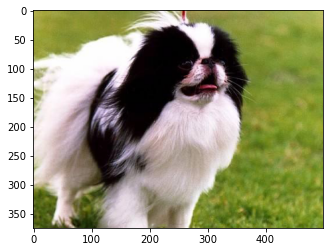

In [11]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/test/n02085782-Japanese_spaniel/n02085782_1039.jpg"))

# Preprocess the image
input_data = preprocess_image("../data/test/n02085782-Japanese_spaniel/n02085782_1039.jpg")

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
local_scoring_uri = local_service.scoring_uri

# Make POST request
resp = requests.post(local_scoring_uri, input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

POST to url http://localhost:6789/score
Result: {"label": "n02092002-Scottish_deerhound", "probability": "0.8354052"}


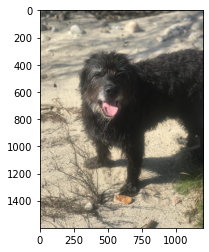

In [16]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/IMG-20210228-WA0030.jpg"))

# Preprocess the image
input_data = preprocess_image("../data/IMG-20210228-WA0030.jpg")

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
local_scoring_uri = local_service.scoring_uri

# Make POST request
resp = requests.post(local_scoring_uri, input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

# Model Deployment (Compute Target)

### Option 1: Deploy to ACI (Azure Container Instances)

In [27]:
aci_service_name = "dog-classification-service-aci"

aci_config = AciWebservice.deploy_configuration(cpu_cores=1,
                                                memory_gb=1,
                                                tags={"data": "dogs", "method": "transfer learning", "framework": "pytorch"},
                                                description="Classify dogs using transfer learning with PyTorch")

aci_service = Model.deploy(workspace=ws,
                           name=aci_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aci_config)

aci_service.wait_for_deployment(True)
print(aci_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.........................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


#### ACI Webservice Testing

Test the ACI webservice using an HTTP request with the requests library.

POST to url http://8d01f293-17ef-4383-bb2b-523ac98f1350.westeurope.azurecontainer.io/score
Result: {"label": "n02085782-Japanese_spaniel", "probability": "1.0"}


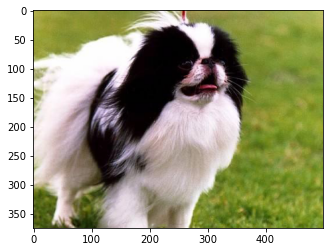

In [29]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/test/n02085782-Japanese_spaniel/n02085782_1039.jpg"))

# Preprocess the image
input_data = preprocess_image("../data/test/n02085782-Japanese_spaniel/n02085782_1039.jpg")

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
aci_scoring_uri = aci_service.scoring_uri

# Make POST request
resp = requests.post(aci_scoring_uri, input_data, headers=headers)

print("POST to url", aci_scoring_uri)
print("Result:", resp.text)

### Option 2: Deploy to AKS (Azure Kubernetes Service)

Provision an AKS Cluster.

In [8]:
aks_name = "aks-cluster" 

# Retrieve all computes from workspace
cts = ws.compute_targets

# Use existing cluster if available, else create a new one
if aks_name in cts and cts[aks_name].type == "AKS":
    print("Found existing AKS cluster, will use it!")
    aks_target = cts[aks_name]
else:
    print("Creating a new AKS cluster...")
    # Use the default provisioning config (no input parameters) or provide parameters to customize
    # For example, to create a dev/test cluster, use:
    prov_config = AksCompute.provisioning_configuration(cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
    # Example configuration to use an existing virtual network
    # prov_config.vnet_name = "mynetwork"
    # prov_config.vnet_resourcegroup_name = "myresourcegroup"
    # prov_config.subnet_name = "default"
    # prov_config.service_cidr = "10.0.0.0/16"
    # prov_config.dns_service_ip = "10.0.0.10"
    # prov_config.docker_bridge_cidr = "172.17.0.1/16"
    aks_target = ComputeTarget.create(workspace = ws,
                                      name = aks_name,
                                      provisioning_configuration = prov_config)
    
    print("Waiting for cluster creation completion...")
    aks_target.wait_for_completion(show_output=True)

print("Cluster state:", aks_target.provisioning_state)
print("Cluster is ready!", aks_target)

Creating a new AKS cluster...
Waiting for cluster creation completion...
Creating................................................................
SucceededProvisioning operation finished, operation "Succeeded"
Cluster state: Succeeded
Cluster is ready! AksCompute(workspace=Workspace.create(name='sbirkamlws', subscription_id='e58a23da-421e-4b52-99d5-e615f2f8be41', resource_group='sbirkamlrg'), name=aks-cluster, id=/subscriptions/e58a23da-421e-4b52-99d5-e615f2f8be41/resourceGroups/sbirkamlrg/providers/Microsoft.MachineLearningServices/workspaces/sbirkamlws/computes/aks-cluster, type=AKS, provisioning_state=Succeeded, location=westeurope, tags=None)


In [9]:
aks_service_name = "dog-classification-service-aks"

aks_config = AksWebservice.deploy_configuration(
                                                collect_model_data=True,
                                                enable_app_insights=True)

aks_webservices = Webservice.list(workspace = ws, compute_type="AKS")

if any(aks_webservice.name == aks_service_name for aks_webservice in aks_webservices):
    print("Model with same name already deployed")
else:
    if aks_target.provisioning_state == "Succeeded":
        aks_service = Model.deploy(workspace=ws,
                                   name=aks_service_name,
                                   models=[model],
                                   inference_config=inference_config,
                                   deployment_config=aks_config,
                                   deployment_target=aks_target)
        
        aks_service.wait_for_deployment(show_output = True)
        print("Service state:", aks_service.state)
        print("Service details:", aks_service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", aks_service.error)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...........................................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Service state: Healthy
Service details: AksWebservice(workspace=Workspace.create(name='sbirkamlws', subscription_id='e58a23da-421e-4b52-99d5-e615f2f8be41', resource_group='sbirkamlrg'), name=dog-classification-service-aks, image_id=None, compute_type=None, state=AKS, scoring_uri=Healthy, tags=http://20.73.117.144:80/api/v1/service/dog-classification-service-aks/score, properties={}, created_by={'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml', 'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'a7bb7640421879cafd24

#### AKS Webservice Testing

Test the AKS webservice using an HTTP request with the requests library.

POST to url http://20.73.117.144:80/api/v1/service/dog-classification-service-aks/score
Result: {"label": "n02085782-Japanese_spaniel", "probability": "1.0"}


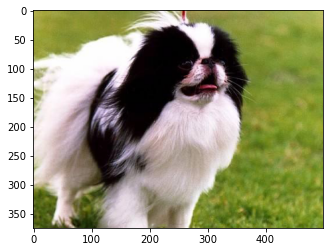

In [10]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/test/n02085782-Japanese_spaniel/n02085782_1039.jpg"))

# Preprocess the image
input_data = preprocess_image("../data/test/n02085782-Japanese_spaniel/n02085782_1039.jpg")

# Get body and header for POST request
# For AKS deployment the service key needs to be in the header as well
# AML generate two keys if key auth is enabled
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
api_key1, api_key2 = aks_service.get_keys()
headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key1)} 

# Get scoring URI
aks_scoring_uri = aks_service.scoring_uri

# Make POST request
resp = requests.post(aks_scoring_uri, input_data, headers=headers)

print("POST to url", aks_scoring_uri)
print("Result:", resp.text)

# Compute Target Deployment Debugging

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [ ]:
service.get_logs()

Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be integrated into any application.

In [ ]:
scoring_uri = service.scoring_uri
print(scoring_uri)

# Model Deployment (Container Image - AML SDK & Kubectl)

### Package Models

[Package a registered model with docker](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-package-models):

In some cases, you might want to create a Docker image without deploying the model (if, for example, you plan to deploy to Azure App Service). Or you might want to download the image and run it on a local Docker installation. You might even want to download the files used to build the image, inspect them, modify them, and build the image manually.

Model packaging enables you to do these things. It packages all the assets needed to host a model as a web service and allows you to download either a fully built Docker image or the files needed to build one. There are two ways to use model packaging:

**Download a packaged model:** Download a Docker image that contains the model and other files needed to host it as a web service.

**Generate a Dockerfile:** Download the Dockerfile, model, entry script, and other assets needed to build a Docker image. You can then inspect the files or make changes before you build the image locally.

Creating a package is similar to deploying a model. You use a registered model and an inference configuration. The following code builds an image, which is registered in the Azure Container Registry for your workspace.

If the generate_dockerfile flag is set to False, then an ACR build task will be triggered and the image will be built on the workspace-native ACR.

In [ ]:
image_name = "inference/fowl-pytorch"
image_label = "1.0" # image tag
generate_dockerfile = False # Option 1: False -> Build Image on ACR
# generate_dockerfile = True # Option 2: True -> Only create Dockerfile

# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=generate_dockerfile,
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

### Deploy Image to AKS

#### Option 1: Deploy Image to AKS Using Python SDK

In [ ]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script = "../src/deployment/score.py",
                                                  runtime = "python",
                                                  conda_file = "../environments/conda/environment.yml",
                                                  description = "fowl pytorch model",
                                                  tags = {"datasource": "microsoft blob store"})

image = ContainerImage.create(name = "fowl-pytorch-inference-image",
                              models = [model],
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

In [ ]:
aks_config = AksWebservice.deploy_configuration(collect_model_data=True,
                                                enable_app_insights=True)

aks_service_name ='sentiment-api-with-data-coll'


wss = Webservice.list(workspace = ws, compute_type='AKS')

if any(ws.name == aks_service_name for ws in wss):
    print('Model with same name already deployed')
else:
    if aks_target.provisioning_state == "Succeeded":
        aks_service = Webservice.deploy_from_image(workspace = ws, 
                                                   name = aks_service_name,
                                                   image = image,
                                                   deployment_config = aks_config,
                                                   deployment_target = aks_target)
        aks_service.wait_for_deployment(show_output = True)
        print('Service state:', aks_service.state)
        print('Service details:', aks_service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", aks_service.error)

#### Option 2: Deploy Image to AKS Using Kubectl

Create a shell script to create an AKS Cluster (with attached ACR) and configure kubectl to connect to this Kubernetes cluster:

In [ ]:
%%writefile ../extras/create_kubernetes_cluster.sh
# Define parameters
resourceGroupName=sbirkrg$RANDOM
aksClusterName=sbirkaks$RANDOM
acrName=3d5545b15c4c49548d3823156fa90536
region=westeurope

# Create a resource group
az group create \
  --name $resourceGroupName\
  --location $region

# Option 1: Create an AKS cluster
az aks create \
    --resource-group $resourceGroupName \
    --name $aksClusterName \
    --node-count 2 \
    --generate-ssh-keys \
    --attach-acr $acrName

# Option 2: Or use existing one instead
az aks update \
    --resource-group $resourceGroupName
    --name $aksClusterName \
    --attach-acr $acrName

# Install kubectl
az aks install-cli

# Configure kubectl to connect to the AKS cluster
az aks get-credentials \
    --resource-group $resourceGroupName \
    --name $aksClusterName

Navigate to folder extras and run:

`bash create_kubernetes_cluster.sh`

Create a Kubernetes manifest to deploy the fowl pytorch model.

In [ ]:
%%writefile ../extras/fowl_pytorch_kubernetes.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: fowl-pytorch
spec:
  replicas: 1
  selector:
    matchLabels:
      app: fowl-pytorch
  template:
    metadata:
      labels:
        app: fowl-pytorch
    spec: 
      containers:
      - image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/fowl-pytorch:1.0
        name: fowl-pytorch
---
apiVersion: v1
kind: Service
metadata:
  labels:
    app: fowl-pytorch
  name: fowl-pytorch
spec:
  ports:
  - port: 5001
    protocol: TCP
  selector:
    app: fowl-pytorch
  type: LoadBalancer

Deploy the application:

`kubectl apply -f fowl_pytorch_kubernetes.yml`

Check whether container was successfully deployed:

`kubectl get pods`

Check webservice status and retrieve external IP:

`kubectl get service fowl-pytorch --watch`

### Test the Deployed Webservice

Insert external IP from above command.

In [ ]:
# URL for the web service.
scoring_uri = "http://51.105.203.224:5001/score"

# Preprocess the image
input_data = preprocess_image("../data/fowl_data/test_img.jpg")

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Make the request and display the response.
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

# Model Deployment (Batch Pipeline)

In [ ]:
from azureml.pipeline.steps import ParallelRunConfig, ParallelRunStep
from azureml.pipeline.core import PipelineData
from azureml.pipeline.core import Pipeline

# Get the batch dataset for input
batch_data_set = ws.datasets["fowl-dataset"]

# Set the output location
default_ds = ws.get_default_datastore()
output_dir = PipelineData(name="inferences",
                          datastore=default_ds,
                          output_path_on_compute="results")

# Define the parallel run step step configuration
parallel_run_config = ParallelRunConfig(
    source_directory='batch_scripts',
    entry_script="batch_scoring_script.py",
    mini_batch_size="5",
    error_threshold=10,
    output_action="append_row",
    environment=batch_env,
    compute_target=aml_cluster,
    node_count=4)

# Create the parallel run step
parallelrun_step = ParallelRunStep(
    name='batch-score',
    parallel_run_config=parallel_run_config,
    inputs=[batch_data_set.as_named_input('batch_data')],
    output=output_dir,
    arguments=[],
    allow_reuse=True
)
# Create the pipeline
pipeline = Pipeline(workspace=ws, steps=[parallelrun_step])

# Model Deployment (Azure Functions)

For a detailed tutorial on deploying ML models to Azure Functions check [this](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-functions#code-try-12).

Packaging for functions currently supports HTTP Triggers, Blob triggers and Service bus triggers. For more information on triggers, see [Azure Functions bindings](https://docs.microsoft.com/en-us/azure/azure-functions/functions-bindings-storage-blob-trigger#blob-name-patterns) or check the [available classes and methods of the Python SDK](https://docs.microsoft.com/en-us/python/api/azureml-contrib-functions/azureml.contrib.functions?preserve-view=true&view=azure-ml-py).

### Option 1: Blob Trigger

In [ ]:
blob_trigger_package = package(ws,
                               [model],
                               inference_config,
                               #generate_dockerfile=True,
                               generate_dockerfile=False,
                               functions_enabled=True,
                               trigger=BLOB_TRIGGER,
                               input_path="input/{blobname}.json", 
                               # input container has to be named input; all json files will trigger the function
                               output_path="output/{blobname}_out.json"
                               # output container has to be named output; the file name will be same as input + "_out"
                               )

blob_trigger_package.wait_for_creation(show_output=True)

# Display the package location/ACR path
print(blob_trigger_package.location)

In [ ]:
# Download Dockerfile and relevant deployment artifacts
blob_trigger_package.save("../environments/docker/azure_function_deployment")

Run below commands in the terminal from the project root directory to build the image on the ACR:

`cd environments/docker/azure_function_deployment`

`az login --tenant 461e2020-109b-4c43-ad3f-eb9944f5dc44`

`az acr build --image inference/function/fowl-pytorch-blob-trigger:1.0 --registry 3d5545b15c4c49548d3823156fa90536 .`

Run below commands in the terminal to create the necessary infrastructure for deployment:

Retrieve login credentials of ACR:

`az acr credential show --name 3d5545b15c4c49548d3823156fa90536`

Create a resource group:

`az group create --name birksamlfuncrg --location westeurope`

Create an appservice plan:

`az appservice plan create --name birksamlfuncappservice --resource-group birksamlfuncrg --sku B1 --is-linux`

Create a blob store as web job store:

`az storage account create --name birksamlfuncwjblob --location westeurope --resource-group birksamlfuncrg --sku Standard_LRS`

Retrieve web job store blob store connection string:

`az storage account show-connection-string --resource-group birksamlfuncrg --name birksamlfuncwjblob --query connectionString --output tsv`

Create function app:

`az functionapp create --resource-group birksamlfuncrg --plan birksamlfuncappservice --name birksamlfuncfunction --deployment-container-image-name 3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/function/fowl-pytorch-blob-trigger --storage-account birksamlfuncwjblob`

Create blob trigger storage:

`az storage account create --name birksamlfunctriggerblob --location westeurope --resource-group birksamlfuncrg --sku Standard_LRS`

Retrieve blob trigger storage connection string:

`az storage account show-connection-string --resource-group birksamlfuncrg --name birksamlfunctriggerblob --query connectionString --output tsv`

Create containers for input and output:

`az storage container create -n input --connection-string "DefaultEndpointsProtocol=https;EndpointSuffix=core.windows.net;AccountName=birksamlfunctriggerblob;AccountKey=Q+F/UqWc5AIJn7RPINmw7XrJyPy1J79tr/kI/hpMTI0fycF+1wTi7PYsy8q+3SrArXcVyACXZbBiv5TbpHO8Bg=="`

`az storage container create -n output --connection-string "DefaultEndpointsProtocol=https;EndpointSuffix=core.windows.net;AccountName=birksamlfunctriggerblob;AccountKey=Q+F/UqWc5AIJn7RPINmw7XrJyPy1J79tr/kI/hpMTI0fycF+1wTi7PYsy8q+3SrArXcVyACXZbBiv5TbpHO8Bg=="`

Run below commands in the terminal to deploy the image to the function:

Associate the trigger connection string with the function app:

`az functionapp config appsettings set --name birksamlfuncfunction --resource-group birksamlfuncrg --settings "TriggerConnectionString=DefaultEndpointsProtocol=https;EndpointSuffix=core.windows.net;AccountName=birksamlfunctriggerblob;AccountKey=Q+F/UqWc5AIJn7RPINmw7XrJyPy1J79tr/kI/hpMTI0fycF+1wTi7PYsy8q+3SrArXcVyACXZbBiv5TbpHO8Bg=="`

Retrieve tag of associated container:

`az acr repository show-tags --repository inference/function/fowl-pytorch-blob-trigger --name 3d5545b15c4c49548d3823156fa90536 --output tsv`

Provide function app with credentials needed to access container registry:

`az functionapp config container set --name birksamlfuncfunction --resource-group birksamlfuncrg --docker-custom-image-name 3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/function/fowl-pytorch-blob-trigger:1.0 --docker-registry-server-url https://3d5545b15c4c49548d3823156fa90536.azurecr.io --docker-registry-server-user "3d5545b15c4c49548d3823156fa90536" --docker-registry-server-password "Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e"`

The deployment can be monitored in the Deployment Center of the Function resource in the Azure Portal.

Create an example file to upload to blob:

In [ ]:
%%writefile ../data/fowl_data/function/data.json
{"data": [[[[-0.3369295597076416, -0.0629335269331932, 0.039814990013837814, -0.14855729043483734, -0.13143253326416016, -0.25130581855773926, 0.005565485917031765, -0.14855729043483734, -0.7650483846664429, -0.4910523295402527, -0.028684020042419434, 0.005565485917031765, 0.005565485917031765, 0.07406462728977203, 0.005565485917031765, 0.6563062071800232, 0.3994349241256714, -0.40542858839035034, -0.7136741280555725, -0.542426586151123, -0.40542858839035034, -0.6965493559837341, -0.7136741280555725, -0.37117907404899597, -0.6965493559837341, -0.7307989001274109, -0.5595513582229614, -0.7479236125946045, -0.9705454111099243, -0.28555530309677124, -0.0800582766532898, -0.1999315470457077, -0.16568204760551453, -0.14855729043483734, -0.4568028450012207, -0.5595513582229614, -0.8506721258163452, -1.1246683597564697, -0.9362959265708923, -0.4396780729293823, -0.011559266597032547, -0.14855729043483734, -0.23418104648590088, -0.11430778354406357, -0.25130581855773926, -0.16568204760551453, 0.0569397434592247, 0.19393789768218994, 0.4850586950778961, -0.04580877348780632, -0.0800582766532898, 0.039814990013837814, -0.1999315470457077, -0.884921669960022, -1.1931673288345337, -0.5595513582229614, -0.5766761302947998, -0.28555530309677124, 0.46793392300605774, 0.5878071784973145, 0.17681314051151276, -0.1999315470457077, -0.25130581855773926, -0.40542858839035034, -0.3026800751686096, -0.3369295597076416, -0.2170563042163849, 0.1083141341805458, -0.28555530309677124, -0.6109256148338318, -0.6622998714447021, -0.37117907404899597, -0.16568204760551453, -0.1999315470457077, 0.1254388839006424, -0.09718302637338638, -0.5766761302947998, -0.5253018736839294, -0.6965493559837341, -0.40542858839035034, -0.37117907404899597, -0.42255333065986633, -0.28555530309677124, -0.4739275872707367, -0.09718302637338638, -0.09718302637338638, -0.3198048174381256, 0.31381115317344666, 0.1083141341805458, -0.14855729043483734, -0.38830381631851196, -0.4396780729293823, -0.5253018736839294, -0.6109256148338318, -0.0629335269331932, 0.039814990013837814, -0.542426586151123, -0.7992978692054749, -1.0561692714691162, -0.6109256148338318, -0.13143253326416016, -0.4739275872707367, -0.8677968978881836, -0.6451750993728638, -0.9534206390380859, -1.158917784690857, -1.3815395832061768, -1.3644148111343384, -0.8677968978881836, -0.42255333065986633, -0.3198048174381256, -0.40542858839035034, -0.1999315470457077, -0.13143253326416016, -1.210292100906372, -1.1246683597564697, -1.0561692714691162, -1.0904186964035034, -1.158917784690857, -0.25130581855773926, -0.16568204760551453, -0.6965493559837341, -0.23418104648590088, -0.14855729043483734, -0.7307989001274109, -0.42255333065986633, -0.2170563042163849, -0.26843056082725525, -0.25130581855773926, -0.8335474133491516, -1.158917784690857, -0.35405433177948, -0.028684020042419434, 0.348060667514801, 0.5878071784973145, -0.16568204760551453, -1.0904186964035034, -0.4396780729293823, 0.0569397434592247, 0.844678521156311, -0.0800582766532898, 0.365185409784317, 0.365185409784317, -0.16568204760551453, -0.7821731567382812, -0.7479236125946045, -0.40542858839035034, 1.1357992887496948, 0.7933042645454407, -0.028684020042419434, 0.29668641090393066, 0.1083141341805458, 0.005565485917031765, -0.11430778354406357, 0.22818739712238312, -0.5253018736839294, -0.7992978692054749, -0.8335474133491516, -0.4739275872707367, -0.3026800751686096, -0.9020463824272156, -1.0904186964035034, -1.0219197273254395, -0.6280503869056702, -0.7821731567382812, -1.0561692714691162, -1.3301653861999512, -1.2445416450500488, -0.6451750993728638, -0.5938008427619934, 0.17681314051151276, 0.6220567226409912, 0.21106265485286713, -0.13143253326416016, -0.6109256148338318, -0.919171154499054, -0.9705454111099243, -0.7992978692054749, -0.13143253326416016, 0.878928005695343, 0.7419300079345703, 0.1083141341805458, -0.6622998714447021, -0.5253018736839294, -0.13143253326416016, 0.348060667514801, -0.16568204760551453, -0.25130581855773926, -0.16568204760551453, 0.33093592524528503, 1.0673003196716309, 0.9303022623062134, 0.17681314051151276, 0.07406462728977203, 0.8960527777671814, 0.2795616686344147, -0.38830381631851196, -0.38830381631851196, -0.8677968978881836, -0.6794246435165405, -0.5595513582229614, -0.7479236125946045, -0.7136741280555725, -0.5938008427619934, 0.039814990013837814, 0.0569397434592247, 0.14256364107131958, 0.19393789768218994, -0.5081771016120911, -0.7650483846664429, -0.5595513582229614, -0.1999315470457077, -0.26843056082725525, -0.25130581855773926, -0.18280678987503052, 0.005565485917031765, 0.005565485917031765, 0.6220567226409912, 0.6391814351081848, -0.26843056082725525, -0.0629335269331932, 0.07406462728977203, -0.5595513582229614, -0.26843056082725525], [-0.38830381631851196, -0.14855729043483734, -0.26843056082725525, -0.4396780729293823, -0.4396780729293823, -0.1999315470457077, -0.028684020042419434, -0.11430778354406357, -0.7992978692054749, -0.028684020042419434, 0.5364329218864441, 0.19393789768218994, -0.26843056082725525, 0.17681314051151276, -0.18280678987503052, -0.011559266597032547, 0.5706824660301208, 0.1254388839006424, -0.40542858839035034, -0.38830381631851196, 0.005565485917031765, -0.26843056082725525, -0.6280503869056702, -0.1999315470457077, -0.13143253326416016, -0.35405433177948, -0.4910523295402527, -0.6280503869056702, -1.0219197273254395, -0.7992978692054749, -0.04580877348780632, 0.31381115317344666, 0.022690238431096077, -0.11430778354406357, -0.3026800751686096, -0.26843056082725525, -0.4739275872707367, -0.884921669960022, -0.9362959265708923, -0.8335474133491516, -0.35405433177948, -0.14855729043483734, -0.0629335269331932, -0.14855729043483734, -0.9362959265708923, -0.8506721258163452, -0.26843056082725525, -0.0629335269331932, 0.15968838334083557, 0.0569397434592247, 0.2624368965625763, 0.2453121542930603, -0.35405433177948, -0.25130581855773926, -0.6794246435165405, -0.6965493559837341, -0.8677968978881836, 0.29668641090393066, 1.101549744606018, 0.7248052358627319, 0.1083141341805458, -0.1999315470457077, -0.4396780729293823, -0.5081771016120911, -0.16568204760551453, 0.3823101818561554, 0.4165596663951874, 0.4850586950778961, -0.26843056082725525, -0.9020463824272156, -0.8506721258163452, -0.38830381631851196, -0.0800582766532898, -0.11430778354406357, 0.1083141341805458, -0.3198048174381256, -0.5595513582229614, -0.6451750993728638, -0.7136741280555725, -0.5595513582229614, -0.7650483846664429, -0.42255333065986633, -0.1999315470457077, -0.1999315470457077, -0.13143253326416016, -0.14855729043483734, -0.4910523295402527, 0.07406462728977203, -0.04580877348780632, -0.6109256148338318, -0.8506721258163452, -0.42255333065986633, -0.16568204760551453, -0.35405433177948, -0.11430778354406357, -0.6109256148338318, -1.0219197273254395, -1.0390444993972778, -1.0732940435409546, -0.9534206390380859, -0.7650483846664429, -0.0629335269331932, -0.3369295597076416, -0.5595513582229614, -0.8677968978881836, -0.9362959265708923, -1.0732940435409546, -1.158917784690857, -0.8164226412773132, -0.5938008427619934, -0.35405433177948, -0.6451750993728638, -0.5595513582229614, 0.3994349241256714, -0.4910523295402527, -0.919171154499054, -1.3130406141281128, -1.2616662979125977, -1.2274168729782104, -0.7821731567382812, -0.04580877348780632, -0.3198048174381256, -0.40542858839035034, -0.28555530309677124, -0.18280678987503052, -0.23418104648590088, -0.011559266597032547, -0.38830381631851196, -0.14855729043483734, -0.542426586151123, -1.0732940435409546, -1.0390444993972778, -0.4568028450012207, -0.4568028450012207, 0.0569397434592247, -0.2170563042163849, -0.5766761302947998, -0.0800582766532898, -0.40542858839035034, 0.7933042645454407, 0.8275537490844727, 0.5706824660301208, 0.22818739712238312, -0.4910523295402527, -1.0219197273254395, -0.884921669960022, -0.028684020042419434, 1.2214230298995972, 0.22818739712238312, 0.15968838334083557, 0.7076804637908936, 0.348060667514801, -0.09718302637338638, 0.0569397434592247, 0.17681314051151276, -0.9705454111099243, -0.7821731567382812, -0.4739275872707367, 0.31381115317344666, 0.022690238431096077, -0.9705454111099243, -0.9534206390380859, -0.919171154499054, -1.1760425567626953, -0.9876701831817627, -0.8677968978881836, -1.2445416450500488, -0.9876701831817627, -0.4739275872707367, -0.7307989001274109, -0.16568204760551453, 0.6391814351081848, 0.348060667514801, -0.18280678987503052, -0.6280503869056702, -0.7136741280555725, -1.0390444993972778, -0.16568204760551453, 0.5535576939582825, 0.8275537490844727, 0.039814990013837814, -0.13143253326416016, -0.7992978692054749, -0.23418104648590088, 0.1254388839006424, 0.5364329218864441, -0.0629335269331932, -0.4739275872707367, -0.5081771016120911, -0.3198048174381256, 0.19393789768218994, 0.365185409784317, 0.4850586950778961, -0.25130581855773926, 0.21106265485286713, 0.45080918073654175, -0.09718302637338638, -0.3369295597076416, -0.35405433177948, -0.35405433177948, -0.6280503869056702, -0.5081771016120911, -0.542426586151123, -0.028684020042419434, 0.2795616686344147, -0.11430778354406357, -0.011559266597032547, 0.15968838334083557, -1.0390444993972778, -0.9705454111099243, -0.4910523295402527, -0.37117907404899597, -0.542426586151123, -0.919171154499054, -0.18280678987503052, 0.3994349241256714, 0.5193082094192505, 0.7933042645454407, 0.09118937700986862, -0.542426586151123, -0.37117907404899597, -0.37117907404899597, -0.4739275872707367, -0.5253018736839294], [-0.9876701831817627, -0.7479236125946045, -0.35405433177948, -0.3026800751686096, -0.4910523295402527, -0.35405433177948, -0.4396780729293823, -0.4739275872707367, -0.8506721258163452, -0.2170563042163849, 0.31381115317344666, -0.11430778354406357, -0.6794246435165405, -0.14855729043483734, -0.16568204760551453, -0.14855729043483734, 0.3994349241256714, 0.31381115317344666, 0.09118937700986862, 0.022690238431096077, 0.15968838334083557, -0.14855729043483734, -0.6109256148338318, -0.542426586151123, 0.039814990013837814, -0.1999315470457077, -0.6451750993728638, -1.004794955253601, -1.210292100906372, -1.0219197273254395, -0.25130581855773926, 0.22818739712238312, 0.2795616686344147, 0.039814990013837814, -0.3198048174381256, -0.3198048174381256, -0.28555530309677124, -0.14855729043483734, -0.4910523295402527, -0.6622998714447021, -0.4910523295402527, -0.1999315470457077, 0.15968838334083557, -0.011559266597032547, -0.9876701831817627, -0.919171154499054, -0.0800582766532898, 0.45080918073654175, 0.2795616686344147, 0.15968838334083557, 0.2795616686344147, -0.0800582766532898, -0.4910523295402527, 0.005565485917031765, -0.04580877348780632, -0.5595513582229614, -0.7307989001274109, 0.348060667514801, 0.6734309792518616, 0.348060667514801, -0.25130581855773926, -0.542426586151123, -0.5766761302947998, -0.3198048174381256, -0.09718302637338638, 0.5706824660301208, 0.7590547204017639, 0.365185409784317, 0.15968838334083557, -0.5081771016120911, -0.7136741280555725, -0.26843056082725525, -0.11430778354406357, -0.4568028450012207, -0.09718302637338638, -0.4568028450012207, -0.7650483846664429, -0.542426586151123, -0.38830381631851196, -0.18280678987503052, -0.4910523295402527, -0.7992978692054749, -0.6965493559837341, -0.8677968978881836, -0.3369295597076416, -0.25130581855773926, -0.2170563042163849, -0.011559266597032547, -0.3369295597076416, -0.6109256148338318, -0.5081771016120911, -0.16568204760551453, 0.33093592524528503, 0.5535576939582825, 0.29668641090393066, -0.6451750993728638, -1.0390444993972778, -0.884921669960022, -1.004794955253601, -0.8677968978881836, -0.9362959265708923, -0.6622998714447021, -0.2170563042163849, -0.4568028450012207, -0.4568028450012207, -0.3198048174381256, -0.4396780729293823, -0.4910523295402527, -0.42255333065986633, -0.35405433177948, -0.09718302637338638, -0.6280503869056702, -0.8506721258163452, 0.15968838334083557, -0.26843056082725525, -1.1417930126190186, -0.9534206390380859, -1.1760425567626953, -1.1246683597564697, -0.9020463824272156, -0.6622998714447021, -0.3369295597076416, -0.6109256148338318, -0.5595513582229614, -0.23418104648590088, -0.5595513582229614, -0.3198048174381256, -0.40542858839035034, 0.31381115317344666, 0.365185409784317, -0.028684020042419434, -0.7992978692054749, -0.4568028450012207, -0.3198048174381256, -0.6451750993728638, -0.6280503869056702, -0.3369295597076416, -0.35405433177948, -0.6794246435165405, 0.6563062071800232, 1.3412963151931763, 0.5193082094192505, 0.005565485917031765, -0.6965493559837341, -0.8506721258163452, -0.9020463824272156, 0.6734309792518616, 1.1529240608215332, 0.4165596663951874, 0.7761794924736023, 0.8618032336235046, 0.0569397434592247, -0.13143253326416016, 0.4850586950778961, 0.1254388839006424, -0.4568028450012207, -0.4396780729293823, -0.5081771016120911, 0.7590547204017639, 0.6391814351081848, -0.3198048174381256, -0.35405433177948, -0.3369295597076416, -1.004794955253601, -1.3130406141281128, -1.1931673288345337, -0.8677968978881836, -0.09718302637338638, -0.11430778354406357, -0.42255333065986633, -0.3198048174381256, 0.7419300079345703, 0.14256364107131958, -0.4568028450012207, -0.35405433177948, -0.42255333065986633, -1.1075435876846313, -0.13143253326416016, 0.29668641090393066, 0.45080918073654175, -0.7307989001274109, -0.4568028450012207, -1.0904186964035034, 0.005565485917031765, 0.1254388839006424, 0.19393789768218994, -0.3369295597076416, -0.5253018736839294, 0.22818739712238312, -0.14855729043483734, -0.35405433177948, -0.23418104648590088, 0.0569397434592247, -0.28555530309677124, -0.3369295597076416, 0.5021834373474121, 0.4165596663951874, -0.04580877348780632, 0.4850586950778961, 0.005565485917031765, -0.13143253326416016, 0.14256364107131958, -0.542426586151123, 0.07406462728977203, 0.2795616686344147, -0.23418104648590088, -0.4568028450012207, -0.16568204760551453, -1.1075435876846313, -1.1760425567626953, -0.8164226412773132, -0.5595513582229614, -0.5081771016120911, -0.7307989001274109, 0.07406462728977203, 0.31381115317344666, 0.5193082094192505, 0.913177490234375, 0.6049319505691528, 0.1254388839006424, -0.4739275872707367, -0.40542858839035034, -0.3369295597076416, -0.6794246435165405], [-1.1417930126190186, -1.210292100906372, -0.7821731567382812, -0.542426586151123, -0.7821731567382812, -0.6280503869056702, -0.5081771016120911, -0.38830381631851196, -0.16568204760551453, 0.09118937700986862, 0.07406462728977203, -0.35405433177948, -0.5253018736839294, -0.4568028450012207, -0.4396780729293823, -0.4396780729293823, -0.3369295597076416, -0.4396780729293823, -0.13143253326416016, 0.09118937700986862, 0.3994349241256714, 0.09118937700986862, -0.40542858839035034, -0.5766761302947998, -0.16568204760551453, 0.1083141341805458, -0.6451750993728638, -1.1246683597564697, -1.278791069984436, -0.9876701831817627, -0.4739275872707367, 0.3823101818561554, 0.9474270343780518, 0.21106265485286713, -0.28555530309677124, -0.26843056082725525, -0.2170563042163849, 0.005565485917031765, 0.005565485917031765, -0.25130581855773926, -0.1999315470457077, -0.3198048174381256, -0.0800582766532898, 0.022690238431096077, -0.4910523295402527, -0.542426586151123, 0.4165596663951874, 0.9645517468452454, 0.9474270343780518, 0.43368443846702576, -0.25130581855773926, -0.5253018736839294, -0.4568028450012207, 0.07406462728977203, -0.011559266597032547, -0.35405433177948, -0.35405433177948, 0.33093592524528503, -0.14855729043483734, -0.8335474133491516, -0.8164226412773132, -1.1417930126190186, -0.7479236125946045, 0.22818739712238312, 0.365185409784317, 0.14256364107131958, 0.21106265485286713, 0.039814990013837814, 0.19393789768218994, -0.23418104648590088, -0.3026800751686096, -0.11430778354406357, -0.38830381631851196, -0.38830381631851196, -0.0800582766532898, -0.16568204760551453, -0.4739275872707367, 0.022690238431096077, 0.4165596663951874, 0.8275537490844727, 0.8960527777671814, 0.005565485917031765, -0.6451750993728638, -0.6451750993728638, -0.3369295597076416, 0.022690238431096077, 0.1254388839006424, 0.4165596663951874, 0.14256364107131958, -0.3198048174381256, -0.40542858839035034, -0.3026800751686096, 0.09118937700986862, 0.6391814351081848, 0.5021834373474121, -0.25130581855773926, -0.7479236125946045, -0.4396780729293823, -0.35405433177948, -0.4910523295402527, -0.3198048174381256, -0.42255333065986633, -0.40542858839035034, -0.028684020042419434, 0.2453121542930603, -0.011559266597032547, 0.005565485917031765, 0.2453121542930603, -0.1999315470457077, -0.3198048174381256, -0.26843056082725525, -0.7136741280555725, -0.5595513582229614, -0.4396780729293823, -0.7821731567382812, -0.40542858839035034, -0.40542858839035034, -0.7307989001274109, -0.6622998714447021, -0.5938008427619934, -0.6622998714447021, -0.5081771016120911, -0.8164226412773132, -0.7479236125946045, -0.3198048174381256, -0.542426586151123, -0.38830381631851196, -0.35405433177948, -0.3369295597076416, -0.14855729043483734, -0.4396780729293823, -0.9876701831817627, -0.8677968978881836, -0.7136741280555725, -0.7307989001274109, -0.542426586151123, -0.542426586151123, -0.6451750993728638, -0.4739275872707367, 0.45080918073654175, 1.255672574043274, 0.17681314051151276, -0.38830381631851196, -0.9705454111099243, -0.5253018736839294, -0.5766761302947998, 1.0159260034561157, 1.0501755475997925, 1.033050775527954, 0.6905557513237, 0.2795616686344147, -0.5253018736839294, -0.3198048174381256, 0.5021834373474121, 0.07406462728977203, -0.0800582766532898, 0.022690238431096077, -0.028684020042419434, 0.6734309792518616, 0.5706824660301208, 0.17681314051151276, 0.844678521156311, 0.365185409784317, -0.9705454111099243, -1.1246683597564697, -1.1075435876846313, -0.3369295597076416, 0.1254388839006424, -0.04580877348780632, -0.3198048174381256, -0.6622998714447021, 0.5364329218864441, 0.15968838334083557, -0.23418104648590088, -0.1999315470457077, -0.6794246435165405, -1.158917784690857, -0.16568204760551453, 0.2624368965625763, 0.039814990013837814, -0.9362959265708923, -0.5766761302947998, -1.1760425567626953, -0.4568028450012207, 0.21106265485286713, 0.4165596663951874, -0.25130581855773926, -0.0800582766532898, 0.3994349241256714, 0.2624368965625763, 0.29668641090393066, 0.43368443846702576, 0.7248052358627319, 0.33093592524528503, -0.7307989001274109, 0.2624368965625763, 0.4850586950778961, 0.5535576939582825, 0.6220567226409912, 0.039814990013837814, 0.8618032336235046, 0.5535576939582825, -0.1999315470457077, 0.0569397434592247, 0.22818739712238312, -0.26843056082725525, -0.7307989001274109, -0.25130581855773926, -1.0732940435409546, -1.1075435876846313, -0.5938008427619934, -0.37117907404899597, -0.25130581855773926, -0.3369295597076416, 0.5364329218864441, 0.46793392300605774, 0.29668641090393066, 0.5535576939582825, 0.6391814351081848, 0.31381115317344666, -0.028684020042419434, -0.4568028450012207, -0.6280503869056702, -0.42255333065986633], [-1.4157891273498535, -1.3644148111343384, -1.0561692714691162, -0.7136741280555725, -0.6622998714447021, -0.26843056082725525, -0.4739275872707367, -0.542426586151123, 0.09118937700986862, 0.31381115317344666, 0.07406462728977203, -0.4568028450012207, -0.7307989001274109, -0.542426586151123, -0.28555530309677124, -0.4739275872707367, -0.6109256148338318, -0.8506721258163452, -0.9020463824272156, -0.5253018736839294, 0.022690238431096077, 0.039814990013837814, -0.3026800751686096, -0.38830381631851196, -0.3026800751686096, 0.09118937700986862, -0.1999315470457077, -0.7821731567382812, -1.2274168729782104, -1.2616662979125977, -0.7650483846664429, 0.039814990013837814, 0.9303022623062134, 0.365185409784317, -0.26843056082725525, 0.005565485917031765, 0.2795616686344147, 0.4165596663951874, 0.1254388839006424, -0.13143253326416016, -0.13143253326416016, -0.2170563042163849, -0.0629335269331932, -0.23418104648590088, -0.2170563042163849, -0.26843056082725525, 0.21106265485286713, 0.5535576939582825, 0.9645517468452454, 0.913177490234375, 0.022690238431096077, -0.4910523295402527, -0.25130581855773926, -0.04580877348780632, 0.039814990013837814, -0.3369295597076416, -0.5595513582229614, 0.0569397434592247, -0.4910523295402527, -1.0904186964035034, -1.1417930126190186, -1.1931673288345337, -0.6622998714447021, 0.31381115317344666, 0.4165596663951874, 0.14256364107131958, 0.1083141341805458, 0.15968838334083557, 0.1083141341805458, 0.0569397434592247, 0.0569397434592247, -0.14855729043483734, -0.3369295597076416, -0.4568028450012207, -0.40542858839035034, -0.5595513582229614, -0.5766761302947998, -0.04580877348780632, 0.5364329218864441, 0.913177490234375, 1.0501755475997925, 0.31381115317344666, -0.16568204760551453, -0.4568028450012207, -0.6280503869056702, -0.6109256148338318, 0.022690238431096077, 0.844678521156311, 0.7248052358627319, 0.2453121542930603, -0.0629335269331932, -0.011559266597032547, -0.4910523295402527, -0.8335474133491516, -0.6451750993728638, -0.1999315470457077, -0.42255333065986633, -0.3369295597076416, -0.09718302637338638, -0.16568204760551453, 0.0569397434592247, -0.28555530309677124, -0.4739275872707367, -0.14855729043483734, 0.2624368965625763, -0.3026800751686096, -0.1999315470457077, 0.29668641090393066, -0.23418104648590088, -0.4910523295402527, -0.542426586151123, -0.542426586151123, 0.1254388839006424, -0.0629335269331932, -0.6965493559837341, -0.0800582766532898, -0.28555530309677124, -0.6451750993728638, -0.5595513582229614, -0.25130581855773926, -0.28555530309677124, -0.11430778354406357, -0.7136741280555725, -0.884921669960022, -0.4910523295402527, -0.35405433177948, -0.38830381631851196, -0.6622998714447021, -0.7650483846664429, -1.0219197273254395, -1.3472901582717896, -1.1931673288345337, -0.9020463824272156, -0.9534206390380859, -0.5595513582229614, -0.38830381631851196, -0.5595513582229614, -0.7307989001274109, -0.9020463824272156, -0.6965493559837341, -0.11430778354406357, -0.40542858839035034, -0.6280503869056702, -1.0732940435409546, -0.6794246435165405, 0.21106265485286713, 1.2727973461151123, 0.8275537490844727, 0.6049319505691528, 0.1083141341805458, -0.16568204760551453, -0.42255333065986633, -0.13143253326416016, -0.14855729043483734, 0.07406462728977203, 0.5535576939582825, 0.14256364107131958, -0.04580877348780632, 0.0569397434592247, -0.09718302637338638, 0.348060667514801, 1.18717360496521, 0.5706824660301208, -0.40542858839035034, -0.3369295597076416, -0.28555530309677124, -0.04580877348780632, -0.09718302637338638, -0.13143253326416016, -0.5766761302947998, -0.7650483846664429, -0.0629335269331932, -0.23418104648590088, 0.8618032336235046, 0.6563062071800232, -0.7307989001274109, -1.0904186964035034, -0.09718302637338638, 0.45080918073654175, -0.28555530309677124, -0.9876701831817627, -0.4568028450012207, -1.0904186964035034, -0.5938008427619934, 0.3823101818561554, 0.5021834373474121, 0.4850586950778961, 0.348060667514801, 0.3994349241256714, 0.5535576939582825, 0.5706824660301208, 0.6220567226409912, 0.46793392300605774, -0.5081771016120911, -1.210292100906372, -0.5595513582229614, -0.26843056082725525, 0.5364329218864441, 0.6563062071800232, 0.2795616686344147, 0.039814990013837814, -0.40542858839035034, -0.04580877348780632, 0.31381115317344666, 0.29668641090393066, -0.23418104648590088, -0.7479236125946045, -0.2170563042163849, -0.7821731567382812, -0.7479236125946045, -0.3198048174381256, -0.6109256148338318, -0.3369295597076416, -0.2170563042163849, 0.6563062071800232, 0.31381115317344666, -0.11430778354406357, 0.19393789768218994, 0.5193082094192505, 0.365185409784317, 0.1254388839006424, -0.2170563042163849, -0.23418104648590088, 0.0569397434592247], [-1.432913899421692, -1.432913899421692, -1.3301653861999512, -1.0561692714691162, -0.7136741280555725, -0.42255333065986633, -0.4739275872707367, -0.4568028450012207, -0.028684020042419434, 0.14256364107131958, -0.18280678987503052, -0.37117907404899597, -0.40542858839035034, -0.42255333065986633, -0.3026800751686096, -0.4396780729293823, -0.7307989001274109, -0.4910523295402527, -0.7136741280555725, -0.8335474133491516, -0.35405433177948, -0.40542858839035034, -0.7479236125946045, -0.3198048174381256, -0.38830381631851196, -0.011559266597032547, 0.43368443846702576, -0.13143253326416016, -0.5595513582229614, -0.7136741280555725, -0.8506721258163452, -0.3026800751686096, 0.6563062071800232, 0.6220567226409912, -0.1999315470457077, -0.40542858839035034, 0.19393789768218994, 0.4850586950778961, 0.039814990013837814, -0.16568204760551453, -0.16568204760551453, -0.18280678987503052, -0.2170563042163849, -0.5595513582229614, -0.3198048174381256, -0.0629335269331932, 0.2624368965625763, 0.2624368965625763, 0.7933042645454407, 0.7761794924736023, 0.5706824660301208, -0.011559266597032547, 0.1083141341805458, 0.005565485917031765, 0.17681314051151276, 0.21106265485286713, -0.028684020042419434, 0.31381115317344666, -0.2170563042163849, -0.6109256148338318, -1.0732940435409546, -1.0732940435409546, -0.5595513582229614, 0.365185409784317, 0.29668641090393066, -0.3369295597076416, 0.022690238431096077, 0.3994349241256714, -0.011559266597032547, 0.09118937700986862, 0.005565485917031765, -0.4396780729293823, -0.25130581855773926, -0.5938008427619934, -0.8164226412773132, -0.884921669960022, -0.9362959265708923, -0.13143253326416016, 0.14256364107131958, 0.5706824660301208, 0.9988012909889221, 0.46793392300605774, -0.0800582766532898, -0.3026800751686096, -0.09718302637338638, -0.40542858839035034, -0.5081771016120911, 0.45080918073654175, 0.6391814351081848, 0.5021834373474121, 0.22818739712238312, 0.07406462728977203, -0.28555530309677124, -1.0390444993972778, -1.278791069984436, -1.004794955253601, -0.6451750993728638, -0.3369295597076416, 0.005565485917031765, -0.011559266597032547, -0.37117907404899597, -0.8335474133491516, -1.004794955253601, -0.6109256148338318, -0.35405433177948, -0.542426586151123, -0.26843056082725525, 0.15968838334083557, -0.4910523295402527, -0.542426586151123, -0.3369295597076416, -0.3198048174381256, -0.14855729043483734, 0.14256364107131958, -0.3198048174381256, -0.6109256148338318, -0.11430778354406357, 0.09118937700986862, 0.17681314051151276, 0.022690238431096077, 0.039814990013837814, 0.29668641090393066, -0.6451750993728638, -0.5595513582229614, -0.14855729043483734, 0.1254388839006424, 0.17681314051151276, -0.04580877348780632, -0.4910523295402527, -0.8506721258163452, -1.0904186964035034, -1.0561692714691162, -1.0390444993972778, -0.884921669960022, -0.6109256148338318, -0.6622998714447021, -0.5253018736839294, -0.25130581855773926, -0.3026800751686096, -0.8335474133491516, -0.919171154499054, -0.884921669960022, -0.6965493559837341, -1.0390444993972778, -0.6965493559837341, 0.6049319505691528, 0.9988012909889221, 0.31381115317344666, 0.14256364107131958, -0.18280678987503052, -0.40542858839035034, 0.21106265485286713, 0.29668641090393066, -0.4568028450012207, -0.3026800751686096, -0.028684020042419434, -0.3198048174381256, -0.2170563042163849, -0.8677968978881836, -0.6622998714447021, 0.29668641090393066, 1.0501755475997925, 0.6391814351081848, 0.22818739712238312, 0.5535576939582825, 0.4850586950778961, -0.16568204760551453, -0.28555530309677124, -0.0629335269331932, -0.5938008427619934, -0.6280503869056702, -0.4910523295402527, -0.9876701831817627, 0.8104289770126343, 1.101549744606018, -0.42255333065986633, -0.7650483846664429, -0.18280678987503052, 0.29668641090393066, -0.42255333065986633, -0.5938008427619934, -0.09718302637338638, -0.4739275872707367, -0.4910523295402527, 0.17681314051151276, -0.3198048174381256, -0.3369295597076416, -0.28555530309677124, -0.04580877348780632, -0.0629335269331932, -0.0629335269331932, -0.09718302637338638, -0.26843056082725525, -0.7821731567382812, -1.1075435876846313, -1.2616662979125977, -1.0732940435409546, 0.005565485917031765, 1.101549744606018, 0.878928005695343, -0.26843056082725525, -0.7136741280555725, -0.1999315470457077, 0.1083141341805458, -0.23418104648590088, -0.7479236125946045, -0.6451750993728638, -0.23418104648590088, -0.42255333065986633, -0.8164226412773132, -0.7307989001274109, -0.542426586151123, -0.3369295597076416, -0.40542858839035034, 0.6049319505691528, 0.14256364107131958, -0.542426586151123, 0.2795616686344147, 0.6734309792518616, 0.31381115317344666, 0.17681314051151276, -0.09718302637338638, -0.2170563042163849, -0.011559266597032547], [-1.0219197273254395, -1.2274168729782104, -1.3301653861999512, -1.3644148111343384, -1.1931673288345337, -0.8677968978881836, -0.3198048174381256, -0.09718302637338638, 0.33093592524528503, -0.16568204760551453, -0.2170563042163849, -0.0800582766532898, -0.16568204760551453, -0.2170563042163849, -0.6965493559837341, -0.5253018736839294, -0.5253018736839294, -0.3198048174381256, -0.542426586151123, -0.8164226412773132, -0.38830381631851196, -0.3198048174381256, -0.6794246435165405, -0.0800582766532898, -0.1999315470457077, -0.1999315470457077, 0.7933042645454407, 0.2795616686344147, -0.09718302637338638, -0.40542858839035034, -0.6794246435165405, -0.37117907404899597, 0.22818739712238312, 0.6905557513237, 0.19393789768218994, -0.4568028450012207, -0.011559266597032547, 0.31381115317344666, 0.005565485917031765, -0.1999315470457077, 0.2624368965625763, -0.0629335269331932, -0.26843056082725525, -0.6109256148338318, -0.26843056082725525, 0.2795616686344147, 0.0569397434592247, 0.348060667514801, 0.5878071784973145, 0.2795616686344147, -0.04580877348780632, -0.1999315470457077, -0.028684020042419434, -0.14855729043483734, -0.11430778354406357, 0.29668641090393066, 0.6220567226409912, 0.22818739712238312, -0.26843056082725525, -0.3026800751686096, -0.23418104648590088, -0.0629335269331932, -0.0629335269331932, 0.348060667514801, -0.14855729043483734, -0.8506721258163452, -0.5081771016120911, 0.29668641090393066, 0.1083141341805458, -0.028684020042419434, -0.2170563042163849, -0.7992978692054749, -0.7650483846664429, -0.4568028450012207, -0.7136741280555725, -0.9020463824272156, -0.7307989001274109, -0.04580877348780632, 0.1083141341805458, 0.348060667514801, 0.7933042645454407, 0.365185409784317, -0.011559266597032547, -0.40542858839035034, -0.38830381631851196, -0.542426586151123, -0.9876701831817627, -0.42255333065986633, 0.09118937700986862, 0.22818739712238312, 0.31381115317344666, 0.5021834373474121, 0.31381115317344666, -0.1999315470457077, -0.8506721258163452, -0.7992978692054749, -0.4396780729293823, -0.7650483846664429, -0.4568028450012207, -0.18280678987503052, -0.38830381631851196, -0.5595513582229614, -0.7650483846664429, -0.6794246435165405, -0.9705454111099243, -1.0390444993972778, -0.028684020042419434, 0.2453121542930603, -0.6109256148338318, -0.6280503869056702, -0.3369295597076416, -0.25130581855773926, -0.04580877348780632, 0.005565485917031765, 0.2624368965625763, -0.011559266597032547, -0.011559266597032547, 0.1083141341805458, -0.011559266597032547, -0.25130581855773926, -0.23418104648590088, -0.37117907404899597, -0.6280503869056702, -0.4910523295402527, -0.3369295597076416, -0.40542858839035034, -0.14855729043483734, 0.5021834373474121, 0.005565485917031765, -0.35405433177948, -0.5081771016120911, -0.9534206390380859, -1.1417930126190186, -0.4739275872707367, -0.7479236125946045, -1.2274168729782104, -0.884921669960022, -0.23418104648590088, 0.0569397434592247, -0.3198048174381256, -0.8506721258163452, -0.8677968978881836, -0.4396780729293823, -0.5253018736839294, -0.1999315470457077, 0.3823101818561554, 0.2624368965625763, 0.2453121542930603, 0.1083141341805458, -0.04580877348780632, -0.1999315470457077, 0.7590547204017639, 0.4165596663951874, -0.9362959265708923, -1.1417930126190186, -1.0904186964035034, -0.42255333065986633, -0.18280678987503052, -1.1417930126190186, -0.6794246435165405, 0.039814990013837814, 1.0159260034561157, 1.324171543121338, 0.5706824660301208, 0.6905557513237, 0.5878071784973145, 0.07406462728977203, -0.18280678987503052, -0.04580877348780632, -0.6109256148338318, -0.4396780729293823, -0.3369295597076416, -1.1075435876846313, 0.19393789768218994, 0.8275537490844727, -0.3026800751686096, -0.3198048174381256, -0.5595513582229614, -0.028684020042419434, -0.16568204760551453, 0.022690238431096077, -0.04580877348780632, -0.14855729043483734, 0.15968838334083557, -0.6622998714447021, -1.1075435876846313, -0.9362959265708923, -0.5766761302947998, -0.38830381631851196, -0.6280503869056702, -0.23418104648590088, -0.6622998714447021, -0.38830381631851196, -0.5766761302947998, -0.5766761302947998, -0.919171154499054, -0.9020463824272156, -0.28555530309677124, 0.6391814351081848, 0.9988012909889221, 0.43368443846702576, -0.37117907404899597, -0.8335474133491516, -0.26843056082725525, -0.6109256148338318, -1.0390444993972778, -1.1417930126190186, -0.4910523295402527, 0.15968838334083557, -0.6965493559837341, -0.40542858839035034, 0.0569397434592247, -0.5766761302947998, -0.6622998714447021, 0.07406462728977203, -0.4739275872707367, -0.37117907404899597, 0.039814990013837814, -0.09718302637338638, -0.11430778354406357, 0.1254388839006424, 0.039814990013837814, -0.0629335269331932, -0.13143253326416016], [-1.1417930126190186, -1.1075435876846313, -1.3130406141281128, -1.5185376405715942, -1.3986643552780151, -1.158917784690857, -0.5766761302947998, 0.022690238431096077, 0.1083141341805458, -0.7136741280555725, -0.5938008427619934, 0.022690238431096077, 0.1083141341805458, 0.1083141341805458, -0.3369295597076416, -0.4568028450012207, -0.23418104648590088, -0.5081771016120911, -0.7650483846664429, -0.8164226412773132, -0.5938008427619934, -0.28555530309677124, -0.3026800751686096, -0.04580877348780632, -0.1999315470457077, -0.4910523295402527, 0.5021834373474121, 0.33093592524528503, -0.26843056082725525, -0.28555530309677124, -0.1999315470457077, -0.1999315470457077, -0.2170563042163849, 0.21106265485286713, 0.6220567226409912, -0.2170563042163849, 0.005565485917031765, 0.15968838334083557, -0.011559266597032547, -0.28555530309677124, 0.022690238431096077, -0.1999315470457077, -0.4396780729293823, -0.4910523295402527, 0.31381115317344666, 0.8960527777671814, -0.11430778354406357, 0.3994349241256714, 0.22818739712238312, -0.1999315470457077, -0.23418104648590088, -0.23418104648590088, -0.0800582766532898, -0.5081771016120911, -0.18280678987503052, -0.011559266597032547, 0.8104289770126343, 0.4850586950778961, -0.1999315470457077, -0.4568028450012207, -0.2170563042163849, 0.31381115317344666, 0.2795616686344147, 0.33093592524528503, -0.26843056082725525, -0.6280503869056702, -0.16568204760551453, 0.3994349241256714, 0.21106265485286713, -0.37117907404899597, -0.4568028450012207, -0.5595513582229614, -0.7992978692054749, -0.7650483846664429, -0.4739275872707367, -0.7992978692054749, -0.6794246435165405, -0.09718302637338638, -0.13143253326416016, 0.15968838334083557, 0.7590547204017639, 0.1254388839006424, -0.37117907404899597, -0.2170563042163849, 0.022690238431096077, 0.0569397434592247, -0.38830381631851196, -0.7136741280555725, 0.1254388839006424, 0.17681314051151276, 0.3823101818561554, 0.5364329218864441, 0.22818739712238312, -0.23418104648590088, -0.4396780729293823, 0.2624368965625763, 0.31381115317344666, -0.919171154499054, -0.8677968978881836, -0.8164226412773132, -0.7821731567382812, -1.0390444993972778, -0.6622998714447021, -0.7136741280555725, -0.6794246435165405, -0.42255333065986633, -0.09718302637338638, -0.37117907404899597, -0.23418104648590088, -0.04580877348780632, -0.2170563042163849, -0.3369295597076416, -0.25130581855773926, 0.1083141341805458, 0.31381115317344666, -0.0800582766532898, -0.18280678987503052, -0.3198048174381256, -0.542426586151123, -0.3369295597076416, -0.6622998714447021, -0.6965493559837341, -0.4910523295402527, -0.6109256148338318, -0.8506721258163452, -0.7479236125946045, -0.11430778354406357, 0.07406462728977203, 0.15968838334083557, 0.21106265485286713, -0.028684020042419434, -0.35405433177948, -0.35405433177948, -0.28555530309677124, -0.7479236125946045, -1.0390444993972778, -1.158917784690857, -0.35405433177948, 0.0569397434592247, 0.005565485917031765, -0.7992978692054749, -0.8677968978881836, -0.38830381631851196, -0.28555530309677124, -0.011559266597032547, -0.011559266597032547, 0.07406462728977203, -0.011559266597032547, -0.14855729043483734, 0.0569397434592247, 0.365185409784317, 0.9645517468452454, 0.1254388839006424, -1.1075435876846313, -1.3986643552780151, -0.7650483846664429, 0.45080918073654175, 0.31381115317344666, -0.6794246435165405, -0.5253018736839294, -0.0629335269331932, 0.5706824660301208, 1.101549744606018, 0.31381115317344666, 0.3994349241256714, 0.15968838334083557, -0.25130581855773926, -0.23418104648590088, -0.35405433177948, -0.4910523295402527, -0.35405433177948, -0.26843056082725525, -0.884921669960022, -0.3369295597076416, 0.19393789768218994, -0.1999315470457077, -0.5253018736839294, -1.0732940435409546, -0.1999315470457077, -0.1999315470457077, -0.0800582766532898, -0.542426586151123, 0.022690238431096077, 0.1083141341805458, -0.9362959265708923, -1.0219197273254395, -1.158917784690857, -0.9362959265708923, -0.919171154499054, -0.8335474133491516, -0.3198048174381256, -0.8677968978881836, -0.542426586151123, -0.6280503869056702, -0.6280503869056702, -0.40542858839035034, -0.40542858839035034, -0.4739275872707367, -0.13143253326416016, 0.5021834373474121, 0.45080918073654175, -0.7307989001274109, -1.1246683597564697, -0.9876701831817627, -0.9362959265708923, -0.6965493559837341, -0.7479236125946045, -0.25130581855773926, 0.6734309792518616, -0.37117907404899597, -0.0800582766532898, 0.005565485917031765, -0.4396780729293823, -0.35405433177948, -0.4910523295402527, -0.5253018736839294, 0.5535576939582825, 0.14256364107131958, -0.35405433177948, -0.40542858839035034, -0.18280678987503052, -0.16568204760551453, -0.14855729043483734, 0.2453121542930603], [-0.9705454111099243, -0.7992978692054749, -1.1760425567626953, -1.3986643552780151, -1.4500386714935303, -1.278791069984436, -1.0390444993972778, -0.2170563042163849, -0.16568204760551453, -0.9362959265708923, -0.7650483846664429, -0.18280678987503052, -0.09718302637338638, 0.21106265485286713, 0.29668641090393066, -0.40542858839035034, -0.5081771016120911, -0.6451750993728638, -0.6965493559837341, -0.542426586151123, -0.28555530309677124, -0.14855729043483734, -0.13143253326416016, -0.04580877348780632, -0.35405433177948, -0.6109256148338318, 0.22818739712238312, 0.5706824660301208, 0.348060667514801, 0.45080918073654175, 0.5021834373474121, 0.07406462728977203, -0.37117907404899597, -0.37117907404899597, -0.011559266597032547, -0.18280678987503052, -0.028684020042419434, -0.011559266597032547, -0.0800582766532898, -0.1999315470457077, -0.26843056082725525, -0.3369295597076416, -0.5081771016120911, -0.28555530309677124, 0.6734309792518616, 0.5878071784973145, 0.0569397434592247, 0.4850586950778961, 0.17681314051151276, -0.28555530309677124, 0.19393789768218994, 0.365185409784317, 0.0569397434592247, -0.7821731567382812, -0.7821731567382812, -0.6280503869056702, 0.6391814351081848, 0.5535576939582825, 0.039814990013837814, -0.13143253326416016, -0.11430778354406357, -0.0800582766532898, -0.0800582766532898, 0.3994349241256714, 0.33093592524528503, 0.022690238431096077, 0.07406462728977203, 0.039814990013837814, 0.2795616686344147, 0.022690238431096077, 0.005565485917031765, -0.04580877348780632, -0.3026800751686096, -0.35405433177948, -0.11430778354406357, -0.26843056082725525, -0.028684020042419434, 0.33093592524528503, 0.0569397434592247, 0.1083141341805458, 0.19393789768218994, -0.37117907404899597, -0.16568204760551453, 0.43368443846702576, -0.14855729043483734, 0.0569397434592247, -0.0800582766532898, -0.5595513582229614, -0.11430778354406357, 0.22818739712238312, 0.4165596663951874, 0.3823101818561554, -0.18280678987503052, -0.9362959265708923, -0.7136741280555725, 0.365185409784317, 0.19393789768218994, -0.6965493559837341, -0.7136741280555725, -0.5595513582229614, -0.7307989001274109, -1.0904186964035034, -0.35405433177948, -0.37117907404899597, -0.14855729043483734, -0.11430778354406357, -0.7479236125946045, -0.919171154499054, -0.35405433177948, -0.028684020042419434, -0.26843056082725525, -0.5595513582229614, -0.7136741280555725, -0.37117907404899597, -0.14855729043483734, -0.38830381631851196, 0.07406462728977203, 0.1083141341805458, -0.09718302637338638, -0.5081771016120911, -1.1075435876846313, -0.7136741280555725, -0.0629335269331932, -0.25130581855773926, -0.8335474133491516, -0.6794246435165405, -0.25130581855773926, -0.3369295597076416, -0.011559266597032547, 0.22818739712238312, 0.005565485917031765, -0.3198048174381256, -0.3198048174381256, -0.4739275872707367, 0.365185409784317, 0.45080918073654175, -0.3198048174381256, -0.26843056082725525, -0.0800582766532898, -0.11430778354406357, -0.23418104648590088, -0.5938008427619934, -0.3369295597076416, -0.16568204760551453, -0.0629335269331932, -0.028684020042419434, -0.3198048174381256, -0.7136741280555725, -0.37117907404899597, -0.16568204760551453, 0.5364329218864441, 0.46793392300605774, -0.11430778354406357, -1.2959158420562744, -0.9020463824272156, 0.14256364107131958, 0.6049319505691528, 0.6734309792518616, 0.1254388839006424, -0.4396780729293823, -0.18280678987503052, -0.028684020042419434, 0.7590547204017639, -0.0629335269331932, -0.37117907404899597, -0.5081771016120911, -0.8506721258163452, -0.42255333065986633, 0.2624368965625763, 0.19393789768218994, -0.37117907404899597, -0.6109256148338318, -0.884921669960022, -0.5766761302947998, -0.42255333065986633, -0.18280678987503052, -0.04580877348780632, -0.6451750993728638, 0.0569397434592247, -0.028684020042419434, -0.26843056082725525, -0.0800582766532898, 0.7590547204017639, -0.1999315470457077, -0.9020463824272156, -0.7992978692054749, -0.9534206390380859, -1.278791069984436, -0.9362959265708923, -0.919171154499054, -0.6109256148338318, -0.38830381631851196, -0.7136741280555725, -0.884921669960022, -0.9362959265708923, -0.5595513582229614, -0.4568028450012207, -0.38830381631851196, -0.18280678987503052, 0.1083141341805458, -0.3198048174381256, -0.8335474133491516, -1.004794955253601, -0.9362959265708923, -0.6965493559837341, -0.37117907404899597, -0.6280503869056702, -0.28555530309677124, 0.6220567226409912, -0.18280678987503052, -0.26843056082725525, -0.3369295597076416, -0.5766761302947998, 0.0569397434592247, 0.09118937700986862, -0.11430778354406357, -0.011559266597032547, -0.6280503869056702, -0.6109256148338318, -0.28555530309677124, -0.4396780729293823, -0.4910523295402527, 0.21106265485286713, 0.5878071784973145], [-1.1760425567626953, -0.884921669960022, -0.9705454111099243, -0.8335474133491516, -1.0390444993972778, -1.0904186964035034, -0.7821731567382812, -0.3198048174381256, -0.2170563042163849, -0.2170563042163849, -0.3198048174381256, -0.4568028450012207, -0.4568028450012207, -0.14855729043483734, 0.31381115317344666, -0.011559266597032547, -0.2170563042163849, -0.3026800751686096, -0.37117907404899597, -0.4396780729293823, -0.09718302637338638, -0.0629335269331932, -0.16568204760551453, -0.0629335269331932, -0.35405433177948, -0.5595513582229614, 0.022690238431096077, 0.4165596663951874, 0.5535576939582825, 0.6049319505691528, 0.33093592524528503, -0.3026800751686096, -0.5766761302947998, -0.35405433177948, -0.1999315470457077, 0.1254388839006424, 0.15968838334083557, 0.039814990013837814, 0.022690238431096077, 0.2453121542930603, 0.3994349241256714, 0.005565485917031765, -0.38830381631851196, 0.005565485917031765, 0.33093592524528503, 0.14256364107131958, 0.5364329218864441, 0.4850586950778961, 0.19393789768218994, -0.028684020042419434, 0.005565485917031765, 0.3994349241256714, 0.022690238431096077, -0.11430778354406357, -0.37117907404899597, -0.5766761302947998, 0.7248052358627319, 0.4850586950778961, 0.005565485917031765, -0.028684020042419434, -0.18280678987503052, -0.2170563042163849, -0.04580877348780632, 0.14256364107131958, 0.1254388839006424, -0.40542858839035034, -0.23418104648590088, -0.4910523295402527, -0.4910523295402527, 0.5535576939582825, 0.4850586950778961, 0.22818739712238312, 0.19393789768218994, 0.3994349241256714, 0.31381115317344666, 0.31381115317344666, 0.17681314051151276, 0.09118937700986862, -0.18280678987503052, -0.3026800751686096, -0.4568028450012207, -0.38830381631851196, 0.4165596663951874, 0.17681314051151276, -0.7821731567382812, -0.8335474133491516, -0.6109256148338318, -0.6794246435165405, -0.4568028450012207, 0.15968838334083557, 0.31381115317344666, 0.22818739712238312, -0.011559266597032547, -0.7821731567382812, -0.7307989001274109, 0.2795616686344147, -0.1999315470457077, -0.884921669960022, -0.4910523295402527, 0.22818739712238312, -0.4396780729293823, -0.9020463824272156, -0.13143253326416016, -0.13143253326416016, -0.11430778354406357, 0.005565485917031765, -0.5081771016120911, -0.8335474133491516, -0.5938008427619934, -0.40542858839035034, -0.8164226412773132, -0.7650483846664429, -0.5253018736839294, -0.3369295597076416, -0.6451750993728638, -0.8164226412773132, -0.3026800751686096, 0.005565485917031765, -0.09718302637338638, -0.4739275872707367, -0.542426586151123, -0.09718302637338638, 0.0569397434592247, -0.5081771016120911, -0.6794246435165405, -0.6794246435165405, -0.28555530309677124, -0.2170563042163849, -0.0800582766532898, -0.18280678987503052, -0.42255333065986633, -0.6280503869056702, -0.4739275872707367, 0.15968838334083557, 1.3926706314086914, 0.6905557513237, 0.2795616686344147, 0.2453121542930603, -0.4568028450012207, -0.542426586151123, -0.28555530309677124, -0.0800582766532898, -0.14855729043483734, -0.16568204760551453, -0.18280678987503052, -0.40542858839035034, -0.9362959265708923, -1.1760425567626953, -0.6109256148338318, -0.42255333065986633, -0.18280678987503052, 0.07406462728977203, -0.4910523295402527, -1.4157891273498535, -0.7821731567382812, -0.11430778354406357, 0.43368443846702576, 0.8275537490844727, 0.5706824660301208, -0.25130581855773926, -0.3198048174381256, -0.4568028450012207, 0.4165596663951874, 0.09118937700986862, -0.7136741280555725, -0.5766761302947998, -0.5081771016120911, -0.4396780729293823, 0.33093592524528503, 0.022690238431096077, -0.37117907404899597, -0.542426586151123, -0.6451750993728638, -0.5081771016120911, -0.0629335269331932, -0.4396780729293823, -0.6109256148338318, -0.37117907404899597, 0.09118937700986862, -0.3198048174381256, -0.26843056082725525, 0.9474270343780518, 0.45080918073654175, -0.4910523295402527, -0.6965493559837341, -0.3198048174381256, -0.6965493559837341, -1.467163324356079, -1.2274168729782104, -0.919171154499054, -0.5938008427619934, -0.028684020042419434, -0.40542858839035034, -0.9705454111099243, -1.210292100906372, -0.8506721258163452, -0.6794246435165405, 0.039814990013837814, -0.09718302637338638, 0.33093592524528503, -0.28555530309677124, -1.0390444993972778, -1.2274168729782104, -0.919171154499054, -0.4910523295402527, -0.40542858839035034, -0.9534206390380859, -0.6109256148338318, 0.039814990013837814, -0.3026800751686096, -0.4739275872707367, -0.4739275872707367, -0.5938008427619934, 0.039814990013837814, 1.033050775527954, 0.43368443846702576, -0.3369295597076416, -0.7479236125946045, -0.3026800751686096, 0.17681314051151276, -0.09718302637338638, 0.039814990013837814, -0.0629335269331932, -0.04580877348780632], [-1.4842880964279175, -1.3815395832061768, -1.0219197273254395, -0.3026800751686096, -0.4910523295402527, -0.7650483846664429, -0.5253018736839294, -0.4910523295402527, -0.7479236125946045, -0.5595513582229614, -0.3026800751686096, -0.8164226412773132, -0.7992978692054749, -0.5253018736839294, 0.039814990013837814, -0.26843056082725525, -0.42255333065986633, -0.28555530309677124, -0.23418104648590088, -0.028684020042419434, -0.04580877348780632, -0.09718302637338638, 0.022690238431096077, -0.13143253326416016, -0.3369295597076416, -0.26843056082725525, -0.3369295597076416, -0.011559266597032547, 0.33093592524528503, 0.43368443846702576, 0.022690238431096077, -0.4568028450012207, -0.5766761302947998, -0.38830381631851196, 0.022690238431096077, 0.5021834373474121, 0.33093592524528503, -0.0629335269331932, -0.14855729043483734, 0.5364329218864441, 0.6734309792518616, 0.17681314051151276, -0.11430778354406357, 0.348060667514801, 0.6734309792518616, 0.8618032336235046, 1.0673003196716309, 0.17681314051151276, -0.3369295597076416, -0.0629335269331932, -0.04580877348780632, 0.7933042645454407, 0.46793392300605774, 0.29668641090393066, 0.0569397434592247, -0.25130581855773926, -0.11430778354406357, -0.028684020042419434, -0.28555530309677124, -0.09718302637338638, -0.028684020042419434, -0.28555530309677124, 0.039814990013837814, 0.07406462728977203, -0.13143253326416016, -0.4568028450012207, -0.4910523295402527, -0.35405433177948, 0.022690238431096077, 0.5021834373474121, 0.4850586950778961, 0.5535576939582825, 0.6049319505691528, 0.5535576939582825, 0.5021834373474121, 0.365185409784317, 0.005565485917031765, -0.028684020042419434, -0.18280678987503052, -0.5595513582229614, -0.9362959265708923, -0.6622998714447021, -0.0629335269331932, -0.3026800751686096, -1.1760425567626953, -1.3815395832061768, -1.0390444993972778, -1.004794955253601, -0.6280503869056702, -0.4739275872707367, -0.13143253326416016, 0.4165596663951874, 0.5193082094192505, -0.0800582766532898, -0.4739275872707367, 0.22818739712238312, -0.3198048174381256, -0.9362959265708923, -0.3026800751686096, 0.348060667514801, -0.38830381631851196, -0.35405433177948, 0.46793392300605774, 0.9303022623062134, 0.7076804637908936, 0.5535576939582825, -0.16568204760551453, -0.5938008427619934, -0.3198048174381256, -0.11430778354406357, -0.5766761302947998, -0.8164226412773132, -0.2170563042163849, 0.4850586950778961, 0.14256364107131958, -0.16568204760551453, 0.005565485917031765, -0.13143253326416016, -0.6965493559837341, -0.7479236125946045, -0.5766761302947998, 0.022690238431096077, -0.1999315470457077, -0.7650483846664429, -0.5081771016120911, -0.28555530309677124, 0.039814990013837814, 0.31381115317344666, 0.0569397434592247, 0.005565485917031765, -0.3026800751686096, -0.9020463824272156, -0.6280503869056702, 0.8275537490844727, 1.3412963151931763, 0.7419300079345703, 0.348060667514801, 0.2795616686344147, -0.09718302637338638, -0.5766761302947998, -0.7821731567382812, -0.5766761302947998, -0.09718302637338638, -0.3198048174381256, -0.0800582766532898, -0.16568204760551453, -0.5938008427619934, -0.9020463824272156, -0.7479236125946045, -0.5253018736839294, -0.5766761302947998, -0.26843056082725525, -0.4910523295402527, -1.158917784690857, 0.0569397434592247, 0.6391814351081848, 0.6905557513237, 0.365185409784317, -0.028684020042419434, -0.6794246435165405, -0.6794246435165405, -0.4568028450012207, 0.1083141341805458, 0.2795616686344147, -0.3026800751686096, -0.18280678987503052, -0.4568028450012207, -0.35405433177948, 0.43368443846702576, 0.0569397434592247, -0.0629335269331932, -0.04580877348780632, 0.039814990013837814, -0.0800582766532898, 0.33093592524528503, -0.4910523295402527, -0.884921669960022, -0.6109256148338318, -0.18280678987503052, -0.542426586151123, 0.33093592524528503, 0.844678521156311, -0.09718302637338638, -0.5766761302947998, -0.6965493559837341, -0.4396780729293823, -0.9534206390380859, -1.4157891273498535, -0.6794246435165405, -0.3198048174381256, -0.37117907404899597, -0.23418104648590088, -0.04580877348780632, -0.8335474133491516, -0.884921669960022, -0.9020463824272156, -0.7992978692054749, -0.0800582766532898, -0.04580877348780632, -0.3369295597076416, -0.3369295597076416, -0.9362959265708923, -0.8164226412773132, -0.919171154499054, -0.26843056082725525, -0.6280503869056702, -0.9534206390380859, -0.5938008427619934, -0.18280678987503052, 0.09118937700986862, -0.38830381631851196, -0.7821731567382812, -0.5938008427619934, -0.09718302637338638, 1.2899221181869507, 0.9474270343780518, -0.25130581855773926, -0.5081771016120911, 0.6734309792518616, 0.45080918073654175, -0.0800582766532898, -0.13143253326416016, -0.3198048174381256, -0.13143253326416016], [-1.1246683597564697, -1.0219197273254395, -1.278791069984436, -1.1246683597564697, -0.9534206390380859, -0.5595513582229614, -0.26843056082725525, -0.42255333065986633, -0.6109256148338318, -0.7650483846664429, -0.7650483846664429, -0.9876701831817627, -0.6622998714447021, -0.28555530309677124, -0.028684020042419434, -0.40542858839035034, -0.35405433177948, -0.4396780729293823, -0.4568028450012207, 0.22818739712238312, 0.1083141341805458, -0.11430778354406357, -0.1999315470457077, -0.42255333065986633, -0.3026800751686096, -0.04580877348780632, -0.37117907404899597, -0.18280678987503052, 0.022690238431096077, 0.2624368965625763, 0.29668641090393066, -0.11430778354406357, -0.5595513582229614, 0.19393789768218994, 0.33093592524528503, 0.22818739712238312, 0.07406462728977203, -0.3026800751686096, -0.0629335269331932, 0.17681314051151276, -0.0629335269331932, -0.26843056082725525, -0.3198048174381256, -0.4568028450012207, -0.3026800751686096, 1.0159260034561157, 0.9645517468452454, -0.25130581855773926, -0.5081771016120911, -0.11430778354406357, 0.0569397434592247, 0.9303022623062134, 0.9988012909889221, 0.1083141341805458, -0.11430778354406357, 0.0569397434592247, -0.09718302637338638, 0.15968838334083557, -0.011559266597032547, 0.07406462728977203, 0.14256364107131958, 0.2624368965625763, 0.365185409784317, 0.22818739712238312, -0.26843056082725525, -0.6794246435165405, -0.3026800751686096, 0.5193082094192505, 0.9988012909889221, 0.9816765189170837, 1.0159260034561157, 0.8275537490844727, 0.7761794924736023, 0.8960527777671814, 0.913177490234375, 0.6905557513237, 0.21106265485286713, -0.0800582766532898, -0.11430778354406357, -0.5595513582229614, -0.8335474133491516, -0.8506721258163452, -0.4396780729293823, -0.6794246435165405, -1.158917784690857, -1.3815395832061768, -1.0561692714691162, -1.2274168729782104, -0.7136741280555725, -0.40542858839035034, -0.6451750993728638, 0.2624368965625763, 0.6734309792518616, 0.4165596663951874, 0.17681314051151276, 0.0569397434592247, -0.3369295597076416, -0.7650483846664429, -0.4910523295402527, -0.25130581855773926, -0.4910523295402527, 0.9474270343780518, 1.2727973461151123, 1.5296685695648193, 1.5296685695648193, 1.0673003196716309, -0.13143253326416016, -0.5595513582229614, -0.25130581855773926, -0.13143253326416016, -0.38830381631851196, -0.4396780729293823, 0.022690238431096077, 0.7590547204017639, 0.7590547204017639, 0.5878071784973145, 0.46793392300605774, -0.3369295597076416, -1.3644148111343384, -1.004794955253601, 0.09118937700986862, 0.039814990013837814, -0.6965493559837341, -0.6622998714447021, -0.35405433177948, -0.16568204760551453, -0.4568028450012207, -0.18280678987503052, -0.0629335269331932, -0.25130581855773926, -0.38830381631851196, -0.8677968978881836, -0.8335474133491516, 0.22818739712238312, 0.6734309792518616, 0.4850586950778961, 0.29668641090393066, 0.43368443846702576, 0.19393789768218994, -0.26843056082725525, -0.37117907404899597, -0.1999315470457077, -0.1999315470457077, -0.16568204760551453, 0.31381115317344666, 0.19393789768218994, -0.26843056082725525, 0.039814990013837814, -0.28555530309677124, -0.3198048174381256, -0.5595513582229614, -0.3369295597076416, -0.38830381631851196, -0.9705454111099243, 0.2453121542930603, 0.7248052358627319, 0.2624368965625763, -0.1999315470457077, -0.4568028450012207, -0.7992978692054749, -0.5253018736839294, -0.13143253326416016, 0.1083141341805458, 0.2624368965625763, -0.23418104648590088, -0.5595513582229614, -0.6965493559837341, -0.16568204760551453, 0.7419300079345703, 0.348060667514801, -0.13143253326416016, -0.16568204760551453, 0.1083141341805458, -0.3198048174381256, -0.011559266597032547, -0.4739275872707367, -0.7307989001274109, -0.28555530309677124, -0.28555530309677124, -0.38830381631851196, 0.6563062071800232, -0.23418104648590088, -0.6109256148338318, -0.8164226412773132, -0.8677968978881836, -0.42255333065986633, -1.0561692714691162, -1.1417930126190186, -0.23418104648590088, -0.1999315470457077, -0.18280678987503052, -0.35405433177948, -0.23418104648590088, -0.40542858839035034, -0.6794246435165405, -0.8677968978881836, -0.6794246435165405, 0.14256364107131958, -0.04580877348780632, -0.9534206390380859, -0.8506721258163452, -0.7479236125946045, -0.6622998714447021, -0.919171154499054, -0.3198048174381256, -0.7307989001274109, -0.5938008427619934, -0.6965493559837341, -0.11430778354406357, 0.9816765189170837, 0.022690238431096077, -0.25130581855773926, -0.5595513582229614, -0.42255333065986633, 1.101549744606018, 0.8960527777671814, -0.4396780729293823, -0.4396780729293823, 0.7419300079345703, -0.11430778354406357, -0.0800582766532898, -0.7479236125946045, -0.40542858839035034, 0.17681314051151276], [-1.0904186964035034, -0.5081771016120911, -1.1075435876846313, -1.3472901582717896, -1.210292100906372, -0.6794246435165405, -0.3369295597076416, -0.3198048174381256, -0.0629335269331932, -0.04580877348780632, -0.5938008427619934, -0.9534206390380859, -0.8164226412773132, -0.28555530309677124, 0.09118937700986862, -0.5081771016120911, -0.4910523295402527, 0.005565485917031765, -0.35405433177948, -0.4568028450012207, -0.3198048174381256, -0.13143253326416016, -0.6451750993728638, -0.7992978692054749, -0.7479236125946045, -0.26843056082725525, -0.09718302637338638, -0.4396780729293823, -0.23418104648590088, -0.011559266597032547, 0.09118937700986862, -0.04580877348780632, -0.542426586151123, -0.14855729043483734, 0.33093592524528503, -0.011559266597032547, -0.40542858839035034, -0.3198048174381256, 0.19393789768218994, 0.29668641090393066, 0.22818739712238312, -0.0800582766532898, -0.3026800751686096, -0.6794246435165405, -0.7307989001274109, 0.5535576939582825, 0.365185409784317, -0.18280678987503052, -0.3369295597076416, -0.18280678987503052, 0.2453121542930603, 0.7248052358627319, 1.1186745166778564, 0.5706824660301208, 0.005565485917031765, 0.039814990013837814, 0.19393789768218994, 0.6734309792518616, 0.45080918073654175, -0.11430778354406357, -0.18280678987503052, 0.844678521156311, 1.101549744606018, 0.43368443846702576, -0.028684020042419434, -0.14855729043483734, 0.21106265485286713, 0.6734309792518616, 0.9645517468452454, 0.8960527777671814, 0.7248052358627319, 0.6734309792518616, 0.5878071784973145, 1.1529240608215332, 1.2727973461151123, 1.18717360496521, 0.7590547204017639, 0.09118937700986862, -0.25130581855773926, -0.3198048174381256, -0.28555530309677124, -0.7992978692054749, -0.35405433177948, -0.4739275872707367, -1.158917784690857, -1.3644148111343384, -1.0732940435409546, -1.158917784690857, -0.8677968978881836, -0.42255333065986633, -0.7307989001274109, -0.18280678987503052, 0.43368443846702576, 0.6049319505691528, 0.46793392300605774, -0.14855729043483734, -0.5595513582229614, -0.9876701831817627, -0.9362959265708923, -0.6109256148338318, -0.23418104648590088, 1.1186745166778564, 1.1700488328933716, 1.101549744606018, 1.2727973461151123, 0.844678521156311, -0.0629335269331932, -0.5766761302947998, -0.4568028450012207, -0.38830381631851196, -0.5595513582229614, -0.04580877348780632, 0.022690238431096077, 0.2795616686344147, 0.31381115317344666, 0.6734309792518616, 0.5878071784973145, -0.5253018736839294, -1.0390444993972778, -1.0732940435409546, -0.0800582766532898, -0.3369295597076416, -0.9362959265708923, -0.4739275872707367, -0.42255333065986633, -0.1999315470457077, -0.884921669960022, -1.0390444993972778, -0.7992978692054749, -0.8506721258163452, -0.40542858839035034, -0.6622998714447021, -0.9020463824272156, -0.14855729043483734, 0.2795616686344147, 0.2624368965625763, 0.2795616686344147, 0.15968838334083557, -0.23418104648590088, -0.0800582766532898, 0.07406462728977203, -0.38830381631851196, -0.7650483846664429, -0.4396780729293823, 0.2795616686344147, -0.23418104648590088, -0.3369295597076416, -0.13143253326416016, -0.23418104648590088, -0.3369295597076416, -0.5595513582229614, -0.7479236125946045, -0.0800582766532898, -1.004794955253601, -0.18280678987503052, 0.15968838334083557, -0.011559266597032547, 0.1254388839006424, -0.35405433177948, 0.19393789768218994, 0.7248052358627319, 0.4850586950778961, 0.09118937700986862, 0.09118937700986862, -0.4396780729293823, -0.8335474133491516, -0.884921669960022, -0.3198048174381256, 0.6563062071800232, 0.2795616686344147, -0.35405433177948, -0.542426586151123, -0.1999315470457077, -0.3369295597076416, -0.16568204760551453, -0.3198048174381256, -0.04580877348780632, 0.2795616686344147, 0.22818739712238312, 0.21106265485286713, -0.14855729043483734, -0.5081771016120911, -0.3026800751686096, -0.7307989001274109, -0.7479236125946045, -0.4568028450012207, -1.2274168729782104, -0.7821731567382812, -0.16568204760551453, -0.25130581855773926, -0.3026800751686096, -0.1999315470457077, -0.3026800751686096, -0.26843056082725525, -0.7650483846664429, -1.0904186964035034, -0.28555530309677124, 0.17681314051151276, -0.4739275872707367, -0.9534206390380859, -1.210292100906372, -0.9362959265708923, -0.5938008427619934, -0.3198048174381256, -0.26843056082725525, -0.3198048174381256, 0.14256364107131958, 0.039814990013837814, 0.005565485917031765, 0.8104289770126343, 0.15968838334083557, -0.0800582766532898, -0.4739275872707367, -0.4568028450012207, 0.8104289770126343, 0.5021834373474121, -0.6280503869056702, -0.3026800751686096, 0.07406462728977203, -0.26843056082725525, 0.15968838334083557, -0.3026800751686096, -0.011559266597032547, 0.7933042645454407], [-1.278791069984436, 0.005565485917031765, -0.16568204760551453, -0.9020463824272156, -1.210292100906372, -1.004794955253601, -0.4568028450012207, -0.4739275872707367, -0.18280678987503052, 0.09118937700986862, -0.7136741280555725, -1.1246683597564697, -1.0904186964035034, -0.7821731567382812, -0.26843056082725525, -0.4739275872707367, -0.1999315470457077, 0.7076804637908936, 0.2453121542930603, -0.37117907404899597, -0.1999315470457077, 0.039814990013837814, -0.542426586151123, -1.0390444993972778, -1.158917784690857, -0.9876701831817627, 0.09118937700986862, -0.13143253326416016, -0.4568028450012207, -0.8164226412773132, -0.5766761302947998, -0.5766761302947998, -0.7821731567382812, -0.25130581855773926, 0.22818739712238312, 0.1083141341805458, -0.16568204760551453, -0.11430778354406357, 0.2795616686344147, 0.5878071784973145, 0.5706824660301208, 0.22818739712238312, 0.22818739712238312, 0.2624368965625763, 0.1083141341805458, 0.4165596663951874, -0.26843056082725525, -0.26843056082725525, -0.5081771016120911, -0.4910523295402527, -0.38830381631851196, -0.13143253326416016, 0.3994349241256714, 0.6049319505691528, 0.2453121542930603, 0.1083141341805458, 0.45080918073654175, 0.43368443846702576, -0.0629335269331932, -0.28555530309677124, 0.365185409784317, 0.7248052358627319, 0.9988012909889221, 0.5878071784973145, -0.4910523295402527, -0.6622998714447021, -0.3026800751686096, 0.07406462728977203, 0.5535576939582825, 0.6220567226409912, 0.348060667514801, 0.5021834373474121, 0.844678521156311, 0.844678521156311, 0.8275537490844727, 0.9303022623062134, 0.8618032336235046, 0.5021834373474121, -0.25130581855773926, -0.38830381631851196, 0.1083141341805458, -0.5253018736839294, -0.16568204760551453, 0.21106265485286713, -0.8335474133491516, -1.158917784690857, -0.8164226412773132, -1.2274168729782104, -0.4910523295402527, -0.4739275872707367, -0.7821731567382812, -0.7650483846664429, 0.15968838334083557, 0.5364329218864441, 0.07406462728977203, -0.3026800751686096, -0.4568028450012207, -0.6965493559837341, -0.5081771016120911, -0.38830381631851196, -0.13143253326416016, 0.5021834373474121, 0.7248052358627319, 0.5364329218864441, 0.5021834373474121, -0.26843056082725525, -0.7650483846664429, -0.6965493559837341, -0.7479236125946045, -0.3369295597076416, 0.039814990013837814, 0.0569397434592247, -0.3369295597076416, -0.3198048174381256, -0.0629335269331932, 0.5021834373474121, 0.19393789768218994, -0.5253018736839294, -0.5938008427619934, -0.8677968978881836, -0.6280503869056702, -0.8335474133491516, -0.3198048174381256, -0.4910523295402527, -0.6965493559837341, -0.3198048174381256, -0.5938008427619934, -1.2274168729782104, -1.0390444993972778, -0.9705454111099243, -1.004794955253601, -0.9705454111099243, -0.4910523295402527, -0.011559266597032547, 0.14256364107131958, 0.2453121542930603, 0.2795616686344147, 0.31381115317344666, 0.29668641090393066, 0.15968838334083557, 0.33093592524528503, -0.5081771016120911, -0.5595513582229614, -0.25130581855773926, -0.6451750993728638, -0.6109256148338318, 0.22818739712238312, -0.2170563042163849, -0.5595513582229614, -0.3026800751686096, -0.28555530309677124, -0.9020463824272156, -0.40542858839035034, -0.884921669960022, -1.0390444993972778, -0.6794246435165405, -0.4910523295402527, 0.33093592524528503, -0.28555530309677124, -0.1999315470457077, 0.6905557513237, 0.5535576939582825, 0.17681314051151276, -0.2170563042163849, -0.3026800751686096, -0.26843056082725525, -0.6965493559837341, -0.8506721258163452, 0.07406462728977203, 0.039814990013837814, -0.4396780729293823, -0.6622998714447021, -0.4396780729293823, -0.3026800751686096, -0.09718302637338638, 0.039814990013837814, 0.15968838334083557, 0.1083141341805458, 0.46793392300605774, 0.5706824660301208, -0.13143253326416016, -0.16568204760551453, 0.1083141341805458, 0.17681314051151276, -0.28555530309677124, -0.28555530309677124, -1.210292100906372, -0.7307989001274109, -0.4396780729293823, -0.1999315470457077, -0.11430778354406357, 0.022690238431096077, -0.13143253326416016, -0.04580877348780632, -0.4568028450012207, -0.9534206390380859, 0.1254388839006424, -0.5081771016120911, -0.7136741280555725, -0.8164226412773132, -1.1417930126190186, -0.35405433177948, 0.31381115317344666, 0.348060667514801, -0.3198048174381256, -0.6794246435165405, 0.0569397434592247, -0.14855729043483734, -0.6109256148338318, -0.13143253326416016, -0.16568204760551453, -0.6451750993728638, -0.7479236125946045, -0.4568028450012207, 0.5878071784973145, 0.1254388839006424, -0.5081771016120911, -0.3198048174381256, -0.23418104648590088, -0.4568028450012207, 0.07406462728977203, 0.0569397434592247, 0.1254388839006424, 0.1083141341805458], [-0.7479236125946045, -0.16568204760551453, 0.6734309792518616, -0.3369295597076416, -1.0732940435409546, -0.9534206390380859, -0.1999315470457077, -0.4396780729293823, -0.5081771016120911, -0.011559266597032547, -0.5766761302947998, -1.004794955253601, -1.1760425567626953, -0.919171154499054, -0.5938008427619934, -0.18280678987503052, -0.13143253326416016, 0.45080918073654175, 0.5706824660301208, -0.1999315470457077, -0.6451750993728638, -0.6622998714447021, -0.9020463824272156, -1.1417930126190186, -1.2445416450500488, -1.0732940435409546, -0.0800582766532898, -0.35405433177948, -0.6965493559837341, -0.8164226412773132, -0.8335474133491516, -0.7136741280555725, -0.5938008427619934, 0.2453121542930603, 0.6563062071800232, 0.2624368965625763, 0.21106265485286713, 0.29668641090393066, 0.43368443846702576, 0.5193082094192505, 0.17681314051151276, 0.07406462728977203, -0.23418104648590088, 0.14256364107131958, 0.5021834373474121, 0.1083141341805458, -0.5081771016120911, -0.542426586151123, -0.7821731567382812, -0.5766761302947998, -0.23418104648590088, -0.2170563042163849, 0.15968838334083557, 0.43368443846702576, 0.45080918073654175, 0.348060667514801, 0.19393789768218994, -0.37117907404899597, -0.3198048174381256, 0.1254388839006424, 0.6220567226409912, 0.3994349241256714, 0.31381115317344666, 0.4165596663951874, -0.7136741280555725, -1.1760425567626953, -0.6794246435165405, -0.4910523295402527, -0.011559266597032547, -0.14855729043483734, -0.5081771016120911, 0.14256364107131958, 1.1186745166778564, 0.9303022623062134, 0.6220567226409912, 0.5021834373474121, 0.3994349241256714, 0.0569397434592247, -0.38830381631851196, -0.11430778354406357, 0.365185409784317, 0.0569397434592247, -0.16568204760551453, 0.31381115317344666, -0.23418104648590088, -0.7307989001274109, -0.7992978692054749, -1.0904186964035034, -0.884921669960022, -0.8164226412773132, -0.919171154499054, -0.9705454111099243, -0.28555530309677124, -0.011559266597032547, -0.42255333065986633, -0.4739275872707367, -0.7307989001274109, -0.6965493559837341, -0.3198048174381256, -0.5766761302947998, -0.5081771016120911, -0.37117907404899597, -0.0629335269331932, -0.5081771016120911, -0.7650483846664429, -1.0561692714691162, -1.1246683597564697, -0.8506721258163452, -0.7136741280555725, -0.37117907404899597, -0.26843056082725525, 0.0569397434592247, -0.4910523295402527, -0.5595513582229614, -0.1999315470457077, -0.25130581855773926, -0.6280503869056702, -0.7821731567382812, -0.7821731567382812, -0.7307989001274109, -0.8335474133491516, -1.1760425567626953, -0.3198048174381256, -0.18280678987503052, -0.4396780729293823, -0.6965493559837341, -0.4739275872707367, -0.9020463824272156, -0.3026800751686096, -0.1999315470457077, -0.8335474133491516, -0.8164226412773132, -0.18280678987503052, 0.0569397434592247, 0.29668641090393066, 0.005565485917031765, 0.19393789768218994, 0.5878071784973145, 0.29668641090393066, -0.23418104648590088, -0.011559266597032547, -0.4739275872707367, -0.4739275872707367, -0.14855729043483734, -1.0904186964035034, -0.7650483846664429, 0.5878071784973145, 0.348060667514801, -0.3026800751686096, -0.5081771016120911, -0.7136741280555725, -0.8164226412773132, -0.6965493559837341, -0.6280503869056702, -0.6622998714447021, -0.6794246435165405, -0.8506721258163452, -0.23418104648590088, -0.18280678987503052, -0.5595513582229614, 0.1254388839006424, 0.2795616686344147, 0.039814990013837814, -0.3369295597076416, 0.005565485917031765, -0.6280503869056702, -0.6794246435165405, -0.919171154499054, -0.4568028450012207, -0.3026800751686096, -0.8335474133491516, -0.9876701831817627, -0.6109256148338318, -0.23418104648590088, 0.2453121542930603, 0.15968838334083557, 0.022690238431096077, 0.022690238431096077, 0.22818739712238312, 0.2624368965625763, 0.09118937700986862, 0.2453121542930603, 0.005565485917031765, -0.13143253326416016, -0.6109256148338318, -0.5081771016120911, -0.18280678987503052, -0.3369295597076416, -0.542426586151123, -0.16568204760551453, 0.022690238431096077, -0.11430778354406357, -0.14855729043483734, -0.25130581855773926, -0.4910523295402527, -0.13143253326416016, -0.0800582766532898, -0.5081771016120911, 0.022690238431096077, -0.35405433177948, -0.6965493559837341, 0.039814990013837814, 0.31381115317344666, 0.09118937700986862, -0.40542858839035034, -0.7136741280555725, -0.3026800751686096, -0.7992978692054749, -0.40542858839035034, -0.09718302637338638, 0.2624368965625763, -0.9362959265708923, -0.9534206390380859, -0.8506721258163452, -0.2170563042163849, -0.13143253326416016, -0.1999315470457077, 0.2795616686344147, 0.15968838334083557, -0.1999315470457077, 0.2453121542930603, 0.31381115317344666, -0.18280678987503052, -0.23418104648590088], [0.21106265485286713, -0.18280678987503052, 0.6391814351081848, -0.09718302637338638, -0.7307989001274109, -0.09718302637338638, 0.2453121542930603, 0.19393789768218994, -0.011559266597032547, -0.0629335269331932, -0.28555530309677124, -0.3026800751686096, -0.5766761302947998, -0.8506721258163452, -0.6109256148338318, 0.039814990013837814, 0.22818739712238312, -0.011559266597032547, 0.039814990013837814, 0.33093592524528503, -0.37117907404899597, -0.6965493559837341, -0.38830381631851196, -0.7136741280555725, -1.2445416450500488, -0.919171154499054, -0.4568028450012207, -0.8677968978881836, -1.1417930126190186, -0.9876701831817627, -0.7136741280555725, -0.5595513582229614, -0.0800582766532898, 0.07406462728977203, 0.21106265485286713, 0.21106265485286713, 0.3823101818561554, 0.46793392300605774, 0.3994349241256714, 0.2453121542930603, 0.17681314051151276, 0.15968838334083557, -0.11430778354406357, 0.2624368965625763, 0.6905557513237, -0.23418104648590088, -0.4739275872707367, -0.11430778354406357, -0.38830381631851196, -0.26843056082725525, -0.14855729043483734, -0.28555530309677124, -0.35405433177948, 0.19393789768218994, 0.7076804637908936, 0.7419300079345703, -0.011559266597032547, -0.35405433177948, 0.09118937700986862, 0.31381115317344666, 0.22818739712238312, 0.21106265485286713, -0.1999315470457077, 0.15968838334083557, -0.11430778354406357, -0.7479236125946045, -0.1999315470457077, -0.3198048174381256, 0.039814990013837814, -0.09718302637338638, -0.884921669960022, -0.38830381631851196, 0.5021834373474121, 1.0501755475997925, 0.348060667514801, 0.22818739712238312, 0.2453121542930603, -0.28555530309677124, -0.6451750993728638, -0.5081771016120911, 0.1083141341805458, 0.022690238431096077, -0.40542858839035034, 0.1083141341805458, 0.3994349241256714, -0.11430778354406357, -0.5766761302947998, -1.0561692714691162, -1.1417930126190186, -0.9020463824272156, -0.7479236125946045, -0.884921669960022, -0.7992978692054749, -0.4739275872707367, -0.4568028450012207, -0.6622998714447021, -0.9876701831817627, -0.8335474133491516, -0.4396780729293823, -0.9362959265708923, -0.6280503869056702, -0.14855729043483734, -0.0800582766532898, -0.7136741280555725, -1.0219197273254395, -0.7650483846664429, -0.40542858839035034, -0.26843056082725525, -0.1999315470457077, -0.28555530309677124, -0.5595513582229614, -0.09718302637338638, -0.4396780729293823, -0.5253018736839294, -0.5766761302947998, -0.9876701831817627, -1.0732940435409546, -1.0219197273254395, -0.6965493559837341, -0.5938008427619934, -1.0561692714691162, -1.1760425567626953, -0.8506721258163452, -0.23418104648590088, -0.6280503869056702, -0.542426586151123, -0.5081771016120911, -0.4739275872707367, -0.0629335269331932, -0.7479236125946045, -0.6451750993728638, -0.3026800751686096, -0.3026800751686096, 0.005565485917031765, 0.31381115317344666, -0.37117907404899597, 0.4165596663951874, 1.033050775527954, 0.17681314051151276, -0.4739275872707367, -0.18280678987503052, -0.38830381631851196, -1.0904186964035034, -1.0390444993972778, -1.432913899421692, -1.2959158420562744, 0.022690238431096077, 0.5193082094192505, -0.16568204760551453, -0.542426586151123, -0.7136741280555725, -0.542426586151123, -0.7650483846664429, -0.4739275872707367, -0.37117907404899597, -0.5595513582229614, -1.158917784690857, -0.542426586151123, -0.0800582766532898, -0.38830381631851196, 0.21106265485286713, -0.4396780729293823, -0.7307989001274109, -0.23418104648590088, -0.35405433177948, -0.919171154499054, -0.6451750993728638, -0.7650483846664429, -0.42255333065986633, -0.5766761302947998, -1.0390444993972778, -1.1246683597564697, -0.9705454111099243, -0.26843056082725525, 0.1083141341805458, -0.13143253326416016, -0.542426586151123, 0.29668641090393066, 0.17681314051151276, 0.15968838334083557, 0.17681314051151276, 0.22818739712238312, -0.4568028450012207, -0.6622998714447021, -1.0390444993972778, -0.4568028450012207, 0.43368443846702576, 0.29668641090393066, 0.0569397434592247, 0.005565485917031765, -0.09718302637338638, -0.35405433177948, -0.2170563042163849, -0.0629335269331932, 0.19393789768218994, 0.31381115317344666, -0.40542858839035034, -0.23418104648590088, 0.348060667514801, 0.2624368965625763, -0.14855729043483734, -0.3198048174381256, 0.4850586950778961, 0.022690238431096077, -0.2170563042163849, -0.0629335269331932, -0.6965493559837341, -0.9534206390380859, 0.0569397434592247, 0.6563062071800232, 0.7076804637908936, -0.28555530309677124, -0.6280503869056702, -0.7992978692054749, -0.35405433177948, 0.4165596663951874, 0.21106265485286713, 1.2214230298995972, 1.2899221181869507, 0.878928005695343, 0.6563062071800232, -0.26843056082725525, -0.23418104648590088, 0.022690238431096077], [0.07406462728977203, 0.07406462728977203, 0.5878071784973145, 0.005565485917031765, -0.3026800751686096, 0.348060667514801, 0.4850586950778961, 0.7248052358627319, 0.9816765189170837, 0.3994349241256714, -0.4568028450012207, -0.35405433177948, -0.23418104648590088, -0.38830381631851196, -0.5766761302947998, 0.22818739712238312, 0.4165596663951874, -0.14855729043483734, -0.28555530309677124, 0.365185409784317, 0.19393789768218994, -0.3026800751686096, -0.09718302637338638, -0.6451750993728638, -1.2274168729782104, -0.9705454111099243, -0.4739275872707367, -0.7650483846664429, -1.2445416450500488, -1.3130406141281128, -1.1417930126190186, -0.8335474133491516, 0.09118937700986862, 0.005565485917031765, -0.14855729043483734, -0.11430778354406357, 0.2795616686344147, 0.365185409784317, 0.2795616686344147, 0.22818739712238312, 0.0569397434592247, 0.14256364107131958, 0.17681314051151276, 0.29668641090393066, 0.5193082094192505, -0.28555530309677124, -0.3369295597076416, 0.29668641090393066, 0.4165596663951874, -0.13143253326416016, -1.0390444993972778, -0.7136741280555725, -0.0629335269331932, 0.33093592524528503, 0.22818739712238312, 0.14256364107131958, 0.0569397434592247, 0.1083141341805458, 0.14256364107131958, 0.039814990013837814, -0.028684020042419434, -0.0800582766532898, -0.35405433177948, -0.04580877348780632, 0.19393789768218994, 0.21106265485286713, 0.039814990013837814, -0.4739275872707367, -0.6622998714447021, -0.7650483846664429, -1.0904186964035034, -0.6109256148338318, -0.3369295597076416, 0.45080918073654175, 0.8104289770126343, 0.1083141341805458, 0.022690238431096077, -0.38830381631851196, -0.7307989001274109, -0.9705454111099243, -0.5595513582229614, 0.039814990013837814, -0.13143253326416016, -0.028684020042419434, 0.14256364107131958, -0.13143253326416016, -0.5081771016120911, -0.8677968978881836, -1.210292100906372, -0.7821731567382812, -0.6451750993728638, -0.7992978692054749, -0.8164226412773132, -0.3369295597076416, -0.2170563042163849, -0.7479236125946045, -1.004794955253601, -0.9362959265708923, -0.7307989001274109, -0.9020463824272156, -0.38830381631851196, -0.14855729043483734, -0.28555530309677124, -0.6109256148338318, -0.8677968978881836, -0.9362959265708923, -0.35405433177948, -0.09718302637338638, -0.0629335269331932, 0.19393789768218994, -0.09718302637338638, -0.3198048174381256, -0.3198048174381256, -0.37117907404899597, -0.35405433177948, -0.9020463824272156, -1.1417930126190186, -0.4568028450012207, -0.5938008427619934, -0.9020463824272156, -1.1417930126190186, -0.9020463824272156, -0.18280678987503052, -0.25130581855773926, -0.6451750993728638, -0.4910523295402527, -0.011559266597032547, 0.6220567226409912, 0.31381115317344666, -0.4739275872707367, -0.37117907404899597, -0.11430778354406357, -0.09718302637338638, -0.1999315470457077, -0.38830381631851196, -0.6965493559837341, 0.005565485917031765, 0.8275537490844727, 0.17681314051151276, -0.23418104648590088, -0.16568204760551453, -0.35405433177948, -0.9534206390380859, -1.3986643552780151, -1.3644148111343384, -1.3986643552780151, -0.8335474133491516, 0.3823101818561554, -0.26843056082725525, -0.5595513582229614, -0.6451750993728638, -0.3198048174381256, 0.21106265485286713, -0.16568204760551453, 0.4165596663951874, 0.039814990013837814, -0.5938008427619934, -0.28555530309677124, 0.09118937700986862, 0.1254388839006424, 0.21106265485286713, -0.37117907404899597, -0.26843056082725525, -0.16568204760551453, -0.6280503869056702, -0.13143253326416016, -0.3026800751686096, -0.8335474133491516, -0.7650483846664429, -0.4396780729293823, -0.8506721258163452, -0.4739275872707367, -0.6965493559837341, -0.542426586151123, -0.14855729043483734, -0.42255333065986633, -0.6794246435165405, -0.13143253326416016, 0.2795616686344147, -0.13143253326416016, -0.0800582766532898, -0.26843056082725525, -0.28555530309677124, -0.4739275872707367, -0.6965493559837341, -0.011559266597032547, -0.3026800751686096, -0.13143253326416016, 0.17681314051151276, -0.04580877348780632, -0.35405433177948, -0.5253018736839294, -0.1999315470457077, 0.21106265485286713, 0.6563062071800232, -0.011559266597032547, -0.4739275872707367, -0.23418104648590088, 0.3823101818561554, 0.21106265485286713, 0.2624368965625763, 0.29668641090393066, 0.5193082094192505, -0.3369295597076416, 0.005565485917031765, -0.3198048174381256, -0.8164226412773132, -0.6622998714447021, -0.6280503869056702, -0.09718302637338638, 0.5706824660301208, 0.31381115317344666, -0.9534206390380859, -0.884921669960022, -0.4739275872707367, -0.28555530309677124, -0.42255333065986633, 0.6391814351081848, 1.1357992887496948, 1.0844250917434692, 1.2042982578277588, -0.0629335269331932, -0.2170563042163849, 0.09118937700986862], [-0.542426586151123, -0.28555530309677124, 0.1083141341805458, 0.2624368965625763, 0.46793392300605774, 0.7248052358627319, 0.4165596663951874, 0.5706824660301208, 0.9816765189170837, 0.46793392300605774, -0.4396780729293823, -0.6109256148338318, -0.35405433177948, -0.4739275872707367, -0.4396780729293823, 0.29668641090393066, 0.348060667514801, -0.0800582766532898, -0.6280503869056702, -0.23418104648590088, 0.348060667514801, -0.4910523295402527, -0.7992978692054749, -0.8164226412773132, -1.1760425567626953, -0.9362959265708923, -0.5938008427619934, -0.40542858839035034, -0.7136741280555725, -0.7992978692054749, -0.9876701831817627, -0.8164226412773132, -0.3369295597076416, -0.0800582766532898, 0.15968838334083557, -0.18280678987503052, -0.16568204760551453, -0.25130581855773926, 0.1083141341805458, 0.5878071784973145, 0.6391814351081848, 0.6391814351081848, 0.6563062071800232, 0.2453121542930603, 0.022690238431096077, -0.09718302637338638, 0.0569397434592247, -0.1999315470457077, -0.3369295597076416, -0.6622998714447021, -0.9876701831817627, -0.35405433177948, 0.1254388839006424, 0.15968838334083557, -0.04580877348780632, 0.2795616686344147, 0.2453121542930603, 0.21106265485286713, 0.19393789768218994, 0.022690238431096077, 0.09118937700986862, 0.022690238431096077, -0.4568028450012207, -0.26843056082725525, 0.15968838334083557, 0.21106265485286713, 0.15968838334083557, -0.3026800751686096, -0.7821731567382812, -1.0561692714691162, -1.1417930126190186, -0.6965493559837341, -0.1999315470457077, -0.6109256148338318, 0.5193082094192505, 0.14256364107131958, -0.14855729043483734, -0.40542858839035034, -0.9876701831817627, -1.158917784690857, -0.5081771016120911, -0.18280678987503052, 0.31381115317344666, 0.17681314051151276, 0.21106265485286713, -0.09718302637338638, -0.6280503869056702, -0.6280503869056702, -0.9534206390380859, -0.8506721258163452, -0.7821731567382812, -0.42255333065986633, -0.7650483846664429, -0.6109256148338318, 0.0569397434592247, -0.28555530309677124, -0.7650483846664429, -0.919171154499054, -0.28555530309677124, -0.3369295597076416, -0.3369295597076416, -0.1999315470457077, -0.38830381631851196, -0.7136741280555725, -1.210292100906372, -1.1075435876846313, -0.35405433177948, -0.04580877348780632, 0.7248052358627319, 1.4097952842712402, 0.7419300079345703, 0.19393789768218994, 0.1254388839006424, -0.1999315470457077, -0.6622998714447021, -0.9020463824272156, -0.8335474133491516, -0.3026800751686096, -0.8335474133491516, -1.1417930126190186, -0.6965493559837341, -0.4396780729293823, -0.35405433177948, -0.42255333065986633, -0.5766761302947998, -0.18280678987503052, 0.3994349241256714, 0.8618032336235046, 0.21106265485286713, -0.40542858839035034, -0.3369295597076416, 0.1083141341805458, -0.2170563042163849, -0.8335474133491516, -0.5938008427619934, -0.37117907404899597, -0.7821731567382812, -0.26843056082725525, 0.22818739712238312, -0.11430778354406357, -0.18280678987503052, -0.3198048174381256, -1.2445416450500488, -1.467163324356079, -1.1931673288345337, -1.1931673288345337, -1.210292100906372, -0.16568204760551453, -0.16568204760551453, -0.7136741280555725, -0.6451750993728638, 0.022690238431096077, 0.31381115317344666, -0.25130581855773926, 0.43368443846702576, 0.45080918073654175, 0.0569397434592247, -0.16568204760551453, 0.0569397434592247, 0.348060667514801, 0.22818739712238312, -0.04580877348780632, -0.0629335269331932, -0.7650483846664429, -0.4396780729293823, 0.33093592524528503, -0.28555530309677124, -0.7479236125946045, -0.5766761302947998, -0.3026800751686096, -0.7992978692054749, -0.7136741280555725, -0.542426586151123, -0.9020463824272156, -0.35405433177948, -0.18280678987503052, -0.25130581855773926, -0.9020463824272156, -0.4396780729293823, -0.3026800751686096, 0.1254388839006424, 0.039814990013837814, -0.0800582766532898, -0.4739275872707367, -0.37117907404899597, -0.09718302637338638, -0.919171154499054, -0.7821731567382812, 0.07406462728977203, -0.028684020042419434, -0.6965493559837341, -0.7307989001274109, -0.18280678987503052, 0.5535576939582825, 0.9816765189170837, -0.16568204760551453, -0.42255333065986633, -0.25130581855773926, 0.14256364107131958, -0.28555530309677124, -0.028684020042419434, 0.6734309792518616, 0.5706824660301208, -0.38830381631851196, -0.3026800751686096, -1.0732940435409546, -0.5253018736839294, -0.5081771016120911, -1.0390444993972778, -0.5081771016120911, 0.09118937700986862, 0.33093592524528503, -0.8506721258163452, -0.5253018736839294, -0.7821731567382812, -0.7479236125946045, -0.6794246435165405, -0.4739275872707367, 0.09118937700986862, 0.2624368965625763, 0.19393789768218994, -0.4910523295402527, -0.4910523295402527, 0.0569397434592247], [-0.7307989001274109, -0.42255333065986633, 0.005565485917031765, 0.5021834373474121, 0.8275537490844727, 0.7590547204017639, -0.04580877348780632, -0.3026800751686096, 0.2453121542930603, 0.039814990013837814, -0.23418104648590088, -0.5938008427619934, -0.4396780729293823, -0.8164226412773132, -0.011559266597032547, 0.7248052358627319, 0.3823101818561554, 0.1083141341805458, -0.5938008427619934, -0.8506721258163452, -0.4568028450012207, -0.4910523295402527, -0.26843056082725525, -0.13143253326416016, -0.6965493559837341, -0.9020463824272156, -0.9534206390380859, -0.5595513582229614, -0.5595513582229614, -0.25130581855773926, -0.5595513582229614, -0.4739275872707367, -0.16568204760551453, -0.028684020042419434, 0.0569397434592247, 0.1083141341805458, -0.11430778354406357, -0.42255333065986633, 0.005565485917031765, 0.5878071784973145, 0.7076804637908936, 0.6905557513237, 0.7761794924736023, 0.3994349241256714, -0.0800582766532898, -0.16568204760551453, -0.16568204760551453, -0.3026800751686096, -0.5766761302947998, -0.8506721258163452, -0.6965493559837341, 0.022690238431096077, -0.0629335269331932, -0.0800582766532898, -0.0800582766532898, -0.11430778354406357, -0.23418104648590088, 0.2453121542930603, 0.14256364107131958, -0.04580877348780632, 0.17681314051151276, 0.0569397434592247, -0.26843056082725525, -0.0629335269331932, 0.17681314051151276, -0.35405433177948, 0.15968838334083557, -0.4739275872707367, -0.6965493559837341, -0.6622998714447021, -0.7650483846664429, -0.3369295597076416, 0.09118937700986862, -0.4910523295402527, -0.16568204760551453, 0.33093592524528503, -0.0629335269331932, -0.4568028450012207, -1.3472901582717896, -1.3130406141281128, -0.542426586151123, -0.35405433177948, -0.35405433177948, -0.028684020042419434, 0.4850586950778961, 0.2795616686344147, -0.542426586151123, -0.8506721258163452, -0.7136741280555725, -0.9362959265708923, -1.0561692714691162, -0.6794246435165405, -0.9362959265708923, -0.9020463824272156, -0.13143253326416016, 0.4850586950778961, 0.005565485917031765, -0.6109256148338318, -0.3369295597076416, -0.0629335269331932, -0.1999315470457077, -0.7307989001274109, -0.9876701831817627, -0.7992978692054749, -0.9705454111099243, -0.7479236125946045, -0.13143253326416016, 0.46793392300605774, 1.444044828414917, 1.3584210872650146, 0.5535576939582825, 0.29668641090393066, -0.04580877348780632, -0.7650483846664429, -1.1760425567626953, -0.8677968978881836, -0.26843056082725525, -0.13143253326416016, -0.919171154499054, -1.1075435876846313, -0.542426586151123, -0.2170563042163849, -0.5938008427619934, -0.7992978692054749, -0.6280503869056702, -0.16568204760551453, 0.09118937700986862, 0.17681314051151276, -0.4568028450012207, -0.4910523295402527, 0.07406462728977203, 0.07406462728977203, -0.3369295597076416, -0.42255333065986633, -0.6794246435165405, -0.9020463824272156, -0.5766761302947998, -0.5081771016120911, -0.6451750993728638, -0.18280678987503052, -0.14855729043483734, -0.4739275872707367, -1.2959158420562744, -1.3986643552780151, -1.0904186964035034, -0.9876701831817627, -1.004794955253601, -0.7992978692054749, -0.542426586151123, -0.25130581855773926, 0.31381115317344666, 0.844678521156311, 0.46793392300605774, -0.3198048174381256, 0.22818739712238312, 0.005565485917031765, -0.3369295597076416, -0.6794246435165405, -0.1999315470457077, 0.2624368965625763, 0.7933042645454407, 0.3823101818561554, 0.14256364107131958, -0.7992978692054749, -0.4739275872707367, 0.1254388839006424, -0.16568204760551453, -0.38830381631851196, -0.9362959265708923, -1.0561692714691162, -1.2445416450500488, -1.3301653861999512, -0.8677968978881836, -0.8506721258163452, -0.6109256148338318, -0.04580877348780632, -0.028684020042419434, -0.38830381631851196, -0.13143253326416016, 0.2795616686344147, 0.5021834373474121, 0.005565485917031765, -0.42255333065986633, -0.5595513582229614, -0.13143253326416016, -0.42255333065986633, -1.0904186964035034, -0.8677968978881836, 0.5878071784973145, -0.16568204760551453, -0.3198048174381256, 0.15968838334083557, 0.43368443846702576, 0.6905557513237, 0.844678521156311, -0.2170563042163849, -0.4910523295402527, -0.5595513582229614, -0.04580877348780632, -0.1999315470457077, -0.4396780729293823, 0.4850586950778961, 0.2624368965625763, -0.6109256148338318, -0.6965493559837341, -1.3301653861999512, -0.7136741280555725, -0.7992978692054749, -1.158917784690857, -0.7992978692054749, -0.5081771016120911, 0.31381115317344666, -0.16568204760551453, -0.23418104648590088, -0.3026800751686096, -0.26843056082725525, -0.6109256148338318, -0.38830381631851196, -0.542426586151123, -0.9705454111099243, -0.9534206390380859, -0.8677968978881836, -0.0629335269331932, -0.37117907404899597], [-0.6109256148338318, -0.4396780729293823, -0.16568204760551453, 0.5706824660301208, 0.7419300079345703, 0.878928005695343, 0.2624368965625763, -0.0629335269331932, 0.19393789768218994, 0.09118937700986862, -0.1999315470457077, -0.38830381631851196, -0.09718302637338638, -0.11430778354406357, 0.6905557513237, 0.9474270343780518, 0.5193082094192505, 0.365185409784317, -0.23418104648590088, -0.9876701831817627, -0.9362959265708923, -0.7136741280555725, -0.14855729043483734, 0.4165596663951874, -0.0800582766532898, -0.42255333065986633, -0.37117907404899597, -0.4396780729293823, -0.8335474133491516, -0.5938008427619934, -0.5595513582229614, -0.5766761302947998, -0.28555530309677124, -0.26843056082725525, -0.16568204760551453, 0.3994349241256714, 0.31381115317344666, -0.42255333065986633, -0.7307989001274109, -0.6109256148338318, -0.37117907404899597, -0.18280678987503052, 0.14256364107131958, 0.2624368965625763, 0.039814990013837814, 0.005565485917031765, -0.04580877348780632, -0.0629335269331932, -0.18280678987503052, 0.022690238431096077, -0.04580877348780632, -0.0800582766532898, -0.37117907404899597, -0.011559266597032547, 0.07406462728977203, -0.13143253326416016, -0.28555530309677124, 0.19393789768218994, 0.1254388839006424, -0.23418104648590088, 0.15968838334083557, 0.1254388839006424, -0.3026800751686096, -0.11430778354406357, 0.0569397434592247, 0.1083141341805458, 0.14256364107131958, -0.40542858839035034, -1.0904186964035034, -0.8506721258163452, 0.17681314051151276, 0.5021834373474121, 0.21106265485286713, 0.1083141341805458, 0.039814990013837814, 0.4165596663951874, 0.21106265485286713, -0.11430778354406357, -0.9876701831817627, -1.2274168729782104, -0.8506721258163452, -0.37117907404899597, -0.7479236125946045, -0.5081771016120911, 0.19393789768218994, 0.3823101818561554, -0.09718302637338638, -0.3198048174381256, -0.37117907404899597, -0.4739275872707367, -0.884921669960022, -1.0390444993972778, -1.0561692714691162, -0.8335474133491516, -0.5081771016120911, -0.26843056082725525, 0.3823101818561554, -0.26843056082725525, -0.5938008427619934, -0.5253018736839294, -0.0629335269331932, -0.28555530309677124, -1.1246683597564697, -0.5595513582229614, -0.6109256148338318, -0.6451750993728638, 0.022690238431096077, 0.365185409784317, 1.0844250917434692, 0.7933042645454407, -0.04580877348780632, -0.14855729043483734, -0.7307989001274109, -1.1931673288345337, -1.0732940435409546, -0.5595513582229614, -0.3026800751686096, -0.5253018736839294, -0.5595513582229614, -0.38830381631851196, -0.16568204760551453, -0.25130581855773926, -0.26843056082725525, -0.4396780729293823, -0.4910523295402527, -0.23418104648590088, -0.18280678987503052, -0.4396780729293823, -0.7992978692054749, -0.4568028450012207, -0.11430778354406357, -0.0629335269331932, 0.09118937700986862, 0.022690238431096077, -0.7821731567382812, -1.0561692714691162, -0.9534206390380859, -1.0732940435409546, -1.0390444993972778, -0.8677968978881836, -0.3369295597076416, -0.40542858839035034, -0.9705454111099243, -0.8677968978881836, -0.8335474133491516, -1.158917784690857, -0.9705454111099243, -0.5938008427619934, -0.9705454111099243, -0.16568204760551453, 1.0501755475997925, 1.2214230298995972, 0.4850586950778961, 0.0569397434592247, 0.1254388839006424, -0.5938008427619934, -0.3198048174381256, -0.2170563042163849, -0.3369295597076416, 0.005565485917031765, 1.2385478019714355, 0.31381115317344666, -0.26843056082725525, -0.42255333065986633, -0.2170563042163849, -0.2170563042163849, -0.542426586151123, -1.0904186964035034, -1.3130406141281128, -1.3301653861999512, -1.467163324356079, -1.5699118375778198, -1.3644148111343384, -0.542426586151123, 0.4165596663951874, -0.4739275872707367, -0.4910523295402527, -0.28555530309677124, 0.15968838334083557, 0.19393789768218994, 0.1254388839006424, -0.5766761302947998, -0.6794246435165405, -0.28555530309677124, -0.37117907404899597, -1.0732940435409546, -1.1417930126190186, -0.7992978692054749, 0.3994349241256714, 0.22818739712238312, 0.33093592524528503, 0.33093592524528503, 0.5878071784973145, 0.1083141341805458, 1.0673003196716309, 0.005565485917031765, -0.4568028450012207, -0.8677968978881836, -0.09718302637338638, 0.15968838334083557, -0.26843056082725525, 0.005565485917031765, -0.3026800751686096, -0.4910523295402527, -0.5081771016120911, -0.7479236125946045, -0.25130581855773926, -0.2170563042163849, -0.7821731567382812, -0.6109256148338318, -0.6109256148338318, -0.13143253326416016, 0.33093592524528503, 0.45080918073654175, 0.039814990013837814, -0.4568028450012207, -0.13143253326416016, -0.13143253326416016, 0.5021834373474121, -0.1999315470457077, -1.1760425567626953, -0.8677968978881836, -0.13143253326416016, -0.0629335269331932], [-0.28555530309677124, -0.37117907404899597, -0.23418104648590088, 0.21106265485286713, -0.04580877348780632, -0.1999315470457077, -0.1999315470457077, -0.6451750993728638, -0.3026800751686096, 0.09118937700986862, 0.0569397434592247, 0.15968838334083557, 0.2624368965625763, 0.5193082094192505, 1.0673003196716309, 0.9988012909889221, 0.6049319505691528, 0.17681314051151276, -0.40542858839035034, -0.919171154499054, -0.5766761302947998, -0.25130581855773926, 0.29668641090393066, 0.5706824660301208, 0.1254388839006424, -0.11430778354406357, -0.11430778354406357, -0.40542858839035034, -0.7479236125946045, -0.6965493559837341, -0.5253018736839294, -0.6280503869056702, -0.3026800751686096, -0.4910523295402527, -0.7992978692054749, -0.6280503869056702, -0.11430778354406357, -0.5938008427619934, -1.2445416450500488, -1.158917784690857, -0.9534206390380859, -0.7650483846664429, -0.25130581855773926, 0.1254388839006424, 0.15968838334083557, 0.005565485917031765, 0.07406462728977203, 0.005565485917031765, 0.07406462728977203, 0.2795616686344147, 0.2624368965625763, 0.365185409784317, -0.0629335269331932, -0.23418104648590088, -0.28555530309677124, -0.25130581855773926, -0.2170563042163849, -0.0629335269331932, -0.3026800751686096, -0.5253018736839294, 0.039814990013837814, 0.45080918073654175, -0.13143253326416016, 0.1254388839006424, 0.365185409784317, 0.5878071784973145, 0.15968838334083557, 0.005565485917031765, -0.26843056082725525, -0.35405433177948, 0.8618032336235046, 0.3994349241256714, -0.40542858839035034, -0.14855729043483734, 0.365185409784317, 0.3823101818561554, 0.31381115317344666, 0.07406462728977203, -0.2170563042163849, 0.1254388839006424, -0.14855729043483734, -0.2170563042163849, -0.6109256148338318, -0.5081771016120911, -0.011559266597032547, 0.14256364107131958, 0.3994349241256714, 0.7933042645454407, 0.5364329218864441, 0.1254388839006424, -0.2170563042163849, 0.0569397434592247, -0.3369295597076416, -0.542426586151123, -0.40542858839035034, -0.5081771016120911, 0.005565485917031765, -0.4396780729293823, -0.8335474133491516, -0.6280503869056702, -0.37117907404899597, -0.16568204760551453, -0.919171154499054, -0.9362959265708923, -0.542426586151123, -0.3198048174381256, 0.4165596663951874, 0.3823101818561554, 0.348060667514801, 0.07406462728977203, -0.38830381631851196, -0.25130581855773926, -0.6451750993728638, -0.7992978692054749, -0.5595513582229614, -0.028684020042419434, -0.4739275872707367, -0.884921669960022, -0.7821731567382812, -0.7821731567382812, -0.6109256148338318, -0.5766761302947998, -0.40542858839035034, -0.7650483846664429, -0.7307989001274109, -0.4568028450012207, -0.3369295597076416, -0.4910523295402527, -0.8506721258163452, -0.7136741280555725, -0.9534206390380859, -0.8506721258163452, -0.4396780729293823, -0.37117907404899597, -0.8506721258163452, -1.1075435876846313, -1.552787184715271, -1.3301653861999512, -0.919171154499054, -1.0561692714691162, -0.42255333065986633, 0.31381115317344666, 0.14256364107131958, -0.0800582766532898, -0.6109256148338318, -1.004794955253601, -0.37117907404899597, -0.0629335269331932, -1.0219197273254395, -1.1075435876846313, 0.46793392300605774, 1.0501755475997925, 0.6049319505691528, 0.22818739712238312, -0.13143253326416016, -0.42255333065986633, -0.13143253326416016, -0.42255333065986633, -0.13143253326416016, 0.2453121542930603, 1.0844250917434692, 0.1083141341805458, -0.40542858839035034, -0.18280678987503052, -0.25130581855773926, -0.6451750993728638, -1.2274168729782104, -1.3644148111343384, -1.2616662979125977, -0.9876701831817627, -0.884921669960022, -1.210292100906372, -0.9020463824272156, 0.15968838334083557, 0.31381115317344666, -0.7479236125946045, -0.7307989001274109, -0.18280678987503052, 0.07406462728977203, 0.0569397434592247, -0.028684020042419434, -0.6965493559837341, 0.1083141341805458, 0.348060667514801, -0.9362959265708923, -0.40542858839035034, -0.5938008427619934, -0.4910523295402527, 0.22818739712238312, 0.5364329218864441, 0.039814990013837814, 0.8104289770126343, 0.5364329218864441, 0.0569397434592247, 0.4850586950778961, -0.38830381631851196, -0.6280503869056702, -1.1760425567626953, -0.42255333065986633, 0.2795616686344147, -0.25130581855773926, -0.11430778354406357, -0.04580877348780632, 0.17681314051151276, -0.4910523295402527, -0.5595513582229614, -0.2170563042163849, -0.38830381631851196, -0.5253018736839294, -0.3026800751686096, 0.0569397434592247, 0.4165596663951874, 0.6563062071800232, 0.33093592524528503, 0.22818739712238312, -0.18280678987503052, -0.0629335269331932, -0.09718302637338638, 1.375545859336853, 0.7933042645454407, -0.7307989001274109, -0.16568204760551453, -0.4910523295402527, -0.5595513582229614], [-0.35405433177948, -0.6451750993728638, -0.40542858839035034, -0.26843056082725525, -0.5595513582229614, -0.7136741280555725, -0.4739275872707367, -0.919171154499054, -0.8164226412773132, -0.028684020042419434, 0.45080918073654175, 0.5364329218864441, 0.7761794924736023, 0.9645517468452454, 0.9988012909889221, 0.9303022623062134, 0.5193082094192505, -0.011559266597032547, -0.3198048174381256, -0.25130581855773926, 0.09118937700986862, 0.33093592524528503, 0.2624368965625763, 0.43368443846702576, -0.0800582766532898, -0.6280503869056702, -0.37117907404899597, -0.3369295597076416, -0.5081771016120911, -0.4568028450012207, -0.0629335269331932, -0.3198048174381256, -0.3198048174381256, -0.18280678987503052, -0.6794246435165405, -1.1075435876846313, -0.7821731567382812, -0.542426586151123, -0.7136741280555725, -0.8677968978881836, -0.6280503869056702, -0.37117907404899597, 0.0569397434592247, 0.022690238431096077, -0.09718302637338638, -0.16568204760551453, -0.2170563042163849, -0.04580877348780632, 0.022690238431096077, 0.09118937700986862, 0.5193082094192505, 0.7248052358627319, -0.011559266597032547, -0.6794246435165405, -0.7992978692054749, -0.37117907404899597, -0.5938008427619934, -0.7821731567382812, -0.7136741280555725, -0.6965493559837341, -0.14855729043483734, 0.6391814351081848, 0.21106265485286713, 0.21106265485286713, 0.2795616686344147, 0.7419300079345703, 0.7248052358627319, 0.17681314051151276, 0.6220567226409912, 0.7076804637908936, 1.033050775527954, 0.2453121542930603, -0.5081771016120911, -0.37117907404899597, 0.0569397434592247, 0.17681314051151276, -0.18280678987503052, -0.2170563042163849, -0.028684020042419434, 0.039814990013837814, 0.3994349241256714, 0.348060667514801, -0.28555530309677124, -0.13143253326416016, 0.2624368965625763, 0.6734309792518616, 0.878928005695343, 0.9474270343780518, 0.7933042645454407, 0.15968838334083557, -0.011559266597032547, 0.3994349241256714, 0.5878071784973145, -0.13143253326416016, -0.1999315470457077, -0.1999315470457077, -0.14855729043483734, -0.4910523295402527, -1.1760425567626953, -0.5595513582229614, -0.0800582766532898, -0.4568028450012207, -0.884921669960022, -0.7992978692054749, 0.005565485917031765, 0.2795616686344147, 0.8618032336235046, 1.0501755475997925, 0.7076804637908936, 0.039814990013837814, -0.23418104648590088, 0.005565485917031765, 0.039814990013837814, 0.039814990013837814, 0.17681314051151276, 0.0569397434592247, -0.28555530309677124, -0.6451750993728638, -0.7136741280555725, -0.5253018736839294, -0.5938008427619934, -0.9362959265708923, -0.8164226412773132, -0.884921669960022, -0.7307989001274109, -0.5253018736839294, -0.18280678987503052, -0.8506721258163452, -0.8506721258163452, -0.7821731567382812, -0.7479236125946045, -1.0219197273254395, -0.7992978692054749, -0.8164226412773132, -1.0561692714691162, -1.2445416450500488, -1.1417930126190186, -0.6622998714447021, -0.9534206390380859, -0.6965493559837341, -0.1999315470457077, 0.7761794924736023, 0.8618032336235046, 0.33093592524528503, -0.4396780729293823, -0.6451750993728638, -0.3369295597076416, -0.42255333065986633, -0.919171154499054, -1.3472901582717896, -0.04580877348780632, 1.2385478019714355, 0.22818739712238312, -0.40542858839035034, -0.40542858839035034, -0.40542858839035034, -0.7479236125946045, -0.8335474133491516, -0.23418104648590088, -0.3198048174381256, 0.6049319505691528, 0.3823101818561554, -0.11430778354406357, 0.2453121542930603, -0.0629335269331932, -0.5253018736839294, -1.5014128684997559, -1.5185376405715942, -1.1417930126190186, -0.8164226412773132, -0.42255333065986633, -0.3198048174381256, 0.022690238431096077, 0.7419300079345703, 0.21106265485286713, -0.0629335269331932, -0.16568204760551453, -0.09718302637338638, -0.2170563042163849, 0.005565485917031765, 0.022690238431096077, -0.16568204760551453, 0.6049319505691528, -0.1999315470457077, -0.16568204760551453, 0.878928005695343, 0.348060667514801, -0.0800582766532898, 0.2453121542930603, 0.6049319505691528, 0.5021834373474121, 1.101549744606018, 0.7933042645454407, 0.29668641090393066, -0.38830381631851196, -0.6965493559837341, -1.0732940435409546, -1.0390444993972778, -0.26843056082725525, 0.0569397434592247, -0.4910523295402527, -0.28555530309677124, 0.17681314051151276, -0.0629335269331932, -0.6622998714447021, -0.5766761302947998, -0.5595513582229614, -0.6965493559837341, -0.1999315470457077, 0.21106265485286713, 0.2624368965625763, 0.29668641090393066, 0.14256364107131958, -0.25130581855773926, -0.6451750993728638, -0.3198048174381256, -0.6622998714447021, -0.5766761302947998, 0.878928005695343, 0.8960527777671814, -0.4910523295402527, -0.26843056082725525, -0.6451750993728638, -0.7307989001274109], [-0.13143253326416016, -0.6965493559837341, -0.8506721258163452, -0.542426586151123, -0.6280503869056702, -0.6965493559837341, -0.4910523295402527, -0.542426586151123, -0.7650483846664429, -0.38830381631851196, -0.028684020042419434, 0.19393789768218994, 0.22818739712238312, 0.5021834373474121, 0.46793392300605774, 0.5193082094192505, 0.3823101818561554, 0.17681314051151276, -0.0800582766532898, -0.04580877348780632, -0.011559266597032547, 0.21106265485286713, -0.11430778354406357, -0.04580877348780632, 0.07406462728977203, 0.022690238431096077, 0.0569397434592247, 0.07406462728977203, -0.1999315470457077, -0.04580877348780632, 0.33093592524528503, 0.31381115317344666, 0.33093592524528503, 0.365185409784317, -0.09718302637338638, -0.40542858839035034, -0.6794246435165405, 0.19393789768218994, 0.365185409784317, -0.4910523295402527, -0.5253018736839294, -0.28555530309677124, -0.3369295597076416, -0.35405433177948, -0.5081771016120911, -0.42255333065986633, -0.6794246435165405, -0.884921669960022, -0.28555530309677124, -0.13143253326416016, 0.33093592524528503, 0.5706824660301208, -0.40542858839035034, -0.8677968978881836, -0.6109256148338318, -0.09718302637338638, -0.3198048174381256, -0.7479236125946045, -0.38830381631851196, -0.5595513582229614, -0.42255333065986633, 0.7590547204017639, 0.4165596663951874, -0.14855729043483734, -0.0629335269331932, 0.17681314051151276, 0.7248052358627319, 0.5364329218864441, 0.7419300079345703, 0.9988012909889221, 0.9645517468452454, 0.6391814351081848, 0.005565485917031765, 0.3994349241256714, 0.2453121542930603, 0.07406462728977203, -0.3198048174381256, -0.6280503869056702, 0.039814990013837814, 0.2795616686344147, 0.15968838334083557, 0.5364329218864441, -0.11430778354406357, -0.2170563042163849, 0.6905557513237, 1.0159260034561157, 0.5535576939582825, 0.3823101818561554, 0.2795616686344147, -0.011559266597032547, 0.1083141341805458, 0.14256364107131958, 0.45080918073654175, 0.14256364107131958, 0.07406462728977203, 0.22818739712238312, 0.348060667514801, -0.40542858839035034, -1.1760425567626953, -0.04580877348780632, -0.0800582766532898, -0.8506721258163452, -0.8335474133491516, -0.4568028450012207, 0.07406462728977203, -0.2170563042163849, 0.22818739712238312, 0.7761794924736023, 0.7419300079345703, -0.13143253326416016, -0.2170563042163849, -0.13143253326416016, -0.23418104648590088, 0.005565485917031765, 0.4165596663951874, -0.25130581855773926, -0.6451750993728638, -0.6451750993728638, -0.5253018736839294, 0.0569397434592247, -0.16568204760551453, -0.5766761302947998, -0.7821731567382812, -0.4568028450012207, -0.38830381631851196, -0.884921669960022, -1.2274168729782104, -1.278791069984436, -0.8506721258163452, -0.884921669960022, -0.6451750993728638, -1.0390444993972778, -0.9020463824272156, -0.8164226412773132, -0.6965493559837341, -0.9705454111099243, -0.542426586151123, 0.15968838334083557, 0.17681314051151276, -0.04580877348780632, 0.07406462728977203, 0.8960527777671814, 0.9303022623062134, 0.5535576939582825, -0.35405433177948, -0.6109256148338318, -0.5595513582229614, -0.7650483846664429, -0.8164226412773132, -0.6965493559837341, 0.365185409784317, 1.2214230298995972, -0.18280678987503052, -0.5595513582229614, -0.18280678987503052, 0.022690238431096077, 0.005565485917031765, 0.005565485917031765, -0.23418104648590088, -0.5766761302947998, 0.19393789768218994, 0.9645517468452454, 0.1254388839006424, 0.022690238431096077, 0.19393789768218994, -0.8506721258163452, -1.5699118375778198, -1.3472901582717896, -1.158917784690857, -0.9020463824272156, -0.5595513582229614, -0.1999315470457077, -0.011559266597032547, 0.15968838334083557, 0.29668641090393066, 0.022690238431096077, -0.5253018736839294, -0.11430778354406357, 0.2624368965625763, 0.4165596663951874, 0.15968838334083557, 0.365185409784317, 0.2624368965625763, -0.11430778354406357, 0.878928005695343, 0.913177490234375, 0.6563062071800232, 0.2624368965625763, 0.844678521156311, 1.0844250917434692, 0.878928005695343, 0.21106265485286713, 0.348060667514801, -0.16568204760551453, -0.4568028450012207, -0.9534206390380859, -1.0561692714691162, -0.7136741280555725, -0.37117907404899597, 0.2453121542930603, -0.13143253326416016, -0.7307989001274109, -0.884921669960022, -0.9020463824272156, -0.8335474133491516, -0.7136741280555725, -0.6622998714447021, -0.3369295597076416, 0.2795616686344147, 0.1254388839006424, -0.028684020042419434, -0.40542858839035034, -0.3198048174381256, -0.011559266597032547, -0.6794246435165405, -0.8335474133491516, -0.919171154499054, -0.5766761302947998, 0.45080918073654175, 0.6391814351081848, -0.3369295597076416, -0.13143253326416016, -0.0629335269331932, -0.09718302637338638], [-0.028684020042419434, -0.7307989001274109, -0.9362959265708923, -0.8335474133491516, 0.022690238431096077, -0.25130581855773926, -0.542426586151123, -0.3198048174381256, -0.5081771016120911, -0.5595513582229614, -0.542426586151123, -0.5766761302947998, -0.4910523295402527, -0.26843056082725525, -0.35405433177948, -0.38830381631851196, -0.04580877348780632, 0.2453121542930603, 0.31381115317344666, 0.0569397434592247, -0.1999315470457077, -0.4739275872707367, -0.6451750993728638, -0.40542858839035034, 0.14256364107131958, 0.022690238431096077, 0.29668641090393066, 0.5364329218864441, 0.2795616686344147, 0.1254388839006424, 0.2795616686344147, -0.16568204760551453, -0.13143253326416016, -0.3026800751686096, -0.3369295597076416, -0.13143253326416016, 0.2624368965625763, 1.2385478019714355, 0.6734309792518616, -0.3198048174381256, -0.7479236125946045, -0.6109256148338318, -0.4910523295402527, -0.40542858839035034, -0.6280503869056702, -0.7479236125946045, -0.7307989001274109, -1.0904186964035034, -1.0390444993972778, -0.37117907404899597, -0.23418104648590088, -0.2170563042163849, -0.5253018736839294, -0.8164226412773132, -0.8335474133491516, -0.3198048174381256, -0.13143253326416016, -0.4910523295402527, 0.14256364107131958, -0.5081771016120911, -0.6965493559837341, 0.5364329218864441, 0.46793392300605774, -0.1999315470457077, 0.3994349241256714, 0.2795616686344147, 0.29668641090393066, 0.365185409784317, 0.6391814351081848, 1.0159260034561157, 0.7590547204017639, 0.43368443846702576, -0.25130581855773926, -0.11430778354406357, 0.2795616686344147, -0.1999315470457077, -0.7821731567382812, -0.7307989001274109, 0.1254388839006424, 0.6220567226409912, 0.14256364107131958, 0.17681314051151276, -0.3198048174381256, 0.19393789768218994, 0.7248052358627319, 0.7248052358627319, 0.3994349241256714, 0.348060667514801, 0.3823101818561554, 0.2453121542930603, 0.1254388839006424, 0.19393789768218994, 0.21106265485286713, -0.13143253326416016, 0.0569397434592247, 0.5021834373474121, 0.31381115317344666, -0.38830381631851196, -1.0732940435409546, 0.21106265485286713, 0.1083141341805458, -0.4396780729293823, -0.13143253326416016, 0.1083141341805458, 0.022690238431096077, -0.40542858839035034, 0.2624368965625763, 0.6049319505691528, 0.7248052358627319, 0.348060667514801, -0.11430778354406357, -0.5766761302947998, -0.7479236125946045, -0.5595513582229614, 0.005565485917031765, -0.37117907404899597, -0.26843056082725525, -0.5766761302947998, -0.8335474133491516, -0.4568028450012207, -0.6622998714447021, -0.6622998714447021, -0.5081771016120911, -0.1999315470457077, -0.4910523295402527, -1.278791069984436, -1.5870366096496582, -1.3815395832061768, -0.6794246435165405, -0.5938008427619934, -0.5595513582229614, -0.9534206390380859, -0.7136741280555725, -0.7821731567382812, 0.0569397434592247, -0.37117907404899597, -0.3026800751686096, -0.1999315470457077, 0.19393789768218994, 0.07406462728977203, 0.14256364107131958, 0.365185409784317, 0.2795616686344147, 0.45080918073654175, -0.3369295597076416, -0.28555530309677124, -0.35405433177948, -1.1417930126190186, -1.2445416450500488, -0.542426586151123, 0.4165596663951874, 0.9303022623062134, -0.0629335269331932, -0.7136741280555725, -0.4396780729293823, 0.039814990013837814, 0.5193082094192505, 0.29668641090393066, -0.18280678987503052, -0.5766761302947998, -0.3026800751686096, 1.0844250917434692, 0.3823101818561554, -0.5938008427619934, -0.3198048174381256, -1.1417930126190186, -0.8677968978881836, -0.04580877348780632, 0.022690238431096077, -0.4396780729293823, -0.5253018736839294, -0.38830381631851196, -0.04580877348780632, -0.04580877348780632, -0.38830381631851196, -1.0732940435409546, -1.0219197273254395, -0.37117907404899597, 0.46793392300605774, 0.6905557513237, 0.21106265485286713, -0.25130581855773926, -0.3198048174381256, -0.14855729043483734, 1.0844250917434692, 0.8275537490844727, 1.2042982578277588, 1.1529240608215332, 0.9645517468452454, 0.878928005695343, 0.3823101818561554, -0.5766761302947998, -0.7821731567382812, -0.7650483846664429, -0.5766761302947998, -0.9876701831817627, -0.4910523295402527, -0.04580877348780632, -0.4910523295402527, -0.04580877348780632, -0.7992978692054749, -1.0390444993972778, -0.7821731567382812, -0.7650483846664429, -0.4568028450012207, -0.6280503869056702, -0.6622998714447021, -0.25130581855773926, -0.011559266597032547, -0.028684020042419434, -0.4910523295402527, -0.9362959265708923, -0.6451750993728638, -0.5253018736839294, -0.5081771016120911, -0.9876701831817627, 0.005565485917031765, 0.5706824660301208, 0.3823101818561554, -0.18280678987503052, -0.09718302637338638, 0.348060667514801, 0.5193082094192505, 0.4165596663951874], [0.1083141341805458, -0.7650483846664429, -0.8506721258163452, -0.6622998714447021, 0.19393789768218994, 0.5364329218864441, -0.1999315470457077, -0.7650483846664429, -0.7821731567382812, -0.5938008427619934, -0.6622998714447021, -0.8335474133491516, -0.28555530309677124, -0.18280678987503052, -0.4739275872707367, -0.42255333065986633, -0.1999315470457077, -0.4568028450012207, -0.0800582766532898, -0.04580877348780632, -0.4910523295402527, -0.5938008427619934, -0.6965493559837341, -0.9020463824272156, 0.0569397434592247, 0.005565485917031765, -0.0629335269331932, -0.0629335269331932, -0.25130581855773926, -0.1999315470457077, 0.022690238431096077, -0.3026800751686096, -0.4396780729293823, -0.6622998714447021, -0.5253018736839294, 0.07406462728977203, 0.5878071784973145, 0.9816765189170837, 0.29668641090393066, -0.38830381631851196, -0.7307989001274109, -0.4910523295402527, -0.1999315470457077, -0.4568028450012207, -0.7136741280555725, -0.7479236125946045, -0.8677968978881836, -1.0904186964035034, -0.7136741280555725, 0.5706824660301208, 0.29668641090393066, -0.542426586151123, -0.6622998714447021, -0.884921669960022, -1.0904186964035034, -0.5253018736839294, -0.09718302637338638, -0.0629335269331932, 0.07406462728977203, -0.7307989001274109, -0.7136741280555725, 0.22818739712238312, 0.0569397434592247, -0.38830381631851196, -0.0800582766532898, 0.2453121542930603, 0.15968838334083557, 0.43368443846702576, 0.31381115317344666, 0.6049319505691528, 0.005565485917031765, -0.26843056082725525, -0.42255333065986633, -0.5253018736839294, -0.3198048174381256, 0.005565485917031765, -0.9705454111099243, -1.210292100906372, -0.3026800751686096, 0.22818739712238312, 0.09118937700986862, 0.022690238431096077, -0.40542858839035034, 0.365185409784317, 0.22818739712238312, 0.4165596663951874, 0.365185409784317, 0.09118937700986862, 0.2624368965625763, 0.3994349241256714, -0.011559266597032547, 0.2624368965625763, 0.365185409784317, 0.15968838334083557, 0.09118937700986862, 0.039814990013837814, -0.14855729043483734, -0.5081771016120911, -0.9876701831817627, -0.4739275872707367, -0.3198048174381256, -0.38830381631851196, 0.5878071784973145, 0.21106265485286713, -0.0800582766532898, 0.07406462728977203, 0.15968838334083557, -0.26843056082725525, 0.3994349241256714, 0.4165596663951874, 0.005565485917031765, -0.9534206390380859, -0.7136741280555725, -0.7136741280555725, -0.3026800751686096, -0.3026800751686096, -0.2170563042163849, -0.6280503869056702, -1.158917784690857, -0.9362959265708923, -0.5938008427619934, -0.42255333065986633, -0.23418104648590088, 0.19393789768218994, -0.26843056082725525, -0.8164226412773132, -0.9705454111099243, -1.0219197273254395, -0.8677968978881836, -0.9534206390380859, -0.6794246435165405, -0.42255333065986633, -0.4568028450012207, -0.1999315470457077, 0.21106265485286713, -0.04580877348780632, -0.3198048174381256, -0.35405433177948, -0.38830381631851196, -0.2170563042163849, -0.2170563042163849, 0.039814990013837814, -0.04580877348780632, -0.18280678987503052, -0.8506721258163452, -0.8335474133491516, -0.9020463824272156, -1.0904186964035034, -0.9020463824272156, -0.7821731567382812, -0.2170563042163849, 0.19393789768218994, 0.5706824660301208, -0.6109256148338318, -0.8506721258163452, -0.0800582766532898, 0.6049319505691528, 0.1083141341805458, -0.6451750993728638, -0.6622998714447021, -0.6280503869056702, 0.7076804637908936, 0.7761794924736023, -0.6622998714447021, -0.7307989001274109, -1.2616662979125977, -0.8506721258163452, -0.13143253326416016, 0.022690238431096077, -0.26843056082725525, 0.07406462728977203, -0.4910523295402527, -0.5938008427619934, -0.5766761302947998, -1.004794955253601, -0.6794246435165405, -0.28555530309677124, -0.28555530309677124, 0.2453121542930603, -0.011559266597032547, -0.3026800751686096, -0.5595513582229614, -0.35405433177948, 0.5706824660301208, 1.2727973461151123, 1.4269200563430786, 1.4954191446304321, 1.1357992887496948, 0.8275537490844727, 0.5706824660301208, -0.25130581855773926, -1.0390444993972778, -0.9020463824272156, -0.919171154499054, -0.6280503869056702, -0.3026800751686096, 0.07406462728977203, -0.16568204760551453, -1.2274168729782104, -0.5595513582229614, -0.8506721258163452, -0.42255333065986633, -0.542426586151123, -1.0390444993972778, -0.5938008427619934, -0.09718302637338638, -0.42255333065986633, -0.5081771016120911, -0.028684020042419434, -0.11430778354406357, -0.4568028450012207, -0.6451750993728638, -0.38830381631851196, -0.42255333065986633, -0.028684020042419434, 0.0569397434592247, 0.5364329218864441, 0.5364329218864441, -0.11430778354406357, -0.4568028450012207, 0.21106265485286713, 0.33093592524528503, 0.8104289770126343, 0.5535576939582825], [0.1083141341805458, -0.37117907404899597, -0.7307989001274109, -0.6109256148338318, -0.25130581855773926, -0.028684020042419434, -0.4739275872707367, -0.884921669960022, -1.0732940435409546, -0.4568028450012207, 0.07406462728977203, -0.42255333065986633, -0.4568028450012207, -0.4910523295402527, -0.542426586151123, -0.3198048174381256, -0.3198048174381256, -0.6965493559837341, -0.6109256148338318, -0.11430778354406357, -0.0629335269331932, -0.25130581855773926, -0.38830381631851196, -0.7479236125946045, -0.542426586151123, -0.25130581855773926, -0.5938008427619934, -0.7307989001274109, -1.0390444993972778, -0.7307989001274109, -0.18280678987503052, 0.07406462728977203, -0.11430778354406357, -0.5253018736839294, -0.23418104648590088, 0.5364329218864441, 0.5878071784973145, -0.09718302637338638, -0.26843056082725525, -0.4910523295402527, -0.6622998714447021, -0.5081771016120911, -0.26843056082725525, -0.8335474133491516, -0.919171154499054, -0.9534206390380859, -1.1075435876846313, -0.9705454111099243, 0.17681314051151276, 0.6734309792518616, 0.6905557513237, -0.18280678987503052, -0.6109256148338318, -0.8335474133491516, -1.004794955253601, -0.6794246435165405, -0.3369295597076416, 0.1254388839006424, -0.2170563042163849, -1.2445416450500488, -1.0904186964035034, 0.43368443846702576, 0.19393789768218994, -0.38830381631851196, 0.005565485917031765, 0.6220567226409912, 0.33093592524528503, 0.5193082094192505, -0.13143253326416016, -0.011559266597032547, 0.31381115317344666, -0.3198048174381256, -0.40542858839035034, -0.4910523295402527, -0.38830381631851196, 0.07406462728977203, 0.022690238431096077, -0.38830381631851196, -0.1999315470457077, -0.0800582766532898, 0.2795616686344147, 0.0569397434592247, -0.25130581855773926, 0.07406462728977203, -0.542426586151123, 0.1254388839006424, 0.5364329218864441, -0.0800582766532898, -0.0800582766532898, 0.005565485917031765, 0.17681314051151276, 0.17681314051151276, -0.26843056082725525, -0.1999315470457077, -0.4739275872707367, -0.7992978692054749, -0.7821731567382812, -0.884921669960022, -0.9534206390380859, -0.542426586151123, -0.4396780729293823, -0.11430778354406357, 0.2624368965625763, -0.3369295597076416, -0.09718302637338638, 0.14256364107131958, -0.4568028450012207, -0.18280678987503052, 0.3994349241256714, 0.365185409784317, -0.09718302637338638, -0.8506721258163452, -0.35405433177948, -0.6280503869056702, -0.35405433177948, 0.0569397434592247, -0.26843056082725525, -0.16568204760551453, -0.35405433177948, -0.25130581855773926, -0.0800582766532898, -0.14855729043483734, -0.028684020042419434, 0.22818739712238312, -0.0800582766532898, -0.11430778354406357, -0.4739275872707367, -0.8677968978881836, -0.9020463824272156, -0.6965493559837341, -0.542426586151123, -0.37117907404899597, -0.5766761302947998, -0.028684020042419434, 0.22818739712238312, -0.11430778354406357, -0.1999315470457077, -0.26843056082725525, -0.884921669960022, -0.6622998714447021, -0.8335474133491516, -0.35405433177948, -0.011559266597032547, -0.6109256148338318, -0.9362959265708923, -1.278791069984436, -1.0390444993972778, -0.4910523295402527, -0.0629335269331932, -0.5595513582229614, -0.3369295597076416, -0.28555530309677124, 0.45080918073654175, -0.23418104648590088, -0.8164226412773132, -0.3369295597076416, 0.005565485917031765, -0.18280678987503052, -1.0904186964035034, -0.9020463824272156, -0.9020463824272156, -0.0629335269331932, 0.6563062071800232, -0.1999315470457077, -0.6451750993728638, -0.42255333065986633, -0.13143253326416016, -0.4739275872707367, -0.9534206390380859, -1.004794955253601, -0.4568028450012207, -0.5938008427619934, -1.0732940435409546, -1.0904186964035034, -1.1931673288345337, -0.8506721258163452, -0.6109256148338318, -0.6109256148338318, -0.6451750993728638, -0.6794246435165405, -0.9020463824272156, -1.0904186964035034, -0.7821731567382812, 0.2453121542930603, 1.0501755475997925, 1.1357992887496948, 1.1529240608215332, 0.365185409784317, 0.5364329218864441, -0.13143253326416016, -0.9020463824272156, -0.6109256148338318, -0.5595513582229614, -0.7650483846664429, -0.4739275872707367, -0.0629335269331932, -0.37117907404899597, -0.884921669960022, -1.4500386714935303, -0.5253018736839294, -0.5081771016120911, -0.40542858839035034, -0.7821731567382812, -1.0219197273254395, -0.40542858839035034, -0.011559266597032547, -0.3369295597076416, -0.3198048174381256, -0.011559266597032547, -0.2170563042163849, -0.11430778354406357, -0.4568028450012207, -0.5081771016120911, -0.25130581855773926, 0.21106265485286713, 0.46793392300605774, 0.43368443846702576, 0.2453121542930603, -0.26843056082725525, -0.25130581855773926, -0.18280678987503052, 0.15968838334083557, 0.7933042645454407, 0.4850586950778961], [-0.5253018736839294, -0.4568028450012207, -0.7650483846664429, -0.7992978692054749, -0.5253018736839294, -0.6451750993728638, -0.9876701831817627, -1.0219197273254395, -1.0390444993972778, -0.5766761302947998, 0.039814990013837814, 0.039814990013837814, 0.022690238431096077, -0.25130581855773926, -0.25130581855773926, 0.1083141341805458, 0.0569397434592247, -0.0629335269331932, -0.28555530309677124, -0.3026800751686096, -0.40542858839035034, -0.8335474133491516, -0.35405433177948, -0.26843056082725525, -0.4739275872707367, -0.4396780729293823, -0.5766761302947998, -0.6109256148338318, -0.8164226412773132, -0.7307989001274109, -0.18280678987503052, -0.3198048174381256, -0.4739275872707367, -0.37117907404899597, 0.0569397434592247, 0.5193082094192505, 0.5193082094192505, -0.3369295597076416, -1.0219197273254395, -0.8677968978881836, -0.4568028450012207, -0.028684020042419434, -0.16568204760551453, -0.9534206390380859, -1.0390444993972778, -0.8506721258163452, -0.9020463824272156, -0.3369295597076416, 0.7076804637908936, 0.21106265485286713, 0.09118937700986862, 0.039814990013837814, -0.40542858839035034, -0.542426586151123, -0.25130581855773926, -0.2170563042163849, -0.23418104648590088, 0.14256364107131958, 0.2795616686344147, -0.5253018736839294, -0.7136741280555725, 0.3994349241256714, 0.07406462728977203, -0.40542858839035034, -0.028684020042419434, 0.7933042645454407, 1.0159260034561157, 0.5878071784973145, -0.38830381631851196, -0.8164226412773132, 0.2624368965625763, 0.45080918073654175, 0.09118937700986862, 0.022690238431096077, -0.3198048174381256, 0.31381115317344666, 0.6391814351081848, 0.4850586950778961, -0.028684020042419434, -0.28555530309677124, -0.542426586151123, -0.3369295597076416, 0.022690238431096077, 0.2795616686344147, 0.14256364107131958, 0.43368443846702576, 0.6734309792518616, 0.0569397434592247, -0.09718302637338638, -0.4568028450012207, -0.38830381631851196, -0.028684020042419434, 0.5878071784973145, 0.3994349241256714, -0.25130581855773926, -1.1075435876846313, -0.6965493559837341, -0.8506721258163452, -1.0561692714691162, -0.40542858839035034, 0.15968838334083557, 0.5364329218864441, -0.0800582766532898, -0.7650483846664429, 0.07406462728977203, -0.13143253326416016, -0.3369295597076416, -0.0800582766532898, 0.0569397434592247, 0.21106265485286713, -0.42255333065986633, -0.7136741280555725, -0.1999315470457077, -0.11430778354406357, -0.14855729043483734, -0.011559266597032547, -0.42255333065986633, 0.29668641090393066, -0.0629335269331932, -0.5081771016120911, -0.6794246435165405, -0.6622998714447021, -0.42255333065986633, -0.7136741280555725, -0.884921669960022, -0.884921669960022, -0.9705454111099243, -0.8677968978881836, -0.7650483846664429, -0.35405433177948, -0.18280678987503052, -0.4396780729293823, -0.3026800751686096, 0.09118937700986862, 0.33093592524528503, -0.25130581855773926, -0.26843056082725525, -0.542426586151123, -0.9876701831817627, -0.542426586151123, -0.4910523295402527, -0.9705454111099243, -0.542426586151123, -0.16568204760551453, -0.42255333065986633, -0.9705454111099243, -0.2170563042163849, 0.039814990013837814, 0.09118937700986862, -0.6965493559837341, -0.37117907404899597, -0.09718302637338638, 0.46793392300605774, 0.15968838334083557, -0.16568204760551453, -0.11430778354406357, -0.16568204760551453, -0.6109256148338318, -1.3986643552780151, -1.210292100906372, -0.9876701831817627, -0.5253018736839294, -0.13143253326416016, 0.1083141341805458, 0.19393789768218994, 0.2795616686344147, 0.21106265485286713, -0.6794246435165405, -0.7821731567382812, -0.6109256148338318, -0.6794246435165405, -0.9362959265708923, -1.2959158420562744, -1.3644148111343384, -1.3301653861999512, -1.1760425567626953, -1.1760425567626953, -0.9362959265708923, -0.3198048174381256, -0.7821731567382812, -1.2959158420562744, -1.004794955253601, -0.4739275872707367, -0.16568204760551453, 0.844678521156311, 0.5535576939582825, 0.15968838334083557, 0.21106265485286713, -0.011559266597032547, -0.8164226412773132, -0.4396780729293823, 0.29668641090393066, -0.38830381631851196, -0.6622998714447021, -0.28555530309677124, -0.9705454111099243, -1.158917784690857, -0.9362959265708923, -0.7307989001274109, -0.0800582766532898, -0.028684020042419434, -0.3198048174381256, -0.18280678987503052, -0.16568204760551453, -0.04580877348780632, -0.13143253326416016, -0.04580877348780632, 0.022690238431096077, -0.13143253326416016, -0.04580877348780632, -0.04580877348780632, -0.3369295597076416, -0.37117907404899597, -0.14855729043483734, 0.039814990013837814, 0.5878071784973145, 0.5021834373474121, 0.022690238431096077, -0.7821731567382812, -0.9534206390380859, -0.9705454111099243, -0.04580877348780632, 0.7076804637908936, 0.022690238431096077], [-0.25130581855773926, -0.42255333065986633, -0.5253018736839294, -0.5595513582229614, -0.6794246435165405, -0.542426586151123, -0.5595513582229614, -0.884921669960022, -0.884921669960022, -0.5766761302947998, -0.0629335269331932, 0.14256364107131958, -0.011559266597032547, 0.2624368965625763, 0.21106265485286713, 0.2453121542930603, 0.33093592524528503, 0.14256364107131958, -0.0800582766532898, -0.14855729043483734, -0.028684020042419434, -0.3198048174381256, -0.25130581855773926, -0.4739275872707367, -0.4739275872707367, -0.16568204760551453, 0.19393789768218994, -0.4396780729293823, -1.0561692714691162, -0.5938008427619934, -0.5081771016120911, -0.4739275872707367, -0.5253018736839294, -0.5766761302947998, -0.3026800751686096, 0.3994349241256714, 0.7933042645454407, 0.43368443846702576, -0.3026800751686096, -0.7992978692054749, -0.884921669960022, -0.14855729043483734, 0.17681314051151276, -0.3198048174381256, -0.7307989001274109, -0.7650483846664429, -0.5253018736839294, -0.6109256148338318, -0.542426586151123, -0.37117907404899597, -0.3026800751686096, -0.028684020042419434, 0.19393789768218994, 0.45080918073654175, 0.4165596663951874, -0.26843056082725525, -0.0629335269331932, 0.15968838334083557, 0.1254388839006424, -0.40542858839035034, 0.005565485917031765, 0.022690238431096077, -0.23418104648590088, -0.4910523295402527, -0.3026800751686096, 0.29668641090393066, 0.9645517468452454, 0.31381115317344666, -0.5253018736839294, -1.0732940435409546, -1.158917784690857, -0.4568028450012207, -0.14855729043483734, 0.2453121542930603, -0.25130581855773926, 0.022690238431096077, 0.022690238431096077, -0.18280678987503052, -0.011559266597032547, -0.26843056082725525, -0.38830381631851196, -0.37117907404899597, -0.4568028450012207, -0.1999315470457077, 0.4850586950778961, 0.8618032336235046, 0.6563062071800232, -0.04580877348780632, 0.09118937700986862, -0.04580877348780632, -0.26843056082725525, -0.35405433177948, 0.09118937700986862, 0.45080918073654175, 0.0569397434592247, -0.6794246435165405, -0.4568028450012207, -1.0219197273254395, -1.2274168729782104, -0.542426586151123, 0.31381115317344666, -0.0800582766532898, -0.9362959265708923, -0.9362959265708923, -0.6965493559837341, -0.6794246435165405, -0.6451750993728638, -0.4396780729293823, -0.0800582766532898, -0.09718302637338638, -0.6451750993728638, -0.5081771016120911, 0.1254388839006424, -0.04580877348780632, -0.4396780729293823, -0.0800582766532898, -0.6109256148338318, -0.28555530309677124, -0.23418104648590088, -0.35405433177948, -0.42255333065986633, -0.5938008427619934, -0.7992978692054749, -1.0561692714691162, -0.7650483846664429, -0.9705454111099243, -0.919171154499054, -0.5938008427619934, -0.5595513582229614, -0.6280503869056702, -0.37117907404899597, -0.6622998714447021, 0.19393789768218994, 0.6049319505691528, -0.23418104648590088, -0.6794246435165405, -1.0904186964035034, -0.6280503869056702, -0.9876701831817627, -0.6451750993728638, -0.5253018736839294, -0.884921669960022, -0.7307989001274109, -0.18280678987503052, 0.039814990013837814, -0.37117907404899597, -0.25130581855773926, -0.11430778354406357, 0.14256364107131958, -0.3198048174381256, 0.07406462728977203, 0.45080918073654175, 0.6734309792518616, 0.844678521156311, 0.22818739712238312, -0.6965493559837341, -0.6622998714447021, -0.6451750993728638, -1.1246683597564697, -1.0732940435409546, -0.9876701831817627, -0.6965493559837341, -0.1999315470457077, -0.04580877348780632, -0.1999315470457077, 0.022690238431096077, 0.31381115317344666, -0.04580877348780632, -0.4568028450012207, -0.6280503869056702, -0.37117907404899597, -0.8335474133491516, -1.3644148111343384, -1.3130406141281128, -1.1931673288345337, -1.1760425567626953, -0.7992978692054749, -0.09718302637338638, 0.45080918073654175, -0.6622998714447021, -0.9534206390380859, -0.9362959265708923, -0.542426586151123, -0.38830381631851196, -0.04580877348780632, -0.1999315470457077, -0.6280503869056702, 0.14256364107131958, -0.3369295597076416, -0.6280503869056702, -0.1999315470457077, -0.1999315470457077, -0.9534206390380859, -1.0561692714691162, -1.1417930126190186, -1.3130406141281128, -0.6622998714447021, -0.011559266597032547, -0.11430778354406357, -0.0800582766532898, -0.5938008427619934, -0.42255333065986633, -0.14855729043483734, 0.005565485917031765, -0.0629335269331932, -0.3198048174381256, -0.3026800751686096, -0.3198048174381256, -0.11430778354406357, 0.3994349241256714, 0.15968838334083557, -0.14855729043483734, -0.26843056082725525, -0.1999315470457077, 0.15968838334083557, 0.6905557513237, 0.43368443846702576, -0.5253018736839294, -1.1931673288345337, -1.210292100906372, -1.278791069984436, -0.3198048174381256, 0.4165596663951874, -0.37117907404899597], [0.348060667514801, -0.3026800751686096, -0.7136741280555725, -0.4396780729293823, -1.0390444993972778, -1.278791069984436, -0.8677968978881836, -0.6965493559837341, -0.4568028450012207, -0.35405433177948, -0.0629335269331932, 0.1254388839006424, -0.28555530309677124, -0.25130581855773926, -0.011559266597032547, 0.1254388839006424, -0.09718302637338638, -0.4910523295402527, -0.8506721258163452, -0.7992978692054749, 0.2453121542930603, 0.33093592524528503, -0.37117907404899597, -0.7992978692054749, -0.8164226412773132, -0.2170563042163849, 0.2795616686344147, -0.5766761302947998, -1.0561692714691162, -0.6451750993728638, -0.3198048174381256, -0.542426586151123, -0.2170563042163849, -0.09718302637338638, -0.40542858839035034, -0.0800582766532898, 0.5364329218864441, 0.7419300079345703, 0.33093592524528503, -0.11430778354406357, -0.3198048174381256, 0.1083141341805458, 0.3823101818561554, 0.022690238431096077, -0.35405433177948, -0.5081771016120911, -0.5081771016120911, -0.38830381631851196, -0.8335474133491516, -0.919171154499054, -0.8164226412773132, -0.6794246435165405, 0.022690238431096077, 0.2795616686344147, 0.1254388839006424, -0.11430778354406357, -0.40542858839035034, -0.28555530309677124, -0.04580877348780632, -0.09718302637338638, 0.7933042645454407, 0.6220567226409912, -0.23418104648590088, -0.4910523295402527, -0.5081771016120911, 0.1083141341805458, 0.348060667514801, 0.365185409784317, -0.011559266597032547, -0.4568028450012207, -1.158917784690857, -1.1760425567626953, -0.5938008427619934, -0.38830381631851196, -0.8335474133491516, -0.0800582766532898, -0.25130581855773926, -0.7136741280555725, -0.3026800751686096, -0.28555530309677124, -0.18280678987503052, -0.2170563042163849, -1.0390444993972778, -1.3472901582717896, -0.3198048174381256, 0.45080918073654175, -0.2170563042163849, -0.40542858839035034, 0.15968838334083557, 0.039814990013837814, -0.16568204760551453, -0.4396780729293823, -0.9020463824272156, 0.039814990013837814, 0.6563062071800232, 0.17681314051151276, -0.37117907404899597, -1.0561692714691162, -0.9534206390380859, -0.23418104648590088, -0.28555530309677124, -0.6451750993728638, -0.5081771016120911, -0.6622998714447021, -1.004794955253601, -0.9876701831817627, -0.6794246435165405, -0.16568204760551453, -0.37117907404899597, -0.40542858839035034, -0.04580877348780632, -0.13143253326416016, -0.14855729043483734, -0.4910523295402527, -0.6965493559837341, -0.37117907404899597, -0.7479236125946045, -0.9876701831817627, -0.3198048174381256, -0.09718302637338638, -0.13143253326416016, -0.3026800751686096, -0.42255333065986633, -0.35405433177948, -0.0629335269331932, -0.26843056082725525, -0.5766761302947998, -0.1999315470457077, -0.38830381631851196, -0.7136741280555725, -0.6965493559837341, -1.0561692714691162, 0.31381115317344666, 0.5706824660301208, -0.7307989001274109, -1.0904186964035034, -1.2616662979125977, -0.7650483846664429, -1.1417930126190186, -0.919171154499054, -0.6109256148338318, -0.8164226412773132, -0.23418104648590088, -0.011559266597032547, 0.2795616686344147, -0.5595513582229614, -0.7136741280555725, -0.42255333065986633, 0.0569397434592247, 0.21106265485286713, 0.3823101818561554, 0.5193082094192505, 0.43368443846702576, 1.0501755475997925, 0.2453121542930603, -1.1760425567626953, -1.4500386714935303, -1.1246683597564697, -0.7992978692054749, -0.5081771016120911, -0.37117907404899597, -0.3026800751686096, -0.35405433177948, -0.18280678987503052, 0.0569397434592247, 0.4850586950778961, 0.7419300079345703, -0.16568204760551453, -0.3198048174381256, 0.33093592524528503, 0.348060667514801, -0.7821731567382812, -1.210292100906372, -1.0561692714691162, -1.004794955253601, -0.6794246435165405, 0.17681314051151276, 0.7076804637908936, -0.14855729043483734, -0.7307989001274109, -0.7479236125946045, -0.8677968978881836, -0.18280678987503052, -0.13143253326416016, -0.5938008427619934, -0.2170563042163849, -0.37117907404899597, -0.2170563042163849, -0.38830381631851196, -0.4396780729293823, -0.18280678987503052, -0.3026800751686096, -1.1931673288345337, -1.1417930126190186, -1.2274168729782104, -0.6280503869056702, 0.0569397434592247, 0.3823101818561554, 0.2624368965625763, -0.542426586151123, -0.8677968978881836, -0.5595513582229614, -0.40542858839035034, -0.5938008427619934, -0.6794246435165405, -0.3369295597076416, -0.26843056082725525, -0.18280678987503052, 0.46793392300605774, 0.2624368965625763, -0.42255333065986633, -0.23418104648590088, -0.3198048174381256, -0.5938008427619934, 0.46793392300605774, 0.6391814351081848, 0.07406462728977203, -0.7992978692054749, -1.278791069984436, -1.1931673288345337, -1.210292100906372, -0.04580877348780632, 0.6563062071800232, -0.0800582766532898], [-0.5938008427619934, -0.8335474133491516, -0.7479236125946045, -0.2170563042163849, -0.5253018736839294, -0.5938008427619934, -0.42255333065986633, -0.8164226412773132, -0.542426586151123, -0.5595513582229614, -0.5081771016120911, -0.6622998714447021, -0.5595513582229614, -0.7479236125946045, -0.23418104648590088, -0.0629335269331932, -0.5081771016120911, -0.8506721258163452, -1.004794955253601, -0.5766761302947998, 0.0569397434592247, 0.5878071784973145, -0.3369295597076416, -0.9705454111099243, -0.7479236125946045, -0.0629335269331932, -0.09718302637338638, -0.919171154499054, -1.0732940435409546, -0.7479236125946045, -0.028684020042419434, -0.1999315470457077, -0.26843056082725525, -0.0800582766532898, 0.3994349241256714, 0.14256364107131958, -0.11430778354406357, 0.09118937700986862, -0.028684020042419434, 0.2453121542930603, 0.039814990013837814, 0.17681314051151276, 0.22818739712238312, -0.028684020042419434, -0.3369295597076416, -0.8335474133491516, -0.7650483846664429, -0.2170563042163849, 0.039814990013837814, -0.6109256148338318, -0.8164226412773132, -0.7307989001274109, 0.0569397434592247, 0.07406462728977203, -0.011559266597032547, 0.039814990013837814, -0.6622998714447021, -0.3198048174381256, 0.09118937700986862, 0.5535576939582825, 0.5193082094192505, 0.365185409784317, -0.38830381631851196, -0.7479236125946045, -0.5081771016120911, -0.04580877348780632, -0.09718302637338638, -0.04580877348780632, -0.35405433177948, -0.4739275872707367, -0.8335474133491516, -0.7992978692054749, -0.7992978692054749, -0.3026800751686096, -0.4568028450012207, -0.4396780729293823, -0.3198048174381256, -0.5938008427619934, -0.6451750993728638, -0.3198048174381256, -0.04580877348780632, -0.25130581855773926, -0.5253018736839294, -0.9534206390380859, -0.542426586151123, -0.4739275872707367, -1.0390444993972778, -0.8164226412773132, 0.0569397434592247, 0.005565485917031765, -0.37117907404899597, -0.6109256148338318, -0.6622998714447021, -0.3369295597076416, 0.3994349241256714, 0.17681314051151276, -0.5766761302947998, -0.8164226412773132, -0.23418104648590088, -0.13143253326416016, -0.16568204760551453, -0.09718302637338638, -0.2170563042163849, -0.3026800751686096, -0.6794246435165405, -0.9362959265708923, -0.9362959265708923, -0.4568028450012207, -0.7307989001274109, -0.7136741280555725, -0.5253018736839294, -0.6280503869056702, -0.2170563042163849, -0.011559266597032547, 0.21106265485286713, 0.4850586950778961, -0.5253018736839294, -1.0904186964035034, -0.6109256148338318, -0.5938008427619934, -0.35405433177948, 0.07406462728977203, 0.2624368965625763, 0.039814990013837814, 0.2795616686344147, -0.542426586151123, -1.0732940435409546, -0.6451750993728638, -0.16568204760551453, -0.9534206390380859, -1.0561692714691162, -0.6109256148338318, 0.6220567226409912, 0.5535576939582825, -0.38830381631851196, -1.1075435876846313, -1.278791069984436, -1.0219197273254395, -1.1417930126190186, -1.158917784690857, -0.4568028450012207, -0.37117907404899597, -0.1999315470457077, -0.13143253326416016, -0.1999315470457077, -0.7821731567382812, -1.0219197273254395, -0.4396780729293823, -0.40542858839035034, -0.09718302637338638, 0.2795616686344147, 0.2795616686344147, 0.039814990013837814, 1.033050775527954, 0.4850586950778961, -0.42255333065986633, -0.4739275872707367, -0.6280503869056702, -0.11430778354406357, -0.14855729043483734, -0.542426586151123, -0.884921669960022, -0.4568028450012207, -0.028684020042419434, 0.31381115317344666, 0.7590547204017639, 0.3994349241256714, -0.42255333065986633, -0.1999315470457077, 0.31381115317344666, 0.6220567226409912, -0.4396780729293823, -0.9534206390380859, -1.3130406141281128, -1.1246683597564697, -0.7479236125946045, -0.13143253326416016, -0.11430778354406357, -0.3369295597076416, 0.19393789768218994, 0.2453121542930603, -0.40542858839035034, -0.25130581855773926, -0.3198048174381256, -0.6794246435165405, -0.5766761302947998, -0.14855729043483734, -0.16568204760551453, -0.18280678987503052, -0.3198048174381256, -0.7307989001274109, -0.6109256148338318, -1.210292100906372, -0.7479236125946045, -0.18280678987503052, -0.3198048174381256, -0.4396780729293823, -0.09718302637338638, 0.2795616686344147, -0.8677968978881836, -1.1075435876846313, -0.9362959265708923, -0.5595513582229614, -0.5766761302947998, -0.3026800751686096, -0.5595513582229614, -0.3026800751686096, 0.2795616686344147, 0.2795616686344147, -0.6109256148338318, -0.5253018736839294, -0.6280503869056702, -1.1417930126190186, -0.5938008427619934, 0.7761794924736023, 0.6734309792518616, -0.25130581855773926, -0.9876701831817627, -0.9020463824272156, -0.9534206390380859, -1.0904186964035034, -0.37117907404899597, 0.4165596663951874, -0.6794246435165405], [-0.7307989001274109, -1.0561692714691162, -0.9362959265708923, -0.18280678987503052, 0.022690238431096077, 0.31381115317344666, -0.26843056082725525, -0.6280503869056702, -0.4739275872707367, -0.6109256148338318, -0.42255333065986633, -0.4910523295402527, -0.6109256148338318, -0.37117907404899597, 0.09118937700986862, -0.18280678987503052, -0.4739275872707367, -0.7307989001274109, -0.7136741280555725, -0.5595513582229614, -0.6451750993728638, 0.3994349241256714, -0.011559266597032547, -0.38830381631851196, -0.28555530309677124, -0.28555530309677124, -0.6451750993728638, -0.8506721258163452, -1.0561692714691162, -0.7136741280555725, -0.4739275872707367, -0.5766761302947998, -0.6451750993728638, -0.1999315470457077, 0.4850586950778961, 0.8104289770126343, -0.2170563042163849, -0.542426586151123, -0.5938008427619934, 0.0569397434592247, 0.1083141341805458, 0.09118937700986862, -0.18280678987503052, -0.6109256148338318, -0.16568204760551453, -0.2170563042163849, -0.6280503869056702, -0.6451750993728638, -0.7650483846664429, -0.7650483846664429, -0.4910523295402527, -0.42255333065986633, 0.17681314051151276, -0.0800582766532898, -0.23418104648590088, 0.2624368965625763, -0.028684020042419434, -0.5253018736839294, 0.33093592524528503, 0.5364329218864441, -0.4396780729293823, -0.9020463824272156, -0.9705454111099243, -0.7992978692054749, -0.35405433177948, -0.5253018736839294, -0.7136741280555725, -0.37117907404899597, -0.37117907404899597, -0.8506721258163452, -0.8164226412773132, -0.8164226412773132, -0.6965493559837341, -0.3198048174381256, 0.005565485917031765, -0.011559266597032547, -0.4396780729293823, -0.5938008427619934, -0.6451750993728638, -0.011559266597032547, 0.2795616686344147, -0.5081771016120911, -0.16568204760551453, -0.028684020042419434, -0.11430778354406357, -0.0629335269331932, -0.7136741280555725, -1.0219197273254395, -0.40542858839035034, -0.7650483846664429, -0.7992978692054749, -0.3198048174381256, -0.0800582766532898, -0.42255333065986633, -0.26843056082725525, -0.0800582766532898, -0.7650483846664429, -0.5766761302947998, -0.4396780729293823, -0.42255333065986633, -0.18280678987503052, -0.18280678987503052, -0.6622998714447021, -0.7650483846664429, -0.6109256148338318, -0.7650483846664429, -0.8335474133491516, -0.9020463824272156, -0.7992978692054749, -0.884921669960022, -0.5081771016120911, -0.4739275872707367, -0.5766761302947998, -0.09718302637338638, 0.348060667514801, 0.19393789768218994, -0.5081771016120911, -0.9362959265708923, -0.6794246435165405, -1.2445416450500488, -0.9534206390380859, -0.13143253326416016, -0.011559266597032547, -0.011559266597032547, 0.33093592524528503, -0.2170563042163849, -0.23418104648590088, -0.37117907404899597, -0.04580877348780632, -0.23418104648590088, -1.0904186964035034, -0.04580877348780632, 1.0501755475997925, 0.7933042645454407, 0.29668641090393066, -0.04580877348780632, -0.5595513582229614, -0.542426586151123, -0.37117907404899597, -0.7479236125946045, 0.005565485917031765, 0.14256364107131958, 0.022690238431096077, -0.6794246435165405, -0.5595513582229614, -0.7479236125946045, -0.7307989001274109, -0.28555530309677124, -0.3369295597076416, 0.7419300079345703, 0.365185409784317, 0.1083141341805458, -0.23418104648590088, 0.19393789768218994, 0.6049319505691528, 0.15968838334083557, 0.14256364107131958, 0.22818739712238312, 0.15968838334083557, -0.6280503869056702, -0.9534206390380859, -1.0219197273254395, -0.7479236125946045, -0.40542858839035034, 0.21106265485286713, -0.0629335269331932, -0.6794246435165405, -0.35405433177948, -0.4739275872707367, -0.2170563042163849, -0.11430778354406357, -0.8335474133491516, -1.004794955253601, -1.1760425567626953, -0.7992978692054749, -0.38830381631851196, -0.5081771016120911, -0.5766761302947998, -0.5595513582229614, 0.3994349241256714, 0.22818739712238312, 0.07406462728977203, -0.7992978692054749, -0.919171154499054, -0.6280503869056702, -0.7650483846664429, -0.35405433177948, -0.5766761302947998, -0.3198048174381256, -0.6109256148338318, -0.7650483846664429, -1.1760425567626953, -1.4500386714935303, -0.2170563042163849, 0.365185409784317, -0.5766761302947998, -0.3198048174381256, -0.028684020042419434, 0.2453121542930603, -0.3026800751686096, -1.0219197273254395, -1.278791069984436, -0.7136741280555725, -0.3369295597076416, -0.4396780729293823, -0.9362959265708923, -0.6451750993728638, -0.04580877348780632, 0.0569397434592247, -0.542426586151123, -1.0561692714691162, -1.3301653861999512, -1.278791069984436, -0.35405433177948, 0.8104289770126343, 0.33093592524528503, -0.5253018736839294, -0.8677968978881836, -0.3198048174381256, -0.5253018736839294, -0.5595513582229614, -0.6280503869056702, 0.348060667514801, 0.21106265485286713], [-0.5081771016120911, -0.8677968978881836, -1.158917784690857, -0.7992978692054749, -0.09718302637338638, 0.0569397434592247, -0.6280503869056702, -0.9362959265708923, -0.6451750993728638, -0.4568028450012207, -0.13143253326416016, -0.028684020042419434, 0.005565485917031765, 0.2453121542930603, 0.09118937700986862, -0.3026800751686096, -0.28555530309677124, 0.07406462728977203, -0.13143253326416016, -0.5253018736839294, -1.0219197273254395, 0.1254388839006424, 0.4850586950778961, -0.0629335269331932, -0.2170563042163849, -0.14855729043483734, -0.6280503869056702, -0.8677968978881836, -0.9876701831817627, -0.5938008427619934, -0.7992978692054749, -0.38830381631851196, -0.42255333065986633, -0.0629335269331932, 0.3823101818561554, 0.6391814351081848, 0.0569397434592247, -0.6109256148338318, -0.42255333065986633, -0.09718302637338638, 0.039814990013837814, 0.0569397434592247, -0.16568204760551453, -0.4739275872707367, -0.35405433177948, -0.16568204760551453, -0.42255333065986633, -0.5253018736839294, -0.919171154499054, -0.8164226412773132, -0.0800582766532898, 0.1254388839006424, -0.028684020042419434, -0.25130581855773926, -0.35405433177948, -0.0629335269331932, 0.1083141341805458, 0.07406462728977203, 0.348060667514801, 0.365185409784317, -0.2170563042163849, -0.6965493559837341, -0.7479236125946045, -0.3198048174381256, -0.5253018736839294, -0.6109256148338318, -0.6622998714447021, -0.09718302637338638, -0.4910523295402527, -1.1931673288345337, -1.1760425567626953, -1.2616662979125977, -0.6451750993728638, -0.2170563042163849, 0.022690238431096077, 0.09118937700986862, -0.5938008427619934, -0.6280503869056702, -0.7307989001274109, -0.0800582766532898, -0.04580877348780632, -1.0561692714691162, -0.884921669960022, 0.07406462728977203, -0.0800582766532898, -0.37117907404899597, -0.6451750993728638, -0.6280503869056702, -0.38830381631851196, -0.5595513582229614, -0.16568204760551453, 0.6905557513237, 0.07406462728977203, -0.5938008427619934, -0.23418104648590088, -0.11430778354406357, -0.6965493559837341, -1.0219197273254395, -1.1075435876846313, -0.884921669960022, -0.6280503869056702, -0.6280503869056702, -1.2616662979125977, -1.2959158420562744, -0.919171154499054, -0.884921669960022, -0.7307989001274109, -0.6794246435165405, -0.884921669960022, -1.1246683597564697, -0.6965493559837341, -0.5081771016120911, -0.4568028450012207, -0.16568204760551453, -0.1999315470457077, -0.3026800751686096, -0.5081771016120911, -0.7992978692054749, -0.7992978692054749, -1.278791069984436, -1.0390444993972778, -0.4396780729293823, -0.5081771016120911, -0.1999315470457077, 0.17681314051151276, 0.33093592524528503, 0.6905557513237, 0.17681314051151276, -0.4396780729293823, 0.039814990013837814, -0.14855729043483734, 0.1083141341805458, 0.878928005695343, 0.913177490234375, 0.5878071784973145, 0.2453121542930603, 0.2453121542930603, -0.3026800751686096, -0.8506721258163452, -1.0390444993972778, -0.4396780729293823, -0.13143253326416016, 0.365185409784317, -0.4910523295402527, -0.26843056082725525, -0.6451750993728638, -0.5938008427619934, -0.028684020042419434, 0.7248052358627319, 0.844678521156311, -0.7821731567382812, -1.0219197273254395, -0.42255333065986633, -0.04580877348780632, 0.09118937700986862, 0.2453121542930603, 0.09118937700986862, 0.3823101818561554, -0.0629335269331932, -0.919171154499054, -1.0219197273254395, -0.9534206390380859, -0.5595513582229614, -0.028684020042419434, -0.26843056082725525, -1.0219197273254395, -1.1075435876846313, -0.37117907404899597, -0.38830381631851196, -0.5595513582229614, -0.6109256148338318, -1.004794955253601, -0.7479236125946045, -0.26843056082725525, 0.6391814351081848, 0.878928005695343, -0.18280678987503052, -0.4568028450012207, -0.7136741280555725, -0.6451750993728638, -0.0800582766532898, -0.14855729043483734, -0.2170563042163849, 0.005565485917031765, -0.23418104648590088, -1.004794955253601, -0.9705454111099243, -0.4568028450012207, -0.16568204760551453, -0.884921669960022, -1.0904186964035034, -0.8335474133491516, -0.6965493559837341, -0.0800582766532898, 0.5193082094192505, -0.2170563042163849, -0.26843056082725525, -0.3198048174381256, -0.26843056082725525, -0.6965493559837341, -1.3644148111343384, -1.4157891273498535, -0.884921669960022, -0.8506721258163452, -1.0732940435409546, -1.158917784690857, -0.5938008427619934, -0.0800582766532898, -0.25130581855773926, -0.9705454111099243, -1.5014128684997559, -1.3130406141281128, -0.6965493559837341, -0.0800582766532898, 0.33093592524528503, -0.23418104648590088, -0.40542858839035034, -0.6451750993728638, -0.16568204760551453, -0.3026800751686096, -0.35405433177948, -0.2170563042163849, 0.09118937700986862, 0.365185409784317], [-0.6109256148338318, -1.0219197273254395, -1.1760425567626953, -0.9020463824272156, 0.07406462728977203, 0.17681314051151276, -0.38830381631851196, -0.7650483846664429, -0.7650483846664429, -0.7821731567382812, -0.35405433177948, 0.022690238431096077, 0.09118937700986862, 0.09118937700986862, -0.7307989001274109, -1.0390444993972778, -0.7992978692054749, -0.4739275872707367, -0.09718302637338638, 0.0569397434592247, -0.5253018736839294, 0.039814990013837814, 0.5535576939582825, -0.13143253326416016, -0.4739275872707367, -0.2170563042163849, -0.542426586151123, -0.5766761302947998, -0.7650483846664429, -0.7136741280555725, -0.6109256148338318, -0.6965493559837341, -0.6280503869056702, -0.5253018736839294, 0.0569397434592247, 0.3994349241256714, 0.6563062071800232, 0.005565485917031765, 0.348060667514801, 0.5535576939582825, 0.3823101818561554, 0.14256364107131958, -0.09718302637338638, -0.25130581855773926, -0.28555530309677124, -0.028684020042419434, 0.1254388839006424, -0.09718302637338638, -0.14855729043483734, -0.25130581855773926, 0.19393789768218994, 0.2624368965625763, -0.3026800751686096, -0.28555530309677124, -0.3369295597076416, -0.7307989001274109, -0.37117907404899597, 0.19393789768218994, 0.2453121542930603, 0.14256364107131958, -0.40542858839035034, -0.6451750993728638, -0.5938008427619934, 0.005565485917031765, -0.5938008427619934, -0.6794246435165405, -0.16568204760551453, 0.5021834373474121, 0.2624368965625763, -0.4739275872707367, -1.158917784690857, -1.1931673288345337, -0.6451750993728638, -0.4739275872707367, -0.16568204760551453, 0.022690238431096077, -0.6965493559837341, -0.8164226412773132, -0.7650483846664429, 0.09118937700986862, -0.28555530309677124, -0.7650483846664429, -0.04580877348780632, 0.6049319505691528, -0.2170563042163849, -0.5253018736839294, -0.919171154499054, -0.6965493559837341, -0.3198048174381256, 0.07406462728977203, 0.14256364107131958, 0.17681314051151276, -0.4396780729293823, -0.5081771016120911, -0.23418104648590088, -0.04580877348780632, -0.6965493559837341, -1.1246683597564697, -0.9534206390380859, -0.7479236125946045, -0.5081771016120911, -1.004794955253601, -1.3472901582717896, -1.3815395832061768, -1.3301653861999512, -1.158917784690857, -0.7479236125946045, -0.7136741280555725, -0.9534206390380859, -1.3472901582717896, -1.3472901582717896, -0.7136741280555725, -0.38830381631851196, -0.0800582766532898, -0.40542858839035034, -0.0629335269331932, -0.09718302637338638, -0.8164226412773132, -1.2445416450500488, -1.1417930126190186, -0.6622998714447021, -0.542426586151123, -0.884921669960022, -0.3198048174381256, -0.26843056082725525, -0.35405433177948, -0.26843056082725525, -0.0629335269331932, -0.3026800751686096, -0.14855729043483734, 0.21106265485286713, 0.43368443846702576, 0.4165596663951874, 0.15968838334083557, 0.07406462728977203, -0.16568204760551453, 0.6391814351081848, 0.1254388839006424, -0.7479236125946045, -0.4568028450012207, -0.028684020042419434, -0.6622998714447021, -0.28555530309677124, -0.4396780729293823, 0.22818739712238312, -0.09718302637338638, -0.5595513582229614, 0.5193082094192505, 1.375545859336853, 0.022690238431096077, -1.0219197273254395, -1.0390444993972778, -0.8506721258163452, 0.21106265485286713, -0.028684020042419434, -0.0629335269331932, 0.039814990013837814, 0.6049319505691528, -0.11430778354406357, -0.9020463824272156, -0.6109256148338318, -0.5253018736839294, -0.23418104648590088, -0.2170563042163849, -0.38830381631851196, -1.3815395832061768, -1.3644148111343384, -0.7992978692054749, -0.6109256148338318, -0.5938008427619934, -0.4568028450012207, -1.1246683597564697, -0.884921669960022, -0.16568204760551453, 1.2214230298995972, 0.46793392300605774, -0.7650483846664429, -0.919171154499054, -0.6451750993728638, 0.022690238431096077, 0.21106265485286713, 0.09118937700986862, -0.0629335269331932, -0.25130581855773926, -0.4396780729293823, -1.0732940435409546, -0.9020463824272156, -0.3026800751686096, -0.14855729043483734, -0.42255333065986633, -0.14855729043483734, 0.22818739712238312, -0.5938008427619934, -0.5595513582229614, -0.16568204760551453, -0.5595513582229614, -0.5938008427619934, -0.18280678987503052, -0.4910523295402527, -1.1417930126190186, -1.3986643552780151, -1.0390444993972778, -0.7136741280555725, -1.0219197273254395, -0.9876701831817627, -0.40542858839035034, -0.11430778354406357, -0.4910523295402527, -1.0904186964035034, -1.4842880964279175, -1.432913899421692, -1.004794955253601, -0.40542858839035034, -0.5081771016120911, -0.6965493559837341, -0.7479236125946045, -0.7307989001274109, -0.7992978692054749, -0.6965493559837341, -0.5766761302947998, -0.11430778354406357, 0.022690238431096077, -0.028684020042419434, -0.011559266597032547], [-0.18280678987503052, -0.6622998714447021, -1.0390444993972778, -0.7479236125946045, 0.07406462728977203, 0.4165596663951874, 0.33093592524528503, -0.011559266597032547, -0.2170563042163849, -0.4568028450012207, -0.3198048174381256, -0.04580877348780632, -0.28555530309677124, -0.5766761302947998, -0.8335474133491516, -1.0732940435409546, -0.919171154499054, -0.6794246435165405, -0.5595513582229614, -0.13143253326416016, -0.18280678987503052, -0.16568204760551453, 0.022690238431096077, -0.3369295597076416, -0.4396780729293823, -0.4396780729293823, -0.7650483846664429, -0.542426586151123, -0.7479236125946045, -0.542426586151123, -0.3198048174381256, -0.4396780729293823, -0.5938008427619934, -0.9362959265708923, -0.9705454111099243, -0.28555530309677124, 0.5364329218864441, 0.6734309792518616, 0.2624368965625763, 0.45080918073654175, 0.6734309792518616, 0.19393789768218994, -0.6965493559837341, -0.37117907404899597, -0.28555530309677124, -0.25130581855773926, -0.011559266597032547, -0.5766761302947998, -0.13143253326416016, 0.07406462728977203, -0.0629335269331932, 0.19393789768218994, -0.0800582766532898, -0.42255333065986633, -0.14855729043483734, -0.16568204760551453, -0.11430778354406357, 0.29668641090393066, 0.19393789768218994, 0.5193082094192505, 0.005565485917031765, -0.3369295597076416, -0.5595513582229614, -0.028684020042419434, -0.4910523295402527, -0.4568028450012207, -0.542426586151123, -0.5253018736839294, -0.42255333065986633, -0.3026800751686096, -0.6280503869056702, -1.0219197273254395, -0.7650483846664429, -0.3026800751686096, -0.0629335269331932, 0.039814990013837814, -0.3198048174381256, -0.1999315470457077, -0.37117907404899597, -0.09718302637338638, -0.7992978692054749, -0.7821731567382812, 0.21106265485286713, 0.5878071784973145, 0.5535576939582825, 0.1083141341805458, -0.4910523295402527, -0.18280678987503052, -0.28555530309677124, -0.0629335269331932, -0.16568204760551453, -0.11430778354406357, -0.6622998714447021, -0.7136741280555725, -0.5595513582229614, -0.25130581855773926, -0.5766761302947998, -0.8164226412773132, -0.04580877348780632, 0.039814990013837814, -0.5595513582229614, -0.919171154499054, -1.1246683597564697, -1.2274168729782104, -0.8164226412773132, -0.4739275872707367, 0.09118937700986862, 0.09118937700986862, -0.7479236125946045, -0.8335474133491516, -1.2274168729782104, -0.7136741280555725, -0.5081771016120911, -0.1999315470457077, -0.011559266597032547, 0.9988012909889221, 0.8618032336235046, -0.4396780729293823, -1.004794955253601, -0.4568028450012207, -0.4910523295402527, -0.7307989001274109, -0.7479236125946045, -0.7650483846664429, -0.8506721258163452, -1.2959158420562744, -0.6965493559837341, -0.4910523295402527, -0.7992978692054749, -0.18280678987503052, 0.0569397434592247, 0.7761794924736023, 0.5535576939582825, -0.1999315470457077, -0.5595513582229614, -0.8335474133491516, -0.28555530309677124, 0.09118937700986862, -0.4910523295402527, 0.19393789768218994, -0.38830381631851196, -1.0732940435409546, -0.5766761302947998, -0.28555530309677124, -0.0629335269331932, 0.17681314051151276, -0.1999315470457077, 1.324171543121338, 0.6049319505691528, -0.4568028450012207, -0.35405433177948, -0.13143253326416016, -0.542426586151123, -0.4568028450012207, -0.4739275872707367, -0.16568204760551453, -0.4396780729293823, -0.3198048174381256, -0.28555530309677124, -0.28555530309677124, 0.2624368965625763, 0.005565485917031765, -0.5766761302947998, -0.5253018736839294, 0.022690238431096077, -0.6280503869056702, -1.0561692714691162, -0.9876701831817627, -0.7821731567382812, -0.8164226412773132, -0.9362959265708923, -1.210292100906372, -0.884921669960022, -0.4568028450012207, 0.022690238431096077, -0.7821731567382812, -1.1931673288345337, -1.0219197273254395, -0.011559266597032547, 0.46793392300605774, -0.0629335269331932, 0.3823101818561554, -0.5081771016120911, -0.1999315470457077, -0.4396780729293823, -0.7479236125946045, 0.1254388839006424, 0.07406462728977203, -0.6622998714447021, -0.6280503869056702, -0.13143253326416016, -0.3369295597076416, -0.884921669960022, -0.6622998714447021, -0.38830381631851196, -0.8335474133491516, -0.884921669960022, -0.28555530309677124, -0.4396780729293823, -0.6965493559837341, -1.210292100906372, -0.9020463824272156, -0.6109256148338318, -0.9020463824272156, -0.8677968978881836, -0.14855729043483734, -0.011559266597032547, -0.13143253326416016, -0.6965493559837341, -1.2445416450500488, -0.9362959265708923, -0.5081771016120911, -0.4396780729293823, -0.6794246435165405, -1.210292100906372, -1.0904186964035034, -1.0732940435409546, -0.9362959265708923, -0.5253018736839294, -0.3369295597076416, -0.2170563042163849, 0.17681314051151276, -0.14855729043483734, -0.26843056082725525], [-0.028684020042419434, -0.28555530309677124, -0.7992978692054749, -0.7136741280555725, -0.09718302637338638, 0.33093592524528503, 0.4165596663951874, -0.11430778354406357, -0.42255333065986633, -0.4568028450012207, -0.16568204760551453, 0.005565485917031765, -0.6622998714447021, -0.9362959265708923, -0.5595513582229614, -0.028684020042419434, -0.28555530309677124, -0.4568028450012207, -0.5253018736839294, -0.7821731567382812, -0.40542858839035034, -0.16568204760551453, -0.0800582766532898, -0.5938008427619934, -0.4396780729293823, -0.6109256148338318, -0.7136741280555725, -0.37117907404899597, -0.6965493559837341, -0.7136741280555725, -0.4568028450012207, -0.6965493559837341, -0.6622998714447021, -1.0390444993972778, -1.3301653861999512, -0.7821731567382812, 0.09118937700986862, 0.5535576939582825, 0.29668641090393066, -0.4910523295402527, -0.2170563042163849, -0.4739275872707367, -0.42255333065986633, -0.40542858839035034, -0.16568204760551453, -0.3026800751686096, -0.5595513582229614, -0.7307989001274109, 0.07406462728977203, 0.17681314051151276, -0.14855729043483734, -0.37117907404899597, -0.14855729043483734, -0.3198048174381256, -0.28555530309677124, 0.29668641090393066, 0.6734309792518616, 0.5878071784973145, 0.5706824660301208, 0.9474270343780518, 0.6391814351081848, -0.37117907404899597, -0.4568028450012207, -0.16568204760551453, -0.26843056082725525, -0.4739275872707367, -0.5766761302947998, -0.919171154499054, -1.2616662979125977, -1.2445416450500488, -1.0904186964035034, -0.9362959265708923, -0.7650483846664429, -0.25130581855773926, -0.16568204760551453, -0.2170563042163849, -0.2170563042163849, -0.18280678987503052, -0.26843056082725525, -0.14855729043483734, -0.35405433177948, -0.38830381631851196, 0.022690238431096077, 1.0501755475997925, 0.7076804637908936, 0.022690238431096077, -0.16568204760551453, 0.21106265485286713, -0.23418104648590088, -0.2170563042163849, -0.16568204760551453, -0.38830381631851196, -0.542426586151123, -0.3369295597076416, -0.6622998714447021, 0.0569397434592247, -0.26843056082725525, -0.4396780729293823, -0.7650483846664429, -0.26843056082725525, -0.16568204760551453, -0.5081771016120911, -0.3198048174381256, -0.23418104648590088, -0.3369295597076416, 0.45080918073654175, 1.0673003196716309, 0.19393789768218994, -0.4396780729293823, -0.23418104648590088, -0.884921669960022, -0.9876701831817627, -0.6794246435165405, -0.5081771016120911, 0.07406462728977203, 1.0501755475997925, 0.878928005695343, -0.4910523295402527, -0.542426586151123, -0.3369295597076416, -0.0800582766532898, -0.28555530309677124, -0.42255333065986633, -0.6965493559837341, -0.3026800751686096, -0.25130581855773926, -0.23418104648590088, -0.542426586151123, -0.3026800751686096, 0.022690238431096077, -0.14855729043483734, 0.07406462728977203, 0.15968838334083557, 0.2624368965625763, 0.22818739712238312, 0.17681314051151276, 0.09118937700986862, -0.23418104648590088, 0.005565485917031765, -0.18280678987503052, -0.1999315470457077, -0.8677968978881836, -0.8164226412773132, -0.40542858839035034, -0.28555530309677124, -0.09718302637338638, 0.7761794924736023, 0.7590547204017639, -0.4910523295402527, -0.919171154499054, -0.5253018736839294, -0.1999315470457077, -0.5081771016120911, -0.5253018736839294, -0.09718302637338638, -0.09718302637338638, -0.7307989001274109, -0.8506721258163452, -0.13143253326416016, -0.1999315470457077, 0.005565485917031765, -0.5938008427619934, -0.9020463824272156, -0.6794246435165405, 0.005565485917031765, 0.0569397434592247, -0.37117907404899597, -0.7650483846664429, -0.7650483846664429, -0.9362959265708923, -1.0904186964035034, -1.2616662979125977, -0.9020463824272156, 0.09118937700986862, -0.26843056082725525, -1.0219197273254395, -1.278791069984436, -0.5595513582229614, 0.365185409784317, -0.0800582766532898, -0.6280503869056702, 0.1083141341805458, -0.4739275872707367, -0.919171154499054, -0.919171154499054, -0.7136741280555725, 0.1083141341805458, 0.022690238431096077, -0.8335474133491516, -0.40542858839035034, -0.14855729043483734, -0.9705454111099243, -0.6451750993728638, -0.9705454111099243, -0.9020463824272156, -0.6794246435165405, -1.0219197273254395, -1.0904186964035034, -0.5938008427619934, -0.38830381631851196, -0.6280503869056702, -0.4396780729293823, -0.5253018736839294, -0.9020463824272156, -0.4396780729293823, -0.26843056082725525, -0.7136741280555725, 0.14256364107131958, -0.5081771016120911, -0.9362959265708923, -0.4396780729293823, -0.0800582766532898, -0.23418104648590088, -0.542426586151123, -1.1246683597564697, -1.0561692714691162, -1.0561692714691162, -0.8335474133491516, -0.7307989001274109, -0.3198048174381256, 0.46793392300605774, 0.348060667514801, -0.14855729043483734, 0.2453121542930603], [0.0569397434592247, 0.09118937700986862, -0.38830381631851196, -0.7136741280555725, -0.0629335269331932, 0.17681314051151276, 0.21106265485286713, -0.6280503869056702, -0.9020463824272156, -0.542426586151123, -0.16568204760551453, -0.5938008427619934, -0.9020463824272156, -0.6451750993728638, -0.28555530309677124, -0.028684020042419434, -0.28555530309677124, -0.542426586151123, -0.5253018736839294, -0.8335474133491516, -0.7136741280555725, 0.1083141341805458, 0.15968838334083557, -0.1999315470457077, -0.35405433177948, -0.3026800751686096, -0.011559266597032547, -0.14855729043483734, -0.5766761302947998, -0.7307989001274109, -0.542426586151123, -1.004794955253601, -1.158917784690857, -1.2959158420562744, -1.3986643552780151, -0.884921669960022, -0.4568028450012207, -0.35405433177948, 0.1083141341805458, -0.6451750993728638, -0.9362959265708923, -0.884921669960022, -0.4739275872707367, -0.16568204760551453, -0.5253018736839294, -0.7136741280555725, -0.6280503869056702, -0.35405433177948, -0.09718302637338638, 0.039814990013837814, -0.23418104648590088, -0.6109256148338318, -0.35405433177948, -0.38830381631851196, -0.7479236125946045, -0.3026800751686096, 0.09118937700986862, 0.5193082094192505, 0.5706824660301208, 0.6563062071800232, 0.46793392300605774, -0.13143253326416016, -0.3026800751686096, -0.25130581855773926, -0.7136741280555725, -1.1246683597564697, -0.7479236125946045, -0.5938008427619934, -0.7821731567382812, -0.6965493559837341, -0.8677968978881836, -1.1075435876846313, -0.8335474133491516, -0.2170563042163849, 0.4165596663951874, -0.0629335269331932, -0.09718302637338638, -0.26843056082725525, -0.14855729043483734, 0.005565485917031765, 0.46793392300605774, 0.1254388839006424, 0.46793392300605774, 1.1186745166778564, 0.3823101818561554, 0.19393789768218994, 0.365185409784317, 0.17681314051151276, -0.38830381631851196, -0.0800582766532898, 0.19393789768218994, 0.19393789768218994, -0.0800582766532898, -0.4568028450012207, -0.5766761302947998, -0.6451750993728638, -0.5253018736839294, 0.4165596663951874, -0.23418104648590088, -0.8506721258163452, -0.6280503869056702, -0.2170563042163849, 0.19393789768218994, -0.09718302637338638, -0.5081771016120911, 0.5364329218864441, 0.8618032336235046, -0.6280503869056702, -0.6794246435165405, -0.3198048174381256, -0.8677968978881836, -0.9876701831817627, -0.5081771016120911, -0.2170563042163849, 0.17681314051151276, 0.9474270343780518, 0.7076804637908936, -0.13143253326416016, -0.6794246435165405, -0.3369295597076416, 0.005565485917031765, 0.33093592524528503, -0.18280678987503052, -0.4568028450012207, -0.18280678987503052, 0.022690238431096077, 0.022690238431096077, -0.35405433177948, 0.19393789768218994, -0.5253018736839294, 0.1083141341805458, -0.42255333065986633, -0.884921669960022, 0.1254388839006424, 0.29668641090393066, 0.2624368965625763, 0.2624368965625763, 0.19393789768218994, 0.07406462728977203, -0.3198048174381256, -0.1999315470457077, -0.7821731567382812, -0.9534206390380859, -1.0904186964035034, -0.5595513582229614, 0.43368443846702576, 1.1186745166778564, -0.011559266597032547, -0.5253018736839294, -0.6965493559837341, -0.5595513582229614, -0.3369295597076416, -0.04580877348780632, -0.37117907404899597, -0.11430778354406357, -0.028684020042419434, -1.1246683597564697, -0.7136741280555725, 0.0569397434592247, -0.5766761302947998, -0.7992978692054749, -0.7821731567382812, -0.4568028450012207, -0.3026800751686096, -0.2170563042163849, -0.16568204760551453, 0.005565485917031765, -0.5253018736839294, -0.6794246435165405, -0.6794246435165405, -0.919171154499054, -1.1417930126190186, -0.6451750993728638, -0.0629335269331932, -0.5766761302947998, -0.4568028450012207, -0.5081771016120911, 0.022690238431096077, 0.1254388839006424, -0.6109256148338318, -0.6622998714447021, -0.42255333065986633, -0.7650483846664429, -0.9362959265708923, -1.004794955253601, -0.884921669960022, -0.011559266597032547, -0.25130581855773926, -0.4568028450012207, 0.07406462728977203, -0.4396780729293823, -0.4739275872707367, -0.542426586151123, -0.5595513582229614, -0.9020463824272156, -0.4910523295402527, -0.6794246435165405, -1.2959158420562744, -0.9020463824272156, -0.38830381631851196, -0.5766761302947998, -0.3198048174381256, -0.38830381631851196, -0.7821731567382812, -0.4739275872707367, -0.7136741280555725, -1.1246683597564697, -0.09718302637338638, -0.6965493559837341, -1.3130406141281128, -1.1760425567626953, -0.6280503869056702, -0.6451750993728638, -0.8335474133491516, -1.0732940435409546, -0.11430778354406357, 0.4165596663951874, -0.18280678987503052, -0.2170563042163849, -0.40542858839035034, 0.33093592524528503, 0.3823101818561554, 0.022690238431096077, -0.4396780729293823], [-0.26843056082725525, 0.22818739712238312, -0.028684020042419434, -0.6965493559837341, -0.25130581855773926, 0.5878071784973145, 0.6220567226409912, -0.011559266597032547, -0.5081771016120911, -0.2170563042163849, -0.18280678987503052, -0.4910523295402527, -0.5595513582229614, -0.1999315470457077, 0.31381115317344666, 0.022690238431096077, -0.542426586151123, -0.5081771016120911, -0.13143253326416016, -0.4568028450012207, -0.4739275872707367, 0.17681314051151276, 0.2795616686344147, 0.46793392300605774, 0.348060667514801, 0.2453121542930603, -0.11430778354406357, -0.4739275872707367, -0.5595513582229614, -0.4739275872707367, -0.3369295597076416, -0.4739275872707367, -0.7136741280555725, -0.884921669960022, -1.4157891273498535, -1.2959158420562744, -0.9534206390380859, -0.9876701831817627, -0.1999315470457077, -0.16568204760551453, 0.1083141341805458, 0.005565485917031765, -0.3026800751686096, -0.26843056082725525, -0.35405433177948, -0.6622998714447021, -1.0904186964035034, -0.8506721258163452, -0.4739275872707367, -0.11430778354406357, -0.028684020042419434, -0.1999315470457077, -0.5081771016120911, -0.35405433177948, -0.3198048174381256, -0.3198048174381256, 0.0569397434592247, 0.3994349241256714, 0.5706824660301208, 0.9645517468452454, 1.1186745166778564, 0.6049319505691528, 0.1083141341805458, -0.13143253326416016, -0.6965493559837341, -1.004794955253601, -0.8335474133491516, -0.4910523295402527, -0.16568204760551453, -0.42255333065986633, -0.011559266597032547, -0.542426586151123, -0.6109256148338318, -0.26843056082725525, 0.21106265485286713, -0.04580877348780632, -0.3369295597076416, -0.25130581855773926, 0.2795616686344147, 0.365185409784317, 0.005565485917031765, 0.1083141341805458, 0.2453121542930603, 0.2624368965625763, 0.1254388839006424, 0.33093592524528503, 0.4165596663951874, 0.09118937700986862, -0.884921669960022, -0.5938008427619934, 0.22818739712238312, 0.6049319505691528, -0.04580877348780632, -0.5253018736839294, -0.37117907404899597, -0.6280503869056702, -0.5595513582229614, -0.542426586151123, -0.11430778354406357, -0.5595513582229614, -0.8164226412773132, -0.14855729043483734, -0.23418104648590088, -0.7136741280555725, -0.7650483846664429, 0.4850586950778961, 0.6391814351081848, -0.6109256148338318, -0.4739275872707367, -0.6451750993728638, -0.7821731567382812, -0.9020463824272156, -0.2170563042163849, 0.4165596663951874, 0.5021834373474121, 0.7933042645454407, 0.6391814351081848, -0.3369295597076416, -0.9362959265708923, -0.6280503869056702, -0.28555530309677124, 0.6391814351081848, 0.1254388839006424, -0.4568028450012207, 0.14256364107131958, 0.21106265485286713, -0.1999315470457077, -0.09718302637338638, 0.0569397434592247, -0.35405433177948, 0.9474270343780518, 0.15968838334083557, -0.5938008427619934, -0.3369295597076416, 0.1083141341805458, -0.2170563042163849, 0.14256364107131958, 0.19393789768218994, -0.3026800751686096, -0.5253018736839294, -0.5766761302947998, -0.884921669960022, -0.8164226412773132, -0.8335474133491516, -0.7307989001274109, 0.9816765189170837, 0.5706824660301208, -0.42255333065986633, -0.3198048174381256, 0.17681314051151276, -0.542426586151123, -0.7992978692054749, -0.6622998714447021, -0.884921669960022, -0.42255333065986633, -0.25130581855773926, -0.7650483846664429, -0.11430778354406357, -0.3026800751686096, -0.5253018736839294, -0.9876701831817627, -1.2445416450500488, -0.4910523295402527, -0.25130581855773926, -0.42255333065986633, -0.0629335269331932, 0.1254388839006424, -0.11430778354406357, -0.6451750993728638, -1.004794955253601, -0.9705454111099243, -0.8164226412773132, -0.7307989001274109, -0.8164226412773132, -0.8506721258163452, -0.5081771016120911, -0.1999315470457077, 0.1083141341805458, -0.09718302637338638, -0.38830381631851196, 0.0569397434592247, 0.365185409784317, 0.2795616686344147, -0.0800582766532898, -0.14855729043483734, -0.04580877348780632, 0.09118937700986862, 0.039814990013837814, 0.29668641090393066, 0.039814990013837814, -0.9876701831817627, -0.7821731567382812, -0.6794246435165405, -0.919171154499054, -1.1246683597564697, -0.8506721258163452, -0.6280503869056702, -0.9876701831817627, -0.8335474133491516, -0.40542858839035034, -0.5938008427619934, -0.8335474133491516, -0.42255333065986633, -0.9362959265708923, -0.9705454111099243, -1.2445416450500488, -1.3472901582717896, -0.5253018736839294, -0.5938008427619934, -1.3644148111343384, -1.3301653861999512, -0.6965493559837341, -1.2274168729782104, -0.9705454111099243, -0.5938008427619934, 0.5021834373474121, 0.365185409784317, 0.022690238431096077, 0.21106265485286713, 0.3994349241256714, 0.29668641090393066, 1.1529240608215332, 0.6905557513237, -0.1999315470457077], [-0.5938008427619934, -0.5081771016120911, -0.11430778354406357, 0.022690238431096077, 0.4850586950778961, 0.8618032336235046, 1.0673003196716309, 1.1186745166778564, 0.5878071784973145, -0.25130581855773926, -1.0732940435409546, -0.9534206390380859, 0.21106265485286713, 0.14256364107131958, 0.005565485917031765, 0.4850586950778961, -0.1999315470457077, -0.5938008427619934, -0.18280678987503052, -0.3026800751686096, -0.5766761302947998, -0.4396780729293823, -0.25130581855773926, 0.3823101818561554, 0.5193082094192505, 0.1083141341805458, -0.6794246435165405, -0.5766761302947998, -0.6109256148338318, -0.35405433177948, -0.0629335269331932, -0.04580877348780632, -0.09718302637338638, 0.21106265485286713, -0.23418104648590088, -0.40542858839035034, -0.4739275872707367, -0.884921669960022, -1.1075435876846313, -0.884921669960022, -0.38830381631851196, 0.14256364107131958, -0.04580877348780632, -0.26843056082725525, 0.15968838334083557, -0.26843056082725525, -0.6794246435165405, -0.7821731567382812, -0.5766761302947998, -0.42255333065986633, -0.23418104648590088, 0.022690238431096077, -0.23418104648590088, -0.40542858839035034, 0.17681314051151276, 0.039814990013837814, -0.13143253326416016, 0.039814990013837814, 0.5021834373474121, 0.9988012909889221, 1.101549744606018, -0.16568204760551453, -0.28555530309677124, -0.09718302637338638, -0.42255333065986633, -0.4910523295402527, -0.42255333065986633, 0.15968838334083557, 0.0569397434592247, -0.3026800751686096, -0.11430778354406357, -0.7307989001274109, -0.6794246435165405, -0.5081771016120911, -0.0800582766532898, -0.6109256148338318, -0.8335474133491516, -0.4568028450012207, -0.0800582766532898, -0.1999315470457077, -0.0629335269331932, 0.33093592524528503, 0.5878071784973145, -0.09718302637338638, -0.18280678987503052, 0.022690238431096077, 0.43368443846702576, -0.18280678987503052, -1.0561692714691162, -0.028684020042419434, 0.9474270343780518, 0.365185409784317, -0.3369295597076416, -0.5253018736839294, -0.3026800751686096, -0.35405433177948, -0.6109256148338318, -0.8335474133491516, -0.26843056082725525, -0.4396780729293823, -0.26843056082725525, -0.11430778354406357, -0.8677968978881836, -1.0390444993972778, -0.6280503869056702, 0.6391814351081848, 0.6391814351081848, -0.25130581855773926, -0.23418104648590088, -0.23418104648590088, -0.5938008427619934, -0.5081771016120911, 0.15968838334083557, 0.2795616686344147, 0.5535576939582825, 0.3823101818561554, -0.42255333065986633, -0.5253018736839294, -0.8506721258163452, -0.8677968978881836, -0.4396780729293823, 0.1254388839006424, 0.31381115317344666, 0.07406462728977203, 0.33093592524528503, 0.022690238431096077, -0.11430778354406357, 0.14256364107131958, 0.07406462728977203, 0.09118937700986862, 1.2042982578277588, 0.15968838334083557, -0.7992978692054749, -0.7136741280555725, -0.7307989001274109, 0.0569397434592247, 0.29668641090393066, -0.3369295597076416, -0.8677968978881836, -0.9362959265708923, -0.4396780729293823, -0.40542858839035034, -0.011559266597032547, 0.15968838334083557, 0.7933042645454407, 0.7076804637908936, 0.022690238431096077, -0.26843056082725525, -0.3369295597076416, 0.21106265485286713, -0.3026800751686096, -0.7650483846664429, -1.1931673288345337, -0.42255333065986633, -0.40542858839035034, -0.4910523295402527, -0.6280503869056702, -0.6451750993728638, -1.1417930126190186, -0.7821731567382812, -0.919171154499054, -0.5766761302947998, -0.011559266597032547, 0.022690238431096077, -0.42255333065986633, -0.7136741280555725, -0.7307989001274109, -0.14855729043483734, -0.23418104648590088, -0.14855729043483734, -0.4739275872707367, -1.0904186964035034, -1.158917784690857, -0.6794246435165405, -0.7992978692054749, -1.0561692714691162, -0.2170563042163849, 0.1083141341805458, -0.011559266597032547, -0.3198048174381256, 0.5535576939582825, 0.7933042645454407, 0.005565485917031765, -0.28555530309677124, 0.07406462728977203, 0.022690238431096077, -0.13143253326416016, -0.35405433177948, 0.07406462728977203, -0.5253018736839294, -0.8677968978881836, -0.3369295597076416, -0.3026800751686096, -1.2616662979125977, -1.3130406141281128, -0.7136741280555725, -0.8677968978881836, -0.884921669960022, -0.9020463824272156, -0.3369295597076416, -0.38830381631851196, -0.6451750993728638, -0.5938008427619934, -0.7479236125946045, -0.7821731567382812, -1.2274168729782104, -1.467163324356079, -0.7479236125946045, -0.0800582766532898, -1.1417930126190186, -0.8335474133491516, -0.35405433177948, -1.004794955253601, -0.2170563042163849, 0.5364329218864441, -0.18280678987503052, -0.28555530309677124, -0.14855729043483734, 0.14256364107131958, 0.31381115317344666, 0.5193082094192505, 0.45080918073654175, 0.5193082094192505, 0.7761794924736023], [-0.5081771016120911, -1.1246683597564697, -1.004794955253601, -0.09718302637338638, 0.7590547204017639, 0.913177490234375, 1.1186745166778564, 1.0159260034561157, 0.3823101818561554, -0.16568204760551453, -1.004794955253601, -1.2445416450500488, -0.2170563042163849, 0.45080918073654175, 0.7076804637908936, 0.6391814351081848, 0.2453121542930603, -0.5595513582229614, -0.5081771016120911, -0.04580877348780632, 0.3823101818561554, -0.18280678987503052, -0.4739275872707367, 0.022690238431096077, 0.07406462728977203, -0.23418104648590088, -0.8677968978881836, -0.8335474133491516, -0.5938008427619934, -0.6794246435165405, -0.25130581855773926, 0.0569397434592247, 0.022690238431096077, 0.1254388839006424, 0.2624368965625763, 0.022690238431096077, -0.14855729043483734, -0.542426586151123, -1.004794955253601, -1.0390444993972778, -0.7136741280555725, -0.38830381631851196, -0.1999315470457077, -0.4568028450012207, 0.09118937700986862, -0.09718302637338638, -0.35405433177948, -0.28555530309677124, -0.4910523295402527, -0.6280503869056702, -0.4910523295402527, -0.6109256148338318, -0.2170563042163849, -0.11430778354406357, -0.0629335269331932, -0.4910523295402527, -0.9705454111099243, -0.18280678987503052, 0.5878071784973145, 0.878928005695343, 1.033050775527954, -0.3369295597076416, -0.6965493559837341, -0.42255333065986633, 0.365185409784317, 0.9303022623062134, 0.22818739712238312, 0.039814990013837814, -0.37117907404899597, -0.09718302637338638, -0.3198048174381256, -0.4739275872707367, -0.011559266597032547, -0.14855729043483734, -0.3198048174381256, -0.8677968978881836, -0.7479236125946045, -0.40542858839035034, -0.4568028450012207, -0.6965493559837341, 0.022690238431096077, 0.14256364107131958, -0.13143253326416016, -0.1999315470457077, -0.25130581855773926, -0.04580877348780632, 0.022690238431096077, -0.38830381631851196, -0.7992978692054749, -0.011559266597032547, 0.5364329218864441, -0.5253018736839294, -0.6965493559837341, -0.25130581855773926, -0.5595513582229614, -0.4910523295402527, -0.6622998714447021, -0.4568028450012207, -0.2170563042163849, 0.31381115317344666, 0.3823101818561554, -0.37117907404899597, -0.4396780729293823, -0.6280503869056702, -0.5766761302947998, 0.8104289770126343, 0.878928005695343, 0.5535576939582825, -0.11430778354406357, -0.3026800751686096, -0.5595513582229614, -0.3198048174381256, 0.2624368965625763, -0.11430778354406357, 0.5706824660301208, -0.011559266597032547, -0.8335474133491516, -0.7136741280555725, -0.7136741280555725, -0.6965493559837341, -0.4739275872707367, -0.18280678987503052, 0.2795616686344147, 0.365185409784317, 0.5193082094192505, 0.039814990013837814, 0.0569397434592247, 0.29668641090393066, 0.09118937700986862, -0.40542858839035034, -0.011559266597032547, -0.16568204760551453, -0.40542858839035034, -0.542426586151123, -0.9534206390380859, -0.09718302637338638, 0.0569397434592247, -0.7650483846664429, -0.7479236125946045, -0.6280503869056702, -0.7821731567382812, -1.004794955253601, -0.5081771016120911, 0.5878071784973145, 0.9474270343780518, 0.14256364107131958, -0.028684020042419434, -0.5253018736839294, -0.3026800751686096, -0.42255333065986633, -0.40542858839035034, -0.42255333065986633, -0.7136741280555725, -0.7821731567382812, -0.5595513582229614, -0.6622998714447021, -0.26843056082725525, -0.7992978692054749, -1.1246683597564697, -0.7307989001274109, -0.26843056082725525, 0.022690238431096077, 0.365185409784317, 0.4850586950778961, 0.7761794924736023, 0.5706824660301208, -0.4396780729293823, -0.35405433177948, -0.4910523295402527, -0.28555530309677124, -0.26843056082725525, -0.6280503869056702, -1.0904186964035034, -0.23418104648590088, -0.7479236125946045, -0.7650483846664429, -0.1999315470457077, 0.15968838334083557, -0.28555530309677124, -0.8164226412773132, 0.33093592524528503, 0.1083141341805458, -1.0732940435409546, -0.9534206390380859, -0.7479236125946045, -0.4910523295402527, -0.26843056082725525, -0.04580877348780632, 0.005565485917031765, -0.5938008427619934, -0.4739275872707367, -0.23418104648590088, 0.21106265485286713, -0.884921669960022, -0.884921669960022, -0.7992978692054749, -0.6109256148338318, -0.7650483846664429, -0.5766761302947998, 0.5364329218864441, 0.2624368965625763, -0.40542858839035034, -0.6109256148338318, -1.0904186964035034, -1.1075435876846313, -1.0390444993972778, -1.1075435876846313, -0.6965493559837341, -0.25130581855773926, -1.1075435876846313, -0.40542858839035034, 0.6734309792518616, 0.45080918073654175, 0.4850586950778961, 0.43368443846702576, 0.1083141341805458, 0.15968838334083557, 0.14256364107131958, -0.13143253326416016, 0.2624368965625763, 0.9474270343780518, 0.7761794924736023, 0.005565485917031765, 0.5021834373474121], [-0.7992978692054749, -1.3815395832061768, -1.158917784690857, 0.2453121542930603, 0.878928005695343, 1.1186745166778564, 0.9303022623062134, 0.348060667514801, -0.25130581855773926, -0.6280503869056702, -0.884921669960022, -1.1931673288345337, -0.7136741280555725, 0.5364329218864441, 0.6049319505691528, 0.43368443846702576, 0.3994349241256714, 0.2795616686344147, 0.07406462728977203, 0.365185409784317, 0.9816765189170837, 0.43368443846702576, -0.5081771016120911, -0.5938008427619934, -0.28555530309677124, -0.4568028450012207, -0.8164226412773132, -1.004794955253601, -0.6280503869056702, -0.4396780729293823, 0.022690238431096077, 0.1254388839006424, -0.16568204760551453, -0.13143253326416016, 0.21106265485286713, 0.45080918073654175, 0.6391814351081848, -0.5595513582229614, -1.0390444993972778, -0.5766761302947998, -0.4910523295402527, -0.7650483846664429, -0.4739275872707367, -0.7136741280555725, -0.5595513582229614, -0.26843056082725525, -0.4739275872707367, -0.28555530309677124, -0.7307989001274109, -1.2445416450500488, -0.8677968978881836, -0.7307989001274109, -0.26843056082725525, 0.15968838334083557, -0.42255333065986633, -0.9705454111099243, -0.6451750993728638, 0.19393789768218994, 0.45080918073654175, 0.6049319505691528, 1.1186745166778564, 0.039814990013837814, -0.5766761302947998, 0.09118937700986862, 1.255672574043274, 1.0159260034561157, -0.2170563042163849, -0.919171154499054, -0.3026800751686096, 0.5193082094192505, 0.07406462728977203, -0.42255333065986633, -0.3198048174381256, -0.04580877348780632, 0.09118937700986862, -0.4910523295402527, -0.6280503869056702, -1.210292100906372, -1.0390444993972778, -0.42255333065986633, -0.23418104648590088, -0.40542858839035034, -0.3369295597076416, -0.0800582766532898, -0.14855729043483734, 0.07406462728977203, 0.2624368965625763, 0.1083141341805458, -0.5595513582229614, -0.3198048174381256, -0.09718302637338638, -0.40542858839035034, -0.7307989001274109, -0.04580877348780632, -0.35405433177948, -0.4396780729293823, -0.6622998714447021, -0.28555530309677124, 0.005565485917031765, 0.365185409784317, 0.22818739712238312, 0.039814990013837814, 0.45080918073654175, 0.2453121542930603, -0.16568204760551453, 0.6734309792518616, 0.8104289770126343, 0.7076804637908936, 0.19393789768218994, -0.11430778354406357, -0.028684020042419434, -0.23418104648590088, -0.42255333065986633, -0.028684020042419434, 0.6563062071800232, -0.028684020042419434, -0.40542858839035034, -0.3369295597076416, 0.0569397434592247, -0.28555530309677124, -0.3198048174381256, -0.3026800751686096, 0.07406462728977203, 0.2453121542930603, 0.005565485917031765, -0.6622998714447021, -0.40542858839035034, 0.31381115317344666, 0.348060667514801, 0.0569397434592247, -0.13143253326416016, -0.11430778354406357, -0.28555530309677124, -0.5595513582229614, -0.37117907404899597, -0.38830381631851196, -0.16568204760551453, -0.5253018736839294, -0.2170563042163849, -0.6965493559837341, -1.0219197273254395, -1.004794955253601, -0.5253018736839294, 0.5193082094192505, -0.16568204760551453, -0.4396780729293823, -0.028684020042419434, -0.26843056082725525, -0.1999315470457077, -0.4739275872707367, -0.3026800751686096, -0.09718302637338638, -0.0629335269331932, -1.1931673288345337, -1.004794955253601, -0.26843056082725525, 0.4165596663951874, 0.6905557513237, 0.2453121542930603, 0.039814990013837814, -0.04580877348780632, -0.04580877348780632, 0.365185409784317, 0.5021834373474121, 0.19393789768218994, 0.21106265485286713, -0.13143253326416016, -0.25130581855773926, -0.1999315470457077, -0.38830381631851196, -0.4910523295402527, -0.4910523295402527, -0.542426586151123, -0.13143253326416016, -0.3369295597076416, -0.04580877348780632, 0.33093592524528503, 0.2795616686344147, -0.4739275872707367, -0.4568028450012207, 0.2624368965625763, 0.3823101818561554, -0.011559266597032547, -0.42255333065986633, -0.542426586151123, -0.6451750993728638, -0.09718302637338638, -0.3198048174381256, -0.5595513582229614, -0.37117907404899597, -0.3369295597076416, -0.23418104648590088, 0.2795616686344147, 0.22818739712238312, 0.07406462728977203, 0.19393789768218994, 0.005565485917031765, -0.0800582766532898, 0.1083141341805458, 0.7761794924736023, 0.6391814351081848, 0.022690238431096077, -0.0629335269331932, -0.7992978692054749, -0.9020463824272156, -0.7307989001274109, -0.5081771016120911, -0.011559266597032547, -0.25130581855773926, -0.13143253326416016, 0.5535576939582825, 1.033050775527954, 0.5535576939582825, 0.45080918073654175, 0.22818739712238312, 0.45080918073654175, 0.5193082094192505, 0.45080918073654175, 0.33093592524528503, 0.29668641090393066, 0.46793392300605774, 0.8104289770126343, 0.22818739712238312, -0.13143253326416016], [-0.5938008427619934, -1.1075435876846313, -0.7136741280555725, 0.4165596663951874, 0.844678521156311, 0.878928005695343, 0.5021834373474121, -0.0800582766532898, -0.6451750993728638, -0.8164226412773132, -1.0219197273254395, -1.1931673288345337, -1.3130406141281128, -0.1999315470457077, 0.29668641090393066, 0.2453121542930603, 0.6220567226409912, 0.6734309792518616, -0.028684020042419434, -0.0629335269331932, 0.8104289770126343, 0.7419300079345703, 0.0569397434592247, -0.14855729043483734, -0.38830381631851196, -0.6451750993728638, -0.8677968978881836, -0.8506721258163452, -0.7307989001274109, -0.6622998714447021, -0.04580877348780632, 0.17681314051151276, -0.2170563042163849, 0.07406462728977203, 0.21106265485286713, 0.4165596663951874, 0.8618032336235046, -0.011559266597032547, -0.2170563042163849, -0.0800582766532898, -0.18280678987503052, -0.35405433177948, -0.28555530309677124, -0.5081771016120911, -0.884921669960022, -0.7136741280555725, -0.4396780729293823, -0.37117907404899597, -0.6109256148338318, -1.1417930126190186, -0.8335474133491516, -0.5766761302947998, -0.0629335269331932, 0.5706824660301208, 0.15968838334083557, -0.4396780729293823, 0.21106265485286713, 0.5193082094192505, 0.1254388839006424, 0.1254388839006424, 0.31381115317344666, 0.0569397434592247, -0.40542858839035034, 0.5193082094192505, 1.3926706314086914, 0.8275537490844727, -0.2170563042163849, -0.5081771016120911, -0.13143253326416016, -0.11430778354406357, 0.039814990013837814, -0.6109256148338318, -0.6622998714447021, -0.4739275872707367, -0.35405433177948, -0.42255333065986633, -0.9020463824272156, -1.432913899421692, -0.4910523295402527, -0.40542858839035034, -0.7992978692054749, -0.7821731567382812, -0.38830381631851196, 0.07406462728977203, -0.11430778354406357, 0.3823101818561554, 0.46793392300605774, 0.5364329218864441, -0.25130581855773926, -0.5081771016120911, -0.4396780729293823, -0.25130581855773926, -0.4396780729293823, 0.2795616686344147, 0.43368443846702576, 0.1254388839006424, -0.4396780729293823, -0.23418104648590088, -0.18280678987503052, -0.3198048174381256, -0.1999315470457077, 0.15968838334083557, 0.7761794924736023, 0.43368443846702576, 0.7761794924736023, 0.6563062071800232, 0.43368443846702576, 0.45080918073654175, 0.14256364107131958, 0.19393789768218994, 0.09118937700986862, -0.38830381631851196, -0.2170563042163849, 0.3823101818561554, 0.5193082094192505, -0.18280678987503052, -0.23418104648590088, -0.28555530309677124, -0.11430778354406357, -0.3198048174381256, -0.6794246435165405, -0.542426586151123, -0.0629335269331932, 0.2624368965625763, 0.005565485917031765, -0.40542858839035034, -0.23418104648590088, -0.37117907404899597, -0.6794246435165405, -0.3026800751686096, -0.04580877348780632, 0.005565485917031765, -0.5253018736839294, -0.5766761302947998, -0.028684020042419434, -0.38830381631851196, -0.35405433177948, 0.005565485917031765, -0.4739275872707367, -1.0219197273254395, -0.8335474133491516, -0.38830381631851196, -0.1999315470457077, -0.35405433177948, -0.919171154499054, -0.6109256148338318, -0.7650483846664429, -0.3198048174381256, -0.5766761302947998, -0.26843056082725525, -0.28555530309677124, 0.5364329218864441, 0.7590547204017639, -0.8506721258163452, -0.7650483846664429, 0.1083141341805458, 0.365185409784317, 0.19393789768218994, -0.26843056082725525, -0.6622998714447021, -0.6109256148338318, -0.14855729043483734, 0.348060667514801, -0.23418104648590088, -0.8677968978881836, -0.5595513582229614, -0.3369295597076416, -0.4396780729293823, -0.42255333065986633, -1.1760425567626953, -1.0390444993972778, -0.6622998714447021, -0.18280678987503052, -0.028684020042419434, 0.1254388839006424, 0.6734309792518616, 0.6049319505691528, 0.45080918073654175, 0.31381115317344666, 0.31381115317344666, -0.16568204760551453, -0.16568204760551453, 0.22818739712238312, -0.09718302637338638, -0.8506721258163452, -0.9876701831817627, -0.37117907404899597, -0.37117907404899597, -0.7136741280555725, -0.9705454111099243, -0.9020463824272156, -0.4568028450012207, -0.16568204760551453, 0.15968838334083557, 0.6563062071800232, 0.913177490234375, 0.4165596663951874, -0.0800582766532898, -0.028684020042419434, 0.9645517468452454, 0.9303022623062134, 0.9303022623062134, 1.0501755475997925, 0.7248052358627319, 0.3823101818561554, 0.5878071784973145, 0.7248052358627319, 0.5021834373474121, 0.43368443846702576, 1.033050775527954, 1.033050775527954, 0.8960527777671814, 0.31381115317344666, 0.022690238431096077, -0.16568204760551453, 0.039814990013837814, 0.1254388839006424, 0.21106265485286713, 0.46793392300605774, 0.7933042645454407, 1.18717360496521, 0.6905557513237, 0.6391814351081848, 0.6734309792518616], [-0.42255333065986633, -0.28555530309677124, 0.22818739712238312, 0.09118937700986862, 0.43368443846702576, 0.6734309792518616, -0.23418104648590088, -0.6280503869056702, -0.5938008427619934, -0.6109256148338318, -0.8677968978881836, -0.9705454111099243, -0.7992978692054749, -0.4396780729293823, -0.011559266597032547, -0.11430778354406357, 0.22818739712238312, 0.7933042645454407, 0.4165596663951874, -0.14855729043483734, 0.21106265485286713, 0.45080918073654175, 0.5193082094192505, 0.45080918073654175, -0.42255333065986633, -0.38830381631851196, -0.6280503869056702, -0.7992978692054749, -0.9362959265708923, -1.1075435876846313, -0.25130581855773926, 0.3994349241256714, 0.43368443846702576, 0.913177490234375, 0.4850586950778961, 0.1254388839006424, 0.09118937700986862, -0.35405433177948, -0.3198048174381256, 0.1083141341805458, 0.07406462728977203, -0.4568028450012207, -0.09718302637338638, -0.42255333065986633, -1.1075435876846313, -0.7136741280555725, -0.4568028450012207, -0.4910523295402527, -0.6965493559837341, -0.9705454111099243, -0.6280503869056702, -0.7479236125946045, -0.37117907404899597, 0.5706824660301208, 0.7419300079345703, 0.4165596663951874, 0.3994349241256714, 0.5364329218864441, 0.1083141341805458, 0.09118937700986862, 0.09118937700986862, 0.21106265485286713, -0.09718302637338638, 0.14256364107131958, 0.7933042645454407, 0.6563062071800232, -0.09718302637338638, -0.18280678987503052, -0.3198048174381256, -0.8335474133491516, -0.6109256148338318, -0.6794246435165405, -0.7821731567382812, -0.8677968978881836, -0.5595513582229614, -0.5595513582229614, -1.1931673288345337, -1.3301653861999512, -0.42255333065986633, -0.5595513582229614, -0.2170563042163849, -0.42255333065986633, -0.37117907404899597, 0.14256364107131958, 0.005565485917031765, 0.3994349241256714, 0.2795616686344147, 0.7590547204017639, -0.3026800751686096, -0.5081771016120911, -0.028684020042419434, 0.1254388839006424, -0.3369295597076416, -0.3198048174381256, 0.2624368965625763, 0.45080918073654175, 0.005565485917031765, -0.16568204760551453, -0.3198048174381256, -0.37117907404899597, -0.4568028450012207, -0.16568204760551453, -0.40542858839035034, -0.2170563042163849, 0.3994349241256714, 0.1254388839006424, -0.2170563042163849, -0.5595513582229614, -0.011559266597032547, 0.5021834373474121, 0.19393789768218994, 0.1254388839006424, 0.19393789768218994, 0.5021834373474121, -0.0800582766532898, -0.42255333065986633, -0.38830381631851196, -0.6622998714447021, -0.7992978692054749, -0.6965493559837341, -0.4739275872707367, -0.42255333065986633, -0.8677968978881836, -0.11430778354406357, 0.15968838334083557, 0.21106265485286713, 0.5535576939582825, -0.1999315470457077, -1.0732940435409546, -0.6109256148338318, -0.5938008427619934, 0.1254388839006424, 0.3823101818561554, -0.2170563042163849, -0.011559266597032547, -0.0800582766532898, -0.11430778354406357, -0.23418104648590088, -0.4739275872707367, -0.884921669960022, -0.9362959265708923, -0.35405433177948, -0.3026800751686096, -0.6280503869056702, -0.3369295597076416, -0.0629335269331932, -0.09718302637338638, -0.5081771016120911, -0.8164226412773132, -0.4396780729293823, -0.42255333065986633, -0.11430778354406357, 0.6734309792518616, 0.1254388839006424, 0.19393789768218994, 0.17681314051151276, 0.4165596663951874, 0.1254388839006424, -0.4910523295402527, -1.0390444993972778, -0.884921669960022, -0.3026800751686096, -0.28555530309677124, -0.5938008427619934, -0.1999315470457077, 0.022690238431096077, -0.6109256148338318, -0.0800582766532898, -0.6109256148338318, -0.6109256148338318, -0.0800582766532898, -0.0629335269331932, -0.011559266597032547, 0.21106265485286713, 0.43368443846702576, 0.2795616686344147, 0.039814990013837814, -0.3198048174381256, -0.42255333065986633, -0.40542858839035034, -0.4396780729293823, -0.28555530309677124, -0.6451750993728638, -0.7307989001274109, -0.7821731567382812, -0.7650483846664429, -0.7821731567382812, -0.6965493559837341, -0.7136741280555725, -0.7307989001274109, -1.004794955253601, -0.919171154499054, -0.6451750993728638, -0.5081771016120911, -0.2170563042163849, -0.04580877348780632, -0.13143253326416016, -0.25130581855773926, -0.3198048174381256, 0.14256364107131958, 0.6391814351081848, 0.43368443846702576, 0.3823101818561554, -0.16568204760551453, -0.4910523295402527, 0.21106265485286713, 0.9816765189170837, 0.4850586950778961, 0.7761794924736023, 1.2042982578277588, 1.2385478019714355, 1.0501755475997925, 1.0501755475997925, 0.43368443846702576, -0.14855729043483734, 0.15968838334083557, 0.17681314051151276, 0.1254388839006424, 0.5535576939582825, 0.9645517468452454, 1.255672574043274, 0.7419300079345703, 0.5021834373474121, 1.101549744606018], [0.7590547204017639, 1.0844250917434692, 0.7761794924736023, -0.011559266597032547, 0.09118937700986862, -0.37117907404899597, -1.1931673288345337, -1.3472901582717896, -1.158917784690857, -0.5595513582229614, -0.5253018736839294, -0.23418104648590088, -0.2170563042163849, -0.6451750993728638, -0.11430778354406357, -0.6965493559837341, -0.9020463824272156, 0.14256364107131958, 0.5878071784973145, 0.21106265485286713, 0.0569397434592247, -0.04580877348780632, -0.1999315470457077, -0.25130581855773926, -0.6794246435165405, -0.5766761302947998, -0.5938008427619934, -0.9362959265708923, -0.9876701831817627, -1.1417930126190186, -0.38830381631851196, 0.07406462728977203, 0.005565485917031765, 0.31381115317344666, 0.2453121542930603, -0.0629335269331932, -0.11430778354406357, -0.14855729043483734, 0.1083141341805458, 0.7248052358627319, 0.7419300079345703, 0.17681314051151276, 0.22818739712238312, 0.0569397434592247, -0.8335474133491516, -0.5595513582229614, -0.7650483846664429, -0.6794246435165405, -0.3026800751686096, -0.7136741280555725, -0.9876701831817627, -0.8506721258163452, -0.6280503869056702, -0.028684020042419434, 0.8275537490844727, 0.7419300079345703, 0.3994349241256714, -0.09718302637338638, -0.0629335269331932, -0.028684020042419434, -0.16568204760551453, -0.011559266597032547, 0.0569397434592247, 0.14256364107131958, 0.19393789768218994, -0.42255333065986633, -0.6965493559837341, -0.4910523295402527, -0.26843056082725525, -0.7307989001274109, -0.7821731567382812, -0.5938008427619934, -0.9362959265708923, -1.1417930126190186, -0.4910523295402527, -0.6794246435165405, -0.919171154499054, -1.0219197273254395, -0.0800582766532898, 0.022690238431096077, -0.4568028450012207, -0.6109256148338318, -0.6622998714447021, -0.3026800751686096, -0.09718302637338638, -0.09718302637338638, -0.2170563042163849, -0.04580877348780632, -0.3026800751686096, -0.6109256148338318, -0.028684020042419434, 0.33093592524528503, -0.0629335269331932, -0.0800582766532898, 0.2624368965625763, -0.1999315470457077, -0.3026800751686096, -0.3369295597076416, -0.40542858839035034, -0.3026800751686096, -0.5253018736839294, -0.6109256148338318, -0.04580877348780632, 0.3823101818561554, -0.09718302637338638, -0.3369295597076416, -0.6622998714447021, -0.9705454111099243, -0.42255333065986633, 0.022690238431096077, -0.028684020042419434, 0.1254388839006424, 0.4165596663951874, 0.5021834373474121, -0.40542858839035034, -0.40542858839035034, -0.011559266597032547, -0.14855729043483734, -1.1760425567626953, -0.8335474133491516, -0.18280678987503052, -0.9705454111099243, -1.278791069984436, -0.0800582766532898, 0.2795616686344147, 0.039814990013837814, 0.3994349241256714, 0.3994349241256714, -0.0800582766532898, -0.4396780729293823, -0.2170563042163849, 0.2453121542930603, 0.09118937700986862, -0.0800582766532898, -0.0629335269331932, 0.21106265485286713, 0.09118937700986862, -0.40542858839035034, -0.3198048174381256, -0.0800582766532898, 0.1083141341805458, -0.5253018736839294, -0.9534206390380859, -0.4739275872707367, 0.022690238431096077, 0.1254388839006424, -0.028684020042419434, -0.5595513582229614, -0.6965493559837341, -0.2170563042163849, -0.04580877348780632, -0.3369295597076416, -0.4568028450012207, -0.09718302637338638, -0.11430778354406357, 0.5706824660301208, 0.7419300079345703, 0.07406462728977203, -1.0904186964035034, -1.3301653861999512, -1.1417930126190186, -0.5766761302947998, -0.23418104648590088, 0.1254388839006424, 0.5193082094192505, 0.45080918073654175, -0.011559266597032547, 0.005565485917031765, -0.011559266597032547, 0.039814990013837814, 0.2624368965625763, 0.3994349241256714, 0.14256364107131958, -0.5938008427619934, -0.8164226412773132, -0.6965493559837341, -0.6451750993728638, -0.6280503869056702, -0.18280678987503052, -0.23418104648590088, -0.6794246435165405, -0.9020463824272156, -0.8335474133491516, -0.8506721258163452, -0.919171154499054, -0.9362959265708923, -0.8164226412773132, -1.0561692714691162, -1.1760425567626953, -0.8506721258163452, -0.6622998714447021, -1.1417930126190186, -1.3472901582717896, -1.0561692714691162, -0.7992978692054749, -0.6965493559837341, -0.6451750993728638, -1.0219197273254395, -0.7479236125946045, 0.1254388839006424, 0.7761794924736023, 0.29668641090393066, -0.3369295597076416, -0.6451750993728638, -0.6451750993728638, 0.348060667514801, 0.33093592524528503, 0.348060667514801, 0.3994349241256714, 0.6905557513237, 0.9474270343780518, 0.5706824660301208, 0.6391814351081848, 0.5364329218864441, 0.31381115317344666, 0.5706824660301208, 0.8104289770126343, 0.3823101818561554, 0.4850586950778961, 0.9988012909889221, 1.2214230298995972, 1.2727973461151123, 0.5021834373474121, 0.17681314051151276], [1.18717360496521, 1.4611696004867554, 0.913177490234375, 0.5193082094192505, 0.09118937700986862, -0.8164226412773132, -1.2959158420562744, -1.432913899421692, -1.3815395832061768, -0.9362959265708923, -0.4396780729293823, -0.11430778354406357, -0.3026800751686096, -0.7136741280555725, 0.039814990013837814, 0.45080918073654175, 0.09118937700986862, 0.3994349241256714, 0.3823101818561554, 0.348060667514801, 0.3994349241256714, -0.28555530309677124, -0.28555530309677124, -0.25130581855773926, -0.6965493559837341, -0.8335474133491516, -0.6622998714447021, -0.9020463824272156, -0.9362959265708923, -1.1075435876846313, -0.542426586151123, -0.4739275872707367, -0.7992978692054749, -0.7479236125946045, -0.04580877348780632, -0.04580877348780632, -0.2170563042163849, -0.13143253326416016, 0.14256364107131958, 0.5706824660301208, 0.9303022623062134, 0.3994349241256714, -0.04580877348780632, 0.19393789768218994, -0.0629335269331932, -0.4739275872707367, -0.8164226412773132, -0.7479236125946045, -0.4396780729293823, -0.5253018736839294, -0.5253018736839294, -0.6451750993728638, -0.5766761302947998, -0.40542858839035034, 0.3994349241256714, 0.7590547204017639, 0.3994349241256714, -0.11430778354406357, -0.16568204760551453, -0.542426586151123, -0.1999315470457077, 0.21106265485286713, 0.15968838334083557, 0.5878071784973145, -0.0800582766532898, -0.9705454111099243, -0.7992978692054749, -0.37117907404899597, -0.3369295597076416, -0.7136741280555725, -0.40542858839035034, -0.28555530309677124, -0.8677968978881836, -0.7821731567382812, -0.6622998714447021, -0.9362959265708923, -0.28555530309677124, -0.26843056082725525, -0.25130581855773926, -0.4739275872707367, -0.5766761302947998, -0.4739275872707367, -0.6965493559837341, -0.40542858839035034, -0.542426586151123, -0.4396780729293823, -0.4568028450012207, -0.9362959265708923, -1.0732940435409546, -0.7821731567382812, -0.11430778354406357, 0.07406462728977203, -0.23418104648590088, -0.5595513582229614, -0.40542858839035034, -0.011559266597032547, -0.28555530309677124, -0.35405433177948, -0.5081771016120911, -0.7992978692054749, -0.6109256148338318, -0.3198048174381256, 0.9816765189170837, 0.2795616686344147, -0.38830381631851196, -0.542426586151123, -0.42255333065986633, -0.5766761302947998, -0.542426586151123, 0.29668641090393066, -0.011559266597032547, -0.42255333065986633, -0.18280678987503052, 0.005565485917031765, 0.1083141341805458, 0.17681314051151276, -0.0800582766532898, -0.6280503869056702, -1.0732940435409546, -1.1246683597564697, -0.9876701831817627, -0.8677968978881836, -0.23418104648590088, 0.2795616686344147, 0.4850586950778961, 0.33093592524528503, 0.6734309792518616, 0.21106265485286713, -0.028684020042419434, -0.4910523295402527, -0.4568028450012207, -0.37117907404899597, -0.6451750993728638, -0.11430778354406357, 0.6049319505691528, 0.21106265485286713, -0.0800582766532898, -0.7821731567382812, -0.7821731567382812, -0.0629335269331932, -0.38830381631851196, -0.9705454111099243, -0.8335474133491516, -0.04580877348780632, 0.022690238431096077, -0.5766761302947998, -0.40542858839035034, -0.4910523295402527, -0.5081771016120911, 0.2453121542930603, 0.46793392300605774, -0.35405433177948, -0.42255333065986633, -0.14855729043483734, 0.07406462728977203, 0.15968838334083557, -0.11430778354406357, -0.0800582766532898, -0.7136741280555725, -0.6451750993728638, -0.4568028450012207, -0.35405433177948, -0.16568204760551453, 0.0569397434592247, 0.22818739712238312, 0.2624368965625763, 0.22818739712238312, 0.17681314051151276, -0.16568204760551453, -0.18280678987503052, -0.25130581855773926, -0.18280678987503052, -0.3026800751686096, -0.6794246435165405, -0.542426586151123, -0.7992978692054749, -0.8677968978881836, -1.004794955253601, -0.884921669960022, -0.542426586151123, -0.18280678987503052, -0.42255333065986633, -0.9362959265708923, -1.1246683597564697, -1.0732940435409546, -0.8506721258163452, -0.9020463824272156, -0.6622998714447021, -0.7307989001274109, -0.9876701831817627, -0.7992978692054749, -0.6109256148338318, -1.1760425567626953, -1.3986643552780151, -1.0561692714691162, -0.9876701831817627, -1.004794955253601, -0.8677968978881836, -1.0390444993972778, -0.23418104648590088, 0.8960527777671814, 0.46793392300605774, -0.26843056082725525, -0.4568028450012207, -0.5938008427619934, 0.1254388839006424, 0.33093592524528503, 0.348060667514801, 0.1083141341805458, 0.21106265485286713, 0.43368443846702576, 0.4850586950778961, 0.4850586950778961, 0.6905557513237, 0.46793392300605774, 0.5878071784973145, 0.8618032336235046, 0.5021834373474121, 0.22818739712238312, 0.6734309792518616, 0.9303022623062134, 1.1529240608215332, 0.913177490234375, 0.31381115317344666], [0.4850586950778961, 1.2042982578277588, 0.9816765189170837, 0.2624368965625763, -0.16568204760551453, -0.14855729043483734, -0.6451750993728638, -0.8506721258163452, -1.1075435876846313, -0.4568028450012207, -0.3026800751686096, -0.28555530309677124, -0.4568028450012207, -0.4739275872707367, 0.07406462728977203, 1.0159260034561157, 0.878928005695343, 0.31381115317344666, -0.14855729043483734, 0.022690238431096077, 0.29668641090393066, -0.0800582766532898, -0.011559266597032547, 0.3823101818561554, 0.348060667514801, -0.28555530309677124, -0.6622998714447021, -0.37117907404899597, -0.5081771016120911, -0.9534206390380859, -0.9020463824272156, -1.0561692714691162, -1.3130406141281128, -0.9534206390380859, -0.4568028450012207, -0.3369295597076416, -0.16568204760551453, -0.35405433177948, -0.4568028450012207, -0.26843056082725525, 0.022690238431096077, -0.25130581855773926, -0.5253018736839294, -0.4910523295402527, 0.039814990013837814, -0.28555530309677124, -0.8335474133491516, -0.9362959265708923, -0.6280503869056702, -0.7307989001274109, -0.5081771016120911, -0.6794246435165405, -1.004794955253601, -0.919171154499054, -0.1999315470457077, 0.5706824660301208, 0.3994349241256714, -0.11430778354406357, -0.542426586151123, -0.5081771016120911, 0.09118937700986862, 0.17681314051151276, 0.005565485917031765, 0.22818739712238312, -0.4568028450012207, -0.7307989001274109, -0.13143253326416016, 0.14256364107131958, -0.14855729043483734, -0.3026800751686096, -0.542426586151123, -0.38830381631851196, -0.1999315470457077, -0.6109256148338318, -0.8677968978881836, -1.158917784690857, -0.919171154499054, -0.38830381631851196, -0.3026800751686096, -0.4568028450012207, -0.6109256148338318, -0.8164226412773132, -0.5938008427619934, 0.348060667514801, -0.5766761302947998, -0.8335474133491516, -0.4739275872707367, -0.9362959265708923, -0.884921669960022, -0.14855729043483734, 0.22818739712238312, 0.022690238431096077, -0.5938008427619934, -0.6451750993728638, -0.23418104648590088, -0.18280678987503052, -0.37117907404899597, -0.3369295597076416, -0.40542858839035034, -0.3198048174381256, -0.542426586151123, -0.028684020042419434, 1.0673003196716309, 0.348060667514801, 0.17681314051151276, -0.7479236125946045, -0.5938008427619934, -0.42255333065986633, -0.37117907404899597, 0.2624368965625763, -0.0800582766532898, -0.8164226412773132, -0.7307989001274109, -0.28555530309677124, -0.1999315470457077, -0.2170563042163849, -0.7821731567382812, -1.1417930126190186, -1.2274168729782104, -1.278791069984436, -0.919171154499054, 0.3823101818561554, 0.913177490234375, 0.1083141341805458, 0.6220567226409912, 0.8275537490844727, 0.5193082094192505, 0.1254388839006424, 0.17681314051151276, -0.5766761302947998, -0.7136741280555725, -0.8677968978881836, -1.0390444993972778, -0.35405433177948, 0.348060667514801, -0.11430778354406357, 0.09118937700986862, -0.542426586151123, -1.2274168729782104, -1.0561692714691162, -0.5766761302947998, -0.5595513582229614, -0.4396780729293823, 0.039814990013837814, -0.28555530309677124, -0.9020463824272156, -0.8335474133491516, -0.5253018736839294, -0.5595513582229614, 0.7590547204017639, 0.9303022623062134, -0.26843056082725525, 0.1254388839006424, 0.348060667514801, 0.3994349241256714, 0.365185409784317, -0.16568204760551453, -0.4739275872707367, -0.38830381631851196, -0.42255333065986633, -0.7479236125946045, -0.5595513582229614, -0.42255333065986633, -0.3026800751686096, -0.38830381631851196, -0.5595513582229614, -0.7479236125946045, -0.7650483846664429, -0.6451750993728638, -0.26843056082725525, 0.005565485917031765, -0.18280678987503052, -0.2170563042163849, -0.6280503869056702, -0.6280503869056702, -0.7650483846664429, -0.7479236125946045, -0.7136741280555725, -0.8506721258163452, -1.0904186964035034, -1.0390444993972778, -0.7821731567382812, -0.884921669960022, -0.9534206390380859, -1.0219197273254395, -1.0219197273254395, -1.2274168729782104, -0.919171154499054, -0.1999315470457077, -0.28555530309677124, -0.8164226412773132, -0.919171154499054, -0.7821731567382812, -1.1075435876846313, -1.1075435876846313, -1.0390444993972778, -1.2445416450500488, -1.1246683597564697, -0.8677968978881836, -0.8506721258163452, -0.25130581855773926, 0.17681314051151276, -0.3026800751686096, -0.6794246435165405, -0.6794246435165405, -0.4568028450012207, 0.1254388839006424, 0.3823101818561554, 0.19393789768218994, -0.11430778354406357, 0.0569397434592247, 0.2795616686344147, 0.17681314051151276, 0.3994349241256714, 1.0844250917434692, 1.4782943725585938, 1.0673003196716309, 0.5878071784973145, 0.9303022623062134, 0.9816765189170837, 0.17681314051151276, -0.28555530309677124, -0.09718302637338638, 0.3994349241256714], [0.14256364107131958, 0.5878071784973145, 0.14256364107131958, -0.7307989001274109, -0.6280503869056702, -0.09718302637338638, -0.11430778354406357, -0.5938008427619934, -0.8506721258163452, -0.7136741280555725, -0.8335474133491516, -0.25130581855773926, 0.022690238431096077, -0.13143253326416016, -0.26843056082725525, 0.46793392300605774, 0.8275537490844727, 0.5021834373474121, 0.14256364107131958, 0.45080918073654175, 0.365185409784317, -0.1999315470457077, -0.4910523295402527, -0.04580877348780632, 0.2795616686344147, 0.1083141341805458, -0.6280503869056702, -0.35405433177948, -0.26843056082725525, -0.7821731567382812, -1.2616662979125977, -1.4157891273498535, -1.3986643552780151, -0.9876701831817627, -0.4396780729293823, -0.35405433177948, -0.09718302637338638, -0.4568028450012207, -0.6109256148338318, -0.4568028450012207, -0.2170563042163849, -0.42255333065986633, -0.6794246435165405, -0.3026800751686096, 0.33093592524528503, 0.1083141341805458, -1.0219197273254395, -0.9876701831817627, -0.25130581855773926, -0.542426586151123, -0.9362959265708923, -0.5938008427619934, -0.1999315470457077, 0.1083141341805458, 0.2795616686344147, 0.365185409784317, 0.1083141341805458, -0.8335474133491516, -1.0390444993972778, -0.6451750993728638, -0.37117907404899597, -0.23418104648590088, 0.17681314051151276, -0.1999315470457077, -0.37117907404899597, 0.17681314051151276, 0.3823101818561554, 0.005565485917031765, -0.1999315470457077, -0.5253018736839294, -0.38830381631851196, -0.3026800751686096, -0.04580877348780632, -0.7479236125946045, -1.158917784690857, -0.8677968978881836, -0.9362959265708923, -1.0732940435409546, -1.0390444993972778, -0.5595513582229614, -0.23418104648590088, -0.884921669960022, -0.6109256148338318, 0.4165596663951874, 0.15968838334083557, -0.6109256148338318, -0.4910523295402527, -0.7136741280555725, -0.40542858839035034, 0.3994349241256714, 0.3823101818561554, -0.011559266597032547, -0.6794246435165405, -0.3198048174381256, -0.14855729043483734, -0.42255333065986633, -0.4396780729293823, -0.4396780729293823, -0.5938008427619934, -0.42255333065986633, -0.4739275872707367, 0.09118937700986862, 0.9303022623062134, 0.5706824660301208, 0.19393789768218994, -0.40542858839035034, -0.5766761302947998, -0.3026800751686096, -0.5081771016120911, -0.5081771016120911, -0.38830381631851196, -0.5938008427619934, -0.9362959265708923, -0.28555530309677124, -0.3369295597076416, -0.5938008427619934, -0.9362959265708923, -0.919171154499054, -1.2445416450500488, -1.2274168729782104, -0.5081771016120911, 1.0673003196716309, 0.6391814351081848, 0.5364329218864441, 0.9816765189170837, 0.8618032336235046, 0.005565485917031765, 0.2795616686344147, 0.0569397434592247, 0.09118937700986862, -0.011559266597032547, -0.7992978692054749, -0.9020463824272156, -0.6280503869056702, -0.0800582766532898, -0.28555530309677124, -0.011559266597032547, -0.13143253326416016, -0.6794246435165405, -0.37117907404899597, -0.38830381631851196, -0.8506721258163452, -0.6280503869056702, 0.07406462728977203, 0.5193082094192505, 0.1083141341805458, -0.04580877348780632, 0.5535576939582825, 0.913177490234375, 1.2727973461151123, 0.9645517468452454, 0.22818739712238312, 0.45080918073654175, -0.16568204760551453, -0.3369295597076416, -0.4568028450012207, -0.4396780729293823, -0.6622998714447021, -0.6965493559837341, -0.6280503869056702, -0.8164226412773132, -0.7136741280555725, -0.37117907404899597, -0.25130581855773926, -0.11430778354406357, -0.09718302637338638, -0.5595513582229614, -0.4568028450012207, -0.5766761302947998, -0.8677968978881836, -1.0561692714691162, -1.210292100906372, -0.8335474133491516, -0.7821731567382812, -0.884921669960022, -0.6109256148338318, -0.9020463824272156, -0.9705454111099243, -1.004794955253601, -0.8677968978881836, -1.004794955253601, -0.884921669960022, -0.9876701831817627, -1.1075435876846313, -1.0732940435409546, -1.158917784690857, -1.0732940435409546, -1.1417930126190186, -0.919171154499054, -0.4910523295402527, -0.6109256148338318, -0.7821731567382812, -0.884921669960022, -0.919171154499054, -1.0561692714691162, -1.0904186964035034, -1.1075435876846313, -1.278791069984436, -1.158917784690857, -0.7136741280555725, -0.1999315470457077, -0.0800582766532898, -0.18280678987503052, -0.26843056082725525, -0.5595513582229614, -0.4739275872707367, 0.0569397434592247, 0.45080918073654175, 0.1254388839006424, -0.16568204760551453, -0.0800582766532898, 0.365185409784317, 0.15968838334083557, 0.17681314051151276, 0.8960527777671814, 1.4269200563430786, 1.2385478019714355, 0.6391814351081848, 0.9645517468452454, 1.6837913990020752, 0.6734309792518616, -0.6965493559837341, -0.9534206390380859, 0.19393789768218994], [0.348060667514801, 0.31381115317344666, 0.0569397434592247, -0.2170563042163849, -0.18280678987503052, -0.16568204760551453, -0.26843056082725525, -0.4739275872707367, -0.7650483846664429, -1.0219197273254395, -1.004794955253601, -0.04580877348780632, 0.7590547204017639, 0.3823101818561554, -0.0800582766532898, 0.039814990013837814, -0.26843056082725525, -0.8506721258163452, -0.8506721258163452, -0.3369295597076416, -0.16568204760551453, -0.542426586151123, -0.6965493559837341, -0.5253018736839294, -0.42255333065986633, 0.0569397434592247, 0.09118937700986862, -0.16568204760551453, -0.028684020042419434, -0.42255333065986633, -0.9705454111099243, -1.3815395832061768, -1.3472901582717896, -1.2274168729782104, -0.5938008427619934, -0.4568028450012207, -0.28555530309677124, -0.3198048174381256, -0.8506721258163452, -0.23418104648590088, 0.21106265485286713, -0.3026800751686096, -0.4568028450012207, -0.13143253326416016, 0.365185409784317, 0.7590547204017639, -0.542426586151123, -1.004794955253601, -1.0561692714691162, -0.7821731567382812, -0.4910523295402527, 0.15968838334083557, 0.844678521156311, 0.6734309792518616, 0.2453121542930603, 0.14256364107131958, -0.4739275872707367, -1.1417930126190186, -0.5081771016120911, -0.2170563042163849, -0.2170563042163849, 0.022690238431096077, -0.0629335269331932, -0.542426586151123, -0.18280678987503052, 0.0569397434592247, -0.13143253326416016, -0.5253018736839294, -0.9705454111099243, -0.7650483846664429, 0.022690238431096077, 0.2624368965625763, 0.039814990013837814, -0.7479236125946045, -1.3130406141281128, -0.7479236125946045, -0.542426586151123, -0.38830381631851196, -1.0904186964035034, -1.0390444993972778, -0.5253018736839294, -0.6794246435165405, -0.8677968978881836, -0.4396780729293823, 0.09118937700986862, 0.14256364107131958, -0.3026800751686096, -0.5253018736839294, -0.4396780729293823, 0.19393789768218994, 0.21106265485286713, -0.0800582766532898, -0.4396780729293823, -0.16568204760551453, -0.26843056082725525, -0.4910523295402527, -0.4739275872707367, -0.542426586151123, -1.0390444993972778, -0.7307989001274109, -0.9534206390380859, -0.6622998714447021, 0.2795616686344147, 0.6391814351081848, 0.19393789768218994, -0.11430778354406357, -1.0732940435409546, -0.7992978692054749, -0.3369295597076416, -0.6965493559837341, -0.7821731567382812, -0.5081771016120911, -0.26843056082725525, -0.028684020042419434, -0.4739275872707367, -0.6794246435165405, -0.9362959265708923, -1.0219197273254395, -0.9705454111099243, -1.0390444993972778, -0.2170563042163849, 0.5193082094192505, 0.2795616686344147, 0.5364329218864441, 0.7419300079345703, 0.14256364107131958, -0.35405433177948, -0.23418104648590088, -0.3369295597076416, 0.039814990013837814, 0.2795616686344147, 0.21106265485286713, -0.1999315470457077, -0.42255333065986633, -0.4568028450012207, -0.4739275872707367, -0.1999315470457077, -0.04580877348780632, -0.1999315470457077, -0.3369295597076416, -0.542426586151123, -0.5253018736839294, 0.31381115317344666, 0.7590547204017639, 0.7761794924736023, 0.1083141341805458, -0.542426586151123, -0.6280503869056702, -0.42255333065986633, -0.09718302637338638, -0.26843056082725525, -0.5081771016120911, -0.5766761302947998, -0.7479236125946045, -0.8677968978881836, -0.8677968978881836, -0.7821731567382812, -0.7136741280555725, -0.7479236125946045, -0.5766761302947998, -0.6622998714447021, -0.5081771016120911, -0.28555530309677124, -0.4739275872707367, -0.919171154499054, -0.8335474133491516, -0.7479236125946045, -0.4739275872707367, -0.25130581855773926, -0.5766761302947998, -0.4568028450012207, -0.7307989001274109, -0.919171154499054, -1.210292100906372, -1.2616662979125977, -0.9705454111099243, -0.8677968978881836, -0.8677968978881836, -0.9020463824272156, -1.0390444993972778, -1.158917784690857, -0.9362959265708923, -0.9362959265708923, -1.1760425567626953, -1.1931673288345337, -0.9362959265708923, -1.158917784690857, -1.3130406141281128, -1.432913899421692, -1.1760425567626953, -0.7821731567382812, -0.6965493559837341, -0.7821731567382812, -0.9705454111099243, -1.1246683597564697, -1.0561692714691162, -0.9020463824272156, -1.0561692714691162, -1.1417930126190186, -1.004794955253601, -0.6280503869056702, -0.3369295597076416, -0.38830381631851196, -0.6965493559837341, -0.7479236125946045, -0.6965493559837341, -0.26843056082725525, 0.022690238431096077, 0.2795616686344147, 0.1083141341805458, -0.2170563042163849, 0.17681314051151276, 0.5706824660301208, 0.09118937700986862, 0.2795616686344147, 0.9474270343780518, 1.3584210872650146, 1.1529240608215332, 0.2795616686344147, 0.8275537490844727, 0.9816765189170837, 0.29668641090393066, -0.4396780729293823, -0.9534206390380859], [0.21106265485286713, 0.2795616686344147, 0.365185409784317, 0.6391814351081848, 0.21106265485286713, -0.3369295597076416, -0.14855729043483734, -0.4396780729293823, -0.8506721258163452, -0.7650483846664429, -0.5081771016120911, 0.22818739712238312, 0.5364329218864441, 0.6220567226409912, 0.348060667514801, 0.22818739712238312, -0.28555530309677124, -1.0904186964035034, -1.0904186964035034, -0.42255333065986633, -0.8164226412773132, -0.7650483846664429, -0.38830381631851196, -0.14855729043483734, -0.5766761302947998, -0.7821731567382812, -0.2170563042163849, -0.3026800751686096, 0.005565485917031765, -0.13143253326416016, -0.7821731567382812, -1.3472901582717896, -1.1246683597564697, -1.158917784690857, -1.2445416450500488, -0.5766761302947998, -0.3026800751686096, 0.29668641090393066, -0.3198048174381256, -0.40542858839035034, 0.1254388839006424, -0.7479236125946045, -0.5766761302947998, -0.5253018736839294, -0.42255333065986633, 0.7933042645454407, 0.0569397434592247, -0.5595513582229614, -0.4910523295402527, -0.23418104648590088, -0.028684020042419434, 0.4850586950778961, 0.8275537490844727, 0.7933042645454407, 0.22818739712238312, -0.011559266597032547, -0.8335474133491516, -1.0390444993972778, -0.2170563042163849, 0.21106265485286713, 0.005565485917031765, 0.29668641090393066, 0.2453121542930603, 0.022690238431096077, 0.15968838334083557, 0.14256364107131958, -0.38830381631851196, -0.4739275872707367, -0.5766761302947998, 0.3994349241256714, 0.8618032336235046, 0.15968838334083557, 0.31381115317344666, -0.23418104648590088, -1.0732940435409546, -0.26843056082725525, -0.23418104648590088, -0.5595513582229614, -0.7650483846664429, -0.6451750993728638, -0.6965493559837341, -0.9534206390380859, -1.1075435876846313, -1.0732940435409546, -0.9020463824272156, -0.37117907404899597, -0.2170563042163849, -0.6451750993728638, -0.542426586151123, 0.348060667514801, 0.005565485917031765, -0.4910523295402527, -0.2170563042163849, -0.3198048174381256, -0.40542858839035034, -0.5253018736839294, -0.6622998714447021, -0.9876701831817627, -0.8506721258163452, -0.6280503869056702, -0.7821731567382812, -1.3130406141281128, -0.9534206390380859, 0.005565485917031765, -0.0629335269331932, -0.0629335269331932, -0.7307989001274109, -0.6451750993728638, -0.18280678987503052, -0.4910523295402527, -0.6794246435165405, -0.011559266597032547, 0.4850586950778961, 0.15968838334083557, -0.3369295597076416, -0.7992978692054749, -0.7307989001274109, -1.2274168729782104, -0.9362959265708923, -0.7992978692054749, -0.1999315470457077, -0.42255333065986633, -0.09718302637338638, 0.039814990013837814, 0.09118937700986862, -0.0629335269331932, -0.35405433177948, -0.4739275872707367, -0.4739275872707367, -0.18280678987503052, -0.4739275872707367, -0.42255333065986633, -0.28555530309677124, -0.14855729043483734, 0.22818739712238312, 0.2453121542930603, -0.011559266597032547, -0.25130581855773926, -0.35405433177948, -0.028684020042419434, 0.45080918073654175, 0.6220567226409912, 0.5021834373474121, -0.25130581855773926, -0.884921669960022, -1.210292100906372, -0.8164226412773132, -0.7992978692054749, -0.9362959265708923, -0.7307989001274109, -0.5595513582229614, -0.6451750993728638, -0.3026800751686096, -0.0629335269331932, -0.25130581855773926, -0.4568028450012207, -0.38830381631851196, -0.4910523295402527, -0.7821731567382812, -0.9534206390380859, -1.210292100906372, -1.210292100906372, -0.884921669960022, -0.4910523295402527, -0.7479236125946045, -0.4739275872707367, -0.11430778354406357, -0.5081771016120911, -0.8164226412773132, -1.158917784690857, -1.0732940435409546, -0.919171154499054, -0.5938008427619934, -0.6965493559837341, -0.9876701831817627, -1.210292100906372, -1.0732940435409546, -1.0732940435409546, -1.158917784690857, -0.9020463824272156, -0.8164226412773132, -1.004794955253601, -0.9020463824272156, -0.8506721258163452, -1.004794955253601, -1.0904186964035034, -1.0904186964035034, -1.1417930126190186, -1.158917784690857, -1.3815395832061768, -1.4500386714935303, -1.1931673288345337, -1.0561692714691162, -1.004794955253601, -1.004794955253601, -1.0732940435409546, -1.004794955253601, -0.9020463824272156, -0.884921669960022, -1.004794955253601, -0.9705454111099243, -0.884921669960022, -0.5253018736839294, -0.7650483846664429, -0.884921669960022, -0.8677968978881836, -0.7821731567382812, -0.2170563042163849, 0.15968838334083557, 0.348060667514801, 0.15968838334083557, -0.028684020042419434, 0.5706824660301208, 0.6049319505691528, 0.005565485917031765, 0.6391814351081848, 1.4097952842712402, 1.7180408239364624, 0.2795616686344147, -0.7479236125946045, -0.0800582766532898, 0.4165596663951874, -0.11430778354406357, -0.9876701831817627], [-0.542426586151123, -0.1999315470457077, 0.45080918073654175, 0.844678521156311, 0.5364329218864441, -0.16568204760551453, -0.4568028450012207, -0.4396780729293823, -0.11430778354406357, -0.13143253326416016, -0.38830381631851196, 0.09118937700986862, 0.43368443846702576, 0.29668641090393066, 0.2795616686344147, 0.33093592524528503, -0.1999315470457077, -0.8506721258163452, -1.2616662979125977, -0.42255333065986633, -0.6965493559837341, -0.8506721258163452, -0.5595513582229614, -0.4568028450012207, -0.7650483846664429, -1.210292100906372, -0.8335474133491516, -0.5938008427619934, -0.6965493559837341, -0.9876701831817627, -1.004794955253601, -0.7992978692054749, -0.5766761302947998, -0.9362959265708923, -1.278791069984436, -0.7479236125946045, -0.8164226412773132, -0.3026800751686096, 0.14256364107131958, -0.028684020042419434, -0.2170563042163849, -0.7136741280555725, -0.8506721258163452, -0.7136741280555725, -0.9362959265708923, 0.21106265485286713, 0.8960527777671814, 0.07406462728977203, -0.0800582766532898, -0.0800582766532898, -0.42255333065986633, -0.028684020042419434, 0.4850586950778961, 0.7761794924736023, 0.22818739712238312, -0.16568204760551453, -0.4910523295402527, -0.5938008427619934, 0.022690238431096077, 0.15968838334083557, -0.09718302637338638, 0.09118937700986862, -0.09718302637338638, -0.011559266597032547, 0.005565485917031765, -0.0800582766532898, -0.42255333065986633, 0.039814990013837814, 0.14256364107131958, 0.5535576939582825, 0.46793392300605774, -0.3026800751686096, 0.19393789768218994, 0.14256364107131958, -0.35405433177948, 0.365185409784317, 0.29668641090393066, -0.11430778354406357, -0.5595513582229614, -0.1999315470457077, -0.4568028450012207, -1.1075435876846313, -0.8677968978881836, -0.6794246435165405, -0.542426586151123, -0.28555530309677124, -0.5253018736839294, -0.5938008427619934, -0.40542858839035034, 0.09118937700986862, -0.28555530309677124, -0.28555530309677124, -0.3369295597076416, -0.4396780729293823, -0.4739275872707367, -0.7136741280555725, -0.884921669960022, -0.8506721258163452, -0.5595513582229614, -0.4396780729293823, 0.022690238431096077, -0.5253018736839294, -0.8506721258163452, -0.3026800751686096, -0.26843056082725525, -0.4568028450012207, -0.4910523295402527, -0.3026800751686096, 0.365185409784317, 0.21106265485286713, -0.3026800751686096, 0.348060667514801, -0.011559266597032547, -0.3369295597076416, -0.4910523295402527, -0.9362959265708923, -0.7821731567382812, -0.7992978692054749, -1.1760425567626953, -0.6622998714447021, -0.7650483846664429, -0.884921669960022, -0.16568204760551453, 0.21106265485286713, 0.2624368965625763, -0.3369295597076416, -0.23418104648590088, 0.0569397434592247, -0.14855729043483734, -0.26843056082725525, 0.005565485917031765, -0.6280503869056702, -0.6109256148338318, -0.2170563042163849, 0.7076804637908936, 1.1529240608215332, 0.9816765189170837, 0.09118937700986862, 0.005565485917031765, 0.9645517468452454, 1.5467933416366577, 1.5467933416366577, 0.6905557513237, 0.039814990013837814, -0.542426586151123, -0.9876701831817627, -0.6794246435165405, -0.37117907404899597, -0.40542858839035034, -0.6109256148338318, -0.6794246435165405, -0.884921669960022, -0.919171154499054, -0.7479236125946045, -0.6109256148338318, -0.37117907404899597, -0.04580877348780632, 0.022690238431096077, 0.09118937700986862, -0.25130581855773926, -0.4739275872707367, -0.9534206390380859, -1.0732940435409546, -1.0390444993972778, -1.0219197273254395, -0.6451750993728638, -0.3198048174381256, -0.2170563042163849, -0.3369295597076416, -0.4910523295402527, -0.7479236125946045, -1.1931673288345337, -1.3301653861999512, -1.2959158420562744, -1.1931673288345337, -1.0219197273254395, -1.1246683597564697, -1.2959158420562744, -1.4500386714935303, -1.4500386714935303, -1.3130406141281128, -1.004794955253601, -0.8335474133491516, -0.9534206390380859, -1.1931673288345337, -0.9534206390380859, -0.7650483846664429, -0.9020463824272156, -0.9876701831817627, -1.0732940435409546, -1.2616662979125977, -1.3472901582717896, -1.3130406141281128, -1.2274168729782104, -1.1075435876846313, -1.1417930126190186, -1.278791069984436, -1.2959158420562744, -1.1075435876846313, -1.158917784690857, -1.1417930126190186, -0.9705454111099243, -0.8506721258163452, -0.7821731567382812, -0.9534206390380859, -0.884921669960022, -0.9362959265708923, -0.3369295597076416, -0.2170563042163849, -0.0800582766532898, 0.3994349241256714, -0.0629335269331932, 0.15968838334083557, 0.7761794924736023, 0.365185409784317, 0.4165596663951874, 0.9474270343780518, 1.4097952842712402, 0.6905557513237, -0.5081771016120911, -1.1760425567626953, -0.0629335269331932, 0.43368443846702576, -0.3026800751686096], [-0.9705454111099243, -0.38830381631851196, 0.2624368965625763, 0.31381115317344666, 0.6734309792518616, 0.039814990013837814, -0.5595513582229614, -0.35405433177948, 0.19393789768218994, 0.33093592524528503, -0.028684020042419434, 0.3823101818561554, 0.45080918073654175, -0.2170563042163849, -0.2170563042163849, 0.005565485917031765, -0.3026800751686096, -0.6280503869056702, -1.1075435876846313, -0.5766761302947998, -0.4568028450012207, -0.5081771016120911, -0.9020463824272156, -0.7479236125946045, -0.6451750993728638, -0.8506721258163452, -0.7992978692054749, -0.5938008427619934, -1.1931673288345337, -1.2616662979125977, -1.2274168729782104, -0.5081771016120911, -0.4396780729293823, -0.5938008427619934, -0.7307989001274109, -0.8677968978881836, -1.3986643552780151, -1.278791069984436, -0.8335474133491516, -0.16568204760551453, -0.3369295597076416, -0.3026800751686096, -0.37117907404899597, -0.3369295597076416, -0.7479236125946045, -0.3198048174381256, 0.9816765189170837, 0.7076804637908936, 0.5535576939582825, -0.0800582766532898, -0.9020463824272156, -0.6965493559837341, -0.028684020042419434, -0.011559266597032547, -0.26843056082725525, -0.26843056082725525, -0.1999315470457077, -0.37117907404899597, -0.38830381631851196, -0.4396780729293823, -0.5766761302947998, -0.2170563042163849, -0.35405433177948, -0.6280503869056702, -0.18280678987503052, -0.42255333065986633, -0.542426586151123, -0.0629335269331932, 0.7076804637908936, 0.31381115317344666, -0.5938008427619934, -0.884921669960022, -0.13143253326416016, 0.14256364107131958, -0.1999315470457077, 0.1083141341805458, 0.0569397434592247, -0.35405433177948, -0.5081771016120911, -0.7650483846664429, -0.7821731567382812, -0.9534206390380859, -0.8164226412773132, -0.6280503869056702, 0.29668641090393066, -0.25130581855773926, -0.4910523295402527, -0.4568028450012207, -0.4739275872707367, -0.2170563042163849, -0.1999315470457077, -0.13143253326416016, -0.5081771016120911, -0.4739275872707367, -0.5595513582229614, -0.7992978692054749, -0.8677968978881836, -0.9362959265708923, -0.7307989001274109, -0.5253018736839294, -0.09718302637338638, 0.348060667514801, -0.6622998714447021, -0.40542858839035034, -0.7307989001274109, -0.8164226412773132, -0.4568028450012207, 0.022690238431096077, 1.18717360496521, 0.878928005695343, -0.0629335269331932, -0.011559266597032547, -0.11430778354406357, -0.37117907404899597, -0.6451750993728638, -1.0904186964035034, -0.884921669960022, -0.23418104648590088, -0.6965493559837341, -1.0390444993972778, -1.3472901582717896, -1.2616662979125977, -0.7992978692054749, 0.6391814351081848, 1.033050775527954, 0.07406462728977203, -0.35405433177948, 0.19393789768218994, -0.09718302637338638, 0.0569397434592247, 0.9474270343780518, 0.348060667514801, 0.33093592524528503, 0.6391814351081848, 0.022690238431096077, 0.2453121542930603, 1.1186745166778564, 0.9474270343780518, 0.7248052358627319, 0.9645517468452454, 0.913177490234375, 0.3823101818561554, -0.1999315470457077, -0.4568028450012207, -0.1999315470457077, -0.1999315470457077, -0.26843056082725525, -0.09718302637338638, -0.40542858839035034, -0.6280503869056702, -0.7479236125946045, -0.6451750993728638, -0.6280503869056702, -0.8164226412773132, -1.1760425567626953, -1.004794955253601, -0.8335474133491516, -0.40542858839035034, -0.011559266597032547, -0.011559266597032547, -0.04580877348780632, -0.6794246435165405, -0.7479236125946045, -0.6794246435165405, -0.919171154499054, -1.2274168729782104, -1.3815395832061768, -1.158917784690857, -0.8335474133491516, -0.5938008427619934, -0.42255333065986633, -0.5253018736839294, -0.7821731567382812, -0.919171154499054, -1.004794955253601, -1.0219197273254395, -0.919171154499054, -0.6451750993728638, -0.919171154499054, -1.158917784690857, -1.210292100906372, -1.1931673288345337, -1.0561692714691162, -1.0219197273254395, -1.004794955253601, -1.2445416450500488, -1.3644148111343384, -1.278791069984436, -1.2445416450500488, -1.1931673288345337, -1.1417930126190186, -1.2274168729782104, -1.3301653861999512, -1.3472901582717896, -1.432913899421692, -1.3815395832061768, -1.3472901582717896, -1.3644148111343384, -1.4842880964279175, -1.5699118375778198, -1.4842880964279175, -1.2959158420562744, -1.158917784690857, -0.8506721258163452, -1.158917784690857, -1.3301653861999512, -1.1760425567626953, -0.7307989001274109, -0.5766761302947998, -0.7992978692054749, 0.14256364107131958, 0.14256364107131958, -0.4739275872707367, 0.005565485917031765, 0.6905557513237, 0.2453121542930603, 0.4165596663951874, 0.9988012909889221, 0.7590547204017639, 0.14256364107131958, -0.884921669960022, -1.3472901582717896, -0.3026800751686096, -0.23418104648590088], [-1.0904186964035034, -0.16568204760551453, 0.3823101818561554, 0.348060667514801, 0.4165596663951874, 0.1083141341805458, -0.11430778354406357, 0.15968838334083557, 0.8104289770126343, 0.6049319505691528, 0.022690238431096077, -0.13143253326416016, -0.04580877348780632, -0.4568028450012207, -0.6622998714447021, -0.6109256148338318, -0.6965493559837341, -0.7479236125946045, -0.6280503869056702, 0.07406462728977203, 0.5021834373474121, 0.17681314051151276, -0.8335474133491516, -0.7992978692054749, -0.38830381631851196, -0.35405433177948, -0.42255333065986633, -0.9705454111099243, -1.2616662979125977, -0.4910523295402527, -0.16568204760551453, -0.542426586151123, -0.8506721258163452, -0.6622998714447021, -0.6280503869056702, -0.9876701831817627, -1.2616662979125977, -1.4157891273498535, -0.7307989001274109, -0.37117907404899597, -0.7307989001274109, -0.5081771016120911, -0.35405433177948, 0.039814990013837814, -0.1999315470457077, -0.7992978692054749, 0.31381115317344666, 0.8960527777671814, 0.6734309792518616, -0.14855729043483734, -0.8335474133491516, -0.884921669960022, -0.3026800751686096, -0.25130581855773926, -0.25130581855773926, -0.0800582766532898, -0.13143253326416016, -0.5766761302947998, -0.5766761302947998, -0.3198048174381256, -0.5938008427619934, -0.4739275872707367, -0.4910523295402527, -0.6451750993728638, -0.40542858839035034, -0.5938008427619934, -0.6451750993728638, -0.4568028450012207, 0.5535576939582825, -0.11430778354406357, -0.9705454111099243, -0.7992978692054749, -0.4568028450012207, -0.3026800751686096, -0.2170563042163849, 0.2795616686344147, 0.29668641090393066, -0.6451750993728638, -0.6794246435165405, -1.1075435876846313, -0.6451750993728638, -0.4568028450012207, -0.6109256148338318, -0.4568028450012207, -0.04580877348780632, -0.4739275872707367, -0.6965493559837341, -0.8506721258163452, -1.0904186964035034, -0.9362959265708923, -0.542426586151123, -0.4568028450012207, -0.37117907404899597, -0.6451750993728638, -0.6622998714447021, -0.3198048174381256, -0.6109256148338318, -0.8506721258163452, -0.9705454111099243, -0.9534206390380859, -0.4396780729293823, 0.6391814351081848, 0.1083141341805458, -0.23418104648590088, -0.542426586151123, -0.3198048174381256, -0.35405433177948, 0.09118937700986862, 1.0501755475997925, 0.9474270343780518, 0.17681314051151276, -0.26843056082725525, -0.4910523295402527, -0.7307989001274109, -0.8506721258163452, -1.1760425567626953, -0.9534206390380859, -0.3026800751686096, -0.2170563042163849, -1.0219197273254395, -1.4157891273498535, -1.0390444993972778, -0.4568028450012207, 0.45080918073654175, 0.8275537490844727, 0.7933042645454407, 0.6563062071800232, 0.844678521156311, 0.14256364107131958, -0.4568028450012207, 0.14256364107131958, 0.5193082094192505, 1.2385478019714355, 1.5467933416366577, 0.9816765189170837, 0.4165596663951874, 0.9816765189170837, 1.1700488328933716, 0.878928005695343, 0.1083141341805458, -0.6965493559837341, -1.3472901582717896, -1.5014128684997559, -1.2959158420562744, -0.6280503869056702, -0.7136741280555725, -0.8335474133491516, -0.6109256148338318, -0.6622998714447021, -0.7479236125946045, -0.8506721258163452, -0.919171154499054, -0.5766761302947998, -0.38830381631851196, -0.4568028450012207, -0.6109256148338318, -0.884921669960022, -0.9876701831817627, -1.1246683597564697, -1.1931673288345337, -1.1246683597564697, -0.8506721258163452, -0.6794246435165405, -0.7479236125946045, -0.884921669960022, -0.8335474133491516, -0.884921669960022, -1.0390444993972778, -0.9362959265708923, -0.6622998714447021, -0.4739275872707367, -0.5595513582229614, -0.6622998714447021, -0.7650483846664429, -0.884921669960022, -1.004794955253601, -1.1246683597564697, -1.1417930126190186, -1.3301653861999512, -1.210292100906372, -1.210292100906372, -1.3815395832061768, -1.5356624126434326, -1.5185376405715942, -1.2274168729782104, -0.8335474133491516, -0.884921669960022, -0.9705454111099243, -1.3301653861999512, -1.467163324356079, -1.467163324356079, -1.467163324356079, -1.5014128684997559, -1.4842880964279175, -1.467163324356079, -1.4842880964279175, -1.4842880964279175, -1.4157891273498535, -1.3986643552780151, -1.552787184715271, -1.6384109258651733, -1.552787184715271, -1.432913899421692, -1.1075435876846313, -0.884921669960022, -1.2959158420562744, -1.4500386714935303, -1.3301653861999512, -1.2445416450500488, -1.3301653861999512, -0.9020463824272156, -0.3026800751686096, -0.6965493559837341, -0.7307989001274109, -0.028684020042419434, 0.17681314051151276, -0.28555530309677124, 0.21106265485286713, 0.5706824660301208, 0.22818739712238312, -0.5081771016120911, -1.158917784690857, -1.3815395832061768, -0.42255333065986633], [-0.18280678987503052, -0.1999315470457077, 0.15968838334083557, 0.5364329218864441, -0.1999315470457077, -0.28555530309677124, -0.0629335269331932, 0.3823101818561554, 0.7419300079345703, 0.45080918073654175, -0.3369295597076416, -0.6451750993728638, -0.5938008427619934, -0.6280503869056702, -0.3369295597076416, -0.40542858839035034, -0.5938008427619934, -0.3369295597076416, 0.039814990013837814, 0.039814990013837814, 0.31381115317344666, 0.19393789768218994, -0.0629335269331932, -0.0800582766532898, 0.1254388839006424, -0.1999315470457077, -0.6109256148338318, -1.0561692714691162, -0.919171154499054, -0.542426586151123, 0.19393789768218994, 0.31381115317344666, -0.028684020042419434, -0.542426586151123, -0.7992978692054749, -1.0390444993972778, -0.6622998714447021, -0.8677968978881836, -0.4396780729293823, 0.07406462728977203, -0.3198048174381256, -0.4910523295402527, -0.3369295597076416, -0.4396780729293823, -0.6109256148338318, -1.0219197273254395, -0.4910523295402527, 0.7761794924736023, 0.6905557513237, 0.31381115317344666, 0.1254388839006424, 0.14256364107131958, 0.2453121542930603, -0.14855729043483734, -0.7307989001274109, -0.28555530309677124, -0.0800582766532898, -0.6280503869056702, -0.919171154499054, -0.40542858839035034, -0.3198048174381256, -0.3369295597076416, -0.4568028450012207, -0.23418104648590088, -0.4910523295402527, -0.6280503869056702, -0.38830381631851196, 0.1254388839006424, 0.6049319505691528, -0.18280678987503052, -0.7307989001274109, -0.9020463824272156, -0.38830381631851196, -0.028684020042419434, -0.16568204760551453, 0.348060667514801, 0.6905557513237, -0.28555530309677124, -0.7136741280555725, -1.1417930126190186, -0.37117907404899597, 0.22818739712238312, 0.09118937700986862, -0.3026800751686096, -0.37117907404899597, -0.4910523295402527, -0.884921669960022, -0.919171154499054, -1.004794955253601, -0.9020463824272156, -0.6794246435165405, -0.3369295597076416, -0.28555530309677124, -0.5595513582229614, -0.6109256148338318, -0.884921669960022, -0.9534206390380859, -0.7821731567382812, -0.884921669960022, -0.542426586151123, -0.5081771016120911, 0.6220567226409912, 0.6049319505691528, -0.0629335269331932, -0.4396780729293823, -0.4396780729293823, -0.37117907404899597, 0.1083141341805458, 0.6563062071800232, 0.844678521156311, 0.6220567226409912, 0.005565485917031765, -0.542426586151123, -0.542426586151123, -0.6280503869056702, -0.7650483846664429, -0.8506721258163452, -0.42255333065986633, -0.1999315470457077, -0.884921669960022, -0.4568028450012207, 0.6905557513237, 0.7248052358627319, 0.1254388839006424, 0.43368443846702576, 1.0844250917434692, 1.3584210872650146, 1.5296685695648193, 1.3584210872650146, 0.17681314051151276, -0.3026800751686096, 0.4165596663951874, 0.7419300079345703, 0.844678521156311, 1.255672574043274, 1.2385478019714355, 1.3070467710494995, 1.3070467710494995, 0.6905557513237, -0.38830381631851196, -1.004794955253601, -1.3472901582717896, -1.4157891273498535, -1.3644148111343384, -1.210292100906372, -0.8506721258163452, -0.37117907404899597, -0.1999315470457077, -0.4910523295402527, -0.6451750993728638, -0.7992978692054749, -0.9362959265708923, -1.158917784690857, -1.3472901582717896, -1.1075435876846313, -1.004794955253601, -0.884921669960022, -0.7650483846664429, -0.7307989001274109, -0.9020463824272156, -1.0732940435409546, -1.1760425567626953, -1.158917784690857, -1.0904186964035034, -1.1417930126190186, -0.884921669960022, -0.5595513582229614, -0.7650483846664429, -0.9876701831817627, -1.1246683597564697, -0.9876701831817627, -0.7479236125946045, -0.7821731567382812, -1.0390444993972778, -0.8164226412773132, -0.7650483846664429, -1.0561692714691162, -1.158917784690857, -1.1246683597564697, -1.158917784690857, -1.3815395832061768, -1.5014128684997559, -1.5014128684997559, -1.5699118375778198, -1.467163324356079, -1.3644148111343384, -1.158917784690857, -0.9534206390380859, -1.1931673288345337, -1.3986643552780151, -1.4500386714935303, -1.467163324356079, -1.467163324356079, -1.5014128684997559, -1.5185376405715942, -1.552787184715271, -1.5870366096496582, -1.552787184715271, -1.5185376405715942, -1.5870366096496582, -1.6041613817214966, -1.5870366096496582, -1.4842880964279175, -1.3815395832061768, -1.1246683597564697, -1.1760425567626953, -1.2274168729782104, -1.210292100906372, -1.2616662979125977, -1.4842880964279175, -1.621286153793335, -1.5870366096496582, -1.3986643552780151, -1.0904186964035034, -1.0219197273254395, -1.0732940435409546, -1.2959158420562744, -1.0732940435409546, 0.0569397434592247, 0.0569397434592247, -0.35405433177948, -0.7479236125946045, -1.552787184715271, -1.432913899421692], [0.7419300079345703, 0.4850586950778961, 0.0569397434592247, 0.45080918073654175, -0.26843056082725525, -0.6109256148338318, -0.04580877348780632, 0.19393789768218994, 0.2453121542930603, -0.2170563042163849, -0.6622998714447021, -0.7307989001274109, -0.6280503869056702, -0.4568028450012207, -0.4739275872707367, 0.039814990013837814, 0.2624368965625763, 0.15968838334083557, 0.005565485917031765, 0.039814990013837814, 0.3823101818561554, 0.21106265485286713, 0.3994349241256714, 0.3823101818561554, 0.2453121542930603, -0.11430778354406357, -0.6451750993728638, -0.26843056082725525, 0.0569397434592247, -0.04580877348780632, -0.13143253326416016, 0.0569397434592247, 0.3994349241256714, -0.542426586151123, -0.7821731567382812, -0.8335474133491516, -0.5766761302947998, 0.0569397434592247, 0.5021834373474121, 0.039814990013837814, -0.5081771016120911, -0.6794246435165405, -0.40542858839035034, -0.4396780729293823, -0.6280503869056702, -0.9362959265708923, -0.6280503869056702, 0.14256364107131958, 0.5706824660301208, 0.5364329218864441, 0.4165596663951874, 0.21106265485286713, 0.15968838334083557, -0.16568204760551453, -0.8164226412773132, -0.5595513582229614, 0.022690238431096077, 0.005565485917031765, -0.4396780729293823, -0.35405433177948, -0.3369295597076416, -0.16568204760551453, 0.19393789768218994, 0.005565485917031765, -0.5766761302947998, -0.7307989001274109, -0.28555530309677124, 0.31381115317344666, 0.15968838334083557, -0.6794246435165405, -0.5938008427619934, -0.14855729043483734, -0.42255333065986633, -0.35405433177948, -0.3369295597076416, -0.04580877348780632, 0.4850586950778961, -0.4739275872707367, -0.5081771016120911, 0.022690238431096077, -0.23418104648590088, -0.28555530309677124, -0.0629335269331932, -0.3026800751686096, -0.37117907404899597, -0.11430778354406357, -0.4739275872707367, -0.7821731567382812, -0.8335474133491516, -0.7136741280555725, -0.6794246435165405, -0.5595513582229614, -0.6622998714447021, -0.5595513582229614, -0.7136741280555725, -0.8677968978881836, -1.0390444993972778, -1.1246683597564697, -0.8677968978881836, -0.4568028450012207, -0.3198048174381256, -0.0800582766532898, 0.2453121542930603, 0.348060667514801, 0.022690238431096077, -0.6451750993728638, -0.7136741280555725, -0.18280678987503052, 0.5706824660301208, 0.5878071784973145, 0.5706824660301208, -0.13143253326416016, -0.37117907404899597, -0.37117907404899597, -0.23418104648590088, -0.028684020042419434, 0.005565485917031765, 0.6391814351081848, 0.14256364107131958, -0.6451750993728638, -0.14855729043483734, 0.7590547204017639, 1.1700488328933716, 1.033050775527954, 0.7590547204017639, 0.365185409784317, 0.19393789768218994, 0.3823101818561554, 0.46793392300605774, 0.19393789768218994, -0.28555530309677124, 0.0569397434592247, 0.19393789768218994, -0.011559266597032547, 0.348060667514801, 0.6049319505691528, 0.6563062071800232, 0.5021834373474121, 0.14256364107131958, -0.13143253326416016, -0.6109256148338318, -0.6109256148338318, -0.6622998714447021, -0.5938008427619934, -0.8677968978881836, -1.0904186964035034, -1.0390444993972778, -1.0561692714691162, -1.278791069984436, -1.278791069984436, -1.1075435876846313, -0.6622998714447021, -0.7479236125946045, -1.0561692714691162, -1.2274168729782104, -1.3644148111343384, -1.3644148111343384, -1.3815395832061768, -1.1075435876846313, -0.9020463824272156, -0.5081771016120911, -0.6280503869056702, -0.8335474133491516, -1.0390444993972778, -1.0732940435409546, -0.7479236125946045, -0.37117907404899597, -0.42255333065986633, -0.6965493559837341, -0.9020463824272156, -0.9534206390380859, -0.8164226412773132, -0.9876701831817627, -1.0732940435409546, -1.0732940435409546, -1.1931673288345337, -1.210292100906372, -1.004794955253601, -0.8506721258163452, -0.884921669960022, -0.9705454111099243, -1.0732940435409546, -1.1931673288345337, -1.0904186964035034, -0.8335474133491516, -1.3301653861999512, -1.621286153793335, -1.3644148111343384, -1.1246683597564697, -1.004794955253601, -1.1417930126190186, -1.210292100906372, -1.3130406141281128, -1.4157891273498535, -1.3986643552780151, -1.5014128684997559, -1.552787184715271, -1.5699118375778198, -1.6041613817214966, -1.5185376405715942, -1.5014128684997559, -1.5356624126434326, -1.621286153793335, -1.621286153793335, -1.4500386714935303, -1.432913899421692, -1.4157891273498535, -1.4157891273498535, -1.467163324356079, -1.5699118375778198, -1.5870366096496582, -1.6726603507995605, -1.8610327243804932, -1.7925336360931396, -1.4500386714935303, -1.2959158420562744, -1.5014128684997559, -1.6726603507995605, -1.5870366096496582, -1.0732940435409546, -0.9876701831817627, -1.0561692714691162, -1.3986643552780151, -1.8439079523086548], [0.4850586950778961, 0.6391814351081848, 0.2624368965625763, 0.33093592524528503, -0.11430778354406357, -0.6280503869056702, -0.4910523295402527, -0.0629335269331932, -0.0800582766532898, -0.25130581855773926, -0.4910523295402527, -0.6451750993728638, -0.5938008427619934, -0.6109256148338318, -0.5595513582229614, -0.35405433177948, -0.011559266597032547, -0.0629335269331932, -0.25130581855773926, -0.42255333065986633, 0.3823101818561554, 0.33093592524528503, 0.21106265485286713, 0.4850586950778961, 0.2795616686344147, -0.4739275872707367, 0.2624368965625763, 0.7761794924736023, 0.8275537490844727, 0.3823101818561554, 0.43368443846702576, 0.1254388839006424, 0.1254388839006424, -0.6280503869056702, -0.4396780729293823, -0.3026800751686096, -0.7821731567382812, 0.31381115317344666, 1.0844250917434692, -0.3369295597076416, -0.7479236125946045, -0.8506721258163452, -0.5595513582229614, -0.542426586151123, -0.2170563042163849, -0.5253018736839294, -0.9020463824272156, -0.28555530309677124, 0.09118937700986862, 0.6220567226409912, 0.46793392300605774, 0.07406462728977203, -0.04580877348780632, 0.348060667514801, 0.07406462728977203, -0.28555530309677124, -0.2170563042163849, 0.14256364107131958, 0.3994349241256714, 0.15968838334083557, 0.022690238431096077, 0.2453121542930603, 0.14256364107131958, -0.3026800751686096, -0.4568028450012207, -1.0904186964035034, -0.2170563042163849, -0.09718302637338638, -0.6794246435165405, -0.7992978692054749, -0.6622998714447021, 0.31381115317344666, -0.14855729043483734, -0.26843056082725525, -0.13143253326416016, 0.09118937700986862, 0.45080918073654175, 0.2795616686344147, 0.022690238431096077, -0.1999315470457077, -0.3369295597076416, -0.40542858839035034, -0.3026800751686096, -0.028684020042419434, -0.16568204760551453, 0.09118937700986862, 0.1083141341805458, -0.40542858839035034, -0.7307989001274109, -0.884921669960022, -0.8677968978881836, -0.8506721258163452, -0.7479236125946045, -0.6622998714447021, -0.6965493559837341, -0.4396780729293823, -0.8506721258163452, -0.9362959265708923, -1.1246683597564697, -0.9020463824272156, -0.37117907404899597, -0.5938008427619934, -0.4568028450012207, 0.14256364107131958, 0.14256364107131958, -0.11430778354406357, -0.7479236125946045, -0.7307989001274109, 0.3994349241256714, 0.6049319505691528, 0.5021834373474121, -0.09718302637338638, -0.5766761302947998, -0.7650483846664429, -0.09718302637338638, 0.2624368965625763, 0.3823101818561554, 0.5535576939582825, 0.5021834373474121, 0.14256364107131958, -0.18280678987503052, -0.5766761302947998, -0.542426586151123, -0.542426586151123, -0.26843056082725525, -0.4910523295402527, -0.7992978692054749, -1.2445416450500488, -1.2616662979125977, -1.278791069984436, -1.3815395832061768, -1.1760425567626953, -0.8677968978881836, -0.8506721258163452, -0.884921669960022, -1.0390444993972778, -1.158917784690857, -1.3472901582717896, -1.5185376405715942, -1.5185376405715942, -1.3301653861999512, -1.158917784690857, -1.278791069984436, -1.2959158420562744, -1.2445416450500488, -1.2274168729782104, -1.278791069984436, -1.1931673288345337, -1.1417930126190186, -1.2616662979125977, -1.210292100906372, -1.0904186964035034, -1.0219197273254395, -0.9534206390380859, -0.9705454111099243, -1.0561692714691162, -1.0561692714691162, -0.9362959265708923, -1.210292100906372, -1.5014128684997559, -1.3472901582717896, -1.0561692714691162, -0.7992978692054749, -0.5081771016120911, -0.4910523295402527, -0.09718302637338638, -0.5253018736839294, -1.0904186964035034, -1.0732940435409546, -1.1075435876846313, -1.1760425567626953, -1.1931673288345337, -1.3644148111343384, -1.278791069984436, -1.278791069984436, -1.1760425567626953, -1.0904186964035034, -1.1075435876846313, -1.0561692714691162, -1.0390444993972778, -0.7992978692054749, -0.6109256148338318, -0.6622998714447021, -0.6794246435165405, -0.9020463824272156, -1.3472901582717896, -1.5014128684997559, -1.5870366096496582, -1.5356624126434326, -1.467163324356079, -1.3644148111343384, -1.3986643552780151, -1.4842880964279175, -1.5014128684997559, -1.552787184715271, -1.5356624126434326, -1.4842880964279175, -1.5185376405715942, -1.5014128684997559, -1.432913899421692, -1.5185376405715942, -1.552787184715271, -1.621286153793335, -1.6726603507995605, -1.5870366096496582, -1.6555356979370117, -1.6041613817214966, -1.6726603507995605, -1.741159439086914, -1.689785122871399, -1.621286153793335, -1.689785122871399, -1.7925336360931396, -1.9295316934585571, -1.878157377243042, -1.689785122871399, -1.5356624126434326, -1.5870366096496582, -1.7754088640213013, -1.552787184715271, -1.1417930126190186, -1.2445416450500488, -1.3986643552780151, -1.7582842111587524], [-0.011559266597032547, 0.2453121542930603, 0.1083141341805458, -0.3026800751686096, -0.37117907404899597, 0.039814990013837814, -0.4396780729293823, -0.28555530309677124, -0.04580877348780632, -0.38830381631851196, -0.5253018736839294, -0.4568028450012207, -0.6280503869056702, -0.5253018736839294, -0.7136741280555725, -0.6794246435165405, -0.6451750993728638, -0.6965493559837341, -0.26843056082725525, -0.5081771016120911, 0.1083141341805458, 0.19393789768218994, 0.005565485917031765, 0.3994349241256714, 0.14256364107131958, -0.16568204760551453, 0.6220567226409912, 1.0159260034561157, 0.913177490234375, 0.878928005695343, 0.8275537490844727, 0.2795616686344147, -0.38830381631851196, -0.7136741280555725, -0.13143253326416016, -0.0629335269331932, -0.5081771016120911, 0.29668641090393066, 0.8275537490844727, -0.3369295597076416, -0.5938008427619934, -0.5938008427619934, -0.919171154499054, -0.6280503869056702, -0.4396780729293823, -0.5253018736839294, -1.004794955253601, -0.7136741280555725, -0.5595513582229614, 0.4165596663951874, 0.2624368965625763, -0.3369295597076416, -0.18280678987503052, 0.09118937700986862, 0.022690238431096077, 0.022690238431096077, -0.3369295597076416, -0.0800582766532898, 0.5706824660301208, 0.2453121542930603, 0.3994349241256714, 0.348060667514801, -0.1999315470457077, -0.7992978692054749, -0.7650483846664429, -1.004794955253601, -0.5938008427619934, -0.5253018736839294, -0.919171154499054, -0.8335474133491516, -0.42255333065986633, -0.38830381631851196, -0.09718302637338638, 0.022690238431096077, -0.13143253326416016, -0.26843056082725525, -0.1999315470457077, 0.31381115317344666, -0.28555530309677124, -0.7821731567382812, -0.5081771016120911, 0.022690238431096077, 0.07406462728977203, -0.5253018736839294, -0.38830381631851196, -0.1999315470457077, -0.09718302637338638, -0.25130581855773926, -0.3369295597076416, -0.6794246435165405, -0.8164226412773132, -0.8164226412773132, -0.8677968978881836, -0.7992978692054749, -0.7136741280555725, -0.4739275872707367, -1.1760425567626953, -0.919171154499054, -0.6965493559837341, -0.6965493559837341, -0.40542858839035034, -0.8335474133491516, -0.6280503869056702, -0.04580877348780632, 0.43368443846702576, 0.1254388839006424, -0.9705454111099243, -0.5766761302947998, -0.011559266597032547, -0.0800582766532898, -0.028684020042419434, -0.11430778354406357, -0.7650483846664429, -0.8677968978881836, -0.7650483846664429, -0.8506721258163452, -0.884921669960022, -0.8506721258163452, -0.6965493559837341, -0.25130581855773926, -0.28555530309677124, -1.1246683597564697, -1.3815395832061768, -1.1931673288345337, -1.004794955253601, -0.6280503869056702, -0.0800582766532898, -0.23418104648590088, -0.6109256148338318, -1.0561692714691162, -1.3130406141281128, -1.2274168729782104, -1.1075435876846313, -1.0732940435409546, -1.1931673288345337, -1.2445416450500488, -1.0390444993972778, -0.7479236125946045, -0.8677968978881836, -0.7992978692054749, -0.9705454111099243, -1.4157891273498535, -1.5185376405715942, -1.552787184715271, -1.467163324356079, -1.467163324356079, -1.5356624126434326, -1.552787184715271, -1.4842880964279175, -1.467163324356079, -1.432913899421692, -1.3472901582717896, -1.6041613817214966, -1.5185376405715942, -1.3815395832061768, -1.1075435876846313, -1.3986643552780151, -0.9876701831817627, -1.1760425567626953, -1.5870366096496582, -1.5870366096496582, -1.5185376405715942, -1.5185376405715942, -1.278791069984436, -0.9020463824272156, -0.4568028450012207, -0.11430778354406357, -0.6622998714447021, -1.4842880964279175, -1.552787184715271, -1.210292100906372, -1.158917784690857, -1.3301653861999512, -1.3472901582717896, -1.432913899421692, -1.5014128684997559, -1.5185376405715942, -1.4500386714935303, -1.2959158420562744, -1.2274168729782104, -0.9020463824272156, -0.9020463824272156, -1.0732940435409546, -0.7650483846664429, -0.8335474133491516, -0.8164226412773132, -0.8164226412773132, -1.0732940435409546, -1.0561692714691162, -1.432913899421692, -1.5870366096496582, -1.552787184715271, -1.432913899421692, -1.4157891273498535, -1.4500386714935303, -1.467163324356079, -1.5014128684997559, -1.5014128684997559, -1.5356624126434326, -1.4842880964279175, -1.5356624126434326, -1.5699118375778198, -1.621286153793335, -1.7069098949432373, -1.7754088640213013, -1.809658408164978, -1.8610327243804932, -1.809658408164978, -1.7925336360931396, -1.8267831802368164, -1.8439079523086548, -1.7582842111587524, -1.7582842111587524, -1.8267831802368164, -1.878157377243042, -1.8952821493148804, -1.809658408164978, -1.7240346670150757, -1.741159439086914, -1.8610327243804932, -1.7582842111587524, -1.3815395832061768, -1.1760425567626953, -1.4500386714935303], [-0.18280678987503052, -0.13143253326416016, -0.37117907404899597, -0.6965493559837341, -0.8677968978881836, -0.4739275872707367, -0.4396780729293823, -0.23418104648590088, -0.3369295597076416, -0.7992978692054749, -0.6794246435165405, -0.42255333065986633, -1.004794955253601, -1.004794955253601, -1.0561692714691162, -0.884921669960022, -0.37117907404899597, -0.9534206390380859, -0.8335474133491516, -0.4910523295402527, 0.09118937700986862, 0.09118937700986862, -0.23418104648590088, 0.17681314051151276, -0.1999315470457077, -0.4568028450012207, 0.29668641090393066, 0.5878071784973145, 0.8275537490844727, 1.255672574043274, 0.6391814351081848, 0.29668641090393066, -0.3026800751686096, -0.6451750993728638, -0.37117907404899597, -0.5595513582229614, -0.4739275872707367, 0.5193082094192505, 0.21106265485286713, -0.2170563042163849, -0.011559266597032547, -0.04580877348780632, -0.6109256148338318, -0.7821731567382812, -0.8335474133491516, -0.8164226412773132, -0.5938008427619934, -0.6622998714447021, -0.9534206390380859, -0.1999315470457077, 0.21106265485286713, -0.42255333065986633, -0.38830381631851196, -0.25130581855773926, -0.1999315470457077, -0.37117907404899597, -0.26843056082725525, -0.04580877348780632, 0.6563062071800232, 0.31381115317344666, 0.2624368965625763, 0.15968838334083557, -0.3198048174381256, -0.25130581855773926, -1.0904186964035034, -0.5766761302947998, -0.38830381631851196, -0.6451750993728638, -0.5595513582229614, -0.6280503869056702, -0.5766761302947998, -0.16568204760551453, -0.26843056082725525, -0.28555530309677124, -0.5595513582229614, -0.3026800751686096, -0.4568028450012207, -0.38830381631851196, -0.18280678987503052, -0.3026800751686096, -0.40542858839035034, -0.5081771016120911, -0.28555530309677124, -0.9876701831817627, -0.5081771016120911, -0.09718302637338638, -0.13143253326416016, -0.5595513582229614, -0.16568204760551453, -0.5253018736839294, -0.7479236125946045, -0.4739275872707367, -0.5766761302947998, -0.919171154499054, -0.6451750993728638, -0.23418104648590088, -0.6280503869056702, -0.4910523295402527, -0.6965493559837341, -0.4739275872707367, -0.40542858839035034, -0.8506721258163452, -0.6622998714447021, -0.4739275872707367, 0.17681314051151276, -0.5595513582229614, -0.884921669960022, -0.37117907404899597, -0.40542858839035034, -0.9705454111099243, -1.2959158420562744, -1.3986643552780151, -1.4157891273498535, -1.3815395832061768, -1.210292100906372, -0.9705454111099243, -0.8335474133491516, -1.004794955253601, -1.0561692714691162, -1.0561692714691162, -0.4568028450012207, 0.1083141341805458, -0.26843056082725525, -0.884921669960022, -0.8677968978881836, -0.7992978692054749, -0.5595513582229614, -0.23418104648590088, 0.0569397434592247, 0.21106265485286713, 0.0569397434592247, -0.5766761302947998, -1.0219197273254395, -1.1931673288345337, -1.2616662979125977, -1.2274168729782104, -1.1417930126190186, -1.0732940435409546, -0.7307989001274109, -0.2170563042163849, -0.2170563042163849, -0.4910523295402527, -0.7650483846664429, -1.158917784690857, -1.4157891273498535, -1.5014128684997559, -1.5185376405715942, -1.5356624126434326, -1.5870366096496582, -1.5356624126434326, -1.5014128684997559, -1.2274168729782104, -1.3472901582717896, -1.4500386714935303, -1.432913899421692, -1.552787184715271, -1.5699118375778198, -1.3472901582717896, -0.8506721258163452, -0.9534206390380859, -1.2959158420562744, -1.5014128684997559, -1.5870366096496582, -1.6726603507995605, -1.4842880964279175, -1.1246683597564697, -0.6622998714447021, -0.4396780729293823, -0.8506721258163452, -1.3644148111343384, -1.5014128684997559, -1.2274168729782104, -1.0732940435409546, -1.3644148111343384, -1.5014128684997559, -1.4842880964279175, -1.5185376405715942, -1.5185376405715942, -1.621286153793335, -1.7240346670150757, -1.6555356979370117, -1.552787184715271, -1.1760425567626953, -0.9705454111099243, -1.0732940435409546, -0.884921669960022, -0.7136741280555725, -0.8335474133491516, -1.1246683597564697, -1.432913899421692, -1.5356624126434326, -1.552787184715271, -1.4500386714935303, -1.3130406141281128, -1.2445416450500488, -1.3301653861999512, -1.432913899421692, -1.5014128684997559, -1.5356624126434326, -1.6384109258651733, -1.5699118375778198, -1.621286153793335, -1.7582842111587524, -1.6384109258651733, -1.689785122871399, -1.7582842111587524, -1.878157377243042, -1.809658408164978, -1.689785122871399, -1.7240346670150757, -1.8439079523086548, -1.809658408164978, -1.7925336360931396, -1.7754088640213013, -1.878157377243042, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.8439079523086548, -1.8610327243804932, -1.8952821493148804, -1.689785122871399, -1.432913899421692], [-0.11430778354406357, -0.18280678987503052, -0.37117907404899597, -0.6622998714447021, -0.6622998714447021, -0.23418104648590088, -0.42255333065986633, -0.28555530309677124, -0.542426586151123, -1.158917784690857, -0.919171154499054, -0.6965493559837341, -1.1760425567626953, -0.542426586151123, -0.5081771016120911, -0.40542858839035034, -0.25130581855773926, -0.6280503869056702, -0.8506721258163452, 0.022690238431096077, 0.2624368965625763, 0.15968838334083557, -0.2170563042163849, -0.6794246435165405, -0.6794246435165405, -0.9362959265708923, -0.26843056082725525, 0.4165596663951874, 0.9303022623062134, 1.5296685695648193, 0.5535576939582825, 0.022690238431096077, -0.14855729043483734, -0.2170563042163849, -0.6109256148338318, -1.158917784690857, -0.4568028450012207, 0.4850586950778961, -0.11430778354406357, -0.37117907404899597, 0.31381115317344666, -0.5253018736839294, -1.1246683597564697, -1.3472901582717896, -1.2616662979125977, -1.0390444993972778, -0.23418104648590088, -0.40542858839035034, -0.4396780729293823, -0.37117907404899597, 0.09118937700986862, -0.3369295597076416, -0.7136741280555725, -0.35405433177948, 0.1083141341805458, -0.37117907404899597, -0.23418104648590088, 0.31381115317344666, 0.7761794924736023, 0.5535576939582825, 0.09118937700986862, -0.42255333065986633, -0.4396780729293823, 0.2624368965625763, -0.8164226412773132, -0.8164226412773132, -0.3026800751686096, -0.8677968978881836, -0.6451750993728638, -0.4739275872707367, -0.35405433177948, -0.25130581855773926, -0.6622998714447021, -0.42255333065986633, -0.3369295597076416, 0.7076804637908936, 0.005565485917031765, -0.542426586151123, -0.5081771016120911, -0.6280503869056702, -0.5938008427619934, -0.6451750993728638, -0.8677968978881836, -1.2274168729782104, -0.40542858839035034, -0.23418104648590088, -0.4396780729293823, -0.3369295597076416, 0.09118937700986862, -0.37117907404899597, -0.35405433177948, -0.1999315470457077, -0.13143253326416016, -0.26843056082725525, -0.3026800751686096, -0.14855729043483734, -0.38830381631851196, -0.5595513582229614, -0.8335474133491516, -0.6451750993728638, -0.7821731567382812, -1.210292100906372, -1.432913899421692, -1.2274168729782104, -0.2170563042163849, -0.7992978692054749, -1.3130406141281128, -1.0732940435409546, -0.28555530309677124, 0.1254388839006424, -0.4910523295402527, -1.1760425567626953, -1.5699118375778198, -1.552787184715271, -1.0904186964035034, -0.37117907404899597, -0.5253018736839294, -1.4500386714935303, -1.5014128684997559, -1.3472901582717896, -1.3986643552780151, -1.1246683597564697, -0.4910523295402527, 0.15968838334083557, -0.42255333065986633, -0.8335474133491516, -0.8335474133491516, -0.7136741280555725, -0.5253018736839294, -0.4910523295402527, -0.09718302637338638, -0.3369295597076416, -0.8164226412773132, -0.7821731567382812, -0.919171154499054, -1.1760425567626953, -1.2959158420562744, -1.278791069984436, -1.278791069984436, -1.3986643552780151, -1.2959158420562744, -1.0390444993972778, -0.6280503869056702, -0.23418104648590088, -0.5081771016120911, -1.0561692714691162, -1.3815395832061768, -1.3644148111343384, -1.3472901582717896, -1.278791069984436, -1.2274168729782104, -1.1246683597564697, -1.2445416450500488, -1.2616662979125977, -1.278791069984436, -1.467163324356079, -1.5185376405715942, -1.5014128684997559, -1.432913899421692, -1.278791069984436, -0.884921669960022, -0.9020463824272156, -1.2274168729782104, -1.4500386714935303, -1.3986643552780151, -1.2274168729782104, -0.884921669960022, -0.8677968978881836, -0.9534206390380859, -0.9362959265708923, -1.0904186964035034, -1.3472901582717896, -1.3986643552780151, -1.158917784690857, -1.278791069984436, -1.3472901582717896, -1.432913899421692, -1.3130406141281128, -1.467163324356079, -1.6041613817214966, -1.689785122871399, -1.6726603507995605, -1.4842880964279175, -1.1760425567626953, -1.1075435876846313, -1.0390444993972778, -1.0390444993972778, -1.0390444993972778, -0.9534206390380859, -0.919171154499054, -1.0390444993972778, -1.2445416450500488, -1.3472901582717896, -1.278791069984436, -1.278791069984436, -1.3986643552780151, -1.5014128684997559, -1.5870366096496582, -1.6384109258651733, -1.9124069213867188, -1.7582842111587524, -1.5870366096496582, -1.6726603507995605, -1.5699118375778198, -1.6041613817214966, -1.7069098949432373, -1.7754088640213013, -1.809658408164978, -1.7754088640213013, -1.809658408164978, -1.7582842111587524, -1.7925336360931396, -1.8439079523086548, -1.8267831802368164, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.8952821493148804, -1.7925336360931396], [0.022690238431096077, 0.039814990013837814, -0.011559266597032547, -0.6280503869056702, -0.011559266597032547, 0.5021834373474121, 0.2624368965625763, -0.13143253326416016, -0.542426586151123, -0.9362959265708923, -0.9876701831817627, -0.884921669960022, -0.7307989001274109, 0.005565485917031765, 0.022690238431096077, -0.13143253326416016, -0.6794246435165405, -0.40542858839035034, -0.7479236125946045, -0.1999315470457077, 0.21106265485286713, -0.40542858839035034, -0.38830381631851196, -0.6109256148338318, -0.4739275872707367, -0.5766761302947998, -0.4568028450012207, 0.45080918073654175, 0.9474270343780518, 1.18717360496521, 0.878928005695343, -0.11430778354406357, -0.09718302637338638, -0.4568028450012207, -0.40542858839035034, -0.11430778354406357, 0.1083141341805458, 0.2795616686344147, -0.14855729043483734, -0.5253018736839294, 0.17681314051151276, -0.0800582766532898, -0.6280503869056702, -1.3986643552780151, -1.3644148111343384, -1.210292100906372, -0.7650483846664429, -0.6794246435165405, -0.35405433177948, -0.13143253326416016, 0.17681314051151276, -0.14855729043483734, -0.26843056082725525, -0.14855729043483734, 0.0569397434592247, -0.14855729043483734, -0.14855729043483734, 0.17681314051151276, 0.3994349241256714, 0.6391814351081848, 0.07406462728977203, -0.2170563042163849, -0.23418104648590088, -0.5595513582229614, -0.7307989001274109, -1.158917784690857, -0.23418104648590088, -0.11430778354406357, 0.0569397434592247, 0.14256364107131958, -0.38830381631851196, -0.4739275872707367, -0.4910523295402527, -0.13143253326416016, 0.1254388839006424, 1.2899221181869507, 0.45080918073654175, -0.7479236125946045, -0.542426586151123, -0.884921669960022, -0.7650483846664429, -0.5766761302947998, -0.7479236125946045, -1.1760425567626953, -0.4739275872707367, -0.38830381631851196, -0.6622998714447021, -0.8335474133491516, -0.7650483846664429, -0.6451750993728638, -0.7136741280555725, -0.23418104648590088, 0.45080918073654175, 0.07406462728977203, -0.28555530309677124, -0.5253018736839294, -0.7136741280555725, -0.919171154499054, -0.9876701831817627, -0.7479236125946045, 0.07406462728977203, -0.0800582766532898, -0.884921669960022, -0.8335474133491516, 0.21106265485286713, -0.9362959265708923, -1.552787184715271, -1.2445416450500488, -0.8335474133491516, -0.04580877348780632, 0.2795616686344147, -0.1999315470457077, -0.7650483846664429, -0.919171154499054, -1.0219197273254395, -0.9020463824272156, -0.4396780729293823, -0.7307989001274109, -1.1075435876846313, -1.2959158420562744, -1.4842880964279175, -1.2274168729782104, -0.7307989001274109, 0.022690238431096077, 0.3994349241256714, 0.2795616686344147, -0.35405433177948, -0.7650483846664429, -1.0219197273254395, -1.3130406141281128, -1.4500386714935303, -1.552787184715271, -1.552787184715271, -1.1760425567626953, -0.6451750993728638, -1.0219197273254395, -1.467163324356079, -1.5014128684997559, -1.5185376405715942, -1.5185376405715942, -1.432913899421692, -1.4500386714935303, -1.5870366096496582, -1.1931673288345337, -0.5938008427619934, -0.6622998714447021, -1.1246683597564697, -1.2616662979125977, -1.1760425567626953, -1.210292100906372, -1.210292100906372, -1.3815395832061768, -1.4842880964279175, -1.4157891273498535, -1.278791069984436, -1.1931673288345337, -1.158917784690857, -1.4157891273498535, -1.4500386714935303, -1.5356624126434326, -1.4500386714935303, -1.0904186964035034, -0.9020463824272156, -0.9534206390380859, -1.210292100906372, -1.1760425567626953, -0.7821731567382812, -1.2616662979125977, -1.3815395832061768, -1.1417930126190186, -0.884921669960022, -1.004794955253601, -1.3472901582717896, -1.4500386714935303, -1.4500386714935303, -1.2274168729782104, -1.210292100906372, -1.1931673288345337, -1.3472901582717896, -1.4157891273498535, -1.552787184715271, -1.5014128684997559, -1.467163324356079, -1.5185376405715942, -1.5356624126434326, -1.3130406141281128, -0.9705454111099243, -0.9020463824272156, -0.9534206390380859, -0.8506721258163452, -0.9362959265708923, -0.9020463824272156, -0.8335474133491516, -1.1760425567626953, -1.432913899421692, -1.7069098949432373, -1.8610327243804932, -1.8610327243804932, -1.8952821493148804, -1.8952821493148804, -1.8267831802368164, -1.6726603507995605, -1.621286153793335, -1.5699118375778198, -1.6726603507995605, -1.809658408164978, -1.8610327243804932, -1.7754088640213013, -1.8439079523086548, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.7754088640213013, -1.7925336360931396, -1.9124069213867188, -1.9124069213867188, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.9124069213867188], [0.21106265485286713, -0.04580877348780632, -0.26843056082725525, -0.40542858839035034, 0.21106265485286713, 0.6563062071800232, 0.3994349241256714, -0.0629335269331932, -0.8164226412773132, -1.004794955253601, -0.7992978692054749, -0.7479236125946045, -0.6109256148338318, -0.42255333065986633, -0.4568028450012207, -0.4739275872707367, -0.25130581855773926, -0.4739275872707367, -1.158917784690857, -0.6109256148338318, 0.22818739712238312, -0.37117907404899597, -0.5081771016120911, -0.7307989001274109, -0.6794246435165405, -0.6794246435165405, -0.5253018736839294, 0.17681314051151276, 0.365185409784317, 0.43368443846702576, 1.4954191446304321, 0.5878071784973145, -0.04580877348780632, -0.9020463824272156, -0.4396780729293823, 0.33093592524528503, 0.43368443846702576, 0.15968838334083557, -0.5938008427619934, -0.7821731567382812, -0.40542858839035034, 0.022690238431096077, -0.35405433177948, -1.3301653861999512, -1.2959158420562744, -0.884921669960022, -0.2170563042163849, 0.15968838334083557, 0.15968838334083557, 0.07406462728977203, -0.16568204760551453, -0.09718302637338638, -0.23418104648590088, -0.13143253326416016, 0.022690238431096077, -0.16568204760551453, -0.14855729043483734, 0.2453121542930603, 0.348060667514801, 0.7076804637908936, 0.1083141341805458, -0.42255333065986633, -0.04580877348780632, -0.28555530309677124, -0.7479236125946045, -1.0390444993972778, 0.2795616686344147, 0.31381115317344666, 0.22818739712238312, -0.11430778354406357, -0.28555530309677124, 0.005565485917031765, -0.3026800751686096, -0.13143253326416016, 0.29668641090393066, 0.6220567226409912, -0.028684020042419434, -1.0390444993972778, -0.37117907404899597, -0.37117907404899597, -0.7650483846664429, -0.3369295597076416, -0.42255333065986633, -1.210292100906372, -0.7821731567382812, -0.6109256148338318, -0.9020463824272156, -1.1075435876846313, -0.919171154499054, -0.7821731567382812, -1.1075435876846313, -0.5766761302947998, -0.6109256148338318, -0.42255333065986633, -0.3198048174381256, -0.40542858839035034, 0.29668641090393066, -0.18280678987503052, -0.5766761302947998, -0.6794246435165405, -0.25130581855773926, 0.6049319505691528, 0.6220567226409912, 0.33093592524528503, 0.7076804637908936, -0.25130581855773926, -1.158917784690857, -1.210292100906372, -0.9362959265708923, -0.3369295597076416, 0.2453121542930603, -0.25130581855773926, -0.5766761302947998, -1.0219197273254395, -1.1417930126190186, -1.1931673288345337, -0.6965493559837341, 0.2453121542930603, 0.33093592524528503, 0.1083141341805458, -0.7992978692054749, -0.9020463824272156, -0.5938008427619934, -0.23418104648590088, -0.11430778354406357, -0.3026800751686096, -0.6451750993728638, -0.6109256148338318, -0.7650483846664429, -1.1246683597564697, -1.3472901582717896, -1.5014128684997559, -1.5185376405715942, -1.4157891273498535, -1.158917784690857, -1.2274168729782104, -1.2959158420562744, -1.1760425567626953, -1.0219197273254395, -1.2445416450500488, -1.5870366096496582, -1.621286153793335, -1.7240346670150757, -1.621286153793335, -1.432913899421692, -1.2959158420562744, -1.1417930126190186, -1.1417930126190186, -1.210292100906372, -1.3472901582717896, -1.4157891273498535, -1.4500386714935303, -1.3301653861999512, -1.2445416450500488, -1.4157891273498535, -1.552787184715271, -1.5356624126434326, -1.552787184715271, -1.278791069984436, -1.3472901582717896, -1.5185376405715942, -1.467163324356079, -1.3644148111343384, -1.158917784690857, -0.9362959265708923, -1.1075435876846313, -1.3644148111343384, -1.4157891273498535, -1.2445416450500488, -1.1246683597564697, -1.2445416450500488, -1.1075435876846313, -0.9876701831817627, -1.0904186964035034, -1.3472901582717896, -1.467163324356079, -1.4500386714935303, -1.2959158420562744, -1.1246683597564697, -1.0904186964035034, -1.1417930126190186, -1.1760425567626953, -1.4842880964279175, -1.4842880964279175, -1.5356624126434326, -1.4157891273498535, -1.3986643552780151, -1.4500386714935303, -1.1246683597564697, -0.7992978692054749, -0.8506721258163452, -0.9705454111099243, -0.9362959265708923, -1.3301653861999512, -1.7754088640213013, -1.9637812376022339, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.8439079523086548, -1.7754088640213013, -1.741159439086914, -1.741159439086914, -1.689785122871399, -1.7925336360931396, -1.9809060096740723, -1.9295316934585571, -1.8267831802368164, -1.9124069213867188, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.8610327243804932, -1.7240346670150757, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.9809060096740723, -2.032280206680298, -2.015155553817749, -1.9637812376022339, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955], [0.14256364107131958, -0.011559266597032547, -0.26843056082725525, -0.18280678987503052, 0.33093592524528503, 0.7590547204017639, 0.7076804637908936, 0.1254388839006424, -0.8506721258163452, -1.3644148111343384, -0.9362959265708923, -0.42255333065986633, -0.6280503869056702, -1.0561692714691162, -1.1931673288345337, -0.5938008427619934, 0.21106265485286713, -0.6451750993728638, -1.0390444993972778, -0.5081771016120911, 0.2453121542930603, 0.33093592524528503, -0.4739275872707367, -0.9534206390380859, -0.7479236125946045, -0.23418104648590088, -0.13143253326416016, 0.07406462728977203, -0.5766761302947998, -0.6622998714447021, 1.0844250917434692, 1.2214230298995972, 0.3994349241256714, -0.5081771016120911, -0.4568028450012207, 0.2453121542930603, 0.4850586950778961, 0.19393789768218994, -0.5595513582229614, -0.6622998714447021, -0.9876701831817627, -0.35405433177948, -0.3369295597076416, -0.8335474133491516, -0.37117907404899597, -0.4739275872707367, -0.25130581855773926, 0.348060667514801, 0.29668641090393066, -0.9534206390380859, -1.1417930126190186, -0.23418104648590088, -0.2170563042163849, -0.09718302637338638, 0.15968838334083557, -0.18280678987503052, 0.09118937700986862, 0.5193082094192505, 0.8104289770126343, 0.5364329218864441, -0.25130581855773926, -1.004794955253601, -0.8164226412773132, -0.38830381631851196, -0.6280503869056702, -0.7992978692054749, 0.2453121542930603, 0.7076804637908936, -0.2170563042163849, -0.40542858839035034, -0.011559266597032547, 0.1254388839006424, -0.4568028450012207, -0.09718302637338638, 0.348060667514801, -0.16568204760551453, -0.5253018736839294, -0.919171154499054, -0.35405433177948, -0.3369295597076416, -0.9876701831817627, -0.5766761302947998, -0.5595513582229614, -1.2274168729782104, -1.1417930126190186, -0.8677968978881836, -0.5253018736839294, -0.7650483846664429, -1.3130406141281128, -1.158917784690857, -1.1417930126190186, -0.8677968978881836, -0.09718302637338638, 0.45080918073654175, 0.7761794924736023, 0.43368443846702576, 1.101549744606018, 0.7761794924736023, -0.028684020042419434, -0.0629335269331932, -0.3026800751686096, -0.18280678987503052, 0.5878071784973145, 0.8104289770126343, 0.8275537490844727, 0.4850586950778961, -0.16568204760551453, -0.9020463824272156, -0.884921669960022, -0.18280678987503052, 0.33093592524528503, -0.011559266597032547, -0.4568028450012207, -0.7650483846664429, -1.1417930126190186, -1.1931673288345337, -1.1246683597564697, -0.7307989001274109, -0.7479236125946045, -0.9362959265708923, -0.4739275872707367, -0.6451750993728638, -0.9876701831817627, -1.1417930126190186, -1.1931673288345337, -1.1760425567626953, -0.919171154499054, -0.5595513582229614, -0.4568028450012207, -0.4568028450012207, -0.5253018736839294, -0.7307989001274109, -0.6451750993728638, -1.1760425567626953, -1.3644148111343384, -1.5699118375778198, -1.621286153793335, -1.467163324356079, -1.3472901582717896, -1.432913899421692, -1.5870366096496582, -1.5356624126434326, -1.5356624126434326, -1.552787184715271, -1.5870366096496582, -1.6555356979370117, -1.5870366096496582, -1.5185376405715942, -1.3472901582717896, -1.0732940435409546, -1.0219197273254395, -1.278791069984436, -1.4500386714935303, -1.552787184715271, -1.5870366096496582, -1.6041613817214966, -1.5870366096496582, -1.5185376405715942, -1.467163324356079, -1.467163324356079, -1.2959158420562744, -1.3301653861999512, -1.3986643552780151, -1.3644148111343384, -1.3130406141281128, -0.9876701831817627, -0.919171154499054, -1.1246683597564697, -1.210292100906372, -1.0561692714691162, -1.2274168729782104, -1.3301653861999512, -1.2959158420562744, -0.919171154499054, -0.7650483846664429, -1.1931673288345337, -1.5014128684997559, -1.4842880964279175, -1.278791069984436, -1.0561692714691162, -1.1760425567626953, -1.5356624126434326, -1.5356624126434326, -1.5356624126434326, -1.3472901582717896, -1.3815395832061768, -1.5185376405715942, -1.741159439086914, -1.7925336360931396, -1.5870366096496582, -1.3301653861999512, -1.278791069984436, -1.3472901582717896, -1.7925336360931396, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9124069213867188, -1.7925336360931396, -1.741159439086914, -1.7069098949432373, -1.7069098949432373, -1.7582842111587524, -1.998030662536621, -1.9295316934585571, -1.8952821493148804, -1.8267831802368164, -1.741159439086914, -1.8267831802368164, -1.8952821493148804, -1.8439079523086548, -1.8439079523086548, -1.9637812376022339, -2.015155553817749, -1.9637812376022339, -1.9466564655303955, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.878157377243042, -1.9124069213867188, -1.9466564655303955], [0.1083141341805458, 0.07406462728977203, -0.2170563042163849, -0.5081771016120911, 0.17681314051151276, 0.6734309792518616, 0.6905557513237, 0.2795616686344147, -0.28555530309677124, -0.9876701831817627, -0.9020463824272156, -0.5081771016120911, -0.11430778354406357, -0.25130581855773926, -1.1246683597564697, -1.158917784690857, -0.0629335269331932, -0.18280678987503052, -0.28555530309677124, -0.04580877348780632, -0.13143253326416016, -0.13143253326416016, -0.0800582766532898, -0.5766761302947998, -0.4396780729293823, -0.5595513582229614, -0.011559266597032547, 0.022690238431096077, -0.7821731567382812, -1.278791069984436, -0.26843056082725525, 1.255672574043274, 0.365185409784317, -0.38830381631851196, -0.4739275872707367, -0.25130581855773926, 0.29668641090393066, 0.19393789768218994, 0.0569397434592247, -0.4568028450012207, -1.1246683597564697, -1.1760425567626953, -0.919171154499054, -0.0800582766532898, 0.14256364107131958, -0.16568204760551453, -0.14855729043483734, 0.15968838334083557, 0.21106265485286713, 0.21106265485286713, 0.31381115317344666, -0.011559266597032547, -0.0629335269331932, 0.1083141341805458, 0.4165596663951874, 0.005565485917031765, 0.2624368965625763, 0.8618032336235046, 0.5878071784973145, -0.3198048174381256, -0.9705454111099243, -1.5870366096496582, -1.4842880964279175, -0.8677968978881836, -0.9362959265708923, -0.8677968978881836, -0.14855729043483734, 0.7590547204017639, 0.3823101818561554, -0.0800582766532898, 0.09118937700986862, -0.0800582766532898, -0.37117907404899597, 0.1083141341805458, 0.3823101818561554, 0.5193082094192505, 0.17681314051151276, -0.0800582766532898, 0.365185409784317, 0.4165596663951874, -0.0800582766532898, -0.6109256148338318, -0.35405433177948, -0.7307989001274109, -0.6622998714447021, -0.6280503869056702, -0.5938008427619934, -0.6965493559837341, -0.9362959265708923, -0.6622998714447021, -0.6622998714447021, 0.1083141341805458, 0.2795616686344147, 0.039814990013837814, 0.5878071784973145, 0.365185409784317, 0.8960527777671814, 1.2899221181869507, 0.7761794924736023, -0.011559266597032547, -0.35405433177948, -0.42255333065986633, 0.022690238431096077, 0.15968838334083557, 0.22818739712238312, 0.5878071784973145, 0.022690238431096077, -0.8506721258163452, -0.9362959265708923, -0.5766761302947998, 0.1254388839006424, 0.5021834373474121, 0.31381115317344666, -0.37117907404899597, -0.8677968978881836, -1.3472901582717896, -1.278791069984436, -1.5185376405715942, -1.552787184715271, -1.4842880964279175, -0.9534206390380859, -0.4739275872707367, -0.6622998714447021, -0.919171154499054, -1.0219197273254395, -0.7821731567382812, -0.5595513582229614, -0.4739275872707367, -0.4739275872707367, -0.5595513582229614, -0.7479236125946045, -0.8506721258163452, -0.6794246435165405, -0.7479236125946045, -0.7992978692054749, -1.004794955253601, -1.3644148111343384, -1.6041613817214966, -1.5699118375778198, -1.5870366096496582, -1.621286153793335, -1.4842880964279175, -1.5870366096496582, -1.621286153793335, -1.4842880964279175, -1.4500386714935303, -1.5185376405715942, -1.5699118375778198, -1.5014128684997559, -1.467163324356079, -1.210292100906372, -1.0561692714691162, -1.278791069984436, -1.467163324356079, -1.5699118375778198, -1.6384109258651733, -1.5870366096496582, -1.552787184715271, -1.5185376405715942, -1.6041613817214966, -1.5356624126434326, -1.3301653861999512, -1.2616662979125977, -1.432913899421692, -1.2959158420562744, -1.210292100906372, -1.1417930126190186, -1.004794955253601, -0.884921669960022, -0.8506721258163452, -1.210292100906372, -1.467163324356079, -1.432913899421692, -1.278791069984436, -1.0561692714691162, -0.9362959265708923, -0.884921669960022, -1.0904186964035034, -1.2616662979125977, -1.2959158420562744, -1.3815395832061768, -1.467163324356079, -1.4842880964279175, -1.5356624126434326, -1.1760425567626953, -1.2616662979125977, -1.4842880964279175, -1.689785122871399, -1.7754088640213013, -1.7240346670150757, -1.7240346670150757, -1.7582842111587524, -1.7582842111587524, -1.7582842111587524, -1.689785122871399, -1.5356624126434326, -1.467163324356079, -1.5014128684997559, -1.7069098949432373, -1.878157377243042, -1.8952821493148804, -1.7754088640213013, -1.8267831802368164, -1.7582842111587524, -1.621286153793335, -1.8610327243804932, -1.8952821493148804, -1.809658408164978, -1.8439079523086548, -1.878157377243042, -1.8267831802368164, -1.8439079523086548, -1.7754088640213013, -1.8267831802368164, -1.9809060096740723, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.998030662536621], [-0.3026800751686096, -0.028684020042419434, -0.5253018736839294, -0.9020463824272156, -0.04580877348780632, 0.6563062071800232, 0.15968838334083557, -0.7479236125946045, -0.42255333065986633, 0.07406462728977203, -0.23418104648590088, 0.19393789768218994, 0.5364329218864441, -0.4396780729293823, -1.0732940435409546, -1.1760425567626953, -0.13143253326416016, 0.14256364107131958, 0.022690238431096077, 0.7419300079345703, 0.14256364107131958, -0.7992978692054749, -0.1999315470457077, -0.7992978692054749, -1.1760425567626953, -1.1246683597564697, -0.28555530309677124, -0.0800582766532898, -0.5253018736839294, -0.5081771016120911, -0.42255333065986633, 0.9645517468452454, 0.5193082094192505, -0.6965493559837341, -0.5253018736839294, -0.5595513582229614, -0.6794246435165405, -0.2170563042163849, 0.0569397434592247, -0.13143253326416016, -0.26843056082725525, -0.8164226412773132, -1.3986643552780151, -0.7650483846664429, 0.7590547204017639, 0.6734309792518616, 0.3994349241256714, 0.1083141341805458, 0.1083141341805458, 0.5706824660301208, 1.0844250917434692, 0.8960527777671814, 0.2624368965625763, 0.348060667514801, 0.29668641090393066, -0.25130581855773926, 0.45080918073654175, 0.6049319505691528, -0.4568028450012207, -0.8335474133491516, -1.0904186964035034, -1.6726603507995605, -1.5870366096496582, -1.2616662979125977, -1.278791069984436, -1.3472901582717896, -0.7307989001274109, -0.0800582766532898, 0.15968838334083557, 0.29668641090393066, 0.07406462728977203, 0.5021834373474121, 0.43368443846702576, 0.5706824660301208, 0.878928005695343, 0.844678521156311, 0.46793392300605774, 0.7076804637908936, 0.6563062071800232, 0.039814990013837814, -0.1999315470457077, -0.5938008427619934, -0.3198048174381256, -0.18280678987503052, -0.5938008427619934, -0.8677968978881836, -0.9876701831817627, -0.5253018736839294, -0.0629335269331932, 0.5535576939582825, 0.9474270343780518, 0.09118937700986862, -1.0390444993972778, -0.6794246435165405, 0.2624368965625763, -0.25130581855773926, -0.884921669960022, -0.18280678987503052, 0.913177490234375, 0.1254388839006424, -0.7821731567382812, -0.9534206390380859, -1.004794955253601, -0.3026800751686096, 0.17681314051151276, 0.31381115317344666, 0.3994349241256714, -0.40542858839035034, -1.0390444993972778, -0.6794246435165405, 0.1254388839006424, 0.3994349241256714, 0.46793392300605774, 0.29668641090393066, -0.4910523295402527, -1.0561692714691162, -1.1931673288345337, -1.0732940435409546, -1.1246683597564697, -1.1931673288345337, -1.2445416450500488, -1.0732940435409546, -0.884921669960022, -0.3369295597076416, -0.0629335269331932, -0.6451750993728638, -0.919171154499054, -0.7307989001274109, -0.6794246435165405, -0.4568028450012207, -0.4739275872707367, -0.6109256148338318, -0.5253018736839294, -0.5253018736839294, -0.6622998714447021, -0.8335474133491516, -0.9020463824272156, -0.9020463824272156, -1.0561692714691162, -1.6041613817214966, -1.6726603507995605, -1.4842880964279175, -1.3130406141281128, -1.3644148111343384, -1.5356624126434326, -1.6555356979370117, -1.5870366096496582, -1.4842880964279175, -1.4500386714935303, -1.432913899421692, -1.210292100906372, -1.4842880964279175, -1.3130406141281128, -1.210292100906372, -1.3986643552780151, -1.5870366096496582, -1.5699118375778198, -1.467163324356079, -1.4500386714935303, -1.3130406141281128, -0.9876701831817627, -0.884921669960022, -1.2616662979125977, -1.467163324356079, -1.432913899421692, -1.278791069984436, -1.3986643552780151, -1.2445416450500488, -0.9876701831817627, -0.919171154499054, -1.0561692714691162, -1.210292100906372, -1.2445416450500488, -1.1760425567626953, -1.1246683597564697, -1.0732940435409546, -0.9020463824272156, -0.9534206390380859, -1.0732940435409546, -1.1931673288345337, -1.4157891273498535, -1.3301653861999512, -1.158917784690857, -0.9020463824272156, -0.8677968978881836, -1.3301653861999512, -1.432913899421692, -1.5356624126434326, -1.621286153793335, -1.689785122871399, -1.6384109258651733, -1.4842880964279175, -1.3986643552780151, -1.467163324356079, -1.4842880964279175, -1.3986643552780151, -1.2959158420562744, -1.1760425567626953, -1.4157891273498535, -1.7754088640213013, -1.8610327243804932, -1.8267831802368164, -1.8952821493148804, -1.8952821493148804, -1.6726603507995605, -1.6555356979370117, -1.7925336360931396, -1.6384109258651733, -1.1931673288345337, -1.552787184715271, -1.8267831802368164, -1.809658408164978, -1.7754088640213013, -1.741159439086914, -1.809658408164978, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.878157377243042, -1.9637812376022339, -1.998030662536621], [-0.23418104648590088, 0.0569397434592247, -0.3369295597076416, -0.6622998714447021, 0.0569397434592247, 0.45080918073654175, -0.16568204760551453, -0.9534206390380859, -0.6109256148338318, -0.40542858839035034, -0.09718302637338638, 0.2795616686344147, 0.29668641090393066, -0.6451750993728638, -0.6965493559837341, -0.37117907404899597, -0.11430778354406357, 0.039814990013837814, 0.29668641090393066, 0.9816765189170837, 0.8104289770126343, -0.38830381631851196, -0.6280503869056702, -0.4396780729293823, -1.2445416450500488, -1.2445416450500488, -0.25130581855773926, 0.1083141341805458, -0.18280678987503052, 0.039814990013837814, -0.3026800751686096, 0.22818739712238312, 0.6905557513237, -0.4910523295402527, -0.6451750993728638, -0.13143253326416016, -0.5081771016120911, -0.9534206390380859, -0.37117907404899597, -0.2170563042163849, -0.6622998714447021, -1.1931673288345337, -1.5356624126434326, -1.5185376405715942, 0.15968838334083557, 1.033050775527954, 1.1357992887496948, 0.7248052358627319, 0.1254388839006424, 0.022690238431096077, 0.8104289770126343, 1.2214230298995972, 0.5364329218864441, 0.14256364107131958, 0.2795616686344147, 0.6049319505691528, 0.844678521156311, -0.09718302637338638, -0.7307989001274109, -0.919171154499054, -1.2274168729782104, -1.4842880964279175, -1.0904186964035034, -0.37117907404899597, -0.8164226412773132, -1.2959158420562744, -0.7650483846664429, -0.1999315470457077, -0.40542858839035034, -0.0800582766532898, 0.17681314051151276, 0.6220567226409912, 0.5193082094192505, 0.6220567226409912, 0.5535576939582825, 0.1254388839006424, 0.17681314051151276, 0.6220567226409912, 0.7248052358627319, -0.23418104648590088, -0.542426586151123, -0.7479236125946045, -0.6280503869056702, -0.6109256148338318, -0.7992978692054749, -0.9534206390380859, -0.28555530309677124, 0.3823101818561554, 0.6905557513237, 1.101549744606018, 1.375545859336853, -0.11430778354406357, -1.1760425567626953, -0.9362959265708923, -0.35405433177948, 0.29668641090393066, -0.4910523295402527, -1.2616662979125977, -0.5766761302947998, 0.1254388839006424, -0.6794246435165405, -0.9705454111099243, -1.1246683597564697, -0.6965493559837341, -0.011559266597032547, -0.0629335269331932, 0.2453121542930603, 0.17681314051151276, -0.6965493559837341, -1.1075435876846313, -0.6451750993728638, -0.09718302637338638, 0.17681314051151276, 0.3994349241256714, 0.365185409784317, -0.8677968978881836, -1.5185376405715942, -1.552787184715271, -1.3472901582717896, -0.7992978692054749, -0.4396780729293823, -0.5081771016120911, -0.5938008427619934, -0.3198048174381256, 0.21106265485286713, -0.2170563042163849, -0.542426586151123, -1.004794955253601, -1.004794955253601, -0.7821731567382812, -0.8164226412773132, -0.4910523295402527, -0.3026800751686096, -0.4396780729293823, -0.28555530309677124, -0.0629335269331932, -0.18280678987503052, -0.011559266597032547, 0.09118937700986862, -0.6280503869056702, -1.1931673288345337, -1.4500386714935303, -1.4157891273498535, -0.9534206390380859, -0.919171154499054, -1.0561692714691162, -1.3815395832061768, -1.4500386714935303, -1.467163324356079, -1.4842880964279175, -1.552787184715271, -1.5699118375778198, -1.4157891273498535, -1.5699118375778198, -1.5014128684997559, -1.2959158420562744, -1.278791069984436, -1.2445416450500488, -1.0390444993972778, -0.6965493559837341, -0.919171154499054, -1.1246683597564697, -0.9705454111099243, -1.0904186964035034, -1.4842880964279175, -1.6041613817214966, -1.5356624126434326, -1.467163324356079, -1.4842880964279175, -1.4500386714935303, -1.3130406141281128, -1.158917784690857, -1.0904186964035034, -1.158917784690857, -1.0219197273254395, -0.7307989001274109, -0.7821731567382812, -0.884921669960022, -1.0561692714691162, -1.1246683597564697, -1.0904186964035034, -1.0732940435409546, -0.7821731567382812, -0.8506721258163452, -1.3472901582717896, -1.4500386714935303, -1.3472901582717896, -1.4157891273498535, -1.4842880964279175, -1.5699118375778198, -1.6041613817214966, -1.552787184715271, -1.5185376405715942, -1.5356624126434326, -1.5185376405715942, -1.4500386714935303, -1.3472901582717896, -1.2445416450500488, -1.1760425567626953, -1.4842880964279175, -1.689785122871399, -1.7754088640213013, -1.741159439086914, -1.9124069213867188, -1.7582842111587524, -1.5185376405715942, -1.689785122871399, -1.552787184715271, -1.0390444993972778, -0.8164226412773132, -1.3986643552780151, -1.7754088640213013, -1.878157377243042, -1.9124069213867188, -1.809658408164978, -1.878157377243042, -1.9637812376022339, -1.8952821493148804, -1.7069098949432373, -1.7069098949432373, -1.6555356979370117, -1.7240346670150757, -1.8439079523086548, -1.8952821493148804], [-0.6965493559837341, -0.011559266597032547, -0.09718302637338638, -0.6965493559837341, -0.04580877348780632, 0.15968838334083557, -0.38830381631851196, -0.8164226412773132, -0.42255333065986633, -0.26843056082725525, -0.26843056082725525, -0.35405433177948, -0.5766761302947998, -1.1417930126190186, -1.0219197273254395, -0.4396780729293823, -0.28555530309677124, -0.011559266597032547, 0.6049319505691528, 0.9474270343780518, 0.45080918073654175, -0.23418104648590088, -1.1075435876846313, -0.7992978692054749, -0.7307989001274109, -0.6451750993728638, -0.35405433177948, -0.6451750993728638, -0.6109256148338318, -0.028684020042419434, -0.35405433177948, -0.23418104648590088, 0.6734309792518616, -0.16568204760551453, -0.7479236125946045, 0.09118937700986862, 0.022690238431096077, -0.4739275872707367, -0.7821731567382812, -0.13143253326416016, -0.2170563042163849, -0.7479236125946045, -0.7992978692054749, -1.0219197273254395, 0.365185409784317, 0.9988012909889221, 1.033050775527954, 0.6391814351081848, -0.40542858839035034, -0.3198048174381256, 0.6391814351081848, 1.2385478019714355, 0.6220567226409912, -0.28555530309677124, -0.37117907404899597, 0.5535576939582825, 0.6391814351081848, 0.09118937700986862, 0.2795616686344147, -0.40542858839035034, -0.5938008427619934, -0.8335474133491516, -0.35405433177948, -0.04580877348780632, -0.38830381631851196, -0.7821731567382812, -0.5938008427619934, -0.3198048174381256, -0.6622998714447021, -0.6622998714447021, -0.3369295597076416, 0.09118937700986862, -0.0800582766532898, -0.2170563042163849, -0.1999315470457077, -0.2170563042163849, -0.7136741280555725, -0.5938008427619934, 0.2624368965625763, 0.09118937700986862, -0.5938008427619934, -0.8506721258163452, -0.5081771016120911, -0.7821731567382812, -0.40542858839035034, -1.0390444993972778, 0.1083141341805458, 0.5364329218864441, 0.7076804637908936, 0.8960527777671814, 0.9645517468452454, 0.29668641090393066, -0.7992978692054749, -1.1075435876846313, -0.9020463824272156, -0.4568028450012207, 0.2453121542930603, -0.37117907404899597, -1.1760425567626953, -0.2170563042163849, -0.28555530309677124, -0.7821731567382812, -1.0732940435409546, -0.919171154499054, -0.42255333065986633, -0.11430778354406357, -0.1999315470457077, -0.0800582766532898, -0.4910523295402527, -0.8677968978881836, -0.7650483846664429, -0.3369295597076416, -0.28555530309677124, 0.039814990013837814, -0.16568204760551453, -0.3369295597076416, -0.6622998714447021, -1.0904186964035034, -0.7992978692054749, -0.9020463824272156, -1.0219197273254395, -0.7650483846664429, -0.028684020042419434, 0.1254388839006424, -0.18280678987503052, -0.40542858839035034, -0.542426586151123, -0.6622998714447021, -0.6794246435165405, -1.0732940435409546, -1.158917784690857, -0.5766761302947998, -0.7307989001274109, -1.0390444993972778, -0.5595513582229614, 0.1254388839006424, 0.4165596663951874, 0.33093592524528503, 0.17681314051151276, 0.022690238431096077, -0.26843056082725525, -0.8335474133491516, -1.3986643552780151, -1.2445416450500488, -1.3472901582717896, -1.3301653861999512, -1.2445416450500488, -1.004794955253601, -1.1417930126190186, -1.552787184715271, -1.689785122871399, -1.621286153793335, -1.5870366096496582, -1.6384109258651733, -1.621286153793335, -1.5699118375778198, -1.5356624126434326, -1.3644148111343384, -1.278791069984436, -1.2616662979125977, -1.1075435876846313, -1.3472901582717896, -1.3986643552780151, -1.0561692714691162, -0.9534206390380859, -1.3472901582717896, -1.467163324356079, -1.467163324356079, -1.5014128684997559, -1.5356624126434326, -1.5699118375778198, -1.4842880964279175, -1.2616662979125977, -1.3301653861999512, -1.5185376405715942, -1.5356624126434326, -1.432913899421692, -1.158917784690857, -0.919171154499054, -1.1417930126190186, -1.4842880964279175, -1.4500386714935303, -1.2959158420562744, -1.3301653861999512, -1.3986643552780151, -1.4500386714935303, -1.3815395832061768, -1.4500386714935303, -1.3644148111343384, -1.467163324356079, -1.5870366096496582, -1.6726603507995605, -1.689785122871399, -1.6041613817214966, -1.552787184715271, -1.5014128684997559, -1.4500386714935303, -1.432913899421692, -1.432913899421692, -1.3986643552780151, -1.621286153793335, -1.6555356979370117, -1.5356624126434326, -1.8610327243804932, -1.7754088640213013, -1.6726603507995605, -1.6041613817214966, -1.3472901582717896, -1.432913899421692, -1.1246683597564697, -1.1075435876846313, -1.552787184715271, -1.467163324356079, -1.6384109258651733, -1.8952821493148804, -1.8952821493148804, -1.8267831802368164, -1.5185376405715942, -1.3986643552780151, -1.2616662979125977, -1.3644148111343384, -1.5699118375778198, -1.7240346670150757, -1.7925336360931396], [-1.0219197273254395, -0.1999315470457077, 0.07406462728977203, -0.38830381631851196, -0.0800582766532898, -0.04580877348780632, -0.5253018736839294, -0.7821731567382812, -0.04580877348780632, 0.365185409784317, -0.3369295597076416, -0.4568028450012207, -0.35405433177948, -0.6280503869056702, -0.6109256148338318, -0.7821731567382812, -0.4910523295402527, 0.0569397434592247, 0.6220567226409912, 0.8275537490844727, 0.1254388839006424, -0.6622998714447021, -1.158917784690857, -1.2445416450500488, -0.3198048174381256, -0.011559266597032547, -0.9705454111099243, -1.467163324356079, -1.2959158420562744, -0.28555530309677124, -0.26843056082725525, -0.4396780729293823, 0.0569397434592247, 0.0569397434592247, -0.26843056082725525, 0.14256364107131958, -0.4739275872707367, -0.40542858839035034, -0.5766761302947998, -0.14855729043483734, -0.16568204760551453, -0.6451750993728638, -0.5595513582229614, -0.3026800751686096, 0.4850586950778961, 0.7248052358627319, 0.5193082094192505, 0.3823101818561554, -0.11430778354406357, 0.005565485917031765, 0.31381115317344666, 0.844678521156311, 0.8104289770126343, 0.22818739712238312, -0.11430778354406357, 0.005565485917031765, 0.17681314051151276, 0.43368443846702576, 0.9303022623062134, -0.011559266597032547, 0.005565485917031765, 0.17681314051151276, -0.13143253326416016, -0.28555530309677124, -0.16568204760551453, -0.18280678987503052, -0.42255333065986633, -0.35405433177948, -0.542426586151123, -0.5766761302947998, -0.35405433177948, -0.011559266597032547, -0.09718302637338638, 0.5021834373474121, -0.13143253326416016, -0.4396780729293823, -0.7821731567382812, -1.0732940435409546, -0.9534206390380859, 0.21106265485286713, 0.22818739712238312, -0.3198048174381256, -0.0629335269331932, -0.5253018736839294, -0.40542858839035034, -0.9362959265708923, 0.2453121542930603, 0.43368443846702576, 0.1083141341805458, -0.04580877348780632, -0.011559266597032547, 0.17681314051151276, -0.3369295597076416, -0.9876701831817627, -1.1931673288345337, -1.0904186964035034, -0.4396780729293823, 0.005565485917031765, -0.884921669960022, -1.1075435876846313, -0.5938008427619934, -0.7307989001274109, -0.9362959265708923, -0.9020463824272156, -0.4739275872707367, -0.38830381631851196, -0.4396780729293823, -0.4739275872707367, -0.40542858839035034, 0.005565485917031765, 0.1083141341805458, -0.011559266597032547, -0.3369295597076416, -0.5938008427619934, -0.8164226412773132, -0.8506721258163452, -0.542426586151123, -0.3026800751686096, -0.6451750993728638, -0.8677968978881836, -1.0219197273254395, -1.210292100906372, -0.884921669960022, -0.8335474133491516, -0.6280503869056702, -0.5938008427619934, -0.6622998714447021, -0.6451750993728638, -0.7479236125946045, -0.6794246435165405, -0.9876701831817627, -0.9020463824272156, -0.8335474133491516, -1.467163324356079, -1.4157891273498535, -1.0561692714691162, -0.6794246435165405, -0.38830381631851196, -0.37117907404899597, -0.37117907404899597, -0.9876701831817627, -1.5356624126434326, -1.6041613817214966, -1.2445416450500488, -1.3986643552780151, -1.6555356979370117, -1.5699118375778198, -1.4500386714935303, -1.2959158420562744, -1.2445416450500488, -1.467163324356079, -1.6384109258651733, -1.621286153793335, -1.6726603507995605, -1.6041613817214966, -1.6041613817214966, -1.5870366096496582, -1.5185376405715942, -1.3644148111343384, -1.2445416450500488, -0.7136741280555725, -0.7821731567382812, -1.467163324356079, -1.4842880964279175, -1.3986643552780151, -1.1931673288345337, -1.0732940435409546, -1.3815395832061768, -1.5014128684997559, -1.467163324356079, -1.5870366096496582, -1.6041613817214966, -1.5356624126434326, -1.3130406141281128, -1.1246683597564697, -1.4157891273498535, -1.6041613817214966, -1.621286153793335, -1.4500386714935303, -1.2274168729782104, -1.2616662979125977, -1.278791069984436, -1.4500386714935303, -1.3130406141281128, -1.0390444993972778, -1.2274168729782104, -1.3644148111343384, -1.2959158420562744, -1.2445416450500488, -1.2959158420562744, -1.467163324356079, -1.5699118375778198, -1.621286153793335, -1.6384109258651733, -1.6384109258651733, -1.552787184715271, -1.5014128684997559, -1.5185376405715942, -1.621286153793335, -1.5699118375778198, -1.6384109258651733, -1.5356624126434326, -1.1417930126190186, -1.7069098949432373, -1.7925336360931396, -1.809658408164978, -1.4157891273498535, -1.467163324356079, -1.3986643552780151, -1.4500386714935303, -1.0904186964035034, -1.3301653861999512, -1.6726603507995605, -1.6041613817214966, -1.6726603507995605, -1.7582842111587524, -1.5185376405715942, -1.2445416450500488, -1.3986643552780151, -1.3130406141281128, -1.1760425567626953, -1.2616662979125977, -1.552787184715271, -1.7582842111587524], [-1.3986643552780151, -0.6280503869056702, -0.028684020042419434, -0.1999315470457077, -0.3198048174381256, 0.1083141341805458, -0.8506721258163452, -0.9876701831817627, -0.4568028450012207, 0.19393789768218994, -0.23418104648590088, -0.5253018736839294, -0.3198048174381256, -0.23418104648590088, -0.3198048174381256, -0.42255333065986633, -0.35405433177948, 0.039814990013837814, 0.2624368965625763, 0.348060667514801, 0.21106265485286713, -0.26843056082725525, -0.5595513582229614, -0.9876701831817627, -0.4396780729293823, -0.14855729043483734, -0.8506721258163452, -1.1246683597564697, -0.8506721258163452, -0.6965493559837341, -0.7992978692054749, -0.6280503869056702, -0.8335474133491516, 0.1254388839006424, 0.43368443846702576, 0.005565485917031765, -0.6794246435165405, -0.6280503869056702, -0.11430778354406357, 0.07406462728977203, -0.04580877348780632, -0.0629335269331932, -0.16568204760551453, -0.028684020042419434, -0.11430778354406357, 0.3994349241256714, 0.039814990013837814, -0.0800582766532898, -0.011559266597032547, -0.42255333065986633, -0.5766761302947998, -0.3026800751686096, 0.2624368965625763, 0.0569397434592247, 0.19393789768218994, -0.2170563042163849, -0.4568028450012207, -0.5766761302947998, 0.2453121542930603, 0.5364329218864441, 0.45080918073654175, 0.15968838334083557, -0.1999315470457077, -0.6451750993728638, -0.37117907404899597, -0.011559266597032547, -0.11430778354406357, -0.13143253326416016, -0.3026800751686096, -0.5938008427619934, -0.04580877348780632, 0.07406462728977203, 0.6220567226409912, 1.2042982578277588, 0.5021834373474121, 0.0569397434592247, -0.4910523295402527, -0.8164226412773132, -0.4396780729293823, 0.3823101818561554, 0.7590547204017639, 0.8104289770126343, 0.9474270343780518, 0.2453121542930603, -0.09718302637338638, -0.5766761302947998, -0.35405433177948, -0.9020463824272156, -0.7821731567382812, -0.4739275872707367, -0.3369295597076416, -0.11430778354406357, 0.365185409784317, -0.5938008427619934, -1.1075435876846313, -1.1760425567626953, -1.0219197273254395, -0.4739275872707367, -0.16568204760551453, -0.9705454111099243, -1.0390444993972778, -0.884921669960022, -0.5081771016120911, -0.0629335269331932, -0.0629335269331932, -0.028684020042419434, 0.5535576939582825, 0.7076804637908936, 0.45080918073654175, -0.11430778354406357, -0.25130581855773926, -0.5081771016120911, -0.7992978692054749, -0.6965493559837341, -0.6109256148338318, -0.5938008427619934, -0.4568028450012207, -0.35405433177948, -0.5938008427619934, -1.0904186964035034, -0.9534206390380859, -1.0904186964035034, -1.4842880964279175, -1.3472901582717896, -1.0732940435409546, -0.8506721258163452, -0.7650483846664429, -0.7650483846664429, -0.9020463824272156, -0.9020463824272156, -0.7479236125946045, -0.6965493559837341, -0.5938008427619934, -1.2959158420562744, -1.5356624126434326, -1.5356624126434326, -1.3644148111343384, -1.1760425567626953, -1.0904186964035034, -1.0561692714691162, -0.9534206390380859, -1.3644148111343384, -1.741159439086914, -1.689785122871399, -1.0219197273254395, -1.2616662979125977, -1.5185376405715942, -1.5185376405715942, -1.5185376405715942, -1.3986643552780151, -1.2959158420562744, -1.278791069984436, -1.278791069984436, -1.5870366096496582, -1.621286153793335, -1.5185376405715942, -1.3986643552780151, -1.1246683597564697, -1.004794955253601, -0.9705454111099243, -1.0904186964035034, -1.158917784690857, -1.0561692714691162, -1.1417930126190186, -1.467163324356079, -1.4500386714935303, -1.158917784690857, -0.919171154499054, -1.0732940435409546, -1.3815395832061768, -1.4842880964279175, -1.5185376405715942, -1.3130406141281128, -1.0732940435409546, -0.9705454111099243, -1.1760425567626953, -1.2445416450500488, -1.5014128684997559, -1.6384109258651733, -1.5699118375778198, -1.3644148111343384, -1.0904186964035034, -0.9362959265708923, -0.6965493559837341, -0.6794246435165405, -1.0561692714691162, -1.2959158420562744, -1.1931673288345337, -1.1417930126190186, -0.9876701831817627, -0.9876701831817627, -1.4157891273498535, -1.5699118375778198, -1.552787184715271, -1.5699118375778198, -1.5699118375778198, -1.5185376405715942, -1.5356624126434326, -1.6384109258651733, -1.6384109258651733, -1.621286153793335, -1.5699118375778198, -1.1760425567626953, -1.3130406141281128, -1.6555356979370117, -1.6555356979370117, -1.2274168729782104, -1.0390444993972778, -0.9534206390380859, -1.0904186964035034, -0.8506721258163452, -1.2274168729782104, -1.689785122871399, -1.6726603507995605, -1.467163324356079, -1.621286153793335, -1.4842880964279175, -1.4157891273498535, -1.6555356979370117, -1.4842880964279175, -1.1417930126190186, -1.0904186964035034, -1.3301653861999512, -1.5014128684997559], [-1.0219197273254395, -0.6109256148338318, 0.022690238431096077, -0.16568204760551453, -0.2170563042163849, 0.45080918073654175, -0.7307989001274109, -1.0904186964035034, -1.0390444993972778, -0.42255333065986633, -0.18280678987503052, -0.35405433177948, -0.28555530309677124, 0.1083141341805458, -0.1999315470457077, 0.005565485917031765, -0.028684020042419434, 0.2453121542930603, 0.022690238431096077, -0.0800582766532898, 0.22818739712238312, -0.0629335269331932, -0.7479236125946045, -0.9020463824272156, -0.5938008427619934, -0.4910523295402527, -0.4739275872707367, -0.4396780729293823, -0.2170563042163849, -0.11430778354406357, -0.1999315470457077, -0.0629335269331932, -0.0629335269331932, 0.4850586950778961, 0.5878071784973145, -0.0800582766532898, -0.6622998714447021, -0.7992978692054749, -0.42255333065986633, 0.0569397434592247, 0.2624368965625763, 0.21106265485286713, -0.09718302637338638, -0.3369295597076416, -0.5938008427619934, -0.0629335269331932, 0.348060667514801, 0.039814990013837814, 0.07406462728977203, -0.4568028450012207, -0.5938008427619934, -0.1999315470457077, -0.04580877348780632, -0.4568028450012207, -0.3026800751686096, -0.3198048174381256, -0.6794246435165405, -0.9876701831817627, -0.8506721258163452, -0.14855729043483734, 0.29668641090393066, 0.2795616686344147, -0.028684020042419434, -0.3198048174381256, -0.28555530309677124, 0.22818739712238312, 0.2453121542930603, 0.07406462728977203, 0.14256364107131958, 0.1083141341805458, -0.23418104648590088, -0.26843056082725525, 0.348060667514801, 1.2385478019714355, 0.5193082094192505, -0.18280678987503052, 0.17681314051151276, -0.35405433177948, 0.3823101818561554, 0.7419300079345703, 0.6220567226409912, 0.4165596663951874, 0.5878071784973145, 0.844678521156311, 0.5364329218864441, -0.5766761302947998, -1.0904186964035034, -1.2445416450500488, -1.1417930126190186, -0.7650483846664429, -0.3369295597076416, -0.28555530309677124, 0.22818739712238312, 0.07406462728977203, -0.7650483846664429, -1.0219197273254395, -1.210292100906372, -1.0732940435409546, -0.4396780729293823, -0.04580877348780632, -0.18280678987503052, -0.18280678987503052, 0.22818739712238312, 0.7248052358627319, 0.844678521156311, 0.9303022623062134, 0.9303022623062134, 0.844678521156311, -0.1999315470457077, -1.278791069984436, -1.3472901582717896, -1.1075435876846313, -0.7821731567382812, -0.4396780729293823, -0.40542858839035034, -0.40542858839035034, -0.35405433177948, -0.4396780729293823, -0.6451750993728638, -0.9876701831817627, -0.919171154499054, -0.919171154499054, -1.5185376405715942, -1.552787184715271, -1.432913899421692, -1.1760425567626953, -1.004794955253601, -0.9534206390380859, -0.884921669960022, -0.8677968978881836, -0.8506721258163452, -0.7307989001274109, -0.5253018736839294, -0.884921669960022, -1.2959158420562744, -1.4500386714935303, -1.4500386714935303, -1.2445416450500488, -1.0390444993972778, -1.1075435876846313, -1.210292100906372, -1.2445416450500488, -1.3815395832061768, -1.5870366096496582, -1.158917784690857, -1.3644148111343384, -1.4157891273498535, -1.278791069984436, -1.3130406141281128, -1.2445416450500488, -1.0732940435409546, -0.6622998714447021, -0.8335474133491516, -1.3472901582717896, -1.5699118375778198, -1.6384109258651733, -1.432913899421692, -1.0561692714691162, -0.919171154499054, -1.0390444993972778, -1.158917784690857, -1.2959158420562744, -1.1760425567626953, -1.2274168729782104, -1.3301653861999512, -1.2274168729782104, -1.158917784690857, -1.004794955253601, -0.7650483846664429, -0.6280503869056702, -0.8164226412773132, -1.1246683597564697, -0.9020463824272156, -0.8335474133491516, -1.0390444993972778, -0.9705454111099243, -0.919171154499054, -1.2959158420562744, -1.3815395832061768, -1.2959158420562744, -1.2445416450500488, -1.2959158420562744, -0.9705454111099243, -0.6109256148338318, -1.2274168729782104, -1.5356624126434326, -1.4157891273498535, -1.1931673288345337, -0.9876701831817627, -0.919171154499054, -0.8335474133491516, -0.9705454111099243, -1.3301653861999512, -1.4500386714935303, -1.467163324356079, -1.5014128684997559, -1.552787184715271, -1.4842880964279175, -1.5356624126434326, -1.689785122871399, -1.689785122871399, -1.6041613817214966, -1.3130406141281128, -1.2274168729782104, -1.3130406141281128, -1.4842880964279175, -1.0561692714691162, -0.5595513582229614, -0.42255333065986633, -0.884921669960022, -0.6794246435165405, -0.8677968978881836, -1.3986643552780151, -1.3986643552780151, -1.467163324356079, -1.7582842111587524, -1.552787184715271, -1.5185376405715942, -1.7240346670150757, -1.7069098949432373, -1.3644148111343384, -1.2445416450500488, -1.2274168729782104, -1.3815395832061768], [-1.0561692714691162, -0.5081771016120911, -0.04580877348780632, 0.17681314051151276, 0.3823101818561554, 0.9645517468452454, -0.25130581855773926, -0.7821731567382812, -1.1075435876846313, -0.7821731567382812, -0.3026800751686096, -0.011559266597032547, -0.14855729043483734, 0.348060667514801, 0.4165596663951874, 0.6563062071800232, 0.33093592524528503, 0.21106265485286713, -0.011559266597032547, -0.1999315470457077, -0.18280678987503052, -0.3198048174381256, -0.6622998714447021, -0.8677968978881836, -1.0561692714691162, -0.884921669960022, -0.14855729043483734, -0.18280678987503052, -0.40542858839035034, -0.5595513582229614, 0.5193082094192505, 0.46793392300605774, 0.5193082094192505, 0.7076804637908936, 0.0569397434592247, -0.6451750993728638, -0.7992978692054749, -1.0561692714691162, -1.0561692714691162, -0.5081771016120911, -0.0629335269331932, -0.13143253326416016, 0.17681314051151276, -0.11430778354406357, -0.7479236125946045, -0.3198048174381256, 0.3994349241256714, -0.16568204760551453, -0.5766761302947998, -0.4739275872707367, 0.2453121542930603, 0.039814990013837814, -0.3198048174381256, -0.6109256148338318, -0.8164226412773132, -0.42255333065986633, -1.0904186964035034, -1.004794955253601, -0.8506721258163452, -0.26843056082725525, 0.2453121542930603, -0.13143253326416016, -0.0629335269331932, -0.4910523295402527, -0.4739275872707367, -0.18280678987503052, 0.14256364107131958, 0.09118937700986862, -0.028684020042419434, -0.16568204760551453, -0.3026800751686096, -0.5081771016120911, -0.14855729043483734, 0.6905557513237, 0.5364329218864441, 0.2795616686344147, 0.1254388839006424, 0.14256364107131958, 0.45080918073654175, -0.028684020042419434, 0.348060667514801, -0.4568028450012207, -0.6622998714447021, -0.42255333065986633, 0.29668641090393066, 0.005565485917031765, -0.919171154499054, -1.0390444993972778, -1.1246683597564697, -0.9534206390380859, -0.5938008427619934, -0.09718302637338638, -0.0800582766532898, 0.4850586950778961, 0.1083141341805458, -0.8164226412773132, -0.9876701831817627, -1.1931673288345337, -0.5938008427619934, 0.348060667514801, 0.6905557513237, 0.913177490234375, 1.1529240608215332, 0.913177490234375, 0.844678521156311, 0.45080918073654175, 0.7076804637908936, 0.09118937700986862, -1.3472901582717896, -1.6384109258651733, -1.689785122871399, -1.5870366096496582, -1.3301653861999512, -0.7650483846664429, -0.42255333065986633, -0.3026800751686096, -0.38830381631851196, -0.6965493559837341, -0.9534206390380859, -1.0390444993972778, -0.9876701831817627, -0.6965493559837341, -1.3130406141281128, -1.5699118375778198, -1.552787184715271, -1.467163324356079, -1.210292100906372, -1.0904186964035034, -1.0219197273254395, -0.884921669960022, -0.5766761302947998, -0.4568028450012207, -0.6451750993728638, -0.5766761302947998, -0.9534206390380859, -1.2959158420562744, -1.467163324356079, -1.5014128684997559, -1.3472901582717896, -1.0904186964035034, -1.2274168729782104, -1.2616662979125977, -1.3301653861999512, -1.3472901582717896, -1.1931673288345337, -1.1246683597564697, -1.552787184715271, -1.5699118375778198, -1.3301653861999512, -1.210292100906372, -1.2445416450500488, -0.8677968978881836, -0.8677968978881836, -1.2445416450500488, -1.5014128684997559, -1.8610327243804932, -1.809658408164978, -1.6555356979370117, -1.5699118375778198, -1.3986643552780151, -1.2616662979125977, -1.5870366096496582, -1.5699118375778198, -1.6384109258651733, -1.7240346670150757, -1.5185376405715942, -1.1931673288345337, -1.004794955253601, -0.7992978692054749, -0.7992978692054749, -1.1931673288345337, -1.158917784690857, -1.0390444993972778, -1.1246683597564697, -1.1931673288345337, -1.1417930126190186, -1.0904186964035034, -1.3644148111343384, -1.5356624126434326, -1.4500386714935303, -1.4842880964279175, -1.4842880964279175, -1.4500386714935303, -1.1246683597564697, -0.9362959265708923, -1.4157891273498535, -1.5185376405715942, -1.1246683597564697, -1.0219197273254395, -0.7992978692054749, -0.7650483846664429, -0.7821731567382812, -0.7821731567382812, -0.884921669960022, -1.0561692714691162, -1.3130406141281128, -1.5014128684997559, -1.467163324356079, -1.5185376405715942, -1.7240346670150757, -1.7240346670150757, -1.621286153793335, -1.3815395832061768, -1.1417930126190186, -1.2445416450500488, -1.4157891273498535, -1.210292100906372, -0.9020463824272156, -0.4739275872707367, -1.0561692714691162, -1.1417930126190186, -1.0904186964035034, -1.5870366096496582, -1.689785122871399, -1.6726603507995605, -1.741159439086914, -1.6384109258651733, -1.5185376405715942, -1.7069098949432373, -1.809658408164978, -1.7582842111587524, -1.621286153793335, -1.2959158420562744, -1.2959158420562744], [-1.1760425567626953, -0.6794246435165405, 0.22818739712238312, 0.6905557513237, 0.6563062071800232, 1.324171543121338, 0.1083141341805458, -0.5253018736839294, -0.3198048174381256, -0.884921669960022, -0.7821731567382812, 0.14256364107131958, -0.18280678987503052, -0.14855729043483734, 0.1083141341805458, 0.22818739712238312, -0.09718302637338638, -0.35405433177948, -0.5766761302947998, -0.6965493559837341, -0.6965493559837341, -0.7479236125946045, -0.6109256148338318, -0.3198048174381256, -0.4910523295402527, -0.28555530309677124, 0.21106265485286713, 0.21106265485286713, -0.16568204760551453, -0.9876701831817627, -0.26843056082725525, 0.21106265485286713, 0.2795616686344147, 0.6220567226409912, 0.5878071784973145, -0.13143253326416016, -0.4739275872707367, -0.6280503869056702, -0.8677968978881836, -0.6965493559837341, -0.3026800751686096, -0.09718302637338638, 0.33093592524528503, 0.19393789768218994, -0.6109256148338318, -0.8677968978881836, -0.028684020042419434, 0.1083141341805458, -0.6622998714447021, -0.6109256148338318, -0.028684020042419434, -0.25130581855773926, -0.5081771016120911, -0.9876701831817627, -0.38830381631851196, -0.4396780729293823, -1.2274168729782104, -1.1931673288345337, -0.6109256148338318, -0.0629335269331932, 0.2453121542930603, -0.13143253326416016, 0.31381115317344666, -0.04580877348780632, -0.5938008427619934, -0.7650483846664429, -0.4396780729293823, -0.42255333065986633, -0.42255333065986633, -0.4739275872707367, -0.011559266597032547, -0.2170563042163849, -0.4739275872707367, -0.5081771016120911, -0.09718302637338638, 0.5706824660301208, -0.04580877348780632, -0.2170563042163849, 0.022690238431096077, -0.7650483846664429, 0.348060667514801, -0.35405433177948, -1.0561692714691162, -0.9705454111099243, -0.5766761302947998, 0.14256364107131958, -0.3026800751686096, -0.7992978692054749, -0.9705454111099243, -1.0904186964035034, -0.7307989001274109, -0.0800582766532898, 0.15968838334083557, 0.21106265485286713, 0.07406462728977203, -0.18280678987503052, -0.6109256148338318, -0.5766761302947998, -0.0800582766532898, 0.8618032336235046, 1.1186745166778564, 1.0501755475997925, 0.8275537490844727, 0.7933042645454407, 0.7933042645454407, 0.46793392300605774, 0.7248052358627319, 0.022690238431096077, -1.278791069984436, -1.4842880964279175, -1.552787184715271, -1.6555356979370117, -1.5699118375778198, -1.210292100906372, -0.6622998714447021, -0.4910523295402527, -0.6622998714447021, -0.9876701831817627, -1.0390444993972778, -1.0390444993972778, -1.0904186964035034, -0.7650483846664429, -0.8506721258163452, -1.432913899421692, -1.552787184715271, -1.5870366096496582, -1.4842880964279175, -1.2274168729782104, -1.0561692714691162, -0.9020463824272156, -0.4396780729293823, -0.3369295597076416, -0.5938008427619934, -0.7992978692054749, -0.8335474133491516, -1.0390444993972778, -1.3644148111343384, -1.6041613817214966, -1.6384109258651733, -1.3986643552780151, -1.278791069984436, -1.1931673288345337, -1.210292100906372, -1.3130406141281128, -1.3472901582717896, -0.8335474133491516, -1.3815395832061768, -1.741159439086914, -1.621286153793335, -1.5014128684997559, -1.467163324356079, -1.3644148111343384, -1.1417930126190186, -0.9020463824272156, -1.004794955253601, -1.5699118375778198, -1.878157377243042, -1.8439079523086548, -1.741159439086914, -1.552787184715271, -1.5185376405715942, -1.3815395832061768, -1.5014128684997559, -1.5014128684997559, -1.689785122871399, -1.809658408164978, -1.6726603507995605, -1.6384109258651733, -1.5356624126434326, -1.4157891273498535, -1.278791069984436, -1.1075435876846313, -1.2616662979125977, -1.5870366096496582, -1.6384109258651733, -1.621286153793335, -1.5699118375778198, -1.3472901582717896, -1.2274168729782104, -1.552787184715271, -1.741159439086914, -1.689785122871399, -1.6726603507995605, -1.6726603507995605, -1.2274168729782104, -0.9705454111099243, -1.2616662979125977, -1.2616662979125977, -1.210292100906372, -1.2616662979125977, -0.8677968978881836, -0.542426586151123, -0.542426586151123, -0.4396780729293823, -0.5938008427619934, -0.884921669960022, -1.0561692714691162, -1.158917784690857, -1.3472901582717896, -1.5185376405715942, -1.467163324356079, -1.2959158420562744, -1.3301653861999512, -0.919171154499054, -1.3986643552780151, -1.5870366096496582, -1.3472901582717896, -1.3815395832061768, -1.004794955253601, -0.9534206390380859, -1.5356624126434326, -1.6041613817214966, -1.6726603507995605, -1.7582842111587524, -1.7069098949432373, -1.741159439086914, -1.6555356979370117, -1.5356624126434326, -1.689785122871399, -1.8267831802368164, -1.8610327243804932, -1.8610327243804932, -1.7582842111587524, -1.4842880964279175], [-1.0219197273254395, -0.5766761302947998, 0.3994349241256714, 0.6905557513237, 0.29668641090393066, 1.033050775527954, 0.365185409784317, -0.23418104648590088, -0.40542858839035034, -0.8506721258163452, -0.6794246435165405, -0.13143253326416016, 0.022690238431096077, -0.14855729043483734, -0.3369295597076416, -0.3198048174381256, -0.3198048174381256, -0.6109256148338318, -0.6622998714447021, -1.0390444993972778, -1.278791069984436, -1.1760425567626953, -0.7821731567382812, -0.6280503869056702, -0.7479236125946045, -0.6280503869056702, 0.09118937700986862, 0.2624368965625763, 0.0569397434592247, -0.9020463824272156, -0.6622998714447021, 0.4850586950778961, 0.09118937700986862, 0.45080918073654175, 0.4165596663951874, 0.2795616686344147, -0.09718302637338638, 0.2624368965625763, -0.11430778354406357, -0.5595513582229614, -0.5938008427619934, -0.37117907404899597, -0.26843056082725525, 0.2795616686344147, -0.5595513582229614, -0.884921669960022, -0.18280678987503052, 0.22818739712238312, -0.4910523295402527, 0.0569397434592247, 0.31381115317344666, 0.46793392300605774, -0.25130581855773926, -0.9020463824272156, 0.2453121542930603, -0.4739275872707367, -0.8506721258163452, -0.884921669960022, -0.5253018736839294, -0.3026800751686096, 0.022690238431096077, 0.1083141341805458, 0.2453121542930603, -0.26843056082725525, -0.2170563042163849, -0.40542858839035034, -0.7307989001274109, -0.7479236125946045, -0.42255333065986633, -0.5595513582229614, 0.005565485917031765, 0.022690238431096077, -0.40542858839035034, -0.4396780729293823, -0.14855729043483734, 0.7076804637908936, -0.25130581855773926, -0.0629335269331932, 0.5193082094192505, -0.5766761302947998, -0.3026800751686096, 0.1254388839006424, -0.28555530309677124, -0.4396780729293823, -0.7821731567382812, -0.6965493559837341, 0.0569397434592247, -0.25130581855773926, -0.7650483846664429, -0.9362959265708923, -0.6109256148338318, -0.04580877348780632, -0.04580877348780632, -0.3026800751686096, -0.6965493559837341, -0.5595513582229614, -0.2170563042163849, 0.2624368965625763, 0.4850586950778961, 1.0844250917434692, 1.033050775527954, 0.7248052358627319, 0.6391814351081848, 1.0673003196716309, 1.101549744606018, -0.26843056082725525, 0.2624368965625763, -0.13143253326416016, -0.5081771016120911, -1.0904186964035034, -1.467163324356079, -1.5699118375778198, -1.467163324356079, -1.3301653861999512, -1.2274168729782104, -1.1246683597564697, -0.9534206390380859, -0.9876701831817627, -1.0219197273254395, -1.1417930126190186, -1.0904186964035034, -0.9876701831817627, -0.5938008427619934, -0.8677968978881836, -1.3472901582717896, -1.5185376405715942, -1.4842880964279175, -1.1931673288345337, -1.3130406141281128, -1.3130406141281128, -1.0561692714691162, -0.6109256148338318, -0.7479236125946045, -0.9705454111099243, -1.0904186964035034, -1.0561692714691162, -0.9876701831817627, -1.4157891273498535, -1.6726603507995605, -1.6726603507995605, -1.5185376405715942, -1.4157891273498535, -1.2274168729782104, -0.9534206390380859, -0.9876701831817627, -0.9876701831817627, -1.0390444993972778, -1.5356624126434326, -1.689785122871399, -1.689785122871399, -1.5185376405715942, -1.432913899421692, -1.432913899421692, -1.2959158420562744, -1.158917784690857, -0.9876701831817627, -1.467163324356079, -1.8439079523086548, -1.8952821493148804, -1.7754088640213013, -1.689785122871399, -1.5870366096496582, -1.5185376405715942, -1.4157891273498535, -1.4157891273498535, -1.7582842111587524, -1.7754088640213013, -1.7069098949432373, -1.621286153793335, -1.5870366096496582, -1.4842880964279175, -1.2274168729782104, -1.0904186964035034, -1.3815395832061768, -1.621286153793335, -1.6726603507995605, -1.6384109258651733, -1.689785122871399, -1.3472901582717896, -1.1246683597564697, -1.467163324356079, -1.6726603507995605, -1.7069098949432373, -1.741159439086914, -1.432913899421692, -1.2445416450500488, -1.0904186964035034, -1.3644148111343384, -1.4500386714935303, -1.432913899421692, -1.467163324356079, -1.158917784690857, -0.8677968978881836, -0.7992978692054749, -1.0390444993972778, -1.004794955253601, -0.6451750993728638, -0.42255333065986633, -0.7992978692054749, -1.0904186964035034, -1.2616662979125977, -1.158917784690857, -1.278791069984436, -1.3301653861999512, -1.5185376405715942, -1.6726603507995605, -1.4842880964279175, -1.3472901582717896, -1.0390444993972778, -0.4568028450012207, -1.3644148111343384, -1.7069098949432373, -1.6726603507995605, -1.6041613817214966, -1.7069098949432373, -1.7069098949432373, -1.5185376405715942, -1.5185376405715942, -1.689785122871399, -1.741159439086914, -1.6726603507995605, -1.7240346670150757, -1.6726603507995605, -1.1417930126190186], [-0.6794246435165405, -0.14855729043483734, 0.3823101818561554, -0.35405433177948, -0.5766761302947998, 0.365185409784317, 0.348060667514801, -0.42255333065986633, -0.4739275872707367, -0.6965493559837341, -0.3198048174381256, -0.14855729043483734, -0.3369295597076416, -0.6622998714447021, -0.8677968978881836, -0.6280503869056702, -0.14855729043483734, -0.3369295597076416, -0.5938008427619934, -0.8677968978881836, -0.9020463824272156, -0.7992978692054749, -0.9876701831817627, -1.1417930126190186, -0.6622998714447021, -0.5766761302947998, -0.38830381631851196, 0.005565485917031765, -0.6794246435165405, -0.8164226412773132, -0.11430778354406357, 0.4850586950778961, 0.07406462728977203, -0.011559266597032547, -0.4396780729293823, -0.5938008427619934, -0.7650483846664429, -0.5595513582229614, -0.4568028450012207, -0.6965493559837341, -0.35405433177948, -0.3026800751686096, -0.13143253326416016, -0.09718302637338638, -0.9020463824272156, -0.5595513582229614, 0.0569397434592247, 0.365185409784317, 0.5706824660301208, 0.6734309792518616, 0.2795616686344147, 0.022690238431096077, -0.5253018736839294, -0.35405433177948, -0.04580877348780632, -0.5253018736839294, -0.6451750993728638, -0.5766761302947998, -0.42255333065986633, -0.11430778354406357, -0.14855729043483734, -0.028684020042419434, -0.0629335269331932, -0.3369295597076416, -0.0800582766532898, -0.23418104648590088, -0.4396780729293823, -0.5595513582229614, -0.6280503869056702, -0.8164226412773132, -0.5938008427619934, -0.5081771016120911, 0.348060667514801, 0.21106265485286713, -0.5253018736839294, -1.0561692714691162, -0.4568028450012207, 0.22818739712238312, 0.46793392300605774, 0.22818739712238312, -0.28555530309677124, 0.19393789768218994, 0.1254388839006424, -0.884921669960022, -1.2616662979125977, -1.1760425567626953, -0.7307989001274109, 0.21106265485286713, -0.35405433177948, -0.6965493559837341, -0.8335474133491516, -0.919171154499054, -0.6965493559837341, -0.04580877348780632, -0.04580877348780632, -0.6280503869056702, 0.2624368965625763, 0.7419300079345703, 0.43368443846702576, 0.348060667514801, 1.1357992887496948, 0.878928005695343, 0.14256364107131958, 0.878928005695343, 1.255672574043274, -0.0800582766532898, -0.4568028450012207, -0.6622998714447021, -0.14855729043483734, -0.3198048174381256, -1.1075435876846313, -1.3644148111343384, -1.3644148111343384, -1.3644148111343384, -1.3986643552780151, -1.4500386714935303, -1.4842880964279175, -1.3130406141281128, -1.1075435876846313, -1.0904186964035034, -1.0219197273254395, -0.919171154499054, -0.8335474133491516, -0.5766761302947998, -0.6280503869056702, -1.1417930126190186, -1.3472901582717896, -1.210292100906372, -1.2616662979125977, -1.4157891273498535, -1.5014128684997559, -1.3815395832061768, -0.9705454111099243, -0.7307989001274109, -0.9362959265708923, -0.919171154499054, -0.7992978692054749, -0.8506721258163452, -1.3986643552780151, -1.689785122871399, -1.689785122871399, -1.552787184715271, -1.3301653861999512, -1.0390444993972778, -0.9876701831817627, -1.1246683597564697, -1.0561692714691162, -1.004794955253601, -1.5356624126434326, -1.6555356979370117, -1.689785122871399, -1.5699118375778198, -1.4157891273498535, -1.4157891273498535, -1.432913899421692, -1.3644148111343384, -1.1931673288345337, -1.552787184715271, -1.878157377243042, -1.878157377243042, -1.741159439086914, -1.6726603507995605, -1.5185376405715942, -1.467163324356079, -1.2959158420562744, -1.3301653861999512, -1.6726603507995605, -1.7925336360931396, -1.6726603507995605, -1.6555356979370117, -1.621286153793335, -1.6384109258651733, -1.467163324356079, -1.158917784690857, -1.3130406141281128, -1.5870366096496582, -1.5699118375778198, -1.6555356979370117, -1.467163324356079, -1.3301653861999512, -1.3301653861999512, -1.4500386714935303, -1.621286153793335, -1.552787184715271, -1.2616662979125977, -1.4842880964279175, -1.432913899421692, -1.2274168729782104, -1.2959158420562744, -1.4500386714935303, -1.6041613817214966, -1.5014128684997559, -1.0390444993972778, -0.919171154499054, -0.9534206390380859, -1.1417930126190186, -1.0732940435409546, -0.7479236125946045, -0.9876701831817627, -0.919171154499054, -0.9876701831817627, -1.0390444993972778, -1.3301653861999512, -1.467163324356079, -1.7582842111587524, -1.7925336360931396, -1.7754088640213013, -1.467163324356079, -1.0561692714691162, -0.6794246435165405, -1.1760425567626953, -1.432913899421692, -1.4500386714935303, -1.4500386714935303, -1.6041613817214966, -1.5699118375778198, -1.432913899421692, -1.4157891273498535, -1.5699118375778198, -1.5699118375778198, -1.278791069984436, -1.3815395832061768, -1.5356624126434326, -0.7650483846664429], [-0.4910523295402527, 0.2795616686344147, -0.3026800751686096, -0.8506721258163452, -0.4910523295402527, 0.29668641090393066, 0.3823101818561554, -0.35405433177948, -0.5766761302947998, -0.40542858839035034, -0.18280678987503052, -0.6109256148338318, -0.3026800751686096, -0.6622998714447021, -0.542426586151123, -0.28555530309677124, -0.42255333065986633, -0.7136741280555725, -0.7479236125946045, -0.8506721258163452, -1.0732940435409546, -1.0219197273254395, -1.1417930126190186, -1.1931673288345337, -0.4396780729293823, -0.6109256148338318, -0.6451750993728638, -0.5081771016120911, -0.8335474133491516, -0.7307989001274109, -0.3198048174381256, 0.2624368965625763, -0.14855729043483734, -0.4568028450012207, -1.004794955253601, -1.1075435876846313, -0.884921669960022, -0.8506721258163452, -0.7821731567382812, -0.542426586151123, -0.38830381631851196, -0.2170563042163849, 0.039814990013837814, -0.4910523295402527, -1.0390444993972778, -1.0390444993972778, -0.13143253326416016, 0.2624368965625763, 0.844678521156311, 0.31381115317344666, 0.17681314051151276, -0.542426586151123, -0.6109256148338318, 1.255672574043274, 0.46793392300605774, -0.6622998714447021, -0.7307989001274109, -0.5253018736839294, -0.1999315470457077, -0.011559266597032547, -0.011559266597032547, -0.04580877348780632, -0.09718302637338638, -0.1999315470457077, -0.4910523295402527, -0.8335474133491516, -0.6794246435165405, -0.884921669960022, -0.9705454111099243, -0.4568028450012207, -0.5595513582229614, -0.4396780729293823, 0.348060667514801, 0.844678521156311, -0.2170563042163849, -1.004794955253601, -1.1931673288345337, -0.884921669960022, 0.45080918073654175, 0.913177490234375, 0.6049319505691528, 0.0569397434592247, -0.04580877348780632, -0.4910523295402527, -0.8164226412773132, -0.884921669960022, -0.9876701831817627, -0.7479236125946045, -0.3026800751686096, -0.7650483846664429, -0.8335474133491516, -0.7992978692054749, -0.542426586151123, -0.18280678987503052, 0.4850586950778961, 0.5364329218864441, 0.913177490234375, 0.9988012909889221, 0.1254388839006424, 0.7076804637908936, 1.375545859336853, 1.3070467710494995, -0.09718302637338638, 0.29668641090393066, 0.7419300079345703, -0.09718302637338638, -0.6280503869056702, -0.8164226412773132, -0.9020463824272156, -0.8335474133491516, -0.37117907404899597, -0.7136741280555725, -1.1246683597564697, -1.3301653861999512, -1.5185376405715942, -1.6041613817214966, -1.6384109258651733, -1.6726603507995605, -1.4157891273498535, -1.210292100906372, -1.0390444993972778, -0.9362959265708923, -0.919171154499054, -0.9020463824272156, -0.5595513582229614, -0.37117907404899597, -1.0732940435409546, -1.3986643552780151, -1.1931673288345337, -1.4157891273498535, -1.4500386714935303, -1.467163324356079, -1.2959158420562744, -0.9020463824272156, -0.884921669960022, -0.9705454111099243, -0.9705454111099243, -0.919171154499054, -0.919171154499054, -1.210292100906372, -1.5014128684997559, -1.4842880964279175, -1.552787184715271, -1.5699118375778198, -1.3301653861999512, -1.0732940435409546, -0.9876701831817627, -0.9020463824272156, -1.0732940435409546, -1.432913899421692, -1.689785122871399, -1.7240346670150757, -1.6041613817214966, -1.467163324356079, -1.4500386714935303, -1.4842880964279175, -1.4842880964279175, -1.432913899421692, -1.4842880964279175, -1.6555356979370117, -1.741159439086914, -1.7754088640213013, -1.5870366096496582, -1.5356624126434326, -1.4842880964279175, -1.3301653861999512, -1.2445416450500488, -1.5699118375778198, -1.689785122871399, -1.7069098949432373, -1.7754088640213013, -1.7582842111587524, -1.6384109258651733, -1.467163324356079, -1.1760425567626953, -1.278791069984436, -1.5356624126434326, -1.5870366096496582, -1.4500386714935303, -1.3301653861999512, -1.5356624126434326, -1.5185376405715942, -1.4157891273498535, -1.1760425567626953, -1.1246683597564697, -1.4500386714935303, -1.3644148111343384, -1.4157891273498535, -1.3130406141281128, -1.1417930126190186, -1.3986643552780151, -1.467163324356079, -1.3644148111343384, -1.0219197273254395, -0.9705454111099243, -0.9705454111099243, -1.0732940435409546, -1.0219197273254395, -1.0732940435409546, -0.8335474133491516, -0.8335474133491516, -1.004794955253601, -1.210292100906372, -1.3986643552780151, -1.5870366096496582, -1.8610327243804932, -1.7925336360931396, -1.5014128684997559, -1.2616662979125977, -1.1931673288345337, -1.3986643552780151, -1.4157891273498535, -1.210292100906372, -1.3986643552780151, -1.5185376405715942, -1.5014128684997559, -1.3472901582717896, -1.3130406141281128, -1.467163324356079, -1.5185376405715942, -1.1075435876846313, -1.1246683597564697, -1.0561692714691162, -0.7821731567382812], [0.3823101818561554, -0.09718302637338638, -1.1246683597564697, -0.6965493559837341, -0.4396780729293823, 0.039814990013837814, 0.6391814351081848, -0.16568204760551453, -0.4568028450012207, -0.16568204760551453, -0.28555530309677124, -0.8164226412773132, -0.8506721258163452, -0.3369295597076416, -0.0800582766532898, 0.33093592524528503, 0.1254388839006424, -0.4568028450012207, -0.40542858839035034, -0.5595513582229614, -1.1075435876846313, -1.1417930126190186, -0.9705454111099243, -0.5938008427619934, -0.3369295597076416, -0.6109256148338318, -0.6451750993728638, -0.5595513582229614, -0.9534206390380859, -1.0561692714691162, -0.18280678987503052, 0.1254388839006424, -0.28555530309677124, -0.5938008427619934, -0.5766761302947998, -0.9876701831817627, -1.1760425567626953, -0.9705454111099243, -1.0561692714691162, -0.11430778354406357, 0.039814990013837814, 0.17681314051151276, -0.011559266597032547, -0.9020463824272156, -1.0904186964035034, -0.8506721258163452, -0.14855729043483734, 0.005565485917031765, 0.6563062071800232, 0.09118937700986862, 0.17681314051151276, -0.6280503869056702, -0.0800582766532898, 1.563918113708496, 0.6049319505691528, -0.028684020042419434, 0.14256364107131958, 0.22818739712238312, 0.19393789768218994, -0.5938008427619934, -0.4568028450012207, -0.09718302637338638, -0.5595513582229614, -0.37117907404899597, -0.4396780729293823, -0.884921669960022, -1.004794955253601, -1.2959158420562744, -1.1760425567626953, -0.6451750993728638, -0.5253018736839294, 0.15968838334083557, -0.4910523295402527, 0.15968838334083557, 0.6734309792518616, -0.2170563042163849, -0.6451750993728638, -1.0219197273254395, -0.6622998714447021, -0.11430778354406357, 0.3823101818561554, 0.7590547204017639, 0.3823101818561554, -0.028684020042419434, -0.0800582766532898, -0.6280503869056702, -0.919171154499054, -0.8677968978881836, -0.542426586151123, -0.6965493559837341, -0.7821731567382812, -0.37117907404899597, 0.0569397434592247, 0.15968838334083557, 0.9474270343780518, 1.255672574043274, 1.255672574043274, 0.5364329218864441, 0.5706824660301208, 0.8104289770126343, 0.8275537490844727, 1.5810428857803345, 0.5364329218864441, 0.09118937700986862, -0.028684020042419434, -0.28555530309677124, -0.4396780729293823, -0.542426586151123, -0.5081771016120911, -0.5766761302947998, -0.4910523295402527, -0.13143253326416016, -0.6451750993728638, -1.2274168729782104, -1.621286153793335, -1.689785122871399, -1.6555356979370117, -1.7240346670150757, -1.7069098949432373, -1.5870366096496582, -1.3130406141281128, -1.0732940435409546, -0.8677968978881836, -0.7992978692054749, -0.4910523295402527, -0.25130581855773926, -0.3369295597076416, -1.0219197273254395, -1.2616662979125977, -1.3815395832061768, -1.3472901582717896, -1.467163324356079, -1.4842880964279175, -1.4157891273498535, -1.0219197273254395, -0.7479236125946045, -0.9020463824272156, -0.919171154499054, -1.004794955253601, -1.004794955253601, -1.0390444993972778, -1.1931673288345337, -1.4157891273498535, -1.6041613817214966, -1.5870366096496582, -1.3472901582717896, -1.1246683597564697, -1.1931673288345337, -1.1760425567626953, -1.0904186964035034, -1.3644148111343384, -1.6555356979370117, -1.6726603507995605, -1.6555356979370117, -1.552787184715271, -1.5185376405715942, -1.5185376405715942, -1.4842880964279175, -1.432913899421692, -1.3815395832061768, -1.5356624126434326, -1.741159439086914, -1.809658408164978, -1.741159439086914, -1.5699118375778198, -1.432913899421692, -1.3986643552780151, -1.3815395832061768, -1.467163324356079, -1.5699118375778198, -1.741159439086914, -1.7754088640213013, -1.689785122871399, -1.552787184715271, -1.467163324356079, -1.158917784690857, -1.0904186964035034, -1.467163324356079, -1.6726603507995605, -1.5699118375778198, -1.5356624126434326, -1.621286153793335, -1.5014128684997559, -1.2959158420562744, -1.0904186964035034, -1.278791069984436, -1.2445416450500488, -1.3301653861999512, -1.4157891273498535, -1.2274168729782104, -1.0219197273254395, -1.1246683597564697, -1.4842880964279175, -1.1246683597564697, -0.5766761302947998, -1.004794955253601, -1.0561692714691162, -0.9362959265708923, -1.1075435876846313, -0.9020463824272156, -0.7650483846664429, -1.0390444993972778, -1.1075435876846313, -1.3301653861999512, -1.2274168729782104, -1.621286153793335, -1.7069098949432373, -1.5185376405715942, -1.4157891273498535, -1.432913899421692, -1.5185376405715942, -1.2445416450500488, -1.1246683597564697, -1.2959158420562744, -1.4157891273498535, -1.3986643552780151, -1.1246683597564697, -1.2616662979125977, -1.5356624126434326, -1.5185376405715942, -1.1417930126190186, -0.919171154499054, -0.7821731567382812, -0.9020463824272156], [0.2795616686344147, -0.6109256148338318, -1.0561692714691162, -0.5253018736839294, -0.4910523295402527, -0.25130581855773926, 0.5878071784973145, -0.37117907404899597, -0.6622998714447021, -0.4396780729293823, -0.18280678987503052, -0.7136741280555725, -0.4739275872707367, 0.15968838334083557, -0.4396780729293823, -0.11430778354406357, 0.7761794924736023, 0.09118937700986862, -0.1999315470457077, -0.3369295597076416, -0.6622998714447021, -1.278791069984436, -1.1931673288345337, -0.4910523295402527, -0.3198048174381256, -0.011559266597032547, -0.40542858839035034, -0.4739275872707367, -0.5766761302947998, -0.6965493559837341, 0.039814990013837814, -0.18280678987503052, -0.23418104648590088, -0.5766761302947998, -0.4396780729293823, -0.5595513582229614, -0.5938008427619934, -0.6794246435165405, -0.6280503869056702, -0.6451750993728638, 0.19393789768218994, 0.19393789768218994, 0.09118937700986862, -0.8677968978881836, -1.2445416450500488, -0.35405433177948, -0.11430778354406357, -0.4910523295402527, 0.4850586950778961, 0.45080918073654175, 0.6905557513237, 0.7076804637908936, 0.5878071784973145, 1.3070467710494995, 1.0844250917434692, 1.4954191446304321, 1.0501755475997925, 0.844678521156311, 0.46793392300605774, -0.37117907404899597, -0.5081771016120911, 0.14256364107131958, -0.542426586151123, -0.7136741280555725, -0.9705454111099243, -0.8335474133491516, -1.3472901582717896, -1.3644148111343384, 0.0569397434592247, 0.6563062071800232, -0.14855729043483734, 0.46793392300605774, -0.6451750993728638, -0.7479236125946045, -0.028684020042419434, -0.37117907404899597, 0.19393789768218994, -0.8335474133491516, -0.9876701831817627, -0.8506721258163452, -0.3026800751686096, 0.29668641090393066, 0.5878071784973145, 0.22818739712238312, 0.005565485917031765, -0.2170563042163849, -0.6622998714447021, -0.6451750993728638, -0.37117907404899597, -0.9020463824272156, -0.9876701831817627, -0.40542858839035034, 0.039814990013837814, 0.6563062071800232, 1.0844250917434692, 0.913177490234375, 1.375545859336853, 1.2385478019714355, 1.0844250917434692, 0.8618032336235046, 0.7076804637908936, 0.878928005695343, 0.09118937700986862, -0.1999315470457077, -0.25130581855773926, -0.28555530309677124, -0.25130581855773926, -0.3198048174381256, -0.16568204760551453, -0.3026800751686096, -0.40542858839035034, -0.42255333065986633, -0.11430778354406357, -0.542426586151123, -1.4157891273498535, -1.6041613817214966, -1.6555356979370117, -1.6555356979370117, -1.6555356979370117, -1.6726603507995605, -1.552787184715271, -1.1760425567626953, -0.7136741280555725, -0.38830381631851196, -0.2170563042163849, -0.14855729043483734, -0.28555530309677124, -0.40542858839035034, -0.9705454111099243, -1.1931673288345337, -1.3472901582717896, -1.4500386714935303, -1.4842880964279175, -1.5356624126434326, -1.3301653861999512, -0.919171154499054, -0.919171154499054, -0.884921669960022, -0.9534206390380859, -0.9705454111099243, -0.9362959265708923, -0.6965493559837341, -0.919171154499054, -1.467163324356079, -1.7925336360931396, -1.7069098949432373, -1.4842880964279175, -1.2274168729782104, -1.158917784690857, -1.1246683597564697, -0.9705454111099243, -1.2274168729782104, -1.5014128684997559, -1.6384109258651733, -1.6726603507995605, -1.6384109258651733, -1.467163324356079, -1.278791069984436, -1.3301653861999512, -1.0561692714691162, -0.8677968978881836, -1.2445416450500488, -1.6384109258651733, -1.809658408164978, -1.809658408164978, -1.689785122871399, -1.5356624126434326, -1.4500386714935303, -1.3986643552780151, -1.3301653861999512, -1.467163324356079, -1.6384109258651733, -1.7240346670150757, -1.6555356979370117, -1.6041613817214966, -1.5014128684997559, -1.2445416450500488, -1.0219197273254395, -1.3986643552780151, -1.6384109258651733, -1.6555356979370117, -1.621286153793335, -1.5356624126434326, -1.5699118375778198, -1.467163324356079, -1.2616662979125977, -1.3815395832061768, -1.210292100906372, -1.210292100906372, -1.3644148111343384, -1.1760425567626953, -0.8164226412773132, -1.1760425567626953, -0.7136741280555725, -0.542426586151123, -0.6794246435165405, -0.6965493559837341, -0.6794246435165405, -0.919171154499054, -0.884921669960022, -0.6965493559837341, -1.0390444993972778, -1.2616662979125977, -1.4500386714935303, -1.158917784690857, -1.3815395832061768, -1.6041613817214966, -1.4842880964279175, -1.3130406141281128, -1.5356624126434326, -1.6041613817214966, -1.0904186964035034, -1.1931673288345337, -1.3815395832061768, -1.4842880964279175, -1.3472901582717896, -1.0904186964035034, -1.278791069984436, -1.4842880964279175, -1.3986643552780151, -1.1075435876846313, -0.7821731567382812, -1.0390444993972778, -1.2274168729782104], [-0.28555530309677124, -0.5595513582229614, -0.6794246435165405, -0.3369295597076416, -0.6794246435165405, -0.6280503869056702, 0.2795616686344147, -0.35405433177948, -0.4910523295402527, -0.35405433177948, -0.3198048174381256, -1.0904186964035034, -0.5081771016120911, 0.33093592524528503, -0.7479236125946045, -0.7821731567382812, 0.365185409784317, 0.29668641090393066, -0.38830381631851196, -0.6794246435165405, -0.6451750993728638, -0.7821731567382812, -0.9705454111099243, -0.5595513582229614, -0.6965493559837341, -0.3198048174381256, -0.5253018736839294, -0.6451750993728638, -0.3369295597076416, -0.25130581855773926, -0.2170563042163849, -0.35405433177948, -0.35405433177948, -0.8335474133491516, -0.7992978692054749, -0.5766761302947998, -0.6622998714447021, -0.5595513582229614, -0.0800582766532898, 0.46793392300605774, 0.6391814351081848, -0.18280678987503052, -0.6109256148338318, -0.9534206390380859, -1.004794955253601, -0.5766761302947998, -0.16568204760551453, -0.4739275872707367, 0.2453121542930603, 0.46793392300605774, -0.011559266597032547, 0.6734309792518616, 0.6563062071800232, 0.8618032336235046, 0.7933042645454407, 1.375545859336853, 1.0673003196716309, 0.6220567226409912, 0.21106265485286713, -0.3198048174381256, -0.7650483846664429, -0.6451750993728638, -0.5253018736839294, -0.6109256148338318, -0.8677968978881836, -0.9534206390380859, -1.210292100906372, -0.2170563042163849, 0.878928005695343, 0.9988012909889221, 0.6391814351081848, 0.7076804637908936, 0.15968838334083557, -0.028684020042419434, -0.4396780729293823, -1.1246683597564697, -0.09718302637338638, -0.23418104648590088, -0.9362959265708923, -0.8164226412773132, -0.38830381631851196, -0.2170563042163849, -0.37117907404899597, 0.005565485917031765, 0.022690238431096077, -0.26843056082725525, -0.5938008427619934, -0.4739275872707367, 0.15968838334083557, -0.2170563042163849, -0.26843056082725525, 0.45080918073654175, 0.6049319505691528, 1.324171543121338, 1.1700488328933716, 0.9816765189170837, 1.3412963151931763, 1.4611696004867554, 1.4269200563430786, 0.8104289770126343, -0.26843056082725525, -0.40542858839035034, -0.26843056082725525, -0.26843056082725525, -0.16568204760551453, -0.011559266597032547, -0.011559266597032547, -0.13143253326416016, -0.11430778354406357, -0.1999315470457077, -0.0800582766532898, 0.07406462728977203, -0.3369295597076416, -0.5938008427619934, -1.0732940435409546, -1.2445416450500488, -1.5014128684997559, -1.6041613817214966, -1.6384109258651733, -1.6726603507995605, -1.5870366096496582, -1.2616662979125977, -0.6109256148338318, -0.40542858839035034, -0.35405433177948, -0.4396780729293823, -0.6451750993728638, -0.6965493559837341, -0.3026800751686096, -0.4568028450012207, -0.9362959265708923, -1.3986643552780151, -1.4842880964279175, -1.552787184715271, -1.4842880964279175, -1.3986643552780151, -1.2616662979125977, -1.004794955253601, -0.9705454111099243, -0.7479236125946045, -0.4910523295402527, -0.6109256148338318, -0.7307989001274109, -1.0732940435409546, -1.621286153793335, -1.741159439086914, -1.7754088640213013, -1.5699118375778198, -1.2616662979125977, -1.0904186964035034, -1.0219197273254395, -0.9876701831817627, -1.0732940435409546, -1.4842880964279175, -1.6726603507995605, -1.6555356979370117, -1.5356624126434326, -1.4157891273498535, -1.2274168729782104, -0.7307989001274109, -0.7821731567382812, -0.9876701831817627, -1.2445416450500488, -1.467163324356079, -1.6726603507995605, -1.7240346670150757, -1.741159439086914, -1.6041613817214966, -1.4157891273498535, -1.3986643552780151, -1.2445416450500488, -1.3130406141281128, -1.5699118375778198, -1.7582842111587524, -1.6555356979370117, -1.5185376405715942, -1.467163324356079, -1.2616662979125977, -0.8506721258163452, -1.1246683597564697, -1.467163324356079, -1.621286153793335, -1.6041613817214966, -1.621286153793335, -1.6384109258651733, -1.0390444993972778, -1.004794955253601, -1.2959158420562744, -1.1931673288345337, -1.3472901582717896, -0.9362959265708923, -0.884921669960022, -1.1075435876846313, -0.542426586151123, -0.5253018736839294, -0.9362959265708923, -0.6965493559837341, -0.6451750993728638, -0.9534206390380859, -1.0904186964035034, -0.9876701831817627, -1.0561692714691162, -1.4500386714935303, -1.5356624126434326, -1.3472901582717896, -1.0904186964035034, -1.4500386714935303, -1.5699118375778198, -1.4157891273498535, -1.621286153793335, -1.4157891273498535, -0.8506721258163452, -1.1931673288345337, -1.432913899421692, -1.5356624126434326, -1.4157891273498535, -1.0904186964035034, -1.2959158420562744, -1.278791069984436, -1.1075435876846313, -0.9362959265708923, -0.9362959265708923, -1.2616662979125977, -1.5185376405715942], [0.7933042645454407, 0.1254388839006424, 0.005565485917031765, -0.35405433177948, -0.4739275872707367, -0.42255333065986633, 0.348060667514801, -0.16568204760551453, -0.35405433177948, 0.15968838334083557, -0.38830381631851196, -1.0561692714691162, -0.6451750993728638, 0.6049319505691528, -0.011559266597032547, -0.38830381631851196, 0.0569397434592247, -0.3369295597076416, -0.9534206390380859, -0.9362959265708923, -0.3369295597076416, 0.348060667514801, 0.7761794924736023, 0.46793392300605774, -0.7821731567382812, -0.6622998714447021, -0.5253018736839294, -0.8506721258163452, -0.6109256148338318, -0.26843056082725525, -0.1999315470457077, -0.42255333065986633, -0.6109256148338318, -0.7821731567382812, -0.40542858839035034, -0.8506721258163452, -1.3644148111343384, -1.0732940435409546, -0.1999315470457077, 0.7419300079345703, 0.6734309792518616, -0.13143253326416016, -0.8335474133491516, -1.0219197273254395, -0.9705454111099243, -0.7650483846664429, -0.2170563042163849, -0.13143253326416016, 0.022690238431096077, 0.6563062071800232, 0.22818739712238312, 0.2795616686344147, 0.7076804637908936, 0.3823101818561554, 0.5878071784973145, 0.7933042645454407, 0.7761794924736023, 0.5878071784973145, 0.2795616686344147, -0.26843056082725525, -0.6622998714447021, -0.7650483846664429, -0.6109256148338318, -0.5081771016120911, -0.5595513582229614, -1.158917784690857, -1.0390444993972778, -0.3369295597076416, -0.09718302637338638, 0.33093592524528503, 0.6049319505691528, 0.365185409784317, 0.45080918073654175, -0.011559266597032547, -0.38830381631851196, -1.2445416450500488, -0.6622998714447021, 0.46793392300605774, -0.3369295597076416, -0.7650483846664429, -0.8335474133491516, -0.9876701831817627, -0.9876701831817627, -0.3369295597076416, 0.022690238431096077, -0.0800582766532898, -0.2170563042163849, -0.16568204760551453, 0.2795616686344147, 0.7419300079345703, 1.0673003196716309, 1.2042982578277588, 1.0501755475997925, 1.3926706314086914, 1.2214230298995972, 1.0159260034561157, 1.0501755475997925, 1.0844250917434692, 0.5878071784973145, -0.7992978692054749, -1.2959158420562744, -1.0390444993972778, -0.542426586151123, -0.38830381631851196, -0.3369295597076416, -0.11430778354406357, -0.0629335269331932, -0.14855729043483734, -0.25130581855773926, 0.022690238431096077, 0.2624368965625763, -0.23418104648590088, -0.5595513582229614, -0.6622998714447021, -0.7136741280555725, -1.0390444993972778, -1.1931673288345337, -1.4157891273498535, -1.5870366096496582, -1.6384109258651733, -1.5699118375778198, -1.0561692714691162, -0.42255333065986633, -0.26843056082725525, -0.3026800751686096, -0.5595513582229614, -0.5766761302947998, -0.42255333065986633, 0.07406462728977203, -0.3369295597076416, -0.4396780729293823, -0.5938008427619934, -1.210292100906372, -1.4157891273498535, -1.5014128684997559, -1.5356624126434326, -1.4842880964279175, -1.278791069984436, -1.0732940435409546, -0.7136741280555725, -0.5938008427619934, -0.7136741280555725, -0.7307989001274109, -0.8506721258163452, -1.1931673288345337, -1.5699118375778198, -1.6726603507995605, -1.689785122871399, -1.5014128684997559, -1.2274168729782104, -1.158917784690857, -1.158917784690857, -0.9876701831817627, -0.9362959265708923, -1.2274168729782104, -1.5014128684997559, -1.621286153793335, -1.5699118375778198, -1.1246683597564697, -0.9705454111099243, -0.884921669960022, -1.0390444993972778, -1.0904186964035034, -1.0561692714691162, -1.0904186964035034, -1.3301653861999512, -1.5870366096496582, -1.6726603507995605, -1.6041613817214966, -1.3130406141281128, -1.0732940435409546, -1.210292100906372, -1.158917784690857, -1.3986643552780151, -1.5185376405715942, -1.5185376405715942, -1.3986643552780151, -0.919171154499054, -0.9876701831817627, -1.0219197273254395, -0.9705454111099243, -1.210292100906372, -1.4500386714935303, -1.5014128684997559, -1.3644148111343384, -0.6965493559837341, -0.8506721258163452, -0.9876701831817627, -1.2616662979125977, -1.432913899421692, -0.8506721258163452, -0.7136741280555725, -1.0732940435409546, -0.6280503869056702, -0.542426586151123, -1.1075435876846313, -0.9705454111099243, -0.8506721258163452, -0.919171154499054, -1.1417930126190186, -1.210292100906372, -1.0561692714691162, -1.3644148111343384, -1.5699118375778198, -1.552787184715271, -1.0561692714691162, -1.2616662979125977, -1.5185376405715942, -1.6041613817214966, -1.5870366096496582, -1.2445416450500488, -0.7821731567382812, -1.1931673288345337, -1.5356624126434326, -1.5699118375778198, -1.467163324356079, -1.0904186964035034, -1.1760425567626953, -1.004794955253601, -0.9534206390380859, -0.9534206390380859, -0.884921669960022, -1.2445416450500488, -1.6041613817214966], [0.8960527777671814, 0.43368443846702576, -0.0629335269331932, -0.16568204760551453, -0.35405433177948, -0.18280678987503052, 0.5535576939582825, 0.07406462728977203, -0.18280678987503052, 0.022690238431096077, -0.6109256148338318, -0.5595513582229614, -0.6794246435165405, 0.5021834373474121, 0.348060667514801, -0.5081771016120911, -0.542426586151123, -0.6280503869056702, -0.7821731567382812, -1.3130406141281128, -0.9876701831817627, -0.0800582766532898, 0.7076804637908936, 0.5021834373474121, -0.6280503869056702, -0.884921669960022, -0.8335474133491516, -0.9876701831817627, -0.5081771016120911, 0.14256364107131958, -0.028684020042419434, -0.28555530309677124, -0.37117907404899597, -0.5938008427619934, -0.3198048174381256, -1.158917784690857, -1.4157891273498535, -1.0904186964035034, -0.6794246435165405, -0.3369295597076416, 0.348060667514801, -0.13143253326416016, -0.8506721258163452, -1.0219197273254395, -0.7650483846664429, -0.3198048174381256, 0.1083141341805458, -0.14855729043483734, -0.9534206390380859, -0.011559266597032547, 0.913177490234375, 0.6563062071800232, 0.9474270343780518, 0.4165596663951874, 0.19393789768218994, 0.5193082094192505, 0.4850586950778961, 0.5878071784973145, 0.348060667514801, -0.25130581855773926, -0.4568028450012207, -0.26843056082725525, -0.4739275872707367, -0.6794246435165405, -0.9362959265708923, -1.3130406141281128, -1.1931673288345337, -0.8335474133491516, -0.5253018736839294, 0.17681314051151276, 0.22818739712238312, -0.8335474133491516, -0.884921669960022, 0.022690238431096077, 0.1254388839006424, -1.1075435876846313, -1.0390444993972778, -0.04580877348780632, -0.0800582766532898, -0.5938008427619934, -1.0904186964035034, -1.2616662979125977, -1.2959158420562744, -0.8677968978881836, -0.28555530309677124, -0.13143253326416016, -0.16568204760551453, -0.0800582766532898, 0.07406462728977203, 1.0159260034561157, 1.2214230298995972, 1.2042982578277588, 0.9988012909889221, 1.2385478019714355, 1.4097952842712402, 1.0844250917434692, 1.1357992887496948, 0.6905557513237, -0.7821731567382812, -1.3815395832061768, -1.467163324356079, -1.4842880964279175, -1.3986643552780151, -1.2616662979125977, -0.8164226412773132, -0.0800582766532898, 0.005565485917031765, -0.23418104648590088, -0.0800582766532898, 0.022690238431096077, -0.14855729043483734, -0.4396780729293823, -0.6794246435165405, -0.6794246435165405, -0.6794246435165405, -0.7650483846664429, -1.1246683597564697, -1.3815395832061768, -1.4842880964279175, -1.5699118375778198, -1.4842880964279175, -1.0390444993972778, -0.38830381631851196, -0.25130581855773926, -0.4910523295402527, -0.6622998714447021, -0.6794246435165405, -0.5595513582229614, -0.11430778354406357, -0.3026800751686096, -0.4739275872707367, -0.40542858839035034, -0.542426586151123, -0.9362959265708923, -1.2616662979125977, -1.4842880964279175, -1.5699118375778198, -1.5185376405715942, -1.4500386714935303, -1.3986643552780151, -1.2274168729782104, -0.8677968978881836, -0.6451750993728638, -0.542426586151123, -0.6451750993728638, -1.0732940435409546, -1.4157891273498535, -1.5699118375778198, -1.5185376405715942, -1.5014128684997559, -1.3986643552780151, -1.2274168729782104, -1.1246683597564697, -0.919171154499054, -0.6451750993728638, -0.9020463824272156, -1.432913899421692, -1.4842880964279175, -1.3472901582717896, -1.4842880964279175, -1.278791069984436, -0.9362959265708923, -0.8335474133491516, -0.7479236125946045, -0.7307989001274109, -0.8677968978881836, -0.9705454111099243, -1.3644148111343384, -1.621286153793335, -1.3644148111343384, -1.2445416450500488, -1.3130406141281128, -1.2445416450500488, -0.9705454111099243, -1.0904186964035034, -1.5185376405715942, -1.2274168729782104, -0.7307989001274109, -1.0390444993972778, -1.158917784690857, -1.1246683597564697, -1.0732940435409546, -1.158917784690857, -1.2959158420562744, -0.9705454111099243, -0.6794246435165405, -1.004794955253601, -0.9705454111099243, -0.9534206390380859, -0.8506721258163452, -0.9534206390380859, -0.6965493559837341, -0.8677968978881836, -0.7821731567382812, -0.5938008427619934, -1.0904186964035034, -1.1075435876846313, -1.0904186964035034, -0.8677968978881836, -1.2445416450500488, -1.552787184715271, -1.2274168729782104, -1.3644148111343384, -1.5356624126434326, -1.432913899421692, -1.3301653861999512, -1.0219197273254395, -1.432913899421692, -1.6384109258651733, -1.6555356979370117, -1.3472901582717896, -0.7992978692054749, -1.0390444993972778, -1.4157891273498535, -1.621286153793335, -1.5185376405715942, -1.1075435876846313, -1.0904186964035034, -0.7650483846664429, -0.9876701831817627, -0.9876701831817627, -0.6965493559837341, -1.210292100906372, -1.6384109258651733], [0.14256364107131958, -0.11430778354406357, 0.15968838334083557, 0.0569397434592247, -0.6109256148338318, -0.4739275872707367, 0.6049319505691528, 0.5535576939582825, -0.13143253326416016, -0.4910523295402527, -0.35405433177948, -0.7650483846664429, -0.9534206390380859, 0.22818739712238312, 0.33093592524528503, -0.4739275872707367, -0.35405433177948, -0.5081771016120911, -0.8677968978881836, -1.2959158420562744, -1.3644148111343384, -0.9020463824272156, -0.011559266597032547, 0.09118937700986862, -0.8164226412773132, -1.158917784690857, -0.9020463824272156, -0.8335474133491516, -0.6109256148338318, -0.04580877348780632, -0.18280678987503052, -0.40542858839035034, -0.40542858839035034, -0.6280503869056702, -0.8506721258163452, -1.1760425567626953, -0.8164226412773132, -0.5253018736839294, -0.14855729043483734, -0.38830381631851196, -0.1999315470457077, -0.4396780729293823, -0.6794246435165405, -0.542426586151123, -0.16568204760551453, -0.3369295597076416, -0.7479236125946045, -1.0219197273254395, -1.210292100906372, -0.7136741280555725, 0.8104289770126343, 0.913177490234375, 0.7419300079345703, 0.09118937700986862, -0.26843056082725525, 0.17681314051151276, 0.3994349241256714, 0.29668641090393066, -0.13143253326416016, -0.40542858839035034, -0.5253018736839294, 0.22818739712238312, 0.8275537490844727, -0.011559266597032547, -0.542426586151123, -0.0800582766532898, -0.3198048174381256, -1.0390444993972778, -1.2445416450500488, -0.9534206390380859, 0.45080918073654175, -0.2170563042163849, -0.9876701831817627, -0.8506721258163452, 0.348060667514801, -0.542426586151123, -0.9020463824272156, -0.7136741280555725, -0.09718302637338638, -0.14855729043483734, -0.884921669960022, -1.158917784690857, -1.210292100906372, -1.2274168729782104, -0.9534206390380859, -0.3198048174381256, 0.07406462728977203, 0.5193082094192505, 0.7761794924736023, 1.324171543121338, 1.375545859336853, 1.255672574043274, 0.913177490234375, 1.3584210872650146, 1.101549744606018, 1.0673003196716309, 1.2385478019714355, 0.07406462728977203, -1.0904186964035034, -1.3986643552780151, -1.6041613817214966, -1.6726603507995605, -1.6555356979370117, -1.5014128684997559, -1.1760425567626953, -0.4910523295402527, -0.11430778354406357, 0.0569397434592247, 0.09118937700986862, -0.04580877348780632, -0.3026800751686096, -0.5081771016120911, -0.6622998714447021, -0.6451750993728638, -0.6794246435165405, -0.6109256148338318, -0.9534206390380859, -1.2616662979125977, -1.3130406141281128, -1.3815395832061768, -1.2959158420562744, -1.1931673288345337, -0.8335474133491516, -0.6794246435165405, -0.6109256148338318, -0.6794246435165405, -0.7992978692054749, -1.0904186964035034, -0.919171154499054, -0.6451750993728638, -0.5595513582229614, -0.38830381631851196, -0.28555530309677124, -0.18280678987503052, -0.4568028450012207, -1.1760425567626953, -1.4500386714935303, -1.552787184715271, -1.5870366096496582, -1.5356624126434326, -1.5185376405715942, -1.3130406141281128, -0.884921669960022, -0.25130581855773926, -0.3026800751686096, -0.4910523295402527, -0.6451750993728638, -1.0561692714691162, -1.4157891273498535, -1.5014128684997559, -1.3986643552780151, -1.3644148111343384, -1.3130406141281128, -1.210292100906372, -0.919171154499054, -0.42255333065986633, -0.6965493559837341, -1.2274168729782104, -1.3301653861999512, -1.552787184715271, -1.5185376405715942, -1.2959158420562744, -0.9362959265708923, -0.6794246435165405, -0.5081771016120911, -0.6280503869056702, -0.6794246435165405, -0.9534206390380859, -1.0732940435409546, -1.0732940435409546, -1.158917784690857, -1.2616662979125977, -1.2959158420562744, -1.2445416450500488, -1.158917784690857, -0.9534206390380859, -1.1246683597564697, -1.1931673288345337, -1.0561692714691162, -0.9362959265708923, -0.884921669960022, -1.0904186964035034, -1.1417930126190186, -1.1931673288345337, -0.919171154499054, -0.8506721258163452, -0.8506721258163452, -0.7821731567382812, -0.9534206390380859, -0.6622998714447021, -0.7650483846664429, -0.7136741280555725, -0.6280503869056702, -0.6451750993728638, -0.5595513582229614, -0.884921669960022, -1.210292100906372, -1.2274168729782104, -1.1075435876846313, -1.4500386714935303, -1.467163324356079, -0.9534206390380859, -1.278791069984436, -1.552787184715271, -1.4157891273498535, -1.4157891273498535, -1.0732940435409546, -1.1417930126190186, -1.432913899421692, -1.8439079523086548, -1.689785122871399, -0.7992978692054749, -0.9020463824272156, -1.3472901582717896, -1.552787184715271, -1.5356624126434326, -1.2274168729782104, -1.0904186964035034, -0.6622998714447021, -1.0904186964035034, -1.1931673288345337, -0.5766761302947998, -1.1760425567626953, -1.5699118375778198], [0.1083141341805458, -0.18280678987503052, -0.0629335269331932, -0.0629335269331932, -0.28555530309677124, -0.13143253326416016, 0.9474270343780518, 0.7419300079345703, 0.0569397434592247, -0.28555530309677124, -0.4568028450012207, -0.38830381631851196, -0.5766761302947998, 0.1254388839006424, -0.011559266597032547, -0.6794246435165405, -0.8677968978881836, -0.9020463824272156, -0.5938008427619934, -0.4396780729293823, -0.7136741280555725, -1.3130406141281128, -0.6622998714447021, -0.3026800751686096, -0.3369295597076416, -1.1075435876846313, -0.9020463824272156, -0.7650483846664429, -0.7992978692054749, -0.5081771016120911, -0.42255333065986633, -0.4739275872707367, -0.14855729043483734, -0.4568028450012207, -0.919171154499054, -0.3198048174381256, 0.14256364107131958, 0.039814990013837814, 0.2624368965625763, -0.04580877348780632, -0.6280503869056702, -0.5766761302947998, -0.0629335269331932, 0.039814990013837814, -0.38830381631851196, -1.0219197273254395, -1.1246683597564697, -1.552787184715271, -1.158917784690857, -0.37117907404899597, 0.9645517468452454, 0.8960527777671814, 0.6734309792518616, 0.6220567226409912, -0.25130581855773926, -0.4910523295402527, 0.2795616686344147, 0.33093592524528503, -0.028684020042419434, -0.6109256148338318, -0.8677968978881836, 0.3994349241256714, 0.7419300079345703, 0.14256364107131958, -0.4910523295402527, 0.07406462728977203, 0.5364329218864441, -0.40542858839035034, -1.1246683597564697, -1.0561692714691162, -0.25130581855773926, -0.028684020042419434, -0.6622998714447021, -0.884921669960022, 0.1254388839006424, -0.09718302637338638, -0.8335474133491516, -1.0390444993972778, -0.9020463824272156, -0.3026800751686096, -0.28555530309677124, -0.7479236125946045, -1.0904186964035034, -1.2274168729782104, -1.1075435876846313, -0.5081771016120911, 0.6905557513237, 0.9303022623062134, 1.1186745166778564, 1.3412963151931763, 1.1357992887496948, 1.033050775527954, 0.5535576939582825, 1.101549744606018, 1.2214230298995972, 1.255672574043274, 1.375545859336853, 0.5706824660301208, -0.8164226412773132, -1.3815395832061768, -1.5699118375778198, -1.7069098949432373, -1.621286153793335, -1.5014128684997559, -1.3986643552780151, -0.8677968978881836, -0.0800582766532898, 0.022690238431096077, -0.011559266597032547, -0.1999315470457077, -0.26843056082725525, -0.5081771016120911, -0.5253018736839294, -0.5766761302947998, -0.6965493559837341, -0.6109256148338318, -0.6622998714447021, -0.7992978692054749, -0.9876701831817627, -1.1417930126190186, -1.1760425567626953, -1.1931673288345337, -1.0390444993972778, -0.9534206390380859, -0.8164226412773132, -0.8335474133491516, -0.8335474133491516, -1.0732940435409546, -1.2274168729782104, -1.158917784690857, -0.7821731567382812, -0.37117907404899597, -0.16568204760551453, -0.18280678987503052, 0.09118937700986862, -0.3369295597076416, -0.7992978692054749, -1.210292100906372, -1.3644148111343384, -1.4157891273498535, -1.4500386714935303, -1.432913899421692, -1.2274168729782104, -0.4739275872707367, 0.14256364107131958, 0.005565485917031765, -0.11430778354406357, -0.18280678987503052, -0.8164226412773132, -1.2445416450500488, -1.1931673288345337, -1.2616662979125977, -1.278791069984436, -1.3644148111343384, -0.9362959265708923, -0.25130581855773926, -0.16568204760551453, -0.38830381631851196, -0.7307989001274109, -0.8677968978881836, -1.3986643552780151, -1.4157891273498535, -1.1760425567626953, -0.7479236125946045, -0.38830381631851196, -0.1999315470457077, -0.6622998714447021, -0.7307989001274109, -0.542426586151123, -0.6109256148338318, -0.6280503869056702, -0.9020463824272156, -1.158917784690857, -1.2274168729782104, -1.3472901582717896, -1.0390444993972778, -0.6280503869056702, -0.884921669960022, -1.2445416450500488, -1.1417930126190186, -0.884921669960022, -0.8164226412773132, -0.7650483846664429, -0.8506721258163452, -0.9705454111099243, -0.9705454111099243, -1.0390444993972778, -0.7821731567382812, -0.4568028450012207, -0.6451750993728638, -0.9705454111099243, -0.9020463824272156, -0.6280503869056702, -0.7136741280555725, -0.8677968978881836, -0.8335474133491516, -1.2959158420562744, -1.3644148111343384, -1.3130406141281128, -1.3301653861999512, -0.9705454111099243, -0.9876701831817627, -1.1931673288345337, -1.432913899421692, -1.3301653861999512, -1.278791069984436, -1.1760425567626953, -1.210292100906372, -1.2616662979125977, -1.7754088640213013, -1.8267831802368164, -0.9020463824272156, -0.8335474133491516, -1.3472901582717896, -1.467163324356079, -1.1075435876846313, -1.0732940435409546, -0.8164226412773132, -0.542426586151123, -0.884921669960022, -1.3986643552780151, -0.6109256148338318, -0.8677968978881836, -1.467163324356079], [0.365185409784317, -0.23418104648590088, -0.40542858839035034, -0.11430778354406357, 0.2624368965625763, 0.2624368965625763, 0.9988012909889221, 0.15968838334083557, 0.0569397434592247, 0.2795616686344147, -0.1999315470457077, -0.35405433177948, -0.3198048174381256, -0.35405433177948, -0.5595513582229614, -0.7136741280555725, -0.9020463824272156, -1.0219197273254395, -0.9020463824272156, -0.9020463824272156, -1.1760425567626953, -1.0561692714691162, -1.0219197273254395, -0.42255333065986633, -0.16568204760551453, -0.919171154499054, -1.0732940435409546, -1.1760425567626953, -0.7136741280555725, -0.8335474133491516, -0.542426586151123, -0.5081771016120911, -0.11430778354406357, -0.38830381631851196, -0.3198048174381256, -0.0800582766532898, 0.31381115317344666, -0.11430778354406357, 0.1254388839006424, -0.11430778354406357, -0.3198048174381256, 0.0569397434592247, 0.19393789768218994, -0.3026800751686096, -0.4910523295402527, -0.6965493559837341, -1.0904186964035034, -1.6041613817214966, -1.2445416450500488, -0.6280503869056702, 0.8960527777671814, 0.6905557513237, 0.46793392300605774, 0.15968838334083557, -0.6109256148338318, -0.4396780729293823, -0.28555530309677124, 0.022690238431096077, -0.0629335269331932, -0.7821731567382812, -0.8677968978881836, -0.4568028450012207, -0.7821731567382812, -1.1931673288345337, -1.1417930126190186, -1.004794955253601, -0.42255333065986633, 0.07406462728977203, -0.11430778354406357, -0.7650483846664429, -0.884921669960022, -0.542426586151123, -0.38830381631851196, -0.7650483846664429, -0.4396780729293823, -0.38830381631851196, -0.7821731567382812, -0.919171154499054, -1.2445416450500488, -1.2445416450500488, -0.5595513582229614, -0.28555530309677124, -0.7307989001274109, -0.884921669960022, -0.4396780729293823, 0.5364329218864441, 1.18717360496521, 0.7933042645454407, 1.101549744606018, 1.4097952842712402, 0.9816765189170837, 0.913177490234375, 0.9303022623062134, 1.1700488328933716, 1.4611696004867554, 1.4611696004867554, 1.18717360496521, 0.7933042645454407, -0.28555530309677124, -0.9876701831817627, -1.3301653861999512, -1.432913899421692, -1.4842880964279175, -1.432913899421692, -1.3130406141281128, -1.004794955253601, -0.7992978692054749, -0.7479236125946045, -0.5595513582229614, -0.5253018736839294, -0.4396780729293823, -0.4910523295402527, -0.28555530309677124, -0.42255333065986633, -0.5595513582229614, -0.4739275872707367, -0.542426586151123, -0.37117907404899597, -0.4396780729293823, -0.6451750993728638, -1.0390444993972778, -1.2274168729782104, -1.1075435876846313, -1.1417930126190186, -1.1417930126190186, -1.1075435876846313, -0.9876701831817627, -1.0390444993972778, -1.2445416450500488, -1.2274168729782104, -1.1931673288345337, -0.9876701831817627, -0.42255333065986633, 0.022690238431096077, 0.07406462728977203, -0.14855729043483734, -0.14855729043483734, -0.38830381631851196, -0.884921669960022, -1.1075435876846313, -1.3472901582717896, -1.3644148111343384, -1.210292100906372, -1.0732940435409546, -0.16568204760551453, 0.33093592524528503, 0.3823101818561554, 0.0569397434592247, -0.42255333065986633, -0.6109256148338318, -0.919171154499054, -1.1075435876846313, -1.2445416450500488, -1.2616662979125977, -0.7136741280555725, 0.039814990013837814, 0.2795616686344147, 0.43368443846702576, 0.3823101818561554, 0.15968838334083557, -0.6622998714447021, -1.2616662979125977, -1.3301653861999512, -1.1417930126190186, -0.8506721258163452, -0.5938008427619934, -0.6451750993728638, -0.5081771016120911, -0.35405433177948, -0.16568204760551453, -0.09718302637338638, -0.1999315470457077, -0.4739275872707367, -0.9362959265708923, -1.1931673288345337, -1.0904186964035034, -0.884921669960022, -0.8164226412773132, -0.7650483846664429, -1.0904186964035034, -1.3815395832061768, -1.1417930126190186, -0.7307989001274109, -0.38830381631851196, -0.9534206390380859, -1.0390444993972778, -1.0732940435409546, -1.0561692714691162, -0.3198048174381256, -0.542426586151123, -0.6965493559837341, -0.9362959265708923, -0.9876701831817627, -0.6451750993728638, -0.8164226412773132, -0.9362959265708923, -1.210292100906372, -1.3472901582717896, -1.3301653861999512, -0.9534206390380859, -0.884921669960022, -1.1760425567626953, -1.3130406141281128, -1.3472901582717896, -1.210292100906372, -1.3815395832061768, -1.1417930126190186, -1.3130406141281128, -1.1417930126190186, -1.552787184715271, -1.7754088640213013, -1.1246683597564697, -0.6965493559837341, -1.3301653861999512, -0.919171154499054, -0.9362959265708923, -0.7821731567382812, -0.40542858839035034, -0.5081771016120911, -0.6965493559837341, -1.5185376405715942, -0.9362959265708923, -0.9534206390380859, -1.621286153793335], [0.22818739712238312, -0.5253018736839294, -0.4568028450012207, -0.09718302637338638, 0.6905557513237, 0.7590547204017639, 0.4165596663951874, -0.23418104648590088, 0.07406462728977203, -0.18280678987503052, -0.0800582766532898, -0.28555530309677124, -0.4739275872707367, -0.35405433177948, 0.1083141341805458, -0.2170563042163849, -0.6965493559837341, -0.9876701831817627, -0.884921669960022, -0.6965493559837341, -0.7307989001274109, -0.7992978692054749, -1.2616662979125977, -0.9362959265708923, -0.3369295597076416, -0.5938008427619934, -0.9020463824272156, -1.3472901582717896, -0.8677968978881836, -0.7650483846664429, -0.6622998714447021, -0.9534206390380859, -0.7307989001274109, -0.8335474133491516, 0.005565485917031765, 0.039814990013837814, -0.3026800751686096, -0.3026800751686096, -0.6622998714447021, -0.6109256148338318, -0.14855729043483734, -0.1999315470457077, -0.3026800751686096, -0.7650483846664429, -0.6794246435165405, -0.1999315470457077, -0.6965493559837341, -1.1760425567626953, -1.0732940435409546, -0.40542858839035034, 0.07406462728977203, 0.4850586950778961, -0.0800582766532898, -0.5766761302947998, -0.7992978692054749, -0.7992978692054749, -0.37117907404899597, -0.4568028450012207, -0.35405433177948, -0.40542858839035034, -0.6794246435165405, -0.011559266597032547, -0.6622998714447021, -1.3815395832061768, -1.4842880964279175, -1.4842880964279175, -1.2616662979125977, -0.3026800751686096, 0.1083141341805458, -0.3198048174381256, -0.7136741280555725, -1.0219197273254395, -0.23418104648590088, -0.1999315470457077, -0.6109256148338318, -0.028684020042419434, -0.14855729043483734, -0.28555530309677124, -1.004794955253601, -1.3130406141281128, -1.3815395832061768, -0.6280503869056702, 0.09118937700986862, 0.33093592524528503, 0.913177490234375, 1.4097952842712402, 1.5467933416366577, 0.9645517468452454, 0.6220567226409912, 0.9988012909889221, 0.913177490234375, 1.101549744606018, 1.2042982578277588, 1.2385478019714355, 1.255672574043274, 1.0844250917434692, 0.9303022623062134, 0.7419300079345703, 0.14256364107131958, -0.6280503869056702, -1.0732940435409546, -1.2616662979125977, -1.432913899421692, -1.3130406141281128, -1.2274168729782104, -1.2274168729782104, -1.2274168729782104, -1.1417930126190186, -1.004794955253601, -0.9534206390380859, -0.7307989001274109, -0.542426586151123, -0.35405433177948, -0.26843056082725525, -0.3369295597076416, -0.3026800751686096, -0.42255333065986633, -0.40542858839035034, -0.3198048174381256, -0.16568204760551453, -0.5253018736839294, -1.0732940435409546, -1.0904186964035034, -1.210292100906372, -1.2616662979125977, -1.2616662979125977, -1.278791069984436, -1.2616662979125977, -1.2616662979125977, -1.210292100906372, -1.1760425567626953, -1.1075435876846313, -0.9020463824272156, -0.2170563042163849, 0.005565485917031765, -0.09718302637338638, -0.09718302637338638, -0.0800582766532898, -0.18280678987503052, -0.3369295597076416, -0.7479236125946045, -1.1417930126190186, -1.1931673288345337, -1.2274168729782104, -1.004794955253601, -0.11430778354406357, 0.4850586950778961, -0.0800582766532898, -0.1999315470457077, -0.25130581855773926, -0.42255333065986633, -0.5766761302947998, -0.8335474133491516, -0.9876701831817627, -0.9534206390380859, -0.5081771016120911, 0.46793392300605774, 0.9816765189170837, 1.101549744606018, 0.6220567226409912, 0.15968838334083557, -0.5595513582229614, -1.1931673288345337, -1.3301653861999512, -1.1931673288345337, -1.0390444993972778, -0.9362959265708923, -0.7821731567382812, -0.28555530309677124, 0.31381115317344666, 0.46793392300605774, 0.6220567226409912, 0.4165596663951874, -0.09718302637338638, -0.6280503869056702, -0.8164226412773132, -0.9705454111099243, -0.7136741280555725, -0.37117907404899597, -0.3198048174381256, -0.8335474133491516, -1.3644148111343384, -1.2445416450500488, -0.9534206390380859, -1.210292100906372, -1.1075435876846313, -1.0390444993972778, -0.919171154499054, -0.5766761302947998, -0.5253018736839294, -0.35405433177948, -0.5595513582229614, -0.919171154499054, -0.8506721258163452, -0.6451750993728638, -0.8506721258163452, -1.0390444993972778, -1.3130406141281128, -1.0390444993972778, -0.5253018736839294, -1.0904186964035034, -1.3130406141281128, -1.3644148111343384, -1.2959158420562744, -1.0732940435409546, -1.5185376405715942, -1.1246683597564697, -1.210292100906372, -1.278791069984436, -1.3815395832061768, -1.7925336360931396, -1.5356624126434326, -0.6109256148338318, -0.6451750993728638, -0.6280503869056702, -1.004794955253601, -0.4396780729293823, -0.3198048174381256, -0.4739275872707367, -0.4568028450012207, -1.3815395832061768, -1.2274168729782104, -0.8677968978881836, -1.6555356979370117], [-0.3026800751686096, -0.7307989001274109, -0.542426586151123, 0.1083141341805458, 0.46793392300605774, 0.2795616686344147, -0.26843056082725525, -0.542426586151123, -0.6965493559837341, -0.919171154499054, -0.542426586151123, -0.1999315470457077, 0.09118937700986862, -0.14855729043483734, -0.1999315470457077, -0.6451750993728638, -0.9705454111099243, -1.4157891273498535, -1.2959158420562744, -0.8506721258163452, -0.4568028450012207, -0.4910523295402527, -0.6965493559837341, -1.3130406141281128, -0.8506721258163452, -1.0390444993972778, -0.8335474133491516, -1.0732940435409546, -0.8164226412773132, -0.7821731567382812, -1.004794955253601, -1.004794955253601, -0.8164226412773132, -0.9705454111099243, -0.14855729043483734, -0.35405433177948, -0.35405433177948, -0.6451750993728638, -0.884921669960022, -0.23418104648590088, -0.13143253326416016, -0.7479236125946045, -0.3369295597076416, -0.8506721258163452, -0.8335474133491516, -0.28555530309677124, -0.0629335269331932, -0.5253018736839294, -0.3198048174381256, -0.09718302637338638, 0.0569397434592247, 0.8960527777671814, -0.26843056082725525, -0.7307989001274109, -0.2170563042163849, -0.2170563042163849, 0.17681314051151276, 0.365185409784317, 0.7590547204017639, 1.101549744606018, 0.022690238431096077, 0.29668641090393066, 0.19393789768218994, -0.6451750993728638, -1.3301653861999512, -1.5699118375778198, -1.5699118375778198, -0.8335474133491516, -0.23418104648590088, -0.9020463824272156, -0.6965493559837341, -0.4568028450012207, -0.6794246435165405, -0.011559266597032547, -0.2170563042163849, -0.2170563042163849, -0.11430778354406357, -0.26843056082725525, -0.37117907404899597, -0.9534206390380859, -1.1417930126190186, -0.2170563042163849, 0.365185409784317, 0.913177490234375, 1.0159260034561157, 1.3584210872650146, 1.7351655960083008, 0.6734309792518616, 0.3823101818561554, 0.8275537490844727, 1.0673003196716309, 1.2727973461151123, 1.3412963151931763, 1.1186745166778564, 1.0673003196716309, 0.9303022623062134, 0.9645517468452454, 0.878928005695343, 0.5706824660301208, -0.0629335269331932, -0.6451750993728638, -0.8164226412773132, -1.1246683597564697, -1.158917784690857, -1.1760425567626953, -1.2959158420562744, -1.278791069984436, -1.278791069984436, -1.1931673288345337, -1.0904186964035034, -0.919171154499054, -0.6965493559837341, -0.5766761302947998, -0.38830381631851196, -0.3369295597076416, -0.3198048174381256, -0.09718302637338638, 0.022690238431096077, 0.1254388839006424, 0.2453121542930603, -0.04580877348780632, -0.9534206390380859, -1.0390444993972778, -1.1246683597564697, -1.2274168729782104, -1.2445416450500488, -1.3472901582717896, -1.3301653861999512, -1.210292100906372, -1.1417930126190186, -1.0561692714691162, -1.0219197273254395, -0.9876701831817627, -0.8164226412773132, -0.4396780729293823, -0.4396780729293823, -0.18280678987503052, -0.14855729043483734, -0.04580877348780632, -0.0629335269331932, -0.09718302637338638, -0.28555530309677124, -0.8164226412773132, -1.004794955253601, -1.0732940435409546, -0.9705454111099243, -0.6109256148338318, -0.6794246435165405, -0.35405433177948, -0.16568204760551453, -0.28555530309677124, -0.3026800751686096, -0.3026800751686096, -0.3369295597076416, -0.7307989001274109, -1.0904186964035034, -0.4910523295402527, 0.6220567226409912, 0.9645517468452454, 1.0673003196716309, 0.878928005695343, 0.7419300079345703, -0.04580877348780632, -0.6280503869056702, -0.6794246435165405, -1.2274168729782104, -1.2616662979125977, -1.2445416450500488, -0.9705454111099243, -0.1999315470457077, 0.6905557513237, 1.4954191446304321, 1.3926706314086914, 0.8104289770126343, 0.4165596663951874, 0.0569397434592247, -0.5081771016120911, -0.5081771016120911, -0.14855729043483734, 0.14256364107131958, 0.3823101818561554, -0.25130581855773926, -0.9020463824272156, -1.3986643552780151, -1.5699118375778198, -1.552787184715271, -1.3815395832061768, -1.1246683597564697, -0.5766761302947998, -0.5595513582229614, -0.42255333065986633, 0.005565485917031765, 0.022690238431096077, -0.8506721258163452, -0.7650483846664429, -0.6965493559837341, -0.919171154499054, -1.2274168729782104, -1.0219197273254395, -0.26843056082725525, -1.0219197273254395, -1.3130406141281128, -1.3986643552780151, -1.2274168729782104, -0.9020463824272156, -1.5185376405715942, -1.158917784690857, -1.0219197273254395, -1.4500386714935303, -1.3644148111343384, -1.7754088640213013, -1.7582842111587524, -0.7479236125946045, -0.028684020042419434, -0.3369295597076416, -0.6451750993728638, -0.4568028450012207, -0.5595513582229614, -0.6451750993728638, -0.3198048174381256, -1.278791069984436, -1.3130406141281128, -0.37117907404899597, -1.3986643552780151], [-0.4910523295402527, -0.40542858839035034, -0.40542858839035034, 0.15968838334083557, 0.21106265485286713, -0.3369295597076416, -0.4910523295402527, -0.18280678987503052, -0.8164226412773132, -0.7307989001274109, -0.5938008427619934, -0.13143253326416016, 0.15968838334083557, -0.1999315470457077, -0.3026800751686096, -0.4739275872707367, -1.1075435876846313, -1.0732940435409546, -1.1931673288345337, -0.9020463824272156, -0.09718302637338638, 0.07406462728977203, 0.039814990013837814, -0.6280503869056702, -0.4739275872707367, -0.9362959265708923, -1.004794955253601, -0.7307989001274109, -0.5253018736839294, -0.7136741280555725, -0.35405433177948, -0.5253018736839294, -0.884921669960022, -0.7821731567382812, -0.4910523295402527, -0.5081771016120911, -0.42255333065986633, -0.2170563042163849, 0.005565485917031765, -0.0629335269331932, -0.4739275872707367, -0.6622998714447021, 0.039814990013837814, -0.2170563042163849, 0.2624368965625763, 0.7076804637908936, 0.1254388839006424, -0.6109256148338318, -0.14855729043483734, 0.07406462728977203, 0.5364329218864441, 0.7933042645454407, 0.039814990013837814, 0.1254388839006424, 0.4165596663951874, -0.04580877348780632, 0.005565485917031765, -0.3369295597076416, -0.28555530309677124, 0.6563062071800232, 1.0844250917434692, 0.022690238431096077, 0.17681314051151276, 0.19393789768218994, -0.6794246435165405, -1.2274168729782104, -1.3986643552780151, -1.2959158420562744, -0.6451750993728638, -0.40542858839035034, -0.9705454111099243, -1.0219197273254395, -0.5766761302947998, -0.7650483846664429, 0.005565485917031765, -0.0629335269331932, -0.42255333065986633, -0.2170563042163849, -0.26843056082725525, 0.07406462728977203, 0.3823101818561554, 0.8618032336235046, 0.878928005695343, 1.0673003196716309, 0.5535576939582825, 1.2727973461151123, 1.5981676578521729, 0.3994349241256714, 0.022690238431096077, 0.3823101818561554, 0.8275537490844727, 1.1357992887496948, 1.0159260034561157, 0.9816765189170837, 1.1186745166778564, 1.0159260034561157, 1.0844250917434692, 1.1186745166778564, 1.0159260034561157, 0.6905557513237, 0.2624368965625763, -0.18280678987503052, -0.6622998714447021, -0.6622998714447021, -1.0219197273254395, -1.278791069984436, -1.3472901582717896, -1.2274168729782104, -1.2274168729782104, -1.210292100906372, -1.1246683597564697, -0.9705454111099243, -0.7650483846664429, -0.5081771016120911, -0.4568028450012207, -0.1999315470457077, 0.005565485917031765, 0.43368443846702576, 0.5193082094192505, -0.11430778354406357, -0.42255333065986633, -0.8506721258163452, -0.6794246435165405, -0.9362959265708923, -1.1075435876846313, -1.1246683597564697, -1.0904186964035034, -1.0390444993972778, -1.1417930126190186, -1.0219197273254395, -0.919171154499054, -0.8677968978881836, -0.8335474133491516, -0.884921669960022, -0.7821731567382812, -0.8506721258163452, -0.7479236125946045, -0.4568028450012207, -0.13143253326416016, 0.039814990013837814, -0.09718302637338638, 0.005565485917031765, 0.1083141341805458, -0.4910523295402527, -0.9020463824272156, -1.1246683597564697, -1.2445416450500488, -1.2445416450500488, -0.9020463824272156, -0.38830381631851196, 0.022690238431096077, 0.17681314051151276, -0.0629335269331932, -0.011559266597032547, 0.17681314051151276, -0.5595513582229614, -1.004794955253601, -0.7136741280555725, 0.2795616686344147, 1.324171543121338, 1.563918113708496, 1.324171543121338, 0.7761794924736023, 0.6734309792518616, 0.365185409784317, -0.6965493559837341, -1.158917784690857, -1.278791069984436, -1.2959158420562744, -1.158917784690857, -0.6280503869056702, 0.7076804637908936, 1.5981676578521729, 1.5467933416366577, 1.512543797492981, 1.2727973461151123, 0.4165596663951874, -0.5253018736839294, -0.28555530309677124, 0.5364329218864441, 0.7590547204017639, 0.33093592524528503, 0.2795616686344147, -0.37117907404899597, -1.1931673288345337, -1.6555356979370117, -1.689785122871399, -1.467163324356079, -0.884921669960022, 0.022690238431096077, -0.5766761302947998, -0.3369295597076416, 0.039814990013837814, -0.8506721258163452, -0.9534206390380859, -0.8164226412773132, -0.8164226412773132, -1.1931673288345337, -0.8506721258163452, 0.005565485917031765, -0.884921669960022, -1.3130406141281128, -1.2959158420562744, -0.9020463824272156, -0.6451750993728638, -1.3815395832061768, -1.0390444993972778, -0.9020463824272156, -1.5185376405715942, -1.4157891273498535, -1.5870366096496582, -1.552787184715271, -0.6451750993728638, 0.005565485917031765, 0.2624368965625763, -0.0800582766532898, -0.3198048174381256, -0.25130581855773926, -0.6794246435165405, -0.28555530309677124, -1.3815395832061768, -1.6555356979370117, -0.5595513582229614, -1.1760425567626953], [-0.04580877348780632, -0.25130581855773926, -0.23418104648590088, 0.07406462728977203, 0.005565485917031765, -0.4739275872707367, -0.6109256148338318, -0.14855729043483734, -0.7307989001274109, -0.5081771016120911, 0.1254388839006424, 0.15968838334083557, 0.14256364107131958, -0.09718302637338638, 0.039814990013837814, -0.18280678987503052, -0.6794246435165405, -0.5253018736839294, -0.5766761302947998, 0.15968838334083557, -0.011559266597032547, 0.1083141341805458, 0.365185409784317, 0.17681314051151276, -0.0800582766532898, -0.3198048174381256, -0.884921669960022, -0.8335474133491516, -0.6622998714447021, -0.542426586151123, -0.5253018736839294, -0.35405433177948, -0.919171154499054, -0.4568028450012207, -0.18280678987503052, 0.19393789768218994, 0.31381115317344666, 0.33093592524528503, -0.0800582766532898, -0.35405433177948, -0.16568204760551453, -0.6280503869056702, -0.6451750993728638, -0.6451750993728638, 0.15968838334083557, 0.7076804637908936, 0.1254388839006424, -0.5081771016120911, -0.7307989001274109, -0.0800582766532898, 1.0501755475997925, 0.5021834373474121, -0.14855729043483734, 0.8104289770126343, 0.9816765189170837, 0.09118937700986862, -0.7992978692054749, -1.3301653861999512, -1.2445416450500488, -0.9534206390380859, 0.31381115317344666, 0.7590547204017639, -0.37117907404899597, -0.37117907404899597, -0.37117907404899597, -0.9705454111099243, -1.3301653861999512, -1.4157891273498535, -1.2445416450500488, -0.35405433177948, -0.3369295597076416, -1.0732940435409546, -1.2445416450500488, -1.1931673288345337, -0.7479236125946045, 0.1083141341805458, -0.028684020042419434, 0.348060667514801, 0.5021834373474121, 1.0501755475997925, 1.3070467710494995, 1.18717360496521, 1.255672574043274, 1.2385478019714355, 0.3823101818561554, 1.1529240608215332, 0.4850586950778961, -0.38830381631851196, -0.42255333065986633, -0.14855729043483734, 0.3994349241256714, 0.7933042645454407, 0.878928005695343, 0.9645517468452454, 1.1186745166778564, 1.101549744606018, 1.2727973461151123, 1.375545859336853, 1.2042982578277588, 1.101549744606018, 0.5706824660301208, 0.3823101818561554, 0.4850586950778961, -0.028684020042419434, -0.8164226412773132, -1.158917784690857, -1.2616662979125977, -1.1417930126190186, -1.2445416450500488, -1.2445416450500488, -1.2616662979125977, -1.2616662979125977, -1.2274168729782104, -0.8677968978881836, -0.3198048174381256, 0.22818739712238312, 0.2453121542930603, 0.6563062071800232, 0.039814990013837814, -0.4568028450012207, -0.37117907404899597, -0.40542858839035034, -0.5081771016120911, -0.4568028450012207, -0.8164226412773132, -0.9705454111099243, -0.9876701831817627, -0.884921669960022, -0.7821731567382812, -0.7650483846664429, -0.6965493559837341, -0.8335474133491516, -0.7479236125946045, -0.5766761302947998, -0.6280503869056702, -0.9020463824272156, -1.0732940435409546, -1.0219197273254395, -0.7479236125946045, -0.11430778354406357, 0.07406462728977203, 0.1254388839006424, 0.21106265485286713, 0.2795616686344147, -0.1999315470457077, -0.6280503869056702, -1.1931673288345337, -1.467163324356079, -1.4500386714935303, -1.210292100906372, -0.38830381631851196, 0.46793392300605774, 0.5364329218864441, 0.3823101818561554, 0.3994349241256714, 0.29668641090393066, -0.25130581855773926, -0.6794246435165405, -0.6451750993728638, 0.14256364107131958, 0.8960527777671814, 1.033050775527954, 1.101549744606018, 1.1357992887496948, 0.913177490234375, 0.5364329218864441, -0.011559266597032547, -0.6794246435165405, -1.0390444993972778, -1.1246683597564697, -1.2445416450500488, -0.9876701831817627, 0.21106265485286713, 1.63241708278656, 2.0605359077453613, 2.0605359077453613, 0.9645517468452454, -0.6451750993728638, -0.919171154499054, -0.5081771016120911, -0.0800582766532898, -0.2170563042163849, 0.039814990013837814, 0.43368443846702576, 0.0569397434592247, -0.7479236125946045, -1.2616662979125977, -1.3644148111343384, -0.919171154499054, -0.16568204760551453, -0.1999315470457077, -0.7650483846664429, -1.0732940435409546, -0.9876701831817627, -0.9362959265708923, -0.8506721258163452, -0.7136741280555725, -1.0219197273254395, -0.5253018736839294, 0.348060667514801, -0.6965493559837341, -1.0904186964035034, -0.9362959265708923, -1.004794955253601, -0.4568028450012207, -1.1075435876846313, -0.9534206390380859, -0.6965493559837341, -1.5356624126434326, -1.5870366096496582, -1.3986643552780151, -1.4500386714935303, -0.6280503869056702, 0.005565485917031765, 0.3994349241256714, 0.5193082094192505, -0.16568204760551453, -0.18280678987503052, -0.5253018736839294, 0.039814990013837814, -1.0904186964035034, -1.7582842111587524, -1.2445416450500488, -0.7650483846664429], [-0.0800582766532898, -0.18280678987503052, 0.0569397434592247, -0.14855729043483734, -0.04580877348780632, -0.11430778354406357, -0.3198048174381256, -0.13143253326416016, -0.4396780729293823, -0.38830381631851196, 0.21106265485286713, 0.2453121542930603, 0.1254388839006424, -0.25130581855773926, -0.5766761302947998, -0.5081771016120911, -0.9362959265708923, -0.8335474133491516, -0.6280503869056702, -0.23418104648590088, -0.4568028450012207, -0.9534206390380859, -0.8506721258163452, -0.4568028450012207, -0.0800582766532898, -0.5253018736839294, -0.8506721258163452, -0.7821731567382812, -0.7821731567382812, -0.4739275872707367, -0.5081771016120911, -0.7136741280555725, -1.0390444993972778, -0.3198048174381256, 0.19393789768218994, 0.09118937700986862, 0.2624368965625763, 0.0569397434592247, -0.4568028450012207, -0.4910523295402527, -0.37117907404899597, -0.7992978692054749, -1.4157891273498535, -1.278791069984436, -0.8335474133491516, 0.0569397434592247, 0.19393789768218994, -0.13143253326416016, -1.0732940435409546, -0.37117907404899597, 1.2899221181869507, 0.022690238431096077, -0.5081771016120911, 1.2385478019714355, 1.4954191446304321, 0.7248052358627319, -0.7992978692054749, -1.5356624126434326, -1.432913899421692, -1.0904186964035034, -0.6965493559837341, 0.039814990013837814, 0.33093592524528503, -0.4396780729293823, -0.7821731567382812, -1.1931673288345337, -1.0561692714691162, -1.278791069984436, -1.3472901582717896, -0.9705454111099243, -0.35405433177948, -0.5081771016120911, -1.1075435876846313, -1.2274168729782104, -1.1246683597564697, -0.35405433177948, 0.5021834373474121, 0.7590547204017639, 1.0501755475997925, 1.4954191446304321, 1.3070467710494995, 0.9474270343780518, 1.2214230298995972, 1.2899221181869507, 0.8275537490844727, 0.878928005695343, -0.25130581855773926, -0.6794246435165405, -0.6965493559837341, -0.42255333065986633, 0.039814990013837814, 0.5021834373474121, 0.7076804637908936, 0.8618032336235046, 1.2899221181869507, 1.512543797492981, 1.3926706314086914, 1.2042982578277588, 1.2214230298995972, 1.0673003196716309, 0.1254388839006424, 0.7933042645454407, 0.7590547204017639, 0.14256364107131958, -0.7650483846664429, -0.9705454111099243, -0.8506721258163452, -0.884921669960022, -1.1417930126190186, -1.3472901582717896, -1.3472901582717896, -1.3644148111343384, -1.278791069984436, -1.0904186964035034, -0.28555530309677124, 0.2624368965625763, 0.6563062071800232, 0.5021834373474121, -0.1999315470457077, -0.35405433177948, -0.42255333065986633, -0.6280503869056702, -0.7307989001274109, -0.7992978692054749, -0.37117907404899597, -0.5253018736839294, -0.7992978692054749, -0.7992978692054749, -0.6794246435165405, -0.4910523295402527, -0.4568028450012207, -0.6794246435165405, -0.5938008427619934, -0.5253018736839294, -0.7479236125946045, -0.8677968978881836, -1.0561692714691162, -1.210292100906372, -1.3130406141281128, -0.884921669960022, -0.3369295597076416, 0.45080918073654175, 0.6220567226409912, 0.33093592524528503, 0.46793392300605774, 0.33093592524528503, -0.8677968978881836, -1.3644148111343384, -1.3986643552780151, -1.5185376405715942, -1.3644148111343384, -0.5766761302947998, 0.5706824660301208, 1.0844250917434692, 0.7248052358627319, 1.2042982578277588, 1.6152923107147217, -0.1999315470457077, -0.9705454111099243, -0.8506721258163452, -0.6965493559837341, -0.3198048174381256, 0.005565485917031765, 0.9988012909889221, 1.1529240608215332, 0.913177490234375, 0.5706824660301208, 0.17681314051151276, 0.005565485917031765, -0.4739275872707367, -0.9020463824272156, -1.210292100906372, -1.0390444993972778, 0.19393789768218994, 1.7522903680801392, 1.8892884254455566, 0.844678521156311, 0.4850586950778961, -0.6451750993728638, -0.9020463824272156, -1.0732940435409546, -1.2274168729782104, -1.158917784690857, -0.5766761302947998, 0.15968838334083557, 0.45080918073654175, 0.46793392300605774, -0.542426586151123, -0.8506721258163452, -0.7992978692054749, -0.37117907404899597, -0.0800582766532898, -0.9020463824272156, -1.2959158420562744, -1.0732940435409546, -0.6622998714447021, -0.5253018736839294, -0.8164226412773132, -0.6109256148338318, 0.45080918073654175, -0.40542858839035034, -0.5081771016120911, -1.0904186964035034, -1.4157891273498535, -0.5595513582229614, -0.9534206390380859, -0.7992978692054749, -0.6280503869056702, -1.467163324356079, -1.6384109258651733, -1.5014128684997559, -1.4842880964279175, -0.4396780729293823, -0.14855729043483734, 0.29668641090393066, 0.6734309792518616, -0.0800582766532898, -0.26843056082725525, -0.40542858839035034, 0.19393789768218994, -0.8164226412773132, -1.8267831802368164, -1.8439079523086548, -0.9705454111099243], [-0.09718302637338638, -0.1999315470457077, 0.07406462728977203, -0.5081771016120911, 0.22818739712238312, 0.2795616686344147, -0.18280678987503052, -0.40542858839035034, -0.011559266597032547, 0.43368443846702576, 0.348060667514801, 0.1083141341805458, 0.0569397434592247, 0.005565485917031765, -0.7136741280555725, -1.0561692714691162, -0.9705454111099243, -1.0732940435409546, -0.5766761302947998, -0.16568204760551453, 0.0569397434592247, 0.2795616686344147, -0.542426586151123, -0.5081771016120911, -0.8677968978881836, -1.0561692714691162, -0.8677968978881836, -0.8335474133491516, -0.5766761302947998, -0.13143253326416016, 0.17681314051151276, -0.4568028450012207, -0.7821731567382812, -0.5081771016120911, 0.21106265485286713, 0.6220567226409912, 0.5021834373474121, -0.0629335269331932, -0.6794246435165405, -0.8506721258163452, -0.6794246435165405, -1.2274168729782104, -1.5356624126434326, -1.1246683597564697, -0.7992978692054749, -0.40542858839035034, 0.19393789768218994, -0.16568204760551453, -0.8677968978881836, -0.5081771016120911, 0.09118937700986862, -0.8335474133491516, -1.1246683597564697, 0.33093592524528503, 1.2385478019714355, 1.1700488328933716, 0.1083141341805458, -1.1760425567626953, -1.3644148111343384, -1.2274168729782104, -0.919171154499054, -1.158917784690857, -0.542426586151123, -0.1999315470457077, -1.2616662979125977, -1.621286153793335, -1.4842880964279175, -1.1075435876846313, -0.9705454111099243, -1.2445416450500488, -0.9534206390380859, -0.4396780729293823, -0.7307989001274109, -0.9020463824272156, -0.5253018736839294, 0.5193082094192505, 1.033050775527954, 0.6734309792518616, 0.039814990013837814, 1.1529240608215332, 1.3926706314086914, 1.3070467710494995, 1.324171543121338, 1.1186745166778564, 1.0501755475997925, 0.6734309792518616, -0.26843056082725525, -0.8335474133491516, -0.8164226412773132, -0.7479236125946045, -0.37117907404899597, 0.22818739712238312, 0.6905557513237, 1.1186745166778564, 1.1700488328933716, 1.1186745166778564, 0.9988012909889221, 0.7590547204017639, 0.8960527777671814, 0.6563062071800232, 0.33093592524528503, 0.8104289770126343, 0.5706824660301208, -0.028684020042419434, -0.6965493559837341, -1.004794955253601, -1.0219197273254395, -0.8335474133491516, -0.8506721258163452, -1.0219197273254395, -1.158917784690857, -1.2445416450500488, -1.2616662979125977, -1.1246683597564697, -0.6794246435165405, 0.022690238431096077, 0.6391814351081848, 0.0569397434592247, -0.13143253326416016, -0.2170563042163849, -0.23418104648590088, -0.26843056082725525, -0.2170563042163849, -0.37117907404899597, -0.7992978692054749, -0.542426586151123, -0.40542858839035034, -0.5595513582229614, -0.25130581855773926, 0.15968838334083557, 0.15968838334083557, -0.26843056082725525, -0.7821731567382812, -1.432913899421692, -1.5699118375778198, -1.1075435876846313, -1.004794955253601, -1.158917784690857, -1.2274168729782104, -1.1760425567626953, -1.0219197273254395, -0.2170563042163849, 0.5193082094192505, 0.6734309792518616, 0.6905557513237, -0.09718302637338638, -0.7821731567382812, -1.2274168729782104, -1.2274168729782104, -1.3644148111343384, -1.467163324356079, -1.3130406141281128, -0.4568028450012207, 0.8104289770126343, 0.8618032336235046, 1.4611696004867554, 1.9920369386672974, 0.9645517468452454, -0.919171154499054, -0.9534206390380859, -1.0390444993972778, -1.210292100906372, -1.2959158420562744, -0.542426586151123, 0.3823101818561554, 1.0673003196716309, 0.9303022623062134, 0.5364329218864441, 0.5706824660301208, 0.5021834373474121, 0.19393789768218994, -0.4910523295402527, -1.0219197273254395, -1.0219197273254395, 0.022690238431096077, 0.7761794924736023, 0.7761794924736023, 0.348060667514801, -0.1999315470457077, 0.3823101818561554, -0.42255333065986633, -0.8677968978881836, -1.1760425567626953, -1.3986643552780151, -0.9534206390380859, 0.22818739712238312, 0.6049319505691528, 0.1083141341805458, 0.039814990013837814, -0.4910523295402527, -0.9705454111099243, -0.40542858839035034, 0.005565485917031765, -1.0219197273254395, -1.3130406141281128, -0.7650483846664429, -0.42255333065986633, -0.38830381631851196, -0.542426586151123, -0.028684020042419434, -0.26843056082725525, -0.4568028450012207, -1.2616662979125977, -1.467163324356079, -0.5595513582229614, -0.6280503869056702, -0.6109256148338318, -0.5938008427619934, -1.3815395832061768, -1.5870366096496582, -1.3815395832061768, -1.4500386714935303, -0.37117907404899597, 0.09118937700986862, 0.19393789768218994, 0.7076804637908936, 0.22818739712238312, -0.23418104648590088, -0.16568204760551453, 0.19393789768218994, -0.4568028450012207, -1.7240346670150757, -1.8610327243804932, -1.689785122871399], [-0.18280678987503052, -0.5253018736839294, -0.26843056082725525, -0.8506721258163452, -0.5081771016120911, 0.09118937700986862, -0.3026800751686096, -0.6280503869056702, 0.19393789768218994, 0.005565485917031765, -0.3026800751686096, -0.14855729043483734, 0.1254388839006424, 0.09118937700986862, -0.28555530309677124, -0.6794246435165405, 0.17681314051151276, -0.26843056082725525, 0.5706824660301208, 1.18717360496521, 0.2624368965625763, 0.31381115317344666, 0.43368443846702576, -0.3369295597076416, -1.0390444993972778, -1.3301653861999512, -0.7307989001274109, -0.9705454111099243, -0.6794246435165405, -0.4739275872707367, 0.6220567226409912, 0.9303022623062134, -0.2170563042163849, -0.42255333065986633, -0.18280678987503052, 0.6049319505691528, 0.1254388839006424, -0.38830381631851196, -1.0561692714691162, -0.7821731567382812, -0.5081771016120911, -1.2445416450500488, -1.5185376405715942, -1.3986643552780151, -1.210292100906372, -0.4910523295402527, -0.04580877348780632, 0.14256364107131958, 0.29668641090393066, -0.35405433177948, -0.9362959265708923, -1.004794955253601, -0.9362959265708923, -0.4568028450012207, 0.5021834373474121, 1.101549744606018, 1.1186745166778564, 0.005565485917031765, -0.9362959265708923, -1.004794955253601, -0.4396780729293823, -0.5595513582229614, -0.7650483846664429, -1.210292100906372, -1.6384109258651733, -1.689785122871399, -1.6555356979370117, -1.5185376405715942, -1.1075435876846313, -0.919171154499054, -1.1246683597564697, -0.26843056082725525, -0.011559266597032547, 0.1083141341805458, 1.033050775527954, 1.1700488328933716, 0.5193082094192505, 0.2453121542930603, 0.07406462728977203, 1.0501755475997925, 1.5296685695648193, 1.375545859336853, 1.3412963151931763, 1.2385478019714355, 0.9474270343780518, 0.8275537490844727, 0.0569397434592247, -0.5766761302947998, -0.7992978692054749, -0.8677968978881836, -0.5766761302947998, -0.1999315470457077, 0.005565485917031765, 0.33093592524528503, 0.7761794924736023, 0.8960527777671814, 0.7076804637908936, 0.1254388839006424, 0.3823101818561554, 0.4850586950778961, 0.7076804637908936, 0.33093592524528503, -0.09718302637338638, -0.35405433177948, -0.5081771016120911, -0.5253018736839294, -0.6280503869056702, -0.7307989001274109, -0.6622998714447021, -0.6109256148338318, -0.7650483846664429, -1.1417930126190186, -1.158917784690857, -1.0561692714691162, -1.004794955253601, -0.42255333065986633, -0.38830381631851196, -0.26843056082725525, 0.039814990013837814, 0.005565485917031765, -0.09718302637338638, -0.23418104648590088, -0.16568204760551453, -0.16568204760551453, -0.0800582766532898, -0.919171154499054, -0.8506721258163452, -0.25130581855773926, -0.1999315470457077, 0.21106265485286713, 0.33093592524528503, -0.7136741280555725, -1.5870366096496582, -1.5699118375778198, -1.3644148111343384, -1.1246683597564697, -1.2445416450500488, -1.1075435876846313, -0.9876701831817627, -1.1246683597564697, -1.1760425567626953, -0.8506721258163452, 0.1083141341805458, 0.9645517468452454, 0.19393789768218994, -0.8335474133491516, -0.3026800751686096, -0.28555530309677124, -0.6280503869056702, -1.0732940435409546, -1.278791069984436, -1.3815395832061768, -1.1931673288345337, -0.18280678987503052, 0.7248052358627319, 1.7009161710739136, 1.8036646842956543, 0.7248052358627319, -0.7479236125946045, -1.0390444993972778, -1.1417930126190186, -1.3472901582717896, -1.5014128684997559, -1.3301653861999512, -1.0904186964035034, -0.028684020042419434, 0.8104289770126343, 0.8960527777671814, 0.7933042645454407, 0.5021834373474121, 0.19393789768218994, 0.19393789768218994, -0.4910523295402527, -0.9362959265708923, -0.7821731567382812, -0.6965493559837341, -0.7307989001274109, -0.2170563042163849, 1.033050775527954, 1.324171543121338, 0.9816765189170837, 0.14256364107131958, -0.35405433177948, -0.542426586151123, -1.278791069984436, -1.0390444993972778, -0.4910523295402527, -0.3369295597076416, 0.17681314051151276, 0.4850586950778961, -0.4739275872707367, -1.1417930126190186, -0.8164226412773132, -0.919171154499054, -1.1075435876846313, -0.9705454111099243, -0.37117907404899597, -0.0800582766532898, -0.3369295597076416, -0.5595513582229614, -0.2170563042163849, -0.6109256148338318, -1.3130406141281128, -1.5356624126434326, -0.8335474133491516, -0.3198048174381256, -0.6109256148338318, -0.40542858839035034, -1.2445416450500488, -1.4157891273498535, -1.3986643552780151, -1.5185376405715942, -0.542426586151123, 0.2453121542930603, 0.3994349241256714, 0.5706824660301208, 0.6220567226409912, -0.11430778354406357, -0.1999315470457077, -0.18280678987503052, -0.11430778354406357, -1.5014128684997559, -1.5699118375778198, -1.4842880964279175], [-0.8335474133491516, -0.4396780729293823, -0.3198048174381256, -1.1075435876846313, -0.6965493559837341, 0.0569397434592247, -0.16568204760551453, -0.26843056082725525, 0.43368443846702576, -0.5766761302947998, -0.5938008427619934, -0.14855729043483734, 0.1083141341805458, -0.18280678987503052, -0.9020463824272156, -0.9534206390380859, 0.29668641090393066, 0.4165596663951874, 0.3823101818561554, 1.2899221181869507, 0.4850586950778961, -0.14855729043483734, -0.011559266597032547, -0.40542858839035034, -0.42255333065986633, -0.8677968978881836, 0.14256364107131958, 0.46793392300605774, 0.365185409784317, 0.14256364107131958, 0.46793392300605774, 1.0673003196716309, 0.1083141341805458, -0.5081771016120911, 0.5535576939582825, 0.2795616686344147, -0.7307989001274109, -0.2170563042163849, -0.6794246435165405, -0.25130581855773926, -0.26843056082725525, -0.5938008427619934, -1.3130406141281128, -0.9534206390380859, -0.5253018736839294, -0.35405433177948, -0.4739275872707367, 0.14256364107131958, 1.2385478019714355, 1.2899221181869507, 0.4850586950778961, -0.18280678987503052, -0.6280503869056702, -0.9534206390380859, -0.884921669960022, 0.3994349241256714, 1.1700488328933716, 0.7761794924736023, -0.35405433177948, -0.7479236125946045, -0.23418104648590088, -0.3369295597076416, -1.3130406141281128, -1.7240346670150757, -1.7582842111587524, -1.6555356979370117, -1.6041613817214966, -1.621286153793335, -1.432913899421692, -0.919171154499054, -0.5595513582229614, 0.2795616686344147, 1.0673003196716309, 1.3412963151931763, 1.8036646842956543, 1.6837913990020752, 0.8275537490844727, -0.2170563042163849, 0.33093592524528503, 1.2214230298995972, 0.9816765189170837, 0.8275537490844727, 0.9816765189170837, 1.1529240608215332, 1.18717360496521, 1.2042982578277588, 0.8275537490844727, 0.09118937700986862, -0.5595513582229614, -0.5766761302947998, -0.4568028450012207, -0.6109256148338318, -0.6622998714447021, -0.5253018736839294, 0.31381115317344666, 0.7933042645454407, 0.3994349241256714, 0.1083141341805458, 0.22818739712238312, 0.2453121542930603, 0.19393789768218994, -0.0629335269331932, -0.23418104648590088, -0.38830381631851196, -0.11430778354406357, -0.011559266597032547, -0.11430778354406357, -0.23418104648590088, -0.40542858839035034, -0.26843056082725525, 0.022690238431096077, -0.4910523295402527, -0.9362959265708923, -0.9020463824272156, -0.7650483846664429, -0.8677968978881836, -0.9534206390380859, -0.8506721258163452, -0.35405433177948, 0.14256364107131958, 0.1083141341805458, 0.039814990013837814, -0.028684020042419434, 0.0569397434592247, 0.17681314051151276, -0.38830381631851196, -0.7650483846664429, -0.9705454111099243, -0.7307989001274109, -0.7479236125946045, -1.004794955253601, -0.9876701831817627, -0.7992978692054749, -0.919171154499054, -0.9362959265708923, -0.542426586151123, -0.7136741280555725, -1.1760425567626953, -1.2274168729782104, -1.158917784690857, -1.1246683597564697, -1.1075435876846313, -0.3198048174381256, 0.2624368965625763, -0.6109256148338318, -0.6794246435165405, -0.8677968978881836, -0.18280678987503052, 0.365185409784317, 0.29668641090393066, -0.25130581855773926, -1.0390444993972778, -1.1417930126190186, -0.9534206390380859, 0.022690238431096077, 1.444044828414917, 1.033050775527954, 0.22818739712238312, 0.21106265485286713, -0.4568028450012207, -1.0219197273254395, -1.2959158420562744, -1.3301653861999512, -1.3472901582717896, -1.3644148111343384, -1.2959158420562744, -0.7650483846664429, 0.4850586950778961, 1.1700488328933716, 0.8618032336235046, 0.5535576939582825, 0.07406462728977203, -0.5766761302947998, -0.4396780729293823, -0.25130581855773926, -0.09718302637338638, -0.7307989001274109, -0.5938008427619934, 0.022690238431096077, 0.45080918073654175, 0.039814990013837814, -0.8677968978881836, 0.33093592524528503, 0.4850586950778961, -0.38830381631851196, -0.7136741280555725, -1.0219197273254395, -1.4157891273498535, -0.8335474133491516, 0.022690238431096077, 0.33093592524528503, -0.16568204760551453, -1.2445416450500488, -1.5014128684997559, -0.9020463824272156, -0.5595513582229614, -0.40542858839035034, 0.07406462728977203, -0.35405433177948, -0.5595513582229614, -0.3026800751686096, -0.8677968978881836, -1.1075435876846313, -1.3130406141281128, -1.210292100906372, -0.18280678987503052, -0.5595513582229614, -0.4396780729293823, -0.9876701831817627, -1.1760425567626953, -1.5356624126434326, -1.3301653861999512, -0.4739275872707367, 0.6734309792518616, 0.7590547204017639, 0.19393789768218994, -0.011559266597032547, -0.5253018736839294, -0.6794246435165405, -0.3369295597076416, -0.0800582766532898, -1.004794955253601, -1.3815395832061768, -1.3472901582717896], [-1.3644148111343384, -0.9876701831817627, -0.4396780729293823, -0.40542858839035034, -0.42255333065986633, 0.09118937700986862, 0.19393789768218994, -0.2170563042163849, 0.348060667514801, -0.0800582766532898, -0.40542858839035034, -0.0629335269331932, 0.1083141341805458, -0.4568028450012207, -0.6280503869056702, -0.7479236125946045, -0.4568028450012207, 0.5878071784973145, 0.022690238431096077, 0.19393789768218994, 0.7590547204017639, -0.2170563042163849, -0.6451750993728638, -0.3369295597076416, 0.365185409784317, 0.5878071784973145, 0.5878071784973145, 0.8618032336235046, 1.033050775527954, 0.2624368965625763, 0.15968838334083557, 0.6391814351081848, 0.5193082094192505, 0.46793392300605774, 0.6905557513237, -0.6794246435165405, -0.5766761302947998, 0.1083141341805458, 0.19393789768218994, -0.3369295597076416, -1.1760425567626953, -0.8506721258163452, -0.6280503869056702, -0.542426586151123, 0.45080918073654175, 0.7248052358627319, -0.3369295597076416, -0.9876701831817627, -0.9534206390380859, 0.17681314051151276, 1.0501755475997925, 0.14256364107131958, -0.3026800751686096, -0.8164226412773132, -0.9362959265708923, -0.7307989001274109, -0.26843056082725525, 0.5706824660301208, 0.005565485917031765, -0.5253018736839294, -0.4739275872707367, -1.1246683597564697, -1.621286153793335, -1.7240346670150757, -1.689785122871399, -1.6555356979370117, -1.7240346670150757, -1.4842880964279175, -0.7136741280555725, 0.46793392300605774, 1.0501755475997925, 0.844678521156311, 0.6905557513237, 1.0501755475997925, 1.512543797492981, 1.2214230298995972, 0.2453121542930603, -0.16568204760551453, 0.7248052358627319, 1.18717360496521, 0.365185409784317, 0.365185409784317, 0.8275537490844727, 1.0844250917434692, 1.324171543121338, 1.444044828414917, 1.4954191446304321, 0.9988012909889221, 0.19393789768218994, -0.3026800751686096, -0.6280503869056702, -0.9020463824272156, -1.0390444993972778, -0.8335474133491516, -0.38830381631851196, 0.15968838334083557, 0.039814990013837814, 0.1083141341805458, 0.2453121542930603, 0.09118937700986862, 0.0569397434592247, -0.18280678987503052, -0.0629335269331932, 0.07406462728977203, 0.1083141341805458, -0.028684020042419434, -0.028684020042419434, -0.028684020042419434, -0.0629335269331932, -0.13143253326416016, 0.31381115317344666, -0.011559266597032547, -0.542426586151123, -0.5253018736839294, -0.4910523295402527, -0.6794246435165405, -0.6794246435165405, -0.7992978692054749, -0.7650483846664429, -0.5081771016120911, -0.18280678987503052, -0.0629335269331932, -0.04580877348780632, 0.07406462728977203, 0.31381115317344666, 0.14256364107131958, -0.5081771016120911, -1.1760425567626953, -1.1931673288345337, -0.7650483846664429, -0.04580877348780632, 0.005565485917031765, -0.3198048174381256, -0.5766761302947998, -0.4910523295402527, -0.4739275872707367, -0.42255333065986633, -0.5253018736839294, -0.9020463824272156, -1.1246683597564697, -1.1417930126190186, -1.0219197273254395, -0.6280503869056702, -0.5253018736839294, -0.5595513582229614, -0.5081771016120911, -0.6965493559837341, -0.919171154499054, -0.5253018736839294, 0.43368443846702576, 0.7590547204017639, -0.16568204760551453, -0.919171154499054, -1.0561692714691162, -0.5766761302947998, 0.5364329218864441, -0.028684020042419434, -0.5253018736839294, 0.022690238431096077, 0.22818739712238312, -0.38830381631851196, -0.919171154499054, -1.0904186964035034, -1.1760425567626953, -1.3472901582717896, -1.432913899421692, -1.432913899421692, -0.7479236125946045, 0.4850586950778961, 1.18717360496521, 0.878928005695343, -0.4568028450012207, -0.884921669960022, -0.8164226412773132, -0.38830381631851196, -0.13143253326416016, -0.7650483846664429, -1.0904186964035034, -1.1760425567626953, -1.1760425567626953, -1.0561692714691162, -0.04580877348780632, 0.7933042645454407, 0.15968838334083557, -0.1999315470457077, 0.07406462728977203, -0.3369295597076416, -1.1075435876846313, -1.3130406141281128, -1.210292100906372, -0.6965493559837341, 0.4850586950778961, -0.3369295597076416, -1.5185376405715942, -1.3986643552780151, -0.5081771016120911, -0.2170563042163849, 0.1083141341805458, -0.25130581855773926, 0.0569397434592247, 0.022690238431096077, -0.5938008427619934, -1.0219197273254395, -1.210292100906372, -1.278791069984436, -0.4739275872707367, -0.26843056082725525, -0.42255333065986633, -0.7479236125946045, -1.2959158420562744, -1.5699118375778198, -1.1246683597564697, -0.5595513582229614, 0.5878071784973145, 1.1357992887496948, 0.09118937700986862, -0.09718302637338638, -0.028684020042419434, -0.5766761302947998, -0.3198048174381256, -0.7821731567382812, -0.8677968978881836, -1.3301653861999512, -1.3986643552780151], [-1.3472901582717896, -1.2274168729782104, -0.9876701831817627, -0.028684020042419434, -0.3198048174381256, 0.1254388839006424, 0.1083141341805458, -0.1999315470457077, 0.1254388839006424, 0.005565485917031765, -0.3198048174381256, -0.6622998714447021, -0.4568028450012207, -0.9534206390380859, -0.7136741280555725, -0.6280503869056702, -0.7136741280555725, 0.6391814351081848, 0.022690238431096077, -0.6280503869056702, 0.07406462728977203, 0.2453121542930603, -0.6622998714447021, 0.005565485917031765, 0.2624368965625763, 0.5706824660301208, 0.878928005695343, 0.7076804637908936, 0.348060667514801, -0.23418104648590088, -0.3369295597076416, 0.14256364107131958, 0.5364329218864441, 0.9816765189170837, -0.011559266597032547, -0.9362959265708923, -0.9362959265708923, -0.3198048174381256, 0.005565485917031765, -0.8164226412773132, -1.3986643552780151, -1.2959158420562744, -0.5938008427619934, -0.6794246435165405, 0.07406462728977203, 1.4097952842712402, 0.9474270343780518, -0.5253018736839294, -1.2274168729782104, -1.278791069984436, -0.40542858839035034, 0.5364329218864441, 0.039814990013837814, -0.4396780729293823, -0.8164226412773132, -1.467163324356079, -1.552787184715271, -1.0904186964035034, -0.04580877348780632, -0.5253018736839294, -1.0904186964035034, -1.5014128684997559, -1.5699118375778198, -1.5870366096496582, -1.5699118375778198, -1.2616662979125977, -0.6109256148338318, 0.33093592524528503, 1.375545859336853, 1.6666666269302368, 1.1186745166778564, 0.19393789768218994, 0.4850586950778961, 1.3926706314086914, 1.0673003196716309, 0.6563062071800232, -0.09718302637338638, -0.011559266597032547, 0.6391814351081848, 1.0673003196716309, 0.17681314051151276, 0.022690238431096077, 0.7761794924736023, 1.101549744606018, 1.3070467710494995, 1.444044828414917, 1.5981676578521729, 1.1700488328933716, 0.9645517468452454, 0.21106265485286713, -0.5081771016120911, -0.9020463824272156, -1.0732940435409546, -0.884921669960022, -0.5766761302947998, -0.14855729043483734, 0.022690238431096077, 0.15968838334083557, 0.2624368965625763, 0.1083141341805458, 0.0569397434592247, 0.19393789768218994, 0.2795616686344147, 0.09118937700986862, 0.022690238431096077, 0.14256364107131958, 0.17681314051151276, 0.2624368965625763, 0.348060667514801, 0.19393789768218994, 0.0569397434592247, 0.33093592524528503, -0.13143253326416016, -0.37117907404899597, -0.23418104648590088, -0.1999315470457077, -0.23418104648590088, -0.4568028450012207, -0.7307989001274109, -1.004794955253601, -0.9362959265708923, -0.25130581855773926, 0.022690238431096077, 0.1083141341805458, 0.6391814351081848, 0.33093592524528503, -0.40542858839035034, -1.1075435876846313, -1.278791069984436, -0.7992978692054749, 0.039814990013837814, 0.31381115317344666, 0.19393789768218994, 0.07406462728977203, -0.13143253326416016, -0.3369295597076416, -0.4910523295402527, -0.3026800751686096, -0.6109256148338318, -0.6109256148338318, -0.9020463824272156, -1.1246683597564697, -0.8677968978881836, -0.3026800751686096, -0.28555530309677124, -0.542426586151123, -0.4396780729293823, -0.5938008427619934, -0.8335474133491516, -0.14855729043483734, 0.4850586950778961, 0.5878071784973145, -0.18280678987503052, -0.6622998714447021, -0.5938008427619934, 0.22818739712238312, 0.07406462728977203, -0.42255333065986633, -0.25130581855773926, -0.0800582766532898, 0.21106265485286713, -0.23418104648590088, -0.6622998714447021, -0.7650483846664429, -0.8677968978881836, -0.9705454111099243, -1.1417930126190186, -1.1760425567626953, -0.6109256148338318, 0.8275537490844727, 0.2624368965625763, -0.9362959265708923, -1.004794955253601, -0.9705454111099243, -1.004794955253601, -1.1075435876846313, -0.9362959265708923, -0.9705454111099243, -1.0561692714691162, -1.0732940435409546, -0.7650483846664429, -0.4910523295402527, -0.6622998714447021, -1.0219197273254395, -1.0732940435409546, -0.6109256148338318, -0.18280678987503052, 0.1083141341805458, -0.0800582766532898, -0.6622998714447021, -0.884921669960022, -0.7650483846664429, -0.11430778354406357, -0.11430778354406357, -1.210292100906372, -0.9534206390380859, -0.4396780729293823, 0.17681314051151276, -0.11430778354406357, 0.0569397434592247, -0.1999315470457077, -0.542426586151123, -0.919171154499054, -1.210292100906372, -1.5185376405715942, -1.0732940435409546, -0.04580877348780632, -0.4568028450012207, -0.7479236125946045, -1.3986643552780151, -1.4157891273498535, -1.0219197273254395, -0.8335474133491516, 0.3823101818561554, 1.1529240608215332, 0.8104289770126343, 0.31381115317344666, 0.09118937700986862, -0.3026800751686096, -0.5766761302947998, -1.741159439086914, -1.5014128684997559, -1.3472901582717896, -1.3301653861999512], [-1.4500386714935303, -0.6965493559837341, -0.38830381631851196, -0.37117907404899597, -0.37117907404899597, 0.19393789768218994, 0.22818739712238312, 0.039814990013837814, 0.2624368965625763, -0.0629335269331932, 0.15968838334083557, -0.3369295597076416, -1.1417930126190186, -1.1760425567626953, -0.7650483846664429, -0.4910523295402527, -0.9534206390380859, -0.25130581855773926, -0.23418104648590088, -0.6794246435165405, 0.09118937700986862, 0.1254388839006424, -0.884921669960022, -0.40542858839035034, 0.022690238431096077, 0.19393789768218994, 0.2624368965625763, 0.6049319505691528, 0.7419300079345703, -0.011559266597032547, -0.5766761302947998, -0.38830381631851196, 0.7933042645454407, 0.7933042645454407, -0.16568204760551453, -0.42255333065986633, -0.42255333065986633, -0.23418104648590088, -0.40542858839035034, -0.6794246435165405, -0.6622998714447021, -0.7307989001274109, -0.5595513582229614, -0.8677968978881836, -0.7821731567382812, 0.9303022623062134, 1.5467933416366577, 0.29668641090393066, -0.919171154499054, -1.3301653861999512, -1.3130406141281128, -0.7650483846664429, 0.2795616686344147, -0.4396780729293823, -1.3472901582717896, -1.741159439086914, -1.689785122871399, -1.741159439086914, -1.3301653861999512, -1.210292100906372, -1.432913899421692, -1.467163324356079, -1.5185376405715942, -1.2274168729782104, -0.28555530309677124, 0.8618032336235046, 1.0673003196716309, 1.0844250917434692, 1.5810428857803345, 1.6666666269302368, 0.9645517468452454, -0.1999315470457077, 0.45080918073654175, 1.4782943725585938, 1.18717360496521, 0.005565485917031765, -0.18280678987503052, 0.3994349241256714, 0.7761794924736023, 0.878928005695343, 0.43368443846702576, 0.365185409784317, 0.7076804637908936, 0.913177490234375, 1.324171543121338, 1.0159260034561157, 1.2214230298995972, 1.3926706314086914, 0.7076804637908936, 0.6049319505691528, 0.09118937700986862, -0.6109256148338318, -0.7992978692054749, -0.5938008427619934, -0.28555530309677124, -0.09718302637338638, -0.011559266597032547, 0.3994349241256714, 0.46793392300605774, 0.29668641090393066, 0.46793392300605774, 0.348060667514801, 0.1083141341805458, 0.09118937700986862, 0.2453121542930603, 0.43368443846702576, 0.46793392300605774, 0.5021834373474121, 0.6905557513237, 0.5706824660301208, 0.3994349241256714, 0.7933042645454407, 0.005565485917031765, -0.7136741280555725, -0.6280503869056702, -0.42255333065986633, -0.25130581855773926, -0.3369295597076416, -0.542426586151123, -0.7821731567382812, -0.919171154499054, -0.6622998714447021, 0.22818739712238312, 0.7248052358627319, 0.6391814351081848, 0.2624368965625763, -0.028684020042419434, -0.6280503869056702, -1.0561692714691162, -1.0561692714691162, -0.5938008427619934, 0.29668641090393066, 0.8960527777671814, 0.7933042645454407, 0.31381115317344666, -0.13143253326416016, -0.3369295597076416, -0.37117907404899597, -0.42255333065986633, -0.6280503869056702, -0.919171154499054, -0.9876701831817627, -0.8164226412773132, -0.2170563042163849, 0.039814990013837814, -0.37117907404899597, -0.6280503869056702, -0.4396780729293823, -0.6109256148338318, -0.5081771016120911, -0.5938008427619934, -0.0629335269331932, 0.45080918073654175, 0.0569397434592247, -0.18280678987503052, -0.011559266597032547, 0.0569397434592247, 0.022690238431096077, -0.13143253326416016, -0.5766761302947998, -0.3369295597076416, 0.2795616686344147, 0.15968838334083557, -0.2170563042163849, -0.542426586151123, -0.37117907404899597, -0.37117907404899597, -0.884921669960022, -0.7992978692054749, 0.07406462728977203, -0.37117907404899597, -0.7992978692054749, -0.9876701831817627, -1.004794955253601, -0.9705454111099243, -1.0904186964035034, -1.278791069984436, -1.2274168729782104, -1.0732940435409546, -0.9020463824272156, -0.8164226412773132, -1.0390444993972778, -0.8164226412773132, -0.38830381631851196, -1.552787184715271, -1.6555356979370117, -1.3815395832061768, -0.919171154499054, -0.25130581855773926, 0.005565485917031765, 0.4850586950778961, 0.2624368965625763, -0.028684020042419434, 0.005565485917031765, -0.5081771016120911, -0.5938008427619934, -0.6451750993728638, 0.022690238431096077, 0.022690238431096077, -0.3198048174381256, -0.5081771016120911, -0.5766761302947998, -1.0904186964035034, -1.552787184715271, -1.6726603507995605, -1.4157891273498535, -0.3026800751686096, -0.5595513582229614, -0.9362959265708923, -1.2445416450500488, -1.2445416450500488, -1.0561692714691162, -1.158917784690857, 0.0569397434592247, 0.7419300079345703, 0.7419300079345703, 0.6049319505691528, -0.14855729043483734, -0.2170563042163849, -0.5595513582229614, -1.7069098949432373, -1.3644148111343384, -1.0561692714691162, -1.278791069984436], [-1.2445416450500488, -0.7307989001274109, -0.16568204760551453, 0.4165596663951874, 0.0569397434592247, 0.09118937700986862, 0.07406462728977203, -0.3026800751686096, -0.0629335269331932, -0.09718302637338638, 0.31381115317344666, 0.1254388839006424, -0.6794246435165405, -0.6451750993728638, -0.26843056082725525, -0.1999315470457077, -0.6451750993728638, -0.542426586151123, -0.26843056082725525, -0.40542858839035034, 0.3823101818561554, 0.4850586950778961, 0.022690238431096077, 0.1254388839006424, -0.3026800751686096, -0.1999315470457077, -0.4739275872707367, -0.5766761302947998, 0.3994349241256714, 0.913177490234375, -0.011559266597032547, -0.13143253326416016, 0.8618032336235046, 0.7076804637908936, -0.0800582766532898, -0.42255333065986633, -0.3198048174381256, -0.4910523295402527, -0.4396780729293823, -0.18280678987503052, -0.26843056082725525, -0.35405433177948, 0.005565485917031765, -0.6280503869056702, -1.3644148111343384, -0.7821731567382812, 0.7076804637908936, 1.2899221181869507, 0.2795616686344147, -0.6451750993728638, -1.1417930126190186, -1.0390444993972778, -0.5938008427619934, -1.2445416450500488, -1.689785122871399, -1.7069098949432373, -1.7582842111587524, -1.878157377243042, -1.809658408164978, -1.7240346670150757, -1.6726603507995605, -1.621286153793335, -1.210292100906372, 0.365185409784317, 1.2727973461151123, 1.5296685695648193, 1.255672574043274, 0.844678521156311, 1.1357992887496948, 1.444044828414917, 0.6220567226409912, 0.1254388839006424, 0.8618032336235046, 1.444044828414917, 0.6220567226409912, -0.09718302637338638, 0.0569397434592247, 0.5021834373474121, 0.7248052358627319, 0.7761794924736023, 0.9816765189170837, 0.9645517468452454, 0.8960527777671814, 0.844678521156311, 0.7419300079345703, 0.5535576939582825, 0.7419300079345703, 1.1357992887496948, -0.011559266597032547, 0.1083141341805458, 0.29668641090393066, 0.1083141341805458, -0.14855729043483734, -0.5081771016120911, -0.0629335269331932, 0.43368443846702576, 0.43368443846702576, 0.6220567226409912, 0.5878071784973145, 0.7248052358627319, 0.4165596663951874, 0.2624368965625763, 0.2624368965625763, 0.2453121542930603, 0.31381115317344666, 0.43368443846702576, 0.5535576939582825, 0.6563062071800232, 0.8618032336235046, 0.7761794924736023, 0.17681314051151276, 0.14256364107131958, 0.09118937700986862, -0.6109256148338318, -0.9705454111099243, -0.9876701831817627, -0.5938008427619934, -0.4910523295402527, -0.40542858839035034, -0.5766761302947998, -0.6965493559837341, -0.7479236125946045, 0.07406462728977203, 0.9474270343780518, 0.5878071784973145, 0.4850586950778961, 0.46793392300605774, -0.0800582766532898, -0.7479236125946045, -1.0561692714691162, -0.9020463824272156, -0.14855729043483734, 0.4850586950778961, 0.8960527777671814, 0.8275537490844727, 0.4850586950778961, 0.31381115317344666, -0.26843056082725525, -0.40542858839035034, -0.4739275872707367, -0.9020463824272156, -0.9534206390380859, -0.6622998714447021, -0.5081771016120911, -0.0629335269331932, 0.365185409784317, -0.0800582766532898, -0.4739275872707367, -0.4910523295402527, -0.4396780729293823, -0.7136741280555725, -0.9705454111099243, -0.5081771016120911, 0.22818739712238312, -0.16568204760551453, -0.8335474133491516, -0.6965493559837341, -0.23418104648590088, 0.15968838334083557, -0.3026800751686096, -0.8164226412773132, -0.6109256148338318, 0.365185409784317, 0.7933042645454407, 0.43368443846702576, 0.33093592524528503, 0.1254388839006424, -0.4396780729293823, -0.6622998714447021, -0.028684020042419434, -0.4739275872707367, -0.9362959265708923, -0.919171154499054, -0.9705454111099243, -0.884921669960022, -0.6280503869056702, -0.6280503869056702, -0.7821731567382812, -1.0219197273254395, -0.9020463824272156, -0.5253018736839294, -0.4568028450012207, -0.4739275872707367, 0.3994349241256714, -0.4396780729293823, -1.3815395832061768, -1.5014128684997559, -1.432913899421692, -1.3986643552780151, -1.2274168729782104, -0.6451750993728638, -0.04580877348780632, 0.1254388839006424, -0.5081771016120911, -0.25130581855773926, 0.17681314051151276, -0.18280678987503052, -0.14855729043483734, 0.09118937700986862, -0.26843056082725525, -0.37117907404899597, -0.6109256148338318, -1.2445416450500488, -1.432913899421692, -1.5870366096496582, -1.3644148111343384, -0.38830381631851196, -0.42255333065986633, -0.884921669960022, -1.210292100906372, -0.884921669960022, -1.004794955253601, -1.3130406141281128, -0.2170563042163849, 0.5535576939582825, 0.6391814351081848, 0.7761794924736023, 0.33093592524528503, -0.7650483846664429, -0.16568204760551453, -1.4842880964279175, -1.1931673288345337, -1.0732940435409546, -1.5870366096496582], [-0.5253018736839294, -0.8506721258163452, -0.7479236125946045, 0.2795616686344147, 0.4850586950778961, 0.14256364107131958, 0.365185409784317, -0.18280678987503052, -0.14855729043483734, -0.16568204760551453, 0.2624368965625763, -0.0800582766532898, -1.0904186964035034, -1.0732940435409546, -0.3198048174381256, 0.005565485917031765, -0.16568204760551453, -0.38830381631851196, -0.16568204760551453, -0.3369295597076416, 0.2624368965625763, 1.101549744606018, 0.6391814351081848, 0.31381115317344666, -0.0800582766532898, -0.28555530309677124, -0.11430778354406357, -0.4396780729293823, -0.5595513582229614, 0.43368443846702576, 0.22818739712238312, 0.365185409784317, 0.3823101818561554, -0.0800582766532898, -0.2170563042163849, -0.7821731567382812, -1.210292100906372, -1.210292100906372, -0.7479236125946045, -0.16568204760551453, -0.11430778354406357, -0.8506721258163452, -0.3026800751686096, -0.16568204760551453, -1.1931673288345337, -1.3130406141281128, -1.0219197273254395, 0.31381115317344666, 1.1186745166778564, 0.21106265485286713, -0.6965493559837341, -0.6794246435165405, -1.2274168729782104, -1.6726603507995605, -1.7069098949432373, -1.809658408164978, -1.878157377243042, -1.9124069213867188, -1.8610327243804932, -1.809658408164978, -1.621286153793335, -0.8164226412773132, 0.5021834373474121, 1.3584210872650146, 1.4782943725585938, 1.033050775527954, 0.913177490234375, 1.2899221181869507, 1.3584210872650146, 0.7761794924736023, 0.07406462728977203, 0.4165596663951874, 1.2042982578277588, 1.1700488328933716, 0.1254388839006424, 0.6049319505691528, 0.5878071784973145, 0.7590547204017639, 0.29668641090393066, 0.6563062071800232, 0.844678521156311, 0.45080918073654175, 0.8275537490844727, 0.29668641090393066, -0.16568204760551453, -0.028684020042419434, 0.33093592524528503, 0.6734309792518616, -0.37117907404899597, -0.884921669960022, -0.5766761302947998, 0.09118937700986862, -0.2170563042163849, -0.6451750993728638, 0.17681314051151276, 0.8104289770126343, 0.913177490234375, 0.8618032336235046, 0.8104289770126343, 0.6563062071800232, 0.4850586950778961, 0.46793392300605774, 0.3994349241256714, 0.3994349241256714, 0.43368443846702576, 0.4165596663951874, 0.5193082094192505, 0.6220567226409912, 0.844678521156311, 0.878928005695343, 0.5193082094192505, 0.2795616686344147, 0.1254388839006424, 0.07406462728977203, -0.42255333065986633, -0.8335474133491516, -0.884921669960022, -0.7650483846664429, -0.7307989001274109, -0.6109256148338318, -0.5766761302947998, -0.5253018736839294, 0.005565485917031765, 0.9303022623062134, 0.844678521156311, 0.6734309792518616, 0.6220567226409912, 0.2795616686344147, -0.28555530309677124, -0.7479236125946045, -0.7307989001274109, -0.4910523295402527, -0.3198048174381256, -0.2170563042163849, 0.365185409784317, 0.9988012909889221, 1.0159260034561157, 0.3823101818561554, -0.1999315470457077, -0.18280678987503052, -0.4396780729293823, -0.7650483846664429, -0.6965493559837341, -0.8677968978881836, -0.7307989001274109, 0.31381115317344666, 0.46793392300605774, -0.16568204760551453, -0.5253018736839294, -0.14855729043483734, -0.3026800751686096, -0.9362959265708923, -1.1246683597564697, -0.2170563042163849, -0.35405433177948, -0.8335474133491516, -1.0219197273254395, -1.0390444993972778, -0.1999315470457077, 0.3994349241256714, -0.26843056082725525, -0.9876701831817627, -0.6794246435165405, 0.3994349241256714, 0.8275537490844727, 0.6563062071800232, 0.9474270343780518, 0.6563062071800232, -0.23418104648590088, -0.6109256148338318, -0.6109256148338318, -0.8164226412773132, -1.0390444993972778, -0.9705454111099243, -1.0561692714691162, -0.7992978692054749, -0.6280503869056702, -0.3369295597076416, -0.3369295597076416, -0.3369295597076416, -0.16568204760551453, -0.11430778354406357, -0.42255333065986633, 0.1083141341805458, 0.348060667514801, -0.028684020042419434, -0.23418104648590088, -0.28555530309677124, -0.40542858839035034, -0.919171154499054, -0.7307989001274109, -0.5766761302947998, -0.542426586151123, -0.8335474133491516, -0.028684020042419434, 0.5364329218864441, 0.1254388839006424, -0.04580877348780632, 0.1254388839006424, 0.14256364107131958, -0.3198048174381256, -1.1246683597564697, -1.2959158420562744, -1.467163324356079, -1.5699118375778198, -1.2959158420562744, -0.42255333065986633, -0.09718302637338638, -0.9020463824272156, -1.0732940435409546, -0.8164226412773132, -1.004794955253601, -1.3644148111343384, -0.42255333065986633, 0.46793392300605774, 0.5878071784973145, 0.43368443846702576, 0.7590547204017639, -0.6965493559837341, -0.16568204760551453, -1.552787184715271, -1.1075435876846313, -1.0904186964035034, -1.7069098949432373], [0.2453121542930603, -0.7307989001274109, -0.8164226412773132, -0.13143253326416016, 0.5364329218864441, 0.21106265485286713, -0.09718302637338638, -0.6280503869056702, -0.6280503869056702, -0.35405433177948, 0.039814990013837814, -0.04580877348780632, -1.2616662979125977, -1.3644148111343384, -0.8335474133491516, -0.011559266597032547, 0.09118937700986862, -0.14855729043483734, -0.011559266597032547, -0.5081771016120911, -0.16568204760551453, 0.8960527777671814, 0.46793392300605774, 0.1083141341805458, -0.23418104648590088, -0.5253018736839294, -0.6109256148338318, -0.37117907404899597, -0.16568204760551453, 0.4850586950778961, 0.5878071784973145, 0.5535576939582825, -0.25130581855773926, -0.3369295597076416, 0.4850586950778961, -0.7650483846664429, -1.3815395832061768, -1.278791069984436, -0.9876701831817627, -0.3026800751686096, 0.5021834373474121, -0.5938008427619934, -0.6109256148338318, -0.011559266597032547, -0.8677968978881836, -1.3130406141281128, -1.2616662979125977, -1.0561692714691162, 0.07406462728977203, 0.09118937700986862, -0.7650483846664429, -1.2445416450500488, -1.689785122871399, -1.7925336360931396, -1.7240346670150757, -1.8610327243804932, -1.8267831802368164, -1.8952821493148804, -1.8439079523086548, -1.6041613817214966, -0.40542858839035034, 0.9816765189170837, 1.4097952842712402, 1.4611696004867554, 1.512543797492981, 0.7419300079345703, 0.7076804637908936, 1.3584210872650146, 1.2214230298995972, 0.7590547204017639, 0.07406462728977203, 0.365185409784317, 1.2385478019714355, 1.0501755475997925, 0.878928005695343, 1.1357992887496948, 1.1700488328933716, 1.2385478019714355, 0.7248052358627319, 0.22818739712238312, 0.365185409784317, 0.45080918073654175, 0.8618032336235046, 0.7590547204017639, -0.011559266597032547, -0.11430778354406357, 0.21106265485286713, 0.8275537490844727, -0.09718302637338638, -0.7307989001274109, -1.0732940435409546, -1.0219197273254395, -0.9705454111099243, -0.9362959265708923, -0.4568028450012207, 0.3823101818561554, 0.7248052358627319, 0.878928005695343, 0.6563062071800232, 0.5364329218864441, 0.29668641090393066, 0.3823101818561554, 0.46793392300605774, 0.5193082094192505, 0.5193082094192505, 0.5878071784973145, 0.45080918073654175, 0.4850586950778961, 0.6049319505691528, 0.8275537490844727, 0.7419300079345703, 0.6049319505691528, 0.2795616686344147, -0.028684020042419434, 0.22818739712238312, -0.16568204760551453, -0.7479236125946045, -1.0732940435409546, -1.0561692714691162, -0.919171154499054, -0.9362959265708923, -0.7650483846664429, 0.09118937700986862, 1.033050775527954, 0.9988012909889221, 0.8618032336235046, 0.5021834373474121, 0.3823101818561554, -0.04580877348780632, -0.4396780729293823, -0.6965493559837341, -0.6280503869056702, -0.5253018736839294, -0.6794246435165405, -0.4910523295402527, 0.45080918073654175, 1.2385478019714355, 1.101549744606018, 0.348060667514801, 0.15968838334083557, 0.365185409784317, -0.23418104648590088, -0.5938008427619934, -0.6965493559837341, -1.1246683597564697, -0.8335474133491516, 0.3823101818561554, 0.46793392300605774, -0.14855729043483734, -0.16568204760551453, -0.4396780729293823, -0.4396780729293823, -0.26843056082725525, 0.29668641090393066, -0.09718302637338638, -0.4396780729293823, -0.7821731567382812, -1.1417930126190186, -1.0219197273254395, -0.011559266597032547, 0.45080918073654175, -0.2170563042163849, -0.9020463824272156, -0.8164226412773132, -0.38830381631851196, 0.4850586950778961, 1.3926706314086914, 1.2214230298995972, 0.5535576939582825, -0.25130581855773926, -0.5938008427619934, -0.9876701831817627, -1.0219197273254395, -0.9705454111099243, -1.278791069984436, -1.2274168729782104, -0.42255333065986633, -0.3369295597076416, 0.005565485917031765, -0.0629335269331932, 0.0569397434592247, -0.4396780729293823, -0.4739275872707367, -0.14855729043483734, 0.07406462728977203, 0.1254388839006424, 0.07406462728977203, 0.3823101818561554, 1.18717360496521, 0.348060667514801, -0.42255333065986633, -0.26843056082725525, -0.5595513582229614, -0.6794246435165405, 0.1083141341805458, 0.5364329218864441, 0.3994349241256714, -0.14855729043483734, 0.022690238431096077, 0.15968838334083557, -0.7136741280555725, -1.1760425567626953, -1.2959158420562744, -1.278791069984436, -1.3472901582717896, -1.2445416450500488, -0.6280503869056702, 0.22818739712238312, -0.9534206390380859, -0.8506721258163452, -0.6109256148338318, -0.8335474133491516, -1.1246683597564697, -0.28555530309677124, 0.5021834373474121, 0.22818739712238312, 0.22818739712238312, 0.6049319505691528, -0.40542858839035034, -0.9362959265708923, -1.5870366096496582, -1.1760425567626953, -1.4157891273498535, -1.5870366096496582], [0.43368443846702576, -0.11430778354406357, -0.7821731567382812, -0.3198048174381256, -0.2170563042163849, -0.8164226412773132, -0.14855729043483734, 0.45080918073654175, -0.3026800751686096, -0.4739275872707367, -0.2170563042163849, -0.25130581855773926, -1.278791069984436, -1.432913899421692, -1.210292100906372, -0.7821731567382812, -0.14855729043483734, 0.07406462728977203, 0.07406462728977203, -0.25130581855773926, -0.40542858839035034, 0.29668641090393066, 0.07406462728977203, -0.26843056082725525, -0.35405433177948, -0.42255333065986633, -1.0904186964035034, -0.8506721258163452, -0.28555530309677124, 0.5021834373474121, 0.6049319505691528, 0.33093592524528503, -0.0800582766532898, 0.22818739712238312, 0.6049319505691528, -0.37117907404899597, -1.2445416450500488, -1.2274168729782104, -1.0732940435409546, -0.6109256148338318, 0.4850586950778961, -0.11430778354406357, -0.7992978692054749, 0.022690238431096077, -0.09718302637338638, -1.1931673288345337, -1.1075435876846313, -1.0732940435409546, -0.4568028450012207, -0.14855729043483734, -1.158917784690857, -1.6041613817214966, -1.7240346670150757, -1.7925336360931396, -1.8267831802368164, -1.878157377243042, -1.8439079523086548, -1.8439079523086548, -1.6555356979370117, -0.6280503869056702, 0.9816765189170837, 1.3584210872650146, 1.375545859336853, 1.3926706314086914, 1.255672574043274, 0.5706824660301208, 0.844678521156311, 1.2899221181869507, 1.4269200563430786, 1.0844250917434692, 0.09118937700986862, 0.6563062071800232, 1.2214230298995972, 1.033050775527954, 1.2385478019714355, 0.878928005695343, 0.9816765189170837, 1.033050775527954, 0.8275537490844727, 0.22818739712238312, 0.45080918073654175, 0.4165596663951874, 0.5364329218864441, 0.7590547204017639, 0.5021834373474121, 0.5021834373474121, 0.365185409784317, 0.6563062071800232, 0.43368443846702576, -0.3198048174381256, -0.7992978692054749, -0.8677968978881836, -0.9362959265708923, -0.8164226412773132, -0.6965493559837341, -0.3198048174381256, 0.2795616686344147, 0.2624368965625763, 0.43368443846702576, 0.5706824660301208, 0.5706824660301208, 0.46793392300605774, 0.45080918073654175, 0.5878071784973145, 0.6049319505691528, 0.6905557513237, 0.5021834373474121, 0.5193082094192505, 0.5706824660301208, 0.7933042645454407, 0.6734309792518616, 0.7761794924736023, 0.7419300079345703, 0.43368443846702576, -0.35405433177948, -0.7136741280555725, -0.7650483846664429, -0.6794246435165405, -0.9020463824272156, -1.158917784690857, -1.0904186964035034, -1.1417930126190186, -0.5766761302947998, 0.6734309792518616, 1.2899221181869507, 0.9645517468452454, 0.6391814351081848, 0.5878071784973145, -0.28555530309677124, -0.6622998714447021, -0.7136741280555725, -0.9362959265708923, -0.7479236125946045, -0.6794246435165405, -0.7650483846664429, -0.4568028450012207, 0.4850586950778961, 0.878928005695343, 0.8275537490844727, 0.6391814351081848, 1.0673003196716309, 0.6563062071800232, -0.4568028450012207, -0.6280503869056702, -0.9705454111099243, -1.2959158420562744, -0.6622998714447021, 0.31381115317344666, -0.37117907404899597, -0.6965493559837341, -0.42255333065986633, -0.2170563042163849, -0.11430778354406357, 0.022690238431096077, 0.2624368965625763, 0.21106265485286713, -0.37117907404899597, -0.6965493559837341, -1.0732940435409546, -1.0390444993972778, -0.4910523295402527, -0.1999315470457077, -0.6965493559837341, -0.9534206390380859, -1.1075435876846313, -0.919171154499054, -0.0800582766532898, 0.45080918073654175, 0.17681314051151276, -0.011559266597032547, -0.13143253326416016, -0.7821731567382812, -0.9876701831817627, -0.6451750993728638, -0.35405433177948, 0.17681314051151276, 0.7419300079345703, 0.7590547204017639, 0.6220567226409912, 0.2795616686344147, 0.1083141341805458, -0.6794246435165405, -0.7307989001274109, -0.4396780729293823, -0.14855729043483734, -0.09718302637338638, -0.028684020042419434, 0.07406462728977203, 0.6905557513237, 1.0673003196716309, -0.14855729043483734, -0.4910523295402527, -1.004794955253601, -0.9534206390380859, -0.38830381631851196, 0.21106265485286713, 0.17681314051151276, -0.2170563042163849, -0.11430778354406357, -0.40542858839035034, -1.1246683597564697, -1.3644148111343384, -1.3301653861999512, -1.278791069984436, -1.5014128684997559, -1.2445416450500488, -0.7136741280555725, 0.09118937700986862, -0.919171154499054, -0.4568028450012207, -0.4910523295402527, -0.4568028450012207, -0.9705454111099243, -0.35405433177948, 0.5706824660301208, 0.17681314051151276, 0.0569397434592247, 0.005565485917031765, -0.6109256148338318, -1.5014128684997559, -1.6555356979370117, -1.3986643552780151, -1.6041613817214966, -1.1075435876846313], [-0.2170563042163849, -0.3198048174381256, -1.0390444993972778, -0.1999315470457077, -0.011559266597032547, -0.6280503869056702, 0.1254388839006424, 0.5193082094192505, -0.28555530309677124, -0.25130581855773926, -0.1999315470457077, -0.11430778354406357, -0.3026800751686096, -0.26843056082725525, -0.9876701831817627, -1.3986643552780151, -0.8335474133491516, 0.29668641090393066, -0.0629335269331932, -0.37117907404899597, -0.37117907404899597, 0.17681314051151276, -0.0800582766532898, -0.37117907404899597, -0.35405433177948, -0.5938008427619934, -1.1417930126190186, -1.2274168729782104, -0.2170563042163849, 0.6563062071800232, 0.5535576939582825, 0.5193082094192505, 0.5364329218864441, -0.16568204760551453, 0.17681314051151276, 0.22818739712238312, -0.8677968978881836, -1.210292100906372, -1.0390444993972778, -0.6965493559837341, 0.29668641090393066, 0.365185409784317, -0.6794246435165405, -0.7992978692054749, -0.8677968978881836, -1.1246683597564697, -1.158917784690857, -1.0904186964035034, -0.542426586151123, -0.542426586151123, -1.3644148111343384, -1.5014128684997559, -1.7069098949432373, -1.7754088640213013, -1.8267831802368164, -1.8439079523086548, -1.7925336360931396, -1.0904186964035034, -0.09718302637338638, 0.913177490234375, 1.2727973461151123, 1.2214230298995972, 1.4782943725585938, 1.563918113708496, 0.9816765189170837, 0.6220567226409912, 1.1186745166778564, 1.324171543121338, 1.3926706314086914, 1.0501755475997925, 0.5706824660301208, 0.8960527777671814, 1.2042982578277588, 1.18717360496521, 0.8104289770126343, 0.45080918073654175, 1.0159260034561157, 1.101549744606018, 0.8104289770126343, 0.29668641090393066, 0.1083141341805458, -0.16568204760551453, 0.29668641090393066, 0.005565485917031765, -0.09718302637338638, 0.29668641090393066, 0.0569397434592247, 0.348060667514801, 0.365185409784317, -0.0800582766532898, -0.40542858839035034, -0.6109256148338318, -0.8164226412773132, -0.7650483846664429, -0.7992978692054749, -0.4910523295402527, -0.4396780729293823, -0.5766761302947998, -0.2170563042163849, 0.21106265485286713, 0.5021834373474121, 0.6220567226409912, 0.7248052358627319, 0.6734309792518616, 0.6391814351081848, 0.6734309792518616, 0.43368443846702576, 0.6049319505691528, 0.6391814351081848, 0.5706824660301208, 0.5535576939582825, 0.6391814351081848, 0.8618032336235046, 0.8275537490844727, 0.022690238431096077, -1.0904186964035034, -0.42255333065986633, 0.0569397434592247, -0.7307989001274109, -1.1246683597564697, -1.2274168729782104, -1.3986643552780151, -1.158917784690857, -0.14855729043483734, 1.2727973461151123, 1.2042982578277588, 0.9303022623062134, 0.5193082094192505, -0.11430778354406357, -0.9534206390380859, -0.8506721258163452, -0.9876701831817627, -0.9020463824272156, -0.7821731567382812, -0.7136741280555725, -0.7821731567382812, -0.6622998714447021, -0.11430778354406357, 0.45080918073654175, 1.0501755475997925, 1.1186745166778564, 0.7419300079345703, 0.21106265485286713, -0.4396780729293823, -0.542426586151123, -1.1246683597564697, -1.3472901582717896, -0.8506721258163452, -0.5766761302947998, -1.0561692714691162, -0.7307989001274109, -0.18280678987503052, -0.5253018736839294, -0.8164226412773132, -0.23418104648590088, 0.6563062071800232, 0.6049319505691528, 0.1254388839006424, -0.5081771016120911, -0.919171154499054, -1.0732940435409546, -1.2274168729782104, -0.9705454111099243, -0.3369295597076416, -0.7821731567382812, -1.2274168729782104, -1.3472901582717896, -1.1760425567626953, -1.0219197273254395, -0.7992978692054749, -0.28555530309677124, -0.0800582766532898, -0.5938008427619934, -0.7821731567382812, -0.16568204760551453, 0.19393789768218994, 0.5193082094192505, 1.2385478019714355, 0.3823101818561554, -0.11430778354406357, 0.22818739712238312, 0.31381115317344666, -0.28555530309677124, -0.542426586151123, -0.28555530309677124, -0.26843056082725525, 0.21106265485286713, 0.022690238431096077, -0.4568028450012207, -0.23418104648590088, 0.1083141341805458, -0.4568028450012207, -1.2445416450500488, -1.3472901582717896, -1.0390444993972778, -0.18280678987503052, -0.40542858839035034, -0.26843056082725525, -0.5253018736839294, -1.1075435876846313, -1.2445416450500488, -1.3130406141281128, -1.3301653861999512, -1.4500386714935303, -1.6555356979370117, -1.1931673288345337, -0.7821731567382812, -0.26843056082725525, -0.9020463824272156, -0.4739275872707367, -0.40542858839035034, -0.14855729043483734, -0.8677968978881836, -0.6109256148338318, 0.5193082094192505, 0.6049319505691528, -0.14855729043483734, -0.7307989001274109, -1.2959158420562744, -1.7240346670150757, -1.5699118375778198, -1.1931673288345337, -1.2445416450500488, -0.9876701831817627], [0.1083141341805458, -0.14855729043483734, -0.7307989001274109, 0.29668641090393066, 0.07406462728977203, -0.6280503869056702, 0.46793392300605774, 0.1083141341805458, -0.5938008427619934, -0.26843056082725525, -0.3369295597076416, -0.28555530309677124, 0.07406462728977203, -0.16568204760551453, -0.6280503869056702, -1.1760425567626953, -0.9705454111099243, -0.4910523295402527, -0.35405433177948, -0.5253018736839294, -0.0629335269331932, 0.22818739712238312, -0.0800582766532898, -0.3198048174381256, -0.6794246435165405, -1.1931673288345337, -0.9534206390380859, -0.7136741280555725, -0.5595513582229614, -0.3198048174381256, 0.5706824660301208, 1.0501755475997925, 0.1254388839006424, -0.884921669960022, -0.11430778354406357, 0.5193082094192505, -0.11430778354406357, -0.9362959265708923, -1.0732940435409546, -1.0390444993972778, -0.3369295597076416, 0.14256364107131958, -0.7650483846664429, -1.5185376405715942, -1.6726603507995605, -1.7069098949432373, -1.552787184715271, -1.0904186964035034, -0.7307989001274109, -0.9705454111099243, -1.158917784690857, -1.3815395832061768, -1.5356624126434326, -1.6555356979370117, -1.7925336360931396, -1.5356624126434326, -0.6280503869056702, 0.5021834373474121, 0.9474270343780518, 1.0673003196716309, 1.2214230298995972, 0.7590547204017639, 1.033050775527954, 1.033050775527954, 0.5878071784973145, 0.844678521156311, 0.9645517468452454, 1.0159260034561157, 1.0159260034561157, 1.2385478019714355, 1.4097952842712402, 1.1529240608215332, 1.101549744606018, 1.101549744606018, 0.3994349241256714, 0.005565485917031765, 0.6220567226409912, 0.8960527777671814, 0.7076804637908936, 0.46793392300605774, 0.4850586950778961, 0.3823101818561554, 0.3823101818561554, 0.43368443846702576, -0.2170563042163849, -0.0800582766532898, 0.45080918073654175, 0.7248052358627319, 0.7933042645454407, 0.6563062071800232, 0.31381115317344666, 0.039814990013837814, -0.3369295597076416, -0.6451750993728638, -0.6622998714447021, -0.542426586151123, -0.5766761302947998, -0.5938008427619934, -0.4739275872707367, -0.37117907404899597, 0.022690238431096077, 0.45080918073654175, 0.7076804637908936, 0.7761794924736023, 0.7590547204017639, 0.7076804637908936, 0.2795616686344147, 0.46793392300605774, 0.4850586950778961, 0.5193082094192505, 0.5535576939582825, 0.6563062071800232, 0.9303022623062134, 1.0673003196716309, 0.7248052358627319, -0.13143253326416016, -0.4910523295402527, -0.25130581855773926, -0.38830381631851196, -0.9362959265708923, -1.2445416450500488, -1.467163324356079, -1.3472901582717896, -0.8677968978881836, 0.8275537490844727, 1.4269200563430786, 1.033050775527954, 0.46793392300605774, 0.6391814351081848, -0.13143253326416016, -1.0732940435409546, -1.004794955253601, -0.8335474133491516, -0.8677968978881836, -0.6794246435165405, -0.7136741280555725, -0.7650483846664429, -0.6622998714447021, -0.37117907404899597, 0.6220567226409912, 0.6563062071800232, 0.3823101818561554, 0.6734309792518616, 0.1254388839006424, -0.23418104648590088, -0.7479236125946045, -1.2274168729782104, -1.2445416450500488, -0.8506721258163452, -0.9534206390380859, -1.210292100906372, -0.7479236125946045, -0.2170563042163849, -0.919171154499054, -1.004794955253601, -0.1999315470457077, 0.7761794924736023, 0.8275537490844727, 0.2795616686344147, -0.42255333065986633, -0.7307989001274109, -1.2959158420562744, -1.2616662979125977, -0.9705454111099243, -0.6451750993728638, -0.5766761302947998, -0.9362959265708923, -1.4500386714935303, -1.5014128684997559, -1.5014128684997559, -1.1760425567626953, -0.5766761302947998, -0.13143253326416016, -0.04580877348780632, -0.23418104648590088, -0.4396780729293823, -0.40542858839035034, 0.15968838334083557, 0.33093592524528503, -0.0800582766532898, -0.42255333065986633, -0.1999315470457077, 0.5193082094192505, 0.19393789768218994, -0.04580877348780632, -0.5081771016120911, -0.4739275872707367, 0.15968838334083557, 0.15968838334083557, -0.0629335269331932, -0.011559266597032547, -0.011559266597032547, -0.28555530309677124, -0.6622998714447021, -0.8164226412773132, -0.5253018736839294, -0.5595513582229614, -0.6109256148338318, -0.9534206390380859, -0.3026800751686096, -0.40542858839035034, -0.9362959265708923, -1.3986643552780151, -1.552787184715271, -1.3130406141281128, -1.2274168729782104, -0.9020463824272156, -0.6794246435165405, -0.7307989001274109, -0.25130581855773926, -0.1999315470457077, -0.0629335269331932, -0.5766761302947998, -0.5595513582229614, 0.0569397434592247, 0.348060667514801, 0.022690238431096077, -1.2445416450500488, -1.5699118375778198, -1.5356624126434326, -0.7479236125946045, -0.4568028450012207, -1.158917784690857, -1.3130406141281128], [0.21106265485286713, 0.14256364107131958, 0.33093592524528503, 0.7076804637908936, 0.19393789768218994, -0.28555530309677124, 0.7419300079345703, 0.0569397434592247, -0.3369295597076416, 0.17681314051151276, -0.11430778354406357, -0.16568204760551453, -0.13143253326416016, 0.039814990013837814, -0.14855729043483734, -0.4910523295402527, -0.5081771016120911, -0.4568028450012207, -0.2170563042163849, -0.4739275872707367, 0.17681314051151276, 0.022690238431096077, -0.25130581855773926, -0.35405433177948, -0.5595513582229614, -1.1417930126190186, -0.7307989001274109, -0.40542858839035034, -1.3301653861999512, -1.3644148111343384, -0.542426586151123, 0.7590547204017639, 0.33093592524528503, -1.0219197273254395, -0.7307989001274109, -0.16568204760551453, -0.0800582766532898, -0.5253018736839294, -1.0732940435409546, -1.1417930126190186, -0.5938008427619934, -0.919171154499054, -1.6041613817214966, -1.741159439086914, -1.7582842111587524, -1.8610327243804932, -1.8439079523086548, -1.5356624126434326, -1.2959158420562744, -1.3644148111343384, -1.3815395832061768, -1.552787184715271, -1.5356624126434326, -1.5185376405715942, -0.9705454111099243, 0.33093592524528503, 0.913177490234375, 0.4850586950778961, 0.6391814351081848, 1.033050775527954, 1.18717360496521, 0.43368443846702576, 0.6391814351081848, 0.7419300079345703, 0.6391814351081848, 1.0501755475997925, 1.4097952842712402, 1.3584210872650146, 1.4269200563430786, 1.444044828414917, 1.18717360496521, 1.0844250917434692, 1.1186745166778564, 1.0159260034561157, 0.7933042645454407, 0.2453121542930603, 0.5535576939582825, 0.6563062071800232, 0.5706824660301208, -0.09718302637338638, 0.5706824660301208, 0.6563062071800232, 0.9474270343780518, 1.033050775527954, 0.29668641090393066, -0.11430778354406357, -0.028684020042419434, 0.5193082094192505, 0.844678521156311, 0.6049319505691528, 0.43368443846702576, 0.4850586950778961, -0.11430778354406357, -0.37117907404899597, -0.42255333065986633, -0.4739275872707367, -0.5253018736839294, -0.5081771016120911, -0.40542858839035034, -0.37117907404899597, -0.3026800751686096, -0.2170563042163849, 0.15968838334083557, 0.6563062071800232, 0.7419300079345703, 0.7761794924736023, 0.5878071784973145, 0.5535576939582825, 0.5193082094192505, 0.5364329218864441, 0.6734309792518616, 0.913177490234375, 1.1357992887496948, 1.101549744606018, 1.0501755475997925, 0.6220567226409912, -0.42255333065986633, -0.6794246435165405, -0.4910523295402527, -0.40542858839035034, -0.9534206390380859, -1.2445416450500488, -1.3472901582717896, -1.1246683597564697, 0.33093592524528503, 1.3926706314086914, 0.7933042645454407, 0.45080918073654175, 0.6391814351081848, 0.45080918073654175, -0.14855729043483734, -0.9876701831817627, -1.1075435876846313, -0.884921669960022, -0.8677968978881836, -0.8677968978881836, -0.7992978692054749, -0.919171154499054, -1.0904186964035034, -0.8506721258163452, -0.35405433177948, 0.3994349241256714, 0.3994349241256714, 0.07406462728977203, -0.13143253326416016, -0.3198048174381256, -0.919171154499054, -1.2616662979125977, -1.2616662979125977, -0.8335474133491516, -1.1760425567626953, -1.1931673288345337, -0.4396780729293823, -0.4396780729293823, -1.0219197273254395, -1.0561692714691162, -0.35405433177948, 0.45080918073654175, 0.14256364107131958, -0.7992978692054749, -0.919171154499054, -1.0904186964035034, -1.1931673288345337, -1.210292100906372, -1.1417930126190186, -0.9020463824272156, -0.0800582766532898, 0.19393789768218994, -0.7821731567382812, -1.4842880964279175, -1.5699118375778198, -1.4157891273498535, -0.7821731567382812, -0.4396780729293823, -0.42255333065986633, -0.6794246435165405, -1.004794955253601, -1.1417930126190186, -0.7136741280555725, -0.4910523295402527, -0.542426586151123, -0.9020463824272156, -0.37117907404899597, 0.878928005695343, 0.21106265485286713, -1.004794955253601, -0.9705454111099243, -0.23418104648590088, -0.25130581855773926, -0.2170563042163849, -0.028684020042419434, 0.3994349241256714, 0.2453121542930603, -0.42255333065986633, -0.8677968978881836, -0.7307989001274109, -0.6109256148338318, -0.9362959265708923, 0.022690238431096077, 0.8960527777671814, 0.33093592524528503, -1.158917784690857, -1.210292100906372, -0.8164226412773132, -0.42255333065986633, -1.0561692714691162, -0.8506721258163452, -0.884921669960022, -0.5253018736839294, -0.14855729043483734, 0.0569397434592247, 0.14256364107131958, -0.3369295597076416, -0.028684020042419434, 0.07406462728977203, 0.039814990013837814, -0.25130581855773926, -1.4500386714935303, -1.552787184715271, -0.7136741280555725, 0.2795616686344147, -0.6109256148338318, -1.3130406141281128, -1.4157891273498535], [-0.14855729043483734, 0.348060667514801, 0.7590547204017639, 0.913177490234375, 0.1254388839006424, 0.5364329218864441, 0.913177490234375, -0.11430778354406357, -0.26843056082725525, 0.005565485917031765, 0.039814990013837814, 0.07406462728977203, -0.011559266597032547, -0.18280678987503052, -0.23418104648590088, -0.5253018736839294, -0.37117907404899597, 0.005565485917031765, 0.3823101818561554, 0.1254388839006424, -0.04580877348780632, -0.3198048174381256, -0.35405433177948, 0.005565485917031765, -0.5253018736839294, -1.0904186964035034, -0.38830381631851196, 0.2624368965625763, -1.2616662979125977, -1.6041613817214966, -1.5356624126434326, -0.5938008427619934, -0.0629335269331932, -1.0390444993972778, -1.3986643552780151, -0.6965493559837341, 0.14256364107131958, -0.0800582766532898, -1.0219197273254395, -1.0732940435409546, -1.0904186964035034, -1.5699118375778198, -1.6726603507995605, -1.7069098949432373, -1.7925336360931396, -1.8267831802368164, -1.7582842111587524, -1.6384109258651733, -1.621286153793335, -1.7240346670150757, -1.689785122871399, -1.467163324356079, -0.7992978692054749, 0.2624368965625763, 0.7248052358627319, 0.9645517468452454, 0.7248052358627319, 0.6220567226409912, 0.5021834373474121, 1.2214230298995972, 1.255672574043274, 1.4611696004867554, 1.324171543121338, 1.18717360496521, 1.2042982578277588, 1.324171543121338, 1.4269200563430786, 1.4782943725585938, 1.1529240608215332, 0.913177490234375, 1.1186745166778564, 0.9645517468452454, 0.7076804637908936, 0.5535576939582825, 0.7761794924736023, 0.6734309792518616, 0.3994349241256714, 0.5706824660301208, 0.8960527777671814, 0.8275537490844727, 0.5535576939582825, 0.14256364107131958, 0.5364329218864441, 0.5021834373474121, 0.4165596663951874, 0.2453121542930603, 0.17681314051151276, 0.22818739712238312, 0.7590547204017639, 0.7248052358627319, 0.17681314051151276, 0.22818739712238312, -0.28555530309677124, -0.6280503869056702, -0.38830381631851196, -0.14855729043483734, -0.38830381631851196, -0.40542858839035034, -0.3369295597076416, -0.25130581855773926, -0.3026800751686096, -0.3026800751686096, -0.28555530309677124, 0.022690238431096077, 0.348060667514801, 0.7419300079345703, 0.7248052358627319, 0.6905557513237, 0.6563062071800232, 0.6391814351081848, 0.8275537490844727, 1.1700488328933716, 1.324171543121338, 0.7590547204017639, 0.7590547204017639, 0.7761794924736023, 0.4165596663951874, -0.23418104648590088, -0.7479236125946045, -0.42255333065986633, -0.3026800751686096, -0.7821731567382812, -1.004794955253601, -0.9362959265708923, -0.09718302637338638, 0.6734309792518616, 0.9816765189170837, 0.878928005695343, 0.7419300079345703, 0.5706824660301208, 0.5364329218864441, -0.4568028450012207, -1.1075435876846313, -1.5014128684997559, -1.3472901582717896, -1.0732940435409546, -1.0219197273254395, -1.158917784690857, -1.2959158420562744, -1.3815395832061768, -1.158917784690857, -0.5938008427619934, -0.42255333065986633, 0.07406462728977203, 0.29668641090393066, 0.0569397434592247, -0.4568028450012207, -1.0219197273254395, -1.432913899421692, -1.0561692714691162, -0.8335474133491516, -1.158917784690857, -1.0561692714691162, -0.5081771016120911, -0.6794246435165405, -1.0732940435409546, -0.884921669960022, -0.42255333065986633, 0.14256364107131958, -0.1999315470457077, -1.0732940435409546, -1.1246683597564697, -0.8677968978881836, -0.5766761302947998, -0.6451750993728638, -0.8677968978881836, -0.6622998714447021, 0.365185409784317, -0.11430778354406357, -0.9876701831817627, -1.278791069984436, -1.5356624126434326, -1.3815395832061768, -1.5014128684997559, -1.4157891273498535, -1.1246683597564697, -1.1417930126190186, -1.0561692714691162, -1.0390444993972778, -1.210292100906372, -0.9534206390380859, -0.40542858839035034, -0.14855729043483734, 0.09118937700986862, -0.3026800751686096, -1.2616662979125977, -0.8506721258163452, -0.0629335269331932, -0.23418104648590088, -0.3026800751686096, -0.3369295597076416, 0.6391814351081848, -0.11430778354406357, -0.8164226412773132, -1.0219197273254395, -1.3472901582717896, -0.8164226412773132, -0.3026800751686096, 0.5364329218864441, 0.913177490234375, -0.6451750993728638, -1.3644148111343384, -0.25130581855773926, -0.16568204760551453, -0.3198048174381256, -1.0904186964035034, -0.7307989001274109, -0.7136741280555725, -0.4396780729293823, -0.38830381631851196, -0.0629335269331932, -0.11430778354406357, -0.4739275872707367, -0.1999315470457077, -0.11430778354406357, -0.28555530309677124, -1.0390444993972778, -1.5014128684997559, -1.0904186964035034, 0.17681314051151276, -0.4568028450012207, -0.919171154499054, -1.278791069984436, -1.4157891273498535], [-0.6794246435165405, 0.039814990013837814, 0.9303022623062134, 0.7933042645454407, -0.028684020042419434, 0.6049319505691528, 0.5021834373474121, -0.4739275872707367, -0.6280503869056702, -0.1999315470457077, -0.38830381631851196, -0.542426586151123, -0.5253018736839294, -0.23418104648590088, -0.7650483846664429, -0.8677968978881836, -0.2170563042163849, -0.5253018736839294, 0.14256364107131958, 0.005565485917031765, -0.4739275872707367, -0.7650483846664429, 0.2624368965625763, 0.5706824660301208, -0.11430778354406357, 0.07406462728977203, 0.365185409784317, 0.46793392300605774, -1.210292100906372, -1.7754088640213013, -1.7754088640213013, -0.9020463824272156, 0.14256364107131958, -0.5595513582229614, -1.5014128684997559, -0.9362959265708923, 0.2795616686344147, 0.33093592524528503, -0.7992978692054749, -1.3644148111343384, -1.6726603507995605, -1.7925336360931396, -1.689785122871399, -1.7069098949432373, -1.7069098949432373, -1.4842880964279175, -1.3986643552780151, -1.6384109258651733, -1.6726603507995605, -1.552787184715271, -1.004794955253601, 0.1083141341805458, 1.1529240608215332, 1.3070467710494995, 0.7933042645454407, 0.6220567226409912, 0.31381115317344666, 0.29668641090393066, 0.6734309792518616, 1.0501755475997925, 1.2727973461151123, 1.63241708278656, 1.2385478019714355, 1.2385478019714355, 1.4611696004867554, 1.3412963151931763, 1.1357992887496948, 1.0501755475997925, 1.0673003196716309, 1.1186745166778564, 0.878928005695343, 0.5706824660301208, 0.8104289770126343, 0.7419300079345703, 0.5706824660301208, 0.7248052358627319, 0.6049319505691528, 0.4850586950778961, 0.8104289770126343, 0.5021834373474121, 0.6220567226409912, 0.46793392300605774, 0.31381115317344666, 0.5364329218864441, 0.7933042645454407, 0.6391814351081848, 0.2453121542930603, 0.039814990013837814, 0.31381115317344666, 0.2795616686344147, 0.005565485917031765, -0.4568028450012207, -0.8677968978881836, -0.8506721258163452, -0.6280503869056702, 0.07406462728977203, 0.0569397434592247, 0.07406462728977203, 0.022690238431096077, 0.022690238431096077, -0.23418104648590088, -0.3026800751686096, -0.4568028450012207, -0.3198048174381256, -0.13143253326416016, 0.2624368965625763, 0.7248052358627319, 0.7761794924736023, 0.913177490234375, 0.8275537490844727, 1.0844250917434692, 1.3412963151931763, 0.9816765189170837, 0.46793392300605774, 0.6905557513237, 0.8618032336235046, 0.8618032336235046, 0.33093592524528503, -0.4396780729293823, -0.9876701831817627, -0.7821731567382812, -0.542426586151123, -0.6451750993728638, -0.6622998714447021, -0.4568028450012207, 0.5364329218864441, 1.0844250917434692, 1.0673003196716309, 0.9645517468452454, 1.0673003196716309, 0.5878071784973145, -0.13143253326416016, -0.40542858839035034, -0.8677968978881836, -1.3986643552780151, -1.4500386714935303, -1.210292100906372, -1.0732940435409546, -1.1760425567626953, -1.3130406141281128, -1.278791069984436, -0.9876701831817627, -1.0219197273254395, -0.6109256148338318, 0.039814990013837814, 0.31381115317344666, 0.005565485917031765, -0.38830381631851196, -0.9705454111099243, -1.3644148111343384, -0.6794246435165405, -0.8335474133491516, -1.210292100906372, -1.1931673288345337, -0.5081771016120911, -0.6451750993728638, -1.1246683597564697, -1.0732940435409546, -0.6622998714447021, 0.14256364107131958, -0.35405433177948, -1.3472901582717896, -1.4157891273498535, -0.6965493559837341, 0.2795616686344147, 0.22818739712238312, -0.0629335269331932, 0.17681314051151276, 0.2795616686344147, 0.005565485917031765, -0.5081771016120911, -1.1246683597564697, -1.2445416450500488, -1.3986643552780151, -1.5699118375778198, -1.278791069984436, -1.3644148111343384, -0.4568028450012207, -0.4396780729293823, -0.6794246435165405, -1.1760425567626953, -0.6280503869056702, 0.5878071784973145, -0.35405433177948, -1.1760425567626953, -1.3986643552780151, -0.884921669960022, -0.1999315470457077, -0.23418104648590088, -0.25130581855773926, -0.28555530309677124, -0.18280678987503052, -0.7307989001274109, -0.884921669960022, -1.0390444993972778, -1.3472901582717896, -0.25130581855773926, -0.09718302637338638, 0.21106265485286713, -0.5595513582229614, -1.3986643552780151, -1.3644148111343384, -0.28555530309677124, -0.25130581855773926, -0.7992978692054749, -1.4157891273498535, -1.1417930126190186, -0.6622998714447021, -0.38830381631851196, -0.5595513582229614, -0.2170563042163849, -0.13143253326416016, -0.4396780729293823, -0.35405433177948, -0.4396780729293823, -1.004794955253601, -1.5185376405715942, -1.158917784690857, 0.2795616686344147, 0.6049319505691528, -0.38830381631851196, -1.0732940435409546, -1.0732940435409546, -1.210292100906372], [-0.5766761302947998, 0.6049319505691528, 1.1357992887496948, 0.5706824660301208, 0.2624368965625763, -0.04580877348780632, -0.42255333065986633, -0.7136741280555725, -0.3369295597076416, 0.4165596663951874, -0.028684020042419434, -0.37117907404899597, -0.1999315470457077, -0.5081771016120911, -1.158917784690857, -0.7992978692054749, -0.7307989001274109, -1.004794955253601, 0.022690238431096077, -0.28555530309677124, -0.8506721258163452, -0.6794246435165405, 0.46793392300605774, 0.4850586950778961, -0.11430778354406357, -0.38830381631851196, -0.38830381631851196, 0.0569397434592247, -1.0219197273254395, -1.7925336360931396, -1.6726603507995605, -0.6965493559837341, 0.2453121542930603, -0.011559266597032547, -1.0904186964035034, -0.9362959265708923, -0.42255333065986633, -0.8677968978881836, -1.5185376405715942, -1.878157377243042, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.809658408164978, -1.621286153793335, -1.3986643552780151, -1.5356624126434326, -1.2959158420562744, -0.6451750993728638, 0.33093592524528503, 0.6391814351081848, 1.0501755475997925, 1.101549744606018, 1.1357992887496948, 0.6391814351081848, 0.6734309792518616, 0.29668641090393066, 0.5364329218864441, 0.09118937700986862, 0.5878071784973145, 0.8618032336235046, 1.0844250917434692, 1.1529240608215332, 1.2385478019714355, 1.2727973461151123, 1.033050775527954, 0.6905557513237, 0.8275537490844727, 1.0844250917434692, 1.1186745166778564, 0.7248052358627319, 0.6220567226409912, 0.4850586950778961, 0.4165596663951874, 0.6391814351081848, 0.9645517468452454, 0.6049319505691528, 0.6049319505691528, 0.6734309792518616, 0.17681314051151276, -0.028684020042419434, 0.365185409784317, 0.348060667514801, 0.3823101818561554, 0.6905557513237, 0.6563062071800232, 0.5878071784973145, 0.09118937700986862, 0.46793392300605774, 0.5878071784973145, -0.13143253326416016, -0.5081771016120911, -0.6965493559837341, -1.004794955253601, -1.1246683597564697, -0.7136741280555725, 0.07406462728977203, 0.2453121542930603, 0.2453121542930603, 0.2624368965625763, -0.0629335269331932, -0.3026800751686096, -0.4910523295402527, -0.18280678987503052, -0.26843056082725525, -0.0800582766532898, 0.365185409784317, 0.8275537490844727, 1.18717360496521, 1.2042982578277588, 1.18717360496521, 1.1357992887496948, 0.4850586950778961, 0.29668641090393066, 0.5535576939582825, 0.7248052358627319, 0.8960527777671814, 0.6220567226409912, 0.5535576939582825, -0.37117907404899597, -1.158917784690857, -1.278791069984436, -1.2959158420562744, -1.2274168729782104, -0.884921669960022, 0.33093592524528503, 0.9988012909889221, 0.9816765189170837, 1.2899221181869507, 1.0159260034561157, 0.4165596663951874, 0.07406462728977203, -0.23418104648590088, -0.38830381631851196, -0.6280503869056702, -1.1931673288345337, -1.2445416450500488, -0.9534206390380859, -1.1417930126190186, -1.210292100906372, -1.1760425567626953, -1.1417930126190186, -1.0904186964035034, -1.0904186964035034, -0.6280503869056702, 0.22818739712238312, 0.4165596663951874, 0.19393789768218994, -0.18280678987503052, -0.6451750993728638, -1.0390444993972778, -1.0219197273254395, -1.0732940435409546, -1.4842880964279175, -1.1931673288345337, -0.8335474133491516, -1.3986643552780151, -1.3130406141281128, -1.2959158420562744, -1.004794955253601, -0.09718302637338638, -0.13143253326416016, -0.40542858839035034, -0.8677968978881836, -0.25130581855773926, 0.6220567226409912, 1.1357992887496948, 0.6220567226409912, 0.2624368965625763, 0.365185409784317, 0.1083141341805458, -0.5766761302947998, -0.4568028450012207, -0.25130581855773926, -1.2959158420562744, -1.3301653861999512, -0.6622998714447021, 0.21106265485286713, 0.17681314051151276, -0.6451750993728638, -1.2274168729782104, -0.18280678987503052, 0.5021834373474121, -0.8506721258163452, -1.3815395832061768, -1.5185376405715942, -0.9534206390380859, -0.2170563042163849, -0.37117907404899597, -0.37117907404899597, -0.13143253326416016, 0.09118937700986862, -0.6109256148338318, -0.9876701831817627, -1.2959158420562744, -1.0561692714691162, -0.6280503869056702, -0.04580877348780632, -0.5253018736839294, -1.1246683597564697, -1.3472901582717896, -1.3815395832061768, -0.542426586151123, -0.3198048174381256, -1.004794955253601, -1.552787184715271, -0.7136741280555725, -0.5595513582229614, -0.5253018736839294, -0.6280503869056702, -0.26843056082725525, -0.5595513582229614, -0.5081771016120911, -0.6451750993728638, -0.7992978692054749, -1.5356624126434326, -1.552787184715271, -0.25130581855773926, 0.7761794924736023, 0.7076804637908936, 0.7590547204017639, 0.005565485917031765, -0.7136741280555725, -1.1760425567626953], [-0.4568028450012207, 0.2624368965625763, 0.15968838334083557, -0.3026800751686096, 0.365185409784317, 0.348060667514801, -0.25130581855773926, -0.6965493559837341, -0.25130581855773926, 0.2624368965625763, -0.542426586151123, -0.42255333065986633, -0.37117907404899597, -0.7479236125946045, -0.542426586151123, -0.6451750993728638, -0.8506721258163452, -0.5938008427619934, -0.4568028450012207, -0.9705454111099243, -1.1417930126190186, -0.7650483846664429, 0.29668641090393066, 0.844678521156311, 0.005565485917031765, -1.2959158420562744, -1.1760425567626953, -0.2170563042163849, -0.5253018736839294, -1.4842880964279175, -1.552787184715271, -0.5081771016120911, 0.31381115317344666, -0.011559266597032547, -0.8335474133491516, -1.2445416450500488, -1.4157891273498535, -1.6726603507995605, -1.741159439086914, -1.8267831802368164, -1.878157377243042, -1.8952821493148804, -1.7925336360931396, -1.7754088640213013, -1.741159439086914, -1.621286153793335, -0.8677968978881836, 0.022690238431096077, 0.4850586950778961, 0.6734309792518616, 0.4850586950778961, 0.9303022623062134, 1.0501755475997925, 1.0501755475997925, 0.844678521156311, 0.3994349241256714, 0.09118937700986862, 0.1083141341805458, 0.09118937700986862, 0.7590547204017639, 0.5878071784973145, 0.8275537490844727, 0.9303022623062134, 1.1186745166778564, 1.0501755475997925, 0.9988012909889221, 1.1186745166778564, 0.913177490234375, 0.913177490234375, 0.6905557513237, 1.0159260034561157, 0.7933042645454407, 0.6563062071800232, 0.43368443846702576, 0.5193082094192505, 0.5706824660301208, 0.4850586950778961, 0.8960527777671814, 1.0501755475997925, 0.8104289770126343, 0.43368443846702576, 0.3994349241256714, 0.5364329218864441, 0.7248052358627319, 0.43368443846702576, 0.4165596663951874, 0.8618032336235046, 0.5021834373474121, 0.45080918073654175, 0.7933042645454407, -0.0629335269331932, -0.42255333065986633, -0.5081771016120911, -0.7992978692054749, -0.9705454111099243, -0.9020463824272156, -0.3026800751686096, 0.1083141341805458, -0.0629335269331932, 0.46793392300605774, 0.2453121542930603, 0.0569397434592247, -0.1999315470457077, -0.028684020042419434, -0.14855729043483734, -0.04580877348780632, 0.4165596663951874, 1.0159260034561157, 1.3412963151931763, 1.3412963151931763, 1.0673003196716309, 0.6049319505691528, 0.5706824660301208, 0.5706824660301208, 0.5021834373474121, 0.7248052358627319, 0.9474270343780518, 0.8960527777671814, 0.6905557513237, 0.33093592524528503, -0.4739275872707367, -1.0219197273254395, -1.3130406141281128, -1.3815395832061768, -1.1760425567626953, -0.5081771016120911, 0.6734309792518616, 0.9474270343780518, 1.033050775527954, 0.8960527777671814, 0.7933042645454407, 0.6905557513237, 0.2624368965625763, 0.0569397434592247, -0.40542858839035034, -0.3026800751686096, -0.7992978692054749, -1.1246683597564697, -1.1075435876846313, -1.1417930126190186, -1.2445416450500488, -1.2274168729782104, -0.9705454111099243, -1.1246683597564697, -1.1075435876846313, -0.5253018736839294, 0.5021834373474121, 0.8275537490844727, 0.5535576939582825, 0.31381115317344666, 0.14256364107131958, -0.1999315470457077, -0.16568204760551453, -1.0390444993972778, -1.467163324356079, -1.467163324356079, -1.1417930126190186, -1.004794955253601, -1.2959158420562744, -1.3986643552780151, -1.1760425567626953, 0.21106265485286713, 0.2624368965625763, -1.0732940435409546, -0.9534206390380859, -0.1999315470457077, 0.844678521156311, 0.7933042645454407, 0.5535576939582825, 0.3994349241256714, 0.07406462728977203, -0.6109256148338318, -0.4739275872707367, 0.2624368965625763, -1.1075435876846313, -1.1760425567626953, 0.022690238431096077, 0.07406462728977203, -0.8164226412773132, -1.2445416450500488, -0.7136741280555725, 0.21106265485286713, -0.18280678987503052, -1.210292100906372, -1.5185376405715942, -1.5870366096496582, -1.278791069984436, -0.5595513582229614, -0.4568028450012207, -0.38830381631851196, -0.16568204760551453, -0.04580877348780632, -1.0732940435409546, -1.552787184715271, -1.2959158420562744, -0.42255333065986633, -0.5081771016120911, -0.35405433177948, -0.3198048174381256, -0.9705454111099243, -1.1246683597564697, -1.1417930126190186, -0.1999315470457077, -0.542426586151123, -1.3815395832061768, -1.5014128684997559, -0.35405433177948, -0.542426586151123, -0.5766761302947998, -0.6280503869056702, -0.23418104648590088, -0.6622998714447021, -0.6622998714447021, -0.9876701831817627, -1.0904186964035034, -1.4842880964279175, -0.8164226412773132, 0.45080918073654175, 0.6391814351081848, -0.28555530309677124, -0.13143253326416016, -0.14855729043483734, -1.0390444993972778, -1.1246683597564697], [-0.28555530309677124, -0.7650483846664429, -0.9705454111099243, -1.0561692714691162, 0.0569397434592247, 0.5021834373474121, 0.43368443846702576, 0.09118937700986862, 0.2453121542930603, 0.2795616686344147, -0.5595513582229614, -0.8164226412773132, -0.6280503869056702, -0.8506721258163452, -0.7479236125946045, -0.5253018736839294, -0.4568028450012207, 0.07406462728977203, -0.38830381631851196, -1.158917784690857, -1.0390444993972778, -0.6280503869056702, 0.7933042645454407, 1.033050775527954, -0.3369295597076416, -1.5870366096496582, -1.0561692714691162, 0.039814990013837814, 0.0569397434592247, -0.8506721258163452, -1.1931673288345337, -0.6280503869056702, -0.6280503869056702, -1.278791069984436, -1.5870366096496582, -1.7240346670150757, -1.7754088640213013, -1.8267831802368164, -1.8267831802368164, -1.8610327243804932, -1.9124069213867188, -1.809658408164978, -1.7069098949432373, -1.7754088640213013, -1.3815395832061768, -0.7307989001274109, 0.14256364107131958, 0.2453121542930603, 0.5535576939582825, 0.6563062071800232, 0.913177490234375, 0.7419300079345703, 0.844678521156311, 1.101549744606018, 0.9474270343780518, 0.46793392300605774, 0.22818739712238312, 0.039814990013837814, 0.17681314051151276, 0.5364329218864441, 0.365185409784317, 0.6220567226409912, 0.8618032336235046, 1.1186745166778564, 1.1357992887496948, 1.1700488328933716, 1.0673003196716309, 1.1186745166778564, 0.9303022623062134, 0.6220567226409912, 0.9474270343780518, 1.0159260034561157, 0.9988012909889221, 0.7933042645454407, 0.8104289770126343, 0.5021834373474121, 0.6734309792518616, 1.0159260034561157, 1.101549744606018, 0.878928005695343, 0.8618032336235046, 0.7419300079345703, 0.7761794924736023, 0.8275537490844727, 0.6734309792518616, 0.46793392300605774, 0.8960527777671814, 1.101549744606018, 0.6905557513237, 0.844678521156311, 0.43368443846702576, -0.2170563042163849, -0.4910523295402527, -0.6280503869056702, -0.8677968978881836, -0.9876701831817627, -0.8506721258163452, -0.40542858839035034, 0.07406462728977203, 0.005565485917031765, 0.5535576939582825, 0.5706824660301208, 0.365185409784317, 0.2795616686344147, 0.15968838334083557, 0.2624368965625763, 0.5364329218864441, 1.1529240608215332, 1.444044828414917, 1.2899221181869507, 1.0844250917434692, 0.5706824660301208, 0.46793392300605774, 0.6734309792518616, 0.7761794924736023, 0.9816765189170837, 0.844678521156311, 1.0501755475997925, 0.9303022623062134, 0.6563062071800232, 0.14256364107131958, -0.38830381631851196, -1.0561692714691162, -1.2616662979125977, -1.2445416450500488, -0.9705454111099243, 0.19393789768218994, 0.9474270343780518, 0.45080918073654175, 0.5364329218864441, 0.844678521156311, 1.1357992887496948, 0.7248052358627319, 0.1083141341805458, -0.0629335269331932, 0.5364329218864441, 0.5878071784973145, -0.5766761302947998, -1.0904186964035034, -1.210292100906372, -1.2616662979125977, -1.2274168729782104, -1.1417930126190186, -1.0732940435409546, -1.2616662979125977, -1.1760425567626953, -0.3198048174381256, 0.5021834373474121, 0.5535576939582825, 0.5364329218864441, 0.365185409784317, 0.33093592524528503, 0.2453121542930603, -0.011559266597032547, -0.7992978692054749, -1.3130406141281128, -1.0390444993972778, -0.9876701831817627, -0.9876701831817627, -1.2959158420562744, -1.3472901582717896, -0.7992978692054749, -0.5766761302947998, -1.2616662979125977, -1.0904186964035034, -1.2274168729782104, -0.919171154499054, 0.19393789768218994, 0.8960527777671814, 0.6220567226409912, 0.29668641090393066, -0.542426586151123, -0.7821731567382812, -0.4910523295402527, -1.1075435876846313, -0.7992978692054749, -0.3026800751686096, -1.278791069984436, -1.2445416450500488, -0.5081771016120911, -0.3369295597076416, -0.011559266597032547, -0.5766761302947998, -1.0732940435409546, -1.4842880964279175, -1.6555356979370117, -1.5356624126434326, -0.9362959265708923, -0.9020463824272156, -0.5595513582229614, -0.011559266597032547, 0.0569397434592247, -0.5253018736839294, -1.1075435876846313, -0.5595513582229614, -0.14855729043483734, -0.6622998714447021, -0.6965493559837341, -0.04580877348780632, -0.7992978692054749, -0.9534206390380859, -0.8335474133491516, -0.42255333065986633, -0.7650483846664429, -1.1931673288345337, -1.0390444993972778, -0.28555530309677124, -0.4739275872707367, -0.4396780729293823, -0.38830381631851196, -0.3026800751686096, -0.7479236125946045, -0.8164226412773132, -1.3986643552780151, -1.5185376405715942, -1.3472901582717896, -0.11430778354406357, 0.7761794924736023, 0.3994349241256714, -0.7307989001274109, -0.8164226412773132, -0.6794246435165405, -0.919171154499054, -0.6622998714447021], [-0.5595513582229614, -0.4396780729293823, -0.6965493559837341, -1.2274168729782104, -0.26843056082725525, 0.2624368965625763, 0.19393789768218994, 0.3823101818561554, 0.5706824660301208, 0.2795616686344147, -0.04580877348780632, 0.21106265485286713, 0.43368443846702576, 0.1083141341805458, -0.18280678987503052, -0.3198048174381256, -0.25130581855773926, -0.3198048174381256, -0.7821731567382812, -1.2959158420562744, -0.884921669960022, 0.8104289770126343, 1.8379141092300415, 1.2042982578277588, -0.6280503869056702, -1.6726603507995605, -1.3301653861999512, -0.3369295597076416, 0.2453121542930603, -0.28555530309677124, -0.7992978692054749, -0.9876701831817627, -1.5185376405715942, -1.809658408164978, -1.8439079523086548, -1.8610327243804932, -1.8952821493148804, -1.8610327243804932, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.7754088640213013, -1.5185376405715942, -1.3472901582717896, -0.919171154499054, -0.5938008427619934, 0.22818739712238312, 0.45080918073654175, 0.5021834373474121, 0.6905557513237, 0.29668641090393066, 0.6734309792518616, 0.844678521156311, 0.9988012909889221, 1.1186745166778564, 0.9988012909889221, 0.6049319505691528, 0.4850586950778961, 0.43368443846702576, 0.33093592524528503, 0.7933042645454407, 0.878928005695343, 0.9988012909889221, 1.1529240608215332, 1.2214230298995972, 1.1186745166778564, 1.2042982578277588, 1.2899221181869507, 0.9645517468452454, 0.7419300079345703, 1.1186745166778564, 1.2385478019714355, 1.18717360496521, 1.0501755475997925, 0.8275537490844727, 0.5364329218864441, 0.913177490234375, 1.0501755475997925, 0.7419300079345703, 0.7933042645454407, 0.9988012909889221, 1.0673003196716309, 1.0673003196716309, 0.9816765189170837, 0.8275537490844727, 1.0844250917434692, 1.1529240608215332, 1.2385478019714355, 1.18717360496521, 0.5364329218864441, 0.5364329218864441, -0.028684020042419434, -0.5081771016120911, -0.7821731567382812, -0.8164226412773132, -0.8506721258163452, -0.7821731567382812, -0.5766761302947998, -0.16568204760551453, -0.1999315470457077, 0.3823101818561554, 0.7933042645454407, 0.9816765189170837, 0.9645517468452454, 0.7590547204017639, 0.8960527777671814, 0.8960527777671814, 1.0501755475997925, 1.2042982578277588, 1.2385478019714355, 1.18717360496521, 0.8960527777671814, 0.7590547204017639, 0.6734309792518616, 0.7419300079345703, 1.101549744606018, 0.9816765189170837, 1.255672574043274, 1.1357992887496948, 1.0501755475997925, 0.7248052358627319, -0.028684020042419434, -0.5081771016120911, -0.884921669960022, -1.278791069984436, -1.210292100906372, -0.28555530309677124, -0.14855729043483734, -0.5595513582229614, -0.04580877348780632, 0.31381115317344666, 0.7590547204017639, 0.2795616686344147, 0.005565485917031765, 0.7248052358627319, 0.7590547204017639, 0.9303022623062134, 0.5193082094192505, -0.6451750993728638, -1.0219197273254395, -1.2274168729782104, -1.3130406141281128, -1.3644148111343384, -1.1075435876846313, -1.2959158420562744, -1.2959158420562744, -1.0219197273254395, -0.4396780729293823, 0.43368443846702576, 0.33093592524528503, -0.04580877348780632, -0.04580877348780632, 0.005565485917031765, 0.2624368965625763, -0.0800582766532898, -0.7136741280555725, -1.210292100906372, -1.1760425567626953, -1.0904186964035034, -0.9705454111099243, -1.1417930126190186, -1.1760425567626953, -0.9534206390380859, -0.04580877348780632, -0.7479236125946045, -1.3472901582717896, -1.5356624126434326, -1.278791069984436, -0.6622998714447021, 0.5706824660301208, 0.45080918073654175, -0.40542858839035034, -0.8335474133491516, -0.884921669960022, -0.6451750993728638, -0.3026800751686096, -1.3644148111343384, -1.1760425567626953, -0.16568204760551453, -0.3369295597076416, -0.23418104648590088, -0.542426586151123, -0.919171154499054, -1.0732940435409546, -1.3986643552780151, -1.5870366096496582, -1.7069098949432373, -1.1417930126190186, -0.6280503869056702, -0.8506721258163452, -0.16568204760551453, -0.28555530309677124, -0.7992978692054749, -0.5938008427619934, -0.0629335269331932, -0.011559266597032547, -0.26843056082725525, -0.5081771016120911, -0.18280678987503052, -0.38830381631851196, -0.5081771016120911, -0.6109256148338318, -0.6451750993728638, -0.6965493559837341, -0.7136741280555725, -0.8164226412773132, -0.4568028450012207, -0.5938008427619934, -0.35405433177948, -0.4396780729293823, -0.3369295597076416, -0.6280503869056702, -1.1417930126190186, -1.4842880964279175, -1.3986643552780151, -0.5595513582229614, -0.28555530309677124, 0.022690238431096077, 0.09118937700986862, 0.6220567226409912, 0.365185409784317, 0.07406462728977203, 0.46793392300605774, 0.9303022623062134], [-0.5253018736839294, 0.039814990013837814, 0.46793392300605774, -0.26843056082725525, -0.4910523295402527, 0.14256364107131958, -0.18280678987503052, 0.19393789768218994, 0.6391814351081848, 0.005565485917031765, -0.0800582766532898, 0.365185409784317, 0.7076804637908936, 0.8104289770126343, 0.6220567226409912, 0.005565485917031765, -0.14855729043483734, -0.7136741280555725, -0.7650483846664429, -0.3198048174381256, 0.33093592524528503, 1.8207894563674927, 1.9235379695892334, 1.1186745166778564, -0.4910523295402527, -1.3301653861999512, -0.9362959265708923, -0.40542858839035034, -0.37117907404899597, -0.9020463824272156, -1.3644148111343384, -1.6384109258651733, -1.7754088640213013, -1.809658408164978, -1.7754088640213013, -1.7925336360931396, -1.8267831802368164, -1.8267831802368164, -1.9295316934585571, -1.8952821493148804, -1.6041613817214966, -0.7136741280555725, -0.5766761302947998, -0.9534206390380859, -0.6451750993728638, 0.005565485917031765, 0.6049319505691528, 0.6049319505691528, 0.6391814351081848, 0.5021834373474121, 0.45080918073654175, 0.6563062071800232, 1.1700488328933716, 1.0159260034561157, 0.8618032336235046, 0.9474270343780518, 0.7590547204017639, 0.9988012909889221, 1.0501755475997925, 1.18717360496521, 1.101549744606018, 0.878928005695343, 1.0501755475997925, 1.2042982578277588, 1.3412963151931763, 1.324171543121338, 1.2899221181869507, 1.3070467710494995, 1.1529240608215332, 0.878928005695343, 1.2899221181869507, 1.375545859336853, 1.3412963151931763, 0.913177490234375, 0.43368443846702576, 0.7933042645454407, 1.0844250917434692, 1.1700488328933716, 0.7076804637908936, 0.913177490234375, 1.1186745166778564, 1.2899221181869507, 1.375545859336853, 1.1700488328933716, 0.8104289770126343, 0.844678521156311, 0.7761794924736023, 1.1186745166778564, 1.2899221181869507, 1.0501755475997925, 1.2214230298995972, 0.7933042645454407, 0.2795616686344147, -0.23418104648590088, -0.5081771016120911, -0.5595513582229614, -0.5938008427619934, -0.7479236125946045, -0.6451750993728638, -0.5081771016120911, 0.17681314051151276, 0.6905557513237, 0.7590547204017639, 1.0844250917434692, 1.3070467710494995, 1.2042982578277588, 1.1357992887496948, 1.0159260034561157, 1.2214230298995972, 1.4097952842712402, 1.2727973461151123, 0.9303022623062134, 0.9988012909889221, 0.9816765189170837, 1.0159260034561157, 1.101549744606018, 1.3070467710494995, 1.2042982578277588, 1.101549744606018, 1.033050775527954, 0.9816765189170837, 0.5364329218864441, 0.022690238431096077, -0.5938008427619934, -1.0219197273254395, -1.1246683597564697, -1.1931673288345337, -1.2959158420562744, -1.210292100906372, -0.7650483846664429, -0.38830381631851196, -0.3369295597076416, -0.42255333065986633, 0.2795616686344147, 0.45080918073654175, 0.14256364107131958, 0.2795616686344147, 0.6049319505691528, 0.0569397434592247, -0.884921669960022, -1.1075435876846313, -1.3815395832061768, -1.3644148111343384, -1.2274168729782104, -1.1075435876846313, -1.3815395832061768, -1.4500386714935303, -1.3130406141281128, -0.6109256148338318, 0.14256364107131958, 0.022690238431096077, -0.09718302637338638, -0.11430778354406357, -0.0629335269331932, -0.2170563042163849, -0.18280678987503052, -0.7307989001274109, -1.0219197273254395, -1.0732940435409546, -0.9705454111099243, -1.1075435876846313, -0.919171154499054, -0.4910523295402527, 0.022690238431096077, -0.04580877348780632, -0.8164226412773132, -1.3301653861999512, -1.3472901582717896, -1.3301653861999512, -0.5938008427619934, 0.45080918073654175, -0.14855729043483734, -0.8164226412773132, -0.6280503869056702, -0.028684020042419434, 0.07406462728977203, -1.158917784690857, -0.13143253326416016, 0.19393789768218994, -0.26843056082725525, -0.7479236125946045, -0.9020463824272156, -0.9534206390380859, -1.1417930126190186, -1.3301653861999512, -1.5185376405715942, -1.5356624126434326, -1.3815395832061768, -0.6794246435165405, -0.6622998714447021, -0.5938008427619934, -0.7821731567382812, -0.7479236125946045, -0.1999315470457077, 0.348060667514801, 0.8104289770126343, 0.6905557513237, -0.25130581855773926, -0.09718302637338638, 0.1254388839006424, -0.5595513582229614, -0.5938008427619934, -0.37117907404899597, -0.5595513582229614, -0.6965493559837341, -0.9534206390380859, -0.6965493559837341, -0.6451750993728638, -0.3026800751686096, -0.4739275872707367, -0.5938008427619934, -0.7136741280555725, -1.1760425567626953, -1.467163324356079, -0.8677968978881836, 0.5706824660301208, -0.3198048174381256, -0.7136741280555725, -0.3198048174381256, 0.0569397434592247, 0.09118937700986862, -0.0800582766532898, 0.348060667514801, 0.33093592524528503], [-1.2445416450500488, -0.6794246435165405, 0.1083141341805458, 0.46793392300605774, 0.14256364107131958, 0.22818739712238312, 0.348060667514801, 0.6391814351081848, 0.5706824660301208, -0.3198048174381256, 0.0569397434592247, -0.16568204760551453, -0.28555530309677124, -0.3026800751686096, 0.22818739712238312, -0.0629335269331932, -0.5938008427619934, -0.5766761302947998, 0.21106265485286713, 1.1700488328933716, 1.2727973461151123, 1.7351655960083008, 1.4269200563430786, 0.4165596663951874, -0.542426586151123, -0.9362959265708923, -0.919171154499054, -1.3472901582717896, -1.7240346670150757, -1.878157377243042, -1.809658408164978, -1.7582842111587524, -1.7582842111587524, -1.7925336360931396, -1.7925336360931396, -1.8267831802368164, -1.8610327243804932, -1.809658408164978, -1.741159439086914, -1.2959158420562744, -0.16568204760551453, 0.43368443846702576, 0.33093592524528503, 0.039814990013837814, 0.3823101818561554, 0.6220567226409912, 0.8104289770126343, 0.878928005695343, 0.9474270343780518, 0.6905557513237, 0.2624368965625763, 0.3823101818561554, 1.0844250917434692, 0.7933042645454407, 0.7419300079345703, 0.844678521156311, 1.1357992887496948, 1.2727973461151123, 1.3070467710494995, 1.18717360496521, 0.9988012909889221, 0.8960527777671814, 1.0673003196716309, 1.2899221181869507, 1.4269200563430786, 1.3584210872650146, 1.4097952842712402, 1.375545859336853, 1.2385478019714355, 1.2042982578277588, 1.2042982578277588, 1.3070467710494995, 1.2727973461151123, 0.8618032336235046, 0.9303022623062134, 1.2042982578277588, 1.1700488328933716, 1.1186745166778564, 0.9303022623062134, 1.1529240608215332, 1.4097952842712402, 1.5467933416366577, 1.7351655960083008, 1.512543797492981, 1.375545859336853, 1.0673003196716309, 1.1186745166778564, 1.2899221181869507, 1.3926706314086914, 1.2042982578277588, 1.4954191446304321, 1.375545859336853, 0.9303022623062134, 0.6049319505691528, 0.0569397434592247, -0.26843056082725525, -0.5253018736839294, -0.7650483846664429, -0.7479236125946045, -0.5253018736839294, -0.5595513582229614, 0.039814990013837814, 0.4165596663951874, 1.0159260034561157, 1.3412963151931763, 1.0501755475997925, 1.2899221181869507, 1.375545859336853, 1.444044828414917, 1.1700488328933716, 1.1357992887496948, 0.9303022623062134, 1.033050775527954, 1.0673003196716309, 1.033050775527954, 1.1357992887496948, 1.1186745166778564, 1.0844250917434692, 0.913177490234375, 0.8618032336235046, 0.878928005695343, 0.878928005695343, 0.9645517468452454, 0.3823101818561554, -0.7650483846664429, -1.1417930126190186, -1.432913899421692, -1.467163324356079, -1.3815395832061768, -1.2959158420562744, -1.004794955253601, -0.8335474133491516, -0.2170563042163849, 0.46793392300605774, 0.0569397434592247, -0.14855729043483734, 0.039814990013837814, 0.21106265485286713, 0.22818739712238312, -0.5081771016120911, -0.884921669960022, -1.0390444993972778, -1.2274168729782104, -1.3130406141281128, -1.0390444993972778, -1.4842880964279175, -1.621286153793335, -1.6384109258651733, -1.5356624126434326, -0.919171154499054, -0.13143253326416016, 0.19393789768218994, 0.0569397434592247, -0.11430778354406357, -0.23418104648590088, -0.4396780729293823, -0.4739275872707367, -0.7136741280555725, -0.9876701831817627, -1.1417930126190186, -1.1246683597564697, -1.0732940435409546, -0.6622998714447021, 0.5535576939582825, 0.6220567226409912, 0.21106265485286713, -0.16568204760551453, -0.5081771016120911, -0.884921669960022, -1.0390444993972778, -0.3369295597076416, -0.09718302637338638, -0.7136741280555725, -0.4910523295402527, -0.42255333065986633, -0.7650483846664429, -0.6794246435165405, 0.46793392300605774, 0.6049319505691528, 0.14256364107131958, -0.5938008427619934, -1.1075435876846313, -1.0732940435409546, -1.1075435876846313, -1.1760425567626953, -1.3986643552780151, -1.621286153793335, -1.552787184715271, -1.6555356979370117, -1.4157891273498535, -0.7650483846664429, -0.8677968978881836, -0.42255333065986633, 0.1083141341805458, 0.14256364107131958, 0.6563062071800232, 0.0569397434592247, -0.40542858839035034, 0.46793392300605774, -0.25130581855773926, -0.5253018736839294, -0.09718302637338638, -0.26843056082725525, -0.40542858839035034, -0.6109256148338318, -1.0219197273254395, -0.6794246435165405, -0.7479236125946045, -0.6451750993728638, -0.7136741280555725, -0.919171154499054, -1.0561692714691162, -1.3472901582717896, -1.4157891273498535, -0.28555530309677124, 0.3823101818561554, -0.4910523295402527, -0.6451750993728638, -0.16568204760551453, 0.14256364107131958, -0.35405433177948, -0.6965493559837341, -0.3369295597076416, -0.4910523295402527], [-1.1246683597564697, -0.2170563042163849, -0.3026800751686096, -0.3198048174381256, -0.0629335269331932, 0.19393789768218994, 0.7076804637908936, 0.7933042645454407, -0.0800582766532898, -0.4568028450012207, 0.15968838334083557, 0.19393789768218994, -0.09718302637338638, -0.4396780729293823, -0.0629335269331932, 0.005565485917031765, 0.1083141341805458, 1.3926706314086914, 1.8892884254455566, 1.4611696004867554, 1.0673003196716309, 1.1186745166778564, 0.9988012909889221, 0.1083141341805458, -0.8164226412773132, -1.2445416450500488, -1.5870366096496582, -1.8610327243804932, -1.9295316934585571, -1.8952821493148804, -1.8439079523086548, -1.809658408164978, -1.8610327243804932, -1.8610327243804932, -1.809658408164978, -1.8610327243804932, -1.7925336360931396, -1.6726603507995605, -1.3130406141281128, -0.542426586151123, -0.1999315470457077, -0.3369295597076416, -0.37117907404899597, -0.23418104648590088, 0.21106265485286713, 0.7933042645454407, 1.0844250917434692, 1.0501755475997925, 1.1357992887496948, 0.5706824660301208, 0.29668641090393066, 0.6563062071800232, 0.9816765189170837, 0.5878071784973145, 0.8104289770126343, 1.101549744606018, 1.2214230298995972, 1.375545859336853, 1.4611696004867554, 1.444044828414917, 1.2385478019714355, 1.0844250917434692, 1.0673003196716309, 1.2214230298995972, 1.2899221181869507, 1.3584210872650146, 1.3926706314086914, 1.4097952842712402, 1.4269200563430786, 1.3412963151931763, 1.1700488328933716, 1.1700488328933716, 1.1186745166778564, 1.2727973461151123, 1.5296685695648193, 1.5467933416366577, 1.444044828414917, 1.1186745166778564, 0.8275537490844727, 1.2727973461151123, 1.6152923107147217, 1.7009161710739136, 1.7522903680801392, 1.7180408239364624, 1.63241708278656, 1.2727973461151123, 1.0844250917434692, 1.1700488328933716, 1.18717360496521, 1.2214230298995972, 1.5981676578521729, 1.4611696004867554, 1.033050775527954, 0.6563062071800232, 0.33093592524528503, 0.19393789768218994, -0.40542858839035034, -0.6622998714447021, -0.542426586151123, 0.45080918073654175, -0.38830381631851196, -0.8164226412773132, -0.3026800751686096, 0.5021834373474121, 1.101549744606018, 1.2727973461151123, 1.563918113708496, 1.6666666269302368, 1.4611696004867554, 1.18717360496521, 0.9988012909889221, 1.0501755475997925, 0.9816765189170837, 1.1700488328933716, 1.1186745166778564, 1.0673003196716309, 0.913177490234375, 0.8618032336235046, 0.8275537490844727, 0.8960527777671814, 0.7761794924736023, 1.0159260034561157, 1.2899221181869507, 1.3926706314086914, 0.7076804637908936, -0.4910523295402527, -1.2959158420562744, -1.5185376405715942, -1.5356624126434326, -1.432913899421692, -1.2959158420562744, -0.9020463824272156, -0.542426586151123, 0.1083141341805458, 0.09118937700986862, -0.028684020042419434, -0.011559266597032547, 0.022690238431096077, 0.039814990013837814, 0.14256364107131958, -0.38830381631851196, -0.7992978692054749, -0.9534206390380859, -1.2445416450500488, -1.4842880964279175, -1.3815395832061768, -1.5185376405715942, -1.552787184715271, -1.5185376405715942, -1.467163324356079, -0.8677968978881836, 0.17681314051151276, 0.2624368965625763, 0.005565485917031765, -0.11430778354406357, -0.9534206390380859, -1.0904186964035034, -0.9362959265708923, -1.1075435876846313, -1.0904186964035034, -1.158917784690857, -1.2274168729782104, -1.1246683597564697, -0.3198048174381256, 0.33093592524528503, 0.5535576939582825, 0.3823101818561554, -0.04580877348780632, -0.0800582766532898, -0.18280678987503052, -0.3369295597076416, -0.2170563042163849, -0.42255333065986633, -0.42255333065986633, -0.8335474133491516, -0.9362959265708923, -0.23418104648590088, 0.33093592524528503, 0.365185409784317, 0.2795616686344147, 0.19393789768218994, -0.5081771016120911, -0.919171154499054, -0.9705454111099243, -1.1760425567626953, -1.5699118375778198, -1.6555356979370117, -1.7754088640213013, -1.8610327243804932, -1.6726603507995605, -1.467163324356079, -0.6280503869056702, -0.3369295597076416, 0.3994349241256714, 0.07406462728977203, 0.29668641090393066, -0.40542858839035034, 0.09118937700986862, 0.7248052358627319, -0.3198048174381256, -0.18280678987503052, 0.14256364107131958, -0.4396780729293823, -0.6451750993728638, -0.8335474133491516, -1.2959158420562744, -0.7307989001274109, -1.0390444993972778, -0.7307989001274109, -0.6451750993728638, -0.8677968978881836, -1.2445416450500488, -1.3986643552780151, -0.9705454111099243, -0.14855729043483734, -0.2170563042163849, -0.6965493559837341, -0.7136741280555725, -0.28555530309677124, 0.07406462728977203, 0.2624368965625763, -0.18280678987503052, 0.1083141341805458, -0.04580877348780632], [-1.278791069984436, -0.42255333065986633, -0.11430778354406357, 0.21106265485286713, -0.542426586151123, -0.9534206390380859, 0.2624368965625763, 0.5193082094192505, -0.04580877348780632, 0.15968838334083557, 0.6049319505691528, 0.22818739712238312, 0.365185409784317, 0.45080918073654175, -0.14855729043483734, -0.28555530309677124, -0.25130581855773926, 0.844678521156311, 1.0844250917434692, 0.6220567226409912, 0.15968838334083557, -0.0629335269331932, -0.3198048174381256, -0.7992978692054749, -1.3815395832061768, -1.741159439086914, -1.8439079523086548, -1.8952821493148804, -1.878157377243042, -1.7582842111587524, -1.7754088640213013, -1.8439079523086548, -1.6726603507995605, -1.4500386714935303, -1.3815395832061768, -1.5014128684997559, -0.9705454111099243, -0.5938008427619934, -0.28555530309677124, -0.0629335269331932, -0.14855729043483734, -0.18280678987503052, 0.0569397434592247, 0.22818739712238312, 0.7419300079345703, 1.2042982578277588, 1.1357992887496948, 0.8960527777671814, 0.7419300079345703, 0.8104289770126343, 0.5706824660301208, 0.6905557513237, 0.9988012909889221, 0.9988012909889221, 1.1357992887496948, 1.18717360496521, 1.3070467710494995, 1.4097952842712402, 1.4611696004867554, 1.4954191446304321, 1.5467933416366577, 1.3412963151931763, 0.9988012909889221, 1.2385478019714355, 1.1700488328933716, 1.3412963151931763, 1.4954191446304321, 1.4611696004867554, 1.4782943725585938, 1.3412963151931763, 1.18717360496521, 1.1529240608215332, 1.255672574043274, 1.4782943725585938, 1.6152923107147217, 1.6837913990020752, 1.5981676578521729, 1.512543797492981, 1.4954191446304321, 1.4954191446304321, 1.4611696004867554, 1.5981676578521729, 1.6666666269302368, 1.6666666269302368, 1.4097952842712402, 1.0844250917434692, 0.8960527777671814, 0.9303022623062134, 1.101549744606018, 1.4269200563430786, 1.4782943725585938, 0.844678521156311, 0.15968838334083557, -0.0800582766532898, 0.6905557513237, 0.878928005695343, -0.011559266597032547, -0.40542858839035034, 0.5706824660301208, 1.0501755475997925, -0.14855729043483734, -0.9876701831817627, -0.8164226412773132, -0.5081771016120911, 0.33093592524528503, 1.1529240608215332, 1.375545859336853, 1.3584210872650146, 1.18717360496521, 1.2214230298995972, 0.9988012909889221, 1.0159260034561157, 1.0673003196716309, 1.0673003196716309, 1.033050775527954, 0.9988012909889221, 0.8960527777671814, 0.7761794924736023, 0.8275537490844727, 0.913177490234375, 1.1186745166778564, 1.375545859336853, 1.2899221181869507, 1.255672574043274, 1.18717360496521, 0.8618032336235046, -0.4568028450012207, -1.2959158420562744, -1.467163324356079, -1.467163324356079, -1.467163324356079, -1.432913899421692, -1.3644148111343384, -0.919171154499054, -0.18280678987503052, 0.2624368965625763, 0.21106265485286713, -0.09718302637338638, -0.18280678987503052, -0.11430778354406357, -0.11430778354406357, -0.6280503869056702, -0.9705454111099243, -1.1760425567626953, -1.3986643552780151, -1.467163324356079, -1.5014128684997559, -1.3815395832061768, -1.4157891273498535, -1.3986643552780151, -1.1931673288345337, -0.6794246435165405, 0.33093592524528503, -0.0629335269331932, -0.5595513582229614, -1.1417930126190186, -1.3472901582717896, -1.210292100906372, -1.2274168729782104, -1.1931673288345337, -1.0904186964035034, -1.3815395832061768, -1.3644148111343384, -1.3472901582717896, -1.2616662979125977, -0.5595513582229614, 0.2453121542930603, 0.1254388839006424, 0.09118937700986862, 0.09118937700986862, -0.42255333065986633, -0.40542858839035034, -0.7136741280555725, -1.3815395832061768, -1.3301653861999512, -0.8164226412773132, -0.42255333065986633, -0.35405433177948, -0.16568204760551453, 0.365185409784317, 0.6563062071800232, 0.4850586950778961, -0.16568204760551453, -0.919171154499054, -1.7240346670150757, -1.8439079523086548, -1.6555356979370117, -1.5699118375778198, -0.9534206390380859, -0.6451750993728638, -0.28555530309677124, 0.2624368965625763, -0.4910523295402527, 0.14256364107131958, 0.29668641090393066, 0.09118937700986862, -0.4568028450012207, -0.3026800751686096, 0.5706824660301208, -0.3369295597076416, -0.1999315470457077, 0.2795616686344147, -0.4568028450012207, -0.6622998714447021, -1.1246683597564697, -1.3301653861999512, -0.9705454111099243, -1.004794955253601, -0.6451750993728638, -0.9362959265708923, -0.9020463824272156, -1.4157891273498535, -1.3130406141281128, -0.542426586151123, 0.022690238431096077, -0.13143253326416016, -0.6965493559837341, -0.6622998714447021, -0.9020463824272156, -0.9876701831817627, -0.5595513582229614, -0.35405433177948, 0.6734309792518616, 0.5706824660301208], [-1.1075435876846313, -0.23418104648590088, 0.31381115317344666, 0.4850586950778961, 0.33093592524528503, -0.3369295597076416, 0.09118937700986862, 0.7590547204017639, 0.0569397434592247, 0.1254388839006424, 0.4850586950778961, 0.14256364107131958, 0.4165596663951874, 0.33093592524528503, -0.35405433177948, -1.3472901582717896, -1.5699118375778198, -0.4568028450012207, 0.3994349241256714, -0.011559266597032547, -0.42255333065986633, -0.8164226412773132, -1.1760425567626953, -1.5014128684997559, -1.7754088640213013, -1.8610327243804932, -1.8267831802368164, -1.8267831802368164, -1.741159439086914, -1.6726603507995605, -1.6041613817214966, -1.4842880964279175, -1.0732940435409546, -0.9020463824272156, -0.7136741280555725, -0.542426586151123, 0.15968838334083557, -0.25130581855773926, 0.1254388839006424, -0.1999315470457077, -0.28555530309677124, -0.28555530309677124, 0.07406462728977203, 0.45080918073654175, 0.9474270343780518, 1.0673003196716309, 0.7933042645454407, 0.46793392300605774, 0.7076804637908936, 1.1186745166778564, 0.9303022623062134, 1.0844250917434692, 1.324171543121338, 1.1357992887496948, 1.3070467710494995, 1.2727973461151123, 1.3070467710494995, 1.324171543121338, 1.3412963151931763, 1.4782943725585938, 1.6152923107147217, 1.4269200563430786, 1.18717360496521, 1.375545859336853, 1.324171543121338, 1.3584210872650146, 1.4782943725585938, 1.5810428857803345, 1.5810428857803345, 1.4782943725585938, 1.4611696004867554, 1.375545859336853, 1.512543797492981, 1.6666666269302368, 1.63241708278656, 1.5981676578521729, 1.7694151401519775, 1.63241708278656, 1.7180408239364624, 1.7522903680801392, 1.4611696004867554, 1.512543797492981, 1.5467933416366577, 1.3584210872650146, 1.0844250917434692, 0.9303022623062134, 0.878928005695343, 1.101549744606018, 1.324171543121338, 1.2899221181869507, 0.5706824660301208, -0.3026800751686096, -0.38830381631851196, -0.04580877348780632, 0.5878071784973145, 0.9303022623062134, 0.1254388839006424, 0.21106265485286713, 0.8104289770126343, 0.5193082094192505, -0.5253018736839294, -0.8506721258163452, -0.7821731567382812, -0.7821731567382812, -0.5081771016120911, 0.5193082094192505, 1.324171543121338, 1.324171543121338, 1.0673003196716309, 1.0159260034561157, 0.9303022623062134, 0.9474270343780518, 1.0673003196716309, 0.9988012909889221, 0.9474270343780518, 0.8618032336235046, 0.8104289770126343, 0.7248052358627319, 0.844678521156311, 1.18717360496521, 1.255672574043274, 1.2385478019714355, 1.1700488328933716, 1.101549744606018, 1.101549744606018, 0.913177490234375, 0.3994349241256714, -0.4739275872707367, -1.0390444993972778, -1.3815395832061768, -1.432913899421692, -1.5014128684997559, -1.621286153793335, -1.552787184715271, -1.4157891273498535, -0.9705454111099243, -0.23418104648590088, 0.039814990013837814, -0.16568204760551453, -0.35405433177948, -0.0800582766532898, 0.0569397434592247, -0.5766761302947998, -0.7650483846664429, -1.1075435876846313, -1.6384109258651733, -1.809658408164978, -1.5185376405715942, -1.4500386714935303, -1.3130406141281128, -1.2274168729782104, -1.1760425567626953, -0.38830381631851196, -0.8335474133491516, -1.0561692714691162, -0.8335474133491516, -1.3986643552780151, -1.3472901582717896, -1.2274168729782104, -1.5014128684997559, -1.4842880964279175, -1.4842880964279175, -1.3986643552780151, -1.4157891273498535, -1.4157891273498535, -1.3130406141281128, -0.9534206390380859, -0.14855729043483734, -0.04580877348780632, -0.26843056082725525, -0.4568028450012207, -0.5253018736839294, -1.432913899421692, -1.9809060096740723, -1.7582842111587524, -0.919171154499054, -0.7821731567382812, -0.8677968978881836, -0.7650483846664429, -0.5253018736839294, 0.07406462728977203, 0.21106265485286713, 0.07406462728977203, -0.6109256148338318, -1.8439079523086548, -1.9124069213867188, -1.6555356979370117, -0.3026800751686096, 0.5193082094192505, -0.04580877348780632, 0.1254388839006424, 0.5193082094192505, -0.4396780729293823, -0.35405433177948, 0.5878071784973145, 0.31381115317344666, -0.4396780729293823, -0.6622998714447021, 0.5193082094192505, -0.40542858839035034, -0.3369295597076416, 0.33093592524528503, -0.3198048174381256, -0.7136741280555725, -1.3815395832061768, -1.3815395832061768, -1.0390444993972778, -0.9705454111099243, -0.8677968978881836, -1.0390444993972778, -1.1417930126190186, -1.467163324356079, -1.0904186964035034, -0.11430778354406357, 0.17681314051151276, -0.028684020042419434, -0.3026800751686096, -1.2445416450500488, -1.5699118375778198, -1.4157891273498535, -0.7650483846664429, -0.7650483846664429, 0.8618032336235046, 0.6049319505691528], [0.14256364107131958, 0.9988012909889221, 0.9474270343780518, 0.31381115317344666, 0.22818739712238312, -0.04580877348780632, 0.039814990013837814, 0.7590547204017639, 0.21106265485286713, 0.07406462728977203, -0.16568204760551453, -0.9876701831817627, -0.8164226412773132, -0.11430778354406357, -0.37117907404899597, -1.4500386714935303, -1.3130406141281128, -0.25130581855773926, 0.14256364107131958, 0.21106265485286713, -0.18280678987503052, -1.158917784690857, -1.7240346670150757, -1.878157377243042, -1.8952821493148804, -1.878157377243042, -1.741159439086914, -1.7069098949432373, -1.5356624126434326, -1.4157891273498535, -0.7479236125946045, -0.25130581855773926, 0.022690238431096077, 0.039814990013837814, 0.022690238431096077, 0.1083141341805458, 0.2795616686344147, -0.11430778354406357, 0.09118937700986862, -0.2170563042163849, -0.35405433177948, -0.14855729043483734, 0.1083141341805458, 0.9474270343780518, 1.2385478019714355, 1.2727973461151123, 0.9645517468452454, 0.878928005695343, 0.9474270343780518, 1.033050775527954, 1.2899221181869507, 1.512543797492981, 1.4097952842712402, 1.324171543121338, 1.4269200563430786, 1.375545859336853, 1.3070467710494995, 1.0159260034561157, 1.1700488328933716, 1.444044828414917, 1.563918113708496, 1.5467933416366577, 1.4954191446304321, 1.4954191446304321, 1.4954191446304321, 1.3926706314086914, 1.3412963151931763, 1.563918113708496, 1.563918113708496, 1.5981676578521729, 1.6495418548583984, 1.7009161710739136, 1.7351655960083008, 1.6495418548583984, 1.6495418548583984, 1.563918113708496, 1.7694151401519775, 1.7694151401519775, 1.8721636533737183, 1.6666666269302368, 1.4097952842712402, 1.4097952842712402, 1.375545859336853, 1.3926706314086914, 1.255672574043274, 1.0673003196716309, 1.0673003196716309, 1.1357992887496948, 1.2042982578277588, 0.8104289770126343, -0.11430778354406357, -0.4396780729293823, -0.5766761302947998, -0.4568028450012207, 0.1083141341805458, 0.2453121542930603, 0.039814990013837814, 0.7248052358627319, 0.6734309792518616, 0.5535576939582825, -0.4396780729293823, -0.7479236125946045, -0.7650483846664429, -0.8506721258163452, -0.7821731567382812, 0.1254388839006424, 1.1529240608215332, 1.0844250917434692, 1.0501755475997925, 0.7761794924736023, 0.7761794924736023, 0.8618032336235046, 0.8618032336235046, 0.7419300079345703, 0.7761794924736023, 0.7590547204017639, 0.7248052358627319, 0.7933042645454407, 1.1357992887496948, 1.101549744606018, 1.0501755475997925, 1.1357992887496948, 1.101549744606018, 1.0159260034561157, 0.844678521156311, 0.6563062071800232, 0.6220567226409912, 0.2795616686344147, -0.35405433177948, -1.0219197273254395, -1.1760425567626953, -1.3986643552780151, -1.5699118375778198, -1.621286153793335, -1.621286153793335, -1.6555356979370117, -1.3472901582717896, -0.40542858839035034, -0.23418104648590088, -0.3026800751686096, -0.04580877348780632, 0.21106265485286713, 0.09118937700986862, -0.5938008427619934, -0.9705454111099243, -1.3815395832061768, -1.6726603507995605, -1.9637812376022339, -1.8952821493148804, -1.5870366096496582, -1.3815395832061768, -1.3472901582717896, -1.0219197273254395, -1.4842880964279175, -1.5870366096496582, -1.0219197273254395, -1.0561692714691162, -1.4157891273498535, -1.3986643552780151, -1.5870366096496582, -1.7582842111587524, -1.6384109258651733, -1.467163324356079, -1.3815395832061768, -1.3815395832061768, -1.3130406141281128, -1.2445416450500488, -0.8164226412773132, -0.23418104648590088, -0.8677968978881836, -0.5938008427619934, -1.1417930126190186, -1.8952821493148804, -1.8610327243804932, -1.8952821493148804, -1.4500386714935303, -1.1075435876846313, -0.9534206390380859, -1.0904186964035034, -1.278791069984436, -0.884921669960022, -0.35405433177948, 0.07406462728977203, -0.04580877348780632, -1.6384109258651733, -1.9124069213867188, -1.432913899421692, 0.5193082094192505, 1.2214230298995972, 0.0569397434592247, -0.1999315470457077, 0.4850586950778961, 0.022690238431096077, -0.5081771016120911, 0.43368443846702576, 0.7248052358627319, -0.26843056082725525, -0.8335474133491516, 0.4850586950778961, -0.25130581855773926, -0.5253018736839294, 0.19393789768218994, -0.8677968978881836, -1.2959158420562744, -1.689785122871399, -1.1760425567626953, -0.919171154499054, -0.9362959265708923, -0.9362959265708923, -0.7479236125946045, -1.278791069984436, -1.3815395832061768, -0.5595513582229614, -0.40542858839035034, 0.3994349241256714, 0.22818739712238312, -0.2170563042163849, -1.1417930126190186, -1.2616662979125977, -1.0561692714691162, -1.004794955253601, -0.9876701831817627, 0.0569397434592247, 0.0569397434592247], [0.844678521156311, 1.101549744606018, 0.5878071784973145, -0.16568204760551453, -0.18280678987503052, -0.028684020042419434, 0.0569397434592247, 0.365185409784317, 0.22818739712238312, 0.0569397434592247, -0.38830381631851196, -1.0561692714691162, -0.011559266597032547, 0.6563062071800232, -0.09718302637338638, -1.3301653861999512, -1.2274168729782104, -0.6965493559837341, -0.25130581855773926, 0.0569397434592247, -0.40542858839035034, -1.3130406141281128, -1.8610327243804932, -1.8267831802368164, -1.8267831802368164, -1.7240346670150757, -1.552787184715271, -1.3815395832061768, -1.0904186964035034, -0.542426586151123, -0.09718302637338638, 0.15968838334083557, 0.07406462728977203, 0.22818739712238312, -0.0629335269331932, 0.14256364107131958, 0.3994349241256714, 0.1083141341805458, 0.005565485917031765, -0.37117907404899597, -0.7992978692054749, 0.005565485917031765, 0.07406462728977203, 0.3994349241256714, 0.8104289770126343, 0.8275537490844727, 0.46793392300605774, 0.7933042645454407, 1.1529240608215332, 1.375545859336853, 1.563918113708496, 1.3070467710494995, 1.2385478019714355, 1.2727973461151123, 1.5467933416366577, 1.5467933416366577, 1.033050775527954, 0.8960527777671814, 1.0673003196716309, 1.444044828414917, 1.5296685695648193, 1.444044828414917, 1.6666666269302368, 1.7009161710739136, 1.5981676578521729, 1.3584210872650146, 1.2042982578277588, 1.444044828414917, 1.6152923107147217, 1.7522903680801392, 1.8036646842956543, 1.8379141092300415, 1.8379141092300415, 1.7351655960083008, 1.6837913990020752, 1.5467933416366577, 1.7522903680801392, 1.7522903680801392, 1.7522903680801392, 1.4611696004867554, 1.4782943725585938, 1.2727973461151123, 1.2899221181869507, 1.4269200563430786, 1.2899221181869507, 1.101549744606018, 0.6734309792518616, 0.6391814351081848, 0.8275537490844727, 0.6905557513237, 0.33093592524528503, -0.18280678987503052, -0.5595513582229614, -0.6280503869056702, -0.1999315470457077, 0.1254388839006424, 0.5021834373474121, 0.5535576939582825, 0.844678521156311, 0.5878071784973145, -0.13143253326416016, -0.37117907404899597, -0.6109256148338318, -0.9020463824272156, -0.8164226412773132, 0.22818739712238312, 1.033050775527954, 0.8618032336235046, 0.844678521156311, 0.7761794924736023, 0.7933042645454407, 0.5706824660301208, 0.6905557513237, 0.6391814351081848, 0.6049319505691528, 0.5706824660301208, 0.6734309792518616, 1.101549744606018, 1.255672574043274, 1.1700488328933716, 1.0673003196716309, 1.0844250917434692, 1.0159260034561157, 0.6391814351081848, 0.5021834373474121, 0.6905557513237, 0.6049319505691528, 0.45080918073654175, 0.14256364107131958, -0.40542858839035034, -0.6451750993728638, -1.004794955253601, -1.432913899421692, -1.6384109258651733, -1.6555356979370117, -1.7069098949432373, -1.6726603507995605, -1.3301653861999512, -0.5595513582229614, -0.23418104648590088, 0.07406462728977203, 0.09118937700986862, 0.15968838334083557, -0.1999315470457077, -0.7136741280555725, -1.1417930126190186, -1.3815395832061768, -1.7240346670150757, -1.9124069213867188, -1.9637812376022339, -1.878157377243042, -1.741159439086914, -1.5870366096496582, -1.3644148111343384, -1.5014128684997559, -1.3472901582717896, -1.0219197273254395, -1.158917784690857, -1.3986643552780151, -1.5185376405715942, -1.5870366096496582, -1.741159439086914, -1.8952821493148804, -1.809658408164978, -1.6555356979370117, -1.432913899421692, -1.3301653861999512, -1.0561692714691162, -1.0561692714691162, -1.1931673288345337, -1.1760425567626953, -1.7754088640213013, -1.8610327243804932, -1.3472901582717896, -1.621286153793335, -1.8952821493148804, -1.6555356979370117, -0.9534206390380859, -1.004794955253601, -1.3130406141281128, -1.3301653861999512, -0.8335474133491516, -0.3198048174381256, -0.42255333065986633, -1.3301653861999512, -1.7240346670150757, -1.0390444993972778, -0.0800582766532898, 1.2385478019714355, 0.5535576939582825, -0.40542858839035034, 0.4165596663951874, 0.43368443846702576, -0.4739275872707367, -0.18280678987503052, 0.8960527777671814, 0.3994349241256714, -0.8164226412773132, 0.2795616686344147, -0.1999315470457077, -0.7992978692054749, -0.4568028450012207, -1.552787184715271, -1.6384109258651733, -1.4842880964279175, -0.7307989001274109, -0.542426586151123, -0.9876701831817627, -0.9362959265708923, -0.5595513582229614, -1.3644148111343384, -1.210292100906372, -0.13143253326416016, -0.7821731567382812, -0.0800582766532898, 0.5535576939582825, 0.07406462728977203, -0.5081771016120911, -1.1760425567626953, -1.210292100906372, -1.1760425567626953, -0.6622998714447021, -0.542426586151123, -0.42255333065986633], [0.5878071784973145, 0.5535576939582825, 0.6391814351081848, -0.4910523295402527, -1.004794955253601, -0.23418104648590088, 0.15968838334083557, -0.23418104648590088, -0.26843056082725525, 0.3994349241256714, -0.011559266597032547, -0.8677968978881836, 0.005565485917031765, 0.6391814351081848, 0.0569397434592247, -1.552787184715271, -1.4500386714935303, -1.0390444993972778, -0.6622998714447021, -0.9705454111099243, -1.5870366096496582, -1.9124069213867188, -1.8952821493148804, -1.741159439086914, -1.158917784690857, -0.6280503869056702, -0.04580877348780632, 0.31381115317344666, 0.43368443846702576, 0.29668641090393066, 0.14256364107131958, 0.2624368965625763, 0.22818739712238312, 0.14256364107131958, -0.14855729043483734, 0.2795616686344147, 0.348060667514801, 0.365185409784317, -0.3369295597076416, -0.8506721258163452, -0.4910523295402527, -0.0629335269331932, 0.17681314051151276, 0.33093592524528503, 0.5878071784973145, 0.9645517468452454, 1.2214230298995972, 1.4782943725585938, 1.444044828414917, 1.4269200563430786, 1.3584210872650146, 0.9988012909889221, 0.9816765189170837, 1.2385478019714355, 1.6666666269302368, 1.563918113708496, 1.1700488328933716, 1.1529240608215332, 1.18717360496521, 1.3412963151931763, 1.3926706314086914, 1.2385478019714355, 1.8036646842956543, 1.8379141092300415, 1.6495418548583984, 1.512543797492981, 1.4269200563430786, 1.4097952842712402, 1.5810428857803345, 1.786539912223816, 1.7351655960083008, 1.8036646842956543, 1.786539912223816, 1.786539912223816, 1.63241708278656, 1.5296685695648193, 1.6666666269302368, 1.7180408239364624, 1.3926706314086914, 1.3412963151931763, 1.324171543121338, 1.2385478019714355, 1.2042982578277588, 1.3070467710494995, 1.2214230298995972, 0.7248052358627319, 0.6391814351081848, 0.5364329218864441, 0.5193082094192505, 0.6220567226409912, 0.5364329218864441, 0.14256364107131958, -0.28555530309677124, -0.42255333065986633, -0.4739275872707367, -0.0629335269331932, 0.43368443846702576, 0.3823101818561554, 0.7419300079345703, 0.5535576939582825, 0.17681314051151276, 0.0569397434592247, -0.3026800751686096, -0.4910523295402527, -0.4739275872707367, 0.1254388839006424, 0.844678521156311, 0.844678521156311, 0.7076804637908936, 0.6049319505691528, 0.7076804637908936, 0.6905557513237, 0.6220567226409912, 0.5364329218864441, 0.5706824660301208, 0.6049319505691528, 0.913177490234375, 0.9988012909889221, 0.9816765189170837, 0.9988012909889221, 0.8275537490844727, 0.9474270343780518, 0.5706824660301208, 0.5193082094192505, 0.348060667514801, 0.3823101818561554, 0.5193082094192505, 0.43368443846702576, 0.5535576939582825, 0.4165596663951874, -0.4910523295402527, -1.0561692714691162, -1.1760425567626953, -1.4157891273498535, -1.5014128684997559, -1.6384109258651733, -1.6384109258651733, -1.4157891273498535, -1.1246683597564697, -0.6965493559837341, 0.22818739712238312, 0.0569397434592247, 0.039814990013837814, -0.2170563042163849, -0.35405433177948, -0.26843056082725525, -0.3198048174381256, -0.919171154499054, -1.3986643552780151, -1.6384109258651733, -1.7240346670150757, -1.6555356979370117, -1.5185376405715942, -1.4157891273498535, -1.3472901582717896, -1.278791069984436, -1.2616662979125977, -1.158917784690857, -1.3130406141281128, -1.3815395832061768, -1.278791069984436, -1.6041613817214966, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.8439079523086548, -1.7582842111587524, -1.621286153793335, -1.5356624126434326, -1.8439079523086548, -1.8952821493148804, -1.5014128684997559, -0.9362959265708923, -1.3644148111343384, -1.9295316934585571, -1.998030662536621, -1.5870366096496582, -0.884921669960022, -0.919171154499054, -1.3472901582717896, -1.2959158420562744, -1.2616662979125977, -1.2445416450500488, -1.552787184715271, -0.919171154499054, -0.18280678987503052, -0.6965493559837341, 0.365185409784317, 1.1529240608215332, -0.26843056082725525, 0.19393789768218994, 0.7248052358627319, -0.25130581855773926, -0.542426586151123, 0.31381115317344666, 1.0501755475997925, -0.4739275872707367, 0.1083141341805458, -0.18280678987503052, -0.6965493559837341, -0.5081771016120911, -1.5870366096496582, -1.3301653861999512, -1.1931673288345337, -0.6109256148338318, -0.6965493559837341, -1.1246683597564697, -1.0904186964035034, -1.0219197273254395, -1.5014128684997559, -1.0390444993972778, -0.5081771016120911, -0.9534206390380859, -0.6451750993728638, 0.5021834373474121, 0.5878071784973145, 0.21106265485286713, -1.3301653861999512, -0.9020463824272156, -0.7136741280555725, -0.28555530309677124, 0.0569397434592247, -0.4396780729293823], [0.5021834373474121, 0.33093592524528503, 0.21106265485286713, -0.18280678987503052, -0.884921669960022, -0.25130581855773926, 0.005565485917031765, -0.37117907404899597, -0.23418104648590088, 0.1254388839006424, -0.09718302637338638, -0.9362959265708923, -0.18280678987503052, 0.5021834373474121, 0.5364329218864441, -1.1075435876846313, -1.2445416450500488, -0.6794246435165405, -0.2170563042163849, -0.884921669960022, -1.6555356979370117, -1.9124069213867188, -1.7925336360931396, -0.5938008427619934, 0.5021834373474121, 0.7761794924736023, 0.9303022623062134, 0.6905557513237, 0.7419300079345703, 0.348060667514801, 0.2453121542930603, 0.039814990013837814, -0.18280678987503052, -0.1999315470457077, -0.13143253326416016, -0.0629335269331932, -0.13143253326416016, 0.15968838334083557, -0.5081771016120911, -0.6109256148338318, -0.1999315470457077, 0.022690238431096077, 0.039814990013837814, 0.19393789768218994, 0.5706824660301208, 1.0844250917434692, 1.375545859336853, 1.324171543121338, 1.255672574043274, 1.2214230298995972, 0.9474270343780518, 1.033050775527954, 0.8960527777671814, 1.3584210872650146, 1.6837913990020752, 1.3926706314086914, 1.5810428857803345, 1.4954191446304321, 1.2214230298995972, 1.3584210872650146, 1.1186745166778564, 1.4097952842712402, 1.8207894563674927, 1.8550388813018799, 1.7351655960083008, 1.6837913990020752, 1.63241708278656, 1.5981676578521729, 1.5467933416366577, 1.6495418548583984, 1.6152923107147217, 1.5981676578521729, 1.563918113708496, 1.563918113708496, 1.563918113708496, 1.5296685695648193, 1.5296685695648193, 1.3926706314086914, 1.1357992887496948, 1.2214230298995972, 1.1186745166778564, 0.9816765189170837, 1.033050775527954, 1.1700488328933716, 1.0501755475997925, 0.878928005695343, 0.6905557513237, 0.46793392300605774, 0.19393789768218994, 0.45080918073654175, 0.5021834373474121, 0.365185409784317, -0.028684020042419434, -0.4739275872707367, -0.7992978692054749, -0.6622998714447021, -0.4396780729293823, -0.3369295597076416, 0.4165596663951874, 0.9988012909889221, 0.5193082094192505, 0.14256364107131958, -0.0800582766532898, -0.11430778354406357, -0.25130581855773926, 0.1083141341805458, 0.7590547204017639, 0.6905557513237, 0.6049319505691528, 0.6049319505691528, 0.5021834373474121, 0.5021834373474121, 0.3823101818561554, 0.348060667514801, 0.4850586950778961, 0.7248052358627319, 1.0159260034561157, 0.9988012909889221, 1.0159260034561157, 0.7933042645454407, 0.5706824660301208, 0.3994349241256714, 0.2624368965625763, 0.348060667514801, 0.33093592524528503, 0.15968838334083557, 0.3823101818561554, 0.2795616686344147, 0.4850586950778961, 0.46793392300605774, -0.13143253326416016, -0.6622998714447021, -1.1246683597564697, -1.1417930126190186, -1.2959158420562744, -1.5014128684997559, -1.5185376405715942, -1.467163324356079, -1.4157891273498535, -1.2445416450500488, -0.35405433177948, -0.09718302637338638, -0.13143253326416016, -0.0629335269331932, -0.40542858839035034, -0.18280678987503052, -0.23418104648590088, -0.37117907404899597, -0.3198048174381256, -0.4910523295402527, -0.7136741280555725, -0.6280503869056702, -1.1417930126190186, -1.7754088640213013, -1.6726603507995605, -1.4842880964279175, -1.2959158420562744, -1.5356624126434326, -1.4842880964279175, -1.4157891273498535, -1.432913899421692, -1.6555356979370117, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -2.015155553817749, -1.9637812376022339, -1.9466564655303955, -1.878157377243042, -1.8267831802368164, -1.621286153793335, -1.0219197273254395, -0.9020463824272156, -1.2445416450500488, -1.8610327243804932, -2.015155553817749, -1.9637812376022339, -1.5870366096496582, -1.0732940435409546, -0.9876701831817627, -1.1760425567626953, -1.3472901582717896, -1.5185376405715942, -1.6384109258651733, -0.5938008427619934, 0.365185409784317, -0.8335474133491516, -0.40542858839035034, 0.878928005695343, 0.17681314051151276, -0.0800582766532898, 0.7248052358627319, 0.022690238431096077, -1.3301653861999512, -1.158917784690857, 0.6734309792518616, -0.16568204760551453, -0.35405433177948, -0.6280503869056702, -0.919171154499054, -1.3130406141281128, -1.1760425567626953, -1.0904186964035034, -1.278791069984436, -0.7821731567382812, -0.9876701831817627, -1.3301653861999512, -1.3130406141281128, -1.5014128684997559, -1.3130406141281128, -0.3026800751686096, -0.3198048174381256, -0.4910523295402527, -0.37117907404899597, 0.5193082094192505, 1.786539912223816, 1.2214230298995972, -0.6280503869056702, -0.7479236125946045, -0.0800582766532898, 0.2624368965625763, -0.3026800751686096, -0.7650483846664429], [-0.18280678987503052, -0.5766761302947998, -1.004794955253601, -1.1246683597564697, -0.9705454111099243, -0.23418104648590088, -0.11430778354406357, -0.4910523295402527, -0.4910523295402527, 0.0569397434592247, 0.2795616686344147, -1.0390444993972778, -0.3026800751686096, 0.3823101818561554, 0.7933042645454407, -0.028684020042419434, -0.919171154499054, -0.919171154499054, -0.5595513582229614, -1.1246683597564697, -1.7754088640213013, -1.6555356979370117, -0.6622998714447021, 0.21106265485286713, 0.365185409784317, 0.07406462728977203, 0.43368443846702576, 0.9988012909889221, 1.0844250917434692, 0.5878071784973145, 0.45080918073654175, -0.04580877348780632, -0.3026800751686096, -0.42255333065986633, -0.40542858839035034, -0.1999315470457077, -0.1999315470457077, -0.14855729043483734, -0.23418104648590088, -0.4568028450012207, -0.0629335269331932, 0.19393789768218994, 0.31381115317344666, 0.7248052358627319, 1.1357992887496948, 1.2214230298995972, 1.0844250917434692, 1.033050775527954, 1.1700488328933716, 1.18717360496521, 0.7590547204017639, 0.9303022623062134, 1.0673003196716309, 1.4782943725585938, 1.563918113708496, 1.3412963151931763, 1.8036646842956543, 1.7180408239364624, 1.512543797492981, 1.324171543121338, 0.878928005695343, 1.563918113708496, 1.6666666269302368, 1.8207894563674927, 1.786539912223816, 1.7180408239364624, 1.6495418548583984, 1.5296685695648193, 1.4269200563430786, 1.444044828414917, 1.4954191446304321, 1.5810428857803345, 1.563918113708496, 1.4611696004867554, 1.3584210872650146, 1.375545859336853, 1.375545859336853, 1.18717360496521, 1.324171543121338, 1.1529240608215332, 1.0159260034561157, 1.0844250917434692, 1.0844250917434692, 1.0673003196716309, 1.0159260034561157, 0.9303022623062134, 0.7248052358627319, 0.29668641090393066, 0.14256364107131958, 0.3994349241256714, 0.46793392300605774, 0.5878071784973145, 0.15968838334083557, -0.35405433177948, -0.6280503869056702, -0.919171154499054, -1.0219197273254395, -0.9705454111099243, -0.5253018736839294, 0.5193082094192505, 1.0159260034561157, 0.6905557513237, 0.5193082094192505, 0.2453121542930603, 0.17681314051151276, 0.6905557513237, 0.913177490234375, 0.6563062071800232, 0.4165596663951874, 0.43368443846702576, 0.3823101818561554, 0.2795616686344147, 0.1254388839006424, 0.5193082094192505, 0.7076804637908936, 0.8104289770126343, 0.7761794924736023, 0.8618032336235046, 0.7761794924736023, 0.46793392300605774, 0.3823101818561554, 0.365185409784317, 0.2453121542930603, 0.19393789768218994, 0.1083141341805458, 0.0569397434592247, 0.039814990013837814, 0.07406462728977203, 0.2624368965625763, -0.028684020042419434, -0.011559266597032547, -0.16568204760551453, -0.42255333065986633, -0.7992978692054749, -1.0561692714691162, -1.3472901582717896, -1.5185376405715942, -1.5014128684997559, -1.4842880964279175, -1.3986643552780151, -0.9362959265708923, -0.38830381631851196, -0.7136741280555725, -0.028684020042419434, -0.2170563042163849, -0.26843056082725525, 0.0569397434592247, -0.04580877348780632, -0.1999315470457077, -0.11430778354406357, -0.2170563042163849, -0.7992978692054749, -1.467163324356079, -1.5014128684997559, -1.5699118375778198, -1.8610327243804932, -1.878157377243042, -1.8439079523086548, -1.8439079523086548, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.8267831802368164, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.809658408164978, -1.5356624126434326, -1.158917784690857, -0.9705454111099243, -1.1931673288345337, -1.3472901582717896, -1.741159439086914, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -1.7582842111587524, -1.210292100906372, -1.0219197273254395, -1.4157891273498535, -1.6384109258651733, -0.919171154499054, -0.28555530309677124, 0.3823101818561554, -0.2170563042163849, -0.5766761302947998, 0.14256364107131958, 0.5364329218864441, -0.3369295597076416, 0.3994349241256714, -0.0800582766532898, -1.6555356979370117, -1.3130406141281128, 0.348060667514801, -0.28555530309677124, -0.4739275872707367, -0.884921669960022, -1.2445416450500488, -1.1075435876846313, -1.0904186964035034, -0.919171154499054, -1.1931673288345337, -0.9876701831817627, -1.1760425567626953, -1.210292100906372, -1.5356624126434326, -1.5870366096496582, -0.919171154499054, -0.2170563042163849, -0.28555530309677124, -0.04580877348780632, 0.0569397434592247, 0.5193082094192505, 1.7351655960083008, 1.444044828414917, 0.17681314051151276, -0.5938008427619934, 0.22818739712238312, 0.005565485917031765, -0.6794246435165405, -0.6109256148338318], [-1.2445416450500488, -1.8267831802368164, -1.5699118375778198, -0.9705454111099243, -0.4568028450012207, 0.0569397434592247, 0.2453121542930603, -0.40542858839035034, -0.011559266597032547, 0.31381115317344666, 0.6563062071800232, -0.7479236125946045, -0.7650483846664429, -0.14855729043483734, 0.2795616686344147, 0.4850586950778961, -0.3198048174381256, -0.9020463824272156, -1.1931673288345337, -1.3472901582717896, -1.3301653861999512, -0.7821731567382812, -0.3369295597076416, -0.38830381631851196, -0.40542858839035034, -0.4568028450012207, 0.1083141341805458, 0.4165596663951874, 0.6220567226409912, 0.7761794924736023, 0.4165596663951874, -0.0629335269331932, -0.38830381631851196, -0.7307989001274109, -0.8335474133491516, -0.35405433177948, -0.35405433177948, -0.38830381631851196, -0.2170563042163849, 0.31381115317344666, 0.17681314051151276, 0.19393789768218994, 0.348060667514801, 0.8960527777671814, 1.1529240608215332, 1.1700488328933716, 1.1529240608215332, 1.0673003196716309, 1.0159260034561157, 1.1186745166778564, 0.9988012909889221, 0.9474270343780518, 1.2214230298995972, 1.5296685695648193, 1.255672574043274, 1.444044828414917, 1.7351655960083008, 1.8379141092300415, 1.7009161710739136, 1.2727973461151123, 1.2727973461151123, 1.6666666269302368, 1.6666666269302368, 1.8036646842956543, 1.8721636533737183, 1.8550388813018799, 1.8036646842956543, 1.4611696004867554, 1.4782943725585938, 1.3926706314086914, 1.512543797492981, 1.6152923107147217, 1.4611696004867554, 1.2385478019714355, 1.1357992887496948, 1.3070467710494995, 1.324171543121338, 1.1529240608215332, 0.9988012909889221, 0.844678521156311, 1.101549744606018, 1.1529240608215332, 1.1357992887496948, 1.033050775527954, 0.844678521156311, 0.8618032336235046, 0.3994349241256714, 0.19393789768218994, 0.5364329218864441, 0.7248052358627319, 0.46793392300605774, 0.29668641090393066, 0.5193082094192505, 0.15968838334083557, -0.35405433177948, -0.8677968978881836, -1.0561692714691162, -1.1246683597564697, -0.9020463824272156, -0.5938008427619934, 0.2795616686344147, 0.878928005695343, 0.9816765189170837, 0.7590547204017639, 0.7248052358627319, 0.7076804637908936, 0.8275537490844727, 0.7761794924736023, 0.5364329218864441, 0.21106265485286713, 0.17681314051151276, 0.15968838334083557, 0.5193082094192505, 0.6563062071800232, 0.6391814351081848, 0.6391814351081848, 0.5364329218864441, 0.5535576939582825, 0.29668641090393066, 0.2624368965625763, 0.2795616686344147, 0.19393789768218994, 0.17681314051151276, 0.09118937700986862, 0.1083141341805458, 0.005565485917031765, 0.005565485917031765, 0.039814990013837814, -0.13143253326416016, -0.1999315470457077, -0.13143253326416016, -0.26843056082725525, -0.40542858839035034, -0.542426586151123, -0.9362959265708923, -1.3815395832061768, -1.4157891273498535, -1.5356624126434326, -1.552787184715271, -1.4842880964279175, -1.2274168729782104, -0.9876701831817627, -1.278791069984436, -0.38830381631851196, 0.022690238431096077, -0.6280503869056702, -0.14855729043483734, 0.2624368965625763, -0.28555530309677124, -0.18280678987503052, -0.5253018736839294, -1.210292100906372, -1.5870366096496582, -1.5356624126434326, -1.1931673288345337, -1.5870366096496582, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.8267831802368164, -1.8267831802368164, -1.8439079523086548, -1.8952821493148804, -1.8610327243804932, -1.7069098949432373, -1.552787184715271, -1.467163324356079, -1.3644148111343384, -1.4500386714935303, -1.5014128684997559, -1.3472901582717896, -1.2274168729782104, -1.1931673288345337, -1.3644148111343384, -1.5356624126434326, -1.689785122871399, -1.9466564655303955, -2.032280206680298, -2.032280206680298, -1.9637812376022339, -1.9124069213867188, -1.809658408164978, -1.8267831802368164, -1.1931673288345337, -0.028684020042419434, -0.3198048174381256, -0.0629335269331932, 0.5193082094192505, -0.4568028450012207, -0.6622998714447021, -0.11430778354406357, 0.09118937700986862, 0.2624368965625763, -0.09718302637338638, -1.278791069984436, -0.9876701831817627, -0.0800582766532898, -0.5253018736839294, -0.5938008427619934, -1.1075435876846313, -1.3301653861999512, -1.1246683597564697, -1.0732940435409546, -0.9020463824272156, -1.2959158420562744, -1.1417930126190186, -1.0904186964035034, -1.3815395832061768, -1.6384109258651733, -1.3815395832061768, -0.4739275872707367, -0.4568028450012207, -0.42255333065986633, 0.022690238431096077, -0.09718302637338638, -0.23418104648590088, 0.8618032336235046, 1.563918113708496, 0.7761794924736023, -0.26843056082725525, -0.25130581855773926, -0.6794246435165405, -0.6965493559837341, -0.3369295597076416], [-1.004794955253601, -1.7925336360931396, -1.6555356979370117, -0.9876701831817627, -0.18280678987503052, 0.29668641090393066, 0.3823101818561554, -0.28555530309677124, -0.28555530309677124, -0.028684020042419434, 0.3994349241256714, -0.16568204760551453, -1.1417930126190186, -0.7821731567382812, 0.07406462728977203, 0.6049319505691528, 0.19393789768218994, -0.40542858839035034, -0.26843056082725525, -0.13143253326416016, -0.2170563042163849, -0.09718302637338638, -0.0800582766532898, -0.11430778354406357, -0.4396780729293823, -0.3369295597076416, -0.1999315470457077, 0.07406462728977203, 0.5193082094192505, 0.5535576939582825, 0.365185409784317, -0.18280678987503052, -0.42255333065986633, -1.0219197273254395, -0.8677968978881836, -0.3198048174381256, -0.5081771016120911, -0.0629335269331932, 0.29668641090393066, 0.17681314051151276, -0.13143253326416016, -0.028684020042419434, 0.348060667514801, 0.9303022623062134, 1.2727973461151123, 1.4611696004867554, 1.4954191446304321, 1.0673003196716309, 0.9474270343780518, 0.8275537490844727, 1.101549744606018, 1.1700488328933716, 1.375545859336853, 1.4269200563430786, 1.2385478019714355, 1.63241708278656, 1.7522903680801392, 1.906413197517395, 1.786539912223816, 1.444044828414917, 1.8036646842956543, 1.8721636533737183, 1.7180408239364624, 1.786539912223816, 1.9406626224517822, 2.0091617107391357, 1.6837913990020752, 1.4611696004867554, 1.3926706314086914, 1.4097952842712402, 1.2899221181869507, 1.3926706314086914, 1.1700488328933716, 0.9645517468452454, 1.0673003196716309, 1.3412963151931763, 1.255672574043274, 0.8104289770126343, 1.033050775527954, 1.0501755475997925, 1.1186745166778564, 1.0844250917434692, 0.9816765189170837, 1.0159260034561157, 1.1700488328933716, 0.9645517468452454, 0.43368443846702576, 0.6049319505691528, 0.5364329218864441, 0.17681314051151276, 0.33093592524528503, -0.18280678987503052, -0.3198048174381256, 0.4850586950778961, 0.19393789768218994, -0.37117907404899597, -0.8677968978881836, -0.8677968978881836, -0.884921669960022, -0.8677968978881836, -0.7136741280555725, 0.09118937700986862, 0.9988012909889221, 0.8275537490844727, 0.8104289770126343, 0.7248052358627319, 0.6391814351081848, 0.5706824660301208, 0.3994349241256714, -0.011559266597032547, 0.039814990013837814, 0.46793392300605774, 0.6220567226409912, 0.6905557513237, 0.5535576939582825, 0.3994349241256714, 0.2453121542930603, 0.15968838334083557, 0.15968838334083557, 0.2453121542930603, 0.17681314051151276, 0.17681314051151276, 0.07406462728977203, -0.11430778354406357, -0.0629335269331932, -0.18280678987503052, -0.13143253326416016, -0.1999315470457077, -0.40542858839035034, -0.3369295597076416, -0.42255333065986633, -0.4910523295402527, -0.5081771016120911, -0.42255333065986633, -0.5938008427619934, -0.8677968978881836, -1.158917784690857, -1.552787184715271, -1.6041613817214966, -1.5699118375778198, -1.432913899421692, -1.2959158420562744, -1.3644148111343384, -0.6965493559837341, -0.5081771016120911, -1.2445416450500488, -1.0561692714691162, 0.09118937700986862, -0.28555530309677124, -0.7479236125946045, -1.2445416450500488, -0.9876701831817627, -1.4842880964279175, -1.552787184715271, -1.278791069984436, -1.2445416450500488, -1.8610327243804932, -1.9637812376022339, -1.878157377243042, -1.689785122871399, -1.6041613817214966, -1.5014128684997559, -1.2274168729782104, -1.004794955253601, -0.919171154499054, -0.7992978692054749, -0.9705454111099243, -0.6451750993728638, -0.7992978692054749, -0.8677968978881836, -0.9705454111099243, -1.1075435876846313, -1.2616662979125977, -1.3130406141281128, -1.5185376405715942, -1.621286153793335, -1.7925336360931396, -1.9466564655303955, -2.015155553817749, -1.9637812376022339, -1.9295316934585571, -1.9124069213867188, -1.6555356979370117, -0.40542858839035034, 0.07406462728977203, -0.35405433177948, -0.8164226412773132, 0.365185409784317, -0.23418104648590088, -1.2959158420562744, -0.40542858839035034, 0.5706824660301208, 0.43368443846702576, 0.14256364107131958, -0.6794246435165405, -1.1417930126190186, -0.7479236125946045, -0.7992978692054749, -0.7479236125946045, -0.8506721258163452, -1.3130406141281128, -1.467163324356079, -0.7992978692054749, -1.0732940435409546, -1.432913899421692, -1.2445416450500488, -1.1931673288345337, -1.5699118375778198, -1.6726603507995605, -1.2274168729782104, -0.6109256148338318, -0.5081771016120911, -0.2170563042163849, -0.0800582766532898, 0.039814990013837814, 0.1254388839006424, 0.0569397434592247, 1.033050775527954, 1.1357992887496948, 0.4165596663951874, 0.005565485917031765, 0.005565485917031765, -0.6109256148338318, -0.16568204760551453], [-0.8506721258163452, -1.7754088640213013, -1.7754088640213013, -1.210292100906372, -0.23418104648590088, 0.17681314051151276, 0.3994349241256714, -0.2170563042163849, -1.0390444993972778, -0.16568204760551453, 0.22818739712238312, 0.14256364107131958, -0.1999315470457077, -0.14855729043483734, -0.14855729043483734, -0.5081771016120911, -0.5595513582229614, -0.2170563042163849, 0.29668641090393066, 0.33093592524528503, 0.17681314051151276, 0.365185409784317, -0.028684020042419434, -0.1999315470457077, -0.18280678987503052, -0.4568028450012207, -0.04580877348780632, -0.25130581855773926, 0.21106265485286713, 0.2453121542930603, 0.022690238431096077, -0.28555530309677124, -0.5938008427619934, -0.6794246435165405, -0.5253018736839294, 0.21106265485286713, 0.5021834373474121, 0.46793392300605774, 0.2453121542930603, -0.38830381631851196, -0.14855729043483734, 0.17681314051151276, 0.9303022623062134, 0.9474270343780518, 1.2727973461151123, 1.5981676578521729, 1.4782943725585938, 1.255672574043274, 1.2385478019714355, 0.9303022623062134, 1.2899221181869507, 1.375545859336853, 1.4954191446304321, 1.3584210872650146, 1.4954191446304321, 1.512543797492981, 1.7180408239364624, 1.8207894563674927, 1.5981676578521729, 1.5467933416366577, 2.0262863636016846, 1.8207894563674927, 1.7694151401519775, 1.8721636533737183, 1.9235379695892334, 1.9577873945236206, 1.4954191446304321, 1.4269200563430786, 1.2385478019714355, 1.2385478019714355, 1.18717360496521, 1.255672574043274, 0.9474270343780518, 1.0501755475997925, 1.324171543121338, 1.375545859336853, 1.1529240608215332, 1.2385478019714355, 1.2385478019714355, 1.1186745166778564, 1.18717360496521, 0.9816765189170837, 0.8960527777671814, 0.913177490234375, 0.9303022623062134, 1.5467933416366577, 0.9988012909889221, 0.7590547204017639, 0.4850586950778961, 0.005565485917031765, 0.365185409784317, 0.5364329218864441, -0.35405433177948, -0.28555530309677124, 0.5535576939582825, 0.4165596663951874, -0.38830381631851196, -0.6280503869056702, -1.0219197273254395, -1.0561692714691162, -0.919171154499054, -0.5595513582229614, 0.844678521156311, 0.8960527777671814, 0.7248052358627319, 0.7419300079345703, 0.7590547204017639, 0.5364329218864441, 0.005565485917031765, 0.15968838334083557, 0.33093592524528503, 0.3823101818561554, 0.5021834373474121, 0.6049319505691528, 0.43368443846702576, 0.21106265485286713, -0.11430778354406357, -0.0800582766532898, -0.0800582766532898, -0.0629335269331932, -0.011559266597032547, 0.005565485917031765, -0.09718302637338638, -0.28555530309677124, -0.11430778354406357, -0.09718302637338638, -0.3026800751686096, -0.4568028450012207, -0.5938008427619934, -0.5766761302947998, -0.5253018736839294, -0.5766761302947998, -0.4910523295402527, -0.5081771016120911, -0.542426586151123, -0.3369295597076416, -0.3198048174381256, -0.6280503869056702, -1.278791069984436, -1.6041613817214966, -1.5185376405715942, -1.3986643552780151, -1.3301653861999512, -1.1931673288345337, -1.3472901582717896, -1.3472901582717896, -1.1760425567626953, -0.3369295597076416, -0.5766761302947998, -1.3472901582717896, -1.552787184715271, -1.3644148111343384, -1.3301653861999512, -1.5014128684997559, -1.4500386714935303, -1.2616662979125977, -1.5356624126434326, -1.8610327243804932, -1.8610327243804932, -1.7069098949432373, -1.5014128684997559, -0.9705454111099243, -0.3026800751686096, -0.6965493559837341, -0.7650483846664429, -0.7821731567382812, -0.6451750993728638, -0.26843056082725525, -0.919171154499054, -0.9534206390380859, -1.004794955253601, -1.0904186964035034, -1.2445416450500488, -1.3301653861999512, -1.5014128684997559, -1.621286153793335, -1.741159439086914, -1.7925336360931396, -1.9124069213867188, -1.9466564655303955, -1.8952821493148804, -1.8610327243804932, -0.9534206390380859, -0.09718302637338638, 0.09118937700986862, -0.1999315470457077, -0.884921669960022, 0.022690238431096077, 0.2795616686344147, -1.210292100906372, -1.278791069984436, 0.14256364107131958, 0.6905557513237, 0.2795616686344147, -0.6965493559837341, -1.3815395832061768, -0.9705454111099243, -0.7821731567382812, -0.8677968978881836, -0.9705454111099243, -1.4842880964279175, -1.0732940435409546, -0.4910523295402527, -1.1417930126190186, -1.3644148111343384, -1.3815395832061768, -1.6384109258651733, -1.6726603507995605, -1.621286153793335, -1.1417930126190186, -0.8677968978881836, -0.6280503869056702, -0.3369295597076416, -0.1999315470457077, 0.1254388839006424, 0.15968838334083557, -0.4396780729293823, -0.0800582766532898, 0.9645517468452454, 0.9645517468452454, 0.9816765189170837, 0.4850586950778961, -0.5766761302947998, -0.11430778354406357], [-1.1075435876846313, -1.9124069213867188, -1.7582842111587524, -1.0390444993972778, -0.3198048174381256, 0.29668641090393066, 0.5364329218864441, 0.17681314051151276, -0.884921669960022, -0.7821731567382812, -0.42255333065986633, 0.3823101818561554, 0.3823101818561554, -0.2170563042163849, -0.9705454111099243, -1.1760425567626953, -0.884921669960022, -0.028684020042419434, 0.5878071784973145, 0.3823101818561554, 0.07406462728977203, -0.11430778354406357, -0.3026800751686096, -0.4568028450012207, -0.6280503869056702, -0.5253018736839294, -0.5081771016120911, -0.6109256148338318, -0.09718302637338638, 0.19393789768218994, 0.1254388839006424, -0.42255333065986633, -0.40542858839035034, -0.14855729043483734, 0.348060667514801, 1.0159260034561157, 0.8960527777671814, 0.21106265485286713, -0.3198048174381256, 0.039814990013837814, 0.14256364107131958, 0.21106265485286713, 1.18717360496521, 1.1186745166778564, 1.375545859336853, 1.6666666269302368, 1.4097952842712402, 1.3926706314086914, 1.2042982578277588, 1.3584210872650146, 1.4097952842712402, 1.6666666269302368, 1.5981676578521729, 1.3926706314086914, 1.512543797492981, 1.4097952842712402, 1.63241708278656, 1.6666666269302368, 1.4782943725585938, 1.7694151401519775, 1.8721636533737183, 1.7522903680801392, 1.8036646842956543, 1.9235379695892334, 1.8550388813018799, 1.6837913990020752, 1.3926706314086914, 1.324171543121338, 1.2042982578277588, 1.101549744606018, 1.2899221181869507, 1.2214230298995972, 1.0673003196716309, 1.1700488328933716, 1.2727973461151123, 1.18717360496521, 1.2042982578277588, 1.2899221181869507, 1.2899221181869507, 1.18717360496521, 1.0159260034561157, 1.033050775527954, 0.7248052358627319, 0.4850586950778961, 0.7248052358627319, 1.0844250917434692, 0.9303022623062134, 0.5706824660301208, 0.21106265485286713, 0.31381115317344666, 0.3994349241256714, 0.7933042645454407, -0.14855729043483734, -0.9020463824272156, -0.7479236125946045, 0.17681314051151276, 0.09118937700986862, -0.2170563042163849, -0.9534206390380859, -1.0904186964035034, -1.1417930126190186, -0.9362959265708923, 0.1254388839006424, 0.878928005695343, 0.844678521156311, 0.6391814351081848, 0.365185409784317, -0.04580877348780632, 0.15968838334083557, 0.3994349241256714, 0.31381115317344666, 0.348060667514801, 0.43368443846702576, 0.29668641090393066, 0.039814990013837814, -0.11430778354406357, -0.1999315470457077, -0.1999315470457077, -0.13143253326416016, -0.16568204760551453, -0.13143253326416016, -0.0800582766532898, -0.3198048174381256, -0.3369295597076416, -0.23418104648590088, -0.4396780729293823, -0.5253018736839294, -0.5766761302947998, -0.6280503869056702, -0.6965493559837341, -0.5595513582229614, -0.4910523295402527, -0.5595513582229614, -0.5766761302947998, -0.40542858839035034, -0.16568204760551453, -0.14855729043483734, -0.35405433177948, -0.5938008427619934, -0.7992978692054749, -0.9020463824272156, -1.0561692714691162, -1.3986643552780151, -1.4500386714935303, -1.3815395832061768, -1.278791069984436, -1.210292100906372, -1.004794955253601, -1.3472901582717896, -1.3815395832061768, -1.278791069984436, -1.5185376405715942, -1.3472901582717896, -1.2445416450500488, -1.5356624126434326, -1.621286153793335, -1.5356624126434326, -1.689785122871399, -1.7240346670150757, -1.7069098949432373, -1.3644148111343384, -0.13143253326416016, -0.28555530309677124, -0.9876701831817627, -0.884921669960022, -0.7992978692054749, -0.4568028450012207, -0.16568204760551453, -1.0561692714691162, -0.9705454111099243, -0.884921669960022, -1.0219197273254395, -1.2959158420562744, -1.467163324356079, -1.5014128684997559, -1.6041613817214966, -1.7240346670150757, -1.7240346670150757, -1.809658408164978, -1.8610327243804932, -1.621286153793335, -1.158917784690857, -0.4910523295402527, -0.028684020042419434, 0.14256364107131958, 0.039814990013837814, -0.7650483846664429, -0.13143253326416016, 0.46793392300605774, -0.9705454111099243, -1.621286153793335, -0.9876701831817627, 0.21106265485286713, -0.0629335269331932, -0.6794246435165405, -1.1931673288345337, -0.9534206390380859, -0.7307989001274109, -0.8335474133491516, -1.2616662979125977, -0.7821731567382812, -0.6965493559837341, -0.8335474133491516, -1.3130406141281128, -1.3644148111343384, -1.5014128684997559, -1.689785122871399, -1.6555356979370117, -1.432913899421692, -1.1417930126190186, -0.8335474133491516, -0.5253018736839294, -0.42255333065986633, 0.17681314051151276, 0.2453121542930603, -0.5081771016120911, -0.011559266597032547, 0.21106265485286713, 0.0569397434592247, 1.0844250917434692, 0.7248052358627319, 0.2624368965625763, -0.35405433177948, 0.1254388839006424], [-0.9876701831817627, -1.878157377243042, -1.7754088640213013, -1.1075435876846313, -0.3369295597076416, 0.22818739712238312, 0.33093592524528503, 0.2624368965625763, -0.6451750993728638, -1.3986643552780151, -0.7650483846664429, -0.2170563042163849, -0.26843056082725525, -0.7821731567382812, -1.0732940435409546, -0.7821731567382812, -0.3369295597076416, 0.07406462728977203, 0.6391814351081848, 0.22818739712238312, -0.40542858839035034, -0.2170563042163849, -0.5253018736839294, -0.38830381631851196, -0.7992978692054749, -0.4568028450012207, -0.7650483846664429, -0.14855729043483734, 0.3994349241256714, 0.46793392300605774, 0.19393789768218994, 0.022690238431096077, 0.5021834373474121, 1.033050775527954, 1.324171543121338, 1.4097952842712402, 0.9474270343780518, 0.17681314051151276, 0.1083141341805458, 0.5364329218864441, 0.45080918073654175, 0.7419300079345703, 1.0501755475997925, 1.0844250917434692, 1.7351655960083008, 1.563918113708496, 1.4954191446304321, 1.3412963151931763, 0.9816765189170837, 1.4097952842712402, 1.5467933416366577, 1.7694151401519775, 1.4782943725585938, 1.5467933416366577, 1.563918113708496, 1.5467933416366577, 1.5810428857803345, 1.512543797492981, 1.6495418548583984, 1.8550388813018799, 1.7351655960083008, 1.7522903680801392, 1.7180408239364624, 1.8207894563674927, 1.6495418548583984, 1.3584210872650146, 1.2385478019714355, 1.033050775527954, 1.1357992887496948, 1.255672574043274, 1.324171543121338, 1.2214230298995972, 1.3584210872650146, 1.18717360496521, 1.1529240608215332, 1.18717360496521, 1.1700488328933716, 1.2042982578277588, 1.2042982578277588, 0.878928005695343, 0.5535576939582825, 0.6391814351081848, 0.4165596663951874, 0.5878071784973145, 0.5878071784973145, 0.7248052358627319, 0.9474270343780518, 0.7419300079345703, 0.22818739712238312, 0.43368443846702576, 1.101549744606018, 1.0159260034561157, 0.09118937700986862, -0.919171154499054, -1.432913899421692, -1.3130406141281128, -0.26843056082725525, -0.04580877348780632, -0.5595513582229614, -0.6451750993728638, -0.919171154499054, -1.004794955253601, -0.28555530309677124, 0.878928005695343, 0.8275537490844727, 0.1254388839006424, -0.28555530309677124, 0.2453121542930603, 0.33093592524528503, 0.22818739712238312, 0.19393789768218994, 0.19393789768218994, 0.09118937700986862, -0.13143253326416016, -0.3198048174381256, -0.38830381631851196, -0.35405433177948, -0.18280678987503052, -0.2170563042163849, -0.25130581855773926, -0.37117907404899597, -0.23418104648590088, -0.37117907404899597, -0.4396780729293823, -0.5938008427619934, -0.8164226412773132, -0.8335474133491516, -0.7307989001274109, -0.7479236125946045, -0.7307989001274109, -0.4739275872707367, -0.7821731567382812, -0.8506721258163452, -0.5081771016120911, -0.40542858839035034, -0.37117907404899597, -0.5766761302947998, -0.5595513582229614, -0.542426586151123, -0.6451750993728638, -0.37117907404899597, -0.26843056082725525, -0.5938008427619934, -0.8677968978881836, -1.1075435876846313, -1.278791069984436, -1.3986643552780151, -1.3130406141281128, -1.2274168729782104, -1.3472901582717896, -1.3301653861999512, -1.2445416450500488, -1.3301653861999512, -1.3301653861999512, -1.3301653861999512, -1.5870366096496582, -1.7582842111587524, -1.5356624126434326, -1.3986643552780151, -1.3130406141281128, -0.7479236125946045, 0.29668641090393066, -0.542426586151123, -1.1417930126190186, -0.919171154499054, -0.7307989001274109, -0.11430778354406357, -0.14855729043483734, -1.1246683597564697, -0.9876701831817627, -0.8506721258163452, -0.919171154499054, -1.1760425567626953, -1.4157891273498535, -1.5185376405715942, -1.621286153793335, -1.7069098949432373, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.1760425567626953, 0.09118937700986862, -0.4396780729293823, -0.42255333065986633, -0.0629335269331932, 0.21106265485286713, -0.7136741280555725, -0.4739275872707367, 0.3823101818561554, -0.35405433177948, -1.621286153793335, -1.552787184715271, -0.7307989001274109, -0.26843056082725525, -0.42255333065986633, -0.7136741280555725, -0.7307989001274109, -1.2616662979125977, -1.1075435876846313, -0.884921669960022, -0.8164226412773132, -0.919171154499054, -0.6965493559837341, -1.004794955253601, -1.552787184715271, -1.689785122871399, -1.7240346670150757, -1.689785122871399, -1.278791069984436, -0.8164226412773132, -0.5766761302947998, -0.4910523295402527, 0.022690238431096077, 0.6391814351081848, -0.23418104648590088, -1.004794955253601, 0.6905557513237, 1.5810428857803345, 0.5021834373474121, 0.07406462728977203, 0.8960527777671814, 0.6220567226409912, 0.31381115317344666, 0.2795616686344147], [-0.28555530309677124, -1.3986643552780151, -1.7925336360931396, -1.552787184715271, -0.8335474133491516, -0.25130581855773926, 0.5364329218864441, 0.14256364107131958, -0.3198048174381256, -0.9020463824272156, -1.1075435876846313, -1.0390444993972778, -0.9362959265708923, -1.0561692714691162, -1.1075435876846313, -0.7479236125946045, -0.6109256148338318, -0.5595513582229614, -0.38830381631851196, -0.28555530309677124, -0.5081771016120911, -0.4568028450012207, -0.7821731567382812, -0.9362959265708923, -0.542426586151123, -0.7650483846664429, -0.9705454111099243, -0.04580877348780632, 0.5878071784973145, 0.348060667514801, 0.33093592524528503, 0.9474270343780518, 1.3926706314086914, 1.512543797492981, 1.444044828414917, 1.4269200563430786, 1.2727973461151123, 1.1529240608215332, 1.1529240608215332, 0.9816765189170837, 0.7761794924736023, 1.033050775527954, 0.7076804637908936, 1.1186745166778564, 1.5981676578521729, 1.0844250917434692, 1.512543797492981, 1.3584210872650146, 1.2385478019714355, 1.2385478019714355, 1.563918113708496, 1.6666666269302368, 1.563918113708496, 1.6152923107147217, 1.444044828414917, 1.4782943725585938, 1.3412963151931763, 1.563918113708496, 1.7351655960083008, 1.7522903680801392, 1.63241708278656, 1.5981676578521729, 1.5981676578521729, 1.444044828414917, 1.2727973461151123, 1.1357992887496948, 0.9474270343780518, 1.0501755475997925, 1.1357992887496948, 1.3412963151931763, 1.1700488328933716, 1.2042982578277588, 1.18717360496521, 1.101549744606018, 1.1186745166778564, 1.1529240608215332, 1.0673003196716309, 1.2385478019714355, 0.9816765189170837, 0.33093592524528503, 0.09118937700986862, 0.31381115317344666, 0.33093592524528503, 0.22818739712238312, 0.46793392300605774, 0.7761794924736023, 1.033050775527954, 1.0501755475997925, 0.5193082094192505, 1.0673003196716309, 1.4269200563430786, 1.1529240608215332, 0.4850586950778961, -0.7307989001274109, -1.278791069984436, -1.5356624126434326, -1.5014128684997559, -0.7479236125946045, -0.0629335269331932, -0.2170563042163849, -0.5938008427619934, -0.7136741280555725, -0.35405433177948, 0.2453121542930603, -0.16568204760551453, -0.18280678987503052, 0.21106265485286713, 0.29668641090393066, 0.21106265485286713, 0.19393789768218994, 0.0569397434592247, -0.3026800751686096, -0.3198048174381256, -0.3198048174381256, -0.40542858839035034, -0.4396780729293823, -0.5766761302947998, -0.5595513582229614, -0.5253018736839294, -0.4396780729293823, -0.40542858839035034, -0.2170563042163849, -0.5081771016120911, -0.8677968978881836, -0.7821731567382812, -0.8506721258163452, -1.0561692714691162, -1.1075435876846313, -1.0390444993972778, -0.8164226412773132, -0.7650483846664429, -0.8677968978881836, -0.6965493559837341, -0.6280503869056702, -0.6622998714447021, -0.6622998714447021, -0.7307989001274109, -0.5766761302947998, -0.542426586151123, -0.5595513582229614, -0.5595513582229614, -0.5766761302947998, -0.542426586151123, -0.5595513582229614, -0.5081771016120911, -0.7479236125946045, -0.9705454111099243, -0.7136741280555725, -0.4910523295402527, -0.5595513582229614, -0.9705454111099243, -1.1760425567626953, -1.0561692714691162, -1.0561692714691162, -0.7992978692054749, -0.8506721258163452, -1.3644148111343384, -1.210292100906372, -1.1417930126190186, -1.0904186964035034, -0.2170563042163849, 0.21106265485286713, -0.6794246435165405, -1.2959158420562744, -1.004794955253601, -0.7136741280555725, 0.005565485917031765, -0.13143253326416016, -1.1075435876846313, -0.9876701831817627, -0.7821731567382812, -0.7307989001274109, -0.9362959265708923, -1.2274168729782104, -1.4157891273498535, -1.5185376405715942, -1.689785122871399, -1.7240346670150757, -1.6384109258651733, -1.6384109258651733, -1.3301653861999512, -0.11430778354406357, -0.884921669960022, -1.0732940435409546, -0.2170563042163849, 0.15968838334083557, -0.6451750993728638, -0.7821731567382812, 0.022690238431096077, 0.33093592524528503, -1.3301653861999512, -1.467163324356079, -0.7821731567382812, -0.35405433177948, -0.5766761302947998, -0.6109256148338318, -0.9534206390380859, -1.467163324356079, -0.9705454111099243, -0.5766761302947998, -0.6965493559837341, -0.9362959265708923, -0.6280503869056702, -0.919171154499054, -1.7240346670150757, -1.6555356979370117, -1.467163324356079, -1.5699118375778198, -0.9705454111099243, -0.28555530309677124, 0.1083141341805458, 0.7590547204017639, 0.4850586950778961, 0.2453121542930603, -0.9876701831817627, -1.5185376405715942, -0.8677968978881836, 0.2795616686344147, 0.29668641090393066, -0.0629335269331932, 0.8275537490844727, 1.375545859336853, 1.3070467710494995, 0.844678521156311], [0.17681314051151276, -0.6965493559837341, -1.5185376405715942, -1.741159439086914, -1.1246683597564697, -0.011559266597032547, 0.8275537490844727, 0.19393789768218994, -0.4910523295402527, -1.0732940435409546, -1.0904186964035034, -0.9876701831817627, -0.8506721258163452, -0.919171154499054, -0.9534206390380859, -0.7307989001274109, -0.7821731567382812, -0.9705454111099243, -0.8164226412773132, -0.18280678987503052, -0.4739275872707367, -0.9534206390380859, -1.3815395832061768, -1.278791069984436, -1.1246683597564697, -1.1931673288345337, -1.0904186964035034, -0.0800582766532898, 0.4850586950778961, 0.6563062071800232, 0.9816765189170837, 1.2899221181869507, 1.2727973461151123, 1.1700488328933716, 1.2385478019714355, 1.2042982578277588, 1.5981676578521729, 1.6666666269302368, 1.6666666269302368, 1.4097952842712402, 1.255672574043274, 1.033050775527954, 0.7419300079345703, 1.1186745166778564, 0.7248052358627319, 1.1186745166778564, 1.63241708278656, 1.6152923107147217, 1.3070467710494995, 1.0501755475997925, 1.4097952842712402, 1.563918113708496, 1.4782943725585938, 1.5296685695648193, 1.3926706314086914, 1.3584210872650146, 1.4782943725585938, 1.6837913990020752, 1.7180408239364624, 1.6152923107147217, 1.5296685695648193, 1.4097952842712402, 1.324171543121338, 1.101549744606018, 1.0844250917434692, 0.6905557513237, 0.8960527777671814, 1.0159260034561157, 1.324171543121338, 1.0501755475997925, 1.0159260034561157, 1.1529240608215332, 1.0673003196716309, 1.2385478019714355, 1.1529240608215332, 1.0501755475997925, 1.0159260034561157, 1.2727973461151123, 0.9474270343780518, 0.4165596663951874, 0.22818739712238312, 0.29668641090393066, 0.43368443846702576, 0.4165596663951874, 0.6563062071800232, 1.033050775527954, 1.1529240608215332, 0.6049319505691528, 0.5021834373474121, 1.3584210872650146, 1.444044828414917, 1.101549744606018, 0.5535576939582825, -0.3026800751686096, -0.9705454111099243, -1.3301653861999512, -1.5699118375778198, -1.6726603507995605, -1.210292100906372, -0.7479236125946045, -0.6451750993728638, -0.5253018736839294, -0.5595513582229614, -0.542426586151123, -0.1999315470457077, 0.2795616686344147, 0.45080918073654175, 0.21106265485286713, -0.11430778354406357, -0.3369295597076416, -0.35405433177948, -0.5081771016120911, -0.5938008427619934, -0.6109256148338318, -0.6451750993728638, -0.5938008427619934, -0.6109256148338318, -0.7136741280555725, -0.7136741280555725, -0.4396780729293823, -0.3198048174381256, -0.5081771016120911, -0.9362959265708923, -0.9876701831817627, -0.919171154499054, -0.8677968978881836, -1.0219197273254395, -1.1760425567626953, -0.9876701831817627, -1.0219197273254395, -1.0390444993972778, -0.7821731567382812, -0.6451750993728638, -0.6794246435165405, -0.7307989001274109, -0.7821731567382812, -0.7992978692054749, -0.6622998714447021, -0.6451750993728638, -0.7650483846664429, -0.7650483846664429, -0.7479236125946045, -0.6794246435165405, -0.7992978692054749, -0.7650483846664429, -0.919171154499054, -0.5595513582229614, -0.3198048174381256, -0.14855729043483734, -0.28555530309677124, -0.7307989001274109, -0.9705454111099243, -0.7650483846664429, -0.5938008427619934, -0.35405433177948, -0.5595513582229614, -0.9534206390380859, -0.9876701831817627, -1.158917784690857, -0.9362959265708923, -0.0629335269331932, 0.1254388839006424, -0.8335474133491516, -1.3986643552780151, -1.0390444993972778, -0.6109256148338318, 0.1254388839006424, -0.04580877348780632, -1.2445416450500488, -1.1417930126190186, -0.8677968978881836, -0.6965493559837341, -0.8164226412773132, -1.210292100906372, -1.3815395832061768, -1.5014128684997559, -1.5699118375778198, -1.4842880964279175, -1.3472901582717896, -1.2274168729782104, -1.1760425567626953, -0.35405433177948, -0.14855729043483734, -1.0732940435409546, -0.26843056082725525, 0.2624368965625763, -0.5595513582229614, -1.0561692714691162, -0.7821731567382812, 0.365185409784317, -0.9020463824272156, -0.7307989001274109, -0.7992978692054749, -1.0904186964035034, -0.7307989001274109, -0.7136741280555725, -1.1417930126190186, -1.2959158420562744, -0.7650483846664429, -0.3198048174381256, -0.7307989001274109, -1.210292100906372, -1.0390444993972778, -1.5699118375778198, -1.741159439086914, -1.3472901582717896, -1.2616662979125977, -1.2274168729782104, -0.4568028450012207, -0.0629335269331932, 1.0844250917434692, 0.9303022623062134, -0.38830381631851196, -1.1417930126190186, -1.4842880964279175, -1.6041613817214966, -1.3815395832061768, -0.6794246435165405, -0.6794246435165405, 0.09118937700986862, 0.07406462728977203, 0.6220567226409912, 0.7248052358627319, 1.1529240608215332], [0.2453121542930603, -0.04580877348780632, -0.8506721258163452, -1.5014128684997559, -0.6280503869056702, 0.22818739712238312, -0.4396780729293823, -0.6280503869056702, -1.0561692714691162, -1.5870366096496582, -1.4842880964279175, -1.278791069984436, -1.4842880964279175, -0.9534206390380859, -0.5938008427619934, -0.6794246435165405, -0.7307989001274109, -0.8335474133491516, -0.4910523295402527, -0.5253018736839294, -1.1760425567626953, -1.5014128684997559, -1.6041613817214966, -1.621286153793335, -1.5699118375778198, -1.467163324356079, -1.0904186964035034, 0.348060667514801, 0.878928005695343, 1.1357992887496948, 1.1529240608215332, 1.1186745166778564, 1.0844250917434692, 0.9303022623062134, 0.844678521156311, 1.101549744606018, 1.6152923107147217, 1.6837913990020752, 1.6666666269302368, 1.563918113708496, 1.4782943725585938, 0.9645517468452454, 0.6391814351081848, 0.5021834373474121, -0.09718302637338638, 1.2385478019714355, 1.7522903680801392, 1.63241708278656, 1.2042982578277588, 1.3412963151931763, 1.3412963151931763, 1.2214230298995972, 1.375545859336853, 1.4611696004867554, 1.5296685695648193, 1.512543797492981, 1.563918113708496, 1.5467933416366577, 1.5467933416366577, 1.4611696004867554, 1.255672574043274, 1.1700488328933716, 1.033050775527954, 1.0501755475997925, 0.9645517468452454, 0.9816765189170837, 1.0673003196716309, 1.0844250917434692, 1.0501755475997925, 1.0673003196716309, 1.1186745166778564, 0.8618032336235046, 1.0844250917434692, 1.1529240608215332, 0.9303022623062134, 0.8618032336235046, 1.1186745166778564, 1.444044828414917, 1.101549744606018, 0.6563062071800232, 0.348060667514801, 0.3823101818561554, 0.6220567226409912, 0.7933042645454407, 0.7419300079345703, 0.45080918073654175, 0.2795616686344147, 0.22818739712238312, 0.6049319505691528, 1.2042982578277588, 1.3926706314086914, 1.0159260034561157, 0.21106265485286713, 0.005565485917031765, -0.4568028450012207, -0.9362959265708923, -1.158917784690857, -1.3301653861999512, -1.3472901582717896, -1.1075435876846313, -0.9020463824272156, -0.884921669960022, -0.6965493559837341, 0.17681314051151276, 0.31381115317344666, 0.039814990013837814, -0.2170563042163849, -0.5595513582229614, -0.7479236125946045, -0.6965493559837341, -0.6622998714447021, -0.6622998714447021, -0.5595513582229614, -0.6794246435165405, -0.6965493559837341, -0.6794246435165405, -0.6451750993728638, -0.6965493559837341, -0.6451750993728638, -0.5595513582229614, -0.7821731567382812, -0.9876701831817627, -0.9705454111099243, -1.004794955253601, -1.1246683597564697, -1.158917784690857, -1.1246683597564697, -1.0732940435409546, -1.1075435876846313, -1.210292100906372, -0.9876701831817627, -0.884921669960022, -0.8164226412773132, -0.8335474133491516, -0.7650483846664429, -0.9705454111099243, -1.0219197273254395, -0.9362959265708923, -0.9705454111099243, -1.0561692714691162, -0.919171154499054, -0.9020463824272156, -0.8164226412773132, -0.9534206390380859, -0.8677968978881836, -0.6622998714447021, -0.4739275872707367, -0.40542858839035034, -0.42255333065986633, -0.7479236125946045, -0.7307989001274109, -0.7821731567382812, -0.8506721258163452, -0.7992978692054749, -0.6451750993728638, -0.7307989001274109, -0.7992978692054749, -0.7992978692054749, -1.004794955253601, -0.7650483846664429, -0.0800582766532898, 0.2624368965625763, -0.919171154499054, -1.3130406141281128, -0.8677968978881836, -0.5766761302947998, 0.21106265485286713, 0.09118937700986862, -1.1760425567626953, -1.1246683597564697, -0.9020463824272156, -0.7307989001274109, -0.7650483846664429, -1.0390444993972778, -1.3986643552780151, -1.467163324356079, -1.4157891273498535, -1.210292100906372, -0.7821731567382812, -0.6451750993728638, -0.6965493559837341, -0.11430778354406357, 0.6049319505691528, -0.7650483846664429, -0.42255333065986633, 0.3823101818561554, -0.6451750993728638, -1.6384109258651733, -1.432913899421692, -0.14855729043483734, -0.28555530309677124, -0.5938008427619934, -1.3815395832061768, -1.5185376405715942, -0.8677968978881836, -0.8677968978881836, -0.9876701831817627, -0.8164226412773132, -0.42255333065986633, -0.6622998714447021, -1.2616662979125977, -1.2959158420562744, -1.5356624126434326, -1.809658408164978, -1.6726603507995605, -1.2616662979125977, -1.4842880964279175, -0.7307989001274109, -0.26843056082725525, 0.5364329218864441, 1.18717360496521, 0.6563062071800232, -0.5595513582229614, -1.4500386714935303, -1.4842880964279175, -1.6555356979370117, -1.1760425567626953, -0.7307989001274109, -0.5253018736839294, -0.28555530309677124, -0.28555530309677124, 0.19393789768218994, -1.0732940435409546, -0.9534206390380859], [0.2624368965625763, -0.0800582766532898, -0.5081771016120911, -0.6965493559837341, -0.3369295597076416, -0.14855729043483734, -0.542426586151123, -1.004794955253601, -1.621286153793335, -1.809658408164978, -1.9295316934585571, -1.9124069213867188, -1.432913899421692, -0.6794246435165405, -0.7992978692054749, -0.9876701831817627, -1.0219197273254395, -0.6794246435165405, -0.42255333065986633, -0.8335474133491516, -1.3815395832061768, -1.7069098949432373, -1.6726603507995605, -1.6555356979370117, -1.6555356979370117, -1.5356624126434326, -1.1075435876846313, 0.365185409784317, 0.6905557513237, 0.8618032336235046, 0.7590547204017639, 0.9303022623062134, 0.6391814351081848, 0.22818739712238312, 0.365185409784317, 1.2727973461151123, 1.444044828414917, 1.4954191446304321, 1.4269200563430786, 1.6495418548583984, 1.6152923107147217, 0.7248052358627319, 0.2795616686344147, -0.26843056082725525, 0.4165596663951874, 1.63241708278656, 1.786539912223816, 1.4611696004867554, 1.3412963151931763, 1.4269200563430786, 1.2899221181869507, 1.1529240608215332, 1.2727973461151123, 1.4269200563430786, 1.5467933416366577, 1.5296685695648193, 1.4954191446304321, 1.563918113708496, 1.4782943725585938, 1.18717360496521, 0.9645517468452454, 0.8960527777671814, 0.8960527777671814, 0.9816765189170837, 1.0159260034561157, 1.1186745166778564, 1.101549744606018, 1.101549744606018, 0.9474270343780518, 0.9645517468452454, 0.5706824660301208, 0.6049319505691528, 0.7076804637908936, 0.5193082094192505, 0.7761794924736023, 0.8618032336235046, 1.033050775527954, 1.2727973461151123, 1.3070467710494995, 1.0673003196716309, 0.8960527777671814, 0.6563062071800232, 0.3823101818561554, 0.1083141341805458, 0.022690238431096077, 0.005565485917031765, -0.13143253326416016, 0.45080918073654175, 0.9474270343780518, 1.4954191446304321, 1.324171543121338, 0.17681314051151276, -0.3198048174381256, -0.2170563042163849, -0.5766761302947998, -0.5595513582229614, -0.7307989001274109, -0.8506721258163452, -0.6451750993728638, -0.25130581855773926, 0.022690238431096077, 0.09118937700986862, 0.14256364107131958, 0.21106265485286713, -0.3369295597076416, -0.7650483846664429, -0.884921669960022, -0.9020463824272156, -0.8164226412773132, -0.6451750993728638, -0.7650483846664429, -0.7136741280555725, -0.7650483846664429, -0.8335474133491516, -0.7821731567382812, -0.7650483846664429, -0.7479236125946045, -0.7307989001274109, -0.7821731567382812, -1.1075435876846313, -1.158917784690857, -1.2445416450500488, -1.1760425567626953, -1.210292100906372, -1.3472901582717896, -1.2959158420562744, -1.1417930126190186, -1.3472901582717896, -1.4500386714935303, -1.2616662979125977, -1.1246683597564697, -1.0904186964035034, -1.1246683597564697, -1.1246683597564697, -1.1417930126190186, -1.2616662979125977, -1.1760425567626953, -1.1246683597564697, -1.1246683597564697, -1.1760425567626953, -1.158917784690857, -1.0561692714691162, -1.0390444993972778, -0.884921669960022, -0.28555530309677124, -0.028684020042419434, -0.23418104648590088, -0.4568028450012207, -0.8164226412773132, -1.0390444993972778, -0.8677968978881836, -0.9705454111099243, -0.9534206390380859, -0.8677968978881836, -0.4396780729293823, -0.6451750993728638, -0.8506721258163452, -0.8335474133491516, -0.7479236125946045, -0.6451750993728638, -0.028684020042419434, 0.3823101818561554, -0.6794246435165405, -1.0219197273254395, -0.7650483846664429, -0.542426586151123, 0.22818739712238312, 0.22818739712238312, -0.9362959265708923, -1.004794955253601, -0.7992978692054749, -0.7650483846664429, -0.8335474133491516, -1.1246683597564697, -1.5014128684997559, -1.432913899421692, -0.884921669960022, -0.5253018736839294, -0.3369295597076416, -0.0629335269331932, -0.7136741280555725, -0.23418104648590088, 0.6049319505691528, -0.0629335269331932, -0.42255333065986633, 0.31381115317344666, -1.0219197273254395, -1.741159439086914, -1.6726603507995605, -0.7821731567382812, -0.18280678987503052, -1.1246683597564697, -1.552787184715271, -1.3301653861999512, -0.9020463824272156, -0.542426586151123, -0.4910523295402527, -0.6280503869056702, -0.7479236125946045, -1.3644148111343384, -1.6041613817214966, -1.5356624126434326, -1.621286153793335, -1.8267831802368164, -1.7582842111587524, -1.432913899421692, -0.9705454111099243, -0.0800582766532898, -0.2170563042163849, 0.6734309792518616, 1.0159260034561157, 0.17681314051151276, -0.542426586151123, -1.3130406141281128, -1.2274168729782104, -1.3130406141281128, -1.278791069984436, -1.1246683597564697, -0.7650483846664429, -0.26843056082725525, -0.16568204760551453, -1.0561692714691162, -1.4157891273498535, -1.621286153793335], [0.0569397434592247, -0.2170563042163849, 0.14256364107131958, 0.31381115317344666, 0.21106265485286713, 0.09118937700986862, -0.14855729043483734, -0.7821731567382812, -1.7240346670150757, -1.9637812376022339, -1.998030662536621, -1.7069098949432373, -0.9876701831817627, -0.9020463824272156, -1.0904186964035034, -1.2616662979125977, -1.3301653861999512, -0.7650483846664429, -0.6451750993728638, -0.919171154499054, -1.3130406141281128, -1.621286153793335, -1.689785122871399, -1.6384109258651733, -1.7069098949432373, -1.5185376405715942, -1.278791069984436, -0.7479236125946045, 0.07406462728977203, 0.5021834373474121, 0.5364329218864441, 0.33093592524528503, -0.25130581855773926, -0.13143253326416016, 0.5193082094192505, 1.0844250917434692, 1.255672574043274, 1.4097952842712402, 1.4611696004867554, 1.7522903680801392, 1.7522903680801392, 0.5878071784973145, 0.2624368965625763, -0.40542858839035034, 1.1186745166778564, 1.7009161710739136, 1.4097952842712402, 1.324171543121338, 1.5296685695648193, 1.512543797492981, 1.0673003196716309, 1.18717360496521, 1.2385478019714355, 1.4611696004867554, 1.375545859336853, 1.444044828414917, 1.4782943725585938, 1.4097952842712402, 0.913177490234375, 0.7933042645454407, 0.913177490234375, 1.0159260034561157, 1.033050775527954, 1.0673003196716309, 1.1357992887496948, 1.1357992887496948, 1.2385478019714355, 1.2727973461151123, 1.1186745166778564, 0.7761794924736023, 0.6391814351081848, 0.6734309792518616, 0.365185409784317, 0.46793392300605774, 0.8618032336235046, 0.9816765189170837, 1.033050775527954, 1.324171543121338, 1.5810428857803345, 1.3070467710494995, 0.9303022623062134, 0.7590547204017639, 0.15968838334083557, -0.13143253326416016, 0.1083141341805458, -0.04580877348780632, 0.09118937700986862, 0.6220567226409912, 1.1529240608215332, 1.4954191446304321, 0.6734309792518616, -0.4568028450012207, -0.4568028450012207, 0.22818739712238312, -0.38830381631851196, -0.4739275872707367, -0.26843056082725525, -0.5938008427619934, -0.6622998714447021, -0.6109256148338318, -0.542426586151123, -0.42255333065986633, -0.5938008427619934, -0.6280503869056702, -0.6622998714447021, -0.6965493559837341, -0.6965493559837341, -0.919171154499054, -0.884921669960022, -0.8335474133491516, -0.7992978692054749, -0.8506721258163452, -0.9362959265708923, -0.9020463824272156, -0.919171154499054, -0.884921669960022, -0.8335474133491516, -1.0219197273254395, -1.1931673288345337, -1.2959158420562744, -1.3472901582717896, -1.3644148111343384, -1.432913899421692, -1.3644148111343384, -1.3130406141281128, -1.2959158420562744, -1.3130406141281128, -1.4157891273498535, -1.432913899421692, -1.278791069984436, -1.1931673288345337, -1.2959158420562744, -1.2959158420562744, -1.3301653861999512, -1.3815395832061768, -1.3986643552780151, -1.3644148111343384, -1.2959158420562744, -1.2445416450500488, -1.278791069984436, -1.3130406141281128, -1.278791069984436, -1.210292100906372, -0.542426586151123, 0.46793392300605774, 0.14256364107131958, -0.4739275872707367, -0.5081771016120911, -0.6794246435165405, -0.7821731567382812, -0.7992978692054749, -1.004794955253601, -1.0390444993972778, -0.5595513582229614, -0.5766761302947998, -1.2616662979125977, -1.2274168729782104, -1.0732940435409546, -0.884921669960022, -0.6451750993728638, 0.1254388839006424, 0.15968838334083557, -1.0561692714691162, -1.432913899421692, -1.3301653861999512, -1.210292100906372, -0.2170563042163849, 0.29668641090393066, -1.004794955253601, -1.3130406141281128, -1.278791069984436, -1.3644148111343384, -1.467163324356079, -1.5356624126434326, -1.158917784690857, -0.7992978692054749, -0.5595513582229614, -0.40542858839035034, -0.35405433177948, -0.0800582766532898, -0.8335474133491516, -0.23418104648590088, 0.3994349241256714, 0.5193082094192505, 0.005565485917031765, 0.22818739712238312, -0.9705454111099243, -1.6555356979370117, -1.2959158420562744, -0.8164226412773132, -0.4396780729293823, -1.158917784690857, -1.3301653861999512, -1.2445416450500488, -0.6109256148338318, -0.13143253326416016, -0.3198048174381256, -0.7992978692054749, -1.4157891273498535, -1.689785122871399, -1.7069098949432373, -1.6041613817214966, -1.621286153793335, -1.7925336360931396, -1.7240346670150757, -1.3472901582717896, -0.16568204760551453, 0.2453121542930603, 0.21106265485286713, 0.8104289770126343, 0.7933042645454407, -0.884921669960022, -0.8335474133491516, -1.2445416450500488, -0.919171154499054, -0.7650483846664429, -1.278791069984436, -1.2616662979125977, -1.158917784690857, 0.3823101818561554, -0.3369295597076416, -0.8677968978881836, -0.6622998714447021, -1.1075435876846313], [0.5021834373474121, 0.365185409784317, 0.3823101818561554, 0.43368443846702576, 0.1083141341805458, 0.1083141341805458, -0.0629335269331932, -1.004794955253601, -1.7925336360931396, -1.9637812376022339, -1.741159439086914, -1.158917784690857, -0.7821731567382812, -1.158917784690857, -1.3472901582717896, -1.467163324356079, -1.3472901582717896, -0.9020463824272156, -0.6622998714447021, -0.8335474133491516, -1.1246683597564697, -1.3301653861999512, -1.3986643552780151, -1.432913899421692, -1.2445416450500488, -0.5938008427619934, -0.542426586151123, -0.6622998714447021, -0.4396780729293823, 0.2795616686344147, 0.4165596663951874, -0.4568028450012207, -0.40542858839035034, 0.1083141341805458, 0.6905557513237, 0.5878071784973145, 0.7076804637908936, 1.2385478019714355, 1.4269200563430786, 1.786539912223816, 1.8892884254455566, 1.324171543121338, 0.14256364107131958, 0.22818739712238312, 1.5810428857803345, 1.4782943725585938, 1.101549744606018, 1.3926706314086914, 1.563918113708496, 1.3412963151931763, 1.0844250917434692, 1.0844250917434692, 1.2727973461151123, 1.255672574043274, 1.1186745166778564, 1.4269200563430786, 1.1700488328933716, 0.5706824660301208, 0.7419300079345703, 0.8275537490844727, 0.9988012909889221, 1.101549744606018, 1.0501755475997925, 0.8960527777671814, 1.033050775527954, 1.1357992887496948, 0.9645517468452454, 0.844678521156311, 0.7419300079345703, 1.0159260034561157, 0.913177490234375, 0.7761794924736023, 0.5878071784973145, 0.7933042645454407, 0.8960527777671814, 1.033050775527954, 1.1529240608215332, 1.1700488328933716, 0.7761794924736023, 1.2385478019714355, 1.512543797492981, 1.2385478019714355, 0.5878071784973145, 0.31381115317344666, 0.1254388839006424, 0.33093592524528503, 0.5364329218864441, 0.5878071784973145, 1.2042982578277588, 1.444044828414917, 1.1700488328933716, 0.0569397434592247, -0.14855729043483734, 0.3994349241256714, 0.6734309792518616, 0.039814990013837814, -0.3026800751686096, -0.919171154499054, -1.1417930126190186, -1.2274168729782104, -1.1075435876846313, -0.884921669960022, -0.6451750993728638, -0.42255333065986633, -0.5595513582229614, -0.7307989001274109, -0.6451750993728638, -0.7136741280555725, -0.8677968978881836, -1.0219197273254395, -0.9020463824272156, -0.9534206390380859, -1.0561692714691162, -1.0561692714691162, -0.8677968978881836, -1.0561692714691162, -1.2616662979125977, -1.2959158420562744, -1.3986643552780151, -1.467163324356079, -1.3986643552780151, -1.432913899421692, -1.467163324356079, -1.3986643552780151, -1.4842880964279175, -1.5870366096496582, -1.4842880964279175, -1.4500386714935303, -1.3130406141281128, -1.3472901582717896, -1.432913899421692, -1.467163324356079, -1.4842880964279175, -1.4500386714935303, -1.467163324356079, -1.467163324356079, -1.5356624126434326, -1.5185376405715942, -1.4157891273498535, -1.3986643552780151, -1.4500386714935303, -1.3815395832061768, -1.004794955253601, 0.039814990013837814, 0.3994349241256714, -0.4910523295402527, -0.884921669960022, -0.7821731567382812, -0.5595513582229614, -0.6280503869056702, -0.7479236125946045, -1.0390444993972778, -0.7650483846664429, -0.3198048174381256, -0.9534206390380859, -1.5185376405715942, -1.432913899421692, -1.158917784690857, -1.1246683597564697, -0.5938008427619934, 0.22818739712238312, -0.011559266597032547, -1.467163324356079, -1.7582842111587524, -1.7069098949432373, -1.3130406141281128, -0.04580877348780632, 0.17681314051151276, -1.5014128684997559, -1.7925336360931396, -1.6726603507995605, -1.5185376405715942, -1.432913899421692, -0.9362959265708923, -0.04580877348780632, -0.4739275872707367, -0.7136741280555725, -0.6280503869056702, -0.42255333065986633, 0.005565485917031765, -0.6794246435165405, -0.35405433177948, 0.22818739712238312, 0.3994349241256714, 0.21106265485286713, 0.29668641090393066, -0.4396780729293823, -1.0904186964035034, -1.1931673288345337, -0.9362959265708923, -0.6451750993728638, -1.004794955253601, -1.4500386714935303, -1.1760425567626953, -0.6794246435165405, -0.37117907404899597, -0.16568204760551453, -1.1075435876846313, -1.467163324356079, -1.3815395832061768, -1.741159439086914, -1.621286153793335, -1.741159439086914, -1.8610327243804932, -1.6384109258651733, -0.9534206390380859, 0.19393789768218994, 0.29668641090393066, 0.6049319505691528, 1.0159260034561157, 0.6391814351081848, -0.9534206390380859, -0.7307989001274109, -0.5595513582229614, -0.5938008427619934, -0.919171154499054, -1.1075435876846313, -1.3472901582717896, -0.13143253326416016, 0.6391814351081848, 0.43368443846702576, -0.25130581855773926, -0.09718302637338638, -0.028684020042419434], [0.33093592524528503, -0.09718302637338638, -0.04580877348780632, 0.022690238431096077, 0.09118937700986862, -0.028684020042419434, -0.6965493559837341, -1.3301653861999512, -1.809658408164978, -1.6041613817214966, -1.3986643552780151, -0.7821731567382812, -0.9362959265708923, -1.3644148111343384, -1.5699118375778198, -1.6384109258651733, -1.3815395832061768, -0.9534206390380859, -0.884921669960022, -0.8506721258163452, -0.6965493559837341, -0.6794246435165405, -0.6451750993728638, -0.5595513582229614, 0.005565485917031765, 0.21106265485286713, -0.4739275872707367, -0.6965493559837341, -0.8335474133491516, -0.6451750993728638, -0.35405433177948, 0.005565485917031765, 0.43368443846702576, 0.29668641090393066, 0.5364329218864441, 0.46793392300605774, 0.4850586950778961, 0.878928005695343, 1.2385478019714355, 1.63241708278656, 1.6837913990020752, 1.2727973461151123, 0.022690238431096077, 0.7761794924736023, 1.324171543121338, 1.1529240608215332, 1.1186745166778564, 1.324171543121338, 1.3926706314086914, 1.101549744606018, 0.9645517468452454, 0.8275537490844727, 1.2385478019714355, 0.8960527777671814, 1.1357992887496948, 0.7590547204017639, 0.6049319505691528, 0.913177490234375, 0.9474270343780518, 0.913177490234375, 0.8618032336235046, 0.9988012909889221, 0.9474270343780518, 0.7248052358627319, 0.8618032336235046, 0.7590547204017639, 0.6049319505691528, 0.6905557513237, 0.8618032336235046, 1.0673003196716309, 0.8960527777671814, 0.6391814351081848, 0.6563062071800232, 0.7590547204017639, 0.844678521156311, 0.913177490234375, 0.7419300079345703, 0.4850586950778961, 0.8104289770126343, 1.7694151401519775, 1.786539912223816, 1.3584210872650146, 0.4850586950778961, 0.365185409784317, 0.1083141341805458, 0.2795616686344147, 0.005565485917031765, 0.5878071784973145, 1.4611696004867554, 1.6837913990020752, 0.913177490234375, 0.15968838334083557, 0.005565485917031765, 0.17681314051151276, 0.5535576939582825, 0.348060667514801, 0.005565485917031765, -0.9876701831817627, -1.3986643552780151, -1.3986643552780151, -1.2274168729782104, -0.9705454111099243, -0.7307989001274109, -0.5081771016120911, -0.4396780729293823, -0.542426586151123, -0.6109256148338318, -0.6451750993728638, -0.7136741280555725, -0.8335474133491516, -0.9362959265708923, -0.9705454111099243, -1.0390444993972778, -1.1931673288345337, -1.2445416450500488, -1.3130406141281128, -1.3815395832061768, -1.3986643552780151, -1.467163324356079, -1.5699118375778198, -1.5870366096496582, -1.552787184715271, -1.552787184715271, -1.5870366096496582, -1.621286153793335, -1.6384109258651733, -1.5870366096496582, -1.4842880964279175, -1.4500386714935303, -1.552787184715271, -1.552787184715271, -1.621286153793335, -1.6041613817214966, -1.4842880964279175, -1.4842880964279175, -1.5185376405715942, -1.552787184715271, -1.5870366096496582, -1.5356624126434326, -1.4842880964279175, -1.467163324356079, -1.4500386714935303, -0.7650483846664429, 0.19393789768218994, -0.04580877348780632, -1.0732940435409546, -0.9705454111099243, -0.8335474133491516, -0.7136741280555725, -0.8677968978881836, -1.004794955253601, -1.0561692714691162, -0.5081771016120911, -0.14855729043483734, -1.1075435876846313, -1.552787184715271, -1.4500386714935303, -1.1075435876846313, -1.0561692714691162, -0.7479236125946045, -0.0629335269331932, -0.028684020042419434, -1.3986643552780151, -1.7925336360931396, -1.7069098949432373, -1.2274168729782104, -0.028684020042419434, 0.22818739712238312, -1.5014128684997559, -1.809658408164978, -1.5356624126434326, -0.6622998714447021, -0.3198048174381256, -0.18280678987503052, 0.21106265485286713, -0.9362959265708923, -0.9705454111099243, -0.7307989001274109, -0.25130581855773926, 0.2795616686344147, -0.4568028450012207, -0.3198048174381256, 0.17681314051151276, 0.1254388839006424, -0.14855729043483734, 0.1083141341805458, -0.13143253326416016, -1.0561692714691162, -1.3472901582717896, -1.1760425567626953, -0.6794246435165405, -0.6622998714447021, -1.2274168729782104, -1.278791069984436, -0.9534206390380859, -0.9876701831817627, -1.1931673288345337, -1.552787184715271, -1.3986643552780151, -1.0732940435409546, -1.5870366096496582, -1.7069098949432373, -1.7069098949432373, -1.809658408164978, -1.552787184715271, -0.6965493559837341, 0.2624368965625763, 0.07406462728977203, -0.04580877348780632, 0.6734309792518616, -0.11430778354406357, -1.2616662979125977, -0.9534206390380859, -0.23418104648590088, 0.039814990013837814, -1.004794955253601, -1.3644148111343384, -1.2959158420562744, 0.09118937700986862, 0.5706824660301208, 0.6391814351081848, -0.0800582766532898, -0.4568028450012207, -0.14855729043483734], [0.6220567226409912, 0.2795616686344147, -0.1999315470457077, -0.37117907404899597, -0.38830381631851196, -0.4910523295402527, -0.8677968978881836, -1.5699118375778198, -1.3472901582717896, -1.1760425567626953, -1.1931673288345337, -0.5253018736839294, -0.9534206390380859, -1.467163324356079, -1.6555356979370117, -1.6726603507995605, -1.4500386714935303, -1.158917784690857, -0.919171154499054, -0.6794246435165405, -0.4396780729293823, -0.13143253326416016, 0.22818739712238312, 0.5535576939582825, 0.8104289770126343, -0.14855729043483734, -0.7821731567382812, -1.0732940435409546, -1.0904186964035034, -0.6109256148338318, -0.011559266597032547, 0.3823101818561554, 0.6905557513237, 0.5706824660301208, 0.365185409784317, 0.14256364107131958, 0.5878071784973145, 0.6049319505691528, 1.18717360496521, 1.4269200563430786, 1.324171543121338, 0.6563062071800232, 0.21106265485286713, 0.844678521156311, 0.6734309792518616, 0.6391814351081848, 0.9988012909889221, 1.1529240608215332, 1.0501755475997925, 0.9816765189170837, 0.7248052358627319, 0.9988012909889221, 0.844678521156311, 0.6220567226409912, 0.6734309792518616, 0.7248052358627319, 0.7933042645454407, 0.878928005695343, 1.0159260034561157, 0.9816765189170837, 0.8960527777671814, 0.8960527777671814, 0.5535576939582825, 0.5021834373474121, 0.3823101818561554, 0.2795616686344147, 0.6905557513237, 0.913177490234375, 1.101549744606018, 1.2727973461151123, 1.3070467710494995, 0.844678521156311, 0.8275537490844727, 0.844678521156311, 0.6734309792518616, 0.31381115317344666, 0.43368443846702576, 1.033050775527954, 1.5810428857803345, 1.9920369386672974, 1.8892884254455566, 1.2727973461151123, 0.3994349241256714, 0.005565485917031765, -0.13143253326416016, 0.022690238431096077, 0.19393789768218994, 0.8104289770126343, 1.512543797492981, 0.8618032336235046, 0.365185409784317, 0.5364329218864441, 0.21106265485286713, 0.0569397434592247, 0.348060667514801, 0.7248052358627319, -0.04580877348780632, -1.1075435876846313, -1.467163324356079, -1.432913899421692, -1.3472901582717896, -1.1417930126190186, -0.7992978692054749, -0.6451750993728638, -0.5253018736839294, -0.4739275872707367, -0.42255333065986633, -0.6451750993728638, -0.6794246435165405, -0.6451750993728638, -0.8335474133491516, -1.1075435876846313, -1.3644148111343384, -1.4500386714935303, -1.4157891273498535, -1.4500386714935303, -1.4842880964279175, -1.5699118375778198, -1.5699118375778198, -1.621286153793335, -1.621286153793335, -1.6726603507995605, -1.7925336360931396, -1.7925336360931396, -1.7069098949432373, -1.5699118375778198, -1.6041613817214966, -1.5870366096496582, -1.6041613817214966, -1.6726603507995605, -1.6384109258651733, -1.6726603507995605, -1.621286153793335, -1.621286153793335, -1.6555356979370117, -1.621286153793335, -1.5870366096496582, -1.621286153793335, -1.552787184715271, -1.5014128684997559, -1.552787184715271, -1.3301653861999512, -0.2170563042163849, 0.5193082094192505, -0.35405433177948, -1.1417930126190186, -0.9362959265708923, -0.7650483846664429, -0.7307989001274109, -0.919171154499054, -1.210292100906372, -1.0390444993972778, -0.42255333065986633, -0.28555530309677124, -1.2274168729782104, -1.5185376405715942, -1.3986643552780151, -1.1417930126190186, -1.0390444993972778, -0.919171154499054, -0.38830381631851196, -0.11430778354406357, -1.3301653861999512, -1.8610327243804932, -1.7925336360931396, -1.467163324356079, -0.38830381631851196, 0.22818739712238312, -1.278791069984436, -1.8439079523086548, -1.3815395832061768, -0.3369295597076416, -0.5081771016120911, -0.35405433177948, 0.022690238431096077, -1.1246683597564697, -0.9534206390380859, -0.6109256148338318, -0.011559266597032547, 0.46793392300605774, -0.40542858839035034, -0.3026800751686096, 0.17681314051151276, 0.1083141341805458, -0.7821731567382812, -0.28555530309677124, -0.28555530309677124, -1.210292100906372, -1.552787184715271, -1.1931673288345337, -0.16568204760551453, -0.25130581855773926, -1.1075435876846313, -1.3301653861999512, -0.9705454111099243, -1.1417930126190186, -1.3986643552780151, -1.3644148111343384, -1.4500386714935303, -1.2959158420562744, -1.7240346670150757, -1.8439079523086548, -1.6726603507995605, -1.6384109258651733, -1.5185376405715942, -0.9705454111099243, -0.42255333065986633, -0.884921669960022, -0.4396780729293823, 0.6049319505691528, -1.0219197273254395, -1.3472901582717896, -1.004794955253601, -0.16568204760551453, 0.46793392300605774, -0.5081771016120911, -1.1246683597564697, -1.3644148111343384, -0.37117907404899597, 0.365185409784317, 0.09118937700986862, -0.26843056082725525, -0.4568028450012207, -0.4739275872707367], [0.4850586950778961, 0.46793392300605774, 0.1254388839006424, -0.5595513582229614, -1.0219197273254395, -0.5766761302947998, -1.3130406141281128, -1.1246683597564697, -0.8164226412773132, -1.0390444993972778, -0.9876701831817627, -0.5081771016120911, -1.0390444993972778, -1.5356624126434326, -1.689785122871399, -1.741159439086914, -1.3644148111343384, -0.9705454111099243, -0.6622998714447021, -0.38830381631851196, 0.19393789768218994, 0.7076804637908936, 0.8104289770126343, 0.5706824660301208, 0.9988012909889221, -0.25130581855773926, -0.919171154499054, -1.2616662979125977, -0.9020463824272156, -0.28555530309677124, 0.1083141341805458, 0.4165596663951874, 0.913177490234375, 0.7248052358627319, 0.33093592524528503, 0.2624368965625763, 0.5193082094192505, 0.7076804637908936, 1.1357992887496948, 1.18717360496521, 0.9303022623062134, 0.45080918073654175, 0.6563062071800232, 0.5878071784973145, 0.348060667514801, 0.6563062071800232, 0.878928005695343, 1.0159260034561157, 0.9645517468452454, 0.8618032336235046, 0.8104289770126343, 0.7248052358627319, 0.4165596663951874, 0.43368443846702576, 0.6563062071800232, 0.7761794924736023, 0.46793392300605774, 0.878928005695343, 1.0501755475997925, 0.844678521156311, 0.5535576939582825, 0.22818739712238312, 0.3823101818561554, 0.0569397434592247, 0.31381115317344666, 0.4850586950778961, 0.8104289770126343, 1.0501755475997925, 1.0159260034561157, 1.1357992887496948, 1.255672574043274, 0.8618032336235046, 0.6220567226409912, 0.5706824660301208, 0.2795616686344147, 0.43368443846702576, 0.9816765189170837, 1.4611696004867554, 1.6666666269302368, 1.8207894563674927, 1.5810428857803345, 1.0844250917434692, 0.2453121542930603, -0.14855729043483734, 0.15968838334083557, 0.7248052358627319, 1.033050775527954, 1.1186745166778564, 0.6049319505691528, 0.09118937700986862, 0.43368443846702576, 0.2453121542930603, -0.11430778354406357, 0.31381115317344666, 0.5706824660301208, 0.29668641090393066, 0.09118937700986862, -0.8164226412773132, -1.2616662979125977, -1.4157891273498535, -1.432913899421692, -1.3815395832061768, -1.0390444993972778, -0.6451750993728638, -0.4739275872707367, -0.37117907404899597, -0.38830381631851196, -0.5253018736839294, -0.6965493559837341, -0.9020463824272156, -1.2616662979125977, -1.467163324356079, -1.6041613817214966, -1.5870366096496582, -1.5014128684997559, -1.5699118375778198, -1.6384109258651733, -1.6555356979370117, -1.5870366096496582, -1.689785122871399, -1.7069098949432373, -1.741159439086914, -1.7754088640213013, -1.7754088640213013, -1.741159439086914, -1.689785122871399, -1.689785122871399, -1.6555356979370117, -1.7582842111587524, -1.7582842111587524, -1.6726603507995605, -1.6555356979370117, -1.689785122871399, -1.7069098949432373, -1.689785122871399, -1.7069098949432373, -1.7582842111587524, -1.689785122871399, -1.7240346670150757, -1.689785122871399, -1.621286153793335, -0.7992978692054749, 0.15968838334083557, 0.5193082094192505, -0.8164226412773132, -1.210292100906372, -0.8677968978881836, -0.6451750993728638, -0.542426586151123, -0.6965493559837341, -1.0561692714691162, -0.7992978692054749, -0.14855729043483734, -0.14855729043483734, -1.2959158420562744, -1.3815395832061768, -1.210292100906372, -1.1417930126190186, -1.004794955253601, -1.0904186964035034, -0.5253018736839294, -0.1999315470457077, -1.1931673288345337, -1.809658408164978, -1.809658408164978, -1.621286153793335, -0.5081771016120911, 0.07406462728977203, -1.2959158420562744, -1.8952821493148804, -1.2616662979125977, -0.28555530309677124, -0.37117907404899597, -0.2170563042163849, 0.2624368965625763, -1.1246683597564697, -0.9362959265708923, -0.6794246435165405, 0.0569397434592247, 0.5021834373474121, -0.37117907404899597, -0.35405433177948, 0.22818739712238312, -0.23418104648590088, -1.5356624126434326, -0.6965493559837341, -0.6451750993728638, -1.3815395832061768, -1.6041613817214966, -0.7136741280555725, -0.011559266597032547, -0.5081771016120911, -0.9876701831817627, -1.158917784690857, -1.158917784690857, -0.9534206390380859, -1.3986643552780151, -1.3301653861999512, -1.5870366096496582, -1.7582842111587524, -1.8610327243804932, -1.809658408164978, -1.5699118375778198, -1.6384109258651733, -1.7582842111587524, -1.7754088640213013, -1.6555356979370117, -1.2616662979125977, -0.14855729043483734, 0.19393789768218994, -1.5014128684997559, -0.6622998714447021, -0.011559266597032547, -0.4739275872707367, -0.40542858839035034, -0.42255333065986633, -0.23418104648590088, -1.004794955253601, -0.7821731567382812, 0.1083141341805458, -0.0629335269331932, -0.5766761302947998, 0.2453121542930603, 0.039814990013837814], [0.3823101818561554, 0.46793392300605774, 0.21106265485286713, -0.6622998714447021, -1.158917784690857, -1.0561692714691162, -1.3130406141281128, -0.9020463824272156, -0.7992978692054749, -1.0219197273254395, -0.6794246435165405, -0.5253018736839294, -1.1075435876846313, -1.4842880964279175, -1.6384109258651733, -1.7069098949432373, -1.4157891273498535, -0.7821731567382812, -0.2170563042163849, 0.2624368965625763, 0.6905557513237, 0.6563062071800232, 0.31381115317344666, 0.43368443846702576, 1.0844250917434692, -0.011559266597032547, -0.919171154499054, -1.0732940435409546, -0.8335474133491516, -0.4568028450012207, 0.22818739712238312, 0.6905557513237, 0.844678521156311, 0.7076804637908936, 0.5364329218864441, 0.33093592524528503, 0.17681314051151276, 0.844678521156311, 0.9988012909889221, 1.033050775527954, 0.7248052358627319, 0.6391814351081848, 0.9645517468452454, 0.6220567226409912, 0.6049319505691528, 0.8960527777671814, 0.9474270343780518, 0.844678521156311, 0.6391814351081848, 0.5878071784973145, 0.7419300079345703, 0.33093592524528503, 0.4850586950778961, 0.6734309792518616, 0.6220567226409912, 0.17681314051151276, 0.7590547204017639, 1.0673003196716309, 0.9988012909889221, 0.8104289770126343, 0.3994349241256714, 0.29668641090393066, 0.3994349241256714, 0.2795616686344147, 0.365185409784317, 0.43368443846702576, 0.9303022623062134, 0.9645517468452454, 1.0673003196716309, 1.1700488328933716, 1.1700488328933716, 0.6905557513237, 0.17681314051151276, 0.15968838334083557, 0.7076804637908936, 0.8104289770126343, 1.0673003196716309, 0.8275537490844727, 0.878928005695343, 1.4782943725585938, 1.5810428857803345, 1.4954191446304321, 1.0159260034561157, 0.7248052358627319, 0.7590547204017639, 1.0159260034561157, 1.1357992887496948, 0.29668641090393066, 0.1254388839006424, 0.17681314051151276, -0.028684020042419434, -0.38830381631851196, -0.37117907404899597, 0.5193082094192505, 0.913177490234375, 0.6391814351081848, 0.3823101818561554, -0.16568204760551453, -0.5938008427619934, -1.278791069984436, -1.5014128684997559, -1.552787184715271, -1.158917784690857, -0.7992978692054749, -0.4739275872707367, -0.4910523295402527, -0.6451750993728638, -1.004794955253601, -1.3472901582717896, -1.5014128684997559, -1.621286153793335, -1.5870366096496582, -1.6726603507995605, -1.6555356979370117, -1.6384109258651733, -1.6726603507995605, -1.689785122871399, -1.6726603507995605, -1.689785122871399, -1.809658408164978, -1.8267831802368164, -1.809658408164978, -1.7754088640213013, -1.7069098949432373, -1.741159439086914, -1.741159439086914, -1.741159439086914, -1.7582842111587524, -1.8439079523086548, -1.741159439086914, -1.6726603507995605, -1.7240346670150757, -1.7582842111587524, -1.7754088640213013, -1.809658408164978, -1.7925336360931396, -1.7754088640213013, -1.7240346670150757, -1.7754088640213013, -1.741159439086914, -1.5185376405715942, -0.4739275872707367, 0.365185409784317, 0.17681314051151276, -1.2616662979125977, -1.1417930126190186, -0.7136741280555725, -0.6109256148338318, -0.38830381631851196, -0.6622998714447021, -0.8506721258163452, -0.35405433177948, 0.19393789768218994, -0.26843056082725525, -1.2445416450500488, -1.158917784690857, -0.9876701831817627, -0.8506721258163452, -0.9020463824272156, -1.1417930126190186, -0.7136741280555725, -0.28555530309677124, -1.1931673288345337, -1.809658408164978, -1.7754088640213013, -1.7582842111587524, -0.9020463824272156, -0.0629335269331932, -1.210292100906372, -1.8267831802368164, -1.1246683597564697, -0.3026800751686096, -0.28555530309677124, -0.26843056082725525, 0.3823101818561554, -1.0732940435409546, -1.004794955253601, -0.7307989001274109, -0.14855729043483734, 0.33093592524528503, -0.4739275872707367, -0.4739275872707367, -0.0800582766532898, -0.9020463824272156, -1.7925336360931396, -1.4842880964279175, -1.2959158420562744, -1.0732940435409546, -0.9362959265708923, -0.6280503869056702, -0.9534206390380859, -1.210292100906372, -1.0219197273254395, -1.3130406141281128, -1.1760425567626953, -1.278791069984436, -1.432913899421692, -1.3301653861999512, -1.689785122871399, -1.8439079523086548, -1.8439079523086548, -1.7069098949432373, -1.5356624126434326, -1.621286153793335, -1.6726603507995605, -1.6041613817214966, -1.3130406141281128, -1.0732940435409546, 0.8275537490844727, -0.3369295597076416, -1.210292100906372, -0.8335474133491516, -1.0904186964035034, -1.1760425567626953, -1.2616662979125977, -0.8164226412773132, -0.8164226412773132, -0.884921669960022, -0.6280503869056702, 0.005565485917031765, 0.1083141341805458, 0.2624368965625763, 0.0569397434592247, 0.7590547204017639], [0.2624368965625763, 0.21106265485286713, 0.2795616686344147, 0.09118937700986862, -0.5766761302947998, -1.1417930126190186, -1.0904186964035034, -0.9020463824272156, -0.9020463824272156, -1.0390444993972778, -0.9705454111099243, -0.7136741280555725, -1.0390444993972778, -1.3472901582717896, -1.432913899421692, -1.4500386714935303, -1.1931673288345337, -0.0629335269331932, 0.3994349241256714, 0.5021834373474121, 0.3994349241256714, 0.19393789768218994, -0.3198048174381256, 0.5878071784973145, 0.7933042645454407, 0.09118937700986862, -0.4396780729293823, -1.004794955253601, -1.0561692714691162, -0.6622998714447021, 0.1254388839006424, 0.6905557513237, 0.7590547204017639, 0.4165596663951874, 0.19393789768218994, -0.011559266597032547, 0.19393789768218994, 0.8960527777671814, 1.0159260034561157, 0.9303022623062134, 0.46793392300605774, 0.8104289770126343, 1.0159260034561157, 0.7590547204017639, 0.7248052358627319, 0.9474270343780518, 0.8104289770126343, 0.5878071784973145, 0.45080918073654175, 0.6905557513237, 0.6391814351081848, 0.6734309792518616, 0.8275537490844727, 0.6391814351081848, -0.011559266597032547, 0.09118937700986862, 0.5878071784973145, 0.5706824660301208, 0.8960527777671814, 0.6905557513237, 0.6220567226409912, 0.365185409784317, 0.29668641090393066, 0.5535576939582825, 0.5364329218864441, 0.46793392300605774, 0.844678521156311, 1.0159260034561157, 1.1529240608215332, 1.3584210872650146, 1.1700488328933716, 0.7590547204017639, 0.6391814351081848, 0.7761794924736023, 0.6905557513237, 0.17681314051151276, -0.16568204760551453, 0.45080918073654175, 1.0501755475997925, 1.4954191446304321, 1.512543797492981, 1.4611696004867554, 1.0159260034561157, 0.5193082094192505, 0.005565485917031765, 0.4165596663951874, 0.913177490234375, 0.039814990013837814, 0.15968838334083557, -0.2170563042163849, -0.4568028450012207, -0.38830381631851196, -0.16568204760551453, 0.29668641090393066, 0.7590547204017639, 0.4165596663951874, 0.2453121542930603, -0.5081771016120911, -0.7650483846664429, -0.9534206390380859, -1.1931673288345337, -1.3301653861999512, -1.1417930126190186, -1.1760425567626953, -1.158917784690857, -1.3472901582717896, -1.5185376405715942, -1.6384109258651733, -1.6041613817214966, -1.621286153793335, -1.7069098949432373, -1.6384109258651733, -1.6726603507995605, -1.7069098949432373, -1.7240346670150757, -1.741159439086914, -1.7754088640213013, -1.7925336360931396, -1.8610327243804932, -1.8439079523086548, -1.8267831802368164, -1.8267831802368164, -1.7925336360931396, -1.7754088640213013, -1.809658408164978, -1.809658408164978, -1.7925336360931396, -1.809658408164978, -1.8267831802368164, -1.8439079523086548, -1.8439079523086548, -1.809658408164978, -1.8267831802368164, -1.8267831802368164, -1.8439079523086548, -1.8610327243804932, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.741159439086914, -1.3130406141281128, -0.0629335269331932, 0.5535576939582825, -0.3198048174381256, -1.3644148111343384, -0.9876701831817627, -0.6794246435165405, -0.6451750993728638, -0.5253018736839294, -0.6622998714447021, -0.6109256148338318, -0.13143253326416016, 0.17681314051151276, -0.7479236125946045, -1.3130406141281128, -1.0219197273254395, -0.884921669960022, -0.8335474133491516, -1.0390444993972778, -1.3301653861999512, -1.158917784690857, -0.4396780729293823, -0.9705454111099243, -1.3986643552780151, -1.3986643552780151, -1.5356624126434326, -1.2616662979125977, -0.6794246435165405, -0.9876701831817627, -1.4842880964279175, -0.9705454111099243, -0.1999315470457077, -0.09718302637338638, -0.13143253326416016, 0.6049319505691528, -0.4739275872707367, -1.0732940435409546, -1.2616662979125977, -0.4910523295402527, 0.31381115317344666, -0.4910523295402527, -0.8506721258163452, -0.5766761302947998, -1.278791069984436, -1.7069098949432373, -1.5699118375778198, -1.0390444993972778, -0.5253018736839294, -0.542426586151123, -0.8164226412773132, -1.158917784690857, -1.3644148111343384, -1.158917784690857, -1.158917784690857, -1.2445416450500488, -1.5699118375778198, -1.6041613817214966, -1.5870366096496582, -1.7925336360931396, -1.741159439086914, -1.6384109258651733, -1.6384109258651733, -1.689785122871399, -1.5014128684997559, -1.621286153793335, -1.3986643552780151, -0.7992978692054749, -0.0800582766532898, 1.0844250917434692, -0.5253018736839294, -1.1075435876846313, -1.3301653861999512, -1.2959158420562744, -0.6280503869056702, -1.158917784690857, -1.210292100906372, -0.26843056082725525, 0.09118937700986862, 0.07406462728977203, -0.09718302637338638, 0.17681314051151276, -0.18280678987503052, -0.6451750993728638, -0.028684020042419434], [0.21106265485286713, -0.028684020042419434, 0.7933042645454407, 0.8275537490844727, 0.1254388839006424, -0.7821731567382812, -1.1075435876846313, -1.1931673288345337, -1.1417930126190186, -1.0904186964035034, -0.5938008427619934, -0.28555530309677124, -0.6794246435165405, -0.919171154499054, -0.8506721258163452, -0.5938008427619934, -0.38830381631851196, 0.1083141341805458, 0.1254388839006424, 0.1083141341805458, -0.0800582766532898, -0.42255333065986633, -0.42255333065986633, 0.5193082094192505, 0.45080918073654175, 0.31381115317344666, 0.039814990013837814, -1.0219197273254395, -1.1931673288345337, -0.7136741280555725, 0.2624368965625763, 0.6049319505691528, 0.5878071784973145, 0.15968838334083557, -0.09718302637338638, -0.26843056082725525, -0.28555530309677124, 0.31381115317344666, 0.7419300079345703, 0.5706824660301208, 0.3823101818561554, 0.9474270343780518, 0.8960527777671814, 0.8104289770126343, 0.7248052358627319, 0.6049319505691528, 0.5706824660301208, 0.43368443846702576, 0.4850586950778961, 0.7933042645454407, 0.7248052358627319, 0.7248052358627319, 0.43368443846702576, 0.0569397434592247, -0.04580877348780632, -0.04580877348780632, 0.2795616686344147, 0.5364329218864441, 0.46793392300605774, 0.5706824660301208, 0.913177490234375, 0.7590547204017639, 0.6049319505691528, 0.6734309792518616, 0.8275537490844727, 0.46793392300605774, 0.5193082094192505, 0.7419300079345703, 1.2385478019714355, 1.4269200563430786, 1.4097952842712402, 1.18717360496521, 0.6734309792518616, -0.028684020042419434, -0.37117907404899597, -0.4568028450012207, 0.19393789768218994, 1.18717360496521, 1.324171543121338, 1.255672574043274, 1.0159260034561157, 0.5706824660301208, -0.16568204760551453, -0.4568028450012207, -0.09718302637338638, 0.3994349241256714, 0.5193082094192505, -0.0800582766532898, -0.25130581855773926, -0.5081771016120911, -0.5081771016120911, -0.23418104648590088, 0.039814990013837814, 0.07406462728977203, -0.26843056082725525, -0.4396780729293823, -0.13143253326416016, 0.0569397434592247, -0.5766761302947998, -1.004794955253601, -1.0390444993972778, -1.2959158420562744, -1.5356624126434326, -1.621286153793335, -1.8267831802368164, -1.809658408164978, -1.689785122871399, -1.5870366096496582, -1.6041613817214966, -1.621286153793335, -1.6555356979370117, -1.689785122871399, -1.7240346670150757, -1.7240346670150757, -1.6384109258651733, -1.6555356979370117, -1.8267831802368164, -1.9124069213867188, -1.8610327243804932, -1.8267831802368164, -1.8267831802368164, -1.8267831802368164, -1.8439079523086548, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.8267831802368164, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.8610327243804932, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.9466564655303955, -1.809658408164978, -1.0561692714691162, 0.21106265485286713, 0.43368443846702576, -0.8164226412773132, -1.5185376405715942, -1.278791069984436, -1.210292100906372, -1.0561692714691162, -1.0732940435409546, -1.004794955253601, -0.4910523295402527, 0.022690238431096077, -0.0629335269331932, -1.3986643552780151, -1.809658408164978, -1.6555356979370117, -1.5870366096496582, -1.5699118375778198, -1.6041613817214966, -1.7069098949432373, -1.7240346670150757, -1.5014128684997559, -1.432913899421692, -0.9876701831817627, -0.884921669960022, -1.2274168729782104, -1.3301653861999512, -1.2959158420562744, -1.278791069984436, -1.3301653861999512, -1.004794955253601, -0.3198048174381256, 0.039814990013837814, -0.35405433177948, 0.3823101818561554, -0.09718302637338638, -1.4842880964279175, -1.5185376405715942, -0.8506721258163452, 0.2624368965625763, -0.542426586151123, -1.1246683597564697, -0.7821731567382812, -1.1246683597564697, -1.3986643552780151, -1.2616662979125977, -0.9020463824272156, -0.42255333065986633, -0.4739275872707367, -0.7992978692054749, -1.2959158420562744, -1.467163324356079, -1.210292100906372, -0.8164226412773132, -1.5356624126434326, -1.689785122871399, -1.621286153793335, -1.6384109258651733, -1.8267831802368164, -1.6041613817214966, -1.5014128684997559, -1.5870366096496582, -0.8677968978881836, -0.14855729043483734, -1.2274168729782104, -1.6041613817214966, -1.0561692714691162, 0.2624368965625763, 0.365185409784317, -1.2274168729782104, -0.7479236125946045, -0.40542858839035034, -0.6965493559837341, -0.8506721258163452, -0.8164226412773132, -0.4739275872707367, 0.6734309792518616, 1.0673003196716309, -0.7650483846664429, -0.1999315470457077, -0.1999315470457077, -0.4739275872707367, -1.2274168729782104, -1.1246683597564697], [0.09118937700986862, -0.2170563042163849, 0.2624368965625763, 0.6391814351081848, 0.31381115317344666, 0.14256364107131958, -0.09718302637338638, -0.40542858839035034, -0.6965493559837341, -0.6965493559837341, 0.09118937700986862, 0.43368443846702576, 0.22818739712238312, 0.039814990013837814, -0.28555530309677124, 0.022690238431096077, -0.18280678987503052, -0.4910523295402527, -0.37117907404899597, -0.28555530309677124, -0.37117907404899597, -0.7479236125946045, 0.14256364107131958, 0.5193082094192505, 0.17681314051151276, 0.21106265485286713, -0.0629335269331932, -0.8335474133491516, -1.004794955253601, -0.6109256148338318, 0.15968838334083557, 0.4165596663951874, 0.3823101818561554, 0.22818739712238312, 0.022690238431096077, -0.3198048174381256, -0.25130581855773926, 0.022690238431096077, 0.33093592524528503, 0.365185409784317, 0.5193082094192505, 0.7761794924736023, 0.6220567226409912, 0.6220567226409912, 0.4850586950778961, 0.3994349241256714, 0.5878071784973145, 0.3994349241256714, 0.5193082094192505, 0.5021834373474121, 0.5364329218864441, 0.09118937700986862, -0.0629335269331932, -0.0629335269331932, 0.07406462728977203, 0.21106265485286713, 0.6905557513237, 0.46793392300605774, 0.33093592524528503, 0.9303022623062134, 1.1186745166778564, 1.1357992887496948, 0.8275537490844727, 0.46793392300605774, 0.3994349241256714, 0.14256364107131958, 0.7248052358627319, 1.1357992887496948, 1.101549744606018, 1.3584210872650146, 1.324171543121338, 1.255672574043274, 0.6220567226409912, -0.2170563042163849, -0.18280678987503052, 0.7248052358627319, 1.101549744606018, 1.1186745166778564, 0.7933042645454407, 0.365185409784317, -0.0800582766532898, -0.4396780729293823, -0.6109256148338318, -0.4568028450012207, 0.2624368965625763, 1.1357992887496948, 0.45080918073654175, -0.09718302637338638, -0.3369295597076416, -0.5938008427619934, -0.16568204760551453, -0.028684020042419434, -0.028684020042419434, -0.4396780729293823, -0.37117907404899597, -0.38830381631851196, 0.22818739712238312, 0.1254388839006424, -0.13143253326416016, -0.6794246435165405, -0.5253018736839294, -0.9705454111099243, -1.4157891273498535, -1.7240346670150757, -1.878157377243042, -1.878157377243042, -1.7754088640213013, -1.7240346670150757, -1.6555356979370117, -1.6555356979370117, -1.7240346670150757, -1.7069098949432373, -1.7069098949432373, -1.689785122871399, -1.741159439086914, -1.809658408164978, -1.8952821493148804, -1.878157377243042, -1.8267831802368164, -1.878157377243042, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.8952821493148804, -1.878157377243042, -1.9295316934585571, -1.9637812376022339, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.998030662536621, -1.8439079523086548, -0.6794246435165405, 0.22818739712238312, 0.22818739712238312, -1.1417930126190186, -1.8610327243804932, -1.809658408164978, -1.7754088640213013, -1.689785122871399, -1.689785122871399, -1.6041613817214966, -0.7992978692054749, -0.04580877348780632, -0.16568204760551453, -1.5870366096496582, -1.878157377243042, -1.809658408164978, -1.7582842111587524, -1.741159439086914, -1.7582842111587524, -1.8267831802368164, -1.8439079523086548, -1.878157377243042, -1.6555356979370117, -0.8335474133491516, -0.7479236125946045, -1.0904186964035034, -1.158917784690857, -1.1417930126190186, -1.0390444993972778, -1.158917784690857, -0.6451750993728638, -0.09718302637338638, 0.22818739712238312, -0.35405433177948, 0.022690238431096077, 0.09118937700986862, -1.3472901582717896, -1.5014128684997559, -0.5595513582229614, 0.2453121542930603, -0.5938008427619934, -1.1931673288345337, -0.6794246435165405, -0.884921669960022, -1.1246683597564697, -1.158917784690857, -1.0904186964035034, -0.6280503869056702, -0.6794246435165405, -1.1417930126190186, -1.4157891273498535, -1.4842880964279175, -1.6041613817214966, -1.5699118375778198, -1.7240346670150757, -1.7069098949432373, -1.6726603507995605, -1.6555356979370117, -1.7754088640213013, -1.5356624126434326, -1.1760425567626953, -0.6280503869056702, -0.09718302637338638, -0.028684020042419434, -0.2170563042163849, -0.6965493559837341, -0.7821731567382812, 0.07406462728977203, -0.5938008427619934, -1.0904186964035034, -0.1999315470457077, -0.26843056082725525, -0.6622998714447021, -0.7650483846664429, -0.028684020042419434, 0.9816765189170837, 1.7180408239364624, 0.5706824660301208, -0.4396780729293823, -0.5253018736839294, 0.19393789768218994, -0.40542858839035034, -0.9705454111099243, -1.5185376405715942], [-0.1999315470457077, -0.35405433177948, -0.4739275872707367, -0.4568028450012207, -0.3198048174381256, -0.4568028450012207, -0.26843056082725525, -0.16568204760551453, -0.16568204760551453, 0.039814990013837814, 0.5878071784973145, 1.0159260034561157, 0.8104289770126343, 0.45080918073654175, -0.23418104648590088, -0.3369295597076416, -0.5938008427619934, -0.8506721258163452, -0.919171154499054, -0.7821731567382812, -0.7136741280555725, -0.6451750993728638, 0.3994349241256714, -0.04580877348780632, 0.1254388839006424, 0.2453121542930603, -0.14855729043483734, -0.919171154499054, -0.8335474133491516, -0.542426586151123, 0.09118937700986862, 0.43368443846702576, 0.348060667514801, 0.2624368965625763, 0.14256364107131958, 0.005565485917031765, 0.2795616686344147, 0.348060667514801, 0.46793392300605774, 0.365185409784317, 0.5535576939582825, 0.5364329218864441, 0.7248052358627319, 0.6391814351081848, 0.33093592524528503, 0.4850586950778961, 0.2453121542930603, 0.365185409784317, 0.33093592524528503, 0.5021834373474121, 0.21106265485286713, 0.0569397434592247, 0.15968838334083557, -0.0629335269331932, 0.07406462728977203, 0.4165596663951874, 0.5021834373474121, -0.11430778354406357, 0.6563062071800232, 1.2214230298995972, 1.2385478019714355, 1.2042982578277588, 0.7933042645454407, 0.3994349241256714, 0.3823101818561554, 0.844678521156311, 0.878928005695343, 0.4165596663951874, 1.033050775527954, 1.4611696004867554, 1.4611696004867554, 1.3412963151931763, 0.8275537490844727, 0.2624368965625763, 0.2795616686344147, 0.6734309792518616, 0.31381115317344666, 0.4165596663951874, 0.17681314051151276, -0.42255333065986633, -0.7821731567382812, -0.8335474133491516, -0.7992978692054749, -0.3369295597076416, 0.348060667514801, 0.8104289770126343, 0.2795616686344147, -0.26843056082725525, -0.6451750993728638, -0.4568028450012207, 0.039814990013837814, -0.09718302637338638, -0.5253018736839294, -0.4739275872707367, -0.4910523295402527, -0.37117907404899597, -0.42255333065986633, -0.7821731567382812, -0.40542858839035034, -0.35405433177948, -0.7650483846664429, -0.6794246435165405, -0.919171154499054, -1.552787184715271, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.6726603507995605, -1.6384109258651733, -1.6555356979370117, -1.689785122871399, -1.7925336360931396, -1.878157377243042, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9124069213867188, -1.9124069213867188, -1.9637812376022339, -1.998030662536621, -1.9466564655303955, -1.9124069213867188, -1.9637812376022339, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.7925336360931396, -0.5081771016120911, 0.31381115317344666, 0.07406462728977203, -1.4842880964279175, -1.9466564655303955, -1.8267831802368164, -1.741159439086914, -1.741159439086914, -1.7582842111587524, -1.6555356979370117, -0.8677968978881836, -0.16568204760551453, -0.40542858839035034, -1.6726603507995605, -1.8952821493148804, -1.8610327243804932, -1.8267831802368164, -1.741159439086914, -1.7582842111587524, -1.8610327243804932, -1.8439079523086548, -1.809658408164978, -1.6384109258651733, -1.210292100906372, -0.9705454111099243, -1.0390444993972778, -1.1760425567626953, -1.0219197273254395, -0.7650483846664429, -0.8335474133491516, -0.5253018736839294, 0.07406462728977203, 0.1083141341805458, -0.7992978692054749, -0.2170563042163849, 0.43368443846702576, -0.7136741280555725, -1.5870366096496582, -0.7992978692054749, -0.011559266597032547, -0.7650483846664429, -1.158917784690857, -0.37117907404899597, -0.7650483846664429, -1.2274168729782104, -1.3815395832061768, -1.5185376405715942, -1.2445416450500488, -1.2959158420562744, -1.3301653861999512, -1.3130406141281128, -1.3301653861999512, -1.3472901582717896, -1.689785122871399, -1.8610327243804932, -1.7582842111587524, -1.7754088640213013, -1.8267831802368164, -1.741159439086914, -1.0904186964035034, -0.3198048174381256, 0.039814990013837814, -0.8677968978881836, -0.7821731567382812, -0.4568028450012207, -0.4396780729293823, 0.2453121542930603, -0.028684020042419434, -1.2274168729782104, -1.158917784690857, -0.7479236125946045, -0.42255333065986633, -0.3026800751686096, -0.3198048174381256, -0.0800582766532898, 1.7180408239364624, 1.5467933416366577, -0.16568204760551453, -0.23418104648590088, -1.158917784690857, -0.3026800751686096, 0.2795616686344147, -0.35405433177948, -1.6384109258651733], [-0.25130581855773926, -0.42255333065986633, -0.4910523295402527, -0.5938008427619934, -0.542426586151123, -0.4739275872707367, -0.42255333065986633, -0.4739275872707367, -0.4910523295402527, -0.028684020042419434, 0.3994349241256714, 0.6391814351081848, 0.19393789768218994, -0.2170563042163849, -0.4910523295402527, -0.4739275872707367, -0.6965493559837341, -1.004794955253601, -1.1931673288345337, -1.0561692714691162, -0.884921669960022, -0.40542858839035034, -0.2170563042163849, -0.16568204760551453, 0.2624368965625763, 0.21106265485286713, 0.039814990013837814, -0.37117907404899597, -0.4910523295402527, 0.005565485917031765, 0.2453121542930603, 0.46793392300605774, 0.46793392300605774, 0.3823101818561554, 0.2795616686344147, 0.31381115317344666, 0.45080918073654175, 0.5706824660301208, 0.5706824660301208, 0.46793392300605774, 0.29668641090393066, 0.6734309792518616, 0.43368443846702576, 0.039814990013837814, -0.37117907404899597, -0.1999315470457077, 0.005565485917031765, 0.19393789768218994, 0.29668641090393066, 0.6049319505691528, 0.4850586950778961, 0.2624368965625763, 0.3994349241256714, 0.43368443846702576, 0.46793392300605774, 0.365185409784317, 0.22818739712238312, 0.4165596663951874, 1.255672574043274, 1.2042982578277588, 1.1357992887496948, 1.18717360496521, 1.2042982578277588, 1.1529240608215332, 1.1529240608215332, 0.9303022623062134, 0.5021834373474121, 0.8104289770126343, 1.5296685695648193, 1.5296685695648193, 1.2214230298995972, 1.0501755475997925, 0.6049319505691528, -0.028684020042419434, 0.005565485917031765, 0.19393789768218994, 0.022690238431096077, -0.04580877348780632, -0.6794246435165405, -0.9020463824272156, -0.8335474133491516, -0.919171154499054, -0.7307989001274109, -0.1999315470457077, 0.039814990013837814, 0.3994349241256714, -0.18280678987503052, -0.40542858839035034, -0.3026800751686096, -0.1999315470457077, -0.11430778354406357, -0.6622998714447021, -0.5595513582229614, -0.6280503869056702, -0.8164226412773132, -0.9362959265708923, -1.158917784690857, -0.5938008427619934, -0.3026800751686096, -0.38830381631851196, -0.6109256148338318, -0.9020463824272156, -1.0390444993972778, -1.2274168729782104, -1.432913899421692, -1.7240346670150757, -1.7925336360931396, -1.7582842111587524, -1.689785122871399, -1.741159439086914, -1.8267831802368164, -1.9124069213867188, -1.9295316934585571, -1.878157377243042, -1.8439079523086548, -1.809658408164978, -1.878157377243042, -1.878157377243042, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.8952821493148804, -1.7582842111587524, -0.7650483846664429, -0.011559266597032547, -0.11430778354406357, -1.5870366096496582, -1.9637812376022339, -1.8610327243804932, -1.7582842111587524, -1.741159439086914, -1.741159439086914, -1.6726603507995605, -1.2616662979125977, -0.5766761302947998, -0.7821731567382812, -1.741159439086914, -1.8610327243804932, -1.741159439086914, -1.621286153793335, -1.4842880964279175, -1.3986643552780151, -1.4842880964279175, -1.432913899421692, -1.278791069984436, -1.1760425567626953, -0.9362959265708923, -0.7821731567382812, -0.9876701831817627, -1.0732940435409546, -0.8164226412773132, -0.42255333065986633, -0.542426586151123, -0.5595513582229614, 0.09118937700986862, -0.011559266597032547, -1.4157891273498535, -1.3130406141281128, 0.3994349241256714, 0.09118937700986862, -1.1931673288345337, -1.158917784690857, -0.35405433177948, -0.5766761302947998, -1.2616662979125977, -0.6794246435165405, -1.1075435876846313, -1.2445416450500488, -1.552787184715271, -1.741159439086914, -1.7582842111587524, -1.5014128684997559, -1.432913899421692, -1.4157891273498535, -1.3986643552780151, -1.5185376405715942, -1.741159439086914, -1.8267831802368164, -1.689785122871399, -1.7754088640213013, -1.689785122871399, -1.0219197273254395, -0.38830381631851196, -0.6109256148338318, -0.7479236125946045, -0.7479236125946045, -0.4910523295402527, -0.4396780729293823, 0.1083141341805458, 0.4850586950778961, -0.25130581855773926, -1.5699118375778198, -1.5185376405715942, -1.5185376405715942, -1.3986643552780151, -0.9020463824272156, 0.039814990013837814, 1.2899221181869507, 2.0262863636016846, 1.18717360496521, 0.1083141341805458, -0.3026800751686096, -1.0732940435409546, -0.8164226412773132, 0.07406462728977203, -0.35405433177948, -1.278791069984436], [-0.38830381631851196, -0.40542858839035034, -0.4568028450012207, -0.5081771016120911, -0.5595513582229614, -0.542426586151123, -0.5766761302947998, -0.5938008427619934, -0.542426586151123, -0.6109256148338318, -0.40542858839035034, -0.2170563042163849, -0.028684020042419434, -0.16568204760551453, -0.42255333065986633, -0.4568028450012207, -0.7136741280555725, -1.158917784690857, -1.1931673288345337, -0.9534206390380859, -0.9020463824272156, -0.6794246435165405, -0.5766761302947998, -0.09718302637338638, -0.13143253326416016, 0.005565485917031765, 0.0569397434592247, 0.2453121542930603, 0.1254388839006424, 0.29668641090393066, 0.348060667514801, 0.3823101818561554, 0.29668641090393066, 0.31381115317344666, 0.2795616686344147, 0.2624368965625763, 0.29668641090393066, 0.46793392300605774, 0.33093592524528503, -0.13143253326416016, -0.18280678987503052, 0.19393789768218994, -0.14855729043483734, -0.3026800751686096, -0.23418104648590088, -0.16568204760551453, -0.04580877348780632, 0.33093592524528503, 0.3994349241256714, 0.45080918073654175, 0.7419300079345703, 0.8618032336235046, 0.878928005695343, 0.9303022623062134, 0.7076804637908936, 0.4850586950778961, 0.7590547204017639, 0.9988012909889221, 0.9303022623062134, 1.1529240608215332, 1.2214230298995972, 1.324171543121338, 1.0844250917434692, 0.913177490234375, 0.5706824660301208, 0.8618032336235046, 1.3584210872650146, 1.255672574043274, 1.1186745166778564, 0.844678521156311, 0.5878071784973145, 0.348060667514801, -0.028684020042419434, 0.022690238431096077, 0.0569397434592247, -0.028684020042419434, -0.14855729043483734, -0.3026800751686096, -0.8335474133491516, -0.8164226412773132, -0.7136741280555725, -0.6622998714447021, -0.5766761302947998, -0.5938008427619934, -0.4568028450012207, -0.5595513582229614, -0.37117907404899597, -0.16568204760551453, -0.3198048174381256, -0.4568028450012207, -0.919171154499054, -0.5081771016120911, -0.7479236125946045, -1.1931673288345337, -1.0390444993972778, -0.8164226412773132, -0.4910523295402527, -0.542426586151123, -0.3198048174381256, 0.15968838334083557, -0.37117907404899597, -1.4157891273498535, -1.7069098949432373, -1.621286153793335, -1.4500386714935303, -1.5014128684997559, -1.5870366096496582, -1.6726603507995605, -1.8439079523086548, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.8439079523086548, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -2.015155553817749, -1.998030662536621, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.1760425567626953, -0.04580877348780632, -0.14855729043483734, -1.6041613817214966, -1.9466564655303955, -1.878157377243042, -1.7925336360931396, -1.7582842111587524, -1.741159439086914, -1.7925336360931396, -1.158917784690857, -0.35405433177948, -0.9362959265708923, -1.8267831802368164, -1.5185376405715942, -0.6622998714447021, -0.5938008427619934, -0.8506721258163452, -0.9534206390380859, -0.919171154499054, -0.8164226412773132, -0.884921669960022, -0.7307989001274109, -0.37117907404899597, -0.5253018736839294, -1.158917784690857, -1.004794955253601, -0.884921669960022, -0.5081771016120911, -0.3198048174381256, -0.16568204760551453, 0.14256364107131958, -0.0629335269331932, -1.3301653861999512, -1.689785122871399, -0.42255333065986633, -0.028684020042419434, -0.6965493559837341, -1.0390444993972778, -0.25130581855773926, 0.1254388839006424, -1.3301653861999512, -1.3986643552780151, -1.278791069984436, -1.2445416450500488, -1.809658408164978, -1.9124069213867188, -1.7582842111587524, -1.552787184715271, -1.5870366096496582, -1.5870366096496582, -1.7069098949432373, -1.6726603507995605, -1.6726603507995605, -1.7069098949432373, -1.6555356979370117, -1.689785122871399, -0.9876701831817627, -0.011559266597032547, -0.1999315470457077, -0.37117907404899597, 0.022690238431096077, 0.07406462728977203, 0.3823101818561554, 0.43368443846702576, 0.17681314051151276, 0.21106265485286713, -0.4568028450012207, -1.4500386714935303, -1.5356624126434326, -1.0904186964035034, -1.3815395832061768, -1.3130406141281128, 0.6220567226409912, 1.7180408239364624, 1.4611696004867554, 0.844678521156311, 0.31381115317344666, -0.028684020042419434, -0.5766761302947998, -0.7479236125946045, -0.13143253326416016, -0.0800582766532898, -0.35405433177948], [-0.6965493559837341, -0.42255333065986633, -0.42255333065986633, -0.4396780729293823, -0.4910523295402527, -0.42255333065986633, -0.4739275872707367, -0.542426586151123, -0.4739275872707367, -0.5938008427619934, -0.7307989001274109, -0.5938008427619934, 0.0569397434592247, 0.09118937700986862, -0.0629335269331932, -0.28555530309677124, -0.40542858839035034, -1.0732940435409546, -1.1760425567626953, -0.9020463824272156, -0.9534206390380859, -1.0561692714691162, -0.7992978692054749, -0.26843056082725525, -0.1999315470457077, 0.09118937700986862, 0.0569397434592247, 0.31381115317344666, 0.43368443846702576, 0.365185409784317, 0.1083141341805458, 0.365185409784317, 0.21106265485286713, -0.028684020042419434, 0.19393789768218994, -0.09718302637338638, -0.13143253326416016, -0.3026800751686096, -0.6622998714447021, -0.5081771016120911, 0.15968838334083557, 0.22818739712238312, 0.07406462728977203, -0.14855729043483734, -0.1999315470457077, -0.11430778354406357, 0.1083141341805458, 0.4165596663951874, 0.365185409784317, 0.8104289770126343, 1.1186745166778564, 1.2385478019714355, 1.1357992887496948, 0.9816765189170837, 0.9645517468452454, 1.033050775527954, 0.9303022623062134, 0.8104289770126343, 1.1186745166778564, 1.2899221181869507, 1.1186745166778564, 0.9474270343780518, 0.8275537490844727, 0.7933042645454407, 0.9474270343780518, 1.0501755475997925, 0.7076804637908936, 0.45080918073654175, 0.15968838334083557, 0.07406462728977203, -0.0629335269331932, -0.26843056082725525, 0.005565485917031765, 0.15968838334083557, 0.17681314051151276, -0.13143253326416016, -0.38830381631851196, -0.42255333065986633, -0.4739275872707367, -0.5766761302947998, -0.37117907404899597, -0.28555530309677124, -0.5938008427619934, -0.884921669960022, -0.9534206390380859, -0.8506721258163452, -0.37117907404899597, -0.9705454111099243, -1.1931673288345337, -1.278791069984436, -1.2616662979125977, -1.1417930126190186, -1.0732940435409546, -0.6451750993728638, -0.4568028450012207, -0.2170563042163849, -0.2170563042163849, -0.6965493559837341, -0.8506721258163452, -1.278791069984436, -1.6384109258651733, -1.6041613817214966, -1.3815395832061768, -1.2274168729782104, -1.2445416450500488, -1.3301653861999512, -1.5699118375778198, -1.809658408164978, -1.741159439086914, -1.621286153793335, -1.7069098949432373, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.998030662536621, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.032280206680298, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.3472901582717896, -0.028684020042419434, -0.26843056082725525, -1.689785122871399, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.8439079523086548, -1.3301653861999512, -0.5938008427619934, -1.0219197273254395, -1.6555356979370117, -0.7821731567382812, -0.13143253326416016, -0.4568028450012207, -0.9534206390380859, -1.004794955253601, -0.884921669960022, -0.7650483846664429, -0.6965493559837341, -0.5081771016120911, -0.09718302637338638, -0.38830381631851196, -1.3301653861999512, -1.158917784690857, -0.9876701831817627, -0.5595513582229614, -0.3198048174381256, -0.4568028450012207, -0.37117907404899597, -0.25130581855773926, -1.0732940435409546, -1.7240346670150757, -0.9705454111099243, -0.4568028450012207, -0.7307989001274109, -0.7992978692054749, -0.5253018736839294, -0.5081771016120911, -1.4500386714935303, -1.1417930126190186, -1.0732940435409546, -1.552787184715271, -1.9124069213867188, -1.8610327243804932, -1.741159439086914, -1.6384109258651733, -1.7240346670150757, -1.7925336360931396, -1.8267831802368164, -1.7240346670150757, -1.6726603507995605, -1.689785122871399, -1.6041613817214966, -1.278791069984436, -0.0800582766532898, -0.16568204760551453, -1.0732940435409546, -1.0219197273254395, 0.348060667514801, 1.1186745166778564, -0.3198048174381256, -0.8164226412773132, -0.42255333065986633, 0.21106265485286713, -0.7992978692054749, -1.4842880964279175, -1.6555356979370117, -0.9362959265708923, -0.9705454111099243, -0.37117907404899597, 1.0844250917434692, 1.1357992887496948, 0.878928005695343, -0.2170563042163849, -0.7992978692054749, -0.7650483846664429, -0.5766761302947998, -1.1931673288345337, 0.2453121542930603, 0.9645517468452454, 0.21106265485286713], [-0.9876701831817627, -0.25130581855773926, -0.0800582766532898, -0.0800582766532898, 0.005565485917031765, -0.11430778354406357, -0.28555530309677124, -0.37117907404899597, -0.35405433177948, -0.4396780729293823, -0.5595513582229614, -0.5253018736839294, -0.18280678987503052, 0.2453121542930603, -0.11430778354406357, -0.3369295597076416, -0.542426586151123, -1.004794955253601, -1.0904186964035034, -1.0219197273254395, -1.0561692714691162, -1.004794955253601, -1.0390444993972778, -0.7821731567382812, -0.4910523295402527, -0.542426586151123, -0.0800582766532898, 0.14256364107131958, -0.25130581855773926, -0.5766761302947998, -0.11430778354406357, 0.005565485917031765, -0.3198048174381256, -1.004794955253601, -0.9705454111099243, -1.1760425567626953, -1.1760425567626953, -1.210292100906372, -1.004794955253601, -0.40542858839035034, -0.09718302637338638, 0.09118937700986862, 0.365185409784317, 0.039814990013837814, 0.039814990013837814, 0.17681314051151276, 0.3823101818561554, 0.7419300079345703, 1.1529240608215332, 1.4954191446304321, 1.324171543121338, 1.0159260034561157, 0.7933042645454407, 0.9645517468452454, 0.9988012909889221, 0.7761794924736023, 0.6220567226409912, 0.878928005695343, 0.844678521156311, 0.844678521156311, 0.8960527777671814, 0.8104289770126343, 0.31381115317344666, 0.1083141341805458, 0.365185409784317, 0.5364329218864441, 0.29668641090393066, -0.25130581855773926, -0.5595513582229614, -0.4568028450012207, -0.3198048174381256, -0.04580877348780632, 0.2453121542930603, 0.15968838334083557, 0.17681314051151276, 0.2795616686344147, -0.4739275872707367, -0.6622998714447021, -0.4739275872707367, -0.37117907404899597, -0.011559266597032547, -0.35405433177948, -0.8164226412773132, -1.158917784690857, -0.6280503869056702, -0.5253018736839294, -1.0390444993972778, -1.2274168729782104, -1.278791069984436, -1.158917784690857, -1.0390444993972778, -1.1075435876846313, -0.8164226412773132, -0.6794246435165405, -0.8677968978881836, -1.1931673288345337, -1.5356624126434326, -1.5699118375778198, -1.6726603507995605, -1.689785122871399, -1.5356624126434326, -1.2274168729782104, -1.158917784690857, -1.2274168729782104, -1.278791069984436, -1.3815395832061768, -1.5870366096496582, -1.621286153793335, -1.621286153793335, -1.6041613817214966, -1.7240346670150757, -1.8267831802368164, -1.8439079523086548, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.998030662536621, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -1.998030662536621, -2.015155553817749, -1.9124069213867188, -1.7069098949432373, -1.741159439086914, -1.809658408164978, -1.3815395832061768, -0.2170563042163849, -0.28555530309677124, -1.5356624126434326, -1.7582842111587524, -1.5699118375778198, -1.5185376405715942, -1.5185376405715942, -1.5870366096496582, -1.7240346670150757, -1.552787184715271, -1.004794955253601, -1.0904186964035034, -1.3130406141281128, -0.37117907404899597, -0.23418104648590088, -0.6622998714447021, -0.9534206390380859, -1.004794955253601, -0.8677968978881836, -0.42255333065986633, -0.3198048174381256, -0.16568204760551453, 0.14256364107131958, -0.11430778354406357, -1.0904186964035034, -0.9534206390380859, -0.7992978692054749, -0.40542858839035034, -0.3369295597076416, -0.7821731567382812, -0.8335474133491516, -0.4568028450012207, -0.919171154499054, -1.621286153793335, -0.8164226412773132, -0.6451750993728638, -0.6109256148338318, -0.8335474133491516, -1.5356624126434326, -1.7240346670150757, -1.5699118375778198, -0.9534206390380859, -1.278791069984436, -1.809658408164978, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.741159439086914, -1.6555356979370117, -1.7754088640213013, -1.9124069213867188, -1.7582842111587524, -1.7240346670150757, -1.5356624126434326, -0.9876701831817627, -0.542426586151123, -0.04580877348780632, -0.028684020042419434, -1.1075435876846313, -1.4500386714935303, -0.7136741280555725, 0.5535576939582825, 0.5193082094192505, -1.158917784690857, -0.6451750993728638, 0.17681314051151276, -1.1931673288345337, -1.278791069984436, -1.0219197273254395, -0.3026800751686096, -0.18280678987503052, 0.33093592524528503, 0.348060667514801, 0.039814990013837814, -0.1999315470457077, -0.9876701831817627, -1.3986643552780151, -1.0561692714691162, -0.7136741280555725, -0.7307989001274109, 0.4165596663951874, 0.8275537490844727, 0.21106265485286713], [-1.158917784690857, -0.35405433177948, 0.31381115317344666, 0.45080918073654175, 0.31381115317344666, 0.14256364107131958, 0.039814990013837814, -0.09718302637338638, -0.16568204760551453, -0.16568204760551453, -0.23418104648590088, -0.40542858839035034, -0.23418104648590088, -0.18280678987503052, -0.3026800751686096, -0.37117907404899597, -0.26843056082725525, -0.5081771016120911, -0.7307989001274109, -0.7821731567382812, -0.7650483846664429, -0.6965493559837341, -0.884921669960022, -0.7821731567382812, -1.0390444993972778, -1.2445416450500488, -1.0219197273254395, -1.0390444993972778, -1.2274168729782104, -0.7992978692054749, -0.5766761302947998, -0.6622998714447021, -0.4910523295402527, -1.0561692714691162, -1.3815395832061768, -1.3644148111343384, -1.1931673288345337, -0.9362959265708923, -0.7992978692054749, -0.011559266597032547, 0.022690238431096077, 0.29668641090393066, 0.5878071784973145, 0.29668641090393066, 0.45080918073654175, 0.6220567226409912, 0.6563062071800232, 1.18717360496521, 1.4097952842712402, 1.1357992887496948, 1.1186745166778564, 1.0673003196716309, 0.878928005695343, 0.6905557513237, 0.7590547204017639, 0.7933042645454407, 0.7590547204017639, 0.7076804637908936, 0.5535576939582825, 0.348060667514801, 0.1083141341805458, 0.2624368965625763, 0.07406462728977203, -0.0800582766532898, 0.19393789768218994, 0.5021834373474121, -0.11430778354406357, -0.8164226412773132, -0.6280503869056702, -0.4568028450012207, -0.16568204760551453, 0.0569397434592247, 0.1254388839006424, 0.1083141341805458, 0.2624368965625763, 0.19393789768218994, -0.04580877348780632, -0.4910523295402527, -0.4739275872707367, -0.38830381631851196, -0.37117907404899597, -0.9362959265708923, -1.278791069984436, -1.2959158420562744, -0.7992978692054749, -0.8677968978881836, -1.1760425567626953, -1.3644148111343384, -1.3644148111343384, -1.4157891273498535, -1.3644148111343384, -1.278791069984436, -1.1246683597564697, -1.1075435876846313, -1.1417930126190186, -1.3472901582717896, -1.7240346670150757, -1.7754088640213013, -1.689785122871399, -1.4842880964279175, -1.2274168729782104, -1.1417930126190186, -1.4842880964279175, -1.6726603507995605, -1.7240346670150757, -1.7925336360931396, -1.7925336360931396, -1.8267831802368164, -1.8952821493148804, -1.9124069213867188, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.998030662536621, -2.015155553817749, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.9637812376022339, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.741159439086914, -1.3986643552780151, -1.467163324356079, -1.5185376405715942, -1.6726603507995605, -1.2959158420562744, -1.3301653861999512, -1.7582842111587524, -1.2616662979125977, -0.5938008427619934, -0.542426586151123, -0.6451750993728638, -0.9534206390380859, -1.0904186964035034, -1.0561692714691162, -0.919171154499054, -1.158917784690857, -1.0561692714691162, -0.3369295597076416, -0.3369295597076416, -0.6965493559837341, -0.9705454111099243, -0.8506721258163452, -0.9876701831817627, -0.5938008427619934, -0.3026800751686096, 0.15968838334083557, 0.31381115317344666, 0.2453121542930603, -0.5081771016120911, -0.7307989001274109, -0.7992978692054749, -0.40542858839035034, -0.4396780729293823, -0.919171154499054, -0.884921669960022, -0.26843056082725525, -0.6451750993728638, -1.5185376405715942, -1.004794955253601, -0.7650483846664429, -0.9362959265708923, -1.621286153793335, -1.7582842111587524, -1.552787184715271, -1.5185376405715942, -1.4842880964279175, -1.689785122871399, -1.9124069213867188, -1.9295316934585571, -1.878157377243042, -1.8952821493148804, -1.7240346670150757, -1.5870366096496582, -1.7069098949432373, -1.8610327243804932, -1.7240346670150757, -1.552787184715271, -0.7479236125946045, 0.43368443846702576, -0.7992978692054749, -0.5253018736839294, 0.31381115317344666, -0.4396780729293823, -0.9020463824272156, -0.1999315470457077, 0.14256364107131958, 0.1254388839006424, -0.37117907404899597, -0.18280678987503052, -0.13143253326416016, -1.210292100906372, -0.3198048174381256, -0.23418104648590088, -0.7136741280555725, 0.22818739712238312, 0.6563062071800232, 0.4165596663951874, 0.14256364107131958, -0.542426586151123, -0.3198048174381256, -0.23418104648590088, -0.542426586151123, -1.0561692714691162, -0.6622998714447021, 0.1083141341805458, 0.33093592524528503, -0.35405433177948], [-0.7992978692054749, -0.7307989001274109, -0.18280678987503052, 0.2453121542930603, 0.17681314051151276, 0.14256364107131958, -0.0629335269331932, -0.18280678987503052, -0.11430778354406357, -0.028684020042419434, -0.16568204760551453, -0.18280678987503052, -0.25130581855773926, -0.5081771016120911, -0.6280503869056702, -0.7136741280555725, -0.04580877348780632, 0.5535576939582825, 0.365185409784317, 0.09118937700986862, 0.0569397434592247, 0.07406462728977203, -0.1999315470457077, -0.42255333065986633, -0.6280503869056702, -0.9705454111099243, -1.158917784690857, -1.2445416450500488, -1.3130406141281128, -1.2616662979125977, -1.004794955253601, -0.5938008427619934, -0.3198048174381256, -0.9534206390380859, -1.0904186964035034, -1.0390444993972778, -1.004794955253601, -0.6109256148338318, -0.28555530309677124, 0.19393789768218994, 0.0569397434592247, 0.9645517468452454, 0.878928005695343, 0.7248052358627319, 0.6734309792518616, 0.6905557513237, 1.1357992887496948, 1.0159260034561157, 0.7933042645454407, 0.9474270343780518, 0.9303022623062134, 0.6563062071800232, 0.5706824660301208, 0.7076804637908936, 0.6563062071800232, 0.5193082094192505, 0.2453121542930603, -0.0800582766532898, -0.26843056082725525, -0.37117907404899597, -0.11430778354406357, 0.1083141341805458, 0.15968838334083557, 0.1254388839006424, 0.6905557513237, 0.9816765189170837, -0.028684020042419434, -0.6451750993728638, -0.5081771016120911, -0.42255333065986633, -0.13143253326416016, -0.11430778354406357, -0.09718302637338638, 0.005565485917031765, 0.17681314051151276, 0.005565485917031765, -0.542426586151123, -0.9876701831817627, -1.0390444993972778, -0.7821731567382812, -1.1931673288345337, -1.2959158420562744, -1.2959158420562744, -1.3644148111343384, -1.4842880964279175, -1.5870366096496582, -1.7069098949432373, -1.8267831802368164, -1.7582842111587524, -1.689785122871399, -1.5870366096496582, -1.3472901582717896, -1.158917784690857, -1.1760425567626953, -1.278791069984436, -1.432913899421692, -1.621286153793335, -1.6384109258651733, -1.5185376405715942, -1.6384109258651733, -1.7240346670150757, -1.8610327243804932, -1.9295316934585571, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -2.015155553817749, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.6726603507995605, -1.7240346670150757, -1.741159439086914, -1.741159439086914, -1.809658408164978, -1.7069098949432373, -1.7754088640213013, -1.809658408164978, -1.7925336360931396, -1.8610327243804932, -1.7240346670150757, -1.6726603507995605, -1.7582842111587524, -1.7925336360931396, -1.7754088640213013, -1.7925336360931396, -1.6384109258651733, -1.6384109258651733, -1.6041613817214966, -1.6384109258651733, -1.5870366096496582, -1.4157891273498535, -1.4500386714935303, -1.5870366096496582, -1.5870366096496582, -1.3986643552780151, -1.4157891273498535, -1.5870366096496582, -1.6041613817214966, -1.6555356979370117, -1.689785122871399, -0.884921669960022, -0.18280678987503052, -0.2170563042163849, -0.5253018736839294, -0.8677968978881836, -0.8506721258163452, -0.7650483846664429, -0.7307989001274109, -0.9705454111099243, -0.7650483846664429, -0.23418104648590088, -0.14855729043483734, -0.4568028450012207, -0.9534206390380859, -0.8677968978881836, -0.884921669960022, -0.5766761302947998, -0.23418104648590088, 0.3823101818561554, 0.5706824660301208, 0.348060667514801, -0.40542858839035034, -1.278791069984436, -1.4500386714935303, -0.6622998714447021, -0.5766761302947998, -0.8335474133491516, -0.9020463824272156, -0.4568028450012207, -0.7307989001274109, -1.2274168729782104, -0.9705454111099243, -0.8677968978881836, -1.2959158420562744, -1.809658408164978, -1.2959158420562744, -1.5185376405715942, -1.809658408164978, -1.4842880964279175, -1.432913899421692, -1.8439079523086548, -1.878157377243042, -1.7754088640213013, -1.8267831802368164, -1.7069098949432373, -1.6041613817214966, -1.6726603507995605, -1.7925336360931396, -1.6041613817214966, -1.158917784690857, -0.7136741280555725, 0.43368443846702576, -0.26843056082725525, -0.7136741280555725, 0.022690238431096077, -0.09718302637338638, -0.9020463824272156, -0.14855729043483734, 0.1254388839006424, -0.3198048174381256, 0.022690238431096077, 0.913177490234375, -0.6280503869056702, -1.2959158420562744, -0.13143253326416016, -0.38830381631851196, -1.0390444993972778, -0.6965493559837341, 0.022690238431096077, 0.5535576939582825, -0.028684020042419434, -0.4910523295402527, -0.11430778354406357, -0.14855729043483734, -0.6794246435165405, -1.0390444993972778, -0.5595513582229614, -0.14855729043483734, 0.07406462728977203, -0.38830381631851196], [-0.011559266597032547, -0.25130581855773926, -0.35405433177948, 0.005565485917031765, -0.04580877348780632, -0.542426586151123, -0.7992978692054749, -0.7821731567382812, -0.8335474133491516, -0.4910523295402527, -0.42255333065986633, -0.40542858839035034, -0.40542858839035034, -0.4910523295402527, -0.542426586151123, -0.6622998714447021, -0.6622998714447021, -0.23418104648590088, 0.365185409784317, 0.5706824660301208, 0.5535576939582825, 0.4850586950778961, 0.4165596663951874, 0.039814990013837814, -0.25130581855773926, -0.6451750993728638, -0.919171154499054, -0.9705454111099243, -1.0219197273254395, -1.0561692714691162, -1.0390444993972778, -0.42255333065986633, -0.4568028450012207, -0.6622998714447021, -0.6109256148338318, -0.6794246435165405, -0.5766761302947998, -0.1999315470457077, 0.07406462728977203, 0.33093592524528503, 1.0159260034561157, 1.2042982578277588, 0.913177490234375, 0.46793392300605774, 0.21106265485286713, 0.5364329218864441, 0.43368443846702576, -0.09718302637338638, 0.09118937700986862, 0.022690238431096077, -0.14855729043483734, -0.04580877348780632, -0.13143253326416016, -0.2170563042163849, -0.1999315470457077, -0.25130581855773926, -0.6965493559837341, -0.8677968978881836, -0.884921669960022, -0.5081771016120911, -0.5253018736839294, -0.37117907404899597, -0.0800582766532898, 0.17681314051151276, 0.6220567226409912, 0.5364329218864441, 0.005565485917031765, -0.14855729043483734, -0.2170563042163849, -0.11430778354406357, 0.039814990013837814, 0.022690238431096077, 0.005565485917031765, 0.0569397434592247, -0.28555530309677124, -1.158917784690857, -1.4842880964279175, -1.5356624126434326, -1.5185376405715942, -1.5356624126434326, -1.5870366096496582, -1.3986643552780151, -1.3130406141281128, -1.3815395832061768, -1.5356624126434326, -1.6555356979370117, -1.552787184715271, -1.5356624126434326, -1.4500386714935303, -1.467163324356079, -1.5356624126434326, -1.6041613817214966, -1.689785122871399, -1.741159439086914, -1.7582842111587524, -1.8439079523086548, -1.8610327243804932, -1.741159439086914, -1.5870366096496582, -1.621286153793335, -1.5356624126434326, -1.6384109258651733, -1.8267831802368164, -1.9124069213867188, -1.9124069213867188, -1.8952821493148804, -1.878157377243042, -1.8610327243804932, -1.8267831802368164, -1.7925336360931396, -1.8439079523086548, -1.7754088640213013, -1.6726603507995605, -1.2274168729782104, -1.278791069984436, -1.4500386714935303, -1.5014128684997559, -1.6041613817214966, -1.158917784690857, -1.1246683597564697, -1.3301653861999512, -1.3986643552780151, -1.552787184715271, -1.3472901582717896, -0.8164226412773132, -1.0904186964035034, -1.2616662979125977, -1.2274168729782104, -1.4500386714935303, -1.4157891273498535, -1.5870366096496582, -1.3986643552780151, -1.3986643552780151, -1.2274168729782104, -1.158917784690857, -1.3130406141281128, -1.2959158420562744, -1.2274168729782104, -1.1931673288345337, -0.9876701831817627, -1.1417930126190186, -1.3644148111343384, -1.3301653861999512, -1.3815395832061768, -0.7821731567382812, -0.16568204760551453, -0.2170563042163849, -0.6794246435165405, -0.919171154499054, -0.7992978692054749, -0.5766761302947998, -0.38830381631851196, -0.7650483846664429, -0.6451750993728638, -0.25130581855773926, 0.0569397434592247, -0.26843056082725525, -0.919171154499054, -0.884921669960022, -0.8164226412773132, -0.40542858839035034, 0.0569397434592247, 0.3823101818561554, 0.31381115317344666, -0.18280678987503052, -1.3301653861999512, -1.8439079523086548, -1.7069098949432373, -0.8506721258163452, -0.884921669960022, -1.0219197273254395, -1.1075435876846313, -1.2274168729782104, -1.3472901582717896, -1.3986643552780151, -1.1417930126190186, -1.0904186964035034, -1.4500386714935303, -1.8439079523086548, -1.5870366096496582, -1.6384109258651733, -1.6555356979370117, -1.2445416450500488, -1.210292100906372, -1.809658408164978, -1.8267831802368164, -1.689785122871399, -1.741159439086914, -1.6555356979370117, -1.6041613817214966, -1.6726603507995605, -1.7582842111587524, -1.4157891273498535, -1.0732940435409546, -1.1075435876846313, -0.09718302637338638, 0.17681314051151276, -1.004794955253601, -0.2170563042163849, 0.2453121542930603, -0.2170563042163849, -0.0800582766532898, -0.37117907404899597, -0.35405433177948, 0.5706824660301208, 0.8618032336235046, -1.004794955253601, -1.3301653861999512, -0.8335474133491516, -0.8335474133491516, -0.9020463824272156, -0.9705454111099243, 0.46793392300605774, 0.878928005695343, -0.40542858839035034, -0.3198048174381256, -0.6109256148338318, -0.28555530309677124, -0.1999315470457077, -0.9876701831817627, -0.542426586151123, 0.005565485917031765, 0.2795616686344147, 0.3823101818561554], [0.45080918073654175, 0.365185409784317, 0.2453121542930603, 0.365185409784317, -0.011559266597032547, -0.8677968978881836, -1.467163324356079, -1.3644148111343384, -1.467163324356079, -1.1417930126190186, -0.6109256148338318, -0.5595513582229614, -0.4739275872707367, -0.4739275872707367, -0.5253018736839294, -0.5595513582229614, -0.4910523295402527, -0.4910523295402527, -0.3198048174381256, -0.3026800751686096, -0.13143253326416016, -0.0800582766532898, 0.09118937700986862, 0.19393789768218994, -0.13143253326416016, -0.3198048174381256, -0.6794246435165405, -0.6965493559837341, -0.6622998714447021, -0.6794246435165405, -0.4910523295402527, 0.039814990013837814, 0.15968838334083557, 0.005565485917031765, 0.17681314051151276, 0.09118937700986862, 0.07406462728977203, 0.17681314051151276, 0.07406462728977203, 0.348060667514801, 0.6220567226409912, -0.09718302637338638, -0.38830381631851196, -0.5766761302947998, -0.7136741280555725, -0.6451750993728638, -0.9362959265708923, -0.9020463824272156, -0.8506721258163452, -1.210292100906372, -1.158917784690857, -0.9705454111099243, -0.9876701831817627, -1.1417930126190186, -1.1075435876846313, -1.158917784690857, -1.004794955253601, -0.884921669960022, -0.6965493559837341, -0.6451750993728638, -0.6794246435165405, -0.4739275872707367, -0.35405433177948, -0.28555530309677124, 0.005565485917031765, 0.09118937700986862, 0.19393789768218994, 0.15968838334083557, -0.23418104648590088, -0.4739275872707367, -0.6280503869056702, -0.28555530309677124, -0.6451750993728638, -1.1246683597564697, -1.467163324356079, -1.5699118375778198, -1.5356624126434326, -1.5356624126434326, -1.4842880964279175, -1.467163324356079, -1.4157891273498535, -1.4842880964279175, -1.5870366096496582, -1.6726603507995605, -1.7582842111587524, -1.7925336360931396, -1.741159439086914, -1.8267831802368164, -1.9295316934585571, -1.9637812376022339, -1.8439079523086548, -1.7754088640213013, -1.7754088640213013, -1.8267831802368164, -1.3472901582717896, -1.2616662979125977, -1.6041613817214966, -1.2959158420562744, -0.9020463824272156, -1.1417930126190186, -1.2445416450500488, -1.4157891273498535, -1.3644148111343384, -1.3301653861999512, -1.210292100906372, -1.1075435876846313, -1.4500386714935303, -1.5356624126434326, -1.4842880964279175, -1.3986643552780151, -1.2959158420562744, -1.278791069984436, -1.4157891273498535, -1.0904186964035034, -1.0732940435409546, -1.5014128684997559, -1.5356624126434326, -1.5356624126434326, -1.4157891273498535, -0.9876701831817627, -1.2445416450500488, -1.3301653861999512, -1.3815395832061768, -1.4157891273498535, -0.8164226412773132, -0.8506721258163452, -1.1931673288345337, -1.4157891273498535, -1.5356624126434326, -1.6041613817214966, -1.4500386714935303, -0.9705454111099243, -0.7992978692054749, -0.7992978692054749, -0.8506721258163452, -0.7136741280555725, -0.5253018736839294, -0.5081771016120911, -0.5938008427619934, -0.542426586151123, -0.7307989001274109, -0.8677968978881836, -1.0219197273254395, -1.0561692714691162, -0.6451750993728638, -0.3198048174381256, -0.3369295597076416, -0.9020463824272156, -1.1075435876846313, -0.884921669960022, -0.5253018736839294, -0.11430778354406357, -0.4568028450012207, -0.38830381631851196, -0.011559266597032547, 0.17681314051151276, -0.1999315470457077, -0.8164226412773132, -0.8335474133491516, -0.7650483846664429, -0.37117907404899597, 0.005565485917031765, 0.07406462728977203, 0.005565485917031765, -0.2170563042163849, -1.4842880964279175, -1.8952821493148804, -1.6726603507995605, -0.884921669960022, -0.9020463824272156, -1.1075435876846313, -1.3130406141281128, -1.3986643552780151, -1.3815395832061768, -1.3815395832061768, -1.3644148111343384, -1.467163324356079, -1.689785122871399, -1.8267831802368164, -1.6384109258651733, -1.5870366096496582, -1.5014128684997559, -1.467163324356079, -1.7069098949432373, -1.8439079523086548, -1.8267831802368164, -1.7069098949432373, -1.7240346670150757, -1.6726603507995605, -1.689785122871399, -1.7240346670150757, -1.2616662979125977, -0.8506721258163452, -0.7992978692054749, -0.7479236125946045, -0.7650483846664429, 0.43368443846702576, 0.5193082094192505, 0.19393789768218994, 0.6734309792518616, 0.7419300079345703, -0.25130581855773926, -0.6965493559837341, -0.42255333065986633, 0.913177490234375, 0.9988012909889221, -0.6451750993728638, -0.6622998714447021, -0.13143253326416016, -0.5253018736839294, -0.3198048174381256, 0.022690238431096077, 0.878928005695343, 0.6905557513237, 0.17681314051151276, -0.35405433177948, -0.8677968978881836, -0.26843056082725525, 0.0569397434592247, -0.8164226412773132, -0.37117907404899597, 0.4850586950778961, 0.348060667514801, 0.2795616686344147], [0.15968838334083557, 0.039814990013837814, 0.14256364107131958, 0.21106265485286713, 0.2624368965625763, -0.35405433177948, -1.0561692714691162, -1.3815395832061768, -1.6384109258651733, -1.5699118375778198, -1.1760425567626953, -0.6451750993728638, -0.38830381631851196, -0.3369295597076416, -0.3369295597076416, -0.38830381631851196, -0.28555530309677124, -0.26843056082725525, -0.1999315470457077, -0.028684020042419434, 0.09118937700986862, 0.0569397434592247, -0.13143253326416016, -0.0800582766532898, -0.4568028450012207, -0.8506721258163452, -1.158917784690857, -0.8335474133491516, -0.4739275872707367, -0.6965493559837341, -0.40542858839035034, -0.16568204760551453, 0.14256364107131958, 0.09118937700986862, -0.4739275872707367, -0.40542858839035034, -0.4739275872707367, -0.8677968978881836, -1.1417930126190186, -0.9020463824272156, -1.3472901582717896, -1.6041613817214966, -1.552787184715271, -1.621286153793335, -1.6555356979370117, -1.4842880964279175, -1.2445416450500488, -0.8335474133491516, -1.1075435876846313, -1.3472901582717896, -1.3130406141281128, -1.3130406141281128, -1.3301653861999512, -1.1760425567626953, -1.1760425567626953, -0.7992978692054749, -0.5253018736839294, -0.4910523295402527, -0.35405433177948, -0.5081771016120911, -0.4739275872707367, -0.38830381631851196, -0.6965493559837341, -0.884921669960022, -0.8164226412773132, -0.40542858839035034, -0.35405433177948, -1.0390444993972778, -1.6041613817214966, -1.689785122871399, -1.5014128684997559, -1.467163324356079, -1.689785122871399, -1.7925336360931396, -1.7754088640213013, -1.7582842111587524, -1.809658408164978, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.9295316934585571, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.8952821493148804, -1.689785122871399, -1.5870366096496582, -1.8439079523086548, -1.8439079523086548, -1.6041613817214966, -1.1075435876846313, -1.278791069984436, -1.5699118375778198, -1.0732940435409546, -0.7650483846664429, -1.467163324356079, -1.4842880964279175, -0.9534206390380859, -1.0561692714691162, -1.278791069984436, -1.4157891273498535, -1.432913899421692, -1.1075435876846313, -0.6794246435165405, -0.7821731567382812, -1.1760425567626953, -1.4157891273498535, -1.4500386714935303, -1.3130406141281128, -1.210292100906372, -1.2445416450500488, -1.3986643552780151, -1.3986643552780151, -1.0561692714691162, -1.3644148111343384, -1.4842880964279175, -1.552787184715271, -1.7240346670150757, -1.1246683597564697, -1.0561692714691162, -1.3815395832061768, -1.467163324356079, -1.6555356979370117, -1.432913899421692, -0.8677968978881836, -1.467163324356079, -1.5356624126434326, -1.6726603507995605, -1.7069098949432373, -1.0904186964035034, -0.18280678987503052, -0.25130581855773926, -0.9534206390380859, -1.1931673288345337, -1.004794955253601, -0.7992978692054749, -0.7650483846664429, -0.7307989001274109, -0.6451750993728638, -0.7479236125946045, -0.8335474133491516, -0.9705454111099243, -0.8164226412773132, -0.3026800751686096, -0.18280678987503052, -0.3198048174381256, -0.9876701831817627, -1.1417930126190186, -0.9362959265708923, -0.4910523295402527, 0.1254388839006424, -0.23418104648590088, -0.42255333065986633, -0.11430778354406357, 0.19393789768218994, 0.0569397434592247, -0.8506721258163452, -0.9362959265708923, -0.9705454111099243, -0.5938008427619934, -0.11430778354406357, -0.11430778354406357, -0.28555530309677124, -0.5253018736839294, -1.4157891273498535, -1.9295316934585571, -1.6384109258651733, -0.7136741280555725, -0.7307989001274109, -0.919171154499054, -1.2274168729782104, -1.2959158420562744, -1.4157891273498535, -1.5356624126434326, -1.741159439086914, -1.7582842111587524, -1.552787184715271, -1.5356624126434326, -1.4157891273498535, -1.467163324356079, -1.5870366096496582, -1.8439079523086548, -1.9295316934585571, -1.8610327243804932, -1.7582842111587524, -1.7582842111587524, -1.741159439086914, -1.6041613817214966, -1.5870366096496582, -0.7992978692054749, 0.022690238431096077, -0.28555530309677124, -0.6109256148338318, -0.7136741280555725, -0.6965493559837341, -0.09718302637338638, 0.7590547204017639, 0.46793392300605774, 0.8104289770126343, 0.6220567226409912, 0.09118937700986862, -0.2170563042163849, -0.13143253326416016, 1.1186745166778564, 0.8275537490844727, -0.5938008427619934, -1.2445416450500488, -1.2445416450500488, -1.2445416450500488, -0.9876701831817627, 0.039814990013837814, 0.5706824660301208, 0.7419300079345703, -0.11430778354406357, -0.4568028450012207, -0.884921669960022, -0.884921669960022, -1.0732940435409546, -0.7992978692054749, -0.011559266597032547, -0.16568204760551453, 0.2624368965625763, 0.348060667514801], [-0.6965493559837341, 0.07406462728977203, 0.2795616686344147, 0.29668641090393066, 0.365185409784317, 0.3823101818561554, -0.18280678987503052, -1.0561692714691162, -1.6726603507995605, -1.7240346670150757, -1.6555356979370117, -1.0732940435409546, -0.3198048174381256, -0.04580877348780632, -0.18280678987503052, -0.11430778354406357, -0.028684020042419434, 0.005565485917031765, -0.0800582766532898, -0.04580877348780632, -0.16568204760551453, -0.0800582766532898, -0.1999315470457077, -0.5081771016120911, -1.158917784690857, -1.8267831802368164, -1.7754088640213013, -1.4157891273498535, -1.5870366096496582, -1.5185376405715942, -1.1075435876846313, -1.0904186964035034, -0.8335474133491516, -1.210292100906372, -1.741159439086914, -1.7069098949432373, -1.7754088640213013, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.9124069213867188, -1.809658408164978, -1.7925336360931396, -1.7240346670150757, -1.4500386714935303, -1.3301653861999512, -1.0732940435409546, -1.0561692714691162, -1.0904186964035034, -0.9020463824272156, -0.9705454111099243, -1.0219197273254395, -0.884921669960022, -0.9534206390380859, -0.9876701831817627, -0.9705454111099243, -0.8164226412773132, -0.5938008427619934, -0.5938008427619934, -0.542426586151123, -1.2616662979125977, -1.552787184715271, -1.7582842111587524, -1.7240346670150757, -1.689785122871399, -1.809658408164978, -1.9809060096740723, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -1.998030662536621, -2.032280206680298, -1.998030662536621, -1.9124069213867188, -1.9124069213867188, -2.015155553817749, -2.032280206680298, -2.032280206680298, -1.9466564655303955, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.9637812376022339, -1.5699118375778198, -0.8164226412773132, -0.6965493559837341, -1.3815395832061768, -1.6384109258651733, -1.6726603507995605, -1.1075435876846313, -1.1246683597564697, -1.5356624126434326, -1.2616662979125977, -0.6622998714447021, -1.2616662979125977, -1.5699118375778198, -1.3130406141281128, -0.7821731567382812, -1.0732940435409546, -1.3472901582717896, -1.4500386714935303, -1.3472901582717896, -1.1417930126190186, -0.7821731567382812, -0.7136741280555725, -1.3130406141281128, -1.5014128684997559, -1.552787184715271, -1.4500386714935303, -1.2616662979125977, -1.278791069984436, -1.5870366096496582, -1.3815395832061768, -1.2445416450500488, -1.689785122871399, -1.689785122871399, -1.7754088640213013, -1.432913899421692, -0.8335474133491516, -1.4500386714935303, -1.6726603507995605, -1.8267831802368164, -1.7069098949432373, -0.9534206390380859, -1.158917784690857, -1.6041613817214966, -1.7069098949432373, -1.6041613817214966, -0.9534206390380859, 0.1254388839006424, -0.011559266597032547, -1.0390444993972778, -1.3130406141281128, -1.210292100906372, -0.9876701831817627, -0.8335474133491516, -0.919171154499054, -0.8164226412773132, -0.8164226412773132, -0.9876701831817627, -1.1075435876846313, -0.7821731567382812, -0.09718302637338638, -0.011559266597032547, -0.23418104648590088, -0.9876701831817627, -1.0732940435409546, -0.884921669960022, -0.6622998714447021, -0.0800582766532898, -0.13143253326416016, -0.25130581855773926, -0.0629335269331932, -0.0800582766532898, -0.6965493559837341, -1.621286153793335, -1.7754088640213013, -1.689785122871399, -0.8677968978881836, -0.3369295597076416, -0.4396780729293823, -0.6451750993728638, -0.6109256148338318, -1.3472901582717896, -1.8610327243804932, -1.432913899421692, -0.5595513582229614, -0.7479236125946045, -0.8164226412773132, -1.1075435876846313, -1.5870366096496582, -1.552787184715271, -1.741159439086914, -1.9295316934585571, -1.741159439086914, -1.1931673288345337, -1.1931673288345337, -1.432913899421692, -1.4842880964279175, -1.6726603507995605, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.7582842111587524, -1.689785122871399, -1.6041613817214966, -1.5699118375778198, -0.919171154499054, 0.5193082094192505, 0.6220567226409912, -0.1999315470457077, -0.7479236125946045, -1.1417930126190186, -1.0904186964035034, -0.6451750993728638, 0.4165596663951874, -0.011559266597032547, 0.45080918073654175, 0.8275537490844727, 0.6905557513237, 0.17681314051151276, 0.2453121542930603, 0.9988012909889221, -0.16568204760551453, -0.8164226412773132, -1.1246683597564697, -1.5699118375778198, -1.5356624126434326, -1.4842880964279175, -0.5938008427619934, -0.0800582766532898, 0.15968838334083557, 0.365185409784317, -0.2170563042163849, -0.6109256148338318, -1.1417930126190186, -1.3815395832061768, -1.210292100906372, -0.8335474133491516, -0.9362959265708923, 0.6563062071800232, 0.7076804637908936], [-0.3198048174381256, -0.028684020042419434, 0.348060667514801, 0.6563062071800232, 0.3823101818561554, 0.19393789768218994, 0.2453121542930603, -0.25130581855773926, -1.1931673288345337, -1.552787184715271, -1.621286153793335, -1.4842880964279175, -0.6965493559837341, 0.005565485917031765, 0.039814990013837814, -0.011559266597032547, -0.0629335269331932, -0.04580877348780632, -0.13143253326416016, -0.0629335269331932, -0.1999315470457077, -0.37117907404899597, -0.6794246435165405, -1.1931673288345337, -1.8267831802368164, -1.9124069213867188, -1.7240346670150757, -1.467163324356079, -1.3130406141281128, -1.5356624126434326, -1.5185376405715942, -1.5185376405715942, -1.5014128684997559, -1.6555356979370117, -1.7582842111587524, -1.809658408164978, -1.8952821493148804, -1.8952821493148804, -1.809658408164978, -1.8439079523086548, -1.809658408164978, -1.8610327243804932, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.8610327243804932, -1.8439079523086548, -1.1760425567626953, -0.6794246435165405, -0.6451750993728638, -0.919171154499054, -1.552787184715271, -1.8439079523086548, -1.9466564655303955, -1.9295316934585571, -1.809658408164978, -1.7582842111587524, -1.5356624126434326, -1.6726603507995605, -1.878157377243042, -1.9809060096740723, -2.032280206680298, -1.9809060096740723, -1.9809060096740723, -2.032280206680298, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0665297508239746, -2.032280206680298, -1.9466564655303955, -1.8610327243804932, -1.9295316934585571, -2.015155553817749, -2.015155553817749, -1.9637812376022339, -1.9295316934585571, -1.998030662536621, -1.9295316934585571, -1.741159439086914, -1.5185376405715942, -0.6794246435165405, -0.3198048174381256, -1.1246683597564697, -1.6555356979370117, -1.6555356979370117, -1.3644148111343384, -1.2274168729782104, -1.4500386714935303, -1.3472901582717896, -0.7307989001274109, -0.9362959265708923, -1.4500386714935303, -1.467163324356079, -1.0561692714691162, -1.004794955253601, -1.3815395832061768, -1.5356624126434326, -1.552787184715271, -1.3815395832061768, -0.9534206390380859, -0.5595513582229614, -0.8677968978881836, -1.5185376405715942, -1.6726603507995605, -1.7240346670150757, -1.5185376405715942, -1.4500386714935303, -1.6384109258651733, -1.3815395832061768, -0.9705454111099243, -1.741159439086914, -1.7582842111587524, -1.7240346670150757, -1.6555356979370117, -0.7136741280555725, -1.210292100906372, -1.689785122871399, -1.8267831802368164, -1.809658408164978, -1.5356624126434326, -0.7821731567382812, -1.4157891273498535, -1.6041613817214966, -1.4157891273498535, -0.5253018736839294, 0.21106265485286713, 0.039814990013837814, -1.0904186964035034, -1.552787184715271, -1.3301653861999512, -1.0732940435409546, -0.919171154499054, -0.9705454111099243, -0.8677968978881836, -0.8164226412773132, -0.9705454111099243, -1.0732940435409546, -0.6280503869056702, -0.0629335269331932, 0.005565485917031765, -0.16568204760551453, -1.0390444993972778, -1.0219197273254395, -0.8335474133491516, -0.6965493559837341, -0.42255333065986633, -0.35405433177948, -0.2170563042163849, 0.0569397434592247, -0.0800582766532898, -1.004794955253601, -1.8952821493148804, -1.8610327243804932, -1.7240346670150757, -0.8335474133491516, -0.5253018736839294, -0.6622998714447021, -0.5766761302947998, -0.40542858839035034, -1.1931673288345337, -1.7582842111587524, -1.4500386714935303, -0.6965493559837341, -0.6109256148338318, -1.210292100906372, -1.7925336360931396, -1.878157377243042, -1.689785122871399, -1.7582842111587524, -1.878157377243042, -1.8267831802368164, -1.5356624126434326, -1.6041613817214966, -1.7240346670150757, -1.7240346670150757, -1.7240346670150757, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.6726603507995605, -1.6555356979370117, -1.621286153793335, -1.1760425567626953, -0.23418104648590088, -0.0800582766532898, 0.022690238431096077, -0.37117907404899597, -0.919171154499054, -0.8164226412773132, -0.37117907404899597, 0.33093592524528503, 0.3994349241256714, 0.07406462728977203, -0.38830381631851196, -0.38830381631851196, 0.17681314051151276, 0.0569397434592247, 0.14256364107131958, 0.4165596663951874, -0.4568028450012207, -0.18280678987503052, -0.4396780729293823, -1.2445416450500488, -1.6384109258651733, -1.621286153793335, -1.432913899421692, -0.7136741280555725, -0.4568028450012207, -0.4739275872707367, -0.2170563042163849, -0.14855729043483734, -0.9020463824272156, -1.158917784690857, -1.3986643552780151, -1.2274168729782104, 0.2453121542930603, 1.5810428857803345, 0.45080918073654175], [0.022690238431096077, -0.04580877348780632, -0.028684020042419434, 0.29668641090393066, 0.17681314051151276, 0.14256364107131958, -0.011559266597032547, -0.40542858839035034, -0.6280503869056702, -0.919171154499054, -1.2959158420562744, -1.3472901582717896, -1.158917784690857, -0.5938008427619934, -0.26843056082725525, -0.35405433177948, -0.28555530309677124, -0.2170563042163849, -0.35405433177948, -0.1999315470457077, -0.542426586151123, -1.1246683597564697, -1.552787184715271, -1.8267831802368164, -1.7069098949432373, -1.621286153793335, -1.2616662979125977, -0.9020463824272156, -1.004794955253601, -1.4842880964279175, -1.5356624126434326, -1.552787184715271, -1.5870366096496582, -1.6384109258651733, -1.6384109258651733, -1.6041613817214966, -1.689785122871399, -1.741159439086914, -1.741159439086914, -1.7754088640213013, -1.5185376405715942, -1.5356624126434326, -1.621286153793335, -1.809658408164978, -1.7925336360931396, -1.7582842111587524, -1.9124069213867188, -1.9124069213867188, -2.015155553817749, -1.8439079523086548, -1.5185376405715942, -1.5356624126434326, -1.7582842111587524, -1.8439079523086548, -1.9295316934585571, -1.9124069213867188, -1.7582842111587524, -1.9637812376022339, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -1.9809060096740723, -1.8952821493148804, -1.8267831802368164, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.998030662536621, -1.9637812376022339, -1.6041613817214966, -1.5014128684997559, -1.6555356979370117, -0.9362959265708923, -0.3198048174381256, -0.7650483846664429, -1.5870366096496582, -1.6555356979370117, -1.4157891273498535, -0.9705454111099243, -1.3986643552780151, -1.6555356979370117, -1.278791069984436, -1.1931673288345337, -1.2445416450500488, -1.6041613817214966, -1.5699118375778198, -1.3815395832061768, -1.0561692714691162, -1.467163324356079, -1.5870366096496582, -1.5699118375778198, -1.278791069984436, -0.6965493559837341, -0.25130581855773926, -1.0561692714691162, -1.6041613817214966, -1.741159439086914, -1.6041613817214966, -1.5699118375778198, -1.6555356979370117, -1.5356624126434326, -0.7136741280555725, -1.3644148111343384, -1.7754088640213013, -1.7240346670150757, -1.7240346670150757, -1.210292100906372, -0.6965493559837341, -1.4500386714935303, -1.7582842111587524, -1.5870366096496582, -1.3815395832061768, -0.9705454111099243, -0.6794246435165405, -0.8677968978881836, -0.7479236125946045, -0.14855729043483734, 0.005565485917031765, 0.09118937700986862, -1.004794955253601, -1.741159439086914, -1.5699118375778198, -1.1931673288345337, -1.0390444993972778, -1.004794955253601, -0.8677968978881836, -0.6965493559837341, -0.6280503869056702, -0.6109256148338318, -0.35405433177948, 0.022690238431096077, 0.1083141341805458, -0.04580877348780632, -0.9020463824272156, -0.9020463824272156, -0.7821731567382812, -0.6965493559837341, -0.5595513582229614, -0.6280503869056702, -0.5253018736839294, -0.18280678987503052, -0.13143253326416016, -0.9020463824272156, -1.8610327243804932, -1.9124069213867188, -1.7069098949432373, -0.9020463824272156, -0.5766761302947998, -0.6622998714447021, -0.8164226412773132, -0.4396780729293823, -0.8335474133491516, -1.4157891273498535, -1.3301653861999512, -0.7307989001274109, -0.9876701831817627, -1.6384109258651733, -1.9637812376022339, -1.9637812376022339, -1.741159439086914, -1.6726603507995605, -1.6555356979370117, -1.6726603507995605, -1.7069098949432373, -1.741159439086914, -1.7754088640213013, -1.6555356979370117, -1.7069098949432373, -1.8267831802368164, -1.741159439086914, -1.7240346670150757, -1.6384109258651733, -1.7582842111587524, -1.3130406141281128, -0.23418104648590088, -0.542426586151123, -0.6965493559837341, -0.4910523295402527, -0.14855729043483734, -0.1999315470457077, 0.46793392300605774, 0.9816765189170837, 0.9303022623062134, 0.5706824660301208, 0.2453121542930603, -0.6965493559837341, -1.5356624126434326, -0.8335474133491516, 0.45080918073654175, 0.17681314051151276, -0.25130581855773926, -0.4568028450012207, -0.09718302637338638, -0.4396780729293823, -0.7479236125946045, -1.2959158420562744, -1.6041613817214966, -1.552787184715271, -1.467163324356079, -1.2445416450500488, -0.9020463824272156, -1.0561692714691162, -0.42255333065986633, -0.5081771016120911, -0.919171154499054, -0.0629335269331932, -0.0629335269331932, 0.3823101818561554, 1.3926706314086914, 0.09118937700986862], [-0.14855729043483734, 0.1083141341805458, -0.25130581855773926, -0.37117907404899597, -0.7479236125946045, -0.9362959265708923, -1.2274168729782104, -0.919171154499054, -0.8164226412773132, -0.6622998714447021, -0.5766761302947998, -0.8506721258163452, -1.1246683597564697, -1.1075435876846313, -0.9876701831817627, -0.7136741280555725, -0.6622998714447021, -0.9362959265708923, -1.1075435876846313, -1.3472901582717896, -1.7069098949432373, -1.7925336360931396, -1.8439079523086548, -1.552787184715271, -1.2959158420562744, -1.0561692714691162, -0.8335474133491516, -0.7821731567382812, -1.0561692714691162, -1.5014128684997559, -1.689785122871399, -1.5870366096496582, -1.4842880964279175, -1.3986643552780151, -1.4842880964279175, -1.3815395832061768, -1.5699118375778198, -1.4842880964279175, -1.6555356979370117, -1.6384109258651733, -1.3815395832061768, -1.2959158420562744, -1.5185376405715942, -1.4157891273498535, -1.5356624126434326, -1.6726603507995605, -1.878157377243042, -1.9637812376022339, -1.998030662536621, -1.878157377243042, -1.621286153793335, -1.7582842111587524, -1.7754088640213013, -1.7582842111587524, -1.9637812376022339, -1.7582842111587524, -1.5699118375778198, -1.878157377243042, -1.878157377243042, -1.9124069213867188, -1.9809060096740723, -1.9466564655303955, -1.998030662536621, -1.9466564655303955, -1.9466564655303955, -1.998030662536621, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.032280206680298, -1.9637812376022339, -1.9295316934585571, -1.9637812376022339, -2.015155553817749, -2.032280206680298, -2.032280206680298, -1.741159439086914, -1.4842880964279175, -1.3644148111343384, -1.3815395832061768, -1.158917784690857, -0.6622998714447021, -0.4739275872707367, -1.3986643552780151, -1.741159439086914, -1.4500386714935303, -1.1760425567626953, -1.552787184715271, -1.6726603507995605, -1.3815395832061768, -0.7650483846664429, -0.6109256148338318, -1.467163324356079, -1.7069098949432373, -1.4500386714935303, -0.7992978692054749, -0.9534206390380859, -1.5185376405715942, -1.621286153793335, -1.5014128684997559, -1.0219197273254395, -0.4739275872707367, -0.4910523295402527, -1.2445416450500488, -1.7582842111587524, -1.8267831802368164, -1.7925336360931396, -1.7754088640213013, -1.6384109258651733, -1.3644148111343384, -0.9362959265708923, -1.6726603507995605, -1.878157377243042, -1.809658408164978, -1.6384109258651733, -1.1931673288345337, -0.9705454111099243, -1.5185376405715942, -1.3472901582717896, -0.7650483846664429, -0.4396780729293823, -0.5938008427619934, -0.6109256148338318, -0.4396780729293823, -0.09718302637338638, 0.15968838334083557, 0.29668641090393066, -0.8335474133491516, -1.809658408164978, -1.7240346670150757, -1.3815395832061768, -1.158917784690857, -1.0732940435409546, -0.9534206390380859, -0.37117907404899597, -0.2170563042163849, -0.38830381631851196, -0.28555530309677124, -0.028684020042419434, 0.0569397434592247, -0.09718302637338638, -0.919171154499054, -0.8677968978881836, -0.7479236125946045, -0.6622998714447021, -0.6794246435165405, -0.7307989001274109, -0.7136741280555725, -0.26843056082725525, -0.25130581855773926, -0.8506721258163452, -1.8267831802368164, -1.9466564655303955, -1.5870366096496582, -0.7821731567382812, -0.5938008427619934, -0.6451750993728638, -1.0561692714691162, -1.0390444993972778, -1.3815395832061768, -1.6555356979370117, -1.621286153793335, -1.4157891273498535, -1.5699118375778198, -1.7582842111587524, -1.9295316934585571, -1.9466564655303955, -1.7069098949432373, -1.5185376405715942, -1.5356624126434326, -1.741159439086914, -1.7582842111587524, -1.7754088640213013, -1.8952821493148804, -1.7582842111587524, -1.809658408164978, -1.8267831802368164, -1.741159439086914, -1.7069098949432373, -1.5699118375778198, -1.158917784690857, -0.9705454111099243, -0.8335474133491516, -0.5938008427619934, -0.011559266597032547, 0.15968838334083557, 0.45080918073654175, 0.2453121542930603, 0.29668641090393066, 0.5878071784973145, 0.07406462728977203, -0.6794246435165405, -0.8506721258163452, -1.0390444993972778, -1.278791069984436, -1.1760425567626953, -0.23418104648590088, 0.31381115317344666, -0.3026800751686096, -0.6451750993728638, -0.26843056082725525, -0.1999315470457077, 0.33093592524528503, -0.18280678987503052, -1.3986643552780151, -1.6041613817214966, -1.5870366096496582, -1.621286153793335, -1.4842880964279175, -1.0732940435409546, -1.0390444993972778, -1.0732940435409546, -0.8335474133491516, 0.29668641090393066, 0.31381115317344666, -0.6794246435165405, 0.6734309792518616, -0.23418104648590088], [-0.37117907404899597, -0.6794246435165405, -1.5014128684997559, -1.8267831802368164, -1.8952821493148804, -1.741159439086914, -1.4500386714935303, -1.158917784690857, -1.0219197273254395, -0.6109256148338318, -0.3369295597076416, -0.25130581855773926, -0.6280503869056702, -1.158917784690857, -1.1931673288345337, -1.5356624126434326, -1.741159439086914, -1.7069098949432373, -1.6726603507995605, -1.432913899421692, -1.210292100906372, -0.8164226412773132, -0.7650483846664429, -0.7992978692054749, -0.6451750993728638, -0.5595513582229614, -0.8164226412773132, -1.0732940435409546, -1.1760425567626953, -1.3472901582717896, -1.3472901582717896, -1.5014128684997559, -1.7069098949432373, -1.5870366096496582, -1.552787184715271, -1.5185376405715942, -1.621286153793335, -1.4500386714935303, -1.5014128684997559, -1.4842880964279175, -1.3644148111343384, -1.2959158420562744, -1.4157891273498535, -1.210292100906372, -1.2616662979125977, -1.432913899421692, -1.8439079523086548, -1.8610327243804932, -1.7240346670150757, -1.7240346670150757, -1.5870366096496582, -1.689785122871399, -1.7069098949432373, -1.7754088640213013, -1.8439079523086548, -1.6384109258651733, -1.7240346670150757, -1.6384109258651733, -1.5185376405715942, -1.6041613817214966, -1.8952821493148804, -1.8952821493148804, -1.9809060096740723, -1.9637812376022339, -1.9295316934585571, -1.9124069213867188, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.032280206680298, -2.032280206680298, -2.032280206680298, -1.998030662536621, -1.998030662536621, -2.015155553817749, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -1.9295316934585571, -1.6555356979370117, -1.2274168729782104, -1.278791069984436, -1.2274168729782104, -1.2616662979125977, -1.4157891273498535, -1.1246683597564697, -0.4910523295402527, -1.0561692714691162, -1.7069098949432373, -1.6384109258651733, -1.4157891273498535, -1.467163324356079, -1.3986643552780151, -1.210292100906372, -0.35405433177948, -0.04580877348780632, -0.884921669960022, -1.621286153793335, -1.6555356979370117, -1.3986643552780151, -0.7136741280555725, -0.9020463824272156, -1.5356624126434326, -1.5699118375778198, -1.1246683597564697, -0.9362959265708923, -0.7136741280555725, -0.5253018736839294, -1.158917784690857, -1.5699118375778198, -1.7240346670150757, -1.6384109258651733, -1.5870366096496582, -1.6555356979370117, -1.552787184715271, -1.552787184715271, -1.7240346670150757, -1.7069098949432373, -1.467163324356079, -1.6384109258651733, -1.5014128684997559, -1.1760425567626953, -0.6965493559837341, -0.3026800751686096, -0.40542858839035034, -1.1760425567626953, -1.1417930126190186, -0.9362959265708923, -0.4396780729293823, -0.04580877348780632, 0.15968838334083557, -0.6794246435165405, -1.7925336360931396, -1.7754088640213013, -1.5014128684997559, -1.1931673288345337, -1.1075435876846313, -0.7821731567382812, -0.0629335269331932, -0.04580877348780632, -0.7307989001274109, -0.40542858839035034, -0.0629335269331932, -0.028684020042419434, -0.011559266597032547, -0.8677968978881836, -0.9020463824272156, -0.8164226412773132, -0.8335474133491516, -0.8677968978881836, -0.6109256148338318, -0.26843056082725525, -0.2170563042163849, -0.3369295597076416, -0.7479236125946045, -1.7754088640213013, -1.9637812376022339, -1.6726603507995605, -0.7650483846664429, -0.38830381631851196, -0.7992978692054749, -1.278791069984436, -1.621286153793335, -1.8267831802368164, -1.878157377243042, -1.8610327243804932, -1.809658408164978, -1.7754088640213013, -1.809658408164978, -1.8952821493148804, -1.8610327243804932, -1.6041613817214966, -1.6041613817214966, -1.6555356979370117, -1.8952821493148804, -1.7925336360931396, -1.809658408164978, -1.9124069213867188, -1.8610327243804932, -1.8610327243804932, -1.809658408164978, -1.689785122871399, -1.5356624126434326, -0.884921669960022, 0.07406462728977203, -0.9876701831817627, -0.919171154499054, -0.26843056082725525, 0.2624368965625763, 0.5706824660301208, 0.6563062071800232, 0.5535576939582825, 0.19393789768218994, -0.5595513582229614, -1.4157891273498535, -1.3986643552780151, -0.6965493559837341, -0.542426586151123, -0.23418104648590088, 0.039814990013837814, 0.1083141341805458, 0.2453121542930603, -0.028684020042419434, -0.25130581855773926, -0.011559266597032547, -0.3026800751686096, 0.1083141341805458, 0.5706824660301208, -0.8506721258163452, -1.6384109258651733, -1.7069098949432373, -1.689785122871399, -1.6384109258651733, -1.467163324356079, -1.3472901582717896, -1.2616662979125977, -1.4157891273498535, -0.8506721258163452, -0.13143253326416016, -0.9362959265708923, 0.43368443846702576, -0.4739275872707367], [-1.878157377243042, -1.998030662536621, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -1.9295316934585571, -1.7069098949432373, -1.5870366096496582, -1.158917784690857, -0.6965493559837341, -0.4396780729293823, -0.8164226412773132, -1.3644148111343384, -1.689785122871399, -1.7925336360931396, -1.809658408164978, -1.7754088640213013, -1.2445416450500488, -0.4739275872707367, -0.18280678987503052, 0.022690238431096077, 0.039814990013837814, -0.0629335269331932, -0.40542858839035034, -0.6109256148338318, -0.7650483846664429, -1.2445416450500488, -1.4842880964279175, -1.467163324356079, -1.552787184715271, -1.5699118375778198, -1.4842880964279175, -1.741159439086914, -1.689785122871399, -1.6726603507995605, -1.7069098949432373, -1.6555356979370117, -1.467163324356079, -1.432913899421692, -1.3815395832061768, -1.5356624126434326, -1.3986643552780151, -1.467163324356079, -1.3472901582717896, -1.1931673288345337, -1.552787184715271, -1.6384109258651733, -1.7069098949432373, -1.552787184715271, -1.3986643552780151, -1.4157891273498535, -1.689785122871399, -1.689785122871399, -1.741159439086914, -1.7582842111587524, -1.7240346670150757, -1.689785122871399, -1.552787184715271, -1.3815395832061768, -1.4842880964279175, -1.7582842111587524, -1.8610327243804932, -1.9809060096740723, -2.015155553817749, -1.9466564655303955, -1.9466564655303955, -2.015155553817749, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.015155553817749, -1.998030662536621, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.809658408164978, -1.7240346670150757, -1.5185376405715942, -1.1931673288345337, -1.158917784690857, -1.3644148111343384, -1.5014128684997559, -1.4500386714935303, -1.3644148111343384, -1.3472901582717896, -0.6280503869056702, -0.8335474133491516, -1.6041613817214966, -1.6041613817214966, -1.3815395832061768, -1.3815395832061768, -1.432913899421692, -1.432913899421692, -0.6451750993728638, -0.11430778354406357, -0.3198048174381256, -1.3986643552780151, -1.7754088640213013, -1.7240346670150757, -1.2445416450500488, -0.7307989001274109, -0.9705454111099243, -1.3644148111343384, -1.278791069984436, -1.1760425567626953, -1.4500386714935303, -1.3986643552780151, -1.3472901582717896, -1.3815395832061768, -1.5699118375778198, -1.621286153793335, -1.7240346670150757, -1.7754088640213013, -1.7240346670150757, -1.6555356979370117, -1.689785122871399, -1.621286153793335, -1.6555356979370117, -1.8267831802368164, -1.878157377243042, -1.689785122871399, -0.7479236125946045, -0.0629335269331932, -0.35405433177948, -1.4842880964279175, -1.5185376405715942, -1.3130406141281128, -0.4568028450012207, 0.2795616686344147, 0.4165596663951874, -0.4910523295402527, -1.7925336360931396, -1.809658408164978, -1.621286153793335, -1.3130406141281128, -1.210292100906372, -0.6965493559837341, -0.04580877348780632, -0.0629335269331932, -0.8335474133491516, -0.40542858839035034, -0.04580877348780632, -0.09718302637338638, -0.5595513582229614, -1.2616662979125977, -1.4157891273498535, -1.4157891273498535, -1.432913899421692, -1.2445416450500488, -0.5938008427619934, -0.3026800751686096, -0.35405433177948, -0.26843056082725525, -0.42255333065986633, -1.552787184715271, -1.9295316934585571, -1.6041613817214966, -0.884921669960022, -1.004794955253601, -1.3986643552780151, -1.809658408164978, -1.9637812376022339, -1.9295316934585571, -1.7754088640213013, -1.7240346670150757, -1.8610327243804932, -1.8439079523086548, -1.7069098949432373, -1.7582842111587524, -1.8267831802368164, -1.689785122871399, -1.7069098949432373, -1.7754088640213013, -1.9466564655303955, -1.8267831802368164, -1.8267831802368164, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.741159439086914, -1.1760425567626953, -0.7479236125946045, -0.6280503869056702, -0.28555530309677124, -1.0219197273254395, -0.8164226412773132, -0.40542858839035034, -1.0219197273254395, -0.6280503869056702, -0.13143253326416016, -0.35405433177948, 0.22818739712238312, -0.04580877348780632, -1.4842880964279175, -0.3026800751686096, 0.039814990013837814, -0.3369295597076416, 0.17681314051151276, 0.2795616686344147, -0.09718302637338638, -0.38830381631851196, -0.11430778354406357, 0.6734309792518616, 0.6049319505691528, 0.19393789768218994, -0.18280678987503052, -0.14855729043483734, -0.4568028450012207, -1.3986643552780151, -1.5870366096496582, -1.5185376405715942, -1.5014128684997559, -1.552787184715271, -1.4842880964279175, -1.3130406141281128, -1.1760425567626953, -1.467163324356079, -1.0904186964035034, -1.0904186964035034, 0.21106265485286713, -0.4568028450012207], [-2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -1.9124069213867188, -1.8267831802368164, -1.689785122871399, -1.3644148111343384, -1.2274168729782104, -1.552787184715271, -1.809658408164978, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.5356624126434326, -0.9020463824272156, -0.2170563042163849, 0.29668641090393066, 0.09118937700986862, 0.005565485917031765, -0.13143253326416016, -0.25130581855773926, -0.542426586151123, -0.7992978692054749, -1.2274168729782104, -1.3986643552780151, -1.5356624126434326, -1.5870366096496582, -1.5699118375778198, -1.6384109258651733, -1.6726603507995605, -1.8610327243804932, -1.809658408164978, -1.809658408164978, -1.6726603507995605, -1.432913899421692, -1.278791069984436, -1.3986643552780151, -1.4842880964279175, -1.7240346670150757, -1.4842880964279175, -1.5870366096496582, -1.1931673288345337, -1.3130406141281128, -1.741159439086914, -1.7240346670150757, -1.6726603507995605, -1.5356624126434326, -1.2445416450500488, -1.5014128684997559, -1.5699118375778198, -1.552787184715271, -1.6041613817214966, -1.6726603507995605, -1.8267831802368164, -1.7754088640213013, -1.7069098949432373, -1.5185376405715942, -1.5870366096496582, -1.621286153793335, -1.741159439086914, -1.9124069213867188, -2.032280206680298, -1.9809060096740723, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.015155553817749, -2.015155553817749, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.8439079523086548, -1.6726603507995605, -1.741159439086914, -1.552787184715271, -1.278791069984436, -1.3644148111343384, -1.3301653861999512, -1.278791069984436, -1.3472901582717896, -1.2959158420562744, -1.3986643552780151, -1.4500386714935303, -1.2274168729782104, -0.9534206390380859, -1.0732940435409546, -1.3301653861999512, -1.467163324356079, -1.3130406141281128, -1.3986643552780151, -1.5185376405715942, -1.4500386714935303, -1.3815395832061768, -1.210292100906372, -0.4739275872707367, -0.0800582766532898, -0.8677968978881836, -1.6726603507995605, -1.7582842111587524, -1.6726603507995605, -1.5014128684997559, -1.1760425567626953, -1.1760425567626953, -1.1075435876846313, -1.0904186964035034, -1.7754088640213013, -1.8267831802368164, -1.7925336360931396, -1.7925336360931396, -1.7754088640213013, -1.878157377243042, -1.8952821493148804, -1.689785122871399, -1.0561692714691162, -1.1760425567626953, -1.4500386714935303, -1.5185376405715942, -1.621286153793335, -1.741159439086914, -1.878157377243042, -1.7069098949432373, -0.7307989001274109, 0.022690238431096077, -0.16568204760551453, -1.4157891273498535, -1.5185376405715942, -1.3301653861999512, -0.5595513582229614, 0.29668641090393066, 0.46793392300605774, -0.25130581855773926, -1.7240346670150757, -1.8610327243804932, -1.6726603507995605, -1.4157891273498535, -1.2445416450500488, -0.542426586151123, 0.09118937700986862, -0.04580877348780632, -0.919171154499054, -0.42255333065986633, -0.0800582766532898, -0.23418104648590088, -0.9362959265708923, -1.6726603507995605, -1.741159439086914, -1.6384109258651733, -1.5014128684997559, -1.158917784690857, -0.3369295597076416, -0.35405433177948, -0.4910523295402527, -0.13143253326416016, -0.25130581855773926, -1.0561692714691162, -1.6555356979370117, -1.4842880964279175, -1.0732940435409546, -1.1417930126190186, -1.3472901582717896, -1.7240346670150757, -1.9295316934585571, -1.6726603507995605, -1.5699118375778198, -1.741159439086914, -1.8439079523086548, -1.809658408164978, -1.621286153793335, -1.7925336360931396, -1.878157377243042, -1.7754088640213013, -1.7069098949432373, -1.741159439086914, -1.8267831802368164, -1.7754088640213013, -1.9295316934585571, -1.9466564655303955, -1.8439079523086548, -1.689785122871399, -1.158917784690857, 0.07406462728977203, -0.11430778354406357, -0.26843056082725525, -0.4739275872707367, -0.6622998714447021, -0.3369295597076416, 0.5364329218864441, -0.26843056082725525, -0.2170563042163849, 0.4165596663951874, -0.9020463824272156, -1.1246683597564697, -1.0390444993972778, -1.158917784690857, -0.0800582766532898, 0.039814990013837814, -0.09718302637338638, -0.11430778354406357, -0.04580877348780632, -0.3198048174381256, -0.7650483846664429, -0.3198048174381256, 0.4850586950778961, 0.844678521156311, 0.7933042645454407, 0.6220567226409912, 0.5193082094192505, 0.2453121542930603, -0.38830381631851196, -0.7479236125946045, -1.3815395832061768, -1.432913899421692, -1.6555356979370117, -1.5356624126434326, -1.5185376405715942, -1.2616662979125977, -1.0561692714691162, -1.3986643552780151, -1.3986643552780151, 0.09118937700986862, 0.005565485917031765], [-2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.015155553817749, -1.9637812376022339, -1.809658408164978, -1.8439079523086548, -1.809658408164978, -1.7240346670150757, -1.809658408164978, -1.9466564655303955, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.3986643552780151, -0.5081771016120911, 0.22818739712238312, 0.5193082094192505, 0.4165596663951874, 0.1083141341805458, 0.09118937700986862, -0.09718302637338638, -0.4568028450012207, -0.6109256148338318, -1.0390444993972778, -1.3130406141281128, -1.432913899421692, -1.3301653861999512, -1.467163324356079, -1.467163324356079, -1.5185376405715942, -1.7069098949432373, -1.809658408164978, -1.741159439086914, -1.6555356979370117, -1.552787184715271, -1.467163324356079, -1.3472901582717896, -1.5014128684997559, -1.689785122871399, -1.621286153793335, -1.5014128684997559, -1.6041613817214966, -1.4500386714935303, -1.7240346670150757, -1.7754088640213013, -1.6041613817214966, -1.467163324356079, -1.2959158420562744, -0.9534206390380859, -1.2274168729782104, -1.3301653861999512, -1.432913899421692, -1.6555356979370117, -1.9124069213867188, -1.878157377243042, -1.7240346670150757, -1.7582842111587524, -1.5356624126434326, -1.4157891273498535, -1.6041613817214966, -1.689785122871399, -1.7240346670150757, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.032280206680298, -2.015155553817749, -1.998030662536621, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.8439079523086548, -1.7754088640213013, -1.3986643552780151, -1.1246683597564697, -1.3815395832061768, -1.4500386714935303, -1.467163324356079, -1.3986643552780151, -1.3472901582717896, -1.2616662979125977, -1.3472901582717896, -1.3472901582717896, -1.467163324356079, -1.1075435876846313, -0.9705454111099243, -1.2445416450500488, -1.432913899421692, -1.5014128684997559, -1.4500386714935303, -1.5699118375778198, -1.432913899421692, -1.3130406141281128, -1.2274168729782104, -1.278791069984436, -1.0732940435409546, -0.4568028450012207, -0.28555530309677124, -1.2616662979125977, -1.7582842111587524, -1.7925336360931396, -1.6041613817214966, -1.5185376405715942, -1.6041613817214966, -1.5185376405715942, -1.5185376405715942, -1.5356624126434326, -1.6384109258651733, -1.741159439086914, -1.6726603507995605, -1.552787184715271, -1.552787184715271, -1.5870366096496582, -1.2445416450500488, -0.2170563042163849, -0.8335474133491516, -1.4842880964279175, -1.5014128684997559, -1.4500386714935303, -1.5185376405715942, -1.741159439086914, -1.6555356979370117, -0.7307989001274109, -0.011559266597032547, -0.0800582766532898, -1.3815395832061768, -1.689785122871399, -1.5356624126434326, -0.5938008427619934, 0.19393789768218994, 0.3994349241256714, 0.33093592524528503, -1.2445416450500488, -1.809658408164978, -1.621286153793335, -1.2274168729782104, -1.1075435876846313, -0.38830381631851196, 0.09118937700986862, 0.1254388839006424, -0.7650483846664429, -0.6109256148338318, -0.28555530309677124, -0.1999315470457077, -0.7650483846664429, -1.7240346670150757, -1.7754088640213013, -1.6726603507995605, -1.552787184715271, -1.1246683597564697, -0.4396780729293823, -0.42255333065986633, -0.40542858839035034, -0.4396780729293823, -0.4739275872707367, -0.7307989001274109, -1.0561692714691162, -1.3472901582717896, -1.2274168729782104, -1.1246683597564697, -1.2959158420562744, -1.7754088640213013, -1.9466564655303955, -1.552787184715271, -1.6041613817214966, -1.7240346670150757, -1.8610327243804932, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.8610327243804932, -1.809658408164978, -1.741159439086914, -1.7754088640213013, -1.7240346670150757, -1.741159439086914, -1.8610327243804932, -1.8952821493148804, -1.552787184715271, -0.7650483846664429, -0.7650483846664429, -0.25130581855773926, -0.7307989001274109, -0.6622998714447021, -0.5081771016120911, -0.8506721258163452, -0.4568028450012207, 0.1083141341805458, -0.04580877348780632, -0.38830381631851196, -0.4739275872707367, -0.884921669960022, -0.8164226412773132, -0.5938008427619934, -0.16568204760551453, -0.4910523295402527, -0.6622998714447021, -0.6280503869056702, -0.884921669960022, -0.6109256148338318, -0.5766761302947998, -0.5081771016120911, -0.5595513582229614, -0.5081771016120911, -0.18280678987503052, -0.3026800751686096, 0.2795616686344147, 0.7076804637908936, 0.7076804637908936, 0.6049319505691528, 0.2795616686344147, -1.210292100906372, -1.1246683597564697, -0.9020463824272156, -0.7650483846664429, -1.0219197273254395, -0.919171154499054, -0.6109256148338318, -1.3130406141281128, -0.9876701831817627, 0.365185409784317, 0.5021834373474121], [-2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.878157377243042, -0.9876701831817627, -0.11430778354406357, 0.46793392300605774, 0.6563062071800232, 0.46793392300605774, 0.0569397434592247, -0.26843056082725525, -0.4568028450012207, -0.8506721258163452, -0.919171154499054, -1.0219197273254395, -1.1760425567626953, -1.3472901582717896, -1.4157891273498535, -1.5699118375778198, -1.621286153793335, -1.689785122871399, -1.8610327243804932, -1.7925336360931396, -1.7582842111587524, -1.6726603507995605, -1.6384109258651733, -1.6726603507995605, -1.3815395832061768, -1.4500386714935303, -1.5870366096496582, -1.4500386714935303, -1.3815395832061768, -1.6041613817214966, -1.7925336360931396, -1.8439079523086548, -1.7582842111587524, -1.4500386714935303, -1.210292100906372, -1.0390444993972778, -1.158917784690857, -1.278791069984436, -1.3130406141281128, -1.5014128684997559, -1.809658408164978, -1.9637812376022339, -1.809658408164978, -1.6555356979370117, -1.6726603507995605, -1.5185376405715942, -1.4500386714935303, -1.6726603507995605, -1.7582842111587524, -1.6726603507995605, -1.9295316934585571, -2.032280206680298, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.6726603507995605, -1.8610327243804932, -1.998030662536621, -1.9809060096740723, -1.7925336360931396, -1.552787184715271, -1.552787184715271, -1.2274168729782104, -1.2959158420562744, -1.5870366096496582, -1.6555356979370117, -1.5699118375778198, -1.467163324356079, -1.3644148111343384, -1.3815395832061768, -1.3815395832061768, -1.5014128684997559, -1.3644148111343384, -1.1075435876846313, -1.2959158420562744, -1.4500386714935303, -1.4842880964279175, -1.467163324356079, -1.6384109258651733, -1.6041613817214966, -1.4500386714935303, -1.4157891273498535, -1.4157891273498535, -1.3472901582717896, -1.3472901582717896, -1.004794955253601, -0.3369295597076416, -0.7992978692054749, -1.7069098949432373, -1.7754088640213013, -1.5356624126434326, -0.9705454111099243, -1.1931673288345337, -1.2445416450500488, -1.3301653861999512, -1.4157891273498535, -1.432913899421692, -1.5356624126434326, -1.5356624126434326, -1.467163324356079, -1.432913899421692, -1.4500386714935303, -0.919171154499054, -0.09718302637338638, -0.8506721258163452, -1.2959158420562744, -1.3815395832061768, -1.3815395832061768, -1.5185376405715942, -1.5870366096496582, -1.4842880964279175, -0.4910523295402527, 0.15968838334083557, 0.07406462728977203, -1.3472901582717896, -1.7582842111587524, -1.6041613817214966, -0.8506721258163452, -0.0800582766532898, 0.365185409784317, 0.5878071784973145, -0.7650483846664429, -1.621286153793335, -1.3815395832061768, -0.9362959265708923, -0.6622998714447021, 0.005565485917031765, 0.19393789768218994, 0.15968838334083557, -0.7307989001274109, -0.6965493559837341, -0.3369295597076416, -0.14855729043483734, -0.5766761302947998, -1.4842880964279175, -1.8267831802368164, -1.8267831802368164, -1.6726603507995605, -1.1246683597564697, -0.5595513582229614, -0.5595513582229614, -0.5253018736839294, -0.6109256148338318, -0.4739275872707367, -0.5766761302947998, -1.1760425567626953, -1.6555356979370117, -1.621286153793335, -1.621286153793335, -1.6555356979370117, -1.5699118375778198, -1.552787184715271, -1.6555356979370117, -1.6555356979370117, -1.7240346670150757, -1.8952821493148804, -1.9637812376022339, -1.9124069213867188, -1.8610327243804932, -1.8610327243804932, -1.8267831802368164, -1.741159439086914, -1.8439079523086548, -1.7754088640213013, -1.7240346670150757, -1.6726603507995605, -1.2274168729782104, -0.3026800751686096, -0.011559266597032547, -0.542426586151123, 0.022690238431096077, -0.4739275872707367, -1.0561692714691162, -0.6451750993728638, -0.40542858839035034, -0.5081771016120911, -0.6451750993728638, -0.5081771016120911, -0.5253018736839294, -0.8335474133491516, -0.9534206390380859, -0.9362959265708923, -0.23418104648590088, -0.7992978692054749, -1.1246683597564697, -1.278791069984436, -0.8335474133491516, -0.6622998714447021, -0.9534206390380859, -0.3026800751686096, -0.0629335269331932, -0.35405433177948, -1.1075435876846313, -0.5766761302947998, -0.6280503869056702, -0.7307989001274109, -0.4739275872707367, -0.0629335269331932, 0.6049319505691528, 0.33093592524528503, -1.2616662979125977, -0.7992978692054749, -0.14855729043483734, -0.35405433177948, -0.5938008427619934, -0.38830381631851196, -0.5253018736839294, -1.004794955253601, -0.919171154499054, 0.15968838334083557, 0.5706824660301208], [-2.015155553817749, -1.9809060096740723, -1.9124069213867188, -1.8610327243804932, -1.8610327243804932, -1.7925336360931396, -1.7754088640213013, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.9637812376022339, -1.9295316934585571, -1.9466564655303955, -1.8439079523086548, -0.7992978692054749, 0.22818739712238312, 0.6563062071800232, 0.5535576939582825, 0.2795616686344147, -0.09718302637338638, -0.3369295597076416, -0.4568028450012207, -0.7479236125946045, -1.0219197273254395, -1.1246683597564697, -1.2616662979125977, -1.3986643552780151, -1.467163324356079, -1.689785122871399, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.809658408164978, -1.7582842111587524, -1.689785122871399, -1.6041613817214966, -1.7069098949432373, -1.552787184715271, -1.6555356979370117, -1.7069098949432373, -1.6041613817214966, -1.7240346670150757, -1.878157377243042, -1.8610327243804932, -1.7582842111587524, -1.5870366096496582, -1.5185376405715942, -1.3644148111343384, -1.210292100906372, -0.9876701831817627, -1.0390444993972778, -1.4842880964279175, -1.7582842111587524, -1.9124069213867188, -1.9466564655303955, -1.809658408164978, -1.6726603507995605, -1.6726603507995605, -1.5014128684997559, -1.5356624126434326, -1.6384109258651733, -1.741159439086914, -1.6726603507995605, -1.8610327243804932, -1.7925336360931396, -1.9637812376022339, -2.015155553817749, -1.878157377243042, -1.7582842111587524, -1.6726603507995605, -1.8267831802368164, -1.8267831802368164, -1.5014128684997559, -1.4500386714935303, -1.3472901582717896, -1.4157891273498535, -1.6555356979370117, -1.741159439086914, -1.7069098949432373, -1.7069098949432373, -1.5699118375778198, -1.4500386714935303, -1.4157891273498535, -1.3986643552780151, -1.4500386714935303, -1.3301653861999512, -1.3472901582717896, -1.3644148111343384, -1.3815395832061768, -1.4842880964279175, -1.5185376405715942, -1.6041613817214966, -1.467163324356079, -1.4842880964279175, -1.4500386714935303, -1.2959158420562744, -1.3130406141281128, -1.3472901582717896, -1.1246683597564697, -0.6622998714447021, -1.0561692714691162, -1.2959158420562744, -1.278791069984436, -1.158917784690857, -0.42255333065986633, -0.919171154499054, -1.2274168729782104, -1.1760425567626953, -1.1760425567626953, -1.3301653861999512, -1.5185376405715942, -1.5699118375778198, -1.4500386714935303, -1.4157891273498535, -1.432913899421692, -0.7821731567382812, -0.0800582766532898, -0.9362959265708923, -1.1760425567626953, -1.278791069984436, -1.3815395832061768, -1.552787184715271, -1.6726603507995605, -1.432913899421692, -0.42255333065986633, 0.0569397434592247, 0.14256364107131958, -1.2445416450500488, -1.8439079523086548, -1.809658408164978, -1.2616662979125977, -0.3198048174381256, 0.2624368965625763, 0.3823101818561554, -0.42255333065986633, -1.3986643552780151, -1.432913899421692, -0.9362959265708923, -0.4568028450012207, 0.005565485917031765, 0.1083141341805458, 0.17681314051151276, -0.884921669960022, -1.158917784690857, -0.42255333065986633, -0.23418104648590088, -0.38830381631851196, -1.004794955253601, -1.7925336360931396, -1.7754088640213013, -1.689785122871399, -1.1931673288345337, -0.6965493559837341, -0.8164226412773132, -0.5595513582229614, -0.5253018736839294, -0.7136741280555725, -0.9876701831817627, -1.5356624126434326, -1.9124069213867188, -1.9124069213867188, -1.7754088640213013, -1.432913899421692, -1.210292100906372, -1.3815395832061768, -1.7582842111587524, -1.7582842111587524, -1.7582842111587524, -1.741159439086914, -1.878157377243042, -1.9637812376022339, -1.8610327243804932, -1.878157377243042, -1.809658408164978, -1.7069098949432373, -1.741159439086914, -1.7754088640213013, -1.7582842111587524, -1.4157891273498535, -0.40542858839035034, -0.11430778354406357, -0.4739275872707367, -0.7136741280555725, 0.2453121542930603, -0.25130581855773926, -0.7650483846664429, -0.4739275872707367, -0.37117907404899597, -0.6451750993728638, -0.37117907404899597, -0.4568028450012207, -0.6109256148338318, -0.7307989001274109, -0.8164226412773132, -0.9020463824272156, -0.6965493559837341, -1.1417930126190186, -1.432913899421692, -1.0390444993972778, -0.7136741280555725, -0.7992978692054749, -1.3130406141281128, -1.4500386714935303, -1.621286153793335, -1.689785122871399, -1.6555356979370117, -1.5356624126434326, -0.7650483846664429, -0.9876701831817627, -1.0904186964035034, -1.0219197273254395, -0.1999315470457077, 0.3823101818561554, -1.158917784690857, -0.8164226412773132, -0.40542858839035034, -0.7650483846664429, -0.9534206390380859, -0.9876701831817627, -1.0732940435409546, -1.210292100906372, -0.8335474133491516, 0.022690238431096077, 0.7248052358627319], [-1.741159439086914, -1.6041613817214966, -1.4500386714935303, -1.0732940435409546, -1.0390444993972778, -1.0561692714691162, -1.278791069984436, -1.6384109258651733, -1.6041613817214966, -1.8439079523086548, -1.9637812376022339, -1.9295316934585571, -1.9466564655303955, -1.8439079523086548, -0.6109256148338318, 0.3994349241256714, 0.8104289770126343, 0.7933042645454407, 0.5878071784973145, 0.14256364107131958, -0.04580877348780632, -0.3369295597076416, -0.6109256148338318, -1.0390444993972778, -1.158917784690857, -1.3130406141281128, -1.467163324356079, -1.6555356979370117, -1.9124069213867188, -1.9466564655303955, -1.8610327243804932, -1.7754088640213013, -1.7582842111587524, -1.7069098949432373, -1.432913899421692, -1.2616662979125977, -1.278791069984436, -1.3472901582717896, -1.4842880964279175, -1.552787184715271, -1.552787184715271, -1.741159439086914, -1.878157377243042, -1.7240346670150757, -1.5185376405715942, -1.2445416450500488, -1.4500386714935303, -1.3815395832061768, -1.0732940435409546, -0.884921669960022, -1.2959158420562744, -1.809658408164978, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.8267831802368164, -1.7240346670150757, -1.6041613817214966, -1.6041613817214966, -1.5356624126434326, -1.7069098949432373, -1.6041613817214966, -1.621286153793335, -1.5185376405715942, -1.7925336360931396, -1.9466564655303955, -1.8267831802368164, -1.8610327243804932, -1.7925336360931396, -1.7754088640213013, -1.467163324356079, -1.3130406141281128, -1.432913899421692, -1.432913899421692, -1.6555356979370117, -1.689785122871399, -1.741159439086914, -1.689785122871399, -1.6555356979370117, -1.6384109258651733, -1.621286153793335, -1.4842880964279175, -1.432913899421692, -1.3986643552780151, -1.3644148111343384, -1.3472901582717896, -1.158917784690857, -1.158917784690857, -1.3815395832061768, -1.5014128684997559, -1.5699118375778198, -1.4500386714935303, -1.4500386714935303, -1.467163324356079, -1.467163324356079, -1.3815395832061768, -1.4157891273498535, -0.9020463824272156, -0.35405433177948, -0.9705454111099243, -1.3472901582717896, -0.8677968978881836, -0.6280503869056702, -0.23418104648590088, -0.6622998714447021, -1.2616662979125977, -1.3815395832061768, -1.278791069984436, -1.2274168729782104, -1.5014128684997559, -1.6041613817214966, -1.5699118375778198, -1.5870366096496582, -1.467163324356079, -0.542426586151123, -0.16568204760551453, -1.004794955253601, -1.1931673288345337, -1.3644148111343384, -1.3644148111343384, -1.5356624126434326, -1.689785122871399, -1.3644148111343384, -0.4396780729293823, 0.07406462728977203, 0.19393789768218994, -1.158917784690857, -1.7582842111587524, -1.7925336360931396, -1.3986643552780151, -0.40542858839035034, 0.2624368965625763, 0.365185409784317, 0.005565485917031765, -1.278791069984436, -1.5356624126434326, -1.2445416450500488, -0.38830381631851196, -0.04580877348780632, 0.0569397434592247, 0.1254388839006424, -0.7479236125946045, -1.3130406141281128, -0.8506721258163452, -0.5595513582229614, -0.35405433177948, -0.8335474133491516, -1.6555356979370117, -1.7582842111587524, -1.741159439086914, -1.3986643552780151, -0.7992978692054749, -0.9362959265708923, -0.9020463824272156, -1.278791069984436, -1.4842880964279175, -1.6041613817214966, -1.6555356979370117, -1.878157377243042, -1.9295316934585571, -1.8610327243804932, -1.7240346670150757, -1.7582842111587524, -1.878157377243042, -1.809658408164978, -1.7582842111587524, -1.7754088640213013, -1.7069098949432373, -1.8267831802368164, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.7240346670150757, -1.6384109258651733, -1.5699118375778198, -1.2445416450500488, -0.6280503869056702, -0.42255333065986633, -0.23418104648590088, -0.25130581855773926, -1.004794955253601, -1.1075435876846313, -0.23418104648590088, -0.14855729043483734, -0.35405433177948, 0.09118937700986862, 0.039814990013837814, -0.35405433177948, -0.5081771016120911, -0.3026800751686096, -0.3369295597076416, -0.5253018736839294, -0.8677968978881836, -1.1075435876846313, -1.2616662979125977, -1.552787184715271, -1.6555356979370117, -1.2959158420562744, -1.2959158420562744, -1.3472901582717896, -0.9020463824272156, -0.9534206390380859, -1.5185376405715942, -1.6555356979370117, -1.689785122871399, -1.689785122871399, -1.0732940435409546, -1.278791069984436, -1.4500386714935303, -1.210292100906372, -0.38830381631851196, 0.4850586950778961, -0.7307989001274109, -0.9362959265708923, -0.5595513582229614, -0.5938008427619934, -0.4739275872707367, -0.5766761302947998, -0.9705454111099243, -0.7650483846664429, -0.9876701831817627, -0.5595513582229614, 0.6905557513237], [-0.5766761302947998, -0.5595513582229614, -0.6622998714447021, -0.6965493559837341, -0.7136741280555725, -0.9705454111099243, -1.2274168729782104, -1.3986643552780151, -1.467163324356079, -1.689785122871399, -1.8267831802368164, -1.809658408164978, -1.8439079523086548, -1.741159439086914, -0.6622998714447021, 0.09118937700986862, 0.4850586950778961, 0.5878071784973145, 0.5535576939582825, 0.31381115317344666, 0.09118937700986862, -0.26843056082725525, -0.6965493559837341, -1.004794955253601, -1.2616662979125977, -1.6384109258651733, -1.8610327243804932, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.809658408164978, -1.7925336360931396, -1.7582842111587524, -1.552787184715271, -1.1417930126190186, -1.0904186964035034, -1.1075435876846313, -1.3130406141281128, -1.4842880964279175, -1.621286153793335, -1.6726603507995605, -1.8439079523086548, -1.8439079523086548, -1.6555356979370117, -1.6555356979370117, -1.621286153793335, -1.0904186964035034, -0.919171154499054, -1.1075435876846313, -1.2959158420562744, -1.7754088640213013, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9809060096740723, -1.9124069213867188, -1.8439079523086548, -1.8267831802368164, -1.6726603507995605, -1.5699118375778198, -1.4842880964279175, -1.689785122871399, -1.3644148111343384, -1.3130406141281128, -1.4842880964279175, -1.621286153793335, -1.8952821493148804, -2.015155553817749, -1.9124069213867188, -1.7240346670150757, -1.621286153793335, -1.2959158420562744, -1.3130406141281128, -1.432913899421692, -1.5356624126434326, -1.7069098949432373, -1.6041613817214966, -1.5185376405715942, -1.5014128684997559, -1.5356624126434326, -1.5699118375778198, -1.3986643552780151, -1.5699118375778198, -1.6041613817214966, -1.3130406141281128, -1.0904186964035034, -1.2274168729782104, -1.1417930126190186, -1.3301653861999512, -1.432913899421692, -1.4500386714935303, -1.5185376405715942, -1.5185376405715942, -1.5014128684997559, -1.432913899421692, -1.3815395832061768, -1.467163324356079, -1.3986643552780151, -1.1075435876846313, -0.37117907404899597, -0.7307989001274109, -1.4500386714935303, -1.0904186964035034, -0.4910523295402527, -0.04580877348780632, -0.25130581855773926, -1.1931673288345337, -1.5014128684997559, -1.4500386714935303, -1.3301653861999512, -1.4842880964279175, -1.5870366096496582, -1.5870366096496582, -1.7069098949432373, -1.552787184715271, -0.37117907404899597, -0.25130581855773926, -1.004794955253601, -1.0561692714691162, -1.1931673288345337, -1.3644148111343384, -1.4500386714935303, -1.5699118375778198, -1.1760425567626953, -0.23418104648590088, 0.2624368965625763, 0.43368443846702576, -0.7821731567382812, -1.809658408164978, -1.8610327243804932, -1.552787184715271, -0.7821731567382812, -0.09718302637338638, 0.2453121542930603, 0.2624368965625763, -0.919171154499054, -1.4500386714935303, -1.4157891273498535, -0.7650483846664429, -0.28555530309677124, -0.11430778354406357, -0.028684020042419434, -0.37117907404899597, -1.0390444993972778, -1.278791069984436, -0.7307989001274109, -0.5938008427619934, -0.9705454111099243, -1.5014128684997559, -1.741159439086914, -1.741159439086914, -1.4500386714935303, -1.0219197273254395, -1.3130406141281128, -1.6726603507995605, -1.8952821493148804, -1.7240346670150757, -1.4500386714935303, -1.5356624126434326, -1.7925336360931396, -1.8952821493148804, -1.9466564655303955, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.7925336360931396, -1.7925336360931396, -1.7754088640213013, -1.7582842111587524, -1.7754088640213013, -1.8952821493148804, -1.878157377243042, -1.8610327243804932, -1.6041613817214966, -1.0732940435409546, -0.3369295597076416, 0.5021834373474121, 0.7248052358627319, 0.6905557513237, 0.09118937700986862, -0.14855729043483734, -0.919171154499054, -1.4500386714935303, -0.42255333065986633, -0.542426586151123, 0.09118937700986862, 0.348060667514801, 0.14256364107131958, 0.22818739712238312, -0.42255333065986633, -0.8506721258163452, -0.8677968978881836, 0.21106265485286713, 0.365185409784317, -0.6622998714447021, -1.2274168729782104, -1.4842880964279175, -1.5356624126434326, -1.6555356979370117, -1.5356624126434326, -1.1417930126190186, -1.0390444993972778, -1.210292100906372, -1.158917784690857, -1.3301653861999512, -1.3472901582717896, -1.3472901582717896, -0.8335474133491516, -0.28555530309677124, -0.5253018736839294, -0.40542858839035034, 0.039814990013837814, -0.09718302637338638, -1.5014128684997559, -0.9705454111099243, -0.8164226412773132, -0.7821731567382812, -0.6109256148338318, -0.5595513582229614, -0.5766761302947998, -0.25130581855773926, -0.25130581855773926, -0.4396780729293823, 0.6049319505691528], [-0.26843056082725525, -0.3026800751686096, -0.4396780729293823, -0.7992978692054749, -0.8677968978881836, -0.7136741280555725, -0.8164226412773132, -0.8677968978881836, -1.004794955253601, -1.3986643552780151, -1.689785122871399, -1.7754088640213013, -1.6726603507995605, -1.1931673288345337, -0.14855729043483734, 0.348060667514801, 0.43368443846702576, 0.5706824660301208, 0.6220567226409912, 0.4165596663951874, 0.14256364107131958, -0.4568028450012207, -0.9362959265708923, -1.3815395832061768, -1.741159439086914, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.7754088640213013, -1.8267831802368164, -1.7754088640213013, -1.621286153793335, -1.3301653861999512, -1.210292100906372, -1.2445416450500488, -1.2274168729782104, -1.4157891273498535, -1.6384109258651733, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.8267831802368164, -1.7069098949432373, -1.7069098949432373, -1.2616662979125977, -0.35405433177948, -0.9362959265708923, -1.4500386714935303, -1.7582842111587524, -1.9295316934585571, -1.9637812376022339, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.6726603507995605, -1.4842880964279175, -1.4842880964279175, -1.3644148111343384, -0.9876701831817627, -1.1417930126190186, -1.4157891273498535, -1.689785122871399, -1.9466564655303955, -1.9637812376022339, -1.8610327243804932, -1.5699118375778198, -1.210292100906372, -1.210292100906372, -1.3472901582717896, -1.2959158420562744, -1.5014128684997559, -1.6041613817214966, -1.5870366096496582, -1.552787184715271, -1.5356624126434326, -1.432913899421692, -1.3815395832061768, -1.5356624126434326, -1.6041613817214966, -1.3644148111343384, -1.0561692714691162, -0.6280503869056702, -0.8335474133491516, -1.0390444993972778, -1.278791069984436, -1.4842880964279175, -1.5870366096496582, -1.5356624126434326, -1.6041613817214966, -1.5870366096496582, -1.4842880964279175, -1.3301653861999512, -1.3301653861999512, -1.3130406141281128, -1.0904186964035034, -0.35405433177948, -0.4910523295402527, -1.4157891273498535, -1.4842880964279175, -0.7479236125946045, 0.022690238431096077, 0.005565485917031765, -0.7479236125946045, -1.3130406141281128, -1.432913899421692, -1.5699118375778198, -1.5870366096496582, -1.7582842111587524, -1.7925336360931396, -1.7240346670150757, -1.278791069984436, -0.0800582766532898, -0.3026800751686096, -0.9705454111099243, -1.278791069984436, -1.4842880964279175, -1.6384109258651733, -1.7240346670150757, -1.7582842111587524, -1.4157891273498535, -0.42255333065986633, 0.07406462728977203, 0.365185409784317, 0.022690238431096077, -1.3472901582717896, -1.7069098949432373, -1.4500386714935303, -0.9020463824272156, -0.28555530309677124, 0.2453121542930603, 0.3823101818561554, -0.4396780729293823, -1.5014128684997559, -1.5870366096496582, -1.1931673288345337, -0.5081771016120911, -0.09718302637338638, -0.1999315470457077, -0.6965493559837341, -1.3301653861999512, -1.7754088640213013, -1.3472901582717896, -0.7992978692054749, -0.9705454111099243, -1.278791069984436, -1.6041613817214966, -1.6726603507995605, -1.5185376405715942, -1.5699118375778198, -1.6726603507995605, -1.7240346670150757, -1.9124069213867188, -1.8267831802368164, -1.689785122871399, -1.621286153793335, -1.689785122871399, -1.7925336360931396, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.7754088640213013, -1.7925336360931396, -1.8610327243804932, -1.7754088640213013, -1.7240346670150757, -1.6041613817214966, -1.6726603507995605, -1.689785122871399, -1.4842880964279175, -0.6794246435165405, 0.4165596663951874, 0.33093592524528503, 0.6220567226409912, 0.5878071784973145, 0.3823101818561554, -0.0800582766532898, -0.28555530309677124, -1.1246683597564697, -1.004794955253601, -0.5253018736839294, -0.5253018736839294, -0.5766761302947998, -0.4568028450012207, 0.2624368965625763, -0.028684020042419434, -0.919171154499054, -1.3815395832061768, -1.1417930126190186, 0.5021834373474121, 0.19393789768218994, -0.8164226412773132, -0.6109256148338318, -0.919171154499054, -0.9020463824272156, -1.3644148111343384, -1.467163324356079, -1.1075435876846313, -1.0390444993972778, -1.2959158420562744, -1.2616662979125977, -0.884921669960022, -0.919171154499054, -1.3130406141281128, -0.5595513582229614, 0.2624368965625763, 0.09118937700986862, -0.18280678987503052, -0.2170563042163849, -0.1999315470457077, -1.5185376405715942, -0.6794246435165405, -0.5595513582229614, -1.158917784690857, -1.4157891273498535, -1.1246683597564697, -0.4568028450012207, -0.9362959265708923, -0.09718302637338638, -0.1999315470457077, 0.6391814351081848], [-0.0800582766532898, -0.1999315470457077, -0.42255333065986633, -0.6280503869056702, -0.9362959265708923, -1.1075435876846313, -1.0904186964035034, -1.0904186964035034, -1.2445416450500488, -1.5699118375778198, -1.6041613817214966, -1.1417930126190186, -0.4396780729293823, -0.25130581855773926, 0.19393789768218994, 0.4850586950778961, 0.6563062071800232, 0.6220567226409912, 0.5535576939582825, 0.14256364107131958, -0.5081771016120911, -1.210292100906372, -1.6726603507995605, -1.809658408164978, -1.741159439086914, -1.7925336360931396, -1.8439079523086548, -1.8267831802368164, -1.5699118375778198, -1.5870366096496582, -1.741159439086914, -1.467163324356079, -1.2274168729782104, -1.2445416450500488, -1.4157891273498535, -1.6041613817214966, -1.7240346670150757, -1.809658408164978, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.7925336360931396, -1.8610327243804932, -1.689785122871399, -0.7479236125946045, -0.542426586151123, -1.3472901582717896, -1.7754088640213013, -1.9295316934585571, -1.998030662536621, -1.9809060096740723, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.878157377243042, -1.7582842111587524, -1.467163324356079, -1.3815395832061768, -1.0219197273254395, -1.1931673288345337, -1.2274168729782104, -1.4500386714935303, -1.7240346670150757, -1.9295316934585571, -1.7754088640213013, -1.6555356979370117, -1.3986643552780151, -1.0390444993972778, -1.3301653861999512, -1.4842880964279175, -1.2445416450500488, -1.2445416450500488, -1.4157891273498535, -1.5014128684997559, -1.6041613817214966, -1.621286153793335, -1.432913899421692, -1.2616662979125977, -1.467163324356079, -1.5356624126434326, -1.210292100906372, -0.9020463824272156, -0.7821731567382812, -0.5595513582229614, -0.6965493559837341, -1.2445416450500488, -1.5014128684997559, -1.5185376405715942, -1.5356624126434326, -1.5699118375778198, -1.5699118375778198, -1.552787184715271, -1.4842880964279175, -1.432913899421692, -1.467163324356079, -1.2959158420562744, -0.5081771016120911, -0.40542858839035034, -1.2959158420562744, -1.5185376405715942, -1.1760425567626953, -0.3369295597076416, -0.14855729043483734, -0.6280503869056702, -1.1246683597564697, -1.5014128684997559, -1.7925336360931396, -1.7925336360931396, -1.7925336360931396, -1.7925336360931396, -1.689785122871399, -1.0732940435409546, 0.005565485917031765, -0.7136741280555725, -1.4842880964279175, -1.7240346670150757, -1.8439079523086548, -1.8610327243804932, -1.8952821493148804, -1.8439079523086548, -1.5870366096496582, -0.8164226412773132, -0.25130581855773926, 0.1254388839006424, 0.365185409784317, -0.4910523295402527, -1.0904186964035034, -0.7307989001274109, -0.1999315470457077, -0.0629335269331932, -0.028684020042419434, 0.1083141341805458, 0.022690238431096077, -1.0732940435409546, -1.5870366096496582, -1.3130406141281128, -0.7307989001274109, -0.26843056082725525, -0.5081771016120911, -0.7821731567382812, -1.4157891273498535, -1.9124069213867188, -1.741159439086914, -1.3130406141281128, -1.3815395832061768, -1.6041613817214966, -1.7240346670150757, -1.8439079523086548, -1.8610327243804932, -1.7240346670150757, -1.689785122871399, -1.6726603507995605, -1.8952821493148804, -1.8610327243804932, -1.7240346670150757, -1.6555356979370117, -1.7240346670150757, -1.7754088640213013, -1.9637812376022339, -1.9466564655303955, -1.809658408164978, -1.6726603507995605, -1.8439079523086548, -1.9124069213867188, -1.8267831802368164, -1.7240346670150757, -1.552787184715271, -1.3986643552780151, -0.9020463824272156, -0.18280678987503052, -0.6451750993728638, 0.21106265485286713, 0.9474270343780518, 0.6220567226409912, -0.0800582766532898, -0.14855729043483734, 0.039814990013837814, -0.6109256148338318, -1.1417930126190186, -0.9362959265708923, -1.004794955253601, -0.9020463824272156, -0.9362959265708923, -0.884921669960022, -0.35405433177948, -0.09718302637338638, -0.38830381631851196, -1.3644148111343384, -1.3301653861999512, 0.09118937700986862, 0.19393789768218994, -1.1246683597564697, -1.2959158420562744, -0.4396780729293823, 0.0569397434592247, -0.884921669960022, -0.8506721258163452, -1.0732940435409546, -1.5014128684997559, -1.3472901582717896, -1.0732940435409546, -0.6451750993728638, -0.8506721258163452, -0.8164226412773132, -0.5595513582229614, -0.3026800751686096, -0.5938008427619934, -0.4568028450012207, 0.365185409784317, -0.3026800751686096, -1.5014128684997559, -0.28555530309677124, -0.0800582766532898, -1.0561692714691162, -1.4842880964279175, -0.7136741280555725, -0.4910523295402527, -0.7992978692054749, -0.23418104648590088, 0.14256364107131958, 0.8104289770126343], [-0.25130581855773926, -0.4396780729293823, -0.5766761302947998, -0.8335474133491516, -1.1246683597564697, -1.1075435876846313, -1.2959158420562744, -1.467163324356079, -1.6384109258651733, -1.6726603507995605, -1.1760425567626953, -0.38830381631851196, -0.09718302637338638, 0.039814990013837814, 0.5364329218864441, 0.7933042645454407, 0.8618032336235046, 0.5364329218864441, -0.3026800751686096, -1.1246683597564697, -1.5870366096496582, -1.809658408164978, -1.878157377243042, -1.878157377243042, -1.8267831802368164, -1.8439079523086548, -1.878157377243042, -1.8439079523086548, -1.6384109258651733, -1.6384109258651733, -1.4842880964279175, -0.8677968978881836, -0.7992978692054749, -1.2445416450500488, -1.6041613817214966, -1.809658408164978, -1.8610327243804932, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.7925336360931396, -1.467163324356079, -0.38830381631851196, -0.5253018736839294, -1.467163324356079, -1.9124069213867188, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.878157377243042, -1.7925336360931396, -1.552787184715271, -1.2616662979125977, -0.884921669960022, -1.1417930126190186, -1.4157891273498535, -1.7069098949432373, -1.809658408164978, -1.741159439086914, -1.5870366096496582, -1.6041613817214966, -1.3644148111343384, -1.3301653861999512, -1.5699118375778198, -1.6384109258651733, -1.467163324356079, -1.2274168729782104, -1.3472901582717896, -1.5699118375778198, -1.6041613817214966, -1.467163324356079, -1.210292100906372, -1.1246683597564697, -1.4500386714935303, -1.6555356979370117, -1.5185376405715942, -1.2959158420562744, -0.9876701831817627, -0.9876701831817627, -1.1931673288345337, -1.5014128684997559, -1.7240346670150757, -1.7240346670150757, -1.7069098949432373, -1.689785122871399, -1.6555356979370117, -1.621286153793335, -1.621286153793335, -1.5014128684997559, -1.552787184715271, -1.3815395832061768, -0.8506721258163452, -0.35405433177948, -1.0219197273254395, -1.5356624126434326, -1.4157891273498535, -0.7821731567382812, -0.26843056082725525, -0.26843056082725525, -0.8335474133491516, -1.7069098949432373, -1.8267831802368164, -1.8952821493148804, -1.8610327243804932, -1.8267831802368164, -1.809658408164978, -1.2274168729782104, -0.2170563042163849, -0.7821731567382812, -1.6384109258651733, -1.7582842111587524, -1.878157377243042, -1.878157377243042, -1.8610327243804932, -1.8952821493148804, -1.8439079523086548, -1.2445416450500488, -0.38830381631851196, 0.1083141341805458, 0.22818739712238312, 0.29668641090393066, -0.5253018736839294, -1.158917784690857, -0.7479236125946045, -0.1999315470457077, -0.2170563042163849, -0.11430778354406357, 0.022690238431096077, -0.25130581855773926, -1.3644148111343384, -1.432913899421692, -0.7650483846664429, -0.38830381631851196, -0.6280503869056702, -0.8506721258163452, -1.432913899421692, -1.9637812376022339, -1.998030662536621, -1.878157377243042, -1.8952821493148804, -1.809658408164978, -1.7754088640213013, -1.8439079523086548, -1.8439079523086548, -1.7754088640213013, -1.6726603507995605, -1.6555356979370117, -1.741159439086914, -1.8439079523086548, -1.8267831802368164, -1.7582842111587524, -1.7754088640213013, -1.7582842111587524, -1.8952821493148804, -1.9295316934585571, -1.741159439086914, -1.7069098949432373, -1.8439079523086548, -1.8952821493148804, -1.878157377243042, -1.6726603507995605, -1.278791069984436, -0.35405433177948, -0.16568204760551453, -0.8335474133491516, -1.5014128684997559, -1.278791069984436, -0.2170563042163849, 0.2795616686344147, 0.22818739712238312, 0.07406462728977203, -0.028684020042419434, -0.25130581855773926, -1.1931673288345337, -0.9020463824272156, -0.8506721258163452, -1.0561692714691162, -0.884921669960022, -1.3301653861999512, -0.6794246435165405, 0.022690238431096077, -0.542426586151123, -1.2959158420562744, -1.552787184715271, -1.3815395832061768, -1.3301653861999512, -1.5356624126434326, -1.689785122871399, -0.9534206390380859, -0.28555530309677124, -0.5766761302947998, -0.542426586151123, -0.7136741280555725, -0.8506721258163452, -0.8677968978881836, -0.40542858839035034, -0.7821731567382812, -0.884921669960022, 0.3994349241256714, -0.5766761302947998, -1.1075435876846313, -0.919171154499054, 0.2453121542930603, 0.348060667514801, -0.6794246435165405, -1.467163324356079, -0.011559266597032547, -0.011559266597032547, -1.3986643552780151, -0.7307989001274109, -0.8506721258163452, -0.884921669960022, -0.0800582766532898, -0.5766761302947998, -0.1999315470457077, 1.1529240608215332], [-0.35405433177948, -0.6280503869056702, -0.8335474133491516, -0.9705454111099243, -1.0561692714691162, -1.0561692714691162, -1.3986643552780151, -1.6726603507995605, -1.6384109258651733, -0.884921669960022, -0.14855729043483734, -0.011559266597032547, 0.005565485917031765, -0.09718302637338638, 0.19393789768218994, 0.0569397434592247, -0.5595513582229614, -1.004794955253601, -1.5356624126434326, -1.7240346670150757, -1.878157377243042, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.8267831802368164, -1.8439079523086548, -1.809658408164978, -1.7754088640213013, -1.8267831802368164, -1.7240346670150757, -1.278791069984436, -0.9020463824272156, -1.1417930126190186, -1.5699118375778198, -1.7925336360931396, -1.8610327243804932, -1.8952821493148804, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.9637812376022339, -1.8439079523086548, -1.809658408164978, -1.878157377243042, -1.278791069984436, -0.5253018736839294, -1.0219197273254395, -1.7240346670150757, -1.9637812376022339, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.9124069213867188, -1.8439079523086548, -1.7754088640213013, -1.5870366096496582, -1.1931673288345337, -1.1760425567626953, -1.4842880964279175, -1.741159439086914, -1.9295316934585571, -1.689785122871399, -1.5185376405715942, -1.5356624126434326, -1.7069098949432373, -1.4157891273498535, -1.5356624126434326, -1.6726603507995605, -1.5699118375778198, -1.3472901582717896, -1.278791069984436, -1.278791069984436, -1.5185376405715942, -1.4500386714935303, -1.1931673288345337, -1.1246683597564697, -0.8164226412773132, -0.8164226412773132, -1.5185376405715942, -1.689785122871399, -1.689785122871399, -1.741159439086914, -1.6726603507995605, -1.6041613817214966, -1.621286153793335, -1.689785122871399, -1.7754088640213013, -1.741159439086914, -1.741159439086914, -1.7240346670150757, -1.5699118375778198, -1.2445416450500488, -1.3301653861999512, -1.4157891273498535, -1.432913899421692, -0.8677968978881836, -0.26843056082725525, -0.6280503869056702, -1.432913899421692, -1.432913899421692, -0.9876701831817627, -0.09718302637338638, -0.011559266597032547, -0.35405433177948, -1.3472901582717896, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.8610327243804932, -1.8952821493148804, -1.5356624126434326, -0.42255333065986633, -0.6280503869056702, -1.621286153793335, -1.7069098949432373, -1.8439079523086548, -1.8610327243804932, -1.878157377243042, -1.7069098949432373, -1.5356624126434326, -1.278791069984436, -0.6622998714447021, -0.14855729043483734, 0.1083141341805458, 0.17681314051151276, -0.37117907404899597, -1.4157891273498535, -1.2445416450500488, -0.7136741280555725, -0.26843056082725525, -0.35405433177948, -0.23418104648590088, -0.1999315470457077, -0.7821731567382812, -1.4500386714935303, -1.1931673288345337, -0.884921669960022, -1.0390444993972778, -1.278791069984436, -1.3986643552780151, -1.7582842111587524, -1.9124069213867188, -1.8610327243804932, -1.809658408164978, -1.7754088640213013, -1.7754088640213013, -1.8610327243804932, -1.8610327243804932, -1.8610327243804932, -1.5185376405715942, -1.3472901582717896, -1.5185376405715942, -1.8439079523086548, -1.8439079523086548, -1.7754088640213013, -1.809658408164978, -1.7240346670150757, -1.741159439086914, -1.7582842111587524, -1.6041613817214966, -1.6041613817214966, -1.6555356979370117, -1.7240346670150757, -1.5014128684997559, -0.26843056082725525, -0.38830381631851196, -0.16568204760551453, -0.42255333065986633, -1.6041613817214966, -1.6726603507995605, -1.3644148111343384, -1.1760425567626953, -1.0561692714691162, -0.5938008427619934, -0.028684020042419434, 0.3994349241256714, -0.011559266597032547, -0.542426586151123, -0.8677968978881836, -1.158917784690857, -0.9362959265708923, -0.7650483846664429, -0.5253018736839294, -0.542426586151123, -0.6280503869056702, -0.6451750993728638, -0.8677968978881836, -0.9876701831817627, -1.2445416450500488, -1.6384109258651733, -1.689785122871399, -1.7069098949432373, -1.6384109258651733, -1.3644148111343384, -1.0561692714691162, -0.37117907404899597, -0.3369295597076416, -0.40542858839035034, -0.6451750993728638, -0.6451750993728638, -1.3472901582717896, -1.2959158420562744, -0.6451750993728638, -1.3130406141281128, -1.0904186964035034, -0.14855729043483734, 0.348060667514801, 0.07406462728977203, -0.7650483846664429, -1.4842880964279175, -0.14855729043483734, 0.005565485917031765, -0.1999315470457077, 0.14256364107131958, -0.5253018736839294, -0.0800582766532898, 0.039814990013837814, -0.8335474133491516, -0.25130581855773926, 1.0159260034561157], [-0.8506721258163452, -1.0219197273254395, -1.158917784690857, -1.3472901582717896, -1.5014128684997559, -1.7069098949432373, -1.741159439086914, -1.210292100906372, -0.3198048174381256, 0.1083141341805458, 0.15968838334083557, 0.09118937700986862, 0.039814990013837814, -0.23418104648590088, -0.38830381631851196, -0.7821731567382812, -1.2616662979125977, -1.5699118375778198, -1.7754088640213013, -1.8610327243804932, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.8267831802368164, -1.6726603507995605, -1.7754088640213013, -1.7069098949432373, -1.878157377243042, -1.9466564655303955, -1.621286153793335, -1.2959158420562744, -1.3130406141281128, -1.5185376405715942, -1.7069098949432373, -1.741159439086914, -1.8267831802368164, -1.7754088640213013, -1.8439079523086548, -1.8952821493148804, -1.9295316934585571, -1.8952821493148804, -1.7582842111587524, -1.8952821493148804, -1.8267831802368164, -1.0390444993972778, -0.8677968978881836, -1.552787184715271, -1.878157377243042, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.9637812376022339, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.8439079523086548, -1.741159439086914, -1.8267831802368164, -1.7925336360931396, -1.3472901582717896, -1.4500386714935303, -1.8267831802368164, -1.9295316934585571, -1.9295316934585571, -1.6384109258651733, -1.4157891273498535, -1.5185376405715942, -1.432913899421692, -1.3472901582717896, -1.6041613817214966, -1.5870366096496582, -1.4500386714935303, -1.3644148111343384, -1.2616662979125977, -1.3472901582717896, -1.4157891273498535, -1.3301653861999512, -1.1931673288345337, -1.3472901582717896, -1.0561692714691162, -1.004794955253601, -1.6726603507995605, -1.7925336360931396, -1.5699118375778198, -1.2274168729782104, -1.0561692714691162, -0.8677968978881836, -1.0904186964035034, -1.2445416450500488, -1.5014128684997559, -1.6384109258651733, -1.7240346670150757, -1.6041613817214966, -1.1760425567626953, -1.1075435876846313, -1.432913899421692, -1.4842880964279175, -1.3644148111343384, -0.8506721258163452, -0.5253018736839294, -0.5595513582229614, -1.0561692714691162, -1.2959158420562744, -1.3301653861999512, -0.7479236125946045, 0.15968838334083557, -0.3198048174381256, -1.1417930126190186, -1.8610327243804932, -1.9809060096740723, -1.9295316934585571, -1.8610327243804932, -1.8610327243804932, -1.7582842111587524, -0.8335474133491516, -0.26843056082725525, -1.278791069984436, -1.621286153793335, -1.7925336360931396, -1.7069098949432373, -1.5699118375778198, -1.3301653861999512, -1.3644148111343384, -1.467163324356079, -1.1246683597564697, -0.7650483846664429, -0.3026800751686096, -0.14855729043483734, -0.11430778354406357, -0.9020463824272156, -1.3644148111343384, -1.1931673288345337, -0.6109256148338318, -0.4396780729293823, -0.6109256148338318, -0.4910523295402527, -0.6794246435165405, -1.1417930126190186, -1.3986643552780151, -1.6384109258651733, -1.5870366096496582, -1.552787184715271, -1.3301653861999512, -1.4500386714935303, -1.7925336360931396, -1.8439079523086548, -1.8610327243804932, -1.7925336360931396, -1.7754088640213013, -1.7240346670150757, -1.552787184715271, -1.8610327243804932, -1.7240346670150757, -1.5699118375778198, -1.6726603507995605, -1.7582842111587524, -1.8952821493148804, -1.9295316934585571, -1.8267831802368164, -1.7069098949432373, -1.7582842111587524, -1.689785122871399, -1.5699118375778198, -1.5356624126434326, -1.1931673288345337, -0.9534206390380859, -0.9362959265708923, -0.028684020042419434, -0.14855729043483734, -0.3198048174381256, -1.1417930126190186, -1.7069098949432373, -1.158917784690857, -0.4910523295402527, -1.278791069984436, -1.1931673288345337, -0.884921669960022, -0.5253018736839294, -0.6109256148338318, -0.0800582766532898, -0.028684020042419434, -0.4568028450012207, -1.2445416450500488, -0.8677968978881836, -0.5253018736839294, -0.14855729043483734, -0.25130581855773926, -0.9362959265708923, -0.6794246435165405, -0.9705454111099243, -1.1246683597564697, -1.5185376405715942, -1.7582842111587524, -1.7754088640213013, -1.8267831802368164, -1.7582842111587524, -1.004794955253601, -1.5185376405715942, -0.9020463824272156, -0.6280503869056702, -0.884921669960022, -1.1417930126190186, -1.3644148111343384, -1.3815395832061768, -1.0219197273254395, -1.1931673288345337, -1.0390444993972778, -0.7821731567382812, 0.2624368965625763, 0.1083141341805458, -0.9876701831817627, -1.278791069984436, -1.4842880964279175, -0.6794246435165405, -0.4568028450012207, 0.07406462728977203, 0.21106265485286713, 0.09118937700986862, -0.13143253326416016, -0.28555530309677124, -0.7307989001274109, -0.7307989001274109, -0.28555530309677124], [-1.5870366096496582, -1.6726603507995605, -1.7754088640213013, -1.878157377243042, -1.9124069213867188, -1.7582842111587524, -0.9705454111099243, -0.04580877348780632, 0.3994349241256714, 0.33093592524528503, 0.1254388839006424, -0.2170563042163849, -0.40542858839035034, -0.7479236125946045, -0.9876701831817627, -1.1075435876846313, -1.3644148111343384, -1.552787184715271, -1.741159439086914, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.8267831802368164, -1.8610327243804932, -1.7754088640213013, -1.432913899421692, -1.278791069984436, -1.3644148111343384, -1.552787184715271, -1.6041613817214966, -1.6555356979370117, -1.8952821493148804, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.6384109258651733, -1.7925336360931396, -1.8267831802368164, -1.689785122871399, -1.278791069984436, -1.3986643552780151, -1.878157377243042, -1.998030662536621, -2.015155553817749, -2.015155553817749, -2.0494048595428467, -1.998030662536621, -1.998030662536621, -1.7582842111587524, -1.7582842111587524, -1.878157377243042, -1.8610327243804932, -1.809658408164978, -1.8610327243804932, -1.9124069213867188, -1.552787184715271, -1.4842880964279175, -1.8952821493148804, -1.9637812376022339, -1.7754088640213013, -1.5185376405715942, -1.2616662979125977, -1.432913899421692, -1.278791069984436, -1.3472901582717896, -1.6555356979370117, -1.4500386714935303, -1.432913899421692, -1.5185376405715942, -1.432913899421692, -1.3815395832061768, -1.3644148111343384, -1.2445416450500488, -1.2274168729782104, -1.432913899421692, -1.6041613817214966, -1.621286153793335, -1.552787184715271, -1.5870366096496582, -1.5870366096496582, -1.4500386714935303, -1.3815395832061768, -1.0732940435409546, -1.004794955253601, -1.1760425567626953, -1.5014128684997559, -1.621286153793335, -1.3644148111343384, -0.919171154499054, -1.004794955253601, -1.3815395832061768, -1.5356624126434326, -1.5356624126434326, -1.6384109258651733, -1.5014128684997559, -1.1075435876846313, -0.8164226412773132, -0.884921669960022, -1.3130406141281128, -1.741159439086914, -1.5699118375778198, -0.5938008427619934, -0.16568204760551453, -0.9020463824272156, -1.5699118375778198, -1.8952821493148804, -1.9295316934585571, -1.9295316934585571, -1.8952821493148804, -1.878157377243042, -1.3301653861999512, -0.9876701831817627, -0.9876701831817627, -0.7307989001274109, -1.467163324356079, -1.5356624126434326, -1.467163324356079, -1.4842880964279175, -1.4842880964279175, -1.4157891273498535, -1.2445416450500488, -1.2274168729782104, -0.919171154499054, -0.5253018736839294, -0.28555530309677124, -0.3369295597076416, -1.1075435876846313, -1.3301653861999512, -1.1075435876846313, -0.7479236125946045, -0.9534206390380859, -1.158917784690857, -1.158917784690857, -1.4500386714935303, -1.6555356979370117, -1.7240346670150757, -1.6726603507995605, -1.3815395832061768, -1.2616662979125977, -1.5185376405715942, -1.7925336360931396, -1.8610327243804932, -1.8439079523086548, -1.809658408164978, -1.8267831802368164, -1.7069098949432373, -1.7240346670150757, -1.9295316934585571, -1.8267831802368164, -1.689785122871399, -1.6384109258651733, -1.689785122871399, -1.809658408164978, -1.9295316934585571, -1.8439079523086548, -1.8267831802368164, -1.7582842111587524, -1.432913899421692, -0.8677968978881836, -0.9876701831817627, -0.9876701831817627, -0.6622998714447021, -0.37117907404899597, -0.011559266597032547, -0.3026800751686096, -1.0904186964035034, -1.6555356979370117, -0.5938008427619934, 0.21106265485286713, -0.38830381631851196, -0.5595513582229614, -0.6965493559837341, -1.210292100906372, -1.6041613817214966, -1.7240346670150757, -1.2445416450500488, -0.5938008427619934, -0.9020463824272156, -1.2445416450500488, -0.1999315470457077, -0.3026800751686096, -1.0732940435409546, -1.0219197273254395, -0.9705454111099243, -1.0904186964035034, -1.3644148111343384, -1.6041613817214966, -1.7754088640213013, -1.7754088640213013, -1.8267831802368164, -1.7754088640213013, -1.3986643552780151, -0.0629335269331932, -0.8506721258163452, -1.3815395832061768, -1.4842880964279175, -1.210292100906372, -1.2616662979125977, -1.3644148111343384, -0.884921669960022, -0.9020463824272156, -1.1075435876846313, -0.5081771016120911, -0.37117907404899597, -0.0800582766532898, -0.6622998714447021, -1.1246683597564697, -1.2274168729782104, -1.5014128684997559, -0.7479236125946045, -0.04580877348780632, -0.04580877348780632, -0.4739275872707367, -0.542426586151123, -0.4568028450012207, -0.3026800751686096, 0.2624368965625763, 0.2453121542930603, 0.2453121542930603], [-1.689785122871399, -1.8610327243804932, -1.878157377243042, -1.9466564655303955, -1.9466564655303955, -1.1931673288345337, -0.18280678987503052, 0.07406462728977203, -0.16568204760551453, -0.42255333065986633, -0.6794246435165405, -0.7821731567382812, -1.004794955253601, -1.2274168729782104, -1.467163324356079, -1.552787184715271, -1.6726603507995605, -1.809658408164978, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.878157377243042, -1.741159439086914, -1.809658408164978, -1.6726603507995605, -1.158917784690857, -0.6622998714447021, -0.8164226412773132, -1.210292100906372, -1.3815395832061768, -1.741159439086914, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.9637812376022339, -1.7582842111587524, -1.7582842111587524, -1.5699118375778198, -1.2616662979125977, -1.0732940435409546, -1.158917784690857, -1.6041613817214966, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.7240346670150757, -1.7240346670150757, -1.878157377243042, -1.8267831802368164, -1.878157377243042, -1.9295316934585571, -1.9637812376022339, -1.621286153793335, -1.5870366096496582, -1.9295316934585571, -1.878157377243042, -1.7582842111587524, -1.5699118375778198, -1.2959158420562744, -1.4842880964279175, -1.3472901582717896, -1.5014128684997559, -1.5699118375778198, -1.0732940435409546, -1.3644148111343384, -1.5870366096496582, -1.621286153793335, -1.467163324356079, -1.3472901582717896, -1.1246683597564697, -1.1417930126190186, -1.3815395832061768, -1.5870366096496582, -1.158917784690857, -0.6451750993728638, -1.210292100906372, -1.6555356979370117, -1.6555356979370117, -1.5870366096496582, -1.3301653861999512, -0.9876701831817627, -1.1246683597564697, -1.3301653861999512, -0.9534206390380859, -0.6965493559837341, -0.9020463824272156, -1.4157891273498535, -1.6384109258651733, -1.741159439086914, -1.7582842111587524, -1.741159439086914, -1.2274168729782104, -0.23418104648590088, -0.26843056082725525, -0.7307989001274109, -1.210292100906372, -1.7925336360931396, -1.9295316934585571, -1.5356624126434326, -0.6794246435165405, -0.40542858839035034, -1.2445416450500488, -1.8267831802368164, -1.8610327243804932, -1.7582842111587524, -1.6555356979370117, -1.6384109258651733, -1.5014128684997559, -1.467163324356079, -0.9362959265708923, -0.11430778354406357, -0.9876701831817627, -1.689785122871399, -1.6041613817214966, -1.621286153793335, -1.2445416450500488, -0.8335474133491516, -1.3986643552780151, -1.7582842111587524, -1.4157891273498535, -0.884921669960022, -0.5595513582229614, -0.5253018736839294, -0.7479236125946045, -1.210292100906372, -1.4842880964279175, -1.4157891273498535, -1.210292100906372, -1.3130406141281128, -1.4842880964279175, -1.552787184715271, -1.621286153793335, -1.7754088640213013, -1.8267831802368164, -1.6384109258651733, -1.5014128684997559, -1.6384109258651733, -1.7925336360931396, -1.7240346670150757, -1.878157377243042, -1.9466564655303955, -1.809658408164978, -1.6555356979370117, -1.8267831802368164, -1.9124069213867188, -1.8267831802368164, -1.6726603507995605, -1.552787184715271, -1.6041613817214966, -1.7240346670150757, -1.8439079523086548, -1.8267831802368164, -1.689785122871399, -0.8164226412773132, -0.16568204760551453, 0.0569397434592247, -0.28555530309677124, -0.7136741280555725, -0.9534206390380859, -0.4910523295402527, -0.37117907404899597, -0.2170563042163849, -0.7136741280555725, -0.3369295597076416, 0.348060667514801, -0.6280503869056702, -1.6726603507995605, -1.741159439086914, -1.5014128684997559, -1.1417930126190186, -0.9020463824272156, -0.6965493559837341, -0.5081771016120911, -0.3369295597076416, -1.2616662979125977, -1.1417930126190186, -0.3198048174381256, -0.3026800751686096, -0.4910523295402527, -1.158917784690857, -1.2616662979125977, -0.8164226412773132, -1.5014128684997559, -1.6726603507995605, -1.7925336360931396, -1.809658408164978, -1.621286153793335, -1.3644148111343384, -0.5081771016120911, 0.17681314051151276, 0.1083141341805458, -0.4910523295402527, -1.467163324356079, -1.6555356979370117, -0.9534206390380859, -1.0732940435409546, -0.7650483846664429, -0.8335474133491516, -0.9876701831817627, -0.028684020042419434, -0.04580877348780632, -0.13143253326416016, -0.4910523295402527, 0.348060667514801, -0.4910523295402527, -1.3815395832061768, -0.8335474133491516, 0.21106265485286713, -0.11430778354406357, -0.8677968978881836, -0.5595513582229614, -0.5766761302947998, -0.28555530309677124, 0.2795616686344147, 0.5021834373474121, -0.3198048174381256], [-1.8267831802368164, -1.8952821493148804, -1.9295316934585571, -1.9295316934585571, -1.8952821493148804, -1.004794955253601, -0.14855729043483734, 0.1083141341805458, -0.2170563042163849, -0.542426586151123, -0.7821731567382812, -0.8164226412773132, -1.3130406141281128, -1.621286153793335, -1.809658408164978, -1.878157377243042, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.8610327243804932, -1.8439079523086548, -1.8610327243804932, -1.9466564655303955, -1.9809060096740723, -1.9124069213867188, -1.621286153793335, -1.3815395832061768, -1.1760425567626953, 0.09118937700986862, -0.0800582766532898, -1.0732940435409546, -1.6555356979370117, -1.8610327243804932, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.9124069213867188, -1.9637812376022339, -1.998030662536621, -1.9124069213867188, -1.7240346670150757, -0.9020463824272156, 0.14256364107131958, -0.28555530309677124, -1.552787184715271, -1.9295316934585571, -2.032280206680298, -2.015155553817749, -1.9466564655303955, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.7925336360931396, -1.7582842111587524, -1.8610327243804932, -1.878157377243042, -1.9124069213867188, -1.9809060096740723, -2.032280206680298, -1.6555356979370117, -1.741159439086914, -1.8952821493148804, -1.7582842111587524, -1.741159439086914, -1.5356624126434326, -1.467163324356079, -1.6555356979370117, -1.5870366096496582, -1.7240346670150757, -1.5699118375778198, -0.9534206390380859, -1.0219197273254395, -1.5014128684997559, -1.689785122871399, -1.689785122871399, -1.5356624126434326, -1.0904186964035034, -1.004794955253601, -1.0904186964035034, -1.278791069984436, -0.7992978692054749, -0.42255333065986633, -0.5938008427619934, -1.3644148111343384, -1.621286153793335, -1.6726603507995605, -1.5699118375778198, -1.2445416450500488, -1.0561692714691162, -0.5595513582229614, -0.5081771016120911, -1.004794955253601, -1.278791069984436, -1.741159439086914, -1.7754088640213013, -1.689785122871399, -1.7069098949432373, -1.432913899421692, -0.8164226412773132, 0.09118937700986862, -0.09718302637338638, -0.7136741280555725, -1.1417930126190186, -1.7925336360931396, -1.9637812376022339, -1.7754088640213013, -1.0390444993972778, -0.3026800751686096, -0.7136741280555725, -1.5699118375778198, -1.6384109258651733, -1.5870366096496582, -1.552787184715271, -1.5356624126434326, -1.467163324356079, -1.432913899421692, -1.3130406141281128, -0.37117907404899597, -0.40542858839035034, -1.621286153793335, -1.7925336360931396, -1.552787184715271, -0.4568028450012207, -0.542426586151123, -1.7240346670150757, -1.8610327243804932, -1.7069098949432373, -1.3644148111343384, -1.158917784690857, -1.1417930126190186, -1.0219197273254395, -1.0732940435409546, -1.6384109258651733, -1.467163324356079, -1.1417930126190186, -1.4842880964279175, -1.7925336360931396, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.8439079523086548, -1.9124069213867188, -1.998030662536621, -1.998030662536621, -1.7582842111587524, -1.3644148111343384, -1.6384109258651733, -1.8439079523086548, -1.8610327243804932, -1.7754088640213013, -1.6384109258651733, -1.6384109258651733, -1.6384109258651733, -1.278791069984436, -0.7821731567382812, -0.7992978692054749, -0.04580877348780632, -0.1999315470457077, -0.6794246435165405, 0.1083141341805458, 0.0569397434592247, -0.7650483846664429, -0.8506721258163452, -0.35405433177948, -0.09718302637338638, 0.15968838334083557, 0.4850586950778961, -0.11430778354406357, -1.158917784690857, -1.552787184715271, -1.9637812376022339, -1.432913899421692, -0.6622998714447021, -0.38830381631851196, -0.28555530309677124, -0.37117907404899597, -0.7992978692054749, -1.1417930126190186, -1.1931673288345337, -0.542426586151123, -0.4910523295402527, -0.4396780729293823, -0.7992978692054749, -0.5595513582229614, -0.7307989001274109, -1.4842880964279175, -1.689785122871399, -1.7582842111587524, -1.689785122871399, -1.1075435876846313, -0.3369295597076416, -0.13143253326416016, -0.011559266597032547, 0.15968838334083557, 0.07406462728977203, -0.6280503869056702, -0.8506721258163452, -0.28555530309677124, -0.7650483846664429, -0.6794246435165405, 0.46793392300605774, 0.29668641090393066, 0.15968838334083557, -0.3198048174381256, -0.8335474133491516, -0.42255333065986633, 0.6905557513237, 0.19393789768218994, -1.0390444993972778, -1.004794955253601, -0.09718302637338638, -0.6280503869056702, -1.0561692714691162, -0.884921669960022, -0.884921669960022, -0.6109256148338318, -0.0629335269331932, -0.542426586151123, -1.3644148111343384], [-1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.1075435876846313, -0.8164226412773132, -0.919171154499054, -1.2274168729782104, -1.4842880964279175, -1.621286153793335, -1.689785122871399, -1.8439079523086548, -1.9124069213867188, -1.9124069213867188, -1.8610327243804932, -1.8610327243804932, -1.7582842111587524, -1.741159439086914, -1.6555356979370117, -1.6041613817214966, -1.809658408164978, -1.9637812376022339, -1.998030662536621, -1.8439079523086548, -1.6041613817214966, -1.689785122871399, -1.5356624126434326, -1.278791069984436, -1.6726603507995605, -1.878157377243042, -1.9637812376022339, -1.9124069213867188, -1.8439079523086548, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.998030662536621, -1.8267831802368164, -0.884921669960022, -0.3026800751686096, -1.3815395832061768, -1.9466564655303955, -2.015155553817749, -2.015155553817749, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -2.0494048595428467, -1.9637812376022339, -1.9295316934585571, -1.9637812376022339, -1.998030662536621, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -1.809658408164978, -1.878157377243042, -1.8610327243804932, -1.6726603507995605, -1.689785122871399, -1.2959158420562744, -1.5014128684997559, -1.7240346670150757, -1.5870366096496582, -1.8267831802368164, -1.7240346670150757, -1.1246683597564697, -0.5938008427619934, -1.1246683597564697, -1.6726603507995605, -1.7069098949432373, -1.6726603507995605, -1.1931673288345337, -0.884921669960022, -0.919171154499054, -0.9876701831817627, -0.8164226412773132, -0.4739275872707367, -0.25130581855773926, -0.7821731567382812, -1.3130406141281128, -1.7582842111587524, -1.689785122871399, -1.4157891273498535, -1.3815395832061768, -1.1417930126190186, -0.7650483846664429, -0.5253018736839294, -1.0732940435409546, -1.3301653861999512, -1.432913899421692, -1.4842880964279175, -1.3644148111343384, -1.1931673288345337, -1.0904186964035034, -0.5938008427619934, -0.23418104648590088, -0.9876701831817627, -1.4842880964279175, -1.7240346670150757, -1.878157377243042, -1.7925336360931396, -1.432913899421692, -0.9362959265708923, -0.9876701831817627, -1.3815395832061768, -1.5699118375778198, -1.5870366096496582, -1.467163324356079, -1.3301653861999512, -1.3644148111343384, -1.432913899421692, -1.4500386714935303, -0.919171154499054, -0.7821731567382812, -1.8267831802368164, -1.9637812376022339, -1.278791069984436, -0.028684020042419434, -0.3026800751686096, -1.6041613817214966, -1.9466564655303955, -1.998030662536621, -1.9295316934585571, -1.7582842111587524, -1.3815395832061768, -1.278791069984436, -1.3986643552780151, -1.3472901582717896, -1.3644148111343384, -1.5185376405715942, -1.8610327243804932, -2.015155553817749, -1.998030662536621, -2.032280206680298, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.9466564655303955, -1.689785122871399, -1.4842880964279175, -1.7754088640213013, -1.7582842111587524, -1.8439079523086548, -1.7582842111587524, -1.5699118375778198, -1.3301653861999512, -1.2959158420562744, -0.6794246435165405, -0.09718302637338638, -0.5081771016120911, -0.3369295597076416, -0.0629335269331932, -0.16568204760551453, -0.35405433177948, -0.23418104648590088, -0.26843056082725525, -0.9876701831817627, -0.542426586151123, -0.13143253326416016, 0.09118937700986862, 0.365185409784317, -0.6451750993728638, -0.35405433177948, -0.3026800751686096, -0.7992978692054749, -0.4568028450012207, -0.5595513582229614, -1.0561692714691162, -0.35405433177948, 0.5193082094192505, -0.37117907404899597, -1.0904186964035034, -0.7821731567382812, 0.31381115317344666, -0.1999315470457077, -0.8335474133491516, -0.542426586151123, -0.6965493559837341, -0.7992978692054749, -1.2445416450500488, -1.3986643552780151, -1.3130406141281128, -0.7992978692054749, -0.4739275872707367, -0.4396780729293823, -0.0800582766532898, 0.0569397434592247, 0.1083141341805458, -0.11430778354406357, -0.42255333065986633, -0.5253018736839294, -0.8335474133491516, -1.2445416450500488, -1.2274168729782104, -0.011559266597032547, 0.348060667514801, 0.19393789768218994, -0.0800582766532898, -0.4739275872707367, -0.5766761302947998, 0.022690238431096077, -0.14855729043483734, -1.2616662979125977, -0.9020463824272156, -0.16568204760551453, -1.0904186964035034, -1.432913899421692, -1.3644148111343384, -1.210292100906372, -1.2959158420562744, -1.1931673288345337, -1.621286153793335, -1.7754088640213013], [-1.9124069213867188, -1.878157377243042, -1.9124069213867188, -1.998030662536621, -1.8610327243804932, -1.2959158420562744, -1.2445416450500488, -1.4157891273498535, -1.5870366096496582, -1.7069098949432373, -1.741159439086914, -1.741159439086914, -1.7754088640213013, -1.809658408164978, -1.741159439086914, -1.5870366096496582, -1.467163324356079, -1.3986643552780151, -1.3472901582717896, -1.5356624126434326, -1.7925336360931396, -1.9637812376022339, -1.9637812376022339, -1.8610327243804932, -1.689785122871399, -1.689785122871399, -1.8439079523086548, -1.878157377243042, -1.9466564655303955, -1.8610327243804932, -1.878157377243042, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.8439079523086548, -1.8439079523086548, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.7240346670150757, -1.552787184715271, -1.3986643552780151, -1.741159439086914, -1.7754088640213013, -1.5699118375778198, -1.7754088640213013, -1.6726603507995605, -1.2959158420562744, -0.6280503869056702, -0.6109256148338318, -1.3472901582717896, -1.6041613817214966, -1.6555356979370117, -1.5014128684997559, -1.1931673288345337, -1.0732940435409546, -1.0390444993972778, -1.0219197273254395, -0.3369295597076416, -0.14855729043483734, -0.37117907404899597, -0.7650483846664429, -1.278791069984436, -1.278791069984436, -1.3644148111343384, -1.5870366096496582, -1.432913899421692, -0.7136741280555725, 0.1083141341805458, -0.42255333065986633, -0.3369295597076416, -0.6109256148338318, -0.9876701831817627, -1.158917784690857, -1.1246683597564697, -1.3815395832061768, -1.5356624126434326, -1.3301653861999512, -1.467163324356079, -1.0732940435409546, -1.004794955253601, -1.689785122871399, -1.689785122871399, -1.1760425567626953, -0.0629335269331932, -0.04580877348780632, -1.0219197273254395, -1.3301653861999512, -1.3815395832061768, -1.1931673288345337, -1.1246683597564697, -1.2616662979125977, -1.3301653861999512, -1.3301653861999512, -1.0904186964035034, -1.3644148111343384, -1.9809060096740723, -2.032280206680298, -1.4842880964279175, -0.38830381631851196, -0.37117907404899597, -1.2274168729782104, -1.878157377243042, -2.015155553817749, -1.9809060096740723, -1.9466564655303955, -1.8267831802368164, -1.7069098949432373, -1.7069098949432373, -1.5699118375778198, -1.5356624126434326, -1.6384109258651733, -1.8610327243804932, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.7582842111587524, -1.7069098949432373, -1.621286153793335, -1.689785122871399, -1.689785122871399, -0.8506721258163452, -0.1999315470457077, -0.11430778354406357, -0.6280503869056702, -1.0561692714691162, -1.0732940435409546, -0.8335474133491516, -0.9020463824272156, -0.26843056082725525, -0.0800582766532898, -0.1999315470457077, -0.3198048174381256, -1.2274168729782104, -1.2274168729782104, -0.7307989001274109, -0.5938008427619934, -0.3198048174381256, -0.884921669960022, -1.6555356979370117, -1.158917784690857, -0.42255333065986633, -0.0629335269331932, -0.23418104648590088, -0.6965493559837341, -0.7479236125946045, -0.028684020042419434, 0.29668641090393066, 0.14256364107131958, -0.42255333065986633, 0.19393789768218994, 0.5364329218864441, -0.6622998714447021, -1.0904186964035034, -0.35405433177948, -0.8164226412773132, -1.3815395832061768, -1.4500386714935303, -1.5014128684997559, -0.9534206390380859, -0.6109256148338318, -1.210292100906372, -1.2274168729782104, -1.0904186964035034, -0.4396780729293823, 0.5364329218864441, 0.46793392300605774, -0.4396780729293823, 0.17681314051151276, 0.005565485917031765, -0.18280678987503052, -1.2616662979125977, -0.9876701831817627, -0.3369295597076416, -0.884921669960022, -0.5253018736839294, -0.18280678987503052, -0.542426586151123, -0.3026800751686096, -0.5766761302947998, -1.2959158420562744, -0.5595513582229614, -0.26843056082725525, -1.5185376405715942, -1.7069098949432373, -1.689785122871399, -1.552787184715271, -1.6384109258651733, -1.6726603507995605, -1.7925336360931396, -1.7925336360931396], [-1.8952821493148804, -1.9124069213867188, -1.9809060096740723, -2.015155553817749, -1.8610327243804932, -1.3815395832061768, -1.278791069984436, -1.3130406141281128, -1.552787184715271, -1.6726603507995605, -1.6726603507995605, -1.6384109258651733, -1.5356624126434326, -1.5185376405715942, -1.4157891273498535, -1.3301653861999512, -1.2274168729782104, -1.4842880964279175, -1.6726603507995605, -1.8610327243804932, -1.8439079523086548, -1.9466564655303955, -1.8610327243804932, -1.7582842111587524, -1.7240346670150757, -1.7754088640213013, -1.8952821493148804, -1.8610327243804932, -1.741159439086914, -1.7754088640213013, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.7925336360931396, -1.8267831802368164, -1.9124069213867188, -1.998030662536621, -2.015155553817749, -1.8952821493148804, -1.809658408164978, -1.8267831802368164, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.9295316934585571, -1.8439079523086548, -1.8610327243804932, -1.9124069213867188, -1.9295316934585571, -1.998030662536621, -1.998030662536621, -2.032280206680298, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -1.998030662536621, -1.9295316934585571, -1.9809060096740723, -1.7754088640213013, -1.5014128684997559, -1.5014128684997559, -1.4842880964279175, -1.8267831802368164, -1.7582842111587524, -1.6726603507995605, -1.7582842111587524, -1.6555356979370117, -1.5356624126434326, -0.9876701831817627, -0.5938008427619934, -0.4568028450012207, -1.158917784690857, -1.6555356979370117, -1.621286153793335, -1.5699118375778198, -1.3986643552780151, -1.1075435876846313, -0.6109256148338318, -0.028684020042419434, 0.0569397434592247, -0.28555530309677124, -0.7136741280555725, -0.5938008427619934, -0.7650483846664429, -1.2959158420562744, -1.3472901582717896, -1.4157891273498535, -1.1931673288345337, -1.2959158420562744, -0.25130581855773926, 0.2795616686344147, 0.22818739712238312, -0.6109256148338318, -0.8335474133491516, -1.210292100906372, -1.7754088640213013, -1.8439079523086548, -1.6555356979370117, -0.7650483846664429, -0.35405433177948, -0.6965493559837341, -1.278791069984436, -1.4500386714935303, -0.9705454111099243, 0.4165596663951874, 0.5021834373474121, -0.7821731567382812, -1.3301653861999512, -1.210292100906372, -1.1931673288345337, -1.1760425567626953, -1.1760425567626953, -1.3130406141281128, -1.3815395832061768, -0.884921669960022, -1.0219197273254395, -1.9809060096740723, -2.032280206680298, -1.8610327243804932, -1.1075435876846313, -0.6965493559837341, -1.004794955253601, -1.6726603507995605, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9295316934585571, -1.878157377243042, -1.878157377243042, -1.6041613817214966, -1.432913899421692, -1.5356624126434326, -1.7925336360931396, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.809658408164978, -1.621286153793335, -1.6555356979370117, -1.5014128684997559, -1.1417930126190186, -1.0219197273254395, -1.1931673288345337, -0.4568028450012207, -0.18280678987503052, 0.0569397434592247, -0.0629335269331932, -0.4739275872707367, -0.5766761302947998, -0.7479236125946045, -0.18280678987503052, -0.16568204760551453, 0.17681314051151276, -0.42255333065986633, -0.9020463824272156, -0.2170563042163849, -0.4910523295402527, -0.35405433177948, -0.4396780729293823, -1.5185376405715942, -1.8439079523086548, -1.1760425567626953, -0.3369295597076416, -0.25130581855773926, -0.5938008427619934, -1.210292100906372, -1.1417930126190186, -0.37117907404899597, -0.11430778354406357, 0.4850586950778961, -0.11430778354406357, -0.5766761302947998, -0.9705454111099243, -0.6622998714447021, -0.5766761302947998, -0.542426586151123, -1.2445416450500488, -1.741159439086914, -1.4842880964279175, -1.3130406141281128, -1.210292100906372, -1.3472901582717896, -1.432913899421692, -0.4910523295402527, -0.6622998714447021, 0.46793392300605774, 1.2042982578277588, 0.9816765189170837, 0.29668641090393066, -0.28555530309677124, -0.09718302637338638, -0.16568204760551453, -1.2274168729782104, -1.3986643552780151, -0.919171154499054, -1.0390444993972778, -0.37117907404899597, 0.17681314051151276, -0.5938008427619934, -1.2445416450500488, -0.6622998714447021, -0.9534206390380859, -0.28555530309677124, -1.1075435876846313, -1.809658408164978, -1.809658408164978, -1.7925336360931396, -1.741159439086914, -1.7240346670150757, -1.741159439086914, -1.741159439086914, -1.8267831802368164], [-1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.689785122871399, -0.9876701831817627, -0.9534206390380859, -1.210292100906372, -1.2616662979125977, -1.0561692714691162, -0.9362959265708923, -0.9020463824272156, -0.7307989001274109, -1.004794955253601, -1.3986643552780151, -1.552787184715271, -1.6726603507995605, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.6384109258651733, -1.6041613817214966, -1.7582842111587524, -1.7925336360931396, -1.8267831802368164, -1.552787184715271, -1.4842880964279175, -1.3986643552780151, -1.6384109258651733, -1.8267831802368164, -1.9124069213867188, -1.9295316934585571, -1.8610327243804932, -1.552787184715271, -1.7925336360931396, -1.9124069213867188, -1.998030662536621, -1.9295316934585571, -1.8439079523086548, -1.7925336360931396, -1.8610327243804932, -1.878157377243042, -1.9466564655303955, -1.9124069213867188, -1.7925336360931396, -1.7754088640213013, -1.9124069213867188, -1.9637812376022339, -1.998030662536621, -2.032280206680298, -2.032280206680298, -2.0665297508239746, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -1.998030662536621, -1.9124069213867188, -1.9809060096740723, -1.8267831802368164, -1.6555356979370117, -1.6041613817214966, -1.6041613817214966, -1.6726603507995605, -1.8439079523086548, -1.6384109258651733, -1.689785122871399, -1.7069098949432373, -1.6555356979370117, -1.7240346670150757, -1.6384109258651733, -0.7479236125946045, -0.0629335269331932, -0.40542858839035034, -1.210292100906372, -1.5699118375778198, -1.6555356979370117, -1.4842880964279175, -1.3130406141281128, -1.2616662979125977, -0.919171154499054, -0.0800582766532898, -0.16568204760551453, -0.14855729043483734, -0.11430778354406357, -0.7479236125946045, -0.9534206390380859, -0.9534206390380859, -1.3644148111343384, -1.6041613817214966, -1.5870366096496582, -0.6280503869056702, -0.0629335269331932, -0.04580877348780632, -0.13143253326416016, -0.7479236125946045, -1.6726603507995605, -1.809658408164978, -1.6041613817214966, -1.2959158420562744, -0.6622998714447021, -0.4568028450012207, -0.8677968978881836, -1.2274168729782104, -1.5014128684997559, -1.1931673288345337, 0.21106265485286713, 0.6391814351081848, -0.38830381631851196, -1.3644148111343384, -1.2616662979125977, -1.278791069984436, -1.3472901582717896, -1.3644148111343384, -1.4500386714935303, -1.5356624126434326, -0.7821731567382812, -0.6965493559837341, -1.809658408164978, -2.032280206680298, -2.015155553817749, -1.6041613817214966, -1.1075435876846313, -1.1075435876846313, -1.3986643552780151, -1.741159439086914, -1.741159439086914, -1.809658408164978, -1.8952821493148804, -1.9466564655303955, -1.8610327243804932, -1.689785122871399, -1.5185376405715942, -1.5699118375778198, -1.741159439086914, -1.7582842111587524, -1.8952821493148804, -1.9637812376022339, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.878157377243042, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.5699118375778198, -1.1075435876846313, -0.6109256148338318, -0.42255333065986633, -1.2445416450500488, -1.5014128684997559, -1.3644148111343384, -1.3472901582717896, -1.158917784690857, -0.7136741280555725, -0.26843056082725525, -0.16568204760551453, -0.3026800751686096, 0.09118937700986862, 0.5364329218864441, 0.039814990013837814, -0.1999315470457077, -0.4739275872707367, -0.38830381631851196, -0.1999315470457077, -0.5081771016120911, -0.2170563042163849, -0.5938008427619934, -1.1246683597564697, -0.5081771016120911, 0.0569397434592247, -0.0800582766532898, -0.4568028450012207, -0.9534206390380859, -1.0390444993972778, -0.028684020042419434, 0.348060667514801, -0.14855729043483734, -0.13143253326416016, -1.3986643552780151, -1.0390444993972778, -0.4568028450012207, 0.14256364107131958, 0.19393789768218994, -0.6451750993728638, -1.6726603507995605, -1.0390444993972778, -1.0732940435409546, -1.432913899421692, -1.5699118375778198, -1.3301653861999512, -0.25130581855773926, 0.31381115317344666, 0.43368443846702576, 0.14256364107131958, 0.005565485917031765, 0.3823101818561554, -0.5253018736839294, -1.1075435876846313, -1.1760425567626953, -1.5699118375778198, -1.0561692714691162, -0.6965493559837341, -0.7479236125946045, -0.04580877348780632, -0.28555530309677124, -0.5766761302947998, -0.9876701831817627, -0.7821731567382812, -1.0561692714691162, -1.210292100906372, -1.741159439086914, -1.8952821493148804, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.7240346670150757, -1.5699118375778198, -1.552787184715271, -1.809658408164978], [-1.8952821493148804, -1.9295316934585571, -1.9809060096740723, -1.878157377243042, -1.158917784690857, -0.542426586151123, -0.9020463824272156, -0.6109256148338318, -0.8335474133491516, -0.7307989001274109, -0.5595513582229614, -0.7479236125946045, -0.7992978692054749, -0.9876701831817627, -1.3644148111343384, -1.6726603507995605, -1.8952821493148804, -1.9466564655303955, -1.9124069213867188, -1.741159439086914, -1.1075435876846313, -1.0732940435409546, -1.432913899421692, -1.6555356979370117, -1.7754088640213013, -1.6384109258651733, -1.3986643552780151, -1.3472901582717896, -1.432913899421692, -1.7069098949432373, -1.878157377243042, -1.9295316934585571, -1.741159439086914, -1.5014128684997559, -1.6041613817214966, -1.7582842111587524, -1.9466564655303955, -1.998030662536621, -1.9637812376022339, -1.8267831802368164, -1.7069098949432373, -1.809658408164978, -1.8952821493148804, -1.8610327243804932, -1.809658408164978, -1.7925336360931396, -1.8610327243804932, -1.8952821493148804, -1.9637812376022339, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.0836544036865234, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.032280206680298, -1.998030662536621, -1.9809060096740723, -1.7754088640213013, -1.741159439086914, -1.7754088640213013, -1.809658408164978, -1.8267831802368164, -1.6384109258651733, -1.5014128684997559, -1.7240346670150757, -1.6726603507995605, -1.5185376405715942, -1.7240346670150757, -1.8952821493148804, -1.1417930126190186, -0.3198048174381256, -0.0800582766532898, -0.42255333065986633, -1.1417930126190186, -1.4157891273498535, -1.210292100906372, -1.4157891273498535, -1.6555356979370117, -1.6041613817214966, -1.1931673288345337, 0.0569397434592247, 0.3823101818561554, -0.2170563042163849, -0.4739275872707367, -0.4396780729293823, -0.6109256148338318, -1.3301653861999512, -1.6726603507995605, -1.5699118375778198, -1.3472901582717896, -1.158917784690857, -0.5938008427619934, -0.6965493559837341, -1.552787184715271, -1.8439079523086548, -1.6041613817214966, -1.1417930126190186, -1.1075435876846313, -0.8677968978881836, -1.0561692714691162, -1.4157891273498535, -1.5699118375778198, -1.6555356979370117, -1.2274168729782104, 0.1083141341805458, 0.6905557513237, 0.31381115317344666, -0.8506721258163452, -1.1246683597564697, -1.2274168729782104, -1.3472901582717896, -1.4500386714935303, -1.621286153793335, -1.6384109258651733, -1.0390444993972778, -0.6109256148338318, -1.1760425567626953, -1.7754088640213013, -1.998030662536621, -1.8952821493148804, -1.5699118375778198, -1.5014128684997559, -1.467163324356079, -1.467163324356079, -1.5185376405715942, -1.6555356979370117, -1.741159439086914, -1.7925336360931396, -1.8267831802368164, -1.6555356979370117, -1.5014128684997559, -1.552787184715271, -1.6726603507995605, -1.7069098949432373, -1.7240346670150757, -1.7754088640213013, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.8952821493148804, -1.9809060096740723, -1.9466564655303955, -1.9124069213867188, -1.689785122871399, -0.6451750993728638, -0.6794246435165405, -0.35405433177948, -0.4568028450012207, -1.4842880964279175, -1.1075435876846313, -0.9362959265708923, -1.2445416450500488, -1.621286153793335, -0.9876701831817627, -1.0219197273254395, -0.8506721258163452, -0.5081771016120911, 0.348060667514801, 0.2795616686344147, -0.6622998714447021, -0.542426586151123, -1.1417930126190186, -1.3986643552780151, -0.9876701831817627, -1.2274168729782104, -0.6451750993728638, 0.09118937700986862, 0.2795616686344147, 0.1254388839006424, -0.09718302637338638, -0.3369295597076416, -1.3301653861999512, -0.9020463824272156, -0.2170563042163849, 0.6220567226409912, 0.5193082094192505, -0.9876701831817627, -0.18280678987503052, -1.278791069984436, -1.4842880964279175, -1.5014128684997559, -1.1931673288345337, -0.1999315470457077, -0.42255333065986633, -1.3472901582717896, 0.1254388839006424, -0.5938008427619934, -0.7650483846664429, -0.09718302637338638, -0.2170563042163849, -0.28555530309677124, 0.29668641090393066, -0.3198048174381256, -0.42255333065986633, -1.0732940435409546, -1.004794955253601, -1.3130406141281128, -1.4157891273498535, -1.5699118375778198, -1.5014128684997559, -1.3301653861999512, -1.3301653861999512, -0.5595513582229614, -0.6280503869056702, -0.919171154499054, -0.6451750993728638, -0.8335474133491516, -0.7307989001274109, -0.5595513582229614, -1.689785122871399, -1.8610327243804932, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.8267831802368164, -1.809658408164978, -1.5185376405715942, -1.5870366096496582, -1.878157377243042], [-1.5356624126434326, -1.4500386714935303, -1.432913899421692, -1.3986643552780151, -0.7992978692054749, -0.42255333065986633, -0.6965493559837341, -0.9705454111099243, -0.7650483846664429, -0.23418104648590088, -0.14855729043483734, -0.542426586151123, -0.37117907404899597, -0.919171154499054, -1.278791069984436, -1.621286153793335, -1.878157377243042, -1.9124069213867188, -1.552787184715271, -0.5938008427619934, -0.5938008427619934, -1.1246683597564697, -1.467163324356079, -1.5699118375778198, -1.4842880964279175, -1.1246683597564697, -1.2274168729782104, -1.4500386714935303, -1.7069098949432373, -1.8952821493148804, -1.9466564655303955, -1.7754088640213013, -1.3301653861999512, -1.2274168729782104, -1.3644148111343384, -1.7069098949432373, -1.9637812376022339, -2.032280206680298, -2.032280206680298, -1.809658408164978, -1.6726603507995605, -1.741159439086914, -1.741159439086914, -1.8267831802368164, -1.8610327243804932, -1.7925336360931396, -1.8439079523086548, -1.8610327243804932, -1.9637812376022339, -2.0494048595428467, -1.998030662536621, -1.9809060096740723, -2.0665297508239746, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -1.9466564655303955, -1.7754088640213013, -1.5356624126434326, -1.5699118375778198, -1.8267831802368164, -1.741159439086914, -1.5014128684997559, -1.5699118375778198, -1.6726603507995605, -1.552787184715271, -1.5356624126434326, -1.8439079523086548, -1.9295316934585571, -1.552787184715271, -0.542426586151123, -0.13143253326416016, -0.5938008427619934, -1.210292100906372, -0.9876701831817627, -1.004794955253601, -1.1075435876846313, -1.2445416450500488, -1.4842880964279175, -1.4157891273498535, -0.6280503869056702, -0.38830381631851196, -0.18280678987503052, -0.1999315470457077, -0.4739275872707367, -0.6965493559837341, -0.9020463824272156, -0.9876701831817627, -1.3301653861999512, -1.5356624126434326, -1.2959158420562744, -1.1417930126190186, -1.689785122871399, -1.6041613817214966, -1.3815395832061768, -0.9534206390380859, -0.7821731567382812, -0.26843056082725525, -0.028684020042419434, -0.7992978692054749, -1.6726603507995605, -1.809658408164978, -1.8267831802368164, -1.3130406141281128, -0.13143253326416016, 0.5364329218864441, 0.365185409784317, -0.3198048174381256, -1.278791069984436, -1.467163324356079, -1.5014128684997559, -1.689785122871399, -1.6726603507995605, -1.7240346670150757, -1.5356624126434326, -0.9705454111099243, -1.0561692714691162, -1.3472901582717896, -1.6726603507995605, -1.809658408164978, -1.7754088640213013, -1.6726603507995605, -1.689785122871399, -1.741159439086914, -1.7925336360931396, -1.8610327243804932, -1.7754088640213013, -1.7582842111587524, -1.7925336360931396, -1.689785122871399, -1.5870366096496582, -1.5870366096496582, -1.552787184715271, -1.621286153793335, -1.689785122871399, -1.7240346670150757, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.8610327243804932, -1.7754088640213013, -1.7925336360931396, -1.210292100906372, -0.3369295597076416, -0.9020463824272156, -0.9020463824272156, -1.1760425567626953, -1.432913899421692, -0.8164226412773132, -0.4910523295402527, -0.6794246435165405, -1.1931673288345337, -1.1075435876846313, -1.1760425567626953, -1.3472901582717896, -1.1760425567626953, -0.0629335269331932, -0.26843056082725525, -1.1246683597564697, -1.3986643552780151, -1.4157891273498535, -1.552787184715271, -1.552787184715271, -1.1075435876846313, -0.5253018736839294, 0.0569397434592247, -0.04580877348780632, 0.1254388839006424, 0.022690238431096077, 0.0569397434592247, -0.542426586151123, -0.8164226412773132, -0.1999315470457077, -0.2170563042163849, 0.21106265485286713, -0.6451750993728638, -0.11430778354406357, -0.40542858839035034, -1.4842880964279175, -1.467163324356079, -1.467163324356079, -1.1075435876846313, -1.2616662979125977, -1.3130406141281128, -0.0629335269331932, -0.23418104648590088, -0.7307989001274109, -0.04580877348780632, -0.4568028450012207, -0.9876701831817627, -0.9020463824272156, -0.5253018736839294, -0.9534206390380859, -0.8506721258163452, -1.5185376405715942, -1.5870366096496582, -1.5699118375778198, -1.5699118375778198, -0.6965493559837341, -1.1931673288345337, -1.4842880964279175, -0.7992978692054749, -1.3644148111343384, -1.4500386714935303, -0.6451750993728638, -0.7307989001274109, -0.7307989001274109, -0.6965493559837341, -1.6041613817214966, -1.7582842111587524, -1.8952821493148804, -1.8439079523086548, -1.741159439086914, -1.7582842111587524, -1.878157377243042, -1.7582842111587524, -1.8439079523086548, -1.9637812376022339], [-0.7479236125946045, -0.9362959265708923, -1.1246683597564697, -1.278791069984436, -1.0904186964035034, -0.40542858839035034, -0.1999315470457077, -0.5766761302947998, -0.028684020042419434, -0.0629335269331932, 0.09118937700986862, -0.37117907404899597, 0.1254388839006424, -0.6965493559837341, -1.3301653861999512, -1.6555356979370117, -1.7240346670150757, -1.2616662979125977, -0.8335474133491516, -0.5081771016120911, -0.5938008427619934, -1.0561692714691162, -1.3986643552780151, -1.3472901582717896, -0.9362959265708923, -0.8677968978881836, -1.1931673288345337, -1.5870366096496582, -1.7925336360931396, -1.8952821493148804, -1.7754088640213013, -1.2616662979125977, -0.9534206390380859, -1.4157891273498535, -1.4157891273498535, -1.7069098949432373, -1.9637812376022339, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -1.8439079523086548, -1.7925336360931396, -1.7754088640213013, -1.8267831802368164, -1.8267831802368164, -1.809658408164978, -1.7925336360931396, -1.9466564655303955, -2.032280206680298, -2.0494048595428467, -1.998030662536621, -1.9124069213867188, -2.015155553817749, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -1.998030662536621, -2.0494048595428467, -2.032280206680298, -1.8267831802368164, -1.6555356979370117, -1.8439079523086548, -1.741159439086914, -1.5699118375778198, -1.4842880964279175, -1.7582842111587524, -1.621286153793335, -1.5185376405715942, -1.741159439086914, -1.878157377243042, -1.9295316934585571, -1.9124069213867188, -1.210292100906372, -0.9362959265708923, -1.432913899421692, -1.0390444993972778, -0.6451750993728638, -0.5081771016120911, -0.6451750993728638, -0.9362959265708923, -1.3130406141281128, -1.4500386714935303, -1.6384109258651733, -1.4842880964279175, -0.9362959265708923, -0.7821731567382812, -0.6622998714447021, -0.4568028450012207, -0.3369295597076416, -0.5938008427619934, -1.1075435876846313, -1.4157891273498535, -1.6384109258651733, -1.8439079523086548, -1.7582842111587524, -1.552787184715271, -0.7821731567382812, -0.6280503869056702, -0.6794246435165405, -0.011559266597032547, 0.2795616686344147, -0.3198048174381256, -1.4842880964279175, -1.8267831802368164, -1.8439079523086548, -1.4842880964279175, -0.4739275872707367, 0.09118937700986862, -0.3026800751686096, -0.542426586151123, -0.9876701831817627, -1.5185376405715942, -1.5356624126434326, -1.689785122871399, -1.741159439086914, -1.8267831802368164, -1.6555356979370117, -1.3472901582717896, -1.2445416450500488, -1.3301653861999512, -1.5356624126434326, -1.621286153793335, -1.6555356979370117, -1.7069098949432373, -1.809658408164978, -1.8439079523086548, -1.8610327243804932, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.8610327243804932, -1.7582842111587524, -1.6555356979370117, -1.552787184715271, -1.5014128684997559, -1.5870366096496582, -1.741159439086914, -1.7582842111587524, -1.7754088640213013, -1.8610327243804932, -1.9124069213867188, -1.9295316934585571, -1.8267831802368164, -1.3986643552780151, -1.3986643552780151, -1.2445416450500488, -0.37117907404899597, -0.7479236125946045, -0.919171154499054, -1.3472901582717896, -1.5870366096496582, -1.6555356979370117, -1.741159439086914, -1.5699118375778198, -1.6384109258651733, -1.621286153793335, -1.5870366096496582, -1.3644148111343384, -1.6384109258651733, -1.5185376405715942, -1.1075435876846313, -0.4910523295402527, -0.5253018736839294, -0.9876701831817627, -0.26843056082725525, -0.7479236125946045, -1.158917784690857, -1.0732940435409546, -0.7136741280555725, -0.6280503869056702, -0.5766761302947998, -0.3369295597076416, -0.11430778354406357, 0.1083141341805458, 0.15968838334083557, -0.6451750993728638, -0.884921669960022, -0.37117907404899597, -0.37117907404899597, -0.7479236125946045, -0.5938008427619934, 0.22818739712238312, -0.919171154499054, -1.3301653861999512, -1.3130406141281128, -1.5014128684997559, -1.7240346670150757, -1.1417930126190186, -0.6622998714447021, -0.18280678987503052, -0.7821731567382812, -0.7650483846664429, -1.1246683597564697, -1.0732940435409546, -1.210292100906372, -1.1417930126190186, -1.278791069984436, -1.5185376405715942, -1.5014128684997559, -1.6726603507995605, -1.6384109258651733, -1.3986643552780151, -1.1417930126190186, -1.3986643552780151, -1.7069098949432373, -1.1246683597564697, -0.9705454111099243, -0.5766761302947998, 0.5021834373474121, -0.4568028450012207, -0.7821731567382812, -1.210292100906372, -1.7069098949432373, -1.809658408164978, -1.9124069213867188, -1.8610327243804932, -1.8610327243804932, -1.8439079523086548, -1.8610327243804932, -1.7925336360931396, -1.9295316934585571, -1.998030662536621], [-0.7307989001274109, -0.7307989001274109, -0.884921669960022, -1.2274168729782104, -0.8335474133491516, -0.09718302637338638, 0.19393789768218994, -0.0800582766532898, -0.4396780729293823, -0.7650483846664429, -0.542426586151123, -0.0629335269331932, 0.3823101818561554, -0.6109256148338318, -1.2616662979125977, -1.432913899421692, -0.8164226412773132, -0.37117907404899597, -0.28555530309677124, -0.26843056082725525, -0.3198048174381256, -0.7479236125946045, -1.1246683597564697, -0.7821731567382812, -0.25130581855773926, -0.7650483846664429, -1.4157891273498535, -1.809658408164978, -1.8439079523086548, -1.3644148111343384, -0.5766761302947998, -0.4568028450012207, -0.7821731567382812, -1.158917784690857, -1.0732940435409546, -1.8267831802368164, -2.015155553817749, -2.0665297508239746, -2.0836544036865234, -2.0665297508239746, -2.032280206680298, -2.032280206680298, -1.8952821493148804, -1.7069098949432373, -1.7069098949432373, -1.7240346670150757, -1.9466564655303955, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.032280206680298, -1.9637812376022339, -1.9809060096740723, -2.032280206680298, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -1.998030662536621, -2.015155553817749, -1.9295316934585571, -1.621286153793335, -1.5014128684997559, -1.5699118375778198, -1.6384109258651733, -1.4157891273498535, -1.6384109258651733, -1.878157377243042, -1.8952821493148804, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.7582842111587524, -1.0732940435409546, -0.3369295597076416, -0.35405433177948, -0.35405433177948, -0.5081771016120911, -0.884921669960022, -1.1931673288345337, -1.4500386714935303, -1.7754088640213013, -1.8610327243804932, -1.7754088640213013, -1.552787184715271, -0.8335474133491516, -0.42255333065986633, -0.1999315470457077, -0.18280678987503052, -1.0219197273254395, -1.7925336360931396, -1.9809060096740723, -1.998030662536621, -1.8610327243804932, -1.1417930126190186, -0.40542858839035034, -0.5938008427619934, -0.8164226412773132, -0.18280678987503052, 0.3994349241256714, 0.07406462728977203, -0.9876701831817627, -1.7925336360931396, -1.8952821493148804, -1.5699118375778198, -0.542426586151123, -0.6280503869056702, -0.5253018736839294, -0.16568204760551453, -0.7992978692054749, -1.5185376405715942, -1.7925336360931396, -1.809658408164978, -1.741159439086914, -1.6384109258651733, -1.6555356979370117, -1.5356624126434326, -1.6384109258651733, -1.741159439086914, -1.7754088640213013, -1.809658408164978, -1.878157377243042, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.9637812376022339, -2.015155553817749, -1.9466564655303955, -1.8610327243804932, -1.7240346670150757, -1.6384109258651733, -1.6384109258651733, -1.6041613817214966, -1.5699118375778198, -1.6555356979370117, -1.7240346670150757, -1.7582842111587524, -1.8267831802368164, -1.7582842111587524, -1.3644148111343384, -1.467163324356079, -1.3472901582717896, -1.1246683597564697, -0.28555530309677124, 0.1254388839006424, -1.004794955253601, -1.6384109258651733, -1.7754088640213013, -1.7754088640213013, -1.8610327243804932, -1.9295316934585571, -1.8439079523086548, -1.7582842111587524, -1.809658408164978, -1.7582842111587524, -1.6726603507995605, -1.6726603507995605, -1.5185376405715942, -1.1246683597564697, 0.022690238431096077, -0.26843056082725525, -0.9534206390380859, 0.1083141341805458, -0.0800582766532898, -0.35405433177948, -0.28555530309677124, -0.3369295597076416, -0.37117907404899597, 0.0569397434592247, -0.25130581855773926, -0.4739275872707367, 0.022690238431096077, 0.29668641090393066, 0.1083141341805458, -1.0904186964035034, -0.37117907404899597, -0.6622998714447021, -0.542426586151123, -0.8164226412773132, -0.0800582766532898, 0.09118937700986862, -0.542426586151123, -1.467163324356079, -1.8610327243804932, -1.8952821493148804, -0.7821731567382812, -0.18280678987503052, -0.37117907404899597, -1.210292100906372, -1.552787184715271, -1.6384109258651733, -1.4842880964279175, -1.621286153793335, -1.741159439086914, -1.7925336360931396, -1.7582842111587524, -1.7925336360931396, -1.809658408164978, -1.741159439086914, -1.621286153793335, -1.7240346670150757, -1.7754088640213013, -1.7925336360931396, -1.5014128684997559, -1.2445416450500488, -0.7992978692054749, -0.37117907404899597, -1.0219197273254395, -1.5185376405715942, -1.6041613817214966, -1.6555356979370117, -1.8267831802368164, -1.9295316934585571, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.809658408164978, -1.7582842111587524, -1.9124069213867188, -1.9637812376022339], [0.19393789768218994, 0.29668641090393066, 0.15968838334083557, -0.16568204760551453, -0.18280678987503052, -0.028684020042419434, 0.22818739712238312, 0.1254388839006424, -0.884921669960022, -1.1075435876846313, -0.4739275872707367, -0.0800582766532898, 0.4165596663951874, -0.7479236125946045, -0.542426586151123, -0.8506721258163452, -0.0629335269331932, -0.14855729043483734, -0.11430778354406357, 0.09118937700986862, -0.011559266597032547, -0.40542858839035034, -0.5253018736839294, -0.25130581855773926, -0.8164226412773132, -1.5356624126434326, -1.8267831802368164, -1.809658408164978, -0.8677968978881836, 0.039814990013837814, -0.37117907404899597, -1.0904186964035034, -1.0904186964035034, -0.9020463824272156, -1.1760425567626953, -1.9637812376022339, -2.032280206680298, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -1.9809060096740723, -1.8267831802368164, -1.878157377243042, -1.8610327243804932, -2.032280206680298, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -2.015155553817749, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -2.015155553817749, -1.998030662536621, -2.0494048595428467, -1.9637812376022339, -1.8439079523086548, -1.7582842111587524, -1.6726603507995605, -1.3986643552780151, -1.4842880964279175, -1.7240346670150757, -1.7925336360931396, -1.6384109258651733, -1.8610327243804932, -1.9809060096740723, -1.9466564655303955, -1.7582842111587524, -1.1760425567626953, -0.6280503869056702, -0.25130581855773926, -0.23418104648590088, -0.42255333065986633, -0.6794246435165405, -1.0732940435409546, -1.5356624126434326, -1.878157377243042, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.809658408164978, -1.3644148111343384, -0.6622998714447021, -0.8677968978881836, -1.741159439086914, -2.015155553817749, -2.015155553817749, -1.9637812376022339, -1.5014128684997559, -0.919171154499054, -0.5766761302947998, -0.5595513582229614, -0.6794246435165405, -0.37117907404899597, 0.14256364107131958, 0.039814990013837814, -0.38830381631851196, -1.3986643552780151, -1.741159439086914, -1.6555356979370117, -1.5185376405715942, -0.6109256148338318, 0.14256364107131958, -0.6622998714447021, -1.1417930126190186, -1.552787184715271, -1.809658408164978, -1.689785122871399, -1.5699118375778198, -1.621286153793335, -1.5870366096496582, -1.6726603507995605, -1.809658408164978, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -2.015155553817749, -2.032280206680298, -2.032280206680298, -2.032280206680298, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.7240346670150757, -1.5185376405715942, -1.5185376405715942, -1.689785122871399, -1.809658408164978, -1.7925336360931396, -1.1246683597564697, -1.0219197273254395, -1.1931673288345337, -1.0732940435409546, -1.3472901582717896, -0.4396780729293823, -0.14855729043483734, -1.1075435876846313, -1.6726603507995605, -1.809658408164978, -1.878157377243042, -1.8952821493148804, -1.8952821493148804, -1.8439079523086548, -1.7925336360931396, -1.7925336360931396, -1.7240346670150757, -1.5014128684997559, -0.9362959265708923, -1.2274168729782104, -1.0561692714691162, -0.4739275872707367, -0.7136741280555725, -0.919171154499054, 0.7248052358627319, 0.5535576939582825, 0.2453121542930603, 0.1083141341805458, -0.6280503869056702, -0.5938008427619934, -0.26843056082725525, 0.7590547204017639, -0.3026800751686096, -0.7650483846664429, -0.16568204760551453, -0.6794246435165405, -1.432913899421692, -0.7992978692054749, -0.6451750993728638, -0.2170563042163849, -0.40542858839035034, -0.5253018736839294, -0.11430778354406357, -0.7479236125946045, -1.809658408164978, -1.8952821493148804, -1.8439079523086548, -1.2959158420562744, -1.1760425567626953, -1.3130406141281128, -1.552787184715271, -1.8267831802368164, -1.3130406141281128, -1.5014128684997559, -1.689785122871399, -1.7582842111587524, -1.8610327243804932, -1.7925336360931396, -1.7069098949432373, -1.878157377243042, -1.809658408164978, -1.8267831802368164, -1.809658408164978, -1.8439079523086548, -1.7754088640213013, -1.7925336360931396, -1.689785122871399, -0.6794246435165405, -0.5081771016120911, -1.467163324356079, -1.741159439086914, -1.7754088640213013, -1.7582842111587524, -1.8439079523086548, -1.8952821493148804, -1.809658408164978, -1.878157377243042, -1.9637812376022339, -1.8439079523086548, -1.8267831802368164, -1.878157377243042, -1.9637812376022339], [-0.0800582766532898, 0.09118937700986862, 0.5878071784973145, 0.7248052358627319, 0.45080918073654175, 0.365185409784317, 0.1254388839006424, 0.21106265485286713, -0.16568204760551453, -0.4739275872707367, -0.542426586151123, -0.11430778354406357, -0.028684020042419434, -0.7650483846664429, -0.8506721258163452, 0.039814990013837814, 0.348060667514801, 0.039814990013837814, 0.1083141341805458, 0.09118937700986862, -0.13143253326416016, 0.039814990013837814, -0.028684020042419434, -0.884921669960022, -1.432913899421692, -1.5185376405715942, -1.432913899421692, -1.1246683597564697, -0.4568028450012207, -0.6280503869056702, -1.3815395832061768, -1.6041613817214966, -1.2959158420562744, -0.8506721258163452, -1.4842880964279175, -1.9295316934585571, -2.032280206680298, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.8439079523086548, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.7582842111587524, -1.3130406141281128, -1.4157891273498535, -1.6726603507995605, -1.6041613817214966, -1.210292100906372, -1.4157891273498535, -1.878157377243042, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.5014128684997559, -0.8335474133491516, -0.4910523295402527, -0.4396780729293823, -0.6451750993728638, -0.7992978692054749, -1.3815395832061768, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9809060096740723, -1.552787184715271, -1.467163324356079, -1.7582842111587524, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.878157377243042, -1.689785122871399, -1.3986643552780151, -1.1760425567626953, -0.8164226412773132, -0.6622998714447021, -0.5253018736839294, -0.2170563042163849, -0.011559266597032547, -0.0800582766532898, -0.7479236125946045, -1.4157891273498535, -1.5870366096496582, -1.3815395832061768, -0.6280503869056702, -0.6451750993728638, -0.919171154499054, -1.2616662979125977, -1.741159439086914, -1.7069098949432373, -1.6555356979370117, -1.6384109258651733, -1.6384109258651733, -1.621286153793335, -1.7069098949432373, -1.741159439086914, -1.9466564655303955, -1.9637812376022339, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.015155553817749, -2.015155553817749, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.8610327243804932, -1.7240346670150757, -1.6555356979370117, -1.7582842111587524, -0.7307989001274109, -0.7479236125946045, -1.1931673288345337, -1.3130406141281128, -1.1417930126190186, -0.7307989001274109, -1.4157891273498535, -1.2445416450500488, -0.7821731567382812, -1.2274168729782104, -1.7069098949432373, -1.809658408164978, -1.8610327243804932, -1.8610327243804932, -1.878157377243042, -1.8952821493148804, -1.8439079523086548, -1.7925336360931396, -1.7754088640213013, -1.689785122871399, -0.5595513582229614, -0.7821731567382812, -1.5356624126434326, -1.621286153793335, -1.6384109258651733, -1.1075435876846313, 0.2624368965625763, 0.022690238431096077, -0.16568204760551453, -0.9534206390380859, -1.3472901582717896, -0.919171154499054, -0.4739275872707367, 0.4850586950778961, 0.5193082094192505, -1.3130406141281128, -1.6555356979370117, -1.7754088640213013, -1.7240346670150757, -1.2959158420562744, -0.8335474133491516, -0.6622998714447021, -0.37117907404899597, -0.7992978692054749, -1.1075435876846313, -1.6555356979370117, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.878157377243042, -1.741159439086914, -1.7240346670150757, -1.467163324356079, -1.5185376405715942, -0.7821731567382812, -0.884921669960022, -1.621286153793335, -1.809658408164978, -1.8952821493148804, -1.809658408164978, -1.7240346670150757, -1.7925336360931396, -1.741159439086914, -1.6384109258651733, -1.7240346670150757, -1.8267831802368164, -1.7582842111587524, -1.809658408164978, -1.6384109258651733, -1.1246683597564697, -1.1246683597564697, -1.6555356979370117, -1.809658408164978, -1.878157377243042, -1.809658408164978, -1.8267831802368164, -1.8439079523086548, -1.7925336360931396, -1.9295316934585571, -1.9637812376022339, -1.8952821493148804, -1.878157377243042, -1.9124069213867188, -1.8267831802368164], [-0.5766761302947998, -0.0629335269331932, 0.4850586950778961, 0.844678521156311, 0.844678521156311, 0.9645517468452454, 0.5535576939582825, 0.07406462728977203, -0.0800582766532898, -0.0800582766532898, -0.0800582766532898, 0.005565485917031765, -0.2170563042163849, -0.37117907404899597, 0.1083141341805458, 0.33093592524528503, 0.2624368965625763, 0.348060667514801, 0.2453121542930603, 0.09118937700986862, -0.16568204760551453, 0.3994349241256714, -0.011559266597032547, -1.0390444993972778, -1.2616662979125977, -1.1760425567626953, -0.919171154499054, -1.1246683597564697, -1.1931673288345337, -0.6622998714447021, -0.6109256148338318, -0.6965493559837341, -0.6451750993728638, -0.5766761302947998, -1.621286153793335, -1.9809060096740723, -2.032280206680298, -2.0665297508239746, -2.0665297508239746, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -1.9466564655303955, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -1.9809060096740723, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.8952821493148804, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.0494048595428467, -1.878157377243042, -1.7582842111587524, -1.741159439086914, -1.809658408164978, -1.5185376405715942, -1.5185376405715942, -1.3644148111343384, -1.4500386714935303, -1.878157377243042, -1.998030662536621, -1.809658408164978, -1.3301653861999512, -1.2274168729782104, -1.5014128684997559, -1.3815395832061768, -1.4842880964279175, -1.2616662979125977, -1.7069098949432373, -1.9637812376022339, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.6555356979370117, -1.7582842111587524, -1.8610327243804932, -1.9637812376022339, -1.9295316934585571, -1.8267831802368164, -1.7069098949432373, -1.6041613817214966, -1.7240346670150757, -1.741159439086914, -1.5014128684997559, -1.1760425567626953, -1.0732940435409546, -0.5253018736839294, -0.14855729043483734, -0.25130581855773926, -0.6280503869056702, -0.9534206390380859, -1.210292100906372, -1.432913899421692, -1.5870366096496582, -1.0561692714691162, -1.2616662979125977, -1.552787184715271, -1.6041613817214966, -1.7240346670150757, -1.7925336360931396, -1.7582842111587524, -1.741159439086914, -1.7582842111587524, -1.7240346670150757, -1.8439079523086548, -1.9637812376022339, -1.998030662536621, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -1.998030662536621, -2.015155553817749, -1.9637812376022339, -1.8610327243804932, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.8267831802368164, -1.7925336360931396, -0.884921669960022, -0.0629335269331932, -1.1417930126190186, -1.3986643552780151, -0.5595513582229614, -0.9876701831817627, -1.3130406141281128, -1.5870366096496582, -0.8335474133491516, -0.9020463824272156, -1.7582842111587524, -1.8267831802368164, -1.8439079523086548, -1.809658408164978, -1.8610327243804932, -1.9124069213867188, -1.8952821493148804, -1.878157377243042, -1.8952821493148804, -1.8439079523086548, -0.7479236125946045, 0.4165596663951874, -1.0732940435409546, -1.5870366096496582, -1.7925336360931396, -1.6726603507995605, -0.8164226412773132, -0.5595513582229614, -1.3644148111343384, -1.1931673288345337, -0.25130581855773926, -0.7992978692054749, -1.6041613817214966, -1.210292100906372, -0.9362959265708923, -1.621286153793335, -1.809658408164978, -1.809658408164978, -1.689785122871399, -1.7069098949432373, -1.7925336360931396, -1.432913899421692, -0.8506721258163452, -1.210292100906372, -1.7754088640213013, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.4842880964279175, -1.741159439086914, -1.5870366096496582, -1.3815395832061768, -1.210292100906372, -1.4157891273498535, -1.7754088640213013, -1.8267831802368164, -1.8610327243804932, -1.8439079523086548, -1.689785122871399, -1.689785122871399, -1.689785122871399, -1.8439079523086548, -1.741159439086914, -1.7925336360931396, -1.7582842111587524, -1.7069098949432373, -1.689785122871399, -1.278791069984436, -1.5014128684997559, -1.7582842111587524, -1.8439079523086548, -1.9295316934585571, -1.8952821493148804, -1.7925336360931396, -1.8267831802368164, -1.8267831802368164, -1.8610327243804932, -1.8952821493148804, -1.8610327243804932, -1.8610327243804932, -1.7925336360931396, -1.278791069984436], [-0.7479236125946045, -0.5595513582229614, -0.3198048174381256, 0.22818739712238312, 0.5706824660301208, 0.913177490234375, 1.101549744606018, 0.7933042645454407, 0.33093592524528503, -0.0800582766532898, -0.3198048174381256, -0.3026800751686096, -0.28555530309677124, 0.005565485917031765, 0.33093592524528503, 0.17681314051151276, 0.17681314051151276, 0.4165596663951874, 0.21106265485286713, -0.37117907404899597, 0.17681314051151276, 0.3994349241256714, 0.29668641090393066, -0.5766761302947998, -1.158917784690857, -0.884921669960022, -1.0561692714691162, -0.6280503869056702, -0.42255333065986633, -0.7479236125946045, -0.6622998714447021, -0.6451750993728638, -0.5253018736839294, -0.4396780729293823, -1.5699118375778198, -2.015155553817749, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.015155553817749, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.998030662536621, -2.032280206680298, -2.0665297508239746, -1.9809060096740723, -2.015155553817749, -1.9637812376022339, -1.8952821493148804, -1.7582842111587524, -1.878157377243042, -1.6726603507995605, -1.467163324356079, -1.552787184715271, -1.7754088640213013, -1.7069098949432373, -0.9534206390380859, -1.2274168729782104, -1.7240346670150757, -1.8439079523086548, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -2.032280206680298, -1.9809060096740723, -1.9295316934585571, -1.8439079523086548, -1.8610327243804932, -1.8267831802368164, -1.8610327243804932, -1.7754088640213013, -1.5699118375778198, -1.5356624126434326, -1.5356624126434326, -1.5699118375778198, -1.6555356979370117, -1.7069098949432373, -1.8439079523086548, -1.8610327243804932, -1.7925336360931396, -0.9876701831817627, -0.35405433177948, -0.5081771016120911, -1.004794955253601, -1.2616662979125977, -1.4157891273498535, -1.7925336360931396, -1.7240346670150757, -1.621286153793335, -1.621286153793335, -1.4500386714935303, -1.3644148111343384, -1.5870366096496582, -1.7925336360931396, -1.8439079523086548, -1.7754088640213013, -1.621286153793335, -1.6384109258651733, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.9124069213867188, -1.809658408164978, -1.8439079523086548, -1.9466564655303955, -1.9637812376022339, -1.9295316934585571, -1.9809060096740723, -1.9124069213867188, -1.8439079523086548, -1.552787184715271, -1.2445416450500488, -1.7069098949432373, -1.7240346670150757, -1.7240346670150757, -1.8267831802368164, -1.7240346670150757, -1.0732940435409546, -0.7650483846664429, -1.278791069984436, -0.7821731567382812, -1.5699118375778198, -0.40542858839035034, -1.3815395832061768, -1.8610327243804932, -1.878157377243042, -1.8439079523086548, -1.8610327243804932, -1.9124069213867188, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.8610327243804932, -1.6726603507995605, -0.9362959265708923, -1.5014128684997559, -1.7069098949432373, -1.7925336360931396, -1.8610327243804932, -1.6726603507995605, -1.6041613817214966, -1.3815395832061768, -0.2170563042163849, -0.2170563042163849, -0.3026800751686096, -1.3301653861999512, -1.5870366096496582, -1.7069098949432373, -1.7925336360931396, -1.878157377243042, -1.878157377243042, -1.7582842111587524, -1.741159439086914, -1.8439079523086548, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -0.7992978692054749, -1.4157891273498535, -1.9124069213867188, -1.8439079523086548, -1.6726603507995605, -1.6555356979370117, -1.8267831802368164, -1.8439079523086548, -1.8610327243804932, -1.878157377243042, -1.809658408164978, -1.7069098949432373, -1.7925336360931396, -1.9124069213867188, -1.7925336360931396, -1.809658408164978, -1.7754088640213013, -1.7582842111587524, -1.8439079523086548, -1.7754088640213013, -1.689785122871399, -1.8439079523086548, -1.8267831802368164, -1.9466564655303955, -1.9466564655303955, -1.7754088640213013, -1.7925336360931396, -1.8439079523086548, -1.8439079523086548, -1.8267831802368164, -1.8439079523086548, -1.8267831802368164, -1.809658408164978, -1.1931673288345337], [-1.3301653861999512, -0.9876701831817627, -0.884921669960022, -0.37117907404899597, 0.2624368965625763, -0.1999315470457077, -0.11430778354406357, 0.5706824660301208, 0.8275537490844727, 0.43368443846702576, -0.04580877348780632, -0.7307989001274109, -0.6109256148338318, -0.04580877348780632, 0.07406462728977203, 0.2624368965625763, 0.14256364107131958, 0.039814990013837814, -0.09718302637338638, -0.0800582766532898, 0.45080918073654175, 0.2624368965625763, 0.3823101818561554, -0.1999315470457077, -0.542426586151123, -0.542426586151123, -0.5253018736839294, -0.4568028450012207, -0.35405433177948, -0.0800582766532898, -0.884921669960022, -0.5766761302947998, -0.3369295597076416, -0.8506721258163452, -1.7754088640213013, -1.998030662536621, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -2.032280206680298, -2.015155553817749, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.9295316934585571, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.9295316934585571, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.878157377243042, -1.9124069213867188, -1.9637812376022339, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.3815395832061768, -1.4500386714935303, -1.552787184715271, -1.5870366096496582, -1.6384109258651733, -1.552787184715271, -1.7240346670150757, -1.809658408164978, -1.8610327243804932, -1.9124069213867188, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.6555356979370117, -1.6555356979370117, -1.7925336360931396, -1.7925336360931396, -1.7240346670150757, -1.741159439086914, -1.4500386714935303, -1.3130406141281128, -1.3644148111343384, -1.4157891273498535, -1.6041613817214966, -1.7582842111587524, -1.878157377243042, -1.9637812376022339, -1.9124069213867188, -1.7582842111587524, -1.004794955253601, -0.5595513582229614, -1.1417930126190186, -1.4842880964279175, -1.552787184715271, -1.7754088640213013, -1.7582842111587524, -1.6555356979370117, -1.7069098949432373, -1.7582842111587524, -1.7240346670150757, -1.5356624126434326, -1.689785122871399, -1.7925336360931396, -1.8267831802368164, -1.7582842111587524, -1.689785122871399, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.9637812376022339, -2.015155553817749, -1.998030662536621, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.7582842111587524, -1.741159439086914, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.8610327243804932, -1.8267831802368164, -1.1931673288345337, -1.432913899421692, -1.4842880964279175, -1.6041613817214966, -1.3986643552780151, -1.2616662979125977, -1.8267831802368164, -1.9124069213867188, -1.9124069213867188, -1.7925336360931396, -1.6726603507995605, -0.8164226412773132, -1.809658408164978, -1.4500386714935303, -1.4842880964279175, -1.8610327243804932, -1.8952821493148804, -1.8610327243804932, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.878157377243042, -1.878157377243042, -1.8952821493148804, -1.809658408164978, -1.6555356979370117, -1.7754088640213013, -1.8267831802368164, -1.8267831802368164, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.6555356979370117, -1.5356624126434326, -1.5356624126434326, -1.004794955253601, -1.158917784690857, -1.6384109258651733, -1.7069098949432373, -1.878157377243042, -1.9466564655303955, -1.878157377243042, -1.7582842111587524, -1.8439079523086548, -1.878157377243042, -1.8267831802368164, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.878157377243042, -1.5185376405715942, -1.6384109258651733, -1.689785122871399, -1.8952821493148804, -1.878157377243042, -1.8610327243804932, -1.878157377243042, -1.8952821493148804, -1.809658408164978, -1.8610327243804932, -1.7925336360931396, -1.7069098949432373, -1.8952821493148804, -1.9466564655303955, -1.7582842111587524, -1.6384109258651733, -1.6384109258651733, -1.8267831802368164, -1.9637812376022339, -1.9466564655303955, -1.8439079523086548, -1.8610327243804932, -1.8952821493148804, -1.9809060096740723, -2.015155553817749, -1.8439079523086548, -1.8439079523086548, -1.8439079523086548, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.809658408164978, -1.7069098949432373, -1.3644148111343384], [-1.0561692714691162, -0.7136741280555725, 0.22818739712238312, 0.2453121542930603, 0.039814990013837814, 0.29668641090393066, -0.8164226412773132, -1.004794955253601, 0.15968838334083557, 0.7419300079345703, 0.5535576939582825, -0.011559266597032547, -0.14855729043483734, -0.2170563042163849, -0.0800582766532898, 0.19393789768218994, 0.039814990013837814, 0.005565485917031765, 0.3994349241256714, 0.43368443846702576, 0.29668641090393066, -0.0629335269331932, -0.04580877348780632, -0.09718302637338638, -0.7136741280555725, -0.6794246435165405, -0.38830381631851196, -0.38830381631851196, -0.4910523295402527, 0.15968838334083557, -0.14855729043483734, -0.6794246435165405, -0.5081771016120911, -1.1931673288345337, -1.9124069213867188, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.0836544036865234, -2.0494048595428467, -2.032280206680298, -1.998030662536621, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.032280206680298, -1.998030662536621, -1.9637812376022339, -2.032280206680298, -2.0665297508239746, -2.0494048595428467, -2.015155553817749, -1.9809060096740723, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -2.015155553817749, -2.0494048595428467, -2.015155553817749, -1.998030662536621, -1.8952821493148804, -1.8439079523086548, -1.5356624126434326, -1.210292100906372, -1.6384109258651733, -1.1760425567626953, -1.4842880964279175, -1.3815395832061768, -1.552787184715271, -1.7582842111587524, -1.809658408164978, -1.8610327243804932, -1.8952821493148804, -1.9809060096740723, -1.9637812376022339, -1.8439079523086548, -1.7754088640213013, -1.3472901582717896, -1.5014128684997559, -1.8439079523086548, -1.7754088640213013, -1.6555356979370117, -1.6041613817214966, -1.552787184715271, -1.6041613817214966, -1.689785122871399, -1.809658408164978, -1.9124069213867188, -1.8610327243804932, -1.8267831802368164, -1.7240346670150757, -1.4500386714935303, -1.4500386714935303, -1.5014128684997559, -1.552787184715271, -1.6726603507995605, -1.7925336360931396, -1.809658408164978, -1.7069098949432373, -1.689785122871399, -1.552787184715271, -1.7240346670150757, -1.8952821493148804, -1.9637812376022339, -1.9124069213867188, -1.7925336360931396, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.9466564655303955, -1.9809060096740723, -1.9637812376022339, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.8439079523086548, -1.7069098949432373, -1.6555356979370117, -1.7069098949432373, -1.7240346670150757, -1.7240346670150757, -1.6041613817214966, -1.2445416450500488, -1.6555356979370117, -1.9124069213867188, -1.689785122871399, -1.432913899421692, -1.3472901582717896, -1.7069098949432373, -1.9295316934585571, -1.809658408164978, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.8952821493148804, -1.8267831802368164, -1.809658408164978, -1.8267831802368164, -1.8610327243804932, -1.8267831802368164, -1.878157377243042, -1.8610327243804932, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.878157377243042, -1.8267831802368164, -1.621286153793335, -1.6555356979370117, -1.7754088640213013, -1.9124069213867188, -1.7754088640213013, -1.8267831802368164, -1.8952821493148804, -1.9295316934585571, -1.9637812376022339, -1.809658408164978, -1.3472901582717896, -1.6555356979370117, -1.8610327243804932, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.8267831802368164, -1.7754088640213013, -1.8952821493148804, -1.9637812376022339, -1.8952821493148804, -1.878157377243042, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9809060096740723, -1.9295316934585571, -1.9809060096740723, -1.9466564655303955, -1.8267831802368164, -1.741159439086914, -1.7754088640213013, -1.878157377243042, -1.9466564655303955, -1.878157377243042, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.8610327243804932, -1.7582842111587524, -1.8952821493148804, -1.9637812376022339, -1.8610327243804932, -1.6384109258651733, -1.8439079523086548, -1.8610327243804932, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.7925336360931396, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.6726603507995605], [-0.542426586151123, -0.4396780729293823, 0.43368443846702576, 0.5535576939582825, 0.19393789768218994, 0.2795616686344147, -0.8506721258163452, -0.9020463824272156, -1.0904186964035034, -0.0800582766532898, 0.4165596663951874, 0.33093592524528503, 0.31381115317344666, -0.04580877348780632, -0.5253018736839294, -0.04580877348780632, 0.039814990013837814, 0.19393789768218994, 0.0569397434592247, 0.22818739712238312, -0.14855729043483734, -0.35405433177948, -0.6280503869056702, -0.2170563042163849, 0.0569397434592247, -0.4739275872707367, -0.5938008427619934, -0.028684020042419434, 0.1254388839006424, 0.19393789768218994, -0.40542858839035034, -0.40542858839035034, -0.3026800751686096, -1.278791069984436, -1.9124069213867188, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.015155553817749, -1.9637812376022339, -2.032280206680298, -2.0665297508239746, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -1.998030662536621, -1.9124069213867188, -1.878157377243042, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.8267831802368164, -1.6041613817214966, -1.3130406141281128, -1.432913899421692, -1.552787184715271, -1.278791069984436, -1.432913899421692, -1.4500386714935303, -1.6555356979370117, -1.8439079523086548, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -1.9466564655303955, -1.7925336360931396, -1.6384109258651733, -1.5185376405715942, -1.4157891273498535, -1.5014128684997559, -1.809658408164978, -1.8952821493148804, -1.6726603507995605, -1.3644148111343384, -1.2445416450500488, -1.552787184715271, -1.7925336360931396, -1.878157377243042, -1.8439079523086548, -1.621286153793335, -1.3986643552780151, -1.3301653861999512, -1.432913899421692, -1.8267831802368164, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.7754088640213013, -1.6384109258651733, -1.432913899421692, -1.621286153793335, -1.8439079523086548, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.8439079523086548, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.9637812376022339, -2.015155553817749, -1.9637812376022339, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.741159439086914, -1.7582842111587524, -1.8610327243804932, -1.8267831802368164, -1.7069098949432373, -1.809658408164978, -1.741159439086914, -1.689785122871399, -1.7582842111587524, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.8267831802368164, -1.8267831802368164, -1.6726603507995605, -1.689785122871399, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.7925336360931396, -1.741159439086914, -1.8267831802368164, -1.7925336360931396, -1.7925336360931396, -1.8267831802368164, -1.8952821493148804, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.8439079523086548, -1.878157377243042, -1.8610327243804932, -1.8439079523086548, -1.8952821493148804, -1.9809060096740723, -1.9124069213867188, -1.9124069213867188, -1.878157377243042, -1.8267831802368164, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.7925336360931396, -1.7240346670150757, -1.8610327243804932, -1.878157377243042, -1.878157377243042, -1.8952821493148804, -1.7754088640213013, -1.7754088640213013, -1.8610327243804932, -1.998030662536621, -1.9466564655303955, -1.9124069213867188, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.878157377243042, -1.8952821493148804, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.809658408164978, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.6384109258651733, -1.6726603507995605, -1.8610327243804932, -1.8267831802368164, -1.8439079523086548, -1.8267831802368164, -1.9466564655303955, -1.9466564655303955, -1.9124069213867188, -1.8439079523086548, -1.7754088640213013, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.9466564655303955, -1.7582842111587524], [-0.25130581855773926, -0.11430778354406357, 0.6563062071800232, 0.4850586950778961, -0.04580877348780632, 0.3823101818561554, -1.1246683597564697, -0.7136741280555725, -0.7650483846664429, -1.0390444993972778, -0.1999315470457077, 0.15968838334083557, 0.46793392300605774, 0.4850586950778961, -0.38830381631851196, -0.1999315470457077, -0.0800582766532898, -0.0629335269331932, 0.1254388839006424, -0.18280678987503052, -0.9876701831817627, -1.0390444993972778, -0.9020463824272156, -0.5766761302947998, 0.022690238431096077, 0.33093592524528503, -0.5081771016120911, -0.9705454111099243, -0.35405433177948, 0.2795616686344147, -0.13143253326416016, -0.4910523295402527, -0.6622998714447021, -1.3644148111343384, -1.9124069213867188, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.998030662536621, -1.9124069213867188, -2.0494048595428467, -2.032280206680298, -2.0665297508239746, -2.0494048595428467, -1.9466564655303955, -1.9637812376022339, -2.0494048595428467, -2.032280206680298, -2.015155553817749, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -1.9637812376022339, -1.8952821493148804, -1.878157377243042, -1.9809060096740723, -2.015155553817749, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.809658408164978, -1.5014128684997559, -1.278791069984436, -1.004794955253601, -1.158917784690857, -1.2445416450500488, -1.5185376405715942, -1.5185376405715942, -1.5870366096496582, -1.809658408164978, -1.8952821493148804, -1.9809060096740723, -2.032280206680298, -1.998030662536621, -1.878157377243042, -1.741159439086914, -1.5356624126434326, -1.4500386714935303, -1.5014128684997559, -1.3644148111343384, -1.5870366096496582, -1.7582842111587524, -1.5870366096496582, -1.5185376405715942, -1.621286153793335, -1.7582842111587524, -1.7240346670150757, -1.5356624126434326, -1.5014128684997559, -1.3130406141281128, -1.3130406141281128, -1.7069098949432373, -1.9124069213867188, -1.9809060096740723, -1.9809060096740723, -1.998030662536621, -2.0494048595428467, -1.998030662536621, -1.8610327243804932, -1.689785122871399, -1.7240346670150757, -1.8610327243804932, -1.9124069213867188, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.809658408164978, -1.9295316934585571, -1.8952821493148804, -1.7240346670150757, -1.8267831802368164, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.8439079523086548, -1.7582842111587524, -1.7582842111587524, -1.6041613817214966, -1.6041613817214966, -1.6726603507995605, -1.7069098949432373, -1.552787184715271, -1.6384109258651733, -1.809658408164978, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.8439079523086548, -1.8610327243804932, -1.8267831802368164, -1.5356624126434326, -1.8267831802368164, -1.9809060096740723, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.7925336360931396, -1.7069098949432373, -1.7240346670150757, -1.7754088640213013, -1.7925336360931396, -1.8267831802368164, -1.8610327243804932, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.9809060096740723, -1.9637812376022339, -1.8610327243804932, -1.9466564655303955, -1.9295316934585571, -1.8610327243804932, -1.8439079523086548, -1.878157377243042, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.8952821493148804, -1.9809060096740723, -1.9466564655303955, -1.878157377243042, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -2.015155553817749, -1.9295316934585571, -1.8952821493148804, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.8267831802368164, -1.621286153793335, -1.8267831802368164, -1.7925336360931396, -1.7240346670150757, -1.7069098949432373, -1.8952821493148804, -1.9809060096740723, -1.998030662536621, -1.8952821493148804, -1.8610327243804932, -1.9466564655303955, -1.878157377243042, -1.9295316934585571, -1.998030662536621, -1.9124069213867188, -1.7069098949432373, -1.7754088640213013, -1.8610327243804932], [0.022690238431096077, 0.22818739712238312, 0.4850586950778961, 0.17681314051151276, -0.16568204760551453, 0.2795616686344147, -0.9876701831817627, -1.1417930126190186, -0.38830381631851196, -0.919171154499054, -1.0561692714691162, -0.4910523295402527, 0.07406462728977203, 0.878928005695343, 0.2453121542930603, -0.5766761302947998, -0.35405433177948, 0.2795616686344147, -0.04580877348780632, -0.6965493559837341, -1.2445416450500488, -1.0390444993972778, -1.1931673288345337, -0.884921669960022, -0.26843056082725525, 0.2795616686344147, 0.4165596663951874, -0.4396780729293823, -0.8164226412773132, 0.4850586950778961, 0.5193082094192505, 0.6391814351081848, -0.14855729043483734, -1.3986643552780151, -1.8952821493148804, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -2.0494048595428467, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.032280206680298, -2.0494048595428467, -1.998030662536621, -1.9809060096740723, -1.878157377243042, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -2.015155553817749, -1.9637812376022339, -2.015155553817749, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -1.9637812376022339, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.9809060096740723, -2.015155553817749, -1.9637812376022339, -1.8610327243804932, -1.8267831802368164, -1.741159439086914, -1.5185376405715942, -1.1931673288345337, -0.8677968978881836, -1.004794955253601, -1.0561692714691162, -1.1417930126190186, -1.467163324356079, -1.689785122871399, -1.7925336360931396, -1.8439079523086548, -1.878157377243042, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.8267831802368164, -1.809658408164978, -1.5014128684997559, -1.432913899421692, -1.2616662979125977, -1.0732940435409546, -1.1931673288345337, -1.6555356979370117, -1.8439079523086548, -1.8952821493148804, -1.878157377243042, -1.689785122871399, -1.1931673288345337, -1.1931673288345337, -1.5185376405715942, -1.6555356979370117, -1.7754088640213013, -1.9295316934585571, -1.9809060096740723, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.9466564655303955, -1.8952821493148804, -1.7925336360931396, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.7925336360931396, -1.878157377243042, -1.9466564655303955, -1.689785122871399, -1.6555356979370117, -1.7925336360931396, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.8439079523086548, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.8439079523086548, -1.8439079523086548, -1.8267831802368164, -1.689785122871399, -1.6555356979370117, -1.7069098949432373, -1.6384109258651733, -1.7240346670150757, -1.7925336360931396, -1.6555356979370117, -1.467163324356079, -1.8267831802368164, -1.8610327243804932, -1.9124069213867188, -1.6726603507995605, -1.621286153793335, -1.9466564655303955, -2.015155553817749, -2.032280206680298, -2.015155553817749, -1.9124069213867188, -1.7754088640213013, -1.7582842111587524, -1.7069098949432373, -1.7925336360931396, -1.8267831802368164, -1.8610327243804932, -1.8952821493148804, -1.878157377243042, -1.8267831802368164, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.809658408164978, -1.9124069213867188, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.809658408164978, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.878157377243042, -1.7925336360931396, -1.7754088640213013, -1.9295316934585571, -1.8610327243804932, -1.8267831802368164, -1.5870366096496582, -1.7240346670150757, -1.7069098949432373, -1.741159439086914, -1.9295316934585571, -1.809658408164978, -1.7754088640213013, -1.8952821493148804, -1.7925336360931396, -1.7754088640213013, -1.9809060096740723, -1.8610327243804932, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -2.015155553817749, -2.015155553817749, -1.9124069213867188, -1.8952821493148804, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.8267831802368164, -1.8267831802368164, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.7240346670150757, -1.8439079523086548, -1.8952821493148804, -1.8610327243804932, -1.7925336360931396, -1.9466564655303955, -1.9295316934585571, -1.809658408164978, -1.8952821493148804, -1.9466564655303955, -1.9809060096740723, -1.809658408164978, -1.9466564655303955, -1.9809060096740723, -1.9637812376022339, -1.809658408164978, -1.689785122871399, -1.8267831802368164], [0.0569397434592247, -0.11430778354406357, -0.09718302637338638, -0.4910523295402527, -0.8164226412773132, 0.09118937700986862, -0.35405433177948, -1.0561692714691162, -0.1999315470457077, 0.022690238431096077, -0.6622998714447021, -0.6280503869056702, -0.4396780729293823, 0.45080918073654175, 0.348060667514801, -0.5595513582229614, -1.0732940435409546, -0.8164226412773132, -0.9534206390380859, -1.0219197273254395, -0.4396780729293823, -0.3026800751686096, -0.4568028450012207, -0.8677968978881836, -0.7136741280555725, 0.07406462728977203, 0.4850586950778961, 0.33093592524528503, -0.6622998714447021, -0.1999315470457077, 0.5021834373474121, -0.16568204760551453, -0.5938008427619934, -1.2616662979125977, -1.8610327243804932, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -2.032280206680298, -2.0665297508239746, -2.0665297508239746, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -1.9295316934585571, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.998030662536621, -2.032280206680298, -2.032280206680298, -1.998030662536621, -2.0494048595428467, -2.0665297508239746, -2.015155553817749, -1.9637812376022339, -1.8952821493148804, -1.9466564655303955, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.8439079523086548, -1.467163324356079, -1.3986643552780151, -1.278791069984436, -1.004794955253601, -0.8164226412773132, -1.0390444993972778, -1.1417930126190186, -1.004794955253601, -1.3644148111343384, -1.689785122871399, -1.8439079523086548, -1.8267831802368164, -1.9295316934585571, -1.741159439086914, -1.2616662979125977, -1.5870366096496582, -1.8267831802368164, -1.9124069213867188, -1.8439079523086548, -1.741159439086914, -1.210292100906372, -0.5595513582229614, -0.8506721258163452, -1.7754088640213013, -1.8952821493148804, -1.8952821493148804, -1.8267831802368164, -1.809658408164978, -1.5185376405715942, -1.3815395832061768, -1.7069098949432373, -1.8610327243804932, -1.8610327243804932, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.8610327243804932, -1.8610327243804932, -1.9466564655303955, -1.878157377243042, -1.8267831802368164, -1.878157377243042, -1.9637812376022339, -1.8952821493148804, -1.8610327243804932, -1.8439079523086548, -1.8952821493148804, -1.7754088640213013, -1.5356624126434326, -1.5185376405715942, -1.8439079523086548, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.8610327243804932, -1.9124069213867188, -1.8267831802368164, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.809658408164978, -1.8610327243804932, -1.8267831802368164, -1.7582842111587524, -1.809658408164978, -1.809658408164978, -1.809658408164978, -1.8439079523086548, -1.6555356979370117, -1.4500386714935303, -1.7925336360931396, -1.809658408164978, -1.741159439086914, -1.7582842111587524, -1.7582842111587524, -1.8439079523086548, -1.8952821493148804, -1.8610327243804932, -1.9124069213867188, -1.8267831802368164, -1.7582842111587524, -1.7754088640213013, -1.6726603507995605, -1.6726603507995605, -1.7069098949432373, -1.741159439086914, -1.7582842111587524, -1.741159439086914, -1.6384109258651733, -1.552787184715271, -1.5185376405715942, -1.5014128684997559, -1.4500386714935303, -1.278791069984436, -1.0732940435409546, -1.1931673288345337, -1.1075435876846313, -1.004794955253601, -0.9534206390380859, -1.0561692714691162, -0.9020463824272156, -0.919171154499054, -0.8335474133491516, -0.542426586151123, -0.5253018736839294, -0.4739275872707367, -0.18280678987503052, -0.3369295597076416, 0.15968838334083557, 0.2624368965625763, 0.2453121542930603, 0.22818739712238312, -0.028684020042419434, -0.0800582766532898, -0.3198048174381256, -0.919171154499054, -1.7069098949432373, -1.809658408164978, -1.9295316934585571, -1.809658408164978, -1.878157377243042, -1.9295316934585571, -1.9124069213867188, -1.9809060096740723, -2.032280206680298, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.8439079523086548, -1.9466564655303955, -1.8952821493148804, -1.809658408164978, -1.8439079523086548, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.741159439086914, -1.7925336360931396, -1.878157377243042, -1.7925336360931396, -1.8439079523086548, -1.9124069213867188, -1.8952821493148804, -1.7069098949432373, -1.809658408164978, -1.878157377243042, -1.8952821493148804, -1.741159439086914, -1.9124069213867188, -1.998030662536621, -1.9637812376022339, -1.878157377243042, -1.689785122871399, -1.689785122871399], [-0.13143253326416016, -0.6794246435165405, -0.5766761302947998, -1.1417930126190186, -1.0390444993972778, -0.1999315470457077, -0.14855729043483734, -0.14855729043483734, 0.1083141341805458, 0.6563062071800232, 0.29668641090393066, -0.26843056082725525, 0.29668641090393066, 0.15968838334083557, -0.2170563042163849, 0.2453121542930603, -0.23418104648590088, -0.9534206390380859, -1.5014128684997559, -1.3815395832061768, -0.28555530309677124, 0.29668641090393066, 0.17681314051151276, -0.16568204760551453, -0.8677968978881836, -0.0629335269331932, 0.33093592524528503, 0.3994349241256714, -0.011559266597032547, 0.22818739712238312, 0.2624368965625763, -0.7479236125946045, -0.5253018736839294, -1.1760425567626953, -1.878157377243042, -1.9124069213867188, -1.8439079523086548, -1.9124069213867188, -2.015155553817749, -2.0494048595428467, -2.0665297508239746, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.015155553817749, -1.9295316934585571, -1.9466564655303955, -2.015155553817749, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.015155553817749, -2.015155553817749, -1.998030662536621, -1.9637812376022339, -2.0494048595428467, -2.0494048595428467, -1.998030662536621, -1.9637812376022339, -1.8952821493148804, -1.9295316934585571, -2.015155553817749, -1.9637812376022339, -1.8267831802368164, -1.7069098949432373, -0.9705454111099243, -0.4910523295402527, -1.004794955253601, -0.9876701831817627, -0.8164226412773132, -0.7136741280555725, -0.9020463824272156, -1.1931673288345337, -1.0219197273254395, -0.9362959265708923, -1.7582842111587524, -1.8267831802368164, -1.8439079523086548, -1.9124069213867188, -1.3130406141281128, -0.7307989001274109, -0.884921669960022, -1.5185376405715942, -1.7925336360931396, -1.878157377243042, -1.8610327243804932, -1.5870366096496582, -0.40542858839035034, -0.40542858839035034, -1.6041613817214966, -1.7582842111587524, -1.8952821493148804, -1.8952821493148804, -1.9637812376022339, -1.8439079523086548, -1.3644148111343384, -1.0904186964035034, -1.7754088640213013, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.8267831802368164, -1.8267831802368164, -1.9466564655303955, -1.8952821493148804, -1.7754088640213013, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.8267831802368164, -1.9124069213867188, -1.878157377243042, -1.6726603507995605, -1.4842880964279175, -1.467163324356079, -1.8610327243804932, -1.878157377243042, -1.8439079523086548, -1.8439079523086548, -1.8610327243804932, -1.878157377243042, -1.7925336360931396, -1.8267831802368164, -1.809658408164978, -1.8610327243804932, -1.8267831802368164, -1.7925336360931396, -1.7754088640213013, -1.7925336360931396, -1.7925336360931396, -1.878157377243042, -1.7925336360931396, -1.689785122871399, -1.689785122871399, -1.7069098949432373, -1.689785122871399, -1.689785122871399, -1.621286153793335, -1.6555356979370117, -1.6041613817214966, -1.552787184715271, -1.621286153793335, -1.5185376405715942, -1.6041613817214966, -1.5870366096496582, -1.5185376405715942, -1.4500386714935303, -1.3986643552780151, -1.3815395832061768, -1.3472901582717896, -1.1760425567626953, -0.884921669960022, -0.7821731567382812, -0.3198048174381256, 0.29668641090393066, 0.6563062071800232, 0.9816765189170837, 1.1357992887496948, 1.324171543121338, 1.444044828414917, 1.375545859336853, 1.4954191446304321, 1.5810428857803345, 1.5467933416366577, 1.4611696004867554, 1.5467933416366577, 1.5296685695648193, 1.444044828414917, 1.4782943725585938, 1.4954191446304321, 1.4954191446304321, 1.4611696004867554, 1.512543797492981, 1.4782943725585938, 1.3926706314086914, 1.6495418548583984, 1.63241708278656, 1.6666666269302368, 1.563918113708496, 1.4097952842712402, 0.844678521156311, -0.3369295597076416, -1.4842880964279175, -1.6384109258651733, -1.8267831802368164, -1.8439079523086548, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.8267831802368164, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.7582842111587524, -1.8267831802368164, -1.9295316934585571, -1.998030662536621, -1.9295316934585571, -1.809658408164978, -1.809658408164978, -1.9295316934585571, -1.7925336360931396, -1.741159439086914, -1.8267831802368164, -1.8610327243804932, -1.6726603507995605, -1.9124069213867188, -1.9295316934585571, -1.8439079523086548, -1.878157377243042, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.8610327243804932, -1.7925336360931396, -1.5356624126434326], [-0.23418104648590088, -0.23418104648590088, -0.5766761302947998, -0.542426586151123, -0.26843056082725525, 0.005565485917031765, -0.0629335269331932, 0.15968838334083557, -0.0629335269331932, -0.13143253326416016, 0.22818739712238312, 0.365185409784317, 0.1254388839006424, -0.11430778354406357, -0.9876701831817627, -0.13143253326416016, -0.04580877348780632, -1.0219197273254395, -1.5356624126434326, -1.2274168729782104, -0.9876701831817627, -1.158917784690857, -0.3369295597076416, 0.5535576939582825, -0.3198048174381256, -0.35405433177948, -0.09718302637338638, 0.2453121542930603, 0.3823101818561554, 0.4850586950778961, -0.14855729043483734, -0.7821731567382812, -0.7650483846664429, -1.2445416450500488, -1.5870366096496582, -1.7069098949432373, -1.6384109258651733, -1.8439079523086548, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.9295316934585571, -1.9466564655303955, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.015155553817749, -2.015155553817749, -1.998030662536621, -1.998030662536621, -2.0494048595428467, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9124069213867188, -1.6555356979370117, -1.1075435876846313, -0.16568204760551453, -0.7650483846664429, -0.884921669960022, -0.9534206390380859, -0.5081771016120911, -0.4910523295402527, -0.7650483846664429, -1.1760425567626953, -1.0732940435409546, -1.2445416450500488, -1.7754088640213013, -1.689785122871399, -1.7925336360931396, -1.741159439086914, -1.210292100906372, -0.542426586151123, -0.35405433177948, -0.7307989001274109, -1.3301653861999512, -1.7069098949432373, -1.809658408164978, -1.6555356979370117, -0.35405433177948, -0.011559266597032547, -0.919171154499054, -1.0732940435409546, -1.552787184715271, -1.8610327243804932, -1.8952821493148804, -1.7240346670150757, -1.0390444993972778, -0.9705454111099243, -1.467163324356079, -1.7069098949432373, -1.7754088640213013, -1.878157377243042, -1.9466564655303955, -1.8439079523086548, -1.7925336360931396, -1.9124069213867188, -1.8610327243804932, -1.7925336360931396, -1.9124069213867188, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.9124069213867188, -1.8952821493148804, -1.7925336360931396, -1.5356624126434326, -1.5185376405715942, -1.6555356979370117, -1.8439079523086548, -1.878157377243042, -1.8439079523086548, -1.878157377243042, -1.878157377243042, -1.9124069213867188, -1.8952821493148804, -1.7925336360931396, -1.7925336360931396, -1.7582842111587524, -1.741159439086914, -1.8267831802368164, -1.8267831802368164, -1.8267831802368164, -1.7925336360931396, -1.6555356979370117, -1.5185376405715942, -1.3130406141281128, -1.467163324356079, -1.4157891273498535, -1.4157891273498535, -1.3815395832061768, -1.3472901582717896, -1.3301653861999512, -1.2445416450500488, -1.2445416450500488, -1.278791069984436, -1.1417930126190186, -1.1246683597564697, -1.1931673288345337, -1.158917784690857, -0.919171154499054, -0.7479236125946045, -0.40542858839035034, 0.039814990013837814, 0.6391814351081848, 1.3412963151931763, 1.4954191446304321, 1.7351655960083008, 2.0605359077453613, 2.111910104751587, 2.0605359077453613, 2.0776607990264893, 2.1461596488952637, 2.129034996032715, 2.0605359077453613, 2.111910104751587, 2.111910104751587, 2.0262863636016846, 2.0262863636016846, 2.0776607990264893, 2.0605359077453613, 2.0605359077453613, 2.0262863636016846, 1.974912166595459, 1.974912166595459, 1.8379141092300415, 1.8892884254455566, 1.9406626224517822, 1.563918113708496, 1.5981676578521729, 1.6152923107147217, 1.7694151401519775, 1.8550388813018799, 1.6837913990020752, 1.4097952842712402, 0.8104289770126343, -0.11430778354406357, -1.2616662979125977, -1.809658408164978, -1.9124069213867188, -1.9809060096740723, -1.9466564655303955, -1.998030662536621, -2.015155553817749, -1.878157377243042, -1.8267831802368164, -1.8952821493148804, -1.7925336360931396, -1.8952821493148804, -1.9809060096740723, -1.9295316934585571, -1.8610327243804932, -1.809658408164978, -1.8952821493148804, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.878157377243042, -1.8267831802368164, -1.9637812376022339, -1.8267831802368164, -1.689785122871399, -1.7582842111587524, -1.878157377243042, -1.689785122871399, -1.9124069213867188, -1.8439079523086548, -1.9124069213867188, -1.8439079523086548, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.9637812376022339, -1.6041613817214966, -1.278791069984436], [0.17681314051151276, 0.5706824660301208, -0.40542858839035034, -0.42255333065986633, 0.15968838334083557, 0.21106265485286713, -0.11430778354406357, 0.09118937700986862, -0.1999315470457077, -0.4396780729293823, -0.14855729043483734, 0.2624368965625763, 0.1083141341805458, -0.26843056082725525, -0.7307989001274109, -0.0629335269331932, -0.11430778354406357, -0.4396780729293823, -0.8506721258163452, -0.9705454111099243, -1.3986643552780151, -1.6384109258651733, -1.4157891273498535, -0.011559266597032547, -0.028684020042419434, -0.4739275872707367, -0.42255333065986633, -0.25130581855773926, 0.31381115317344666, 0.5535576939582825, -0.6965493559837341, -1.5014128684997559, -1.4500386714935303, -1.0390444993972778, -1.2616662979125977, -1.467163324356079, -1.4842880964279175, -1.7925336360931396, -2.015155553817749, -2.032280206680298, -2.015155553817749, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -2.015155553817749, -2.0494048595428467, -1.9809060096740723, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.9124069213867188, -1.6555356979370117, -1.0732940435409546, -0.884921669960022, -0.35405433177948, -0.7307989001274109, -0.9534206390380859, -1.2274168729782104, -0.6794246435165405, -0.35405433177948, -0.9362959265708923, -1.2274168729782104, -0.8506721258163452, -1.6555356979370117, -1.5870366096496582, -1.5870366096496582, -1.7754088640213013, -1.5870366096496582, -1.3986643552780151, -0.7821731567382812, -0.2170563042163849, -0.09718302637338638, -0.4910523295402527, -1.0561692714691162, -1.3130406141281128, -1.3130406141281128, -0.2170563042163849, 0.19393789768218994, -0.09718302637338638, -0.4396780729293823, -0.7136741280555725, -1.552787184715271, -1.7925336360931396, -1.6384109258651733, -1.2616662979125977, -0.884921669960022, -0.7821731567382812, -0.9362959265708923, -1.004794955253601, -1.2274168729782104, -1.689785122871399, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.7240346670150757, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.8610327243804932, -1.878157377243042, -1.8610327243804932, -1.8610327243804932, -1.7925336360931396, -1.6555356979370117, -1.5870366096496582, -1.5185376405715942, -1.7240346670150757, -1.8952821493148804, -1.809658408164978, -1.8267831802368164, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.6726603507995605, -1.5014128684997559, -1.3472901582717896, -0.9705454111099243, -1.0390444993972778, -1.432913899421692, -1.7069098949432373, -1.8267831802368164, -1.7240346670150757, -1.5014128684997559, -1.3472901582717896, -1.2616662979125977, -1.2616662979125977, -1.278791069984436, -1.3130406141281128, -1.2274168729782104, -1.158917784690857, -1.278791069984436, -1.1760425567626953, -1.158917784690857, -1.158917784690857, -1.0904186964035034, -0.9876701831817627, -0.6965493559837341, -0.40542858839035034, -0.14855729043483734, 0.45080918073654175, 1.2042982578277588, 1.5296685695648193, 1.7351655960083008, 1.7694151401519775, 1.786539912223816, 1.7522903680801392, 1.8721636533737183, 1.9920369386672974, 1.8550388813018799, 1.8379141092300415, 1.906413197517395, 1.9406626224517822, 1.8207894563674927, 1.8036646842956543, 1.8379141092300415, 1.7180408239364624, 1.6666666269302368, 1.8036646842956543, 1.7009161710739136, 1.7009161710739136, 1.786539912223816, 1.7694151401519775, 1.8721636533737183, 1.8379141092300415, 1.8721636533737183, 2.0776607990264893, 2.094785451889038, 1.9235379695892334, 1.8379141092300415, 1.7180408239364624, 1.7522903680801392, 1.444044828414917, 1.3584210872650146, 1.1186745166778564, 0.7933042645454407, 0.005565485917031765, -1.3644148111343384, -1.8610327243804932, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.9124069213867188, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.9466564655303955, -1.998030662536621, -2.015155553817749, -1.9466564655303955, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.7754088640213013, -1.7582842111587524, -1.8267831802368164, -1.7754088640213013, -1.8267831802368164, -1.7754088640213013, -1.432913899421692, -1.7754088640213013, -1.8952821493148804, -1.878157377243042, -1.878157377243042, -1.9295316934585571, -1.1931673288345337, -0.18280678987503052], [0.2453121542930603, 0.6734309792518616, 0.6220567226409912, -0.0629335269331932, 0.0569397434592247, 0.5193082094192505, 0.0569397434592247, -0.23418104648590088, -0.4396780729293823, -0.4568028450012207, -0.25130581855773926, 0.15968838334083557, 0.2453121542930603, -0.37117907404899597, -0.0800582766532898, 0.7076804637908936, -0.5595513582229614, -0.7992978692054749, -0.542426586151123, -0.40542858839035034, -0.42255333065986633, -0.8506721258163452, -1.1931673288345337, -1.0732940435409546, -0.542426586151123, -0.6965493559837341, -0.7992978692054749, -0.8677968978881836, -0.14855729043483734, 0.17681314051151276, -0.42255333065986633, -0.6794246435165405, -0.38830381631851196, -0.7992978692054749, -1.0732940435409546, -1.1931673288345337, -1.278791069984436, -1.809658408164978, -2.032280206680298, -1.998030662536621, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.015155553817749, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -2.015155553817749, -1.9466564655303955, -1.878157377243042, -1.8610327243804932, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.7925336360931396, -1.7754088640213013, -0.6280503869056702, -0.4739275872707367, -1.0219197273254395, -0.8506721258163452, -0.6965493559837341, -1.210292100906372, -1.5014128684997559, -1.0732940435409546, -0.26843056082725525, -1.0390444993972778, -1.432913899421692, -1.5014128684997559, -1.6726603507995605, -1.158917784690857, -1.3644148111343384, -1.7925336360931396, -1.7240346670150757, -1.621286153793335, -1.158917784690857, -0.26843056082725525, 0.07406462728977203, -0.028684020042419434, -0.6451750993728638, -0.8335474133491516, -0.7821731567382812, -0.14855729043483734, 0.2453121542930603, 0.21106265485286713, -0.09718302637338638, -0.4396780729293823, -0.8677968978881836, -1.4842880964279175, -1.878157377243042, -1.5014128684997559, -0.5938008427619934, -0.14855729043483734, -0.3198048174381256, -0.5595513582229614, -0.7136741280555725, -1.2445416450500488, -1.7240346670150757, -1.878157377243042, -1.8267831802368164, -1.9295316934585571, -1.9466564655303955, -1.8952821493148804, -1.878157377243042, -1.7582842111587524, -1.8267831802368164, -1.8439079523086548, -1.8439079523086548, -1.7754088640213013, -1.4157891273498535, -1.6555356979370117, -1.6384109258651733, -1.7582842111587524, -1.8610327243804932, -1.7754088640213013, -1.7754088640213013, -1.8439079523086548, -1.741159439086914, -1.5014128684997559, -0.9362959265708923, -1.0219197273254395, -0.9534206390380859, -0.7307989001274109, -1.0732940435409546, -1.2445416450500488, -1.3644148111343384, -1.4842880964279175, -1.432913899421692, -1.3986643552780151, -1.2616662979125977, -1.1075435876846313, -1.1417930126190186, -1.1417930126190186, -1.158917784690857, -1.1075435876846313, -1.1417930126190186, -1.210292100906372, -1.2274168729782104, -1.2959158420562744, -1.004794955253601, -0.7479236125946045, -0.25130581855773926, 0.46793392300605774, 0.7590547204017639, 0.8618032336235046, 1.2385478019714355, 1.2727973461151123, 1.1357992887496948, 1.324171543121338, 1.2899221181869507, 1.2727973461151123, 1.3070467710494995, 1.375545859336853, 1.4611696004867554, 1.3926706314086914, 1.4269200563430786, 1.4954191446304321, 1.3584210872650146, 1.2727973461151123, 1.2385478019714355, 1.2727973461151123, 1.255672574043274, 1.2385478019714355, 1.512543797492981, 1.3412963151931763, 1.3412963151931763, 1.444044828414917, 1.2385478019714355, 1.3926706314086914, 1.5810428857803345, 1.4097952842712402, 1.6666666269302368, 1.9577873945236206, 2.0262863636016846, 2.0776607990264893, 1.8379141092300415, 1.6495418548583984, 1.2214230298995972, 1.033050775527954, 1.2727973461151123, 1.2042982578277588, 0.9645517468452454, 0.3823101818561554, -0.919171154499054, -1.741159439086914, -1.8267831802368164, -1.878157377243042, -1.9295316934585571, -1.8267831802368164, -1.8610327243804932, -1.9295316934585571, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.8267831802368164, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.7582842111587524, -1.8267831802368164, -1.8439079523086548, -1.8952821493148804, -1.1246683597564697, -0.9876701831817627, -1.7582842111587524, -1.741159439086914, -1.8610327243804932, -1.878157377243042, -1.3644148111343384, 0.005565485917031765], [0.2453121542930603, 0.7590547204017639, 0.913177490234375, -0.11430778354406357, -0.14855729043483734, 0.2795616686344147, 0.365185409784317, -0.14855729043483734, -0.37117907404899597, -0.28555530309677124, 0.07406462728977203, 0.2795616686344147, 0.348060667514801, 0.4165596663951874, 0.6563062071800232, 0.46793392300605774, -0.6965493559837341, -1.0219197273254395, -0.9020463824272156, -0.7821731567382812, -0.7479236125946045, 0.348060667514801, 0.2795616686344147, -0.7650483846664429, -1.158917784690857, -1.4157891273498535, -1.432913899421692, -1.3301653861999512, -1.158917784690857, 0.022690238431096077, 0.43368443846702576, -0.26843056082725525, -0.6280503869056702, -0.9705454111099243, -0.8335474133491516, -0.919171154499054, -1.0561692714691162, -1.9124069213867188, -2.032280206680298, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -1.7925336360931396, -1.8952821493148804, -2.032280206680298, -2.015155553817749, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.7582842111587524, -1.3815395832061768, -1.004794955253601, -0.4910523295402527, -0.5595513582229614, -0.6965493559837341, -0.8164226412773132, -1.004794955253601, -1.2445416450500488, -0.9876701831817627, -0.42255333065986633, -0.4910523295402527, -1.432913899421692, -1.7582842111587524, -1.7925336360931396, -1.5870366096496582, -0.6965493559837341, -0.8506721258163452, -1.621286153793335, -1.8439079523086548, -1.809658408164978, -1.621286153793335, -0.7650483846664429, 0.005565485917031765, 0.022690238431096077, -0.3369295597076416, -0.6280503869056702, -0.7650483846664429, -0.7479236125946045, -0.09718302637338638, 0.022690238431096077, -0.011559266597032547, -0.4910523295402527, -1.3130406141281128, -1.809658408164978, -1.998030662536621, -1.9466564655303955, -1.1760425567626953, -0.4739275872707367, -0.6451750993728638, -0.542426586151123, -0.919171154499054, -1.5185376405715942, -1.7240346670150757, -1.8610327243804932, -1.9466564655303955, -1.9809060096740723, -1.878157377243042, -1.8267831802368164, -1.7925336360931396, -1.7925336360931396, -1.8439079523086548, -1.8439079523086548, -1.8439079523086548, -1.7240346670150757, -1.5699118375778198, -1.689785122871399, -1.6726603507995605, -1.7582842111587524, -1.8267831802368164, -1.7582842111587524, -1.7754088640213013, -1.7754088640213013, -1.4500386714935303, -1.1760425567626953, -1.0732940435409546, -1.158917784690857, -1.210292100906372, -1.1760425567626953, -1.158917784690857, -0.9020463824272156, -0.7821731567382812, -0.884921669960022, -1.0390444993972778, -1.0390444993972778, -0.9876701831817627, -0.8677968978881836, -0.7650483846664429, -0.8506721258163452, -0.6622998714447021, -0.6109256148338318, -0.4739275872707367, -0.4739275872707367, -0.5081771016120911, -0.26843056082725525, 0.15968838334083557, 0.2795616686344147, 0.6049319505691528, 0.6049319505691528, 0.9303022623062134, 0.8960527777671814, 0.5878071784973145, 0.5535576939582825, 0.5535576939582825, 0.5706824660301208, 0.45080918073654175, 0.46793392300605774, 0.6049319505691528, 0.7076804637908936, 0.913177490234375, 0.8275537490844727, 0.6734309792518616, 0.8275537490844727, 0.7419300079345703, 0.5193082094192505, 0.5193082094192505, 0.6563062071800232, 0.7590547204017639, 0.8618032336235046, 0.913177490234375, 1.0673003196716309, 1.033050775527954, 1.1529240608215332, 1.033050775527954, 1.18717360496521, 1.1186745166778564, 0.7590547204017639, 1.3584210872650146, 1.563918113708496, 1.6666666269302368, 1.9577873945236206, 2.0434112548828125, 1.9406626224517822, 1.5467933416366577, 1.1186745166778564, 1.0159260034561157, 0.8275537490844727, 0.913177490234375, 1.0844250917434692, 0.7419300079345703, -0.28555530309677124, -1.4500386714935303, -1.878157377243042, -1.9466564655303955, -1.878157377243042, -1.8952821493148804, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.8267831802368164, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.7925336360931396, -1.8610327243804932, -1.8267831802368164, -1.8610327243804932, -1.7925336360931396, -0.5938008427619934, -0.4910523295402527, -1.3644148111343384, -1.3986643552780151, -1.9124069213867188, -1.3130406141281128, -0.1999315470457077], [0.33093592524528503, 0.5364329218864441, 0.5364329218864441, 0.1083141341805458, 0.17681314051151276, -0.0800582766532898, 0.005565485917031765, -0.26843056082725525, -0.4568028450012207, -0.18280678987503052, 0.15968838334083557, -0.11430778354406357, -0.1999315470457077, 0.43368443846702576, 0.43368443846702576, -0.3026800751686096, -1.3301653861999512, -1.278791069984436, -0.38830381631851196, -0.9020463824272156, -1.4842880964279175, -0.25130581855773926, 0.2795616686344147, -0.919171154499054, -1.3130406141281128, -1.6384109258651733, -1.5014128684997559, -1.621286153793335, -1.3301653861999512, 0.5021834373474121, 0.33093592524528503, -0.5938008427619934, -0.25130581855773926, -0.28555530309677124, -0.919171154499054, -0.8677968978881836, -1.3472901582717896, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -2.0494048595428467, -2.0494048595428467, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -2.032280206680298, -2.032280206680298, -1.998030662536621, -1.8610327243804932, -1.9809060096740723, -2.015155553817749, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.8439079523086548, -1.1246683597564697, 0.21106265485286713, 0.33093592524528503, -0.37117907404899597, -0.5081771016120911, -0.7650483846664429, -0.9020463824272156, -1.0219197273254395, -0.9705454111099243, -1.0904186964035034, -0.9534206390380859, -0.7821731567382812, -1.4500386714935303, -1.4500386714935303, -1.6726603507995605, -1.5699118375778198, -0.884921669960022, -0.40542858839035034, -0.8335474133491516, -1.5185376405715942, -1.7925336360931396, -1.8439079523086548, -1.552787184715271, -0.4568028450012207, 0.15968838334083557, -0.35405433177948, -0.919171154499054, -1.210292100906372, -1.0219197273254395, -0.9705454111099243, -0.37117907404899597, -0.4396780729293823, -1.4500386714935303, -1.8610327243804932, -1.8952821493148804, -1.9466564655303955, -1.9466564655303955, -1.8439079523086548, -1.6041613817214966, -0.8164226412773132, -1.0732940435409546, -1.6384109258651733, -1.7069098949432373, -1.8267831802368164, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.7069098949432373, -1.8267831802368164, -1.809658408164978, -1.6726603507995605, -1.6726603507995605, -1.621286153793335, -1.5356624126434326, -1.6555356979370117, -1.7240346670150757, -1.7925336360931396, -1.8610327243804932, -1.7069098949432373, -1.689785122871399, -1.5699118375778198, -1.278791069984436, -1.0732940435409546, -1.1931673288345337, -1.3301653861999512, -1.432913899421692, -1.4842880964279175, -1.278791069984436, -0.9020463824272156, -0.6794246435165405, -0.28555530309677124, 0.0569397434592247, 0.15968838334083557, 0.039814990013837814, 0.005565485917031765, 0.348060667514801, 0.2795616686344147, 0.5364329218864441, 0.7076804637908936, 0.9988012909889221, 1.0159260034561157, 0.9816765189170837, 1.0844250917434692, 1.0673003196716309, 1.1700488328933716, 1.2385478019714355, 1.2727973461151123, 1.3070467710494995, 1.444044828414917, 1.2727973461151123, 1.3070467710494995, 1.3926706314086914, 1.255672574043274, 1.3070467710494995, 1.444044828414917, 1.4097952842712402, 1.255672574043274, 1.2214230298995972, 1.4611696004867554, 1.3584210872650146, 1.3412963151931763, 1.3412963151931763, 1.2214230298995972, 1.1700488328933716, 1.1700488328933716, 1.1529240608215332, 1.1529240608215332, 1.101549744606018, 1.1529240608215332, 1.3070467710494995, 1.4269200563430786, 1.255672574043274, 1.1700488328933716, 1.101549744606018, 0.878928005695343, 1.033050775527954, 1.2042982578277588, 1.2727973461151123, 1.6152923107147217, 1.8036646842956543, 1.8379141092300415, 1.7009161710739136, 1.2727973461151123, 0.844678521156311, 0.46793392300605774, 0.5193082094192505, 0.844678521156311, 1.1357992887496948, 0.8960527777671814, 0.17681314051151276, -1.1246683597564697, -1.8439079523086548, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.8952821493148804, -1.8610327243804932, -1.9809060096740723, -1.998030662536621, -1.9637812376022339, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.878157377243042, -1.878157377243042, -1.8610327243804932, -1.8610327243804932, -1.878157377243042, -1.8610327243804932, -1.9124069213867188, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.8267831802368164, -1.809658408164978, -1.432913899421692, 0.3994349241256714, 0.2624368965625763, -0.23418104648590088, -0.9705454111099243, -0.7136741280555725, 0.15968838334083557], [0.5364329218864441, 0.33093592524528503, 0.2453121542930603, -0.14855729043483734, -0.5253018736839294, -0.42255333065986633, -0.1999315470457077, -0.3026800751686096, -0.542426586151123, -0.13143253326416016, -0.23418104648590088, -0.6280503869056702, -0.5253018736839294, 0.1083141341805458, 0.22818739712238312, -0.7821731567382812, -1.5014128684997559, -1.210292100906372, -0.011559266597032547, -0.7650483846664429, -1.0390444993972778, -0.6280503869056702, 0.43368443846702576, -0.13143253326416016, -1.3986643552780151, -1.7582842111587524, -1.5014128684997559, -0.8335474133491516, -0.18280678987503052, 0.8960527777671814, 0.31381115317344666, -0.7821731567382812, -0.8164226412773132, -1.1417930126190186, -0.884921669960022, -0.40542858839035034, -1.6555356979370117, -2.0494048595428467, -2.032280206680298, -2.032280206680298, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -2.032280206680298, -2.0494048595428467, -2.032280206680298, -2.015155553817749, -2.015155553817749, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.9295316934585571, -1.8610327243804932, -1.7925336360931396, -1.1760425567626953, -0.1999315470457077, -0.26843056082725525, -0.38830381631851196, -1.1931673288345337, -0.5595513582229614, -0.8506721258163452, -1.0561692714691162, -1.0732940435409546, -1.3644148111343384, -1.3986643552780151, -1.2616662979125977, -0.9876701831817627, -0.7992978692054749, -0.7479236125946045, -1.3644148111343384, -1.6041613817214966, -1.4500386714935303, -0.40542858839035034, -0.09718302637338638, -0.6622998714447021, -1.2616662979125977, -1.7069098949432373, -1.741159439086914, -0.9534206390380859, -0.37117907404899597, -1.1760425567626953, -1.5356624126434326, -1.1417930126190186, -1.0732940435409546, -1.1075435876846313, -1.1246683597564697, -1.552787184715271, -1.8267831802368164, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.9124069213867188, -2.015155553817749, -1.9466564655303955, -1.7069098949432373, -1.741159439086914, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.8952821493148804, -1.7925336360931396, -1.7069098949432373, -1.7925336360931396, -1.7754088640213013, -1.6384109258651733, -1.5356624126434326, -1.5870366096496582, -1.6041613817214966, -1.5870366096496582, -1.6726603507995605, -1.8267831802368164, -1.9637812376022339, -1.8952821493148804, -1.878157377243042, -1.7754088640213013, -1.6384109258651733, -1.5870366096496582, -1.6384109258651733, -1.6041613817214966, -1.621286153793335, -1.6041613817214966, -1.4842880964279175, -1.278791069984436, -0.7821731567382812, 0.022690238431096077, 0.22818739712238312, 0.09118937700986862, -0.28555530309677124, -0.35405433177948, -0.14855729043483734, -0.13143253326416016, 0.14256364107131958, 0.29668641090393066, 0.43368443846702576, 0.7248052358627319, 0.8275537490844727, 0.9474270343780518, 1.0501755475997925, 1.1700488328933716, 1.0673003196716309, 1.0844250917434692, 1.0673003196716309, 1.1186745166778564, 1.1529240608215332, 1.101549744606018, 1.1529240608215332, 1.2042982578277588, 1.18717360496521, 1.1529240608215332, 1.1186745166778564, 1.1357992887496948, 1.1186745166778564, 1.1529240608215332, 1.324171543121338, 1.2385478019714355, 1.2899221181869507, 1.2214230298995972, 1.2727973461151123, 1.255672574043274, 1.3926706314086914, 0.8960527777671814, 0.5193082094192505, 0.5364329218864441, 0.7761794924736023, 1.4269200563430786, 1.563918113708496, 1.3412963151931763, 1.18717360496521, 0.7933042645454407, 0.6220567226409912, 0.7076804637908936, 0.8275537490844727, 1.101549744606018, 1.2385478019714355, 1.1700488328933716, 1.255672574043274, 1.4954191446304321, 1.033050775527954, 0.5364329218864441, 0.3994349241256714, 0.4165596663951874, 0.6905557513237, 0.878928005695343, 0.844678521156311, 0.22818739712238312, -0.9876701831817627, -1.8267831802368164, -1.9809060096740723, -1.998030662536621, -1.9637812376022339, -1.8952821493148804, -1.8610327243804932, -1.8267831802368164, -1.7925336360931396, -1.878157377243042, -1.8610327243804932, -1.8267831802368164, -1.8439079523086548, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.8610327243804932, -1.8267831802368164, -1.3130406141281128, -0.16568204760551453, 0.17681314051151276, -0.7650483846664429, 0.4165596663951874, 0.5364329218864441, 0.6049319505691528, 0.4165596663951874, -0.18280678987503052], [1.3412963151931763, 0.6905557513237, 0.43368443846702576, -0.4739275872707367, -0.9020463824272156, -0.6794246435165405, -0.38830381631851196, -0.542426586151123, -0.4568028450012207, -0.04580877348780632, -0.3369295597076416, 0.2453121542930603, 0.46793392300605774, -0.13143253326416016, 0.07406462728977203, -0.6109256148338318, -1.2959158420562744, -0.6451750993728638, -0.3026800751686096, -0.6451750993728638, -0.9876701831817627, -1.2274168729782104, -0.42255333065986633, 0.19393789768218994, -1.2959158420562744, -1.6384109258651733, -0.9020463824272156, -0.4910523295402527, -0.5253018736839294, 0.913177490234375, 0.5878071784973145, -0.5595513582229614, -0.9534206390380859, -0.9705454111099243, -0.7650483846664429, -0.8164226412773132, -1.9466564655303955, -2.0494048595428467, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.9809060096740723, -1.998030662536621, -2.032280206680298, -2.015155553817749, -2.032280206680298, -2.015155553817749, -2.032280206680298, -2.015155553817749, -2.032280206680298, -1.998030662536621, -1.9466564655303955, -1.8439079523086548, -1.8952821493148804, -1.998030662536621, -1.9295316934585571, -1.8267831802368164, -1.552787184715271, -0.5081771016120911, -0.26843056082725525, -0.3026800751686096, -0.8506721258163452, -1.4842880964279175, -0.5938008427619934, -0.5766761302947998, -1.0904186964035034, -1.278791069984436, -1.5356624126434326, -0.884921669960022, -1.1417930126190186, -1.210292100906372, -0.9534206390380859, -0.35405433177948, -0.6109256148338318, -1.278791069984436, -1.5699118375778198, -0.9705454111099243, -0.25130581855773926, -0.16568204760551453, -0.37117907404899597, -0.8335474133491516, -1.3301653861999512, -1.467163324356079, -1.432913899421692, -1.2616662979125977, -0.7821731567382812, -1.1075435876846313, -1.4500386714935303, -1.689785122871399, -1.7754088640213013, -1.8610327243804932, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.8267831802368164, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.6555356979370117, -1.6384109258651733, -1.7240346670150757, -1.741159439086914, -1.7582842111587524, -1.4500386714935303, -1.467163324356079, -1.6384109258651733, -1.6726603507995605, -1.6384109258651733, -1.6726603507995605, -1.8952821493148804, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -1.9637812376022339, -1.9637812376022339, -1.8610327243804932, -1.809658408164978, -1.741159439086914, -1.7069098949432373, -1.6726603507995605, -1.552787184715271, -1.2616662979125977, -0.6965493559837341, -0.37117907404899597, -0.6451750993728638, -0.9020463824272156, -1.1417930126190186, -1.158917784690857, -1.0732940435409546, -1.0390444993972778, -1.0390444993972778, -0.6451750993728638, -0.7136741280555725, -0.6794246435165405, -0.5253018736839294, -0.5595513582229614, -0.8506721258163452, -0.6965493559837341, -0.6965493559837341, -0.8335474133491516, -0.7479236125946045, -0.6109256148338318, -0.6965493559837341, -0.6451750993728638, -0.7479236125946045, -0.4739275872707367, -0.37117907404899597, -0.4739275872707367, -0.2170563042163849, -0.40542858839035034, -0.4910523295402527, -0.40542858839035034, -0.26843056082725525, -0.09718302637338638, -0.11430778354406357, -0.25130581855773926, -0.38830381631851196, -0.3369295597076416, -0.2170563042163849, -0.2170563042163849, -0.3026800751686096, -0.37117907404899597, -0.2170563042163849, 0.3823101818561554, 0.45080918073654175, 0.43368443846702576, 0.5364329218864441, 0.8960527777671814, 1.033050775527954, 0.9816765189170837, 0.5878071784973145, 0.6220567226409912, 1.0159260034561157, 0.9303022623062134, 0.913177490234375, 1.101549744606018, 0.878928005695343, 0.5706824660301208, 0.9474270343780518, 1.0844250917434692, 0.5364329218864441, 0.5193082094192505, 0.844678521156311, 0.6220567226409912, 0.21106265485286713, -1.2274168729782104, -1.9295316934585571, -1.9466564655303955, -1.9809060096740723, -1.998030662536621, -1.9637812376022339, -1.878157377243042, -1.809658408164978, -1.9124069213867188, -1.9466564655303955, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.8267831802368164, -1.7754088640213013, -1.8610327243804932, -1.8267831802368164, -1.7925336360931396, -1.8267831802368164, -1.878157377243042, -1.878157377243042, -1.741159439086914, -0.7307989001274109, 1.0673003196716309, 0.8104289770126343, -0.7307989001274109, -0.4739275872707367, 1.2727973461151123, 1.2385478019714355, 0.09118937700986862, -0.4396780729293823], [1.444044828414917, 0.6049319505691528, 0.1254388839006424, -0.6280503869056702, -0.9362959265708923, -0.6451750993728638, -0.5766761302947998, -0.7307989001274109, -0.3369295597076416, 0.17681314051151276, -0.13143253326416016, 0.07406462728977203, 0.6049319505691528, -0.26843056082725525, -0.028684020042419434, 0.6391814351081848, -0.028684020042419434, -0.4910523295402527, -0.919171154499054, -0.9362959265708923, -1.0219197273254395, -0.919171154499054, -0.5081771016120911, 0.45080918073654175, -0.37117907404899597, -1.621286153793335, -1.6555356979370117, -1.3644148111343384, -0.7307989001274109, 0.9474270343780518, 0.7933042645454407, 0.4850586950778961, -0.6280503869056702, -0.4739275872707367, -0.542426586151123, -1.1246683597564697, -2.015155553817749, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.9124069213867188, -1.9124069213867188, -1.998030662536621, -2.032280206680298, -1.998030662536621, -2.032280206680298, -2.015155553817749, -1.998030662536621, -2.015155553817749, -2.015155553817749, -2.032280206680298, -1.9809060096740723, -1.809658408164978, -1.9124069213867188, -1.9124069213867188, -1.8267831802368164, -1.3130406141281128, -0.884921669960022, -0.6280503869056702, -0.5253018736839294, -0.6451750993728638, -1.3472901582717896, -1.552787184715271, -0.6965493559837341, -0.4396780729293823, -0.7821731567382812, -0.884921669960022, -1.4500386714935303, -1.158917784690857, -0.6965493559837341, -1.1075435876846313, -0.9876701831817627, -0.5938008427619934, -0.23418104648590088, -0.4739275872707367, -0.8164226412773132, -1.158917784690857, -0.7136741280555725, 0.039814990013837814, 0.039814990013837814, -0.38830381631851196, -0.8506721258163452, -1.1931673288345337, -1.2274168729782104, -0.7307989001274109, -0.9362959265708923, -1.3644148111343384, -1.5356624126434326, -1.6555356979370117, -1.809658408164978, -1.9637812376022339, -2.015155553817749, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.878157377243042, -1.9124069213867188, -1.878157377243042, -1.5699118375778198, -1.3986643552780151, -1.7925336360931396, -1.6726603507995605, -1.7925336360931396, -1.621286153793335, -1.4157891273498535, -1.5699118375778198, -1.5356624126434326, -1.6384109258651733, -1.6726603507995605, -1.6384109258651733, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.9809060096740723, -1.9637812376022339, -1.878157377243042, -1.8610327243804932, -1.878157377243042, -1.7925336360931396, -1.809658408164978, -1.6041613817214966, -1.552787184715271, -1.7069098949432373, -1.8439079523086548, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.7925336360931396, -1.809658408164978, -1.7069098949432373, -1.7069098949432373, -1.7754088640213013, -1.7925336360931396, -1.7582842111587524, -1.7582842111587524, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.8952821493148804, -1.878157377243042, -1.8952821493148804, -1.8439079523086548, -1.878157377243042, -1.8610327243804932, -1.8267831802368164, -1.809658408164978, -1.7925336360931396, -1.7240346670150757, -1.6384109258651733, -1.6555356979370117, -1.7582842111587524, -1.7069098949432373, -1.6555356979370117, -1.7069098949432373, -1.6726603507995605, -1.6726603507995605, -1.7754088640213013, -1.6555356979370117, -1.689785122871399, -1.741159439086914, -1.6555356979370117, -1.5014128684997559, -1.4157891273498535, -1.432913899421692, -1.2274168729782104, -0.6280503869056702, -0.1999315470457077, 0.31381115317344666, 0.6220567226409912, 0.5706824660301208, 0.7933042645454407, 1.1357992887496948, 0.8960527777671814, 0.6220567226409912, 0.7933042645454407, 0.8104289770126343, 0.8104289770126343, 1.4097952842712402, 1.4611696004867554, 0.6220567226409912, 0.6734309792518616, 0.844678521156311, 0.6391814351081848, -0.04580877348780632, -1.5699118375778198, -1.8952821493148804, -1.8952821493148804, -1.998030662536621, -2.015155553817749, -1.9637812376022339, -1.9295316934585571, -1.8952821493148804, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.7925336360931396, -1.7582842111587524, -1.8610327243804932, -1.7582842111587524, -1.741159439086914, -1.741159439086914, -1.809658408164978, -1.8610327243804932, -1.8439079523086548, -1.3130406141281128, 0.46793392300605774, 0.5364329218864441, 0.022690238431096077, -0.3369295597076416, 0.9988012909889221, 0.8104289770126343, 0.039814990013837814, -0.9362959265708923], [0.8275537490844727, 0.2795616686344147, -0.3026800751686096, -0.9534206390380859, -1.0561692714691162, -0.542426586151123, -0.6280503869056702, -0.9020463824272156, 0.005565485917031765, -0.18280678987503052, -0.3198048174381256, 0.1254388839006424, -0.26843056082725525, -1.3301653861999512, -0.7307989001274109, 0.9474270343780518, 0.913177490234375, -0.28555530309677124, -1.0732940435409546, -0.7479236125946045, -0.1999315470457077, 0.07406462728977203, -0.028684020042419434, -0.04580877348780632, 0.2795616686344147, -0.8506721258163452, -1.5870366096496582, -1.3815395832061768, -0.9705454111099243, 1.0844250917434692, 0.46793392300605774, 0.43368443846702576, 0.09118937700986862, 0.22818739712238312, 0.14256364107131958, -1.432913899421692, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -2.015155553817749, -1.9637812376022339, -1.9124069213867188, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9466564655303955, -1.998030662536621, -2.032280206680298, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.8439079523086548, -1.8610327243804932, -1.809658408164978, -1.6555356979370117, -0.5938008427619934, -0.6109256148338318, -1.0561692714691162, -0.9705454111099243, -0.28555530309677124, -0.9534206390380859, -1.1417930126190186, -0.6451750993728638, -0.3026800751686096, -0.542426586151123, -0.7650483846664429, -1.1931673288345337, -1.0219197273254395, -0.37117907404899597, -1.1931673288345337, -1.3301653861999512, -0.9020463824272156, -0.542426586151123, -0.4739275872707367, -0.40542858839035034, -0.8677968978881836, -0.9020463824272156, -0.2170563042163849, -0.25130581855773926, -0.6794246435165405, -1.0904186964035034, -1.5014128684997559, -1.4500386714935303, -1.432913899421692, -1.5014128684997559, -1.5699118375778198, -1.7069098949432373, -1.7240346670150757, -1.7069098949432373, -1.8267831802368164, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.5185376405715942, -1.2445416450500488, -1.689785122871399, -1.7582842111587524, -1.7925336360931396, -1.8267831802368164, -1.5185376405715942, -1.552787184715271, -1.6041613817214966, -1.5356624126434326, -1.5356624126434326, -1.5870366096496582, -1.5870366096496582, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.7754088640213013, -1.9295316934585571, -1.8952821493148804, -1.878157377243042, -1.9295316934585571, -2.015155553817749, -1.9809060096740723, -1.878157377243042, -1.8439079523086548, -1.9124069213867188, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.8610327243804932, -1.8439079523086548, -1.8267831802368164, -1.8439079523086548, -1.9466564655303955, -2.015155553817749, -1.8952821493148804, -1.9809060096740723, -1.9637812376022339, -1.878157377243042, -1.9809060096740723, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -2.015155553817749, -1.9637812376022339, -1.8267831802368164, -1.8610327243804932, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.8952821493148804, -1.8267831802368164, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.9295316934585571, -1.7754088640213013, -1.7754088640213013, -1.7069098949432373, -1.8267831802368164, -1.8952821493148804, -1.7582842111587524, -1.0904186964035034, -0.6451750993728638, -0.542426586151123, -0.4568028450012207, -0.37117907404899597, 0.039814990013837814, 0.5364329218864441, 0.4165596663951874, 0.7076804637908936, 1.1186745166778564, 1.033050775527954, 0.9474270343780518, 1.2214230298995972, 0.8275537490844727, 0.5193082094192505, 0.844678521156311, 0.6563062071800232, 0.29668641090393066, -0.8335474133491516, -1.809658408164978, -1.8952821493148804, -1.9809060096740723, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.9124069213867188, -1.9637812376022339, -1.8952821493148804, -1.7754088640213013, -1.7240346670150757, -1.741159439086914, -1.621286153793335, -1.8439079523086548, -1.9295316934585571, -1.9124069213867188, -1.8439079523086548, -1.7754088640213013, -1.7925336360931396, -1.741159439086914, -1.5014128684997559, -0.09718302637338638, 0.5878071784973145, 0.4165596663951874, -1.1417930126190186, -0.5766761302947998, -0.25130581855773926, -0.028684020042419434, -0.6109256148338318], [0.33093592524528503, 0.22818739712238312, -0.7136741280555725, -1.4500386714935303, -1.1931673288345337, -0.7136741280555725, -0.9876701831817627, -0.7821731567382812, -0.35405433177948, -1.1760425567626953, -0.4396780729293823, -0.16568204760551453, -1.210292100906372, -1.6726603507995605, -0.4739275872707367, 0.9474270343780518, 0.5706824660301208, -0.42255333065986633, -1.1931673288345337, -0.8335474133491516, -0.028684020042419434, -0.28555530309677124, -0.35405433177948, -0.4739275872707367, 0.022690238431096077, 0.14256364107131958, -0.40542858839035034, -0.04580877348780632, -0.04580877348780632, 0.7590547204017639, -0.26843056082725525, 0.22818739712238312, 0.3823101818561554, 0.46793392300605774, -0.38830381631851196, -1.7754088640213013, -2.015155553817749, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.9809060096740723, -1.9295316934585571, -1.998030662536621, -1.9466564655303955, -1.9809060096740723, -1.9637812376022339, -1.9295316934585571, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.809658408164978, -1.552787184715271, -0.919171154499054, -0.9020463824272156, -0.9705454111099243, -0.884921669960022, -0.919171154499054, -1.5014128684997559, -0.7992978692054749, -0.16568204760551453, -0.35405433177948, -0.6622998714447021, -0.5253018736839294, -0.38830381631851196, -0.4739275872707367, -1.278791069984436, -1.741159439086914, -1.432913899421692, -1.2445416450500488, -1.1931673288345337, -0.884921669960022, -0.9876701831817627, -0.7992978692054749, -0.9876701831817627, -0.9362959265708923, -1.2616662979125977, -1.5185376405715942, -1.6041613817214966, -1.467163324356079, -1.3986643552780151, -1.3472901582717896, -1.3815395832061768, -1.689785122871399, -1.6384109258651733, -1.5185376405715942, -1.6726603507995605, -1.6726603507995605, -1.5356624126434326, -1.5356624126434326, -1.3815395832061768, -1.2445416450500488, -1.3472901582717896, -1.7754088640213013, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.8952821493148804, -1.878157377243042, -1.7069098949432373, -1.3301653861999512, -1.7754088640213013, -1.7754088640213013, -1.8267831802368164, -1.7925336360931396, -1.7069098949432373, -1.5356624126434326, -1.5185376405715942, -1.5870366096496582, -1.5870366096496582, -1.5356624126434326, -1.5185376405715942, -1.7069098949432373, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.878157377243042, -1.7925336360931396, -1.8610327243804932, -1.8952821493148804, -1.9809060096740723, -1.998030662536621, -1.8439079523086548, -1.8610327243804932, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.8610327243804932, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.8610327243804932, -1.9466564655303955, -1.9466564655303955, -1.9124069213867188, -1.998030662536621, -1.9637812376022339, -1.8952821493148804, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -1.9466564655303955, -1.809658408164978, -1.8439079523086548, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9124069213867188, -1.9124069213867188, -1.8952821493148804, -1.8267831802368164, -1.9295316934585571, -1.9809060096740723, -1.9466564655303955, -1.878157377243042, -1.621286153793335, -1.7582842111587524, -1.7925336360931396, -1.7925336360931396, -1.8267831802368164, -1.8267831802368164, -1.7069098949432373, -1.6726603507995605, -1.5014128684997559, -1.1417930126190186, -1.0219197273254395, -0.884921669960022, -1.0219197273254395, -0.7821731567382812, 0.0569397434592247, 0.6391814351081848, 1.255672574043274, 0.8104289770126343, -0.40542858839035034, -0.5766761302947998, 0.2453121542930603, 0.8275537490844727, 0.878928005695343, 0.6049319505691528, 0.09118937700986862, -1.1075435876846313, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -1.9295316934585571, -1.9637812376022339, -1.9124069213867188, -1.7754088640213013, -1.689785122871399, -1.7069098949432373, -1.432913899421692, -0.7307989001274109, -1.432913899421692, -1.9124069213867188, -1.878157377243042, -1.8439079523086548, -1.7925336360931396, -1.741159439086914, -0.5595513582229614, -0.7650483846664429, -0.542426586151123, 0.6391814351081848, 0.4165596663951874, -1.0732940435409546, -1.6384109258651733, -0.5253018736839294, -0.0800582766532898, -0.09718302637338638], [0.46793392300605774, 0.2624368965625763, -0.7650483846664429, -0.4739275872707367, -0.18280678987503052, -0.42255333065986633, -0.7650483846664429, -0.26843056082725525, -0.4396780729293823, -0.4396780729293823, -0.42255333065986633, -1.004794955253601, -1.1417930126190186, -1.0219197273254395, -0.5595513582229614, 0.348060667514801, -0.5081771016120911, -0.1999315470457077, -0.011559266597032547, -0.09718302637338638, -0.4910523295402527, -0.9020463824272156, -0.7479236125946045, -0.38830381631851196, -0.7650483846664429, 0.21106265485286713, 0.22818739712238312, -0.0629335269331932, -0.0800582766532898, 0.6220567226409912, -0.6451750993728638, -0.2170563042163849, 0.348060667514801, 0.21106265485286713, -0.7992978692054749, -1.7925336360931396, -1.998030662536621, -2.032280206680298, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.8952821493148804, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.741159439086914, -1.7240346670150757, -1.6726603507995605, -1.2959158420562744, -0.8506721258163452, -0.8506721258163452, -1.2274168729782104, -1.2616662979125977, -1.5356624126434326, -0.9534206390380859, 0.2624368965625763, -0.26843056082725525, -0.9020463824272156, -0.09718302637338638, 0.07406462728977203, -1.2959158420562744, -1.3130406141281128, -1.210292100906372, -1.5870366096496582, -1.6384109258651733, -1.5185376405715942, -0.9876701831817627, -1.5699118375778198, -1.6555356979370117, -1.5699118375778198, -1.467163324356079, -1.467163324356079, -1.6384109258651733, -1.6384109258651733, -1.4842880964279175, -1.5014128684997559, -1.3472901582717896, -1.4842880964279175, -1.7925336360931396, -1.8267831802368164, -1.5699118375778198, -1.3986643552780151, -0.9362959265708923, -0.7307989001274109, -0.8164226412773132, -0.8506721258163452, -0.7136741280555725, -1.2616662979125977, -1.7240346670150757, -1.809658408164978, -1.7925336360931396, -1.809658408164978, -1.8610327243804932, -1.6384109258651733, -1.5014128684997559, -1.7240346670150757, -1.9637812376022339, -1.9295316934585571, -1.9637812376022339, -1.809658408164978, -1.7069098949432373, -1.6555356979370117, -1.5356624126434326, -1.5699118375778198, -1.5699118375778198, -1.552787184715271, -1.5356624126434326, -1.7754088640213013, -1.9809060096740723, -1.9295316934585571, -1.8267831802368164, -1.9637812376022339, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.9809060096740723, -1.8952821493148804, -1.809658408164978, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.8610327243804932, -1.8439079523086548, -1.809658408164978, -1.8952821493148804, -1.998030662536621, -1.9295316934585571, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.878157377243042, -1.8439079523086548, -1.878157377243042, -1.8610327243804932, -1.8267831802368164, -1.809658408164978, -1.8610327243804932, -1.9809060096740723, -1.9466564655303955, -2.015155553817749, -1.998030662536621, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -2.015155553817749, -2.032280206680298, -1.9466564655303955, -1.7069098949432373, -1.809658408164978, -1.8610327243804932, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.8439079523086548, -1.9466564655303955, -1.9809060096740723, -1.8952821493148804, -1.7925336360931396, -1.7240346670150757, -1.7925336360931396, -1.8439079523086548, -1.8610327243804932, -1.7925336360931396, -1.741159439086914, -1.8267831802368164, -1.741159439086914, -1.741159439086914, -1.7240346670150757, -1.7582842111587524, -1.741159439086914, -1.6726603507995605, -1.0219197273254395, -0.3369295597076416, 0.365185409784317, 0.8275537490844727, 0.7933042645454407, 0.22818739712238312, -0.5595513582229614, 0.5364329218864441, 0.7761794924736023, 1.033050775527954, 0.844678521156311, 0.5364329218864441, 0.039814990013837814, -0.9876701831817627, -1.878157377243042, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.9295316934585571, -1.8267831802368164, -1.7582842111587524, -1.689785122871399, -1.2959158420562744, -0.6280503869056702, -0.8164226412773132, -1.5699118375778198, -1.4842880964279175, -0.8677968978881836, -1.5014128684997559, -1.7754088640213013, -1.6555356979370117, -1.3815395832061768, -1.3301653861999512, -1.0561692714691162, 0.46793392300605774, 0.43368443846702576, -0.5253018736839294, -1.6555356979370117, -0.6451750993728638, -0.25130581855773926, 0.365185409784317], [0.8275537490844727, 1.0844250917434692, 0.46793392300605774, 0.19393789768218994, -0.14855729043483734, -0.4910523295402527, -0.40542858839035034, 0.0569397434592247, -0.3198048174381256, -0.25130581855773926, -0.7479236125946045, -0.7307989001274109, -0.3369295597076416, -0.2170563042163849, -0.4739275872707367, -0.1999315470457077, -0.7650483846664429, -0.6622998714447021, -0.2170563042163849, -0.0800582766532898, -0.16568204760551453, -0.5938008427619934, -0.5081771016120911, 0.5878071784973145, -0.09718302637338638, -0.25130581855773926, 0.31381115317344666, -0.7992978692054749, -0.919171154499054, 0.2795616686344147, -0.3198048174381256, 0.1254388839006424, 0.2624368965625763, 0.3994349241256714, -0.6109256148338318, -1.9124069213867188, -1.998030662536621, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.8952821493148804, -1.8439079523086548, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.8439079523086548, -1.7240346670150757, -1.8439079523086548, -1.7069098949432373, -1.5870366096496582, -1.7069098949432373, -1.3986643552780151, -1.004794955253601, -0.6280503869056702, -1.2445416450500488, -0.6794246435165405, -0.7136741280555725, -1.4500386714935303, -0.23418104648590088, -0.42255333065986633, -0.7821731567382812, -0.13143253326416016, -1.0561692714691162, -1.5356624126434326, -1.210292100906372, -0.9534206390380859, -1.689785122871399, -1.809658408164978, -1.1075435876846313, -0.7307989001274109, -1.2445416450500488, -1.7754088640213013, -1.8952821493148804, -1.8952821493148804, -1.8439079523086548, -1.9295316934585571, -1.7754088640213013, -1.689785122871399, -1.6384109258651733, -1.7240346670150757, -1.878157377243042, -1.878157377243042, -1.9466564655303955, -1.741159439086914, -1.1931673288345337, -0.42255333065986633, -0.3026800751686096, -0.40542858839035034, -0.4568028450012207, -0.884921669960022, -1.5356624126434326, -1.689785122871399, -1.741159439086914, -1.8267831802368164, -1.9124069213867188, -1.878157377243042, -1.7582842111587524, -1.6726603507995605, -1.9295316934585571, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.7582842111587524, -1.7240346670150757, -1.6041613817214966, -1.5356624126434326, -1.621286153793335, -1.6384109258651733, -1.552787184715271, -1.621286153793335, -1.8439079523086548, -1.9124069213867188, -1.9637812376022339, -1.878157377243042, -1.9295316934585571, -2.015155553817749, -2.032280206680298, -2.032280206680298, -2.0494048595428467, -1.998030662536621, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.9809060096740723, -1.9295316934585571, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.809658408164978, -1.8610327243804932, -1.8610327243804932, -1.8439079523086548, -1.8952821493148804, -1.8610327243804932, -2.015155553817749, -1.9637812376022339, -2.032280206680298, -1.9809060096740723, -1.9124069213867188, -1.8610327243804932, -1.9466564655303955, -1.9295316934585571, -2.032280206680298, -1.998030662536621, -1.9124069213867188, -1.7925336360931396, -1.741159439086914, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.8439079523086548, -1.9124069213867188, -1.8439079523086548, -1.7240346670150757, -1.8610327243804932, -1.9124069213867188, -1.8610327243804932, -1.741159439086914, -1.7582842111587524, -1.8267831802368164, -1.8267831802368164, -1.7925336360931396, -1.7754088640213013, -1.7754088640213013, -1.878157377243042, -1.8439079523086548, -1.7582842111587524, -1.7582842111587524, -1.741159439086914, -1.6384109258651733, -1.5870366096496582, -1.210292100906372, -0.3369295597076416, 0.2624368965625763, 0.45080918073654175, 0.6049319505691528, 0.7761794924736023, 0.17681314051151276, 0.6220567226409912, 1.2899221181869507, 1.0673003196716309, 0.5878071784973145, 0.5535576939582825, 0.348060667514801, -0.04580877348780632, -1.210292100906372, -1.8267831802368164, -1.9295316934585571, -1.6384109258651733, -1.5185376405715942, -1.6726603507995605, -1.7582842111587524, -1.4157891273498535, -0.5253018736839294, -0.919171154499054, -0.884921669960022, -1.432913899421692, -1.1246683597564697, -0.3026800751686096, -0.11430778354406357, -0.8677968978881836, -0.9020463824272156, -1.7240346670150757, -1.5014128684997559, -1.158917784690857, -0.16568204760551453, 0.19393789768218994, 0.09118937700986862, -0.7479236125946045, -0.28555530309677124, 0.022690238431096077, 0.07406462728977203], [0.5878071784973145, 1.18717360496521, 0.5878071784973145, 0.31381115317344666, -0.4568028450012207, -0.6622998714447021, -0.40542858839035034, -0.5253018736839294, -1.1246683597564697, -0.7650483846664429, -0.23418104648590088, -0.11430778354406357, -0.028684020042419434, 0.29668641090393066, 0.1083141341805458, -0.37117907404899597, -0.6451750993728638, -0.8164226412773132, -0.9705454111099243, -0.8164226412773132, -0.6451750993728638, -0.4396780729293823, 0.005565485917031765, 0.8275537490844727, 0.8960527777671814, 0.5021834373474121, 0.6563062071800232, -0.7650483846664429, -1.2445416450500488, -0.4910523295402527, -0.26843056082725525, -0.23418104648590088, -0.6965493559837341, 0.2624368965625763, -0.884921669960022, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.809658408164978, -1.8610327243804932, -1.9295316934585571, -1.8952821493148804, -1.9466564655303955, -1.9124069213867188, -1.8439079523086548, -1.7925336360931396, -1.6555356979370117, -1.741159439086914, -1.8267831802368164, -1.6555356979370117, -0.9534206390380859, -1.6041613817214966, -1.0904186964035034, -0.7136741280555725, -0.6451750993728638, -1.1760425567626953, -1.0904186964035034, -0.9876701831817627, -1.5014128684997559, -0.7307989001274109, -0.028684020042419434, -0.5081771016120911, -1.1075435876846313, -0.9020463824272156, -0.7479236125946045, -0.919171154499054, -1.689785122871399, -1.8439079523086548, -1.7240346670150757, -1.5699118375778198, -1.467163324356079, -1.3986643552780151, -1.6555356979370117, -1.9809060096740723, -2.015155553817749, -1.9295316934585571, -1.8610327243804932, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.9809060096740723, -1.9295316934585571, -1.689785122871399, -1.158917784690857, -0.6109256148338318, -0.4910523295402527, -0.8164226412773132, -1.278791069984436, -1.5356624126434326, -1.621286153793335, -1.6726603507995605, -1.7925336360931396, -1.9466564655303955, -1.9637812376022339, -1.878157377243042, -1.8267831802368164, -1.9124069213867188, -1.9466564655303955, -1.998030662536621, -2.015155553817749, -1.7582842111587524, -1.6555356979370117, -1.5699118375778198, -1.5185376405715942, -1.6384109258651733, -1.6041613817214966, -1.467163324356079, -1.5356624126434326, -1.8610327243804932, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.998030662536621, -1.9466564655303955, -2.015155553817749, -2.032280206680298, -2.015155553817749, -1.9637812376022339, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.8439079523086548, -1.7925336360931396, -1.878157377243042, -1.7754088640213013, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.9124069213867188, -1.998030662536621, -1.9637812376022339, -1.878157377243042, -1.8439079523086548, -1.9466564655303955, -1.9466564655303955, -2.015155553817749, -1.998030662536621, -1.7925336360931396, -1.689785122871399, -1.7925336360931396, -1.9637812376022339, -1.998030662536621, -1.9637812376022339, -1.878157377243042, -1.9295316934585571, -1.878157377243042, -1.7925336360931396, -1.878157377243042, -1.9124069213867188, -1.8439079523086548, -1.7582842111587524, -1.8267831802368164, -1.8610327243804932, -1.809658408164978, -1.741159439086914, -1.741159439086914, -1.7925336360931396, -1.9295316934585571, -1.8952821493148804, -1.7069098949432373, -1.7069098949432373, -1.689785122871399, -1.6726603507995605, -1.5356624126434326, -1.6041613817214966, -0.9705454111099243, 0.039814990013837814, 0.33093592524528503, 0.5535576939582825, 0.6734309792518616, 0.5706824660301208, 0.1083141341805458, 0.31381115317344666, 0.7248052358627319, 0.5535576939582825, 0.46793392300605774, 0.3823101818561554, -0.0629335269331932, -0.38830381631851196, -1.4157891273498535, -1.878157377243042, -1.7240346670150757, -1.432913899421692, -1.3301653861999512, -1.158917784690857, -0.23418104648590088, -0.9705454111099243, -0.6109256148338318, -0.7650483846664429, -0.5253018736839294, -0.028684020042419434, -1.1760425567626953, -0.919171154499054, 0.07406462728977203, -0.5253018736839294, -1.2616662979125977, -1.5870366096496582, -1.0904186964035034, -0.40542858839035034, -0.09718302637338638, 0.17681314051151276, 0.2624368965625763, -0.0800582766532898, -0.09718302637338638, -0.6622998714447021], [-0.6965493559837341, 0.7761794924736023, 0.6220567226409912, -0.40542858839035034, -0.884921669960022, -0.8335474133491516, -0.04580877348780632, -0.6280503869056702, -1.2445416450500488, -1.432913899421692, -0.8677968978881836, 0.0569397434592247, 0.45080918073654175, 0.2795616686344147, 0.3823101818561554, 0.17681314051151276, -0.3198048174381256, -0.4739275872707367, -0.40542858839035034, -0.884921669960022, -1.210292100906372, -0.5766761302947998, -0.35405433177948, -0.11430778354406357, 0.6049319505691528, 1.101549744606018, 1.0844250917434692, -0.40542858839035034, -1.2274168729782104, -1.1246683597564697, -0.542426586151123, 0.022690238431096077, -1.0390444993972778, -0.9876701831817627, -1.6555356979370117, -1.9466564655303955, -1.8267831802368164, -1.7754088640213013, -1.9295316934585571, -1.998030662536621, -1.878157377243042, -1.8267831802368164, -1.8267831802368164, -1.5699118375778198, -1.7069098949432373, -1.741159439086914, -1.6726603507995605, -1.7925336360931396, -1.8610327243804932, -1.7582842111587524, -1.467163324356079, -1.158917784690857, -1.6555356979370117, -1.8610327243804932, -1.5870366096496582, -1.0219197273254395, -1.689785122871399, -1.3644148111343384, -1.3644148111343384, -1.552787184715271, -1.6041613817214966, -1.7754088640213013, -1.467163324356079, -1.1417930126190186, -0.7136741280555725, 0.5193082094192505, -0.6965493559837341, -0.9876701831817627, -0.7307989001274109, -1.004794955253601, -1.0390444993972778, -1.621286153793335, -1.4157891273498535, -1.3472901582717896, -1.5185376405715942, -1.5699118375778198, -1.7925336360931396, -1.8439079523086548, -1.9295316934585571, -1.9809060096740723, -1.9466564655303955, -1.878157377243042, -1.9637812376022339, -1.998030662536621, -1.9124069213867188, -1.8952821493148804, -1.878157377243042, -1.809658408164978, -1.9295316934585571, -1.998030662536621, -1.8610327243804932, -1.6384109258651733, -1.4842880964279175, -1.2959158420562744, -1.3130406141281128, -1.1417930126190186, -1.278791069984436, -1.4500386714935303, -1.6555356979370117, -1.7925336360931396, -1.9124069213867188, -1.9295316934585571, -1.8610327243804932, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.7069098949432373, -1.621286153793335, -1.5699118375778198, -1.4842880964279175, -1.467163324356079, -1.467163324356079, -1.4842880964279175, -1.5185376405715942, -1.8267831802368164, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.8610327243804932, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.9124069213867188, -1.8610327243804932, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.8267831802368164, -1.7582842111587524, -1.9466564655303955, -1.809658408164978, -1.9295316934585571, -1.9809060096740723, -1.8952821493148804, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.809658408164978, -1.8267831802368164, -1.9809060096740723, -1.9124069213867188, -1.8952821493148804, -1.809658408164978, -1.5356624126434326, -1.5870366096496582, -1.8439079523086548, -1.9637812376022339, -1.9295316934585571, -1.9637812376022339, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.8952821493148804, -1.9809060096740723, -1.878157377243042, -1.7925336360931396, -1.8267831802368164, -1.7754088640213013, -1.809658408164978, -1.809658408164978, -1.7925336360931396, -1.7240346670150757, -1.809658408164978, -1.9124069213867188, -1.809658408164978, -1.689785122871399, -1.809658408164978, -1.8439079523086548, -1.8267831802368164, -1.6384109258651733, -1.7069098949432373, -1.6555356979370117, -1.210292100906372, -0.6451750993728638, -0.04580877348780632, 0.2624368965625763, 0.7076804637908936, 0.3823101818561554, -0.6451750993728638, -0.26843056082725525, 0.8275537490844727, 0.9474270343780518, 0.5706824660301208, 0.15968838334083557, -0.11430778354406357, -1.0390444993972778, -1.7754088640213013, -1.878157377243042, -1.8952821493148804, -1.552787184715271, -0.09718302637338638, -0.25130581855773926, -1.1417930126190186, -0.4568028450012207, -0.919171154499054, -0.2170563042163849, -0.09718302637338638, -0.38830381631851196, -1.0732940435409546, -0.5595513582229614, -0.4396780729293823, -0.9534206390380859, -1.1417930126190186, -1.432913899421692, -1.2445416450500488, -0.8677968978881836, -0.884921669960022, 0.5364329218864441, 0.45080918073654175, -0.011559266597032547, -0.42255333065986633], [-0.6109256148338318, 0.7761794924736023, 0.6391814351081848, -0.5253018736839294, -0.7992978692054749, 0.15968838334083557, 0.6734309792518616, -0.25130581855773926, -1.0219197273254395, -1.1246683597564697, -1.0904186964035034, -0.542426586151123, 0.29668641090393066, 0.6049319505691528, 0.7419300079345703, 0.22818739712238312, -0.3026800751686096, -0.8506721258163452, -0.9534206390380859, -1.2616662979125977, -1.3130406141281128, -1.0904186964035034, -0.6451750993728638, -0.028684020042419434, 0.5193082094192505, 0.6905557513237, 1.5981676578521729, 0.6734309792518616, -1.004794955253601, -0.9362959265708923, 0.022690238431096077, -0.04580877348780632, -0.8335474133491516, -1.467163324356079, -1.809658408164978, -1.8952821493148804, -1.552787184715271, -1.1760425567626953, -1.7240346670150757, -1.9295316934585571, -1.8610327243804932, -1.8952821493148804, -1.8267831802368164, -1.5870366096496582, -1.5356624126434326, -1.278791069984436, -1.1760425567626953, -1.5356624126434326, -1.7925336360931396, -1.5356624126434326, -0.5938008427619934, -0.18280678987503052, -1.0561692714691162, -1.5870366096496582, -1.7069098949432373, -1.8267831802368164, -1.878157377243042, -1.6726603507995605, -1.0561692714691162, -0.7307989001274109, -0.6794246435165405, -1.6384109258651733, -0.919171154499054, -0.919171154499054, -1.3472901582717896, -0.13143253326416016, -0.04580877348780632, -0.9705454111099243, -1.278791069984436, -1.2616662979125977, -1.5356624126434326, -1.1246683597564697, -1.0219197273254395, -1.552787184715271, -1.741159439086914, -1.8267831802368164, -1.9295316934585571, -1.9295316934585571, -1.8952821493148804, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.878157377243042, -1.8952821493148804, -1.741159439086914, -1.7069098949432373, -1.5699118375778198, -1.2445416450500488, -0.7136741280555725, -1.158917784690857, -1.3644148111343384, -1.6384109258651733, -1.689785122871399, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.7582842111587524, -1.621286153793335, -1.4842880964279175, -1.3301653861999512, -1.3644148111343384, -1.3986643552780151, -1.467163324356079, -1.6384109258651733, -1.8610327243804932, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.8610327243804932, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.9466564655303955, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.9809060096740723, -1.878157377243042, -1.9466564655303955, -1.9809060096740723, -1.878157377243042, -1.9295316934585571, -1.9466564655303955, -1.8610327243804932, -1.7240346670150757, -1.9124069213867188, -1.998030662536621, -1.9124069213867188, -1.8267831802368164, -1.6726603507995605, -1.5014128684997559, -1.689785122871399, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.8267831802368164, -1.8610327243804932, -1.9637812376022339, -1.8439079523086548, -1.7925336360931396, -1.8267831802368164, -1.809658408164978, -1.878157377243042, -1.8267831802368164, -1.7582842111587524, -1.809658408164978, -1.8952821493148804, -1.9637812376022339, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.8952821493148804, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.8267831802368164, -1.4842880964279175, -1.0732940435409546, -0.5938008427619934, -0.09718302637338638, 0.3994349241256714, 0.4850586950778961, 0.21106265485286713, -0.6965493559837341, -0.0800582766532898, 1.0501755475997925, 1.0159260034561157, 0.878928005695343, 0.2453121542930603, -0.4396780729293823, -1.3986643552780151, -1.809658408164978, -1.621286153793335, -0.4739275872707367, 0.022690238431096077, 0.039814990013837814, -0.35405433177948, -0.42255333065986633, -0.4739275872707367, -0.2170563042163849, 0.19393789768218994, 0.21106265485286713, -0.14855729043483734, -0.028684020042419434, -0.18280678987503052, -0.5595513582229614, -0.6280503869056702, -0.26843056082725525, -1.5870366096496582, -1.3986643552780151, -0.7821731567382812, 0.1254388839006424, -0.26843056082725525, -0.6109256148338318, 0.22818739712238312], [0.09118937700986862, 0.46793392300605774, 0.9988012909889221, -0.40542858839035034, -0.9876701831817627, 0.005565485917031765, 0.17681314051151276, -0.6794246435165405, -1.0219197273254395, -0.5595513582229614, -0.40542858839035034, -0.04580877348780632, 0.17681314051151276, 0.5021834373474121, 0.8618032336235046, 0.5706824660301208, 0.348060667514801, -0.6451750993728638, -1.210292100906372, -1.1760425567626953, -1.0904186964035034, -1.004794955253601, -0.9362959265708923, -0.25130581855773926, 0.17681314051151276, 0.2624368965625763, 1.7180408239364624, 1.5296685695648193, -0.23418104648590088, -0.6622998714447021, -0.0629335269331932, -0.4739275872707367, -1.004794955253601, -0.7479236125946045, -1.6726603507995605, -1.7582842111587524, -1.1931673288345337, -0.5253018736839294, -1.6726603507995605, -1.878157377243042, -1.7754088640213013, -1.878157377243042, -1.7582842111587524, -1.621286153793335, -1.2616662979125977, -0.9705454111099243, -0.7821731567382812, -1.5185376405715942, -1.7069098949432373, -1.2959158420562744, -1.004794955253601, -0.1999315470457077, -0.6280503869056702, -1.4842880964279175, -1.7069098949432373, -1.878157377243042, -1.9295316934585571, -1.8267831802368164, -1.7240346670150757, -1.2616662979125977, -0.7650483846664429, -1.6384109258651733, -1.5699118375778198, -1.210292100906372, -1.0390444993972778, -0.8506721258163452, -0.13143253326416016, -1.4157891273498535, -0.9876701831817627, -1.3301653861999512, -1.621286153793335, -1.1246683597564697, -0.9534206390380859, -1.7240346670150757, -1.9124069213867188, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9809060096740723, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.998030662536621, -1.9637812376022339, -1.9124069213867188, -1.9124069213867188, -1.8439079523086548, -1.8610327243804932, -1.9124069213867188, -1.7754088640213013, -1.3986643552780151, -0.9705454111099243, -1.2616662979125977, -1.4500386714935303, -1.5356624126434326, -1.7240346670150757, -1.7069098949432373, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.741159439086914, -1.5870366096496582, -1.5014128684997559, -1.5014128684997559, -1.3644148111343384, -1.3472901582717896, -1.432913899421692, -1.621286153793335, -1.878157377243042, -1.9295316934585571, -1.878157377243042, -1.8439079523086548, -1.9809060096740723, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.8439079523086548, -1.809658408164978, -1.8267831802368164, -1.8610327243804932, -1.9124069213867188, -1.998030662536621, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.7925336360931396, -1.8952821493148804, -1.8610327243804932, -1.9295316934585571, -1.9637812376022339, -1.7925336360931396, -1.7925336360931396, -1.878157377243042, -1.9124069213867188, -1.7925336360931396, -1.878157377243042, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.7240346670150757, -1.621286153793335, -1.7925336360931396, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.878157377243042, -1.9809060096740723, -1.8610327243804932, -1.8439079523086548, -1.8952821493148804, -1.8439079523086548, -1.8439079523086548, -1.741159439086914, -1.4842880964279175, -1.6726603507995605, -1.878157377243042, -1.9124069213867188, -1.7925336360931396, -1.8439079523086548, -1.8952821493148804, -1.8610327243804932, -1.9124069213867188, -1.9466564655303955, -1.7240346670150757, -1.1760425567626953, -0.8677968978881836, -1.0219197273254395, -0.8335474133491516, -0.23418104648590088, 0.022690238431096077, 0.15968838334083557, 0.3994349241256714, -0.011559266597032547, -0.38830381631851196, 0.6734309792518616, 1.2214230298995972, 0.9816765189170837, 0.7761794924736023, 0.15968838334083557, -0.5253018736839294, -1.3815395832061768, -0.6965493559837341, -0.6622998714447021, -0.6280503869056702, -0.3198048174381256, 0.21106265485286713, -0.42255333065986633, -0.7821731567382812, -0.4568028450012207, -0.42255333065986633, -0.37117907404899597, -0.3026800751686096, -0.028684020042419434, 0.039814990013837814, -0.37117907404899597, -0.3026800751686096, 0.33093592524528503, -0.6965493559837341, -0.9534206390380859, -0.13143253326416016, -0.18280678987503052, -0.7650483846664429, -0.3369295597076416, -0.04580877348780632], [-0.8164226412773132, -0.04580877348780632, 0.29668641090393066, -0.9020463824272156, -1.3301653861999512, -0.8164226412773132, -0.8506721258163452, -0.7307989001274109, -1.0561692714691162, -0.6622998714447021, -0.1999315470457077, 0.5193082094192505, -0.0800582766532898, -0.0800582766532898, 0.43368443846702576, 0.913177490234375, 0.5535576939582825, -0.35405433177948, -0.9876701831817627, -0.8506721258163452, -0.2170563042163849, 0.19393789768218994, -0.6109256148338318, -0.9876701831817627, -0.6451750993728638, 0.09118937700986862, 1.4954191446304321, 1.6666666269302368, 0.2624368965625763, -0.8506721258163452, -0.7307989001274109, -1.0219197273254395, -0.9705454111099243, -0.542426586151123, -1.7069098949432373, -1.3644148111343384, -0.5595513582229614, -0.7307989001274109, -1.809658408164978, -1.741159439086914, -1.689785122871399, -1.8439079523086548, -1.4500386714935303, -1.210292100906372, -1.0904186964035034, -1.432913899421692, -0.6451750993728638, -1.158917784690857, -1.5014128684997559, -1.621286153793335, -1.6726603507995605, -0.884921669960022, -0.6965493559837341, -1.3472901582717896, -1.621286153793335, -1.8439079523086548, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.7754088640213013, -1.0219197273254395, -1.552787184715271, -1.8439079523086548, -1.5356624126434326, -1.2274168729782104, -0.9876701831817627, -1.0732940435409546, -1.552787184715271, -1.5014128684997559, -1.7754088640213013, -1.809658408164978, -1.7754088640213013, -1.7754088640213013, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9809060096740723, -1.8610327243804932, -1.9124069213867188, -1.9637812376022339, -1.8952821493148804, -1.7582842111587524, -1.6555356979370117, -1.8610327243804932, -1.8267831802368164, -1.8267831802368164, -1.9295316934585571, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.998030662536621, -1.9466564655303955, -1.7240346670150757, -1.5356624126434326, -1.4842880964279175, -1.432913899421692, -1.3815395832061768, -1.2959158420562744, -1.4157891273498535, -1.6726603507995605, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.8439079523086548, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9809060096740723, -1.9295316934585571, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9809060096740723, -1.8952821493148804, -1.8439079523086548, -1.809658408164978, -1.8439079523086548, -1.9124069213867188, -1.9124069213867188, -1.9637812376022339, -1.9637812376022339, -1.878157377243042, -1.8439079523086548, -1.809658408164978, -1.7582842111587524, -1.9295316934585571, -1.9637812376022339, -1.8439079523086548, -1.8439079523086548, -1.878157377243042, -1.9124069213867188, -1.878157377243042, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.7582842111587524, -1.6726603507995605, -1.809658408164978, -1.8952821493148804, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.9466564655303955, -1.8439079523086548, -1.741159439086914, -1.7925336360931396, -1.6041613817214966, -1.552787184715271, -1.8952821493148804, -1.8610327243804932, -1.7925336360931396, -1.878157377243042, -1.8267831802368164, -1.8267831802368164, -1.8952821493148804, -1.9124069213867188, -1.2445416450500488, -1.0561692714691162, -1.3644148111343384, -1.210292100906372, -1.210292100906372, -0.6965493559837341, -0.37117907404899597, -0.028684020042419434, 0.22818739712238312, 0.45080918073654175, 0.07406462728977203, -0.18280678987503052, 0.7076804637908936, 1.1357992887496948, 0.9303022623062134, 0.365185409784317, 0.07406462728977203, -0.4396780729293823, -0.7650483846664429, -1.621286153793335, -0.5938008427619934, -0.7307989001274109, -0.0629335269331932, -0.9362959265708923, -0.7650483846664429, -0.3198048174381256, -0.38830381631851196, -0.28555530309677124, -0.11430778354406357, 0.005565485917031765, 0.348060667514801, -0.011559266597032547, 0.07406462728977203, -0.16568204760551453, -0.0800582766532898, -0.3198048174381256, -0.542426586151123, -0.4910523295402527, -0.542426586151123, -0.38830381631851196, -0.5595513582229614], [-1.2959158420562744, -1.2616662979125977, -0.0800582766532898, -0.13143253326416016, -1.2959158420562744, -1.6041613817214966, -1.4157891273498535, -0.5253018736839294, -1.0561692714691162, -0.8506721258163452, -0.8164226412773132, 0.14256364107131958, -0.4568028450012207, -0.3026800751686096, -0.09718302637338638, -0.18280678987503052, 0.33093592524528503, 0.09118937700986862, -0.28555530309677124, -0.4739275872707367, -0.18280678987503052, 0.039814990013837814, -0.8164226412773132, -1.3130406141281128, -1.3644148111343384, -1.0561692714691162, 0.45080918073654175, 1.2727973461151123, 0.6220567226409912, 0.005565485917031765, 0.5535576939582825, -0.11430778354406357, -0.542426586151123, -1.1075435876846313, -1.5870366096496582, -1.004794955253601, 0.0569397434592247, -1.1760425567626953, -1.7754088640213013, -1.467163324356079, -1.3301653861999512, -1.6726603507995605, -1.2445416450500488, -0.5938008427619934, -0.8506721258163452, -1.3986643552780151, -1.158917784690857, -1.3130406141281128, -1.5014128684997559, -1.8439079523086548, -1.7582842111587524, -1.689785122871399, -1.3986643552780151, -1.4157891273498535, -1.4157891273498535, -1.8610327243804932, -1.9637812376022339, -1.8952821493148804, -1.8952821493148804, -1.8439079523086548, -1.7754088640213013, -1.8267831802368164, -1.9124069213867188, -1.8610327243804932, -1.7240346670150757, -1.552787184715271, -1.7925336360931396, -1.8267831802368164, -1.8267831802368164, -1.7925336360931396, -1.8610327243804932, -1.8610327243804932, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.7925336360931396, -1.8267831802368164, -1.8952821493148804, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.998030662536621, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.809658408164978, -1.878157377243042, -1.9637812376022339, -1.9637812376022339, -2.015155553817749, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.9809060096740723, -1.9295316934585571, -1.6555356979370117, -1.4500386714935303, -1.3644148111343384, -1.3986643552780151, -1.3986643552780151, -1.278791069984436, -1.3644148111343384, -1.689785122871399, -1.9124069213867188, -1.9809060096740723, -1.9295316934585571, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9124069213867188, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.8439079523086548, -1.8610327243804932, -1.7925336360931396, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.8610327243804932, -1.9295316934585571, -1.8610327243804932, -1.809658408164978, -1.9637812376022339, -1.998030662536621, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -1.9466564655303955, -1.8439079523086548, -1.7925336360931396, -1.7069098949432373, -1.7069098949432373, -1.809658408164978, -1.8439079523086548, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.878157377243042, -1.8610327243804932, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.9124069213867188, -1.7925336360931396, -1.7925336360931396, -1.9295316934585571, -1.878157377243042, -1.8952821493148804, -1.878157377243042, -1.8952821493148804, -1.8267831802368164, -1.8952821493148804, -1.8267831802368164, -1.8952821493148804, -1.9124069213867188, -1.8610327243804932, -0.9534206390380859, -1.6041613817214966, -1.7240346670150757, -1.621286153793335, -1.6384109258651733, -1.1931673288345337, -0.7479236125946045, -0.5938008427619934, -0.011559266597032547, 0.29668641090393066, 0.5021834373474121, 0.07406462728977203, -0.4396780729293823, 0.2453121542930603, 0.844678521156311, 0.46793392300605774, 0.21106265485286713, -0.18280678987503052, -0.7307989001274109, -1.3130406141281128, -0.4739275872707367, -0.7821731567382812, -0.14855729043483734, -1.210292100906372, -1.1931673288345337, -0.28555530309677124, -0.38830381631851196, -0.2170563042163849, -0.40542858839035034, -0.14855729043483734, 0.15968838334083557, -0.25130581855773926, -0.7821731567382812, -0.6794246435165405, -0.25130581855773926, -0.3198048174381256, -0.40542858839035034, -0.1999315470457077, -0.04580877348780632, 0.4850586950778961, -0.38830381631851196], [-1.004794955253601, -0.7136741280555725, 0.2624368965625763, 0.6220567226409912, -0.5766761302947998, -1.0732940435409546, -1.0390444993972778, -0.6965493559837341, -1.0561692714691162, -1.0219197273254395, -1.1931673288345337, -0.6280503869056702, -0.9020463824272156, -0.7821731567382812, -0.37117907404899597, -1.278791069984436, -1.3301653861999512, -0.28555530309677124, -0.26843056082725525, -0.9705454111099243, -0.2170563042163849, -0.18280678987503052, -0.5766761302947998, -1.1760425567626953, -1.3986643552780151, -1.1760425567626953, -0.04580877348780632, 0.4850586950778961, 0.09118937700986862, -0.6451750993728638, 0.4850586950778961, 0.3823101818561554, -0.5081771016120911, -1.3815395832061768, -1.467163324356079, -0.40542858839035034, 0.22818739712238312, -1.552787184715271, -1.552787184715271, -1.004794955253601, -1.1246683597564697, -1.4157891273498535, -0.884921669960022, -0.542426586151123, -1.210292100906372, -1.3644148111343384, -1.5014128684997559, -1.4842880964279175, -1.8439079523086548, -1.9295316934585571, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.8267831802368164, -1.689785122871399, -1.7754088640213013, -1.878157377243042, -1.8439079523086548, -1.9295316934585571, -1.8952821493148804, -1.9295316934585571, -1.8610327243804932, -1.8952821493148804, -1.8267831802368164, -1.809658408164978, -1.7925336360931396, -1.8439079523086548, -1.8439079523086548, -1.5356624126434326, -1.552787184715271, -1.8610327243804932, -1.878157377243042, -1.878157377243042, -1.9124069213867188, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.8267831802368164, -1.809658408164978, -1.9124069213867188, -1.8952821493148804, -1.998030662536621, -1.998030662536621, -2.032280206680298, -1.9637812376022339, -1.9466564655303955, -1.8267831802368164, -1.809658408164978, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.9809060096740723, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.621286153793335, -1.3986643552780151, -1.3815395832061768, -1.3986643552780151, -1.3986643552780151, -1.2959158420562744, -1.432913899421692, -1.7069098949432373, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.8952821493148804, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.9124069213867188, -1.9124069213867188, -1.9124069213867188, -1.809658408164978, -1.8439079523086548, -1.9466564655303955, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.8267831802368164, -1.9466564655303955, -1.8952821493148804, -1.8439079523086548, -1.8267831802368164, -1.8267831802368164, -1.9124069213867188, -1.9809060096740723, -1.8952821493148804, -1.8439079523086548, -1.809658408164978, -1.8952821493148804, -1.9637812376022339, -1.878157377243042, -1.8952821493148804, -1.6726603507995605, -1.6384109258651733, -1.8267831802368164, -1.8952821493148804, -1.9809060096740723, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.878157377243042, -1.8952821493148804, -1.9466564655303955, -1.8952821493148804, -1.878157377243042, -1.9466564655303955, -1.8439079523086548, -1.8952821493148804, -1.9295316934585571, -1.8952821493148804, -1.878157377243042, -1.9124069213867188, -1.8610327243804932, -1.7754088640213013, -1.7582842111587524, -1.878157377243042, -1.9466564655303955, -1.9124069213867188, -1.6384109258651733, -0.9020463824272156, -1.878157377243042, -1.7925336360931396, -1.3472901582717896, -1.5870366096496582, -0.9362959265708923, -0.884921669960022, -0.7992978692054749, -0.23418104648590088, -0.04580877348780632, 0.21106265485286713, 0.365185409784317, 0.09118937700986862, -0.40542858839035034, 0.19393789768218994, 0.7419300079345703, 0.33093592524528503, -0.011559266597032547, -0.3026800751686096, -0.23418104648590088, -0.25130581855773926, -0.5595513582229614, 0.1254388839006424, -1.0732940435409546, -1.3986643552780151, -0.5253018736839294, -0.28555530309677124, -0.5766761302947998, -0.14855729043483734, 0.348060667514801, -0.2170563042163849, -0.25130581855773926, -0.7992978692054749, -1.1246683597564697, -0.35405433177948, -0.25130581855773926, -0.2170563042163849, -0.0629335269331932, 0.1083141341805458, 0.005565485917031765, 0.039814990013837814], [-0.9705454111099243, -0.7136741280555725, -0.16568204760551453, 0.09118937700986862, 0.07406462728977203, -0.25130581855773926, -0.5938008427619934, -0.5595513582229614, -0.7650483846664429, -1.1760425567626953, -1.2616662979125977, -1.210292100906372, -1.1931673288345337, -1.0904186964035034, -1.1417930126190186, -0.884921669960022, -1.210292100906372, -1.1246683597564697, -0.6965493559837341, -0.9362959265708923, -0.9705454111099243, -1.2959158420562744, -1.278791069984436, -1.2274168729782104, -1.5870366096496582, -1.158917784690857, -0.37117907404899597, 0.31381115317344666, -0.8677968978881836, -1.2959158420562744, -0.6451750993728638, -0.5766761302947998, -1.1246683597564697, -1.210292100906372, -1.1075435876846313, 0.3823101818561554, -0.14855729043483734, -1.621286153793335, -1.2274168729782104, -0.3369295597076416, -0.9876701831817627, -1.0390444993972778, -0.3198048174381256, -0.6109256148338318, -1.004794955253601, -1.210292100906372, -1.3130406141281128, -1.5185376405715942, -1.9124069213867188, -1.9295316934585571, -1.741159439086914, -1.7925336360931396, -1.8267831802368164, -1.8610327243804932, -1.7240346670150757, -1.621286153793335, -1.8952821493148804, -1.8267831802368164, -1.8267831802368164, -1.7925336360931396, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.8610327243804932, -1.8267831802368164, -1.8610327243804932, -1.8610327243804932, -1.8952821493148804, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.8267831802368164, -1.8439079523086548, -1.8267831802368164, -1.7240346670150757, -1.7754088640213013, -1.9295316934585571, -1.878157377243042, -1.9295316934585571, -2.032280206680298, -2.032280206680298, -1.9809060096740723, -1.878157377243042, -1.7582842111587524, -1.7582842111587524, -1.8439079523086548, -1.8952821493148804, -1.9295316934585571, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.9295316934585571, -1.9124069213867188, -1.9295316934585571, -1.9809060096740723, -2.032280206680298, -2.015155553817749, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.9124069213867188, -1.689785122871399, -1.467163324356079, -1.3301653861999512, -1.3301653861999512, -1.3644148111343384, -1.3815395832061768, -1.5185376405715942, -1.7925336360931396, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.8267831802368164, -1.8610327243804932, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.8267831802368164, -1.8952821493148804, -1.878157377243042, -1.8267831802368164, -1.7925336360931396, -1.741159439086914, -1.878157377243042, -1.9466564655303955, -1.878157377243042, -1.878157377243042, -1.809658408164978, -1.878157377243042, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.3130406141281128, -0.11430778354406357, -1.1075435876846313, -1.9124069213867188, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.8439079523086548, -1.8952821493148804, -1.878157377243042, -1.9124069213867188, -1.8439079523086548, -1.8267831802368164, -1.8952821493148804, -1.8610327243804932, -1.7754088640213013, -1.809658408164978, -1.158917784690857, -1.7240346670150757, -1.9466564655303955, -1.9124069213867188, -1.3472901582717896, -1.0561692714691162, -1.9124069213867188, -1.8439079523086548, -0.6965493559837341, -1.278791069984436, -0.7650483846664429, -1.004794955253601, -1.158917784690857, -0.4910523295402527, -0.38830381631851196, -0.11430778354406357, 0.31381115317344666, 0.9816765189170837, -0.0629335269331932, -0.3369295597076416, 0.5193082094192505, 0.9303022623062134, 0.31381115317344666, -0.11430778354406357, -0.35405433177948, 0.07406462728977203, 0.039814990013837814, -0.26843056082725525, -0.8506721258163452, -0.6280503869056702, -0.1999315470457077, -0.5938008427619934, -0.7136741280555725, 0.3823101818561554, 0.29668641090393066, -0.13143253326416016, 0.4850586950778961, 0.09118937700986862, -0.09718302637338638, 0.6391814351081848, 0.4165596663951874, -0.14855729043483734, -0.6622998714447021, -0.25130581855773926, 0.0569397434592247, 0.0569397434592247], [-1.3815395832061768, -1.432913899421692, -1.1075435876846313, -0.4739275872707367, 0.4850586950778961, -0.26843056082725525, -0.38830381631851196, -0.4396780729293823, -0.5253018736839294, -0.6109256148338318, -0.5081771016120911, -0.6451750993728638, -1.1417930126190186, -0.5253018736839294, -0.919171154499054, -0.884921669960022, -0.1999315470457077, -0.4739275872707367, -0.9876701831817627, -0.7136741280555725, -0.6965493559837341, -1.3815395832061768, -1.6555356979370117, -1.621286153793335, -1.741159439086914, -1.467163324356079, -0.09718302637338638, -0.09718302637338638, -1.3644148111343384, -1.6041613817214966, -1.3815395832061768, -1.4842880964279175, -0.2170563042163849, -0.4910523295402527, -0.9876701831817627, 0.5706824660301208, -0.6794246435165405, -1.4157891273498535, -0.5253018736839294, 0.09118937700986862, -1.0390444993972778, -0.3369295597076416, -0.3026800751686096, -0.6109256148338318, -0.42255333065986633, -0.42255333065986633, -0.7821731567382812, -1.3644148111343384, -1.9295316934585571, -1.9295316934585571, -1.6041613817214966, -1.3815395832061768, -1.6555356979370117, -1.878157377243042, -1.7754088640213013, -1.8267831802368164, -1.8952821493148804, -1.8439079523086548, -1.809658408164978, -1.8610327243804932, -1.9124069213867188, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.809658408164978, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.878157377243042, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.9809060096740723, -1.9637812376022339, -1.8610327243804932, -1.7925336360931396, -1.878157377243042, -1.9637812376022339, -1.9124069213867188, -1.8439079523086548, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.7754088640213013, -1.7925336360931396, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.9124069213867188, -1.998030662536621, -1.9809060096740723, -1.8439079523086548, -1.6555356979370117, -1.4157891273498535, -1.3301653861999512, -1.432913899421692, -1.3472901582717896, -1.3301653861999512, -1.552787184715271, -1.8439079523086548, -2.015155553817749, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.8439079523086548, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.8952821493148804, -1.8439079523086548, -1.9124069213867188, -1.8610327243804932, -1.7754088640213013, -1.7069098949432373, -1.7069098949432373, -1.8610327243804932, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.878157377243042, -1.9124069213867188, -1.8952821493148804, -1.621286153793335, -0.1999315470457077, 0.6220567226409912, -0.884921669960022, -1.8439079523086548, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.878157377243042, -1.9809060096740723, -1.9466564655303955, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.9295316934585571, -1.8439079523086548, -1.809658408164978, -1.8439079523086548, -1.8439079523086548, -1.8952821493148804, -1.741159439086914, -1.7069098949432373, -1.7582842111587524, -1.3986643552780151, -1.5870366096496582, -1.9295316934585571, -1.8439079523086548, -1.0561692714691162, -1.2445416450500488, -1.9637812376022339, -1.878157377243042, -0.25130581855773926, -0.9705454111099243, -0.6965493559837341, -1.0390444993972778, -0.6794246435165405, -0.25130581855773926, -0.38830381631851196, -0.35405433177948, 0.1254388839006424, 0.365185409784317, -0.0800582766532898, -0.18280678987503052, -0.25130581855773926, 0.5706824660301208, 0.9474270343780518, 0.2453121542930603, -0.3026800751686096, -0.18280678987503052, -0.0629335269331932, -0.37117907404899597, -0.3026800751686096, -0.0800582766532898, -0.37117907404899597, -0.011559266597032547, 0.005565485917031765, 0.348060667514801, 0.6220567226409912, 0.6049319505691528, 0.5535576939582825, 0.6734309792518616, 0.6391814351081848, 0.8618032336235046, 0.3823101818561554, 0.2453121542930603, -0.2170563042163849, -0.9362959265708923, -0.5253018736839294, -0.0800582766532898], [-1.2445416450500488, -1.5356624126434326, -0.7136741280555725, -0.4396780729293823, 0.7248052358627319, -0.0800582766532898, -0.7992978692054749, -0.5938008427619934, -0.37117907404899597, -0.6109256148338318, -0.40542858839035034, -0.8506721258163452, -0.9876701831817627, -0.5766761302947998, -0.8677968978881836, -0.5595513582229614, -0.3198048174381256, -0.25130581855773926, -0.9705454111099243, -0.6280503869056702, -0.542426586151123, -0.9876701831817627, -1.3472901582717896, -1.7754088640213013, -1.7925336360931396, -0.9705454111099243, 0.022690238431096077, -1.004794955253601, -1.1075435876846313, -1.5014128684997559, -1.1760425567626953, -1.210292100906372, -0.04580877348780632, 0.005565485917031765, -0.9362959265708923, 0.022690238431096077, -1.3130406141281128, -1.0390444993972778, 0.17681314051151276, -0.542426586151123, -1.0561692714691162, 0.3823101818561554, -0.9705454111099243, -0.5081771016120911, 0.31381115317344666, 0.348060667514801, -0.3026800751686096, -1.1246683597564697, -1.9295316934585571, -1.9466564655303955, -0.9020463824272156, -0.4396780729293823, -1.5699118375778198, -1.878157377243042, -1.809658408164978, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.9295316934585571, -1.809658408164978, -1.9295316934585571, -1.9466564655303955, -1.878157377243042, -1.8439079523086548, -1.9124069213867188, -1.9124069213867188, -1.7925336360931396, -1.809658408164978, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.8439079523086548, -1.9124069213867188, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.9466564655303955, -2.015155553817749, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.9124069213867188, -1.9637812376022339, -1.9809060096740723, -2.0494048595428467, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.8952821493148804, -1.689785122871399, -1.552787184715271, -1.3301653861999512, -1.2959158420562744, -1.3986643552780151, -1.3130406141281128, -1.3301653861999512, -1.552787184715271, -1.8439079523086548, -1.9809060096740723, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.8267831802368164, -1.9124069213867188, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.8610327243804932, -1.809658408164978, -1.9809060096740723, -1.8439079523086548, -1.741159439086914, -1.7069098949432373, -1.7582842111587524, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.9124069213867188, -1.998030662536621, -1.9295316934585571, -0.884921669960022, 0.31381115317344666, -0.7992978692054749, -1.809658408164978, -1.878157377243042, -1.9124069213867188, -1.998030662536621, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -2.015155553817749, -1.998030662536621, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.741159439086914, -1.7240346670150757, -1.7582842111587524, -1.9295316934585571, -1.7582842111587524, -1.6384109258651733, -1.7925336360931396, -1.809658408164978, -1.6384109258651733, -1.9637812376022339, -1.7240346670150757, -0.7821731567382812, -1.3472901582717896, -1.878157377243042, -1.9124069213867188, -0.9534206390380859, -1.0390444993972778, -0.6622998714447021, -0.884921669960022, -0.09718302637338638, 0.19393789768218994, 0.45080918073654175, -0.26843056082725525, -0.14855729043483734, -0.0629335269331932, -0.18280678987503052, -0.13143253326416016, -0.13143253326416016, -0.25130581855773926, 0.21106265485286713, 0.29668641090393066, -0.42255333065986633, -0.3369295597076416, -0.18280678987503052, -0.4910523295402527, 0.1083141341805458, -0.0629335269331932, -0.028684020042419434, 0.3823101818561554, 0.17681314051151276, 0.4165596663951874, 0.2795616686344147, 0.33093592524528503, 0.365185409784317, 0.3823101818561554, 0.2624368965625763, -0.3026800751686096, -0.23418104648590088, 0.039814990013837814, -0.16568204760551453, -0.6451750993728638, -0.14855729043483734, -0.14855729043483734], [-1.1417930126190186, -1.2445416450500488, -0.6280503869056702, -0.7650483846664429, 0.005565485917031765, 0.4850586950778961, -0.6794246435165405, -0.9534206390380859, -1.1417930126190186, -1.0904186964035034, -0.7992978692054749, -1.1246683597564697, -1.278791069984436, -1.3472901582717896, -1.0390444993972778, -1.0904186964035034, -0.542426586151123, -0.26843056082725525, -1.2274168729782104, -1.2616662979125977, -0.42255333065986633, -0.7650483846664429, -0.40542858839035034, -1.467163324356079, -1.7069098949432373, -0.5938008427619934, -0.9876701831817627, -1.621286153793335, -1.1246683597564697, -1.004794955253601, -1.467163324356079, -1.158917784690857, -0.8506721258163452, -0.11430778354406357, -0.3369295597076416, -0.9020463824272156, -1.432913899421692, -0.37117907404899597, 0.348060667514801, -1.2445416450500488, -0.0800582766532898, -0.18280678987503052, -0.5595513582229614, -0.09718302637338638, -0.6280503869056702, -1.0390444993972778, -1.2959158420562744, -1.6726603507995605, -1.9124069213867188, -1.9466564655303955, -1.2274168729782104, -1.210292100906372, -1.741159439086914, -1.7754088640213013, -1.7754088640213013, -1.9809060096740723, -2.015155553817749, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.9637812376022339, -1.9809060096740723, -1.9124069213867188, -1.8952821493148804, -1.689785122871399, -1.8439079523086548, -1.9124069213867188, -1.9809060096740723, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.8267831802368164, -1.7925336360931396, -1.8267831802368164, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.998030662536621, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.998030662536621, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -2.0494048595428467, -2.032280206680298, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.8610327243804932, -1.5185376405715942, -1.3815395832061768, -1.3815395832061768, -1.4157891273498535, -1.2445416450500488, -1.3815395832061768, -1.6384109258651733, -1.9295316934585571, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.998030662536621, -2.015155553817749, -2.032280206680298, -1.998030662536621, -1.9637812376022339, -1.998030662536621, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.8267831802368164, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.8610327243804932, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.8439079523086548, -1.9466564655303955, -1.8439079523086548, -1.7754088640213013, -1.8267831802368164, -1.809658408164978, -1.9124069213867188, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9295316934585571, -0.42255333065986633, 0.15968838334083557, -1.5870366096496582, -1.9295316934585571, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.878157377243042, -1.9124069213867188, -1.7754088640213013, -1.6555356979370117, -1.741159439086914, -1.9637812376022339, -1.8952821493148804, -1.689785122871399, -1.9295316934585571, -1.878157377243042, -1.552787184715271, -1.6726603507995605, -1.0732940435409546, -0.6451750993728638, -1.4500386714935303, -1.741159439086914, -1.8439079523086548, -1.4842880964279175, -1.2959158420562744, -0.9362959265708923, -0.5938008427619934, -0.2170563042163849, 0.7761794924736023, 0.365185409784317, -0.028684020042419434, -0.25130581855773926, -0.14855729043483734, 0.005565485917031765, 0.2795616686344147, 0.2453121542930603, 0.15968838334083557, -0.011559266597032547, -0.3198048174381256, -0.9362959265708923, -0.5938008427619934, -0.28555530309677124, -0.38830381631851196, 0.1254388839006424, -0.1999315470457077, -0.13143253326416016, 0.14256364107131958, 0.07406462728977203, 0.21106265485286713, 0.17681314051151276, 0.365185409784317, 0.844678521156311, 0.09118937700986862, 0.17681314051151276, -1.1246683597564697, -0.8164226412773132, 0.09118937700986862, 0.0569397434592247, -0.1999315470457077, 0.19393789768218994, -0.23418104648590088], [-0.4739275872707367, -1.004794955253601, -1.1417930126190186, -1.0561692714691162, -1.0561692714691162, 0.365185409784317, -0.3198048174381256, -1.210292100906372, -1.3130406141281128, -1.3644148111343384, -1.0904186964035034, -1.158917784690857, -1.0219197273254395, -1.0904186964035034, -0.6794246435165405, -0.3369295597076416, -0.6451750993728638, -0.38830381631851196, -1.0904186964035034, -1.3130406141281128, -1.4157891273498535, -1.0904186964035034, -0.6109256148338318, -1.278791069984436, -0.9534206390380859, -1.2959158420562744, -1.6384109258651733, -1.1931673288345337, -0.6109256148338318, -1.0732940435409546, -1.7240346670150757, -1.6726603507995605, -1.7240346670150757, -1.2445416450500488, -0.5253018736839294, -0.42255333065986633, -1.0219197273254395, 0.5364329218864441, -0.28555530309677124, -1.3644148111343384, -0.6622998714447021, -1.4842880964279175, -1.3986643552780151, -1.1760425567626953, -1.6726603507995605, -1.8952821493148804, -1.8952821493148804, -1.621286153793335, -1.7582842111587524, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.8267831802368164, -1.809658408164978, -1.8439079523086548, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.8267831802368164, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.9295316934585571, -1.7240346670150757, -1.7754088640213013, -1.8610327243804932, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.878157377243042, -1.8610327243804932, -1.8610327243804932, -1.9124069213867188, -1.8952821493148804, -1.9637812376022339, -2.032280206680298, -1.9637812376022339, -1.9124069213867188, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.878157377243042, -1.9295316934585571, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.998030662536621, -2.032280206680298, -2.0494048595428467, -1.998030662536621, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.878157377243042, -1.8267831802368164, -1.9466564655303955, -1.9124069213867188, -1.5185376405715942, -1.3472901582717896, -1.3301653861999512, -1.432913899421692, -1.3301653861999512, -1.4500386714935303, -1.7069098949432373, -1.8952821493148804, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -2.032280206680298, -1.9809060096740723, -2.015155553817749, -1.9295316934585571, -1.9637812376022339, -1.8952821493148804, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.8610327243804932, -1.809658408164978, -1.9466564655303955, -1.9637812376022339, -1.8439079523086548, -1.8952821493148804, -1.9295316934585571, -1.998030662536621, -1.9637812376022339, -1.8439079523086548, -1.9295316934585571, -1.8610327243804932, -1.8952821493148804, -1.9124069213867188, -1.7582842111587524, -1.7754088640213013, -1.9295316934585571, -1.7925336360931396, -1.9124069213867188, -1.9124069213867188, -1.6726603507995605, -1.8267831802368164, -1.9124069213867188, -1.9809060096740723, -1.9809060096740723, -1.9466564655303955, -0.8677968978881836, -0.4568028450012207, -1.741159439086914, -1.9124069213867188, -1.9809060096740723, -1.878157377243042, -1.4157891273498535, -1.878157377243042, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.878157377243042, -1.8267831802368164, -1.8439079523086548, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.741159439086914, -1.7754088640213013, -1.9295316934585571, -1.9466564655303955, -1.7754088640213013, -1.7754088640213013, -1.809658408164978, -1.552787184715271, -1.3301653861999512, -0.14855729043483734, -0.542426586151123, -1.5014128684997559, -1.6555356979370117, -1.7582842111587524, -1.741159439086914, -1.2959158420562744, -0.6622998714447021, -0.35405433177948, -0.6622998714447021, 0.4850586950778961, 0.005565485917031765, -1.0904186964035034, -0.5595513582229614, -0.5938008427619934, -0.3026800751686096, 0.5535576939582825, 0.0569397434592247, -0.09718302637338638, 0.17681314051151276, -0.09718302637338638, -0.542426586151123, -0.25130581855773926, -0.4568028450012207, -0.9705454111099243, -0.542426586151123, -0.16568204760551453, -0.7136741280555725, 0.022690238431096077, 0.14256364107131958, 0.2795616686344147, 0.365185409784317, 0.43368443846702576, 0.6220567226409912, -0.09718302637338638, 0.022690238431096077, -1.210292100906372, -1.210292100906372, -0.42255333065986633, -0.884921669960022, -0.42255333065986633, 0.15968838334083557, -0.2170563042163849], [-0.919171154499054, -1.2274168729782104, -1.3472901582717896, -0.7821731567382812, -1.3472901582717896, -0.37117907404899597, -0.1999315470457077, -1.4157891273498535, -1.3301653861999512, -1.1760425567626953, -1.210292100906372, -1.0390444993972778, -1.0390444993972778, -1.2445416450500488, -1.0390444993972778, -0.7821731567382812, -0.5595513582229614, -0.35405433177948, -0.9705454111099243, -0.6280503869056702, -0.7821731567382812, -0.28555530309677124, -0.884921669960022, -0.35405433177948, 0.2795616686344147, -1.3301653861999512, -1.467163324356079, -0.26843056082725525, -0.9020463824272156, -1.210292100906372, -1.6555356979370117, -1.878157377243042, -1.878157377243042, -1.4500386714935303, -1.1760425567626953, 0.21106265485286713, -0.23418104648590088, 0.6905557513237, -1.2274168729782104, -0.9020463824272156, -1.3130406141281128, -1.7754088640213013, -1.809658408164978, -1.7582842111587524, -1.8267831802368164, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.809658408164978, -1.9124069213867188, -1.998030662536621, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.8267831802368164, -1.741159439086914, -1.8267831802368164, -1.878157377243042, -1.9637812376022339, -1.8952821493148804, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.878157377243042, -1.9809060096740723, -2.032280206680298, -1.9637812376022339, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.7754088640213013, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -2.032280206680298, -2.032280206680298, -1.998030662536621, -2.015155553817749, -2.015155553817749, -1.9295316934585571, -1.8952821493148804, -1.8267831802368164, -1.9124069213867188, -1.9637812376022339, -1.809658408164978, -1.4157891273498535, -1.278791069984436, -1.3130406141281128, -1.3986643552780151, -1.2959158420562744, -1.3986643552780151, -1.6726603507995605, -1.8952821493148804, -1.9809060096740723, -1.998030662536621, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.9466564655303955, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.741159439086914, -1.7582842111587524, -1.9124069213867188, -1.8610327243804932, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.7925336360931396, -1.7240346670150757, -1.878157377243042, -1.8952821493148804, -1.8267831802368164, -1.8610327243804932, -1.9466564655303955, -1.7925336360931396, -1.809658408164978, -1.878157377243042, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -0.6280503869056702, -1.004794955253601, -1.7925336360931396, -1.9124069213867188, -1.9466564655303955, -1.7069098949432373, -0.7992978692054749, -1.5014128684997559, -1.9466564655303955, -1.9466564655303955, -1.878157377243042, -1.8267831802368164, -1.7925336360931396, -1.741159439086914, -1.7925336360931396, -1.9466564655303955, -1.9466564655303955, -1.878157377243042, -1.741159439086914, -1.6041613817214966, -1.878157377243042, -1.9466564655303955, -1.8439079523086548, -1.6555356979370117, -1.621286153793335, -1.5185376405715942, -1.1246683597564697, -0.0800582766532898, -0.5766761302947998, -1.4500386714935303, -1.3986643552780151, -1.3986643552780151, -1.467163324356079, -1.3472901582717896, -0.40542858839035034, -0.5253018736839294, -0.7136741280555725, -0.1999315470457077, -0.28555530309677124, -1.0561692714691162, -0.3369295597076416, -0.4910523295402527, -0.4910523295402527, -0.28555530309677124, -0.5253018736839294, -0.42255333065986633, -0.09718302637338638, -0.38830381631851196, -0.4739275872707367, -0.1999315470457077, -0.919171154499054, -1.4157891273498535, -0.6794246435165405, -0.09718302637338638, -1.0219197273254395, -0.028684020042419434, 0.3994349241256714, 0.5193082094192505, 0.09118937700986862, 0.4165596663951874, 0.3994349241256714, 0.1083141341805458, 0.43368443846702576, -0.5938008427619934, -1.3815395832061768, -0.5595513582229614, -0.884921669960022, -0.35405433177948, 0.0569397434592247, -0.5253018736839294], [-0.9020463824272156, -1.0561692714691162, -1.3644148111343384, -1.4157891273498535, -1.467163324356079, -0.9534206390380859, 0.005565485917031765, -0.7479236125946045, -0.7821731567382812, -1.3301653861999512, -1.3472901582717896, -0.4910523295402527, -0.4396780729293823, -0.4739275872707367, -0.42255333065986633, -1.2445416450500488, -0.4396780729293823, -0.26843056082725525, -1.1760425567626953, -0.919171154499054, -0.8677968978881836, -0.3198048174381256, -0.14855729043483734, 0.5021834373474121, -0.09718302637338638, -0.8335474133491516, -0.7821731567382812, -1.1246683597564697, -1.4842880964279175, -1.5014128684997559, -1.5699118375778198, -1.7925336360931396, -1.7240346670150757, -1.210292100906372, -1.6555356979370117, -1.210292100906372, -0.6451750993728638, -0.6965493559837341, -1.7240346670150757, -1.4157891273498535, -1.6555356979370117, -1.7754088640213013, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.7582842111587524, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.998030662536621, -1.9295316934585571, -1.8267831802368164, -1.9466564655303955, -1.9809060096740723, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9809060096740723, -1.9466564655303955, -1.8610327243804932, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.7754088640213013, -1.7069098949432373, -1.809658408164978, -1.878157377243042, -1.9809060096740723, -1.9295316934585571, -1.9809060096740723, -1.9124069213867188, -1.8439079523086548, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -2.032280206680298, -1.9466564655303955, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.8952821493148804, -1.689785122871399, -1.8952821493148804, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.9466564655303955, -2.015155553817749, -2.015155553817749, -1.8952821493148804, -1.7925336360931396, -1.8439079523086548, -1.998030662536621, -1.9809060096740723, -1.741159439086914, -1.4157891273498535, -1.2959158420562744, -1.3472901582717896, -1.467163324356079, -1.3301653861999512, -1.3130406141281128, -1.6384109258651733, -1.8610327243804932, -1.9809060096740723, -1.9809060096740723, -2.015155553817749, -1.9637812376022339, -1.9637812376022339, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9809060096740723, -2.015155553817749, -1.9295316934585571, -1.7754088640213013, -1.7925336360931396, -1.878157377243042, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9124069213867188, -1.9809060096740723, -1.9124069213867188, -1.9295316934585571, -1.7754088640213013, -1.7754088640213013, -1.8610327243804932, -1.7925336360931396, -1.741159439086914, -1.8439079523086548, -1.9466564655303955, -1.8267831802368164, -1.809658408164978, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.7925336360931396, -0.35405433177948, -1.4157891273498535, -1.7925336360931396, -1.8952821493148804, -1.5870366096496582, -0.0629335269331932, -0.7307989001274109, -1.0904186964035034, -1.8267831802368164, -1.8952821493148804, -1.5014128684997559, -1.6384109258651733, -1.7582842111587524, -1.5870366096496582, -1.2445416450500488, -1.8267831802368164, -1.5014128684997559, -0.6451750993728638, -1.3472901582717896, -1.2616662979125977, -1.6555356979370117, -1.8952821493148804, -1.7925336360931396, -1.809658408164978, -1.1931673288345337, -0.9876701831817627, -1.0904186964035034, -0.028684020042419434, -0.6965493559837341, -1.1246683597564697, -0.6622998714447021, -0.7479236125946045, -0.6109256148338318, -0.9705454111099243, -0.25130581855773926, -0.8164226412773132, -0.8677968978881836, -0.16568204760551453, -0.5766761302947998, -0.6109256148338318, -0.23418104648590088, -0.9705454111099243, -1.0561692714691162, -0.8677968978881836, -0.884921669960022, -0.37117907404899597, -0.6965493559837341, -0.6622998714447021, -0.37117907404899597, -0.0629335269331932, -0.26843056082725525, -1.1075435876846313, -0.6109256148338318, -0.37117907404899597, -1.1760425567626953, -0.011559266597032547, -0.1999315470457077, 0.22818739712238312, -0.3026800751686096, -0.11430778354406357, 0.09118937700986862, 0.0569397434592247, 0.5193082094192505, -0.38830381631851196, -1.3644148111343384, -0.7136741280555725, 0.2453121542930603, 0.07406462728977203, 0.17681314051151276, -0.6965493559837341], [-0.9020463824272156, -1.1931673288345337, -1.467163324356079, -1.552787184715271, -1.5014128684997559, -1.0904186964035034, -0.13143253326416016, 0.2795616686344147, -0.5253018736839294, -1.432913899421692, -1.2959158420562744, -0.7307989001274109, -0.40542858839035034, -0.35405433177948, -0.2170563042163849, -0.919171154499054, -0.7136741280555725, -0.6794246435165405, -1.004794955253601, -0.7821731567382812, -1.1075435876846313, -1.1931673288345337, 0.005565485917031765, 0.6734309792518616, 0.07406462728977203, 0.022690238431096077, -0.5595513582229614, -1.621286153793335, -1.7925336360931396, -1.4500386714935303, -0.9876701831817627, -1.3986643552780151, -1.809658408164978, -1.7754088640213013, -1.8439079523086548, -1.8952821493148804, -1.809658408164978, -1.7925336360931396, -1.8610327243804932, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.8267831802368164, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9295316934585571, -1.9124069213867188, -1.998030662536621, -1.9809060096740723, -1.8439079523086548, -1.878157377243042, -1.9809060096740723, -1.9295316934585571, -1.6726603507995605, -1.689785122871399, -1.809658408164978, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.9295316934585571, -1.9809060096740723, -1.8952821493148804, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.878157377243042, -1.741159439086914, -1.8267831802368164, -1.9809060096740723, -1.9809060096740723, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.9637812376022339, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.8952821493148804, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.878157377243042, -1.878157377243042, -1.7582842111587524, -1.432913899421692, -1.2445416450500488, -1.3644148111343384, -1.3301653861999512, -1.2274168729782104, -1.3472901582717896, -1.6555356979370117, -1.7582842111587524, -2.032280206680298, -2.032280206680298, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -2.032280206680298, -1.9809060096740723, -1.8952821493148804, -1.7925336360931396, -1.809658408164978, -1.9466564655303955, -2.032280206680298, -2.015155553817749, -2.015155553817749, -1.878157377243042, -1.8610327243804932, -1.9295316934585571, -1.8610327243804932, -1.7240346670150757, -1.8610327243804932, -1.8952821493148804, -1.7925336360931396, -1.7925336360931396, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.7754088640213013, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.5699118375778198, -0.28555530309677124, -1.3644148111343384, -1.3986643552780151, -1.8610327243804932, -1.8610327243804932, -0.6280503869056702, -0.4396780729293823, -0.9876701831817627, -1.0219197273254395, -1.0219197273254395, -0.40542858839035034, -1.278791069984436, -1.689785122871399, -1.210292100906372, -0.5766761302947998, -1.7069098949432373, -1.004794955253601, -0.26843056082725525, -0.1999315470457077, -0.4910523295402527, -1.0732940435409546, -1.7582842111587524, -1.7925336360931396, -1.741159439086914, -0.7821731567382812, -0.011559266597032547, -1.1246683597564697, -0.8164226412773132, -0.8677968978881836, -1.4157891273498535, -0.6280503869056702, -0.8335474133491516, -0.884921669960022, -0.4910523295402527, -0.14855729043483734, -0.18280678987503052, -0.9876701831817627, -0.7479236125946045, -0.5081771016120911, -1.0390444993972778, -1.1246683597564697, -1.6041613817214966, -1.3130406141281128, -1.0732940435409546, -1.0732940435409546, -0.4396780729293823, -0.884921669960022, -0.8677968978881836, -0.28555530309677124, 0.07406462728977203, 0.43368443846702576, -0.42255333065986633, -0.6451750993728638, -0.37117907404899597, -0.7650483846664429, -0.028684020042419434, -0.40542858839035034, 0.17681314051151276, -0.04580877348780632, -0.3198048174381256, -0.18280678987503052, 0.2795616686344147, 0.5021834373474121, -0.26843056082725525, -0.7307989001274109, -0.18280678987503052, 0.4850586950778961, -0.25130581855773926, -0.3198048174381256, -0.7479236125946045], [-1.0390444993972778, -1.4842880964279175, -1.3815395832061768, -1.4500386714935303, -1.3815395832061768, -1.3986643552780151, -0.8677968978881836, 0.5878071784973145, -0.3026800751686096, -0.7307989001274109, -0.7821731567382812, -0.542426586151123, -0.3369295597076416, -0.35405433177948, -0.18280678987503052, -0.9705454111099243, -0.7992978692054749, -1.158917784690857, -0.6794246435165405, -0.4739275872707367, -0.5253018736839294, -0.40542858839035034, 0.43368443846702576, 0.2453121542930603, 0.1083141341805458, -0.25130581855773926, -1.2959158420562744, -1.809658408164978, -1.8610327243804932, -1.741159439086914, -1.3644148111343384, -1.5356624126434326, -1.809658408164978, -1.878157377243042, -1.8952821493148804, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.8267831802368164, -1.9637812376022339, -1.9809060096740723, -1.9124069213867188, -1.8439079523086548, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.9466564655303955, -1.878157377243042, -1.878157377243042, -1.9809060096740723, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.8952821493148804, -1.878157377243042, -1.9295316934585571, -1.9809060096740723, -1.8610327243804932, -1.8610327243804932, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.741159439086914, -1.7925336360931396, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.8439079523086548, -1.9637812376022339, -1.8952821493148804, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.7754088640213013, -1.741159439086914, -1.8952821493148804, -1.9637812376022339, -1.9809060096740723, -1.998030662536621, -1.9124069213867188, -1.8439079523086548, -1.8439079523086548, -1.8267831802368164, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.878157377243042, -1.8439079523086548, -1.8610327243804932, -1.8439079523086548, -1.7754088640213013, -1.467163324356079, -1.278791069984436, -1.3301653861999512, -1.278791069984436, -1.1931673288345337, -1.3815395832061768, -1.6384109258651733, -1.7582842111587524, -2.032280206680298, -2.0665297508239746, -1.998030662536621, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.8610327243804932, -1.8952821493148804, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9637812376022339, -1.8267831802368164, -1.8439079523086548, -1.8267831802368164, -1.9295316934585571, -2.015155553817749, -1.9809060096740723, -1.9295316934585571, -1.878157377243042, -1.9124069213867188, -1.809658408164978, -1.689785122871399, -1.6555356979370117, -1.7754088640213013, -1.8439079523086548, -1.809658408164978, -1.7925336360931396, -1.8610327243804932, -1.8610327243804932, -1.9466564655303955, -1.8952821493148804, -1.8610327243804932, -1.9124069213867188, -1.621286153793335, -1.210292100906372, -0.3026800751686096, -0.6965493559837341, -0.11430778354406357, -0.919171154499054, -1.8610327243804932, -1.4157891273498535, -0.3026800751686096, -0.0629335269331932, 0.878928005695343, -0.028684020042419434, -0.35405433177948, -1.1931673288345337, -1.3130406141281128, -0.7479236125946045, -0.5595513582229614, -1.5870366096496582, -1.3986643552780151, -0.16568204760551453, -0.028684020042419434, 0.14256364107131958, -0.42255333065986633, -1.4157891273498535, -1.3472901582717896, -0.8677968978881836, -0.9705454111099243, 0.15968838334083557, -0.3026800751686096, -0.7307989001274109, -0.7307989001274109, -0.8506721258163452, -0.38830381631851196, -1.1417930126190186, -1.158917784690857, -0.4910523295402527, -0.5938008427619934, -0.9020463824272156, -1.2274168729782104, -1.741159439086914, -1.3130406141281128, -1.6041613817214966, -1.3644148111343384, -1.1931673288345337, -1.1760425567626953, -1.0219197273254395, -0.884921669960022, -0.7821731567382812, -0.9705454111099243, -1.1760425567626953, -0.13143253326416016, -0.2170563042163849, 0.4850586950778961, 0.7248052358627319, 0.022690238431096077, -0.18280678987503052, -0.04580877348780632, 0.022690238431096077, -0.09718302637338638, 0.5021834373474121, -0.28555530309677124, -0.26843056082725525, -0.011559266597032547, 0.348060667514801, 0.4850586950778961, 0.0569397434592247, 0.45080918073654175, 0.6391814351081848, -0.09718302637338638, -0.3369295597076416, -0.8506721258163452, 0.005565485917031765], [-1.6384109258651733, -1.5356624126434326, -0.9020463824272156, -1.3301653861999512, -1.432913899421692, -1.6555356979370117, -1.467163324356079, 0.1254388839006424, 0.5364329218864441, -0.011559266597032547, -1.0904186964035034, -1.2274168729782104, -1.3472901582717896, -0.7479236125946045, -0.5253018736839294, -0.9534206390380859, -0.7136741280555725, -1.432913899421692, -0.9020463824272156, -0.14855729043483734, -0.4568028450012207, -0.6451750993728638, -0.2170563042163849, 0.0569397434592247, -0.3369295597076416, -0.5595513582229614, -1.4157891273498535, -1.7240346670150757, -1.878157377243042, -1.8610327243804932, -1.7754088640213013, -1.878157377243042, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.8439079523086548, -1.7582842111587524, -1.7069098949432373, -1.809658408164978, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.8439079523086548, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.9124069213867188, -1.9124069213867188, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.998030662536621, -1.9637812376022339, -1.8610327243804932, -1.8439079523086548, -1.9466564655303955, -1.878157377243042, -1.878157377243042, -1.809658408164978, -1.809658408164978, -1.8610327243804932, -1.9637812376022339, -1.9295316934585571, -1.998030662536621, -1.9637812376022339, -1.9124069213867188, -1.9295316934585571, -1.8439079523086548, -1.9809060096740723, -1.9466564655303955, -1.9295316934585571, -1.9295316934585571, -1.7925336360931396, -1.9809060096740723, -2.015155553817749, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.878157377243042, -1.809658408164978, -1.7069098949432373, -1.8267831802368164, -1.9466564655303955, -1.9637812376022339, -2.032280206680298, -1.9637812376022339, -1.8610327243804932, -1.8952821493148804, -1.878157377243042, -1.8610327243804932, -1.8439079523086548, -1.8952821493148804, -1.878157377243042, -1.8610327243804932, -1.8610327243804932, -1.8439079523086548, -1.7069098949432373, -1.4842880964279175, -1.4500386714935303, -1.3301653861999512, -1.210292100906372, -1.1760425567626953, -1.432913899421692, -1.7069098949432373, -1.9295316934585571, -2.0494048595428467, -2.0494048595428467, -1.9809060096740723, -1.9466564655303955, -1.998030662536621, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.998030662536621, -1.9637812376022339, -1.9466564655303955, -1.8439079523086548, -1.9295316934585571, -1.9466564655303955, -1.8267831802368164, -1.9124069213867188, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.7582842111587524, -1.741159439086914, -1.7925336360931396, -1.7240346670150757, -1.8267831802368164, -1.7925336360931396, -1.004794955253601, -1.552787184715271, -1.9124069213867188, -1.8952821493148804, -1.9637812376022339, -1.8439079523086548, -1.9295316934585571, -1.5699118375778198, -0.6622998714447021, -0.4910523295402527, -0.7992978692054749, -0.6622998714447021, 0.07406462728977203, -1.2959158420562744, -1.7069098949432373, -0.28555530309677124, 0.29668641090393066, 0.913177490234375, 0.43368443846702576, -0.6622998714447021, -1.467163324356079, -0.8506721258163452, -0.9534206390380859, -0.4910523295402527, -0.6794246435165405, -1.158917784690857, -0.2170563042163849, 0.1083141341805458, 0.22818739712238312, 0.15968838334083557, -0.40542858839035034, -0.542426586151123, -0.13143253326416016, -0.0800582766532898, -0.2170563042163849, -0.1999315470457077, -1.004794955253601, -0.5595513582229614, -0.9362959265708923, -0.7821731567382812, -1.1417930126190186, -0.9705454111099243, -0.8677968978881836, -0.38830381631851196, -0.5253018736839294, -1.432913899421692, -1.5699118375778198, -1.2959158420562744, -1.5870366096496582, -1.689785122871399, -1.1075435876846313, -1.1246683597564697, -0.8335474133491516, -0.42255333065986633, -1.0561692714691162, -0.9705454111099243, -0.884921669960022, 0.14256364107131958, 0.2795616686344147, 0.6563062071800232, 0.9303022623062134, 0.2795616686344147, -0.25130581855773926, 0.33093592524528503, 0.005565485917031765, 0.0569397434592247, 0.1083141341805458, -0.6794246435165405, -0.1999315470457077, 0.07406462728977203, 0.07406462728977203, -0.542426586151123, -0.3198048174381256, -0.3198048174381256, 0.022690238431096077, -1.0904186964035034, -0.23418104648590088, -0.9534206390380859, -0.9362959265708923], [-1.3644148111343384, -1.6041613817214966, -1.5185376405715942, -1.6726603507995605, -1.552787184715271, -0.9876701831817627, -1.1931673288345337, -0.5253018736839294, 1.0501755475997925, -0.14855729043483734, -1.3644148111343384, -1.6384109258651733, -1.5014128684997559, -1.1075435876846313, -1.1760425567626953, -1.0732940435409546, -0.7650483846664429, -1.3301653861999512, -1.1931673288345337, -0.6965493559837341, -0.6280503869056702, -1.6041613817214966, -1.5356624126434326, -1.158917784690857, -1.004794955253601, -0.7650483846664429, -1.6041613817214966, -1.7925336360931396, -1.8952821493148804, -1.9295316934585571, -1.7925336360931396, -1.8952821493148804, -1.8610327243804932, -1.809658408164978, -1.809658408164978, -1.7754088640213013, -1.809658408164978, -1.7069098949432373, -1.8267831802368164, -1.878157377243042, -1.9295316934585571, -1.9466564655303955, -1.8952821493148804, -1.8610327243804932, -1.878157377243042, -1.9809060096740723, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.998030662536621, -2.032280206680298, -2.015155553817749, -1.8610327243804932, -1.7925336360931396, -1.8952821493148804, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.8439079523086548, -1.8439079523086548, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.8610327243804932, -1.9466564655303955, -1.9124069213867188, -1.9809060096740723, -1.9124069213867188, -1.8610327243804932, -1.9809060096740723, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.8439079523086548, -1.8439079523086548, -1.878157377243042, -1.8439079523086548, -1.7582842111587524, -1.8610327243804932, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.8610327243804932, -1.878157377243042, -1.878157377243042, -1.9637812376022339, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.741159439086914, -1.552787184715271, -1.4842880964279175, -1.3986643552780151, -1.3130406141281128, -1.2274168729782104, -1.3301653861999512, -1.621286153793335, -1.9809060096740723, -1.998030662536621, -2.032280206680298, -1.9637812376022339, -1.8952821493148804, -1.9295316934585571, -1.8610327243804932, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.8610327243804932, -1.8610327243804932, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.8267831802368164, -1.8952821493148804, -1.9466564655303955, -1.9466564655303955, -1.878157377243042, -1.9637812376022339, -2.015155553817749, -1.9124069213867188, -1.8952821493148804, -1.7240346670150757, -1.6041613817214966, -1.8267831802368164, -1.7925336360931396, -1.7582842111587524, -1.7069098949432373, -0.16568204760551453, -0.8164226412773132, -1.8610327243804932, -1.9295316934585571, -1.9809060096740723, -1.809658408164978, -1.809658408164978, -1.621286153793335, -0.028684020042419434, -0.7479236125946045, -0.7136741280555725, -1.6726603507995605, -0.9020463824272156, -0.1999315470457077, -1.5185376405715942, -1.1760425567626953, -0.0629335269331932, 0.7076804637908936, 0.45080918073654175, -0.542426586151123, -0.9362959265708923, -0.5081771016120911, -0.5766761302947998, -0.5253018736839294, -0.28555530309677124, -1.2616662979125977, -1.0732940435409546, -0.2170563042163849, -0.25130581855773926, -0.1999315470457077, -0.35405433177948, 0.31381115317344666, -0.3369295597076416, 0.039814990013837814, 0.15968838334083557, -0.13143253326416016, -0.8164226412773132, -0.7650483846664429, -0.8506721258163452, -0.8164226412773132, -1.1417930126190186, -0.6965493559837341, -0.6451750993728638, -0.4739275872707367, 0.07406462728977203, -0.8677968978881836, -1.278791069984436, -1.4842880964279175, -1.6384109258651733, -1.5356624126434326, -1.2616662979125977, -1.5014128684997559, -0.7307989001274109, -0.23418104648590088, -1.0561692714691162, -0.9876701831817627, -0.5595513582229614, 0.14256364107131958, -0.3369295597076416, -0.18280678987503052, 0.2624368965625763, 0.022690238431096077, -0.09718302637338638, 0.3823101818561554, 0.15968838334083557, 0.022690238431096077, -0.5595513582229614, -0.542426586151123, -0.5081771016120911, 0.1254388839006424, -0.16568204760551453, -0.8335474133491516, 0.3823101818561554, 0.14256364107131958, -0.3026800751686096, -1.1075435876846313, -0.6280503869056702, -0.9705454111099243, -0.23418104648590088], [-0.18280678987503052, -1.210292100906372, -1.3130406141281128, -1.467163324356079, -1.741159439086914, -0.8677968978881836, -0.6794246435165405, -0.9534206390380859, -0.0629335269331932, -0.9876701831817627, -1.6726603507995605, -1.689785122871399, -1.689785122871399, -1.278791069984436, -1.210292100906372, -0.5081771016120911, -0.5938008427619934, -1.5870366096496582, -1.2445416450500488, -1.278791069984436, -1.5014128684997559, -1.8610327243804932, -1.809658408164978, -1.7069098949432373, -1.7240346670150757, -1.8267831802368164, -1.9124069213867188, -1.8439079523086548, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.9124069213867188, -1.7925336360931396, -1.809658408164978, -1.7925336360931396, -1.7754088640213013, -1.8267831802368164, -1.7925336360931396, -1.7754088640213013, -1.689785122871399, -1.7925336360931396, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.9809060096740723, -2.015155553817749, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.8610327243804932, -1.9809060096740723, -1.998030662536621, -1.998030662536621, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.9637812376022339, -2.015155553817749, -1.9295316934585571, -1.7925336360931396, -1.8439079523086548, -1.9124069213867188, -1.9809060096740723, -1.9637812376022339, -1.809658408164978, -1.8267831802368164, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.9637812376022339, -1.8610327243804932, -1.9637812376022339, -1.9809060096740723, -2.015155553817749, -1.8267831802368164, -1.809658408164978, -1.998030662536621, -1.9295316934585571, -1.998030662536621, -1.9466564655303955, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.7582842111587524, -1.8439079523086548, -2.015155553817749, -1.9466564655303955, -1.8610327243804932, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.878157377243042, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.9466564655303955, -1.8952821493148804, -1.7069098949432373, -1.5185376405715942, -1.4842880964279175, -1.3472901582717896, -1.3130406141281128, -1.278791069984436, -1.4157891273498535, -1.741159439086914, -1.8610327243804932, -1.8267831802368164, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.8610327243804932, -1.8439079523086548, -1.878157377243042, -1.8267831802368164, -1.809658408164978, -1.7240346670150757, -1.878157377243042, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.8267831802368164, -1.7754088640213013, -1.8267831802368164, -1.9124069213867188, -1.9466564655303955, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.7069098949432373, -1.5870366096496582, -1.6041613817214966, -1.8952821493148804, -1.7582842111587524, -1.7582842111587524, -1.7925336360931396, -1.3815395832061768, -0.7136741280555725, -1.7754088640213013, -1.998030662536621, -1.9637812376022339, -1.0390444993972778, -0.7821731567382812, -0.8506721258163452, 0.22818739712238312, -0.9534206390380859, -0.7479236125946045, -1.878157377243042, -1.8267831802368164, -0.6622998714447021, -0.35405433177948, -1.1075435876846313, -0.6451750993728638, 0.31381115317344666, 0.29668641090393066, -0.40542858839035034, -0.4910523295402527, -0.4568028450012207, -0.884921669960022, -0.8335474133491516, -0.4568028450012207, -0.6109256148338318, -1.3644148111343384, -0.7479236125946045, -0.16568204760551453, -0.09718302637338638, -0.04580877348780632, 1.0159260034561157, 0.14256364107131958, -0.16568204760551453, -0.4739275872707367, -0.4739275872707367, -0.6794246435165405, -0.7479236125946045, -0.8677968978881836, -0.8506721258163452, -1.0732940435409546, -0.8164226412773132, -0.6622998714447021, -1.3301653861999512, -1.0732940435409546, -0.028684020042419434, -0.5595513582229614, -0.9020463824272156, -0.9534206390380859, -1.5185376405715942, -1.621286153793335, -1.689785122871399, -0.6109256148338318, -0.3026800751686096, -0.8335474133491516, -1.1931673288345337, -0.4568028450012207, -0.5766761302947998, -0.8506721258163452, -0.25130581855773926, -0.23418104648590088, -0.16568204760551453, 0.33093592524528503, 0.1083141341805458, -0.25130581855773926, 0.039814990013837814, -0.011559266597032547, -0.3198048174381256, -1.0904186964035034, -0.5595513582229614, -0.9020463824272156, -1.210292100906372, 0.15968838334083557, 0.348060667514801, -0.6622998714447021, -1.004794955253601, -0.42255333065986633, -0.7821731567382812, -0.5253018736839294], [-0.8506721258163452, -0.9705454111099243, 0.3823101818561554, -0.6965493559837341, -1.741159439086914, -1.4157891273498535, -1.2445416450500488, -1.5185376405715942, -1.5356624126434326, -1.552787184715271, -1.6555356979370117, -1.741159439086914, -1.8610327243804932, -1.621286153793335, -1.0561692714691162, -0.2170563042163849, -1.004794955253601, -1.5014128684997559, -1.1931673288345337, -0.40542858839035034, -1.5699118375778198, -1.8439079523086548, -1.741159439086914, -1.878157377243042, -1.8610327243804932, -1.9124069213867188, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.8267831802368164, -1.8439079523086548, -1.8952821493148804, -1.878157377243042, -1.7582842111587524, -1.741159439086914, -1.741159439086914, -1.7582842111587524, -1.7240346670150757, -1.741159439086914, -1.741159439086914, -1.8610327243804932, -1.8610327243804932, -1.9466564655303955, -1.9637812376022339, -1.8952821493148804, -1.8439079523086548, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.9637812376022339, -1.8952821493148804, -1.8439079523086548, -1.8952821493148804, -1.9466564655303955, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9295316934585571, -1.9466564655303955, -1.9809060096740723, -1.878157377243042, -1.741159439086914, -1.7754088640213013, -1.9295316934585571, -1.9809060096740723, -1.9637812376022339, -1.878157377243042, -1.7240346670150757, -1.7925336360931396, -1.9295316934585571, -1.9637812376022339, -1.9637812376022339, -1.878157377243042, -1.8952821493148804, -1.809658408164978, -1.8610327243804932, -1.9295316934585571, -1.9295316934585571, -1.7240346670150757, -1.7240346670150757, -1.9124069213867188, -1.9295316934585571, -1.9637812376022339, -1.7925336360931396, -1.878157377243042, -1.8952821493148804, -1.9637812376022339, -1.9637812376022339, -1.8610327243804932, -1.8952821493148804, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9637812376022339, -1.8439079523086548, -1.809658408164978, -1.9124069213867188, -2.015155553817749, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.6555356979370117, -1.552787184715271, -1.432913899421692, -1.2959158420562744, -1.1931673288345337, -1.3301653861999512, -1.4157891273498535, -1.7925336360931396, -1.8952821493148804, -1.7925336360931396, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.8952821493148804, -1.8610327243804932, -1.8439079523086548, -1.7069098949432373, -1.6555356979370117, -1.5699118375778198, -1.6555356979370117, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.9466564655303955, -1.9809060096740723, -1.998030662536621, -1.9124069213867188, -1.8267831802368164, -1.878157377243042, -1.1075435876846313, -1.1075435876846313, -1.1760425567626953, -1.8439079523086548, -1.8439079523086548, -1.7582842111587524, -1.9124069213867188, -1.552787184715271, -0.9362959265708923, -1.6041613817214966, -1.8610327243804932, -1.9295316934585571, -1.0219197273254395, -0.5595513582229614, 0.45080918073654175, 0.07406462728977203, -0.9020463824272156, -1.1075435876846313, -1.998030662536621, -1.9295316934585571, -1.5185376405715942, -0.7821731567382812, -0.7307989001274109, -0.542426586151123, -0.18280678987503052, 0.46793392300605774, 0.07406462728977203, -0.0629335269331932, -0.11430778354406357, -0.7821731567382812, -0.6109256148338318, -0.4910523295402527, 0.022690238431096077, -1.2274168729782104, -1.4842880964279175, -0.542426586151123, 0.07406462728977203, -0.09718302637338638, 1.0159260034561157, 0.2453121542930603, -0.8677968978881836, -1.1075435876846313, -1.432913899421692, -0.5595513582229614, -0.542426586151123, -0.7650483846664429, -0.7821731567382812, -0.7479236125946045, -0.38830381631851196, -0.6794246435165405, -1.3644148111343384, -1.2445416450500488, -0.4910523295402527, -0.1999315470457077, 0.005565485917031765, -0.13143253326416016, -1.6555356979370117, -1.8952821493148804, -1.7069098949432373, -0.5595513582229614, -0.3369295597076416, -0.7307989001274109, -1.2274168729782104, -0.42255333065986633, -0.6965493559837341, -0.3026800751686096, 0.14256364107131958, -0.25130581855773926, -1.0219197273254395, 0.1083141341805458, -0.3026800751686096, -0.7307989001274109, -0.3369295597076416, -0.3026800751686096, -0.6622998714447021, -1.210292100906372, -0.6622998714447021, -0.40542858839035034, -0.1999315470457077, 0.5878071784973145, 0.45080918073654175, -0.5938008427619934, -0.9534206390380859, -1.1075435876846313, -0.7136741280555725, -0.5766761302947998], [-0.2170563042163849, 0.07406462728977203, -0.011559266597032547, -0.4396780729293823, -0.6622998714447021, -1.621286153793335, -1.6555356979370117, -1.6384109258651733, -1.7069098949432373, -1.689785122871399, -1.5356624126434326, -1.5185376405715942, -1.809658408164978, -1.5014128684997559, -0.38830381631851196, -0.5595513582229614, -1.1760425567626953, -1.4842880964279175, -1.0219197273254395, -1.1931673288345337, -1.552787184715271, -1.7069098949432373, -1.741159439086914, -1.8952821493148804, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.8439079523086548, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.7240346670150757, -1.621286153793335, -1.5870366096496582, -1.7582842111587524, -1.7925336360931396, -1.741159439086914, -1.7754088640213013, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.8952821493148804, -1.8439079523086548, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.878157377243042, -1.8610327243804932, -1.9124069213867188, -1.809658408164978, -1.8439079523086548, -1.9124069213867188, -1.878157377243042, -1.8952821493148804, -1.9466564655303955, -1.9809060096740723, -1.9124069213867188, -1.8267831802368164, -1.7925336360931396, -1.8267831802368164, -1.9466564655303955, -1.9466564655303955, -1.9124069213867188, -1.8439079523086548, -1.7582842111587524, -1.7582842111587524, -1.9295316934585571, -1.9124069213867188, -1.8952821493148804, -1.878157377243042, -1.8439079523086548, -1.809658408164978, -1.9295316934585571, -1.8952821493148804, -1.7069098949432373, -1.7754088640213013, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.878157377243042, -1.878157377243042, -1.9124069213867188, -1.9295316934585571, -1.9295316934585571, -1.8610327243804932, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9124069213867188, -1.621286153793335, -1.3815395832061768, -1.3130406141281128, -1.3301653861999512, -1.210292100906372, -1.158917784690857, -1.3130406141281128, -1.7582842111587524, -1.9466564655303955, -1.8439079523086548, -1.7925336360931396, -1.8610327243804932, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.8610327243804932, -1.8610327243804932, -1.741159439086914, -1.5699118375778198, -1.2274168729782104, -0.9705454111099243, -1.5699118375778198, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.9809060096740723, -1.878157377243042, -1.7925336360931396, -0.5253018736839294, -0.9876701831817627, -0.18280678987503052, -1.5014128684997559, -1.7582842111587524, -1.5356624126434326, -1.809658408164978, -1.3986643552780151, -0.37117907404899597, -1.5356624126434326, -1.9637812376022339, -1.9124069213867188, -1.8439079523086548, -1.0390444993972778, 0.7761794924736023, -0.37117907404899597, -0.40542858839035034, -1.4842880964279175, -1.998030662536621, -1.9295316934585571, -1.6726603507995605, -1.1760425567626953, -0.7136741280555725, -0.542426586151123, -0.5938008427619934, 0.6734309792518616, 0.29668641090393066, -0.011559266597032547, 0.1083141341805458, -0.09718302637338638, -0.6794246435165405, -0.16568204760551453, 0.365185409784317, -0.40542858839035034, -0.9876701831817627, -0.8506721258163452, -0.11430778354406357, -0.14855729043483734, 0.348060667514801, 0.039814990013837814, -1.158917784690857, -1.0390444993972778, -1.621286153793335, -0.8164226412773132, -0.3369295597076416, -0.7650483846664429, -0.9705454111099243, -0.8164226412773132, -0.4568028450012207, -0.6451750993728638, -1.3301653861999512, -1.552787184715271, -1.4500386714935303, -1.0732940435409546, -0.04580877348780632, -0.6280503869056702, -1.6384109258651733, -1.8952821493148804, -1.3815395832061768, -0.3369295597076416, -0.37117907404899597, -0.8335474133491516, -0.6965493559837341, -0.6280503869056702, -0.3198048174381256, 0.005565485917031765, 0.14256364107131958, 0.365185409784317, -0.011559266597032547, 0.005565485917031765, -0.4739275872707367, -0.9534206390380859, -0.28555530309677124, -0.3369295597076416, -0.7307989001274109, -0.7992978692054749, -0.919171154499054, 0.07406462728977203, 0.5193082094192505, 0.5535576939582825, -0.3198048174381256, -0.5766761302947998, -0.9705454111099243, -0.5595513582229614, -0.919171154499054, -0.919171154499054], [0.5021834373474121, -0.09718302637338638, -1.1417930126190186, -0.5253018736839294, -0.7821731567382812, -1.6384109258651733, -1.7582842111587524, -1.741159439086914, -1.8439079523086548, -1.7240346670150757, -1.1760425567626953, -1.0219197273254395, -1.5185376405715942, -1.3301653861999512, -1.432913899421692, -1.6726603507995605, -1.6726603507995605, -1.809658408164978, -1.552787184715271, -1.7069098949432373, -1.8952821493148804, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.8610327243804932, -1.8267831802368164, -1.7754088640213013, -1.7925336360931396, -1.7240346670150757, -1.809658408164978, -1.878157377243042, -1.8439079523086548, -1.878157377243042, -1.878157377243042, -1.878157377243042, -1.8439079523086548, -1.7925336360931396, -1.9295316934585571, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.8267831802368164, -1.809658408164978, -1.9637812376022339, -1.8610327243804932, -1.8267831802368164, -1.7582842111587524, -1.809658408164978, -1.9466564655303955, -1.9637812376022339, -1.9295316934585571, -1.7754088640213013, -1.741159439086914, -1.8267831802368164, -1.809658408164978, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.8952821493148804, -1.7754088640213013, -1.689785122871399, -1.878157377243042, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.8610327243804932, -1.8610327243804932, -2.015155553817749, -1.7925336360931396, -1.7069098949432373, -1.9124069213867188, -2.032280206680298, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.8952821493148804, -1.9295316934585571, -1.9637812376022339, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.9809060096740723, -1.998030662536621, -2.032280206680298, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.9637812376022339, -2.032280206680298, -2.015155553817749, -1.9466564655303955, -1.5699118375778198, -1.3130406141281128, -1.278791069984436, -1.3301653861999512, -1.0904186964035034, -1.1075435876846313, -1.2959158420562744, -1.7925336360931396, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.8439079523086548, -1.878157377243042, -1.8952821493148804, -1.9295316934585571, -1.9124069213867188, -1.878157377243042, -1.552787184715271, -1.2445416450500488, -0.6451750993728638, -0.13143253326416016, -0.40542858839035034, -1.2959158420562744, -1.9124069213867188, -2.015155553817749, -1.998030662536621, -1.9809060096740723, -1.998030662536621, -1.8439079523086548, -1.7069098949432373, -1.6041613817214966, -0.13143253326416016, -1.004794955253601, -0.09718302637338638, -1.158917784690857, -1.7754088640213013, -1.552787184715271, -1.7582842111587524, -1.5699118375778198, -0.0629335269331932, -0.9705454111099243, -1.7925336360931396, -1.998030662536621, -1.9295316934585571, -1.1246683597564697, 0.7933042645454407, -0.23418104648590088, -0.16568204760551453, -1.6726603507995605, -1.4842880964279175, -0.8335474133491516, -1.7925336360931396, -1.1931673288345337, 0.31381115317344666, 0.2624368965625763, 0.19393789768218994, 0.43368443846702576, 0.43368443846702576, 0.29668641090393066, 0.3994349241256714, 0.14256364107131958, -0.35405433177948, -0.8506721258163452, -0.16568204760551453, 0.17681314051151276, 0.21106265485286713, -0.884921669960022, -0.5081771016120911, -0.028684020042419434, -0.11430778354406357, -0.25130581855773926, -1.1246683597564697, -1.3301653861999512, -1.6384109258651733, -1.0732940435409546, 0.005565485917031765, -0.5081771016120911, -0.7650483846664429, -0.35405433177948, -0.4568028450012207, -0.5253018736839294, -1.2274168729782104, -1.5870366096496582, -1.6555356979370117, -1.2274168729782104, -0.3369295597076416, -0.7479236125946045, -1.2616662979125977, -1.8610327243804932, -0.8677968978881836, -0.35405433177948, -0.4568028450012207, -0.25130581855773926, -0.4396780729293823, -0.8335474133491516, -0.25130581855773926, 0.17681314051151276, -0.6794246435165405, 0.7076804637908936, 0.5021834373474121, -0.011559266597032547, -0.5766761302947998, -0.6451750993728638, -0.09718302637338638, -0.2170563042163849, -0.3026800751686096, -0.6280503869056702, -0.4396780729293823, 0.5535576939582825, 0.4165596663951874, 0.1254388839006424, -0.6109256148338318, -0.6794246435165405, -1.158917784690857, -0.6109256148338318, -1.1246683597564697, -0.4396780729293823], [0.022690238431096077, -0.3198048174381256, -1.5699118375778198, -1.4500386714935303, -1.7069098949432373, -1.7069098949432373, -1.7925336360931396, -1.8610327243804932, -1.8267831802368164, -1.5699118375778198, -1.2959158420562744, -1.5185376405715942, -1.3986643552780151, -1.5699118375778198, -1.8439079523086548, -1.7754088640213013, -1.7240346670150757, -1.7754088640213013, -1.809658408164978, -1.9124069213867188, -1.9809060096740723, -1.9466564655303955, -1.9637812376022339, -1.878157377243042, -1.8267831802368164, -1.8439079523086548, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.8267831802368164, -1.689785122871399, -1.9295316934585571, -1.9466564655303955, -1.9466564655303955, -1.9124069213867188, -1.8439079523086548, -1.809658408164978, -1.7754088640213013, -1.7582842111587524, -1.8610327243804932, -1.9295316934585571, -1.9295316934585571, -1.878157377243042, -1.7754088640213013, -1.7582842111587524, -1.7582842111587524, -1.7582842111587524, -1.9295316934585571, -1.998030662536621, -1.9809060096740723, -1.9295316934585571, -1.8439079523086548, -1.7925336360931396, -1.7925336360931396, -1.7925336360931396, -1.9809060096740723, -1.9466564655303955, -1.878157377243042, -1.689785122871399, -1.7925336360931396, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.8610327243804932, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.7925336360931396, -1.7240346670150757, -1.9295316934585571, -1.9637812376022339, -1.878157377243042, -1.8610327243804932, -1.9124069213867188, -1.9124069213867188, -1.6726603507995605, -1.689785122871399, -1.8952821493148804, -2.015155553817749, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.8952821493148804, -1.878157377243042, -1.9637812376022339, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.998030662536621, -1.9466564655303955, -1.9124069213867188, -1.9809060096740723, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.9466564655303955, -1.878157377243042, -1.5870366096496582, -1.278791069984436, -1.3130406141281128, -1.3301653861999512, -1.1931673288345337, -1.2274168729782104, -1.4157891273498535, -1.878157377243042, -2.015155553817749, -1.998030662536621, -1.9637812376022339, -1.8267831802368164, -1.8610327243804932, -1.8952821493148804, -1.809658408164978, -1.8267831802368164, -1.878157377243042, -0.04580877348780632, -0.38830381631851196, -0.3026800751686096, 0.14256364107131958, -0.0629335269331932, 0.3994349241256714, -1.1417930126190186, -1.8952821493148804, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.6384109258651733, -1.741159439086914, -1.467163324356079, 0.15968838334083557, -0.5253018736839294, 0.3823101818561554, -1.1075435876846313, -1.7754088640213013, -1.6041613817214966, -1.552787184715271, -1.8267831802368164, -0.11430778354406357, 0.07406462728977203, -0.9362959265708923, -1.9295316934585571, -1.9466564655303955, -1.1075435876846313, 0.8618032336235046, 0.19393789768218994, -0.5766761302947998, -1.552787184715271, -0.6451750993728638, -1.3130406141281128, -1.5699118375778198, -0.37117907404899597, 0.14256364107131958, -0.16568204760551453, 0.43368443846702576, 0.17681314051151276, 0.4165596663951874, 0.07406462728977203, 0.4850586950778961, 0.33093592524528503, -0.028684020042419434, -1.210292100906372, -0.542426586151123, -0.028684020042419434, -0.028684020042419434, -0.5081771016120911, 0.15968838334083557, -0.028684020042419434, -0.28555530309677124, -0.4739275872707367, -0.7307989001274109, -1.0219197273254395, -1.4842880964279175, -1.3130406141281128, -0.6622998714447021, -0.7307989001274109, -0.5081771016120911, -0.6794246435165405, -0.7307989001274109, -0.6109256148338318, -0.4568028450012207, -0.35405433177948, -1.3986643552780151, -0.8335474133491516, -0.8335474133491516, -0.8164226412773132, -1.0219197273254395, -1.210292100906372, -0.37117907404899597, -0.3198048174381256, -0.28555530309677124, 0.19393789768218994, -0.7136741280555725, -0.37117907404899597, -0.23418104648590088, -0.4568028450012207, -0.37117907404899597, 0.9474270343780518, 0.22818739712238312, -0.14855729043483734, -0.6794246435165405, -0.5081771016120911, -0.25130581855773926, -0.13143253326416016, -0.38830381631851196, -0.7136741280555725, 0.365185409784317, 0.6734309792518616, 0.09118937700986862, 0.022690238431096077, -0.7992978692054749, -1.0390444993972778, -0.5595513582229614, -1.0219197273254395, -0.6794246435165405, -0.3026800751686096], [-0.7650483846664429, -1.1075435876846313, -1.6726603507995605, -1.7582842111587524, -1.7582842111587524, -1.7925336360931396, -1.8267831802368164, -1.7754088640213013, -1.7069098949432373, -1.5870366096496582, -1.8267831802368164, -1.5185376405715942, -1.3986643552780151, -1.7754088640213013, -1.8439079523086548, -1.741159439086914, -1.878157377243042, -1.8952821493148804, -1.9124069213867188, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.9295316934585571, -1.9295316934585571, -1.8952821493148804, -1.8952821493148804, -1.5699118375778198, -1.6041613817214966, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.8267831802368164, -1.7925336360931396, -1.7925336360931396, -1.7754088640213013, -1.9466564655303955, -2.032280206680298, -1.998030662536621, -1.9466564655303955, -1.7240346670150757, -1.6726603507995605, -1.8267831802368164, -1.9124069213867188, -1.998030662536621, -2.015155553817749, -1.9809060096740723, -1.878157377243042, -1.809658408164978, -1.7925336360931396, -1.7925336360931396, -1.8267831802368164, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.8267831802368164, -1.689785122871399, -1.7925336360931396, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.8439079523086548, -1.809658408164978, -1.8267831802368164, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.9466564655303955, -1.878157377243042, -1.6726603507995605, -1.8439079523086548, -1.9637812376022339, -1.9295316934585571, -1.8952821493148804, -1.9466564655303955, -1.7925336360931396, -1.7069098949432373, -1.7754088640213013, -1.9466564655303955, -1.8610327243804932, -1.7925336360931396, -1.9809060096740723, -1.9466564655303955, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.878157377243042, -1.9466564655303955, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.9809060096740723, -2.015155553817749, -1.9809060096740723, -2.032280206680298, -1.998030662536621, -1.9466564655303955, -1.998030662536621, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.5356624126434326, -1.278791069984436, -1.3815395832061768, -1.3472901582717896, -1.2274168729782104, -1.2959158420562744, -1.3644148111343384, -1.878157377243042, -2.015155553817749, -1.9637812376022339, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.3644148111343384, -1.2959158420562744, -1.9466564655303955, -0.9020463824272156, -0.1999315470457077, -0.8164226412773132, 0.15968838334083557, 0.45080918073654175, 0.17681314051151276, -0.028684020042419434, -1.0219197273254395, -1.8610327243804932, -1.8610327243804932, -1.741159439086914, -1.621286153793335, -1.8439079523086548, -1.4842880964279175, -0.3026800751686096, -0.9534206390380859, 0.3823101818561554, -0.9534206390380859, -1.741159439086914, -1.7069098949432373, -1.3301653861999512, -1.7925336360931396, -0.6451750993728638, 0.2453121542930603, 0.005565485917031765, -1.5185376405715942, -1.8267831802368164, -0.7307989001274109, 1.101549744606018, 0.1254388839006424, -1.0219197273254395, -0.9362959265708923, -1.3815395832061768, -1.8267831802368164, -0.8335474133491516, -0.0800582766532898, -0.37117907404899597, -0.7307989001274109, -0.542426586151123, 0.022690238431096077, 0.348060667514801, 0.005565485917031765, -0.09718302637338638, 0.5364329218864441, 0.15968838334083557, -0.6622998714447021, -0.4739275872707367, 0.3994349241256714, -0.2170563042163849, -0.28555530309677124, 0.6391814351081848, 0.45080918073654175, -0.2170563042163849, -0.542426586151123, -0.6451750993728638, -0.7136741280555725, -0.9362959265708923, -1.3472901582717896, -1.004794955253601, -0.7821731567382812, -0.40542858839035034, -0.38830381631851196, -0.6109256148338318, -0.028684020042419434, 0.6563062071800232, 0.4165596663951874, -1.2445416450500488, -0.28555530309677124, -0.6794246435165405, -0.6622998714447021, 0.29668641090393066, -0.09718302637338638, -0.3026800751686096, -0.4739275872707367, -0.42255333065986633, 0.0569397434592247, -0.6794246435165405, -0.0800582766532898, -0.6109256148338318, -0.7307989001274109, 0.07406462728977203, 0.3994349241256714, -0.23418104648590088, -0.16568204760551453, -0.5253018736839294, -0.5766761302947998, -0.3369295597076416, 0.07406462728977203, -0.4396780729293823, -0.7136741280555725, 0.22818739712238312, -0.26843056082725525, -0.26843056082725525, -0.542426586151123, -0.9534206390380859, -0.9020463824272156, -0.9705454111099243, -0.7821731567382812, -0.28555530309677124, -0.7821731567382812], [-1.8267831802368164, -1.7754088640213013, -1.7754088640213013, -1.7582842111587524, -1.809658408164978, -1.8952821493148804, -1.9637812376022339, -1.9637812376022339, -1.5870366096496582, -1.1246683597564697, -1.878157377243042, -1.9295316934585571, -1.8267831802368164, -1.004794955253601, -1.0219197273254395, -1.7925336360931396, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.8952821493148804, -1.8439079523086548, -1.9466564655303955, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.809658408164978, -1.432913899421692, -1.741159439086914, -1.9637812376022339, -1.9637812376022339, -1.9809060096740723, -1.878157377243042, -1.878157377243042, -1.8610327243804932, -1.7925336360931396, -1.7925336360931396, -1.9466564655303955, -1.9637812376022339, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.9466564655303955, -1.9466564655303955, -1.9809060096740723, -2.015155553817749, -1.9466564655303955, -1.8952821493148804, -1.809658408164978, -1.8610327243804932, -1.8267831802368164, -1.7069098949432373, -1.8267831802368164, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.809658408164978, -1.689785122871399, -1.9124069213867188, -1.998030662536621, -1.9466564655303955, -1.878157377243042, -1.9295316934585571, -1.809658408164978, -1.9124069213867188, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9637812376022339, -1.9295316934585571, -1.6384109258651733, -1.741159439086914, -1.9295316934585571, -1.8952821493148804, -1.8610327243804932, -1.878157377243042, -1.7069098949432373, -1.741159439086914, -1.8439079523086548, -1.8952821493148804, -1.7582842111587524, -1.9295316934585571, -1.9637812376022339, -1.8267831802368164, -1.8439079523086548, -1.8610327243804932, -1.8610327243804932, -1.8610327243804932, -1.8952821493148804, -1.878157377243042, -1.9295316934585571, -1.9466564655303955, -1.998030662536621, -2.015155553817749, -2.015155553817749, -2.0494048595428467, -2.015155553817749, -1.9637812376022339, -1.9637812376022339, -1.9124069213867188, -1.9809060096740723, -1.9637812376022339, -1.9124069213867188, -1.809658408164978, -1.5356624126434326, -1.3301653861999512, -1.2616662979125977, -1.2274168729782104, -1.0904186964035034, -1.1075435876846313, -1.2616662979125977, -1.7754088640213013, -1.9295316934585571, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.8952821493148804, -1.5870366096496582, -1.3986643552780151, -0.9020463824272156, -1.9124069213867188, -1.689785122871399, -0.16568204760551453, -1.1760425567626953, -0.5081771016120911, -0.028684020042419434, 0.022690238431096077, -0.13143253326416016, -0.3026800751686096, -1.3815395832061768, -1.878157377243042, -1.6041613817214966, -1.1246683597564697, -1.8610327243804932, -1.7069098949432373, -0.6794246435165405, -1.2616662979125977, -0.4568028450012207, -0.9534206390380859, -1.3986643552780151, -1.7240346670150757, -1.432913899421692, -1.6384109258651733, -1.1075435876846313, 0.348060667514801, 0.5364329218864441, -0.8335474133491516, -0.7821731567382812, 0.45080918073654175, 0.43368443846702576, -0.919171154499054, -1.1760425567626953, -0.7821731567382812, -1.4157891273498535, -1.5699118375778198, -0.5938008427619934, -0.0800582766532898, -0.3369295597076416, -0.6280503869056702, -1.4842880964279175, -0.9362959265708923, 0.039814990013837814, -0.09718302637338638, -0.9020463824272156, 0.365185409784317, 0.29668641090393066, -0.28555530309677124, -0.35405433177948, 0.5021834373474121, 0.365185409784317, -0.28555530309677124, -0.25130581855773926, 0.15968838334083557, -0.13143253326416016, -0.6280503869056702, -0.7821731567382812, -0.6280503869056702, -0.4568028450012207, -1.004794955253601, -0.9362959265708923, -0.8506721258163452, -0.5938008427619934, -0.6451750993728638, -0.6965493559837341, 0.14256364107131958, 0.4850586950778961, -0.38830381631851196, -1.2959158420562744, -0.3369295597076416, -0.1999315470457077, 0.17681314051151276, 1.2042982578277588, 0.844678521156311, -0.3026800751686096, -0.884921669960022, -0.4910523295402527, -0.0629335269331932, 0.21106265485286713, 0.022690238431096077, -0.9020463824272156, -0.6451750993728638, -0.13143253326416016, -0.14855729043483734, -0.25130581855773926, 0.039814990013837814, -0.40542858839035034, -0.8335474133491516, -0.38830381631851196, -0.42255333065986633, -1.1075435876846313, -0.7307989001274109, -0.3198048174381256, -1.0219197273254395, -0.919171154499054, -0.8506721258163452, -0.7650483846664429, -0.9362959265708923, -0.4739275872707367, -0.18280678987503052, -0.7992978692054749, -1.1931673288345337], [-1.8610327243804932, -1.8267831802368164, -1.8267831802368164, -1.809658408164978, -1.809658408164978, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.9124069213867188, -1.9124069213867188, -1.9637812376022339, -1.9466564655303955, -1.7754088640213013, -1.5185376405715942, -1.689785122871399, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.8952821493148804, -1.9637812376022339, -1.8439079523086548, -1.741159439086914, -1.8952821493148804, -1.9124069213867188, -1.8610327243804932, -1.9637812376022339, -1.9809060096740723, -1.9124069213867188, -1.689785122871399, -1.5014128684997559, -1.8952821493148804, -1.998030662536621, -1.9637812376022339, -1.9124069213867188, -1.8952821493148804, -1.8952821493148804, -1.8610327243804932, -1.8610327243804932, -1.7925336360931396, -1.8439079523086548, -1.9295316934585571, -1.8439079523086548, -1.8267831802368164, -1.8952821493148804, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.998030662536621, -1.878157377243042, -1.7925336360931396, -1.809658408164978, -1.7925336360931396, -1.9466564655303955, -1.9295316934585571, -1.809658408164978, -1.7582842111587524, -1.878157377243042, -1.9637812376022339, -1.9124069213867188, -1.8439079523086548, -1.6555356979370117, -1.741159439086914, -1.9637812376022339, -1.8952821493148804, -1.9466564655303955, -1.9637812376022339, -1.7925336360931396, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.9637812376022339, -1.8439079523086548, -1.621286153793335, -1.621286153793335, -1.7754088640213013, -1.8267831802368164, -1.7240346670150757, -1.741159439086914, -1.809658408164978, -1.8439079523086548, -1.741159439086914, -1.8267831802368164, -1.8952821493148804, -1.878157377243042, -1.7925336360931396, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -2.032280206680298, -2.032280206680298, -2.015155553817749, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -2.015155553817749, -1.998030662536621, -1.9637812376022339, -1.7754088640213013, -1.5356624126434326, -1.3644148111343384, -1.3130406141281128, -1.2274168729782104, -0.9876701831817627, -1.0561692714691162, -1.2959158420562744, -1.7240346670150757, -1.9124069213867188, -1.878157377243042, -1.9124069213867188, -1.9124069213867188, -1.9124069213867188, -1.3472901582717896, -0.8677968978881836, -1.1075435876846313, -1.809658408164978, -1.7582842111587524, -0.25130581855773926, -0.7821731567382812, -1.2959158420562744, -0.18280678987503052, -0.18280678987503052, -0.2170563042163849, -0.40542858839035034, -0.6965493559837341, -1.6726603507995605, -1.689785122871399, -0.8164226412773132, -1.1246683597564697, -1.8267831802368164, -1.004794955253601, -1.4157891273498535, -0.6622998714447021, -0.8506721258163452, -0.5595513582229614, -0.8164226412773132, -0.9876701831817627, -1.1075435876846313, -1.3986643552780151, 0.31381115317344666, 0.5021834373474121, -0.3026800751686096, 0.4165596663951874, 0.8618032336235046, 0.0569397434592247, -1.3301653861999512, -0.9705454111099243, -0.0800582766532898, -0.35405433177948, -0.7136741280555725, -0.1999315470457077, 0.29668641090393066, 0.46793392300605774, -0.09718302637338638, -1.2274168729782104, -1.1246683597564697, -0.25130581855773926, 0.022690238431096077, -1.3301653861999512, -0.2170563042163849, 0.5706824660301208, -0.6622998714447021, -0.7992978692054749, 0.07406462728977203, 0.7419300079345703, 0.4165596663951874, -0.16568204760551453, 0.6049319505691528, 0.31381115317344666, -0.42255333065986633, -0.6109256148338318, -0.7307989001274109, -0.16568204760551453, -0.6451750993728638, -0.8506721258163452, -0.7136741280555725, -0.6622998714447021, -0.6109256148338318, -0.6794246435165405, 0.14256364107131958, -0.6965493559837341, -0.6794246435165405, -0.7992978692054749, -0.4910523295402527, -0.6794246435165405, 0.348060667514801, 1.2214230298995972, 0.913177490234375, -0.0800582766532898, -0.7307989001274109, 0.09118937700986862, 0.0569397434592247, 0.365185409784317, -0.3026800751686096, -0.6965493559837341, -0.3026800751686096, -0.1999315470457077, -0.42255333065986633, -0.0800582766532898, -0.35405433177948, -0.7821731567382812, -0.9876701831817627, -0.40542858839035034, -0.8335474133491516, -0.8506721258163452, -0.7136741280555725, -0.38830381631851196, -0.40542858839035034, -0.7136741280555725, -0.7136741280555725, -0.919171154499054, -1.2274168729782104, -0.4910523295402527, -0.6280503869056702, -1.158917784690857, -0.9534206390380859], [-1.7069098949432373, -1.7925336360931396, -1.8439079523086548, -1.8610327243804932, -1.8952821493148804, -1.9295316934585571, -1.9124069213867188, -1.9637812376022339, -1.8610327243804932, -1.9295316934585571, -1.9466564655303955, -1.9124069213867188, -1.8952821493148804, -1.9124069213867188, -1.8952821493148804, -1.9466564655303955, -1.9295316934585571, -1.9809060096740723, -1.8439079523086548, -1.9466564655303955, -1.7925336360931396, -1.5870366096496582, -1.6726603507995605, -1.8267831802368164, -1.9295316934585571, -2.015155553817749, -1.9637812376022339, -1.8267831802368164, -1.5185376405715942, -1.5870366096496582, -1.878157377243042, -1.8952821493148804, -1.8610327243804932, -1.8952821493148804, -1.9637812376022339, -1.9466564655303955, -1.878157377243042, -1.8610327243804932, -1.7582842111587524, -1.7240346670150757, -1.7925336360931396, -1.8952821493148804, -1.8439079523086548, -1.9295316934585571, -1.8952821493148804, -1.878157377243042, -1.8610327243804932, -1.8439079523086548, -1.7582842111587524, -1.7069098949432373, -1.7069098949432373, -1.809658408164978, -1.9295316934585571, -1.9809060096740723, -1.9466564655303955, -1.741159439086914, -1.8439079523086548, -1.9466564655303955, -1.9466564655303955, -1.8610327243804932, -1.8439079523086548, -1.7069098949432373, -1.878157377243042, -1.7925336360931396, -1.7754088640213013, -1.8610327243804932, -1.8610327243804932, -1.9124069213867188, -1.9466564655303955, -1.9466564655303955, -1.9295316934585571, -1.7754088640213013, -1.9295316934585571, -1.9637812376022339, -1.7582842111587524, -1.5185376405715942, -1.689785122871399, -1.7754088640213013, -1.7069098949432373, -1.7925336360931396, -1.7754088640213013, -1.7069098949432373, -1.878157377243042, -1.9124069213867188, -1.9124069213867188, -1.9295316934585571, -1.9809060096740723, -2.032280206680298, -1.9295316934585571, -1.878157377243042, -1.9124069213867188, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9637812376022339, -1.9637812376022339, -1.9466564655303955, -1.998030662536621, -2.032280206680298, -2.015155553817749, -1.9809060096740723, -1.9295316934585571, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.9466564655303955, -1.7754088640213013, -1.4157891273498535, -1.278791069984436, -1.158917784690857, -1.0732940435409546, -0.7307989001274109, -0.8164226412773132, -1.2274168729782104, -1.7925336360931396, -1.8439079523086548, -1.9124069213867188, -1.8952821493148804, -1.8267831802368164, -1.878157377243042, -1.3644148111343384, -0.0629335269331932, -0.1999315470457077, -1.2959158420562744, -1.2445416450500488, 0.8618032336235046, -0.11430778354406357, -1.5014128684997559, -1.1075435876846313, -0.542426586151123, -0.3369295597076416, -0.18280678987503052, -0.5938008427619934, -1.004794955253601, -1.6041613817214966, -1.5870366096496582, -0.13143253326416016, -0.9362959265708923, -1.210292100906372, -1.0904186964035034, -0.8164226412773132, -0.9705454111099243, -0.5595513582229614, 0.1083141341805458, -0.0800582766532898, -0.5595513582229614, -1.5356624126434326, -0.04580877348780632, 0.5535576939582825, 0.6049319505691528, 0.5706824660301208, 0.6563062071800232, -0.38830381631851196, -1.2959158420562744, -1.210292100906372, -0.28555530309677124, -0.38830381631851196, -0.5253018736839294, -0.16568204760551453, 0.09118937700986862, -0.16568204760551453, 0.21106265485286713, -0.028684020042419434, -0.9705454111099243, -0.3198048174381256, 0.3823101818561554, -0.4396780729293823, -1.158917784690857, 0.31381115317344666, -0.38830381631851196, -1.1417930126190186, -0.884921669960022, -0.4910523295402527, 0.22818739712238312, 0.5021834373474121, 1.3070467710494995, 0.6391814351081848, -0.23418104648590088, -0.4910523295402527, -0.4568028450012207, -0.028684020042419434, -0.5938008427619934, -0.6622998714447021, -0.6622998714447021, -0.5595513582229614, -0.5766761302947998, -0.13143253326416016, -0.3198048174381256, -1.2616662979125977, -0.8677968978881836, -0.40542858839035034, -0.8677968978881836, -1.2616662979125977, -0.18280678987503052, 0.07406462728977203, 0.43368443846702576, 0.45080918073654175, -0.16568204760551453, -0.011559266597032547, -0.16568204760551453, -0.6109256148338318, -0.3026800751686096, -0.37117907404899597, -0.0800582766532898, -0.40542858839035034, -0.0800582766532898, 0.039814990013837814, -1.1417930126190186, -0.884921669960022, -0.919171154499054, -0.9876701831817627, -0.919171154499054, -0.8677968978881836, -0.42255333065986633, -0.42255333065986633, -0.28555530309677124, -0.884921669960022, -0.8164226412773132, -1.004794955253601, -0.8335474133491516, -0.7821731567382812, -1.2616662979125977, -0.6965493559837341, -0.1999315470457077], [-1.7925336360931396, -1.8610327243804932, -1.878157377243042, -1.8267831802368164, -1.9637812376022339, -1.998030662536621, -1.9466564655303955, -1.998030662536621, -1.8267831802368164, -1.8952821493148804, -1.8952821493148804, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.9809060096740723, -1.8952821493148804, -1.9295316934585571, -1.8610327243804932, -1.7754088640213013, -1.7925336360931396, -1.8267831802368164, -1.878157377243042, -1.9124069213867188, -1.9295316934585571, -1.7925336360931396, -1.552787184715271, -1.7240346670150757, -1.741159439086914, -1.8610327243804932, -1.878157377243042, -1.9637812376022339, -1.9809060096740723, -1.8952821493148804, -1.8610327243804932, -1.8267831802368164, -1.6384109258651733, -1.6726603507995605, -1.809658408164978, -1.878157377243042, -1.8952821493148804, -1.878157377243042, -1.7754088640213013, -1.809658408164978, -1.7069098949432373, -1.7925336360931396, -1.8439079523086548, -1.7925336360931396, -1.8267831802368164, -1.8439079523086548, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.809658408164978, -1.7582842111587524, -1.878157377243042, -1.9637812376022339, -1.9295316934585571, -1.9295316934585571, -1.8439079523086548, -1.552787184715271, -1.7240346670150757, -1.7582842111587524, -1.7240346670150757, -1.8952821493148804, -1.9124069213867188, -1.878157377243042, -1.7925336360931396, -1.6384109258651733, -1.689785122871399, -1.7925336360931396, -1.9637812376022339, -1.9466564655303955, -1.7240346670150757, -1.7069098949432373, -1.6555356979370117, -1.7240346670150757, -1.8610327243804932, -1.689785122871399, -1.7582842111587524, -1.9637812376022339, -1.9295316934585571, -1.8610327243804932, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9124069213867188, -1.9809060096740723, -2.015155553817749, -1.878157377243042, -1.8952821493148804, -1.998030662536621, -1.9637812376022339, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9809060096740723, -1.9637812376022339, -1.9466564655303955, -1.9809060096740723, -1.7069098949432373, -1.278791069984436, -1.0561692714691162, -0.884921669960022, -0.3026800751686096, 0.4165596663951874, 0.14256364107131958, -0.6280503869056702, -1.741159439086914, -1.9295316934585571, -1.8610327243804932, -1.7240346670150757, -1.7069098949432373, -1.9124069213867188, -1.998030662536621, -1.7582842111587524, -0.6622998714447021, -0.04580877348780632, -0.5081771016120911, 0.365185409784317, 0.6563062071800232, -0.6451750993728638, -1.6384109258651733, -1.1075435876846313, -0.3026800751686096, -0.28555530309677124, 0.14256364107131958, -0.1999315470457077, -0.6280503869056702, -1.278791069984436, -1.4500386714935303, 0.022690238431096077, -0.2170563042163849, -0.7650483846664429, -0.42255333065986633, -0.13143253326416016, -0.6280503869056702, -0.9705454111099243, -0.8506721258163452, -0.6622998714447021, -1.1246683597564697, 0.365185409784317, 0.6905557513237, 0.7761794924736023, 0.4850586950778961, 0.43368443846702576, -0.5766761302947998, -1.4500386714935303, -1.3472901582717896, -0.2170563042163849, -0.4568028450012207, -0.9020463824272156, -0.1999315470457077, 0.5193082094192505, 0.43368443846702576, 0.6734309792518616, 0.29668641090393066, -0.18280678987503052, -0.28555530309677124, 0.46793392300605774, -0.11430778354406357, -1.1417930126190186, -0.9362959265708923, -0.38830381631851196, -0.7821731567382812, -0.7479236125946045, -1.3130406141281128, -0.6965493559837341, 0.31381115317344666, 0.7248052358627319, 0.365185409784317, -0.26843056082725525, -0.28555530309677124, 0.22818739712238312, 0.21106265485286713, -0.11430778354406357, 0.19393789768218994, -0.4910523295402527, -0.6965493559837341, -0.37117907404899597, -0.3369295597076416, -0.6965493559837341, -0.1999315470457077, -0.7992978692054749, -0.6622998714447021, -0.884921669960022, -1.3986643552780151, -0.40542858839035034, -0.5253018736839294, 0.19393789768218994, 0.29668641090393066, 0.21106265485286713, -0.38830381631851196, -0.16568204760551453, -0.3369295597076416, -0.6622998714447021, -0.26843056082725525, -0.26843056082725525, -0.5595513582229614, -0.35405433177948, -0.4739275872707367, -0.9534206390380859, -0.919171154499054, -0.7479236125946045, -1.1931673288345337, -0.35405433177948, -0.8335474133491516, -0.23418104648590088, -0.6109256148338318, -0.6794246435165405, -1.0219197273254395, -1.2959158420562744, -0.9876701831817627, -1.1246683597564697, -0.9705454111099243, -0.6109256148338318, -0.25130581855773926, -0.7136741280555725], [-1.8610327243804932, -1.8267831802368164, -1.8439079523086548, -1.8267831802368164, -1.9637812376022339, -2.015155553817749, -2.015155553817749, -1.9466564655303955, -1.741159439086914, -1.8610327243804932, -1.7240346670150757, -1.7754088640213013, -1.7240346670150757, -1.7925336360931396, -1.809658408164978, -1.809658408164978, -1.8267831802368164, -1.9124069213867188, -1.8610327243804932, -1.8439079523086548, -1.8439079523086548, -1.9124069213867188, -1.9124069213867188, -1.8439079523086548, -1.8610327243804932, -1.8610327243804932, -1.8610327243804932, -1.809658408164978, -1.6726603507995605, -1.8610327243804932, -1.7925336360931396, -1.8952821493148804, -1.9295316934585571, -1.9809060096740723, -1.9809060096740723, -1.9295316934585571, -1.7925336360931396, -1.809658408164978, -1.741159439086914, -1.741159439086914, -1.809658408164978, -1.8952821493148804, -1.9637812376022339, -1.878157377243042, -1.6555356979370117, -1.5870366096496582, -1.689785122871399, -1.741159439086914, -1.9637812376022339, -1.9124069213867188, -1.8610327243804932, -1.8267831802368164, -1.8439079523086548, -1.6726603507995605, -1.7069098949432373, -1.7069098949432373, -1.5699118375778198, -1.467163324356079, -1.6555356979370117, -1.5870366096496582, -1.6041613817214966, -1.7925336360931396, -0.9705454111099243, -1.432913899421692, -1.7754088640213013, -1.7069098949432373, -1.7925336360931396, -1.7069098949432373, -1.3472901582717896, -1.5699118375778198, -1.552787184715271, -1.6726603507995605, -1.741159439086914, -1.7754088640213013, -1.8439079523086548, -1.8267831802368164, -1.689785122871399, -1.6726603507995605, -1.6555356979370117, -1.7240346670150757, -1.878157377243042, -1.9809060096740723, -1.9809060096740723, -1.9809060096740723, -1.8439079523086548, -1.9466564655303955, -1.809658408164978, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.9637812376022339, -2.015155553817749, -1.9809060096740723, -1.9295316934585571, -1.9466564655303955, -1.878157377243042, -1.8267831802368164, -1.8610327243804932, -1.878157377243042, -1.8610327243804932, -1.8952821493148804, -1.8952821493148804, -1.8952821493148804, -1.9295316934585571, -1.9637812376022339, -1.9295316934585571, -1.689785122871399, -0.8677968978881836, -0.37117907404899597, 0.365185409784317, 1.0501755475997925, 1.2385478019714355, 1.2214230298995972, 0.31381115317344666, -1.621286153793335, -1.998030662536621, -1.9124069213867188, -1.8610327243804932, -1.809658408164978, -1.9124069213867188, -1.9295316934585571, -1.8952821493148804, -1.6726603507995605, -0.8677968978881836, -0.09718302637338638, 0.6391814351081848, 1.0159260034561157, 0.2795616686344147, -1.278791069984436, -1.552787184715271, -0.6622998714447021, -0.42255333065986633, 0.15968838334083557, 0.21106265485286713, -0.4396780729293823, -1.2616662979125977, -1.8267831802368164, -1.1760425567626953, 0.07406462728977203, -0.5938008427619934, -0.5081771016120911, 0.3994349241256714, -1.0561692714691162, -1.5185376405715942, -1.3986643552780151, -1.3815395832061768, -0.8164226412773132, 0.5706824660301208, 0.6734309792518616, 0.5021834373474121, 0.4850586950778961, 0.3994349241256714, 0.022690238431096077, -1.2959158420562744, -0.7650483846664429, -0.13143253326416016, -0.40542858839035034, -0.919171154499054, -1.1417930126190186, -0.542426586151123, 0.6049319505691528, 1.2899221181869507, 0.7590547204017639, 0.005565485917031765, -0.028684020042419434, 0.5878071784973145, -0.4910523295402527, -1.1760425567626953, -1.1931673288345337, -0.2170563042163849, -0.40542858839035034, -0.6280503869056702, -0.7821731567382812, -0.9705454111099243, -0.4396780729293823, 0.29668641090393066, 0.4165596663951874, 0.1254388839006424, 0.09118937700986862, 0.3994349241256714, 0.2453121542930603, 0.3823101818561554, 0.4850586950778961, -0.2170563042163849, -0.25130581855773926, -0.6451750993728638, -0.5081771016120911, -0.9362959265708923, -0.35405433177948, -0.8677968978881836, -1.1246683597564697, -1.1417930126190186, -1.5356624126434326, -0.542426586151123, -0.2170563042163849, 0.022690238431096077, 0.022690238431096077, -0.0629335269331932, -0.7136741280555725, -0.04580877348780632, -0.04580877348780632, -0.6109256148338318, -0.3198048174381256, -0.38830381631851196, -0.4568028450012207, -1.1246683597564697, -0.9534206390380859, -1.0561692714691162, -1.0390444993972778, -1.3644148111343384, -0.919171154499054, -0.6451750993728638, -0.5938008427619934, -0.4739275872707367, -0.7479236125946045, -0.6280503869056702, -1.0390444993972778, -0.7307989001274109, -1.0732940435409546, -1.210292100906372, -1.004794955253601, -0.7307989001274109, -0.919171154499054, -1.2616662979125977], [-1.9295316934585571, -1.878157377243042, -1.878157377243042, -1.8267831802368164, -1.9124069213867188, -1.9809060096740723, -1.9637812376022339, -1.7925336360931396, -1.689785122871399, -1.9295316934585571, -1.878157377243042, -1.7925336360931396, -1.689785122871399, -1.7925336360931396, -1.878157377243042, -1.8439079523086548, -1.8952821493148804, -1.9295316934585571, -1.9124069213867188, -1.7582842111587524, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.8610327243804932, -1.9124069213867188, -1.9637812376022339, -1.9295316934585571, -1.8439079523086548, -1.7069098949432373, -1.8439079523086548, -1.8952821493148804, -1.8952821493148804, -1.9637812376022339, -1.8952821493148804, -1.8952821493148804, -1.878157377243042, -1.8439079523086548, -1.878157377243042, -1.8610327243804932, -1.7582842111587524, -1.7582842111587524, -1.9295316934585571, -1.7240346670150757, -1.689785122871399, -1.8267831802368164, -1.7240346670150757, -1.8267831802368164, -1.741159439086914, -1.9124069213867188, -1.9637812376022339, -1.9124069213867188, -1.809658408164978, -1.7754088640213013, -1.2959158420562744, -1.6555356979370117, -1.7582842111587524, -1.0561692714691162, -0.5595513582229614, -1.3472901582717896, -1.0561692714691162, -0.9362959265708923, -0.6794246435165405, -1.1246683597564697, -1.0561692714691162, -0.9705454111099243, -1.741159439086914, -1.9295316934585571, -1.8267831802368164, -1.1760425567626953, -1.1246683597564697, -1.5356624126434326, -1.6726603507995605, -1.621286153793335, -1.7582842111587524, -1.8610327243804932, -1.7754088640213013, -1.7240346670150757, -1.6555356979370117, -1.7240346670150757, -1.8439079523086548, -1.998030662536621, -1.998030662536621, -1.998030662536621, -1.9809060096740723, -1.8952821493148804, -1.7582842111587524, -1.7069098949432373, -1.7240346670150757, -1.8610327243804932, -1.9124069213867188, -1.9466564655303955, -1.9809060096740723, -1.9809060096740723, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.8610327243804932, -1.7925336360931396, -1.7582842111587524, -1.621286153793335, -1.8610327243804932, -1.9295316934585571, -1.3986643552780151, 0.15968838334083557, 0.7419300079345703, 1.63241708278656, 1.4782943725585938, 1.18717360496521, 1.2727973461151123, 0.45080918073654175, -1.6041613817214966, -1.9637812376022339, -1.9124069213867188, -1.878157377243042, -1.878157377243042, -1.9295316934585571, -1.8952821493148804, -1.9124069213867188, -1.9466564655303955, -1.4500386714935303, -0.9534206390380859, -0.6109256148338318, 0.3994349241256714, 0.9988012909889221, 0.4165596663951874, -0.3026800751686096, -0.40542858839035034, -0.919171154499054, -0.3369295597076416, -0.0800582766532898, -0.11430778354406357, -0.884921669960022, -1.621286153793335, -1.7925336360931396, -1.1075435876846313, -1.0390444993972778, -1.210292100906372, 0.4850586950778961, 0.7933042645454407, -0.28555530309677124, -0.6622998714447021, -1.1760425567626953, -0.8164226412773132, 0.4850586950778961, 0.6391814351081848, 0.3823101818561554, 0.7248052358627319, 0.5878071784973145, -0.38830381631851196, -1.3815395832061768, -0.4568028450012207, 0.07406462728977203, -0.37117907404899597, -0.919171154499054, -1.3472901582717896, -0.4910523295402527, 0.43368443846702576, 0.4850586950778961, -0.1999315470457077, -0.5081771016120911, -0.4739275872707367, 0.15968838334083557, -0.4910523295402527, -0.542426586151123, -0.5766761302947998, -0.40542858839035034, -0.26843056082725525, -0.884921669960022, -0.3026800751686096, -0.5766761302947998, -0.028684020042419434, 0.022690238431096077, -0.35405433177948, 0.31381115317344666, -0.1999315470457077, -0.3026800751686096, -0.04580877348780632, 0.039814990013837814, 0.0569397434592247, -0.37117907404899597, -0.0629335269331932, -0.1999315470457077, 0.19393789768218994, -0.6794246435165405, -0.7307989001274109, -0.38830381631851196, -0.9876701831817627, -1.4500386714935303, -1.6041613817214966, -1.004794955253601, -0.37117907404899597, -0.5595513582229614, -0.2170563042163849, -0.16568204760551453, -0.7136741280555725, -0.28555530309677124, -0.13143253326416016, -0.6280503869056702, -0.37117907404899597, -0.14855729043483734, -0.40542858839035034, -0.9362959265708923, -0.7821731567382812, -0.919171154499054, -0.6622998714447021, -1.432913899421692, -1.0561692714691162, -0.5766761302947998, -0.0629335269331932, -0.7821731567382812, -0.9362959265708923, -0.8164226412773132, -1.1075435876846313, -1.2959158420562744, -1.3472901582717896, -1.2445416450500488, -1.0732940435409546, -1.0904186964035034, -0.6965493559837341, -0.8335474133491516], [-1.9809060096740723, -1.9466564655303955, -1.8610327243804932, -1.8610327243804932, -1.552787184715271, -1.7754088640213013, -1.8952821493148804, -1.7754088640213013, -1.878157377243042, -1.9637812376022339, -1.878157377243042, -1.7582842111587524, -1.7925336360931396, -1.689785122871399, -1.878157377243042, -1.8610327243804932, -1.9466564655303955, -1.9637812376022339, -1.9809060096740723, -1.7754088640213013, -1.9124069213867188, -1.9466564655303955, -1.9124069213867188, -1.8610327243804932, -1.9466564655303955, -1.9124069213867188, -1.878157377243042, -1.9295316934585571, -1.741159439086914, -1.878157377243042, -1.9466564655303955, -1.8267831802368164, -1.8610327243804932, -1.7582842111587524, -1.809658408164978, -1.9124069213867188, -1.878157377243042, -1.8610327243804932, -1.878157377243042, -1.7069098949432373, -1.6384109258651733, -1.6726603507995605, -1.809658408164978, -1.7069098949432373, -1.7240346670150757, -1.6041613817214966, -1.8952821493148804, -1.878157377243042, -1.7925336360931396, -1.9295316934585571, -1.8610327243804932, -1.8267831802368164, -1.7582842111587524, -1.1760425567626953, -1.7925336360931396, -1.8439079523086548, -1.2274168729782104, -0.9020463824272156, -1.2959158420562744, -1.1931673288345337, -0.6451750993728638, 0.039814990013837814, -1.4500386714935303, -1.6726603507995605, -0.542426586151123, -0.9705454111099243, -1.8267831802368164, -1.8610327243804932, -1.8267831802368164, -1.467163324356079, -1.3472901582717896, -1.432913899421692, -1.6726603507995605, -1.7754088640213013, -1.7754088640213013, -1.7925336360931396, -1.741159439086914, -1.741159439086914, -1.8439079523086548, -1.8439079523086548, -1.9295316934585571, -1.9637812376022339, -1.9809060096740723, -1.8952821493148804, -1.9124069213867188, -1.8439079523086548, -1.7754088640213013, -1.7069098949432373, -1.7925336360931396, -1.9466564655303955, -1.9124069213867188, -1.9295316934585571, -1.9124069213867188, -1.689785122871399, -1.8952821493148804, -1.9295316934585571, -1.9637812376022339, -1.9466564655303955, -1.9295316934585571, -1.9466564655303955, -1.9295316934585571, -1.741159439086914, -0.8335474133491516, -0.6794246435165405, -1.741159439086914, -1.8610327243804932, -0.6280503869056702, 0.7933042645454407, 1.3926706314086914, 1.63241708278656, 1.3584210872650146, 1.4269200563430786, 1.255672574043274, 0.348060667514801, -1.552787184715271, -1.9466564655303955, -1.8952821493148804, -1.8610327243804932, -1.7925336360931396, -1.6555356979370117, -1.432913899421692, -1.8267831802368164, -1.9809060096740723, -1.7754088640213013, -0.7479236125946045, -1.4157891273498535, -0.7136741280555725, 0.8618032336235046, 1.5467933416366577, 1.1700488328933716, 0.22818739712238312, -1.0904186964035034, -0.9876701831817627, -0.1999315470457077, -0.14855729043483734, 0.039814990013837814, -1.0219197273254395, -1.467163324356079, -1.0561692714691162, -0.6280503869056702, -1.2274168729782104, 0.46793392300605774, 1.5981676578521729, 0.7419300079345703, -0.6109256148338318, -0.7650483846664429, -0.7479236125946045, 0.5364329218864441, 0.45080918073654175, 0.1083141341805458, 0.7076804637908936, -0.11430778354406357, -1.0732940435409546, -1.210292100906372, -0.6109256148338318, 0.15968838334083557, -0.1999315470457077, -1.004794955253601, -1.1931673288345337, 0.14256364107131958, -0.4910523295402527, -1.0732940435409546, -1.0219197273254395, -1.6555356979370117, -1.5699118375778198, -0.8677968978881836, -1.1075435876846313, -1.278791069984436, -0.6622998714447021, -0.5595513582229614, -0.7307989001274109, -1.0390444993972778, -0.5081771016120911, -0.16568204760551453, 0.33093592524528503, -0.7992978692054749, -0.9876701831817627, -0.38830381631851196, -1.0219197273254395, -0.919171154499054, -0.5253018736839294, -0.09718302637338638, -0.18280678987503052, -0.28555530309677124, -0.3026800751686096, -0.3369295597076416, 0.0569397434592247, -0.1999315470457077, -1.004794955253601, -0.8677968978881836, -0.7136741280555725, -1.0390444993972778, -1.5014128684997559, -0.6451750993728638, -0.40542858839035034, -0.6965493559837341, -0.5081771016120911, -1.004794955253601, -1.0390444993972778, -0.8677968978881836, -0.37117907404899597, -0.5253018736839294, -0.9876701831817627, -1.0904186964035034, -1.2274168729782104, -0.6451750993728638, -0.35405433177948, -0.5595513582229614, -0.5766761302947998, -1.467163324356079, -1.2445416450500488, -0.3198048174381256, -0.0629335269331932, -0.9020463824272156, -0.9705454111099243, -0.8677968978881836, -1.278791069984436, -1.1075435876846313, -1.1075435876846313, -1.2274168729782104, -0.5253018736839294, -0.40542858839035034, -0.7821731567382812, -1.3130406141281128]], [[0.7303922176361084, 0.9754902720451355, 0.9754902720451355, 0.8179272413253784, 0.7478992342948914, 0.5553222298622131, 0.6953782439231873, 0.5903362035751343, -0.14495795965194702, 0.2577032148838043, 1.0105042457580566, 0.9929972290992737, 1.0105042457580566, 1.0455182790756226, 0.7829132676124573, 1.2380952835083008, 1.0455182790756226, 0.4852942228317261, 0.2577032148838043, 0.327731192111969, 0.2577032148838043, 0.030112052336335182, 0.2226891964673996, 0.6253502368927002, 0.2226891964673996, 0.20518219470977783, 0.6778712272644043, 0.34523820877075195, 0.0476190522313118, 0.6428572535514832, 0.9404762387275696, 0.7128852605819702, 0.7478992342948914, 0.8004202246665955, 0.5728292465209961, 0.5553222298622131, 0.08263305574655533, -0.28501397371292114, -0.022408951073884964, 0.2577032148838043, 0.6253502368927002, 0.5553222298622131, 0.5378152132034302, 0.6953782439231873, 0.6253502368927002, 0.7478992342948914, 0.8879552483558655, 1.0455182790756226, 1.2380952835083008, 0.6953782439231873, 0.6428572535514832, 0.6953782439231873, 0.2752102017402649, -0.42506998777389526, -0.6876749992370605, 0.2226891964673996, 0.2577032148838043, 0.18767505884170532, 0.8704482316970825, 1.168067216873169, 0.8529412150382996, 0.3627451956272125, 0.3627451956272125, 0.5728292465209961, 0.8704482316970825, 0.7829132676124573, 0.9054622650146484, 1.0105042457580566, 0.7478992342948914, 0.4677872061729431, 0.3627451956272125, 0.4677872061729431, 0.7654062509536743, 0.8529412150382996, 1.1505602598190308, 0.8704482316970825, 0.327731192111969, 0.327731192111969, 0.34523820877075195, 0.8354342579841614, 0.8354342579841614, 0.6953782439231873, 0.7303922176361084, 0.5378152132034302, 0.6603642106056213, 0.415266215801239, 0.2577032148838043, 0.9929972290992737, 1.0105042457580566, 0.8004202246665955, 0.3627451956272125, 0.20518219470977783, 0.11764705926179886, -0.004901949781924486, 0.415266215801239, 0.24019619822502136, -0.09243695437908173, -0.022408951073884964, -0.5301119685173035, -0.004901949781924486, 0.8354342579841614, 0.5378152132034302, 0.18767505884170532, 0.45028021931648254, 0.2226891964673996, -0.1624649614095688, -0.7051820158958435, -0.7226889729499817, 0.0476190522313118, 0.5903362035751343, 0.6253502368927002, 0.415266215801239, 0.6953782439231873, 0.7829132676124573, -0.17997196316719055, 0.030112052336335182, -0.03991595283150673, -0.10994395613670349, -0.14495795965194702, 0.6953782439231873, 0.8004202246665955, 0.2226891964673996, 0.6428572535514832, 0.45028021931648254, -0.004901949781924486, 0.502801239490509, 0.7654062509536743, 0.6428572535514832, 0.5728292465209961, 0.012605051510035992, -0.28501397371292114, 0.6078432202339172, 0.9054622650146484, 1.1330533027648926, 1.0805323123931885, 0.29271721839904785, -0.33753496408462524, 0.4327732026576996, 0.9054622650146484, 1.3606442213058472, 0.45028021931648254, 0.9404762387275696, 1.1855742931365967, 0.8354342579841614, 0.2752102017402649, 0.012605051510035992, 0.18767505884170532, 1.5007002353668213, 1.3606442213058472, 1.0105042457580566, 1.2205883264541626, 1.0980392694473267, 0.9929972290992737, 0.7478992342948914, 0.9579832553863525, 0.29271721839904785, 0.08263305574655533, -0.004901949781924486, 0.3102242052555084, 0.5553222298622131, -0.07492995262145996, -0.10994395613670349, 0.11764705926179886, 0.45028021931648254, 0.24019619822502136, -0.17997196316719055, -0.5301119685173035, -0.5126050114631653, -0.022408951073884964, 0.06512605398893356, 1.0105042457580566, 1.483193278312683, 1.1505602598190308, 0.9054622650146484, 0.5378152132034302, 0.29271721839904785, 0.11764705926179886, 0.18767505884170532, 0.6953782439231873, 1.430672287940979, 1.2906162738800049, 0.9054622650146484, 0.0476190522313118, 0.20518219470977783, 0.8354342579841614, 1.1330533027648926, 0.7654062509536743, 0.8529412150382996, 0.8354342579841614, 1.0630252361297607, 1.395658254623413, 1.168067216873169, 0.6603642106056213, 0.7128852605819702, 1.395658254623413, 0.9929972290992737, 0.2752102017402649, 0.030112052336335182, -0.004901949781924486, 0.415266215801239, 0.6253502368927002, 0.7128852605819702, 0.6253502368927002, 0.6253502368927002, 1.0980392694473267, 1.0980392694473267, 1.0105042457580566, 0.9929972290992737, 0.502801239490509, 0.3627451956272125, 0.5378152132034302, 0.7478992342948914, 0.4852942228317261, 0.5203081965446472, 0.8354342579841614, 0.9579832553863525, 0.7654062509536743, 1.2205883264541626, 1.2906162738800049, 0.5378152132034302, 0.7478992342948914, 0.9054622650146484, 0.24019619822502136, 0.4852942228317261], [0.5553222298622131, 0.7654062509536743, 0.7654062509536743, 0.6428572535514832, 0.6603642106056213, 0.6603642106056213, 0.5378152132034302, 0.5903362035751343, -0.17997196316719055, 0.6078432202339172, 1.255602240562439, 0.9754902720451355, 0.6253502368927002, 1.0805323123931885, 0.7654062509536743, 0.8704482316970825, 1.255602240562439, 0.9054622650146484, 0.5903362035751343, 0.6603642106056213, 0.8704482316970825, 0.45028021931648254, 0.2577032148838043, 0.7478992342948914, 0.6778712272644043, 0.4852942228317261, 0.4327732026576996, 0.24019619822502136, -0.004901949781924486, 0.2577032148838043, 0.8879552483558655, 0.9929972290992737, 0.8179272413253784, 0.6953782439231873, 0.5903362035751343, 0.7303922176361084, 0.327731192111969, -0.21498596668243408, -0.10994395613670349, -0.022408951073884964, 0.45028021931648254, 0.5728292465209961, 0.6953782439231873, 0.6428572535514832, -0.21498596668243408, -0.12745095789432526, 0.6078432202339172, 0.9929972290992737, 0.9754902720451355, 0.502801239490509, 0.6253502368927002, 0.7478992342948914, 0.20518219470977783, 0.415266215801239, -0.057422954589128494, 0.030112052336335182, -0.057422954589128494, 0.8004202246665955, 1.3606442213058472, 1.0980392694473267, 0.8179272413253784, 0.6603642106056213, 0.3627451956272125, 0.4677872061729431, 0.8529412150382996, 1.0280112028121948, 1.1855742931365967, 1.1855742931365967, 0.6078432202339172, 0.08263305574655533, 0.17016805708408356, 0.4677872061729431, 0.8879552483558655, 0.8879552483558655, 0.9404762387275696, 0.5553222298622131, 0.24019619822502136, 0.17016805708408356, 0.1526610553264618, 0.45028021931648254, 0.2226891964673996, 0.6428572535514832, 0.9229692220687866, 0.8004202246665955, 0.6253502368927002, 0.5553222298622131, 0.2577032148838043, 0.7478992342948914, 0.8004202246665955, 0.327731192111969, 0.11764705926179886, 0.3627451956272125, 0.5378152132034302, 0.24019619822502136, 0.20518219470977783, -0.3725489675998688, -0.42506998777389526, -0.19747896492481232, -0.19747896492481232, -0.03991595283150673, 0.2226891964673996, 0.8354342579841614, 0.5203081965446472, 0.4677872061729431, 0.18767505884170532, -0.09243695437908173, -0.2675069570541382, -0.3725489675998688, 0.17016805708408356, 0.3802522122859955, 0.5553222298622131, 0.13515405356884003, 0.2577032148838043, 1.2205883264541626, 0.5553222298622131, 0.20518219470977783, -0.2675069570541382, -0.2499999701976776, -0.3725489675998688, 0.06512605398893356, 0.8529412150382996, 0.6428572535514832, 0.5728292465209961, 0.2752102017402649, 0.2752102017402649, 0.502801239490509, 0.7829132676124573, 0.502801239490509, 0.7303922176361084, 0.415266215801239, -0.17997196316719055, -0.2499999701976776, 0.5378152132034302, 0.4327732026576996, 0.6603642106056213, 0.327731192111969, 0.2752102017402649, 0.8529412150382996, 0.3102242052555084, 1.2906162738800049, 1.343137264251709, 1.2205883264541626, 1.0455182790756226, 0.5553222298622131, -0.09243695437908173, -0.21498596668243408, 0.4852942228317261, 1.6407562494277954, 0.9054622650146484, 0.9229692220687866, 1.378151297569275, 1.1855742931365967, 0.7654062509536743, 0.8529412150382996, 0.9754902720451355, -0.057422954589128494, 0.13515405356884003, 0.34523820877075195, 0.9229692220687866, 0.8004202246665955, -0.09243695437908173, -0.09243695437908173, -0.03991595283150673, -0.5476189851760864, -0.3025209605693817, -0.12745095789432526, -0.5826330184936523, -0.33753496408462524, 0.17016805708408356, -0.03991595283150673, 0.7303922176361084, 1.4131653308868408, 1.1330533027648926, 0.7829132676124573, 0.5728292465209961, 0.5553222298622131, -0.09243695437908173, 0.6953782439231873, 1.2731093168258667, 1.3256303071975708, 0.6253502368927002, 0.7128852605819702, 0.012605051510035992, 0.5553222298622131, 1.0455182790756226, 1.3256303071975708, 0.9229692220687866, 0.5553222298622131, 0.4852942228317261, 0.6953782439231873, 1.0805323123931885, 1.0805323123931885, 1.1330533027648926, 0.4677872061729431, 0.9404762387275696, 1.2906162738800049, 0.6603642106056213, 0.18767505884170532, 0.5378152132034302, 0.6778712272644043, 0.5903362035751343, 0.7654062509536743, 0.6078432202339172, 1.0280112028121948, 1.308123230934143, 0.8879552483558655, 0.6953782439231873, 0.8179272413253784, -0.09243695437908173, -0.12745095789432526, 0.4677872061729431, 0.5903362035751343, 0.34523820877075195, -0.022408951073884964, 0.9054622650146484, 1.1855742931365967, 1.0980392694473267, 1.2380952835083008, 0.5903362035751343, 0.08263305574655533, 0.29271721839904785, 0.3627451956272125, 0.18767505884170532, 0.18767505884170532], [0.0476190522313118, 0.1526610553264618, 0.6078432202339172, 0.6778712272644043, 0.3802522122859955, 0.415266215801239, 0.29271721839904785, 0.45028021931648254, -0.28501397371292114, 0.3802522122859955, 1.1330533027648926, 0.7128852605819702, 0.13515405356884003, 0.7478992342948914, 0.8004202246665955, 0.8704482316970825, 1.1505602598190308, 0.9754902720451355, 0.9579832553863525, 0.9404762387275696, 0.9404762387275696, 0.6253502368927002, 0.34523820877075195, 0.4327732026576996, 0.9404762387275696, 0.5903362035751343, -0.022408951073884964, -0.3550419807434082, -0.2499999701976776, 0.08263305574655533, 0.7829132676124573, 0.9579832553863525, 0.9404762387275696, 0.7128852605819702, 0.45028021931648254, 0.6078432202339172, 0.6078432202339172, 0.3627451956272125, 0.13515405356884003, 0.0476190522313118, 0.2577032148838043, 0.4327732026576996, 0.8704482316970825, 0.5203081965446472, -0.6176469922065735, -0.3725489675998688, 0.6428572535514832, 1.168067216873169, 0.8704482316970825, 0.5553222298622131, 0.5903362035751343, 0.3627451956272125, 0.1001400575041771, 0.5903362035751343, 0.5203081965446472, 0.13515405356884003, 0.012605051510035992, 0.9579832553863525, 0.9929972290992737, 0.6078432202339172, 0.3102242052555084, 0.415266215801239, 0.29271721839904785, 0.5903362035751343, 0.7829132676124573, 0.8879552483558655, 1.168067216873169, 1.1855742931365967, 1.0455182790756226, 0.34523820877075195, 0.18767505884170532, 0.6603642106056213, 0.8704482316970825, 0.5203081965446472, 0.7829132676124573, 0.502801239490509, 0.20518219470977783, 0.3802522122859955, 0.3102242052555084, 0.3802522122859955, 0.030112052336335182, 0.17016805708408356, 0.3102242052555084, 0.012605051510035992, 0.4327732026576996, 0.5903362035751343, 0.6778712272644043, 0.7829132676124573, 0.5203081965446472, 0.3627451956272125, 0.5203081965446472, 0.7303922176361084, 1.0630252361297607, 1.0455182790756226, 0.415266215801239, -0.3725489675998688, -0.3550419807434082, 0.06512605398893356, -0.057422954589128494, 0.13515405356884003, -0.022408951073884964, 0.2226891964673996, 0.7478992342948914, 0.6778712272644043, 0.5728292465209961, 0.6603642106056213, 0.6078432202339172, 0.6078432202339172, 0.7128852605819702, 0.6603642106056213, 0.7829132676124573, 0.2226891964673996, -0.03991595283150673, 1.0280112028121948, 0.6778712272644043, -0.057422954589128494, 0.1001400575041771, -0.14495795965194702, -0.1624649614095688, 0.08263305574655533, 0.39775919914245605, 0.7303922176361084, 0.415266215801239, 0.2752102017402649, 0.502801239490509, 0.34523820877075195, 0.45028021931648254, 0.34523820877075195, 0.9054622650146484, 0.8529412150382996, 0.6428572535514832, -0.10994395613670349, 0.502801239490509, 0.6778712272644043, 0.1001400575041771, 0.2577032148838043, 0.7829132676124573, 0.5728292465209961, 0.030112052336335182, 1.3256303071975708, 1.7983193397521973, 1.168067216873169, 0.8529412150382996, 0.2226891964673996, 0.06512605398893356, -0.3200279772281647, 1.0105042457580566, 1.6582633256912231, 1.0980392694473267, 1.3256303071975708, 1.465686321258545, 0.9054622650146484, 0.7303922176361084, 1.2205883264541626, 0.8179272413253784, 0.3802522122859955, 0.4852942228317261, 0.3102242052555084, 1.2731093168258667, 1.2380952835083008, 0.5553222298622131, 0.39775919914245605, 0.11764705926179886, -0.6876749992370605, -0.7577030062675476, -0.5126050114631653, -0.12745095789432526, 0.5903362035751343, 0.5903362035751343, 0.3802522122859955, 0.5728292465209961, 1.3606442213058472, 0.8179272413253784, 0.415266215801239, 0.5553222298622131, 0.5728292465209961, -0.3200279772281647, 0.6778712272644043, 1.1155462265014648, 1.0455182790756226, -0.07492995262145996, 0.45028021931648254, -0.19747896492481232, 0.8529412150382996, 1.0630252361297607, 1.168067216873169, 0.7303922176361084, 0.502801239490509, 1.2205883264541626, 0.9229692220687866, 0.8179272413253784, 0.8354342579841614, 1.0280112028121948, 0.6428572535514832, 0.5728292465209961, 1.3256303071975708, 1.1505602598190308, 0.6953782439231873, 1.1330533027648926, 0.8879552483558655, 0.7829132676124573, 0.8879552483558655, 0.4327732026576996, 1.0805323123931885, 1.255602240562439, 0.7128852605819702, 0.3802522122859955, 0.6253502368927002, -0.28501397371292114, -0.3200279772281647, 0.18767505884170532, 0.45028021931648254, 0.5378152132034302, 0.3627451956272125, 1.0280112028121948, 1.2030812501907349, 1.2030812501907349, 1.3256303071975708, 1.0630252361297607, 0.4327732026576996, -0.03991595283150673, 0.24019619822502136, 0.2752102017402649, -0.004901949781924486], [-0.2499999701976776, -0.3725489675998688, 0.17016805708408356, 0.3627451956272125, -0.004901949781924486, 0.030112052336335182, 0.2577032148838043, 0.4677872061729431, 0.24019619822502136, 0.6603642106056213, 0.7829132676124573, 0.415266215801239, 0.4327732026576996, 0.4852942228317261, 0.4677872061729431, 0.6078432202339172, 0.5553222298622131, 0.3627451956272125, 0.7829132676124573, 0.9579832553863525, 1.0105042457580566, 0.7128852605819702, 0.4852942228317261, 0.4677872061729431, 0.7654062509536743, 0.9054622650146484, 0.13515405356884003, -0.3550419807434082, -0.4600839912891388, -0.022408951073884964, 0.6428572535514832, 1.2205883264541626, 1.3606442213058472, 0.8354342579841614, 0.5553222298622131, 0.5378152132034302, 0.8179272413253784, 0.8179272413253784, 0.5903362035751343, 0.3627451956272125, 0.4327732026576996, 0.24019619822502136, 0.502801239490509, 0.502801239490509, -0.09243695437908173, 0.012605051510035992, 0.9929972290992737, 1.308123230934143, 1.2030812501907349, 0.6428572535514832, 0.030112052336335182, 0.012605051510035992, 0.18767505884170532, 0.6428572535514832, 0.6428572535514832, 0.415266215801239, 0.45028021931648254, 1.0455182790756226, 0.3102242052555084, -0.3725489675998688, -0.12745095789432526, -0.17997196316719055, 0.17016805708408356, 1.0630252361297607, 1.1330533027648926, 0.6603642106056213, 0.7303922176361084, 0.9754902720451355, 1.0980392694473267, 0.5903362035751343, 0.5903362035751343, 0.7654062509536743, 0.6253502368927002, 0.5378152132034302, 0.7654062509536743, 0.7303922176361084, 0.6253502368927002, 0.9404762387275696, 0.8529412150382996, 1.2030812501907349, 1.2380952835083008, 0.7829132676124573, 0.24019619822502136, 0.1526610553264618, 0.4852942228317261, 0.9929972290992737, 1.0980392694473267, 1.1330533027648926, 0.8004202246665955, 0.6428572535514832, 0.6428572535514832, 0.5378152132034302, 0.8179272413253784, 1.0805323123931885, 0.7654062509536743, 0.11764705926179886, -0.10994395613670349, 0.4852942228317261, 0.6428572535514832, 0.45028021931648254, 0.7128852605819702, 0.6603642106056213, 0.7478992342948914, 1.0105042457580566, 1.1155462265014648, 0.8879552483558655, 0.8879552483558655, 1.1155462265014648, 0.8179272413253784, 0.6603642106056213, 0.7478992342948914, 0.17016805708408356, 0.17016805708408356, 0.5203081965446472, 0.1526610553264618, 0.7128852605819702, 0.5378152132034302, 0.1001400575041771, 0.34523820877075195, 0.4677872061729431, 0.4327732026576996, 0.5903362035751343, 0.1526610553264618, 0.1001400575041771, 0.5728292465209961, 0.502801239490509, 0.3627451956272125, 0.327731192111969, 0.4327732026576996, 0.2577032148838043, -0.07492995262145996, -0.4600839912891388, -0.004901949781924486, 0.29271721839904785, 0.1001400575041771, 0.39775919914245605, 0.5378152132034302, 0.24019619822502136, 0.34523820877075195, 1.168067216873169, 1.7633053064346313, 0.9404762387275696, 0.5903362035751343, -0.03991595283150673, 0.3102242052555084, -0.03991595283150673, 1.430672287940979, 1.5707283020019531, 1.465686321258545, 1.2380952835083008, 1.0280112028121948, 0.3102242052555084, 0.5553222298622131, 1.168067216873169, 0.8179272413253784, 0.5553222298622131, 0.502801239490509, 0.34523820877075195, 0.9404762387275696, 1.0280112028121948, 0.9404762387275696, 1.2906162738800049, 0.5553222298622131, -0.5826330184936523, -0.47759097814559937, -0.4950979948043823, 0.502801239490509, 1.0630252361297607, 0.9229692220687866, 0.7303922176361084, 0.34523820877075195, 1.168067216873169, 0.8004202246665955, 0.502801239490509, 0.5203081965446472, 0.20518219470977783, -0.3200279772281647, 0.6603642106056213, 1.0630252361297607, 0.7478992342948914, -0.23249296844005585, 0.34523820877075195, -0.3550419807434082, 0.4677872061729431, 1.1505602598190308, 1.2731093168258667, 0.7303922176361084, 0.8704482316970825, 1.3606442213058472, 1.2906162738800049, 1.308123230934143, 1.3256303071975708, 1.4481792449951172, 1.0280112028121948, 0.20518219470977783, 1.1155462265014648, 1.2906162738800049, 1.2380952835083008, 1.255602240562439, 0.8879552483558655, 1.2731093168258667, 1.0105042457580566, 0.6603642106056213, 1.1505602598190308, 1.2380952835083008, 0.7654062509536743, 0.3627451956272125, 0.7128852605819702, -0.057422954589128494, -0.057422954589128494, 0.502801239490509, 0.5728292465209961, 0.8004202246665955, 0.6778712272644043, 1.1855742931365967, 1.1855742931365967, 1.0105042457580566, 1.1855742931365967, 1.343137264251709, 0.8529412150382996, 0.6078432202339172, 0.20518219470977783, 0.08263305574655533, 0.3627451956272125], [-0.7577030062675476, -0.6526609659194946, -0.21498596668243408, 0.18767505884170532, 0.2752102017402649, 0.502801239490509, 0.29271721839904785, 0.2226891964673996, 0.4852942228317261, 0.9404762387275696, 0.8004202246665955, 0.2752102017402649, 0.1526610553264618, 0.29271721839904785, 0.5553222298622131, 0.4852942228317261, 0.2752102017402649, -0.09243695437908173, -0.057422954589128494, 0.4327732026576996, 0.8704482316970825, 0.7478992342948914, 0.5553222298622131, 0.7128852605819702, 0.6953782439231873, 0.9929972290992737, 0.6253502368927002, 0.0476190522313118, -0.4600839912891388, -0.6351540088653564, 0.06512605398893356, 0.9579832553863525, 1.518207311630249, 1.0105042457580566, 0.6603642106056213, 0.8354342579841614, 1.0805323123931885, 1.0805323123931885, 0.7654062509536743, 0.6778712272644043, 0.6078432202339172, 0.4677872061729431, 0.502801239490509, 0.2577032148838043, 0.39775919914245605, 0.29271721839904785, 0.7128852605819702, 0.9579832553863525, 1.308123230934143, 1.1330533027648926, 0.24019619822502136, -0.004901949781924486, 0.327731192111969, 0.7128852605819702, 0.7654062509536743, 0.24019619822502136, 0.2226891964673996, 0.8354342579841614, 0.13515405356884003, -0.4600839912891388, -0.3200279772281647, -0.3200279772281647, 0.2752102017402649, 1.1155462265014648, 1.0630252361297607, 0.7303922176361084, 0.6253502368927002, 0.9404762387275696, 0.9929972290992737, 0.8004202246665955, 0.8354342579841614, 0.7478992342948914, 0.7303922176361084, 0.4852942228317261, 0.415266215801239, 0.34523820877075195, 0.45028021931648254, 0.9404762387275696, 1.1330533027648926, 1.4131653308868408, 1.553221344947815, 0.9754902720451355, 0.6778712272644043, 0.24019619822502136, 0.17016805708408356, 0.3102242052555084, 0.9054622650146484, 1.465686321258545, 1.255602240562439, 1.0105042457580566, 0.9229692220687866, 0.8704482316970825, 0.29271721839904785, -0.14495795965194702, -0.022408951073884964, 0.415266215801239, 0.2226891964673996, 0.4677872061729431, 0.8529412150382996, 0.7478992342948914, 0.8704482316970825, 0.7128852605819702, 0.45028021931648254, 0.6253502368927002, 0.9404762387275696, 0.39775919914245605, 0.6078432202339172, 1.168067216873169, 0.7478992342948914, 0.4677872061729431, 0.4852942228317261, 0.415266215801239, 0.8704482316970825, 0.7128852605819702, 0.2752102017402649, 0.8704482316970825, 0.6428572535514832, 0.29271721839904785, 0.4677872061729431, 0.7478992342948914, 0.6778712272644043, 0.7829132676124573, 0.2226891964673996, 0.06512605398893356, 0.3802522122859955, 0.5378152132034302, 0.2226891964673996, -0.004901949781924486, 0.18767505884170532, -0.09243695437908173, -0.7051820158958435, -0.5476189851760864, -0.09243695437908173, -0.07492995262145996, 0.4852942228317261, 0.6078432202339172, 0.29271721839904785, 0.1001400575041771, -0.03991595283150673, 0.030112052336335182, 0.6253502368927002, 0.4327732026576996, 0.5203081965446472, -0.19747896492481232, 0.1001400575041771, 0.6253502368927002, 1.6582633256912231, 1.3256303071975708, 0.9929972290992737, 0.7829132676124573, 0.7478992342948914, 0.5728292465209961, 0.9229692220687866, 0.7303922176361084, 0.8004202246665955, 0.9579832553863525, 0.502801239490509, 0.3802522122859955, 0.327731192111969, 0.34523820877075195, 1.0630252361297607, 1.465686321258545, 0.8529412150382996, 0.13515405356884003, 0.2577032148838043, 0.327731192111969, 0.8354342579841614, 1.0105042457580566, 0.9404762387275696, 0.4327732026576996, 0.11764705926179886, 0.6953782439231873, 0.415266215801239, 1.255602240562439, 1.0630252361297607, 0.1526610553264618, -0.1624649614095688, 0.6953782439231873, 1.2030812501907349, 0.502801239490509, -0.1624649614095688, 0.5203081965446472, -0.19747896492481232, 0.20518219470977783, 1.255602240562439, 1.3256303071975708, 1.3256303071975708, 1.2205883264541626, 1.343137264251709, 1.4131653308868408, 1.3606442213058472, 1.3606442213058472, 1.2030812501907349, 0.24019619822502136, -0.3200279772281647, 0.2577032148838043, 0.6253502368927002, 1.1505602598190308, 1.2030812501907349, 0.9229692220687866, 0.8879552483558655, 0.4852942228317261, 0.9229692220687866, 1.308123230934143, 1.255602240562439, 0.7303922176361084, 0.3627451956272125, 0.7829132676124573, 0.20518219470977783, 0.39775919914245605, 0.7829132676124573, 0.327731192111969, 0.6253502368927002, 0.5903362035751343, 1.1505602598190308, 0.9404762387275696, 0.6428572535514832, 0.9404762387275696, 1.2205883264541626, 1.0630252361297607, 0.9054622650146484, 0.3802522122859955, 0.4677872061729431, 0.8179272413253784], [-0.7226889729499817, -0.7577030062675476, -0.4950979948043823, -0.03991595283150673, 0.3627451956272125, 0.5203081965446472, 0.45028021931648254, 0.4327732026576996, 0.5903362035751343, 0.8004202246665955, 0.7829132676124573, 0.5553222298622131, 0.4677872061729431, 0.415266215801239, 0.5203081965446472, 0.45028021931648254, 0.012605051510035992, 0.2226891964673996, -0.07492995262145996, -0.03991595283150673, 0.5728292465209961, 0.5203081965446472, 0.2752102017402649, 0.7654062509536743, 0.5903362035751343, 0.8529412150382996, 1.1505602598190308, 0.6078432202339172, 0.2226891964673996, 0.030112052336335182, -0.19747896492481232, 0.4677872061729431, 1.3606442213058472, 1.255602240562439, 0.5903362035751343, 0.5203081965446472, 1.0455182790756226, 1.0630252361297607, 0.8004202246665955, 0.8004202246665955, 0.6953782439231873, 0.5903362035751343, 0.4852942228317261, -0.022408951073884964, 0.327731192111969, 0.6078432202339172, 0.8179272413253784, 0.8004202246665955, 1.2906162738800049, 1.1505602598190308, 0.8179272413253784, 0.327731192111969, 0.5553222298622131, 0.7829132676124573, 0.9754902720451355, 0.8354342579841614, 0.6953782439231873, 0.9929972290992737, 0.34523820877075195, 0.2226891964673996, -0.3200279772281647, -0.2499999701976776, 0.24019619822502136, 1.1330533027648926, 0.8004202246665955, 0.18767505884170532, 0.5553222298622131, 1.0805323123931885, 0.8704482316970825, 1.0105042457580566, 0.8179272413253784, 0.39775919914245605, 0.5903362035751343, 0.327731192111969, 0.08263305574655533, 0.0476190522313118, -0.14495795965194702, 0.8004202246665955, 0.8354342579841614, 1.2030812501907349, 1.5707283020019531, 1.0280112028121948, 0.7303922176361084, 0.5728292465209961, 0.7478992342948914, 0.2577032148838043, 0.3102242052555084, 1.168067216873169, 1.1330533027648926, 1.2205883264541626, 1.1855742931365967, 1.0630252361297607, 0.6778712272644043, -0.21498596668243408, -0.5476189851760864, -0.17997196316719055, 0.2226891964673996, 0.4677872061729431, 0.7829132676124573, 0.7478992342948914, 0.2577032148838043, -0.09243695437908173, -0.2675069570541382, 0.20518219470977783, 0.2752102017402649, 0.012605051510035992, 0.45028021931648254, 1.1330533027648926, 0.5378152132034302, 0.3102242052555084, 0.6253502368927002, 0.7829132676124573, 0.8179272413253784, 0.9229692220687866, 0.4852942228317261, 0.2226891964673996, 0.7128852605819702, 0.9579832553863525, 1.1330533027648926, 0.9054622650146484, 0.6778712272644043, 0.8179272413253784, 0.1526610553264618, 0.3802522122859955, 0.7654062509536743, 0.9054622650146484, 0.6428572535514832, 0.4852942228317261, 0.3102242052555084, 0.11764705926179886, -0.10994395613670349, -0.07492995262145996, -0.21498596668243408, 0.1001400575041771, 0.5728292465209961, 0.45028021931648254, 0.327731192111969, 0.5553222298622131, 0.6078432202339172, -0.057422954589128494, -0.14495795965194702, 0.0476190522313118, 0.502801239490509, -0.09243695437908173, 0.1001400575041771, 1.0105042457580566, 1.4131653308868408, 0.9754902720451355, 0.8004202246665955, 0.6603642106056213, 0.5553222298622131, 1.0805323123931885, 0.9929972290992737, 0.3627451956272125, 0.6778712272644043, 0.7829132676124573, 0.5553222298622131, 0.5903362035751343, -0.4950979948043823, -0.12745095789432526, 0.9579832553863525, 1.395658254623413, 1.1155462265014648, 0.8879552483558655, 1.0630252361297607, 1.0805323123931885, 0.8704482316970825, 0.8004202246665955, 0.8704482316970825, 0.2752102017402649, 0.2226891964673996, 0.2577032148838043, -0.33753496408462524, 1.2380952835083008, 1.378151297569275, 0.34523820877075195, 0.29271721839904785, 0.9054622650146484, 1.2380952835083008, 0.2226891964673996, 0.18767505884170532, 1.0280112028121948, 0.6253502368927002, 0.415266215801239, 1.0105042457580566, 0.5728292465209961, 0.6603642106056213, 0.6253502368927002, 0.8179272413253784, 0.9054622650146484, 0.8704482316970825, 0.7654062509536743, 0.7128852605819702, 0.17016805708408356, -0.21498596668243408, -0.47759097814559937, -0.03991595283150673, 0.7128852605819702, 1.4481792449951172, 1.308123230934143, 0.6253502368927002, 0.2577032148838043, 0.6428572535514832, 1.0630252361297607, 0.8879552483558655, 0.3802522122859955, 0.4852942228317261, 0.8354342579841614, 0.6778712272644043, 0.5203081965446472, 0.3802522122859955, 0.20518219470977783, 0.4327732026576996, 0.2752102017402649, 1.0280112028121948, 0.9404762387275696, 0.24019619822502136, 0.7128852605819702, 1.1330533027648926, 1.0105042457580566, 0.8704482316970825, 0.5903362035751343, 0.6253502368927002, 0.9404762387275696], [-0.19747896492481232, -0.4950979948043823, -0.5826330184936523, -0.5301119685173035, -0.3025209605693817, 0.17016805708408356, 0.6428572535514832, 0.7654062509536743, 0.9404762387275696, 0.4677872061729431, 0.7303922176361084, 0.9229692220687866, 0.6953782439231873, 0.5903362035751343, 0.17016805708408356, 0.3627451956272125, 0.2226891964673996, 0.415266215801239, 0.1526610553264618, -0.022408951073884964, 0.415266215801239, 0.45028021931648254, 0.2577032148838043, 0.8704482316970825, 0.6603642106056213, 0.5728292465209961, 1.378151297569275, 0.8004202246665955, 0.45028021931648254, 0.3102242052555084, -0.057422954589128494, 0.29271721839904785, 0.9929972290992737, 1.4131653308868408, 0.9404762387275696, 0.5378152132034302, 0.9754902720451355, 0.9929972290992737, 0.8004202246665955, 0.7829132676124573, 0.9229692220687866, 0.5203081965446472, 0.3627451956272125, 0.0476190522313118, 0.415266215801239, 0.9404762387275696, 0.6253502368927002, 0.8879552483558655, 1.1155462265014648, 0.9404762387275696, 0.4677872061729431, 0.17016805708408356, 0.3802522122859955, 0.5378152132034302, 0.7478992342948914, 1.0455182790756226, 1.255602240562439, 0.9229692220687866, 0.4327732026576996, 0.502801239490509, 0.6953782439231873, 0.7128852605819702, 0.7829132676124573, 1.1855742931365967, 0.4327732026576996, -0.2675069570541382, 0.24019619822502136, 1.1155462265014648, 0.9404762387275696, 0.7829132676124573, 0.45028021931648254, -0.07492995262145996, -0.12745095789432526, 0.39775919914245605, 0.2226891964673996, 0.0476190522313118, 0.012605051510035992, 0.7829132676124573, 0.8529412150382996, 1.0805323123931885, 1.483193278312683, 1.1330533027648926, 0.9229692220687866, 0.7128852605819702, 0.4852942228317261, 0.18767505884170532, 0.012605051510035992, 0.502801239490509, 0.7654062509536743, 1.0980392694473267, 1.2205883264541626, 1.308123230934143, 1.2380952835083008, 0.7128852605819702, 0.012605051510035992, 0.012605051510035992, 0.18767505884170532, -0.07492995262145996, 0.4677872061729431, 0.8179272413253784, 0.34523820877075195, -0.057422954589128494, 0.0476190522313118, 0.327731192111969, -0.28501397371292114, -0.5126050114631653, 0.5903362035751343, 1.0105042457580566, 0.327731192111969, 0.18767505884170532, 0.5728292465209961, 0.8704482316970825, 1.0455182790756226, 1.0105042457580566, 1.1155462265014648, 0.9229692220687866, 1.0105042457580566, 1.0630252361297607, 0.9229692220687866, 0.5903362035751343, 0.4852942228317261, 0.39775919914245605, 0.3802522122859955, 0.7303922176361084, 0.8354342579841614, 0.5203081965446472, 0.45028021931648254, 1.0805323123931885, 0.6778712272644043, 0.5553222298622131, 0.5203081965446472, -0.004901949781924486, -0.2675069570541382, 0.6078432202339172, 0.29271721839904785, -0.2675069570541382, -0.07492995262145996, 0.6603642106056213, 0.9579832553863525, 0.39775919914245605, -0.17997196316719055, -0.057422954589128494, 0.5903362035751343, 0.5728292465209961, 0.7654062509536743, 1.0980392694473267, 0.9579832553863525, 1.0280112028121948, 0.9054622650146484, 0.8179272413253784, 0.7478992342948914, 1.378151297569275, 0.9754902720451355, -0.09243695437908173, -0.2499999701976776, -0.3550419807434082, 0.24019619822502136, 0.7128852605819702, -0.5301119685173035, -0.03991595283150673, 0.7478992342948914, 1.395658254623413, 1.5882352590560913, 1.1155462265014648, 1.0980392694473267, 1.1155462265014648, 1.0280112028121948, 0.8529412150382996, 0.6953782439231873, 0.2226891964673996, 0.5378152132034302, 0.4327732026576996, -0.21498596668243408, 0.9054622650146484, 1.395658254623413, 0.6603642106056213, 0.7829132676124573, 0.4677872061729431, 0.9579832553863525, 0.5728292465209961, 0.9054622650146484, 1.0630252361297607, 0.9754902720451355, 1.0455182790756226, 0.18767505884170532, -0.12745095789432526, 0.11764705926179886, 0.2226891964673996, 0.29271721839904785, 0.20518219470977783, 0.4327732026576996, 0.11764705926179886, 0.6078432202339172, 0.3627451956272125, 0.4677872061729431, 0.012605051510035992, 0.2226891964673996, 0.6603642106056213, 1.168067216873169, 1.430672287940979, 1.0805323123931885, 0.6078432202339172, 0.11764705926179886, 0.7128852605819702, 0.5203081965446472, 0.18767505884170532, 0.1001400575041771, 0.5378152132034302, 1.0980392694473267, 0.39775919914245605, 0.5203081965446472, 0.7654062509536743, 0.2752102017402649, 0.13515405356884003, 0.6428572535514832, 0.24019619822502136, 0.17016805708408356, 0.4852942228317261, 0.6953782439231873, 0.9404762387275696, 0.9579832553863525, 0.8354342579841614, 0.7829132676124573, 0.8004202246665955], [-0.28501397371292114, -0.3025209605693817, -0.6176469922065735, -0.8977590203285217, -0.9152660369873047, -0.47759097814559937, 0.327731192111969, 0.9054622650146484, 0.8704482316970825, -0.057422954589128494, 0.18767505884170532, 0.9929972290992737, 1.0630252361297607, 1.0455182790756226, 0.5378152132034302, 0.415266215801239, 0.7654062509536743, 0.415266215801239, 0.13515405356884003, -0.12745095789432526, 0.1001400575041771, 0.4677872061729431, 0.6078432202339172, 0.8879552483558655, 0.6778712272644043, 0.2752102017402649, 1.2205883264541626, 0.8879552483558655, 0.2577032148838043, 0.39775919914245605, 0.5203081965446472, 0.5553222298622131, 0.4677872061729431, 1.0105042457580566, 1.2380952835083008, 0.6603642106056213, 0.9404762387275696, 1.0105042457580566, 0.8879552483558655, 0.6778712272644043, 0.7303922176361084, 0.4327732026576996, 0.17016805708408356, 0.13515405356884003, 0.9754902720451355, 1.395658254623413, 0.3802522122859955, 0.9229692220687866, 0.8179272413253784, 0.7128852605819702, 0.4677872061729431, 0.3802522122859955, 0.39775919914245605, 0.0476190522313118, 0.39775919914245605, 0.4852942228317261, 1.1330533027648926, 0.7654062509536743, 0.2577032148838043, 0.2226891964673996, 0.6603642106056213, 1.1330533027648926, 1.0455182790756226, 0.9929972290992737, 0.34523820877075195, 0.2226891964673996, 0.8354342579841614, 1.2205883264541626, 0.8879552483558655, 0.3627451956272125, 0.24019619822502136, 0.20518219470977783, -0.07492995262145996, -0.10994395613670349, 0.1526610553264618, 0.06512605398893356, 0.17016805708408356, 0.7128852605819702, 0.7654062509536743, 0.9054622650146484, 1.343137264251709, 0.8354342579841614, 0.5203081965446472, 0.6778712272644043, 0.7303922176361084, 0.8879552483558655, 0.7128852605819702, 0.20518219470977783, 0.9404762387275696, 1.1155462265014648, 1.2731093168258667, 1.2380952835083008, 1.1330533027648926, 0.6428572535514832, 0.3802522122859955, 0.9229692220687866, 0.8354342579841614, -0.07492995262145996, 0.18767505884170532, 0.327731192111969, 0.1001400575041771, -0.3025209605693817, 0.2752102017402649, 0.3102242052555084, 0.24019619822502136, 0.4677872061729431, 0.7829132676124573, 0.5553222298622131, 0.7128852605819702, 0.9054622650146484, 0.7654062509536743, 0.6778712272644043, 0.8179272413253784, 1.168067216873169, 1.2380952835083008, 0.9229692220687866, 0.9754902720451355, 0.9229692220687866, 0.7128852605819702, 0.7829132676124573, 0.34523820877075195, 0.29271721839904785, 0.6778712272644043, 0.7478992342948914, 0.502801239490509, 0.2226891964673996, 0.6428572535514832, 0.8529412150382996, 0.8004202246665955, 0.8879552483558655, 0.8354342579841614, 0.6778712272644043, 0.7478992342948914, 0.8004202246665955, 0.2577032148838043, -0.19747896492481232, -0.42506998777389526, 0.6078432202339172, 1.0105042457580566, 0.8004202246665955, -0.07492995262145996, -0.057422954589128494, 0.6603642106056213, 0.8704482316970825, 1.0805323123931885, 1.0105042457580566, 1.0280112028121948, 0.8004202246665955, 0.5728292465209961, 0.8704482316970825, 1.1505602598190308, 1.483193278312683, 0.8879552483558655, -0.28501397371292114, -0.6876749992370605, -0.2499999701976776, 0.9754902720451355, 1.0280112028121948, 0.18767505884170532, 0.2752102017402649, 0.6603642106056213, 1.1155462265014648, 1.430672287940979, 0.9754902720451355, 0.9229692220687866, 0.8004202246665955, 0.6953782439231873, 0.9054622650146484, 0.5203081965446472, 0.327731192111969, 0.6253502368927002, 0.5903362035751343, 0.20518219470977783, 0.7128852605819702, 1.0630252361297607, 0.9404762387275696, 0.6078432202339172, -0.03991595283150673, 0.8704482316970825, 0.6603642106056213, 0.9054622650146484, 0.4677872061729431, 1.0105042457580566, 0.9404762387275696, -0.004901949781924486, -0.17997196316719055, -0.21498596668243408, -0.17997196316719055, -0.19747896492481232, -0.07492995262145996, 0.3627451956272125, -0.022408951073884964, 0.5203081965446472, 0.20518219470977783, 0.3627451956272125, 0.502801239490509, 0.6253502368927002, 0.6603642106056213, 0.8879552483558655, 1.1330533027648926, 0.9929972290992737, 0.1526610553264618, -0.10994395613670349, 0.1001400575041771, 0.29271721839904785, 0.5903362035751343, 0.5203081965446472, 0.7478992342948914, 1.395658254623413, 0.4852942228317261, 0.7478992342948914, 0.8004202246665955, 0.5553222298622131, 0.6253502368927002, 0.415266215801239, 0.24019619822502136, 0.9054622650146484, 0.5553222298622131, 0.3627451956272125, 0.7303922176361084, 0.8704482316970825, 0.7829132676124573, 0.7654062509536743, 0.9404762387275696], [0.012605051510035992, 0.17016805708408356, -0.47759097814559937, -0.9502800703048706, -0.8452380299568176, -0.4950979948043823, -0.17997196316719055, 0.6603642106056213, 0.5553222298622131, -0.3200279772281647, -0.17997196316719055, 0.7128852605819702, 0.9754902720451355, 1.2030812501907349, 1.1155462265014648, 0.45028021931648254, 0.5553222298622131, 0.3627451956272125, 0.29271721839904785, 0.24019619822502136, 0.6078432202339172, 0.9229692220687866, 1.0455182790756226, 1.0280112028121948, 0.5903362035751343, 0.11764705926179886, 1.0105042457580566, 1.2731093168258667, 1.0455182790756226, 1.1505602598190308, 1.1330533027648926, 0.7478992342948914, 0.3627451956272125, 0.327731192111969, 0.6953782439231873, 0.7303922176361084, 0.9229692220687866, 0.9929972290992737, 0.8704482316970825, 0.6603642106056213, 0.6078432202339172, 0.4327732026576996, 0.1526610553264618, 0.2752102017402649, 1.2906162738800049, 1.0105042457580566, 0.4852942228317261, 1.0105042457580566, 0.7478992342948914, 0.5378152132034302, 0.9404762387275696, 0.9229692220687866, 0.5378152132034302, -0.21498596668243408, -0.12745095789432526, -0.07492995262145996, 0.9579832553863525, 0.6953782439231873, 0.4677872061729431, 0.6253502368927002, 0.7829132676124573, 0.9404762387275696, 0.8879552483558655, 1.0455182790756226, 0.9404762387275696, 0.9229692220687866, 1.0455182790756226, 0.8529412150382996, 1.0280112028121948, 0.6778712272644043, 0.5203081965446472, 0.4677872061729431, 0.5203081965446472, 0.5203081965446472, 0.6253502368927002, 0.39775919914245605, 0.7303922176361084, 1.0630252361297607, 0.8354342579841614, 0.8179272413253784, 0.9404762387275696, 0.39775919914245605, 0.4852942228317261, 0.8704482316970825, 0.5553222298622131, 0.9054622650146484, 0.8354342579841614, 0.20518219470977783, 0.7654062509536743, 1.1505602598190308, 1.2906162738800049, 1.1855742931365967, 0.6603642106056213, -0.12745095789432526, 0.20518219470977783, 1.1855742931365967, 0.8354342579841614, 0.1001400575041771, 0.2577032148838043, 0.415266215801239, 0.20518219470977783, -0.23249296844005585, 0.5728292465209961, 0.5378152132034302, 0.9404762387275696, 0.8879552483558655, 0.1001400575041771, -0.03991595283150673, 0.6603642106056213, 0.9579832553863525, 0.5728292465209961, 0.1001400575041771, 0.11764705926179886, 0.6253502368927002, 0.9054622650146484, 0.6428572535514832, 1.2030812501907349, 1.2731093168258667, 1.0105042457580566, 0.5553222298622131, -0.09243695437908173, 0.3802522122859955, 1.0805323123931885, 1.0280112028121948, 0.3802522122859955, 0.29271721839904785, 0.6603642106056213, 0.4327732026576996, 0.6778712272644043, 0.9229692220687866, 0.8529412150382996, 0.7654062509536743, 0.9229692220687866, 0.6078432202339172, 1.0280112028121948, 0.9754902720451355, 0.34523820877075195, 0.5728292465209961, 0.8704482316970825, 0.7654062509536743, 0.5903362035751343, 0.327731192111969, 0.5553222298622131, 0.8879552483558655, 1.0630252361297607, 1.0980392694473267, 0.6603642106056213, 0.11764705926179886, 0.4327732026576996, 0.7128852605819702, 1.2380952835083008, 1.0280112028121948, 0.6428572535514832, -0.47759097814559937, -0.09243695437908173, 0.8179272413253784, 1.1505602598190308, 1.255602240562439, 0.9404762387275696, 0.5203081965446472, 0.6253502368927002, 0.6953782439231873, 1.308123230934143, 0.8354342579841614, 0.415266215801239, 0.3102242052555084, 0.17016805708408356, 0.4852942228317261, 0.9054622650146484, 0.9404762387275696, 0.6253502368927002, 0.39775919914245605, 0.3102242052555084, 0.5203081965446472, 0.6953782439231873, 0.8879552483558655, 0.8879552483558655, 0.327731192111969, 0.9929972290992737, 0.7829132676124573, 0.6603642106056213, 0.7654062509536743, 1.4481792449951172, 0.8354342579841614, 0.2226891964673996, 0.0476190522313118, -0.022408951073884964, -0.4600839912891388, -0.03991595283150673, 0.030112052336335182, 0.20518219470977783, 0.5203081965446472, 0.2577032148838043, -0.10994395613670349, -0.19747896492481232, 0.24019619822502136, 0.3802522122859955, 0.6428572535514832, 0.9754902720451355, 1.0280112028121948, 0.4677872061729431, 0.0476190522313118, -0.10994395613670349, 0.06512605398893356, 0.415266215801239, 0.7303922176361084, 0.45028021931648254, 0.7654062509536743, 1.3606442213058472, 0.7128852605819702, 0.7128852605819702, 0.6428572535514832, 0.45028021931648254, 0.9404762387275696, 0.8004202246665955, 0.6603642106056213, 0.7478992342948914, 0.18767505884170532, 0.29271721839904785, 0.7654062509536743, 0.5728292465209961, 0.39775919914245605, 0.8879552483558655, 0.9754902720451355], [-0.33753496408462524, 0.030112052336335182, -0.10994395613670349, -0.10994395613670349, -0.17997196316719055, -0.03991595283150673, 0.18767505884170532, 0.5903362035751343, 0.5728292465209961, 0.502801239490509, 0.39775919914245605, 0.415266215801239, 0.5728292465209961, 0.9404762387275696, 1.255602240562439, 0.7128852605819702, 0.6253502368927002, 0.5903362035751343, 0.502801239490509, 0.45028021931648254, 0.9579832553863525, 1.0980392694473267, 1.1330533027648926, 1.1505602598190308, 0.7829132676124573, 0.327731192111969, 0.8004202246665955, 1.2030812501907349, 1.308123230934143, 1.343137264251709, 0.9929972290992737, 0.39775919914245605, 0.20518219470977783, 0.2577032148838043, 0.3802522122859955, 0.8179272413253784, 1.0455182790756226, 1.0980392694473267, 0.8704482316970825, 0.8529412150382996, 1.0805323123931885, 0.6953782439231873, 0.20518219470977783, 0.7128852605819702, 1.1155462265014648, 0.8004202246665955, 1.1855742931365967, 1.0455182790756226, 0.8179272413253784, 0.7303922176361084, 0.9404762387275696, 1.0980392694473267, 0.8179272413253784, 0.6428572535514832, 0.415266215801239, 0.0476190522313118, 1.1330533027648926, 0.6778712272644043, 0.5728292465209961, 0.8879552483558655, 0.9404762387275696, 0.9054622650146484, 0.9054622650146484, 0.9404762387275696, 0.8179272413253784, 0.415266215801239, 0.5903362035751343, 0.24019619822502136, 0.3102242052555084, 1.2205883264541626, 0.8704482316970825, 0.7128852605819702, 0.9929972290992737, 1.2731093168258667, 1.1855742931365967, 1.0455182790756226, 0.9579832553863525, 0.9054622650146484, 0.7829132676124573, 0.5903362035751343, 0.5378152132034302, 0.4852942228317261, 0.9229692220687866, 0.502801239490509, -0.17997196316719055, 0.13515405356884003, 0.39775919914245605, 0.2577032148838043, 0.5728292465209961, 1.0455182790756226, 1.1855742931365967, 1.0980392694473267, 0.8004202246665955, 0.20518219470977783, 0.29271721839904785, 1.1330533027648926, 0.4852942228317261, -0.21498596668243408, 0.24019619822502136, 0.9229692220687866, 0.3627451956272125, -0.19747896492481232, 0.6953782439231873, 0.6253502368927002, 0.8529412150382996, 0.8179272413253784, 0.327731192111969, 0.08263305574655533, 0.6778712272644043, 0.7478992342948914, -0.03991595283150673, -0.14495795965194702, 0.4852942228317261, 0.6778712272644043, 0.3627451956272125, 0.18767505884170532, 0.7829132676124573, 1.1505602598190308, 0.9054622650146484, 0.415266215801239, 0.502801239490509, 0.9754902720451355, 1.2205883264541626, 0.6953782439231873, 0.415266215801239, 0.45028021931648254, 0.6603642106056213, 0.5903362035751343, 0.7128852605819702, 0.7478992342948914, 0.45028021931648254, 0.327731192111969, 0.5728292465209961, 0.8529412150382996, 1.605742335319519, 1.1505602598190308, 1.0455182790756226, 0.9579832553863525, 0.3102242052555084, 0.08263305574655533, 0.34523820877075195, 0.6078432202339172, 0.45028021931648254, 0.7478992342948914, 0.9054622650146484, 0.7303922176361084, -0.004901949781924486, -0.3025209605693817, 0.415266215801239, 0.6603642106056213, 0.8354342579841614, 0.9929972290992737, 0.3102242052555084, -0.6001399755477905, 0.17016805708408356, 0.8529412150382996, 0.9754902720451355, 1.3256303071975708, 1.168067216873169, 0.6428572535514832, 0.6078432202339172, 0.34523820877075195, 1.0805323123931885, 0.8354342579841614, 0.1526610553264618, 0.34523820877075195, 0.5903362035751343, 0.4852942228317261, 0.9579832553863525, 0.8004202246665955, 0.5903362035751343, 0.5728292465209961, 0.5728292465209961, 0.5903362035751343, 0.9404762387275696, 0.5903362035751343, 0.20518219470977783, 0.5378152132034302, 0.9929972290992737, 0.6428572535514832, 0.6078432202339172, 1.4481792449951172, 1.0630252361297607, 0.6428572535514832, 0.45028021931648254, 0.6428572535514832, 0.18767505884170532, -0.6526609659194946, -0.33753496408462524, 0.1526610553264618, 0.4327732026576996, 0.9229692220687866, 0.5728292465209961, -0.1624649614095688, -0.4950979948043823, -0.10994395613670349, 0.2577032148838043, 0.8879552483558655, 0.9579832553863525, 1.2030812501907349, 0.6778712272644043, 0.06512605398893356, -0.10994395613670349, 0.2226891964673996, 0.6253502368927002, 0.6428572535514832, 0.11764705926179886, 0.5378152132034302, 1.0455182790756226, 0.7128852605819702, 0.5553222298622131, 0.5378152132034302, 0.4327732026576996, 0.6778712272644043, 1.3606442213058472, 0.9579832553863525, 0.39775919914245605, 0.17016805708408356, 0.6778712272644043, 1.0805323123931885, 0.7654062509536743, 0.8704482316970825, 0.7478992342948914, 0.7303922176361084], [-0.7226889729499817, -0.5651260018348694, -0.12745095789432526, 0.7128852605819702, 0.5378152132034302, 0.3102242052555084, 0.6428572535514832, 0.6078432202339172, 0.2226891964673996, 0.2577032148838043, 0.4327732026576996, 0.1526610553264618, 0.3102242052555084, 0.6428572535514832, 1.1330533027648926, 0.5378152132034302, 0.3627451956272125, 0.5553222298622131, 0.6078432202339172, 0.7478992342948914, 1.0105042457580566, 1.1505602598190308, 1.2205883264541626, 1.0280112028121948, 0.9054622650146484, 0.7829132676124573, 0.5378152132034302, 0.9229692220687866, 1.2030812501907349, 1.1855742931365967, 0.7654062509536743, 0.34523820877075195, 0.11764705926179886, 0.1001400575041771, 0.502801239490509, 1.0455182790756226, 1.0630252361297607, 0.8704482316970825, 0.5903362035751343, 0.9929972290992737, 1.0105042457580566, 0.5728292465209961, 0.3627451956272125, 0.8179272413253784, 1.0455182790756226, 1.2380952835083008, 1.518207311630249, 0.6428572535514832, 0.4677872061729431, 0.8529412150382996, 0.8354342579841614, 1.343137264251709, 1.0805323123931885, 1.0280112028121948, 0.8004202246665955, 0.4327732026576996, 0.5553222298622131, 0.3802522122859955, 0.34523820877075195, 0.8179272413253784, 1.0280112028121948, 0.7303922176361084, 0.7654062509536743, 0.8529412150382996, 0.8004202246665955, 0.4852942228317261, 0.24019619822502136, 0.1526610553264618, 0.5378152132034302, 1.0455182790756226, 0.9229692220687866, 0.9579832553863525, 1.0280112028121948, 1.1330533027648926, 1.255602240562439, 1.0980392694473267, 0.9229692220687866, 0.9579832553863525, 0.8354342579841614, 0.39775919914245605, -0.004901949781924486, 0.29271721839904785, 0.6078432202339172, 0.0476190522313118, -0.5476189851760864, -0.5651260018348694, -0.09243695437908173, -0.022408951073884964, 0.415266215801239, 0.502801239490509, 0.8004202246665955, 1.2731093168258667, 1.2380952835083008, 0.7478992342948914, 0.415266215801239, 1.168067216873169, 0.5553222298622131, -0.057422954589128494, 0.4852942228317261, 0.9229692220687866, 0.2752102017402649, 0.5203081965446472, 1.2030812501907349, 1.430672287940979, 1.2906162738800049, 1.0455182790756226, 0.4327732026576996, 0.3802522122859955, 0.9929972290992737, 0.9754902720451355, 0.20518219470977783, 0.06512605398893356, 0.8704482316970825, 1.4131653308868408, 0.9579832553863525, 0.6253502368927002, 0.9054622650146484, 0.9579832553863525, 0.34523820877075195, 0.18767505884170532, 0.4852942228317261, 1.0630252361297607, 0.8879552483558655, 0.34523820877075195, 0.4677872061729431, 0.8004202246665955, 0.9579832553863525, 0.9929972290992737, 0.7303922176361084, 0.8179272413253784, 0.4327732026576996, -0.23249296844005585, 0.2226891964673996, 1.2380952835083008, 1.5707283020019531, 1.255602240562439, 1.1155462265014648, 0.9229692220687866, 0.502801239490509, 0.0476190522313118, -0.07492995262145996, 0.1526610553264618, 0.6428572535514832, 0.6428572535514832, 0.9579832553863525, 0.8179272413253784, 0.1526610553264618, -0.19747896492481232, 0.08263305574655533, 0.415266215801239, 0.3627451956272125, 0.6603642106056213, 0.29271721839904785, -0.3200279772281647, 0.8879552483558655, 1.3256303071975708, 1.2380952835083008, 0.9579832553863525, 0.6078432202339172, 0.0476190522313118, 0.2226891964673996, 0.34523820877075195, 0.7654062509536743, 0.9229692220687866, 0.6078432202339172, 0.7303922176361084, 0.6253502368927002, 0.5728292465209961, 1.0280112028121948, 0.7654062509536743, 0.8179272413253784, 0.9929972290992737, 1.0280112028121948, 0.9579832553863525, 1.2380952835083008, 0.4677872061729431, -0.004901949781924486, 0.29271721839904785, 0.7829132676124573, 0.4677872061729431, 1.0805323123931885, 1.2906162738800049, 0.6078432202339172, 0.45028021931648254, 0.45028021931648254, 0.6953782439231873, 0.1001400575041771, -0.5126050114631653, 0.2752102017402649, 0.7303922176361084, 0.6253502368927002, 0.7654062509536743, 1.0280112028121948, 0.1526610553264618, 0.08263305574655533, 0.030112052336335182, 0.13515405356884003, 0.5903362035751343, 0.6953782439231873, 0.3627451956272125, 0.6778712272644043, 0.17016805708408356, 0.2226891964673996, 0.1526610553264618, 0.8354342579841614, 0.4677872061729431, 0.29271721839904785, 0.4852942228317261, 0.7829132676124573, 0.9404762387275696, 0.4677872061729431, 0.0476190522313118, 0.34523820877075195, 0.5728292465209961, 1.465686321258545, 1.0805323123931885, 0.2577032148838043, 0.2226891964673996, 1.2731093168258667, 1.0805323123931885, 0.8004202246665955, 0.7829132676124573, 0.6778712272644043, 0.6253502368927002], [-0.3550419807434082, -0.2675069570541382, -0.5476189851760864, -0.14495795965194702, -0.057422954589128494, 0.3802522122859955, 0.7654062509536743, 0.7478992342948914, 0.39775919914245605, -0.004901949781924486, -0.022408951073884964, -0.10994395613670349, 0.20518219470977783, 0.7128852605819702, 0.9754902720451355, 0.4852942228317261, 0.4677872061729431, 0.20518219470977783, 0.2577032148838043, 0.9229692220687866, 0.9404762387275696, 0.9229692220687866, 0.9054622650146484, 0.7478992342948914, 0.7654062509536743, 0.9929972290992737, 0.6953782439231873, 0.8354342579841614, 0.9754902720451355, 1.0280112028121948, 1.0105042457580566, 0.6953782439231873, 0.030112052336335182, 0.6078432202339172, 0.7128852605819702, 0.8529412150382996, 0.8529412150382996, 0.6078432202339172, 0.7478992342948914, 0.7303922176361084, 0.24019619822502136, 0.13515405356884003, 0.13515405356884003, -0.12745095789432526, -0.03991595283150673, 1.308123230934143, 1.308123230934143, 0.3102242052555084, 0.327731192111969, 0.7478992342948914, 0.6428572535514832, 1.3256303071975708, 1.2906162738800049, 0.6428572535514832, 0.6253502368927002, 0.6953782439231873, 0.6428572535514832, 0.9404762387275696, 0.9054622650146484, 0.9754902720451355, 0.9404762387275696, 0.8704482316970825, 0.9229692220687866, 0.9054622650146484, 0.6078432202339172, 0.2577032148838043, 0.4327732026576996, 0.9229692220687866, 1.2030812501907349, 1.1330533027648926, 1.395658254623413, 1.255602240562439, 1.0630252361297607, 1.0805323123931885, 1.1330533027648926, 0.9579832553863525, 0.7128852605819702, 0.6253502368927002, 0.7654062509536743, 0.45028021931648254, 0.06512605398893356, 0.11764705926179886, 0.415266215801239, -0.19747896492481232, -0.5651260018348694, -0.8452380299568176, -0.3550419807434082, -0.3550419807434082, 0.13515405356884003, 0.34523820877075195, 0.24019619822502136, 1.2380952835083008, 1.308123230934143, 0.9404762387275696, 0.8529412150382996, 1.0630252361297607, 0.6953782439231873, 0.2577032148838043, 0.5203081965446472, 0.4677872061729431, 0.012605051510035992, 1.395658254623413, 1.395658254623413, 1.5707283020019531, 1.605742335319519, 1.308123230934143, 0.29271721839904785, 0.327731192111969, 0.8529412150382996, 0.9229692220687866, 0.5553222298622131, 0.502801239490509, 1.0630252361297607, 1.518207311630249, 1.430672287940979, 1.2380952835083008, 1.2030812501907349, 0.6428572535514832, -0.5126050114631653, -0.10994395613670349, 1.0805323123931885, 0.9579832553863525, 0.327731192111969, 0.45028021931648254, 0.5728292465209961, 0.7829132676124573, 0.4852942228317261, 0.4852942228317261, 0.6603642106056213, 0.7303922176361084, 0.5553222298622131, -0.07492995262145996, 0.030112052336335182, 0.9929972290992737, 1.2731093168258667, 1.2030812501907349, 1.1505602598190308, 1.1330533027648926, 0.8354342579841614, 0.4677872061729431, 0.5378152132034302, 0.6778712272644043, 0.6603642106056213, 0.6953782439231873, 1.1505602598190308, 1.0630252361297607, 0.39775919914245605, 0.6953782439231873, 0.5553222298622131, 0.6253502368927002, 0.3802522122859955, 0.45028021931648254, 0.5378152132034302, -0.10994395613670349, 1.0805323123931885, 1.2906162738800049, 0.8179272413253784, 0.502801239490509, 0.29271721839904785, -0.057422954589128494, 0.29271721839904785, 0.6603642106056213, 0.7478992342948914, 0.8879552483558655, 0.7303922176361084, 0.39775919914245605, 0.24019619822502136, 0.6778712272644043, 1.255602240562439, 0.9929972290992737, 0.8179272413253784, 0.9054622650146484, 1.0980392694473267, 0.7478992342948914, 1.0280112028121948, 0.5553222298622131, 0.39775919914245605, 0.7829132676124573, 0.6953782439231873, 0.415266215801239, 1.2731093168258667, 0.4852942228317261, 0.39775919914245605, 0.17016805708408356, 0.2577032148838043, 0.6603642106056213, -0.022408951073884964, -0.2499999701976776, 0.6953782439231873, 0.7654062509536743, 0.8179272413253784, 0.7829132676124573, 1.0105042457580566, 0.7128852605819702, 0.39775919914245605, 0.1001400575041771, 0.13515405356884003, 0.7654062509536743, 0.6253502368927002, -0.19747896492481232, 0.2577032148838043, 0.3627451956272125, 0.2752102017402649, 0.012605051510035992, 0.7303922176361084, 0.3102242052555084, 0.5903362035751343, 0.34523820877075195, 0.6428572535514832, 1.483193278312683, 0.7303922176361084, 0.6078432202339172, 0.3802522122859955, 0.24019619822502136, 1.3256303071975708, 1.0805323123931885, 0.20518219470977783, 0.3802522122859955, 1.1155462265014648, 0.29271721839904785, 0.5903362035751343, -0.004901949781924486, 0.327731192111969, 0.7128852605819702], [-0.6351540088653564, 0.17016805708408356, -0.4600839912891388, -0.6001399755477905, -0.44257697463035583, 0.3102242052555084, 0.7478992342948914, 0.7478992342948914, 0.8004202246665955, 0.6253502368927002, 0.08263305574655533, -0.21498596668243408, -0.03991595283150673, 0.5728292465209961, 0.9754902720451355, 0.415266215801239, 0.39775919914245605, 0.6078432202339172, 0.17016805708408356, 0.2577032148838043, 0.3102242052555084, 0.5553222298622131, 0.34523820877075195, 0.3102242052555084, 0.20518219470977783, 0.6953782439231873, 0.9054622650146484, 0.5203081965446472, 0.6253502368927002, 0.9054622650146484, 0.9229692220687866, 0.7303922176361084, 0.030112052336335182, 0.4327732026576996, 0.9579832553863525, 0.8354342579841614, 0.5378152132034302, 0.6778712272644043, 1.0105042457580566, 0.7654062509536743, 0.5728292465209961, 0.502801239490509, 0.3627451956272125, -0.10994395613670349, -0.17997196316719055, 1.1155462265014648, 0.8529412150382996, 0.6778712272644043, 0.6428572535514832, 0.6078432202339172, 0.5378152132034302, 0.9229692220687866, 1.4481792449951172, 1.1155462265014648, 0.8004202246665955, 0.8004202246665955, 0.9229692220687866, 1.3606442213058472, 1.2380952835083008, 0.6428572535514832, 0.4852942228317261, 1.3256303071975708, 1.430672287940979, 0.9579832553863525, 0.6603642106056213, 0.6253502368927002, 0.8529412150382996, 1.1330533027648926, 1.2205883264541626, 1.0980392694473267, 1.168067216873169, 1.3256303071975708, 1.0980392694473267, 1.2731093168258667, 1.3256303071975708, 1.2906162738800049, 0.9404762387275696, 0.3627451956272125, 0.415266215801239, 0.5378152132034302, 0.5378152132034302, 0.1526610553264618, 0.39775919914245605, 0.08263305574655533, -0.5126050114631653, -0.8277310132980347, -0.5301119685173035, -0.4950979948043823, -0.12745095789432526, 0.13515405356884003, -0.03991595283150673, 0.7128852605819702, 1.2205883264541626, 1.0980392694473267, 0.9754902720451355, 0.7654062509536743, 0.5728292465209961, 0.030112052336335182, 0.06512605398893356, 0.17016805708408356, 0.3102242052555084, 1.2205883264541626, 0.9404762387275696, 0.8879552483558655, 1.3256303071975708, 1.2731093168258667, 0.7128852605819702, 0.5203081965446472, 0.6953782439231873, 0.8004202246665955, 0.327731192111969, 0.7303922176361084, 1.0280112028121948, 1.2205883264541626, 1.2030812501907349, 1.3606442213058472, 1.2906162738800049, 0.2752102017402649, -0.42506998777389526, -0.1624649614095688, 0.9054622650146484, 0.7128852605819702, 0.18767505884170532, 0.5903362035751343, 0.4852942228317261, 0.6603642106056213, 0.13515405356884003, -0.3025209605693817, 0.0476190522313118, 0.17016805708408356, 0.4852942228317261, 0.20518219470977783, -0.09243695437908173, 0.7478992342948914, 1.1505602598190308, 1.0105042457580566, 1.0980392694473267, 1.0455182790756226, 0.6428572535514832, 0.9054622650146484, 0.9054622650146484, 0.415266215801239, -0.09243695437908173, 0.3102242052555084, 0.9404762387275696, 0.6603642106056213, 0.4327732026576996, 0.6253502368927002, 0.6778712272644043, 0.6603642106056213, 0.6603642106056213, 0.2752102017402649, 0.9054622650146484, -0.057422954589128494, 0.5903362035751343, 0.7829132676124573, 0.6953782439231873, 0.7829132676124573, 0.2577032148838043, 0.7654062509536743, 1.2205883264541626, 1.0280112028121948, 0.8879552483558655, 1.0105042457580566, 0.6253502368927002, 0.17016805708408356, -0.057422954589128494, 0.3102242052555084, 1.1155462265014648, 1.0105042457580566, 0.5903362035751343, 0.6253502368927002, 0.9229692220687866, 0.7654062509536743, 0.8704482316970825, 0.7128852605819702, 0.9754902720451355, 1.2205883264541626, 1.0980392694473267, 0.9579832553863525, 0.7478992342948914, 0.4677872061729431, 0.6078432202339172, 0.13515405356884003, 0.29271721839904785, 0.5903362035751343, -0.2499999701976776, 0.06512605398893356, 0.8179272413253784, 0.6778712272644043, 0.7303922176361084, 0.9054622650146484, 0.9229692220687866, 0.8879552483558655, 0.327731192111969, -0.2675069570541382, 0.502801239490509, 1.0105042457580566, 0.327731192111969, 0.012605051510035992, -0.07492995262145996, 0.17016805708408356, 0.4677872061729431, 0.7128852605819702, 0.7829132676124573, 0.6253502368927002, 1.1155462265014648, 1.0280112028121948, 0.8354342579841614, 1.2906162738800049, 0.8529412150382996, 0.7303922176361084, 0.502801239490509, 0.29271721839904785, 1.168067216873169, 0.9929972290992737, 0.29271721839904785, 0.6428572535514832, 0.6953782439231873, 0.29271721839904785, 0.9579832553863525, 0.45028021931648254, 0.5203081965446472, 1.0980392694473267], [-0.8102239966392517, 0.6253502368927002, 0.3802522122859955, -0.3025209605693817, -0.39005598425865173, 0.030112052336335182, 0.6078432202339172, 0.4327732026576996, 0.5203081965446472, 0.5203081965446472, -0.07492995262145996, -0.4600839912891388, -0.28501397371292114, 0.012605051510035992, 0.6078432202339172, 0.5903362035751343, 0.6253502368927002, 1.168067216873169, 0.6778712272644043, 0.4327732026576996, 0.5553222298622131, 0.7478992342948914, 0.17016805708408356, -0.3725489675998688, -0.42506998777389526, -0.03991595283150673, 1.0980392694473267, 0.9054622650146484, 0.5728292465209961, 0.2577032148838043, 0.29271721839904785, 0.030112052336335182, -0.14495795965194702, 0.29271721839904785, 0.8529412150382996, 0.9404762387275696, 0.7478992342948914, 0.8354342579841614, 1.1505602598190308, 1.1155462265014648, 0.9754902720451355, 0.7128852605819702, 0.6953782439231873, 0.6603642106056213, 0.7128852605819702, 1.0630252361297607, 0.4327732026576996, 0.7829132676124573, 0.5903362035751343, 0.4327732026576996, 0.11764705926179886, 0.2226891964673996, 1.0105042457580566, 1.308123230934143, 1.0630252361297607, 0.9579832553863525, 1.2380952835083008, 1.255602240562439, 0.7654062509536743, 0.6078432202339172, 1.0980392694473267, 1.308123230934143, 1.395658254623413, 0.9579832553863525, 0.1526610553264618, 0.0476190522313118, 0.3627451956272125, 0.8004202246665955, 1.0630252361297607, 1.0630252361297607, 0.9054622650146484, 1.2731093168258667, 1.4131653308868408, 1.168067216873169, 1.1505602598190308, 1.2906162738800049, 1.1855742931365967, 0.7303922176361084, 0.17016805708408356, 0.24019619822502136, 0.9579832553863525, 0.415266215801239, 0.5553222298622131, 0.7654062509536743, -0.23249296844005585, -0.6351540088653564, -0.21498596668243408, -0.5476189851760864, 0.2577032148838043, 0.17016805708408356, -0.057422954589128494, 0.11764705926179886, 1.0455182790756226, 1.1155462265014648, 0.8004202246665955, 0.4677872061729431, 0.327731192111969, 0.13515405356884003, 0.5553222298622131, 0.5728292465209961, 0.7829132676124573, 0.8704482316970825, 0.7303922176361084, 0.6078432202339172, 0.9579832553863525, 0.6253502368927002, 0.415266215801239, 0.502801239490509, 0.3802522122859955, 0.7654062509536743, 0.8704482316970825, 0.8704482316970825, 0.8354342579841614, 0.8004202246665955, 0.9054622650146484, 1.2205883264541626, 0.8879552483558655, 0.18767505884170532, 0.11764705926179886, -0.03991595283150673, 0.2226891964673996, 0.1001400575041771, 0.7654062509536743, 0.502801239490509, 0.18767505884170532, 0.6953782439231873, 0.502801239490509, -0.3200279772281647, -0.2499999701976776, -0.10994395613670349, -0.10994395613670349, -0.03991595283150673, 0.39775919914245605, 0.9404762387275696, 1.0105042457580566, 1.0105042457580566, 1.0280112028121948, 1.1330533027648926, 1.168067216873169, 1.0455182790756226, 0.9754902720451355, 0.1526610553264618, 0.06512605398893356, 0.45028021931648254, -0.07492995262145996, 0.18767505884170532, 0.9054622650146484, 0.502801239490509, 0.39775919914245605, 0.6428572535514832, 0.7303922176361084, 0.1001400575041771, 0.5553222298622131, -0.004901949781924486, -0.3725489675998688, -0.09243695437908173, 0.13515405356884003, 0.8879552483558655, 0.3627451956272125, 0.5203081965446472, 1.2030812501907349, 1.0980392694473267, 1.0630252361297607, 0.8704482316970825, 0.7478992342948914, 0.7128852605819702, 0.13515405356884003, -0.10994395613670349, 0.6428572535514832, 0.8529412150382996, 0.415266215801239, 0.45028021931648254, 0.6428572535514832, 0.7829132676124573, 0.9229692220687866, 0.9929972290992737, 1.1855742931365967, 1.1155462265014648, 1.2731093168258667, 1.378151297569275, 0.8354342579841614, 0.7478992342948914, 0.8354342579841614, 0.9054622650146484, 0.6778712272644043, 0.6428572535514832, -0.3200279772281647, 0.1001400575041771, 0.5903362035751343, 0.6953782439231873, 0.9404762387275696, 1.0455182790756226, 0.9929972290992737, 0.9579832553863525, 0.327731192111969, -0.14495795965194702, 1.0105042457580566, 0.3627451956272125, 0.06512605398893356, 0.13515405356884003, -0.07492995262145996, 0.5728292465209961, 1.1330533027648926, 1.2205883264541626, 0.6953782439231873, 0.327731192111969, 1.1505602598190308, 0.8704482316970825, 0.327731192111969, 0.6428572535514832, 0.6778712272644043, 0.3627451956272125, 0.327731192111969, 0.3802522122859955, 1.1505602598190308, 0.8704482316970825, 0.3802522122859955, 0.5903362035751343, 0.5203081965446472, 0.34523820877075195, 1.0105042457580566, 0.7303922176361084, 0.7303922176361084, 0.6953782439231873], [-0.03991595283150673, 0.4852942228317261, 1.1330533027648926, 0.2577032148838043, -0.3200279772281647, -0.057422954589128494, 0.8179272413253784, 0.415266215801239, 0.1001400575041771, 0.5553222298622131, 0.1526610553264618, -0.3200279772281647, -0.17997196316719055, -0.09243695437908173, 0.20518219470977783, 0.7128852605819702, 0.6603642106056213, 1.0280112028121948, 1.0805323123931885, 0.5903362035751343, 0.06512605398893356, -0.004901949781924486, -0.21498596668243408, -0.5826330184936523, -0.5301119685173035, -0.17997196316719055, 0.9054622650146484, 0.6603642106056213, 0.2577032148838043, -0.022408951073884964, 0.1001400575041771, 0.11764705926179886, -0.03991595283150673, 0.5553222298622131, 1.1330533027648926, 1.1155462265014648, 1.168067216873169, 1.0455182790756226, 1.1855742931365967, 1.0630252361297607, 0.6778712272644043, 0.7829132676124573, 0.5378152132034302, 0.6428572535514832, 1.0805323123931885, 0.7829132676124573, 0.34523820877075195, 0.502801239490509, 0.4327732026576996, 0.6778712272644043, 0.7478992342948914, 0.4677872061729431, 0.7654062509536743, 1.0980392694473267, 1.168067216873169, 1.1155462265014648, 1.0980392694473267, 0.6428572535514832, 0.6428572535514832, 1.0980392694473267, 1.4481792449951172, 1.1155462265014648, 1.0105042457580566, 1.0630252361297607, 0.08263305574655533, -0.44257697463035583, 0.11764705926179886, 0.4677872061729431, 0.8704482316970825, 0.5903362035751343, 0.2752102017402649, 0.9404762387275696, 1.6582633256912231, 1.2731093168258667, 1.0630252361297607, 1.1505602598190308, 1.1330533027648926, 0.7654062509536743, 0.415266215801239, 0.5203081965446472, 1.0630252361297607, 0.7829132676124573, 0.5903362035751343, 0.9754902720451355, 0.3802522122859955, 0.08263305574655533, 0.06512605398893356, -0.3725489675998688, 0.0476190522313118, 0.1526610553264618, -0.057422954589128494, -0.12745095789432526, 0.6603642106056213, 0.9054622650146484, 0.5378152132034302, 0.327731192111969, -0.022408951073884964, 0.13515405356884003, 0.7303922176361084, 0.4852942228317261, 0.6428572535514832, 0.4677872061729431, 0.2752102017402649, -0.057422954589128494, 0.2752102017402649, 0.2577032148838043, 0.24019619822502136, 0.39775919914245605, 0.4327732026576996, 0.6953782439231873, 0.7654062509536743, 0.9754902720451355, 0.6603642106056213, 0.6428572535514832, 0.8879552483558655, 0.5203081965446472, 0.11764705926179886, 0.08263305574655533, 0.06512605398893356, 0.17016805708408356, 0.0476190522313118, -0.42506998777389526, 0.4327732026576996, 0.8004202246665955, 0.6428572535514832, 0.45028021931648254, 0.6078432202339172, -0.057422954589128494, 0.502801239490509, 0.5203081965446472, 0.13515405356884003, 0.327731192111969, 0.8529412150382996, 1.0455182790756226, 1.168067216873169, 0.8879552483558655, 0.9754902720451355, 1.308123230934143, 1.0630252361297607, 0.7128852605819702, 0.8529412150382996, 0.2752102017402649, 0.1001400575041771, 0.4327732026576996, -0.4950979948043823, -0.057422954589128494, 1.2030812501907349, 1.0105042457580566, 0.502801239490509, 0.3802522122859955, 0.2226891964673996, 0.012605051510035992, 0.18767505884170532, 0.327731192111969, 0.1001400575041771, 0.030112052336335182, -0.09243695437908173, 0.5203081965446472, 0.6253502368927002, 0.3627451956272125, 0.9579832553863525, 1.0980392694473267, 0.9579832553863525, 0.502801239490509, 0.7654062509536743, 0.18767505884170532, 0.11764705926179886, -0.1624649614095688, 0.24019619822502136, 0.502801239490509, 0.11764705926179886, 0.012605051510035992, 0.45028021931648254, 0.8529412150382996, 1.0980392694473267, 1.0980392694473267, 0.9229692220687866, 0.9404762387275696, 1.0980392694473267, 1.1855742931365967, 1.0105042457580566, 0.9404762387275696, 0.8354342579841614, 0.7478992342948914, 0.327731192111969, 0.3802522122859955, 0.5553222298622131, 0.4327732026576996, 0.4327732026576996, 0.8179272413253784, 1.0455182790756226, 0.9404762387275696, 0.9579832553863525, 0.8004202246665955, 0.39775919914245605, 0.7478992342948914, 0.9229692220687866, 0.3802522122859955, 0.7829132676124573, 0.5903362035751343, 0.3627451956272125, 0.9054622650146484, 1.0980392694473267, 0.9929972290992737, 0.39775919914245605, 0.17016805708408356, 0.8004202246665955, 0.2226891964673996, 0.45028021931648254, 0.6253502368927002, 0.9754902720451355, 0.012605051510035992, -0.022408951073884964, 0.0476190522313118, 0.6603642106056213, 0.7829132676124573, 0.6778712272644043, 0.9754902720451355, 0.6778712272644043, 0.5203081965446472, 1.0455182790756226, 0.9929972290992737, 0.7478992342948914, 0.4852942228317261], [0.9229692220687866, 0.4852942228317261, 1.0805323123931885, 0.4327732026576996, 0.012605051510035992, 0.7654062509536743, 1.0805323123931885, 0.9754902720451355, 0.5903362035751343, 0.6778712272644043, 0.4852942228317261, 0.502801239490509, 0.4677872061729431, 0.06512605398893356, 0.17016805708408356, 0.7303922176361084, 0.8529412150382996, 0.6078432202339172, 0.7303922176361084, 1.0280112028121948, 0.29271721839904785, 0.08263305574655533, 0.24019619822502136, -0.23249296844005585, -0.5301119685173035, -0.004901949781924486, 0.5378152132034302, 0.0476190522313118, -0.2675069570541382, -0.19747896492481232, 0.030112052336335182, 0.18767505884170532, 0.5903362035751343, 0.6428572535514832, 0.8179272413253784, 0.9579832553863525, 1.1855742931365967, 1.1855742931365967, 1.0105042457580566, 0.8879552483558655, 0.8529412150382996, 0.9054622650146484, 0.5553222298622131, 0.8004202246665955, 1.255602240562439, 0.4327732026576996, 0.327731192111969, 0.7829132676124573, 0.6078432202339172, 0.6778712272644043, 0.7303922176361084, 0.4677872061729431, 0.45028021931648254, 0.8879552483558655, 1.2906162738800049, 1.255602240562439, 0.6953782439231873, 0.6603642106056213, 1.0630252361297607, 1.255602240562439, 1.2030812501907349, 1.0630252361297607, 0.6953782439231873, 1.0105042457580566, 0.7829132676124573, 0.1526610553264618, 0.6953782439231873, 0.5903362035751343, 0.9754902720451355, 0.8004202246665955, 0.030112052336335182, 0.5378152132034302, 1.1855742931365967, 1.4481792449951172, 0.8004202246665955, 0.8704482316970825, 1.168067216873169, 0.7478992342948914, 0.4327732026576996, 0.3102242052555084, 0.9054622650146484, 0.7654062509536743, 0.29271721839904785, 0.8354342579841614, 1.0280112028121948, 0.8004202246665955, 0.415266215801239, -0.19747896492481232, -0.004901949781924486, 0.2577032148838043, 0.2752102017402649, -0.09243695437908173, 0.18767505884170532, 0.6603642106056213, 0.6603642106056213, 0.2752102017402649, -0.21498596668243408, -0.004901949781924486, 0.5553222298622131, 0.13515405356884003, 0.5378152132034302, 0.8004202246665955, 0.6078432202339172, 0.08263305574655533, 0.06512605398893356, 0.5203081965446472, 0.8879552483558655, 0.9229692220687866, 0.9054622650146484, 0.8004202246665955, 0.5553222298622131, 0.9579832553863525, 0.6953782439231873, 0.6778712272644043, 0.5728292465209961, 0.012605051510035992, -0.14495795965194702, 0.030112052336335182, 0.34523820877075195, 0.4327732026576996, -0.12745095789432526, -0.5651260018348694, -0.2675069570541382, 0.8354342579841614, 0.5553222298622131, 0.6603642106056213, 0.6953782439231873, 0.4852942228317261, 0.8529412150382996, 0.012605051510035992, 0.13515405356884003, 0.6778712272644043, 0.6953782439231873, 1.0105042457580566, 1.1330533027648926, 0.29271721839904785, 1.0630252361297607, 1.5707283020019531, 0.9054622650146484, 0.5903362035751343, 0.8529412150382996, 0.3802522122859955, -0.4075629711151123, -0.057422954589128494, -0.6701679825782776, -0.6701679825782776, 0.7303922176361084, 1.308123230934143, 0.7128852605819702, 0.4677872061729431, 0.17016805708408356, 0.2226891964673996, -0.03991595283150673, 0.3627451956272125, 0.34523820877075195, 0.012605051510035992, -0.4600839912891388, 0.2752102017402649, 0.6428572535514832, 0.415266215801239, 1.1155462265014648, 0.6253502368927002, 0.3627451956272125, 0.7128852605819702, 0.415266215801239, -0.12745095789432526, 0.2752102017402649, 0.11764705926179886, 0.39775919914245605, 0.2226891964673996, -0.057422954589128494, -0.07492995262145996, -0.004901949781924486, 0.8179272413253784, 1.0280112028121948, 0.7478992342948914, 0.20518219470977783, 0.9929972290992737, 1.0105042457580566, 1.0805323123931885, 0.9929972290992737, 0.7654062509536743, 0.45028021931648254, 0.2752102017402649, -0.17997196316719055, 0.5378152132034302, 1.2380952835083008, 0.9404762387275696, 0.8704482316970825, 0.9579832553863525, 0.9229692220687866, 0.7829132676124573, 0.9054622650146484, 1.0455182790756226, 1.2205883264541626, 1.1330533027648926, 0.415266215801239, 0.5553222298622131, 1.0630252361297607, 1.1330533027648926, 0.8004202246665955, 0.4677872061729431, 1.1330533027648926, 0.8179272413253784, 0.6428572535514832, 0.8879552483558655, 0.327731192111969, -0.12745095789432526, 0.7829132676124573, 1.1855742931365967, 1.2205883264541626, 0.5903362035751343, 0.4327732026576996, 0.1001400575041771, 0.502801239490509, 1.0805323123931885, 0.7128852605819702, 1.5007002353668213, 1.3606442213058472, 0.9754902720451355, 1.0980392694473267, 0.502801239490509, 0.6428572535514832, 0.5378152132034302], [0.6778712272644043, 0.6428572535514832, 1.0105042457580566, 0.5553222298622131, 0.415266215801239, 1.0805323123931885, 1.2030812501907349, 1.4131653308868408, 1.465686321258545, 1.0105042457580566, 0.39775919914245605, 0.5728292465209961, 0.6953782439231873, 0.3802522122859955, 0.18767505884170532, 0.7654062509536743, 0.9404762387275696, 0.5728292465209961, 0.6078432202339172, 1.1855742931365967, 0.8704482316970825, 0.5903362035751343, 0.6603642106056213, -0.12745095789432526, -0.6351540088653564, 0.012605051510035992, 0.5903362035751343, 0.13515405356884003, -0.42506998777389526, -0.5301119685173035, -0.33753496408462524, -0.004901949781924486, 0.9404762387275696, 0.8179272413253784, 0.7829132676124573, 0.7478992342948914, 1.0455182790756226, 1.1505602598190308, 0.9404762387275696, 0.8529412150382996, 0.8354342579841614, 0.8704482316970825, 0.7478992342948914, 0.9404762387275696, 1.1855742931365967, 0.34523820877075195, 0.415266215801239, 0.9754902720451355, 1.0805323123931885, 0.5378152132034302, -0.07492995262145996, 0.3102242052555084, 0.8529412150382996, 1.0980392694473267, 1.0455182790756226, 0.8704482316970825, 0.8004202246665955, 0.8529412150382996, 0.9754902720451355, 1.0280112028121948, 1.0105042457580566, 0.9579832553863525, 0.6253502368927002, 0.7654062509536743, 1.0630252361297607, 1.0980392694473267, 0.9579832553863525, 0.415266215801239, 0.17016805708408356, 0.13515405356884003, -0.2675069570541382, 0.20518219470977783, 0.34523820877075195, 0.9754902720451355, 1.2205883264541626, 0.7654062509536743, 1.0805323123931885, 0.8704482316970825, 0.3802522122859955, -0.12745095789432526, 0.29271721839904785, 0.8004202246665955, 0.4852942228317261, 0.502801239490509, 0.8004202246665955, 0.6603642106056213, 0.5203081965446472, 0.1526610553264618, -0.07492995262145996, 0.4327732026576996, 0.4852942228317261, 0.030112052336335182, 0.1526610553264618, 0.7654062509536743, 0.8704482316970825, 0.11764705926179886, -0.23249296844005585, -0.07492995262145996, 0.2577032148838043, 0.20518219470977783, 0.5903362035751343, 0.7303922176361084, 0.6428572535514832, 0.327731192111969, 0.13515405356884003, -0.004901949781924486, 0.5203081965446472, 0.9404762387275696, 0.9929972290992737, 1.1155462265014648, 0.8179272413253784, 0.7829132676124573, 0.7829132676124573, 0.8179272413253784, 0.8179272413253784, 0.17016805708408356, 0.012605051510035992, 0.5728292465209961, 0.4852942228317261, 0.1526610553264618, -0.2675069570541382, -0.07492995262145996, 0.5553222298622131, 0.8879552483558655, 0.5378152132034302, 0.7654062509536743, 1.0105042457580566, 1.255602240562439, 1.0980392694473267, 0.39775919914245605, 0.4677872061729431, 0.8004202246665955, 0.9404762387275696, 0.8179272413253784, 0.5203081965446472, 0.18767505884170532, 0.8704482316970825, 1.5007002353668213, 1.1155462265014648, 0.8179272413253784, 0.8879552483558655, 0.6253502368927002, -0.057422954589128494, -0.5476189851760864, -0.6176469922065735, -0.7752100229263306, -0.057422954589128494, 1.2380952835083008, 0.6953782439231873, 0.3627451956272125, 0.08263305574655533, 0.3627451956272125, 0.8879552483558655, 0.502801239490509, 0.9054622650146484, 0.415266215801239, -0.057422954589128494, 0.39775919914245605, 0.8704482316970825, 1.0280112028121948, 1.1505602598190308, 0.6428572535514832, 0.8004202246665955, 0.8529412150382996, 0.17016805708408356, 0.5728292465209961, 0.6428572535514832, 0.2577032148838043, 0.2752102017402649, 0.5203081965446472, 0.06512605398893356, 0.5903362035751343, 0.3102242052555084, 0.5203081965446472, 0.9579832553863525, 0.6603642106056213, 0.24019619822502136, 0.6953782439231873, 1.0105042457580566, 0.8354342579841614, 0.9404762387275696, 0.6078432202339172, 0.6253502368927002, 0.4852942228317261, 0.3102242052555084, 1.0805323123931885, 0.6778712272644043, 0.6603642106056213, 0.8179272413253784, 0.7478992342948914, 0.6778712272644043, 0.5203081965446472, 0.9054622650146484, 1.2380952835083008, 1.465686321258545, 0.7654062509536743, 0.24019619822502136, 0.6778712272644043, 1.2205883264541626, 1.0455182790756226, 1.0280112028121948, 0.8879552483558655, 0.9929972290992737, 0.4327732026576996, 0.9579832553863525, 0.6253502368927002, 0.18767505884170532, 0.2752102017402649, 0.13515405356884003, 0.415266215801239, 1.1155462265014648, 1.168067216873169, 0.08263305574655533, 0.11764705926179886, 0.5553222298622131, 0.5378152132034302, 0.2752102017402649, 0.9754902720451355, 1.0455182790756226, 0.8179272413253784, 1.255602240562439, 0.6778712272644043, 0.7303922176361084, 0.6253502368927002], [0.2577032148838043, 0.4677872061729431, 0.7654062509536743, 0.9404762387275696, 1.168067216873169, 1.3606442213058472, 1.168067216873169, 1.308123230934143, 1.5007002353668213, 1.0805323123931885, 0.39775919914245605, 0.08263305574655533, 0.4327732026576996, 0.1526610553264618, 0.20518219470977783, 0.8879552483558655, 0.8179272413253784, 0.5903362035751343, 0.2577032148838043, 0.6953782439231873, 1.0280112028121948, 0.18767505884170532, -0.03991595283150673, -0.17997196316719055, -0.4600839912891388, 0.2226891964673996, 0.502801239490509, 0.5728292465209961, 0.1001400575041771, -0.004901949781924486, -0.03991595283150673, 0.08263305574655533, 0.6778712272644043, 0.8879552483558655, 1.0805323123931885, 0.6603642106056213, 0.6778712272644043, 0.7654062509536743, 0.8179272413253784, 0.9229692220687866, 0.9404762387275696, 0.9929972290992737, 1.0630252361297607, 0.7478992342948914, 0.7478992342948914, 0.5378152132034302, 0.7128852605819702, 0.415266215801239, 0.13515405356884003, -0.12745095789432526, -0.1624649614095688, 0.6428572535514832, 1.0805323123931885, 0.9929972290992737, 0.8179272413253784, 0.9404762387275696, 0.9229692220687866, 0.8704482316970825, 0.8354342579841614, 0.9229692220687866, 1.0980392694473267, 1.0280112028121948, 0.45028021931648254, 0.5553222298622131, 0.8879552483558655, 1.0105042457580566, 1.0280112028121948, 0.6253502368927002, 0.1001400575041771, -0.33753496408462524, -0.3725489675998688, 0.0476190522313118, 0.415266215801239, 0.08263305574655533, 1.168067216873169, 0.9404762387275696, 0.9754902720451355, 0.7478992342948914, -0.07492995262145996, -0.3025209605693817, 0.415266215801239, 0.5203081965446472, 0.9404762387275696, 0.7303922176361084, 0.9054622650146484, 0.6428572535514832, 0.415266215801239, 0.4852942228317261, 0.20518219470977783, 0.3102242052555084, 0.2577032148838043, 0.4852942228317261, 0.20518219470977783, 0.4677872061729431, 1.1330533027648926, 0.6603642106056213, 0.11764705926179886, 0.012605051510035992, 0.6603642106056213, 0.7303922176361084, 0.7478992342948914, 0.6078432202339172, 0.327731192111969, 0.18767505884170532, -0.2499999701976776, -0.28501397371292114, 0.34523820877075195, 0.8179272413253784, 1.395658254623413, 1.693277359008789, 1.2030812501907349, 1.1155462265014648, 1.168067216873169, 0.8354342579841614, 0.3802522122859955, 0.20518219470977783, 0.3102242052555084, 0.7829132676124573, 0.24019619822502136, -0.2499999701976776, 0.2752102017402649, 0.6428572535514832, 0.6428572535514832, 0.6428572535514832, 0.5203081965446472, 0.8879552483558655, 1.1855742931365967, 1.378151297569275, 0.8704482316970825, 0.5378152132034302, 0.6603642106056213, 1.1155462265014648, 0.8704482316970825, 0.29271721839904785, 0.45028021931648254, 0.7128852605819702, 0.2752102017402649, 0.6078432202339172, 1.2380952835083008, 0.9929972290992737, 0.8354342579841614, 0.6428572535514832, -0.47759097814559937, -0.7927169799804688, -0.2499999701976776, -0.2499999701976776, -0.42506998777389526, 0.6778712272644043, 0.8529412150382996, 0.34523820877075195, 0.0476190522313118, 0.6778712272644043, 1.0280112028121948, 0.502801239490509, 1.0105042457580566, 0.9579832553863525, 0.6428572535514832, 0.5378152132034302, 1.0105042457580566, 1.2906162738800049, 1.0455182790756226, 0.8704482316970825, 0.9929972290992737, 0.1526610553264618, 0.39775919914245605, 1.0280112028121948, 0.6253502368927002, 0.20518219470977783, 0.34523820877075195, 0.5553222298622131, 0.030112052336335182, 0.13515405356884003, 0.4327732026576996, 0.06512605398893356, 0.5728292465209961, 0.8879552483558655, 0.7303922176361084, 0.030112052336335182, 0.4852942228317261, 0.7478992342948914, 1.0805323123931885, 0.8879552483558655, 0.7478992342948914, 0.5378152132034302, 0.7829132676124573, 1.0455182790756226, -0.022408951073884964, -0.09243695437908173, 0.34523820877075195, 0.5378152132034302, 0.24019619822502136, 0.34523820877075195, 1.0280112028121948, 1.4481792449951172, 1.5357142686843872, 0.5903362035751343, 0.6253502368927002, 0.8879552483558655, 1.168067216873169, 0.6603642106056213, 0.6253502368927002, 1.1505602598190308, 1.0280112028121948, 0.415266215801239, 0.6603642106056213, -0.2675069570541382, 0.4327732026576996, 0.5553222298622131, -0.10994395613670349, 0.3102242052555084, 0.8179272413253784, 1.0805323123931885, 0.1001400575041771, 0.45028021931648254, 0.2577032148838043, 0.2577032148838043, 0.2752102017402649, 0.2577032148838043, 0.34523820877075195, 0.34523820877075195, 0.5378152132034302, 0.3802522122859955, 0.327731192111969, 0.4852942228317261], [0.24019619822502136, 0.502801239490509, 0.7654062509536743, 1.1855742931365967, 1.430672287940979, 1.308123230934143, 0.6253502368927002, 0.5378152132034302, 0.8529412150382996, 0.8004202246665955, 0.5728292465209961, 0.0476190522313118, 0.2752102017402649, -0.2675069570541382, 0.5203081965446472, 1.2731093168258667, 0.8879552483558655, 0.7303922176361084, 0.08263305574655533, -0.022408951073884964, 0.45028021931648254, 0.1526610553264618, 0.24019619822502136, 0.2752102017402649, -0.004901949781924486, 0.2752102017402649, 0.0476190522313118, 0.3102242052555084, 0.13515405356884003, 0.5203081965446472, 0.415266215801239, 0.3802522122859955, 0.7829132676124573, 0.9229692220687866, 0.9579832553863525, 0.8529412150382996, 0.6953782439231873, 0.6253502368927002, 0.6953782439231873, 0.8354342579841614, 0.9579832553863525, 1.0280112028121948, 1.1330533027648926, 0.8354342579841614, 0.6603642106056213, 0.5378152132034302, 0.4852942228317261, 0.327731192111969, -0.03991595283150673, -0.3550419807434082, -0.03991595283150673, 0.8529412150382996, 0.8179272413253784, 0.6953782439231873, 0.8179272413253784, 0.6603642106056213, 0.5203081965446472, 0.9579832553863525, 0.8179272413253784, 0.8529412150382996, 1.0805323123931885, 1.0105042457580566, 0.5553222298622131, 0.6603642106056213, 0.8179272413253784, 0.327731192111969, 0.9404762387275696, 0.45028021931648254, 0.3102242052555084, 0.11764705926179886, 0.06512605398893356, 0.502801239490509, 0.8179272413253784, 0.2577032148838043, 0.6253502368927002, 1.0980392694473267, 0.8879552483558655, 0.6078432202339172, -0.39005598425865173, -0.5651260018348694, 0.3627451956272125, 0.39775919914245605, 0.502801239490509, 0.8529412150382996, 1.0980392694473267, 1.0105042457580566, 0.45028021931648254, 0.11764705926179886, 0.20518219470977783, -0.022408951073884964, -0.3200279772281647, 0.08263305574655533, -0.12745095789432526, -0.12745095789432526, 0.6603642106056213, 1.2731093168258667, 0.8529412150382996, 0.3102242052555084, 0.6953782439231873, 1.0630252361297607, 0.9229692220687866, 0.3102242052555084, -0.1624649614095688, 0.1526610553264618, -0.17997196316719055, -0.004901949781924486, 0.45028021931648254, 1.0805323123931885, 1.6757702827453613, 1.518207311630249, 1.1855742931365967, 1.1855742931365967, 1.0105042457580566, 0.20518219470977783, -0.022408951073884964, 0.34523820877075195, 0.8354342579841614, 0.9229692220687866, 0.1526610553264618, -0.19747896492481232, 0.39775919914245605, 0.9054622650146484, 0.502801239490509, 0.3627451956272125, 0.4852942228317261, 0.8879552483558655, 1.0455182790756226, 0.9579832553863525, 0.415266215801239, 0.4852942228317261, 1.0805323123931885, 1.0805323123931885, 0.7478992342948914, 0.6953782439231873, 0.4852942228317261, 0.13515405356884003, 0.4852942228317261, 0.415266215801239, 0.327731192111969, 0.9404762387275696, 0.8529412150382996, 0.4852942228317261, -0.44257697463035583, -0.6351540088653564, -0.07492995262145996, 0.08263305574655533, -0.022408951073884964, 0.0476190522313118, 0.39775919914245605, 0.7478992342948914, 0.7303922176361084, 1.255602240562439, 1.1505602598190308, 0.5728292465209961, 0.9754902720451355, 0.9754902720451355, 0.5903362035751343, 0.13515405356884003, 0.6603642106056213, 0.9754902720451355, 1.3256303071975708, 1.0980392694473267, 0.8004202246665955, 0.06512605398893356, 0.502801239490509, 0.9579832553863525, 0.7128852605819702, 0.45028021931648254, -0.19747896492481232, -0.3550419807434082, -0.6526609659194946, -0.7752100229263306, 0.0476190522313118, 0.0476190522313118, 0.24019619822502136, 0.9054622650146484, 0.8179272413253784, 0.5903362035751343, 0.8004202246665955, 1.1505602598190308, 1.2205883264541626, 0.7654062509536743, 0.3627451956272125, 0.4852942228317261, 1.0805323123931885, 0.5378152132034302, -0.3725489675998688, -0.23249296844005585, 0.7303922176361084, 0.34523820877075195, 0.5728292465209961, 1.1505602598190308, 1.378151297569275, 1.4131653308868408, 1.378151297569275, 0.5728292465209961, 0.7303922176361084, 0.6953782439231873, 0.9229692220687866, 0.6253502368927002, 0.13515405356884003, 0.9929972290992737, 0.8354342579841614, 0.2752102017402649, 0.17016805708408356, -0.5301119685173035, 0.34523820877075195, 0.2577032148838043, -0.28501397371292114, 0.06512605398893356, 0.3102242052555084, 1.0105042457580566, 0.6953782439231873, 0.7303922176361084, 0.7303922176361084, 0.7829132676124573, 0.39775919914245605, 0.6428572535514832, 0.2226891964673996, -0.39005598425865173, -0.3025209605693817, -0.022408951073884964, 0.5903362035751343, 0.24019619822502136], [0.3627451956272125, 0.39775919914245605, 0.39775919914245605, 1.168067216873169, 1.2731093168258667, 1.465686321258545, 0.9404762387275696, 0.7128852605819702, 0.8704482316970825, 0.9404762387275696, 0.5378152132034302, 0.20518219470977783, 0.5203081965446472, 0.4852942228317261, 1.343137264251709, 1.5357142686843872, 1.2030812501907349, 1.0455182790756226, 0.327731192111969, -0.3025209605693817, -0.03991595283150673, -0.004901949781924486, 0.502801239490509, 0.8879552483558655, 0.5553222298622131, 0.6253502368927002, 0.502801239490509, 0.1526610553264618, -0.28501397371292114, 0.2577032148838043, 0.39775919914245605, 0.3802522122859955, 0.6428572535514832, 0.6603642106056213, 0.6603642106056213, 1.0105042457580566, 1.0805323123931885, 0.5203081965446472, 0.06512605398893356, -0.004901949781924486, 0.24019619822502136, 0.4677872061729431, 0.8704482316970825, 0.9579832553863525, 0.7829132676124573, 0.8529412150382996, 0.7654062509536743, 0.6953782439231873, 0.4852942228317261, 0.6603642106056213, 0.6953782439231873, 0.7303922176361084, 0.34523820877075195, 0.5378152132034302, 0.8879552483558655, 0.7654062509536743, 0.5728292465209961, 0.8879552483558655, 0.8004202246665955, 0.7654062509536743, 1.1855742931365967, 1.1330533027648926, 0.5728292465209961, 0.5728292465209961, 0.6953782439231873, 0.6428572535514832, 0.8529412150382996, 0.4852942228317261, -0.3550419807434082, -0.07492995262145996, 0.8879552483558655, 1.0630252361297607, 0.8179272413253784, 0.8004202246665955, 0.7654062509536743, 1.0805323123931885, 1.0980392694473267, 1.0105042457580566, 0.0476190522313118, -0.5826330184936523, -0.057422954589128494, 0.4327732026576996, 0.17016805708408356, 0.502801239490509, 1.0630252361297607, 1.0980392694473267, 0.7654062509536743, 0.415266215801239, 0.5203081965446472, 0.45028021931648254, -0.23249296844005585, -0.3025209605693817, -0.28501397371292114, -0.12745095789432526, 0.17016805708408356, 0.4852942228317261, 1.0805323123931885, 0.5203081965446472, 0.39775919914245605, 0.6603642106056213, 1.0105042457580566, 0.6953782439231873, -0.2499999701976776, 0.2752102017402649, 0.0476190522313118, -0.03991595283150673, 0.6603642106056213, 0.9404762387275696, 1.395658254623413, 1.2906162738800049, 0.8879552483558655, 0.9404762387275696, 0.39775919914245605, -0.12745095789432526, 0.0476190522313118, 0.5903362035751343, 0.8004202246665955, 0.5203081965446472, 0.4852942228317261, 0.6428572535514832, 0.9054622650146484, 1.0280112028121948, 0.8529412150382996, 0.6428572535514832, 0.5203081965446472, 0.8179272413253784, 0.8704482316970825, 0.5728292465209961, 0.13515405356884003, 0.5203081965446472, 0.8354342579841614, 0.9404762387275696, 1.0105042457580566, 0.9579832553863525, 0.1001400575041771, -0.28501397371292114, -0.07492995262145996, -0.3025209605693817, -0.2499999701976776, 0.17016805708408356, 0.7128852605819702, 0.6078432202339172, 0.08263305574655533, 0.2752102017402649, 0.3627451956272125, -0.17997196316719055, -0.10994395613670349, 0.2752102017402649, -0.3025209605693817, 0.45028021931648254, 1.343137264251709, 1.553221344947815, 1.1330533027648926, 0.8004202246665955, 0.7829132676124573, 0.2752102017402649, 0.5203081965446472, 0.4677872061729431, 0.29271721839904785, 0.6253502368927002, 1.6757702827453613, 0.8704482316970825, 0.2577032148838043, 0.3627451956272125, 0.6778712272644043, 0.6253502368927002, 0.012605051510035992, -0.6876749992370605, -0.7577030062675476, -0.7226889729499817, -0.9327730536460876, -0.9327730536460876, -0.3725489675998688, 0.3627451956272125, 1.1330533027648926, 0.415266215801239, 0.45028021931648254, 0.6603642106056213, 0.8879552483558655, 0.8529412150382996, 0.8004202246665955, 0.17016805708408356, 0.3102242052555084, 0.8179272413253784, 0.5903362035751343, -0.3725489675998688, -0.42506998777389526, -0.09243695437908173, 0.7478992342948914, 0.8529412150382996, 1.168067216873169, 1.255602240562439, 1.378151297569275, 0.7128852605819702, 1.5707283020019531, 0.9929972290992737, 0.7478992342948914, 0.20518219470977783, 0.6953782439231873, 0.9404762387275696, 0.3627451956272125, 0.6428572535514832, 0.5903362035751343, 0.4327732026576996, 0.415266215801239, 0.18767505884170532, 0.8004202246665955, 0.6078432202339172, -0.004901949781924486, 0.2226891964673996, 0.20518219470977783, 0.7128852605819702, 1.1855742931365967, 1.308123230934143, 0.9229692220687866, 0.39775919914245605, 0.6953782439231873, 0.8179272413253784, 1.2205883264541626, 0.34523820877075195, -0.6701679825782776, -0.19747896492481232, 0.5728292465209961, 0.6778712272644043], [0.6778712272644043, 0.4677872061729431, 0.327731192111969, 0.8529412150382996, 0.5378152132034302, 0.5728292465209961, 0.7478992342948914, 0.327731192111969, 0.6603642106056213, 1.0455182790756226, 0.7829132676124573, 0.6603642106056213, 0.7478992342948914, 1.0280112028121948, 1.693277359008789, 1.605742335319519, 1.2731093168258667, 0.9229692220687866, 0.29271721839904785, -0.3025209605693817, -0.03991595283150673, 0.3102242052555084, 0.9929972290992737, 1.1855742931365967, 0.8704482316970825, 0.8004202246665955, 0.5903362035751343, 0.1001400575041771, -0.14495795965194702, 0.1526610553264618, 0.34523820877075195, 0.24019619822502136, 0.3627451956272125, 0.17016805708408356, -0.12745095789432526, 0.18767505884170532, 0.8879552483558655, 0.34523820877075195, -0.3550419807434082, -0.3725489675998688, -0.09243695437908173, 0.18767505884170532, 0.7478992342948914, 0.9929972290992737, 0.9929972290992737, 0.8879552483558655, 0.9404762387275696, 0.9404762387275696, 0.8179272413253784, 0.8879552483558655, 0.8879552483558655, 1.0105042457580566, 0.5728292465209961, 0.2577032148838043, 0.3802522122859955, 0.6953782439231873, 0.8004202246665955, 0.8704482316970825, 0.5903362035751343, 0.5203081965446472, 1.1155462265014648, 1.3606442213058472, 0.7128852605819702, 0.8004202246665955, 0.9929972290992737, 1.2030812501907349, 0.8004202246665955, 0.9054622650146484, 0.29271721839904785, 0.2226891964673996, 1.1855742931365967, 0.7829132676124573, 0.1526610553264618, 0.4852942228317261, 1.1330533027648926, 1.1155462265014648, 1.168067216873169, 1.168067216873169, 0.8179272413253784, 0.8004202246665955, 0.6078432202339172, 0.502801239490509, 0.1526610553264618, 0.4327732026576996, 0.9229692220687866, 0.9754902720451355, 1.0805323123931885, 1.395658254623413, 1.343137264251709, 1.1155462265014648, 0.7128852605819702, 0.8354342579841614, 0.3102242052555084, 0.1001400575041771, 0.2577032148838043, 0.29271721839904785, 0.8004202246665955, 0.3802522122859955, 0.030112052336335182, 0.39775919914245605, 0.7303922176361084, 0.9229692220687866, 0.1526610553264618, 0.030112052336335182, 0.2577032148838043, 0.39775919914245605, 0.9754902720451355, 0.9054622650146484, 0.9929972290992737, 0.8704482316970825, 0.6078432202339172, 0.9054622650146484, 0.5728292465209961, 0.327731192111969, 0.502801239490509, 0.9929972290992737, 0.4852942228317261, 0.18767505884170532, 0.24019619822502136, 0.20518219470977783, 0.415266215801239, 0.5903362035751343, 0.6078432202339172, 0.3102242052555084, 0.415266215801239, 0.7654062509536743, 0.8879552483558655, 0.5728292465209961, 0.012605051510035992, 0.39775919914245605, 0.11764705926179886, 0.13515405356884003, 0.6428572535514832, 0.6603642106056213, 0.0476190522313118, -0.39005598425865173, -0.8802520036697388, -0.6351540088653564, -0.09243695437908173, -0.07492995262145996, 0.6078432202339172, 1.168067216873169, 1.0630252361297607, 1.0455182790756226, 0.45028021931648254, -0.19747896492481232, 0.45028021931648254, 0.8354342579841614, -0.3725489675998688, -0.5476189851760864, 1.0805323123931885, 1.605742335319519, 1.1855742931365967, 0.7654062509536743, 0.5378152132034302, 0.20518219470977783, 0.5203081965446472, 0.18767505884170532, 0.4852942228317261, 0.9929972290992737, 1.465686321258545, 0.5203081965446472, 0.24019619822502136, 0.327731192111969, 0.4677872061729431, 0.0476190522313118, -0.8802520036697388, -1.0728291273117065, -0.8102239966392517, -0.4600839912891388, -0.3550419807434082, -0.6876749992370605, 0.0476190522313118, 0.7829132676124573, 0.8704482316970825, 0.012605051510035992, 0.13515405356884003, 0.6953782439231873, 0.7303922176361084, 0.5728292465209961, 0.5903362035751343, -0.022408951073884964, 0.9404762387275696, 1.1330533027648926, -0.33753496408462524, -0.022408951073884964, 0.0476190522313118, 0.17016805708408356, 0.8529412150382996, 1.308123230934143, 0.9579832553863525, 1.483193278312683, 1.0280112028121948, 0.6078432202339172, 1.168067216873169, 0.8179272413253784, 0.5203081965446472, -0.2499999701976776, 0.415266215801239, 1.1155462265014648, 0.5203081965446472, 0.7478992342948914, 0.7829132676124573, 0.8529412150382996, 0.502801239490509, 0.5553222298622131, 0.8179272413253784, 0.4327732026576996, 0.3102242052555084, 0.6253502368927002, 0.8354342579841614, 1.2205883264541626, 1.3606442213058472, 1.0455182790756226, 0.9929972290992737, 0.5553222298622131, 0.5553222298622131, 0.6428572535514832, 1.693277359008789, 1.1330533027648926, -0.28501397371292114, 0.4327732026576996, 0.18767505884170532, 0.13515405356884003], [0.6253502368927002, 0.3802522122859955, 0.5553222298622131, 0.7478992342948914, 0.4327732026576996, 0.34523820877075195, 0.6428572535514832, 0.06512605398893356, 0.29271721839904785, 0.9929972290992737, 1.1330533027648926, 0.9404762387275696, 1.168067216873169, 1.308123230934143, 1.5007002353668213, 1.518207311630249, 1.2380952835083008, 0.8879552483558655, 0.5903362035751343, 0.6253502368927002, 0.7654062509536743, 1.0280112028121948, 1.0630252361297607, 1.1855742931365967, 0.6778712272644043, 0.08263305574655533, 0.13515405356884003, 0.17016805708408356, 0.17016805708408356, 0.415266215801239, 0.7303922176361084, 0.4677872061729431, 0.24019619822502136, 0.3802522122859955, 0.08263305574655533, -0.1624649614095688, 0.34523820877075195, 0.5728292465209961, 0.20518219470977783, 0.1001400575041771, 0.5553222298622131, 0.6778712272644043, 0.9229692220687866, 0.8354342579841614, 0.8704482316970825, 0.8354342579841614, 0.7829132676124573, 0.8179272413253784, 0.7654062509536743, 0.7654062509536743, 0.9229692220687866, 1.0630252361297607, 0.6078432202339172, 0.030112052336335182, -0.004901949781924486, 0.6428572535514832, 0.4677872061729431, 0.13515405356884003, 0.11764705926179886, 0.3102242052555084, 0.8704482316970825, 1.5882352590560913, 1.168067216873169, 1.1330533027648926, 1.0805323123931885, 1.3256303071975708, 1.2380952835083008, 1.0280112028121948, 1.2731093168258667, 1.2205883264541626, 1.395658254623413, 0.7478992342948914, 0.17016805708408356, 0.327731192111969, 0.8529412150382996, 1.0630252361297607, 0.6078432202339172, 0.7478992342948914, 0.9754902720451355, 0.6953782439231873, 1.0280112028121948, 0.8704482316970825, 0.3627451956272125, 0.7478992342948914, 1.1330533027648926, 1.3606442213058472, 1.430672287940979, 1.553221344947815, 1.553221344947815, 1.0980392694473267, 1.0455182790756226, 1.2205883264541626, 1.0805323123931885, 0.5903362035751343, 0.6778712272644043, 0.5728292465209961, 0.6778712272644043, 0.2577032148838043, -0.4075629711151123, 0.29271721839904785, 0.8704482316970825, 0.6953782439231873, 0.13515405356884003, 0.3102242052555084, 1.0105042457580566, 0.9579832553863525, 1.3606442213058472, 1.395658254623413, 1.168067216873169, 0.8879552483558655, 0.8879552483558655, 1.0630252361297607, 1.0630252361297607, 1.1330533027648926, 1.168067216873169, 0.9579832553863525, 0.6428572535514832, 0.2577032148838043, 0.13515405356884003, 0.3102242052555084, 0.17016805708408356, -0.022408951073884964, 0.030112052336335182, 0.1001400575041771, 0.34523820877075195, 0.5203081965446472, 0.7303922176361084, 0.030112052336335182, 0.08263305574655533, 0.29271721839904785, 0.24019619822502136, -0.03991595283150673, 0.415266215801239, 0.29271721839904785, -0.23249296844005585, -0.47759097814559937, -0.19747896492481232, 0.3102242052555084, -0.12745095789432526, 0.2577032148838043, 0.7829132676124573, 1.4481792449951172, 1.4131653308868408, 1.1155462265014648, 0.5903362035751343, 0.5203081965446472, 0.6428572535514832, 0.39775919914245605, -0.28501397371292114, -0.7752100229263306, 0.5553222298622131, 1.605742335319519, 0.7128852605819702, 0.18767505884170532, 0.4327732026576996, 0.2752102017402649, -0.07492995262145996, -0.10994395613670349, 0.6428572535514832, 0.6428572535514832, 1.0980392694473267, 0.7829132676124573, 0.5728292465209961, 0.8704482316970825, 0.8354342579841614, 0.29271721839904785, -1.0553220510482788, -1.2654060125350952, -0.7752100229263306, -0.42506998777389526, 0.1001400575041771, 0.415266215801239, 0.8704482316970825, 1.0805323123931885, 0.6953782439231873, 0.6253502368927002, 0.6778712272644043, 0.8004202246665955, 0.4852942228317261, 0.5903362035751343, 0.7654062509536743, 0.5728292465209961, 1.2205883264541626, 0.3802522122859955, 0.20518219470977783, 1.0280112028121948, 0.6603642106056213, 0.4327732026576996, 0.8704482316970825, 1.395658254623413, 1.2731093168258667, 1.5882352590560913, 1.1505602598190308, 0.9754902720451355, 0.6778712272644043, 0.6603642106056213, -0.004901949781924486, -0.19747896492481232, 0.6428572535514832, 1.0630252361297607, 0.6778712272644043, 0.7128852605819702, 0.9229692220687866, 0.6953782439231873, 0.327731192111969, 0.5728292465209961, 0.3802522122859955, 0.13515405356884003, 0.7654062509536743, 1.1855742931365967, 1.1155462265014648, 1.1155462265014648, 0.8179272413253784, 0.5728292465209961, 0.34523820877075195, 0.6253502368927002, 0.17016805708408356, 0.29271721839904785, 1.395658254623413, 1.465686321258545, 0.34523820877075195, 0.6078432202339172, 0.29271721839904785, -0.09243695437908173], [0.7478992342948914, 0.2752102017402649, 0.327731192111969, 0.502801239490509, 0.327731192111969, 0.39775919914245605, 0.7128852605819702, 0.4677872061729431, 0.20518219470977783, 0.6428572535514832, 0.6953782439231873, 0.8879552483558655, 0.8354342579841614, 0.9054622650146484, 0.9054622650146484, 1.1330533027648926, 1.0805323123931885, 0.9229692220687866, 0.7478992342948914, 0.9404762387275696, 0.9229692220687866, 0.9404762387275696, 0.8004202246665955, 0.9404762387275696, 0.9054622650146484, 0.7303922176361084, 0.7303922176361084, 0.6428572535514832, 0.5378152132034302, 0.8354342579841614, 0.9929972290992737, 0.9929972290992737, 0.9054622650146484, 0.7654062509536743, 0.5728292465209961, 0.5903362035751343, 0.4327732026576996, 1.0980392694473267, 1.1330533027648926, 0.6078432202339172, 0.6953782439231873, 0.7128852605819702, 0.6428572535514832, 0.6078432202339172, 0.502801239490509, 0.5728292465209961, 0.327731192111969, -0.07492995262145996, 0.5203081965446472, 0.7303922176361084, 0.7654062509536743, 0.9404762387275696, 0.2577032148838043, 0.030112052336335182, 0.34523820877075195, 0.8704482316970825, 0.6603642106056213, 0.11764705926179886, 0.3802522122859955, 0.24019619822502136, 0.5378152132034302, 1.6582633256912231, 1.308123230934143, 0.8879552483558655, 0.8004202246665955, 0.8004202246665955, 1.2380952835083008, 1.1155462265014648, 1.430672287940979, 1.5707283020019531, 1.4131653308868408, 1.0805323123931885, 0.7829132676124573, 1.168067216873169, 0.9404762387275696, 0.8879552483558655, 0.502801239490509, 0.29271721839904785, 0.8529412150382996, 0.7303922176361084, 0.6953782439231873, 1.0805323123931885, 0.5553222298622131, 0.6953782439231873, 1.395658254623413, 1.553221344947815, 1.255602240562439, 1.2731093168258667, 1.2731093168258667, 0.9579832553863525, 1.1330533027648926, 1.0980392694473267, 1.0280112028121948, 0.7829132676124573, 1.0105042457580566, 0.8704482316970825, 0.8879552483558655, 0.2752102017402649, -0.5476189851760864, 0.6428572535514832, 0.6428572535514832, 0.11764705926179886, 0.11764705926179886, 0.6428572535514832, 1.0105042457580566, 0.6603642106056213, 1.0455182790756226, 1.2731093168258667, 1.2380952835083008, 0.7478992342948914, 0.8704482316970825, 0.7128852605819702, 0.5903362035751343, 0.9754902720451355, 1.255602240562439, 0.7128852605819702, 0.3802522122859955, 0.2752102017402649, 0.18767505884170532, 0.7128852605819702, 0.6953782439231873, 0.4327732026576996, 0.17016805708408356, 0.6253502368927002, 0.6253502368927002, 0.11764705926179886, -0.5126050114631653, -0.3025209605693817, 0.29271721839904785, 0.17016805708408356, 0.3627451956272125, -0.1624649614095688, 0.030112052336335182, 0.08263305574655533, 0.20518219470977783, -0.022408951073884964, 0.4852942228317261, 0.9579832553863525, 0.6603642106056213, 0.7128852605819702, 0.8354342579841614, 1.430672287940979, 1.4131653308868408, 1.1155462265014648, 0.6253502368927002, 0.5378152132034302, 0.4327732026576996, -0.07492995262145996, -0.23249296844005585, -0.14495795965194702, 0.7478992342948914, 1.395658254623413, 0.3627451956272125, 0.13515405356884003, 0.5903362035751343, 0.6603642106056213, 0.6428572535514832, 0.7654062509536743, 0.7303922176361084, 0.4852942228317261, 0.9229692220687866, 1.2380952835083008, 0.7829132676124573, 0.9579832553863525, 0.9929972290992737, -0.17997196316719055, -1.282913088798523, -1.247899055480957, -1.107843041419983, -0.7401959896087646, 0.0476190522313118, 0.7303922176361084, 0.9754902720451355, 0.9754902720451355, 1.1855742931365967, 1.0630252361297607, 0.4852942228317261, 0.7478992342948914, 0.8704482316970825, 0.9929972290992737, 0.9579832553863525, 1.168067216873169, 0.8704482316970825, 0.2752102017402649, 1.0630252361297607, 1.0805323123931885, 0.8704482316970825, 0.5728292465209961, 1.395658254623413, 1.7107843160629272, 1.553221344947815, 0.9579832553863525, 1.0630252361297607, 0.6428572535514832, 0.6078432202339172, 0.3627451956272125, 0.012605051510035992, 0.2226891964673996, 0.6078432202339172, 1.255602240562439, 0.9579832553863525, 0.39775919914245605, 0.2226891964673996, 0.08263305574655533, 0.2226891964673996, 0.3102242052555084, 0.2752102017402649, 0.6078432202339172, 1.168067216873169, 1.0805323123931885, 0.8529412150382996, 0.415266215801239, 0.4327732026576996, 0.6953782439231873, 0.2752102017402649, 0.0476190522313118, -0.03991595283150673, 0.4327732026576996, 1.2731093168258667, 1.378151297569275, 0.4852942228317261, 0.6603642106056213, 0.6603642106056213, 0.4327732026576996], [0.7829132676124573, -0.03991595283150673, 0.012605051510035992, 0.13515405356884003, 0.8179272413253784, 0.5903362035751343, 0.6078432202339172, 0.8529412150382996, 0.4677872061729431, 0.5378152132034302, 0.327731192111969, 0.4852942228317261, 0.45028021931648254, 0.5728292465209961, 0.45028021931648254, 0.327731192111969, 0.6078432202339172, 0.6428572535514832, 0.7303922176361084, 0.8004202246665955, 0.7128852605819702, 0.415266215801239, 0.20518219470977783, 0.502801239490509, 1.0980392694473267, 0.9579832553863525, 1.0805323123931885, 1.0980392694473267, 0.9404762387275696, 0.8529412150382996, 0.8529412150382996, 0.4677872061729431, 0.5553222298622131, 0.3802522122859955, 0.45028021931648254, 0.7829132676124573, 1.1330533027648926, 1.8508403301239014, 1.2906162738800049, 0.6253502368927002, 0.45028021931648254, 0.502801239490509, 0.5378152132034302, 0.6428572535514832, 0.4327732026576996, 0.327731192111969, 0.2752102017402649, -0.3550419807434082, -0.39005598425865173, 0.2752102017402649, 0.18767505884170532, 0.3627451956272125, 0.24019619822502136, 0.030112052336335182, -0.057422954589128494, 0.5728292465209961, 0.8004202246665955, 0.3102242052555084, 0.5553222298622131, -0.022408951073884964, 0.24019619822502136, 1.518207311630249, 1.2731093168258667, 0.7829132676124573, 1.0805323123931885, 0.6953782439231873, 0.7829132676124573, 0.9404762387275696, 1.308123230934143, 1.5882352590560913, 1.2731093168258667, 0.7654062509536743, 0.20518219470977783, 0.415266215801239, 0.9054622650146484, 0.4852942228317261, -0.12745095789432526, 0.012605051510035992, 0.8354342579841614, 0.9929972290992737, 0.7829132676124573, 0.9229692220687866, 0.5203081965446472, 1.0805323123931885, 1.465686321258545, 1.4131653308868408, 1.2205883264541626, 1.2380952835083008, 1.2205883264541626, 0.9404762387275696, 0.9579832553863525, 1.0455182790756226, 0.9404762387275696, 0.6603642106056213, 0.9054622650146484, 1.0805323123931885, 0.7303922176361084, 0.415266215801239, -0.44257697463035583, 0.7128852605819702, 0.5553222298622131, 0.3627451956272125, 0.8004202246665955, 1.0455182790756226, 0.9404762387275696, 0.5203081965446472, 1.0105042457580566, 1.2030812501907349, 1.343137264251709, 1.0980392694473267, 0.8529412150382996, 0.29271721839904785, 0.1001400575041771, 0.24019619822502136, 0.8704482316970825, 0.6253502368927002, 0.6953782439231873, 0.17016805708408356, 0.0476190522313118, 0.45028021931648254, 0.34523820877075195, 0.4852942228317261, 0.6428572535514832, 0.9054622650146484, 0.3802522122859955, -0.47759097814559937, -0.9852941036224365, -0.21498596668243408, 0.3627451956272125, 0.3627451956272125, 0.502801239490509, -0.03991595283150673, 0.11764705926179886, -0.03991595283150673, 0.8529412150382996, 0.502801239490509, 0.6078432202339172, 0.6603642106056213, 0.9579832553863525, 0.9579832553863525, 0.9054622650146484, 1.0280112028121948, 0.9579832553863525, 1.0980392694473267, 0.5728292465209961, 0.5553222298622131, 0.502801239490509, -0.4600839912891388, -0.7401959896087646, -0.022408951073884964, 0.8704482316970825, 1.2731093168258667, 0.3802522122859955, -0.07492995262145996, 0.327731192111969, 0.6603642106056213, 1.0805323123931885, 1.0630252361297607, 0.6603642106056213, 0.17016805708408356, 0.34523820877075195, 1.395658254623413, 0.9229692220687866, 0.29271721839904785, 0.3627451956272125, -0.6701679825782776, -0.8627449870109558, -0.14495795965194702, 0.0476190522313118, -0.07492995262145996, 0.18767505884170532, 0.6253502368927002, 0.9929972290992737, 0.9929972290992737, 0.6953782439231873, 0.030112052336335182, -0.09243695437908173, 0.5203081965446472, 1.1155462265014648, 1.2906162738800049, 0.8879552483558655, 0.7303922176361084, 0.6603642106056213, 0.5378152132034302, 1.255602240562439, 1.0980392694473267, 1.395658254623413, 1.3256303071975708, 1.518207311630249, 1.5882352590560913, 1.0980392694473267, 0.2752102017402649, 0.13515405356884003, 0.012605051510035992, 0.3627451956272125, 0.327731192111969, 0.6603642106056213, 0.9054622650146484, 0.34523820877075195, 0.9579832553863525, 0.39775919914245605, 0.17016805708408356, 0.3102242052555084, 0.18767505884170532, 0.34523820877075195, 0.2577032148838043, 0.415266215801239, 0.8004202246665955, 1.0105042457580566, 1.0105042457580566, 0.6778712272644043, 0.1526610553264618, 0.39775919914245605, 0.45028021931648254, 0.39775919914245605, -0.2499999701976776, 0.6778712272644043, 1.2380952835083008, 1.2030812501907349, 0.8529412150382996, 0.6778712272644043, 0.9754902720451355, 1.0980392694473267, 0.9054622650146484], [0.8704482316970825, -0.17997196316719055, -0.12745095789432526, 0.327731192111969, 1.0630252361297607, 1.2030812501907349, 0.6953782439231873, 0.34523820877075195, 0.29271721839904785, 0.45028021931648254, 0.1001400575041771, 0.1001400575041771, 0.8004202246665955, 0.8529412150382996, 0.6603642106056213, 0.5728292465209961, 0.5903362035751343, 0.06512605398893356, 0.415266215801239, 0.5728292465209961, 0.34523820877075195, 0.415266215801239, 0.18767505884170532, -0.21498596668243408, 0.9929972290992737, 0.9929972290992737, 0.6603642106056213, 0.6603642106056213, 0.5203081965446472, 0.5203081965446472, 0.6428572535514832, 0.3102242052555084, 0.24019619822502136, 0.20518219470977783, 0.327731192111969, 0.7478992342948914, 1.2731093168258667, 1.5707283020019531, 0.9404762387275696, 0.415266215801239, 0.3627451956272125, 0.5728292465209961, 0.7829132676124573, 0.5203081965446472, 0.29271721839904785, 0.327731192111969, -0.022408951073884964, -0.3725489675998688, -0.19747896492481232, 0.8004202246665955, 0.4852942228317261, 0.17016805708408356, 0.29271721839904785, -0.14495795965194702, -0.2675069570541382, 0.29271721839904785, 0.8004202246665955, 0.5553222298622131, 0.3102242052555084, -0.33753496408462524, 0.17016805708408356, 1.2731093168258667, 1.0630252361297607, 0.6428572535514832, 0.6253502368927002, 0.6253502368927002, 0.4677872061729431, 0.9229692220687866, 0.9754902720451355, 1.1505602598190308, 0.6428572535514832, 0.4327732026576996, 0.327731192111969, 0.1526610553264618, 0.5903362035751343, 0.8879552483558655, -0.2499999701976776, -0.6876749992370605, 0.327731192111969, 0.8879552483558655, 0.8179272413253784, 0.9229692220687866, 0.4852942228317261, 1.2380952835083008, 0.9754902720451355, 1.1855742931365967, 1.2906162738800049, 1.0630252361297607, 1.0805323123931885, 1.0805323123931885, 0.8179272413253784, 1.0105042457580566, 0.9754902720451355, 0.8879552483558655, 0.8179272413253784, 0.7478992342948914, 0.415266215801239, 0.39775919914245605, -0.2675069570541382, 0.2226891964673996, 0.2226891964673996, 0.24019619822502136, 1.255602240562439, 0.9754902720451355, 0.8529412150382996, 0.9229692220687866, 0.6778712272644043, 0.4677872061729431, 1.255602240562439, 1.3256303071975708, 0.9229692220687866, -0.022408951073884964, -0.07492995262145996, -0.19747896492481232, 0.415266215801239, 0.7478992342948914, 0.7128852605819702, 0.06512605398893356, -0.3550419807434082, 0.012605051510035992, 0.39775919914245605, 0.6428572535514832, 0.8179272413253784, 1.0805323123931885, 0.5903362035751343, -0.03991595283150673, -0.09243695437908173, 0.11764705926179886, 0.18767505884170532, 0.13515405356884003, 0.6078432202339172, 0.6953782439231873, 0.502801239490509, 0.7654062509536743, 1.1505602598190308, 0.8004202246665955, 0.5903362035751343, 0.6603642106056213, 0.5903362035751343, 0.9054622650146484, 0.8179272413253784, 0.9404762387275696, 0.7303922176361084, 0.7654062509536743, 0.24019619822502136, -0.004901949781924486, -0.10994395613670349, -0.4075629711151123, -0.3200279772281647, -0.1624649614095688, 0.5378152132034302, 0.8354342579841614, 0.9054622650146484, -0.03991595283150673, -0.057422954589128494, 0.6078432202339172, 1.1505602598190308, 0.9404762387275696, 0.18767505884170532, 0.012605051510035992, 0.012605051510035992, 1.2030812501907349, 1.0630252361297607, 0.08263305574655533, -0.03991595283150673, -0.8277310132980347, -0.5826330184936523, 0.20518219470977783, 0.6078432202339172, 0.4677872061729431, 0.8529412150382996, 0.5728292465209961, 0.5203081965446472, 0.45028021931648254, -0.1624649614095688, 0.17016805708408356, 0.6778712272644043, 0.7654062509536743, 1.0805323123931885, 0.7829132676124573, 0.39775919914245605, 0.13515405356884003, 0.502801239490509, 1.0980392694473267, 1.4131653308868408, 1.5357142686843872, 1.553221344947815, 1.4131653308868408, 1.4481792449951172, 1.395658254623413, 0.5728292465209961, -0.2675069570541382, 0.012605051510035992, -0.09243695437908173, 0.2752102017402649, 0.8179272413253784, 1.1155462265014648, 0.6778712272644043, -0.39005598425865173, 0.5378152132034302, 0.3627451956272125, 0.6428572535514832, 0.4852942228317261, -0.10994395613670349, 0.34523820877075195, 0.7654062509536743, 0.502801239490509, 0.5553222298622131, 1.0105042457580566, 1.0280112028121948, 0.7478992342948914, 0.327731192111969, 0.6253502368927002, 0.6078432202339172, 0.7654062509536743, 0.7829132676124573, 1.255602240562439, 1.255602240562439, 0.8704482316970825, 0.6253502368927002, 0.9929972290992737, 0.9404762387275696, 1.4131653308868408, 1.1505602598190308], [0.8529412150382996, 0.20518219470977783, 0.13515405356884003, 0.5553222298622131, 0.7829132676124573, 0.6603642106056213, 0.2226891964673996, -0.022408951073884964, 0.030112052336335182, 0.6778712272644043, 0.7654062509536743, 0.39775919914245605, 0.5728292465209961, 0.5378152132034302, 0.5203081965446472, 0.7654062509536743, 0.6778712272644043, 0.17016805708408356, 0.29271721839904785, 0.8004202246665955, 0.7478992342948914, 0.6603642106056213, 0.6603642106056213, 0.11764705926179886, 0.4852942228317261, 0.8004202246665955, 0.20518219470977783, 0.1526610553264618, -0.12745095789432526, 0.012605051510035992, 0.39775919914245605, 0.6078432202339172, 0.415266215801239, 0.08263305574655533, 0.5553222298622131, 1.0980392694473267, 1.0455182790756226, 0.502801239490509, 0.5903362035751343, 0.4677872061729431, 0.327731192111969, 0.5378152132034302, 0.7829132676124573, -0.004901949781924486, -0.057422954589128494, 0.012605051510035992, -0.2675069570541382, -0.2499999701976776, 0.6953782439231873, 1.0805323123931885, 1.1330533027648926, 0.5903362035751343, 0.327731192111969, 0.030112052336335182, -0.10994395613670349, 0.11764705926179886, 0.5903362035751343, 0.8179272413253784, 0.08263305574655533, -0.7752100229263306, -0.3025209605693817, 1.378151297569275, 1.1155462265014648, 0.5903362035751343, 0.6603642106056213, 0.8879552483558655, 0.5728292465209961, 0.9579832553863525, 0.4677872061729431, 0.5903362035751343, 0.9404762387275696, 0.39775919914245605, 0.34523820877075195, 0.11764705926179886, 0.5728292465209961, 1.0455182790756226, 0.8354342579841614, 0.1526610553264618, 0.327731192111969, 0.5728292465209961, 0.9404762387275696, 0.9404762387275696, 0.7303922176361084, 0.9579832553863525, 0.13515405356884003, 0.8179272413253784, 1.2906162738800049, 0.9229692220687866, 0.8879552483558655, 0.8354342579841614, 1.0105042457580566, 0.8179272413253784, 0.327731192111969, 0.502801239490509, 0.17016805708408356, -0.10994395613670349, 0.08263305574655533, 0.06512605398893356, -0.09243695437908173, 0.327731192111969, 0.3802522122859955, 0.6778712272644043, 1.0805323123931885, 0.4677872061729431, 0.6778712272644043, 0.7829132676124573, 0.06512605398893356, 0.5203081965446472, 1.2205883264541626, 1.2906162738800049, 0.6428572535514832, -0.17997196316719055, -0.004901949781924486, -0.004901949781924486, 0.5378152132034302, 1.0280112028121948, 0.6603642106056213, 0.7478992342948914, 0.7128852605819702, 0.7654062509536743, 0.8179272413253784, 0.8704482316970825, 0.9929972290992737, 1.1855742931365967, 0.9229692220687866, 0.7654062509536743, 0.4327732026576996, 0.327731192111969, 0.3102242052555084, 0.415266215801239, 0.6953782439231873, 0.8004202246665955, 0.3627451956272125, 0.8354342579841614, 1.0455182790756226, 0.9054622650146484, 0.9579832553863525, 0.9579832553863525, 0.1001400575041771, 0.5728292465209961, 0.39775919914245605, 0.7303922176361084, 0.9054622650146484, 0.34523820877075195, -0.10994395613670349, -0.4600839912891388, -0.09243695437908173, 0.24019619822502136, 0.6253502368927002, 0.08263305574655533, 0.5378152132034302, 0.4852942228317261, 0.8529412150382996, 0.415266215801239, 0.13515405356884003, 0.6078432202339172, 0.8354342579841614, 0.7128852605819702, -0.3200279772281647, -0.1624649614095688, -0.057422954589128494, 0.8179272413253784, 1.2205883264541626, 0.6253502368927002, 0.2226891964673996, 0.34523820877075195, 0.5378152132034302, 0.20518219470977783, -0.12745095789432526, -0.10994395613670349, 0.5553222298622131, 0.5903362035751343, -0.1624649614095688, -0.47759097814559937, -0.5651260018348694, 0.0476190522313118, 0.39775919914245605, 0.415266215801239, 0.20518219470977783, 0.012605051510035992, -0.1624649614095688, -0.4950979948043823, 0.012605051510035992, 0.8704482316970825, 1.3606442213058472, 1.2731093168258667, 1.255602240562439, 1.0105042457580566, 1.308123230934143, 0.8179272413253784, -0.004901949781924486, 0.3627451956272125, 0.502801239490509, 0.34523820877075195, 0.5553222298622131, 1.0455182790756226, 0.6428572535514832, -0.057422954589128494, -0.6701679825782776, 0.502801239490509, 0.5728292465209961, 0.6953782439231873, 0.18767505884170532, -0.19747896492481232, 0.5728292465209961, 0.9754902720451355, 0.6778712272644043, 0.7303922176361084, 1.0805323123931885, 0.9579832553863525, 0.7478992342948914, 0.327731192111969, 0.502801239490509, 0.7303922176361084, 1.0630252361297607, 1.1855742931365967, 1.343137264251709, 1.168067216873169, 0.8004202246665955, 0.8179272413253784, 0.6953782439231873, 0.9754902720451355, 1.5707283020019531, 1.308123230934143], [0.327731192111969, 0.24019619822502136, 0.13515405356884003, 0.415266215801239, 0.45028021931648254, 0.06512605398893356, -0.3550419807434082, -0.17997196316719055, -0.19747896492481232, 0.5378152132034302, 1.0280112028121948, 1.0105042457580566, 1.0280112028121948, 0.6953782439231873, 0.6778712272644043, 1.0805323123931885, 1.1155462265014648, 0.9929972290992737, 0.7478992342948914, 0.7128852605819702, 0.5903362035751343, 0.2226891964673996, 0.7654062509536743, 0.7654062509536743, 0.6603642106056213, 0.7128852605819702, 0.24019619822502136, 0.24019619822502136, -0.022408951073884964, 0.1001400575041771, 0.5553222298622131, 0.2752102017402649, 0.11764705926179886, 0.3102242052555084, 0.7829132676124573, 1.1330533027648926, 0.9229692220687866, 0.20518219470977783, -0.17997196316719055, 0.1526610553264618, 0.502801239490509, 0.8004202246665955, 0.9229692220687866, -0.022408951073884964, -0.14495795965194702, 0.11764705926179886, -0.17997196316719055, 0.2226891964673996, 1.0455182790756226, 0.7478992342948914, 0.8879552483558655, 0.8704482316970825, 0.415266215801239, 0.415266215801239, 0.6953782439231873, 0.8179272413253784, 0.8879552483558655, 1.0980392694473267, 0.8879552483558655, 0.11764705926179886, 0.13515405356884003, 1.2731093168258667, 0.8704482316970825, 0.4677872061729431, 0.7654062509536743, 1.0805323123931885, 1.1330533027648926, 0.9579832553863525, 0.34523820877075195, -0.12745095789432526, 0.9054622650146484, 1.1155462265014648, 0.7654062509536743, 0.4677872061729431, 0.34523820877075195, 0.8354342579841614, 1.0455182790756226, 1.0630252361297607, 0.8179272413253784, 0.5378152132034302, 0.415266215801239, 0.5903362035751343, 0.9579832553863525, 1.0805323123931885, 0.8879552483558655, 0.9754902720451355, 1.0805323123931885, 0.8004202246665955, 0.9054622650146484, 0.29271721839904785, 0.327731192111969, 0.5553222298622131, 1.0630252361297607, 1.0280112028121948, 0.4852942228317261, -0.3725489675998688, 0.3802522122859955, 0.13515405356884003, -0.3025209605693817, 0.45028021931648254, 1.0280112028121948, 1.2380952835083008, 0.5378152132034302, 0.1526610553264618, 0.9229692220687866, 0.5903362035751343, 0.2577032148838043, 0.5728292465209961, 1.0805323123931885, 1.168067216873169, 0.2752102017402649, -0.10994395613670349, 0.24019619822502136, 0.415266215801239, 0.7654062509536743, 0.9929972290992737, 0.45028021931648254, 1.1855742931365967, 0.9404762387275696, 0.5728292465209961, 0.415266215801239, 0.3627451956272125, 0.6428572535514832, 0.34523820877075195, 0.1526610553264618, 0.08263305574655533, 0.1001400575041771, 0.3802522122859955, 0.39775919914245605, 0.4852942228317261, 0.7303922176361084, 0.6428572535514832, 0.5903362035751343, 0.9754902720451355, 1.1855742931365967, 0.8354342579841614, 0.8004202246665955, 0.6603642106056213, 0.030112052336335182, 0.6778712272644043, 0.6253502368927002, 0.13515405356884003, 0.5378152132034302, 0.7128852605819702, 0.3627451956272125, -0.09243695437908173, 0.8179272413253784, 0.9579832553863525, 0.9229692220687866, 0.17016805708408356, 0.5728292465209961, 0.6778712272644043, 1.0455182790756226, 0.9579832553863525, 0.8529412150382996, 0.8004202246665955, 0.7303922176361084, 0.3627451956272125, -0.7226889729499817, -0.42506998777389526, 0.030112052336335182, 0.5728292465209961, 0.9404762387275696, 1.1330533027648926, 1.1330533027648926, 1.168067216873169, 0.8354342579841614, -0.10994395613670349, 0.20518219470977783, 0.6603642106056213, 0.3802522122859955, -0.03991595283150673, -0.6526609659194946, -0.8277310132980347, -0.7051820158958435, -0.1624649614095688, -0.23249296844005585, 0.030112052336335182, 0.6253502368927002, -0.022408951073884964, -0.47759097814559937, -0.07492995262145996, 0.502801239490509, 0.6778712272644043, 1.308123230934143, 0.8704482316970825, 0.6778712272644043, 1.0805323123931885, 0.8179272413253784, 0.11764705926179886, 0.4327732026576996, 1.1330533027648926, 0.6953782439231873, 0.3102242052555084, 0.6253502368927002, 0.08263305574655533, -0.3200279772281647, -0.14495795965194702, -0.004901949781924486, 0.8004202246665955, 0.9579832553863525, 0.8004202246665955, 0.8704482316970825, 0.8004202246665955, 0.9404762387275696, 0.9579832553863525, 1.0630252361297607, 1.0980392694473267, 0.9929972290992737, 0.9929972290992737, 0.6603642106056213, 0.4677872061729431, 0.6253502368927002, 0.8879552483558655, 1.0280112028121948, 1.378151297569275, 1.378151297569275, 1.0280112028121948, 0.3802522122859955, 0.18767505884170532, -0.12745095789432526, 0.7303922176361084, 1.465686321258545, 0.7303922176361084], [0.5553222298622131, 0.327731192111969, 0.502801239490509, 0.4852942228317261, 0.20518219470977783, 0.18767505884170532, 0.1001400575041771, -0.057422954589128494, -0.004901949781924486, 0.5553222298622131, 1.0105042457580566, 1.0455182790756226, 0.9054622650146484, 1.0980392694473267, 1.0630252361297607, 1.1855742931365967, 1.2731093168258667, 1.1330533027648926, 0.9054622650146484, 0.7654062509536743, 0.8529412150382996, 0.5728292465209961, 0.8179272413253784, 0.5903362035751343, 0.6778712272644043, 0.9054622650146484, 0.8879552483558655, 0.20518219470977783, -0.39005598425865173, 0.1526610553264618, 0.2577032148838043, 0.1526610553264618, 0.17016805708408356, 0.24019619822502136, 0.5553222298622131, 1.1155462265014648, 1.2205883264541626, 0.8704482316970825, 0.3102242052555084, -0.1624649614095688, -0.1624649614095688, 0.7303922176361084, 1.0805323123931885, 0.5378152132034302, 0.0476190522313118, 0.13515405356884003, 0.2577032148838043, -0.022408951073884964, 0.0476190522313118, 0.2577032148838043, 0.5378152132034302, 0.8179272413253784, 0.9929972290992737, 1.2380952835083008, 1.1505602598190308, 0.7478992342948914, 1.0280112028121948, 1.0805323123931885, 0.9754902720451355, 0.2752102017402649, 0.6953782439231873, 0.8354342579841614, 0.5903362035751343, 0.2752102017402649, 0.6603642106056213, 1.0105042457580566, 1.395658254623413, 0.8879552483558655, 0.20518219470977783, -0.3725489675998688, -0.44257697463035583, 0.4327732026576996, 0.5903362035751343, 0.7654062509536743, 0.39775919914245605, 0.6428572535514832, 0.4677872061729431, 0.327731192111969, 0.8529412150382996, 0.7303922176361084, 0.6778712272644043, 0.6603642106056213, 0.2577032148838043, 0.45028021931648254, 1.0630252361297607, 1.1155462265014648, 0.8179272413253784, 0.5203081965446472, 1.1330533027648926, 0.8704482316970825, 0.4852942228317261, 0.20518219470977783, 0.415266215801239, 0.7829132676124573, 0.6253502368927002, 0.012605051510035992, 0.6078432202339172, -0.03991595283150673, -0.5301119685173035, 0.29271721839904785, 1.1855742931365967, 0.5728292465209961, -0.3550419807434082, -0.12745095789432526, 0.012605051510035992, 0.2577032148838043, 0.24019619822502136, 0.415266215801239, 0.9929972290992737, 0.9229692220687866, 0.3102242052555084, 0.3627451956272125, 0.4327732026576996, 0.20518219470977783, 0.2577032148838043, 0.8529412150382996, 0.20518219470977783, 0.6428572535514832, 0.7303922176361084, 0.7128852605819702, 0.6953782439231873, 0.327731192111969, 0.1526610553264618, -0.14495795965194702, 0.0476190522313118, -0.14495795965194702, 0.17016805708408356, 0.5903362035751343, 0.4852942228317261, 0.2752102017402649, 0.327731192111969, 0.2577032148838043, 1.0630252361297607, 1.308123230934143, 0.6078432202339172, 0.29271721839904785, -0.17997196316719055, 0.5203081965446472, -0.09243695437908173, 0.415266215801239, 0.5378152132034302, 0.17016805708408356, 0.39775919914245605, 0.8179272413253784, 0.9404762387275696, 0.7303922176361084, 0.7829132676124573, 0.8529412150382996, 0.9404762387275696, 0.4852942228317261, 0.9229692220687866, 1.1330533027648926, 1.343137264251709, 1.483193278312683, 1.0805323123931885, 0.2226891964673996, 0.11764705926179886, 0.0476190522313118, -0.4075629711151123, -0.23249296844005585, -0.022408951073884964, 0.39775919914245605, 0.9929972290992737, 1.0630252361297607, 0.8354342579841614, 0.9929972290992737, 1.0630252361297607, 0.8004202246665955, 0.6953782439231873, 0.39775919914245605, 0.1001400575041771, -0.19747896492481232, -0.7401959896087646, -0.5301119685173035, -0.09243695437908173, -0.057422954589128494, 0.13515405356884003, 0.8004202246665955, 1.1855742931365967, 0.06512605398893356, -0.09243695437908173, 0.24019619822502136, 0.6428572535514832, 0.5903362035751343, 0.6778712272644043, 0.6428572535514832, 0.502801239490509, 1.1505602598190308, 0.5728292465209961, 0.39775919914245605, 0.8004202246665955, 0.6603642106056213, 0.06512605398893356, -0.3725489675998688, -0.4950979948043823, -0.6176469922065735, 0.030112052336335182, 0.6778712272644043, 0.6953782439231873, 0.7128852605819702, 0.3627451956272125, 0.6078432202339172, 0.8704482316970825, 0.9754902720451355, 0.9579832553863525, 0.8179272413253784, 0.8879552483558655, 0.7478992342948914, 0.9579832553863525, 1.255602240562439, 0.7829132676124573, 0.3802522122859955, 0.6953782439231873, 0.8354342579841614, 0.9929972290992737, 1.4481792449951172, 1.343137264251709, 0.5903362035751343, -0.1624649614095688, -0.3200279772281647, -0.5126050114631653, 0.29271721839904785, 0.9054622650146484, 0.030112052336335182], [1.1330533027648926, 0.45028021931648254, 0.3102242052555084, 0.5203081965446472, -0.4075629711151123, -0.5826330184936523, 0.06512605398893356, 0.06512605398893356, 0.415266215801239, 0.6953782439231873, 0.8529412150382996, 0.8529412150382996, 0.6078432202339172, 0.6253502368927002, 0.8529412150382996, 0.9754902720451355, 0.8004202246665955, 0.4677872061729431, 0.11764705926179886, 0.17016805708408356, 1.0280112028121948, 1.0455182790756226, 0.5553222298622131, 0.327731192111969, 0.327731192111969, 0.8704482316970825, 0.9754902720451355, 0.012605051510035992, -0.3200279772281647, 0.24019619822502136, 0.3627451956272125, 0.11764705926179886, 0.5553222298622131, 0.8879552483558655, 0.4852942228317261, 0.7654062509536743, 1.0630252361297607, 1.168067216873169, 0.8354342579841614, 0.5203081965446472, 0.4677872061729431, 0.9929972290992737, 1.168067216873169, 0.8004202246665955, 0.4677872061729431, 0.34523820877075195, 0.3802522122859955, 0.29271721839904785, -0.03991595283150673, -0.022408951073884964, 0.17016805708408356, 0.13515405356884003, 0.7654062509536743, 1.1330533027648926, 1.0630252361297607, 0.7478992342948914, 0.2577032148838043, 0.4852942228317261, 0.9754902720451355, 0.6078432202339172, 1.2030812501907349, 0.9929972290992737, 0.5203081965446472, 0.1526610553264618, 0.3627451956272125, 0.9404762387275696, 1.1505602598190308, 1.0630252361297607, 0.8004202246665955, 0.45028021931648254, -0.17997196316719055, -0.17997196316719055, 0.4327732026576996, 0.3627451956272125, -0.28501397371292114, 0.6428572535514832, 0.5203081965446472, -0.004901949781924486, 0.5203081965446472, 0.7303922176361084, 0.9054622650146484, 0.7829132676124573, -0.4075629711151123, -0.8977590203285217, 0.17016805708408356, 0.7478992342948914, 0.1001400575041771, 0.18767505884170532, 1.0805323123931885, 0.9754902720451355, 0.5903362035751343, 0.2577032148838043, -0.23249296844005585, 0.4677872061729431, 0.9579832553863525, 0.7478992342948914, 0.6778712272644043, -0.12745095789432526, -0.1624649614095688, 0.7829132676124573, 0.7478992342948914, 0.2577032148838043, 0.08263305574655533, -0.057422954589128494, -0.12745095789432526, -0.004901949781924486, 0.4677872061729431, 0.9229692220687866, 0.6428572535514832, 0.5553222298622131, 0.8529412150382996, 0.6953782439231873, 0.5378152132034302, 0.29271721839904785, 0.18767505884170532, 0.502801239490509, 0.1526610553264618, 0.08263305574655533, 0.7654062509536743, 0.8529412150382996, 0.8704482316970825, 0.7303922176361084, 0.502801239490509, 0.4852942228317261, 0.6253502368927002, 0.4852942228317261, 0.34523820877075195, 0.7478992342948914, 0.6778712272644043, 0.34523820877075195, 0.17016805708408356, -0.1624649614095688, 1.168067216873169, 1.2906162738800049, -0.057422954589128494, -0.19747896492481232, -0.3550419807434082, 0.3102242052555084, -0.07492995262145996, -0.03991595283150673, 0.5203081965446472, 0.29271721839904785, 0.8004202246665955, 1.0455182790756226, 1.1855742931365967, 0.4677872061729431, 0.0476190522313118, 0.45028021931648254, 0.9929972290992737, 0.9754902720451355, 1.168067216873169, 1.255602240562439, 1.2030812501907349, 1.553221344947815, 0.7829132676124573, -0.47759097814559937, -0.6001399755477905, -0.3725489675998688, -0.022408951073884964, 0.29271721839904785, 0.4677872061729431, 0.8354342579841614, 0.9054622650146484, 1.0105042457580566, 1.0630252361297607, 1.2906162738800049, 1.343137264251709, 0.5903362035751343, 0.502801239490509, 0.8354342579841614, 0.5728292465209961, -0.2675069570541382, -0.5476189851760864, -0.03991595283150673, -0.03991595283150673, 0.18767505884170532, 0.9229692220687866, 1.2906162738800049, 0.5903362035751343, 0.18767505884170532, 0.2577032148838043, 0.20518219470977783, 0.8879552483558655, 0.8179272413253784, 0.29271721839904785, 0.8354342579841614, 0.9054622650146484, 0.9929972290992737, 0.6078432202339172, 0.502801239490509, 0.6953782439231873, 0.6778712272644043, -0.33753496408462524, -0.6001399755477905, -0.4950979948043823, 0.2577032148838043, 0.8879552483558655, 0.9579832553863525, 1.0105042457580566, 0.39775919914245605, 0.24019619822502136, 0.5553222298622131, 0.6078432202339172, 0.39775919914245605, 0.3102242052555084, 0.6778712272644043, 0.6253502368927002, 0.5203081965446472, 1.2030812501907349, 1.0805323123931885, 0.5553222298622131, 0.6078432202339172, 0.6428572535514832, 0.2752102017402649, 1.1155462265014648, 1.4481792449951172, 1.1155462265014648, 0.17016805708408356, -0.4950979948043823, -0.44257697463035583, -0.4950979948043823, 0.502801239490509, 0.8704482316970825, 0.11764705926179886], [0.39775919914245605, 0.012605051510035992, 0.20518219470977783, 0.6253502368927002, 0.0476190522313118, 0.24019619822502136, 0.6253502368927002, -0.03991595283150673, 0.18767505884170532, 0.5203081965446472, 0.415266215801239, 0.012605051510035992, 0.3102242052555084, 0.3102242052555084, 0.7829132676124573, 0.8529412150382996, 0.4327732026576996, 0.1001400575041771, -0.17997196316719055, 0.29271721839904785, 0.8529412150382996, 1.2205883264541626, 0.327731192111969, -0.03991595283150673, 0.327731192111969, 0.9229692220687866, 0.6078432202339172, -0.14495795965194702, -0.28501397371292114, 0.1001400575041771, 0.6253502368927002, 0.4852942228317261, 0.34523820877075195, 0.7829132676124573, 1.1505602598190308, 0.8004202246665955, 0.5378152132034302, 0.6953782439231873, 0.6078432202339172, 0.8354342579841614, 0.7829132676124573, 1.0980392694473267, 1.0455182790756226, 0.8004202246665955, 0.6253502368927002, 0.11764705926179886, 0.08263305574655533, 0.5553222298622131, 0.6253502368927002, 0.13515405356884003, 0.13515405356884003, 0.18767505884170532, 0.7829132676124573, 0.9404762387275696, 0.9229692220687866, 0.6953782439231873, -0.14495795965194702, 0.34523820877075195, 1.0455182790756226, 1.2030812501907349, 1.0280112028121948, 0.9229692220687866, 0.4327732026576996, 0.030112052336335182, 0.327731192111969, 0.8179272413253784, 0.8179272413253784, 0.7478992342948914, 0.3102242052555084, 0.24019619822502136, 0.20518219470977783, 0.18767505884170532, 0.3102242052555084, 0.6603642106056213, 0.29271721839904785, 0.45028021931648254, 0.5203081965446472, 0.29271721839904785, 0.3627451956272125, 0.7128852605819702, 0.9929972290992737, 0.7303922176361084, 0.17016805708408356, -0.5826330184936523, 0.17016805708408356, 0.1001400575041771, -0.5126050114631653, -0.1624649614095688, 0.7654062509536743, 0.8179272413253784, 0.502801239490509, 0.3627451956272125, 0.24019619822502136, 0.5728292465209961, 0.9754902720451355, 0.8354342579841614, 0.4677872061729431, 0.2226891964673996, 0.7654062509536743, 0.9579832553863525, 0.7303922176361084, 0.7829132676124573, 0.5378152132034302, 0.4327732026576996, 0.34523820877075195, 0.08263305574655533, 0.20518219470977783, 0.6428572535514832, 0.3802522122859955, 0.4852942228317261, 0.6253502368927002, 0.17016805708408356, 0.5553222298622131, 0.9579832553863525, 1.1155462265014648, 1.2205883264541626, 0.3627451956272125, -0.057422954589128494, 0.4677872061729431, 0.327731192111969, 0.5378152132034302, 1.1155462265014648, 1.1155462265014648, 0.8704482316970825, 0.9754902720451355, -0.004901949781924486, -0.5301119685173035, 0.2577032148838043, 0.9054622650146484, -0.07492995262145996, -0.10994395613670349, 0.3802522122859955, 1.483193278312683, 1.2731093168258667, 0.4327732026576996, -0.42506998777389526, -0.6526609659194946, -0.1624649614095688, -0.1624649614095688, -0.33753496408462524, 0.4327732026576996, 0.5903362035751343, 0.8354342579841614, 0.9404762387275696, 0.7829132676124573, 0.13515405356884003, -0.33753496408462524, 0.3627451956272125, 0.6778712272644043, 0.9054622650146484, 1.1155462265014648, 1.0105042457580566, 0.8529412150382996, 1.553221344947815, 0.8529412150382996, 0.2226891964673996, 0.5378152132034302, 0.3802522122859955, 0.8354342579841614, 0.6253502368927002, 0.2752102017402649, 0.327731192111969, 0.8179272413253784, 1.1855742931365967, 1.2731093168258667, 1.378151297569275, 0.8179272413253784, 0.1001400575041771, 0.3627451956272125, 0.6953782439231873, 0.9054622650146484, 0.17016805708408356, -0.10994395613670349, -0.6001399755477905, -0.5476189851760864, 0.0476190522313118, 0.8179272413253784, 0.8354342579841614, 0.6428572535514832, 0.9754902720451355, 1.0105042457580566, 0.4327732026576996, 0.502801239490509, 0.5203081965446472, 0.2752102017402649, 0.4677872061729431, 0.9929972290992737, 0.8529412150382996, 0.6778712272644043, 0.4677872061729431, 0.06512605398893356, 0.17016805708408356, -0.6701679825782776, -0.2499999701976776, 0.6603642106056213, 0.6603642106056213, 0.5378152132034302, 0.6078432202339172, 0.8704482316970825, 0.1001400575041771, 0.13515405356884003, 0.20518219470977783, 0.502801239490509, 0.45028021931648254, 0.6778712272644043, 0.4327732026576996, 0.5203081965446472, 0.9404762387275696, 1.0280112028121948, 0.3802522122859955, 0.5728292465209961, 0.3802522122859955, -0.33753496408462524, 0.13515405356884003, 1.430672287940979, 1.4481792449951172, 0.6778712272644043, -0.10994395613670349, -0.057422954589128494, -0.1624649614095688, -0.3550419807434082, 0.2226891964673996, 0.7128852605819702, -0.2675069570541382], [0.20518219470977783, -0.2675069570541382, 0.06512605398893356, 0.7303922176361084, 0.8529412150382996, 1.1155462265014648, 0.5728292465209961, 0.13515405356884003, 0.17016805708408356, 0.2577032148838043, 0.5903362035751343, 0.34523820877075195, 0.39775919914245605, 0.6953782439231873, 1.0105042457580566, 0.6778712272644043, 0.4327732026576996, 0.20518219470977783, 0.20518219470977783, 0.2226891964673996, 0.2226891964673996, 1.2205883264541626, 0.7128852605819702, 0.45028021931648254, 0.7303922176361084, 0.7829132676124573, 0.1526610553264618, 0.1526610553264618, -0.10994395613670349, 0.20518219470977783, 0.3102242052555084, 0.2752102017402649, 0.08263305574655533, 0.5728292465209961, 1.0980392694473267, 1.2731093168258667, 0.4327732026576996, 0.18767505884170532, 0.2752102017402649, 0.7303922176361084, 0.7478992342948914, 1.0105042457580566, 0.7303922176361084, 0.3627451956272125, 0.8179272413253784, 0.8179272413253784, 0.2752102017402649, 0.1001400575041771, -0.23249296844005585, -0.28501397371292114, 0.327731192111969, 0.39775919914245605, 0.7654062509536743, 0.6953782439231873, 0.6428572535514832, 0.8704482316970825, 0.502801239490509, 0.24019619822502136, 1.1505602598190308, 1.0630252361297607, 0.1526610553264618, -0.12745095789432526, -0.004901949781924486, 0.2226891964673996, 0.3802522122859955, 0.08263305574655533, 0.2226891964673996, 0.34523820877075195, 0.06512605398893356, -0.14495795965194702, -0.057422954589128494, -0.07492995262145996, 0.29271721839904785, 0.5903362035751343, 0.8354342579841614, 0.8004202246665955, 0.327731192111969, 0.29271721839904785, 0.34523820877075195, 0.8179272413253784, 1.1330533027648926, 0.29271721839904785, 0.5553222298622131, 0.3102242052555084, 0.5378152132034302, 0.7478992342948914, -0.022408951073884964, -0.23249296844005585, 0.39775919914245605, -0.03991595283150673, -0.17997196316719055, 0.34523820877075195, 0.6953782439231873, 0.5728292465209961, 0.6253502368927002, 0.8529412150382996, 0.327731192111969, 0.4677872061729431, 0.5553222298622131, 0.6253502368927002, 0.7654062509536743, 0.6603642106056213, 0.06512605398893356, 0.06512605398893356, 0.45028021931648254, 0.327731192111969, 0.2752102017402649, 0.2577032148838043, 0.45028021931648254, 0.34523820877075195, 0.5903362035751343, 0.4327732026576996, 0.4677872061729431, 0.9929972290992737, 1.308123230934143, 0.9754902720451355, 0.29271721839904785, 0.0476190522313118, 0.34523820877075195, -0.3725489675998688, -0.1624649614095688, 0.8004202246665955, 0.9754902720451355, 0.8879552483558655, 1.0805323123931885, 0.39775919914245605, 0.39775919914245605, 0.4852942228317261, 1.0105042457580566, 0.8004202246665955, -0.23249296844005585, 0.7303922176361084, 1.5007002353668213, 0.9579832553863525, 0.6603642106056213, 0.6603642106056213, 0.24019619822502136, 0.39775919914245605, 0.4327732026576996, -0.10994395613670349, 0.7303922176361084, 0.9404762387275696, 0.9054622650146484, 0.2577032148838043, 0.39775919914245605, 0.29271721839904785, 0.2752102017402649, 0.6603642106056213, 0.6603642106056213, 1.4481792449951172, 0.9754902720451355, 0.7829132676124573, 0.6078432202339172, 1.0455182790756226, 1.2205883264541626, 0.8004202246665955, 0.9054622650146484, 1.1505602598190308, 1.1855742931365967, 0.3102242052555084, -0.21498596668243408, -0.057422954589128494, 0.5553222298622131, 0.8529412150382996, 1.2030812501907349, 0.7654062509536743, 0.11764705926179886, 0.502801239490509, 0.39775919914245605, 0.6253502368927002, 0.8704482316970825, 0.2577032148838043, -0.3550419807434082, -0.7226889729499817, -0.1624649614095688, 0.3627451956272125, 0.5378152132034302, 0.5203081965446472, 0.3102242052555084, 0.9229692220687866, 0.7128852605819702, 0.6428572535514832, -0.03991595283150673, 0.030112052336335182, 0.4327732026576996, 0.327731192111969, 0.6603642106056213, 0.415266215801239, 0.6603642106056213, 0.11764705926179886, -0.022408951073884964, -0.6176469922065735, -1.107843041419983, 0.18767505884170532, 0.8354342579841614, 0.1001400575041771, 0.6603642106056213, 0.9054622650146484, 0.8004202246665955, 0.5903362035751343, 0.08263305574655533, -0.3200279772281647, 0.2577032148838043, 0.6953782439231873, 0.4327732026576996, -0.19747896492481232, 0.34523820877075195, 0.8879552483558655, 0.9054622650146484, 0.5203081965446472, -0.057422954589128494, -0.5301119685173035, -0.6001399755477905, 0.2226891964673996, 1.430672287940979, 1.2030812501907349, 0.502801239490509, 0.06512605398893356, 0.6953782439231873, 0.415266215801239, 0.39775919914245605, 0.1526610553264618, 0.6778712272644043, 0.502801239490509], [0.327731192111969, -0.10994395613670349, -0.1624649614095688, 0.3102242052555084, 0.9229692220687866, 0.9229692220687866, 0.1001400575041771, -0.19747896492481232, 0.20518219470977783, 0.502801239490509, 0.8879552483558655, 0.8704482316970825, 0.9579832553863525, 1.1855742931365967, 0.8354342579841614, 0.45028021931648254, 0.5553222298622131, 0.8529412150382996, 0.7654062509536743, 0.2226891964673996, -0.19747896492481232, 1.0280112028121948, 1.1855742931365967, 0.8529412150382996, 0.8179272413253784, 0.8529412150382996, 0.34523820877075195, 0.24019619822502136, -0.057422954589128494, 0.18767505884170532, -0.07492995262145996, 0.4852942228317261, 0.4327732026576996, 0.6953782439231873, 0.8879552483558655, 1.168067216873169, 0.6953782439231873, 0.012605051510035992, 0.29271721839904785, 0.5728292465209961, 0.6253502368927002, 0.8004202246665955, 0.7829132676124573, 0.5903362035751343, 0.7128852605819702, 0.9054622650146484, 0.5903362035751343, 0.29271721839904785, -0.3025209605693817, -0.1624649614095688, 0.8179272413253784, 0.9579832553863525, 0.6603642106056213, 0.4852942228317261, 0.5378152132034302, 0.8529412150382996, 0.9579832553863525, 0.8704482316970825, 1.1330533027648926, 1.0980392694473267, 0.5553222298622131, 0.11764705926179886, 0.2577032148838043, 0.7128852605819702, 0.2752102017402649, 0.06512605398893356, 0.06512605398893356, 0.39775919914245605, 0.11764705926179886, -0.33753496408462524, -0.3725489675998688, -0.39005598425865173, 0.29271721839904785, 0.7303922176361084, 0.9579832553863525, 0.9054622650146484, 0.13515405356884003, 0.18767505884170532, 0.06512605398893356, 0.8179272413253784, 0.8704482316970825, -0.3550419807434082, -0.10994395613670349, 0.6778712272644043, 0.5903362035751343, 0.45028021931648254, 0.0476190522313118, 0.08263305574655533, 0.39775919914245605, 0.11764705926179886, 0.34523820877075195, 1.0805323123931885, 0.7654062509536743, 0.08263305574655533, 0.3802522122859955, 0.8004202246665955, 0.2577032148838043, -0.12745095789432526, -0.17997196316719055, 0.2577032148838043, 0.3102242052555084, 0.13515405356884003, -0.5476189851760864, -0.42506998777389526, 0.11764705926179886, 0.24019619822502136, 0.415266215801239, 0.5553222298622131, 0.24019619822502136, -0.17997196316719055, 0.2752102017402649, 0.5203081965446472, 0.7128852605819702, 1.0280112028121948, 0.9404762387275696, 0.6603642106056213, 0.3102242052555084, -0.07492995262145996, 0.11764705926179886, -0.19747896492481232, -0.03991595283150673, 0.6603642106056213, 0.6603642106056213, 0.8704482316970825, 1.1155462265014648, 1.2205883264541626, 1.518207311630249, 1.0980392694473267, 0.7478992342948914, 1.1155462265014648, 0.8354342579841614, 1.0105042457580566, 1.2205883264541626, 0.7654062509536743, 0.6953782439231873, 0.8704482316970825, 0.9054622650146484, 0.6078432202339172, -0.03991595283150673, -0.4950979948043823, 0.5378152132034302, 0.8529412150382996, 1.0280112028121948, 0.29271721839904785, 0.6953782439231873, 0.3102242052555084, 0.45028021931648254, 0.9579832553863525, 1.3606442213058472, 1.2380952835083008, -0.1624649614095688, -0.2499999701976776, 0.4677872061729431, 0.9404762387275696, 0.9754902720451355, 1.0455182790756226, 0.8179272413253784, 1.2731093168258667, 0.9579832553863525, 0.0476190522313118, -0.23249296844005585, 0.012605051510035992, 0.6428572535514832, 0.9579832553863525, 0.6253502368927002, -0.23249296844005585, -0.2499999701976776, 0.6778712272644043, 0.8004202246665955, 0.6778712272644043, 0.502801239490509, -0.17997196316719055, -0.1624649614095688, 0.0476190522313118, 1.0630252361297607, 1.430672287940979, 0.7303922176361084, 0.6428572535514832, 0.415266215801239, 0.34523820877075195, 0.7478992342948914, 0.8529412150382996, 0.8529412150382996, 0.8879552483558655, 0.5378152132034302, -0.09243695437908173, 0.030112052336335182, 0.6253502368927002, 0.9229692220687866, -0.057422954589128494, -0.3025209605693817, -0.10994395613670349, 0.1001400575041771, 0.6078432202339172, 1.0455182790756226, 0.4677872061729431, 0.6953782439231873, 0.6253502368927002, 0.4327732026576996, 0.08263305574655533, -0.5126050114631653, -0.5126050114631653, 0.13515405356884003, 0.0476190522313118, -0.3025209605693817, -0.44257697463035583, 0.5203081965446472, 0.9579832553863525, 0.7303922176361084, 0.012605051510035992, -0.7752100229263306, -0.5301119685173035, 0.012605051510035992, 0.6078432202339172, 1.0980392694473267, 0.6603642106056213, 0.502801239490509, 0.327731192111969, 0.8004202246665955, 0.5903362035751343, 0.7654062509536743, 0.7654062509536743, 0.5728292465209961, 0.5728292465209961], [0.2577032148838043, -0.19747896492481232, -0.1624649614095688, 0.2577032148838043, 1.0105042457580566, 0.8354342579841614, 0.3627451956272125, 0.13515405356884003, 0.1526610553264618, 0.2577032148838043, 0.8004202246665955, 1.0280112028121948, 1.0105042457580566, 0.9404762387275696, 0.012605051510035992, -0.3025209605693817, 0.17016805708408356, 0.6078432202339172, 0.9054622650146484, 0.9404762387275696, 0.3102242052555084, 0.8354342579841614, 1.1855742931365967, 0.6953782439231873, 0.6078432202339172, 0.7478992342948914, 0.4327732026576996, 0.4852942228317261, 0.24019619822502136, 0.20518219470977783, 0.20518219470977783, 0.06512605398893356, 0.18767505884170532, 0.415266215801239, 0.6953782439231873, 0.8704482316970825, 1.1855742931365967, 0.6253502368927002, 0.9929972290992737, 1.168067216873169, 0.9754902720451355, 0.8354342579841614, 0.7829132676124573, 0.8354342579841614, 0.8704482316970825, 1.0805323123931885, 1.0105042457580566, 0.6953782439231873, 0.7128852605819702, 0.5903362035751343, 1.1330533027648926, 1.0980392694473267, 0.5553222298622131, 0.6078432202339172, 0.5903362035751343, 0.24019619822502136, 0.6603642106056213, 1.0980392694473267, 1.1155462265014648, 1.0105042457580566, 0.415266215801239, 0.2226891964673996, 0.415266215801239, 0.9579832553863525, 0.4327732026576996, 0.3802522122859955, 0.8004202246665955, 1.168067216873169, 1.1855742931365967, 0.5903362035751343, -0.3025209605693817, -0.21498596668243408, 0.3802522122859955, 0.5553222298622131, 0.8004202246665955, 0.9404762387275696, 0.13515405356884003, -0.022408951073884964, -0.057422954589128494, 0.9579832553863525, 0.5728292465209961, 0.012605051510035992, 0.6253502368927002, 1.2906162738800049, 0.4677872061729431, 0.2577032148838043, 0.012605051510035992, 0.13515405356884003, 0.6253502368927002, 0.9929972290992737, 1.0105042457580566, 1.0280112028121948, 0.415266215801239, 0.20518219470977783, 0.5203081965446472, 0.7829132676124573, 0.34523820877075195, -0.057422954589128494, -0.07492995262145996, 0.2577032148838043, 0.2577032148838043, -0.3200279772281647, -0.6526609659194946, -0.6526609659194946, -0.5126050114631653, -0.19747896492481232, 0.3627451956272125, 0.327731192111969, 0.012605051510035992, -0.3725489675998688, -0.47759097814559937, 0.2577032148838043, 0.7478992342948914, 1.0805323123931885, 0.6078432202339172, 0.6953782439231873, 0.6428572535514832, -0.09243695437908173, -0.44257697463035583, -0.14495795965194702, 0.6253502368927002, 0.5903362035751343, 0.1001400575041771, 0.7478992342948914, 0.8004202246665955, 0.6078432202339172, 0.6603642106056213, 0.9404762387275696, 0.8179272413253784, 0.8704482316970825, 1.2205883264541626, 1.4131653308868408, 1.0980392694473267, 0.502801239490509, 0.7128852605819702, 0.5553222298622131, 1.168067216873169, 0.9054622650146484, 0.11764705926179886, 0.2226891964673996, 0.8529412150382996, 0.34523820877075195, 0.7128852605819702, 0.5903362035751343, 1.2205883264541626, 0.7654062509536743, 0.415266215801239, 1.2731093168258667, 1.6407562494277954, 0.502801239490509, -0.1624649614095688, -0.2675069570541382, -0.004901949781924486, 0.9579832553863525, 0.8179272413253784, 0.9229692220687866, 0.9754902720451355, 1.308123230934143, 0.6778712272644043, -0.07492995262145996, 0.06512605398893356, 0.4327732026576996, 0.8704482316970825, 0.6428572535514832, 0.3102242052555084, -0.7752100229263306, -0.5651260018348694, 0.18767505884170532, 0.5378152132034302, 0.5553222298622131, 0.4327732026576996, -0.2675069570541382, -0.004901949781924486, 0.3102242052555084, 1.605742335319519, 1.1155462265014648, 0.030112052336335182, -0.03991595283150673, 0.3102242052555084, 0.8529412150382996, 1.0280112028121948, 1.0980392694473267, 1.1330533027648926, 0.6428572535514832, 0.0476190522313118, -0.4950979948043823, -0.022408951073884964, 0.7478992342948914, 0.9054622650146484, 0.5203081965446472, 0.5378152132034302, 0.8704482316970825, 0.2752102017402649, 0.4677872061729431, 0.9054622650146484, 0.5728292465209961, 0.39775919914245605, 0.6428572535514832, 0.3802522122859955, -0.21498596668243408, -0.47759097814559937, 0.0476190522313118, 0.3102242052555084, -0.14495795965194702, -0.21498596668243408, 0.4852942228317261, 0.8879552483558655, 0.3627451956272125, -0.21498596668243408, -0.6176469922065735, -0.6526609659194946, 0.0476190522313118, 0.6253502368927002, 0.39775919914245605, 0.08263305574655533, 0.08263305574655533, 0.18767505884170532, 0.1526610553264618, 0.1526610553264618, 0.39775919914245605, 1.0280112028121948, 1.1155462265014648, 0.7303922176361084, 0.4677872061729431], [0.7478992342948914, 0.20518219470977783, -0.004901949781924486, 0.3627451956272125, 0.7829132676124573, 0.8704482316970825, 0.8704482316970825, 0.7654062509536743, 0.6778712272644043, 0.502801239490509, 0.7128852605819702, 0.9404762387275696, 0.6953782439231873, 0.2226891964673996, -0.28501397371292114, -0.4600839912891388, 0.2226891964673996, 0.5903362035751343, 0.6253502368927002, 0.8879552483558655, 0.7478992342948914, 0.4677872061729431, 0.5903362035751343, 0.45028021931648254, 0.502801239490509, 0.502801239490509, 0.06512605398893356, 0.39775919914245605, 0.20518219470977783, 0.45028021931648254, 0.6253502368927002, 0.3802522122859955, 0.20518219470977783, -0.057422954589128494, -0.03991595283150673, 0.45028021931648254, 1.1155462265014648, 1.2030812501907349, 0.8704482316970825, 1.0805323123931885, 1.3256303071975708, 0.9579832553863525, 0.1526610553264618, 0.6253502368927002, 0.9054622650146484, 0.8879552483558655, 1.0280112028121948, 0.45028021931648254, 0.8179272413253784, 1.0105042457580566, 0.9229692220687866, 1.1505602598190308, 0.9229692220687866, 0.6253502368927002, 0.8004202246665955, 0.5903362035751343, 0.5378152132034302, 1.0630252361297607, 1.0280112028121948, 1.2030812501907349, 0.6603642106056213, 0.4852942228317261, 0.5553222298622131, 0.9579832553863525, 0.4677872061729431, 0.5378152132034302, 0.502801239490509, 0.5378152132034302, 0.6253502368927002, 0.9404762387275696, 0.6078432202339172, 0.11764705926179886, 0.327731192111969, 0.8004202246665955, 0.8354342579841614, 0.9229692220687866, 0.5378152132034302, 0.6078432202339172, 0.4852942228317261, 0.9054622650146484, -0.07492995262145996, -0.17997196316719055, 0.7128852605819702, 1.0455182790756226, 0.9054622650146484, 0.7478992342948914, 0.5728292465209961, 0.6953782439231873, 0.7303922176361084, 1.0455182790756226, 0.9929972290992737, 0.9579832553863525, 0.34523820877075195, 0.20518219470977783, 0.3802522122859955, 0.5203081965446472, 0.4327732026576996, 0.1001400575041771, 0.7478992342948914, 0.9579832553863525, 0.11764705926179886, -0.2675069570541382, -0.23249296844005585, -0.3725489675998688, 0.18767505884170532, 0.5903362035751343, 0.8879552483558655, 0.6078432202339172, -0.057422954589128494, 0.1526610553264618, -0.33753496408462524, 0.17016805708408356, 0.6953782439231873, 0.9754902720451355, 0.8354342579841614, 1.430672287940979, 1.255602240562439, 0.29271721839904785, -0.17997196316719055, 0.6078432202339172, 0.7654062509536743, 0.18767505884170532, 0.11764705926179886, 0.2226891964673996, 0.13515405356884003, -0.33753496408462524, 0.3802522122859955, 0.6078432202339172, 0.13515405356884003, 0.7303922176361084, 1.168067216873169, 1.6232492923736572, 1.2906162738800049, 0.5728292465209961, 0.34523820877075195, 0.012605051510035992, 0.6253502368927002, 1.0455182790756226, 0.4852942228317261, 1.1505602598190308, 0.415266215801239, -0.2675069570541382, 0.4677872061729431, 0.8179272413253784, 0.9754902720451355, 1.0280112028121948, 0.5553222298622131, 1.7107843160629272, 0.9579832553863525, 0.3102242052555084, 0.5553222298622131, 0.7303922176361084, 0.327731192111969, 0.39775919914245605, 0.39775919914245605, 0.8354342579841614, 0.6428572535514832, 0.6253502368927002, 0.5903362035751343, 0.5378152132034302, 0.9229692220687866, 0.9404762387275696, 0.45028021931648254, 0.3802522122859955, 0.8529412150382996, 0.2226891964673996, 0.08263305574655533, 0.1526610553264618, 0.3102242052555084, 0.1526610553264618, -0.07492995262145996, -0.3025209605693817, 0.17016805708408356, 0.4327732026576996, 0.7829132676124573, 0.18767505884170532, -0.39005598425865173, -0.09243695437908173, 0.8354342579841614, 1.1855742931365967, 0.7829132676124573, 1.0805323123931885, 0.4327732026576996, 0.6078432202339172, 0.3802522122859955, 0.0476190522313118, 0.7829132676124573, 0.9229692220687866, 0.29271721839904785, 0.34523820877075195, 0.6428572535514832, 0.39775919914245605, 0.0476190522313118, 0.39775919914245605, 0.6603642106056213, 0.3102242052555084, 0.20518219470977783, 0.502801239490509, 0.415266215801239, 0.34523820877075195, -0.07492995262145996, 0.1526610553264618, 0.3802522122859955, 0.1526610553264618, 0.08263305574655533, 0.8354342579841614, 0.8004202246665955, 0.5903362035751343, 0.2226891964673996, -0.3025209605693817, -0.03991595283150673, 0.6778712272644043, 0.5903362035751343, 0.13515405356884003, -0.3550419807434082, -0.17997196316719055, -0.07492995262145996, -0.022408951073884964, 0.4327732026576996, 0.8704482316970825, 0.9929972290992737, 1.168067216873169, 0.6603642106056213, 0.2752102017402649], [0.8529412150382996, 0.4327732026576996, 0.11764705926179886, 0.2752102017402649, 0.5553222298622131, 0.8879552483558655, 0.8879552483558655, 0.5553222298622131, 0.5378152132034302, 0.45028021931648254, 0.6603642106056213, 0.9054622650146484, 0.24019619822502136, -0.07492995262145996, 0.2752102017402649, 0.7303922176361084, 0.7303922176361084, 0.7128852605819702, 0.6778712272644043, 0.2226891964673996, 0.5728292465209961, 0.5378152132034302, 0.6953782439231873, 0.3802522122859955, 0.4852942228317261, 0.45028021931648254, 0.2752102017402649, 0.4677872061729431, 0.1001400575041771, 0.24019619822502136, 0.4677872061729431, 0.11764705926179886, 0.13515405356884003, -0.21498596668243408, -0.5126050114631653, -0.004901949781924486, 0.8354342579841614, 1.0280112028121948, 0.6953782439231873, 0.012605051510035992, 0.5378152132034302, 0.39775919914245605, 0.502801239490509, 0.5203081965446472, 0.8879552483558655, 0.9404762387275696, 0.7303922176361084, 0.415266215801239, 1.0455182790756226, 1.0455182790756226, 0.7829132676124573, 0.6078432202339172, 0.9754902720451355, 0.7654062509536743, 0.7303922176361084, 0.9754902720451355, 1.1505602598190308, 1.1855742931365967, 1.1855742931365967, 1.430672287940979, 1.0630252361297607, 0.34523820877075195, 0.6953782439231873, 1.0105042457580566, 0.7478992342948914, 0.5203081965446472, 0.5203081965446472, 0.2226891964673996, -0.47759097814559937, -0.47759097814559937, -0.17997196316719055, 0.1526610553264618, 0.34523820877075195, 0.9404762387275696, 0.7829132676124573, 0.7303922176361084, 0.7303922176361084, 0.8354342579841614, 0.7654062509536743, 0.8879552483558655, 0.29271721839904785, 0.06512605398893356, 0.5203081965446472, 1.395658254623413, 1.1330533027648926, 0.7654062509536743, 0.8354342579841614, 1.0805323123931885, 0.8879552483558655, 0.9404762387275696, 1.0105042457580566, 0.7303922176361084, 0.39775919914245605, 0.45028021931648254, 0.18767505884170532, 0.6603642106056213, 0.5903362035751343, 0.18767505884170532, -0.057422954589128494, 0.7829132676124573, 0.8004202246665955, 0.4677872061729431, 0.6253502368927002, 0.6253502368927002, 0.6603642106056213, 1.0105042457580566, 1.2030812501907349, 0.3802522122859955, 0.24019619822502136, 0.7829132676124573, 0.20518219470977783, 0.0476190522313118, 0.4327732026576996, 0.6428572535514832, 1.0805323123931885, 1.605742335319519, 1.3256303071975708, 0.24019619822502136, 0.4677872061729431, 0.8179272413253784, 0.9929972290992737, 0.7128852605819702, 0.34523820877075195, 0.17016805708408356, 0.7654062509536743, 0.7829132676124573, 0.9754902720451355, 0.415266215801239, 0.502801239490509, 0.9754902720451355, 0.8879552483558655, 0.9579832553863525, 1.0105042457580566, 1.168067216873169, 1.1330533027648926, 1.0280112028121948, 1.0455182790756226, 0.7654062509536743, 1.0105042457580566, 0.8879552483558655, 0.6953782439231873, -0.10994395613670349, 0.2577032148838043, 0.6778712272644043, 0.7654062509536743, 0.9754902720451355, 1.430672287940979, 1.2030812501907349, 0.2577032148838043, -0.1624649614095688, 0.4327732026576996, 0.8004202246665955, 0.4852942228317261, 0.3627451956272125, 0.7303922176361084, 0.9054622650146484, 0.415266215801239, 0.2226891964673996, 0.7829132676124573, 0.6428572535514832, 0.7303922176361084, 0.327731192111969, -0.03991595283150673, 0.13515405356884003, 0.8879552483558655, 1.0280112028121948, 0.8179272413253784, 0.4677872061729431, 0.45028021931648254, 0.11764705926179886, -0.1624649614095688, -0.47759097814559937, 0.030112052336335182, 1.1155462265014648, 0.8529412150382996, -0.004901949781924486, -0.5301119685173035, 0.3102242052555084, 1.2731093168258667, 0.8704482316970825, 0.24019619822502136, 0.9229692220687866, 0.3627451956272125, -0.19747896492481232, 0.012605051510035992, 0.29271721839904785, 0.8529412150382996, 0.7654062509536743, -0.022408951073884964, 0.5903362035751343, 0.7829132676124573, -0.12745095789432526, 0.24019619822502136, -0.09243695437908173, 0.20518219470977783, 0.327731192111969, -0.07492995262145996, -0.17997196316719055, 0.502801239490509, 0.7829132676124573, 0.5203081965446472, 0.5553222298622131, 0.45028021931648254, 0.1001400575041771, 0.4677872061729431, 0.6078432202339172, 0.1526610553264618, 0.7303922176361084, 0.29271721839904785, 0.012605051510035992, 0.34523820877075195, 0.9054622650146484, 0.6428572535514832, 0.2577032148838043, -0.3025209605693817, -0.10994395613670349, -0.07492995262145996, 0.13515405356884003, 0.2226891964673996, 0.6428572535514832, 1.1855742931365967, 0.9929972290992737, 0.5553222298622131, 0.502801239490509], [0.9579832553863525, 0.8179272413253784, 0.5553222298622131, 0.18767505884170532, 0.5203081965446472, 0.6253502368927002, 0.5903362035751343, -0.057422954589128494, -0.12745095789432526, 0.20518219470977783, 0.39775919914245605, 0.20518219470977783, -0.004901949781924486, 0.34523820877075195, 0.7829132676124573, 0.9229692220687866, 0.6078432202339172, 0.6428572535514832, 0.7829132676124573, 0.29271721839904785, 0.18767505884170532, 0.6953782439231873, 0.9754902720451355, 0.7478992342948914, 0.5553222298622131, 0.7303922176361084, 0.9754902720451355, 0.6253502368927002, 0.20518219470977783, 0.1001400575041771, 0.327731192111969, -0.17997196316719055, -0.5301119685173035, -0.6876749992370605, -0.7752100229263306, -0.14495795965194702, 0.2752102017402649, 0.415266215801239, 0.7654062509536743, -0.12745095789432526, -0.3725489675998688, -0.14495795965194702, 0.4852942228317261, 0.6953782439231873, 0.4677872061729431, 0.5203081965446472, 0.6603642106056213, 0.9054622650146484, 0.9754902720451355, 0.9929972290992737, 0.6428572535514832, 0.39775919914245605, 0.8004202246665955, 0.8354342579841614, 0.29271721839904785, 0.5553222298622131, 0.9929972290992737, 1.2731093168258667, 1.2380952835083008, 1.255602240562439, 0.9229692220687866, 0.5378152132034302, 0.8004202246665955, 0.8179272413253784, 0.17016805708408356, 0.030112052336335182, 0.5903362035751343, 0.7128852605819702, 0.3102242052555084, 0.1526610553264618, -0.10994395613670349, -0.14495795965194702, 0.1526610553264618, 0.9404762387275696, 1.2205883264541626, 0.8529412150382996, 0.8529412150382996, 0.7829132676124573, 0.9579832553863525, 1.0630252361297607, 1.1505602598190308, 0.6253502368927002, 1.1155462265014648, 1.5707283020019531, 1.0805323123931885, 1.0980392694473267, 1.1855742931365967, 0.9929972290992737, 0.5728292465209961, 0.9754902720451355, 1.2731093168258667, 1.0630252361297607, 0.7128852605819702, 0.34523820877075195, 0.34523820877075195, 0.24019619822502136, 0.415266215801239, 0.7654062509536743, 0.2226891964673996, 0.11764705926179886, 0.4852942228317261, 0.8704482316970825, 1.168067216873169, 0.8004202246665955, 0.3627451956272125, 1.0455182790756226, 1.0980392694473267, -0.10994395613670349, 0.34523820877075195, 0.8004202246665955, 0.3802522122859955, 0.17016805708408356, 0.4677872061729431, 0.6603642106056213, 1.168067216873169, 1.5882352590560913, 1.3606442213058472, 0.8529412150382996, 0.45028021931648254, 0.7303922176361084, 0.9579832553863525, 1.2030812501907349, 0.8004202246665955, 0.6778712272644043, 0.9929972290992737, 1.2030812501907349, 1.1505602598190308, 0.6603642106056213, 1.0805323123931885, 0.39775919914245605, 0.8529412150382996, 0.327731192111969, -0.10994395613670349, 1.0805323123931885, 1.2030812501907349, 1.0630252361297607, 1.1505602598190308, 1.0455182790756226, 0.9754902720451355, 0.7128852605819702, 0.9054622650146484, 0.3102242052555084, 0.11764705926179886, -0.057422954589128494, 0.29271721839904785, 1.2030812501907349, 1.553221344947815, 0.7303922176361084, 0.5378152132034302, 0.1526610553264618, 0.34523820877075195, 0.7128852605819702, 1.0455182790756226, 0.6603642106056213, 0.7829132676124573, 0.8004202246665955, -0.12745095789432526, 0.17016805708408356, 0.8879552483558655, 0.24019619822502136, -0.10994395613670349, -0.022408951073884964, 0.327731192111969, 0.4852942228317261, 0.6253502368927002, 0.8004202246665955, 1.0105042457580566, 0.5378152132034302, 0.5378152132034302, 0.6078432202339172, 0.3627451956272125, -0.2675069570541382, 0.2226891964673996, 0.8529412150382996, 0.502801239490509, 0.5203081965446472, 0.45028021931648254, 1.0105042457580566, 1.2030812501907349, 0.5378152132034302, 0.2752102017402649, 0.5553222298622131, -0.022408951073884964, -0.2675069570541382, -0.14495795965194702, 0.030112052336335182, 0.9054622650146484, 0.5553222298622131, 0.3102242052555084, 0.9929972290992737, 0.4852942228317261, 0.29271721839904785, 0.327731192111969, 0.4852942228317261, 0.20518219470977783, 0.34523820877075195, 0.20518219470977783, -0.39005598425865173, -0.022408951073884964, 0.6253502368927002, 0.5203081965446472, 0.6428572535514832, 0.5728292465209961, 0.06512605398893356, 0.39775919914245605, 0.13515405356884003, -0.19747896492481232, 0.5728292465209961, -0.022408951073884964, -0.6701679825782776, -0.6526609659194946, 0.1526610553264618, 0.1526610553264618, 0.11764705926179886, -0.2675069570541382, 0.5553222298622131, 1.0630252361297607, 0.6078432202339172, 0.5203081965446472, 0.13515405356884003, 0.6778712272644043, 0.7128852605819702, 0.4852942228317261, -0.21498596668243408], [0.7128852605819702, 1.0630252361297607, 0.9929972290992737, 0.327731192111969, 0.4677872061729431, 0.9579832553863525, 0.9229692220687866, 0.5903362035751343, 0.1526610553264618, 0.5203081965446472, 0.4852942228317261, 0.3627451956272125, 0.4677872061729431, 0.8529412150382996, 1.2030812501907349, 0.8179272413253784, 0.29271721839904785, 0.4852942228317261, 0.9579832553863525, 0.5203081965446472, 0.18767505884170532, 0.7128852605819702, 1.0280112028121948, 1.2030812501907349, 1.0805323123931885, 1.1155462265014648, 0.8529412150382996, 0.4327732026576996, 0.45028021931648254, 0.45028021931648254, 0.4677872061729431, 0.3627451956272125, 0.012605051510035992, -0.28501397371292114, -0.8802520036697388, -0.7051820158958435, -0.3200279772281647, -0.3200279772281647, 0.5378152132034302, 0.5903362035751343, 0.7829132676124573, 0.7654062509536743, 0.6253502368927002, 0.7829132676124573, 0.7829132676124573, 0.39775919914245605, -0.057422954589128494, 0.45028021931648254, 0.8529412150382996, 0.9404762387275696, 0.8879552483558655, 0.7303922176361084, 0.5728292465209961, 0.8704482316970825, 0.7303922176361084, 0.5903362035751343, 0.9579832553863525, 1.2380952835083008, 1.378151297569275, 1.5882352590560913, 1.605742335319519, 1.2205883264541626, 1.1330533027648926, 0.8354342579841614, 0.08263305574655533, 0.012605051510035992, 0.29271721839904785, 0.6428572535514832, 0.8704482316970825, 0.6078432202339172, 0.9579832553863525, 0.4677872061729431, 0.2752102017402649, 0.6253502368927002, 1.0980392694473267, 0.8704482316970825, 0.5903362035751343, 0.7478992342948914, 1.2380952835083008, 1.2205883264541626, 0.8879552483558655, 1.0105042457580566, 1.1505602598190308, 1.0980392694473267, 1.0280112028121948, 1.2205883264541626, 1.1855742931365967, 0.6078432202339172, -0.1624649614095688, 0.18767505884170532, 0.9229692220687866, 1.2205883264541626, 0.6953782439231873, 0.4852942228317261, 0.4852942228317261, 0.20518219470977783, 0.3627451956272125, -0.004901949781924486, 0.4327732026576996, 0.13515405356884003, 0.1526610553264618, 0.8879552483558655, 0.6428572535514832, 0.24019619822502136, 0.06512605398893356, 1.1155462265014648, 0.9754902720451355, 0.012605051510035992, 0.39775919914245605, 0.3627451956272125, 0.3627451956272125, 0.20518219470977783, 0.6078432202339172, 1.168067216873169, 1.343137264251709, 1.553221344947815, 1.343137264251709, 0.5378152132034302, 0.06512605398893356, 0.3802522122859955, 0.5203081965446472, 1.3606442213058472, 1.0980392694473267, 0.7128852605819702, 1.255602240562439, 1.2906162738800049, 1.0630252361297607, 1.0805323123931885, 1.0455182790756226, 0.4677872061729431, 1.3256303071975708, 0.8004202246665955, 0.34523820877075195, 0.7478992342948914, 1.0630252361297607, 0.5728292465209961, 0.9579832553863525, 1.1330533027648926, 0.6428572535514832, 0.4852942228317261, 0.5203081965446472, 0.0476190522313118, -0.03991595283150673, -0.022408951073884964, -0.14495795965194702, 1.465686321258545, 1.0805323123931885, 0.5203081965446472, 0.7303922176361084, 0.9579832553863525, 0.3102242052555084, 0.17016805708408356, 0.39775919914245605, 0.2226891964673996, 0.5728292465209961, 0.6428572535514832, 0.2226891964673996, 0.8179272413253784, 0.5728292465209961, 0.34523820877075195, -0.3550419807434082, -0.4600839912891388, 0.4852942228317261, 0.6428572535514832, 0.2752102017402649, 0.6603642106056213, 0.9754902720451355, 0.8529412150382996, 0.4677872061729431, 0.11764705926179886, 0.1526610553264618, 0.24019619822502136, 0.1001400575041771, -0.07492995262145996, 0.17016805708408356, 0.5378152132034302, 0.8004202246665955, 1.1505602598190308, 1.0280112028121948, 0.6778712272644043, 0.9229692220687866, 1.0455182790756226, 0.8529412150382996, 0.5728292465209961, 0.5203081965446472, 0.5728292465209961, 0.9054622650146484, 0.9579832553863525, 1.0105042457580566, 0.9579832553863525, -0.09243695437908173, 0.0476190522313118, 0.3102242052555084, 0.13515405356884003, -0.28501397371292114, 0.17016805708408356, 0.45028021931648254, 0.17016805708408356, 0.11764705926179886, 0.4327732026576996, 0.415266215801239, 0.1001400575041771, 0.4327732026576996, -0.12745095789432526, 0.06512605398893356, -0.23249296844005585, -0.44257697463035583, 0.2752102017402649, 0.11764705926179886, -0.9677870869636536, -0.8102239966392517, 0.18767505884170532, -0.3200279772281647, -0.07492995262145996, 0.20518219470977783, 1.0105042457580566, 0.7829132676124573, 0.3627451956272125, 0.4327732026576996, 0.5728292465209961, 0.2577032148838043, 1.1155462265014648, 0.7829132676124573, -0.17997196316719055], [0.327731192111969, 0.20518219470977783, 0.7478992342948914, 0.8529412150382996, 1.0805323123931885, 1.255602240562439, 1.3256303071975708, 1.395658254623413, 1.1330533027648926, 0.5378152132034302, -0.3200279772281647, 0.012605051510035992, 1.168067216873169, 0.8704482316970825, 0.7478992342948914, 1.0455182790756226, 0.34523820877075195, 0.39775919914245605, 0.9404762387275696, 0.7128852605819702, 0.29271721839904785, 0.4852942228317261, 0.6778712272644043, 1.2380952835083008, 1.3256303071975708, 0.8529412150382996, 0.2577032148838043, 0.3802522122859955, 0.5203081965446472, 0.6078432202339172, 0.6253502368927002, 0.7128852605819702, 0.8354342579841614, 0.9404762387275696, 0.3627451956272125, 0.20518219470977783, 0.327731192111969, -0.19747896492481232, -0.5301119685173035, -0.12745095789432526, 0.4327732026576996, 0.8529412150382996, 0.7654062509536743, 0.8879552483558655, 1.2380952835083008, 0.8354342579841614, 0.415266215801239, 0.45028021931648254, 0.7128852605819702, 0.7128852605819702, 0.5728292465209961, 0.7478992342948914, 0.6253502368927002, 0.6778712272644043, 1.0805323123931885, 0.7654062509536743, 0.5203081965446472, 0.9929972290992737, 1.395658254623413, 1.6757702827453613, 1.6407562494277954, 0.5903362035751343, 0.9054622650146484, 0.8879552483558655, 0.2752102017402649, 0.24019619822502136, 0.39775919914245605, 0.9754902720451355, 0.8529412150382996, 0.5728292465209961, 0.7478992342948914, 0.3102242052555084, 0.3802522122859955, 0.415266215801239, 0.9229692220687866, 0.29271721839904785, 0.1526610553264618, 0.6428572535514832, 0.8879552483558655, 0.6603642106056213, 0.9579832553863525, 1.2731093168258667, 1.3606442213058472, 0.8529412150382996, 0.9229692220687866, 0.9579832553863525, 0.9929972290992737, 0.2226891964673996, -0.47759097814559937, 0.5553222298622131, 1.3606442213058472, 0.9229692220687866, 0.415266215801239, 0.3802522122859955, 0.5903362035751343, 0.3627451956272125, 0.2577032148838043, 0.0476190522313118, 0.415266215801239, 0.11764705926179886, 0.6078432202339172, 0.8704482316970825, -0.07492995262145996, -0.057422954589128494, 0.24019619822502136, 1.1855742931365967, 1.1155462265014648, 0.5553222298622131, 0.6778712272644043, 0.7654062509536743, 0.5903362035751343, 0.5728292465209961, 1.0630252361297607, 1.2205883264541626, 1.395658254623413, 1.2906162738800049, 0.6603642106056213, 0.4852942228317261, 0.18767505884170532, 0.030112052336335182, 0.3627451956272125, 1.0105042457580566, 1.2380952835083008, 1.0630252361297607, 1.308123230934143, 0.9929972290992737, 0.9929972290992737, 1.168067216873169, 1.0455182790756226, 0.9229692220687866, 1.5007002353668213, 0.7478992342948914, 0.2226891964673996, 0.3627451956272125, 0.2577032148838043, 1.0630252361297607, 1.2380952835083008, 0.7829132676124573, 0.2752102017402649, 0.18767505884170532, 0.502801239490509, 0.3102242052555084, 0.502801239490509, 0.8354342579841614, 1.2906162738800049, 1.2380952835083008, 0.8879552483558655, 0.7654062509536743, 0.6778712272644043, 0.9229692220687866, 0.3802522122859955, 0.08263305574655533, -0.3025209605693817, 0.6428572535514832, 0.6253502368927002, 0.45028021931648254, 0.327731192111969, 0.11764705926179886, -0.42506998777389526, 0.11764705926179886, -0.14495795965194702, 0.3627451956272125, 0.9404762387275696, 0.7829132676124573, 0.1526610553264618, -0.2499999701976776, -0.19747896492481232, 0.4852942228317261, 0.6078432202339172, 0.7478992342948914, 0.2226891964673996, -0.2675069570541382, -0.23249296844005585, 0.20518219470977783, 0.17016805708408356, -0.03991595283150673, 0.9054622650146484, 1.1155462265014648, 1.0280112028121948, 0.5553222298622131, 1.168067216873169, 1.2731093168258667, 0.6078432202339172, 0.39775919914245605, 0.7128852605819702, 0.6953782439231873, 0.6253502368927002, 0.6253502368927002, 0.9929972290992737, 0.45028021931648254, 0.13515405356884003, 0.6253502368927002, 0.6078432202339172, -0.44257697463035583, -0.5651260018348694, 0.3802522122859955, 0.3627451956272125, 0.20518219470977783, -0.09243695437908173, 0.2752102017402649, 0.5553222298622131, 0.2577032148838043, 0.29271721839904785, -0.004901949781924486, 0.08263305574655533, -0.3200279772281647, -0.7752100229263306, -0.07492995262145996, 0.6428572535514832, -0.6001399755477905, -0.1624649614095688, 0.4327732026576996, -0.3025209605693817, 0.1526610553264618, 0.7303922176361084, -0.03991595283150673, -0.12745095789432526, -0.022408951073884964, 0.20518219470977783, 0.4852942228317261, 0.415266215801239, 0.415266215801239, 0.5378152132034302, 0.5903362035751343], [0.4677872061729431, -0.3025209605693817, -0.21498596668243408, 0.5553222298622131, 1.2205883264541626, 1.2731093168258667, 1.378151297569275, 1.3606442213058472, 1.0105042457580566, 0.5903362035751343, -0.2675069570541382, -0.4075629711151123, 0.7829132676124573, 1.168067216873169, 1.2205883264541626, 1.1330533027648926, 0.7303922176361084, 0.2226891964673996, 0.6253502368927002, 0.9754902720451355, 0.9929972290992737, 0.5378152132034302, 0.45028021931648254, 0.9579832553863525, 1.0980392694473267, 0.6953782439231873, 0.18767505884170532, 0.2226891964673996, 0.502801239490509, 0.34523820877075195, 0.7303922176361084, 0.9754902720451355, 0.9579832553863525, 0.8004202246665955, 0.8354342579841614, 0.7478992342948914, 0.7128852605819702, 0.2226891964673996, -0.3725489675998688, -0.5126050114631653, 0.06512605398893356, 0.5728292465209961, 0.7829132676124573, 0.5903362035751343, 0.9579832553863525, 0.8004202246665955, 0.8179272413253784, 0.8704482316970825, 0.502801239490509, 0.4677872061729431, 0.45028021931648254, 0.18767505884170532, 0.5378152132034302, 0.6603642106056213, 0.6953782439231873, 0.2752102017402649, -0.17997196316719055, 0.8179272413253784, 1.430672287940979, 1.5882352590560913, 1.6232492923736572, 0.5378152132034302, 0.45028021931648254, 0.39775919914245605, 0.8179272413253784, 1.255602240562439, 0.7829132676124573, 0.6953782439231873, 0.3102242052555084, 0.5728292465209961, 0.4327732026576996, 0.4852942228317261, 0.9929972290992737, 0.8179272413253784, 0.6603642106056213, 0.0476190522313118, 0.4327732026576996, 0.7128852605819702, 0.29271721839904785, 0.1001400575041771, 1.0280112028121948, 1.168067216873169, 0.9054622650146484, 0.8179272413253784, 0.7829132676124573, 0.8354342579841614, 0.6428572535514832, 0.18767505884170532, -0.057422954589128494, 0.8529412150382996, 1.2030812501907349, 0.17016805708408356, 0.0476190522313118, 0.39775919914245605, 0.29271721839904785, 0.39775919914245605, 0.29271721839904785, 0.6428572535514832, 0.6253502368927002, 0.9929972290992737, 1.1505602598190308, 0.5378152132034302, 0.4677872061729431, 0.3102242052555084, 0.29271721839904785, 1.3606442213058472, 1.465686321258545, 1.2906162738800049, 0.9404762387275696, 0.8704482316970825, 0.6603642106056213, 0.8354342579841614, 1.1855742931365967, 0.8529412150382996, 1.4481792449951172, 0.8879552483558655, 0.3627451956272125, 0.4852942228317261, 0.2226891964673996, 0.18767505884170532, 0.5378152132034302, 0.9929972290992737, 1.2906162738800049, 1.2906162738800049, 1.343137264251709, 1.0455182790756226, 1.0805323123931885, 1.0630252361297607, 1.0105042457580566, 0.5728292465209961, 0.6078432202339172, 0.6603642106056213, 0.6253502368927002, 0.3627451956272125, -0.03991595283150673, 0.9579832553863525, 1.0805323123931885, 0.5203081965446472, 0.5903362035751343, 0.5378152132034302, 0.17016805708408356, -0.1624649614095688, 0.08263305574655533, 1.255602240562439, 1.483193278312683, 0.8179272413253784, 0.9229692220687866, 0.7654062509536743, 0.7829132676124573, 0.5378152132034302, 0.4852942228317261, 0.415266215801239, 0.1001400575041771, 0.13515405356884003, 0.502801239490509, 0.24019619822502136, 0.415266215801239, -0.10994395613670349, -0.4075629711151123, 0.08263305574655533, 0.5378152132034302, 0.9404762387275696, 1.1330533027648926, 1.168067216873169, 1.2906162738800049, 0.9404762387275696, 0.06512605398893356, 0.2577032148838043, 0.1526610553264618, 0.5378152132034302, 0.6253502368927002, 0.2226891964673996, -0.1624649614095688, 0.5728292465209961, -0.03991595283150673, 0.0476190522313118, 0.9054622650146484, 1.0980392694473267, 0.7478992342948914, 0.11764705926179886, 0.9579832553863525, 0.7829132676124573, -0.3550419807434082, -0.14495795965194702, 0.08263305574655533, 0.39775919914245605, 0.6953782439231873, 0.9054622650146484, 0.9929972290992737, 0.4852942228317261, 0.6078432202339172, 0.5728292465209961, 0.7654062509536743, -0.022408951073884964, 0.17016805708408356, 0.3102242052555084, 0.3802522122859955, 0.012605051510035992, 0.2226891964673996, 1.1330533027648926, 0.9229692220687866, 0.45028021931648254, 0.3102242052555084, -0.3725489675998688, -0.42506998777389526, -0.1624649614095688, -0.44257697463035583, 0.030112052336335182, 0.5728292465209961, -0.3725489675998688, 0.29271721839904785, 1.0630252361297607, 0.6253502368927002, 0.45028021931648254, 0.39775919914245605, 0.08263305574655533, 0.1526610553264618, 0.0476190522313118, -0.2675069570541382, 0.24019619822502136, 0.9054622650146484, 0.7478992342948914, 0.06512605398893356, 0.3802522122859955], [0.06512605398893356, -0.6176469922065735, -0.6176469922065735, 0.6953782439231873, 1.255602240562439, 1.395658254623413, 1.308123230934143, 1.0105042457580566, 0.6253502368927002, 0.20518219470977783, -0.07492995262145996, -0.3200279772281647, 0.24019619822502136, 1.2906162738800049, 1.255602240562439, 1.1155462265014648, 1.0280112028121948, 0.8529412150382996, 0.6778712272644043, 1.0280112028121948, 1.465686321258545, 0.9404762387275696, 0.2577032148838043, 0.34523820877075195, 0.7654062509536743, 0.6253502368927002, 0.34523820877075195, 0.1001400575041771, 0.34523820877075195, 0.4327732026576996, 0.9929972290992737, 1.0630252361297607, 0.7829132676124573, 0.5728292465209961, 0.9229692220687866, 1.1505602598190308, 1.1505602598190308, 0.0476190522313118, -0.39005598425865173, -0.17997196316719055, 0.012605051510035992, 0.1001400575041771, 0.502801239490509, 0.17016805708408356, 0.18767505884170532, 0.5378152132034302, 0.6428572535514832, 0.8879552483558655, 0.1526610553264618, -0.4075629711151123, 0.1001400575041771, 0.2752102017402649, 0.7303922176361084, 1.0105042457580566, 0.2577032148838043, -0.2675069570541382, 0.2752102017402649, 1.1505602598190308, 1.3256303071975708, 1.5007002353668213, 1.8158262968063354, 0.9054622650146484, 0.415266215801239, 0.7478992342948914, 1.553221344947815, 1.2906162738800049, 0.415266215801239, -0.23249296844005585, 0.3627451956272125, 0.9754902720451355, 0.6253502368927002, 0.39775919914245605, 0.6953782439231873, 1.0280112028121948, 1.0105042457580566, 0.5728292465209961, 0.5203081965446472, -0.28501397371292114, -0.21498596668243408, 0.5378152132034302, 0.8004202246665955, 0.7478992342948914, 0.8354342579841614, 0.9754902720451355, 0.7303922176361084, 0.7128852605819702, 0.8529412150382996, 0.7128852605819702, 0.3627451956272125, 0.6778712272644043, 0.6953782439231873, 0.5378152132034302, 0.20518219470977783, 0.5203081965446472, 0.18767505884170532, 0.24019619822502136, 0.3627451956272125, 0.8704482316970825, 0.9754902720451355, 1.2380952835083008, 1.0280112028121948, 0.7128852605819702, 1.0980392694473267, 0.8179272413253784, 0.502801239490509, 1.0105042457580566, 1.1155462265014648, 1.2906162738800049, 1.0805323123931885, 0.8004202246665955, 0.9054622650146484, 0.8354342579841614, 0.6428572535514832, 0.9229692220687866, 1.5007002353668213, 0.9579832553863525, 0.7128852605819702, 0.6603642106056213, 0.9929972290992737, 0.7829132676124573, 0.8879552483558655, 0.9054622650146484, 1.0980392694473267, 1.2380952835083008, 0.9579832553863525, 0.45028021931648254, 0.6253502368927002, 0.9579832553863525, 0.9229692220687866, 0.9229692220687866, 0.8004202246665955, 0.8704482316970825, 0.6428572535514832, 0.11764705926179886, 0.5553222298622131, 0.6953782439231873, 0.9929972290992737, 0.7829132676124573, 1.0805323123931885, 0.39775919914245605, -0.004901949781924486, -0.17997196316719055, 0.06512605398893356, 1.1505602598190308, 0.4852942228317261, 0.4327732026576996, 0.8179272413253784, 0.8354342579841614, 0.9929972290992737, 0.5378152132034302, 0.6428572535514832, 0.5553222298622131, 0.5378152132034302, -0.3025209605693817, 0.012605051510035992, 0.7654062509536743, 1.0980392694473267, 1.2205883264541626, 0.9929972290992737, 0.8879552483558655, 0.9229692220687866, 0.9579832553863525, 1.1330533027648926, 1.1505602598190308, 0.9404762387275696, 1.0280112028121948, 0.7654062509536743, 0.6253502368927002, 0.6428572535514832, 0.6078432202339172, 0.4852942228317261, 0.29271721839904785, 0.3102242052555084, 0.5903362035751343, 0.327731192111969, 0.7128852605819702, 1.1330533027648926, 1.0280112028121948, 0.3802522122859955, 0.1526610553264618, 0.6603642106056213, 0.7654062509536743, 0.34523820877075195, -0.10994395613670349, -0.2499999701976776, -0.17997196316719055, 0.327731192111969, 0.06512605398893356, -0.07492995262145996, 0.11764705926179886, 0.08263305574655533, 0.17016805708408356, 0.6078432202339172, 0.6953782439231873, 0.5553222298622131, 0.5728292465209961, 0.327731192111969, 0.2226891964673996, 0.4852942228317261, 1.168067216873169, 0.8704482316970825, 0.2577032148838043, 0.29271721839904785, -0.33753496408462524, -0.3025209605693817, -0.09243695437908173, 0.1526610553264618, 0.45028021931648254, 0.18767505884170532, 0.24019619822502136, 0.8529412150382996, 1.0805323123931885, 0.5903362035751343, 0.39775919914245605, 0.2226891964673996, 0.45028021931648254, 0.4677872061729431, 0.39775919914245605, 0.11764705926179886, -0.057422954589128494, 0.29271721839904785, 0.8354342579841614, 0.2577032148838043, -0.07492995262145996], [0.2752102017402649, -0.23249296844005585, -0.2675069570541382, 0.8354342579841614, 1.2205883264541626, 1.255602240562439, 1.1330533027648926, 0.8004202246665955, 0.39775919914245605, 0.17016805708408356, 0.0476190522313118, -0.23249296844005585, -0.42506998777389526, 0.8004202246665955, 1.2205883264541626, 1.1505602598190308, 1.308123230934143, 1.2205883264541626, 0.7478992342948914, 0.9054622650146484, 1.553221344947815, 1.378151297569275, 0.6778712272644043, 0.45028021931648254, 0.5378152132034302, 0.4677872061729431, 0.327731192111969, 0.29271721839904785, 0.5203081965446472, 0.415266215801239, 0.8004202246665955, 0.9229692220687866, 0.7303922176361084, 0.8529412150382996, 1.0280112028121948, 1.255602240562439, 1.343137264251709, 0.5553222298622131, 0.4852942228317261, 0.34523820877075195, 0.2752102017402649, 0.2752102017402649, 0.4852942228317261, 0.24019619822502136, -0.3200279772281647, -0.022408951073884964, 0.4852942228317261, 0.5903362035751343, 0.2752102017402649, -0.5301119685173035, -0.03991595283150673, 0.3802522122859955, 1.0280112028121948, 1.2380952835083008, 0.6778712272644043, 0.3627451956272125, 1.1505602598190308, 1.2731093168258667, 1.0630252361297607, 1.2205883264541626, 1.2906162738800049, 1.0105042457580566, 0.6253502368927002, 1.2731093168258667, 1.7282912731170654, 1.2731093168258667, 0.6603642106056213, 0.4677872061729431, 0.7654062509536743, 0.6078432202339172, 0.7303922176361084, 0.2226891964673996, 0.3627451956272125, 0.5728292465209961, 0.5903362035751343, 0.6778712272644043, -0.004901949781924486, -0.6526609659194946, 0.5553222298622131, 0.7303922176361084, 0.29271721839904785, 0.2752102017402649, 0.6428572535514832, 0.9929972290992737, 0.8354342579841614, 0.9929972290992737, 1.0280112028121948, 1.1330533027648926, 0.5378152132034302, 0.2752102017402649, 0.24019619822502136, 0.5378152132034302, 0.29271721839904785, 0.8354342579841614, 0.7829132676124573, 0.5903362035751343, 0.5553222298622131, 0.8704482316970825, 0.9754902720451355, 0.8879552483558655, 0.8529412150382996, 0.8004202246665955, 1.2030812501907349, 0.7128852605819702, 1.0455182790756226, 0.6953782439231873, 0.7478992342948914, 1.0280112028121948, 0.6953782439231873, 0.7128852605819702, 0.6953782439231873, 0.45028021931648254, 0.6953782439231873, 1.2205883264541626, 1.308123230934143, 0.7128852605819702, 0.5903362035751343, 0.5203081965446472, 0.8354342579841614, 0.6778712272644043, 0.2752102017402649, 0.5903362035751343, 1.0105042457580566, 1.2906162738800049, 0.9229692220687866, 0.502801239490509, 0.6778712272644043, 0.3802522122859955, -0.3200279772281647, 0.4677872061729431, 0.9054622650146484, 0.9929972290992737, 0.29271721839904785, 0.2752102017402649, 0.9229692220687866, 0.6778712272644043, 0.7829132676124573, 1.1855742931365967, 0.8004202246665955, 0.18767505884170532, 0.2752102017402649, 0.502801239490509, 0.502801239490509, 0.502801239490509, -0.12745095789432526, 0.24019619822502136, 0.030112052336335182, 0.6603642106056213, 0.5553222298622131, 0.6603642106056213, 0.6603642106056213, 1.0805323123931885, 1.0105042457580566, -0.022408951073884964, 0.11764705926179886, 1.0280112028121948, 1.1855742931365967, 0.9229692220687866, 0.5553222298622131, 0.06512605398893356, 0.1526610553264618, 0.7128852605819702, 1.0455182790756226, 0.5728292465209961, 0.1526610553264618, 0.34523820877075195, 0.5728292465209961, 0.5553222298622131, 0.5378152132034302, -0.2675069570541382, -0.3725489675998688, -0.03991595283150673, 0.4327732026576996, 0.4677872061729431, 0.5203081965446472, 1.0280112028121948, 0.9054622650146484, 0.7478992342948914, 0.5728292465209961, 0.34523820877075195, -0.1624649614095688, -0.10994395613670349, 0.3102242052555084, -0.004901949781924486, -0.8102239966392517, -0.8277310132980347, -0.2675069570541382, -0.2675069570541382, -0.6526609659194946, -0.9327730536460876, -0.8802520036697388, -0.5476189851760864, -0.3200279772281647, 0.18767505884170532, 0.6253502368927002, 0.7128852605819702, 0.20518219470977783, -0.1624649614095688, -0.1624649614095688, 0.8704482316970825, 0.8879552483558655, 0.4677872061729431, 0.327731192111969, 0.34523820877075195, 0.3802522122859955, 0.4677872061729431, 0.7128852605819702, 0.5203081965446472, 0.327731192111969, 0.8179272413253784, 0.9929972290992737, 0.8354342579841614, 0.29271721839904785, -0.022408951073884964, -0.14495795965194702, -0.022408951073884964, 0.13515405356884003, 0.1526610553264618, 0.2577032148838043, 0.4677872061729431, 0.9929972290992737, 0.6953782439231873, 0.5553222298622131, 0.5378152132034302], [0.5378152132034302, 0.5553222298622131, 0.7128852605819702, 0.6428572535514832, 0.9929972290992737, 1.2906162738800049, 0.502801239490509, 0.29271721839904785, 0.4852942228317261, 0.4852942228317261, 0.2577032148838043, 0.0476190522313118, 0.2752102017402649, 0.7303922176361084, 1.0630252361297607, 0.7654062509536743, 0.9054622650146484, 1.308123230934143, 1.0630252361297607, 0.7829132676124573, 1.2731093168258667, 1.2906162738800049, 0.9929972290992737, 0.7303922176361084, 0.4327732026576996, 0.7128852605819702, 0.327731192111969, 0.2226891964673996, 0.3627451956272125, 0.18767505884170532, 0.8004202246665955, 1.1330533027648926, 1.1155462265014648, 1.4131653308868408, 1.1330533027648926, 1.0980392694473267, 1.0630252361297607, 0.5553222298622131, 0.39775919914245605, 0.5728292465209961, 0.5203081965446472, 0.327731192111969, 0.6603642106056213, 0.3102242052555084, -0.47759097814559937, -0.004901949781924486, 0.3802522122859955, 0.2577032148838043, 0.1001400575041771, -0.10994395613670349, 0.1001400575041771, 0.030112052336335182, 0.6428572535514832, 1.2906162738800049, 1.308123230934143, 1.1330533027648926, 1.2380952835083008, 1.308123230934143, 0.9929972290992737, 1.1505602598190308, 1.168067216873169, 1.168067216873169, 0.8004202246665955, 1.0280112028121948, 1.395658254623413, 1.1155462265014648, 0.8354342579841614, 0.8004202246665955, 0.5903362035751343, 0.08263305574655533, 0.2752102017402649, 0.24019619822502136, 0.08263305574655533, -0.10994395613670349, 0.45028021931648254, 0.4677872061729431, -0.47759097814559937, -0.5651260018348694, 0.6603642106056213, 0.4677872061729431, 0.8704482316970825, 0.4852942228317261, 0.502801239490509, 0.8004202246665955, 0.8004202246665955, 1.0455182790756226, 0.8704482316970825, 1.1155462265014648, 0.1526610553264618, 0.20518219470977783, 0.7128852605819702, 0.7478992342948914, 0.3627451956272125, 0.39775919914245605, 0.8179272413253784, 0.9579832553863525, 0.9404762387275696, 0.9929972290992737, 0.9404762387275696, 0.8529412150382996, 0.6428572535514832, 0.5553222298622131, 0.06512605398893356, 0.012605051510035992, 0.6428572535514832, 0.5553222298622131, 0.7829132676124573, 0.4327732026576996, 0.6778712272644043, 1.0280112028121948, 0.8179272413253784, 0.9929972290992737, 0.9929972290992737, 1.2030812501907349, 0.6078432202339172, 0.2752102017402649, 0.39775919914245605, 0.2752102017402649, 0.20518219470977783, 0.20518219470977783, 0.4852942228317261, 0.5378152132034302, 0.012605051510035992, 0.9404762387275696, 1.1330533027648926, 1.0630252361297607, 1.2380952835083008, 0.5378152132034302, -0.44257697463035583, 0.34523820877075195, 0.3802522122859955, 1.0280112028121948, 1.168067216873169, 0.8004202246665955, 0.9929972290992737, 0.8529412150382996, 0.7829132676124573, 0.8354342579841614, 0.7303922176361084, 0.34523820877075195, 0.11764705926179886, 0.5203081965446472, 0.5203081965446472, 0.24019619822502136, 0.4852942228317261, 0.8179272413253784, 0.7303922176361084, 0.5203081965446472, 0.24019619822502136, 0.4677872061729431, 0.5728292465209961, 0.6778712272644043, 1.0980392694473267, 0.9054622650146484, 0.9754902720451355, 0.9754902720451355, 1.308123230934143, 0.8704482316970825, 0.13515405356884003, -0.4075629711151123, -0.23249296844005585, 0.3802522122859955, 0.24019619822502136, 0.2577032148838043, 0.7128852605819702, 0.4677872061729431, -0.03991595283150673, 0.6778712272644043, -0.022408951073884964, -0.21498596668243408, 0.11764705926179886, 0.18767505884170532, 0.17016805708408356, 0.2752102017402649, 0.45028021931648254, 0.3627451956272125, 0.1526610553264618, -0.23249296844005585, -0.33753496408462524, -0.28501397371292114, -0.3200279772281647, -0.21498596668243408, -0.5126050114631653, -0.6526609659194946, -0.7752100229263306, -0.7752100229263306, -0.8277310132980347, -0.6701679825782776, -0.6701679825782776, -0.7051820158958435, -0.9677870869636536, -0.9152660369873047, -0.6701679825782776, -0.5301119685173035, -0.2499999701976776, -0.09243695437908173, -0.3025209605693817, -0.4075629711151123, -0.5301119685173035, 0.0476190522313118, 0.6603642106056213, 0.17016805708408356, -0.23249296844005585, -0.6526609659194946, -0.7051820158958435, -0.022408951073884964, 0.8529412150382996, 0.4852942228317261, 0.6428572535514832, 1.0280112028121948, 1.0980392694473267, 0.8704482316970825, 0.9054622650146484, 0.2752102017402649, -0.1624649614095688, 0.08263305574655533, 0.13515405356884003, 0.1001400575041771, 0.502801239490509, 0.8529412150382996, 1.0280112028121948, 0.5903362035751343, 0.502801239490509, 1.0455182790756226], [1.3606442213058472, 1.5007002353668213, 1.1505602598190308, 0.6253502368927002, 0.9579832553863525, 0.502801239490509, -0.5126050114631653, -0.6351540088653564, -0.3725489675998688, 0.39775919914245605, 0.5728292465209961, 0.7829132676124573, 0.7829132676124573, 0.3627451956272125, 0.9229692220687866, 0.1001400575041771, -0.14495795965194702, 0.7829132676124573, 1.1505602598190308, 1.0280112028121948, 1.0805323123931885, 0.9404762387275696, 0.6603642106056213, 0.5903362035751343, 0.34523820877075195, 0.6078432202339172, 0.45028021931648254, -0.022408951073884964, -0.03991595283150673, -0.07492995262145996, 0.6778712272644043, 1.0455182790756226, 0.9579832553863525, 1.0105042457580566, 0.8879552483558655, 0.9054622650146484, 0.9404762387275696, 0.9054622650146484, 0.8179272413253784, 0.9579832553863525, 0.9754902720451355, 0.5728292465209961, 0.7128852605819702, 0.7654062509536743, -0.17997196316719055, 0.13515405356884003, 0.012605051510035992, 0.06512605398893356, 0.3627451956272125, 0.13515405356884003, -0.022408951073884964, 0.20518219470977783, 0.2577032148838043, 0.7654062509536743, 1.483193278312683, 1.3606442213058472, 1.0980392694473267, 0.7654062509536743, 0.8879552483558655, 1.0105042457580566, 0.9229692220687866, 1.0805323123931885, 0.9404762387275696, 0.8879552483558655, 1.0105042457580566, 0.327731192111969, 0.29271721839904785, 0.5553222298622131, 0.6603642106056213, 0.17016805708408356, 0.11764705926179886, 0.4677872061729431, 0.012605051510035992, -0.2499999701976776, 0.5553222298622131, 0.13515405356884003, -0.057422954589128494, -0.17997196316719055, 0.9404762387275696, 0.8529412150382996, 0.20518219470977783, 0.11764705926179886, 0.2752102017402649, 0.5203081965446472, 0.6603642106056213, 0.8879552483558655, 0.5903362035751343, 0.327731192111969, 0.17016805708408356, 0.20518219470977783, 0.7654062509536743, 1.1155462265014648, 0.8004202246665955, 0.8004202246665955, 1.0630252361297607, 0.7128852605819702, 0.9754902720451355, 0.9754902720451355, 0.9404762387275696, 0.8704482316970825, 0.6778712272644043, 0.20518219470977783, 0.5553222298622131, 0.8529412150382996, 0.6778712272644043, 0.6078432202339172, 0.415266215801239, 0.030112052336335182, 0.5728292465209961, 0.9054622650146484, 0.9054622650146484, 1.0805323123931885, 1.1855742931365967, 1.0980392694473267, 0.24019619822502136, 0.4327732026576996, 0.9929972290992737, 0.8529412150382996, -0.07492995262145996, 0.18767505884170532, 0.8879552483558655, -0.10994395613670349, -0.6526609659194946, 0.8354342579841614, 1.2205883264541626, 1.0105042457580566, 1.1505602598190308, 1.0805323123931885, 0.7478992342948914, 0.5903362035751343, 0.7478992342948914, 1.0805323123931885, 0.9754902720451355, 1.0455182790756226, 0.9579832553863525, 1.0630252361297607, 1.0630252361297607, 0.7478992342948914, 0.8179272413253784, 0.8179272413253784, 0.9229692220687866, 0.2752102017402649, 0.0476190522313118, 0.6603642106056213, 0.9579832553863525, 1.0455182790756226, 0.9054622650146484, 0.4852942228317261, 0.2226891964673996, 0.6778712272644043, 0.8354342579841614, 0.6253502368927002, 0.5728292465209961, 0.9054622650146484, 0.7128852605819702, 1.2030812501907349, 1.3606442213058472, 0.7128852605819702, -0.5476189851760864, -0.6876749992370605, -0.4600839912891388, -0.03991595283150673, 0.06512605398893356, 0.5553222298622131, 0.8704482316970825, 0.6078432202339172, 0.1001400575041771, 0.1001400575041771, 0.06512605398893356, 0.13515405356884003, 0.34523820877075195, 0.45028021931648254, 0.2226891964673996, -0.4950979948043823, -0.7752100229263306, -0.7226889729499817, -0.6176469922065735, -0.5476189851760864, -0.14495795965194702, -0.19747896492481232, -0.6351540088653564, -0.8977590203285217, -0.8277310132980347, -0.8277310132980347, -0.8627449870109558, -0.8977590203285217, -0.7752100229263306, -1.0378150939941406, -1.0903360843658447, -0.8452380299568176, -0.7051820158958435, -1.0728291273117065, -1.2654060125350952, -0.9852941036224365, -0.8627449870109558, -0.7927169799804688, -0.6701679825782776, -1.0028010606765747, -0.7752100229263306, 0.0476190522313118, 0.7829132676124573, 0.327731192111969, -0.42506998777389526, -0.8102239966392517, -0.7752100229263306, 0.24019619822502136, 0.327731192111969, 0.34523820877075195, 0.17016805708408356, 0.502801239490509, 0.6778712272644043, 0.2577032148838043, 0.3627451956272125, 0.3102242052555084, 0.2226891964673996, 0.3627451956272125, 0.6603642106056213, 0.3102242052555084, 0.5203081965446472, 0.9229692220687866, 0.9929972290992737, 1.1330533027648926, 0.5553222298622131, 0.11764705926179886], [1.7107843160629272, 1.7808122634887695, 1.3256303071975708, 1.1330533027648926, 0.8179272413253784, -0.03991595283150673, -0.6001399755477905, -0.7226889729499817, -0.8102239966392517, -0.09243695437908173, 0.6078432202339172, 0.9579832553863525, 0.6253502368927002, 0.29271721839904785, 1.0105042457580566, 0.9229692220687866, 0.4852942228317261, 0.8004202246665955, 0.7654062509536743, 1.0805323123931885, 1.2205883264541626, 0.7303922176361084, 0.7829132676124573, 0.7829132676124573, 0.3627451956272125, 0.4677872061729431, 0.5553222298622131, 0.11764705926179886, 0.012605051510035992, -0.21498596668243408, 0.4677872061729431, 0.5203081965446472, 0.17016805708408356, 0.18767505884170532, 0.8004202246665955, 0.9054622650146484, 0.8354342579841614, 0.8879552483558655, 1.0105042457580566, 1.0630252361297607, 1.1330533027648926, 0.7654062509536743, 0.4852942228317261, 0.8529412150382996, 0.5553222298622131, 0.2226891964673996, -0.07492995262145996, -0.004901949781924486, 0.3627451956272125, 0.39775919914245605, 0.5553222298622131, 0.5728292465209961, 0.327731192111969, 0.3627451956272125, 1.2030812501907349, 1.430672287940979, 1.0630252361297607, 0.5728292465209961, 0.6428572535514832, 0.4852942228317261, 0.8529412150382996, 1.2030812501907349, 1.0280112028121948, 1.2205883264541626, 0.7829132676124573, -0.10994395613670349, 0.13515405356884003, 0.5903362035751343, 0.4677872061729431, -0.004901949781924486, 0.502801239490509, 0.9054622650146484, 0.34523820877075195, 0.415266215801239, 0.2752102017402649, -0.1624649614095688, 0.7128852605819702, 0.7303922176361084, 0.7478992342948914, 0.2752102017402649, 0.06512605398893356, 0.2577032148838043, 0.2226891964673996, 0.502801239490509, 0.415266215801239, 0.7654062509536743, 0.4677872061729431, -0.3725489675998688, -0.2499999701976776, 0.11764705926179886, 0.5378152132034302, 0.9754902720451355, 0.7654062509536743, 0.45028021931648254, 0.6953782439231873, 1.0105042457580566, 1.0280112028121948, 0.9404762387275696, 0.6603642106056213, 0.2752102017402649, 0.5378152132034302, 0.5728292465209961, 1.605742335319519, 1.0455182790756226, 0.5203081965446472, 0.20518219470977783, 0.415266215801239, 0.3627451956272125, 0.5903362035751343, 1.168067216873169, 0.7829132676124573, 0.5203081965446472, 0.9229692220687866, 1.0455182790756226, 0.9579832553863525, 1.0455182790756226, 0.8529412150382996, 0.3802522122859955, -0.022408951073884964, -0.07492995262145996, 0.2226891964673996, -0.07492995262145996, 0.20518219470977783, 0.9404762387275696, 1.2731093168258667, 1.308123230934143, 1.3606442213058472, 0.8879552483558655, 0.7303922176361084, 0.5203081965446472, 0.6953782439231873, 0.6778712272644043, 0.39775919914245605, 0.8704482316970825, 1.378151297569275, 0.9754902720451355, 0.8354342579841614, 0.2577032148838043, 0.2226891964673996, 0.7829132676124573, 0.4852942228317261, -0.09243695437908173, 0.18767505884170532, 0.9929972290992737, 1.0455182790756226, 0.5203081965446472, 0.6953782439231873, 0.5203081965446472, 0.2752102017402649, 0.9579832553863525, 1.0630252361297607, 0.45028021931648254, 0.6078432202339172, 0.6778712272644043, 0.7128852605819702, 0.6778712272644043, 0.34523820877075195, 0.3102242052555084, -0.33753496408462524, -0.23249296844005585, -0.10994395613670349, -0.14495795965194702, -0.09243695437908173, 0.08263305574655533, 0.2577032148838043, 0.3102242052555084, 0.20518219470977783, 0.20518219470977783, -0.07492995262145996, -0.14495795965194702, -0.1624649614095688, -0.10994395613670349, -0.19747896492481232, -0.6351540088653564, -0.5126050114631653, -0.7927169799804688, -0.8277310132980347, -0.9152660369873047, -0.8277310132980347, -0.5476189851760864, -0.19747896492481232, -0.42506998777389526, -0.9327730536460876, -1.0728291273117065, -1.0903360843658447, -0.9502800703048706, -0.8977590203285217, -0.6876749992370605, -0.7051820158958435, -1.0203081369400024, -0.7927169799804688, -0.5476189851760864, -1.0903360843658447, -1.247899055480957, -1.0553220510482788, -1.0028010606765747, -0.9327730536460876, -0.7752100229263306, -0.9852941036224365, -0.23249296844005585, 0.8704482316970825, 0.502801239490509, -0.28501397371292114, -0.4600839912891388, -0.5476189851760864, 0.08263305574655533, 0.2577032148838043, 0.20518219470977783, -0.07492995262145996, 0.06512605398893356, 0.3102242052555084, 0.34523820877075195, 0.4327732026576996, 0.6253502368927002, 0.3627451956272125, 0.2752102017402649, 0.6953782439231873, 0.39775919914245605, 0.012605051510035992, 0.3627451956272125, 0.6778712272644043, 1.0805323123931885, 0.8879552483558655, 0.18767505884170532], [1.3256303071975708, 1.7282912731170654, 1.465686321258545, 0.9054622650146484, 0.502801239490509, 0.5553222298622131, 0.1001400575041771, 0.08263305574655533, -0.12745095789432526, 0.5728292465209961, 0.8179272413253784, 0.7128852605819702, 0.17016805708408356, 0.29271721839904785, 0.9754902720451355, 1.3606442213058472, 1.1855742931365967, 0.7829132676124573, 0.3627451956272125, 0.6253502368927002, 1.0280112028121948, 0.9579832553863525, 1.0805323123931885, 1.3256303071975708, 1.168067216873169, 0.8529412150382996, 0.6428572535514832, 0.7478992342948914, 0.3802522122859955, -0.004901949781924486, 0.20518219470977783, -0.14495795965194702, -0.5301119685173035, -0.17997196316719055, 0.2577032148838043, 0.5203081965446472, 0.8529412150382996, 0.7128852605819702, 0.5728292465209961, 0.8004202246665955, 0.7654062509536743, 0.4852942228317261, 0.29271721839904785, 0.415266215801239, 0.9754902720451355, 0.4852942228317261, -0.1624649614095688, -0.14495795965194702, 0.18767505884170532, 0.2577032148838043, 0.5378152132034302, 0.415266215801239, -0.10994395613670349, -0.09243695437908173, 0.6778712272644043, 1.168067216873169, 0.9754902720451355, 0.4852942228317261, 0.1526610553264618, 0.4852942228317261, 0.9929972290992737, 0.9054622650146484, 0.9054622650146484, 1.1155462265014648, 0.5378152132034302, 0.030112052336335182, 0.5378152132034302, 0.7303922176361084, 0.6428572535514832, 0.5203081965446472, 0.20518219470977783, 0.7128852605819702, 0.9404762387275696, 0.5378152132034302, 0.08263305574655533, -0.3200279772281647, 0.1001400575041771, 0.7478992342948914, 0.8704482316970825, 0.5378152132034302, 0.29271721839904785, 0.11764705926179886, 0.18767505884170532, 0.9579832553863525, 0.34523820877075195, 0.45028021931648254, 0.6078432202339172, -0.057422954589128494, -0.1624649614095688, 0.5903362035751343, 0.9579832553863525, 0.8879552483558655, 0.3627451956272125, 0.4327732026576996, 0.9229692220687866, 1.0980392694473267, 0.9754902720451355, 0.8354342579841614, 0.5553222298622131, 0.6253502368927002, 0.4677872061729431, 0.7303922176361084, 1.5882352590560913, 1.0630252361297607, 0.9754902720451355, 0.11764705926179886, 0.3802522122859955, 0.45028021931648254, 0.5903362035751343, 1.1505602598190308, 0.7478992342948914, 0.1001400575041771, 0.415266215801239, 0.9054622650146484, 0.8704482316970825, 0.8529412150382996, 0.3102242052555084, -0.004901949781924486, -0.004901949781924486, -0.09243695437908173, 0.18767505884170532, 0.8529412150382996, 1.0630252361297607, 0.5903362035751343, 1.255602240562439, 1.553221344947815, 1.1330533027648926, 0.5728292465209961, 0.5728292465209961, 0.327731192111969, 0.45028021931648254, 0.13515405356884003, 0.0476190522313118, 0.6778712272644043, 1.2906162738800049, 0.8179272413253784, 1.0280112028121948, 0.45028021931648254, -0.33753496408462524, -0.12745095789432526, 0.4677872061729431, 0.6078432202339172, 0.6428572535514832, 0.9229692220687866, 0.6253502368927002, 0.2226891964673996, 0.3627451956272125, 0.4852942228317261, 0.13515405356884003, 1.2205883264541626, 1.308123230934143, 0.20518219470977783, 0.45028021931648254, 0.3627451956272125, 0.2577032148838043, 0.3802522122859955, -0.057422954589128494, -0.33753496408462524, -0.2675069570541382, -0.3025209605693817, -0.6351540088653564, -0.5301119685173035, -0.3550419807434082, -0.23249296844005585, -0.33753496408462524, -0.5126050114631653, -0.7401959896087646, -0.6876749992370605, -0.5476189851760864, -0.21498596668243408, 0.0476190522313118, -0.10994395613670349, -0.1624649614095688, -0.6876749992370605, -0.5826330184936523, -0.6526609659194946, -0.6351540088653564, -0.6001399755477905, -0.7752100229263306, -1.0028010606765747, -0.9677870869636536, -0.7401959896087646, -0.8802520036697388, -0.9677870869636536, -1.160364031791687, -1.0903360843658447, -1.160364031791687, -0.8627449870109558, -0.3725489675998688, -0.4600839912891388, -0.8277310132980347, -0.8452380299568176, -0.7226889729499817, -1.0728291273117065, -1.195378065109253, -1.0903360843658447, -1.1428570747375488, -1.0553220510482788, -0.8977590203285217, -0.8277310132980347, -0.23249296844005585, 0.17016805708408356, -0.42506998777389526, -0.8802520036697388, -0.8802520036697388, -0.5826330184936523, -0.057422954589128494, 0.06512605398893356, -0.03991595283150673, -0.28501397371292114, -0.10994395613670349, 0.0476190522313118, -0.09243695437908173, 0.13515405356884003, 0.7128852605819702, 0.9754902720451355, 0.8179272413253784, 0.5378152132034302, 0.3627451956272125, 0.13515405356884003, -0.28501397371292114, -0.42506998777389526, -0.10994395613670349, 0.06512605398893356], [1.1855742931365967, 1.378151297569275, 0.8004202246665955, 0.18767505884170532, 0.4677872061729431, 0.9229692220687866, 0.8354342579841614, 0.3627451956272125, 0.20518219470977783, 0.3627451956272125, 0.2577032148838043, 0.6778712272644043, 0.39775919914245605, 0.5378152132034302, 0.7128852605819702, 1.0455182790756226, 1.3256303071975708, 1.0805323123931885, 0.7829132676124573, 0.8179272413253784, 0.6603642106056213, 0.4852942228317261, 0.415266215801239, 0.9229692220687866, 1.2030812501907349, 1.0980392694473267, 0.4327732026576996, 0.5378152132034302, 0.5903362035751343, 0.1001400575041771, -0.3200279772281647, -0.6001399755477905, -0.7401959896087646, -0.3550419807434082, 0.20518219470977783, 0.415266215801239, 0.8879552483558655, 0.6078432202339172, 0.39775919914245605, 0.6078432202339172, 0.8879552483558655, 0.7303922176361084, 0.3627451956272125, 0.5553222298622131, 1.1155462265014648, 0.6953782439231873, -0.3725489675998688, -0.3025209605693817, 0.6078432202339172, 0.45028021931648254, 0.17016805708408356, 0.5203081965446472, 0.6078432202339172, 0.7478992342948914, 0.9579832553863525, 0.9754902720451355, 0.6953782439231873, -0.19747896492481232, -0.057422954589128494, 0.5378152132034302, 0.5378152132034302, 0.6078432202339172, 1.0455182790756226, 0.6078432202339172, 0.4327732026576996, 0.8004202246665955, 1.0455182790756226, 0.7303922176361084, 0.7303922176361084, 0.415266215801239, 0.45028021931648254, 0.7128852605819702, 0.8704482316970825, 0.17016805708408356, -0.17997196316719055, 0.1001400575041771, 0.1526610553264618, -0.03991595283150673, -0.12745095789432526, 0.39775919914245605, 0.6253502368927002, 0.17016805708408356, 0.3627451956272125, 1.1155462265014648, 0.9754902720451355, 0.502801239490509, 0.6428572535514832, 0.327731192111969, 0.5903362035751343, 1.2030812501907349, 1.1855742931365967, 0.7303922176361084, 0.1526610553264618, 0.8004202246665955, 1.1155462265014648, 0.9929972290992737, 0.9054622650146484, 0.6428572535514832, 0.45028021931648254, 0.6603642106056213, 0.4677872061729431, 0.6778712272644043, 1.465686321258545, 1.3606442213058472, 1.0805323123931885, 0.6078432202339172, 0.502801239490509, 0.4677872061729431, 0.39775919914245605, 0.4852942228317261, 0.34523820877075195, 0.012605051510035992, -0.004901949781924486, 0.7654062509536743, 0.5903362035751343, 0.5903362035751343, 0.17016805708408356, 0.2226891964673996, 0.06512605398893356, 0.030112052336335182, 0.4852942228317261, 1.395658254623413, 0.9754902720451355, 1.1155462265014648, 1.465686321258545, 1.395658254623413, 0.6078432202339172, 0.7128852605819702, 0.6078432202339172, 0.9229692220687866, 0.9404762387275696, 0.18767505884170532, 0.1001400575041771, 0.5378152132034302, 1.0280112028121948, 0.7829132676124573, 1.1155462265014648, 0.8879552483558655, 0.29271721839904785, 0.7128852605819702, 0.6953782439231873, 0.13515405356884003, 0.0476190522313118, 0.6603642106056213, 0.9754902720451355, 0.7303922176361084, 0.5378152132034302, 0.8004202246665955, 0.9404762387275696, 1.1855742931365967, 0.9229692220687866, 0.29271721839904785, 0.3802522122859955, -0.2675069570541382, -0.3550419807434082, -0.3025209605693817, -0.3200279772281647, -0.5651260018348694, -0.6176469922065735, -0.6176469922065735, -0.7577030062675476, -0.6351540088653564, -0.3550419807434082, -0.2675069570541382, -0.09243695437908173, -0.057422954589128494, -0.5126050114631653, -0.39005598425865173, -0.5301119685173035, -0.8102239966392517, -0.9852941036224365, -1.125349998474121, -0.8452380299568176, -0.7752100229263306, -0.8277310132980347, -0.5826330184936523, -0.7927169799804688, -0.9327730536460876, -0.9502800703048706, -0.8452380299568176, -0.9152660369873047, -0.8277310132980347, -0.9502800703048706, -1.107843041419983, -1.1778709888458252, -1.1778709888458252, -0.9677870869636536, -1.0028010606765747, -0.9152660369873047, -0.4950979948043823, -0.6176469922065735, -0.8277310132980347, -0.9152660369873047, -0.9677870869636536, -1.1428570747375488, -1.1428570747375488, -1.0553220510482788, -1.1778709888458252, -1.0903360843658447, -0.6351540088653564, -0.12745095789432526, -0.022408951073884964, -0.33753496408462524, -0.5651260018348694, -0.7401959896087646, -0.6351540088653564, -0.12745095789432526, 0.0476190522313118, -0.057422954589128494, -0.44257697463035583, -0.3550419807434082, 0.1001400575041771, -0.33753496408462524, -0.10994395613670349, 0.6078432202339172, 1.0455182790756226, 0.9754902720451355, 0.4852942228317261, 0.6428572535514832, 1.0280112028121948, 0.34523820877075195, -0.7226889729499817, -0.9502800703048706, -0.14495795965194702], [1.2380952835083008, 1.2731093168258667, 0.9229692220687866, 0.6953782439231873, 0.8879552483558655, 0.9229692220687866, 0.7303922176361084, 0.502801239490509, 0.2577032148838043, 0.1001400575041771, 0.2577032148838043, 1.0455182790756226, 1.2030812501907349, 0.9754902720451355, 0.8179272413253784, 0.7654062509536743, 0.4852942228317261, -0.1624649614095688, -0.12745095789432526, 0.34523820877075195, 0.3627451956272125, 0.17016805708408356, 0.17016805708408356, 0.502801239490509, 0.7128852605819702, 1.1330533027648926, 1.1330533027648926, 0.8879552483558655, 0.9754902720451355, 0.4852942228317261, -0.19747896492481232, -0.7051820158958435, -0.6876749992370605, -0.6001399755477905, 0.1526610553264618, 0.3802522122859955, 0.7829132676124573, 0.6428572535514832, 0.030112052336335182, 0.7128852605819702, 1.1155462265014648, 0.8529412150382996, 0.6253502368927002, 0.6078432202339172, 0.9579832553863525, 1.3256303071975708, 0.1526610553264618, -0.1624649614095688, -0.12745095789432526, 0.13515405356884003, 0.5203081965446472, 1.0105042457580566, 1.3606442213058472, 1.2380952835083008, 1.0630252361297607, 0.9579832553863525, 0.2577032148838043, -0.2499999701976776, 0.6428572535514832, 0.9404762387275696, 0.6778712272644043, 0.8354342579841614, 0.8004202246665955, 0.327731192111969, 0.5378152132034302, 0.8354342579841614, 0.8879552483558655, 0.45028021931648254, -0.19747896492481232, -0.022408951073884964, 0.7303922176361084, 0.9579832553863525, 0.6078432202339172, -0.1624649614095688, -0.5301119685173035, 0.030112052336335182, 0.3627451956272125, 0.5553222298622131, -0.5126050114631653, -0.44257697463035583, 0.13515405356884003, 0.13515405356884003, 0.06512605398893356, 0.39775919914245605, 0.8179272413253784, 1.0105042457580566, 0.7654062509536743, 0.6253502368927002, 0.8004202246665955, 1.1505602598190308, 1.0630252361297607, 0.7128852605819702, 0.5553222298622131, 1.0805323123931885, 1.0455182790756226, 0.9229692220687866, 0.8704482316970825, 0.4677872061729431, -0.057422954589128494, 0.34523820877075195, -0.14495795965194702, 0.11764705926179886, 1.0455182790756226, 1.343137264251709, 0.9754902720451355, 0.8179272413253784, -0.10994395613670349, 0.1001400575041771, 0.5203081965446472, 0.18767505884170532, -0.09243695437908173, -0.004901949781924486, 0.5728292465209961, 0.9054622650146484, 0.29271721839904785, 0.39775919914245605, 0.1526610553264618, 0.06512605398893356, 0.1526610553264618, 0.17016805708408356, 0.8004202246665955, 1.1505602598190308, 0.9929972290992737, 1.255602240562439, 1.3256303071975708, 0.9229692220687866, 0.502801239490509, 0.7128852605819702, 0.5203081965446472, 0.9579832553863525, 1.2030812501907349, 1.1330533027648926, 0.8529412150382996, 0.7128852605819702, 0.6603642106056213, 0.7128852605819702, 1.0980392694473267, 1.2030812501907349, 0.9579832553863525, 0.5203081965446472, 0.11764705926179886, 0.030112052336335182, 0.5203081965446472, 0.6253502368927002, 0.6078432202339172, 0.1526610553264618, -0.44257697463035583, -0.6176469922065735, -0.33753496408462524, -0.03991595283150673, -0.3025209605693817, -0.4600839912891388, -0.44257697463035583, -0.6001399755477905, -0.7401959896087646, -0.6876749992370605, -0.5476189851760864, -0.6001399755477905, -0.6351540088653564, -0.5651260018348694, -0.6001399755477905, -0.42506998777389526, -0.2675069570541382, -0.4600839912891388, -0.7577030062675476, -0.7752100229263306, -0.7051820158958435, -0.44257697463035583, -0.28501397371292114, -0.6176469922065735, -0.42506998777389526, -0.6351540088653564, -0.8977590203285217, -1.125349998474121, -1.195378065109253, -0.9677870869636536, -0.7401959896087646, -0.7927169799804688, -0.8452380299568176, -1.0553220510482788, -1.0728291273117065, -0.8802520036697388, -0.9502800703048706, -1.2303919792175293, -1.2654060125350952, -1.0028010606765747, -1.0903360843658447, -1.2654060125350952, -1.3704479932785034, -1.125349998474121, -0.8102239966392517, -0.7401959896087646, -0.8627449870109558, -0.9852941036224365, -1.125349998474121, -1.125349998474121, -0.9852941036224365, -0.9502800703048706, -1.0553220510482788, -0.9677870869636536, -0.6176469922065735, -0.2675069570541382, -0.42506998777389526, -0.7401959896087646, -0.8102239966392517, -0.8102239966392517, -0.4600839912891388, -0.2675069570541382, -0.10994395613670349, -0.4075629711151123, -0.6876749992370605, -0.17997196316719055, 0.08263305574655533, -0.28501397371292114, 0.0476190522313118, 0.6603642106056213, 0.6953782439231873, 0.39775919914245605, -0.07492995262145996, 0.5378152132034302, 0.7829132676124573, 0.2577032148838043, -0.4950979948043823, -1.0728291273117065], [0.9404762387275696, 1.168067216873169, 1.3606442213058472, 1.3606442213058472, 1.0105042457580566, 0.7128852605819702, 0.7829132676124573, 0.45028021931648254, 0.13515405356884003, 0.34523820877075195, 0.7128852605819702, 1.2380952835083008, 1.1855742931365967, 1.1505602598190308, 1.0455182790756226, 0.8529412150382996, 0.2752102017402649, -0.44257697463035583, -0.39005598425865173, 0.3627451956272125, -0.057422954589128494, 0.1001400575041771, 0.6253502368927002, 0.9579832553863525, 0.4852942228317261, 0.2752102017402649, 0.8179272413253784, 0.6778712272644043, 0.9404762387275696, 0.502801239490509, 0.012605051510035992, -0.6176469922065735, -0.5301119685173035, -0.4600839912891388, -0.5301119685173035, 0.3802522122859955, 0.8179272413253784, 1.2030812501907349, 0.502801239490509, 0.4677872061729431, 0.8879552483558655, 0.18767505884170532, 0.6078432202339172, 0.45028021931648254, 0.1526610553264618, 1.308123230934143, 0.5728292465209961, 0.29271721839904785, 0.502801239490509, 0.6953782439231873, 0.7829132676124573, 1.1505602598190308, 1.3606442213058472, 1.378151297569275, 1.1155462265014648, 0.8354342579841614, -0.12745095789432526, -0.21498596668243408, 0.8354342579841614, 1.168067216873169, 0.7654062509536743, 1.0455182790756226, 0.9229692220687866, 0.9929972290992737, 1.0630252361297607, 1.0455182790756226, 0.6603642106056213, 0.3627451956272125, -0.10994395613670349, 0.5553222298622131, 1.0805323123931885, 0.7829132676124573, 1.0980392694473267, 0.6078432202339172, -0.23249296844005585, 0.3627451956272125, 0.4852942228317261, 0.1001400575041771, -0.23249296844005585, 0.06512605398893356, 0.1001400575041771, -0.19747896492481232, -0.09243695437908173, -0.12745095789432526, -0.2499999701976776, 0.5728292465209961, 0.8179272413253784, 0.5203081965446472, 0.6428572535514832, 1.0630252361297607, 0.7303922176361084, 0.5203081965446472, 0.9754902720451355, 0.9929972290992737, 0.9579832553863525, 0.8179272413253784, 0.6078432202339172, 0.012605051510035992, 0.29271721839904785, 0.5203081965446472, 0.012605051510035992, -0.6526609659194946, -0.21498596668243408, 0.7478992342948914, 0.8704482316970825, 0.8704482316970825, 0.1001400575041771, 0.415266215801239, 0.8529412150382996, 0.4852942228317261, 0.2226891964673996, 0.8004202246665955, 1.2380952835083008, 0.8879552483558655, 0.45028021931648254, 0.3102242052555084, 0.34523820877075195, -0.3200279772281647, 0.1526610553264618, 0.3802522122859955, 0.8704482316970825, 0.5203081965446472, 0.9754902720451355, 1.0630252361297607, 0.9579832553863525, 0.9404762387275696, 0.7128852605819702, 0.6603642106056213, 0.5553222298622131, 0.8879552483558655, 0.5203081965446472, 0.5728292465209961, 0.7829132676124573, 0.8354342579841614, 1.1505602598190308, 1.1155462265014648, 0.8004202246665955, 0.4677872061729431, 0.17016805708408356, 0.17016805708408356, 0.5728292465209961, 0.8179272413253784, 0.7128852605819702, -0.17997196316719055, -0.7927169799804688, -1.0553220510482788, -0.7051820158958435, -0.7927169799804688, -0.8627449870109558, -0.6351540088653564, -0.47759097814559937, -0.5826330184936523, -0.23249296844005585, -0.10994395613670349, -0.2499999701976776, -0.33753496408462524, -0.3200279772281647, -0.4075629711151123, -0.7051820158958435, -0.9852941036224365, -1.160364031791687, -1.125349998474121, -0.8102239966392517, -0.4950979948043823, -0.6001399755477905, -0.3725489675998688, -0.057422954589128494, -0.4600839912891388, -0.7927169799804688, -1.0903360843658447, -1.0203081369400024, -0.8277310132980347, -0.5651260018348694, -0.5826330184936523, -0.9327730536460876, -1.160364031791687, -0.9502800703048706, -0.9152660369873047, -1.0378150939941406, -0.8277310132980347, -0.7226889729499817, -0.8802520036697388, -0.8452380299568176, -0.8802520036697388, -1.0903360843658447, -1.0903360843658447, -1.0728291273117065, -1.195378065109253, -1.1428570747375488, -1.3179270029067993, -1.4054620265960693, -1.125349998474121, -1.0203081369400024, -0.9677870869636536, -1.0553220510482788, -1.107843041419983, -1.0028010606765747, -0.8627449870109558, -0.8102239966392517, -0.9152660369873047, -0.9327730536460876, -0.8452380299568176, -0.5476189851760864, -0.7051820158958435, -0.8627449870109558, -1.0203081369400024, -0.8802520036697388, -0.4600839912891388, -0.33753496408462524, -0.17997196316719055, -0.4075629711151123, -0.33753496408462524, 0.2752102017402649, 0.11764705926179886, -0.19747896492481232, 0.4677872061729431, 0.7128852605819702, 0.9579832553863525, -0.09243695437908173, -0.8627449870109558, -0.19747896492481232, 0.11764705926179886, -0.42506998777389526, -1.107843041419983], [0.1001400575041771, 0.6078432202339172, 1.308123230934143, 1.5357142686843872, 1.2030812501907349, 0.7478992342948914, 0.4677872061729431, 0.5378152132034302, 0.8879552483558655, 0.8529412150382996, 0.7303922176361084, 1.1155462265014648, 1.1330533027648926, 0.9229692220687866, 0.8529412150382996, 0.8004202246665955, 0.502801239490509, 0.06512605398893356, -0.47759097814559937, 0.4327732026576996, 0.11764705926179886, -0.09243695437908173, 0.4677872061729431, 0.7128852605819702, 0.29271721839904785, -0.28501397371292114, 0.20518219470977783, 0.3802522122859955, 0.17016805708408356, -0.23249296844005585, -0.07492995262145996, 0.1001400575041771, 0.2577032148838043, -0.23249296844005585, -0.5476189851760864, 0.4852942228317261, 0.39775919914245605, 0.6603642106056213, 0.9229692220687866, 0.8879552483558655, 0.8004202246665955, 0.34523820877075195, 0.29271721839904785, 0.502801239490509, -0.022408951073884964, 0.8704482316970825, 1.4131653308868408, 0.6428572535514832, 0.9054622650146484, 0.8354342579841614, 0.2226891964673996, 0.7478992342948914, 1.2380952835083008, 1.378151297569275, 1.0630252361297607, 0.7829132676124573, 0.34523820877075195, 0.24019619822502136, 0.9404762387275696, 1.0455182790756226, 0.7654062509536743, 0.9404762387275696, 0.7654062509536743, 1.0105042457580566, 0.9929972290992737, 0.9754902720451355, 0.6603642106056213, 0.5728292465209961, 0.1001400575041771, 0.6253502368927002, 0.8879552483558655, 0.5903362035751343, 1.168067216873169, 1.168067216873169, 0.5728292465209961, 0.9579832553863525, 0.9929972290992737, 0.4852942228317261, 0.20518219470977783, 0.8179272413253784, 0.5553222298622131, -0.2499999701976776, 0.18767505884170532, 0.2752102017402649, 0.17016805708408356, 0.5728292465209961, 0.5728292465209961, 0.502801239490509, 0.4677872061729431, 0.5553222298622131, 0.3802522122859955, 0.7128852605819702, 0.9229692220687866, 0.8879552483558655, 0.8354342579841614, 0.5203081965446472, 0.2226891964673996, 0.1001400575041771, 0.6078432202339172, 0.8179272413253784, 0.8354342579841614, 0.17016805708408356, 0.012605051510035992, 0.6078432202339172, 0.7654062509536743, 0.6428572535514832, 0.5378152132034302, 0.6953782439231873, 1.1855742931365967, 0.9404762387275696, 0.6603642106056213, 1.0805323123931885, 0.8179272413253784, 0.6078432202339172, 0.415266215801239, 0.18767505884170532, 0.3102242052555084, -0.004901949781924486, -0.28501397371292114, 0.39775919914245605, 0.29271721839904785, 0.08263305574655533, 0.9754902720451355, 1.168067216873169, 0.8879552483558655, 0.4677872061729431, 0.7654062509536743, 1.0805323123931885, 0.8704482316970825, 0.7128852605819702, 0.7128852605819702, 0.20518219470977783, 0.20518219470977783, 0.24019619822502136, 0.9229692220687866, 1.2731093168258667, 1.0805323123931885, 0.2226891964673996, 0.06512605398893356, 0.8529412150382996, 1.5007002353668213, 1.553221344947815, 0.7654062509536743, 0.1001400575041771, -0.47759097814559937, -0.7752100229263306, -0.5826330184936523, -0.3550419807434082, -0.4075629711151123, -0.47759097814559937, -0.5651260018348694, -0.7752100229263306, -0.7577030062675476, -0.6876749992370605, -0.5826330184936523, -0.3725489675998688, 0.012605051510035992, 0.08263305574655533, 0.13515405356884003, -0.19747896492481232, -0.4075629711151123, -0.7401959896087646, -0.7927169799804688, -0.9327730536460876, -0.9152660369873047, -0.5476189851760864, -0.23249296844005585, -0.1624649614095688, -0.2675069570541382, -0.39005598425865173, -0.6701679825782776, -1.0553220510482788, -1.2128850221633911, -1.195378065109253, -1.160364031791687, -0.9152660369873047, -0.9677870869636536, -1.1428570747375488, -1.3179270029067993, -1.3179270029067993, -1.1778709888458252, -0.9327730536460876, -0.7927169799804688, -0.9152660369873047, -1.1778709888458252, -0.9152660369873047, -0.7752100229263306, -0.8627449870109558, -0.9502800703048706, -0.9852941036224365, -1.247899055480957, -1.3004200458526611, -1.247899055480957, -1.1778709888458252, -1.125349998474121, -1.0903360843658447, -1.160364031791687, -1.1778709888458252, -1.0378150939941406, -1.0203081369400024, -1.0553220510482788, -0.9152660369873047, -0.8277310132980347, -0.7577030062675476, -0.9677870869636536, -1.0028010606765747, -0.9502800703048706, -0.47759097814559937, -0.6526609659194946, -0.4600839912891388, 0.06512605398893356, -0.3200279772281647, -0.07492995262145996, 0.3802522122859955, 0.1001400575041771, 0.3102242052555084, 0.6603642106056213, 0.9754902720451355, 0.5553222298622131, -0.44257697463035583, -1.107843041419983, -0.19747896492481232, 0.06512605398893356, -0.5126050114631653], [-0.17997196316719055, 0.3802522122859955, 1.1155462265014648, 1.2731093168258667, 1.465686321258545, 0.8004202246665955, 0.39775919914245605, 0.6253502368927002, 1.0105042457580566, 1.0805323123931885, 0.9404762387275696, 1.255602240562439, 1.168067216873169, 0.6253502368927002, 0.3802522122859955, 0.3627451956272125, 0.5203081965446472, 0.2577032148838043, -0.1624649614095688, 0.327731192111969, 0.17016805708408356, 0.012605051510035992, -0.23249296844005585, 0.18767505884170532, 0.4677872061729431, 0.13515405356884003, 0.17016805708408356, 0.34523820877075195, -0.3550419807434082, -0.42506998777389526, -0.42506998777389526, 0.39775919914245605, 0.4327732026576996, 0.3627451956272125, 0.45028021931648254, 0.327731192111969, -0.44257697463035583, -0.4600839912891388, 0.1526610553264618, 0.9054622650146484, 0.8879552483558655, 0.7478992342948914, 0.6778712272644043, 0.7829132676124573, 0.39775919914245605, 0.5553222298622131, 1.5007002353668213, 1.2906162738800049, 1.2731093168258667, 0.7654062509536743, -0.10994395613670349, 0.24019619822502136, 0.9929972290992737, 0.8704482316970825, 0.5903362035751343, 0.7303922176361084, 0.8179272413253784, 0.7303922176361084, 0.6778712272644043, 0.5903362035751343, 0.415266215801239, 0.6428572535514832, 0.4677872061729431, 0.2577032148838043, 0.8529412150382996, 0.7654062509536743, 0.4852942228317261, 0.4327732026576996, 0.8354342579841614, 0.6603642106056213, 0.030112052336335182, 0.13515405356884003, 0.8879552483558655, 1.0105042457580566, 0.9054622650146484, 0.9229692220687866, 0.7654062509536743, 0.6078432202339172, 0.34523820877075195, 0.1001400575041771, 0.13515405356884003, 0.012605051510035992, 0.2226891964673996, 0.3627451956272125, 1.0805323123931885, 0.6428572535514832, 0.5378152132034302, 0.5378152132034302, 0.39775919914245605, 0.11764705926179886, 0.502801239490509, 0.9229692220687866, 0.8354342579841614, 0.8529412150382996, 0.502801239490509, 0.17016805708408356, 0.2226891964673996, -0.10994395613670349, 0.20518219470977783, 0.6603642106056213, 0.8529412150382996, 0.9229692220687866, -0.057422954589128494, 0.4677872061729431, 0.3102242052555084, 0.2752102017402649, 0.6603642106056213, 0.7829132676124573, 1.6407562494277954, 1.308123230934143, 0.6078432202339172, 0.6428572535514832, 0.6953782439231873, 0.6078432202339172, 0.4327732026576996, -0.057422954589128494, 0.08263305574655533, 0.7303922176361084, 0.1526610553264618, 0.08263305574655533, -0.28501397371292114, -0.39005598425865173, 0.1526610553264618, 1.2380952835083008, 1.3606442213058472, 0.5553222298622131, 0.34523820877075195, 0.9754902720451355, 0.7303922176361084, 0.7478992342948914, 1.2380952835083008, 0.5553222298622131, 0.5203081965446472, 0.7128852605819702, 0.11764705926179886, 0.29271721839904785, 1.0980392694473267, 0.9579832553863525, 0.7478992342948914, 0.8879552483558655, 0.7829132676124573, 0.327731192111969, -0.1624649614095688, -0.42506998777389526, -0.057422954589128494, -0.09243695437908173, -0.19747896492481232, -0.14495795965194702, -0.42506998777389526, -0.5651260018348694, -0.5301119685173035, -0.47759097814559937, -0.5476189851760864, -0.7401959896087646, -1.0553220510482788, -0.9327730536460876, -0.7226889729499817, -0.33753496408462524, 0.012605051510035992, 0.012605051510035992, 0.030112052336335182, -0.5476189851760864, -0.6351540088653564, -0.5651260018348694, -0.8102239966392517, -1.125349998474121, -1.2654060125350952, -1.0728291273117065, -0.7752100229263306, -0.5651260018348694, -0.4075629711151123, -0.47759097814559937, -0.6701679825782776, -0.8102239966392517, -0.9502800703048706, -0.9327730536460876, -0.8277310132980347, -0.5476189851760864, -0.8277310132980347, -1.0028010606765747, -1.0728291273117065, -1.0553220510482788, -1.0553220510482788, -1.0553220510482788, -0.9327730536460876, -1.160364031791687, -1.3004200458526611, -1.2654060125350952, -1.195378065109253, -1.125349998474121, -1.195378065109253, -1.247899055480957, -1.2654060125350952, -1.282913088798523, -1.3529410362243652, -1.3004200458526611, -1.247899055480957, -1.2654060125350952, -1.4054620265960693, -1.4404760599136353, -1.3529410362243652, -1.247899055480957, -1.107843041419983, -0.8627449870109558, -1.1428570747375488, -1.282913088798523, -1.195378065109253, -0.7927169799804688, -0.7577030062675476, -0.9327730536460876, 0.0476190522313118, -0.057422954589128494, -0.6701679825782776, -0.1624649614095688, 0.4677872061729431, 0.08263305574655533, 0.2752102017402649, 0.7654062509536743, 0.5903362035751343, 0.1526610553264618, -0.8277310132980347, -1.282913088798523, -0.3025209605693817, -0.23249296844005585], [-0.2499999701976776, 0.7829132676124573, 1.2906162738800049, 1.2906162738800049, 1.343137264251709, 1.0630252361297607, 0.8879552483558655, 1.0630252361297607, 1.3256303071975708, 1.1855742931365967, 1.0105042457580566, 0.8879552483558655, 0.9054622650146484, 0.502801239490509, 0.08263305574655533, -0.09243695437908173, -0.057422954589128494, 0.06512605398893356, 0.34523820877075195, 0.9054622650146484, 1.1155462265014648, 0.6953782439231873, -0.3725489675998688, -0.022408951073884964, 0.6428572535514832, 0.7654062509536743, 0.6953782439231873, -0.03991595283150673, -0.4600839912891388, 0.502801239490509, 0.6953782439231873, 0.2577032148838043, -0.057422954589128494, 0.45028021931648254, 0.5203081965446472, 0.030112052336335182, -0.5301119685173035, -0.6876749992370605, 0.34523820877075195, 0.7654062509536743, 0.4677872061729431, 0.6078432202339172, 0.6953782439231873, 1.0630252361297607, 0.8879552483558655, 0.18767505884170532, 1.0455182790756226, 1.395658254623413, 1.2731093168258667, 0.4677872061729431, 0.08263305574655533, 0.1001400575041771, 0.8704482316970825, 0.7654062509536743, 0.6778712272644043, 0.8704482316970825, 0.8704482316970825, 0.5203081965446472, 0.5903362035751343, 0.8004202246665955, 0.4327732026576996, 0.415266215801239, 0.1526610553264618, 0.13515405356884003, 0.8004202246665955, 0.6603642106056213, 0.4327732026576996, 0.2752102017402649, 0.9579832553863525, 0.6253502368927002, -0.2675069570541382, -0.022408951073884964, 0.39775919914245605, 0.5728292465209961, 0.8529412150382996, 1.0980392694473267, 0.9054622650146484, 0.39775919914245605, 0.3627451956272125, -0.2675069570541382, 0.2577032148838043, 0.3627451956272125, 0.17016805708408356, 0.4852942228317261, 0.9404762387275696, 0.5728292465209961, 0.3102242052555084, 0.11764705926179886, -0.19747896492481232, -0.21498596668243408, 0.5728292465209961, 0.8004202246665955, 0.9229692220687866, 0.6253502368927002, 0.327731192111969, 0.5203081965446472, 0.45028021931648254, 0.18767505884170532, 0.012605051510035992, 0.2752102017402649, 0.5903362035751343, 1.2030812501907349, 0.6603642106056213, 0.6253502368927002, 0.502801239490509, 0.6953782439231873, 0.7303922176361084, 0.9404762387275696, 1.6407562494277954, 1.4481792449951172, 0.7478992342948914, 0.45028021931648254, 0.39775919914245605, 0.24019619822502136, 0.18767505884170532, -0.3200279772281647, -0.14495795965194702, 0.5553222298622131, 0.6778712272644043, 0.0476190522313118, -0.5301119685173035, -0.19747896492481232, 0.29271721839904785, 0.8179272413253784, 1.0105042457580566, 0.9229692220687866, 0.8704482316970825, 1.0805323123931885, 0.39775919914245605, -0.12745095789432526, 0.2752102017402649, 0.3627451956272125, 1.0105042457580566, 1.5007002353668213, 1.1330533027648926, 0.502801239490509, 0.9229692220687866, 1.1155462265014648, 0.8879552483558655, 0.1001400575041771, -0.6876749992370605, -1.2303919792175293, -1.422969102859497, -1.2128850221633911, -0.5826330184936523, -0.7051820158958435, -0.7577030062675476, -0.5826330184936523, -0.5651260018348694, -0.6176469922065735, -0.7226889729499817, -0.8102239966392517, -0.5476189851760864, -0.3025209605693817, -0.3725489675998688, -0.5301119685173035, -0.8102239966392517, -0.9327730536460876, -1.0553220510482788, -1.107843041419983, -1.0203081369400024, -0.7577030062675476, -0.7226889729499817, -0.7401959896087646, -0.7927169799804688, -0.7577030062675476, -0.8802520036697388, -1.0203081369400024, -0.8277310132980347, -0.6351540088653564, -0.42506998777389526, -0.5126050114631653, -0.5651260018348694, -0.6701679825782776, -0.8102239966392517, -0.8977590203285217, -1.0028010606765747, -1.0553220510482788, -1.282913088798523, -1.195378065109253, -1.125349998474121, -1.2654060125350952, -1.4579830169677734, -1.4754900932312012, -1.160364031791687, -0.6876749992370605, -0.8452380299568176, -1.0728291273117065, -1.3004200458526611, -1.4054620265960693, -1.422969102859497, -1.422969102859497, -1.4404760599136353, -1.4404760599136353, -1.4054620265960693, -1.4054620265960693, -1.4054620265960693, -1.3179270029067993, -1.335434079170227, -1.4579830169677734, -1.5105042457580566, -1.4754900932312012, -1.3704479932785034, -1.0553220510482788, -0.9502800703048706, -1.282913088798523, -1.3879550695419312, -1.3004200458526611, -1.247899055480957, -1.282913088798523, -0.8802520036697388, -0.2499999701976776, -0.7226889729499817, -0.8627449870109558, -0.12745095789432526, 0.030112052336335182, -0.3725489675998688, 0.08263305574655533, 0.3627451956272125, 0.1001400575041771, -0.5126050114631653, -1.160364031791687, -1.3179270029067993, -0.39005598425865173], [0.6428572535514832, 0.6953782439231873, 1.1155462265014648, 1.430672287940979, 0.8354342579841614, 0.9579832553863525, 0.9754902720451355, 1.2030812501907349, 1.3606442213058472, 1.1155462265014648, 0.6778712272644043, 0.4677872061729431, 0.4327732026576996, 0.29271721839904785, 0.4852942228317261, 0.2752102017402649, 0.1526610553264618, 0.5378152132034302, 1.0105042457580566, 0.9754902720451355, 1.1155462265014648, 0.9404762387275696, 0.5378152132034302, 0.6253502368927002, 0.7303922176361084, 0.6428572535514832, 0.3627451956272125, -0.14495795965194702, 0.08263305574655533, 0.5203081965446472, 1.168067216873169, 1.0630252361297607, 0.6778712272644043, 0.502801239490509, 0.13515405356884003, -0.19747896492481232, 0.17016805708408356, 0.20518219470977783, 0.6253502368927002, 1.0105042457580566, 0.7303922176361084, 0.6778712272644043, 0.7478992342948914, 0.6603642106056213, 0.4677872061729431, 0.030112052336335182, 0.45028021931648254, 1.378151297569275, 1.2731093168258667, 0.9579832553863525, 0.9229692220687866, 0.9754902720451355, 1.0980392694473267, 0.7478992342948914, 0.2577032148838043, 0.8004202246665955, 0.9754902720451355, 0.24019619822502136, -0.022408951073884964, 0.6078432202339172, 0.6428572535514832, 0.5903362035751343, 0.1526610553264618, 0.6428572535514832, 0.6953782439231873, 0.7478992342948914, 0.8704482316970825, 1.0280112028121948, 1.2205883264541626, 0.5903362035751343, 0.0476190522313118, -0.03991595283150673, 0.29271721839904785, 0.8704482316970825, 0.8879552483558655, 1.1155462265014648, 1.2906162738800049, 0.7303922176361084, 0.3627451956272125, -0.3550419807434082, 0.4327732026576996, 0.8529412150382996, 0.8529412150382996, 0.5903362035751343, 0.6428572535514832, 0.4852942228317261, 0.06512605398893356, 0.06512605398893356, -0.17997196316719055, 0.0476190522313118, 0.6253502368927002, 0.8704482316970825, 0.8529412150382996, 0.6778712272644043, 0.5203081965446472, -0.14495795965194702, 0.06512605398893356, 0.5203081965446472, 0.2752102017402649, 0.6778712272644043, 0.502801239490509, 1.168067216873169, 1.1505602598190308, 0.8354342579841614, 0.5903362035751343, 0.502801239490509, 0.5728292465209961, 0.9929972290992737, 1.4481792449951172, 1.465686321258545, 1.1505602598190308, 0.8704482316970825, 0.45028021931648254, 0.3102242052555084, 0.18767505884170532, 0.1001400575041771, -0.12745095789432526, 0.29271721839904785, 0.4327732026576996, -0.3025209605693817, -0.03991595283150673, 1.0105042457580566, 0.8879552483558655, 0.2577032148838043, 0.4852942228317261, 0.9929972290992737, 1.2205883264541626, 1.4131653308868408, 1.343137264251709, 0.3102242052555084, -0.10994395613670349, 0.4327732026576996, 0.6253502368927002, 0.7654062509536743, 1.168067216873169, 1.1505602598190308, 1.2205883264541626, 1.343137264251709, 0.7654062509536743, -0.3550419807434082, -0.9852941036224365, -1.2303919792175293, -1.3179270029067993, -1.247899055480957, -1.1428570747375488, -0.8277310132980347, -0.3550419807434082, -0.19747896492481232, -0.42506998777389526, -0.5301119685173035, -0.7577030062675476, -0.9327730536460876, -1.1428570747375488, -1.195378065109253, -1.0028010606765747, -0.9327730536460876, -0.8102239966392517, -0.6351540088653564, -0.6876749992370605, -0.8277310132980347, -0.9852941036224365, -1.125349998474121, -1.160364031791687, -1.0203081369400024, -1.0378150939941406, -0.7752100229263306, -0.44257697463035583, -0.6526609659194946, -0.8452380299568176, -1.0378150939941406, -0.9327730536460876, -0.7401959896087646, -0.7752100229263306, -0.9852941036224365, -0.7752100229263306, -0.7401959896087646, -0.9327730536460876, -1.107843041419983, -1.125349998474121, -1.2128850221633911, -1.335434079170227, -1.4054620265960693, -1.422969102859497, -1.492997169494629, -1.4054620265960693, -1.2303919792175293, -1.0903360843658447, -0.9677870869636536, -1.1778709888458252, -1.3179270029067993, -1.4054620265960693, -1.3879550695419312, -1.3879550695419312, -1.4404760599136353, -1.4579830169677734, -1.4579830169677734, -1.4754900932312012, -1.4754900932312012, -1.4404760599136353, -1.5280112028121948, -1.492997169494629, -1.492997169494629, -1.4579830169677734, -1.3179270029067993, -1.125349998474121, -1.195378065109253, -1.2128850221633911, -1.2128850221633911, -1.2654060125350952, -1.422969102859497, -1.5630252361297607, -1.492997169494629, -1.3529410362243652, -1.0903360843658447, -1.0378150939941406, -1.107843041419983, -1.2654060125350952, -1.0378150939941406, -0.022408951073884964, -0.03991595283150673, -0.33753496408462524, -0.8102239966392517, -1.5105042457580566, -1.4054620265960693], [1.395658254623413, 1.2030812501907349, 1.0455182790756226, 1.2906162738800049, 0.5553222298622131, 0.6253502368927002, 1.0805323123931885, 1.1155462265014648, 1.0455182790756226, 0.6953782439231873, 0.5203081965446472, 0.5553222298622131, 0.502801239490509, 0.6428572535514832, 0.6078432202339172, 0.8354342579841614, 0.8879552483558655, 0.8529412150382996, 0.8879552483558655, 0.8529412150382996, 1.1330533027648926, 1.0805323123931885, 1.2380952835083008, 1.0980392694473267, 0.8879552483558655, 0.6603642106056213, 0.3102242052555084, 0.6603642106056213, 0.9054622650146484, 0.8529412150382996, 0.7478992342948914, 1.0630252361297607, 1.2030812501907349, 0.4677872061729431, 0.1526610553264618, -0.004901949781924486, 0.327731192111969, 0.9054622650146484, 1.0630252361297607, 0.6953782439231873, 0.327731192111969, 0.4327732026576996, 0.8354342579841614, 0.7128852605819702, 0.29271721839904785, -0.17997196316719055, 0.13515405356884003, 0.7478992342948914, 1.0455182790756226, 1.0455182790756226, 1.0980392694473267, 0.9929972290992737, 1.0630252361297607, 0.8354342579841614, 0.20518219470977783, 0.6078432202339172, 1.0805323123931885, 0.9579832553863525, 0.3102242052555084, 0.5203081965446472, 0.7128852605819702, 0.8704482316970825, 0.9579832553863525, 0.8704482316970825, 0.502801239490509, 0.5728292465209961, 0.7829132676124573, 1.2205883264541626, 1.0280112028121948, 0.2577032148838043, 0.20518219470977783, 0.6953782439231873, 0.34523820877075195, 0.5728292465209961, 0.7303922176361084, 0.8004202246665955, 1.0630252361297607, 0.45028021931648254, 0.4327732026576996, 0.6078432202339172, 0.39775919914245605, 0.45028021931648254, 0.8529412150382996, 0.6603642106056213, 0.7654062509536743, 0.7829132676124573, 0.39775919914245605, 0.2226891964673996, -0.004901949781924486, 0.24019619822502136, 0.5903362035751343, 0.6778712272644043, 0.6428572535514832, 0.7128852605819702, 0.29271721839904785, -0.03991595283150673, 0.08263305574655533, 0.030112052336335182, 0.34523820877075195, 0.7654062509536743, 0.7654062509536743, 0.502801239490509, 0.8179272413253784, 1.1155462265014648, 0.6953782439231873, 0.17016805708408356, 0.3627451956272125, 0.8529412150382996, 1.465686321258545, 1.3256303071975708, 1.2030812501907349, 0.6778712272644043, 0.415266215801239, 0.3102242052555084, 0.3802522122859955, 0.5378152132034302, 0.502801239490509, 1.0105042457580566, 0.3627451956272125, -0.42506998777389526, -0.022408951073884964, 0.7654062509536743, 1.0805323123931885, 1.0105042457580566, 0.8704482316970825, 0.45028021931648254, 0.29271721839904785, 0.45028021931648254, 0.4852942228317261, 0.24019619822502136, -0.057422954589128494, 0.2752102017402649, 0.3102242052555084, 0.17016805708408356, 0.45028021931648254, 0.5903362035751343, 0.6428572535514832, 0.4852942228317261, 0.18767505884170532, -0.12745095789432526, -0.5826330184936523, -0.5651260018348694, -0.5826330184936523, -0.47759097814559937, -0.7401959896087646, -1.0203081369400024, -1.0203081369400024, -1.107843041419983, -1.2654060125350952, -1.125349998474121, -1.0028010606765747, -0.6001399755477905, -0.6701679825782776, -0.9852941036224365, -1.1428570747375488, -1.3004200458526611, -1.3179270029067993, -1.2654060125350952, -1.0378150939941406, -0.8452380299568176, -0.4075629711151123, -0.5301119685173035, -0.8102239966392517, -0.9152660369873047, -0.9677870869636536, -0.6701679825782776, -0.2675069570541382, -0.33753496408462524, -0.5651260018348694, -0.7401959896087646, -0.9152660369873047, -0.7927169799804688, -0.9327730536460876, -1.0203081369400024, -1.0378150939941406, -1.160364031791687, -1.160364031791687, -0.9852941036224365, -0.7752100229263306, -0.8802520036697388, -0.9502800703048706, -1.0028010606765747, -1.1428570747375488, -1.0553220510482788, -0.8452380299568176, -1.247899055480957, -1.5105042457580566, -1.3004200458526611, -1.0553220510482788, -0.9327730536460876, -1.1428570747375488, -1.2128850221633911, -1.3004200458526611, -1.3704479932785034, -1.3704479932785034, -1.3879550695419312, -1.4404760599136353, -1.4754900932312012, -1.4579830169677734, -1.422969102859497, -1.4404760599136353, -1.4579830169677734, -1.580532193183899, -1.545518159866333, -1.4054620265960693, -1.3704479932785034, -1.3704479932785034, -1.3704479932785034, -1.3704479932785034, -1.4754900932312012, -1.545518159866333, -1.598039150238037, -1.755602240562439, -1.668067216873169, -1.4054620265960693, -1.247899055480957, -1.422969102859497, -1.598039150238037, -1.545518159866333, -1.0728291273117065, -0.9327730536460876, -0.9852941036224365, -1.335434079170227, -1.7731091976165771], [1.2030812501907349, 1.395658254623413, 1.1330533027648926, 1.0805323123931885, 0.7303922176361084, 0.39775919914245605, 0.6253502368927002, 0.9754902720451355, 0.8529412150382996, 0.8529412150382996, 0.8004202246665955, 0.6078432202339172, 0.415266215801239, 0.5203081965446472, 0.6778712272644043, 0.6253502368927002, 0.7128852605819702, 0.5728292465209961, 0.5203081965446472, 0.502801239490509, 1.2205883264541626, 1.0280112028121948, 1.0280112028121948, 1.1505602598190308, 0.8529412150382996, 0.18767505884170532, 0.9404762387275696, 1.343137264251709, 1.395658254623413, 1.1855742931365967, 1.1155462265014648, 0.8354342579841614, 1.0105042457580566, 0.415266215801239, 0.502801239490509, 0.6428572535514832, 0.2226891964673996, 1.0280112028121948, 1.308123230934143, 0.08263305574655533, 0.20518219470977783, 0.20518219470977783, 0.5903362035751343, 0.7829132676124573, 0.8529412150382996, 0.3102242052555084, -0.022408951073884964, 0.4327732026576996, 0.7128852605819702, 1.168067216873169, 1.1505602598190308, 0.8004202246665955, 0.9229692220687866, 1.1330533027648926, 0.8529412150382996, 0.6428572535514832, 0.8179272413253784, 1.168067216873169, 1.0455182790756226, 0.8879552483558655, 0.8879552483558655, 1.1155462265014648, 1.0980392694473267, 0.6778712272644043, 0.502801239490509, -0.057422954589128494, 0.7128852605819702, 0.8179272413253784, 0.2752102017402649, 0.29271721839904785, 0.0476190522313118, 0.6078432202339172, 0.29271721839904785, 0.5903362035751343, 0.7829132676124573, 0.7303922176361084, 0.7829132676124573, 0.7478992342948914, 0.5203081965446472, 0.3627451956272125, 0.4852942228317261, 0.4327732026576996, 0.6428572535514832, 1.0105042457580566, 0.9054622650146484, 1.0455182790756226, 0.9054622650146484, 0.4327732026576996, 0.2226891964673996, 0.3802522122859955, 0.4327732026576996, 0.502801239490509, 0.5203081965446472, 0.4677872061729431, 0.3802522122859955, 0.4677872061729431, 0.3802522122859955, 0.327731192111969, -0.07492995262145996, 0.24019619822502136, 0.7829132676124573, 0.2226891964673996, 0.3102242052555084, 0.9404762387275696, 0.9054622650146484, 0.6428572535514832, 0.3102242052555084, 0.34523820877075195, 1.308123230934143, 1.343137264251709, 0.9754902720451355, 0.4327732026576996, -0.004901949781924486, -0.3550419807434082, 0.0476190522313118, 0.20518219470977783, 0.39775919914245605, 0.6603642106056213, 0.5553222298622131, 0.2226891964673996, 0.012605051510035992, -0.44257697463035583, -0.4600839912891388, -0.42506998777389526, -0.057422954589128494, -0.3025209605693817, -0.6351540088653564, -1.125349998474121, -1.195378065109253, -1.2303919792175293, -1.2654060125350952, -1.0553220510482788, -0.8627449870109558, -0.7752100229263306, -0.8277310132980347, -0.9852941036224365, -1.0553220510482788, -1.282913088798523, -1.4404760599136353, -1.4054620265960693, -1.2303919792175293, -1.107843041419983, -1.247899055480957, -1.1778709888458252, -1.0903360843658447, -1.1778709888458252, -1.247899055480957, -1.125349998474121, -1.0553220510482788, -1.1428570747375488, -1.125349998474121, -1.0203081369400024, -0.9327730536460876, -0.8977590203285217, -0.9152660369873047, -1.0553220510482788, -1.0028010606765747, -0.8802520036697388, -1.1428570747375488, -1.4404760599136353, -1.282913088798523, -1.0203081369400024, -0.7577030062675476, -0.42506998777389526, -0.4075629711151123, -0.022408951073884964, -0.42506998777389526, -1.0203081369400024, -0.9502800703048706, -0.9502800703048706, -1.0903360843658447, -1.195378065109253, -1.3179270029067993, -1.282913088798523, -1.2303919792175293, -1.107843041419983, -1.0028010606765747, -0.9677870869636536, -1.0203081369400024, -1.0378150939941406, -0.8802520036697388, -0.5651260018348694, -0.5826330184936523, -0.6701679825782776, -0.9152660369873047, -1.3004200458526611, -1.4054620265960693, -1.5105042457580566, -1.492997169494629, -1.3879550695419312, -1.335434079170227, -1.3879550695419312, -1.422969102859497, -1.422969102859497, -1.422969102859497, -1.3879550695419312, -1.3879550695419312, -1.4404760599136353, -1.4054620265960693, -1.335434079170227, -1.4404760599136353, -1.5105042457580566, -1.545518159866333, -1.5630252361297607, -1.5105042457580566, -1.5630252361297607, -1.545518159866333, -1.6155462265014648, -1.6505601406097412, -1.6155462265014648, -1.580532193183899, -1.6155462265014648, -1.7030812501907349, -1.843137264251709, -1.7906161546707153, -1.6155462265014648, -1.4754900932312012, -1.5280112028121948, -1.7030812501907349, -1.492997169494629, -1.0903360843658447, -1.1778709888458252, -1.335434079170227, -1.668067216873169], [0.9754902720451355, 1.0280112028121948, 1.0280112028121948, 0.6428572535514832, 0.7128852605819702, 1.0630252361297607, 0.5903362035751343, 0.7478992342948914, 1.0455182790756226, 0.7128852605819702, 0.6953782439231873, 0.7654062509536743, 0.6078432202339172, 0.6603642106056213, 0.3627451956272125, 0.24019619822502136, 0.20518219470977783, 0.13515405356884003, 0.5553222298622131, 0.502801239490509, 1.1155462265014648, 1.0805323123931885, 0.8704482316970825, 1.0280112028121948, 0.7654062509536743, 0.5378152132034302, 1.3256303071975708, 1.553221344947815, 1.5357142686843872, 1.4131653308868408, 1.378151297569275, 0.9229692220687866, 0.5903362035751343, 0.415266215801239, 0.9404762387275696, 0.8179272413253784, 0.34523820877075195, 1.1155462265014648, 1.2731093168258667, 0.2577032148838043, 0.2577032148838043, 0.17016805708408356, -0.07492995262145996, 0.5203081965446472, 0.6953782439231873, 0.327731192111969, -0.28501397371292114, 0.11764705926179886, 0.20518219470977783, 1.0280112028121948, 0.9054622650146484, 0.34523820877075195, 0.7128852605819702, 0.9054622650146484, 0.9054622650146484, 0.9754902720451355, 0.7829132676124573, 1.0280112028121948, 1.2380952835083008, 0.9054622650146484, 1.0630252361297607, 1.1330533027648926, 0.8704482316970825, 0.2226891964673996, 0.2577032148838043, -0.10994395613670349, 0.45028021931648254, 0.6078432202339172, 0.2226891964673996, 0.2752102017402649, 0.4852942228317261, 0.06512605398893356, 0.3102242052555084, 0.7303922176361084, 0.6953782439231873, 0.327731192111969, 0.17016805708408356, 0.6953782439231873, 0.3102242052555084, 0.11764705926179886, 0.4327732026576996, 0.7478992342948914, 0.7128852605819702, 0.3627451956272125, 0.5903362035751343, 0.8354342579841614, 0.8529412150382996, 0.6078432202339172, 0.7303922176361084, 0.5728292465209961, 0.4852942228317261, 0.4327732026576996, 0.20518219470977783, 0.2226891964673996, 0.327731192111969, 0.415266215801239, -0.2499999701976776, 0.1001400575041771, 0.29271721839904785, 0.5553222298622131, 0.6603642106056213, 0.1001400575041771, 0.5378152132034302, 1.0280112028121948, 1.1330533027648926, 0.6253502368927002, 0.1001400575041771, 0.415266215801239, 0.6078432202339172, 0.502801239490509, 0.2577032148838043, 0.030112052336335182, -0.5826330184936523, -0.7577030062675476, -0.6176469922065735, -0.6876749992370605, -0.7401959896087646, -0.7226889729499817, -0.6176469922065735, -0.14495795965194702, -0.12745095789432526, -1.0553220510482788, -1.282913088798523, -1.0378150939941406, -0.8977590203285217, -0.5826330184936523, -0.07492995262145996, -0.17997196316719055, -0.5476189851760864, -0.9852941036224365, -1.2303919792175293, -1.125349998474121, -1.125349998474121, -1.160364031791687, -1.195378065109253, -1.2303919792175293, -1.0028010606765747, -0.7401959896087646, -0.8102239966392517, -0.7752100229263306, -0.9502800703048706, -1.335434079170227, -1.4404760599136353, -1.4054620265960693, -1.3529410362243652, -1.4054620265960693, -1.4754900932312012, -1.4404760599136353, -1.3704479932785034, -1.3704479932785034, -1.3704479932785034, -1.282913088798523, -1.545518159866333, -1.4579830169677734, -1.282913088798523, -1.0028010606765747, -1.247899055480957, -0.8802520036697388, -1.0903360843658447, -1.5105042457580566, -1.5630252361297607, -1.5105042457580566, -1.4404760599136353, -1.2128850221633911, -0.8452380299568176, -0.39005598425865173, -0.07492995262145996, -0.6701679825782776, -1.3529410362243652, -1.422969102859497, -1.0903360843658447, -1.0903360843658447, -1.3179270029067993, -1.3704479932785034, -1.422969102859497, -1.422969102859497, -1.3704479932785034, -1.2303919792175293, -1.1778709888458252, -1.1428570747375488, -0.8627449870109558, -0.8277310132980347, -1.0553220510482788, -0.8277310132980347, -0.8102239966392517, -0.8802520036697388, -0.8452380299568176, -0.9677870869636536, -1.0028010606765747, -1.3879550695419312, -1.5280112028121948, -1.5105042457580566, -1.4054620265960693, -1.335434079170227, -1.3529410362243652, -1.3879550695419312, -1.4054620265960693, -1.4054620265960693, -1.4404760599136353, -1.4054620265960693, -1.492997169494629, -1.5105042457580566, -1.5280112028121948, -1.6155462265014648, -1.7030812501907349, -1.720588207244873, -1.7731091976165771, -1.720588207244873, -1.7030812501907349, -1.755602240562439, -1.755602240562439, -1.6505601406097412, -1.6505601406097412, -1.755602240562439, -1.8256301879882812, -1.843137264251709, -1.7380951642990112, -1.6505601406097412, -1.668067216873169, -1.7731091976165771, -1.668067216873169, -1.3529410362243652, -1.195378065109253, -1.4404760599136353], [0.9579832553863525, 0.7654062509536743, 0.6078432202339172, 0.4327732026576996, 0.2226891964673996, 0.5378152132034302, 0.6953782439231873, 0.8179272413253784, 0.7478992342948914, 0.2577032148838043, 0.4677872061729431, 0.6953782439231873, -0.03991595283150673, -0.14495795965194702, -0.10994395613670349, 0.17016805708408356, 0.6078432202339172, -0.14495795965194702, 0.08263305574655533, 0.5903362035751343, 1.0980392694473267, 0.9929972290992737, 0.6253502368927002, 0.9054622650146484, 0.45028021931648254, 0.29271721839904785, 1.0805323123931885, 1.3606442213058472, 1.483193278312683, 1.6407562494277954, 1.1330533027648926, 1.0455182790756226, 0.6953782439231873, 0.3627451956272125, 0.6078432202339172, 0.327731192111969, 0.24019619822502136, 1.255602240562439, 0.8354342579841614, 0.502801239490509, 0.6078432202339172, 0.45028021931648254, 0.0476190522313118, 0.0476190522313118, 0.17016805708408356, 0.24019619822502136, 0.18767505884170532, 0.24019619822502136, -0.022408951073884964, 0.5903362035751343, 0.9404762387275696, 0.4327732026576996, 0.5728292465209961, 0.6778712272644043, 0.7654062509536743, 0.7303922176361084, 0.8529412150382996, 0.9754902720451355, 1.2906162738800049, 0.8879552483558655, 1.0805323123931885, 1.0280112028121948, 0.5728292465209961, 0.5203081965446472, -0.10994395613670349, 0.5203081965446472, 0.5378152132034302, 0.34523820877075195, 0.7128852605819702, 0.5903362035751343, 0.5378152132034302, 0.8529412150382996, 0.5378152132034302, 0.6603642106056213, 0.4327732026576996, 0.327731192111969, 0.06512605398893356, 0.3802522122859955, 0.4327732026576996, 0.45028021931648254, 0.6253502368927002, 0.5728292465209961, 0.45028021931648254, -0.2675069570541382, 0.5203081965446472, 0.9929972290992737, 0.7303922176361084, 0.3802522122859955, 1.0280112028121948, 0.6953782439231873, 0.5378152132034302, 0.7303922176361084, 0.4677872061729431, -0.09243695437908173, 0.20518219470977783, 0.4852942228317261, 0.17016805708408356, 0.29271721839904785, 0.34523820877075195, 0.7478992342948914, 0.5903362035751343, -0.004901949781924486, 0.45028021931648254, 0.502801239490509, 0.7478992342948914, -0.1624649614095688, -0.33753496408462524, 0.13515405356884003, -0.07492995262145996, -0.6701679825782776, -1.0903360843658447, -1.2303919792175293, -1.2654060125350952, -1.2303919792175293, -1.0553220510482788, -0.8102239966392517, -0.7226889729499817, -0.8627449870109558, -0.9677870869636536, -0.9502800703048706, -0.3025209605693817, 0.18767505884170532, -0.1624649614095688, -0.7401959896087646, -0.7927169799804688, -0.7752100229263306, -0.5651260018348694, -0.28501397371292114, -0.022408951073884964, 0.2226891964673996, 0.08263305574655533, -0.4950979948043823, -0.9502800703048706, -1.107843041419983, -1.1778709888458252, -1.2128850221633911, -1.1778709888458252, -1.0903360843658447, -0.6701679825782776, -0.1624649614095688, -0.12745095789432526, -0.4075629711151123, -0.6176469922065735, -1.0378150939941406, -1.335434079170227, -1.4579830169677734, -1.4404760599136353, -1.4754900932312012, -1.5105042457580566, -1.4754900932312012, -1.4404760599136353, -1.2128850221633911, -1.3529410362243652, -1.4404760599136353, -1.3879550695419312, -1.422969102859497, -1.4579830169677734, -1.2303919792175293, -0.7752100229263306, -0.8802520036697388, -1.2303919792175293, -1.422969102859497, -1.492997169494629, -1.5630252361297607, -1.4054620265960693, -1.0903360843658447, -0.6701679825782776, -0.42506998777389526, -0.7927169799804688, -1.282913088798523, -1.3879550695419312, -1.125349998474121, -1.0378150939941406, -1.3529410362243652, -1.4404760599136353, -1.4054620265960693, -1.422969102859497, -1.422969102859497, -1.4754900932312012, -1.545518159866333, -1.5105042457580566, -1.4404760599136353, -1.125349998474121, -1.0378150939941406, -1.0553220510482788, -0.8802520036697388, -0.7051820158958435, -0.7577030062675476, -1.0203081369400024, -1.3704479932785034, -1.492997169494629, -1.492997169494629, -1.422969102859497, -1.2654060125350952, -1.195378065109253, -1.247899055480957, -1.335434079170227, -1.4054620265960693, -1.422969102859497, -1.5630252361297607, -1.545518159866333, -1.545518159866333, -1.598039150238037, -1.5280112028121948, -1.598039150238037, -1.6855741739273071, -1.7906161546707153, -1.720588207244873, -1.6155462265014648, -1.668067216873169, -1.7731091976165771, -1.7380951642990112, -1.720588207244873, -1.720588207244873, -1.808123230934143, -1.8606442213058472, -1.8781511783599854, -1.843137264251709, -1.7731091976165771, -1.7731091976165771, -1.808123230934143, -1.8256301879882812, -1.668067216873169, -1.4404760599136353], [1.0280112028121948, 0.7654062509536743, 0.502801239490509, 0.415266215801239, 0.2226891964673996, 0.502801239490509, 0.4677872061729431, 0.6603642106056213, 0.5728292465209961, -0.07492995262145996, 0.24019619822502136, 0.39775919914245605, -0.33753496408462524, 0.20518219470977783, 0.4852942228317261, 0.7128852605819702, 0.8529412150382996, 0.4327732026576996, 0.3102242052555084, 0.9929972290992737, 1.2030812501907349, 0.9229692220687866, 0.4677872061729431, 0.1001400575041771, 0.012605051510035992, -0.23249296844005585, 0.45028021931648254, 1.1505602598190308, 1.553221344947815, 1.8858543634414673, 1.0455182790756226, 0.8004202246665955, 0.9054622650146484, 0.6778712272644043, 0.1001400575041771, -0.39005598425865173, 0.3627451956272125, 1.1855742931365967, 0.6253502368927002, 0.415266215801239, 0.9054622650146484, -0.09243695437908173, -0.7401959896087646, -0.8452380299568176, -0.5301119685173035, -0.03991595283150673, 0.7128852605819702, 0.4852942228317261, 0.3802522122859955, 0.34523820877075195, 0.9229692220687866, 0.5728292465209961, 0.2752102017402649, 0.7303922176361084, 1.0455182790756226, 0.502801239490509, 0.7303922176361084, 1.1505602598190308, 1.343137264251709, 1.0455182790756226, 0.8879552483558655, 0.327731192111969, 0.1526610553264618, 0.6253502368927002, -0.21498596668243408, 0.13515405356884003, 0.5203081965446472, -0.10994395613670349, 0.4327732026576996, 0.6603642106056213, 0.7478992342948914, 0.8179272413253784, 0.2226891964673996, 0.6603642106056213, 0.5728292465209961, 1.0105042457580566, 0.415266215801239, 0.327731192111969, 0.2226891964673996, 0.18767505884170532, 0.4677872061729431, 0.4852942228317261, 0.18767505884170532, -0.3725489675998688, 0.6428572535514832, 0.8529412150382996, 0.5203081965446472, 0.7478992342948914, 1.2205883264541626, 0.8004202246665955, 0.6953782439231873, 0.7303922176361084, 0.6603642106056213, 0.45028021931648254, 0.6428572535514832, 0.8004202246665955, 0.5553222298622131, 0.24019619822502136, 0.0476190522313118, 0.18767505884170532, -0.23249296844005585, -0.8627449870109558, -1.0028010606765747, -0.8802520036697388, -0.022408951073884964, -0.6351540088653564, -1.1428570747375488, -0.7927169799804688, -0.03991595283150673, 0.3102242052555084, -0.4075629711151123, -1.0203081369400024, -1.3179270029067993, -1.2128850221633911, -0.8802520036697388, -0.3550419807434082, -0.5301119685173035, -1.2128850221633911, -1.3529410362243652, -1.2654060125350952, -1.2654060125350952, -1.0028010606765747, -0.4075629711151123, 0.17016805708408356, -0.3200279772281647, -0.7401959896087646, -0.7577030062675476, -0.6701679825782776, -0.6351540088653564, -0.5301119685173035, -0.14495795965194702, -0.28501397371292114, -0.7401959896087646, -0.6526609659194946, -0.8802520036697388, -1.107843041419983, -1.2303919792175293, -1.247899055480957, -1.1778709888458252, -1.2654060125350952, -1.195378065109253, -0.9502800703048706, -0.4600839912891388, -0.07492995262145996, -0.4600839912891388, -1.0028010606765747, -1.282913088798523, -1.3004200458526611, -1.335434079170227, -1.3004200458526611, -1.2128850221633911, -1.107843041419983, -1.1778709888458252, -1.2128850221633911, -1.2128850221633911, -1.335434079170227, -1.422969102859497, -1.422969102859497, -1.335434079170227, -1.195378065109253, -0.8277310132980347, -0.8977590203285217, -1.160364031791687, -1.3704479932785034, -1.335434079170227, -1.195378065109253, -0.9152660369873047, -0.7577030062675476, -0.8452380299568176, -0.8977590203285217, -1.125349998474121, -1.2654060125350952, -1.3004200458526611, -1.125349998474121, -1.1428570747375488, -1.3004200458526611, -1.3529410362243652, -1.2654060125350952, -1.335434079170227, -1.422969102859497, -1.5105042457580566, -1.598039150238037, -1.4404760599136353, -1.2303919792175293, -1.0553220510482788, -1.0028010606765747, -0.9327730536460876, -0.9502800703048706, -0.8452380299568176, -0.8802520036697388, -1.0728291273117065, -1.2128850221633911, -1.282913088798523, -1.195378065109253, -1.1778709888458252, -1.282913088798523, -1.422969102859497, -1.5105042457580566, -1.545518159866333, -1.8256301879882812, -1.6855741739273071, -1.492997169494629, -1.5105042457580566, -1.4754900932312012, -1.5280112028121948, -1.633053183555603, -1.6855741739273071, -1.7380951642990112, -1.7030812501907349, -1.7380951642990112, -1.7030812501907349, -1.7030812501907349, -1.7731091976165771, -1.7906161546707153, -1.808123230934143, -1.808123230934143, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.843137264251709, -1.8606442213058472, -1.808123230934143, -1.808123230934143, -1.720588207244873], [1.1155462265014648, 1.0105042457580566, 0.7303922176361084, 0.3802522122859955, 0.7478992342948914, 1.1330533027648926, 1.0455182790756226, 0.8354342579841614, 0.4852942228317261, 0.06512605398893356, 0.06512605398893356, 0.2226891964673996, 0.24019619822502136, 0.8354342579841614, 1.0280112028121948, 0.9229692220687866, 0.6078432202339172, 0.7303922176361084, 0.327731192111969, 0.9229692220687866, 1.1505602598190308, 0.39775919914245605, 0.3802522122859955, 0.13515405356884003, 0.34523820877075195, 0.2577032148838043, 0.415266215801239, 1.168067216873169, 1.4481792449951172, 1.6232492923736572, 1.2906162738800049, 0.6078432202339172, 0.9054622650146484, 0.39775919914245605, 0.20518219470977783, 0.5553222298622131, 0.9579832553863525, 0.9929972290992737, 0.7654062509536743, 0.502801239490509, 1.0105042457580566, 0.5903362035751343, -0.17997196316719055, -1.0028010606765747, -0.7401959896087646, -0.3725489675998688, 0.3102242052555084, 0.2752102017402649, 0.3102242052555084, 0.5728292465209961, 1.0630252361297607, 0.6603642106056213, 0.6953782439231873, 0.9754902720451355, 1.0805323123931885, 0.6078432202339172, 0.6778712272644043, 1.0805323123931885, 1.168067216873169, 1.2731093168258667, 0.8179272413253784, 0.5203081965446472, 0.4327732026576996, 0.0476190522313118, 0.030112052336335182, -0.3025209605693817, 0.6603642106056213, 0.45028021931648254, 0.7303922176361084, 0.9754902720451355, 0.8004202246665955, 0.7128852605819702, 0.5378152132034302, 0.9054622650146484, 0.8004202246665955, 1.4131653308868408, 0.6603642106056213, -0.07492995262145996, 0.1526610553264618, -0.057422954589128494, 0.24019619822502136, 0.502801239490509, 0.20518219470977783, -0.4075629711151123, 0.3627451956272125, 0.5903362035751343, 0.415266215801239, 0.2752102017402649, 0.3102242052555084, 0.4327732026576996, 0.20518219470977783, 0.6253502368927002, 1.1855742931365967, 0.8704482316970825, 0.6253502368927002, 0.5553222298622131, 0.1001400575041771, -0.33753496408462524, -0.42506998777389526, -0.3025209605693817, 0.3102242052555084, -0.004901949781924486, -0.7577030062675476, -0.5826330184936523, 0.327731192111969, -0.7226889729499817, -1.3004200458526611, -1.0378150939941406, -0.6001399755477905, 0.17016805708408356, 0.3102242052555084, -0.10994395613670349, -0.5301119685173035, -0.5476189851760864, -0.6701679825782776, -0.6176469922065735, -0.28501397371292114, -0.6176469922065735, -1.0203081369400024, -1.2303919792175293, -1.3004200458526611, -0.9327730536460876, -0.6001399755477905, -0.10994395613670349, 0.2752102017402649, 0.17016805708408356, -0.33753496408462524, -0.6176469922065735, -0.9852941036224365, -1.2128850221633911, -1.335434079170227, -1.4579830169677734, -1.422969102859497, -1.107843041419983, -0.7226889729499817, -0.9852941036224365, -1.335434079170227, -1.4054620265960693, -1.4404760599136353, -1.4404760599136353, -1.3704479932785034, -1.3704479932785034, -1.422969102859497, -1.0378150939941406, -0.5476189851760864, -0.6526609659194946, -1.0553220510482788, -1.160364031791687, -1.125349998474121, -1.2128850221633911, -1.2303919792175293, -1.4054620265960693, -1.422969102859497, -1.3529410362243652, -1.160364031791687, -1.0903360843658447, -1.0903360843658447, -1.282913088798523, -1.3879550695419312, -1.492997169494629, -1.3704479932785034, -1.0728291273117065, -0.8452380299568176, -0.9502800703048706, -1.125349998474121, -1.0728291273117065, -0.7752100229263306, -1.0728291273117065, -1.3004200458526611, -1.107843041419983, -0.8802520036697388, -0.9327730536460876, -1.2654060125350952, -1.3529410362243652, -1.335434079170227, -1.1428570747375488, -1.0903360843658447, -1.1428570747375488, -1.3004200458526611, -1.3529410362243652, -1.4754900932312012, -1.4579830169677734, -1.4404760599136353, -1.4579830169677734, -1.4404760599136353, -1.282913088798523, -0.9677870869636536, -0.8627449870109558, -0.8802520036697388, -0.7927169799804688, -0.8802520036697388, -0.8452380299568176, -0.8277310132980347, -1.107843041419983, -1.335434079170227, -1.580532193183899, -1.755602240562439, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.720588207244873, -1.598039150238037, -1.492997169494629, -1.4754900932312012, -1.598039150238037, -1.7380951642990112, -1.7731091976165771, -1.7030812501907349, -1.755602240562439, -1.8606442213058472, -1.808123230934143, -1.808123230934143, -1.8256301879882812, -1.7380951642990112, -1.755602240562439, -1.8256301879882812, -1.8256301879882812, -1.8781511783599854, -1.9131652116775513, -1.895658254623413, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.843137264251709], [1.1855742931365967, 0.9754902720451355, 0.5378152132034302, 0.502801239490509, 1.0455182790756226, 1.3256303071975708, 1.2731093168258667, 0.9929972290992737, 0.2577032148838043, 0.06512605398893356, 0.34523820877075195, 0.4677872061729431, 0.5553222298622131, 0.6603642106056213, 0.5903362035751343, 0.5553222298622131, 0.7829132676124573, 0.4327732026576996, -0.17997196316719055, 0.6428572535514832, 1.255602240562439, 0.4677872061729431, 0.1001400575041771, -0.03991595283150673, 0.29271721839904785, 0.29271721839904785, 0.502801239490509, 1.0805323123931885, 0.9754902720451355, 1.0630252361297607, 1.9208682775497437, 1.0980392694473267, 0.7829132676124573, -0.21498596668243408, 0.3627451956272125, 0.9929972290992737, 1.0280112028121948, 0.7303922176361084, 0.1526610553264618, 0.030112052336335182, 0.5203081965446472, 0.8179272413253784, 0.13515405356884003, -0.8802520036697388, -0.5476189851760864, 0.13515405356884003, 0.9054622650146484, 1.0455182790756226, 0.5728292465209961, 0.6428572535514832, 0.5378152132034302, 0.6078432202339172, 0.4852942228317261, 0.7654062509536743, 0.8529412150382996, 0.7128852605819702, 0.8004202246665955, 1.1855742931365967, 1.1855742931365967, 1.465686321258545, 0.8354342579841614, 0.4327732026576996, 0.8179272413253784, 0.5553222298622131, 0.13515405356884003, -0.2499999701976776, 0.9054622650146484, 0.8004202246665955, 0.8529412150382996, 0.7829132676124573, 0.7478992342948914, 1.0280112028121948, 0.7654062509536743, 0.8879552483558655, 0.9929972290992737, 0.8879552483558655, 0.327731192111969, -0.3200279772281647, 0.34523820877075195, 0.327731192111969, 0.08263305574655533, 0.6078432202339172, 0.327731192111969, -0.5651260018348694, 0.1001400575041771, 0.4327732026576996, 0.24019619822502136, -0.10994395613670349, -0.004901949781924486, 0.17016805708408356, -0.3025209605693817, 0.39775919914245605, 0.3102242052555084, 0.3102242052555084, 0.34523820877075195, 0.5378152132034302, 0.8354342579841614, 0.08263305574655533, -0.3025209605693817, -0.3200279772281647, 0.0476190522313118, 0.7654062509536743, 0.6953782439231873, 0.39775919914245605, 0.7478992342948914, -0.12745095789432526, -0.9327730536460876, -1.0028010606765747, -0.6526609659194946, -0.1624649614095688, 0.34523820877075195, -0.10994395613670349, -0.42506998777389526, -0.7577030062675476, -0.8452380299568176, -0.8802520036697388, -0.44257697463035583, 0.18767505884170532, 0.17016805708408356, 0.11764705926179886, -0.6001399755477905, -0.5126050114631653, -0.3550419807434082, -0.1624649614095688, -0.14495795965194702, -0.42506998777389526, -0.6526609659194946, -0.6526609659194946, -0.7577030062675476, -1.0728291273117065, -1.282913088798523, -1.422969102859497, -1.4054620265960693, -1.335434079170227, -1.1778709888458252, -1.2303919792175293, -1.247899055480957, -1.1428570747375488, -0.9677870869636536, -1.1428570747375488, -1.4754900932312012, -1.5280112028121948, -1.5630252361297607, -1.492997169494629, -1.335434079170227, -1.195378065109253, -1.0553220510482788, -1.0728291273117065, -1.2303919792175293, -1.3529410362243652, -1.4404760599136353, -1.4404760599136353, -1.2654060125350952, -1.2303919792175293, -1.3529410362243652, -1.4404760599136353, -1.4404760599136353, -1.422969102859497, -1.195378065109253, -1.3004200458526611, -1.4579830169677734, -1.3879550695419312, -1.3179270029067993, -1.125349998474121, -0.8452380299568176, -1.0378150939941406, -1.3179270029067993, -1.3179270029067993, -1.1428570747375488, -1.0203081369400024, -1.125349998474121, -0.9502800703048706, -0.8627449870109558, -1.0028010606765747, -1.3004200458526611, -1.3879550695419312, -1.335434079170227, -1.2128850221633911, -1.0903360843658447, -1.107843041419983, -1.0728291273117065, -1.107843041419983, -1.4054620265960693, -1.4404760599136353, -1.4579830169677734, -1.335434079170227, -1.3879550695419312, -1.335434079170227, -1.0203081369400024, -0.7577030062675476, -0.7927169799804688, -0.8802520036697388, -0.8802520036697388, -1.247899055480957, -1.668067216873169, -1.895658254623413, -1.9306721687316895, -1.9306721687316895, -1.895658254623413, -1.7731091976165771, -1.6855741739273071, -1.668067216873169, -1.598039150238037, -1.5630252361297607, -1.7030812501907349, -1.9306721687316895, -1.8606442213058472, -1.7380951642990112, -1.843137264251709, -1.808123230934143, -1.755602240562439, -1.7906161546707153, -1.7731091976165771, -1.6505601406097412, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.895658254623413, -1.9656862020492554, -1.9481792449951172, -1.895658254623413, -1.843137264251709, -1.843137264251709, -1.8781511783599854], [1.2030812501907349, 1.0630252361297607, 0.7303922176361084, 0.8179272413253784, 1.1155462265014648, 1.4131653308868408, 1.430672287940979, 0.9579832553863525, 0.1001400575041771, -0.5126050114631653, 0.1001400575041771, 0.7303922176361084, 0.4677872061729431, -0.07492995262145996, -0.12745095789432526, 0.4327732026576996, 1.0630252361297607, 0.2226891964673996, -0.14495795965194702, 0.5903362035751343, 1.2906162738800049, 1.1155462265014648, 0.1001400575041771, -0.4600839912891388, 0.2226891964673996, 0.7128852605819702, 0.7128852605819702, 0.9404762387275696, 0.13515405356884003, -0.004901949781924486, 1.605742335319519, 1.5707283020019531, 1.1155462265014648, 0.13515405356884003, 0.34523820877075195, 0.9054622650146484, 0.9929972290992737, 0.5728292465209961, 0.13515405356884003, 0.1526610553264618, -0.21498596668243408, 0.45028021931648254, 0.24019619822502136, -0.21498596668243408, 0.5903362035751343, 0.6603642106056213, 0.8529412150382996, 1.0805323123931885, 0.6428572535514832, -0.42506998777389526, -0.5826330184936523, 0.6428572535514832, 0.5903362035751343, 0.7128852605819702, 0.7478992342948914, 0.5903362035751343, 0.9404762387275696, 1.2731093168258667, 1.465686321258545, 1.2380952835083008, 0.5903362035751343, -0.3550419807434082, 0.012605051510035992, 0.2577032148838043, -0.07492995262145996, -0.004901949781924486, 0.9404762387275696, 1.2030812501907349, 0.415266215801239, 0.3627451956272125, 0.8354342579841614, 1.0105042457580566, 0.6603642106056213, 1.0805323123931885, 1.2380952835083008, 0.5203081965446472, 0.20518219470977783, -0.09243695437908173, 0.3802522122859955, 0.20518219470977783, -0.3725489675998688, 0.327731192111969, 0.327731192111969, -0.5126050114631653, -0.2499999701976776, 0.2752102017402649, 0.6953782439231873, 0.3102242052555084, -0.33753496408462524, -0.23249296844005585, -0.21498596668243408, 0.13515405356884003, 0.6253502368927002, 0.9579832553863525, 1.1155462265014648, 0.7829132676124573, 1.343137264251709, 0.8179272413253784, 0.06512605398893356, 0.1526610553264618, -0.03991595283150673, -0.004901949781924486, 0.6078432202339172, 0.8704482316970825, 0.9404762387275696, 0.502801239490509, -0.12745095789432526, -0.7051820158958435, -0.6526609659194946, -0.07492995262145996, 0.415266215801239, 0.08263305574655533, -0.3200279772281647, -0.6876749992370605, -0.9852941036224365, -0.9677870869636536, -0.8102239966392517, -0.5651260018348694, -0.7401959896087646, -0.8452380299568176, -0.3725489675998688, -0.4075629711151123, -0.7927169799804688, -1.0203081369400024, -1.107843041419983, -1.125349998474121, -0.8627449870109558, -0.7051820158958435, -0.5826330184936523, -0.5126050114631653, -0.5126050114631653, -0.6351540088653564, -0.5476189851760864, -1.125349998474121, -1.2654060125350952, -1.5280112028121948, -1.545518159866333, -1.4579830169677734, -1.3179270029067993, -1.3179270029067993, -1.4579830169677734, -1.3879550695419312, -1.3529410362243652, -1.4754900932312012, -1.492997169494629, -1.5280112028121948, -1.492997169494629, -1.4579830169677734, -1.335434079170227, -1.0903360843658447, -1.0028010606765747, -1.2303919792175293, -1.3879550695419312, -1.5105042457580566, -1.5105042457580566, -1.492997169494629, -1.492997169494629, -1.4754900932312012, -1.492997169494629, -1.3704479932785034, -1.195378065109253, -1.247899055480957, -1.335434079170227, -1.282913088798523, -1.2654060125350952, -1.0203081369400024, -0.8977590203285217, -1.0378150939941406, -1.125349998474121, -1.0378150939941406, -1.125349998474121, -1.2128850221633911, -1.2303919792175293, -0.8452380299568176, -0.6701679825782776, -1.125349998474121, -1.422969102859497, -1.4404760599136353, -1.282913088798523, -1.0903360843658447, -1.0903360843658447, -1.4054620265960693, -1.4579830169677734, -1.5105042457580566, -1.335434079170227, -1.3179270029067993, -1.492997169494629, -1.668067216873169, -1.6855741739273071, -1.5280112028121948, -1.2654060125350952, -1.2128850221633911, -1.247899055480957, -1.7030812501907349, -1.808123230934143, -1.808123230934143, -1.8256301879882812, -1.8606442213058472, -1.8256301879882812, -1.7906161546707153, -1.6505601406097412, -1.6155462265014648, -1.598039150238037, -1.598039150238037, -1.668067216873169, -1.9306721687316895, -1.8781511783599854, -1.7906161546707153, -1.7380951642990112, -1.6855741739273071, -1.7731091976165771, -1.8256301879882812, -1.7906161546707153, -1.7731091976165771, -1.895658254623413, -1.9481792449951172, -1.895658254623413, -1.8781511783599854, -1.9481792449951172, -1.9656862020492554, -1.9131652116775513, -1.8256301879882812, -1.8606442213058472, -1.8606442213058472], [1.1855742931365967, 1.1330533027648926, 0.6953782439231873, 0.5378152132034302, 1.168067216873169, 1.5357142686843872, 1.465686321258545, 1.0455182790756226, 0.6603642106056213, -0.14495795965194702, -0.004901949781924486, 0.6428572535514832, 1.0455182790756226, 0.8004202246665955, 0.030112052336335182, -0.1624649614095688, 0.8879552483558655, 0.6253502368927002, 0.45028021931648254, 0.8704482316970825, 0.8179272413253784, 0.8004202246665955, 0.7303922176361084, 0.1001400575041771, 0.3802522122859955, 0.3802522122859955, 0.9054622650146484, 0.8704482316970825, 0.06512605398893356, -0.5301119685173035, 0.4852942228317261, 1.7808122634887695, 1.0455182790756226, 0.39775919914245605, 0.18767505884170532, 0.4677872061729431, 0.9229692220687866, 0.8179272413253784, 0.8179272413253784, 0.3802522122859955, -0.4075629711151123, -0.44257697463035583, -0.28501397371292114, 0.5553222298622131, 0.8879552483558655, 0.7128852605819702, 0.9054622650146484, 0.9754902720451355, 0.7654062509536743, 0.8529412150382996, 0.8879552483558655, 0.7478992342948914, 0.7478992342948914, 0.9054622650146484, 0.9579832553863525, 0.6778712272644043, 1.1330533027648926, 1.4481792449951172, 1.1505602598190308, 0.5203081965446472, -0.07492995262145996, -0.9852941036224365, -0.9327730536460876, -0.23249296844005585, -0.39005598425865173, -0.03991595283150673, 0.8179272413253784, 1.395658254623413, 0.8704482316970825, 0.5378152132034302, 0.9054622650146484, 0.8704482316970825, 0.6428572535514832, 1.2030812501907349, 1.2030812501907349, 1.168067216873169, 0.7654062509536743, 0.6078432202339172, 0.8354342579841614, 0.7829132676124573, 0.415266215801239, 0.2577032148838043, 0.5903362035751343, -0.10994395613670349, 0.11764705926179886, 0.327731192111969, 0.502801239490509, 0.415266215801239, 0.08263305574655533, 0.2752102017402649, 0.2226891964673996, 0.8704482316970825, 0.7478992342948914, 0.4677872061729431, 0.8179272413253784, 0.5728292465209961, 1.0980392694473267, 1.3256303071975708, 0.8179272413253784, 0.1001400575041771, -0.14495795965194702, -0.28501397371292114, 0.11764705926179886, 0.29271721839904785, 0.4327732026576996, 0.6953782439231873, 0.08263305574655533, -0.7051820158958435, -0.7577030062675476, -0.39005598425865173, 0.2577032148838043, 0.5378152132034302, 0.3802522122859955, -0.3025209605693817, -0.7577030062675476, -1.2303919792175293, -1.160364031791687, -1.335434079170227, -1.3704479932785034, -1.335434079170227, -0.8102239966392517, -0.4075629711151123, -0.5826330184936523, -0.7577030062675476, -0.8802520036697388, -0.6351540088653564, -0.47759097814559937, -0.5826330184936523, -0.6351540088653564, -0.7051820158958435, -0.8102239966392517, -0.8277310132980347, -0.7401959896087646, -0.7226889729499817, -0.7051820158958435, -0.9152660369873047, -1.3179270029067993, -1.5280112028121948, -1.4754900932312012, -1.5280112028121948, -1.5105042457580566, -1.3529410362243652, -1.5105042457580566, -1.5280112028121948, -1.3879550695419312, -1.3704479932785034, -1.4404760599136353, -1.5105042457580566, -1.4754900932312012, -1.4054620265960693, -1.107843041419983, -0.9677870869636536, -1.2303919792175293, -1.4579830169677734, -1.5280112028121948, -1.545518159866333, -1.492997169494629, -1.492997169494629, -1.5105042457580566, -1.5105042457580566, -1.4404760599136353, -1.2654060125350952, -1.2303919792175293, -1.3704479932785034, -1.2654060125350952, -1.2303919792175293, -1.160364031791687, -0.9327730536460876, -0.7927169799804688, -0.8452380299568176, -1.2128850221633911, -1.4054620265960693, -1.3704479932785034, -1.160364031791687, -0.9502800703048706, -0.8277310132980347, -0.7577030062675476, -1.0553220510482788, -1.2128850221633911, -1.247899055480957, -1.3179270029067993, -1.3704479932785034, -1.3529410362243652, -1.4404760599136353, -1.1428570747375488, -1.282913088798523, -1.4579830169677734, -1.598039150238037, -1.633053183555603, -1.6505601406097412, -1.7030812501907349, -1.7030812501907349, -1.668067216873169, -1.633053183555603, -1.5280112028121948, -1.335434079170227, -1.2654060125350952, -1.4579830169677734, -1.668067216873169, -1.7731091976165771, -1.7731091976165771, -1.668067216873169, -1.7906161546707153, -1.720588207244873, -1.580532193183899, -1.7731091976165771, -1.8256301879882812, -1.755602240562439, -1.7380951642990112, -1.7906161546707153, -1.755602240562439, -1.755602240562439, -1.7030812501907349, -1.7380951642990112, -1.895658254623413, -1.9306721687316895, -1.8781511783599854, -1.8606442213058472, -1.9131652116775513, -1.895658254623413, -1.895658254623413, -1.895658254623413, -1.9131652116775513, -1.9131652116775513], [0.7478992342948914, 1.1155462265014648, 0.5728292465209961, 0.24019619822502136, 1.0805323123931885, 1.5707283020019531, 1.0805323123931885, 0.13515405356884003, 0.5378152132034302, 0.8879552483558655, 0.4852942228317261, 1.0280112028121948, 1.3606442213058472, 0.5553222298622131, 0.0476190522313118, -0.17997196316719055, 0.8004202246665955, 0.9054622650146484, 0.8179272413253784, 1.465686321258545, 0.7654062509536743, -0.004901949781924486, 0.8179272413253784, 0.030112052336335182, -0.47759097814559937, -0.2499999701976776, 0.7303922176361084, 0.7478992342948914, 0.18767505884170532, 0.18767505884170532, 0.2577032148838043, 1.6232492923736572, 1.0105042457580566, -0.022408951073884964, 0.29271721839904785, 0.45028021931648254, 0.2577032148838043, 0.6778712272644043, 1.0105042457580566, 0.8354342579841614, 0.6603642106056213, 0.06512605398893356, -0.8277310132980347, -0.17997196316719055, 1.1855742931365967, 1.1155462265014648, 1.1330533027648926, 0.9754902720451355, 0.7829132676124573, 1.255602240562439, 1.693277359008789, 1.430672287940979, 0.7829132676124573, 0.9929972290992737, 0.9054622650146484, 0.415266215801239, 1.2906162738800049, 1.3606442213058472, 0.327731192111969, 0.012605051510035992, -0.39005598425865173, -1.107843041419983, -1.0553220510482788, -0.5651260018348694, -0.6351540088653564, -0.7401959896087646, 0.29271721839904785, 0.9754902720451355, 0.8529412150382996, 0.8179272413253784, 0.8879552483558655, 1.308123230934143, 1.255602240562439, 1.395658254623413, 1.5007002353668213, 1.465686321258545, 1.0805323123931885, 1.2731093168258667, 1.168067216873169, 0.7654062509536743, 0.6603642106056213, 0.39775919914245605, 0.6253502368927002, 0.2752102017402649, 0.13515405356884003, -0.057422954589128494, -0.07492995262145996, 0.3102242052555084, 0.6778712272644043, 1.1330533027648926, 1.2731093168258667, 0.34523820877075195, -0.6001399755477905, -0.19747896492481232, 0.5728292465209961, -0.057422954589128494, -0.6176469922065735, 0.11764705926179886, 1.0980392694473267, 0.18767505884170532, -0.6001399755477905, -0.7577030062675476, -0.6876749992370605, -0.14495795965194702, 0.2577032148838043, 0.4327732026576996, 0.45028021931648254, -0.3725489675998688, -0.8102239966392517, -0.4950979948043823, 0.18767505884170532, 0.5203081965446472, 0.502801239490509, 0.2752102017402649, -0.42506998777389526, -0.9327730536460876, -1.0553220510482788, -0.9327730536460876, -0.8802520036697388, -1.0378150939941406, -1.107843041419983, -0.9327730536460876, -0.6876749992370605, -0.057422954589128494, 0.06512605398893356, -0.4600839912891388, -0.7401959896087646, -0.7226889729499817, -0.7051820158958435, -0.5301119685173035, -0.5126050114631653, -0.6701679825782776, -0.6701679825782776, -0.5826330184936523, -0.6701679825782776, -0.7752100229263306, -0.8627449870109558, -0.8452380299568176, -1.0028010606765747, -1.545518159866333, -1.6155462265014648, -1.422969102859497, -1.2128850221633911, -1.2654060125350952, -1.4404760599136353, -1.580532193183899, -1.492997169494629, -1.3704479932785034, -1.3529410362243652, -1.3004200458526611, -1.0728291273117065, -1.4054620265960693, -1.282913088798523, -1.195378065109253, -1.3179270029067993, -1.492997169494629, -1.492997169494629, -1.4579830169677734, -1.422969102859497, -1.247899055480957, -0.9327730536460876, -0.8277310132980347, -1.2128850221633911, -1.4404760599136353, -1.3879550695419312, -1.2303919792175293, -1.335434079170227, -1.160364031791687, -0.9502800703048706, -0.8802520036697388, -0.9852941036224365, -1.1428570747375488, -1.160364031791687, -1.125349998474121, -1.107843041419983, -1.0028010606765747, -0.7401959896087646, -0.8627449870109558, -0.9852941036224365, -1.107843041419983, -1.3004200458526611, -1.2654060125350952, -1.1428570747375488, -0.8277310132980347, -0.8277310132980347, -1.2303919792175293, -1.3704479932785034, -1.4579830169677734, -1.5280112028121948, -1.598039150238037, -1.545518159866333, -1.4054620265960693, -1.3004200458526611, -1.3879550695419312, -1.3879550695419312, -1.2654060125350952, -1.125349998474121, -1.0903360843658447, -1.3529410362243652, -1.6855741739273071, -1.755602240562439, -1.755602240562439, -1.8256301879882812, -1.843137264251709, -1.598039150238037, -1.5280112028121948, -1.7030812501907349, -1.5630252361297607, -1.0903360843658447, -1.4754900932312012, -1.7380951642990112, -1.7380951642990112, -1.7030812501907349, -1.6155462265014648, -1.7030812501907349, -1.8606442213058472, -1.9131652116775513, -1.895658254623413, -1.8781511783599854, -1.8256301879882812, -1.7906161546707153, -1.7906161546707153, -1.8606442213058472, -1.895658254623413], [0.6603642106056213, 1.1330533027648926, 0.7478992342948914, 0.4677872061729431, 1.1505602598190308, 1.465686321258545, 0.7478992342948914, -0.10994395613670349, 0.415266215801239, 0.6778712272644043, 0.8704482316970825, 1.168067216873169, 1.0280112028121948, 0.13515405356884003, 0.4327732026576996, 0.6603642106056213, 0.8354342579841614, 0.9929972290992737, 1.0455182790756226, 1.5357142686843872, 1.308123230934143, 0.3627451956272125, 0.327731192111969, 0.5203081965446472, -0.4600839912891388, -0.3550419807434082, 0.6428572535514832, 0.7303922176361084, 0.4852942228317261, 0.7829132676124573, 0.415266215801239, 1.1155462265014648, 1.308123230934143, 0.327731192111969, 0.3627451956272125, 1.0280112028121948, 0.5903362035751343, 0.11764705926179886, 0.7303922176361084, 0.9404762387275696, 0.2577032148838043, -0.4075629711151123, -1.0378150939941406, -1.195378065109253, 0.5728292465209961, 1.3606442213058472, 1.5007002353668213, 1.1330533027648926, 0.7829132676124573, 0.8354342579841614, 1.553221344947815, 1.7457983493804932, 1.0630252361297607, 0.7829132676124573, 1.0105042457580566, 1.2380952835083008, 1.483193278312683, 0.8354342579841614, 0.06512605398893356, -0.07492995262145996, -0.5301119685173035, -0.8977590203285217, -0.23249296844005585, 0.5553222298622131, -0.12745095789432526, -0.7401959896087646, 0.13515405356884003, 0.8529412150382996, 0.5553222298622131, 0.6253502368927002, 0.9054622650146484, 1.308123230934143, 1.2906162738800049, 1.483193278312683, 1.395658254623413, 0.9929972290992737, 1.0630252361297607, 1.1155462265014648, 1.1155462265014648, 0.7128852605819702, 0.45028021931648254, 0.2752102017402649, 0.5553222298622131, 0.18767505884170532, 0.0476190522313118, -0.10994395613670349, 0.3627451956272125, 0.7829132676124573, 0.9579832553863525, 1.2731093168258667, 1.465686321258545, 0.08263305574655533, -0.7226889729499817, -0.4950979948043823, 0.012605051510035992, 0.5378152132034302, -0.3025209605693817, -0.9677870869636536, -0.1624649614095688, 0.2752102017402649, -0.4950979948043823, -0.6701679825782776, -0.7752100229263306, -0.5126050114631653, 0.1526610553264618, 0.11764705926179886, 0.327731192111969, 0.17016805708408356, -0.6176469922065735, -0.9152660369873047, -0.33753496408462524, 0.17016805708408356, 0.2752102017402649, 0.3802522122859955, 0.327731192111969, -0.7577030062675476, -1.3179270029067993, -1.3529410362243652, -1.0903360843658447, -0.5301119685173035, -0.2675069570541382, -0.47759097814559937, -0.5476189851760864, -0.2499999701976776, 0.13515405356884003, -0.2499999701976776, -0.5126050114631653, -0.8277310132980347, -0.8277310132980347, -0.6701679825782776, -0.6701679825782776, -0.5651260018348694, -0.4600839912891388, -0.4600839912891388, -0.33753496408462524, -0.09243695437908173, -0.2675069570541382, -0.19747896492481232, -0.057422954589128494, -0.6526609659194946, -1.125349998474121, -1.4054620265960693, -1.3179270029067993, -0.8452380299568176, -0.8452380299568176, -1.0028010606765747, -1.282913088798523, -1.3529410362243652, -1.422969102859497, -1.4054620265960693, -1.4404760599136353, -1.5105042457580566, -1.3879550695419312, -1.492997169494629, -1.3879550695419312, -1.2654060125350952, -1.282913088798523, -1.2303919792175293, -1.0028010606765747, -0.6351540088653564, -0.8452380299568176, -1.0203081369400024, -0.8802520036697388, -1.0903360843658447, -1.422969102859497, -1.5280112028121948, -1.492997169494629, -1.4054620265960693, -1.422969102859497, -1.4054620265960693, -1.2654060125350952, -1.107843041419983, -1.0378150939941406, -1.125349998474121, -1.0028010606765747, -0.6701679825782776, -0.6701679825782776, -0.8277310132980347, -1.0553220510482788, -1.0728291273117065, -0.9327730536460876, -0.9152660369873047, -0.7226889729499817, -0.7577030062675476, -1.247899055480957, -1.3179270029067993, -1.2303919792175293, -1.3179270029067993, -1.4054620265960693, -1.4579830169677734, -1.4404760599136353, -1.4579830169677734, -1.422969102859497, -1.4579830169677734, -1.4404760599136353, -1.3704479932785034, -1.247899055480957, -1.1428570747375488, -1.0903360843658447, -1.3879550695419312, -1.6155462265014648, -1.668067216873169, -1.633053183555603, -1.8256301879882812, -1.6855741739273071, -1.4754900932312012, -1.6155462265014648, -1.492997169494629, -0.9502800703048706, -0.7401959896087646, -1.3179270029067993, -1.7030812501907349, -1.7906161546707153, -1.808123230934143, -1.7030812501907349, -1.7906161546707153, -1.895658254623413, -1.843137264251709, -1.633053183555603, -1.6155462265014648, -1.5630252361297607, -1.633053183555603, -1.755602240562439, -1.8256301879882812], [0.2752102017402649, 1.1330533027648926, 0.9404762387275696, 0.4852942228317261, 1.0455182790756226, 1.2205883264541626, 0.502801239490509, 0.13515405356884003, 0.5203081965446472, 0.6253502368927002, 0.8529412150382996, 0.7829132676124573, 0.4677872061729431, -0.3725489675998688, -0.03991595283150673, 0.6603642106056213, 0.6603642106056213, 0.9929972290992737, 1.2731093168258667, 1.4481792449951172, 1.0105042457580566, 0.5728292465209961, -0.2675069570541382, 0.11764705926179886, 0.11764705926179886, 0.2577032148838043, 0.415266215801239, -0.1624649614095688, 0.1526610553264618, 0.9754902720451355, 0.6253502368927002, 0.6078432202339172, 1.3256303071975708, 0.5553222298622131, 0.13515405356884003, 1.0630252361297607, 1.0805323123931885, 0.4327732026576996, 0.06512605398893356, 0.8704482316970825, 0.7128852605819702, 0.17016805708408356, 0.0476190522313118, -0.5126050114631653, 0.7303922176361084, 1.3606442213058472, 1.5357142686843872, 1.2380952835083008, 0.6078432202339172, 0.7303922176361084, 1.430672287940979, 1.693277359008789, 1.0105042457580566, 0.3102242052555084, 0.5553222298622131, 1.2906162738800049, 1.255602240562439, 0.9229692220687866, 0.8354342579841614, 0.29271721839904785, 0.24019619822502136, -0.23249296844005585, 0.415266215801239, 0.8354342579841614, 0.5203081965446472, -0.09243695437908173, 0.29271721839904785, 0.7829132676124573, 0.3627451956272125, 0.29271721839904785, 0.5903362035751343, 1.0280112028121948, 0.9404762387275696, 0.7654062509536743, 0.7654062509536743, 0.6603642106056213, 0.13515405356884003, 0.08263305574655533, 0.8704482316970825, 0.8179272413253784, 0.11764705926179886, 0.030112052336335182, 0.6778712272644043, 0.2226891964673996, 0.08263305574655533, -0.6001399755477905, 0.5728292465209961, 0.8529412150382996, 0.8879552483558655, 1.0455182790756226, 1.0980392694473267, 0.3802522122859955, -0.6351540088653564, -0.8977590203285217, -0.6876749992370605, -0.19747896492481232, 0.3102242052555084, -0.3025209605693817, -0.9152660369873047, 0.06512605398893356, -0.14495795965194702, -0.6001399755477905, -0.8277310132980347, -0.7577030062675476, -0.03991595283150673, 0.29271721839904785, -0.07492995262145996, 0.030112052336335182, -0.3725489675998688, -0.7051820158958435, -0.5826330184936523, -0.21498596668243408, -0.19747896492481232, 0.030112052336335182, -0.21498596668243408, -0.33753496408462524, -0.5476189851760864, -0.8627449870109558, -0.5651260018348694, -0.47759097814559937, -0.5651260018348694, -0.5301119685173035, -0.03991595283150673, -0.004901949781924486, -0.28501397371292114, -0.4075629711151123, -0.4950979948043823, -0.5651260018348694, -0.5651260018348694, -0.9327730536460876, -0.9852941036224365, -0.47759097814559937, -0.6526609659194946, -0.8627449870109558, -0.5301119685173035, 0.1001400575041771, 0.2752102017402649, 0.1526610553264618, 0.030112052336335182, -0.03991595283150673, -0.2499999701976776, -0.7752100229263306, -1.247899055480957, -1.195378065109253, -1.282913088798523, -1.247899055480957, -1.125349998474121, -0.8802520036697388, -1.0028010606765747, -1.4754900932312012, -1.6155462265014648, -1.5630252361297607, -1.5280112028121948, -1.580532193183899, -1.5630252361297607, -1.5280112028121948, -1.4754900932312012, -1.3179270029067993, -1.2303919792175293, -1.1778709888458252, -1.0203081369400024, -1.2654060125350952, -1.3529410362243652, -1.0378150939941406, -0.9502800703048706, -1.3004200458526611, -1.4054620265960693, -1.3879550695419312, -1.4404760599136353, -1.4754900932312012, -1.5105042457580566, -1.422969102859497, -1.1778709888458252, -1.282913088798523, -1.422969102859497, -1.3879550695419312, -1.3179270029067993, -1.0028010606765747, -0.8977590203285217, -1.125349998474121, -1.3529410362243652, -1.335434079170227, -1.2128850221633911, -1.2654060125350952, -1.3004200458526611, -1.3529410362243652, -1.282913088798523, -1.3529410362243652, -1.2654060125350952, -1.3004200458526611, -1.4404760599136353, -1.580532193183899, -1.5630252361297607, -1.5280112028121948, -1.4754900932312012, -1.422969102859497, -1.3879550695419312, -1.3179270029067993, -1.335434079170227, -1.3004200458526611, -1.5105042457580566, -1.545518159866333, -1.4054620265960693, -1.755602240562439, -1.7030812501907349, -1.6155462265014648, -1.5105042457580566, -1.3004200458526611, -1.282913088798523, -1.0378150939941406, -1.0378150939941406, -1.5105042457580566, -1.4579830169677734, -1.598039150238037, -1.808123230934143, -1.8256301879882812, -1.7731091976165771, -1.492997169494629, -1.2654060125350952, -1.160364031791687, -1.2654060125350952, -1.492997169494629, -1.6505601406097412, -1.720588207244873], [-0.004901949781924486, 0.9754902720451355, 1.0630252361297607, 0.7303922176361084, 0.9929972290992737, 0.9754902720451355, 0.39775919914245605, 0.29271721839904785, 0.9754902720451355, 1.0455182790756226, 0.6253502368927002, 0.7303922176361084, 0.7478992342948914, 0.39775919914245605, 0.45028021931648254, 0.29271721839904785, 0.327731192111969, 1.0280112028121948, 1.343137264251709, 1.4131653308868408, 0.7303922176361084, 0.17016805708408356, -0.23249296844005585, -0.39005598425865173, 0.5903362035751343, 0.5553222298622131, -0.44257697463035583, -1.125349998474121, -0.9502800703048706, 0.39775919914245605, 0.8179272413253784, 0.4327732026576996, 0.8879552483558655, 0.9404762387275696, 0.5728292465209961, 1.0280112028121948, 0.5903362035751343, 0.6253502368927002, 0.06512605398893356, 0.6953782439231873, 0.7478992342948914, 0.2752102017402649, 0.18767505884170532, 0.06512605398893356, 0.8704482316970825, 1.308123230934143, 1.2205883264541626, 1.1855742931365967, 0.8529412150382996, 0.9229692220687866, 1.1505602598190308, 1.430672287940979, 1.2030812501907349, 0.8529412150382996, 0.7829132676124573, 0.8529412150382996, 0.9229692220687866, 1.0630252361297607, 1.2030812501907349, 0.3802522122859955, 0.6953782439231873, 0.9054622650146484, 0.6603642106056213, 0.45028021931648254, 0.8004202246665955, 0.8179272413253784, 0.6078432202339172, 0.8179272413253784, 0.45028021931648254, 0.39775919914245605, 0.6428572535514832, 0.9579832553863525, 0.7478992342948914, 1.1330533027648926, 0.45028021931648254, 0.34523820877075195, 0.17016805708408356, -0.14495795965194702, -0.14495795965194702, 0.9054622650146484, 0.7128852605819702, 0.39775919914245605, 0.7829132676124573, 0.2226891964673996, -0.14495795965194702, -0.6001399755477905, 0.7128852605819702, 0.7654062509536743, 0.2752102017402649, 0.0476190522313118, 0.08263305574655533, 0.3102242052555084, -0.2675069570541382, -0.8452380299568176, -1.0028010606765747, -0.8977590203285217, -0.39005598425865173, 0.012605051510035992, -0.7927169799804688, -0.7927169799804688, -0.28501397371292114, -0.4600839912891388, -0.7401959896087646, -0.7752100229263306, -0.1624649614095688, 0.030112052336335182, -0.3200279772281647, -0.3725489675998688, -0.3025209605693817, 0.08263305574655533, 0.08263305574655533, -0.004901949781924486, -0.28501397371292114, -0.6701679825782776, -0.8102239966392517, -0.7752100229263306, -0.44257697463035583, -0.19747896492481232, -0.44257697463035583, -0.5126050114631653, -0.6351540088653564, -0.8977590203285217, -0.7577030062675476, -0.7752100229263306, -0.6176469922065735, -0.5476189851760864, -0.7051820158958435, -0.7752100229263306, -0.7577030062675476, -0.5826330184936523, -0.8802520036697388, -0.7226889729499817, -0.7226889729499817, -1.3879550695419312, -1.3529410362243652, -0.9327730536460876, -0.6176469922065735, -0.3550419807434082, -0.33753496408462524, -0.3550419807434082, -0.9852941036224365, -1.422969102859497, -1.422969102859497, -1.107843041419983, -1.3004200458526611, -1.5280112028121948, -1.4754900932312012, -1.3529410362243652, -1.160364031791687, -1.1428570747375488, -1.3879550695419312, -1.5630252361297607, -1.598039150238037, -1.6155462265014648, -1.5630252361297607, -1.5280112028121948, -1.5105042457580566, -1.4754900932312012, -1.3179270029067993, -1.1428570747375488, -0.6176469922065735, -0.6876749992370605, -1.3879550695419312, -1.4579830169677734, -1.3529410362243652, -1.107843041419983, -1.0553220510482788, -1.3179270029067993, -1.4579830169677734, -1.4404760599136353, -1.5280112028121948, -1.5280112028121948, -1.4404760599136353, -1.2303919792175293, -1.0553220510482788, -1.335434079170227, -1.492997169494629, -1.492997169494629, -1.3004200458526611, -1.0903360843658447, -1.1778709888458252, -1.195378065109253, -1.3879550695419312, -1.247899055480957, -0.9852941036224365, -1.1428570747375488, -1.282913088798523, -1.2128850221633911, -1.0728291273117065, -1.160364031791687, -1.3879550695419312, -1.5105042457580566, -1.5630252361297607, -1.580532193183899, -1.5105042457580566, -1.4579830169677734, -1.4404760599136353, -1.4054620265960693, -1.5105042457580566, -1.4579830169677734, -1.545518159866333, -1.4579830169677734, -1.0553220510482788, -1.6155462265014648, -1.7030812501907349, -1.6855741739273071, -1.3179270029067993, -1.3879550695419312, -1.3004200458526611, -1.3704479932785034, -1.0203081369400024, -1.195378065109253, -1.5630252361297607, -1.4754900932312012, -1.598039150238037, -1.7030812501907349, -1.4754900932312012, -1.2303919792175293, -1.3004200458526611, -1.195378065109253, -1.0903360843658447, -1.247899055480957, -1.4579830169677734, -1.668067216873169], [-0.6001399755477905, 0.5903362035751343, 1.1155462265014648, 0.8179272413253784, 0.5553222298622131, 1.0455182790756226, 0.030112052336335182, 0.012605051510035992, 0.7654062509536743, 1.0455182790756226, 0.502801239490509, 0.5903362035751343, 0.9054622650146484, 0.8704482316970825, 0.6253502368927002, 0.5903362035751343, 0.5728292465209961, 1.0455182790756226, 1.1330533027648926, 1.1505602598190308, 0.8529412150382996, 0.4327732026576996, 0.3802522122859955, -0.07492995262145996, 0.4677872061729431, 0.5203081965446472, -0.2499999701976776, -0.7226889729499817, -0.39005598425865173, -0.10994395613670349, 0.24019619822502136, 0.327731192111969, 0.1526610553264618, 1.1155462265014648, 1.2205883264541626, 0.8179272413253784, 0.2577032148838043, 0.4327732026576996, 0.6953782439231873, 0.8179272413253784, 0.5728292465209961, 0.6253502368927002, 0.5728292465209961, 0.45028021931648254, 0.5378152132034302, 1.2380952835083008, 0.8704482316970825, 0.7829132676124573, 0.8354342579841614, 0.3802522122859955, 0.29271721839904785, 0.4677872061729431, 0.9929972290992737, 0.9229692220687866, 1.0980392694473267, 0.6953782439231873, 0.45028021931648254, 0.0476190522313118, 0.7478992342948914, 1.0280112028121948, 1.0280112028121948, 0.7829132676124573, 0.6253502368927002, 0.2752102017402649, 0.7829132676124573, 1.0980392694473267, 0.7654062509536743, 0.8704482316970825, 0.7128852605819702, 0.45028021931648254, 0.9929972290992737, 0.9579832553863525, 1.1855742931365967, 1.4481792449951172, 0.7303922176361084, 0.6953782439231873, 0.3102242052555084, 0.1001400575041771, 0.34523820877075195, 1.0805323123931885, 1.343137264251709, 1.2380952835083008, 1.168067216873169, 0.415266215801239, -0.022408951073884964, -0.44257697463035583, -0.12745095789432526, -0.6351540088653564, -0.6701679825782776, -0.4075629711151123, -0.28501397371292114, 0.030112052336335182, 0.4327732026576996, -0.5476189851760864, -0.9327730536460876, -1.0203081369400024, -0.9327730536460876, -0.33753496408462524, -0.07492995262145996, -0.7226889729499817, -0.7752100229263306, -0.5126050114631653, -0.3200279772281647, -0.057422954589128494, 0.0476190522313118, 0.08263305574655533, 0.5553222298622131, 0.6078432202339172, 0.327731192111969, -0.17997196316719055, -0.3200279772281647, -0.44257697463035583, -0.7401959896087646, -0.7401959896087646, -0.6876749992370605, -0.5301119685173035, -0.42506998777389526, -0.33753496408462524, -0.5301119685173035, -1.0028010606765747, -0.8277310132980347, -0.9677870869636536, -1.3179270029067993, -1.247899055480957, -1.0203081369400024, -0.7927169799804688, -0.7927169799804688, -0.7927169799804688, -0.8627449870109558, -0.8452380299568176, -0.7752100229263306, -0.7401959896087646, -0.47759097814559937, -1.195378065109253, -1.4754900932312012, -1.4054620265960693, -1.2303919792175293, -1.0903360843658447, -1.0553220510482788, -1.0028010606765747, -0.8977590203285217, -1.247899055480957, -1.6155462265014648, -1.492997169494629, -0.8627449870109558, -1.125349998474121, -1.422969102859497, -1.4754900932312012, -1.4579830169677734, -1.3179270029067993, -1.247899055480957, -1.247899055480957, -1.247899055480957, -1.5105042457580566, -1.580532193183899, -1.4579830169677734, -1.3529410362243652, -1.0553220510482788, -0.9327730536460876, -0.9152660369873047, -1.0028010606765747, -1.107843041419983, -1.0553220510482788, -1.195378065109253, -1.4404760599136353, -1.3879550695419312, -1.1428570747375488, -0.9852941036224365, -1.125349998474121, -1.3529410362243652, -1.4579830169677734, -1.4404760599136353, -1.2654060125350952, -1.0028010606765747, -0.8977590203285217, -1.107843041419983, -1.160364031791687, -1.3704479932785034, -1.492997169494629, -1.4754900932312012, -1.282913088798523, -1.0203081369400024, -0.9502800703048706, -0.7577030062675476, -0.6526609659194946, -0.9677870869636536, -1.1778709888458252, -1.107843041419983, -1.0553220510482788, -0.9327730536460876, -0.9327730536460876, -1.3179270029067993, -1.4754900932312012, -1.492997169494629, -1.4754900932312012, -1.4754900932312012, -1.422969102859497, -1.4404760599136353, -1.5630252361297607, -1.5630252361297607, -1.5630252361297607, -1.4754900932312012, -1.0553220510482788, -1.2128850221633911, -1.580532193183899, -1.5280112028121948, -1.0378150939941406, -0.8627449870109558, -0.8627449870109558, -1.0203081369400024, -0.7577030062675476, -1.0903360843658447, -1.5630252361297607, -1.598039150238037, -1.4054620265960693, -1.580532193183899, -1.492997169494629, -1.335434079170227, -1.580532193183899, -1.4054620265960693, -1.0903360843658447, -1.125349998474121, -1.247899055480957, -1.4579830169677734], [-0.28501397371292114, 0.5203081965446472, 1.1330533027648926, 0.7829132676124573, 0.6078432202339172, 1.2205883264541626, -0.022408951073884964, -0.23249296844005585, 0.012605051510035992, 0.5553222298622131, 0.6778712272644043, 0.6778712272644043, 0.8004202246665955, 1.0280112028121948, 0.8179272413253784, 1.0105042457580566, 0.9229692220687866, 1.0455182790756226, 0.9929972290992737, 0.8529412150382996, 0.8879552483558655, 0.4677872061729431, 0.030112052336335182, 0.17016805708408356, 0.20518219470977783, 0.327731192111969, 0.4677872061729431, 0.3102242052555084, 0.5203081965446472, 0.5903362035751343, 0.5728292465209961, 0.7478992342948914, 0.6953782439231873, 1.168067216873169, 1.1855742931365967, 0.6953782439231873, 0.3102242052555084, 0.18767505884170532, 0.6428572535514832, 1.0105042457580566, 0.9404762387275696, 0.8004202246665955, 0.6778712272644043, 0.415266215801239, 0.29271721839904785, 0.9229692220687866, 1.168067216873169, 0.8704482316970825, 0.8879552483558655, 0.3627451956272125, 0.20518219470977783, 0.4677872061729431, 0.6953782439231873, 0.502801239490509, 0.7829132676124573, 0.6953782439231873, 0.29271721839904785, -0.3025209605693817, -0.004901949781924486, 0.7303922176361084, 1.0105042457580566, 0.8704482316970825, 0.6078432202339172, 0.415266215801239, 0.8179272413253784, 1.1155462265014648, 0.9054622650146484, 0.9579832553863525, 1.1155462265014648, 1.0455182790756226, 0.7478992342948914, 0.7478992342948914, 1.168067216873169, 1.518207311630249, 0.7303922176361084, 0.11764705926179886, 0.3802522122859955, 0.17016805708408356, 1.0630252361297607, 1.2030812501907349, 1.0630252361297607, 0.7829132676124573, 0.9579832553863525, 1.0630252361297607, 0.6253502368927002, -0.5301119685173035, -1.0028010606765747, -1.0903360843658447, -1.0028010606765747, -0.6701679825782776, -0.28501397371292114, -0.12745095789432526, 0.4677872061729431, 0.20518219470977783, -0.6351540088653564, -0.9152660369873047, -1.0728291273117065, -0.8627449870109558, -0.21498596668243408, 0.1526610553264618, -0.09243695437908173, -0.03991595283150673, 0.327731192111969, 0.7303922176361084, 0.8529412150382996, 0.8529412150382996, 0.8004202246665955, 0.6953782439231873, -0.2499999701976776, -1.2128850221633911, -1.3004200458526611, -1.0553220510482788, -0.7577030062675476, -0.5476189851760864, -0.5476189851760864, -0.4075629711151123, -0.39005598425865173, -0.5126050114631653, -0.7401959896087646, -0.9677870869636536, -0.8452380299568176, -0.8277310132980347, -1.3529410362243652, -1.422969102859497, -1.3529410362243652, -1.107843041419983, -0.8977590203285217, -0.8627449870109558, -0.8452380299568176, -0.8977590203285217, -0.8627449870109558, -0.7577030062675476, -0.4950979948043823, -0.7401959896087646, -1.195378065109253, -1.3179270029067993, -1.2654060125350952, -1.1778709888458252, -1.107843041419983, -1.160364031791687, -1.107843041419983, -1.125349998474121, -1.282913088798523, -1.4754900932312012, -1.0028010606765747, -1.195378065109253, -1.335434079170227, -1.2303919792175293, -1.2654060125350952, -1.2128850221633911, -1.0028010606765747, -0.6351540088653564, -0.7577030062675476, -1.247899055480957, -1.492997169494629, -1.5280112028121948, -1.335434079170227, -1.0028010606765747, -0.8627449870109558, -0.9852941036224365, -1.0903360843658447, -1.247899055480957, -1.0903360843658447, -1.1428570747375488, -1.247899055480957, -1.1778709888458252, -1.1778709888458252, -1.0553220510482788, -0.8627449870109558, -0.6526609659194946, -0.8102239966392517, -1.0378150939941406, -0.8102239966392517, -0.7401959896087646, -0.9852941036224365, -0.9152660369873047, -0.8977590203285217, -1.195378065109253, -1.282913088798523, -1.2654060125350952, -1.247899055480957, -1.2303919792175293, -0.9152660369873047, -0.6176469922065735, -1.1778709888458252, -1.4754900932312012, -1.3529410362243652, -1.107843041419983, -0.9677870869636536, -1.0028010606765747, -0.8627449870109558, -0.9502800703048706, -1.2128850221633911, -1.3529410362243652, -1.3879550695419312, -1.422969102859497, -1.4579830169677734, -1.422969102859497, -1.5105042457580566, -1.6505601406097412, -1.6155462265014648, -1.492997169494629, -1.2303919792175293, -1.160364031791687, -1.195378065109253, -1.3879550695419312, -0.9152660369873047, -0.4075629711151123, -0.33753496408462524, -0.7752100229263306, -0.5476189851760864, -0.7577030062675476, -1.282913088798523, -1.3179270029067993, -1.4054620265960693, -1.668067216873169, -1.545518159866333, -1.4754900932312012, -1.6855741739273071, -1.6505601406097412, -1.3004200458526611, -1.195378065109253, -1.1778709888458252, -1.3004200458526611], [-0.19747896492481232, 0.6428572535514832, 1.1505602598190308, 1.0805323123931885, 1.1855742931365967, 1.553221344947815, 0.415266215801239, -0.07492995262145996, -0.4075629711151123, 0.06512605398893356, 0.6603642106056213, 1.0630252361297607, 0.8179272413253784, 1.0455182790756226, 1.168067216873169, 1.4481792449951172, 1.1505602598190308, 1.0105042457580566, 1.0105042457580566, 0.7654062509536743, 0.6428572535514832, 0.4677872061729431, 0.1001400575041771, 0.06512605398893356, -0.14495795965194702, 0.11764705926179886, 0.8354342579841614, 0.8179272413253784, 0.5728292465209961, 0.327731192111969, 1.2731093168258667, 1.2380952835083008, 1.168067216873169, 1.2731093168258667, 0.7128852605819702, 0.29271721839904785, 0.2226891964673996, -0.12745095789432526, 0.1001400575041771, 0.6778712272644043, 0.8354342579841614, 0.6253502368927002, 0.8004202246665955, 0.5203081965446472, 0.13515405356884003, 0.5728292465209961, 1.1330533027648926, 0.5553222298622131, 0.29271721839904785, 0.3627451956272125, 1.0455182790756226, 0.7829132676124573, 0.5553222298622131, 0.4852942228317261, 0.2752102017402649, 0.5903362035751343, -0.14495795965194702, -0.09243695437908173, 0.13515405356884003, 0.8004202246665955, 1.0455182790756226, 0.502801239490509, 0.7303922176361084, 0.327731192111969, 0.5378152132034302, 0.6603642106056213, 0.9229692220687866, 0.9754902720451355, 0.9929972290992737, 0.6603642106056213, 0.5378152132034302, 0.6428572535514832, 0.9579832553863525, 1.2205883264541626, 0.9579832553863525, 0.6953782439231873, 0.4852942228317261, 0.5553222298622131, 0.8004202246665955, 0.2226891964673996, 0.5553222298622131, -0.19747896492481232, -0.21498596668243408, 0.06512605398893356, 0.6428572535514832, 0.13515405356884003, -0.7927169799804688, -0.8452380299568176, -0.9152660369873047, -0.8452380299568176, -0.4600839912891388, -0.03991595283150673, 0.1526610553264618, 0.5903362035751343, 0.18767505884170532, -0.6526609659194946, -0.8452380299568176, -0.9677870869636536, -0.3200279772281647, 0.4852942228317261, 0.7128852605819702, 0.8879552483558655, 1.0455182790756226, 0.8004202246665955, 0.6603642106056213, 0.24019619822502136, 0.45028021931648254, -0.03991595283150673, -1.160364031791687, -1.422969102859497, -1.5280112028121948, -1.4404760599136353, -1.2128850221633911, -0.7927169799804688, -0.5301119685173035, -0.44257697463035583, -0.5476189851760864, -0.7752100229263306, -0.9677870869636536, -1.0203081369400024, -0.9327730536460876, -0.6176469922065735, -1.195378065109253, -1.4404760599136353, -1.4754900932312012, -1.3879550695419312, -1.1428570747375488, -1.0553220510482788, -0.9502800703048706, -0.8627449870109558, -0.5826330184936523, -0.4600839912891388, -0.6351540088653564, -0.47759097814559937, -0.8802520036697388, -1.2128850221633911, -1.3529410362243652, -1.4054620265960693, -1.2654060125350952, -1.0903360843658447, -1.1428570747375488, -1.195378065109253, -1.282913088798523, -1.247899055480957, -1.0728291273117065, -1.0903360843658447, -1.4754900932312012, -1.4579830169677734, -1.3179270029067993, -1.195378065109253, -1.160364031791687, -0.8102239966392517, -0.7927169799804688, -1.125349998474121, -1.4054620265960693, -1.7380951642990112, -1.6855741739273071, -1.5630252361297607, -1.4404760599136353, -1.2654060125350952, -1.0903360843658447, -1.5105042457580566, -1.492997169494629, -1.545518159866333, -1.633053183555603, -1.4054620265960693, -1.107843041419983, -0.9502800703048706, -0.8102239966392517, -0.7752100229263306, -1.0728291273117065, -1.0553220510482788, -0.9852941036224365, -1.0203081369400024, -1.107843041419983, -1.0728291273117065, -1.0028010606765747, -1.2654060125350952, -1.4404760599136353, -1.3879550695419312, -1.3879550695419312, -1.4054620265960693, -1.3879550695419312, -1.0378150939941406, -0.8977590203285217, -1.335434079170227, -1.4404760599136353, -1.0553220510482788, -1.0203081369400024, -0.8977590203285217, -0.7577030062675476, -0.7401959896087646, -0.6876749992370605, -0.8452380299568176, -1.0553220510482788, -1.247899055480957, -1.422969102859497, -1.3879550695419312, -1.4579830169677734, -1.668067216873169, -1.580532193183899, -1.4754900932312012, -1.3004200458526611, -1.0728291273117065, -1.125349998474121, -1.3179270029067993, -1.107843041419983, -0.7927169799804688, -0.4075629711151123, -0.9327730536460876, -1.0553220510482788, -1.0203081369400024, -1.4754900932312012, -1.580532193183899, -1.580532193183899, -1.6505601406097412, -1.580532193183899, -1.492997169494629, -1.668067216873169, -1.7380951642990112, -1.6855741739273071, -1.5280112028121948, -1.2654060125350952, -1.282913088798523], [-0.33753496408462524, 0.502801239490509, 1.343137264251709, 1.2906162738800049, 1.1155462265014648, 1.7633053064346313, 0.5728292465209961, -0.03991595283150673, 0.24019619822502136, -0.14495795965194702, 0.2226891964673996, 1.168067216873169, 0.8704482316970825, 0.8179272413253784, 1.0455182790756226, 1.1330533027648926, 0.9054622650146484, 0.6953782439231873, 0.45028021931648254, 0.2577032148838043, 0.11764705926179886, 0.0476190522313118, 0.2226891964673996, 0.39775919914245605, 0.34523820877075195, 0.8004202246665955, 1.2030812501907349, 1.1505602598190308, 0.6953782439231873, -0.28501397371292114, 0.6253502368927002, 1.0630252361297607, 0.9754902720451355, 1.255602240562439, 1.0980392694473267, 0.5553222298622131, 0.39775919914245605, 0.1001400575041771, 0.1001400575041771, 0.3627451956272125, 0.6078432202339172, 0.6953782439231873, 0.8529412150382996, 0.6428572535514832, 0.1001400575041771, -0.14495795965194702, 0.7654062509536743, 0.7829132676124573, -0.12745095789432526, 0.20518219470977783, 0.8704482316970825, 0.4852942228317261, 0.29271721839904785, -0.07492995262145996, 0.502801239490509, 0.4677872061729431, -0.42506998777389526, -0.28501397371292114, 0.3802522122859955, 0.9929972290992737, 1.1155462265014648, 0.5903362035751343, 1.1330533027648926, 0.8004202246665955, 0.45028021931648254, 0.0476190522313118, 0.2577032148838043, 0.6953782439231873, 0.6603642106056213, 0.415266215801239, 0.8529412150382996, 0.8704482316970825, 0.502801239490509, 0.20518219470977783, 0.6253502368927002, 1.0805323123931885, 0.2226891964673996, 0.29271721839904785, 0.24019619822502136, -0.44257697463035583, 0.5903362035751343, -0.23249296844005585, -0.7752100229263306, -0.5651260018348694, -0.10994395613670349, 0.415266215801239, -0.17997196316719055, -0.5826330184936523, -0.7401959896087646, -0.9152660369873047, -0.5651260018348694, -0.004901949781924486, 0.29271721839904785, 0.3102242052555084, 0.29271721839904785, -0.057422954589128494, -0.4950979948043823, -0.4075629711151123, 0.11764705926179886, 0.8179272413253784, 0.8529412150382996, 0.7654062509536743, 0.6078432202339172, 0.5903362035751343, 0.45028021931648254, 0.08263305574655533, 0.502801239490509, -0.09243695437908173, -1.107843041419983, -1.335434079170227, -1.422969102859497, -1.4754900932312012, -1.4054620265960693, -1.0903360843658447, -0.6876749992370605, -0.6001399755477905, -0.7401959896087646, -1.0203081369400024, -1.0553220510482788, -1.0028010606765747, -1.0378150939941406, -0.6876749992370605, -0.7752100229263306, -1.3179270029067993, -1.492997169494629, -1.5105042457580566, -1.4054620265960693, -1.160364031791687, -0.9852941036224365, -0.8102239966392517, -0.4950979948043823, -0.4600839912891388, -0.5826330184936523, -0.7577030062675476, -0.8102239966392517, -0.9327730536460876, -1.1778709888458252, -1.5105042457580566, -1.5280112028121948, -1.3529410362243652, -1.2303919792175293, -1.2303919792175293, -1.2303919792175293, -1.282913088798523, -1.2303919792175293, -0.8102239966392517, -1.3004200458526611, -1.5630252361297607, -1.5630252361297607, -1.4579830169677734, -1.3704479932785034, -1.335434079170227, -1.0553220510482788, -0.7927169799804688, -0.9152660369873047, -1.4579830169677734, -1.755602240562439, -1.720588207244873, -1.580532193183899, -1.4404760599136353, -1.3529410362243652, -1.2303919792175293, -1.3704479932785034, -1.4054620265960693, -1.598039150238037, -1.7030812501907349, -1.580532193183899, -1.5280112028121948, -1.4579830169677734, -1.3179270029067993, -1.160364031791687, -1.0553220510482788, -1.3004200458526611, -1.5105042457580566, -1.5630252361297607, -1.5630252361297607, -1.4404760599136353, -1.2128850221633911, -1.1778709888458252, -1.4754900932312012, -1.633053183555603, -1.598039150238037, -1.580532193183899, -1.545518159866333, -1.1428570747375488, -0.9152660369873047, -1.1778709888458252, -1.2128850221633911, -1.2128850221633911, -1.247899055480957, -0.7927169799804688, -0.4600839912891388, -0.4600839912891388, -0.4950979948043823, -0.6876749992370605, -0.8452380299568176, -0.9852941036224365, -1.107843041419983, -1.282913088798523, -1.4404760599136353, -1.3879550695419312, -1.247899055480957, -1.247899055480957, -0.7752100229263306, -1.247899055480957, -1.5105042457580566, -1.2303919792175293, -1.247899055480957, -0.8627449870109558, -0.7577030062675476, -1.422969102859497, -1.545518159866333, -1.598039150238037, -1.6505601406097412, -1.633053183555603, -1.6505601406097412, -1.5280112028121948, -1.492997169494629, -1.6155462265014648, -1.7380951642990112, -1.7731091976165771, -1.7906161546707153, -1.6855741739273071, -1.4579830169677734], [-0.3725489675998688, 0.39775919914245605, 1.378151297569275, 1.2030812501907349, 0.6778712272644043, 1.605742335319519, 1.0105042457580566, 0.45028021931648254, 0.3802522122859955, -0.09243695437908173, 0.39775919914245605, 1.0455182790756226, 0.9404762387275696, 0.8004202246665955, 0.7128852605819702, 0.8179272413253784, 0.7829132676124573, 0.2577032148838043, 0.20518219470977783, -0.10994395613670349, -0.4075629711151123, -0.23249296844005585, 0.1526610553264618, 0.17016805708408356, 0.17016805708408356, 0.4677872061729431, 1.1330533027648926, 1.2731093168258667, 0.8704482316970825, -0.19747896492481232, 0.2577032148838043, 1.1855742931365967, 0.8354342579841614, 1.0805323123931885, 0.8879552483558655, 0.9579832553863525, 0.6428572535514832, 0.6778712272644043, 0.415266215801239, 0.29271721839904785, 0.20518219470977783, 0.4677872061729431, 0.3102242052555084, 0.5728292465209961, 0.18767505884170532, -0.09243695437908173, 0.5203081965446472, 0.9929972290992737, 0.29271721839904785, 0.9054622650146484, 1.0630252361297607, 0.8529412150382996, 0.20518219470977783, -0.19747896492481232, 0.9404762387275696, 0.39775919914245605, 0.13515405356884003, 0.2577032148838043, 0.5203081965446472, 0.8179272413253784, 0.9579832553863525, 0.9054622650146484, 1.1330533027648926, 0.8529412150382996, 0.9229692220687866, 0.39775919914245605, -0.07492995262145996, 0.3102242052555084, 0.6078432202339172, 0.3627451956272125, 0.7829132676124573, 0.9229692220687866, 0.2752102017402649, 0.13515405356884003, 0.5203081965446472, 1.0630252361297607, -0.09243695437908173, 0.29271721839904785, 0.6778712272644043, -0.44257697463035583, 0.0476190522313118, 0.3102242052555084, -0.17997196316719055, -0.23249296844005585, -0.47759097814559937, -0.3200279772281647, 0.34523820877075195, -0.10994395613670349, -0.5476189851760864, -0.7226889729499817, -0.5126050114631653, 0.0476190522313118, 0.06512605398893356, -0.14495795965194702, -0.44257697463035583, -0.3025209605693817, -0.03991595283150673, 0.3802522122859955, 0.45028021931648254, 0.8529412150382996, 0.6253502368927002, 0.39775919914245605, 0.4852942228317261, 0.7128852605819702, 0.5378152132034302, -0.47759097814559937, 0.1526610553264618, -0.1624649614095688, -0.3025209605693817, -0.9152660369873047, -1.2128850221633911, -1.335434079170227, -1.247899055480957, -1.107843041419983, -1.0553220510482788, -1.0378150939941406, -0.9502800703048706, -0.9677870869636536, -1.0553220510482788, -1.0728291273117065, -1.0378150939941406, -0.9852941036224365, -0.5826330184936523, -0.8277310132980347, -1.3179270029067993, -1.4404760599136353, -1.4054620265960693, -1.0903360843658447, -1.195378065109253, -1.2128850221633911, -1.0028010606765747, -0.6351540088653564, -0.6876749992370605, -0.8627449870109558, -0.9852941036224365, -0.8627449870109558, -0.7752100229263306, -1.3179270029067993, -1.598039150238037, -1.598039150238037, -1.4404760599136353, -1.335434079170227, -1.195378065109253, -0.9327730536460876, -0.9327730536460876, -0.9327730536460876, -0.9677870869636536, -1.4579830169677734, -1.598039150238037, -1.580532193183899, -1.4404760599136353, -1.3529410362243652, -1.3179270029067993, -1.2128850221633911, -1.0903360843658447, -0.9152660369873047, -1.3879550695419312, -1.755602240562439, -1.7731091976165771, -1.633053183555603, -1.5280112028121948, -1.422969102859497, -1.3704479932785034, -1.282913088798523, -1.3004200458526611, -1.6505601406097412, -1.7030812501907349, -1.580532193183899, -1.5105042457580566, -1.492997169494629, -1.422969102859497, -1.1778709888458252, -1.0203081369400024, -1.282913088798523, -1.545518159866333, -1.580532193183899, -1.545518159866333, -1.5630252361297607, -1.3004200458526611, -1.125349998474121, -1.4404760599136353, -1.6155462265014648, -1.6155462265014648, -1.598039150238037, -1.3179270029067993, -1.1428570747375488, -0.9677870869636536, -1.247899055480957, -1.4054620265960693, -1.4054620265960693, -1.3704479932785034, -1.0903360843658447, -0.7752100229263306, -0.7577030062675476, -1.0028010606765747, -0.8977590203285217, -0.6001399755477905, -0.47759097814559937, -0.7752100229263306, -1.0203081369400024, -1.125349998474121, -1.0728291273117065, -1.2128850221633911, -1.247899055480957, -1.4054620265960693, -1.598039150238037, -1.3879550695419312, -1.2303919792175293, -0.9327730536460876, -0.3550419807434082, -1.282913088798523, -1.6505601406097412, -1.6155462265014648, -1.5280112028121948, -1.598039150238037, -1.6155462265014648, -1.3879550695419312, -1.3704479932785034, -1.5105042457580566, -1.633053183555603, -1.6155462265014648, -1.7030812501907349, -1.6505601406097412, -1.160364031791687], [-0.004901949781924486, 0.7303922176361084, 1.1505602598190308, 0.29271721839904785, 0.2226891964673996, 1.1855742931365967, 1.0805323123931885, 0.3627451956272125, 0.45028021931648254, 0.13515405356884003, 0.7303922176361084, 0.8354342579841614, 0.45028021931648254, 0.2577032148838043, 0.3802522122859955, 0.5728292465209961, 0.8179272413253784, 0.4852942228317261, 0.2752102017402649, -0.022408951073884964, 0.06512605398893356, 0.2577032148838043, -0.17997196316719055, -0.3550419807434082, 0.20518219470977783, 0.06512605398893356, 0.6428572535514832, 1.0805323123931885, 0.20518219470977783, 0.1001400575041771, 0.9229692220687866, 1.1155462265014648, 0.7478992342948914, 0.6078432202339172, 0.06512605398893356, 0.1526610553264618, -0.022408951073884964, -0.07492995262145996, 0.08263305574655533, 0.2752102017402649, 0.5203081965446472, 0.5728292465209961, 0.7478992342948914, 0.45028021931648254, 0.0476190522313118, 0.24019619822502136, 0.4852942228317261, 1.0805323123931885, 1.308123230934143, 1.343137264251709, 0.9579832553863525, 0.4327732026576996, 0.1526610553264618, 0.4327732026576996, 0.7478992342948914, 0.4852942228317261, 0.45028021931648254, 0.5203081965446472, 0.6778712272644043, 0.9054622650146484, 0.8879552483558655, 0.7829132676124573, 0.8879552483558655, 0.7829132676124573, 1.0105042457580566, 0.7829132676124573, 0.5553222298622131, 0.5553222298622131, 0.415266215801239, 0.08263305574655533, 0.327731192111969, 0.4327732026576996, 0.8179272413253784, 0.3802522122859955, -0.2499999701976776, -0.7226889729499817, -0.17997196316719055, 0.4852942228317261, 0.6603642106056213, 0.327731192111969, -0.004901949781924486, 0.4327732026576996, 0.20518219470977783, -0.6876749992370605, -0.8977590203285217, -0.7927169799804688, -0.39005598425865173, 0.39775919914245605, -0.2675069570541382, -0.47759097814559937, -0.6876749992370605, -0.7752100229263306, -0.5476189851760864, 0.24019619822502136, 0.11764705926179886, -0.39005598425865173, 0.5378152132034302, 0.7128852605819702, 0.20518219470977783, 0.08263305574655533, 0.7303922176361084, 0.5553222298622131, -0.004901949781924486, 0.502801239490509, 0.5728292465209961, -0.3025209605693817, -0.5126050114631653, -0.7051820158958435, -0.03991595283150673, -0.19747896492481232, -0.9152660369873047, -1.1428570747375488, -1.125349998474121, -1.107843041419983, -1.0903360843658447, -1.2654060125350952, -1.3529410362243652, -1.247899055480957, -1.0728291273117065, -1.0028010606765747, -1.0203081369400024, -1.0378150939941406, -0.8977590203285217, -0.5476189851760864, -0.5651260018348694, -1.0728291273117065, -1.282913088798523, -1.0903360843658447, -1.195378065109253, -1.3529410362243652, -1.4054620265960693, -1.2654060125350952, -0.9152660369873047, -0.6876749992370605, -0.8627449870109558, -0.9152660369873047, -0.7577030062675476, -0.7401959896087646, -1.3179270029067993, -1.598039150238037, -1.5630252361297607, -1.4579830169677734, -1.2654060125350952, -1.0378150939941406, -0.9152660369873047, -1.0378150939941406, -0.9852941036224365, -1.0028010606765747, -1.422969102859497, -1.580532193183899, -1.580532193183899, -1.4579830169677734, -1.335434079170227, -1.335434079170227, -1.3879550695419312, -1.282913088798523, -1.125349998474121, -1.4404760599136353, -1.7380951642990112, -1.7380951642990112, -1.6155462265014648, -1.545518159866333, -1.4579830169677734, -1.4054620265960693, -1.1778709888458252, -1.195378065109253, -1.580532193183899, -1.6505601406097412, -1.545518159866333, -1.492997169494629, -1.492997169494629, -1.492997169494629, -1.3529410362243652, -1.125349998474121, -1.282913088798523, -1.5280112028121948, -1.5280112028121948, -1.4754900932312012, -1.3704479932785034, -1.282913088798523, -1.282913088798523, -1.3704479932785034, -1.5630252361297607, -1.4754900932312012, -1.247899055480957, -1.3879550695419312, -1.282913088798523, -1.0903360843658447, -1.195378065109253, -1.422969102859497, -1.5105042457580566, -1.335434079170227, -0.9852941036224365, -0.8977590203285217, -0.8802520036697388, -1.0553220510482788, -1.0203081369400024, -0.7577030062675476, -0.9502800703048706, -0.8802520036697388, -0.9852941036224365, -1.0203081369400024, -1.247899055480957, -1.3704479932785034, -1.6505601406097412, -1.6855741739273071, -1.6855741739273071, -1.3879550695419312, -0.8977590203285217, -0.5126050114631653, -1.160364031791687, -1.4054620265960693, -1.4054620265960693, -1.3704479932785034, -1.492997169494629, -1.5105042457580566, -1.3704479932785034, -1.335434079170227, -1.4404760599136353, -1.492997169494629, -1.247899055480957, -1.3879550695419312, -1.5280112028121948, -0.7752100229263306], [0.24019619822502136, 1.0630252361297607, 0.2577032148838043, -0.07492995262145996, 0.5203081965446472, 1.1330533027648926, 0.9229692220687866, 0.17016805708408356, 0.29271721839904785, 0.415266215801239, 0.7478992342948914, 0.3802522122859955, 0.6253502368927002, 0.3102242052555084, 0.5903362035751343, 0.6603642106056213, 0.6953782439231873, 0.45028021931648254, 0.2752102017402649, 0.1526610553264618, -0.07492995262145996, 0.012605051510035992, -0.3025209605693817, -0.3025209605693817, 0.45028021931648254, 0.012605051510035992, 0.20518219470977783, 0.4852942228317261, 0.0476190522313118, 0.2226891964673996, 0.4852942228317261, 0.8529412150382996, 0.6778712272644043, 0.2577032148838043, -0.3200279772281647, -0.3200279772281647, -0.12745095789432526, -0.057422954589128494, 0.012605051510035992, 0.2577032148838043, 0.39775919914245605, 0.4327732026576996, 0.9579832553863525, 0.327731192111969, -0.004901949781924486, -0.10994395613670349, 0.5378152132034302, 1.0980392694473267, 1.465686321258545, 1.0105042457580566, 0.8704482316970825, -0.14495795965194702, 0.06512605398893356, 1.693277359008789, 0.9754902720451355, 0.24019619822502136, 0.17016805708408356, 0.415266215801239, 0.9054622650146484, 1.0105042457580566, 0.8879552483558655, 0.7654062509536743, 0.8879552483558655, 0.9404762387275696, 0.5903362035751343, 0.3802522122859955, 0.502801239490509, 0.18767505884170532, 0.06512605398893356, 0.4677872061729431, 0.29271721839904785, 0.415266215801239, 0.8879552483558655, 0.9929972290992737, -0.10994395613670349, -0.7752100229263306, -0.9852941036224365, -0.39005598425865173, 0.9754902720451355, 1.168067216873169, 0.7303922176361084, 0.20518219470977783, 0.06512605398893356, -0.2675069570541382, -0.5651260018348694, -0.6701679825782776, -0.7226889729499817, -0.44257697463035583, -0.17997196316719055, -0.5826330184936523, -0.6701679825782776, -0.5476189851760864, -0.39005598425865173, 0.08263305574655533, 0.6953782439231873, 0.5903362035751343, 0.9054622650146484, 0.7303922176361084, -0.10994395613670349, 0.45028021931648254, 1.0280112028121948, 0.8529412150382996, -0.3550419807434082, 0.1526610553264618, 0.3802522122859955, -0.33753496408462524, -0.6876749992370605, -0.7927169799804688, -0.7752100229263306, -0.7051820158958435, -0.14495795965194702, -0.5301119685173035, -1.0028010606765747, -1.2128850221633911, -1.3004200458526611, -1.4404760599136353, -1.545518159866333, -1.545518159866333, -1.3004200458526611, -1.125349998474121, -1.0553220510482788, -1.0028010606765747, -1.0028010606765747, -0.9327730536460876, -0.5126050114631653, -0.4075629711151123, -1.0028010606765747, -1.2303919792175293, -1.107843041419983, -1.282913088798523, -1.3529410362243652, -1.3879550695419312, -1.2303919792175293, -0.8627449870109558, -0.8452380299568176, -0.8977590203285217, -0.9152660369873047, -0.8452380299568176, -0.8802520036697388, -1.160364031791687, -1.4054620265960693, -1.4054620265960693, -1.4579830169677734, -1.5105042457580566, -1.247899055480957, -0.9677870869636536, -0.8977590203285217, -0.8277310132980347, -0.9677870869636536, -1.3704479932785034, -1.580532193183899, -1.633053183555603, -1.5280112028121948, -1.422969102859497, -1.422969102859497, -1.3704479932785034, -1.3529410362243652, -1.282913088798523, -1.3879550695419312, -1.5630252361297607, -1.633053183555603, -1.668067216873169, -1.5630252361297607, -1.4579830169677734, -1.3529410362243652, -1.1778709888458252, -1.125349998474121, -1.4404760599136353, -1.598039150238037, -1.6155462265014648, -1.6505601406097412, -1.598039150238037, -1.5280112028121948, -1.4054620265960693, -1.1428570747375488, -1.2128850221633911, -1.4579830169677734, -1.4754900932312012, -1.3529410362243652, -1.2654060125350952, -1.422969102859497, -1.4054620265960693, -1.3529410362243652, -1.125349998474121, -1.0903360843658447, -1.335434079170227, -1.2654060125350952, -1.247899055480957, -1.195378065109253, -1.0903360843658447, -1.335434079170227, -1.4404760599136353, -1.282913088798523, -0.9152660369873047, -0.9152660369873047, -0.9152660369873047, -0.9852941036224365, -0.9502800703048706, -0.9327730536460876, -0.7752100229263306, -0.8627449870109558, -0.9502800703048706, -1.0903360843658447, -1.247899055480957, -1.4754900932312012, -1.720588207244873, -1.7030812501907349, -1.4579830169677734, -1.1778709888458252, -1.0903360843658447, -1.3179270029067993, -1.3879550695419312, -1.195378065109253, -1.3179270029067993, -1.4404760599136353, -1.4404760599136353, -1.2654060125350952, -1.2303919792175293, -1.3879550695419312, -1.4404760599136353, -1.0728291273117065, -1.160364031791687, -1.1428570747375488, -0.7577030062675476], [1.0805323123931885, 0.5728292465209961, -0.5476189851760864, 0.2226891964673996, 0.5203081965446472, 0.9054622650146484, 1.1855742931365967, 0.45028021931648254, 0.29271721839904785, 0.5553222298622131, 0.5553222298622131, 0.18767505884170532, 0.18767505884170532, 0.6253502368927002, 0.7654062509536743, 0.9404762387275696, 1.0280112028121948, 0.7829132676124573, 0.6778712272644043, 0.4852942228317261, -0.23249296844005585, 0.0476190522313118, 0.1001400575041771, 0.415266215801239, 0.6778712272644043, 0.29271721839904785, 0.3102242052555084, 0.502801239490509, -0.10994395613670349, -0.23249296844005585, 0.4852942228317261, 0.7654062509536743, 0.6603642106056213, 0.415266215801239, 0.34523820877075195, -0.07492995262145996, -0.3025209605693817, 0.0476190522313118, -0.19747896492481232, 0.5903362035751343, 0.6428572535514832, 0.7478992342948914, 0.9054622650146484, -0.022408951073884964, -0.2499999701976776, 0.11764705926179886, 0.8529412150382996, 0.9929972290992737, 1.3256303071975708, 0.7654062509536743, 0.7829132676124573, -0.1624649614095688, 0.4677872061729431, 1.8508403301239014, 0.9579832553863525, 0.3627451956272125, 0.45028021931648254, 0.6603642106056213, 1.0455182790756226, 0.3102242052555084, 0.5728292465209961, 0.9054622650146484, 0.5553222298622131, 0.9054622650146484, 0.7128852605819702, 0.39775919914245605, 0.13515405356884003, -0.44257697463035583, -0.3200279772281647, 0.1001400575041771, 0.08263305574655533, 0.502801239490509, -0.2675069570541382, 0.5378152132034302, 0.8529412150382996, -0.004901949781924486, -0.42506998777389526, -0.6701679825782776, -0.07492995262145996, 0.45028021931648254, 0.7654062509536743, 0.9579832553863525, 0.502801239490509, 0.2577032148838043, 0.012605051510035992, -0.47759097814559937, -0.6701679825782776, -0.6876749992370605, -0.2675069570541382, -0.42506998777389526, -0.5476189851760864, -0.004901949781924486, 0.34523820877075195, 0.39775919914245605, 1.0630252361297607, 1.168067216873169, 0.9929972290992737, 0.2577032148838043, 0.4327732026576996, 0.6078432202339172, 0.5903362035751343, 1.0630252361297607, 0.18767505884170532, 0.030112052336335182, -0.17997196316719055, -0.44257697463035583, -0.5826330184936523, -0.5651260018348694, -0.5126050114631653, -0.5126050114631653, -0.3550419807434082, 0.012605051510035992, -0.5476189851760864, -1.1428570747375488, -1.4754900932312012, -1.545518159866333, -1.5630252361297607, -1.6155462265014648, -1.598039150238037, -1.5105042457580566, -1.2303919792175293, -1.0203081369400024, -0.9152660369873047, -0.8277310132980347, -0.4950979948043823, -0.2675069570541382, -0.2675069570541382, -0.9502800703048706, -1.160364031791687, -1.195378065109253, -1.2654060125350952, -1.3704479932785034, -1.4054620265960693, -1.2654060125350952, -0.9852941036224365, -0.7577030062675476, -0.8277310132980347, -0.8977590203285217, -0.9677870869636536, -0.9327730536460876, -0.9502800703048706, -1.1428570747375488, -1.335434079170227, -1.5280112028121948, -1.492997169494629, -1.247899055480957, -1.0728291273117065, -1.107843041419983, -1.0378150939941406, -0.9852941036224365, -1.247899055480957, -1.545518159866333, -1.6155462265014648, -1.598039150238037, -1.5105042457580566, -1.4404760599136353, -1.4054620265960693, -1.3879550695419312, -1.3004200458526611, -1.2303919792175293, -1.3879550695419312, -1.6155462265014648, -1.6855741739273071, -1.6155462265014648, -1.4754900932312012, -1.3529410362243652, -1.3004200458526611, -1.282913088798523, -1.4054620265960693, -1.5280112028121948, -1.668067216873169, -1.6855741739273071, -1.6155462265014648, -1.492997169494629, -1.3879550695419312, -1.0728291273117065, -1.0028010606765747, -1.3529410362243652, -1.5630252361297607, -1.4754900932312012, -1.4404760599136353, -1.492997169494629, -1.4404760599136353, -1.247899055480957, -1.0728291273117065, -1.2303919792175293, -1.160364031791687, -1.160364031791687, -1.3004200458526611, -1.1778709888458252, -0.9677870869636536, -1.0553220510482788, -1.3879550695419312, -1.0378150939941406, -0.5126050114631653, -0.8977590203285217, -0.9502800703048706, -0.9152660369873047, -1.0378150939941406, -0.8277310132980347, -0.7051820158958435, -0.9327730536460876, -0.9852941036224365, -1.2128850221633911, -1.160364031791687, -1.5280112028121948, -1.633053183555603, -1.4579830169677734, -1.3179270029067993, -1.3529410362243652, -1.422969102859497, -1.160364031791687, -1.0728291273117065, -1.195378065109253, -1.3529410362243652, -1.3179270029067993, -1.0553220510482788, -1.160364031791687, -1.422969102859497, -1.422969102859497, -1.107843041419983, -0.9502800703048706, -0.8802520036697388, -0.9502800703048706], [1.1155462265014648, 0.06512605398893356, -0.3200279772281647, 0.4677872061729431, 0.29271721839904785, 0.5728292465209961, 1.168067216873169, 0.29271721839904785, 0.2226891964673996, 0.5553222298622131, 0.6953782439231873, 0.2226891964673996, 0.39775919914245605, 0.6778712272644043, 0.13515405356884003, 0.5903362035751343, 1.4481792449951172, 0.9929972290992737, 0.8704482316970825, 0.6078432202339172, 0.06512605398893356, -0.3025209605693817, -0.17997196316719055, 0.5203081965446472, 0.5903362035751343, 0.6603642106056213, 0.29271721839904785, 0.5203081965446472, 0.34523820877075195, -0.03991595283150673, 0.5553222298622131, 0.4677872061729431, 0.6603642106056213, 0.3102242052555084, 0.5553222298622131, 0.5203081965446472, 0.24019619822502136, 0.1001400575041771, 0.06512605398893356, -0.004901949781924486, 0.7829132676124573, 0.8004202246665955, 0.8879552483558655, -0.14495795965194702, -0.5126050114631653, 0.6603642106056213, 0.8529412150382996, 0.4677872061729431, 1.2205883264541626, 1.0455182790756226, 1.1330533027648926, 0.9579832553863525, 1.0630252361297607, 1.7107843160629272, 1.308123230934143, 1.430672287940979, 1.0980392694473267, 1.3256303071975708, 1.1330533027648926, 0.3802522122859955, 0.45028021931648254, 0.9754902720451355, 0.45028021931648254, 0.5553222298622131, 0.3102242052555084, 0.39775919914245605, -0.4075629711151123, -0.6876749992370605, 0.5903362035751343, 0.8879552483558655, 0.08263305574655533, 0.6078432202339172, -0.5476189851760864, -0.28501397371292114, 0.327731192111969, 0.030112052336335182, 0.4852942228317261, -0.6876749992370605, -0.6351540088653564, -0.33753496408462524, 0.24019619822502136, 0.6078432202339172, 0.7478992342948914, 0.39775919914245605, 0.1526610553264618, -0.09243695437908173, -0.5301119685173035, -0.4950979948043823, -0.17997196316719055, -0.6701679825782776, -0.6176469922065735, 0.030112052336335182, 0.3102242052555084, 0.6953782439231873, 0.9404762387275696, 0.7829132676124573, 1.0805323123931885, 0.9229692220687866, 0.9404762387275696, 0.6778712272644043, 0.4677872061729431, 0.5728292465209961, -0.022408951073884964, -0.28501397371292114, -0.28501397371292114, -0.2675069570541382, -0.3025209605693817, -0.3550419807434082, -0.2499999701976776, -0.28501397371292114, -0.39005598425865173, -0.3725489675998688, -0.12745095789432526, -0.4600839912891388, -1.2303919792175293, -1.4579830169677734, -1.580532193183899, -1.580532193183899, -1.5630252361297607, -1.5630252361297607, -1.4579830169677734, -1.1428570747375488, -0.7577030062675476, -0.44257697463035583, -0.23249296844005585, -0.28501397371292114, -0.3200279772281647, -0.3725489675998688, -0.8452380299568176, -1.0378150939941406, -1.195378065109253, -1.282913088798523, -1.422969102859497, -1.422969102859497, -1.2303919792175293, -0.8802520036697388, -0.8452380299568176, -0.8627449870109558, -0.9327730536460876, -0.8977590203285217, -0.8452380299568176, -0.6351540088653564, -0.8627449870109558, -1.3879550695419312, -1.6155462265014648, -1.598039150238037, -1.3879550695419312, -1.160364031791687, -1.0728291273117065, -1.0378150939941406, -0.8977590203285217, -1.1428570747375488, -1.4404760599136353, -1.5630252361297607, -1.6155462265014648, -1.545518159866333, -1.4054620265960693, -1.247899055480957, -1.2303919792175293, -0.9502800703048706, -0.7927169799804688, -1.160364031791687, -1.5280112028121948, -1.6855741739273071, -1.720588207244873, -1.6155462265014648, -1.4754900932312012, -1.3704479932785034, -1.3004200458526611, -1.2654060125350952, -1.3879550695419312, -1.5630252361297607, -1.6505601406097412, -1.5630252361297607, -1.4754900932312012, -1.3704479932785034, -1.1428570747375488, -0.9327730536460876, -1.247899055480957, -1.5280112028121948, -1.5630252361297607, -1.5280112028121948, -1.4754900932312012, -1.4579830169677734, -1.335434079170227, -1.1428570747375488, -1.3004200458526611, -1.125349998474121, -1.125349998474121, -1.3179270029067993, -1.125349998474121, -0.7577030062675476, -1.0728291273117065, -0.6876749992370605, -0.5476189851760864, -0.6176469922065735, -0.7051820158958435, -0.7051820158958435, -0.9327730536460876, -0.9152660369873047, -0.6526609659194946, -0.9502800703048706, -1.195378065109253, -1.335434079170227, -1.0203081369400024, -1.2303919792175293, -1.4754900932312012, -1.3879550695419312, -1.2128850221633911, -1.4579830169677734, -1.492997169494629, -0.9677870869636536, -1.0728291273117065, -1.282913088798523, -1.4054620265960693, -1.282913088798523, -1.0028010606765747, -1.160364031791687, -1.4054620265960693, -1.3879550695419312, -1.0728291273117065, -0.7752100229263306, -1.0553220510482788, -1.247899055480957], [0.502801239490509, 0.29271721839904785, 0.17016805708408356, 0.6778712272644043, 0.11764705926179886, 0.24019619822502136, 1.0805323123931885, 0.5903362035751343, 0.45028021931648254, 0.7478992342948914, 0.7478992342948914, -0.07492995262145996, 0.45028021931648254, 0.8004202246665955, -0.3025209605693817, 0.0476190522313118, 1.2030812501907349, 0.9754902720451355, 0.4327732026576996, 0.415266215801239, 0.3102242052555084, -0.057422954589128494, -0.3025209605693817, 0.29271721839904785, 0.24019619822502136, 0.4327732026576996, 0.13515405356884003, 0.29271721839904785, 0.6078432202339172, 0.4327732026576996, 0.39775919914245605, 0.5203081965446472, 0.5378152132034302, -0.03991595283150673, 0.0476190522313118, 0.18767505884170532, -0.12745095789432526, -0.057422954589128494, 0.5378152132034302, 0.9754902720451355, 1.2030812501907349, 0.5553222298622131, 0.2752102017402649, -0.10994395613670349, -0.14495795965194702, 0.4852942228317261, 0.8004202246665955, 0.415266215801239, 1.0805323123931885, 1.0630252361297607, 0.6253502368927002, 1.0630252361297607, 1.1505602598190308, 1.430672287940979, 1.2731093168258667, 1.483193278312683, 1.2731093168258667, 1.0980392694473267, 0.9929972290992737, 0.7654062509536743, 0.24019619822502136, 0.34523820877075195, 0.5203081965446472, 0.5553222298622131, 0.3627451956272125, 0.17016805708408356, -0.39005598425865173, 0.2752102017402649, 1.0805323123931885, 1.0805323123931885, 0.6953782439231873, 0.8179272413253784, 0.24019619822502136, 0.327731192111969, -0.3025209605693817, -0.6876749992370605, 0.3802522122859955, -0.12745095789432526, -0.7577030062675476, -0.5301119685173035, -0.057422954589128494, 0.1001400575041771, -0.07492995262145996, 0.20518219470977783, 0.13515405356884003, -0.07492995262145996, -0.33753496408462524, -0.3200279772281647, 0.24019619822502136, -0.07492995262145996, 0.06512605398893356, 0.5728292465209961, 0.5378152132034302, 1.0455182790756226, 0.9579832553863525, 0.9229692220687866, 1.0630252361297607, 1.0805323123931885, 1.1155462265014648, 0.5728292465209961, -0.3550419807434082, -0.42506998777389526, -0.21498596668243408, -0.3025209605693817, -0.14495795965194702, -0.03991595283150673, -0.12745095789432526, -0.23249296844005585, -0.17997196316719055, -0.19747896492481232, -0.1624649614095688, -0.12745095789432526, -0.4075629711151123, -0.44257697463035583, -0.7752100229263306, -1.0728291273117065, -1.3704479932785034, -1.5105042457580566, -1.545518159866333, -1.5105042457580566, -1.4754900932312012, -1.247899055480957, -0.6176469922065735, -0.47759097814559937, -0.39005598425865173, -0.4950979948043823, -0.6526609659194946, -0.6351540088653564, -0.2675069570541382, -0.44257697463035583, -0.8977590203285217, -1.247899055480957, -1.3879550695419312, -1.4404760599136353, -1.3879550695419312, -1.282913088798523, -1.1778709888458252, -1.0203081369400024, -0.9327730536460876, -0.7051820158958435, -0.44257697463035583, -0.5301119685173035, -0.6351540088653564, -0.9502800703048706, -1.5105042457580566, -1.633053183555603, -1.598039150238037, -1.3704479932785034, -1.107843041419983, -0.9677870869636536, -0.9677870869636536, -0.9152660369873047, -1.0028010606765747, -1.3704479932785034, -1.545518159866333, -1.545518159866333, -1.4754900932312012, -1.3179270029067993, -1.0553220510482788, -0.6176469922065735, -0.7226889729499817, -0.8802520036697388, -1.0378150939941406, -1.282913088798523, -1.5280112028121948, -1.6505601406097412, -1.6505601406097412, -1.492997169494629, -1.335434079170227, -1.282913088798523, -1.107843041419983, -1.195378065109253, -1.4754900932312012, -1.6155462265014648, -1.4754900932312012, -1.335434079170227, -1.3179270029067993, -1.0903360843658447, -0.7051820158958435, -1.0028010606765747, -1.3879550695419312, -1.5630252361297607, -1.5280112028121948, -1.492997169494629, -1.4754900932312012, -0.9677870869636536, -0.9677870869636536, -1.2128850221633911, -1.107843041419983, -1.3004200458526611, -0.8627449870109558, -0.8277310132980347, -1.0378150939941406, -0.47759097814559937, -0.5651260018348694, -0.9502800703048706, -0.6876749992370605, -0.6176469922065735, -0.8802520036697388, -1.0203081369400024, -0.9327730536460876, -0.9852941036224365, -1.3879550695419312, -1.4404760599136353, -1.1778709888458252, -0.8802520036697388, -1.335434079170227, -1.4754900932312012, -1.335434079170227, -1.5105042457580566, -1.3179270029067993, -0.7927169799804688, -1.125349998474121, -1.335434079170227, -1.4579830169677734, -1.3179270029067993, -0.9852941036224365, -1.160364031791687, -1.2303919792175293, -1.107843041419983, -0.8627449870109558, -0.8102239966392517, -1.2128850221633911, -1.4579830169677734], [1.3256303071975708, 0.8354342579841614, 0.6778712272644043, 0.5378152132034302, 0.5728292465209961, 0.5728292465209961, 1.2906162738800049, 0.9054622650146484, 0.6778712272644043, 0.9929972290992737, 0.502801239490509, -0.004901949781924486, 0.4327732026576996, 1.3606442213058472, 0.502801239490509, 0.20518219470977783, 0.8879552483558655, 0.45028021931648254, -0.28501397371292114, 0.0476190522313118, 0.7478992342948914, 1.0980392694473267, 1.2380952835083008, 0.9754902720451355, 0.24019619822502136, 0.39775919914245605, 0.502801239490509, 0.2577032148838043, 0.3102242052555084, 0.45028021931648254, 0.5378152132034302, 0.5378152132034302, 0.34523820877075195, 0.06512605398893356, 0.3102242052555084, -0.2499999701976776, -0.7226889729499817, -0.3550419807434082, 0.6603642106056213, 1.343137264251709, 1.2380952835083008, 0.6778712272644043, 0.08263305574655533, 0.030112052336335182, 0.2226891964673996, 0.327731192111969, 0.7303922176361084, 0.7654062509536743, 0.9229692220687866, 1.2731093168258667, 0.9579832553863525, 0.9929972290992737, 1.343137264251709, 0.8529412150382996, 1.2731093168258667, 1.343137264251709, 1.2205883264541626, 0.9929972290992737, 0.9579832553863525, 0.6953782439231873, 0.2752102017402649, 0.2752102017402649, 0.5553222298622131, 0.7478992342948914, 0.5903362035751343, -0.2675069570541382, -0.4600839912891388, -0.07492995262145996, 0.1001400575041771, 0.5728292465209961, 0.8354342579841614, 0.5553222298622131, 0.6778712272644043, 0.3102242052555084, -0.28501397371292114, -0.9852941036224365, -0.17997196316719055, 0.6078432202339172, -0.19747896492481232, -0.47759097814559937, -0.5126050114631653, -0.8102239966392517, -0.6876749992370605, -0.12745095789432526, 0.17016805708408356, 0.06512605398893356, -0.07492995262145996, -0.03991595283150673, 0.3102242052555084, 0.7478992342948914, 0.9754902720451355, 0.9754902720451355, 0.7654062509536743, 0.9929972290992737, 0.8354342579841614, 0.8004202246665955, 0.7829132676124573, 0.8004202246665955, 0.34523820877075195, -0.7226889729499817, -1.107843041419983, -0.8452380299568176, -0.5476189851760864, -0.42506998777389526, -0.28501397371292114, -0.1624649614095688, -0.14495795965194702, -0.19747896492481232, -0.2499999701976776, -0.07492995262145996, 0.0476190522313118, -0.28501397371292114, -0.5476189851760864, -0.6001399755477905, -0.6351540088653564, -0.9152660369873047, -1.0903360843658447, -1.3179270029067993, -1.4754900932312012, -1.492997169494629, -1.4579830169677734, -0.9677870869636536, -0.47759097814559937, -0.42506998777389526, -0.4950979948043823, -0.5651260018348694, -0.5476189851760864, -0.3550419807434082, 0.1001400575041771, -0.28501397371292114, -0.2675069570541382, -0.5476189851760864, -1.125349998474121, -1.3179270029067993, -1.3704479932785034, -1.4404760599136353, -1.3879550695419312, -1.2654060125350952, -1.0553220510482788, -0.6526609659194946, -0.5476189851760864, -0.6351540088653564, -0.6176469922065735, -0.6001399755477905, -0.9677870869636536, -1.492997169494629, -1.5280112028121948, -1.5280112028121948, -1.3879550695419312, -1.160364031791687, -1.0903360843658447, -1.0378150939941406, -0.8627449870109558, -0.7577030062675476, -1.125349998474121, -1.422969102859497, -1.5280112028121948, -1.4404760599136353, -1.0553220510482788, -0.9677870869636536, -0.8277310132980347, -0.8977590203285217, -0.9327730536460876, -0.8802520036697388, -0.8627449870109558, -1.2128850221633911, -1.5280112028121948, -1.598039150238037, -1.4754900932312012, -1.195378065109253, -0.9502800703048706, -1.0203081369400024, -1.0028010606765747, -1.3179270029067993, -1.4404760599136353, -1.4404760599136353, -1.3004200458526611, -0.8102239966392517, -0.8977590203285217, -0.9327730536460876, -0.9327730536460876, -1.1428570747375488, -1.3879550695419312, -1.4404760599136353, -1.3004200458526611, -0.7577030062675476, -0.8102239966392517, -0.8627449870109558, -1.107843041419983, -1.3704479932785034, -0.7577030062675476, -0.6526609659194946, -1.0028010606765747, -0.5826330184936523, -0.5826330184936523, -1.0378150939941406, -0.9152660369873047, -0.8452380299568176, -0.8802520036697388, -1.160364031791687, -1.1778709888458252, -0.9677870869636536, -1.3004200458526611, -1.4754900932312012, -1.4754900932312012, -0.9852941036224365, -1.1778709888458252, -1.4404760599136353, -1.5105042457580566, -1.5280112028121948, -1.195378065109253, -0.7226889729499817, -1.107843041419983, -1.4054620265960693, -1.4754900932312012, -1.3879550695419312, -1.0203081369400024, -1.0728291273117065, -0.9502800703048706, -0.9852941036224365, -0.8977590203285217, -0.7927169799804688, -1.1778709888458252, -1.545518159866333], [1.465686321258545, 1.0805323123931885, 0.7303922176361084, 0.6778712272644043, 0.6078432202339172, 0.8004202246665955, 1.4481792449951172, 1.0280112028121948, 0.8529412150382996, 0.8529412150382996, 0.17016805708408356, 0.45028021931648254, 0.4677872061729431, 1.395658254623413, 0.9229692220687866, 0.08263305574655533, 0.327731192111969, 0.29271721839904785, -0.10994395613670349, -0.5126050114631653, 0.0476190522313118, 0.9229692220687866, 1.395658254623413, 1.1505602598190308, 0.2226891964673996, 0.11764705926179886, 0.2226891964673996, 0.1526610553264618, 0.415266215801239, 0.7478992342948914, 0.7478992342948914, 0.6603642106056213, 0.5203081965446472, 0.18767505884170532, 0.3102242052555084, -0.4600839912891388, -0.6701679825782776, -0.3025209605693817, 0.1526610553264618, 0.5553222298622131, 1.0455182790756226, 0.7829132676124573, -0.004901949781924486, 0.2226891964673996, 0.5378152132034302, 0.7478992342948914, 0.9754902720451355, 0.6253502368927002, -0.07492995262145996, 0.8179272413253784, 1.4481792449951172, 1.343137264251709, 1.465686321258545, 0.7654062509536743, 1.0455182790756226, 1.378151297569275, 1.168067216873169, 1.0805323123931885, 0.8354342579841614, 0.4852942228317261, 0.415266215801239, 0.7128852605819702, 0.5728292465209961, 0.3627451956272125, -0.2499999701976776, -0.8977590203285217, -0.7577030062675476, -0.4075629711151123, -0.1624649614095688, 0.502801239490509, 0.3627451956272125, -0.6001399755477905, -0.5651260018348694, 0.3802522122859955, 0.20518219470977783, -0.9327730536460876, -0.5826330184936523, 0.2577032148838043, 0.08263305574655533, -0.42506998777389526, -0.8452380299568176, -1.0028010606765747, -1.0028010606765747, -0.6176469922065735, -0.03991595283150673, 0.18767505884170532, 0.11764705926179886, 0.1001400575041771, 0.17016805708408356, 1.0280112028121948, 1.0980392694473267, 0.9929972290992737, 0.7303922176361084, 0.9054622650146484, 0.9754902720451355, 0.7654062509536743, 0.8529412150382996, 0.45028021931648254, -0.7577030062675476, -1.2128850221633911, -1.282913088798523, -1.335434079170227, -1.3004200458526611, -1.0903360843658447, -0.6876749992370605, -0.1624649614095688, -0.004901949781924486, -0.23249296844005585, -0.17997196316719055, -0.10994395613670349, -0.21498596668243408, -0.4075629711151123, -0.6526609659194946, -0.7051820158958435, -0.6526609659194946, -0.6526609659194946, -1.0203081369400024, -1.195378065109253, -1.3179270029067993, -1.3529410362243652, -1.3004200458526611, -0.9152660369873047, -0.42506998777389526, -0.28501397371292114, -0.4950979948043823, -0.6001399755477905, -0.5301119685173035, -0.4600839912891388, -0.14495795965194702, -0.2675069570541382, -0.33753496408462524, -0.3025209605693817, -0.47759097814559937, -0.7752100229263306, -1.1428570747375488, -1.4054620265960693, -1.492997169494629, -1.4404760599136353, -1.3179270029067993, -1.282913088798523, -1.1778709888458252, -0.8277310132980347, -0.4600839912891388, -0.3025209605693817, -0.33753496408462524, -0.8102239966392517, -1.282913088798523, -1.492997169494629, -1.422969102859497, -1.4054620265960693, -1.3179270029067993, -1.160364031791687, -1.0203081369400024, -0.7927169799804688, -0.47759097814559937, -0.8102239966392517, -1.335434079170227, -1.3529410362243652, -1.282913088798523, -1.4054620265960693, -1.1778709888458252, -0.8627449870109558, -0.7401959896087646, -0.6526609659194946, -0.6001399755477905, -0.6351540088653564, -0.7927169799804688, -1.2303919792175293, -1.422969102859497, -1.1778709888458252, -0.9852941036224365, -1.0378150939941406, -1.0728291273117065, -0.9327730536460876, -1.0203081369400024, -1.4054620265960693, -1.160364031791687, -0.7226889729499817, -0.8802520036697388, -0.9327730536460876, -0.9502800703048706, -0.9327730536460876, -1.0378150939941406, -1.1778709888458252, -0.9152660369873047, -0.6351540088653564, -0.8452380299568176, -0.8452380299568176, -0.8102239966392517, -0.7927169799804688, -0.8627449870109558, -0.6176469922065735, -0.8102239966392517, -0.6876749992370605, -0.5301119685173035, -1.0203081369400024, -1.0203081369400024, -1.0028010606765747, -0.8277310132980347, -1.195378065109253, -1.422969102859497, -1.125349998474121, -1.247899055480957, -1.422969102859497, -1.335434079170227, -1.2654060125350952, -0.9502800703048706, -1.3529410362243652, -1.5280112028121948, -1.6155462265014648, -1.3004200458526611, -0.7051820158958435, -1.0553220510482788, -1.4404760599136353, -1.5105042457580566, -1.3879550695419312, -1.0378150939941406, -1.0203081369400024, -0.7401959896087646, -1.0203081369400024, -0.9327730536460876, -0.6176469922065735, -1.195378065109253, -1.5630252361297607], [0.9404762387275696, 0.7478992342948914, 0.9404762387275696, 0.7128852605819702, 0.11764705926179886, 0.4327732026576996, 1.4131653308868408, 1.2380952835083008, 0.7128852605819702, 0.39775919914245605, 0.29271721839904785, -0.03991595283150673, 0.06512605398893356, 1.2030812501907349, 1.1330533027648926, 0.4677872061729431, 0.6603642106056213, 0.5553222298622131, -0.022408951073884964, -0.3200279772281647, -0.5301119685173035, 0.08263305574655533, 0.9754902720451355, 1.0280112028121948, -0.10994395613670349, -0.42506998777389526, -0.19747896492481232, 0.08263305574655533, 0.29271721839904785, 0.45028021931648254, 0.6428572535514832, 0.7829132676124573, 0.7303922176361084, 0.2752102017402649, -0.022408951073884964, -0.23249296844005585, -0.14495795965194702, 0.18767505884170532, 0.5378152132034302, 0.45028021931648254, 0.7128852605819702, 0.6078432202339172, 0.29271721839904785, 0.6953782439231873, 0.9054622650146484, 0.6603642106056213, 0.24019619822502136, -0.14495795965194702, -0.2675069570541382, 0.2577032148838043, 1.430672287940979, 1.5007002353668213, 1.2731093168258667, 0.6428572535514832, 0.6428572535514832, 1.1505602598190308, 1.2906162738800049, 1.0805323123931885, 0.8179272413253784, 0.5203081965446472, 0.4327732026576996, 1.1330533027648926, 1.308123230934143, 0.3102242052555084, -0.10994395613670349, 0.34523820877075195, -0.057422954589128494, -0.6526609659194946, -0.9327730536460876, -0.6001399755477905, 0.6603642106056213, -0.057422954589128494, -0.7927169799804688, -0.5651260018348694, 0.5553222298622131, -0.3550419807434082, -0.5826330184936523, -0.5126050114631653, 0.0476190522313118, -0.14495795965194702, -0.7051820158958435, -0.8452380299568176, -0.9502800703048706, -0.9852941036224365, -0.6351540088653564, -0.03991595283150673, 0.327731192111969, 0.5728292465209961, 0.8004202246665955, 1.3256303071975708, 1.308123230934143, 1.0630252361297607, 0.7303922176361084, 1.1330533027648926, 0.7829132676124573, 0.7829132676124573, 0.9404762387275696, -0.12745095789432526, -1.0553220510482788, -1.3179270029067993, -1.4754900932312012, -1.5630252361297607, -1.545518159866333, -1.3879550695419312, -1.0728291273117065, -0.4950979948043823, -0.09243695437908173, -0.07492995262145996, -0.09243695437908173, -0.10994395613670349, -0.28501397371292114, -0.47759097814559937, -0.7051820158958435, -0.7051820158958435, -0.6701679825782776, -0.5476189851760864, -0.8452380299568176, -1.0553220510482788, -1.160364031791687, -1.247899055480957, -1.1778709888458252, -1.0028010606765747, -0.6526609659194946, -0.5126050114631653, -0.5126050114631653, -0.6176469922065735, -0.7226889729499817, -0.9677870869636536, -0.8627449870109558, -0.5826330184936523, -0.44257697463035583, -0.28501397371292114, -0.17997196316719055, 0.012605051510035992, -0.3200279772281647, -1.0728291273117065, -1.335434079170227, -1.3879550695419312, -1.4054620265960693, -1.4054620265960693, -1.4579830169677734, -1.2128850221633911, -0.6876749992370605, -0.09243695437908173, -0.022408951073884964, -0.19747896492481232, -0.44257697463035583, -0.8977590203285217, -1.195378065109253, -1.3179270029067993, -1.2303919792175293, -1.195378065109253, -1.195378065109253, -1.0728291273117065, -0.7051820158958435, -0.19747896492481232, -0.5651260018348694, -1.107843041419983, -1.1428570747375488, -1.3529410362243652, -1.422969102859497, -1.160364031791687, -0.7752100229263306, -0.5476189851760864, -0.39005598425865173, -0.3725489675998688, -0.5126050114631653, -0.6876749992370605, -0.8277310132980347, -0.8627449870109558, -0.8627449870109558, -0.9677870869636536, -1.107843041419983, -1.0728291273117065, -0.8627449870109558, -0.7927169799804688, -0.9677870869636536, -1.107843041419983, -0.9677870869636536, -0.7226889729499817, -0.7577030062675476, -0.8627449870109558, -0.9152660369873047, -1.0028010606765747, -0.8102239966392517, -0.7752100229263306, -0.7577030062675476, -0.6351540088653564, -0.7401959896087646, -0.6001399755477905, -0.6876749992370605, -0.6001399755477905, -0.6176469922065735, -0.6351540088653564, -0.5476189851760864, -0.8627449870109558, -1.0903360843658447, -1.107843041419983, -1.0203081369400024, -1.335434079170227, -1.3704479932785034, -0.9852941036224365, -1.1778709888458252, -1.3879550695419312, -1.3004200458526611, -1.3004200458526611, -0.9852941036224365, -1.107843041419983, -1.4054620265960693, -1.720588207244873, -1.5280112028121948, -0.7401959896087646, -0.9327730536460876, -1.3879550695419312, -1.4754900932312012, -1.4404760599136353, -1.125349998474121, -1.0378150939941406, -0.6701679825782776, -1.0553220510482788, -1.160364031791687, -0.5126050114631653, -1.1428570747375488, -1.492997169494629], [0.8529412150382996, 0.8179272413253784, 0.8704482316970825, 0.3802522122859955, -0.057422954589128494, 0.502801239490509, 1.5707283020019531, 1.255602240562439, 0.8179272413253784, 0.45028021931648254, 0.20518219470977783, 0.4677872061729431, 0.415266215801239, 1.0980392694473267, 0.9054622650146484, 0.3802522122859955, 0.20518219470977783, 0.08263305574655533, 0.415266215801239, 0.6078432202339172, 0.29271721839904785, -0.44257697463035583, 0.3627451956272125, 0.8179272413253784, 0.39775919914245605, -0.44257697463035583, -0.2675069570541382, 0.20518219470977783, 0.17016805708408356, -0.09243695437908173, 0.24019619822502136, 0.7128852605819702, 0.9404762387275696, 0.5203081965446472, 0.030112052336335182, 0.6778712272644043, 0.9754902720451355, 0.7829132676124573, 0.9579832553863525, 0.5378152132034302, 0.20518219470977783, 0.4852942228317261, 0.9929972290992737, 1.0980392694473267, 0.6253502368927002, -0.12745095789432526, -0.14495795965194702, -0.7752100229263306, -0.1624649614095688, 0.5903362035751343, 1.483193278312683, 1.518207311630249, 1.308123230934143, 1.1155462265014648, 0.5553222298622131, 0.45028021931648254, 1.1855742931365967, 1.1505602598190308, 0.9229692220687866, 0.3102242052555084, 0.2577032148838043, 1.168067216873169, 0.9754902720451355, 0.3802522122859955, -0.12745095789432526, 0.502801239490509, 0.7128852605819702, -0.21498596668243408, -0.8102239966392517, -0.8102239966392517, 0.030112052336335182, 0.1526610553264618, -0.5301119685173035, -0.7226889729499817, 0.327731192111969, 0.06512605398893356, -0.6001399755477905, -0.8452380299568176, -0.6701679825782776, -0.03991595283150673, -0.17997196316719055, -0.6351540088653564, -0.8977590203285217, -1.0378150939941406, -0.8627449870109558, -0.2675069570541382, 0.8004202246665955, 0.8879552483558655, 1.0980392694473267, 1.2906162738800049, 0.9929972290992737, 0.8179272413253784, 0.4327732026576996, 0.9754902720451355, 0.9579832553863525, 0.9579832553863525, 1.0630252361297607, 0.2752102017402649, -0.9152660369873047, -1.3004200458526611, -1.4579830169677734, -1.492997169494629, -1.4404760599136353, -1.3704479932785034, -1.2654060125350952, -0.7927169799804688, -0.10994395613670349, -0.1624649614095688, -0.14495795965194702, -0.19747896492481232, -0.21498596668243408, -0.4600839912891388, -0.6351540088653564, -0.6876749992370605, -0.6876749992370605, -0.6176469922065735, -0.5651260018348694, -0.6701679825782776, -0.8802520036697388, -1.0028010606765747, -1.0553220510482788, -1.0203081369400024, -0.8452380299568176, -0.7051820158958435, -0.6701679825782776, -0.7401959896087646, -0.7226889729499817, -0.9152660369873047, -1.107843041419983, -1.0028010606765747, -0.6701679825782776, -0.2499999701976776, -0.057422954589128494, 0.012605051510035992, 0.2226891964673996, -0.28501397371292114, -0.7401959896087646, -1.0728291273117065, -1.247899055480957, -1.3004200458526611, -1.3004200458526611, -1.2654060125350952, -1.0203081369400024, -0.23249296844005585, 0.3627451956272125, 0.3102242052555084, 0.17016805708408356, 0.06512605398893356, -0.6176469922065735, -0.9852941036224365, -0.9152660369873047, -1.0728291273117065, -1.107843041419983, -1.160364031791687, -0.7752100229263306, -0.12745095789432526, -0.022408951073884964, -0.2499999701976776, -0.5126050114631653, -0.6351540088653564, -1.3004200458526611, -1.3004200458526611, -1.0903360843658447, -0.6526609659194946, -0.2675069570541382, -0.03991595283150673, -0.4950979948043823, -0.3725489675998688, -0.3025209605693817, -0.3025209605693817, -0.28501397371292114, -0.5301119685173035, -0.7927169799804688, -0.8977590203285217, -0.9852941036224365, -0.8452380299568176, -0.5476189851760864, -0.8277310132980347, -1.1778709888458252, -1.0903360843658447, -0.8102239966392517, -0.5826330184936523, -0.5126050114631653, -0.6351540088653564, -0.7401959896087646, -0.8102239966392517, -0.9852941036224365, -0.6701679825782776, -0.2675069570541382, -0.5476189851760864, -0.8452380299568176, -0.7577030062675476, -0.5301119685173035, -0.7051820158958435, -0.8452380299568176, -0.7577030062675476, -1.160364031791687, -1.195378065109253, -1.2128850221633911, -1.2303919792175293, -0.9852941036224365, -1.0378150939941406, -1.1778709888458252, -1.335434079170227, -1.247899055480957, -1.160364031791687, -1.0553220510482788, -1.107843041419983, -1.160364031791687, -1.668067216873169, -1.7380951642990112, -0.9327730536460876, -0.8452380299568176, -1.3179270029067993, -1.4054620265960693, -1.0903360843658447, -1.0028010606765747, -0.7927169799804688, -0.5476189851760864, -0.8977590203285217, -1.3529410362243652, -0.5301119685173035, -0.8977590203285217, -1.4579830169677734], [1.0805323123931885, 0.7478992342948914, 0.7654062509536743, 0.6078432202339172, 0.24019619822502136, 0.502801239490509, 1.430672287940979, 0.7829132676124573, 0.9054622650146484, 0.8004202246665955, 0.6078432202339172, 0.7829132676124573, 0.7478992342948914, 0.6603642106056213, 0.34523820877075195, 0.17016805708408356, 0.030112052336335182, -0.09243695437908173, 0.24019619822502136, 0.1526610553264618, -0.21498596668243408, -0.004901949781924486, -0.12745095789432526, 0.5553222298622131, 0.6603642106056213, -0.1624649614095688, -0.28501397371292114, -0.3200279772281647, 0.3802522122859955, -0.19747896492481232, 0.0476190522313118, 0.45028021931648254, 0.8004202246665955, 0.6253502368927002, 0.7654062509536743, 0.9054622650146484, 1.0455182790756226, 0.6778712272644043, 0.8529412150382996, 0.4327732026576996, 0.45028021931648254, 1.0630252361297607, 1.1505602598190308, 0.7303922176361084, 0.6603642106056213, 0.20518219470977783, -0.21498596668243408, -0.9327730536460876, -0.2675069570541382, 0.24019619822502136, 1.4481792449951172, 1.3606442213058472, 1.0105042457580566, 0.6603642106056213, 0.327731192111969, 0.6778712272644043, 0.7654062509536743, 0.9404762387275696, 0.8704482316970825, 0.18767505884170532, 0.0476190522313118, 0.1001400575041771, -0.5301119685173035, -0.9327730536460876, -0.8452380299568176, -0.7051820158958435, -0.03991595283150673, 0.3802522122859955, 0.0476190522313118, -0.6526609659194946, -0.7051820158958435, -0.2499999701976776, -0.12745095789432526, -0.6876749992370605, -0.2499999701976776, -0.14495795965194702, -0.5301119685173035, -0.7577030062675476, -1.0553220510482788, -0.9677870869636536, -0.3025209605693817, -0.19747896492481232, -0.6001399755477905, -0.7051820158958435, -0.2499999701976776, 0.6603642106056213, 1.0455182790756226, 0.6253502368927002, 1.0280112028121948, 1.2380952835083008, 0.8529412150382996, 0.8529412150382996, 0.8879552483558655, 1.0280112028121948, 1.2380952835083008, 1.2205883264541626, 0.9579832553863525, 0.5728292465209961, -0.4075629711151123, -1.0203081369400024, -1.247899055480957, -1.3004200458526611, -1.3179270029067993, -1.3004200458526611, -1.160364031791687, -0.8802520036697388, -0.7226889729499817, -0.6876749992370605, -0.5126050114631653, -0.44257697463035583, -0.3725489675998688, -0.4950979948043823, -0.4950979948043823, -0.5476189851760864, -0.5651260018348694, -0.5476189851760864, -0.5301119685173035, -0.3550419807434082, -0.3725489675998688, -0.5301119685173035, -0.8802520036697388, -1.0203081369400024, -0.9852941036224365, -0.9502800703048706, -0.9677870869636536, -0.9677870869636536, -0.8802520036697388, -0.9152660369873047, -1.0903360843658447, -1.0903360843658447, -1.0028010606765747, -0.7401959896087646, -0.2675069570541382, 0.1001400575041771, 0.06512605398893356, -0.12745095789432526, -0.057422954589128494, -0.1624649614095688, -0.6701679825782776, -0.9152660369873047, -1.0903360843658447, -1.195378065109253, -1.0378150939941406, -0.7752100229263306, 0.11764705926179886, 0.6778712272644043, 0.7128852605819702, 0.29271721839904785, -0.23249296844005585, -0.3200279772281647, -0.6001399755477905, -0.8102239966392517, -0.9327730536460876, -1.0203081369400024, -0.5301119685173035, 0.1526610553264618, 0.502801239490509, 0.6428572535514832, 0.6253502368927002, 0.45028021931648254, -0.4600839912891388, -1.107843041419983, -1.125349998474121, -1.0203081369400024, -0.6176469922065735, -0.39005598425865173, -0.5126050114631653, -0.23249296844005585, -0.03991595283150673, 0.17016805708408356, 0.24019619822502136, 0.29271721839904785, -0.004901949781924486, -0.44257697463035583, -0.7401959896087646, -0.7927169799804688, -0.7752100229263306, -0.7226889729499817, -0.6526609659194946, -0.9502800703048706, -1.2128850221633911, -0.9502800703048706, -0.4600839912891388, -0.19747896492481232, -0.7401959896087646, -0.8452380299568176, -0.8977590203285217, -0.9502800703048706, -0.3550419807434082, -0.4600839912891388, -0.6001399755477905, -0.8452380299568176, -0.8627449870109558, -0.5651260018348694, -0.7577030062675476, -0.8102239966392517, -1.125349998474121, -1.247899055480957, -1.2303919792175293, -0.9152660369873047, -0.8977590203285217, -1.125349998474121, -1.2128850221633911, -1.282913088798523, -1.0903360843658447, -1.247899055480957, -1.0378150939941406, -1.2303919792175293, -1.0903360843658447, -1.4754900932312012, -1.7030812501907349, -1.1428570747375488, -0.7401959896087646, -1.247899055480957, -0.9327730536460876, -0.9677870869636536, -0.7401959896087646, -0.4600839912891388, -0.5651260018348694, -0.7577030062675476, -1.4754900932312012, -0.8277310132980347, -0.9152660369873047, -1.598039150238037], [1.0280112028121948, 0.3802522122859955, 0.6778712272644043, 0.8004202246665955, 0.9579832553863525, 0.9579832553863525, 1.0105042457580566, 0.6253502368927002, 0.9579832553863525, 0.7303922176361084, 1.0280112028121948, 0.6778712272644043, 0.502801239490509, 0.5378152132034302, 1.0980392694473267, 0.6778712272644043, 0.3102242052555084, 0.030112052336335182, 0.20518219470977783, 0.3627451956272125, 0.1526610553264618, 0.2226891964673996, -0.5301119685173035, -0.21498596668243408, 0.502801239490509, 0.17016805708408356, -0.09243695437908173, -0.5651260018348694, 0.39775919914245605, 0.20518219470977783, 0.08263305574655533, -0.03991595283150673, 0.11764705926179886, 0.13515405356884003, 0.8179272413253784, 0.8529412150382996, 0.6953782439231873, 0.5203081965446472, 0.1001400575041771, 0.34523820877075195, 0.8354342579841614, 0.8529412150382996, 0.6603642106056213, 0.2577032148838043, 0.4852942228317261, 0.6603642106056213, -0.03991595283150673, -0.4950979948043823, -0.057422954589128494, 0.5903362035751343, 0.9229692220687866, 1.2205883264541626, 0.5203081965446472, 0.2226891964673996, 0.012605051510035992, 0.11764705926179886, 0.5903362035751343, 0.4677872061729431, 0.5203081965446472, 0.17016805708408356, -0.28501397371292114, 0.24019619822502136, -0.5301119685173035, -1.2128850221633911, -1.2654060125350952, -1.2654060125350952, -1.0203081369400024, -0.07492995262145996, 0.34523820877075195, -0.12745095789432526, -0.6001399755477905, -0.8627449870109558, 0.012605051510035992, -0.14495795965194702, -0.42506998777389526, 0.1526610553264618, -0.004901949781924486, -0.19747896492481232, -0.8977590203285217, -1.125349998474121, -1.1778709888458252, -0.47759097814559937, 0.1526610553264618, 0.327731192111969, 0.8879552483558655, 1.3606442213058472, 1.378151297569275, 0.8354342579841614, 0.5728292465209961, 0.9054622650146484, 0.8879552483558655, 1.0980392694473267, 1.168067216873169, 1.1330533027648926, 1.0980392694473267, 0.9579832553863525, 0.8529412150382996, 0.6953782439231873, 0.0476190522313118, -0.6876749992370605, -1.0203081369400024, -1.160364031791687, -1.2303919792175293, -1.2303919792175293, -1.107843041419983, -1.0553220510482788, -0.9852941036224365, -0.9327730536460876, -0.8977590203285217, -0.7927169799804688, -0.6526609659194946, -0.5301119685173035, -0.4950979948043823, -0.4600839912891388, -0.44257697463035583, -0.42506998777389526, -0.4075629711151123, -0.3550419807434082, -0.2675069570541382, -0.1624649614095688, -0.4950979948043823, -0.8977590203285217, -0.9327730536460876, -1.0028010606765747, -1.107843041419983, -1.1428570747375488, -1.160364031791687, -1.0728291273117065, -1.107843041419983, -1.107843041419983, -1.0203081369400024, -0.8802520036697388, -0.7226889729499817, -0.09243695437908173, 0.012605051510035992, -0.057422954589128494, -0.004901949781924486, 0.1526610553264618, 0.1001400575041771, -0.057422954589128494, -0.4600839912891388, -0.8802520036697388, -0.9852941036224365, -0.9152660369873047, -0.6001399755477905, 0.327731192111969, 0.7128852605819702, 0.012605051510035992, -0.12745095789432526, -0.10994395613670349, -0.21498596668243408, -0.3025209605693817, -0.5651260018348694, -0.7226889729499817, -0.7577030062675476, -0.21498596668243408, 0.7654062509536743, 1.2380952835083008, 1.4131653308868408, 1.0980392694473267, 0.6078432202339172, -0.2675069570541382, -0.9152660369873047, -1.0728291273117065, -0.9502800703048706, -0.8977590203285217, -0.8627449870109558, -0.6351540088653564, -0.03991595283150673, 0.6603642106056213, 0.9404762387275696, 1.1330533027648926, 0.8879552483558655, 0.29271721839904785, -0.23249296844005585, -0.5476189851760864, -0.7927169799804688, -0.6176469922065735, -0.33753496408462524, -0.23249296844005585, -0.6176469922065735, -1.195378065109253, -1.125349998474121, -0.7226889729499817, -1.0553220510482788, -0.9327730536460876, -0.7752100229263306, -0.7051820158958435, -0.5126050114631653, -0.3550419807434082, -0.3025209605693817, -0.5651260018348694, -0.7927169799804688, -0.7752100229263306, -0.6526609659194946, -0.7927169799804688, -0.9152660369873047, -1.195378065109253, -0.9502800703048706, -0.44257697463035583, -0.9852941036224365, -1.2303919792175293, -1.282913088798523, -1.2303919792175293, -0.9677870869636536, -1.4054620265960693, -1.0553220510482788, -1.107843041419983, -1.195378065109253, -1.282913088798523, -1.7030812501907349, -1.4754900932312012, -0.5651260018348694, -0.5651260018348694, -0.6701679825782776, -1.0028010606765747, -0.47759097814559937, -0.4600839912891388, -0.6001399755477905, -0.5301119685173035, -1.3529410362243652, -1.0903360843658447, -0.7577030062675476, -1.580532193183899], [0.6428572535514832, 0.2577032148838043, 0.5903362035751343, 1.1330533027648926, 1.168067216873169, 0.8704482316970825, 0.6778712272644043, 0.415266215801239, 0.29271721839904785, 0.11764705926179886, 0.3802522122859955, 0.7128852605819702, 1.0805323123931885, 0.7478992342948914, 0.8179272413253784, 0.5203081965446472, 0.030112052336335182, -0.6526609659194946, -0.4075629711151123, 0.29271721839904785, 0.5553222298622131, 0.3102242052555084, 0.012605051510035992, -0.6351540088653564, 0.1001400575041771, -0.14495795965194702, 0.0476190522313118, -0.2499999701976776, 0.29271721839904785, 0.2752102017402649, -0.09243695437908173, -0.004901949781924486, 0.0476190522313118, -0.09243695437908173, 0.6428572535514832, 0.34523820877075195, 0.6253502368927002, 0.17016805708408356, -0.03991595283150673, 0.9404762387275696, 0.8704482316970825, 0.06512605398893356, 0.4327732026576996, 0.13515405356884003, 0.1526610553264618, 0.415266215801239, 0.45028021931648254, 0.1526610553264618, 0.5203081965446472, 0.6603642106056213, 0.8704482316970825, 1.4481792449951172, 0.45028021931648254, 0.0476190522313118, 0.5203081965446472, 0.7128852605819702, 0.8704482316970825, 0.8354342579841614, 1.168067216873169, 1.2030812501907349, 0.06512605398893356, 0.4327732026576996, 0.2752102017402649, -0.5476189851760864, -1.1428570747375488, -1.3879550695419312, -1.3704479932785034, -0.6701679825782776, -0.09243695437908173, -0.6701679825782776, -0.39005598425865173, -0.3025209605693817, -0.5301119685173035, 0.13515405356884003, -0.09243695437908173, -0.03991595283150673, 0.06512605398893356, -0.057422954589128494, -0.19747896492481232, -0.7577030062675476, -0.9152660369873047, -0.17997196316719055, 0.3102242052555084, 0.8179272413253784, 0.8704482316970825, 1.2731093168258667, 1.5882352590560913, 0.45028021931648254, 0.3102242052555084, 0.8004202246665955, 1.0805323123931885, 1.2731093168258667, 1.2906162738800049, 1.0455182790756226, 0.9754902720451355, 0.8704482316970825, 0.9404762387275696, 0.8529412150382996, 0.5378152132034302, -0.14495795965194702, -0.7226889729499817, -0.7927169799804688, -1.0728291273117065, -1.1428570747375488, -1.107843041419983, -1.1428570747375488, -1.0728291273117065, -1.0728291273117065, -1.0378150939941406, -0.8802520036697388, -0.7927169799804688, -0.6176469922065735, -0.5651260018348694, -0.47759097814559937, -0.4600839912891388, -0.3200279772281647, -0.14495795965194702, 0.012605051510035992, 0.18767505884170532, 0.24019619822502136, -0.004901949781924486, -0.7401959896087646, -0.8802520036697388, -0.8802520036697388, -1.0378150939941406, -1.160364031791687, -1.1778709888458252, -1.1428570747375488, -1.0553220510482788, -1.0378150939941406, -0.9152660369873047, -0.8627449870109558, -0.8102239966392517, -0.4950979948043823, -0.23249296844005585, -0.2675069570541382, -0.10994395613670349, -0.022408951073884964, 0.08263305574655533, 0.1001400575041771, 0.13515405356884003, -0.03991595283150673, -0.5651260018348694, -0.7226889729499817, -0.7927169799804688, -0.6176469922065735, -0.2499999701976776, -0.42506998777389526, -0.14495795965194702, -0.03991595283150673, -0.07492995262145996, 0.030112052336335182, 0.0476190522313118, -0.057422954589128494, -0.4950979948043823, -0.8102239966392517, -0.022408951073884964, 1.0455182790756226, 1.2906162738800049, 1.483193278312683, 1.308123230934143, 1.0630252361297607, 0.29271721839904785, -0.3550419807434082, -0.3725489675998688, -0.9152660369873047, -1.0553220510482788, -1.0903360843658447, -0.7752100229263306, 0.08263305574655533, 0.9754902720451355, 1.7633053064346313, 1.7457983493804932, 1.2380952835083008, 0.8879552483558655, 0.4677872061729431, -0.10994395613670349, -0.39005598425865173, -0.12745095789432526, 0.18767505884170532, 0.5553222298622131, -0.10994395613670349, -0.8102239966392517, -1.2128850221633911, -1.422969102859497, -1.3704479932785034, -1.1428570747375488, -0.9152660369873047, -0.42506998777389526, -0.4075629711151123, -0.28501397371292114, -0.09243695437908173, -0.21498596668243408, -0.8977590203285217, -0.7577030062675476, -0.5651260018348694, -0.8277310132980347, -1.1428570747375488, -0.9152660369873047, -0.14495795965194702, -0.9152660369873047, -1.247899055480957, -1.282913088798523, -1.160364031791687, -0.8802520036697388, -1.422969102859497, -1.0903360843658447, -0.9327730536460876, -1.3529410362243652, -1.195378065109253, -1.633053183555603, -1.6505601406097412, -0.7401959896087646, -0.07492995262145996, -0.4600839912891388, -0.8277310132980347, -0.4600839912891388, -0.5301119685173035, -0.6876749992370605, -0.3550419807434082, -1.2303919792175293, -1.2128850221633911, -0.28501397371292114, -1.335434079170227], [0.3802522122859955, 0.5378152132034302, 0.7829132676124573, 1.255602240562439, 1.168067216873169, 0.4327732026576996, 0.5553222298622131, 0.8354342579841614, 0.06512605398893356, 0.08263305574655533, 0.06512605398893356, 0.8354342579841614, 1.2380952835083008, 0.8354342579841614, 0.6428572535514832, 0.6078432202339172, -0.12745095789432526, -0.2675069570541382, -0.3200279772281647, 0.11764705926179886, 0.8704482316970825, 0.5378152132034302, 0.502801239490509, -0.004901949781924486, 0.24019619822502136, -0.1624649614095688, -0.1624649614095688, 0.3102242052555084, 0.6253502368927002, 0.4327732026576996, 0.39775919914245605, 0.327731192111969, -0.09243695437908173, -0.022408951073884964, 0.2226891964673996, -0.03991595283150673, 0.3627451956272125, 0.7654062509536743, 0.9404762387275696, 0.9929972290992737, 0.5378152132034302, 0.24019619822502136, 0.8354342579841614, 0.5553222298622131, 0.8879552483558655, 1.0980392694473267, 0.8704482316970825, 0.3102242052555084, 0.6778712272644043, 0.8179272413253784, 1.308123230934143, 1.308123230934143, 0.8879552483558655, 0.9929972290992737, 1.1855742931365967, 0.7829132676124573, 0.5903362035751343, 0.030112052336335182, 0.18767505884170532, 1.0630252361297607, 1.2030812501907349, 0.06512605398893356, 0.4327732026576996, 0.3802522122859955, -0.5301119685173035, -1.1428570747375488, -1.3004200458526611, -1.160364031791687, -0.4950979948043823, -0.28501397371292114, -0.8102239966392517, -0.8277310132980347, -0.42506998777389526, -0.4950979948043823, 0.29271721839904785, 0.012605051510035992, -0.21498596668243408, -0.07492995262145996, -0.022408951073884964, 0.24019619822502136, 0.4327732026576996, 0.7478992342948914, 0.7128852605819702, 0.9579832553863525, 0.415266215801239, 1.2030812501907349, 1.5007002353668213, 0.24019619822502136, -0.022408951073884964, 0.45028021931648254, 0.9054622650146484, 1.1330533027648926, 1.0105042457580566, 0.9929972290992737, 1.0805323123931885, 0.9404762387275696, 1.0280112028121948, 1.0805323123931885, 0.9579832553863525, 0.5553222298622131, 0.2226891964673996, -0.10994395613670349, -0.6701679825782776, -0.6351540088653564, -1.0028010606765747, -1.1428570747375488, -1.107843041419983, -1.107843041419983, -1.0903360843658447, -0.9852941036224365, -1.0028010606765747, -0.8802520036697388, -0.7051820158958435, -0.6176469922065735, -0.5301119685173035, -0.19747896492481232, -0.07492995262145996, 0.415266215801239, 0.5903362035751343, -0.09243695437908173, -0.33753496408462524, -0.6701679825782776, -0.4950979948043823, -0.6876749992370605, -0.8977590203285217, -0.9677870869636536, -0.8802520036697388, -0.7927169799804688, -0.8452380299568176, -0.8452380299568176, -0.8277310132980347, -0.7226889729499817, -0.5651260018348694, -0.5126050114631653, -0.44257697463035583, -0.6176469922065735, -0.6001399755477905, -0.2675069570541382, 0.1001400575041771, 0.11764705926179886, 0.0476190522313118, 0.2577032148838043, 0.3102242052555084, -0.3025209605693817, -0.6176469922065735, -0.7752100229263306, -0.8977590203285217, -0.9502800703048706, -0.6876749992370605, -0.19747896492481232, 0.18767505884170532, 0.34523820877075195, 0.18767505884170532, 0.34523820877075195, 0.5378152132034302, -0.3200279772281647, -0.6701679825782776, -0.28501397371292114, 0.6603642106056213, 1.553221344947815, 1.7633053064346313, 1.5882352590560913, 1.1505602598190308, 1.1505602598190308, 0.7654062509536743, -0.33753496408462524, -0.8452380299568176, -1.0378150939941406, -1.107843041419983, -0.9327730536460876, -0.28501397371292114, 1.0455182790756226, 1.9033613204956055, 1.8508403301239014, 1.9033613204956055, 1.7808122634887695, 0.9579832553863525, -0.33753496408462524, -0.17997196316719055, 0.6603642106056213, 0.9404762387275696, 0.45028021931648254, 0.327731192111969, -0.2499999701976776, -0.9852941036224365, -1.3879550695419312, -1.4404760599136353, -1.2654060125350952, -0.6701679825782776, 0.06512605398893356, -0.4075629711151123, -0.1624649614095688, -0.057422954589128494, -0.8102239966392517, -0.8277310132980347, -0.6351540088653564, -0.7577030062675476, -1.0903360843658447, -0.7226889729499817, 0.06512605398893356, -0.8452380299568176, -1.195378065109253, -1.125349998474121, -0.8627449870109558, -0.7051820158958435, -1.3179270029067993, -1.0028010606765747, -0.8802520036697388, -1.4404760599136353, -1.282913088798523, -1.4579830169677734, -1.422969102859497, -0.6001399755477905, -0.004901949781924486, 0.06512605398893356, -0.39005598425865173, -0.4075629711151123, -0.39005598425865173, -0.7401959896087646, -0.2499999701976776, -1.247899055480957, -1.580532193183899, -0.3725489675998688, -0.9852941036224365], [1.0105042457580566, 0.6428572535514832, 0.9054622650146484, 1.1855742931365967, 0.9404762387275696, 0.29271721839904785, 0.24019619822502136, 0.8004202246665955, 0.030112052336335182, 0.17016805708408356, 0.6953782439231873, 1.0805323123931885, 1.2205883264541626, 0.9579832553863525, 1.0455182790756226, 0.6778712272644043, 0.17016805708408356, 0.415266215801239, 0.39775919914245605, 1.0980392694473267, 0.8529412150382996, 0.5378152132034302, 0.6953782439231873, 0.7654062509536743, 0.502801239490509, 0.327731192111969, 0.06512605398893356, 0.11764705926179886, 0.3102242052555084, 0.5553222298622131, 0.327731192111969, 0.45028021931648254, -0.14495795965194702, 0.415266215801239, 0.502801239490509, 0.6428572535514832, 0.9754902720451355, 1.2731093168258667, 0.9229692220687866, 0.7303922176361084, 0.8879552483558655, 0.45028021931648254, 0.4327732026576996, 0.20518219470977783, 0.9054622650146484, 1.343137264251709, 1.0280112028121948, 0.5728292465209961, 0.34523820877075195, 1.0105042457580566, 1.7633053064346313, 1.0980392694473267, 0.7654062509536743, 1.4481792449951172, 1.255602240562439, 0.415266215801239, -0.47759097814559937, -0.9852941036224365, -0.7752100229263306, -0.3200279772281647, 0.7303922176361084, 0.8354342579841614, -0.21498596668243408, -0.022408951073884964, -0.21498596668243408, -0.8452380299568176, -1.1778709888458252, -1.3179270029067993, -1.107843041419983, -0.1624649614095688, -0.1624649614095688, -0.8977590203285217, -1.0378150939941406, -1.0028010606765747, -0.3725489675998688, 0.2577032148838043, 0.030112052336335182, 0.45028021931648254, 0.5903362035751343, 1.1505602598190308, 1.255602240562439, 1.0455182790756226, 1.2030812501907349, 1.168067216873169, 0.327731192111969, 1.0805323123931885, 0.4327732026576996, -0.3550419807434082, -0.3550419807434082, -0.022408951073884964, 0.5203081965446472, 0.8179272413253784, 0.8704482316970825, 0.9579832553863525, 1.0980392694473267, 1.0280112028121948, 1.1330533027648926, 1.2380952835083008, 1.1155462265014648, 1.0805323123931885, 0.5378152132034302, 0.3802522122859955, 0.502801239490509, 0.012605051510035992, -0.7927169799804688, -1.0203081369400024, -1.0728291273117065, -1.0728291273117065, -1.0728291273117065, -1.0203081369400024, -1.0728291273117065, -1.107843041419983, -1.0378150939941406, -0.7927169799804688, -0.2675069570541382, 0.13515405356884003, 0.17016805708408356, 0.6603642106056213, 0.1526610553264618, -0.3550419807434082, -0.2499999701976776, -0.3025209605693817, -0.2675069570541382, -0.19747896492481232, -0.47759097814559937, -0.7051820158958435, -0.7051820158958435, -0.5651260018348694, -0.5126050114631653, -0.5301119685173035, -0.5651260018348694, -0.6351540088653564, -0.5301119685173035, -0.3025209605693817, -0.33753496408462524, -0.6876749992370605, -0.8802520036697388, -0.8627449870109558, -0.5126050114631653, -0.022408951073884964, 0.17016805708408356, 0.29271721839904785, 0.39775919914245605, 0.39775919914245605, 0.030112052336335182, -0.33753496408462524, -0.9152660369873047, -1.1778709888458252, -1.1778709888458252, -0.9502800703048706, -0.21498596668243408, 0.5728292465209961, 0.6778712272644043, 0.6428572535514832, 0.7654062509536743, 0.8354342579841614, 0.3802522122859955, -0.14495795965194702, -0.2675069570541382, 0.502801239490509, 1.2030812501907349, 1.3256303071975708, 1.465686321258545, 1.553221344947815, 1.343137264251709, 0.9579832553863525, 0.39775919914245605, -0.39005598425865173, -0.8802520036697388, -1.0028010606765747, -0.9852941036224365, -0.6176469922065735, 0.6428572535514832, 1.9383753538131714, 2.271008253097534, 2.271008253097534, 1.343137264251709, -0.3725489675998688, -0.7752100229263306, -0.2675069570541382, 0.2577032148838043, -0.057422954589128494, 0.08263305574655533, 0.34523820877075195, 0.012605051510035992, -0.6351540088653564, -1.107843041419983, -1.247899055480957, -0.8102239966392517, -0.10994395613670349, -0.07492995262145996, -0.44257697463035583, -0.7927169799804688, -0.8627449870109558, -0.7401959896087646, -0.6176469922065735, -0.6526609659194946, -0.8452380299568176, -0.3200279772281647, 0.415266215801239, -0.6526609659194946, -0.9677870869636536, -0.7752100229263306, -0.9677870869636536, -0.5476189851760864, -1.0903360843658447, -0.9677870869636536, -0.8102239966392517, -1.422969102859497, -1.4754900932312012, -1.3004200458526611, -1.3879550695419312, -0.5826330184936523, 0.030112052336335182, 0.13515405356884003, 0.030112052336335182, -0.2675069570541382, -0.4075629711151123, -0.7226889729499817, 0.06512605398893356, -1.0203081369400024, -1.7030812501907349, -1.0378150939941406, -0.5476189851760864], [1.0280112028121948, 0.7829132676124573, 1.1330533027648926, 0.8354342579841614, 0.7128852605819702, 0.6428572535514832, 0.502801239490509, 0.8179272413253784, 0.3627451956272125, 0.17016805708408356, 0.8179272413253784, 1.1155462265014648, 1.1855742931365967, 0.8004202246665955, 0.5378152132034302, 0.5203081965446472, 0.1001400575041771, 0.2226891964673996, 0.3627451956272125, 0.8354342579841614, 0.502801239490509, -0.33753496408462524, -0.3725489675998688, 0.3102242052555084, 0.5553222298622131, 0.327731192111969, 0.17016805708408356, 0.17016805708408356, 0.08263305574655533, 0.5378152132034302, 0.5378152132034302, 0.2752102017402649, -0.09243695437908173, 0.6253502368927002, 0.8179272413253784, 0.5903362035751343, 1.1155462265014648, 0.9754902720451355, 0.502801239490509, 0.5553222298622131, 0.7128852605819702, 0.24019619822502136, -0.39005598425865173, -0.3025209605693817, 0.13515405356884003, 1.0455182790756226, 1.1505602598190308, 0.8004202246665955, -0.14495795965194702, 0.7478992342948914, 1.8683472871780396, 0.5903362035751343, 0.1526610553264618, 1.518207311630249, 1.5007002353668213, 0.7829132676124573, -0.7226889729499817, -1.3004200458526611, -1.0553220510482788, -0.7226889729499817, -0.19747896492481232, 0.3802522122859955, 0.45028021931648254, -0.39005598425865173, -0.7577030062675476, -1.125349998474121, -1.0028010606765747, -1.195378065109253, -1.2654060125350952, -0.7226889729499817, -0.07492995262145996, -0.3550419807434082, -0.8802520036697388, -0.9852941036224365, -0.8277310132980347, -0.022408951073884964, 0.5903362035751343, 0.7829132676124573, 1.0455182790756226, 1.4131653308868408, 1.0980392694473267, 0.8179272413253784, 1.2030812501907349, 1.255602240562439, 0.8004202246665955, 0.7478992342948914, -0.3200279772281647, -0.6001399755477905, -0.5301119685173035, -0.33753496408462524, 0.1001400575041771, 0.5553222298622131, 0.6778712272644043, 0.7478992342948914, 1.1155462265014648, 1.2906162738800049, 1.1505602598190308, 1.0980392694473267, 1.1855742931365967, 1.0630252361297607, 0.13515405356884003, 0.7478992342948914, 0.7478992342948914, 0.13515405356884003, -0.7051820158958435, -0.8802520036697388, -0.7927169799804688, -0.8627449870109558, -0.9852941036224365, -1.0378150939941406, -1.125349998474121, -1.1428570747375488, -1.1428570747375488, -0.9502800703048706, -0.17997196316719055, 0.2577032148838043, 0.6428572535514832, 0.5378152132034302, -0.14495795965194702, -0.2675069570541382, -0.3025209605693817, -0.4950979948043823, -0.5476189851760864, -0.5476189851760864, -0.057422954589128494, -0.23249296844005585, -0.5301119685173035, -0.5476189851760864, -0.4075629711151123, -0.1624649614095688, -0.2675069570541382, -0.47759097814559937, -0.42506998777389526, -0.39005598425865173, -0.4950979948043823, -0.5476189851760864, -0.8452380299568176, -1.0728291273117065, -1.0203081369400024, -0.7226889729499817, -0.21498596668243408, 0.502801239490509, 0.6253502368927002, 0.415266215801239, 0.6078432202339172, 0.4327732026576996, -0.6176469922065735, -1.107843041419983, -1.2128850221633911, -1.2654060125350952, -1.0903360843658447, -0.3550419807434082, 0.7654062509536743, 1.255602240562439, 0.9229692220687866, 1.6407562494277954, 1.9733892679214478, 0.24019619822502136, -0.5301119685173035, -0.42506998777389526, -0.1624649614095688, 0.06512605398893356, 0.4852942228317261, 1.378151297569275, 1.553221344947815, 1.395658254623413, 1.1330533027648926, 0.6603642106056213, 0.3627451956272125, -0.21498596668243408, -0.7051820158958435, -0.9327730536460876, -0.7226889729499817, 0.5378152132034302, 2.0084033012390137, 2.0959384441375732, 1.1505602598190308, 0.7829132676124573, -0.3725489675998688, -0.7577030062675476, -0.7927169799804688, -0.9502800703048706, -1.0553220510482788, -0.5301119685173035, -0.004901949781924486, 0.29271721839904785, 0.34523820877075195, -0.44257697463035583, -0.7226889729499817, -0.6176469922065735, -0.28501397371292114, -0.022408951073884964, -0.7401959896087646, -1.160364031791687, -0.8102239966392517, -0.44257697463035583, -0.47759097814559937, -0.6176469922065735, -0.39005598425865173, 0.5203081965446472, -0.3725489675998688, -0.4600839912891388, -0.9677870869636536, -1.282913088798523, -0.47759097814559937, -0.8802520036697388, -0.8277310132980347, -0.7051820158958435, -1.3529410362243652, -1.5280112028121948, -1.3704479932785034, -1.3879550695419312, -0.39005598425865173, -0.10994395613670349, 0.11764705926179886, 0.18767505884170532, -0.1624649614095688, -0.47759097814559937, -0.6526609659194946, 0.18767505884170532, -0.7577030062675476, -1.720588207244873, -1.7380951642990112, -0.8102239966392517], [0.8879552483558655, 0.8179272413253784, 1.2030812501907349, 0.502801239490509, 0.9229692220687866, 0.9579832553863525, 0.6603642106056213, 0.3102242052555084, 0.5553222298622131, 0.6778712272644043, 0.9579832553863525, 0.8879552483558655, 1.0630252361297607, 0.9929972290992737, 0.0476190522313118, -0.21498596668243408, -0.022408951073884964, -0.07492995262145996, 0.3627451956272125, 0.6778712272644043, 0.7128852605819702, 0.4852942228317261, -0.07492995262145996, 0.2752102017402649, -0.022408951073884964, 0.0476190522313118, 0.3102242052555084, 0.2226891964673996, 0.6078432202339172, 0.9404762387275696, 0.9404762387275696, 0.2752102017402649, -0.03991595283150673, 0.3802522122859955, 0.8004202246665955, 1.168067216873169, 1.1330533027648926, 0.6603642106056213, 0.11764705926179886, 0.08263305574655533, 0.2752102017402649, -0.5301119685173035, -0.8627449870109558, -0.07492995262145996, 0.2577032148838043, 0.6078432202339172, 1.0630252361297607, 0.5553222298622131, -0.03991595283150673, 0.4327732026576996, 0.7654062509536743, -0.3550419807434082, -0.7226889729499817, 0.6428572535514832, 1.255602240562439, 1.1505602598190308, 0.11764705926179886, -0.9677870869636536, -1.0553220510482788, -0.8102239966392517, -0.6001399755477905, -0.9502800703048706, -0.28501397371292114, -0.2675069570541382, -1.2654060125350952, -1.545518159866333, -1.4054620265960693, -1.0028010606765747, -0.8802520036697388, -1.0728291273117065, -0.7401959896087646, -0.23249296844005585, -0.6001399755477905, -0.6701679825782776, -0.23249296844005585, 0.6953782439231873, 0.9929972290992737, 0.6603642106056213, 0.1001400575041771, 1.0280112028121948, 1.0980392694473267, 1.1505602598190308, 1.3256303071975708, 1.1155462265014648, 1.0105042457580566, 0.5728292465209961, -0.42506998777389526, -0.7752100229263306, -0.6876749992370605, -0.6351540088653564, -0.2675069570541382, 0.29271721839904785, 0.6953782439231873, 0.9404762387275696, 0.9404762387275696, 0.9054622650146484, 0.8004202246665955, 0.6603642106056213, 0.8704482316970825, 0.6603642106056213, 0.327731192111969, 0.8179272413253784, 0.5553222298622131, -0.004901949781924486, -0.6176469922065735, -0.8977590203285217, -0.9152660369873047, -0.7226889729499817, -0.7401959896087646, -0.8802520036697388, -1.0203081369400024, -1.125349998474121, -1.125349998474121, -0.9677870869636536, -0.5651260018348694, 0.13515405356884003, 0.7128852605819702, 0.1526610553264618, -0.004901949781924486, -0.057422954589128494, -0.17997196316719055, -0.17997196316719055, -0.12745095789432526, -0.2675069570541382, -0.6351540088653564, -0.3025209605693817, -0.1624649614095688, -0.23249296844005585, 0.030112052336335182, 0.3627451956272125, 0.29271721839904785, -0.14495795965194702, -0.6701679825782776, -1.3179270029067993, -1.4054620265960693, -0.9152660369873047, -0.7577030062675476, -0.9502800703048706, -1.0553220510482788, -1.0378150939941406, -0.8627449870109558, -0.10994395613670349, 0.5553222298622131, 0.7303922176361084, 0.6953782439231873, 0.11764705926179886, -0.4075629711151123, -0.9502800703048706, -1.0728291273117065, -1.160364031791687, -1.195378065109253, -1.1428570747375488, -0.19747896492481232, 1.0280112028121948, 1.0805323123931885, 1.7457983493804932, 2.21848726272583, 1.3256303071975708, -0.42506998777389526, -0.6701679825782776, -0.6701679825782776, -0.9502800703048706, -0.8802520036697388, -0.1624649614095688, 0.8529412150382996, 1.5007002353668213, 1.395658254623413, 1.0630252361297607, 1.0455182790756226, 0.9404762387275696, 0.5378152132034302, -0.14495795965194702, -0.6526609659194946, -0.7051820158958435, 0.39775919914245605, 1.1155462265014648, 1.0630252361297607, 0.6078432202339172, 0.11764705926179886, 0.5553222298622131, -0.19747896492481232, -0.6526609659194946, -1.0378150939941406, -1.195378065109253, -0.8452380299568176, 0.1001400575041771, 0.415266215801239, 0.24019619822502136, 0.2577032148838043, -0.2675069570541382, -0.7927169799804688, -0.33753496408462524, -0.07492995262145996, -0.9327730536460876, -1.125349998474121, -0.5301119685173035, -0.2675069570541382, -0.28501397371292114, -0.44257697463035583, 0.012605051510035992, -0.2499999701976776, -0.4600839912891388, -1.160364031791687, -1.3879550695419312, -0.5126050114631653, -0.6001399755477905, -0.5826330184936523, -0.6001399755477905, -1.2654060125350952, -1.492997169494629, -1.282913088798523, -1.335434079170227, -0.28501397371292114, 0.030112052336335182, 0.030112052336335182, 0.24019619822502136, -0.004901949781924486, -0.42506998777389526, -0.47759097814559937, 0.1526610553264618, -0.39005598425865173, -1.633053183555603, -1.7906161546707153, -1.6155462265014648], [0.8354342579841614, 0.45028021931648254, 0.8704482316970825, 0.0476190522313118, 0.39775919914245605, 0.9929972290992737, 0.3802522122859955, 0.012605051510035992, 0.8179272413253784, 0.2577032148838043, 0.5203081965446472, 0.8879552483558655, 1.1855742931365967, 1.0805323123931885, 0.5378152132034302, 0.0476190522313118, 0.7829132676124573, 0.327731192111969, 1.0980392694473267, 1.4131653308868408, 0.8879552483558655, 0.9404762387275696, 0.8704482316970825, 0.29271721839904785, -0.33753496408462524, -0.5826330184936523, 0.2577032148838043, 0.012605051510035992, 0.4327732026576996, 0.5903362035751343, 1.2731093168258667, 1.2731093168258667, 0.2752102017402649, 0.2577032148838043, 0.4327732026576996, 1.255602240562439, 0.6778712272644043, 0.1001400575041771, -0.44257697463035583, 0.2226891964673996, 0.3627451956272125, -0.7051820158958435, -1.0028010606765747, -0.8102239966392517, -0.3025209605693817, 0.5378152132034302, 0.7654062509536743, 0.9229692220687866, 0.8354342579841614, -0.07492995262145996, -0.7226889729499817, -0.8102239966392517, -0.7401959896087646, -0.23249296844005585, 0.6778712272644043, 1.1505602598190308, 1.0455182790756226, 0.030112052336335182, -0.7577030062675476, -0.6526609659194946, -0.23249296844005585, -0.6526609659194946, -0.8627449870109558, -1.2654060125350952, -1.5630252361297607, -1.545518159866333, -1.5280112028121948, -1.4404760599136353, -1.0028010606765747, -0.7927169799804688, -0.9852941036224365, -0.07492995262145996, 0.0476190522313118, 0.24019619822502136, 1.1155462265014648, 1.0980392694473267, 0.39775919914245605, 0.2226891964673996, 0.11764705926179886, 0.8529412150382996, 1.2205883264541626, 1.3606442213058472, 1.3606442213058472, 1.1855742931365967, 0.9054622650146484, 0.7478992342948914, -0.14495795965194702, -0.6526609659194946, -0.7401959896087646, -0.6701679825782776, -0.4600839912891388, -0.12745095789432526, 0.08263305574655533, 0.34523820877075195, 0.6253502368927002, 0.6778712272644043, 0.5553222298622131, 0.1526610553264618, 0.34523820877075195, 0.3802522122859955, 0.6953782439231873, 0.415266215801239, 0.0476190522313118, -0.2499999701976776, -0.42506998777389526, -0.4600839912891388, -0.5126050114631653, -0.7401959896087646, -0.5826330184936523, -0.5126050114631653, -0.6526609659194946, -0.8977590203285217, -0.9852941036224365, -0.8977590203285217, -0.7752100229263306, -0.14495795965194702, -0.17997196316719055, -0.07492995262145996, 0.1526610553264618, 0.11764705926179886, 0.012605051510035992, -0.057422954589128494, -0.07492995262145996, -0.07492995262145996, 0.012605051510035992, -0.7401959896087646, -0.6526609659194946, -0.10994395613670349, -0.004901949781924486, 0.3102242052555084, 0.4327732026576996, -0.5826330184936523, -1.4754900932312012, -1.4054620265960693, -1.2303919792175293, -0.9852941036224365, -1.0728291273117065, -0.9502800703048706, -0.8452380299568176, -0.9502800703048706, -1.0028010606765747, -0.6526609659194946, 0.2226891964673996, 0.9929972290992737, 0.3102242052555084, -0.44257697463035583, 0.3627451956272125, 0.24019619822502136, -0.42506998777389526, -0.9152660369873047, -1.0203081369400024, -1.125349998474121, -0.9502800703048706, 0.0476190522313118, 0.8879552483558655, 1.7983193397521973, 1.9558823108673096, 1.0455182790756226, -0.3550419807434082, -0.8277310132980347, -0.8802520036697388, -1.0378150939941406, -1.0728291273117065, -1.0028010606765747, -0.6701679825782776, 0.3627451956272125, 1.168067216873169, 1.2906162738800049, 1.2205883264541626, 0.8879552483558655, 0.6253502368927002, 0.5553222298622131, -0.10994395613670349, -0.6876749992370605, -0.6176469922065735, -0.47759097814559937, -0.44257697463035583, -0.022408951073884964, 1.168067216873169, 1.465686321258545, 1.0630252361297607, 0.2226891964673996, -0.17997196316719055, -0.3725489675998688, -1.107843041419983, -0.8802520036697388, -0.3550419807434082, 0.0476190522313118, 0.5203081965446472, 0.8004202246665955, -0.23249296844005585, -0.9502800703048706, -0.6701679825782776, -0.7226889729499817, -0.9327730536460876, -0.7577030062675476, -0.12745095789432526, 0.012605051510035992, -0.3200279772281647, -0.5826330184936523, -0.19747896492481232, -0.5826330184936523, -1.2303919792175293, -1.4404760599136353, -0.8102239966392517, -0.3725489675998688, -0.6001399755477905, -0.5126050114631653, -1.195378065109253, -1.335434079170227, -1.3004200458526611, -1.3704479932785034, -0.5126050114631653, -0.057422954589128494, 0.11764705926179886, 0.24019619822502136, 0.3102242052555084, -0.17997196316719055, -0.39005598425865173, -0.1624649614095688, -0.057422954589128494, -1.4054620265960693, -1.492997169494629, -1.4054620265960693], [0.2752102017402649, 0.6603642106056213, 0.6078432202339172, -0.39005598425865173, 0.3102242052555084, 1.1155462265014648, 0.5553222298622131, 0.4677872061729431, 1.0105042457580566, -0.057422954589128494, 0.39775919914245605, 1.0105042457580566, 1.2731093168258667, 0.8004202246665955, -0.004901949781924486, -0.1624649614095688, 1.0980392694473267, 1.0630252361297607, 1.0455182790756226, 1.5357142686843872, 0.8179272413253784, 0.6603642106056213, 0.7654062509536743, 0.45028021931648254, 0.34523820877075195, -0.3025209605693817, 0.7829132676124573, 0.8879552483558655, 0.8354342579841614, 0.9054622650146484, 1.255602240562439, 1.553221344947815, 0.6778712272644043, 0.11764705926179886, 1.1505602598190308, 0.8704482316970825, -0.23249296844005585, 0.2752102017402649, -0.004901949781924486, 0.6428572535514832, 0.4677872061729431, 0.1526610553264618, -0.6351540088653564, -0.3025209605693817, 0.3102242052555084, 0.5728292465209961, 0.20518219470977783, 0.7128852605819702, 1.465686321258545, 1.2906162738800049, 0.4677872061729431, -0.03991595283150673, -0.3550419807434082, -0.6526609659194946, -0.5826330184936523, 0.5378152132034302, 1.168067216873169, 0.7303922176361084, -0.4075629711151123, -0.6526609659194946, -0.19747896492481232, -0.5651260018348694, -1.335434079170227, -1.633053183555603, -1.6505601406097412, -1.545518159866333, -1.5105042457580566, -1.5630252361297607, -1.3879550695419312, -0.8277310132980347, -0.4600839912891388, 0.29271721839904785, 1.0455182790756226, 1.3256303071975708, 1.7107843160629272, 1.5007002353668213, 0.5903362035751343, -0.33753496408462524, 0.29271721839904785, 0.9754902720451355, 0.7303922176361084, 0.8879552483558655, 0.9754902720451355, 1.1505602598190308, 1.1330533027648926, 1.1505602598190308, 0.6603642106056213, -0.14495795965194702, -0.5651260018348694, -0.5126050114631653, -0.4075629711151123, -0.5126050114631653, -0.5651260018348694, -0.44257697463035583, 0.2577032148838043, 0.6253502368927002, 0.2752102017402649, 0.11764705926179886, 0.2577032148838043, 0.2752102017402649, 0.2752102017402649, 0.012605051510035992, -0.17997196316719055, -0.3025209605693817, -0.1624649614095688, -0.10994395613670349, -0.19747896492481232, -0.3200279772281647, -0.3725489675998688, -0.10994395613670349, 0.17016805708408356, -0.3725489675998688, -0.8102239966392517, -0.7577030062675476, -0.6351540088653564, -0.5826330184936523, -0.6876749992370605, -0.5126050114631653, -0.10994395613670349, 0.24019619822502136, 0.2577032148838043, 0.18767505884170532, 0.0476190522313118, 0.1526610553264618, 0.29271721839904785, -0.28501397371292114, -0.6176469922065735, -0.7927169799804688, -0.5826330184936523, -0.5651260018348694, -0.8277310132980347, -0.8627449870109558, -0.6876749992370605, -0.7401959896087646, -0.7577030062675476, -0.3725489675998688, -0.6351540088653564, -1.0553220510482788, -1.0203081369400024, -0.8977590203285217, -0.8802520036697388, -0.8452380299568176, -0.09243695437908173, 0.4852942228317261, -0.3725489675998688, -0.47759097814559937, -0.4075629711151123, 0.4327732026576996, 0.8704482316970825, 0.5728292465209961, -0.09243695437908173, -0.9152660369873047, -1.0028010606765747, -0.6876749992370605, 0.24019619822502136, 1.553221344947815, 1.2380952835083008, 0.5203081965446472, 0.45028021931648254, -0.3025209605693817, -0.8802520036697388, -1.0378150939941406, -1.0728291273117065, -1.107843041419983, -1.107843041419983, -0.9852941036224365, -0.3725489675998688, 0.8879552483558655, 1.5357142686843872, 1.2030812501907349, 0.9229692220687866, 0.39775919914245605, -0.39005598425865173, -0.21498596668243408, -0.2675069570541382, -0.33753496408462524, -0.6001399755477905, -0.33753496408462524, 0.24019619822502136, 0.7654062509536743, 0.2752102017402649, -0.7051820158958435, 0.3802522122859955, 0.5203081965446472, -0.23249296844005585, -0.5651260018348694, -0.8277310132980347, -0.9677870869636536, -0.44257697463035583, 0.4327732026576996, 0.6428572535514832, 0.11764705926179886, -0.9327730536460876, -1.2303919792175293, -0.7226889729499817, -0.4600839912891388, -0.17997196316719055, 0.20518219470977783, -0.2675069570541382, -0.47759097814559937, -0.21498596668243408, -0.7752100229263306, -1.0553220510482788, -1.2654060125350952, -1.160364031791687, -0.33753496408462524, -0.6701679825782776, -0.5651260018348694, -0.9677870869636536, -1.0728291273117065, -1.4054620265960693, -1.195378065109253, -0.47759097814559937, 0.08263305574655533, 0.1526610553264618, -0.03991595283150673, -0.14495795965194702, -0.4600839912891388, -0.6351540088653564, -0.2499999701976776, 0.0476190522313118, -0.8802520036697388, -1.2654060125350952, -1.282913088798523], [-0.3025209605693817, 0.1526610553264618, 0.6778712272644043, 0.39775919914245605, 0.6428572535514832, 1.2380952835083008, 1.0630252361297607, 0.7128852605819702, 1.0805323123931885, 0.6428572535514832, 0.4852942228317261, 1.1155462265014648, 1.2205883264541626, 0.3627451956272125, -0.14495795965194702, -0.2499999701976776, 0.3802522122859955, 1.3606442213058472, 0.7303922176361084, 0.7654062509536743, 1.0980392694473267, 0.24019619822502136, 0.1526610553264618, 0.6078432202339172, 1.255602240562439, 1.2030812501907349, 1.1330533027648926, 1.1855742931365967, 1.2205883264541626, 0.9929972290992737, 1.1155462265014648, 1.395658254623413, 1.2030812501907349, 1.0980392694473267, 1.343137264251709, -0.057422954589128494, 0.012605051510035992, 0.7478992342948914, 1.0455182790756226, 0.415266215801239, -0.6526609659194946, 0.012605051510035992, 0.3627451956272125, 0.3102242052555084, 1.0455182790756226, 1.0630252361297607, -0.17997196316719055, -0.7226889729499817, -0.6001399755477905, 0.4852942228317261, 1.1330533027648926, 0.24019619822502136, -0.10994395613670349, -0.5651260018348694, -0.7577030062675476, -0.6701679825782776, -0.17997196316719055, 0.6078432202339172, -0.07492995262145996, -0.5301119685173035, -0.6176469922065735, -1.1778709888458252, -1.545518159866333, -1.633053183555603, -1.6155462265014648, -1.580532193183899, -1.580532193183899, -1.335434079170227, -0.5651260018348694, 0.5728292465209961, 1.0105042457580566, 0.7478992342948914, 0.5203081965446472, 0.9404762387275696, 1.3256303071975708, 1.0105042457580566, 0.17016805708408356, -0.09243695437908173, 0.6603642106056213, 0.9229692220687866, 0.24019619822502136, 0.5728292465209961, 0.9229692220687866, 1.0980392694473267, 1.255602240562439, 1.395658254623413, 1.395658254623413, 0.7654062509536743, 0.030112052336335182, -0.28501397371292114, -0.47759097814559937, -0.6351540088653564, -0.7577030062675476, -0.6526609659194946, -0.3200279772281647, 0.20518219470977783, 0.08263305574655533, 0.17016805708408356, 0.327731192111969, 0.20518219470977783, 0.11764705926179886, -0.12745095789432526, -0.10994395613670349, 0.08263305574655533, 0.1001400575041771, -0.07492995262145996, -0.12745095789432526, -0.09243695437908173, -0.03991595283150673, -0.10994395613670349, 0.3627451956272125, -0.004901949781924486, -0.5126050114631653, -0.33753496408462524, -0.33753496408462524, -0.3725489675998688, -0.42506998777389526, -0.5126050114631653, -0.44257697463035583, -0.2499999701976776, 0.1001400575041771, 0.2226891964673996, 0.17016805708408356, 0.2577032148838043, 0.6428572535514832, 0.2577032148838043, -0.4075629711151123, -0.9152660369873047, -0.7927169799804688, -0.4600839912891388, 0.08263305574655533, 0.1001400575041771, -0.19747896492481232, -0.39005598425865173, -0.28501397371292114, -0.33753496408462524, -0.3200279772281647, -0.44257697463035583, -0.6876749992370605, -0.8452380299568176, -0.8977590203285217, -0.8452380299568176, -0.3550419807434082, -0.12745095789432526, -0.28501397371292114, -0.3550419807434082, -0.5476189851760864, -0.5651260018348694, 0.06512605398893356, 0.7829132676124573, 0.6953782439231873, -0.10994395613670349, -0.8452380299568176, -0.9327730536460876, -0.39005598425865173, 0.6428572535514832, 0.13515405356884003, -0.23249296844005585, 0.3627451956272125, 0.39775919914245605, -0.23249296844005585, -0.7401959896087646, -0.8802520036697388, -0.9852941036224365, -1.0728291273117065, -1.125349998474121, -1.107843041419983, -0.33753496408462524, 0.8704482316970825, 1.465686321258545, 1.2205883264541626, -0.14495795965194702, -0.6876749992370605, -0.47759097814559937, -0.19747896492481232, -0.28501397371292114, -0.6001399755477905, -0.7752100229263306, -0.9152660369873047, -0.9152660369873047, -0.9327730536460876, 0.030112052336335182, 0.8004202246665955, 0.20518219470977783, -0.022408951073884964, 0.2752102017402649, -0.19747896492481232, -0.8802520036697388, -1.0028010606765747, -0.8277310132980347, -0.3550419807434082, 0.8179272413253784, 0.012605051510035992, -1.2128850221633911, -1.1778709888458252, -0.33753496408462524, 0.012605051510035992, 0.29271721839904785, -0.17997196316719055, 0.11764705926179886, 0.08263305574655533, -0.4950979948043823, -0.9502800703048706, -1.160364031791687, -1.2128850221633911, -0.5826330184936523, -0.4600839912891388, -0.5476189851760864, -0.7226889729499817, -1.195378065109253, -1.492997169494629, -1.107843041419983, -0.6176469922065735, 0.1526610553264618, 0.18767505884170532, -0.19747896492481232, -0.14495795965194702, 0.0476190522313118, -0.47759097814559937, -0.23249296844005585, -0.6001399755477905, -0.6526609659194946, -1.2128850221633911, -1.3004200458526611], [-0.4075629711151123, -0.33753496408462524, 0.20518219470977783, 1.0455182790756226, 0.8179272413253784, 1.2731093168258667, 1.0455182790756226, 0.8179272413253784, 1.2380952835083008, 0.9754902720451355, 0.6428572535514832, 0.5203081965446472, 0.6078432202339172, -0.2499999701976776, -0.28501397371292114, -0.1624649614095688, -0.057422954589128494, 1.4481792449951172, 0.7478992342948914, 0.18767505884170532, 0.7303922176361084, 0.6428572535514832, 0.06512605398893356, 0.8004202246665955, 1.0805323123931885, 1.430672287940979, 1.5707283020019531, 1.1855742931365967, 0.7303922176361084, 0.5903362035751343, 0.6603642106056213, 0.8704482316970825, 1.3256303071975708, 1.6582633256912231, 0.7478992342948914, -0.004901949781924486, -0.09243695437908173, 0.5728292465209961, 0.9754902720451355, -0.23249296844005585, -0.9502800703048706, -0.42506998777389526, 0.18767505884170532, -0.17997196316719055, 0.4677872061729431, 1.5007002353668213, 0.9229692220687866, -0.44257697463035583, -1.0728291273117065, -1.0028010606765747, -0.09243695437908173, 0.7128852605819702, 0.06512605398893356, -0.3550419807434082, -0.8977590203285217, -1.4579830169677734, -1.4754900932312012, -0.9152660369873047, -0.022408951073884964, -0.6701679825782776, -1.195378065109253, -1.4579830169677734, -1.5105042457580566, -1.545518159866333, -1.5280112028121948, -1.195378065109253, -0.5476189851760864, 0.415266215801239, 1.4131653308868408, 1.6407562494277954, 0.9754902720451355, 0.06512605398893356, 0.3627451956272125, 1.1505602598190308, 0.8004202246665955, 0.502801239490509, -0.07492995262145996, 0.030112052336335182, 0.5553222298622131, 0.8529412150382996, 0.08263305574655533, 0.2577032148838043, 0.8879552483558655, 1.1155462265014648, 1.255602240562439, 1.343137264251709, 1.4481792449951172, 0.9229692220687866, 0.8354342579841614, 0.2226891964673996, -0.42506998777389526, -0.6701679825782776, -0.6701679825782776, -0.6876749992370605, -0.4950979948043823, -0.12745095789432526, 0.012605051510035992, 0.18767505884170532, 0.3627451956272125, 0.2226891964673996, 0.012605051510035992, 0.08263305574655533, 0.18767505884170532, 0.13515405356884003, 0.08263305574655533, 0.13515405356884003, 0.17016805708408356, 0.2226891964673996, 0.2752102017402649, 0.13515405356884003, 0.06512605398893356, 0.29271721839904785, -0.07492995262145996, -0.23249296844005585, -0.09243695437908173, -0.004901949781924486, -0.03991595283150673, -0.1624649614095688, -0.33753496408462524, -0.6001399755477905, -0.4950979948043823, 0.13515405356884003, 0.3802522122859955, 0.3802522122859955, 0.9929972290992737, 0.5553222298622131, -0.2499999701976776, -0.8277310132980347, -0.8452380299568176, -0.42506998777389526, 0.3627451956272125, 0.5378152132034302, 0.29271721839904785, 0.17016805708408356, -0.004901949781924486, -0.2499999701976776, -0.3725489675998688, -0.17997196316719055, -0.44257697463035583, -0.3550419807434082, -0.5301119685173035, -0.7752100229263306, -0.5126050114631653, 0.17016805708408356, -0.07492995262145996, -0.47759097814559937, -0.3025209605693817, -0.44257697463035583, -0.5126050114631653, 0.1001400575041771, 0.5553222298622131, 0.6778712272644043, -0.07492995262145996, -0.5476189851760864, -0.44257697463035583, 0.2752102017402649, 0.2226891964673996, -0.1624649614095688, -0.004901949781924486, 0.17016805708408356, 0.4677872061729431, -0.07492995262145996, -0.47759097814559937, -0.6351540088653564, -0.7051820158958435, -0.7927169799804688, -0.8977590203285217, -0.7927169799804688, -0.14495795965194702, 1.2030812501907349, 0.5553222298622131, -0.7226889729499817, -0.7927169799804688, -0.7752100229263306, -0.8277310132980347, -0.9502800703048706, -0.7226889729499817, -0.6701679825782776, -0.7927169799804688, -0.8102239966392517, -0.5826330184936523, -0.2675069570541382, -0.44257697463035583, -0.8627449870109558, -0.9502800703048706, -0.42506998777389526, 0.0476190522313118, 0.2577032148838043, 0.08263305574655533, -0.39005598425865173, -0.6176469922065735, -0.44257697463035583, 0.17016805708408356, 0.1001400575041771, -1.0028010606765747, -0.6876749992370605, -0.12745095789432526, 0.3802522122859955, 0.0476190522313118, 0.18767505884170532, -0.07492995262145996, -0.42506998777389526, -0.8102239966392517, -1.0728291273117065, -1.4404760599136353, -1.0903360843658447, -0.2675069570541382, -0.7051820158958435, -0.7927169799804688, -1.282913088798523, -1.3179270029067993, -0.9852941036224365, -0.8277310132980347, 0.1526610553264618, 0.2577032148838043, 0.2752102017402649, 0.29271721839904785, 0.1526610553264618, -0.12745095789432526, -0.4075629711151123, -1.5280112028121948, -1.3704479932785034, -1.247899055480957, -1.1778709888458252], [-0.5651260018348694, 0.3102242052555084, 0.7128852605819702, 0.8529412150382996, 0.7654062509536743, 1.2731093168258667, 1.1855742931365967, 1.1855742931365967, 1.4131653308868408, 0.9929972290992737, 1.2205883264541626, 0.6428572535514832, -0.28501397371292114, -0.42506998777389526, 0.06512605398893356, 0.17016805708408356, -0.3200279772281647, 0.6603642106056213, 0.7303922176361084, 0.415266215801239, 0.8179272413253784, 0.6078432202339172, -0.2675069570541382, 0.34523820877075195, 0.8354342579841614, 1.0280112028121948, 1.1505602598190308, 1.4481792449951172, 1.308123230934143, 0.5378152132034302, 0.0476190522313118, 0.1526610553264618, 1.4481792449951172, 1.518207311630249, 0.9054622650146484, 0.7654062509536743, 0.7128852605819702, 0.8704482316970825, 0.5203081965446472, -0.12745095789432526, -0.19747896492481232, -0.28501397371292114, -0.28501397371292114, -0.5651260018348694, -0.33753496408462524, 1.2380952835083008, 1.5882352590560913, 0.3627451956272125, -0.7226889729499817, -1.107843041419983, -1.0553220510482788, -0.4075629711151123, 0.34523820877075195, -0.6876749992370605, -1.4404760599136353, -1.7030812501907349, -1.6505601406097412, -1.668067216873169, -1.2303919792175293, -1.1778709888458252, -1.4579830169677734, -1.492997169494629, -1.4754900932312012, -1.195378065109253, -0.2499999701976776, 0.8704482316970825, 0.9929972290992737, 1.0630252361297607, 1.5357142686843872, 1.5882352590560913, 0.8004202246665955, -0.21498596668243408, 0.3802522122859955, 1.2731093168258667, 0.9579832553863525, 0.012605051510035992, -0.022408951073884964, 0.45028021931648254, 0.6778712272644043, 0.6953782439231873, 0.3102242052555084, 0.3627451956272125, 0.7303922176361084, 0.9929972290992737, 1.308123230934143, 0.9929972290992737, 1.1505602598190308, 1.1855742931365967, 0.6778712272644043, 0.6078432202339172, 0.012605051510035992, -0.5826330184936523, -0.6176469922065735, -0.4950979948043823, -0.21498596668243408, -0.022408951073884964, 0.13515405356884003, 0.5378152132034302, 0.6253502368927002, 0.3102242052555084, 0.20518219470977783, 0.2226891964673996, 0.13515405356884003, 0.17016805708408356, 0.2577032148838043, 0.34523820877075195, 0.3802522122859955, 0.4677872061729431, 0.6078432202339172, 0.502801239490509, 0.4327732026576996, 0.8179272413253784, 0.0476190522313118, -0.5826330184936523, -0.47759097814559937, -0.21498596668243408, -0.057422954589128494, -0.07492995262145996, -0.23249296844005585, -0.47759097814559937, -0.5826330184936523, -0.3025209605693817, 0.6253502368927002, 0.9229692220687866, 0.9229692220687866, 0.6778712272644043, 0.2226891964673996, -0.4950979948043823, -0.7752100229263306, -0.7401959896087646, -0.23249296844005585, 0.5553222298622131, 1.0280112028121948, 0.8529412150382996, 0.4677872061729431, 0.0476190522313118, -0.21498596668243408, -0.14495795965194702, -0.2499999701976776, -0.39005598425865173, -0.6351540088653564, -0.7226889729499817, -0.5126050114631653, 0.11764705926179886, 0.2752102017402649, -0.19747896492481232, -0.42506998777389526, -0.19747896492481232, -0.42506998777389526, -0.28501397371292114, -0.3025209605693817, 0.327731192111969, 0.7303922176361084, 0.2577032148838043, 0.0476190522313118, 0.17016805708408356, 0.3627451956272125, 0.2752102017402649, -0.004901949781924486, -0.4075629711151123, 0.030112052336335182, 0.6778712272644043, 0.39775919914245605, -0.09243695437908173, -0.3550419807434082, -0.21498596668243408, -0.23249296844005585, -0.6176469922065735, -0.47759097814559937, 0.2577032148838043, -0.21498596668243408, -0.7401959896087646, -0.8977590203285217, -0.9677870869636536, -0.8627449870109558, -0.8977590203285217, -1.0728291273117065, -1.0378150939941406, -0.9152660369873047, -0.7051820158958435, -0.6001399755477905, -0.8452380299568176, -0.6876749992370605, -0.3200279772281647, -1.422969102859497, -1.5280112028121948, -1.2303919792175293, -0.7051820158958435, 0.012605051510035992, 0.327731192111969, 0.7303922176361084, 0.502801239490509, 0.17016805708408356, 0.1526610553264618, -0.19747896492481232, -0.3550419807434082, -0.33753496408462524, 0.2577032148838043, 0.20518219470977783, -0.12745095789432526, -0.2675069570541382, -0.3725489675998688, -0.8627449870109558, -1.335434079170227, -1.580532193183899, -1.3879550695419312, -0.4600839912891388, -0.7577030062675476, -0.8802520036697388, -1.125349998474121, -1.107843041419983, -0.9152660369873047, -1.0728291273117065, 0.030112052336335182, 0.24019619822502136, 0.3102242052555084, 0.6078432202339172, -0.057422954589128494, -0.004901949781924486, -0.3200279772281647, -1.5105042457580566, -1.247899055480957, -0.9152660369873047, -1.0903360843658447], [-0.2675069570541382, 0.3802522122859955, 0.9054622650146484, 1.3256303071975708, 0.9754902720451355, 1.1505602598190308, 1.0805323123931885, 0.8704482316970825, 1.0980392694473267, 1.0805323123931885, 1.3606442213058472, 1.0980392694473267, 0.11764705926179886, -0.09243695437908173, 0.20518219470977783, 0.4327732026576996, 0.17016805708408356, 0.4327732026576996, 0.9054622650146484, 0.6953782439231873, 1.0105042457580566, 0.9754902720451355, 0.7303922176361084, 1.0105042457580566, 0.6078432202339172, 0.5203081965446472, 0.24019619822502136, 0.3802522122859955, 1.255602240562439, 1.430672287940979, 0.415266215801239, 0.5378152132034302, 1.5007002353668213, 1.255602240562439, 0.8354342579841614, 0.5728292465209961, 0.6953782439231873, 0.4852942228317261, 0.13515405356884003, 0.2226891964673996, 0.06512605398893356, -0.10994395613670349, 0.2226891964673996, -0.5126050114631653, -1.0553220510482788, -0.44257697463035583, 0.9579832553863525, 1.3256303071975708, 0.3102242052555084, -0.5126050114631653, -0.9677870869636536, -0.8977590203285217, -0.7051820158958435, -1.3529410362243652, -1.668067216873169, -1.6855741739273071, -1.720588207244873, -1.7906161546707153, -1.720588207244873, -1.6505601406097412, -1.6155462265014648, -1.5630252361297607, -1.107843041419983, 0.45028021931648254, 1.2731093168258667, 1.5007002353668213, 1.168067216873169, 0.7478992342948914, 1.1155462265014648, 1.2731093168258667, 0.4852942228317261, 0.1001400575041771, 0.7128852605819702, 1.255602240562439, 0.5378152132034302, -0.03991595283150673, 0.11764705926179886, 0.5203081965446472, 0.6428572535514832, 0.6603642106056213, 0.8529412150382996, 0.8004202246665955, 0.8354342579841614, 0.9054622650146484, 0.8004202246665955, 0.4852942228317261, 0.6428572535514832, 0.9754902720451355, -0.057422954589128494, 0.2577032148838043, 0.34523820877075195, 0.030112052336335182, -0.1624649614095688, -0.3200279772281647, 0.24019619822502136, 0.6778712272644043, 0.7478992342948914, 0.9054622650146484, 0.6778712272644043, 0.5203081965446472, 0.3102242052555084, 0.24019619822502136, 0.327731192111969, 0.29271721839904785, 0.2577032148838043, 0.34523820877075195, 0.4852942228317261, 0.6428572535514832, 0.7654062509536743, 0.7128852605819702, 0.2577032148838043, 0.2752102017402649, 0.1526610553264618, -0.5301119685173035, -0.7577030062675476, -0.6701679825782776, -0.3725489675998688, -0.21498596668243408, -0.21498596668243408, -0.3025209605693817, -0.4600839912891388, -0.4600839912891388, 0.4327732026576996, 1.2030812501907349, 0.9054622650146484, 0.8704482316970825, 0.7128852605819702, 0.030112052336335182, -0.5126050114631653, -0.7927169799804688, -0.6176469922065735, 0.18767505884170532, 0.8004202246665955, 1.0455182790756226, 1.0105042457580566, 0.7829132676124573, 0.4852942228317261, 0.06512605398893356, -0.10994395613670349, -0.2675069570541382, -0.6876749992370605, -0.7927169799804688, -0.44257697463035583, -0.07492995262145996, 0.6253502368927002, 0.7128852605819702, 0.1526610553264618, -0.3025209605693817, -0.2675069570541382, -0.3550419807434082, -0.5301119685173035, -0.6701679825782776, 0.012605051510035992, 0.5378152132034302, 0.030112052336335182, -0.4950979948043823, -0.28501397371292114, 0.2226891964673996, 0.4327732026576996, -0.19747896492481232, -0.6001399755477905, -0.09243695437908173, 0.8004202246665955, 0.8354342579841614, 0.415266215801239, 0.415266215801239, 0.3802522122859955, -0.19747896492481232, -0.42506998777389526, 0.030112052336335182, -0.42506998777389526, -0.8102239966392517, -0.8277310132980347, -0.9502800703048706, -0.8277310132980347, -0.5826330184936523, -0.5126050114631653, -0.6701679825782776, -0.8627449870109558, -0.7752100229263306, -0.4950979948043823, -0.5126050114631653, -0.3550419807434082, 0.327731192111969, -0.4950979948043823, -1.282913088798523, -1.3879550695419312, -1.335434079170227, -1.2128850221633911, -0.9677870869636536, -0.3550419807434082, 0.29271721839904785, 0.2577032148838043, -0.3200279772281647, -0.057422954589128494, 0.29271721839904785, 0.0476190522313118, 0.11764705926179886, 0.3627451956272125, -0.022408951073884964, -0.17997196316719055, -0.42506998777389526, -1.0553220510482788, -1.282913088798523, -1.4404760599136353, -1.247899055480957, -0.44257697463035583, -0.5651260018348694, -0.7927169799804688, -1.0378150939941406, -0.7752100229263306, -0.8802520036697388, -1.2303919792175293, -0.23249296844005585, 0.3627451956272125, 0.415266215801239, 0.7128852605819702, 0.34523820877075195, -0.6001399755477905, -0.004901949781924486, -1.335434079170227, -1.0553220510482788, -0.9152660369873047, -1.422969102859497], [0.327731192111969, 0.1526610553264618, 0.45028021931648254, 1.255602240562439, 1.0805323123931885, 1.0105042457580566, 1.168067216873169, 0.7829132676124573, 0.9754902720451355, 1.0980392694473267, 1.4131653308868408, 0.9929972290992737, -0.33753496408462524, -0.42506998777389526, 0.502801239490509, 1.0455182790756226, 0.8179272413253784, 0.6953782439231873, 0.9754902720451355, 0.6778712272644043, 1.0105042457580566, 1.465686321258545, 1.1855742931365967, 1.0805323123931885, 0.8004202246665955, 0.5378152132034302, 0.4852942228317261, 0.29271721839904785, 0.29271721839904785, 1.1330533027648926, 0.9929972290992737, 1.2731093168258667, 0.9579832553863525, 0.3627451956272125, 0.3802522122859955, -0.2675069570541382, -0.6701679825782776, -0.6351540088653564, -0.21498596668243408, 0.2226891964673996, 0.012605051510035992, -0.6351540088653564, -0.03991595283150673, -0.1624649614095688, -1.107843041419983, -1.125349998474121, -0.6176469922065735, 0.6253502368927002, 1.168067216873169, 0.3102242052555084, -0.6001399755477905, -0.7752100229263306, -1.3179270029067993, -1.6505601406097412, -1.668067216873169, -1.720588207244873, -1.7731091976165771, -1.8256301879882812, -1.7906161546707153, -1.720588207244873, -1.545518159866333, -0.7401959896087646, 0.5903362035751343, 1.343137264251709, 1.430672287940979, 0.9579832553863525, 0.8004202246665955, 1.1505602598190308, 1.2380952835083008, 0.5903362035751343, 0.08263305574655533, 0.34523820877075195, 1.0105042457580566, 0.9404762387275696, 0.08263305574655533, 0.4327732026576996, 0.415266215801239, 0.6778712272644043, 0.2577032148838043, 0.6603642106056213, 0.7478992342948914, 0.3802522122859955, 0.7654062509536743, 0.29271721839904785, -0.03991595283150673, 0.08263305574655533, 0.3102242052555084, 0.502801239490509, -0.5126050114631653, -0.7927169799804688, -0.4075629711151123, 0.29271721839904785, -0.12745095789432526, -0.28501397371292114, 0.6078432202339172, 1.1155462265014648, 1.2030812501907349, 0.9404762387275696, 0.6778712272644043, 0.5203081965446472, 0.502801239490509, 0.45028021931648254, 0.3627451956272125, 0.3802522122859955, 0.415266215801239, 0.415266215801239, 0.502801239490509, 0.6603642106056213, 0.7654062509536743, 0.7654062509536743, 0.5378152132034302, 0.327731192111969, 0.18767505884170532, 0.17016805708408356, -0.33753496408462524, -0.6001399755477905, -0.5301119685173035, -0.4600839912891388, -0.4950979948043823, -0.44257697463035583, -0.39005598425865173, -0.3550419807434082, 0.34523820877075195, 1.2906162738800049, 1.2205883264541626, 1.0105042457580566, 0.8179272413253784, 0.415266215801239, -0.19747896492481232, -0.6351540088653564, -0.5126050114631653, -0.17997196316719055, -0.022408951073884964, 0.11764705926179886, 0.6778712272644043, 1.2030812501907349, 1.1855742931365967, 0.6603642106056213, 0.13515405356884003, -0.004901949781924486, -0.19747896492481232, -0.5651260018348694, -0.4600839912891388, -0.5651260018348694, -0.1624649614095688, 0.8704482316970825, 0.8004202246665955, 0.06512605398893356, -0.3200279772281647, -0.057422954589128494, -0.1624649614095688, -0.6526609659194946, -0.8102239966392517, -0.03991595283150673, -0.17997196316719055, -0.47759097814559937, -0.6876749992370605, -0.5651260018348694, 0.2577032148838043, 0.5553222298622131, -0.19747896492481232, -0.7752100229263306, -0.3200279772281647, 0.5903362035751343, 0.8354342579841614, 0.9579832553863525, 1.5357142686843872, 1.168067216873169, 0.012605051510035992, -0.4600839912891388, -0.44257697463035583, -0.7226889729499817, -0.9677870869636536, -0.8627449870109558, -0.9677870869636536, -0.8277310132980347, -0.5651260018348694, -0.2499999701976776, -0.19747896492481232, -0.2675069570541382, -0.14495795965194702, -0.1624649614095688, -0.2675069570541382, 0.20518219470977783, 0.3627451956272125, -0.004901949781924486, -0.23249296844005585, -0.28501397371292114, -0.19747896492481232, -0.6001399755477905, -0.4600839912891388, -0.2499999701976776, -0.19747896492481232, -0.6176469922065735, 0.0476190522313118, 0.5553222298622131, 0.17016805708408356, 0.08263305574655533, 0.327731192111969, 0.29271721839904785, -0.12745095789432526, -0.9677870869636536, -1.1778709888458252, -1.247899055480957, -1.335434079170227, -1.1778709888458252, -0.4950979948043823, -0.3550419807434082, -0.8627449870109558, -0.9327730536460876, -0.6876749992370605, -0.8277310132980347, -1.247899055480957, -0.3725489675998688, 0.5203081965446472, 0.5553222298622131, 0.415266215801239, 0.7478992342948914, -0.5476189851760864, -0.057422954589128494, -1.3704479932785034, -1.0028010606765747, -0.9677870869636536, -1.545518159866333], [0.9229692220687866, 0.2577032148838043, 0.39775919914245605, 0.9579832553863525, 1.0980392694473267, 0.8004202246665955, 0.6253502368927002, 0.1526610553264618, 0.4677872061729431, 0.7654062509536743, 1.2380952835083008, 0.9579832553863525, -0.6526609659194946, -0.7927169799804688, 0.012605051510035992, 1.0455182790756226, 1.0980392694473267, 0.9929972290992737, 1.1330533027648926, 0.6078432202339172, 0.8529412150382996, 1.5357142686843872, 1.1155462265014648, 0.9054622650146484, 0.6953782439231873, 0.3627451956272125, 0.11764705926179886, 0.4677872061729431, 0.502801239490509, 1.1330533027648926, 1.4131653308868408, 1.308123230934143, 0.3802522122859955, 0.20518219470977783, 0.7303922176361084, -0.7051820158958435, -1.0553220510482788, -0.9677870869636536, -0.6176469922065735, 0.08263305574655533, 0.5553222298622131, -0.5476189851760864, -0.3550419807434082, 0.06512605398893356, -0.8102239966392517, -1.125349998474121, -1.0728291273117065, -0.7226889729499817, 0.3627451956272125, 0.030112052336335182, -0.8802520036697388, -1.2654060125350952, -1.633053183555603, -1.7030812501907349, -1.668067216873169, -1.7731091976165771, -1.755602240562439, -1.7906161546707153, -1.7731091976165771, -1.5105042457580566, -0.3200279772281647, 1.0105042457580566, 1.378151297569275, 1.4131653308868408, 1.395658254623413, 0.5553222298622131, 0.6078432202339172, 1.2205883264541626, 1.0280112028121948, 0.6253502368927002, 0.1001400575041771, 0.3802522122859955, 0.9929972290992737, 0.7654062509536743, 0.6603642106056213, 0.9579832553863525, 0.9754902720451355, 1.0630252361297607, 0.6078432202339172, 0.18767505884170532, 0.34523820877075195, 0.39775919914245605, 0.8004202246665955, 0.6603642106056213, -0.004901949781924486, -0.004901949781924486, 0.3102242052555084, 0.6953782439231873, -0.28501397371292114, -0.7226889729499817, -0.8802520036697388, -0.8277310132980347, -0.8452380299568176, -0.6701679825782776, -0.03991595283150673, 0.7303922176361084, 0.9054622650146484, 0.9054622650146484, 0.6953782439231873, 0.5553222298622131, 0.415266215801239, 0.415266215801239, 0.502801239490509, 0.5203081965446472, 0.5378152132034302, 0.5203081965446472, 0.4852942228317261, 0.5378152132034302, 0.6253502368927002, 0.8004202246665955, 0.7478992342948914, 0.5728292465209961, 0.24019619822502136, 0.030112052336335182, 0.29271721839904785, -0.057422954589128494, -0.5826330184936523, -0.7752100229263306, -0.7401959896087646, -0.7577030062675476, -0.7226889729499817, -0.47759097814559937, 0.5903362035751343, 1.518207311630249, 1.395658254623413, 1.0980392694473267, 0.6603642106056213, 0.5203081965446472, 0.0476190522313118, -0.3550419807434082, -0.47759097814559937, -0.4600839912891388, -0.3200279772281647, -0.3025209605693817, -0.07492995262145996, 0.8004202246665955, 1.483193278312683, 1.378151297569275, 0.7128852605819702, 0.5203081965446472, 0.7478992342948914, 0.012605051510035992, -0.44257697463035583, -0.5301119685173035, -0.7401959896087646, -0.14495795965194702, 0.9229692220687866, 0.7478992342948914, 0.012605051510035992, -0.004901949781924486, -0.14495795965194702, -0.21498596668243408, -0.12745095789432526, 0.4852942228317261, 0.1526610553264618, -0.21498596668243408, -0.5126050114631653, -0.8102239966392517, -0.7051820158958435, 0.2577032148838043, 0.5728292465209961, -0.2499999701976776, -0.7577030062675476, -0.5476189851760864, -0.07492995262145996, 1.0105042457580566, 1.9733892679214478, 1.8508403301239014, 1.0455182790756226, 0.06512605398893356, -0.33753496408462524, -0.7752100229263306, -0.9502800703048706, -0.8452380299568176, -1.0903360843658447, -1.160364031791687, -0.4600839912891388, -0.2499999701976776, 0.18767505884170532, -0.057422954589128494, -0.004901949781924486, -0.28501397371292114, -0.09243695437908173, 0.1001400575041771, 0.17016805708408356, 0.17016805708408356, 0.11764705926179886, 0.4852942228317261, 1.378151297569275, 0.6253502368927002, -0.10994395613670349, 0.030112052336335182, -0.2499999701976776, -0.44257697463035583, 0.24019619822502136, 0.5728292465209961, 0.3627451956272125, -0.057422954589128494, 0.18767505884170532, 0.29271721839904785, -0.5301119685173035, -1.0378150939941406, -1.2128850221633911, -1.160364031791687, -1.2128850221633911, -1.160364031791687, -0.6701679825782776, -0.07492995262145996, -0.9502800703048706, -0.8102239966392517, -0.5826330184936523, -0.6701679825782776, -1.0378150939941406, -0.2675069570541382, 0.5903362035751343, 0.3102242052555084, 0.18767505884170532, 0.5903362035751343, -0.23249296844005585, -0.6701679825782776, -1.3529410362243652, -1.0553220510482788, -1.2303919792175293, -1.3004200458526611], [1.1155462265014648, 0.6778712272644043, 0.29271721839904785, 0.8004202246665955, 0.5903362035751343, -0.057422954589128494, 0.502801239490509, 0.9929972290992737, 0.6078432202339172, 0.5203081965446472, 0.8704482316970825, 0.6953782439231873, -0.8977590203285217, -1.125349998474121, -0.6876749992370605, 0.11764705926179886, 0.9754902720451355, 1.1855742931365967, 1.0455182790756226, 0.8529412150382996, 0.7128852605819702, 1.168067216873169, 0.9929972290992737, 0.7478992342948914, 0.5903362035751343, 0.3627451956272125, -0.47759097814559937, -0.07492995262145996, 0.5728292465209961, 1.255602240562439, 1.378151297569275, 1.0105042457580566, 0.6078432202339172, 0.6778712272644043, 0.7478992342948914, -0.42506998777389526, -1.0903360843658447, -0.9852941036224365, -0.7226889729499817, -0.14495795965194702, 0.6078432202339172, -0.21498596668243408, -0.6176469922065735, 0.17016805708408356, -0.10994395613670349, -1.0553220510482788, -0.9677870869636536, -0.8102239966392517, -0.3025209605693817, -0.28501397371292114, -1.2128850221633911, -1.5630252361297607, -1.6855741739273071, -1.6855741739273071, -1.7380951642990112, -1.7731091976165771, -1.7731091976165771, -1.755602240562439, -1.5630252361297607, -0.47759097814559937, 1.0280112028121948, 1.3606442213058472, 1.308123230934143, 1.308123230934143, 1.1330533027648926, 0.39775919914245605, 0.6953782439231873, 1.1855742931365967, 1.2205883264541626, 0.8704482316970825, 0.13515405356884003, 0.5903362035751343, 0.9229692220687866, 0.8004202246665955, 1.1330533027648926, 0.8354342579841614, 0.8704482316970825, 0.8879552483558655, 0.7128852605819702, 0.20518219470977783, 0.327731192111969, 0.24019619822502136, 0.34523820877075195, 0.6428572535514832, 0.5203081965446472, 0.4852942228317261, 0.327731192111969, 0.6253502368927002, 0.18767505884170532, -0.47759097814559937, -0.7226889729499817, -0.7401959896087646, -0.7927169799804688, -0.6526609659194946, -0.47759097814559937, -0.03991595283150673, 0.4852942228317261, 0.3802522122859955, 0.502801239490509, 0.6253502368927002, 0.5728292465209961, 0.4677872061729431, 0.502801239490509, 0.6253502368927002, 0.6778712272644043, 0.6953782439231873, 0.5378152132034302, 0.5553222298622131, 0.6078432202339172, 0.7829132676124573, 0.6428572535514832, 0.7303922176361084, 0.7128852605819702, 0.39775919914245605, -0.2499999701976776, -0.47759097814559937, -0.6001399755477905, -0.5651260018348694, -0.6876749992370605, -0.9502800703048706, -0.9327730536460876, -0.8277310132980347, -0.14495795965194702, 1.0630252361297607, 1.5707283020019531, 1.1330533027648926, 0.7654062509536743, 0.6253502368927002, -0.17997196316719055, -0.44257697463035583, -0.4600839912891388, -0.6176469922065735, -0.4600839912891388, -0.28501397371292114, -0.3025209605693817, -0.004901949781924486, 0.8004202246665955, 1.2906162738800049, 1.168067216873169, 0.9754902720451355, 1.4131653308868408, 0.8879552483558655, -0.3550419807434082, -0.42506998777389526, -0.6526609659194946, -0.8802520036697388, -0.1624649614095688, 0.6253502368927002, -0.19747896492481232, -0.4075629711151123, -0.004901949781924486, 0.0476190522313118, 0.0476190522313118, 0.4852942228317261, 0.7654062509536743, 0.5203081965446472, -0.004901949781924486, -0.44257697463035583, -0.8627449870109558, -0.8277310132980347, -0.14495795965194702, -0.022408951073884964, -0.47759097814559937, -0.6176469922065735, -0.7752100229263306, -0.5126050114631653, 0.4327732026576996, 1.0980392694473267, 0.8704482316970825, 0.502801239490509, 0.11764705926179886, -0.7051820158958435, -0.8627449870109558, -0.4075629711151123, -0.09243695437908173, 0.17016805708408356, 0.5728292465209961, 1.0105042457580566, 0.9579832553863525, 0.34523820877075195, 0.18767505884170532, -0.3550419807434082, -0.3200279772281647, 0.030112052336335182, 0.0476190522313118, 0.030112052336335182, 0.06512605398893356, 0.2226891964673996, 0.9404762387275696, 1.378151297569275, 0.3102242052555084, -0.3200279772281647, -0.8102239966392517, -0.6876749992370605, -0.19747896492481232, 0.34523820877075195, 0.2752102017402649, -0.12745095789432526, -0.004901949781924486, -0.21498596668243408, -0.8977590203285217, -1.2128850221633911, -1.247899055480957, -1.1778709888458252, -1.3704479932785034, -1.195378065109253, -0.7401959896087646, -0.09243695437908173, -0.8977590203285217, -0.47759097814559937, -0.4950979948043823, -0.39005598425865173, -0.8102239966392517, -0.2499999701976776, 0.5553222298622131, 0.1526610553264618, 0.06512605398893356, 0.11764705926179886, -0.28501397371292114, -1.160364031791687, -1.422969102859497, -1.2303919792175293, -1.3879550695419312, -0.6526609659194946], [0.8004202246665955, 0.4852942228317261, -0.1624649614095688, 0.9754902720451355, 0.9404762387275696, 0.3102242052555084, 0.9404762387275696, 1.168067216873169, 0.8354342579841614, 0.9404762387275696, 0.7478992342948914, 0.8879552483558655, 0.45028021931648254, -0.14495795965194702, -0.5826330184936523, -0.6876749992370605, 0.11764705926179886, 1.0805323123931885, 0.6253502368927002, 0.7303922176361084, 0.8179272413253784, 1.0805323123931885, 1.0280112028121948, 0.6953782439231873, 0.5378152132034302, 0.18767505884170532, -0.6176469922065735, -0.5826330184936523, 0.6603642106056213, 1.343137264251709, 1.0630252361297607, 0.9579832553863525, 0.8354342579841614, 0.11764705926179886, 0.2577032148838043, 0.1001400575041771, -0.8277310132980347, -0.9677870869636536, -0.7226889729499817, -0.33753496408462524, 0.3802522122859955, 0.13515405356884003, -0.6876749992370605, -0.7226889729499817, -0.8277310132980347, -1.0378150939941406, -0.9502800703048706, -0.8452380299568176, -0.6526609659194946, -0.7752100229263306, -1.3879550695419312, -1.5105042457580566, -1.6505601406097412, -1.6855741739273071, -1.755602240562439, -1.755602240562439, -1.6855741739273071, -0.8977590203285217, -0.03991595283150673, 0.9229692220687866, 1.2030812501907349, 1.168067216873169, 1.395658254623413, 1.378151297569275, 0.7654062509536743, 0.415266215801239, 0.9579832553863525, 1.2030812501907349, 1.1855742931365967, 0.8004202246665955, 0.45028021931648254, 0.6953782439231873, 0.9754902720451355, 1.0280112028121948, 0.7829132676124573, 0.5203081965446472, 0.9054622650146484, 1.0280112028121948, 0.7478992342948914, 0.24019619822502136, -0.057422954589128494, -0.17997196316719055, 0.2226891964673996, -0.022408951073884964, -0.03991595283150673, 0.34523820877075195, 0.030112052336335182, 0.29271721839904785, 0.13515405356884003, -0.23249296844005585, -0.47759097814559937, -0.5476189851760864, -0.6701679825782776, -0.6876749992370605, -0.7051820158958435, -0.39005598425865173, -0.3025209605693817, -0.3725489675998688, -0.07492995262145996, 0.2752102017402649, 0.5203081965446472, 0.6428572535514832, 0.7829132676124573, 0.6778712272644043, 0.6603642106056213, 0.6953782439231873, 0.5203081965446472, 0.6603642106056213, 0.6778712272644043, 0.6078432202339172, 0.5553222298622131, 0.6253502368927002, 0.8354342579841614, 0.8004202246665955, -0.03991595283150673, -0.9677870869636536, -0.19747896492481232, 0.17016805708408356, -0.6001399755477905, -0.9502800703048706, -1.0903360843658447, -1.0903360843658447, -0.8452380299568176, 0.20518219470977783, 1.5007002353668213, 1.3256303071975708, 0.9754902720451355, 0.5903362035751343, 0.1001400575041771, -0.7577030062675476, -0.5826330184936523, -0.7051820158958435, -0.7401959896087646, -0.47759097814559937, -0.4075629711151123, -0.39005598425865173, -0.23249296844005585, 0.29271721839904785, 0.7303922176361084, 1.430672287940979, 1.5007002353668213, 1.168067216873169, 0.415266215801239, -0.2675069570541382, -0.4075629711151123, -0.9152660369873047, -1.0203081369400024, -0.47759097814559937, -0.3550419807434082, -0.8627449870109558, -0.42506998777389526, 0.2577032148838043, -0.21498596668243408, -0.39005598425865173, 0.4852942228317261, 1.1505602598190308, 0.8354342579841614, 0.2752102017402649, -0.21498596668243408, -0.6001399755477905, -0.7401959896087646, -0.8802520036697388, -0.5826330184936523, 0.24019619822502136, -0.3550419807434082, -1.0028010606765747, -1.125349998474121, -0.8802520036697388, -0.5651260018348694, -0.28501397371292114, 0.1001400575041771, 0.0476190522313118, -0.5476189851760864, -0.6351540088653564, -0.07492995262145996, 0.2752102017402649, 0.7303922176361084, 1.6582633256912231, 0.7478992342948914, 0.08263305574655533, 0.45028021931648254, 0.5903362035751343, -0.057422954589128494, -0.21498596668243408, -0.004901949781924486, -0.022408951073884964, 0.34523820877075195, 0.11764705926179886, -0.2675069570541382, 0.08263305574655533, 0.4327732026576996, -0.28501397371292114, -1.0203081369400024, -1.0378150939941406, -0.7401959896087646, 0.0476190522313118, -0.19747896492481232, -0.17997196316719055, -0.4075629711151123, -0.9327730536460876, -1.1428570747375488, -1.2654060125350952, -1.2303919792175293, -1.335434079170227, -1.545518159866333, -1.107843041419983, -0.8277310132980347, -0.39005598425865173, -0.8977590203285217, -0.47759097814559937, -0.3725489675998688, -0.1624649614095688, -0.6876749992370605, -0.3725489675998688, 0.5728292465209961, 0.6078432202339172, -0.10994395613670349, -0.5476189851760864, -0.9152660369873047, -1.4579830169677734, -1.3004200458526611, -0.8802520036697388, -0.9502800703048706, -0.3725489675998688], [0.9054622650146484, 0.6603642106056213, 0.08263305574655533, 1.1855742931365967, 1.0280112028121948, 0.39775919914245605, 1.308123230934143, 0.9754902720451355, 0.6078432202339172, 0.8529412150382996, 0.5728292465209961, 0.8179272413253784, 1.0105042457580566, 0.327731192111969, 0.20518219470977783, -0.17997196316719055, 0.06512605398893356, 0.3627451956272125, 0.4677872061729431, 0.45028021931648254, 0.9754902720451355, 1.2205883264541626, 0.9579832553863525, 0.6778712272644043, 0.11764705926179886, -0.33753496408462524, -0.21498596668243408, -0.10994395613670349, 0.0476190522313118, 0.0476190522313118, 0.7478992342948914, 1.0805323123931885, 0.11764705926179886, -0.8102239966392517, -0.022408951073884964, 0.4327732026576996, -0.23249296844005585, -0.8277310132980347, -0.8627449870109558, -0.7927169799804688, -0.21498596668243408, -0.022408951073884964, -1.0028010606765747, -1.5280112028121948, -1.6155462265014648, -1.598039150238037, -1.4404760599136353, -1.0728291273117065, -1.0028010606765747, -1.1428570747375488, -1.3004200458526611, -1.4579830169677734, -1.5105042457580566, -1.633053183555603, -1.7030812501907349, -1.422969102859497, -0.4600839912891388, 0.6953782439231873, 0.8704482316970825, 0.9229692220687866, 0.9579832553863525, 0.6428572535514832, 0.9579832553863525, 0.8354342579841614, 0.415266215801239, 0.5378152132034302, 0.6428572535514832, 0.7829132676124573, 0.8529412150382996, 1.0280112028121948, 1.168067216873169, 0.9754902720451355, 1.0105042457580566, 0.9754902720451355, 0.2752102017402649, 0.08263305574655533, 0.5378152132034302, 0.7303922176361084, 0.5903362035751343, 0.3802522122859955, 0.415266215801239, 0.34523820877075195, 0.3102242052555084, 0.327731192111969, -0.17997196316719055, 0.012605051510035992, 0.45028021931648254, 0.5903362035751343, 0.6428572535514832, 0.5553222298622131, 0.1526610553264618, -0.057422954589128494, -0.3550419807434082, -0.6001399755477905, -0.6176469922065735, -0.5301119685173035, -0.5126050114631653, -0.4600839912891388, -0.33753496408462524, -0.21498596668243408, 0.1001400575041771, 0.4852942228317261, 0.7303922176361084, 0.7829132676124573, 0.7654062509536743, 0.6953782439231873, 0.39775919914245605, 0.5553222298622131, 0.5203081965446472, 0.5903362035751343, 0.6078432202339172, 0.6953782439231873, 0.9404762387275696, 1.1155462265014648, 0.7654062509536743, -0.022408951073884964, -0.23249296844005585, 0.030112052336335182, -0.2499999701976776, -0.8102239966392517, -1.0903360843658447, -1.2128850221633911, -1.125349998474121, -0.5651260018348694, 1.1505602598190308, 1.5357142686843872, 1.168067216873169, 0.7654062509536743, 0.9404762387275696, 0.11764705926179886, -0.7752100229263306, -0.7401959896087646, -0.6876749992370605, -0.6701679825782776, -0.4600839912891388, -0.4075629711151123, -0.4600839912891388, -0.39005598425865173, -0.03991595283150673, 1.0630252361297607, 1.1855742931365967, 0.9229692220687866, 0.9579832553863525, 0.3102242052555084, -0.09243695437908173, -0.5826330184936523, -0.9852941036224365, -0.9677870869636536, -0.6176469922065735, -0.8102239966392517, -1.0028010606765747, -0.3550419807434082, 0.13515405356884003, -0.6701679825782776, -0.5826330184936523, 0.3802522122859955, 1.1155462265014648, 0.9404762387275696, 0.4327732026576996, -0.19747896492481232, -0.4075629711151123, -1.107843041419983, -1.0203081369400024, -0.6176469922065735, -0.2675069570541382, -0.17997196316719055, -0.6176469922065735, -1.1778709888458252, -1.335434079170227, -1.2654060125350952, -0.9677870869636536, -0.2675069570541382, 0.11764705926179886, 0.0476190522313118, -0.057422954589128494, -0.1624649614095688, -0.07492995262145996, 0.5553222298622131, 0.6428572535514832, 0.1526610553264618, -0.2675069570541382, -0.057422954589128494, 0.7128852605819702, 0.3627451956272125, 0.2752102017402649, -0.21498596668243408, -0.3200279772281647, 0.24019619822502136, 0.2226891964673996, -0.022408951073884964, 0.11764705926179886, 0.2226891964673996, -0.10994395613670349, -0.3550419807434082, -0.4600839912891388, -0.21498596668243408, -0.4075629711151123, -0.5476189851760864, -0.8977590203285217, -0.2499999701976776, -0.5301119685173035, -0.9852941036224365, -1.3004200458526611, -1.4054620265960693, -1.195378065109253, -1.0903360843658447, -0.8627449870109558, -0.7401959896087646, -0.8102239966392517, -0.3025209605693817, -0.17997196316719055, -0.07492995262145996, -0.5301119685173035, -0.33753496408462524, 0.2226891964673996, 0.29271721839904785, -0.057422954589128494, -1.0553220510482788, -1.3179270029067993, -1.3179270029067993, -0.3725489675998688, 0.012605051510035992, -0.6001399755477905, -0.5301119685173035], [1.0805323123931885, 0.8179272413253784, 1.1505602598190308, 1.553221344947815, 1.1155462265014648, 0.7478992342948914, 1.4481792449951172, 0.9404762387275696, 0.9054622650146484, 1.168067216873169, 0.8179272413253784, 0.9054622650146484, 1.0455182790756226, 1.0630252361297607, 0.8879552483558655, 0.6603642106056213, 0.9054622650146484, 0.6603642106056213, 0.6428572535514832, 0.39775919914245605, 1.1330533027648926, 1.0105042457580566, 0.7303922176361084, 0.7654062509536743, 0.502801239490509, -0.3200279772281647, -0.10994395613670349, -0.1624649614095688, -1.125349998474121, -1.195378065109253, -0.2499999701976776, 0.9054622650146484, 0.20518219470977783, -1.0378150939941406, -0.5826330184936523, -0.07492995262145996, -0.09243695437908173, -0.6001399755477905, -0.9852941036224365, -0.9852941036224365, -0.6176469922065735, -1.0728291273117065, -1.6155462265014648, -1.668067216873169, -1.7030812501907349, -1.7906161546707153, -1.7731091976165771, -1.5280112028121948, -1.422969102859497, -1.4579830169677734, -1.4579830169677734, -1.545518159866333, -1.4579830169677734, -1.422969102859497, -0.8452380299568176, 0.3802522122859955, 0.9229692220687866, 0.4852942228317261, 0.4852942228317261, 0.7478992342948914, 0.7654062509536743, 0.2226891964673996, 0.4852942228317261, 0.5728292465209961, 0.5203081965446472, 0.8529412150382996, 1.2030812501907349, 1.1155462265014648, 1.2906162738800049, 1.308123230934143, 1.0630252361297607, 0.9579832553863525, 1.0455182790756226, 0.8704482316970825, 0.4677872061729431, 0.20518219470977783, 0.502801239490509, 0.45028021931648254, 0.34523820877075195, -0.07492995262145996, 0.5903362035751343, 0.5903362035751343, 0.8179272413253784, 0.8004202246665955, 0.1526610553264618, -0.07492995262145996, 0.0476190522313118, 0.502801239490509, 0.7654062509536743, 0.45028021931648254, 0.3802522122859955, 0.4852942228317261, -0.14495795965194702, -0.3025209605693817, -0.3550419807434082, -0.4075629711151123, -0.4600839912891388, -0.42506998777389526, -0.3200279772281647, -0.2499999701976776, -0.14495795965194702, -0.057422954589128494, 0.24019619822502136, 0.6953782439231873, 0.7478992342948914, 0.8004202246665955, 0.6253502368927002, 0.6428572535514832, 0.6078432202339172, 0.6428572535514832, 0.7478992342948914, 0.9929972290992737, 1.2205883264541626, 1.168067216873169, 1.1155462265014648, 0.6953782439231873, -0.23249296844005585, -0.3725489675998688, -0.2675069570541382, -0.2675069570541382, -0.8452380299568176, -1.0553220510482788, -1.0728291273117065, -0.8102239966392517, 0.6603642106056213, 1.483193278312683, 1.0630252361297607, 0.8179272413253784, 0.9229692220687866, 0.6603642106056213, 0.06512605398893356, -0.8102239966392517, -0.9327730536460876, -0.7401959896087646, -0.6001399755477905, -0.5476189851760864, -0.44257697463035583, -0.5651260018348694, -0.8102239966392517, -0.42506998777389526, 0.2752102017402649, 0.8179272413253784, 0.7654062509536743, 0.5203081965446472, 0.20518219470977783, -0.10994395613670349, -0.6876749992370605, -1.0378150939941406, -1.0728291273117065, -0.6701679825782776, -0.9677870869636536, -0.9327730536460876, -0.17997196316719055, -0.28501397371292114, -0.7752100229263306, -0.6701679825782776, 0.1001400575041771, 0.6253502368927002, 0.29271721839904785, -0.47759097814559937, -0.6001399755477905, -0.8627449870109558, -0.9502800703048706, -1.0028010606765747, -0.8977590203285217, -0.4600839912891388, 0.502801239490509, 0.7128852605819702, -0.6176469922065735, -1.3004200458526611, -1.4579830169677734, -1.2303919792175293, -0.5126050114631653, -0.3025209605693817, -0.2499999701976776, -0.4950979948043823, -0.8452380299568176, -0.9327730536460876, -0.47759097814559937, -0.2499999701976776, -0.3025209605693817, -0.6701679825782776, -0.09243695437908173, 1.168067216873169, 0.45028021931648254, -0.7752100229263306, -0.8452380299568176, -0.10994395613670349, -0.07492995262145996, -0.14495795965194702, 0.030112052336335182, 0.6953782439231873, 0.502801239490509, -0.23249296844005585, -0.6351540088653564, -0.4075629711151123, -0.4075629711151123, -0.8452380299568176, -0.07492995262145996, 0.8004202246665955, 0.13515405356884003, -1.0728291273117065, -1.125349998474121, -0.7577030062675476, -0.4600839912891388, -0.9677870869636536, -0.8102239966392517, -0.8627449870109558, -0.6001399755477905, -0.1624649614095688, -0.004901949781924486, -0.004901949781924486, -0.3550419807434082, 0.012605051510035992, 0.1526610553264618, 0.06512605398893356, -0.12745095789432526, -1.2654060125350952, -1.335434079170227, -0.5126050114631653, 0.5903362035751343, -0.057422954589128494, -0.6701679825782776, -0.6351540088653564], [0.9229692220687866, 1.1855742931365967, 1.518207311630249, 1.6232492923736572, 0.9404762387275696, 1.378151297569275, 1.518207311630249, 0.7654062509536743, 0.9054622650146484, 1.1330533027648926, 0.9754902720451355, 1.0280112028121948, 1.0630252361297607, 0.9404762387275696, 0.8354342579841614, 0.6953782439231873, 0.9229692220687866, 1.0805323123931885, 1.0805323123931885, 0.9754902720451355, 0.8879552483558655, 0.5728292465209961, 0.6253502368927002, 1.0455182790756226, 0.5378152132034302, -0.21498596668243408, 0.24019619822502136, 0.4327732026576996, -1.1778709888458252, -1.422969102859497, -1.1778709888458252, -0.21498596668243408, -0.07492995262145996, -1.0728291273117065, -1.1778709888458252, -0.4950979948043823, 0.1001400575041771, -0.28501397371292114, -0.9677870869636536, -1.0728291273117065, -1.247899055480957, -1.580532193183899, -1.6155462265014648, -1.6505601406097412, -1.7380951642990112, -1.7731091976165771, -1.7380951642990112, -1.6155462265014648, -1.633053183555603, -1.668067216873169, -1.633053183555603, -1.4054620265960693, -0.7051820158958435, 0.327731192111969, 0.7303922176361084, 0.8004202246665955, 0.6078432202339172, 0.5378152132034302, 0.2752102017402649, 0.8879552483558655, 0.9054622650146484, 1.168067216873169, 1.1330533027648926, 1.168067216873169, 1.2030812501907349, 1.308123230934143, 1.3256303071975708, 1.2380952835083008, 0.9754902720451355, 0.8354342579841614, 0.9754902720451355, 0.8354342579841614, 0.6953782439231873, 0.39775919914245605, 0.5903362035751343, 0.6253502368927002, 0.3102242052555084, 0.3102242052555084, 0.5903362035751343, 0.6078432202339172, 0.45028021931648254, 0.1001400575041771, 0.4852942228317261, 0.3627451956272125, 0.2577032148838043, 0.20518219470977783, 0.1526610553264618, 0.2752102017402649, 0.6953782439231873, 0.6078432202339172, 0.20518219470977783, 0.29271721839904785, -0.3200279772281647, -0.5476189851760864, -0.23249296844005585, -0.022408951073884964, -0.2499999701976776, -0.3025209605693817, -0.1624649614095688, -0.14495795965194702, -0.17997196316719055, -0.10994395613670349, -0.10994395613670349, 0.1526610553264618, 0.4327732026576996, 0.7654062509536743, 0.7654062509536743, 0.7654062509536743, 0.7303922176361084, 0.7654062509536743, 1.0105042457580566, 1.308123230934143, 1.395658254623413, 0.8354342579841614, 0.9054622650146484, 0.9754902720451355, 0.5903362035751343, -0.004901949781924486, -0.4600839912891388, -0.12745095789432526, -0.19747896492481232, -0.5826330184936523, -0.8277310132980347, -0.7401959896087646, 0.17016805708408356, 1.0630252361297607, 1.2731093168258667, 1.0980392694473267, 1.0105042457580566, 0.7829132676124573, 0.7829132676124573, -0.17997196316719055, -0.8452380299568176, -1.3179270029067993, -1.125349998474121, -0.7401959896087646, -0.7226889729499817, -0.8627449870109558, -1.0203081369400024, -0.9852941036224365, -0.7226889729499817, -0.28501397371292114, 0.012605051510035992, 0.6603642106056213, 0.8179272413253784, 0.45028021931648254, -0.21498596668243408, -0.8277310132980347, -1.2654060125350952, -0.8102239966392517, -0.6176469922065735, -0.9152660369873047, -0.8277310132980347, -0.3725489675998688, -0.4950979948043823, -0.8102239966392517, -0.6001399755477905, -0.1624649614095688, 0.4852942228317261, 0.24019619822502136, -0.7752100229263306, -0.8277310132980347, -0.47759097814559937, -0.23249296844005585, -0.44257697463035583, -0.6876749992370605, -0.28501397371292114, 0.8529412150382996, 0.17016805708408356, -0.7226889729499817, -1.0553220510482788, -1.4579830169677734, -1.282913088798523, -1.4054620265960693, -1.247899055480957, -0.8977590203285217, -1.0028010606765747, -0.8452380299568176, -0.9152660369873047, -1.0728291273117065, -0.7752100229263306, -0.10994395613670349, 0.08263305574655533, 0.3102242052555084, -0.17997196316719055, -1.125349998474121, -0.7577030062675476, 0.012605051510035992, -0.12745095789432526, -0.1624649614095688, -0.23249296844005585, 0.9054622650146484, 0.2226891964673996, -0.5826330184936523, -0.8452380299568176, -1.107843041419983, -0.6876749992370605, -0.39005598425865173, 0.29271721839904785, 0.8004202246665955, -0.5826330184936523, -1.2128850221633911, -0.21498596668243408, -0.12745095789432526, -0.42506998777389526, -1.0028010606765747, -0.8102239966392517, -0.7401959896087646, -0.4950979948043823, -0.33753496408462524, -0.14495795965194702, -0.17997196316719055, -0.3725489675998688, -0.12745095789432526, -0.004901949781924486, -0.14495795965194702, -0.7752100229263306, -1.335434079170227, -0.7051820158958435, 0.7654062509536743, -0.07492995262145996, -0.4600839912891388, -0.7226889729499817, -0.7752100229263306], [0.29271721839904785, 0.8529412150382996, 1.465686321258545, 1.4481792449951172, 0.8179272413253784, 1.4131653308868408, 1.2380952835083008, 0.3102242052555084, 0.4677872061729431, 0.8004202246665955, 0.39775919914245605, 0.327731192111969, 0.4677872061729431, 0.8004202246665955, 0.2577032148838043, 0.34523820877075195, 0.9229692220687866, 0.4677872061729431, 1.0105042457580566, 0.9054622650146484, 0.502801239490509, 0.1001400575041771, 1.0630252361297607, 1.343137264251709, 0.8879552483558655, 0.9404762387275696, 0.8529412150382996, 0.502801239490509, -1.1778709888458252, -1.6505601406097412, -1.580532193183899, -0.7051820158958435, 0.08263305574655533, -0.6876749992370605, -1.335434079170227, -0.7752100229263306, 0.1526610553264618, -0.004901949781924486, -0.9152660369873047, -1.422969102859497, -1.668067216873169, -1.720588207244873, -1.6505601406097412, -1.668067216873169, -1.6855741739273071, -1.545518159866333, -1.5280112028121948, -1.633053183555603, -1.598039150238037, -1.3879550695419312, -0.8802520036697388, 0.18767505884170532, 1.168067216873169, 1.168067216873169, 0.6778712272644043, 0.45028021931648254, 0.18767505884170532, 0.13515405356884003, 0.5203081965446472, 0.7654062509536743, 0.9579832553863525, 1.308123230934143, 1.0805323123931885, 1.2380952835083008, 1.395658254623413, 1.308123230934143, 1.0455182790756226, 0.8879552483558655, 0.9054622650146484, 0.9054622650146484, 0.6603642106056213, 0.4677872061729431, 0.6428572535514832, 0.502801239490509, 0.5378152132034302, 0.7303922176361084, 0.5203081965446472, 0.327731192111969, 0.6253502368927002, 0.415266215801239, 0.5728292465209961, 0.39775919914245605, 0.2752102017402649, 0.4327732026576996, 0.6953782439231873, 0.5903362035751343, 0.2752102017402649, 0.1001400575041771, 0.3802522122859955, 0.327731192111969, 0.030112052336335182, -0.39005598425865173, -0.7226889729499817, -0.6876749992370605, -0.3550419807434082, 0.45028021931648254, 0.39775919914245605, 0.29271721839904785, 0.18767505884170532, 0.17016805708408356, -0.022408951073884964, -0.10994395613670349, -0.19747896492481232, -0.057422954589128494, 0.030112052336335182, 0.327731192111969, 0.7478992342948914, 0.8004202246665955, 0.9929972290992737, 0.9929972290992737, 1.308123230934143, 1.5007002353668213, 1.1505602598190308, 0.6603642106056213, 0.8004202246665955, 1.0455182790756226, 1.0105042457580566, 0.45028021931648254, -0.33753496408462524, -0.8452380299568176, -0.5476189851760864, -0.28501397371292114, -0.4600839912891388, -0.5651260018348694, -0.09243695437908173, 1.0805323123931885, 1.430672287940979, 1.343137264251709, 1.2205883264541626, 1.2205883264541626, 0.7654062509536743, 0.17016805708408356, -0.004901949781924486, -0.5651260018348694, -1.247899055480957, -1.2128850221633911, -1.0553220510482788, -0.9852941036224365, -1.0203081369400024, -1.0728291273117065, -1.0028010606765747, -0.7577030062675476, -0.7401959896087646, -0.21498596668243408, 0.8179272413253784, 0.9754902720451355, 0.39775919914245605, -0.057422954589128494, -0.7577030062675476, -1.0728291273117065, -0.4600839912891388, -0.6526609659194946, -0.9852941036224365, -1.0028010606765747, -0.3200279772281647, -0.47759097814559937, -0.8627449870109558, -0.7226889729499817, -0.28501397371292114, 0.6428572535514832, -0.022408951073884964, -1.0553220510482788, -1.0203081369400024, -0.23249296844005585, 0.502801239490509, 0.2752102017402649, 0.3102242052555084, 0.6778712272644043, 0.7829132676124573, 0.5203081965446472, -0.07492995262145996, -0.9152660369873047, -1.125349998474121, -1.282913088798523, -1.4579830169677734, -1.0903360843658447, -1.247899055480957, -0.3725489675998688, -0.39005598425865173, -0.5826330184936523, -0.9852941036224365, -0.42506998777389526, 0.6428572535514832, -0.2675069570541382, -1.0378150939941406, -1.2128850221633911, -0.7927169799804688, -0.10994395613670349, -0.14495795965194702, -0.14495795965194702, -0.17997196316719055, 0.13515405356884003, -0.3725489675998688, -0.5651260018348694, -0.7577030062675476, -1.0903360843658447, -0.17997196316719055, -0.19747896492481232, 0.030112052336335182, -0.47759097814559937, -1.2303919792175293, -1.2303919792175293, -0.2675069570541382, -0.19747896492481232, -0.7577030062675476, -1.3179270029067993, -1.125349998474121, -0.6701679825782776, -0.4950979948043823, -0.5476189851760864, -0.2675069570541382, -0.17997196316719055, -0.3200279772281647, -0.28501397371292114, -0.3200279772281647, -0.7401959896087646, -1.247899055480957, -0.8802520036697388, 0.8004202246665955, 1.2906162738800049, 0.24019619822502136, -0.6176469922065735, -0.47759097814559937, -0.5301119685173035], [0.327731192111969, 1.0630252361297607, 1.3606442213058472, 1.255602240562439, 1.1330533027648926, 0.7829132676124573, 0.4677872061729431, 0.11764705926179886, 0.6078432202339172, 1.1155462265014648, 0.6778712272644043, 0.3802522122859955, 0.7128852605819702, 0.24019619822502136, -0.39005598425865173, 0.20518219470977783, 0.34523820877075195, -0.23249296844005585, 0.9229692220687866, 0.5903362035751343, 0.08263305574655533, 0.327731192111969, 1.3256303071975708, 1.2906162738800049, 0.6778712272644043, 0.0476190522313118, -0.10994395613670349, -0.004901949781924486, -1.107843041419983, -1.668067216873169, -1.492997169494629, -0.5651260018348694, 0.2226891964673996, -0.23249296844005585, -1.1778709888458252, -0.9502800703048706, -0.6351540088653564, -0.9677870869636536, -1.5105042457580566, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.8256301879882812, -1.7731091976165771, -1.6155462265014648, -1.545518159866333, -1.598039150238037, -1.2654060125350952, -0.5826330184936523, 0.415266215801239, 0.6778712272644043, 1.0455182790756226, 1.0455182790756226, 0.9579832553863525, 0.5553222298622131, 0.5203081965446472, 0.20518219470977783, 0.3627451956272125, 0.030112052336335182, 0.3802522122859955, 0.5553222298622131, 0.7303922176361084, 0.9404762387275696, 1.2205883264541626, 1.2030812501907349, 0.9404762387275696, 0.5378152132034302, 0.7654062509536743, 0.8879552483558655, 0.9054622650146484, 0.6078432202339172, 0.4677872061729431, 0.3102242052555084, 0.327731192111969, 0.7128852605819702, 0.9754902720451355, 0.5728292465209961, 0.5903362035751343, 0.6778712272644043, 0.2226891964673996, 0.030112052336335182, 0.3802522122859955, 0.327731192111969, 0.39775919914245605, 0.6253502368927002, 0.6253502368927002, 0.5378152132034302, 0.08263305574655533, 0.5378152132034302, 0.5728292465209961, -0.09243695437908173, -0.44257697463035583, -0.5126050114631653, -0.6001399755477905, -0.6876749992370605, -0.3200279772281647, 0.502801239490509, 0.6778712272644043, 0.4852942228317261, 0.3627451956272125, 0.1001400575041771, -0.10994395613670349, -0.23249296844005585, 0.012605051510035992, -0.12745095789432526, -0.004901949781924486, 0.415266215801239, 0.8529412150382996, 1.2380952835083008, 1.308123230934143, 1.378151297569275, 1.2731093168258667, 0.6603642106056213, 0.4852942228317261, 0.7128852605819702, 0.8879552483558655, 1.0630252361297607, 0.7829132676124573, 0.6078432202339172, -0.42506998777389526, -1.0378150939941406, -1.107843041419983, -1.0553220510482788, -1.0028010606765747, -0.4950979948043823, 0.7478992342948914, 1.343137264251709, 1.255602240562439, 1.483193278312683, 1.2731093168258667, 0.8529412150382996, 0.5378152132034302, 0.2577032148838043, 0.06512605398893356, -0.3725489675998688, -1.0028010606765747, -0.9677870869636536, -0.7752100229263306, -0.9502800703048706, -1.0378150939941406, -1.0378150939941406, -0.9327730536460876, -0.8977590203285217, -0.8802520036697388, -0.10994395613670349, 0.9579832553863525, 1.0280112028121948, 0.5728292465209961, 0.17016805708408356, -0.42506998777389526, -0.7226889729499817, -0.6876749992370605, -0.8802520036697388, -1.335434079170227, -0.9152660369873047, -0.47759097814559937, -1.125349998474121, -1.0903360843658447, -1.0203081369400024, -0.5126050114631653, 0.3102242052555084, 0.3627451956272125, 0.1001400575041771, -0.4950979948043823, -0.022408951073884964, 0.8529412150382996, 1.6407562494277954, 1.2030812501907349, 0.8179272413253784, 0.8529412150382996, 0.6078432202339172, -0.2675069570541382, -0.14495795965194702, 0.08263305574655533, -1.0378150939941406, -1.195378065109253, -0.5476189851760864, 0.2226891964673996, 0.13515405356884003, -0.6001399755477905, -1.125349998474121, -0.19747896492481232, 0.45028021931648254, -0.7752100229263306, -1.2654060125350952, -1.3179270029067993, -0.8627449870109558, -0.07492995262145996, -0.19747896492481232, -0.23249296844005585, -0.022408951073884964, 0.29271721839904785, -0.33753496408462524, -0.7577030062675476, -1.0378150939941406, -0.8102239966392517, -0.4950979948043823, -0.057422954589128494, -0.5476189851760864, -0.9852941036224365, -1.1778709888458252, -1.2128850221633911, -0.47759097814559937, -0.2499999701976776, -0.9327730536460876, -1.4579830169677734, -0.7051820158958435, -0.5476189851760864, -0.5826330184936523, -0.6526609659194946, -0.3200279772281647, -0.4950979948043823, -0.3725489675998688, -0.5126050114631653, -0.6176469922065735, -1.282913088798523, -1.247899055480957, 0.2752102017402649, 1.4481792449951172, 1.4131653308868408, 1.3606442213058472, 0.7128852605819702, -0.004901949781924486, -0.5126050114631653], [0.4327732026576996, 0.7829132676124573, 0.6603642106056213, 0.5378152132034302, 1.255602240562439, 1.0630252361297607, 0.45028021931648254, 0.18767505884170532, 0.7478992342948914, 1.0105042457580566, 0.3102242052555084, 0.4852942228317261, 0.45028021931648254, -0.07492995262145996, 0.4677872061729431, 0.4327732026576996, 0.2577032148838043, 0.20518219470977783, 0.29271721839904785, -0.3025209605693817, -0.3200279772281647, 0.2752102017402649, 1.2380952835083008, 1.430672287940979, 0.2577032148838043, -1.2303919792175293, -0.9852941036224365, -0.23249296844005585, -0.7577030062675476, -1.4054620265960693, -1.282913088798523, -0.42506998777389526, 0.1526610553264618, -0.33753496408462524, -1.0903360843658447, -1.3529410362243652, -1.4754900932312012, -1.6155462265014648, -1.668067216873169, -1.755602240562439, -1.808123230934143, -1.8256301879882812, -1.755602240562439, -1.720588207244873, -1.6855741739273071, -1.580532193183899, -0.8977590203285217, -0.004901949781924486, 0.4327732026576996, 0.6428572535514832, 0.502801239490509, 0.8704482316970825, 0.8879552483558655, 0.8354342579841614, 0.6603642106056213, 0.2226891964673996, 0.0476190522313118, 0.012605051510035992, 0.012605051510035992, 0.6078432202339172, 0.415266215801239, 0.5378152132034302, 0.7303922176361084, 0.9754902720451355, 0.8879552483558655, 0.7829132676124573, 0.8529412150382996, 0.8179272413253784, 0.8354342579841614, 0.6078432202339172, 0.9404762387275696, 0.6253502368927002, 0.4852942228317261, 0.3802522122859955, 0.5203081965446472, 0.5903362035751343, 0.502801239490509, 0.8529412150382996, 0.9404762387275696, 0.7303922176361084, 0.39775919914245605, 0.3627451956272125, 0.5378152132034302, 0.7303922176361084, 0.3627451956272125, 0.327731192111969, 0.8354342579841614, 0.5378152132034302, 0.4852942228317261, 0.8004202246665955, 0.012605051510035992, -0.2675069570541382, -0.3550419807434082, -0.5126050114631653, -0.6176469922065735, -0.6351540088653564, 0.06512605398893356, 0.6253502368927002, 0.502801239490509, 0.6253502368927002, 0.327731192111969, 0.18767505884170532, -0.10994395613670349, 0.06512605398893356, -0.09243695437908173, 0.012605051510035992, 0.45028021931648254, 1.0105042457580566, 1.4131653308868408, 1.465686321258545, 1.2380952835083008, 0.7654062509536743, 0.6778712272644043, 0.7128852605819702, 0.8004202246665955, 0.9229692220687866, 1.0630252361297607, 0.9754902720451355, 0.7829132676124573, 0.3627451956272125, -0.4075629711151123, -0.9502800703048706, -1.1428570747375488, -1.0903360843658447, -0.8452380299568176, -0.12745095789432526, 1.0280112028121948, 1.2380952835083008, 1.2906162738800049, 1.2731093168258667, 1.308123230934143, 1.2030812501907349, 0.7654062509536743, 0.502801239490509, 0.012605051510035992, 0.11764705926179886, -0.39005598425865173, -0.8627449870109558, -0.9502800703048706, -0.9852941036224365, -1.0903360843658447, -1.0378150939941406, -0.8452380299568176, -0.9852941036224365, -0.9152660369873047, -0.07492995262145996, 1.0630252361297607, 1.0980392694473267, 0.7303922176361084, 0.4852942228317261, 0.502801239490509, 0.08263305574655533, -0.022408951073884964, -0.9327730536460876, -1.2303919792175293, -1.2303919792175293, -1.0378150939941406, -0.8802520036697388, -1.0728291273117065, -1.125349998474121, -0.8102239966392517, 0.6953782439231873, 0.8354342579841614, -0.6176469922065735, -0.6876749992370605, 0.13515405356884003, 1.2906162738800049, 1.2380952835083008, 0.9929972290992737, 0.7829132676124573, 0.5203081965446472, -0.17997196316719055, -0.12745095789432526, 0.6078432202339172, -0.7927169799804688, -1.0728291273117065, 0.1001400575041771, 0.2577032148838043, -0.6526609659194946, -1.0378150939941406, -0.4950979948043823, 0.24019619822502136, -0.1624649614095688, -1.125349998474121, -1.3529410362243652, -1.4054620265960693, -1.0903360843658447, -0.3725489675998688, -0.23249296844005585, -0.3025209605693817, -0.12745095789432526, 0.030112052336335182, -0.9677870869636536, -1.422969102859497, -1.160364031791687, -0.23249296844005585, -0.21498596668243408, -0.19747896492481232, -0.3725489675998688, -0.8802520036697388, -0.9152660369873047, -0.9502800703048706, -0.1624649614095688, -0.5126050114631653, -1.282913088798523, -1.3879550695419312, -0.3725489675998688, -0.47759097814559937, -0.5826330184936523, -0.6701679825782776, -0.28501397371292114, -0.5126050114631653, -0.4950979948043823, -0.7577030062675476, -0.8277310132980347, -1.3004200458526611, -0.4600839912891388, 1.1330533027648926, 1.395658254623413, 0.5378152132034302, 0.7128852605819702, 0.7478992342948914, -0.21498596668243408, -0.4600839912891388], [0.6253502368927002, 0.20518219470977783, -0.09243695437908173, -0.19747896492481232, 1.1330533027648926, 1.378151297569275, 1.2380952835083008, 0.9929972290992737, 1.0805323123931885, 1.1155462265014648, 0.45028021931648254, 0.13515405356884003, 0.11764705926179886, -0.09243695437908173, 0.11764705926179886, 0.2752102017402649, 0.5728292465209961, 0.8879552483558655, 0.34523820877075195, -0.47759097814559937, -0.2675069570541382, 0.24019619822502136, 1.430672287940979, 1.1155462265014648, -0.5476189851760864, -1.545518159866333, -0.8802520036697388, -0.004901949781924486, -0.23249296844005585, -0.8977590203285217, -1.0728291273117065, -0.7927169799804688, -0.9502800703048706, -1.4054620265960693, -1.6155462265014648, -1.668067216873169, -1.6855741739273071, -1.755602240562439, -1.755602240562439, -1.7906161546707153, -1.8256301879882812, -1.7906161546707153, -1.720588207244873, -1.6855741739273071, -1.282913088798523, -0.7226889729499817, 0.11764705926179886, 0.1526610553264618, 0.502801239490509, 0.5378152132034302, 0.7478992342948914, 0.6778712272644043, 0.6953782439231873, 0.8529412150382996, 0.6778712272644043, 0.3627451956272125, 0.17016805708408356, -0.03991595283150673, 0.08263305574655533, 0.415266215801239, 0.34523820877075195, 0.6253502368927002, 0.8179272413253784, 0.9929972290992737, 0.9579832553863525, 1.0105042457580566, 0.9579832553863525, 1.0630252361297607, 0.9054622650146484, 0.6253502368927002, 0.8879552483558655, 0.8179272413253784, 0.8004202246665955, 0.7128852605819702, 0.7303922176361084, 0.502801239490509, 0.6953782439231873, 0.9929972290992737, 1.0280112028121948, 0.8004202246665955, 0.7128852605819702, 0.6078432202339172, 0.7478992342948914, 0.8354342579841614, 0.5903362035751343, 0.4327732026576996, 0.8879552483558655, 1.0980392694473267, 0.7128852605819702, 0.8354342579841614, 0.415266215801239, -0.057422954589128494, -0.3200279772281647, -0.5476189851760864, -0.7051820158958435, -0.6876749992370605, -0.4950979948043823, 0.0476190522313118, 0.4327732026576996, 0.24019619822502136, 0.7654062509536743, 0.6603642106056213, 0.39775919914245605, 0.3627451956272125, 0.20518219470977783, 0.327731192111969, 0.6253502368927002, 1.1855742931365967, 1.5007002353668213, 1.430672287940979, 1.2731093168258667, 0.8879552483558655, 0.7654062509536743, 0.9404762387275696, 1.1330533027648926, 1.168067216873169, 0.9229692220687866, 1.1505602598190308, 1.0280112028121948, 0.7654062509536743, 0.24019619822502136, -0.3550419807434082, -0.9327730536460876, -1.0903360843658447, -0.9677870869636536, -0.6701679825782776, 0.5203081965446472, 1.168067216873169, 0.8529412150382996, 1.0630252361297607, 1.378151297569275, 1.6232492923736572, 1.1505602598190308, 0.4677872061729431, 0.4327732026576996, 1.1155462265014648, 1.0455182790756226, -0.2675069570541382, -0.8277310132980347, -1.0203081369400024, -1.125349998474121, -1.0553220510482788, -0.9502800703048706, -0.9327730536460876, -1.0728291273117065, -0.8277310132980347, 0.08263305574655533, 0.7478992342948914, 0.7303922176361084, 0.9929972290992737, 0.8179272413253784, 0.7128852605819702, 0.5728292465209961, 0.18767505884170532, -0.6351540088653564, -1.160364031791687, -0.8977590203285217, -0.8277310132980347, -0.8627449870109558, -1.0553220510482788, -1.0378150939941406, -0.47759097814559937, -0.2499999701976776, -0.9852941036224365, -0.8802520036697388, -0.9152660369873047, -0.39005598425865173, 0.7128852605819702, 1.255602240562439, 0.9579832553863525, 0.502801239490509, -0.2499999701976776, -0.44257697463035583, -0.3025209605693817, -0.8627449870109558, -0.7051820158958435, -0.19747896492481232, -1.125349998474121, -1.107843041419983, -0.2675069570541382, -0.09243695437908173, 0.0476190522313118, -0.4600839912891388, -0.9852941036224365, -1.3704479932785034, -1.4579830169677734, -1.3529410362243652, -0.7752100229263306, -0.6876749992370605, -0.44257697463035583, 0.030112052336335182, 0.2226891964673996, -0.42506998777389526, -0.9852941036224365, -0.39005598425865173, 0.06512605398893356, -0.39005598425865173, -0.5476189851760864, -0.19747896492481232, -0.7927169799804688, -0.8102239966392517, -0.5301119685173035, -0.33753496408462524, -0.9327730536460876, -1.2303919792175293, -0.9677870869636536, -0.39005598425865173, -0.47759097814559937, -0.5126050114631653, -0.4600839912891388, -0.3025209605693817, -0.6526609659194946, -0.7051820158958435, -1.0728291273117065, -1.125349998474121, -1.0378150939941406, 0.5378152132034302, 1.395658254623413, 1.0280112028121948, -0.07492995262145996, -0.14495795965194702, 0.08263305574655533, -0.21498596668243408, 0.08263305574655533], [0.5378152132034302, 0.5728292465209961, -0.022408951073884964, -0.5651260018348694, 0.8704482316970825, 1.308123230934143, 1.1155462265014648, 1.1855742931365967, 1.3256303071975708, 1.1855742931365967, 1.0455182790756226, 1.1330533027648926, 1.0455182790756226, 0.6778712272644043, 0.3627451956272125, 0.06512605398893356, 0.4677872061729431, 0.4677872061729431, 0.012605051510035992, -0.7577030062675476, -0.21498596668243408, 1.343137264251709, 1.9033613204956055, 0.9054622650146484, -0.8277310132980347, -1.580532193183899, -1.1778709888458252, -0.23249296844005585, 0.11764705926179886, -0.6176469922065735, -1.125349998474121, -1.3004200458526611, -1.598039150238037, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.8256301879882812, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.720588207244873, -1.492997169494629, -1.3179270029067993, -0.8627449870109558, -0.5651260018348694, 0.2226891964673996, 0.3802522122859955, 0.39775919914245605, 0.5203081965446472, 0.24019619822502136, 0.5203081965446472, 0.5903362035751343, 0.7303922176361084, 0.9579832553863525, 0.9229692220687866, 0.5378152132034302, 0.327731192111969, 0.29271721839904785, 0.29271721839904785, 0.8004202246665955, 0.8529412150382996, 0.9404762387275696, 1.0805323123931885, 1.1505602598190308, 1.0280112028121948, 1.0980392694473267, 1.255602240562439, 0.9579832553863525, 0.7654062509536743, 1.0980392694473267, 1.1855742931365967, 1.0630252361297607, 0.9579832553863525, 0.7654062509536743, 0.5553222298622131, 0.9054622650146484, 1.0280112028121948, 0.7128852605819702, 0.7478992342948914, 0.8704482316970825, 0.9929972290992737, 1.0630252361297607, 0.9579832553863525, 0.8354342579841614, 1.0805323123931885, 1.1155462265014648, 1.2030812501907349, 1.1505602598190308, 0.45028021931648254, 0.4677872061729431, -0.03991595283150673, -0.42506998777389526, -0.6351540088653564, -0.6001399755477905, -0.4950979948043823, -0.47759097814559937, -0.3200279772281647, 0.0476190522313118, 0.08263305574655533, 0.7128852605819702, 1.0105042457580566, 1.0280112028121948, 1.0280112028121948, 0.8704482316970825, 0.9404762387275696, 0.9754902720451355, 1.1855742931365967, 1.395658254623413, 1.4481792449951172, 1.430672287940979, 1.2030812501907349, 1.0280112028121948, 0.9579832553863525, 1.0455182790756226, 1.2030812501907349, 1.1505602598190308, 1.430672287940979, 1.2731093168258667, 1.1855742931365967, 0.8704482316970825, 0.13515405356884003, -0.42506998777389526, -0.8102239966392517, -1.0028010606765747, -0.8977590203285217, 0.030112052336335182, 0.1001400575041771, -0.1624649614095688, 0.5378152132034302, 1.0280112028121948, 1.5007002353668213, 0.8879552483558655, 0.5553222298622131, 1.4131653308868408, 1.465686321258545, 1.5007002353668213, 0.9229692220687866, -0.3025209605693817, -0.8102239966392517, -1.0553220510482788, -1.0728291273117065, -1.107843041419983, -0.8627449870109558, -1.107843041419983, -1.0728291273117065, -0.8277310132980347, -0.17997196316719055, 0.8529412150382996, 0.8529412150382996, 0.327731192111969, 0.2752102017402649, 0.4327732026576996, 0.6078432202339172, 0.18767505884170532, -0.4600839912891388, -1.0378150939941406, -1.0028010606765747, -0.8277310132980347, -0.7577030062675476, -0.9327730536460876, -1.0028010606765747, -0.7226889729499817, 0.11764705926179886, -0.5651260018348694, -1.107843041419983, -1.195378065109253, -0.9152660369873047, -0.1624649614095688, 0.9404762387275696, 0.6778712272644043, -0.12745095789432526, -0.4600839912891388, -0.6001399755477905, -0.3725489675998688, -0.2675069570541382, -1.3004200458526611, -1.0378150939941406, -0.022408951073884964, -0.12745095789432526, -0.10994395613670349, -0.4075629711151123, -0.6351540088653564, -0.8977590203285217, -1.3004200458526611, -1.4579830169677734, -1.5630252361297607, -1.0028010606765747, -0.42506998777389526, -0.6876749992370605, 0.1526610553264618, 0.24019619822502136, -0.5126050114631653, -0.4950979948043823, 0.1001400575041771, 0.20518219470977783, -0.07492995262145996, -0.44257697463035583, -0.42506998777389526, -0.5476189851760864, -0.47759097814559937, -0.47759097814559937, -0.6176469922065735, -0.8977590203285217, -0.8452380299568176, -0.8452380299568176, -0.5476189851760864, -0.5826330184936523, -0.39005598425865173, -0.4075629711151123, -0.33753496408462524, -0.6176469922065735, -1.0203081369400024, -1.247899055480957, -1.1778709888458252, -0.17997196316719055, 0.4327732026576996, 0.4852942228317261, 0.5203081965446472, 1.1155462265014648, 1.0630252361297607, 0.9579832553863525, 1.0805323123931885, 1.343137264251709], [0.5553222298622131, 1.0105042457580566, 1.0805323123931885, 0.20518219470977783, 0.34523820877075195, 1.2205883264541626, 0.6778712272644043, 0.9229692220687866, 1.3256303071975708, 0.8354342579841614, 0.9929972290992737, 1.3606442213058472, 1.518207311630249, 1.5357142686843872, 1.3256303071975708, 0.4677872061729431, 0.4677872061729431, -0.07492995262145996, -0.2675069570541382, -0.057422954589128494, 0.5203081965446472, 1.8158262968063354, 1.7983193397521973, 0.7303922176361084, -0.6701679825782776, -1.3179270029067993, -1.0203081369400024, -0.5301119685173035, -0.5651260018348694, -1.1428570747375488, -1.5105042457580566, -1.6855741739273071, -1.7731091976165771, -1.7731091976165771, -1.7380951642990112, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.843137264251709, -1.808123230934143, -1.5280112028121948, -0.6876749992370605, -0.6876749992370605, -1.107843041419983, -0.7401959896087646, -0.1624649614095688, 0.45028021931648254, 0.415266215801239, 0.502801239490509, 0.39775919914245605, 0.3627451956272125, 0.5203081965446472, 0.9229692220687866, 0.8004202246665955, 0.7478992342948914, 0.8004202246665955, 0.5378152132034302, 0.8179272413253784, 0.9579832553863525, 1.1155462265014648, 1.0105042457580566, 0.8529412150382996, 1.0105042457580566, 1.1505602598190308, 1.3256303071975708, 1.2906162738800049, 1.2030812501907349, 1.2380952835083008, 1.1155462265014648, 0.8529412150382996, 1.255602240562439, 1.343137264251709, 1.2906162738800049, 0.8179272413253784, 0.4327732026576996, 0.8004202246665955, 1.0455182790756226, 1.1505602598190308, 0.6603642106056213, 0.8529412150382996, 1.0805323123931885, 1.2731093168258667, 1.343137264251709, 1.1330533027648926, 0.8004202246665955, 0.8704482316970825, 0.8179272413253784, 1.1155462265014648, 1.308123230934143, 1.0105042457580566, 1.168067216873169, 0.6953782439231873, 0.29271721839904785, -0.12745095789432526, -0.3725489675998688, -0.3550419807434082, -0.39005598425865173, -0.42506998777389526, -0.28501397371292114, -0.07492995262145996, 0.5378152132034302, 0.9229692220687866, 0.9054622650146484, 1.255602240562439, 1.518207311630249, 1.3256303071975708, 1.255602240562439, 1.2380952835083008, 1.6232492923736572, 1.693277359008789, 1.553221344947815, 1.2030812501907349, 1.2205883264541626, 1.168067216873169, 1.1330533027648926, 1.2205883264541626, 1.5357142686843872, 1.4481792449951172, 1.1855742931365967, 1.1330533027648926, 1.0980392694473267, 0.7478992342948914, 0.11764705926179886, -0.5126050114631653, -0.8452380299568176, -0.9327730536460876, -0.9502800703048706, -1.0378150939941406, -0.8452380299568176, -0.33753496408462524, 0.24019619822502136, 0.327731192111969, 0.2577032148838043, 1.0630252361297607, 1.2906162738800049, 0.9404762387275696, 0.9929972290992737, 1.0805323123931885, 0.4677872061729431, -0.5476189851760864, -0.9677870869636536, -1.2303919792175293, -1.2303919792175293, -0.9677870869636536, -0.8802520036697388, -1.1778709888458252, -1.1778709888458252, -0.9852941036224365, -0.14495795965194702, 0.6428572535514832, 0.415266215801239, 0.13515405356884003, 0.11764705926179886, 0.2752102017402649, 0.2577032148838043, 0.2226891964673996, -0.5651260018348694, -0.8977590203285217, -0.8277310132980347, -0.7051820158958435, -0.8452380299568176, -0.7401959896087646, -0.3200279772281647, 0.327731192111969, 0.4852942228317261, -0.39005598425865173, -0.9852941036224365, -1.107843041419983, -1.0028010606765747, -0.2499999701976776, 0.8354342579841614, 0.18767505884170532, -0.4950979948043823, -0.3200279772281647, 0.1001400575041771, 0.08263305574655533, -1.107843041419983, 0.030112052336335182, 0.45028021931648254, -0.022408951073884964, -0.5126050114631653, -0.6176469922065735, -0.6176469922065735, -0.7752100229263306, -1.125349998474121, -1.4054620265960693, -1.4404760599136353, -1.247899055480957, -0.44257697463035583, -0.44257697463035583, -0.19747896492481232, -0.28501397371292114, -0.3550419807434082, -0.03991595283150673, 0.39775919914245605, 0.8704482316970825, 0.7303922176361084, -0.2499999701976776, -0.44257697463035583, -0.10994395613670349, -0.5301119685173035, -0.4950979948043823, -0.3550419807434082, -0.7051820158958435, -0.7577030062675476, -0.8627449870109558, -0.6701679825782776, -0.6701679825782776, -0.33753496408462524, -0.4075629711151123, -0.5126050114631653, -0.5826330184936523, -1.0553220510482788, -1.2303919792175293, -0.6351540088653564, 0.9054622650146484, 0.29271721839904785, -0.4075629711151123, 0.08263305574655533, 0.7128852605819702, 0.9579832553863525, 0.8354342579841614, 0.8704482316970825, 0.6603642106056213], [-0.5301119685173035, 0.3102242052555084, 0.9929972290992737, 1.2380952835083008, 0.9229692220687866, 1.168067216873169, 1.1505602598190308, 1.2731093168258667, 1.1330533027648926, 0.415266215801239, 0.9229692220687866, 0.6428572535514832, 0.5378152132034302, 0.6428572535514832, 1.0980392694473267, 0.415266215801239, -0.004901949781924486, 0.012605051510035992, 0.5553222298622131, 1.0980392694473267, 1.0455182790756226, 1.430672287940979, 1.0280112028121948, -0.07492995262145996, -0.7051820158958435, -1.107843041419983, -1.247899055480957, -1.4754900932312012, -1.6855741739273071, -1.7731091976165771, -1.755602240562439, -1.7380951642990112, -1.7380951642990112, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.7906161546707153, -1.7380951642990112, -1.6505601406097412, -1.195378065109253, -0.10994395613670349, 0.29271721839904785, 0.1526610553264618, -0.14495795965194702, 0.1001400575041771, 0.327731192111969, 0.6428572535514832, 0.7478992342948914, 0.8354342579841614, 0.6078432202339172, 0.2577032148838043, 0.3802522122859955, 0.8879552483558655, 0.6603642106056213, 0.5903362035751343, 0.6778712272644043, 0.9754902720451355, 1.1855742931365967, 1.2906162738800049, 1.168067216873169, 0.9579832553863525, 0.8704482316970825, 1.0455182790756226, 1.2205883264541626, 1.378151297569275, 1.343137264251709, 1.343137264251709, 1.308123230934143, 1.1505602598190308, 1.0980392694473267, 1.1330533027648926, 1.255602240562439, 1.2380952835083008, 0.8354342579841614, 0.9404762387275696, 1.1855742931365967, 1.1505602598190308, 1.0805323123931885, 0.8704482316970825, 1.0980392694473267, 1.343137264251709, 1.465686321258545, 1.5882352590560913, 1.4481792449951172, 1.3256303071975708, 1.0455182790756226, 1.1155462265014648, 1.2906162738800049, 1.378151297569275, 1.2205883264541626, 1.5357142686843872, 1.3606442213058472, 0.8704482316970825, 0.6253502368927002, 0.08263305574655533, -0.17997196316719055, -0.33753496408462524, -0.4075629711151123, -0.39005598425865173, -0.12745095789432526, -0.23249296844005585, 0.2577032148838043, 0.6253502368927002, 1.2731093168258667, 1.5882352590560913, 1.2731093168258667, 1.5007002353668213, 1.7107843160629272, 1.7633053064346313, 1.465686321258545, 1.4131653308868408, 1.168067216873169, 1.1505602598190308, 1.1155462265014648, 1.1505602598190308, 1.308123230934143, 1.3256303071975708, 1.308123230934143, 0.9754902720451355, 0.9404762387275696, 0.9929972290992737, 0.9754902720451355, 1.0455182790756226, 0.4852942228317261, -0.6701679825782776, -1.0378150939941406, -1.282913088798523, -1.282913088798523, -1.195378065109253, -1.0203081369400024, -0.7051820158958435, -0.5126050114631653, 0.29271721839904785, 1.255602240562439, 0.9054622650146484, 0.6603642106056213, 0.6953782439231873, 0.7128852605819702, 0.6953782439231873, -0.14495795965194702, -0.6876749992370605, -0.8977590203285217, -1.1428570747375488, -1.160364031791687, -0.7752100229263306, -1.2654060125350952, -1.4054620265960693, -1.3879550695419312, -1.195378065109253, -0.5301119685173035, 0.2577032148838043, 0.4677872061729431, 0.2226891964673996, 0.06512605398893356, 0.030112052336335182, -0.07492995262145996, -0.19747896492481232, -0.6001399755477905, -0.8977590203285217, -1.0028010606765747, -0.8977590203285217, -0.8102239966392517, -0.42506998777389526, 1.0280112028121948, 1.3256303071975708, 0.7303922176361084, 0.2577032148838043, -0.28501397371292114, -0.7401959896087646, -0.8452380299568176, 0.030112052336335182, 0.34523820877075195, -0.21498596668243408, -0.19747896492481232, -0.3200279772281647, -0.6351540088653564, -0.6001399755477905, 0.502801239490509, 0.7654062509536743, 0.2752102017402649, -0.5126050114631653, -0.9502800703048706, -0.7226889729499817, -0.6526609659194946, -0.9327730536460876, -1.2128850221633911, -1.3879550695419312, -1.3529410362243652, -1.5280112028121948, -1.2303919792175293, -0.5126050114631653, -0.5476189851760864, -0.23249296844005585, 0.1001400575041771, 0.1526610553264618, 0.5728292465209961, 0.012605051510035992, -0.4950979948043823, -0.03991595283150673, -0.3550419807434082, -0.4950979948043823, -0.07492995262145996, -0.2675069570541382, -0.5301119685173035, -0.6176469922065735, -0.9327730536460876, -0.7401959896087646, -0.7051820158958435, -0.5476189851760864, -0.6001399755477905, -0.7927169799804688, -0.8802520036697388, -1.1428570747375488, -1.1428570747375488, 0.2577032148838043, 0.8529412150382996, -0.14495795965194702, -0.39005598425865173, 0.3802522122859955, 0.7654062509536743, 0.415266215801239, 0.06512605398893356, 0.2226891964673996, -0.03991595283150673], [-0.47759097814559937, 0.6953782439231873, 0.6428572535514832, 0.5903362035751343, 0.8529412150382996, 1.1855742931365967, 1.465686321258545, 1.465686321258545, 0.6428572535514832, 0.3102242052555084, 1.0805323123931885, 0.9229692220687866, 0.415266215801239, 0.39775919914245605, 0.9404762387275696, 0.5553222298622131, 0.3802522122859955, 1.605742335319519, 1.8683472871780396, 1.0455182790756226, 0.6253502368927002, 0.9054622650146484, 0.6078432202339172, -0.44257697463035583, -1.107843041419983, -1.4054620265960693, -1.668067216873169, -1.808123230934143, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.7906161546707153, -1.8256301879882812, -1.7906161546707153, -1.7030812501907349, -1.7030812501907349, -1.6155462265014648, -1.545518159866333, -1.1778709888458252, -0.44257697463035583, -0.12745095789432526, -0.3200279772281647, -0.3725489675998688, -0.33753496408462524, -0.14495795965194702, 0.502801239490509, 0.9929972290992737, 0.9754902720451355, 0.9579832553863525, 0.45028021931648254, 0.2752102017402649, 0.5728292465209961, 0.8179272413253784, 0.5728292465209961, 0.8004202246665955, 1.0805323123931885, 1.2205883264541626, 1.343137264251709, 1.430672287940979, 1.395658254623413, 1.2205883264541626, 1.0455182790756226, 1.0280112028121948, 1.1855742931365967, 1.2731093168258667, 1.3606442213058472, 1.3606442213058472, 1.378151297569275, 1.3606442213058472, 1.2731093168258667, 1.1155462265014648, 1.168067216873169, 1.1155462265014648, 1.255602240562439, 1.483193278312683, 1.5007002353668213, 1.4131653308868408, 1.0805323123931885, 0.8179272413253784, 1.255602240562439, 1.5707283020019531, 1.605742335319519, 1.6582633256912231, 1.6407562494277954, 1.605742335319519, 1.2380952835083008, 1.1155462265014648, 1.2030812501907349, 1.1855742931365967, 1.2380952835083008, 1.6232492923736572, 1.483193278312683, 0.9754902720451355, 0.6428572535514832, 0.34523820877075195, 0.13515405356884003, -0.33753496408462524, -0.39005598425865173, -0.10994395613670349, 0.9229692220687866, -0.09243695437908173, -0.5476189851760864, -0.022408951073884964, 0.7128852605819702, 1.2731093168258667, 1.4481792449951172, 1.7983193397521973, 2.0259103775024414, 1.7457983493804932, 1.4481792449951172, 1.168067216873169, 1.1855742931365967, 1.0980392694473267, 1.2380952835083008, 1.2731093168258667, 1.2030812501907349, 0.9579832553863525, 0.9404762387275696, 0.8354342579841614, 0.9404762387275696, 0.8879552483558655, 1.2205883264541626, 1.5357142686843872, 1.5357142686843872, 0.7654062509536743, -0.3725489675998688, -1.125349998474121, -1.3529410362243652, -1.3879550695419312, -1.3004200458526611, -1.0553220510482788, -0.6701679825782776, -0.09243695437908173, 0.8879552483558655, 0.8529412150382996, 0.6778712272644043, 0.6078432202339172, 0.502801239490509, 0.502801239490509, 0.39775919914245605, -0.21498596668243408, -0.6701679825782776, -0.8627449870109558, -1.0553220510482788, -1.2654060125350952, -1.2303919792175293, -1.2654060125350952, -1.3704479932785034, -1.3879550695419312, -1.195378065109253, -0.47759097814559937, 0.5728292465209961, 0.5378152132034302, 0.17016805708408356, 0.012605051510035992, -0.6876749992370605, -0.7401959896087646, -0.6176469922065735, -0.9852941036224365, -0.8977590203285217, -1.0028010606765747, -1.0553220510482788, -0.8277310132980347, 0.17016805708408356, 0.8879552483558655, 0.9929972290992737, 0.6778712272644043, 0.24019619822502136, 0.030112052336335182, -0.1624649614095688, -0.14495795965194702, 0.13515405356884003, -0.004901949781924486, -0.07492995262145996, -0.6876749992370605, -0.7226889729499817, -0.12745095789432526, 0.3802522122859955, 0.5203081965446472, 0.3627451956272125, 0.08263305574655533, -0.47759097814559937, -0.6001399755477905, -0.6176469922065735, -0.9152660369873047, -1.3704479932785034, -1.5105042457580566, -1.633053183555603, -1.755602240562439, -1.580532193183899, -1.3704479932785034, -0.6176469922065735, -0.44257697463035583, 0.1001400575041771, -0.022408951073884964, 0.2752102017402649, -0.33753496408462524, -0.14495795965194702, 0.20518219470977783, -0.3725489675998688, -0.10994395613670349, 0.18767505884170532, -0.33753496408462524, -0.6001399755477905, -0.6876749992370605, -1.0728291273117065, -0.7401959896087646, -0.9677870869636536, -0.6351540088653564, -0.6001399755477905, -0.7577030062675476, -1.0728291273117065, -1.1778709888458252, -0.6001399755477905, 0.7303922176361084, 0.5553222298622131, -0.3025209605693817, -0.19747896492481232, 0.2752102017402649, 0.6953782439231873, 1.0280112028121948, 0.7303922176361084, 0.7478992342948914, 0.5728292465209961], [-0.7401959896087646, 0.3102242052555084, 0.5553222298622131, 0.8529412150382996, 0.1001400575041771, -0.14495795965194702, 1.0280112028121948, 1.0980392694473267, 0.7478992342948914, 0.9579832553863525, 1.2906162738800049, 1.0630252361297607, 1.2380952835083008, 1.1330533027648926, 0.5378152132034302, 0.20518219470977783, -0.057422954589128494, 0.7654062509536743, 0.5903362035751343, -0.07492995262145996, -0.42506998777389526, -0.4075629711151123, -0.6701679825782776, -1.195378065109253, -1.5280112028121948, -1.755602240562439, -1.7906161546707153, -1.808123230934143, -1.7906161546707153, -1.720588207244873, -1.720588207244873, -1.755602240562439, -1.598039150238037, -1.4054620265960693, -1.3004200458526611, -1.3529410362243652, -0.8452380299568176, -0.5301119685173035, -0.28501397371292114, -0.057422954589128494, -0.09243695437908173, -0.19747896492481232, -0.022408951073884964, 0.06512605398893356, 0.5378152132034302, 1.0980392694473267, 1.0630252361297607, 0.9054622650146484, 0.6778712272644043, 0.6253502368927002, 0.39775919914245605, 0.5903362035751343, 0.8529412150382996, 0.9929972290992737, 1.1505602598190308, 1.1855742931365967, 1.2906162738800049, 1.395658254623413, 1.430672287940979, 1.465686321258545, 1.518207311630249, 1.308123230934143, 0.9754902720451355, 1.2205883264541626, 1.1505602598190308, 1.308123230934143, 1.465686321258545, 1.4481792449951172, 1.4481792449951172, 1.3256303071975708, 1.1505602598190308, 1.1855742931365967, 1.255602240562439, 1.4481792449951172, 1.5707283020019531, 1.6232492923736572, 1.553221344947815, 1.465686321258545, 1.395658254623413, 1.465686321258545, 1.430672287940979, 1.5707283020019531, 1.6232492923736572, 1.6232492923736572, 1.395658254623413, 1.0980392694473267, 0.8879552483558655, 0.9754902720451355, 1.1330533027648926, 1.4481792449951172, 1.483193278312683, 0.8529412150382996, 0.2226891964673996, -0.004901949781924486, 0.7303922176361084, 0.7654062509536743, -0.03991595283150673, -0.1624649614095688, 1.0105042457580566, 1.465686321258545, 0.20518219470977783, -0.7226889729499817, -0.5826330184936523, -0.3200279772281647, 0.5378152132034302, 1.3606442213058472, 1.6232492923736572, 1.6757702827453613, 1.5007002353668213, 1.430672287940979, 1.0980392694473267, 1.1155462265014648, 1.2030812501907349, 1.255602240562439, 1.2380952835083008, 1.1330533027648926, 0.9054622650146484, 0.7829132676124573, 0.8179272413253784, 0.9929972290992737, 1.2731093168258667, 1.6582633256912231, 1.6232492923736572, 1.518207311630249, 1.4481792449951172, 1.0105042457580566, -0.3550419807434082, -1.195378065109253, -1.3529410362243652, -1.335434079170227, -1.195378065109253, -1.125349998474121, -1.0378150939941406, -0.44257697463035583, 0.3102242052555084, 0.6953782439231873, 0.7303922176361084, 0.3802522122859955, 0.2577032148838043, 0.20518219470977783, 0.1001400575041771, -0.44257697463035583, -0.7051820158958435, -1.0553220510482788, -1.2654060125350952, -1.335434079170227, -1.247899055480957, -1.1778709888458252, -1.2654060125350952, -1.2303919792175293, -1.0203081369400024, -0.3725489675998688, 0.5728292465209961, 0.1001400575041771, -0.33753496408462524, -0.9327730536460876, -1.160364031791687, -0.9327730536460876, -1.0028010606765747, -0.9502800703048706, -0.9502800703048706, -1.2303919792175293, -1.160364031791687, -1.0553220510482788, -0.8802520036697388, -0.19747896492481232, 0.5553222298622131, 0.3627451956272125, 0.17016805708408356, 0.13515405356884003, -0.23249296844005585, -0.12745095789432526, -0.3725489675998688, -1.125349998474121, -1.282913088798523, -0.6701679825782776, -0.21498596668243408, -0.23249296844005585, -0.022408951073884964, 0.3802522122859955, 0.415266215801239, 0.24019619822502136, -0.10994395613670349, -0.7226889729499817, -1.5280112028121948, -1.6855741739273071, -1.580532193183899, -1.5280112028121948, -1.0028010606765747, -0.6351540088653564, -0.23249296844005585, 0.20518219470977783, -0.5126050114631653, -0.17997196316719055, -0.03991595283150673, 0.08263305574655533, -0.4600839912891388, -0.3550419807434082, 0.2752102017402649, -0.47759097814559937, -0.14495795965194702, 0.3802522122859955, -0.3550419807434082, -0.7051820158958435, -1.0028010606765747, -1.1778709888458252, -0.9327730536460876, -0.9852941036224365, -0.5826330184936523, -0.7927169799804688, -0.7752100229263306, -1.3179270029067993, -1.0903360843658447, 0.18767505884170532, 0.9754902720451355, 0.8004202246665955, 0.030112052336335182, 0.18767505884170532, 0.0476190522313118, 0.012605051510035992, 0.4327732026576996, 0.5553222298622131, 1.3606442213058472, 1.1855742931365967], [-0.7051820158958435, 0.13515405356884003, 0.5903362035751343, 0.9579832553863525, 0.9404762387275696, 0.24019619822502136, 0.8354342579841614, 1.2380952835083008, 0.8704482316970825, 1.0980392694473267, 1.2030812501907349, 0.9754902720451355, 1.1155462265014648, 0.5378152132034302, -0.4600839912891388, -1.247899055480957, -1.3529410362243652, -0.5301119685173035, -0.2499999701976776, -0.6351540088653564, -0.9852941036224365, -1.2303919792175293, -1.3879550695419312, -1.580532193183899, -1.7380951642990112, -1.808123230934143, -1.808123230934143, -1.7731091976165771, -1.6855741739273071, -1.633053183555603, -1.545518159866333, -1.3704479932785034, -0.9327730536460876, -0.7752100229263306, -0.7226889729499817, -0.4950979948043823, 0.17016805708408356, -0.19747896492481232, 0.1001400575041771, -0.2499999701976776, -0.2499999701976776, -0.39005598425865173, -0.07492995262145996, 0.327731192111969, 0.8529412150382996, 1.0105042457580566, 0.7478992342948914, 0.5728292465209961, 0.7303922176361084, 0.9579832553863525, 0.7478992342948914, 0.9929972290992737, 1.2205883264541626, 1.0805323123931885, 1.2906162738800049, 1.255602240562439, 1.2906162738800049, 1.308123230934143, 1.3256303071975708, 1.430672287940979, 1.5707283020019531, 1.378151297569275, 1.168067216873169, 1.343137264251709, 1.2906162738800049, 1.3256303071975708, 1.4481792449951172, 1.5357142686843872, 1.5357142686843872, 1.4481792449951172, 1.430672287940979, 1.378151297569275, 1.483193278312683, 1.6232492923736572, 1.5882352590560913, 1.553221344947815, 1.7107843160629272, 1.605742335319519, 1.6757702827453613, 1.7107843160629272, 1.430672287940979, 1.5007002353668213, 1.518207311630249, 1.343137264251709, 1.0630252361297607, 0.9579832553863525, 0.9054622650146484, 1.1155462265014648, 1.343137264251709, 1.308123230934143, 0.6078432202339172, -0.1624649614095688, -0.28501397371292114, 0.0476190522313118, 0.6778712272644043, 0.9229692220687866, 0.2226891964673996, 0.5728292465209961, 1.2731093168258667, 0.9054622650146484, -0.33753496408462524, -0.7577030062675476, -0.6701679825782776, -0.6876749992370605, -0.28501397371292114, 0.8354342579841614, 1.483193278312683, 1.465686321258545, 1.2906162738800049, 1.0980392694473267, 1.0455182790756226, 1.0805323123931885, 1.1855742931365967, 1.1330533027648926, 1.0105042457580566, 0.8704482316970825, 0.8004202246665955, 0.7829132676124573, 1.0280112028121948, 1.395658254623413, 1.5007002353668213, 1.483193278312683, 1.483193278312683, 1.4131653308868408, 1.3256303071975708, 1.0455182790756226, 0.4852942228317261, -0.44257697463035583, -0.9327730536460876, -1.1778709888458252, -1.247899055480957, -1.3529410362243652, -1.4054620265960693, -1.3879550695419312, -1.160364031791687, -0.5826330184936523, 0.18767505884170532, 0.3627451956272125, 0.17016805708408356, 0.030112052336335182, 0.1526610553264618, 0.2577032148838043, -0.3025209605693817, -0.6176469922065735, -0.9852941036224365, -1.4579830169677734, -1.6855741739273071, -1.3704479932785034, -1.247899055480957, -1.160364031791687, -1.107843041419983, -0.8977590203285217, -0.057422954589128494, -0.5476189851760864, -0.7577030062675476, -0.5651260018348694, -1.160364031791687, -1.1428570747375488, -1.0028010606765747, -1.2128850221633911, -1.3529410362243652, -1.3704479932785034, -1.2654060125350952, -1.2128850221633911, -1.247899055480957, -1.107843041419983, -0.5826330184936523, 0.2226891964673996, 0.2752102017402649, -0.03991595283150673, -0.14495795965194702, -0.28501397371292114, -1.160364031791687, -1.843137264251709, -1.633053183555603, -0.7577030062675476, -0.5651260018348694, -0.7577030062675476, -0.5826330184936523, -0.3725489675998688, -0.03991595283150673, 0.030112052336335182, 0.012605051510035992, -0.5826330184936523, -1.7030812501907349, -1.7906161546707153, -1.5630252361297607, -0.4600839912891388, 0.1526610553264618, -0.1624649614095688, 0.13515405356884003, 0.3627451956272125, -0.39005598425865173, -0.39005598425865173, 0.2577032148838043, 0.2752102017402649, -0.44257697463035583, -0.6526609659194946, 0.29271721839904785, -0.39005598425865173, -0.10994395613670349, 0.5203081965446472, -0.3550419807434082, -0.8977590203285217, -1.335434079170227, -1.247899055480957, -0.9852941036224365, -0.9152660369873047, -0.7927169799804688, -0.9152660369873047, -1.0203081369400024, -1.3529410362243652, -0.7752100229263306, 0.7128852605819702, 1.0980392694473267, 0.9579832553863525, 0.6778712272644043, -0.3025209605693817, -0.6351540088653564, -0.5651260018348694, 0.06512605398893356, -0.1624649614095688, 1.5007002353668213, 1.2731093168258667], [0.5378152132034302, 1.1330533027648926, 1.2030812501907349, 0.9579832553863525, 1.0630252361297607, 0.8004202246665955, 0.8004202246665955, 1.343137264251709, 0.9229692220687866, 0.7303922176361084, 0.24019619822502136, -0.4950979948043823, -0.6351540088653564, -0.5126050114631653, -0.7051820158958435, -1.2303919792175293, -1.0028010606765747, -0.4075629711151123, -0.33753496408462524, -0.3200279772281647, -0.7577030062675476, -1.422969102859497, -1.720588207244873, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.720588207244873, -1.668067216873169, -1.5105042457580566, -1.3529410362243652, -0.7051820158958435, -0.3200279772281647, 0.0476190522313118, 0.030112052336335182, -0.07492995262145996, 0.06512605398893356, 0.2577032148838043, -0.09243695437908173, 0.012605051510035992, -0.28501397371292114, -0.39005598425865173, -0.23249296844005585, -0.004901949781924486, 0.7829132676124573, 1.1330533027648926, 1.1855742931365967, 0.9229692220687866, 0.8704482316970825, 0.8179272413253784, 0.9054622650146484, 1.2030812501907349, 1.465686321258545, 1.2906162738800049, 1.1330533027648926, 1.378151297569275, 1.3606442213058472, 1.2906162738800049, 1.0455182790756226, 1.1855742931365967, 1.4131653308868408, 1.518207311630249, 1.483193278312683, 1.4481792449951172, 1.465686321258545, 1.4481792449951172, 1.3606442213058472, 1.3256303071975708, 1.518207311630249, 1.5357142686843872, 1.5707283020019531, 1.605742335319519, 1.6582633256912231, 1.693277359008789, 1.5882352590560913, 1.605742335319519, 1.518207311630249, 1.7107843160629272, 1.7457983493804932, 1.8508403301239014, 1.6232492923736572, 1.378151297569275, 1.378151297569275, 1.3606442213058472, 1.378151297569275, 1.2205883264541626, 1.0455182790756226, 1.0455182790756226, 1.1155462265014648, 1.2205883264541626, 0.8529412150382996, 0.012605051510035992, -0.28501397371292114, -0.3550419807434082, -0.19747896492481232, 0.20518219470977783, 0.34523820877075195, 0.2752102017402649, 1.0805323123931885, 0.9929972290992737, 0.6953782439231873, -0.3725489675998688, -0.6701679825782776, -0.6701679825782776, -0.6876749992370605, -0.6351540088653564, 0.327731192111969, 1.255602240562439, 1.255602240562439, 1.2205883264541626, 0.9229692220687866, 0.9754902720451355, 1.0630252361297607, 0.9579832553863525, 0.8529412150382996, 0.7654062509536743, 0.6953782439231873, 0.7303922176361084, 0.9929972290992737, 1.465686321258545, 1.395658254623413, 1.2906162738800049, 1.3606442213058472, 1.2906162738800049, 1.2731093168258667, 0.9579832553863525, 0.7654062509536743, 0.7128852605819702, 0.3627451956272125, -0.2499999701976776, -0.8627449870109558, -1.107843041419983, -1.282913088798523, -1.4404760599136353, -1.492997169494629, -1.4579830169677734, -1.3704479932785034, -1.0903360843658447, -0.12745095789432526, 0.08263305574655533, 0.012605051510035992, 0.20518219470977783, 0.4327732026576996, 0.17016805708408356, -0.4950979948043823, -0.8627449870109558, -1.1428570747375488, -1.492997169494629, -1.808123230934143, -1.720588207244873, -1.4054620265960693, -1.2128850221633911, -1.0903360843658447, -0.7577030062675476, -1.282913088798523, -1.3004200458526611, -0.6876749992370605, -0.8102239966392517, -1.2303919792175293, -1.282913088798523, -1.3704479932785034, -1.6505601406097412, -1.492997169494629, -1.335434079170227, -1.247899055480957, -1.195378065109253, -1.1428570747375488, -1.0553220510482788, -0.44257697463035583, 0.17016805708408356, -0.5126050114631653, -0.1624649614095688, -0.8627449870109558, -1.755602240562439, -1.755602240562439, -1.808123230934143, -1.282913088798523, -0.8627449870109558, -0.7927169799804688, -0.9327730536460876, -1.0203081369400024, -0.7051820158958435, -0.1624649614095688, 0.24019619822502136, -0.09243695437908173, -1.545518159866333, -1.8256301879882812, -1.3529410362243652, 0.18767505884170532, 0.6603642106056213, -0.14495795965194702, -0.19747896492481232, 0.327731192111969, -0.057422954589128494, -0.4075629711151123, 0.327731192111969, 0.6953782439231873, -0.1624649614095688, -0.7401959896087646, 0.415266215801239, -0.28501397371292114, -0.3025209605693817, 0.34523820877075195, -0.8452380299568176, -1.2654060125350952, -1.5105042457580566, -1.0028010606765747, -0.9502800703048706, -0.8977590203285217, -0.8627449870109558, -0.6351540088653564, -1.0553220510482788, -1.195378065109253, 0.030112052336335182, 0.5903362035751343, 1.2205883264541626, 1.0980392694473267, 0.8179272413253784, -0.23249296844005585, -0.4075629711151123, -0.2499999701976776, -0.23249296844005585, -0.3725489675998688, 0.8179272413253784, 0.8704482316970825], [1.465686321258545, 1.430672287940979, 1.168067216873169, 0.8354342579841614, 0.9404762387275696, 1.0455182790756226, 1.0980392694473267, 1.1855742931365967, 0.6428572535514832, -0.07492995262145996, -0.6876749992370605, -0.9852941036224365, -0.2675069570541382, 0.030112052336335182, -0.44257697463035583, -1.1778709888458252, -1.0378150939941406, -0.7752100229263306, -0.5126050114631653, -0.19747896492481232, -0.8102239966392517, -1.4579830169677734, -1.808123230934143, -1.7731091976165771, -1.7731091976165771, -1.7030812501907349, -1.5105042457580566, -1.3179270029067993, -1.0028010606765747, -0.4600839912891388, -0.022408951073884964, 0.1526610553264618, 0.0476190522313118, 0.18767505884170532, -0.057422954589128494, 0.13515405356884003, 0.24019619822502136, -0.022408951073884964, -0.09243695437908173, -0.39005598425865173, -0.6351540088653564, -0.004901949781924486, -0.022408951073884964, 0.327731192111969, 0.7829132676124573, 0.7478992342948914, 0.502801239490509, 0.8354342579841614, 1.1505602598190308, 1.343137264251709, 1.5357142686843872, 1.2906162738800049, 1.1330533027648926, 1.0980392694473267, 1.518207311630249, 1.5357142686843872, 1.0455182790756226, 0.9579832553863525, 1.1155462265014648, 1.430672287940979, 1.5007002353668213, 1.378151297569275, 1.605742335319519, 1.6582633256912231, 1.553221344947815, 1.343137264251709, 1.168067216873169, 1.4131653308868408, 1.5707283020019531, 1.7107843160629272, 1.7282912731170654, 1.7633053064346313, 1.7983193397521973, 1.693277359008789, 1.6407562494277954, 1.518207311630249, 1.693277359008789, 1.7282912731170654, 1.7282912731170654, 1.430672287940979, 1.4481792449951172, 1.2380952835083008, 1.2731093168258667, 1.4131653308868408, 1.2731093168258667, 1.0980392694473267, 0.6778712272644043, 0.6603642106056213, 0.8879552483558655, 0.6953782439231873, 0.39775919914245605, -0.09243695437908173, -0.39005598425865173, -0.39005598425865173, -0.09243695437908173, 0.20518219470977783, 0.6078432202339172, 0.7654062509536743, 1.0805323123931885, 0.6778712272644043, -0.09243695437908173, -0.3025209605693817, -0.47759097814559937, -0.6351540088653564, -0.6351540088653564, 0.327731192111969, 1.1330533027648926, 1.0105042457580566, 0.9929972290992737, 1.0630252361297607, 1.0455182790756226, 0.7829132676124573, 0.7128852605819702, 0.6253502368927002, 0.5728292465209961, 0.5728292465209961, 0.7654062509536743, 1.2906162738800049, 1.4481792449951172, 1.3256303071975708, 1.1855742931365967, 1.2380952835083008, 1.1505602598190308, 0.8354342579841614, 0.6953782439231873, 0.8354342579841614, 0.7303922176361084, 0.5203081965446472, 0.1526610553264618, -0.3725489675998688, -0.5476189851760864, -0.8452380299568176, -1.282913088798523, -1.4579830169677734, -1.4579830169677734, -1.492997169494629, -1.422969102859497, -1.0553220510482788, -0.3550419807434082, -0.022408951073884964, 0.415266215801239, 0.3802522122859955, 0.20518219470977783, -0.07492995262145996, -0.4600839912891388, -0.8977590203285217, -1.2128850221633911, -1.5105042457580566, -1.755602240562439, -1.8256301879882812, -1.7380951642990112, -1.6155462265014648, -1.4754900932312012, -1.2654060125350952, -1.3179270029067993, -1.1428570747375488, -0.8627449870109558, -1.0903360843658447, -1.335434079170227, -1.335434079170227, -1.4754900932312012, -1.5280112028121948, -1.7380951642990112, -1.668067216873169, -1.5280112028121948, -1.3179270029067993, -1.2128850221633911, -0.8977590203285217, -0.8452380299568176, -1.0378150939941406, -0.8977590203285217, -1.6155462265014648, -1.755602240562439, -1.2128850221633911, -1.5105042457580566, -1.7906161546707153, -1.492997169494629, -0.7226889729499817, -0.7752100229263306, -1.107843041419983, -1.0728291273117065, -0.4600839912891388, 0.11764705926179886, -0.17997196316719055, -1.125349998474121, -1.598039150238037, -0.9677870869636536, -0.23249296844005585, 0.6778712272644043, 0.2577032148838043, -0.3725489675998688, 0.24019619822502136, 0.2577032148838043, -0.2499999701976776, -0.23249296844005585, 0.7829132676124573, 0.4852942228317261, -0.6351540088653564, 0.327731192111969, -0.2499999701976776, -0.5826330184936523, -0.2675069570541382, -1.4054620265960693, -1.5105042457580566, -1.282913088798523, -0.6001399755477905, -0.5651260018348694, -0.9152660369873047, -0.8452380299568176, -0.3550419807434082, -1.1778709888458252, -0.8627449870109558, 0.7478992342948914, 0.17016805708408356, 0.8179272413253784, 1.3256303071975708, 1.0630252361297607, 0.415266215801239, -0.44257697463035583, -0.39005598425865173, -0.5301119685173035, 0.0476190522313118, 0.2577032148838043, 0.4677872061729431], [1.4131653308868408, 1.2906162738800049, 1.343137264251709, 0.3102242052555084, -0.057422954589128494, 0.7654062509536743, 0.7829132676124573, 0.13515405356884003, -0.21498596668243408, -0.10994395613670349, -0.4950979948043823, -0.8802520036697388, -0.3200279772281647, 0.06512605398893356, -0.33753496408462524, -1.5280112028121948, -1.4054620265960693, -1.0553220510482788, -0.9152660369873047, -1.195378065109253, -1.6155462265014648, -1.8256301879882812, -1.8256301879882812, -1.6505601406097412, -1.107843041419983, -0.6001399755477905, 0.0476190522313118, 0.327731192111969, 0.39775919914245605, 0.2752102017402649, 0.1526610553264618, 0.3102242052555084, 0.2577032148838043, 0.13515405356884003, -0.12745095789432526, 0.2577032148838043, 0.3102242052555084, 0.24019619822502136, -0.28501397371292114, -0.6876749992370605, -0.4075629711151123, 0.012605051510035992, 0.18767505884170532, 0.29271721839904785, 0.5553222298622131, 0.9579832553863525, 1.2205883264541626, 1.465686321258545, 1.4481792449951172, 1.4131653308868408, 1.343137264251709, 1.0105042457580566, 0.8879552483558655, 1.168067216873169, 1.6407562494277954, 1.518207311630249, 1.1505602598190308, 1.1330533027648926, 1.1855742931365967, 1.343137264251709, 1.343137264251709, 1.1855742931365967, 1.7633053064346313, 1.7808122634887695, 1.605742335319519, 1.483193278312683, 1.395658254623413, 1.378151297569275, 1.518207311630249, 1.7282912731170654, 1.693277359008789, 1.7457983493804932, 1.7633053064346313, 1.7457983493804932, 1.5707283020019531, 1.5007002353668213, 1.6407562494277954, 1.693277359008789, 1.378151297569275, 1.3256303071975708, 1.308123230934143, 1.2205883264541626, 1.168067216873169, 1.2906162738800049, 1.2030812501907349, 0.7303922176361084, 0.6253502368927002, 0.6953782439231873, 0.6953782439231873, 0.6603642106056213, 0.5728292465209961, 0.2226891964673996, -0.21498596668243408, -0.33753496408462524, -0.3200279772281647, 0.1001400575041771, 0.502801239490509, 0.502801239490509, 0.9054622650146484, 0.6953782439231873, 0.24019619822502136, 0.08263305574655533, -0.21498596668243408, -0.3725489675998688, -0.4075629711151123, 0.24019619822502136, 0.9579832553863525, 1.0630252361297607, 0.9229692220687866, 0.8529412150382996, 0.8704482316970825, 0.7478992342948914, 0.5553222298622131, 0.4327732026576996, 0.502801239490509, 0.6253502368927002, 0.9929972290992737, 1.0630252361297607, 1.0105042457580566, 0.9229692220687866, 0.7829132676124573, 0.9754902720451355, 0.6778712272644043, 0.6253502368927002, 0.5553222298622131, 0.5553222298622131, 0.6428572535514832, 0.45028021931648254, 0.4327732026576996, 0.34523820877075195, -0.4075629711151123, -0.8627449870109558, -1.0203081369400024, -1.2303919792175293, -1.3529410362243652, -1.422969102859497, -1.422969102859497, -1.282913088798523, -0.9677870869636536, -0.39005598425865173, 0.5203081965446472, 0.29271721839904785, 0.1001400575041771, -0.004901949781924486, -0.022408951073884964, -0.12745095789432526, -0.23249296844005585, -0.6526609659194946, -1.1778709888458252, -1.492997169494629, -1.580532193183899, -1.492997169494629, -1.335434079170227, -1.2303919792175293, -1.125349998474121, -1.0903360843658447, -1.0728291273117065, -0.9852941036224365, -1.1778709888458252, -1.2303919792175293, -1.160364031791687, -1.492997169494629, -1.8256301879882812, -1.843137264251709, -1.843137264251709, -1.8606442213058472, -1.755602240562439, -1.6855741739273071, -1.4404760599136353, -1.335434079170227, -1.7030812501907349, -1.808123230934143, -1.3879550695419312, -0.8627449870109558, -1.282913088798523, -1.843137264251709, -1.9131652116775513, -1.4054620265960693, -0.5826330184936523, -0.7927169799804688, -1.160364031791687, -1.0203081369400024, -0.8802520036697388, -0.8452380299568176, -1.247899055480957, -0.9327730536460876, -0.21498596668243408, -0.6001399755477905, 0.08263305574655533, 0.6778712272644043, -0.3725489675998688, 0.1526610553264618, 0.4852942228317261, -0.1624649614095688, -0.4600839912891388, 0.3627451956272125, 1.0630252361297607, -0.3550419807434082, 0.17016805708408356, -0.28501397371292114, -0.6351540088653564, -0.3025209605693817, -1.4404760599136353, -1.2654060125350952, -1.0378150939941406, -0.5126050114631653, -0.6001399755477905, -1.0553220510482788, -1.0028010606765747, -0.8627449870109558, -1.3004200458526611, -0.4600839912891388, 0.5728292465209961, -0.004901949781924486, 0.24019619822502136, 1.3256303071975708, 1.308123230934143, 0.7829132676124573, -0.8277310132980347, -0.17997196316719055, 0.030112052336335182, 0.4327732026576996, 0.7654062509536743, 0.45028021931648254], [1.3256303071975708, 1.168067216873169, 1.1155462265014648, 0.3627451956272125, -0.4600839912891388, 0.012605051510035992, -0.33753496408462524, -0.6351540088653564, -0.44257697463035583, -0.4075629711151123, -0.6176469922065735, -0.9502800703048706, -0.39005598425865173, -0.004901949781924486, -0.1624649614095688, -1.3004200458526611, -1.247899055480957, -0.7226889729499817, -0.42506998777389526, -1.125349998474121, -1.7030812501907349, -1.843137264251709, -1.668067216873169, -0.3200279772281647, 0.6428572535514832, 0.8004202246665955, 0.9579832553863525, 0.7128852605819702, 0.7303922176361084, 0.34523820877075195, 0.20518219470977783, 0.06512605398893356, -0.12745095789432526, -0.14495795965194702, -0.09243695437908173, -0.03991595283150673, -0.057422954589128494, 0.11764705926179886, -0.4950979948043823, -0.47759097814559937, -0.19747896492481232, 0.0476190522313118, 0.06512605398893356, 0.18767505884170532, 0.4677872061729431, 0.9404762387275696, 1.308123230934143, 1.2906162738800049, 1.2205883264541626, 1.2205883264541626, 0.9579832553863525, 0.9929972290992737, 0.7829132676124573, 1.3256303071975708, 1.6582633256912231, 1.343137264251709, 1.5357142686843872, 1.4481792449951172, 1.1855742931365967, 1.308123230934143, 1.0105042457580566, 1.3256303071975708, 1.7808122634887695, 1.8158262968063354, 1.693277359008789, 1.6407562494277954, 1.5882352590560913, 1.553221344947815, 1.465686321258545, 1.5882352590560913, 1.5707283020019531, 1.5357142686843872, 1.5007002353668213, 1.483193278312683, 1.518207311630249, 1.5007002353668213, 1.5007002353668213, 1.3606442213058472, 1.1155462265014648, 1.2205883264541626, 1.1155462265014648, 0.9579832553863525, 1.0280112028121948, 1.168067216873169, 1.0630252361297607, 0.9229692220687866, 0.8004202246665955, 0.7128852605819702, 0.45028021931648254, 0.502801239490509, 0.5553222298622131, 0.4327732026576996, 0.030112052336335182, -0.4075629711151123, -0.5651260018348694, -0.3550419807434082, -0.28501397371292114, -0.09243695437908173, 0.5728292465209961, 1.1505602598190308, 0.7128852605819702, 0.2752102017402649, 0.06512605398893356, -0.09243695437908173, -0.2675069570541382, 0.3102242052555084, 1.0105042457580566, 0.9054622650146484, 0.8179272413253784, 0.7303922176361084, 0.5378152132034302, 0.34523820877075195, 0.3102242052555084, 0.4327732026576996, 0.502801239490509, 0.7128852605819702, 0.9929972290992737, 0.9754902720451355, 0.9404762387275696, 0.6603642106056213, 0.5203081965446472, 0.415266215801239, 0.327731192111969, 0.4327732026576996, 0.45028021931648254, 0.34523820877075195, 0.45028021931648254, 0.2752102017402649, 0.3102242052555084, 0.327731192111969, -0.12745095789432526, -0.6001399755477905, -1.0728291273117065, -1.0028010606765747, -1.195378065109253, -1.3704479932785034, -1.3704479932785034, -1.3704479932785034, -1.3004200458526611, -1.0378150939941406, -0.07492995262145996, 0.06512605398893356, -0.004901949781924486, 0.3102242052555084, -0.022408951073884964, -0.17997196316719055, -0.2499999701976776, -0.21498596668243408, -0.2675069570541382, -0.47759097814559937, -0.5651260018348694, -0.3725489675998688, -0.8802520036697388, -1.633053183555603, -1.5105042457580566, -1.335434079170227, -1.1778709888458252, -1.335434079170227, -1.3704479932785034, -1.247899055480957, -1.282913088798523, -1.545518159866333, -1.7030812501907349, -1.843137264251709, -1.895658254623413, -1.9306721687316895, -1.9306721687316895, -1.895658254623413, -1.843137264251709, -1.808123230934143, -1.7906161546707153, -1.5280112028121948, -0.8802520036697388, -0.7927169799804688, -1.125349998474121, -1.7030812501907349, -1.9306721687316895, -1.8781511783599854, -1.422969102859497, -0.9327730536460876, -0.8627449870109558, -0.9677870869636536, -1.107843041419983, -1.247899055480957, -1.492997169494629, -0.6701679825782776, 0.34523820877075195, -0.6176469922065735, -0.39005598425865173, 0.5378152132034302, 0.012605051510035992, -0.022408951073884964, 0.6078432202339172, -0.12745095789432526, -1.125349998474121, -0.9327730536460876, 0.7128852605819702, -0.14495795965194702, -0.28501397371292114, -0.6526609659194946, -0.8102239966392517, -1.125349998474121, -1.0903360843658447, -1.125349998474121, -1.160364031791687, -0.6701679825782776, -0.8802520036697388, -1.2128850221633911, -1.2128850221633911, -1.3179270029067993, -1.0728291273117065, 0.415266215801239, 0.6953782439231873, 0.4327732026576996, 0.5903362035751343, 1.2731093168258667, 1.9733892679214478, 1.5007002353668213, 0.11764705926179886, 0.20518219470977783, 0.5553222298622131, 0.7654062509536743, 0.502801239490509, 0.1001400575041771], [0.5553222298622131, 0.08263305574655533, -0.5476189851760864, -0.8627449870109558, -0.8102239966392517, -0.5301119685173035, -0.7927169799804688, -0.8277310132980347, -0.7051820158958435, -0.44257697463035583, -0.3200279772281647, -1.125349998474121, -0.3725489675998688, -0.10994395613670349, -0.03991595283150673, -0.6001399755477905, -1.0903360843658447, -0.9852941036224365, -0.6001399755477905, -1.2654060125350952, -1.7380951642990112, -1.5630252361297607, -0.5301119685173035, 0.3802522122859955, 0.45028021931648254, 0.13515405356884003, 0.4852942228317261, 1.0105042457580566, 1.0805323123931885, 0.5553222298622131, 0.415266215801239, -0.022408951073884964, -0.2675069570541382, -0.3025209605693817, -0.3550419807434082, -0.17997196316719055, -0.21498596668243408, -0.17997196316719055, -0.23249296844005585, -0.3550419807434082, -0.03991595283150673, 0.18767505884170532, 0.2577032148838043, 0.6778712272644043, 1.0105042457580566, 1.1330533027648926, 1.0105042457580566, 1.0105042457580566, 1.1505602598190308, 1.1505602598190308, 0.7303922176361084, 0.9229692220687866, 0.9754902720451355, 1.430672287940979, 1.518207311630249, 1.308123230934143, 1.7633053064346313, 1.6757702827453613, 1.483193278312683, 1.255602240562439, 0.8354342579841614, 1.518207311630249, 1.6232492923736572, 1.7808122634887695, 1.7282912731170654, 1.6757702827453613, 1.6232492923736572, 1.518207311630249, 1.378151297569275, 1.395658254623413, 1.4131653308868408, 1.483193278312683, 1.465686321258545, 1.3606442213058472, 1.308123230934143, 1.3256303071975708, 1.343137264251709, 1.168067216873169, 1.308123230934143, 1.1330533027648926, 1.0105042457580566, 1.0455182790756226, 1.0280112028121948, 1.0455182790756226, 1.0455182790756226, 1.0280112028121948, 0.8529412150382996, 0.5203081965446472, 0.45028021931648254, 0.502801239490509, 0.502801239490509, 0.5553222298622131, 0.13515405356884003, -0.33753496408462524, -0.4600839912891388, -0.5476189851760864, -0.7577030062675476, -0.6701679825782776, -0.28501397371292114, 0.7654062509536743, 1.2906162738800049, 0.9229692220687866, 0.7303922176361084, 0.327731192111969, 0.24019619822502136, 0.9404762387275696, 1.1855742931365967, 0.8879552483558655, 0.6253502368927002, 0.4852942228317261, 0.3802522122859955, 0.17016805708408356, 0.2226891964673996, 0.7478992342948914, 0.7128852605819702, 0.7654062509536743, 0.6603642106056213, 0.6953782439231873, 0.6428572535514832, 0.39775919914245605, 0.34523820877075195, 0.327731192111969, 0.29271721839904785, 0.2577032148838043, 0.18767505884170532, 0.1526610553264618, 0.06512605398893356, 0.08263305574655533, 0.2226891964673996, -0.004901949781924486, -0.12745095789432526, -0.28501397371292114, -0.6176469922065735, -0.8277310132980347, -0.9152660369873047, -1.2128850221633911, -1.422969102859497, -1.422969102859497, -1.3879550695419312, -1.2303919792175293, -0.6176469922065735, -0.19747896492481232, -0.39005598425865173, 0.4327732026576996, 0.08263305574655533, -0.23249296844005585, 0.18767505884170532, 0.24019619822502136, -0.17997196316719055, -0.33753496408462524, -0.3725489675998688, -0.6526609659194946, -1.195378065109253, -1.3004200458526611, -1.4579830169677734, -1.7731091976165771, -1.7906161546707153, -1.720588207244873, -1.7380951642990112, -1.7380951642990112, -1.720588207244873, -1.7380951642990112, -1.720588207244873, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.8781511783599854, -1.843137264251709, -1.843137264251709, -1.7380951642990112, -1.4579830169677734, -1.0903360843658447, -0.9677870869636536, -1.125349998474121, -1.247899055480957, -1.6505601406097412, -1.9481792449951172, -1.9481792449951172, -1.895658254623413, -1.6855741739273071, -1.125349998474121, -0.8277310132980347, -1.2303919792175293, -1.492997169494629, -0.9152660369873047, -0.5301119685173035, 0.20518219470977783, -0.17997196316719055, -0.4950979948043823, -0.03991595283150673, 0.3627451956272125, -0.28501397371292114, 0.327731192111969, -0.3025209605693817, -1.545518159866333, -1.160364031791687, 0.39775919914245605, -0.19747896492481232, -0.42506998777389526, -0.8977590203285217, -1.0203081369400024, -0.9152660369873047, -0.9852941036224365, -0.9852941036224365, -1.125349998474121, -0.8627449870109558, -1.0203081369400024, -1.0728291273117065, -1.3879550695419312, -1.3529410362243652, -0.5651260018348694, 0.6253502368927002, 0.7654062509536743, 1.0280112028121948, 1.1330533027648926, 1.2731093168258667, 1.9733892679214478, 1.7808122634887695, 0.8529412150382996, 0.2752102017402649, 0.7478992342948914, 0.6078432202339172, 0.34523820877075195, 0.45028021931648254], [-1.282913088798523, -1.668067216873169, -1.4054620265960693, -0.7577030062675476, -0.3200279772281647, -0.3025209605693817, -0.5126050114631653, -0.6351540088653564, -0.17997196316719055, -0.21498596668243408, 0.012605051510035992, -1.0728291273117065, -0.7051820158958435, -0.3725489675998688, -0.2499999701976776, -0.28501397371292114, -0.8277310132980347, -1.195378065109253, -1.3529410362243652, -1.4054620265960693, -1.2128850221633911, -0.7051820158958435, -0.2499999701976776, -0.3550419807434082, -0.2675069570541382, -0.3025209605693817, 0.13515405356884003, 0.415266215801239, 0.6428572535514832, 0.7478992342948914, 0.327731192111969, -0.07492995262145996, -0.4075629711151123, -0.6176469922065735, -0.7577030062675476, -0.3025209605693817, -0.33753496408462524, -0.44257697463035583, -0.2675069570541382, 0.2752102017402649, 0.2226891964673996, 0.18767505884170532, 0.34523820877075195, 0.8529412150382996, 1.1155462265014648, 1.168067216873169, 1.1155462265014648, 1.0280112028121948, 0.9579832553863525, 0.9929972290992737, 0.8879552483558655, 0.8529412150382996, 1.168067216873169, 1.483193278312683, 1.2205883264541626, 1.4131653308868408, 1.6757702827453613, 1.7808122634887695, 1.6232492923736572, 1.168067216873169, 1.2205883264541626, 1.605742335319519, 1.6232492923736572, 1.7633053064346313, 1.8158262968063354, 1.8333332538604736, 1.7633053064346313, 1.430672287940979, 1.4481792449951172, 1.378151297569275, 1.4481792449951172, 1.518207311630249, 1.378151297569275, 1.1855742931365967, 1.0805323123931885, 1.255602240562439, 1.308123230934143, 1.1505602598190308, 1.0455182790756226, 0.8879552483558655, 1.1330533027648926, 1.1505602598190308, 1.1330533027648926, 1.0280112028121948, 0.9054622650146484, 0.9404762387275696, 0.5378152132034302, 0.4677872061729431, 0.8004202246665955, 0.8529412150382996, 0.4677872061729431, 0.34523820877075195, 0.5903362035751343, 0.1526610553264618, -0.17997196316719055, -0.5301119685173035, -0.8452380299568176, -0.8627449870109558, -0.7401959896087646, -0.3550419807434082, 0.5378152132034302, 1.1330533027648926, 1.2030812501907349, 0.9054622650146484, 0.9404762387275696, 0.9929972290992737, 1.1330533027648926, 0.9929972290992737, 0.6253502368927002, 0.20518219470977783, 0.17016805708408356, 0.34523820877075195, 0.6428572535514832, 0.5728292465209961, 0.502801239490509, 0.4677872061729431, 0.4327732026576996, 0.502801239490509, 0.24019619822502136, 0.24019619822502136, 0.29271721839904785, 0.2577032148838043, 0.24019619822502136, 0.13515405356884003, 0.1001400575041771, -0.004901949781924486, -0.057422954589128494, 0.030112052336335182, -0.03991595283150673, -0.14495795965194702, -0.2499999701976776, -0.3725489675998688, -0.4950979948043823, -0.5826330184936523, -0.9152660369873047, -1.2654060125350952, -1.3179270029067993, -1.4054620265960693, -1.422969102859497, -1.3179270029067993, -1.0553220510482788, -0.8452380299568176, -0.9502800703048706, -0.004901949781924486, 0.18767505884170532, -0.42506998777389526, 0.29271721839904785, 0.7303922176361084, -0.09243695437908173, -0.3725489675998688, -0.6701679825782776, -1.0903360843658447, -1.335434079170227, -1.247899055480957, -0.8977590203285217, -1.492997169494629, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.720588207244873, -1.7380951642990112, -1.755602240562439, -1.8256301879882812, -1.808123230934143, -1.633053183555603, -1.4404760599136353, -1.3879550695419312, -1.3704479932785034, -1.4404760599136353, -1.4054620265960693, -1.247899055480957, -1.125349998474121, -1.195378065109253, -1.335434079170227, -1.4404760599136353, -1.6505601406097412, -1.895658254623413, -1.9481792449951172, -1.9656862020492554, -1.9131652116775513, -1.843137264251709, -1.6855741739273071, -1.7030812501907349, -1.1428570747375488, -0.1624649614095688, -0.5476189851760864, -0.12745095789432526, 0.4852942228317261, -0.42506998777389526, -0.6001399755477905, -0.10994395613670349, 0.06512605398893356, 0.18767505884170532, -0.2675069570541382, -1.2654060125350952, -0.8802520036697388, 0.1001400575041771, -0.4600839912891388, -0.5476189851760864, -1.0728291273117065, -1.1428570747375488, -0.9502800703048706, -1.0028010606765747, -0.9502800703048706, -1.125349998474121, -0.9852941036224365, -0.9677870869636536, -1.1778709888458252, -1.492997169494629, -1.1778709888458252, 0.06512605398893356, 0.5728292465209961, 0.6603642106056213, 1.0980392694473267, 1.0280112028121948, 0.8004202246665955, 1.483193278312683, 1.9033613204956055, 1.3606442213058472, 0.4852942228317261, 0.3802522122859955, 0.1001400575041771, 0.415266215801239, 0.7654062509536743], [-1.1428570747375488, -1.668067216873169, -1.4404760599136353, -0.7226889729499817, -0.2499999701976776, -0.3550419807434082, -0.4600839912891388, -0.6001399755477905, -0.4950979948043823, -0.5826330184936523, -0.2675069570541382, -0.6701679825782776, -1.1778709888458252, -0.8977590203285217, -0.4075629711151123, -0.2675069570541382, -0.5301119685173035, -0.6876749992370605, -0.4075629711151123, -0.12745095789432526, -0.07492995262145996, 0.030112052336335182, 0.012605051510035992, -0.09243695437908173, -0.3200279772281647, -0.21498596668243408, -0.17997196316719055, 0.17016805708408356, 0.5903362035751343, 0.5203081965446472, 0.20518219470977783, -0.21498596668243408, -0.39005598425865173, -0.9327730536460876, -0.8102239966392517, -0.39005598425865173, -0.44257697463035583, -0.022408951073884964, 0.2577032148838043, 0.13515405356884003, -0.022408951073884964, -0.004901949781924486, 0.3802522122859955, 0.8879552483558655, 1.2205883264541626, 1.430672287940979, 1.430672287940979, 0.9579832553863525, 0.8529412150382996, 0.6953782439231873, 0.9929972290992737, 1.0455182790756226, 1.343137264251709, 1.378151297569275, 1.168067216873169, 1.5707283020019531, 1.693277359008789, 1.8508403301239014, 1.6582633256912231, 1.2906162738800049, 1.6757702827453613, 1.7633053064346313, 1.6757702827453613, 1.7457983493804932, 1.9033613204956055, 1.9733892679214478, 1.6582633256912231, 1.4131653308868408, 1.3606442213058472, 1.378151297569275, 1.2731093168258667, 1.343137264251709, 1.1330533027648926, 0.9579832553863525, 1.0455182790756226, 1.3256303071975708, 1.255602240562439, 0.8179272413253784, 1.0455182790756226, 1.0630252361297607, 1.1505602598190308, 1.0980392694473267, 0.9929972290992737, 1.0280112028121948, 1.2030812501907349, 1.0105042457580566, 0.502801239490509, 0.7478992342948914, 0.6953782439231873, 0.34523820877075195, 0.39775919914245605, -0.10994395613670349, -0.03991595283150673, 0.6953782439231873, 0.3802522122859955, -0.19747896492481232, -0.7051820158958435, -0.7577030062675476, -0.7927169799804688, -0.7577030062675476, -0.4950979948043823, 0.415266215801239, 1.1330533027648926, 0.9579832553863525, 1.0105042457580566, 0.9929972290992737, 0.9054622650146484, 0.7654062509536743, 0.4327732026576996, 0.08263305574655533, 0.13515405356884003, 0.6078432202339172, 0.5728292465209961, 0.3627451956272125, 0.24019619822502136, 0.20518219470977783, 0.18767505884170532, 0.17016805708408356, 0.17016805708408356, 0.17016805708408356, 0.1001400575041771, 0.1526610553264618, 0.08263305574655533, -0.07492995262145996, -0.09243695437908173, -0.1624649614095688, -0.07492995262145996, -0.14495795965194702, -0.3200279772281647, -0.3725489675998688, -0.47759097814559937, -0.5301119685173035, -0.6001399755477905, -0.47759097814559937, -0.5476189851760864, -0.8452380299568176, -1.1778709888458252, -1.4404760599136353, -1.492997169494629, -1.4579830169677734, -1.3179270029067993, -1.1778709888458252, -1.0903360843658447, -0.3725489675998688, -0.3025209605693817, -0.9502800703048706, -0.6001399755477905, 0.4677872061729431, -0.09243695437908173, -0.7401959896087646, -1.2128850221633911, -0.8277310132980347, -1.282913088798523, -1.4054620265960693, -1.0203081369400024, -1.0553220510482788, -1.7380951642990112, -1.808123230934143, -1.7380951642990112, -1.545518159866333, -1.4054620265960693, -1.422969102859497, -1.3004200458526611, -1.160364031791687, -1.0028010606765747, -0.8277310132980347, -0.9152660369873047, -0.7752100229263306, -0.9152660369873047, -0.8627449870109558, -0.9152660369873047, -1.0553220510482788, -1.195378065109253, -1.3529410362243652, -1.4404760599136353, -1.545518159866333, -1.720588207244873, -1.8781511783599854, -1.9656862020492554, -1.895658254623413, -1.808123230934143, -1.808123230934143, -1.5630252361297607, -0.3725489675998688, -0.022408951073884964, -0.5301119685173035, -0.7577030062675476, 0.3627451956272125, -0.2675069570541382, -1.1428570747375488, -0.2675069570541382, 0.5903362035751343, 0.3102242052555084, -0.12745095789432526, -0.8277310132980347, -1.0028010606765747, -0.5301119685173035, -0.8102239966392517, -0.6526609659194946, -0.8277310132980347, -1.2128850221633911, -1.3529410362243652, -0.7577030062675476, -1.0728291273117065, -1.3179270029067993, -1.160364031791687, -1.107843041419983, -1.4054620265960693, -1.5105042457580566, -0.8102239966392517, 0.34523820877075195, 0.6253502368927002, 0.9229692220687866, 0.9579832553863525, 0.9929972290992737, 1.0805323123931885, 0.9754902720451355, 1.5007002353668213, 1.605742335319519, 1.0455182790756226, 0.6078432202339172, 0.8704482316970825, 0.6603642106056213, 0.8879552483558655], [-0.9677870869636536, -1.668067216873169, -1.6505601406097412, -1.0378150939941406, -0.4075629711151123, -0.4600839912891388, -0.39005598425865173, -0.7752100229263306, -1.0903360843658447, -0.44257697463035583, -0.3725489675998688, -0.47759097814559937, -0.7226889729499817, -0.7577030062675476, -0.8627449870109558, -1.0553220510482788, -1.0203081369400024, -0.5126050114631653, 0.24019619822502136, 0.34523820877075195, 0.18767505884170532, 0.39775919914245605, -0.03991595283150673, -0.14495795965194702, -0.1624649614095688, -0.42506998777389526, -0.17997196316719055, -0.28501397371292114, 0.18767505884170532, 0.08263305574655533, -0.19747896492481232, -0.44257697463035583, -0.6176469922065735, -0.6526609659194946, -0.5301119685173035, 0.0476190522313118, 0.4327732026576996, 0.4327732026576996, 0.2577032148838043, -0.33753496408462524, -0.14495795965194702, 0.17016805708408356, 0.9054622650146484, 0.9054622650146484, 1.2380952835083008, 1.5882352590560913, 1.4481792449951172, 1.168067216873169, 1.0980392694473267, 0.8354342579841614, 1.1855742931365967, 1.2906162738800049, 1.430672287940979, 1.2906162738800049, 1.4131653308868408, 1.483193278312683, 1.693277359008789, 1.7633053064346313, 1.518207311630249, 1.483193278312683, 1.9383753538131714, 1.7633053064346313, 1.7457983493804932, 1.8333332538604736, 1.8858543634414673, 1.9208682775497437, 1.483193278312683, 1.378151297569275, 1.2205883264541626, 1.2205883264541626, 1.1505602598190308, 1.168067216873169, 0.9229692220687866, 1.0105042457580566, 1.255602240562439, 1.3606442213058472, 1.1330533027648926, 1.2030812501907349, 1.2030812501907349, 1.1155462265014648, 1.2030812501907349, 1.0280112028121948, 0.9229692220687866, 0.9754902720451355, 1.0455182790756226, 1.6582633256912231, 1.0280112028121948, 0.8179272413253784, 0.5553222298622131, 0.13515405356884003, 0.4677872061729431, 0.5903362035751343, -0.23249296844005585, 0.030112052336335182, 0.7303922176361084, 0.3802522122859955, -0.28501397371292114, -0.5301119685173035, -0.8452380299568176, -0.8802520036697388, -0.7401959896087646, -0.2675069570541382, 0.9579832553863525, 0.9579832553863525, 0.9054622650146484, 1.0280112028121948, 0.8704482316970825, 0.5553222298622131, 0.030112052336335182, 0.2577032148838043, 0.3802522122859955, 0.3102242052555084, 0.29271721839904785, 0.2577032148838043, 0.18767505884170532, 0.13515405356884003, -0.03991595283150673, -0.022408951073884964, -0.057422954589128494, -0.09243695437908173, -0.057422954589128494, -0.057422954589128494, -0.21498596668243408, -0.33753496408462524, -0.14495795965194702, -0.09243695437908173, -0.21498596668243408, -0.3550419807434082, -0.5126050114631653, -0.5476189851760864, -0.5826330184936523, -0.5826330184936523, -0.5126050114631653, -0.4600839912891388, -0.5476189851760864, -0.4950979948043823, -0.4600839912891388, -0.6701679825782776, -1.1428570747375488, -1.4754900932312012, -1.4579830169677734, -1.3179270029067993, -1.195378065109253, -0.9852941036224365, -1.0553220510482788, -1.107843041419983, -0.9152660369873047, 0.012605051510035992, -0.3725489675998688, -1.125349998474121, -1.422969102859497, -1.0728291273117065, -0.9852941036224365, -1.3529410362243652, -1.2654060125350952, -1.0728291273117065, -1.3879550695419312, -1.7030812501907349, -1.720588207244873, -1.580532193183899, -1.3529410362243652, -0.9152660369873047, -0.44257697463035583, -0.7577030062675476, -0.8102239966392517, -0.7752100229263306, -0.6351540088653564, -0.44257697463035583, -0.9677870869636536, -0.9152660369873047, -0.9677870869636536, -1.0903360843658447, -1.2128850221633911, -1.3179270029067993, -1.422969102859497, -1.545518159866333, -1.633053183555603, -1.7030812501907349, -1.843137264251709, -1.8606442213058472, -1.755602240562439, -1.755602240562439, -0.8977590203285217, -0.09243695437908173, -0.022408951073884964, -0.3725489675998688, -0.8277310132980347, 0.030112052336335182, 0.1526610553264618, -1.125349998474121, -1.107843041419983, 0.18767505884170532, 0.5378152132034302, 0.06512605398893356, -0.7401959896087646, -1.2303919792175293, -0.8452380299568176, -0.7752100229263306, -0.7577030062675476, -0.8452380299568176, -1.3529410362243652, -1.0553220510482788, -0.6001399755477905, -1.125349998474121, -1.2654060125350952, -1.3179270029067993, -1.5105042457580566, -1.4754900932312012, -1.3879550695419312, -0.4600839912891388, 0.1001400575041771, 0.415266215801239, 0.7654062509536743, 0.7829132676124573, 1.0630252361297607, 1.0105042457580566, 0.39775919914245605, 0.6253502368927002, 1.483193278312683, 1.430672287940979, 1.3606442213058472, 1.1505602598190308, 0.6778712272644043, 0.8354342579841614], [-1.3004200458526611, -1.8256301879882812, -1.6505601406097412, -0.9502800703048706, -0.5126050114631653, -0.2675069570541382, -0.28501397371292114, -0.6876749992370605, -1.107843041419983, -0.7752100229263306, -0.7927169799804688, -0.2675069570541382, -0.3025209605693817, -0.8102239966392517, -1.3879550695419312, -1.4404760599136353, -1.0378150939941406, -0.07492995262145996, 0.5553222298622131, 0.4327732026576996, 0.1001400575041771, -0.03991595283150673, -0.3200279772281647, -0.3550419807434082, -0.5301119685173035, -0.47759097814559937, -0.5126050114631653, -0.5826330184936523, -0.10994395613670349, -0.03991595283150673, -0.10994395613670349, -0.5126050114631653, -0.39005598425865173, -0.10994395613670349, 0.3627451956272125, 0.9929972290992737, 0.8004202246665955, 0.17016805708408356, -0.2499999701976776, 0.11764705926179886, 0.06512605398893356, 0.1526610553264618, 1.168067216873169, 1.0805323123931885, 1.343137264251709, 1.6407562494277954, 1.395658254623413, 1.3606442213058472, 1.1505602598190308, 1.3256303071975708, 1.3606442213058472, 1.605742335319519, 1.5357142686843872, 1.3606442213058472, 1.465686321258545, 1.4131653308868408, 1.6232492923736572, 1.605742335319519, 1.430672287940979, 1.7107843160629272, 1.8158262968063354, 1.7107843160629272, 1.7633053064346313, 1.8858543634414673, 1.8158262968063354, 1.6407562494277954, 1.378151297569275, 1.308123230934143, 1.1855742931365967, 1.0980392694473267, 1.255602240562439, 1.1330533027648926, 1.0280112028121948, 1.1505602598190308, 1.2731093168258667, 1.168067216873169, 1.1855742931365967, 1.255602240562439, 1.2731093168258667, 1.2030812501907349, 1.0980392694473267, 1.1505602598190308, 0.8354342579841614, 0.6253502368927002, 0.8879552483558655, 1.2731093168258667, 1.0805323123931885, 0.6603642106056213, 0.2577032148838043, 0.4327732026576996, 0.4852942228317261, 0.8704482316970825, -0.12745095789432526, -0.7401959896087646, -0.4600839912891388, 0.3102242052555084, 0.17016805708408356, -0.21498596668243408, -0.6876749992370605, -0.7752100229263306, -0.8627449870109558, -0.6526609659194946, 0.3627451956272125, 0.9404762387275696, 0.9229692220687866, 0.8004202246665955, 0.4677872061729431, 0.06512605398893356, 0.2226891964673996, 0.34523820877075195, 0.2577032148838043, 0.08263305574655533, 0.1001400575041771, 0.08263305574655533, 0.030112052336335182, -0.004901949781924486, -0.14495795965194702, -0.14495795965194702, -0.12745095789432526, -0.12745095789432526, -0.09243695437908173, -0.21498596668243408, -0.4075629711151123, -0.3725489675998688, -0.19747896492481232, -0.42506998777389526, -0.5651260018348694, -0.6526609659194946, -0.6701679825782776, -0.6876749992370605, -0.6001399755477905, -0.47759097814559937, -0.5651260018348694, -0.6176469922065735, -0.5651260018348694, -0.44257697463035583, -0.3025209605693817, -0.4075629711151123, -0.5301119685173035, -0.7226889729499817, -0.8977590203285217, -1.125349998474121, -1.3704479932785034, -1.3179270029067993, -1.2303919792175293, -1.1428570747375488, -1.0378150939941406, -0.6351540088653564, -1.0728291273117065, -1.1428570747375488, -1.0203081369400024, -1.282913088798523, -1.125349998474121, -1.125349998474121, -1.3704479932785034, -1.4404760599136353, -1.335434079170227, -1.492997169494629, -1.6155462265014648, -1.5630252361297607, -1.247899055480957, -0.19747896492481232, -0.3200279772281647, -0.8802520036697388, -0.8277310132980347, -0.7051820158958435, -0.4600839912891388, -0.3025209605693817, -1.0028010606765747, -0.8627449870109558, -0.8452380299568176, -1.0028010606765747, -1.2128850221633911, -1.3704479932785034, -1.4579830169677734, -1.545518159866333, -1.6505601406097412, -1.633053183555603, -1.7030812501907349, -1.7380951642990112, -1.492997169494629, -1.0728291273117065, -0.47759097814559937, -0.03991595283150673, 0.012605051510035992, -0.21498596668243408, -0.7226889729499817, -0.10994395613670349, 0.20518219470977783, -0.9152660369873047, -1.4754900932312012, -0.8277310132980347, 0.20518219470977783, -0.14495795965194702, -0.7752100229263306, -1.1428570747375488, -0.8277310132980347, -0.7752100229263306, -0.7226889729499817, -1.107843041419983, -0.7401959896087646, -0.8102239966392517, -0.9327730536460876, -1.3004200458526611, -1.247899055480957, -1.422969102859497, -1.6155462265014648, -1.545518159866333, -1.1428570747375488, -0.44257697463035583, 0.06512605398893356, 0.45028021931648254, 0.6253502368927002, 1.1505602598190308, 1.2731093168258667, 0.39775919914245605, 0.6078432202339172, 0.7829132676124573, 0.7303922176361084, 1.553221344947815, 1.343137264251709, 1.0630252361297607, 0.6953782439231873, 0.9579832553863525], [-1.422969102859497, -1.843137264251709, -1.6855741739273071, -1.0553220510482788, -0.44257697463035583, -0.14495795965194702, -0.3725489675998688, -0.6351540088653564, -1.1778709888458252, -1.422969102859497, -0.8277310132980347, -0.5826330184936523, -0.7927169799804688, -1.1778709888458252, -1.3704479932785034, -0.9152660369873047, -0.3725489675998688, 0.17016805708408356, 0.6953782439231873, 0.29271721839904785, -0.33753496408462524, -0.17997196316719055, -0.4600839912891388, -0.3025209605693817, -0.7577030062675476, -0.39005598425865173, -0.6526609659194946, -0.022408951073884964, 0.39775919914245605, 0.3102242052555084, 0.1001400575041771, 0.08263305574655533, 0.5378152132034302, 1.0455182790756226, 1.3256303071975708, 1.4131653308868408, 0.9229692220687866, 0.20518219470977783, 0.20518219470977783, 0.6428572535514832, 0.415266215801239, 0.7128852605819702, 1.0280112028121948, 1.0455182790756226, 1.6757702827453613, 1.518207311630249, 1.483193278312683, 1.3256303071975708, 0.9929972290992737, 1.378151297569275, 1.518207311630249, 1.7107843160629272, 1.430672287940979, 1.5007002353668213, 1.518207311630249, 1.5007002353668213, 1.5357142686843872, 1.465686321258545, 1.605742335319519, 1.7983193397521973, 1.693277359008789, 1.7107843160629272, 1.693277359008789, 1.7808122634887695, 1.6232492923736572, 1.343137264251709, 1.255602240562439, 1.0455182790756226, 1.1330533027648926, 1.255602240562439, 1.2731093168258667, 1.1855742931365967, 1.343137264251709, 1.1505602598190308, 1.1330533027648926, 1.168067216873169, 1.1505602598190308, 1.2030812501907349, 1.1855742931365967, 0.9579832553863525, 0.7128852605819702, 0.7128852605819702, 0.45028021931648254, 0.6953782439231873, 0.6603642106056213, 0.9054622650146484, 1.1505602598190308, 0.8179272413253784, 0.29271721839904785, 0.5203081965446472, 1.2380952835083008, 1.168067216873169, 0.1526610553264618, -0.7752100229263306, -1.2303919792175293, -1.125349998474121, -0.12745095789432526, -0.03991595283150673, -0.4600839912891388, -0.5651260018348694, -0.7577030062675476, -0.7577030062675476, -0.14495795965194702, 0.9054622650146484, 0.8354342579841614, 0.24019619822502136, -0.14495795965194702, 0.24019619822502136, 0.17016805708408356, 0.030112052336335182, 0.030112052336335182, 0.1001400575041771, 0.0476190522313118, -0.14495795965194702, -0.28501397371292114, -0.28501397371292114, -0.33753496408462524, -0.3025209605693817, -0.3025209605693817, -0.33753496408462524, -0.4075629711151123, -0.4075629711151123, -0.42506998777389526, -0.3725489675998688, -0.5476189851760864, -0.7401959896087646, -0.7401959896087646, -0.7577030062675476, -0.7752100229263306, -0.7401959896087646, -0.5126050114631653, -0.6351540088653564, -0.7927169799804688, -0.6526609659194946, -0.5651260018348694, -0.4600839912891388, -0.47759097814559937, -0.4950979948043823, -0.5301119685173035, -0.6351540088653564, -0.5476189851760864, -0.4950979948043823, -0.7401959896087646, -0.9502800703048706, -1.160364031791687, -1.2654060125350952, -1.3004200458526611, -1.2128850221633911, -1.2128850221633911, -1.2303919792175293, -1.0728291273117065, -1.0553220510482788, -1.247899055480957, -1.1778709888458252, -1.160364031791687, -1.4754900932312012, -1.580532193183899, -1.3704479932785034, -1.2303919792175293, -1.195378065109253, -0.7927169799804688, 0.030112052336335182, -0.6176469922065735, -1.0378150939941406, -0.8627449870109558, -0.6876749992370605, -0.23249296844005585, -0.23249296844005585, -1.0028010606765747, -0.8802520036697388, -0.8277310132980347, -0.8802520036697388, -1.107843041419983, -1.3179270029067993, -1.4404760599136353, -1.5280112028121948, -1.6505601406097412, -1.7030812501907349, -1.7030812501907349, -1.7030812501907349, -1.0728291273117065, 0.11764705926179886, -0.4075629711151123, -0.39005598425865173, -0.21498596668243408, -0.10994395613670349, -0.6351540088653564, -0.44257697463035583, 0.20518219470977783, -0.42506998777389526, -1.492997169494629, -1.3704479932785034, -0.5651260018348694, -0.2499999701976776, -0.5826330184936523, -0.8627449870109558, -0.6176469922065735, -1.195378065109253, -1.0028010606765747, -0.7927169799804688, -0.7752100229263306, -0.9852941036224365, -0.7401959896087646, -1.0378150939941406, -1.422969102859497, -1.545518159866333, -1.598039150238037, -1.5630252361297607, -0.8102239966392517, -0.004901949781924486, 0.4327732026576996, 0.6603642106056213, 1.1330533027648926, 1.465686321258545, 0.7654062509536743, -0.28501397371292114, 1.2205883264541626, 1.8858543634414673, 1.0105042457580566, 0.6428572535514832, 1.4481792449951172, 1.2380952835083008, 1.0805323123931885, 1.0280112028121948], [-1.0378150939941406, -1.6155462265014648, -1.7030812501907349, -1.4404760599136353, -0.8802520036697388, -0.3550419807434082, -0.004901949781924486, -0.6176469922065735, -1.0028010606765747, -1.247899055480957, -1.282913088798523, -1.3004200458526611, -1.3004200458526611, -1.3004200458526611, -1.3004200458526611, -0.7401959896087646, -0.5301119685173035, -0.4600839912891388, -0.19747896492481232, -0.21498596668243408, -0.44257697463035583, -0.39005598425865173, -0.6526609659194946, -0.7927169799804688, -0.4600839912891388, -0.6701679825782776, -0.7226889729499817, 0.1526610553264618, 0.5903362035751343, 0.3627451956272125, 0.45028021931648254, 1.0455182790756226, 1.430672287940979, 1.5357142686843872, 1.483193278312683, 1.5007002353668213, 1.2731093168258667, 1.168067216873169, 1.1505602598190308, 1.0105042457580566, 0.7654062509536743, 0.9754902720451355, 0.6253502368927002, 1.0980392694473267, 1.5357142686843872, 1.0980392694473267, 1.5007002353668213, 1.343137264251709, 1.2205883264541626, 1.2030812501907349, 1.518207311630249, 1.605742335319519, 1.5007002353668213, 1.5707283020019531, 1.395658254623413, 1.483193278312683, 1.343137264251709, 1.5357142686843872, 1.693277359008789, 1.7282912731170654, 1.6582633256912231, 1.5707283020019531, 1.5707283020019531, 1.4131653308868408, 1.2731093168258667, 1.1330533027648926, 0.9054622650146484, 1.0455182790756226, 1.1330533027648926, 1.3256303071975708, 1.168067216873169, 1.2030812501907349, 1.1855742931365967, 1.1155462265014648, 1.1155462265014648, 1.1330533027648926, 1.0805323123931885, 1.255602240562439, 0.9929972290992737, 0.4327732026576996, 0.20518219470977783, 0.34523820877075195, 0.3802522122859955, 0.327731192111969, 0.5728292465209961, 0.9054622650146484, 1.255602240562439, 1.0980392694473267, 0.6428572535514832, 1.255602240562439, 1.6582633256912231, 1.343137264251709, 0.5553222298622131, -0.6176469922065735, -1.0553220510482788, -1.4054620265960693, -1.3704479932785034, -0.6176469922065735, -0.022408951073884964, -0.1624649614095688, -0.4950979948043823, -0.5651260018348694, -0.23249296844005585, 0.3102242052555084, 0.012605051510035992, -0.09243695437908173, 0.13515405356884003, 0.1001400575041771, 0.012605051510035992, 0.11764705926179886, 0.012605051510035992, -0.23249296844005585, -0.21498596668243408, -0.3200279772281647, -0.42506998777389526, -0.4600839912891388, -0.5476189851760864, -0.5301119685173035, -0.4950979948043823, -0.5301119685173035, -0.4950979948043823, -0.3725489675998688, -0.47759097814559937, -0.7401959896087646, -0.7577030062675476, -0.8452380299568176, -0.9327730536460876, -1.0028010606765747, -0.9327730536460876, -0.7051820158958435, -0.6701679825782776, -0.8452380299568176, -0.7752100229263306, -0.7226889729499817, -0.6701679825782776, -0.6351540088653564, -0.6176469922065735, -0.5651260018348694, -0.6351540088653564, -0.6876749992370605, -0.6701679825782776, -0.7051820158958435, -0.7051820158958435, -0.7401959896087646, -0.7051820158958435, -0.8452380299568176, -0.9677870869636536, -0.9152660369873047, -0.8627449870109558, -0.8802520036697388, -0.9677870869636536, -1.0728291273117065, -1.0203081369400024, -1.0553220510482788, -0.8802520036697388, -0.9852941036224365, -1.3179270029067993, -1.0903360843658447, -1.0028010606765747, -1.0203081369400024, -0.28501397371292114, -0.09243695437908173, -0.8277310132980347, -1.160364031791687, -0.9502800703048706, -0.6876749992370605, -0.057422954589128494, -0.21498596668243408, -0.9502800703048706, -0.8452380299568176, -0.7051820158958435, -0.6876749992370605, -0.9327730536460876, -1.160364031791687, -1.3529410362243652, -1.4579830169677734, -1.6155462265014648, -1.633053183555603, -1.5280112028121948, -1.545518159866333, -1.2303919792175293, -0.10994395613670349, -0.8627449870109558, -1.0203081369400024, -0.3200279772281647, -0.10994395613670349, -0.5651260018348694, -0.7226889729499817, -0.09243695437908173, 0.13515405356884003, -1.3004200458526611, -1.3529410362243652, -0.7401959896087646, -0.47759097814559937, -0.5651260018348694, -0.7226889729499817, -0.9327730536460876, -1.3179270029067993, -0.8452380299568176, -0.6001399755477905, -0.6876749992370605, -0.9327730536460876, -0.7051820158958435, -1.0028010606765747, -1.580532193183899, -1.492997169494629, -1.335434079170227, -1.3879550695419312, -0.33753496408462524, 0.6603642106056213, 0.8879552483558655, 1.4131653308868408, 1.2731093168258667, 1.0805323123931885, -0.14495795965194702, -0.9677870869636536, -0.4075629711151123, 0.9229692220687866, 0.9754902720451355, 0.6953782439231873, 1.3606442213058472, 1.6232492923736572, 1.6232492923736572, 1.1855742931365967], [-0.7401959896087646, -1.2654060125350952, -1.6505601406097412, -1.633053183555603, -1.0728291273117065, -0.10994395613670349, 0.5203081965446472, -0.14495795965194702, -0.7226889729499817, -1.2128850221633911, -1.3179270029067993, -1.247899055480957, -1.247899055480957, -1.195378065109253, -1.0903360843658447, -0.7051820158958435, -0.7401959896087646, -0.9502800703048706, -0.6876749992370605, -0.14495795965194702, -0.44257697463035583, -0.9502800703048706, -1.2654060125350952, -1.0728291273117065, -0.9677870869636536, -1.107843041419983, -0.8627449870109558, 0.1526610553264618, 0.5728292465209961, 0.6953782439231873, 1.0805323123931885, 1.4131653308868408, 1.430672287940979, 1.2906162738800049, 1.378151297569275, 1.343137264251709, 1.605742335319519, 1.6757702827453613, 1.6407562494277954, 1.378151297569275, 1.2205883264541626, 0.9579832553863525, 0.6078432202339172, 1.0630252361297607, 0.6778712272644043, 1.0805323123931885, 1.5882352590560913, 1.5882352590560913, 1.2906162738800049, 1.0280112028121948, 1.4131653308868408, 1.5357142686843872, 1.430672287940979, 1.483193278312683, 1.378151297569275, 1.343137264251709, 1.4481792449951172, 1.6407562494277954, 1.6757702827453613, 1.605742335319519, 1.553221344947815, 1.378151297569275, 1.2906162738800049, 1.0980392694473267, 1.0805323123931885, 0.6778712272644043, 0.8529412150382996, 0.9929972290992737, 1.308123230934143, 1.0455182790756226, 1.0105042457580566, 1.1505602598190308, 1.0630252361297607, 1.2380952835083008, 1.1330533027648926, 1.0630252361297607, 1.0455182790756226, 1.3256303071975708, 0.9404762387275696, 0.45028021931648254, 0.3102242052555084, 0.4327732026576996, 0.502801239490509, 0.4852942228317261, 0.8354342579841614, 1.255602240562439, 1.378151297569275, 0.7478992342948914, 0.7303922176361084, 1.6232492923736572, 1.693277359008789, 1.255602240562439, 0.6253502368927002, -0.2499999701976776, -0.8627449870109558, -1.1428570747375488, -1.4404760599136353, -1.5280112028121948, -1.0378150939941406, -0.47759097814559937, -0.4600839912891388, -0.42506998777389526, -0.39005598425865173, -0.47759097814559937, -0.10994395613670349, 0.2577032148838043, 0.2752102017402649, -0.004901949781924486, -0.14495795965194702, -0.3025209605693817, -0.3725489675998688, -0.42506998777389526, -0.47759097814559937, -0.5126050114631653, -0.5826330184936523, -0.5826330184936523, -0.6351540088653564, -0.7226889729499817, -0.7051820158958435, -0.5126050114631653, -0.39005598425865173, -0.5476189851760864, -0.8277310132980347, -0.8977590203285217, -0.8977590203285217, -0.9677870869636536, -1.0553220510482788, -1.107843041419983, -0.9327730536460876, -0.9327730536460876, -0.9677870869636536, -0.8802520036697388, -0.8277310132980347, -0.7226889729499817, -0.6526609659194946, -0.7577030062675476, -0.7577030062675476, -0.7401959896087646, -0.7927169799804688, -0.8452380299568176, -0.8277310132980347, -0.8277310132980347, -0.8802520036697388, -0.8452380299568176, -0.8102239966392517, -0.9152660369873047, -0.8627449870109558, -0.7927169799804688, -0.7401959896087646, -0.7226889729499817, -0.8627449870109558, -1.0203081369400024, -0.9327730536460876, -0.9152660369873047, -0.8277310132980347, -0.8977590203285217, -1.0728291273117065, -1.0028010606765747, -1.1778709888458252, -0.9677870869636536, -0.12745095789432526, -0.19747896492481232, -0.8627449870109558, -1.2128850221633911, -0.9677870869636536, -0.7226889729499817, -0.022408951073884964, -0.14495795965194702, -1.0028010606765747, -0.8977590203285217, -0.7401959896087646, -0.7051820158958435, -0.8802520036697388, -1.107843041419983, -1.3179270029067993, -1.4754900932312012, -1.5280112028121948, -1.3704479932785034, -1.282913088798523, -1.2128850221633911, -1.125349998474121, -0.3550419807434082, -0.28501397371292114, -1.0378150939941406, -0.3025209605693817, -0.022408951073884964, -0.5126050114631653, -0.8977590203285217, -0.7051820158958435, 0.2226891964673996, -0.9327730536460876, -0.6526609659194946, -0.7226889729499817, -1.0028010606765747, -0.6176469922065735, -0.7927169799804688, -1.107843041419983, -1.247899055480957, -0.7752100229263306, -0.4600839912891388, -0.7752100229263306, -1.1428570747375488, -0.9852941036224365, -1.5280112028121948, -1.633053183555603, -1.247899055480957, -1.1778709888458252, -1.0203081369400024, 0.2752102017402649, 0.7654062509536743, 1.605742335319519, 1.5357142686843872, 0.502801239490509, -0.21498596668243408, -0.7927169799804688, -1.160364031791687, -1.0553220510482788, -0.07492995262145996, 0.1526610553264618, 0.9929972290992737, 0.8354342579841614, 1.1330533027648926, 1.2731093168258667, 1.5357142686843872], [-0.6351540088653564, -0.9677870869636536, -1.3529410362243652, -1.5105042457580566, -0.6351540088653564, -0.12745095789432526, -0.4950979948043823, -0.5126050114631653, -0.9502800703048706, -1.545518159866333, -1.492997169494629, -1.422969102859497, -1.598039150238037, -0.9502800703048706, -0.6701679825782776, -0.6526609659194946, -0.6701679825782776, -0.7577030062675476, -0.3725489675998688, -0.42506998777389526, -1.107843041419983, -1.4754900932312012, -1.492997169494629, -1.4054620265960693, -1.3704479932785034, -1.3179270029067993, -0.7927169799804688, 0.5903362035751343, 1.0280112028121948, 1.2030812501907349, 1.168067216873169, 1.2030812501907349, 1.1505602598190308, 0.9579832553863525, 0.9754902720451355, 1.308123230934143, 1.605742335319519, 1.6757702827453613, 1.6582633256912231, 1.518207311630249, 1.430672287940979, 0.9404762387275696, 0.6778712272644043, 0.5203081965446472, -0.004901949781924486, 1.2380952835083008, 1.7107843160629272, 1.605742335319519, 1.1855742931365967, 1.308123230934143, 1.3606442213058472, 1.2030812501907349, 1.3606442213058472, 1.465686321258545, 1.518207311630249, 1.465686321258545, 1.5357142686843872, 1.518207311630249, 1.518207311630249, 1.4481792449951172, 1.2380952835083008, 1.1855742931365967, 1.0280112028121948, 1.0630252361297607, 0.9579832553863525, 0.9929972290992737, 1.0455182790756226, 1.0630252361297607, 1.0280112028121948, 1.0455182790756226, 1.0630252361297607, 0.8879552483558655, 1.0980392694473267, 1.1855742931365967, 0.9229692220687866, 0.8879552483558655, 1.168067216873169, 1.5007002353668213, 1.1155462265014648, 0.6953782439231873, 0.4677872061729431, 0.4852942228317261, 0.6953782439231873, 0.9579832553863525, 0.9754902720451355, 0.7128852605819702, 0.4677872061729431, 0.415266215801239, 0.7829132676124573, 1.4131653308868408, 1.6407562494277954, 1.1330533027648926, 0.3627451956272125, 0.06512605398893356, -0.42506998777389526, -0.8102239966392517, -1.0378150939941406, -1.2128850221633911, -1.2128850221633911, -0.9327730536460876, -0.7051820158958435, -0.7752100229263306, -0.5826330184936523, 0.13515405356884003, 0.2752102017402649, 0.0476190522313118, -0.17997196316719055, -0.4950979948043823, -0.7051820158958435, -0.7226889729499817, -0.6001399755477905, -0.5826330184936523, -0.5476189851760864, -0.6001399755477905, -0.6876749992370605, -0.7051820158958435, -0.7051820158958435, -0.7577030062675476, -0.6526609659194946, -0.5126050114631653, -0.7752100229263306, -0.8977590203285217, -0.9327730536460876, -1.0028010606765747, -1.0903360843658447, -1.1428570747375488, -1.1428570747375488, -1.0378150939941406, -1.0378150939941406, -1.160364031791687, -1.0903360843658447, -1.0028010606765747, -0.9152660369873047, -0.8277310132980347, -0.8102239966392517, -0.9327730536460876, -0.9502800703048706, -0.9852941036224365, -1.0203081369400024, -1.0553220510482788, -1.0028010606765747, -0.9677870869636536, -1.0028010606765747, -1.0203081369400024, -0.9852941036224365, -0.9327730536460876, -0.8977590203285217, -0.8627449870109558, -0.8627449870109558, -1.0028010606765747, -1.0378150939941406, -1.0028010606765747, -1.0028010606765747, -1.0203081369400024, -0.9852941036224365, -1.0028010606765747, -0.9502800703048706, -0.9502800703048706, -1.125349998474121, -0.7752100229263306, -0.23249296844005585, -0.09243695437908173, -0.9327730536460876, -1.1778709888458252, -0.8977590203285217, -0.7401959896087646, -0.004901949781924486, -0.057422954589128494, -0.9852941036224365, -0.8627449870109558, -0.7226889729499817, -0.7226889729499817, -0.8802520036697388, -1.125349998474121, -1.3179270029067993, -1.4404760599136353, -1.4054620265960693, -1.125349998474121, -0.7752100229263306, -0.6351540088653564, -0.7401959896087646, -0.1624649614095688, 0.3627451956272125, -0.8277310132980347, -0.3550419807434082, 0.1526610553264618, -0.7577030062675476, -1.492997169494629, -1.3179270029067993, -0.12745095789432526, -0.44257697463035583, -0.4950979948043823, -1.2128850221633911, -1.3529410362243652, -0.8277310132980347, -0.9852941036224365, -1.0728291273117065, -1.0203081369400024, -0.6176469922065735, -0.6876749992370605, -1.1778709888458252, -1.247899055480957, -1.4404760599136353, -1.720588207244873, -1.5630252361297607, -1.160364031791687, -1.282913088798523, -0.21498596668243408, 0.6428572535514832, 1.2906162738800049, 1.7983193397521973, 1.465686321258545, 0.2752102017402649, -0.6526609659194946, -0.7927169799804688, -1.125349998474121, -0.6876749992370605, -0.004901949781924486, 0.3627451956272125, 0.7128852605819702, 0.6428572535514832, 1.0105042457580566, -0.39005598425865173, -0.33753496408462524], [-0.5126050114631653, -0.8977590203285217, -1.1428570747375488, -1.0728291273117065, -0.7752100229263306, -0.8452380299568176, -0.9677870869636536, -1.1778709888458252, -1.5630252361297607, -1.720588207244873, -1.8606442213058472, -1.843137264251709, -1.3529410362243652, -0.6001399755477905, -0.7401959896087646, -0.9852941036224365, -0.9852941036224365, -0.5651260018348694, -0.33753496408462524, -0.7752100229263306, -1.282913088798523, -1.580532193183899, -1.5630252361297607, -1.5280112028121948, -1.5105042457580566, -1.4404760599136353, -0.8627449870109558, 0.7478992342948914, 0.9404762387275696, 0.9579832553863525, 0.8354342579841614, 0.9404762387275696, 0.6953782439231873, 0.3102242052555084, 0.5203081965446472, 1.3606442213058472, 1.465686321258545, 1.5007002353668213, 1.395658254623413, 1.605742335319519, 1.553221344947815, 0.6953782439231873, 0.34523820877075195, -0.23249296844005585, 0.502801239490509, 1.6407562494277954, 1.7457983493804932, 1.430672287940979, 1.308123230934143, 1.4131653308868408, 1.2731093168258667, 1.168067216873169, 1.255602240562439, 1.4131653308868408, 1.5007002353668213, 1.483193278312683, 1.483193278312683, 1.553221344947815, 1.465686321258545, 1.1855742931365967, 0.9754902720451355, 0.9054622650146484, 0.8529412150382996, 0.9754902720451355, 1.0105042457580566, 1.1155462265014648, 1.0630252361297607, 1.0805323123931885, 0.9229692220687866, 0.9229692220687866, 0.5378152132034302, 0.6778712272644043, 0.8704482316970825, 0.6253502368927002, 0.8179272413253784, 0.8704482316970825, 1.1155462265014648, 1.343137264251709, 1.3606442213058472, 1.0630252361297607, 0.9579832553863525, 0.7654062509536743, 0.5553222298622131, 0.39775919914245605, 0.2752102017402649, 0.17016805708408356, 0.030112052336335182, 0.5903362035751343, 1.0980392694473267, 1.693277359008789, 1.5707283020019531, 0.4852942228317261, -0.057422954589128494, -0.10994395613670349, -0.44257697463035583, -0.4075629711151123, -0.6001399755477905, -0.7401959896087646, -0.5301119685173035, -0.12745095789432526, 0.08263305574655533, 0.06512605398893356, 0.2226891964673996, 0.18767505884170532, -0.39005598425865173, -0.7051820158958435, -0.7752100229263306, -0.7577030062675476, -0.7051820158958435, -0.7226889729499817, -0.7927169799804688, -0.8102239966392517, -0.7577030062675476, -0.7927169799804688, -0.8452380299568176, -0.8102239966392517, -0.7752100229263306, -0.7226889729499817, -0.7927169799804688, -0.9852941036224365, -1.0728291273117065, -1.107843041419983, -1.107843041419983, -1.2128850221633911, -1.282913088798523, -1.2128850221633911, -1.107843041419983, -1.282913088798523, -1.335434079170227, -1.2128850221633911, -1.125349998474121, -1.0553220510482788, -1.0903360843658447, -1.0903360843658447, -1.0903360843658447, -1.160364031791687, -1.160364031791687, -1.160364031791687, -1.1778709888458252, -1.2128850221633911, -1.195378065109253, -1.107843041419983, -1.1428570747375488, -1.0203081369400024, -0.5826330184936523, -0.44257697463035583, -0.6876749992370605, -0.8102239966392517, -0.9852941036224365, -1.0728291273117065, -1.0378150939941406, -1.0903360843658447, -1.125349998474121, -1.0028010606765747, -0.7401959896087646, -0.8102239966392517, -0.8452380299568176, -0.7752100229263306, -0.8277310132980347, -0.7401959896087646, -0.2499999701976776, -0.057422954589128494, -0.8102239966392517, -1.0378150939941406, -0.7927169799804688, -0.6351540088653564, 0.1001400575041771, 0.06512605398893356, -0.8627449870109558, -0.8102239966392517, -0.6526609659194946, -0.6876749992370605, -0.8627449870109558, -1.160364031791687, -1.4054620265960693, -1.3529410362243652, -0.7752100229263306, -0.47759097814559937, -0.3025209605693817, -0.19747896492481232, -0.7401959896087646, -0.28501397371292114, 0.29271721839904785, -0.17997196316719055, -0.3725489675998688, 0.11764705926179886, -1.1428570747375488, -1.6505601406097412, -1.5280112028121948, -0.6876749992370605, -0.4075629711151123, -1.125349998474121, -1.492997169494629, -1.2654060125350952, -0.8452380299568176, -0.5651260018348694, -0.6001399755477905, -0.8102239966392517, -0.8102239966392517, -1.3179270029067993, -1.4754900932312012, -1.4404760599136353, -1.5280112028121948, -1.720588207244873, -1.6505601406097412, -1.3004200458526611, -0.5301119685173035, 0.6953782439231873, 0.7128852605819702, 1.395658254623413, 1.7282912731170654, 1.1330533027648926, 0.327731192111969, -0.5126050114631653, -0.3550419807434082, -0.5126050114631653, -0.6176469922065735, -0.3725489675998688, 0.18767505884170532, 0.7128852605819702, 0.6953782439231873, -0.07492995262145996, -0.6526609659194946, -1.0203081369400024], [-0.42506998777389526, -0.7401959896087646, -0.6701679825782776, -0.5826330184936523, -0.6351540088653564, -0.6701679825782776, -0.8277310132980347, -1.0903360843658447, -1.6505601406097412, -1.895658254623413, -1.9131652116775513, -1.598039150238037, -0.8627449870109558, -0.7927169799804688, -1.0028010606765747, -1.2128850221633911, -1.247899055480957, -0.6176469922065735, -0.5126050114631653, -0.9327730536460876, -1.3179270029067993, -1.5280112028121948, -1.598039150238037, -1.580532193183899, -1.580532193183899, -1.422969102859497, -1.125349998474121, -0.33753496408462524, 0.415266215801239, 0.6428572535514832, 0.6078432202339172, 0.327731192111969, -0.1624649614095688, 0.012605051510035992, 0.6428572535514832, 1.2030812501907349, 1.308123230934143, 1.395658254623413, 1.430672287940979, 1.7808122634887695, 1.6757702827453613, 0.4677872061729431, 0.2752102017402649, -0.4075629711151123, 1.2030812501907349, 1.7107843160629272, 1.378151297569275, 1.2906162738800049, 1.518207311630249, 1.5007002353668213, 1.0630252361297607, 1.2030812501907349, 1.255602240562439, 1.4481792449951172, 1.3606442213058472, 1.4131653308868408, 1.465686321258545, 1.378151297569275, 0.9404762387275696, 0.7829132676124573, 0.9054622650146484, 1.0105042457580566, 1.0105042457580566, 1.0455182790756226, 1.0805323123931885, 1.0980392694473267, 1.168067216873169, 1.255602240562439, 1.1330533027648926, 0.7478992342948914, 0.6428572535514832, 0.7303922176361084, 0.5378152132034302, 0.5903362035751343, 0.8704482316970825, 0.9929972290992737, 1.1155462265014648, 1.430672287940979, 1.693277359008789, 1.430672287940979, 1.0455182790756226, 0.8529412150382996, 0.29271721839904785, 0.11764705926179886, 0.2577032148838043, 0.08263305574655533, 0.3627451956272125, 0.9054622650146484, 1.378151297569275, 1.7282912731170654, 0.8879552483558655, -0.10994395613670349, -0.21498596668243408, 0.2752102017402649, -0.3725489675998688, -0.39005598425865173, -0.12745095789432526, -0.39005598425865173, -0.4950979948043823, -0.4600839912891388, -0.39005598425865173, -0.3550419807434082, -0.5126050114631653, -0.7577030062675476, -0.7927169799804688, -0.7226889729499817, -0.7577030062675476, -0.8452380299568176, -0.7927169799804688, -0.8452380299568176, -0.8977590203285217, -0.9152660369873047, -0.9677870869636536, -0.9502800703048706, -0.9327730536460876, -0.8452380299568176, -0.7401959896087646, -0.9327730536460876, -1.107843041419983, -1.1778709888458252, -1.247899055480957, -1.2654060125350952, -1.335434079170227, -1.3004200458526611, -1.1778709888458252, -1.195378065109253, -1.282913088798523, -1.335434079170227, -1.335434079170227, -1.2303919792175293, -1.1778709888458252, -1.2303919792175293, -1.2128850221633911, -1.2303919792175293, -1.282913088798523, -1.3004200458526611, -1.335434079170227, -1.335434079170227, -1.3004200458526611, -1.3004200458526611, -1.3004200458526611, -1.2303919792175293, -1.2128850221633911, -0.6001399755477905, 0.2577032148838043, -0.03991595283150673, -0.6176469922065735, -0.6351540088653564, -0.7401959896087646, -0.8277310132980347, -0.9327730536460876, -1.0203081369400024, -1.107843041419983, -0.7401959896087646, -0.8102239966392517, -1.195378065109253, -1.107843041419983, -1.0028010606765747, -0.9677870869636536, -0.7226889729499817, -0.07492995262145996, -0.3200279772281647, -1.1778709888458252, -1.3529410362243652, -1.247899055480957, -1.107843041419983, -0.1624649614095688, 0.17016805708408356, -0.9502800703048706, -1.1428570747375488, -1.1428570747375488, -1.2654060125350952, -1.3879550695419312, -1.4754900932312012, -1.0728291273117065, -0.6701679825782776, -0.3200279772281647, -0.3200279772281647, -0.21498596668243408, -0.14495795965194702, -0.7577030062675476, -0.28501397371292114, 0.13515405356884003, 0.3802522122859955, -0.022408951073884964, -0.004901949781924486, -1.107843041419983, -1.598039150238037, -1.247899055480957, -0.7401959896087646, -0.4950979948043823, -1.1778709888458252, -1.335434079170227, -1.247899055480957, -0.7051820158958435, -0.2675069570541382, -0.4950979948043823, -0.8452380299568176, -1.3179270029067993, -1.580532193183899, -1.580532193183899, -1.4754900932312012, -1.5105042457580566, -1.6855741739273071, -1.6155462265014648, -1.1778709888458252, 0.415266215801239, 1.1155462265014648, 0.9754902720451355, 1.5007002353668213, 1.518207311630249, -0.03991595283150673, -0.09243695437908173, -0.5826330184936523, -0.057422954589128494, 0.327731192111969, -0.4600839912891388, -0.47759097814559937, -0.4950979948043823, 1.0105042457580566, 0.3627451956272125, -0.057422954589128494, 0.3802522122859955, -0.1624649614095688], [0.0476190522313118, -0.3200279772281647, -0.39005598425865173, -0.2675069570541382, -0.5301119685173035, -0.6176469922065735, -0.7051820158958435, -1.2128850221633911, -1.7731091976165771, -1.8781511783599854, -1.598039150238037, -1.0028010606765747, -0.6876749992370605, -1.107843041419983, -1.3004200458526611, -1.3879550695419312, -1.160364031791687, -0.7226889729499817, -0.5126050114631653, -0.7752100229263306, -1.125349998474121, -1.3004200458526611, -1.3529410362243652, -1.3529410362243652, -1.0728291273117065, -0.4600839912891388, -0.4950979948043823, -0.6176469922065735, -0.2499999701976776, 0.5553222298622131, 0.5203081965446472, -0.3725489675998688, -0.3025209605693817, 0.18767505884170532, 0.7654062509536743, 0.7654062509536743, 0.8704482316970825, 1.3256303071975708, 1.5007002353668213, 1.7983193397521973, 1.8158262968063354, 1.255602240562439, 0.13515405356884003, 0.24019619822502136, 1.605742335319519, 1.465686321258545, 1.0805323123931885, 1.378151297569275, 1.518207311630249, 1.308123230934143, 1.0980392694473267, 1.1155462265014648, 1.308123230934143, 1.2731093168258667, 1.1505602598190308, 1.4131653308868408, 1.2030812501907349, 0.6603642106056213, 0.8354342579841614, 0.8704482316970825, 0.9929972290992737, 1.0980392694473267, 1.0105042457580566, 0.9054622650146484, 1.0630252361297607, 1.168067216873169, 0.9754902720451355, 0.8704482316970825, 0.7829132676124573, 1.0105042457580566, 0.9054622650146484, 0.8179272413253784, 0.6428572535514832, 0.8179272413253784, 0.8879552483558655, 1.0805323123931885, 1.2205883264541626, 1.3256303071975708, 1.0280112028121948, 1.518207311630249, 1.7457983493804932, 1.3606442213058472, 0.6953782439231873, 0.502801239490509, 0.39775919914245605, 0.45028021931648254, 0.7128852605819702, 0.8704482316970825, 1.465686321258545, 1.693277359008789, 1.255602240562439, 0.20518219470977783, -0.057422954589128494, 0.45028021931648254, 0.6253502368927002, -0.022408951073884964, -0.2675069570541382, -0.6876749992370605, -0.9502800703048706, -1.0903360843658447, -0.9852941036224365, -0.7051820158958435, -0.47759097814559937, -0.4950979948043823, -0.6176469922065735, -0.7226889729499817, -0.7051820158958435, -0.8277310132980347, -0.9502800703048706, -1.0203081369400024, -0.9677870869636536, -0.9852941036224365, -1.0378150939941406, -1.0028010606765747, -0.8277310132980347, -0.9152660369873047, -1.125349998474121, -1.2128850221633911, -1.3004200458526611, -1.3004200458526611, -1.3004200458526611, -1.3529410362243652, -1.3879550695419312, -1.282913088798523, -1.3529410362243652, -1.4404760599136353, -1.3879550695419312, -1.3179270029067993, -1.2303919792175293, -1.247899055480957, -1.3529410362243652, -1.4054620265960693, -1.3879550695419312, -1.3879550695419312, -1.3879550695419312, -1.3879550695419312, -1.4579830169677734, -1.4754900932312012, -1.4054620265960693, -1.3529410362243652, -1.3704479932785034, -1.3004200458526611, -1.0203081369400024, -0.057422954589128494, 0.18767505884170532, -0.47759097814559937, -0.7752100229263306, -0.6526609659194946, -0.6176469922065735, -0.6526609659194946, -0.7927169799804688, -1.0028010606765747, -0.8102239966392517, -0.5301119685173035, -1.0203081369400024, -1.3704479932785034, -1.247899055480957, -1.125349998474121, -1.0903360843658447, -0.6351540088653564, -0.09243695437908173, -0.44257697463035583, -1.492997169494629, -1.668067216873169, -1.580532193183899, -1.1428570747375488, 0.0476190522313118, 0.012605051510035992, -1.4754900932312012, -1.6855741739273071, -1.5630252361297607, -1.4754900932312012, -1.4404760599136353, -1.0378150939941406, -0.19747896492481232, -0.4600839912891388, -0.5301119685173035, -0.47759097814559937, -0.2675069570541382, -0.07492995262145996, -0.6176469922065735, -0.3025209605693817, -0.09243695437908173, 0.2226891964673996, 0.1526610553264618, -0.057422954589128494, -0.7226889729499817, -1.1428570747375488, -1.125349998474121, -0.7752100229263306, -0.5826330184936523, -0.9852941036224365, -1.3879550695419312, -1.125349998474121, -0.8802520036697388, -0.47759097814559937, -0.2675069570541382, -1.0903360843658447, -1.4054620265960693, -1.2654060125350952, -1.598039150238037, -1.5280112028121948, -1.6155462265014648, -1.7380951642990112, -1.5105042457580566, -0.6876749992370605, 0.9404762387275696, 1.1330533027648926, 1.308123230934143, 1.7633053064346313, 1.430672287940979, -0.23249296844005585, -0.03991595283150673, 0.29271721839904785, 0.5378152132034302, 0.3627451956272125, -0.2675069570541382, -0.5826330184936523, 0.5203081965446472, 1.2380952835083008, 0.6778712272644043, 0.08263305574655533, 0.7128852605819702, 0.9404762387275696], [0.24019619822502136, -0.33753496408462524, -0.1624649614095688, -0.19747896492481232, -0.3725489675998688, -0.6351540088653564, -1.0728291273117065, -1.4579830169677734, -1.755602240562439, -1.5280112028121948, -1.2654060125350952, -0.6876749992370605, -0.8627449870109558, -1.282913088798523, -1.5280112028121948, -1.580532193183899, -1.2128850221633911, -0.7226889729499817, -0.6701679825782776, -0.6876749992370605, -0.7226889729499817, -0.6701679825782776, -0.5476189851760864, -0.44257697463035583, 0.1001400575041771, 0.2752102017402649, -0.47759097814559937, -0.6701679825782776, -0.7226889729499817, -0.47759097814559937, -0.2499999701976776, -0.004901949781924486, 0.4327732026576996, 0.39775919914245605, 0.6428572535514832, 0.6253502368927002, 0.6253502368927002, 0.9754902720451355, 1.3256303071975708, 1.6582633256912231, 1.6582633256912231, 1.1855742931365967, -0.057422954589128494, 0.8004202246665955, 1.343137264251709, 1.1855742931365967, 1.1505602598190308, 1.3606442213058472, 1.378151297569275, 1.0980392694473267, 0.9929972290992737, 0.8879552483558655, 1.255602240562439, 0.9579832553863525, 1.168067216873169, 0.8529412150382996, 0.6778712272644043, 0.9404762387275696, 0.9579832553863525, 0.9229692220687866, 0.8529412150382996, 0.9929972290992737, 0.9404762387275696, 0.7654062509536743, 0.9054622650146484, 0.8004202246665955, 0.6603642106056213, 0.7303922176361084, 0.8704482316970825, 1.0630252361297607, 0.9229692220687866, 0.7128852605819702, 0.7128852605819702, 0.7829132676124573, 0.8704482316970825, 1.0805323123931885, 0.9229692220687866, 0.6953782439231873, 1.0455182790756226, 1.9383753538131714, 1.9383753538131714, 1.465686321258545, 0.6778712272644043, 0.6078432202339172, 0.29271721839904785, 0.4327732026576996, 0.3102242052555084, 0.8354342579841614, 1.6757702827453613, 1.8858543634414673, 1.0630252361297607, 0.2577032148838043, 0.13515405356884003, 0.327731192111969, 0.6603642106056213, 0.3802522122859955, 0.06512605398893356, -0.8802520036697388, -1.247899055480957, -1.282913088798523, -1.107843041419983, -0.8277310132980347, -0.6001399755477905, -0.4600839912891388, -0.42506998777389526, -0.6176469922065735, -0.7401959896087646, -0.8452380299568176, -0.9502800703048706, -1.0028010606765747, -0.9852941036224365, -0.9677870869636536, -1.0028010606765747, -1.0728291273117065, -1.1428570747375488, -1.247899055480957, -1.3004200458526611, -1.3529410362243652, -1.422969102859497, -1.4579830169677734, -1.4404760599136353, -1.4579830169677734, -1.4404760599136353, -1.492997169494629, -1.545518159866333, -1.5105042457580566, -1.492997169494629, -1.3704479932785034, -1.3529410362243652, -1.422969102859497, -1.4404760599136353, -1.5105042457580566, -1.492997169494629, -1.4579830169677734, -1.4404760599136353, -1.4754900932312012, -1.5105042457580566, -1.5105042457580566, -1.4579830169677734, -1.4404760599136353, -1.422969102859497, -1.3879550695419312, -0.7927169799804688, 0.012605051510035992, -0.2499999701976776, -0.8977590203285217, -0.7752100229263306, -0.6526609659194946, -0.7051820158958435, -0.7927169799804688, -0.8977590203285217, -0.9677870869636536, -0.5126050114631653, -0.33753496408462524, -1.160364031791687, -1.492997169494629, -1.335434079170227, -1.0903360843658447, -1.0728291273117065, -0.7927169799804688, -0.4075629711151123, -0.5126050114631653, -1.4754900932312012, -1.7030812501907349, -1.6155462265014648, -1.107843041419983, 0.012605051510035992, -0.022408951073884964, -1.4754900932312012, -1.6855741739273071, -1.4404760599136353, -0.7401959896087646, -0.7051820158958435, -0.33753496408462524, 0.13515405356884003, -0.8802520036697388, -0.8802520036697388, -0.6526609659194946, -0.19747896492481232, 0.18767505884170532, -0.44257697463035583, -0.2675069570541382, -0.12745095789432526, -0.09243695437908173, -0.12745095789432526, -0.09243695437908173, -0.3550419807434082, -1.0378150939941406, -1.2128850221633911, -1.0028010606765747, -0.5476189851760864, -0.7401959896087646, -1.247899055480957, -1.1778709888458252, -1.0553220510482788, -1.0553220510482788, -1.0728291273117065, -1.3879550695419312, -1.3179270029067993, -0.9327730536460876, -1.3879550695419312, -1.580532193183899, -1.598039150238037, -1.6505601406097412, -1.422969102859497, -0.2499999701976776, 1.0805323123931885, 0.9404762387275696, 0.9054622650146484, 1.5882352590560913, 0.7654062509536743, -0.3025209605693817, -0.03991595283150673, 0.8004202246665955, 0.9929972290992737, -0.004901949781924486, -0.5826330184936523, -0.44257697463035583, 0.8004202246665955, 1.168067216873169, 0.9229692220687866, -0.022408951073884964, 0.17016805708408356, 0.9404762387275696], [0.5203081965446472, 0.24019619822502136, -0.19747896492481232, -0.4075629711151123, -0.6701679825782776, -0.8452380299568176, -1.160364031791687, -1.598039150238037, -1.282913088798523, -1.107843041419983, -1.107843041419983, -0.5301119685173035, -0.9502800703048706, -1.4054620265960693, -1.598039150238037, -1.6155462265014648, -1.3529410362243652, -0.9502800703048706, -0.7401959896087646, -0.5651260018348694, -0.33753496408462524, -0.004901949781924486, 0.39775919914245605, 0.6603642106056213, 0.8354342579841614, -0.14495795965194702, -0.7752100229263306, -1.0028010606765747, -1.0378150939941406, -0.6001399755477905, 0.06512605398893356, 0.415266215801239, 0.7128852605819702, 0.6428572535514832, 0.5728292465209961, 0.29271721839904785, 0.6603642106056213, 0.6603642106056213, 1.2380952835083008, 1.5007002353668213, 1.3606442213058472, 0.6078432202339172, 0.24019619822502136, 0.8879552483558655, 0.7128852605819702, 0.7128852605819702, 1.0805323123931885, 1.1855742931365967, 1.0630252361297607, 0.9929972290992737, 0.7478992342948914, 1.0105042457580566, 0.8879552483558655, 0.7654062509536743, 0.7303922176361084, 0.7478992342948914, 0.7654062509536743, 0.8529412150382996, 0.9754902720451355, 0.9929972290992737, 0.9054622650146484, 0.9054622650146484, 0.5903362035751343, 0.5553222298622131, 0.45028021931648254, 0.34523820877075195, 0.7478992342948914, 0.9929972290992737, 1.1505602598190308, 1.2731093168258667, 1.308123230934143, 0.8529412150382996, 0.8879552483558655, 0.9754902720451355, 0.8179272413253784, 0.5203081965446472, 0.5728292465209961, 1.1505602598190308, 1.7983193397521973, 2.1484594345092773, 2.0259103775024414, 1.343137264251709, 0.502801239490509, 0.20518219470977783, -0.03991595283150673, 0.11764705926179886, 0.39775919914245605, 1.0805323123931885, 1.693277359008789, 0.9754902720451355, 0.415266215801239, 0.5553222298622131, 0.327731192111969, 0.18767505884170532, 0.5203081965446472, 0.8529412150382996, 0.012605051510035992, -0.9327730536460876, -1.3179270029067993, -1.3004200458526611, -1.160364031791687, -0.9327730536460876, -0.7226889729499817, -0.5651260018348694, -0.47759097814559937, -0.5301119685173035, -0.6176469922065735, -0.7752100229263306, -0.8452380299568176, -0.8452380299568176, -0.9327730536460876, -1.0378150939941406, -1.247899055480957, -1.3179270029067993, -1.335434079170227, -1.4579830169677734, -1.4404760599136353, -1.492997169494629, -1.492997169494629, -1.492997169494629, -1.492997169494629, -1.5630252361297607, -1.633053183555603, -1.633053183555603, -1.598039150238037, -1.492997169494629, -1.4754900932312012, -1.4754900932312012, -1.492997169494629, -1.545518159866333, -1.5630252361297607, -1.598039150238037, -1.545518159866333, -1.545518159866333, -1.580532193183899, -1.580532193183899, -1.580532193183899, -1.545518159866333, -1.492997169494629, -1.5105042457580566, -1.5280112028121948, -1.2654060125350952, -0.3025209605693817, 0.18767505884170532, -0.4600839912891388, -0.9677870869636536, -0.7051820158958435, -0.6176469922065735, -0.6526609659194946, -0.8277310132980347, -1.125349998474121, -0.9852941036224365, -0.5476189851760864, -0.4600839912891388, -1.2654060125350952, -1.4754900932312012, -1.3179270029067993, -1.0903360843658447, -1.0903360843658447, -0.9677870869636536, -0.6876749992370605, -0.6526609659194946, -1.422969102859497, -1.7380951642990112, -1.668067216873169, -1.3879550695419312, -0.33753496408462524, -0.03991595283150673, -1.335434079170227, -1.755602240562439, -1.3179270029067993, -0.4950979948043823, -0.7577030062675476, -0.3200279772281647, 0.012605051510035992, -1.0378150939941406, -0.8977590203285217, -0.5651260018348694, 0.030112052336335182, 0.3802522122859955, -0.3200279772281647, -0.17997196316719055, -0.07492995262145996, -0.33753496408462524, -0.8627449870109558, -0.44257697463035583, -0.4600839912891388, -1.247899055480957, -1.492997169494629, -1.107843041419983, -0.21498596668243408, -0.44257697463035583, -1.2303919792175293, -1.195378065109253, -0.9327730536460876, -1.2128850221633911, -1.3004200458526611, -1.195378065109253, -1.3704479932785034, -1.1428570747375488, -1.580532193183899, -1.7030812501907349, -1.5630252361297607, -1.545518159866333, -1.422969102859497, -0.44257697463035583, 0.3102242052555084, -0.09243695437908173, 0.45028021931648254, 1.518207311630249, -0.21498596668243408, -0.5126050114631653, -0.19747896492481232, 0.7654062509536743, 1.255602240562439, 0.3102242052555084, -0.33753496408462524, -0.6001399755477905, 0.39775919914245605, 1.1155462265014648, 0.8879552483558655, 0.06512605398893356, 0.08263305574655533, 0.4852942228317261], [0.4327732026576996, 0.39775919914245605, 0.0476190522313118, -0.5826330184936523, -1.0203081369400024, -0.7401959896087646, -1.422969102859497, -1.1778709888458252, -0.8627449870109558, -0.9502800703048706, -0.9327730536460876, -0.6351540088653564, -1.0378150939941406, -1.4754900932312012, -1.6505601406097412, -1.6505601406097412, -1.2128850221633911, -0.7051820158958435, -0.47759097814559937, -0.2499999701976776, 0.29271721839904785, 0.7829132676124573, 0.9404762387275696, 0.8004202246665955, 1.0980392694473267, -0.2675069570541382, -0.8977590203285217, -1.125349998474121, -0.8102239966392517, -0.28501397371292114, 0.20518219470977783, 0.502801239490509, 0.9754902720451355, 0.8354342579841614, 0.4852942228317261, 0.39775919914245605, 0.6253502368927002, 0.7478992342948914, 1.1505602598190308, 1.2380952835083008, 0.9754902720451355, 0.4677872061729431, 0.6953782439231873, 0.6253502368927002, 0.415266215801239, 0.6953782439231873, 0.9054622650146484, 1.0280112028121948, 0.9754902720451355, 0.9054622650146484, 0.8529412150382996, 0.8004202246665955, 0.502801239490509, 0.5378152132034302, 0.7303922176361084, 0.8179272413253784, 0.5203081965446472, 0.8879552483558655, 1.0455182790756226, 0.8879552483558655, 0.6428572535514832, 0.3802522122859955, 0.4677872061729431, 0.1526610553264618, 0.34523820877075195, 0.5203081965446472, 0.8879552483558655, 1.1505602598190308, 1.1505602598190308, 1.2380952835083008, 1.2731093168258667, 0.8879552483558655, 0.6953782439231873, 0.7303922176361084, 0.45028021931648254, 0.5553222298622131, 1.0980392694473267, 1.6232492923736572, 1.9033613204956055, 2.0084033012390137, 1.7633053064346313, 1.1505602598190308, 0.327731192111969, 0.1001400575041771, 0.34523820877075195, 0.7654062509536743, 1.1505602598190308, 1.395658254623413, 0.8179272413253784, 0.1526610553264618, 0.415266215801239, 0.39775919914245605, 0.1526610553264618, 0.5203081965446472, 0.6778712272644043, 0.415266215801239, 0.17016805708408356, -0.6526609659194946, -1.125349998474121, -1.247899055480957, -1.3004200458526611, -1.247899055480957, -0.9502800703048706, -0.5476189851760864, -0.47759097814559937, -0.4950979948043823, -0.5651260018348694, -0.6351540088653564, -0.6876749992370605, -0.9152660369873047, -1.2128850221633911, -1.4054620265960693, -1.492997169494629, -1.492997169494629, -1.4579830169677734, -1.545518159866333, -1.580532193183899, -1.580532193183899, -1.545518159866333, -1.545518159866333, -1.580532193183899, -1.6505601406097412, -1.668067216873169, -1.6505601406097412, -1.633053183555603, -1.580532193183899, -1.580532193183899, -1.5630252361297607, -1.598039150238037, -1.6505601406097412, -1.633053183555603, -1.598039150238037, -1.6155462265014648, -1.633053183555603, -1.633053183555603, -1.6505601406097412, -1.6505601406097412, -1.598039150238037, -1.633053183555603, -1.633053183555603, -1.5630252361297607, -0.8102239966392517, 0.012605051510035992, 0.2577032148838043, -0.7577030062675476, -0.9502800703048706, -0.6001399755477905, -0.5476189851760864, -0.6351540088653564, -0.7752100229263306, -1.0728291273117065, -0.7752100229263306, -0.4075629711151123, -0.4075629711151123, -1.247899055480957, -1.3004200458526611, -1.160364031791687, -1.0728291273117065, -1.0728291273117065, -1.0728291273117065, -0.7051820158958435, -0.6526609659194946, -1.3879550695419312, -1.720588207244873, -1.6855741739273071, -1.5280112028121948, -0.5126050114631653, -0.14495795965194702, -1.335434079170227, -1.7906161546707153, -1.2654060125350952, -0.6176469922065735, -0.5826330184936523, -0.1624649614095688, 0.20518219470977783, -0.9852941036224365, -0.9152660369873047, -0.6351540088653564, 0.08263305574655533, 0.39775919914245605, -0.3200279772281647, -0.2675069570541382, 0.1001400575041771, -0.47759097814559937, -1.5105042457580566, -0.6876749992370605, -0.6351540088653564, -1.3879550695419312, -1.5280112028121948, -0.7401959896087646, -0.23249296844005585, -0.6701679825782776, -1.107843041419983, -1.0903360843658447, -1.125349998474121, -1.0378150939941406, -1.3179270029067993, -1.247899055480957, -1.5105042457580566, -1.6505601406097412, -1.7380951642990112, -1.668067216873169, -1.4579830169677734, -1.4754900932312012, -1.545518159866333, -1.492997169494629, -1.2128850221633911, -0.6176469922065735, 0.5378152132034302, 1.0280112028121948, -1.0378150939941406, -0.23249296844005585, 0.4327732026576996, 0.1001400575041771, 0.327731192111969, 0.415266215801239, 0.6078432202339172, -0.14495795965194702, 0.2226891964673996, 1.0630252361297607, 0.9754902720451355, 0.0476190522313118, 0.6603642106056213, 0.6253502368927002], [0.2577032148838043, 0.327731192111969, 0.030112052336335182, -0.7051820158958435, -1.0553220510482788, -1.0903360843658447, -1.335434079170227, -0.8802520036697388, -0.8802520036697388, -1.0378150939941406, -0.7051820158958435, -0.6176469922065735, -1.0728291273117065, -1.4404760599136353, -1.598039150238037, -1.6155462265014648, -1.2303919792175293, -0.5301119685173035, -0.07492995262145996, 0.4327732026576996, 0.8179272413253784, 0.7128852605819702, 0.502801239490509, 0.6428572535514832, 1.1505602598190308, -0.07492995262145996, -0.8627449870109558, -0.9152660369873047, -0.6876749992370605, -0.3200279772281647, 0.34523820877075195, 0.7829132676124573, 0.8879552483558655, 0.7303922176361084, 0.6078432202339172, 0.4852942228317261, 0.3627451956272125, 0.9054622650146484, 1.0630252361297607, 1.0630252361297607, 0.7654062509536743, 0.6953782439231873, 0.9929972290992737, 0.6778712272644043, 0.6253502368927002, 0.8879552483558655, 0.9404762387275696, 0.8529412150382996, 0.6953782439231873, 0.6603642106056213, 0.7478992342948914, 0.3627451956272125, 0.5203081965446472, 0.6953782439231873, 0.6603642106056213, 0.2752102017402649, 0.8879552483558655, 1.1155462265014648, 1.0280112028121948, 0.8879552483558655, 0.5553222298622131, 0.39775919914245605, 0.45028021931648254, 0.327731192111969, 0.4327732026576996, 0.5903362035751343, 1.1155462265014648, 1.1505602598190308, 1.2380952835083008, 1.3606442213058472, 1.255602240562439, 0.7654062509536743, 0.327731192111969, 0.2226891964673996, 0.8004202246665955, 1.0105042457580566, 1.343137264251709, 1.168067216873169, 1.2205883264541626, 1.7633053064346313, 1.7808122634887695, 1.605742335319519, 1.0455182790756226, 0.7654062509536743, 0.8879552483558655, 1.2205883264541626, 1.308123230934143, 0.502801239490509, 0.24019619822502136, 0.24019619822502136, 0.06512605398893356, -0.10994395613670349, -0.03991595283150673, 0.8529412150382996, 0.9754902720451355, 0.6778712272644043, 0.45028021931648254, -0.057422954589128494, -0.5651260018348694, -1.160364031791687, -1.4054620265960693, -1.4579830169677734, -1.0378150939941406, -0.6176469922065735, -0.4075629711151123, -0.4600839912891388, -0.6001399755477905, -0.9327730536460876, -1.2654060125350952, -1.422969102859497, -1.5280112028121948, -1.5280112028121948, -1.5630252361297607, -1.580532193183899, -1.580532193183899, -1.598039150238037, -1.6155462265014648, -1.580532193183899, -1.580532193183899, -1.6855741739273071, -1.7030812501907349, -1.720588207244873, -1.668067216873169, -1.6505601406097412, -1.6505601406097412, -1.6505601406097412, -1.6505601406097412, -1.668067216873169, -1.7030812501907349, -1.6855741739273071, -1.6505601406097412, -1.6505601406097412, -1.6855741739273071, -1.7030812501907349, -1.720588207244873, -1.7030812501907349, -1.7030812501907349, -1.668067216873169, -1.6855741739273071, -1.668067216873169, -1.4404760599136353, -0.4950979948043823, 0.1001400575041771, 0.0476190522313118, -0.9152660369873047, -0.8102239966392517, -0.5301119685173035, -0.6701679825782776, -0.6351540088653564, -0.7577030062675476, -0.8277310132980347, -0.44257697463035583, -0.23249296844005585, -0.5826330184936523, -1.1778709888458252, -1.0728291273117065, -0.9502800703048706, -0.9327730536460876, -1.0728291273117065, -1.1778709888458252, -0.8102239966392517, -0.6001399755477905, -1.3704479932785034, -1.720588207244873, -1.6855741739273071, -1.633053183555603, -0.7927169799804688, -0.23249296844005585, -1.2654060125350952, -1.7380951642990112, -1.160364031791687, -0.6351540088653564, -0.6001399755477905, -0.21498596668243408, 0.2577032148838043, -0.9502800703048706, -0.9327730536460876, -0.7051820158958435, -0.004901949781924486, 0.3627451956272125, -0.3725489675998688, -0.33753496408462524, -0.19747896492481232, -1.0553220510482788, -1.720588207244873, -1.335434079170227, -1.1778709888458252, -1.160364031791687, -1.0728291273117065, -0.7226889729499817, -1.0553220510482788, -1.1778709888458252, -0.9852941036224365, -1.2303919792175293, -1.107843041419983, -1.2128850221633911, -1.3529410362243652, -1.247899055480957, -1.598039150238037, -1.755602240562439, -1.7380951642990112, -1.545518159866333, -1.4054620265960693, -1.492997169494629, -1.4754900932312012, -1.3179270029067993, -0.7226889729499817, -0.47759097814559937, 1.3256303071975708, 0.502801239490509, -0.5301119685173035, -0.3725489675998688, -0.5826330184936523, -0.7226889729499817, -0.6876749992370605, -0.21498596668243408, 0.06512605398893356, -0.10994395613670349, 0.1001400575041771, 0.8879552483558655, 1.1155462265014648, 0.9404762387275696, 0.5728292465209961, 1.0455182790756226], [0.1001400575041771, 0.08263305574655533, 0.17016805708408356, 0.11764705926179886, -0.5651260018348694, -1.1778709888458252, -1.0028010606765747, -0.8977590203285217, -0.9852941036224365, -1.0728291273117065, -0.9152660369873047, -0.7226889729499817, -0.9677870869636536, -1.282913088798523, -1.3704479932785034, -1.335434079170227, -0.9852941036224365, 0.11764705926179886, 0.5378152132034302, 0.6078432202339172, 0.502801239490509, 0.29271721839904785, -0.07492995262145996, 0.8004202246665955, 0.8879552483558655, 0.11764705926179886, -0.4075629711151123, -0.9152660369873047, -0.9502800703048706, -0.5651260018348694, 0.24019619822502136, 0.7654062509536743, 0.8179272413253784, 0.45028021931648254, 0.29271721839904785, 0.17016805708408356, 0.3627451956272125, 0.9404762387275696, 1.0280112028121948, 0.9579832553863525, 0.5378152132034302, 0.8704482316970825, 1.0805323123931885, 0.8879552483558655, 0.7654062509536743, 0.9404762387275696, 0.8354342579841614, 0.6078432202339172, 0.5203081965446472, 0.7478992342948914, 0.6778712272644043, 0.6953782439231873, 0.8529412150382996, 0.6778712272644043, 0.030112052336335182, 0.29271721839904785, 0.7303922176361084, 0.7303922176361084, 0.9404762387275696, 0.8529412150382996, 0.7478992342948914, 0.3802522122859955, 0.3802522122859955, 0.5728292465209961, 0.5553222298622131, 0.6428572535514832, 1.0805323123931885, 1.2906162738800049, 1.3606442213058472, 1.5357142686843872, 1.255602240562439, 0.8529412150382996, 0.8179272413253784, 0.9054622650146484, 0.9579832553863525, 0.5553222298622131, 0.2226891964673996, 0.6953782439231873, 1.2906162738800049, 1.7633053064346313, 1.7107843160629272, 1.6232492923736572, 1.1855742931365967, 0.7478992342948914, 0.2577032148838043, 0.7128852605819702, 1.0630252361297607, 0.18767505884170532, 0.29271721839904785, -0.10994395613670349, -0.23249296844005585, -0.12745095789432526, 0.08263305574655533, 0.5378152132034302, 0.9754902720451355, 0.6428572535514832, 0.39775919914245605, -0.39005598425865173, -0.6876749992370605, -0.9327730536460876, -1.1778709888458252, -1.2303919792175293, -1.0203081369400024, -0.9852941036224365, -1.0203081369400024, -1.1778709888458252, -1.4054620265960693, -1.545518159866333, -1.545518159866333, -1.545518159866333, -1.580532193183899, -1.580532193183899, -1.598039150238037, -1.598039150238037, -1.633053183555603, -1.668067216873169, -1.668067216873169, -1.6855741739273071, -1.7380951642990112, -1.720588207244873, -1.720588207244873, -1.7380951642990112, -1.6855741739273071, -1.6855741739273071, -1.720588207244873, -1.720588207244873, -1.7030812501907349, -1.720588207244873, -1.720588207244873, -1.755602240562439, -1.7731091976165771, -1.7380951642990112, -1.755602240562439, -1.755602240562439, -1.7731091976165771, -1.7731091976165771, -1.7731091976165771, -1.755602240562439, -1.755602240562439, -1.7030812501907349, -1.2303919792175293, -0.09243695437908173, 0.29271721839904785, -0.4075629711151123, -1.0203081369400024, -0.6876749992370605, -0.5301119685173035, -0.7226889729499817, -0.6876749992370605, -0.7752100229263306, -0.6351540088653564, -0.23249296844005585, -0.19747896492481232, -0.9327730536460876, -1.1778709888458252, -0.9152660369873047, -0.8452380299568176, -0.8977590203285217, -1.0903360843658447, -1.3179270029067993, -1.160364031791687, -0.7401959896087646, -1.2128850221633911, -1.3879550695419312, -1.422969102859497, -1.4754900932312012, -1.2303919792175293, -0.8277310132980347, -1.107843041419983, -1.422969102859497, -0.9502800703048706, -0.47759097814559937, -0.42506998777389526, -0.03991595283150673, 0.6078432202339172, -0.47759097814559937, -0.9327730536460876, -1.0378150939941406, -0.19747896492481232, 0.3627451956272125, -0.4950979948043823, -0.7051820158958435, -0.6876749992370605, -1.3179270029067993, -1.6155462265014648, -1.4754900932312012, -0.9852941036224365, -0.7051820158958435, -0.7577030062675476, -0.8102239966392517, -1.2654060125350952, -1.3704479932785034, -1.0553220510482788, -1.107843041419983, -1.195378065109253, -1.492997169494629, -1.4754900932312012, -1.422969102859497, -1.6855741739273071, -1.633053183555603, -1.545518159866333, -1.492997169494629, -1.4754900932312012, -1.282913088798523, -1.4579830169677734, -1.107843041419983, -0.2499999701976776, 0.39775919914245605, 1.5707283020019531, 0.45028021931648254, -0.12745095789432526, -0.7752100229263306, -1.0203081369400024, -0.09243695437908173, -0.39005598425865173, -0.7051820158958435, 0.415266215801239, 0.415266215801239, 0.4852942228317261, 0.6253502368927002, 0.9054622650146484, 0.5203081965446472, 0.20518219470977783, 0.39775919914245605], [-0.2499999701976776, -0.28501397371292114, 0.8879552483558655, 0.8879552483558655, 0.11764705926179886, -0.7927169799804688, -1.0203081369400024, -1.125349998474121, -1.125349998474121, -1.0903360843658447, -0.44257697463035583, -0.28501397371292114, -0.6526609659194946, -0.8102239966392517, -0.7401959896087646, -0.4950979948043823, -0.19747896492481232, 0.3102242052555084, 0.24019619822502136, 0.2752102017402649, 0.012605051510035992, -0.2499999701976776, -0.19747896492481232, 0.8004202246665955, 0.6253502368927002, 0.502801239490509, 0.11764705926179886, -0.9677870869636536, -1.0553220510482788, -0.5826330184936523, 0.45028021931648254, 0.7303922176361084, 0.7654062509536743, 0.24019619822502136, -0.004901949781924486, -0.12745095789432526, -0.004901949781924486, 0.5553222298622131, 0.8354342579841614, 0.6428572535514832, 0.502801239490509, 1.0980392694473267, 0.9929972290992737, 0.9054622650146484, 0.7654062509536743, 0.6603642106056213, 0.6428572535514832, 0.502801239490509, 0.5903362035751343, 0.8704482316970825, 0.7829132676124573, 0.8179272413253784, 0.5553222298622131, 0.08263305574655533, 0.030112052336335182, 0.20518219470977783, 0.4327732026576996, 0.6253502368927002, 0.6253502368927002, 0.7478992342948914, 0.9579832553863525, 0.7654062509536743, 0.6603642106056213, 0.7128852605819702, 0.9054622650146484, 0.7478992342948914, 0.8704482316970825, 1.0630252361297607, 1.430672287940979, 1.605742335319519, 1.5357142686843872, 1.2205883264541626, 0.7654062509536743, 0.17016805708408356, -0.03991595283150673, -0.21498596668243408, 0.45028021931648254, 1.4131653308868408, 1.5007002353668213, 1.483193278312683, 1.2380952835083008, 0.7478992342948914, 0.13515405356884003, -0.07492995262145996, 0.1526610553264618, 0.5553222298622131, 0.6078432202339172, -0.004901949781924486, -0.1624649614095688, -0.42506998777389526, -0.3550419807434082, -0.022408951073884964, 0.2577032148838043, 0.2226891964673996, 0.08263305574655533, -0.07492995262145996, 0.1526610553264618, 0.20518219470977783, -0.47759097814559937, -0.9152660369873047, -0.9327730536460876, -1.1428570747375488, -1.3704479932785034, -1.5280112028121948, -1.720588207244873, -1.720588207244873, -1.598039150238037, -1.492997169494629, -1.5105042457580566, -1.545518159866333, -1.580532193183899, -1.6505601406097412, -1.6505601406097412, -1.633053183555603, -1.580532193183899, -1.633053183555603, -1.7380951642990112, -1.808123230934143, -1.7731091976165771, -1.7380951642990112, -1.755602240562439, -1.7731091976165771, -1.755602240562439, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.8256301879882812, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.843137264251709, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.8606442213058472, -1.7731091976165771, -1.0028010606765747, 0.1001400575041771, 0.08263305574655533, -0.9677870869636536, -1.3704479932785034, -1.107843041419983, -1.0378150939941406, -1.0203081369400024, -1.0378150939941406, -1.0028010606765747, -0.5826330184936523, -0.2499999701976776, -0.5826330184936523, -1.5105042457580566, -1.668067216873169, -1.5105042457580566, -1.492997169494629, -1.492997169494629, -1.5280112028121948, -1.6155462265014648, -1.6155462265014648, -1.4579830169677734, -1.422969102859497, -1.0378150939941406, -1.1778709888458252, -1.335434079170227, -1.2654060125350952, -1.247899055480957, -1.2654060125350952, -1.282913088798523, -1.0203081369400024, -0.5651260018348694, -0.3550419807434082, -0.33753496408462524, 0.502801239490509, -0.17997196316719055, -1.3179270029067993, -1.3004200458526611, -0.5301119685173035, 0.29271721839904785, -0.6526609659194946, -1.0378150939941406, -0.8977590203285217, -1.1778709888458252, -1.335434079170227, -1.1778709888458252, -0.8102239966392517, -0.47759097814559937, -0.6176469922065735, -0.8277310132980347, -1.247899055480957, -1.4054620265960693, -1.160364031791687, -0.7752100229263306, -1.4404760599136353, -1.5630252361297607, -1.5280112028121948, -1.5105042457580566, -1.720588207244873, -1.492997169494629, -1.3879550695419312, -1.4054620265960693, -0.6001399755477905, 0.34523820877075195, -0.8277310132980347, -1.3179270029067993, -0.7577030062675476, 0.6253502368927002, 1.0455182790756226, -0.4600839912891388, -0.022408951073884964, 0.4327732026576996, -0.17997196316719055, -0.3200279772281647, -0.17997196316719055, -0.03991595283150673, 0.8354342579841614, 1.0805323123931885, -0.4075629711151123, 0.3627451956272125, 0.5903362035751343, 0.6253502368927002, -0.28501397371292114, -0.5301119685173035], [-0.7226889729499817, -0.8102239966392517, 0.1526610553264618, 0.5728292465209961, 0.18767505884170532, 0.030112052336335182, -0.14495795965194702, -0.4600839912891388, -0.7226889729499817, -0.5826330184936523, 0.327731192111969, 0.502801239490509, 0.18767505884170532, -0.03991595283150673, -0.21498596668243408, 0.1526610553264618, -0.1624649614095688, -0.33753496408462524, -0.10994395613670349, 0.012605051510035992, -0.2499999701976776, -0.5826330184936523, 0.327731192111969, 0.6953782439231873, 0.4677872061729431, 0.5378152132034302, 0.0476190522313118, -0.8452380299568176, -0.9327730536460876, -0.47759097814559937, 0.34523820877075195, 0.5378152132034302, 0.502801239490509, 0.34523820877075195, 0.17016805708408356, -0.19747896492481232, -0.14495795965194702, 0.13515405356884003, 0.4327732026576996, 0.45028021931648254, 0.6253502368927002, 0.9054622650146484, 0.7654062509536743, 0.7478992342948914, 0.5728292465209961, 0.4677872061729431, 0.6778712272644043, 0.5203081965446472, 0.6953782439231873, 0.6778712272644043, 0.6078432202339172, 0.20518219470977783, -0.022408951073884964, -0.03991595283150673, 0.17016805708408356, 0.39775919914245605, 0.8179272413253784, 0.6428572535514832, 0.5203081965446472, 1.0630252361297607, 1.2380952835083008, 1.2030812501907349, 0.9229692220687866, 0.5728292465209961, 0.6078432202339172, 0.4852942228317261, 0.9929972290992737, 1.3606442213058472, 1.395658254623413, 1.6407562494277954, 1.5357142686843872, 1.3606442213058472, 0.6428572535514832, -0.1624649614095688, -0.004901949781924486, 0.8354342579841614, 1.343137264251709, 1.3256303071975708, 0.9404762387275696, 0.5903362035751343, 0.18767505884170532, -0.17997196316719055, -0.3725489675998688, -0.3025209605693817, 0.5378152132034302, 1.343137264251709, 0.5203081965446472, -0.004901949781924486, -0.19747896492481232, -0.47759097814559937, -0.10994395613670349, 0.08263305574655533, 0.11764705926179886, -0.23249296844005585, -0.057422954589128494, -0.004901949781924486, 0.5378152132034302, 0.34523820877075195, 0.1001400575041771, -0.4600839912891388, -0.28501397371292114, -0.7927169799804688, -1.282913088798523, -1.633053183555603, -1.7906161546707153, -1.7731091976165771, -1.668067216873169, -1.598039150238037, -1.545518159866333, -1.5280112028121948, -1.580532193183899, -1.633053183555603, -1.598039150238037, -1.598039150238037, -1.6505601406097412, -1.755602240562439, -1.8256301879882812, -1.7906161546707153, -1.7380951642990112, -1.755602240562439, -1.7906161546707153, -1.8256301879882812, -1.7731091976165771, -1.7906161546707153, -1.7906161546707153, -1.7906161546707153, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.8781511783599854, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.8606442213058472, -1.9131652116775513, -1.895658254623413, -1.9131652116775513, -1.8781511783599854, -1.9306721687316895, -1.7731091976165771, -0.6701679825782776, 0.0476190522313118, -0.10994395613670349, -1.3004200458526611, -1.7731091976165771, -1.668067216873169, -1.6155462265014648, -1.580532193183899, -1.580532193183899, -1.5105042457580566, -0.8277310132980347, -0.33753496408462524, -0.6351540088653564, -1.6155462265014648, -1.7906161546707153, -1.720588207244873, -1.668067216873169, -1.6505601406097412, -1.6505601406097412, -1.7030812501907349, -1.7380951642990112, -1.7731091976165771, -1.5280112028121948, -0.8802520036697388, -1.0203081369400024, -1.107843041419983, -1.0378150939941406, -1.0203081369400024, -1.0203081369400024, -1.0728291273117065, -0.6876749992370605, -0.3550419807434082, -0.3200279772281647, -0.47759097814559937, 0.13515405356884003, 0.06512605398893356, -1.2654060125350952, -1.4054620265960693, -0.39005598425865173, 0.34523820877075195, -0.5126050114631653, -1.0378150939941406, -0.7752100229263306, -1.0203081369400024, -1.0378150939941406, -1.0903360843658447, -1.0378150939941406, -0.5826330184936523, -0.7577030062675476, -1.0378150939941406, -1.195378065109253, -1.3529410362243652, -1.5280112028121948, -1.4754900932312012, -1.633053183555603, -1.6155462265014648, -1.545518159866333, -1.545518159866333, -1.6505601406097412, -1.3529410362243652, -0.8802520036697388, -0.3550419807434082, 0.18767505884170532, 0.4327732026576996, 0.5728292465209961, 0.13515405356884003, 0.030112052336335182, 0.9054622650146484, 0.2577032148838043, -0.47759097814559937, 0.39775919914245605, 0.7303922176361084, 0.3102242052555084, 0.030112052336335182, 0.7829132676124573, 1.3606442213058472, 1.553221344947815, 0.8004202246665955, 0.08263305574655533, 0.11764705926179886, 1.1330533027648926, 0.5903362035751343, -0.12745095789432526, -1.0028010606765747], [-1.0203081369400024, -1.0203081369400024, -0.9502800703048706, -0.8452380299568176, -0.7927169799804688, -0.7577030062675476, -0.3725489675998688, -0.2675069570541382, -0.14495795965194702, 0.1526610553264618, 0.6953782439231873, 1.0455182790756226, 0.8704482316970825, 0.5378152132034302, -0.1624649614095688, -0.2499999701976776, -0.4600839912891388, -0.7226889729499817, -0.7927169799804688, -0.5651260018348694, -0.5826330184936523, -0.39005598425865173, 0.5728292465209961, 0.18767505884170532, 0.415266215801239, 0.5203081965446472, -0.022408951073884964, -0.8277310132980347, -0.7226889729499817, -0.4075629711151123, 0.2226891964673996, 0.5378152132034302, 0.4852942228317261, 0.3802522122859955, 0.3102242052555084, 0.13515405356884003, 0.34523820877075195, 0.4327732026576996, 0.5553222298622131, 0.4327732026576996, 0.6603642106056213, 0.6428572535514832, 0.8179272413253784, 0.7303922176361084, 0.4327732026576996, 0.502801239490509, 0.39775919914245605, 0.5553222298622131, 0.4852942228317261, 0.6778712272644043, 0.29271721839904785, 0.1526610553264618, 0.20518219470977783, 0.012605051510035992, 0.13515405356884003, 0.5203081965446472, 0.6078432202339172, 0.1526610553264618, 0.9054622650146484, 1.3606442213058472, 1.395658254623413, 1.2906162738800049, 0.8879552483558655, 0.4852942228317261, 0.6078432202339172, 1.0980392694473267, 1.0980392694473267, 0.7654062509536743, 1.3606442213058472, 1.7457983493804932, 1.7107843160629272, 1.5007002353668213, 0.9229692220687866, 0.415266215801239, 0.5728292465209961, 0.9754902720451355, 0.6253502368927002, 0.5203081965446472, 0.2577032148838043, -0.28501397371292114, -0.44257697463035583, -0.5476189851760864, -0.5126050114631653, -0.21498596668243408, 0.6778712272644043, 1.0105042457580566, 0.3627451956272125, -0.14495795965194702, -0.47759097814559937, -0.33753496408462524, 0.06512605398893356, 0.06512605398893356, -0.3200279772281647, -0.17997196316719055, -0.12745095789432526, 0.1526610553264618, -0.03991595283150673, -0.3725489675998688, -0.022408951073884964, -0.057422954589128494, -0.3725489675998688, -0.33753496408462524, -0.7577030062675476, -1.4404760599136353, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.580532193183899, -1.545518159866333, -1.5630252361297607, -1.5630252361297607, -1.633053183555603, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.8781511783599854, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.895658254623413, -1.8781511783599854, -1.8781511783599854, -1.8781511783599854, -1.8781511783599854, -1.9131652116775513, -1.9131652116775513, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.7380951642990112, -0.6001399755477905, 0.030112052336335182, -0.2675069570541382, -1.5105042457580566, -1.843137264251709, -1.720588207244873, -1.6505601406097412, -1.633053183555603, -1.633053183555603, -1.5630252361297607, -0.9152660369873047, -0.47759097814559937, -0.7927169799804688, -1.668067216873169, -1.8256301879882812, -1.755602240562439, -1.720588207244873, -1.668067216873169, -1.668067216873169, -1.720588207244873, -1.720588207244873, -1.720588207244873, -1.5630252361297607, -1.2654060125350952, -1.125349998474121, -0.9677870869636536, -0.9677870869636536, -0.9327730536460876, -0.8102239966392517, -0.8627449870109558, -0.5476189851760864, -0.022408951073884964, -0.2675069570541382, -0.9152660369873047, -0.14495795965194702, 0.29271721839904785, -0.8452380299568176, -1.5105042457580566, -0.6351540088653564, 0.0476190522313118, -0.6701679825782776, -1.0553220510482788, -0.47759097814559937, -0.9677870869636536, -1.1428570747375488, -1.247899055480957, -1.4404760599136353, -1.160364031791687, -1.2303919792175293, -1.2128850221633911, -1.1428570747375488, -1.2128850221633911, -1.2654060125350952, -1.6155462265014648, -1.7380951642990112, -1.6505601406097412, -1.668067216873169, -1.668067216873169, -1.5105042457580566, -0.6876749992370605, 0.2577032148838043, 0.7478992342948914, -0.03991595283150673, -0.12745095789432526, 0.20518219470977783, 0.3802522122859955, 1.0805323123931885, 0.8179272413253784, -0.3550419807434082, -0.47759097814559937, -0.07492995262145996, 0.5728292465209961, 0.7654062509536743, 0.5903362035751343, 0.45028021931648254, 1.693277359008789, 1.3606442213058472, 0.17016805708408356, 0.4677872061729431, -0.3550419807434082, 0.6078432202339172, 1.0630252361297607, 0.45028021931648254, -1.3004200458526611], [-1.0903360843658447, -1.0903360843658447, -1.0903360843658447, -1.107843041419983, -1.0903360843658447, -1.0028010606765747, -0.8802520036697388, -0.7577030062675476, -0.4950979948043823, -0.022408951073884964, 0.3627451956272125, 0.6428572535514832, 0.2752102017402649, -0.022408951073884964, -0.3200279772281647, -0.44257697463035583, -0.6526609659194946, -0.9327730536460876, -1.0903360843658447, -0.9327730536460876, -0.7752100229263306, -0.09243695437908173, -0.022408951073884964, 0.0476190522313118, 0.45028021931648254, 0.4677872061729431, 0.1526610553264618, -0.33753496408462524, -0.4075629711151123, 0.08263305574655533, 0.2577032148838043, 0.5378152132034302, 0.6428572535514832, 0.5553222298622131, 0.4677872061729431, 0.4327732026576996, 0.502801239490509, 0.6078432202339172, 0.6253502368927002, 0.5378152132034302, 0.45028021931648254, 0.7478992342948914, 0.5903362035751343, 0.18767505884170532, -0.21498596668243408, -0.09243695437908173, 0.1526610553264618, 0.34523820877075195, 0.4852942228317261, 0.7654062509536743, 0.5203081965446472, 0.24019619822502136, 0.3102242052555084, 0.39775919914245605, 0.502801239490509, 0.4677872061729431, 0.327731192111969, 0.5903362035751343, 1.3606442213058472, 1.3256303071975708, 1.2906162738800049, 1.2380952835083008, 1.378151297569275, 1.308123230934143, 1.3256303071975708, 1.1330533027648926, 0.8179272413253784, 1.1330533027648926, 1.7808122634887695, 1.7633053064346313, 1.465686321258545, 1.2906162738800049, 0.8704482316970825, 0.29271721839904785, 0.3102242052555084, 0.3627451956272125, 0.1526610553264618, 0.0476190522313118, -0.5476189851760864, -0.7226889729499817, -0.6176469922065735, -0.6701679825782776, -0.4950979948043823, -0.09243695437908173, 0.2752102017402649, 0.6778712272644043, -0.022408951073884964, -0.3025209605693817, -0.1624649614095688, -0.07492995262145996, 0.012605051510035992, -0.5126050114631653, -0.28501397371292114, -0.3550419807434082, -0.5126050114631653, -0.5476189851760864, -0.8452380299568176, -0.17997196316719055, 0.17016805708408356, 0.13515405356884003, -0.09243695437908173, -0.42506998777389526, -0.6526609659194946, -1.0028010606765747, -1.282913088798523, -1.5630252361297607, -1.6855741739273071, -1.668067216873169, -1.6155462265014648, -1.6505601406097412, -1.7380951642990112, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.7380951642990112, -1.7380951642990112, -1.7906161546707153, -1.7906161546707153, -1.843137264251709, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.843137264251709, -1.8781511783599854, -1.8606442213058472, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.9306721687316895, -1.9131652116775513, -1.9131652116775513, -1.8781511783599854, -1.8781511783599854, -1.8606442213058472, -1.843137264251709, -1.720588207244873, -0.8102239966392517, -0.21498596668243408, -0.4600839912891388, -1.598039150238037, -1.8781511783599854, -1.755602240562439, -1.668067216873169, -1.6505601406097412, -1.633053183555603, -1.6155462265014648, -1.2128850221633911, -0.7401959896087646, -1.0028010606765747, -1.7380951642990112, -1.7906161546707153, -1.6855741739273071, -1.598039150238037, -1.5105042457580566, -1.4054620265960693, -1.4054620265960693, -1.335434079170227, -1.247899055480957, -1.1428570747375488, -1.0553220510482788, -0.8977590203285217, -0.8627449870109558, -0.8452380299568176, -0.7226889729499817, -0.6526609659194946, -0.7226889729499817, -0.47759097814559937, 0.08263305574655533, -0.2675069570541382, -1.3879550695419312, -1.160364031791687, 0.3802522122859955, -0.09243695437908173, -1.195378065109253, -1.0553220510482788, -0.3025209605693817, -0.5476189851760864, -1.1428570747375488, -0.6876749992370605, -1.282913088798523, -1.247899055480957, -1.4404760599136353, -1.633053183555603, -1.633053183555603, -1.3529410362243652, -1.335434079170227, -1.3179270029067993, -1.282913088798523, -1.4404760599136353, -1.6505601406097412, -1.720588207244873, -1.580532193183899, -1.6505601406097412, -1.545518159866333, -0.5301119685173035, 0.2577032148838043, 0.34523820877075195, 0.24019619822502136, 0.012605051510035992, 0.18767505884170532, 0.18767505884170532, 0.7654062509536743, 1.0980392694473267, 0.5553222298622131, -0.7226889729499817, -0.8802520036697388, -1.0903360843658447, -0.8802520036697388, -0.09243695437908173, 0.7478992342948914, 1.343137264251709, 1.8158262968063354, 1.168067216873169, 0.5728292465209961, 0.502801239490509, -0.14495795965194702, 0.012605051510035992, 1.0455182790756226, 0.6953782439231873, -0.6351540088653564], [-1.195378065109253, -1.125349998474121, -1.125349998474121, -1.125349998474121, -1.0903360843658447, -1.107843041419983, -1.0728291273117065, -1.0553220510482788, -0.8102239966392517, -0.7752100229263306, -0.47759097814559937, -0.2499999701976776, -0.17997196316719055, -0.09243695437908173, -0.3025209605693817, -0.47759097814559937, -0.7051820158958435, -1.125349998474121, -1.0728291273117065, -0.8627449870109558, -0.7577030062675476, -0.4075629711151123, -0.33753496408462524, 0.08263305574655533, 0.11764705926179886, 0.2752102017402649, 0.327731192111969, 0.4677872061729431, 0.2752102017402649, 0.3627451956272125, 0.39775919914245605, 0.4852942228317261, 0.5203081965446472, 0.5203081965446472, 0.415266215801239, 0.415266215801239, 0.4327732026576996, 0.5728292465209961, 0.415266215801239, 0.012605051510035992, 0.012605051510035992, 0.39775919914245605, 0.030112052336335182, -0.17997196316719055, -0.07492995262145996, 0.0476190522313118, 0.08263305574655533, 0.4327732026576996, 0.6078432202339172, 0.6953782439231873, 0.8704482316970825, 0.8879552483558655, 0.8704482316970825, 0.9579832553863525, 0.7829132676124573, 0.6078432202339172, 0.8529412150382996, 1.1155462265014648, 1.1330533027648926, 1.255602240562439, 1.2731093168258667, 1.378151297569275, 1.2906162738800049, 1.2380952835083008, 0.8879552483558655, 1.1155462265014648, 1.553221344947815, 1.5007002353668213, 1.395658254623413, 1.0630252361297607, 0.7478992342948914, 0.6078432202339172, 0.17016805708408356, 0.1526610553264618, 0.24019619822502136, 0.08263305574655533, -0.10994395613670349, -0.19747896492481232, -0.6876749992370605, -0.6351540088653564, -0.5301119685173035, -0.4600839912891388, -0.4600839912891388, -0.3200279772281647, -0.12745095789432526, -0.19747896492481232, -0.09243695437908173, 0.06512605398893356, -0.004901949781924486, -0.12745095789432526, -0.5651260018348694, -0.23249296844005585, -0.44257697463035583, -0.8802520036697388, -0.7927169799804688, -0.6351540088653564, -0.23249296844005585, -0.12745095789432526, 0.11764705926179886, 0.6778712272644043, 0.06512605398893356, -1.0028010606765747, -1.3529410362243652, -1.4054620265960693, -1.107843041419983, -1.1778709888458252, -1.3879550695419312, -1.580532193183899, -1.7380951642990112, -1.8606442213058472, -1.8781511783599854, -1.8606442213058472, -1.8256301879882812, -1.7906161546707153, -1.808123230934143, -1.7906161546707153, -1.8256301879882812, -1.843137264251709, -1.8606442213058472, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.843137264251709, -1.8781511783599854, -1.8781511783599854, -1.8606442213058472, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.9131652116775513, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.9131652116775513, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.0728291273117065, -0.23249296844005585, -0.4950979948043823, -1.6155462265014648, -1.8606442213058472, -1.755602240562439, -1.6855741739273071, -1.6855741739273071, -1.6505601406097412, -1.6855741739273071, -1.0553220510482788, -0.6001399755477905, -1.160364031791687, -1.7731091976165771, -1.422969102859497, -0.7226889729499817, -0.8627449870109558, -0.9327730536460876, -0.7927169799804688, -0.7577030062675476, -0.7577030062675476, -0.8802520036697388, -0.7051820158958435, -0.6176469922065735, -0.7577030062675476, -1.0378150939941406, -0.8452380299568176, -0.7752100229263306, -0.6526609659194946, -0.5651260018348694, -0.3025209605693817, -0.10994395613670349, -0.4600839912891388, -1.422969102859497, -1.580532193183899, -0.3025209605693817, -0.057422954589128494, -0.7051820158958435, -0.9852941036224365, -0.2499999701976776, 0.11764705926179886, -1.2128850221633911, -1.3179270029067993, -1.3529410362243652, -1.3529410362243652, -1.7030812501907349, -1.755602240562439, -1.633053183555603, -1.4054620265960693, -1.492997169494629, -1.4754900932312012, -1.5105042457580566, -1.5280112028121948, -1.598039150238037, -1.6155462265014648, -1.545518159866333, -1.4754900932312012, -0.47759097814559937, 0.8004202246665955, 0.4327732026576996, 0.5903362035751343, 0.8179272413253784, 0.8004202246665955, 1.168067216873169, 1.0980392694473267, 0.9229692220687866, 1.1155462265014648, 0.5203081965446472, -0.6876749992370605, -1.1428570747375488, -0.8802520036697388, -1.107843041419983, -0.9852941036224365, 0.8529412150382996, 1.7457983493804932, 1.5007002353668213, 1.0455182790756226, 1.0805323123931885, 0.9929972290992737, 0.4852942228317261, 0.17016805708408356, 0.8354342579841614, 0.9229692220687866, 0.6778712272644043], [-1.2128850221633911, -1.1778709888458252, -1.107843041419983, -1.0903360843658447, -1.125349998474121, -1.125349998474121, -1.125349998474121, -1.160364031791687, -1.0553220510482788, -0.8977590203285217, -0.8627449870109558, -0.6526609659194946, -0.12745095789432526, -0.07492995262145996, 0.012605051510035992, -0.3550419807434082, -0.4600839912891388, -1.0378150939941406, -1.0728291273117065, -0.8802520036697388, -0.8977590203285217, -0.9502800703048706, -0.6001399755477905, -0.09243695437908173, 0.0476190522313118, 0.327731192111969, 0.3802522122859955, 0.6253502368927002, 0.5903362035751343, 0.4327732026576996, 0.20518219470977783, 0.4852942228317261, 0.4677872061729431, 0.2226891964673996, 0.34523820877075195, 0.13515405356884003, 0.08263305574655533, -0.07492995262145996, -0.5126050114631653, -0.33753496408462524, 0.3627451956272125, 0.4327732026576996, 0.20518219470977783, -0.057422954589128494, -0.057422954589128494, 0.08263305574655533, 0.2226891964673996, 0.5378152132034302, 0.5378152132034302, 1.0980392694473267, 1.3256303071975708, 1.2906162738800049, 1.2030812501907349, 1.0980392694473267, 1.1155462265014648, 1.2030812501907349, 1.1330533027648926, 1.0805323123931885, 1.378151297569275, 1.518207311630249, 1.2906162738800049, 1.1505602598190308, 1.0805323123931885, 1.0630252361297607, 1.1855742931365967, 1.2731093168258667, 1.0630252361297607, 0.7829132676124573, 0.3802522122859955, 0.34523820877075195, 0.24019619822502136, 0.08263305574655533, 0.2577032148838043, 0.24019619822502136, 0.2752102017402649, -0.07492995262145996, -0.28501397371292114, -0.28501397371292114, -0.4075629711151123, -0.5126050114631653, -0.33753496408462524, -0.19747896492481232, -0.3725489675998688, -0.5301119685173035, -0.7051820158958435, -0.5301119685173035, 0.030112052336335182, -0.5301119685173035, -0.7752100229263306, -0.8802520036697388, -0.7401959896087646, -0.6351540088653564, -0.6351540088653564, -0.19747896492481232, -0.004901949781924486, 0.20518219470977783, 0.24019619822502136, -0.21498596668243408, -0.33753496408462524, -0.7752100229263306, -1.247899055480957, -1.3004200458526611, -1.0028010606765747, -0.8277310132980347, -0.9152660369873047, -1.0203081369400024, -1.3704479932785034, -1.7030812501907349, -1.5630252361297607, -1.4404760599136353, -1.580532193183899, -1.7380951642990112, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.808123230934143, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.8781511783599854, -1.895658254623413, -1.895658254623413, -1.9131652116775513, -1.9306721687316895, -1.9481792449951172, -1.9656862020492554, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.9656862020492554, -1.9656862020492554, -1.2303919792175293, -0.14495795965194702, -0.47759097814559937, -1.633053183555603, -1.8256301879882812, -1.7906161546707153, -1.755602240562439, -1.720588207244873, -1.7030812501907349, -1.7380951642990112, -1.247899055480957, -0.7226889729499817, -1.195378065109253, -1.633053183555603, -0.8102239966392517, -0.3725489675998688, -0.7226889729499817, -0.8802520036697388, -0.7927169799804688, -0.7401959896087646, -0.6526609659194946, -0.6351540088653564, -0.5126050114631653, -0.4075629711151123, -0.6701679825782776, -1.2128850221633911, -0.9677870869636536, -0.8452380299568176, -0.6526609659194946, -0.5651260018348694, -0.5826330184936523, -0.5476189851760864, -0.6526609659194946, -1.3004200458526611, -1.633053183555603, -0.9502800703048706, -0.5826330184936523, -0.7401959896087646, -0.6701679825782776, -0.39005598425865173, -0.39005598425865173, -1.3179270029067993, -1.0903360843658447, -1.160364031791687, -1.545518159866333, -1.808123230934143, -1.7380951642990112, -1.598039150238037, -1.5280112028121948, -1.6505601406097412, -1.720588207244873, -1.6855741739273071, -1.5630252361297607, -1.5630252361297607, -1.5630252361297607, -1.4754900932312012, -0.8802520036697388, 0.7478992342948914, 0.7654062509536743, -0.44257697463035583, -0.47759097814559937, 0.7128852605819702, 1.3606442213058472, 0.20518219470977783, -0.07492995262145996, 0.45028021931648254, 1.2380952835083008, 0.1526610553264618, -0.8452380299568176, -1.3179270029067993, -0.6176469922065735, -0.7226889729499817, -0.14495795965194702, 1.343137264251709, 1.378151297569275, 1.0980392694473267, 0.20518219470977783, 0.1001400575041771, 0.3802522122859955, 0.7303922176361084, -0.14495795965194702, 0.8004202246665955, 1.430672287940979, 1.0455182790756226], [-1.160364031791687, -1.0028010606765747, -0.9852941036224365, -0.8977590203285217, -0.8802520036697388, -1.0203081369400024, -1.160364031791687, -1.125349998474121, -1.107843041419983, -1.0728291273117065, -0.9152660369873047, -0.7752100229263306, -0.42506998777389526, -0.004901949781924486, -0.1624649614095688, -0.42506998777389526, -0.6001399755477905, -0.9327730536460876, -1.0203081369400024, -1.0203081369400024, -1.0028010606765747, -0.9327730536460876, -0.8627449870109558, -0.6001399755477905, -0.3025209605693817, -0.3200279772281647, 0.3802522122859955, 0.45028021931648254, -0.12745095789432526, -0.3725489675998688, 0.08263305574655533, 0.2752102017402649, -0.14495795965194702, -0.8102239966392517, -0.7401959896087646, -0.9502800703048706, -0.9502800703048706, -1.0553220510482788, -0.9152660369873047, -0.3025209605693817, 0.08263305574655533, 0.29271721839904785, 0.5553222298622131, 0.1526610553264618, 0.13515405356884003, 0.2752102017402649, 0.4677872061729431, 0.8354342579841614, 1.255602240562439, 1.6407562494277954, 1.4481792449951172, 1.0980392694473267, 0.9754902720451355, 1.2205883264541626, 1.2030812501907349, 1.0105042457580566, 0.9229692220687866, 1.2380952835083008, 1.2205883264541626, 1.1855742931365967, 1.1155462265014648, 0.9754902720451355, 0.5903362035751343, 0.39775919914245605, 0.5728292465209961, 0.6603642106056213, 0.5728292465209961, 0.18767505884170532, -0.17997196316719055, -0.09243695437908173, -0.022408951073884964, 0.2577032148838043, 0.45028021931648254, 0.2752102017402649, 0.3102242052555084, 0.34523820877075195, -0.39005598425865173, -0.5301119685173035, -0.3725489675998688, -0.3025209605693817, 0.13515405356884003, -0.12745095789432526, -0.5301119685173035, -0.7927169799804688, -0.4075629711151123, -0.2499999701976776, -0.6526609659194946, -0.8277310132980347, -0.8627449870109558, -0.7577030062675476, -0.4075629711151123, -0.4950979948043823, -0.2499999701976776, -0.10994395613670349, -0.3200279772281647, -0.7226889729499817, -1.1428570747375488, -1.247899055480957, -1.422969102859497, -1.545518159866333, -1.282913088798523, -0.9152660369873047, -0.7401959896087646, -0.7927169799804688, -0.9327730536460876, -1.125349998474121, -1.3704479932785034, -1.422969102859497, -1.3879550695419312, -1.3704479932785034, -1.5630252361297607, -1.668067216873169, -1.755602240562439, -1.8256301879882812, -1.8781511783599854, -1.8606442213058472, -1.8781511783599854, -1.9131652116775513, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9481792449951172, -1.9656862020492554, -2.0007002353668213, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.9306721687316895, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.8256301879882812, -1.6155462265014648, -1.668067216873169, -1.7380951642990112, -1.282913088798523, -0.19747896492481232, -0.39005598425865173, -1.492997169494629, -1.6505601406097412, -1.4579830169677734, -1.5280112028121948, -1.5280112028121948, -1.5630252361297607, -1.6505601406097412, -1.4754900932312012, -1.0903360843658447, -1.2128850221633911, -1.3004200458526611, -0.5126050114631653, -0.5301119685173035, -0.8102239966392517, -0.8802520036697388, -0.8277310132980347, -0.8452380299568176, -0.5651260018348694, -0.44257697463035583, -0.3200279772281647, -0.2499999701976776, -0.4600839912891388, -1.0378150939941406, -0.8277310132980347, -0.7051820158958435, -0.47759097814559937, -0.6526609659194946, -0.9502800703048706, -0.9152660369873047, -0.7051820158958435, -1.160364031791687, -1.580532193183899, -0.8977590203285217, -0.9327730536460876, -0.7927169799804688, -0.7226889729499817, -1.3529410362243652, -1.545518159866333, -1.4579830169677734, -0.9327730536460876, -1.3179270029067993, -1.755602240562439, -1.8256301879882812, -1.7906161546707153, -1.720588207244873, -1.633053183555603, -1.598039150238037, -1.7030812501907349, -1.7731091976165771, -1.6155462265014648, -1.6155462265014648, -1.422969102859497, -0.7401959896087646, 0.1526610553264618, 0.9054622650146484, 0.9404762387275696, -0.39005598425865173, -0.8977590203285217, -0.004901949781924486, 1.1330533027648926, 0.8879552483558655, -0.6176469922065735, 0.2226891964673996, 1.168067216873169, -0.17997196316719055, -0.6176469922065735, -0.4075629711151123, 0.5553222298622131, 0.4852942228317261, 0.9929972290992737, 1.0980392694473267, 0.8529412150382996, 0.5553222298622131, -0.39005598425865173, -0.7051820158958435, 0.13515405356884003, 0.4852942228317261, 0.2752102017402649, 1.1155462265014648, 1.308123230934143, 1.0280112028121948], [-1.0028010606765747, -0.7401959896087646, -0.5651260018348694, -0.5651260018348694, -0.6701679825782776, -0.8627449870109558, -1.0203081369400024, -1.0378150939941406, -1.0903360843658447, -0.9852941036224365, -0.8802520036697388, -0.8627449870109558, -0.6876749992370605, -0.5826330184936523, -0.5651260018348694, -0.5826330184936523, -0.4075629711151123, -0.5126050114631653, -0.7051820158958435, -0.8277310132980347, -0.7927169799804688, -0.7401959896087646, -0.7927169799804688, -0.7401959896087646, -0.9852941036224365, -1.0553220510482788, -0.7226889729499817, -0.8452380299568176, -1.1428570747375488, -0.6001399755477905, -0.4600839912891388, -0.42506998777389526, -0.3550419807434082, -0.9852941036224365, -1.247899055480957, -1.2303919792175293, -1.0728291273117065, -0.9152660369873047, -0.6351540088653564, 0.11764705926179886, 0.1526610553264618, 0.4852942228317261, 0.7303922176361084, 0.34523820877075195, 0.502801239490509, 0.7128852605819702, 0.7829132676124573, 1.308123230934143, 1.5357142686843872, 1.3606442213058472, 1.343137264251709, 1.255602240562439, 1.1330533027648926, 0.9229692220687866, 1.0455182790756226, 1.0805323123931885, 1.0980392694473267, 1.0455182790756226, 0.9054622650146484, 0.6953782439231873, 0.4852942228317261, 0.5378152132034302, 0.1526610553264618, 0.0476190522313118, 0.3102242052555084, 0.6078432202339172, -0.004901949781924486, -0.47759097814559937, -0.2499999701976776, -0.17997196316719055, 0.1001400575041771, 0.2577032148838043, 0.2577032148838043, 0.2577032148838043, 0.4852942228317261, 0.3627451956272125, 0.08263305574655533, -0.3550419807434082, -0.3200279772281647, -0.12745095789432526, 0.08263305574655533, -0.5651260018348694, -0.9852941036224365, -0.8277310132980347, -0.4075629711151123, -0.5126050114631653, -0.7927169799804688, -0.8627449870109558, -0.9677870869636536, -1.125349998474121, -1.0728291273117065, -0.8277310132980347, -0.7226889729499817, -0.7226889729499817, -0.7051820158958435, -1.0903360843658447, -1.545518159866333, -1.598039150238037, -1.492997169494629, -1.282913088798523, -0.9327730536460876, -0.7927169799804688, -1.107843041419983, -1.3529410362243652, -1.4754900932312012, -1.6155462265014648, -1.6155462265014648, -1.668067216873169, -1.7731091976165771, -1.808123230934143, -1.9131652116775513, -1.9306721687316895, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9306721687316895, -1.9306721687316895, -1.9306721687316895, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -1.983193278312683, -1.9656862020492554, -1.9131652116775513, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9306721687316895, -1.9306721687316895, -1.9131652116775513, -1.8781511783599854, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.7380951642990112, -1.633053183555603, -1.2654060125350952, -1.3704479932785034, -1.4404760599136353, -1.5630252361297607, -1.1778709888458252, -1.282913088798523, -1.6855741739273071, -1.2303919792175293, -0.6526609659194946, -0.8977590203285217, -0.9502800703048706, -0.9677870869636536, -0.9852941036224365, -0.9852941036224365, -0.8627449870109558, -1.0903360843658447, -0.9677870869636536, -0.4600839912891388, -0.6176469922065735, -0.8102239966392517, -0.7927169799804688, -0.8102239966392517, -0.8802520036697388, -0.5826330184936523, -0.3725489675998688, -0.004901949781924486, -0.09243695437908173, -0.2675069570541382, -0.5826330184936523, -0.6176469922065735, -0.7051820158958435, -0.47759097814559937, -0.7752100229263306, -1.0903360843658447, -0.8802520036697388, -0.4950979948043823, -0.7401959896087646, -1.4404760599136353, -0.9677870869636536, -0.9677870869636536, -1.107843041419983, -1.545518159866333, -1.6855741739273071, -1.5280112028121948, -1.4054620265960693, -1.3179270029067993, -1.598039150238037, -1.808123230934143, -1.7906161546707153, -1.755602240562439, -1.755602240562439, -1.668067216873169, -1.5630252361297607, -1.633053183555603, -1.7380951642990112, -1.580532193183899, -1.4404760599136353, -0.47759097814559937, 0.7654062509536743, 0.13515405356884003, 0.5728292465209961, 1.1855742931365967, 0.45028021931648254, 0.030112052336335182, 0.9929972290992737, 1.255602240562439, 0.9579832553863525, 0.2226891964673996, 0.7654062509536743, 0.9054622650146484, -0.28501397371292114, 0.3627451956272125, 0.5553222298622131, 0.45028021931648254, 0.9929972290992737, 1.2030812501907349, 1.0980392694473267, 1.0630252361297607, 0.4327732026576996, 0.6428572535514832, 0.6428572535514832, 0.5903362035751343, 0.11764705926179886, 0.4852942228317261, 1.0630252361297607, 1.1855742931365967, 0.6603642106056213], [-0.6176469922065735, -0.6176469922065735, -0.4075629711151123, -0.4950979948043823, -0.6876749992370605, -0.7927169799804688, -1.0203081369400024, -1.0203081369400024, -0.9677870869636536, -0.9502800703048706, -0.8802520036697388, -0.7927169799804688, -0.8452380299568176, -0.9852941036224365, -1.0378150939941406, -1.0028010606765747, -0.1624649614095688, 0.4852942228317261, 0.327731192111969, 0.08263305574655533, 0.030112052336335182, -0.004901949781924486, -0.28501397371292114, -0.44257697463035583, -0.6526609659194946, -0.9852941036224365, -1.107843041419983, -1.2128850221633911, -1.247899055480957, -1.107843041419983, -0.8802520036697388, -0.4075629711151123, -0.23249296844005585, -0.8102239966392517, -0.9677870869636536, -0.9852941036224365, -0.9677870869636536, -0.5476189851760864, -0.17997196316719055, 0.2577032148838043, 0.2226891964673996, 1.1155462265014648, 0.9929972290992737, 0.8354342579841614, 0.8354342579841614, 0.9404762387275696, 1.343137264251709, 1.255602240562439, 1.1155462265014648, 1.2731093168258667, 1.2380952835083008, 1.0455182790756226, 0.9229692220687866, 0.9404762387275696, 0.9229692220687866, 0.8354342579841614, 0.5728292465209961, 0.2752102017402649, 0.11764705926179886, -0.14495795965194702, 0.24019619822502136, 0.39775919914245605, 0.2226891964673996, 0.24019619822502136, 0.8004202246665955, 1.1505602598190308, 0.11764705926179886, -0.42506998777389526, -0.2675069570541382, -0.23249296844005585, -0.004901949781924486, 0.0476190522313118, 0.1001400575041771, 0.34523820877075195, 0.5378152132034302, 0.327731192111969, -0.2675069570541382, -0.6876749992370605, -0.6001399755477905, -0.3550419807434082, -0.6526609659194946, -0.8977590203285217, -0.9502800703048706, -0.9852941036224365, -1.160364031791687, -1.4054620265960693, -1.545518159866333, -1.633053183555603, -1.580532193183899, -1.5630252361297607, -1.2654060125350952, -0.8277310132980347, -0.7752100229263306, -0.7927169799804688, -0.8452380299568176, -1.0378150939941406, -1.3179270029067993, -1.3704479932785034, -1.282913088798523, -1.3529410362243652, -1.492997169494629, -1.6855741739273071, -1.7906161546707153, -1.8606442213058472, -1.8606442213058472, -1.895658254623413, -1.9131652116775513, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9131652116775513, -1.598039150238037, -1.580532193183899, -1.633053183555603, -1.668067216873169, -1.720588207244873, -1.633053183555603, -1.7030812501907349, -1.7380951642990112, -1.720588207244873, -1.755602240562439, -1.6505601406097412, -1.6155462265014648, -1.598039150238037, -1.6505601406097412, -1.668067216873169, -1.7030812501907349, -1.5630252361297607, -1.545518159866333, -1.492997169494629, -1.545518159866333, -1.5105042457580566, -1.335434079170227, -1.3879550695419312, -1.4579830169677734, -1.4579830169677734, -1.282913088798523, -1.3179270029067993, -1.492997169494629, -1.545518159866333, -1.580532193183899, -1.598039150238037, -0.8452380299568176, -0.33753496408462524, -0.6876749992370605, -0.8102239966392517, -0.8277310132980347, -0.7577030062675476, -0.6526609659194946, -0.6876749992370605, -0.9152660369873047, -0.7226889729499817, -0.39005598425865173, -0.5476189851760864, -0.6876749992370605, -0.7752100229263306, -0.7752100229263306, -0.7927169799804688, -0.5476189851760864, -0.33753496408462524, 0.20518219470977783, 0.18767505884170532, -0.1624649614095688, -0.5126050114631653, -1.125349998474121, -1.3529410362243652, -0.7226889729499817, -0.8627449870109558, -0.8627449870109558, -0.7577030062675476, -0.4600839912891388, -0.6701679825782776, -1.0903360843658447, -0.8977590203285217, -0.9327730536460876, -1.3004200458526611, -1.755602240562439, -1.247899055480957, -1.4754900932312012, -1.668067216873169, -1.3879550695419312, -1.3004200458526611, -1.755602240562439, -1.7731091976165771, -1.6855741739273071, -1.7030812501907349, -1.6155462265014648, -1.545518159866333, -1.580532193183899, -1.633053183555603, -1.4404760599136353, -0.7577030062675476, -0.10994395613670349, 0.7128852605819702, 0.3102242052555084, 0.29271721839904785, 1.0455182790756226, 0.8704482316970825, 0.030112052336335182, 0.7478992342948914, 1.1330533027648926, 0.7654062509536743, 0.7303922176361084, 1.605742335319519, 0.3802522122859955, -0.47759097814559937, 0.4852942228317261, 0.2752102017402649, -0.2499999701976776, 0.11764705926179886, 0.8004202246665955, 1.343137264251709, 0.7829132676124573, 0.39775919914245605, 0.8529412150382996, 0.7128852605819702, 0.3802522122859955, 0.06512605398893356, 0.3627451956272125, 0.8004202246665955, 1.0630252361297607, 0.6078432202339172], [-0.3725489675998688, -0.5301119685173035, -0.4600839912891388, -0.42506998777389526, -0.7051820158958435, -0.9152660369873047, -1.0378150939941406, -1.0903360843658447, -1.0903360843658447, -1.0378150939941406, -1.107843041419983, -1.107843041419983, -1.107843041419983, -1.1778709888458252, -1.1778709888458252, -1.125349998474121, -0.9852941036224365, -0.5476189851760864, 0.20518219470977783, 0.5378152132034302, 0.502801239490509, 0.4677872061729431, 0.3102242052555084, 0.06512605398893356, -0.28501397371292114, -0.7226889729499817, -0.8802520036697388, -1.0203081369400024, -1.0728291273117065, -1.0028010606765747, -0.8627449870109558, -0.2675069570541382, -0.3550419807434082, -0.5301119685173035, -0.5476189851760864, -0.6176469922065735, -0.5126050114631653, -0.12745095789432526, 0.18767505884170532, 0.4677872061729431, 1.1855742931365967, 1.3606442213058472, 1.1505602598190308, 0.8354342579841614, 0.5553222298622131, 0.8529412150382996, 0.7829132676124573, 0.327731192111969, 0.6078432202339172, 0.3802522122859955, 0.18767505884170532, 0.29271721839904785, 0.1526610553264618, 0.1001400575041771, -0.022408951073884964, -0.022408951073884964, -0.4950979948043823, -0.6526609659194946, -0.6876749992370605, -0.3025209605693817, -0.21498596668243408, -0.09243695437908173, 0.11764705926179886, 0.39775919914245605, 0.9579832553863525, 0.7829132676124573, 0.18767505884170532, -0.057422954589128494, -0.07492995262145996, 0.012605051510035992, 0.2752102017402649, 0.34523820877075195, 0.415266215801239, 0.4327732026576996, 0.13515405356884003, -0.7051820158958435, -1.1428570747375488, -1.247899055480957, -1.247899055480957, -1.282913088798523, -1.2303919792175293, -1.0028010606765747, -0.9677870869636536, -1.1428570747375488, -1.3704479932785034, -1.5105042457580566, -1.4404760599136353, -1.3879550695419312, -1.247899055480957, -1.2303919792175293, -1.195378065109253, -1.247899055480957, -1.422969102859497, -1.545518159866333, -1.580532193183899, -1.6855741739273071, -1.720588207244873, -1.6155462265014648, -1.422969102859497, -1.3704479932785034, -1.422969102859497, -1.5105042457580566, -1.7030812501907349, -1.7906161546707153, -1.8256301879882812, -1.808123230934143, -1.7731091976165771, -1.7731091976165771, -1.7380951642990112, -1.7030812501907349, -1.7380951642990112, -1.7030812501907349, -1.598039150238037, -1.1428570747375488, -1.1428570747375488, -1.282913088798523, -1.3529410362243652, -1.4054620265960693, -1.0903360843658447, -1.0378150939941406, -1.195378065109253, -1.247899055480957, -1.335434079170227, -1.195378065109253, -0.8627449870109558, -0.9327730536460876, -1.0378150939941406, -1.0203081369400024, -1.2654060125350952, -1.3179270029067993, -1.4579830169677734, -1.2303919792175293, -1.3004200458526611, -1.1428570747375488, -1.0903360843658447, -1.247899055480957, -1.2303919792175293, -1.195378065109253, -1.107843041419983, -0.9502800703048706, -1.0903360843658447, -1.2128850221633911, -1.247899055480957, -1.247899055480957, -0.6176469922065735, -0.3200279772281647, -0.6176469922065735, -0.8452380299568176, -0.8277310132980347, -0.7051820158958435, -0.5301119685173035, -0.4600839912891388, -0.7226889729499817, -0.6701679825782776, -0.5301119685173035, -0.47759097814559937, -0.5126050114631653, -0.7226889729499817, -0.7577030062675476, -0.7226889729499817, -0.4075629711151123, -0.21498596668243408, 0.1526610553264618, 0.0476190522313118, -0.5301119685173035, -1.3179270029067993, -1.7030812501907349, -1.598039150238037, -0.8452380299568176, -1.0553220510482788, -1.0203081369400024, -0.8977590203285217, -1.0553220510482788, -1.2128850221633911, -1.195378065109253, -1.0203081369400024, -1.107843041419983, -1.422969102859497, -1.755602240562439, -1.4754900932312012, -1.5630252361297607, -1.598039150238037, -1.1428570747375488, -1.0728291273117065, -1.6855741739273071, -1.7030812501907349, -1.580532193183899, -1.6505601406097412, -1.580532193183899, -1.5105042457580566, -1.5280112028121948, -1.5630252361297607, -0.9677870869636536, -0.1624649614095688, -0.12745095789432526, 0.5553222298622131, 0.6078432202339172, -0.23249296844005585, 0.7478992342948914, 1.0630252361297607, 0.5203081965446472, 0.5553222298622131, 0.7478992342948914, 0.8529412150382996, 1.308123230934143, 1.605742335319519, -0.23249296844005585, -0.8802520036697388, -0.5301119685173035, -0.39005598425865173, -0.5126050114631653, -0.4600839912891388, 0.9754902720451355, 1.378151297569275, 0.2752102017402649, 0.4327732026576996, 0.2226891964673996, 0.5203081965446472, 0.7654062509536743, 0.0476190522313118, 0.34523820877075195, 0.9054622650146484, 1.2205883264541626, 1.255602240562439], [-0.2499999701976776, -0.39005598425865173, -0.42506998777389526, -0.3200279772281647, -0.6701679825782776, -1.0378150939941406, -1.195378065109253, -1.2128850221633911, -1.3179270029067993, -1.2303919792175293, -1.2128850221633911, -1.2654060125350952, -1.282913088798523, -1.247899055480957, -1.1778709888458252, -1.125349998474121, -1.0553220510482788, -1.0028010606765747, -0.8627449870109558, -0.7051820158958435, -0.3550419807434082, -0.17997196316719055, 0.13515405356884003, 0.2577032148838043, -0.057422954589128494, -0.21498596668243408, -0.5301119685173035, -0.6526609659194946, -0.5126050114631653, -0.4600839912891388, -0.2675069570541382, 0.17016805708408356, 0.2226891964673996, 0.1526610553264618, 0.2577032148838043, 0.20518219470977783, 0.39775919914245605, 0.5378152132034302, 0.415266215801239, 0.7478992342948914, 1.0455182790756226, 0.3627451956272125, 0.11764705926179886, -0.07492995262145996, -0.3025209605693817, -0.28501397371292114, -0.6526609659194946, -0.6001399755477905, -0.5826330184936523, -1.107843041419983, -0.9502800703048706, -0.7226889729499817, -0.8627449870109558, -1.0203081369400024, -0.9152660369873047, -1.0028010606765747, -0.9152660369873047, -0.7752100229263306, -0.5826330184936523, -0.4950979948043823, -0.4950979948043823, -0.28501397371292114, -0.14495795965194702, 0.1001400575041771, 0.5553222298622131, 0.5378152132034302, 0.5203081965446472, 0.3102242052555084, -0.07492995262145996, -0.07492995262145996, -0.07492995262145996, 0.11764705926179886, -0.28501397371292114, -0.7577030062675476, -1.0378150939941406, -1.247899055480957, -1.335434079170227, -1.335434079170227, -1.2303919792175293, -1.1428570747375488, -1.0553220510482788, -1.125349998474121, -1.2654060125350952, -1.422969102859497, -1.5630252361297607, -1.633053183555603, -1.6155462265014648, -1.6855741739273071, -1.7906161546707153, -1.7906161546707153, -1.7380951642990112, -1.6855741739273071, -1.720588207244873, -1.755602240562439, -1.4054620265960693, -1.335434079170227, -1.5105042457580566, -1.195378065109253, -0.8102239966392517, -0.8627449870109558, -1.0028010606765747, -1.160364031791687, -1.125349998474121, -1.125349998474121, -1.125349998474121, -1.0378150939941406, -1.2654060125350952, -1.282913088798523, -1.195378065109253, -1.1428570747375488, -1.0553220510482788, -1.0203081369400024, -1.2303919792175293, -1.0728291273117065, -1.0903360843658447, -1.3004200458526611, -1.3529410362243652, -1.3529410362243652, -1.195378065109253, -0.9502800703048706, -1.1428570747375488, -1.2128850221633911, -1.2654060125350952, -1.282913088798523, -0.7927169799804688, -0.7752100229263306, -0.9502800703048706, -1.125349998474121, -1.282913088798523, -1.5105042457580566, -1.3529410362243652, -0.8977590203285217, -0.8277310132980347, -0.8452380299568176, -0.7927169799804688, -0.6701679825782776, -0.4600839912891388, -0.4075629711151123, -0.5126050114631653, -0.5126050114631653, -0.6526609659194946, -0.7577030062675476, -0.9152660369873047, -0.8977590203285217, -0.4950979948043823, -0.42506998777389526, -0.6876749992370605, -0.9502800703048706, -0.9152660369873047, -0.7051820158958435, -0.4950979948043823, -0.3200279772281647, -0.5126050114631653, -0.44257697463035583, -0.33753496408462524, -0.39005598425865173, -0.5126050114631653, -0.6876749992370605, -0.6876749992370605, -0.6526609659194946, -0.39005598425865173, -0.23249296844005585, -0.17997196316719055, -0.2499999701976776, -0.5651260018348694, -1.492997169494629, -1.7731091976165771, -1.580532193183899, -0.9502800703048706, -1.107843041419983, -1.1428570747375488, -1.1428570747375488, -1.247899055480957, -1.2303919792175293, -1.247899055480957, -1.2654060125350952, -1.4054620265960693, -1.6155462265014648, -1.755602240562439, -1.5280112028121948, -1.492997169494629, -1.4754900932312012, -1.422969102859497, -1.5630252361297607, -1.7030812501907349, -1.6855741739273071, -1.580532193183899, -1.6155462265014648, -1.598039150238037, -1.580532193183899, -1.580532193183899, -0.8452380299568176, 0.13515405356884003, 0.29271721839904785, 0.2752102017402649, 0.2577032148838043, 1.0455182790756226, 1.1855742931365967, 1.1155462265014648, 1.308123230934143, 1.343137264251709, 0.7303922176361084, 0.5903362035751343, 0.8704482316970825, 1.6407562494277954, 1.6232492923736572, 0.012605051510035992, -0.3025209605693817, 0.1526610553264618, -0.03991595283150673, 0.2752102017402649, 0.5203081965446472, 1.1855742931365967, 0.9754902720451355, 0.7303922176361084, 0.3627451956272125, -0.03991595283150673, 0.7654062509536743, 0.9929972290992737, 0.1001400575041771, 0.502801239490509, 1.255602240562439, 1.2906162738800049, 1.2205883264541626], [-0.19747896492481232, -0.33753496408462524, -0.3025209605693817, -0.28501397371292114, -0.42506998777389526, -0.8452380299568176, -1.107843041419983, -1.282913088798523, -1.4579830169677734, -1.492997169494629, -1.335434079170227, -1.247899055480957, -1.2303919792175293, -1.160364031791687, -1.107843041419983, -1.0728291273117065, -0.9502800703048706, -0.8277310132980347, -0.7051820158958435, -0.6001399755477905, -0.4600839912891388, -0.28501397371292114, -0.3025209605693817, -0.1624649614095688, -0.33753496408462524, -0.7401959896087646, -0.9152660369873047, -0.47759097814559937, -0.28501397371292114, -0.3725489675998688, -0.004901949781924486, 0.18767505884170532, 0.3627451956272125, 0.327731192111969, -0.28501397371292114, -0.10994395613670349, -0.057422954589128494, -0.47759097814559937, -0.8102239966392517, -0.39005598425865173, -0.9152660369873047, -1.2654060125350952, -1.2654060125350952, -1.422969102859497, -1.4404760599136353, -1.282913088798523, -0.9852941036224365, -0.5301119685173035, -0.9327730536460876, -1.2303919792175293, -1.2303919792175293, -1.195378065109253, -1.247899055480957, -1.1778709888458252, -1.0553220510482788, -0.6701679825782776, -0.3725489675998688, -0.33753496408462524, -0.3025209605693817, -0.3550419807434082, -0.28501397371292114, -0.07492995262145996, -0.39005598425865173, -0.4950979948043823, -0.39005598425865173, -0.022408951073884964, -0.03991595283150673, -0.7927169799804688, -1.492997169494629, -1.492997169494629, -1.195378065109253, -1.2128850221633911, -1.545518159866333, -1.598039150238037, -1.545518159866333, -1.598039150238037, -1.668067216873169, -1.7380951642990112, -1.755602240562439, -1.7380951642990112, -1.720588207244873, -1.808123230934143, -1.8781511783599854, -1.9481792449951172, -1.9306721687316895, -1.8256301879882812, -1.7030812501907349, -1.668067216873169, -1.755602240562439, -1.668067216873169, -1.4579830169677734, -1.0903360843658447, -1.2128850221633911, -1.4754900932312012, -1.1428570747375488, -1.0028010606765747, -1.3704479932785034, -1.335434079170227, -0.9152660369873047, -0.9327730536460876, -1.0203081369400024, -1.160364031791687, -1.1428570747375488, -0.9152660369873047, -0.47759097814559937, -0.6876749992370605, -1.0903360843658447, -1.1778709888458252, -1.1428570747375488, -1.0378150939941406, -0.9677870869636536, -1.0203081369400024, -1.2128850221633911, -1.247899055480957, -1.0203081369400024, -1.2654060125350952, -1.3879550695419312, -1.422969102859497, -1.5280112028121948, -1.0728291273117065, -1.0553220510482788, -1.247899055480957, -1.2654060125350952, -1.4754900932312012, -1.2654060125350952, -0.7577030062675476, -1.3004200458526611, -1.3704479932785034, -1.545518159866333, -1.598039150238037, -0.9677870869636536, -0.28501397371292114, -0.39005598425865173, -0.9152660369873047, -1.0378150939941406, -0.8452380299568176, -0.6876749992370605, -0.5826330184936523, -0.6001399755477905, -0.5826330184936523, -0.6701679825782776, -0.6526609659194946, -0.7226889729499817, -0.6001399755477905, -0.2499999701976776, -0.4600839912891388, -0.6876749992370605, -0.9852941036224365, -0.9152660369873047, -0.7752100229263306, -0.4950979948043823, -0.19747896492481232, -0.44257697463035583, -0.4950979948043823, -0.3725489675998688, -0.4075629711151123, -0.4600839912891388, -0.8102239966392517, -0.8102239966392517, -0.8452380299568176, -0.5651260018348694, -0.4600839912891388, -0.44257697463035583, -0.4950979948043823, -0.7577030062675476, -1.5105042457580566, -1.808123230934143, -1.5280112028121948, -0.7752100229263306, -0.9852941036224365, -1.0903360843658447, -1.0553220510482788, -1.0903360843658447, -1.247899055480957, -1.4754900932312012, -1.6505601406097412, -1.633053183555603, -1.4754900932312012, -1.5105042457580566, -1.3879550695419312, -1.4404760599136353, -1.5280112028121948, -1.755602240562439, -1.7731091976165771, -1.7030812501907349, -1.6505601406097412, -1.668067216873169, -1.668067216873169, -1.545518159866333, -1.4754900932312012, -0.6876749992370605, 0.6078432202339172, 0.8179272413253784, 0.6078432202339172, 0.5553222298622131, 0.45028021931648254, 0.7128852605819702, 1.4131653308868408, 1.378151297569275, 1.465686321258545, 1.2906162738800049, 1.0980392694473267, 0.9579832553863525, 0.9754902720451355, 1.7457983493804932, 1.465686321258545, 0.1001400575041771, -0.6701679825782776, -0.7051820158958435, -0.6001399755477905, -0.3725489675998688, 0.6603642106056213, 1.0630252361297607, 1.0455182790756226, 0.45028021931648254, 0.29271721839904785, 0.13515405356884003, 0.06512605398893356, -0.10994395613670349, 0.0476190522313118, 0.8354342579841614, 0.8704482316970825, 1.168067216873169, 1.1155462265014648], [-0.6001399755477905, -0.03991595283150673, -0.022408951073884964, -0.17997196316719055, -0.2499999701976776, -0.3725489675998688, -0.7401959896087646, -1.247899055480957, -1.5630252361297607, -1.6505601406097412, -1.580532193183899, -1.2654060125350952, -0.9502800703048706, -0.8627449870109558, -0.9327730536460876, -0.8277310132980347, -0.7577030062675476, -0.6351540088653564, -0.6001399755477905, -0.4950979948043823, -0.4950979948043823, -0.4075629711151123, -0.5651260018348694, -0.7752100229263306, -1.2128850221633911, -1.755602240562439, -1.6505601406097412, -1.160364031791687, -1.4404760599136353, -1.335434079170227, -0.7927169799804688, -0.8102239966392517, -0.5826330184936523, -1.0378150939941406, -1.633053183555603, -1.5630252361297607, -1.633053183555603, -1.8256301879882812, -1.7906161546707153, -1.720588207244873, -1.843137264251709, -1.843137264251709, -1.755602240562439, -1.755602240562439, -1.6155462265014648, -1.3179270029067993, -1.107843041419983, -0.6526609659194946, -0.8102239966392517, -0.9327730536460876, -0.8802520036697388, -0.8627449870109558, -0.9152660369873047, -0.8452380299568176, -0.8452380299568176, -0.8102239966392517, -0.6701679825782776, -0.4600839912891388, -0.2499999701976776, -0.28501397371292114, -0.2499999701976776, -1.0028010606765747, -1.3179270029067993, -1.5630252361297607, -1.580532193183899, -1.5630252361297607, -1.7030812501907349, -1.895658254623413, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9306721687316895, -1.9481792449951172, -1.9131652116775513, -1.843137264251709, -1.8606442213058472, -1.9306721687316895, -1.9481792449951172, -1.9481792449951172, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.9306721687316895, -1.8781511783599854, -1.5280112028121948, -1.0903360843658447, -1.107843041419983, -1.4054620265960693, -1.492997169494629, -1.4404760599136353, -0.9327730536460876, -1.0203081369400024, -1.4404760599136353, -1.2128850221633911, -0.8977590203285217, -1.2654060125350952, -1.422969102859497, -1.2128850221633911, -0.8977590203285217, -0.9852941036224365, -1.125349998474121, -1.1778709888458252, -1.0553220510482788, -0.8977590203285217, -0.7051820158958435, -0.7927169799804688, -1.1778709888458252, -1.3004200458526611, -1.3529410362243652, -1.282913088798523, -1.0728291273117065, -1.0903360843658447, -1.3704479932785034, -1.2128850221633911, -1.2128850221633911, -1.545518159866333, -1.580532193183899, -1.633053183555603, -1.3529410362243652, -0.9852941036224365, -1.3529410362243652, -1.4754900932312012, -1.6505601406097412, -1.598039150238037, -0.8802520036697388, -1.107843041419983, -1.492997169494629, -1.6155462265014648, -1.492997169494629, -0.8452380299568176, 0.030112052336335182, -0.17997196316719055, -0.9852941036224365, -1.1778709888458252, -1.0553220510482788, -0.8977590203285217, -0.8102239966392517, -0.7577030062675476, -0.7226889729499817, -0.7752100229263306, -0.8452380299568176, -0.8977590203285217, -0.5826330184936523, -0.12745095789432526, -0.42506998777389526, -0.6001399755477905, -0.9152660369873047, -0.9152660369873047, -0.7752100229263306, -0.6176469922065735, -0.33753496408462524, -0.39005598425865173, -0.4075629711151123, -0.3200279772281647, -0.6176469922065735, -0.9852941036224365, -1.492997169494629, -1.580532193183899, -1.545518159866333, -0.8977590203285217, -0.6876749992370605, -0.7577030062675476, -0.7752100229263306, -0.8627449870109558, -1.4054620265960693, -1.7380951642990112, -1.3529410362243652, -0.6351540088653564, -0.9152660369873047, -1.0028010606765747, -1.0203081369400024, -1.3529410362243652, -1.422969102859497, -1.7030812501907349, -1.808123230934143, -1.598039150238037, -1.1428570747375488, -1.2303919792175293, -1.4579830169677734, -1.4579830169677734, -1.6155462265014648, -1.8256301879882812, -1.808123230934143, -1.7380951642990112, -1.6855741739273071, -1.6505601406097412, -1.580532193183899, -1.492997169494629, -0.6701679825782776, 0.8004202246665955, 1.0630252361297607, 0.8004202246665955, 0.3627451956272125, -0.23249296844005585, -0.2675069570541382, 0.2226891964673996, 1.1855742931365967, 0.9229692220687866, 1.1330533027648926, 1.5007002353668213, 1.4481792449951172, 1.2030812501907349, 1.2030812501907349, 1.693277359008789, 0.7654062509536743, -0.03991595283150673, -0.4600839912891388, -1.0553220510482788, -0.9502800703048706, -0.9327730536460876, 0.11764705926179886, 0.6603642106056213, 0.8179272413253784, 0.9054622650146484, 0.502801239490509, 0.29271721839904785, -0.2675069570541382, -0.42506998777389526, -0.3200279772281647, -0.057422954589128494, -0.057422954589128494, 1.308123230934143, 1.2380952835083008], [-0.4075629711151123, -0.09243695437908173, 0.13515405356884003, 0.08263305574655533, -0.2675069570541382, -0.4600839912891388, -0.4600839912891388, -0.8277310132980347, -1.3004200458526611, -1.545518159866333, -1.5280112028121948, -1.3879550695419312, -0.8277310132980347, -0.5301119685173035, -0.6701679825782776, -0.7226889729499817, -0.7051820158958435, -0.6176469922065735, -0.6176469922065735, -0.5476189851760864, -0.6176469922065735, -0.7226889729499817, -0.9502800703048706, -1.3704479932785034, -1.8256301879882812, -1.843137264251709, -1.6855741739273071, -1.4754900932312012, -1.3179270029067993, -1.4754900932312012, -1.4754900932312012, -1.492997169494629, -1.4754900932312012, -1.598039150238037, -1.6855741739273071, -1.720588207244873, -1.808123230934143, -1.808123230934143, -1.720588207244873, -1.7731091976165771, -1.7380951642990112, -1.7906161546707153, -1.8256301879882812, -1.895658254623413, -1.895658254623413, -1.8606442213058472, -1.7906161546707153, -1.755602240562439, -1.7030812501907349, -0.9502800703048706, -0.5651260018348694, -0.5126050114631653, -0.8277310132980347, -1.492997169494629, -1.7380951642990112, -1.8256301879882812, -1.8256301879882812, -1.633053183555603, -1.5280112028121948, -1.335434079170227, -1.5280112028121948, -1.7731091976165771, -1.9131652116775513, -1.9656862020492554, -1.9131652116775513, -1.9306721687316895, -1.9656862020492554, -1.983193278312683, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.8606442213058472, -1.808123230934143, -1.8606442213058472, -1.9481792449951172, -1.9481792449951172, -1.895658254623413, -1.843137264251709, -1.895658254623413, -1.843137264251709, -1.668067216873169, -1.4404760599136353, -0.8627449870109558, -0.8802520036697388, -1.3004200458526611, -1.5280112028121948, -1.4754900932312012, -1.125349998474121, -1.0553220510482788, -1.3179270029067993, -1.2303919792175293, -0.8627449870109558, -1.0903360843658447, -1.3704479932785034, -1.3879550695419312, -1.107843041419983, -1.0378150939941406, -1.247899055480957, -1.335434079170227, -1.3004200458526611, -1.0728291273117065, -0.7752100229263306, -0.6001399755477905, -0.9502800703048706, -1.4404760599136353, -1.5280112028121948, -1.5280112028121948, -1.3529410362243652, -1.2128850221633911, -1.4054620265960693, -1.2654060125350952, -1.0203081369400024, -1.598039150238037, -1.580532193183899, -1.6155462265014648, -1.5630252361297607, -0.8977590203285217, -1.2654060125350952, -1.5105042457580566, -1.6155462265014648, -1.668067216873169, -1.4054620265960693, -0.6876749992370605, -1.3004200458526611, -1.492997169494629, -1.335434079170227, -0.47759097814559937, 0.0476190522313118, -0.2499999701976776, -1.107843041419983, -1.4054620265960693, -1.2303919792175293, -0.9852941036224365, -0.8802520036697388, -0.8277310132980347, -0.7226889729499817, -0.7051820158958435, -0.8452380299568176, -0.9852941036224365, -0.6351540088653564, -0.2675069570541382, -0.42506998777389526, -0.6176469922065735, -1.0028010606765747, -0.8802520036697388, -0.7401959896087646, -0.6701679825782776, -0.5651260018348694, -0.4600839912891388, -0.3725489675998688, -0.33753496408462524, -0.6176469922065735, -1.247899055480957, -1.7731091976165771, -1.755602240562439, -1.6155462265014648, -0.8977590203285217, -0.8802520036697388, -0.8627449870109558, -0.6351540088653564, -0.6701679825782776, -1.282913088798523, -1.6505601406097412, -1.335434079170227, -0.6876749992370605, -0.8102239966392517, -1.247899055480957, -1.6855741739273071, -1.720588207244873, -1.6155462265014648, -1.7030812501907349, -1.7731091976165771, -1.668067216873169, -1.4054620265960693, -1.545518159866333, -1.668067216873169, -1.668067216873169, -1.6855741739273071, -1.808123230934143, -1.7906161546707153, -1.7380951642990112, -1.598039150238037, -1.5630252361297607, -1.492997169494629, -0.9327730536460876, 0.327731192111969, 0.6078432202339172, 0.4677872061729431, 0.3802522122859955, -0.23249296844005585, -0.3200279772281647, -0.022408951073884964, 1.0280112028121948, 1.1155462265014648, 0.8004202246665955, 0.7128852605819702, 0.5378152132034302, 0.9229692220687866, 0.9404762387275696, 1.0805323123931885, 1.2906162738800049, 0.5553222298622131, 0.4852942228317261, 0.18767505884170532, -0.5651260018348694, -1.107843041419983, -1.107843041419983, -0.8102239966392517, 0.012605051510035992, 0.5203081965446472, 0.3802522122859955, 0.5378152132034302, 0.6603642106056213, -0.10994395613670349, -0.3725489675998688, -0.7752100229263306, -0.6001399755477905, 0.8879552483558655, 1.8683472871780396, 1.0980392694473267], [-0.4600839912891388, -0.4600839912891388, -0.2499999701976776, -0.10994395613670349, -0.2675069570541382, -0.2675069570541382, -0.4075629711151123, -0.8277310132980347, -0.9677870869636536, -1.195378065109253, -1.2654060125350952, -1.195378065109253, -1.0728291273117065, -0.8277310132980347, -0.7927169799804688, -0.8627449870109558, -0.6876749992370605, -0.5826330184936523, -0.6876749992370605, -0.6526609659194946, -0.9152660369873047, -1.282913088798523, -1.6155462265014648, -1.7906161546707153, -1.668067216873169, -1.580532193183899, -1.3529410362243652, -1.0203081369400024, -1.0203081369400024, -1.4054620265960693, -1.5105042457580566, -1.580532193183899, -1.5630252361297607, -1.545518159866333, -1.545518159866333, -1.5280112028121948, -1.580532193183899, -1.633053183555603, -1.668067216873169, -1.7030812501907349, -1.4404760599136353, -1.4404760599136353, -1.545518159866333, -1.7380951642990112, -1.7380951642990112, -1.720588207244873, -1.843137264251709, -1.8606442213058472, -1.9481792449951172, -1.755602240562439, -1.4404760599136353, -1.4404760599136353, -1.668067216873169, -1.755602240562439, -1.8256301879882812, -1.8256301879882812, -1.6505601406097412, -1.8781511783599854, -1.9306721687316895, -1.9306721687316895, -1.9131652116775513, -1.8781511783599854, -1.895658254623413, -1.9131652116775513, -1.9131652116775513, -1.9306721687316895, -1.9656862020492554, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9131652116775513, -1.808123230934143, -1.755602240562439, -1.895658254623413, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.8781511783599854, -1.492997169494629, -1.3704479932785034, -1.5105042457580566, -0.9852941036224365, -0.8277310132980347, -1.107843041419983, -1.4754900932312012, -1.5280112028121948, -1.2128850221633911, -0.8452380299568176, -1.195378065109253, -1.4579830169677734, -1.247899055480957, -1.3004200458526611, -1.3004200458526611, -1.4404760599136353, -1.4754900932312012, -1.3179270029067993, -1.0728291273117065, -1.3529410362243652, -1.4054620265960693, -1.3004200458526611, -0.9677870869636536, -0.5826330184936523, -0.4950979948043823, -1.1778709888458252, -1.5630252361297607, -1.6155462265014648, -1.492997169494629, -1.422969102859497, -1.492997169494629, -1.422969102859497, -0.8452380299568176, -1.422969102859497, -1.633053183555603, -1.6155462265014648, -1.580532193183899, -1.1428570747375488, -0.8102239966392517, -1.4054620265960693, -1.6155462265014648, -1.492997169494629, -1.3179270029067993, -0.9677870869636536, -0.6351540088653564, -0.7577030062675476, -0.7051820158958435, -0.19747896492481232, -0.19747896492481232, -0.3725489675998688, -1.1428570747375488, -1.545518159866333, -1.4054620265960693, -1.107843041419983, -0.9677870869636536, -0.8627449870109558, -0.7401959896087646, -0.5826330184936523, -0.5476189851760864, -0.6351540088653564, -0.4600839912891388, -0.28501397371292114, -0.47759097814559937, -0.5651260018348694, -0.8977590203285217, -0.7927169799804688, -0.7577030062675476, -0.7226889729499817, -0.6176469922065735, -0.6001399755477905, -0.4600839912891388, -0.4600839912891388, -0.6351540088653564, -1.195378065109253, -1.7731091976165771, -1.8256301879882812, -1.598039150238037, -0.9502800703048706, -0.9152660369873047, -0.8977590203285217, -0.7577030062675476, -0.6001399755477905, -1.0378150939941406, -1.3704479932785034, -1.2303919792175293, -0.7226889729499817, -1.0203081369400024, -1.580532193183899, -1.8606442213058472, -1.8256301879882812, -1.668067216873169, -1.6505601406097412, -1.6155462265014648, -1.6155462265014648, -1.6155462265014648, -1.668067216873169, -1.720588207244873, -1.580532193183899, -1.6505601406097412, -1.720588207244873, -1.6505601406097412, -1.633053183555603, -1.5280112028121948, -1.580532193183899, -1.0378150939941406, 0.17016805708408356, 0.1526610553264618, 0.1001400575041771, 0.030112052336335182, 0.39775919914245605, 0.415266215801239, 1.0105042457580566, 1.3606442213058472, 1.378151297569275, 1.2380952835083008, 0.8879552483558655, 0.24019619822502136, -0.9502800703048706, -0.19747896492481232, 1.0980392694473267, 0.9579832553863525, 0.8004202246665955, 0.502801239490509, 0.502801239490509, 0.2226891964673996, -0.057422954589128494, -0.8627449870109558, -1.125349998474121, -1.0903360843658447, -0.9677870869636536, -0.5651260018348694, -0.19747896492481232, -0.42506998777389526, 0.2752102017402649, 0.29271721839904785, -0.21498596668243408, 0.6078432202339172, 0.7829132676124573, 1.2380952835083008, 1.7282912731170654, 0.8704482316970825], [-0.6176469922065735, -0.4600839912891388, -0.4600839912891388, -0.5476189851760864, -0.8102239966392517, -0.9502800703048706, -1.247899055480957, -1.0903360843658447, -1.0903360843658447, -1.0728291273117065, -0.8627449870109558, -0.8802520036697388, -1.0028010606765747, -1.0203081369400024, -1.160364031791687, -1.0378150939941406, -0.9327730536460876, -1.195378065109253, -1.247899055480957, -1.4579830169677734, -1.720588207244873, -1.7380951642990112, -1.7906161546707153, -1.5630252361297607, -1.335434079170227, -1.1778709888458252, -1.0378150939941406, -0.9852941036224365, -1.1428570747375488, -1.492997169494629, -1.6155462265014648, -1.5280112028121948, -1.3529410362243652, -1.247899055480957, -1.3704479932785034, -1.282913088798523, -1.4404760599136353, -1.4754900932312012, -1.633053183555603, -1.5280112028121948, -1.2654060125350952, -1.2303919792175293, -1.4754900932312012, -1.422969102859497, -1.4579830169677734, -1.598039150238037, -1.7731091976165771, -1.9131652116775513, -1.9131652116775513, -1.8256301879882812, -1.6155462265014648, -1.7380951642990112, -1.720588207244873, -1.6855741739273071, -1.843137264251709, -1.668067216873169, -1.492997169494629, -1.808123230934143, -1.8256301879882812, -1.843137264251709, -1.895658254623413, -1.8606442213058472, -1.9131652116775513, -1.8781511783599854, -1.8781511783599854, -1.9131652116775513, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -1.9656862020492554, -1.9481792449951172, -1.895658254623413, -1.843137264251709, -1.895658254623413, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.6505601406097412, -1.3529410362243652, -1.2303919792175293, -1.2128850221633911, -1.0728291273117065, -0.8452380299568176, -0.9327730536460876, -1.4579830169677734, -1.5630252361297607, -1.2128850221633911, -1.0553220510482788, -1.3704479932785034, -1.5105042457580566, -1.335434079170227, -0.9677870869636536, -1.0378150939941406, -1.4404760599136353, -1.5630252361297607, -1.3004200458526611, -0.9152660369873047, -1.107843041419983, -1.4579830169677734, -1.4754900932312012, -1.2654060125350952, -0.8102239966392517, -0.5126050114631653, -0.6701679825782776, -1.3004200458526611, -1.6505601406097412, -1.668067216873169, -1.580532193183899, -1.580532193183899, -1.545518159866333, -1.3004200458526611, -1.0203081369400024, -1.633053183555603, -1.7906161546707153, -1.7380951642990112, -1.5630252361297607, -1.1428570747375488, -0.9852941036224365, -1.4754900932312012, -1.3004200458526611, -0.8802520036697388, -0.6001399755477905, -0.5476189851760864, -0.5301119685173035, -0.39005598425865173, -0.1624649614095688, -0.057422954589128494, -0.14495795965194702, -1.0378150939941406, -1.633053183555603, -1.545518159866333, -1.2654060125350952, -1.0728291273117065, -0.8977590203285217, -0.7752100229263306, -0.4075629711151123, -0.4950979948043823, -0.5826330184936523, -0.4600839912891388, -0.2499999701976776, -0.4075629711151123, -0.5126050114631653, -0.8452380299568176, -0.7051820158958435, -0.7051820158958435, -0.6526609659194946, -0.7051820158958435, -0.7927169799804688, -0.7401959896087646, -0.5301119685173035, -0.7051820158958435, -1.1428570747375488, -1.7731091976165771, -1.843137264251709, -1.5105042457580566, -0.9152660369873047, -0.9852941036224365, -0.8977590203285217, -0.8977590203285217, -0.9327730536460876, -1.3004200458526611, -1.5280112028121948, -1.5630252361297607, -1.3704479932785034, -1.545518159866333, -1.6855741739273071, -1.843137264251709, -1.8256301879882812, -1.6155462265014648, -1.545518159866333, -1.5280112028121948, -1.668067216873169, -1.6855741739273071, -1.7030812501907349, -1.808123230934143, -1.668067216873169, -1.7030812501907349, -1.7030812501907349, -1.6155462265014648, -1.6155462265014648, -1.4404760599136353, -0.6526609659194946, -0.17997196316719055, -0.057422954589128494, 0.17016805708408356, 0.7303922176361084, 0.9929972290992737, 1.168067216873169, 0.8354342579841614, 0.7829132676124573, 1.2030812501907349, 0.8354342579841614, 0.0476190522313118, -0.19747896492481232, -0.42506998777389526, -0.7051820158958435, -0.6001399755477905, 0.5903362035751343, 1.2030812501907349, 0.7128852605819702, 0.3802522122859955, 0.45028021931648254, 0.4677872061729431, 0.5203081965446472, -0.057422954589128494, -0.9677870869636536, -1.1428570747375488, -1.1428570747375488, -1.107843041419983, -0.8802520036697388, -0.4600839912891388, -0.44257697463035583, -0.28501397371292114, 0.13515405356884003, 1.1855742931365967, 1.2030812501907349, 0.18767505884170532, 1.255602240562439, 0.6428572535514832], [-0.6001399755477905, -0.8977590203285217, -1.5105042457580566, -1.7906161546707153, -1.843137264251709, -1.6855741739273071, -1.3879550695419312, -1.2303919792175293, -1.125349998474121, -0.8802520036697388, -0.7577030062675476, -0.6701679825782776, -0.8627449870109558, -1.1778709888458252, -1.2654060125350952, -1.5630252361297607, -1.7030812501907349, -1.720588207244873, -1.668067216873169, -1.5280112028121948, -1.3704479932785034, -1.107843041419983, -1.0553220510482788, -1.0553220510482788, -0.9502800703048706, -0.8452380299568176, -0.9852941036224365, -1.195378065109253, -1.3004200458526611, -1.422969102859497, -1.3004200458526611, -1.4404760599136353, -1.5280112028121948, -1.4404760599136353, -1.422969102859497, -1.3879550695419312, -1.492997169494629, -1.4579830169677734, -1.5280112028121948, -1.422969102859497, -1.247899055480957, -1.2303919792175293, -1.3879550695419312, -1.195378065109253, -1.282913088798523, -1.422969102859497, -1.7380951642990112, -1.7731091976165771, -1.633053183555603, -1.633053183555603, -1.5630252361297607, -1.668067216873169, -1.668067216873169, -1.720588207244873, -1.755602240562439, -1.5280112028121948, -1.6155462265014648, -1.545518159866333, -1.4754900932312012, -1.580532193183899, -1.8256301879882812, -1.808123230934143, -1.895658254623413, -1.8781511783599854, -1.843137264251709, -1.8606442213058472, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9131652116775513, -1.9131652116775513, -1.9306721687316895, -1.9306721687316895, -1.9481792449951172, -1.895658254623413, -1.8606442213058472, -1.580532193183899, -1.195378065109253, -1.1428570747375488, -1.0553220510482788, -1.107843041419983, -1.3004200458526611, -1.125349998474121, -0.8977590203285217, -1.2303919792175293, -1.580532193183899, -1.492997169494629, -1.282913088798523, -1.3529410362243652, -1.3004200458526611, -1.0553220510482788, -0.4950979948043823, -0.6176469922065735, -1.1778709888458252, -1.545518159866333, -1.580532193183899, -1.3179270029067993, -0.9327730536460876, -1.1778709888458252, -1.4754900932312012, -1.4054620265960693, -0.9677870869636536, -0.7226889729499817, -0.6001399755477905, -0.6876749992370605, -1.195378065109253, -1.492997169494629, -1.5630252361297607, -1.492997169494629, -1.4404760599136353, -1.492997169494629, -1.4579830169677734, -1.5105042457580566, -1.668067216873169, -1.633053183555603, -1.4054620265960693, -1.545518159866333, -1.422969102859497, -1.125349998474121, -0.7051820158958435, -0.5651260018348694, -0.7051820158958435, -1.107843041419983, -1.0378150939941406, -0.8452380299568176, -0.4075629711151123, -0.21498596668243408, -0.19747896492481232, -0.8802520036697388, -1.633053183555603, -1.633053183555603, -1.3879550695419312, -1.125349998474121, -1.0028010606765747, -0.6701679825782776, -0.19747896492481232, -0.47759097814559937, -0.7577030062675476, -0.4075629711151123, -0.2675069570541382, -0.42506998777389526, -0.3725489675998688, -0.7577030062675476, -0.7051820158958435, -0.7226889729499817, -0.7752100229263306, -0.8627449870109558, -0.6701679825782776, -0.6001399755477905, -0.47759097814559937, -0.5826330184936523, -0.9502800703048706, -1.7380951642990112, -1.843137264251709, -1.5105042457580566, -0.7577030062675476, -0.7226889729499817, -1.0728291273117065, -1.195378065109253, -1.5105042457580566, -1.7030812501907349, -1.7380951642990112, -1.755602240562439, -1.6855741739273071, -1.668067216873169, -1.7030812501907349, -1.7906161546707153, -1.7731091976165771, -1.598039150238037, -1.580532193183899, -1.6155462265014648, -1.808123230934143, -1.6855741739273071, -1.7030812501907349, -1.7906161546707153, -1.720588207244873, -1.7380951642990112, -1.7030812501907349, -1.5630252361297607, -1.3704479932785034, -0.47759097814559937, 0.9579832553863525, 0.0476190522313118, -0.09243695437908173, 0.6428572535514832, 1.0455182790756226, 1.3256303071975708, 1.308123230934143, 0.9754902720451355, 0.6778712272644043, 0.39775919914245605, -0.6701679825782776, -0.8627449870109558, 0.11764705926179886, 0.502801239490509, 0.8004202246665955, 0.9229692220687866, 0.9229692220687866, 1.1155462265014648, 0.8004202246665955, 0.4852942228317261, 0.7478992342948914, 0.5728292465209961, 0.8879552483558655, 1.0805323123931885, -0.47759097814559937, -1.160364031791687, -1.160364031791687, -1.160364031791687, -1.1778709888458252, -1.107843041419983, -0.9327730536460876, -0.7051820158958435, -0.7226889729499817, -0.2499999701976776, 0.6253502368927002, -0.5126050114631653, 0.9929972290992737, 0.327731192111969], [-1.808123230934143, -1.9306721687316895, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.843137264251709, -1.633053183555603, -1.4754900932312012, -1.0903360843658447, -0.7927169799804688, -0.7401959896087646, -1.0553220510482788, -1.4579830169677734, -1.6855741739273071, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.3179270029067993, -0.8802520036697388, -0.7226889729499817, -0.6176469922065735, -0.6001399755477905, -0.6701679825782776, -0.8102239966392517, -0.8802520036697388, -0.9677870869636536, -1.3004200458526611, -1.4579830169677734, -1.4754900932312012, -1.545518159866333, -1.4404760599136353, -1.3879550695419312, -1.6155462265014648, -1.545518159866333, -1.545518159866333, -1.6155462265014648, -1.6155462265014648, -1.4754900932312012, -1.4579830169677734, -1.3704479932785034, -1.4579830169677734, -1.3529410362243652, -1.422969102859497, -1.3529410362243652, -1.282913088798523, -1.5105042457580566, -1.5280112028121948, -1.633053183555603, -1.492997169494629, -1.3179270029067993, -1.3529410362243652, -1.633053183555603, -1.6505601406097412, -1.6855741739273071, -1.668067216873169, -1.6155462265014648, -1.598039150238037, -1.4404760599136353, -1.3179270029067993, -1.4754900932312012, -1.7030812501907349, -1.7731091976165771, -1.895658254623413, -1.9306721687316895, -1.8781511783599854, -1.895658254623413, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9131652116775513, -1.7731091976165771, -1.8256301879882812, -1.843137264251709, -1.7380951642990112, -1.6155462265014648, -1.3879550695419312, -1.107843041419983, -1.0553220510482788, -1.160364031791687, -1.3704479932785034, -1.3529410362243652, -1.282913088798523, -1.282913088798523, -0.7226889729499817, -0.9327730536460876, -1.492997169494629, -1.4754900932312012, -1.2303919792175293, -1.2654060125350952, -1.3179270029067993, -1.335434079170227, -0.7226889729499817, -0.4600839912891388, -0.8102239966392517, -1.4754900932312012, -1.633053183555603, -1.580532193183899, -1.247899055480957, -0.9852941036224365, -1.107843041419983, -1.3179270029067993, -1.1428570747375488, -0.9677870869636536, -1.2303919792175293, -1.3529410362243652, -1.3179270029067993, -1.3529410362243652, -1.4754900932312012, -1.492997169494629, -1.580532193183899, -1.668067216873169, -1.6505601406097412, -1.5630252361297607, -1.598039150238037, -1.5280112028121948, -1.545518159866333, -1.7030812501907349, -1.7380951642990112, -1.598039150238037, -0.6876749992370605, -0.2675069570541382, -0.6701679825782776, -1.3879550695419312, -1.3879550695419312, -1.2128850221633911, -0.4600839912891388, 0.0476190522313118, -0.004901949781924486, -0.6526609659194946, -1.633053183555603, -1.668067216873169, -1.5105042457580566, -1.2303919792175293, -1.107843041419983, -0.6351540088653564, -0.2499999701976776, -0.5126050114631653, -0.8102239966392517, -0.3550419807434082, -0.3025209605693817, -0.6001399755477905, -0.8627449870109558, -1.247899055480957, -1.3004200458526611, -1.2654060125350952, -1.335434079170227, -1.160364031791687, -0.5476189851760864, -0.6351540088653564, -0.4600839912891388, -0.3725489675998688, -0.6876749992370605, -1.598039150238037, -1.808123230934143, -1.4404760599136353, -0.8977590203285217, -1.1428570747375488, -1.492997169494629, -1.7380951642990112, -1.843137264251709, -1.808123230934143, -1.7030812501907349, -1.668067216873169, -1.755602240562439, -1.7030812501907349, -1.6155462265014648, -1.7030812501907349, -1.755602240562439, -1.6505601406097412, -1.633053183555603, -1.7030812501907349, -1.8606442213058472, -1.720588207244873, -1.720588207244873, -1.7731091976165771, -1.720588207244873, -1.720588207244873, -1.580532193183899, -0.8102239966392517, -0.004901949781924486, 0.34523820877075195, 0.8179272413253784, -0.09243695437908173, -0.17997196316719055, 0.3627451956272125, -0.14495795965194702, 0.17016805708408356, 0.6078432202339172, 0.2226891964673996, 0.5903362035751343, 0.502801239490509, -0.9502800703048706, 0.502801239490509, 1.1505602598190308, 0.6778712272644043, 1.0280112028121948, 1.2906162738800049, 0.8179272413253784, 0.5378152132034302, 0.6428572535514832, 1.1855742931365967, 1.308123230934143, 1.0630252361297607, 0.8704482316970825, 0.8879552483558655, 0.4327732026576996, -0.7401959896087646, -1.0203081369400024, -0.9502800703048706, -1.0203081369400024, -1.2128850221633911, -1.125349998474121, -0.8102239966392517, -0.5476189851760864, -1.107843041419983, -0.6701679825782776, -0.8802520036697388, 0.7478992342948914, 0.4327732026576996], [-1.983193278312683, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.8256301879882812, -1.755602240562439, -1.598039150238037, -1.3529410362243652, -1.3004200458526611, -1.5630252361297607, -1.755602240562439, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.580532193183899, -1.2128850221633911, -0.7752100229263306, -0.47759097814559937, -0.6176469922065735, -0.6876749992370605, -0.7752100229263306, -0.8627449870109558, -0.9852941036224365, -1.0728291273117065, -1.282913088798523, -1.4054620265960693, -1.545518159866333, -1.5280112028121948, -1.5105042457580566, -1.545518159866333, -1.598039150238037, -1.755602240562439, -1.7030812501907349, -1.7030812501907349, -1.580532193183899, -1.4054620265960693, -1.3529410362243652, -1.4054620265960693, -1.422969102859497, -1.633053183555603, -1.4579830169677734, -1.545518159866333, -1.2654060125350952, -1.3879550695419312, -1.668067216873169, -1.6155462265014648, -1.5630252361297607, -1.5105042457580566, -1.282913088798523, -1.492997169494629, -1.545518159866333, -1.5105042457580566, -1.545518159866333, -1.598039150238037, -1.7030812501907349, -1.668067216873169, -1.598039150238037, -1.3704479932785034, -1.5105042457580566, -1.580532193183899, -1.6855741739273071, -1.843137264251709, -1.9481792449951172, -1.9131652116775513, -1.9131652116775513, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.8781511783599854, -1.7731091976165771, -1.580532193183899, -1.6155462265014648, -1.4404760599136353, -1.2654060125350952, -1.282913088798523, -1.2303919792175293, -1.125349998474121, -1.1428570747375488, -1.195378065109253, -1.195378065109253, -1.2128850221633911, -1.125349998474121, -0.8802520036697388, -0.9852941036224365, -1.2128850221633911, -1.3879550695419312, -1.2128850221633911, -1.2654060125350952, -1.422969102859497, -1.335434079170227, -1.247899055480957, -1.125349998474121, -0.5651260018348694, -0.5476189851760864, -1.195378065109253, -1.6155462265014648, -1.668067216873169, -1.580532193183899, -1.4054620265960693, -1.1778709888458252, -1.195378065109253, -1.0553220510482788, -1.1428570747375488, -1.6855741739273071, -1.755602240562439, -1.7030812501907349, -1.7030812501907349, -1.7030812501907349, -1.7731091976165771, -1.7906161546707153, -1.6155462265014648, -1.107843041419983, -1.107843041419983, -1.247899055480957, -1.3704479932785034, -1.5105042457580566, -1.633053183555603, -1.7030812501907349, -1.598039150238037, -0.7051820158958435, -0.2499999701976776, -0.5126050114631653, -1.3179270029067993, -1.422969102859497, -1.282913088798523, -0.5476189851760864, 0.0476190522313118, 0.06512605398893356, -0.5126050114631653, -1.5630252361297607, -1.668067216873169, -1.5105042457580566, -1.3004200458526611, -1.1428570747375488, -0.5126050114631653, -0.19747896492481232, -0.5476189851760864, -0.8977590203285217, -0.3725489675998688, -0.33753496408462524, -0.7226889729499817, -1.2128850221633911, -1.6155462265014648, -1.5630252361297607, -1.422969102859497, -1.4054620265960693, -1.107843041419983, -0.47759097814559937, -0.7401959896087646, -0.5301119685173035, -0.09243695437908173, -0.3725489675998688, -1.195378065109253, -1.598039150238037, -1.3704479932785034, -1.160364031791687, -1.3004200458526611, -1.4579830169677734, -1.720588207244873, -1.8256301879882812, -1.5630252361297607, -1.5280112028121948, -1.7030812501907349, -1.755602240562439, -1.720588207244873, -1.545518159866333, -1.720588207244873, -1.7906161546707153, -1.7030812501907349, -1.633053183555603, -1.668067216873169, -1.755602240562439, -1.7030812501907349, -1.843137264251709, -1.808123230934143, -1.7380951642990112, -1.5280112028121948, -0.6176469922065735, 0.9054622650146484, 0.9404762387275696, 0.8179272413253784, 0.4327732026576996, 0.20518219470977783, 0.502801239490509, 1.395658254623413, 0.4852942228317261, 0.2226891964673996, 0.7478992342948914, -0.4600839912891388, -0.6701679825782776, -0.5651260018348694, -0.6701679825782776, 0.9929972290992737, 1.2030812501907349, 0.8529412150382996, 0.5203081965446472, 1.0455182790756226, 0.8879552483558655, 0.2577032148838043, 0.4852942228317261, 1.1505602598190308, 1.343137264251709, 1.395658254623413, 1.395658254623413, 1.3256303071975708, 1.2205883264541626, 0.502801239490509, 0.1001400575041771, -0.7752100229263306, -0.9502800703048706, -1.2128850221633911, -1.0903360843658447, -1.0203081369400024, -0.6001399755477905, -0.47759097814559937, -1.0203081369400024, -1.0728291273117065, 0.502801239490509, 0.7478992342948914], [-1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9131652116775513, -1.843137264251709, -1.7030812501907349, -1.7380951642990112, -1.7380951642990112, -1.668067216873169, -1.755602240562439, -1.8781511783599854, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.492997169494629, -0.9327730536460876, -0.47759097814559937, -0.3550419807434082, -0.44257697463035583, -0.6001399755477905, -0.6526609659194946, -0.7226889729499817, -0.9327730536460876, -1.0553220510482788, -1.247899055480957, -1.3179270029067993, -1.3704479932785034, -1.3004200458526611, -1.4054620265960693, -1.4404760599136353, -1.545518159866333, -1.668067216873169, -1.720588207244873, -1.633053183555603, -1.5630252361297607, -1.4754900932312012, -1.422969102859497, -1.3704479932785034, -1.4754900932312012, -1.6505601406097412, -1.598039150238037, -1.4754900932312012, -1.5105042457580566, -1.4579830169677734, -1.6855741739273071, -1.6855741739273071, -1.4579830169677734, -1.3529410362243652, -1.335434079170227, -1.2128850221633911, -1.3879550695419312, -1.422969102859497, -1.3704479932785034, -1.580532193183899, -1.843137264251709, -1.7731091976165771, -1.598039150238037, -1.633053183555603, -1.4054620265960693, -1.3704479932785034, -1.598039150238037, -1.633053183555603, -1.6505601406097412, -1.895658254623413, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.9306721687316895, -1.9656862020492554, -1.9481792449951172, -1.9131652116775513, -1.7731091976165771, -1.720588207244873, -1.3179270029067993, -0.9852941036224365, -1.195378065109253, -1.3704479932785034, -1.3879550695419312, -1.3004200458526611, -1.107843041419983, -1.0028010606765747, -1.125349998474121, -1.125349998474121, -1.247899055480957, -1.0028010606765747, -0.8627449870109558, -1.125349998474121, -1.335434079170227, -1.3879550695419312, -1.2654060125350952, -1.4579830169677734, -1.3179270029067993, -1.195378065109253, -1.1428570747375488, -1.195378065109253, -1.0028010606765747, -0.6701679825782776, -0.7401959896087646, -1.4054620265960693, -1.6855741739273071, -1.668067216873169, -1.4404760599136353, -1.422969102859497, -1.545518159866333, -1.4404760599136353, -1.492997169494629, -1.492997169494629, -1.545518159866333, -1.6155462265014648, -1.5280112028121948, -1.4404760599136353, -1.422969102859497, -1.4054620265960693, -1.107843041419983, -0.5301119685173035, -1.0728291273117065, -1.3704479932785034, -1.335434079170227, -1.3179270029067993, -1.422969102859497, -1.5630252361297607, -1.492997169494629, -0.7226889729499817, -0.28501397371292114, -0.42506998777389526, -1.335434079170227, -1.5630252361297607, -1.422969102859497, -0.6001399755477905, -0.07492995262145996, 0.012605051510035992, -0.12745095789432526, -1.3004200458526611, -1.668067216873169, -1.492997169494629, -1.195378065109253, -1.0203081369400024, -0.3725489675998688, -0.23249296844005585, -0.39005598425865173, -0.8627449870109558, -0.5476189851760864, -0.47759097814559937, -0.6176469922065735, -1.0728291273117065, -1.668067216873169, -1.668067216873169, -1.492997169494629, -1.4404760599136353, -1.0203081369400024, -0.6176469922065735, -0.8452380299568176, -0.6176469922065735, -0.3725489675998688, -0.5126050114631653, -0.9327730536460876, -1.1778709888458252, -1.282913088798523, -1.282913088798523, -1.3004200458526611, -1.3879550695419312, -1.720588207244873, -1.8256301879882812, -1.4404760599136353, -1.5630252361297607, -1.6855741739273071, -1.7731091976165771, -1.8256301879882812, -1.7906161546707153, -1.7731091976165771, -1.7731091976165771, -1.720588207244873, -1.6155462265014648, -1.668067216873169, -1.6505601406097412, -1.633053183555603, -1.755602240562439, -1.755602240562439, -1.3529410362243652, -0.19747896492481232, 0.2577032148838043, 0.8354342579841614, 0.2577032148838043, 0.3102242052555084, 0.415266215801239, 0.2577032148838043, 0.6078432202339172, 1.0630252361297607, 0.4677872061729431, 0.08263305574655533, -0.07492995262145996, -0.5826330184936523, -0.3725489675998688, 0.1001400575041771, 0.6778712272644043, 0.5903362035751343, 0.45028021931648254, 0.3102242052555084, -0.3025209605693817, 0.18767505884170532, 0.08263305574655533, -0.022408951073884964, -0.23249296844005585, -0.057422954589128494, 0.3102242052555084, 0.39775919914245605, 0.9929972290992737, 1.430672287940979, 1.5007002353668213, 1.378151297569275, 1.1330533027648926, -0.42506998777389526, -0.5126050114631653, -0.21498596668243408, -0.09243695437908173, -0.3025209605693817, -0.23249296844005585, 0.08263305574655533, -0.7226889729499817, -0.5651260018348694, 0.8354342579841614, 1.168067216873169], [-1.9656862020492554, -1.9306721687316895, -1.8781511783599854, -1.7906161546707153, -1.7731091976165771, -1.808123230934143, -1.895658254623413, -1.895658254623413, -1.895658254623413, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.8781511783599854, -1.8256301879882812, -1.160364031791687, -0.6876749992370605, -0.2499999701976776, -0.19747896492481232, -0.4600839912891388, -0.6876749992370605, -0.8277310132980347, -0.9677870869636536, -1.0903360843658447, -1.0553220510482788, -1.125349998474121, -1.107843041419983, -1.247899055480957, -1.335434079170227, -1.5105042457580566, -1.5630252361297607, -1.6505601406097412, -1.7731091976165771, -1.6855741739273071, -1.6855741739273071, -1.6155462265014648, -1.545518159866333, -1.598039150238037, -1.4054620265960693, -1.4754900932312012, -1.580532193183899, -1.5280112028121948, -1.4579830169677734, -1.545518159866333, -1.720588207244873, -1.7906161546707153, -1.668067216873169, -1.3879550695419312, -1.2654060125350952, -1.247899055480957, -1.335434079170227, -1.335434079170227, -1.3179270029067993, -1.4754900932312012, -1.7731091976165771, -1.9131652116775513, -1.7380951642990112, -1.5630252361297607, -1.580532193183899, -1.4754900932312012, -1.422969102859497, -1.633053183555603, -1.6855741739273071, -1.6155462265014648, -1.8606442213058472, -1.9306721687316895, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.580532193183899, -1.7731091976165771, -1.9131652116775513, -1.895658254623413, -1.720588207244873, -1.4754900932312012, -1.4404760599136353, -1.1428570747375488, -1.1778709888458252, -1.4579830169677734, -1.5280112028121948, -1.4404760599136353, -1.3704479932785034, -1.1428570747375488, -1.1428570747375488, -1.2128850221633911, -1.3179270029067993, -1.1778709888458252, -0.9677870869636536, -1.160364031791687, -1.335434079170227, -1.3704479932785034, -1.2654060125350952, -1.3704479932785034, -1.4054620265960693, -1.282913088798523, -1.3179270029067993, -1.3004200458526611, -1.1428570747375488, -1.195378065109253, -0.9502800703048706, -0.4950979948043823, -1.0028010606765747, -1.6505601406097412, -1.668067216873169, -1.422969102859497, -1.107843041419983, -1.1778709888458252, -1.0728291273117065, -1.1778709888458252, -1.247899055480957, -1.3179270029067993, -1.4054620265960693, -1.282913088798523, -1.195378065109253, -1.2303919792175293, -1.2654060125350952, -0.8802520036697388, -0.42506998777389526, -1.0728291273117065, -1.2303919792175293, -1.2303919792175293, -1.282913088798523, -1.4054620265960693, -1.4579830169677734, -1.335434079170227, -0.5301119685173035, -0.17997196316719055, -0.3725489675998688, -1.4054620265960693, -1.6155462265014648, -1.5280112028121948, -0.7752100229263306, -0.19747896492481232, -0.03991595283150673, 0.08263305574655533, -0.9327730536460876, -1.5280112028121948, -1.2303919792175293, -0.8452380299568176, -0.6176469922065735, -0.12745095789432526, -0.23249296844005585, -0.39005598425865173, -0.9327730536460876, -0.6176469922065735, -0.4075629711151123, -0.5126050114631653, -0.9327730536460876, -1.5105042457580566, -1.7030812501907349, -1.633053183555603, -1.5280112028121948, -1.0203081369400024, -0.7226889729499817, -0.9677870869636536, -0.7226889729499817, -0.4950979948043823, -0.44257697463035583, -0.7927169799804688, -1.3004200458526611, -1.5280112028121948, -1.5280112028121948, -1.5630252361297607, -1.598039150238037, -1.5105042457580566, -1.492997169494629, -1.5630252361297607, -1.6155462265014648, -1.668067216873169, -1.7906161546707153, -1.843137264251709, -1.808123230934143, -1.755602240562439, -1.7380951642990112, -1.6855741739273071, -1.633053183555603, -1.720588207244873, -1.7030812501907349, -1.598039150238037, -1.5630252361297607, -0.8802520036697388, 0.29271721839904785, 0.9054622650146484, 0.39775919914245605, 1.0105042457580566, 0.415266215801239, -0.3200279772281647, 0.24019619822502136, 0.6603642106056213, 0.5553222298622131, 0.17016805708408356, -0.23249296844005585, -0.14495795965194702, -0.4075629711151123, -0.6001399755477905, -0.33753496408462524, 0.6953782439231873, 0.17016805708408356, -0.42506998777389526, -0.6701679825782776, -0.19747896492481232, -0.12745095789432526, -0.3725489675998688, -0.057422954589128494, 0.1001400575041771, -0.09243695437908173, -0.7752100229263306, -0.3200279772281647, -0.10994395613670349, 0.06512605398893356, 0.4852942228317261, 0.8704482316970825, 1.378151297569275, 1.1855742931365967, -0.4950979948043823, -0.057422954589128494, 0.8704482316970825, 0.6778712272644043, 0.39775919914245605, 0.5203081965446472, 0.29271721839904785, -0.2499999701976776, -0.39005598425865173, 0.6953782439231873, 1.308123230934143], [-1.9306721687316895, -1.8781511783599854, -1.8256301879882812, -1.808123230934143, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.7906161546707153, -1.7906161546707153, -1.8606442213058472, -1.8781511783599854, -1.8606442213058472, -1.8781511783599854, -1.7906161546707153, -0.9677870869636536, -0.3725489675998688, -0.14495795965194702, -0.28501397371292114, -0.5476189851760864, -0.7927169799804688, -0.8627449870109558, -0.9327730536460876, -1.0378150939941406, -1.0553220510482788, -1.107843041419983, -1.1778709888458252, -1.3179270029067993, -1.4054620265960693, -1.633053183555603, -1.8256301879882812, -1.8256301879882812, -1.7906161546707153, -1.720588207244873, -1.6855741739273071, -1.633053183555603, -1.5630252361297607, -1.668067216873169, -1.580532193183899, -1.668067216873169, -1.6855741739273071, -1.6155462265014648, -1.6855741739273071, -1.808123230934143, -1.7906161546707153, -1.720588207244873, -1.5280112028121948, -1.4754900932312012, -1.4404760599136353, -1.3529410362243652, -1.2128850221633911, -1.1778709888458252, -1.422969102859497, -1.668067216873169, -1.8606442213058472, -1.8606442213058472, -1.720588207244873, -1.580532193183899, -1.598039150238037, -1.492997169494629, -1.4754900932312012, -1.545518159866333, -1.668067216873169, -1.6155462265014648, -1.7731091976165771, -1.6505601406097412, -1.8781511783599854, -1.9656862020492554, -1.8256301879882812, -1.6855741739273071, -1.580532193183899, -1.7380951642990112, -1.720588207244873, -1.422969102859497, -1.3529410362243652, -1.247899055480957, -1.3179270029067993, -1.5630252361297607, -1.598039150238037, -1.580532193183899, -1.545518159866333, -1.4404760599136353, -1.3179270029067993, -1.3004200458526611, -1.3179270029067993, -1.335434079170227, -1.282913088798523, -1.125349998474121, -1.195378065109253, -1.195378065109253, -1.1778709888458252, -1.2303919792175293, -1.3879550695419312, -1.3004200458526611, -1.282913088798523, -1.2654060125350952, -1.195378065109253, -1.107843041419983, -1.1428570747375488, -1.0378150939941406, -0.7927169799804688, -1.0728291273117065, -1.282913088798523, -1.2303919792175293, -1.107843041419983, -0.7401959896087646, -1.0028010606765747, -1.0553220510482788, -0.9852941036224365, -1.0553220510482788, -1.1778709888458252, -1.3004200458526611, -1.2654060125350952, -1.1778709888458252, -1.2303919792175293, -1.3004200458526611, -0.7401959896087646, -0.3550419807434082, -1.0378150939941406, -1.1428570747375488, -1.160364031791687, -1.282913088798523, -1.3879550695419312, -1.5280112028121948, -1.3004200458526611, -0.47759097814559937, -0.28501397371292114, -0.3025209605693817, -1.335434079170227, -1.6855741739273071, -1.668067216873169, -1.1428570747375488, -0.39005598425865173, -0.12745095789432526, -0.21498596668243408, -0.6701679825782776, -1.2654060125350952, -1.195378065109253, -0.7752100229263306, -0.4075629711151123, -0.10994395613670349, -0.2675069570541382, -0.44257697463035583, -1.0728291273117065, -1.0028010606765747, -0.42506998777389526, -0.4075629711151123, -0.7401959896087646, -1.160364031791687, -1.6855741739273071, -1.6505601406097412, -1.5280112028121948, -1.0378150939941406, -0.8452380299568176, -1.0553220510482788, -0.6876749992370605, -0.4075629711151123, -0.5826330184936523, -1.0903360843658447, -1.545518159866333, -1.808123230934143, -1.808123230934143, -1.668067216873169, -1.3879550695419312, -1.2303919792175293, -1.3704479932785034, -1.6855741739273071, -1.668067216873169, -1.6855741739273071, -1.6855741739273071, -1.7906161546707153, -1.8256301879882812, -1.7731091976165771, -1.755602240562439, -1.668067216873169, -1.598039150238037, -1.633053183555603, -1.6855741739273071, -1.5630252361297607, -1.0378150939941406, 0.4327732026576996, 0.9054622650146484, 0.5903362035751343, 0.327731192111969, 1.2205883264541626, 0.6778712272644043, 0.012605051510035992, 0.39775919914245605, 0.2226891964673996, 0.2577032148838043, 0.7478992342948914, 0.34523820877075195, 0.012605051510035992, -0.19747896492481232, -0.28501397371292114, -0.2499999701976776, 0.06512605398893356, -0.3200279772281647, -0.8452380299568176, -0.42506998777389526, 0.11764705926179886, -0.057422954589128494, -0.6001399755477905, -0.7577030062675476, -1.107843041419983, -1.2303919792175293, -1.195378065109253, -1.195378065109253, -0.2675069570541382, -0.3025209605693817, -0.3725489675998688, -0.07492995262145996, 0.7478992342948914, 1.1505602598190308, -0.47759097814559937, -0.057422954589128494, 0.6253502368927002, 0.29271721839904785, 0.08263305574655533, -0.07492995262145996, -0.23249296844005585, -0.5126050114631653, -0.33753496408462524, 0.4677872061729431, 1.4131653308868408], [-1.7380951642990112, -1.598039150238037, -1.492997169494629, -1.2303919792175293, -1.1778709888458252, -1.195378065109253, -1.3179270029067993, -1.5630252361297607, -1.580532193183899, -1.7731091976165771, -1.8781511783599854, -1.8606442213058472, -1.895658254623413, -1.7731091976165771, -0.7577030062675476, -0.10994395613670349, 0.08263305574655533, -0.03991595283150673, -0.33753496408462524, -0.6351540088653564, -0.6876749992370605, -0.8277310132980347, -0.9677870869636536, -1.0728291273117065, -1.160364031791687, -1.2654060125350952, -1.3879550695419312, -1.6155462265014648, -1.8256301879882812, -1.8606442213058472, -1.7731091976165771, -1.6855741739273071, -1.6855741739273071, -1.668067216873169, -1.492997169494629, -1.4579830169677734, -1.4754900932312012, -1.545518159866333, -1.598039150238037, -1.5630252361297607, -1.5280112028121948, -1.6855741739273071, -1.808123230934143, -1.7030812501907349, -1.5280112028121948, -1.282913088798523, -1.4754900932312012, -1.4754900932312012, -1.195378065109253, -1.0903360843658447, -1.3704479932785034, -1.7380951642990112, -1.8781511783599854, -1.9131652116775513, -1.8256301879882812, -1.7731091976165771, -1.7380951642990112, -1.6505601406097412, -1.5630252361297607, -1.545518159866333, -1.4579830169677734, -1.6505601406097412, -1.580532193183899, -1.580532193183899, -1.4054620265960693, -1.720588207244873, -1.895658254623413, -1.7731091976165771, -1.7906161546707153, -1.720588207244873, -1.7030812501907349, -1.4054620265960693, -1.2303919792175293, -1.2654060125350952, -1.2654060125350952, -1.5105042457580566, -1.5630252361297607, -1.598039150238037, -1.545518159866333, -1.4579830169677734, -1.4404760599136353, -1.422969102859497, -1.247899055480957, -1.335434079170227, -1.3179270029067993, -1.3004200458526611, -1.107843041419983, -1.0203081369400024, -1.0028010606765747, -1.1428570747375488, -1.2654060125350952, -1.335434079170227, -1.3004200458526611, -1.3004200458526611, -1.2654060125350952, -1.2654060125350952, -1.2128850221633911, -1.2303919792175293, -0.8277310132980347, -0.6526609659194946, -1.0903360843658447, -1.2654060125350952, -0.8102239966392517, -0.6526609659194946, -0.5301119685173035, -0.8452380299568176, -1.1428570747375488, -1.195378065109253, -1.0728291273117065, -1.0903360843658447, -1.2654060125350952, -1.3179270029067993, -1.2654060125350952, -1.3004200458526611, -1.3179270029067993, -0.6001399755477905, -0.44257697463035583, -1.0378150939941406, -1.0903360843658447, -1.1778709888458252, -1.247899055480957, -1.3879550695419312, -1.5280112028121948, -1.247899055480957, -0.47759097814559937, -0.2499999701976776, -0.2675069570541382, -1.282913088798523, -1.598039150238037, -1.633053183555603, -1.2303919792175293, -0.42506998777389526, -0.07492995262145996, -0.12745095789432526, -0.2675069570541382, -1.2128850221633911, -1.282913088798523, -0.9852941036224365, -0.23249296844005585, -0.12745095789432526, -0.2499999701976776, -0.42506998777389526, -0.9677870869636536, -1.2128850221633911, -0.7752100229263306, -0.6351540088653564, -0.6176469922065735, -0.9677870869636536, -1.5630252361297607, -1.633053183555603, -1.5280112028121948, -1.2128850221633911, -0.8627449870109558, -1.0378150939941406, -0.9327730536460876, -1.1778709888458252, -1.3704479932785034, -1.545518159866333, -1.668067216873169, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.633053183555603, -1.668067216873169, -1.7731091976165771, -1.7380951642990112, -1.668067216873169, -1.6855741739273071, -1.633053183555603, -1.7731091976165771, -1.8606442213058472, -1.808123230934143, -1.755602240562439, -1.6155462265014648, -1.5280112028121948, -1.4579830169677734, -0.9677870869636536, -0.10994395613670349, 0.327731192111969, 0.7654062509536743, 0.6778712272644043, -0.23249296844005585, -0.1624649614095688, 0.8179272413253784, 0.8529412150382996, 0.5378152132034302, 0.8004202246665955, 0.5728292465209961, 0.3102242052555084, 0.45028021931648254, 0.7478992342948914, 0.6953782439231873, 0.24019619822502136, -0.3200279772281647, -0.5126050114631653, -0.6001399755477905, -0.8802520036697388, -1.0553220510482788, -0.6526609659194946, -0.5476189851760864, -0.6351540088653564, -0.004901949781924486, 0.13515405356884003, -0.7927169799804688, -1.107843041419983, -1.195378065109253, -1.2654060125350952, -0.5126050114631653, -0.7051820158958435, -0.8977590203285217, -0.6176469922065735, 0.3802522122859955, 1.2380952835083008, -0.057422954589128494, -0.28501397371292114, 0.18767505884170532, -0.03991595283150673, -0.057422954589128494, -0.09243695437908173, -0.28501397371292114, 0.012605051510035992, -0.39005598425865173, 0.11764705926179886, 1.430672287940979], [-0.8802520036697388, -0.7927169799804688, -0.8627449870109558, -0.8977590203285217, -0.8977590203285217, -1.107843041419983, -1.195378065109253, -1.3179270029067993, -1.3879550695419312, -1.580532193183899, -1.720588207244873, -1.7731091976165771, -1.7731091976165771, -1.668067216873169, -0.8102239966392517, -0.33753496408462524, -0.2499999701976776, -0.2499999701976776, -0.3725489675998688, -0.5651260018348694, -0.6176469922065735, -0.8102239966392517, -1.0203081369400024, -1.1778709888458252, -1.3004200458526611, -1.5630252361297607, -1.7906161546707153, -1.8606442213058472, -1.8606442213058472, -1.808123230934143, -1.720588207244873, -1.7030812501907349, -1.6855741739273071, -1.545518159866333, -1.3179270029067993, -1.3879550695419312, -1.422969102859497, -1.492997169494629, -1.5630252361297607, -1.580532193183899, -1.598039150238037, -1.7731091976165771, -1.7731091976165771, -1.7030812501907349, -1.668067216873169, -1.598039150238037, -1.335434079170227, -1.125349998474121, -1.0553220510482788, -1.247899055480957, -1.6855741739273071, -1.8781511783599854, -1.9131652116775513, -1.895658254623413, -1.8781511783599854, -1.843137264251709, -1.808123230934143, -1.7030812501907349, -1.580532193183899, -1.4754900932312012, -1.3704479932785034, -1.633053183555603, -1.4054620265960693, -1.3704479932785034, -1.4754900932312012, -1.598039150238037, -1.808123230934143, -1.9481792449951172, -1.843137264251709, -1.6855741739273071, -1.580532193183899, -1.2303919792175293, -1.2303919792175293, -1.3004200458526611, -1.422969102859497, -1.5630252361297607, -1.5105042457580566, -1.4404760599136353, -1.422969102859497, -1.3529410362243652, -1.335434079170227, -1.2128850221633911, -1.3704479932785034, -1.4579830169677734, -1.1428570747375488, -0.9677870869636536, -1.0028010606765747, -0.9677870869636536, -1.1778709888458252, -1.282913088798523, -1.335434079170227, -1.3004200458526611, -1.3179270029067993, -1.3004200458526611, -1.2654060125350952, -1.2303919792175293, -1.282913088798523, -1.195378065109253, -1.0028010606765747, -0.6876749992370605, -1.0203081369400024, -1.3179270029067993, -0.9677870869636536, -0.42506998777389526, -0.2675069570541382, -0.8102239966392517, -1.2128850221633911, -1.335434079170227, -1.247899055480957, -1.1428570747375488, -1.2654060125350952, -1.3529410362243652, -1.3704479932785034, -1.5280112028121948, -1.3879550695419312, -0.47759097814559937, -0.5651260018348694, -1.0378150939941406, -1.0728291273117065, -1.1428570747375488, -1.160364031791687, -1.3179270029067993, -1.4579830169677734, -1.107843041419983, -0.23249296844005585, -0.03991595283150673, -0.057422954589128494, -1.0203081369400024, -1.6505601406097412, -1.6855741739273071, -1.3879550695419312, -0.6351540088653564, -0.3200279772281647, -0.10994395613670349, -0.057422954589128494, -1.0028010606765747, -1.3004200458526611, -1.160364031791687, -0.5476189851760864, -0.19747896492481232, -0.21498596668243408, -0.3725489675998688, -0.6876749992370605, -1.0728291273117065, -1.160364031791687, -0.7051820158958435, -0.6351540088653564, -0.9327730536460876, -1.3879550695419312, -1.6505601406097412, -1.580532193183899, -1.247899055480957, -1.0378150939941406, -1.3179270029067993, -1.598039150238037, -1.808123230934143, -1.633053183555603, -1.4404760599136353, -1.5630252361297607, -1.720588207244873, -1.808123230934143, -1.843137264251709, -1.7906161546707153, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.7030812501907349, -1.6855741739273071, -1.668067216873169, -1.720588207244873, -1.808123230934143, -1.7731091976165771, -1.7380951642990112, -1.4579830169677734, -0.8627449870109558, -0.10994395613670349, 0.9754902720451355, 1.343137264251709, 1.430672287940979, 1.0105042457580566, 0.6428572535514832, -0.19747896492481232, -0.7051820158958435, 0.327731192111969, 0.2752102017402649, 0.8354342579841614, 1.0455182790756226, 0.8354342579841614, 0.9929972290992737, 0.4677872061729431, 0.0476190522313118, -0.10994395613670349, 0.9054622650146484, 0.8704482316970825, -0.12745095789432526, -0.6351540088653564, -0.8802520036697388, -1.0203081369400024, -1.0728291273117065, -0.9152660369873047, -0.3550419807434082, -0.17997196316719055, -0.2675069570541382, -0.057422954589128494, -0.4075629711151123, -0.7401959896087646, -0.8102239966392517, -0.17997196316719055, 0.5378152132034302, 0.3627451956272125, 0.3802522122859955, 1.0630252361297607, 0.9229692220687866, -0.7401959896087646, -0.21498596668243408, -0.07492995262145996, -0.4075629711151123, -0.44257697463035583, -0.17997196316719055, 0.08263305574655533, 0.5378152132034302, 0.415266215801239, 0.5203081965446472, 1.430672287940979], [-0.6701679825782776, -0.6876749992370605, -0.7577030062675476, -0.9327730536460876, -0.9502800703048706, -0.8452380299568176, -0.8277310132980347, -0.8277310132980347, -0.9327730536460876, -1.3004200458526611, -1.5630252361297607, -1.6855741739273071, -1.6155462265014648, -1.247899055480957, -0.5126050114631653, -0.23249296844005585, -0.3550419807434082, -0.39005598425865173, -0.33753496408462524, -0.4600839912891388, -0.6001399755477905, -0.8802520036697388, -1.195378065109253, -1.492997169494629, -1.7030812501907349, -1.8256301879882812, -1.8606442213058472, -1.8256301879882812, -1.755602240562439, -1.720588207244873, -1.7380951642990112, -1.6855741739273071, -1.5630252361297607, -1.4404760599136353, -1.4054620265960693, -1.4404760599136353, -1.492997169494629, -1.545518159866333, -1.633053183555603, -1.808123230934143, -1.8256301879882812, -1.843137264251709, -1.7731091976165771, -1.7030812501907349, -1.720588207244873, -1.3529410362243652, -0.8627449870109558, -1.0903360843658447, -1.3704479932785034, -1.668067216873169, -1.843137264251709, -1.8781511783599854, -1.9481792449951172, -1.9306721687316895, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.7906161546707153, -1.633053183555603, -1.422969102859497, -1.3879550695419312, -1.3529410362243652, -1.2128850221633911, -1.3179270029067993, -1.3704479932785034, -1.633053183555603, -1.8606442213058472, -1.895658254623413, -1.7731091976165771, -1.5280112028121948, -1.2303919792175293, -1.195378065109253, -1.2654060125350952, -1.2654060125350952, -1.4404760599136353, -1.492997169494629, -1.422969102859497, -1.422969102859497, -1.4579830169677734, -1.282913088798523, -1.1428570747375488, -1.3704479932785034, -1.492997169494629, -1.247899055480957, -0.9152660369873047, -0.5126050114631653, -0.6351540088653564, -0.8977590203285217, -1.1778709888458252, -1.335434079170227, -1.3879550695419312, -1.3704479932785034, -1.335434079170227, -1.3179270029067993, -1.3004200458526611, -1.247899055480957, -1.195378065109253, -1.1428570747375488, -1.0028010606765747, -0.6526609659194946, -0.8627449870109558, -1.3004200458526611, -1.2654060125350952, -0.6176469922065735, -0.09243695437908173, -0.6351540088653564, -1.0553220510482788, -1.2128850221633911, -1.282913088798523, -1.335434079170227, -1.422969102859497, -1.580532193183899, -1.633053183555603, -1.598039150238037, -1.1778709888458252, -0.2499999701976776, -0.5301119685173035, -1.0378150939941406, -1.3179270029067993, -1.4054620265960693, -1.4579830169677734, -1.580532193183899, -1.668067216873169, -1.335434079170227, -0.3200279772281647, -0.004901949781924486, 0.012605051510035992, -0.3725489675998688, -1.3529410362243652, -1.6155462265014648, -1.335434079170227, -0.7927169799804688, -0.33753496408462524, -0.07492995262145996, 0.030112052336335182, -0.6526609659194946, -1.3879550695419312, -1.3179270029067993, -0.8277310132980347, -0.23249296844005585, -0.14495795965194702, -0.47759097814559937, -0.8452380299568176, -1.2654060125350952, -1.580532193183899, -1.1778709888458252, -0.7927169799804688, -1.0028010606765747, -1.3004200458526611, -1.580532193183899, -1.580532193183899, -1.335434079170227, -1.4579830169677734, -1.580532193183899, -1.6505601406097412, -1.843137264251709, -1.7380951642990112, -1.6505601406097412, -1.5630252361297607, -1.598039150238037, -1.720588207244873, -1.843137264251709, -1.808123230934143, -1.7731091976165771, -1.668067216873169, -1.720588207244873, -1.7906161546707153, -1.6855741739273071, -1.6155462265014648, -1.5630252361297607, -1.6155462265014648, -1.598039150238037, -1.3704479932785034, -0.44257697463035583, 0.9404762387275696, 0.8879552483558655, 1.1505602598190308, 1.1505602598190308, 1.255602240562439, 0.8879552483558655, 0.5903362035751343, -0.33753496408462524, -0.07492995262145996, 0.415266215801239, 0.502801239490509, 0.24019619822502136, 0.45028021931648254, 0.9229692220687866, 0.6778712272644043, -0.17997196316719055, -0.7927169799804688, -0.6701679825782776, 1.0280112028121948, 0.7303922176361084, -0.09243695437908173, 0.11764705926179886, -0.23249296844005585, -0.28501397371292114, -0.47759097814559937, -0.7401959896087646, -0.42506998777389526, -0.2499999701976776, -0.42506998777389526, -0.2499999701976776, 0.08263305574655533, -0.07492995262145996, -0.5826330184936523, 0.18767505884170532, 1.0630252361297607, 1.2205883264541626, 1.0280112028121948, 0.9754902720451355, 0.7478992342948914, -0.7752100229263306, 0.17016805708408356, 0.2577032148838043, -0.5651260018348694, -1.0203081369400024, -0.5476189851760864, 0.4852942228317261, -0.07492995262145996, 0.8179272413253784, 0.7128852605819702, 1.378151297569275], [-0.47759097814559937, -0.5301119685173035, -0.7226889729499817, -0.8102239966392517, -1.0028010606765747, -1.0728291273117065, -1.0203081369400024, -1.0378150939941406, -1.2128850221633911, -1.492997169494629, -1.5630252361297607, -1.2303919792175293, -0.7577030062675476, -0.6351540088653564, -0.23249296844005585, -0.022408951073884964, -0.12745095789432526, -0.2499999701976776, -0.2675069570541382, -0.5826330184936523, -0.9852941036224365, -1.4054620265960693, -1.6505601406097412, -1.755602240562439, -1.6855741739273071, -1.720588207244873, -1.7380951642990112, -1.7380951642990112, -1.5280112028121948, -1.545518159866333, -1.668067216873169, -1.492997169494629, -1.335434079170227, -1.4404760599136353, -1.5280112028121948, -1.6155462265014648, -1.7030812501907349, -1.7731091976165771, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.7380951642990112, -1.808123230934143, -1.633053183555603, -0.9502800703048706, -1.0028010606765747, -1.422969102859497, -1.720588207244873, -1.8606442213058472, -1.9306721687316895, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.8781511783599854, -1.9131652116775513, -1.9131652116775513, -1.8256301879882812, -1.720588207244873, -1.4754900932312012, -1.3879550695419312, -1.125349998474121, -1.247899055480957, -1.2654060125350952, -1.4579830169677734, -1.633053183555603, -1.843137264251709, -1.7030812501907349, -1.580532193183899, -1.335434079170227, -1.0203081369400024, -1.247899055480957, -1.422969102859497, -1.282913088798523, -1.3179270029067993, -1.3704479932785034, -1.4054620265960693, -1.5105042457580566, -1.4579830169677734, -1.1778709888458252, -1.0378150939941406, -1.3529410362243652, -1.4054620265960693, -1.0553220510482788, -0.7927169799804688, -0.4950979948043823, -0.3725489675998688, -0.5826330184936523, -1.0903360843658447, -1.3179270029067993, -1.335434079170227, -1.335434079170227, -1.335434079170227, -1.3704479932785034, -1.3529410362243652, -1.3179270029067993, -1.3179270029067993, -1.2303919792175293, -1.125349998474121, -0.7226889729499817, -0.8277310132980347, -1.2654060125350952, -1.3004200458526611, -0.9677870869636536, -0.3550419807434082, -0.5126050114631653, -0.9852941036224365, -1.2303919792175293, -1.4404760599136353, -1.668067216873169, -1.7030812501907349, -1.7030812501907349, -1.6855741739273071, -1.598039150238037, -1.0203081369400024, -0.14495795965194702, -0.8627449870109558, -1.4579830169677734, -1.668067216873169, -1.755602240562439, -1.755602240562439, -1.7906161546707153, -1.755602240562439, -1.4754900932312012, -0.7051820158958435, -0.19747896492481232, -0.10994395613670349, -0.14495795965194702, -0.7752100229263306, -1.0028010606765747, -0.5301119685173035, 0.030112052336335182, 0.0476190522313118, -0.14495795965194702, -0.12745095789432526, -0.2499999701976776, -1.0553220510482788, -1.335434079170227, -0.9677870869636536, -0.47759097814559937, -0.3025209605693817, -0.6351540088653564, -0.8977590203285217, -1.3704479932785034, -1.7731091976165771, -1.598039150238037, -1.2303919792175293, -1.335434079170227, -1.545518159866333, -1.668067216873169, -1.755602240562439, -1.7030812501907349, -1.6155462265014648, -1.6155462265014648, -1.633053183555603, -1.8256301879882812, -1.7380951642990112, -1.633053183555603, -1.5630252361297607, -1.6505601406097412, -1.7380951642990112, -1.8781511783599854, -1.843137264251709, -1.6855741739273071, -1.598039150238037, -1.7731091976165771, -1.843137264251709, -1.7380951642990112, -1.633053183555603, -1.4579830169677734, -1.1778709888458252, -0.44257697463035583, 0.3102242052555084, -0.2675069570541382, 0.6078432202339172, 1.2380952835083008, 1.0280112028121948, 0.6778712272644043, 0.7829132676124573, 0.9404762387275696, 0.34523820877075195, -0.09243695437908173, 0.1001400575041771, -0.004901949781924486, 0.13515405356884003, -0.03991595283150673, 0.1526610553264618, 0.5553222298622131, 0.5728292465209961, 0.29271721839904785, -0.7752100229263306, -0.8277310132980347, 0.6778712272644043, 0.8179272413253784, -0.4600839912891388, -0.6526609659194946, 0.5203081965446472, 0.9754902720451355, 0.1001400575041771, 0.1001400575041771, -0.2675069570541382, -0.8102239966392517, -0.47759097814559937, -0.1624649614095688, 0.2752102017402649, 0.1526610553264618, 0.0476190522313118, 0.2752102017402649, 0.8179272413253784, 0.6778712272644043, 0.6953782439231873, 1.255602240562439, 0.6603642106056213, -0.7051820158958435, 0.502801239490509, 0.7829132676124573, -0.47759097814559937, -1.0028010606765747, 0.1001400575041771, 0.502801239490509, 0.13515405356884003, 0.8879552483558655, 0.8879552483558655, 1.4481792449951172], [-0.6701679825782776, -0.7051820158958435, -0.8277310132980347, -0.9502800703048706, -1.0378150939941406, -1.0553220510482788, -1.1778709888458252, -1.3704479932785034, -1.5630252361297607, -1.633053183555603, -1.247899055480957, -0.7752100229263306, -0.6001399755477905, -0.5301119685173035, 0.08263305574655533, 0.3627451956272125, 0.2577032148838043, -0.21498596668243408, -0.8277310132980347, -1.3879550695419312, -1.633053183555603, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.755602240562439, -1.7906161546707153, -1.7731091976165771, -1.580532193183899, -1.545518159866333, -1.492997169494629, -1.160364031791687, -1.195378065109253, -1.422969102859497, -1.668067216873169, -1.7731091976165771, -1.7906161546707153, -1.8606442213058472, -1.843137264251709, -1.843137264251709, -1.843137264251709, -1.8781511783599854, -1.8606442213058472, -1.755602240562439, -1.422969102859497, -0.7401959896087646, -0.9502800703048706, -1.4754900932312012, -1.7906161546707153, -1.895658254623413, -1.9656862020492554, -1.9306721687316895, -1.9306721687316895, -1.895658254623413, -1.8606442213058472, -1.843137264251709, -1.895658254623413, -1.808123230934143, -1.7030812501907349, -1.5105042457580566, -1.3179270029067993, -1.0553220510482788, -1.247899055480957, -1.4054620265960693, -1.6505601406097412, -1.7380951642990112, -1.668067216873169, -1.5105042457580566, -1.5280112028121948, -1.2654060125350952, -1.195378065109253, -1.4404760599136353, -1.545518159866333, -1.4054620265960693, -1.1778709888458252, -1.3004200458526611, -1.5105042457580566, -1.5280112028121948, -1.282913088798523, -0.9852941036224365, -1.0903360843658447, -1.4579830169677734, -1.5105042457580566, -1.3004200458526611, -1.0903360843658447, -0.7226889729499817, -0.7401959896087646, -1.0553220510482788, -1.422969102859497, -1.6155462265014648, -1.598039150238037, -1.5630252361297607, -1.5280112028121948, -1.4579830169677734, -1.4754900932312012, -1.4579830169677734, -1.3704479932785034, -1.282913088798523, -1.247899055480957, -0.9327730536460876, -0.8627449870109558, -1.1778709888458252, -1.2654060125350952, -1.0728291273117065, -0.6351540088653564, -0.3025209605693817, -0.7051820158958435, -1.2303919792175293, -1.7030812501907349, -1.7380951642990112, -1.808123230934143, -1.755602240562439, -1.7030812501907349, -1.6505601406097412, -1.0903360843658447, -0.3025209605693817, -0.9502800703048706, -1.580532193183899, -1.7030812501907349, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.808123230934143, -1.7380951642990112, -1.1428570747375488, -0.39005598425865173, -0.09243695437908173, -0.10994395613670349, 0.030112052336335182, -0.44257697463035583, -0.7752100229263306, -0.3025209605693817, 0.1001400575041771, -0.1624649614095688, -0.23249296844005585, -0.23249296844005585, -0.4950979948043823, -1.247899055480957, -1.2303919792175293, -0.6176469922065735, -0.42506998777389526, -0.7577030062675476, -1.0553220510482788, -1.3704479932785034, -1.8256301879882812, -1.8606442213058472, -1.755602240562439, -1.755602240562439, -1.6855741739273071, -1.7030812501907349, -1.755602240562439, -1.7380951642990112, -1.668067216873169, -1.6155462265014648, -1.6155462265014648, -1.7030812501907349, -1.7380951642990112, -1.7030812501907349, -1.6505601406097412, -1.6855741739273071, -1.6855741739273071, -1.808123230934143, -1.808123230934143, -1.633053183555603, -1.6155462265014648, -1.720588207244873, -1.7906161546707153, -1.7731091976165771, -1.4754900932312012, -0.8102239966392517, 0.4852942228317261, 0.9229692220687866, 0.030112052336335182, -1.125349998474121, -0.8627449870109558, 0.34523820877075195, 0.8004202246665955, 0.7654062509536743, 0.8879552483558655, 0.9229692220687866, 0.7303922176361084, -0.3725489675998688, -0.39005598425865173, -0.21498596668243408, -0.14495795965194702, -0.07492995262145996, -0.5476189851760864, 0.34523820877075195, 0.9754902720451355, 0.327731192111969, -0.5301119685173035, -1.0028010606765747, -0.7401959896087646, -0.6701679825782776, -1.0203081369400024, -1.2654060125350952, -0.2499999701976776, 0.7478992342948914, 0.415266215801239, 0.3802522122859955, 0.2226891964673996, 0.11764705926179886, 0.3102242052555084, 0.6253502368927002, 0.13515405356884003, 0.08263305574655533, 1.2205883264541626, 0.5378152132034302, 0.1526610553264618, 0.3102242052555084, 1.1855742931365967, 1.308123230934143, 0.3802522122859955, -0.7401959896087646, 0.6078432202339172, 0.5728292465209961, -1.0203081369400024, -0.057422954589128494, -0.07492995262145996, -0.14495795965194702, 0.9229692220687866, 0.4852942228317261, 0.39775919914245605, 1.6582633256912231], [-0.6351540088653564, -0.7226889729499817, -0.8277310132980347, -0.9327730536460876, -0.9677870869636536, -1.0028010606765747, -1.247899055480957, -1.598039150238037, -1.598039150238037, -1.0728291273117065, -0.5301119685173035, -0.5651260018348694, -0.6351540088653564, -0.5826330184936523, -0.10994395613670349, -0.2499999701976776, -0.8452380299568176, -1.3179270029067993, -1.6505601406097412, -1.755602240562439, -1.8256301879882812, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.7731091976165771, -1.7731091976165771, -1.7380951642990112, -1.7030812501907349, -1.755602240562439, -1.633053183555603, -1.335434079170227, -1.1778709888458252, -1.4404760599136353, -1.6505601406097412, -1.7731091976165771, -1.808123230934143, -1.8256301879882812, -1.8781511783599854, -1.8256301879882812, -1.8256301879882812, -1.895658254623413, -1.7731091976165771, -1.7380951642990112, -1.808123230934143, -1.282913088798523, -0.7927169799804688, -1.2303919792175293, -1.720588207244873, -1.8781511783599854, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9306721687316895, -1.9131652116775513, -1.895658254623413, -1.8256301879882812, -1.843137264251709, -1.755602240562439, -1.6855741739273071, -1.5280112028121948, -1.2303919792175293, -1.3179270029067993, -1.545518159866333, -1.720588207244873, -1.8606442213058472, -1.6505601406097412, -1.4404760599136353, -1.422969102859497, -1.5630252361297607, -1.3179270029067993, -1.4404760599136353, -1.5630252361297607, -1.422969102859497, -1.2654060125350952, -1.247899055480957, -1.335434079170227, -1.4579830169677734, -1.247899055480957, -0.8977590203285217, -0.9852941036224365, -1.0378150939941406, -1.1428570747375488, -1.4754900932312012, -1.5630252361297607, -1.580532193183899, -1.580532193183899, -1.5105042457580566, -1.5105042457580566, -1.5105042457580566, -1.598039150238037, -1.6505601406097412, -1.633053183555603, -1.6155462265014648, -1.545518159866333, -1.4579830169677734, -1.0903360843658447, -0.9852941036224365, -1.0378150939941406, -1.2128850221633911, -0.8977590203285217, -0.7226889729499817, -0.9327730536460876, -1.2303919792175293, -1.0903360843658447, -0.7752100229263306, -0.12745095789432526, -0.4600839912891388, -0.9327730536460876, -1.5280112028121948, -1.808123230934143, -1.8256301879882812, -1.808123230934143, -1.755602240562439, -1.755602240562439, -1.3704479932785034, -0.4600839912891388, -0.9152660369873047, -1.580532193183899, -1.633053183555603, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.668067216873169, -1.4754900932312012, -1.125349998474121, -0.6176469922065735, -0.2675069570541382, -0.14495795965194702, -0.004901949781924486, -0.3550419807434082, -1.125349998474121, -0.8452380299568176, -0.3200279772281647, 0.012605051510035992, -0.3025209605693817, -0.33753496408462524, -0.4075629711151123, -0.8627449870109558, -1.3179270029067993, -1.0028010606765747, -0.8452380299568176, -1.0903360843658447, -1.3179270029067993, -1.4579830169677734, -1.7030812501907349, -1.808123230934143, -1.720588207244873, -1.668067216873169, -1.6855741739273071, -1.7030812501907349, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.4579830169677734, -1.422969102859497, -1.5630252361297607, -1.755602240562439, -1.7380951642990112, -1.668067216873169, -1.6855741739273071, -1.6505601406097412, -1.6855741739273071, -1.6855741739273071, -1.545518159866333, -1.5105042457580566, -1.5280112028121948, -1.545518159866333, -1.107843041419983, 0.4327732026576996, 0.6778712272644043, 1.0105042457580566, 0.5553222298622131, -1.0378150939941406, -1.247899055480957, -0.8452380299568176, -0.5476189851760864, -0.4950979948043823, 0.0476190522313118, 0.7654062509536743, 1.168067216873169, 1.0105042457580566, 0.415266215801239, -0.1624649614095688, -0.42506998777389526, -0.057422954589128494, 0.3102242052555084, 0.3627451956272125, 0.45028021931648254, 0.5903362035751343, 0.3802522122859955, 0.06512605398893356, -0.14495795965194702, -0.5126050114631653, -1.1428570747375488, -1.3529410362243652, -1.3529410362243652, -1.2128850221633911, -0.6526609659194946, -0.3200279772281647, 0.4327732026576996, 0.6603642106056213, 0.5903362035751343, 0.5553222298622131, 0.39775919914245605, -0.4075629711151123, -0.3725489675998688, 0.502801239490509, -0.28501397371292114, -0.14495795965194702, 0.7654062509536743, 1.0980392694473267, 1.0805323123931885, 0.17016805708408356, -0.7752100229263306, 0.7478992342948914, 0.8354342579841614, 0.502801239490509, 0.9579832553863525, 0.17016805708408356, 0.7128852605819702, 1.0805323123931885, 0.08263305574655533, 0.3627451956272125, 1.518207311630249], [-0.9677870869636536, -1.0553220510482788, -1.107843041419983, -1.2654060125350952, -1.3704479932785034, -1.580532193183899, -1.668067216873169, -1.3004200458526611, -0.7051820158958435, -0.44257697463035583, -0.47759097814559937, -0.5126050114631653, -0.5126050114631653, -0.6176469922065735, -0.5651260018348694, -1.0553220510482788, -1.4054620265960693, -1.580532193183899, -1.7380951642990112, -1.7906161546707153, -1.808123230934143, -1.8256301879882812, -1.808123230934143, -1.755602240562439, -1.668067216873169, -1.7380951642990112, -1.7030812501907349, -1.808123230934143, -1.8606442213058472, -1.5630252361297607, -1.3179270029067993, -1.3704479932785034, -1.6155462265014648, -1.7030812501907349, -1.720588207244873, -1.7731091976165771, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.8781511783599854, -1.843137264251709, -1.7030812501907349, -1.8256301879882812, -1.755602240562439, -1.160364031791687, -1.0553220510482788, -1.580532193183899, -1.7906161546707153, -1.895658254623413, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9131652116775513, -1.8256301879882812, -1.8256301879882812, -1.8781511783599854, -1.7906161546707153, -1.668067216873169, -1.755602240562439, -1.7731091976165771, -1.4054620265960693, -1.4579830169677734, -1.755602240562439, -1.843137264251709, -1.8606442213058472, -1.598039150238037, -1.3529410362243652, -1.422969102859497, -1.3704479932785034, -1.282913088798523, -1.545518159866333, -1.492997169494629, -1.335434079170227, -1.2303919792175293, -1.1778709888458252, -1.282913088798523, -1.3179270029067993, -1.107843041419983, -0.8802520036697388, -1.195378065109253, -1.0728291273117065, -1.195378065109253, -1.633053183555603, -1.668067216873169, -1.4579830169677734, -1.107843041419983, -0.8802520036697388, -0.8277310132980347, -0.9502800703048706, -1.1428570747375488, -1.3879550695419312, -1.4754900932312012, -1.5280112028121948, -1.3879550695419312, -0.9852941036224365, -0.8102239966392517, -1.0728291273117065, -1.1778709888458252, -1.160364031791687, -0.8802520036697388, -0.8627449870109558, -0.9327730536460876, -1.160364031791687, -1.195378065109253, -1.195378065109253, -0.6701679825782776, -0.10994395613670349, -0.8102239966392517, -1.3704479932785034, -1.8256301879882812, -1.8606442213058472, -1.808123230934143, -1.755602240562439, -1.755602240562439, -1.668067216873169, -0.7577030062675476, -0.5126050114631653, -1.3704479932785034, -1.580532193183899, -1.7030812501907349, -1.598039150238037, -1.492997169494629, -1.3179270029067993, -1.3529410362243652, -1.3879550695419312, -1.0203081369400024, -0.7051820158958435, -0.4600839912891388, -0.3025209605693817, -0.17997196316719055, -0.7051820158958435, -0.9502800703048706, -0.7577030062675476, -0.3025209605693817, -0.3025209605693817, -0.5126050114631653, -0.5826330184936523, -0.8452380299568176, -1.0728291273117065, -1.2128850221633911, -1.4579830169677734, -1.4754900932312012, -1.492997169494629, -1.4579830169677734, -1.4404760599136353, -1.6855741739273071, -1.668067216873169, -1.720588207244873, -1.7030812501907349, -1.7030812501907349, -1.6505601406097412, -1.492997169494629, -1.7380951642990112, -1.598039150238037, -1.5105042457580566, -1.6155462265014648, -1.7030812501907349, -1.8256301879882812, -1.7906161546707153, -1.6855741739273071, -1.6155462265014648, -1.668067216873169, -1.580532193183899, -1.4754900932312012, -1.3704479932785034, -0.7752100229263306, -0.3200279772281647, -0.07492995262145996, 1.0280112028121948, 1.0105042457580566, 0.7128852605819702, -0.6001399755477905, -1.422969102859497, -0.7577030062675476, 0.11764705926179886, -0.7577030062675476, -0.6001399755477905, 0.012605051510035992, 0.24019619822502136, -0.004901949781924486, 0.9404762387275696, 1.1505602598190308, 0.7303922176361084, -0.28501397371292114, 0.13515405356884003, 0.502801239490509, 0.7829132676124573, 0.7478992342948914, 0.45028021931648254, 0.502801239490509, -0.10994395613670349, -0.3200279772281647, -0.9502800703048706, -1.492997169494629, -1.580532193183899, -1.598039150238037, -1.5105042457580566, -0.5301119685173035, -1.0553220510482788, -0.21498596668243408, 0.1526610553264618, 0.06512605398893356, -0.14495795965194702, -0.6351540088653564, -0.7577030062675476, -0.21498596668243408, -0.21498596668243408, -0.21498596668243408, 0.06512605398893356, 1.0455182790756226, 0.8529412150382996, -0.23249296844005585, -0.6701679825782776, -0.8627449870109558, 0.20518219470977783, 0.6428572535514832, 0.9754902720451355, 1.0630252361297607, 0.7829132676124573, 0.6953782439231873, 0.6603642106056213, 0.0476190522313118, 0.030112052336335182, 0.4852942228317261], [-1.5630252361297607, -1.633053183555603, -1.7030812501907349, -1.7906161546707153, -1.808123230934143, -1.6505601406097412, -1.107843041419983, -0.5301119685173035, -0.3025209605693817, -0.3550419807434082, -0.5301119685173035, -0.6876749992370605, -0.7226889729499817, -0.9152660369873047, -1.0028010606765747, -1.2128850221633911, -1.4054620265960693, -1.545518159866333, -1.7030812501907349, -1.8606442213058472, -1.8606442213058472, -1.8606442213058472, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.7030812501907349, -1.422969102859497, -1.4054620265960693, -1.545518159866333, -1.6505601406097412, -1.6505601406097412, -1.6855741739273071, -1.8256301879882812, -1.8781511783599854, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.6155462265014648, -1.7731091976165771, -1.7731091976165771, -1.598039150238037, -1.3529410362243652, -1.5105042457580566, -1.843137264251709, -1.9131652116775513, -1.9306721687316895, -1.9306721687316895, -1.9656862020492554, -1.9131652116775513, -1.9306721687316895, -1.7030812501907349, -1.720588207244873, -1.808123230934143, -1.808123230934143, -1.7380951642990112, -1.7906161546707153, -1.8606442213058472, -1.492997169494629, -1.5105042457580566, -1.843137264251709, -1.895658254623413, -1.7030812501907349, -1.4754900932312012, -1.2128850221633911, -1.335434079170227, -1.195378065109253, -1.282913088798523, -1.598039150238037, -1.4404760599136353, -1.3879550695419312, -1.335434079170227, -1.3004200458526611, -1.3004200458526611, -1.2303919792175293, -1.0728291273117065, -1.0028010606765747, -1.3004200458526611, -1.4054620265960693, -1.492997169494629, -1.4754900932312012, -1.4404760599136353, -1.3004200458526611, -1.2128850221633911, -1.195378065109253, -0.9852941036224365, -0.9852941036224365, -1.0903360843658447, -1.3529410362243652, -1.422969102859497, -1.125349998474121, -0.6001399755477905, -0.7401959896087646, -1.1428570747375488, -1.335434079170227, -1.247899055480957, -1.4404760599136353, -1.4404760599136353, -1.247899055480957, -1.1428570747375488, -1.2303919792175293, -1.4404760599136353, -1.7030812501907349, -1.422969102859497, -0.5826330184936523, -0.5301119685173035, -1.2128850221633911, -1.598039150238037, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.755602240562439, -1.195378065109253, -0.9327730536460876, -1.0728291273117065, -0.9502800703048706, -1.422969102859497, -1.422969102859497, -1.3704479932785034, -1.4404760599136353, -1.4404760599136353, -1.3704479932785034, -1.2303919792175293, -1.0903360843658447, -0.8802520036697388, -0.6526609659194946, -0.4600839912891388, -0.3550419807434082, -0.9152660369873047, -0.9327730536460876, -0.7401959896087646, -0.42506998777389526, -0.6701679825782776, -1.0378150939941406, -1.160364031791687, -1.4054620265960693, -1.5630252361297607, -1.598039150238037, -1.4754900932312012, -1.282913088798523, -1.3004200458526611, -1.492997169494629, -1.7030812501907349, -1.7380951642990112, -1.7380951642990112, -1.720588207244873, -1.7380951642990112, -1.6155462265014648, -1.668067216873169, -1.808123230934143, -1.7030812501907349, -1.580532193183899, -1.580532193183899, -1.633053183555603, -1.755602240562439, -1.8256301879882812, -1.755602240562439, -1.7380951642990112, -1.633053183555603, -1.247899055480957, -0.7401959896087646, -0.5826330184936523, -0.09243695437908173, 0.45028021931648254, 0.9054622650146484, 1.2205883264541626, 0.8529412150382996, -0.21498596668243408, -1.1778709888458252, -0.004901949781924486, 1.0105042457580566, 0.4677872061729431, 0.13515405356884003, 0.2226891964673996, -0.3550419807434082, -1.195378065109253, -1.3879550695419312, -0.6001399755477905, 0.39775919914245605, 0.415266215801239, -0.17997196316719055, 0.9054622650146484, 0.8004202246665955, -0.09243695437908173, -0.12745095789432526, 0.1526610553264618, -0.19747896492481232, -0.8802520036697388, -1.282913088798523, -1.4579830169677734, -1.5280112028121948, -1.668067216873169, -1.598039150238037, -1.160364031791687, 0.5728292465209961, -0.33753496408462524, -0.7752100229263306, -0.8277310132980347, -0.3550419807434082, -0.2675069570541382, -0.6526609659194946, 0.030112052336335182, 0.1001400575041771, -0.23249296844005585, 0.3802522122859955, 0.4852942228317261, 0.8004202246665955, 0.24019619822502136, -0.5126050114631653, -0.6001399755477905, -0.8627449870109558, 0.1526610553264618, 0.9754902720451355, 0.9404762387275696, 0.39775919914245605, 0.24019619822502136, 0.4327732026576996, 0.6428572535514832, 0.9579832553863525, 0.7303922176361084, 0.8704482316970825], [-1.668067216873169, -1.7731091976165771, -1.7906161546707153, -1.8781511783599854, -1.843137264251709, -1.195378065109253, -0.5476189851760864, -0.5476189851760864, -0.7927169799804688, -0.9502800703048706, -1.0553220510482788, -1.0203081369400024, -1.0903360843658447, -1.247899055480957, -1.4054620265960693, -1.492997169494629, -1.633053183555603, -1.7731091976165771, -1.895658254623413, -1.9306721687316895, -1.9131652116775513, -1.8781511783599854, -1.8781511783599854, -1.895658254623413, -1.808123230934143, -1.7380951642990112, -1.7731091976165771, -1.598039150238037, -1.1778709888458252, -0.9502800703048706, -1.2654060125350952, -1.5280112028121948, -1.633053183555603, -1.7731091976165771, -1.8781511783599854, -1.808123230934143, -1.7906161546707153, -1.8256301879882812, -1.895658254623413, -1.720588207244873, -1.720588207244873, -1.580532193183899, -1.3529410362243652, -1.107843041419983, -1.3004200458526611, -1.6505601406097412, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.6505601406097412, -1.668067216873169, -1.808123230934143, -1.7731091976165771, -1.808123230934143, -1.843137264251709, -1.8781511783599854, -1.5630252361297607, -1.6155462265014648, -1.8606442213058472, -1.808123230934143, -1.6855741739273071, -1.4404760599136353, -1.195378065109253, -1.3704479932785034, -1.195378065109253, -1.422969102859497, -1.492997169494629, -1.0553220510482788, -1.3704479932785034, -1.492997169494629, -1.492997169494629, -1.3704479932785034, -1.2128850221633911, -1.0028010606765747, -1.0028010606765747, -1.2128850221633911, -1.3704479932785034, -1.2303919792175293, -1.0728291273117065, -1.3529410362243652, -1.5105042457580566, -1.4404760599136353, -1.492997169494629, -1.247899055480957, -0.9152660369873047, -1.0378150939941406, -1.1778709888458252, -0.7226889729499817, -0.3725489675998688, -0.5476189851760864, -1.1778709888458252, -1.492997169494629, -1.598039150238037, -1.6155462265014648, -1.598039150238037, -1.107843041419983, -0.47759097814559937, -0.7752100229263306, -1.160364031791687, -1.4054620265960693, -1.7906161546707153, -1.8606442213058472, -1.4054620265960693, -0.7051820158958435, -0.7226889729499817, -1.3529410362243652, -1.7380951642990112, -1.720588207244873, -1.6155462265014648, -1.492997169494629, -1.3879550695419312, -1.2654060125350952, -1.3004200458526611, -0.8277310132980347, -0.3200279772281647, -1.160364031791687, -1.580532193183899, -1.5280112028121948, -1.545518159866333, -1.2128850221633911, -0.9502800703048706, -1.422969102859497, -1.6155462265014648, -1.3179270029067993, -0.9502800703048706, -0.8102239966392517, -0.6701679825782776, -0.7577030062675476, -1.0553220510482788, -1.2303919792175293, -1.0728291273117065, -0.9327730536460876, -1.195378065109253, -1.3704479932785034, -1.4579830169677734, -1.5280112028121948, -1.633053183555603, -1.633053183555603, -1.545518159866333, -1.4579830169677734, -1.6155462265014648, -1.7030812501907349, -1.668067216873169, -1.7906161546707153, -1.843137264251709, -1.7380951642990112, -1.580532193183899, -1.7380951642990112, -1.8256301879882812, -1.7030812501907349, -1.545518159866333, -1.5105042457580566, -1.5630252361297607, -1.6505601406097412, -1.7731091976165771, -1.7030812501907349, -1.4754900932312012, -0.3200279772281647, 0.5903362035751343, 0.8179272413253784, 0.5203081965446472, 0.2752102017402649, 0.2577032148838043, 0.8354342579841614, 0.9754902720451355, 0.8354342579841614, -0.14495795965194702, 0.012605051510035992, 1.0280112028121948, 0.3802522122859955, -1.0903360843658447, -1.4054620265960693, -0.8977590203285217, -0.3025209605693817, -0.09243695437908173, -0.09243695437908173, 0.17016805708408356, 0.6078432202339172, -0.07492995262145996, -0.14495795965194702, 0.9404762387275696, 1.0280112028121948, 0.6778712272644043, -0.21498596668243408, -0.4075629711151123, -0.004901949781924486, -1.0903360843658447, -1.3879550695419312, -1.545518159866333, -1.545518159866333, -1.4054620265960693, -1.0028010606765747, 0.11764705926179886, 1.1155462265014648, 0.9929972290992737, 0.29271721839904785, -0.8977590203285217, -1.1778709888458252, -0.09243695437908173, -0.23249296844005585, 0.24019619822502136, 0.1001400575041771, -0.2499999701976776, 0.8004202246665955, 0.6253502368927002, 0.6778712272644043, 0.18767505884170532, 0.7128852605819702, 0.34523820877075195, -0.5826330184936523, 0.1526610553264618, 1.2380952835083008, 0.8529412150382996, -0.12745095789432526, 0.4852942228317261, 0.6078432202339172, 0.8879552483558655, 1.2380952835083008, 1.2030812501907349, 0.5553222298622131], [-1.755602240562439, -1.808123230934143, -1.8606442213058472, -1.8781511783599854, -1.808123230934143, -0.9677870869636536, -0.4075629711151123, -0.42506998777389526, -0.7577030062675476, -1.0378150939941406, -1.0378150939941406, -1.0028010606765747, -1.3179270029067993, -1.5630252361297607, -1.7030812501907349, -1.808123230934143, -1.843137264251709, -1.8781511783599854, -1.8781511783599854, -1.7906161546707153, -1.755602240562439, -1.755602240562439, -1.843137264251709, -1.895658254623413, -1.8256301879882812, -1.545518159866333, -1.3179270029067993, -1.0728291273117065, -0.03991595283150673, -0.44257697463035583, -1.3529410362243652, -1.7030812501907349, -1.843137264251709, -1.895658254623413, -1.9131652116775513, -1.8606442213058472, -1.843137264251709, -1.9131652116775513, -1.9131652116775513, -1.808123230934143, -1.633053183555603, -0.9852941036224365, -0.2675069570541382, -0.6176469922065735, -1.580532193183899, -1.8606442213058472, -1.9481792449951172, -1.9131652116775513, -1.8606442213058472, -1.9131652116775513, -1.9306721687316895, -1.9481792449951172, -1.9306721687316895, -1.7030812501907349, -1.668067216873169, -1.7906161546707153, -1.808123230934143, -1.8256301879882812, -1.895658254623413, -1.9656862020492554, -1.5630252361297607, -1.7030812501907349, -1.7906161546707153, -1.668067216873169, -1.668067216873169, -1.4054620265960693, -1.3704479932785034, -1.545518159866333, -1.4404760599136353, -1.580532193183899, -1.492997169494629, -1.0903360843658447, -1.195378065109253, -1.492997169494629, -1.5630252361297607, -1.545518159866333, -1.335434079170227, -1.0203081369400024, -0.9327730536460876, -1.0378150939941406, -1.1428570747375488, -0.9502800703048706, -0.9152660369873047, -1.0553220510482788, -1.4054620265960693, -1.545518159866333, -1.598039150238037, -1.4754900932312012, -1.0903360843658447, -0.9152660369873047, -0.39005598425865173, -0.19747896492481232, -0.7051820158958435, -1.0728291273117065, -1.580532193183899, -1.6505601406097412, -1.545518159866333, -1.492997169494629, -1.125349998474121, -0.6876749992370605, -0.17997196316719055, -0.5651260018348694, -1.0728291273117065, -1.335434079170227, -1.7731091976165771, -1.895658254623413, -1.580532193183899, -0.8277310132980347, -0.47759097814559937, -0.8977590203285217, -1.4579830169677734, -1.422969102859497, -1.335434079170227, -1.282913088798523, -1.2303919792175293, -1.195378065109253, -1.195378065109253, -1.0728291273117065, -0.33753496408462524, -0.7577030062675476, -1.633053183555603, -1.6855741739273071, -1.4404760599136353, -0.4950979948043823, -0.7226889729499817, -1.6855741739273071, -1.755602240562439, -1.598039150238037, -1.2128850221633911, -1.107843041419983, -1.125349998474121, -1.0378150939941406, -1.125349998474121, -1.5105042457580566, -1.3004200458526611, -1.0203081369400024, -1.4054620265960693, -1.720588207244873, -1.8256301879882812, -1.8606442213058472, -1.8606442213058472, -1.808123230934143, -1.7906161546707153, -1.7380951642990112, -1.7731091976165771, -1.7906161546707153, -1.843137264251709, -1.895658254623413, -1.8781511783599854, -1.6505601406097412, -1.335434079170227, -1.598039150238037, -1.755602240562439, -1.720588207244873, -1.6155462265014648, -1.580532193183899, -1.580532193183899, -1.5630252361297607, -1.0728291273117065, -0.3725489675998688, -0.12745095789432526, 0.9404762387275696, 0.8704482316970825, 0.2577032148838043, 1.0105042457580566, 1.0105042457580566, 0.3102242052555084, 0.3102242052555084, 0.8704482316970825, 1.0455182790756226, 1.1330533027648926, 1.2205883264541626, 0.8529412150382996, -0.21498596668243408, -0.9152660369873047, -1.7380951642990112, -1.0903360843658447, -0.03991595283150673, 0.5378152132034302, 0.6428572535514832, 0.45028021931648254, 0.2752102017402649, 0.030112052336335182, -0.1624649614095688, 0.5728292465209961, 0.6603642106056213, 0.8179272413253784, 0.2752102017402649, 0.2752102017402649, 0.030112052336335182, -0.9677870869636536, -1.247899055480957, -1.545518159866333, -1.492997169494629, -0.6001399755477905, 0.5728292465209961, 0.9754902720451355, 1.0980392694473267, 1.2205883264541626, 1.0630252361297607, 0.1001400575041771, -0.07492995262145996, 0.4677872061729431, -0.21498596668243408, 0.18767505884170532, 1.2380952835083008, 0.9929972290992737, 0.9404762387275696, 0.24019619822502136, -0.14495795965194702, 0.20518219470977783, 1.255602240562439, 0.8529412150382996, -0.2675069570541382, -0.10994395613670349, 0.9754902720451355, 0.11764705926179886, -0.6701679825782776, 0.0476190522313118, 0.3802522122859955, 0.6078432202339172, 0.9054622650146484, 0.34523820877075195, -0.5651260018348694], [-1.843137264251709, -1.8606442213058472, -1.8606442213058472, -1.8606442213058472, -1.755602240562439, -1.0378150939941406, -0.9327730536460876, -1.125349998474121, -1.3879550695419312, -1.5630252361297607, -1.6155462265014648, -1.668067216873169, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.598039150238037, -1.5630252361297607, -1.4404760599136353, -1.492997169494629, -1.720588207244873, -1.895658254623413, -1.9306721687316895, -1.7380951642990112, -1.4404760599136353, -1.5630252361297607, -1.4054620265960693, -1.2128850221633911, -1.6155462265014648, -1.808123230934143, -1.895658254623413, -1.8606442213058472, -1.808123230934143, -1.808123230934143, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.9131652116775513, -1.9131652116775513, -1.7380951642990112, -0.8977590203285217, -0.42506998777389526, -1.4404760599136353, -1.8781511783599854, -1.9306721687316895, -1.9306721687316895, -1.843137264251709, -1.8256301879882812, -1.895658254623413, -1.9131652116775513, -1.983193278312683, -1.9656862020492554, -1.8606442213058472, -1.843137264251709, -1.895658254623413, -1.9306721687316895, -1.9656862020492554, -1.983193278312683, -1.9656862020492554, -1.7380951642990112, -1.808123230934143, -1.7731091976165771, -1.580532193183899, -1.6155462265014648, -1.2128850221633911, -1.422969102859497, -1.633053183555603, -1.4579830169677734, -1.6855741739273071, -1.6505601406097412, -1.247899055480957, -1.0028010606765747, -1.3529410362243652, -1.6155462265014648, -1.6155462265014648, -1.5105042457580566, -1.1778709888458252, -0.8627449870109558, -0.9327730536460876, -0.9152660369873047, -0.9327730536460876, -0.8277310132980347, -0.8452380299568176, -1.160364031791687, -1.4579830169677734, -1.6855741739273071, -1.6155462265014648, -1.282913088798523, -1.160364031791687, -0.8627449870109558, -0.6001399755477905, -0.4600839912891388, -1.0378150939941406, -1.247899055480957, -1.2303919792175293, -1.1778709888458252, -1.0028010606765747, -0.7752100229263306, -0.8977590203285217, -0.7226889729499817, -0.4950979948043823, -1.195378065109253, -1.5280112028121948, -1.6855741739273071, -1.7906161546707153, -1.6505601406097412, -1.2654060125350952, -0.9677870869636536, -1.125349998474121, -1.3704479932785034, -1.4404760599136353, -1.3879550695419312, -1.2303919792175293, -1.125349998474121, -1.107843041419983, -1.1778709888458252, -1.1778709888458252, -0.7752100229263306, -0.8802520036697388, -1.7731091976165771, -1.8606442213058472, -1.1428570747375488, -0.12745095789432526, -0.6001399755477905, -1.633053183555603, -1.8606442213058472, -1.9131652116775513, -1.8256301879882812, -1.6505601406097412, -1.3704479932785034, -1.2654060125350952, -1.3529410362243652, -1.2128850221633911, -1.2303919792175293, -1.4404760599136353, -1.755602240562439, -1.9306721687316895, -1.9131652116775513, -1.9306721687316895, -1.8781511783599854, -1.843137264251709, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.8781511783599854, -1.8256301879882812, -1.843137264251709, -1.580532193183899, -1.4054620265960693, -1.720588207244873, -1.6855741739273071, -1.7380951642990112, -1.6505601406097412, -1.422969102859497, -1.0028010606765747, -0.8102239966392517, 0.1526610553264618, 0.8004202246665955, 0.29271721839904785, 0.8179272413253784, 1.0630252361297607, 0.7478992342948914, 0.5203081965446472, 0.8179272413253784, 0.9579832553863525, 0.06512605398893356, 0.5378152132034302, 1.0105042457580566, 1.0980392694473267, 1.2906162738800049, 0.2752102017402649, 0.6428572535514832, 0.6603642106056213, -0.1624649614095688, 0.3102242052555084, 0.39775919914245605, -0.004901949781924486, 0.6253502368927002, 1.168067216873169, 0.39775919914245605, -0.07492995262145996, 0.1526610553264618, 0.9754902720451355, 0.5903362035751343, 0.1526610553264618, 0.29271721839904785, 0.18767505884170532, -0.10994395613670349, -0.7401959896087646, -0.8277310132980347, -0.9152660369873047, -0.23249296844005585, 0.45028021931648254, 0.5378152132034302, 0.8004202246665955, 1.0105042457580566, 1.1155462265014648, 0.8354342579841614, 0.502801239490509, 0.415266215801239, -0.12745095789432526, -0.5126050114631653, -0.44257697463035583, 0.8529412150382996, 1.2205883264541626, 1.1505602598190308, 0.6778712272644043, 0.415266215801239, 0.18767505884170532, 0.8179272413253784, 0.5903362035751343, -0.5301119685173035, -0.03991595283150673, 0.8529412150382996, -0.3550419807434082, -0.9327730536460876, -0.7051820158958435, -0.2675069570541382, -0.28501397371292114, -0.3200279772281647, -0.9152660369873047, -1.3179270029067993], [-1.8256301879882812, -1.808123230934143, -1.843137264251709, -1.9131652116775513, -1.7380951642990112, -1.282913088798523, -1.2654060125350952, -1.4579830169677734, -1.598039150238037, -1.6855741739273071, -1.6855741739273071, -1.720588207244873, -1.720588207244873, -1.720588207244873, -1.668067216873169, -1.492997169494629, -1.2654060125350952, -1.107843041419983, -0.8277310132980347, -1.195378065109253, -1.720588207244873, -1.895658254623413, -1.8781511783599854, -1.7731091976165771, -1.580532193183899, -1.580532193183899, -1.755602240562439, -1.7906161546707153, -1.8781511783599854, -1.7906161546707153, -1.7731091976165771, -1.8606442213058472, -1.8606442213058472, -1.808123230934143, -1.843137264251709, -1.8256301879882812, -1.808123230934143, -1.8781511783599854, -1.8781511783599854, -1.8781511783599854, -1.8256301879882812, -1.755602240562439, -1.7380951642990112, -1.895658254623413, -1.895658254623413, -1.895658254623413, -1.8781511783599854, -1.7906161546707153, -1.8781511783599854, -1.895658254623413, -1.895658254623413, -1.983193278312683, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -2.0007002353668213, -1.983193278312683, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.808123230934143, -1.6505601406097412, -1.4579830169677734, -1.2128850221633911, -1.633053183555603, -1.668067216873169, -1.4404760599136353, -1.6855741739273071, -1.598039150238037, -1.335434079170227, -1.0553220510482788, -1.107843041419983, -1.3704479932785034, -1.5280112028121948, -1.5105042457580566, -1.335434079170227, -1.107843041419983, -0.9852941036224365, -0.9152660369873047, -0.9852941036224365, -0.5301119685173035, -0.7051820158958435, -1.0728291273117065, -1.282913088798523, -1.4754900932312012, -1.282913088798523, -1.3004200458526611, -1.4579830169677734, -1.2128850221633911, -0.44257697463035583, 0.17016805708408356, -0.3550419807434082, -0.2499999701976776, -0.33753496408462524, -0.6176469922065735, -0.7401959896087646, -0.7051820158958435, -1.160364031791687, -1.4754900932312012, -1.282913088798523, -1.4754900932312012, -1.2303919792175293, -1.195378065109253, -1.668067216873169, -1.5630252361297607, -1.0378150939941406, -0.2499999701976776, -0.47759097814559937, -1.0903360843658447, -1.2303919792175293, -1.2128850221633911, -1.0378150939941406, -0.9677870869636536, -1.0378150939941406, -1.1428570747375488, -1.195378065109253, -1.0028010606765747, -1.3179270029067993, -1.895658254623413, -1.9481792449951172, -1.335434079170227, -0.4075629711151123, -0.5651260018348694, -1.3704479932785034, -1.8606442213058472, -1.9481792449951172, -1.9131652116775513, -1.8781511783599854, -1.720588207244873, -1.598039150238037, -1.5630252361297607, -1.5105042457580566, -1.492997169494629, -1.580532193183899, -1.7906161546707153, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.8781511783599854, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.8781511783599854, -1.843137264251709, -1.8256301879882812, -1.843137264251709, -1.7731091976165771, -1.668067216873169, -1.633053183555603, -1.5630252361297607, -1.598039150238037, -1.5105042457580566, -0.44257697463035583, 0.3627451956272125, 0.5903362035751343, 0.327731192111969, 0.17016805708408356, 0.08263305574655533, 0.3102242052555084, 0.1526610553264618, 0.7478992342948914, 0.9229692220687866, 0.7303922176361084, 0.6953782439231873, -0.12745095789432526, -0.3200279772281647, 0.18767505884170532, 0.4327732026576996, 0.6428572535514832, -0.1624649614095688, -1.247899055480957, -0.39005598425865173, 0.7654062509536743, 1.0105042457580566, 0.9404762387275696, 0.4327732026576996, 0.29271721839904785, 0.9054622650146484, 1.2380952835083008, 0.8704482316970825, 0.3102242052555084, 1.0630252361297607, 1.2030812501907349, -0.19747896492481232, -0.6001399755477905, 0.4677872061729431, 0.18767505884170532, -0.8452380299568176, -0.9677870869636536, -0.8452380299568176, -0.17997196316719055, 0.4327732026576996, -0.2675069570541382, -0.4075629711151123, -0.39005598425865173, 0.2752102017402649, 1.2906162738800049, 1.308123230934143, 0.502801239490509, 0.8354342579841614, 0.7128852605819702, 0.5903362035751343, -0.5651260018348694, -0.17997196316719055, 0.6953782439231873, 0.2226891964673996, 0.4852942228317261, 0.7829132676124573, 0.327731192111969, 0.5903362035751343, 0.20518219470977783, -0.6176469922065735, 0.45028021931648254, 0.9229692220687866, -0.8277310132980347, -1.3179270029067993, -1.3179270029067993, -1.0903360843658447, -1.0903360843658447, -1.1778709888458252, -1.4054620265960693, -1.4754900932312012], [-1.808123230934143, -1.843137264251709, -1.9306721687316895, -1.9481792449951172, -1.7380951642990112, -1.2654060125350952, -1.2128850221633911, -1.4054620265960693, -1.580532193183899, -1.633053183555603, -1.6155462265014648, -1.5105042457580566, -1.3179270029067993, -1.282913088798523, -1.282913088798523, -1.0903360843658447, -0.6876749992370605, -1.0728291273117065, -1.3704479932785034, -1.7380951642990112, -1.755602240562439, -1.843137264251709, -1.720588207244873, -1.6155462265014648, -1.6155462265014648, -1.7030812501907349, -1.7906161546707153, -1.755602240562439, -1.7380951642990112, -1.7380951642990112, -1.8256301879882812, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.6505601406097412, -1.720588207244873, -1.843137264251709, -1.9131652116775513, -1.895658254623413, -1.7906161546707153, -1.720588207244873, -1.720588207244873, -1.8256301879882812, -1.895658254623413, -1.9306721687316895, -1.843137264251709, -1.7380951642990112, -1.7906161546707153, -1.843137264251709, -1.8606442213058472, -1.9306721687316895, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -2.0007002353668213, -2.018207311630249, -2.0007002353668213, -1.983193278312683, -1.9306721687316895, -1.8781511783599854, -1.895658254623413, -1.6505601406097412, -1.4579830169677734, -1.422969102859497, -1.3704479932785034, -1.755602240562439, -1.6855741739273071, -1.580532193183899, -1.6855741739273071, -1.5630252361297607, -1.4754900932312012, -1.1428570747375488, -1.0028010606765747, -0.9152660369873047, -1.335434079170227, -1.545518159866333, -1.4404760599136353, -1.4754900932312012, -1.282913088798523, -0.9677870869636536, -0.4950979948043823, -0.07492995262145996, -0.3200279772281647, -0.8452380299568176, -1.160364031791687, -1.0378150939941406, -1.0028010606765747, -1.3004200458526611, -1.3179270029067993, -1.2128850221633911, -0.8802520036697388, -1.0728291273117065, -0.10994395613670349, 0.3102242052555084, 0.2752102017402649, -0.3725489675998688, -0.4950979948043823, -0.8277310132980347, -1.5630252361297607, -1.755602240562439, -1.598039150238037, -0.8977590203285217, -0.8102239966392517, -1.0728291273117065, -1.3704479932785034, -1.3179270029067993, -0.8452380299568176, 0.2226891964673996, -0.10994395613670349, -1.0203081369400024, -1.160364031791687, -1.0903360843658447, -0.9852941036224365, -0.9852941036224365, -1.0553220510482788, -1.1778709888458252, -1.2654060125350952, -0.8627449870109558, -1.160364031791687, -1.9306721687316895, -1.9481792449951172, -1.720588207244873, -0.9152660369873047, -0.6876749992370605, -1.1428570747375488, -1.720588207244873, -1.9306721687316895, -1.9306721687316895, -1.9306721687316895, -1.843137264251709, -1.7731091976165771, -1.720588207244873, -1.5105042457580566, -1.4579830169677734, -1.5630252361297607, -1.755602240562439, -1.895658254623413, -1.9131652116775513, -1.895658254623413, -1.895658254623413, -1.8606442213058472, -1.8256301879882812, -1.8256301879882812, -1.8256301879882812, -1.7731091976165771, -1.808123230934143, -1.843137264251709, -1.720588207244873, -1.5630252361297607, -1.545518159866333, -1.3004200458526611, -0.7577030062675476, -0.3725489675998688, -0.47759097814559937, 0.3802522122859955, 0.8004202246665955, 1.0630252361297607, 0.9404762387275696, 0.6253502368927002, 0.5378152132034302, 0.327731192111969, 0.9229692220687866, 0.8179272413253784, 1.1855742931365967, 0.4852942228317261, -0.07492995262145996, 0.6953782439231873, 0.502801239490509, 0.6953782439231873, 0.5203081965446472, -1.0553220510482788, -1.755602240562439, -0.7577030062675476, 0.6078432202339172, 0.7128852605819702, 0.2577032148838043, -0.3725489675998688, -0.057422954589128494, 0.6778712272644043, 0.9229692220687866, 1.343137264251709, 0.7654062509536743, 0.2577032148838043, -0.28501397371292114, -0.022408951073884964, -0.004901949781924486, 0.2752102017402649, -0.42506998777389526, -1.3704479932785034, -0.8802520036697388, -0.6001399755477905, -0.5126050114631653, -0.6351540088653564, -0.9327730536460876, 0.2752102017402649, 0.17016805708408356, 1.1855742931365967, 1.7633053064346313, 1.6407562494277954, 0.8879552483558655, 0.08263305574655533, 0.8004202246665955, 0.8879552483558655, -0.3025209605693817, -0.5651260018348694, -0.07492995262145996, -0.1624649614095688, 0.5903362035751343, 1.2205883264541626, 0.5728292465209961, -0.28501397371292114, 0.18767505884170532, -0.10994395613670349, 0.8179272413253784, -0.09243695437908173, -1.3879550695419312, -1.5280112028121948, -1.5280112028121948, -1.3879550695419312, -1.2303919792175293, -1.282913088798523, -1.3704479932785034, -1.422969102859497], [-1.843137264251709, -1.8781511783599854, -1.9131652116775513, -1.9131652116775513, -1.545518159866333, -0.7401959896087646, -0.7927169799804688, -0.9677870869636536, -0.9152660369873047, -0.5826330184936523, -0.44257697463035583, -0.33753496408462524, -0.03991595283150673, -0.47759097814559937, -1.0903360843658447, -1.282913088798523, -1.3879550695419312, -1.6505601406097412, -1.7731091976165771, -1.7906161546707153, -1.6855741739273071, -1.3179270029067993, -1.335434079170227, -1.580532193183899, -1.6855741739273071, -1.720588207244873, -1.580532193183899, -1.5280112028121948, -1.580532193183899, -1.6855741739273071, -1.7731091976165771, -1.8256301879882812, -1.8606442213058472, -1.6855741739273071, -1.2303919792175293, -1.6505601406097412, -1.8256301879882812, -1.9131652116775513, -1.843137264251709, -1.7380951642990112, -1.6855741739273071, -1.755602240562439, -1.7906161546707153, -1.8606442213058472, -1.843137264251709, -1.7380951642990112, -1.7030812501907349, -1.843137264251709, -1.895658254623413, -1.9306721687316895, -1.9656862020492554, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -2.018207311630249, -2.0007002353668213, -1.9481792449951172, -1.843137264251709, -1.9131652116775513, -1.755602240562439, -1.5630252361297607, -1.545518159866333, -1.5280112028121948, -1.598039150238037, -1.755602240562439, -1.5630252361297607, -1.6155462265014648, -1.6155462265014648, -1.545518159866333, -1.633053183555603, -1.580532193183899, -1.0203081369400024, -0.7752100229263306, -0.9852941036224365, -1.335434079170227, -1.422969102859497, -1.5630252361297607, -1.3879550695419312, -1.125349998474121, -1.0378150939941406, -0.7226889729499817, -0.14495795965194702, -0.5826330184936523, -0.6351540088653564, -0.6701679825782776, -1.0028010606765747, -1.0378150939941406, -1.0378150939941406, -1.2654060125350952, -1.4054620265960693, -1.4054620265960693, -0.3200279772281647, 0.0476190522313118, 0.012605051510035992, 0.0476190522313118, -0.47759097814559937, -1.422969102859497, -1.7030812501907349, -1.5105042457580566, -1.195378065109253, -0.6876749992370605, -0.6876749992370605, -1.0028010606765747, -1.247899055480957, -1.4054620265960693, -1.0378150939941406, 0.06512605398893356, -0.03991595283150673, -0.7752100229263306, -1.195378065109253, -1.125349998474121, -1.0553220510482788, -1.0903360843658447, -1.1778709888458252, -1.247899055480957, -1.335434079170227, -0.7752100229263306, -0.8977590203285217, -1.808123230934143, -1.9656862020492554, -1.9131652116775513, -1.3704479932785034, -0.9852941036224365, -1.1428570747375488, -1.4579830169677734, -1.6505601406097412, -1.633053183555603, -1.720588207244873, -1.7906161546707153, -1.8256301879882812, -1.755602240562439, -1.5105042457580566, -1.4579830169677734, -1.545518159866333, -1.668067216873169, -1.7380951642990112, -1.843137264251709, -1.8781511783599854, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.7906161546707153, -1.808123230934143, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.7906161546707153, -1.3879550695419312, -0.5476189851760864, 0.13515405356884003, 0.3802522122859955, -0.42506998777389526, -0.8277310132980347, -0.7226889729499817, -0.5126050114631653, -0.14495795965194702, 0.4327732026576996, 0.8879552483558655, 0.9579832553863525, 0.9404762387275696, 1.1330533027648926, 1.343137264251709, 0.9054622650146484, 0.502801239490509, 0.5903362035751343, 0.7478992342948914, 0.8879552483558655, 0.39775919914245605, 0.6953782439231873, 0.1001400575041771, -0.8102239966392517, -0.004901949781924486, 0.9404762387275696, 0.8354342579841614, 0.2577032148838043, -0.4075629711151123, -0.21498596668243408, 0.8354342579841614, 1.0805323123931885, 0.6603642106056213, 0.7478992342948914, -0.6001399755477905, -0.3200279772281647, 0.4852942228317261, 1.168067216873169, 1.2205883264541626, 0.20518219470977783, -1.3004200458526611, -0.1624649614095688, -0.022408951073884964, -0.5476189851760864, -1.0903360843658447, -0.8452380299568176, 0.6078432202339172, 1.0805323123931885, 1.308123230934143, 1.0105042457580566, 0.9579832553863525, 0.7303922176361084, -0.2499999701976776, -0.12745095789432526, -0.09243695437908173, -0.8452380299568176, -0.6701679825782776, -0.03991595283150673, 0.20518219470977783, 1.0630252361297607, 0.9929972290992737, 0.5728292465209961, 0.030112052336335182, 0.24019619822502136, -0.022408951073884964, -0.14495795965194702, -1.195378065109253, -1.6155462265014648, -1.6155462265014648, -1.545518159866333, -1.3704479932785034, -1.282913088798523, -1.2128850221633911, -1.1778709888458252, -1.4404760599136353], [-1.8256301879882812, -1.8606442213058472, -1.895658254623413, -1.6855741739273071, -0.6876749992370605, 0.030112052336335182, -0.1624649614095688, 0.4327732026576996, 0.17016805708408356, 0.20518219470977783, 0.20518219470977783, -0.09243695437908173, -0.03991595283150673, -0.44257697463035583, -1.0728291273117065, -1.5105042457580566, -1.755602240562439, -1.843137264251709, -1.808123230934143, -1.4754900932312012, -0.6526609659194946, -0.6176469922065735, -1.2654060125350952, -1.580532193183899, -1.6855741739273071, -1.580532193183899, -1.4754900932312012, -1.492997169494629, -1.545518159866333, -1.720588207244873, -1.808123230934143, -1.8256301879882812, -1.598039150238037, -1.107843041419983, -1.247899055480957, -1.545518159866333, -1.843137264251709, -1.9131652116775513, -1.8781511783599854, -1.720588207244873, -1.6155462265014648, -1.7030812501907349, -1.808123230934143, -1.8256301879882812, -1.755602240562439, -1.720588207244873, -1.7906161546707153, -1.808123230934143, -1.8606442213058472, -1.9481792449951172, -1.9656862020492554, -1.983193278312683, -2.018207311630249, -2.0007002353668213, -2.018207311630249, -2.018207311630249, -2.018207311630249, -2.018207311630249, -1.983193278312683, -1.9481792449951172, -1.9131652116775513, -1.7030812501907349, -1.6505601406097412, -1.668067216873169, -1.6855741739273071, -1.7380951642990112, -1.5630252361297607, -1.4754900932312012, -1.668067216873169, -1.598039150238037, -1.3704479932785034, -1.633053183555603, -1.808123230934143, -1.2128850221633911, -0.7577030062675476, -0.8277310132980347, -1.125349998474121, -1.4054620265960693, -1.4754900932312012, -1.282913088798523, -1.3879550695419312, -1.5105042457580566, -1.3529410362243652, -0.9502800703048706, -0.17997196316719055, -0.17997196316719055, -0.6701679825782776, -0.7577030062675476, -0.7051820158958435, -0.7752100229263306, -1.247899055480957, -1.5280112028121948, -1.247899055480957, -0.9327730536460876, -0.7927169799804688, -0.33753496408462524, -0.44257697463035583, -1.3704479932785034, -1.7380951642990112, -1.492997169494629, -1.0553220510482788, -1.0553220510482788, -0.9502800703048706, -1.0728291273117065, -1.3004200458526611, -1.4404760599136353, -1.492997169494629, -1.0553220510482788, -0.03991595283150673, 0.030112052336335182, -0.3725489675998688, -0.9852941036224365, -1.0903360843658447, -1.0728291273117065, -1.160364031791687, -1.335434079170227, -1.5280112028121948, -1.5105042457580566, -0.9502800703048706, -0.7226889729499817, -1.2654060125350952, -1.7731091976165771, -1.9481792449951172, -1.7731091976165771, -1.4579830169677734, -1.4054620265960693, -1.3879550695419312, -1.3704479932785034, -1.3879550695419312, -1.5105042457580566, -1.6505601406097412, -1.7380951642990112, -1.755602240562439, -1.545518159866333, -1.4404760599136353, -1.5105042457580566, -1.6155462265014648, -1.6505601406097412, -1.668067216873169, -1.720588207244873, -1.8256301879882812, -1.8256301879882812, -1.808123230934143, -1.808123230934143, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.7906161546707153, -1.3879550695419312, 0.1001400575041771, 0.3102242052555084, 0.6428572535514832, 0.5553222298622131, -0.7752100229263306, -0.6351540088653564, -0.6176469922065735, -0.9677870869636536, -1.125349998474121, -0.19747896492481232, 0.0476190522313118, 0.3102242052555084, 0.6778712272644043, 1.308123230934143, 1.2906162738800049, 0.20518219470977783, -0.09243695437908173, -0.23249296844005585, -0.5476189851760864, -0.07492995262145996, -0.3550419807434082, 0.2226891964673996, 0.9229692220687866, 1.0280112028121948, 0.9404762387275696, 0.9054622650146484, 0.5903362035751343, -0.6876749992370605, -0.4600839912891388, 0.2752102017402649, 1.1505602598190308, 1.0980392694473267, -0.21498596668243408, 0.8354342579841614, -0.44257697463035583, -0.8627449870109558, -0.9152660369873047, -0.3550419807434082, 0.6778712272644043, 0.3102242052555084, -0.8452380299568176, 1.0280112028121948, 0.39775919914245605, 0.06512605398893356, 0.4852942228317261, 0.6078432202339172, 0.7128852605819702, 1.1855742931365967, 0.7829132676124573, 0.6253502368927002, -0.1624649614095688, -0.6176469922065735, -0.7752100229263306, -0.5301119685173035, -0.8277310132980347, -1.107843041419983, -1.0378150939941406, -0.8452380299568176, 0.4327732026576996, 0.7128852605819702, 0.13515405356884003, 0.18767505884170532, 0.29271721839904785, 0.3627451956272125, 0.502801239490509, -0.9152660369873047, -1.4754900932312012, -1.6155462265014648, -1.580532193183899, -1.492997169494629, -1.3704479932785034, -1.4579830169677734, -1.195378065109253, -1.2128850221633911, -1.633053183555603], [-1.3704479932785034, -1.195378065109253, -1.107843041419983, -0.8452380299568176, 0.20518219470977783, 0.6778712272644043, 0.20518219470977783, -0.14495795965194702, 0.11764705926179886, 0.502801239490509, 0.327731192111969, 0.1001400575041771, 0.3102242052555084, -0.4600839912891388, -1.0903360843658447, -1.5630252361297607, -1.7731091976165771, -1.755602240562439, -1.1428570747375488, 0.24019619822502136, 0.13515405356884003, -0.7927169799804688, -1.335434079170227, -1.5280112028121948, -1.492997169494629, -1.282913088798523, -1.3879550695419312, -1.5630252361297607, -1.720588207244873, -1.8256301879882812, -1.843137264251709, -1.598039150238037, -0.8627449870109558, -0.6351540088653564, -0.9852941036224365, -1.5630252361297607, -1.8781511783599854, -1.9656862020492554, -1.9656862020492554, -1.720588207244873, -1.6155462265014648, -1.6505601406097412, -1.6855741739273071, -1.7731091976165771, -1.7906161546707153, -1.7030812501907349, -1.7380951642990112, -1.7731091976165771, -1.895658254623413, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -2.0007002353668213, -2.0007002353668213, -2.018207311630249, -2.018207311630249, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -1.843137264251709, -1.720588207244873, -1.492997169494629, -1.5105042457580566, -1.7030812501907349, -1.6505601406097412, -1.422969102859497, -1.5280112028121948, -1.598039150238037, -1.492997169494629, -1.422969102859497, -1.7731091976165771, -1.843137264251709, -1.5105042457580566, -0.7752100229263306, -0.7051820158958435, -1.1778709888458252, -1.492997169494629, -1.3004200458526611, -1.3179270029067993, -1.2654060125350952, -1.2303919792175293, -1.3179270029067993, -1.0728291273117065, -0.4600839912891388, -0.5651260018348694, -0.4600839912891388, -0.4950979948043823, -0.7577030062675476, -0.8627449870109558, -0.9852941036224365, -0.9502800703048706, -1.125349998474121, -1.2654060125350952, -1.0728291273117065, -0.9852941036224365, -1.5280112028121948, -1.6155462265014648, -1.4754900932312012, -1.0903360843658447, -0.9152660369873047, -0.5476189851760864, -0.4950979948043823, -1.125349998474121, -1.598039150238037, -1.633053183555603, -1.6505601406097412, -1.1778709888458252, -0.21498596668243408, 0.012605051510035992, -0.33753496408462524, -0.8277310132980347, -1.3704479932785034, -1.4054620265960693, -1.422969102859497, -1.545518159866333, -1.5630252361297607, -1.6155462265014648, -1.3879550695419312, -0.8977590203285217, -1.0378150939941406, -1.3704479932785034, -1.6505601406097412, -1.7380951642990112, -1.6855741739273071, -1.598039150238037, -1.580532193183899, -1.6155462265014648, -1.6855741739273071, -1.7380951642990112, -1.7030812501907349, -1.6855741739273071, -1.6855741739273071, -1.580532193183899, -1.492997169494629, -1.4404760599136353, -1.4404760599136353, -1.5630252361297607, -1.6155462265014648, -1.633053183555603, -1.808123230934143, -1.8606442213058472, -1.8606442213058472, -1.843137264251709, -1.843137264251709, -1.7030812501907349, -1.5280112028121948, -1.5280112028121948, -0.6876749992370605, 0.6603642106056213, -0.03991595283150673, 0.030112052336335182, -0.3200279772281647, -0.8452380299568176, -0.14495795965194702, 0.20518219470977783, -0.1624649614095688, -0.5826330184936523, -0.3200279772281647, -0.42506998777389526, -0.4075629711151123, -0.09243695437908173, 1.0105042457580566, 0.8529412150382996, -0.2675069570541382, -1.0553220510482788, -0.8452380299568176, -0.9327730536460876, -0.9152660369873047, -0.14495795965194702, 0.4677872061729431, 0.8879552483558655, 0.8354342579841614, 1.1330533027648926, 1.1155462265014648, 0.9229692220687866, 0.06512605398893356, -0.23249296844005585, 0.29271721839904785, 0.5378152132034302, 1.0105042457580566, 0.24019619822502136, 0.8179272413253784, 0.415266215801239, -0.8802520036697388, -1.0378150939941406, -1.0378150939941406, -0.6351540088653564, -0.8802520036697388, -0.8102239966392517, 0.8704482316970825, 0.7303922176361084, 0.1001400575041771, 0.7654062509536743, 0.502801239490509, 0.1001400575041771, 0.24019619822502136, 0.5553222298622131, -0.022408951073884964, 0.06512605398893356, -0.9677870869636536, -1.1428570747375488, -0.9677870869636536, -0.9852941036224365, -0.44257697463035583, -0.8977590203285217, -0.9502800703048706, 0.2577032148838043, -0.4075629711151123, -0.9327730536460876, -0.10994395613670349, 0.327731192111969, 0.3627451956272125, 0.2752102017402649, -0.8802520036697388, -1.3179270029067993, -1.5630252361297607, -1.5105042457580566, -1.4404760599136353, -1.4054620265960693, -1.5280112028121948, -1.422969102859497, -1.633053183555603, -1.808123230934143], [-0.07492995262145996, -0.33753496408462524, -0.42506998777389526, -0.5651260018348694, -0.2675069570541382, 0.7303922176361084, 0.5728292465209961, -0.004901949781924486, 0.8529412150382996, 0.9229692220687866, 0.6953782439231873, 0.3627451956272125, 0.8879552483558655, -0.3025209605693817, -1.0728291273117065, -1.4579830169677734, -1.4404760599136353, -0.6701679825782776, 0.1526610553264618, 0.6253502368927002, 0.3627451956272125, -0.6351540088653564, -1.195378065109253, -1.335434079170227, -1.1428570747375488, -1.2303919792175293, -1.4579830169677734, -1.668067216873169, -1.7731091976165771, -1.8256301879882812, -1.545518159866333, -0.7226889729499817, -0.21498596668243408, -0.9677870869636536, -1.195378065109253, -1.598039150238037, -1.895658254623413, -1.9481792449951172, -1.983193278312683, -1.9306721687316895, -1.7731091976165771, -1.720588207244873, -1.6855741739273071, -1.7380951642990112, -1.755602240562439, -1.7380951642990112, -1.7030812501907349, -1.8781511783599854, -1.9656862020492554, -2.0007002353668213, -1.9481792449951172, -1.8781511783599854, -1.983193278312683, -2.018207311630249, -2.018207311630249, -2.018207311630249, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.755602240562439, -1.580532193183899, -1.755602240562439, -1.6505601406097412, -1.5105042457580566, -1.4404760599136353, -1.7030812501907349, -1.5630252361297607, -1.4579830169677734, -1.6505601406097412, -1.7731091976165771, -1.8256301879882812, -1.8606442213058472, -1.2303919792175293, -1.0728291273117065, -1.5280112028121948, -1.282913088798523, -1.1778709888458252, -1.125349998474121, -1.0203081369400024, -1.0203081369400024, -1.2128850221633911, -1.2654060125350952, -1.4579830169677734, -1.4054620265960693, -0.8977590203285217, -0.7577030062675476, -0.7927169799804688, -0.7752100229263306, -0.6176469922065735, -0.6876749992370605, -0.9327730536460876, -1.247899055480957, -1.4579830169677734, -1.720588207244873, -1.7380951642990112, -1.580532193183899, -1.0728291273117065, -1.0203081369400024, -1.0028010606765747, -0.3550419807434082, -0.28501397371292114, -0.9327730536460876, -1.580532193183899, -1.7030812501907349, -1.6855741739273071, -1.335434079170227, -0.47759097814559937, -0.23249296844005585, -0.7226889729499817, -0.9327730536460876, -1.1428570747375488, -1.4579830169677734, -1.4404760599136353, -1.580532193183899, -1.6155462265014648, -1.6855741739273071, -1.5280112028121948, -1.247899055480957, -1.1778709888458252, -1.3004200458526611, -1.4579830169677734, -1.5280112028121948, -1.5630252361297607, -1.598039150238037, -1.668067216873169, -1.7380951642990112, -1.7906161546707153, -1.8781511783599854, -1.8781511783599854, -1.8606442213058472, -1.7731091976165771, -1.633053183555603, -1.5630252361297607, -1.3704479932785034, -1.3704479932785034, -1.5105042457580566, -1.6505601406097412, -1.6505601406097412, -1.668067216873169, -1.755602240562439, -1.808123230934143, -1.8256301879882812, -1.720588207244873, -0.9852941036224365, -0.8102239966392517, -0.7226889729499817, 0.415266215801239, 0.45028021931648254, -0.022408951073884964, -0.7226889729499817, -1.0378150939941406, -1.1778709888458252, -1.2654060125350952, -0.9327730536460876, -1.0553220510482788, -1.0728291273117065, -0.9502800703048706, -0.6526609659194946, -1.107843041419983, -0.6876749992370605, 0.030112052336335182, 0.5378152132034302, 0.20518219470977783, -0.5826330184936523, 0.6253502368927002, 0.327731192111969, -0.09243695437908173, -0.057422954589128494, 0.3802522122859955, 0.34523820877075195, 0.18767505884170532, 0.5728292465209961, 0.8529412150382996, 1.1505602598190308, 1.0630252361297607, 0.13515405356884003, -0.17997196316719055, 0.4677872061729431, 0.415266215801239, 0.06512605398893356, 0.11764705926179886, 1.0105042457580566, -0.28501397371292114, -0.8977590203285217, -0.9152660369873047, -1.247899055480957, -1.545518159866333, -0.6701679825782776, 0.1526610553264618, 0.7654062509536743, 0.06512605398893356, 0.030112052336335182, -0.33753496408462524, -0.07492995262145996, -0.39005598425865173, -0.4950979948043823, -0.6001399755477905, -0.7401959896087646, -0.8102239966392517, -1.247899055480957, -1.0903360843658447, -0.8627449870109558, -0.7401959896087646, -0.9502800703048706, -1.195378065109253, -0.3550419807434082, -0.3550419807434082, -0.022408951073884964, 0.9754902720451355, 0.4327732026576996, 0.17016805708408356, -0.5126050114631653, -1.2303919792175293, -1.4054620265960693, -1.545518159866333, -1.5280112028121948, -1.4754900932312012, -1.5280112028121948, -1.598039150238037, -1.633053183555603, -1.7906161546707153, -1.8781511783599854], [0.06512605398893356, -0.03991595283150673, -0.28501397371292114, -0.7051820158958435, 0.012605051510035992, 0.9404762387275696, 1.1155462265014648, 0.8529412150382996, 0.7654062509536743, 0.502801239490509, 0.5553222298622131, 0.8704482316970825, 1.0630252361297607, -0.23249296844005585, -0.9327730536460876, -1.0553220510482788, -0.004901949781924486, 0.7478992342948914, 0.7303922176361084, 0.6953782439231873, 0.6953782439231873, -0.07492995262145996, -0.8627449870109558, -0.8627449870109558, -0.7226889729499817, -1.195378065109253, -1.580532193183899, -1.7731091976165771, -1.7380951642990112, -1.0028010606765747, 0.1526610553264618, 0.34523820877075195, -0.12745095789432526, -0.7577030062675476, -0.6351540088653564, -1.6505601406097412, -1.9306721687316895, -2.0007002353668213, -2.018207311630249, -2.018207311630249, -1.9656862020492554, -1.9656862020492554, -1.808123230934143, -1.633053183555603, -1.668067216873169, -1.7030812501907349, -1.9131652116775513, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -1.9481792449951172, -1.8781511783599854, -1.9306721687316895, -1.983193278312683, -2.018207311630249, -2.0007002353668213, -2.018207311630249, -2.018207311630249, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.843137264251709, -1.5280112028121948, -1.4404760599136353, -1.5280112028121948, -1.633053183555603, -1.4054620265960693, -1.492997169494629, -1.755602240562439, -1.7731091976165771, -1.8606442213058472, -1.9131652116775513, -1.8256301879882812, -1.7030812501907349, -1.1428570747375488, -0.7401959896087646, -1.0203081369400024, -0.9852941036224365, -0.9152660369873047, -1.0378150939941406, -1.160364031791687, -1.2654060125350952, -1.598039150238037, -1.7731091976165771, -1.7030812501907349, -1.4754900932312012, -0.8452380299568176, -0.5826330184936523, -0.42506998777389526, -0.4600839912891388, -0.9327730536460876, -1.6505601406097412, -1.8781511783599854, -1.9306721687316895, -1.808123230934143, -1.195378065109253, -0.8102239966392517, -1.0203081369400024, -1.107843041419983, -0.4950979948043823, -0.19747896492481232, -0.6176469922065735, -1.3004200458526611, -1.720588207244873, -1.755602240562439, -1.4054620265960693, -0.5301119685173035, -0.6526609659194946, -0.6176469922065735, -0.4075629711151123, -0.9852941036224365, -1.5105042457580566, -1.6505601406097412, -1.7030812501907349, -1.6155462265014648, -1.4579830169677734, -1.4754900932312012, -1.4404760599136353, -1.5280112028121948, -1.633053183555603, -1.6505601406097412, -1.6855741739273071, -1.808123230934143, -1.895658254623413, -1.8781511783599854, -1.8781511783599854, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.8606442213058472, -1.7906161546707153, -1.580532193183899, -1.5105042457580566, -1.5105042457580566, -1.5280112028121948, -1.492997169494629, -1.580532193183899, -1.633053183555603, -1.6505601406097412, -1.7380951642990112, -1.545518159866333, -1.0553220510482788, -1.0203081369400024, -0.6351540088653564, -0.3550419807434082, 0.5553222298622131, 0.8879552483558655, -0.057422954589128494, -1.0728291273117065, -1.4404760599136353, -1.4754900932312012, -1.492997169494629, -1.5630252361297607, -1.492997169494629, -1.4054620265960693, -1.3879550695419312, -1.3704479932785034, -1.1778709888458252, -1.335434079170227, -1.0553220510482788, -0.42506998777389526, 0.7478992342948914, 0.415266215801239, -0.3025209605693817, 0.9929972290992737, 0.9404762387275696, 0.7829132676124573, 0.7128852605819702, 0.6778712272644043, 0.6078432202339172, 0.7303922176361084, 0.34523820877075195, 0.11764705926179886, 0.7829132676124573, 1.1330533027648926, 0.7829132676124573, -0.39005598425865173, 0.5553222298622131, 0.18767505884170532, 0.17016805708408356, -0.1624649614095688, 0.6253502368927002, 0.9054622650146484, 0.2226891964673996, -0.9152660369873047, -1.668067216873169, -1.6855741739273071, -0.1624649614095688, 0.8179272413253784, 0.5203081965446472, -0.5476189851760864, -1.0028010606765747, -1.0728291273117065, -0.7927169799804688, -1.1778709888458252, -1.3879550695419312, -1.4404760599136353, -1.3179270029067993, -1.3529410362243652, -1.5105042457580566, -1.3879550695419312, -1.1778709888458252, -1.335434079170227, -1.3704479932785034, -1.4054620265960693, -0.9677870869636536, -0.5651260018348694, -0.12745095789432526, 0.4327732026576996, -0.004901949781924486, -0.6526609659194946, -1.0903360843658447, -1.2303919792175293, -1.422969102859497, -1.5630252361297607, -1.5280112028121948, -1.5630252361297607, -1.668067216873169, -1.6155462265014648, -1.580532193183899, -1.7380951642990112, -1.8256301879882812], [0.9929972290992737, 1.0980392694473267, 0.8879552483558655, 0.5553222298622131, 0.8354342579841614, 1.1155462265014648, 1.2906162738800049, 1.1330533027648926, 0.06512605398893356, -0.03991595283150673, 0.4852942228317261, 0.8179272413253784, 0.9929972290992737, -0.28501397371292114, 0.08263305574655533, -0.14495795965194702, 0.5903362035751343, 0.8004202246665955, 0.9229692220687866, 1.0630252361297607, 1.0105042457580566, 0.45028021931648254, -0.3200279772281647, -0.39005598425865173, -0.9852941036224365, -1.6155462265014648, -1.7906161546707153, -1.6505601406097412, -0.23249296844005585, 0.9579832553863525, 0.4327732026576996, -0.42506998777389526, -0.44257697463035583, -0.28501397371292114, -0.7226889729499817, -1.8256301879882812, -1.9481792449951172, -2.0007002353668213, -2.018207311630249, -2.0007002353668213, -2.0007002353668213, -2.018207311630249, -1.9306721687316895, -1.7380951642990112, -1.7906161546707153, -1.808123230934143, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.9481792449951172, -1.9131652116775513, -1.9131652116775513, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.983193278312683, -1.895658254623413, -1.7731091976165771, -1.668067216873169, -1.598039150238037, -1.3879550695419312, -1.4579830169677734, -1.598039150238037, -1.7380951642990112, -1.5630252361297607, -1.755602240562439, -1.895658254623413, -1.8606442213058472, -1.7030812501907349, -1.195378065109253, -0.8277310132980347, -0.6701679825782776, -0.7401959896087646, -0.8802520036697388, -1.0553220510482788, -1.195378065109253, -1.4054620265960693, -1.7380951642990112, -1.808123230934143, -1.7906161546707153, -1.755602240562439, -1.720588207244873, -1.335434079170227, -0.7226889729499817, -0.9327730536460876, -1.668067216873169, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.4754900932312012, -0.9852941036224365, -0.8627449870109558, -1.0378150939941406, -1.0028010606765747, -0.6176469922065735, -0.3025209605693817, -0.5651260018348694, -1.0028010606765747, -1.492997169494629, -1.6505601406097412, -1.580532193183899, -1.422969102859497, -0.6526609659194946, 0.030112052336335182, -0.7051820158958435, -1.2654060125350952, -1.545518159866333, -1.720588207244873, -1.545518159866333, -1.4054620265960693, -1.4404760599136353, -1.492997169494629, -1.6155462265014648, -1.7380951642990112, -1.808123230934143, -1.843137264251709, -1.895658254623413, -1.9656862020492554, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -1.9131652116775513, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.8606442213058472, -1.843137264251709, -1.8256301879882812, -1.7906161546707153, -1.6505601406097412, -1.4754900932312012, -1.4579830169677734, -1.5630252361297607, -1.668067216873169, -1.6155462265014648, -0.5126050114631653, -0.28501397371292114, -0.4075629711151123, -0.23249296844005585, -0.6351540088653564, 0.5903362035751343, 0.7303922176361084, -0.42506998777389526, -1.4054620265960693, -1.5105042457580566, -1.5630252361297607, -1.545518159866333, -1.5630252361297607, -1.545518159866333, -1.492997169494629, -1.4579830169677734, -1.4404760599136353, -1.0903360843658447, -0.33753496408462524, -0.7051820158958435, -0.47759097814559937, 0.18767505884170532, -0.004901949781924486, -0.33753496408462524, 1.255602240562439, 1.2380952835083008, 1.1330533027648926, 0.9754902720451355, 0.2752102017402649, 0.3802522122859955, 0.5378152132034302, 1.2380952835083008, 0.17016805708408356, 0.0476190522313118, 0.8179272413253784, 0.11764705926179886, -0.7577030062675476, -0.057422954589128494, 0.3627451956272125, 0.6078432202339172, 0.327731192111969, 0.1526610553264618, 0.8179272413253784, 0.08263305574655533, -1.5105042457580566, -1.720588207244873, -1.668067216873169, -0.7226889729499817, -0.42506998777389526, -0.6526609659194946, -0.9152660369873047, -1.4579830169677734, -0.5301119685173035, -0.8102239966392517, -1.3004200458526611, -1.4054620265960693, -1.545518159866333, -1.422969102859497, -1.3004200458526611, -1.598039150238037, -1.5280112028121948, -1.5280112028121948, -1.5630252361297607, -1.5630252361297607, -1.3879550695419312, -1.3879550695419312, -1.3179270029067993, 0.012605051510035992, 0.327731192111969, -0.7401959896087646, -1.195378065109253, -1.3529410362243652, -1.335434079170227, -1.422969102859497, -1.5280112028121948, -1.4754900932312012, -1.598039150238037, -1.755602240562439, -1.633053183555603, -1.598039150238037, -1.633053183555603, -1.7906161546707153], [1.0455182790756226, 1.1505602598190308, 1.308123230934143, 1.308123230934143, 1.2205883264541626, 1.1330533027648926, 1.0455182790756226, 1.2380952835083008, 0.7829132676124573, 0.3802522122859955, 0.29271721839904785, 0.8704482316970825, 0.7303922176361084, -0.022408951073884964, -0.004901949781924486, 0.6603642106056213, 0.9579832553863525, 0.9929972290992737, 1.1505602598190308, 1.0805323123931885, 0.9404762387275696, 0.9929972290992737, 0.5378152132034302, -0.5476189851760864, -1.247899055480957, -1.3179270029067993, -1.195378065109253, -0.44257697463035583, 0.8004202246665955, 0.415266215801239, -0.7577030062675476, -1.0903360843658447, -0.6001399755477905, -0.022408951073884964, -1.125349998474121, -1.8606442213058472, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -1.9306721687316895, -1.7731091976165771, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -1.8606442213058472, -1.895658254623413, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.9131652116775513, -1.9481792449951172, -1.9656862020492554, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -1.9131652116775513, -1.6855741739273071, -1.2128850221633911, -1.3179270029067993, -1.580532193183899, -1.5280112028121948, -1.1778709888458252, -1.4404760599136353, -1.843137264251709, -1.895658254623413, -1.895658254623413, -1.8606442213058472, -1.4754900932312012, -0.9677870869636536, -0.7577030062675476, -0.7752100229263306, -0.9852941036224365, -1.0028010606765747, -1.422969102859497, -1.8256301879882812, -1.8781511783599854, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.5280112028121948, -1.422969102859497, -1.668067216873169, -1.9131652116775513, -1.9656862020492554, -1.9131652116775513, -1.7906161546707153, -1.633053183555603, -1.3704479932785034, -1.2303919792175293, -1.0728291273117065, -1.0378150939941406, -0.8277310132980347, -0.5126050114631653, -0.5826330184936523, -0.8277310132980347, -1.1778709888458252, -1.4579830169677734, -1.545518159866333, -1.335434079170227, -0.6176469922065735, -0.6876749992370605, -0.9327730536460876, -1.3179270029067993, -1.6855741739273071, -1.598039150238037, -1.492997169494629, -1.5280112028121948, -1.5630252361297607, -1.5630252361297607, -1.633053183555603, -1.668067216873169, -1.8606442213058472, -1.8781511783599854, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.843137264251709, -1.8606442213058472, -1.8606442213058472, -1.895658254623413, -1.7731091976165771, -1.633053183555603, -1.545518159866333, -1.5280112028121948, -0.2675069570541382, -0.19747896492481232, -0.4075629711151123, -0.44257697463035583, -0.03991595283150673, 0.2226891964673996, -0.8802520036697388, -0.6001399755477905, 0.08263305574655533, -0.47759097814559937, -1.422969102859497, -1.545518159866333, -1.6155462265014648, -1.598039150238037, -1.598039150238037, -1.6155462265014648, -1.5630252361297607, -1.5105042457580566, -1.545518159866333, -1.335434079170227, 0.2226891964673996, -0.23249296844005585, -1.0728291273117065, -1.0378150939941406, -1.2128850221633911, -0.6351540088653564, 0.9929972290992737, 0.7829132676124573, 0.7128852605819702, -0.10994395613670349, -0.6176469922065735, -0.14495795965194702, 0.17016805708408356, 1.0630252361297607, 1.0980392694473267, -0.7401959896087646, -1.0903360843658447, -1.3704479932785034, -1.2128850221633911, -0.6876749992370605, 0.1001400575041771, 0.3102242052555084, 0.4677872061729431, -0.07492995262145996, -0.4600839912891388, -1.247899055480957, -1.668067216873169, -1.720588207244873, -1.7731091976165771, -1.6155462265014648, -1.4404760599136353, -1.335434079170227, -1.0378150939941406, -1.0728291273117065, 0.08263305574655533, -0.004901949781924486, -1.1778709888458252, -1.4754900932312012, -1.580532193183899, -1.4579830169677734, -1.2654060125350952, -1.492997169494629, -1.4579830169677734, -1.4404760599136353, -1.4404760599136353, -1.598039150238037, -1.3879550695419312, -1.3704479932785034, -1.3179270029067993, -0.3025209605693817, -0.17997196316719055, -1.195378065109253, -1.4754900932312012, -1.545518159866333, -1.4404760599136353, -1.422969102859497, -1.545518159866333, -1.5105042457580566, -1.7030812501907349, -1.7906161546707153, -1.6505601406097412, -1.633053183555603, -1.7030812501907349, -1.580532193183899], [0.5553222298622131, 1.1330533027648926, 1.3256303071975708, 1.4131653308868408, 1.465686321258545, 1.465686321258545, 1.1155462265014648, 1.0280112028121948, 1.0630252361297607, 1.0630252361297607, 0.9754902720451355, 1.0630252361297607, 0.6603642106056213, 0.502801239490509, 0.8704482316970825, 1.0455182790756226, 1.0805323123931885, 1.1330533027648926, 1.1855742931365967, 1.0980392694473267, 0.9754902720451355, 1.378151297569275, 0.8529412150382996, -0.47759097814559937, -0.7226889729499817, -0.47759097814559937, -0.057422954589128494, -0.17997196316719055, -0.004901949781924486, 0.5728292465209961, 0.5553222298622131, 0.3102242052555084, 0.34523820877075195, 0.415266215801239, -1.2303919792175293, -1.9131652116775513, -1.983193278312683, -2.018207311630249, -2.0007002353668213, -1.9656862020492554, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.9306721687316895, -1.8781511783599854, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.895658254623413, -1.808123230934143, -1.8256301879882812, -1.8606442213058472, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.9306721687316895, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.983193278312683, -1.808123230934143, -1.633053183555603, -1.633053183555603, -1.7030812501907349, -1.4054620265960693, -1.422969102859497, -1.3704479932785034, -1.5280112028121948, -1.8256301879882812, -1.9131652116775513, -1.755602240562439, -1.422969102859497, -1.3879550695419312, -1.492997169494629, -1.3704479932785034, -1.4404760599136353, -1.2303919792175293, -1.6855741739273071, -1.895658254623413, -1.9481792449951172, -1.9131652116775513, -1.895658254623413, -1.7906161546707153, -1.545518159866333, -1.6855741739273071, -1.7731091976165771, -1.8781511783599854, -1.8606442213058472, -1.720588207244873, -1.6155462265014648, -1.545518159866333, -1.6505601406097412, -1.6505601406097412, -1.4579830169677734, -1.195378065109253, -1.195378065109253, -0.6001399755477905, -0.5301119685173035, -0.8102239966392517, -1.0553220510482788, -1.2654060125350952, -1.3704479932785034, -1.492997169494629, -1.5105042457580566, -1.0203081369400024, -1.2128850221633911, -1.5105042457580566, -1.492997169494629, -1.598039150238037, -1.668067216873169, -1.668067216873169, -1.6505601406097412, -1.6505601406097412, -1.598039150238037, -1.720588207244873, -1.895658254623413, -1.9131652116775513, -1.9481792449951172, -1.9481792449951172, -1.983193278312683, -1.9306721687316895, -1.9481792449951172, -1.895658254623413, -1.7906161546707153, -1.8606442213058472, -1.9131652116775513, -1.895658254623413, -1.8606442213058472, -1.895658254623413, -1.843137264251709, -1.8606442213058472, -1.7731091976165771, -1.6855741739273071, -1.580532193183899, -0.3025209605693817, 0.7478992342948914, -0.3550419807434082, -0.5651260018348694, 0.6253502368927002, -0.10994395613670349, -0.7051820158958435, -1.160364031791687, -0.057422954589128494, -0.1624649614095688, -1.3179270029067993, -1.5630252361297607, -1.6155462265014648, -1.580532193183899, -1.598039150238037, -1.6155462265014648, -1.6155462265014648, -1.598039150238037, -1.598039150238037, -1.5280112028121948, -0.19747896492481232, 1.0280112028121948, -0.5651260018348694, -1.0553220510482788, -1.492997169494629, -1.282913088798523, -0.03991595283150673, 0.29271721839904785, -0.5651260018348694, -0.5651260018348694, 0.4677872061729431, -0.057422954589128494, -1.107843041419983, -0.4950979948043823, -0.07492995262145996, -1.125349998474121, -1.6505601406097412, -1.6155462265014648, -1.3179270029067993, -1.3529410362243652, -1.4404760599136353, -0.9502800703048706, -0.19747896492481232, -0.6176469922065735, -1.5105042457580566, -1.720588207244873, -1.755602240562439, -1.7731091976165771, -1.755602240562439, -1.6855741739273071, -1.0903360843658447, -1.4754900932312012, -1.195378065109253, -0.7752100229263306, -0.5826330184936523, -0.7051820158958435, -1.4054620265960693, -1.5280112028121948, -1.580532193183899, -1.545518159866333, -1.422969102859497, -1.4404760599136353, -1.3529410362243652, -1.5630252361297607, -1.422969102859497, -1.598039150238037, -1.4404760599136353, -1.2128850221633911, -1.335434079170227, -0.6176469922065735, -0.9502800703048706, -1.3879550695419312, -1.6155462265014648, -1.720588207244873, -1.580532193183899, -1.3879550695419312, -1.492997169494629, -1.5630252361297607, -1.720588207244873, -1.7380951642990112, -1.6155462265014648, -1.633053183555603, -1.668067216873169, -1.0028010606765747], [0.3627451956272125, 0.6078432202339172, 0.8354342579841614, 1.308123230934143, 1.378151297569275, 1.465686321258545, 1.518207311630249, 1.343137264251709, 1.1155462265014648, 0.9929972290992737, 0.9404762387275696, 0.8179272413253784, 0.5728292465209961, 0.8704482316970825, 1.168067216873169, 1.0455182790756226, 1.0455182790756226, 1.1855742931365967, 1.1505602598190308, 0.4852942228317261, 1.1855742931365967, 1.3256303071975708, 1.2030812501907349, 0.08263305574655533, -0.3725489675998688, -0.07492995262145996, -0.19747896492481232, 0.18767505884170532, 0.2577032148838043, -0.022408951073884964, 0.3627451956272125, 0.502801239490509, 0.5553222298622131, 0.5553222298622131, -1.2654060125350952, -1.9481792449951172, -2.018207311630249, -2.018207311630249, -2.0007002353668213, -1.9656862020492554, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.9481792449951172, -1.9656862020492554, -2.0007002353668213, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.895658254623413, -1.8781511783599854, -1.8781511783599854, -1.808123230934143, -1.808123230934143, -1.843137264251709, -1.8256301879882812, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.9131652116775513, -1.9306721687316895, -1.983193278312683, -2.0007002353668213, -1.9131652116775513, -1.9656862020492554, -1.895658254623413, -1.808123230934143, -1.668067216873169, -1.7906161546707153, -1.580532193183899, -1.422969102859497, -1.5630252361297607, -1.720588207244873, -1.633053183555603, -1.0378150939941406, -1.4054620265960693, -1.720588207244873, -1.7731091976165771, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.9481792449951172, -1.9131652116775513, -1.8781511783599854, -1.755602240562439, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.7380951642990112, -1.580532193183899, -1.4579830169677734, -1.4754900932312012, -1.5105042457580566, -1.5630252361297607, -1.6155462265014648, -1.720588207244873, -1.7731091976165771, -1.6855741739273071, -0.9152660369873047, -0.5301119685173035, -0.8102239966392517, -1.2128850221633911, -1.4054620265960693, -1.4404760599136353, -1.7030812501907349, -1.633053183555603, -1.5280112028121948, -1.580532193183899, -1.3704479932785034, -1.282913088798523, -1.5280112028121948, -1.7030812501907349, -1.755602240562439, -1.6855741739273071, -1.5105042457580566, -1.5280112028121948, -1.8256301879882812, -1.8781511783599854, -1.895658254623413, -1.9131652116775513, -1.9306721687316895, -1.9306721687316895, -1.9131652116775513, -1.9131652116775513, -1.8256301879882812, -1.7380951642990112, -1.755602240562439, -1.843137264251709, -1.895658254623413, -1.8606442213058472, -1.8781511783599854, -1.8256301879882812, -1.7380951642990112, -1.335434079170227, -0.8802520036697388, -1.4404760599136353, -1.335434079170227, -1.3004200458526611, -1.4404760599136353, -1.2128850221633911, -0.3025209605693817, -0.03991595283150673, -0.7051820158958435, -0.23249296844005585, -1.160364031791687, 0.3627451956272125, -0.7752100229263306, -1.545518159866333, -1.598039150238037, -1.598039150238037, -1.633053183555603, -1.633053183555603, -1.668067216873169, -1.668067216873169, -1.598039150238037, -1.598039150238037, -1.2654060125350952, -0.23249296844005585, -0.8627449870109558, -1.247899055480957, -1.5105042457580566, -1.598039150238037, -1.335434079170227, -1.1428570747375488, -0.7927169799804688, 0.5203081965446472, 0.6778712272644043, 0.6603642106056213, -0.7927169799804688, -1.107843041419983, -1.422969102859497, -1.580532193183899, -1.6505601406097412, -1.6855741739273071, -1.4054620265960693, -1.4754900932312012, -1.598039150238037, -1.633053183555603, -1.6855741739273071, -1.7030812501907349, -1.7380951642990112, -1.755602240562439, -1.7731091976165771, -1.7731091976165771, -1.7380951642990112, -1.633053183555603, -0.3025209605693817, -1.0378150939941406, -1.668067216873169, -1.5630252361297607, -1.4404760599136353, -1.3879550695419312, -1.6155462265014648, -1.598039150238037, -1.598039150238037, -1.6155462265014648, -1.492997169494629, -1.3879550695419312, -1.4579830169677734, -1.6155462265014648, -1.492997169494629, -1.598039150238037, -1.5280112028121948, -1.3879550695419312, -1.598039150238037, -1.4754900932312012, -1.3529410362243652, -1.5105042457580566, -1.598039150238037, -1.7380951642990112, -1.7380951642990112, -1.4754900932312012, -1.492997169494629, -1.5630252361297607, -1.720588207244873, -1.720588207244873, -1.6855741739273071, -1.580532193183899, -1.6155462265014648, -0.8277310132980347], [-0.4600839912891388, 0.08263305574655533, -0.03991595283150673, 0.5728292465209961, 1.1505602598190308, 0.4677872061729431, 0.415266215801239, 1.0630252361297607, 1.378151297569275, 1.255602240562439, 1.0280112028121948, 0.06512605398893356, 0.030112052336335182, 0.8179272413253784, 1.1505602598190308, 1.1505602598190308, 0.9754902720451355, 0.9929972290992737, 0.9229692220687866, 0.7829132676124573, 1.378151297569275, 1.2731093168258667, 1.2906162738800049, 0.6603642106056213, 0.39775919914245605, 0.415266215801239, 0.5553222298622131, 0.4852942228317261, 0.39775919914245605, 0.502801239490509, -0.10994395613670349, 0.45028021931648254, 0.5728292465209961, -0.022408951073884964, -1.580532193183899, -1.9306721687316895, -2.018207311630249, -2.018207311630249, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -2.0007002353668213, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.9131652116775513, -1.843137264251709, -1.9306721687316895, -1.9656862020492554, -1.9306721687316895, -1.8781511783599854, -1.843137264251709, -1.7906161546707153, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.808123230934143, -1.8606442213058472, -1.9306721687316895, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9131652116775513, -1.8781511783599854, -1.8606442213058472, -1.7906161546707153, -1.195378065109253, -1.3004200458526611, -1.4404760599136353, -1.4754900932312012, -1.5280112028121948, -1.5105042457580566, -1.6855741739273071, -1.7380951642990112, -1.7731091976165771, -1.843137264251709, -1.8781511783599854, -1.9131652116775513, -1.895658254623413, -1.8781511783599854, -1.6155462265014648, -1.580532193183899, -1.6505601406097412, -1.6855741739273071, -1.6505601406097412, -1.6505601406097412, -1.4404760599136353, -1.3879550695419312, -1.3529410362243652, -1.3879550695419312, -1.5280112028121948, -1.668067216873169, -1.7731091976165771, -1.8606442213058472, -1.843137264251709, -1.6505601406097412, -0.9327730536460876, -0.6701679825782776, -1.195378065109253, -1.4579830169677734, -1.545518159866333, -1.7030812501907349, -1.6505601406097412, -1.580532193183899, -1.633053183555603, -1.6855741739273071, -1.5630252361297607, -1.422969102859497, -1.6505601406097412, -1.7030812501907349, -1.720588207244873, -1.668067216873169, -1.598039150238037, -1.7906161546707153, -1.8781511783599854, -1.9131652116775513, -1.895658254623413, -1.895658254623413, -1.9306721687316895, -1.9131652116775513, -1.8781511783599854, -1.8781511783599854, -1.843137264251709, -1.668067216873169, -1.633053183555603, -1.7731091976165771, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.6505601406097412, -0.6876749992370605, -0.8452380299568176, -0.9852941036224365, -1.1778709888458252, -0.8452380299568176, -0.6701679825782776, -1.4754900932312012, -1.668067216873169, -1.6505601406097412, -1.492997169494629, -1.335434079170227, -0.33753496408462524, -1.5630252361297607, -1.0028010606765747, -1.0553220510482788, -1.598039150238037, -1.6155462265014648, -1.598039150238037, -1.633053183555603, -1.668067216873169, -1.6855741739273071, -1.6155462265014648, -1.633053183555603, -1.6155462265014648, -1.492997169494629, -1.2128850221633911, -1.2654060125350952, -1.4754900932312012, -1.545518159866333, -1.5105042457580566, -1.5630252361297607, -1.580532193183899, -1.282913088798523, -1.0728291273117065, -1.0028010606765747, -0.07492995262145996, -0.4600839912891388, -1.160364031791687, -1.4579830169677734, -1.7030812501907349, -1.7731091976165771, -1.7030812501907349, -1.4054620265960693, -1.580532193183899, -1.720588207244873, -1.6505601406097412, -1.7380951642990112, -1.7906161546707153, -1.7906161546707153, -1.7731091976165771, -1.7380951642990112, -1.755602240562439, -1.7030812501907349, -1.6505601406097412, -1.2303919792175293, -1.422969102859497, -1.4754900932312012, -1.7030812501907349, -1.6855741739273071, -1.7030812501907349, -1.6855741739273071, -1.668067216873169, -1.6155462265014648, -1.6155462265014648, -1.5105042457580566, -1.4054620265960693, -1.668067216873169, -1.720588207244873, -1.4579830169677734, -1.3879550695419312, -1.335434079170227, -1.492997169494629, -1.7380951642990112, -1.7380951642990112, -1.6155462265014648, -1.6505601406097412, -1.6855741739273071, -1.7731091976165771, -1.8256301879882812, -1.598039150238037, -1.580532193183899, -1.6155462265014648, -1.7030812501907349, -1.7030812501907349, -1.755602240562439, -1.580532193183899, -1.4754900932312012, -0.9502800703048706], [-0.23249296844005585, 0.3102242052555084, 1.0630252361297607, 0.8879552483558655, 0.9579832553863525, 1.0980392694473267, -0.19747896492481232, -0.4600839912891388, 0.8354342579841614, 1.4131653308868408, 1.343137264251709, 0.6778712272644043, 0.4677872061729431, 0.7303922176361084, 0.9579832553863525, 1.0980392694473267, 1.0455182790756226, 1.0280112028121948, 1.2731093168258667, 1.2731093168258667, 1.308123230934143, 1.0805323123931885, 1.0105042457580566, 0.9929972290992737, 0.4677872061729431, 0.6253502368927002, 0.8879552483558655, 0.6078432202339172, 0.3102242052555084, 1.0805323123931885, 0.8004202246665955, 0.39775919914245605, 0.4852942228317261, -0.6351540088653564, -1.7731091976165771, -1.983193278312683, -2.0007002353668213, -2.018207311630249, -1.983193278312683, -1.983193278312683, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.9306721687316895, -1.8781511783599854, -1.983193278312683, -2.018207311630249, -2.0007002353668213, -1.9656862020492554, -1.9306721687316895, -1.843137264251709, -1.8606442213058472, -1.808123230934143, -1.720588207244873, -1.7731091976165771, -1.808123230934143, -1.895658254623413, -1.9481792449951172, -1.983193278312683, -1.9306721687316895, -1.9131652116775513, -1.808123230934143, -1.755602240562439, -1.3179270029067993, -0.8977590203285217, -1.4754900932312012, -0.9502800703048706, -1.247899055480957, -1.125349998474121, -1.492997169494629, -1.720588207244873, -1.7380951642990112, -1.7731091976165771, -1.808123230934143, -1.895658254623413, -1.895658254623413, -1.7731091976165771, -1.6505601406097412, -1.282913088798523, -1.4754900932312012, -1.668067216873169, -1.6855741739273071, -1.5630252361297607, -1.5280112028121948, -1.5105042457580566, -1.580532193183899, -1.633053183555603, -1.7380951642990112, -1.7906161546707153, -1.7731091976165771, -1.7731091976165771, -1.6505601406097412, -1.3879550695419312, -1.3004200458526611, -1.4054620265960693, -1.5280112028121948, -1.633053183555603, -1.7030812501907349, -1.7380951642990112, -1.633053183555603, -1.580532193183899, -1.4579830169677734, -1.6155462265014648, -1.7906161546707153, -1.808123230934143, -1.7906161546707153, -1.7030812501907349, -1.720588207244873, -1.720588207244873, -1.7906161546707153, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.9306721687316895, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.8781511783599854, -1.808123230934143, -1.8256301879882812, -1.8606442213058472, -1.755602240562439, -1.598039150238037, -1.545518159866333, -1.5630252361297607, -1.5630252361297607, -1.545518159866333, -1.247899055480957, -0.5476189851760864, -1.0378150939941406, -1.6155462265014648, -1.282913088798523, -0.8452380299568176, -0.4950979948043823, -1.195378065109253, -1.6505601406097412, -1.545518159866333, -1.7380951642990112, -1.7030812501907349, -1.7030812501907349, -1.6505601406097412, -1.580532193183899, -1.5105042457580566, -1.580532193183899, -1.633053183555603, -1.580532193183899, -1.6505601406097412, -1.6505601406097412, -1.6855741739273071, -1.720588207244873, -1.6855741739273071, -1.6505601406097412, -1.545518159866333, -1.1778709888458252, -1.247899055480957, -1.545518159866333, -1.720588207244873, -1.4754900932312012, -1.5280112028121948, -1.668067216873169, -1.755602240562439, -1.755602240562439, -1.5280112028121948, -0.8452380299568176, -1.2128850221633911, -1.5630252361297607, -1.598039150238037, -1.668067216873169, -1.755602240562439, -1.580532193183899, -1.3879550695419312, -1.6155462265014648, -1.808123230934143, -1.7380951642990112, -1.7380951642990112, -1.808123230934143, -1.843137264251709, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.7731091976165771, -1.7731091976165771, -1.7906161546707153, -1.633053183555603, -1.4754900932312012, -1.4404760599136353, -1.6155462265014648, -1.7906161546707153, -1.7030812501907349, -1.720588207244873, -1.668067216873169, -1.6155462265014648, -1.6155462265014648, -1.492997169494629, -1.7380951642990112, -1.7906161546707153, -1.598039150238037, -1.3704479932785034, -1.598039150238037, -1.545518159866333, -1.7906161546707153, -1.7731091976165771, -1.720588207244873, -1.7380951642990112, -1.7030812501907349, -1.7380951642990112, -1.808123230934143, -1.598039150238037, -1.6155462265014648, -1.7030812501907349, -1.7030812501907349, -1.6855741739273071, -1.808123230934143, -1.720588207244873, -1.6505601406097412, -1.2303919792175293], [0.327731192111969, 0.7303922176361084, 1.430672287940979, 1.308123230934143, 1.255602240562439, 1.168067216873169, -0.03991595283150673, 0.030112052336335182, -0.17997196316719055, 0.8879552483558655, 1.308123230934143, 1.2906162738800049, 1.1155462265014648, 0.9054622650146484, 0.6778712272644043, 1.0630252361297607, 0.9404762387275696, 1.0630252361297607, 0.9229692220687866, 1.168067216873169, 1.0105042457580566, 0.9579832553863525, 0.6603642106056213, 0.9929972290992737, 1.0280112028121948, 0.4327732026576996, 0.5728292465209961, 1.1855742931365967, 1.255602240562439, 1.2030812501907349, 0.6078432202339172, 0.6428572535514832, 0.6078432202339172, -0.9152660369873047, -1.808123230934143, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.9481792449951172, -1.895658254623413, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -2.0007002353668213, -1.983193278312683, -1.9481792449951172, -1.9306721687316895, -1.8256301879882812, -1.755602240562439, -1.8781511783599854, -1.9306721687316895, -1.8781511783599854, -1.9306721687316895, -1.9656862020492554, -1.9306721687316895, -1.8781511783599854, -1.7030812501907349, -1.3529410362243652, -0.9327730536460876, -1.107843041419983, -1.2654060125350952, -0.8977590203285217, -1.125349998474121, -1.2128850221633911, -1.5630252361297607, -1.7731091976165771, -1.8781511783599854, -1.9131652116775513, -1.9131652116775513, -1.8781511783599854, -1.720588207244873, -1.545518159866333, -1.3704479932785034, -1.3004200458526611, -1.422969102859497, -1.668067216873169, -1.7380951642990112, -1.5630252361297607, -1.2654060125350952, -1.195378065109253, -1.492997169494629, -1.668067216873169, -1.7906161546707153, -1.755602240562439, -1.545518159866333, -1.3529410362243652, -1.2303919792175293, -1.3879550695419312, -1.7380951642990112, -1.9131652116775513, -1.9306721687316895, -1.9131652116775513, -1.8606442213058472, -1.720588207244873, -1.545518159866333, -1.335434079170227, -1.545518159866333, -1.7380951642990112, -1.843137264251709, -1.8606442213058472, -1.843137264251709, -1.7731091976165771, -1.7380951642990112, -1.8256301879882812, -1.8606442213058472, -1.808123230934143, -1.8606442213058472, -1.9131652116775513, -1.8606442213058472, -1.8606442213058472, -1.895658254623413, -1.8781511783599854, -1.8606442213058472, -1.7906161546707153, -1.668067216873169, -1.668067216873169, -1.755602240562439, -1.7380951642990112, -1.580532193183899, -1.633053183555603, -1.580532193183899, -1.5280112028121948, -1.3879550695419312, -1.5630252361297607, -1.720588207244873, -1.6855741739273071, -1.598039150238037, -1.5105042457580566, -1.2128850221633911, -1.3004200458526611, -1.668067216873169, -1.755602240562439, -1.7731091976165771, -1.6855741739273071, -1.6505601406097412, -1.492997169494629, -1.4404760599136353, -1.5105042457580566, -1.492997169494629, -1.545518159866333, -1.6155462265014648, -1.668067216873169, -1.668067216873169, -1.720588207244873, -1.6855741739273071, -1.633053183555603, -1.633053183555603, -1.633053183555603, -1.6155462265014648, -1.7030812501907349, -1.8256301879882812, -1.808123230934143, -1.755602240562439, -1.598039150238037, -1.5630252361297607, -1.7030812501907349, -1.7906161546707153, -1.755602240562439, -1.422969102859497, -1.195378065109253, -1.545518159866333, -1.668067216873169, -1.668067216873169, -1.6505601406097412, -1.4579830169677734, -1.492997169494629, -1.6505601406097412, -1.8781511783599854, -1.8256301879882812, -1.755602240562439, -1.808123230934143, -1.8256301879882812, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.8256301879882812, -1.808123230934143, -1.633053183555603, -1.720588207244873, -1.8256301879882812, -1.808123230934143, -1.755602240562439, -1.6505601406097412, -1.5630252361297607, -1.6155462265014648, -1.545518159866333, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.4054620265960693, -1.422969102859497, -1.492997169494629, -1.633053183555603, -1.6155462265014648, -1.580532193183899, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.7030812501907349, -1.633053183555603, -1.7030812501907349, -1.6505601406097412, -1.6855741739273071, -1.720588207244873, -1.6855741739273071, -1.668067216873169, -1.7380951642990112, -1.4579830169677734], [0.6428572535514832, 1.0455182790756226, 1.5357142686843872, 1.2906162738800049, 1.0980392694473267, 1.1855742931365967, -0.47759097814559937, 0.415266215801239, 0.11764705926179886, -0.21498596668243408, 0.8179272413253784, 1.0455182790756226, 1.255602240562439, 1.2731093168258667, 0.6953782439231873, 0.8529412150382996, 0.7478992342948914, 0.7128852605819702, 1.0280112028121948, 0.8179272413253784, 0.0476190522313118, -0.004901949781924486, 0.2577032148838043, 0.6953782439231873, 1.1505602598190308, 1.1330533027648926, 0.4677872061729431, 0.3102242052555084, 0.9404762387275696, 1.2906162738800049, 0.8179272413253784, 0.34523820877075195, 0.20518219470977783, -0.9852941036224365, -1.8256301879882812, -1.983193278312683, -2.0007002353668213, -1.9656862020492554, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.9306721687316895, -1.8256301879882812, -1.9656862020492554, -1.983193278312683, -2.0007002353668213, -1.9656862020492554, -1.8606442213058472, -1.8781511783599854, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -1.9481792449951172, -1.8781511783599854, -1.808123230934143, -1.7731091976165771, -1.895658254623413, -1.9656862020492554, -1.8781511783599854, -1.8256301879882812, -1.8606442213058472, -1.8606442213058472, -1.6855741739273071, -1.195378065109253, -0.7927169799804688, -0.4950979948043823, -0.6176469922065735, -0.7752100229263306, -1.160364031791687, -1.195378065109253, -1.3879550695419312, -1.7030812501907349, -1.8256301879882812, -1.9131652116775513, -1.983193278312683, -1.9306721687316895, -1.7906161546707153, -1.6505601406097412, -1.422969102859497, -1.2654060125350952, -1.3704479932785034, -1.2303919792175293, -1.4054620265960693, -1.633053183555603, -1.422969102859497, -1.3879550695419312, -1.5280112028121948, -1.668067216873169, -1.633053183555603, -1.4754900932312012, -1.422969102859497, -1.247899055480957, -1.247899055480957, -1.598039150238037, -1.8256301879882812, -1.895658254623413, -1.9131652116775513, -1.9306721687316895, -1.9656862020492554, -1.9306721687316895, -1.7731091976165771, -1.545518159866333, -1.6155462265014648, -1.7731091976165771, -1.8256301879882812, -1.8606442213058472, -1.8781511783599854, -1.8256301879882812, -1.7030812501907349, -1.8256301879882812, -1.808123230934143, -1.6155462265014648, -1.668067216873169, -1.8781511783599854, -1.8781511783599854, -1.843137264251709, -1.808123230934143, -1.808123230934143, -1.843137264251709, -1.8606442213058472, -1.755602240562439, -1.6855741739273071, -1.633053183555603, -1.4579830169677734, -1.4404760599136353, -1.5105042457580566, -1.545518159866333, -1.4404760599136353, -1.492997169494629, -1.6155462265014648, -1.7030812501907349, -1.7380951642990112, -1.6505601406097412, -1.6505601406097412, -1.633053183555603, -1.580532193183899, -1.2654060125350952, -1.6505601406097412, -1.8606442213058472, -1.8256301879882812, -1.7380951642990112, -1.7030812501907349, -1.5105042457580566, -1.4579830169677734, -1.4754900932312012, -1.492997169494629, -1.5280112028121948, -1.6155462265014648, -1.633053183555603, -1.6855741739273071, -1.7030812501907349, -1.6855741739273071, -1.6855741739273071, -1.6855741739273071, -1.668067216873169, -1.7380951642990112, -1.808123230934143, -1.808123230934143, -1.720588207244873, -1.7731091976165771, -1.7731091976165771, -1.6505601406097412, -1.580532193183899, -1.6855741739273071, -1.7380951642990112, -1.633053183555603, -1.633053183555603, -1.6855741739273071, -1.6855741739273071, -1.6505601406097412, -1.580532193183899, -1.5280112028121948, -1.580532193183899, -1.598039150238037, -1.8606442213058472, -1.8606442213058472, -1.720588207244873, -1.720588207244873, -1.755602240562439, -1.7906161546707153, -1.7906161546707153, -1.7030812501907349, -1.7906161546707153, -1.8606442213058472, -1.8606442213058472, -1.843137264251709, -1.8606442213058472, -1.755602240562439, -1.720588207244873, -1.843137264251709, -1.8606442213058472, -1.8256301879882812, -1.7030812501907349, -1.580532193183899, -1.5630252361297607, -1.598039150238037, -1.720588207244873, -1.755602240562439, -1.7380951642990112, -1.580532193183899, -1.3704479932785034, -1.5105042457580566, -1.5630252361297607, -1.4579830169677734, -1.3879550695419312, -1.7030812501907349, -1.8256301879882812, -1.843137264251709, -1.7030812501907349, -1.6855741739273071, -1.7906161546707153, -1.6505601406097412, -1.720588207244873, -1.8256301879882812, -1.6855741739273071, -1.3704479932785034, -1.492997169494629, -1.633053183555603], [0.9754902720451355, 1.2906162738800049, 1.4131653308868408, 1.0980392694473267, 0.8529412150382996, 1.1330533027648926, -0.19747896492481232, -0.07492995262145996, 0.7829132676124573, -0.19747896492481232, -0.21498596668243408, 0.3102242052555084, 0.8879552483558655, 1.5357142686843872, 0.9579832553863525, 0.2752102017402649, 0.5903362035751343, 1.1330533027648926, 0.8879552483558655, 0.24019619822502136, -0.3725489675998688, -0.022408951073884964, -0.07492995262145996, 0.2752102017402649, 0.9404762387275696, 1.2731093168258667, 1.1855742931365967, 0.5203081965446472, 0.3102242052555084, 1.3256303071975708, 1.395658254623413, 1.430672287940979, 0.5728292465209961, -0.9677870869636536, -1.7731091976165771, -1.9656862020492554, -1.9481792449951172, -1.8781511783599854, -1.9656862020492554, -2.0007002353668213, -2.0007002353668213, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9306721687316895, -1.9131652116775513, -1.7906161546707153, -1.9481792449951172, -2.0007002353668213, -1.983193278312683, -1.9481792449951172, -1.8606442213058472, -1.9306721687316895, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.9131652116775513, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.895658254623413, -1.9481792449951172, -1.8781511783599854, -1.7731091976165771, -1.7380951642990112, -1.598039150238037, -1.282913088798523, -0.6701679825782776, -0.3200279772281647, -0.3025209605693817, -0.23249296844005585, -0.44257697463035583, -1.0378150939941406, -1.3179270029067993, -1.6155462265014648, -1.7906161546707153, -1.808123230934143, -1.843137264251709, -1.8606442213058472, -1.808123230934143, -1.7380951642990112, -1.6855741739273071, -1.4054620265960693, -1.2654060125350952, -1.107843041419983, -0.9152660369873047, -1.0378150939941406, -1.5280112028121948, -1.720588207244873, -1.7906161546707153, -1.7731091976165771, -1.6155462265014648, -1.1428570747375488, -1.160364031791687, -1.4404760599136353, -1.5630252361297607, -1.6855741739273071, -1.7906161546707153, -1.895658254623413, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.8781511783599854, -1.8606442213058472, -1.7906161546707153, -1.8256301879882812, -1.7731091976165771, -1.7030812501907349, -1.8781511783599854, -1.895658254623413, -1.843137264251709, -1.7030812501907349, -1.7731091976165771, -1.8606442213058472, -1.6155462265014648, -1.5280112028121948, -1.668067216873169, -1.8606442213058472, -1.843137264251709, -1.7731091976165771, -1.7380951642990112, -1.808123230934143, -1.843137264251709, -1.808123230934143, -1.720588207244873, -1.755602240562439, -1.720588207244873, -1.6505601406097412, -1.5280112028121948, -1.4754900932312012, -1.492997169494629, -1.5105042457580566, -1.598039150238037, -1.633053183555603, -1.422969102859497, -1.195378065109253, -1.492997169494629, -1.598039150238037, -1.6855741739273071, -1.4054620265960693, -1.3529410362243652, -1.7906161546707153, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.7380951642990112, -1.545518159866333, -1.580532193183899, -1.545518159866333, -1.5105042457580566, -1.545518159866333, -1.633053183555603, -1.7380951642990112, -1.668067216873169, -1.598039150238037, -1.668067216873169, -1.668067216873169, -1.668067216873169, -1.6155462265014648, -1.7030812501907349, -1.6855741739273071, -1.6855741739273071, -1.6855741739273071, -1.7030812501907349, -1.6855741739273071, -1.7731091976165771, -1.7030812501907349, -1.598039150238037, -1.668067216873169, -1.598039150238037, -1.6505601406097412, -1.7906161546707153, -1.720588207244873, -1.6505601406097412, -1.4579830169677734, -1.633053183555603, -1.545518159866333, -1.4754900932312012, -1.8256301879882812, -1.720588207244873, -1.668067216873169, -1.755602240562439, -1.6505601406097412, -1.6505601406097412, -1.843137264251709, -1.598039150238037, -1.808123230934143, -1.8606442213058472, -1.8781511783599854, -1.8606442213058472, -1.8781511783599854, -1.755602240562439, -1.720588207244873, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.7906161546707153, -1.7030812501907349, -1.5280112028121948, -1.5630252361297607, -1.755602240562439, -1.808123230934143, -1.755602240562439, -1.6155462265014648, -1.492997169494629, -1.5630252361297607, -1.7030812501907349, -1.633053183555603, -1.4404760599136353, -1.6855741739273071, -1.755602240562439, -1.545518159866333, -1.6505601406097412, -1.720588207244873, -1.808123230934143, -1.6155462265014648, -1.7380951642990112, -1.843137264251709, -1.7731091976165771, -1.5280112028121948, -1.3529410362243652, -1.5280112028121948], [1.0280112028121948, 1.0105042457580566, 1.0630252361297607, 0.2577032148838043, 0.030112052336335182, 1.1505602598190308, 0.6953782439231873, -0.1624649614095688, 0.8354342579841614, 0.8179272413253784, 0.012605051510035992, -0.10994395613670349, 0.13515405356884003, 1.168067216873169, 1.0980392694473267, 0.11764705926179886, -0.33753496408462524, 0.13515405356884003, -0.057422954589128494, -0.12745095789432526, 0.502801239490509, 0.7303922176361084, 0.7303922176361084, 0.3102242052555084, 0.415266215801239, 1.1855742931365967, 1.4131653308868408, 1.1155462265014648, 0.2752102017402649, 0.8179272413253784, 1.395658254623413, 0.8354342579841614, 0.415266215801239, -0.7577030062675476, -1.755602240562439, -1.9306721687316895, -1.8781511783599854, -1.843137264251709, -1.9306721687316895, -2.0007002353668213, -2.018207311630249, -1.983193278312683, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.843137264251709, -1.895658254623413, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.9481792449951172, -1.9656862020492554, -1.9131652116775513, -1.9656862020492554, -2.0007002353668213, -1.9481792449951172, -1.895658254623413, -1.808123230934143, -1.843137264251709, -1.895658254623413, -1.9306721687316895, -1.895658254623413, -1.808123230934143, -1.720588207244873, -1.2654060125350952, -1.0028010606765747, -0.8977590203285217, -0.3200279772281647, -0.022408951073884964, -0.12745095789432526, -0.19747896492481232, -0.057422954589128494, -0.7226889729499817, -1.2303919792175293, -1.6855741739273071, -1.7380951642990112, -1.843137264251709, -1.720588207244873, -1.4579830169677734, -1.633053183555603, -1.7731091976165771, -1.808123230934143, -1.720588207244873, -1.6155462265014648, -1.1428570747375488, -0.5826330184936523, -0.9852941036224365, -1.720588207244873, -1.808123230934143, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.492997169494629, -1.3879550695419312, -1.633053183555603, -1.7380951642990112, -1.7380951642990112, -1.8606442213058472, -1.9131652116775513, -1.8781511783599854, -1.895658254623413, -1.843137264251709, -1.7731091976165771, -1.7380951642990112, -1.843137264251709, -1.8256301879882812, -1.720588207244873, -1.7731091976165771, -1.8781511783599854, -1.808123230934143, -1.755602240562439, -1.7380951642990112, -1.808123230934143, -1.6855741739273071, -1.4054620265960693, -1.3529410362243652, -1.755602240562439, -1.8256301879882812, -1.7906161546707153, -1.7731091976165771, -1.7731091976165771, -1.7731091976165771, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.720588207244873, -1.7731091976165771, -1.7380951642990112, -1.668067216873169, -1.7030812501907349, -1.720588207244873, -1.7380951642990112, -1.7030812501907349, -1.422969102859497, -1.195378065109253, -1.580532193183899, -1.6505601406097412, -1.6155462265014648, -1.6155462265014648, -1.668067216873169, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.8256301879882812, -1.7030812501907349, -1.580532193183899, -1.598039150238037, -1.5630252361297607, -1.5105042457580566, -1.5105042457580566, -1.598039150238037, -1.6855741739273071, -1.633053183555603, -1.4579830169677734, -1.492997169494629, -1.492997169494629, -1.4754900932312012, -1.4579830169677734, -1.335434079170227, -1.2128850221633911, -1.282913088798523, -1.2128850221633911, -1.2303919792175293, -1.125349998474121, -1.195378065109253, -1.125349998474121, -1.0378150939941406, -0.8627449870109558, -0.6526609659194946, -0.7577030062675476, -0.7577030062675476, -0.39005598425865173, -0.6001399755477905, -0.23249296844005585, 0.012605051510035992, -0.12745095789432526, -0.057422954589128494, -0.3200279772281647, -0.33753496408462524, -0.6001399755477905, -1.0028010606765747, -1.545518159866333, -1.6505601406097412, -1.7731091976165771, -1.580532193183899, -1.755602240562439, -1.8256301879882812, -1.8256301879882812, -1.8256301879882812, -1.895658254623413, -1.808123230934143, -1.755602240562439, -1.7731091976165771, -1.755602240562439, -1.720588207244873, -1.633053183555603, -1.7731091976165771, -1.633053183555603, -1.5105042457580566, -1.6855741739273071, -1.8606442213058472, -1.8781511783599854, -1.7380951642990112, -1.5630252361297607, -1.580532193183899, -1.668067216873169, -1.580532193183899, -1.580532193183899, -1.6155462265014648, -1.6855741739273071, -1.3004200458526611, -1.545518159866333, -1.668067216873169, -1.7030812501907349, -1.5105042457580566, -1.720588207244873, -1.895658254623413, -1.808123230934143, -1.6155462265014648, -1.335434079170227, -1.422969102859497], [0.8179272413253784, 0.5378152132034302, 0.6078432202339172, -0.5301119685173035, -0.2499999701976776, 1.0455182790756226, 1.0805323123931885, 0.8179272413253784, 1.0455182790756226, 1.3606442213058472, 0.9754902720451355, 0.3102242052555084, 0.8529412150382996, 0.9404762387275696, 0.6953782439231873, 1.0805323123931885, 0.4327732026576996, -0.2499999701976776, -0.8802520036697388, -0.6701679825782776, 0.34523820877075195, 0.8004202246665955, 1.168067216873169, 0.9929972290992737, 0.20518219470977783, 1.0980392694473267, 1.343137264251709, 1.308123230934143, 0.9229692220687866, 1.2205883264541626, 1.168067216873169, 0.327731192111969, 0.5203081965446472, -0.6351540088653564, -1.720588207244873, -1.7906161546707153, -1.720588207244873, -1.808123230934143, -1.9481792449951172, -2.0007002353668213, -2.0007002353668213, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.8256301879882812, -1.8606442213058472, -1.9656862020492554, -1.9656862020492554, -1.983193278312683, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.895658254623413, -2.0007002353668213, -1.983193278312683, -1.895658254623413, -1.843137264251709, -1.808123230934143, -1.8606442213058472, -1.9481792449951172, -1.8781511783599854, -1.755602240562439, -1.5630252361297607, -0.5301119685173035, 0.11764705926179886, -0.2675069570541382, -0.19747896492481232, 0.012605051510035992, 0.20518219470977783, -0.004901949781924486, -0.19747896492481232, 0.08263305574655533, 0.012605051510035992, -1.4054620265960693, -1.668067216873169, -1.7380951642990112, -1.7906161546707153, -1.3529410362243652, -1.125349998474121, -1.3004200458526611, -1.6155462265014648, -1.7380951642990112, -1.7731091976165771, -1.7906161546707153, -1.492997169494629, -0.5126050114631653, -0.7051820158958435, -1.6155462265014648, -1.6855741739273071, -1.7906161546707153, -1.8256301879882812, -1.8606442213058472, -1.7380951642990112, -1.3179270029067993, -1.125349998474121, -1.6855741739273071, -1.843137264251709, -1.9131652116775513, -1.895658254623413, -1.8606442213058472, -1.8606442213058472, -1.755602240562439, -1.7380951642990112, -1.8256301879882812, -1.808123230934143, -1.720588207244873, -1.8256301879882812, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.7030812501907349, -1.8256301879882812, -1.7906161546707153, -1.580532193183899, -1.335434079170227, -1.335434079170227, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.755602240562439, -1.755602240562439, -1.755602240562439, -1.7380951642990112, -1.7380951642990112, -1.7380951642990112, -1.7731091976165771, -1.755602240562439, -1.720588207244873, -1.668067216873169, -1.668067216873169, -1.7030812501907349, -1.7906161546707153, -1.720588207244873, -1.598039150238037, -1.668067216873169, -1.7030812501907349, -1.633053183555603, -1.633053183555603, -1.6155462265014648, -1.545518159866333, -1.5630252361297607, -1.598039150238037, -1.5630252361297607, -1.545518159866333, -1.598039150238037, -1.545518159866333, -1.4579830169677734, -1.5105042457580566, -1.4404760599136353, -1.3879550695419312, -1.4054620265960693, -1.422969102859497, -1.2303919792175293, -1.0378150939941406, -0.6001399755477905, -0.07492995262145996, 0.0476190522313118, 0.45028021931648254, 0.6078432202339172, 0.5728292465209961, 0.6428572535514832, 0.7478992342948914, 0.8354342579841614, 0.6953782439231873, 0.7478992342948914, 0.8704482316970825, 0.6253502368927002, 0.7829132676124573, 1.0980392694473267, 0.8529412150382996, 0.8879552483558655, 1.0455182790756226, 0.9579832553863525, 1.0455182790756226, 0.9579832553863525, 0.9754902720451355, 1.0805323123931885, 1.0805323123931885, 1.2380952835083008, 1.1330533027648926, 0.9579832553863525, 0.4852942228317261, -0.3200279772281647, -1.422969102859497, -1.4054620265960693, -1.5630252361297607, -1.668067216873169, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.8781511783599854, -1.7906161546707153, -1.755602240562439, -1.8256301879882812, -1.6505601406097412, -1.6155462265014648, -1.6855741739273071, -1.6855741739273071, -1.633053183555603, -1.492997169494629, -1.598039150238037, -1.7380951642990112, -1.808123230934143, -1.7731091976165771, -1.6155462265014648, -1.5630252361297607, -1.720588207244873, -1.5630252361297607, -1.4754900932312012, -1.5280112028121948, -1.580532193183899, -1.3004200458526611, -1.668067216873169, -1.7380951642990112, -1.6155462265014648, -1.580532193183899, -1.720588207244873, -1.843137264251709, -1.7380951642990112, -1.6855741739273071, -1.545518159866333, -1.2128850221633911], [0.6078432202339172, 0.6603642106056213, 0.4677872061729431, 0.3802522122859955, 0.5903362035751343, 1.0980392694473267, 1.0805323123931885, 1.1330533027648926, 1.0280112028121948, 0.9054622650146484, 1.0980392694473267, 1.0980392694473267, 1.0280112028121948, 0.8704482316970825, 0.012605051510035992, 0.7829132676124573, 0.8529412150382996, -0.09243695437908173, -0.7752100229263306, -0.4600839912891388, -0.5126050114631653, -0.6526609659194946, 0.39775919914245605, 1.2380952835083008, 0.6253502368927002, 0.7829132676124573, 0.8704482316970825, 1.2205883264541626, 1.2205883264541626, 1.2731093168258667, 0.6953782439231873, 0.20518219470977783, 0.17016805708408356, -0.6001399755477905, -1.247899055480957, -1.5630252361297607, -1.492997169494629, -1.7380951642990112, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.843137264251709, -1.8606442213058472, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -1.9306721687316895, -1.9306721687316895, -1.9306721687316895, -1.9481792449951172, -1.983193278312683, -1.9306721687316895, -1.8781511783599854, -1.843137264251709, -1.808123230934143, -1.843137264251709, -1.8781511783599854, -1.808123230934143, -1.4754900932312012, -0.4950979948043823, 0.8004202246665955, 0.13515405356884003, 0.0476190522313118, -0.022408951073884964, 0.5728292465209961, 0.4852942228317261, 0.17016805708408356, -0.23249296844005585, -0.022408951073884964, -0.42506998777389526, -1.4754900932312012, -1.4754900932312012, -1.668067216873169, -1.633053183555603, -1.2654060125350952, -0.8977590203285217, -0.9152660369873047, -1.1778709888458252, -1.4579830169677734, -1.668067216873169, -1.755602240562439, -1.598039150238037, -0.4950979948043823, -0.44257697463035583, -1.1428570747375488, -1.107843041419983, -1.5280112028121948, -1.7906161546707153, -1.808123230934143, -1.580532193183899, -1.0028010606765747, -0.9677870869636536, -1.4404760599136353, -1.633053183555603, -1.7380951642990112, -1.843137264251709, -1.8781511783599854, -1.755602240562439, -1.7030812501907349, -1.7906161546707153, -1.7731091976165771, -1.720588207244873, -1.8606442213058472, -1.8256301879882812, -1.755602240562439, -1.7906161546707153, -1.7380951642990112, -1.8256301879882812, -1.808123230934143, -1.7030812501907349, -1.4054620265960693, -1.3704479932785034, -1.492997169494629, -1.720588207244873, -1.7380951642990112, -1.6855741739273071, -1.7731091976165771, -1.7731091976165771, -1.7906161546707153, -1.755602240562439, -1.6855741739273071, -1.7030812501907349, -1.6855741739273071, -1.668067216873169, -1.720588207244873, -1.7030812501907349, -1.720588207244873, -1.6855741739273071, -1.598039150238037, -1.4404760599136353, -1.2128850221633911, -1.3704479932785034, -1.422969102859497, -1.3879550695419312, -1.335434079170227, -1.335434079170227, -1.282913088798523, -1.3004200458526611, -1.3004200458526611, -1.247899055480957, -1.2128850221633911, -1.247899055480957, -1.3004200458526611, -1.2303919792175293, -1.2128850221633911, -1.0378150939941406, -0.6526609659194946, -0.39005598425865173, 0.1001400575041771, 0.7128852605819702, 0.9229692220687866, 1.255602240562439, 1.8858543634414673, 1.693277359008789, 1.483193278312683, 1.7107843160629272, 1.9033613204956055, 1.8683472871780396, 1.6757702827453613, 1.8858543634414673, 1.8508403301239014, 1.5007002353668213, 1.7808122634887695, 1.6757702827453613, 1.553221344947815, 1.8508403301239014, 1.6582633256912231, 1.5707283020019531, 1.8158262968063354, 1.430672287940979, 1.518207311630249, 1.7457983493804932, 1.0630252361297607, 1.1330533027648926, 1.2380952835083008, 1.518207311630249, 1.6407562494277954, 1.430672287940979, 1.0980392694473267, 0.6078432202339172, -0.3550419807434082, -1.2128850221633911, -1.598039150238037, -1.7030812501907349, -1.8606442213058472, -1.7731091976165771, -1.843137264251709, -1.895658254623413, -1.633053183555603, -1.5630252361297607, -1.7030812501907349, -1.5630252361297607, -1.7030812501907349, -1.8606442213058472, -1.8256301879882812, -1.7380951642990112, -1.5630252361297607, -1.6505601406097412, -1.720588207244873, -1.7380951642990112, -1.7906161546707153, -1.6505601406097412, -1.580532193183899, -1.7731091976165771, -1.6155462265014648, -1.3704479932785034, -1.4579830169677734, -1.598039150238037, -1.3879550695419312, -1.633053183555603, -1.580532193183899, -1.720588207244873, -1.598039150238037, -1.6855741739273071, -1.720588207244873, -1.7030812501907349, -1.7906161546707153, -1.3704479932785034, -0.9152660369873047], [1.0455182790756226, 1.1855742931365967, 0.5728292465209961, 0.7478992342948914, 1.168067216873169, 1.0805323123931885, 0.8704482316970825, 1.1155462265014648, 0.9754902720451355, 0.7478992342948914, 0.9054622650146484, 1.168067216873169, 1.1155462265014648, 0.6428572535514832, 0.20518219470977783, 0.8704482316970825, 0.8529412150382996, 0.5728292465209961, -0.022408951073884964, -0.3550419807434082, -1.0203081369400024, -1.0728291273117065, -0.5826330184936523, 0.6603642106056213, 0.502801239490509, 0.39775919914245605, 0.4327732026576996, 0.6953782439231873, 1.168067216873169, 1.255602240562439, 0.012605051510035992, -0.9677870869636536, -0.8452380299568176, -0.2675069570541382, -0.7752100229263306, -1.247899055480957, -1.2654060125350952, -1.668067216873169, -1.9656862020492554, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.895658254623413, -1.9306721687316895, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -1.895658254623413, -1.895658254623413, -1.8256301879882812, -1.9481792449951172, -2.0007002353668213, -1.9131652116775513, -1.843137264251709, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.7906161546707153, -1.4579830169677734, -0.47759097814559937, 0.1001400575041771, 0.7654062509536743, 0.2752102017402649, -0.07492995262145996, -0.4075629711151123, 0.3802522122859955, 0.7128852605819702, 0.2577032148838043, -0.39005598425865173, -0.10994395613670349, -1.2654060125350952, -1.3004200458526611, -1.4579830169677734, -1.668067216873169, -1.5105042457580566, -1.335434079170227, -0.8802520036697388, -0.6876749992370605, -0.7577030062675476, -1.0028010606765747, -1.3529410362243652, -1.5105042457580566, -1.4404760599136353, -0.44257697463035583, -0.19747896492481232, -0.47759097814559937, -0.7051820158958435, -0.9327730536460876, -1.580532193183899, -1.6855741739273071, -1.4404760599136353, -1.1778709888458252, -0.9502800703048706, -0.9152660369873047, -1.0553220510482788, -1.1428570747375488, -1.335434079170227, -1.668067216873169, -1.7731091976165771, -1.7906161546707153, -1.808123230934143, -1.6505601406097412, -1.843137264251709, -1.895658254623413, -1.8256301879882812, -1.7380951642990112, -1.755602240562439, -1.7731091976165771, -1.7731091976165771, -1.720588207244873, -1.545518159866333, -1.4579830169677734, -1.3879550695419312, -1.598039150238037, -1.7906161546707153, -1.7030812501907349, -1.6855741739273071, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.5105042457580566, -1.422969102859497, -1.3004200458526611, -0.8977590203285217, -0.9852941036224365, -1.3529410362243652, -1.633053183555603, -1.720588207244873, -1.6155462265014648, -1.4404760599136353, -1.282913088798523, -1.195378065109253, -1.2303919792175293, -1.3004200458526611, -1.3704479932785034, -1.3004200458526611, -1.247899055480957, -1.247899055480957, -1.1428570747375488, -1.1778709888458252, -1.2128850221633911, -1.1778709888458252, -1.2128850221633911, -1.160364031791687, -1.0028010606765747, -0.7752100229263306, -0.42506998777389526, 0.327731192111969, 0.7478992342948914, 1.0980392694473267, 0.9404762387275696, 0.9054622650146484, 0.9229692220687866, 1.1855742931365967, 1.1855742931365967, 1.0280112028121948, 1.0980392694473267, 1.2205883264541626, 1.2030812501907349, 1.1330533027648926, 1.2205883264541626, 1.0805323123931885, 0.9229692220687866, 1.0455182790756226, 0.9404762387275696, 0.9054622650146484, 1.2380952835083008, 1.1330533027648926, 1.255602240562439, 1.6407562494277954, 1.5007002353668213, 1.693277359008789, 2.113445281982422, 1.9733892679214478, 1.6232492923736572, 1.5007002353668213, 1.308123230934143, 1.5882352590560913, 1.2380952835083008, 1.0630252361297607, 0.7478992342948914, 0.3102242052555084, -0.42506998777389526, -1.3879550695419312, -1.668067216873169, -1.808123230934143, -1.7731091976165771, -1.668067216873169, -1.720588207244873, -1.545518159866333, -1.5280112028121948, -1.633053183555603, -1.843137264251709, -1.895658254623413, -1.9131652116775513, -1.8781511783599854, -1.7906161546707153, -1.668067216873169, -1.5630252361297607, -1.755602240562439, -1.8606442213058472, -1.8781511783599854, -1.7380951642990112, -1.633053183555603, -1.755602240562439, -1.720588207244873, -1.4579830169677734, -1.422969102859497, -1.580532193183899, -1.545518159866333, -1.5630252361297607, -1.5630252361297607, -1.2654060125350952, -1.580532193183899, -1.6855741739273071, -1.6505601406097412, -1.598039150238037, -1.7380951642990112, -0.9677870869636536, 0.34523820877075195], [1.1155462265014648, 1.2906162738800049, 1.255602240562439, 0.8879552483558655, 1.0455182790756226, 1.255602240562439, 0.6953782439231873, 0.9579832553863525, 0.9229692220687866, 0.7654062509536743, 0.8529412150382996, 1.2380952835083008, 1.2731093168258667, 0.6253502368927002, 0.8704482316970825, 1.4131653308868408, 0.24019619822502136, 0.11764705926179886, 0.3102242052555084, 0.3627451956272125, 0.34523820877075195, -0.1624649614095688, -0.23249296844005585, -0.14495795965194702, 0.20518219470977783, 0.1526610553264618, 0.17016805708408356, 0.24019619822502136, 0.8704482316970825, 1.1505602598190308, 0.39775919914245605, 0.0476190522313118, 0.327731192111969, -0.022408951073884964, -0.5826330184936523, -0.8277310132980347, -0.9152660369873047, -1.668067216873169, -1.983193278312683, -1.9306721687316895, -1.9656862020492554, -1.9306721687316895, -1.9481792449951172, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.9131652116775513, -1.9306721687316895, -1.9656862020492554, -1.9481792449951172, -1.8606442213058472, -1.7906161546707153, -1.755602240562439, -1.9656862020492554, -1.9481792449951172, -1.895658254623413, -1.843137264251709, -1.843137264251709, -1.8606442213058472, -1.6855741739273071, -1.580532193183899, -0.022408951073884964, 0.4852942228317261, 0.08263305574655533, 0.502801239490509, 0.5378152132034302, -0.33753496408462524, -0.9502800703048706, -0.2675069570541382, 0.8354342579841614, 0.18767505884170532, -0.6351540088653564, -1.0028010606765747, -1.422969102859497, -1.107843041419983, -1.4054620265960693, -1.6505601406097412, -1.598039150238037, -1.545518159866333, -1.125349998474121, -0.4950979948043823, -0.4950979948043823, -0.8102239966392517, -1.195378065109253, -1.3004200458526611, -1.195378065109253, -0.47759097814559937, 0.0476190522313118, -0.12745095789432526, -0.4950979948043823, -0.7226889729499817, -1.0028010606765747, -1.4404760599136353, -1.7731091976165771, -1.3879550695419312, -0.5651260018348694, -0.3025209605693817, -0.5301119685173035, -0.7051820158958435, -0.8452380299568176, -1.247899055480957, -1.633053183555603, -1.7731091976165771, -1.720588207244873, -1.843137264251709, -1.8606442213058472, -1.8256301879882812, -1.7731091976165771, -1.7030812501907349, -1.7380951642990112, -1.7380951642990112, -1.720588207244873, -1.6855741739273071, -1.3179270029067993, -1.5280112028121948, -1.5280112028121948, -1.633053183555603, -1.755602240562439, -1.668067216873169, -1.6855741739273071, -1.7380951642990112, -1.668067216873169, -1.3704479932785034, -0.8102239966392517, -0.9152660369873047, -0.8802520036697388, -0.6701679825782776, -0.9852941036224365, -1.195378065109253, -1.3529410362243652, -1.4404760599136353, -1.4054620265960693, -1.3529410362243652, -1.195378065109253, -1.0378150939941406, -1.0728291273117065, -1.0903360843658447, -1.2128850221633911, -1.1778709888458252, -1.2303919792175293, -1.2128850221633911, -1.1778709888458252, -1.3704479932785034, -1.247899055480957, -0.9502800703048706, -0.6001399755477905, -0.17997196316719055, -0.03991595283150673, 0.11764705926179886, 0.3627451956272125, 0.34523820877075195, 0.20518219470977783, 0.6078432202339172, 0.415266215801239, 0.29271721839904785, 0.39775919914245605, 0.5203081965446472, 0.5203081965446472, 0.4852942228317261, 0.5203081965446472, 0.45028021931648254, 0.18767505884170532, 0.415266215801239, 0.6078432202339172, 0.5553222298622131, 0.34523820877075195, 0.4327732026576996, 0.5203081965446472, 0.4677872061729431, 0.5553222298622131, 0.327731192111969, 0.327731192111969, 0.6778712272644043, 0.7654062509536743, 0.9929972290992737, 1.430672287940979, 1.693277359008789, 1.8683472871780396, 1.9033613204956055, 1.483193278312683, 1.2906162738800049, 0.6953782439231873, 0.4677872061729431, 0.7303922176361084, 0.7128852605819702, 0.3102242052555084, -0.17997196316719055, -1.0378150939941406, -1.598039150238037, -1.598039150238037, -1.633053183555603, -1.7731091976165771, -1.580532193183899, -1.580532193183899, -1.7380951642990112, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.843137264251709, -1.7731091976165771, -1.6505601406097412, -1.5105042457580566, -1.7380951642990112, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.7030812501907349, -1.7030812501907349, -1.7731091976165771, -1.7030812501907349, -1.5105042457580566, -1.492997169494629, -1.545518159866333, -1.545518159866333, -1.6855741739273071, -1.0378150939941406, -0.9502800703048706, -1.580532193183899, -1.5630252361297607, -1.633053183555603, -1.6505601406097412, -1.0028010606765747, 0.7478992342948914], [1.0980392694473267, 1.343137264251709, 1.395658254623413, 0.7303922176361084, 0.8529412150382996, 1.2906162738800049, 1.0805323123931885, 0.9754902720451355, 0.8354342579841614, 0.9054622650146484, 1.255602240562439, 1.3606442213058472, 1.3606442213058472, 1.4131653308868408, 1.518207311630249, 1.2205883264541626, 0.13515405356884003, -0.5651260018348694, -0.5301119685173035, -0.12745095789432526, 0.11764705926179886, 1.0805323123931885, 1.0105042457580566, 0.06512605398893356, -0.44257697463035583, -0.7401959896087646, -0.6351540088653564, -0.39005598425865173, -0.1624649614095688, 0.9754902720451355, 1.1330533027648926, 0.5903362035751343, 0.08263305574655533, -0.2499999701976776, -0.10994395613670349, -0.3200279772281647, -0.6701679825782776, -1.808123230934143, -1.9656862020492554, -1.9306721687316895, -1.9131652116775513, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -1.9656862020492554, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.895658254623413, -1.7030812501907349, -1.808123230934143, -1.983193278312683, -1.9481792449951172, -1.8606442213058472, -1.808123230934143, -1.7906161546707153, -1.6155462265014648, -1.0378150939941406, -0.4950979948043823, 0.327731192111969, 0.6078432202339172, 0.502801239490509, 0.34523820877075195, 0.18767505884170532, -0.2675069570541382, -0.17997196316719055, 0.6428572535514832, 0.6428572535514832, -0.44257697463035583, -1.2654060125350952, -1.545518159866333, -1.3529410362243652, -0.7927169799804688, -1.125349998474121, -1.598039150238037, -1.7380951642990112, -1.720588207244873, -1.5105042457580566, -0.7401959896087646, -0.3550419807434082, -0.7051820158958435, -1.0203081369400024, -1.1778709888458252, -1.3004200458526611, -1.0728291273117065, -0.09243695437908173, -0.12745095789432526, -0.2675069570541382, -0.5651260018348694, -1.2128850221633911, -1.7030812501907349, -1.9131652116775513, -1.8256301879882812, -1.0028010606765747, -0.4075629711151123, -0.6351540088653564, -0.5301119685173035, -0.8452380299568176, -1.422969102859497, -1.633053183555603, -1.7731091976165771, -1.8606442213058472, -1.895658254623413, -1.7906161546707153, -1.755602240562439, -1.7030812501907349, -1.720588207244873, -1.7380951642990112, -1.7030812501907349, -1.6855741739273071, -1.6155462265014648, -1.4579830169677734, -1.580532193183899, -1.580532193183899, -1.6505601406097412, -1.7380951642990112, -1.633053183555603, -1.668067216873169, -1.668067216873169, -1.3704479932785034, -1.125349998474121, -1.0203081369400024, -1.0728291273117065, -1.125349998474121, -1.1428570747375488, -1.125349998474121, -0.9852941036224365, -0.8802520036697388, -0.9852941036224365, -1.160364031791687, -1.2654060125350952, -1.1778709888458252, -1.0028010606765747, -0.8452380299568176, -0.9502800703048706, -0.9677870869636536, -0.9502800703048706, -0.8452380299568176, -0.8802520036697388, -0.8802520036697388, -0.7927169799804688, -0.6351540088653564, -0.39005598425865173, 0.06512605398893356, 0.20518219470977783, 0.5553222298622131, 0.5378152132034302, 0.1001400575041771, -0.004901949781924486, -0.057422954589128494, -0.07492995262145996, -0.17997196316719055, -0.17997196316719055, -0.022408951073884964, -0.004901949781924486, 0.34523820877075195, 0.2226891964673996, -0.21498596668243408, -0.17997196316719055, -0.17997196316719055, -0.12745095789432526, -0.03991595283150673, 0.030112052336335182, -0.03991595283150673, 0.13515405356884003, 0.29271721839904785, 0.4677872061729431, 0.4327732026576996, 0.3802522122859955, 0.2226891964673996, 0.4327732026576996, 0.327731192111969, 0.13515405356884003, 0.6253502368927002, 0.7829132676124573, 1.2731093168258667, 1.6232492923736572, 1.9383753538131714, 1.7633053064346313, 1.0980392694473267, 0.4677872061729431, 0.4677872061729431, 0.34523820877075195, 0.3102242052555084, 0.415266215801239, 0.2226891964673996, -0.4950979948043823, -1.3004200458526611, -1.6855741739273071, -1.7380951642990112, -1.6155462265014648, -1.6505601406097412, -1.8256301879882812, -1.808123230934143, -1.7906161546707153, -1.8606442213058472, -1.8606442213058472, -1.8256301879882812, -1.7030812501907349, -1.545518159866333, -1.633053183555603, -1.7380951642990112, -1.7380951642990112, -1.808123230934143, -1.7030812501907349, -1.668067216873169, -1.7380951642990112, -1.808123230934143, -1.7380951642990112, -1.598039150238037, -1.6155462265014648, -1.545518159866333, -1.6155462265014648, -1.6155462265014648, -0.5301119685173035, -0.42506998777389526, -1.195378065109253, -1.1428570747375488, -1.755602240562439, -1.0203081369400024, 0.39775919914245605], [1.168067216873169, 1.2205883264541626, 1.255602240562439, 1.0630252361297607, 1.2030812501907349, 1.0455182790756226, 1.0105042457580566, 0.8879552483558655, 0.7654062509536743, 1.0280112028121948, 1.255602240562439, 0.8179272413253784, 0.7128852605819702, 1.395658254623413, 1.378151297569275, 0.5203081965446472, -0.7226889729499817, -0.9152660369873047, 0.11764705926179886, -0.5476189851760864, -1.2128850221633911, 0.5203081965446472, 0.8879552483558655, -0.4075629711151123, -0.6701679825782776, -0.9677870869636536, -0.7927169799804688, -1.0203081369400024, -0.6701679825782776, 1.2030812501907349, 0.9754902720451355, 0.18767505884170532, 0.6428572535514832, 0.6078432202339172, -0.004901949781924486, -0.14495795965194702, -0.9852941036224365, -1.9656862020492554, -2.0007002353668213, -1.9656862020492554, -1.8606442213058472, -1.895658254623413, -1.9481792449951172, -1.9481792449951172, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.9481792449951172, -1.9131652116775513, -1.7731091976165771, -1.895658254623413, -1.9656862020492554, -1.9131652116775513, -1.808123230934143, -1.7731091976165771, -1.7030812501907349, -0.7226889729499817, 0.7829132676124573, 0.9929972290992737, 0.4852942228317261, 0.6078432202339172, 0.4327732026576996, 0.2226891964673996, 0.24019619822502136, 0.415266215801239, 0.3627451956272125, 0.415266215801239, 0.2226891964673996, -0.8102239966392517, -1.282913088798523, -1.422969102859497, -1.247899055480957, -0.8102239966392517, -0.7577030062675476, -1.1778709888458252, -1.580532193183899, -1.7030812501907349, -1.7380951642990112, -1.4404760599136353, -0.5126050114631653, -0.3550419807434082, -0.9677870869636536, -1.335434079170227, -1.492997169494629, -1.282913088798523, -1.0203081369400024, -0.33753496408462524, -0.4600839912891388, -1.3179270029067993, -1.6855741739273071, -1.7731091976165771, -1.8606442213058472, -1.8781511783599854, -1.7380951642990112, -1.4754900932312012, -0.7226889729499817, -0.9327730536460876, -1.4579830169677734, -1.6155462265014648, -1.720588207244873, -1.808123230934143, -1.8781511783599854, -1.895658254623413, -1.808123230934143, -1.7380951642990112, -1.545518159866333, -1.720588207244873, -1.7030812501907349, -1.598039150238037, -1.598039150238037, -1.5630252361297607, -1.4579830169677734, -1.5630252361297607, -1.633053183555603, -1.6855741739273071, -1.7030812501907349, -1.545518159866333, -1.545518159866333, -1.4579830169677734, -1.2128850221633911, -1.0028010606765747, -1.0203081369400024, -1.107843041419983, -1.282913088798523, -1.4054620265960693, -1.282913088798523, -0.9677870869636536, -0.7051820158958435, -0.47759097814559937, -0.5126050114631653, -0.6176469922065735, -0.6176469922065735, -0.5301119685173035, -0.022408951073884964, -0.10994395613670349, -0.022408951073884964, -0.12745095789432526, 0.13515405356884003, 0.17016805708408356, 0.06512605398893356, 0.17016805708408356, 0.13515405356884003, 0.39775919914245605, 0.5728292465209961, 0.7654062509536743, 0.9579832553863525, 1.255602240562439, 0.8879552483558655, 0.8179272413253784, 0.8529412150382996, 0.6953782439231873, 0.7829132676124573, 0.9929972290992737, 1.0805323123931885, 0.8354342579841614, 0.8004202246665955, 1.168067216873169, 0.8004202246665955, 0.6078432202339172, 0.8354342579841614, 0.7829132676124573, 0.6428572535514832, 0.6078432202339172, 0.5728292465209961, 0.6428572535514832, 0.5903362035751343, 0.5203081965446472, 0.7303922176361084, 0.9229692220687866, 0.6428572535514832, 0.5903362035751343, 0.5378152132034302, 0.3102242052555084, 0.18767505884170532, 0.29271721839904785, 0.5553222298622131, 0.9404762387275696, 1.4131653308868408, 1.5357142686843872, 1.343137264251709, 0.7128852605819702, 0.29271721839904785, 0.030112052336335182, 0.012605051510035992, 0.2226891964673996, 0.4677872061729431, 0.29271721839904785, -0.17997196316719055, -1.0553220510482788, -1.598039150238037, -1.580532193183899, -1.7380951642990112, -1.808123230934143, -1.720588207244873, -1.6505601406097412, -1.808123230934143, -1.843137264251709, -1.808123230934143, -1.6505601406097412, -1.5630252361297607, -1.580532193183899, -1.6155462265014648, -1.6155462265014648, -1.6505601406097412, -1.598039150238037, -1.633053183555603, -1.668067216873169, -1.7380951642990112, -1.808123230934143, -1.7380951642990112, -1.7030812501907349, -1.598039150238037, -1.5630252361297607, -1.6505601406097412, -1.3004200458526611, 0.45028021931648254, 0.3802522122859955, 0.1526610553264618, -0.6876749992370605, -0.4600839912891388, 0.6078432202339172], [1.2731093168258667, 1.1505602598190308, 1.1155462265014648, 0.8529412150382996, 0.8004202246665955, 0.8529412150382996, 0.8879552483558655, 0.8529412150382996, 0.7829132676124573, 1.1155462265014648, 0.8354342579841614, 0.17016805708408356, 0.24019619822502136, 1.1855742931365967, 1.2380952835083008, -0.12745095789432526, -1.0378150939941406, -0.5476189851760864, 0.6603642106056213, -0.47759097814559937, -0.6351540088653564, 0.2752102017402649, 1.343137264251709, 0.502801239490509, -0.8802520036697388, -1.3004200458526611, -0.9152660369873047, -0.17997196316719055, 0.6603642106056213, 1.605742335319519, 0.9054622650146484, -0.07492995262145996, 0.29271721839904785, -0.10994395613670349, 0.20518219470977783, 0.502801239490509, -1.422969102859497, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.9306721687316895, -1.983193278312683, -1.983193278312683, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.9481792449951172, -1.9306721687316895, -1.8781511783599854, -1.8606442213058472, -1.9131652116775513, -1.9481792449951172, -1.8606442213058472, -1.755602240562439, -1.6505601406097412, -0.6876749992370605, 0.5553222298622131, 0.415266215801239, 0.6078432202339172, -0.3550419807434082, 0.6253502368927002, 0.34523820877075195, 0.08263305574655533, 0.2577032148838043, -0.09243695437908173, -0.2499999701976776, -0.2499999701976776, -0.19747896492481232, -0.4075629711151123, -0.7051820158958435, -1.160364031791687, -1.3004200458526611, -1.1428570747375488, -0.5301119685173035, -0.6526609659194946, -1.125349998474121, -1.4579830169677734, -1.6855741739273071, -1.668067216873169, -0.8977590203285217, -0.5301119685173035, -1.3179270029067993, -1.6155462265014648, -1.3179270029067993, -1.2128850221633911, -1.1778709888458252, -1.0378150939941406, -1.4754900932312012, -1.7380951642990112, -1.8256301879882812, -1.843137264251709, -1.843137264251709, -1.8256301879882812, -1.9306721687316895, -1.8606442213058472, -1.598039150238037, -1.633053183555603, -1.7906161546707153, -1.808123230934143, -1.8256301879882812, -1.8606442213058472, -1.8606442213058472, -1.843137264251709, -1.7380951642990112, -1.6155462265014648, -1.5630252361297607, -1.720588207244873, -1.6855741739273071, -1.5630252361297607, -1.492997169494629, -1.5105042457580566, -1.5280112028121948, -1.5105042457580566, -1.6155462265014648, -1.720588207244873, -1.8256301879882812, -1.7380951642990112, -1.7030812501907349, -1.6155462265014648, -1.5105042457580566, -1.4754900932312012, -1.4754900932312012, -1.4054620265960693, -1.3529410362243652, -1.4404760599136353, -1.3879550695419312, -1.2128850221633911, -0.8802520036697388, -0.3025209605693817, -0.1624649614095688, -0.19747896492481232, -0.6876749992370605, -0.8277310132980347, -0.5651260018348694, -0.42506998777389526, -0.09243695437908173, -0.12745095789432526, -0.3025209605693817, -0.17997196316719055, -0.17997196316719055, -0.022408951073884964, 0.18767505884170532, 0.5378152132034302, 0.34523820877075195, 0.327731192111969, 0.29271721839904785, 0.3627451956272125, 0.18767505884170532, 0.2752102017402649, 0.24019619822502136, 0.2577032148838043, 0.4852942228317261, 0.39775919914245605, 0.4852942228317261, 0.5203081965446472, 0.3802522122859955, 0.5903362035751343, 0.6778712272644043, 0.4852942228317261, 0.6603642106056213, 0.7303922176361084, 0.8879552483558655, 0.8529412150382996, 1.0280112028121948, 0.415266215801239, 0.06512605398893356, 0.06512605398893356, 0.2226891964673996, 1.0280112028121948, 1.2030812501907349, 0.8529412150382996, 0.7303922176361084, 0.29271721839904785, -0.022408951073884964, 0.06512605398893356, 0.1526610553264618, 0.3627451956272125, 0.4677872061729431, 0.502801239490509, 0.7654062509536743, 1.0805323123931885, 0.4852942228317261, 0.11764705926179886, -0.14495795965194702, -0.3025209605693817, -0.07492995262145996, 0.29271721839904785, 0.29271721839904785, 0.012605051510035992, -0.9327730536460876, -1.598039150238037, -1.808123230934143, -1.8256301879882812, -1.7906161546707153, -1.668067216873169, -1.598039150238037, -1.633053183555603, -1.7030812501907349, -1.633053183555603, -1.598039150238037, -1.6155462265014648, -1.6155462265014648, -1.580532193183899, -1.580532193183899, -1.5280112028121948, -1.5280112028121948, -1.6505601406097412, -1.6855741739273071, -1.7030812501907349, -1.668067216873169, -1.7030812501907349, -1.6505601406097412, -1.160364031791687, -0.07492995262145996, 0.39775919914245605, -0.28501397371292114, 0.7303922176361084, 0.9404762387275696, 0.9054622650146484, 0.8354342579841614, 0.3627451956272125], [1.6582633256912231, 1.2380952835083008, 1.0805323123931885, 0.502801239490509, 0.4677872061729431, 0.6778712272644043, 0.8179272413253784, 0.6778712272644043, 0.7829132676124573, 1.1505602598190308, 0.7303922176361084, 1.1155462265014648, 1.0280112028121948, 0.9754902720451355, 1.2030812501907349, 0.012605051510035992, -1.0028010606765747, 0.0476190522313118, 0.502801239490509, 0.20518219470977783, 0.06512605398893356, -0.1624649614095688, 0.6603642106056213, 0.9929972290992737, -0.8627449870109558, -1.0728291273117065, 0.2752102017402649, 0.7478992342948914, 0.7478992342948914, 1.693277359008789, 1.1155462265014648, 0.06512605398893356, -0.004901949781924486, -0.004901949781924486, 0.24019619822502136, 0.08263305574655533, -1.7731091976165771, -1.983193278312683, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.9131652116775513, -1.9481792449951172, -1.9481792449951172, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9131652116775513, -1.843137264251709, -1.7030812501907349, -1.7906161546707153, -1.9131652116775513, -1.8256301879882812, -1.7030812501907349, -1.195378065109253, 0.327731192111969, 0.7478992342948914, 0.6603642106056213, 0.18767505884170532, -0.7577030062675476, 0.5553222298622131, 0.502801239490509, 0.012605051510035992, -0.2675069570541382, -0.7051820158958435, -0.17997196316719055, -0.4950979948043823, -0.4950979948043823, -0.44257697463035583, -0.2499999701976776, -0.6351540088653564, -1.0903360843658447, -1.335434079170227, -0.7927169799804688, -0.4600839912891388, -0.6351540088653564, -0.8627449870109558, -1.195378065109253, -1.5105042457580566, -1.492997169494629, -1.5280112028121948, -1.5105042457580566, -1.125349998474121, -1.247899055480957, -1.492997169494629, -1.633053183555603, -1.6855741739273071, -1.7906161546707153, -1.895658254623413, -1.9131652116775513, -1.8606442213058472, -1.720588207244873, -1.8606442213058472, -1.8781511783599854, -1.9131652116775513, -1.8781511783599854, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.808123230934143, -1.8606442213058472, -1.843137264251709, -1.8256301879882812, -1.545518159866333, -1.5105042457580566, -1.580532193183899, -1.668067216873169, -1.6855741739273071, -1.3529410362243652, -1.4054620265960693, -1.492997169494629, -1.5630252361297607, -1.580532193183899, -1.6505601406097412, -1.8256301879882812, -1.843137264251709, -1.8606442213058472, -1.8606442213058472, -1.7906161546707153, -1.808123230934143, -1.7380951642990112, -1.6505601406097412, -1.5280112028121948, -1.492997169494629, -1.492997169494629, -1.4754900932312012, -1.2303919792175293, -0.8102239966392517, -0.5476189851760864, -0.6176469922065735, -0.6876749992370605, -1.125349998474121, -1.195378065109253, -1.0903360843658447, -1.0728291273117065, -0.9677870869636536, -0.6176469922065735, -0.8452380299568176, -0.9152660369873047, -0.7752100229263306, -0.7051820158958435, -0.9677870869636536, -0.9327730536460876, -1.0553220510482788, -1.160364031791687, -1.107843041419983, -1.0378150939941406, -1.107843041419983, -1.0728291273117065, -1.0728291273117065, -0.9852941036224365, -0.7927169799804688, -0.9152660369873047, -0.7752100229263306, -0.7927169799804688, -0.9852941036224365, -0.8102239966392517, -0.6876749992370605, -0.6701679825782776, -0.6526609659194946, -0.7051820158958435, -0.6876749992370605, -0.6351540088653564, -0.5126050114631653, -0.5826330184936523, -0.5476189851760864, -0.6001399755477905, -0.5301119685173035, 0.0476190522313118, 0.13515405356884003, 0.17016805708408356, 0.34523820877075195, 0.6428572535514832, 0.5553222298622131, 0.34523820877075195, -0.10994395613670349, -0.004901949781924486, 0.3802522122859955, 0.29271721839904785, 0.2752102017402649, 0.4852942228317261, 0.11764705926179886, -0.057422954589128494, 0.502801239490509, 0.5553222298622131, -0.057422954589128494, -0.03991595283150673, 0.17016805708408356, 0.13515405356884003, -0.03991595283150673, -1.1778709888458252, -1.755602240562439, -1.755602240562439, -1.8606442213058472, -1.895658254623413, -1.7731091976165771, -1.668067216873169, -1.668067216873169, -1.668067216873169, -1.755602240562439, -1.6855741739273071, -1.7030812501907349, -1.6855741739273071, -1.6155462265014648, -1.580532193183899, -1.598039150238037, -1.6155462265014648, -1.6155462265014648, -1.6505601406097412, -1.633053183555603, -1.6855741739273071, -1.5630252361297607, -0.44257697463035583, 1.5882352590560913, 1.553221344947815, 0.06512605398893356, -0.1624649614095688, 1.4131653308868408, 1.483193278312683, 0.8529412150382996, 0.34523820877075195], [1.7457983493804932, 1.1855742931365967, 0.9229692220687866, 0.4327732026576996, 0.24019619822502136, 0.4677872061729431, 0.7303922176361084, 0.4852942228317261, 0.9054622650146484, 1.343137264251709, 1.0105042457580566, 1.2030812501907349, 1.5007002353668213, 0.9929972290992737, 1.2205883264541626, 1.378151297569275, 0.6778712272644043, 0.4852942228317261, -0.10994395613670349, -0.12745095789432526, -0.12745095789432526, -0.022408951073884964, 0.415266215801239, 1.395658254623413, 0.2226891964673996, -0.9852941036224365, -0.7051820158958435, -0.3200279772281647, 0.6078432202339172, 1.6582633256912231, 1.2030812501907349, 1.0105042457580566, 0.1526610553264618, 0.3627451956272125, 0.3627451956272125, -0.5651260018348694, -1.9306721687316895, -1.9656862020492554, -1.9481792449951172, -1.895658254623413, -1.8781511783599854, -1.808123230934143, -1.9131652116775513, -1.9656862020492554, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.9131652116775513, -1.9481792449951172, -1.9481792449951172, -1.9306721687316895, -1.8606442213058472, -1.6505601406097412, -1.808123230934143, -1.808123230934143, -1.6855741739273071, -0.9502800703048706, 0.012605051510035992, 0.3102242052555084, 0.5203081965446472, 0.327731192111969, -0.6351540088653564, -0.8977590203285217, 0.5728292465209961, 0.6778712272644043, 0.29271721839904785, -0.10994395613670349, -1.0028010606765747, -0.6176469922065735, 0.11764705926179886, -0.28501397371292114, -0.19747896492481232, 0.1526610553264618, 0.11764705926179886, -0.47759097814559937, -0.8627449870109558, -1.107843041419983, -0.7577030062675476, -0.3200279772281647, -0.5126050114631653, -0.9677870869636536, -1.282913088798523, -1.4754900932312012, -1.4754900932312012, -1.195378065109253, -1.2654060125350952, -1.4404760599136353, -1.580532193183899, -1.6505601406097412, -1.7030812501907349, -1.895658254623413, -1.9481792449951172, -1.983193278312683, -1.9481792449951172, -1.9131652116775513, -1.9306721687316895, -1.9306721687316895, -1.895658254623413, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.843137264251709, -1.7731091976165771, -1.7906161546707153, -1.7731091976165771, -1.4754900932312012, -1.282913088798523, -1.6505601406097412, -1.5630252361297607, -1.720588207244873, -1.5280112028121948, -1.2654060125350952, -1.4754900932312012, -1.4579830169677734, -1.580532193183899, -1.598039150238037, -1.580532193183899, -1.8256301879882812, -1.808123230934143, -1.8256301879882812, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.843137264251709, -1.7731091976165771, -1.6505601406097412, -1.720588207244873, -1.6855741739273071, -1.633053183555603, -1.6505601406097412, -1.4054620265960693, -1.3879550695419312, -1.545518159866333, -1.633053183555603, -1.7030812501907349, -1.668067216873169, -1.633053183555603, -1.6855741739273071, -1.6505601406097412, -1.580532193183899, -1.598039150238037, -1.5630252361297607, -1.5630252361297607, -1.545518159866333, -1.5630252361297607, -1.7731091976165771, -1.8606442213058472, -1.8256301879882812, -1.755602240562439, -1.7731091976165771, -1.7380951642990112, -1.720588207244873, -1.7731091976165771, -1.808123230934143, -1.755602240562439, -1.7380951642990112, -1.7030812501907349, -1.6505601406097412, -1.5630252361297607, -1.580532193183899, -1.633053183555603, -1.580532193183899, -1.545518159866333, -1.6505601406097412, -1.5280112028121948, -1.492997169494629, -1.633053183555603, -1.580532193183899, -1.580532193183899, -1.633053183555603, -1.5630252361297607, -1.422969102859497, -1.3879550695419312, -1.3879550695419312, -1.195378065109253, -0.7401959896087646, -0.44257697463035583, -0.1624649614095688, 0.030112052336335182, -0.07492995262145996, 0.3102242052555084, 0.6953782439231873, 0.3627451956272125, -0.10994395613670349, -0.07492995262145996, 0.012605051510035992, 0.3102242052555084, 1.0280112028121948, 1.0280112028121948, 0.08263305574655533, 0.012605051510035992, 0.18767505884170532, 0.06512605398893356, -0.3025209605693817, -1.492997169494629, -1.7731091976165771, -1.808123230934143, -1.8781511783599854, -1.895658254623413, -1.808123230934143, -1.7030812501907349, -1.6855741739273071, -1.7731091976165771, -1.7731091976165771, -1.755602240562439, -1.6855741739273071, -1.6155462265014648, -1.5630252361297607, -1.633053183555603, -1.5630252361297607, -1.545518159866333, -1.5105042457580566, -1.5280112028121948, -1.6155462265014648, -1.6505601406097412, -1.0203081369400024, 1.255602240562439, 1.465686321258545, 0.9579832553863525, 0.34523820877075195, 1.1855742931365967, 1.2380952835083008, 0.8704482316970825, -0.09243695437908173], [1.4481792449951172, 1.0980392694473267, 0.6253502368927002, 0.06512605398893356, -0.057422954589128494, 0.3802522122859955, 0.5903362035751343, 0.415266215801239, 1.1505602598190308, 1.0105042457580566, 0.8704482316970825, 1.1855742931365967, 0.8529412150382996, -0.1624649614095688, 0.4327732026576996, 1.6582633256912231, 1.430672287940979, 0.502801239490509, -0.21498596668243408, 0.2226891964673996, 0.8879552483558655, 1.1855742931365967, 1.168067216873169, 1.2205883264541626, 1.2380952835083008, 0.06512605398893356, -0.7927169799804688, -0.6351540088653564, -0.07492995262145996, 1.6757702827453613, 1.0805323123931885, 1.2906162738800049, 0.8879552483558655, 1.0980392694473267, 0.9754902720451355, -1.0728291273117065, -1.9656862020492554, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.8256301879882812, -1.9131652116775513, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.8781511783599854, -1.9131652116775513, -1.9481792449951172, -1.9131652116775513, -1.895658254623413, -1.8256301879882812, -1.668067216873169, -1.755602240562439, -1.6855741739273071, -1.3704479932785034, 0.030112052336335182, 0.3627451956272125, -0.12745095789432526, -0.022408951073884964, 0.415266215801239, -0.17997196316719055, -0.12745095789432526, 0.6428572535514832, 0.8004202246665955, 0.4852942228317261, 0.1526610553264618, -0.5651260018348694, -0.39005598425865173, 0.502801239490509, -0.44257697463035583, -0.6001399755477905, 0.34523820877075195, 0.415266215801239, -0.14495795965194702, -0.39005598425865173, -0.8627449870109558, -0.7927169799804688, -0.2499999701976776, -0.4600839912891388, -0.9852941036224365, -1.335434079170227, -1.5630252361297607, -1.5280112028121948, -1.5630252361297607, -1.580532193183899, -1.545518159866333, -1.633053183555603, -1.6505601406097412, -1.6155462265014648, -1.7380951642990112, -1.8781511783599854, -1.9306721687316895, -1.9131652116775513, -1.8781511783599854, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.808123230934143, -1.8606442213058472, -1.808123230934143, -1.8256301879882812, -1.808123230934143, -1.7380951642990112, -1.4054620265960693, -1.107843041419983, -1.5280112028121948, -1.5630252361297607, -1.6855741739273071, -1.755602240562439, -1.4404760599136353, -1.4054620265960693, -1.492997169494629, -1.4754900932312012, -1.5105042457580566, -1.5630252361297607, -1.5630252361297607, -1.843137264251709, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.8256301879882812, -1.843137264251709, -1.7380951642990112, -1.7030812501907349, -1.6505601406097412, -1.598039150238037, -1.755602240562439, -1.7030812501907349, -1.598039150238037, -1.7380951642990112, -1.895658254623413, -1.8606442213058472, -1.755602240562439, -1.7030812501907349, -1.808123230934143, -1.7380951642990112, -1.6855741739273071, -1.6505601406097412, -1.633053183555603, -1.580532193183899, -1.598039150238037, -1.6155462265014648, -1.843137264251709, -1.8606442213058472, -1.6505601406097412, -1.808123230934143, -1.843137264251709, -1.7030812501907349, -1.8256301879882812, -1.843137264251709, -1.8781511783599854, -1.8781511783599854, -1.9131652116775513, -1.808123230934143, -1.668067216873169, -1.6855741739273071, -1.7731091976165771, -1.7380951642990112, -1.7030812501907349, -1.6505601406097412, -1.755602240562439, -1.668067216873169, -1.5630252361297607, -1.7380951642990112, -1.7380951642990112, -1.7731091976165771, -1.7906161546707153, -1.545518159866333, -1.633053183555603, -1.7030812501907349, -1.755602240562439, -1.7731091976165771, -1.668067216873169, -1.1428570747375488, -0.7226889729499817, -0.6701679825782776, -0.6526609659194946, -0.5826330184936523, -0.3025209605693817, 0.18767505884170532, -0.057422954589128494, 0.08263305574655533, 0.34523820877075195, 0.29271721839904785, 0.45028021931648254, 0.9929972290992737, 0.45028021931648254, 0.08263305574655533, 0.20518219470977783, 0.0476190522313118, -0.12745095789432526, -0.9502800703048706, -1.720588207244873, -1.7380951642990112, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.720588207244873, -1.7030812501907349, -1.808123230934143, -1.755602240562439, -1.6155462265014648, -1.4754900932312012, -1.4579830169677734, -1.282913088798523, -1.598039150238037, -1.7731091976165771, -1.755602240562439, -1.668067216873169, -1.580532193183899, -1.545518159866333, -1.5630252361297607, -1.3004200458526611, 0.5903362035751343, 1.5007002353668213, 1.3256303071975708, -0.4950979948043823, -0.19747896492481232, 0.3802522122859955, 0.6428572535514832, 0.0476190522313118], [1.1505602598190308, 0.9579832553863525, 0.2226891964673996, -0.5826330184936523, -0.4600839912891388, 0.39775919914245605, 0.34523820877075195, 0.5728292465209961, 0.7303922176361084, -0.17997196316719055, 0.6428572535514832, 0.8354342579841614, -0.3725489675998688, -0.9152660369873047, 0.5903362035751343, 1.6407562494277954, 1.1505602598190308, 0.3102242052555084, -0.6526609659194946, -0.17997196316719055, 0.9929972290992737, 1.0280112028121948, 0.9229692220687866, 0.8704482316970825, 1.2906162738800049, 1.0280112028121948, 0.4852942228317261, 0.9754902720451355, 0.9579832553863525, 1.518207311630249, 0.5378152132034302, 1.1855742931365967, 1.343137264251709, 1.395658254623413, 0.3802522122859955, -1.4754900932312012, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.8781511783599854, -1.8781511783599854, -1.8781511783599854, -1.8606442213058472, -1.895658254623413, -1.8606442213058472, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.843137264251709, -1.7906161546707153, -1.755602240562439, -1.7731091976165771, -1.720588207244873, -1.5105042457580566, -1.0378150939941406, 0.012605051510035992, -0.14495795965194702, -0.19747896492481232, 0.11764705926179886, 0.1526610553264618, -0.5826330184936523, 0.327731192111969, 0.9404762387275696, 0.415266215801239, -0.09243695437908173, 0.2577032148838043, 0.34523820877075195, 0.4327732026576996, -0.3550419807434082, -1.195378065109253, -0.6176469922065735, -0.33753496408462524, -0.6176469922065735, -0.6351540088653564, -0.6176469922065735, -0.23249296844005585, -0.7927169799804688, -0.8802520036697388, -1.247899055480957, -1.5280112028121948, -1.545518159866333, -1.492997169494629, -1.492997169494629, -1.4579830169677734, -1.4404760599136353, -1.598039150238037, -1.545518159866333, -1.4579830169677734, -1.580532193183899, -1.6505601406097412, -1.633053183555603, -1.633053183555603, -1.5105042457580566, -1.3879550695419312, -1.3704479932785034, -1.6505601406097412, -1.7380951642990112, -1.7731091976165771, -1.7731091976165771, -1.7731091976165771, -1.7731091976165771, -1.5630252361297607, -1.2128850221633911, -1.6505601406097412, -1.598039150238037, -1.7030812501907349, -1.7030812501907349, -1.6505601406097412, -1.4754900932312012, -1.4579830169677734, -1.5105042457580566, -1.5105042457580566, -1.492997169494629, -1.580532193183899, -1.6855741739273071, -1.843137264251709, -1.8606442213058472, -1.7906161546707153, -1.8781511783599854, -1.843137264251709, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.7030812501907349, -1.7030812501907349, -1.668067216873169, -1.633053183555603, -1.6855741739273071, -1.633053183555603, -1.633053183555603, -1.720588207244873, -1.8606442213058472, -1.8606442213058472, -1.668067216873169, -1.7030812501907349, -1.843137264251709, -1.7731091976165771, -1.6855741739273071, -1.6505601406097412, -1.668067216873169, -1.5630252361297607, -1.545518159866333, -1.633053183555603, -1.7906161546707153, -1.808123230934143, -1.720588207244873, -1.843137264251709, -1.8256301879882812, -1.755602240562439, -1.8256301879882812, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.8606442213058472, -1.755602240562439, -1.545518159866333, -1.668067216873169, -1.7731091976165771, -1.755602240562439, -1.6855741739273071, -1.6505601406097412, -1.7731091976165771, -1.6855741739273071, -1.545518159866333, -1.755602240562439, -1.843137264251709, -1.808123230934143, -1.7030812501907349, -1.4404760599136353, -1.633053183555603, -1.720588207244873, -1.720588207244873, -1.7380951642990112, -1.720588207244873, -1.598039150238037, -1.580532193183899, -1.4579830169677734, -1.0728291273117065, -1.0028010606765747, -0.9327730536460876, -1.0553220510482788, -0.9677870869636536, -0.42506998777389526, -0.09243695437908173, 0.34523820877075195, 0.0476190522313118, -0.7051820158958435, -0.8277310132980347, -0.3725489675998688, 0.08263305574655533, 0.11764705926179886, -0.004901949781924486, -0.2499999701976776, -1.1428570747375488, -1.7030812501907349, -1.7906161546707153, -1.808123230934143, -1.843137264251709, -1.755602240562439, -1.7906161546707153, -1.755602240562439, -1.5630252361297607, -1.4404760599136353, -1.3704479932785034, -1.0203081369400024, -0.09243695437908173, -0.9852941036224365, -1.6855741739273071, -1.6855741739273071, -1.668067216873169, -1.6505601406097412, -1.5280112028121948, -0.39005598425865173, -0.6526609659194946, 0.0476190522313118, 1.483193278312683, 1.3606442213058472, -0.5301119685173035, -1.3179270029067993, 0.1001400575041771, 0.6778712272644043, 0.6953782439231873], [1.1505602598190308, 0.7128852605819702, 0.1001400575041771, 0.5203081965446472, 0.7478992342948914, 0.5903362035751343, 0.29271721839904785, 0.8179272413253784, 0.4852942228317261, 0.6428572535514832, 0.5553222298622131, -0.14495795965194702, -0.1624649614095688, -0.004901949781924486, 0.6078432202339172, 1.168067216873169, 0.39775919914245605, 0.8354342579841614, 0.7303922176361084, 0.8354342579841614, 0.6778712272644043, 0.39775919914245605, 0.415266215801239, 0.7478992342948914, 0.3802522122859955, 1.255602240562439, 1.1505602598190308, 0.9579832553863525, 0.8879552483558655, 1.4131653308868408, 0.0476190522313118, 0.7829132676124573, 1.378151297569275, 1.1855742931365967, -0.10994395613670349, -1.5630252361297607, -1.9306721687316895, -1.9481792449951172, -1.9131652116775513, -1.895658254623413, -1.895658254623413, -1.9131652116775513, -1.895658254623413, -1.843137264251709, -1.808123230934143, -1.8606442213058472, -1.895658254623413, -1.8781511783599854, -1.843137264251709, -1.843137264251709, -1.7731091976165771, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.4579830169677734, -1.4054620265960693, -1.247899055480957, -0.3725489675998688, 0.2226891964673996, 0.11764705926179886, -0.12745095789432526, -0.3025209605693817, -0.9677870869636536, -0.17997196316719055, 1.2380952835083008, 0.39775919914245605, -0.3025209605693817, 0.7654062509536743, 0.7478992342948914, -0.7051820158958435, -0.7401959896087646, -0.5826330184936523, -1.1778709888458252, -1.0728291273117065, -1.107843041419983, -0.47759097814559937, -1.0728291273117065, -1.3179270029067993, -1.3529410362243652, -1.3004200458526611, -1.3704479932785034, -1.545518159866333, -1.545518159866333, -1.4579830169677734, -1.422969102859497, -1.335434079170227, -1.5105042457580566, -1.6855741739273071, -1.7030812501907349, -1.4754900932312012, -1.3179270029067993, -1.125349998474121, -1.125349998474121, -1.125349998474121, -1.160364031791687, -0.8627449870109558, -1.195378065109253, -1.580532193183899, -1.7030812501907349, -1.6855741739273071, -1.720588207244873, -1.7731091976165771, -1.545518159866333, -1.4054620265960693, -1.580532193183899, -1.8256301879882812, -1.7380951642990112, -1.8256301879882812, -1.720588207244873, -1.6505601406097412, -1.580532193183899, -1.4754900932312012, -1.492997169494629, -1.4754900932312012, -1.4579830169677734, -1.5105042457580566, -1.7030812501907349, -1.8781511783599854, -1.8256301879882812, -1.6505601406097412, -1.808123230934143, -1.8256301879882812, -1.895658254623413, -1.8781511783599854, -1.843137264251709, -1.6855741739273071, -1.633053183555603, -1.7030812501907349, -1.755602240562439, -1.7731091976165771, -1.6855741739273071, -1.6155462265014648, -1.6155462265014648, -1.720588207244873, -1.843137264251709, -1.720588207244873, -1.668067216873169, -1.808123230934143, -1.8781511783599854, -1.720588207244873, -1.598039150238037, -1.668067216873169, -1.633053183555603, -1.5630252361297607, -1.598039150238037, -1.668067216873169, -1.8606442213058472, -1.7906161546707153, -1.895658254623413, -1.843137264251709, -1.755602240562439, -1.7030812501907349, -1.7731091976165771, -1.8256301879882812, -1.895658254623413, -1.895658254623413, -1.7731091976165771, -1.4054620265960693, -1.580532193183899, -1.6505601406097412, -1.720588207244873, -1.7731091976165771, -1.7380951642990112, -1.8256301879882812, -1.755602240562439, -1.5630252361297607, -1.720588207244873, -1.8606442213058472, -1.720588207244873, -1.492997169494629, -1.422969102859497, -1.633053183555603, -1.7380951642990112, -1.7731091976165771, -1.720588207244873, -1.6155462265014648, -1.598039150238037, -1.6505601406097412, -1.633053183555603, -1.633053183555603, -1.668067216873169, -1.6855741739273071, -1.598039150238037, -1.0203081369400024, -0.6001399755477905, -0.1624649614095688, -0.004901949781924486, 0.1526610553264618, -0.23249296844005585, -0.8627449870109558, -0.1624649614095688, -0.03991595283150673, 0.11764705926179886, 0.11764705926179886, -0.09243695437908173, -0.39005598425865173, -1.0903360843658447, -1.755602240562439, -1.843137264251709, -1.8256301879882812, -1.755602240562439, -1.755602240562439, -1.633053183555603, -1.5105042457580566, -1.3879550695419312, -0.8802520036697388, -0.03991595283150673, 0.17016805708408356, -1.0028010606765747, -1.0728291273117065, -0.39005598425865173, -1.2654060125350952, -1.6155462265014648, -1.422969102859497, -1.107843041419983, -1.0378150939941406, -0.4950979948043823, 1.2906162738800049, 1.430672287940979, 0.29271721839904785, -1.4054620265960693, -0.057422954589128494, 0.7128852605819702, 1.0805323123931885], [1.3606442213058472, 1.3606442213058472, 1.0280112028121948, 0.9579832553863525, 0.7478992342948914, 0.5903362035751343, 0.6253502368927002, 0.9404762387275696, 0.6603642106056213, 0.9404762387275696, 0.17016805708408356, 0.1526610553264618, 0.9229692220687866, 1.0105042457580566, 0.7128852605819702, 0.7303922176361084, 0.08263305574655533, 0.4327732026576996, 0.8529412150382996, 0.8879552483558655, 0.8179272413253784, 0.6603642106056213, 0.6953782439231873, 1.168067216873169, 0.3102242052555084, 0.6953782439231873, 1.1330533027648926, 0.20518219470977783, 0.18767505884170532, 1.1330533027648926, 0.415266215801239, 1.0280112028121948, 1.2205883264541626, 1.2205883264541626, -0.09243695437908173, -1.755602240562439, -1.9131652116775513, -1.9131652116775513, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.9306721687316895, -1.9131652116775513, -1.8256301879882812, -1.755602240562439, -1.8606442213058472, -1.8606442213058472, -1.843137264251709, -1.8781511783599854, -1.843137264251709, -1.755602240562439, -1.7380951642990112, -1.6155462265014648, -1.6505601406097412, -1.3004200458526611, -1.195378065109253, -1.3004200458526611, -0.6701679825782776, 0.1526610553264618, 0.45028021931648254, -0.44257697463035583, 0.3627451956272125, 0.1526610553264618, -0.8102239966392517, 0.7303922176361084, 0.29271721839904785, -0.03991595283150673, 0.8879552483558655, -0.3200279772281647, -0.8802520036697388, -0.42506998777389526, -0.07492995262145996, -1.2303919792175293, -1.4579830169677734, -0.4950979948043823, 0.2226891964673996, -0.5126050114631653, -1.3529410362243652, -1.668067216873169, -1.7030812501907349, -1.6505601406097412, -1.808123230934143, -1.6855741739273071, -1.598039150238037, -1.4754900932312012, -1.545518159866333, -1.755602240562439, -1.7380951642990112, -1.7906161546707153, -1.598039150238037, -1.0728291273117065, -0.5476189851760864, -0.6351540088653564, -0.6701679825782776, -0.5301119685173035, -0.7927169799804688, -1.4054620265960693, -1.598039150238037, -1.6505601406097412, -1.720588207244873, -1.7731091976165771, -1.755602240562439, -1.668067216873169, -1.5630252361297607, -1.7731091976165771, -1.843137264251709, -1.808123230934143, -1.8781511783599854, -1.668067216873169, -1.6505601406097412, -1.5630252361297607, -1.5280112028121948, -1.5280112028121948, -1.5280112028121948, -1.4754900932312012, -1.5630252361297607, -1.7030812501907349, -1.7731091976165771, -1.843137264251709, -1.7030812501907349, -1.7380951642990112, -1.843137264251709, -1.895658254623413, -1.895658254623413, -1.9481792449951172, -1.843137264251709, -1.7380951642990112, -1.720588207244873, -1.755602240562439, -1.755602240562439, -1.8256301879882812, -1.7030812501907349, -1.6155462265014648, -1.6855741739273071, -1.843137264251709, -1.720588207244873, -1.6855741739273071, -1.7906161546707153, -1.7906161546707153, -1.7731091976165771, -1.633053183555603, -1.668067216873169, -1.668067216873169, -1.580532193183899, -1.6505601406097412, -1.668067216873169, -1.9131652116775513, -1.808123230934143, -1.9131652116775513, -1.8256301879882812, -1.7030812501907349, -1.633053183555603, -1.808123230934143, -1.8256301879882812, -1.9481792449951172, -1.895658254623413, -1.7731091976165771, -1.492997169494629, -1.4754900932312012, -1.6855741739273071, -1.7731091976165771, -1.808123230934143, -1.7380951642990112, -1.808123230934143, -1.6855741739273071, -1.5105042457580566, -1.668067216873169, -1.7380951642990112, -1.598039150238037, -1.422969102859497, -1.492997169494629, -1.6855741739273071, -1.720588207244873, -1.6855741739273071, -1.6855741739273071, -1.633053183555603, -1.633053183555603, -1.720588207244873, -1.5630252361297607, -1.5630252361297607, -1.598039150238037, -1.5630252361297607, -1.545518159866333, -1.125349998474121, -0.4950979948043823, -0.21498596668243408, -0.1624649614095688, -0.07492995262145996, 0.17016805708408356, -0.2675069570541382, 0.20518219470977783, 0.7829132676124573, 0.29271721839904785, -0.19747896492481232, -0.19747896492481232, -0.33753496408462524, -0.5301119685173035, -1.2128850221633911, -1.633053183555603, -1.755602240562439, -1.422969102859497, -1.125349998474121, -1.282913088798523, -1.422969102859497, -0.9327730536460876, 0.2577032148838043, -0.07492995262145996, 0.1001400575041771, -0.8452380299568176, -0.6176469922065735, 0.3102242052555084, 0.5203081965446472, -0.4950979948043823, -0.4075629711151123, -1.3179270029067993, -1.247899055480957, -0.7401959896087646, 0.7128852605819702, 1.2731093168258667, 1.0280112028121948, -0.4950979948043823, 0.1001400575041771, 0.9054622650146484, 0.8704482316970825], [1.168067216873169, 1.5707283020019531, 1.0105042457580566, 1.0280112028121948, 0.6778712272644043, 0.5903362035751343, 0.6778712272644043, 0.18767505884170532, -0.3025209605693817, 0.3102242052555084, 0.9054622650146484, 0.9929972290992737, 1.1855742931365967, 1.343137264251709, 1.1855742931365967, 0.4852942228317261, 0.2752102017402649, 0.1526610553264618, -0.022408951073884964, 0.3102242052555084, 0.7128852605819702, 0.7654062509536743, 1.0280112028121948, 1.4131653308868408, 1.2906162738800049, 1.168067216873169, 1.343137264251709, 0.030112052336335182, -0.23249296844005585, 0.6253502368927002, 0.8354342579841614, 0.6953782439231873, 0.18767505884170532, 1.1855742931365967, -0.4075629711151123, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.9131652116775513, -1.895658254623413, -1.8606442213058472, -1.843137264251709, -1.8606442213058472, -1.7380951642990112, -1.755602240562439, -1.843137264251709, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.6855741739273071, -1.492997169494629, -1.492997169494629, -1.6155462265014648, -1.2128850221633911, -0.42506998777389526, -1.2128850221633911, -0.33753496408462524, 0.24019619822502136, 0.5553222298622131, -0.19747896492481232, -0.14495795965194702, -0.057422954589128494, -0.9852941036224365, -0.03991595283150673, 0.7654062509536743, 0.3802522122859955, 0.0476190522313118, 0.2226891964673996, 0.34523820877075195, 0.06512605398893356, -1.0903360843658447, -1.4754900932312012, -1.3529410362243652, -1.1428570747375488, -0.7401959896087646, -0.6701679825782776, -1.2128850221633911, -1.7906161546707153, -1.8256301879882812, -1.755602240562439, -1.7380951642990112, -1.7380951642990112, -1.7906161546707153, -1.755602240562439, -1.755602240562439, -1.755602240562439, -1.6855741739273071, -1.8256301879882812, -1.755602240562439, -1.4754900932312012, -0.9502800703048706, -0.6001399755477905, -0.5826330184936523, -0.7401959896087646, -1.160364031791687, -1.4054620265960693, -1.492997169494629, -1.5630252361297607, -1.6855741739273071, -1.808123230934143, -1.843137264251709, -1.755602240562439, -1.668067216873169, -1.7906161546707153, -1.7906161546707153, -1.8256301879882812, -1.9131652116775513, -1.668067216873169, -1.580532193183899, -1.5280112028121948, -1.4754900932312012, -1.492997169494629, -1.5105042457580566, -1.4579830169677734, -1.5630252361297607, -1.720588207244873, -1.7731091976165771, -1.7906161546707153, -1.7380951642990112, -1.6505601406097412, -1.843137264251709, -1.8256301879882812, -1.8781511783599854, -1.9481792449951172, -1.9131652116775513, -1.808123230934143, -1.720588207244873, -1.6855741739273071, -1.7380951642990112, -1.7906161546707153, -1.7906161546707153, -1.6855741739273071, -1.668067216873169, -1.755602240562439, -1.6855741739273071, -1.668067216873169, -1.7906161546707153, -1.7906161546707153, -1.808123230934143, -1.668067216873169, -1.633053183555603, -1.7380951642990112, -1.580532193183899, -1.720588207244873, -1.7380951642990112, -1.7731091976165771, -1.808123230934143, -1.9131652116775513, -1.843137264251709, -1.668067216873169, -1.6505601406097412, -1.843137264251709, -1.843137264251709, -1.9131652116775513, -1.8606442213058472, -1.6505601406097412, -1.5105042457580566, -1.5630252361297607, -1.7906161546707153, -1.843137264251709, -1.8256301879882812, -1.7380951642990112, -1.7731091976165771, -1.6855741739273071, -1.5280112028121948, -1.668067216873169, -1.7030812501907349, -1.580532193183899, -1.4579830169677734, -1.5630252361297607, -1.720588207244873, -1.720588207244873, -1.6505601406097412, -1.633053183555603, -1.668067216873169, -1.7030812501907349, -1.6855741739273071, -1.492997169494629, -1.5280112028121948, -1.4579830169677734, -1.4579830169677734, -1.422969102859497, -1.492997169494629, -1.0028010606765747, -0.2675069570541382, -0.14495795965194702, -0.17997196316719055, -0.022408951073884964, 0.1526610553264618, -0.14495795965194702, 0.012605051510035992, 0.11764705926179886, -0.12745095789432526, -0.23249296844005585, -0.39005598425865173, -0.7401959896087646, -0.6526609659194946, -1.3529410362243652, -1.720588207244873, -1.492997169494629, -0.8977590203285217, -0.6176469922065735, -0.5126050114631653, 0.4852942228317261, -0.12745095789432526, 0.17016805708408356, 0.1001400575041771, 0.2226891964673996, 0.6603642106056213, -0.6351540088653564, -0.2675069570541382, 0.7478992342948914, 0.24019619822502136, -0.4600839912891388, -1.125349998474121, -0.8277310132980347, 0.2577032148838043, 0.9229692220687866, 1.168067216873169, 0.6778712272644043, 0.1526610553264618, 0.6253502368927002, 0.13515405356884003], [-0.03991595283150673, 1.2731093168258667, 1.0630252361297607, 0.5553222298622131, 0.39775919914245605, 0.17016805708408356, 0.7303922176361084, 0.030112052336335182, -0.5651260018348694, -0.7226889729499817, 0.1526610553264618, 1.1855742931365967, 1.430672287940979, 1.2380952835083008, 1.378151297569275, 0.9229692220687866, 0.3802522122859955, 0.2577032148838043, 0.5378152132034302, 0.17016805708408356, 0.08263305574655533, 0.6953782439231873, 0.7478992342948914, 0.8179272413253784, 1.1855742931365967, 1.465686321258545, 1.3256303071975708, 0.08263305574655533, -0.33753496408462524, -0.09243695437908173, 0.5203081965446472, 0.9579832553863525, -0.3025209605693817, -0.10994395613670349, -1.247899055480957, -1.8606442213058472, -1.720588207244873, -1.6855741739273071, -1.8606442213058472, -1.9131652116775513, -1.7906161546707153, -1.755602240562439, -1.7380951642990112, -1.4579830169677734, -1.633053183555603, -1.6155462265014648, -1.422969102859497, -1.4754900932312012, -1.7030812501907349, -1.633053183555603, -1.2654060125350952, -0.7752100229263306, -1.160364031791687, -1.580532193183899, -1.2128850221633911, -0.4075629711151123, -1.335434079170227, -0.5826330184936523, -0.5651260018348694, -0.8977590203285217, -0.9852941036224365, -1.3879550695419312, -0.8627449870109558, -0.5826330184936523, 0.030112052336335182, 1.2906162738800049, 0.17016805708408356, -0.03991595283150673, 0.4327732026576996, 0.11764705926179886, -0.10994395613670349, -1.0378150939941406, -0.9152660369873047, -0.8452380299568176, -1.195378065109253, -1.247899055480957, -1.5280112028121948, -1.6155462265014648, -1.755602240562439, -1.808123230934143, -1.7906161546707153, -1.7380951642990112, -1.8256301879882812, -1.8781511783599854, -1.7906161546707153, -1.720588207244873, -1.7380951642990112, -1.6855741739273071, -1.7906161546707153, -1.8606442213058472, -1.668067216873169, -1.4054620265960693, -1.2654060125350952, -1.160364031791687, -1.1778709888458252, -1.0728291273117065, -1.0728291273117065, -1.2303919792175293, -1.4754900932312012, -1.6155462265014648, -1.7380951642990112, -1.8256301879882812, -1.755602240562439, -1.755602240562439, -1.755602240562439, -1.7731091976165771, -1.8606442213058472, -1.8606442213058472, -1.598039150238037, -1.580532193183899, -1.545518159866333, -1.422969102859497, -1.3529410362243652, -1.4054620265960693, -1.4579830169677734, -1.5630252361297607, -1.6855741739273071, -1.720588207244873, -1.755602240562439, -1.7906161546707153, -1.6505601406097412, -1.755602240562439, -1.7731091976165771, -1.7380951642990112, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.7731091976165771, -1.6855741739273071, -1.7030812501907349, -1.7380951642990112, -1.755602240562439, -1.720588207244873, -1.668067216873169, -1.668067216873169, -1.6155462265014648, -1.6855741739273071, -1.8256301879882812, -1.7731091976165771, -1.808123230934143, -1.6855741739273071, -1.6155462265014648, -1.8256301879882812, -1.6155462265014648, -1.6855741739273071, -1.808123230934143, -1.7030812501907349, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.633053183555603, -1.6855741739273071, -1.8781511783599854, -1.7906161546707153, -1.7906161546707153, -1.598039150238037, -1.3004200458526611, -1.4054620265960693, -1.6855741739273071, -1.8256301879882812, -1.808123230934143, -1.8256301879882812, -1.7731091976165771, -1.7906161546707153, -1.7030812501907349, -1.633053183555603, -1.843137264251709, -1.720588207244873, -1.580532193183899, -1.545518159866333, -1.598039150238037, -1.7030812501907349, -1.7030812501907349, -1.6855741739273071, -1.6155462265014648, -1.668067216873169, -1.7030812501907349, -1.6155462265014648, -1.4579830169677734, -1.545518159866333, -1.492997169494629, -1.5630252361297607, -1.492997169494629, -1.545518159866333, -1.4754900932312012, -1.2303919792175293, -0.9152660369873047, -0.5651260018348694, -0.3550419807434082, 0.20518219470977783, 0.012605051510035992, -0.9327730536460876, -0.7226889729499817, 0.18767505884170532, 0.3102242052555084, -0.1624649614095688, -0.5126050114631653, -0.5826330184936523, -1.107843041419983, -1.6155462265014648, -1.7030812501907349, -1.7380951642990112, -1.1778709888458252, 0.6078432202339172, 0.5378152132034302, -0.3200279772281647, 0.4677872061729431, 0.06512605398893356, 0.7829132676124573, 0.8529412150382996, 0.3802522122859955, -0.44257697463035583, 0.06512605398893356, 0.45028021931648254, 0.06512605398893356, -0.39005598425865173, -1.0903360843658447, -0.7577030062675476, -0.03991595283150673, -0.09243695437908173, 1.0805323123931885, 0.6603642106056213, 0.6078432202339172, 0.20518219470977783], [-0.03991595283150673, 1.2731093168258667, 1.0805323123931885, 0.39775919914245605, 0.3627451956272125, 0.9754902720451355, 1.2731093168258667, 0.4677872061729431, -0.2675069570541382, -0.4950979948043823, -0.4950979948043823, 0.45028021931648254, 1.3256303071975708, 1.5007002353668213, 1.430672287940979, 0.7303922176361084, 0.327731192111969, 0.08263305574655533, 0.2752102017402649, -0.1624649614095688, -0.2675069570541382, 0.11764705926179886, 0.6078432202339172, 0.8529412150382996, 1.1505602598190308, 1.1855742931365967, 1.605742335319519, 0.8354342579841614, -0.3200279772281647, -0.004901949781924486, 0.9754902720451355, 0.8704482316970825, 0.030112052336335182, -0.9152660369873047, -1.6505601406097412, -1.808123230934143, -1.4404760599136353, -1.0903360843658447, -1.668067216873169, -1.8256301879882812, -1.7731091976165771, -1.808123230934143, -1.7030812501907349, -1.4754900932312012, -1.4579830169677734, -1.0728291273117065, -0.6876749992370605, -1.1428570747375488, -1.6505601406097412, -1.3179270029067993, -0.057422954589128494, 0.5553222298622131, -0.33753496408462524, -1.2128850221633911, -1.3704479932785034, -1.422969102859497, -1.6155462265014648, -1.2128850221633911, -0.23249296844005585, 0.1001400575041771, 0.24019619822502136, -1.160364031791687, -0.12745095789432526, -0.17997196316719055, -0.7752100229263306, 0.8004202246665955, 0.8004202246665955, -0.14495795965194702, -0.44257697463035583, -0.5126050114631653, -0.8802520036697388, -0.23249296844005585, -0.3200279772281647, -1.0903360843658447, -1.3704479932785034, -1.598039150238037, -1.7380951642990112, -1.7731091976165771, -1.720588207244873, -1.7906161546707153, -1.8256301879882812, -1.7380951642990112, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.7731091976165771, -1.755602240562439, -1.6505601406097412, -1.6855741739273071, -1.7731091976165771, -1.580532193183899, -1.5105042457580566, -1.3879550695419312, -1.0728291273117065, -0.5826330184936523, -0.9152660369873047, -1.125349998474121, -1.492997169494629, -1.5105042457580566, -1.7380951642990112, -1.8781511783599854, -1.8781511783599854, -1.8256301879882812, -1.755602240562439, -1.7731091976165771, -1.808123230934143, -1.8606442213058472, -1.668067216873169, -1.545518159866333, -1.4754900932312012, -1.282913088798523, -1.282913088798523, -1.3179270029067993, -1.4404760599136353, -1.6155462265014648, -1.6855741739273071, -1.6855741739273071, -1.7030812501907349, -1.808123230934143, -1.7731091976165771, -1.6505601406097412, -1.8256301879882812, -1.7906161546707153, -1.755602240562439, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.7380951642990112, -1.6855741739273071, -1.7030812501907349, -1.7030812501907349, -1.7030812501907349, -1.6855741739273071, -1.720588207244873, -1.633053183555603, -1.7030812501907349, -1.843137264251709, -1.755602240562439, -1.7030812501907349, -1.6505601406097412, -1.633053183555603, -1.8606442213058472, -1.668067216873169, -1.6855741739273071, -1.843137264251709, -1.633053183555603, -1.7380951642990112, -1.7731091976165771, -1.7380951642990112, -1.5630252361297607, -1.7731091976165771, -1.895658254623413, -1.7906161546707153, -1.668067216873169, -1.3004200458526611, -1.0728291273117065, -1.4054620265960693, -1.8256301879882812, -1.8606442213058472, -1.8256301879882812, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.6155462265014648, -1.598039150238037, -1.7906161546707153, -1.6855741739273071, -1.598039150238037, -1.633053183555603, -1.668067216873169, -1.7906161546707153, -1.7380951642990112, -1.6505601406097412, -1.668067216873169, -1.7030812501907349, -1.7731091976165771, -1.6155462265014648, -1.545518159866333, -1.545518159866333, -1.5630252361297607, -1.492997169494629, -1.633053183555603, -1.7030812501907349, -1.633053183555603, -1.3879550695419312, -1.107843041419983, -0.8627449870109558, -0.5651260018348694, -0.33753496408462524, -0.17997196316719055, -0.39005598425865173, -0.9852941036224365, -0.4600839912891388, 0.45028021931648254, 0.24019619822502136, 0.1001400575041771, -0.42506998777389526, -0.7752100229263306, -1.3179270029067993, -1.6155462265014648, -1.3004200458526611, 0.34523820877075195, 0.9754902720451355, 0.6953782439231873, 0.08263305574655533, 0.2752102017402649, 0.415266215801239, 0.8529412150382996, 1.2205883264541626, 1.1330533027648926, 0.8529412150382996, 0.8529412150382996, 0.7128852605819702, 0.45028021931648254, 0.2577032148838043, 0.20518219470977783, -1.0553220510482788, -0.7577030062675476, -0.14495795965194702, 0.9754902720451355, 0.7478992342948914, 0.1526610553264618, 0.9929972290992737], [0.7654062509536743, 1.0455182790756226, 1.395658254623413, 0.415266215801239, 0.18767505884170532, 0.9754902720451355, 1.0805323123931885, 0.2577032148838043, 0.030112052336335182, 0.6953782439231873, 0.5203081965446472, 0.6428572535514832, 1.0630252361297607, 1.4481792449951172, 1.553221344947815, 1.0980392694473267, 1.0980392694473267, 0.4677872061729431, -0.07492995262145996, -0.3025209605693817, -0.33753496408462524, -0.07492995262145996, 0.17016805708408356, 0.8004202246665955, 0.9404762387275696, 0.8354342579841614, 1.8158262968063354, 1.5357142686843872, 0.17016805708408356, 0.24019619822502136, 1.0280112028121948, 0.29271721839904785, -0.2499999701976776, -0.12745095789432526, -1.5280112028121948, -1.6155462265014648, -1.0378150939941406, -0.4600839912891388, -1.6155462265014648, -1.7906161546707153, -1.7030812501907349, -1.7731091976165771, -1.6505601406097412, -1.5105042457580566, -1.0553220510482788, -0.4600839912891388, 0.08263305574655533, -1.2303919792175293, -1.580532193183899, -1.0203081369400024, -0.19747896492481232, 0.9579832553863525, 0.3102242052555084, -0.9852941036224365, -1.335434079170227, -1.492997169494629, -1.668067216873169, -1.545518159866333, -1.2303919792175293, -0.3200279772281647, 0.34523820877075195, -1.0728291273117065, -1.125349998474121, -0.5826330184936523, -0.5476189851760864, 0.012605051510035992, 0.8354342579841614, -0.7401959896087646, -0.28501397371292114, -0.6876749992370605, -1.160364031791687, -0.19747896492481232, -0.3200279772281647, -1.492997169494629, -1.7380951642990112, -1.8256301879882812, -1.7731091976165771, -1.7731091976165771, -1.720588207244873, -1.7030812501907349, -1.8781511783599854, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.8606442213058472, -1.8256301879882812, -1.7906161546707153, -1.720588207244873, -1.580532193183899, -1.6505601406097412, -1.755602240562439, -1.6155462265014648, -1.2128850221633911, -0.8277310132980347, -1.0728291273117065, -1.195378065109253, -1.2654060125350952, -1.492997169494629, -1.4754900932312012, -1.843137264251709, -1.9131652116775513, -1.9306721687316895, -1.8781511783599854, -1.8256301879882812, -1.843137264251709, -1.843137264251709, -1.843137264251709, -1.668067216873169, -1.545518159866333, -1.4754900932312012, -1.422969102859497, -1.282913088798523, -1.3179270029067993, -1.422969102859497, -1.545518159866333, -1.6505601406097412, -1.6855741739273071, -1.7030812501907349, -1.7380951642990112, -1.843137264251709, -1.668067216873169, -1.755602240562439, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.7380951642990112, -1.7380951642990112, -1.7380951642990112, -1.7030812501907349, -1.6155462265014648, -1.6505601406097412, -1.6505601406097412, -1.6505601406097412, -1.720588207244873, -1.843137264251709, -1.808123230934143, -1.720588207244873, -1.668067216873169, -1.6155462265014648, -1.808123230934143, -1.633053183555603, -1.6855741739273071, -1.843137264251709, -1.580532193183899, -1.580532193183899, -1.7030812501907349, -1.755602240562439, -1.598039150238037, -1.7380951642990112, -1.843137264251709, -1.755602240562439, -1.598039150238037, -1.282913088798523, -1.107843041419983, -1.4754900932312012, -1.843137264251709, -1.8256301879882812, -1.808123230934143, -1.843137264251709, -1.7731091976165771, -1.720588207244873, -1.633053183555603, -1.6155462265014648, -1.7731091976165771, -1.668067216873169, -1.6505601406097412, -1.720588207244873, -1.6855741739273071, -1.720588207244873, -1.6505601406097412, -1.335434079170227, -1.4754900932312012, -1.7030812501907349, -1.755602240562439, -1.5280112028121948, -1.598039150238037, -1.668067216873169, -1.580532193183899, -1.598039150238037, -1.7030812501907349, -1.4754900932312012, -0.8977590203285217, -0.4950979948043823, -0.7226889729499817, -0.8277310132980347, -0.5826330184936523, -0.6176469922065735, -0.5126050114631653, -0.09243695437908173, -0.3025209605693817, -0.6876749992370605, 0.29271721839904785, 0.6253502368927002, 0.13515405356884003, -0.03991595283150673, -0.4075629711151123, -0.8102239966392517, -1.3179270029067993, -0.03991595283150673, 0.2577032148838043, 0.2226891964673996, 0.502801239490509, 0.8529412150382996, 0.327731192111969, 0.1001400575041771, 0.6428572535514832, 0.5203081965446472, 0.3802522122859955, 0.6603642106056213, 0.9754902720451355, 0.9229692220687866, 0.4852942228317261, 0.5553222298622131, 1.0805323123931885, 0.1001400575041771, -0.057422954589128494, 0.9054622650146484, 0.9754902720451355, 0.327731192111969, 0.7128852605819702, 0.9579832553863525], [-0.022408951073884964, 0.8354342579841614, 0.9754902720451355, -0.3025209605693817, -0.44257697463035583, 0.29271721839904785, 0.2226891964673996, 0.20518219470977783, -0.1624649614095688, 0.6253502368927002, 0.5728292465209961, 0.8354342579841614, 0.6778712272644043, 0.9579832553863525, 1.378151297569275, 1.6407562494277954, 1.308123230934143, 0.3802522122859955, -0.44257697463035583, -0.5301119685173035, 0.4677872061729431, 0.8354342579841614, 0.18767505884170532, 0.18767505884170532, 0.39775919914245605, 0.8879552483558655, 1.7457983493804932, 1.7107843160629272, 0.6953782439231873, 0.08263305574655533, 0.1001400575041771, -0.19747896492481232, -0.022408951073884964, 0.06512605398893356, -1.5630252361297607, -1.160364031791687, -0.3550419807434082, -0.6526609659194946, -1.720588207244873, -1.633053183555603, -1.598039150238037, -1.720588207244873, -1.335434079170227, -1.0903360843658447, -0.8802520036697388, -1.0028010606765747, 0.29271721839904785, -0.7927169799804688, -1.282913088798523, -1.3004200458526611, -1.1428570747375488, 0.17016805708408356, 0.3627451956272125, -0.7752100229263306, -1.195378065109253, -1.5105042457580566, -1.7380951642990112, -1.7030812501907349, -1.6155462265014648, -1.3529410362243652, -0.07492995262145996, -1.0203081369400024, -1.598039150238037, -1.107843041419983, -0.7051820158958435, -0.2499999701976776, -0.1624649614095688, -1.0553220510482788, -1.0203081369400024, -1.4404760599136353, -1.422969102859497, -1.335434079170227, -1.4404760599136353, -1.6855741739273071, -1.7380951642990112, -1.755602240562439, -1.7380951642990112, -1.808123230934143, -1.7731091976165771, -1.755602240562439, -1.755602240562439, -1.7380951642990112, -1.808123230934143, -1.8606442213058472, -1.8606442213058472, -1.843137264251709, -1.8606442213058472, -1.843137264251709, -1.808123230934143, -1.598039150238037, -1.7380951642990112, -1.808123230934143, -1.720588207244873, -1.545518159866333, -1.5105042457580566, -1.720588207244873, -1.7030812501907349, -1.6855741739273071, -1.7731091976165771, -1.8256301879882812, -1.9306721687316895, -1.9131652116775513, -1.9131652116775513, -1.9131652116775513, -1.8781511783599854, -1.8781511783599854, -1.9131652116775513, -1.8256301879882812, -1.633053183555603, -1.5105042457580566, -1.492997169494629, -1.3704479932785034, -1.282913088798523, -1.247899055480957, -1.3704479932785034, -1.633053183555603, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.720588207244873, -1.7380951642990112, -1.7731091976165771, -1.6855741739273071, -1.7906161546707153, -1.843137264251709, -1.843137264251709, -1.8606442213058472, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.755602240562439, -1.7731091976165771, -1.6855741739273071, -1.6505601406097412, -1.598039150238037, -1.6505601406097412, -1.755602240562439, -1.7731091976165771, -1.843137264251709, -1.7906161546707153, -1.668067216873169, -1.668067216873169, -1.720588207244873, -1.580532193183899, -1.7380951642990112, -1.8256301879882812, -1.633053183555603, -1.598039150238037, -1.7030812501907349, -1.7380951642990112, -1.6155462265014648, -1.7030812501907349, -1.7030812501907349, -1.7380951642990112, -1.6505601406097412, -1.3179270029067993, -1.195378065109253, -1.5280112028121948, -1.7380951642990112, -1.8256301879882812, -1.7906161546707153, -1.843137264251709, -1.7731091976165771, -1.755602240562439, -1.668067216873169, -1.6155462265014648, -1.7380951642990112, -1.7030812501907349, -1.668067216873169, -1.7731091976165771, -1.7030812501907349, -1.598039150238037, -1.6155462265014648, -1.4054620265960693, -1.3004200458526611, -1.720588207244873, -1.7030812501907349, -1.5280112028121948, -1.598039150238037, -1.598039150238037, -1.545518159866333, -1.6855741739273071, -1.6855741739273071, -0.8102239966392517, -0.5826330184936523, -0.8802520036697388, -0.6001399755477905, -0.7927169799804688, -0.6526609659194946, -0.7577030062675476, -0.7226889729499817, -0.3025209605693817, -0.03991595283150673, -0.3025209605693817, -0.42506998777389526, 0.34523820877075195, 0.502801239490509, 0.08263305574655533, -0.33753496408462524, -0.5301119685173035, -0.6001399755477905, -0.2499999701976776, -1.195378065109253, 0.1526610553264618, 0.18767505884170532, 0.9054622650146484, -0.12745095789432526, 0.13515405356884003, 0.7478992342948914, 0.502801239490509, 0.4327732026576996, 0.8354342579841614, 1.0455182790756226, 1.2906162738800049, 0.9929972290992737, 1.0455182790756226, 0.8354342579841614, 0.8879552483558655, 0.6078432202339172, 0.5203081965446472, 0.6428572535514832, 0.5203081965446472, 0.7478992342948914, 0.5378152132034302], [-0.5476189851760864, -0.3200279772281647, 0.8354342579841614, 0.502801239490509, -0.5301119685173035, -0.9327730536460876, -0.7226889729499817, 0.4327732026576996, -0.2499999701976776, 0.2752102017402649, 0.17016805708408356, 0.8529412150382996, 0.5553222298622131, 0.8179272413253784, 0.8529412150382996, 0.7654062509536743, 1.255602240562439, 0.6953782439231873, -0.09243695437908173, -0.28501397371292114, 0.5903362035751343, 0.7478992342948914, -0.10994395613670349, -0.42506998777389526, -0.39005598425865173, -0.057422954589128494, 1.343137264251709, 1.693277359008789, 1.308123230934143, 0.9404762387275696, 1.2731093168258667, 0.6603642106056213, 0.45028021931648254, -0.5651260018348694, -1.4054620265960693, -0.6701679825782776, 0.2752102017402649, -1.0903360843658447, -1.6505601406097412, -1.3529410362243652, -1.2303919792175293, -1.5630252361297607, -1.125349998474121, -0.47759097814559937, -0.5651260018348694, -1.0203081369400024, -0.47759097814559937, -0.8102239966392517, -1.195378065109253, -1.5630252361297607, -1.4054620265960693, -1.160364031791687, -0.4600839912891388, -0.7401959896087646, -0.8277310132980347, -1.4579830169677734, -1.7380951642990112, -1.7380951642990112, -1.668067216873169, -1.6155462265014648, -1.4054620265960693, -1.492997169494629, -1.668067216873169, -1.598039150238037, -1.3529410362243652, -0.9677870869636536, -1.3179270029067993, -1.5630252361297607, -1.598039150238037, -1.5280112028121948, -1.580532193183899, -1.598039150238037, -1.720588207244873, -1.720588207244873, -1.7906161546707153, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.6505601406097412, -1.7030812501907349, -1.7030812501907349, -1.720588207244873, -1.7731091976165771, -1.755602240562439, -1.8781511783599854, -1.8606442213058472, -1.8606442213058472, -1.8606442213058472, -1.8256301879882812, -1.598039150238037, -1.668067216873169, -1.808123230934143, -1.8256301879882812, -1.8781511783599854, -1.8256301879882812, -1.843137264251709, -1.8606442213058472, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.843137264251709, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.8606442213058472, -1.895658254623413, -1.843137264251709, -1.6155462265014648, -1.5280112028121948, -1.4579830169677734, -1.335434079170227, -1.2654060125350952, -1.160364031791687, -1.3529410362243652, -1.668067216873169, -1.7731091976165771, -1.8256301879882812, -1.7731091976165771, -1.7380951642990112, -1.808123230934143, -1.8256301879882812, -1.7906161546707153, -1.6855741739273071, -1.843137264251709, -1.895658254623413, -1.7906161546707153, -1.7906161546707153, -1.808123230934143, -1.8606442213058472, -1.8606442213058472, -1.7906161546707153, -1.7380951642990112, -1.668067216873169, -1.5280112028121948, -1.6855741739273071, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.755602240562439, -1.633053183555603, -1.7380951642990112, -1.6855741739273071, -1.545518159866333, -1.7380951642990112, -1.8256301879882812, -1.7030812501907349, -1.7380951642990112, -1.7380951642990112, -1.668067216873169, -1.6155462265014648, -1.7380951642990112, -1.7731091976165771, -1.6855741739273071, -1.580532193183899, -1.335434079170227, -1.3004200458526611, -1.598039150238037, -1.633053183555603, -1.8256301879882812, -1.808123230934143, -1.8256301879882812, -1.7906161546707153, -1.808123230934143, -1.6855741739273071, -1.6855741739273071, -1.7731091976165771, -1.720588207244873, -1.6505601406097412, -1.7731091976165771, -1.6855741739273071, -1.633053183555603, -1.720588207244873, -1.6855741739273071, -1.6505601406097412, -1.7030812501907349, -1.668067216873169, -1.5280112028121948, -1.6505601406097412, -1.545518159866333, -1.7380951642990112, -1.7030812501907349, -1.5630252361297607, -0.33753496408462524, -1.2303919792175293, -1.4404760599136353, -1.125349998474121, -1.107843041419983, -0.7752100229263306, -0.6876749992370605, -0.8802520036697388, -0.6001399755477905, -0.42506998777389526, -0.022408951073884964, -0.3550419807434082, -0.6001399755477905, -0.09243695437908173, 0.1526610553264618, -0.23249296844005585, -0.4600839912891388, -0.5651260018348694, -0.7927169799804688, -1.0378150939941406, 0.34523820877075195, 0.08263305574655533, 0.8354342579841614, -0.47759097814559937, -0.33753496408462524, 0.8004202246665955, 0.7654062509536743, 0.8704482316970825, 0.5203081965446472, 0.6778712272644043, 1.168067216873169, 0.9229692220687866, 0.24019619822502136, 0.2577032148838043, 0.8354342579841614, 0.8529412150382996, 0.4852942228317261, 0.7303922176361084, 0.8704482316970825, 1.2731093168258667, 0.5378152132034302], [-0.09243695437908173, 0.24019619822502136, 1.1855742931365967, 1.3606442213058472, 0.1001400575041771, -0.5476189851760864, -0.23249296844005585, 0.3802522122859955, -0.2675069570541382, 0.08263305574655533, -0.1624649614095688, 0.0476190522313118, -0.004901949781924486, 0.4327732026576996, 0.8004202246665955, -0.47759097814559937, -0.5126050114631653, 0.6778712272644043, 0.45028021931648254, -0.4075629711151123, 0.3627451956272125, 0.5553222298622131, 0.18767505884170532, -0.5826330184936523, -0.6176469922065735, -0.17997196316719055, 0.9579832553863525, 1.3256303071975708, 0.9404762387275696, 0.2752102017402649, 1.4481792449951172, 1.1330533027648926, 0.5728292465209961, -0.9152660369873047, -1.247899055480957, -0.21498596668243408, 0.2752102017402649, -1.492997169494629, -1.422969102859497, -0.8452380299568176, -1.0028010606765747, -1.2303919792175293, -0.6526609659194946, -0.19747896492481232, -0.6176469922065735, -0.6176469922065735, -0.8627449870109558, -0.9502800703048706, -1.598039150238037, -1.7380951642990112, -1.545518159866333, -1.580532193183899, -1.5630252361297607, -1.422969102859497, -1.1778709888458252, -1.4404760599136353, -1.6505601406097412, -1.6155462265014648, -1.6505601406097412, -1.668067216873169, -1.7030812501907349, -1.6855741739273071, -1.7030812501907349, -1.6855741739273071, -1.6505601406097412, -1.6155462265014648, -1.633053183555603, -1.580532193183899, -1.2303919792175293, -1.282913088798523, -1.6505601406097412, -1.6505601406097412, -1.668067216873169, -1.755602240562439, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.7030812501907349, -1.6505601406097412, -1.6505601406097412, -1.6505601406097412, -1.6155462265014648, -1.6855741739273071, -1.6855741739273071, -1.8606442213058472, -1.9131652116775513, -1.9306721687316895, -1.8606442213058472, -1.8256301879882812, -1.633053183555603, -1.6155462265014648, -1.720588207244873, -1.7906161546707153, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.8781511783599854, -1.895658254623413, -1.895658254623413, -1.895658254623413, -1.580532193183899, -1.4404760599136353, -1.3529410362243652, -1.3179270029067993, -1.3004200458526611, -1.2303919792175293, -1.4579830169677734, -1.6855741739273071, -1.808123230934143, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.843137264251709, -1.8606442213058472, -1.7731091976165771, -1.6855741739273071, -1.7030812501907349, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.808123230934143, -1.8781511783599854, -1.8606442213058472, -1.7731091976165771, -1.7380951642990112, -1.6855741739273071, -1.580532193183899, -1.7030812501907349, -1.7731091976165771, -1.8256301879882812, -1.7731091976165771, -1.6855741739273071, -1.598039150238037, -1.720588207244873, -1.6855741739273071, -1.5280112028121948, -1.545518159866333, -1.6155462265014648, -1.7030812501907349, -1.843137264251709, -1.755602240562439, -1.633053183555603, -1.598039150238037, -1.7030812501907349, -1.808123230934143, -1.6505601406097412, -1.6505601406097412, -1.335434079170227, -1.282913088798523, -1.6505601406097412, -1.6855741739273071, -1.8256301879882812, -1.755602240562439, -1.7906161546707153, -1.7906161546707153, -1.7906161546707153, -1.7380951642990112, -1.7380951642990112, -1.7380951642990112, -1.668067216873169, -1.668067216873169, -1.7906161546707153, -1.7030812501907349, -1.7380951642990112, -1.7380951642990112, -1.6855741739273071, -1.6855741739273071, -1.720588207244873, -1.580532193183899, -1.492997169494629, -1.492997169494629, -1.633053183555603, -1.808123230934143, -1.7030812501907349, -1.3004200458526611, -0.17997196316719055, -1.598039150238037, -1.633053183555603, -1.0028010606765747, -1.0903360843658447, -0.33753496408462524, -0.3725489675998688, -0.8102239966392517, -0.6701679825782776, -0.6701679825782776, -0.28501397371292114, -0.004901949781924486, -0.2675069570541382, -0.7226889729499817, -0.3200279772281647, 0.08263305574655533, -0.19747896492481232, -0.39005598425865173, -0.5126050114631653, -0.09243695437908173, 0.6078432202339172, 0.327731192111969, 0.9579832553863525, -0.6876749992370605, -0.8802520036697388, 0.4852942228317261, 0.8354342579841614, 0.4852942228317261, 0.6078432202339172, 0.9929972290992737, 0.8004202246665955, 1.0280112028121948, 0.29271721839904785, -0.2499999701976776, 0.5378152132034302, 0.8354342579841614, 0.7829132676124573, 0.9229692220687866, 0.8004202246665955, 0.8704482316970825, 1.0630252361297607], [0.13515405356884003, 0.4677872061729431, 0.9229692220687866, 1.0630252361297607, 0.8704482316970825, 0.6253502368927002, 0.45028021931648254, 0.5553222298622131, 0.20518219470977783, -0.10994395613670349, -0.1624649614095688, -0.23249296844005585, -0.09243695437908173, 0.1526610553264618, -0.004901949781924486, 0.1001400575041771, -0.39005598425865173, -0.21498596668243408, 0.45028021931648254, 0.1001400575041771, -0.12745095789432526, -0.5476189851760864, -0.39005598425865173, -0.28501397371292114, -0.7927169799804688, -0.14495795965194702, 0.5553222298622131, 1.1505602598190308, -0.09243695437908173, -0.4075629711151123, 0.5728292465209961, 0.415266215801239, -0.19747896492481232, -0.8802520036697388, -0.9502800703048706, 0.5553222298622131, -0.12745095789432526, -1.5630252361297607, -1.107843041419983, -0.10994395613670349, -0.8802520036697388, -0.8452380299568176, 0.012605051510035992, 0.1526610553264618, -0.23249296844005585, -0.44257697463035583, -0.42506998777389526, -0.8977590203285217, -1.7030812501907349, -1.720588207244873, -1.335434079170227, -1.492997169494629, -1.633053183555603, -1.6855741739273071, -1.3704479932785034, -1.335434079170227, -1.668067216873169, -1.545518159866333, -1.5280112028121948, -1.5280112028121948, -1.6505601406097412, -1.7731091976165771, -1.7380951642990112, -1.720588207244873, -1.7906161546707153, -1.7906161546707153, -1.6855741739273071, -1.580532193183899, -1.598039150238037, -1.598039150238037, -1.7030812501907349, -1.7731091976165771, -1.755602240562439, -1.6855741739273071, -1.8256301879882812, -1.7906161546707153, -1.668067216873169, -1.633053183555603, -1.6155462265014648, -1.633053183555603, -1.5280112028121948, -1.598039150238037, -1.7380951642990112, -1.668067216873169, -1.7731091976165771, -1.9306721687316895, -1.9306721687316895, -1.8781511783599854, -1.7906161546707153, -1.6155462265014648, -1.6155462265014648, -1.6855741739273071, -1.755602240562439, -1.8256301879882812, -1.8781511783599854, -1.8781511783599854, -1.843137264251709, -1.808123230934143, -1.7731091976165771, -1.7380951642990112, -1.8256301879882812, -1.9131652116775513, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.8606442213058472, -1.895658254623413, -1.8256301879882812, -1.633053183555603, -1.4404760599136353, -1.335434079170227, -1.335434079170227, -1.3179270029067993, -1.335434079170227, -1.5280112028121948, -1.720588207244873, -1.843137264251709, -1.8256301879882812, -1.7906161546707153, -1.7731091976165771, -1.8256301879882812, -1.895658254623413, -1.8606442213058472, -1.7731091976165771, -1.6855741739273071, -1.720588207244873, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.7906161546707153, -1.808123230934143, -1.808123230934143, -1.7380951642990112, -1.6855741739273071, -1.6855741739273071, -1.755602240562439, -1.808123230934143, -1.7906161546707153, -1.7731091976165771, -1.6855741739273071, -1.598039150238037, -1.7030812501907349, -1.6855741739273071, -1.580532193183899, -1.4404760599136353, -1.4579830169677734, -1.7030812501907349, -1.808123230934143, -1.7380951642990112, -1.668067216873169, -1.633053183555603, -1.6855741739273071, -1.720588207244873, -1.6855741739273071, -1.668067216873169, -1.0028010606765747, 0.1526610553264618, -0.8977590203285217, -1.7380951642990112, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.755602240562439, -1.755602240562439, -1.808123230934143, -1.755602240562439, -1.6505601406097412, -1.633053183555603, -1.6505601406097412, -1.7731091976165771, -1.720588207244873, -1.7030812501907349, -1.598039150238037, -1.598039150238037, -1.7380951642990112, -1.633053183555603, -1.422969102859497, -1.4579830169677734, -0.7226889729499817, -1.5105042457580566, -1.7731091976165771, -1.7380951642990112, -0.8802520036697388, -0.21498596668243408, -1.6505601406097412, -1.755602240562439, -0.3025209605693817, -0.6351540088653564, -0.21498596668243408, -0.3725489675998688, -0.7051820158958435, -0.39005598425865173, -0.6176469922065735, -0.4950979948043823, -0.14495795965194702, 0.5903362035751343, -0.3550419807434082, -0.7401959896087646, -0.03991595283150673, 0.3102242052555084, -0.14495795965194702, -0.47759097814559937, -0.4600839912891388, 0.5903362035751343, 0.9229692220687866, 0.6253502368927002, -0.3025209605693817, 0.030112052336335182, 0.8354342579841614, 0.3627451956272125, 0.030112052336335182, 1.1855742931365967, 0.9579832553863525, 0.5203081965446472, 1.255602240562439, 0.8354342579841614, 0.6603642106056213, 1.3606442213058472, 1.1505602598190308, 0.8179272413253784, 0.5203081965446472, 0.7654062509536743, 1.0805323123931885, 1.1505602598190308], [-0.6176469922065735, -0.5476189851760864, -0.022408951073884964, 0.502801239490509, 1.1855742931365967, 0.6428572535514832, 0.7478992342948914, 0.8004202246665955, 0.6603642106056213, 0.6253502368927002, 0.6603642106056213, 0.4852942228317261, 0.06512605398893356, 0.2577032148838043, -0.33753496408462524, 0.13515405356884003, 1.0280112028121948, 0.502801239490509, 0.18767505884170532, 0.4677872061729431, 0.415266215801239, -0.5651260018348694, -1.0553220510482788, -0.9152660369873047, -1.0378150939941406, -0.5126050114631653, 0.8879552483558655, 0.7128852605819702, -0.8627449870109558, -0.8802520036697388, -0.3200279772281647, -0.7051820158958435, 0.6078432202339172, -0.10994395613670349, -0.6351540088653564, 0.8354342579841614, -0.6001399755477905, -1.3179270029067993, -0.42506998777389526, 0.24019619822502136, -0.8802520036697388, -0.10994395613670349, 0.13515405356884003, 0.3802522122859955, 0.4677872061729431, 0.2752102017402649, 0.030112052336335182, -0.6701679825782776, -1.7380951642990112, -1.720588207244873, -1.1428570747375488, -0.8452380299568176, -1.3179270029067993, -1.6855741739273071, -1.5630252361297607, -1.668067216873169, -1.668067216873169, -1.5630252361297607, -1.545518159866333, -1.6505601406097412, -1.720588207244873, -1.808123230934143, -1.7906161546707153, -1.755602240562439, -1.808123230934143, -1.7731091976165771, -1.7030812501907349, -1.6505601406097412, -1.720588207244873, -1.6505601406097412, -1.6505601406097412, -1.7731091976165771, -1.808123230934143, -1.6505601406097412, -1.6855741739273071, -1.7906161546707153, -1.808123230934143, -1.8606442213058472, -1.8256301879882812, -1.6855741739273071, -1.598039150238037, -1.6855741739273071, -1.755602240562439, -1.7030812501907349, -1.668067216873169, -1.8256301879882812, -1.895658254623413, -1.895658254623413, -1.843137264251709, -1.6155462265014648, -1.633053183555603, -1.7906161546707153, -1.8256301879882812, -1.843137264251709, -1.9131652116775513, -1.9131652116775513, -1.8781511783599854, -1.8256301879882812, -1.808123230934143, -1.7906161546707153, -1.8256301879882812, -1.895658254623413, -1.9131652116775513, -1.895658254623413, -1.8256301879882812, -1.9131652116775513, -1.8781511783599854, -1.755602240562439, -1.6155462265014648, -1.4404760599136353, -1.3704479932785034, -1.3879550695419312, -1.3004200458526611, -1.3004200458526611, -1.492997169494629, -1.7380951642990112, -1.8606442213058472, -1.843137264251709, -1.7906161546707153, -1.7906161546707153, -1.8781511783599854, -1.9306721687316895, -1.895658254623413, -1.895658254623413, -1.7731091976165771, -1.7030812501907349, -1.7731091976165771, -1.8781511783599854, -1.8606442213058472, -1.843137264251709, -1.843137264251709, -1.808123230934143, -1.7906161546707153, -1.6855741739273071, -1.7030812501907349, -1.755602240562439, -1.7906161546707153, -1.808123230934143, -1.755602240562439, -1.720588207244873, -1.633053183555603, -1.7731091976165771, -1.6505601406097412, -1.4579830169677734, -1.335434079170227, -1.4579830169677734, -1.6855741739273071, -1.808123230934143, -1.7731091976165771, -1.6855741739273071, -1.633053183555603, -1.7030812501907349, -1.7731091976165771, -1.720588207244873, -1.3879550695419312, 0.3627451956272125, 1.3256303071975708, -0.5476189851760864, -1.7030812501907349, -1.7731091976165771, -1.8256301879882812, -1.8256301879882812, -1.7731091976165771, -1.7380951642990112, -1.8256301879882812, -1.7731091976165771, -1.668067216873169, -1.6155462265014648, -1.7380951642990112, -1.8256301879882812, -1.7030812501907349, -1.5280112028121948, -1.580532193183899, -1.580532193183899, -1.7030812501907349, -1.4054620265960693, -1.3004200458526611, -1.3879550695419312, -0.8977590203285217, -1.2303919792175293, -1.755602240562439, -1.6155462265014648, -0.33753496408462524, -0.42506998777389526, -1.720588207244873, -1.755602240562439, 0.3102242052555084, -0.19747896492481232, -0.12745095789432526, -0.3725489675998688, 0.1526610553264618, 0.5553222298622131, -0.12745095789432526, -0.44257697463035583, -0.2499999701976776, 0.030112052336335182, -0.3200279772281647, -0.5126050114631653, -0.5301119685173035, 0.18767505884170532, 0.3802522122859955, -0.057422954589128494, -0.3725489675998688, -0.022408951073884964, 0.7478992342948914, 0.5728292465209961, 0.6078432202339172, 0.9404762387275696, 0.6953782439231873, 0.7303922176361084, 0.7654062509536743, 1.2380952835083008, 1.168067216873169, 1.255602240562439, 1.4131653308868408, 1.3606442213058472, 1.343137264251709, 1.5882352590560913, 1.1505602598190308, 1.0280112028121948, 0.7303922176361084, 0.2226891964673996, 0.7478992342948914, 1.1330533027648926], [-0.5476189851760864, -0.6701679825782776, 0.24019619822502136, 0.4327732026576996, 1.465686321258545, 0.6428572535514832, 0.3627451956272125, 0.6428572535514832, 0.7829132676124573, 0.6603642106056213, 0.9229692220687866, 0.13515405356884003, -0.3025209605693817, -0.17997196316719055, -0.09243695437908173, 0.45028021931648254, 0.9754902720451355, 0.7654062509536743, 0.1001400575041771, 0.502801239490509, 0.7303922176361084, 0.17016805708408356, -0.6526609659194946, -1.3179270029067993, -1.247899055480957, -0.12745095789432526, 0.9054622650146484, -0.022408951073884964, -0.5126050114631653, -0.9677870869636536, -0.23249296844005585, -0.3200279772281647, 0.8879552483558655, 0.502801239490509, -0.4075629711151123, 0.327731192111969, -1.1778709888458252, -0.8977590203285217, 0.3102242052555084, -0.33753496408462524, -0.7401959896087646, 0.6778712272644043, -0.4950979948043823, 0.415266215801239, 1.308123230934143, 1.343137264251709, 0.8354342579841614, -0.23249296844005585, -1.6855741739273071, -1.720588207244873, -0.10994395613670349, 0.5203081965446472, -1.125349998474121, -1.720588207244873, -1.598039150238037, -1.808123230934143, -1.808123230934143, -1.720588207244873, -1.755602240562439, -1.7731091976165771, -1.755602240562439, -1.7731091976165771, -1.7731091976165771, -1.808123230934143, -1.8256301879882812, -1.7731091976165771, -1.7380951642990112, -1.6855741739273071, -1.755602240562439, -1.7380951642990112, -1.6855741739273071, -1.720588207244873, -1.7731091976165771, -1.7731091976165771, -1.633053183555603, -1.668067216873169, -1.7906161546707153, -1.8606442213058472, -1.8256301879882812, -1.6855741739273071, -1.7380951642990112, -1.7731091976165771, -1.755602240562439, -1.720588207244873, -1.668067216873169, -1.668067216873169, -1.8256301879882812, -1.9481792449951172, -1.808123230934143, -1.668067216873169, -1.668067216873169, -1.8256301879882812, -1.843137264251709, -1.895658254623413, -1.9656862020492554, -1.9306721687316895, -1.9131652116775513, -1.843137264251709, -1.843137264251709, -1.8606442213058472, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.7906161546707153, -1.8256301879882812, -1.895658254623413, -1.7731091976165771, -1.580532193183899, -1.5280112028121948, -1.335434079170227, -1.335434079170227, -1.422969102859497, -1.3179270029067993, -1.3179270029067993, -1.5280112028121948, -1.755602240562439, -1.8606442213058472, -1.8256301879882812, -1.7906161546707153, -1.8256301879882812, -1.9306721687316895, -1.895658254623413, -1.8606442213058472, -1.9131652116775513, -1.8781511783599854, -1.808123230934143, -1.720588207244873, -1.7906161546707153, -1.8606442213058472, -1.8606442213058472, -1.8606442213058472, -1.808123230934143, -1.755602240562439, -1.6155462265014648, -1.7030812501907349, -1.720588207244873, -1.7030812501907349, -1.7380951642990112, -1.7030812501907349, -1.668067216873169, -1.633053183555603, -1.843137264251709, -1.668067216873169, -1.4054620265960693, -1.3704479932785034, -1.4754900932312012, -1.6855741739273071, -1.7731091976165771, -1.7731091976165771, -1.668067216873169, -1.668067216873169, -1.7906161546707153, -1.895658254623413, -1.720588207244873, -0.4950979948043823, 1.1330533027648926, 0.1526610553264618, -1.4579830169677734, -1.7030812501907349, -1.720588207244873, -1.8256301879882812, -1.8256301879882812, -1.808123230934143, -1.7906161546707153, -1.8256301879882812, -1.755602240562439, -1.7380951642990112, -1.668067216873169, -1.720588207244873, -1.7731091976165771, -1.720588207244873, -1.3529410362243652, -1.3704479932785034, -1.4404760599136353, -1.7380951642990112, -1.4404760599136353, -1.160364031791687, -1.4054620265960693, -1.492997169494629, -1.1428570747375488, -1.720588207244873, -1.492997169494629, 0.08263305574655533, -0.5826330184936523, -1.6855741739273071, -1.7380951642990112, -0.33753496408462524, -0.28501397371292114, -0.057422954589128494, -0.1624649614095688, 0.7829132676124573, 1.0630252361297607, 1.0980392694473267, 0.17016805708408356, -0.19747896492481232, -0.33753496408462524, -0.44257697463035583, -0.33753496408462524, -0.2675069570541382, -0.3550419807434082, -0.004901949781924486, 0.34523820877075195, -0.3200279772281647, -0.07492995262145996, 0.7654062509536743, 0.7478992342948914, 1.1855742931365967, 0.8354342579841614, 0.8179272413253784, 1.168067216873169, 1.1505602598190308, 1.308123230934143, 1.0805323123931885, 1.1330533027648926, 1.343137264251709, 1.2906162738800049, 1.1505602598190308, 0.7478992342948914, 0.7303922176361084, 0.8879552483558655, 0.6778712272644043, 0.327731192111969, 0.6603642106056213, 0.8879552483558655], [-0.3200279772281647, -0.5126050114631653, 0.24019619822502136, 0.2577032148838043, 1.0805323123931885, 1.2030812501907349, 0.3102242052555084, 0.13515405356884003, 0.030112052336335182, 0.2752102017402649, 0.5728292465209961, -0.1624649614095688, -0.6876749992370605, -0.9152660369873047, -0.28501397371292114, -0.2675069570541382, 0.6078432202339172, 0.6603642106056213, -0.5651260018348694, -0.47759097814559937, 0.6778712272644043, 0.502801239490509, 0.6253502368927002, -0.8977590203285217, -1.3179270029067993, 0.327731192111969, -0.23249296844005585, -0.8452380299568176, -0.23249296844005585, -0.3200279772281647, -0.8452380299568176, -0.3200279772281647, 0.18767505884170532, 0.8179272413253784, 0.3102242052555084, -0.4600839912891388, -1.195378065109253, -0.19747896492481232, 0.5553222298622131, -0.9152660369873047, 0.2752102017402649, 0.17016805708408356, 0.34523820877075195, 0.9229692220687866, 0.3802522122859955, -0.19747896492481232, -0.5126050114631653, -1.125349998474121, -1.720588207244873, -1.755602240562439, -0.47759097814559937, -0.4075629711151123, -1.422969102859497, -1.633053183555603, -1.5630252361297607, -1.8256301879882812, -1.9131652116775513, -1.808123230934143, -1.7906161546707153, -1.843137264251709, -1.7731091976165771, -1.755602240562439, -1.668067216873169, -1.7731091976165771, -1.808123230934143, -1.755602240562439, -1.7380951642990112, -1.4754900932312012, -1.633053183555603, -1.755602240562439, -1.8256301879882812, -1.755602240562439, -1.808123230934143, -1.8606442213058472, -1.7030812501907349, -1.6155462265014648, -1.6155462265014648, -1.755602240562439, -1.755602240562439, -1.7380951642990112, -1.8606442213058472, -1.8256301879882812, -1.7906161546707153, -1.755602240562439, -1.720588207244873, -1.668067216873169, -1.668067216873169, -1.8256301879882812, -1.7731091976165771, -1.720588207244873, -1.668067216873169, -1.843137264251709, -1.8781511783599854, -1.895658254623413, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.9306721687316895, -1.9131652116775513, -1.8606442213058472, -1.8606442213058472, -1.8781511783599854, -1.808123230934143, -1.8606442213058472, -1.7731091976165771, -1.7030812501907349, -1.7030812501907349, -1.4754900932312012, -1.335434079170227, -1.3879550695419312, -1.4054620265960693, -1.282913088798523, -1.4054620265960693, -1.598039150238037, -1.8256301879882812, -1.8606442213058472, -1.843137264251709, -1.8256301879882812, -1.8781511783599854, -1.9481792449951172, -1.9656862020492554, -1.9306721687316895, -1.895658254623413, -1.9131652116775513, -1.8606442213058472, -1.8256301879882812, -1.668067216873169, -1.6155462265014648, -1.843137264251709, -1.895658254623413, -1.8781511783599854, -1.7030812501907349, -1.6155462265014648, -1.7731091976165771, -1.7906161546707153, -1.7731091976165771, -1.720588207244873, -1.6855741739273071, -1.580532193183899, -1.598039150238037, -1.8256301879882812, -1.598039150238037, -1.3529410362243652, -1.4754900932312012, -1.545518159866333, -1.720588207244873, -1.7380951642990112, -1.668067216873169, -1.6505601406097412, -1.720588207244873, -1.7906161546707153, -1.8606442213058472, -1.7380951642990112, 0.13515405356884003, 1.0105042457580566, -1.0553220510482788, -1.668067216873169, -1.7380951642990112, -1.6855741739273071, -1.720588207244873, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.8256301879882812, -1.7731091976165771, -1.633053183555603, -1.7030812501907349, -1.7380951642990112, -1.755602240562439, -1.7731091976165771, -1.492997169494629, -1.247899055480957, -1.3704479932785034, -1.7731091976165771, -1.6505601406097412, -1.3004200458526611, -1.668067216873169, -1.6855741739273071, -1.0203081369400024, -1.2303919792175293, -0.6526609659194946, 0.2752102017402649, -0.8102239966392517, -1.5630252361297607, -1.598039150238037, -0.9502800703048706, -0.5476189851760864, -0.28501397371292114, 0.030112052336335182, 0.7478992342948914, 1.553221344947815, 1.2380952835083008, 0.9579832553863525, 0.34523820877075195, -0.17997196316719055, -0.12745095789432526, 0.20518219470977783, 0.18767505884170532, 0.45028021931648254, 0.502801239490509, 0.2226891964673996, -0.4950979948043823, 0.012605051510035992, 0.7829132676124573, 0.7654062509536743, 1.0980392694473267, 0.5553222298622131, 0.6953782439231873, 1.1330533027648926, 1.1330533027648926, 1.1505602598190308, 0.9754902720451355, 1.0630252361297607, 1.518207311630249, 1.1330533027648926, 1.0280112028121948, -0.3200279772281647, 0.030112052336335182, 0.7128852605819702, 0.6603642106056213, 0.4327732026576996, 0.8879552483558655, 0.6078432202339172], [0.5203081965446472, -0.09243695437908173, -0.23249296844005585, 0.1001400575041771, 0.13515405356884003, 1.3256303071975708, 0.4327732026576996, -0.4600839912891388, -0.6176469922065735, -0.5651260018348694, -0.022408951073884964, 0.0476190522313118, 0.1526610553264618, -0.10994395613670349, 0.3627451956272125, 0.6428572535514832, 0.4852942228317261, 0.7128852605819702, -0.057422954589128494, -0.44257697463035583, -0.6351540088653564, -0.07492995262145996, 0.5203081965446472, -0.5651260018348694, -0.42506998777389526, -0.7401959896087646, -1.0378150939941406, -0.47759097814559937, 0.20518219470977783, -0.2675069570541382, -1.3179270029067993, -1.3004200458526611, -1.282913088798523, -0.4075629711151123, 0.4327732026576996, 0.3102242052555084, -0.6876749992370605, 0.7303922176361084, 0.0476190522313118, -0.9152660369873047, -0.12745095789432526, -1.160364031791687, -0.6176469922065735, -0.21498596668243408, -1.247899055480957, -1.633053183555603, -1.7030812501907349, -1.3004200458526611, -1.4754900932312012, -1.7906161546707153, -1.668067216873169, -1.633053183555603, -1.6505601406097412, -1.6505601406097412, -1.633053183555603, -1.808123230934143, -1.8781511783599854, -1.8256301879882812, -1.7731091976165771, -1.808123230934143, -1.8256301879882812, -1.808123230934143, -1.668067216873169, -1.720588207244873, -1.7906161546707153, -1.8256301879882812, -1.755602240562439, -1.422969102859497, -1.5105042457580566, -1.7030812501907349, -1.755602240562439, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.7380951642990112, -1.633053183555603, -1.580532193183899, -1.6505601406097412, -1.6505601406097412, -1.843137264251709, -1.9306721687316895, -1.843137264251709, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.7030812501907349, -1.6505601406097412, -1.755602240562439, -1.7906161546707153, -1.6505601406097412, -1.6155462265014648, -1.7906161546707153, -1.8606442213058472, -1.895658254623413, -1.895658254623413, -1.9131652116775513, -1.895658254623413, -1.9131652116775513, -1.9306721687316895, -1.9656862020492554, -1.895658254623413, -1.8781511783599854, -1.8606442213058472, -1.843137264251709, -1.755602240562439, -1.633053183555603, -1.808123230934143, -1.808123230934143, -1.5105042457580566, -1.3879550695419312, -1.3179270029067993, -1.3704479932785034, -1.3004200458526611, -1.422969102859497, -1.633053183555603, -1.808123230934143, -1.843137264251709, -1.8606442213058472, -1.843137264251709, -1.9481792449951172, -1.895658254623413, -1.9306721687316895, -1.8606442213058472, -1.8606442213058472, -1.7906161546707153, -1.8256301879882812, -1.8781511783599854, -1.8606442213058472, -1.7030812501907349, -1.6505601406097412, -1.843137264251709, -1.808123230934143, -1.6855741739273071, -1.720588207244873, -1.7731091976165771, -1.8606442213058472, -1.808123230934143, -1.7030812501907349, -1.7731091976165771, -1.6505601406097412, -1.668067216873169, -1.6855741739273071, -1.4054620265960693, -1.4579830169677734, -1.755602240562439, -1.580532193183899, -1.720588207244873, -1.6855741739273071, -1.3879550695419312, -1.580532193183899, -1.668067216873169, -1.7906161546707153, -1.843137264251709, -1.7731091976165771, -0.3025209605693817, 0.327731192111969, -1.422969102859497, -1.6855741739273071, -1.7906161546707153, -1.6855741739273071, -1.2303919792175293, -1.6855741739273071, -1.7380951642990112, -1.7906161546707153, -1.7906161546707153, -1.7731091976165771, -1.6505601406097412, -1.6155462265014648, -1.6855741739273071, -1.808123230934143, -1.8606442213058472, -1.720588207244873, -1.3179270029067993, -1.3879550695419312, -1.720588207244873, -1.7030812501907349, -1.4579830169677734, -1.4579830169677734, -1.6505601406097412, -1.0553220510482788, -0.7226889729499817, 0.5378152132034302, 0.39775919914245605, -0.9677870869636536, -1.3179270029067993, -1.422969102859497, -1.335434079170227, -0.6001399755477905, 0.1001400575041771, 0.2577032148838043, 0.2577032148838043, 1.378151297569275, 1.0455182790756226, 0.08263305574655533, 0.6078432202339172, 0.13515405356884003, -0.004901949781924486, 0.6953782439231873, 0.06512605398893356, 0.3102242052555084, 1.0980392694473267, 0.9579832553863525, 0.415266215801239, 0.6603642106056213, 0.5378152132034302, 0.06512605398893356, 0.45028021931648254, 0.4677872061729431, 0.11764705926179886, 1.1155462265014648, 1.1855742931365967, 1.168067216873169, 1.1505602598190308, 1.2205883264541626, 1.4131653308868408, 0.9754902720451355, 0.9054622650146484, -0.6351540088653564, -0.5826330184936523, 0.3627451956272125, -0.14495795965194702, 0.24019619822502136, 1.0105042457580566, 0.7128852605819702], [0.18767505884170532, -0.2499999701976776, -0.6876749992370605, 0.20518219470977783, -0.4950979948043823, 0.5903362035751343, 0.5203081965446472, -0.9152660369873047, -0.5826330184936523, -0.4075629711151123, -0.4600839912891388, -0.12745095789432526, -0.004901949781924486, -0.09243695437908173, 0.2226891964673996, 0.3802522122859955, 0.4677872061729431, 0.6253502368927002, 0.13515405356884003, 0.5553222298622131, 0.17016805708408356, 0.5553222298622131, 0.0476190522313118, 0.5553222298622131, 0.9929972290992737, -0.9502800703048706, -0.9327730536460876, 0.7654062509536743, -0.004901949781924486, -0.14495795965194702, -0.8802520036697388, -1.5105042457580566, -1.5280112028121948, -0.8277310132980347, -0.3725489675998688, 1.0105042457580566, 0.18767505884170532, 0.9404762387275696, -0.8277310132980347, -0.1624649614095688, -0.6001399755477905, -1.4579830169677734, -1.5280112028121948, -1.3704479932785034, -1.580532193183899, -1.668067216873169, -1.755602240562439, -1.755602240562439, -1.808123230934143, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.7906161546707153, -1.6855741739273071, -1.580532193183899, -1.7731091976165771, -1.8781511783599854, -1.8606442213058472, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.720588207244873, -1.668067216873169, -1.7731091976165771, -1.843137264251709, -1.8606442213058472, -1.5630252361297607, -1.4579830169677734, -1.633053183555603, -1.6855741739273071, -1.808123230934143, -1.7906161546707153, -1.808123230934143, -1.808123230934143, -1.7030812501907349, -1.6505601406097412, -1.7030812501907349, -1.633053183555603, -1.8256301879882812, -1.9481792449951172, -1.8606442213058472, -1.755602240562439, -1.7380951642990112, -1.720588207244873, -1.755602240562439, -1.7380951642990112, -1.720588207244873, -1.7380951642990112, -1.6505601406097412, -1.580532193183899, -1.7906161546707153, -1.7906161546707153, -1.8256301879882812, -1.7731091976165771, -1.8606442213058472, -1.9131652116775513, -1.9481792449951172, -1.9306721687316895, -1.895658254623413, -1.9131652116775513, -1.895658254623413, -1.7906161546707153, -1.7380951642990112, -1.5630252361297607, -1.720588207244873, -1.8606442213058472, -1.755602240562439, -1.4579830169677734, -1.3704479932785034, -1.3529410362243652, -1.3879550695419312, -1.3004200458526611, -1.4054620265960693, -1.598039150238037, -1.808123230934143, -1.8606442213058472, -1.8606442213058472, -1.9131652116775513, -1.9306721687316895, -1.8781511783599854, -1.8256301879882812, -1.808123230934143, -1.8256301879882812, -1.7380951642990112, -1.755602240562439, -1.7731091976165771, -1.7731091976165771, -1.808123230934143, -1.598039150238037, -1.598039150238037, -1.755602240562439, -1.7030812501907349, -1.7731091976165771, -1.8256301879882812, -1.843137264251709, -1.7380951642990112, -1.6855741739273071, -1.7731091976165771, -1.7030812501907349, -1.7380951642990112, -1.5630252361297607, -1.3704479932785034, -1.6505601406097412, -1.755602240562439, -1.633053183555603, -1.6855741739273071, -1.7731091976165771, -1.4754900932312012, -1.5105042457580566, -1.7030812501907349, -1.808123230934143, -1.8256301879882812, -1.7380951642990112, -0.03991595283150673, -0.3200279772281647, -1.492997169494629, -1.6505601406097412, -1.7731091976165771, -1.4579830169677734, -0.3200279772281647, -1.0553220510482788, -1.755602240562439, -1.7906161546707153, -1.720588207244873, -1.633053183555603, -1.598039150238037, -1.5630252361297607, -1.6155462265014648, -1.7906161546707153, -1.8256301879882812, -1.6855741739273071, -1.2654060125350952, -1.195378065109253, -1.633053183555603, -1.755602240562439, -1.580532193183899, -1.247899055480957, -1.282913088798523, -1.0553220510482788, -0.5301119685173035, 0.6428572535514832, 0.39775919914245605, -0.9677870869636536, -0.9502800703048706, -0.8977590203285217, -0.9327730536460876, -0.6876749992370605, 0.5203081965446472, 0.2577032148838043, 0.20518219470977783, 0.7654062509536743, 0.6953782439231873, -0.10994395613670349, 0.7829132676124573, 0.7303922176361084, 0.6253502368927002, 0.502801239490509, -0.19747896492481232, 0.11764705926179886, 0.9929972290992737, 0.8004202246665955, 0.7303922176361084, 0.9929972290992737, -0.057422954589128494, -0.7577030062675476, 0.1526610553264618, 0.5903362035751343, -0.3200279772281647, 0.9754902720451355, 1.2380952835083008, 1.2205883264541626, 0.9579832553863525, 1.2205883264541626, 1.2030812501907349, 1.0980392694473267, 1.2731093168258667, 0.0476190522313118, -0.8102239966392517, 0.2752102017402649, -0.14495795965194702, 0.45028021931648254, 1.0280112028121948, 0.45028021931648254], [0.24019619822502136, -0.057422954589128494, -0.7752100229263306, -0.8102239966392517, -0.7927169799804688, -0.17997196316719055, 0.7478992342948914, -0.2499999701976776, 0.030112052336335182, -0.4600839912891388, -0.6176469922065735, 0.5378152132034302, 0.6953782439231873, 0.8529412150382996, 0.7829132676124573, -0.4075629711151123, 0.415266215801239, 0.4677872061729431, -0.4075629711151123, 0.18767505884170532, 0.2577032148838043, 0.9229692220687866, 0.9579832553863525, 1.343137264251709, 0.6428572535514832, -0.10994395613670349, -0.12745095789432526, -0.33753496408462524, -0.8627449870109558, -0.7401959896087646, -0.6351540088653564, -1.3004200458526611, -1.3529410362243652, -0.6526609659194946, -1.125349998474121, -0.5301119685173035, -0.057422954589128494, -0.23249296844005585, -1.282913088798523, -0.7051820158958435, -1.1778709888458252, -1.5105042457580566, -1.6155462265014648, -1.668067216873169, -1.720588207244873, -1.492997169494629, -1.7906161546707153, -1.843137264251709, -1.8781511783599854, -1.8606442213058472, -1.843137264251709, -1.8256301879882812, -1.843137264251709, -1.755602240562439, -1.580532193183899, -1.755602240562439, -1.8606442213058472, -1.843137264251709, -1.8256301879882812, -1.8256301879882812, -1.808123230934143, -1.8606442213058472, -1.755602240562439, -1.633053183555603, -1.808123230934143, -1.8606442213058472, -1.8606442213058472, -1.5280112028121948, -1.4054620265960693, -1.5280112028121948, -1.6505601406097412, -1.8256301879882812, -1.7906161546707153, -1.8256301879882812, -1.755602240562439, -1.668067216873169, -1.6855741739273071, -1.7380951642990112, -1.7030812501907349, -1.7731091976165771, -1.9306721687316895, -1.808123230934143, -1.755602240562439, -1.755602240562439, -1.7380951642990112, -1.7731091976165771, -1.7731091976165771, -1.7906161546707153, -1.7380951642990112, -1.7030812501907349, -1.5105042457580566, -1.720588207244873, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.8781511783599854, -1.9131652116775513, -1.9131652116775513, -1.895658254623413, -1.843137264251709, -1.9306721687316895, -1.895658254623413, -1.720588207244873, -1.5630252361297607, -1.580532193183899, -1.843137264251709, -1.8781511783599854, -1.6855741739273071, -1.422969102859497, -1.4054620265960693, -1.3879550695419312, -1.3879550695419312, -1.3004200458526611, -1.4054620265960693, -1.598039150238037, -1.7731091976165771, -1.8606442213058472, -1.895658254623413, -1.9131652116775513, -1.8606442213058472, -1.8606442213058472, -1.808123230934143, -1.8256301879882812, -1.7906161546707153, -1.7906161546707153, -1.8256301879882812, -1.843137264251709, -1.8606442213058472, -1.9481792449951172, -1.843137264251709, -1.580532193183899, -1.598039150238037, -1.6855741739273071, -1.808123230934143, -1.8606442213058472, -1.8256301879882812, -1.8606442213058472, -1.7380951642990112, -1.808123230934143, -1.7030812501907349, -1.7380951642990112, -1.422969102859497, -1.4054620265960693, -1.668067216873169, -1.580532193183899, -1.545518159866333, -1.6155462265014648, -1.808123230934143, -1.5630252361297607, -1.4579830169677734, -1.7731091976165771, -1.7731091976165771, -1.808123230934143, -1.545518159866333, 0.415266215801239, -0.6876749992370605, -1.492997169494629, -1.598039150238037, -1.2128850221633911, 0.4677872061729431, -0.057422954589128494, -0.4075629711151123, -1.580532193183899, -1.7380951642990112, -1.3004200458526611, -1.335434079170227, -1.492997169494629, -1.3004200458526611, -0.8277310132980347, -1.5630252361297607, -1.2303919792175293, -0.2675069570541382, -0.7927169799804688, -0.5826330184936523, -1.2128850221633911, -1.7030812501907349, -1.4579830169677734, -1.4054620265960693, -0.7577030062675476, -0.3725489675998688, -0.39005598425865173, 0.6953782439231873, 0.3102242052555084, -0.6701679825782776, -0.07492995262145996, -0.022408951073884964, 0.012605051510035992, -0.2499999701976776, 0.6953782439231873, -0.03991595283150673, -0.07492995262145996, 0.7478992342948914, 0.415266215801239, 0.1526610553264618, 0.8354342579841614, 0.1526610553264618, -0.09243695437908173, -0.21498596668243408, -0.5826330184936523, 0.24019619822502136, 0.4327732026576996, 0.5203081965446472, 0.8354342579841614, 1.0980392694473267, 0.4677872061729431, -0.42506998777389526, 0.20518219470977783, 0.39775919914245605, -0.44257697463035583, 0.9929972290992737, 0.8704482316970825, 1.1855742931365967, 0.6953782439231873, 0.7829132676124573, 0.9929972290992737, 1.1155462265014648, 1.430672287940979, 0.2752102017402649, -0.8452380299568176, -0.10994395613670349, 0.8529412150382996, 0.9929972290992737, 0.8879552483558655, 0.0476190522313118], [0.11764705926179886, -0.3200279772281647, -1.0028010606765747, -1.335434079170227, -1.0553220510482788, -0.4950979948043823, 0.6603642106056213, 0.7829132676124573, 0.2226891964673996, -0.5476189851760864, -0.4600839912891388, 0.29271721839904785, 0.6778712272644043, 0.9404762387275696, 0.9054622650146484, -0.3025209605693817, 0.11764705926179886, 0.2226891964673996, -0.022408951073884964, 0.45028021931648254, -0.03991595283150673, 0.012605051510035992, 1.0980392694473267, 1.4131653308868408, 1.0980392694473267, 1.0280112028121948, 0.24019619822502136, -1.195378065109253, -1.4579830169677734, -0.9852941036224365, 0.0476190522313118, -0.6876749992370605, -1.5105042457580566, -1.5105042457580566, -1.598039150238037, -1.633053183555603, -1.4579830169677734, -1.422969102859497, -1.5105042457580566, -1.633053183555603, -1.6855741739273071, -1.668067216873169, -1.598039150238037, -1.7380951642990112, -1.7380951642990112, -1.808123230934143, -1.7906161546707153, -1.808123230934143, -1.8781511783599854, -1.8606442213058472, -1.895658254623413, -1.7731091976165771, -1.720588207244873, -1.7731091976165771, -1.633053183555603, -1.6855741739273071, -1.7906161546707153, -1.808123230934143, -1.7731091976165771, -1.808123230934143, -1.808123230934143, -1.895658254623413, -1.843137264251709, -1.598039150238037, -1.668067216873169, -1.843137264251709, -1.7731091976165771, -1.4404760599136353, -1.3704479932785034, -1.4754900932312012, -1.6855741739273071, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.7380951642990112, -1.6855741739273071, -1.7731091976165771, -1.808123230934143, -1.720588207244873, -1.720588207244873, -1.7030812501907349, -1.7906161546707153, -1.8256301879882812, -1.8256301879882812, -1.7906161546707153, -1.808123230934143, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.5630252361297607, -1.6505601406097412, -1.843137264251709, -1.8256301879882812, -1.9131652116775513, -1.9306721687316895, -1.8606442213058472, -1.8606442213058472, -1.7731091976165771, -1.755602240562439, -1.7906161546707153, -1.720588207244873, -1.545518159866333, -1.580532193183899, -1.6505601406097412, -1.7030812501907349, -1.7731091976165771, -1.6855741739273071, -1.4054620265960693, -1.3004200458526611, -1.3704479932785034, -1.335434079170227, -1.2128850221633911, -1.4404760599136353, -1.598039150238037, -1.633053183555603, -1.895658254623413, -1.9481792449951172, -1.8781511783599854, -1.8781511783599854, -1.9131652116775513, -1.8781511783599854, -1.8781511783599854, -1.808123230934143, -1.7906161546707153, -1.8256301879882812, -1.8781511783599854, -1.9131652116775513, -1.9481792449951172, -1.895658254623413, -1.720588207244873, -1.545518159866333, -1.580532193183899, -1.843137264251709, -1.9656862020492554, -1.895658254623413, -1.9131652116775513, -1.755602240562439, -1.7380951642990112, -1.755602240562439, -1.633053183555603, -1.335434079170227, -1.492997169494629, -1.633053183555603, -1.422969102859497, -1.4754900932312012, -1.668067216873169, -1.755602240562439, -1.7030812501907349, -1.4579830169677734, -1.720588207244873, -1.808123230934143, -1.720588207244873, -1.2303919792175293, 0.5553222298622131, -0.4600839912891388, -0.8102239966392517, -1.545518159866333, -1.545518159866333, 0.1001400575041771, 0.4677872061729431, -0.23249296844005585, -0.6526609659194946, -0.7752100229263306, 0.1526610553264618, -0.6351540088653564, -1.3004200458526611, -0.7577030062675476, 0.24019619822502136, -1.335434079170227, -0.6526609659194946, 0.415266215801239, 0.502801239490509, 0.45028021931648254, -0.19747896492481232, -1.3704479932785034, -1.4054620265960693, -1.247899055480957, -0.2675069570541382, 0.5903362035751343, -0.28501397371292114, 0.030112052336335182, 0.0476190522313118, -0.8977590203285217, 0.17016805708408356, -0.09243695437908173, -0.03991595283150673, 0.45028021931648254, 0.8879552483558655, 0.8004202246665955, -0.057422954589128494, 0.08263305574655533, 0.5378152132034302, -0.057422954589128494, -0.057422954589128494, -0.8627449870109558, -0.6001399755477905, -0.4950979948043823, -0.7401959896087646, 0.3102242052555084, 0.13515405356884003, 0.327731192111969, 0.8704482316970825, 1.0630252361297607, 1.0805323123931885, 0.20518219470977783, -0.057422954589128494, 0.1526610553264618, -0.03991595283150673, 1.1330533027648926, 0.6603642106056213, 0.9229692220687866, 0.8179272413253784, 0.6778712272644043, 0.8879552483558655, 1.2380952835083008, 1.3256303071975708, 0.5728292465209961, -0.09243695437908173, 0.1526610553264618, 1.0455182790756226, 0.7303922176361084, 0.4327732026576996, -0.4075629711151123], [-0.2675069570541382, -0.9852941036224365, -1.125349998474121, -1.2303919792175293, -0.9327730536460876, -0.9677870869636536, -0.004901949781924486, 1.343137264251709, 0.45028021931648254, 0.39775919914245605, 0.327731192111969, 0.5378152132034302, 0.8879552483558655, 0.9229692220687866, 0.8004202246665955, -0.42506998777389526, -0.004901949781924486, -0.4075629711151123, 0.34523820877075195, 0.7128852605819702, 0.45028021931648254, 0.6953782439231873, 1.395658254623413, 1.1855742931365967, 1.1505602598190308, 0.7478992342948914, -0.6001399755477905, -1.492997169494629, -1.598039150238037, -1.3879550695419312, -0.4600839912891388, -0.8627449870109558, -1.5280112028121948, -1.633053183555603, -1.6855741739273071, -1.6855741739273071, -1.6505601406097412, -1.6155462265014648, -1.598039150238037, -1.7906161546707153, -1.843137264251709, -1.755602240562439, -1.6155462265014648, -1.720588207244873, -1.755602240562439, -1.808123230934143, -1.7731091976165771, -1.7906161546707153, -1.808123230934143, -1.7731091976165771, -1.843137264251709, -1.7380951642990112, -1.720588207244873, -1.8256301879882812, -1.7030812501907349, -1.7731091976165771, -1.8256301879882812, -1.8256301879882812, -1.7731091976165771, -1.755602240562439, -1.7731091976165771, -1.808123230934143, -1.8256301879882812, -1.545518159866333, -1.5630252361297607, -1.755602240562439, -1.7906161546707153, -1.6505601406097412, -1.4579830169677734, -1.4054620265960693, -1.6155462265014648, -1.7906161546707153, -1.808123230934143, -1.843137264251709, -1.7731091976165771, -1.7731091976165771, -1.7030812501907349, -1.668067216873169, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.7030812501907349, -1.7380951642990112, -1.8781511783599854, -1.8606442213058472, -1.8256301879882812, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.720588207244873, -1.668067216873169, -1.598039150238037, -1.7731091976165771, -1.843137264251709, -1.8781511783599854, -1.9131652116775513, -1.8256301879882812, -1.720588207244873, -1.7030812501907349, -1.6855741739273071, -1.6505601406097412, -1.598039150238037, -1.545518159866333, -1.6505601406097412, -1.6155462265014648, -1.633053183555603, -1.6155462265014648, -1.6155462265014648, -1.422969102859497, -1.3704479932785034, -1.3529410362243652, -1.282913088798523, -1.2654060125350952, -1.4404760599136353, -1.5105042457580566, -1.6155462265014648, -1.9306721687316895, -1.983193278312683, -1.9131652116775513, -1.843137264251709, -1.8781511783599854, -1.8606442213058472, -1.843137264251709, -1.755602240562439, -1.6855741739273071, -1.720588207244873, -1.8781511783599854, -1.895658254623413, -1.8781511783599854, -1.843137264251709, -1.7030812501907349, -1.668067216873169, -1.580532193183899, -1.755602240562439, -1.9306721687316895, -1.8781511783599854, -1.808123230934143, -1.7030812501907349, -1.7906161546707153, -1.668067216873169, -1.4054620265960693, -1.335434079170227, -1.545518159866333, -1.633053183555603, -1.4754900932312012, -1.4579830169677734, -1.6155462265014648, -1.668067216873169, -1.7380951642990112, -1.6155462265014648, -1.598039150238037, -1.7731091976165771, -1.422969102859497, -0.7752100229263306, 0.5903362035751343, 0.5203081965446472, 0.8879552483558655, -0.4075629711151123, -1.6155462265014648, -0.9152660369873047, 0.6953782439231873, 0.5903362035751343, 1.255602240562439, 0.415266215801239, 0.5378152132034302, -0.3025209605693817, -0.6526609659194946, 0.012605051510035992, 0.4852942228317261, -1.1428570747375488, -1.107843041419983, 0.3802522122859955, 0.7654062509536743, 1.0105042457580566, 0.415266215801239, -0.9677870869636536, -0.8802520036697388, -0.28501397371292114, -0.42506998777389526, 0.8529412150382996, 0.6253502368927002, 0.3102242052555084, 0.2577032148838043, -0.14495795965194702, 0.5203081965446472, -0.5126050114631653, -0.4075629711151123, 0.6253502368927002, 0.6428572535514832, 0.17016805708408356, -0.3200279772281647, -1.1778709888458252, -0.5301119685173035, -0.9327730536460876, -0.4950979948043823, -0.42506998777389526, -0.39005598425865173, -0.3025209605693817, -0.2675069570541382, 0.2226891964673996, -0.004901949781924486, -0.19747896492481232, 0.9404762387275696, 0.7654062509536743, 1.1855742931365967, 1.1505602598190308, 0.39775919914245605, 0.415266215801239, 0.7654062509536743, 1.1505602598190308, 0.6953782439231873, 1.0805323123931885, 0.6778712272644043, 0.8004202246665955, 0.9579832553863525, 1.2030812501907349, 1.2906162738800049, 0.9054622650146484, 1.1155462265014648, 1.0630252361297607, 0.8354342579841614, 0.415266215801239, -0.057422954589128494, 0.5903362035751343], [-1.1778709888458252, -1.0028010606765747, -0.1624649614095688, -0.9502800703048706, -1.0378150939941406, -1.2303919792175293, -0.7226889729499817, 1.1505602598190308, 1.2030812501907349, 0.7303922176361084, -0.28501397371292114, -0.28501397371292114, -0.4600839912891388, 0.3802522122859955, 0.39775919914245605, -0.2675069570541382, 0.030112052336335182, -0.9152660369873047, -0.12745095789432526, 0.6428572535514832, 0.327731192111969, 0.45028021931648254, 0.9579832553863525, 1.1330533027648926, 0.7303922176361084, 0.45028021931648254, -0.7577030062675476, -1.4054620265960693, -1.6505601406097412, -1.6855741739273071, -1.492997169494629, -1.5630252361297607, -1.633053183555603, -1.6505601406097412, -1.720588207244873, -1.6155462265014648, -1.6155462265014648, -1.5280112028121948, -1.633053183555603, -1.755602240562439, -1.808123230934143, -1.808123230934143, -1.668067216873169, -1.6855741739273071, -1.7380951642990112, -1.720588207244873, -1.7906161546707153, -1.843137264251709, -1.8256301879882812, -1.8256301879882812, -1.808123230934143, -1.7030812501907349, -1.7380951642990112, -1.755602240562439, -1.7030812501907349, -1.8606442213058472, -1.8606442213058472, -1.895658254623413, -1.843137264251709, -1.7906161546707153, -1.8606442213058472, -1.843137264251709, -1.808123230934143, -1.580532193183899, -1.5105042457580566, -1.7380951642990112, -1.755602240562439, -1.7380951642990112, -1.5630252361297607, -1.422969102859497, -1.5280112028121948, -1.7731091976165771, -1.8256301879882812, -1.9131652116775513, -1.8256301879882812, -1.755602240562439, -1.720588207244873, -1.633053183555603, -1.8606442213058472, -1.8256301879882812, -1.7906161546707153, -1.7380951642990112, -1.6155462265014648, -1.8256301879882812, -1.8781511783599854, -1.843137264251709, -1.7906161546707153, -1.7731091976165771, -1.808123230934143, -1.720588207244873, -1.6505601406097412, -1.5280112028121948, -1.720588207244873, -1.8606442213058472, -1.843137264251709, -1.9306721687316895, -1.843137264251709, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.6855741739273071, -1.580532193183899, -1.633053183555603, -1.7030812501907349, -1.633053183555603, -1.633053183555603, -1.633053183555603, -1.598039150238037, -1.4054620265960693, -1.3704479932785034, -1.3004200458526611, -1.282913088798523, -1.2654060125350952, -1.422969102859497, -1.580532193183899, -1.808123230934143, -1.9656862020492554, -1.9656862020492554, -1.9306721687316895, -1.8606442213058472, -1.895658254623413, -1.8256301879882812, -1.7380951642990112, -1.7030812501907349, -1.6505601406097412, -1.7030812501907349, -1.7731091976165771, -1.8256301879882812, -1.843137264251709, -1.808123230934143, -1.720588207244873, -1.7380951642990112, -1.7731091976165771, -1.6155462265014648, -1.7380951642990112, -1.8256301879882812, -1.808123230934143, -1.7731091976165771, -1.8256301879882812, -1.492997169494629, -1.282913088798523, -1.335434079170227, -1.4404760599136353, -1.5630252361297607, -1.5280112028121948, -0.8452380299568176, -1.335434079170227, -1.720588207244873, -1.720588207244873, -1.808123230934143, -1.5105042457580566, -1.720588207244873, -1.335434079170227, -0.09243695437908173, 0.39775919914245605, 0.4852942228317261, 0.3627451956272125, 0.9229692220687866, -0.8627449870109558, -1.3704479932785034, 0.5203081965446472, 1.0980392694473267, 1.5707283020019531, 1.1330533027648926, 0.2752102017402649, -0.7401959896087646, -0.09243695437908173, -0.07492995262145996, 0.5903362035751343, 0.08263305574655533, -0.6876749992370605, 0.3102242052555084, 0.8529412150382996, 1.1330533027648926, 0.9754902720451355, 0.29271721839904785, 0.08263305574655533, 0.7128852605819702, 0.4327732026576996, 0.5378152132034302, 0.8704482316970825, 0.13515405356884003, 0.5728292465209961, -0.12745095789432526, 0.1001400575041771, -0.3025209605693817, -0.19747896492481232, 0.20518219470977783, 0.6428572535514832, 0.3102242052555084, -0.6351540088653564, -1.160364031791687, -0.7927169799804688, -1.125349998474121, -1.0903360843658447, -0.2499999701976776, -0.4075629711151123, -0.022408951073884964, 0.5203081965446472, -0.057422954589128494, -0.03991595283150673, -0.03991595283150673, 1.1155462265014648, 1.1330533027648926, 1.343137264251709, 1.483193278312683, 0.8529412150382996, 0.4852942228317261, 1.255602240562439, 1.0805323123931885, 0.8004202246665955, 0.9404762387275696, 0.34523820877075195, 0.9404762387275696, 1.0805323123931885, 1.0980392694473267, 0.5553222298622131, 0.5728292465209961, 0.415266215801239, 0.9754902720451355, 0.1526610553264618, 0.6253502368927002, -0.23249296844005585, -0.09243695437908173], [-1.2303919792175293, -1.3004200458526611, -0.7927169799804688, -1.1428570747375488, -1.160364031791687, -0.3025209605693817, -0.33753496408462524, 0.45028021931648254, 1.693277359008789, 0.39775919914245605, -0.7927169799804688, -1.125349998474121, -0.9502800703048706, -0.3550419807434082, -0.4950979948043823, -0.23249296844005585, 0.2226891964673996, -0.7226889729499817, -0.4075629711151123, 0.24019619822502136, 0.4327732026576996, -0.8452380299568176, -0.7752100229263306, -0.2499999701976776, -0.057422954589128494, 0.2752102017402649, -1.0203081369400024, -1.4579830169677734, -1.633053183555603, -1.668067216873169, -1.5280112028121948, -1.6505601406097412, -1.6855741739273071, -1.598039150238037, -1.5280112028121948, -1.545518159866333, -1.5630252361297607, -1.4754900932312012, -1.668067216873169, -1.668067216873169, -1.808123230934143, -1.7906161546707153, -1.720588207244873, -1.6855741739273071, -1.668067216873169, -1.7906161546707153, -1.8256301879882812, -1.808123230934143, -1.755602240562439, -1.7906161546707153, -1.7731091976165771, -1.7030812501907349, -1.7906161546707153, -1.7731091976165771, -1.633053183555603, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.8606442213058472, -1.808123230934143, -1.843137264251709, -1.9131652116775513, -1.9306721687316895, -1.598039150238037, -1.4579830169677734, -1.668067216873169, -1.720588207244873, -1.808123230934143, -1.755602240562439, -1.4754900932312012, -1.580532193183899, -1.7380951642990112, -1.7906161546707153, -1.8256301879882812, -1.8256301879882812, -1.8256301879882812, -1.8256301879882812, -1.6855741739273071, -1.808123230934143, -1.755602240562439, -1.8256301879882812, -1.7030812501907349, -1.6505601406097412, -1.8256301879882812, -1.8606442213058472, -1.8781511783599854, -1.8606442213058472, -1.720588207244873, -1.755602240562439, -1.755602240562439, -1.6855741739273071, -1.5630252361297607, -1.7030812501907349, -1.8256301879882812, -1.843137264251709, -1.8781511783599854, -1.843137264251709, -1.8781511783599854, -1.843137264251709, -1.7030812501907349, -1.6505601406097412, -1.598039150238037, -1.720588207244873, -1.7030812501907349, -1.7380951642990112, -1.7380951642990112, -1.720588207244873, -1.6505601406097412, -1.422969102859497, -1.3529410362243652, -1.3529410362243652, -1.335434079170227, -1.3004200458526611, -1.4054620265960693, -1.580532193183899, -1.895658254623413, -1.9131652116775513, -1.9481792449951172, -1.8606442213058472, -1.7731091976165771, -1.7731091976165771, -1.6855741739273071, -1.720588207244873, -1.7380951642990112, -1.720588207244873, -1.668067216873169, -1.7030812501907349, -1.720588207244873, -1.7380951642990112, -1.7731091976165771, -1.720588207244873, -1.668067216873169, -1.8256301879882812, -1.7906161546707153, -1.668067216873169, -1.755602240562439, -1.9306721687316895, -1.7906161546707153, -1.7380951642990112, -1.3879550695419312, -1.125349998474121, -1.5280112028121948, -1.4579830169677734, -1.3704479932785034, -1.3879550695419312, 0.17016805708408356, -0.4950979948043823, -1.7030812501907349, -1.7731091976165771, -1.7731091976165771, -1.5630252361297607, -1.6155462265014648, -1.3879550695419312, 0.5553222298622131, 0.1526610553264618, 0.502801239490509, -1.1778709888458252, -0.09243695437908173, 0.6603642106056213, -1.0903360843658447, -0.6001399755477905, 0.8704482316970825, 1.553221344947815, 1.3606442213058472, 0.3627451956272125, -0.44257697463035583, 0.08263305574655533, 0.39775919914245605, 0.5903362035751343, 0.7128852605819702, -0.6351540088653564, -0.5301119685173035, 0.6253502368927002, 0.7829132676124573, 0.8879552483558655, 0.6778712272644043, 0.9754902720451355, 0.6603642106056213, 0.7303922176361084, 0.8354342579841614, 0.8879552483558655, 0.3102242052555084, 0.4677872061729431, 0.1001400575041771, -0.004901949781924486, -0.3200279772281647, 0.2577032148838043, 0.45028021931648254, 0.45028021931648254, 1.0630252361297607, 0.08263305574655533, -0.6526609659194946, -0.8977590203285217, -1.0728291273117065, -1.0028010606765747, -0.5826330184936523, -0.9152660369873047, 0.2226891964673996, 0.8354342579841614, -0.1624649614095688, -0.2675069570541382, 0.18767505884170532, 1.0280112028121948, 0.5728292465209961, 0.6778712272644043, 1.0630252361297607, 0.8529412150382996, 0.6603642106056213, 1.343137264251709, 1.1155462265014648, 1.0105042457580566, 0.3627451956272125, 0.45028021931648254, 0.4677872061729431, 0.9229692220687866, 0.8354342579841614, 0.08263305574655533, 1.1855742931365967, 0.9754902720451355, 0.8004202246665955, -0.03991595283150673, 0.20518219470977783, -0.07492995262145996, 0.6603642106056213], [0.08263305574655533, -0.7752100229263306, -0.9327730536460876, -1.2128850221633911, -1.492997169494629, -0.07492995262145996, 0.18767505884170532, 0.08263305574655533, 0.9054622650146484, -0.4075629711151123, -1.247899055480957, -1.3179270029067993, -1.1778709888458252, -0.7051820158958435, -0.6701679825782776, 0.45028021931648254, 0.4677872061729431, -1.0728291273117065, -0.5301119685173035, -0.44257697463035583, -0.7226889729499817, -1.4054620265960693, -1.4579830169677734, -1.0728291273117065, -1.1428570747375488, -1.4054620265960693, -1.598039150238037, -1.580532193183899, -1.6855741739273071, -1.668067216873169, -1.633053183555603, -1.7030812501907349, -1.5280112028121948, -1.4579830169677734, -1.4754900932312012, -1.5280112028121948, -1.580532193183899, -1.5280112028121948, -1.492997169494629, -1.4754900932312012, -1.633053183555603, -1.720588207244873, -1.7380951642990112, -1.720588207244873, -1.7030812501907349, -1.808123230934143, -1.895658254623413, -1.8256301879882812, -1.7380951642990112, -1.755602240562439, -1.7906161546707153, -1.7380951642990112, -1.7906161546707153, -1.755602240562439, -1.598039150238037, -1.808123230934143, -1.895658254623413, -1.8781511783599854, -1.895658254623413, -1.8606442213058472, -1.8256301879882812, -1.843137264251709, -1.9131652116775513, -1.720588207244873, -1.4754900932312012, -1.5630252361297607, -1.668067216873169, -1.808123230934143, -1.808123230934143, -1.5630252361297607, -1.580532193183899, -1.6855741739273071, -1.808123230934143, -1.843137264251709, -1.8781511783599854, -1.8256301879882812, -1.808123230934143, -1.6155462265014648, -1.7731091976165771, -1.843137264251709, -1.8606442213058472, -1.580532193183899, -1.580532193183899, -1.8606442213058472, -1.7906161546707153, -1.8781511783599854, -1.843137264251709, -1.7906161546707153, -1.808123230934143, -1.808123230934143, -1.7380951642990112, -1.5105042457580566, -1.668067216873169, -1.8606442213058472, -1.7906161546707153, -1.7380951642990112, -1.8256301879882812, -1.8606442213058472, -1.8256301879882812, -1.720588207244873, -1.668067216873169, -1.6505601406097412, -1.7030812501907349, -1.755602240562439, -1.7906161546707153, -1.7731091976165771, -1.755602240562439, -1.633053183555603, -1.5105042457580566, -1.4579830169677734, -1.3529410362243652, -1.3004200458526611, -1.282913088798523, -1.422969102859497, -1.633053183555603, -1.7030812501907349, -1.633053183555603, -1.633053183555603, -1.580532193183899, -1.598039150238037, -1.633053183555603, -1.580532193183899, -1.6855741739273071, -1.6855741739273071, -1.668067216873169, -1.422969102859497, -1.598039150238037, -1.755602240562439, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.6155462265014648, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.6855741739273071, -1.7906161546707153, -1.720588207244873, -1.4579830169677734, -1.195378065109253, -1.247899055480957, -1.755602240562439, -1.492997169494629, -1.4579830169677734, -1.5105042457580566, -0.8102239966392517, -0.022408951073884964, -1.5105042457580566, -1.843137264251709, -1.7731091976165771, -0.7927169799804688, -0.5651260018348694, -0.6351540088653564, 0.8354342579841614, -0.03991595283150673, 0.4327732026576996, -1.5630252361297607, -1.492997169494629, 0.327731192111969, 0.502801239490509, -0.6001399755477905, 0.24019619822502136, 1.2731093168258667, 1.3256303071975708, 0.5728292465209961, 0.13515405356884003, 0.415266215801239, 0.17016805708408356, 0.39775919914245605, 0.6603642106056213, 0.17016805708408356, -0.7401959896087646, 0.2577032148838043, 0.8179272413253784, 0.9404762387275696, 0.9054622650146484, 1.378151297569275, 0.9404762387275696, 0.8179272413253784, 0.5378152132034302, 0.5378152132034302, 0.3802522122859955, 0.39775919914245605, 0.1526610553264618, -0.03991595283150673, -0.3725489675998688, 0.2226891964673996, 0.5728292465209961, -0.6001399755477905, -0.2675069570541382, 0.9929972290992737, 0.3102242052555084, -0.12745095789432526, -0.07492995262145996, -0.8627449870109558, -1.0728291273117065, -1.2303919792175293, 0.45028021931648254, 0.7478992342948914, 0.06512605398893356, -0.42506998777389526, 0.2752102017402649, 0.18767505884170532, -0.1624649614095688, 0.5378152132034302, 0.5378152132034302, 0.6778712272644043, 1.2380952835083008, 1.1855742931365967, 0.7654062509536743, 1.0805323123931885, 0.9054622650146484, 0.6253502368927002, -0.3725489675998688, 0.20518219470977783, 0.11764705926179886, -0.6001399755477905, 0.8879552483558655, 1.2380952835083008, 0.3102242052555084, -0.03991595283150673, 0.4677872061729431, 0.3102242052555084, 0.4327732026576996], [-0.4075629711151123, -0.6176469922065735, 0.5728292465209961, -0.5126050114631653, -1.5630252361297607, -0.8802520036697388, -0.47759097814559937, -0.7752100229263306, -0.8977590203285217, -1.1428570747375488, -1.3179270029067993, -1.4754900932312012, -1.598039150238037, -1.0903360843658447, -0.12745095789432526, 0.9579832553863525, -0.09243695437908173, -1.125349998474121, -0.4950979948043823, 0.415266215801239, -1.160364031791687, -1.6155462265014648, -1.4579830169677734, -1.598039150238037, -1.6155462265014648, -1.7030812501907349, -1.7380951642990112, -1.633053183555603, -1.6855741739273071, -1.7030812501907349, -1.668067216873169, -1.6855741739273071, -1.5630252361297607, -1.5105042457580566, -1.5630252361297607, -1.598039150238037, -1.545518159866333, -1.5105042457580566, -1.422969102859497, -1.5105042457580566, -1.5105042457580566, -1.5280112028121948, -1.5630252361297607, -1.6855741739273071, -1.6505601406097412, -1.7380951642990112, -1.843137264251709, -1.755602240562439, -1.668067216873169, -1.7906161546707153, -1.7906161546707153, -1.720588207244873, -1.808123230934143, -1.720588207244873, -1.633053183555603, -1.7380951642990112, -1.808123230934143, -1.8606442213058472, -1.895658254623413, -1.843137264251709, -1.8256301879882812, -1.8606442213058472, -1.8781511783599854, -1.755602240562439, -1.492997169494629, -1.492997169494629, -1.6855741739273071, -1.7906161546707153, -1.843137264251709, -1.755602240562439, -1.492997169494629, -1.492997169494629, -1.755602240562439, -1.8256301879882812, -1.843137264251709, -1.755602240562439, -1.720588207244873, -1.545518159866333, -1.633053183555603, -1.8256301879882812, -1.808123230934143, -1.492997169494629, -1.492997169494629, -1.7731091976165771, -1.755602240562439, -1.8256301879882812, -1.6855741739273071, -1.7030812501907349, -1.7380951642990112, -1.8256301879882812, -1.8256301879882812, -1.633053183555603, -1.720588207244873, -1.8606442213058472, -1.808123230934143, -1.8256301879882812, -1.8256301879882812, -1.8606442213058472, -1.720588207244873, -1.6855741739273071, -1.755602240562439, -1.8606442213058472, -1.7906161546707153, -1.7731091976165771, -1.8256301879882812, -1.8256301879882812, -1.843137264251709, -1.598039150238037, -1.492997169494629, -1.4054620265960693, -1.3704479932785034, -1.2128850221633911, -1.3179270029067993, -1.3704479932785034, -1.7030812501907349, -1.755602240562439, -1.545518159866333, -1.5280112028121948, -1.5280112028121948, -1.580532193183899, -1.7030812501907349, -1.668067216873169, -1.668067216873169, -1.5105042457580566, -1.3179270029067993, -1.247899055480957, -1.282913088798523, -1.5630252361297607, -1.7731091976165771, -1.755602240562439, -1.755602240562439, -1.720588207244873, -1.843137264251709, -1.8606442213058472, -1.9131652116775513, -1.7731091976165771, -1.545518159866333, -1.580532193183899, -0.4950979948043823, -0.33753496408462524, -0.7051820158958435, -1.6505601406097412, -1.6155462265014648, -1.3529410362243652, -1.720588207244873, -1.0903360843658447, 0.0476190522313118, -1.1778709888458252, -1.668067216873169, -1.755602240562439, -0.5301119685173035, 0.08263305574655533, 0.8354342579841614, 0.7478992342948914, -0.022408951073884964, -0.12745095789432526, -1.7731091976165771, -1.7906161546707153, -0.9852941036224365, 0.4327732026576996, 0.3102242052555084, 0.29271721839904785, 0.8354342579841614, 1.465686321258545, 1.0280112028121948, 0.7303922176361084, 0.8879552483558655, 0.1001400575041771, 0.5728292465209961, 0.6953782439231873, 0.8879552483558655, -0.7226889729499817, -0.8102239966392517, 0.4677872061729431, 1.0455182790756226, 0.9929972290992737, 1.553221344947815, 0.7654062509536743, 0.06512605398893356, -0.17997196316719055, -0.5126050114631653, 0.3102242052555084, 0.45028021931648254, 0.29271721839904785, 0.13515405356884003, 0.13515405356884003, 0.6428572535514832, 0.502801239490509, -0.7577030062675476, -0.7401959896087646, 0.502801239490509, 0.9229692220687866, 1.0630252361297607, 0.6078432202339172, -1.195378065109253, -1.580532193183899, -1.2303919792175293, 0.5728292465209961, 0.8004202246665955, 0.2577032148838043, -0.47759097814559937, 0.415266215801239, -0.03991595283150673, 0.34523820877075195, 0.8179272413253784, 0.415266215801239, -0.17997196316719055, 1.1855742931365967, 0.8879552483558655, 0.4327732026576996, 0.7128852605819702, 0.9404762387275696, 0.4677872061729431, -0.4600839912891388, 0.13515405356884003, 0.415266215801239, 0.2752102017402649, 1.1505602598190308, 1.1855742931365967, 0.34523820877075195, -0.03991595283150673, -0.39005598425865173, 0.327731192111969, 0.5203081965446472], [0.17016805708408356, 0.327731192111969, 0.415266215801239, -0.03991595283150673, -0.4950979948043823, -1.3004200458526611, -1.160364031791687, -1.195378065109253, -1.3004200458526611, -1.282913088798523, -1.0728291273117065, -1.2128850221633911, -1.580532193183899, -1.0203081369400024, 0.6078432202339172, 0.4852942228317261, -0.4950979948043823, -0.9677870869636536, -0.21498596668243408, -0.44257697463035583, -1.0728291273117065, -1.4404760599136353, -1.5280112028121948, -1.7380951642990112, -1.7380951642990112, -1.7731091976165771, -1.720588207244873, -1.6505601406097412, -1.668067216873169, -1.7030812501907349, -1.668067216873169, -1.6505601406097412, -1.668067216873169, -1.7380951642990112, -1.7380951642990112, -1.6855741739273071, -1.4579830169677734, -1.3179270029067993, -1.3179270029067993, -1.5280112028121948, -1.5630252361297607, -1.545518159866333, -1.5630252361297607, -1.7030812501907349, -1.6855741739273071, -1.6505601406097412, -1.6855741739273071, -1.633053183555603, -1.7380951642990112, -1.7731091976165771, -1.7906161546707153, -1.720588207244873, -1.8256301879882812, -1.7030812501907349, -1.668067216873169, -1.7380951642990112, -1.6505601406097412, -1.7380951642990112, -1.8256301879882812, -1.7731091976165771, -1.808123230934143, -1.8606442213058472, -1.895658254623413, -1.7731091976165771, -1.545518159866333, -1.5105042457580566, -1.633053183555603, -1.720588207244873, -1.755602240562439, -1.7731091976165771, -1.580532193183899, -1.422969102859497, -1.4754900932312012, -1.7731091976165771, -1.8256301879882812, -1.7906161546707153, -1.668067216873169, -1.545518159866333, -1.545518159866333, -1.8256301879882812, -1.7030812501907349, -1.3879550695419312, -1.5280112028121948, -1.7731091976165771, -1.720588207244873, -1.755602240562439, -1.7906161546707153, -1.6855741739273071, -1.668067216873169, -1.6855741739273071, -1.7380951642990112, -1.7380951642990112, -1.668067216873169, -1.8256301879882812, -1.843137264251709, -1.8256301879882812, -1.9131652116775513, -1.895658254623413, -1.7731091976165771, -1.7380951642990112, -1.7731091976165771, -1.8781511783599854, -1.843137264251709, -1.7906161546707153, -1.8606442213058472, -1.843137264251709, -1.808123230934143, -1.580532193183899, -1.4054620265960693, -1.335434079170227, -1.3529410362243652, -1.2128850221633911, -1.2303919792175293, -1.3704479932785034, -1.7030812501907349, -1.8606442213058472, -1.6855741739273071, -1.545518159866333, -1.5280112028121948, -1.598039150238037, -1.720588207244873, -1.7380951642990112, -1.6855741739273071, -1.6505601406097412, -1.3529410362243652, -1.0728291273117065, -0.5651260018348694, -0.2499999701976776, -1.1778709888458252, -1.7380951642990112, -1.755602240562439, -1.808123230934143, -1.8781511783599854, -1.8781511783599854, -1.895658254623413, -1.8781511783599854, -1.668067216873169, -1.5280112028121948, 0.327731192111969, -0.17997196316719055, 0.4677872061729431, -1.1778709888458252, -1.5630252361297607, -1.0553220510482788, -1.492997169494629, -0.8977590203285217, 0.6778712272644043, -0.9327730536460876, -1.7731091976165771, -1.720588207244873, -1.5105042457580566, -0.4950979948043823, 1.395658254623413, 0.4677872061729431, 0.39775919914245605, -0.9152660369873047, -1.843137264251709, -1.755602240562439, -1.3179270029067993, -0.2675069570541382, 0.415266215801239, 0.34523820877075195, 0.1526610553264618, 1.518207311630249, 1.2731093168258667, 1.0105042457580566, 1.1330533027648926, 0.9229692220687866, 0.39775919914245605, 0.9229692220687866, 1.2380952835083008, 0.18767505884170532, -0.5126050114631653, -0.03991595283150673, 0.9404762387275696, 0.9754902720451355, 1.343137264251709, 0.8704482316970825, -0.3725489675998688, -0.14495795965194702, -0.7927169799804688, 0.1526610553264618, 0.6428572535514832, 0.327731192111969, 0.24019619822502136, 0.13515405356884003, 0.45028021931648254, 0.5378152132034302, -0.5301119685173035, -0.8977590203285217, -0.4950979948043823, -0.09243695437908173, 1.0455182790756226, 0.17016805708408356, -1.335434079170227, -1.7030812501907349, -0.8627449870109558, 0.8179272413253784, 0.8004202246665955, 0.1526610553264618, 0.11764705926179886, 0.34523820877075195, 0.34523820877075195, 0.8004202246665955, 1.0280112028121948, 1.0280112028121948, 0.7478992342948914, 1.168067216873169, 0.7478992342948914, 0.2226891964673996, 0.8704482316970825, 0.9754902720451355, 0.20518219470977783, 0.06512605398893356, 0.1526610553264618, 0.8529412150382996, 1.1330533027648926, 1.2205883264541626, 0.502801239490509, 0.34523820877075195, 0.17016805708408356, 0.45028021931648254, 0.11764705926179886, 0.0476190522313118], [1.2030812501907349, 0.5203081965446472, -0.47759097814559937, 0.24019619822502136, -0.3550419807434082, -1.2654060125350952, -1.2654060125350952, -1.3529410362243652, -1.4754900932312012, -1.335434079170227, -0.5126050114631653, -0.42506998777389526, -1.0203081369400024, -0.4950979948043823, -0.7401959896087646, -1.335434079170227, -1.4054620265960693, -1.580532193183899, -1.0903360843658447, -1.3704479932785034, -1.6505601406097412, -1.7380951642990112, -1.7906161546707153, -1.8256301879882812, -1.808123230934143, -1.7380951642990112, -1.7030812501907349, -1.6855741739273071, -1.6855741739273071, -1.720588207244873, -1.668067216873169, -1.720588207244873, -1.7731091976165771, -1.755602240562439, -1.755602240562439, -1.6505601406097412, -1.492997169494629, -1.4579830169677734, -1.4054620265960693, -1.545518159866333, -1.668067216873169, -1.668067216873169, -1.7030812501907349, -1.720588207244873, -1.7030812501907349, -1.580532193183899, -1.5105042457580566, -1.755602240562439, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.6855741739273071, -1.6505601406097412, -1.6155462265014648, -1.6155462265014648, -1.7906161546707153, -1.7030812501907349, -1.6505601406097412, -1.5280112028121948, -1.598039150238037, -1.843137264251709, -1.8256301879882812, -1.7906161546707153, -1.668067216873169, -1.5630252361297607, -1.5280112028121948, -1.5280112028121948, -1.720588207244873, -1.7731091976165771, -1.7906161546707153, -1.720588207244873, -1.5280112028121948, -1.335434079170227, -1.6855741739273071, -1.8606442213058472, -1.843137264251709, -1.720588207244873, -1.5280112028121948, -1.580532193183899, -1.895658254623413, -1.492997169494629, -1.282913088798523, -1.668067216873169, -1.895658254623413, -1.8256301879882812, -1.808123230934143, -1.8606442213058472, -1.7380951642990112, -1.7030812501907349, -1.7906161546707153, -1.755602240562439, -1.7906161546707153, -1.720588207244873, -1.7906161546707153, -1.8606442213058472, -1.8781511783599854, -1.9481792449951172, -1.895658254623413, -1.843137264251709, -1.7380951642990112, -1.720588207244873, -1.7906161546707153, -1.720588207244873, -1.7906161546707153, -1.8781511783599854, -1.843137264251709, -1.8256301879882812, -1.545518159866333, -1.3529410362243652, -1.3004200458526611, -1.335434079170227, -1.160364031791687, -1.2654060125350952, -1.3704479932785034, -1.7380951642990112, -1.895658254623413, -1.8606442213058472, -1.668067216873169, -1.545518159866333, -1.633053183555603, -1.7030812501907349, -1.7380951642990112, -1.720588207244873, -1.7030812501907349, -1.282913088798523, -0.6001399755477905, 0.34523820877075195, 0.9404762387275696, 0.4852942228317261, -0.9852941036224365, -1.7380951642990112, -1.9131652116775513, -1.8606442213058472, -1.8781511783599854, -1.8781511783599854, -1.720588207244873, -1.580532193183899, -1.4054620265960693, 0.6778712272644043, -0.3725489675998688, 0.5378152132034302, -0.7051820158958435, -1.545518159866333, -0.9677870869636536, -1.3179270029067993, -1.1428570747375488, 0.8879552483558655, -0.2675069570541382, -1.598039150238037, -1.8606442213058472, -1.6505601406097412, -0.6526609659194946, 1.483193278312683, 0.7303922176361084, 0.5903362035751343, -1.2654060125350952, -1.2654060125350952, -0.6701679825782776, -1.545518159866333, -0.6351540088653564, 0.9929972290992737, 0.9579832553863525, 0.7128852605819702, 1.2380952835083008, 1.378151297569275, 1.308123230934143, 1.3606442213058472, 1.2030812501907349, 0.5903362035751343, 0.11764705926179886, 0.8879552483558655, 0.9404762387275696, 0.9404762387275696, -0.057422954589128494, 0.4677872061729431, 0.9929972290992737, 0.9579832553863525, 0.8704482316970825, -0.057422954589128494, -0.23249296844005585, -0.8277310132980347, -0.2499999701976776, 0.9229692220687866, 0.6078432202339172, 0.502801239490509, 0.45028021931648254, 0.4852942228317261, 0.7128852605819702, -0.17997196316719055, -0.9677870869636536, -0.9852941036224365, -0.44257697463035583, 0.8529412150382996, 0.2752102017402649, -0.6351540088653564, -1.580532193183899, -0.12745095789432526, 0.7829132676124573, 0.5203081965446472, 0.5378152132034302, 0.45028021931648254, 0.1526610553264618, 0.6078432202339172, 0.9054622650146484, -0.022408951073884964, 1.3256303071975708, 1.308123230934143, 1.1155462265014648, 0.6778712272644043, 0.39775919914245605, 1.0105042457580566, 0.9229692220687866, 0.5378152132034302, 0.3802522122859955, 0.4677872061729431, 1.1505602598190308, 1.2205883264541626, 1.0105042457580566, 0.2752102017402649, 0.34523820877075195, -0.07492995262145996, 0.3802522122859955, -0.022408951073884964, 0.5553222298622131], [1.0980392694473267, 0.5728292465209961, -1.160364031791687, -0.7752100229263306, -1.2654060125350952, -1.3529410362243652, -1.422969102859497, -1.492997169494629, -1.4754900932312012, -1.0553220510482788, -0.5826330184936523, -1.0028010606765747, -0.8977590203285217, -1.160364031791687, -1.545518159866333, -1.545518159866333, -1.492997169494629, -1.580532193183899, -1.6155462265014648, -1.7731091976165771, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.720588207244873, -1.6505601406097412, -1.6505601406097412, -1.7030812501907349, -1.668067216873169, -1.668067216873169, -1.5280112028121948, -1.4404760599136353, -1.7731091976165771, -1.7731091976165771, -1.7906161546707153, -1.755602240562439, -1.633053183555603, -1.545518159866333, -1.4754900932312012, -1.422969102859497, -1.633053183555603, -1.7731091976165771, -1.7380951642990112, -1.755602240562439, -1.6505601406097412, -1.545518159866333, -1.492997169494629, -1.5105042457580566, -1.8256301879882812, -1.8781511783599854, -1.8256301879882812, -1.7731091976165771, -1.633053183555603, -1.4579830169677734, -1.5105042457580566, -1.5630252361297607, -1.843137264251709, -1.755602240562439, -1.6505601406097412, -1.2303919792175293, -1.3529410362243652, -1.7380951642990112, -1.7731091976165771, -1.720588207244873, -1.755602240562439, -1.633053183555603, -1.5630252361297607, -1.5630252361297607, -1.7731091976165771, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.6855741739273071, -1.492997169494629, -1.5105042457580566, -1.8256301879882812, -1.843137264251709, -1.6855741739273071, -1.580532193183899, -1.633053183555603, -1.7030812501907349, -1.3879550695419312, -1.3704479932785034, -1.668067216873169, -1.8606442213058472, -1.755602240562439, -1.7906161546707153, -1.843137264251709, -1.8256301879882812, -1.6855741739273071, -1.7380951642990112, -1.8606442213058472, -1.7731091976165771, -1.7380951642990112, -1.7380951642990112, -1.808123230934143, -1.9306721687316895, -1.9306721687316895, -1.8781511783599854, -1.8781511783599854, -1.755602240562439, -1.720588207244873, -1.8606442213058472, -1.7906161546707153, -1.720588207244873, -1.720588207244873, -1.7380951642990112, -1.7030812501907349, -1.545518159866333, -1.3704479932785034, -1.3879550695419312, -1.282913088798523, -1.195378065109253, -1.3704479932785034, -1.4054620265960693, -1.808123230934143, -1.9306721687316895, -1.843137264251709, -1.755602240562439, -1.6155462265014648, -1.633053183555603, -1.7030812501907349, -1.6155462265014648, -1.7030812501907349, -1.6855741739273071, 0.17016805708408356, 0.13515405356884003, 0.7478992342948914, 1.0805323123931885, 0.9754902720451355, 0.9229692220687866, -0.8977590203285217, -1.808123230934143, -1.8256301879882812, -1.7731091976165771, -1.7030812501907349, -1.4404760599136353, -1.580532193183899, -1.2128850221633911, 0.8354342579841614, -0.004901949781924486, 0.8354342579841614, -0.6001399755477905, -1.5105042457580566, -1.1428570747375488, -0.9852941036224365, -1.4404760599136353, 0.6953782439231873, 0.9579832553863525, -0.39005598425865173, -1.720588207244873, -1.755602240562439, -0.7401959896087646, 1.5007002353668213, 1.0105042457580566, 0.24019619822502136, -1.125349998474121, -0.09243695437908173, -0.8802520036697388, -1.247899055480957, 0.327731192111969, 1.0980392694473267, 0.7303922176361084, 1.1155462265014648, 0.9929972290992737, 1.4131653308868408, 1.1330533027648926, 1.3606442213058472, 1.3256303071975708, 1.0280112028121948, -0.44257697463035583, 0.5728292465209961, 0.8354342579841614, 0.7478992342948914, 0.3802522122859955, 0.8704482316970825, 0.9404762387275696, 0.8004202246665955, 0.6953782439231873, 0.4852942228317261, 0.030112052336335182, -0.5826330184936523, -0.5301119685173035, 0.5203081965446472, 0.5903362035751343, 0.7128852605819702, 0.39775919914245605, 0.6078432202339172, 0.6603642106056213, 0.4327732026576996, 0.012605051510035992, -0.7927169799804688, 0.1001400575041771, 0.2577032148838043, 0.1001400575041771, -0.2675069570541382, -0.6876749992370605, 0.5378152132034302, 0.7654062509536743, 0.39775919914245605, 0.7478992342948914, 0.2752102017402649, 0.6253502368927002, 0.8879552483558655, 0.34523820877075195, 0.0476190522313118, 1.483193278312683, 1.1330533027648926, 1.0630252361297607, 0.6953782439231873, 0.5903362035751343, 0.7829132676124573, 0.8879552483558655, 0.6078432202339172, 0.24019619822502136, 0.9754902720451355, 1.1855742931365967, 1.0105042457580566, 0.8879552483558655, 0.20518219470977783, -0.004901949781924486, 0.2577032148838043, -0.03991595283150673, 0.45028021931648254, 0.9579832553863525], [0.3627451956272125, -0.28501397371292114, -1.247899055480957, -1.3004200458526611, -1.3879550695419312, -1.4754900932312012, -1.580532193183899, -1.4754900932312012, -1.2303919792175293, -1.107843041419983, -1.5630252361297607, -0.9502800703048706, -0.9152660369873047, -1.580532193183899, -1.5630252361297607, -1.4579830169677734, -1.633053183555603, -1.720588207244873, -1.755602240562439, -1.7731091976165771, -1.8256301879882812, -1.7380951642990112, -1.6855741739273071, -1.720588207244873, -1.6855741739273071, -1.720588207244873, -1.7030812501907349, -1.6855741739273071, -1.7030812501907349, -1.107843041419983, -1.160364031791687, -1.720588207244873, -1.8256301879882812, -1.8606442213058472, -1.7380951642990112, -1.580532193183899, -1.545518159866333, -1.4754900932312012, -1.4579830169677734, -1.755602240562439, -1.9131652116775513, -1.8781511783599854, -1.7731091976165771, -1.492997169494629, -1.492997169494629, -1.668067216873169, -1.720588207244873, -1.843137264251709, -1.9306721687316895, -1.8606442213058472, -1.7030812501907349, -1.6155462265014648, -1.492997169494629, -1.492997169494629, -1.580532193183899, -1.7906161546707153, -1.755602240562439, -1.720588207244873, -1.5280112028121948, -1.247899055480957, -1.5630252361297607, -1.7906161546707153, -1.808123230934143, -1.8256301879882812, -1.6855741739273071, -1.580532193183899, -1.580532193183899, -1.808123230934143, -1.808123230934143, -1.7906161546707153, -1.7906161546707153, -1.7731091976165771, -1.633053183555603, -1.4054620265960693, -1.6855741739273071, -1.808123230934143, -1.668067216873169, -1.6505601406097412, -1.755602240562439, -1.545518159866333, -1.3529410362243652, -1.4579830169677734, -1.7380951642990112, -1.633053183555603, -1.598039150238037, -1.8256301879882812, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.668067216873169, -1.7380951642990112, -1.808123230934143, -1.7030812501907349, -1.7030812501907349, -1.7380951642990112, -1.895658254623413, -1.9306721687316895, -1.895658254623413, -1.9481792449951172, -1.8781511783599854, -1.7906161546707153, -1.8606442213058472, -1.720588207244873, -1.6855741739273071, -1.7030812501907349, -1.720588207244873, -1.720588207244873, -1.5105042457580566, -1.335434079170227, -1.335434079170227, -1.282913088798523, -1.2128850221633911, -1.3879550695419312, -1.3879550695419312, -1.8256301879882812, -1.9131652116775513, -1.808123230934143, -1.7731091976165771, -1.7380951642990112, -1.7380951642990112, -1.7380951642990112, -1.125349998474121, -1.0728291273117065, -1.7906161546707153, -0.6001399755477905, 0.2752102017402649, 0.1001400575041771, 1.168067216873169, 1.255602240562439, 1.1505602598190308, 0.7128852605819702, -0.6876749992370605, -1.7380951642990112, -1.755602240562439, -1.492997169494629, -1.3529410362243652, -1.633053183555603, -1.1778709888458252, 0.5203081965446472, -0.3200279772281647, 0.8354342579841614, -0.5476189851760864, -1.4579830169677734, -1.3529410362243652, -0.6351540088653564, -1.4054620265960693, 0.17016805708408356, 1.255602240562439, 0.8529412150382996, -1.160364031791687, -1.6155462265014648, -0.4075629711151123, 1.6757702827453613, 0.9054622650146484, -0.1624649614095688, -0.12745095789432526, -0.7927169799804688, -1.5105042457580566, -0.3025209605693817, 0.9579832553863525, 0.8004202246665955, 0.39775919914245605, 0.415266215801239, 0.9929972290992737, 1.343137264251709, 1.0980392694473267, 0.8179272413253784, 1.4481792449951172, 1.255602240562439, 0.18767505884170532, 0.327731192111969, 1.0455182790756226, 0.502801239490509, 0.5728292465209961, 1.4481792449951172, 1.2906162738800049, 0.8529412150382996, 0.6253502368927002, 0.6253502368927002, 0.3802522122859955, 0.17016805708408356, -0.33753496408462524, 0.18767505884170532, 0.5203081965446472, 0.8179272413253784, 0.8529412150382996, 0.7829132676124573, 1.0105042457580566, 1.343137264251709, 0.9929972290992737, -0.5826330184936523, 0.5553222298622131, 0.2226891964673996, 0.06512605398893356, 0.8179272413253784, 0.6778712272644043, 0.8529412150382996, 0.6778712272644043, 0.415266215801239, 0.8354342579841614, 0.2226891964673996, 0.9054622650146484, 0.7128852605819702, 0.39775919914245605, 0.8004202246665955, 1.3606442213058472, 0.9929972290992737, 1.0105042457580566, 0.5903362035751343, 0.3802522122859955, 0.502801239490509, 0.9404762387275696, 0.45028021931648254, 0.1001400575041771, 0.9404762387275696, 0.6778712272644043, 0.7654062509536743, 0.5378152132034302, 0.17016805708408356, 0.18767505884170532, -0.022408951073884964, 0.08263305574655533, 0.8704482316970825, 0.5553222298622131], [-1.4754900932312012, -1.3879550695419312, -1.3004200458526611, -1.3704479932785034, -1.545518159866333, -1.633053183555603, -1.7380951642990112, -1.720588207244873, -1.0903360843658447, -0.39005598425865173, -1.598039150238037, -1.720588207244873, -1.580532193183899, -0.5301119685173035, -0.5826330184936523, -1.545518159866333, -1.7380951642990112, -1.7906161546707153, -1.7906161546707153, -1.843137264251709, -1.7731091976165771, -1.720588207244873, -1.755602240562439, -1.720588207244873, -1.7030812501907349, -1.7030812501907349, -1.7731091976165771, -1.755602240562439, -1.5280112028121948, -0.8977590203285217, -1.3529410362243652, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.668067216873169, -1.633053183555603, -1.580532193183899, -1.5105042457580566, -1.492997169494629, -1.720588207244873, -1.843137264251709, -1.7380951642990112, -1.580532193183899, -1.545518159866333, -1.668067216873169, -1.808123230934143, -1.7906161546707153, -1.843137264251709, -1.8781511783599854, -1.808123230934143, -1.7030812501907349, -1.598039150238037, -1.668067216873169, -1.5630252361297607, -1.4579830169677734, -1.633053183555603, -1.7731091976165771, -1.7906161546707153, -1.8256301879882812, -1.4754900932312012, -1.3529410362243652, -1.7380951642990112, -1.8606442213058472, -1.7906161546707153, -1.7380951642990112, -1.755602240562439, -1.580532193183899, -1.720588207244873, -1.808123230934143, -1.843137264251709, -1.8256301879882812, -1.7906161546707153, -1.7030812501907349, -1.3529410362243652, -1.4404760599136353, -1.7030812501907349, -1.7030812501907349, -1.720588207244873, -1.720588207244873, -1.4579830169677734, -1.422969102859497, -1.5630252361297607, -1.668067216873169, -1.4404760599136353, -1.720588207244873, -1.7731091976165771, -1.6505601406097412, -1.6155462265014648, -1.6155462265014648, -1.668067216873169, -1.6855741739273071, -1.7030812501907349, -1.7030812501907349, -1.755602240562439, -1.808123230934143, -1.9131652116775513, -1.9481792449951172, -1.9306721687316895, -1.9656862020492554, -1.9131652116775513, -1.808123230934143, -1.808123230934143, -1.755602240562439, -1.7906161546707153, -1.7906161546707153, -1.755602240562439, -1.6855741739273071, -1.4754900932312012, -1.3179270029067993, -1.2303919792175293, -1.195378065109253, -1.0728291273117065, -1.195378065109253, -1.3879550695419312, -1.720588207244873, -1.808123230934143, -1.7906161546707153, -1.843137264251709, -1.8256301879882812, -1.755602240562439, -1.4404760599136353, -1.160364031791687, -0.6001399755477905, -1.755602240562439, -1.4579830169677734, 0.2752102017402649, -0.7226889729499817, 0.5553222298622131, 1.0630252361297607, 1.1505602598190308, 0.9929972290992737, 0.6253502368927002, -1.0203081369400024, -1.720588207244873, -1.282913088798523, -0.8452380299568176, -1.720588207244873, -1.4579830169677734, 0.0476190522313118, -0.6001399755477905, 0.2752102017402649, -0.17997196316719055, -0.8627449870109558, -1.247899055480957, -0.8277310132980347, -1.160364031791687, -0.47759097814559937, 1.308123230934143, 1.343137264251709, -0.3025209605693817, -0.44257697463035583, 0.8004202246665955, 1.2205883264541626, 0.11764705926179886, -0.3550419807434082, 0.08263305574655533, -0.9327730536460876, -1.247899055480957, 0.2752102017402649, 0.9929972290992737, 0.5903362035751343, 0.3102242052555084, -0.8802520036697388, -0.004901949781924486, 1.168067216873169, 0.9579832553863525, -0.004901949781924486, 1.3256303071975708, 1.3606442213058472, 0.6778712272644043, 0.39775919914245605, 1.2380952835083008, 1.0280112028121948, 0.6253502368927002, 0.8179272413253784, 1.1155462265014648, 0.9754902720451355, 0.5903362035751343, 0.5203081965446472, 0.5203081965446472, 0.6078432202339172, 0.1001400575041771, 0.18767505884170532, 0.4677872061729431, 0.6778712272644043, 0.7303922176361084, 0.7478992342948914, 1.0980392694473267, 1.2731093168258667, 0.4852942228317261, -0.4600839912891388, 0.502801239490509, 0.6603642106056213, 0.6253502368927002, 1.518207311630249, 1.430672287940979, 0.8879552483558655, 0.34523820877075195, 0.5553222298622131, 0.6603642106056213, 0.8704482316970825, 1.0280112028121948, 0.29271721839904785, 0.502801239490509, 0.8179272413253784, 0.9404762387275696, 1.0105042457580566, 1.0805323123931885, 0.5203081965446472, 0.0476190522313118, 0.5378152132034302, 0.5553222298622131, -0.1624649614095688, 0.0476190522313118, 0.5903362035751343, 0.012605051510035992, 0.13515405356884003, 0.2226891964673996, 0.24019619822502136, 0.1001400575041771, 0.3102242052555084, 0.8529412150382996, 0.4852942228317261, -0.022408951073884964], [-1.5105042457580566, -1.3704479932785034, -1.4054620265960693, -1.492997169494629, -1.598039150238037, -1.7380951642990112, -1.755602240562439, -1.7030812501907349, -1.6505601406097412, -1.633053183555603, -1.755602240562439, -1.7906161546707153, -1.5280112028121948, -1.0728291273117065, -1.3879550695419312, -1.755602240562439, -1.7906161546707153, -1.8256301879882812, -1.7380951642990112, -1.7906161546707153, -1.720588207244873, -1.633053183555603, -1.720588207244873, -1.7380951642990112, -1.720588207244873, -1.8256301879882812, -1.8606442213058472, -1.755602240562439, -1.3179270029067993, -0.9327730536460876, -1.668067216873169, -1.895658254623413, -1.843137264251709, -1.7380951642990112, -1.7030812501907349, -1.720588207244873, -1.6505601406097412, -1.580532193183899, -1.5105042457580566, -1.6855741739273071, -1.755602240562439, -1.5630252361297607, -1.598039150238037, -1.720588207244873, -1.808123230934143, -1.8606442213058472, -1.843137264251709, -1.843137264251709, -1.668067216873169, -1.545518159866333, -1.7030812501907349, -1.633053183555603, -1.7380951642990112, -1.7030812501907349, -1.5105042457580566, -1.4404760599136353, -1.668067216873169, -1.843137264251709, -1.7906161546707153, -1.633053183555603, -1.2654060125350952, -1.422969102859497, -1.7731091976165771, -1.720588207244873, -1.7906161546707153, -1.808123230934143, -1.545518159866333, -1.633053183555603, -1.7731091976165771, -1.8256301879882812, -1.8256301879882812, -1.808123230934143, -1.7906161546707153, -1.6155462265014648, -1.3179270029067993, -1.3879550695419312, -1.668067216873169, -1.7380951642990112, -1.5630252361297607, -1.422969102859497, -1.4579830169677734, -1.5630252361297607, -1.4404760599136353, -1.5630252361297607, -1.7030812501907349, -1.6505601406097412, -1.598039150238037, -1.6855741739273071, -1.755602240562439, -1.7906161546707153, -1.7380951642990112, -1.720588207244873, -1.755602240562439, -1.7906161546707153, -1.808123230934143, -1.843137264251709, -1.8781511783599854, -1.9656862020492554, -1.9481792449951172, -1.9306721687316895, -1.808123230934143, -1.808123230934143, -1.808123230934143, -1.8781511783599854, -1.8606442213058472, -1.7906161546707153, -1.668067216873169, -1.4754900932312012, -1.3529410362243652, -1.335434079170227, -1.2128850221633911, -1.0028010606765747, -1.1778709888458252, -1.3879550695419312, -1.633053183555603, -1.7731091976165771, -1.7030812501907349, -1.7731091976165771, -1.808123230934143, -1.8256301879882812, -1.1428570747375488, -0.5126050114631653, -0.7226889729499817, -1.633053183555603, -1.6155462265014648, 0.030112052336335182, -0.3550419807434082, -0.7577030062675476, 0.8704482316970825, 1.1155462265014648, 1.0630252361297607, 0.7654062509536743, 0.17016805708408356, -1.3179270029067993, -1.3179270029067993, -0.47759097814559937, -1.0028010606765747, -1.6855741739273071, -0.3550419807434082, -0.7401959896087646, 0.24019619822502136, 0.1001400575041771, 0.5903362035751343, 0.20518219470977783, -0.33753496408462524, -0.5651260018348694, -0.9152660369873047, 1.2205883264541626, 1.378151297569275, 0.29271721839904785, 0.8529412150382996, 1.4131653308868408, 0.9929972290992737, -0.28501397371292114, -0.057422954589128494, 0.9054622650146484, 0.45028021931648254, -0.1624649614095688, 0.7478992342948914, 1.1855742931365967, 1.2380952835083008, 0.6428572535514832, -0.6876749992370605, -0.3550419807434082, 0.8004202246665955, 0.9579832553863525, -0.6526609659194946, 0.5903362035751343, 1.5007002353668213, 0.4677872061729431, 0.24019619822502136, 1.0980392694473267, 1.4131653308868408, 1.0980392694473267, 0.5553222298622131, 1.168067216873169, 1.0980392694473267, 0.6428572535514832, 0.5378152132034302, 0.39775919914245605, 0.9229692220687866, 0.4852942228317261, 0.3102242052555084, 0.4677872061729431, 0.5203081965446472, 0.7478992342948914, 0.6603642106056213, 1.1155462265014648, 0.2752102017402649, 0.3627451956272125, 0.24019619822502136, 0.4677872061729431, 0.17016805708408356, 0.8004202246665955, 1.5707283020019531, 1.5707283020019531, 0.8179272413253784, 0.2577032148838043, 0.9229692220687866, 0.9054622650146484, 1.2205883264541626, 0.7303922176361084, 0.2577032148838043, 0.6778712272644043, 0.9579832553863525, 0.8004202246665955, 1.0630252361297607, 0.6428572535514832, 0.29271721839904785, 0.1001400575041771, 0.7128852605819702, 0.17016805708408356, -0.004901949781924486, 0.18767505884170532, 0.6428572535514832, 0.3102242052555084, 0.13515405356884003, 0.2226891964673996, 0.1001400575041771, -0.2499999701976776, 0.5378152132034302, 0.5378152132034302, -0.03991595283150673, 0.17016805708408356], [-1.3879550695419312, -1.4579830169677734, -1.5630252361297607, -1.580532193183899, -1.720588207244873, -1.8256301879882812, -1.755602240562439, -1.7731091976165771, -1.6155462265014648, -1.6855741739273071, -1.7380951642990112, -1.755602240562439, -1.7380951642990112, -1.7030812501907349, -1.6505601406097412, -1.7731091976165771, -1.7731091976165771, -1.8606442213058472, -1.7030812501907349, -1.7731091976165771, -1.6155462265014648, -1.422969102859497, -1.492997169494629, -1.6505601406097412, -1.7906161546707153, -1.8781511783599854, -1.843137264251709, -1.6505601406097412, -1.1428570747375488, -1.195378065109253, -1.668067216873169, -1.720588207244873, -1.720588207244873, -1.7030812501907349, -1.7380951642990112, -1.720588207244873, -1.6505601406097412, -1.598039150238037, -1.5105042457580566, -1.5280112028121948, -1.598039150238037, -1.6855741739273071, -1.6505601406097412, -1.8256301879882812, -1.7906161546707153, -1.7731091976165771, -1.720588207244873, -1.6855741739273071, -1.545518159866333, -1.4754900932312012, -1.5105042457580566, -1.5630252361297607, -1.6505601406097412, -1.843137264251709, -1.755602240562439, -1.3529410362243652, -1.5280112028121948, -1.7906161546707153, -1.7731091976165771, -1.6855741739273071, -1.580532193183899, -1.335434079170227, -1.6505601406097412, -1.633053183555603, -1.580532193183899, -1.668067216873169, -1.6155462265014648, -1.6505601406097412, -1.7906161546707153, -1.808123230934143, -1.7906161546707153, -1.6505601406097412, -1.8256301879882812, -1.843137264251709, -1.545518159866333, -1.2303919792175293, -1.492997169494629, -1.6155462265014648, -1.492997169494629, -1.492997169494629, -1.4579830169677734, -1.4404760599136353, -1.598039150238037, -1.7030812501907349, -1.7380951642990112, -1.7030812501907349, -1.7731091976165771, -1.895658254623413, -1.7906161546707153, -1.7731091976165771, -1.755602240562439, -1.755602240562439, -1.755602240562439, -1.7731091976165771, -1.7906161546707153, -1.808123230934143, -1.843137264251709, -1.9131652116775513, -1.9481792449951172, -1.9306721687316895, -1.843137264251709, -1.808123230934143, -1.7731091976165771, -1.8256301879882812, -1.8781511783599854, -1.7906161546707153, -1.668067216873169, -1.4579830169677734, -1.3704479932785034, -1.3179270029067993, -1.247899055480957, -1.0553220510482788, -1.160364031791687, -1.3704479932785034, -1.668067216873169, -1.6855741739273071, -1.720588207244873, -1.720588207244873, -1.7030812501907349, -1.7731091976165771, -1.0728291273117065, 0.5553222298622131, 0.3102242052555084, -1.0553220510482788, -1.0378150939941406, 1.0980392694473267, 0.3802522122859955, -1.125349998474121, -0.3725489675998688, 0.8879552483558655, 0.9579832553863525, 0.9929972290992737, 0.6428572535514832, -0.21498596668243408, -1.125349998474121, -1.2303919792175293, 0.08263305574655533, -0.8452380299568176, -0.5826330184936523, -0.2675069570541382, 0.030112052336335182, 0.0476190522313118, 0.5553222298622131, 1.0630252361297607, 0.7654062509536743, 0.2577032148838043, -1.0378150939941406, 0.7829132676124573, 1.430672287940979, 1.2205883264541626, 1.378151297569275, 1.5357142686843872, 0.5728292465209961, -0.5651260018348694, -0.3200279772281647, 0.8354342579841614, 0.8179272413253784, 0.5903362035751343, 0.9404762387275696, 0.9229692220687866, 0.9054622650146484, 1.1855742931365967, 0.8879552483558655, -0.03991595283150673, 0.6953782439231873, 1.308123230934143, 0.29271721839904785, -0.42506998777389526, 1.2731093168258667, 0.502801239490509, -0.3200279772281647, 0.11764705926179886, 0.5903362035751343, 0.9754902720451355, 1.0630252361297607, 1.518207311630249, 1.255602240562439, 0.7654062509536743, 0.45028021931648254, 0.3627451956272125, 1.0455182790756226, 0.6953782439231873, 0.5553222298622131, 0.4677872061729431, 0.6953782439231873, 0.7128852605819702, 0.8529412150382996, 0.5903362035751343, -0.4075629711151123, 0.18767505884170532, 0.7303922176361084, 0.2577032148838043, -0.6001399755477905, 0.3802522122859955, 1.0105042457580566, 1.2906162738800049, 1.0980392694473267, 0.5553222298622131, 0.8529412150382996, 0.9929972290992737, 0.5203081965446472, 0.6253502368927002, 0.6953782439231873, 0.9754902720451355, 0.7654062509536743, 1.0280112028121948, 0.9054622650146484, -0.2499999701976776, 0.11764705926179886, 0.1526610553264618, 0.1001400575041771, -0.09243695437908173, -0.09243695437908173, 0.5203081965446472, 0.7303922176361084, 0.6953782439231873, 0.08263305574655533, 0.11764705926179886, 0.0476190522313118, 0.13515405356884003, 0.327731192111969, -0.23249296844005585, 0.29271721839904785, 0.8179272413253784], [-1.545518159866333, -1.6155462265014648, -1.6505601406097412, -1.6155462265014648, -1.7731091976165771, -1.8781511783599854, -1.755602240562439, -1.843137264251709, -1.5630252361297607, -1.6505601406097412, -1.668067216873169, -1.720588207244873, -1.6855741739273071, -1.598039150238037, -1.6505601406097412, -1.755602240562439, -1.720588207244873, -1.808123230934143, -1.668067216873169, -1.7030812501907349, -1.580532193183899, -1.5105042457580566, -1.545518159866333, -1.5630252361297607, -1.668067216873169, -1.720588207244873, -1.755602240562439, -1.580532193183899, -1.107843041419983, -1.4404760599136353, -1.5105042457580566, -1.598039150238037, -1.6505601406097412, -1.755602240562439, -1.8256301879882812, -1.755602240562439, -1.7030812501907349, -1.580532193183899, -1.4054620265960693, -1.4579830169677734, -1.6855741739273071, -1.7030812501907349, -1.720588207244873, -1.668067216873169, -1.6155462265014648, -1.633053183555603, -1.422969102859497, -1.492997169494629, -1.668067216873169, -1.5630252361297607, -1.545518159866333, -1.545518159866333, -1.6505601406097412, -1.720588207244873, -1.6855741739273071, -1.4054620265960693, -1.3179270029067993, -1.580532193183899, -1.7731091976165771, -1.755602240562439, -1.7906161546707153, -1.598039150238037, -1.125349998474121, -1.4579830169677734, -1.545518159866333, -1.545518159866333, -1.7030812501907349, -1.720588207244873, -1.7030812501907349, -1.633053183555603, -1.4579830169677734, -1.4404760599136353, -1.580532193183899, -1.843137264251709, -1.7731091976165771, -1.4054620265960693, -1.335434079170227, -1.4054620265960693, -1.4579830169677734, -1.580532193183899, -1.3704479932785034, -1.5630252361297607, -1.7731091976165771, -1.720588207244873, -1.6505601406097412, -1.7731091976165771, -1.7906161546707153, -1.808123230934143, -1.8256301879882812, -1.808123230934143, -1.8781511783599854, -1.8606442213058472, -1.720588207244873, -1.720588207244873, -1.843137264251709, -1.8256301879882812, -1.9131652116775513, -1.895658254623413, -1.8781511783599854, -1.843137264251709, -1.8256301879882812, -1.808123230934143, -1.7906161546707153, -1.808123230934143, -1.8606442213058472, -1.8606442213058472, -1.668067216873169, -1.3704479932785034, -1.3179270029067993, -1.1428570747375488, -0.8452380299568176, -0.3200279772281647, -0.42506998777389526, -1.0203081369400024, -1.7380951642990112, -1.755602240562439, -1.6855741739273071, -1.545518159866333, -1.4754900932312012, -1.7906161546707153, -1.8781511783599854, -1.3879550695419312, 0.17016805708408356, 0.7128852605819702, -0.1624649614095688, 0.8179272413253784, 1.1855742931365967, -0.057422954589128494, -1.282913088798523, -0.23249296844005585, 0.8529412150382996, 0.9054622650146484, 1.2205883264541626, 0.8354342579841614, 0.20518219470977783, -0.7226889729499817, -1.0553220510482788, 0.3102242052555084, 0.2226891964673996, 0.20518219470977783, 0.3802522122859955, 0.7303922176361084, 0.06512605398893356, -0.4600839912891388, -0.004901949781924486, 0.327731192111969, -0.3725489675998688, 1.0980392694473267, 1.5357142686843872, 1.5707283020019531, 1.430672287940979, 1.343137264251709, 0.34523820877075195, -0.7051820158958435, -0.5301119685173035, 0.8179272413253784, 0.8529412150382996, 0.3627451956272125, 0.8704482316970825, 1.308123230934143, 1.2030812501907349, 1.308123230934143, 1.2205883264541626, 0.8004202246665955, 0.7303922176361084, 1.430672287940979, 0.7654062509536743, -0.3725489675998688, 0.0476190522313118, 0.6953782439231873, 0.18767505884170532, 0.327731192111969, -0.3725489675998688, 0.13515405356884003, 0.9754902720451355, 1.3256303071975708, 1.2380952835083008, 0.7478992342948914, 0.6078432202339172, 0.9404762387275696, 1.2380952835083008, 0.9404762387275696, 0.8879552483558655, 0.4852942228317261, 0.4677872061729431, 0.7654062509536743, 0.5903362035751343, 0.06512605398893356, 0.6953782439231873, 0.17016805708408356, 0.39775919914245605, -0.022408951073884964, -0.8277310132980347, 0.3627451956272125, 0.5728292465209961, 1.1330533027648926, 1.1330533027648926, 0.8879552483558655, 0.6253502368927002, 0.9404762387275696, 0.5728292465209961, 0.2752102017402649, 0.7128852605819702, 0.9054622650146484, 0.7654062509536743, 0.7654062509536743, 0.3627451956272125, -0.07492995262145996, 0.1001400575041771, 0.030112052336335182, -0.4600839912891388, 0.4852942228317261, 0.2226891964673996, 0.8004202246665955, 0.5553222298622131, 0.415266215801239, 0.030112052336335182, -0.2499999701976776, 0.17016805708408356, -0.12745095789432526, -0.022408951073884964, 0.415266215801239, 0.9404762387275696, 0.502801239490509], [-1.6505601406097412, -1.6505601406097412, -1.633053183555603, -1.598039150238037, -1.755602240562439, -1.895658254623413, -1.8781511783599854, -1.755602240562439, -1.422969102859497, -1.668067216873169, -1.492997169494629, -1.4579830169677734, -1.5630252361297607, -1.580532193183899, -1.580532193183899, -1.598039150238037, -1.6155462265014648, -1.720588207244873, -1.598039150238037, -1.580532193183899, -1.598039150238037, -1.7380951642990112, -1.7380951642990112, -1.5630252361297607, -1.598039150238037, -1.598039150238037, -1.6155462265014648, -1.4754900932312012, -1.2303919792175293, -1.6505601406097412, -1.545518159866333, -1.633053183555603, -1.6855741739273071, -1.8256301879882812, -1.843137264251709, -1.7906161546707153, -1.668067216873169, -1.580532193183899, -1.4754900932312012, -1.422969102859497, -1.6155462265014648, -1.755602240562439, -1.808123230934143, -1.668067216873169, -1.422969102859497, -1.335434079170227, -1.4404760599136353, -1.492997169494629, -1.8606442213058472, -1.720588207244873, -1.598039150238037, -1.545518159866333, -1.5630252361297607, -1.2654060125350952, -1.282913088798523, -1.2654060125350952, -1.107843041419983, -1.160364031791687, -1.4054620265960693, -1.3179270029067993, -1.4404760599136353, -1.633053183555603, -0.3725489675998688, -0.8102239966392517, -1.492997169494629, -1.580532193183899, -1.6155462265014648, -1.4404760599136353, -1.0728291273117065, -1.3529410362243652, -1.195378065109253, -1.3004200458526611, -1.4579830169677734, -1.5630252361297607, -1.633053183555603, -1.5630252361297607, -1.3004200458526611, -1.3529410362243652, -1.4579830169677734, -1.492997169494629, -1.633053183555603, -1.8606442213058472, -1.8256301879882812, -1.808123230934143, -1.668067216873169, -1.7906161546707153, -1.6155462265014648, -1.6855741739273071, -1.8256301879882812, -1.843137264251709, -1.895658254623413, -1.9131652116775513, -1.843137264251709, -1.7731091976165771, -1.7906161546707153, -1.7380951642990112, -1.720588207244873, -1.7380951642990112, -1.755602240562439, -1.6505601406097412, -1.6505601406097412, -1.7030812501907349, -1.720588207244873, -1.7906161546707153, -1.843137264251709, -1.8256301879882812, -1.633053183555603, -1.0728291273117065, -0.7927169799804688, -0.19747896492481232, 0.327731192111969, 0.2226891964673996, 0.5203081965446472, -0.3725489675998688, -1.668067216873169, -1.843137264251709, -1.7030812501907349, -1.668067216873169, -1.5630252361297607, -1.720588207244873, -1.808123230934143, -1.755602240562439, -1.335434079170227, 0.0476190522313118, 0.6953782439231873, 1.2030812501907349, 1.605742335319519, 1.0280112028121948, -0.8802520036697388, -1.2128850221633911, 0.13515405356884003, 0.6603642106056213, 1.255602240562439, 1.2731093168258667, 0.6603642106056213, -0.23249296844005585, -1.3879550695419312, -0.7752100229263306, 0.7303922176361084, 0.327731192111969, 0.1526610553264618, 1.1330533027648926, -0.5126050114631653, -1.195378065109253, -1.0203081369400024, -0.8102239966392517, 0.11764705926179886, 1.308123230934143, 1.5007002353668213, 1.465686321258545, 1.465686321258545, 1.1855742931365967, 0.6253502368927002, -0.6701679825782776, 0.0476190522313118, 0.9929972290992737, 0.9579832553863525, 0.29271721839904785, 0.0476190522313118, 0.4852942228317261, 1.255602240562439, 1.605742335319519, 1.430672287940979, 1.1330533027648926, 1.0630252361297607, 1.5357142686843872, 0.34523820877075195, -0.4600839912891388, -0.5126050114631653, 0.7829132676124573, 0.6953782439231873, 0.6953782439231873, 0.29271721839904785, -0.12745095789432526, 0.4852942228317261, 1.2731093168258667, 1.378151297569275, 1.0980392694473267, 0.9579832553863525, 1.2030812501907349, 1.2906162738800049, 1.2205883264541626, 1.1330533027648926, 0.7128852605819702, 0.7478992342948914, 0.45028021931648254, 0.39775919914245605, -0.057422954589128494, 0.4852942228317261, 0.012605051510035992, -0.022408951073884964, -0.14495795965194702, -0.8102239966392517, 0.39775919914245605, 0.7478992342948914, 0.8704482316970825, 1.0455182790756226, 0.9404762387275696, 0.502801239490509, 0.9929972290992737, 0.7478992342948914, 0.2752102017402649, 0.7478992342948914, 0.9404762387275696, 0.8179272413253784, -0.07492995262145996, 0.1526610553264618, 0.030112052336335182, 0.030112052336335182, -0.5826330184936523, -0.21498596668243408, 0.39775919914245605, 0.4677872061729431, 0.6603642106056213, 0.327731192111969, 0.327731192111969, -0.10994395613670349, 0.20518219470977783, 0.012605051510035992, -0.33753496408462524, -0.03991595283150673, 0.3102242052555084, 0.0476190522313118, -0.3725489675998688], [-1.7906161546707153, -1.720588207244873, -1.668067216873169, -1.598039150238037, -1.668067216873169, -1.843137264251709, -1.8256301879882812, -1.5280112028121948, -1.422969102859497, -1.755602240562439, -1.6855741739273071, -1.492997169494629, -1.4054620265960693, -1.598039150238037, -1.6855741739273071, -1.633053183555603, -1.7380951642990112, -1.808123230934143, -1.720588207244873, -1.492997169494629, -1.6855741739273071, -1.720588207244873, -1.7906161546707153, -1.720588207244873, -1.755602240562439, -1.7906161546707153, -1.7731091976165771, -1.545518159866333, -1.3004200458526611, -1.580532193183899, -1.6505601406097412, -1.633053183555603, -1.755602240562439, -1.7030812501907349, -1.6855741739273071, -1.6505601406097412, -1.6505601406097412, -1.720588207244873, -1.633053183555603, -1.3879550695419312, -1.4754900932312012, -1.7380951642990112, -1.4404760599136353, -1.4579830169677734, -1.5630252361297607, -1.4054620265960693, -1.6155462265014648, -1.4404760599136353, -1.6855741739273071, -1.7906161546707153, -1.6855741739273071, -1.5280112028121948, -1.3879550695419312, -0.5826330184936523, -1.195378065109253, -1.3704479932785034, -0.4950979948043823, -0.09243695437908173, -0.8977590203285217, -0.5651260018348694, -0.44257697463035583, -0.47759097814559937, -0.8977590203285217, -0.14495795965194702, -0.28501397371292114, -1.5105042457580566, -1.6855741739273071, -1.5105042457580566, -0.7051820158958435, -0.7226889729499817, -1.1778709888458252, -1.282913088798523, -1.3004200458526611, -1.5280112028121948, -1.6155462265014648, -1.4754900932312012, -1.3529410362243652, -1.3004200458526611, -1.422969102859497, -1.6155462265014648, -1.808123230934143, -1.843137264251709, -1.8606442213058472, -1.8781511783599854, -1.6855741739273071, -1.492997169494629, -1.335434079170227, -1.422969102859497, -1.7030812501907349, -1.808123230934143, -1.843137264251709, -1.843137264251709, -1.8256301879882812, -1.7731091976165771, -1.720588207244873, -1.755602240562439, -1.720588207244873, -1.720588207244873, -1.7380951642990112, -1.6855741739273071, -1.6505601406097412, -1.598039150238037, -1.545518159866333, -1.3879550695419312, -1.668067216873169, -1.808123230934143, -1.3704479932785034, -0.28501397371292114, 0.17016805708408356, 1.168067216873169, 0.7654062509536743, 0.13515405356884003, 0.415266215801239, -0.12745095789432526, -1.6505601406097412, -1.843137264251709, -1.720588207244873, -1.720588207244873, -1.668067216873169, -1.720588207244873, -1.720588207244873, -1.755602240562439, -1.8256301879882812, -0.9327730536460876, -0.19747896492481232, 0.3102242052555084, 1.308123230934143, 1.6232492923736572, 0.7829132676124573, -0.09243695437908173, 0.18767505884170532, -0.09243695437908173, 0.8704482316970825, 1.2205883264541626, 0.9929972290992737, 0.0476190522313118, -1.107843041419983, -1.4404760599136353, -0.3025209605693817, -0.07492995262145996, -0.5826330184936523, 1.255602240562439, 1.1155462265014648, 0.18767505884170532, -0.12745095789432526, -0.6876749992370605, 0.11764705926179886, 1.3606442213058472, 1.5357142686843872, 1.343137264251709, 1.518207311630249, 1.308123230934143, 0.3627451956272125, -0.6876749992370605, 0.45028021931648254, 0.9929972290992737, 0.9229692220687866, 0.2752102017402649, -0.47759097814559937, 0.29271721839904785, 1.2030812501907349, 1.168067216873169, 0.6078432202339172, 0.5378152132034302, 0.6778712272644043, 1.2906162738800049, 0.4327732026576996, 0.2226891964673996, 0.030112052336335182, 0.4852942228317261, 0.6778712272644043, 0.24019619822502136, 0.8879552483558655, 0.39775919914245605, 0.8529412150382996, 1.0455182790756226, 0.7128852605819702, 1.0805323123931885, 0.7829132676124573, 0.7128852605819702, 1.0805323123931885, 1.1155462265014648, 1.0455182790756226, 0.8704482316970825, 1.0280112028121948, 0.6428572535514832, 1.1505602598190308, 0.415266215801239, 0.3802522122859955, 0.5903362035751343, -0.004901949781924486, -0.4600839912891388, -0.9677870869636536, -0.09243695437908173, 0.7128852605819702, 0.327731192111969, 0.8179272413253784, 0.8179272413253784, 0.45028021931648254, 0.6953782439231873, 0.7303922176361084, 0.5728292465209961, 0.9054622650146484, 0.9404762387275696, 0.6078432202339172, 0.11764705926179886, 0.06512605398893356, -0.07492995262145996, 0.3802522122859955, -0.6001399755477905, -0.3725489675998688, 0.34523820877075195, 1.0455182790756226, 0.4327732026576996, -0.004901949781924486, 0.3102242052555084, -0.10994395613670349, -0.4075629711151123, -0.4950979948043823, -0.47759097814559937, -0.3200279772281647, -0.23249296844005585, -0.03991595283150673, -0.14495795965194702], [-1.808123230934143, -1.7731091976165771, -1.6855741739273071, -1.6505601406097412, -1.0903360843658447, -1.545518159866333, -1.7030812501907349, -1.3879550695419312, -1.598039150238037, -1.720588207244873, -1.668067216873169, -1.580532193183899, -1.5280112028121948, -1.3704479932785034, -1.633053183555603, -1.668067216873169, -1.8256301879882812, -1.8606442213058472, -1.7906161546707153, -1.5105042457580566, -1.668067216873169, -1.755602240562439, -1.7731091976165771, -1.755602240562439, -1.7906161546707153, -1.755602240562439, -1.808123230934143, -1.720588207244873, -1.3879550695419312, -1.6155462265014648, -1.720588207244873, -1.5630252361297607, -1.633053183555603, -1.4579830169677734, -1.5630252361297607, -1.720588207244873, -1.7030812501907349, -1.6855741739273071, -1.598039150238037, -1.3179270029067993, -1.335434079170227, -1.335434079170227, -1.4404760599136353, -1.247899055480957, -1.3179270029067993, -1.160364031791687, -1.6855741739273071, -1.6505601406097412, -1.492997169494629, -1.668067216873169, -1.6855741739273071, -1.5630252361297607, -1.422969102859497, -0.39005598425865173, -1.3879550695419312, -1.6155462265014648, -0.7752100229263306, -0.12745095789432526, -0.6701679825782776, -0.6351540088653564, -0.12745095789432526, 0.2752102017402649, -1.247899055480957, -1.1778709888458252, 0.45028021931648254, -0.5476189851760864, -1.6155462265014648, -1.6155462265014648, -1.598039150238037, -0.9677870869636536, -0.8627449870109558, -1.0728291273117065, -1.282913088798523, -1.4054620265960693, -1.492997169494629, -1.5105042457580566, -1.422969102859497, -1.422969102859497, -1.545518159866333, -1.598039150238037, -1.720588207244873, -1.808123230934143, -1.843137264251709, -1.7731091976165771, -1.6505601406097412, -1.4404760599136353, -1.3529410362243652, -1.3004200458526611, -1.4404760599136353, -1.7731091976165771, -1.7731091976165771, -1.7380951642990112, -1.720588207244873, -1.5280112028121948, -1.720588207244873, -1.755602240562439, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.668067216873169, -1.7030812501907349, -1.545518159866333, -0.4075629711151123, -0.19747896492481232, -1.545518159866333, -1.755602240562439, -0.6351540088653564, 0.18767505884170532, 0.8354342579841614, 1.0980392694473267, 0.6078432202339172, 0.7829132676124573, 0.6953782439231873, -0.09243695437908173, -1.633053183555603, -1.808123230934143, -1.7731091976165771, -1.720588207244873, -1.545518159866333, -1.422969102859497, -1.3004200458526611, -1.6505601406097412, -1.8781511783599854, -1.5280112028121948, -0.23249296844005585, -0.8802520036697388, 0.11764705926179886, 1.395658254623413, 1.8158262968063354, 1.4481792449951172, 0.7829132676124573, -0.42506998777389526, 0.17016805708408356, 1.1330533027648926, 1.0280112028121948, 0.9929972290992737, -0.5651260018348694, -0.9677870869636536, -0.21498596668243408, 0.24019619822502136, -0.5651260018348694, 1.2906162738800049, 1.9208682775497437, 1.308123230934143, 0.11764705926179886, -0.17997196316719055, 0.08263305574655533, 1.518207311630249, 1.483193278312683, 1.2380952835083008, 1.5357142686843872, 0.7654062509536743, -0.10994395613670349, -0.23249296844005585, 0.2752102017402649, 0.8529412150382996, 0.9054622650146484, 0.13515405356884003, -0.44257697463035583, 0.8704482316970825, 0.502801239490509, -0.12745095789432526, -0.28501397371292114, -1.195378065109253, -0.9152660369873047, 0.1001400575041771, -0.1624649614095688, -0.4600839912891388, 0.17016805708408356, 0.13515405356884003, -0.004901949781924486, -0.057422954589128494, 0.8354342579841614, 0.9929972290992737, 1.343137264251709, 0.29271721839904785, -0.14495795965194702, 0.3802522122859955, -0.03991595283150673, 0.1526610553264618, 0.6428572535514832, 1.0280112028121948, 0.8879552483558655, 0.8529412150382996, 0.8529412150382996, 0.6428572535514832, 1.0805323123931885, 0.9404762387275696, 0.39775919914245605, 0.4327732026576996, 0.29271721839904785, -0.3025209605693817, -0.8102239966392517, 0.2577032148838043, 0.6253502368927002, 0.2226891964673996, 0.5728292465209961, -0.022408951073884964, 0.1001400575041771, 0.1526610553264618, 0.6603642106056213, 0.8004202246665955, 0.3802522122859955, -0.14495795965194702, -0.28501397371292114, 0.45028021931648254, 0.45028021931648254, 0.4677872061729431, 0.5203081965446472, -0.6001399755477905, -0.6176469922065735, 0.415266215801239, 1.0280112028121948, 0.29271721839904785, -0.03991595283150673, 0.1526610553264618, -0.3550419807434082, -0.44257697463035583, -0.42506998777389526, -0.5126050114631653, 0.5203081965446472, 0.5728292465209961, 0.17016805708408356, -0.39005598425865173]], [[-0.27067530155181885, 0.06047937646508217, 0.14762534201145172, -0.044095780700445175, -0.09638336300849915, -0.3578212559223175, -0.1661001294851303, 0.008191797882318497, -0.6366883516311646, -0.21838770806789398, 0.5833553075790405, 0.5310677289962769, 0.6530720591545105, 0.5136385560035706, 0.11276695877313614, 1.0539435148239136, 0.5484969019889832, -0.3403920829296112, -0.6541175246238708, -0.6366883516311646, -0.5844007730484009, -0.8981263041496277, -0.7238343954086304, -0.25324609875679016, -0.5669716000556946, -0.5844007730484009, -0.27067530155181885, -0.6366883516311646, -0.9329847097396851, -0.23581691086292267, 0.1650545448064804, -0.11381255835294724, -0.183529332280159, -0.2009585201740265, -0.4972548186779022, -0.46239641308784485, -0.7935511469841003, -0.9504138827323914, -0.7586928009986877, -0.6018299460411072, -0.42753803730010986, -0.5669716000556946, -0.44496724009513855, -0.14867094159126282, -0.183529332280159, 0.04305018484592438, 0.07790856808423996, 0.11276695877313614, 0.32191726565361023, -0.3578212559223175, -0.27067530155181885, -0.23581691086292267, -0.5669716000556946, -1.0201306343078613, -1.229280948638916, -0.4101088345050812, -0.3578212559223175, -0.3403920829296112, 0.5310677289962769, 0.7750764489173889, 0.30448809266090393, -0.23581691086292267, -0.3229628801345825, -0.25324609875679016, 0.008191797882318497, -0.25324609875679016, -0.061524976044893265, 0.1650545448064804, -0.11381255835294724, -0.3403920829296112, -0.42753803730010986, -0.30553367733955383, -0.2009585201740265, -0.11381255835294724, 0.49620935320854187, 0.21734212338924408, -0.42753803730010986, -0.46239641308784485, -0.46239641308784485, -0.009237395599484444, -0.11381255835294724, -0.1661001294851303, 0.06047937646508217, -0.11381255835294724, 0.11276695877313614, -0.14867094159126282, -0.42753803730010986, 0.3393464684486389, 0.23477131128311157, 0.14762534201145172, -0.3229628801345825, -0.7238343954086304, -0.8806971311569214, -0.8284095525741577, -0.21838770806789398, -0.47982561588287354, -0.776121973991394, -0.6541175246238708, -1.0375598669052124, -0.7238343954086304, -0.044095780700445175, -0.3752504587173462, -0.7412635684013367, -0.5321131944656372, -0.7064052224159241, -0.9678431153297424, -1.2641394138336182, -1.2815686464309692, -0.46239641308784485, 0.07790856808423996, -0.061524976044893265, -0.3752504587173462, 0.32191726565361023, 0.32191726565361023, -0.9504138827323914, -0.8109803795814514, -0.8981263041496277, -0.9504138827323914, -0.8632679581642151, 0.04305018484592438, 0.008191797882318497, -0.6018299460411072, -0.026666589081287384, -0.13124175369739532, -0.8284095525741577, -0.3578212559223175, -0.009237395599484444, -0.2009585201740265, -0.42753803730010986, -1.0027015209197998, -1.1421349048614502, -0.07895416766405106, 0.21734212338924408, 0.5136385560035706, 0.4787801504135132, -0.5495423674583435, -1.072418212890625, 0.04305018484592438, 0.5484969019889832, 1.0539435148239136, -0.3229628801345825, -0.009237395599484444, 0.14762534201145172, -0.25324609875679016, -0.845838725566864, -1.0027015209197998, -0.6366883516311646, 1.1236603260040283, 0.9145100116729736, 0.21734212338924408, 0.6007844805717468, 0.25220051407814026, 0.008191797882318497, -0.14867094159126282, 0.30448809266090393, -0.46239641308784485, -0.7935511469841003, -0.8109803795814514, -0.5669716000556946, -0.3229628801345825, -0.6192591786384583, -0.8109803795814514, -0.6715467572212219, -0.2009585201740265, -0.46239641308784485, -0.9504138827323914, -1.229280948638916, -1.2467100620269775, -0.7586928009986877, -0.6715467572212219, 0.6182137131690979, 1.158518671989441, 0.4090632498264313, -0.026666589081287384, -0.42753803730010986, -0.776121973991394, -0.6192591786384583, -0.4101088345050812, 0.13019615411758423, 0.8970807790756226, 0.7576472163200378, 0.14762534201145172, -0.845838725566864, -0.5495423674583435, -0.026666589081287384, 0.25220051407814026, -0.2009585201740265, -0.061524976044893265, -0.009237395599484444, 0.3742048442363739, 1.0365142822265625, 0.8273640275001526, 0.07790856808423996, 0.008191797882318497, 1.1236603260040283, 0.6182137131690979, -0.3926796615123749, -0.6541175246238708, -0.845838725566864, -0.6541175246238708, -0.5321131944656372, -0.4101088345050812, -0.3578212559223175, -0.21838770806789398, 0.5659261345863342, 0.5484969019889832, 0.32191726565361023, 0.32191726565361023, -0.44496724009513855, -0.6366883516311646, -0.5146840214729309, -0.183529332280159, -0.42753803730010986, -0.07895416766405106, 0.25220051407814026, 0.3916340470314026, 0.21734212338924408, 0.7750764489173889, 0.7402180433273315, -0.23581691086292267, 0.025620991364121437, 0.1999129205942154, -0.5669716000556946, -0.14867094159126282], [-0.4101088345050812, -0.07895416766405106, -0.1661001294851303, -0.21838770806789398, -0.14867094159126282, -0.11381255835294724, -0.28810447454452515, -0.061524976044893265, -0.6889759302139282, 0.25220051407814026, 1.00165593624115, 0.5484969019889832, 0.04305018484592438, 0.6879304647445679, 0.11276695877313614, 0.3742048442363739, 0.9145100116729736, 0.28705888986587524, -0.3229628801345825, -0.3403920829296112, -0.07895416766405106, -0.4972548186779022, -0.7238343954086304, -0.09638336300849915, -0.044095780700445175, -0.3578212559223175, -0.44496724009513855, -0.6018299460411072, -0.9678431153297424, -0.6192591786384583, 0.23477131128311157, 0.3916340470314026, 0.025620991364121437, -0.25324609875679016, -0.44496724009513855, -0.2009585201740265, -0.46239641308784485, -0.9329847097396851, -0.7586928009986877, -0.845838725566864, -0.6366883516311646, -0.6541175246238708, -0.30553367733955383, 0.025620991364121437, -0.9329847097396851, -0.7935511469841003, -0.21838770806789398, -0.044095780700445175, 0.04305018484592438, -0.28810447454452515, -0.09638336300849915, -0.061524976044893265, -0.6366883516311646, -0.11381255835294724, -0.6715467572212219, -0.6715467572212219, -0.7412635684013367, 0.23477131128311157, 0.9842267632484436, 0.5136385560035706, 0.025620991364121437, -0.044095780700445175, -0.3926796615123749, -0.3229628801345825, 0.11276695877313614, 0.30448809266090393, 0.5484969019889832, 0.5659261345863342, -0.30553367733955383, -0.8632679581642151, -0.6366883516311646, -0.3229628801345825, -0.13124175369739532, -0.09638336300849915, 0.21734212338924408, -0.14867094159126282, -0.46239641308784485, -0.5669716000556946, -0.5669716000556946, -0.3752504587173462, -0.7412635684013367, -0.28810447454452515, 0.13019615411758423, 0.09533776342868805, 0.008191797882318497, -0.07895416766405106, -0.5146840214729309, -0.044095780700445175, 0.008191797882318497, -0.42753803730010986, -0.6366883516311646, -0.44496724009513855, -0.4101088345050812, -0.6192591786384583, -0.3926796615123749, -0.9852722883224487, -0.9504138827323914, -0.7586928009986877, -0.8806971311569214, -0.8284095525741577, -0.6018299460411072, 0.1824837327003479, -0.3752504587173462, -0.5495423674583435, -0.7064052224159241, -0.7935511469841003, -0.8284095525741577, -0.845838725566864, -0.25324609875679016, -0.14867094159126282, -0.183529332280159, -0.6715467572212219, -0.25324609875679016, 0.9667975902557373, -0.1661001294851303, -0.776121973991394, -1.1072766780853271, -1.0201306343078613, -1.089847445487976, -0.7238343954086304, 0.11276695877313614, -0.1661001294851303, -0.3229628801345825, -0.5669716000556946, -0.4972548186779022, -0.3752504587173462, -0.061524976044893265, -0.5146840214729309, -0.44496724009513855, -0.6715467572212219, -1.1421349048614502, -1.0027015209197998, -0.3578212559223175, -0.46239641308784485, -0.07895416766405106, -0.46239641308784485, -0.27067530155181885, 0.5659261345863342, -0.25324609875679016, 0.9145100116729736, 0.8273640275001526, 0.4090632498264313, 0.1650545448064804, -0.3229628801345825, -1.0375598669052124, -1.089847445487976, -0.27067530155181885, 1.1236603260040283, 0.07790856808423996, 0.26962968707084656, 0.9319391846656799, 0.4090632498264313, -0.1661001294851303, 0.06047937646508217, 0.3742048442363739, -0.9329847097396851, -0.7238343954086304, -0.4101088345050812, 0.28705888986587524, -0.183529332280159, -0.9329847097396851, -0.8284095525741577, -0.8632679581642151, -1.1421349048614502, -0.8806971311569214, -0.8109803795814514, -1.1595641374588013, -1.0201306343078613, -0.5844007730484009, -0.8284095525741577, 0.13019615411758423, 1.0888018608093262, 0.5136385560035706, -0.009237395599484444, -0.23581691086292267, -0.46239641308784485, -0.8806971311569214, 0.07790856808423996, 0.7402180433273315, 0.7576472163200378, -0.09638336300849915, 0.008191797882318497, -0.8109803795814514, -0.21838770806789398, 0.25220051407814026, 0.6705012917518616, -0.009237395599484444, -0.3752504587173462, -0.3926796615123749, -0.183529332280159, 0.49620935320854187, 0.5136385560035706, 0.5484969019889832, -0.3752504587173462, 0.4439217746257782, 1.0888018608093262, 0.07790856808423996, -0.6018299460411072, -0.21838770806789398, -0.23581691086292267, -0.5844007730484009, -0.28810447454452515, -0.3578212559223175, 0.28705888986587524, 0.8447932004928589, 0.13019615411758423, -0.13124175369739532, 0.07790856808423996, -1.0549890995025635, -0.9852722883224487, -0.5146840214729309, -0.47982561588287354, -0.6018299460411072, -0.7064052224159241, 0.26962968707084656, 0.6879304647445679, 0.49620935320854187, 0.8447932004928589, -0.07895416766405106, -0.7412635684013367, -0.46239641308784485, -0.42753803730010986, -0.42753803730010986, -0.47982561588287354], [-0.9504138827323914, -0.7935511469841003, -0.3229628801345825, -0.09638336300849915, -0.3403920829296112, -0.30553367733955383, -0.46239641308784485, -0.1661001294851303, -0.8109803795814514, -0.2009585201740265, 0.6879304647445679, 0.1650545448064804, -0.6541175246238708, 0.30448809266090393, 0.28705888986587524, 0.3567756712436676, 0.7053596377372742, 0.4264925718307495, 0.1824837327003479, 0.008191797882318497, -0.13124175369739532, -0.42753803730010986, -0.6366883516311646, -0.42753803730010986, 0.3393464684486389, -0.21838770806789398, -0.8109803795814514, -1.0375598669052124, -1.0201306343078613, -0.8109803795814514, 0.13019615411758423, 0.4090632498264313, 0.3742048442363739, -0.1661001294851303, -0.5844007730484009, -0.3578212559223175, -0.3926796615123749, -0.44496724009513855, -0.47982561588287354, -0.7412635684013367, -0.7064052224159241, -0.6018299460411072, 0.13019615411758423, -0.13124175369739532, -1.229280948638916, -0.9678431153297424, -0.21838770806789398, 0.3567756712436676, 0.008191797882318497, -0.27067530155181885, -0.21838770806789398, -0.4972548186779022, -0.7586928009986877, 0.07790856808423996, -0.044095780700445175, -0.5321131944656372, -0.7238343954086304, 0.14762534201145172, 0.1650545448064804, -0.07895416766405106, -0.5844007730484009, -0.46239641308784485, -0.5669716000556946, -0.183529332280159, 0.1650545448064804, 0.28705888986587524, 0.6530720591545105, 0.5484969019889832, 0.1999129205942154, -0.5321131944656372, -0.6541175246238708, -0.21838770806789398, -0.13124175369739532, -0.47982561588287354, -0.044095780700445175, -0.30553367733955383, -0.6018299460411072, -0.30553367733955383, -0.25324609875679016, -0.23581691086292267, -0.776121973991394, -0.7586928009986877, -0.6018299460411072, -0.8632679581642151, -0.4101088345050812, -0.27067530155181885, -0.14867094159126282, 0.025620991364121437, -0.30553367733955383, -0.5495423674583435, -0.30553367733955383, -0.009237395599484444, 0.23477131128311157, 0.25220051407814026, -0.27067530155181885, -0.9504138827323914, -0.9678431153297424, -0.6366883516311646, -0.8632679581642151, -0.6889759302139282, -0.845838725566864, -0.46239641308784485, -0.026666589081287384, -0.2009585201740265, -0.07895416766405106, 0.025620991364121437, -0.11381255835294724, -0.026666589081287384, 0.14762534201145172, 0.008191797882318497, 0.04305018484592438, -0.5844007730484009, -0.6366883516311646, 0.6530720591545105, 0.008191797882318497, -1.1072766780853271, -0.845838725566864, -0.8806971311569214, -0.9155555367469788, -0.7586928009986877, -0.44496724009513855, -0.07895416766405106, -0.46239641308784485, -0.6192591786384583, -0.27067530155181885, -0.5844007730484009, -0.5146840214729309, -0.6018299460411072, 0.07790856808423996, -0.009237395599484444, -0.23581691086292267, -1.0201306343078613, -0.4972548186779022, -0.14867094159126282, -0.6541175246238708, -0.46239641308784485, 0.30448809266090393, 0.04305018484592438, -0.6889759302139282, 0.8622223734855652, 1.507102608680725, 0.3742048442363739, -0.07895416766405106, -0.6366883516311646, -0.8284095525741577, -1.0375598669052124, 0.4439217746257782, 1.175947904586792, 0.4264925718307495, 0.9667975902557373, 1.0888018608093262, -0.044095780700445175, -0.2009585201740265, 0.6356428861618042, 0.11276695877313614, -0.4972548186779022, -0.3926796615123749, -0.5495423674583435, 0.7576472163200378, 0.49620935320854187, -0.4101088345050812, -0.23581691086292267, -0.5321131944656372, -1.1247057914733887, -1.2641394138336182, -1.1247057914733887, -0.7412635684013367, 0.06047937646508217, -0.14867094159126282, -0.3926796615123749, -0.09638336300849915, 1.0539435148239136, 0.23477131128311157, -0.21838770806789398, -0.009237395599484444, -0.14867094159126282, -0.9852722883224487, 0.13019615411758423, 0.4090632498264313, 0.3742048442363739, -0.845838725566864, -0.27067530155181885, -0.9852722883224487, 0.025620991364121437, 0.1824837327003479, 0.3567756712436676, -0.1661001294851303, -0.27067530155181885, 0.7053596377372742, 0.11276695877313614, -0.07895416766405106, -0.1661001294851303, 0.21734212338924408, -0.14867094159126282, -0.009237395599484444, 1.1410894393920898, 0.8447932004928589, 0.008191797882318497, 0.6356428861618042, 0.1824837327003479, -0.1661001294851303, 0.008191797882318497, -0.4972548186779022, 0.4439217746257782, 0.7925056219100952, -0.07895416766405106, -0.5321131944656372, -0.4101088345050812, -1.229280948638916, -1.211851716041565, -0.776121973991394, -0.6366883516311646, -0.44496724009513855, -0.42753803730010986, 0.4787801504135132, 0.5833553075790405, 0.4613509476184845, 0.9145100116729736, 0.6356428861618042, -0.3229628801345825, -0.845838725566864, -0.4101088345050812, -0.25324609875679016, -0.7935511469841003], [-1.1769933700561523, -1.4210021495819092, -0.8632679581642151, -0.44496724009513855, -0.7935511469841003, -0.7412635684013367, -0.5495423674583435, -0.11381255835294724, -0.27067530155181885, -0.009237395599484444, 0.04305018484592438, -0.44496724009513855, -0.3926796615123749, -0.13124175369739532, -0.2009585201740265, -0.07895416766405106, -0.23581691086292267, -0.3926796615123749, -0.009237395599484444, 0.008191797882318497, 0.13019615411758423, -0.3229628801345825, -0.47982561588287354, -0.30553367733955383, 0.07790856808423996, 0.07790856808423996, -0.8284095525741577, -0.9329847097396851, -1.0549890995025635, -0.8806971311569214, -0.28810447454452515, 0.6356428861618042, 1.019085168838501, 0.04305018484592438, -0.47982561588287354, -0.5146840214729309, -0.23581691086292267, -0.061524976044893265, -0.2009585201740265, -0.47982561588287354, -0.3752504587173462, -0.6018299460411072, -0.21838770806789398, -0.30553367733955383, -0.776121973991394, -0.7412635684013367, 0.1824837327003479, 0.7576472163200378, 0.6182137131690979, -0.21838770806789398, -0.9155555367469788, -0.9678431153297424, -0.776121973991394, -0.1661001294851303, -0.11381255835294724, -0.3752504587173462, -0.44496724009513855, 0.09533776342868805, -0.6715467572212219, -1.072418212890625, -0.845838725566864, -1.089847445487976, -0.776121973991394, 0.4439217746257782, 0.7576472163200378, -0.044095780700445175, -0.026666589081287384, 0.1650545448064804, 0.28705888986587524, -0.11381255835294724, -0.21838770806789398, -0.21838770806789398, -0.47982561588287354, -0.5321131944656372, -0.14867094159126282, -0.061524976044893265, -0.1661001294851303, 0.3742048442363739, 0.30448809266090393, 0.8099347949028015, 0.9319391846656799, 0.11276695877313614, -0.7412635684013367, -0.6889759302139282, -0.46239641308784485, 0.04305018484592438, 0.21734212338924408, 0.4613509476184845, 0.11276695877313614, -0.14867094159126282, -0.14867094159126282, -0.13124175369739532, 0.13019615411758423, 0.4264925718307495, 0.04305018484592438, -0.5146840214729309, -0.8284095525741577, -0.3403920829296112, -0.2009585201740265, -0.23581691086292267, 0.025620991364121437, -0.061524976044893265, 0.07790856808423996, 0.3393464684486389, 0.6356428861618042, 0.28705888986587524, 0.25220051407814026, 0.7053596377372742, 0.26962968707084656, -0.026666589081287384, 0.008191797882318497, -0.6192591786384583, -0.3403920829296112, -0.026666589081287384, -0.7064052224159241, -0.30553367733955383, -0.5321131944656372, -0.7935511469841003, -0.5669716000556946, -0.42753803730010986, -0.46239641308784485, -0.27067530155181885, -0.7238343954086304, -0.7238343954086304, -0.25324609875679016, -0.5669716000556946, -0.5321131944656372, -0.5146840214729309, -0.3578212559223175, -0.5495423674583435, -0.845838725566864, -1.1247057914733887, -0.845838725566864, -0.6018299460411072, -0.6541175246238708, -0.21838770806789398, 0.008191797882318497, -0.42753803730010986, -0.46239641308784485, 0.4613509476184845, 1.3850982189178467, 0.06047937646508217, -0.4972548186779022, -0.9852722883224487, -0.6018299460411072, -0.8284095525741577, 0.9145100116729736, 1.1236603260040283, 1.2282354831695557, 1.00165593624115, 0.4090632498264313, -0.6192591786384583, -0.27067530155181885, 0.5484969019889832, 0.07790856808423996, -0.1661001294851303, -0.27067530155181885, -0.44496724009513855, 0.3742048442363739, 0.3393464684486389, 0.008191797882318497, 0.9842267632484436, -0.026666589081287384, -1.1072766780853271, -1.072418212890625, -1.0549890995025635, -0.11381255835294724, 0.4264925718307495, 0.07790856808423996, -0.1661001294851303, -0.4101088345050812, 0.7227888703346252, 0.1999129205942154, 0.04305018484592438, 0.13019615411758423, -0.3403920829296112, -0.845838725566864, 0.1824837327003479, 0.3567756712436676, 0.1650545448064804, -0.8109803795814514, -0.3403920829296112, -1.0375598669052124, -0.3578212559223175, 0.30448809266090393, 0.6530720591545105, -0.09638336300849915, 0.04305018484592438, 0.6879304647445679, 0.4264925718307495, 0.4439217746257782, 0.5310677289962769, 0.8970807790756226, 0.5484969019889832, -0.4972548186779022, 0.7402180433273315, 1.00165593624115, 0.8796516060829163, 0.8273640275001526, 0.07790856808423996, 0.6007844805717468, 0.30448809266090393, -0.183529332280159, 0.5310677289962769, 0.7227888703346252, 0.025620991364121437, -0.6715467572212219, -0.47982561588287354, -1.1769933700561523, -0.9504138827323914, -0.3403920829296112, -0.44496724009513855, -0.11381255835294724, -0.14867094159126282, 0.7925056219100952, 0.5833553075790405, 0.008191797882318497, 0.4787801504135132, 0.9319391846656799, 0.1824837327003479, -0.14867094159126282, -0.4972548186779022, -0.6018299460411072, -0.42753803730010986], [-1.4035730361938477, -1.4558606147766113, -1.2641394138336182, -0.845838725566864, -0.5844007730484009, -0.23581691086292267, -0.46239641308784485, -0.3229628801345825, -0.07895416766405106, 0.1650545448064804, -0.11381255835294724, -0.5321131944656372, -0.5495423674583435, -0.28810447454452515, -0.3403920829296112, -0.6192591786384583, -0.7586928009986877, -0.9329847097396851, -0.8284095525741577, -0.5669716000556946, 0.008191797882318497, -0.14867094159126282, -0.27067530155181885, 0.09533776342868805, -0.13124175369739532, 0.13019615411758423, -0.3752504587173462, -0.7238343954086304, -1.0201306343078613, -1.211851716041565, -0.7238343954086304, 0.21734212338924408, 1.019085168838501, 0.13019615411758423, -0.42753803730010986, -0.13124175369739532, 0.21734212338924408, 0.3567756712436676, -0.25324609875679016, -0.5321131944656372, -0.3926796615123749, -0.3926796615123749, -0.14867094159126282, -0.47982561588287354, -0.44496724009513855, -0.6889759302139282, -0.23581691086292267, 0.11276695877313614, 0.6705012917518616, 0.32191726565361023, -0.7238343954086304, -0.8981263041496277, -0.6715467572212219, -0.23581691086292267, 0.07790856808423996, -0.5844007730484009, -0.7412635684013367, -0.11381255835294724, -0.8109803795814514, -1.1421349048614502, -1.0375598669052124, -1.1595641374588013, -0.5495423674583435, 0.49620935320854187, 0.49620935320854187, -0.061524976044893265, -0.27067530155181885, 0.11276695877313614, 0.1999129205942154, -0.026666589081287384, 0.1824837327003479, -0.09638336300849915, -0.27067530155181885, -0.5495423674583435, -0.5321131944656372, -0.5844007730484009, -0.4101088345050812, 0.25220051407814026, 0.5833553075790405, 1.019085168838501, 1.2979522943496704, 0.32191726565361023, -0.3578212559223175, -0.7586928009986877, -0.7935511469841003, -0.6889759302139282, -0.026666589081287384, 0.8796516060829163, 0.8273640275001526, 0.32191726565361023, 0.07790856808423996, 0.32191726565361023, -0.42753803730010986, -0.9504138827323914, -0.8109803795814514, -0.3403920829296112, -0.5844007730484009, -0.4101088345050812, 0.11276695877313614, 0.1999129205942154, 0.3567756712436676, -0.044095780700445175, -0.23581691086292267, -0.061524976044893265, 0.23477131128311157, -0.3403920829296112, 0.06047937646508217, 0.8622223734855652, 0.1999129205942154, -0.14867094159126282, -0.23581691086292267, -0.3229628801345825, 0.5659261345863342, 0.3567756712436676, -0.47982561588287354, -0.061524976044893265, -0.5146840214729309, -0.6889759302139282, -0.4101088345050812, -0.07895416766405106, -0.2009585201740265, -0.044095780700445175, -0.6192591786384583, -0.7412635684013367, -0.5146840214729309, -0.4101088345050812, -0.5495423674583435, -0.6889759302139282, -0.5146840214729309, -0.7586928009986877, -1.333856225013733, -1.1421349048614502, -0.7935511469841003, -0.7412635684013367, -0.14867094159126282, -0.07895416766405106, -0.4101088345050812, -0.7064052224159241, -1.0027015209197998, -0.8284095525741577, -0.13124175369739532, -0.5146840214729309, -0.4972548186779022, -1.0027015209197998, -0.7064052224159241, -0.009237395599484444, 1.2979522943496704, 0.7227888703346252, 0.5310677289962769, 0.21734212338924408, -0.09638336300849915, -0.183529332280159, 0.21734212338924408, -0.13124175369739532, 0.06047937646508217, 0.26962968707084656, -0.27067530155181885, -0.3229628801345825, -0.11381255835294724, -0.30553367733955383, 0.23477131128311157, 1.0365142822265625, 0.13019615411758423, -0.6366883516311646, -0.3403920829296112, -0.21838770806789398, 0.26962968707084656, 0.23477131128311157, -0.009237395599484444, -0.5321131944656372, -0.7412635684013367, -0.026666589081287384, -0.3229628801345825, 0.8970807790756226, 0.7053596377372742, -0.5146840214729309, -0.7586928009986877, -0.009237395599484444, 0.6182137131690979, -0.09638336300849915, -0.8109803795814514, -0.1661001294851303, -0.9504138827323914, -0.7412635684013367, 0.3393464684486389, 0.6705012917518616, 0.6705012917518616, 0.4090632498264313, 0.6007844805717468, 0.6530720591545105, 0.5484969019889832, 0.6879304647445679, 0.5833553075790405, -0.42753803730010986, -1.0027015209197998, -0.3752504587173462, -0.009237395599484444, 0.7402180433273315, 0.7227888703346252, 0.1999129205942154, 0.09533776342868805, -0.42753803730010986, 0.25220051407814026, 0.7053596377372742, 0.6356428861618042, -0.183529332280159, -0.8284095525741577, -0.3578212559223175, -0.8109803795814514, -0.46239641308784485, -0.044095780700445175, -0.5495423674583435, -0.13124175369739532, -0.2009585201740265, 0.7925056219100952, 0.3567756712436676, -0.27067530155181885, 0.1650545448064804, 0.6182137131690979, 0.49620935320854187, 0.1999129205942154, -0.25324609875679016, -0.1661001294851303, 0.06047937646508217], [-1.3687145709991455, -1.3687145709991455, -1.2989978790283203, -0.9678431153297424, -0.5146840214729309, -0.28810447454452515, -0.4101088345050812, -0.21838770806789398, -0.183529332280159, -0.07895416766405106, -0.1661001294851303, -0.25324609875679016, -0.28810447454452515, -0.21838770806789398, -0.46239641308784485, -0.7238343954086304, -0.9329847097396851, -0.46239641308784485, -0.7064052224159241, -1.0549890995025635, -0.47982561588287354, -0.5146840214729309, -0.6366883516311646, 0.1824837327003479, -0.25324609875679016, -0.009237395599484444, 0.5310677289962769, -0.21838770806789398, -0.6541175246238708, -0.776121973991394, -0.9329847097396851, -0.3403920829296112, 0.7227888703346252, 0.30448809266090393, -0.6018299460411072, -0.4972548186779022, 0.25220051407814026, 0.3393464684486389, -0.3403920829296112, -0.5146840214729309, -0.27067530155181885, -0.183529332280159, -0.13124175369739532, -0.7064052224159241, -0.5495423674583435, -0.46239641308784485, -0.009237395599484444, 0.008191797882318497, 0.5136385560035706, 0.04305018484592438, -0.23581691086292267, -0.5669716000556946, -0.3926796615123749, -0.13124175369739532, 0.28705888986587524, 0.1650545448064804, -0.183529332280159, 0.06047937646508217, -0.6889759302139282, -0.6715467572212219, -1.1421349048614502, -1.0375598669052124, -0.5495423674583435, 0.5310677289962769, 0.11276695877313614, -0.6192591786384583, -0.28810447454452515, 0.25220051407814026, -0.044095780700445175, 0.09533776342868805, 0.06047937646508217, -0.30553367733955383, -0.044095780700445175, -0.5844007730484009, -0.8806971311569214, -0.8284095525741577, -0.9155555367469788, 0.06047937646508217, -0.009237395599484444, 0.5659261345863342, 1.2979522943496704, 0.28705888986587524, -0.3403920829296112, -0.47982561588287354, -0.21838770806789398, -0.6366883516311646, -0.5321131944656372, 0.5136385560035706, 0.5833553075790405, 0.7576472163200378, 0.4787801504135132, 0.3742048442363739, -0.061524976044893265, -0.8632679581642151, -1.229280948638916, -0.9504138827323914, -0.5321131944656372, -0.27067530155181885, 0.09533776342868805, 0.1650545448064804, -0.3578212559223175, -0.7586928009986877, -1.0375598669052124, -0.5844007730484009, -0.6018299460411072, -0.776121973991394, -0.13124175369739532, 0.7750764489173889, -0.044095780700445175, -0.42753803730010986, -0.09638336300849915, 0.09533776342868805, 0.1999129205942154, 0.5484969019889832, -0.044095780700445175, -0.6889759302139282, -0.23581691086292267, 0.1824837327003479, 0.4439217746257782, 0.09533776342868805, -0.14867094159126282, 0.025620991364121437, -0.6541175246238708, -0.3752504587173462, 0.11276695877313614, 0.32191726565361023, 0.06047937646508217, 0.025620991364121437, -0.25324609875679016, -0.4972548186779022, -0.8806971311569214, -0.8284095525741577, -0.8109803795814514, -0.5321131944656372, -0.061524976044893265, -0.27067530155181885, -0.42753803730010986, -0.2009585201740265, -0.30553367733955383, -0.9504138827323914, -0.9852722883224487, -0.8981263041496277, -0.46239641308784485, -0.9155555367469788, -0.6889759302139282, 0.49620935320854187, 0.9667975902557373, 0.025620991364121437, -0.11381255835294724, -0.13124175369739532, -0.3578212559223175, 0.28705888986587524, 0.1824837327003479, -0.5495423674583435, -0.11381255835294724, 0.06047937646508217, -0.30553367733955383, -0.13124175369739532, -0.9155555367469788, -0.7238343954086304, 0.1824837327003479, 0.9667975902557373, 0.5484969019889832, 0.23477131128311157, 0.6182137131690979, 0.6705012917518616, 0.09533776342868805, -0.09638336300849915, 0.008191797882318497, -0.4972548186779022, -0.5146840214729309, -0.4101088345050812, -1.0201306343078613, 0.8447932004928589, 1.0365142822265625, -0.3752504587173462, -0.47982561588287354, 0.13019615411758423, 0.6705012917518616, -0.5669716000556946, -0.6018299460411072, 0.4090632498264313, -0.28810447454452515, -0.6366883516311646, 0.11276695877313614, -0.3403920829296112, -0.28810447454452515, -0.3403920829296112, -0.044095780700445175, 0.025620991364121437, 0.025620991364121437, -0.026666589081287384, -0.09638336300849915, -0.5844007730484009, -0.9329847097396851, -1.1247057914733887, -0.776121973991394, 0.1824837327003479, 1.2630938291549683, 1.0713727474212646, -0.026666589081287384, -0.4972548186779022, -0.026666589081287384, 0.3742048442363739, -0.009237395599484444, -0.776121973991394, -0.6889759302139282, -0.3229628801345825, -0.3926796615123749, -0.42753803730010986, -0.5844007730484009, -0.5844007730484009, -0.2009585201740265, -0.47982561588287354, 0.5310677289962769, 0.3567756712436676, -0.47982561588287354, -0.044095780700445175, 0.49620935320854187, 0.25220051407814026, 0.06047937646508217, -0.07895416766405106, -0.09638336300849915, 0.008191797882318497], [-1.0375598669052124, -1.1769933700561523, -1.2989978790283203, -1.1595641374588013, -0.9678431153297424, -0.6889759302139282, -0.25324609875679016, -0.07895416766405106, 0.1650545448064804, -0.30553367733955383, -0.07895416766405106, 0.09533776342868805, -0.14867094159126282, -0.11381255835294724, -0.7935511469841003, -0.8109803795814514, -0.776121973991394, -0.183529332280159, -0.3578212559223175, -0.9678431153297424, -0.6541175246238708, -0.6366883516311646, -0.7935511469841003, 0.25220051407814026, -0.07895416766405106, -0.25324609875679016, 0.9319391846656799, -0.026666589081287384, -0.6366883516311646, -0.7586928009986877, -0.8806971311569214, -0.46239641308784485, 0.26962968707084656, 0.6182137131690979, -0.14867094159126282, -0.47982561588287354, 0.06047937646508217, 0.13019615411758423, -0.42753803730010986, -0.4101088345050812, 0.28705888986587524, -0.11381255835294724, -0.3403920829296112, -0.8632679581642151, -0.5321131944656372, 0.025620991364121437, -0.21838770806789398, 0.1999129205942154, 0.1824837327003479, -0.5146840214729309, -0.6889759302139282, -0.6889759302139282, -0.3403920829296112, -0.27067530155181885, -0.11381255835294724, 0.3916340470314026, 0.6705012917518616, 0.008191797882318497, -0.5669716000556946, -0.44496724009513855, -0.21838770806789398, 0.07790856808423996, 0.06047937646508217, 0.5659261345863342, -0.3752504587173462, -1.1247057914733887, -0.5669716000556946, 0.3742048442363739, 0.13019615411758423, -0.061524976044893265, -0.28810447454452515, -0.7586928009986877, -0.6541175246238708, -0.25324609875679016, -0.6192591786384583, -0.7935511469841003, -0.776121973991394, 0.06047937646508217, 0.09533776342868805, 0.4090632498264313, 1.1410894393920898, 0.4613509476184845, -0.009237395599484444, -0.42753803730010986, -0.5321131944656372, -0.5669716000556946, -0.7586928009986877, -0.25324609875679016, 0.025620991364121437, 0.6356428861618042, 0.7053596377372742, 0.8447932004928589, 0.8796516060829163, 0.21734212338924408, -0.7064052224159241, -0.7064052224159241, -0.5321131944656372, -0.8109803795814514, -0.3403920829296112, 0.008191797882318497, -0.3578212559223175, -0.6715467572212219, -0.7586928009986877, -0.5669716000556946, -1.1595641374588013, -1.211851716041565, -0.026666589081287384, 0.6007844805717468, -0.3752504587173462, -0.5495423674583435, -0.2009585201740265, 0.11276695877313614, 0.4787801504135132, 0.5833553075790405, 0.8796516060829163, 0.4090632498264313, 0.32191726565361023, 0.3393464684486389, 0.1650545448064804, -0.23581691086292267, -0.14867094159126282, -0.3578212559223175, -0.42753803730010986, -0.061524976044893265, 0.25220051407814026, -0.044095780700445175, -0.11381255835294724, 0.6705012917518616, 0.21734212338924408, 0.04305018484592438, -0.21838770806789398, -0.6715467572212219, -0.776121973991394, 0.07790856808423996, -0.3229628801345825, -0.8806971311569214, -0.7064052224159241, -0.009237395599484444, 0.1999129205942154, -0.42753803730010986, -1.0201306343078613, -0.8806971311569214, -0.3578212559223175, -0.46239641308784485, -0.25324609875679016, 0.4439217746257782, 0.1650545448064804, 0.1824837327003479, 0.04305018484592438, -0.07895416766405106, -0.23581691086292267, 0.6182137131690979, 0.13019615411758423, -0.8632679581642151, -0.9678431153297424, -1.072418212890625, -0.5495423674583435, -0.09638336300849915, -1.0375598669052124, -0.6541175246238708, -0.13124175369739532, 0.9319391846656799, 1.4199565649032593, 0.7227888703346252, 0.6530720591545105, 0.5484969019889832, 0.26962968707084656, -0.009237395599484444, -0.13124175369739532, -0.5669716000556946, -0.13124175369739532, -0.21838770806789398, -0.8806971311569214, 0.5136385560035706, 1.0713727474212646, -0.11381255835294724, 0.025620991364121437, -0.25324609875679016, 0.30448809266090393, -0.1661001294851303, 0.1824837327003479, 0.1824837327003479, -0.044095780700445175, 0.21734212338924408, -0.6541175246238708, -1.0201306343078613, -0.8109803795814514, -0.6715467572212219, -0.4972548186779022, -0.6018299460411072, -0.30553367733955383, -0.5321131944656372, -0.07895416766405106, -0.42753803730010986, -0.3926796615123749, -0.8109803795814514, -0.4972548186779022, -0.026666589081287384, 0.8099347949028015, 1.2805230617523193, 0.7925056219100952, 0.13019615411758423, -0.4972548186779022, 0.04305018484592438, -0.4972548186779022, -0.9504138827323914, -0.9852722883224487, -0.5669716000556946, 0.30448809266090393, -0.42753803730010986, -0.30553367733955383, 0.06047937646508217, -0.46239641308784485, -0.6366883516311646, -0.009237395599484444, -0.3403920829296112, -0.47982561588287354, -0.21838770806789398, -0.11381255835294724, -0.09638336300849915, 0.025620991364121437, 0.06047937646508217, 0.09533776342868805, -0.13124175369739532], [-1.229280948638916, -1.1247057914733887, -1.1595641374588013, -1.1769933700561523, -1.2641394138336182, -1.1421349048614502, -0.47982561588287354, 0.008191797882318497, -0.044095780700445175, -0.8109803795814514, -0.6018299460411072, 0.07790856808423996, 0.3742048442363739, 0.4439217746257782, -0.3403920829296112, -0.7064052224159241, -0.25324609875679016, -0.30553367733955383, -0.6018299460411072, -0.9852722883224487, -0.9155555367469788, -0.5844007730484009, -0.3926796615123749, 0.1824837327003479, -0.044095780700445175, -0.5669716000556946, 0.7053596377372742, 0.1824837327003479, -0.7935511469841003, -0.6366883516311646, -0.23581691086292267, -0.11381255835294724, -0.3403920829296112, 0.1999129205942154, 0.3742048442363739, -0.3926796615123749, -0.009237395599484444, 0.07790856808423996, -0.3403920829296112, -0.44496724009513855, 0.1650545448064804, -0.25324609875679016, -0.6366883516311646, -0.8284095525741577, 0.1824837327003479, 0.9145100116729736, -0.5669716000556946, 0.1650545448064804, -0.2009585201740265, -0.7238343954086304, -0.6366883516311646, -0.30553367733955383, -0.23581691086292267, -0.8632679581642151, -0.44496724009513855, -0.1661001294851303, 0.5659261345863342, 0.07790856808423996, -0.5844007730484009, -0.7064052224159241, -0.25324609875679016, 0.5659261345863342, 0.4090632498264313, 0.28705888986587524, -0.5321131944656372, -0.6366883516311646, 0.09533776342868805, 0.5659261345863342, 0.09533776342868805, -0.5146840214729309, -0.5669716000556946, -0.5495423674583435, -0.7586928009986877, -0.7412635684013367, -0.6366883516311646, -0.8109803795814514, -0.7064052224159241, -0.009237395599484444, -0.044095780700445175, 0.06047937646508217, 0.8447932004928589, 0.008191797882318497, -0.47982561588287354, -0.30553367733955383, -0.2009585201740265, 0.11276695877313614, -0.09638336300849915, -0.6541175246238708, 0.1999129205942154, 0.5833553075790405, 0.9493683576583862, 0.8970807790756226, 0.7925056219100952, 0.04305018484592438, -0.46239641308784485, 0.1999129205942154, 0.11276695877313614, -0.9678431153297424, -0.7412635684013367, -0.5495423674583435, -0.7238343954086304, -1.089847445487976, -0.6541175246238708, -0.6192591786384583, -0.6192591786384583, -0.2009585201740265, 0.14762534201145172, 0.025620991364121437, 0.11276695877313614, 0.28705888986587524, 0.008191797882318497, -0.2009585201740265, 0.07790856808423996, 0.7227888703346252, 0.9319391846656799, 0.3393464684486389, 0.1999129205942154, 0.06047937646508217, -0.25324609875679016, 0.11276695877313614, -0.25324609875679016, -0.47982561588287354, -0.07895416766405106, -0.026666589081287384, -0.23581691086292267, -0.3403920829296112, -0.11381255835294724, -0.07895416766405106, 0.1650545448064804, 0.4439217746257782, 0.14762534201145172, 0.025620991364121437, 0.25220051407814026, 0.25220051407814026, -0.3926796615123749, -0.6541175246238708, -0.8632679581642151, 0.1650545448064804, 0.5136385560035706, 0.14762534201145172, -0.845838725566864, -0.7935511469841003, -0.2009585201740265, -0.061524976044893265, 0.09533776342868805, 0.025620991364121437, 0.1824837327003479, -0.026666589081287384, -0.3403920829296112, -0.026666589081287384, 0.3916340470314026, 0.8796516060829163, 0.07790856808423996, -0.9504138827323914, -1.2467100620269775, -0.7412635684013367, 0.4090632498264313, 0.1999129205942154, -0.5844007730484009, -0.4972548186779022, -0.21838770806789398, 0.4439217746257782, 1.175947904586792, 0.4090632498264313, 0.30448809266090393, 0.07790856808423996, -0.14867094159126282, 0.06047937646508217, -0.46239641308784485, -0.5495423674583435, -0.026666589081287384, -0.07895416766405106, -0.47982561588287354, 0.1650545448064804, 0.4439217746257782, 0.1650545448064804, -0.2009585201740265, -0.7586928009986877, 0.30448809266090393, -0.13124175369739532, 0.06047937646508217, -0.44496724009513855, 0.28705888986587524, 0.32191726565361023, -0.845838725566864, -0.9852722883224487, -0.9852722883224487, -0.845838725566864, -0.8981263041496277, -0.845838725566864, -0.3578212559223175, -0.7064052224159241, -0.25324609875679016, -0.6541175246238708, -0.6018299460411072, -0.44496724009513855, -0.13124175369739532, -0.061524976044893265, 0.25220051407814026, 0.6705012917518616, 0.6007844805717468, -0.5321131944656372, -0.6889759302139282, -0.5495423674583435, -0.8109803795814514, -0.5669716000556946, -0.5669716000556946, -0.3578212559223175, 0.9842267632484436, -0.21838770806789398, -0.11381255835294724, -0.026666589081287384, -0.2009585201740265, -0.1661001294851303, -0.42753803730010986, -0.44496724009513855, 0.3916340470314026, -0.11381255835294724, -0.5321131944656372, -0.3403920829296112, -0.2009585201740265, -0.1661001294851303, 0.025620991364121437, 0.4439217746257782], [-0.9329847097396851, -0.6889759302139282, -1.0375598669052124, -1.2641394138336182, -1.2467100620269775, -1.1072766780853271, -0.8632679581642151, -0.1661001294851303, -0.30553367733955383, -1.1421349048614502, -0.9329847097396851, -0.28810447454452515, 0.11276695877313614, 0.5659261345863342, 0.4439217746257782, -0.4972548186779022, -0.5321131944656372, -0.6366883516311646, -0.5669716000556946, -0.6018299460411072, -0.30553367733955383, 0.09533776342868805, 0.1650545448064804, 0.1824837327003479, -0.27067530155181885, -0.6889759302139282, 0.4264925718307495, 0.6530720591545105, 0.25220051407814026, 0.5310677289962769, 0.6705012917518616, 0.07790856808423996, -0.42753803730010986, -0.4101088345050812, -0.1661001294851303, -0.30553367733955383, -0.07895416766405106, 0.025620991364121437, -0.21838770806789398, -0.25324609875679016, -0.061524976044893265, -0.3229628801345825, -0.7412635684013367, -0.6018299460411072, 0.8099347949028015, 0.5136385560035706, -0.3926796615123749, 0.1824837327003479, -0.3752504587173462, -0.776121973991394, -0.183529332280159, 0.28705888986587524, -0.09638336300849915, -1.0375598669052124, -1.0375598669052124, -0.7935511469841003, 0.49620935320854187, 0.11276695877313614, -0.27067530155181885, -0.21838770806789398, -0.14867094159126282, 0.11276695877313614, -0.009237395599484444, 0.1650545448064804, 0.23477131128311157, 0.25220051407814026, 0.3916340470314026, 0.06047937646508217, 0.23477131128311157, -0.1661001294851303, -0.27067530155181885, -0.28810447454452515, -0.23581691086292267, -0.27067530155181885, -0.2009585201740265, -0.4101088345050812, -0.07895416766405106, 0.5136385560035706, 0.11276695877313614, -0.044095780700445175, 0.025620991364121437, -0.6541175246238708, -0.3403920829296112, 0.1824837327003479, -0.3229628801345825, 0.04305018484592438, 0.04305018484592438, -0.6889759302139282, 0.06047937646508217, 0.7053596377372742, 0.9667975902557373, 0.7925056219100952, 0.008191797882318497, -0.9155555367469788, -0.6889759302139282, 0.4264925718307495, -0.09638336300849915, -0.8632679581642151, -0.6889759302139282, -0.3752504587173462, -0.5844007730484009, -1.0201306343078613, -0.21838770806789398, -0.3229628801345825, 0.25220051407814026, 0.1999129205942154, -0.7238343954086304, -0.7586928009986877, -0.061524976044893265, 0.26962968707084656, -0.183529332280159, -0.6889759302139282, -0.7064052224159241, -0.23581691086292267, 0.21734212338924408, 0.008191797882318497, 0.7576472163200378, 0.8796516060829163, 0.5310677289962769, 0.025620991364121437, -0.776121973991394, -0.3578212559223175, 0.4787801504135132, 0.3567756712436676, -0.28810447454452515, -0.3578212559223175, -0.27067530155181885, -0.5669716000556946, -0.09638336300849915, 0.1650545448064804, 0.13019615411758423, 0.04305018484592438, 0.28705888986587524, -0.183529332280159, 0.6356428861618042, 0.7925056219100952, -0.07895416766405106, 0.13019615411758423, 0.28705888986587524, 0.1824837327003479, -0.026666589081287384, -0.44496724009513855, -0.23581691086292267, 0.11276695877313614, 0.1650545448064804, 0.1999129205942154, -0.3752504587173462, -0.8981263041496277, -0.5844007730484009, -0.3229628801345825, 0.5484969019889832, 0.30448809266090393, -0.28810447454452515, -1.1769933700561523, -0.7412635684013367, 0.25220051407814026, 0.4613509476184845, 0.49620935320854187, 0.21734212338924408, -0.28810447454452515, -0.11381255835294724, -0.1661001294851303, 0.8447932004928589, 0.06047937646508217, -0.42753803730010986, -0.4972548186779022, -0.8109803795814514, -0.3403920829296112, 0.14762534201145172, 0.06047937646508217, -0.23581691086292267, -0.3403920829296112, -0.27067530155181885, -0.1661001294851303, -0.21838770806789398, 0.1824837327003479, 0.4439217746257782, -0.23581691086292267, 0.5136385560035706, -0.026666589081287384, -0.30553367733955383, 0.09533776342868805, 1.1410894393920898, 0.13019615411758423, -0.7935511469841003, -0.776121973991394, -0.6192591786384583, -1.0375598669052124, -0.6889759302139282, -0.7935511469841003, -0.5495423674583435, -0.09638336300849915, -0.5321131944656372, -0.845838725566864, -0.9504138827323914, -0.6889759302139282, -0.5321131944656372, -0.2009585201740265, 0.26962968707084656, 0.3916340470314026, -0.28810447454452515, -0.7238343954086304, -0.7412635684013367, -0.4972548186779022, -0.4972548186779022, -0.3578212559223175, -0.6366883516311646, -0.3578212559223175, 0.7925056219100952, 0.025620991364121437, -0.183529332280159, -0.23581691086292267, -0.30553367733955383, 0.3393464684486389, 0.11276695877313614, -0.09638336300849915, 0.025620991364121437, -0.6889759302139282, -0.776121973991394, -0.23581691086292267, -0.3229628801345825, -0.42753803730010986, 0.3393464684486389, 0.8447932004928589], [-1.0375598669052124, -0.8109803795814514, -0.8632679581642151, -0.7064052224159241, -0.8981263041496277, -0.845838725566864, -0.5495423674583435, -0.14867094159126282, -0.21838770806789398, -0.2009585201740265, -0.42753803730010986, -0.7586928009986877, -0.46239641308784485, 0.26962968707084656, 0.7925056219100952, -0.044095780700445175, -0.3926796615123749, -0.5495423674583435, -0.46239641308784485, -0.46239641308784485, 0.14762534201145172, 0.3393464684486389, 0.28705888986587524, 0.28705888986587524, -0.13124175369739532, -0.5146840214729309, 0.07790856808423996, 0.5136385560035706, 0.7227888703346252, 0.9842267632484436, 0.4613509476184845, -0.4101088345050812, -0.42753803730010986, -0.44496724009513855, -0.47982561588287354, -0.09638336300849915, 0.1999129205942154, 0.26962968707084656, 0.025620991364121437, 0.14762534201145172, 0.6356428861618042, 0.14762534201145172, -0.6366883516311646, -0.044095780700445175, 0.5136385560035706, 0.008191797882318497, 0.3916340470314026, 0.21734212338924408, -0.183529332280159, -0.42753803730010986, -0.30553367733955383, 0.4090632498264313, 0.008191797882318497, -0.23581691086292267, -0.44496724009513855, -0.6018299460411072, 0.8796516060829163, 0.1999129205942154, -0.044095780700445175, 0.13019615411758423, 0.06047937646508217, -0.07895416766405106, -0.11381255835294724, 0.04305018484592438, 0.04305018484592438, -0.3752504587173462, -0.2009585201740265, -0.6192591786384583, -0.5844007730484009, 0.5136385560035706, 0.1824837327003479, 0.008191797882318497, 0.3742048442363739, 0.6530720591545105, 0.4090632498264313, 0.30448809266090393, 0.1999129205942154, 0.1999129205942154, 0.06047937646508217, -0.3578212559223175, -0.6018299460411072, -0.4972548186779022, 0.3742048442363739, -0.2009585201740265, -1.089847445487976, -0.8632679581642151, -0.6366883516311646, -0.6715467572212219, -0.25324609875679016, 0.49620935320854187, 0.8273640275001526, 0.6182137131690979, 0.04305018484592438, -0.5495423674583435, -0.5495423674583435, 0.4264925718307495, -0.4101088345050812, -1.0375598669052124, -0.5146840214729309, 0.4264925718307495, -0.3229628801345825, -0.9678431153297424, 0.04305018484592438, -0.2009585201740265, 0.07790856808423996, -0.044095780700445175, -0.6366883516311646, -0.8284095525741577, -0.25324609875679016, -0.09638336300849915, -0.7935511469841003, -0.8632679581642151, -0.30553367733955383, -0.42753803730010986, -0.776121973991394, -0.6889759302139282, 0.1650545448064804, 0.7750764489173889, 0.5484969019889832, -0.09638336300849915, -0.11381255835294724, 0.28705888986587524, 0.6182137131690979, -0.044095780700445175, -0.23581691086292267, -0.23581691086292267, -0.13124175369739532, -0.28810447454452515, -0.21838770806789398, -0.09638336300849915, -0.25324609875679016, -0.44496724009513855, -0.25324609875679016, 0.11276695877313614, 1.472244143486023, 0.7925056219100952, 0.5310677289962769, 0.4264925718307495, -0.4972548186779022, -0.7238343954086304, -0.5146840214729309, -0.11381255835294724, -0.2009585201740265, -0.07895416766405106, -0.044095780700445175, -0.28810447454452515, -1.072418212890625, -1.1944224834442139, -0.6018299460411072, -0.3229628801345825, -0.009237395599484444, 0.26962968707084656, -0.5844007730484009, -1.2989978790283203, -0.5321131944656372, 0.07790856808423996, 0.1999129205942154, 0.8622223734855652, 0.6530720591545105, 0.008191797882318497, -0.09638336300849915, -0.4972548186779022, 0.4613509476184845, 0.14762534201145172, -0.7238343954086304, -0.5146840214729309, -0.3926796615123749, -0.44496724009513855, 0.23477131128311157, -0.1661001294851303, -0.3752504587173462, -0.30553367733955383, -0.1661001294851303, -0.28810447454452515, 0.13019615411758423, -0.23581691086292267, -0.3578212559223175, 0.07790856808423996, 0.6182137131690979, -0.11381255835294724, -0.25324609875679016, 1.1062310934066772, 0.6007844805717468, -0.28810447454452515, -0.6366883516311646, -0.28810447454452515, -0.5669716000556946, -1.2989978790283203, -1.0027015209197998, -0.6018299460411072, -0.3229628801345825, 0.3742048442363739, -0.044095780700445175, -0.845838725566864, -1.229280948638916, -0.9852722883224487, -0.6715467572212219, 0.1999129205942154, 0.3742048442363739, 0.7227888703346252, 0.11276695877313614, -0.6018299460411072, -0.7586928009986877, -0.3752504587173462, -0.27067530155181885, -0.5146840214729309, -0.9329847097396851, -0.4101088345050812, 0.1650545448064804, -0.1661001294851303, -0.3926796615123749, -0.3578212559223175, -0.30553367733955383, 0.11276695877313614, 1.1062310934066772, 0.4439217746257782, -0.27067530155181885, -0.6715467572212219, -0.28810447454452515, 0.30448809266090393, 0.025620991364121437, 0.1650545448064804, -0.061524976044893265, 0.1824837327003479], [-1.351285457611084, -1.2989978790283203, -0.8806971311569214, 0.13019615411758423, -0.183529332280159, -0.5495423674583435, -0.23581691086292267, -0.28810447454452515, -0.6192591786384583, -0.46239641308784485, -0.3578212559223175, -0.8632679581642151, -0.776121973991394, -0.25324609875679016, 0.6705012917518616, -0.13124175369739532, -0.47982561588287354, -0.4101088345050812, -0.30553367733955383, -0.09638336300849915, 0.21734212338924408, 0.28705888986587524, 0.3393464684486389, 0.09533776342868805, -0.061524976044893265, -0.11381255835294724, -0.3752504587173462, 0.13019615411758423, 0.7402180433273315, 0.8273640275001526, 0.13019615411758423, -0.44496724009513855, -0.4972548186779022, -0.6192591786384583, -0.28810447454452515, 0.23477131128311157, 0.1824837327003479, -0.044095780700445175, -0.30553367733955383, 0.4090632498264313, 0.5833553075790405, 0.025620991364121437, -0.25324609875679016, 0.32191726565361023, 0.5833553075790405, 0.6879304647445679, 0.9667975902557373, -0.2009585201740265, -0.47982561588287354, -0.09638336300849915, -0.23581691086292267, 0.7750764489173889, 0.3567756712436676, 0.1824837327003479, -0.07895416766405106, -0.21838770806789398, 0.04305018484592438, -0.30553367733955383, -0.42753803730010986, 0.04305018484592438, 0.14762534201145172, -0.3403920829296112, -0.183529332280159, -0.026666589081287384, -0.026666589081287384, -0.4101088345050812, -0.6192591786384583, -0.5844007730484009, -0.044095780700445175, 0.4090632498264313, 0.1999129205942154, 0.49620935320854187, 0.5659261345863342, 0.6007844805717468, 0.6705012917518616, 0.3742048442363739, 0.11276695877313614, 0.1824837327003479, 0.07790856808423996, -0.6541175246238708, -1.0375598669052124, -0.4101088345050812, -0.044095780700445175, -0.7586928009986877, -1.2467100620269775, -1.211851716041565, -1.089847445487976, -0.9678431153297424, -0.3926796615123749, -0.23581691086292267, 0.28705888986587524, 0.9319391846656799, 0.7576472163200378, 0.025620991364121437, -0.46239641308784485, 0.4613509476184845, -0.3229628801345825, -0.8981263041496277, -0.2009585201740265, 0.26962968707084656, -0.3403920829296112, 0.06047937646508217, 0.9145100116729736, 1.2979522943496704, 1.0713727474212646, 0.5833553075790405, -0.3926796615123749, -0.5321131944656372, 0.04305018484592438, 0.11276695877313614, -0.5495423674583435, -0.7064052224159241, -0.044095780700445175, 0.6530720591545105, 0.09533776342868805, -0.061524976044893265, 0.4090632498264313, 0.4787801504135132, -0.25324609875679016, -0.47982561588287354, -0.1661001294851303, 0.4264925718307495, 0.14762534201145172, -0.4972548186779022, -0.23581691086292267, 0.13019615411758423, 0.3567756712436676, 0.3916340470314026, -0.026666589081287384, -0.07895416766405106, -0.3926796615123749, -0.9678431153297424, -0.6366883516311646, 0.6530720591545105, 1.3676689863204956, 0.8099347949028015, 0.4264925718307495, 0.1999129205942154, -0.25324609875679016, -0.7586928009986877, -0.9155555367469788, -0.6889759302139282, -0.1661001294851303, -0.3578212559223175, -0.009237395599484444, -0.21838770806789398, -0.8806971311569214, -0.9678431153297424, -0.7238343954086304, -0.4972548186779022, -0.5321131944656372, -0.2009585201740265, -0.5321131944656372, -1.1595641374588013, 0.11276695877313614, 0.6182137131690979, 0.4613509476184845, 0.1650545448064804, -0.14867094159126282, -0.6715467572212219, -0.6192591786384583, -0.5495423674583435, 0.06047937646508217, 0.28705888986587524, -0.183529332280159, -0.061524976044893265, -0.3578212559223175, -0.42753803730010986, 0.3567756712436676, -0.1661001294851303, -0.14867094159126282, 0.11276695877313614, 0.25220051407814026, 0.09533776342868805, 0.6182137131690979, -0.3926796615123749, -0.8806971311569214, -0.3578212559223175, 0.30448809266090393, -0.23581691086292267, 0.3742048442363739, 0.8099347949028015, -0.09638336300849915, -0.44496724009513855, -0.6366883516311646, -0.27067530155181885, -0.8284095525741577, -1.229280948638916, -0.47982561588287354, 0.09533776342868805, -0.23581691086292267, -0.044095780700445175, 0.4090632498264313, -0.6541175246238708, -0.8284095525741577, -0.9155555367469788, -0.8284095525741577, -0.30553367733955383, -0.009237395599484444, -0.30553367733955383, 0.04305018484592438, -0.5495423674583435, -0.4972548186779022, -0.5844007730484009, -0.25324609875679016, -0.6192591786384583, -0.6889759302139282, -0.25324609875679016, -0.044095780700445175, 0.11276695877313614, -0.47982561588287354, -0.8109803795814514, -0.28810447454452515, -0.14867094159126282, 1.0365142822265625, 0.6705012917518616, -0.46239641308784485, -0.6366883516311646, 0.7925056219100952, 0.5833553075790405, -0.09638336300849915, -0.1661001294851303, -0.44496724009513855, 0.025620991364121437], [-0.9852722883224487, -0.9852722883224487, -1.1944224834442139, -0.7586928009986877, -0.7412635684013367, -0.5146840214729309, -0.1661001294851303, -0.21838770806789398, -0.47982561588287354, -0.7935511469841003, -0.7064052224159241, -0.9504138827323914, -0.8284095525741577, -0.28810447454452515, 0.30448809266090393, -0.21838770806789398, -0.3403920829296112, -0.6018299460411072, -0.6018299460411072, 0.30448809266090393, 0.3567756712436676, 0.1650545448064804, -0.061524976044893265, -0.30553367733955383, -0.2009585201740265, 0.1824837327003479, -0.09638336300849915, 0.23477131128311157, 0.5136385560035706, 0.4787801504135132, 0.25220051407814026, -0.11381255835294724, -0.6366883516311646, 0.025620991364121437, 0.07790856808423996, 0.06047937646508217, -0.11381255835294724, -0.46239641308784485, -0.183529332280159, -0.044095780700445175, -0.3926796615123749, -0.4101088345050812, -0.46239641308784485, -0.6715467572212219, -0.47982561588287354, 1.019085168838501, 0.8622223734855652, -0.5669716000556946, -0.5669716000556946, -0.13124175369739532, -0.21838770806789398, 0.8099347949028015, 0.9145100116729736, -0.1661001294851303, -0.3229628801345825, -0.11381255835294724, -0.1661001294851303, 0.14762534201145172, 0.14762534201145172, 0.21734212338924408, 0.11276695877313614, 0.008191797882318497, 0.13019615411758423, 0.07790856808423996, -0.3578212559223175, -0.7064052224159241, -0.30553367733955383, 0.6356428861618042, 1.1236603260040283, 0.8970807790756226, 1.00165593624115, 0.8796516060829163, 0.7227888703346252, 0.9145100116729736, 1.019085168838501, 0.6530720591545105, 0.1824837327003479, -0.044095780700445175, 0.11276695877313614, -0.5321131944656372, -0.7935511469841003, -0.5146840214729309, -0.27067530155181885, -0.8981263041496277, -1.1421349048614502, -1.3164269924163818, -1.072418212890625, -1.072418212890625, -0.6366883516311646, -0.3926796615123749, -0.46239641308784485, 0.8447932004928589, 0.8796516060829163, 0.14762534201145172, 0.11276695877313614, 0.3742048442363739, -0.1661001294851303, -0.6366883516311646, -0.21838770806789398, -0.3752504587173462, -0.47982561588287354, 1.5768193006515503, 1.629106879234314, 1.9079740047454834, 1.942832350730896, 1.350239872932434, -0.30553367733955383, -0.42753803730010986, -0.07895416766405106, -0.061524976044893265, -0.1661001294851303, -0.07895416766405106, 0.1824837327003479, 0.8796516060829163, 0.8447932004928589, 0.8796516060829163, 1.019085168838501, 0.14762534201145172, -1.1247057914733887, -0.6889759302139282, 0.6879304647445679, 0.3916340470314026, -0.5321131944656372, -0.3752504587173462, -0.25324609875679016, 0.06047937646508217, -0.183529332280159, -0.1661001294851303, -0.11381255835294724, -0.1661001294851303, -0.25324609875679016, -0.8632679581642151, -0.845838725566864, 0.30448809266090393, 0.8796516060829163, 0.7227888703346252, 0.32191726565361023, 0.32191726565361023, 0.14762534201145172, -0.3578212559223175, -0.3229628801345825, -0.2009585201740265, -0.14867094159126282, -0.25324609875679016, 0.3393464684486389, 0.1824837327003479, -0.5146840214729309, -0.11381255835294724, -0.27067530155181885, -0.27067530155181885, -0.5495423674583435, -0.5146840214729309, -0.3403920829296112, -0.9678431153297424, 0.3742048442363739, 0.5310677289962769, -0.183529332280159, -0.4972548186779022, -0.5321131944656372, -0.776121973991394, -0.3926796615123749, 0.008191797882318497, -0.11381255835294724, 0.07790856808423996, -0.183529332280159, -0.4972548186779022, -0.7238343954086304, -0.23581691086292267, 0.7576472163200378, 0.1824837327003479, -0.27067530155181885, -0.13124175369739532, 0.1824837327003479, -0.27067530155181885, 0.21734212338924408, -0.3926796615123749, -0.5844007730484009, -0.009237395599484444, 0.04305018484592438, -0.4101088345050812, 0.6356428861618042, -0.3752504587173462, -0.3752504587173462, -0.6018299460411072, -0.6366883516311646, -0.07895416766405106, -0.845838725566864, -1.0375598669052124, -0.13124175369739532, -0.044095780700445175, -0.183529332280159, -0.3403920829296112, 0.11276695877313614, -0.3229628801345825, -0.6366883516311646, -0.7586928009986877, -0.7935511469841003, -0.25324609875679016, -0.23581691086292267, -0.9155555367469788, -0.4972548186779022, -0.5146840214729309, -0.5146840214729309, -0.8632679581642151, -0.46239641308784485, -0.7412635684013367, -0.25324609875679016, -0.25324609875679016, -0.07895416766405106, 1.158518671989441, 0.07790856808423996, -0.009237395599484444, -0.30553367733955383, -0.5844007730484009, 0.6356428861618042, 0.5136385560035706, -0.6889759302139282, -0.5146840214729309, 0.5310677289962769, -0.44496724009513855, -0.28810447454452515, -0.8109803795814514, -0.4972548186779022, 0.4090632498264313], [-1.1247057914733887, -0.3229628801345825, -1.0201306343078613, -1.1421349048614502, -1.089847445487976, -0.5495423674583435, -0.1661001294851303, -0.183529332280159, -0.2009585201740265, -0.3229628801345825, -0.7412635684013367, -0.9678431153297424, -0.8284095525741577, -0.1661001294851303, 0.4439217746257782, -0.23581691086292267, -0.5321131944656372, -0.14867094159126282, -0.6366883516311646, -0.6192591786384583, -0.3229628801345825, -0.07895416766405106, -0.5844007730484009, -0.6541175246238708, -0.6541175246238708, -0.044095780700445175, 0.3742048442363739, -0.25324609875679016, -0.1661001294851303, 0.13019615411758423, 0.04305018484592438, -0.009237395599484444, -0.6889759302139282, -0.1661001294851303, 0.3742048442363739, 0.07790856808423996, -0.5146840214729309, -0.46239641308784485, 0.008191797882318497, -0.07895416766405106, 0.025620991364121437, 0.07790856808423996, -0.11381255835294724, -0.6541175246238708, -0.7586928009986877, 0.6530720591545105, 0.1824837327003479, -0.13124175369739532, -0.1661001294851303, -0.25324609875679016, -0.061524976044893265, 0.4787801504135132, 1.0713727474212646, 0.5484969019889832, 0.07790856808423996, -0.009237395599484444, 0.09533776342868805, 0.5659261345863342, 0.4439217746257782, -0.44496724009513855, -0.5321131944656372, 0.7402180433273315, 0.9667975902557373, 0.30448809266090393, -0.09638336300849915, -0.183529332280159, 0.25220051407814026, 0.9145100116729736, 1.0888018608093262, 0.8622223734855652, 0.6705012917518616, 0.6530720591545105, 0.6356428861618042, 1.3676689863204956, 1.507102608680725, 1.3676689863204956, 0.8622223734855652, 0.008191797882318497, -0.13124175369739532, -0.28810447454452515, -0.30553367733955383, -0.6018299460411072, -0.25324609875679016, -0.5669716000556946, -1.089847445487976, -1.2989978790283203, -1.072418212890625, -1.089847445487976, -0.845838725566864, -0.4972548186779022, -0.7238343954086304, 0.14762534201145172, 0.7053596377372742, 0.4439217746257782, 0.3742048442363739, 0.06047937646508217, -0.28810447454452515, -0.8284095525741577, -0.7238343954086304, -0.6018299460411072, -0.2009585201740265, 1.4199565649032593, 1.0713727474212646, 0.8970807790756226, 1.472244143486023, 1.2456645965576172, 0.06047937646508217, -0.30553367733955383, -0.21838770806789398, -0.026666589081287384, -0.25324609875679016, 0.1650545448064804, 0.09533776342868805, 0.3567756712436676, 0.4787801504135132, 1.0888018608093262, 1.158518671989441, -0.3229628801345825, -0.9329847097396851, -0.7586928009986877, 0.3567756712436676, 0.04305018484592438, -0.6889759302139282, -0.27067530155181885, -0.46239641308784485, -0.09638336300849915, -0.6018299460411072, -1.0027015209197998, -0.6889759302139282, -0.6366883516311646, -0.23581691086292267, -0.7238343954086304, -1.0549890995025635, -0.1661001294851303, 0.6182137131690979, 0.3916340470314026, 0.30448809266090393, 0.28705888986587524, -0.21838770806789398, -0.061524976044893265, -0.026666589081287384, -0.42753803730010986, -0.7238343954086304, -0.3229628801345825, 0.28705888986587524, -0.30553367733955383, -0.42753803730010986, -0.3403920829296112, -0.3229628801345825, -0.21838770806789398, -0.21838770806789398, -0.7064052224159241, 0.14762534201145172, -0.7586928009986877, 0.04305018484592438, 0.09533776342868805, -0.14867094159126282, 0.13019615411758423, -0.46239641308784485, 0.23477131128311157, 0.9319391846656799, 0.5833553075790405, -0.009237395599484444, 0.09533776342868805, -0.3578212559223175, -0.6715467572212219, -0.8632679581642151, -0.5844007730484009, 0.5659261345863342, 0.23477131128311157, -0.4972548186779022, -0.3403920829296112, 0.04305018484592438, -0.1661001294851303, -0.044095780700445175, -0.28810447454452515, 0.11276695877313614, 0.49620935320854187, 0.4090632498264313, 0.1650545448064804, -0.09638336300849915, -0.3229628801345825, -0.061524976044893265, -0.5321131944656372, -0.44496724009513855, -0.21838770806789398, -1.089847445487976, -0.6541175246238708, -0.044095780700445175, -0.3229628801345825, -0.30553367733955383, -0.11381255835294724, -0.13124175369739532, -0.044095780700445175, -0.5495423674583435, -1.1072766780853271, -0.4972548186779022, -0.11381255835294724, -0.776121973991394, -0.845838725566864, -0.8806971311569214, -0.7935511469841003, -0.3752504587173462, -0.11381255835294724, -0.3926796615123749, -0.30553367733955383, 0.6879304647445679, 0.6705012917518616, 0.1999129205942154, 0.8447932004928589, 0.4264925718307495, 0.1824837327003479, -0.3229628801345825, -0.46239641308784485, 0.5484969019889832, 0.3567756712436676, -0.5669716000556946, -0.28810447454452515, -0.3578212559223175, -0.6541175246238708, 0.11276695877313614, -0.21838770806789398, 0.06047937646508217, 1.158518671989441], [-1.2641394138336182, 0.28705888986587524, 0.025620991364121437, -1.0375598669052124, -1.1944224834442139, -0.8284095525741577, -0.183529332280159, -0.4101088345050812, -0.4101088345050812, -0.28810447454452515, -1.0027015209197998, -1.211851716041565, -1.0375598669052124, -0.6889759302139282, 0.04305018484592438, -0.09638336300849915, -0.183529332280159, 0.7750764489173889, 0.1650545448064804, -0.42753803730010986, -0.07895416766405106, 0.26962968707084656, -0.42753803730010986, -1.0375598669052124, -1.1595641374588013, -0.776121973991394, 0.8273640275001526, 0.21734212338924408, -0.3229628801345825, -0.6366883516311646, -0.5495423674583435, -0.776121973991394, -0.845838725566864, -0.44496724009513855, 0.06047937646508217, 0.14762534201145172, -0.23581691086292267, -0.28810447454452515, 0.14762534201145172, 0.49620935320854187, 0.6530720591545105, 0.25220051407814026, 0.1650545448064804, 0.1824837327003479, 0.09533776342868805, 0.28705888986587524, -0.5844007730484009, -0.026666589081287384, -0.27067530155181885, -0.5146840214729309, -0.6192591786384583, -0.42753803730010986, 0.4439217746257782, 0.7402180433273315, 0.32191726565361023, 0.1999129205942154, 0.6705012917518616, 0.6530720591545105, -0.07895416766405106, -0.3752504587173462, 0.28705888986587524, 0.6879304647445679, 0.9667975902557373, 0.26962968707084656, -0.6192591786384583, -0.7935511469841003, -0.3926796615123749, 0.1999129205942154, 0.6530720591545105, 0.7925056219100952, 0.28705888986587524, 0.5833553075790405, 1.0365142822265625, 1.00165593624115, 0.9842267632484436, 1.158518671989441, 1.0713727474212646, 0.4613509476184845, -0.23581691086292267, -0.42753803730010986, 0.11276695877313614, -0.46239641308784485, -0.09638336300849915, 0.13019615411758423, -0.9678431153297424, -1.1769933700561523, -0.9155555367469788, -1.1769933700561523, -0.3926796615123749, -0.5321131944656372, -0.776121973991394, -0.5495423674583435, 0.4613509476184845, 0.5136385560035706, 0.07790856808423996, -0.27067530155181885, -0.46239641308784485, -0.7238343954086304, -0.2009585201740265, -0.14867094159126282, 0.07790856808423996, 0.5833553075790405, 0.4787801504135132, 0.32191726565361023, 0.6530720591545105, -0.061524976044893265, -0.4101088345050812, -0.3578212559223175, -0.6541175246238708, -0.11381255835294724, 0.28705888986587524, 0.1824837327003479, -0.2009585201740265, -0.2009585201740265, 0.1824837327003479, 0.9145100116729736, 0.5484969019889832, -0.47982561588287354, -0.4972548186779022, -0.7586928009986877, -0.6018299460411072, -0.8284095525741577, -0.07895416766405106, -0.44496724009513855, -0.776121973991394, -0.09638336300849915, -0.27067530155181885, -1.072418212890625, -0.8632679581642151, -0.6889759302139282, -0.7935511469841003, -0.9329847097396851, -0.4972548186779022, 0.13019615411758423, 0.28705888986587524, 0.26962968707084656, 0.25220051407814026, 0.3567756712436676, 0.26962968707084656, 0.04305018484592438, 0.21734212338924408, -0.6192591786384583, -0.5321131944656372, -0.183529332280159, -0.8284095525741577, -0.6715467572212219, 0.1999129205942154, -0.4972548186779022, -0.6715467572212219, -0.30553367733955383, -0.23581691086292267, -0.8284095525741577, -0.026666589081287384, -0.47982561588287354, -0.9329847097396851, -0.7412635684013367, -0.5321131944656372, 0.3567756712436676, -0.3403920829296112, -0.1661001294851303, 0.8273640275001526, 0.7925056219100952, 0.1824837327003479, -0.11381255835294724, -0.13124175369739532, -0.07895416766405106, -0.7238343954086304, -0.9852722883224487, -0.026666589081287384, 0.1650545448064804, -0.5495423674583435, -0.5844007730484009, -0.3926796615123749, -0.07895416766405106, -0.07895416766405106, -0.044095780700445175, 0.21734212338924408, 0.06047937646508217, 0.32191726565361023, 0.7053596377372742, 0.04305018484592438, -0.061524976044893265, 0.06047937646508217, 0.1999129205942154, -0.09638336300849915, -0.1661001294851303, -1.1247057914733887, -0.6889759302139282, -0.3926796615123749, -0.30553367733955383, 0.025620991364121437, 0.14762534201145172, 0.025620991364121437, 0.25220051407814026, -0.28810447454452515, -0.9852722883224487, -0.07895416766405106, -0.7412635684013367, -0.8632679581642151, -0.7586928009986877, -0.8632679581642151, -0.13124175369739532, 0.6182137131690979, 0.5136385560035706, -0.42753803730010986, -0.46239641308784485, 0.7402180433273315, 0.23477131128311157, -0.5321131944656372, -0.30553367733955383, -0.2009585201740265, -0.46239641308784485, -0.6018299460411072, -0.3926796615123749, 0.6182137131690979, 0.09533776342868805, -0.46239641308784485, -0.42753803730010986, -0.5146840214729309, -0.5669716000556946, 0.13019615411758423, -0.07895416766405106, 0.13019615411758423, 0.49620935320854187], [-0.7412635684013367, -0.061524976044893265, 1.019085168838501, -0.6018299460411072, -1.2641394138336182, -0.845838725566864, 0.28705888986587524, -0.3403920829296112, -0.6366883516311646, -0.026666589081287384, -0.5669716000556946, -1.1247057914733887, -1.089847445487976, -0.8806971311569214, -0.5146840214729309, -0.044095780700445175, -0.183529332280159, 0.6705012917518616, 0.8796516060829163, -0.044095780700445175, -0.6541175246238708, -0.6018299460411072, -0.8109803795814514, -1.1421349048614502, -1.1944224834442139, -0.845838725566864, 0.5833553075790405, -0.026666589081287384, -0.5495423674583435, -0.8109803795814514, -0.6889759302139282, -0.6715467572212219, -0.8284095525741577, -0.09638336300849915, 0.4439217746257782, 0.28705888986587524, 0.25220051407814026, 0.09533776342868805, 0.5136385560035706, 0.6007844805717468, -0.009237395599484444, 0.008191797882318497, -0.3229628801345825, -0.044095780700445175, 0.4264925718307495, -0.07895416766405106, -0.6715467572212219, -0.3752504587173462, -0.47982561588287354, -0.3403920829296112, -0.2009585201740265, -0.3578212559223175, 0.07790856808423996, 0.49620935320854187, 0.4787801504135132, 0.4787801504135132, 0.5310677289962769, -0.21838770806789398, -0.1661001294851303, 0.5484969019889832, 0.9319391846656799, 0.21734212338924408, -0.026666589081287384, 0.04305018484592438, -0.8284095525741577, -1.229280948638916, -0.6541175246238708, -0.3926796615123749, 0.1824837327003479, 0.04305018484592438, -0.4972548186779022, 0.23477131128311157, 1.3850982189178467, 0.9842267632484436, 0.7402180433273315, 0.8796516060829163, 0.7576472163200378, 0.06047937646508217, -0.3578212559223175, -0.14867094159126282, 0.3742048442363739, -0.026666589081287384, -0.183529332280159, 0.3742048442363739, -0.3578212559223175, -0.7935511469841003, -0.845838725566864, -1.089847445487976, -0.776121973991394, -0.776121973991394, -0.8284095525741577, -0.7586928009986877, 0.025620991364121437, 0.21734212338924408, -0.3752504587173462, -0.5495423674583435, -0.8284095525741577, -0.5146840214729309, 0.1999129205942154, -0.21838770806789398, -0.25324609875679016, -0.3752504587173462, -0.3578212559223175, -0.7064052224159241, -0.44496724009513855, -0.6715467572212219, -0.6192591786384583, -0.46239641308784485, -0.46239641308784485, -0.2009585201740265, -0.044095780700445175, 0.25220051407814026, -0.27067530155181885, -0.11381255835294724, 0.32191726565361023, -0.07895416766405106, -0.5321131944656372, -0.6192591786384583, -0.7064052224159241, -0.6889759302139282, -0.776121973991394, -1.1421349048614502, -0.25324609875679016, -0.09638336300849915, -0.4101088345050812, -0.5321131944656372, -0.28810447454452515, -0.8632679581642151, -0.044095780700445175, 0.025620991364121437, -0.6366883516311646, -0.42753803730010986, 0.1999129205942154, 0.28705888986587524, 0.49620935320854187, 0.09533776342868805, 0.23477131128311157, 0.6182137131690979, 0.1999129205942154, -0.4101088345050812, -0.061524976044893265, -0.5146840214729309, -0.46239641308784485, -0.30553367733955383, -1.229280948638916, -0.776121973991394, 0.3916340470314026, 0.04305018484592438, -0.5321131944656372, -0.46239641308784485, -0.7935511469841003, -0.8284095525741577, -0.3229628801345825, -0.061524976044893265, -0.47982561588287354, -0.5669716000556946, -0.7586928009986877, -0.2009585201740265, -0.09638336300849915, -0.3752504587173462, 0.5484969019889832, 0.7402180433273315, 0.14762534201145172, -0.44496724009513855, 0.1650545448064804, -0.47982561588287354, -0.6889759302139282, -0.8632679581642151, -0.3926796615123749, -0.23581691086292267, -0.6889759302139282, -0.8806971311569214, -0.5669716000556946, -0.07895416766405106, 0.25220051407814026, 0.21734212338924408, -0.009237395599484444, -0.07895416766405106, 0.25220051407814026, 0.5659261345863342, 0.4439217746257782, 0.3567756712436676, 0.07790856808423996, 0.008191797882318497, -0.3752504587173462, -0.3926796615123749, -0.1661001294851303, -0.23581691086292267, -0.47982561588287354, 0.025620991364121437, 0.32191726565361023, -0.07895416766405106, -0.026666589081287384, 0.008191797882318497, -0.4101088345050812, -0.21838770806789398, -0.25324609875679016, -0.5844007730484009, 0.14762534201145172, -0.1661001294851303, -0.3229628801345825, 0.3393464684486389, 0.5833553075790405, 0.1999129205942154, -0.46239641308784485, -0.42753803730010986, 0.25220051407814026, -0.6366883516311646, -0.3752504587173462, -0.3229628801345825, 0.07790856808423996, -0.9852722883224487, -1.0027015209197998, -0.845838725566864, -0.30553367733955383, -0.061524976044893265, 0.008191797882318497, 0.3742048442363739, 0.06047937646508217, -0.23581691086292267, 0.26962968707084656, 0.23477131128311157, -0.09638336300849915, 0.04305018484592438], [0.4090632498264313, -0.23581691086292267, 0.8447932004928589, -0.27067530155181885, -0.8284095525741577, 0.30448809266090393, 0.7053596377372742, 0.28705888986587524, -0.044095780700445175, 0.13019615411758423, -0.2009585201740265, -0.14867094159126282, -0.23581691086292267, -0.7064052224159241, -0.6366883516311646, -0.09638336300849915, 0.008191797882318497, -0.183529332280159, 0.25220051407814026, 0.5659261345863342, -0.47982561588287354, -0.6366883516311646, -0.4101088345050812, -0.8284095525741577, -1.1944224834442139, -0.8284095525741577, -0.2009585201740265, -0.845838725566864, -1.1595641374588013, -1.0201306343078613, -0.776121973991394, -0.5495423674583435, -0.07895416766405106, -0.026666589081287384, 0.11276695877313614, 0.09533776342868805, 0.32191726565361023, 0.6007844805717468, 0.3742048442363739, 0.28705888986587524, 0.09533776342868805, -0.026666589081287384, -0.3926796615123749, 0.09533776342868805, 0.5484969019889832, -0.4972548186779022, -0.6366883516311646, -0.07895416766405106, -0.2009585201740265, -0.13124175369739532, -0.009237395599484444, -0.3229628801345825, -0.42753803730010986, 0.1650545448064804, 0.6879304647445679, 0.6356428861618042, -0.183529332280159, -0.27067530155181885, 0.5310677289962769, 0.8273640275001526, 0.5136385560035706, 0.11276695877313614, -0.46239641308784485, -0.1661001294851303, -0.14867094159126282, -0.6366883516311646, 0.06047937646508217, -0.1661001294851303, 0.3567756712436676, 0.28705888986587524, -0.7586928009986877, -0.30553367733955383, 0.6530720591545105, 1.1410894393920898, 0.25220051407814026, 0.4264925718307495, 0.7576472163200378, -0.07895416766405106, -0.5321131944656372, -0.44496724009513855, 0.21734212338924408, -0.07895416766405106, -0.6192591786384583, 0.13019615411758423, 0.4090632498264313, -0.2009585201740265, -0.6018299460411072, -1.0027015209197998, -0.9155555367469788, -0.776121973991394, -0.6366883516311646, -0.8632679581642151, -0.6541175246238708, -0.1661001294851303, -0.11381255835294724, -0.5495423674583435, -0.9678431153297424, -0.5146840214729309, 0.1650545448064804, -0.4972548186779022, -0.3926796615123749, 0.07790856808423996, 0.008191797882318497, -0.6889759302139282, -0.7935511469841003, -0.46239641308784485, -0.044095780700445175, 0.07790856808423996, 0.06047937646508217, -0.11381255835294724, -0.3926796615123749, 0.26962968707084656, 0.04305018484592438, 0.025620991364121437, -0.21838770806789398, -0.6715467572212219, -0.776121973991394, -0.6889759302139282, -0.6192591786384583, -0.5321131944656372, -1.0375598669052124, -1.2467100620269775, -0.9678431153297424, -0.2009585201740265, -0.5844007730484009, -0.25324609875679016, -0.1661001294851303, -0.25324609875679016, 0.3742048442363739, -0.7412635684013367, -0.6889759302139282, -0.044095780700445175, -0.23581691086292267, 0.13019615411758423, 0.3742048442363739, -0.5669716000556946, 0.49620935320854187, 1.175947904586792, 0.14762534201145172, -0.5321131944656372, -0.14867094159126282, -0.47982561588287354, -1.1247057914733887, -0.8806971311569214, -1.2989978790283203, -1.211851716041565, -0.2009585201740265, 0.3393464684486389, -0.42753803730010986, -0.42753803730010986, -0.6889759302139282, -0.47982561588287354, -0.7586928009986877, -0.27067530155181885, -0.27067530155181885, -0.5321131944656372, -1.1072766780853271, -0.42753803730010986, 0.1824837327003479, -0.21838770806789398, 0.7576472163200378, -0.009237395599484444, -0.5321131944656372, -0.009237395599484444, -0.2009585201740265, -0.8109803795814514, -0.5495423674583435, -0.6018299460411072, -0.27067530155181885, -0.5844007730484009, -0.776121973991394, -0.7586928009986877, -0.7412635684013367, -0.11381255835294724, 0.1999129205942154, -0.07895416766405106, -0.5321131944656372, 0.4613509476184845, 0.4264925718307495, 0.5659261345863342, 0.5310677289962769, 0.26962968707084656, -0.2009585201740265, -0.44496724009513855, -0.7586928009986877, -0.23581691086292267, 0.3567756712436676, 0.26962968707084656, 0.32191726565361023, 0.3916340470314026, 0.13019615411758423, -0.27067530155181885, -0.1661001294851303, 0.11276695877313614, 0.4090632498264313, 0.14762534201145172, -0.6018299460411072, -0.2009585201740265, 0.5484969019889832, 0.5136385560035706, 0.1999129205942154, -0.23581691086292267, 0.6182137131690979, -0.061524976044893265, -0.27067530155181885, 0.26962968707084656, -0.3926796615123749, -1.0375598669052124, -0.009237395599484444, 0.7053596377372742, 0.5484969019889832, -0.42753803730010986, -0.4972548186779022, -0.8284095525741577, -0.47982561588287354, 0.4787801504135132, 0.14762534201145172, 1.5768193006515503, 1.5942485332489014, 0.7227888703346252, 0.7402180433273315, -0.21838770806789398, -0.2009585201740265, 0.14762534201145172], [0.30448809266090393, 0.13019615411758423, 0.7576472163200378, 0.06047937646508217, -0.27067530155181885, 0.6879304647445679, 0.7750764489173889, 0.9667975902557373, 1.2108062505722046, 0.5310677289962769, -0.46239641308784485, -0.14867094159126282, 0.04305018484592438, -0.30553367733955383, -0.47982561588287354, 0.008191797882318497, 0.23477131128311157, -0.3578212559223175, -0.044095780700445175, 0.9493683576583862, 0.32191726565361023, -0.183529332280159, -0.026666589081287384, -0.845838725566864, -1.2467100620269775, -0.8109803795814514, -0.23581691086292267, -0.8109803795814514, -1.3164269924163818, -1.2989978790283203, -1.1247057914733887, -0.776121973991394, 0.4264925718307495, 0.1824837327003479, 0.025620991364121437, -0.183529332280159, 0.32191726565361023, 0.5484969019889832, 0.04305018484592438, 0.008191797882318497, 0.008191797882318497, 0.11276695877313614, 0.06047937646508217, 0.28705888986587524, 0.4613509476184845, -0.5321131944656372, -0.3926796615123749, 0.3393464684486389, 0.6530720591545105, -0.09638336300849915, -0.9504138827323914, -0.6541175246238708, 0.07790856808423996, 0.3393464684486389, 0.1999129205942154, -0.061524976044893265, -0.13124175369739532, -0.026666589081287384, 0.26962968707084656, 0.3393464684486389, 0.1999129205942154, 0.06047937646508217, -0.3752504587173462, -0.3926796615123749, 0.1999129205942154, 0.5484969019889832, 0.26962968707084656, -0.3926796615123749, -0.6366883516311646, -0.5146840214729309, -1.0027015209197998, -0.4972548186779022, -0.3403920829296112, 0.4439217746257782, 0.8970807790756226, 0.1824837327003479, 0.49620935320854187, -0.026666589081287384, -0.6018299460411072, -0.9329847097396851, -0.5146840214729309, 0.06047937646508217, -0.3403920829296112, -0.14867094159126282, 0.21734212338924408, -0.2009585201740265, -0.5146840214729309, -0.845838725566864, -1.0201306343078613, -0.5495423674583435, -0.4101088345050812, -0.8109803795814514, -0.6541175246238708, -0.09638336300849915, 0.1650545448064804, -0.6366883516311646, -1.0201306343078613, -0.7064052224159241, -0.27067530155181885, -0.5844007730484009, -0.3403920829296112, 0.025620991364121437, 0.09533776342868805, -0.3752504587173462, -0.6366883516311646, -0.8109803795814514, -0.28810447454452515, 0.13019615411758423, 0.09533776342868805, 0.30448809266090393, 0.06047937646508217, 0.11276695877313614, 0.23477131128311157, 0.11276695877313614, 0.025620991364121437, -0.46239641308784485, -0.6541175246238708, -0.061524976044893265, -0.4972548186779022, -0.8632679581642151, -1.1944224834442139, -0.9504138827323914, -0.4101088345050812, -0.14867094159126282, -0.6192591786384583, -0.183529332280159, 0.32191726565361023, 0.9145100116729736, 0.7227888703346252, -0.3578212559223175, -0.30553367733955383, -0.026666589081287384, -0.026666589081287384, -0.026666589081287384, -0.3403920829296112, -0.6541175246238708, 0.1999129205942154, 0.9842267632484436, 0.4613509476184845, -0.13124175369739532, -0.13124175369739532, -0.46239641308784485, -0.8806971311569214, -1.1595641374588013, -1.1595641374588013, -1.2467100620269775, -0.845838725566864, 0.32191726565361023, -0.44496724009513855, -0.6715467572212219, -0.8109803795814514, -0.42753803730010986, 0.28705888986587524, -0.1661001294851303, 0.5310677289962769, -0.026666589081287384, -0.6018299460411072, -0.2009585201740265, 0.5484969019889832, 0.4090632498264313, 0.6007844805717468, -0.07895416766405106, 0.11276695877313614, 0.26962968707084656, -0.6541175246238708, -0.026666589081287384, -0.009237395599484444, -0.5669716000556946, -0.5844007730484009, -0.23581691086292267, -0.6366883516311646, 0.008191797882318497, -0.44496724009513855, -0.30553367733955383, 0.13019615411758423, -0.3926796615123749, -0.5669716000556946, 0.11276695877313614, 0.25220051407814026, 0.06047937646508217, 0.5136385560035706, 0.06047937646508217, -0.14867094159126282, -0.3752504587173462, -0.46239641308784485, 0.07790856808423996, -0.4101088345050812, 0.13019615411758423, 0.4264925718307495, 0.06047937646508217, -0.3752504587173462, -0.5844007730484009, -0.044095780700445175, 0.6356428861618042, 0.9493683576583862, -0.11381255835294724, -0.6018299460411072, -0.044095780700445175, 0.6356428861618042, 0.3742048442363739, 0.4090632498264313, 0.4090632498264313, 0.3567756712436676, -0.6018299460411072, -0.026666589081287384, -0.11381255835294724, -0.7064052224159241, -0.8109803795814514, -0.8632679581642151, -0.4101088345050812, 0.26962968707084656, 0.23477131128311157, -0.9852722883224487, -0.7412635684013367, -0.27067530155181885, -0.3578212559223175, -0.46239641308784485, 0.7576472163200378, 1.0539435148239136, 0.6356428861618042, 1.2805230617523193, 0.14762534201145172, -0.026666589081287384, 0.28705888986587524], [-0.44496724009513855, -0.1661001294851303, 0.4439217746257782, 0.7227888703346252, 0.8796516060829163, 1.158518671989441, 0.7402180433273315, 0.8622223734855652, 1.2979522943496704, 0.4787801504135132, -0.5146840214729309, -0.776121973991394, -0.3403920829296112, -0.5146840214729309, -0.6192591786384583, 0.008191797882318497, 0.008191797882318497, -0.27067530155181885, -0.5321131944656372, 0.1650545448064804, 0.7053596377372742, -0.4972548186779022, -0.776121973991394, -0.9678431153297424, -1.089847445487976, -0.42753803730010986, -0.21838770806789398, -0.21838770806789398, -0.6541175246238708, -0.8109803795814514, -0.7238343954086304, -0.6889759302139282, -0.09638336300849915, -0.044095780700445175, 0.3567756712436676, -0.28810447454452515, -0.28810447454452515, -0.27067530155181885, -0.009237395599484444, 0.5310677289962769, 0.6182137131690979, 0.7053596377372742, 0.6182137131690979, 0.06047937646508217, -0.061524976044893265, -0.23581691086292267, 0.025620991364121437, -0.183529332280159, -0.4101088345050812, -0.776121973991394, -0.8981263041496277, -0.23581691086292267, 0.13019615411758423, 0.09533776342868805, -0.026666589081287384, 0.26962968707084656, 0.1999129205942154, 0.06047937646508217, 0.06047937646508217, 0.14762534201145172, 0.3393464684486389, 0.1650545448064804, -0.5495423674583435, -0.44496724009513855, 0.06047937646508217, 0.3916340470314026, 0.3742048442363739, -0.27067530155181885, -0.8284095525741577, -1.1072766780853271, -1.072418212890625, -0.5321131944656372, -0.061524976044893265, -0.6541175246238708, 0.6182137131690979, 0.23477131128311157, 0.25220051407814026, -0.14867094159126282, -1.0027015209197998, -1.1072766780853271, -0.4972548186779022, -0.3229628801345825, 0.32191726565361023, 0.25220051407814026, 0.3742048442363739, -0.11381255835294724, -0.6715467572212219, -0.6715467572212219, -0.8632679581642151, -0.6715467572212219, -0.6541175246238708, -0.3229628801345825, -0.5669716000556946, -0.3752504587173462, 0.5833553075790405, 0.06047937646508217, -0.7238343954086304, -0.7238343954086304, 0.11276695877313614, 0.008191797882318497, -0.1661001294851303, -0.28810447454452515, -0.3926796615123749, -0.6018299460411072, -0.9329847097396851, -0.9678431153297424, -0.28810447454452515, 0.14762534201145172, 0.8970807790756226, 1.3850982189178467, 0.7750764489173889, 0.7402180433273315, 0.7750764489173889, 0.11276695877313614, -0.3578212559223175, -0.47982561588287354, -0.3752504587173462, 0.21734212338924408, -0.6715467572212219, -1.1595641374588013, -0.6366883516311646, -0.3752504587173462, -0.47982561588287354, -0.3229628801345825, -0.5146840214729309, -0.026666589081287384, 0.6182137131690979, 1.0888018608093262, 0.32191726565361023, -0.13124175369739532, -0.13124175369739532, 0.21734212338924408, -0.044095780700445175, -0.5844007730484009, -0.3403920829296112, -0.061524976044893265, -0.46239641308784485, -0.13124175369739532, 0.6879304647445679, 0.1999129205942154, -0.21838770806789398, -0.44496724009513855, -1.3164269924163818, -1.333856225013733, -0.9155555367469788, -0.8806971311569214, -1.1769933700561523, -0.27067530155181885, -0.30553367733955383, -0.9678431153297424, -1.089847445487976, -0.3752504587173462, 0.4090632498264313, -0.14867094159126282, 0.6879304647445679, 0.5136385560035706, 0.13019615411758423, 0.008191797882318497, 0.6530720591545105, 0.7750764489173889, 0.5659261345863342, 0.23477131128311157, 0.3567756712436676, -0.6018299460411072, -0.44496724009513855, 0.5484969019889832, 0.04305018484592438, -0.4972548186779022, -0.25324609875679016, 0.008191797882318497, -0.7586928009986877, -0.6192591786384583, -0.4101088345050812, -0.7935511469841003, -0.13124175369739532, 0.008191797882318497, -0.061524976044893265, -0.6192591786384583, -0.3403920829296112, -0.026666589081287384, 0.6530720591545105, 0.26962968707084656, -0.061524976044893265, -0.183529332280159, 0.025620991364121437, 0.04305018484592438, -0.8284095525741577, -0.5495423674583435, -0.21838770806789398, -0.27067530155181885, -0.6889759302139282, -0.6192591786384583, 0.14762534201145172, 1.0713727474212646, 1.2630938291549683, -0.09638336300849915, -0.25324609875679016, 0.1650545448064804, 0.5310677289962769, -0.061524976044893265, 0.06047937646508217, 0.7227888703346252, 0.4439217746257782, -0.46239641308784485, -0.25324609875679016, -0.9504138827323914, -0.47982561588287354, -0.4972548186779022, -1.1247057914733887, -0.776121973991394, -0.1661001294851303, 0.1824837327003479, -0.845838725566864, -0.183529332280159, -0.3403920829296112, -0.7064052224159241, -0.6366883516311646, -0.4972548186779022, -0.183529332280159, -0.009237395599484444, 0.14762534201145172, -0.30553367733955383, -0.3926796615123749, 0.25220051407814026], [-0.5669716000556946, -0.25324609875679016, 0.11276695877313614, 0.8099347949028015, 1.2630938291549683, 1.2282354831695557, 0.025620991364121437, -0.183529332280159, 0.30448809266090393, -0.026666589081287384, -0.23581691086292267, -0.7238343954086304, -0.44496724009513855, -0.9852722883224487, -0.13124175369739532, 0.5833553075790405, 0.008191797882318497, -0.061524976044893265, -0.6715467572212219, -0.6889759302139282, -0.11381255835294724, -0.5495423674583435, -0.3926796615123749, -0.3578212559223175, -0.6889759302139282, -0.25324609875679016, -0.6366883516311646, -0.3403920829296112, -0.5669716000556946, -0.1661001294851303, -0.25324609875679016, -0.4101088345050812, -0.183529332280159, -0.2009585201740265, 0.04305018484592438, -0.026666589081287384, -0.30553367733955383, -0.5321131944656372, 0.07790856808423996, 0.7227888703346252, 0.8796516060829163, 0.8796516060829163, 0.8970807790756226, 0.25220051407814026, -0.183529332280159, -0.25324609875679016, -0.30553367733955383, -0.4101088345050812, -0.6715467572212219, -1.0375598669052124, -0.7935511469841003, -0.07895416766405106, -0.3403920829296112, -0.3403920829296112, -0.009237395599484444, 0.008191797882318497, -0.2009585201740265, 0.32191726565361023, 0.09533776342868805, 0.008191797882318497, 0.25220051407814026, 0.1824837327003479, -0.3752504587173462, -0.07895416766405106, 0.06047937646508217, -0.4972548186779022, 0.23477131128311157, -0.44496724009513855, -0.5146840214729309, -0.6715467572212219, -0.6192591786384583, 0.06047937646508217, 0.3742048442363739, -0.4972548186779022, -0.13124175369739532, 0.32191726565361023, 0.06047937646508217, -0.13124175369739532, -1.1595641374588013, -1.1769933700561523, -0.47982561588287354, -0.6192591786384583, -0.30553367733955383, 0.11276695877313614, 0.5833553075790405, 0.6007844805717468, -0.4101088345050812, -1.0027015209197998, -0.7935511469841003, -0.8284095525741577, -0.9678431153297424, -0.6192591786384583, -0.845838725566864, -0.9155555367469788, 0.07790856808423996, 0.9145100116729736, 0.25220051407814026, -0.5495423674583435, 0.09533776342868805, 0.5659261345863342, 0.1824837327003479, -0.5844007730484009, -0.8806971311569214, -0.6715467572212219, -0.8806971311569214, -0.6715467572212219, -0.1661001294851303, 0.49620935320854187, 1.350239872932434, 1.2805230617523193, 0.8622223734855652, 0.9667975902557373, 0.5310677289962769, -0.5146840214729309, -0.6715467572212219, -0.3926796615123749, 0.30448809266090393, 0.3916340470314026, -0.6192591786384583, -0.9678431153297424, -0.5146840214729309, -0.11381255835294724, -0.6715467572212219, -0.6541175246238708, -0.3752504587173462, 0.04305018484592438, 0.4090632498264313, 0.26962968707084656, -0.3578212559223175, -0.25324609875679016, 0.30448809266090393, 0.14762534201145172, -0.23581691086292267, -0.14867094159126282, -0.3403920829296112, -0.6715467572212219, -0.27067530155181885, -0.3752504587173462, -0.44496724009513855, 0.1650545448064804, -0.2009585201740265, -0.4972548186779022, -1.1944224834442139, -1.1944224834442139, -0.7238343954086304, -0.46239641308784485, -0.7586928009986877, -0.7412635684013367, -0.5844007730484009, -0.30553367733955383, -0.25324609875679016, 0.6007844805717468, 0.7925056219100952, -0.09638336300849915, 0.5833553075790405, 0.4264925718307495, -0.044095780700445175, -0.46239641308784485, 0.13019615411758423, 0.5310677289962769, 1.0539435148239136, 0.6530720591545105, 0.3916340470314026, -0.6541175246238708, -0.2009585201740265, 0.4787801504135132, 0.1999129205942154, 0.008191797882318497, -0.5669716000556946, -0.8284095525741577, -1.1247057914733887, -1.2641394138336182, -0.6715467572212219, -0.8284095525741577, -0.6715467572212219, 0.06047937646508217, 0.11276695877313614, 0.06047937646508217, 0.3567756712436676, 0.7750764489173889, 0.9667975902557373, 0.25220051407814026, -0.3578212559223175, -0.3752504587173462, 0.1824837327003479, -0.3403920829296112, -1.0027015209197998, -0.8109803795814514, 0.14762534201145172, -0.4972548186779022, -0.3229628801345825, 0.4613509476184845, 0.8970807790756226, 1.019085168838501, 0.9145100116729736, -0.061524976044893265, -0.061524976044893265, -0.044095780700445175, 0.21734212338924408, -0.14867094159126282, -0.5669716000556946, 0.23477131128311157, 0.30448809266090393, -0.5146840214729309, -0.6541175246238708, -1.0549890995025635, -0.44496724009513855, -0.6192591786384583, -1.0549890995025635, -1.0027015209197998, -0.6366883516311646, 0.11276695877313614, -0.13124175369739532, 0.25220051407814026, 0.4613509476184845, 0.23477131128311157, -0.5669716000556946, -0.3229628801345825, -0.6018299460411072, -1.0201306343078613, -1.0201306343078613, -0.845838725566864, -0.3229628801345825, -0.3229628801345825], [-0.44496724009513855, -0.3578212559223175, -0.25324609875679016, 0.7576472163200378, 0.9145100116729736, 1.3850982189178467, 0.5833553075790405, -0.009237395599484444, 0.1999129205942154, 0.1650545448064804, -0.14867094159126282, -0.47982561588287354, -0.183529332280159, -0.3403920829296112, 0.7576472163200378, 0.9145100116729736, 0.26962968707084656, 0.25220051407814026, -0.5146840214729309, -1.1595641374588013, -0.9329847097396851, -0.9155555367469788, -0.25324609875679016, 0.32191726565361023, -0.044095780700445175, 0.14762534201145172, -0.13124175369739532, -0.5495423674583435, -1.0201306343078613, -0.3403920829296112, -0.30553367733955383, -0.6018299460411072, -0.42753803730010986, -0.42753803730010986, -0.27067530155181885, 0.3393464684486389, 0.3742048442363739, -0.44496724009513855, -0.5495423674583435, -0.42753803730010986, -0.23581691086292267, -0.07895416766405106, 0.23477131128311157, 0.1999129205942154, -0.14867094159126282, -0.07895416766405106, -0.27067530155181885, -0.3578212559223175, -0.44496724009513855, -0.183529332280159, -0.27067530155181885, -0.25324609875679016, -0.6715467572212219, -0.30553367733955383, 0.1999129205942154, 0.11276695877313614, -0.1661001294851303, 0.09533776342868805, -0.14867094159126282, -0.183529332280159, 0.32191726565361023, 0.26962968707084656, -0.3578212559223175, -0.044095780700445175, 0.008191797882318497, -0.026666589081287384, 0.14762534201145172, -0.3926796615123749, -1.1247057914733887, -0.8284095525741577, 0.4439217746257782, 0.9145100116729736, 0.4264925718307495, 0.14762534201145172, 0.04305018484592438, 0.32191726565361023, 0.14762534201145172, 0.1999129205942154, -0.9329847097396851, -1.1944224834442139, -0.7586928009986877, -0.3403920829296112, -0.6715467572212219, -0.30553367733955383, 0.49620935320854187, 0.7576472163200378, -0.061524976044893265, -0.4972548186779022, -0.44496724009513855, -0.3926796615123749, -0.8806971311569214, -1.0027015209197998, -1.072418212890625, -0.845838725566864, -0.44496724009513855, -0.183529332280159, 0.7750764489173889, -0.07895416766405106, -0.2009585201740265, 0.1650545448064804, 0.5310677289962769, 0.14762534201145172, -0.9329847097396851, -0.44496724009513855, -0.6715467572212219, -0.7064052224159241, -0.026666589081287384, 0.21734212338924408, 0.9842267632484436, 0.9842267632484436, 0.3916340470314026, 0.5136385560035706, -0.25324609875679016, -0.7412635684013367, -0.44496724009513855, 0.09533776342868805, 0.3393464684486389, -0.09638336300849915, -0.044095780700445175, -0.09638336300849915, -0.21838770806789398, -0.14867094159126282, -0.3752504587173462, -0.47982561588287354, -0.46239641308784485, -0.1661001294851303, 0.04305018484592438, -0.46239641308784485, -0.7586928009986877, -0.28810447454452515, 0.04305018484592438, 0.07790856808423996, 0.13019615411758423, 0.1824837327003479, -0.7064052224159241, -0.8806971311569214, -0.6541175246238708, -0.8981263041496277, -0.9852722883224487, -0.7412635684013367, -0.4101088345050812, -0.46239641308784485, -0.7935511469841003, -0.42753803730010986, -0.3229628801345825, -0.7412635684013367, -0.8109803795814514, -0.27067530155181885, -0.9852722883224487, -0.3229628801345825, 0.6705012917518616, 1.175947904586792, 0.7053596377372742, 0.1650545448064804, 0.23477131128311157, -0.3752504587173462, 0.008191797882318497, 0.025620991364121437, -0.3229628801345825, 0.14762534201145172, 1.507102608680725, 0.23477131128311157, -0.42753803730010986, -0.27067530155181885, 0.008191797882318497, 0.025620991364121437, -0.42753803730010986, -1.0375598669052124, -1.0549890995025635, -1.1072766780853271, -1.2641394138336182, -1.2989978790283203, -1.0375598669052124, -0.44496724009513855, 0.4439217746257782, -0.5321131944656372, -0.3926796615123749, -0.11381255835294724, 0.25220051407814026, 0.30448809266090393, 0.4090632498264313, -0.44496724009513855, -0.6018299460411072, -0.183529332280159, -0.4101088345050812, -1.1595641374588013, -1.1072766780853271, -0.8109803795814514, 0.13019615411758423, 0.07790856808423996, 0.4439217746257782, 0.7227888703346252, 0.9145100116729736, 0.06047937646508217, 1.2630938291549683, 0.4264925718307495, 0.04305018484592438, -0.5669716000556946, -0.009237395599484444, 0.21734212338924408, -0.46239641308784485, -0.3229628801345825, -0.1661001294851303, -0.47982561588287354, -0.47982561588287354, -0.5146840214729309, 0.008191797882318497, -0.1661001294851303, -0.6541175246238708, -0.6889759302139282, -0.6715467572212219, -0.009237395599484444, 0.7925056219100952, 1.1933770179748535, 0.6879304647445679, -0.3403920829296112, -0.183529332280159, -0.21838770806789398, 0.5659261345863342, -0.23581691086292267, -1.3687145709991455, -0.9678431153297424, -0.3403920829296112, -0.044095780700445175], [-0.009237395599484444, -0.23581691086292267, -0.3752504587173462, 0.23477131128311157, -0.2009585201740265, -0.14867094159126282, 0.1824837327003479, -0.5495423674583435, -0.2009585201740265, 0.4090632498264313, 0.23477131128311157, 0.14762534201145172, 0.1999129205942154, 0.4090632498264313, 1.2456645965576172, 1.0539435148239136, 0.32191726565361023, -0.07895416766405106, -0.6889759302139282, -1.2467100620269775, -0.8806971311569214, -0.4101088345050812, 0.5310677289962769, 0.7925056219100952, 0.4439217746257782, 0.32191726565361023, -0.044095780700445175, -0.7064052224159241, -0.8981263041496277, -0.4972548186779022, -0.3752504587173462, -0.7238343954086304, -0.27067530155181885, -0.46239641308784485, -0.8632679581642151, -0.5669716000556946, -0.061524976044893265, -0.6715467572212219, -1.1247057914733887, -1.072418212890625, -0.8632679581642151, -0.6715467572212219, -0.13124175369739532, 0.1650545448064804, 0.07790856808423996, -0.14867094159126282, -0.14867094159126282, -0.183529332280159, -0.21838770806789398, -0.009237395599484444, 0.07790856808423996, 0.4264925718307495, -0.13124175369739532, -0.5669716000556946, -0.25324609875679016, 0.06047937646508217, -0.026666589081287384, -0.183529332280159, -0.4972548186779022, -0.42753803730010986, 0.09533776342868805, 0.5484969019889832, -0.14867094159126282, 0.3742048442363739, 0.4264925718307495, 0.5659261345863342, 0.07790856808423996, 0.06047937646508217, -0.3752504587173462, -0.44496724009513855, 0.8622223734855652, 0.4264925718307495, -0.3403920829296112, -0.07895416766405106, 0.5484969019889832, 0.4787801504135132, 0.30448809266090393, 0.4439217746257782, 0.07790856808423996, 0.25220051407814026, -0.11381255835294724, -0.2009585201740265, -0.6715467572212219, -0.4972548186779022, 0.21734212338924408, 0.4090632498264313, 0.32191726565361023, 0.8447932004928589, 0.7925056219100952, 0.4090632498264313, 0.07790856808423996, 0.26962968707084656, -0.3752504587173462, -0.5146840214729309, -0.3926796615123749, -0.47982561588287354, 0.32191726565361023, -0.061524976044893265, -0.44496724009513855, 0.008191797882318497, 0.14762534201145172, 0.21734212338924408, -0.6715467572212219, -0.8284095525741577, -0.6541175246238708, -0.4101088345050812, 0.28705888986587524, 0.13019615411758423, 0.30448809266090393, 0.1824837327003479, -0.07895416766405106, 0.4439217746257782, -0.026666589081287384, -0.25324609875679016, 0.025620991364121437, 0.5659261345863342, -0.1661001294851303, -0.46239641308784485, -0.3752504587173462, -0.7064052224159241, -0.7238343954086304, -0.5844007730484009, -0.46239641308784485, -0.7412635684013367, -0.6018299460411072, -0.21838770806789398, -0.026666589081287384, -0.25324609875679016, -0.7586928009986877, -0.3752504587173462, -0.6366883516311646, -0.6889759302139282, -0.13124175369739532, -0.07895416766405106, -0.7238343954086304, -0.9155555367469788, -1.2989978790283203, -1.1247057914733887, -0.776121973991394, -0.9329847097396851, -0.46239641308784485, 0.28705888986587524, 0.25220051407814026, 0.4439217746257782, -0.2009585201740265, -0.845838725566864, -0.183529332280159, 0.4090632498264313, -0.845838725566864, -1.1769933700561523, 0.23477131128311157, 1.1933770179748535, 0.7925056219100952, 0.25220051407814026, -0.1661001294851303, -0.44496724009513855, 0.04305018484592438, -0.27067530155181885, 0.025620991364121437, 0.5833553075790405, 1.0713727474212646, -0.28810447454452515, -0.5669716000556946, -0.3578212559223175, -0.3578212559223175, -0.6018299460411072, -1.211851716041565, -1.4210021495819092, -1.1944224834442139, -0.9155555367469788, -0.776121973991394, -1.1944224834442139, -0.6541175246238708, 0.13019615411758423, 0.26962968707084656, -0.845838725566864, -0.7586928009986877, -0.044095780700445175, 0.025620991364121437, -0.11381255835294724, 0.14762534201145172, -0.7064052224159241, 0.14762534201145172, 0.5310677289962769, -1.0375598669052124, -0.5146840214729309, -0.5495423674583435, -0.5495423674583435, 0.11276695877313614, 0.6182137131690979, 0.1650545448064804, 0.9667975902557373, 0.5136385560035706, -0.09638336300849915, 0.7053596377372742, 0.11276695877313614, -0.3578212559223175, -1.072418212890625, -0.3578212559223175, 0.30448809266090393, -0.44496724009513855, -0.07895416766405106, 0.06047937646508217, 0.13019615411758423, -0.3926796615123749, -0.4101088345050812, -0.11381255835294724, -0.3229628801345825, -0.3578212559223175, -0.21838770806789398, -0.026666589081287384, 0.9145100116729736, 1.1933770179748535, 0.6879304647445679, 0.6530720591545105, -0.044095780700445175, -0.2009585201740265, -0.27067530155181885, 1.315381407737732, 0.6705012917518616, -1.1595641374588013, -0.47982561588287354, -0.7064052224159241, -0.44496724009513855], [-0.07895416766405106, -0.4101088345050812, -0.14867094159126282, 0.09533776342868805, -0.3403920829296112, -0.46239641308784485, -0.183529332280159, -0.8284095525741577, -0.6192591786384583, 0.3916340470314026, 0.9145100116729736, 0.6879304647445679, 0.8970807790756226, 1.1062310934066772, 1.2456645965576172, 1.0365142822265625, 0.30448809266090393, -0.27067530155181885, -0.6018299460411072, -0.5321131944656372, -0.14867094159126282, 0.49620935320854187, 0.6182137131690979, 0.7053596377372742, 0.04305018484592438, -0.6018299460411072, -0.5146840214729309, -0.5495423674583435, -0.6018299460411072, -0.30553367733955383, 0.025620991364121437, -0.3403920829296112, -0.3578212559223175, -0.1661001294851303, -0.7412635684013367, -1.089847445487976, -0.7412635684013367, -0.47982561588287354, -0.6018299460411072, -0.7412635684013367, -0.3752504587173462, -0.3926796615123749, 0.04305018484592438, -0.11381255835294724, -0.11381255835294724, -0.23581691086292267, -0.3229628801345825, -0.21838770806789398, -0.23581691086292267, -0.14867094159126282, 0.25220051407814026, 0.6007844805717468, 0.025620991364121437, -0.8632679581642151, -0.7238343954086304, 0.06047937646508217, -0.4972548186779022, -0.9155555367469788, -0.7935511469841003, -0.4972548186779022, -0.026666589081287384, 0.8273640275001526, 0.4264925718307495, 0.6007844805717468, 0.4787801504135132, 0.7402180433273315, 0.7576472163200378, 0.28705888986587524, 0.6530720591545105, 0.7402180433273315, 0.9842267632484436, 0.14762534201145172, -0.5146840214729309, -0.25324609875679016, 0.21734212338924408, 0.49620935320854187, -0.1661001294851303, 0.008191797882318497, 0.25220051407814026, -0.009237395599484444, 0.4787801504135132, 0.3393464684486389, -0.6018299460411072, -0.11381255835294724, 0.5659261345863342, 0.9667975902557373, 1.0365142822265625, 1.0539435148239136, 1.0539435148239136, 0.25220051407814026, 0.4264925718307495, 0.6879304647445679, 0.5484969019889832, -0.009237395599484444, -0.026666589081287384, -0.3229628801345825, -0.14867094159126282, -0.3926796615123749, -0.9329847097396851, -0.183529332280159, 0.30448809266090393, -0.14867094159126282, -0.7238343954086304, -0.5146840214729309, 0.32191726565361023, 0.23477131128311157, 0.7925056219100952, 1.0888018608093262, 0.8447932004928589, 0.1824837327003479, 0.3916340470314026, 0.7402180433273315, 0.5833553075790405, 0.6705012917518616, 0.8099347949028015, 0.4439217746257782, -0.13124175369739532, -0.42753803730010986, -0.6541175246238708, -0.5495423674583435, -0.776121973991394, -0.9329847097396851, -0.8632679581642151, -0.7935511469841003, -0.7586928009986877, -0.4972548186779022, -0.09638336300849915, -0.7586928009986877, -0.6192591786384583, -0.46239641308784485, -0.47982561588287354, -0.7586928009986877, -0.183529332280159, -0.3578212559223175, -0.9852722883224487, -1.0549890995025635, -0.7238343954086304, -0.3578212559223175, -0.8981263041496277, -0.5495423674583435, -0.23581691086292267, 0.8273640275001526, 1.0365142822265625, 0.6705012917518616, -0.061524976044893265, -0.21838770806789398, 0.008191797882318497, -0.2009585201740265, -0.8981263041496277, -1.3861438035964966, -0.061524976044893265, 1.4548150300979614, 0.1999129205942154, -0.5146840214729309, -0.30553367733955383, -0.4972548186779022, -0.776121973991394, -0.5669716000556946, 0.25220051407814026, -0.026666589081287384, 0.3393464684486389, 0.06047937646508217, -0.25324609875679016, 0.21734212338924408, 0.09533776342868805, -0.3926796615123749, -1.3687145709991455, -1.4384313821792603, -1.1072766780853271, -0.8806971311569214, -0.42753803730010986, -0.183529332280159, 0.28705888986587524, 0.6530720591545105, 0.025620991364121437, -0.09638336300849915, -0.14867094159126282, 0.11276695877313614, -0.27067530155181885, -0.09638336300849915, 0.14762534201145172, -0.2009585201740265, 0.6182137131690979, -0.25324609875679016, -0.42753803730010986, 0.6007844805717468, 0.1824837327003479, -0.11381255835294724, 0.14762534201145172, 0.8273640275001526, 0.6356428861618042, 1.1062310934066772, 0.7402180433273315, 0.4787801504135132, -0.09638336300849915, -0.25324609875679016, -0.9155555367469788, -0.8981263041496277, -0.13124175369739532, 0.28705888986587524, -0.23581691086292267, -0.1661001294851303, 0.23477131128311157, -0.2009585201740265, -0.6889759302139282, -0.4101088345050812, -0.47982561588287354, -0.6541175246238708, 0.1999129205942154, 0.6356428861618042, 0.1999129205942154, 0.5659261345863342, 0.14762534201145172, -0.28810447454452515, -0.42753803730010986, 0.11276695877313614, -0.6018299460411072, -0.5844007730484009, 0.8273640275001526, 1.0365142822265625, -0.5669716000556946, -0.3752504587173462, -0.46239641308784485, -0.5495423674583435], [0.32191726565361023, -0.3926796615123749, -0.4101088345050812, -0.30553367733955383, -0.44496724009513855, -0.3926796615123749, -0.13124175369739532, -0.28810447454452515, -0.6715467572212219, -0.1661001294851303, 0.23477131128311157, 0.6007844805717468, 0.4439217746257782, 0.4787801504135132, 0.3742048442363739, 0.4787801504135132, 0.07790856808423996, -0.23581691086292267, -0.4101088345050812, -0.21838770806789398, -0.13124175369739532, 0.28705888986587524, 0.1650545448064804, 0.30448809266090393, 0.3393464684486389, 0.07790856808423996, 0.07790856808423996, -0.026666589081287384, -0.28810447454452515, 0.13019615411758423, 0.4264925718307495, 0.4264925718307495, 0.3393464684486389, 0.04305018484592438, -0.3752504587173462, -0.3403920829296112, -0.6018299460411072, 0.3916340470314026, 0.5659261345863342, -0.3229628801345825, -0.30553367733955383, -0.3403920829296112, -0.4101088345050812, -0.5321131944656372, -0.6018299460411072, -0.5146840214729309, -0.7586928009986877, -1.0027015209197998, -0.3926796615123749, -0.183529332280159, -0.044095780700445175, 0.06047937646508217, -0.776121973991394, -0.9852722883224487, -0.5669716000556946, 0.1824837327003479, -0.1661001294851303, -0.7238343954086304, -0.4101088345050812, -0.5321131944656372, -0.3403920829296112, 0.9493683576583862, 0.6530720591545105, 0.23477131128311157, 0.14762534201145172, 0.04305018484592438, 0.7402180433273315, 0.4439217746257782, 0.7750764489173889, 1.158518671989441, 1.1236603260040283, 0.6356428861618042, 0.14762534201145172, 0.8622223734855652, 0.5310677289962769, 0.3393464684486389, -0.2009585201740265, -0.5146840214729309, 0.11276695877313614, -0.09638336300849915, -0.07895416766405106, 0.5659261345863342, -0.42753803730010986, -0.1661001294851303, 1.0888018608093262, 1.332810640335083, 0.7053596377372742, 0.4787801504135132, 0.4787801504135132, -0.13124175369739532, 0.4090632498264313, 0.49620935320854187, 0.4439217746257782, 0.26962968707084656, 0.5659261345863342, 0.23477131128311157, 0.25220051407814026, -0.4101088345050812, -1.0201306343078613, 0.11276695877313614, -0.061524976044893265, -0.7586928009986877, -0.776121973991394, -0.07895416766405106, 0.4787801504135132, -0.009237395599484444, 0.4439217746257782, 1.019085168838501, 1.0365142822265625, 0.09533776342868805, 0.4090632498264313, 0.1824837327003479, -0.14867094159126282, 0.4787801504135132, 0.9319391846656799, 0.11276695877313614, -0.3403920829296112, -0.46239641308784485, -0.6192591786384583, -0.044095780700445175, -0.2009585201740265, -0.4972548186779022, -0.7412635684013367, -0.25324609875679016, -0.44496724009513855, -0.8806971311569214, -1.1072766780853271, -0.8806971311569214, -0.3752504587173462, -0.6541175246238708, -0.4101088345050812, -0.7586928009986877, -0.47982561588287354, -0.5146840214729309, -0.4972548186779022, -0.7412635684013367, -0.1661001294851303, 0.4613509476184845, -0.009237395599484444, -0.026666589081287384, 0.07790856808423996, 1.0365142822265625, 1.2282354831695557, 0.7402180433273315, -0.044095780700445175, -0.27067530155181885, -0.42753803730010986, -0.8981263041496277, -1.072418212890625, -0.8981263041496277, 0.23477131128311157, 1.158518671989441, -0.42753803730010986, -0.6715467572212219, -0.11381255835294724, -0.009237395599484444, 0.09533776342868805, 0.3393464684486389, 0.26962968707084656, -0.23581691086292267, 0.14762534201145172, 0.6356428861618042, 0.008191797882318497, 0.28705888986587524, 0.32191726565361023, -0.7935511469841003, -1.4732897281646729, -1.351285457611084, -1.2989978790283203, -1.1421349048614502, -0.5669716000556946, 0.025620991364121437, 0.4439217746257782, 0.4613509476184845, 0.6879304647445679, 0.4090632498264313, -0.3752504587173462, 0.09533776342868805, 0.3393464684486389, 0.4787801504135132, 0.30448809266090393, 0.3567756712436676, 0.09533776342868805, -0.46239641308784485, 0.5833553075790405, 0.5136385560035706, 0.23477131128311157, -0.13124175369739532, 0.9145100116729736, 1.4373857975006104, 1.0539435148239136, 0.1824837327003479, 0.5484969019889832, 0.04305018484592438, -0.21838770806789398, -0.6541175246238708, -0.8632679581642151, -0.5495423674583435, -0.2009585201740265, 0.5659261345863342, 0.09533776342868805, -0.6715467572212219, -0.8806971311569214, -1.0201306343078613, -0.7064052224159241, -0.5669716000556946, -0.5669716000556946, -0.13124175369739532, 0.7053596377372742, 0.3393464684486389, -0.2009585201740265, -0.3578212559223175, -0.3578212559223175, -0.25324609875679016, -0.6889759302139282, -0.6018299460411072, -0.7412635684013367, -0.47982561588287354, 0.4439217746257782, 0.8099347949028015, -0.3752504587173462, -0.1661001294851303, -0.044095780700445175, -0.026666589081287384], [0.5484969019889832, -0.6192591786384583, -0.6541175246238708, -0.5321131944656372, 0.4439217746257782, 0.06047937646508217, -0.23581691086292267, 0.21734212338924408, -0.28810447454452515, -0.3926796615123749, -0.47982561588287354, -0.28810447454452515, -0.3578212559223175, -0.183529332280159, -0.28810447454452515, -0.47982561588287354, -0.07895416766405106, -0.14867094159126282, -0.183529332280159, -0.27067530155181885, -0.28810447454452515, -0.46239641308784485, -0.5146840214729309, -0.11381255835294724, 0.7053596377372742, 0.3742048442363739, 0.4613509476184845, 0.49620935320854187, 0.25220051407814026, 0.14762534201145172, 0.13019615411758423, -0.30553367733955383, -0.13124175369739532, -0.46239641308784485, -0.6018299460411072, -0.25324609875679016, 0.32191726565361023, 1.6639653444290161, 0.8622223734855652, -0.3752504587173462, -0.6715467572212219, -0.6541175246238708, -0.5844007730484009, -0.42753803730010986, -0.5495423674583435, -0.7412635684013367, -0.6715467572212219, -1.1769933700561523, -1.1247057914733887, -0.5495423674583435, -0.6018299460411072, -0.5321131944656372, -0.8806971311569214, -0.8806971311569214, -0.8806971311569214, -0.13124175369739532, 0.23477131128311157, -0.47982561588287354, -0.044095780700445175, -0.7238343954086304, -0.6192591786384583, 0.7925056219100952, 0.5659261345863342, 0.13019615411758423, 0.6356428861618042, 0.07790856808423996, 0.06047937646508217, 0.11276695877313614, 0.5484969019889832, 1.0888018608093262, 0.8622223734855652, 0.32191726565361023, -0.46239641308784485, 0.06047937646508217, 0.6530720591545105, -0.07895416766405106, -0.7064052224159241, -0.6889759302139282, 0.13019615411758423, 0.1999129205942154, -0.183529332280159, 0.1824837327003479, -0.3752504587173462, 0.5136385560035706, 1.1933770179748535, 1.019085168838501, 0.7925056219100952, 0.7576472163200378, 0.6182137131690979, 0.09533776342868805, 0.28705888986587524, 0.4439217746257782, 0.21734212338924408, -0.009237395599484444, 0.4787801504135132, 0.7227888703346252, 0.1650545448064804, -0.3403920829296112, -0.9329847097396851, 0.28705888986587524, -0.14867094159126282, -0.42753803730010986, 0.06047937646508217, 0.5659261345863342, 0.5659261345863342, -0.11381255835294724, 0.5833553075790405, 1.0365142822265625, 1.1933770179748535, 0.7053596377372742, 0.5136385560035706, -0.28810447454452515, -0.6366883516311646, -0.3752504587173462, 0.26962968707084656, -0.1661001294851303, -0.11381255835294724, -0.6715467572212219, -0.7935511469841003, -0.3403920829296112, -0.4972548186779022, -0.4101088345050812, -0.3403920829296112, 0.06047937646508217, -0.5321131944656372, -1.211851716041565, -1.351285457611084, -0.6889759302139282, -0.23581691086292267, -0.44496724009513855, -0.3403920829296112, -0.7412635684013367, -0.42753803730010986, -0.6366883516311646, 0.3567756712436676, -0.2009585201740265, -0.14867094159126282, 0.06047937646508217, 0.32191726565361023, 0.1650545448064804, 0.21734212338924408, 0.5833553075790405, 0.5659261345863342, 0.6530720591545105, -0.07895416766405106, -0.183529332280159, -0.47982561588287354, -1.2641394138336182, -1.3861438035964966, -0.6889759302139282, 0.4090632498264313, 0.9319391846656799, -0.3229628801345825, -0.845838725566864, -0.4101088345050812, -0.11381255835294724, 0.5136385560035706, 0.5659261345863342, 0.09533776342868805, -0.5495423674583435, -0.46239641308784485, 0.8273640275001526, 0.26962968707084656, -0.4972548186779022, -0.30553367733955383, -1.089847445487976, -1.0201306343078613, -0.4101088345050812, -0.3578212559223175, -0.8109803795814514, -0.5495423674583435, -0.009237395599484444, 0.5136385560035706, 0.4264925718307495, -0.026666589081287384, -0.7935511469841003, -0.9678431153297424, -0.3229628801345825, 0.49620935320854187, 0.9319391846656799, 0.28705888986587524, -0.25324609875679016, -0.28810447454452515, -0.3229628801345825, 0.7576472163200378, 0.5659261345863342, 0.9145100116729736, 0.9319391846656799, 1.0888018608093262, 1.1933770179748535, 0.3742048442363739, -0.5495423674583435, -0.47982561588287354, -0.7586928009986877, -0.6018299460411072, -0.7412635684013367, -0.21838770806789398, 0.11276695877313614, -0.47982561588287354, 0.13019615411758423, -0.6018299460411072, -0.8109803795814514, -0.7586928009986877, -0.7586928009986877, -0.47982561588287354, -0.5844007730484009, -0.5844007730484009, -0.11381255835294724, 0.3742048442363739, 0.1650545448064804, -0.30553367733955383, -0.7064052224159241, -0.5495423674583435, -0.6366883516311646, -0.5495423674583435, -0.9678431153297424, 0.025620991364121437, 0.7402180433273315, 0.49620935320854187, -0.13124175369739532, -0.3229628801345825, 0.1824837327003479, 0.3567756712436676, 0.30448809266090393], [0.6182137131690979, -0.6018299460411072, -0.7935511469841003, -0.3403920829296112, 0.8273640275001526, 0.9667975902557373, -0.044095780700445175, -0.5146840214729309, -0.6366883516311646, -0.4972548186779022, -0.8109803795814514, -0.8806971311569214, -0.21838770806789398, -0.07895416766405106, -0.23581691086292267, -0.21838770806789398, 0.008191797882318497, -0.5844007730484009, -0.3403920829296112, -0.3578212559223175, -0.6018299460411072, -0.6018299460411072, -0.8109803795814514, -0.9329847097396851, 0.6879304647445679, 0.4613509476184845, -0.061524976044893265, -0.07895416766405106, -0.23581691086292267, -0.21838770806789398, -0.11381255835294724, -0.42753803730010986, -0.42753803730010986, -0.5669716000556946, -0.6192591786384583, -0.3229628801345825, 0.49620935320854187, 1.2282354831695557, 0.3742048442363739, -0.5669716000556946, -0.7412635684013367, -0.47982561588287354, -0.026666589081287384, -0.3578212559223175, -0.6366883516311646, -0.7064052224159241, -0.9504138827323914, -1.1247057914733887, -0.9155555367469788, 0.09533776342868805, -0.1661001294851303, -0.7064052224159241, -0.5844007730484009, -0.9329847097396851, -0.9852722883224487, -0.28810447454452515, 0.25220051407814026, -0.183529332280159, -0.23581691086292267, -0.9504138827323914, -0.5321131944656372, 0.4090632498264313, 0.1650545448064804, -0.026666589081287384, 0.07790856808423996, -0.026666589081287384, -0.28810447454452515, 0.07790856808423996, 0.11276695877313614, 0.4613509476184845, -0.1661001294851303, -0.21838770806789398, -0.4101088345050812, -0.5669716000556946, 0.008191797882318497, 0.4439217746257782, -0.7064052224159241, -1.1769933700561523, -0.47982561588287354, -0.044095780700445175, -0.09638336300849915, 0.1650545448064804, -0.30553367733955383, 0.8447932004928589, 0.4090632498264313, 0.7402180433273315, 1.0539435148239136, 0.7053596377372742, 0.6530720591545105, 0.49620935320854187, 0.14762534201145172, 0.4264925718307495, 0.4090632498264313, 0.3916340470314026, 0.4264925718307495, 0.30448809266090393, -0.23581691086292267, -0.44496724009513855, -0.845838725566864, -0.14867094159126282, -0.46239641308784485, -0.42753803730010986, 0.8622223734855652, 0.4613509476184845, 0.3742048442363739, 0.5484969019889832, 0.4439217746257782, 0.13019615411758423, 1.0365142822265625, 1.1933770179748535, 0.6705012917518616, -0.5321131944656372, -0.7238343954086304, -0.8284095525741577, -0.2009585201740265, 0.025620991364121437, -0.13124175369739532, -0.8109803795814514, -1.1421349048614502, -0.7064052224159241, -0.30553367733955383, 0.025620991364121437, 0.04305018484592438, 0.4787801504135132, -0.11381255835294724, -0.6715467572212219, -0.5321131944656372, -0.4101088345050812, -0.4101088345050812, -0.5669716000556946, -0.23581691086292267, -0.009237395599484444, -0.183529332280159, 0.14762534201145172, 0.7053596377372742, 0.25220051407814026, -0.2009585201740265, -0.13124175369739532, -0.1661001294851303, -0.026666589081287384, 0.025620991364121437, 0.5136385560035706, 0.1824837327003479, 0.23477131128311157, -0.4101088345050812, -0.6192591786384583, -0.8806971311569214, -1.1247057914733887, -0.9678431153297424, -0.7412635684013367, -0.09638336300849915, 0.13019615411758423, 0.4613509476184845, -0.6715467572212219, -0.7935511469841003, -0.21838770806789398, 0.4264925718307495, 0.3916340470314026, -0.42753803730010986, -0.7064052224159241, -0.8109803795814514, 0.5136385560035706, 0.4090632498264313, -0.6889759302139282, -0.5844007730484009, -1.1944224834442139, -0.9329847097396851, -0.3578212559223175, -0.11381255835294724, -0.4972548186779022, 0.04305018484592438, -0.14867094159126282, -0.21838770806789398, -0.30553367733955383, -0.8806971311569214, -0.4972548186779022, -0.09638336300849915, -0.044095780700445175, 0.4787801504135132, 0.1650545448064804, -0.5146840214729309, -0.8806971311569214, -0.5321131944656372, 0.4613509476184845, 1.0365142822265625, 1.158518671989441, 1.2282354831695557, 1.019085168838501, 1.019085168838501, 0.8622223734855652, -0.4101088345050812, -1.089847445487976, -0.6018299460411072, -0.8632679581642151, -0.6366883516311646, -0.044095780700445175, 0.3393464684486389, -0.183529332280159, -1.1944224834442139, -0.30553367733955383, -0.6192591786384583, -0.3229628801345825, -0.5146840214729309, -0.9329847097396851, -0.5146840214729309, -0.13124175369739532, -0.44496724009513855, -0.4101088345050812, 0.26962968707084656, 0.21734212338924408, -0.07895416766405106, -0.5495423674583435, -0.44496724009513855, -0.5844007730484009, -0.23581691086292267, 0.09533776342868805, 0.7053596377372742, 0.5310677289962769, -0.1661001294851303, -0.5321131944656372, 0.11276695877313614, 0.04305018484592438, 0.7227888703346252, 0.4787801504135132], [0.4613509476184845, -0.09638336300849915, -0.6715467572212219, -0.3578212559223175, 0.28705888986587524, 0.30448809266090393, -0.5146840214729309, -1.0027015209197998, -0.9329847097396851, -0.1661001294851303, -0.026666589081287384, -0.6715467572212219, -0.6366883516311646, -0.6192591786384583, -0.5321131944656372, -0.14867094159126282, -0.1661001294851303, -0.6366883516311646, -0.47982561588287354, 0.025620991364121437, 0.008191797882318497, -0.25324609875679016, -0.3229628801345825, -0.7586928009986877, -0.183529332280159, 0.07790856808423996, -0.5146840214729309, -0.6192591786384583, -0.9329847097396851, -0.6889759302139282, -0.09638336300849915, 0.1824837327003479, -0.183529332280159, -0.8109803795814514, -0.47982561588287354, 0.26962968707084656, 0.4090632498264313, -0.3403920829296112, -0.27067530155181885, -0.5146840214729309, -0.7238343954086304, -0.28810447454452515, 0.13019615411758423, -0.7412635684013367, -0.776121973991394, -0.7586928009986877, -1.0027015209197998, -0.9329847097396851, 0.07790856808423996, 0.5310677289962769, 0.7053596377372742, -0.11381255835294724, -0.44496724009513855, -0.776121973991394, -0.8632679581642151, -0.5495423674583435, -0.21838770806789398, 0.1650545448064804, -0.5146840214729309, -1.2641394138336182, -0.8109803795814514, 0.6879304647445679, 0.32191726565361023, -0.14867094159126282, 0.07790856808423996, 0.32191726565361023, -0.07895416766405106, 0.25220051407814026, -0.46239641308784485, -0.25324609875679016, 0.23477131128311157, -0.3926796615123749, -0.47982561588287354, -0.6889759302139282, -0.21838770806789398, 0.4264925718307495, 0.3393464684486389, -0.3403920829296112, -0.3926796615123749, -0.23581691086292267, 0.23477131128311157, 0.13019615411758423, -0.07895416766405106, 0.3742048442363739, -0.6541175246238708, 0.3567756712436676, 0.9493683576583862, 0.4439217746257782, 0.3742048442363739, 0.14762534201145172, 0.3393464684486389, 0.11276695877313614, -0.46239641308784485, -0.28810447454452515, -0.7064052224159241, -0.8806971311569214, -0.6715467572212219, -0.776121973991394, -0.6192591786384583, 0.04305018484592438, -0.27067530155181885, 0.04305018484592438, 0.5833553075790405, -0.11381255835294724, 0.1999129205942154, 0.5136385560035706, -0.3752504587173462, 0.09533776342868805, 0.9842267632484436, 1.1410894393920898, 0.1999129205942154, -0.6889759302139282, -0.6192591786384583, -0.7064052224159241, -0.07895416766405106, 0.5484969019889832, -0.061524976044893265, 0.06047937646508217, -0.14867094159126282, -0.13124175369739532, 0.14762534201145172, 0.3916340470314026, 0.5136385560035706, 0.7750764489173889, 0.3742048442363739, 0.28705888986587524, -0.026666589081287384, -0.27067530155181885, -0.27067530155181885, -0.27067530155181885, -0.25324609875679016, -0.026666589081287384, -0.3926796615123749, 0.1999129205942154, 0.3916340470314026, 0.1999129205942154, 0.21734212338924408, 0.32191726565361023, -0.6366883516311646, -0.3578212559223175, -0.5844007730484009, 0.13019615411758423, 0.4264925718307495, -0.3926796615123749, -0.8632679581642151, -1.0549890995025635, -0.8284095525741577, -0.6541175246238708, -0.026666589081287384, -0.42753803730010986, -0.13124175369739532, -0.3578212559223175, 0.30448809266090393, -0.30553367733955383, -0.6889759302139282, -0.3926796615123749, -0.21838770806789398, 0.1999129205942154, -0.8981263041496277, -0.8284095525741577, -0.8284095525741577, -0.11381255835294724, 0.4787801504135132, -0.183529332280159, -0.4972548186779022, -0.28810447454452515, -0.09638336300849915, -0.46239641308784485, -0.845838725566864, -0.9504138827323914, -0.27067530155181885, -0.30553367733955383, -0.8284095525741577, -1.0201306343078613, -1.089847445487976, -0.6192591786384583, -0.3403920829296112, -0.3229628801345825, -0.5495423674583435, -0.776121973991394, -1.0027015209197998, -1.2641394138336182, -1.0201306343078613, 0.025620991364121437, 0.7925056219100952, 0.6182137131690979, 0.6705012917518616, 0.23477131128311157, 0.8622223734855652, 0.025620991364121437, -1.1072766780853271, -0.3752504587173462, -0.2009585201740265, -0.5495423674583435, -0.30553367733955383, 0.14762534201145172, -0.30553367733955383, -0.8806971311569214, -1.2989978790283203, -0.3403920829296112, -0.42753803730010986, -0.3403920829296112, -0.7064052224159241, -1.0549890995025635, -0.25324609875679016, 0.025620991364121437, -0.21838770806789398, 0.04305018484592438, 0.5310677289962769, 0.025620991364121437, -0.1661001294851303, -0.44496724009513855, -0.4101088345050812, -0.46239641308784485, -0.026666589081287384, 0.4613509476184845, 0.7750764489173889, 0.28705888986587524, -0.42753803730010986, -0.3403920829296112, -0.28810447454452515, -0.11381255835294724, 0.8273640275001526, 0.7053596377372742], [-0.3752504587173462, -0.11381255835294724, -0.5669716000556946, -0.5495423674583435, -0.3403920829296112, -0.5844007730484009, -1.089847445487976, -0.9678431153297424, -1.0375598669052124, -0.3578212559223175, 0.3393464684486389, 0.11276695877313614, -0.14867094159126282, -0.4972548186779022, -0.3752504587173462, 0.21734212338924408, 0.28705888986587524, 0.13019615411758423, -0.183529332280159, -0.23581691086292267, -0.44496724009513855, -0.8284095525741577, -0.14867094159126282, -0.09638336300849915, -0.30553367733955383, -0.183529332280159, -0.5495423674583435, -0.6192591786384583, -0.8632679581642151, -0.5669716000556946, 0.06047937646508217, -0.21838770806789398, -0.5844007730484009, -0.5321131944656372, 0.04305018484592438, 0.6182137131690979, 0.32191726565361023, -0.4972548186779022, -0.9678431153297424, -0.7238343954086304, -0.3926796615123749, 0.13019615411758423, 0.30448809266090393, -0.7586928009986877, -0.8109803795814514, -0.5495423674583435, -0.8284095525741577, -0.46239641308784485, 0.5484969019889832, 0.21734212338924408, 0.3393464684486389, 0.32191726565361023, -0.30553367733955383, -0.23581691086292267, 0.025620991364121437, 0.13019615411758423, 0.11276695877313614, 0.5310677289962769, 0.28705888986587524, -0.5146840214729309, -0.4972548186779022, 0.7053596377372742, 0.04305018484592438, -0.3403920829296112, 0.09533776342868805, 0.5659261345863342, 0.6879304647445679, 0.3567756712436676, -0.5844007730484009, -1.0375598669052124, 0.26962968707084656, 0.4439217746257782, 0.008191797882318497, -0.183529332280159, -0.28810447454452515, 0.4264925718307495, 0.7576472163200378, 0.6182137131690979, 0.008191797882318497, -0.42753803730010986, -0.47982561588287354, -0.2009585201740265, 0.30448809266090393, 0.4439217746257782, 0.09533776342868805, 0.5484969019889832, 0.7576472163200378, 0.26962968707084656, 0.4439217746257782, -0.46239641308784485, -0.4972548186779022, -0.183529332280159, 0.3393464684486389, 0.07790856808423996, -0.47982561588287354, -1.0027015209197998, -0.5146840214729309, -0.7238343954086304, -0.8109803795814514, 0.14762534201145172, 0.6705012917518616, 0.7750764489173889, -0.009237395599484444, -0.28810447454452515, 0.6182137131690979, 0.1999129205942154, -0.3229628801345825, 0.008191797882318497, 0.7053596377372742, 0.8447932004928589, -0.3578212559223175, -0.5146840214729309, -0.11381255835294724, -0.07895416766405106, 0.30448809266090393, 0.5484969019889832, -0.11381255835294724, 0.7227888703346252, 0.1650545448064804, -0.3926796615123749, -0.44496724009513855, -0.3578212559223175, 0.04305018484592438, -0.3229628801345825, -0.6192591786384583, -0.5844007730484009, -0.6192591786384583, -0.28810447454452515, -0.25324609875679016, -0.11381255835294724, -0.044095780700445175, -0.30553367733955383, -0.21838770806789398, 0.3393464684486389, 0.6182137131690979, 0.13019615411758423, 0.1999129205942154, 0.11276695877313614, -0.6366883516311646, -0.07895416766405106, -0.3926796615123749, -0.7935511469841003, -0.21838770806789398, -0.026666589081287384, -0.3752504587173462, -0.9678431153297424, -0.25324609875679016, -0.11381255835294724, 0.25220051407814026, -0.5669716000556946, -0.13124175369739532, -0.044095780700445175, 0.3916340470314026, 0.1824837327003479, -0.044095780700445175, -0.25324609875679016, -0.026666589081287384, -0.11381255835294724, -1.2815686464309692, -1.1247057914733887, -0.8109803795814514, -0.4101088345050812, -0.061524976044893265, 0.26962968707084656, 0.4090632498264313, 0.3916340470314026, 0.09533776342868805, -0.8806971311569214, -0.47982561588287354, -0.183529332280159, -0.4972548186779022, -0.8806971311569214, -1.211851716041565, -1.1421349048614502, -1.089847445487976, -0.845838725566864, -0.9678431153297424, -0.6715467572212219, -0.14867094159126282, -0.8632679581642151, -1.2467100620269775, -0.7935511469841003, -0.28810447454452515, -0.30553367733955383, 0.5310677289962769, -0.061524976044893265, -0.3403920829296112, 0.3916340470314026, 0.28705888986587524, -0.8632679581642151, -0.46239641308784485, 0.7053596377372742, -0.09638336300849915, -0.6366883516311646, -0.183529332280159, -0.8632679581642151, -1.1421349048614502, -0.8109803795814514, -0.7064052224159241, -0.09638336300849915, -0.044095780700445175, -0.2009585201740265, 0.07790856808423996, 0.025620991364121437, 0.1824837327003479, -0.026666589081287384, 0.32191726565361023, 0.5310677289962769, 0.23477131128311157, -0.07895416766405106, -0.27067530155181885, -0.30553367733955383, -0.3229628801345825, -0.3752504587173462, -0.1661001294851303, 0.6007844805717468, 0.6879304647445679, 0.06047937646508217, -0.7412635684013367, -0.8109803795814514, -1.1072766780853271, -0.28810447454452515, 0.6356428861618042, 0.1650545448064804], [-0.28810447454452515, -0.27067530155181885, 0.07790856808423996, -0.11381255835294724, -0.5321131944656372, -0.44496724009513855, -0.6018299460411072, -0.8109803795814514, -0.7586928009986877, -0.3752504587173462, 0.32191726565361023, 0.32191726565361023, -0.13124175369739532, 0.28705888986587524, 0.3916340470314026, 0.3916340470314026, 0.5136385560035706, 0.32191726565361023, -0.11381255835294724, -0.28810447454452515, -0.07895416766405106, -0.42753803730010986, -0.061524976044893265, -0.3403920829296112, -0.27067530155181885, 0.11276695877313614, 0.26962968707084656, -0.6889759302139282, -1.1769933700561523, -0.5669716000556946, -0.3752504587173462, -0.46239641308784485, -0.6541175246238708, -0.7064052224159241, -0.2009585201740265, 0.49620935320854187, 0.7402180433273315, 0.3393464684486389, -0.3578212559223175, -0.8632679581642151, -0.9504138827323914, 0.13019615411758423, 0.5136385560035706, -0.21838770806789398, -0.7238343954086304, -0.7238343954086304, -0.42753803730010986, -0.7238343954086304, -0.6366883516311646, -0.3752504587173462, -0.183529332280159, 0.14762534201145172, 0.3916340470314026, 0.8447932004928589, 0.6879304647445679, -0.09638336300849915, 0.4090632498264313, 0.6007844805717468, 0.32191726565361023, -0.4972548186779022, 0.26962968707084656, 0.28705888986587524, -0.25324609875679016, -0.44496724009513855, -0.009237395599484444, 0.4439217746257782, 1.1236603260040283, 0.28705888986587524, -0.7412635684013367, -1.1769933700561523, -1.1247057914733887, -0.3229628801345825, -0.28810447454452515, 0.09533776342868805, -0.28810447454452515, 0.04305018484592438, 0.008191797882318497, -0.23581691086292267, 0.13019615411758423, -0.21838770806789398, -0.25324609875679016, -0.07895416766405106, -0.3403920829296112, -0.13124175369739532, 0.6007844805717468, 0.7750764489173889, 0.30448809266090393, -0.044095780700445175, 0.6182137131690979, 0.21734212338924408, -0.30553367733955383, -0.5669716000556946, -0.2009585201740265, 0.1824837327003479, -0.11381255835294724, -0.8284095525741577, -0.42753803730010986, -1.0027015209197998, -1.1769933700561523, -0.28810447454452515, 0.6007844805717468, -0.2009585201740265, -0.9852722883224487, -0.5669716000556946, -0.3403920829296112, -0.21838770806789398, -0.5321131944656372, -0.3403920829296112, 0.5833553075790405, 0.4090632498264313, -0.5146840214729309, -0.183529332280159, 0.06047937646508217, -0.14867094159126282, -0.13124175369739532, 0.49620935320854187, -0.28810447454452515, -0.026666589081287384, -0.061524976044893265, -0.061524976044893265, -0.183529332280159, -0.5495423674583435, -0.5844007730484009, -0.8981263041496277, -0.6715467572212219, -0.9155555367469788, -0.5844007730484009, -0.09638336300849915, -0.2009585201740265, -0.3403920829296112, -0.27067530155181885, -0.47982561588287354, 0.3393464684486389, 0.7402180433273315, 0.025620991364121437, -0.3403920829296112, -1.0201306343078613, -0.07895416766405106, -0.6715467572212219, -0.23581691086292267, -0.3578212559223175, -0.7412635684013367, -0.4972548186779022, 0.008191797882318497, 0.26962968707084656, -0.3926796615123749, -0.4972548186779022, -0.026666589081287384, 0.4264925718307495, -0.21838770806789398, 0.25220051407814026, 0.49620935320854187, 0.7053596377372742, 1.00165593624115, 0.30448809266090393, -0.6366883516311646, -0.46239641308784485, -0.5844007730484009, -1.1769933700561523, -0.9852722883224487, -0.845838725566864, -0.6366883516311646, -0.09638336300849915, 0.07790856808423996, -0.27067530155181885, -0.11381255835294724, 0.23477131128311157, -0.044095780700445175, -0.23581691086292267, -0.5669716000556946, -0.7586928009986877, -0.9155555367469788, -1.1944224834442139, -0.9504138827323914, -0.776121973991394, -0.8632679581642151, -0.5669716000556946, 0.09533776342868805, 0.5833553075790405, -0.7586928009986877, -0.8284095525741577, -0.4972548186779022, 0.04305018484592438, -0.13124175369739532, -0.3926796615123749, -0.28810447454452515, -0.44496724009513855, 0.4264925718307495, -0.14867094159126282, -0.3752504587173462, 0.1824837327003479, -0.026666589081287384, -0.8284095525741577, -1.1072766780853271, -1.1072766780853271, -1.229280948638916, -0.5495423674583435, 0.1999129205942154, 0.07790856808423996, -0.13124175369739532, -0.7412635684013367, -0.42753803730010986, 0.09533776342868805, 0.28705888986587524, 0.3393464684486389, -0.026666589081287384, 0.06047937646508217, -0.09638336300849915, 0.13019615411758423, 0.6007844805717468, 0.07790856808423996, -0.46239641308784485, -0.3752504587173462, -0.42753803730010986, -0.061524976044893265, 0.7402180433273315, 0.5659261345863342, -0.4101088345050812, -1.0027015209197998, -1.211851716041565, -1.2815686464309692, -0.6018299460411072, 0.008191797882318497, -0.5146840214729309], [0.25220051407814026, -0.3229628801345825, -0.28810447454452515, 0.008191797882318497, -0.9155555367469788, -1.1247057914733887, -0.6889759302139282, -0.7586928009986877, -0.23581691086292267, -0.2009585201740265, 0.13019615411758423, 0.3393464684486389, -0.3403920829296112, -0.2009585201740265, 0.1999129205942154, 0.1650545448064804, -0.11381255835294724, -0.3752504587173462, -0.9155555367469788, -0.9852722883224487, 0.14762534201145172, 0.1999129205942154, -0.3752504587173462, -0.5844007730484009, -0.5669716000556946, -0.061524976044893265, 0.14762534201145172, -0.8632679581642151, -0.9155555367469788, -0.5321131944656372, -0.3926796615123749, -0.7238343954086304, -0.47982561588287354, -0.21838770806789398, -0.46239641308784485, -0.026666589081287384, 0.6182137131690979, 0.9145100116729736, 0.26962968707084656, -0.30553367733955383, -0.3403920829296112, 0.5136385560035706, 0.7750764489173889, 0.11276695877313614, -0.3578212559223175, -0.5669716000556946, -0.3403920829296112, -0.3752504587173462, -0.776121973991394, -0.7586928009986877, -0.5844007730484009, -0.7238343954086304, -0.044095780700445175, 0.4787801504135132, 0.26962968707084656, -0.11381255835294724, -0.47982561588287354, -0.2009585201740265, 0.26962968707084656, -0.09638336300849915, 0.8970807790756226, 0.4787801504135132, -0.3229628801345825, -0.7238343954086304, -0.3403920829296112, 0.3742048442363739, 0.6705012917518616, 0.49620935320854187, 0.025620991364121437, -0.5146840214729309, -1.089847445487976, -1.0027015209197998, -0.44496724009513855, -0.3578212559223175, -0.9678431153297424, 0.07790856808423996, -0.1661001294851303, -0.7935511469841003, -0.30553367733955383, -0.21838770806789398, 0.07790856808423996, 0.1999129205942154, -1.0201306343078613, -1.2467100620269775, -0.2009585201740265, 0.23477131128311157, -0.6889759302139282, -0.44496724009513855, 0.5136385560035706, 0.3393464684486389, 0.06047937646508217, -0.30553367733955383, -0.8632679581642151, -0.044095780700445175, 0.5833553075790405, -0.09638336300849915, -0.42753803730010986, -0.9678431153297424, -0.8284095525741577, 0.11276695877313614, -0.026666589081287384, -0.4101088345050812, -0.4101088345050812, -0.6192591786384583, -0.7412635684013367, -0.7412635684013367, -0.3229628801345825, 0.23477131128311157, -0.044095780700445175, -0.2009585201740265, 0.06047937646508217, 0.025620991364121437, -0.07895416766405106, -0.30553367733955383, -0.44496724009513855, -0.1661001294851303, -0.5844007730484009, -0.7412635684013367, -0.09638336300849915, 0.07790856808423996, 0.025620991364121437, -0.27067530155181885, -0.44496724009513855, -0.3403920829296112, -0.044095780700445175, -0.1661001294851303, -0.3752504587173462, 0.13019615411758423, 0.008191797882318497, -0.3403920829296112, -0.5146840214729309, -0.8981263041496277, 0.5310677289962769, 0.7576472163200378, -0.7064052224159241, -0.7935511469841003, -1.0549890995025635, -0.28810447454452515, -0.6889759302139282, -0.6541175246238708, -0.3403920829296112, -0.6018299460411072, 0.11276695877313614, 0.3916340470314026, 0.3916340470314026, -0.6366883516311646, -0.9329847097396851, -0.3578212559223175, 0.4090632498264313, 0.3567756712436676, 0.3916340470314026, 0.5484969019889832, 0.5310677289962769, 1.1410894393920898, 0.21734212338924408, -1.0027015209197998, -1.089847445487976, -1.0375598669052124, -0.7238343954086304, -0.3403920829296112, -0.3926796615123749, -0.3403920829296112, -0.3578212559223175, -0.28810447454452515, -0.183529332280159, 0.28705888986587524, 0.6356428861618042, -0.28810447454452515, -0.3926796615123749, 0.025620991364121437, -0.183529332280159, -0.9155555367469788, -1.1421349048614502, -0.7935511469841003, -0.7238343954086304, -0.4101088345050812, 0.5484969019889832, 0.9319391846656799, -0.044095780700445175, -0.4972548186779022, -0.5321131944656372, -0.845838725566864, 0.04305018484592438, 0.07790856808423996, -0.8284095525741577, -0.11381255835294724, 0.008191797882318497, 0.04305018484592438, -0.14867094159126282, -0.07895416766405106, 0.13019615411758423, -0.1661001294851303, -1.0549890995025635, -1.1944224834442139, -1.072418212890625, -0.11381255835294724, 0.4787801504135132, 0.49620935320854187, 0.4613509476184845, -0.5495423674583435, -0.8806971311569214, -0.47982561588287354, -0.07895416766405106, -0.25324609875679016, -0.3403920829296112, -0.183529332280159, -0.21838770806789398, -0.2009585201740265, 0.7053596377372742, 0.5136385560035706, -0.27067530155181885, -0.14867094159126282, -0.21838770806789398, -0.7412635684013367, 0.4090632498264313, 0.8447932004928589, 0.28705888986587524, -0.776121973991394, -1.1944224834442139, -1.2815686464309692, -1.3164269924163818, -0.47982561588287354, 0.13019615411758423, -0.28810447454452515], [-0.6192591786384583, -0.7238343954086304, -0.5321131944656372, -0.061524976044893265, -0.6192591786384583, -0.3403920829296112, -0.061524976044893265, -0.7586928009986877, -0.42753803730010986, -0.4101088345050812, -0.47982561588287354, -0.6192591786384583, -0.46239641308784485, -0.5844007730484009, -0.026666589081287384, -0.026666589081287384, -0.6366883516311646, -0.8632679581642151, -1.1247057914733887, -0.7064052224159241, -0.11381255835294724, 0.3567756712436676, -0.5321131944656372, -0.845838725566864, -0.5495423674583435, 0.025620991364121437, -0.25324609875679016, -0.8981263041496277, -0.7935511469841003, -0.6541175246238708, -0.11381255835294724, -0.4101088345050812, -0.6018299460411072, -0.14867094159126282, 0.3916340470314026, 0.1650545448064804, -0.1661001294851303, 0.11276695877313614, -0.183529332280159, 0.07790856808423996, -0.061524976044893265, 0.5833553075790405, 0.6705012917518616, 0.1824837327003479, -0.026666589081287384, -0.6192591786384583, -0.6366883516311646, -0.026666589081287384, 0.06047937646508217, -0.6889759302139282, -0.7064052224159241, -0.6715467572212219, 0.025620991364121437, 0.008191797882318497, 0.04305018484592438, -0.044095780700445175, -0.8981263041496277, -0.3229628801345825, 0.4090632498264313, 0.8622223734855652, 0.5310677289962769, 0.13019615411758423, -0.46239641308784485, -0.8981263041496277, -0.47982561588287354, 0.1824837327003479, 0.1650545448064804, 0.008191797882318497, -0.5495423674583435, -0.6192591786384583, -0.7412635684013367, -0.5844007730484009, -0.5321131944656372, -0.09638336300849915, -0.42753803730010986, -0.25324609875679016, -0.30553367733955383, -0.7064052224159241, -0.5844007730484009, -0.1661001294851303, 0.28705888986587524, 0.04305018484592438, -0.6192591786384583, -1.072418212890625, -0.4101088345050812, -0.6192591786384583, -1.1421349048614502, -0.7412635684013367, 0.07790856808423996, 0.09533776342868805, 0.008191797882318497, -0.21838770806789398, -0.4972548186779022, -0.11381255835294724, 0.5484969019889832, 0.14762534201145172, -0.4972548186779022, -0.5321131944656372, 0.07790856808423996, 0.3567756712436676, 0.13019615411758423, 0.3916340470314026, 0.04305018484592438, -0.13124175369739532, -0.4101088345050812, -0.7586928009986877, -0.6192591786384583, -0.1661001294851303, -0.4101088345050812, -0.25324609875679016, -0.07895416766405106, -0.5146840214729309, -0.026666589081287384, 0.4264925718307495, 0.6007844805717468, 0.4787801504135132, -0.6018299460411072, -0.8806971311569214, -0.3578212559223175, -0.46239641308784485, -0.23581691086292267, 0.23477131128311157, 0.28705888986587524, 0.025620991364121437, 0.5833553075790405, -0.5669716000556946, -1.229280948638916, -0.5495423674583435, 0.25220051407814026, -0.7935511469841003, -0.8284095525741577, -0.3752504587173462, 1.019085168838501, 0.9145100116729736, -0.026666589081287384, -0.8632679581642151, -1.1072766780853271, -0.7586928009986877, -0.8284095525741577, -0.9678431153297424, -0.25324609875679016, -0.21838770806789398, 0.1999129205942154, 0.3393464684486389, -0.13124175369739532, -0.7412635684013367, -1.1769933700561523, -0.4972548186779022, -0.1661001294851303, 0.06047937646508217, 0.21734212338924408, 0.21734212338924408, -0.026666589081287384, 1.0888018608093262, 0.26962968707084656, -0.27067530155181885, -0.009237395599484444, -0.3578212559223175, 0.1824837327003479, -0.21838770806789398, -0.8109803795814514, -0.9329847097396851, -0.4972548186779022, -0.009237395599484444, 0.23477131128311157, 0.6007844805717468, 0.11276695877313614, -0.5669716000556946, -0.23581691086292267, -0.07895416766405106, 0.28705888986587524, -0.47982561588287354, -0.845838725566864, -1.2467100620269775, -0.9155555367469788, -0.3578212559223175, 0.4787801504135132, 0.21734212338924408, -0.14867094159126282, 0.1999129205942154, 0.13019615411758423, -0.6541175246238708, -0.5146840214729309, -0.4101088345050812, -0.7238343954086304, -0.6018299460411072, 0.11276695877313614, 0.09533776342868805, 0.07790856808423996, -0.11381255835294724, -0.5844007730484009, -0.5844007730484009, -1.0549890995025635, -0.7586928009986877, 0.14762534201145172, 0.1999129205942154, -0.23581691086292267, -0.183529332280159, 0.11276695877313614, -0.8981263041496277, -0.8632679581642151, -0.8284095525741577, -0.2009585201740265, -0.30553367733955383, -0.23581691086292267, -0.6018299460411072, -0.3752504587173462, 0.4090632498264313, 0.6356428861618042, -0.3229628801345825, -0.27067530155181885, -0.3926796615123749, -1.0375598669052124, -0.47982561588287354, 1.0365142822265625, 0.8447932004928589, -0.21838770806789398, -0.9678431153297424, -0.6889759302139282, -0.8806971311569214, -1.2467100620269775, -0.6366883516311646, 0.09533776342868805, -0.8632679581642151], [-0.7238343954086304, -1.0549890995025635, -0.5495423674583435, 0.06047937646508217, 0.04305018484592438, 0.6530720591545105, -0.07895416766405106, -0.4972548186779022, -0.46239641308784485, -0.7064052224159241, -0.44496724009513855, -0.42753803730010986, -0.5146840214729309, -0.1661001294851303, 0.49620935320854187, -0.183529332280159, -0.6192591786384583, -0.6889759302139282, -0.6366883516311646, -0.6018299460411072, -0.6541175246238708, 0.30448809266090393, -0.27067530155181885, -0.46239641308784485, -0.009237395599484444, -0.1661001294851303, -0.8981263041496277, -0.7238343954086304, -0.8806971311569214, -0.6018299460411072, -0.47982561588287354, -0.6192591786384583, -0.8284095525741577, -0.183529332280159, 0.5833553075790405, 0.9145100116729736, -0.28810447454452515, -0.5844007730484009, -0.5844007730484009, -0.009237395599484444, -0.13124175369739532, 0.32191726565361023, 0.1824837327003479, -0.4101088345050812, 0.21734212338924408, 0.1650545448064804, -0.5146840214729309, -0.6541175246238708, -0.7412635684013367, -0.9155555367469788, -0.42753803730010986, -0.42753803730010986, 0.04305018484592438, -0.183529332280159, -0.2009585201740265, 0.1650545448064804, -0.13124175369739532, -0.44496724009513855, 0.7750764489173889, 0.7925056219100952, -0.6541175246238708, -1.0549890995025635, -0.8632679581642151, -0.47982561588287354, -0.25324609875679016, -0.5844007730484009, -0.5321131944656372, -0.5844007730484009, -0.8632679581642151, -0.8806971311569214, -0.7238343954086304, -0.6366883516311646, -0.5321131944656372, -0.25324609875679016, 0.1650545448064804, 0.1650545448064804, -0.42753803730010986, -0.5321131944656372, -0.4972548186779022, 0.3393464684486389, 0.6705012917518616, -0.4101088345050812, -0.27067530155181885, -0.44496724009513855, -0.14867094159126282, 0.06047937646508217, -0.5844007730484009, -0.6541175246238708, -0.1661001294851303, -0.7064052224159241, -0.6715467572212219, -0.27067530155181885, -0.026666589081287384, -0.1661001294851303, -0.21838770806789398, -0.11381255835294724, -0.6192591786384583, -0.23581691086292267, -0.13124175369739532, 0.008191797882318497, 0.28705888986587524, 0.21734212338924408, -0.4972548186779022, -0.7238343954086304, -0.44496724009513855, -0.5844007730484009, -0.5495423674583435, -0.5844007730484009, -0.30553367733955383, -0.3752504587173462, 0.04305018484592438, -0.11381255835294724, -0.23581691086292267, 0.4090632498264313, 0.7053596377372742, 0.11276695877313614, -0.6366883516311646, -0.8109803795814514, -0.4972548186779022, -1.1247057914733887, -0.8806971311569214, -0.026666589081287384, 0.11276695877313614, -0.044095780700445175, 0.6879304647445679, -0.3578212559223175, -0.5495423674583435, -0.6192591786384583, 0.1650545448064804, 0.14762534201145172, -0.8981263041496277, 0.21734212338924408, 1.4025274515151978, 0.7576472163200378, 0.32191726565361023, 0.25220051407814026, -0.23581691086292267, -0.21838770806789398, -0.23581691086292267, -0.7238343954086304, 0.14762534201145172, 0.25220051407814026, 0.1999129205942154, -0.4101088345050812, -0.3229628801345825, -0.5669716000556946, -0.7412635684013367, -0.25324609875679016, -0.183529332280159, 1.019085168838501, 0.26962968707084656, -0.061524976044893265, -0.3403920829296112, 0.1650545448064804, 0.5136385560035706, 0.04305018484592438, 0.23477131128311157, 0.4439217746257782, 0.28705888986587524, -0.7064052224159241, -1.1769933700561523, -1.0549890995025635, -0.5844007730484009, -0.27067530155181885, 0.25220051407814026, -0.183529332280159, -0.7412635684013367, -0.026666589081287384, -0.23581691086292267, -0.1661001294851303, 0.09533776342868805, -0.4972548186779022, -1.0375598669052124, -1.1944224834442139, -0.6541175246238708, -0.07895416766405106, 0.06047937646508217, -0.183529332280159, -0.5669716000556946, 0.21734212338924408, -0.07895416766405106, -0.30553367733955383, -0.9852722883224487, -0.776121973991394, -0.3578212559223175, -0.6889759302139282, -0.27067530155181885, -0.3926796615123749, -0.09638336300849915, -0.5146840214729309, -0.7064052224159241, -1.1944224834442139, -1.2641394138336182, -0.13124175369739532, 0.49620935320854187, -0.5146840214729309, -0.25324609875679016, 0.008191797882318497, 0.06047937646508217, -0.21838770806789398, -0.776121973991394, -1.2467100620269775, -0.5669716000556946, -0.09638336300849915, -0.47982561588287354, -1.0201306343078613, -0.5146840214729309, 0.26962968707084656, 0.3916340470314026, -0.2009585201740265, -0.9504138827323914, -1.2989978790283203, -1.2641394138336182, -0.46239641308784485, 0.9842267632484436, 0.4090632498264313, -0.4972548186779022, -0.8981263041496277, -0.09638336300849915, -0.47982561588287354, -0.5669716000556946, -0.7412635684013367, 0.06047937646508217, -0.061524976044893265], [-0.5844007730484009, -0.8632679581642151, -0.7586928009986877, -0.3403920829296112, 0.28705888986587524, 0.3393464684486389, -0.7586928009986877, -0.9329847097396851, -0.5321131944656372, -0.4101088345050812, -0.11381255835294724, 0.04305018484592438, 0.13019615411758423, 0.7402180433273315, 0.4090632498264313, -0.30553367733955383, -0.27067530155181885, 0.1650545448064804, 0.025620991364121437, -0.5844007730484009, -1.0549890995025635, 0.13019615411758423, 0.28705888986587524, -0.07895416766405106, 0.025620991364121437, -0.061524976044893265, -0.6715467572212219, -0.6541175246238708, -0.9329847097396851, -0.6889759302139282, -0.8981263041496277, -0.11381255835294724, -0.183529332280159, 0.025620991364121437, 0.3393464684486389, 0.6007844805717468, 0.025620991364121437, -0.6889759302139282, -0.183529332280159, 0.04305018484592438, -0.30553367733955383, -0.13124175369739532, -0.026666589081287384, -0.25324609875679016, 0.11276695877313614, 0.25220051407814026, -0.2009585201740265, -0.44496724009513855, -0.8981263041496277, -0.7412635684013367, 0.23477131128311157, 0.30448809266090393, -0.07895416766405106, -0.30553367733955383, -0.28810447454452515, 0.23477131128311157, 0.5310677289962769, 0.4613509476184845, 0.8970807790756226, 0.6356428861618042, -0.3403920829296112, -0.7064052224159241, -0.5146840214729309, 0.14762534201145172, -0.42753803730010986, -0.7238343954086304, -0.7238343954086304, -0.5321131944656372, -0.8632679581642151, -1.1247057914733887, -1.072418212890625, -1.089847445487976, -0.4972548186779022, -0.07895416766405106, 0.3916340470314026, 0.4613509476184845, -0.6192591786384583, -0.5844007730484009, -0.7064052224159241, 0.28705888986587524, 0.23477131128311157, -1.0201306343078613, -0.8109803795814514, 0.06047937646508217, 0.04305018484592438, -0.30553367733955383, -0.46239641308784485, -0.3229628801345825, -0.14867094159126282, -0.44496724009513855, -0.026666589081287384, 0.8622223734855652, 0.25220051407814026, -0.6192591786384583, -0.3578212559223175, -0.11381255835294724, -0.5495423674583435, -0.7412635684013367, -0.8981263041496277, -0.47982561588287354, -0.27067530155181885, -0.28810447454452515, -1.1247057914733887, -1.1595641374588013, -0.7935511469841003, -0.6889759302139282, -0.46239641308784485, -0.23581691086292267, -0.42753803730010986, -0.8109803795814514, -0.27067530155181885, -0.14867094159126282, -0.061524976044893265, 0.5310677289962769, 0.1999129205942154, -0.30553367733955383, -0.5844007730484009, -0.8632679581642151, -0.7064052224159241, -1.0549890995025635, -0.845838725566864, -0.23581691086292267, -0.3578212559223175, -0.1661001294851303, 0.6007844805717468, 0.4090632498264313, 0.5659261345863342, -0.044095780700445175, -0.47982561588287354, 0.3393464684486389, 0.21734212338924408, 0.5136385560035706, 1.1236603260040283, 0.6879304647445679, 0.4613509476184845, 0.26962968707084656, 0.3567756712436676, -0.044095780700445175, -0.7238343954086304, -0.9678431153297424, -0.14867094159126282, -0.11381255835294724, 0.28705888986587524, -0.3403920829296112, 0.1650545448064804, -0.47982561588287354, -0.5321131944656372, 0.13019615411758423, 0.8970807790756226, 0.8796516060829163, -0.9504138827323914, -0.9852722883224487, -0.3926796615123749, 0.14762534201145172, 0.07790856808423996, 0.26962968707084656, -0.07895416766405106, 0.5136385560035706, -0.07895416766405106, -0.9852722883224487, -1.1421349048614502, -0.9678431153297424, -0.3403920829296112, 0.06047937646508217, -0.183529332280159, -0.8632679581642151, -0.8981263041496277, 0.06047937646508217, 0.008191797882318497, -0.28810447454452515, -0.3578212559223175, -0.9504138827323914, -0.8806971311569214, -0.44496724009513855, 0.7402180433273315, 1.2979522943496704, 0.30448809266090393, 0.1824837327003479, -0.27067530155181885, -0.42753803730010986, 0.09533776342868805, 0.008191797882318497, 0.1650545448064804, 0.25220051407814026, -0.25324609875679016, -0.8981263041496277, -0.7935511469841003, -0.1661001294851303, 0.13019615411758423, -0.8806971311569214, -1.1072766780853271, -0.845838725566864, -0.3403920829296112, 0.1999129205942154, 0.7053596377372742, -0.23581691086292267, -0.14867094159126282, -0.23581691086292267, -0.28810447454452515, -0.6715467572212219, -1.2641394138336182, -1.2815686464309692, -0.6018299460411072, -0.6541175246238708, -1.0549890995025635, -1.089847445487976, -0.27067530155181885, 0.28705888986587524, 0.09533776342868805, -0.5669716000556946, -1.333856225013733, -1.1595641374588013, -0.8284095525741577, -0.23581691086292267, 0.4787801504135132, -0.2009585201740265, -0.47982561588287354, -0.7064052224159241, -0.11381255835294724, -0.3229628801345825, -0.13124175369739532, -0.11381255835294724, -0.1661001294851303, 0.06047937646508217], [-0.6889759302139282, -0.9678431153297424, -0.845838725566864, -0.3752504587173462, 0.5659261345863342, 0.1824837327003479, -0.5146840214729309, -0.7064052224159241, -0.5321131944656372, -0.5844007730484009, -0.14867094159126282, 0.23477131128311157, 0.4090632498264313, 0.6007844805717468, -0.5844007730484009, -0.9329847097396851, -0.6192591786384583, -0.3229628801345825, 0.14762534201145172, 0.28705888986587524, -0.5495423674583435, 0.1824837327003479, 0.6705012917518616, -0.09638336300849915, -0.30553367733955383, -0.13124175369739532, -0.3578212559223175, -0.21838770806789398, -0.6541175246238708, -0.8109803795814514, -0.6715467572212219, -0.7586928009986877, -0.5844007730484009, -0.3403920829296112, 0.06047937646508217, 0.25220051407814026, 0.6182137131690979, -0.1661001294851303, 0.6356428861618042, 0.9145100116729736, 0.4264925718307495, 0.11276695877313614, -0.026666589081287384, -0.07895416766405106, 0.13019615411758423, 0.4613509476184845, 0.32191726565361023, -0.09638336300849915, 0.07790856808423996, -0.07895416766405106, 0.5659261345863342, 0.5310677289962769, -0.3752504587173462, -0.044095780700445175, -0.09638336300849915, -0.5146840214729309, 0.008191797882318497, 0.6182137131690979, 0.7925056219100952, 0.49620935320854187, -0.42753803730010986, -0.6366883516311646, -0.3578212559223175, 0.5310677289962769, -0.3229628801345825, -0.44496724009513855, -0.044095780700445175, 0.4264925718307495, 0.3567756712436676, -0.30553367733955383, -1.1421349048614502, -1.0027015209197998, -0.3229628801345825, -0.28810447454452515, 0.07790856808423996, 0.5310677289962769, -0.5321131944656372, -0.7935511469841003, -0.8109803795814514, 0.4613509476184845, -0.21838770806789398, -0.7064052224159241, 0.09533776342868805, 0.9319391846656799, -0.1661001294851303, -0.4972548186779022, -0.6541175246238708, -0.46239641308784485, -0.07895416766405106, 0.5136385560035706, 0.6705012917518616, 0.6705012917518616, -0.23581691086292267, -0.5844007730484009, -0.27067530155181885, 0.21734212338924408, -0.27067530155181885, -0.6192591786384583, -0.6889759302139282, -0.44496724009513855, -0.27067530155181885, -0.8109803795814514, -1.2641394138336182, -1.333856225013733, -1.229280948638916, -1.0027015209197998, -0.5321131944656372, -0.46239641308784485, -0.5321131944656372, -0.8632679581642151, -1.0549890995025635, -0.5495423674583435, -0.1661001294851303, 0.6007844805717468, -0.09638336300849915, -0.07895416766405106, -0.183529332280159, -0.8632679581642151, -1.1421349048614502, -1.0375598669052124, -0.3229628801345825, -0.4101088345050812, -0.8284095525741577, -0.14867094159126282, 0.1650545448064804, -0.183529332280159, -0.25324609875679016, 0.008191797882318497, -0.23581691086292267, 0.1824837327003479, 0.8622223734855652, 0.9145100116729736, 0.5484969019889832, -0.061524976044893265, 0.14762534201145172, -0.1661001294851303, 0.8099347949028015, 0.3742048442363739, -0.5669716000556946, -0.25324609875679016, 0.3742048442363739, -0.6018299460411072, -0.3926796615123749, -0.25324609875679016, 0.8099347949028015, 0.008191797882318497, -0.4972548186779022, 0.7053596377372742, 1.4373857975006104, -0.21838770806789398, -0.9329847097396851, -0.8981263041496277, -0.8284095525741577, 0.3916340470314026, 0.008191797882318497, 0.23477131128311157, 0.28705888986587524, 0.6705012917518616, -0.183529332280159, -0.9329847097396851, -0.7238343954086304, -0.46239641308784485, 0.04305018484592438, -0.1661001294851303, -0.30553367733955383, -1.211851716041565, -1.1247057914733887, -0.6541175246238708, -0.46239641308784485, -0.4972548186779022, -0.46239641308784485, -1.1595641374588013, -0.9155555367469788, -0.27067530155181885, 1.5593901872634888, 0.8622223734855652, -0.6018299460411072, -0.5495423674583435, -0.27067530155181885, 0.26962968707084656, 0.4090632498264313, 0.3916340470314026, 0.4264925718307495, -0.1661001294851303, -0.8109803795814514, -1.089847445487976, -0.7238343954086304, -0.009237395599484444, 0.13019615411758423, -0.25324609875679016, -0.061524976044893265, 0.4439217746257782, -0.1661001294851303, -0.2009585201740265, 0.21734212338924408, -0.2009585201740265, -0.30553367733955383, -0.09638336300849915, -0.3752504587173462, -0.9852722883224487, -1.1595641374588013, -0.6541175246238708, -0.30553367733955383, -0.776121973991394, -1.0027015209197998, -0.09638336300849915, 0.21734212338924408, -0.46239641308784485, -0.9852722883224487, -1.2815686464309692, -1.1944224834442139, -0.7064052224159241, -0.28810447454452515, -0.6018299460411072, -0.8109803795814514, -0.7935511469841003, -0.6192591786384583, -0.7238343954086304, -0.7935511469841003, -0.5669716000556946, 0.07790856808423996, 0.25220051407814026, -0.061524976044893265, -0.09638336300849915], [-0.1661001294851303, -0.6192591786384583, -0.8632679581642151, -0.21838770806789398, 0.3916340470314026, 0.23477131128311157, 0.11276695877313614, -0.09638336300849915, -0.061524976044893265, -0.1661001294851303, -0.14867094159126282, 0.04305018484592438, -0.026666589081287384, -0.3752504587173462, -0.9155555367469788, -1.0027015209197998, -0.5321131944656372, -0.3752504587173462, -0.27067530155181885, 0.23477131128311157, 0.07790856808423996, -0.25324609875679016, -0.13124175369739532, -0.3229628801345825, -0.42753803730010986, -0.46239641308784485, -0.6366883516311646, -0.1661001294851303, -0.6018299460411072, -0.4972548186779022, -0.25324609875679016, -0.5495423674583435, -0.6889759302139282, -0.845838725566864, -0.8109803795814514, -0.28810447454452515, 0.5484969019889832, 0.6182137131690979, 0.26962968707084656, 0.7402180433273315, 1.0888018608093262, 0.4613509476184845, -0.6715467572212219, -0.27067530155181885, 0.06047937646508217, 0.025620991364121437, 0.25220051407814026, -0.44496724009513855, 0.23477131128311157, 0.5484969019889832, 0.28705888986587524, 0.6007844805717468, 0.07790856808423996, -0.009237395599484444, 0.14762534201145172, -0.2009585201740265, -0.30553367733955383, 0.5484969019889832, 0.6007844805717468, 0.7576472163200378, 0.025620991364121437, -0.3578212559223175, -0.1661001294851303, 0.5659261345863342, -0.183529332280159, -0.1661001294851303, -0.23581691086292267, -0.3403920829296112, -0.30553367733955383, 0.09533776342868805, -0.3578212559223175, -0.7586928009986877, -0.3578212559223175, 0.07790856808423996, 0.21734212338924408, 0.5484969019889832, -0.009237395599484444, -0.061524976044893265, -0.3229628801345825, 0.23477131128311157, -0.8981263041496277, -0.9504138827323914, 0.13019615411758423, 0.4613509476184845, 0.26962968707084656, 0.14762534201145172, -0.21838770806789398, -0.026666589081287384, -0.061524976044893265, 0.4439217746257782, 0.5136385560035706, 0.5136385560035706, -0.42753803730010986, -0.7935511469841003, -0.6541175246238708, -0.2009585201740265, -0.27067530155181885, -0.46239641308784485, 0.4439217746257782, 0.6007844805717468, -0.4101088345050812, -0.8632679581642151, -0.8632679581642151, -1.089847445487976, -0.6715467572212219, -0.27067530155181885, 0.14762534201145172, -0.09638336300849915, -0.6192591786384583, -0.28810447454452515, -0.9155555367469788, -0.6018299460411072, -0.21838770806789398, 0.4439217746257782, 0.32191726565361023, 1.0713727474212646, 0.8099347949028015, -0.5321131944656372, -0.9852722883224487, -0.3229628801345825, -0.2009585201740265, -0.7935511469841003, -0.7586928009986877, -0.7064052224159241, -0.776121973991394, -1.1769933700561523, -0.3403920829296112, -0.09638336300849915, -0.6715467572212219, 0.3393464684486389, 0.7750764489173889, 1.2108062505722046, 0.8273640275001526, -0.1661001294851303, -0.4101088345050812, -0.8284095525741577, -0.026666589081287384, 0.5659261345863342, -0.23581691086292267, 0.6705012917518616, -0.23581691086292267, -0.9329847097396851, -0.3403920829296112, -0.044095780700445175, 0.32191726565361023, 0.49620935320854187, -0.183529332280159, 1.472244143486023, 0.3567756712436676, -0.6192591786384583, -0.21838770806789398, 0.11276695877313614, -0.3578212559223175, -0.3403920829296112, -0.5669716000556946, -0.009237395599484444, -0.183529332280159, -0.28810447454452515, -0.25324609875679016, -0.21838770806789398, 0.13019615411758423, 0.11276695877313614, -0.4101088345050812, -0.42753803730010986, 0.26962968707084656, -0.30553367733955383, -0.5146840214729309, -0.7586928009986877, -0.6889759302139282, -0.9678431153297424, -1.072418212890625, -1.229280948638916, -0.776121973991394, -0.2009585201740265, 0.4613509476184845, -0.47982561588287354, -1.1247057914733887, -0.8109803795814514, 0.1999129205942154, 0.5833553075790405, 0.06047937646508217, 0.4613509476184845, -0.44496724009513855, -0.21838770806789398, -0.5495423674583435, -0.8284095525741577, 0.04305018484592438, 0.23477131128311157, -0.4972548186779022, -0.3229628801345825, 0.1650545448064804, 0.04305018484592438, -0.5146840214729309, -0.3403920829296112, -0.1661001294851303, -0.3926796615123749, -0.5146840214729309, -0.3578212559223175, -0.44496724009513855, -0.46239641308784485, -0.9678431153297424, -0.6889759302139282, -0.25324609875679016, -0.5146840214729309, -0.6541175246238708, 0.09533776342868805, -0.026666589081287384, -0.23581691086292267, -0.6192591786384583, -1.072418212890625, -0.7238343954086304, -0.11381255835294724, -0.3403920829296112, -0.7586928009986877, -1.1944224834442139, -0.9852722883224487, -0.8632679581642151, -0.9329847097396851, -0.30553367733955383, -0.044095780700445175, -0.061524976044893265, 0.3393464684486389, -0.23581691086292267, -0.28810447454452515], [-0.11381255835294724, -0.3403920829296112, -0.6715467572212219, -0.3229628801345825, -0.026666589081287384, 0.1824837327003479, 0.1999129205942154, -0.23581691086292267, -0.28810447454452515, -0.25324609875679016, 0.04305018484592438, 0.09533776342868805, -0.5669716000556946, -0.8981263041496277, -0.5669716000556946, 0.1824837327003479, 0.06047937646508217, -0.21838770806789398, -0.2009585201740265, -0.5844007730484009, -0.07895416766405106, -0.28810447454452515, -0.3403920829296112, -0.5321131944656372, -0.42753803730010986, -0.5146840214729309, -0.6018299460411072, -0.23581691086292267, -0.6715467572212219, -0.5844007730484009, -0.3403920829296112, -0.845838725566864, -0.6889759302139282, -0.8806971311569214, -1.072418212890625, -0.5321131944656372, 0.3742048442363739, 0.5659261345863342, 0.1650545448064804, -0.6018299460411072, 0.025620991364121437, -0.21838770806789398, -0.1661001294851303, -0.23581691086292267, 0.09533776342868805, 0.09533776342868805, -0.11381255835294724, -0.3752504587173462, 0.6356428861618042, 0.6007844805717468, 0.14762534201145172, -0.14867094159126282, 0.09533776342868805, -0.13124175369739532, -0.14867094159126282, 0.25220051407814026, 0.6007844805717468, 0.7053596377372742, 0.7576472163200378, 1.1410894393920898, 0.7227888703346252, -0.3752504587173462, 0.025620991364121437, 0.6182137131690979, 0.23477131128311157, -0.183529332280159, -0.28810447454452515, -0.5669716000556946, -1.1072766780853271, -1.0375598669052124, -0.9329847097396851, -0.6018299460411072, -0.3752504587173462, 0.30448809266090393, 0.13019615411758423, 0.09533776342868805, 0.06047937646508217, 0.07790856808423996, -0.07895416766405106, 0.025620991364121437, -0.47982561588287354, -0.5669716000556946, -0.09638336300849915, 1.0713727474212646, 0.6705012917518616, 0.1999129205942154, 0.1824837327003479, 0.4264925718307495, 0.13019615411758423, 0.23477131128311157, 0.30448809266090393, 0.008191797882318497, -0.3926796615123749, -0.44496724009513855, -0.9155555367469788, -0.2009585201740265, -0.2009585201740265, -0.4101088345050812, -0.4972548186779022, 0.4787801504135132, 0.3393464684486389, -0.2009585201740265, 0.07790856808423996, -0.061524976044893265, -0.23581691086292267, 0.30448809266090393, 0.7750764489173889, -0.11381255835294724, -0.2009585201740265, 0.4439217746257782, -0.44496724009513855, -0.6715467572212219, -0.44496724009513855, -0.09638336300849915, 0.5833553075790405, 1.158518671989441, 0.7925056219100952, -0.5844007730484009, -0.3403920829296112, -0.044095780700445175, 0.3742048442363739, -0.25324609875679016, -0.5669716000556946, -0.776121973991394, -0.30553367733955383, 0.025620991364121437, 0.4439217746257782, -0.3752504587173462, -0.061524976044893265, 0.6182137131690979, 0.1650545448064804, 0.3742048442363739, 0.6007844805717468, 0.6705012917518616, 0.7227888703346252, 0.5310677289962769, 0.3742048442363739, 0.06047937646508217, 0.3567756712436676, 0.23477131128311157, 0.09533776342868805, -0.7064052224159241, -0.30553367733955383, -0.044095780700445175, -0.026666589081287384, 0.3916340470314026, 1.0713727474212646, 0.7750764489173889, -0.5844007730484009, -1.0201306343078613, -0.47982561588287354, 0.06047937646508217, -0.28810447454452515, -0.5146840214729309, -0.09638336300849915, 0.008191797882318497, -0.5321131944656372, -0.7412635684013367, -0.026666589081287384, -0.1661001294851303, -0.044095780700445175, -0.46239641308784485, -0.776121973991394, -0.6889759302139282, 0.1824837327003479, 0.3916340470314026, 0.06047937646508217, -0.3926796615123749, -0.3926796615123749, -0.8109803795814514, -1.089847445487976, -1.2467100620269775, -0.6889759302139282, 0.8273640275001526, 0.4613509476184845, -0.6889759302139282, -1.072418212890625, -0.25324609875679016, 0.6356428861618042, 0.008191797882318497, -0.5844007730484009, 0.3916340470314026, -0.3926796615123749, -0.8981263041496277, -0.7586928009986877, -0.6192591786384583, 0.09533776342868805, 0.07790856808423996, -0.776121973991394, -0.09638336300849915, 0.3916340470314026, -0.6889759302139282, -0.5146840214729309, -0.6715467572212219, -0.42753803730010986, -0.44496724009513855, -0.7586928009986877, -1.072418212890625, -0.5321131944656372, -0.14867094159126282, -0.3403920829296112, -0.23581691086292267, -0.27067530155181885, -0.6366883516311646, -0.183529332280159, -0.27067530155181885, -0.7935511469841003, -0.026666589081287384, -0.4101088345050812, -0.7064052224159241, -0.21838770806789398, 0.3567756712436676, -0.27067530155181885, -0.6192591786384583, -1.072418212890625, -0.9852722883224487, -0.8806971311569214, -0.8284095525741577, -0.5669716000556946, -0.13124175369739532, 0.6879304647445679, 0.5310677289962769, 0.11276695877313614, 0.4613509476184845], [-0.09638336300849915, -0.07895416766405106, -0.21838770806789398, -0.5495423674583435, -0.061524976044893265, 0.025620991364121437, -0.11381255835294724, -0.8981263041496277, -0.9329847097396851, -0.7064052224159241, -0.4101088345050812, -0.6715467572212219, -0.7586928009986877, -0.25324609875679016, 0.1650545448064804, 0.25220051407814026, -0.14867094159126282, -0.28810447454452515, -0.14867094159126282, -0.6018299460411072, -0.42753803730010986, 0.008191797882318497, -0.07895416766405106, -0.2009585201740265, -0.5146840214729309, -0.42753803730010986, -0.13124175369739532, -0.28810447454452515, -0.5844007730484009, -0.7586928009986877, -0.44496724009513855, -1.1247057914733887, -1.351285457611084, -1.3164269924163818, -1.229280948638916, -0.46239641308784485, -0.07895416766405106, -0.11381255835294724, 0.25220051407814026, -0.8109803795814514, -1.0201306343078613, -0.7586928009986877, -0.13124175369739532, -0.026666589081287384, -0.44496724009513855, -0.3403920829296112, -0.23581691086292267, 0.07790856808423996, 0.3393464684486389, 0.30448809266090393, -0.11381255835294724, -0.4972548186779022, -0.11381255835294724, -0.09638336300849915, -0.776121973991394, -0.3578212559223175, 0.26962968707084656, 0.8970807790756226, 0.8970807790756226, 0.9493683576583862, 0.5310677289962769, -0.2009585201740265, 0.07790856808423996, 0.30448809266090393, -0.3926796615123749, -0.6192591786384583, -0.3578212559223175, -0.21838770806789398, -0.44496724009513855, -0.3403920829296112, -0.6018299460411072, -0.6715467572212219, -0.4972548186779022, 0.23477131128311157, 0.7925056219100952, 0.26962968707084656, 0.30448809266090393, 0.025620991364121437, 0.11276695877313614, 0.1650545448064804, 0.49620935320854187, 0.04305018484592438, 0.7227888703346252, 1.4025274515151978, 0.6530720591545105, 0.6705012917518616, 0.7576472163200378, 0.4264925718307495, -0.11381255835294724, 0.3916340470314026, 0.7053596377372742, 0.3742048442363739, -0.13124175369739532, -0.5321131944656372, -0.5321131944656372, -0.6018299460411072, -0.3752504587173462, 0.25220051407814026, -0.3403920829296112, -0.4972548186779022, -0.07895416766405106, 0.3742048442363739, 0.8447932004928589, 0.23477131128311157, -0.3578212559223175, 0.6705012917518616, 0.7576472163200378, -0.7586928009986877, -0.14867094159126282, 0.3567756712436676, -0.44496724009513855, -0.6192591786384583, -0.30553367733955383, 0.008191797882318497, 0.6356428861618042, 0.9842267632484436, 0.8099347949028015, 0.11276695877313614, -0.42753803730010986, -0.07895416766405106, 0.32191726565361023, 0.6530720591545105, 0.07790856808423996, -0.3403920829296112, 0.09533776342868805, 0.4090632498264313, 0.4787801504135132, -0.1661001294851303, 0.6530720591545105, -0.1661001294851303, 0.32191726565361023, -0.25324609875679016, -0.7935511469841003, 0.5484969019889832, 0.7750764489173889, 0.6356428861618042, 0.7750764489173889, 0.5310677289962769, 0.3567756712436676, 0.008191797882318497, 0.3742048442363739, -0.21838770806789398, -0.3578212559223175, -0.6889759302139282, -0.30553367733955383, 0.7227888703346252, 1.1933770179748535, -0.07895416766405106, -0.4101088345050812, -0.6018299460411072, -0.3229628801345825, -0.21838770806789398, 0.008191797882318497, -0.3752504587173462, -0.009237395599484444, -0.044095780700445175, -1.072418212890625, -0.6541175246238708, 0.13019615411758423, -0.5146840214729309, -0.8109803795814514, -0.7238343954086304, -0.5669716000556946, -0.44496724009513855, -0.3578212559223175, -0.07895416766405106, 0.28705888986587524, -0.3403920829296112, -0.3403920829296112, -0.21838770806789398, -0.4101088345050812, -0.9504138827323914, -0.3752504587173462, 0.5310677289962769, -0.1661001294851303, -0.2009585201740265, -0.183529332280159, 0.4439217746257782, 0.4264925718307495, -0.44496724009513855, -0.47982561588287354, 0.025620991364121437, -0.776121973991394, -0.9329847097396851, -0.845838725566864, -0.7586928009986877, 0.25220051407814026, -0.1661001294851303, -0.44496724009513855, 0.5484969019889832, 0.04305018484592438, -0.3926796615123749, -0.46239641308784485, -0.09638336300849915, -0.5321131944656372, -0.42753803730010986, -0.4101088345050812, -1.1072766780853271, -0.8981263041496277, -0.3926796615123749, -0.3229628801345825, -0.09638336300849915, -0.11381255835294724, -0.6889759302139282, -0.30553367733955383, -0.776121973991394, -1.0549890995025635, -0.183529332280159, -0.6889759302139282, -1.1421349048614502, -1.1421349048614502, -0.4972548186779022, -0.7412635684013367, -0.7064052224159241, -0.9504138827323914, -0.07895416766405106, 0.5484969019889832, -0.2009585201740265, -0.07895416766405106, -0.4101088345050812, 0.4264925718307495, 0.5659261345863342, 0.5833553075790405, -0.07895416766405106], [-0.3926796615123749, 0.025620991364121437, 0.008191797882318497, -0.7238343954086304, -0.30553367733955383, 0.5136385560035706, 0.4613509476184845, -0.07895416766405106, -0.6541175246238708, -0.5495423674583435, -0.5495423674583435, -0.7064052224159241, -0.4972548186779022, 0.3393464684486389, 0.8796516060829163, 0.13019615411758423, -0.6192591786384583, -0.5321131944656372, -0.07895416766405106, -0.3403920829296112, -0.44496724009513855, 0.09533776342868805, 0.13019615411758423, 0.4787801504135132, 0.4090632498264313, 0.025620991364121437, -0.27067530155181885, -0.42753803730010986, -0.11381255835294724, -0.21838770806789398, -0.3752504587173462, -0.44496724009513855, -0.7412635684013367, -1.0027015209197998, -1.3687145709991455, -1.1769933700561523, -0.8284095525741577, -0.8109803795814514, 0.1650545448064804, -0.07895416766405106, 0.28705888986587524, 0.32191726565361023, 0.008191797882318497, 0.025620991364121437, -0.061524976044893265, -0.4972548186779022, -0.9852722883224487, -0.5146840214729309, -0.07895416766405106, 0.11276695877313614, 0.13019615411758423, -0.026666589081287384, -0.28810447454452515, -0.026666589081287384, -0.28810447454452515, -0.3926796615123749, 0.1999129205942154, 0.9842267632484436, 1.175947904586792, 1.472244143486023, 1.5942485332489014, 0.9667975902557373, 0.6879304647445679, 0.1650545448064804, -0.6192591786384583, -0.7238343954086304, -0.6366883516311646, -0.42753803730010986, -0.009237395599484444, 0.07790856808423996, 0.6705012917518616, -0.061524976044893265, -0.3752504587173462, -0.09638336300849915, 0.5136385560035706, 0.3567756712436676, 0.13019615411758423, 0.07790856808423996, 0.5136385560035706, 0.4787801504135132, 0.025620991364121437, 0.3916340470314026, 0.7053596377372742, 0.6182137131690979, 0.5484969019889832, 0.8273640275001526, 0.7576472163200378, -0.026666589081287384, -0.8109803795814514, -0.3578212559223175, 0.4264925718307495, 0.7227888703346252, -0.09638336300849915, -0.4101088345050812, -0.3403920829296112, -0.5669716000556946, -0.3578212559223175, -0.6715467572212219, -0.25324609875679016, -0.6541175246238708, -0.6018299460411072, 0.32191726565361023, 0.1824837327003479, -0.44496724009513855, -0.5321131944656372, 0.8796516060829163, 0.6182137131690979, -0.8284095525741577, -0.42753803730010986, -0.4972548186779022, -0.3926796615123749, -0.4972548186779022, 0.04305018484592438, 0.7576472163200378, 0.6356428861618042, 0.8622223734855652, 0.8099347949028015, -0.30553367733955383, -0.9155555367469788, -0.5495423674583435, -0.183529332280159, 1.0713727474212646, 0.6530720591545105, -0.14867094159126282, 0.8273640275001526, 0.6879304647445679, 0.09533776342868805, 0.32191726565361023, 0.5659261345863342, -0.13124175369739532, 1.1410894393920898, 0.3916340470314026, -0.3752504587173462, 0.13019615411758423, 0.5310677289962769, -0.09638336300849915, 0.3567756712436676, 0.5659261345863342, 0.07790856808423996, -0.1661001294851303, 0.008191797882318497, -0.44496724009513855, -0.6018299460411072, -0.6366883516311646, -0.7064052224159241, 1.1236603260040283, 0.4787801504135132, -0.3403920829296112, -0.183529332280159, 0.30448809266090393, -0.46239641308784485, -0.7064052224159241, -0.5495423674583435, -0.8284095525741577, -0.28810447454452515, -0.14867094159126282, -0.6541175246238708, 0.04305018484592438, -0.28810447454452515, -0.44496724009513855, -0.9852722883224487, -1.072418212890625, -0.3403920829296112, -0.3229628801345825, -0.7412635684013367, -0.3403920829296112, 0.1650545448064804, -0.09638336300849915, -0.6366883516311646, -0.7935511469841003, -0.5495423674583435, -0.27067530155181885, -0.3926796615123749, -0.7586928009986877, -0.6541175246238708, -0.21838770806789398, 0.025620991364121437, 0.28705888986587524, 0.04305018484592438, -0.28810447454452515, 0.3742048442363739, 0.7750764489173889, 0.4787801504135132, 0.06047937646508217, -0.14867094159126282, -0.07895416766405106, 0.23477131128311157, 0.14762534201145172, 0.3567756712436676, 0.5484969019889832, -0.8109803795814514, -0.8981263041496277, -0.6366883516311646, -0.6541175246238708, -1.0549890995025635, -0.6541175246238708, -0.30553367733955383, -0.6889759302139282, -0.845838725566864, -0.47982561588287354, -0.2009585201740265, -0.5321131944656372, -0.09638336300849915, -0.6889759302139282, -0.5495423674583435, -1.0027015209197998, -1.072418212890625, -0.42753803730010986, -0.6715467572212219, -1.2989978790283203, -1.229280948638916, -0.6541175246238708, -1.229280948638916, -0.845838725566864, -0.44496724009513855, 0.6879304647445679, 0.5310677289962769, 0.1824837327003479, 0.4613509476184845, 0.6705012917518616, 0.3916340470314026, 1.4548150300979614, 1.0888018608093262, -0.09638336300849915], [-0.3403920829296112, -0.6889759302139282, -0.13124175369739532, -0.061524976044893265, 0.49620935320854187, 1.019085168838501, 1.158518671989441, 1.2630938291549683, 0.5136385560035706, -0.5669716000556946, -1.1769933700561523, -0.8632679581642151, 0.32191726565361023, 0.1650545448064804, 0.07790856808423996, 0.5136385560035706, -0.46239641308784485, -0.6366883516311646, -0.11381255835294724, -0.25324609875679016, -0.5146840214729309, -0.25324609875679016, -0.3752504587173462, 0.4787801504135132, 0.9842267632484436, 0.1650545448064804, -0.6889759302139282, -0.21838770806789398, 0.07790856808423996, -0.026666589081287384, -0.13124175369739532, -0.044095780700445175, 0.28705888986587524, 0.3393464684486389, -0.5321131944656372, -0.6018299460411072, -0.47982561588287354, -0.8632679581642151, -0.9852722883224487, -0.7586928009986877, -0.183529332280159, 0.30448809266090393, 0.11276695877313614, 0.23477131128311157, 0.6705012917518616, 0.025620991364121437, -0.4972548186779022, -0.3926796615123749, -0.25324609875679016, -0.28810447454452515, -0.3229628801345825, -0.009237395599484444, -0.2009585201740265, -0.25324609875679016, 0.30448809266090393, -0.026666589081287384, -0.21838770806789398, 0.6879304647445679, 1.2805230617523193, 1.6116777658462524, 1.629106879234314, 0.1824837327003479, 0.4264925718307495, 0.14762534201145172, -0.5321131944656372, -0.5495423674583435, -0.3926796615123749, 0.23477131128311157, 0.09533776342868805, -0.061524976044893265, 0.32191726565361023, -0.3578212559223175, -0.3578212559223175, -0.3578212559223175, 0.26962968707084656, -0.3578212559223175, -0.46239641308784485, -0.09638336300849915, 0.09533776342868805, -0.14867094159126282, 0.26962968707084656, 0.7925056219100952, 1.0539435148239136, 0.14762534201145172, 0.28705888986587524, 0.3393464684486389, 0.3742048442363739, -0.5321131944656372, -1.1421349048614502, 0.07790856808423996, 0.9493683576583862, 0.3742048442363739, -0.4101088345050812, -0.4972548186779022, -0.21838770806789398, -0.47982561588287354, -0.5146840214729309, -0.6366883516311646, -0.3578212559223175, -0.6715467572212219, -0.09638336300849915, 0.26962968707084656, -0.6889759302139282, -0.6192591786384583, -0.4101088345050812, 0.9319391846656799, 0.5136385560035706, -0.5669716000556946, -0.3578212559223175, -0.14867094159126282, -0.21838770806789398, -0.13124175369739532, 0.6879304647445679, 0.6879304647445679, 0.5833553075790405, 0.5484969019889832, -0.1661001294851303, -0.4101088345050812, -0.7586928009986877, -0.7935511469841003, -0.3926796615123749, 0.4787801504135132, 0.9145100116729736, 0.6182137131690979, 1.019085168838501, 0.4090632498264313, 0.21734212338924408, 0.5659261345863342, 0.3916340470314026, 0.25220051407814026, 1.2630938291549683, 0.30448809266090393, -0.46239641308784485, -0.3403920829296112, -0.4101088345050812, 0.3742048442363739, 0.5484969019889832, 0.13019615411758423, -0.25324609875679016, -0.3926796615123749, -0.21838770806789398, -0.4972548186779022, -0.07895416766405106, 0.3567756712436676, 0.8099347949028015, 0.6007844805717468, -0.061524976044893265, -0.14867094159126282, -0.183529332280159, 0.28705888986587524, -0.3229628801345825, -0.6889759302139282, -1.1247057914733887, -0.3578212559223175, -0.3403920829296112, -0.44496724009513855, -0.6192591786384583, -0.7064052224159241, -1.089847445487976, -0.7412635684013367, -0.9852722883224487, -0.46239641308784485, 0.04305018484592438, -0.07895416766405106, -0.5669716000556946, -0.8806971311569214, -0.8981263041496277, -0.46239641308784485, -0.5495423674583435, -0.3752504587173462, -0.5844007730484009, -0.8284095525741577, -0.7412635684013367, -0.44496724009513855, -0.5321131944656372, -0.7935511469841003, -0.026666589081287384, 0.06047937646508217, 0.04305018484592438, -0.30553367733955383, 0.7053596377372742, 0.9319391846656799, 0.14762534201145172, -0.25324609875679016, -0.09638336300849915, -0.061524976044893265, -0.2009585201740265, -0.30553367733955383, 0.4439217746257782, -0.2009585201740265, -0.8284095525741577, -0.42753803730010986, -0.23581691086292267, -1.1595641374588013, -1.2641394138336182, -0.4972548186779022, -0.5146840214729309, -0.5495423674583435, -0.9504138827323914, -0.42753803730010986, -0.11381255835294724, -0.4101088345050812, -0.25324609875679016, -0.4972548186779022, -0.28810447454452515, -0.9155555367469788, -1.2989978790283203, -0.7412635684013367, -0.3403920829296112, -1.1595641374588013, -0.8981263041496277, -0.44496724009513855, -0.9852722883224487, -0.13124175369739532, 0.5833553075790405, 0.008191797882318497, -0.044095780700445175, 0.07790856808423996, 0.4439217746257782, 0.8099347949028015, 0.6879304647445679, 0.6530720591545105, 0.8099347949028015, 0.7227888703346252], [-0.21838770806789398, -1.1247057914733887, -0.8981263041496277, -0.044095780700445175, 0.9842267632484436, 1.0365142822265625, 1.2630938291549683, 1.1062310934066772, 0.23477131128311157, -0.25324609875679016, -0.9852722883224487, -1.1595641374588013, -0.044095780700445175, 0.5659261345863342, 0.7925056219100952, 0.7053596377372742, -0.009237395599484444, -0.6715467572212219, -0.3926796615123749, 0.07790856808423996, 0.4439217746257782, -0.21838770806789398, -0.6192591786384583, 0.06047937646508217, 0.3567756712436676, -0.07895416766405106, -0.6541175246238708, -0.4101088345050812, 0.14762534201145172, -0.1661001294851303, 0.1824837327003479, 0.49620935320854187, 0.5136385560035706, 0.1999129205942154, 0.008191797882318497, 0.025620991364121437, -0.009237395599484444, -0.44496724009513855, -0.8806971311569214, -1.0201306343078613, -0.4972548186779022, -0.13124175369739532, -0.026666589081287384, -0.2009585201740265, 0.4264925718307495, 0.025620991364121437, -0.09638336300849915, 0.11276695877313614, -0.25324609875679016, -0.5844007730484009, -0.6366883516311646, -0.6715467572212219, -0.23581691086292267, -0.09638336300849915, -0.2009585201740265, -0.5146840214729309, -0.8284095525741577, 0.4090632498264313, 1.2805230617523193, 1.4025274515151978, 1.5419609546661377, -0.009237395599484444, -0.2009585201740265, -0.4101088345050812, 0.21734212338924408, 0.8970807790756226, 0.1999129205942154, -0.061524976044893265, -0.46239641308784485, -0.07895416766405106, -0.21838770806789398, -0.21838770806789398, 0.30448809266090393, 0.04305018484592438, 0.025620991364121437, -0.5844007730484009, -0.1661001294851303, 0.14762534201145172, -0.3578212559223175, -0.6715467572212219, 0.5833553075790405, 0.7402180433273315, 0.3567756712436676, 0.06047937646508217, -0.044095780700445175, 0.09533776342868805, -0.1661001294851303, -0.6715467572212219, -0.8284095525741577, 0.14762534201145172, 0.6879304647445679, -0.6192591786384583, -0.7238343954086304, -0.3403920829296112, -0.5146840214729309, -0.44496724009513855, -0.46239641308784485, -0.11381255835294724, -0.13124175369739532, 0.4613509476184845, 0.7053596377372742, -0.183529332280159, -0.1661001294851303, -0.23581691086292267, -0.42753803730010986, 1.0539435148239136, 0.8796516060829163, 0.3567756712436676, -0.026666589081287384, 0.008191797882318497, -0.1661001294851303, 0.025620991364121437, 0.7925056219100952, 0.025620991364121437, 0.6182137131690979, -0.044095780700445175, -0.776121973991394, -0.5146840214729309, -0.6018299460411072, -0.6192591786384583, -0.4101088345050812, 0.3567756712436676, 0.9145100116729736, 1.0539435148239136, 1.00165593624115, 0.3393464684486389, 0.49620935320854187, 0.5484969019889832, 0.21734212338924408, -0.44496724009513855, -0.183529332280159, 0.06047937646508217, -0.07895416766405106, -0.3578212559223175, -0.7412635684013367, 0.26962968707084656, 0.3393464684486389, -0.2009585201740265, -0.14867094159126282, -0.30553367733955383, -0.8109803795814514, -1.089847445487976, -0.5844007730484009, 0.8273640275001526, 1.0713727474212646, 0.06047937646508217, 0.06047937646508217, -0.13124175369739532, -0.061524976044893265, -0.3229628801345825, -0.3229628801345825, -0.27067530155181885, -0.6192591786384583, -0.7586928009986877, -0.5495423674583435, -0.7586928009986877, -0.3578212559223175, -0.8806971311569214, -0.8981263041496277, -0.7412635684013367, -0.3229628801345825, 0.23477131128311157, 0.5484969019889832, 0.6879304647445679, 1.00165593624115, 0.7576472163200378, -0.3578212559223175, -0.46239641308784485, -0.8284095525741577, -0.5669716000556946, -0.21838770806789398, -0.28810447454452515, -0.776121973991394, 0.09533776342868805, -0.6192591786384583, -0.6715467572212219, -0.09638336300849915, 0.06047937646508217, -0.11381255835294724, -0.6192591786384583, 0.3567756712436676, 0.09533776342868805, -1.0375598669052124, -0.8632679581642151, -0.6715467572212219, -0.25324609875679016, -0.044095780700445175, 0.26962968707084656, 0.5484969019889832, -0.44496724009513855, -0.46239641308784485, -0.30553367733955383, 0.008191797882318497, -0.7412635684013367, -0.6018299460411072, -0.5495423674583435, -0.44496724009513855, -0.7238343954086304, -0.5844007730484009, 0.4439217746257782, 0.1824837327003479, -0.30553367733955383, -0.27067530155181885, -0.8806971311569214, -0.9504138827323914, -0.9504138827323914, -1.1944224834442139, -0.6018299460411072, -0.3403920829296112, -1.1072766780853271, -0.3926796615123749, 0.6356428861618042, 0.5833553075790405, 0.6007844805717468, 0.5833553075790405, 0.28705888986587524, 0.30448809266090393, 0.1650545448064804, -0.21838770806789398, 0.3567756712436676, 1.158518671989441, 0.9493683576583862, 0.1824837327003479, 0.4787801504135132], [-0.845838725566864, -1.4210021495819092, -1.3164269924163818, 0.30448809266090393, 1.0539435148239136, 1.158518671989441, 0.8622223734855652, 0.11276695877313614, -0.3578212559223175, -0.6366883516311646, -0.9155555367469788, -1.1421349048614502, -0.5669716000556946, 0.7576472163200378, 0.9493683576583862, 0.6705012917518616, 0.25220051407814026, 0.06047937646508217, -0.25324609875679016, 0.30448809266090393, 1.1062310934066772, 0.26962968707084656, -0.7935511469841003, -0.5321131944656372, -0.061524976044893265, -0.23581691086292267, -0.47982561588287354, -0.6366883516311646, -0.13124175369739532, -0.061524976044893265, 0.6530720591545105, 0.7227888703346252, 0.1824837327003479, -0.061524976044893265, 0.4439217746257782, 0.8447932004928589, 0.8796516060829163, -0.6192591786384583, -0.9504138827323914, -0.6192591786384583, -0.44496724009513855, -0.5844007730484009, -0.11381255835294724, -0.47982561588287354, -0.46239641308784485, -0.183529332280159, -0.183529332280159, 0.1650545448064804, -0.6018299460411072, -1.089847445487976, -0.7586928009986877, -0.6715467572212219, -0.026666589081287384, 0.3567756712436676, -0.776121973991394, -1.089847445487976, -0.3403920829296112, 0.7227888703346252, 0.9842267632484436, 1.175947904586792, 1.7511112689971924, 0.4439217746257782, -0.2009585201740265, 0.008191797882318497, 1.0888018608093262, 0.8796516060829163, -0.2009585201740265, -0.9852722883224487, -0.28810447454452515, 0.5833553075790405, 0.04305018484592438, -0.30553367733955383, -0.026666589081287384, 0.23477131128311157, 0.32191726565361023, -0.07895416766405106, -0.07895416766405106, -0.8632679581642151, -1.0027015209197998, -0.11381255835294724, 0.3742048442363739, 0.23477131128311157, 0.1999129205942154, 0.1999129205942154, -0.183529332280159, 0.11276695877313614, 0.11276695877313614, -0.009237395599484444, -0.4972548186779022, -0.183529332280159, -0.061524976044893265, -0.3403920829296112, -0.6715467572212219, -0.14867094159126282, -0.5321131944656372, -0.4972548186779022, -0.42753803730010986, -0.009237395599484444, 0.4439217746257782, 0.9842267632484436, 0.5136385560035706, -0.1661001294851303, 0.5310677289962769, 0.26962968707084656, -0.2009585201740265, 0.6007844805717468, 0.5659261345863342, 0.7227888703346252, 0.3742048442363739, 0.14762534201145172, 0.23477131128311157, -0.009237395599484444, 0.008191797882318497, 0.1650545448064804, 0.7053596377372742, -0.044095780700445175, -0.3229628801345825, -0.3403920829296112, 0.1650545448064804, -0.14867094159126282, -0.11381255835294724, 0.06047937646508217, 0.5484969019889832, 0.9842267632484436, 0.4090632498264313, -0.5321131944656372, -0.2009585201740265, 0.3742048442363739, 0.30448809266090393, 0.06047937646508217, -0.09638336300849915, 0.21734212338924408, 0.008191797882318497, -0.6018299460411072, -0.23581691086292267, -0.13124175369739532, 0.14762534201145172, -0.07895416766405106, 0.3393464684486389, -0.5669716000556946, -0.8806971311569214, -0.9155555367469788, -0.5495423674583435, 0.6182137131690979, -0.183529332280159, -0.3752504587173462, 0.04305018484592438, -0.026666589081287384, 0.1824837327003479, -0.183529332280159, -0.07895416766405106, -0.13124175369739532, 0.008191797882318497, -1.1072766780853271, -0.9155555367469788, -0.1661001294851303, 0.49620935320854187, 0.7576472163200378, 0.4787801504135132, 0.1999129205942154, 0.21734212338924408, 0.28705888986587524, 0.6705012917518616, 0.8099347949028015, 0.5310677289962769, 0.6182137131690979, 0.13019615411758423, -0.11381255835294724, -0.09638336300849915, -0.27067530155181885, -0.25324609875679016, -0.30553367733955383, -0.3229628801345825, 0.1824837327003479, -0.09638336300849915, 0.1824837327003479, 0.3916340470314026, 0.28705888986587524, -0.183529332280159, -0.21838770806789398, 0.3916340470314026, 0.6007844805717468, 0.25220051407814026, -0.23581691086292267, -0.3229628801345825, -0.21838770806789398, 0.23477131128311157, -0.061524976044893265, -0.25324609875679016, -0.25324609875679016, -0.30553367733955383, -0.23581691086292267, 0.06047937646508217, 0.4787801504135132, 0.3393464684486389, 0.1999129205942154, -0.009237395599484444, -0.09638336300849915, 0.07790856808423996, 0.8622223734855652, 0.4439217746257782, -0.30553367733955383, -0.1661001294851303, -0.6715467572212219, -0.9329847097396851, -0.9155555367469788, -0.5669716000556946, 0.11276695877313614, -0.2009585201740265, -0.061524976044893265, 0.7750764489173889, 1.2456645965576172, 0.8622223734855652, 0.6356428861618042, 0.4613509476184845, 0.6530720591545105, 0.6182137131690979, 0.6356428861618042, 0.21734212338924408, -0.21838770806789398, 0.13019615411758423, 1.00165593624115, 0.23477131128311157, -0.21838770806789398], [-0.6889759302139282, -1.0549890995025635, -0.8632679581642151, 0.5310677289962769, 1.0365142822265625, 0.8796516060829163, 0.25220051407814026, -0.1661001294851303, -0.46239641308784485, -0.7064052224159241, -0.7935511469841003, -1.0201306343078613, -1.1769933700561523, 0.1999129205942154, 0.9493683576583862, 0.7402180433273315, 0.8796516060829163, 0.6356428861618042, -0.183529332280159, 0.13019615411758423, 1.1236603260040283, 0.7925056219100952, -0.23581691086292267, -0.4101088345050812, -0.42753803730010986, -0.3926796615123749, -0.5146840214729309, -0.47982561588287354, -0.11381255835294724, -0.13124175369739532, 0.3393464684486389, 0.4439217746257782, 0.008191797882318497, 0.3393464684486389, 0.6182137131690979, 0.8622223734855652, 1.0539435148239136, -0.009237395599484444, 0.04305018484592438, -0.09638336300849915, -0.1661001294851303, -0.3229628801345825, -0.13124175369739532, -0.4101088345050812, -1.0375598669052124, -0.7586928009986877, -0.30553367733955383, -0.183529332280159, -0.5146840214729309, -1.072418212890625, -0.5495423674583435, -0.44496724009513855, 0.26962968707084656, 0.6879304647445679, -0.11381255835294724, -0.4101088345050812, 0.6879304647445679, 0.7402180433273315, 0.3916340470314026, 0.7402180433273315, 0.9145100116729736, 0.5310677289962769, -0.026666589081287384, 0.7576472163200378, 1.4548150300979614, 0.9319391846656799, 0.025620991364121437, -0.3403920829296112, 0.008191797882318497, -0.009237395599484444, 0.07790856808423996, -0.5669716000556946, -0.3926796615123749, -0.25324609875679016, -0.30553367733955383, -0.026666589081287384, -0.5669716000556946, -1.1595641374588013, -0.061524976044893265, 0.1999129205942154, -0.3926796615123749, -0.47982561588287354, -0.11381255835294724, 0.3393464684486389, -0.061524976044893265, 0.25220051407814026, 0.32191726565361023, 0.5833553075790405, -0.1661001294851303, -0.3403920829296112, -0.3403920829296112, -0.25324609875679016, -0.7238343954086304, 0.1650545448064804, 0.1824837327003479, 0.13019615411758423, -0.14867094159126282, 0.11276695877313614, 0.5659261345863342, 0.30448809266090393, 0.06047937646508217, -0.1661001294851303, 0.7402180433273315, 0.21734212338924408, 0.4787801504135132, 0.06047937646508217, -0.044095780700445175, 0.4090632498264313, -0.11381255835294724, 0.06047937646508217, 0.008191797882318497, -0.4101088345050812, -0.026666589081287384, 0.5310677289962769, 0.49620935320854187, -0.2009585201740265, -0.13124175369739532, -0.183529332280159, 0.025620991364121437, -0.21838770806789398, -0.6541175246238708, -0.07895416766405106, 0.5833553075790405, 1.00165593624115, 0.4090632498264313, -0.3752504587173462, -0.11381255835294724, -0.25324609875679016, -0.8806971311569214, -0.25324609875679016, 0.11276695877313614, 0.26962968707084656, -0.46239641308784485, -0.5495423674583435, 0.26962968707084656, -0.009237395599484444, -0.09638336300849915, 0.3742048442363739, -0.183529332280159, -0.8284095525741577, -0.5146840214729309, -0.09638336300849915, -0.13124175369739532, -0.14867094159126282, -0.8981263041496277, -0.6715467572212219, -0.8632679581642151, -0.14867094159126282, -0.27067530155181885, -0.07895416766405106, -0.07895416766405106, 0.5484969019889832, 0.7053596377372742, -0.7935511469841003, -0.7412635684013367, 0.23477131128311157, 0.5136385560035706, 0.3742048442363739, -0.009237395599484444, -0.6541175246238708, -0.5321131944656372, 0.1824837327003479, 0.6007844805717468, -0.13124175369739532, -0.7238343954086304, -0.3752504587173462, -0.07895416766405106, -0.183529332280159, -0.3403920829296112, -1.1247057914733887, -0.8806971311569214, -0.3926796615123749, 0.09533776342868805, 0.26962968707084656, 0.3916340470314026, 1.00165593624115, 0.8796516060829163, 0.7402180433273315, 0.6182137131690979, 0.4090632498264313, -0.07895416766405106, 0.06047937646508217, 0.5310677289962769, 0.23477131128311157, -0.6192591786384583, -0.6018299460411072, 0.008191797882318497, -0.07895416766405106, -0.5669716000556946, -0.8284095525741577, -0.7064052224159241, -0.3926796615123749, -0.30553367733955383, 0.3393464684486389, 0.8447932004928589, 0.8273640275001526, 0.1824837327003479, -0.09638336300849915, -0.009237395599484444, 1.1410894393920898, 1.0713727474212646, 0.3916340470314026, 0.23477131128311157, 0.3393464684486389, 0.4090632498264313, 0.3393464684486389, 0.6705012917518616, 0.6530720591545105, 0.3742048442363739, 0.9667975902557373, 1.2456645965576172, 1.1062310934066772, 0.5136385560035706, 0.13019615411758423, 0.06047937646508217, 0.1999129205942154, 0.30448809266090393, 0.32191726565361023, 0.3916340470314026, 0.3567756712436676, 0.6356428861618042, 0.5833553075790405, 0.6356428861618042, 0.26962968707084656], [-0.3578212559223175, -0.13124175369739532, 0.30448809266090393, 0.1824837327003479, 0.5136385560035706, 0.7576472163200378, -0.46239641308784485, -0.5495423674583435, -0.30553367733955383, -0.3403920829296112, -0.5844007730484009, -0.7586928009986877, -0.5321131944656372, 0.025620991364121437, 0.7053596377372742, 0.28705888986587524, 0.5136385560035706, 0.9667975902557373, 0.4613509476184845, -0.009237395599484444, 0.6530720591545105, 0.5659261345863342, 0.28705888986587524, 0.11276695877313614, -0.6018299460411072, -0.28810447454452515, -0.5844007730484009, -0.5495423674583435, -0.3578212559223175, -0.5321131944656372, 0.14762534201145172, 0.5484969019889832, 0.4613509476184845, 1.0888018608093262, 0.7576472163200378, 0.6356428861618042, 0.4439217746257782, -0.21838770806789398, -0.27067530155181885, 0.008191797882318497, -0.026666589081287384, -0.28810447454452515, -0.13124175369739532, -0.5146840214729309, -1.1072766780853271, -0.6715467572212219, -0.3578212559223175, -0.5321131944656372, -0.6715467572212219, -0.8109803795814514, -0.3926796615123749, -0.6192591786384583, -0.07895416766405106, 0.7925056219100952, 0.8970807790756226, 0.5310677289962769, 0.6705012917518616, 0.7227888703346252, 0.25220051407814026, 0.5833553075790405, 0.6182137131690979, 0.7750764489173889, 0.23477131128311157, 0.5136385560035706, 1.0713727474212646, 0.5659261345863342, 0.07790856808423996, 0.07790856808423996, -0.14867094159126282, -0.7586928009986877, -0.44496724009513855, -0.5321131944656372, -0.7238343954086304, -0.8632679581642151, -0.4101088345050812, -0.13124175369739532, -1.0201306343078613, -1.1072766780853271, 0.06047937646508217, -0.25324609875679016, 0.25220051407814026, -0.25324609875679016, -0.2009585201740265, 0.23477131128311157, -0.11381255835294724, 0.09533776342868805, -0.044095780700445175, 0.5659261345863342, -0.47982561588287354, -0.3752504587173462, 0.1824837327003479, 0.14762534201145172, -0.47982561588287354, -0.3926796615123749, 0.21734212338924408, 0.5484969019889832, 0.3742048442363739, 0.4613509476184845, 0.5136385560035706, 0.1650545448064804, -0.3578212559223175, -0.46239641308784485, -0.5321131944656372, -0.5495423674583435, -0.07895416766405106, -0.3229628801345825, -0.1661001294851303, -0.4972548186779022, -0.1661001294851303, 0.4787801504135132, 0.28705888986587524, 0.30448809266090393, 0.1999129205942154, 0.4613509476184845, -0.14867094159126282, -0.44496724009513855, -0.3578212559223175, -0.3926796615123749, -0.5321131944656372, -0.5146840214729309, -0.21838770806789398, 0.13019615411758423, -0.42753803730010986, 0.5484969019889832, 0.7227888703346252, 0.3916340470314026, 0.7402180433273315, 0.13019615411758423, -1.0027015209197998, -0.3403920829296112, -0.3752504587173462, 0.4613509476184845, 0.6356428861618042, 0.025620991364121437, 0.4787801504135132, 0.26962968707084656, 0.04305018484592438, -0.07895416766405106, -0.3578212559223175, -0.7064052224159241, -0.6018299460411072, 0.025620991364121437, -0.13124175369739532, -0.5146840214729309, -0.42753803730010986, -0.13124175369739532, -0.13124175369739532, -0.2009585201740265, -0.5844007730484009, -0.3578212559223175, -0.23581691086292267, 0.025620991364121437, 0.7053596377372742, 0.25220051407814026, 0.13019615411758423, 0.07790856808423996, 0.6705012917518616, 0.32191726565361023, -0.3926796615123749, -0.9329847097396851, -0.7412635684013367, -0.09638336300849915, -0.28810447454452515, -0.46239641308784485, -0.009237395599484444, -0.044095780700445175, -0.4972548186779022, 0.4090632498264313, -0.4101088345050812, -0.4101088345050812, 0.14762534201145172, 0.28705888986587524, 0.30448809266090393, 0.4613509476184845, 0.7053596377372742, 0.5833553075790405, 0.3567756712436676, -0.061524976044893265, -0.11381255835294724, -0.09638336300849915, -0.183529332280159, -0.044095780700445175, -0.3926796615123749, -0.44496724009513855, -0.6192591786384583, -0.6018299460411072, -0.6018299460411072, -0.47982561588287354, -0.5321131944656372, -0.5669716000556946, -0.7935511469841003, -0.6541175246238708, -0.5321131944656372, -0.42753803730010986, -0.2009585201740265, 0.008191797882318497, -0.28810447454452515, -0.4101088345050812, -0.46239641308784485, 0.1650545448064804, 0.9145100116729736, 0.3567756712436676, -0.1661001294851303, -0.6366883516311646, -0.6018299460411072, 0.11276695877313614, 1.1062310934066772, 0.7053596377372742, 0.7925056219100952, 1.2108062505722046, 1.2979522943496704, 1.0888018608093262, 1.1236603260040283, 0.3567756712436676, -0.026666589081287384, 0.32191726565361023, 0.3393464684486389, 0.26962968707084656, 0.7053596377372742, 1.019085168838501, 1.0365142822265625, 0.4613509476184845, 0.6530720591545105, 1.1236603260040283], [1.019085168838501, 1.315381407737732, 0.8970807790756226, -0.026666589081287384, 0.06047937646508217, -0.3752504587173462, -1.1595641374588013, -1.229280948638916, -0.9504138827323914, -0.3229628801345825, -0.25324609875679016, -0.061524976044893265, -0.061524976044893265, -0.3926796615123749, 0.4264925718307495, -0.6541175246238708, -0.845838725566864, 0.1999129205942154, 0.6356428861618042, 0.28705888986587524, 0.32191726565361023, 0.06047937646508217, -0.27067530155181885, -0.2009585201740265, -0.6366883516311646, -0.42753803730010986, -0.3926796615123749, -0.6541175246238708, -0.6541175246238708, -0.776121973991394, -0.11381255835294724, 0.21734212338924408, 0.1824837327003479, 0.3742048442363739, 0.26962968707084656, 0.4090632498264313, 0.21734212338924408, 0.04305018484592438, 0.1650545448064804, 0.5484969019889832, 0.4787801504135132, -0.044095780700445175, -0.009237395599484444, -0.14867094159126282, -0.9329847097396851, -0.46239641308784485, -0.7412635684013367, -0.7064052224159241, -0.3578212559223175, -0.6541175246238708, -0.7935511469841003, -0.5844007730484009, -0.6192591786384583, 0.04305018484592438, 1.0888018608093262, 0.9145100116729736, 0.49620935320854187, -0.026666589081287384, 0.1999129205942154, 0.5136385560035706, 0.4090632498264313, 0.5833553075790405, 0.3742048442363739, 0.1999129205942154, 0.3916340470314026, -0.4972548186779022, -0.5844007730484009, -0.23581691086292267, -0.183529332280159, -0.7412635684013367, -0.7064052224159241, -0.4101088345050812, -0.845838725566864, -1.0201306343078613, -0.13124175369739532, -0.42753803730010986, -0.6889759302139282, -0.8284095525741577, 0.3393464684486389, 0.13019615411758423, -0.4972548186779022, -0.6018299460411072, -0.46239641308784485, -0.13124175369739532, -0.14867094159126282, -0.11381255835294724, -0.3752504587173462, -0.3403920829296112, -0.5321131944656372, -0.44496724009513855, 0.1824837327003479, 0.6705012917518616, 0.21734212338924408, 0.13019615411758423, 0.4787801504135132, -0.026666589081287384, 0.4787801504135132, 0.5833553075790405, 0.4264925718307495, 0.13019615411758423, -0.27067530155181885, -0.7064052224159241, 0.06047937646508217, 0.28705888986587524, -0.4101088345050812, -0.42753803730010986, -0.5321131944656372, -0.9329847097396851, -0.30553367733955383, 0.1650545448064804, 0.1650545448064804, 0.30448809266090393, 0.4090632498264313, 0.5310677289962769, -0.46239641308784485, -0.25324609875679016, 0.3393464684486389, 0.25220051407814026, -0.8109803795814514, -0.42753803730010986, 0.4264925718307495, -0.5321131944656372, -1.0549890995025635, 0.4787801504135132, 0.8970807790756226, 0.5310677289962769, 0.7750764489173889, 0.7925056219100952, 0.30448809266090393, -0.044095780700445175, 0.04305018484592438, 0.5484969019889832, 0.28705888986587524, 0.3742048442363739, 0.28705888986587524, 0.49620935320854187, 0.3393464684486389, -0.183529332280159, -0.044095780700445175, 0.1650545448064804, 0.49620935320854187, -0.30553367733955383, -0.7064052224159241, -0.11381255835294724, 0.14762534201145172, 0.21734212338924408, 0.06047937646508217, -0.27067530155181885, -0.7064052224159241, -0.1661001294851303, 0.21734212338924408, -0.061524976044893265, -0.183529332280159, 0.09533776342868805, -0.27067530155181885, 0.6007844805717468, 0.8099347949028015, -0.044095780700445175, -1.1247057914733887, -1.0375598669052124, -0.8284095525741577, -0.4101088345050812, -0.13124175369739532, 0.4613509476184845, 0.9493683576583862, 0.7402180433273315, 0.23477131128311157, 0.26962968707084656, 0.25220051407814026, 0.3393464684486389, 0.5833553075790405, 0.6705012917518616, 0.3916340470314026, -0.3229628801345825, -0.5669716000556946, -0.5669716000556946, -0.44496724009513855, -0.4101088345050812, 0.06047937646508217, -0.044095780700445175, -0.3926796615123749, -0.6715467572212219, -0.6018299460411072, -0.6192591786384583, -0.7238343954086304, -0.7412635684013367, -0.6715467572212219, -0.9504138827323914, -0.9329847097396851, -0.6366883516311646, -0.5146840214729309, -0.8806971311569214, -1.0375598669052124, -0.845838725566864, -0.776121973991394, -0.7064052224159241, -0.5495423674583435, -0.7935511469841003, -0.5321131944656372, 0.25220051407814026, 1.0365142822265625, 0.5136385560035706, -0.28810447454452515, -0.6192591786384583, -0.6715467572212219, 0.4439217746257782, 0.6007844805717468, 0.5659261345863342, 0.3393464684486389, 0.6705012917518616, 0.7925056219100952, 0.3742048442363739, 0.4613509476184845, 0.4264925718307495, 0.3393464684486389, 0.5833553075790405, 0.8970807790756226, 0.4439217746257782, 0.7402180433273315, 1.2456645965576172, 1.0888018608093262, 1.1062310934066772, 0.5484969019889832, 0.13019615411758423], [1.629106879234314, 1.7511112689971924, 1.1236603260040283, 0.5659261345863342, -0.044095780700445175, -0.8981263041496277, -1.1769933700561523, -1.2467100620269775, -1.2815686464309692, -0.8109803795814514, -0.25324609875679016, 0.1999129205942154, -0.183529332280159, -0.44496724009513855, 0.5833553075790405, 0.4264925718307495, -0.3752504587173462, 0.025620991364121437, 0.07790856808423996, 0.4264925718307495, 0.5484969019889832, -0.21838770806789398, -0.14867094159126282, -0.14867094159126282, -0.6889759302139282, -0.5844007730484009, -0.30553367733955383, -0.6192591786384583, -0.776121973991394, -0.9155555367469788, -0.30553367733955383, -0.3926796615123749, -0.6018299460411072, -0.6541175246238708, 0.008191797882318497, 0.3916340470314026, 0.1824837327003479, 0.13019615411758423, 0.30448809266090393, 0.5310677289962769, 0.7227888703346252, 0.07790856808423996, -0.3752504587173462, 0.11276695877313614, -0.1661001294851303, -0.5669716000556946, -0.7935511469841003, -0.7238343954086304, -0.47982561588287354, -0.47982561588287354, -0.4972548186779022, -0.42753803730010986, -0.4972548186779022, -0.42753803730010986, 0.6879304647445679, 1.1410894393920898, 0.4787801504135132, -0.1661001294851303, 0.07790856808423996, -0.009237395599484444, 0.32191726565361023, 0.4787801504135132, 0.32191726565361023, 0.5136385560035706, -0.07895416766405106, -1.072418212890625, -0.7064052224159241, -0.2009585201740265, -0.3403920829296112, -0.7586928009986877, -0.3752504587173462, -0.026666589081287384, -0.5321131944656372, -0.30553367733955383, -0.46239641308784485, -0.776121973991394, 0.13019615411758423, 0.09533776342868805, 0.09533776342868805, -0.47982561588287354, -0.46239641308784485, -0.25324609875679016, -0.4972548186779022, -0.14867094159126282, -0.3578212559223175, -0.1661001294851303, -0.3926796615123749, -1.0549890995025635, -0.8981263041496277, -0.5844007730484009, -0.14867094159126282, 0.3393464684486389, 0.23477131128311157, -0.28810447454452515, -0.1661001294851303, 0.32191726565361023, 0.5484969019889832, 0.49620935320854187, -0.026666589081287384, -0.6018299460411072, -0.28810447454452515, -0.25324609875679016, 1.175947904586792, 0.25220051407814026, -0.6018299460411072, -0.6715467572212219, -0.3752504587173462, -0.5495423674583435, -0.28810447454452515, 0.5484969019889832, 0.07790856808423996, -0.3403920829296112, 0.07790856808423996, 0.30448809266090393, 0.23477131128311157, 0.4439217746257782, 0.21734212338924408, -0.44496724009513855, -0.776121973991394, -0.7586928009986877, -0.5669716000556946, -0.7238343954086304, -0.27067530155181885, 0.4613509476184845, 1.00165593624115, 1.0365142822265625, 1.1410894393920898, 0.3393464684486389, 0.13019615411758423, -0.2009585201740265, -0.009237395599484444, 0.07790856808423996, -0.23581691086292267, 0.30448809266090393, 0.9842267632484436, 0.3742048442363739, 0.008191797882318497, -0.7064052224159241, -0.5495423674583435, 0.3567756712436676, -0.07895416766405106, -0.776121973991394, -0.5146840214729309, 0.4439217746257782, 0.3393464684486389, -0.5495423674583435, -0.28810447454452515, -0.21838770806789398, -0.5844007730484009, -0.009237395599484444, 0.4787801504135132, -0.183529332280159, -0.09638336300849915, -0.061524976044893265, -0.026666589081287384, 0.32191726565361023, -0.13124175369739532, -0.183529332280159, -0.6018299460411072, -0.1661001294851303, 0.025620991364121437, 0.008191797882318497, 0.13019615411758423, 0.3742048442363739, 0.6182137131690979, 0.5659261345863342, 0.4613509476184845, 0.4787801504135132, 0.11276695877313614, 0.025620991364121437, -0.009237395599484444, 0.025620991364121437, -0.026666589081287384, -0.44496724009513855, -0.3229628801345825, -0.6541175246238708, -0.7064052224159241, -0.7935511469841003, -0.6541175246238708, -0.4101088345050812, 0.04305018484592438, -0.21838770806789398, -0.776121973991394, -0.8806971311569214, -0.8632679581642151, -0.776121973991394, -0.7586928009986877, -0.6018299460411072, -0.6018299460411072, -0.8632679581642151, -0.6541175246238708, -0.47982561588287354, -1.0027015209197998, -1.089847445487976, -0.8806971311569214, -0.8284095525741577, -0.7935511469841003, -0.5669716000556946, -0.7935511469841003, 0.06047937646508217, 1.2282354831695557, 0.7227888703346252, -0.23581691086292267, -0.3403920829296112, -0.5321131944656372, 0.1999129205942154, 0.4090632498264313, 0.30448809266090393, 0.09533776342868805, 0.1824837327003479, 0.4439217746257782, 0.5136385560035706, 0.6182137131690979, 0.8796516060829163, 0.4439217746257782, 0.26962968707084656, 0.7576472163200378, 0.4439217746257782, 0.008191797882318497, 0.5136385560035706, 0.7402180433273315, 1.0888018608093262, 0.9319391846656799, 0.14762534201145172], [0.8796516060829163, 1.5768193006515503, 1.1236603260040283, 0.1999129205942154, -0.27067530155181885, -0.09638336300849915, -0.4101088345050812, -0.6018299460411072, -0.8806971311569214, -0.07895416766405106, -0.061524976044893265, -0.13124175369739532, -0.6541175246238708, -0.3926796615123749, 0.6182137131690979, 1.1236603260040283, 0.6879304647445679, 0.09533776342868805, -0.4101088345050812, -0.11381255835294724, 0.28705888986587524, 0.008191797882318497, 0.26962968707084656, 0.7402180433273315, 0.4787801504135132, -0.14867094159126282, -0.3403920829296112, -0.21838770806789398, -0.44496724009513855, -0.7064052224159241, -0.47982561588287354, -0.845838725566864, -1.089847445487976, -0.776121973991394, -0.44496724009513855, -0.183529332280159, 0.23477131128311157, 0.008191797882318497, -0.25324609875679016, -0.07895416766405106, -0.044095780700445175, -0.3578212559223175, -0.5146840214729309, -0.3403920829296112, 0.21734212338924408, -0.46239641308784485, -0.9155555367469788, -0.8284095525741577, -0.6715467572212219, -0.776121973991394, -0.5321131944656372, -0.5669716000556946, -0.9155555367469788, -0.8632679581642151, -0.044095780700445175, 0.8273640275001526, 0.49620935320854187, -0.044095780700445175, -0.23581691086292267, -0.061524976044893265, 0.3567756712436676, 0.09533776342868805, 0.025620991364121437, 0.23477131128311157, -0.46239641308784485, -0.8806971311569214, -0.25324609875679016, 0.008191797882318497, -0.21838770806789398, -0.27067530155181885, -0.5669716000556946, 0.04305018484592438, 0.21734212338924408, -0.23581691086292267, -0.7238343954086304, -1.0549890995025635, -0.6018299460411072, 0.26962968707084656, 0.32191726565361023, -0.13124175369739532, -0.3578212559223175, -0.5146840214729309, -0.3752504587173462, 0.32191726565361023, -0.6192591786384583, -0.4972548186779022, -0.3229628801345825, -0.8806971311569214, -0.776121973991394, -0.061524976044893265, 0.25220051407814026, 0.26962968707084656, -0.42753803730010986, -0.44496724009513855, 0.07790856808423996, 0.4439217746257782, 0.3916340470314026, 0.1999129205942154, -0.13124175369739532, 0.06047937646508217, -0.27067530155181885, -0.11381255835294724, 1.0539435148239136, 0.1824837327003479, 0.23477131128311157, -0.6192591786384583, -0.3926796615123749, -0.30553367733955383, -0.30553367733955383, 0.4439217746257782, -0.044095780700445175, -0.7412635684013367, -0.3578212559223175, 0.1824837327003479, 0.09533776342868805, 0.06047937646508217, -0.6715467572212219, -0.9155555367469788, -0.845838725566864, -0.9155555367469788, -0.776121973991394, 0.09533776342868805, 0.5659261345863342, -0.1661001294851303, 0.8796516060829163, 1.4373857975006104, 0.8622223734855652, 0.09533776342868805, 0.025620991364121437, -0.4972548186779022, -0.3578212559223175, -0.5669716000556946, -0.5321131944656372, 0.06047937646508217, 0.8099347949028015, 0.025620991364121437, 0.3567756712436676, -0.5146840214729309, -1.0375598669052124, -0.8109803795814514, -0.25324609875679016, -0.09638336300849915, -0.09638336300849915, 0.14762534201145172, -0.28810447454452515, -0.6889759302139282, -0.3926796615123749, -0.07895416766405106, -0.47982561588287354, 0.6530720591545105, 1.0365142822265625, -0.1661001294851303, 0.25220051407814026, 0.23477131128311157, 0.09533776342868805, 0.4613509476184845, 0.1650545448064804, -0.11381255835294724, 0.008191797882318497, -0.026666589081287384, -0.4101088345050812, -0.30553367733955383, -0.13124175369739532, 0.025620991364121437, -0.061524976044893265, -0.3229628801345825, -0.5146840214729309, -0.42753803730010986, -0.23581691086292267, 0.09533776342868805, 0.23477131128311157, 0.07790856808423996, 0.11276695877313614, -0.46239641308784485, -0.44496724009513855, -0.44496724009513855, -0.46239641308784485, -0.42753803730010986, -0.5495423674583435, -0.8981263041496277, -0.8109803795814514, -0.5495423674583435, -0.7064052224159241, -0.8284095525741577, -0.9678431153297424, -0.9155555367469788, -1.0201306343078613, -0.7935511469841003, -0.28810447454452515, -0.44496724009513855, -0.776121973991394, -0.7412635684013367, -0.6715467572212219, -0.8981263041496277, -0.9852722883224487, -0.9678431153297424, -1.0201306343078613, -0.9329847097396851, -0.845838725566864, -0.7064052224159241, -0.026666589081287384, 0.3567756712436676, -0.4101088345050812, -0.8632679581642151, -0.8632679581642151, -0.5321131944656372, -0.026666589081287384, 0.11276695877313614, 0.09533776342868805, -0.27067530155181885, 0.008191797882318497, 0.1650545448064804, -0.044095780700445175, 0.26962968707084656, 0.6356428861618042, 0.5833553075790405, 0.4264925718307495, 0.4613509476184845, 0.13019615411758423, -0.3578212559223175, -0.5321131944656372, -0.44496724009513855, -0.044095780700445175, -0.044095780700445175], [0.4090632498264313, 0.8796516060829163, 0.06047937646508217, -0.7412635684013367, -0.42753803730010986, 0.3742048442363739, 0.49620935320854187, -0.21838770806789398, -0.5844007730484009, -0.47982561588287354, -0.8109803795814514, -0.27067530155181885, -0.5146840214729309, -0.21838770806789398, 0.13019615411758423, 0.6182137131690979, 0.9842267632484436, 0.6705012917518616, 0.21734212338924408, 0.28705888986587524, -0.044095780700445175, -0.3578212559223175, -0.4101088345050812, 0.1999129205942154, 0.5659261345863342, 0.26962968707084656, -0.5844007730484009, -0.44496724009513855, -0.183529332280159, -0.6018299460411072, -1.0201306343078613, -1.1944224834442139, -1.2641394138336182, -0.9329847097396851, -0.3752504587173462, -0.25324609875679016, 0.26962968707084656, -0.183529332280159, -0.5844007730484009, -0.3752504587173462, -0.07895416766405106, -0.21838770806789398, -0.5495423674583435, -0.28810447454452515, 0.3567756712436676, -0.044095780700445175, -1.1421349048614502, -0.9678431153297424, -0.11381255835294724, -0.47982561588287354, -0.9155555367469788, -0.4101088345050812, -0.061524976044893265, 0.13019615411758423, 0.23477131128311157, 0.3742048442363739, 0.09533776342868805, -0.8109803795814514, -0.6018299460411072, -0.13124175369739532, -0.27067530155181885, -0.23581691086292267, 0.23477131128311157, -0.3578212559223175, -0.44496724009513855, 0.06047937646508217, 0.1999129205942154, -0.2009585201740265, -0.07895416766405106, -0.44496724009513855, -0.3752504587173462, 0.13019615411758423, 0.23477131128311157, -0.6366883516311646, -0.9329847097396851, -0.6541175246238708, -0.6192591786384583, -0.7064052224159241, -0.7412635684013367, -0.21838770806789398, -0.09638336300849915, -0.6018299460411072, -0.30553367733955383, 0.5136385560035706, 0.1650545448064804, -0.47982561588287354, -0.25324609875679016, -0.42753803730010986, 0.06047937646508217, 0.7227888703346252, 0.5136385560035706, 0.008191797882318497, -0.7412635684013367, 0.06047937646508217, 0.4090632498264313, 0.30448809266090393, 0.13019615411758423, -0.14867094159126282, -0.27067530155181885, 0.025620991364121437, -0.061524976044893265, 0.1824837327003479, 1.00165593624115, 0.7750764489173889, 0.3742048442363739, -0.14867094159126282, -0.25324609875679016, -0.3578212559223175, -0.47982561588287354, -0.3926796615123749, -0.6018299460411072, -0.8806971311569214, -0.845838725566864, -0.07895416766405106, -0.2009585201740265, -0.25324609875679016, -0.7935511469841003, -0.6715467572212219, -0.7935511469841003, -0.8806971311569214, -0.4101088345050812, 0.8099347949028015, 0.1999129205942154, 0.3393464684486389, 1.0539435148239136, 1.158518671989441, 0.09533776342868805, 0.3567756712436676, 0.07790856808423996, 0.1999129205942154, 0.21734212338924408, -0.6192591786384583, -0.6018299460411072, -0.026666589081287384, 0.30448809266090393, 0.06047937646508217, 0.4613509476184845, 0.09533776342868805, -0.3229628801345825, 0.06047937646508217, -0.009237395599484444, -0.5844007730484009, -0.6366883516311646, 0.008191797882318497, 0.4787801504135132, 0.3393464684486389, 0.3567756712436676, 0.8099347949028015, 0.9493683576583862, 1.175947904586792, 1.00165593624115, 0.3567756712436676, 0.49620935320854187, -0.14867094159126282, -0.23581691086292267, -0.13124175369739532, -0.061524976044893265, -0.3578212559223175, -0.5146840214729309, -0.42753803730010986, -0.5321131944656372, -0.44496724009513855, -0.09638336300849915, 0.06047937646508217, 0.23477131128311157, 0.1650545448064804, -0.27067530155181885, -0.13124175369739532, -0.30553367733955383, -0.5844007730484009, -0.8109803795814514, -0.8981263041496277, -0.5844007730484009, -0.5146840214729309, -0.6192591786384583, -0.3403920829296112, -0.6018299460411072, -0.7586928009986877, -0.7412635684013367, -0.7064052224159241, -0.7238343954086304, -0.6018299460411072, -0.7586928009986877, -0.9504138827323914, -0.9678431153297424, -0.8981263041496277, -0.7586928009986877, -0.8109803795814514, -0.7586928009986877, -0.4972548186779022, -0.6018299460411072, -0.7238343954086304, -0.8284095525741577, -0.8284095525741577, -0.9852722883224487, -1.0549890995025635, -0.9678431153297424, -1.0549890995025635, -0.9852722883224487, -0.5146840214729309, 0.025620991364121437, 0.025620991364121437, -0.3229628801345825, -0.47982561588287354, -0.776121973991394, -0.5669716000556946, -0.07895416766405106, -0.009237395599484444, -0.026666589081287384, -0.44496724009513855, -0.3229628801345825, 0.13019615411758423, -0.5146840214729309, -0.2009585201740265, 0.6356428861618042, 0.8273640275001526, 0.6007844805717468, 0.28705888986587524, 0.4439217746257782, 0.5484969019889832, -0.13124175369739532, -0.9329847097396851, -0.8284095525741577, -0.11381255835294724], [0.4439217746257782, 0.49620935320854187, 0.1999129205942154, 0.14762534201145172, 0.3393464684486389, 0.32191726565361023, 0.06047937646508217, -0.3229628801345825, -0.5669716000556946, -0.8284095525741577, -0.845838725566864, 0.1824837327003479, 0.3567756712436676, 0.11276695877313614, 0.11276695877313614, 0.1999129205942154, -0.14867094159126282, -0.8109803795814514, -0.7586928009986877, -0.27067530155181885, -0.44496724009513855, -0.7238343954086304, -0.776121973991394, -0.5669716000556946, -0.2009585201740265, 0.3916340470314026, 0.32191726565361023, -0.009237395599484444, 0.26962968707084656, -0.27067530155181885, -0.9678431153297424, -1.333856225013733, -1.2815686464309692, -1.1421349048614502, -0.4101088345050812, -0.3752504587173462, 0.04305018484592438, -0.1661001294851303, -0.9678431153297424, -0.21838770806789398, 0.4613509476184845, -0.09638336300849915, -0.3403920829296112, -0.25324609875679016, 0.1824837327003479, 0.8099347949028015, -0.6541175246238708, -0.9678431153297424, -0.9852722883224487, -0.7935511469841003, -0.44496724009513855, 0.3393464684486389, 1.019085168838501, 0.6879304647445679, 0.30448809266090393, 0.3393464684486389, -0.3229628801345825, -0.776121973991394, 0.1650545448064804, 0.4090632498264313, -0.044095780700445175, 0.025620991364121437, 0.008191797882318497, -0.4972548186779022, -0.183529332280159, 0.025620991364121437, -0.11381255835294724, -0.44496724009513855, -0.8981263041496277, -0.845838725566864, -0.2009585201740265, 0.30448809266090393, -0.11381255835294724, -0.9329847097396851, -1.1595641374588013, -0.6192591786384583, -0.47982561588287354, -0.2009585201740265, -1.3687145709991455, -1.351285457611084, -0.7238343954086304, -0.5669716000556946, -0.6541175246238708, -0.183529332280159, 0.30448809266090393, 0.1824837327003479, -0.14867094159126282, -0.07895416766405106, 0.1999129205942154, 0.5833553075790405, 0.49620935320854187, -0.07895416766405106, -0.25324609875679016, 0.49620935320854187, 0.3567756712436676, 0.23477131128311157, 0.04305018484592438, -0.28810447454452515, -0.7586928009986877, -0.42753803730010986, -0.7935511469841003, -0.5146840214729309, 0.5136385560035706, 0.8796516060829163, 0.1650545448064804, 0.06047937646508217, -0.8981263041496277, -0.9155555367469788, -0.2009585201740265, -0.5146840214729309, -0.9852722883224487, -0.8284095525741577, -0.21838770806789398, 0.07790856808423996, -0.5321131944656372, -0.4972548186779022, -0.7586928009986877, -0.7064052224159241, -0.7238343954086304, -0.7412635684013367, -0.009237395599484444, 0.4090632498264313, 0.1999129205942154, 0.6530720591545105, 0.9667975902557373, 0.3742048442363739, -0.13124175369739532, 0.06047937646508217, -0.23581691086292267, 0.3567756712436676, 0.6530720591545105, 0.5659261345863342, 0.04305018484592438, -0.044095780700445175, -0.14867094159126282, -0.009237395599484444, 0.4090632498264313, 0.5136385560035706, 0.32191726565361023, -0.09638336300849915, -0.3229628801345825, -0.23581691086292267, 0.4439217746257782, 0.6879304647445679, 0.6530720591545105, 0.28705888986587524, -0.1661001294851303, -0.30553367733955383, -0.044095780700445175, 0.06047937646508217, -0.21838770806789398, -0.3229628801345825, -0.23581691086292267, -0.3752504587173462, -0.5844007730484009, -0.5146840214729309, -0.4101088345050812, -0.44496724009513855, -0.5146840214729309, -0.3229628801345825, -0.3578212559223175, -0.25324609875679016, -0.13124175369739532, -0.30553367733955383, -0.5844007730484009, -0.5495423674583435, -0.5146840214729309, -0.183529332280159, -0.11381255835294724, -0.44496724009513855, -0.23581691086292267, -0.46239641308784485, -0.7586928009986877, -0.9155555367469788, -0.9852722883224487, -0.7935511469841003, -0.5146840214729309, -0.6018299460411072, -0.7238343954086304, -0.8806971311569214, -0.845838725566864, -0.7064052224159241, -0.8109803795814514, -1.072418212890625, -1.0375598669052124, -0.7238343954086304, -0.8284095525741577, -1.0027015209197998, -1.1421349048614502, -0.9678431153297424, -0.7064052224159241, -0.7238343954086304, -0.8284095525741577, -0.8806971311569214, -0.9504138827323914, -0.9852722883224487, -0.9504138827323914, -0.8981263041496277, -0.8806971311569214, -0.7586928009986877, -0.44496724009513855, -0.1661001294851303, -0.3403920829296112, -0.6889759302139282, -0.7238343954086304, -0.6192591786384583, -0.28810447454452515, -0.23581691086292267, -0.09638336300849915, -0.47982561588287354, -0.8109803795814514, -0.14867094159126282, 0.008191797882318497, -0.5321131944656372, 0.09533776342868805, 0.6182137131690979, 0.30448809266090393, -0.13124175369739532, -0.30553367733955383, 0.3916340470314026, 0.5484969019889832, 0.008191797882318497, -0.5146840214729309, -0.9329847097396851], [0.13019615411758423, 0.4264925718307495, 0.7925056219100952, 1.0713727474212646, 0.5136385560035706, 0.07790856808423996, 0.025620991364121437, -0.44496724009513855, -0.7586928009986877, -0.6889759302139282, -0.4101088345050812, 0.4613509476184845, 0.3742048442363739, 0.30448809266090393, 0.4090632498264313, 0.3916340470314026, -0.4101088345050812, -1.072418212890625, -1.0027015209197998, -0.28810447454452515, -0.7935511469841003, -0.7064052224159241, -0.3578212559223175, -0.07895416766405106, -0.5844007730484009, -0.7586928009986877, -0.044095780700445175, -0.21838770806789398, 0.13019615411758423, -0.3229628801345825, -0.8981263041496277, -1.3687145709991455, -1.1769933700561523, -1.0375598669052124, -1.089847445487976, -0.3926796615123749, -0.044095780700445175, 0.5659261345863342, -0.3926796615123749, -0.3403920829296112, 0.5136385560035706, -0.6541175246238708, -0.3926796615123749, -0.46239641308784485, -0.6889759302139282, 0.8273640275001526, -0.1661001294851303, -0.5321131944656372, -0.3926796615123749, -0.044095780700445175, 0.11276695877313614, 0.6007844805717468, 0.9493683576583862, 0.9493683576583862, 0.49620935320854187, 0.25220051407814026, -0.776121973991394, -0.7064052224159241, 0.4613509476184845, 0.8273640275001526, 0.04305018484592438, 0.32191726565361023, 0.14762534201145172, 0.11276695877313614, 0.1650545448064804, 0.1824837327003479, -0.3229628801345825, -0.3578212559223175, -0.776121973991394, -0.1661001294851303, 0.3393464684486389, 0.008191797882318497, 0.4613509476184845, -0.07895416766405106, -0.9504138827323914, -0.21838770806789398, -0.30553367733955383, -0.7238343954086304, -1.1421349048614502, -0.9329847097396851, -0.7935511469841003, -0.9329847097396851, -0.9852722883224487, -0.7064052224159241, -0.6889759302139282, -0.23581691086292267, -0.061524976044893265, -0.25324609875679016, -0.14867094159126282, 0.4264925718307495, 0.09533776342868805, -0.3926796615123749, 0.1999129205942154, 0.3916340470314026, 0.28705888986587524, 0.008191797882318497, -0.061524976044893265, -0.5844007730484009, -0.46239641308784485, -0.30553367733955383, -0.6889759302139282, -1.3687145709991455, -0.9155555367469788, 0.09533776342868805, 0.025620991364121437, 0.13019615411758423, -0.776121973991394, -0.6541175246238708, -0.044095780700445175, -0.25324609875679016, -0.6715467572212219, 0.13019615411758423, 0.7576472163200378, 0.1824837327003479, -0.3403920829296112, -0.5844007730484009, -0.47982561588287354, -1.0027015209197998, -0.6541175246238708, -0.47982561588287354, 0.14762534201145172, -0.3229628801345825, 0.3742048442363739, 0.49620935320854187, 0.3393464684486389, 0.3916340470314026, 0.1824837327003479, -0.026666589081287384, -0.14867094159126282, 0.28705888986587524, -0.183529332280159, -0.061524976044893265, -0.044095780700445175, 0.06047937646508217, 0.6007844805717468, 0.6007844805717468, 0.30448809266090393, 0.04305018484592438, -0.09638336300849915, 0.06047937646508217, 0.4787801504135132, 0.8099347949028015, 0.9145100116729736, 0.07790856808423996, -0.5321131944656372, -0.7412635684013367, -0.47982561588287354, -0.6192591786384583, -0.6018299460411072, -0.47982561588287354, -0.3229628801345825, -0.4101088345050812, -0.044095780700445175, 0.11276695877313614, -0.026666589081287384, -0.14867094159126282, -0.14867094159126282, -0.28810447454452515, -0.5495423674583435, -0.7064052224159241, -0.9155555367469788, -0.9155555367469788, -0.6366883516311646, -0.3229628801345825, -0.44496724009513855, -0.21838770806789398, 0.025620991364121437, -0.30553367733955383, -0.6889759302139282, -0.9504138827323914, -0.7935511469841003, -0.6192591786384583, -0.3752504587173462, -0.44496724009513855, -0.7586928009986877, -1.0027015209197998, -0.7412635684013367, -0.7064052224159241, -0.845838725566864, -0.6192591786384583, -0.5146840214729309, -0.8284095525741577, -0.8109803795814514, -0.8284095525741577, -0.9678431153297424, -0.9155555367469788, -0.8981263041496277, -0.9852722883224487, -0.9678431153297424, -1.1247057914733887, -1.1944224834442139, -0.9852722883224487, -0.8981263041496277, -0.8284095525741577, -0.8806971311569214, -0.9504138827323914, -0.845838725566864, -0.7586928009986877, -0.6889759302139282, -0.8109803795814514, -0.8109803795814514, -0.6541175246238708, -0.42753803730010986, -0.6889759302139282, -0.8109803795814514, -0.8806971311569214, -0.7064052224159241, -0.3578212559223175, -0.3578212559223175, -0.27067530155181885, -0.5844007730484009, -0.42753803730010986, 0.28705888986587524, -0.1661001294851303, -0.3229628801345825, 0.49620935320854187, 0.32191726565361023, 0.3742048442363739, -0.46239641308784485, -0.8981263041496277, -0.13124175369739532, 0.008191797882318497, -0.6192591786384583, -1.1247057914733887], [-0.6889759302139282, -0.026666589081287384, 0.7402180433273315, 1.1410894393920898, 0.6007844805717468, -0.07895416766405106, -0.47982561588287354, -0.3403920829296112, 0.1824837327003479, -0.026666589081287384, -0.23581691086292267, 0.3393464684486389, 0.3916340470314026, 0.09533776342868805, 0.21734212338924408, 0.1650545448064804, -0.13124175369739532, -0.5669716000556946, -1.211851716041565, -0.3578212559223175, -0.5669716000556946, -0.8284095525741577, -0.42753803730010986, -0.28810447454452515, -0.6889759302139282, -1.1944224834442139, -0.8284095525741577, -0.6018299460411072, -0.7064052224159241, -1.072418212890625, -0.9329847097396851, -0.7586928009986877, -0.47982561588287354, -0.845838725566864, -1.1072766780853271, -0.42753803730010986, -0.5146840214729309, -0.044095780700445175, 0.1999129205942154, 0.14762534201145172, 0.06047937646508217, -0.5669716000556946, -0.6541175246238708, -0.4972548186779022, -1.0027015209197998, 0.25220051407814026, 0.8970807790756226, -0.23581691086292267, 0.21734212338924408, 0.30448809266090393, -0.3229628801345825, 0.06047937646508217, 0.7053596377372742, 1.019085168838501, 0.49620935320854187, 0.13019615411758423, -0.3752504587173462, -0.3926796615123749, 0.5136385560035706, 0.6007844805717468, -0.026666589081287384, 0.1650545448064804, -0.07895416766405106, 0.06047937646508217, 0.04305018484592438, -0.026666589081287384, -0.27067530155181885, -0.14867094159126282, -0.6018299460411072, -0.07895416766405106, 0.14762534201145172, -0.30553367733955383, 0.5833553075790405, 0.6530720591545105, -0.1661001294851303, 0.49620935320854187, 0.5136385560035706, -0.2009585201740265, -0.6192591786384583, 0.025620991364121437, -0.27067530155181885, -1.0201306343078613, -0.776121973991394, -0.5669716000556946, -0.3403920829296112, -0.09638336300849915, -0.2009585201740265, -0.3578212559223175, -0.47982561588287354, -0.21838770806789398, -0.27067530155181885, -0.061524976044893265, 0.13019615411758423, 0.14762534201145172, 0.06047937646508217, -0.28810447454452515, -0.3752504587173462, -0.46239641308784485, -0.21838770806789398, 0.008191797882318497, 0.26962968707084656, -0.5669716000556946, -0.6889759302139282, -0.11381255835294724, 0.008191797882318497, -0.28810447454452515, -0.46239641308784485, -0.3926796615123749, 0.3742048442363739, 0.30448809266090393, -0.1661001294851303, 0.5136385560035706, 0.25220051407814026, -0.25324609875679016, -0.44496724009513855, -0.776121973991394, -0.5146840214729309, -0.6715467572212219, -0.9678431153297424, -0.3578212559223175, -0.42753803730010986, -0.6366883516311646, 0.4264925718307495, 0.6530720591545105, 0.3393464684486389, -0.2009585201740265, 0.30448809266090393, 0.6705012917518616, 0.26962968707084656, 0.025620991364121437, 0.25220051407814026, -0.3752504587173462, -0.3403920829296112, -0.23581691086292267, 0.7925056219100952, 1.5245317220687866, 1.3676689863204956, 0.4613509476184845, 0.1650545448064804, 0.7750764489173889, 1.332810640335083, 1.489673376083374, 0.8273640275001526, 0.21734212338924408, -0.27067530155181885, -0.4972548186779022, -0.30553367733955383, -0.2009585201740265, -0.2009585201740265, -0.25324609875679016, -0.3752504587173462, -0.6192591786384583, -0.6018299460411072, -0.44496724009513855, -0.3229628801345825, -0.1661001294851303, 0.14762534201145172, 0.1999129205942154, 0.30448809266090393, 0.025620991364121437, -0.25324609875679016, -0.6018299460411072, -0.6715467572212219, -0.7238343954086304, -0.7586928009986877, -0.3229628801345825, -0.061524976044893265, 0.06047937646508217, -0.09638336300849915, -0.3229628801345825, -0.5495423674583435, -0.9678431153297424, -1.0375598669052124, -1.0375598669052124, -0.9504138827323914, -0.8109803795814514, -0.845838725566864, -0.9678431153297424, -1.1072766780853271, -1.072418212890625, -0.9678431153297424, -0.776121973991394, -0.6541175246238708, -0.8109803795814514, -1.0201306343078613, -0.8109803795814514, -0.6541175246238708, -0.7412635684013367, -0.845838725566864, -0.8284095525741577, -1.0027015209197998, -1.089847445487976, -1.072418212890625, -0.9678431153297424, -0.9329847097396851, -0.9678431153297424, -1.0027015209197998, -0.9852722883224487, -0.9329847097396851, -0.9155555367469788, -0.8632679581642151, -0.7586928009986877, -0.7412635684013367, -0.7064052224159241, -0.7935511469841003, -0.8284095525741577, -0.8109803795814514, -0.5146840214729309, -0.8632679581642151, -0.5669716000556946, 0.008191797882318497, -0.47982561588287354, -0.026666589081287384, 0.28705888986587524, -0.09638336300849915, 0.28705888986587524, 0.4439217746257782, 0.6879304647445679, 0.3742048442363739, -0.47982561588287354, -1.0201306343078613, -0.07895416766405106, -0.13124175369739532, -0.7412635684013367], [-0.8981263041496277, -0.25324609875679016, 0.49620935320854187, 0.5659261345863342, 0.8796516060829163, -0.09638336300849915, -0.5669716000556946, -0.23581691086292267, 0.3393464684486389, 0.3393464684486389, 0.04305018484592438, 0.5310677289962769, 0.49620935320854187, -0.28810447454452515, -0.44496724009513855, -0.3752504587173462, -0.13124175369739532, -0.3752504587173462, -1.0549890995025635, -0.6541175246238708, -0.5146840214729309, -0.6192591786384583, -0.9852722883224487, -0.7064052224159241, -0.5844007730484009, -0.8806971311569214, -0.7412635684013367, -0.46239641308784485, -1.1072766780853271, -1.2467100620269775, -1.211851716041565, -0.27067530155181885, -0.2009585201740265, -0.3578212559223175, -0.3752504587173462, -0.6192591786384583, -1.1247057914733887, -1.0375598669052124, -0.5495423674583435, 0.1999129205942154, -0.044095780700445175, -0.21838770806789398, -0.21838770806789398, -0.1661001294851303, -0.6715467572212219, -0.4101088345050812, 1.019085168838501, 0.7053596377372742, 0.9667975902557373, 0.21734212338924408, -0.776121973991394, -0.4101088345050812, 0.4264925718307495, 0.26962968707084656, -0.2009585201740265, -0.061524976044893265, 0.09533776342868805, 0.07790856808423996, 0.04305018484592438, -0.061524976044893265, -0.3752504587173462, -0.21838770806789398, -0.5146840214729309, -0.8632679581642151, -0.13124175369739532, -0.23581691086292267, -0.30553367733955383, -0.3578212559223175, 0.07790856808423996, -0.044095780700445175, -0.7064052224159241, -0.7586928009986877, 0.11276695877313614, 0.3916340470314026, 0.30448809266090393, 0.3916340470314026, 0.1999129205942154, -0.13124175369739532, -0.46239641308784485, -0.7412635684013367, -0.7412635684013367, -0.8109803795814514, -0.7586928009986877, -0.5669716000556946, 0.6182137131690979, -0.044095780700445175, -0.23581691086292267, -0.30553367733955383, -0.47982561588287354, -0.5321131944656372, 0.025620991364121437, 0.32191726565361023, 0.025620991364121437, 0.008191797882318497, -0.27067530155181885, -0.5495423674583435, -0.4101088345050812, -0.7412635684013367, -0.6715467572212219, -0.27067530155181885, 0.06047937646508217, 0.30448809266090393, -0.845838725566864, -0.23581691086292267, -0.5321131944656372, -0.7064052224159241, -0.3578212559223175, -0.07895416766405106, 1.0888018608093262, 0.8622223734855652, -0.09638336300849915, -0.026666589081287384, -0.09638336300849915, -0.42753803730010986, -0.5146840214729309, -0.9504138827323914, -0.776121973991394, 0.04305018484592438, -0.4972548186779022, -0.5495423674583435, -0.9155555367469788, -1.0027015209197998, -0.5321131944656372, 0.8796516060829163, 1.1933770179748535, 0.04305018484592438, -0.23581691086292267, 0.5484969019889832, 0.32191726565361023, 0.6182137131690979, 1.4199565649032593, 0.6356428861618042, 0.6530720591545105, 0.9145100116729736, 0.28705888986587524, 0.5659261345863342, 1.4025274515151978, 1.1933770179748535, 0.8622223734855652, 0.9842267632484436, 0.9493683576583862, 0.49620935320854187, -0.044095780700445175, -0.25324609875679016, 0.23477131128311157, 0.23477131128311157, 0.07790856808423996, 0.09533776342868805, -0.21838770806789398, -0.3578212559223175, -0.28810447454452515, -0.28810447454452515, -0.46239641308784485, -0.5495423674583435, -0.7935511469841003, -0.6889759302139282, -0.4972548186779022, -0.183529332280159, 0.23477131128311157, 0.25220051407814026, 0.1650545448064804, -0.47982561588287354, -0.5669716000556946, -0.3926796615123749, -0.6715467572212219, -0.8806971311569214, -1.0375598669052124, -0.8284095525741577, -0.5495423674583435, -0.3926796615123749, -0.25324609875679016, -0.4101088345050812, -0.5844007730484009, -0.7238343954086304, -0.8284095525741577, -0.8284095525741577, -0.6889759302139282, -0.3926796615123749, -0.6715467572212219, -0.776121973991394, -0.845838725566864, -0.8806971311569214, -0.8806971311569214, -0.8806971311569214, -0.8284095525741577, -1.0375598669052124, -1.1247057914733887, -1.072418212890625, -1.0375598669052124, -0.9155555367469788, -0.9504138827323914, -1.0375598669052124, -1.072418212890625, -1.0549890995025635, -1.1072766780853271, -1.072418212890625, -1.1072766780853271, -1.089847445487976, -1.211851716041565, -1.211851716041565, -1.1072766780853271, -1.0375598669052124, -0.9504138827323914, -0.7064052224159241, -0.9678431153297424, -1.1421349048614502, -1.072418212890625, -0.7412635684013367, -0.8806971311569214, -0.9155555367469788, 0.09533776342868805, -0.13124175369739532, -0.7412635684013367, -0.09638336300849915, 0.3393464684486389, -0.13124175369739532, 0.1650545448064804, 0.6182137131690979, 0.49620935320854187, 0.11276695877313614, -0.7935511469841003, -1.1421349048614502, -0.21838770806789398, -0.3229628801345825], [-0.7586928009986877, 0.1650545448064804, 0.6182137131690979, 0.6356428861618042, 0.6182137131690979, 0.11276695877313614, -0.009237395599484444, 0.32191726565361023, 0.7053596377372742, 0.4090632498264313, 0.06047937646508217, 0.11276695877313614, 0.13019615411758423, -0.5146840214729309, -0.7935511469841003, -0.8632679581642151, -0.6889759302139282, -0.5844007730484009, -0.4972548186779022, 0.21734212338924408, 0.7053596377372742, 0.23477131128311157, -1.089847445487976, -0.9155555367469788, -0.28810447454452515, -0.14867094159126282, -0.07895416766405106, -0.7935511469841003, -1.2815686464309692, -0.46239641308784485, -0.183529332280159, -0.3403920829296112, -0.6192591786384583, -0.2009585201740265, -0.3752504587173462, -0.8284095525741577, -1.1247057914733887, -1.1247057914733887, -0.3403920829296112, 0.04305018484592438, -0.3752504587173462, -0.183529332280159, -0.061524976044893265, 0.23477131128311157, -0.07895416766405106, -0.8109803795814514, 0.4613509476184845, 1.0888018608093262, 0.9493683576583862, -0.2009585201740265, -0.6889759302139282, -0.6541175246238708, 0.3567756712436676, 0.1650545448064804, -0.026666589081287384, 0.07790856808423996, 0.025620991364121437, -0.25324609875679016, -0.13124175369739532, 0.21734212338924408, -0.23581691086292267, -0.27067530155181885, -0.5844007730484009, -0.7586928009986877, -0.13124175369739532, -0.14867094159126282, -0.3578212559223175, -0.5495423674583435, 0.07790856808423996, -0.2009585201740265, -1.0201306343078613, -0.845838725566864, -0.42753803730010986, -0.3403920829296112, 0.11276695877313614, 0.5484969019889832, 0.26962968707084656, -0.42753803730010986, -0.42753803730010986, -1.0201306343078613, -0.5844007730484009, -0.3403920829296112, -0.6366883516311646, -0.3403920829296112, 0.26962968707084656, -0.13124175369739532, -0.46239641308784485, -0.6366883516311646, -0.8632679581642151, -0.776121973991394, 0.025620991364121437, 0.09533776342868805, 0.09533776342868805, -0.30553367733955383, -0.5146840214729309, -0.3403920829296112, -0.3926796615123749, -0.5146840214729309, -0.776121973991394, -0.7064052224159241, -0.21838770806789398, 0.6007844805717468, -0.183529332280159, -0.07895416766405106, -0.25324609875679016, -0.21838770806789398, -0.3403920829296112, 0.025620991364121437, 1.019085168838501, 1.0539435148239136, 0.25220051407814026, -0.09638336300849915, -0.44496724009513855, -0.776121973991394, -0.6541175246238708, -1.1072766780853271, -0.9504138827323914, -0.14867094159126282, 0.06047937646508217, -0.5321131944656372, -1.0549890995025635, -0.7238343954086304, -0.11381255835294724, 0.7227888703346252, 1.019085168838501, 0.7750764489173889, 0.7053596377372742, 1.0713727474212646, 0.5484969019889832, 0.13019615411758423, 0.5310677289962769, 0.4787801504135132, 1.175947904586792, 1.8905447721481323, 1.4548150300979614, 0.6530720591545105, 1.0365142822265625, 1.2456645965576172, 1.019085168838501, 0.25220051407814026, -0.42753803730010986, -0.9329847097396851, -1.1421349048614502, -0.9678431153297424, -0.3229628801345825, -0.4972548186779022, -0.5146840214729309, -0.27067530155181885, -0.3229628801345825, -0.42753803730010986, -0.47982561588287354, -0.6366883516311646, -0.3926796615123749, -0.11381255835294724, -0.11381255835294724, -0.30553367733955383, -0.5844007730484009, -0.7238343954086304, -0.8284095525741577, -0.845838725566864, -0.845838725566864, -0.6366883516311646, -0.5844007730484009, -0.5669716000556946, -0.6018299460411072, -0.5669716000556946, -0.7412635684013367, -0.8632679581642151, -0.6192591786384583, -0.4101088345050812, -0.27067530155181885, -0.3578212559223175, -0.3926796615123749, -0.47982561588287354, -0.6192591786384583, -0.7412635684013367, -0.8109803795814514, -0.845838725566864, -1.0549890995025635, -0.9678431153297424, -0.8632679581642151, -1.0201306343078613, -1.229280948638916, -1.1944224834442139, -0.9504138827323914, -0.5669716000556946, -0.7064052224159241, -0.9678431153297424, -1.1247057914733887, -1.1944224834442139, -1.1421349048614502, -1.1595641374588013, -1.1769933700561523, -1.1769933700561523, -1.1421349048614502, -1.1421349048614502, -1.211851716041565, -1.1072766780853271, -1.072418212890625, -1.1769933700561523, -1.229280948638916, -1.211851716041565, -1.1421349048614502, -0.845838725566864, -0.7586928009986877, -1.1421349048614502, -1.211851716041565, -1.1421349048614502, -1.089847445487976, -1.1595641374588013, -0.776121973991394, -0.183529332280159, -0.7412635684013367, -0.8284095525741577, -0.14867094159126282, -0.11381255835294724, -0.46239641308784485, 0.025620991364121437, 0.30448809266090393, 0.1650545448064804, -0.47982561588287354, -1.0549890995025635, -1.1595641374588013, -0.3403920829296112], [0.14762534201145172, -0.061524976044893265, 0.3742048442363739, 0.9842267632484436, 0.008191797882318497, -0.07895416766405106, 0.13019615411758423, 0.5136385560035706, 0.6705012917518616, 0.23477131128311157, -0.28810447454452515, -0.4101088345050812, -0.44496724009513855, -0.6018299460411072, -0.21838770806789398, -0.42753803730010986, -0.6018299460411072, -0.1661001294851303, 0.4090632498264313, 0.4439217746257782, 0.7576472163200378, 0.4264925718307495, -0.061524976044893265, -0.07895416766405106, 0.13019615411758423, -0.11381255835294724, -0.30553367733955383, -0.9852722883224487, -0.8109803795814514, -0.3403920829296112, 0.25220051407814026, 0.23477131128311157, -0.061524976044893265, -0.28810447454452515, -0.7238343954086304, -0.8981263041496277, -0.5321131944656372, -0.47982561588287354, -0.026666589081287384, 0.4613509476184845, -0.009237395599484444, -0.1661001294851303, -0.009237395599484444, -0.11381255835294724, -0.3578212559223175, -0.8284095525741577, -0.30553367733955383, 1.0713727474212646, 0.8273640275001526, 0.26962968707084656, 0.28705888986587524, 0.21734212338924408, 0.5310677289962769, 0.025620991364121437, -0.47982561588287354, 0.07790856808423996, 0.06047937646508217, -0.6366883516311646, -0.7412635684013367, 0.008191797882318497, -0.009237395599484444, -0.09638336300849915, -0.5844007730484009, -0.183529332280159, -0.25324609875679016, -0.061524976044893265, 0.30448809266090393, 0.4439217746257782, 0.4439217746257782, -0.25324609875679016, -0.7064052224159241, -0.7935511469841003, -0.44496724009513855, 0.06047937646508217, 0.13019615411758423, 0.6007844805717468, 0.7750764489173889, -0.061524976044893265, -0.42753803730010986, -1.072418212890625, -0.21838770806789398, 0.26962968707084656, 0.14762534201145172, -0.21838770806789398, -0.061524976044893265, -0.13124175369739532, -0.6715467572212219, -0.5844007730484009, -0.8632679581642151, -0.6366883516311646, -0.09638336300849915, 0.09533776342868805, -0.044095780700445175, -0.30553367733955383, -0.3229628801345825, -0.9852722883224487, -0.8632679581642151, -0.3578212559223175, -0.5321131944656372, -0.25324609875679016, -0.3926796615123749, 0.4264925718307495, 0.3916340470314026, 0.04305018484592438, -0.14867094159126282, -0.30553367733955383, -0.3578212559223175, -0.009237395599484444, 0.7053596377372742, 1.019085168838501, 0.8622223734855652, 0.4787801504135132, -0.3229628801345825, -0.5844007730484009, -0.5669716000556946, -0.7412635684013367, -0.8806971311569214, -0.21838770806789398, 0.09533776342868805, -0.5669716000556946, -0.061524976044893265, 1.1236603260040283, 1.0888018608093262, 0.5310677289962769, 0.7227888703346252, 1.1236603260040283, 1.350239872932434, 1.5245317220687866, 1.6116777658462524, 0.6356428861618042, 0.14762534201145172, 0.6007844805717468, 0.8273640275001526, 1.0888018608093262, 1.3850982189178467, 1.1410894393920898, 1.1933770179748535, 1.315381407737732, 0.7925056219100952, -0.27067530155181885, -0.8109803795814514, -1.0027015209197998, -1.089847445487976, -1.0201306343078613, -0.8981263041496277, -0.6192591786384583, -0.2009585201740265, 0.06047937646508217, -0.1661001294851303, -0.27067530155181885, -0.6018299460411072, -0.8109803795814514, -0.9329847097396851, -0.9504138827323914, -0.7412635684013367, -0.6366883516311646, -0.5495423674583435, -0.3752504587173462, -0.3926796615123749, -0.5844007730484009, -0.8284095525741577, -0.9504138827323914, -0.9329847097396851, -0.8284095525741577, -0.8284095525741577, -0.5321131944656372, -0.28810447454452515, -0.5321131944656372, -0.6192591786384583, -0.7935511469841003, -0.7412635684013367, -0.5844007730484009, -0.5844007730484009, -0.8109803795814514, -0.5844007730484009, -0.5669716000556946, -0.7935511469841003, -0.9155555367469788, -0.8981263041496277, -1.0201306343078613, -1.1247057914733887, -1.211851716041565, -1.211851716041565, -1.229280948638916, -1.1595641374588013, -0.9852722883224487, -0.8806971311569214, -0.9329847097396851, -1.089847445487976, -1.1944224834442139, -1.1944224834442139, -1.1421349048614502, -1.1421349048614502, -1.1769933700561523, -1.229280948638916, -1.2467100620269775, -1.2641394138336182, -1.1944224834442139, -1.1595641374588013, -1.229280948638916, -1.2467100620269775, -1.2989978790283203, -1.1944224834442139, -1.1247057914733887, -0.8806971311569214, -1.0375598669052124, -1.0549890995025635, -1.0027015209197998, -1.089847445487976, -1.229280948638916, -1.351285457611084, -1.2815686464309692, -1.1421349048614502, -0.9678431153297424, -0.9852722883224487, -0.9678431153297424, -1.1595641374588013, -0.9155555367469788, 0.06047937646508217, 0.06047937646508217, -0.3229628801345825, -0.8109803795814514, -1.3687145709991455, -1.229280948638916], [1.1062310934066772, 0.5659261345863342, 0.1999129205942154, 0.7750764489173889, -0.3752504587173462, -0.3578212559223175, 0.3393464684486389, 0.3742048442363739, 0.1650545448064804, -0.3403920829296112, -0.44496724009513855, -0.44496724009513855, -0.4101088345050812, -0.11381255835294724, -0.09638336300849915, 0.21734212338924408, 0.3742048442363739, 0.32191726565361023, 0.1999129205942154, 0.28705888986587524, 0.7750764489173889, 0.5833553075790405, 0.8447932004928589, 0.7750764489173889, 0.4264925718307495, 0.06047937646508217, -0.3752504587173462, -0.1661001294851303, 0.07790856808423996, 0.025620991364121437, -0.28810447454452515, 0.008191797882318497, 0.3916340470314026, -0.3926796615123749, -0.6889759302139282, -0.776121973991394, -0.3926796615123749, 0.21734212338924408, 0.6530720591545105, 0.28705888986587524, -0.25324609875679016, -0.3403920829296112, 0.04305018484592438, 0.008191797882318497, -0.46239641308784485, -0.9329847097396851, -0.6366883516311646, 0.06047937646508217, 0.28705888986587524, 0.26962968707084656, 0.5136385560035706, 0.1650545448064804, 0.21734212338924408, -0.009237395599484444, -0.5321131944656372, 0.025620991364121437, 0.32191726565361023, 0.14762534201145172, -0.3926796615123749, -0.183529332280159, -0.09638336300849915, 0.13019615411758423, 0.1999129205942154, -0.061524976044893265, -0.42753803730010986, -0.30553367733955383, 0.1650545448064804, 0.8099347949028015, 0.26962968707084656, -0.5844007730484009, -0.5146840214729309, -0.009237395599484444, -0.44496724009513855, -0.14867094159126282, 0.025620991364121437, 0.13019615411758423, 0.5484969019889832, -0.42753803730010986, -0.4101088345050812, -0.09638336300849915, -0.28810447454452515, -0.3229628801345825, 0.06047937646508217, -0.11381255835294724, 0.008191797882318497, 0.13019615411758423, -0.3403920829296112, -0.3578212559223175, -0.776121973991394, -0.5495423674583435, -0.13124175369739532, -0.09638336300849915, -0.28810447454452515, -0.21838770806789398, -0.6366883516311646, -0.9678431153297424, -0.845838725566864, -0.8632679581642151, -0.5669716000556946, -0.11381255835294724, -0.07895416766405106, -0.30553367733955383, -0.009237395599484444, 0.4787801504135132, 0.008191797882318497, -0.5146840214729309, -0.3926796615123749, -0.11381255835294724, 0.6705012917518616, 0.7227888703346252, 0.8273640275001526, 0.07790856808423996, -0.42753803730010986, -0.5146840214729309, -0.30553367733955383, -0.1661001294851303, 0.09533776342868805, 1.1236603260040283, 0.5833553075790405, -0.13124175369739532, 0.21734212338924408, 0.7750764489173889, 1.1933770179748535, 1.2805230617523193, 1.2630938291549683, 0.8447932004928589, 0.6007844805717468, 0.6007844805717468, 0.7227888703346252, 0.5659261345863342, 0.21734212338924408, 0.6007844805717468, 0.6705012917518616, 0.5484969019889832, 0.7053596377372742, 0.7053596377372742, 0.7402180433273315, 0.5484969019889832, 0.3567756712436676, 0.04305018484592438, -0.3926796615123749, -0.27067530155181885, -0.3229628801345825, -0.21838770806789398, -0.5321131944656372, -0.8284095525741577, -0.8109803795814514, -0.9155555367469788, -1.0201306343078613, -0.8284095525741577, -0.776121973991394, -0.3926796615123749, -0.47982561588287354, -0.776121973991394, -0.9329847097396851, -1.0201306343078613, -1.089847445487976, -1.0201306343078613, -0.7586928009986877, -0.5669716000556946, -0.23581691086292267, -0.42753803730010986, -0.7064052224159241, -0.8632679581642151, -0.8632679581642151, -0.5495423674583435, -0.09638336300849915, -0.11381255835294724, -0.3403920829296112, -0.5321131944656372, -0.7238343954086304, -0.7064052224159241, -0.7935511469841003, -0.8109803795814514, -0.8981263041496277, -1.0027015209197998, -1.0027015209197998, -0.8109803795814514, -0.5669716000556946, -0.776121973991394, -0.8806971311569214, -0.9155555367469788, -0.9852722883224487, -0.8981263041496277, -0.7064052224159241, -1.0201306343078613, -1.2467100620269775, -1.089847445487976, -0.9504138827323914, -0.845838725566864, -1.0027015209197998, -1.0375598669052124, -1.1072766780853271, -1.1247057914733887, -1.1072766780853271, -1.211851716041565, -1.229280948638916, -1.229280948638916, -1.229280948638916, -1.1769933700561523, -1.1595641374588013, -1.2641394138336182, -1.2989978790283203, -1.351285457611084, -1.1944224834442139, -1.211851716041565, -1.211851716041565, -1.1421349048614502, -1.1769933700561523, -1.229280948638916, -1.2815686464309692, -1.4035730361938477, -1.5255773067474365, -1.4384313821792603, -1.2467100620269775, -1.1247057914733887, -1.2467100620269775, -1.351285457611084, -1.351285457611084, -0.8981263041496277, -0.845838725566864, -0.9155555367469788, -1.1769933700561523, -1.508148193359375], [0.6007844805717468, 0.9145100116729736, 0.3916340470314026, 0.3916340470314026, -0.21838770806789398, -0.46239641308784485, -0.07895416766405106, 0.21734212338924408, -0.061524976044893265, -0.07895416766405106, -0.09638336300849915, -0.47982561588287354, -0.6018299460411072, -0.44496724009513855, -0.27067530155181885, -0.1661001294851303, 0.09533776342868805, -0.026666589081287384, -0.28810447454452515, -0.3403920829296112, 0.7227888703346252, 0.4090632498264313, 0.4613509476184845, 0.8447932004928589, 0.3916340470314026, -0.4972548186779022, 0.4787801504135132, 0.9319391846656799, 0.8273640275001526, 0.49620935320854187, 0.25220051407814026, -0.14867094159126282, 0.1650545448064804, -0.46239641308784485, -0.3578212559223175, -0.2009585201740265, -0.5495423674583435, 0.4439217746257782, 1.00165593624115, -0.44496724009513855, -0.28810447454452515, -0.3403920829296112, -0.13124175369739532, -0.009237395599484444, 0.14762534201145172, -0.5495423674583435, -0.7935511469841003, -0.46239641308784485, -0.21838770806789398, 0.4090632498264313, 0.4613509476184845, -0.11381255835294724, -0.061524976044893265, 0.28705888986587524, 0.025620991364121437, -0.009237395599484444, 0.13019615411758423, 0.3742048442363739, 0.3916340470314026, 0.21734212338924408, 0.1650545448064804, 0.4787801504135132, 0.3916340470314026, -0.27067530155181885, -0.46239641308784485, -0.845838725566864, 0.008191797882318497, 0.14762534201145172, -0.5669716000556946, -0.46239641308784485, -0.7064052224159241, -0.07895416766405106, -0.4972548186779022, -0.09638336300849915, 0.21734212338924408, 0.1650545448064804, 0.1650545448064804, 0.14762534201145172, -0.07895416766405106, -0.28810447454452515, -0.28810447454452515, -0.3578212559223175, -0.07895416766405106, 0.4090632498264313, 0.1650545448064804, 0.4264925718307495, 0.25220051407814026, -0.27067530155181885, -0.6366883516311646, -0.4101088345050812, -0.2009585201740265, -0.23581691086292267, -0.3578212559223175, -0.46239641308784485, -0.5321131944656372, -0.3926796615123749, -0.5495423674583435, -0.44496724009513855, -0.8981263041496277, -0.6366883516311646, -0.026666589081287384, -0.5669716000556946, -0.5669716000556946, 0.14762534201145172, 0.06047937646508217, 0.11276695877313614, -0.4101088345050812, -0.6018299460411072, 0.5310677289962769, 0.8099347949028015, 0.7750764489173889, 0.13019615411758423, -0.21838770806789398, -0.44496724009513855, -0.026666589081287384, 0.21734212338924408, 0.4264925718307495, 0.8796516060829163, 0.8970807790756226, 0.6182137131690979, 0.3393464684486389, -0.25324609875679016, -0.27067530155181885, -0.183529332280159, 0.21734212338924408, -0.026666589081287384, -0.3578212559223175, -0.8284095525741577, -0.9329847097396851, -1.0201306343078613, -1.0027015209197998, -0.7586928009986877, -0.5495423674583435, -0.46239641308784485, -0.5495423674583435, -0.7238343954086304, -0.776121973991394, -1.0027015209197998, -1.1421349048614502, -1.1421349048614502, -0.9504138827323914, -0.8109803795814514, -0.9678431153297424, -0.9155555367469788, -0.8981263041496277, -1.0375598669052124, -1.072418212890625, -0.9504138827323914, -0.8109803795814514, -0.845838725566864, -0.8109803795814514, -0.7412635684013367, -0.6715467572212219, -0.6541175246238708, -0.7064052224159241, -0.8632679581642151, -0.7935511469841003, -0.6541175246238708, -0.8806971311569214, -1.1421349048614502, -1.0375598669052124, -0.8109803795814514, -0.6018299460411072, -0.23581691086292267, -0.25324609875679016, 0.1650545448064804, -0.23581691086292267, -0.845838725566864, -0.776121973991394, -0.7586928009986877, -0.845838725566864, -1.0549890995025635, -1.1944224834442139, -1.0201306343078613, -1.0201306343078613, -0.9678431153297424, -0.8632679581642151, -0.845838725566864, -0.8981263041496277, -0.9504138827323914, -0.7064052224159241, -0.42753803730010986, -0.4101088345050812, -0.5321131944656372, -0.7935511469841003, -1.089847445487976, -1.1769933700561523, -1.2989978790283203, -1.2815686464309692, -1.1944224834442139, -1.1944224834442139, -1.1944224834442139, -1.229280948638916, -1.211851716041565, -1.1595641374588013, -1.1595641374588013, -1.1769933700561523, -1.211851716041565, -1.1247057914733887, -1.089847445487976, -1.1769933700561523, -1.3164269924163818, -1.3164269924163818, -1.3687145709991455, -1.2641394138336182, -1.333856225013733, -1.3164269924163818, -1.3687145709991455, -1.4035730361938477, -1.351285457611084, -1.351285457611084, -1.4035730361938477, -1.508148193359375, -1.5952941179275513, -1.5604357719421387, -1.4558606147766113, -1.2989978790283203, -1.2641394138336182, -1.508148193359375, -1.3164269924163818, -1.0027015209197998, -1.0375598669052124, -1.211851716041565, -1.4558606147766113], [-0.026666589081287384, 0.28705888986587524, 0.13019615411758423, -0.21838770806789398, -0.09638336300849915, 0.49620935320854187, -0.14867094159126282, -0.07895416766405106, 0.13019615411758423, -0.3403920829296112, -0.3229628801345825, -0.27067530155181885, -0.46239641308784485, -0.3752504587173462, -0.6366883516311646, -0.6366883516311646, -0.5844007730484009, -0.6192591786384583, -0.23581691086292267, -0.42753803730010986, 0.4439217746257782, 0.3916340470314026, 0.1999129205942154, 0.6530720591545105, 0.13019615411758423, -0.14867094159126282, 1.0539435148239136, 1.3850982189178467, 1.158518671989441, 0.9842267632484436, 0.7750764489173889, 0.1650545448064804, -0.3578212559223175, -0.5321131944656372, 0.07790856808423996, 0.11276695877313614, -0.3578212559223175, 0.6356428861618042, 0.8796516060829163, -0.3752504587173462, -0.3229628801345825, -0.42753803730010986, -0.776121973991394, -0.3229628801345825, -0.07895416766405106, -0.46239641308784485, -1.0027015209197998, -0.6366883516311646, -0.7064052224159241, 0.28705888986587524, 0.1650545448064804, -0.5146840214729309, -0.11381255835294724, -0.09638336300849915, -0.009237395599484444, 0.11276695877313614, -0.11381255835294724, 0.30448809266090393, 0.6705012917518616, 0.14762534201145172, 0.30448809266090393, 0.4439217746257782, -0.009237395599484444, -0.776121973991394, -0.7064052224159241, -0.845838725566864, -0.27067530155181885, -0.27067530155181885, -0.6889759302139282, -0.44496724009513855, -0.23581691086292267, -0.7064052224159241, -0.5321131944656372, 0.06047937646508217, 0.21734212338924408, -0.183529332280159, -0.4101088345050812, 0.25220051407814026, -0.3403920829296112, -0.7064052224159241, -0.3926796615123749, 0.07790856808423996, 0.13019615411758423, -0.3229628801345825, -0.183529332280159, 0.008191797882318497, 0.04305018484592438, -0.07895416766405106, -0.061524976044893265, -0.21838770806789398, -0.13124175369739532, -0.30553367733955383, -0.6541175246238708, -0.6889759302139282, -0.4972548186779022, -0.3578212559223175, -1.0549890995025635, -0.47982561588287354, -0.42753803730010986, -0.2009585201740265, -0.07895416766405106, -0.7238343954086304, -0.42753803730010986, 0.11276695877313614, 0.4264925718307495, 0.21734212338924408, -0.5495423674583435, -0.23581691086292267, 0.23477131128311157, 0.4613509476184845, 0.4613509476184845, 0.30448809266090393, -0.3229628801345825, -0.5495423674583435, -0.4101088345050812, -0.42753803730010986, -0.47982561588287354, -0.44496724009513855, -0.28810447454452515, 0.1824837327003479, 0.1824837327003479, -0.776121973991394, -1.072418212890625, -0.845838725566864, -0.6541175246238708, -0.3926796615123749, 0.09533776342868805, 0.07790856808423996, -0.3403920829296112, -0.7586928009986877, -0.9504138827323914, -0.8981263041496277, -0.9155555367469788, -0.9329847097396851, -1.0027015209197998, -1.0375598669052124, -0.7586928009986877, -0.46239641308784485, -0.5146840214729309, -0.5146840214729309, -0.7064052224159241, -1.0375598669052124, -1.1595641374588013, -1.1595641374588013, -1.1421349048614502, -1.1595641374588013, -1.211851716041565, -1.1769933700561523, -1.072418212890625, -1.072418212890625, -1.0549890995025635, -0.9852722883224487, -1.229280948638916, -1.1595641374588013, -1.0027015209197998, -0.7412635684013367, -1.0375598669052124, -0.7064052224159241, -0.9504138827323914, -1.2467100620269775, -1.2641394138336182, -1.211851716041565, -1.1769933700561523, -0.9155555367469788, -0.6018299460411072, -0.2009585201740265, 0.09533776342868805, -0.4972548186779022, -1.211851716041565, -1.1595641374588013, -0.845838725566864, -0.9678431153297424, -1.1421349048614502, -1.1072766780853271, -1.1421349048614502, -1.2467100620269775, -1.1247057914733887, -1.0201306343078613, -0.9678431153297424, -0.9678431153297424, -0.6889759302139282, -0.6366883516311646, -0.845838725566864, -0.7064052224159241, -0.7586928009986877, -0.8284095525741577, -0.7412635684013367, -0.8284095525741577, -0.845838725566864, -1.1769933700561523, -1.2989978790283203, -1.2467100620269775, -1.1247057914733887, -1.1421349048614502, -1.0549890995025635, -1.1072766780853271, -1.1944224834442139, -1.1595641374588013, -1.1595641374588013, -1.1944224834442139, -1.229280948638916, -1.2815686464309692, -1.333856225013733, -1.3861438035964966, -1.4732897281646729, -1.4732897281646729, -1.508148193359375, -1.4558606147766113, -1.4558606147766113, -1.508148193359375, -1.5255773067474365, -1.4035730361938477, -1.4210021495819092, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.508148193359375, -1.3861438035964966, -1.4384313821792603, -1.5778648853302002, -1.508148193359375, -1.1595641374588013, -1.0375598669052124, -1.2989978790283203], [-0.11381255835294724, -0.21838770806789398, -0.44496724009513855, -0.5844007730484009, -0.6715467572212219, -0.14867094159126282, 0.025620991364121437, 0.07790856808423996, -0.23581691086292267, -0.7586928009986877, -0.47982561588287354, -0.27067530155181885, -1.0201306343078613, -0.9852722883224487, -0.9678431153297424, -0.7064052224159241, -0.07895416766405106, -0.8806971311569214, -0.6366883516311646, -0.25324609875679016, 0.3393464684486389, 0.26962968707084656, -0.2009585201740265, 0.4613509476184845, -0.1661001294851303, -0.30553367733955383, 0.7925056219100952, 1.1062310934066772, 1.158518671989441, 1.2108062505722046, 0.4613509476184845, 0.4613509476184845, -0.09638336300849915, -0.4972548186779022, -0.2009585201740265, -0.27067530155181885, -0.28810447454452515, 0.8622223734855652, 0.25220051407814026, -0.23581691086292267, 0.008191797882318497, -0.23581691086292267, -0.5669716000556946, -0.6541175246238708, -0.5844007730484009, -0.6366883516311646, -0.5321131944656372, -0.46239641308784485, -0.8109803795814514, -0.23581691086292267, 0.30448809266090393, -0.3229628801345825, -0.14867094159126282, -0.3229628801345825, -0.14867094159126282, -0.09638336300849915, -0.044095780700445175, 0.3393464684486389, 0.9667975902557373, 0.1999129205942154, 0.3393464684486389, 0.32191726565361023, -0.27067530155181885, -0.3752504587173462, -1.089847445487976, -0.3752504587173462, -0.3578212559223175, -0.5495423674583435, -0.3578212559223175, -0.3752504587173462, -0.3229628801345825, 0.14762534201145172, -0.28810447454452515, -0.061524976044893265, -0.183529332280159, -0.21838770806789398, -0.44496724009513855, -0.07895416766405106, -0.11381255835294724, -0.30553367733955383, -0.21838770806789398, -0.14867094159126282, -0.2009585201740265, -0.8981263041496277, -0.1661001294851303, 0.1650545448064804, -0.25324609875679016, -0.4101088345050812, 0.28705888986587524, -0.09638336300849915, -0.14867094159126282, -0.13124175369739532, -0.44496724009513855, -0.8806971311569214, -0.42753803730010986, -0.14867094159126282, -0.5495423674583435, -0.4101088345050812, -0.47982561588287354, 0.06047937646508217, -0.14867094159126282, -0.6889759302139282, -0.3403920829296112, -0.25324609875679016, 0.32191726565361023, -0.27067530155181885, -0.3403920829296112, 0.25220051407814026, 0.13019615411758423, -0.42753803730010986, -0.8284095525741577, -0.9155555367469788, -1.0027015209197998, -0.9504138827323914, -0.7935511469841003, -0.6192591786384583, -0.44496724009513855, -0.5495423674583435, -0.6889759302139282, -0.6889759302139282, 0.008191797882318497, 0.4787801504135132, 0.06047937646508217, -0.4972548186779022, -0.4972548186779022, -0.5669716000556946, -0.4972548186779022, -0.27067530155181885, 0.025620991364121437, 0.3393464684486389, 0.3393464684486389, -0.28810447454452515, -0.7238343954086304, -0.845838725566864, -1.0027015209197998, -1.0375598669052124, -1.0375598669052124, -0.8806971311569214, -0.4101088345050812, 0.04305018484592438, 0.14762534201145172, -0.09638336300849915, -0.3403920829296112, -0.8284095525741577, -1.1421349048614502, -1.229280948638916, -1.1944224834442139, -1.2467100620269775, -1.2641394138336182, -1.211851716041565, -1.1769933700561523, -0.9329847097396851, -1.0549890995025635, -1.1421349048614502, -1.072418212890625, -1.089847445487976, -1.1944224834442139, -1.0027015209197998, -0.5669716000556946, -0.7064052224159241, -1.072418212890625, -1.1769933700561523, -1.2641394138336182, -1.3164269924163818, -1.1769933700561523, -0.9504138827323914, -0.5146840214729309, -0.25324609875679016, -0.6541175246238708, -1.0549890995025635, -1.1247057914733887, -0.9329847097396851, -0.845838725566864, -1.1247057914733887, -1.229280948638916, -1.2467100620269775, -1.1944224834442139, -1.1595641374588013, -1.1944224834442139, -1.2815686464309692, -1.2641394138336182, -1.211851716041565, -0.9329847097396851, -0.8981263041496277, -0.9504138827323914, -0.7586928009986877, -0.6366883516311646, -0.6541175246238708, -0.8806971311569214, -1.1072766780853271, -1.229280948638916, -1.2467100620269775, -1.1944224834442139, -1.089847445487976, -0.9504138827323914, -1.0375598669052124, -1.089847445487976, -1.1247057914733887, -1.1595641374588013, -1.351285457611084, -1.3164269924163818, -1.2815686464309692, -1.3861438035964966, -1.333856225013733, -1.3687145709991455, -1.4384313821792603, -1.5255773067474365, -1.4732897281646729, -1.4035730361938477, -1.3861438035964966, -1.5255773067474365, -1.508148193359375, -1.4732897281646729, -1.5255773067474365, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.5430065393447876, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.4384313821792603, -1.2815686464309692], [-0.061524976044893265, -0.27067530155181885, -0.44496724009513855, -0.6889759302139282, -0.7935511469841003, -0.3229628801345825, -0.3752504587173462, -0.2009585201740265, -0.42753803730010986, -1.0027015209197998, -0.6192591786384583, -0.4972548186779022, -1.1769933700561523, -0.3578212559223175, -0.061524976044893265, 0.13019615411758423, 0.1650545448064804, -0.3926796615123749, -0.3578212559223175, 0.3742048442363739, 0.49620935320854187, 0.28705888986587524, -0.23581691086292267, -0.5669716000556946, -0.5321131944656372, -0.7935511469841003, 0.04305018484592438, 0.8273640275001526, 1.350239872932434, 1.6988236904144287, 0.3916340470314026, 0.09533776342868805, 0.14762534201145172, -0.026666589081287384, -0.6715467572212219, -0.9155555367469788, -0.07895416766405106, 0.8099347949028015, -0.13124175369739532, -0.30553367733955383, 0.4439217746257782, -0.776121973991394, -1.2467100620269775, -1.2989978790283203, -1.0201306343078613, -0.6715467572212219, 0.14762534201145172, -0.3229628801345825, -0.4101088345050812, -0.44496724009513855, 0.3393464684486389, -0.14867094159126282, -0.5844007730484009, -0.3229628801345825, 0.1650545448064804, -0.23581691086292267, -0.07895416766405106, 0.5833553075790405, 1.1236603260040283, 0.4613509476184845, 0.09533776342868805, -0.44496724009513855, -0.6366883516311646, -0.14867094159126282, -1.0549890995025635, -0.6889759302139282, -0.3403920829296112, -0.8806971311569214, -0.42753803730010986, -0.21838770806789398, -0.07895416766405106, 0.11276695877313614, -0.5669716000556946, -0.07895416766405106, -0.026666589081287384, 0.7227888703346252, -0.061524976044893265, -0.3578212559223175, -0.4972548186779022, -0.5321131944656372, -0.30553367733955383, -0.27067530155181885, -0.47982561588287354, -0.8981263041496277, 0.11276695877313614, 0.04305018484592438, -0.46239641308784485, -0.13124175369739532, 0.3916340470314026, -0.09638336300849915, -0.061524976044893265, -0.044095780700445175, -0.07895416766405106, -0.25324609875679016, 0.07790856808423996, 0.28705888986587524, -0.13124175369739532, -0.42753803730010986, -0.5495423674583435, -0.25324609875679016, -0.6018299460411072, -0.9504138827323914, -1.0201306343078613, -0.8109803795814514, 0.1824837327003479, -0.3578212559223175, -0.7935511469841003, -0.4101088345050812, 0.30448809266090393, 0.6007844805717468, -0.14867094159126282, -0.6889759302139282, -0.9852722883224487, -0.9155555367469788, -0.6018299460411072, -0.28810447454452515, -0.4101088345050812, -0.9155555367469788, -1.0375598669052124, -1.0027015209197998, -1.0027015209197998, -0.7412635684013367, -0.183529332280159, 0.3916340470314026, -0.14867094159126282, -0.5146840214729309, -0.5669716000556946, -0.6192591786384583, -0.6192591786384583, -0.47982561588287354, 0.07790856808423996, -0.044095780700445175, -0.47982561588287354, -0.4101088345050812, -0.6715467572212219, -0.9329847097396851, -1.072418212890625, -1.0375598669052124, -0.9155555367469788, -0.9852722883224487, -0.8632679581642151, -0.6366883516311646, -0.1661001294851303, 0.1650545448064804, -0.23581691086292267, -0.7935511469841003, -1.1072766780853271, -1.1072766780853271, -1.1769933700561523, -1.1421349048614502, -1.0201306343078613, -0.9329847097396851, -0.9504138827323914, -0.9504138827323914, -0.9678431153297424, -1.1072766780853271, -1.1595641374588013, -1.1769933700561523, -1.1247057914733887, -0.9329847097396851, -0.6018299460411072, -0.7238343954086304, -1.0549890995025635, -1.1944224834442139, -1.1595641374588013, -1.072418212890625, -0.7586928009986877, -0.6018299460411072, -0.6889759302139282, -0.6715467572212219, -0.8981263041496277, -1.1421349048614502, -1.1072766780853271, -0.9155555367469788, -0.9678431153297424, -1.089847445487976, -1.1421349048614502, -1.0027015209197998, -1.1247057914733887, -1.1769933700561523, -1.2467100620269775, -1.3164269924163818, -1.1944224834442139, -1.089847445487976, -0.9678431153297424, -0.8109803795814514, -0.776121973991394, -0.7935511469841003, -0.7586928009986877, -0.776121973991394, -0.8806971311569214, -1.0201306343078613, -1.0375598669052124, -0.9852722883224487, -1.0201306343078613, -1.1421349048614502, -1.211851716041565, -1.2467100620269775, -1.2641394138336182, -1.5604357719421387, -1.4558606147766113, -1.2815686464309692, -1.2641394138336182, -1.2641394138336182, -1.2815686464309692, -1.333856225013733, -1.4035730361938477, -1.4732897281646729, -1.490718960762024, -1.4384313821792603, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.5952941179275513, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.490718960762024], [0.11276695877313614, 0.09533776342868805, 0.008191797882318497, -0.5495423674583435, -0.11381255835294724, 0.1824837327003479, 0.04305018484592438, -0.27067530155181885, -0.5495423674583435, -0.8632679581642151, -0.7586928009986877, -0.6192591786384583, -0.5669716000556946, 0.32191726565361023, 0.49620935320854187, 0.32191726565361023, -0.27067530155181885, -0.25324609875679016, -0.46239641308784485, 0.32191726565361023, 0.4439217746257782, -0.27067530155181885, -0.25324609875679016, -0.47982561588287354, -0.07895416766405106, -0.3229628801345825, -0.21838770806789398, 0.8970807790756226, 1.2805230617523193, 1.507102608680725, 0.9319391846656799, -0.13124175369739532, 0.1999129205942154, -0.3578212559223175, -0.47982561588287354, -0.026666589081287384, 0.4787801504135132, 0.4613509476184845, 0.008191797882318497, -0.183529332280159, 0.5484969019889832, -0.044095780700445175, -0.6889759302139282, -1.3861438035964966, -1.211851716041565, -0.9329847097396851, -0.3229628801345825, -0.5495423674583435, -0.4972548186779022, -0.026666589081287384, 0.6356428861618042, -0.09638336300849915, -0.13124175369739532, -0.07895416766405106, 0.14762534201145172, -0.11381255835294724, 0.04305018484592438, 0.6007844805717468, 0.7925056219100952, 0.8796516060829163, 0.1824837327003479, -0.28810447454452515, -0.28810447454452515, -0.6715467572212219, -0.5669716000556946, -0.9852722883224487, 0.13019615411758423, -0.061524976044893265, 0.26962968707084656, 0.4439217746257782, -0.009237395599484444, -0.09638336300849915, -0.25324609875679016, 0.23477131128311157, 0.13019615411758423, 1.2805230617523193, 0.32191726565361023, -0.776121973991394, -0.4972548186779022, -0.7586928009986877, -0.6192591786384583, -0.3229628801345825, -0.4972548186779022, -0.9852722883224487, -0.23581691086292267, -0.2009585201740265, -0.44496724009513855, -0.6018299460411072, -0.5844007730484009, -0.28810447454452515, -0.44496724009513855, 0.1650545448064804, 0.8447932004928589, 0.4787801504135132, 0.21734212338924408, 0.11276695877313614, -0.3926796615123749, -0.6366883516311646, -0.44496724009513855, -0.061524976044893265, 0.6182137131690979, 0.26962968707084656, -0.4972548186779022, -0.23581691086292267, 0.6356428861618042, -0.42753803730010986, -0.9329847097396851, -0.5844007730484009, -0.21838770806789398, 0.5310677289962769, 0.6705012917518616, 0.23477131128311157, -0.14867094159126282, -0.13124175369739532, -0.3403920829296112, -0.4101088345050812, -0.25324609875679016, -0.4972548186779022, -0.7935511469841003, -0.9678431153297424, -0.9852722883224487, -0.6541175246238708, -0.44496724009513855, -0.13124175369739532, 0.23477131128311157, 0.25220051407814026, -0.09638336300849915, -0.4101088345050812, -0.776121973991394, -1.0201306343078613, -1.1421349048614502, -1.229280948638916, -1.1421349048614502, -0.845838725566864, -0.5321131944656372, -0.8109803795814514, -1.089847445487976, -1.1769933700561523, -1.1944224834442139, -1.1595641374588013, -1.089847445487976, -1.089847445487976, -1.1072766780853271, -0.7064052224159241, -0.28810447454452515, -0.4972548186779022, -0.9155555367469788, -1.0027015209197998, -1.0201306343078613, -1.072418212890625, -0.9852722883224487, -1.1595641374588013, -1.211851716041565, -1.1421349048614502, -0.9678431153297424, -0.9329847097396851, -0.8806971311569214, -1.089847445487976, -1.1769933700561523, -1.2815686464309692, -1.1595641374588013, -0.8109803795814514, -0.6541175246238708, -0.8109803795814514, -1.0549890995025635, -1.0027015209197998, -0.6192591786384583, -0.8632679581642151, -1.0375598669052124, -0.8284095525741577, -0.6889759302139282, -0.845838725566864, -1.089847445487976, -1.1421349048614502, -1.072418212890625, -0.8981263041496277, -0.9155555367469788, -0.9678431153297424, -1.0549890995025635, -1.089847445487976, -1.211851716041565, -1.1769933700561523, -1.1944224834442139, -1.2467100620269775, -1.2467100620269775, -1.0375598669052124, -0.7238343954086304, -0.7064052224159241, -0.7412635684013367, -0.6715467572212219, -0.6889759302139282, -0.6715467572212219, -0.6541175246238708, -0.8806971311569214, -1.1072766780853271, -1.333856225013733, -1.5430065393447876, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.4732897281646729, -1.351285457611084, -1.1944224834442139, -1.211851716041565, -1.3687145709991455, -1.4732897281646729, -1.508148193359375, -1.4384313821792603, -1.5430065393447876, -1.6127233505249023, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.490718960762024, -1.5255773067474365, -1.5952941179275513, -1.5604357719421387, -1.6127233505249023, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.6127233505249023], [0.1824837327003479, -0.11381255835294724, -0.42753803730010986, -0.3578212559223175, 0.21734212338924408, 0.4439217746257782, 0.3393464684486389, -0.026666589081287384, -0.7412635684013367, -0.7935511469841003, -0.5669716000556946, -0.47982561588287354, -0.3229628801345825, -0.044095780700445175, -0.11381255835294724, -0.3229628801345825, -0.13124175369739532, -0.5495423674583435, -0.9155555367469788, -0.13124175369739532, 0.6007844805717468, -0.14867094159126282, -0.4101088345050812, -0.5146840214729309, -0.21838770806789398, -0.30553367733955383, -0.183529332280159, 0.7227888703346252, 0.5484969019889832, 0.6007844805717468, 1.8208280801773071, 0.6007844805717468, 0.14762534201145172, -0.9852722883224487, -0.3229628801345825, 0.3742048442363739, 0.4613509476184845, 0.07790856808423996, -0.6192591786384583, -0.6889759302139282, -0.13124175369739532, 0.32191726565361023, -0.28810447454452515, -1.2641394138336182, -1.0549890995025635, -0.5495423674583435, 0.25220051407814026, 0.5484969019889832, 0.025620991364121437, 0.32191726565361023, 0.07790856808423996, -0.026666589081287384, -0.21838770806789398, -0.1661001294851303, -0.11381255835294724, 0.008191797882318497, 0.25220051407814026, 0.8970807790756226, 0.7227888703346252, 1.0539435148239136, 0.21734212338924408, -0.3926796615123749, 0.1824837327003479, -0.044095780700445175, -0.3752504587173462, -0.9155555367469788, 0.6530720591545105, 0.3742048442363739, 0.4264925718307495, 0.11276695877313614, -0.09638336300849915, 0.3567756712436676, 0.04305018484592438, 0.1650545448064804, 0.28705888986587524, 0.5484969019889832, -0.009237395599484444, -0.8981263041496277, -0.28810447454452515, -0.42753803730010986, -0.776121973991394, -0.2009585201740265, -0.3926796615123749, -1.1595641374588013, -0.5321131944656372, -0.30553367733955383, -0.47982561588287354, -0.8806971311569214, -0.6715467572212219, -0.3926796615123749, -0.8632679581642151, -0.009237395599484444, -0.14867094159126282, -0.026666589081287384, 0.025620991364121437, 0.32191726565361023, 0.9145100116729736, 0.3393464684486389, 0.07790856808423996, 0.11276695877313614, 0.49620935320854187, 1.158518671989441, 1.0365142822265625, 0.7750764489173889, 1.0539435148239136, 0.07790856808423996, -0.5669716000556946, -0.5321131944656372, -0.28810447454452515, 0.14762534201145172, 0.7402180433273315, 0.1824837327003479, -0.11381255835294724, -0.46239641308784485, -0.5321131944656372, -0.5669716000556946, -0.27067530155181885, 0.21734212338924408, 0.1999129205942154, 0.25220051407814026, -0.30553367733955383, -0.009237395599484444, 0.09533776342868805, -0.07895416766405106, -0.27067530155181885, -0.4101088345050812, -0.47982561588287354, -0.44496724009513855, -0.5844007730484009, -0.8981263041496277, -1.1072766780853271, -1.229280948638916, -1.1944224834442139, -1.089847445487976, -0.9678431153297424, -1.0027015209197998, -0.9852722883224487, -0.845838725566864, -0.7412635684013367, -0.8981263041496277, -1.211851716041565, -1.229280948638916, -1.2989978790283203, -1.229280948638916, -1.1421349048614502, -1.089847445487976, -0.9155555367469788, -0.8632679581642151, -1.0201306343078613, -1.1944224834442139, -1.2467100620269775, -1.1944224834442139, -1.0375598669052124, -1.0027015209197998, -1.1247057914733887, -1.1944224834442139, -1.1769933700561523, -1.1944224834442139, -0.9678431153297424, -1.0027015209197998, -1.1944224834442139, -1.1595641374588013, -1.089847445487976, -0.9504138827323914, -0.7064052224159241, -0.8806971311569214, -1.1595641374588013, -1.089847445487976, -0.9329847097396851, -0.8109803795814514, -0.8109803795814514, -0.6192591786384583, -0.6715467572212219, -0.8632679581642151, -1.1247057914733887, -1.1769933700561523, -1.1072766780853271, -1.0375598669052124, -0.845838725566864, -0.8632679581642151, -0.8284095525741577, -0.8632679581642151, -1.1769933700561523, -1.1944224834442139, -1.1944224834442139, -1.1072766780853271, -1.1769933700561523, -1.1247057914733887, -0.845838725566864, -0.5844007730484009, -0.6889759302139282, -0.6889759302139282, -0.7064052224159241, -1.0201306343078613, -1.4384313821792603, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.508148193359375, -1.4384313821792603, -1.4035730361938477, -1.2989978790283203, -1.3164269924163818, -1.490718960762024, -1.665010929107666, -1.5778648853302002, -1.4558606147766113, -1.5778648853302002, -1.6127233505249023, -1.5255773067474365, -1.5255773067474365, -1.508148193359375, -1.4035730361938477, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.6998692750930786, -1.6998692750930786, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.6301524639129639], [0.1999129205942154, -0.11381255835294724, -0.30553367733955383, 0.04305018484592438, 0.32191726565361023, 0.6705012917518616, 0.7576472163200378, 0.1824837327003479, -0.7412635684013367, -1.2467100620269775, -0.7064052224159241, -0.21838770806789398, -0.5495423674583435, -0.8806971311569214, -0.9155555367469788, -0.3578212559223175, 0.5136385560035706, -0.5844007730484009, -0.8284095525741577, -0.1661001294851303, 0.7053596377372742, 0.7227888703346252, -0.4101088345050812, -0.9329847097396851, -0.23581691086292267, 0.3393464684486389, 0.14762534201145172, 0.4090632498264313, -0.5844007730484009, -0.6889759302139282, 1.3676689863204956, 1.1933770179748535, 0.5310677289962769, -0.46239641308784485, -0.23581691086292267, 0.4439217746257782, 0.49620935320854187, -0.009237395599484444, -0.7064052224159241, -0.6366883516311646, -0.8981263041496277, -0.009237395599484444, -0.1661001294851303, -0.776121973991394, -0.183529332280159, -0.14867094159126282, 0.21734212338924408, 0.7227888703346252, 0.1999129205942154, -0.9678431153297424, -1.0375598669052124, 0.30448809266090393, 0.06047937646508217, -0.07895416766405106, -0.09638336300849915, -0.1661001294851303, 0.4264925718307495, 1.019085168838501, 1.2108062505722046, 0.6007844805717468, -0.27067530155181885, -1.0375598669052124, -0.47982561588287354, -0.28810447454452515, -0.6018299460411072, -0.6715467572212219, 0.6530720591545105, 1.0539435148239136, -0.09638336300849915, -0.46239641308784485, 0.11276695877313614, 0.4264925718307495, -0.13124175369739532, 0.4090632498264313, 0.6879304647445679, -0.13124175369739532, -0.3752504587173462, -0.7064052224159241, -0.4101088345050812, -0.6715467572212219, -1.1595641374588013, -0.42753803730010986, -0.5146840214729309, -1.1944224834442139, -0.8632679581642151, -0.4101088345050812, 0.06047937646508217, -0.5321131944656372, -1.072418212890625, -0.8806971311569214, -0.845838725566864, -0.4972548186779022, 0.3916340470314026, 1.0888018608093262, 1.2979522943496704, 1.019085168838501, 1.7162529230117798, 1.158518671989441, 0.4090632498264313, 0.5659261345863342, 0.32191726565361023, 0.3742048442363739, 0.9319391846656799, 1.1933770179748535, 1.332810640335083, 0.7925056219100952, 0.23477131128311157, -0.30553367733955383, -0.3403920829296112, 0.28705888986587524, 0.8447932004928589, 0.4439217746257782, -0.026666589081287384, -0.44496724009513855, -0.7064052224159241, -0.5669716000556946, -0.44496724009513855, -0.3578212559223175, -0.5844007730484009, -0.6192591786384583, -0.09638336300849915, -0.026666589081287384, -0.3578212559223175, -0.6541175246238708, -0.8806971311569214, -1.0027015209197998, -0.776121973991394, -0.5321131944656372, -0.46239641308784485, -0.47982561588287354, -0.42753803730010986, -0.5321131944656372, -0.3926796615123749, -0.9329847097396851, -1.0549890995025635, -1.2989978790283203, -1.333856225013733, -1.2467100620269775, -1.1247057914733887, -1.0375598669052124, -1.1944224834442139, -1.1072766780853271, -1.1247057914733887, -1.1944224834442139, -1.2815686464309692, -1.3687145709991455, -1.3164269924163818, -1.2467100620269775, -1.089847445487976, -0.9155555367469788, -0.8284095525741577, -1.0375598669052124, -1.1595641374588013, -1.2815686464309692, -1.2815686464309692, -1.2467100620269775, -1.2467100620269775, -1.211851716041565, -1.2467100620269775, -1.089847445487976, -0.8981263041496277, -1.0549890995025635, -1.1769933700561523, -1.1072766780853271, -1.0549890995025635, -0.7935511469841003, -0.776121973991394, -0.8806971311569214, -0.9329847097396851, -0.7935511469841003, -0.8109803795814514, -0.9504138827323914, -0.9852722883224487, -0.6018299460411072, -0.5321131944656372, -0.9678431153297424, -1.229280948638916, -1.2641394138336182, -1.072418212890625, -0.8284095525741577, -0.8632679581642151, -1.1421349048614502, -1.211851716041565, -1.2641394138336182, -1.072418212890625, -1.0549890995025635, -1.229280948638916, -1.3861438035964966, -1.4558606147766113, -1.2815686464309692, -1.072418212890625, -0.9678431153297424, -0.9678431153297424, -1.4384313821792603, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5604357719421387, -1.4210021495819092, -1.3687145709991455, -1.333856225013733, -1.351285457611084, -1.4035730361938477, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.508148193359375, -1.4558606147766113, -1.5255773067474365, -1.5778648853302002, -1.5430065393447876, -1.5255773067474365, -1.6301524639129639, -1.665010929107666, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.7172985076904297, -1.665010929107666, -1.5778648853302002, -1.5952941179275513, -1.6127233505249023], [0.28705888986587524, 0.07790856808423996, -0.1661001294851303, -0.1661001294851303, 0.26962968707084656, 0.8099347949028015, 0.8970807790756226, 0.4090632498264313, -0.044095780700445175, -0.8109803795814514, -0.8284095525741577, -0.25324609875679016, 0.30448809266090393, -0.026666589081287384, -0.8109803795814514, -0.8109803795814514, 0.4613509476184845, -0.07895416766405106, -0.3229628801345825, 0.07790856808423996, 0.07790856808423996, 0.26962968707084656, 0.21734212338924408, -0.5844007730484009, -0.14867094159126282, -0.13124175369739532, 0.3742048442363739, 0.30448809266090393, -0.7238343954086304, -1.211851716041565, -0.09638336300849915, 1.332810640335083, 0.3393464684486389, -0.21838770806789398, -0.3229628801345825, 0.008191797882318497, 0.5484969019889832, 0.21734212338924408, -0.026666589081287384, -0.42753803730010986, -1.072418212890625, -0.8981263041496277, -0.6889759302139282, 0.07790856808423996, 0.1824837327003479, 0.008191797882318497, 0.3742048442363739, 0.6182137131690979, 0.30448809266090393, 0.3916340470314026, 0.5136385560035706, 0.3567756712436676, 0.32191726565361023, 0.3567756712436676, 0.1999129205942154, -0.14867094159126282, 0.6530720591545105, 1.1933770179748535, 0.6530720591545105, -0.30553367733955383, -0.8632679581642151, -1.4035730361938477, -1.1421349048614502, -0.7586928009986877, -1.089847445487976, -0.8109803795814514, 0.1999129205942154, 1.1933770179748535, 0.49620935320854187, -0.13124175369739532, 0.21734212338924408, 0.13019615411758423, -0.183529332280159, 0.5833553075790405, 0.5833553075790405, 0.5310677289962769, 0.09533776342868805, 0.04305018484592438, 0.30448809266090393, 0.25220051407814026, -0.14867094159126282, -0.5146840214729309, -0.14867094159126282, -0.7238343954086304, -0.44496724009513855, -0.2009585201740265, -0.061524976044893265, -0.4972548186779022, -0.776121973991394, -0.25324609875679016, -0.14867094159126282, 0.8273640275001526, 1.1410894393920898, 0.9493683576583862, 1.315381407737732, 1.1062310934066772, 1.5768193006515503, 1.7511112689971924, 1.1410894393920898, 0.4613509476184845, 0.1999129205942154, 0.06047937646508217, 0.4090632498264313, 0.6182137131690979, 0.8447932004928589, 1.0539435148239136, 0.3567756712436676, -0.3403920829296112, -0.3926796615123749, -0.07895416766405106, 0.6705012917518616, 0.9667975902557373, 0.7227888703346252, -0.11381255835294724, -0.5495423674583435, -0.9504138827323914, -0.9155555367469788, -1.072418212890625, -1.072418212890625, -0.9852722883224487, -0.5146840214729309, -0.11381255835294724, -0.28810447454452515, -0.46239641308784485, -0.5321131944656372, -0.3403920829296112, -0.30553367733955383, -0.5321131944656372, -0.7064052224159241, -0.7238343954086304, -0.776121973991394, -0.7238343954086304, -0.6366883516311646, -0.6192591786384583, -0.5844007730484009, -0.776121973991394, -1.1247057914733887, -1.351285457611084, -1.2641394138336182, -1.2467100620269775, -1.2815686464309692, -1.1247057914733887, -1.2641394138336182, -1.2467100620269775, -1.1247057914733887, -1.1421349048614502, -1.2815686464309692, -1.2467100620269775, -1.1944224834442139, -1.211851716041565, -0.9678431153297424, -0.7935511469841003, -1.0375598669052124, -1.2467100620269775, -1.2815686464309692, -1.3164269924163818, -1.2641394138336182, -1.229280948638916, -1.2467100620269775, -1.2815686464309692, -1.1769933700561523, -1.0027015209197998, -1.0201306343078613, -1.1421349048614502, -1.072418212890625, -1.0201306343078613, -0.9678431153297424, -0.8109803795814514, -0.6889759302139282, -0.6889759302139282, -1.0027015209197998, -1.1944224834442139, -1.1421349048614502, -0.9852722883224487, -0.8109803795814514, -0.6366883516311646, -0.6018299460411072, -0.9155555367469788, -1.0375598669052124, -1.0201306343078613, -1.0549890995025635, -1.1595641374588013, -1.1595641374588013, -1.1944224834442139, -0.8981263041496277, -1.0375598669052124, -1.211851716041565, -1.351285457611084, -1.4035730361938477, -1.4210021495819092, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, -1.4558606147766113, -1.333856225013733, -1.089847445487976, -1.0201306343078613, -1.1595641374588013, -1.4558606147766113, -1.5604357719421387, -1.5778648853302002, -1.4558606147766113, -1.5255773067474365, -1.4732897281646729, -1.3164269924163818, -1.508148193359375, -1.5952941179275513, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.490718960762024, -1.490718960762024, -1.4558606147766113, -1.508148193359375, -1.665010929107666, -1.665010929107666, -1.6127233505249023, -1.6301524639129639, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.6998692750930786], [-0.1661001294851303, 0.09533776342868805, -0.3229628801345825, -0.46239641308784485, 0.25220051407814026, 0.9319391846656799, 0.3567756712436676, -0.7586928009986877, -0.183529332280159, 0.3742048442363739, -0.3229628801345825, 0.3567756712436676, 0.8447932004928589, -0.3578212559223175, -0.8632679581642151, -0.9329847097396851, 0.21734212338924408, 0.32191726565361023, 0.1650545448064804, 1.0713727474212646, 0.1824837327003479, -0.6366883516311646, 0.3393464684486389, -0.776121973991394, -1.211851716041565, -0.9155555367469788, 0.1650545448064804, 0.26962968707084656, -0.44496724009513855, -0.4101088345050812, -0.44496724009513855, 1.0539435148239136, 0.21734212338924408, -0.845838725566864, -0.44496724009513855, -0.47982561588287354, -0.5146840214729309, -0.061524976044893265, 0.32191726565361023, 0.1650545448064804, 0.1650545448064804, -0.5146840214729309, -1.2989978790283203, -0.4972548186779022, 0.8622223734855652, 0.6705012917518616, 0.7750764489173889, 0.6705012917518616, 0.30448809266090393, 0.9145100116729736, 1.5245317220687866, 1.2282354831695557, 0.28705888986587524, 0.4613509476184845, 0.14762534201145172, -0.5146840214729309, 0.8099347949028015, 0.9145100116729736, -0.4101088345050812, -0.6541175246238708, -0.8632679581642151, -1.4210021495819092, -1.3164269924163818, -1.0027015209197998, -1.1769933700561523, -1.3164269924163818, -0.3752504587173462, 0.4264925718307495, 0.32191726565361023, 0.3916340470314026, 0.28705888986587524, 0.8622223734855652, 0.7402180433273315, 0.8099347949028015, 1.0888018608093262, 1.0888018608093262, 0.5310677289962769, 0.9145100116729736, 0.6705012917518616, 0.1824837327003479, 0.07790856808423996, -0.3229628801345825, 0.025620991364121437, -0.25324609875679016, -0.3403920829296112, -0.5321131944656372, -0.46239641308784485, -0.13124175369739532, 0.3916340470314026, 1.2630938291549683, 1.5768193006515503, 0.7227888703346252, -0.13124175369739532, 0.30448809266090393, 1.0713727474212646, 0.3567756712436676, -0.14867094159126282, 0.5484969019889832, 1.489673376083374, 0.49620935320854187, -0.3229628801345825, -0.4101088345050812, -0.3578212559223175, 0.26962968707084656, 0.7402180433273315, 0.8099347949028015, 0.7750764489173889, -0.026666589081287384, -0.47982561588287354, -0.183529332280159, 0.6182137131690979, 0.9145100116729736, 0.7925056219100952, 0.4264925718307495, -0.23581691086292267, -0.6889759302139282, -0.8109803795814514, -0.5844007730484009, -0.5669716000556946, -0.7586928009986877, -0.8284095525741577, -0.6192591786384583, -0.4101088345050812, 0.23477131128311157, 0.32191726565361023, -0.183529332280159, -0.5146840214729309, -0.5844007730484009, -0.6715467572212219, -0.5495423674583435, -0.4972548186779022, -0.6366883516311646, -0.5844007730484009, -0.5669716000556946, -0.6715467572212219, -0.7064052224159241, -0.7586928009986877, -0.845838725566864, -0.8981263041496277, -1.333856225013733, -1.4035730361938477, -1.211851716041565, -1.072418212890625, -1.072418212890625, -1.2467100620269775, -1.3687145709991455, -1.2989978790283203, -1.1595641374588013, -1.1421349048614502, -1.1421349048614502, -0.9852722883224487, -1.211851716041565, -1.0375598669052124, -0.9678431153297424, -1.1247057914733887, -1.2989978790283203, -1.2815686464309692, -1.211851716041565, -1.211851716041565, -1.0375598669052124, -0.776121973991394, -0.6889759302139282, -1.0375598669052124, -1.229280948638916, -1.1769933700561523, -0.9852722883224487, -1.1247057914733887, -0.9504138827323914, -0.7412635684013367, -0.7238343954086304, -0.776121973991394, -0.9329847097396851, -0.9678431153297424, -0.9155555367469788, -0.8806971311569214, -0.8284095525741577, -0.6715467572212219, -0.776121973991394, -0.845838725566864, -0.9155555367469788, -1.072418212890625, -1.089847445487976, -1.0027015209197998, -0.7238343954086304, -0.6018299460411072, -1.0375598669052124, -1.1421349048614502, -1.1769933700561523, -1.2467100620269775, -1.2989978790283203, -1.2641394138336182, -1.1421349048614502, -1.089847445487976, -1.1421349048614502, -1.1072766780853271, -0.9678431153297424, -0.8632679581642151, -0.7935511469841003, -1.072418212890625, -1.4384313821792603, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.5604357719421387, -1.3164269924163818, -1.2815686464309692, -1.4384313821792603, -1.3687145709991455, -0.8632679581642151, -1.1944224834442139, -1.490718960762024, -1.508148193359375, -1.4384313821792603, -1.3861438035964966, -1.490718960762024, -1.6127233505249023, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5604357719421387, -1.6301524639129639, -1.6824400424957275], [-0.13124175369739532, 0.11276695877313614, -0.23581691086292267, -0.3229628801345825, 0.3742048442363739, 0.8273640275001526, -0.11381255835294724, -0.9678431153297424, -0.42753803730010986, -0.07895416766405106, 0.11276695877313614, 0.6356428861618042, 0.5310677289962769, -0.6889759302139282, -0.42753803730010986, -0.09638336300849915, 0.1650545448064804, 0.3742048442363739, 0.4613509476184845, 1.2979522943496704, 1.019085168838501, -0.21838770806789398, -0.30553367733955383, -0.1661001294851303, -1.2815686464309692, -1.0201306343078613, 0.09533776342868805, 0.1999129205942154, -0.13124175369739532, 0.14762534201145172, -0.4101088345050812, 0.4264925718307495, 0.6356428861618042, -0.5844007730484009, -0.46239641308784485, 0.025620991364121437, -0.46239641308784485, -0.6715467572212219, 0.1999129205942154, 0.4090632498264313, -0.42753803730010986, -1.0549890995025635, -1.3687145709991455, -1.3861438035964966, 0.11276695877313614, 1.00165593624115, 1.332810640335083, 0.8273640275001526, 0.25220051407814026, 0.32191726565361023, 1.2979522943496704, 1.646536111831665, 0.6530720591545105, 0.1999129205942154, 0.4090632498264313, 0.7053596377372742, 1.158518671989441, 0.13019615411758423, -0.5844007730484009, -0.6889759302139282, -1.0201306343078613, -1.2467100620269775, -0.776121973991394, 0.008191797882318497, -0.7064052224159241, -1.2641394138336182, -0.42753803730010986, 0.1824837327003479, -0.1661001294851303, 0.04305018484592438, 0.3916340470314026, 0.8970807790756226, 0.8447932004928589, 1.00165593624115, 1.0713727474212646, 0.4264925718307495, 0.5136385560035706, 0.7227888703346252, 0.5310677289962769, -0.07895416766405106, -0.30553367733955383, -0.4101088345050812, 0.025620991364121437, -0.30553367733955383, -0.6018299460411072, -0.47982561588287354, 0.4090632498264313, 1.158518671989441, 1.507102608680725, 1.8556864261627197, 1.942832350730896, 0.4090632498264313, -0.3926796615123749, -0.026666589081287384, 0.5833553075790405, 1.00165593624115, 0.04305018484592438, -0.6889759302139282, 0.1824837327003479, 0.6007844805717468, -0.21838770806789398, -0.30553367733955383, -0.3926796615123749, -0.13124175369739532, 0.6356428861618042, 0.49620935320854187, 0.6879304647445679, 0.4787801504135132, -0.3403920829296112, -0.6192591786384583, -0.009237395599484444, 0.5310677289962769, 0.6356428861618042, 0.5833553075790405, 0.5833553075790405, -0.46239641308784485, -1.0375598669052124, -1.0027015209197998, -0.7586928009986877, -0.21838770806789398, 0.025620991364121437, -0.30553367733955383, -0.5146840214729309, -0.2009585201740265, 0.13019615411758423, -0.21838770806789398, -0.3926796615123749, -0.6366883516311646, -0.5495423674583435, -0.3926796615123749, -0.4972548186779022, -0.5669716000556946, -0.44496724009513855, -0.3403920829296112, -0.2009585201740265, -0.09638336300849915, -0.28810447454452515, -0.3578212559223175, -0.14867094159126282, -0.5844007730484009, -1.0027015209197998, -1.229280948638916, -1.089847445487976, -0.7064052224159241, -0.7935511469841003, -0.8806971311569214, -1.1421349048614502, -1.211851716041565, -1.1769933700561523, -1.211851716041565, -1.229280948638916, -1.2467100620269775, -1.1595641374588013, -1.2815686464309692, -1.1944224834442139, -1.1072766780853271, -1.072418212890625, -1.0201306343078613, -0.8632679581642151, -0.42753803730010986, -0.7064052224159241, -0.8806971311569214, -0.6715467572212219, -0.9329847097396851, -1.2467100620269775, -1.2989978790283203, -1.229280948638916, -1.1072766780853271, -1.1595641374588013, -1.1769933700561523, -1.0201306343078613, -0.8632679581642151, -0.8284095525741577, -0.9504138827323914, -0.845838725566864, -0.4972548186779022, -0.47982561588287354, -0.6192591786384583, -0.8632679581642151, -0.8806971311569214, -0.7238343954086304, -0.6541175246238708, -0.5495423674583435, -0.6192591786384583, -1.0201306343078613, -1.1072766780853271, -1.0201306343078613, -1.0549890995025635, -1.1421349048614502, -1.1769933700561523, -1.1595641374588013, -1.1595641374588013, -1.1595641374588013, -1.1944224834442139, -1.1247057914733887, -1.072418212890625, -0.9678431153297424, -0.8284095525741577, -0.7586928009986877, -1.1072766780853271, -1.3687145709991455, -1.4384313821792603, -1.4035730361938477, -1.5604357719421387, -1.4210021495819092, -1.1769933700561523, -1.333856225013733, -1.2815686464309692, -0.7586928009986877, -0.44496724009513855, -1.072418212890625, -1.4732897281646729, -1.5430065393447876, -1.5604357719421387, -1.4558606147766113, -1.5430065393447876, -1.665010929107666, -1.5952941179275513, -1.3861438035964966, -1.3687145709991455, -1.351285457611084, -1.4210021495819092, -1.5255773067474365, -1.5778648853302002], [-0.5321131944656372, 0.23477131128311157, 0.025620991364121437, -0.3578212559223175, 0.3393464684486389, 0.4439217746257782, -0.30553367733955383, -0.7064052224159241, -0.3403920829296112, -0.14867094159126282, 0.04305018484592438, -0.026666589081287384, -0.3926796615123749, -1.229280948638916, -0.8806971311569214, -0.009237395599484444, 0.025620991364121437, 0.21734212338924408, 0.8099347949028015, 1.1062310934066772, 0.5484969019889832, 0.07790856808423996, -0.9504138827323914, -0.5844007730484009, -0.42753803730010986, -0.28810447454452515, -0.11381255835294724, -0.7412635684013367, -0.42753803730010986, 0.4090632498264313, -0.183529332280159, -0.23581691086292267, 0.6356428861618042, -0.3578212559223175, -0.5844007730484009, 0.3916340470314026, 0.1999129205942154, -0.3926796615123749, -0.5146840214729309, 0.3916340470314026, 0.04305018484592438, -0.6541175246238708, -0.6889759302139282, -1.0201306343078613, 0.21734212338924408, 1.0539435148239136, 1.3850982189178467, 0.9145100116729736, -0.09638336300849915, -0.026666589081287384, 1.0888018608093262, 1.646536111831665, 0.6530720591545105, -0.3403920829296112, -0.061524976044893265, 1.0713727474212646, 0.9319391846656799, 0.3393464684486389, 0.4264925718307495, -0.183529332280159, -0.183529332280159, -0.6889759302139282, -0.27067530155181885, 0.28705888986587524, -0.14867094159126282, -0.6715467572212219, -0.28810447454452515, 0.06047937646508217, -0.30553367733955383, -0.4101088345050812, -0.13124175369739532, 0.3916340470314026, 0.26962968707084656, 0.025620991364121437, 0.21734212338924408, 0.09533776342868805, -0.5495423674583435, -0.5669716000556946, 0.21734212338924408, 0.09533776342868805, -0.6018299460411072, -0.5495423674583435, 0.1824837327003479, -0.23581691086292267, -0.23581691086292267, -0.42753803730010986, 1.1410894393920898, 1.472244143486023, 1.489673376083374, 1.5768193006515503, 1.6116777658462524, 0.7576472163200378, -0.3403920829296112, -0.5321131944656372, -0.27067530155181885, 0.1999129205942154, 0.7227888703346252, 0.008191797882318497, -0.6541175246238708, 0.4090632498264313, 0.1650545448064804, -0.21838770806789398, -0.3926796615123749, -0.3926796615123749, 0.32191726565361023, 0.6182137131690979, 0.21734212338924408, 0.26962968707084656, -0.21838770806789398, -0.47982561588287354, -0.3578212559223175, 0.04305018484592438, 0.04305018484592438, 0.21734212338924408, -0.009237395599484444, -0.026666589081287384, -0.23581691086292267, -0.5321131944656372, -0.13124175369739532, -0.026666589081287384, -0.1661001294851303, -0.3403920829296112, -0.2009585201740265, -0.13124175369739532, -0.25324609875679016, -0.3578212559223175, -0.3926796615123749, -0.44496724009513855, -0.27067530155181885, -0.6192591786384583, -0.7412635684013367, -0.27067530155181885, -0.4972548186779022, -0.5844007730484009, -0.21838770806789398, 0.1999129205942154, 0.3567756712436676, 0.14762534201145172, 0.11276695877313614, 0.04305018484592438, -0.21838770806789398, -0.6192591786384583, -1.0027015209197998, -1.0201306343078613, -1.1421349048614502, -1.072418212890625, -0.9504138827323914, -0.7935511469841003, -0.8806971311569214, -1.2641394138336182, -1.333856225013733, -1.2989978790283203, -1.2989978790283203, -1.3861438035964966, -1.351285457611084, -1.351285457611084, -1.2467100620269775, -1.1072766780853271, -1.0375598669052124, -0.9852722883224487, -0.9155555367469788, -1.1247057914733887, -1.1421349048614502, -0.9155555367469788, -0.8284095525741577, -1.1421349048614502, -1.1595641374588013, -1.1769933700561523, -1.229280948638916, -1.2467100620269775, -1.229280948638916, -1.072418212890625, -0.9678431153297424, -1.072418212890625, -1.2815686464309692, -1.1421349048614502, -1.0027015209197998, -0.6889759302139282, -0.6192591786384583, -0.9504138827323914, -1.1421349048614502, -1.0549890995025635, -0.9852722883224487, -1.0375598669052124, -1.1247057914733887, -1.089847445487976, -1.072418212890625, -1.1072766780853271, -1.0549890995025635, -1.089847445487976, -1.1769933700561523, -1.2989978790283203, -1.2989978790283203, -1.2815686464309692, -1.211851716041565, -1.1769933700561523, -1.1072766780853271, -1.0375598669052124, -1.0375598669052124, -1.0201306343078613, -1.2641394138336182, -1.2989978790283203, -1.211851716041565, -1.5430065393447876, -1.4384313821792603, -1.333856225013733, -1.2467100620269775, -1.0201306343078613, -1.0549890995025635, -0.7412635684013367, -0.7935511469841003, -1.2989978790283203, -1.229280948638916, -1.4035730361938477, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.2815686464309692, -1.0375598669052124, -0.9852722883224487, -1.072418212890625, -1.2815686464309692, -1.4210021495819092, -1.5255773067474365], [-0.6889759302139282, 0.07790856808423996, 0.07790856808423996, -0.14867094159126282, 0.30448809266090393, 0.04305018484592438, -0.44496724009513855, -0.46239641308784485, 0.4613509476184845, 0.5484969019889832, -0.23581691086292267, -0.21838770806789398, -0.3403920829296112, -0.6018299460411072, -0.42753803730010986, -0.44496724009513855, -0.4972548186779022, 0.1999129205942154, 0.8622223734855652, 0.9145100116729736, 0.06047937646508217, -0.3578212559223175, -0.8806971311569214, -1.072418212890625, 0.07790856808423996, 0.06047937646508217, -0.9678431153297424, -1.4384313821792603, -1.1944224834442139, -0.009237395599484444, 0.1650545448064804, -0.30553367733955383, 0.09533776342868805, 0.025620991364121437, -0.25324609875679016, 0.4439217746257782, -0.3229628801345825, -0.21838770806789398, -0.5669716000556946, 0.25220051407814026, 0.1824837327003479, -0.5669716000556946, -0.6366883516311646, -0.4972548186779022, 0.4439217746257782, 0.9842267632484436, 0.8622223734855652, 0.7925056219100952, 0.1999129205942154, 0.13019615411758423, 0.5659261345863342, 1.1933770179748535, 0.9145100116729736, 0.21734212338924408, 0.11276695877313614, 0.49620935320854187, 0.4439217746257782, 0.7227888703346252, 0.9493683576583862, -0.2009585201740265, 0.23477131128311157, 0.4439217746257782, 0.008191797882318497, -0.026666589081287384, 0.1999129205942154, 0.09533776342868805, -0.13124175369739532, -0.009237395599484444, -0.27067530155181885, -0.3752504587173462, -0.28810447454452515, 0.23477131128311157, 0.04305018484592438, 0.49620935320854187, -0.23581691086292267, -0.25324609875679016, -0.5844007730484009, -0.8284095525741577, -0.8806971311569214, 0.23477131128311157, 0.04305018484592438, -0.14867094159126282, 0.4787801504135132, 0.1999129205942154, 0.04305018484592438, -0.13124175369739532, 1.3676689863204956, 1.332810640335083, 0.7227888703346252, 0.4264925718307495, 0.4613509476184845, 0.6705012917518616, 0.025620991364121437, -0.5669716000556946, -0.6715467572212219, -0.5669716000556946, -0.026666589081287384, 0.3742048442363739, -0.47982561588287354, -0.44496724009513855, 0.025620991364121437, -0.14867094159126282, -0.3926796615123749, -0.46239641308784485, 0.13019615411758423, 0.1824837327003479, -0.09638336300849915, -0.2009585201740265, -0.2009585201740265, 0.28705888986587524, 0.28705888986587524, 0.21734212338924408, -0.183529332280159, -0.6192591786384583, -0.7238343954086304, -0.5844007730484009, -0.183529332280159, 0.11276695877313614, -0.026666589081287384, -0.061524976044893265, -0.2009585201740265, -0.6192591786384583, -0.6018299460411072, -0.6018299460411072, -0.46239641308784485, -0.42753803730010986, -0.5495423674583435, -0.6366883516311646, -0.47982561588287354, -0.30553367733955383, -0.6889759302139282, -0.46239641308784485, -0.44496724009513855, -1.1247057914733887, -1.0375598669052124, -0.7238343954086304, -0.4101088345050812, -0.183529332280159, -0.11381255835294724, -0.13124175369739532, -0.776121973991394, -1.1595641374588013, -1.1421349048614502, -0.8981263041496277, -1.1247057914733887, -1.333856225013733, -1.229280948638916, -1.1595641374588013, -1.0027015209197998, -1.0027015209197998, -1.1421349048614502, -1.3164269924163818, -1.333856225013733, -1.3861438035964966, -1.3861438035964966, -1.4035730361938477, -1.4035730361938477, -1.2989978790283203, -1.211851716041565, -1.0201306343078613, -0.47982561588287354, -0.5669716000556946, -1.1769933700561523, -1.2467100620269775, -1.1595641374588013, -0.9852722883224487, -0.9155555367469788, -1.1944224834442139, -1.2641394138336182, -1.2815686464309692, -1.2989978790283203, -1.2467100620269775, -1.211851716041565, -1.0201306343078613, -0.9504138827323914, -1.1247057914733887, -1.2467100620269775, -1.229280948638916, -1.0027015209197998, -0.845838725566864, -0.9329847097396851, -1.0027015209197998, -1.1247057914733887, -1.0201306343078613, -0.7586928009986877, -0.9329847097396851, -1.1072766780853271, -0.9329847097396851, -0.8806971311569214, -0.9852722883224487, -1.1595641374588013, -1.2815686464309692, -1.2815686464309692, -1.3164269924163818, -1.2989978790283203, -1.211851716041565, -1.1944224834442139, -1.1421349048614502, -1.211851716041565, -1.1769933700561523, -1.2989978790283203, -1.211851716041565, -0.845838725566864, -1.4035730361938477, -1.4384313821792603, -1.4035730361938477, -1.0201306343078613, -1.089847445487976, -1.0375598669052124, -1.1421349048614502, -0.7586928009986877, -0.9678431153297424, -1.3164269924163818, -1.2467100620269775, -1.3687145709991455, -1.490718960762024, -1.3164269924163818, -1.0375598669052124, -1.0549890995025635, -1.0201306343078613, -0.9329847097396851, -1.072418212890625, -1.2641394138336182, -1.4732897281646729], [-1.1421349048614502, -0.30553367733955383, 0.21734212338924408, 0.04305018484592438, -0.25324609875679016, 0.13019615411758423, -0.8981263041496277, -0.7935511469841003, -0.009237395599484444, 0.3916340470314026, -0.25324609875679016, -0.23581691086292267, -0.1661001294851303, -0.3229628801345825, -0.4972548186779022, -0.3578212559223175, -0.3752504587173462, 0.07790856808423996, 0.3742048442363739, 0.4264925718307495, 0.1824837327003479, -0.14867094159126282, -0.28810447454452515, -0.7586928009986877, -0.28810447454452515, -0.183529332280159, -0.9155555367469788, -1.072418212890625, -0.7412635684013367, -0.6192591786384583, -0.46239641308784485, -0.47982561588287354, -0.6889759302139282, 0.26962968707084656, 0.3916340470314026, 0.1824837327003479, -0.6366883516311646, -0.3578212559223175, 0.13019615411758423, 0.3567756712436676, -0.11381255835294724, -0.009237395599484444, -0.11381255835294724, -0.13124175369739532, -0.14867094159126282, 0.8099347949028015, 0.26962968707084656, 0.14762534201145172, 0.26962968707084656, -0.4101088345050812, -0.5321131944656372, -0.2009585201740265, 0.49620935320854187, 0.28705888986587524, 0.5833553075790405, 0.09533776342868805, -0.183529332280159, -0.3403920829296112, 0.32191726565361023, 0.49620935320854187, 0.3742048442363739, 0.1650545448064804, 0.008191797882318497, -0.3403920829296112, 0.09533776342868805, 0.4787801504135132, -0.009237395599484444, 0.008191797882318497, 0.008191797882318497, -0.30553367733955383, 0.11276695877313614, 0.14762534201145172, 0.6182137131690979, 1.1062310934066772, 0.26962968707084656, 0.26962968707084656, -0.3752504587173462, -0.6018299460411072, -0.3403920829296112, 0.5484969019889832, 0.9145100116729736, 1.2282354831695557, 1.4199565649032593, 0.7402180433273315, 0.23477131128311157, 0.04305018484592438, 0.4787801504135132, -0.1661001294851303, -0.28810447454452515, -0.061524976044893265, 0.06047937646508217, 0.3916340470314026, 0.7402180433273315, -0.3403920829296112, -0.6366883516311646, -0.7238343954086304, -0.5844007730484009, 0.09533776342868805, 0.28705888986587524, -0.44496724009513855, -0.42753803730010986, -0.30553367733955383, -0.11381255835294724, 0.07790856808423996, 0.1999129205942154, 0.25220051407814026, 0.7576472163200378, 0.7402180433273315, 0.4439217746257782, 0.07790856808423996, -0.09638336300849915, -0.30553367733955383, -0.6541175246238708, -0.6541175246238708, -0.5495423674583435, -0.3578212559223175, -0.21838770806789398, -0.09638336300849915, -0.27067530155181885, -0.7064052224159241, -0.5495423674583435, -0.6889759302139282, -1.072418212890625, -0.9678431153297424, -0.8284095525741577, -0.6366883516311646, -0.6018299460411072, -0.6366883516311646, -0.6366883516311646, -0.6018299460411072, -0.6018299460411072, -0.6192591786384583, -0.21838770806789398, -0.9504138827323914, -1.1769933700561523, -1.1595641374588013, -1.0201306343078613, -0.8806971311569214, -0.8806971311569214, -0.8109803795814514, -0.7586928009986877, -1.072418212890625, -1.351285457611084, -1.2641394138336182, -0.7064052224159241, -0.9678431153297424, -1.1769933700561523, -1.1944224834442139, -1.2467100620269775, -1.1421349048614502, -1.072418212890625, -1.072418212890625, -1.0201306343078613, -1.2815686464309692, -1.3687145709991455, -1.2989978790283203, -1.211851716041565, -0.8981263041496277, -0.8284095525741577, -0.7412635684013367, -0.8806971311569214, -0.9678431153297424, -0.8632679581642151, -1.0027015209197998, -1.2815686464309692, -1.1944224834442139, -1.0027015209197998, -0.8981263041496277, -0.9504138827323914, -1.1421349048614502, -1.2467100620269775, -1.229280948638916, -1.089847445487976, -0.845838725566864, -0.6715467572212219, -0.8981263041496277, -0.9329847097396851, -1.1769933700561523, -1.2467100620269775, -1.2467100620269775, -1.0201306343078613, -0.8284095525741577, -0.7238343954086304, -0.5669716000556946, -0.4972548186779022, -0.8806971311569214, -1.0375598669052124, -0.9155555367469788, -0.8109803795814514, -0.7064052224159241, -0.8109803795814514, -1.211851716041565, -1.229280948638916, -1.229280948638916, -1.2815686464309692, -1.229280948638916, -1.1944224834442139, -1.1944224834442139, -1.2815686464309692, -1.2641394138336182, -1.2815686464309692, -1.211851716041565, -0.8109803795814514, -0.9852722883224487, -1.333856225013733, -1.2641394138336182, -0.776121973991394, -0.5844007730484009, -0.5844007730484009, -0.7586928009986877, -0.46239641308784485, -0.8109803795814514, -1.2989978790283203, -1.333856225013733, -1.1595641374588013, -1.351285457611084, -1.1769933700561523, -1.089847445487976, -1.3164269924163818, -1.1595641374588013, -0.845838725566864, -0.9155555367469788, -1.1072766780853271, -1.229280948638916], [-1.0201306343078613, -0.44496724009513855, 0.1824837327003479, -0.026666589081287384, -0.23581691086292267, 0.49620935320854187, -0.8806971311569214, -0.8284095525741577, -0.7586928009986877, -0.3578212559223175, 0.025620991364121437, 0.008191797882318497, -0.27067530155181885, 0.04305018484592438, -0.30553367733955383, 0.11276695877313614, 0.025620991364121437, 0.21734212338924408, 0.1824837327003479, 0.04305018484592438, 0.28705888986587524, -0.11381255835294724, -0.5669716000556946, -0.47982561588287354, -0.46239641308784485, -0.28810447454452515, -0.25324609875679016, -0.14867094159126282, 0.13019615411758423, 0.1650545448064804, -0.1661001294851303, 0.008191797882318497, 0.04305018484592438, 0.5659261345863342, 0.4264925718307495, -0.07895416766405106, -0.5844007730484009, -0.6715467572212219, 0.008191797882318497, 0.5659261345863342, 0.4264925718307495, 0.1650545448064804, -0.061524976044893265, -0.30553367733955383, -0.42753803730010986, 0.32191726565361023, 0.6182137131690979, 0.008191797882318497, 0.13019615411758423, -0.5146840214729309, -0.7064052224159241, -0.1661001294851303, 0.025620991364121437, -0.25324609875679016, 0.1650545448064804, -0.061524976044893265, -0.3926796615123749, -0.8109803795814514, -0.6366883516311646, 0.07790856808423996, 0.32191726565361023, 0.30448809266090393, 0.04305018484592438, -0.30553367733955383, 0.14762534201145172, 0.6182137131690979, 0.21734212338924408, 0.008191797882318497, 0.4439217746257782, 0.4090632498264313, -0.14867094159126282, -0.3926796615123749, 0.21734212338924408, 1.00165593624115, 0.28705888986587524, -0.3752504587173462, -0.28810447454452515, -0.6192591786384583, 0.6356428861618042, 1.175947904586792, 1.315381407737732, 1.2456645965576172, 1.4548150300979614, 1.5419609546661377, 0.9145100116729736, -0.23581691086292267, -0.6366883516311646, -0.7412635684013367, -0.6366883516311646, -0.3578212559223175, 0.07790856808423996, 0.26962968707084656, 0.9145100116729736, 0.4613509476184845, -0.3578212559223175, -0.5844007730484009, -0.7064052224159241, -0.4972548186779022, 0.1650545448064804, 0.5136385560035706, 0.1824837327003479, 0.11276695877313614, 0.3916340470314026, 0.8447932004928589, 1.0713727474212646, 1.0539435148239136, 0.9319391846656799, 0.7925056219100952, -0.07895416766405106, -0.9155555367469788, -1.0027015209197998, -0.8284095525741577, -0.6018299460411072, -0.44496724009513855, -0.42753803730010986, -0.2009585201740265, -0.25324609875679016, -0.44496724009513855, -0.5495423674583435, -0.9155555367469788, -0.6715467572212219, -0.5669716000556946, -1.089847445487976, -1.1421349048614502, -1.0549890995025635, -0.8632679581642151, -0.6889759302139282, -0.6366883516311646, -0.6366883516311646, -0.7064052224159241, -0.7064052224159241, -0.6541175246238708, -0.3229628801345825, -0.5495423674583435, -0.9155555367469788, -1.0375598669052124, -1.0027015209197998, -0.8981263041496277, -0.8284095525741577, -0.9678431153297424, -0.9678431153297424, -1.0201306343078613, -1.1421349048614502, -1.2641394138336182, -0.7586928009986877, -0.9678431153297424, -1.072418212890625, -1.0027015209197998, -1.072418212890625, -0.9852722883224487, -0.8981263041496277, -0.4972548186779022, -0.5495423674583435, -1.0201306343078613, -1.2815686464309692, -1.3164269924163818, -1.1247057914733887, -0.8109803795814514, -0.6541175246238708, -0.776121973991394, -0.9504138827323914, -1.072418212890625, -0.8806971311569214, -0.9678431153297424, -1.0549890995025635, -1.072418212890625, -1.072418212890625, -0.8981263041496277, -0.6715467572212219, -0.44496724009513855, -0.6541175246238708, -0.9678431153297424, -0.7935511469841003, -0.6541175246238708, -0.7586928009986877, -0.7064052224159241, -0.7064052224159241, -1.0027015209197998, -1.072418212890625, -1.0549890995025635, -1.0201306343078613, -0.9852722883224487, -0.6541175246238708, -0.3752504587173462, -0.9852722883224487, -1.2467100620269775, -1.089847445487976, -0.9329847097396851, -0.8284095525741577, -0.8806971311569214, -0.7412635684013367, -0.845838725566864, -1.0549890995025635, -1.1595641374588013, -1.211851716041565, -1.229280948638916, -1.229280948638916, -1.1769933700561523, -1.2815686464309692, -1.3861438035964966, -1.3687145709991455, -1.229280948638916, -0.9678431153297424, -0.9329847097396851, -0.9329847097396851, -1.1421349048614502, -0.7238343954086304, -0.1661001294851303, -0.009237395599484444, -0.47982561588287354, -0.30553367733955383, -0.4972548186779022, -1.072418212890625, -1.1072766780853271, -1.1769933700561523, -1.4384313821792603, -1.2989978790283203, -1.2641394138336182, -1.4384313821792603, -1.4210021495819092, -1.0549890995025635, -0.9852722883224487, -1.0027015209197998, -1.1072766780853271], [-1.072418212890625, -0.44496724009513855, 0.06047937646508217, 0.13019615411758423, 0.5136385560035706, 1.175947904586792, -0.28810447454452515, -0.7064052224159241, -1.072418212890625, -0.8109803795814514, -0.044095780700445175, 0.49620935320854187, -0.14867094159126282, 0.25220051407814026, 0.49620935320854187, 1.0539435148239136, 0.3742048442363739, 0.25220051407814026, 0.30448809266090393, 0.07790856808423996, 0.07790856808423996, -0.044095780700445175, -0.42753803730010986, -0.5669716000556946, -0.8284095525741577, -0.5495423674583435, 0.13019615411758423, 0.32191726565361023, 0.23477131128311157, -0.28810447454452515, 0.5659261345863342, 0.4439217746257782, 0.5310677289962769, 0.7925056219100952, 0.07790856808423996, -0.5321131944656372, -0.6541175246238708, -0.9504138827323914, -0.5669716000556946, 0.14762534201145172, 0.28705888986587524, -0.183529332280159, 0.11276695877313614, -0.061524976044893265, -0.44496724009513855, -0.11381255835294724, 0.6879304647445679, -0.14867094159126282, -0.5146840214729309, -0.4972548186779022, 0.32191726565361023, 0.1999129205942154, -0.11381255835294724, -0.30553367733955383, -0.5321131944656372, 0.008191797882318497, -0.845838725566864, -0.8806971311569214, -0.6366883516311646, 0.21734212338924408, 0.5484969019889832, -0.13124175369739532, 0.25220051407814026, -0.46239641308784485, -0.1661001294851303, -0.026666589081287384, 0.25220051407814026, 0.1999129205942154, 0.23477131128311157, -0.07895416766405106, -0.3578212559223175, -0.3752504587173462, 0.008191797882318497, 0.6007844805717468, 0.49620935320854187, 0.21734212338924408, -0.183529332280159, 0.1999129205942154, 0.9145100116729736, 0.5659261345863342, 1.00165593624115, 0.23477131128311157, 0.30448809266090393, 0.6879304647445679, 1.1410894393920898, 0.3916340470314026, -0.5495423674583435, -0.5321131944656372, -0.6018299460411072, -0.5146840214729309, -0.07895416766405106, 0.4264925718307495, 0.6182137131690979, 0.9842267632484436, 0.3916340470314026, -0.3578212559223175, -0.4972548186779022, -0.6018299460411072, -0.009237395599484444, 0.8099347949028015, 0.9319391846656799, 1.0365142822265625, 1.0713727474212646, 0.7402180433273315, 0.6356428861618042, 0.21734212338924408, 0.4264925718307495, 0.07790856808423996, -0.8981263041496277, -1.1072766780853271, -1.1769933700561523, -1.1421349048614502, -0.9329847097396851, -0.6192591786384583, -0.47982561588287354, -0.3752504587173462, -0.5321131944656372, -0.7586928009986877, -0.8109803795814514, -0.9504138827323914, -0.845838725566864, -0.42753803730010986, -0.9504138827323914, -1.1595641374588013, -1.1421349048614502, -1.089847445487976, -0.9329847097396851, -0.8632679581642151, -0.776121973991394, -0.6715467572212219, -0.3578212559223175, -0.27067530155181885, -0.4972548186779022, -0.3403920829296112, -0.7064052224159241, -0.9852722883224487, -1.072418212890625, -1.1247057914733887, -1.0549890995025635, -1.0201306343078613, -1.0201306343078613, -1.089847445487976, -1.1072766780853271, -1.0027015209197998, -0.7935511469841003, -0.8632679581642151, -1.2641394138336182, -1.2467100620269775, -1.072418212890625, -0.9155555367469788, -0.8981263041496277, -0.5669716000556946, -0.5669716000556946, -0.8806971311569214, -1.1421349048614502, -1.490718960762024, -1.4384313821792603, -1.2641394138336182, -1.1595641374588013, -1.072418212890625, -0.9329847097396851, -1.2467100620269775, -1.211851716041565, -1.2815686464309692, -1.3687145709991455, -1.1769933700561523, -0.8981263041496277, -0.7064052224159241, -0.5844007730484009, -0.5844007730484009, -0.9155555367469788, -0.9329847097396851, -0.8806971311569214, -0.8981263041496277, -0.9155555367469788, -0.8981263041496277, -0.845838725566864, -1.089847445487976, -1.211851716041565, -1.1595641374588013, -1.1595641374588013, -1.1421349048614502, -1.1247057914733887, -0.8109803795814514, -0.6715467572212219, -1.1247057914733887, -1.211851716041565, -0.9155555367469788, -0.8632679581642151, -0.7238343954086304, -0.6018299460411072, -0.6018299460411072, -0.6018299460411072, -0.7238343954086304, -0.9852722883224487, -1.1595641374588013, -1.2467100620269775, -1.1944224834442139, -1.2467100620269775, -1.4210021495819092, -1.3164269924163818, -1.2641394138336182, -1.072418212890625, -0.8632679581642151, -0.9329847097396851, -1.1595641374588013, -1.0027015209197998, -0.5844007730484009, -0.13124175369739532, -0.6715467572212219, -0.7935511469841003, -0.776121973991394, -1.2641394138336182, -1.333856225013733, -1.3861438035964966, -1.4558606147766113, -1.4035730361938477, -1.3164269924163818, -1.4732897281646729, -1.5430065393447876, -1.4732897281646729, -1.2989978790283203, -1.072418212890625, -1.1247057914733887], [-1.1944224834442139, -0.5844007730484009, 0.30448809266090393, 0.4613509476184845, 0.5310677289962769, 1.6813944578170776, -0.07895416766405106, -0.7238343954086304, -0.42753803730010986, -0.9852722883224487, -0.5146840214729309, 0.6007844805717468, -0.009237395599484444, -0.11381255835294724, 0.28705888986587524, 0.3916340470314026, -0.061524976044893265, -0.2009585201740265, -0.4101088345050812, -0.47982561588287354, -0.3926796615123749, -0.3926796615123749, -0.25324609875679016, -0.11381255835294724, -0.3403920829296112, -0.026666589081287384, 0.4787801504135132, 0.7227888703346252, 0.3742048442363739, -0.9504138827323914, -0.2009585201740265, 0.3742048442363739, 0.3393464684486389, 0.7750764489173889, 0.6007844805717468, -0.27067530155181885, -0.5146840214729309, -0.7586928009986877, -0.7064052224159241, -0.3926796615123749, -0.09638336300849915, -0.026666589081287384, 0.1824837327003479, -0.026666589081287384, -0.5495423674583435, -0.8284095525741577, 0.21734212338924408, 0.25220051407814026, -0.7935511469841003, -0.44496724009513855, 0.26962968707084656, -0.07895416766405106, -0.23581691086292267, -0.6889759302139282, -0.026666589081287384, -0.11381255835294724, -1.0375598669052124, -1.0201306343078613, -0.23581691086292267, 0.5136385560035706, 0.6705012917518616, -0.061524976044893265, 0.7750764489173889, -0.026666589081287384, -0.3578212559223175, -0.6889759302139282, -0.3926796615123749, -0.11381255835294724, -0.2009585201740265, -0.3752504587173462, 0.06047937646508217, -0.026666589081287384, -0.28810447454452515, -0.44496724009513855, 0.1824837327003479, 1.00165593624115, 0.23477131128311157, 0.6356428861618042, 0.5659261345863342, -0.044095780700445175, 1.0713727474212646, 0.11276695877313614, -0.3752504587173462, -0.11381255835294724, 0.3567756712436676, 0.8099347949028015, 0.09533776342868805, -0.23581691086292267, -0.4101088345050812, -0.5495423674583435, -0.23581691086292267, 0.4439217746257782, 0.7750764489173889, 0.7227888703346252, 0.6705012917518616, 0.25220051407814026, -0.183529332280159, -0.11381255835294724, 0.3393464684486389, 0.9493683576583862, 0.7750764489173889, 0.6705012917518616, 0.5310677289962769, 0.4787801504135132, 0.3393464684486389, -0.009237395599484444, 0.4787801504135132, 0.09533776342868805, -0.8284095525741577, -0.9852722883224487, -1.0549890995025635, -1.1072766780853271, -1.0375598669052124, -0.8109803795814514, -0.6192591786384583, -0.6018299460411072, -0.7238343954086304, -0.9155555367469788, -0.8981263041496277, -0.8981263041496277, -0.9329847097396851, -0.47982561588287354, -0.5669716000556946, -1.089847445487976, -1.1944224834442139, -1.211851716041565, -1.1247057914733887, -0.8806971311569214, -0.6541175246238708, -0.5495423674583435, -0.25324609875679016, -0.25324609875679016, -0.47982561588287354, -0.6889759302139282, -0.6889759302139282, -0.7412635684013367, -0.9504138827323914, -1.2467100620269775, -1.2641394138336182, -1.1595641374588013, -1.072418212890625, -1.1072766780853271, -1.0201306343078613, -1.0375598669052124, -0.9852722883224487, -0.6715467572212219, -1.1072766780853271, -1.3164269924163818, -1.2989978790283203, -1.1944224834442139, -1.1072766780853271, -1.072418212890625, -0.8632679581642151, -0.5669716000556946, -0.7064052224159241, -1.2989978790283203, -1.5430065393447876, -1.4384313821792603, -1.3164269924163818, -1.229280948638916, -1.1247057914733887, -0.9504138827323914, -1.1247057914733887, -1.1595641374588013, -1.333856225013733, -1.4384313821792603, -1.3164269924163818, -1.2641394138336182, -1.1944224834442139, -1.1072766780853271, -0.9852722883224487, -0.845838725566864, -1.0549890995025635, -1.2989978790283203, -1.2815686464309692, -1.2641394138336182, -1.1769933700561523, -1.0201306343078613, -0.9852722883224487, -1.2641394138336182, -1.3861438035964966, -1.333856225013733, -1.351285457611084, -1.3164269924163818, -0.8981263041496277, -0.7064052224159241, -0.9852722883224487, -1.0375598669052124, -1.0027015209197998, -1.0549890995025635, -0.5844007730484009, -0.28810447454452515, -0.3752504587173462, -0.42753803730010986, -0.6192591786384583, -0.7935511469841003, -0.9155555367469788, -0.9504138827323914, -1.1072766780853271, -1.2467100620269775, -1.1595641374588013, -1.0201306343078613, -1.0201306343078613, -0.6018299460411072, -1.072418212890625, -1.2641394138336182, -1.0549890995025635, -1.072418212890625, -0.6018299460411072, -0.47982561588287354, -1.1247057914733887, -1.2641394138336182, -1.351285457611084, -1.4210021495819092, -1.4384313821792603, -1.4558606147766113, -1.333856225013733, -1.2989978790283203, -1.4035730361938477, -1.490718960762024, -1.5604357719421387, -1.5430065393447876, -1.490718960762024, -1.3164269924163818], [-1.2467100620269775, -0.5669716000556946, 0.6007844805717468, 0.6530720591545105, 0.1650545448064804, 1.4373857975006104, 0.25220051407814026, -0.3926796615123749, -0.5495423674583435, -1.0201306343078613, -0.30553367733955383, 0.5310677289962769, 0.25220051407814026, 0.04305018484592438, -0.21838770806789398, -0.1661001294851303, -0.061524976044893265, -0.6541175246238708, -0.7064052224159241, -0.8806971311569214, -1.0027015209197998, -0.8632679581642151, -0.44496724009513855, -0.44496724009513855, -0.5495423674583435, -0.4101088345050812, 0.32191726565361023, 0.7750764489173889, 0.5484969019889832, -0.9329847097396851, -0.5844007730484009, 0.7402180433273315, 0.06047937646508217, 0.4090632498264313, 0.25220051407814026, 0.28705888986587524, -0.14867094159126282, 0.025620991364121437, -0.4101088345050812, -0.6889759302139282, -0.6889759302139282, -0.27067530155181885, -0.47982561588287354, -0.044095780700445175, -0.47982561588287354, -0.7935511469841003, -0.09638336300849915, 0.5484969019889832, -0.23581691086292267, 0.5136385560035706, 0.4439217746257782, 0.3742048442363739, -0.30553367733955383, -0.7412635684013367, 0.5833553075790405, -0.3752504587173462, -0.7064052224159241, -0.6366883516311646, -0.183529332280159, 0.1999129205942154, 0.28705888986587524, 0.32191726565361023, 0.6879304647445679, -0.009237395599484444, 0.28705888986587524, -0.3926796615123749, -0.7935511469841003, -0.6192591786384583, -0.23581691086292267, -0.46239641308784485, -0.026666589081287384, 0.07790856808423996, -0.42753803730010986, -0.27067530155181885, 0.6705012917518616, 1.4548150300979614, 0.1824837327003479, 0.7053596377372742, 1.00165593624115, -0.11381255835294724, 0.4439217746257782, 0.6530720591545105, 0.1824837327003479, 0.1650545448064804, -0.061524976044893265, 0.11276695877313614, 0.7402180433273315, 0.1824837327003479, -0.14867094159126282, -0.3403920829296112, -0.14867094159126282, 0.4613509476184845, 0.4264925718307495, 0.13019615411758423, -0.14867094159126282, 0.008191797882318497, 0.26962968707084656, 0.6182137131690979, 0.6007844805717468, 0.8970807790756226, 0.4439217746257782, 0.26962968707084656, 0.49620935320854187, 0.49620935320854187, 0.23477131128311157, -0.4101088345050812, 0.26962968707084656, 0.008191797882318497, -0.009237395599484444, -0.5669716000556946, -0.8981263041496277, -0.9852722883224487, -0.8806971311569214, -0.7586928009986877, -0.7586928009986877, -0.8632679581642151, -0.8284095525741577, -0.8632679581642151, -0.8981263041496277, -0.8981263041496277, -0.9504138827323914, -0.845838725566864, -0.44496724009513855, -0.6715467572212219, -1.0549890995025635, -1.1595641374588013, -1.1247057914733887, -0.776121973991394, -0.8632679581642151, -0.9155555367469788, -0.7238343954086304, -0.44496724009513855, -0.6018299460411072, -0.7586928009986877, -0.8284095525741577, -0.6715467572212219, -0.5844007730484009, -1.1072766780853271, -1.2989978790283203, -1.3164269924163818, -1.1944224834442139, -1.1595641374588013, -0.9678431153297424, -0.7412635684013367, -0.7586928009986877, -0.7412635684013367, -0.7064052224159241, -1.1944224834442139, -1.3164269924163818, -1.351285457611084, -1.211851716041565, -1.1421349048614502, -1.1421349048614502, -0.9678431153297424, -0.845838725566864, -0.7586928009986877, -1.1769933700561523, -1.490718960762024, -1.490718960762024, -1.351285457611084, -1.2641394138336182, -1.1595641374588013, -1.1072766780853271, -1.0549890995025635, -1.072418212890625, -1.4035730361938477, -1.490718960762024, -1.333856225013733, -1.2467100620269775, -1.2467100620269775, -1.211851716041565, -0.9504138827323914, -0.776121973991394, -1.0549890995025635, -1.2815686464309692, -1.2815686464309692, -1.2641394138336182, -1.2989978790283203, -1.1072766780853271, -0.9155555367469788, -1.211851716041565, -1.351285457611084, -1.3687145709991455, -1.333856225013733, -1.1072766780853271, -0.9678431153297424, -0.776121973991394, -1.0027015209197998, -1.1595641374588013, -1.1769933700561523, -1.1072766780853271, -0.8981263041496277, -0.6366883516311646, -0.6192591786384583, -0.8806971311569214, -0.8284095525741577, -0.5146840214729309, -0.3752504587173462, -0.6715467572212219, -0.9155555367469788, -0.9852722883224487, -0.8981263041496277, -0.9852722883224487, -1.0201306343078613, -1.1944224834442139, -1.333856225013733, -1.1595641374588013, -1.0549890995025635, -0.7238343954086304, -0.061524976044893265, -1.0201306343078613, -1.3687145709991455, -1.3687145709991455, -1.2815686464309692, -1.4035730361938477, -1.4210021495819092, -1.229280948638916, -1.211851716041565, -1.2989978790283203, -1.3861438035964966, -1.3861438035964966, -1.4732897281646729, -1.4210021495819092, -1.0375598669052124], [-0.9852722883224487, -0.23581691086292267, 0.3742048442363739, -0.4101088345050812, -0.42753803730010986, 0.49620935320854187, 0.3567756712436676, -0.4972548186779022, -0.5495423674583435, -0.7238343954086304, 0.23477131128311157, 0.4264925718307495, -0.1661001294851303, -0.5844007730484009, -0.5146840214729309, -0.3578212559223175, -0.009237395599484444, -0.3578212559223175, -0.5669716000556946, -0.9329847097396851, -0.7935511469841003, -0.5321131944656372, -0.8284095525741577, -0.9329847097396851, -0.42753803730010986, -0.6018299460411072, -0.13124175369739532, 0.4090632498264313, -0.5321131944656372, -0.8109803795814514, 0.11276695877313614, 0.7053596377372742, -0.09638336300849915, -0.13124175369739532, -0.6715467572212219, -0.5669716000556946, -0.7586928009986877, -0.7064052224159241, -0.6366883516311646, -0.8109803795814514, -0.42753803730010986, -0.3578212559223175, -0.07895416766405106, -0.2009585201740265, -0.6889759302139282, -0.46239641308784485, -0.3578212559223175, 0.6356428861618042, 1.019085168838501, 0.9145100116729736, 0.32191726565361023, -0.11381255835294724, -0.4101088345050812, -0.009237395599484444, 0.1650545448064804, -0.3578212559223175, -0.4101088345050812, -0.3578212559223175, -0.13124175369739532, 0.21734212338924408, 0.1824837327003479, 0.06047937646508217, 0.09533776342868805, -0.13124175369739532, 0.4264925718307495, -0.009237395599484444, -0.3578212559223175, -0.47982561588287354, -0.46239641308784485, -0.776121973991394, -0.5146840214729309, -0.4101088345050812, 0.5484969019889832, 0.49620935320854187, 0.11276695877313614, -0.3578212559223175, 0.1999129205942154, 0.8970807790756226, 1.0365142822265625, 0.6879304647445679, 0.3567756712436676, 0.8099347949028015, 0.5484969019889832, -0.3403920829296112, -0.5321131944656372, -0.4101088345050812, -0.026666589081287384, 0.7227888703346252, 0.06047937646508217, -0.13124175369739532, -0.3752504587173462, -0.46239641308784485, -0.21838770806789398, 0.6356428861618042, 0.4264925718307495, -0.061524976044893265, 0.8622223734855652, 0.9145100116729736, 0.28705888986587524, 0.008191797882318497, 0.5659261345863342, 0.5310677289962769, 0.04305018484592438, 0.26962968707084656, 0.14762534201145172, -0.30553367733955383, -0.3926796615123749, -0.5669716000556946, 0.28705888986587524, 0.14762534201145172, -0.6192591786384583, -0.8632679581642151, -0.7412635684013367, -0.6889759302139282, -0.6889759302139282, -0.9504138827323914, -1.1421349048614502, -1.072418212890625, -0.9329847097396851, -0.8284095525741577, -0.8806971311569214, -0.8806971311569214, -0.7935511469841003, -0.30553367733955383, -0.25324609875679016, -0.8806971311569214, -1.0549890995025635, -0.7935511469841003, -0.8981263041496277, -1.0375598669052124, -1.1072766780853271, -1.0201306343078613, -0.7064052224159241, -0.47982561588287354, -0.7238343954086304, -0.7412635684013367, -0.47982561588287354, -0.5321131944656372, -1.0549890995025635, -1.351285457611084, -1.2641394138336182, -1.1944224834442139, -0.9852722883224487, -0.8284095525741577, -0.7935511469841003, -0.845838725566864, -0.7586928009986877, -0.7238343954086304, -1.1595641374588013, -1.3164269924163818, -1.2989978790283203, -1.211851716041565, -1.1421349048614502, -1.089847445487976, -1.1072766780853271, -1.0201306343078613, -0.8284095525741577, -1.1944224834442139, -1.490718960762024, -1.4558606147766113, -1.351285457611084, -1.2989978790283203, -1.2641394138336182, -1.1769933700561523, -0.9678431153297424, -1.0027015209197998, -1.333856225013733, -1.4384313821792603, -1.2989978790283203, -1.2641394138336182, -1.2467100620269775, -1.211851716041565, -1.089847445487976, -0.8284095525741577, -1.0201306343078613, -1.2989978790283203, -1.229280948638916, -1.229280948638916, -1.1247057914733887, -1.089847445487976, -1.0549890995025635, -1.1769933700561523, -1.2989978790283203, -1.1944224834442139, -1.0027015209197998, -1.1595641374588013, -1.072418212890625, -0.8109803795814514, -0.9678431153297424, -1.1944224834442139, -1.2641394138336182, -1.1944224834442139, -0.8632679581642151, -0.7064052224159241, -0.7586928009986877, -0.9329847097396851, -0.8632679581642151, -0.5669716000556946, -0.7586928009986877, -0.776121973991394, -0.7935511469841003, -0.8109803795814514, -1.0549890995025635, -1.1769933700561523, -1.4035730361938477, -1.4210021495819092, -1.4210021495819092, -1.1247057914733887, -0.6541175246238708, -0.23581691086292267, -0.9504138827323914, -1.1769933700561523, -1.1944224834442139, -1.1247057914733887, -1.2641394138336182, -1.3687145709991455, -1.2467100620269775, -1.1944224834442139, -1.2641394138336182, -1.2815686464309692, -1.0549890995025635, -1.1944224834442139, -1.333856225013733, -0.6715467572212219], [-0.6192591786384583, 0.26962968707084656, -0.5146840214729309, -0.8284095525741577, -0.30553367733955383, 0.30448809266090393, 0.1999129205942154, -0.776121973991394, -0.6366883516311646, -0.21838770806789398, 0.3567756712436676, -0.21838770806789398, -0.044095780700445175, -0.5669716000556946, -0.28810447454452515, -0.21838770806789398, -0.30553367733955383, -0.5495423674583435, -0.6541175246238708, -0.7586928009986877, -0.9504138827323914, -0.8632679581642151, -1.072418212890625, -0.9678431153297424, -0.044095780700445175, -0.47982561588287354, -0.44496724009513855, -0.3403920829296112, -0.845838725566864, -0.6366883516311646, -0.2009585201740265, 0.3567756712436676, -0.27067530155181885, -0.5669716000556946, -1.0375598669052124, -1.1595641374588013, -0.9852722883224487, -0.776121973991394, -0.8109803795814514, -0.7064052224159241, -0.44496724009513855, -0.3752504587173462, 0.13019615411758423, -0.47982561588287354, -0.7586928009986877, -0.8632679581642151, -0.3229628801345825, 0.6007844805717468, 1.1410894393920898, 0.3742048442363739, 0.3393464684486389, -0.7064052224159241, -0.42753803730010986, 1.6988236904144287, 0.4264925718307495, -0.7586928009986877, -0.7412635684013367, -0.5495423674583435, 0.07790856808423996, 0.4090632498264313, 0.1650545448064804, 0.008191797882318497, -0.009237395599484444, 0.025620991364121437, -0.09638336300849915, -0.4972548186779022, -0.47982561588287354, -0.7935511469841003, -0.8284095525741577, -0.30553367733955383, -0.4101088345050812, -0.061524976044893265, 1.0713727474212646, 1.350239872932434, 0.1824837327003479, -0.4101088345050812, -0.6192591786384583, 0.07790856808423996, 1.5419609546661377, 1.6639653444290161, 1.1410894393920898, 0.5484969019889832, 0.4613509476184845, 0.1650545448064804, -0.1661001294851303, -0.23581691086292267, -0.3229628801345825, -0.07895416766405106, 0.11276695877313614, -0.3229628801345825, -0.3926796615123749, -0.23581691086292267, -0.026666589081287384, 0.5136385560035706, 1.1410894393920898, 0.9493683576583862, 1.0713727474212646, 0.6530720591545105, -0.2009585201740265, 0.4613509476184845, 1.019085168838501, 0.7227888703346252, -0.27067530155181885, 0.26962968707084656, 0.28705888986587524, -0.28810447454452515, -0.6018299460411072, -0.6541175246238708, -0.6192591786384583, -0.46239641308784485, 0.13019615411758423, -0.25324609875679016, -0.7064052224159241, -0.845838725566864, -0.9155555367469788, -1.1247057914733887, -1.2989978790283203, -1.3164269924163818, -1.1247057914733887, -0.9852722883224487, -0.9155555367469788, -0.8632679581642151, -0.8981263041496277, -0.7412635684013367, -0.27067530155181885, -0.25324609875679016, -0.8284095525741577, -0.9155555367469788, -0.7238343954086304, -0.9678431153297424, -1.0549890995025635, -1.1595641374588013, -1.0027015209197998, -0.6018299460411072, -0.6018299460411072, -0.7238343954086304, -0.776121973991394, -0.6715467572212219, -0.6715467572212219, -0.9678431153297424, -1.1247057914733887, -1.089847445487976, -1.1944224834442139, -1.2467100620269775, -0.9852722883224487, -0.7586928009986877, -0.6889759302139282, -0.5321131944656372, -0.7064052224159241, -1.1944224834442139, -1.2989978790283203, -1.351285457611084, -1.2815686464309692, -1.1769933700561523, -1.1247057914733887, -1.072418212890625, -1.1072766780853271, -0.9852722883224487, -1.089847445487976, -1.2815686464309692, -1.3861438035964966, -1.4210021495819092, -1.3687145709991455, -1.2467100620269775, -1.1072766780853271, -0.9329847097396851, -0.9329847097396851, -1.2467100620269775, -1.351285457611084, -1.351285457611084, -1.3861438035964966, -1.3164269924163818, -1.229280948638916, -1.089847445487976, -0.8284095525741577, -0.9678431153297424, -1.229280948638916, -1.211851716041565, -1.1247057914733887, -1.072418212890625, -1.1595641374588013, -1.1944224834442139, -1.072418212890625, -0.9329847097396851, -0.8806971311569214, -1.089847445487976, -0.9852722883224487, -0.9852722883224487, -0.9155555367469788, -0.8109803795814514, -1.1072766780853271, -1.2467100620269775, -1.1072766780853271, -0.7935511469841003, -0.7412635684013367, -0.7064052224159241, -0.7935511469841003, -0.7586928009986877, -0.7586928009986877, -0.6541175246238708, -0.6541175246238708, -0.7935511469841003, -0.9504138827323914, -1.072418212890625, -1.2467100620269775, -1.4732897281646729, -1.4732897281646729, -1.211851716041565, -0.9678431153297424, -0.9155555367469788, -1.1595641374588013, -1.211851716041565, -0.9852722883224487, -1.089847445487976, -1.229280948638916, -1.2641394138336182, -1.089847445487976, -1.0027015209197998, -1.1595641374588013, -1.229280948638916, -0.845838725566864, -1.0027015209197998, -0.9852722883224487, -0.6366883516311646], [0.3916340470314026, -0.14867094159126282, -1.2467100620269775, -0.46239641308784485, -0.3229628801345825, 0.07790856808423996, 0.4439217746257782, -0.5669716000556946, -0.6018299460411072, 0.025620991364121437, 0.11276695877313614, -0.5146840214729309, -0.6192591786384583, -0.23581691086292267, -0.11381255835294724, 0.13019615411758423, 0.1999129205942154, -0.25324609875679016, -0.2009585201740265, -0.3403920829296112, -1.0549890995025635, -0.9155555367469788, -0.8284095525741577, -0.23581691086292267, 0.1824837327003479, -0.27067530155181885, -0.3229628801345825, -0.3926796615123749, -1.0549890995025635, -1.0027015209197998, -0.14867094159126282, 0.07790856808423996, -0.3926796615123749, -0.6715467572212219, -0.6541175246238708, -1.0549890995025635, -1.1595641374588013, -0.7064052224159241, -0.8806971311569214, -0.009237395599484444, -0.009237395599484444, 0.06047937646508217, 0.13019615411758423, -0.7412635684013367, -0.8109803795814514, -0.6366883516311646, 0.13019615411758423, 0.4787801504135132, 0.9145100116729736, 0.025620991364121437, 0.21734212338924408, -0.8109803795814514, -0.07895416766405106, 1.803398847579956, 0.3916340470314026, -0.4101088345050812, -0.28810447454452515, 0.07790856808423996, 0.49620935320854187, -0.5321131944656372, -0.30553367733955383, 0.21734212338924408, -0.3578212559223175, 0.025620991364121437, 0.025620991364121437, -0.42753803730010986, -0.7586928009986877, -1.1595641374588013, -0.9329847097396851, -0.3578212559223175, 0.025620991364121437, 0.8099347949028015, 0.1999129205942154, 1.0539435148239136, 1.2805230617523193, 0.4264925718307495, -0.11381255835294724, -0.28810447454452515, 0.4787801504135132, 1.019085168838501, 1.332810640335083, 1.4199565649032593, 0.8099347949028015, 0.5833553075790405, 0.3916340470314026, -0.13124175369739532, -0.3229628801345825, -0.30553367733955383, 0.025620991364121437, -0.13124175369739532, -0.14867094159126282, 0.5310677289962769, 0.7925056219100952, 0.8447932004928589, 1.4373857975006104, 1.2979522943496704, 0.8622223734855652, 0.11276695877313614, 0.3916340470314026, 0.6356428861618042, 0.5833553075790405, 0.8622223734855652, 0.13019615411758423, 0.13019615411758423, -0.09638336300849915, -0.30553367733955383, -0.42753803730010986, -0.42753803730010986, -0.3926796615123749, -0.44496724009513855, -0.27067530155181885, 0.25220051407814026, -0.28810447454452515, -0.8632679581642151, -1.1595641374588013, -1.229280948638916, -1.2815686464309692, -1.3687145709991455, -1.351285457611084, -1.2467100620269775, -1.0201306343078613, -0.845838725566864, -0.776121973991394, -0.6889759302139282, -0.3229628801345825, -0.11381255835294724, -0.13124175369739532, -0.7238343954086304, -0.8284095525741577, -0.9329847097396851, -0.9678431153297424, -1.1247057914733887, -1.1247057914733887, -1.0027015209197998, -0.6715467572212219, -0.5844007730484009, -0.7064052224159241, -0.7412635684013367, -0.7586928009986877, -0.7412635684013367, -0.7586928009986877, -0.8284095525741577, -1.0549890995025635, -1.229280948638916, -1.211851716041565, -1.0027015209197998, -0.7935511469841003, -0.7935511469841003, -0.776121973991394, -0.776121973991394, -0.9678431153297424, -1.2641394138336182, -1.333856225013733, -1.333856225013733, -1.229280948638916, -1.1421349048614502, -1.1595641374588013, -1.072418212890625, -0.9852722883224487, -0.9678431153297424, -1.1769933700561523, -1.3687145709991455, -1.4558606147766113, -1.351285457611084, -1.229280948638916, -1.1421349048614502, -1.072418212890625, -1.0375598669052124, -1.1421349048614502, -1.2467100620269775, -1.3687145709991455, -1.4210021495819092, -1.333856225013733, -1.1944224834442139, -1.089847445487976, -0.8109803795814514, -0.776121973991394, -1.1247057914733887, -1.351285457611084, -1.2815686464309692, -1.211851716041565, -1.229280948638916, -1.1595641374588013, -1.0201306343078613, -0.8109803795814514, -0.9678431153297424, -0.8632679581642151, -0.9329847097396851, -1.0549890995025635, -0.8981263041496277, -0.8109803795814514, -0.9504138827323914, -1.1595641374588013, -0.8632679581642151, -0.4101088345050812, -0.7064052224159241, -0.7935511469841003, -0.7586928009986877, -0.845838725566864, -0.7064052224159241, -0.5321131944656372, -0.7238343954086304, -0.8284095525741577, -0.9852722883224487, -0.8981263041496277, -1.2989978790283203, -1.3861438035964966, -1.2815686464309692, -1.1595641374588013, -1.1769933700561523, -1.2467100620269775, -1.0027015209197998, -0.9155555367469788, -1.0375598669052124, -1.1769933700561523, -1.0549890995025635, -0.8284095525741577, -0.9678431153297424, -1.211851716041565, -1.1944224834442139, -0.8806971311569214, -0.7935511469841003, -0.7412635684013367, -0.7935511469841003], [0.4613509476184845, -0.6889759302139282, -0.9852722883224487, -0.23581691086292267, -0.5321131944656372, -0.14867094159126282, 0.49620935320854187, -0.6889759302139282, -0.5669716000556946, -0.009237395599484444, 0.1824837327003479, -0.5844007730484009, -0.4101088345050812, -0.044095780700445175, -0.6889759302139282, -0.21838770806789398, 0.8796516060829163, 0.14762534201145172, -0.07895416766405106, -0.21838770806789398, -0.6018299460411072, -1.089847445487976, -0.9329847097396851, -0.026666589081287384, 0.04305018484592438, 0.07790856808423996, -0.44496724009513855, -0.3403920829296112, -0.6541175246238708, -0.7238343954086304, -0.026666589081287384, -0.30553367733955383, -0.183529332280159, -0.5844007730484009, -0.42753803730010986, -0.6192591786384583, -0.776121973991394, -0.6715467572212219, -0.5669716000556946, -0.6018299460411072, 0.11276695877313614, 0.13019615411758423, 0.1824837327003479, -0.7238343954086304, -1.0201306343078613, -0.044095780700445175, 0.32191726565361023, -0.27067530155181885, 0.7925056219100952, 0.5136385560035706, 0.6879304647445679, 0.4439217746257782, 0.4264925718307495, 1.5419609546661377, 0.9493683576583862, 1.0713727474212646, 0.4264925718307495, 0.9667975902557373, 0.8099347949028015, -0.3752504587173462, -0.28810447454452515, 0.4787801504135132, -0.44496724009513855, -0.44496724009513855, -0.5495423674583435, -0.3752504587173462, -1.1595641374588013, -1.0375598669052124, 0.5484969019889832, 1.1410894393920898, 0.4264925718307495, 1.019085168838501, -0.2009585201740265, 0.1824837327003479, 0.7925056219100952, 0.5310677289962769, 0.8970807790756226, -0.3403920829296112, -0.25324609875679016, 0.11276695877313614, 0.8447932004928589, 1.2282354831695557, 1.2456645965576172, 0.7227888703346252, 0.5310677289962769, 0.25220051407814026, -0.1661001294851303, -0.14867094159126282, 0.13019615411758423, -0.28810447454452515, -0.14867094159126282, 0.5659261345863342, 0.7227888703346252, 1.00165593624115, 1.175947904586792, 0.8796516060829163, 0.9145100116729736, 0.7402180433273315, 1.00165593624115, 0.7402180433273315, 0.49620935320854187, 0.5833553075790405, -0.026666589081287384, -0.25324609875679016, -0.21838770806789398, -0.14867094159126282, -0.1661001294851303, -0.25324609875679016, -0.09638336300849915, -0.2009585201740265, -0.30553367733955383, -0.23581691086292267, 0.008191797882318497, -0.3752504587173462, -1.0201306343078613, -1.1247057914733887, -1.2641394138336182, -1.2815686464309692, -1.2815686464309692, -1.2815686464309692, -1.1944224834442139, -0.9504138827323914, -0.6541175246238708, -0.30553367733955383, -0.09638336300849915, -0.21838770806789398, -0.2009585201740265, -0.1661001294851303, -0.6366883516311646, -0.7935511469841003, -0.9329847097396851, -1.0375598669052124, -1.1421349048614502, -1.1072766780853271, -0.8981263041496277, -0.6889759302139282, -0.6889759302139282, -0.7238343954086304, -0.7935511469841003, -0.776121973991394, -0.6366883516311646, -0.3229628801345825, -0.5844007730484009, -1.1247057914733887, -1.3687145709991455, -1.3164269924163818, -1.089847445487976, -0.845838725566864, -0.8284095525741577, -0.776121973991394, -0.6366883516311646, -0.8806971311569214, -1.1769933700561523, -1.2641394138336182, -1.3164269924163818, -1.2467100620269775, -1.1421349048614502, -1.0027015209197998, -0.9678431153297424, -0.6715467572212219, -0.5495423674583435, -0.9678431153297424, -1.2815686464309692, -1.4210021495819092, -1.4558606147766113, -1.333856225013733, -1.1769933700561523, -1.089847445487976, -0.9852722883224487, -0.9329847097396851, -1.072418212890625, -1.333856225013733, -1.3687145709991455, -1.2641394138336182, -1.1769933700561523, -1.089847445487976, -0.8981263041496277, -0.7064052224159241, -1.0201306343078613, -1.2815686464309692, -1.2989978790283203, -1.2467100620269775, -1.1769933700561523, -1.1769933700561523, -1.0549890995025635, -0.8632679581642151, -1.0201306343078613, -0.8806971311569214, -0.8981263041496277, -1.0375598669052124, -0.8806971311569214, -0.6541175246238708, -0.8632679581642151, -0.44496724009513855, -0.42753803730010986, -0.46239641308784485, -0.6192591786384583, -0.6366883516311646, -0.8284095525741577, -0.7935511469841003, -0.46239641308784485, -0.776121973991394, -0.9678431153297424, -1.089847445487976, -0.7412635684013367, -0.9852722883224487, -1.229280948638916, -1.1769933700561523, -0.9852722883224487, -1.229280948638916, -1.229280948638916, -0.7064052224159241, -0.8632679581642151, -1.072418212890625, -1.1769933700561523, -1.0201306343078613, -0.7412635684013367, -0.9329847097396851, -1.1944224834442139, -1.1247057914733887, -0.8109803795814514, -0.5669716000556946, -0.9329847097396851, -1.0375598669052124], [-0.3578212559223175, -0.7064052224159241, -0.6541175246238708, -0.14867094159126282, -0.6366883516311646, -0.5321131944656372, 0.3567756712436676, -0.3752504587173462, -0.4972548186779022, 0.11276695877313614, 0.1650545448064804, -0.8632679581642151, -0.25324609875679016, 0.1999129205942154, -1.0549890995025635, -0.7412635684013367, 0.5659261345863342, 0.21734212338924408, -0.5495423674583435, -0.46239641308784485, -0.3403920829296112, -0.5844007730484009, -0.8981263041496277, -0.2009585201740265, -0.28810447454452515, -0.14867094159126282, -0.6018299460411072, -0.47982561588287354, -0.27067530155181885, -0.3229628801345825, -0.3403920829296112, -0.3752504587173462, -0.21838770806789398, -0.7412635684013367, -0.7064052224159241, -0.5844007730484009, -0.8981263041496277, -0.7586928009986877, -0.21838770806789398, 0.3567756712436676, 0.6530720591545105, -0.2009585201740265, -0.44496724009513855, -0.6889759302139282, -0.6889759302139282, -0.25324609875679016, 0.30448809266090393, -0.27067530155181885, 0.5833553075790405, 0.6007844805717468, -0.026666589081287384, 0.3393464684486389, 0.4787801504135132, 1.2282354831695557, 0.8622223734855652, 1.1410894393920898, 0.7925056219100952, 0.7053596377372742, 0.6007844805717468, 0.09533776342868805, -0.4972548186779022, -0.4101088345050812, -0.4101088345050812, -0.42753803730010986, -0.5495423674583435, -0.6715467572212219, -1.0027015209197998, 0.3393464684486389, 1.4373857975006104, 1.507102608680725, 1.0539435148239136, 1.2282354831695557, 0.5659261345863342, 0.6705012917518616, 0.008191797882318497, -0.23581691086292267, 0.8970807790756226, 0.21734212338924408, -0.3578212559223175, -0.026666589081287384, 0.5833553075790405, 0.6530720591545105, 0.3742048442363739, 0.7402180433273315, 0.6182137131690979, 0.3567756712436676, -0.026666589081287384, 0.008191797882318497, 0.5659261345863342, 0.26962968707084656, 0.4439217746257782, 0.8622223734855652, 0.6182137131690979, 0.9493683576583862, 1.1062310934066772, 1.2282354831695557, 1.00165593624115, 0.9145100116729736, 1.0539435148239136, 0.6356428861618042, -0.21838770806789398, -0.30553367733955383, -0.11381255835294724, -0.21838770806789398, -0.044095780700445175, 0.04305018484592438, -0.026666589081287384, -0.11381255835294724, -0.009237395599484444, -0.061524976044893265, -0.044095780700445175, -0.09638336300849915, -0.4101088345050812, -0.3229628801345825, -0.6192591786384583, -0.7935511469841003, -1.1595641374588013, -1.2467100620269775, -1.2641394138336182, -1.2467100620269775, -1.211851716041565, -1.0375598669052124, -0.47982561588287354, -0.30553367733955383, -0.3403920829296112, -0.46239641308784485, -0.47982561588287354, -0.3752504587173462, 0.04305018484592438, -0.13124175369739532, -0.6366883516311646, -1.0201306343078613, -1.1072766780853271, -1.1247057914733887, -1.089847445487976, -1.0201306343078613, -0.9329847097396851, -0.8284095525741577, -0.7586928009986877, -0.5669716000556946, -0.25324609875679016, -0.27067530155181885, -0.3926796615123749, -0.7238343954086304, -1.2641394138336182, -1.351285457611084, -1.333856225013733, -1.1247057914733887, -0.8632679581642151, -0.7064052224159241, -0.7238343954086304, -0.6889759302139282, -0.7238343954086304, -1.089847445487976, -1.2641394138336182, -1.2989978790283203, -1.1944224834442139, -1.0549890995025635, -0.776121973991394, -0.3403920829296112, -0.5844007730484009, -0.6715467572212219, -0.7935511469841003, -1.0201306343078613, -1.2815686464309692, -1.351285457611084, -1.3687145709991455, -1.229280948638916, -1.0201306343078613, -0.9678431153297424, -0.8284095525741577, -1.0027015209197998, -1.1944224834442139, -1.3164269924163818, -1.1944224834442139, -1.072418212890625, -1.072418212890625, -0.8981263041496277, -0.5146840214729309, -0.7586928009986877, -1.1421349048614502, -1.2989978790283203, -1.2467100620269775, -1.211851716041565, -1.211851716041565, -0.7238343954086304, -0.7586928009986877, -0.9678431153297424, -0.8632679581642151, -1.0027015209197998, -0.6366883516311646, -0.6889759302139282, -0.8632679581642151, -0.3229628801345825, -0.4972548186779022, -0.7935511469841003, -0.5146840214729309, -0.47982561588287354, -0.7586928009986877, -0.8632679581642151, -0.7238343954086304, -0.8109803795814514, -1.1421349048614502, -1.211851716041565, -0.9329847097396851, -0.6541175246238708, -1.1072766780853271, -1.229280948638916, -1.072418212890625, -1.2989978790283203, -1.1769933700561523, -0.5669716000556946, -0.8806971311569214, -1.1247057914733887, -1.211851716041565, -1.1072766780853271, -0.7935511469841003, -0.9678431153297424, -1.1072766780853271, -1.0375598669052124, -0.7238343954086304, -0.6715467572212219, -1.072418212890625, -1.2467100620269775], [0.8622223734855652, -0.009237395599484444, -0.13124175369739532, -0.44496724009513855, -0.21838770806789398, -0.14867094159126282, 0.6879304647445679, 0.008191797882318497, -0.3229628801345825, 0.4613509476184845, -0.1661001294851303, -0.776121973991394, -0.21838770806789398, 1.00165593624115, -0.11381255835294724, -0.4972548186779022, 0.1824837327003479, -0.3926796615123749, -1.072418212890625, -0.6889759302139282, -0.061524976044893265, 0.6356428861618042, 0.9319391846656799, 0.6705012917518616, -0.21838770806789398, -0.09638336300849915, -0.009237395599484444, -0.5146840214729309, -0.5844007730484009, -0.3229628801345825, -0.1661001294851303, -0.27067530155181885, -0.5844007730484009, -0.7238343954086304, -0.46239641308784485, -0.8981263041496277, -1.3164269924163818, -1.089847445487976, -0.28810447454452515, 0.7053596377372742, 0.7576472163200378, -0.009237395599484444, -0.5146840214729309, -0.4101088345050812, -0.3403920829296112, -0.28810447454452515, 0.14762534201145172, 0.11276695877313614, 0.32191726565361023, 0.8622223734855652, 0.32191726565361023, 0.28705888986587524, 0.8796516060829163, 0.4264925718307495, 0.8970807790756226, 1.00165593624115, 0.7925056219100952, 0.5136385560035706, 0.5136385560035706, -0.009237395599484444, -0.47982561588287354, -0.5146840214729309, -0.4101088345050812, -0.25324609875679016, -0.1661001294851303, -0.6366883516311646, -0.3926796615123749, 0.23477131128311157, 0.5136385560035706, 1.0365142822265625, 1.350239872932434, 1.0713727474212646, 1.175947904586792, 0.7053596377372742, -0.009237395599484444, -0.6715467572212219, 0.28705888986587524, 1.0713727474212646, 0.14762534201145172, -0.09638336300849915, -0.009237395599484444, -0.3926796615123749, -0.3578212559223175, 0.3567756712436676, 0.7227888703346252, 0.6007844805717468, 0.3567756712436676, 0.30448809266090393, 0.5833553075790405, 1.019085168838501, 1.175947904586792, 0.9667975902557373, 0.6007844805717468, 0.6705012917518616, 0.7053596377372742, 0.8622223734855652, 0.8099347949028015, 0.6879304647445679, 0.25220051407814026, -0.5844007730484009, -0.8806971311569214, -0.6018299460411072, -0.30553367733955383, -0.21838770806789398, -0.07895416766405106, -0.009237395599484444, -0.061524976044893265, -0.061524976044893265, -0.061524976044893265, 0.06047937646508217, 0.11276695877313614, -0.23581691086292267, -0.4972548186779022, -0.4972548186779022, -0.4972548186779022, -0.6889759302139282, -0.8109803795814514, -1.0201306343078613, -1.1944224834442139, -1.211851716041565, -1.1944224834442139, -0.776121973991394, -0.3229628801345825, -0.28810447454452515, -0.42753803730010986, -0.47982561588287354, -0.3752504587173462, -0.14867094159126282, 0.23477131128311157, -0.061524976044893265, 0.008191797882318497, -0.27067530155181885, -0.9504138827323914, -1.072418212890625, -1.072418212890625, -1.1247057914733887, -1.072418212890625, -1.0201306343078613, -0.8632679581642151, -0.44496724009513855, -0.28810447454452515, -0.3403920829296112, -0.30553367733955383, -0.3229628801345825, -0.7412635684013367, -1.211851716041565, -1.2641394138336182, -1.2815686464309692, -1.089847445487976, -0.8981263041496277, -0.8806971311569214, -0.8109803795814514, -0.5669716000556946, -0.4972548186779022, -0.8981263041496277, -1.1247057914733887, -1.229280948638916, -1.1944224834442139, -0.7935511469841003, -0.7412635684013367, -0.6366883516311646, -0.7064052224159241, -0.6889759302139282, -0.6018299460411072, -0.6541175246238708, -0.9504138827323914, -1.211851716041565, -1.333856225013733, -1.211851716041565, -0.8806971311569214, -0.7064052224159241, -0.8109803795814514, -0.7238343954086304, -1.0375598669052124, -1.1421349048614502, -1.1247057914733887, -1.0027015209197998, -0.6018299460411072, -0.7238343954086304, -0.6715467572212219, -0.6715467572212219, -0.9329847097396851, -1.1595641374588013, -1.229280948638916, -1.0549890995025635, -0.6192591786384583, -0.6541175246238708, -0.6541175246238708, -0.8981263041496277, -1.1247057914733887, -0.5321131944656372, -0.5321131944656372, -0.8109803795814514, -0.47982561588287354, -0.5146840214729309, -0.845838725566864, -0.776121973991394, -0.6541175246238708, -0.7412635684013367, -0.9852722883224487, -1.0201306343078613, -0.8109803795814514, -1.1247057914733887, -1.2467100620269775, -1.211851716041565, -0.7586928009986877, -0.9678431153297424, -1.2641394138336182, -1.2815686464309692, -1.2641394138336182, -1.0027015209197998, -0.5321131944656372, -0.8806971311569214, -1.1595641374588013, -1.1944224834442139, -1.1769933700561523, -0.776121973991394, -0.8284095525741577, -0.8284095525741577, -0.845838725566864, -0.7238343954086304, -0.6889759302139282, -1.089847445487976, -1.3687145709991455], [0.8796516060829163, 0.1824837327003479, -0.27067530155181885, -0.21838770806789398, -0.14867094159126282, 0.11276695877313614, 0.9493683576583862, 0.23477131128311157, 0.06047937646508217, 0.21734212338924408, -0.6018299460411072, -0.3578212559223175, -0.25324609875679016, 1.0539435148239136, 0.3916340470314026, -0.8109803795814514, -0.6192591786384583, -0.46239641308784485, -0.8109803795814514, -1.089847445487976, -0.6541175246238708, 0.13019615411758423, 0.9493683576583862, 0.6356428861618042, -0.3752504587173462, -0.3752504587173462, -0.3229628801345825, -0.6366883516311646, -0.44496724009513855, -0.13124175369739532, -0.044095780700445175, -0.25324609875679016, -0.5495423674583435, -0.7238343954086304, -0.3926796615123749, -1.1072766780853271, -1.3164269924163818, -1.0201306343078613, -0.7412635684013367, -0.30553367733955383, 0.4264925718307495, 0.23477131128311157, -0.4972548186779022, -0.23581691086292267, 0.025620991364121437, 0.1999129205942154, 0.4787801504135132, -0.1661001294851303, -0.9329847097396851, 0.21734212338924408, 1.0713727474212646, 0.8970807790756226, 1.158518671989441, 0.28705888986587524, 0.4787801504135132, 1.019085168838501, 0.7402180433273315, 0.5310677289962769, 0.32191726565361023, -0.11381255835294724, -0.25324609875679016, 0.09533776342868805, -0.13124175369739532, -0.21838770806789398, -0.3752504587173462, -0.6715467572212219, -0.3926796615123749, 0.06047937646508217, 0.4090632498264313, 1.0888018608093262, 0.8273640275001526, -0.2009585201740265, -0.009237395599484444, 0.8970807790756226, 0.5136385560035706, -0.6192591786384583, -0.13124175369739532, 0.8447932004928589, 0.4439217746257782, -0.13124175369739532, -0.5321131944656372, -0.7412635684013367, -0.6889759302139282, -0.21838770806789398, 0.49620935320854187, 0.7750764489173889, 0.5833553075790405, 0.4439217746257782, 0.4264925718307495, 1.2979522943496704, 1.2108062505722046, 0.9493683576583862, 0.5484969019889832, 0.6530720591545105, 0.7402180433273315, 0.6007844805717468, 0.7053596377372742, 0.49620935320854187, -0.6018299460411072, -0.9678431153297424, -0.9852722883224487, -1.0549890995025635, -1.0375598669052124, -0.8284095525741577, -0.47982561588287354, 0.025620991364121437, 0.14762534201145172, -0.07895416766405106, -0.11381255835294724, -0.07895416766405106, -0.1661001294851303, -0.25324609875679016, -0.5844007730484009, -0.6541175246238708, -0.5669716000556946, -0.5844007730484009, -0.7412635684013367, -0.8632679581642151, -1.0375598669052124, -1.1247057914733887, -1.0201306343078613, -0.6366883516311646, -0.25324609875679016, -0.23581691086292267, -0.44496724009513855, -0.47982561588287354, -0.3926796615123749, -0.28810447454452515, -0.026666589081287384, -0.13124175369739532, -0.07895416766405106, 0.04305018484592438, -0.183529332280159, -0.5321131944656372, -0.8981263041496277, -1.1421349048614502, -1.1944224834442139, -1.1769933700561523, -1.0549890995025635, -1.0027015209197998, -0.9329847097396851, -0.5146840214729309, -0.13124175369739532, 0.008191797882318497, -0.009237395599484444, -0.5321131944656372, -0.9852722883224487, -1.1769933700561523, -1.1247057914733887, -1.1421349048614502, -1.0201306343078613, -0.8806971311569214, -0.7935511469841003, -0.5146840214729309, -0.2009585201740265, -0.4972548186779022, -1.0375598669052124, -1.072418212890625, -1.072418212890625, -1.1944224834442139, -0.9155555367469788, -0.6018299460411072, -0.46239641308784485, -0.3403920829296112, -0.30553367733955383, -0.3752504587173462, -0.5146840214729309, -0.9329847097396851, -1.211851716041565, -0.9329847097396851, -0.6889759302139282, -0.776121973991394, -0.776121973991394, -0.6715467572212219, -0.7064052224159241, -1.1247057914733887, -0.8981263041496277, -0.4972548186779022, -0.6541175246238708, -0.6715467572212219, -0.6715467572212219, -0.6715467572212219, -0.7412635684013367, -0.9155555367469788, -0.6715467572212219, -0.5146840214729309, -0.7064052224159241, -0.6018299460411072, -0.5495423674583435, -0.6018299460411072, -0.6889759302139282, -0.5495423674583435, -0.7412635684013367, -0.6541175246238708, -0.5146840214729309, -0.8806971311569214, -0.9329847097396851, -0.8284095525741577, -0.7064052224159241, -1.072418212890625, -1.2467100620269775, -0.9852722883224487, -1.0201306343078613, -1.1769933700561523, -1.0375598669052124, -0.9678431153297424, -0.7586928009986877, -1.211851716041565, -1.333856225013733, -1.333856225013733, -1.089847445487976, -0.5669716000556946, -0.8981263041496277, -1.1769933700561523, -1.2467100620269775, -1.211851716041565, -0.8284095525741577, -0.7935511469841003, -0.6366883516311646, -0.9329847097396851, -0.7586928009986877, -0.5321131944656372, -1.1072766780853271, -1.3687145709991455], [-0.11381255835294724, -0.3403920829296112, 0.1999129205942154, -0.044095780700445175, -0.6366883516311646, -0.42753803730010986, 0.7925056219100952, 0.6705012917518616, -0.13124175369739532, -0.4972548186779022, -0.30553367733955383, -0.9678431153297424, -0.7238343954086304, 0.8622223734855652, 0.5484969019889832, -0.5495423674583435, -0.3229628801345825, -0.183529332280159, -0.776121973991394, -0.9504138827323914, -0.9678431153297424, -0.6715467572212219, 0.26962968707084656, 0.3742048442363739, -0.8981263041496277, -1.0375598669052124, -0.8806971311569214, -0.6889759302139282, -0.3926796615123749, -0.5146840214729309, -0.27067530155181885, -0.11381255835294724, -0.3229628801345825, -0.6541175246238708, -0.7935511469841003, -0.9504138827323914, -0.7412635684013367, -0.5146840214729309, -0.1661001294851303, -0.3752504587173462, -0.09638336300849915, -0.07895416766405106, -0.3578212559223175, 0.1999129205942154, 0.4264925718307495, 0.07790856808423996, -0.47982561588287354, -0.8981263041496277, -1.0549890995025635, -0.4972548186779022, 1.0888018608093262, 1.2630938291549683, 1.0539435148239136, -0.009237395599484444, -0.25324609875679016, 0.49620935320854187, 0.6705012917518616, 0.4613509476184845, 0.13019615411758423, -0.27067530155181885, -0.23581691086292267, 0.8447932004928589, 1.2979522943496704, 0.5484969019889832, 0.3567756712436676, 0.7925056219100952, 0.3393464684486389, -0.27067530155181885, -0.5495423674583435, -0.13124175369739532, 1.1062310934066772, 0.26962968707084656, -0.46239641308784485, -0.183529332280159, 0.9145100116729736, -0.061524976044893265, -0.21838770806789398, 0.008191797882318497, 0.4787801504135132, 0.14762534201145172, -0.46239641308784485, -0.6018299460411072, -0.6541175246238708, -0.6541175246238708, -0.23581691086292267, 0.49620935320854187, 0.8273640275001526, 0.9493683576583862, 1.158518671989441, 1.6813944578170776, 1.472244143486023, 1.0365142822265625, 0.7053596377372742, 1.0365142822265625, 0.6356428861618042, 0.6007844805717468, 0.7053596377372742, -0.11381255835294724, -0.7935511469841003, -1.0375598669052124, -1.211851716041565, -1.2641394138336182, -1.229280948638916, -1.1072766780853271, -0.8109803795814514, -0.21838770806789398, 0.14762534201145172, -0.07895416766405106, -0.07895416766405106, -0.044095780700445175, -0.28810447454452515, -0.42753803730010986, -0.6192591786384583, -0.5844007730484009, -0.6018299460411072, -0.46239641308784485, -0.6192591786384583, -0.7412635684013367, -0.8284095525741577, -0.9329847097396851, -0.8632679581642151, -0.7238343954086304, -0.4101088345050812, -0.3926796615123749, -0.3752504587173462, -0.5146840214729309, -0.5321131944656372, -0.7238343954086304, -0.6018299460411072, -0.3229628801345825, -0.2009585201740265, 0.04305018484592438, 0.21734212338924408, 0.3567756712436676, -0.026666589081287384, -0.8109803795814514, -1.072418212890625, -1.1247057914733887, -1.1247057914733887, -1.1247057914733887, -1.1944224834442139, -0.9329847097396851, -0.3752504587173462, 0.23477131128311157, 0.3393464684486389, 0.09533776342868805, -0.09638336300849915, -0.5321131944656372, -0.8806971311569214, -1.0375598669052124, -0.9678431153297424, -0.9504138827323914, -0.9155555367469788, -0.776121973991394, -0.3926796615123749, 0.11276695877313614, -0.28810447454452515, -0.845838725566864, -0.9155555367469788, -1.1072766780853271, -1.1421349048614502, -0.8806971311569214, -0.4972548186779022, -0.25324609875679016, -0.09638336300849915, -0.07895416766405106, -0.2009585201740265, -0.3578212559223175, -0.5495423674583435, -0.5669716000556946, -0.44496724009513855, -0.5669716000556946, -0.7412635684013367, -0.8109803795814514, -0.6366883516311646, -0.6192591786384583, -0.8284095525741577, -0.9504138827323914, -0.7586928009986877, -0.47982561588287354, -0.44496724009513855, -0.5146840214729309, -0.5669716000556946, -0.6541175246238708, -0.47982561588287354, -0.5669716000556946, -0.6192591786384583, -0.46239641308784485, -0.5669716000556946, -0.46239641308784485, -0.47982561588287354, -0.5146840214729309, -0.6192591786384583, -0.6366883516311646, -0.5146840214729309, -0.7586928009986877, -0.9504138827323914, -0.8981263041496277, -0.8109803795814514, -1.1944224834442139, -1.229280948638916, -0.8806971311569214, -1.0375598669052124, -1.1769933700561523, -1.0549890995025635, -1.089847445487976, -0.845838725566864, -0.9504138827323914, -1.1595641374588013, -1.4732897281646729, -1.333856225013733, -0.6541175246238708, -0.8632679581642151, -1.1247057914733887, -1.1944224834442139, -1.2467100620269775, -0.9678431153297424, -0.8806971311569214, -0.5495423674583435, -0.9155555367469788, -0.9504138827323914, -0.3578212559223175, -1.0201306343078613, -1.2989978790283203], [-0.183529332280159, -0.1661001294851303, 0.06047937646508217, -0.4101088345050812, -0.776121973991394, -0.3926796615123749, 1.019085168838501, 0.7402180433273315, -0.183529332280159, -0.5146840214729309, -0.42753803730010986, -0.3578212559223175, -0.3752504587173462, 0.6356428861618042, 0.3567756712436676, -0.46239641308784485, -0.5321131944656372, -0.5321131944656372, -0.3403920829296112, -0.09638336300849915, -0.23581691086292267, -1.0375598669052124, -0.3229628801345825, 0.008191797882318497, -0.3752504587173462, -1.2641394138336182, -1.0549890995025635, -0.5495423674583435, -0.5495423674583435, -1.0027015209197998, -0.7935511469841003, -0.2009585201740265, 0.025620991364121437, -0.3752504587173462, -0.845838725566864, 0.07790856808423996, 0.5136385560035706, 0.1999129205942154, 0.3742048442363739, -0.14867094159126282, -0.5669716000556946, -0.3229628801345825, 0.5310677289962769, 0.6705012917518616, -0.11381255835294724, -0.8632679581642151, -0.7935511469841003, -1.1769933700561523, -0.7238343954086304, 0.008191797882318497, 1.1236603260040283, 1.1933770179748535, 0.8447932004928589, 0.5310677289962769, -0.2009585201740265, -0.28810447454452515, 0.7576472163200378, 0.6356428861618042, 0.30448809266090393, -0.46239641308784485, -0.47982561588287354, 1.019085168838501, 1.2979522943496704, 0.7576472163200378, 0.26962968707084656, 1.0539435148239136, 1.1062310934066772, 0.06047937646508217, -0.5495423674583435, -0.46239641308784485, 0.4439217746257782, 0.4787801504135132, -0.28810447454452515, -0.4101088345050812, 0.6879304647445679, 0.3567756712436676, -0.25324609875679016, -0.5146840214729309, -0.3752504587173462, 0.28705888986587524, 0.09533776342868805, -0.3926796615123749, -0.6018299460411072, -0.7064052224159241, -0.5146840214729309, 0.07790856808423996, 1.1933770179748535, 1.175947904586792, 1.315381407737732, 1.4373857975006104, 1.0713727474212646, 0.8447932004928589, 0.5136385560035706, 1.019085168838501, 0.8273640275001526, 0.7925056219100952, 0.9145100116729736, 0.1999129205942154, -0.8284095525741577, -1.072418212890625, -1.1769933700561523, -1.1944224834442139, -1.1944224834442139, -1.1072766780853271, -0.9504138827323914, -0.5146840214729309, 0.07790856808423996, -0.061524976044893265, -0.044095780700445175, -0.13124175369739532, -0.2009585201740265, -0.4101088345050812, -0.47982561588287354, -0.5146840214729309, -0.6018299460411072, -0.47982561588287354, -0.3752504587173462, -0.3926796615123749, -0.5669716000556946, -0.7586928009986877, -0.7935511469841003, -0.7586928009986877, -0.5844007730484009, -0.44496724009513855, -0.3926796615123749, -0.5844007730484009, -0.5669716000556946, -0.6889759302139282, -0.8109803795814514, -0.6715467572212219, -0.3578212559223175, 0.09533776342868805, 0.3393464684486389, 0.4439217746257782, 0.6356428861618042, 0.008191797882318497, -0.5321131944656372, -0.7586928009986877, -0.9678431153297424, -1.0549890995025635, -1.072418212890625, -1.0027015209197998, -0.7238343954086304, 0.06047937646508217, 0.7576472163200378, 0.7402180433273315, 0.6705012917518616, 0.4439217746257782, -0.3229628801345825, -0.7238343954086304, -0.6715467572212219, -0.8109803795814514, -0.8284095525741577, -0.8632679581642151, -0.5321131944656372, 0.11276695877313614, 0.30448809266090393, 0.11276695877313614, -0.2009585201740265, -0.3403920829296112, -1.0201306343078613, -1.0375598669052124, -0.7935511469841003, -0.3403920829296112, 0.04305018484592438, 0.30448809266090393, -0.1661001294851303, -0.026666589081287384, 0.09533776342868805, 0.1650545448064804, 0.21734212338924408, -0.13124175369739532, -0.44496724009513855, -0.6192591786384583, -0.7412635684013367, -0.6018299460411072, -0.3403920829296112, -0.6715467572212219, -0.9329847097396851, -0.7935511469841003, -0.5146840214729309, -0.28810447454452515, -0.14867094159126282, -0.21838770806789398, -0.3578212559223175, -0.47982561588287354, -0.8109803795814514, -0.5495423674583435, -0.28810447454452515, -0.47982561588287354, -0.6018299460411072, -0.4972548186779022, -0.3403920829296112, -0.5669716000556946, -0.6541175246238708, -0.6541175246238708, -0.9678431153297424, -0.9852722883224487, -1.0201306343078613, -1.089847445487976, -0.845838725566864, -0.9329847097396851, -1.0201306343078613, -1.1247057914733887, -1.0549890995025635, -1.0027015209197998, -0.8806971311569214, -0.8981263041496277, -0.9329847097396851, -1.4210021495819092, -1.508148193359375, -0.7935511469841003, -0.6889759302139282, -1.072418212890625, -1.1769933700561523, -0.9504138827323914, -0.9155555367469788, -0.6715467572212219, -0.5146840214729309, -0.8632679581642151, -1.1421349048614502, -0.30553367733955383, -0.7586928009986877, -1.2815686464309692], [0.25220051407814026, -0.2009585201740265, -0.14867094159126282, -0.25324609875679016, -0.3752504587173462, -0.21838770806789398, 1.00165593624115, -0.009237395599484444, 0.025620991364121437, -0.044095780700445175, -0.3403920829296112, -0.1661001294851303, -0.07895416766405106, -0.026666589081287384, -0.27067530155181885, -0.6018299460411072, -0.6192591786384583, -0.7238343954086304, -0.47982561588287354, -0.5844007730484009, -0.776121973991394, -0.7935511469841003, -0.8981263041496277, -0.2009585201740265, -0.13124175369739532, -1.0375598669052124, -1.089847445487976, -1.0201306343078613, -0.3752504587173462, -1.072418212890625, -0.9329847097396851, -0.44496724009513855, 0.09533776342868805, -0.07895416766405106, 0.04305018484592438, 0.3742048442363739, 0.5136385560035706, 0.04305018484592438, 0.3393464684486389, -0.07895416766405106, -0.026666589081287384, 0.6182137131690979, 0.8273640275001526, 0.13019615411758423, -0.14867094159126282, -0.5669716000556946, -0.8109803795814514, -1.2467100620269775, -0.6366883516311646, -0.23581691086292267, 1.1062310934066772, 0.8796516060829163, 0.21734212338924408, -0.183529332280159, -0.30553367733955383, 0.13019615411758423, 0.32191726565361023, 0.1650545448064804, 0.1999129205942154, -0.46239641308784485, -0.21838770806789398, 0.3742048442363739, -0.1661001294851303, -0.5321131944656372, -0.3752504587173462, -0.21838770806789398, 0.4090632498264313, 0.7750764489173889, 0.3393464684486389, -0.3752504587173462, -0.3229628801345825, 0.09533776342868805, 0.07790856808423996, -0.4101088345050812, 0.11276695877313614, 0.14762534201145172, -0.30553367733955383, -0.5321131944656372, -0.7412635684013367, -0.6715467572212219, 0.06047937646508217, 0.09533776342868805, -0.25324609875679016, -0.3926796615123749, 0.04305018484592438, 0.9493683576583862, 1.2630938291549683, 0.7227888703346252, 1.1410894393920898, 1.350239872932434, 1.019085168838501, 1.019085168838501, 0.9667975902557373, 1.019085168838501, 1.2108062505722046, 1.2108062505722046, 0.9319391846656799, 0.5659261345863342, -0.3578212559223175, -0.8109803795814514, -1.0201306343078613, -1.0027015209197998, -1.072418212890625, -1.072418212890625, -0.8806971311569214, -0.6366883516311646, -0.5321131944656372, -0.42753803730010986, -0.28810447454452515, -0.23581691086292267, -0.2009585201740265, -0.3578212559223175, -0.3578212559223175, -0.3926796615123749, -0.44496724009513855, -0.44496724009513855, -0.3926796615123749, -0.183529332280159, -0.183529332280159, -0.27067530155181885, -0.6192591786384583, -0.7586928009986877, -0.6889759302139282, -0.6541175246238708, -0.6192591786384583, -0.7238343954086304, -0.7238343954086304, -0.7238343954086304, -0.776121973991394, -0.7238343954086304, -0.6192591786384583, -0.3926796615123749, 0.13019615411758423, 0.5659261345863342, 0.4613509476184845, 0.13019615411758423, 0.23477131128311157, 0.1824837327003479, -0.3578212559223175, -0.6715467572212219, -0.8981263041496277, -0.9155555367469788, -0.7238343954086304, -0.46239641308784485, 0.4787801504135132, 1.158518671989441, 1.2108062505722046, 0.6356428861618042, 0.07790856808423996, -0.009237395599484444, -0.30553367733955383, -0.5844007730484009, -0.6889759302139282, -0.7586928009986877, -0.3578212559223175, 0.32191726565361023, 0.9319391846656799, 1.158518671989441, 1.1236603260040283, 0.9319391846656799, -0.1661001294851303, -0.8632679581642151, -0.8632679581642151, -0.7586928009986877, -0.30553367733955383, -0.07895416766405106, -0.21838770806789398, 0.13019615411758423, 0.3742048442363739, 0.6879304647445679, 0.7925056219100952, 0.8447932004928589, 0.49620935320854187, -0.026666589081287384, -0.4101088345050812, -0.5146840214729309, -0.47982561588287354, -0.44496724009513855, -0.3926796615123749, -0.7064052224159241, -0.9329847097396851, -0.6889759302139282, -0.14867094159126282, 0.1999129205942154, -0.3403920829296112, -0.46239641308784485, -0.6366883516311646, -0.7238343954086304, -0.14867094159126282, -0.4101088345050812, -0.42753803730010986, -0.5669716000556946, -0.6192591786384583, -0.3403920829296112, -0.5669716000556946, -0.6715467572212219, -0.9155555367469788, -0.9852722883224487, -1.0375598669052124, -0.7064052224159241, -0.776121973991394, -1.0375598669052124, -1.072418212890625, -1.072418212890625, -0.845838725566864, -1.0201306343078613, -0.776121973991394, -0.9852722883224487, -0.8806971311569214, -1.2467100620269775, -1.4558606147766113, -1.0027015209197998, -0.5669716000556946, -1.0375598669052124, -0.8284095525741577, -0.7935511469841003, -0.5844007730484009, -0.3752504587173462, -0.6018299460411072, -0.7064052224159241, -1.2989978790283203, -0.6192591786384583, -0.7412635684013367, -1.4035730361938477], [0.26962968707084656, -0.6366883516311646, -0.21838770806789398, -0.026666589081287384, 0.3393464684486389, 0.3567756712436676, 0.4264925718307495, -0.21838770806789398, 0.23477131128311157, -0.061524976044893265, 0.1824837327003479, -0.21838770806789398, -0.3578212559223175, -0.21838770806789398, 0.7402180433273315, 0.09533776342868805, -0.42753803730010986, -0.6541175246238708, -0.46239641308784485, -0.3752504587173462, -0.5321131944656372, -0.5146840214729309, -1.089847445487976, -0.7412635684013367, -0.183529332280159, -0.5495423674583435, -0.9329847097396851, -1.3164269924163818, -0.3926796615123749, -0.6192591786384583, -0.7064052224159241, -0.8284095525741577, -0.5495423674583435, -0.3578212559223175, 0.28705888986587524, 0.06047937646508217, -0.13124175369739532, -0.14867094159126282, -0.5321131944656372, -0.1661001294851303, 0.4787801504135132, 0.49620935320854187, 0.13019615411758423, -0.46239641308784485, -0.25324609875679016, -0.061524976044893265, -0.6018299460411072, -0.9504138827323914, -0.5495423674583435, 0.09533776342868805, 0.1824837327003479, 0.6356428861618042, -0.3229628801345825, -0.5321131944656372, -0.4972548186779022, -0.3752504587173462, 0.06047937646508217, -0.14867094159126282, 0.25220051407814026, 0.21734212338924408, 0.07790856808423996, 0.6530720591545105, -0.23581691086292267, -0.8806971311569214, -0.845838725566864, -0.845838725566864, -0.6366883516311646, 0.3393464684486389, 0.7053596377372742, 0.1650545448064804, -0.28810447454452515, -0.5146840214729309, 0.4090632498264313, 0.14762534201145172, -0.11381255835294724, 0.4787801504135132, 0.30448809266090393, 0.07790856808423996, -0.5669716000556946, -0.776121973991394, -0.8109803795814514, -0.07895416766405106, 0.4787801504135132, 0.5136385560035706, 1.0713727474212646, 1.5768193006515503, 1.5593901872634888, 0.9493683576583862, 0.7227888703346252, 1.0713727474212646, 1.1410894393920898, 1.2979522943496704, 1.332810640335083, 1.2108062505722046, 1.2108062505722046, 1.0365142822265625, 0.9493683576583862, 0.7925056219100952, 0.07790856808423996, -0.5495423674583435, -0.8109803795814514, -0.9155555367469788, -0.9852722883224487, -0.9852722883224487, -0.8109803795814514, -0.7586928009986877, -0.7412635684013367, -0.6541175246238708, -0.5844007730484009, -0.5669716000556946, -0.46239641308784485, -0.3403920829296112, -0.3229628801345825, -0.28810447454452515, -0.30553367733955383, -0.3926796615123749, -0.3403920829296112, -0.27067530155181885, -0.2009585201740265, -0.009237395599484444, -0.30553367733955383, -0.6541175246238708, -0.6192591786384583, -0.7412635684013367, -0.776121973991394, -0.8632679581642151, -0.9155555367469788, -0.8284095525741577, -0.8109803795814514, -0.7412635684013367, -0.6192591786384583, -0.5146840214729309, -0.3578212559223175, 0.32191726565361023, 0.30448809266090393, 0.11276695877313614, 0.26962968707084656, 0.4787801504135132, 0.4439217746257782, 0.32191726565361023, -0.14867094159126282, -0.5495423674583435, -0.6366883516311646, -0.5844007730484009, -0.25324609875679016, 0.6530720591545105, 1.0539435148239136, 0.3393464684486389, 0.21734212338924408, 0.21734212338924408, 0.07790856808423996, 0.008191797882318497, -0.27067530155181885, -0.46239641308784485, -0.5146840214729309, 0.008191797882318497, 1.0888018608093262, 1.7336820363998413, 1.9951199293136597, 1.7162529230117798, 1.0539435148239136, 0.04305018484592438, -0.6715467572212219, -0.845838725566864, -0.6541175246238708, -0.5844007730484009, -0.5669716000556946, -0.3403920829296112, 0.4090632498264313, 1.2282354831695557, 1.5593901872634888, 1.803398847579956, 1.5419609546661377, 0.8796516060829163, 0.28705888986587524, -0.21838770806789398, -0.4972548186779022, -0.3926796615123749, -0.13124175369739532, 0.09533776342868805, -0.27067530155181885, -0.8981263041496277, -0.8109803795814514, -0.46239641308784485, -0.7238343954086304, -0.5669716000556946, -0.5146840214729309, -0.42753803730010986, -0.25324609875679016, -0.27067530155181885, -0.25324609875679016, -0.42753803730010986, -0.6541175246238708, -0.5669716000556946, -0.42753803730010986, -0.6192591786384583, -0.6889759302139282, -0.9504138827323914, -0.7064052224159241, -0.23581691086292267, -0.7935511469841003, -1.0375598669052124, -1.1247057914733887, -1.072418212890625, -0.7935511469841003, -1.1595641374588013, -0.8806971311569214, -0.9504138827323914, -0.9678431153297424, -1.0375598669052124, -1.4558606147766113, -1.2989978790283203, -0.42753803730010986, -0.47982561588287354, -0.6715467572212219, -0.9329847097396851, -0.3578212559223175, -0.47982561588287354, -0.6018299460411072, -0.4972548186779022, -1.2467100620269775, -0.9329847097396851, -0.5321131944656372, -1.351285457611084], [-0.27067530155181885, -0.7935511469841003, -0.3229628801345825, 0.28705888986587524, 0.4439217746257782, 0.06047937646508217, -0.044095780700445175, -0.44496724009513855, -0.5321131944656372, -0.6889759302139282, -0.4972548186779022, -0.183529332280159, 0.3567756712436676, 0.07790856808423996, 0.3916340470314026, -0.14867094159126282, -0.776121973991394, -1.2815686464309692, -0.9678431153297424, -0.42753803730010986, -0.07895416766405106, -0.4101088345050812, -0.6715467572212219, -1.1421349048614502, -0.5669716000556946, -0.8632679581642151, -0.7935511469841003, -1.072418212890625, -0.47982561588287354, -0.6192591786384583, -0.9504138827323914, -0.7935511469841003, -0.44496724009513855, -0.5669716000556946, 0.21734212338924408, -0.3926796615123749, -0.28810447454452515, -0.6715467572212219, -0.6715467572212219, 0.5484969019889832, 0.4090632498264313, -0.5495423674583435, -0.07895416766405106, -0.5146840214729309, -0.5146840214729309, -0.25324609875679016, -0.1661001294851303, -0.4972548186779022, 0.008191797882318497, -0.044095780700445175, -0.026666589081287384, 0.9493683576583862, -0.47982561588287354, -0.6889759302139282, -0.061524976044893265, 0.30448809266090393, 0.6182137131690979, 0.8622223734855652, 1.5419609546661377, 1.5942485332489014, 0.3567756712436676, 0.8273640275001526, 0.6007844805717468, -0.27067530155181885, -0.8284095525741577, -1.089847445487976, -1.089847445487976, -0.3403920829296112, 0.26962968707084656, -0.28810447454452515, -0.009237395599484444, 0.07790856808423996, -0.1661001294851303, 0.4613509476184845, 0.1650545448064804, 0.28705888986587524, 0.3742048442363739, 0.23477131128311157, 0.13019615411758423, -0.42753803730010986, -0.6018299460411072, 0.09533776342868805, 0.49620935320854187, 0.9493683576583862, 0.9667975902557373, 1.4548150300979614, 1.7336820363998413, 0.5136385560035706, 0.4613509476184845, 1.1062310934066772, 1.350239872932434, 1.507102608680725, 1.5245317220687866, 1.2282354831695557, 1.1410894393920898, 0.9493683576583862, 1.1062310934066772, 1.0539435148239136, 0.6356428861618042, -0.026666589081287384, -0.5321131944656372, -0.5669716000556946, -0.8632679581642151, -0.8806971311569214, -0.8109803795814514, -0.8632679581642151, -0.7586928009986877, -0.7586928009986877, -0.7238343954086304, -0.5844007730484009, -0.5146840214729309, -0.4101088345050812, -0.3752504587173462, -0.3229628801345825, -0.3578212559223175, -0.27067530155181885, -0.13124175369739532, 0.09533776342868805, 0.3742048442363739, 0.49620935320854187, 0.23477131128311157, -0.5146840214729309, -0.6018299460411072, -0.6541175246238708, -0.7238343954086304, -0.8632679581642151, -0.9155555367469788, -0.8632679581642151, -0.7412635684013367, -0.6889759302139282, -0.5146840214729309, -0.44496724009513855, -0.4101088345050812, -0.1661001294851303, -0.009237395599484444, -0.026666589081287384, 0.1650545448064804, 0.28705888986587524, 0.4264925718307495, 0.5136385560035706, 0.5484969019889832, 0.3393464684486389, -0.23581691086292267, -0.3578212559223175, -0.3752504587173462, -0.25324609875679016, 0.025620991364121437, -0.183529332280159, 0.13019615411758423, 0.28705888986587524, 0.28705888986587524, 0.4439217746257782, 0.4090632498264313, 0.3393464684486389, -0.09638336300849915, -0.47982561588287354, 0.21734212338924408, 1.3850982189178467, 1.7685405015945435, 2.082265853881836, 1.9079740047454834, 1.5942485332489014, 0.6530720591545105, -0.009237395599484444, -0.026666589081287384, -0.6541175246238708, -0.7935511469841003, -0.8109803795814514, -0.42753803730010986, 0.5833553075790405, 1.646536111831665, 2.4482791423797607, 2.4134206771850586, 1.9254032373428345, 1.5419609546661377, 0.9842267632484436, 0.30448809266090393, -0.1661001294851303, 0.04305018484592438, 0.5136385560035706, 0.9842267632484436, 0.23477131128311157, -0.47982561588287354, -0.8632679581642151, -1.1072766780853271, -1.0549890995025635, -0.8632679581642151, -0.5669716000556946, -0.11381255835294724, -0.1661001294851303, -0.2009585201740265, -0.09638336300849915, -0.14867094159126282, -0.7238343954086304, -0.5669716000556946, -0.3229628801345825, -0.6018299460411072, -0.9852722883224487, -0.7412635684013367, -0.044095780700445175, -0.7412635684013367, -1.0549890995025635, -1.1595641374588013, -1.0375598669052124, -0.6541175246238708, -1.1944224834442139, -0.9329847097396851, -0.776121973991394, -1.1247057914733887, -1.0027015209197998, -1.4035730361938477, -1.3861438035964966, -0.5321131944656372, 0.025620991364121437, -0.5669716000556946, -0.8284095525741577, -0.30553367733955383, -0.5495423674583435, -0.6366883516311646, -0.3229628801345825, -1.0549890995025635, -0.9678431153297424, -0.026666589081287384, -1.1247057914733887], [-0.5844007730484009, -0.5146840214729309, -0.27067530155181885, 0.3393464684486389, 0.26962968707084656, -0.5146840214729309, -0.1661001294851303, 0.1824837327003479, -0.7412635684013367, -0.6715467572212219, -0.7586928009986877, 0.008191797882318497, 0.5310677289962769, 0.008191797882318497, -0.061524976044893265, -0.07895416766405106, -1.0027015209197998, -1.0549890995025635, -1.0201306343078613, -0.5495423674583435, 0.3393464684486389, -0.11381255835294724, -0.2009585201740265, -0.6889759302139282, -0.46239641308784485, -0.9504138827323914, -1.0027015209197998, -0.5669716000556946, -0.25324609875679016, -0.47982561588287354, -0.4101088345050812, -0.44496724009513855, -0.6889759302139282, -0.6192591786384583, -0.25324609875679016, -0.5495423674583435, -0.3578212559223175, 0.06047937646508217, 0.5310677289962769, 0.5310677289962769, -0.14867094159126282, -0.44496724009513855, 0.32191726565361023, 0.04305018484592438, 0.4264925718307495, 0.7402180433273315, 0.13019615411758423, -0.5669716000556946, 0.14762534201145172, 0.07790856808423996, 0.5659261345863342, 0.7227888703346252, -0.009237395599484444, 0.3393464684486389, 0.8970807790756226, 0.7750764489173889, 0.8796516060829163, 0.49620935320854187, 0.6705012917518616, 1.5419609546661377, 1.5245317220687866, 0.3567756712436676, 0.8622223734855652, 0.7053596377372742, -0.27067530155181885, -0.8632679581642151, -1.0201306343078613, -0.8632679581642151, -0.11381255835294724, 0.09533776342868805, -0.46239641308784485, -0.4101088345050812, -0.026666589081287384, -0.2009585201740265, 0.6356428861618042, 0.3393464684486389, 0.025620991364121437, 0.21734212338924408, 0.30448809266090393, 0.6182137131690979, 0.7053596377372742, 0.8099347949028015, 0.7402180433273315, 1.158518671989441, 0.5484969019889832, 1.4548150300979614, 1.6988236904144287, 0.3393464684486389, 0.13019615411758423, 0.7053596377372742, 1.2108062505722046, 1.4548150300979614, 1.315381407737732, 1.2108062505722046, 1.2805230617523193, 1.0539435148239136, 1.1933770179748535, 1.2630938291549683, 1.0888018608093262, 0.6705012917518616, 0.3742048442363739, 0.04305018484592438, -0.4972548186779022, -0.44496724009513855, -0.7586928009986877, -0.8632679581642151, -0.7586928009986877, -0.7412635684013367, -0.7064052224159241, -0.6715467572212219, -0.6715467572212219, -0.6018299460411072, -0.4972548186779022, -0.46239641308784485, -0.3752504587173462, -0.009237395599484444, 0.13019615411758423, 0.6007844805717468, 0.8970807790756226, 0.23477131128311157, -0.044095780700445175, -0.4101088345050812, -0.183529332280159, -0.42753803730010986, -0.6018299460411072, -0.6541175246238708, -0.5669716000556946, -0.47982561588287354, -0.5146840214729309, -0.5495423674583435, -0.4972548186779022, -0.3403920829296112, -0.21838770806789398, -0.21838770806789398, -0.13124175369739532, -0.2009585201740265, -0.23581691086292267, 0.008191797882318497, 0.4090632498264313, 0.4787801504135132, 0.4090632498264313, 0.5833553075790405, 0.6705012917518616, 0.14762534201145172, -0.13124175369739532, -0.3578212559223175, -0.5146840214729309, -0.5844007730484009, -0.3752504587173462, 0.11276695877313614, 0.6356428861618042, 0.8796516060829163, 0.6530720591545105, 0.9319391846656799, 1.0888018608093262, 0.14762534201145172, -0.3578212559223175, 0.06047937646508217, 1.0539435148239136, 2.082265853881836, 2.3437039852142334, 2.1868410110473633, 1.7336820363998413, 1.785969614982605, 1.2979522943496704, -0.026666589081287384, -0.5844007730484009, -0.7586928009986877, -0.8284095525741577, -0.6192591786384583, 0.14762534201145172, 1.6988236904144287, 2.517995834350586, 2.483137607574463, 2.483137607574463, 2.3262743949890137, 1.4373857975006104, -0.07895416766405106, -0.026666589081287384, 0.7576472163200378, 1.158518671989441, 0.7053596377372742, 0.5833553075790405, 0.04305018484592438, -0.7064052224159241, -1.1247057914733887, -1.1247057914733887, -0.8806971311569214, -0.3578212559223175, 0.32191726565361023, -0.21838770806789398, -0.044095780700445175, 0.07790856808423996, -0.5495423674583435, -0.6018299460411072, -0.4101088345050812, -0.5495423674583435, -0.8981263041496277, -0.5146840214729309, 0.1650545448064804, -0.7586928009986877, -1.089847445487976, -1.0027015209197998, -0.7238343954086304, -0.5495423674583435, -1.1072766780853271, -0.8632679581642151, -0.7412635684013367, -1.1769933700561523, -1.1072766780853271, -1.2467100620269775, -1.1944224834442139, -0.3926796615123749, 0.06047937646508217, -0.13124175369739532, -0.6192591786384583, -0.3403920829296112, -0.47982561588287354, -0.7586928009986877, -0.27067530155181885, -1.1072766780853271, -1.3687145709991455, -0.183529332280159, -0.7935511469841003], [0.1999129205942154, -0.28810447454452515, -0.07895416766405106, 0.32191726565361023, 0.025620991364121437, -0.5321131944656372, -0.4972548186779022, 0.28705888986587524, -0.8284095525741577, -0.7238343954086304, -0.026666589081287384, 0.4264925718307495, 0.5310677289962769, 0.1824837327003479, 0.4264925718307495, -0.07895416766405106, -0.7064052224159241, -0.3926796615123749, -0.3229628801345825, 0.7925056219100952, 0.30448809266090393, -0.009237395599484444, 0.23477131128311157, 0.1650545448064804, -0.183529332280159, -0.46239641308784485, -0.7935511469841003, -0.845838725566864, -0.6366883516311646, -0.3578212559223175, -0.5495423674583435, -0.3752504587173462, -0.7586928009986877, 0.025620991364121437, 0.1650545448064804, 0.32191726565361023, 0.49620935320854187, 0.8099347949028015, 0.28705888986587524, -0.026666589081287384, 0.23477131128311157, -0.21838770806789398, -0.183529332280159, -0.4101088345050812, 0.4264925718307495, 1.0365142822265625, 0.4264925718307495, -0.2009585201740265, -0.3403920829296112, 0.4264925718307495, 1.4199565649032593, 0.3567756712436676, 0.07790856808423996, 1.315381407737732, 1.3676689863204956, 0.7402180433273315, -0.07895416766405106, -0.5669716000556946, -0.28810447454452515, 0.23477131128311157, 1.2805230617523193, 1.175947904586792, 0.09533776342868805, 0.3393464684486389, 0.008191797882318497, -0.6889759302139282, -0.9329847097396851, -1.0375598669052124, -0.7586928009986877, 0.25220051407814026, 0.1999129205942154, -0.5844007730484009, -0.7586928009986877, -0.6715467572212219, 0.04305018484592438, 0.6356428861618042, 0.3742048442363739, 0.7227888703346252, 0.8447932004928589, 1.4373857975006104, 1.4373857975006104, 1.1410894393920898, 1.332810640335083, 1.3850982189178467, 0.4613509476184845, 1.3676689863204956, 0.6182137131690979, -0.13124175369739532, -0.044095780700445175, 0.26962968707084656, 0.7925056219100952, 1.0539435148239136, 1.1410894393920898, 1.2282354831695557, 1.3676689863204956, 1.158518671989441, 1.2805230617523193, 1.3676689863204956, 1.1933770179748535, 1.2282354831695557, 0.6530720591545105, 0.4613509476184845, 0.6879304647445679, 0.09533776342868805, -0.6541175246238708, -0.7586928009986877, -0.7935511469841003, -0.7586928009986877, -0.7412635684013367, -0.6889759302139282, -0.7586928009986877, -0.8284095525741577, -0.8109803795814514, -0.5495423674583435, -0.061524976044893265, 0.32191726565361023, 0.4264925718307495, 1.00165593624115, 0.4613509476184845, -0.07895416766405106, -0.044095780700445175, -0.061524976044893265, 0.09533776342868805, 0.13019615411758423, -0.183529332280159, -0.4101088345050812, -0.46239641308784485, -0.3403920829296112, -0.183529332280159, -0.183529332280159, -0.23581691086292267, -0.28810447454452515, -0.1661001294851303, 0.025620991364121437, 0.07790856808423996, -0.183529332280159, -0.5321131944656372, -0.5495423674583435, -0.14867094159126282, 0.3742048442363739, 0.5310677289962769, 0.6356428861618042, 0.7576472163200378, 0.8273640275001526, 0.4787801504135132, 0.07790856808423996, -0.5669716000556946, -0.8109803795814514, -0.8806971311569214, -0.6889759302139282, 0.14762534201145172, 1.0713727474212646, 1.2805230617523193, 1.2456645965576172, 1.3850982189178467, 1.3850982189178467, 0.8273640275001526, 0.3567756712436676, 0.23477131128311157, 0.8970807790756226, 1.5942485332489014, 1.803398847579956, 2.0996952056884766, 2.2216994762420654, 1.960261583328247, 1.489673376083374, 0.8099347949028015, -0.044095780700445175, -0.5669716000556946, -0.7238343954086304, -0.6366883516311646, -0.13124175369739532, 1.2979522943496704, 2.465708017349243, 2.6225709915161133, 2.6051416397094727, 1.7685405015945435, -0.009237395599484444, -0.4972548186779022, -0.061524976044893265, 0.4264925718307495, 0.11276695877313614, 0.21734212338924408, 0.3567756712436676, 0.09533776342868805, -0.46239641308784485, -0.845838725566864, -0.9329847097396851, -0.5146840214729309, -0.009237395599484444, 0.04305018484592438, -0.27067530155181885, -0.5146840214729309, -0.5321131944656372, -0.47982561588287354, -0.3926796615123749, -0.3752504587173462, -0.5844007730484009, -0.07895416766405106, 0.5310677289962769, -0.6192591786384583, -0.9678431153297424, -0.6715467572212219, -0.8284095525741577, -0.3752504587173462, -0.8806971311569214, -0.8284095525741577, -0.6889759302139282, -1.211851716041565, -1.2815686464309692, -1.1072766780853271, -1.1595641374588013, -0.3926796615123749, 0.13019615411758423, -0.044095780700445175, -0.3578212559223175, -0.30553367733955383, -0.46239641308784485, -0.8109803795814514, 0.11276695877313614, -0.8109803795814514, -1.490718960762024, -0.845838725566864, -0.30553367733955383], [0.21734212338924408, -0.044095780700445175, 0.28705888986587524, -0.13124175369739532, -0.14867094159126282, -0.09638336300849915, -0.25324609875679016, 0.23477131128311157, -0.3578212559223175, -0.6018299460411072, 0.28705888986587524, 0.6356428861618042, 0.5484969019889832, 0.008191797882318497, -0.4101088345050812, -0.3403920829296112, -0.8284095525741577, -0.5495423674583435, -0.30553367733955383, 0.32191726565361023, -0.11381255835294724, -1.0549890995025635, -1.0027015209197998, -0.4101088345050812, -0.07895416766405106, -0.5495423674583435, -0.6889759302139282, -0.6192591786384583, -0.7412635684013367, -0.3229628801345825, -0.42753803730010986, -0.6715467572212219, -0.7412635684013367, 0.3916340470314026, 0.5833553075790405, 0.14762534201145172, 0.6705012917518616, 0.30448809266090393, -0.30553367733955383, -0.14867094159126282, 0.07790856808423996, -0.44496724009513855, -0.9155555367469788, -0.9155555367469788, -0.47982561588287354, 0.5484969019889832, 0.6530720591545105, 0.07790856808423996, -0.8806971311569214, 0.30448809266090393, 1.8208280801773071, -0.07895416766405106, -0.09638336300849915, 1.785969614982605, 1.8556864261627197, 1.019085168838501, -0.42753803730010986, -0.9852722883224487, -0.6192591786384583, -0.27067530155181885, 0.30448809266090393, 0.8447932004928589, 0.7925056219100952, -0.2009585201740265, -0.6889759302139282, -0.9329847097396851, -0.776121973991394, -0.9678431153297424, -0.9329847097396851, -0.3578212559223175, 0.30448809266090393, -0.061524976044893265, -0.6018299460411072, -0.6715467572212219, -0.47982561588287354, 0.30448809266090393, 0.9493683576583862, 1.0713727474212646, 1.2805230617523193, 1.5593901872634888, 1.1062310934066772, 0.9319391846656799, 1.4025274515151978, 1.5768193006515503, 0.9842267632484436, 0.9319391846656799, -0.1661001294851303, -0.28810447454452515, -0.183529332280159, 0.025620991364121437, 0.3916340470314026, 0.7053596377372742, 0.8447932004928589, 0.8796516060829163, 1.175947904586792, 1.315381407737732, 1.1933770179748535, 1.2108062505722046, 1.315381407737732, 1.3676689863204956, 0.30448809266090393, 0.9319391846656799, 0.9493683576583862, 0.1824837327003479, -0.6018299460411072, -0.6889759302139282, -0.5844007730484009, -0.6366883516311646, -0.6889759302139282, -0.7586928009986877, -0.8109803795814514, -0.8806971311569214, -0.8981263041496277, -0.6889759302139282, 0.06047937646508217, 0.4090632498264313, 0.8970807790756226, 0.8796516060829163, 0.1650545448064804, 0.04305018484592438, -0.026666589081287384, -0.25324609875679016, -0.3403920829296112, -0.30553367733955383, 0.28705888986587524, 0.13019615411758423, -0.14867094159126282, -0.23581691086292267, -0.09638336300849915, 0.21734212338924408, 0.13019615411758423, -0.14867094159126282, -0.07895416766405106, -0.11381255835294724, -0.14867094159126282, -0.183529332280159, -0.5321131944656372, -0.7935511469841003, -0.7238343954086304, -0.3578212559223175, 0.13019615411758423, 0.9145100116729736, 1.0539435148239136, 0.8099347949028015, 1.0365142822265625, 0.8970807790756226, -0.30553367733955383, -0.8284095525741577, -0.9329847097396851, -1.0375598669052124, -0.8109803795814514, 0.025620991364121437, 1.315381407737732, 1.8556864261627197, 1.507102608680725, 2.1345534324645996, 2.3785624504089355, 0.7750764489173889, -0.09638336300849915, -0.044095780700445175, 0.13019615411758423, 0.4090632498264313, 1.019085168838501, 2.0648367404937744, 2.2216994762420654, 2.0648367404937744, 1.7162529230117798, 1.1410894393920898, 0.8273640275001526, 0.21734212338924408, -0.3578212559223175, -0.5495423674583435, -0.28810447454452515, 1.1933770179748535, 2.4482791423797607, 2.4482791423797607, 1.629106879234314, 1.2805230617523193, -0.044095780700445175, -0.4101088345050812, -0.4101088345050812, -0.6366883516311646, -0.8109803795814514, -0.46239641308784485, -0.09638336300849915, 0.25220051407814026, 0.4439217746257782, -0.183529332280159, -0.46239641308784485, -0.47982561588287354, -0.2009585201740265, 0.06047937646508217, -0.4972548186779022, -0.8284095525741577, -0.5146840214729309, -0.183529332280159, -0.183529332280159, -0.3752504587173462, -0.2009585201740265, 0.6879304647445679, -0.2009585201740265, -0.3403920829296112, -0.8109803795814514, -1.089847445487976, -0.3403920829296112, -0.7238343954086304, -0.7935511469841003, -0.6889759302139282, -1.1769933700561523, -1.3687145709991455, -1.1769933700561523, -1.089847445487976, -0.061524976044893265, 0.1650545448064804, 0.06047937646508217, -0.2009585201740265, -0.28810447454452515, -0.4972548186779022, -0.7412635684013367, 0.23477131128311157, -0.5495423674583435, -1.5255773067474365, -1.508148193359375, -0.5321131944656372], [-0.1661001294851303, 0.04305018484592438, 0.4787801504135132, -0.3403920829296112, 0.32191726565361023, 0.3567756712436676, 0.008191797882318497, -0.28810447454452515, 0.06047937646508217, 0.1999129205942154, 0.4264925718307495, 0.21734212338924408, 0.4613509476184845, 0.3393464684486389, -0.7935511469841003, -0.9678431153297424, -0.8981263041496277, -0.9155555367469788, -0.3229628801345825, 0.06047937646508217, 0.14762534201145172, -0.09638336300849915, -0.8109803795814514, -0.4101088345050812, -0.6889759302139282, -0.776121973991394, -0.5321131944656372, -0.46239641308784485, -0.183529332280159, 0.26962968707084656, 0.32191726565361023, -0.44496724009513855, -0.6715467572212219, 0.008191797882318497, 0.4613509476184845, 0.7402180433273315, 0.49620935320854187, 0.025620991364121437, -0.5146840214729309, -0.5146840214729309, -0.30553367733955383, -1.0375598669052124, -1.2815686464309692, -0.6541175246238708, -0.44496724009513855, -0.009237395599484444, 0.4613509476184845, -0.11381255835294724, -0.776121973991394, 0.025620991364121437, 0.7576472163200378, -0.3926796615123749, -0.3926796615123749, 1.00165593624115, 1.5942485332489014, 1.4548150300979614, 0.3393464684486389, -0.7412635684013367, -0.7238343954086304, -0.4972548186779022, -0.2009585201740265, -0.6018299460411072, -0.009237395599484444, -0.1661001294851303, -1.1944224834442139, -1.2989978790283203, -1.1944224834442139, -0.7586928009986877, -0.6192591786384583, -0.8109803795814514, -0.3926796615123749, 0.06047937646508217, -0.30553367733955383, -0.3578212559223175, 0.09533776342868805, 1.0539435148239136, 1.2282354831695557, 0.7053596377372742, 0.1824837327003479, 1.019085168838501, 1.0539435148239136, 1.2979522943496704, 1.6639653444290161, 1.4373857975006104, 1.2282354831695557, 0.6879304647445679, -0.3229628801345825, -0.5146840214729309, -0.3578212559223175, -0.2009585201740265, 0.09533776342868805, 0.5310677289962769, 0.8447932004928589, 0.8447932004928589, 0.7053596377372742, 0.7402180433273315, 0.6705012917518616, 0.7402180433273315, 1.0888018608093262, 0.8447932004928589, 0.4439217746257782, 1.0539435148239136, 0.7402180433273315, 0.11276695877313614, -0.4101088345050812, -0.7238343954086304, -0.776121973991394, -0.5844007730484009, -0.4972548186779022, -0.6366883516311646, -0.7586928009986877, -0.8109803795814514, -0.8632679581642151, -0.6889759302139282, -0.28810447454452515, 0.3742048442363739, 1.0365142822265625, 0.4787801504135132, 0.32191726565361023, 0.25220051407814026, 0.14762534201145172, 0.11276695877313614, 0.14762534201145172, -0.07895416766405106, -0.42753803730010986, -0.026666589081287384, 0.23477131128311157, 0.1650545448064804, 0.4090632498264313, 0.8447932004928589, 0.7750764489173889, 0.1999129205942154, -0.3403920829296112, -1.089847445487976, -1.1421349048614502, -0.6018299460411072, -0.42753803730010986, -0.6541175246238708, -0.7412635684013367, -0.7412635684013367, -0.5495423674583435, 0.30448809266090393, 0.9667975902557373, 1.1236603260040283, 1.1236603260040283, 0.3916340470314026, -0.3578212559223175, -0.8284095525741577, -0.8109803795814514, -0.8284095525741577, -0.845838725566864, -0.776121973991394, 0.21734212338924408, 1.5768193006515503, 1.5942485332489014, 2.273987293243408, 2.6051416397094727, 1.8208280801773071, -0.009237395599484444, -0.21838770806789398, -0.23581691086292267, -0.5844007730484009, -0.5844007730484009, 0.30448809266090393, 1.489673376083374, 2.204270362854004, 2.0299782752990723, 1.6813944578170776, 1.6116777658462524, 1.489673376083374, 0.9667975902557373, 0.1999129205942154, -0.3926796615123749, -0.3403920829296112, 0.9145100116729736, 1.5245317220687866, 1.332810640335083, 0.9842267632484436, 0.4264925718307495, 0.9667975902557373, 0.1650545448064804, -0.3403920829296112, -0.7412635684013367, -0.9852722883224487, -0.6889759302139282, 0.1824837327003479, 0.5484969019889832, 0.6705012917518616, 0.6007844805717468, 0.008191797882318497, -0.6366883516311646, -0.28810447454452515, 0.04305018484592438, -0.6541175246238708, -0.8109803795814514, -0.2009585201740265, -0.07895416766405106, -0.07895416766405106, -0.21838770806789398, 0.25220051407814026, -0.07895416766405106, -0.28810447454452515, -1.0027015209197998, -1.211851716041565, -0.44496724009513855, -0.5669716000556946, -0.5844007730484009, -0.6192591786384583, -1.1421349048614502, -1.3164269924163818, -1.1072766780853271, -1.089847445487976, -0.07895416766405106, 0.14762534201145172, 0.09533776342868805, 0.04305018484592438, -0.14867094159126282, -0.4101088345050812, -0.5495423674583435, 0.11276695877313614, -0.30553367733955383, -1.4384313821792603, -1.5778648853302002, -1.4035730361938477], [-0.3752504587173462, -0.5844007730484009, 0.13019615411758423, -0.6889759302139282, -0.3403920829296112, 0.4264925718307495, -0.13124175369739532, -0.4972548186779022, 0.4787801504135132, -0.21838770806789398, -0.21838770806789398, 0.06047937646508217, 0.5136385560035706, 0.4439217746257782, -0.11381255835294724, -0.5495423674583435, 0.4090632498264313, -0.30553367733955383, 0.5833553075790405, 1.0539435148239136, 0.30448809266090393, 0.4264925718307495, 0.30448809266090393, -0.5321131944656372, -1.0027015209197998, -1.1247057914733887, -0.6018299460411072, -0.7238343954086304, -0.3403920829296112, -0.11381255835294724, 0.8796516060829163, 1.0539435148239136, -0.27067530155181885, -0.3752504587173462, -0.25324609875679016, 0.8447932004928589, 0.09533776342868805, -0.3229628801345825, -0.8806971311569214, -0.27067530155181885, -0.14867094159126282, -1.1769933700561523, -1.3687145709991455, -1.1944224834442139, -0.9329847097396851, 0.025620991364121437, 0.1650545448064804, 0.4090632498264313, 0.5136385560035706, -0.07895416766405106, -0.46239641308784485, -0.3752504587173462, -0.28810447454452515, 0.1824837327003479, 1.0365142822265625, 1.489673376083374, 1.2456645965576172, 0.1999129205942154, -0.4972548186779022, -0.28810447454452515, 0.025620991364121437, -0.5669716000556946, -0.8109803795814514, -1.1595641374588013, -1.3687145709991455, -1.2989978790283203, -1.2989978790283203, -1.1944224834442139, -0.6889759302139282, -0.5495423674583435, -0.7238343954086304, 0.25220051407814026, 0.4090632498264313, 0.5833553075790405, 1.489673376083374, 1.2979522943496704, 0.4787801504135132, 0.32191726565361023, 0.09533776342868805, 0.7053596377372742, 1.175947904586792, 1.646536111831665, 1.7511112689971924, 1.507102608680725, 1.1410894393920898, 0.9145100116729736, -0.044095780700445175, -0.46239641308784485, -0.46239641308784485, -0.3578212559223175, -0.14867094159126282, 0.11276695877313614, 0.26962968707084656, 0.28705888986587524, 0.4090632498264313, 0.5310677289962769, 0.4787801504135132, 0.21734212338924408, 0.4613509476184845, 0.4613509476184845, 0.8447932004928589, 0.6879304647445679, 0.23477131128311157, -0.026666589081287384, -0.21838770806789398, -0.28810447454452515, -0.44496724009513855, -0.6715467572212219, -0.4101088345050812, -0.28810447454452515, -0.3926796615123749, -0.6541175246238708, -0.7064052224159241, -0.5844007730484009, -0.46239641308784485, 0.14762534201145172, 0.09533776342868805, 0.1824837327003479, 0.49620935320854187, 0.4613509476184845, 0.3393464684486389, 0.23477131128311157, 0.26962968707084656, 0.1650545448064804, 0.1999129205942154, -0.5321131944656372, -0.3403920829296112, 0.25220051407814026, 0.3393464684486389, 0.7750764489173889, 0.8970807790756226, -0.23581691086292267, -1.211851716041565, -1.1595641374588013, -0.9852722883224487, -0.7935511469841003, -0.776121973991394, -0.5146840214729309, -0.46239641308784485, -0.6192591786384583, -0.6715467572212219, -0.3229628801345825, 0.5833553075790405, 1.4199565649032593, 0.6705012917518616, -0.27067530155181885, 0.28705888986587524, 0.04305018484592438, -0.46239641308784485, -0.7935511469841003, -0.776121973991394, -0.7935511469841003, -0.6192591786384583, 0.4787801504135132, 1.350239872932434, 2.3785624504089355, 2.483137607574463, 1.4548150300979614, -0.061524976044893265, -0.4972548186779022, -0.5321131944656372, -0.7412635684013367, -0.8109803795814514, -0.6715467572212219, -0.27067530155181885, 0.9319391846656799, 1.8556864261627197, 1.960261583328247, 1.8556864261627197, 1.472244143486023, 1.158518671989441, 1.0539435148239136, 0.25220051407814026, -0.42753803730010986, -0.3229628801345825, -0.21838770806789398, -0.23581691086292267, 0.13019615411758423, 1.4025274515151978, 1.8556864261627197, 1.472244143486023, 0.6182137131690979, 0.09533776342868805, -0.13124175369739532, -0.845838725566864, -0.6018299460411072, 0.06047937646508217, 0.6705012917518616, 1.0713727474212646, 1.332810640335083, 0.13019615411758423, -0.6889759302139282, -0.44496724009513855, -0.4101088345050812, -0.6366883516311646, -0.46239641308784485, 0.07790856808423996, 0.13019615411758423, -0.183529332280159, -0.3578212559223175, -0.026666589081287384, -0.3926796615123749, -1.0027015209197998, -1.211851716041565, -0.6192591786384583, -0.3578212559223175, -0.5669716000556946, -0.5146840214729309, -1.0549890995025635, -1.1595641374588013, -1.1072766780853271, -1.1247057914733887, -0.3752504587173462, -0.11381255835294724, 0.13019615411758423, 0.1824837327003479, 0.1999129205942154, -0.183529332280159, -0.3926796615123749, -0.13124175369739532, -0.026666589081287384, -1.2641394138336182, -1.2989978790283203, -1.229280948638916], [-0.7412635684013367, -0.46239641308784485, -0.14867094159126282, -1.1595641374588013, -0.44496724009513855, 0.5833553075790405, -0.09638336300849915, -0.13124175369739532, 0.7227888703346252, -0.6889759302139282, -0.47982561588287354, 0.26962968707084656, 0.5659261345863342, -0.061524976044893265, -0.7238343954086304, -0.7064052224159241, 0.8622223734855652, 0.5833553075790405, 0.30448809266090393, 1.0365142822265625, 0.1824837327003479, 0.025620991364121437, 0.21734212338924408, -0.44496724009513855, -0.5146840214729309, -0.9155555367469788, 0.1999129205942154, 0.6182137131690979, 0.49620935320854187, 0.3916340470314026, 0.8622223734855652, 1.3676689863204956, 0.21734212338924408, -0.5844007730484009, 0.7402180433273315, 0.4264925718307495, -0.9329847097396851, -0.23581691086292267, -0.5146840214729309, 0.25220051407814026, 0.025620991364121437, -0.3578212559223175, -1.1072766780853271, -0.6715467572212219, -0.2009585201740265, 0.09533776342868805, -0.026666589081287384, 0.8099347949028015, 1.8208280801773071, 1.5942485332489014, 0.6705012917518616, 0.3567756712436676, 0.07790856808423996, -0.27067530155181885, -0.23581691086292267, 0.8970807790756226, 1.472244143486023, 0.8796516060829163, -0.14867094159126282, -0.3229628801345825, -0.09638336300849915, -0.6366883516311646, -1.2641394138336182, -1.4558606147766113, -1.4035730361938477, -1.2815686464309692, -1.2467100620269775, -1.2989978790283203, -1.1421349048614502, -0.5669716000556946, -0.2009585201740265, 0.6182137131690979, 1.350239872932434, 1.646536111831665, 1.9776908159255981, 1.5942485332489014, 0.6182137131690979, -0.11381255835294724, 0.3393464684486389, 0.8622223734855652, 0.7576472163200378, 1.2630938291549683, 1.3850982189178467, 1.472244143486023, 1.4199565649032593, 1.4199565649032593, 0.7750764489173889, -0.07895416766405106, -0.3926796615123749, -0.25324609875679016, -0.183529332280159, -0.28810447454452515, -0.3229628801345825, -0.25324609875679016, 0.1999129205942154, 0.6182137131690979, 0.4090632498264313, 0.26962968707084656, 0.3742048442363739, 0.49620935320854187, 0.49620935320854187, 0.25220051407814026, 0.04305018484592438, -0.13124175369739532, -0.009237395599484444, 0.07790856808423996, -0.07895416766405106, -0.183529332280159, -0.25324609875679016, 0.07790856808423996, 0.4090632498264313, -0.1661001294851303, -0.6018299460411072, -0.3926796615123749, -0.27067530155181885, -0.25324609875679016, -0.3752504587173462, -0.23581691086292267, 0.25220051407814026, 0.6530720591545105, 0.6182137131690979, 0.5310677289962769, 0.4439217746257782, 0.5136385560035706, 0.5833553075790405, -0.026666589081287384, -0.44496724009513855, -0.5321131944656372, -0.23581691086292267, -0.27067530155181885, -0.5495423674583435, -0.5495423674583435, -0.3926796615123749, -0.47982561588287354, -0.47982561588287354, -0.13124175369739532, -0.3926796615123749, -0.7412635684013367, -0.7412635684013367, -0.5844007730484009, -0.5495423674583435, -0.5146840214729309, 0.28705888986587524, 0.8447932004928589, -0.07895416766405106, -0.21838770806789398, -0.21838770806789398, 0.3567756712436676, 0.5833553075790405, 0.25220051407814026, -0.183529332280159, -0.6889759302139282, -0.7064052224159241, -0.3926796615123749, 0.6356428861618042, 2.117124319076538, 1.6813944578170776, 0.7227888703346252, 0.6356428861618042, -0.07895416766405106, -0.6192591786384583, -0.7412635684013367, -0.7935511469841003, -0.7586928009986877, -0.7935511469841003, -0.6715467572212219, 0.13019615411758423, 1.5419609546661377, 2.204270362854004, 1.785969614982605, 1.472244143486023, 0.8970807790756226, -0.044095780700445175, -0.044095780700445175, -0.13124175369739532, -0.27067530155181885, -0.3578212559223175, -0.09638336300849915, 0.5136385560035706, 1.00165593624115, 0.4613509476184845, -0.4101088345050812, 0.6356428861618042, 0.7750764489173889, 0.04305018484592438, -0.30553367733955383, -0.5321131944656372, -0.6018299460411072, 0.07790856808423996, 1.0713727474212646, 1.2282354831695557, 0.5136385560035706, -0.5669716000556946, -0.9155555367469788, -0.4101088345050812, -0.14867094159126282, 0.13019615411758423, 0.4090632498264313, -0.11381255835294724, -0.25324609875679016, -0.061524976044893265, -0.6541175246238708, -0.845838725566864, -1.0375598669052124, -0.9329847097396851, -0.21838770806789398, -0.6192591786384583, -0.5669716000556946, -0.9329847097396851, -0.9329847097396851, -1.1944224834442139, -1.0201306343078613, -0.3578212559223175, 0.025620991364121437, 0.07790856808423996, 0.008191797882318497, -0.14867094159126282, -0.3926796615123749, -0.5844007730484009, -0.183529332280159, 0.1999129205942154, -0.7238343954086304, -1.1247057914733887, -1.1421349048614502], [-1.211851716041565, -0.8981263041496277, -0.13124175369739532, -0.25324609875679016, -0.026666589081287384, 0.7227888703346252, 0.4439217746257782, 0.13019615411758423, 0.7053596377372742, -0.07895416766405106, -0.46239641308784485, 0.3916340470314026, 0.49620935320854187, -0.5146840214729309, -0.8284095525741577, -0.8981263041496277, -0.183529332280159, 1.0888018608093262, 0.025620991364121437, 0.13019615411758423, 0.5310677289962769, -0.6018299460411072, -0.5844007730484009, -0.23581691086292267, 0.5136385560035706, 0.6530720591545105, 0.6007844805717468, 0.8796516060829163, 1.1236603260040283, 0.4787801504135132, 0.4613509476184845, 1.019085168838501, 0.9145100116729736, 0.7576472163200378, 1.0888018608093262, -0.7238343954086304, -0.6541175246238708, 0.1650545448064804, 0.6007844805717468, 0.06047937646508217, -1.0549890995025635, -0.44496724009513855, -0.13124175369739532, -0.009237395599484444, 0.9493683576583862, 1.0713727474212646, -0.009237395599484444, -0.3578212559223175, -0.23581691086292267, 0.8273640275001526, 1.4025274515151978, 0.5136385560035706, 0.28705888986587524, -0.21838770806789398, -0.5146840214729309, -0.4972548186779022, 0.07790856808423996, 0.8796516060829163, 0.07790856808423996, -0.3752504587173462, -0.5844007730484009, -1.1247057914733887, -1.3861438035964966, -1.4035730361938477, -1.351285457611084, -1.351285457611084, -1.3164269924163818, -1.072418212890625, -0.3229628801345825, 0.8273640275001526, 1.2282354831695557, 0.9319391846656799, 0.5833553075790405, 0.9842267632484436, 1.3676689863204956, 0.9842267632484436, 0.21734212338924408, 0.04305018484592438, 0.6705012917518616, 0.8622223734855652, 0.28705888986587524, 0.9145100116729736, 1.2630938291549683, 1.4548150300979614, 1.5245317220687866, 1.646536111831665, 1.5768193006515503, 0.7227888703346252, 0.025620991364121437, -0.1661001294851303, -0.25324609875679016, -0.3578212559223175, -0.4972548186779022, -0.3752504587173462, -0.11381255835294724, 0.30448809266090393, 0.23477131128311157, 0.4264925718307495, 0.6182137131690979, 0.49620935320854187, 0.4264925718307495, 0.11276695877313614, 0.04305018484592438, 0.25220051407814026, 0.30448809266090393, 0.1650545448064804, 0.07790856808423996, 0.11276695877313614, 0.09533776342868805, 0.11276695877313614, 0.6879304647445679, 0.23477131128311157, -0.30553367733955383, -0.044095780700445175, 0.025620991364121437, -0.044095780700445175, -0.11381255835294724, -0.14867094159126282, -0.07895416766405106, 0.14762534201145172, 0.49620935320854187, 0.7053596377372742, 0.6356428861618042, 0.7227888703346252, 1.0365142822265625, 0.5833553075790405, -0.21838770806789398, -0.6889759302139282, -0.5146840214729309, -0.183529332280159, 0.4439217746257782, 0.4787801504135132, 0.13019615411758423, -0.11381255835294724, -0.026666589081287384, -0.044095780700445175, -0.026666589081287384, -0.07895416766405106, -0.42753803730010986, -0.6018299460411072, -0.6192591786384583, -0.5321131944656372, 0.025620991364121437, 0.23477131128311157, 0.07790856808423996, -0.07895416766405106, -0.23581691086292267, -0.30553367733955383, 0.11276695877313614, 0.6356428861618042, 0.5310677289962769, -0.044095780700445175, -0.6018299460411072, -0.6541175246238708, -0.09638336300849915, 1.0539435148239136, 0.3916340470314026, -0.009237395599484444, 0.6007844805717468, 0.6530720591545105, 0.025620991364121437, -0.46239641308784485, -0.6018299460411072, -0.6541175246238708, -0.776121973991394, -0.8632679581642151, -0.8109803795814514, 0.11276695877313614, 1.507102608680725, 2.0996952056884766, 1.7685405015945435, 0.23477131128311157, -0.46239641308784485, -0.3926796615123749, -0.21838770806789398, -0.21838770806789398, -0.3403920829296112, -0.4972548186779022, -0.6018299460411072, -0.6541175246238708, -0.6889759302139282, 0.23477131128311157, 1.00165593624115, 0.4787801504135132, 0.3393464684486389, 0.6356428861618042, 0.14762534201145172, -0.5495423674583435, -0.6715467572212219, -0.46239641308784485, 0.13019615411758423, 1.4025274515151978, 0.4264925718307495, -0.9155555367469788, -0.9155555367469788, 0.008191797882318497, 0.3916340470314026, 0.6007844805717468, 0.025620991364121437, 0.3916340470314026, 0.32191726565361023, -0.44496724009513855, -0.7586928009986877, -0.9678431153297424, -1.0027015209197998, -0.5321131944656372, -0.5844007730484009, -0.6192591786384583, -0.776121973991394, -1.0549890995025635, -1.3164269924163818, -0.9329847097396851, -0.44496724009513855, 0.1824837327003479, 0.13019615411758423, -0.1661001294851303, -0.13124175369739532, 0.11276695877313614, -0.44496724009513855, -0.2009585201740265, -0.42753803730010986, -0.5146840214729309, -1.1769933700561523, -1.229280948638916], [-1.1421349048614502, -1.1944224834442139, -0.845838725566864, 0.4090632498264313, 0.07790856808423996, 0.6356428861618042, 0.3742048442363739, 0.1999129205942154, 0.8099347949028015, 0.25220051407814026, -0.25324609875679016, -0.30553367733955383, -0.11381255835294724, -0.9504138827323914, -0.9852722883224487, -1.0549890995025635, -0.7412635684013367, 1.3676689863204956, 0.1999129205942154, -0.5844007730484009, 0.025620991364121437, -0.061524976044893265, -0.6889759302139282, 0.008191797882318497, 0.4439217746257782, 0.8796516060829163, 1.0365142822265625, 0.5484969019889832, 0.23477131128311157, -0.09638336300849915, -0.07895416766405106, 0.3393464684486389, 1.0365142822265625, 1.489673376083374, 0.23477131128311157, -0.6366883516311646, -0.7412635684013367, -0.026666589081287384, 0.5310677289962769, -0.6018299460411072, -1.1247057914733887, -0.6715467572212219, 0.008191797882318497, -0.13124175369739532, 0.7576472163200378, 1.8382571935653687, 1.158518671989441, -0.13124175369739532, -0.7238343954086304, -0.7238343954086304, 0.26962968707084656, 1.0713727474212646, 0.3393464684486389, -0.026666589081287384, -0.7064052224159241, -1.2989978790283203, -1.2467100620269775, -0.6715467572212219, 0.06047937646508217, -0.6541175246238708, -1.0375598669052124, -1.2815686464309692, -1.3164269924163818, -1.351285457611084, -1.333856225013733, -0.9852722883224487, -0.3229628801345825, 0.6530720591545105, 1.7162529230117798, 1.9079740047454834, 1.0713727474212646, 0.14762534201145172, 0.3393464684486389, 1.0888018608093262, 0.7750764489173889, 0.5310677289962769, -0.009237395599484444, 0.06047937646508217, 0.5484969019889832, 0.7402180433273315, 0.14762534201145172, 0.5659261345863342, 1.2282354831695557, 1.4548150300979614, 1.507102608680725, 1.5419609546661377, 1.5768193006515503, 0.9145100116729736, 0.9493683576583862, 0.30448809266090393, -0.25324609875679016, -0.42753803730010986, -0.42753803730010986, -0.3752504587173462, -0.21838770806789398, 0.025620991364121437, 0.14762534201145172, 0.3742048442363739, 0.6705012917518616, 0.5136385560035706, 0.32191726565361023, 0.30448809266090393, 0.3916340470314026, 0.4787801504135132, 0.4090632498264313, 0.3567756712436676, 0.3567756712436676, 0.4090632498264313, 0.4090632498264313, 0.25220051407814026, 0.25220051407814026, 0.5659261345863342, 0.1999129205942154, 0.008191797882318497, 0.1824837327003479, 0.3916340470314026, 0.3916340470314026, 0.28705888986587524, 0.06047937646508217, -0.28810447454452515, -0.13124175369739532, 0.5833553075790405, 0.8099347949028015, 0.8447932004928589, 1.507102608680725, 0.9145100116729736, -0.009237395599484444, -0.5669716000556946, -0.6018299460411072, -0.09638336300849915, 0.7576472163200378, 0.9493683576583862, 0.6879304647445679, 0.5659261345863342, 0.3393464684486389, 0.06047937646508217, -0.044095780700445175, 0.09533776342868805, -0.183529332280159, -0.044095780700445175, -0.23581691086292267, -0.47982561588287354, -0.061524976044893265, 0.6705012917518616, 0.23477131128311157, -0.25324609875679016, -0.009237395599484444, -0.14867094159126282, -0.28810447454452515, 0.23477131128311157, 0.4613509476184845, 0.6879304647445679, 0.11276695877313614, -0.30553367733955383, -0.28810447454452515, 0.4264925718307495, 0.4264925718307495, 0.07790856808423996, 0.25220051407814026, 0.4090632498264313, 0.8273640275001526, 0.25220051407814026, -0.1661001294851303, -0.3229628801345825, -0.3926796615123749, -0.47982561588287354, -0.6192591786384583, -0.42753803730010986, 0.3567756712436676, 1.7511112689971924, 0.9667975902557373, -0.47982561588287354, -0.5669716000556946, -0.5321131944656372, -0.5669716000556946, -0.6715467572212219, -0.3752504587173462, -0.3578212559223175, -0.5146840214729309, -0.4972548186779022, -0.28810447454452515, 0.09533776342868805, -0.2009585201740265, -0.6715467572212219, -0.6192591786384583, -0.026666589081287384, 0.5310677289962769, 0.7053596377372742, 0.4787801504135132, -0.07895416766405106, -0.28810447454452515, -0.061524976044893265, 0.6530720591545105, 0.4787801504135132, -0.7064052224159241, -0.3229628801345825, 0.28705888986587524, 0.7402180433273315, 0.30448809266090393, 0.5136385560035706, 0.25220051407814026, -0.27067530155181885, -0.5844007730484009, -0.8632679581642151, -1.1769933700561523, -0.9504138827323914, -0.46239641308784485, -0.8284095525741577, -0.8284095525741577, -1.1595641374588013, -1.211851716041565, -0.8632679581642151, -0.6715467572212219, 0.26962968707084656, 0.21734212338924408, 0.23477131128311157, 0.28705888986587524, 0.1999129205942154, -0.07895416766405106, -0.3926796615123749, -1.333856225013733, -1.229280948638916, -1.1944224834442139, -1.0549890995025635], [-1.2989978790283203, -0.5321131944656372, -0.3229628801345825, -0.07895416766405106, -0.13124175369739532, 0.5310677289962769, 0.4439217746257782, 0.49620935320854187, 0.9842267632484436, 0.1650545448064804, 0.5310677289962769, -0.1661001294851303, -1.0549890995025635, -1.1247057914733887, -0.8806971311569214, -0.7586928009986877, -1.0027015209197998, 0.3742048442363739, 0.14762534201145172, -0.44496724009513855, 0.025620991364121437, -0.13124175369739532, -0.9329847097396851, -0.42753803730010986, 0.21734212338924408, 0.3742048442363739, 0.49620935320854187, 0.8273640275001526, 0.7750764489173889, -0.2009585201740265, -0.6889759302139282, -0.46239641308784485, 1.158518671989441, 1.2282354831695557, 0.25220051407814026, 0.07790856808423996, 0.13019615411758423, 0.3916340470314026, -0.044095780700445175, -0.30553367733955383, -0.07895416766405106, -0.009237395599484444, -0.026666589081287384, -0.30553367733955383, 0.025620991364121437, 1.6639653444290161, 1.9254032373428345, 0.6879304647445679, -0.3926796615123749, -0.7935511469841003, -0.7412635684013367, -0.009237395599484444, 0.5659261345863342, -0.5844007730484009, -1.2641394138336182, -1.4732897281646729, -1.4558606147766113, -1.4384313821792603, -1.0549890995025635, -1.072418212890625, -1.2641394138336182, -1.2815686464309692, -1.2467100620269775, -0.9678431153297424, 0.07790856808423996, 1.2108062505722046, 1.2282354831695557, 1.2282354831695557, 1.785969614982605, 1.7511112689971924, 0.8796516060829163, -0.07895416766405106, 0.4090632498264313, 1.1933770179748535, 0.9319391846656799, 0.13019615411758423, 0.09533776342868805, 0.4439217746257782, 0.6705012917518616, 0.6356428861618042, 0.25220051407814026, 0.4090632498264313, 0.9145100116729736, 1.2805230617523193, 1.6116777658462524, 1.175947904586792, 1.2805230617523193, 1.2630938291549683, 0.8796516060829163, 0.8622223734855652, 0.1999129205942154, -0.3403920829296112, -0.3578212559223175, -0.183529332280159, 0.07790856808423996, 0.23477131128311157, 0.3742048442363739, 0.8622223734855652, 0.9842267632484436, 0.5659261345863342, 0.4090632498264313, 0.49620935320854187, 0.5136385560035706, 0.49620935320854187, 0.5136385560035706, 0.5136385560035706, 0.5659261345863342, 0.6530720591545105, 0.8099347949028015, 0.6705012917518616, 0.6356428861618042, 1.175947904586792, 0.3567756712436676, -0.3229628801345825, -0.1661001294851303, 0.13019615411758423, 0.3567756712436676, 0.3393464684486389, 0.1650545448064804, -0.183529332280159, -0.30553367733955383, 0.07790856808423996, 1.158518671989441, 1.507102608680725, 1.507102608680725, 1.158518671989441, 0.5484969019889832, -0.1661001294851303, -0.47982561588287354, -0.44496724009513855, 0.13019615411758423, 0.9842267632484436, 1.489673376083374, 1.4025274515151978, 0.9493683576583862, 0.4264925718307495, 0.1824837327003479, 0.14762534201145172, -0.009237395599484444, -0.09638336300849915, -0.30553367733955383, -0.3926796615123749, -0.09638336300849915, 0.4090632498264313, 0.4787801504135132, 0.07790856808423996, -0.11381255835294724, 0.09533776342868805, -0.14867094159126282, 0.025620991364121437, -0.1661001294851303, 0.4090632498264313, 0.7750764489173889, 0.3742048442363739, 0.23477131128311157, 0.3567756712436676, 0.6182137131690979, 0.6007844805717468, 0.28705888986587524, -0.13124175369739532, 0.30448809266090393, 0.9842267632484436, 0.7053596377372742, 0.21734212338924408, -0.044095780700445175, 0.06047937646508217, 0.06047937646508217, -0.30553367733955383, -0.21838770806789398, 0.49620935320854187, -0.044095780700445175, -0.6018299460411072, -0.6889759302139282, -0.6715467572212219, -0.5844007730484009, -0.6192591786384583, -0.8284095525741577, -0.776121973991394, -0.6018299460411072, -0.3752504587173462, -0.30553367733955383, -0.5146840214729309, -0.5495423674583435, -0.183529332280159, -1.211851716041565, -1.2467100620269775, -0.8981263041496277, -0.27067530155181885, 0.4787801504135132, 0.8099347949028015, 1.175947904586792, 0.8796516060829163, 0.6007844805717468, 0.5484969019889832, 0.09533776342868805, -0.026666589081287384, 0.025620991364121437, 0.6530720591545105, 0.5484969019889832, 0.1999129205942154, 0.06047937646508217, -0.2009585201740265, -0.6366883516311646, -1.1072766780853271, -1.3164269924163818, -1.1595641374588013, -0.5321131944656372, -0.845838725566864, -0.8632679581642151, -0.9852722883224487, -0.9504138827323914, -0.7935511469841003, -0.9155555367469788, 0.1999129205942154, 0.28705888986587524, 0.3393464684486389, 0.6007844805717468, -0.009237395599484444, 0.06047937646508217, -0.28810447454452515, -1.351285457611084, -1.1944224834442139, -0.8806971311569214, -1.0027015209197998], [-1.1769933700561523, -0.5321131944656372, -0.026666589081287384, 0.6007844805717468, 0.21734212338924408, 0.4787801504135132, 0.32191726565361023, 0.04305018484592438, 0.4787801504135132, 0.30448809266090393, 0.7227888703346252, 0.3567756712436676, -0.7238343954086304, -0.8284095525741577, -0.7586928009986877, -0.5146840214729309, -0.9329847097396851, -0.4972548186779022, 0.25220051407814026, -0.07895416766405106, 0.26962968707084656, 0.30448809266090393, 0.1650545448064804, 0.4613509476184845, -0.11381255835294724, -0.183529332280159, -0.5321131944656372, -0.47982561588287354, 0.6356428861618042, 0.8796516060829163, -0.42753803730010986, -0.026666589081287384, 1.2108062505722046, 0.9319391846656799, 0.11276695877313614, -0.13124175369739532, 0.4090632498264313, 0.4613509476184845, 0.3742048442363739, 0.6182137131690979, 0.49620935320854187, 0.30448809266090393, 0.4613509476184845, -0.25324609875679016, -0.6889759302139282, -0.009237395599484444, 1.3850982189178467, 1.6988236904144287, 0.6705012917518616, -0.13124175369739532, -0.6192591786384583, -0.6541175246238708, -0.5669716000556946, -1.211851716041565, -1.4558606147766113, -1.4558606147766113, -1.508148193359375, -1.5952941179275513, -1.508148193359375, -1.4035730361938477, -1.3861438035964966, -1.351285457611084, -0.8284095525741577, 0.7925056219100952, 1.629106879234314, 1.8382571935653687, 1.4025274515151978, 0.8273640275001526, 1.2108062505722046, 1.332810640335083, 0.5310677289962769, 0.21734212338924408, 0.7053596377372742, 1.2282354831695557, 0.5484969019889832, 0.07790856808423996, 0.28705888986587524, 0.5484969019889832, 0.6530720591545105, 0.7053596377372742, 0.8273640275001526, 0.7402180433273315, 0.8099347949028015, 1.0539435148239136, 1.0365142822265625, 0.6182137131690979, 0.7925056219100952, 1.0888018608093262, 0.1824837327003479, 0.6007844805717468, 0.6530720591545105, 0.1999129205942154, 0.11276695877313614, -0.009237395599484444, 0.5310677289962769, 1.0888018608093262, 1.1236603260040283, 1.2805230617523193, 0.9145100116729736, 0.7576472163200378, 0.6007844805717468, 0.6182137131690979, 0.7576472163200378, 0.5833553075790405, 0.4787801504135132, 0.5833553075790405, 0.6530720591545105, 0.8447932004928589, 1.019085168838501, 0.9145100116729736, 0.4613509476184845, 0.6007844805717468, 0.4090632498264313, -0.28810447454452515, -0.44496724009513855, -0.3752504587173462, -0.061524976044893265, 0.09533776342868805, 0.11276695877313614, 0.025620991364121437, -0.07895416766405106, -0.061524976044893265, 0.9842267632484436, 1.8382571935653687, 1.507102608680725, 1.489673376083374, 1.2282354831695557, 0.4090632498264313, -0.21838770806789398, -0.46239641308784485, -0.27067530155181885, 0.5833553075790405, 1.3676689863204956, 1.6988236904144287, 1.646536111831665, 1.315381407737732, 1.019085168838501, 0.4613509476184845, 0.1999129205942154, 0.04305018484592438, -0.42753803730010986, -0.46239641308784485, -0.09638336300849915, 0.07790856808423996, 0.8099347949028015, 1.0713727474212646, 0.49620935320854187, 0.025620991364121437, 0.025620991364121437, -0.061524976044893265, -0.30553367733955383, -0.3926796615123749, 0.11276695877313614, 0.5310677289962769, 0.14762534201145172, -0.2009585201740265, -0.061524976044893265, 0.4264925718307495, 0.7227888703346252, 0.09533776342868805, -0.3229628801345825, 0.11276695877313614, 0.9493683576583862, 1.0888018608093262, 0.7576472163200378, 0.7750764489173889, 0.8273640275001526, 0.13019615411758423, -0.183529332280159, 0.14762534201145172, -0.3403920829296112, -0.6366883516311646, -0.6366883516311646, -0.7238343954086304, -0.6192591786384583, -0.44496724009513855, -0.3229628801345825, -0.3926796615123749, -0.6018299460411072, -0.5146840214729309, -0.3578212559223175, -0.3752504587173462, -0.11381255835294724, 0.49620935320854187, -0.3403920829296112, -1.1421349048614502, -1.1595641374588013, -1.1247057914733887, -0.9329847097396851, -0.6018299460411072, 0.06047937646508217, 0.7053596377372742, 0.6356428861618042, -0.009237395599484444, 0.25220051407814026, 0.6007844805717468, 0.3393464684486389, 0.4439217746257782, 0.7227888703346252, 0.26962968707084656, 0.13019615411758423, -0.14867094159126282, -0.8109803795814514, -1.0201306343078613, -1.1944224834442139, -1.0549890995025635, -0.44496724009513855, -0.7586928009986877, -0.8806971311569214, -0.9329847097396851, -0.6192591786384583, -0.7586928009986877, -1.1247057914733887, -0.11381255835294724, 0.5484969019889832, 0.49620935320854187, 0.7925056219100952, 0.4439217746257782, -0.4972548186779022, 0.04305018484592438, -1.1595641374588013, -1.0201306343078613, -0.8806971311569214, -1.2989978790283203], [-0.5146840214729309, -0.7238343954086304, -0.4972548186779022, 0.5136385560035706, 0.5310677289962769, 0.23477131128311157, 0.4787801504135132, 0.008191797882318497, 0.28705888986587524, 0.3916340470314026, 0.7227888703346252, 0.1824837327003479, -1.089847445487976, -1.072418212890625, -0.42753803730010986, 0.07790856808423996, -0.4101088345050812, -0.6715467572212219, 0.1650545448064804, -0.07895416766405106, 0.25220051407814026, 1.0888018608093262, 0.7402180433273315, 0.5136385560035706, 0.025620991364121437, -0.1661001294851303, -0.11381255835294724, -0.5146840214729309, -0.5669716000556946, 0.4264925718307495, 0.14762534201145172, 0.7925056219100952, 0.3742048442363739, -0.30553367733955383, -0.13124175369739532, -0.3578212559223175, -0.47982561588287354, -0.27067530155181885, 0.3567756712436676, 0.6879304647445679, 0.28705888986587524, -0.3229628801345825, 0.21734212338924408, 0.13019615411758423, -0.7412635684013367, -0.7064052224159241, -0.25324609875679016, 1.00165593624115, 1.5245317220687866, 0.7053596377372742, -0.3752504587173462, -0.7064052224159241, -1.1421349048614502, -1.4558606147766113, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.5952941179275513, -1.5430065393447876, -1.490718960762024, -1.333856225013733, -0.46239641308784485, 0.9145100116729736, 1.6813944578170776, 1.6639653444290161, 1.1236603260040283, 0.9493683576583862, 1.2282354831695557, 1.2282354831695557, 0.6007844805717468, 0.14762534201145172, 0.28705888986587524, 0.8447932004928589, 0.7925056219100952, 0.09533776342868805, 0.4090632498264313, 0.3393464684486389, 0.6879304647445679, 0.3393464684486389, 0.7576472163200378, 0.8099347949028015, 0.4439217746257782, 0.8622223734855652, 0.4264925718307495, 0.23477131128311157, 0.28705888986587524, 0.4264925718307495, 0.6530720591545105, -0.28810447454452515, -0.4972548186779022, -0.061524976044893265, 0.6007844805717468, 0.1999129205942154, 0.04305018484592438, 1.1062310934066772, 1.7162529230117798, 1.7336820363998413, 1.2805230617523193, 0.8099347949028015, 0.8447932004928589, 0.9145100116729736, 0.8622223734855652, 0.6879304647445679, 0.6356428861618042, 0.6530720591545105, 0.6356428861618042, 0.7053596377372742, 0.8970807790756226, 1.019085168838501, 1.019085168838501, 0.7227888703346252, 0.5136385560035706, 0.4264925718307495, 0.4264925718307495, -0.07895416766405106, -0.3229628801345825, -0.23581691086292267, -0.1661001294851303, -0.25324609875679016, -0.11381255835294724, -0.044095780700445175, 0.025620991364121437, 0.8796516060829163, 1.960261583328247, 1.8905447721481323, 1.6813944578170776, 1.4025274515151978, 0.8099347949028015, 0.11276695877313614, -0.23581691086292267, -0.2009585201740265, 0.14762534201145172, 0.3916340470314026, 0.6530720591545105, 1.350239872932434, 1.942832350730896, 1.9079740047454834, 1.1933770179748535, 0.4787801504135132, 0.25220051407814026, 0.008191797882318497, -0.27067530155181885, -0.1661001294851303, -0.25324609875679016, 0.09533776342868805, 1.1236603260040283, 1.175947904586792, 0.4264925718307495, -0.026666589081287384, 0.14762534201145172, 0.04305018484592438, -0.3578212559223175, -0.5669716000556946, 0.008191797882318497, -0.07895416766405106, -0.23581691086292267, -0.42753803730010986, -0.3752504587173462, 0.4439217746257782, 0.7227888703346252, 0.025620991364121437, -0.6018299460411072, -0.1661001294851303, 0.7053596377372742, 1.019085168838501, 1.4199565649032593, 2.1868410110473633, 1.6988236904144287, 0.4090632498264313, -0.2009585201740265, -0.23581691086292267, -0.5495423674583435, -0.7935511469841003, -0.7412635684013367, -0.8109803795814514, -0.6192591786384583, -0.4101088345050812, -0.009237395599484444, 0.025620991364121437, -0.13124175369739532, -0.11381255835294724, -0.044095780700445175, 0.13019615411758423, 0.4787801504135132, 0.5833553075790405, 0.1650545448064804, -0.09638336300849915, -0.13124175369739532, 0.11276695877313614, -0.25324609875679016, -0.026666589081287384, 0.13019615411758423, 0.09533776342868805, -0.3229628801345825, 0.3742048442363739, 0.8099347949028015, 0.4613509476184845, 0.4090632498264313, 0.6705012917518616, 0.5833553075790405, 0.13019615411758423, -0.6889759302139282, -0.9155555367469788, -0.9852722883224487, -1.1072766780853271, -0.9852722883224487, -0.44496724009513855, -0.5495423674583435, -0.9852722883224487, -0.8806971311569214, -0.6366883516311646, -0.8109803795814514, -1.1072766780853271, -0.25324609875679016, 0.6705012917518616, 0.6530720591545105, 0.5659261345863342, 0.9145100116729736, -0.46239641308784485, 0.07790856808423996, -1.1769933700561523, -0.9852722883224487, -0.9852722883224487, -1.4384313821792603], [0.3567756712436676, -0.6889759302139282, -0.5146840214729309, 0.13019615411758423, 0.6007844805717468, 0.13019615411758423, -0.13124175369739532, -0.5669716000556946, -0.25324609875679016, 0.14762534201145172, 0.5659261345863342, 0.1999129205942154, -1.1595641374588013, -1.211851716041565, -0.7238343954086304, 0.3393464684486389, 0.1650545448064804, -0.183529332280159, 0.30448809266090393, -0.3229628801345825, -0.026666589081287384, 1.2108062505722046, 0.5484969019889832, 0.21734212338924408, -0.1661001294851303, -0.3926796615123749, -0.5495423674583435, -0.11381255835294724, -0.07895416766405106, 0.4439217746257782, 0.8099347949028015, 0.7053596377372742, -0.5844007730484009, -0.4101088345050812, 0.5833553075790405, -0.5669716000556946, -0.7064052224159241, -0.5321131944656372, -0.061524976044893265, 0.5310677289962769, 0.8447932004928589, -0.25324609875679016, -0.11381255835294724, 0.28705888986587524, -0.5146840214729309, -0.7935511469841003, -0.7586928009986877, -0.3752504587173462, 0.7227888703346252, 0.26962968707084656, -0.776121973991394, -1.1595641374588013, -1.4210021495819092, -1.490718960762024, -1.4732897281646729, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.508148193359375, -1.2467100620269775, -0.061524976044893265, 1.350239872932434, 1.6639653444290161, 1.629106879234314, 1.507102608680725, 0.6007844805717468, 0.6879304647445679, 1.2108062505722046, 1.00165593624115, 0.6007844805717468, 0.23477131128311157, 0.32191726565361023, 0.7576472163200378, 0.6007844805717468, 0.6007844805717468, 0.9493683576583862, 1.00165593624115, 1.158518671989441, 0.6705012917518616, 0.25220051407814026, 0.4439217746257782, 0.5833553075790405, 1.019085168838501, 0.7227888703346252, 0.11276695877313614, 0.23477131128311157, 0.5484969019889832, 0.8796516060829163, -0.14867094159126282, -0.4972548186779022, -0.6018299460411072, -0.4972548186779022, -0.5321131944656372, -0.3752504587173462, 0.3916340470314026, 1.2979522943496704, 1.332810640335083, 1.158518671989441, 0.9667975902557373, 0.8970807790756226, 0.6879304647445679, 0.7227888703346252, 0.8273640275001526, 0.7576472163200378, 0.8099347949028015, 0.8622223734855652, 0.7576472163200378, 0.7925056219100952, 0.8099347949028015, 0.9842267632484436, 0.9667975902557373, 0.8273640275001526, 0.4439217746257782, 0.1999129205942154, 0.5310677289962769, 0.14762534201145172, -0.28810447454452515, -0.46239641308784485, -0.44496724009513855, -0.4101088345050812, -0.42753803730010986, -0.061524976044893265, 1.2108062505722046, 2.2216994762420654, 2.082265853881836, 1.6813944578170776, 1.1062310934066772, 0.9493683576583862, 0.3567756712436676, -0.07895416766405106, -0.27067530155181885, -0.183529332280159, 0.06047937646508217, 0.13019615411758423, 0.4787801504135132, 1.4548150300979614, 2.2565577030181885, 2.117124319076538, 1.2456645965576172, 0.7925056219100952, 1.0713727474212646, 0.32191726565361023, -0.183529332280159, -0.2009585201740265, -0.4972548186779022, 0.025620991364121437, 1.175947904586792, 1.0539435148239136, 0.1824837327003479, 0.04305018484592438, 0.06047937646508217, 0.025620991364121437, -0.009237395599484444, 0.49620935320854187, 0.4090632498264313, 0.11276695877313614, -0.23581691086292267, -0.6192591786384583, -0.47982561588287354, 0.3742048442363739, 0.6007844805717468, -0.2009585201740265, -0.5669716000556946, -0.3403920829296112, 0.26962968707084656, 1.6116777658462524, 2.5354249477386475, 2.483137607574463, 1.6116777658462524, 0.3742048442363739, -0.061524976044893265, -0.5146840214729309, -0.6366883516311646, -0.5495423674583435, -0.8284095525741577, -0.9852722883224487, -0.47982561588287354, 0.025620991364121437, 0.5484969019889832, 0.09533776342868805, 0.09533776342868805, -0.044095780700445175, 0.4613509476184845, 0.5310677289962769, 0.5310677289962769, 0.4787801504135132, 0.3393464684486389, 0.8273640275001526, 2.0125491619110107, 1.175947904586792, 0.3567756712436676, 0.4613509476184845, 0.07790856808423996, -0.13124175369739532, 0.5310677289962769, 0.8273640275001526, 0.6182137131690979, 0.25220051407814026, 0.4439217746257782, 0.4613509476184845, -0.3926796615123749, -0.845838725566864, -1.0027015209197998, -0.8806971311569214, -0.9678431153297424, -0.9504138827323914, -0.6018299460411072, -0.3229628801345825, -0.9852722883224487, -0.7586928009986877, -0.5844007730484009, -0.6715467572212219, -0.9329847097396851, -0.009237395599484444, 0.7750764489173889, 0.49620935320854187, 0.4090632498264313, 0.7925056219100952, -0.14867094159126282, -0.5321131944656372, -1.229280948638916, -1.0375598669052124, -1.1421349048614502, -1.2815686464309692], [0.7402180433273315, -0.044095780700445175, -0.7064052224159241, 0.008191797882318497, -0.07895416766405106, -0.776121973991394, -0.14867094159126282, 0.4613509476184845, -0.2009585201740265, -0.13124175369739532, 0.1650545448064804, -0.009237395599484444, -1.2815686464309692, -1.3687145709991455, -1.089847445487976, -0.5844007730484009, 0.09533776342868805, 0.4264925718307495, 0.23477131128311157, -0.14867094159126282, -0.28810447454452515, 0.4787801504135132, 0.14762534201145172, -0.026666589081287384, -0.2009585201740265, -0.3926796615123749, -1.0549890995025635, -0.6018299460411072, 0.07790856808423996, 0.8622223734855652, 0.9319391846656799, 0.4090632498264313, -0.009237395599484444, 0.5484969019889832, 0.7925056219100952, -0.3752504587173462, -0.7412635684013367, -0.5321131944656372, -0.25324609875679016, 0.26962968707084656, 0.9319391846656799, -0.044095780700445175, -0.4101088345050812, 0.3742048442363739, 0.13019615411758423, -0.8109803795814514, -0.7064052224159241, -0.5146840214729309, -0.026666589081287384, -0.183529332280159, -1.072418212890625, -1.4035730361938477, -1.4732897281646729, -1.4732897281646729, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.508148193359375, -1.3164269924163818, -0.183529332280159, 1.350239872932434, 1.6813944578170776, 1.489673376083374, 1.4025274515151978, 1.175947904586792, 0.4439217746257782, 0.7227888703346252, 1.158518671989441, 1.175947904586792, 0.7925056219100952, 0.30448809266090393, 0.5833553075790405, 0.7576472163200378, 0.7227888703346252, 1.2108062505722046, 0.9145100116729736, 0.9842267632484436, 1.019085168838501, 0.8273640275001526, 0.3567756712436676, 0.4613509476184845, 0.4090632498264313, 0.5136385560035706, 0.7227888703346252, 0.5833553075790405, 0.5659261345863342, 0.5310677289962769, 0.8099347949028015, 0.28705888986587524, -0.3229628801345825, -0.5321131944656372, -0.4972548186779022, -0.5321131944656372, -0.3752504587173462, -0.21838770806789398, 0.26962968707084656, 0.7053596377372742, 0.6530720591545105, 0.8273640275001526, 0.9145100116729736, 0.8622223734855652, 0.7402180433273315, 0.7925056219100952, 0.8447932004928589, 0.9319391846656799, 1.00165593624115, 0.7925056219100952, 0.7576472163200378, 0.8447932004928589, 1.0888018608093262, 0.9319391846656799, 1.0365142822265625, 0.9842267632484436, 0.5310677289962769, -0.044095780700445175, -0.23581691086292267, -0.3403920829296112, -0.27067530155181885, -0.3926796615123749, -0.5844007730484009, -0.5495423674583435, -0.47982561588287354, 0.3742048442363739, 1.803398847579956, 2.2565577030181885, 1.6639653444290161, 1.1933770179748535, 1.0713727474212646, 0.1650545448064804, -0.183529332280159, -0.25324609875679016, -0.3926796615123749, -0.11381255835294724, 0.1824837327003479, 0.21734212338924408, 0.5310677289962769, 1.5245317220687866, 2.0299782752990723, 1.785969614982605, 1.4025274515151978, 2.0299782752990723, 1.3850982189178467, -0.07895416766405106, -0.14867094159126282, -0.44496724009513855, -0.6192591786384583, 0.04305018484592438, 0.7925056219100952, 0.025620991364121437, -0.25324609875679016, -0.009237395599484444, 0.11276695877313614, 0.1650545448064804, 0.5484969019889832, 1.019085168838501, 0.8622223734855652, 0.21734212338924408, -0.25324609875679016, -0.5844007730484009, -0.5844007730484009, -0.026666589081287384, 0.09533776342868805, -0.2009585201740265, -0.3229628801345825, -0.42753803730010986, -0.061524976044893265, 1.0539435148239136, 1.8905447721481323, 1.5942485332489014, 1.019085168838501, 0.5659261345863342, -0.3926796615123749, -0.5669716000556946, 0.008191797882318497, 0.32191726565361023, 0.23477131128311157, 0.6182137131690979, 1.489673376083374, 1.5245317220687866, 0.5833553075790405, 0.3742048442363739, -0.07895416766405106, 0.06047937646508217, 0.5136385560035706, 0.4613509476184845, 0.3567756712436676, 0.3916340470314026, 0.6356428861618042, 1.5768193006515503, 2.0648367404937744, 0.8447932004928589, 0.04305018484592438, -0.5146840214729309, -0.4101088345050812, 0.09533776342868805, 0.6705012917518616, 0.5833553075790405, 0.1824837327003479, 0.23477131128311157, -0.13124175369739532, -0.845838725566864, -1.0375598669052124, -1.0201306343078613, -0.8632679581642151, -1.072418212890625, -1.0027015209197998, -0.7064052224159241, -0.21838770806789398, -0.8806971311569214, -0.44496724009513855, -0.46239641308784485, -0.23581691086292267, -0.7412635684013367, -0.009237395599484444, 0.7576472163200378, 0.28705888986587524, 0.1824837327003479, 0.21734212338924408, -0.21838770806789398, -1.0375598669052124, -1.2815686464309692, -1.2641394138336182, -1.333856225013733, -0.8981263041496277], [0.30448809266090393, -0.25324609875679016, -1.0549890995025635, 0.3393464684486389, 0.32191726565361023, -0.47982561588287354, 0.49620935320854187, 0.6356428861618042, -0.183529332280159, 0.1824837327003479, -0.009237395599484444, 0.07790856808423996, -0.3403920829296112, -0.8806971311569214, -1.229280948638916, -1.2467100620269775, -0.5495423674583435, 0.4439217746257782, -0.1661001294851303, -0.183529332280159, -0.183529332280159, 0.1650545448064804, 0.11276695877313614, -0.07895416766405106, -0.27067530155181885, -0.6018299460411072, -1.1769933700561523, -1.0549890995025635, 0.21734212338924408, 1.175947904586792, 0.8273640275001526, 0.9145100116729736, 1.1062310934066772, 0.3567756712436676, 0.28705888986587524, 0.1650545448064804, -0.5669716000556946, -0.6192591786384583, -0.3229628801345825, 0.025620991364121437, 0.6356428861618042, 0.1999129205942154, -0.6192591786384583, -0.5844007730484009, -0.6366883516311646, -0.776121973991394, -0.6715467572212219, -0.6018299460411072, -0.5146840214729309, -0.7064052224159241, -1.211851716041565, -1.3164269924163818, -1.4732897281646729, -1.4558606147766113, -1.490718960762024, -1.508148193359375, -1.4384313821792603, -0.6715467572212219, 0.25220051407814026, 1.2282354831695557, 1.3676689863204956, 1.350239872932434, 1.5419609546661377, 1.489673376083374, 0.7750764489173889, 0.4090632498264313, 0.9667975902557373, 1.1933770179748535, 1.175947904586792, 0.7053596377372742, 0.5136385560035706, 0.6530720591545105, 0.9319391846656799, 1.019085168838501, 0.8796516060829163, 0.6530720591545105, 1.0539435148239136, 1.1933770179748535, 0.8970807790756226, 0.3916340470314026, -0.044095780700445175, -0.07895416766405106, 0.32191726565361023, 0.07790856808423996, 0.13019615411758423, 0.4613509476184845, 0.14762534201145172, 0.3567756712436676, 0.23477131128311157, -0.07895416766405106, -0.3229628801345825, -0.3229628801345825, -0.4101088345050812, -0.4101088345050812, -0.4972548186779022, -0.14867094159126282, -0.009237395599484444, -0.07895416766405106, 0.25220051407814026, 0.5484969019889832, 0.8099347949028015, 0.9145100116729736, 1.0365142822265625, 1.00165593624115, 1.0539435148239136, 1.019085168838501, 0.7750764489173889, 0.9145100116729736, 1.019085168838501, 0.9319391846656799, 0.8099347949028015, 0.9319391846656799, 1.1933770179748535, 1.0539435148239136, 0.1650545448064804, -0.7064052224159241, 0.13019615411758423, 0.4613509476184845, -0.3403920829296112, -0.5844007730484009, -0.7064052224159241, -0.8109803795814514, -0.5146840214729309, 0.7576472163200378, 2.117124319076538, 1.8731156587600708, 1.472244143486023, 1.1062310934066772, 0.5310677289962769, -0.44496724009513855, -0.3229628801345825, -0.4972548186779022, -0.4972548186779022, -0.13124175369739532, -0.009237395599484444, 0.008191797882318497, 0.26962968707084656, 0.8273640275001526, 1.2630938291549683, 2.047407627105713, 2.204270362854004, 1.803398847579956, 0.8622223734855652, -0.009237395599484444, -0.2009585201740265, -0.5669716000556946, -0.7412635684013367, -0.25324609875679016, -0.061524976044893265, -0.5844007730484009, -0.3578212559223175, 0.1824837327003479, -0.1661001294851303, -0.21838770806789398, 0.6182137131690979, 1.332810640335083, 1.1062310934066772, 0.4787801504135132, -0.044095780700445175, -0.4101088345050812, -0.5669716000556946, -0.6192591786384583, -0.07895416766405106, 0.8622223734855652, 0.13019615411758423, -0.7412635684013367, -0.7935511469841003, -0.3752504587173462, -0.044095780700445175, 0.23477131128311157, 0.6705012917518616, 0.4787801504135132, -0.23581691086292267, -0.30553367733955383, 0.28705888986587524, 0.4613509476184845, 1.0539435148239136, 2.273987293243408, 1.2108062505722046, 0.4264925718307495, 0.8796516060829163, 1.0365142822265625, 0.26962968707084656, 0.1650545448064804, 0.4787801504135132, 0.28705888986587524, 0.6879304647445679, 0.4613509476184845, 0.06047937646508217, 0.49620935320854187, 0.9842267632484436, 0.14762534201145172, -0.7238343954086304, -0.776121973991394, -0.44496724009513855, 0.4439217746257782, 0.13019615411758423, 0.09533776342868805, -0.183529332280159, -0.8109803795814514, -1.0201306343078613, -1.1072766780853271, -0.9678431153297424, -1.0375598669052124, -1.2989978790283203, -1.0027015209197998, -0.8109803795814514, -0.46239641308784485, -0.8632679581642151, -0.5669716000556946, -0.4101088345050812, 0.025620991364121437, -0.5844007730484009, -0.183529332280159, 0.7750764489173889, 0.7227888703346252, -0.009237395599484444, -0.3926796615123749, -0.8109803795814514, -1.3687145709991455, -1.2815686464309692, -1.1072766780853271, -1.2467100620269775, -1.0201306343078613], [0.3916340470314026, -0.183529332280159, -0.776121973991394, 0.7576472163200378, 0.3742048442363739, -0.4972548186779022, 0.9842267632484436, 0.32191726565361023, -0.46239641308784485, 0.06047937646508217, -0.28810447454452515, -0.25324609875679016, 0.04305018484592438, -0.7064052224159241, -0.6541175246238708, -0.8806971311569214, -0.5844007730484009, -0.3752504587173462, -0.3403920829296112, -0.5495423674583435, 0.025620991364121437, 0.30448809266090393, 0.025620991364121437, -0.09638336300849915, -0.6889759302139282, -1.072418212890625, -0.9329847097396851, -0.6541175246238708, -0.044095780700445175, 0.3567756712436676, 1.1236603260040283, 1.4373857975006104, 0.3742048442363739, -0.6018299460411072, 0.11276695877313614, 0.4264925718307495, -0.21838770806789398, -0.6018299460411072, -0.5146840214729309, -0.47982561588287354, 0.008191797882318497, 0.04305018484592438, -0.9329847097396851, -1.333856225013733, -1.3861438035964966, -1.333856225013733, -1.1595641374588013, -0.845838725566864, -0.9155555367469788, -1.0549890995025635, -1.1944224834442139, -1.2989978790283203, -1.333856225013733, -1.3687145709991455, -1.4558606147766113, -1.1769933700561523, -0.183529332280159, 0.9842267632484436, 1.0888018608093262, 1.019085168838501, 1.0713727474212646, 0.8970807790756226, 1.175947904586792, 0.9493683576583862, 0.4439217746257782, 0.4439217746257782, 0.5659261345863342, 0.7402180433273315, 0.7925056219100952, 0.9842267632484436, 1.2282354831695557, 0.9667975902557373, 1.00165593624115, 1.0713727474212646, 0.32191726565361023, 0.25220051407814026, 0.6530720591545105, 0.8622223734855652, 0.7053596377372742, 0.4613509476184845, 0.49620935320854187, 0.4090632498264313, 0.3393464684486389, 0.32191726565361023, -0.07895416766405106, 0.23477131128311157, 0.4613509476184845, 0.4787801504135132, 0.6530720591545105, 0.6705012917518616, 0.25220051407814026, 0.025620991364121437, -0.183529332280159, -0.3578212559223175, -0.4101088345050812, -0.23581691086292267, -0.183529332280159, -0.13124175369739532, -0.026666589081287384, 0.07790856808423996, 0.4090632498264313, 0.8273640275001526, 0.9493683576583862, 1.0713727474212646, 1.1236603260040283, 1.0713727474212646, 0.7053596377372742, 0.8447932004928589, 0.8273640275001526, 0.9145100116729736, 0.8970807790756226, 1.019085168838501, 1.350239872932434, 1.472244143486023, 1.019085168838501, 0.21734212338924408, 0.07790856808423996, 0.3742048442363739, 0.04305018484592438, -0.4972548186779022, -0.7412635684013367, -0.8981263041496277, -0.8109803795814514, -0.13124175369739532, 1.7511112689971924, 2.0996952056884766, 1.6639653444290161, 1.2979522943496704, 1.5419609546661377, 0.5484969019889832, -0.5146840214729309, -0.5146840214729309, -0.46239641308784485, -0.46239641308784485, -0.1661001294851303, -0.026666589081287384, -0.026666589081287384, 0.008191797882318497, 0.3916340470314026, 1.7511112689971924, 1.8556864261627197, 1.5593901872634888, 1.507102608680725, 0.5833553075790405, 0.23477131128311157, -0.27067530155181885, -0.6889759302139282, -0.6541175246238708, -0.28810447454452515, -0.5321131944656372, -0.7412635684013367, -0.183529332280159, 0.11276695877313614, -0.5321131944656372, -0.3926796615123749, 0.5310677289962769, 1.2630938291549683, 1.1236603260040283, 0.5659261345863342, -0.061524976044893265, -0.3229628801345825, -0.8806971311569214, -0.6192591786384583, -0.1661001294851303, 0.25220051407814026, 0.25220051407814026, -0.30553367733955383, -0.9504138827323914, -1.089847445487976, -0.9678431153297424, -0.5321131944656372, 0.23477131128311157, 0.6182137131690979, 0.3567756712436676, 0.23477131128311157, 0.09533776342868805, 0.32191726565361023, 1.175947904586792, 1.1062310934066772, 0.5310677289962769, 0.11276695877313614, 0.4090632498264313, 1.315381407737732, 0.8622223734855652, 0.6705012917518616, 0.06047937646508217, -0.061524976044893265, 0.5484969019889832, 0.5310677289962769, 0.1650545448064804, 0.3393464684486389, 0.5136385560035706, 0.30448809266090393, 0.008191797882318497, -0.11381255835294724, 0.14762534201145172, -0.13124175369739532, -0.3403920829296112, -0.7238343954086304, -0.42753803730010986, -0.7412635684013367, -0.9504138827323914, -1.072418212890625, -1.1247057914733887, -0.9678431153297424, -0.9329847097396851, -0.776121973991394, -0.7935511469841003, -0.8806971311569214, -0.3578212559223175, -0.27067530155181885, 0.008191797882318497, -0.47982561588287354, -0.2009585201740265, 0.4439217746257782, 0.3916340470314026, -0.009237395599484444, -0.9329847097396851, -1.1944224834442139, -1.2467100620269775, -0.6366883516311646, -0.6018299460411072, -1.2815686464309692, -1.3164269924163818], [0.6007844805717468, -0.026666589081287384, 0.49620935320854187, 1.2282354831695557, 0.5136385560035706, -0.061524976044893265, 1.2630938291549683, 0.4090632498264313, 0.1824837327003479, 0.5136385560035706, -0.21838770806789398, -0.21838770806789398, 0.13019615411758423, 0.32191726565361023, 0.21734212338924408, 0.008191797882318497, 0.25220051407814026, -0.14867094159126282, -0.14867094159126282, -0.6018299460411072, 0.1999129205942154, -0.11381255835294724, -0.3403920829296112, 0.025620991364121437, -0.28810447454452515, -1.1769933700561523, -0.845838725566864, -0.5495423674583435, -0.9678431153297424, -0.7935511469841003, 0.26962968707084656, 1.2979522943496704, 0.3567756712436676, -0.8632679581642151, -0.4101088345050812, -0.026666589081287384, -0.009237395599484444, -0.3752504587173462, -0.6366883516311646, -0.6541175246238708, -0.44496724009513855, -1.0201306343078613, -1.3861438035964966, -1.4035730361938477, -1.4384313821792603, -1.508148193359375, -1.508148193359375, -1.333856225013733, -1.3164269924163818, -1.2989978790283203, -1.333856225013733, -1.333856225013733, -1.211851716041565, -1.1769933700561523, -0.6192591786384583, 0.6530720591545105, 1.1933770179748535, 0.6530720591545105, 0.5833553075790405, 0.5833553075790405, 0.6007844805717468, 0.23477131128311157, 0.5310677289962769, 0.6530720591545105, 0.6356428861618042, 0.8796516060829163, 1.2282354831695557, 1.175947904586792, 1.350239872932434, 1.4025274515151978, 1.175947904586792, 1.0713727474212646, 1.158518671989441, 0.9145100116729736, 0.4439217746257782, 0.28705888986587524, 0.6007844805717468, 0.5659261345863342, 0.4090632498264313, 0.025620991364121437, 0.7576472163200378, 0.7053596377372742, 0.9145100116729736, 0.8273640275001526, 0.26962968707084656, 0.14762534201145172, 0.06047937646508217, 0.4787801504135132, 0.7925056219100952, 0.5659261345863342, 0.6356428861618042, 0.7053596377372742, -0.009237395599484444, -0.11381255835294724, -0.23581691086292267, -0.21838770806789398, -0.14867094159126282, -0.11381255835294724, -0.026666589081287384, 0.06047937646508217, 0.11276695877313614, 0.23477131128311157, 0.5659261345863342, 1.0365142822265625, 1.1062310934066772, 1.158518671989441, 1.00165593624115, 0.9667975902557373, 0.9319391846656799, 1.00165593624115, 1.1236603260040283, 1.4025274515151978, 1.646536111831665, 1.5942485332489014, 1.489673376083374, 1.019085168838501, 0.06047937646508217, -0.026666589081287384, 0.09533776342868805, 0.11276695877313614, -0.5495423674583435, -0.776121973991394, -0.776121973991394, -0.47982561588287354, 1.2282354831695557, 2.047407627105713, 1.5768193006515503, 1.4548150300979614, 1.5419609546661377, 1.2630938291549683, 0.49620935320854187, -0.5669716000556946, -0.7064052224159241, -0.5669716000556946, -0.3752504587173462, -0.2009585201740265, -0.061524976044893265, -0.23581691086292267, -0.44496724009513855, 0.06047937646508217, 0.8099347949028015, 1.472244143486023, 1.175947904586792, 0.7925056219100952, 0.4613509476184845, 0.11276695877313614, -0.3926796615123749, -0.7412635684013367, -0.7935511469841003, -0.44496724009513855, -0.7586928009986877, -0.6541175246238708, -0.009237395599484444, -0.1661001294851303, -0.5669716000556946, -0.42753803730010986, 0.30448809266090393, 0.7227888703346252, 0.5310677289962769, -0.1661001294851303, -0.3578212559223175, -0.6192591786384583, -0.7412635684013367, -0.7412635684013367, -0.5146840214729309, 0.06047937646508217, 1.1062310934066772, 1.1933770179748535, -0.3403920829296112, -1.072418212890625, -1.211851716041565, -0.9504138827323914, -0.11381255835294724, 0.07790856808423996, 0.07790856808423996, -0.25324609875679016, -0.6192591786384583, -0.6541175246238708, -0.183529332280159, 0.09533776342868805, -0.061524976044893265, -0.42753803730010986, 0.4264925718307495, 1.8382571935653687, 0.9319391846656799, -0.5146840214729309, -0.5844007730484009, 0.11276695877313614, 0.25220051407814026, 0.04305018484592438, 0.23477131128311157, 1.158518671989441, 0.9842267632484436, 0.11276695877313614, -0.23581691086292267, -0.09638336300849915, -0.1661001294851303, -0.7412635684013367, -0.2009585201740265, 0.3567756712436676, -0.21838770806789398, -1.0201306343078613, -0.9155555367469788, -0.47982561588287354, -0.28810447454452515, -0.8284095525741577, -0.8109803795814514, -0.8806971311569214, -0.776121973991394, -0.27067530155181885, -0.183529332280159, -0.13124175369739532, -0.3229628801345825, 0.1824837327003479, 0.4090632498264313, 0.1999129205942154, -0.07895416766405106, -1.1944224834442139, -1.229280948638916, -0.5844007730484009, 0.28705888986587524, -0.6889759302139282, -1.3164269924163818, -1.2641394138336182], [0.21734212338924408, 0.5833553075790405, 1.0888018608093262, 1.350239872932434, 0.30448809266090393, 0.8099347949028015, 1.332810640335083, 0.1999129205942154, 0.3916340470314026, 0.6705012917518616, 0.3567756712436676, 0.49620935320854187, 0.4787801504135132, 0.14762534201145172, 0.06047937646508217, 0.008191797882318497, 0.11276695877313614, 0.25220051407814026, 0.3742048442363739, 0.07790856808423996, -0.11381255835294724, -0.46239641308784485, -0.23581691086292267, 0.4613509476184845, -0.14867094159126282, -0.9852722883224487, -0.4101088345050812, 0.07790856808423996, -1.1421349048614502, -1.1595641374588013, -0.776121973991394, 0.1650545448064804, 0.06047937646508217, -0.8981263041496277, -0.8806971311569214, -0.3403920829296112, 0.1824837327003479, -0.23581691086292267, -0.7412635684013367, -0.9329847097396851, -1.1421349048614502, -1.4035730361938477, -1.3687145709991455, -1.4210021495819092, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.4384313821792603, -1.4558606147766113, -1.490718960762024, -1.4558606147766113, -1.211851716041565, -0.46239641308784485, 0.5310677289962769, 0.8622223734855652, 1.00165593624115, 0.7576472163200378, 0.6356428861618042, 0.32191726565361023, 0.7576472163200378, 0.7925056219100952, 1.2456645965576172, 1.315381407737732, 1.4373857975006104, 1.4373857975006104, 1.472244143486023, 1.4373857975006104, 1.2805230617523193, 1.0713727474212646, 0.9145100116729736, 1.0888018608093262, 0.9319391846656799, 0.8273640275001526, 0.5136385560035706, 0.7227888703346252, 0.6879304647445679, 0.4090632498264313, 0.4264925718307495, 0.5659261345863342, 0.6182137131690979, 0.5136385560035706, 0.23477131128311157, 0.6356428861618042, 0.4613509476184845, 0.3742048442363739, 0.3742048442363739, 0.3567756712436676, 0.4439217746257782, 0.8099347949028015, 0.7576472163200378, 0.4613509476184845, 0.5833553075790405, -0.061524976044893265, -0.25324609875679016, -0.061524976044893265, 0.14762534201145172, 0.025620991364121437, -0.026666589081287384, 0.09533776342868805, 0.1650545448064804, 0.14762534201145172, 0.1999129205942154, 0.25220051407814026, 0.5136385560035706, 0.7576472163200378, 1.1062310934066772, 1.1236603260040283, 1.1236603260040283, 1.158518671989441, 1.158518671989441, 1.4025274515151978, 1.7511112689971924, 1.8382571935653687, 1.2805230617523193, 1.315381407737732, 1.350239872932434, 0.8622223734855652, 0.26962968707084656, -0.061524976044893265, 0.28705888986587524, 0.11276695877313614, -0.3403920829296112, -0.5844007730484009, -0.46239641308784485, 0.6356428861618042, 1.6116777658462524, 1.8905447721481323, 1.646536111831665, 1.5942485332489014, 1.3676689863204956, 1.332810640335083, 0.1999129205942154, -0.5669716000556946, -1.089847445487976, -0.8981263041496277, -0.5146840214729309, -0.46239641308784485, -0.5146840214729309, -0.6889759302139282, -0.7238343954086304, -0.3403920829296112, 0.07790856808423996, 0.32191726565361023, 0.9842267632484436, 1.1062310934066772, 0.6879304647445679, 0.06047937646508217, -0.5669716000556946, -0.9852722883224487, -0.5669716000556946, -0.4101088345050812, -0.6541175246238708, -0.5321131944656372, -0.044095780700445175, -0.23581691086292267, -0.4972548186779022, -0.3229628801345825, 0.13019615411758423, 1.00165593624115, 0.7750764489173889, -0.44496724009513855, -0.5669716000556946, -0.3229628801345825, -0.07895416766405106, -0.3229628801345825, -0.46239641308784485, 0.1824837327003479, 1.4548150300979614, 0.5484969019889832, -0.42753803730010986, -0.776121973991394, -1.1944224834442139, -1.0375598669052124, -1.1072766780853271, -0.9329847097396851, -0.6192591786384583, -0.7586928009986877, -0.6192591786384583, -0.7238343954086304, -0.8806971311569214, -0.4972548186779022, 0.32191726565361023, 0.5310677289962769, 0.8099347949028015, 0.26962968707084656, -0.8981263041496277, -0.5146840214729309, 0.25220051407814026, 0.1824837327003479, 0.06047937646508217, 0.09533776342868805, 1.5419609546661377, 0.8273640275001526, -0.2009585201740265, -0.47982561588287354, -0.7935511469841003, -0.5321131944656372, -0.30553367733955383, 0.14762534201145172, 0.49620935320854187, -0.7064052224159241, -1.072418212890625, -0.09638336300849915, 0.008191797882318497, -0.3926796615123749, -0.9329847097396851, -0.8981263041496277, -0.7064052224159241, -0.6366883516311646, -0.5321131944656372, -0.28810447454452515, -0.3403920829296112, -0.3229628801345825, 0.06047937646508217, 0.1824837327003479, 0.04305018484592438, -0.6715467572212219, -1.229280948638916, -0.8806971311569214, 0.32191726565361023, -0.6018299460411072, -1.0027015209197998, -1.2467100620269775, -1.1421349048614502], [-0.42753803730010986, 0.26962968707084656, 1.1062310934066772, 1.1410894393920898, 0.23477131128311157, 1.00165593624115, 0.8970807790756226, -0.44496724009513855, -0.2009585201740265, 0.21734212338924408, -0.28810447454452515, -0.23581691086292267, -0.13124175369739532, -0.009237395599484444, -0.5844007730484009, -0.28810447454452515, 0.30448809266090393, -0.3403920829296112, 0.25220051407814026, -0.07895416766405106, -0.5321131944656372, -0.7586928009986877, 0.5484969019889832, 0.9842267632484436, 0.28705888986587524, 0.32191726565361023, 0.3393464684486389, 0.26962968707084656, -1.1944224834442139, -1.4210021495819092, -1.2641394138336182, -0.47982561588287354, 0.09533776342868805, -0.5844007730484009, -1.0375598669052124, -0.6018299460411072, 0.1999129205942154, -0.044095780700445175, -0.8981263041496277, -1.333856225013733, -1.490718960762024, -1.490718960762024, -1.4210021495819092, -1.4558606147766113, -1.4732897281646729, -1.4035730361938477, -1.3861438035964966, -1.4558606147766113, -1.4210021495819092, -1.229280948638916, -0.6889759302139282, 0.4613509476184845, 1.4199565649032593, 1.350239872932434, 0.7227888703346252, 0.49620935320854187, 0.1824837327003479, 0.1999129205942154, 0.5833553075790405, 0.7576472163200378, 0.9145100116729736, 1.3850982189178467, 1.2456645965576172, 1.5419609546661377, 1.6639653444290161, 1.5419609546661377, 1.2282354831695557, 0.9145100116729736, 0.9319391846656799, 0.9842267632484436, 0.8099347949028015, 0.5833553075790405, 0.7227888703346252, 0.6530720591545105, 0.7227888703346252, 0.8447932004928589, 0.7053596377372742, 0.5659261345863342, 0.7576472163200378, 0.6182137131690979, 0.6530720591545105, 0.5136385560035706, 0.4613509476184845, 0.5833553075790405, 0.7925056219100952, 0.6879304647445679, 0.3916340470314026, 0.26962968707084656, 0.5136385560035706, 0.49620935320854187, 0.26962968707084656, -0.13124175369739532, -0.42753803730010986, -0.3926796615123749, -0.14867094159126282, 0.7053596377372742, 0.6879304647445679, 0.49620935320854187, 0.3742048442363739, 0.49620935320854187, 0.30448809266090393, 0.25220051407814026, 0.13019615411758423, 0.25220051407814026, 0.32191726565361023, 0.6356428861618042, 1.0888018608093262, 1.2108062505722046, 1.4199565649032593, 1.4025274515151978, 1.7511112689971924, 1.9254032373428345, 1.5419609546661377, 1.019085168838501, 1.2108062505722046, 1.4199565649032593, 1.315381407737732, 0.6705012917518616, -0.11381255835294724, -0.5321131944656372, -0.1661001294851303, 0.07790856808423996, -0.2009585201740265, -0.28810447454452515, 0.32191726565361023, 1.6988236904144287, 2.082265853881836, 1.8905447721481323, 1.785969614982605, 1.8208280801773071, 1.2805230617523193, 0.5484969019889832, 0.32191726565361023, -0.28810447454452515, -0.9852722883224487, -0.9678431153297424, -0.7935511469841003, -0.6889759302139282, -0.6889759302139282, -0.7586928009986877, -0.6715467572212219, -0.46239641308784485, -0.46239641308784485, 0.1650545448064804, 1.1933770179748535, 1.2282354831695557, 0.6705012917518616, 0.1650545448064804, -0.5669716000556946, -0.845838725566864, -0.1661001294851303, -0.3403920829296112, -0.6889759302139282, -0.7238343954086304, -0.026666589081287384, -0.1661001294851303, -0.5495423674583435, -0.3752504587173462, 0.26962968707084656, 1.2979522943496704, 0.4439217746257782, -0.7238343954086304, -0.7412635684013367, -0.183529332280159, 0.3567756712436676, 0.3916340470314026, 0.6879304647445679, 1.2805230617523193, 1.350239872932434, 1.00165593624115, 0.30448809266090393, -0.6192591786384583, -0.9155555367469788, -1.1072766780853271, -1.229280948638916, -0.7935511469841003, -0.9678431153297424, -0.11381255835294724, -0.14867094159126282, -0.3926796615123749, -0.8284095525741577, -0.07895416766405106, 1.019085168838501, -0.07895416766405106, -0.7935511469841003, -0.9852722883224487, -0.5495423674583435, 0.13019615411758423, 0.04305018484592438, 0.04305018484592438, 0.06047937646508217, 0.5310677289962769, 0.06047937646508217, -0.183529332280159, -0.44496724009513855, -0.845838725566864, -0.044095780700445175, -0.061524976044893265, 0.09533776342868805, -0.4101088345050812, -1.0549890995025635, -1.0027015209197998, -0.13124175369739532, -0.14867094159126282, -0.7412635684013367, -1.1595641374588013, -1.072418212890625, -0.6715467572212219, -0.6018299460411072, -0.6715467572212219, -0.3403920829296112, -0.2009585201740265, -0.28810447454452515, -0.11381255835294724, -0.14867094159126282, -0.5669716000556946, -1.1421349048614502, -0.9329847097396851, 0.4090632498264313, 0.7053596377372742, -0.5495423674583435, -1.229280948638916, -1.1595641374588013, -0.9852722883224487], [-0.5844007730484009, 0.4439217746257782, 0.9319391846656799, 0.7750764489173889, 0.6182137131690979, 0.06047937646508217, -0.25324609875679016, -0.6715467572212219, -0.09638336300849915, 0.6530720591545105, 0.04305018484592438, -0.3403920829296112, -0.044095780700445175, -0.5669716000556946, -0.9504138827323914, -0.25324609875679016, -0.11381255835294724, -0.845838725566864, 0.26962968707084656, -0.30553367733955383, -0.845838725566864, -0.42753803730010986, 0.9319391846656799, 0.9145100116729736, 0.1824837327003479, -0.3752504587173462, -0.2009585201740265, -0.07895416766405106, -1.089847445487976, -1.4210021495819092, -1.2467100620269775, -0.46239641308784485, 0.28705888986587524, -0.23581691086292267, -1.089847445487976, -0.8109803795814514, -0.6192591786384583, -0.9504138827323914, -1.4035730361938477, -1.6127233505249023, -1.6301524639129639, -1.5952941179275513, -1.5778648853302002, -1.5430065393447876, -1.4384313821792603, -1.3861438035964966, -1.4384313821792603, -1.1072766780853271, -0.42753803730010986, 0.5659261345863342, 0.9145100116729736, 1.2979522943496704, 1.175947904586792, 1.0365142822265625, 0.6356428861618042, 0.5659261345863342, 0.21734212338924408, 0.3916340470314026, 0.13019615411758423, 0.3742048442363739, 0.4787801504135132, 0.6182137131690979, 0.9842267632484436, 1.472244143486023, 1.4025274515151978, 1.0713727474212646, 0.6356428861618042, 0.8796516060829163, 0.9145100116729736, 1.019085168838501, 0.7576472163200378, 0.6879304647445679, 0.4613509476184845, 0.5659261345863342, 0.9493683576583862, 1.2282354831695557, 0.8447932004928589, 0.8970807790756226, 1.00165593624115, 0.4439217746257782, 0.1999129205942154, 0.5484969019889832, 0.5659261345863342, 0.6007844805717468, 0.7227888703346252, 0.7053596377372742, 0.6530720591545105, 0.23477131128311157, 0.7576472163200378, 0.7750764489173889, 0.1999129205942154, -0.11381255835294724, -0.183529332280159, -0.27067530155181885, -0.44496724009513855, 0.025620991364121437, 0.9319391846656799, 0.9667975902557373, 0.6530720591545105, 0.6530720591545105, 0.4439217746257782, 0.23477131128311157, 0.04305018484592438, 0.26962968707084656, 0.1824837327003479, 0.32191726565361023, 0.7402180433273315, 1.2456645965576172, 1.6988236904144287, 1.7511112689971924, 1.8382571935653687, 1.6988236904144287, 1.019085168838501, 0.8099347949028015, 1.0713727474212646, 1.2805230617523193, 1.4199565649032593, 1.1236603260040283, 0.8970807790756226, -0.2009585201740265, -0.8109803795814514, -0.776121973991394, -0.776121973991394, -0.7238343954086304, -0.061524976044893265, 1.4025274515151978, 1.960261583328247, 1.7685405015945435, 2.0299782752990723, 1.8556864261627197, 1.350239872932434, 0.9319391846656799, 0.6356428861618042, 0.3567756712436676, -0.11381255835294724, -0.8109803795814514, -0.7586928009986877, -0.6018299460411072, -0.776121973991394, -0.7935511469841003, -0.7935511469841003, -0.6715467572212219, -0.6018299460411072, -0.5146840214729309, 0.23477131128311157, 1.2108062505722046, 1.2282354831695557, 0.7227888703346252, 0.1650545448064804, -0.3578212559223175, -0.44496724009513855, -0.3752504587173462, -0.6018299460411072, -1.072418212890625, -0.6192591786384583, -0.2009585201740265, -0.8632679581642151, -0.8109803795814514, -0.6366883516311646, -0.061524976044893265, 0.9319391846656799, 0.9319391846656799, 0.6182137131690979, -0.13124175369739532, 0.1824837327003479, 1.2805230617523193, 2.2914161682128906, 1.8556864261627197, 1.472244143486023, 1.4373857975006104, 1.1410894393920898, 0.23477131128311157, 0.25220051407814026, 0.4787801504135132, -0.7586928009986877, -0.9852722883224487, -0.44496724009513855, 0.3567756712436676, 0.30448809266090393, -0.5321131944656372, -0.9504138827323914, 0.04305018484592438, 0.6182137131690979, -0.6018299460411072, -0.9852722883224487, -1.072418212890625, -0.5495423674583435, 0.14762534201145172, 0.025620991364121437, 0.04305018484592438, 0.23477131128311157, 0.5659261345863342, -0.061524976044893265, -0.46239641308784485, -0.776121973991394, -0.6366883516311646, -0.42753803730010986, 0.04305018484592438, -0.44496724009513855, -0.6715467572212219, -0.8981263041496277, -0.9852722883224487, -0.28810447454452515, -0.2009585201740265, -0.8109803795814514, -1.229280948638916, -0.7064052224159241, -0.5844007730484009, -0.6541175246238708, -0.7238343954086304, -0.4101088345050812, -0.4972548186779022, -0.3926796615123749, -0.42753803730010986, -0.5495423674583435, -1.1247057914733887, -1.211851716041565, -0.23581691086292267, 0.8622223734855652, 0.8970807790756226, 0.9145100116729736, 0.14762534201145172, -0.7064052224159241, -1.072418212890625], [-0.4972548186779022, 0.06047937646508217, -0.11381255835294724, -0.23581691086292267, 0.8622223734855652, 0.6007844805717468, -0.3229628801345825, -0.6889759302139282, 0.04305018484592438, 0.5484969019889832, -0.42753803730010986, -0.30553367733955383, -0.44496724009513855, -1.089847445487976, -0.3578212559223175, -0.3229628801345825, -0.3752504587173462, -0.6018299460411072, -0.5669716000556946, -1.1072766780853271, -1.1072766780853271, -0.46239641308784485, 0.7750764489173889, 1.1062310934066772, -0.13124175369739532, -1.229280948638916, -0.8284095525741577, -0.27067530155181885, -0.6889759302139282, -1.1072766780853271, -0.9329847097396851, -0.25324609875679016, 0.1999129205942154, -0.4972548186779022, -1.1595641374588013, -1.211851716041565, -1.351285457611084, -1.4558606147766113, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.5255773067474365, -1.5255773067474365, -1.5255773067474365, -1.4384313821792603, -0.8284095525741577, 0.07790856808423996, 0.5310677289962769, 0.7750764489173889, 0.6007844805717468, 0.9667975902557373, 0.9667975902557373, 0.8273640275001526, 0.6705012917518616, 0.32191726565361023, 0.11276695877313614, 0.025620991364121437, 0.008191797882318497, 0.4439217746257782, 0.30448809266090393, 0.4787801504135132, 0.6879304647445679, 1.1236603260040283, 1.00165593624115, 0.7227888703346252, 0.8622223734855652, 0.9842267632484436, 1.00165593624115, 0.7750764489173889, 1.158518671989441, 0.7402180433273315, 0.6356428861618042, 0.6530720591545105, 0.7576472163200378, 0.8970807790756226, 0.8099347949028015, 1.158518671989441, 1.2282354831695557, 0.9319391846656799, 0.49620935320854187, 0.5136385560035706, 0.7053596377372742, 0.9493683576583862, 0.49620935320854187, 0.4787801504135132, 1.0888018608093262, 0.7402180433273315, 0.8273640275001526, 1.1062310934066772, 0.28705888986587524, 0.04305018484592438, -0.026666589081287384, -0.14867094159126282, -0.25324609875679016, -0.28810447454452515, 0.4264925718307495, 1.019085168838501, 0.7750764489173889, 0.9145100116729736, 0.6007844805717468, 0.4613509476184845, 0.1650545448064804, 0.3742048442363739, 0.23477131128311157, 0.32191726565361023, 0.7576472163200378, 1.4373857975006104, 1.8905447721481323, 1.9254032373428345, 1.646536111831665, 1.1410894393920898, 1.0713727474212646, 1.0713727474212646, 1.1062310934066772, 1.315381407737732, 1.489673376083374, 1.3850982189178467, 1.0713727474212646, 0.49620935320854187, -0.3403920829296112, -0.7064052224159241, -0.8981263041496277, -0.845838725566864, -0.5146840214729309, 0.4264925718307495, 1.6813944578170776, 1.7685405015945435, 1.803398847579956, 1.9254032373428345, 1.9776908159255981, 1.8208280801773071, 1.2979522943496704, 0.7925056219100952, 0.26962968707084656, 0.4613509476184845, -0.061524976044893265, -0.6018299460411072, -0.7586928009986877, -0.8284095525741577, -0.845838725566864, -0.776121973991394, -0.5495423674583435, -0.6366883516311646, -0.5844007730484009, 0.23477131128311157, 1.2456645965576172, 1.1062310934066772, 0.5659261345863342, 0.5484969019889832, 0.9145100116729736, 0.49620935320854187, 0.26962968707084656, -0.6715467572212219, -0.9852722883224487, -0.9678431153297424, -0.7412635684013367, -0.6018299460411072, -0.7586928009986877, -0.7935511469841003, -0.4101088345050812, 1.2630938291549683, 1.350239872932434, -0.183529332280159, -0.28810447454452515, 0.6879304647445679, 2.047407627105713, 1.960261583328247, 1.646536111831665, 1.315381407737732, 1.019085168838501, 0.21734212338924408, 0.1824837327003479, 1.1236603260040283, -0.4101088345050812, -0.8806971311569214, 0.1999129205942154, 0.26962968707084656, -0.5495423674583435, -0.845838725566864, -0.23581691086292267, 0.5310677289962769, -0.044095780700445175, -0.9852722883224487, -1.1072766780853271, -1.1769933700561523, -0.8284095525741577, -0.09638336300849915, 0.025620991364121437, -0.044095780700445175, 0.09533776342868805, 0.14762534201145172, -0.7935511469841003, -1.1769933700561523, -0.9329847097396851, -0.07895416766405106, -0.07895416766405106, -0.13124175369739532, -0.3578212559223175, -0.5844007730484009, -0.6541175246238708, -0.7064052224159241, -0.044095780700445175, -0.4972548186779022, -1.1421349048614502, -1.2467100620269775, -0.44496724009513855, -0.6192591786384583, -0.7238343954086304, -0.7935511469841003, -0.3403920829296112, -0.5495423674583435, -0.47982561588287354, -0.6541175246238708, -0.7586928009986877, -1.1944224834442139, -0.7586928009986877, 0.3916340470314026, 0.7402180433273315, -0.11381255835294724, 0.09533776342868805, 0.21734212338924408, -0.776121973991394, -0.9678431153297424], [-0.09638336300849915, -0.7238343954086304, -0.8109803795814514, -0.9504138827323914, 0.5833553075790405, 1.1236603260040283, 0.8447932004928589, 0.4090632498264313, 0.6007844805717468, 0.7227888703346252, -0.3752504587173462, -0.6366883516311646, -0.6541175246238708, -0.8981263041496277, -0.6889759302139282, -0.42753803730010986, -0.061524976044893265, 0.3567756712436676, -0.3752504587173462, -1.072418212890625, -0.9155555367469788, -0.5321131944656372, 1.1410894393920898, 0.8796516060829163, -0.7412635684013367, -1.333856225013733, -0.7586928009986877, -0.061524976044893265, -0.14867094159126282, -0.6715467572212219, -0.8109803795814514, -0.7412635684013367, -1.0027015209197998, -1.351285457611084, -1.4558606147766113, -1.4558606147766113, -1.4732897281646729, -1.5255773067474365, -1.5604357719421387, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.1247057914733887, -0.6715467572212219, 0.06047937646508217, 0.32191726565361023, 0.7402180433273315, 0.7053596377372742, 0.9145100116729736, 0.7576472163200378, 0.6879304647445679, 0.7925056219100952, 0.6705012917518616, 0.28705888986587524, 0.1824837327003479, 0.04305018484592438, 0.06047937646508217, 0.3567756712436676, 0.3393464684486389, 0.5833553075790405, 0.8970807790756226, 1.1410894393920898, 1.0539435148239136, 1.1062310934066772, 1.1933770179748535, 1.4373857975006104, 1.1933770179748535, 0.8099347949028015, 1.2108062505722046, 1.00165593624115, 0.9842267632484436, 1.00165593624115, 1.00165593624115, 0.8796516060829163, 1.0539435148239136, 1.3676689863204956, 1.2979522943496704, 0.9842267632484436, 0.8099347949028015, 0.7925056219100952, 0.9667975902557373, 1.158518671989441, 0.7925056219100952, 0.6182137131690979, 1.175947904586792, 1.4025274515151978, 1.0713727474212646, 1.2282354831695557, 0.6705012917518616, 0.1999129205942154, -0.026666589081287384, -0.2009585201740265, -0.3752504587173462, -0.4101088345050812, -0.1661001294851303, 0.4613509476184845, 0.7750764489173889, 0.5136385560035706, 1.0888018608093262, 0.9842267632484436, 0.7053596377372742, 0.6705012917518616, 0.49620935320854187, 0.5659261345863342, 0.9319391846656799, 1.6116777658462524, 1.9776908159255981, 1.8731156587600708, 1.6813944578170776, 1.2630938291549683, 1.1236603260040283, 1.315381407737732, 1.489673376083374, 1.5593901872634888, 1.332810640335083, 1.5419609546661377, 1.332810640335083, 0.8970807790756226, 0.23477131128311157, -0.28810447454452515, -0.7586928009986877, -0.8109803795814514, -0.7064052224159241, -0.27067530155181885, 1.1236603260040283, 1.6988236904144287, 1.507102608680725, 1.785969614982605, 2.117124319076538, 2.3785624504089355, 1.8208280801773071, 0.8796516060829163, 0.8447932004928589, 1.6639653444290161, 1.646536111831665, 0.1824837327003479, -0.4972548186779022, -0.7412635684013367, -0.8284095525741577, -0.8109803795814514, -0.7238343954086304, -0.6192591786384583, -0.7412635684013367, -0.5321131944656372, 0.32191726565361023, 0.7576472163200378, 0.7402180433273315, 1.4373857975006104, 1.3676689863204956, 1.2979522943496704, 1.0539435148239136, 0.5136385560035706, -0.42753803730010986, -0.9155555367469788, -0.5844007730484009, -0.5146840214729309, -0.6366883516311646, -0.8109803795814514, -0.776121973991394, -0.11381255835294724, 0.14762534201145172, -0.6366883516311646, -0.5669716000556946, -0.5844007730484009, 0.09533776342868805, 1.350239872932434, 1.9776908159255981, 1.5419609546661377, 0.9319391846656799, 0.11276695877313614, -0.183529332280159, 0.06047937646508217, -0.5669716000556946, -0.4972548186779022, 0.06047937646508217, -0.9155555367469788, -0.8981263041496277, 0.04305018484592438, 0.21734212338924408, 0.3567756712436676, -0.3578212559223175, -0.9155555367469788, -1.1769933700561523, -1.211851716041565, -1.1072766780853271, -0.5321131944656372, -0.4101088345050812, -0.11381255835294724, 0.3916340470314026, 0.4787801504135132, -0.3403920829296112, -0.8806971311569214, -0.3229628801345825, 0.11276695877313614, -0.28810447454452515, -0.4972548186779022, -0.27067530155181885, -0.6889759302139282, -0.5669716000556946, -0.3229628801345825, -0.30553367733955383, -0.9852722883224487, -1.1769933700561523, -0.9155555367469788, -0.42753803730010986, -0.5146840214729309, -0.5321131944656372, -0.47982561588287354, -0.23581691086292267, -0.7238343954086304, -0.7586928009986877, -0.9852722883224487, -1.0027015209197998, -1.1421349048614502, -0.27067530155181885, 0.6007844805717468, 0.28705888986587524, -0.7238343954086304, -0.845838725566864, -0.6541175246238708, -0.8109803795814514, -0.5495423674583435], [-0.183529332280159, -0.27067530155181885, -0.6192591786384583, -1.1944224834442139, 0.25220051407814026, 0.9145100116729736, 0.7053596377372742, 0.6879304647445679, 1.00165593624115, 0.8099347949028015, 0.4090632498264313, 0.6530720591545105, 0.6007844805717468, 0.07790856808423996, -0.3229628801345825, -0.46239641308784485, -0.044095780700445175, -0.07895416766405106, -0.6192591786384583, -1.1072766780853271, -0.7412635684013367, 1.0713727474212646, 1.9776908159255981, 0.7053596377372742, -0.9852722883224487, -1.3164269924163818, -0.9852722883224487, -0.14867094159126282, 0.21734212338924408, -0.5669716000556946, -1.089847445487976, -1.229280948638916, -1.4732897281646729, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.4732897281646729, -1.351285457611084, -1.1247057914733887, -0.6889759302139282, -0.5146840214729309, 0.1650545448064804, 0.4613509476184845, 0.5659261345863342, 0.6530720591545105, 0.30448809266090393, 0.5136385560035706, 0.5136385560035706, 0.6530720591545105, 1.00165593624115, 0.9319391846656799, 0.5659261345863342, 0.3916340470314026, 0.25220051407814026, 0.3742048442363739, 0.9493683576583862, 1.00165593624115, 1.1933770179748535, 1.350239872932434, 1.3676689863204956, 1.2108062505722046, 1.3850982189178467, 1.6639653444290161, 1.2630938291549683, 0.9667975902557373, 1.472244143486023, 1.5419609546661377, 1.350239872932434, 1.2630938291549683, 1.0539435148239136, 0.9145100116729736, 1.2805230617523193, 1.350239872932434, 0.9145100116729736, 0.9145100116729736, 1.00165593624115, 1.2456645965576172, 1.3850982189178467, 1.315381407737732, 1.175947904586792, 1.4025274515151978, 1.507102608680725, 1.5942485332489014, 1.507102608680725, 0.7750764489173889, 0.7053596377372742, 0.13019615411758423, -0.2009585201740265, -0.27067530155181885, -0.27067530155181885, -0.21838770806789398, -0.1661001294851303, 0.06047937646508217, 0.4090632498264313, 0.4090632498264313, 1.175947904586792, 1.4373857975006104, 1.4548150300979614, 1.4199565649032593, 1.2456645965576172, 1.2630938291549683, 1.2282354831695557, 1.5768193006515503, 1.8556864261627197, 1.8905447721481323, 1.8382571935653687, 1.5768193006515503, 1.4199565649032593, 1.332810640335083, 1.4199565649032593, 1.646536111831665, 1.5245317220687866, 1.7685405015945435, 1.5942485332489014, 1.472244143486023, 1.0713727474212646, 0.1824837327003479, -0.3229628801345825, -0.5669716000556946, -0.7586928009986877, -0.6018299460411072, 0.5310677289962769, 0.5484969019889832, 0.4264925718307495, 1.2979522943496704, 1.803398847579956, 2.2216994762420654, 1.472244143486023, 1.019085168838501, 1.9776908159255981, 2.0996952056884766, 2.204270362854004, 1.6116777658462524, 0.13019615411758423, -0.5146840214729309, -0.7586928009986877, -0.845838725566864, -0.9155555367469788, -0.5669716000556946, -0.8284095525741577, -0.7935511469841003, -0.4972548186779022, 0.11276695877313614, 1.3850982189178467, 1.4199565649032593, 0.8099347949028015, 0.7576472163200378, 0.9667975902557373, 1.1933770179748535, 0.5833553075790405, -0.21838770806789398, -0.8109803795814514, -0.7412635684013367, -0.5321131944656372, -0.4972548186779022, -0.7064052224159241, -0.7064052224159241, -0.4101088345050812, 0.5136385560035706, -0.25324609875679016, -0.8284095525741577, -0.8806971311569214, -0.5495423674583435, 0.3742048442363739, 1.5942485332489014, 1.175947904586792, 0.28705888986587524, -0.14867094159126282, -0.3578212559223175, -0.2009585201740265, -0.28810447454452515, -1.1421349048614502, -0.845838725566864, 0.21734212338924408, 0.14762534201145172, 0.21734212338924408, -0.061524976044893265, -0.4101088345050812, -0.7238343954086304, -1.1769933700561523, -1.2815686464309692, -1.2989978790283203, -0.6889759302139282, -0.11381255835294724, -0.3752504587173462, 0.6007844805717468, 0.7053596377372742, -0.23581691086292267, -0.3926796615123749, 0.04305018484592438, 0.1824837327003479, -0.11381255835294724, -0.4972548186779022, -0.44496724009513855, -0.6192591786384583, -0.28810447454452515, -0.25324609875679016, -0.5495423674583435, -0.8981263041496277, -0.9155555367469788, -0.7935511469841003, -0.6018299460411072, -0.6715467572212219, -0.47982561588287354, -0.5146840214729309, -0.3926796615123749, -0.5844007730484009, -1.0027015209197998, -1.1247057914733887, -1.0549890995025635, -0.4972548186779022, -0.5669716000556946, -0.5495423674583435, -0.5321131944656372, 0.5310677289962769, 0.5310677289962769, 0.4090632498264313, 0.6356428861618042, 1.0888018608093262], [-0.07895416766405106, 0.4613509476184845, 0.6879304647445679, -0.4972548186779022, -0.42753803730010986, 0.8099347949028015, -0.061524976044893265, 0.09533776342868805, 1.019085168838501, 0.28705888986587524, 0.4264925718307495, 0.9319391846656799, 1.158518671989441, 1.1236603260040283, 0.8273640275001526, -0.183529332280159, -0.23581691086292267, -0.7412635684013367, -0.7935511469841003, -0.3926796615123749, 0.23477131128311157, 1.9079740047454834, 1.9776908159255981, 0.5833553075790405, -0.845838725566864, -1.1944224834442139, -0.9852722883224487, -0.5146840214729309, -0.47982561588287354, -1.089847445487976, -1.4732897281646729, -1.5255773067474365, -1.5604357719421387, -1.5604357719421387, -1.5604357719421387, -1.5778648853302002, -1.5430065393447876, -1.5604357719421387, -1.6301524639129639, -1.5778648853302002, -1.2641394138336182, -0.46239641308784485, -0.6192591786384583, -0.9329847097396851, -0.6715467572212219, -0.21838770806789398, 0.4439217746257782, 0.4613509476184845, 0.6356428861618042, 0.4439217746257782, 0.3916340470314026, 0.5310677289962769, 0.8622223734855652, 0.6879304647445679, 0.7227888703346252, 0.8273640275001526, 0.6007844805717468, 0.9145100116729736, 1.0713727474212646, 1.2630938291549683, 1.2108062505722046, 1.1062310934066772, 1.350239872932434, 1.5245317220687866, 1.646536111831665, 1.5768193006515503, 1.507102608680725, 1.646536111831665, 1.472244143486023, 1.1410894393920898, 1.6813944578170776, 1.785969614982605, 1.629106879234314, 1.0539435148239136, 0.7053596377372742, 1.175947904586792, 1.4548150300979614, 1.472244143486023, 0.8447932004928589, 1.0539435148239136, 1.332810640335083, 1.5942485332489014, 1.7511112689971924, 1.507102608680725, 1.1410894393920898, 1.2979522943496704, 1.2282354831695557, 1.5419609546661377, 1.6639653444290161, 1.2805230617523193, 1.4373857975006104, 0.8273640275001526, 0.4264925718307495, 0.14762534201145172, -0.09638336300849915, -0.07895416766405106, -0.09638336300849915, -0.11381255835294724, 0.04305018484592438, 0.25220051407814026, 0.9319391846656799, 1.350239872932434, 1.332810640335083, 1.6988236904144287, 1.942832350730896, 1.7336820363998413, 1.629106879234314, 1.6116777658462524, 2.082265853881836, 2.1519827842712402, 1.960261583328247, 1.6116777658462524, 1.629106879234314, 1.5768193006515503, 1.5593901872634888, 1.6639653444290161, 1.9079740047454834, 1.785969614982605, 1.5768193006515503, 1.507102608680725, 1.4548150300979614, 0.9667975902557373, 0.1824837327003479, -0.4101088345050812, -0.6541175246238708, -0.6715467572212219, -0.6715467572212219, -0.776121973991394, -0.5321131944656372, 0.1650545448064804, 0.9145100116729736, 0.9319391846656799, 0.6705012917518616, 1.5942485332489014, 1.9079740047454834, 1.5593901872634888, 1.6116777658462524, 1.785969614982605, 1.158518671989441, -0.1661001294851303, -0.6889759302139282, -0.9678431153297424, -0.9678431153297424, -0.6192591786384583, -0.6018299460411072, -0.9155555367469788, -0.845838725566864, -0.5844007730484009, 0.4613509476184845, 1.332810640335083, 0.9319391846656799, 0.49620935320854187, 0.5484969019889832, 0.7925056219100952, 0.8099347949028015, 0.6705012917518616, -0.3752504587173462, -0.6541175246238708, -0.5321131944656372, -0.3752504587173462, -0.4972548186779022, -0.4101088345050812, -0.009237395599484444, 0.6879304647445679, 0.9145100116729736, -0.11381255835294724, -0.7412635684013367, -0.8806971311569214, -0.7064052224159241, 0.28705888986587524, 1.4548150300979614, 0.7576472163200378, -0.07895416766405106, -0.009237395599484444, 0.30448809266090393, 0.025620991364121437, -1.0201306343078613, 0.1999129205942154, 0.6182137131690979, 0.13019615411758423, -0.23581691086292267, -0.28810447454452515, -0.3229628801345825, -0.5321131944656372, -0.9852722883224487, -1.229280948638916, -1.211851716041565, -0.9678431153297424, -0.13124175369739532, -0.21838770806789398, 0.11276695877313614, 0.1999129205942154, 0.07790856808423996, 0.07790856808423996, 0.30448809266090393, 0.5484969019889832, 0.4439217746257782, -0.3229628801345825, -0.42753803730010986, -0.21838770806789398, -0.47982561588287354, -0.3403920829296112, -0.23581691086292267, -0.7064052224159241, -0.776121973991394, -0.7586928009986877, -0.7586928009986877, -0.7586928009986877, -0.3926796615123749, -0.5321131944656372, -0.6192591786384583, -0.5495423674583435, -1.089847445487976, -1.1944224834442139, -0.7412635684013367, 0.3393464684486389, -0.6541175246238708, -1.3164269924163818, -0.9504138827323914, -0.026666589081287384, 0.26962968707084656, 0.21734212338924408, 0.4787801504135132, 0.28705888986587524], [-0.9329847097396851, -0.3926796615123749, 0.5484969019889832, 0.7402180433273315, 0.13019615411758423, 0.5833553075790405, 0.5310677289962769, 0.5310677289962769, 0.7053596377372742, -0.3403920829296112, 0.25220051407814026, -0.13124175369739532, -0.21838770806789398, 0.04305018484592438, 0.6182137131690979, -0.2009585201740265, -0.8284095525741577, -0.5844007730484009, 0.4090632498264313, 1.019085168838501, 0.8447932004928589, 1.3676689863204956, 0.8447932004928589, -0.27067530155181885, -0.8806971311569214, -1.1769933700561523, -1.2641394138336182, -1.4035730361938477, -1.490718960762024, -1.6127233505249023, -1.5778648853302002, -1.5255773067474365, -1.5255773067474365, -1.5604357719421387, -1.5604357719421387, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.4384313821792603, -1.0027015209197998, 0.04305018484592438, 0.4264925718307495, 0.25220051407814026, -0.11381255835294724, 0.13019615411758423, 0.3916340470314026, 0.7227888703346252, 0.8273640275001526, 0.9319391846656799, 0.6356428861618042, 0.4090632498264313, 0.4787801504135132, 0.8796516060829163, 0.6182137131690979, 0.6356428861618042, 0.7402180433273315, 1.0888018608093262, 1.4025274515151978, 1.5768193006515503, 1.4548150300979614, 1.2805230617523193, 1.2108062505722046, 1.4373857975006104, 1.6639653444290161, 1.785969614982605, 1.7336820363998413, 1.7336820363998413, 1.7162529230117798, 1.5593901872634888, 1.4548150300979614, 1.5419609546661377, 1.6813944578170776, 1.5942485332489014, 1.1410894393920898, 1.2108062505722046, 1.5419609546661377, 1.5419609546661377, 1.4199565649032593, 1.1236603260040283, 1.3850982189178467, 1.6813944578170776, 1.803398847579956, 1.9951199293136597, 1.803398847579956, 1.6813944578170776, 1.4548150300979614, 1.5419609546661377, 1.7162529230117798, 1.785969614982605, 1.5942485332489014, 1.8905447721481323, 1.5419609546661377, 0.9842267632484436, 0.8622223734855652, 0.3393464684486389, 0.14762534201145172, -0.044095780700445175, -0.1661001294851303, -0.13124175369739532, 0.11276695877313614, 0.06047937646508217, 0.6530720591545105, 1.0713727474212646, 1.785969614982605, 2.047407627105713, 1.646536111831665, 1.9254032373428345, 2.1345534324645996, 2.1868410110473633, 1.8905447721481323, 1.803398847579956, 1.5593901872634888, 1.5768193006515503, 1.5419609546661377, 1.5419609546661377, 1.6988236904144287, 1.6813944578170776, 1.6813944578170776, 1.3676689863204956, 1.332810640335083, 1.350239872932434, 1.315381407737732, 1.2456645965576172, 0.5310677289962769, -0.5844007730484009, -0.8284095525741577, -1.0027015209197998, -0.9852722883224487, -0.8806971311569214, -0.6715467572212219, -0.30553367733955383, -0.14867094159126282, 0.7925056219100952, 1.9079740047454834, 1.5419609546661377, 1.2282354831695557, 1.2805230617523193, 1.3676689863204956, 1.350239872932434, 0.23477131128311157, -0.3926796615123749, -0.6889759302139282, -0.9678431153297424, -0.8981263041496277, -0.4972548186779022, -1.0027015209197998, -1.1421349048614502, -1.0375598669052124, -0.8284095525741577, -0.026666589081287384, 0.9145100116729736, 0.9842267632484436, 0.6007844805717468, 0.30448809266090393, 0.3916340470314026, 0.32191726565361023, 0.008191797882318497, -0.5321131944656372, -0.7412635684013367, -0.7064052224159241, -0.5495423674583435, -0.5146840214729309, -0.09638336300849915, 1.6116777658462524, 1.9776908159255981, 1.2456645965576172, 0.6705012917518616, -0.044095780700445175, -0.5146840214729309, -0.5495423674583435, 0.4787801504135132, 0.9319391846656799, 0.28705888986587524, 0.25220051407814026, 0.008191797882318497, -0.44496724009513855, -0.46239641308784485, 0.6879304647445679, 0.8970807790756226, 0.32191726565361023, -0.3229628801345825, -0.6715467572212219, -0.44496724009513855, -0.3578212559223175, -0.7238343954086304, -1.0375598669052124, -1.1595641374588013, -1.1072766780853271, -1.2641394138336182, -0.9852722883224487, -0.25324609875679016, -0.23581691086292267, 0.04305018484592438, 0.1824837327003479, 0.1824837327003479, 0.4090632498264313, -0.009237395599484444, -0.44496724009513855, -0.07895416766405106, -0.3229628801345825, -0.44496724009513855, 0.09533776342868805, -0.21838770806789398, -0.4972548186779022, -0.5844007730484009, -0.7586928009986877, -0.7238343954086304, -0.7064052224159241, -0.6541175246238708, -0.6715467572212219, -0.7935511469841003, -0.8284095525741577, -1.1421349048614502, -1.1595641374588013, -0.23581691086292267, -0.14867094159126282, -1.3861438035964966, -1.351285457611084, -0.5495423674583435, -0.061524976044893265, -0.4101088345050812, -0.7238343954086304, -0.3229628801345825, -0.5844007730484009], [-0.7935511469841003, 0.06047937646508217, -0.11381255835294724, -0.09638336300849915, 0.1999129205942154, 0.5310677289962769, 0.9493683576583862, 0.9667975902557373, -0.13124175369739532, -0.5321131944656372, 0.49620935320854187, 0.11276695877313614, -0.3578212559223175, -0.09638336300849915, 0.5484969019889832, 0.008191797882318497, -0.07895416766405106, 1.5942485332489014, 2.0299782752990723, 0.9145100116729736, 0.3742048442363739, 0.7750764489173889, 0.3393464684486389, -0.6018299460411072, -1.1769933700561523, -1.351285457611084, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.6127233505249023, -1.5952941179275513, -1.508148193359375, -1.490718960762024, -1.4035730361938477, -1.333856225013733, -0.9852722883224487, -0.3752504587173462, -0.026666589081287384, -0.25324609875679016, -0.28810447454452515, -0.3752504587173462, -0.14867094159126282, 0.6356428861618042, 1.1933770179748535, 1.1410894393920898, 1.0713727474212646, 0.49620935320854187, 0.4264925718307495, 0.6182137131690979, 0.8796516060829163, 0.6356428861618042, 0.9319391846656799, 1.2979522943496704, 1.507102608680725, 1.7162529230117798, 1.785969614982605, 1.7685405015945435, 1.629106879234314, 1.507102608680725, 1.4199565649032593, 1.6116777658462524, 1.6813944578170776, 1.7336820363998413, 1.7685405015945435, 1.7685405015945435, 1.803398847579956, 1.7336820363998413, 1.5593901872634888, 1.5942485332489014, 1.507102608680725, 1.6639653444290161, 1.785969614982605, 1.8208280801773071, 1.803398847579956, 1.3850982189178467, 1.1062310934066772, 1.5942485332489014, 1.9254032373428345, 1.9776908159255981, 2.047407627105713, 2.0125491619110107, 1.9951199293136597, 1.646536111831665, 1.472244143486023, 1.5768193006515503, 1.6116777658462524, 1.629106879234314, 2.0299782752990723, 1.7685405015945435, 1.158518671989441, 0.9319391846656799, 0.5659261345863342, 0.3742048442363739, -0.07895416766405106, -0.14867094159126282, 0.11276695877313614, 1.1410894393920898, 0.09533776342868805, -0.28810447454452515, 0.3393464684486389, 1.1933770179748535, 1.803398847579956, 1.9254032373428345, 2.3088455200195312, 2.5005664825439453, 2.1694118976593018, 1.8382571935653687, 1.5593901872634888, 1.5768193006515503, 1.472244143486023, 1.5942485332489014, 1.6116777658462524, 1.5419609546661377, 1.332810640335083, 1.2630938291549683, 1.1062310934066772, 1.2630938291549683, 1.2282354831695557, 1.5768193006515503, 1.8556864261627197, 1.8382571935653687, 0.9493683576583862, -0.27067530155181885, -0.9329847097396851, -1.072418212890625, -1.089847445487976, -0.9504138827323914, -0.7412635684013367, -0.30553367733955383, 0.4439217746257782, 1.6116777658462524, 1.5768193006515503, 1.350239872932434, 1.2456645965576172, 1.0888018608093262, 1.0539435148239136, 0.8273640275001526, 0.13019615411758423, -0.46239641308784485, -0.7412635684013367, -0.8981263041496277, -1.0201306343078613, -0.9852722883224487, -1.0375598669052124, -1.072418212890625, -1.1072766780853271, -0.9155555367469788, 0.008191797882318497, 1.1933770179748535, 1.00165593624115, 0.3567756712436676, 0.1999129205942154, -0.3926796615123749, -0.5146840214729309, -0.47982561588287354, -0.8284095525741577, -0.7064052224159241, -0.7238343954086304, -0.776121973991394, -0.47982561588287354, 0.7925056219100952, 1.5942485332489014, 1.6116777658462524, 1.2108062505722046, 0.5659261345863342, 0.1999129205942154, -0.009237395599484444, 0.14762534201145172, 0.6356428861618042, 0.4787801504135132, 0.3916340470314026, -0.3578212559223175, -0.44496724009513855, 0.13019615411758423, 0.6007844805717468, 0.5833553075790405, 0.3742048442363739, 0.21734212338924408, -0.21838770806789398, -0.3578212559223175, -0.30553367733955383, -0.6366883516311646, -1.1421349048614502, -1.2467100620269775, -1.4035730361938477, -1.508148193359375, -1.351285457611084, -1.1944224834442139, -0.6192591786384583, -0.3752504587173462, 0.1824837327003479, 0.07790856808423996, 0.28705888986587524, -0.28810447454452515, -0.13124175369739532, 0.14762534201145172, -0.3229628801345825, 0.07790856808423996, 0.4090632498264313, -0.23581691086292267, -0.5321131944656372, -0.6366883516311646, -0.9155555367469788, -0.7412635684013367, -0.8632679581642151, -0.6192591786384583, -0.6018299460411072, -0.7412635684013367, -1.0375598669052124, -1.1421349048614502, -0.8632679581642151, -0.044095780700445175, -0.5669716000556946, -1.4210021495819092, -1.1769933700561523, -0.5844007730484009, -0.009237395599484444, 0.5484969019889832, 0.21734212338924408, 0.4090632498264313, 0.14762534201145172], [-1.1072766780853271, -0.21838770806789398, -0.2009585201740265, 0.21734212338924408, -0.5321131944656372, -0.7238343954086304, 0.4090632498264313, 0.4439217746257782, -0.026666589081287384, 0.21734212338924408, 0.7576472163200378, 0.3916340470314026, 0.7925056219100952, 0.7925056219100952, 0.14762534201145172, -0.09638336300849915, -0.07895416766405106, 0.7750764489173889, 0.32191726565361023, -0.5321131944656372, -0.776121973991394, -0.5321131944656372, -0.8632679581642151, -1.211851716041565, -1.3861438035964966, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.5778648853302002, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.4035730361938477, -1.1944224834442139, -1.072418212890625, -1.1769933700561523, -0.7064052224159241, -0.47982561588287354, -0.14867094159126282, 0.07790856808423996, 0.04305018484592438, -0.07895416766405106, 0.07790856808423996, 0.14762534201145172, 0.6705012917518616, 1.350239872932434, 1.2979522943496704, 1.1236603260040283, 0.7925056219100952, 0.5310677289962769, 0.4439217746257782, 0.7227888703346252, 0.9667975902557373, 1.158518671989441, 1.4373857975006104, 1.5768193006515503, 1.6813944578170776, 1.785969614982605, 1.8208280801773071, 1.8731156587600708, 1.942832350730896, 1.7511112689971924, 1.3850982189178467, 1.5942485332489014, 1.507102608680725, 1.7162529230117798, 1.8905447721481323, 1.8556864261627197, 1.8905447721481323, 1.7162529230117798, 1.5593901872634888, 1.6116777658462524, 1.6988236904144287, 1.8731156587600708, 1.9951199293136597, 2.0299782752990723, 1.942832350730896, 1.8208280801773071, 1.7162529230117798, 1.8208280801773071, 1.803398847579956, 1.9254032373428345, 1.9951199293136597, 2.0125491619110107, 1.785969614982605, 1.472244143486023, 1.2282354831695557, 1.332810640335083, 1.507102608680725, 1.803398847579956, 1.8731156587600708, 1.1933770179748535, 0.4264925718307495, 0.21734212338924408, 1.0888018608093262, 1.00165593624115, 0.1650545448064804, 0.11276695877313614, 1.2979522943496704, 1.7685405015945435, 0.4264925718307495, -0.5146840214729309, -0.3578212559223175, -0.044095780700445175, 0.9667975902557373, 1.8731156587600708, 2.1519827842712402, 2.117124319076538, 1.9254032373428345, 1.8382571935653687, 1.489673376083374, 1.489673376083374, 1.5768193006515503, 1.6116777658462524, 1.5942485332489014, 1.472244143486023, 1.2805230617523193, 1.019085168838501, 1.0539435148239136, 1.315381407737732, 1.646536111831665, 2.0125491619110107, 1.9776908159255981, 1.8731156587600708, 1.7685405015945435, 1.2630938291549683, -0.27067530155181885, -1.0201306343078613, -1.089847445487976, -1.072418212890625, -0.8806971311569214, -0.776121973991394, -0.6366883516311646, 0.13019615411758423, 1.00165593624115, 1.4548150300979614, 1.4025274515151978, 0.9319391846656799, 0.7227888703346252, 0.5659261345863342, 0.4264925718307495, -0.183529332280159, -0.46239641308784485, -0.845838725566864, -1.0201306343078613, -1.1247057914733887, -1.0375598669052124, -0.9329847097396851, -0.9852722883224487, -0.9155555367469788, -0.6715467572212219, 0.13019615411758423, 1.158518671989441, 0.4264925718307495, -0.07895416766405106, -0.6366883516311646, -0.8632679581642151, -0.6889759302139282, -0.7586928009986877, -0.7412635684013367, -0.6889759302139282, -0.9678431153297424, -0.8806971311569214, -0.6889759302139282, -0.44496724009513855, 0.3393464684486389, 1.175947904586792, 0.8447932004928589, 0.4613509476184845, 0.32191726565361023, 0.06047937646508217, 0.21734212338924408, -0.07895416766405106, -0.8284095525741577, -1.0027015209197998, -0.3926796615123749, 0.06047937646508217, 0.025620991364121437, 0.13019615411758423, 0.4439217746257782, 0.4090632498264313, 0.3742048442363739, 0.11276695877313614, -0.47982561588287354, -1.229280948638916, -1.4384313821792603, -1.3861438035964966, -1.3164269924163818, -0.8284095525741577, -0.5146840214729309, -0.27067530155181885, -0.09638336300849915, -0.5321131944656372, -0.14867094159126282, -0.009237395599484444, 0.14762534201145172, -0.3752504587173462, -0.3752504587173462, 0.25220051407814026, -0.3229628801345825, 0.11276695877313614, 0.6356428861618042, -0.30553367733955383, -0.845838725566864, -1.0201306343078613, -1.1072766780853271, -0.9852722883224487, -0.9504138827323914, -0.5669716000556946, -0.8109803795814514, -0.7586928009986877, -1.229280948638916, -1.1072766780853271, -0.3752504587173462, 0.26962968707084656, -0.09638336300849915, -1.0027015209197998, -0.6018299460411072, -0.6889759302139282, -0.776121973991394, -0.1661001294851303, 0.1650545448064804, 1.0539435148239136, 0.5659261345863342], [-1.1247057914733887, -0.3926796615123749, -0.009237395599484444, 0.4090632498264313, 0.23477131128311157, -0.44496724009513855, 0.26962968707084656, 0.6705012917518616, 0.06047937646508217, 0.3567756712436676, 0.5659261345863342, 0.25220051407814026, 0.8796516060829163, 0.28705888986587524, -0.6889759302139282, -1.1247057914733887, -1.1421349048614502, -0.6541175246238708, -0.6541175246238708, -1.0375598669052124, -1.1944224834442139, -1.211851716041565, -1.351285457611084, -1.4210021495819092, -1.5255773067474365, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.5255773067474365, -1.4558606147766113, -1.3687145709991455, -1.229280948638916, -0.8806971311569214, -0.6889759302139282, -0.5669716000556946, -0.3926796615123749, 0.25220051407814026, -0.13124175369739532, 0.14762534201145172, -0.14867094159126282, -0.21838770806789398, -0.3229628801345825, 0.008191797882318497, 0.3567756712436676, 1.0365142822265625, 1.2282354831695557, 0.9667975902557373, 0.7925056219100952, 0.8099347949028015, 0.9667975902557373, 0.7227888703346252, 1.1410894393920898, 1.4548150300979614, 1.350239872932434, 1.646536111831665, 1.6639653444290161, 1.6988236904144287, 1.7162529230117798, 1.7511112689971924, 1.8556864261627197, 1.9776908159255981, 1.8208280801773071, 1.6116777658462524, 1.7336820363998413, 1.629106879234314, 1.7162529230117798, 1.8731156587600708, 1.9951199293136597, 2.0125491619110107, 1.8382571935653687, 1.8208280801773071, 1.7685405015945435, 1.960261583328247, 2.0996952056884766, 2.047407627105713, 1.9776908159255981, 2.1345534324645996, 1.9951199293136597, 2.0299782752990723, 2.082265853881836, 1.785969614982605, 1.8905447721481323, 1.8905447721481323, 1.6988236904144287, 1.3676689863204956, 1.2805230617523193, 1.2979522943496704, 1.507102608680725, 1.6988236904144287, 1.6988236904144287, 0.9145100116729736, 0.13019615411758423, -0.07895416766405106, 0.23477131128311157, 1.0365142822265625, 1.2282354831695557, 0.4439217746257782, 0.9319391846656799, 1.6639653444290161, 1.1410894393920898, -0.2009585201740265, -0.4972548186779022, -0.42753803730010986, -0.47982561588287354, -0.009237395599484444, 1.2630938291549683, 2.0299782752990723, 1.9254032373428345, 1.6813944578170776, 1.5245317220687866, 1.4548150300979614, 1.4548150300979614, 1.5768193006515503, 1.507102608680725, 1.332810640335083, 1.1236603260040283, 1.1236603260040283, 1.0539435148239136, 1.315381407737732, 1.7162529230117798, 1.8556864261627197, 1.8731156587600708, 1.8556864261627197, 1.7685405015945435, 1.6988236904144287, 1.3676689863204956, 0.5659261345863342, -0.3752504587173462, -0.6889759302139282, -0.9504138827323914, -0.9678431153297424, -1.0027015209197998, -1.089847445487976, -1.072418212890625, -0.776121973991394, -0.061524976044893265, 0.8622223734855652, 1.019085168838501, 0.6530720591545105, 0.3567756712436676, 0.4439217746257782, 0.5310677289962769, -0.07895416766405106, -0.3752504587173462, -0.7586928009986877, -1.1944224834442139, -1.4558606147766113, -1.1072766780853271, -0.9678431153297424, -0.8632679581642151, -0.7238343954086304, -0.5495423674583435, 0.4264925718307495, -0.25324609875679016, -0.4972548186779022, -0.27067530155181885, -0.9155555367469788, -0.8632679581642151, -0.7238343954086304, -0.9504138827323914, -1.072418212890625, -1.072418212890625, -0.9852722883224487, -0.9329847097396851, -0.9504138827323914, -0.7935511469841003, -0.09638336300849915, 0.7925056219100952, 0.6530720591545105, 0.30448809266090393, 0.23477131128311157, -0.009237395599484444, -0.9155555367469788, -1.5778648853302002, -1.3861438035964966, -0.4972548186779022, -0.23581691086292267, -0.44496724009513855, -0.3403920829296112, -0.183529332280159, 0.025620991364121437, 0.09533776342868805, 0.21734212338924408, -0.3752504587173462, -1.4732897281646729, -1.5255773067474365, -1.4035730361938477, -0.4972548186779022, 0.1650545448064804, -0.009237395599484444, 0.1650545448064804, 0.1824837327003479, -0.3403920829296112, -0.28810447454452515, 0.3393464684486389, 0.32191726565361023, -0.27067530155181885, -0.4972548186779022, 0.1999129205942154, -0.3229628801345825, 0.09533776342868805, 0.7402180433273315, -0.30553367733955383, -0.9852722883224487, -1.2467100620269775, -1.229280948638916, -1.0201306343078613, -0.8632679581642151, -0.8109803795814514, -0.9155555367469788, -0.9504138827323914, -1.229280948638916, -0.8806971311569214, 0.1650545448064804, 0.49620935320854187, 0.25220051407814026, -0.2009585201740265, -0.9504138827323914, -1.1944224834442139, -1.1944224834442139, -0.6889759302139282, -0.6889759302139282, 1.315381407737732, 0.7576472163200378], [0.13019615411758423, 0.8447932004928589, 0.7750764489173889, 0.23477131128311157, 0.11276695877313614, -0.09638336300849915, 0.07790856808423996, 0.7925056219100952, 0.06047937646508217, -0.09638336300849915, -0.28810447454452515, -0.7412635684013367, -0.8284095525741577, -0.8109803795814514, -0.8284095525741577, -1.0201306343078613, -0.7935511469841003, -0.5321131944656372, -0.6715467572212219, -0.5669716000556946, -1.072418212890625, -1.4384313821792603, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.508148193359375, -1.3687145709991455, -1.1944224834442139, -0.6541175246238708, -0.3229628801345825, 0.07790856808423996, 0.11276695877313614, 0.025620991364121437, 0.06047937646508217, 0.21734212338924408, -0.07895416766405106, 0.008191797882318497, -0.2009585201740265, -0.3229628801345825, -0.25324609875679016, -0.026666589081287384, 0.7576472163200378, 1.2979522943496704, 1.4373857975006104, 1.175947904586792, 1.0365142822265625, 0.9493683576583862, 0.9842267632484436, 1.350239872932434, 1.7685405015945435, 1.5245317220687866, 1.2805230617523193, 1.6988236904144287, 1.7685405015945435, 1.7162529230117798, 1.472244143486023, 1.6116777658462524, 1.8382571935653687, 1.9776908159255981, 1.9776908159255981, 1.9079740047454834, 1.8905447721481323, 1.8382571935653687, 1.7336820363998413, 1.7336820363998413, 1.9776908159255981, 1.9951199293136597, 2.0125491619110107, 2.047407627105713, 2.082265853881836, 2.1345534324645996, 2.0648367404937744, 2.0648367404937744, 1.9254032373428345, 2.1345534324645996, 2.117124319076538, 2.204270362854004, 1.9951199293136597, 1.7511112689971924, 1.7511112689971924, 1.6988236904144287, 1.629106879234314, 1.472244143486023, 1.3676689863204956, 1.3850982189178467, 1.472244143486023, 1.6116777658462524, 1.2282354831695557, 0.30448809266090393, 0.025620991364121437, -0.07895416766405106, 0.07790856808423996, 0.5310677289962769, 0.6356428861618042, 0.6182137131690979, 1.5419609546661377, 1.4025274515151978, 0.8622223734855652, -0.21838770806789398, -0.3578212559223175, -0.30553367733955383, -0.3926796615123749, -0.3926796615123749, 0.6705012917518616, 1.7511112689971924, 1.6813944578170776, 1.629106879234314, 1.315381407737732, 1.350239872932434, 1.4199565649032593, 1.2805230617523193, 1.1236603260040283, 1.0365142822265625, 0.9145100116729736, 1.00165593624115, 1.315381407737732, 1.803398847579956, 1.7511112689971924, 1.646536111831665, 1.7336820363998413, 1.6813944578170776, 1.629106879234314, 1.315381407737732, 1.019085168838501, 0.9493683576583862, 0.4613509476184845, -0.1661001294851303, -0.7586928009986877, -0.9155555367469788, -1.0027015209197998, -1.1247057914733887, -1.1944224834442139, -1.1769933700561523, -1.072418212890625, -0.6366883516311646, 0.4787801504135132, 0.6007844805717468, 0.32191726565361023, 0.3742048442363739, 0.5136385560035706, 0.26962968707084656, -0.28810447454452515, -0.6366883516311646, -0.8981263041496277, -1.2467100620269775, -1.5778648853302002, -1.490718960762024, -1.1595641374588013, -0.9329847097396851, -0.7935511469841003, -0.3403920829296112, -1.0201306343078613, -1.0201306343078613, -0.4101088345050812, -0.5321131944656372, -0.9852722883224487, -1.0201306343078613, -1.1072766780853271, -1.3687145709991455, -1.211851716041565, -1.072418212890625, -0.9678431153297424, -0.9329847097396851, -0.8806971311569214, -0.6889759302139282, 0.008191797882318497, 0.6705012917518616, -0.07895416766405106, 0.26962968707084656, -0.6018299460411072, -1.5255773067474365, -1.5255773067474365, -1.5604357719421387, -0.9504138827323914, -0.5146840214729309, -0.4972548186779022, -0.6192591786384583, -0.6889759302139282, -0.4101088345050812, 0.09533776342868805, 0.4787801504135132, 0.025620991364121437, -1.3164269924163818, -1.5604357719421387, -1.1769933700561523, 0.025620991364121437, 0.5136385560035706, -0.044095780700445175, -0.061524976044893265, 0.1999129205942154, 0.025620991364121437, -0.23581691086292267, 0.4264925718307495, 0.7576472163200378, 0.025620991364121437, -0.5669716000556946, 0.28705888986587524, -0.28810447454452515, -0.061524976044893265, 0.49620935320854187, -0.7586928009986877, -1.1944224834442139, -1.3164269924163818, -0.9852722883224487, -1.0201306343078613, -0.8632679581642151, -0.8632679581642151, -0.6715467572212219, -1.0027015209197998, -1.089847445487976, -0.21838770806789398, -0.11381255835294724, 0.7053596377372742, 0.6182137131690979, 0.11276695877313614, -0.8981263041496277, -1.0027015209197998, -1.0375598669052124, -0.9678431153297424, -0.9155555367469788, 0.4264925718307495, 0.3393464684486389], [1.0365142822265625, 1.0713727474212646, 0.5659261345863342, -0.009237395599484444, 0.07790856808423996, 0.23477131128311157, 0.21734212338924408, 0.4613509476184845, -0.11381255835294724, -0.7064052224159241, -0.9852722883224487, -1.0027015209197998, -0.47982561588287354, -0.25324609875679016, -0.46239641308784485, -0.9155555367469788, -0.845838725566864, -0.7935511469841003, -0.5844007730484009, -0.183529332280159, -0.9155555367469788, -1.4035730361938477, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.5255773067474365, -1.351285457611084, -1.211851716041565, -0.8981263041496277, -0.3752504587173462, 0.025620991364121437, 0.14762534201145172, 0.008191797882318497, 0.25220051407814026, 0.025620991364121437, 0.09533776342868805, 0.11276695877313614, 0.008191797882318497, -0.044095780700445175, -0.27067530155181885, -0.44496724009513855, 0.06047937646508217, -0.07895416766405106, 0.3742048442363739, 0.9493683576583862, 0.9145100116729736, 0.8099347949028015, 1.0888018608093262, 1.3676689863204956, 1.5768193006515503, 1.8556864261627197, 1.5768193006515503, 1.3676689863204956, 1.2805230617523193, 1.8905447721481323, 1.9776908159255981, 1.472244143486023, 1.3676689863204956, 1.5419609546661377, 1.8382571935653687, 1.9254032373428345, 1.8731156587600708, 2.082265853881836, 2.0648367404937744, 1.942832350730896, 1.7336820363998413, 1.5942485332489014, 1.8556864261627197, 1.9951199293136597, 2.1868410110473633, 2.1694118976593018, 2.2216994762420654, 2.2216994762420654, 2.0996952056884766, 2.0299782752990723, 1.8731156587600708, 2.047407627105713, 2.082265853881836, 2.117124319076538, 1.8208280801773071, 1.8208280801773071, 1.5768193006515503, 1.5768193006515503, 1.7162529230117798, 1.6116777658462524, 1.4373857975006104, 0.9319391846656799, 0.9667975902557373, 1.2805230617523193, 1.00165593624115, 0.7053596377372742, 0.23477131128311157, -0.07895416766405106, -0.061524976044893265, 0.23477131128311157, 0.5484969019889832, 0.9667975902557373, 1.1062310934066772, 1.4373857975006104, 0.8447932004928589, 0.13019615411758423, -0.026666589081287384, -0.183529332280159, -0.3403920829296112, -0.3752504587173462, 0.6705012917518616, 1.5419609546661377, 1.4025274515151978, 1.4025274515151978, 1.4199565649032593, 1.3850982189178467, 1.0713727474212646, 0.9319391846656799, 0.7750764489173889, 0.7576472163200378, 0.8099347949028015, 1.0713727474212646, 1.6116777658462524, 1.8208280801773071, 1.6813944578170776, 1.507102608680725, 1.6116777658462524, 1.507102608680725, 1.0713727474212646, 0.9145100116729736, 1.019085168838501, 0.9145100116729736, 0.6879304647445679, 0.25220051407814026, -0.27067530155181885, -0.42753803730010986, -0.6889759302139282, -1.089847445487976, -1.229280948638916, -1.1769933700561523, -1.1944224834442139, -1.1072766780853271, -0.6889759302139282, 0.1650545448064804, 0.4090632498264313, 0.7925056219100952, 0.49620935320854187, 0.30448809266090393, 0.06047937646508217, -0.28810447454452515, -0.6366883516311646, -0.9329847097396851, -1.2815686464309692, -1.5778648853302002, -1.6127233505249023, -1.490718960762024, -1.351285457611084, -1.211851716041565, -1.072418212890625, -1.0027015209197998, -0.7935511469841003, -0.5321131944656372, -0.8284095525741577, -1.0549890995025635, -1.072418212890625, -1.1769933700561523, -1.229280948638916, -1.490718960762024, -1.4210021495819092, -1.2641394138336182, -1.1247057914733887, -0.9678431153297424, -0.4972548186779022, -0.42753803730010986, -0.6889759302139282, -0.5495423674583435, -1.3687145709991455, -1.508148193359375, -0.9504138827323914, -1.2641394138336182, -1.5255773067474365, -1.2641394138336182, -0.44496724009513855, -0.42753803730010986, -0.776121973991394, -0.7935511469841003, -0.061524976044893265, 0.5659261345863342, 0.11276695877313614, -0.9155555367469788, -1.4035730361938477, -0.8109803795814514, -0.1661001294851303, 0.5659261345863342, 0.21734212338924408, -0.27067530155181885, 0.1650545448064804, 0.1650545448064804, -0.061524976044893265, -0.061524976044893265, 0.9493683576583862, 0.6530720591545105, -0.5146840214729309, 0.23477131128311157, -0.3578212559223175, -0.3752504587173462, -0.183529332280159, -1.2989978790283203, -1.351285457611084, -1.072418212890625, -0.6192591786384583, -0.6541175246238708, -0.9329847097396851, -0.7935511469841003, -0.3229628801345825, -1.1247057914733887, -0.9504138827323914, 0.3916340470314026, -0.6018299460411072, 0.14762534201145172, 0.9319391846656799, 0.4787801504135132, -0.3403920829296112, -1.0201306343078613, -1.072418212890625, -1.1769933700561523, -0.6018299460411072, -0.42753803730010986, -0.3403920829296112], [0.6007844805717468, 0.5659261345863342, 0.5484969019889832, -0.7064052224159241, -0.9852722883224487, 0.025620991364121437, 0.09533776342868805, -0.3926796615123749, -0.5669716000556946, -0.5495423674583435, -0.6541175246238708, -0.7935511469841003, -0.5146840214729309, -0.23581691086292267, -0.5321131944656372, -1.351285457611084, -1.211851716041565, -1.0201306343078613, -1.0375598669052124, -1.1944224834442139, -1.490718960762024, -1.5952941179275513, -1.5604357719421387, -1.4558606147766113, -0.9329847097396851, -0.4101088345050812, 0.26962968707084656, 0.4787801504135132, 0.4787801504135132, 0.4090632498264313, 0.30448809266090393, 0.4439217746257782, 0.3742048442363739, 0.23477131128311157, -0.026666589081287384, 0.26962968707084656, 0.23477131128311157, 0.1824837327003479, -0.23581691086292267, -0.46239641308784485, -0.183529332280159, 0.11276695877313614, 0.1999129205942154, 0.26962968707084656, 0.6356428861618042, 1.1933770179748535, 1.5942485332489014, 1.8731156587600708, 1.7685405015945435, 1.7685405015945435, 1.6813944578170776, 1.2456645965576172, 1.1410894393920898, 1.507102608680725, 2.0648367404937744, 1.9776908159255981, 1.6116777658462524, 1.5942485332489014, 1.646536111831665, 1.7685405015945435, 1.7511112689971924, 1.6639653444290161, 2.239128828048706, 2.1868410110473633, 1.9776908159255981, 1.8905447721481323, 1.8208280801773071, 1.8208280801773071, 1.9079740047454834, 2.1694118976593018, 2.1345534324645996, 2.1868410110473633, 2.1694118976593018, 2.117124319076538, 1.9079740047454834, 1.8382571935653687, 1.942832350730896, 2.0299782752990723, 1.7336820363998413, 1.7162529230117798, 1.646536111831665, 1.5245317220687866, 1.507102608680725, 1.646536111831665, 1.5593901872634888, 1.0365142822265625, 0.9667975902557373, 1.0713727474212646, 1.0365142822265625, 0.9493683576583862, 0.9145100116729736, 0.5484969019889832, 0.09533776342868805, 0.008191797882318497, -0.026666589081287384, 0.4090632498264313, 0.7576472163200378, 0.7576472163200378, 1.2805230617523193, 0.9842267632484436, 0.4787801504135132, 0.32191726565361023, 0.025620991364121437, -0.13124175369739532, -0.183529332280159, 0.5484969019889832, 1.332810640335083, 1.4199565649032593, 1.2630938291549683, 1.175947904586792, 1.1410894393920898, 0.9842267632484436, 0.7925056219100952, 0.5833553075790405, 0.6705012917518616, 0.8970807790756226, 1.315381407737732, 1.4025274515151978, 1.332810640335083, 1.2282354831695557, 1.0365142822265625, 1.2805230617523193, 0.8622223734855652, 0.7402180433273315, 0.7053596377372742, 0.7402180433273315, 0.8099347949028015, 0.6182137131690979, 0.6182137131690979, 0.4264925718307495, -0.3403920829296112, -0.7935511469841003, -0.9155555367469788, -1.0375598669052124, -1.072418212890625, -1.1595641374588013, -1.1247057914733887, -0.9852722883224487, -0.5844007730484009, 0.07790856808423996, 1.1236603260040283, 0.6007844805717468, 0.25220051407814026, 0.21734212338924408, 0.23477131128311157, 0.1824837327003479, 0.07790856808423996, -0.44496724009513855, -0.9678431153297424, -1.2815686464309692, -1.2989978790283203, -1.1944224834442139, -1.072418212890625, -1.0375598669052124, -0.8806971311569214, -0.8284095525741577, -0.7935511469841003, -0.6715467572212219, -0.845838725566864, -0.9504138827323914, -0.845838725566864, -1.211851716041565, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.5952941179275513, -1.4732897281646729, -1.3861438035964966, -1.1595641374588013, -1.0375598669052124, -1.4384313821792603, -1.5778648853302002, -1.1247057914733887, -0.5669716000556946, -1.0375598669052124, -1.5952941179275513, -1.665010929107666, -1.1769933700561523, -0.3403920829296112, -0.5495423674583435, -0.8806971311569214, -0.6541175246238708, -0.47982561588287354, -0.44496724009513855, -1.0027015209197998, -0.8109803795814514, -0.183529332280159, -0.3752504587173462, 0.1650545448064804, 0.7227888703346252, -0.25324609875679016, 0.11276695877313614, 0.28705888986587524, -0.044095780700445175, -0.27067530155181885, 0.5484969019889832, 1.2456645965576172, -0.27067530155181885, 0.11276695877313614, -0.3926796615123749, -0.44496724009513855, -0.13124175369739532, -1.3164269924163818, -1.211851716041565, -0.8806971311569214, -0.5146840214729309, -0.6018299460411072, -0.9678431153297424, -0.9678431153297424, -0.7935511469841003, -1.2467100620269775, -0.8109803795814514, -0.21838770806789398, -0.7238343954086304, -0.46239641308784485, 0.7402180433273315, 0.7925056219100952, 0.11276695877313614, -1.3687145709991455, -0.8284095525741577, -0.7935511469841003, -0.5146840214729309, -0.13124175369739532, -0.5321131944656372], [0.4090632498264313, 0.1824837327003479, 0.21734212338924408, -0.44496724009513855, -1.0027015209197998, -0.44496724009513855, -0.7935511469841003, -0.7935511469841003, -0.6018299460411072, -0.7238343954086304, -0.7412635684013367, -0.7935511469841003, -0.4972548186779022, -0.3229628801345825, -0.6018299460411072, -1.2641394138336182, -1.0027015209197998, -0.6366883516311646, -0.42753803730010986, -1.089847445487976, -1.490718960762024, -1.5952941179275513, -1.4035730361938477, -0.026666589081287384, 1.00165593624115, 1.158518671989441, 1.315381407737732, 0.9145100116729736, 0.8796516060829163, 0.4439217746257782, 0.3393464684486389, 0.25220051407814026, 0.04305018484592438, -0.11381255835294724, -0.044095780700445175, 0.025620991364121437, -0.044095780700445175, 0.06047937646508217, -0.4101088345050812, -0.28810447454452515, -0.11381255835294724, 0.14762534201145172, 0.09533776342868805, 0.21734212338924408, 0.4613509476184845, 1.0888018608093262, 1.6116777658462524, 1.646536111831665, 1.5593901872634888, 1.629106879234314, 1.2979522943496704, 1.2805230617523193, 1.0365142822265625, 1.7511112689971924, 2.117124319076538, 1.803398847579956, 2.0125491619110107, 1.9254032373428345, 1.629106879234314, 1.7511112689971924, 1.4373857975006104, 1.785969614982605, 2.273987293243408, 2.239128828048706, 2.0996952056884766, 2.082265853881836, 2.0299782752990723, 1.960261583328247, 1.803398847579956, 1.9776908159255981, 1.942832350730896, 1.9254032373428345, 1.8382571935653687, 1.785969614982605, 1.8208280801773071, 1.785969614982605, 1.8208280801773071, 1.6813944578170776, 1.350239872932434, 1.489673376083374, 1.4199565649032593, 1.2979522943496704, 1.4548150300979614, 1.629106879234314, 1.4548150300979614, 1.2630938291549683, 1.158518671989441, 1.0713727474212646, 0.8099347949028015, 0.8273640275001526, 0.8796516060829163, 0.7402180433273315, 0.3393464684486389, -0.07895416766405106, -0.30553367733955383, -0.09638336300849915, -0.026666589081287384, 0.14762534201145172, 0.9493683576583862, 1.5768193006515503, 1.0539435148239136, 0.5484969019889832, 0.28705888986587524, 0.13019615411758423, -0.061524976044893265, 0.5310677289962769, 1.350239872932434, 1.2456645965576172, 1.1236603260040283, 1.0365142822265625, 0.6879304647445679, 0.5484969019889832, 0.5136385560035706, 0.6007844805717468, 0.6182137131690979, 0.8970807790756226, 1.2805230617523193, 1.2108062505722046, 1.158518671989441, 0.8622223734855652, 0.7402180433273315, 0.6182137131690979, 0.3916340470314026, 0.5136385560035706, 0.5833553075790405, 0.6007844805717468, 0.7053596377372742, 0.4439217746257782, 0.5136385560035706, 0.49620935320854187, -0.07895416766405106, -0.5669716000556946, -0.9852722883224487, -0.8632679581642151, -1.0027015209197998, -1.1769933700561523, -1.1072766780853271, -1.1247057914733887, -0.9852722883224487, -0.6715467572212219, 0.49620935320854187, 0.4787801504135132, 0.23477131128311157, 0.7402180433273315, 0.28705888986587524, 0.04305018484592438, 0.008191797882318497, 0.07790856808423996, 0.008191797882318497, -0.2009585201740265, -0.3403920829296112, -0.044095780700445175, -0.5495423674583435, -1.3861438035964966, -1.2641394138336182, -1.1421349048614502, -0.9155555367469788, -1.089847445487976, -1.089847445487976, -0.9852722883224487, -0.9852722883224487, -1.2989978790283203, -1.508148193359375, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.3164269924163818, -0.6889759302139282, -0.5669716000556946, -0.9329847097396851, -1.490718960762024, -1.6998692750930786, -1.6301524639129639, -1.1769933700561523, -0.6541175246238708, -0.6018299460411072, -0.6541175246238708, -0.6889759302139282, -0.8806971311569214, -1.2815686464309692, -0.5669716000556946, 0.3567756712436676, -0.42753803730010986, -0.183529332280159, 0.6182137131690979, 0.11276695877313614, 0.06047937646508217, 0.3567756712436676, -0.23581691086292267, -0.9504138827323914, -0.7935511469841003, 0.8273640275001526, -0.07895416766405106, -0.30553367733955383, -0.776121973991394, -0.6715467572212219, -1.0201306343078613, -1.0549890995025635, -1.1595641374588013, -1.072418212890625, -0.6715467572212219, -0.8806971311569214, -1.1421349048614502, -1.1944224834442139, -1.229280948638916, -1.0549890995025635, -0.1661001294851303, -0.2009585201740265, -0.3578212559223175, -0.2009585201740265, 0.5659261345863342, 1.8208280801773071, 1.0713727474212646, -0.7064052224159241, -0.7064052224159241, -0.3578212559223175, -0.183529332280159, -0.5146840214729309, -0.7586928009986877], [-0.07895416766405106, -0.3752504587173462, -0.7586928009986877, -0.8284095525741577, -0.6715467572212219, -0.6715467572212219, -1.0375598669052124, -0.845838725566864, -0.8109803795814514, -0.7064052224159241, -0.6192591786384583, -1.0549890995025635, -0.3578212559223175, -0.25324609875679016, -0.3752504587173462, -0.7064052224159241, -0.8981263041496277, -0.8284095525741577, -0.46239641308784485, -1.1421349048614502, -1.508148193359375, -1.3164269924163818, -0.25324609875679016, 0.7053596377372742, 0.8273640275001526, 0.4613509476184845, 0.7227888703346252, 1.2108062505722046, 1.332810640335083, 0.6356428861618042, 0.4613509476184845, 0.04305018484592438, -0.1661001294851303, -0.23581691086292267, -0.1661001294851303, -0.11381255835294724, -0.21838770806789398, -0.1661001294851303, -0.183529332280159, -0.30553367733955383, 0.008191797882318497, 0.25220051407814026, 0.3393464684486389, 0.8273640275001526, 1.175947904586792, 1.3850982189178467, 1.350239872932434, 1.350239872932434, 1.507102608680725, 1.489673376083374, 1.00165593624115, 1.1933770179748535, 1.2282354831695557, 1.8556864261627197, 1.942832350730896, 1.7511112689971924, 2.2565577030181885, 2.1345534324645996, 1.8905447721481323, 1.6639653444290161, 1.2456645965576172, 1.960261583328247, 2.0996952056884766, 2.2565577030181885, 2.1868410110473633, 2.0996952056884766, 2.0125491619110107, 1.8556864261627197, 1.6639653444290161, 1.6988236904144287, 1.7162529230117798, 1.803398847579956, 1.7336820363998413, 1.5768193006515503, 1.5419609546661377, 1.489673376083374, 1.5768193006515503, 1.4548150300979614, 1.5768193006515503, 1.4373857975006104, 1.3850982189178467, 1.472244143486023, 1.489673376083374, 1.489673376083374, 1.4025274515151978, 1.3676689863204956, 1.2282354831695557, 0.8622223734855652, 0.7750764489173889, 0.8447932004928589, 0.7750764489173889, 0.7925056219100952, 0.4090632498264313, 0.008191797882318497, -0.183529332280159, -0.30553367733955383, -0.46239641308784485, -0.4101088345050812, 0.008191797882318497, 1.175947904586792, 1.7511112689971924, 1.2805230617523193, 0.9842267632484436, 0.5484969019889832, 0.5136385560035706, 1.2456645965576172, 1.5419609546661377, 1.1933770179748535, 0.8273640275001526, 0.6705012917518616, 0.5310677289962769, 0.3393464684486389, 0.3916340470314026, 0.9667975902557373, 0.8622223734855652, 0.9145100116729736, 0.7227888703346252, 0.7925056219100952, 0.7227888703346252, 0.5136385560035706, 0.5310677289962769, 0.4613509476184845, 0.3567756712436676, 0.32191726565361023, 0.26962968707084656, 0.28705888986587524, 0.23477131128311157, 0.1824837327003479, 0.4090632498264313, 0.14762534201145172, -0.009237395599484444, -0.23581691086292267, -0.4972548186779022, -0.7412635684013367, -0.7935511469841003, -1.0027015209197998, -1.1595641374588013, -1.1769933700561523, -1.089847445487976, -0.9329847097396851, -0.14867094159126282, 0.21734212338924408, -0.009237395599484444, 1.00165593624115, 0.4090632498264313, -0.061524976044893265, 0.5659261345863342, 0.6530720591545105, 0.008191797882318497, -0.2009585201740265, -0.3229628801345825, -0.47982561588287354, -0.9504138827323914, -1.0375598669052124, -1.211851716041565, -1.5430065393447876, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.490718960762024, -1.4732897281646729, -1.508148193359375, -1.4732897281646729, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5255773067474365, -1.2815686464309692, -0.9678431153297424, -0.8806971311569214, -0.9329847097396851, -1.0375598669052124, -1.4558606147766113, -1.6824400424957275, -1.6998692750930786, -1.665010929107666, -1.4210021495819092, -0.845838725566864, -0.5844007730484009, -0.8806971311569214, -1.1595641374588013, -0.845838725566864, -0.5669716000556946, 0.25220051407814026, -0.009237395599484444, -0.25324609875679016, 0.09533776342868805, 0.3916340470314026, -0.27067530155181885, 0.14762534201145172, -0.5146840214729309, -1.3687145709991455, -0.9678431153297424, 0.4613509476184845, -0.23581691086292267, -0.5146840214729309, -1.0027015209197998, -1.0027015209197998, -0.9852722883224487, -1.072418212890625, -1.1247057914733887, -1.1769933700561523, -0.9155555367469788, -1.072418212890625, -1.1072766780853271, -1.3164269924163818, -1.2467100620269775, -0.776121973991394, -0.07895416766405106, -0.026666589081287384, 0.32191726565361023, 0.3393464684486389, 0.5833553075790405, 1.8208280801773071, 1.5419609546661377, 0.14762534201145172, -0.7238343954086304, -0.23581691086292267, -0.4101088345050812, -0.776121973991394, -0.5495423674583435], [-1.333856225013733, -1.508148193359375, -1.1072766780853271, -0.30553367733955383, 0.07790856808423996, -0.4101088345050812, -0.7064052224159241, -0.5844007730484009, -0.30553367733955383, -0.5844007730484009, -0.3926796615123749, -1.089847445487976, -0.6366883516311646, -0.3229628801345825, -0.3926796615123749, -0.5146840214729309, -0.8109803795814514, -1.0201306343078613, -1.229280948638916, -1.2989978790283203, -0.9852722883224487, -0.4972548186779022, -0.13124175369739532, -0.23581691086292267, -0.044095780700445175, -0.09638336300849915, 0.23477131128311157, 0.5136385560035706, 0.7750764489173889, 0.8796516060829163, 0.3742048442363739, -0.009237395599484444, -0.27067530155181885, -0.5146840214729309, -0.5495423674583435, -0.1661001294851303, -0.25324609875679016, -0.3752504587173462, -0.2009585201740265, 0.28705888986587524, 0.32191726565361023, 0.32191726565361023, 0.4787801504135132, 1.0888018608093262, 1.4199565649032593, 1.489673376083374, 1.4373857975006104, 1.350239872932434, 1.2805230617523193, 1.3676689863204956, 1.158518671989441, 1.1236603260040283, 1.489673376083374, 1.8905447721481323, 1.6116777658462524, 1.8556864261627197, 2.1694118976593018, 2.273987293243408, 2.0299782752990723, 1.5419609546661377, 1.5768193006515503, 2.0299782752990723, 2.047407627105713, 2.204270362854004, 2.2914161682128906, 2.239128828048706, 2.117124319076538, 1.7685405015945435, 1.785969614982605, 1.6639653444290161, 1.7685405015945435, 1.8382571935653687, 1.5942485332489014, 1.3850982189178467, 1.2805230617523193, 1.4548150300979614, 1.5245317220687866, 1.4199565649032593, 1.332810640335083, 1.2108062505722046, 1.5245317220687866, 1.5593901872634888, 1.5942485332489014, 1.4199565649032593, 1.158518671989441, 1.2805230617523193, 0.8970807790756226, 0.7925056219100952, 1.1933770179748535, 1.2456645965576172, 0.7925056219100952, 0.6356428861618042, 0.9145100116729736, 0.4787801504135132, 0.11276695877313614, -0.25324609875679016, -0.5495423674583435, -0.5844007730484009, -0.47982561588287354, -0.061524976044893265, 0.9145100116729736, 1.5245317220687866, 1.5768193006515503, 1.2456645965576172, 1.2979522943496704, 1.350239872932434, 1.472244143486023, 1.350239872932434, 0.8273640275001526, 0.4090632498264313, 0.32191726565361023, 0.4613509476184845, 0.8099347949028015, 0.7053596377372742, 0.5310677289962769, 0.49620935320854187, 0.3916340470314026, 0.5659261345863342, 0.28705888986587524, 0.30448809266090393, 0.4090632498264313, 0.26962968707084656, 0.26962968707084656, 0.21734212338924408, 0.1824837327003479, 0.04305018484592438, 0.025620991364121437, 0.14762534201145172, 0.09533776342868805, 0.025620991364121437, -0.14867094159126282, -0.3578212559223175, -0.47982561588287354, -0.5495423674583435, -0.7935511469841003, -1.1072766780853271, -1.1247057914733887, -1.1769933700561523, -1.1421349048614502, -1.0375598669052124, -0.6715467572212219, -0.44496724009513855, -0.6541175246238708, 0.4090632498264313, 0.5659261345863342, -0.14867094159126282, 0.8273640275001526, 1.2456645965576172, 0.09533776342868805, -0.3926796615123749, -0.6541175246238708, -0.9504138827323914, -1.1247057914733887, -1.0027015209197998, -0.6541175246238708, -1.2467100620269775, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.4732897281646729, -1.490718960762024, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.4558606147766113, -1.2815686464309692, -1.229280948638916, -1.229280948638916, -1.2815686464309692, -1.2989978790283203, -1.072418212890625, -0.9504138827323914, -1.0375598669052124, -1.1595641374588013, -1.1944224834442139, -1.4384313821792603, -1.6127233505249023, -1.6998692750930786, -1.7172985076904297, -1.647581696510315, -1.5778648853302002, -1.4384313821792603, -1.4558606147766113, -1.0201306343078613, -0.25324609875679016, -0.6541175246238708, 0.025620991364121437, 0.5310677289962769, -0.28810447454452515, -0.44496724009513855, -0.026666589081287384, -0.026666589081287384, 0.04305018484592438, -0.47982561588287354, -1.1944224834442139, -0.7935511469841003, 0.09533776342868805, -0.46239641308784485, -0.5669716000556946, -1.0201306343078613, -1.0375598669052124, -0.8806971311569214, -1.0201306343078613, -1.0549890995025635, -1.0549890995025635, -0.8981263041496277, -0.9678431153297424, -1.1595641374588013, -1.333856225013733, -1.1421349048614502, -0.3926796615123749, -0.23581691086292267, -0.09638336300849915, 0.3742048442363739, 0.23477131128311157, -0.07895416766405106, 1.00165593624115, 1.7511112689971924, 0.8447932004928589, -0.46239641308784485, -0.42753803730010986, -0.776121973991394, -0.5844007730484009, -0.21838770806789398], [-1.089847445487976, -1.3861438035964966, -1.1247057914733887, -0.25324609875679016, -0.061524976044893265, -0.6541175246238708, -0.776121973991394, -0.6018299460411072, -0.5844007730484009, -0.8632679581642151, -0.6541175246238708, -0.845838725566864, -1.0549890995025635, -0.8284095525741577, -0.5495423674583435, -0.5844007730484009, -0.6541175246238708, -0.6018299460411072, -0.3578212559223175, -0.009237395599484444, 0.1650545448064804, 0.26962968707084656, 0.11276695877313614, -0.044095780700445175, -0.25324609875679016, -0.13124175369739532, -0.14867094159126282, 0.26962968707084656, 0.7750764489173889, 0.6007844805717468, 0.21734212338924408, -0.2009585201740265, -0.27067530155181885, -0.7586928009986877, -0.6541175246238708, -0.3229628801345825, -0.3403920829296112, 0.025620991364121437, 0.30448809266090393, 0.25220051407814026, 0.1650545448064804, 0.21734212338924408, 0.6356428861618042, 1.2282354831695557, 1.5768193006515503, 1.785969614982605, 1.7336820363998413, 1.315381407737732, 1.2282354831695557, 1.0365142822265625, 1.315381407737732, 1.3850982189178467, 1.6813944578170776, 1.6988236904144287, 1.5245317220687866, 1.9951199293136597, 2.1519827842712402, 2.3262743949890137, 2.0299782752990723, 1.6116777658462524, 2.0996952056884766, 2.2216994762420654, 2.082265853881836, 2.1694118976593018, 2.3437039852142334, 2.3785624504089355, 1.9951199293136597, 1.803398847579956, 1.7685405015945435, 1.6988236904144287, 1.5942485332489014, 1.6116777658462524, 1.2630938291549683, 1.0713727474212646, 1.2630938291549683, 1.6116777658462524, 1.5768193006515503, 1.1062310934066772, 1.3850982189178467, 1.4025274515151978, 1.489673376083374, 1.4548150300979614, 1.3676689863204956, 1.4025274515151978, 1.5593901872634888, 1.315381407737732, 0.7925056219100952, 1.1062310934066772, 1.0888018608093262, 0.7053596377372742, 0.7227888703346252, 0.07790856808423996, 0.23477131128311157, 0.9842267632484436, 0.6007844805717468, 0.11276695877313614, -0.3926796615123749, -0.46239641308784485, -0.5146840214729309, -0.47982561588287354, -0.27067530155181885, 0.7227888703346252, 1.5419609546661377, 1.3676689863204956, 1.3850982189178467, 1.350239872932434, 1.2108062505722046, 1.0888018608093262, 0.6879304647445679, 0.28705888986587524, 0.32191726565361023, 0.8099347949028015, 0.7227888703346252, 0.4264925718307495, 0.21734212338924408, 0.30448809266090393, 0.30448809266090393, 0.23477131128311157, 0.23477131128311157, 0.23477131128311157, 0.21734212338924408, 0.1824837327003479, 0.07790856808423996, -0.061524976044893265, -0.009237395599484444, -0.09638336300849915, 0.008191797882318497, -0.044095780700445175, -0.21838770806789398, -0.23581691086292267, -0.3403920829296112, -0.4101088345050812, -0.5146840214729309, -0.44496724009513855, -0.44496724009513855, -0.7412635684013367, -1.0027015209197998, -1.229280948638916, -1.2641394138336182, -1.229280948638916, -1.1247057914733887, -0.9504138827323914, -0.776121973991394, 0.025620991364121437, 0.11276695877313614, -0.6192591786384583, -0.061524976044893265, 1.1236603260040283, 0.32191726565361023, -0.6541175246238708, -1.0375598669052124, -0.5844007730484009, -1.0201306343078613, -1.1247057914733887, -0.7412635684013367, -0.8284095525741577, -1.4732897281646729, -1.5778648853302002, -1.4732897281646729, -1.2815686464309692, -1.1595641374588013, -1.229280948638916, -1.1247057914733887, -1.0027015209197998, -0.845838725566864, -0.7412635684013367, -0.8806971311569214, -0.7935511469841003, -0.8632679581642151, -0.8632679581642151, -0.845838725566864, -0.9504138827323914, -1.089847445487976, -1.1595641374588013, -1.2467100620269775, -1.351285457611084, -1.4732897281646729, -1.6127233505249023, -1.6998692750930786, -1.647581696510315, -1.5604357719421387, -1.5604357719421387, -1.333856225013733, -0.3752504587173462, -0.183529332280159, -0.6366883516311646, -0.6192591786384583, 0.4264925718307495, -0.27067530155181885, -0.9329847097396851, -0.11381255835294724, 0.5136385560035706, 0.14762534201145172, -0.3926796615123749, -0.8806971311569214, -0.9504138827323914, -0.44496724009513855, -0.7586928009986877, -0.5844007730484009, -0.8109803795814514, -1.089847445487976, -1.229280948638916, -0.7935511469841003, -1.1247057914733887, -1.229280948638916, -1.072418212890625, -1.0201306343078613, -1.2641394138336182, -1.351285457611084, -0.9678431153297424, -0.28810447454452515, -0.13124175369739532, 0.1999129205942154, 0.21734212338924408, 0.23477131128311157, 0.30448809266090393, 0.30448809266090393, 1.158518671989441, 1.2979522943496704, 0.3916340470314026, -0.061524976044893265, 0.26962968707084656, -0.3403920829296112, -0.2009585201740265], [-0.8284095525741577, -1.4035730361938477, -1.3861438035964966, -0.7586928009986877, -0.46239641308784485, -0.8806971311569214, -0.7935511469841003, -0.845838725566864, -1.0201306343078613, -0.6192591786384583, -0.6366883516311646, -0.6889759302139282, -0.845838725566864, -0.9504138827323914, -0.9504138827323914, -1.0549890995025635, -1.072418212890625, -0.46239641308784485, 0.4090632498264313, 0.5833553075790405, 0.49620935320854187, 0.6879304647445679, 0.07790856808423996, -0.061524976044893265, -0.09638336300849915, -0.28810447454452515, -0.061524976044893265, -0.2009585201740265, 0.23477131128311157, 0.06047937646508217, -0.27067530155181885, -0.47982561588287354, -0.47982561588287354, -0.5146840214729309, -0.4101088345050812, 0.14762534201145172, 0.5484969019889832, 0.6007844805717468, 0.4787801504135132, -0.09638336300849915, 0.13019615411758423, 0.4787801504135132, 1.2979522943496704, 1.2630938291549683, 1.629106879234314, 1.960261583328247, 1.8208280801773071, 1.5593901872634888, 1.4548150300979614, 1.1236603260040283, 1.5593901872634888, 1.6639653444290161, 1.785969614982605, 1.5942485332489014, 1.785969614982605, 1.9079740047454834, 2.1519827842712402, 2.204270362854004, 1.8731156587600708, 1.8382571935653687, 2.3785624504089355, 2.204270362854004, 2.1345534324645996, 2.273987293243408, 2.3437039852142334, 2.3437039852142334, 1.803398847579956, 1.7336820363998413, 1.5419609546661377, 1.507102608680725, 1.3850982189178467, 1.3850982189178467, 1.0539435148239136, 1.175947904586792, 1.5419609546661377, 1.7162529230117798, 1.489673376083374, 1.5593901872634888, 1.5419609546661377, 1.4548150300979614, 1.5593901872634888, 1.3676689863204956, 1.2805230617523193, 1.315381407737732, 1.4025274515151978, 2.0648367404937744, 1.3676689863204956, 1.1933770179748535, 0.9145100116729736, 0.4613509476184845, 0.8447932004928589, 0.8099347949028015, -0.026666589081287384, 0.30448809266090393, 1.0713727474212646, 0.7227888703346252, 0.025620991364121437, -0.2009585201740265, -0.5669716000556946, -0.6366883516311646, -0.5321131944656372, -0.009237395599484444, 1.350239872932434, 1.3850982189178467, 1.2979522943496704, 1.3850982189178467, 1.2282354831695557, 0.8099347949028015, 0.1999129205942154, 0.3742048442363739, 0.4613509476184845, 0.3916340470314026, 0.3567756712436676, 0.30448809266090393, 0.32191726565361023, 0.23477131128311157, 0.008191797882318497, -0.009237395599484444, -0.026666589081287384, -0.061524976044893265, -0.026666589081287384, -0.026666589081287384, -0.13124175369739532, -0.21838770806789398, -0.07895416766405106, 0.008191797882318497, -0.183529332280159, -0.27067530155181885, -0.46239641308784485, -0.47982561588287354, -0.44496724009513855, -0.44496724009513855, -0.3926796615123749, -0.3403920829296112, -0.46239641308784485, -0.44496724009513855, -0.3752504587173462, -0.5844007730484009, -1.089847445487976, -1.3164269924163818, -1.2467100620269775, -1.0201306343078613, -0.8981263041496277, -0.6889759302139282, -0.7412635684013367, -0.8109803795814514, -0.47982561588287354, 0.6007844805717468, 0.025620991364121437, -0.9678431153297424, -1.1595641374588013, -0.7935511469841003, -0.7586928009986877, -1.072418212890625, -1.0027015209197998, -0.8109803795814514, -1.1247057914733887, -1.4384313821792603, -1.4732897281646729, -1.3164269924163818, -1.072418212890625, -0.776121973991394, -0.5146840214729309, -0.6715467572212219, -0.7064052224159241, -0.7412635684013367, -0.6541175246238708, -0.5844007730484009, -0.9329847097396851, -0.8632679581642151, -0.9155555367469788, -1.0027015209197998, -1.1072766780853271, -1.1595641374588013, -1.2467100620269775, -1.333856225013733, -1.4210021495819092, -1.4384313821792603, -1.6127233505249023, -1.6127233505249023, -1.5255773067474365, -1.5430065393447876, -0.7064052224159241, -0.044095780700445175, -0.09638336300849915, -0.4972548186779022, -0.7064052224159241, 0.14762534201145172, 0.008191797882318497, -0.9678431153297424, -0.8806971311569214, 0.21734212338924408, 0.3916340470314026, -0.061524976044893265, -0.8109803795814514, -1.1595641374588013, -0.7586928009986877, -0.7586928009986877, -0.6889759302139282, -0.8109803795814514, -1.2467100620269775, -1.089847445487976, -0.6715467572212219, -1.1421349048614502, -1.1944224834442139, -1.229280948638916, -1.2989978790283203, -1.3687145709991455, -1.2989978790283203, -0.776121973991394, -0.5495423674583435, -0.3229628801345825, 0.008191797882318497, -0.009237395599484444, 0.32191726565361023, 0.3742048442363739, -0.30553367733955383, -0.13124175369739532, 1.1236603260040283, 1.0888018608093262, 1.00165593624115, 0.6182137131690979, -0.25324609875679016, -0.27067530155181885], [-1.1421349048614502, -1.6127233505249023, -1.4035730361938477, -0.7238343954086304, -0.5321131944656372, -0.6018299460411072, -0.7064052224159241, -1.0201306343078613, -1.072418212890625, -0.6715467572212219, -0.9678431153297424, -0.5321131944656372, -0.5495423674583435, -0.8632679581642151, -1.333856225013733, -1.3861438035964966, -1.0549890995025635, 0.06047937646508217, 0.8622223734855652, 0.6356428861618042, 0.32191726565361023, 0.11276695877313614, -0.23581691086292267, -0.27067530155181885, -0.4101088345050812, -0.42753803730010986, -0.42753803730010986, -0.46239641308784485, -0.09638336300849915, -0.009237395599484444, -0.11381255835294724, -0.4972548186779022, -0.25324609875679016, -0.044095780700445175, 0.49620935320854187, 1.2282354831695557, 1.0713727474212646, 0.4439217746257782, -0.061524976044893265, 0.3742048442363739, 0.3393464684486389, 0.5136385560035706, 1.629106879234314, 1.4199565649032593, 1.7336820363998413, 2.0648367404937744, 1.7685405015945435, 1.785969614982605, 1.507102608680725, 1.6813944578170776, 1.7511112689971924, 1.9951199293136597, 1.9254032373428345, 1.7511112689971924, 1.8905447721481323, 1.8556864261627197, 2.117124319076538, 2.0648367404937744, 1.8382571935653687, 2.1345534324645996, 2.239128828048706, 2.1345534324645996, 2.1694118976593018, 2.3437039852142334, 2.273987293243408, 2.047407627105713, 1.7162529230117798, 1.6116777658462524, 1.4199565649032593, 1.2805230617523193, 1.4548150300979614, 1.350239872932434, 1.2456645965576172, 1.3850982189178467, 1.6116777658462524, 1.5419609546661377, 1.5245317220687866, 1.5942485332489014, 1.5942485332489014, 1.489673376083374, 1.4199565649032593, 1.472244143486023, 1.1933770179748535, 0.9667975902557373, 1.2630938291549683, 1.6813944578170776, 1.4548150300979614, 0.9842267632484436, 0.5833553075790405, 0.7750764489173889, 0.8796516060829163, 1.1933770179748535, 0.13019615411758423, -0.4972548186779022, -0.1661001294851303, 0.6007844805717468, 0.49620935320854187, 0.07790856808423996, -0.47982561588287354, -0.5669716000556946, -0.6889759302139282, -0.4101088345050812, 0.6879304647445679, 1.350239872932434, 1.315381407737732, 1.1236603260040283, 0.7750764489173889, 0.28705888986587524, 0.3742048442363739, 0.4613509476184845, 0.21734212338924408, -0.009237395599484444, 0.13019615411758423, 0.21734212338924408, 0.21734212338924408, 0.07790856808423996, -0.13124175369739532, -0.1661001294851303, -0.09638336300849915, -0.183529332280159, -0.09638336300849915, -0.13124175369739532, -0.3403920829296112, -0.25324609875679016, -0.09638336300849915, -0.3578212559223175, -0.5495423674583435, -0.5146840214729309, -0.6018299460411072, -0.6715467572212219, -0.46239641308784485, -0.3578212559223175, -0.44496724009513855, -0.46239641308784485, -0.42753803730010986, -0.3752504587173462, -0.23581691086292267, -0.3229628801345825, -0.5321131944656372, -0.6889759302139282, -0.7935511469841003, -0.9852722883224487, -1.229280948638916, -1.1247057914733887, -0.9678431153297424, -0.845838725566864, -0.6541175246238708, -0.25324609875679016, -0.7586928009986877, -0.9329847097396851, -0.8109803795814514, -1.0027015209197998, -0.8806971311569214, -0.845838725566864, -1.0549890995025635, -1.1421349048614502, -1.072418212890625, -1.2641394138336182, -1.3861438035964966, -1.3687145709991455, -1.0201306343078613, -0.09638336300849915, -0.3578212559223175, -0.6541175246238708, -0.7238343954086304, -0.7412635684013367, -0.5146840214729309, -0.42753803730010986, -0.8806971311569214, -0.7586928009986877, -0.8109803795814514, -0.9678431153297424, -1.1072766780853271, -1.211851716041565, -1.2989978790283203, -1.333856225013733, -1.3687145709991455, -1.3861438035964966, -1.4732897281646729, -1.4558606147766113, -1.2815686464309692, -0.9329847097396851, -0.27067530155181885, 0.09533776342868805, 0.025620991364121437, -0.28810447454452515, -0.4972548186779022, 0.008191797882318497, 0.025620991364121437, -0.8981263041496277, -1.2815686464309692, -0.7064052224159241, 0.14762534201145172, -0.23581691086292267, -0.8632679581642151, -1.0201306343078613, -0.6018299460411072, -0.776121973991394, -0.7238343954086304, -1.072418212890625, -0.8632679581642151, -1.0201306343078613, -0.9852722883224487, -1.2467100620269775, -1.1595641374588013, -1.2815686464309692, -1.4210021495819092, -1.3861438035964966, -1.1769933700561523, -0.8806971311569214, -0.6366883516311646, -0.3403920829296112, -0.183529332280159, 0.4264925718307495, 0.6879304647445679, -0.28810447454452515, -0.2009585201740265, -0.09638336300849915, -0.07895416766405106, 1.2456645965576172, 0.8970807790756226, 0.4787801504135132, -0.25324609875679016, -0.2009585201740265], [-1.4035730361938477, -1.665010929107666, -1.4210021495819092, -0.845838725566864, -0.3752504587173462, -0.4101088345050812, -0.776121973991394, -1.0201306343078613, -1.1944224834442139, -1.2467100620269775, -0.845838725566864, -0.7064052224159241, -0.9678431153297424, -1.1595641374588013, -1.2641394138336182, -0.8109803795814514, -0.2009585201740265, 0.4439217746257782, 1.0539435148239136, 0.5310677289962769, -0.183529332280159, -0.07895416766405106, -0.3403920829296112, -0.2009585201740265, -0.6889759302139282, -0.3403920829296112, -0.47982561588287354, 0.1999129205942154, 0.4613509476184845, 0.3567756712436676, 0.14762534201145172, 0.14762534201145172, 0.7750764489173889, 1.2805230617523193, 1.6639653444290161, 1.8382571935653687, 1.2456645965576172, 0.4439217746257782, 0.4090632498264313, 0.8970807790756226, 0.6530720591545105, 1.0713727474212646, 1.472244143486023, 1.472244143486023, 2.1345534324645996, 1.9254032373428345, 1.8731156587600708, 1.6813944578170776, 1.332810640335083, 1.8382571935653687, 1.960261583328247, 2.1519827842712402, 1.8208280801773071, 1.9254032373428345, 1.9776908159255981, 1.942832350730896, 1.9951199293136597, 1.8905447721481323, 1.9951199293136597, 2.2216994762420654, 2.0996952056884766, 2.1345534324645996, 2.082265853881836, 2.204270362854004, 2.0648367404937744, 1.7162529230117798, 1.5593901872634888, 1.350239872932434, 1.4199565649032593, 1.489673376083374, 1.507102608680725, 1.4373857975006104, 1.629106879234314, 1.4373857975006104, 1.4548150300979614, 1.5419609546661377, 1.4548150300979614, 1.4548150300979614, 1.489673376083374, 1.2630938291549683, 1.0713727474212646, 1.0365142822265625, 0.7750764489173889, 1.019085168838501, 0.9667975902557373, 1.2456645965576172, 1.5419609546661377, 1.158518671989441, 0.5833553075790405, 0.8622223734855652, 1.6813944578170776, 1.5593901872634888, 0.3742048442363739, -0.6192591786384583, -0.9678431153297424, -0.8632679581642151, 0.1824837327003479, 0.1824837327003479, -0.21838770806789398, -0.25324609875679016, -0.4972548186779022, -0.4972548186779022, 0.1824837327003479, 1.332810640335083, 1.2108062505722046, 0.4439217746257782, 0.025620991364121437, 0.32191726565361023, 0.1999129205942154, 0.025620991364121437, 0.04305018484592438, 0.11276695877313614, 0.14762534201145172, -0.11381255835294724, -0.25324609875679016, -0.25324609875679016, -0.3229628801345825, -0.23581691086292267, -0.2009585201740265, -0.3578212559223175, -0.4101088345050812, -0.3578212559223175, -0.3926796615123749, -0.27067530155181885, -0.44496724009513855, -0.7064052224159241, -0.7238343954086304, -0.6889759302139282, -0.7064052224159241, -0.6366883516311646, -0.3229628801345825, -0.5321131944656372, -0.7412635684013367, -0.6192591786384583, -0.4972548186779022, -0.3403920829296112, -0.3752504587173462, -0.46239641308784485, -0.5146840214729309, -0.5495423674583435, -0.46239641308784485, -0.3926796615123749, -0.6715467572212219, -0.9329847097396851, -1.1072766780853271, -1.089847445487976, -1.072418212890625, -1.0027015209197998, -1.0201306343078613, -1.0201306343078613, -0.7586928009986877, -0.7064052224159241, -0.9329847097396851, -0.8981263041496277, -0.8632679581642151, -1.1769933700561523, -1.333856225013733, -1.1247057914733887, -1.0201306343078613, -1.0549890995025635, -0.7586928009986877, -0.026666589081287384, -0.6018299460411072, -0.7586928009986877, -0.7238343954086304, -0.6889759302139282, -0.30553367733955383, -0.3578212559223175, -0.845838725566864, -0.6715467572212219, -0.6889759302139282, -0.8981263041496277, -1.0549890995025635, -1.1944224834442139, -1.2641394138336182, -1.2989978790283203, -1.4035730361938477, -1.4732897281646729, -1.4558606147766113, -1.4558606147766113, -0.8632679581642151, 0.1824837327003479, -0.30553367733955383, -0.1661001294851303, -0.21838770806789398, -0.3403920829296112, -0.46239641308784485, -0.3403920829296112, 0.09533776342868805, -0.4972548186779022, -1.333856225013733, -1.1769933700561523, -0.46239641308784485, -0.3403920829296112, -0.776121973991394, -0.9155555367469788, -0.4972548186779022, -1.1247057914733887, -0.9329847097396851, -0.7935511469841003, -0.9329847097396851, -1.089847445487976, -0.8284095525741577, -1.1769933700561523, -1.351285457611084, -1.3861438035964966, -1.4558606147766113, -1.4035730361938477, -0.9504138827323914, -0.6366883516311646, -0.3403920829296112, -0.14867094159126282, 0.4090632498264313, 1.0365142822265625, 0.23477131128311157, -0.9504138827323914, 0.6182137131690979, 1.4373857975006104, 0.28705888986587524, 0.06047937646508217, 1.1236603260040283, 0.8099347949028015, 0.23477131128311157, -0.044095780700445175], [-1.2641394138336182, -1.490718960762024, -1.4558606147766113, -1.1944224834442139, -0.6715467572212219, -0.47982561588287354, -0.3403920829296112, -0.9329847097396851, -1.1072766780853271, -1.1595641374588013, -1.1595641374588013, -1.2467100620269775, -1.2641394138336182, -1.2989978790283203, -1.229280948638916, -0.5146840214729309, -0.25324609875679016, -0.21838770806789398, 0.07790856808423996, 0.008191797882318497, -0.3403920829296112, -0.27067530155181885, -0.5321131944656372, -0.6715467572212219, -0.42753803730010986, -0.5844007730484009, -0.47982561588287354, 0.4264925718307495, 0.7576472163200378, 0.4264925718307495, 0.6356428861618042, 1.2805230617523193, 1.803398847579956, 1.9776908159255981, 1.9079740047454834, 1.942832350730896, 1.629106879234314, 1.489673376083374, 1.4373857975006104, 1.2630938291549683, 1.0539435148239136, 1.3850982189178467, 1.0365142822265625, 1.507102608680725, 1.9776908159255981, 1.4548150300979614, 1.942832350730896, 1.7162529230117798, 1.629106879234314, 1.646536111831665, 1.9776908159255981, 2.082265853881836, 1.942832350730896, 2.0125491619110107, 1.8556864261627197, 1.8905447721481323, 1.6988236904144287, 1.9079740047454834, 2.1345534324645996, 2.1868410110473633, 2.082265853881836, 1.9951199293136597, 1.9776908159255981, 1.785969614982605, 1.629106879234314, 1.4548150300979614, 1.2630938291549683, 1.4199565649032593, 1.489673376083374, 1.6988236904144287, 1.5245317220687866, 1.5245317220687866, 1.4548150300979614, 1.3676689863204956, 1.3850982189178467, 1.4199565649032593, 1.332810640335083, 1.5245317220687866, 1.2630938291549683, 0.7576472163200378, 0.5659261345863342, 0.7053596377372742, 0.7227888703346252, 0.6182137131690979, 0.8622223734855652, 1.2282354831695557, 1.6639653444290161, 1.507102608680725, 0.9842267632484436, 1.6813944578170776, 2.1694118976593018, 1.785969614982605, 0.7925056219100952, -0.4972548186779022, -0.8284095525741577, -1.1247057914733887, -1.072418212890625, -0.3578212559223175, 0.25220051407814026, 0.04305018484592438, -0.25324609875679016, -0.27067530155181885, -0.009237395599484444, 0.6356428861618042, 0.25220051407814026, -0.061524976044893265, 0.21734212338924408, 0.1650545448064804, 0.09533776342868805, 0.1999129205942154, 0.13019615411758423, -0.14867094159126282, -0.1661001294851303, -0.3403920829296112, -0.44496724009513855, -0.42753803730010986, -0.5146840214729309, -0.46239641308784485, -0.42753803730010986, -0.5146840214729309, -0.44496724009513855, -0.23581691086292267, -0.3403920829296112, -0.6715467572212219, -0.6889759302139282, -0.7935511469841003, -0.8632679581642151, -0.8806971311569214, -0.8284095525741577, -0.5844007730484009, -0.5495423674583435, -0.7238343954086304, -0.7064052224159241, -0.6889759302139282, -0.6192591786384583, -0.44496724009513855, -0.4972548186779022, -0.5844007730484009, -0.5495423674583435, -0.5495423674583435, -0.5844007730484009, -0.6541175246238708, -0.6541175246238708, -0.7064052224159241, -0.7064052224159241, -0.776121973991394, -0.8981263041496277, -0.845838725566864, -0.7238343954086304, -0.7064052224159241, -0.7586928009986877, -0.7586928009986877, -0.7238343954086304, -0.8284095525741577, -0.6889759302139282, -0.845838725566864, -1.089847445487976, -0.7935511469841003, -0.776121973991394, -0.8284095525741577, -0.27067530155181885, -0.25324609875679016, -0.8284095525741577, -0.8981263041496277, -0.8109803795814514, -0.7412635684013367, -0.14867094159126282, -0.28810447454452515, -0.7935511469841003, -0.6541175246238708, -0.6192591786384583, -0.7586928009986877, -0.9852722883224487, -1.072418212890625, -1.1421349048614502, -1.2641394138336182, -1.3861438035964966, -1.351285457611084, -1.2815686464309692, -1.3687145709991455, -1.0549890995025635, 0.008191797882318497, -0.7586928009986877, -0.7935511469841003, -0.3403920829296112, -0.42753803730010986, -0.4101088345050812, -0.6018299460411072, -0.09638336300849915, 0.09533776342868805, -1.1247057914733887, -1.1421349048614502, -0.6192591786384583, -0.46239641308784485, -0.7064052224159241, -0.9329847097396851, -0.8806971311569214, -1.1769933700561523, -0.8632679581642151, -0.776121973991394, -0.8284095525741577, -0.9852722883224487, -0.8632679581642151, -1.1072766780853271, -1.4035730361938477, -1.3687145709991455, -1.2467100620269775, -1.2815686464309692, -0.6366883516311646, 0.008191797882318497, 0.25220051407814026, 0.9493683576583862, 0.7925056219100952, 0.6530720591545105, -0.6192591786384583, -1.2815686464309692, -0.7586928009986877, 0.4439217746257782, 0.4264925718307495, 0.14762534201145172, 1.1062310934066772, 1.350239872932434, 1.2979522943496704, 0.5310677289962769], [-1.089847445487976, -1.351285457611084, -1.4732897281646729, -1.3861438035964966, -0.8632679581642151, -0.09638336300849915, 0.26962968707084656, -0.3229628801345825, -0.6018299460411072, -1.072418212890625, -1.2467100620269775, -1.229280948638916, -1.229280948638916, -1.1072766780853271, -0.9329847097396851, -0.47982561588287354, -0.5146840214729309, -0.7064052224159241, -0.46239641308784485, 0.06047937646508217, -0.3229628801345825, -0.8109803795814514, -1.0549890995025635, -0.8284095525741577, -0.7412635684013367, -0.8632679581642151, -0.6018299460411072, 0.4090632498264313, 0.8099347949028015, 0.9667975902557373, 1.4025274515151978, 1.785969614982605, 1.8382571935653687, 1.6988236904144287, 1.803398847579956, 1.7685405015945435, 2.0299782752990723, 2.117124319076538, 2.0648367404937744, 1.7685405015945435, 1.6116777658462524, 1.332810640335083, 0.9842267632484436, 1.4199565649032593, 1.00165593624115, 1.472244143486023, 2.0648367404937744, 2.0125491619110107, 1.6639653444290161, 1.4373857975006104, 1.8731156587600708, 1.9776908159255981, 1.8556864261627197, 1.942832350730896, 1.7685405015945435, 1.7162529230117798, 1.8556864261627197, 2.047407627105713, 2.0996952056884766, 2.0648367404937744, 1.960261583328247, 1.7162529230117798, 1.5768193006515503, 1.332810640335083, 1.350239872932434, 0.8970807790756226, 1.2108062505722046, 1.350239872932434, 1.6988236904144287, 1.3850982189178467, 1.2630938291549683, 1.3676689863204956, 1.2805230617523193, 1.489673376083374, 1.4199565649032593, 1.332810640335083, 1.350239872932434, 1.646536111831665, 1.1933770179748535, 0.7750764489173889, 0.6530720591545105, 0.7925056219100952, 0.7750764489173889, 0.7750764489173889, 1.175947904586792, 1.6639653444290161, 1.8208280801773071, 1.1062310934066772, 1.019085168838501, 2.0996952056884766, 2.2216994762420654, 1.6988236904144287, 0.9319391846656799, -0.1661001294851303, -0.7238343954086304, -0.8981263041496277, -1.1944224834442139, -1.2641394138336182, -0.7935511469841003, -0.25324609875679016, -0.28810447454452515, -0.1661001294851303, -0.183529332280159, -0.25324609875679016, 0.07790856808423996, 0.26962968707084656, 0.26962968707084656, 0.04305018484592438, -0.044095780700445175, -0.2009585201740265, -0.3229628801345825, -0.46239641308784485, -0.47982561588287354, -0.47982561588287354, -0.5146840214729309, -0.5146840214729309, -0.5669716000556946, -0.6018299460411072, -0.6018299460411072, -0.42753803730010986, -0.3578212559223175, -0.4101088345050812, -0.6889759302139282, -0.7238343954086304, -0.7586928009986877, -0.845838725566864, -0.9852722883224487, -0.9678431153297424, -0.7586928009986877, -0.8109803795814514, -0.8981263041496277, -0.776121973991394, -0.6715467572212219, -0.6192591786384583, -0.6541175246238708, -0.6889759302139282, -0.7238343954086304, -0.7412635684013367, -0.7238343954086304, -0.7586928009986877, -0.8284095525741577, -0.8109803795814514, -0.7586928009986877, -0.7412635684013367, -0.7238343954086304, -0.7935511469841003, -0.7412635684013367, -0.6889759302139282, -0.6541175246238708, -0.6541175246238708, -0.7935511469841003, -0.9155555367469788, -0.776121973991394, -0.8284095525741577, -0.8284095525741577, -0.8284095525741577, -0.9329847097396851, -0.845838725566864, -1.0027015209197998, -0.7412635684013367, -0.061524976044893265, -0.3229628801345825, -0.7935511469841003, -0.9678431153297424, -0.8806971311569214, -0.7586928009986877, -0.09638336300849915, -0.23581691086292267, -0.8284095525741577, -0.6715467572212219, -0.5669716000556946, -0.7586928009986877, -1.0201306343078613, -1.1421349048614502, -1.1944224834442139, -1.2467100620269775, -1.2815686464309692, -1.1072766780853271, -1.072418212890625, -1.089847445487976, -0.9678431153297424, -0.27067530155181885, -0.27067530155181885, -0.845838725566864, -0.183529332280159, -0.27067530155181885, -0.3926796615123749, -0.6541175246238708, -0.5844007730484009, 0.1824837327003479, -0.8632679581642151, -0.4101088345050812, -0.5844007730484009, -0.8632679581642151, -0.6889759302139282, -0.9155555367469788, -1.089847445487976, -1.1769933700561523, -0.8284095525741577, -0.6018299460411072, -0.8632679581642151, -1.1072766780853271, -1.0549890995025635, -1.4035730361938477, -1.4210021495819092, -1.1247057914733887, -1.1072766780853271, -1.0549890995025635, -0.23581691086292267, 0.14762534201145172, 1.2630938291549683, 1.175947904586792, -0.07895416766405106, -0.8806971311569214, -1.211851716041565, -1.351285457611084, -1.2815686464309692, -0.7238343954086304, -0.6541175246238708, 0.1999129205942154, 0.07790856808423996, 0.5136385560035706, 0.9319391846656799, 1.2979522943496704], [-1.1072766780853271, -1.333856225013733, -1.3861438035964966, -1.2815686464309692, -0.42753803730010986, -0.009237395599484444, -0.30553367733955383, -0.1661001294851303, -0.6018299460411072, -1.333856225013733, -1.333856225013733, -1.351285457611084, -1.4732897281646729, -0.7238343954086304, -0.47982561588287354, -0.4972548186779022, -0.42753803730010986, -0.4972548186779022, -0.183529332280159, -0.21838770806789398, -0.9155555367469788, -1.229280948638916, -1.211851716041565, -1.1769933700561523, -1.1247057914733887, -1.089847445487976, -0.5146840214729309, 0.9319391846656799, 1.4025274515151978, 1.5768193006515503, 1.5245317220687866, 1.5768193006515503, 1.5419609546661377, 1.350239872932434, 1.350239872932434, 1.6813944578170776, 2.047407627105713, 2.1519827842712402, 2.1345534324645996, 1.9776908159255981, 1.8905447721481323, 1.2456645965576172, 1.00165593624115, 0.7750764489173889, 0.21734212338924408, 1.6813944578170776, 2.204270362854004, 2.0299782752990723, 1.5593901872634888, 1.7511112689971924, 1.803398847579956, 1.6116777658462524, 1.7685405015945435, 1.9254032373428345, 1.9254032373428345, 1.8556864261627197, 1.9776908159255981, 1.9254032373428345, 1.8905447721481323, 1.7511112689971924, 1.5593901872634888, 1.4373857975006104, 1.2630938291549683, 1.2979522943496704, 1.2108062505722046, 1.2108062505722046, 1.350239872932434, 1.3676689863204956, 1.350239872932434, 1.2979522943496704, 1.2979522943496704, 1.0365142822265625, 1.3850982189178467, 1.5593901872634888, 1.2805230617523193, 1.2108062505722046, 1.5245317220687866, 1.8731156587600708, 1.4025274515151978, 0.9493683576583862, 0.7402180433273315, 0.8447932004928589, 1.019085168838501, 1.350239872932434, 1.3676689863204956, 1.1062310934066772, 0.8447932004928589, 0.7053596377372742, 1.1062310934066772, 1.8731156587600708, 2.1345534324645996, 1.5419609546661377, 0.6705012917518616, 0.23477131128311157, -0.28810447454452515, -0.6192591786384583, -0.7935511469841003, -0.9329847097396851, -1.0375598669052124, -0.776121973991394, -0.5669716000556946, -0.6366883516311646, -0.47982561588287354, 0.30448809266090393, 0.4613509476184845, 0.09533776342868805, -0.2009585201740265, -0.5495423674583435, -0.7064052224159241, -0.6366883516311646, -0.5844007730484009, -0.6366883516311646, -0.5495423674583435, -0.5844007730484009, -0.5844007730484009, -0.6366883516311646, -0.6541175246238708, -0.6541175246238708, -0.5321131944656372, -0.3926796615123749, -0.7064052224159241, -0.8284095525741577, -0.8284095525741577, -0.8632679581642151, -0.9329847097396851, -0.9852722883224487, -1.0375598669052124, -0.8981263041496277, -0.9155555367469788, -1.0201306343078613, -0.9155555367469788, -0.8632679581642151, -0.7586928009986877, -0.7238343954086304, -0.776121973991394, -0.8632679581642151, -0.8806971311569214, -0.8806971311569214, -0.9329847097396851, -1.0201306343078613, -0.9329847097396851, -0.9504138827323914, -0.8806971311569214, -0.8632679581642151, -0.9155555367469788, -0.8632679581642151, -0.8109803795814514, -0.7412635684013367, -0.7238343954086304, -0.9155555367469788, -0.8981263041496277, -0.8981263041496277, -0.8981263041496277, -0.9155555367469788, -0.9329847097396851, -0.9504138827323914, -0.8981263041496277, -0.8806971311569214, -0.9678431153297424, -0.6541175246238708, -0.21838770806789398, -0.23581691086292267, -0.8806971311569214, -0.9678431153297424, -0.8109803795814514, -0.7935511469841003, -0.183529332280159, -0.183529332280159, -0.7935511469841003, -0.6715467572212219, -0.5844007730484009, -0.7412635684013367, -0.9852722883224487, -1.089847445487976, -1.1944224834442139, -1.229280948638916, -1.1944224834442139, -0.9155555367469788, -0.6541175246238708, -0.6889759302139282, -0.7412635684013367, -0.1661001294851303, 0.28705888986587524, -0.776121973991394, -0.21838770806789398, -0.026666589081287384, -0.776121973991394, -1.2467100620269775, -1.1247057914733887, -0.13124175369739532, -0.5495423674583435, -0.30553367733955383, -1.0201306343078613, -1.1944224834442139, -0.8806971311569214, -1.0027015209197998, -1.1595641374588013, -1.1247057914733887, -0.7586928009986877, -0.7586928009986877, -1.1072766780853271, -1.1769933700561523, -1.333856225013733, -1.5430065393447876, -1.4035730361938477, -1.1421349048614502, -1.2989978790283203, -0.7064052224159241, -0.07895416766405106, 0.7402180433273315, 1.5245317220687866, 1.0365142822265625, -0.3578212559223175, -1.2815686464309692, -1.2815686464309692, -1.4035730361938477, -1.229280948638916, -0.7935511469841003, -0.47982561588287354, -0.23581691086292267, -0.1661001294851303, 0.3393464684486389, -1.0201306343078613, -0.9678431153297424], [-0.9329847097396851, -1.2815686464309692, -1.2989978790283203, -1.0375598669052124, -0.6889759302139282, -0.7935511469841003, -0.7935511469841003, -0.9678431153297424, -1.3687145709991455, -1.4558606147766113, -1.6127233505249023, -1.6127233505249023, -1.1247057914733887, -0.3926796615123749, -0.6541175246238708, -0.8284095525741577, -0.7586928009986877, -0.3229628801345825, -0.13124175369739532, -0.5844007730484009, -1.072418212890625, -1.351285457611084, -1.2989978790283203, -1.2815686464309692, -1.2815686464309692, -1.211851716041565, -0.5844007730484009, 1.0713727474212646, 1.315381407737732, 1.350239872932434, 1.158518671989441, 1.315381407737732, 1.00165593624115, 0.6530720591545105, 0.8970807790756226, 1.803398847579956, 1.9254032373428345, 1.960261583328247, 1.8382571935653687, 2.082265853881836, 2.047407627105713, 1.0365142822265625, 0.6705012917518616, -0.044095780700445175, 0.8099347949028015, 2.0996952056884766, 2.2216994762420654, 1.8731156587600708, 1.7336820363998413, 1.8731156587600708, 1.6813944578170776, 1.5768193006515503, 1.6988236904144287, 1.8905447721481323, 1.960261583328247, 1.9079740047454834, 1.8731156587600708, 1.9254032373428345, 1.8382571935653687, 1.472244143486023, 1.2979522943496704, 1.1933770179748535, 1.1410894393920898, 1.2282354831695557, 1.2630938291549683, 1.315381407737732, 1.1933770179748535, 1.2979522943496704, 1.2282354831695557, 1.158518671989441, 0.7402180433273315, 0.8970807790756226, 1.2108062505722046, 1.00165593624115, 1.1933770179748535, 1.2282354831695557, 1.472244143486023, 1.785969614982605, 1.7162529230117798, 1.4199565649032593, 1.332810640335083, 1.1410894393920898, 0.9145100116729736, 0.7576472163200378, 0.6356428861618042, 0.5136385560035706, 0.3567756712436676, 0.9493683576583862, 1.489673376083374, 2.1345534324645996, 2.047407627105713, 0.8796516060829163, 0.28705888986587524, 0.07790856808423996, -0.21838770806789398, -0.23581691086292267, -0.4101088345050812, -0.5321131944656372, -0.42753803730010986, -0.026666589081287384, 0.25220051407814026, 0.13019615411758423, 0.26962968707084656, 0.3393464684486389, -0.27067530155181885, -0.6715467572212219, -0.845838725566864, -0.8109803795814514, -0.7064052224159241, -0.6541175246238708, -0.7586928009986877, -0.8284095525741577, -0.7935511469841003, -0.776121973991394, -0.7238343954086304, -0.7064052224159241, -0.6889759302139282, -0.6366883516311646, -0.7064052224159241, -0.8806971311569214, -0.9852722883224487, -1.0201306343078613, -1.0201306343078613, -1.1072766780853271, -1.089847445487976, -1.0201306343078613, -0.9504138827323914, -1.1072766780853271, -1.1944224834442139, -1.0549890995025635, -0.9852722883224487, -0.9504138827323914, -0.9852722883224487, -0.8981263041496277, -0.9504138827323914, -1.0375598669052124, -1.0549890995025635, -1.072418212890625, -1.089847445487976, -1.089847445487976, -1.0201306343078613, -0.9678431153297424, -1.0027015209197998, -0.9504138827323914, -0.6018299460411072, -0.5321131944656372, -0.7586928009986877, -0.8806971311569214, -0.9852722883224487, -1.0027015209197998, -0.9329847097396851, -1.0027015209197998, -1.0027015209197998, -0.9155555367469788, -0.776121973991394, -0.8109803795814514, -0.8806971311569214, -0.776121973991394, -0.8109803795814514, -0.6889759302139282, -0.28810447454452515, -0.3403920829296112, -0.8109803795814514, -0.7935511469841003, -0.7238343954086304, -0.6889759302139282, -0.061524976044893265, -0.13124175369739532, -0.7064052224159241, -0.6192591786384583, -0.4972548186779022, -0.7064052224159241, -0.9504138827323914, -1.0549890995025635, -1.229280948638916, -1.1247057914733887, -0.6192591786384583, -0.3578212559223175, -0.2009585201740265, -0.44496724009513855, -0.8632679581642151, -0.27067530155181885, 0.1824837327003479, -0.27067530155181885, -0.30553367733955383, -0.07895416766405106, -1.229280948638916, -1.4210021495819092, -1.3687145709991455, -0.7064052224159241, -0.5669716000556946, -1.0375598669052124, -1.2989978790283203, -1.1072766780853271, -0.8981263041496277, -0.6715467572212219, -0.8632679581642151, -1.0027015209197998, -0.845838725566864, -1.1944224834442139, -1.2815686464309692, -1.333856225013733, -1.351285457611084, -1.5430065393447876, -1.490718960762024, -1.2467100620269775, -0.8632679581642151, -0.25324609875679016, -0.3752504587173462, 0.7750764489173889, 1.332810640335083, 0.6530720591545105, -0.27067530155181885, -1.1769933700561523, -0.9155555367469788, -1.0027015209197998, -1.1769933700561523, -0.9504138827323914, -0.5844007730484009, -0.27067530155181885, -0.13124175369739532, -0.8632679581642151, -1.2641394138336182, -1.4035730361938477], [-0.7935511469841003, -1.072418212890625, -0.9852722883224487, -0.8109803795814514, -0.845838725566864, -0.8981263041496277, -0.9504138827323914, -1.0375598669052124, -1.4732897281646729, -1.647581696510315, -1.665010929107666, -1.351285457611084, -0.6366883516311646, -0.5669716000556946, -0.8632679581642151, -1.0201306343078613, -1.0375598669052124, -0.3752504587173462, -0.3578212559223175, -0.776121973991394, -1.072418212890625, -1.2989978790283203, -1.2989978790283203, -1.2641394138336182, -1.2989978790283203, -1.1944224834442139, -0.9329847097396851, -0.13124175369739532, 0.7750764489173889, 1.0365142822265625, 0.9145100116729736, 0.6007844805717468, 0.04305018484592438, 0.26962968707084656, 1.0365142822265625, 1.629106879234314, 1.7336820363998413, 1.8208280801773071, 1.8731156587600708, 2.239128828048706, 2.0996952056884766, 0.7402180433273315, 0.5310677289962769, -0.21838770806789398, 1.5942485332489014, 2.204270362854004, 1.803398847579956, 1.7511112689971924, 1.960261583328247, 1.9079740047454834, 1.4199565649032593, 1.5942485332489014, 1.6639653444290161, 1.8905447721481323, 1.7511112689971924, 1.803398847579956, 1.8382571935653687, 1.7511112689971924, 1.2282354831695557, 1.0365142822265625, 1.2282354831695557, 1.332810640335083, 1.350239872932434, 1.315381407737732, 1.2979522943496704, 1.332810640335083, 1.315381407737732, 1.4548150300979614, 1.4025274515151978, 0.9493683576583862, 0.8796516060829163, 1.019085168838501, 0.8622223734855652, 0.9319391846656799, 1.2630938291549683, 1.332810640335083, 1.489673376083374, 1.8731156587600708, 2.1345534324645996, 1.8382571935653687, 1.4548150300979614, 1.2108062505722046, 0.5833553075790405, 0.4090632498264313, 0.5833553075790405, 0.4090632498264313, 0.7227888703346252, 1.2456645965576172, 1.785969614982605, 2.1694118976593018, 1.2456645965576172, 0.1650545448064804, 0.14762534201145172, 0.5484969019889832, -0.23581691086292267, -0.21838770806789398, 0.025620991364121437, -0.27067530155181885, -0.3403920829296112, -0.30553367733955383, -0.14867094159126282, -0.183529332280159, -0.44496724009513855, -0.7238343954086304, -0.8109803795814514, -0.7412635684013367, -0.776121973991394, -0.845838725566864, -0.7412635684013367, -0.7412635684013367, -0.8632679581642151, -0.9155555367469788, -0.8806971311569214, -0.8981263041496277, -0.7586928009986877, -0.6889759302139282, -0.6192591786384583, -0.845838725566864, -0.9852722883224487, -1.089847445487976, -1.1247057914733887, -1.1421349048614502, -1.211851716041565, -1.1769933700561523, -1.089847445487976, -1.0549890995025635, -1.1247057914733887, -1.2641394138336182, -1.2641394138336182, -1.1421349048614502, -1.0201306343078613, -1.072418212890625, -1.0549890995025635, -1.0201306343078613, -1.1072766780853271, -1.211851716041565, -1.2467100620269775, -1.211851716041565, -1.1595641374588013, -1.1072766780853271, -1.1769933700561523, -1.1595641374588013, -1.072418212890625, -0.5321131944656372, 0.21734212338924408, -0.13124175369739532, -0.6366883516311646, -0.7238343954086304, -0.776121973991394, -0.7586928009986877, -0.8109803795814514, -1.0201306343078613, -1.0201306343078613, -0.7935511469841003, -0.8632679581642151, -1.0201306343078613, -0.9678431153297424, -0.9504138827323914, -0.8981263041496277, -0.6192591786384583, -0.21838770806789398, -0.5495423674583435, -1.089847445487976, -1.1595641374588013, -1.072418212890625, -1.0027015209197998, -0.2009585201740265, -0.044095780700445175, -0.8806971311569214, -0.9155555367469788, -1.0027015209197998, -1.1247057914733887, -1.229280948638916, -1.2989978790283203, -1.0549890995025635, -0.6018299460411072, -0.14867094159126282, -0.2009585201740265, -0.183529332280159, -0.3578212559223175, -0.776121973991394, -0.25324609875679016, -0.07895416766405106, 0.32191726565361023, -0.09638336300849915, -0.21838770806789398, -1.1944224834442139, -1.4210021495819092, -1.1072766780853271, -0.6889759302139282, -0.6192591786384583, -1.1595641374588013, -1.229280948638916, -1.089847445487976, -0.7238343954086304, -0.3403920829296112, -0.6541175246238708, -0.9678431153297424, -1.2467100620269775, -1.4384313821792603, -1.3687145709991455, -1.351285457611084, -1.333856225013733, -1.508148193359375, -1.4732897281646729, -1.211851716041565, -0.25324609875679016, 0.13019615411758423, -0.026666589081287384, 0.8796516060829163, 0.8970807790756226, -0.7935511469841003, -0.7935511469841003, -1.1595641374588013, -0.6366883516311646, -0.25324609875679016, -0.9329847097396851, -0.8806971311569214, -0.9678431153297424, 0.26962968707084656, -0.46239641308784485, -0.776121973991394, -0.3752504587173462, -0.8806971311569214], [-0.061524976044893265, -0.5844007730484009, -0.6366883516311646, -0.4972548186779022, -0.776121973991394, -0.8806971311569214, -0.8806971311569214, -1.1944224834442139, -1.5604357719421387, -1.6301524639129639, -1.3861438035964966, -0.7238343954086304, -0.46239641308784485, -0.8981263041496277, -1.1072766780853271, -1.1944224834442139, -0.9504138827323914, -0.46239641308784485, -0.30553367733955383, -0.6715467572212219, -0.9852722883224487, -1.1247057914733887, -1.1595641374588013, -1.1595641374588013, -0.8109803795814514, -0.21838770806789398, -0.30553367733955383, -0.42753803730010986, 0.07790856808423996, 0.9145100116729736, 0.8273640275001526, -0.28810447454452515, -0.14867094159126282, 0.4264925718307495, 1.1062310934066772, 1.1236603260040283, 1.2282354831695557, 1.7336820363998413, 1.942832350730896, 2.2914161682128906, 2.2914161682128906, 1.5942485332489014, 0.3393464684486389, 0.4787801504135132, 2.0648367404937744, 1.8731156587600708, 1.3850982189178467, 1.803398847579956, 1.9254032373428345, 1.6116777658462524, 1.4548150300979614, 1.507102608680725, 1.6988236904144287, 1.6639653444290161, 1.507102608680725, 1.803398847579956, 1.5245317220687866, 0.9667975902557373, 1.1236603260040283, 1.158518671989441, 1.315381407737732, 1.4199565649032593, 1.315381407737732, 1.1410894393920898, 1.315381407737732, 1.489673376083374, 1.2630938291549683, 1.1236603260040283, 1.0365142822265625, 1.315381407737732, 1.2630938291549683, 1.1410894393920898, 0.9493683576583862, 1.158518671989441, 1.2456645965576172, 1.4373857975006104, 1.5942485332489014, 1.7336820363998413, 1.4199565649032593, 1.9776908159255981, 2.2216994762420654, 1.7336820363998413, 0.9319391846656799, 0.8273640275001526, 0.7053596377372742, 0.8099347949028015, 1.0888018608093262, 1.2456645965576172, 1.9079740047454834, 2.1694118976593018, 1.6639653444290161, 0.5136385560035706, 0.30448809266090393, 0.8099347949028015, 0.8447932004928589, 0.13019615411758423, -0.061524976044893265, -0.4972548186779022, -0.7064052224159241, -0.845838725566864, -0.7064052224159241, -0.5146840214729309, -0.3578212559223175, -0.4972548186779022, -0.6889759302139282, -0.7412635684013367, -0.6889759302139282, -0.7935511469841003, -0.8806971311569214, -0.8632679581642151, -0.8806971311569214, -0.9155555367469788, -0.9678431153297424, -0.8806971311569214, -0.7064052224159241, -0.8284095525741577, -1.089847445487976, -1.1072766780853271, -1.1247057914733887, -1.1421349048614502, -1.1421349048614502, -1.1944224834442139, -1.1595641374588013, -1.1247057914733887, -1.1769933700561523, -1.2989978790283203, -1.2815686464309692, -1.229280948638916, -1.1769933700561523, -1.1769933700561523, -1.229280948638916, -1.2641394138336182, -1.211851716041565, -1.211851716041565, -1.2467100620269775, -1.2989978790283203, -1.351285457611084, -1.2815686464309692, -1.229280948638916, -1.229280948638916, -1.211851716041565, -1.1595641374588013, -0.9504138827323914, -0.14867094159126282, 0.025620991364121437, -0.46239641308784485, -0.6366883516311646, -0.5669716000556946, -0.5146840214729309, -0.5669716000556946, -0.6889759302139282, -0.845838725566864, -0.7935511469841003, -0.6889759302139282, -0.9852722883224487, -1.1944224834442139, -1.1247057914733887, -1.0375598669052124, -1.0201306343078613, -0.6018299460411072, -0.3578212559223175, -0.7586928009986877, -1.4210021495819092, -1.4558606147766113, -1.351285457611084, -1.0375598669052124, -0.026666589081287384, -0.21838770806789398, -1.3687145709991455, -1.4558606147766113, -1.3861438035964966, -1.2815686464309692, -1.229280948638916, -0.9678431153297424, -0.21838770806789398, -0.3403920829296112, -0.3229628801345825, -0.27067530155181885, -0.2009585201740265, -0.25324609875679016, -0.5321131944656372, -0.30553367733955383, -0.3578212559223175, 0.1824837327003479, 0.04305018484592438, -0.3578212559223175, -0.9155555367469788, -1.1421349048614502, -1.0375598669052124, -0.6715467572212219, -0.6715467572212219, -1.0027015209197998, -1.2989978790283203, -1.0027015209197998, -0.9504138827323914, -0.5669716000556946, -0.3926796615123749, -1.1421349048614502, -1.2989978790283203, -1.1769933700561523, -1.4210021495819092, -1.3687145709991455, -1.4210021495819092, -1.5604357719421387, -1.3687145709991455, -0.8981263041496277, 0.11276695877313614, 0.25220051407814026, 0.5833553075790405, 1.2108062505722046, 0.7576472163200378, -1.1247057914733887, -0.6889759302139282, -0.42753803730010986, -0.3229628801345825, -0.4972548186779022, -0.8284095525741577, -1.1769933700561523, -0.061524976044893265, 0.7053596377372742, 0.04305018484592438, -0.6715467572212219, -0.13124175369739532, 0.1824837327003479], [0.5484969019889832, -0.1661001294851303, -0.044095780700445175, -0.2009585201740265, -0.5321131944656372, -0.8806971311569214, -1.1247057914733887, -1.2815686464309692, -1.5604357719421387, -1.333856225013733, -1.1072766780853271, -0.44496724009513855, -0.7238343954086304, -1.072418212890625, -1.2641394138336182, -1.333856225013733, -0.9852722883224487, -0.46239641308784485, -0.42753803730010986, -0.5146840214729309, -0.6018299460411072, -0.5844007730484009, -0.46239641308784485, -0.30553367733955383, 0.4090632498264313, 0.5833553075790405, -0.23581691086292267, -0.5146840214729309, -0.47982561588287354, -0.1661001294851303, 0.008191797882318497, 0.21734212338924408, 0.6530720591545105, 0.5833553075790405, 0.9319391846656799, 0.9493683576583862, 0.9667975902557373, 1.3676689863204956, 1.7685405015945435, 2.1345534324645996, 2.1345534324645996, 1.5419609546661377, 0.09533776342868805, 1.1236603260040283, 1.785969614982605, 1.5768193006515503, 1.4548150300979614, 1.7511112689971924, 1.7685405015945435, 1.4025274515151978, 1.2979522943496704, 1.2282354831695557, 1.6639653444290161, 1.2282354831695557, 1.489673376083374, 1.1236603260040283, 0.8970807790756226, 1.158518671989441, 1.175947904586792, 1.1410894393920898, 1.1410894393920898, 1.2979522943496704, 1.1062310934066772, 0.9667975902557373, 1.2456645965576172, 1.1410894393920898, 0.8796516060829163, 0.9842267632484436, 1.2108062505722046, 1.4199565649032593, 1.2282354831695557, 1.00165593624115, 1.00165593624115, 1.1410894393920898, 1.2630938291549683, 1.4548150300979614, 1.2979522943496704, 1.0365142822265625, 1.4199565649032593, 2.4134206771850586, 2.430849552154541, 1.9079740047454834, 1.0365142822265625, 0.9842267632484436, 0.5833553075790405, 0.7576472163200378, 0.5833553075790405, 1.1933770179748535, 2.1519827842712402, 2.3785624504089355, 1.4199565649032593, 0.5136385560035706, 0.3742048442363739, 0.6530720591545105, 1.00165593624115, 0.6705012917518616, 0.3393464684486389, -0.6715467572212219, -1.0027015209197998, -1.0201306343078613, -0.8284095525741577, -0.5669716000556946, -0.3926796615123749, -0.3752504587173462, -0.44496724009513855, -0.6366883516311646, -0.7935511469841003, -0.8981263041496277, -0.9155555367469788, -0.9155555367469788, -0.8981263041496277, -0.845838725566864, -0.8981263041496277, -0.9329847097396851, -1.0549890995025635, -1.1595641374588013, -1.229280948638916, -1.2641394138336182, -1.2989978790283203, -1.2989978790283203, -1.2989978790283203, -1.2815686464309692, -1.229280948638916, -1.2467100620269775, -1.3164269924163818, -1.3687145709991455, -1.3164269924163818, -1.2467100620269775, -1.229280948638916, -1.2641394138336182, -1.3164269924163818, -1.351285457611084, -1.3164269924163818, -1.2815686464309692, -1.2641394138336182, -1.333856225013733, -1.351285457611084, -1.351285457611084, -1.2815686464309692, -1.2989978790283203, -1.2641394138336182, -1.2467100620269775, -0.776121973991394, -0.1661001294851303, -0.3229628801345825, -0.6889759302139282, -0.6192591786384583, -0.6715467572212219, -0.7238343954086304, -0.8109803795814514, -0.8632679581642151, -0.845838725566864, -0.5669716000556946, -0.5844007730484009, -1.1769933700561523, -1.2815686464309692, -1.211851716041565, -1.0201306343078613, -1.0027015209197998, -0.8284095525741577, -0.6192591786384583, -0.8284095525741577, -1.4035730361938477, -1.490718960762024, -1.4035730361938477, -0.9678431153297424, -0.09638336300849915, -0.2009585201740265, -1.333856225013733, -1.4384313821792603, -1.2641394138336182, -0.7586928009986877, -0.7935511469841003, -0.3229628801345825, 0.13019615411758423, -0.776121973991394, -0.6541175246238708, -0.44496724009513855, -0.09638336300849915, 0.13019615411758423, -0.3403920829296112, -0.27067530155181885, -0.44496724009513855, -0.183529332280159, -0.044095780700445175, -0.28810447454452515, -0.5669716000556946, -1.1595641374588013, -1.1072766780853271, -0.845838725566864, -0.5669716000556946, -0.7935511469841003, -1.1769933700561523, -1.0549890995025635, -1.1247057914733887, -1.089847445487976, -1.0201306343078613, -1.333856225013733, -1.1944224834442139, -0.8284095525741577, -1.229280948638916, -1.4210021495819092, -1.4732897281646729, -1.5430065393447876, -1.333856225013733, -0.6889759302139282, 0.14762534201145172, 0.06047937646508217, 0.09533776342868805, 0.9493683576583862, 0.008191797882318497, -1.2467100620269775, -0.7935511469841003, -0.044095780700445175, 0.06047937646508217, -0.776121973991394, -1.072418212890625, -1.1072766780853271, 0.26962968707084656, 0.7750764489173889, 0.4264925718307495, -0.5495423674583435, -0.6192591786384583, -0.009237395599484444], [0.9667975902557373, 0.6530720591545105, 0.09533776342868805, -0.27067530155181885, -0.7064052224159241, -0.9678431153297424, -1.1421349048614502, -1.4035730361938477, -1.072418212890625, -0.9678431153297424, -0.9504138827323914, -0.27067530155181885, -0.8109803795814514, -1.1595641374588013, -1.333856225013733, -1.4035730361938477, -1.1247057914733887, -0.7586928009986877, -0.5495423674583435, -0.3578212559223175, -0.14867094159126282, 0.13019615411758423, 0.5659261345863342, 0.9493683576583862, 1.2630938291549683, 0.11276695877313614, -0.5669716000556946, -0.8109803795814514, -0.7586928009986877, -0.3403920829296112, 0.26962968707084656, 0.6879304647445679, 1.019085168838501, 0.8796516060829163, 0.8273640275001526, 0.5310677289962769, 1.00165593624115, 1.019085168838501, 1.6813944578170776, 1.942832350730896, 1.7511112689971924, 0.8447932004928589, 0.3567756712436676, 1.1933770179748535, 1.019085168838501, 0.9667975902557373, 1.4199565649032593, 1.5768193006515503, 1.4025274515151978, 1.315381407737732, 0.9842267632484436, 1.315381407737732, 1.2630938291549683, 1.1062310934066772, 1.00165593624115, 0.9145100116729736, 0.9145100116729736, 1.0365142822265625, 1.158518671989441, 1.1236603260040283, 1.1236603260040283, 1.1410894393920898, 0.8099347949028015, 0.7925056219100952, 0.7227888703346252, 0.6007844805717468, 1.019085168838501, 1.350239872932434, 1.5593901872634888, 1.6813944578170776, 1.6116777658462524, 1.1236603260040283, 1.1236603260040283, 1.2630938291549683, 1.158518671989441, 0.8447932004928589, 0.9145100116729736, 1.5419609546661377, 2.273987293243408, 2.6225709915161133, 2.483137607574463, 1.785969614982605, 0.8796516060829163, 0.5484969019889832, 0.26962968707084656, 0.4613509476184845, 0.7402180433273315, 1.4548150300979614, 2.1519827842712402, 1.350239872932434, 0.6530720591545105, 0.7576472163200378, 0.49620935320854187, 0.4613509476184845, 0.8796516060829163, 1.2108062505722046, 0.21734212338924408, -0.776121973991394, -1.072418212890625, -1.0201306343078613, -0.8981263041496277, -0.6715467572212219, -0.5146840214729309, -0.44496724009513855, -0.42753803730010986, -0.47982561588287354, -0.6366883516311646, -0.845838725566864, -0.9155555367469788, -0.8284095525741577, -0.845838725566864, -0.8981263041496277, -1.1072766780853271, -1.211851716041565, -1.229280948638916, -1.3164269924163818, -1.2467100620269775, -1.2989978790283203, -1.333856225013733, -1.3164269924163818, -1.3164269924163818, -1.333856225013733, -1.4384313821792603, -1.4558606147766113, -1.3861438035964966, -1.333856225013733, -1.333856225013733, -1.333856225013733, -1.3687145709991455, -1.3687145709991455, -1.3861438035964966, -1.3861438035964966, -1.3687145709991455, -1.3861438035964966, -1.4035730361938477, -1.3861438035964966, -1.4035730361938477, -1.4384313821792603, -1.333856225013733, -1.3687145709991455, -1.3687145709991455, -1.1595641374588013, -0.3752504587173462, -0.026666589081287384, -0.4101088345050812, -0.6715467572212219, -0.5844007730484009, -0.6715467572212219, -0.7935511469841003, -0.9329847097396851, -1.1421349048614502, -0.9678431153297424, -0.6366883516311646, -0.6715467572212219, -1.1944224834442139, -1.2467100620269775, -1.229280948638916, -1.089847445487976, -1.072418212890625, -0.9329847097396851, -0.776121973991394, -0.9155555367469788, -1.3861438035964966, -1.5255773067474365, -1.4558606147766113, -1.1944224834442139, -0.42753803730010986, -0.25324609875679016, -1.2815686464309692, -1.5255773067474365, -1.1769933700561523, -0.6018299460411072, -0.8981263041496277, -0.21838770806789398, 0.008191797882318497, -0.9155555367469788, -0.6715467572212219, -0.3403920829296112, 0.04305018484592438, 0.3567756712436676, -0.25324609875679016, -0.23581691086292267, -0.4101088345050812, -0.6366883516311646, -0.7586928009986877, -0.5321131944656372, -0.5669716000556946, -1.229280948638916, -1.2641394138336182, -0.9678431153297424, -0.3578212559223175, -0.5495423674583435, -1.1769933700561523, -1.089847445487976, -1.0549890995025635, -1.1944224834442139, -1.1769933700561523, -1.1247057914733887, -1.229280948638916, -0.9852722883224487, -1.4035730361938477, -1.5430065393447876, -1.4384313821792603, -1.4035730361938477, -1.3164269924163818, -0.7935511469841003, -0.3926796615123749, -0.8284095525741577, -0.28810447454452515, 0.9145100116729736, -0.8806971311569214, -1.2815686464309692, -0.9852722883224487, -0.14867094159126282, 0.49620935320854187, -0.3403920829296112, -0.9155555367469788, -1.0549890995025635, 0.09533776342868805, 0.7227888703346252, 0.4264925718307495, -0.3403920829296112, -0.5844007730484009, -0.42753803730010986], [0.9145100116729736, 0.8273640275001526, 0.3742048442363739, -0.46239641308784485, -0.9329847097396851, -0.6715467572212219, -1.2641394138336182, -1.0375598669052124, -0.6889759302139282, -0.845838725566864, -0.7935511469841003, -0.4101088345050812, -0.8981263041496277, -1.229280948638916, -1.3687145709991455, -1.4210021495819092, -0.9678431153297424, -0.4972548186779022, -0.21838770806789398, 0.008191797882318497, 0.5484969019889832, 1.1062310934066772, 1.2805230617523193, 1.175947904586792, 1.489673376083374, -0.026666589081287384, -0.6541175246238708, -0.8806971311569214, -0.6018299460411072, -0.026666589081287384, 0.4090632498264313, 0.7053596377372742, 1.350239872932434, 1.2108062505722046, 0.7402180433273315, 0.6182137131690979, 0.8970807790756226, 1.0713727474212646, 1.5768193006515503, 1.629106879234314, 1.2630938291549683, 0.6356428861618042, 0.8273640275001526, 0.7750764489173889, 0.6007844805717468, 0.8970807790756226, 1.1410894393920898, 1.332810640335083, 1.2282354831695557, 1.2108062505722046, 1.1410894393920898, 1.0888018608093262, 0.7227888703346252, 0.7576472163200378, 0.8622223734855652, 0.9493683576583862, 0.5833553075790405, 1.0539435148239136, 1.2456645965576172, 1.1062310934066772, 0.8273640275001526, 0.5484969019889832, 0.6879304647445679, 0.4264925718307495, 0.5659261345863342, 0.7925056219100952, 1.1933770179748535, 1.5419609546661377, 1.5419609546661377, 1.646536111831665, 1.5942485332489014, 1.1410894393920898, 1.0365142822265625, 1.0539435148239136, 0.7750764489173889, 0.8796516060829163, 1.489673376083374, 2.082265853881836, 2.395991325378418, 2.483137607574463, 2.2216994762420654, 1.5593901872634888, 0.6182137131690979, 0.3393464684486389, 0.6182137131690979, 1.1062310934066772, 1.5593901872634888, 1.8208280801773071, 1.158518671989441, 0.32191726565361023, 0.5484969019889832, 0.6007844805717468, 0.4264925718307495, 0.7750764489173889, 0.9667975902557373, 0.7750764489173889, 0.26962968707084656, -0.6018299460411072, -0.9852722883224487, -1.0201306343078613, -1.0201306343078613, -0.9852722883224487, -0.7064052224159241, -0.4101088345050812, -0.47982561588287354, -0.47982561588287354, -0.5669716000556946, -0.6889759302139282, -0.776121973991394, -0.8109803795814514, -1.089847445487976, -1.211851716041565, -1.2989978790283203, -1.333856225013733, -1.2815686464309692, -1.3687145709991455, -1.3861438035964966, -1.3687145709991455, -1.3861438035964966, -1.351285457611084, -1.3687145709991455, -1.4732897281646729, -1.490718960762024, -1.490718960762024, -1.4558606147766113, -1.4210021495819092, -1.4210021495819092, -1.4035730361938477, -1.4035730361938477, -1.4210021495819092, -1.4558606147766113, -1.4732897281646729, -1.4558606147766113, -1.4384313821792603, -1.4035730361938477, -1.4558606147766113, -1.508148193359375, -1.490718960762024, -1.4732897281646729, -1.4210021495819092, -1.3861438035964966, -0.7238343954086304, -0.061524976044893265, 0.07790856808423996, -0.6192591786384583, -0.6018299460411072, -0.47982561588287354, -0.6018299460411072, -0.7586928009986877, -0.8981263041496277, -1.072418212890625, -0.776121973991394, -0.5321131944656372, -0.5495423674583435, -1.1072766780853271, -1.089847445487976, -1.1072766780853271, -1.0549890995025635, -1.089847445487976, -1.1247057914733887, -0.8284095525741577, -0.8806971311569214, -1.333856225013733, -1.508148193359375, -1.4732897281646729, -1.351285457611084, -0.5321131944656372, -0.3926796615123749, -1.2815686464309692, -1.5430065393447876, -1.1595641374588013, -0.8109803795814514, -0.7935511469841003, 0.008191797882318497, 0.25220051407814026, -0.9329847097396851, -0.7238343954086304, -0.42753803730010986, 0.07790856808423996, 0.28705888986587524, -0.27067530155181885, -0.23581691086292267, -0.14867094159126282, -0.7935511469841003, -1.4035730361938477, -0.7064052224159241, -0.7412635684013367, -1.2989978790283203, -1.2989978790283203, -0.6715467572212219, -0.3229628801345825, -0.6889759302139282, -1.1595641374588013, -1.072418212890625, -1.0549890995025635, -0.9155555367469788, -1.1595641374588013, -1.1072766780853271, -1.351285457611084, -1.4210021495819092, -1.508148193359375, -1.490718960762024, -1.351285457611084, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.4384313821792603, -1.0375598669052124, -0.13124175369739532, 0.3742048442363739, -1.2989978790283203, -0.7412635684013367, -0.14867094159126282, -0.42753803730010986, -0.14867094159126282, -0.23581691086292267, -0.183529332280159, -0.8981263041496277, -0.3403920829296112, 0.7053596377372742, 0.5136385560035706, -0.5844007730484009, 0.06047937646508217, -0.026666589081287384], [0.7227888703346252, 0.7750764489173889, 0.3567756712436676, -0.5844007730484009, -0.8632679581642151, -0.9155555367469788, -1.1247057914733887, -0.8109803795814514, -0.845838725566864, -0.9155555367469788, -0.6018299460411072, -0.4101088345050812, -0.9504138827323914, -1.211851716041565, -1.333856225013733, -1.351285457611084, -1.0375598669052124, -0.3229628801345825, 0.1650545448064804, 0.7576472163200378, 1.175947904586792, 1.0713727474212646, 0.8099347949028015, 1.019085168838501, 1.5768193006515503, 0.23477131128311157, -0.6366883516311646, -0.7238343954086304, -0.47982561588287354, -0.09638336300849915, 0.5833553075790405, 1.0713727474212646, 1.2979522943496704, 1.1062310934066772, 0.8622223734855652, 0.6879304647445679, 0.5659261345863342, 1.2979522943496704, 1.4548150300979614, 1.4199565649032593, 1.00165593624115, 0.8796516060829163, 1.2282354831695557, 0.7925056219100952, 0.8099347949028015, 1.1236603260040283, 1.158518671989441, 1.1062310934066772, 0.8970807790756226, 0.8273640275001526, 0.9145100116729736, 0.49620935320854187, 0.6356428861618042, 0.7925056219100952, 0.7750764489173889, 0.3393464684486389, 1.0365142822265625, 1.4025274515151978, 1.2979522943496704, 1.175947904586792, 0.7750764489173889, 0.5484969019889832, 0.6705012917518616, 0.6007844805717468, 0.6530720591545105, 0.8273640275001526, 1.489673376083374, 1.5593901872634888, 1.646536111831665, 1.7685405015945435, 1.6116777658462524, 1.0713727474212646, 0.6705012917518616, 0.5833553075790405, 1.175947904586792, 1.4025274515151978, 1.803398847579956, 1.5768193006515503, 1.646536111831665, 2.239128828048706, 2.2216994762420654, 2.0125491619110107, 1.3850982189178467, 1.0713727474212646, 1.2282354831695557, 1.6116777658462524, 1.7162529230117798, 0.7925056219100952, 0.49620935320854187, 0.30448809266090393, 0.21734212338924408, 0.11276695877313614, 0.25220051407814026, 1.2108062505722046, 1.2805230617523193, 0.9145100116729736, 0.5136385560035706, -0.026666589081287384, -0.46239641308784485, -0.9504138827323914, -1.1595641374588013, -1.211851716041565, -0.7586928009986877, -0.3752504587173462, -0.28810447454452515, -0.4101088345050812, -0.5321131944656372, -0.8632679581642151, -1.211851716041565, -1.351285457611084, -1.333856225013733, -1.3164269924163818, -1.351285457611084, -1.3861438035964966, -1.3687145709991455, -1.4035730361938477, -1.4210021495819092, -1.4210021495819092, -1.4210021495819092, -1.490718960762024, -1.508148193359375, -1.5255773067474365, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -1.4558606147766113, -1.4732897281646729, -1.4732897281646729, -1.4732897281646729, -1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.508148193359375, -1.490718960762024, -1.351285457611084, -0.5844007730484009, -0.13124175369739532, -0.07895416766405106, -0.6889759302139282, -0.5495423674583435, -0.42753803730010986, -0.6541175246238708, -0.7412635684013367, -0.9504138827323914, -0.9678431153297424, -0.5495423674583435, -0.46239641308784485, -0.6192591786384583, -0.9329847097396851, -0.8806971311569214, -0.9155555367469788, -0.8806971311569214, -0.9852722883224487, -1.1595641374588013, -0.845838725566864, -1.0027015209197998, -1.3687145709991455, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -0.6715467572212219, -0.3926796615123749, -1.229280948638916, -1.508148193359375, -1.1247057914733887, -0.9329847097396851, -0.776121973991394, -0.026666589081287384, 0.3742048442363739, -0.8981263041496277, -0.7935511469841003, -0.4972548186779022, 0.09533776342868805, 0.21734212338924408, -0.3229628801345825, -0.23581691086292267, -0.3752504587173462, -1.1944224834442139, -1.5255773067474365, -1.229280948638916, -1.229280948638916, -1.2815686464309692, -1.089847445487976, -0.7064052224159241, -0.9852722883224487, -1.0549890995025635, -1.0027015209197998, -1.1769933700561523, -0.9678431153297424, -1.089847445487976, -1.1769933700561523, -1.072418212890625, -1.4384313821792603, -1.5430065393447876, -1.508148193359375, -1.4210021495819092, -1.3164269924163818, -1.333856225013733, -1.3861438035964966, -1.3687145709991455, -0.9155555367469788, -0.9155555367469788, 0.7925056219100952, -0.1661001294851303, -1.0375598669052124, -0.7935511469841003, -0.8284095525741577, -1.1769933700561523, -1.351285457611084, -0.776121973991394, -0.7412635684013367, -0.8632679581642151, -0.6541175246238708, 0.3916340470314026, 0.5659261345863342, 0.4264925718307495, 0.008191797882318497, 0.7053596377372742], [0.5484969019889832, 0.49620935320854187, 0.5310677289962769, 0.26962968707084656, -0.46239641308784485, -1.0027015209197998, -0.845838725566864, -0.776121973991394, -0.9155555367469788, -0.9329847097396851, -0.7586928009986877, -0.5495423674583435, -0.845838725566864, -1.1247057914733887, -1.1944224834442139, -1.1595641374588013, -0.8109803795814514, 0.4090632498264313, 0.8796516060829163, 0.9842267632484436, 0.8447932004928589, 0.5833553075790405, 0.1999129205942154, 1.158518671989441, 1.2979522943496704, 0.3916340470314026, -0.2009585201740265, -0.7412635684013367, -0.8109803795814514, -0.4101088345050812, 0.5136385560035706, 1.158518671989441, 1.2108062505722046, 0.7576472163200378, 0.5833553075790405, 0.4090632498264313, 0.6182137131690979, 1.350239872932434, 1.4025274515151978, 1.2979522943496704, 0.7576472163200378, 1.1062310934066772, 1.3676689863204956, 1.1410894393920898, 1.00165593624115, 1.1933770179748535, 1.1236603260040283, 0.8447932004928589, 0.6007844805717468, 0.9493683576583862, 0.8099347949028015, 0.8273640275001526, 0.9842267632484436, 0.7576472163200378, 0.14762534201145172, 0.4613509476184845, 1.0365142822265625, 0.9667975902557373, 1.175947904586792, 1.175947904586792, 0.9319391846656799, 0.5310677289962769, 0.5484969019889832, 0.7925056219100952, 0.7925056219100952, 0.8970807790756226, 1.4548150300979614, 1.6813944578170776, 1.7685405015945435, 1.960261583328247, 1.5942485332489014, 1.1062310934066772, 1.175947904586792, 1.315381407737732, 1.350239872932434, 1.00165593624115, 0.6182137131690979, 1.00165593624115, 1.7162529230117798, 2.2216994762420654, 2.1519827842712402, 2.0299782752990723, 1.5593901872634888, 1.0539435148239136, 0.49620935320854187, 1.0539435148239136, 1.472244143486023, 0.4613509476184845, 0.5136385560035706, -0.026666589081287384, -0.11381255835294724, 0.09533776342868805, 0.3393464684486389, 0.8622223734855652, 1.332810640335083, 0.9145100116729736, 0.6007844805717468, -0.25324609875679016, -0.5844007730484009, -0.8632679581642151, -1.089847445487976, -1.0375598669052124, -0.776121973991394, -0.7586928009986877, -0.7412635684013367, -0.9678431153297424, -1.1595641374588013, -1.3687145709991455, -1.4035730361938477, -1.3861438035964966, -1.3861438035964966, -1.3687145709991455, -1.4035730361938477, -1.4035730361938477, -1.4384313821792603, -1.4384313821792603, -1.4210021495819092, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.508148193359375, -1.5255773067474365, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5255773067474365, -1.1421349048614502, -0.23581691086292267, 0.008191797882318497, -0.4101088345050812, -0.7238343954086304, -0.46239641308784485, -0.46239641308784485, -0.7238343954086304, -0.7935511469841003, -0.9678431153297424, -0.8806971311569214, -0.46239641308784485, -0.47982561588287354, -0.9155555367469788, -0.9329847097396851, -0.7064052224159241, -0.776121973991394, -0.8806971311569214, -0.9852722883224487, -1.229280948638916, -1.072418212890625, -1.0027015209197998, -1.2815686464309692, -1.2815686464309692, -1.3164269924163818, -1.3861438035964966, -1.1072766780853271, -0.8632679581642151, -1.1247057914733887, -1.2641394138336182, -0.9155555367469788, -0.7935511469841003, -0.6541175246238708, 0.11276695877313614, 0.6705012917518616, -0.42753803730010986, -0.776121973991394, -0.8284095525741577, -0.044095780700445175, 0.30448809266090393, -0.5495423674583435, -0.6715467572212219, -0.8632679581642151, -1.351285457611084, -1.4210021495819092, -1.333856225013733, -1.0027015209197998, -0.9678431153297424, -0.9504138827323914, -0.9155555367469788, -1.229280948638916, -1.2467100620269775, -1.0375598669052124, -1.089847445487976, -1.072418212890625, -1.351285457611084, -1.351285457611084, -1.2989978790283203, -1.508148193359375, -1.4384313821792603, -1.3861438035964966, -1.3687145709991455, -1.333856225013733, -1.229280948638916, -1.3861438035964966, -1.211851716041565, -0.5321131944656372, -0.11381255835294724, 1.175947904586792, -0.2009585201740265, -0.7586928009986877, -1.2815686464309692, -1.229280948638916, -0.9329847097396851, -1.2989978790283203, -1.211851716041565, -0.23581691086292267, -0.183529332280159, -0.13124175369739532, -0.009237395599484444, 0.30448809266090393, -0.1661001294851303, -0.4972548186779022, -0.14867094159126282], [0.09533776342868805, -0.07895416766405106, 1.2456645965576172, 1.1410894393920898, 0.25220051407814026, -0.6366883516311646, -0.9329847097396851, -0.9852722883224487, -1.0027015209197998, -0.8981263041496277, -0.25324609875679016, -0.2009585201740265, -0.5495423674583435, -0.6541175246238708, -0.4972548186779022, -0.3403920829296112, 0.025620991364121437, 0.6356428861618042, 0.6007844805717468, 0.6007844805717468, 0.3393464684486389, 0.025620991364121437, 0.07790856808423996, 1.1236603260040283, 0.9667975902557373, 0.7925056219100952, 0.3742048442363739, -0.7412635684013367, -0.8806971311569214, -0.3752504587173462, 0.7925056219100952, 1.1236603260040283, 1.0888018608093262, 0.4613509476184845, 0.1999129205942154, 0.07790856808423996, 0.26962968707084656, 0.8622223734855652, 1.175947904586792, 0.9319391846656799, 0.7576472163200378, 1.3850982189178467, 1.315381407737732, 1.2108062505722046, 1.0365142822265625, 0.8970807790756226, 0.8796516060829163, 0.6530720591545105, 0.7402180433273315, 1.1236603260040283, 1.0539435148239136, 1.1236603260040283, 0.7925056219100952, 0.3393464684486389, 0.30448809266090393, 0.4613509476184845, 0.6879304647445679, 0.8447932004928589, 0.8622223734855652, 1.0539435148239136, 1.1933770179748535, 0.9145100116729736, 0.7925056219100952, 0.9667975902557373, 1.2456645965576172, 1.0539435148239136, 1.2456645965576172, 1.4373857975006104, 1.8382571935653687, 2.047407627105713, 1.942832350730896, 1.5942485332489014, 1.1236603260040283, 0.49620935320854187, 0.26962968707084656, 0.09533776342868805, 0.7750764489173889, 1.803398847579956, 1.942832350730896, 1.9079740047454834, 1.6116777658462524, 1.0365142822265625, 0.4090632498264313, 0.13019615411758423, 0.3393464684486389, 0.8796516060829163, 0.8970807790756226, 0.1824837327003479, 0.025620991364121437, -0.28810447454452515, -0.2009585201740265, 0.25220051407814026, 0.5659261345863342, 0.49620935320854187, 0.3742048442363739, 0.1650545448064804, 0.3742048442363739, 0.3742048442363739, -0.4101088345050812, -0.8109803795814514, -0.845838725566864, -0.9852722883224487, -1.1595641374588013, -1.2815686464309692, -1.490718960762024, -1.4732897281646729, -1.333856225013733, -1.2467100620269775, -1.333856225013733, -1.3687145709991455, -1.4035730361938477, -1.4558606147766113, -1.4384313821792603, -1.4384313821792603, -1.4035730361938477, -1.4384313821792603, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.5255773067474365, -1.5604357719421387, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.5430065393447876, -0.9329847097396851, -0.09638336300849915, -0.21838770806789398, -0.9329847097396851, -1.089847445487976, -0.8981263041496277, -0.9155555367469788, -0.9852722883224487, -0.9678431153297424, -1.0201306343078613, -0.7412635684013367, -0.5321131944656372, -0.776121973991394, -1.3687145709991455, -1.4558606147766113, -1.2989978790283203, -1.2989978790283203, -1.2815686464309692, -1.3164269924163818, -1.3861438035964966, -1.4384313821792603, -1.3687145709991455, -1.333856225013733, -1.0375598669052124, -1.229280948638916, -1.229280948638916, -1.1072766780853271, -1.1247057914733887, -1.1769933700561523, -1.1595641374588013, -0.9678431153297424, -0.8109803795814514, -0.6541175246238708, -0.2009585201740265, 0.6705012917518616, -0.13124175369739532, -1.1769933700561523, -1.089847445487976, -0.3752504587173462, 0.3567756712436676, -0.6366883516311646, -0.9504138827323914, -0.9678431153297424, -1.211851716041565, -1.1595641374588013, -1.0549890995025635, -0.8109803795814514, -0.5669716000556946, -0.7412635684013367, -0.8806971311569214, -1.229280948638916, -1.2989978790283203, -1.089847445487976, -0.845838725566864, -1.333856225013733, -1.4558606147766113, -1.4558606147766113, -1.4210021495819092, -1.5604357719421387, -1.333856225013733, -1.3164269924163818, -1.3861438035964966, -0.6366883516311646, 0.14762534201145172, -0.9852722883224487, -1.3861438035964966, -1.0549890995025635, 0.04305018484592438, 0.3916340470314026, -1.0027015209197998, -0.5669716000556946, -0.44496724009513855, -1.0375598669052124, -1.072418212890625, -1.0027015209197998, -0.776121973991394, 0.06047937646508217, 0.7053596377372742, -0.8806971311569214, -0.23581691086292267, -0.11381255835294724, -0.1661001294851303, -0.9852722883224487, -1.1769933700561523], [-0.6192591786384583, -0.7935511469841003, 0.3742048442363739, 0.8622223734855652, 0.3916340470314026, 0.21734212338924408, -0.009237395599484444, -0.3752504587173462, -0.6366883516311646, -0.47982561588287354, 0.5310677289962769, 0.6530720591545105, 0.23477131128311157, 0.07790856808423996, -0.026666589081287384, 0.3567756712436676, 0.07790856808423996, -0.07895416766405106, 0.1824837327003479, 0.28705888986587524, 0.06047937646508217, -0.3229628801345825, 0.6356428861618042, 1.019085168838501, 0.7576472163200378, 0.8447932004928589, 0.30448809266090393, -0.6541175246238708, -0.7412635684013367, -0.27067530155181885, 0.6705012917518616, 0.8796516060829163, 0.7925056219100952, 0.6182137131690979, 0.3393464684486389, -0.07895416766405106, 0.04305018484592438, 0.3567756712436676, 0.7402180433273315, 0.6705012917518616, 0.8622223734855652, 1.2282354831695557, 1.0365142822265625, 0.9145100116729736, 0.7053596377372742, 0.6007844805717468, 0.7576472163200378, 0.7053596377372742, 0.9842267632484436, 0.9493683576583862, 0.9145100116729736, 0.4613509476184845, 0.1650545448064804, 0.14762534201145172, 0.4613509476184845, 0.6530720591545105, 1.158518671989441, 0.9319391846656799, 0.7925056219100952, 1.4199565649032593, 1.5942485332489014, 1.472244143486023, 1.1933770179748535, 0.8970807790756226, 0.9493683576583862, 0.7576472163200378, 1.350239872932434, 1.7685405015945435, 1.8208280801773071, 2.082265853881836, 1.960261583328247, 1.7685405015945435, 0.8970807790756226, 0.008191797882318497, 0.26962968707084656, 1.1933770179748535, 1.7511112689971924, 1.7336820363998413, 1.315381407737732, 0.8622223734855652, 0.4090632498264313, -0.009237395599484444, -0.14867094159126282, -0.061524976044893265, 0.8796516060829163, 1.7336820363998413, 0.6356428861618042, 0.008191797882318497, -0.1661001294851303, -0.3578212559223175, 0.13019615411758423, 0.30448809266090393, 0.4090632498264313, 0.025620991364121437, 0.1999129205942154, 0.25220051407814026, 0.7750764489173889, 0.5310677289962769, 0.21734212338924408, -0.3926796615123749, -0.2009585201740265, -0.776121973991394, -1.1944224834442139, -1.4035730361938477, -1.5255773067474365, -1.5430065393447876, -1.4384313821792603, -1.3861438035964966, -1.3687145709991455, -1.3687145709991455, -1.4035730361938477, -1.4732897281646729, -1.4035730361938477, -1.4035730361938477, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.5255773067474365, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.5778648853302002, -0.6366883516311646, -0.2009585201740265, -0.42753803730010986, -1.2641394138336182, -1.5430065393447876, -1.4210021495819092, -1.4210021495819092, -1.4035730361938477, -1.4035730361938477, -1.3687145709991455, -0.8806971311569214, -0.6192591786384583, -0.9155555367469788, -1.5255773067474365, -1.5778648853302002, -1.5255773067474365, -1.4384313821792603, -1.4732897281646729, -1.490718960762024, -1.508148193359375, -1.5255773067474365, -1.5604357719421387, -1.2989978790283203, -0.845838725566864, -1.0375598669052124, -0.9155555367469788, -0.845838725566864, -0.8806971311569214, -0.9329847097396851, -1.0201306343078613, -0.7412635684013367, -0.6018299460411072, -0.6541175246238708, -0.46239641308784485, 0.25220051407814026, 0.008191797882318497, -1.1595641374588013, -1.1595641374588013, -0.23581691086292267, 0.3567756712436676, -0.5321131944656372, -0.9678431153297424, -0.9329847097396851, -1.1247057914733887, -0.8632679581642151, -0.8632679581642151, -0.9504138827323914, -0.6018299460411072, -0.776121973991394, -0.9504138827323914, -1.089847445487976, -1.229280948638916, -1.333856225013733, -1.3687145709991455, -1.4732897281646729, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, -1.508148193359375, -1.3164269924163818, -1.089847445487976, -0.6366883516311646, -0.09638336300849915, 0.07790856808423996, 0.14762534201145172, -0.4972548186779022, -0.7238343954086304, 0.13019615411758423, -0.5669716000556946, -1.1944224834442139, -0.30553367733955383, -0.11381255835294724, -0.8109803795814514, -1.0549890995025635, -0.25324609875679016, 0.4613509476184845, 1.0539435148239136, 0.28705888986587524, -0.4972548186779022, -0.5146840214729309, 0.6007844805717468, -0.13124175369739532, -0.776121973991394, -1.2989978790283203], [-1.089847445487976, -1.089847445487976, -0.9504138827323914, -0.7412635684013367, -0.7064052224159241, -0.7064052224159241, -0.183529332280159, -0.13124175369739532, -0.026666589081287384, 0.28705888986587524, 0.9493683576583862, 1.332810640335083, 1.1236603260040283, 0.7925056219100952, 0.07790856808423996, 0.06047937646508217, -0.23581691086292267, -0.47982561588287354, -0.5321131944656372, -0.30553367733955383, -0.3403920829296112, -0.14867094159126282, 0.9319391846656799, 0.4787801504135132, 0.7402180433273315, 0.8099347949028015, 0.1650545448064804, -0.7064052224159241, -0.5844007730484009, -0.28810447454452515, 0.49620935320854187, 0.8447932004928589, 0.7053596377372742, 0.6007844805717468, 0.5310677289962769, 0.32191726565361023, 0.5484969019889832, 0.6705012917518616, 0.8796516060829163, 0.6879304647445679, 0.9319391846656799, 0.8970807790756226, 1.00165593624115, 0.8273640275001526, 0.5310677289962769, 0.7402180433273315, 0.5659261345863342, 0.8099347949028015, 0.7227888703346252, 0.8622223734855652, 0.4787801504135132, 0.30448809266090393, 0.3742048442363739, 0.14762534201145172, 0.3567756712436676, 0.7402180433273315, 0.8273640275001526, 0.4264925718307495, 1.2456645965576172, 1.7685405015945435, 1.7685405015945435, 1.646536111831665, 1.1933770179748535, 0.7925056219100952, 0.9319391846656799, 1.4548150300979614, 1.489673376083374, 1.0888018608093262, 1.7511112689971924, 2.1868410110473633, 2.1868410110473633, 1.942832350730896, 1.175947904586792, 0.5484969019889832, 0.8447932004928589, 1.350239872932434, 0.9842267632484436, 0.7750764489173889, 0.4090632498264313, -0.09638336300849915, -0.21838770806789398, -0.3229628801345825, -0.28810447454452515, 0.07790856808423996, 0.9842267632484436, 1.315381407737732, 0.4613509476184845, -0.061524976044893265, -0.3578212559223175, -0.2009585201740265, 0.25220051407814026, 0.23477131128311157, -0.09638336300849915, 0.07790856808423996, 0.09533776342868805, 0.4439217746257782, 0.23477131128311157, -0.183529332280159, 0.14762534201145172, 0.025620991364121437, -0.28810447454452515, -0.30553367733955383, -0.776121973991394, -1.3164269924163818, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.4035730361938477, -1.3687145709991455, -1.3861438035964966, -1.3861438035964966, -1.4384313821792603, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.5430065393447876, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.5255773067474365, -0.4972548186779022, -0.13124175369739532, -0.4972548186779022, -1.4035730361938477, -1.6127233505249023, -1.4732897281646729, -1.4732897281646729, -1.508148193359375, -1.4558606147766113, -1.3861438035964966, -0.9852722883224487, -0.7935511469841003, -1.0201306343078613, -1.5430065393447876, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.4732897281646729, -1.508148193359375, -1.508148193359375, -1.4732897281646729, -1.4732897281646729, -1.333856225013733, -1.1595641374588013, -1.0549890995025635, -0.7238343954086304, -0.7412635684013367, -0.8109803795814514, -0.8632679581642151, -0.9155555367469788, -0.5844007730484009, -0.2009585201740265, -0.5669716000556946, -0.9155555367469788, 0.008191797882318497, 0.14762534201145172, -0.8981263041496277, -1.3164269924163818, -0.46239641308784485, 0.07790856808423996, -0.6541175246238708, -0.9329847097396851, -0.6366883516311646, -1.1072766780853271, -1.0027015209197998, -1.089847445487976, -1.2641394138336182, -1.0549890995025635, -1.1072766780853271, -1.0549890995025635, -0.9678431153297424, -1.089847445487976, -1.1421349048614502, -1.4384313821792603, -1.5604357719421387, -1.4558606147766113, -1.4732897281646729, -1.490718960762024, -1.4558606147766113, -1.0375598669052124, -0.5321131944656372, 0.04305018484592438, -0.6366883516311646, -0.6715467572212219, -0.30553367733955383, -0.30553367733955383, 0.4264925718307495, 0.09533776342868805, -1.2467100620269775, -1.2641394138336182, -0.8109803795814514, -0.2009585201740265, 0.06047937646508217, -0.2009585201740265, -0.5146840214729309, 1.0888018608093262, 0.9145100116729736, -0.46239641308784485, -0.183529332280159, -1.0549890995025635, -0.026666589081287384, 0.25220051407814026, -0.1661001294851303, -1.351285457611084], [-1.1421349048614502, -1.1595641374588013, -1.1072766780853271, -1.0201306343078613, -1.0027015209197998, -0.9678431153297424, -0.7935511469841003, -0.6715467572212219, -0.3578212559223175, 0.21734212338924408, 0.6530720591545105, 0.9667975902557373, 0.5484969019889832, 0.25220051407814026, -0.09638336300849915, -0.183529332280159, -0.46239641308784485, -0.776121973991394, -0.9155555367469788, -0.7064052224159241, -0.5495423674583435, 0.14762534201145172, 0.28705888986587524, 0.3567756712436676, 0.7750764489173889, 0.7053596377372742, 0.32191726565361023, -0.1661001294851303, -0.23581691086292267, 0.25220051407814026, 0.49620935320854187, 0.8622223734855652, 0.9493683576583862, 0.8099347949028015, 0.7576472163200378, 0.7053596377372742, 0.7576472163200378, 0.8622223734855652, 0.8796516060829163, 0.7402180433273315, 0.7227888703346252, 1.0713727474212646, 0.8796516060829163, 0.3916340470314026, -0.09638336300849915, 0.1650545448064804, 0.3742048442363739, 0.5136385560035706, 0.6356428861618042, 0.9667975902557373, 0.6879304647445679, 0.4090632498264313, 0.4439217746257782, 0.5484969019889832, 0.6530720591545105, 0.6356428861618042, 0.4090632498264313, 0.8447932004928589, 1.785969614982605, 1.6988236904144287, 1.629106879234314, 1.5245317220687866, 1.7162529230117798, 1.6639653444290161, 1.6988236904144287, 1.489673376083374, 1.1410894393920898, 1.507102608680725, 2.273987293243408, 2.273987293243408, 1.9254032373428345, 1.6988236904144287, 1.175947904586792, 0.49620935320854187, 0.6356428861618042, 0.6879304647445679, 0.4090632498264313, 0.25220051407814026, -0.4101088345050812, -0.5146840214729309, -0.3752504587173462, -0.4101088345050812, -0.25324609875679016, 0.1824837327003479, 0.5484969019889832, 0.9667975902557373, 0.11276695877313614, -0.13124175369739532, 0.008191797882318497, 0.11276695877313614, 0.13019615411758423, -0.4101088345050812, -0.09638336300849915, -0.14867094159126282, -0.28810447454452515, -0.23581691086292267, -0.5669716000556946, 0.06047937646508217, 0.4090632498264313, 0.28705888986587524, 0.04305018484592438, -0.3578212559223175, -0.6541175246238708, -0.9678431153297424, -1.1944224834442139, -1.4210021495819092, -1.508148193359375, -1.4732897281646729, -1.4210021495819092, -1.4384313821792603, -1.508148193359375, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.6301524639129639, -1.5255773067474365, -0.8109803795814514, -0.47982561588287354, -0.6889759302139282, -1.4558606147766113, -1.647581696510315, -1.5255773067474365, -1.508148193359375, -1.4732897281646729, -1.4732897281646729, -1.4384313821792603, -1.1769933700561523, -0.9678431153297424, -1.1072766780853271, -1.5255773067474365, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.3861438035964966, -1.2815686464309692, -1.2467100620269775, -1.1769933700561523, -1.1072766780853271, -1.0549890995025635, -1.1595641374588013, -1.089847445487976, -0.7238343954086304, -0.7064052224159241, -0.6889759302139282, -0.7412635684013367, -0.9155555367469788, -0.47982561588287354, -0.026666589081287384, -0.4972548186779022, -1.3687145709991455, -0.9155555367469788, 0.4613509476184845, -0.21838770806789398, -1.1072766780853271, -0.7935511469841003, -0.25324609875679016, -0.5495423674583435, -1.0375598669052124, -0.845838725566864, -1.3164269924163818, -1.089847445487976, -1.229280948638916, -1.4558606147766113, -1.4384313821792603, -1.229280948638916, -1.211851716041565, -1.1944224834442139, -1.1595641374588013, -1.2989978790283203, -1.4732897281646729, -1.490718960762024, -1.3861438035964966, -1.490718960762024, -1.4210021495819092, -0.9852722883224487, -0.7064052224159241, -0.9504138827323914, -0.9155555367469788, -0.7935511469841003, -0.4101088345050812, -0.3926796615123749, 0.14762534201145172, 0.4264925718307495, -0.183529332280159, -1.2641394138336182, -1.229280948638916, -1.333856225013733, -1.211851716041565, -0.6018299460411072, 0.13019615411758423, 0.7053596377372742, 1.332810640335083, 0.5833553075790405, -0.13124175369739532, -0.30553367733955383, -0.9504138827323914, -0.7238343954086304, 0.14762534201145172, -0.061524976044893265, -1.0027015209197998], [-1.2467100620269775, -1.1944224834442139, -1.1421349048614502, -1.1072766780853271, -1.0027015209197998, -1.0375598669052124, -1.0549890995025635, -1.1247057914733887, -0.7935511469841003, -0.6541175246238708, -0.30553367733955383, -0.11381255835294724, -0.09638336300849915, 0.09533776342868805, -0.09638336300849915, -0.25324609875679016, -0.4972548186779022, -0.9678431153297424, -0.8981263041496277, -0.7064052224159241, -0.5844007730484009, -0.1661001294851303, -0.061524976044893265, 0.3742048442363739, 0.30448809266090393, 0.4787801504135132, 0.5833553075790405, 0.7925056219100952, 0.5310677289962769, 0.5136385560035706, 0.6879304647445679, 0.8796516060829163, 0.8796516060829163, 0.8099347949028015, 0.7227888703346252, 0.6356428861618042, 0.6356428861618042, 0.8273640275001526, 0.6007844805717468, 0.21734212338924408, 0.25220051407814026, 0.6356428861618042, 0.1999129205942154, 0.025620991364121437, 0.07790856808423996, 0.23477131128311157, 0.28705888986587524, 0.6530720591545105, 0.7925056219100952, 0.9493683576583862, 1.158518671989441, 1.0713727474212646, 0.9842267632484436, 1.0539435148239136, 0.9493683576583862, 0.8273640275001526, 1.1236603260040283, 1.4548150300979614, 1.489673376083374, 1.629106879234314, 1.6116777658462524, 1.7511112689971924, 1.6813944578170776, 1.6116777658462524, 1.2108062505722046, 1.4373857975006104, 1.9776908159255981, 1.942832350730896, 1.8382571935653687, 1.4548150300979614, 1.0888018608093262, 0.9493683576583862, 0.4439217746257782, 0.3393464684486389, 0.5310677289962769, 0.23477131128311157, 0.04305018484592438, 0.008191797882318497, -0.5321131944656372, -0.46239641308784485, -0.28810447454452515, -0.25324609875679016, -0.2009585201740265, -0.044095780700445175, 0.14762534201145172, 0.07790856808423996, 0.07790856808423996, 0.28705888986587524, 0.13019615411758423, 0.008191797882318497, -0.5321131944656372, -0.13124175369739532, -0.3229628801345825, -0.7586928009986877, -0.5669716000556946, -0.3752504587173462, 0.06047937646508217, 0.09533776342868805, 0.32191726565361023, 0.9145100116729736, 0.26962968707084656, -0.8981263041496277, -1.211851716041565, -1.2467100620269775, -1.072418212890625, -1.1421349048614502, -1.2989978790283203, -1.4035730361938477, -1.5255773067474365, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.6998692750930786, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.6301524639129639, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.0201306343078613, -0.47982561588287354, -0.6889759302139282, -1.4384313821792603, -1.6127233505249023, -1.5430065393447876, -1.508148193359375, -1.4558606147766113, -1.4732897281646729, -1.490718960762024, -1.0549890995025635, -0.8109803795814514, -1.2641394138336182, -1.5604357719421387, -1.2641394138336182, -0.8806971311569214, -1.1595641374588013, -0.8981263041496277, -0.6715467572212219, -0.7064052224159241, -0.7238343954086304, -0.7935511469841003, -0.776121973991394, -0.9329847097396851, -1.089847445487976, -0.8806971311569214, -0.6715467572212219, -0.7238343954086304, -0.6192591786384583, -0.7064052224159241, -0.42753803730010986, -0.3229628801345825, -0.7935511469841003, -1.3861438035964966, -1.333856225013733, -0.183529332280159, -0.1661001294851303, -0.7586928009986877, -0.8806971311569214, -0.25324609875679016, -0.026666589081287384, -1.089847445487976, -1.2467100620269775, -1.351285457611084, -1.2815686464309692, -1.508148193359375, -1.5778648853302002, -1.4558606147766113, -1.2467100620269775, -1.3164269924163818, -1.3164269924163818, -1.333856225013733, -1.351285457611084, -1.4384313821792603, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, -0.8109803795814514, -0.09638336300849915, -0.5669716000556946, -0.5669716000556946, -0.1661001294851303, -0.11381255835294724, 0.6705012917518616, 0.7227888703346252, 0.3742048442363739, 0.3742048442363739, -0.27067530155181885, -1.2467100620269775, -1.3687145709991455, -1.1247057914733887, -1.2467100620269775, -1.2641394138336182, 0.14762534201145172, 1.1933770179748535, 0.9319391846656799, 0.5310677289962769, 0.4439217746257782, 0.1999129205942154, -0.4101088345050812, -0.6541175246238708, -0.061524976044893265, 0.1650545448064804, 0.025620991364121437], [-1.2641394138336182, -1.2467100620269775, -1.1595641374588013, -1.1421349048614502, -1.1247057914733887, -1.1072766780853271, -1.0549890995025635, -1.1247057914733887, -1.1247057914733887, -0.845838725566864, -0.776121973991394, -0.5495423674583435, -0.09638336300849915, 0.025620991364121437, 0.1999129205942154, -0.21838770806789398, -0.25324609875679016, -0.8632679581642151, -0.8981263041496277, -0.6889759302139282, -0.6889759302139282, -0.7064052224159241, -0.30553367733955383, 0.1999129205942154, 0.32191726565361023, 0.5659261345863342, 0.6530720591545105, 0.9145100116729736, 0.8970807790756226, 0.7402180433273315, 0.5310677289962769, 0.8447932004928589, 0.7402180433273315, 0.49620935320854187, 0.6879304647445679, 0.3742048442363739, 0.23477131128311157, 0.13019615411758423, -0.3229628801345825, -0.11381255835294724, 0.6007844805717468, 0.6879304647445679, 0.3567756712436676, 0.09533776342868805, 0.11276695877313614, 0.25220051407814026, 0.3916340470314026, 0.6879304647445679, 0.7227888703346252, 1.3850982189178467, 1.6813944578170776, 1.5942485332489014, 1.4548150300979614, 1.332810640335083, 1.4025274515151978, 1.5419609546661377, 1.489673376083374, 1.4025274515151978, 1.7685405015945435, 1.942832350730896, 1.6813944578170776, 1.5419609546661377, 1.4548150300979614, 1.4548150300979614, 1.5593901872634888, 1.6639653444290161, 1.4199565649032593, 1.0713727474212646, 0.6530720591545105, 0.6007844805717468, 0.5310677289962769, 0.3393464684486389, 0.4439217746257782, 0.3742048442363739, 0.4439217746257782, -0.061524976044893265, -0.21838770806789398, -0.07895416766405106, -0.1661001294851303, -0.3403920829296112, -0.1661001294851303, -0.07895416766405106, -0.23581691086292267, -0.30553367733955383, -0.47982561588287354, -0.3229628801345825, 0.25220051407814026, -0.3229628801345825, -0.6541175246238708, -0.7935511469841003, -0.6541175246238708, -0.4972548186779022, -0.4972548186779022, -0.07895416766405106, 0.11276695877313614, 0.3916340470314026, 0.4787801504135132, -0.009237395599484444, -0.11381255835294724, -0.5844007730484009, -1.072418212890625, -1.1421349048614502, -0.8109803795814514, -0.6889759302139282, -0.8284095525741577, -0.9504138827323914, -1.2641394138336182, -1.508148193359375, -1.4558606147766113, -1.3687145709991455, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.665010929107666, -1.6824400424957275, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.6998692750930786, -1.6824400424957275, -1.7347276210784912, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.072418212890625, -0.3403920829296112, -0.6715467572212219, -1.4558606147766113, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.490718960762024, -1.508148193359375, -1.5430065393447876, -1.1944224834442139, -0.8632679581642151, -1.2467100620269775, -1.4558606147766113, -0.7586928009986877, -0.6192591786384583, -1.0027015209197998, -0.7238343954086304, -0.6541175246238708, -0.7064052224159241, -0.6889759302139282, -0.7412635684013367, -0.7238343954086304, -0.6889759302139282, -0.9329847097396851, -1.0549890995025635, -0.8806971311569214, -0.7935511469841003, -0.6541175246238708, -0.6889759302139282, -0.7586928009986877, -0.7586928009986877, -0.9329847097396851, -1.3164269924163818, -1.4384313821792603, -0.9852722883224487, -0.7586928009986877, -0.7412635684013367, -0.4972548186779022, -0.25324609875679016, -0.4101088345050812, -1.1944224834442139, -1.072418212890625, -1.211851716041565, -1.4558606147766113, -1.6127233505249023, -1.508148193359375, -1.4035730361938477, -1.351285457611084, -1.4732897281646729, -1.5430065393447876, -1.4558606147766113, -1.3861438035964966, -1.3861438035964966, -1.4035730361938477, -1.4035730361938477, -1.1247057914733887, 0.008191797882318497, -0.09638336300849915, -1.1595641374588013, -1.1072766780853271, 0.21734212338924408, 0.9667975902557373, -0.46239641308784485, -0.7064052224159241, -0.3229628801345825, 0.4264925718307495, -0.7412635684013367, -1.2815686464309692, -1.490718960762024, -0.9155555367469788, -1.0375598669052124, -0.6889759302139282, 0.7402180433273315, 0.8447932004928589, 0.5659261345863342, -0.3229628801345825, -0.6192591786384583, -0.4972548186779022, -0.21838770806789398, -0.9678431153297424, 0.008191797882318497, 0.9319391846656799, 0.4264925718307495], [-1.0549890995025635, -1.089847445487976, -1.1072766780853271, -1.0375598669052124, -1.0375598669052124, -1.072418212890625, -1.1247057914733887, -1.1247057914733887, -1.1595641374588013, -1.089847445487976, -0.9155555367469788, -0.7238343954086304, -0.3229628801345825, 0.025620991364121437, -0.09638336300849915, -0.3926796615123749, -0.3926796615123749, -0.7412635684013367, -0.9155555367469788, -0.8981263041496277, -0.8284095525741577, -0.7412635684013367, -0.6541175246238708, -0.3403920829296112, 0.025620991364121437, -0.044095780700445175, 0.6356428861618042, 0.7402180433273315, 0.1650545448064804, -0.09638336300849915, 0.4090632498264313, 0.5833553075790405, 0.09533776342868805, -0.5844007730484009, -0.47982561588287354, -0.7238343954086304, -0.7412635684013367, -0.8806971311569214, -0.8109803795814514, -0.1661001294851303, 0.26962968707084656, 0.5136385560035706, 0.7925056219100952, 0.25220051407814026, 0.21734212338924408, 0.3916340470314026, 0.6007844805717468, 0.9842267632484436, 1.507102608680725, 2.047407627105713, 1.8382571935653687, 1.4548150300979614, 1.2805230617523193, 1.5419609546661377, 1.6116777658462524, 1.4025274515151978, 1.2979522943496704, 1.6116777658462524, 1.629106879234314, 1.5942485332489014, 1.507102608680725, 1.350239872932434, 0.9319391846656799, 0.7053596377372742, 0.8970807790756226, 0.9667975902557373, 0.8273640275001526, 0.4090632498264313, 0.06047937646508217, 0.13019615411758423, 0.25220051407814026, 0.6007844805717468, 0.6879304647445679, 0.4090632498264313, 0.4787801504135132, 0.4439217746257782, -0.28810447454452515, -0.4101088345050812, -0.14867094159126282, -0.25324609875679016, 0.1650545448064804, -0.009237395599484444, -0.3578212559223175, -0.6192591786384583, -0.21838770806789398, -0.07895416766405106, -0.4972548186779022, -0.7064052224159241, -0.8109803795814514, -0.6715467572212219, -0.28810447454452515, -0.3752504587173462, -0.07895416766405106, 0.09533776342868805, -0.2009585201740265, -0.6366883516311646, -0.9678431153297424, -1.072418212890625, -1.229280948638916, -1.3164269924163818, -1.0549890995025635, -0.6889759302139282, -0.5844007730484009, -0.6541175246238708, -0.776121973991394, -0.9504138827323914, -1.211851716041565, -1.2641394138336182, -1.2467100620269775, -1.2815686464309692, -1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.5604357719421387, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.665010929107666, -1.7172985076904297, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.5778648853302002, -1.4035730361938477, -1.4558606147766113, -1.5255773067474365, -1.1595641374588013, -0.3229628801345825, -0.46239641308784485, -1.2815686464309692, -1.4210021495819092, -1.351285457611084, -1.4210021495819092, -1.4210021495819092, -1.4210021495819092, -1.4732897281646729, -1.351285457611084, -1.0549890995025635, -1.1421349048614502, -1.1595641374588013, -0.6018299460411072, -0.8284095525741577, -0.8981263041496277, -0.6018299460411072, -0.6366883516311646, -0.7238343954086304, -0.6366883516311646, -0.7064052224159241, -0.6366883516311646, -0.6541175246238708, -0.7412635684013367, -0.9155555367469788, -0.7064052224159241, -0.6192591786384583, -0.46239641308784485, -0.7064052224159241, -0.9678431153297424, -0.9504138827323914, -0.8806971311569214, -1.229280948638916, -1.4035730361938477, -0.9678431153297424, -1.1944224834442139, -0.8632679581642151, -0.4972548186779022, -1.1247057914733887, -1.3861438035964966, -1.333856225013733, -0.9678431153297424, -1.3164269924163818, -1.5604357719421387, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.4558606147766113, -1.4558606147766113, -1.5255773067474365, -1.5430065393447876, -1.4732897281646729, -1.490718960762024, -1.3687145709991455, -1.0375598669052124, -0.6018299460411072, 0.06047937646508217, 0.07790856808423996, -1.1421349048614502, -1.4558606147766113, -0.8284095525741577, 0.4264925718307495, 0.3393464684486389, -1.2641394138336182, -0.5495423674583435, 0.28705888986587524, -0.9852722883224487, -1.1595641374588013, -0.9155555367469788, -0.061524976044893265, -0.13124175369739532, 0.3393464684486389, 0.3742048442363739, 0.06047937646508217, -0.07895416766405106, -0.7935511469841003, -1.229280948638916, -0.7238343954086304, -0.5146840214729309, -0.6366883516311646, 0.21734212338924408, 0.4787801504135132, 0.25220051407814026], [-0.7412635684013367, -0.6541175246238708, -0.7412635684013367, -0.7238343954086304, -0.8632679581642151, -1.0027015209197998, -1.089847445487976, -1.1944224834442139, -1.211851716041565, -1.1595641374588013, -1.0201306343078613, -0.9329847097396851, -0.6366883516311646, -0.5146840214729309, -0.47982561588287354, -0.5495423674583435, -0.27067530155181885, -0.4101088345050812, -0.6018299460411072, -0.7412635684013367, -0.7238343954086304, -0.6366883516311646, -0.6889759302139282, -0.4972548186779022, -0.7238343954086304, -0.8109803795814514, -0.46239641308784485, -0.5669716000556946, -0.9155555367469788, -0.42753803730010986, -0.183529332280159, -0.1661001294851303, -0.2009585201740265, -0.845838725566864, -1.0375598669052124, -1.0027015209197998, -0.8632679581642151, -0.776121973991394, -0.5495423674583435, 0.26962968707084656, 0.32191726565361023, 0.7053596377372742, 0.9319391846656799, 0.4090632498264313, 0.6356428861618042, 0.8796516060829163, 0.9842267632484436, 1.6116777658462524, 1.9254032373428345, 1.7336820363998413, 1.7336820363998413, 1.629106879234314, 1.5419609546661377, 1.315381407737732, 1.4373857975006104, 1.472244143486023, 1.489673376083374, 1.4199565649032593, 1.2805230617523193, 1.0365142822265625, 0.7402180433273315, 0.7576472163200378, 0.32191726565361023, 0.21734212338924408, 0.5484969019889832, 0.7402180433273315, 0.14762534201145172, -0.25324609875679016, -0.044095780700445175, 0.04305018484592438, 0.4090632498264313, 0.5833553075790405, 0.5310677289962769, 0.4787801504135132, 0.6879304647445679, 0.5833553075790405, 0.23477131128311157, -0.23581691086292267, -0.183529332280159, -0.044095780700445175, 0.1999129205942154, -0.44496724009513855, -0.8632679581642151, -0.7586928009986877, -0.21838770806789398, -0.3229628801345825, -0.6715467572212219, -0.7238343954086304, -0.8632679581642151, -0.9329847097396851, -0.8632679581642151, -0.7064052224159241, -0.6018299460411072, -0.5669716000556946, -0.6192591786384583, -1.0375598669052124, -1.3687145709991455, -1.4035730361938477, -1.2989978790283203, -1.1247057914733887, -0.7935511469841003, -0.6018299460411072, -0.9155555367469788, -1.1769933700561523, -1.2467100620269775, -1.4035730361938477, -1.4558606147766113, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.647581696510315, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5430065393447876, -1.490718960762024, -1.3861438035964966, -1.072418212890625, -1.211851716041565, -1.2641394138336182, -1.3687145709991455, -1.0201306343078613, -1.0549890995025635, -1.4035730361938477, -1.0027015209197998, -0.7238343954086304, -1.1072766780853271, -1.0027015209197998, -0.8981263041496277, -0.9329847097396851, -0.9329847097396851, -0.9155555367469788, -1.089847445487976, -0.8806971311569214, -0.5844007730484009, -0.9155555367469788, -0.8109803795814514, -0.5321131944656372, -0.5844007730484009, -0.7412635684013367, -0.6018299460411072, -0.5321131944656372, -0.27067530155181885, -0.44496724009513855, -0.6715467572212219, -0.5495423674583435, -0.42753803730010986, -0.5669716000556946, -0.4972548186779022, -0.8632679581642151, -1.0201306343078613, -0.7586928009986877, -0.5495423674583435, -0.7586928009986877, -1.2989978790283203, -0.9852722883224487, -1.1421349048614502, -1.1769933700561523, -1.351285457611084, -1.490718960762024, -1.3687145709991455, -1.2641394138336182, -1.2989978790283203, -1.4732897281646729, -1.5778648853302002, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.4558606147766113, -1.4035730361938477, -1.4732897281646729, -1.508148193359375, -1.4384313821792603, -1.4384313821792603, -0.6889759302139282, 0.4264925718307495, -0.6366883516311646, -0.23581691086292267, 0.49620935320854187, -0.5146840214729309, -0.845838725566864, 0.13019615411758423, 0.3742048442363739, 0.1650545448064804, -0.5669716000556946, -0.026666589081287384, 0.07790856808423996, -0.9678431153297424, -0.3403920829296112, -0.21838770806789398, -0.3752504587173462, 0.28705888986587524, 0.4787801504135132, 0.25220051407814026, 0.07790856808423996, -0.5669716000556946, -0.026666589081287384, -0.1661001294851303, -0.3229628801345825, -0.8284095525741577, -0.3578212559223175, 0.09533776342868805, 0.07790856808423996, -0.3403920829296112], [-0.28810447454452515, -0.3229628801345825, -0.4101088345050812, -0.6541175246238708, -0.8806971311569214, -0.8981263041496277, -1.0549890995025635, -1.1247057914733887, -1.089847445487976, -1.072418212890625, -0.9678431153297424, -0.8981263041496277, -0.9155555367469788, -1.0027015209197998, -1.0027015209197998, -0.9678431153297424, 0.008191797882318497, 0.6879304647445679, 0.5484969019889832, 0.23477131128311157, 0.11276695877313614, 0.06047937646508217, -0.1661001294851303, -0.23581691086292267, -0.5146840214729309, -0.845838725566864, -0.8806971311569214, -0.9852722883224487, -1.1072766780853271, -1.0027015209197998, -0.6889759302139282, -0.14867094159126282, -0.061524976044893265, -0.6889759302139282, -0.8806971311569214, -0.845838725566864, -0.7586928009986877, -0.3752504587173462, -0.09638336300849915, 0.3567756712436676, 0.3742048442363739, 1.4199565649032593, 1.2630938291549683, 1.0365142822265625, 1.1236603260040283, 1.2456645965576172, 1.7162529230117798, 1.646536111831665, 1.5245317220687866, 1.6813944578170776, 1.629106879234314, 1.4199565649032593, 1.2979522943496704, 1.315381407737732, 1.315381407737732, 1.175947904586792, 0.8273640275001526, 0.5136385560035706, 0.3742048442363739, 0.13019615411758423, 0.4787801504135132, 0.6356428861618042, 0.4439217746257782, 0.3916340470314026, 1.1062310934066772, 1.472244143486023, 0.3567756712436676, -0.14867094159126282, 0.025620991364121437, 0.04305018484592438, 0.28705888986587524, 0.30448809266090393, 0.26962968707084656, 0.5136385560035706, 0.7227888703346252, 0.6007844805717468, -0.026666589081287384, -0.4972548186779022, -0.5321131944656372, -0.25324609875679016, -0.5844007730484009, -0.8284095525741577, -0.9155555367469788, -0.9678431153297424, -1.0027015209197998, -1.1595641374588013, -1.3164269924163818, -1.4035730361938477, -1.351285457611084, -1.3164269924163818, -1.089847445487976, -0.6715467572212219, -0.5669716000556946, -0.6018299460411072, -0.7238343954086304, -0.9678431153297424, -1.1944224834442139, -1.229280948638916, -1.1595641374588013, -1.1944224834442139, -1.2989978790283203, -1.4732897281646729, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.665010929107666, -1.6824400424957275, -1.7347276210784912, -1.6824400424957275, -1.6824400424957275, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.3861438035964966, -1.333856225013733, -1.351285457611084, -1.3861438035964966, -1.4732897281646729, -1.4558606147766113, -1.490718960762024, -1.4732897281646729, -1.4558606147766113, -1.508148193359375, -1.4210021495819092, -1.3687145709991455, -1.351285457611084, -1.3687145709991455, -1.3861438035964966, -1.4558606147766113, -1.2815686464309692, -1.2641394138336182, -1.229280948638916, -1.2989978790283203, -1.2467100620269775, -1.0549890995025635, -1.1421349048614502, -1.211851716041565, -1.211851716041565, -1.1072766780853271, -1.1769933700561523, -1.2989978790283203, -1.351285457611084, -1.4035730361938477, -1.3861438035964966, -0.7238343954086304, -0.46239641308784485, -1.0027015209197998, -0.8109803795814514, -0.6541175246238708, -0.6889759302139282, -0.6366883516311646, -0.776121973991394, -0.9329847097396851, -0.7064052224159241, -0.5321131944656372, -0.8632679581642151, -0.6889759302139282, -0.5146840214729309, -0.5321131944656372, -0.7238343954086304, -0.6541175246238708, -0.5844007730484009, -0.044095780700445175, -0.1661001294851303, -0.6018299460411072, -0.5321131944656372, -0.9329847097396851, -1.1595641374588013, -0.7238343954086304, -1.0201306343078613, -0.7586928009986877, -0.5146840214729309, -0.3926796615123749, -0.6366883516311646, -1.0549890995025635, -0.9155555367469788, -1.089847445487976, -1.333856225013733, -1.5604357719421387, -1.072418212890625, -1.351285457611084, -1.4732897281646729, -1.229280948638916, -1.1944224834442139, -1.5430065393447876, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.4384313821792603, -1.4210021495819092, -1.4732897281646729, -1.4732897281646729, -1.4210021495819092, -1.072418212890625, -0.6541175246238708, 0.4613509476184845, -0.23581691086292267, -0.5495423674583435, 0.30448809266090393, 0.008191797882318497, -0.845838725566864, 0.06047937646508217, 0.3742048442363739, -0.13124175369739532, -0.07895416766405106, 1.0713727474212646, -0.30553367733955383, -1.0375598669052124, -0.2009585201740265, -0.46239641308784485, -1.0375598669052124, -0.4972548186779022, -0.044095780700445175, 0.5136385560035706, -0.09638336300849915, -0.5669716000556946, -0.1661001294851303, -0.25324609875679016, -0.6018299460411072, -0.8981263041496277, -0.3752504587173462, -0.1661001294851303, -0.061524976044893265, -0.21838770806789398], [-0.2009585201740265, -0.30553367733955383, -0.3403920829296112, -0.44496724009513855, -0.776121973991394, -0.9329847097396851, -0.9678431153297424, -0.9852722883224487, -1.0201306343078613, -1.0201306343078613, -1.1595641374588013, -1.211851716041565, -1.1944224834442139, -1.1769933700561523, -1.1769933700561523, -1.1595641374588013, -0.9504138827323914, -0.46239641308784485, 0.3742048442363739, 0.7227888703346252, 0.7053596377372742, 0.6530720591545105, 0.4613509476184845, 0.21734212338924408, -0.23581691086292267, -0.6366883516311646, -0.7935511469841003, -0.8632679581642151, -0.8981263041496277, -0.8981263041496277, -0.7064052224159241, -0.09638336300849915, -0.30553367733955383, -0.4972548186779022, -0.4972548186779022, -0.5146840214729309, -0.3752504587173462, 0.008191797882318497, 0.30448809266090393, 0.6182137131690979, 1.507102608680725, 1.7685405015945435, 1.507102608680725, 1.1236603260040283, 0.8273640275001526, 1.2108062505722046, 1.1062310934066772, 0.6007844805717468, 0.9319391846656799, 0.7750764489173889, 0.5310677289962769, 0.5484969019889832, 0.3916340470314026, 0.3742048442363739, 0.26962968707084656, 0.25220051407814026, -0.3229628801345825, -0.5146840214729309, -0.46239641308784485, -0.009237395599484444, 0.07790856808423996, 0.1650545448064804, 0.3742048442363739, 0.6356428861618042, 1.2805230617523193, 1.0713727474212646, 0.4613509476184845, 0.21734212338924408, 0.21734212338924408, 0.30448809266090393, 0.49620935320854187, 0.49620935320854187, 0.5484969019889832, 0.6356428861618042, 0.3393464684486389, -0.5321131944656372, -1.0027015209197998, -1.072418212890625, -1.089847445487976, -1.1247057914733887, -1.1247057914733887, -0.9329847097396851, -0.8806971311569214, -0.9852722883224487, -1.2989978790283203, -1.351285457611084, -1.2641394138336182, -1.211851716041565, -1.0027015209197998, -1.0549890995025635, -1.0375598669052124, -1.0549890995025635, -1.1944224834442139, -1.3164269924163818, -1.4210021495819092, -1.5255773067474365, -1.490718960762024, -1.4035730361938477, -1.229280948638916, -1.1247057914733887, -1.1595641374588013, -1.2467100620269775, -1.4384313821792603, -1.5430065393447876, -1.6127233505249023, -1.5952941179275513, -1.508148193359375, -1.490718960762024, -1.4384313821792603, -1.4384313821792603, -1.490718960762024, -1.4035730361938477, -1.3687145709991455, -0.9852722883224487, -0.8806971311569214, -1.0027015209197998, -1.0201306343078613, -1.1072766780853271, -0.8981263041496277, -0.8806971311569214, -0.9155555367469788, -0.9329847097396851, -1.0201306343078613, -0.9504138827323914, -0.6889759302139282, -0.6715467572212219, -0.776121973991394, -0.7412635684013367, -1.0027015209197998, -1.0027015209197998, -1.1421349048614502, -0.9504138827323914, -1.072418212890625, -0.9329847097396851, -0.8632679581642151, -1.0549890995025635, -1.1247057914733887, -1.089847445487976, -0.9852722883224487, -0.9155555367469788, -0.9678431153297424, -1.0375598669052124, -1.0375598669052124, -1.0201306343078613, -0.4972548186779022, -0.46239641308784485, -0.9155555367469788, -0.8284095525741577, -0.6366883516311646, -0.6192591786384583, -0.5495423674583435, -0.6366883516311646, -0.9155555367469788, -0.6889759302139282, -0.6192591786384583, -0.8284095525741577, -0.5495423674583435, -0.4972548186779022, -0.5669716000556946, -0.6889759302139282, -0.4972548186779022, -0.5146840214729309, -0.13124175369739532, -0.1661001294851303, -0.7238343954086304, -1.2641394138336182, -1.4732897281646729, -1.3861438035964966, -0.9155555367469788, -1.211851716041565, -0.8632679581642151, -0.6018299460411072, -0.8632679581642151, -1.089847445487976, -1.0549890995025635, -0.9504138827323914, -1.1247057914733887, -1.333856225013733, -1.5430065393447876, -1.2989978790283203, -1.4384313821792603, -1.4558606147766113, -1.0201306343078613, -0.9678431153297424, -1.490718960762024, -1.5255773067474365, -1.4384313821792603, -1.490718960762024, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, -1.4384313821792603, -1.211851716041565, -0.8981263041496277, -0.9329847097396851, 0.06047937646508217, 0.1999129205942154, -0.9678431153297424, -0.11381255835294724, 0.3742048442363739, -0.28810447454452515, -0.1661001294851303, -0.07895416766405106, 0.008191797882318497, 0.5833553075790405, 0.9493683576583862, -0.8284095525741577, -1.2641394138336182, -1.072418212890625, -1.0201306343078613, -1.0549890995025635, -0.9852722883224487, 0.4787801504135132, 0.8447932004928589, -0.5495423674583435, -0.25324609875679016, -0.6541175246238708, -0.46239641308784485, -0.25324609875679016, -0.9504138827323914, -0.44496724009513855, 0.04305018484592438, 0.3393464684486389, 0.7227888703346252], [-0.44496724009513855, -0.5669716000556946, -0.5669716000556946, -0.5321131944656372, -0.7935511469841003, -0.9155555367469788, -0.9852722883224487, -0.9329847097396851, -1.0375598669052124, -1.1072766780853271, -1.2467100620269775, -1.333856225013733, -1.3164269924163818, -1.2815686464309692, -1.211851716041565, -1.229280948638916, -1.1072766780853271, -0.9852722883224487, -0.8981263041496277, -0.5844007730484009, -0.2009585201740265, -0.026666589081287384, 0.3393464684486389, 0.4613509476184845, 0.13019615411758423, 0.025620991364121437, -0.4101088345050812, -0.5146840214729309, -0.4101088345050812, -0.44496724009513855, -0.14867094159126282, 0.28705888986587524, 0.28705888986587524, 0.1824837327003479, 0.3742048442363739, 0.3393464684486389, 0.49620935320854187, 0.6705012917518616, 0.5833553075790405, 1.019085168838501, 1.3676689863204956, 0.6356428861618042, 0.3393464684486389, 0.13019615411758423, -0.061524976044893265, 0.008191797882318497, -0.46239641308784485, -0.44496724009513855, -0.3926796615123749, -0.8981263041496277, -0.7238343954086304, -0.5321131944656372, -0.6366883516311646, -0.7238343954086304, -0.7064052224159241, -0.8806971311569214, -0.7935511469841003, -0.6192591786384583, -0.3229628801345825, -0.21838770806789398, -0.28810447454452515, -0.13124175369739532, 0.008191797882318497, 0.26962968707084656, 0.7227888703346252, 0.7402180433273315, 0.7925056219100952, 0.5484969019889832, 0.13019615411758423, 0.13019615411758423, 0.07790856808423996, 0.28705888986587524, -0.11381255835294724, -0.6366883516311646, -0.9504138827323914, -1.1247057914733887, -1.229280948638916, -1.1769933700561523, -1.0549890995025635, -1.0201306343078613, -0.9504138827323914, -0.9329847097396851, -1.089847445487976, -1.211851716041565, -1.4035730361938477, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.5430065393447876, -1.5604357719421387, -1.490718960762024, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.2467100620269775, -1.1595641374588013, -1.1944224834442139, -0.8981263041496277, -0.6366883516311646, -0.6541175246238708, -0.7064052224159241, -0.845838725566864, -0.8806971311569214, -0.8981263041496277, -0.9504138827323914, -0.9329847097396851, -0.9852722883224487, -0.9852722883224487, -0.9155555367469788, -0.8806971311569214, -0.7586928009986877, -0.6889759302139282, -0.9852722883224487, -0.9678431153297424, -0.9504138827323914, -1.0549890995025635, -1.072418212890625, -1.0201306343078613, -0.9329847097396851, -0.776121973991394, -0.8806971311569214, -0.8632679581642151, -0.8981263041496277, -0.9852722883224487, -0.6541175246238708, -0.5844007730484009, -0.7412635684013367, -0.8806971311569214, -1.0375598669052124, -1.229280948638916, -1.089847445487976, -0.7586928009986877, -0.7238343954086304, -0.6366883516311646, -0.6192591786384583, -0.5844007730484009, -0.4972548186779022, -0.47982561588287354, -0.46239641308784485, -0.4101088345050812, -0.46239641308784485, -0.5146840214729309, -0.6541175246238708, -0.6541175246238708, -0.44496724009513855, -0.6192591786384583, -0.8981263041496277, -0.845838725566864, -0.7238343954086304, -0.6366883516311646, -0.5844007730484009, -0.6018299460411072, -0.7935511469841003, -0.5321131944656372, -0.5495423674583435, -0.776121973991394, -0.5669716000556946, -0.4101088345050812, -0.47982561588287354, -0.5495423674583435, -0.4101088345050812, -0.5321131944656372, -0.47982561588287354, -0.5495423674583435, -0.776121973991394, -1.4210021495819092, -1.5430065393447876, -1.3687145709991455, -1.072418212890625, -1.2467100620269775, -1.0201306343078613, -0.8806971311569214, -1.0549890995025635, -1.0375598669052124, -1.0549890995025635, -1.072418212890625, -1.2641394138336182, -1.4384313821792603, -1.5255773067474365, -1.3687145709991455, -1.3861438035964966, -1.4210021495819092, -1.2641394138336182, -1.3861438035964966, -1.5255773067474365, -1.508148193359375, -1.4558606147766113, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -1.4732897281646729, -1.1072766780853271, -0.7238343954086304, -0.6889759302139282, -0.5844007730484009, -0.5321131944656372, 0.5484969019889832, 0.7925056219100952, 0.5310677289962769, 0.8970807790756226, 0.9319391846656799, -0.07895416766405106, -0.27067530155181885, 0.13019615411758423, 1.1410894393920898, 1.1062310934066772, -0.5495423674583435, -0.776121973991394, -0.28810447454452515, -0.5844007730484009, -0.27067530155181885, -0.061524976044893265, 0.7227888703346252, 0.3567756712436676, -0.13124175369739532, -0.3403920829296112, -0.8284095525741577, -0.009237395599484444, 0.4090632498264313, -0.7238343954086304, -0.3229628801345825, 0.5659261345863342, 0.6530720591545105, 0.8796516060829163], [-0.27067530155181885, -0.5146840214729309, -0.46239641308784485, -0.5146840214729309, -0.6889759302139282, -0.8632679581642151, -0.845838725566864, -0.9504138827323914, -1.1944224834442139, -1.2815686464309692, -1.2989978790283203, -1.2815686464309692, -1.2815686464309692, -1.2641394138336182, -1.1769933700561523, -1.1769933700561523, -1.0201306343078613, -0.8284095525741577, -0.6541175246238708, -0.4972548186779022, -0.3752504587173462, -0.28810447454452515, -0.2009585201740265, -0.061524976044893265, -0.11381255835294724, -0.42753803730010986, -0.6889759302139282, -0.3229628801345825, -0.09638336300849915, -0.2009585201740265, 0.23477131128311157, 0.4439217746257782, 0.6530720591545105, 0.5659261345863342, -0.07895416766405106, 0.1824837327003479, 0.25220051407814026, -0.21838770806789398, -0.5669716000556946, -0.1661001294851303, -0.7238343954086304, -1.0549890995025635, -1.0549890995025635, -1.1944224834442139, -1.211851716041565, -1.089847445487976, -0.845838725566864, -0.3752504587173462, -0.8284095525741577, -1.1072766780853271, -1.089847445487976, -1.072418212890625, -1.0375598669052124, -1.0375598669052124, -0.9329847097396851, -0.6541175246238708, -0.3578212559223175, -0.27067530155181885, -0.11381255835294724, -0.2009585201740265, -0.13124175369739532, 0.07790856808423996, -0.21838770806789398, -0.30553367733955383, -0.2009585201740265, 0.21734212338924408, 0.28705888986587524, -0.4972548186779022, -1.2989978790283203, -1.2467100620269775, -0.9852722883224487, -0.9678431153297424, -1.351285457611084, -1.4210021495819092, -1.351285457611084, -1.3861438035964966, -1.4558606147766113, -1.508148193359375, -1.5255773067474365, -1.508148193359375, -1.4732897281646729, -1.5604357719421387, -1.6301524639129639, -1.6824400424957275, -1.6824400424957275, -1.5952941179275513, -1.5255773067474365, -1.4732897281646729, -1.4558606147766113, -1.3687145709991455, -1.1421349048614502, -0.7586928009986877, -0.9329847097396851, -1.229280948638916, -1.0027015209197998, -0.9329847097396851, -1.1247057914733887, -1.0201306343078613, -0.776121973991394, -0.8109803795814514, -0.7586928009986877, -0.8284095525741577, -0.8806971311569214, -0.6192591786384583, -0.183529332280159, -0.5321131944656372, -0.8632679581642151, -0.845838725566864, -0.8632679581642151, -0.7238343954086304, -0.6366883516311646, -0.6889759302139282, -0.9678431153297424, -1.1421349048614502, -1.0027015209197998, -1.0201306343078613, -1.089847445487976, -1.072418212890625, -1.211851716041565, -0.8981263041496277, -0.845838725566864, -0.8284095525741577, -0.9329847097396851, -1.211851716041565, -1.0201306343078613, -0.5669716000556946, -1.072418212890625, -1.1247057914733887, -1.2815686464309692, -1.333856225013733, -0.7586928009986877, -0.25324609875679016, -0.3926796615123749, -0.7238343954086304, -0.8109803795814514, -0.7238343954086304, -0.6192591786384583, -0.5844007730484009, -0.5146840214729309, -0.47982561588287354, -0.46239641308784485, -0.44496724009513855, -0.46239641308784485, -0.3578212559223175, -0.28810447454452515, -0.6889759302139282, -0.8806971311569214, -0.845838725566864, -0.6889759302139282, -0.6366883516311646, -0.5669716000556946, -0.5495423674583435, -0.7238343954086304, -0.6541175246238708, -0.6366883516311646, -0.7586928009986877, -0.6192591786384583, -0.6192591786384583, -0.6018299460411072, -0.6541175246238708, -0.5669716000556946, -0.7064052224159241, -0.6715467572212219, -0.7412635684013367, -1.0027015209197998, -1.4384313821792603, -1.5952941179275513, -1.351285457611084, -0.9504138827323914, -1.229280948638916, -1.072418212890625, -0.8632679581642151, -0.8806971311569214, -1.089847445487976, -1.333856225013733, -1.4558606147766113, -1.4558606147766113, -1.351285457611084, -1.4035730361938477, -1.2641394138336182, -1.351285457611084, -1.4558606147766113, -1.5604357719421387, -1.5778648853302002, -1.5430065393447876, -1.490718960762024, -1.508148193359375, -1.490718960762024, -1.4210021495819092, -1.3861438035964966, -0.8806971311569214, -0.183529332280159, -0.14867094159126282, -0.30553367733955383, -0.3578212559223175, -0.3578212559223175, 0.09533776342868805, 1.175947904586792, 1.0365142822265625, 1.175947904586792, 0.8796516060829163, 0.4613509476184845, 0.1999129205942154, 0.1824837327003479, 1.158518671989441, 0.9667975902557373, -0.47982561588287354, -1.1421349048614502, -1.1769933700561523, -1.229280948638916, -0.8981263041496277, 0.008191797882318497, 0.1999129205942154, 0.06047937646508217, -0.6192591786384583, -0.6889759302139282, -0.7935511469841003, -0.5321131944656372, -0.5669716000556946, -0.47982561588287354, 0.09533776342868805, 0.14762534201145172, 0.4264925718307495, 0.7402180433273315], [-0.46239641308784485, -0.009237395599484444, -0.07895416766405106, -0.3578212559223175, -0.5495423674583435, -0.7064052224159241, -0.8981263041496277, -1.1595641374588013, -1.2815686464309692, -1.3687145709991455, -1.333856225013733, -1.089847445487976, -0.9504138827323914, -0.9678431153297424, -0.9852722883224487, -0.8632679581642151, -0.7412635684013367, -0.5495423674583435, -0.5495423674583435, -0.44496724009513855, -0.3578212559223175, -0.3229628801345825, -0.46239641308784485, -0.7064052224159241, -1.089847445487976, -1.5430065393447876, -1.3861438035964966, -0.8806971311569214, -1.229280948638916, -1.089847445487976, -0.44496724009513855, -0.5669716000556946, -0.3229628801345825, -0.776121973991394, -1.3861438035964966, -1.3164269924163818, -1.3861438035964966, -1.5778648853302002, -1.5778648853302002, -1.490718960762024, -1.5952941179275513, -1.5952941179275513, -1.490718960762024, -1.490718960762024, -1.4035730361938477, -1.1247057914733887, -0.8981263041496277, -0.3403920829296112, -0.6192591786384583, -0.845838725566864, -0.8109803795814514, -0.845838725566864, -0.8806971311569214, -0.7238343954086304, -0.6541175246238708, -0.6192591786384583, -0.5146840214729309, -0.28810447454452515, -0.009237395599484444, -0.11381255835294724, 0.008191797882318497, -0.7412635684013367, -1.072418212890625, -1.2989978790283203, -1.3164269924163818, -1.2815686464309692, -1.4210021495819092, -1.6301524639129639, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.5778648853302002, -1.5952941179275513, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.6301524639129639, -1.333856225013733, -1.089847445487976, -1.1072766780853271, -1.1421349048614502, -1.229280948638916, -1.1595641374588013, -0.6366883516311646, -0.7586928009986877, -1.1769933700561523, -1.0549890995025635, -0.9504138827323914, -1.1247057914733887, -1.1247057914733887, -0.9678431153297424, -0.776121973991394, -0.7586928009986877, -0.845838725566864, -0.9155555367469788, -0.7586928009986877, -0.6192591786384583, -0.46239641308784485, -0.6889759302139282, -0.9504138827323914, -1.0201306343078613, -1.0549890995025635, -0.9329847097396851, -0.6715467572212219, -0.8109803795814514, -1.1247057914733887, -1.089847445487976, -1.0375598669052124, -1.2815686464309692, -1.2815686464309692, -1.333856225013733, -1.1421349048614502, -0.845838725566864, -1.0375598669052124, -1.1595641374588013, -1.3687145709991455, -1.3164269924163818, -0.7586928009986877, -0.9504138827323914, -1.2641394138336182, -1.333856225013733, -1.1944224834442139, -0.6366883516311646, 0.04305018484592438, -0.1661001294851303, -0.8109803795814514, -0.8981263041496277, -0.8632679581642151, -0.776121973991394, -0.7412635684013367, -0.7238343954086304, -0.7238343954086304, -0.6192591786384583, -0.6192591786384583, -0.6366883516311646, -0.4101088345050812, -0.23581691086292267, -0.6366883516311646, -0.7935511469841003, -0.7586928009986877, -0.6541175246238708, -0.7064052224159241, -0.6715467572212219, -0.6366883516311646, -0.6715467572212219, -0.6192591786384583, -0.6715467572212219, -0.9852722883224487, -1.1247057914733887, -1.2815686464309692, -1.333856225013733, -1.2989978790283203, -0.8806971311569214, -0.9329847097396851, -0.8981263041496277, -0.9155555367469788, -1.089847445487976, -1.333856225013733, -1.508148193359375, -1.1595641374588013, -0.7586928009986877, -1.1421349048614502, -1.0375598669052124, -0.8981263041496277, -1.1944224834442139, -1.2815686464309692, -1.508148193359375, -1.5778648853302002, -1.4210021495819092, -1.0375598669052124, -1.1944224834442139, -1.3164269924163818, -1.3861438035964966, -1.4732897281646729, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.490718960762024, -1.4558606147766113, -1.4035730361938477, -1.3861438035964966, -0.8632679581642151, 0.23477131128311157, 0.25220051407814026, -0.14867094159126282, -0.47982561588287354, -0.8981263041496277, -0.8284095525741577, -0.3926796615123749, 0.8796516060829163, 0.4439217746257782, 0.6879304647445679, 1.2630938291549683, 1.2630938291549683, 0.6530720591545105, 0.4090632498264313, 1.0365142822265625, 0.09533776342868805, -0.7064052224159241, -1.089847445487976, -1.4732897281646729, -1.4210021495819092, -1.4035730361938477, -0.47982561588287354, -0.14867094159126282, -0.27067530155181885, -0.13124175369739532, -0.6018299460411072, -0.7935511469841003, -1.1072766780853271, -0.9155555367469788, -0.7064052224159241, -0.6889759302139282, -0.776121973991394, 0.7925056219100952, 1.0539435148239136], [-0.25324609875679016, 0.07790856808423996, 0.11276695877313614, -0.21838770806789398, -0.5495423674583435, -0.776121973991394, -0.7935511469841003, -1.0201306343078613, -1.1595641374588013, -1.2641394138336182, -1.2641394138336182, -1.072418212890625, -0.5844007730484009, -0.44496724009513855, -0.6192591786384583, -0.6541175246238708, -0.6018299460411072, -0.5495423674583435, -0.5844007730484009, -0.47982561588287354, -0.5321131944656372, -0.6018299460411072, -0.776121973991394, -1.1944224834442139, -1.5952941179275513, -1.5952941179275513, -1.4558606147766113, -1.2641394138336182, -1.229280948638916, -1.2815686464309692, -1.229280948638916, -1.229280948638916, -1.1944224834442139, -1.351285457611084, -1.4035730361938477, -1.490718960762024, -1.5952941179275513, -1.5604357719421387, -1.490718960762024, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.6301524639129639, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.490718960762024, -1.4210021495819092, -0.7412635684013367, -0.3926796615123749, -0.3578212559223175, -0.7238343954086304, -1.2815686464309692, -1.508148193359375, -1.6127233505249023, -1.6127233505249023, -1.3687145709991455, -1.2467100620269775, -1.1072766780853271, -1.2641394138336182, -1.508148193359375, -1.6301524639129639, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.6127233505249023, -1.5778648853302002, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.4384313821792603, -1.2815686464309692, -0.9155555367469788, -1.0027015209197998, -1.1769933700561523, -1.2467100620269775, -1.211851716041565, -0.845838725566864, -0.845838725566864, -1.089847445487976, -1.0201306343078613, -0.845838725566864, -1.072418212890625, -1.1247057914733887, -1.089847445487976, -0.9852722883224487, -0.8981263041496277, -0.9852722883224487, -1.0549890995025635, -1.0201306343078613, -0.776121973991394, -0.3926796615123749, -0.3578212559223175, -0.8981263041496277, -1.1944224834442139, -1.229280948638916, -1.211851716041565, -1.0375598669052124, -0.9504138827323914, -1.1421349048614502, -1.072418212890625, -0.9678431153297424, -1.333856225013733, -1.2815686464309692, -1.333856225013733, -1.2989978790283203, -0.7935511469841003, -1.1421349048614502, -1.229280948638916, -1.333856225013733, -1.4035730361938477, -1.1769933700561523, -0.5495423674583435, -1.1247057914733887, -1.2641394138336182, -1.0549890995025635, -0.3752504587173462, -0.07895416766405106, -0.4101088345050812, -1.0027015209197998, -1.1421349048614502, -1.0027015209197998, -0.845838725566864, -0.8284095525741577, -0.8284095525741577, -0.7412635684013367, -0.6541175246238708, -0.6541175246238708, -0.7064052224159241, -0.4101088345050812, -0.3403920829296112, -0.6715467572212219, -0.776121973991394, -0.8109803795814514, -0.6018299460411072, -0.6715467572212219, -0.6889759302139282, -0.7412635684013367, -0.6366883516311646, -0.4972548186779022, -0.6366883516311646, -0.8284095525741577, -1.2815686464309692, -1.5778648853302002, -1.5430065393447876, -1.4210021495819092, -0.9329847097396851, -1.072418212890625, -0.9329847097396851, -0.6541175246238708, -0.9329847097396851, -1.2989978790283203, -1.4210021495819092, -1.1421349048614502, -0.7412635684013367, -0.9329847097396851, -1.2467100620269775, -1.5255773067474365, -1.490718960762024, -1.4035730361938477, -1.5430065393447876, -1.5778648853302002, -1.4732897281646729, -1.2467100620269775, -1.3861438035964966, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.4384313821792603, -1.4384313821792603, -1.3861438035964966, -1.0375598669052124, -0.14867094159126282, 0.008191797882318497, -0.07895416766405106, -0.3926796615123749, -0.8632679581642151, -0.7935511469841003, -0.5669716000556946, 0.4613509476184845, 0.6182137131690979, 0.26962968707084656, 0.11276695877313614, 0.1650545448064804, 0.6356428861618042, 0.4264925718307495, 0.30448809266090393, 0.5659261345863342, -0.2009585201740265, -0.183529332280159, -0.6018299460411072, -1.2467100620269775, -1.4732897281646729, -1.5430065393447876, -1.3687145709991455, -0.6366883516311646, -0.25324609875679016, -0.44496724009513855, -0.3926796615123749, -0.4101088345050812, -1.1247057914733887, -0.9504138827323914, -1.1595641374588013, -1.1769933700561523, 0.49620935320854187, 1.803398847579956, 0.6705012917518616], [-0.5495423674583435, -0.47982561588287354, -0.28810447454452515, -0.28810447454452515, -0.42753803730010986, -0.4972548186779022, -0.7064052224159241, -1.0201306343078613, -1.0375598669052124, -1.072418212890625, -1.0549890995025635, -0.8981263041496277, -0.7586928009986877, -0.6366883516311646, -0.7412635684013367, -0.7586928009986877, -0.4972548186779022, -0.47982561588287354, -0.5669716000556946, -0.47982561588287354, -0.7586928009986877, -1.1072766780853271, -1.3687145709991455, -1.5604357719421387, -1.4035730361938477, -1.351285457611084, -1.229280948638916, -0.9504138827323914, -0.8981263041496277, -1.1944224834442139, -1.2989978790283203, -1.3861438035964966, -1.333856225013733, -1.333856225013733, -1.2815686464309692, -1.2641394138336182, -1.3687145709991455, -1.3861438035964966, -1.4035730361938477, -1.4384313821792603, -1.2989978790283203, -1.2989978790283203, -1.351285457611084, -1.508148193359375, -1.4732897281646729, -1.490718960762024, -1.6127233505249023, -1.6127233505249023, -1.6824400424957275, -1.490718960762024, -1.1595641374588013, -1.1247057914733887, -1.3861438035964966, -1.508148193359375, -1.5604357719421387, -1.5604357719421387, -1.4210021495819092, -1.6127233505249023, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.647581696510315, -1.5952941179275513, -1.5604357719421387, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.229280948638916, -1.1072766780853271, -1.2989978790283203, -0.8981263041496277, -0.9329847097396851, -1.0201306343078613, -1.211851716041565, -1.229280948638916, -0.9155555367469788, -0.5844007730484009, -0.9504138827323914, -1.229280948638916, -1.072418212890625, -1.229280948638916, -1.1595641374588013, -1.211851716041565, -1.229280948638916, -1.1247057914733887, -0.9504138827323914, -1.1421349048614502, -1.1421349048614502, -1.0027015209197998, -0.6018299460411072, -0.25324609875679016, -0.3926796615123749, -1.0375598669052124, -1.2989978790283203, -1.333856225013733, -1.229280948638916, -1.1421349048614502, -1.211851716041565, -1.1595641374588013, -0.8109803795814514, -1.3164269924163818, -1.351285457611084, -1.3164269924163818, -1.2641394138336182, -0.9678431153297424, -0.776121973991394, -1.1944224834442139, -1.333856225013733, -1.229280948638916, -1.1421349048614502, -0.8632679581642151, -0.5146840214729309, -0.5844007730484009, -0.5146840214729309, -0.183529332280159, -0.3578212559223175, -0.6541175246238708, -1.1072766780853271, -1.2815686464309692, -1.1769933700561523, -0.9329847097396851, -0.845838725566864, -0.8632679581642151, -0.7412635684013367, -0.6018299460411072, -0.5146840214729309, -0.4972548186779022, -0.3229628801345825, -0.3578212559223175, -0.7586928009986877, -0.776121973991394, -0.6889759302139282, -0.47982561588287354, -0.5669716000556946, -0.6541175246238708, -0.7238343954086304, -0.7238343954086304, -0.5321131944656372, -0.7238343954086304, -0.8981263041496277, -1.2815686464309692, -1.5778648853302002, -1.6301524639129639, -1.3861438035964966, -0.9678431153297424, -1.1247057914733887, -0.9678431153297424, -0.6366883516311646, -0.7412635684013367, -1.1944224834442139, -1.2641394138336182, -1.1072766780853271, -0.7238343954086304, -1.0549890995025635, -1.4732897281646729, -1.6824400424957275, -1.647581696510315, -1.490718960762024, -1.4732897281646729, -1.4732897281646729, -1.4210021495819092, -1.4210021495819092, -1.4384313821792603, -1.5430065393447876, -1.4558606147766113, -1.490718960762024, -1.5430065393447876, -1.4732897281646729, -1.490718960762024, -1.3687145709991455, -1.4558606147766113, -1.1247057914733887, -0.23581691086292267, -0.42753803730010986, -0.5321131944656372, -0.5495423674583435, -0.3229628801345825, -0.3926796615123749, 0.30448809266090393, 0.7925056219100952, 0.8622223734855652, 0.6356428861618042, 0.3916340470314026, -0.4101088345050812, -1.3164269924163818, -0.6715467572212219, 0.4264925718307495, 0.06047937646508217, -0.13124175369739532, -0.47982561588287354, -0.25324609875679016, -0.6018299460411072, -0.8109803795814514, -1.3164269924163818, -1.4732897281646729, -1.490718960762024, -1.4035730361938477, -1.089847445487976, -0.6715467572212219, -0.9678431153297424, -0.47982561588287354, -0.5321131944656372, -1.0201306343078613, -0.09638336300849915, 0.09533776342868805, 0.8099347949028015, 1.4199565649032593, 0.25220051407814026], [-0.7412635684013367, -0.5495423674583435, -0.46239641308784485, -0.44496724009513855, -0.776121973991394, -0.9504138827323914, -1.2815686464309692, -1.229280948638916, -1.1769933700561523, -1.0549890995025635, -0.7238343954086304, -0.6715467572212219, -0.6889759302139282, -0.7586928009986877, -1.0201306343078613, -0.8284095525741577, -0.7064052224159241, -0.9504138827323914, -1.0027015209197998, -1.2467100620269775, -1.5255773067474365, -1.5604357719421387, -1.5778648853302002, -1.333856225013733, -1.229280948638916, -1.1421349048614502, -1.089847445487976, -1.072418212890625, -1.089847445487976, -1.3687145709991455, -1.4384313821792603, -1.333856225013733, -1.1944224834442139, -1.1421349048614502, -1.1769933700561523, -1.0027015209197998, -1.1944224834442139, -1.229280948638916, -1.3861438035964966, -1.2989978790283203, -1.1247057914733887, -1.1072766780853271, -1.3164269924163818, -1.2467100620269775, -1.2815686464309692, -1.3861438035964966, -1.5255773067474365, -1.6301524639129639, -1.665010929107666, -1.5430065393447876, -1.3164269924163818, -1.4732897281646729, -1.4558606147766113, -1.4384313821792603, -1.5778648853302002, -1.4035730361938477, -1.211851716041565, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.647581696510315, -1.5952941179275513, -1.6824400424957275, -1.6127233505249023, -1.5952941179275513, -1.647581696510315, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.7521568536758423, -1.7347276210784912, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.6301524639129639, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.3861438035964966, -1.0549890995025635, -0.9852722883224487, -0.9504138827323914, -0.845838725566864, -0.8632679581642151, -1.0027015209197998, -1.2815686464309692, -1.2989978790283203, -0.8981263041496277, -0.7586928009986877, -1.1247057914733887, -1.2641394138336182, -1.1247057914733887, -0.9678431153297424, -1.1072766780853271, -1.2815686464309692, -1.2467100620269775, -1.0549890995025635, -0.845838725566864, -0.9852722883224487, -1.2467100620269775, -1.1769933700561523, -0.9329847097396851, -0.4972548186779022, -0.3229628801345825, -0.6366883516311646, -1.1944224834442139, -1.4210021495819092, -1.4558606147766113, -1.351285457611084, -1.333856225013733, -1.2467100620269775, -1.1247057914733887, -0.9852722883224487, -1.4732897281646729, -1.5430065393447876, -1.4558606147766113, -1.3164269924163818, -1.0375598669052124, -0.9504138827323914, -1.2989978790283203, -1.1072766780853271, -0.8806971311569214, -0.5669716000556946, -0.30553367733955383, -0.30553367733955383, -0.21838770806789398, -0.07895416766405106, -0.1661001294851303, -0.42753803730010986, -1.1247057914733887, -1.4210021495819092, -1.333856225013733, -1.0201306343078613, -0.9329847097396851, -0.8981263041496277, -0.8806971311569214, -0.4972548186779022, -0.6192591786384583, -0.6715467572212219, -0.47982561588287354, -0.42753803730010986, -0.776121973991394, -0.7586928009986877, -0.6715467572212219, -0.46239641308784485, -0.5669716000556946, -0.6366883516311646, -0.7064052224159241, -0.8109803795814514, -0.8109803795814514, -0.8284095525741577, -1.0375598669052124, -1.2641394138336182, -1.5778648853302002, -1.647581696510315, -1.3164269924163818, -0.9678431153297424, -1.1595641374588013, -0.9678431153297424, -0.776121973991394, -0.8284095525741577, -1.2467100620269775, -1.4035730361938477, -1.351285457611084, -1.2467100620269775, -1.4210021495819092, -1.508148193359375, -1.6301524639129639, -1.6301524639129639, -1.4384313821792603, -1.3861438035964966, -1.4558606147766113, -1.4732897281646729, -1.4558606147766113, -1.508148193359375, -1.6127233505249023, -1.490718960762024, -1.5430065393447876, -1.5255773067474365, -1.4732897281646729, -1.4558606147766113, -1.351285457611084, -0.8806971311569214, -0.7064052224159241, -0.7586928009986877, -0.7064052224159241, -0.1661001294851303, 0.1650545448064804, 0.4264925718307495, 0.07790856808423996, 0.04305018484592438, 0.6007844805717468, 0.13019615411758423, -0.6192591786384583, -0.7586928009986877, -0.9678431153297424, -1.211851716041565, -1.089847445487976, 0.04305018484592438, 0.6705012917518616, -0.07895416766405106, -0.6366883516311646, -0.3926796615123749, -0.28810447454452515, 0.06047937646508217, -0.47982561588287354, -1.333856225013733, -1.4384313821792603, -1.4732897281646729, -1.4732897281646729, -1.351285457611084, -0.9852722883224487, -1.0201306343078613, -0.9155555367469788, -0.5495423674583435, 0.6356428861618042, 0.7750764489173889, -0.3926796615123749, 0.6530720591545105, -0.1661001294851303], [-0.5669716000556946, -0.776121973991394, -1.2815686464309692, -1.5430065393447876, -1.6127233505249023, -1.508148193359375, -1.2641394138336182, -1.2467100620269775, -1.1769933700561523, -0.9329847097396851, -0.7238343954086304, -0.6541175246238708, -0.6889759302139282, -0.9678431153297424, -1.0549890995025635, -1.3164269924163818, -1.490718960762024, -1.508148193359375, -1.4732897281646729, -1.4035730361938477, -1.2989978790283203, -1.089847445487976, -1.089847445487976, -1.089847445487976, -1.0201306343078613, -0.9852722883224487, -1.0549890995025635, -1.1595641374588013, -1.211851716041565, -1.3164269924163818, -1.1072766780853271, -1.1944224834442139, -1.2815686464309692, -1.2641394138336182, -1.229280948638916, -1.1247057914733887, -1.229280948638916, -1.1769933700561523, -1.211851716041565, -1.1247057914733887, -1.0375598669052124, -1.1595641374588013, -1.2467100620269775, -1.0549890995025635, -1.1595641374588013, -1.2641394138336182, -1.490718960762024, -1.5430065393447876, -1.4210021495819092, -1.4384313821792603, -1.351285457611084, -1.4384313821792603, -1.4210021495819092, -1.490718960762024, -1.5255773067474365, -1.2641394138336182, -1.351285457611084, -1.2815686464309692, -1.229280948638916, -1.351285457611084, -1.5778648853302002, -1.5778648853302002, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.5952941179275513, -1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.647581696510315, -1.6127233505249023, -1.3164269924163818, -0.8632679581642151, -0.845838725566864, -0.7935511469841003, -0.8109803795814514, -1.0549890995025635, -0.9678431153297424, -0.8806971311569214, -1.1247057914733887, -1.333856225013733, -1.1769933700561523, -0.9852722883224487, -1.1247057914733887, -1.0549890995025635, -0.845838725566864, -0.47982561588287354, -0.7238343954086304, -1.1072766780853271, -1.2641394138336182, -1.2641394138336182, -1.1072766780853271, -0.9329847097396851, -1.0549890995025635, -1.211851716041565, -1.1072766780853271, -0.6366883516311646, -0.44496724009513855, -0.42753803730010986, -0.7238343954086304, -1.1072766780853271, -1.2641394138336182, -1.3164269924163818, -1.2467100620269775, -1.1595641374588013, -1.229280948638916, -1.2467100620269775, -1.3687145709991455, -1.4558606147766113, -1.4384313821792603, -1.1247057914733887, -1.3164269924163818, -1.229280948638916, -0.8981263041496277, -0.5844007730484009, -0.6715467572212219, -0.7238343954086304, -0.8806971311569214, -0.8109803795814514, -0.6366883516311646, -0.3403920829296112, -0.30553367733955383, -0.42753803730010986, -0.9504138827323914, -1.4035730361938477, -1.3687145709991455, -1.1421349048614502, -0.9852722883224487, -0.9678431153297424, -0.7238343954086304, -0.46239641308784485, -0.776121973991394, -0.7586928009986877, -0.3926796615123749, -0.47982561588287354, -0.8284095525741577, -0.7064052224159241, -0.6366883516311646, -0.5669716000556946, -0.6192591786384583, -0.6541175246238708, -0.7238343954086304, -0.6715467572212219, -0.8109803795814514, -0.7064052224159241, -0.9155555367469788, -1.1421349048614502, -1.5778648853302002, -1.6301524639129639, -1.3164269924163818, -0.845838725566864, -0.9155555367469788, -1.1247057914733887, -1.089847445487976, -1.2641394138336182, -1.490718960762024, -1.5778648853302002, -1.5952941179275513, -1.5255773067474365, -1.4558606147766113, -1.508148193359375, -1.6127233505249023, -1.5778648853302002, -1.3861438035964966, -1.4384313821792603, -1.4732897281646729, -1.5778648853302002, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.5255773067474365, -1.5255773067474365, -1.5255773067474365, -1.4732897281646729, -1.3861438035964966, -0.8806971311569214, 0.3567756712436676, -0.5844007730484009, -0.7412635684013367, -0.13124175369739532, 0.3567756712436676, 0.7402180433273315, 0.8970807790756226, 0.4439217746257782, -0.25324609875679016, -0.5844007730484009, -1.2641394138336182, -1.2815686464309692, -0.4101088345050812, -0.30553367733955383, 0.06047937646508217, 0.4264925718307495, 0.49620935320854187, 0.7402180433273315, 0.1999129205942154, -0.47982561588287354, -0.25324609875679016, -0.46239641308784485, 0.13019615411758423, 0.4439217746257782, -1.089847445487976, -1.4384313821792603, -1.4558606147766113, -1.4732897281646729, -1.4732897281646729, -1.4384313821792603, -1.3687145709991455, -1.2641394138336182, -1.1247057914733887, -0.6192591786384583, 0.25220051407814026, -0.9155555367469788, 0.4090632498264313, -0.3926796615123749], [-1.5952941179275513, -1.7172985076904297, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.5952941179275513, -1.4384313821792603, -1.351285457611084, -1.089847445487976, -0.845838725566864, -0.7238343954086304, -0.9678431153297424, -1.3164269924163818, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.1769933700561523, -0.8806971311569214, -0.8981263041496277, -0.8109803795814514, -0.8109803795814514, -0.9329847097396851, -0.9329847097396851, -0.9852722883224487, -1.0549890995025635, -1.2467100620269775, -1.2989978790283203, -1.2641394138336182, -1.2989978790283203, -1.1595641374588013, -1.1247057914733887, -1.351285457611084, -1.333856225013733, -1.3164269924163818, -1.333856225013733, -1.333856225013733, -1.211851716041565, -1.1769933700561523, -1.0549890995025635, -1.211851716041565, -1.2467100620269775, -1.2815686464309692, -1.211851716041565, -1.1421349048614502, -1.2989978790283203, -1.2641394138336182, -1.3687145709991455, -1.2641394138336182, -1.229280948638916, -1.2989978790283203, -1.4210021495819092, -1.4210021495819092, -1.4384313821792603, -1.4732897281646729, -1.3861438035964966, -1.351285457611084, -1.1769933700561523, -1.089847445487976, -1.211851716041565, -1.4558606147766113, -1.5255773067474365, -1.6301524639129639, -1.6998692750930786, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6301524639129639, -1.5255773067474365, -1.5952941179275513, -1.5778648853302002, -1.4732897281646729, -1.351285457611084, -1.1247057914733887, -0.7935511469841003, -0.7238343954086304, -0.8806971311569214, -1.0375598669052124, -1.072418212890625, -1.0549890995025635, -1.0375598669052124, -0.6889759302139282, -0.9329847097396851, -1.2815686464309692, -1.1944224834442139, -1.0027015209197998, -1.072418212890625, -1.1072766780853271, -1.089847445487976, -0.5844007730484009, -0.5669716000556946, -0.8806971311569214, -1.3164269924163818, -1.3861438035964966, -1.351285457611084, -1.1247057914733887, -0.8981263041496277, -0.9329847097396851, -1.0375598669052124, -0.8284095525741577, -0.6541175246238708, -0.9504138827323914, -1.1595641374588013, -1.1944224834442139, -1.1247057914733887, -1.229280948638916, -1.211851716041565, -1.2815686464309692, -1.3861438035964966, -1.4035730361938477, -1.351285457611084, -1.3687145709991455, -1.333856225013733, -1.2989978790283203, -1.4558606147766113, -1.490718960762024, -1.333856225013733, -0.6192591786384583, -0.4101088345050812, -0.8109803795814514, -1.1944224834442139, -1.1247057914733887, -0.9678431153297424, -0.4101088345050812, -0.044095780700445175, -0.2009585201740265, -0.7064052224159241, -1.3861438035964966, -1.4035730361938477, -1.2467100620269775, -1.0549890995025635, -1.0375598669052124, -0.6366883516311646, -0.5495423674583435, -0.7935511469841003, -0.6715467572212219, -0.25324609875679016, -0.4972548186779022, -0.845838725566864, -0.9852722883224487, -1.0549890995025635, -1.1247057914733887, -1.089847445487976, -1.089847445487976, -0.9852722883224487, -0.6366883516311646, -0.8806971311569214, -0.5844007730484009, -0.5669716000556946, -0.8284095525741577, -1.4384313821792603, -1.5778648853302002, -1.2989978790283203, -0.9678431153297424, -1.1769933700561523, -1.3861438035964966, -1.5430065393447876, -1.5952941179275513, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.5604357719421387, -1.490718960762024, -1.4732897281646729, -1.5430065393447876, -1.5430065393447876, -1.4384313821792603, -1.508148193359375, -1.5255773067474365, -1.6301524639129639, -1.490718960762024, -1.5255773067474365, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.4732897281646729, -1.0201306343078613, -0.5321131944656372, -0.4101088345050812, 0.23477131128311157, -0.6715467572212219, -0.6541175246238708, -0.30553367733955383, -0.9504138827323914, -0.3752504587173462, 0.1650545448064804, -0.25324609875679016, -0.183529332280159, -0.28810447454452515, -1.2815686464309692, 0.04305018484592438, 0.7402180433273315, -0.1661001294851303, 0.4439217746257782, 0.8273640275001526, 0.06047937646508217, -0.3229628801345825, -0.2009585201740265, 0.4613509476184845, 0.49620935320854187, -0.009237395599484444, -0.30553367733955383, -0.3403920829296112, -0.6541175246238708, -1.351285457611084, -1.4732897281646729, -1.351285457611084, -1.2989978790283203, -1.4035730361938477, -1.4210021495819092, -1.333856225013733, -1.1072766780853271, -1.3687145709991455, -0.9504138827323914, -1.0549890995025635, 0.11276695877313614, -0.3926796615123749], [-1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.6998692750930786, -1.6301524639129639, -1.5604357719421387, -1.4035730361938477, -1.2467100620269775, -1.1769933700561523, -1.4035730361938477, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.4210021495819092, -1.1944224834442139, -0.9504138827323914, -0.7412635684013367, -0.9329847097396851, -0.9852722883224487, -1.0027015209197998, -0.9678431153297424, -0.9504138827323914, -0.9852722883224487, -1.1769933700561523, -1.2815686464309692, -1.3687145709991455, -1.2641394138336182, -1.229280948638916, -1.2641394138336182, -1.351285457611084, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.351285457611084, -1.211851716041565, -1.1944224834442139, -1.211851716041565, -1.211851716041565, -1.4558606147766113, -1.333856225013733, -1.3687145709991455, -1.1421349048614502, -1.229280948638916, -1.4558606147766113, -1.351285457611084, -1.333856225013733, -1.2641394138336182, -1.1595641374588013, -1.3164269924163818, -1.333856225013733, -1.351285457611084, -1.2641394138336182, -1.333856225013733, -1.4732897281646729, -1.4384313821792603, -1.351285457611084, -1.1247057914733887, -1.2467100620269775, -1.3164269924163818, -1.4035730361938477, -1.5778648853302002, -1.6998692750930786, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.6127233505249023, -1.490718960762024, -1.333856225013733, -1.3687145709991455, -1.1595641374588013, -1.0027015209197998, -1.0201306343078613, -0.9678431153297424, -0.845838725566864, -0.7935511469841003, -0.8981263041496277, -0.8981263041496277, -0.9678431153297424, -0.8981263041496277, -0.6366883516311646, -0.776121973991394, -1.0027015209197998, -1.1421349048614502, -0.9504138827323914, -1.0549890995025635, -1.211851716041565, -1.1072766780853271, -1.0375598669052124, -0.9504138827323914, -0.6192591786384583, -0.6715467572212219, -1.1769933700561523, -1.3687145709991455, -1.4035730361938477, -1.2989978790283203, -1.1944224834442139, -1.0201306343078613, -0.9329847097396851, -0.8109803795814514, -0.9678431153297424, -1.4558606147766113, -1.508148193359375, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -1.508148193359375, -1.5430065393447876, -1.4210021495819092, -1.1072766780853271, -0.9329847097396851, -0.9678431153297424, -1.1421349048614502, -1.3164269924163818, -1.4035730361938477, -1.4732897281646729, -1.3687145709991455, -0.6541175246238708, -0.4101088345050812, -0.6541175246238708, -1.1421349048614502, -1.229280948638916, -1.1595641374588013, -0.5669716000556946, -0.07895416766405106, -0.21838770806789398, -0.7064052224159241, -1.3861438035964966, -1.4558606147766113, -1.2815686464309692, -1.1595641374588013, -1.0549890995025635, -0.5495423674583435, -0.46239641308784485, -0.776121973991394, -0.7412635684013367, -0.23581691086292267, -0.4972548186779022, -0.9852722883224487, -1.229280948638916, -1.3687145709991455, -1.351285457611084, -1.211851716041565, -1.1595641374588013, -0.9678431153297424, -0.6889759302139282, -1.0027015209197998, -0.5146840214729309, -0.009237395599484444, -0.42753803730010986, -1.1421349048614502, -1.3861438035964966, -1.2641394138336182, -1.2641394138336182, -1.3164269924163818, -1.3687145709991455, -1.5430065393447876, -1.5952941179275513, -1.3687145709991455, -1.4384313821792603, -1.5430065393447876, -1.5255773067474365, -1.4732897281646729, -1.3861438035964966, -1.5430065393447876, -1.5604357719421387, -1.490718960762024, -1.490718960762024, -1.490718960762024, -1.5778648853302002, -1.508148193359375, -1.6127233505249023, -1.5604357719421387, -1.5430065393447876, -1.4035730361938477, -0.845838725566864, 0.30448809266090393, 0.3393464684486389, 0.1650545448064804, -0.1661001294851303, -0.44496724009513855, -0.09638336300849915, 1.00165593624115, -0.09638336300849915, -0.3229628801345825, 0.26962968707084656, -0.776121973991394, -1.072418212890625, -1.0201306343078613, -1.0375598669052124, 0.4613509476184845, 0.7227888703346252, 0.25220051407814026, 0.025620991364121437, 0.4264925718307495, 0.025620991364121437, -0.5844007730484009, -0.1661001294851303, 0.7053596377372742, 0.8796516060829163, 0.7402180433273315, 0.6356428861618042, 0.4439217746257782, 0.21734212338924408, -0.47982561588287354, -0.8284095525741577, -1.351285457611084, -1.3164269924163818, -1.4558606147766113, -1.4035730361938477, -1.4035730361938477, -1.211851716041565, -1.1072766780853271, -1.2641394138336182, -1.2641394138336182, -0.13124175369739532, -0.13124175369739532], [-1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.6998692750930786, -1.6301524639129639, -1.508148193359375, -1.5430065393447876, -1.490718960762024, -1.4558606147766113, -1.5430065393447876, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.3164269924163818, -0.9504138827323914, -0.7064052224159241, -0.7238343954086304, -0.7412635684013367, -0.845838725566864, -0.9678431153297424, -1.0375598669052124, -1.0027015209197998, -0.9852722883224487, -1.089847445487976, -1.1595641374588013, -1.1247057914733887, -1.072418212890625, -1.1072766780853271, -1.1421349048614502, -1.2989978790283203, -1.4558606147766113, -1.4732897281646729, -1.3687145709991455, -1.333856225013733, -1.2989978790283203, -1.1595641374588013, -1.211851716041565, -1.3164269924163818, -1.490718960762024, -1.4384313821792603, -1.3164269924163818, -1.351285457611084, -1.2641394138336182, -1.490718960762024, -1.4732897281646729, -1.1769933700561523, -1.1595641374588013, -1.1944224834442139, -1.1421349048614502, -1.2815686464309692, -1.2815686464309692, -1.229280948638916, -1.3687145709991455, -1.5778648853302002, -1.5255773067474365, -1.4035730361938477, -1.4384313821792603, -1.211851716041565, -1.211851716041565, -1.351285457611084, -1.3687145709991455, -1.3687145709991455, -1.6301524639129639, -1.6998692750930786, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.7172985076904297, -1.6824400424957275, -1.647581696510315, -1.508148193359375, -1.4384313821792603, -1.0375598669052124, -0.7238343954086304, -0.9329847097396851, -1.1421349048614502, -1.0549890995025635, -0.9852722883224487, -0.8284095525741577, -0.6715467572212219, -0.8806971311569214, -0.8632679581642151, -0.9852722883224487, -0.7238343954086304, -0.6018299460411072, -0.8632679581642151, -1.0549890995025635, -1.1072766780853271, -0.9852722883224487, -1.1944224834442139, -1.0549890995025635, -0.9329847097396851, -0.9329847097396851, -1.0201306343078613, -0.8632679581642151, -0.6715467572212219, -0.9155555367469788, -1.2989978790283203, -1.4558606147766113, -1.3861438035964966, -1.1769933700561523, -1.1595641374588013, -1.2641394138336182, -1.211851716041565, -1.2815686464309692, -1.229280948638916, -1.2641394138336182, -1.3164269924163818, -1.1769933700561523, -1.1072766780853271, -1.1072766780853271, -1.1072766780853271, -0.8981263041496277, -0.7586928009986877, -1.0375598669052124, -1.1072766780853271, -1.0549890995025635, -1.0549890995025635, -1.1421349048614502, -1.3164269924163818, -1.2815686464309692, -0.6715467572212219, -0.44496724009513855, -0.6192591786384583, -1.2467100620269775, -1.3164269924163818, -1.229280948638916, -0.5669716000556946, -0.23581691086292267, -0.27067530155181885, -0.4101088345050812, -1.229280948638916, -1.4558606147766113, -1.2989978790283203, -1.0375598669052124, -0.9155555367469788, -0.42753803730010986, -0.5844007730484009, -0.7586928009986877, -0.8284095525741577, -0.5146840214729309, -0.6366883516311646, -0.8632679581642151, -1.1072766780853271, -1.4558606147766113, -1.4210021495819092, -1.2815686464309692, -1.2467100620269775, -0.8632679581642151, -0.8284095525741577, -1.0549890995025635, -0.5321131944656372, -0.13124175369739532, -0.4972548186779022, -1.0549890995025635, -1.1247057914733887, -1.1072766780853271, -1.1944224834442139, -1.229280948638916, -1.2989978790283203, -1.5255773067474365, -1.6127233505249023, -1.2641394138336182, -1.4384313821792603, -1.508148193359375, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.5255773067474365, -1.5255773067474365, -1.4732897281646729, -1.3861438035964966, -1.5255773067474365, -1.490718960762024, -1.4732897281646729, -1.5952941179275513, -1.5952941179275513, -1.3861438035964966, -0.6889759302139282, -0.47982561588287354, -0.026666589081287384, -0.5321131944656372, -0.28810447454452515, -0.4101088345050812, -0.5146840214729309, -0.009237395599484444, 0.6530720591545105, 0.09533776342868805, -0.3403920829296112, -0.3926796615123749, -0.845838725566864, -0.6192591786384583, -0.2009585201740265, 0.23477131128311157, -0.044095780700445175, -0.23581691086292267, -0.25324609875679016, -0.8806971311569214, -0.5321131944656372, -0.6541175246238708, -0.5844007730484009, -0.6889759302139282, -0.6192591786384583, -0.25324609875679016, -0.27067530155181885, 0.1999129205942154, 0.7576472163200378, 0.7402180433273315, 0.5310677289962769, 0.1824837327003479, -1.089847445487976, -1.1072766780853271, -0.9504138827323914, -0.8806971311569214, -1.0201306343078613, -0.9504138827323914, -0.7238343954086304, -1.1247057914733887, -0.9852722883224487, 0.09533776342868805, 0.3742048442363739], [-1.7172985076904297, -1.6824400424957275, -1.647581696510315, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.5952941179275513, -1.1072766780853271, -0.8632679581642151, -0.5669716000556946, -0.6541175246238708, -0.8109803795814514, -1.0027015209197998, -1.072418212890625, -1.1421349048614502, -1.089847445487976, -0.9504138827323914, -0.9329847097396851, -0.8981263041496277, -0.9155555367469788, -1.072418212890625, -1.1944224834442139, -1.2641394138336182, -1.4035730361938477, -1.5255773067474365, -1.4732897281646729, -1.4210021495819092, -1.3164269924163818, -1.3164269924163818, -1.4035730361938477, -1.229280948638916, -1.3164269924163818, -1.4384313821792603, -1.3687145709991455, -1.3164269924163818, -1.4035730361938477, -1.5255773067474365, -1.5604357719421387, -1.4035730361938477, -1.1072766780853271, -1.1072766780853271, -1.1769933700561523, -1.2641394138336182, -1.2815686464309692, -1.1944224834442139, -1.2467100620269775, -1.5255773067474365, -1.665010929107666, -1.5255773067474365, -1.3687145709991455, -1.4035730361938477, -1.2989978790283203, -1.2641394138336182, -1.4384313821792603, -1.4210021495819092, -1.333856225013733, -1.5952941179275513, -1.6998692750930786, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.3861438035964966, -1.5604357719421387, -1.665010929107666, -1.6301524639129639, -1.4732897281646729, -1.229280948638916, -1.229280948638916, -0.8981263041496277, -0.845838725566864, -1.1769933700561523, -1.2467100620269775, -1.1595641374588013, -1.0549890995025635, -0.8109803795814514, -0.8109803795814514, -0.9155555367469788, -1.072418212890625, -0.9329847097396851, -0.6889759302139282, -0.9155555367469788, -1.072418212890625, -1.1072766780853271, -0.9852722883224487, -1.0549890995025635, -1.089847445487976, -1.0201306343078613, -1.0201306343078613, -1.0201306343078613, -0.9155555367469788, -0.9504138827323914, -0.7586928009986877, -0.5844007730484009, -1.0549890995025635, -1.4558606147766113, -1.4035730361938477, -1.1944224834442139, -0.9329847097396851, -0.9504138827323914, -0.845838725566864, -0.9155555367469788, -0.8981263041496277, -1.0375598669052124, -1.1247057914733887, -0.9329847097396851, -0.8109803795814514, -0.845838725566864, -0.845838725566864, -0.6541175246238708, -0.6889759302139282, -1.072418212890625, -0.9852722883224487, -0.9504138827323914, -1.0027015209197998, -1.1247057914733887, -1.1944224834442139, -1.1595641374588013, -0.5844007730484009, -0.3752504587173462, -0.5844007730484009, -1.2641394138336182, -1.3687145709991455, -1.2641394138336182, -0.6192591786384583, -0.30553367733955383, -0.30553367733955383, -0.23581691086292267, -0.9852722883224487, -1.3164269924163818, -1.0375598669052124, -0.6889759302139282, -0.4972548186779022, -0.183529332280159, -0.5669716000556946, -0.7412635684013367, -1.0027015209197998, -0.6366883516311646, -0.5495423674583435, -0.6889759302139282, -1.072418212890625, -1.4035730361938477, -1.508148193359375, -1.4210021495819092, -1.2989978790283203, -0.9852722883224487, -1.0201306343078613, -1.2467100620269775, -0.7064052224159241, -0.14867094159126282, -0.23581691086292267, -0.9504138827323914, -1.2641394138336182, -1.2641394138336182, -1.2989978790283203, -1.3861438035964966, -1.4210021495819092, -1.333856225013733, -1.2467100620269775, -1.351285457611084, -1.4384313821792603, -1.508148193359375, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.5255773067474365, -1.5255773067474365, -1.4384313821792603, -1.4035730361938477, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.4732897281646729, -1.1072766780853271, -0.4972548186779022, -0.009237395599484444, -0.3403920829296112, 0.3393464684486389, -0.28810447454452515, -0.9852722883224487, -0.7412635684013367, -0.07895416766405106, -0.2009585201740265, -0.3752504587173462, -0.5669716000556946, -0.6192591786384583, -0.8981263041496277, -0.9678431153297424, -0.6889759302139282, 0.28705888986587524, -0.3578212559223175, -0.9329847097396851, -1.2641394138336182, -0.8109803795814514, -0.7935511469841003, -0.9678431153297424, -0.4972548186779022, -0.25324609875679016, -0.4101088345050812, -1.1595641374588013, -0.6192591786384583, -0.6366883516311646, -0.8806971311569214, -0.5146840214729309, 0.025620991364121437, 0.6007844805717468, 0.26962968707084656, -1.1072766780853271, -0.7238343954086304, -0.09638336300849915, -0.42753803730010986, -0.5495423674583435, -0.11381255835294724, -0.42753803730010986, -0.8109803795814514, -0.9504138827323914, -0.044095780700445175, 0.6356428861618042], [-1.6824400424957275, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.5255773067474365, -1.490718960762024, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.5778648853302002, -1.0375598669052124, -0.6889759302139282, -0.5844007730484009, -0.776121973991394, -1.0027015209197998, -1.1072766780853271, -1.0375598669052124, -1.072418212890625, -1.072418212890625, -0.9504138827323914, -0.8806971311569214, -0.9155555367469788, -1.0201306343078613, -1.1421349048614502, -1.333856225013733, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.3861438035964966, -1.2989978790283203, -1.490718960762024, -1.3861438035964966, -1.4558606147766113, -1.490718960762024, -1.4558606147766113, -1.4732897281646729, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.351285457611084, -1.1944224834442139, -1.2641394138336182, -1.229280948638916, -1.1072766780853271, -1.0375598669052124, -1.1595641374588013, -1.4035730361938477, -1.6301524639129639, -1.647581696510315, -1.490718960762024, -1.333856225013733, -1.333856225013733, -1.2641394138336182, -1.333856225013733, -1.351285457611084, -1.3861438035964966, -1.3687145709991455, -1.5255773067474365, -1.4035730361938477, -1.6301524639129639, -1.6998692750930786, -1.5778648853302002, -1.4384313821792603, -1.3861438035964966, -1.508148193359375, -1.4558606147766113, -1.1769933700561523, -1.1421349048614502, -0.9852722883224487, -1.0375598669052124, -1.2467100620269775, -1.351285457611084, -1.2989978790283203, -1.2815686464309692, -1.1595641374588013, -1.0027015209197998, -0.9852722883224487, -1.0027015209197998, -1.089847445487976, -1.0201306343078613, -0.8806971311569214, -0.9329847097396851, -0.9155555367469788, -0.8632679581642151, -0.8981263041496277, -1.072418212890625, -0.9852722883224487, -0.9852722883224487, -1.0027015209197998, -0.9155555367469788, -0.8284095525741577, -0.8632679581642151, -0.8109803795814514, -0.7412635684013367, -0.9504138827323914, -1.0549890995025635, -0.9678431153297424, -0.9155555367469788, -0.7238343954086304, -0.845838725566864, -0.7935511469841003, -0.7064052224159241, -0.7238343954086304, -0.9155555367469788, -1.0201306343078613, -0.9329847097396851, -0.8284095525741577, -0.8632679581642151, -0.9504138827323914, -0.6366883516311646, -0.6192591786384583, -1.0201306343078613, -0.9155555367469788, -0.8981263041496277, -1.0027015209197998, -1.1421349048614502, -1.2641394138336182, -1.072418212890625, -0.4972548186779022, -0.4101088345050812, -0.47982561588287354, -1.2467100620269775, -1.4384313821792603, -1.4035730361938477, -0.9329847097396851, -0.4972548186779022, -0.3403920829296112, -0.42753803730010986, -0.7064052224159241, -1.072418212890625, -0.9155555367469788, -0.46239641308784485, -0.23581691086292267, -0.21838770806789398, -0.5844007730484009, -0.776121973991394, -1.1072766780853271, -0.8806971311569214, -0.4972548186779022, -0.6192591786384583, -0.9329847097396851, -1.1072766780853271, -1.4558606147766113, -1.4035730361938477, -1.2815686464309692, -0.9852722883224487, -1.072418212890625, -1.2641394138336182, -0.6889759302139282, -0.13124175369739532, -0.46239641308784485, -1.1072766780853271, -1.4210021495819092, -1.5778648853302002, -1.5430065393447876, -1.4558606147766113, -1.2641394138336182, -1.1769933700561523, -1.1769933700561523, -1.4732897281646729, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.5778648853302002, -1.5952941179275513, -1.508148193359375, -1.5255773067474365, -1.4732897281646729, -1.4558606147766113, -1.5255773067474365, -1.5255773067474365, -1.4558606147766113, -1.1944224834442139, -0.28810447454452515, 0.008191797882318497, -0.27067530155181885, -0.3403920829296112, 0.7227888703346252, 0.11276695877313614, -0.7238343954086304, -0.5495423674583435, -0.5321131944656372, -0.5146840214729309, 0.008191797882318497, -0.30553367733955383, -0.5146840214729309, -0.6541175246238708, -0.8109803795814514, -0.776121973991394, -0.5146840214729309, -0.8981263041496277, -1.2989978790283203, -1.0201306343078613, -0.6715467572212219, -0.845838725566864, -1.211851716041565, -1.2989978790283203, -1.4732897281646729, -1.508148193359375, -1.4732897281646729, -1.4035730361938477, -0.6192591786384583, -0.9329847097396851, -1.1595641374588013, -1.0027015209197998, -0.183529332280159, 0.3567756712436676, -1.0201306343078613, -0.6018299460411072, -0.28810447454452515, -0.776121973991394, -0.9678431153297424, -0.9155555367469788, -1.0201306343078613, -1.1944224834442139, -0.7935511469841003, -0.14867094159126282, 0.7053596377372742], [-1.5255773067474365, -1.4384313821792603, -1.3164269924163818, -1.1247057914733887, -1.1247057914733887, -1.0549890995025635, -1.1769933700561523, -1.4035730361938477, -1.3687145709991455, -1.5255773067474365, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.5604357719421387, -0.8632679581642151, -0.5495423674583435, -0.3752504587173462, -0.4972548186779022, -0.6715467572212219, -0.9504138827323914, -0.9504138827323914, -1.0027015209197998, -1.0549890995025635, -1.0375598669052124, -1.0375598669052124, -1.0549890995025635, -1.1595641374588013, -1.3687145709991455, -1.5778648853302002, -1.6127233505249023, -1.5430065393447876, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, -1.3687145709991455, -1.2989978790283203, -1.3861438035964966, -1.4035730361938477, -1.4035730361938477, -1.333856225013733, -1.2989978790283203, -1.4035730361938477, -1.5952941179275513, -1.5430065393447876, -1.3861438035964966, -1.229280948638916, -1.2815686464309692, -1.2815686464309692, -1.0375598669052124, -0.9504138827323914, -1.1421349048614502, -1.4384313821792603, -1.5952941179275513, -1.6824400424957275, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.3861438035964966, -1.2989978790283203, -1.351285457611084, -1.2641394138336182, -1.3687145709991455, -1.351285457611084, -1.3687145709991455, -1.1769933700561523, -1.4558606147766113, -1.6127233505249023, -1.5255773067474365, -1.5604357719421387, -1.4732897281646729, -1.4384313821792603, -1.1247057914733887, -0.9852722883224487, -1.0375598669052124, -1.0027015209197998, -1.211851716041565, -1.2815686464309692, -1.333856225013733, -1.2815686464309692, -1.229280948638916, -1.1595641374588013, -1.1247057914733887, -0.9852722883224487, -1.0201306343078613, -1.0375598669052124, -1.0201306343078613, -0.8632679581642151, -0.7238343954086304, -0.6889759302139282, -0.845838725566864, -0.9329847097396851, -1.0375598669052124, -0.9852722883224487, -0.9852722883224487, -1.0201306343078613, -0.9852722883224487, -0.8806971311569214, -0.9155555367469788, -0.6715467572212219, -0.7064052224159241, -0.9504138827323914, -0.9852722883224487, -0.5321131944656372, -0.47982561588287354, -0.6541175246238708, -0.8284095525741577, -0.845838725566864, -0.8632679581642151, -0.8109803795814514, -0.8109803795814514, -0.9852722883224487, -1.0201306343078613, -1.0027015209197998, -1.0201306343078613, -1.0201306343078613, -0.6366883516311646, -0.6018299460411072, -0.8632679581642151, -0.8981263041496277, -0.8981263041496277, -0.9852722883224487, -1.1247057914733887, -1.2641394138336182, -1.0027015209197998, -0.42753803730010986, -0.4101088345050812, -0.5146840214729309, -1.229280948638916, -1.351285457611084, -1.3687145709991455, -1.0375598669052124, -0.47982561588287354, -0.30553367733955383, -0.3403920829296112, -0.28810447454452515, -1.0027015209197998, -1.0201306343078613, -0.7064052224159241, 0.04305018484592438, -0.2009585201740265, -0.6192591786384583, -0.776121973991394, -1.0375598669052124, -1.0549890995025635, -0.6366883516311646, -0.6889759302139282, -0.8632679581642151, -1.0201306343078613, -1.3861438035964966, -1.3687145709991455, -1.3164269924163818, -1.1421349048614502, -1.0375598669052124, -1.211851716041565, -0.9504138827323914, -0.9852722883224487, -1.229280948638916, -1.4558606147766113, -1.5255773067474365, -1.5952941179275513, -1.5778648853302002, -1.5430065393447876, -1.4558606147766113, -1.490718960762024, -1.5778648853302002, -1.508148193359375, -1.490718960762024, -1.5430065393447876, -1.508148193359375, -1.5604357719421387, -1.6127233505249023, -1.5604357719421387, -1.5604357719421387, -1.4732897281646729, -1.4558606147766113, -1.4732897281646729, -1.1247057914733887, -0.6018299460411072, -0.3229628801345825, -0.23581691086292267, -0.3403920829296112, -1.0201306343078613, -0.6889759302139282, 0.3742048442363739, 0.25220051407814026, -0.3403920829296112, 0.11276695877313614, -0.14867094159126282, -0.4972548186779022, -0.3578212559223175, -0.07895416766405106, -0.026666589081287384, -0.3578212559223175, -1.089847445487976, -1.229280948638916, -1.2641394138336182, -1.333856225013733, -1.4384313821792603, -1.211851716041565, -1.3164269924163818, -1.333856225013733, -0.845838725566864, -0.776121973991394, -1.3861438035964966, -1.508148193359375, -1.490718960762024, -1.490718960762024, -0.7935511469841003, -1.1421349048614502, -1.333856225013733, -1.2815686464309692, -0.3403920829296112, 0.8273640275001526, -0.5146840214729309, -0.8109803795814514, -0.5669716000556946, -0.7412635684013367, -0.7586928009986877, -0.845838725566864, -1.1595641374588013, -0.6889759302139282, -0.8284095525741577, -0.4972548186779022, 0.6879304647445679], [-0.8284095525741577, -0.7935511469841003, -0.8632679581642151, -0.8806971311569214, -0.9329847097396851, -1.0027015209197998, -1.0549890995025635, -1.089847445487976, -1.1247057914733887, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.5430065393447876, -1.4384313821792603, -0.845838725566864, -0.6715467572212219, -0.5669716000556946, -0.6889759302139282, -0.776121973991394, -0.9678431153297424, -0.9155555367469788, -1.0027015209197998, -1.0549890995025635, -1.089847445487976, -1.1769933700561523, -1.4210021495819092, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.508148193359375, -1.4732897281646729, -1.4558606147766113, -1.351285457611084, -1.2815686464309692, -1.4035730361938477, -1.3861438035964966, -1.4035730361938477, -1.4210021495819092, -1.333856225013733, -1.3164269924163818, -1.5255773067474365, -1.5952941179275513, -1.5255773067474365, -1.4558606147766113, -1.4384313821792603, -1.2641394138336182, -1.072418212890625, -0.8632679581642151, -1.0549890995025635, -1.4558606147766113, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.5604357719421387, -1.490718960762024, -1.4035730361938477, -1.351285457611084, -1.2641394138336182, -1.3687145709991455, -1.2467100620269775, -1.2641394138336182, -1.2815686464309692, -1.3687145709991455, -1.5430065393447876, -1.6824400424957275, -1.5952941179275513, -1.4210021495819092, -1.2989978790283203, -0.9852722883224487, -1.0027015209197998, -1.089847445487976, -1.1769933700561523, -1.2467100620269775, -1.1944224834442139, -1.1421349048614502, -1.1247057914733887, -1.0549890995025635, -1.0549890995025635, -0.8806971311569214, -1.1247057914733887, -1.1944224834442139, -0.8806971311569214, -0.6541175246238708, -0.7238343954086304, -0.6541175246238708, -0.8284095525741577, -0.9678431153297424, -0.9852722883224487, -1.0027015209197998, -1.0375598669052124, -1.0027015209197998, -0.9852722883224487, -0.9678431153297424, -1.0027015209197998, -0.9329847097396851, -0.7935511469841003, -0.7935511469841003, -1.0027015209197998, -1.0027015209197998, -0.6192591786384583, -0.23581691086292267, -0.3926796615123749, -0.9155555367469788, -1.0201306343078613, -1.0201306343078613, -0.9678431153297424, -0.845838725566864, -0.9678431153297424, -1.072418212890625, -1.1072766780853271, -1.2467100620269775, -1.1421349048614502, -0.5669716000556946, -0.6541175246238708, -0.8632679581642151, -0.8806971311569214, -0.8632679581642151, -0.9329847097396851, -1.0375598669052124, -1.1421349048614502, -0.8981263041496277, -0.3229628801345825, -0.30553367733955383, -0.30553367733955383, -1.0027015209197998, -1.4035730361938477, -1.4210021495819092, -1.1421349048614502, -0.6018299460411072, -0.46239641308784485, -0.3229628801345825, -0.11381255835294724, -0.8981263041496277, -1.0027015209197998, -0.8981263041496277, -0.23581691086292267, -0.14867094159126282, -0.47982561588287354, -0.7238343954086304, -0.9155555367469788, -1.0201306343078613, -0.8981263041496277, -0.6541175246238708, -0.7935511469841003, -1.0375598669052124, -1.2815686464309692, -1.3687145709991455, -1.351285457611084, -1.1072766780853271, -1.0027015209197998, -1.2815686464309692, -1.490718960762024, -1.6127233505249023, -1.4558606147766113, -1.333856225013733, -1.4210021495819092, -1.5430065393447876, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.5430065393447876, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.351285457611084, -1.0201306343078613, -0.3578212559223175, 0.5484969019889832, 0.8447932004928589, 1.019085168838501, 0.14762534201145172, -0.3752504587173462, -0.9852722883224487, -1.1769933700561523, -0.09638336300849915, -0.3926796615123749, 0.008191797882318497, 0.3916340470314026, -0.009237395599484444, 0.30448809266090393, -0.07895416766405106, -0.6018299460411072, -0.776121973991394, 0.32191726565361023, 0.09533776342868805, -1.0027015209197998, -1.3861438035964966, -1.4384313821792603, -1.4558606147766113, -1.4558606147766113, -1.4558606147766113, -1.1072766780853271, -1.0201306343078613, -0.9852722883224487, -0.845838725566864, -1.1072766780853271, -1.2641394138336182, -1.2815686464309692, -0.7935511469841003, -0.23581691086292267, -0.42753803730010986, -0.42753803730010986, 0.5310677289962769, 0.49620935320854187, -1.1072766780853271, -0.845838725566864, -0.8632679581642151, -0.8109803795814514, -0.7586928009986877, -0.7935511469841003, -0.6889759302139282, -0.07895416766405106, -0.25324609875679016, -0.23581691086292267, 0.6182137131690979], [-0.6018299460411072, -0.7064052224159241, -0.8632679581642151, -0.9155555367469788, -0.8632679581642151, -0.6715467572212219, -0.6192591786384583, -0.5495423674583435, -0.5844007730484009, -0.9852722883224487, -1.2989978790283203, -1.4384313821792603, -1.3861438035964966, -1.089847445487976, -0.7064052224159241, -0.5495423674583435, -0.6889759302139282, -0.7935511469841003, -0.7935511469841003, -0.845838725566864, -0.8806971311569214, -1.072418212890625, -1.1595641374588013, -1.3164269924163818, -1.4732897281646729, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.508148193359375, -1.490718960762024, -1.4732897281646729, -1.3861438035964966, -1.333856225013733, -1.3164269924163818, -1.3861438035964966, -1.3687145709991455, -1.3687145709991455, -1.4210021495819092, -1.5604357719421387, -1.5604357719421387, -1.6127233505249023, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.2815686464309692, -1.0201306343078613, -1.0027015209197998, -1.1247057914733887, -1.4558606147766113, -1.6127233505249023, -1.6301524639129639, -1.6998692750930786, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.5430065393447876, -1.4384313821792603, -1.2815686464309692, -1.2989978790283203, -1.1769933700561523, -1.1072766780853271, -1.2641394138336182, -1.2815686464309692, -1.4384313821792603, -1.6127233505249023, -1.6301524639129639, -1.508148193359375, -1.2815686464309692, -0.9329847097396851, -0.8632679581642151, -1.0027015209197998, -1.072418212890625, -1.1944224834442139, -1.1769933700561523, -1.1072766780853271, -1.1247057914733887, -1.1247057914733887, -0.9155555367469788, -0.7935511469841003, -1.0549890995025635, -1.211851716041565, -0.9504138827323914, -0.6541175246238708, -0.23581691086292267, -0.3403920829296112, -0.6018299460411072, -0.8632679581642151, -1.0375598669052124, -1.089847445487976, -1.072418212890625, -1.0549890995025635, -1.0375598669052124, -1.0375598669052124, -0.9852722883224487, -0.9329847097396851, -0.8632679581642151, -0.7586928009986877, -0.7412635684013367, -0.9329847097396851, -1.0201306343078613, -0.8806971311569214, -0.3403920829296112, -0.07895416766405106, -0.845838725566864, -1.0375598669052124, -0.9678431153297424, -0.9852722883224487, -1.0027015209197998, -1.072418212890625, -1.2989978790283203, -1.3687145709991455, -1.3164269924163818, -0.9678431153297424, -0.3578212559223175, -0.6192591786384583, -0.9678431153297424, -1.1421349048614502, -1.229280948638916, -1.2641394138336182, -1.3164269924163818, -1.4210021495819092, -1.1421349048614502, -0.44496724009513855, -0.23581691086292267, -0.14867094159126282, -0.5146840214729309, -1.211851716041565, -1.3861438035964966, -1.1247057914733887, -0.6715467572212219, -0.3752504587173462, -0.25324609875679016, -0.07895416766405106, -0.6192591786384583, -1.1421349048614502, -1.0549890995025635, -0.6018299460411072, -0.1661001294851303, -0.25324609875679016, -0.7586928009986877, -1.0375598669052124, -1.211851716041565, -1.351285457611084, -1.0201306343078613, -0.776121973991394, -1.089847445487976, -1.2641394138336182, -1.351285457611084, -1.3687145709991455, -1.211851716041565, -1.351285457611084, -1.4558606147766113, -1.508148193359375, -1.6301524639129639, -1.490718960762024, -1.4732897281646729, -1.4035730361938477, -1.4558606147766113, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5604357719421387, -1.5952941179275513, -1.508148193359375, -1.4732897281646729, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.4035730361938477, -0.6018299460411072, 0.7227888703346252, 0.5659261345863342, 0.8099347949028015, 0.8099347949028015, 0.9493683576583862, 0.11276695877313614, -0.42753803730010986, -1.1769933700561523, -0.8284095525741577, -0.30553367733955383, -0.30553367733955383, -0.7064052224159241, -0.4101088345050812, 0.21734212338924408, 0.025620991364121437, -0.8284095525741577, -1.3164269924163818, -1.211851716041565, 0.4090632498264313, -0.09638336300849915, -0.7935511469841003, -0.5495423674583435, -0.8806971311569214, -1.0375598669052124, -1.1247057914733887, -1.2815686464309692, -1.1769933700561523, -1.0375598669052124, -1.1072766780853271, -0.9155555367469788, -0.6018299460411072, -0.7064052224159241, -1.211851716041565, -0.6366883516311646, 0.3393464684486389, 0.5484969019889832, 0.14762534201145172, 0.1824837327003479, -0.14867094159126282, -1.351285457611084, -0.7064052224159241, -0.8284095525741577, -1.2467100620269775, -1.4558606147766113, -1.1769933700561523, -0.21838770806789398, -0.7586928009986877, 0.09533776342868805, -0.14867094159126282, 0.5136385560035706], [-0.5146840214729309, -0.6018299460411072, -0.7412635684013367, -0.7935511469841003, -0.8981263041496277, -0.8806971311569214, -0.7935511469841003, -0.8109803795814514, -0.9329847097396851, -1.211851716041565, -1.333856225013733, -1.1072766780853271, -0.845838725566864, -0.7238343954086304, -0.46239641308784485, -0.4101088345050812, -0.6541175246238708, -0.6889759302139282, -0.6366883516311646, -0.7586928009986877, -1.0375598669052124, -1.2641394138336182, -1.4384313821792603, -1.508148193359375, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.5255773067474365, -1.3687145709991455, -1.3861438035964966, -1.490718960762024, -1.3687145709991455, -1.2815686464309692, -1.4035730361938477, -1.4035730361938477, -1.4558606147766113, -1.5604357719421387, -1.5604357719421387, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.5604357719421387, -1.4210021495819092, -1.0027015209197998, -1.1072766780853271, -1.1944224834442139, -1.4384313821792603, -1.6127233505249023, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.5778648853302002, -1.490718960762024, -1.2467100620269775, -1.211851716041565, -1.0201306343078613, -1.1944224834442139, -1.1944224834442139, -1.333856225013733, -1.4732897281646729, -1.6301524639129639, -1.4732897281646729, -1.2989978790283203, -1.0201306343078613, -0.6889759302139282, -0.9504138827323914, -1.1247057914733887, -1.072418212890625, -1.1072766780853271, -1.0549890995025635, -1.0549890995025635, -1.211851716041565, -1.1595641374588013, -0.8109803795814514, -0.7064052224159241, -1.0549890995025635, -1.072418212890625, -0.7586928009986877, -0.4972548186779022, -0.23581691086292267, -0.07895416766405106, -0.30553367733955383, -0.7935511469841003, -1.0027015209197998, -1.0027015209197998, -1.0375598669052124, -1.0375598669052124, -1.072418212890625, -1.0549890995025635, -1.0375598669052124, -1.0027015209197998, -0.9678431153297424, -0.8806971311569214, -0.7412635684013367, -0.9504138827323914, -1.0027015209197998, -0.9329847097396851, -0.6366883516311646, -0.14867094159126282, -0.6366883516311646, -1.0375598669052124, -1.0549890995025635, -1.229280948638916, -1.4384313821792603, -1.4210021495819092, -1.4210021495819092, -1.4384313821792603, -1.2989978790283203, -0.776121973991394, -0.25324609875679016, -0.9678431153297424, -1.3164269924163818, -1.490718960762024, -1.5430065393447876, -1.5430065393447876, -1.5604357719421387, -1.490718960762024, -1.2989978790283203, -0.6715467572212219, -0.25324609875679016, -0.23581691086292267, -0.3752504587173462, -0.8109803795814514, -0.845838725566864, -0.27067530155181885, 0.3567756712436676, 0.1650545448064804, -0.25324609875679016, -0.30553367733955383, -0.3578212559223175, -0.8632679581642151, -1.0375598669052124, -0.7412635684013367, -0.4101088345050812, -0.3926796615123749, -0.8806971311569214, -1.0549890995025635, -1.3164269924163818, -1.5255773067474365, -1.351285457611084, -1.089847445487976, -1.229280948638916, -1.4035730361938477, -1.4732897281646729, -1.5255773067474365, -1.5255773067474365, -1.4732897281646729, -1.4558606147766113, -1.4558606147766113, -1.5778648853302002, -1.4558606147766113, -1.4035730361938477, -1.4210021495819092, -1.490718960762024, -1.508148193359375, -1.6127233505249023, -1.5778648853302002, -1.4732897281646729, -1.4210021495819092, -1.5778648853302002, -1.6127233505249023, -1.508148193359375, -1.4384313821792603, -1.3861438035964966, -1.2467100620269775, -0.7935511469841003, -0.1661001294851303, -0.6192591786384583, 0.5136385560035706, 1.1410894393920898, 0.6182137131690979, 0.06047937646508217, 0.09533776342868805, 0.11276695877313614, -0.5669716000556946, -0.9329847097396851, -0.6889759302139282, -0.8632679581642151, -0.8109803795814514, -0.845838725566864, -0.5495423674583435, -0.2009585201740265, -0.1661001294851303, -0.3229628801345825, -1.1595641374588013, -1.1421349048614502, 0.09533776342868805, 0.09533776342868805, -1.0027015209197998, -0.9852722883224487, -0.07895416766405106, -0.2009585201740265, -0.9504138827323914, -0.8981263041496277, -0.9852722883224487, -1.3861438035964966, -1.089847445487976, -0.8109803795814514, -0.4101088345050812, -0.5146840214729309, -0.776121973991394, -0.6192591786384583, -0.026666589081287384, -0.13124175369739532, -0.2009585201740265, 0.49620935320854187, -0.3229628801345825, -1.4732897281646729, -0.3403920829296112, -0.21838770806789398, -1.089847445487976, -1.3861438035964966, -0.5321131944656372, -0.061524976044893265, -0.5844007730484009, 0.07790856808423996, 0.23477131128311157, 0.7053596377372742], [-0.7586928009986877, -0.6541175246238708, -0.7412635684013367, -0.8109803795814514, -0.8284095525741577, -0.8109803795814514, -0.8806971311569214, -1.089847445487976, -1.2815686464309692, -1.4210021495819092, -1.1769933700561523, -0.776121973991394, -0.7586928009986877, -0.6715467572212219, -0.2009585201740265, -0.026666589081287384, -0.28810447454452515, -0.5495423674583435, -1.0201306343078613, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.5255773067474365, -1.5430065393447876, -1.5255773067474365, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.3861438035964966, -1.3861438035964966, -1.351285457611084, -1.1944224834442139, -1.229280948638916, -1.3687145709991455, -1.4732897281646729, -1.5604357719421387, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.665010929107666, -1.5952941179275513, -1.5255773067474365, -1.3164269924163818, -0.9504138827323914, -0.9852722883224487, -1.229280948638916, -1.5430065393447876, -1.6301524639129639, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.665010929107666, -1.5778648853302002, -1.5255773067474365, -1.351285457611084, -1.2467100620269775, -1.0375598669052124, -1.229280948638916, -1.3164269924163818, -1.490718960762024, -1.5255773067474365, -1.4210021495819092, -1.2815686464309692, -1.2641394138336182, -0.9678431153297424, -0.8981263041496277, -1.1944224834442139, -1.3164269924163818, -1.1944224834442139, -0.9852722883224487, -0.9678431153297424, -1.1769933700561523, -1.1769933700561523, -0.9329847097396851, -0.6366883516311646, -0.8284095525741577, -1.229280948638916, -1.211851716041565, -1.0201306343078613, -0.8109803795814514, -0.46239641308784485, -0.4972548186779022, -0.7935511469841003, -1.1421349048614502, -1.3164269924163818, -1.2989978790283203, -1.2641394138336182, -1.2467100620269775, -1.1769933700561523, -1.1944224834442139, -1.1944224834442139, -1.072418212890625, -1.0549890995025635, -0.9678431153297424, -0.8284095525741577, -0.9678431153297424, -1.0375598669052124, -0.9329847097396851, -0.776121973991394, -0.3752504587173462, -0.3578212559223175, -0.9678431153297424, -1.2467100620269775, -1.490718960762024, -1.490718960762024, -1.5430065393447876, -1.490718960762024, -1.4210021495819092, -1.3861438035964966, -0.8981263041496277, -0.4972548186779022, -1.072418212890625, -1.4210021495819092, -1.490718960762024, -1.5778648853302002, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.490718960762024, -0.9329847097396851, -0.42753803730010986, -0.27067530155181885, -0.3578212559223175, -0.026666589081287384, -0.23581691086292267, -0.46239641308784485, 0.11276695877313614, 0.49620935320854187, -0.044095780700445175, -0.3926796615123749, -0.44496724009513855, -0.47982561588287354, -1.0201306343078613, -0.9329847097396851, -0.4972548186779022, -0.5669716000556946, -0.9155555367469788, -1.1595641374588013, -1.333856225013733, -1.5952941179275513, -1.5952941179275513, -1.508148193359375, -1.508148193359375, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.5255773067474365, -1.490718960762024, -1.4558606147766113, -1.490718960762024, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.5255773067474365, -1.508148193359375, -1.5604357719421387, -1.5778648853302002, -1.4558606147766113, -1.490718960762024, -1.5604357719421387, -1.5604357719421387, -1.5255773067474365, -1.4035730361938477, -1.0201306343078613, -0.09638336300849915, 0.32191726565361023, -0.42753803730010986, -1.3687145709991455, -1.089847445487976, 0.04305018484592438, 0.28705888986587524, 0.1650545448064804, 0.3393464684486389, 0.23477131128311157, -0.07895416766405106, -1.0375598669052124, -0.845838725566864, -1.0027015209197998, -1.072418212890625, -0.8632679581642151, -1.1595641374588013, -0.5146840214729309, 0.3567756712436676, -0.2009585201740265, -0.8632679581642151, -1.2641394138336182, -1.1247057914733887, -1.0027015209197998, -1.2815686464309692, -1.4732897281646729, -0.7238343954086304, -0.30553367733955383, -0.6889759302139282, -0.7935511469841003, -0.8109803795814514, -0.9329847097396851, -0.5321131944656372, -0.13124175369739532, -0.5146840214729309, -0.6018299460411072, 0.3742048442363739, -0.4101088345050812, -0.6018299460411072, -0.5669716000556946, 0.25220051407814026, 0.32191726565361023, -0.5669716000556946, -1.4035730361938477, -0.044095780700445175, 0.11276695877313614, -1.351285457611084, -0.6541175246238708, -0.7412635684013367, -0.7412635684013367, 0.09533776342868805, -0.25324609875679016, -0.13124175369739532, 1.175947904586792], [-0.6715467572212219, -0.6889759302139282, -0.6715467572212219, -0.6366883516311646, -0.6889759302139282, -0.7238343954086304, -0.8632679581642151, -1.2815686464309692, -1.4210021495819092, -1.089847445487976, -0.6715467572212219, -0.7238343954086304, -0.8806971311569214, -0.7935511469841003, -0.3752504587173462, -0.5495423674583435, -1.072418212890625, -1.351285457611084, -1.5430065393447876, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.5778648853302002, -1.5604357719421387, -1.508148193359375, -1.490718960762024, -1.5604357719421387, -1.4732897281646729, -1.2467100620269775, -1.2467100620269775, -1.3687145709991455, -1.4732897281646729, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.6301524639129639, -1.6127233505249023, -1.6301524639129639, -1.665010929107666, -1.5255773067474365, -1.508148193359375, -1.5952941179275513, -1.2641394138336182, -1.0201306343078613, -1.1944224834442139, -1.490718960762024, -1.6301524639129639, -1.7172985076904297, -1.7172985076904297, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.5430065393447876, -1.5255773067474365, -1.3861438035964966, -1.229280948638916, -1.2467100620269775, -1.3861438035964966, -1.5430065393447876, -1.647581696510315, -1.4035730361938477, -1.1769933700561523, -1.1421349048614502, -1.2989978790283203, -1.0201306343078613, -1.1769933700561523, -1.3164269924163818, -1.211851716041565, -0.9852722883224487, -0.9678431153297424, -1.0201306343078613, -1.1595641374588013, -1.0027015209197998, -0.5844007730484009, -0.6889759302139282, -0.9504138827323914, -1.1072766780853271, -1.229280948638916, -1.2641394138336182, -1.2989978790283203, -1.333856225013733, -1.2989978790283203, -1.2815686464309692, -1.2989978790283203, -1.3687145709991455, -1.3861438035964966, -1.333856225013733, -1.333856225013733, -1.2815686464309692, -1.1421349048614502, -0.7586928009986877, -0.6889759302139282, -0.776121973991394, -0.9504138827323914, -0.8109803795814514, -0.9155555367469788, -1.0027015209197998, -0.9155555367469788, -0.7238343954086304, -0.5146840214729309, -0.183529332280159, -0.7935511469841003, -1.1247057914733887, -1.4384313821792603, -1.5604357719421387, -1.5778648853302002, -1.5604357719421387, -1.4732897281646729, -1.508148193359375, -1.1944224834442139, -0.6192591786384583, -1.0201306343078613, -1.4210021495819092, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.4558606147766113, -1.2641394138336182, -0.9329847097396851, -0.5844007730484009, -0.3578212559223175, -0.3403920829296112, -0.07895416766405106, -0.27067530155181885, -0.8284095525741577, -0.4972548186779022, 0.07790856808423996, 0.3567756712436676, -0.28810447454452515, -0.5495423674583435, -0.6715467572212219, -0.845838725566864, -1.0375598669052124, -0.7935511469841003, -0.8284095525741577, -1.072418212890625, -1.3164269924163818, -1.3164269924163818, -1.4558606147766113, -1.5430065393447876, -1.4732897281646729, -1.4035730361938477, -1.4384313821792603, -1.490718960762024, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.333856225013733, -1.351285457611084, -1.508148193359375, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.5430065393447876, -1.4732897281646729, -1.4558606147766113, -1.4558606147766113, -1.4384313821792603, -1.4558606147766113, -1.4558606147766113, -1.4732897281646729, -1.1595641374588013, -0.09638336300849915, -0.009237395599484444, 0.32191726565361023, -0.026666589081287384, -1.3164269924163818, -1.490718960762024, -1.3164269924163818, -1.0027015209197998, -0.9155555367469788, -0.44496724009513855, 0.32191726565361023, 0.8447932004928589, 0.49620935320854187, -0.27067530155181885, -0.7412635684013367, -1.089847445487976, -0.8981263041496277, -0.4972548186779022, -0.3578212559223175, -0.46239641308784485, -0.23581691086292267, -0.3926796615123749, -0.5495423674583435, -0.845838725566864, -1.089847445487976, -1.351285457611084, -1.4035730361938477, -1.4558606147766113, -1.4035730361938477, -1.072418212890625, -0.9504138827323914, -0.44496724009513855, -0.6366883516311646, -0.7238343954086304, -0.5321131944656372, -0.4101088345050812, -1.0549890995025635, -1.089847445487976, -0.3926796615123749, -1.0201306343078613, -0.8806971311569214, -0.23581691086292267, 0.1824837327003479, 0.07790856808423996, -0.6541175246238708, -1.351285457611084, 0.06047937646508217, 0.3393464684486389, -0.11381255835294724, 0.26962968707084656, -0.5669716000556946, -0.11381255835294724, 0.3393464684486389, -0.7412635684013367, -0.3926796615123749, 1.175947904586792], [-0.9504138827323914, -1.0027015209197998, -0.8806971311569214, -1.0027015209197998, -1.1247057914733887, -1.351285457611084, -1.4732897281646729, -1.211851716041565, -0.8109803795814514, -0.7238343954086304, -0.6889759302139282, -0.776121973991394, -0.8109803795814514, -0.8109803795814514, -0.8109803795814514, -1.2641394138336182, -1.4558606147766113, -1.508148193359375, -1.5952941179275513, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.5604357719421387, -1.4732897281646729, -1.5255773067474365, -1.4558606147766113, -1.5778648853302002, -1.6301524639129639, -1.4384313821792603, -1.2641394138336182, -1.3164269924163818, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.6127233505249023, -1.6301524639129639, -1.665010929107666, -1.6127233505249023, -1.4732897281646729, -1.5952941179275513, -1.5604357719421387, -1.1247057914733887, -1.1072766780853271, -1.4558606147766113, -1.5604357719421387, -1.6301524639129639, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.5778648853302002, -1.5604357719421387, -1.647581696510315, -1.5778648853302002, -1.490718960762024, -1.5430065393447876, -1.5255773067474365, -1.2989978790283203, -1.3687145709991455, -1.5604357719421387, -1.6127233505249023, -1.6301524639129639, -1.3687145709991455, -1.089847445487976, -1.1595641374588013, -1.1072766780853271, -0.9852722883224487, -1.2815686464309692, -1.2641394138336182, -1.072418212890625, -0.9678431153297424, -0.9155555367469788, -1.0027015209197998, -1.0375598669052124, -0.7935511469841003, -0.5146840214729309, -0.8806971311569214, -0.9678431153297424, -1.1944224834442139, -1.4035730361938477, -1.4035730361938477, -1.1944224834442139, -0.8109803795814514, -0.5844007730484009, -0.5669716000556946, -0.7412635684013367, -0.8632679581642151, -1.072418212890625, -1.1769933700561523, -1.2641394138336182, -1.1247057914733887, -0.6541175246238708, -0.42753803730010986, -0.776121973991394, -0.8981263041496277, -0.9155555367469788, -0.845838725566864, -1.0027015209197998, -1.1247057914733887, -0.9852722883224487, -0.8632679581642151, -0.8806971311569214, -0.5146840214729309, -0.28810447454452515, -1.072418212890625, -1.4035730361938477, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.490718960762024, -1.5430065393447876, -1.4558606147766113, -0.7412635684013367, -0.6715467572212219, -1.2989978790283203, -1.4035730361938477, -1.4732897281646729, -1.351285457611084, -1.229280948638916, -1.1072766780853271, -1.2467100620269775, -1.2467100620269775, -0.9155555367469788, -0.6889759302139282, -0.6192591786384583, -0.4972548186779022, -0.28810447454452515, -0.6192591786384583, -0.6889759302139282, -0.44496724009513855, 0.14762534201145172, -0.061524976044893265, -0.5495423674583435, -0.8109803795814514, -0.9155555367469788, -0.8806971311569214, -1.0027015209197998, -1.2815686464309692, -1.333856225013733, -1.3861438035964966, -1.2815686464309692, -1.211851716041565, -1.4732897281646729, -1.4384313821792603, -1.4558606147766113, -1.4558606147766113, -1.4732897281646729, -1.4384313821792603, -1.4035730361938477, -1.5430065393447876, -1.3861438035964966, -1.3687145709991455, -1.508148193359375, -1.5430065393447876, -1.6301524639129639, -1.5778648853302002, -1.508148193359375, -1.4384313821792603, -1.490718960762024, -1.4558606147766113, -1.4558606147766113, -1.4035730361938477, -1.0549890995025635, -0.7412635684013367, -0.6715467572212219, 0.1999129205942154, 0.1650545448064804, 0.11276695877313614, -0.8981263041496277, -1.4732897281646729, -1.1072766780853271, -0.6889759302139282, -1.1595641374588013, -0.8284095525741577, -0.3578212559223175, 0.008191797882318497, -0.183529332280159, 0.5833553075790405, 0.7053596377372742, 0.04305018484592438, -1.072418212890625, -0.5321131944656372, -0.09638336300849915, 0.09533776342868805, 0.008191797882318497, -0.3926796615123749, -0.28810447454452515, -0.6715467572212219, -0.9852722883224487, -1.2641394138336182, -1.490718960762024, -1.508148193359375, -1.5255773067474365, -1.508148193359375, -0.9678431153297424, -1.351285457611084, -0.6366883516311646, -0.7586928009986877, -1.1072766780853271, -1.2641394138336182, -1.211851716041565, -1.3164269924163818, -1.1072766780853271, -1.1595641374588013, -1.1595641374588013, -1.0027015209197998, 0.14762534201145172, 0.1999129205942154, -0.8109803795814514, -1.1421349048614502, -1.3687145709991455, -0.6366883516311646, -0.1661001294851303, 0.28705888986587524, 0.49620935320854187, 0.1999129205942154, 0.008191797882318497, -0.044095780700445175, -0.7412635684013367, -0.6889759302139282, -0.183529332280159], [-1.3861438035964966, -1.4384313821792603, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.4732897281646729, -1.1769933700561523, -0.776121973991394, -0.5669716000556946, -0.6018299460411072, -0.7412635684013367, -0.8109803795814514, -0.845838725566864, -0.9329847097396851, -1.0375598669052124, -1.2641394138336182, -1.4384313821792603, -1.508148193359375, -1.5604357719421387, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.5952941179275513, -1.5952941179275513, -1.647581696510315, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.490718960762024, -1.333856225013733, -1.3861438035964966, -1.4558606147766113, -1.508148193359375, -1.5255773067474365, -1.5255773067474365, -1.6301524639129639, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.4732897281646729, -1.5778648853302002, -1.5604357719421387, -1.4558606147766113, -1.3164269924163818, -1.4035730361938477, -1.5952941179275513, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.6998692750930786, -1.647581696510315, -1.6824400424957275, -1.508148193359375, -1.490718960762024, -1.5952941179275513, -1.6127233505249023, -1.5255773067474365, -1.5778648853302002, -1.647581696510315, -1.4210021495819092, -1.4210021495819092, -1.6301524639129639, -1.6301524639129639, -1.4210021495819092, -1.1944224834442139, -0.9155555367469788, -1.089847445487976, -0.9678431153297424, -1.0027015209197998, -1.3164269924163818, -1.2467100620269775, -1.1421349048614502, -1.072418212890625, -1.0549890995025635, -1.0375598669052124, -0.9852722883224487, -0.7935511469841003, -0.6715467572212219, -1.0027015209197998, -1.1421349048614502, -1.2641394138336182, -1.229280948638916, -1.1421349048614502, -1.0549890995025635, -0.9155555367469788, -0.8806971311569214, -0.6889759302139282, -0.7064052224159241, -0.8981263041496277, -1.0549890995025635, -1.1247057914733887, -0.8806971311569214, -0.27067530155181885, -0.3403920829296112, -0.8632679581642151, -1.0549890995025635, -0.9678431153297424, -1.2467100620269775, -1.2641394138336182, -1.1595641374588013, -1.1072766780853271, -1.089847445487976, -1.211851716041565, -1.4558606147766113, -1.1769933700561523, -0.5321131944656372, -0.7412635684013367, -1.2989978790283203, -1.490718960762024, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.5255773067474365, -1.490718960762024, -1.0201306343078613, -0.845838725566864, -0.9852722883224487, -0.9155555367469788, -1.229280948638916, -1.1595641374588013, -1.1421349048614502, -1.2467100620269775, -1.3164269924163818, -1.211851716041565, -1.0375598669052124, -0.9329847097396851, -0.8806971311569214, -0.776121973991394, -0.6018299460411072, -0.4101088345050812, -0.7586928009986877, -0.6541175246238708, -0.3926796615123749, -0.14867094159126282, -0.4972548186779022, -1.0549890995025635, -1.1944224834442139, -1.2989978790283203, -1.4035730361938477, -1.4210021495819092, -1.3164269924163818, -1.1769933700561523, -1.229280948638916, -1.351285457611084, -1.490718960762024, -1.490718960762024, -1.4732897281646729, -1.490718960762024, -1.5430065393447876, -1.4384313821792603, -1.490718960762024, -1.5952941179275513, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.490718960762024, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.2989978790283203, -0.9329847097396851, -1.0549890995025635, -0.8284095525741577, -0.25324609875679016, 0.32191726565361023, 0.6182137131690979, 0.13019615411758423, -0.6018299460411072, -1.2815686464309692, -0.14867094159126282, 0.5136385560035706, -0.061524976044893265, -0.21838770806789398, -0.183529332280159, -0.7586928009986877, -1.3687145709991455, -1.4558606147766113, -0.9329847097396851, -0.13124175369739532, -0.3403920829296112, -0.9852722883224487, 0.3742048442363739, 0.30448809266090393, -0.845838725566864, -0.8284095525741577, -0.5321131944656372, -0.8284095525741577, -1.1072766780853271, -1.333856225013733, -1.4558606147766113, -1.4732897281646729, -1.5604357719421387, -1.508148193359375, -1.2989978790283203, -0.23581691086292267, -1.0027015209197998, -1.211851716041565, -1.3164269924163818, -1.1421349048614502, -1.1944224834442139, -1.3164269924163818, -0.8284095525741577, -0.8806971311569214, -1.1247057914733887, -0.7064052224159241, -0.6366883516311646, -0.21838770806789398, -0.6366883516311646, -1.1595641374588013, -1.1072766780853271, -1.3861438035964966, -0.6018299460411072, 0.11276695877313614, 0.04305018484592438, -0.4101088345050812, -0.46239641308784485, -0.28810447454452515, -0.026666589081287384, 0.6182137131690979, 0.5310677289962769, 0.5310677289962769], [-1.490718960762024, -1.5778648853302002, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.1421349048614502, -0.7935511469841003, -0.8284095525741577, -1.0027015209197998, -1.072418212890625, -1.1595641374588013, -1.0201306343078613, -1.0201306343078613, -1.1421349048614502, -1.2641394138336182, -1.3164269924163818, -1.508148193359375, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.5430065393447876, -1.5952941179275513, -1.4384313821792603, -1.229280948638916, -1.211851716041565, -1.4384313821792603, -1.4732897281646729, -1.4732897281646729, -1.5778648853302002, -1.647581696510315, -1.5952941179275513, -1.5430065393447876, -1.6127233505249023, -1.665010929107666, -1.508148193359375, -1.5430065393447876, -1.4732897281646729, -1.2989978790283203, -1.0549890995025635, -1.2467100620269775, -1.4558606147766113, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.4210021495819092, -1.4558606147766113, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.665010929107666, -1.647581696510315, -1.4035730361938477, -1.4558606147766113, -1.647581696510315, -1.5430065393447876, -1.4035730361938477, -1.1421349048614502, -0.8981263041496277, -1.1072766780853271, -0.9155555367469788, -1.1769933700561523, -1.3164269924163818, -1.089847445487976, -1.2467100620269775, -1.2989978790283203, -1.2467100620269775, -1.1072766780853271, -0.9852722883224487, -0.7238343954086304, -0.6715467572212219, -0.9504138827323914, -1.1421349048614502, -1.089847445487976, -1.089847445487976, -1.1769933700561523, -1.229280948638916, -1.1595641374588013, -1.211851716041565, -0.9678431153297424, -0.6889759302139282, -0.845838725566864, -0.9155555367469788, -0.42753803730010986, -0.061524976044893265, -0.2009585201740265, -0.8806971311569214, -1.2467100620269775, -1.333856225013733, -1.351285457611084, -1.333856225013733, -0.9678431153297424, -0.6366883516311646, -0.9329847097396851, -1.1421349048614502, -1.333856225013733, -1.5604357719421387, -1.6127233505249023, -1.1769933700561523, -0.6366883516311646, -0.8806971311569214, -1.351285457611084, -1.5255773067474365, -1.490718960762024, -1.3687145709991455, -1.229280948638916, -1.1072766780853271, -1.0375598669052124, -1.0549890995025635, -0.6541175246238708, -0.42753803730010986, -1.1247057914733887, -1.3164269924163818, -1.3164269924163818, -1.3687145709991455, -1.1421349048614502, -0.9678431153297424, -1.2989978790283203, -1.4035730361938477, -1.1421349048614502, -0.9852722883224487, -0.9504138827323914, -0.8109803795814514, -0.6889759302139282, -0.845838725566864, -0.9504138827323914, -0.8109803795814514, -0.7238343954086304, -1.072418212890625, -1.2641394138336182, -1.2815686464309692, -1.351285457611084, -1.4384313821792603, -1.4558606147766113, -1.3861438035964966, -1.351285457611084, -1.4558606147766113, -1.508148193359375, -1.4384313821792603, -1.5430065393447876, -1.6127233505249023, -1.5255773067474365, -1.4035730361938477, -1.5430065393447876, -1.6127233505249023, -1.5255773067474365, -1.3861438035964966, -1.3687145709991455, -1.4384313821792603, -1.4732897281646729, -1.5604357719421387, -1.5604357719421387, -1.4210021495819092, -0.47982561588287354, 0.1650545448064804, 0.21734212338924408, -0.30553367733955383, -0.5146840214729309, -0.3578212559223175, 0.3742048442363739, 0.5136385560035706, 0.4439217746257782, -0.3752504587173462, -0.026666589081287384, 0.6530720591545105, -0.3403920829296112, -1.2815686464309692, -1.3861438035964966, -1.072418212890625, -0.7935511469841003, -0.7412635684013367, -0.6541175246238708, -0.23581691086292267, 0.07790856808423996, -0.8981263041496277, -0.8284095525741577, 0.4787801504135132, 0.6530720591545105, 0.1999129205942154, -0.7935511469841003, -1.0027015209197998, -0.6889759302139282, -1.2989978790283203, -1.4035730361938477, -1.5255773067474365, -1.5430065393447876, -1.4210021495819092, -1.229280948638916, -0.6018299460411072, 0.06047937646508217, -0.044095780700445175, -0.6715467572212219, -1.351285457611084, -1.4558606147766113, -0.9155555367469788, -1.0549890995025635, -0.776121973991394, -0.7586928009986877, -0.9504138827323914, -0.026666589081287384, -0.3752504587173462, -0.30553367733955383, -0.7064052224159241, -0.09638336300849915, -0.5495423674583435, -1.2467100620269775, -0.6192591786384583, 0.32191726565361023, -0.14867094159126282, -0.8284095525741577, -0.28810447454452515, -0.28810447454452515, 0.1824837327003479, 1.1236603260040283, 1.2108062505722046, 0.5310677289962769], [-1.5778648853302002, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.5778648853302002, -0.9678431153297424, -0.6889759302139282, -0.7412635684013367, -1.0201306343078613, -1.089847445487976, -1.0375598669052124, -1.0201306343078613, -1.211851716041565, -1.4035730361938477, -1.490718960762024, -1.5778648853302002, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.6127233505249023, -1.647581696510315, -1.6301524639129639, -1.4035730361938477, -1.2989978790283203, -1.072418212890625, -0.23581691086292267, -0.6889759302139282, -1.490718960762024, -1.5778648853302002, -1.6301524639129639, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.5952941179275513, -1.647581696510315, -1.665010929107666, -1.5778648853302002, -1.4732897281646729, -1.0549890995025635, -0.4972548186779022, -0.6889759302139282, -1.4558606147766113, -1.6301524639129639, -1.6998692750930786, -1.665010929107666, -1.6127233505249023, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.5255773067474365, -1.508148193359375, -1.5604357719421387, -1.5952941179275513, -1.6301524639129639, -1.6998692750930786, -1.6998692750930786, -1.3861438035964966, -1.508148193359375, -1.5430065393447876, -1.4035730361938477, -1.4035730361938477, -1.1421349048614502, -1.1072766780853271, -1.2815686464309692, -1.1769933700561523, -1.333856225013733, -1.2989978790283203, -1.1421349048614502, -1.229280948638916, -1.333856225013733, -1.333856225013733, -1.2815686464309692, -1.1072766780853271, -0.776121973991394, -0.6541175246238708, -0.776121973991394, -0.9329847097396851, -0.9504138827323914, -1.1595641374588013, -1.1595641374588013, -1.2641394138336182, -1.3164269924163818, -1.333856225013733, -1.1944224834442139, -0.8109803795814514, -0.6366883516311646, -0.061524976044893265, 0.14762534201145172, -0.42753803730010986, -0.7935511469841003, -1.3164269924163818, -1.3687145709991455, -1.2989978790283203, -1.211851716041565, -0.845838725566864, -0.5146840214729309, -0.28810447454452515, -0.7238343954086304, -1.1595641374588013, -1.333856225013733, -1.5778648853302002, -1.6301524639129639, -1.3164269924163818, -0.6192591786384583, -0.6018299460411072, -1.089847445487976, -1.2467100620269775, -1.1421349048614502, -1.089847445487976, -1.0201306343078613, -0.9155555367469788, -0.9504138827323914, -0.9678431153297424, -0.7935511469841003, -0.3403920829296112, -0.9329847097396851, -1.4558606147766113, -1.4732897281646729, -1.2815686464309692, -0.6192591786384583, -0.9155555367469788, -1.5604357719421387, -1.5604357719421387, -1.3687145709991455, -1.1247057914733887, -1.1421349048614502, -1.1595641374588013, -1.1072766780853271, -1.0549890995025635, -1.3164269924163818, -1.1072766780853271, -0.8981263041496277, -1.2467100620269775, -1.490718960762024, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.6127233505249023, -1.665010929107666, -1.647581696510315, -1.4732897281646729, -1.1944224834442139, -1.4210021495819092, -1.5778648853302002, -1.5604357719421387, -1.4732897281646729, -1.4558606147766113, -1.490718960762024, -1.490718960762024, -1.1944224834442139, -0.7586928009986877, -0.6366883516311646, 0.4439217746257782, 0.3916340470314026, -0.4972548186779022, 0.3393464684486389, 0.3567756712436676, -0.4101088345050812, -0.2009585201740265, 0.4439217746257782, 0.6705012917518616, 0.8447932004928589, 0.9493683576583862, 0.09533776342868805, -0.9852722883224487, -1.2815686464309692, -1.6824400424957275, -1.1072766780853271, -0.3403920829296112, 0.04305018484592438, 0.1650545448064804, -0.2009585201740265, -0.5146840214729309, -0.7412635684013367, -0.776121973991394, 0.1650545448064804, 0.25220051407814026, 0.4264925718307495, -0.21838770806789398, -0.44496724009513855, -0.5844007730484009, -1.2467100620269775, -1.4210021495819092, -1.5255773067474365, -1.508148193359375, -1.0549890995025635, -0.27067530155181885, -0.044095780700445175, 0.09533776342868805, 0.28705888986587524, 0.11276695877313614, -0.7586928009986877, -0.6018299460411072, -0.23581691086292267, -0.6889759302139282, -0.6018299460411072, 0.6182137131690979, 0.32191726565361023, 0.1999129205942154, -0.3752504587173462, -0.845838725566864, -0.4101088345050812, 0.5310677289962769, 0.06047937646508217, -0.8284095525741577, -0.9329847097396851, -0.183529332280159, -0.776121973991394, -1.089847445487976, -0.5844007730484009, -0.5146840214729309, -0.061524976044893265, 0.7750764489173889, 0.25220051407814026, -0.6018299460411072], [-1.647581696510315, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.5430065393447876, -1.0549890995025635, -1.089847445487976, -1.1421349048614502, -1.333856225013733, -1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.5778648853302002, -1.6301524639129639, -1.6127233505249023, -1.5952941179275513, -1.5952941179275513, -1.4732897281646729, -1.4384313821792603, -1.3861438035964966, -1.4384313821792603, -1.5604357719421387, -1.647581696510315, -1.6824400424957275, -1.5778648853302002, -1.3687145709991455, -1.4732897281646729, -1.3164269924163818, -1.1595641374588013, -1.508148193359375, -1.647581696510315, -1.6824400424957275, -1.6301524639129639, -1.5952941179275513, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.508148193359375, -0.8284095525741577, -0.5321131944656372, -1.3687145709991455, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.6998692750930786, -1.7172985076904297, -1.647581696510315, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.333856225013733, -1.4035730361938477, -0.9504138827323914, -1.1944224834442139, -1.4035730361938477, -1.2467100620269775, -1.4558606147766113, -1.4035730361938477, -1.229280948638916, -1.1595641374588013, -1.2815686464309692, -1.3687145709991455, -1.2989978790283203, -1.211851716041565, -0.9155555367469788, -0.5844007730484009, -0.7238343954086304, -0.776121973991394, -0.8981263041496277, -1.0549890995025635, -1.089847445487976, -1.211851716041565, -1.333856225013733, -1.4384313821792603, -1.3164269924163818, -0.9852722883224487, -0.8632679581642151, -0.5495423674583435, -0.183529332280159, -0.11381255835294724, -0.7412635684013367, -0.9678431153297424, -0.9678431153297424, -0.8981263041496277, -0.6366883516311646, -0.44496724009513855, -0.6018299460411072, -0.6192591786384583, -0.6192591786384583, -1.1769933700561523, -1.3861438035964966, -1.4732897281646729, -1.5255773067474365, -1.351285457611084, -0.9852722883224487, -0.8981263041496277, -1.1072766780853271, -1.1247057914733887, -1.1247057914733887, -1.072418212890625, -0.9329847097396851, -0.7935511469841003, -0.8632679581642151, -0.9155555367469788, -0.8632679581642151, -0.6018299460411072, -0.9504138827323914, -1.5778648853302002, -1.6301524639129639, -1.072418212890625, -0.4101088345050812, -0.8284095525741577, -1.508148193359375, -1.6301524639129639, -1.647581696510315, -1.5778648853302002, -1.4732897281646729, -1.2989978790283203, -1.2815686464309692, -1.351285457611084, -1.1247057914733887, -1.1595641374588013, -1.3861438035964966, -1.5952941179275513, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.333856225013733, -1.2467100620269775, -1.5255773067474365, -1.5255773067474365, -1.5778648853302002, -1.5255773067474365, -1.4210021495819092, -1.1944224834442139, -1.2989978790283203, -0.6889759302139282, 0.09533776342868805, -0.42753803730010986, 0.1824837327003479, 0.6530720591545105, 0.11276695877313614, -0.30553367733955383, -0.009237395599484444, 0.14762534201145172, -0.6192591786384583, 0.07790856808423996, 0.7402180433273315, 0.7053596377372742, 0.5310677289962769, -0.42753803730010986, 0.11276695877313614, 0.14762534201145172, -0.46239641308784485, -0.026666589081287384, 0.008191797882318497, -0.5495423674583435, -0.026666589081287384, 0.4439217746257782, -0.44496724009513855, -0.6889759302139282, -0.5844007730484009, 0.4787801504135132, 0.25220051407814026, -0.3403920829296112, -0.27067530155181885, -0.5495423674583435, -0.6366883516311646, -1.0201306343078613, -1.229280948638916, -1.229280948638916, -0.5495423674583435, -0.25324609875679016, -0.2009585201740265, 0.11276695877313614, 0.25220051407814026, 0.28705888986587524, 0.008191797882318497, -0.47982561588287354, -0.2009585201740265, -0.6366883516311646, -0.9155555367469788, -1.0027015209197998, 0.008191797882318497, 0.4090632498264313, 0.3916340470314026, -0.009237395599484444, -0.27067530155181885, -0.44496724009513855, 0.09533776342868805, -0.07895416766405106, -0.845838725566864, -0.9155555367469788, -0.25324609875679016, -0.9329847097396851, -1.1769933700561523, -1.089847445487976, -0.845838725566864, -0.7064052224159241, -0.42753803730010986, -0.9155555367469788, -1.229280948638916], [-1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.5430065393447876, -1.2641394138336182, -1.333856225013733, -1.3861438035964966, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.6127233505249023, -1.5952941179275513, -1.5255773067474365, -1.3861438035964966, -1.229280948638916, -1.1595641374588013, -0.9678431153297424, -1.211851716041565, -1.5778648853302002, -1.665010929107666, -1.647581696510315, -1.5778648853302002, -1.4384313821792603, -1.4210021495819092, -1.5778648853302002, -1.5778648853302002, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.5604357719421387, -1.647581696510315, -1.665010929107666, -1.6824400424957275, -1.6301524639129639, -1.5604357719421387, -1.5778648853302002, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.5778648853302002, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.4210021495819092, -1.229280948638916, -1.0027015209197998, -1.4035730361938477, -1.4035730361938477, -1.1944224834442139, -1.4210021495819092, -1.3164269924163818, -1.1595641374588013, -1.1247057914733887, -1.1421349048614502, -1.333856225013733, -1.2815686464309692, -1.211851716041565, -1.072418212890625, -0.8284095525741577, -0.7238343954086304, -0.7412635684013367, -0.845838725566864, -0.6192591786384583, -1.0201306343078613, -1.2641394138336182, -1.2989978790283203, -1.333856225013733, -1.072418212890625, -1.0027015209197998, -1.1595641374588013, -0.845838725566864, 0.06047937646508217, 0.7053596377372742, 0.008191797882318497, 0.07790856808423996, 0.04305018484592438, -0.27067530155181885, -0.3403920829296112, -0.25324609875679016, -0.776121973991394, -1.2641394138336182, -1.1072766780853271, -1.351285457611084, -1.1421349048614502, -1.1595641374588013, -1.4384313821792603, -1.2641394138336182, -0.8284095525741577, -0.3926796615123749, -0.6889759302139282, -0.8632679581642151, -0.8981263041496277, -0.9155555367469788, -0.7064052224159241, -0.6541175246238708, -0.776121973991394, -0.8109803795814514, -0.8806971311569214, -0.776121973991394, -1.211851716041565, -1.665010929107666, -1.6824400424957275, -1.1944224834442139, -0.47982561588287354, -0.7412635684013367, -1.3861438035964966, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.5430065393447876, -1.4558606147766113, -1.4558606147766113, -1.3687145709991455, -1.4035730361938477, -1.4732897281646729, -1.5778648853302002, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.5778648853302002, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.4210021495819092, -1.508148193359375, -1.4732897281646729, -0.6192591786384583, -0.044095780700445175, -0.061524976044893265, -0.5321131944656372, -1.0549890995025635, -0.9852722883224487, -0.4972548186779022, -0.6715467572212219, 0.28705888986587524, 0.4264925718307495, -0.009237395599484444, -0.09638336300849915, -0.7064052224159241, -0.9329847097396851, -0.25324609875679016, -0.026666589081287384, -0.09638336300849915, -0.7586928009986877, -1.351285457611084, -0.6715467572212219, 0.13019615411758423, 0.5659261345863342, 0.5659261345863342, -0.044095780700445175, -0.3752504587173462, 0.07790856808423996, 0.4264925718307495, 0.07790856808423996, -0.3926796615123749, 0.3742048442363739, 0.8796516060829163, -0.30553367733955383, -0.8284095525741577, 0.06047937646508217, -0.3403920829296112, -1.1247057914733887, -1.229280948638916, -1.333856225013733, -0.6366883516311646, 0.025620991364121437, -0.8806971311569214, -1.0201306343078613, -0.9329847097396851, -0.47982561588287354, 0.7053596377372742, 0.7402180433273315, -0.3926796615123749, 0.3567756712436676, 0.26962968707084656, 0.1650545448064804, -1.1072766780853271, -0.8284095525741577, -0.11381255835294724, -0.5321131944656372, -0.25324609875679016, 0.14762534201145172, -0.28810447454452515, 0.07790856808423996, -0.4972548186779022, -1.1421349048614502, -0.4101088345050812, 0.11276695877313614, -1.1595641374588013, -1.351285457611084, -1.351285457611084, -1.1595641374588013, -1.089847445487976, -1.1247057914733887, -1.2989978790283203, -1.351285457611084], [-1.6127233505249023, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.5430065393447876, -1.2641394138336182, -1.229280948638916, -1.351285457611084, -1.4732897281646729, -1.5255773067474365, -1.5255773067474365, -1.4384313821792603, -1.3687145709991455, -1.3687145709991455, -1.351285457611084, -1.1595641374588013, -0.8981263041496277, -1.229280948638916, -1.351285457611084, -1.5778648853302002, -1.5778648853302002, -1.6301524639129639, -1.5430065393447876, -1.490718960762024, -1.4732897281646729, -1.5430065393447876, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.5778648853302002, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.490718960762024, -1.508148193359375, -1.5952941179275513, -1.6824400424957275, -1.6824400424957275, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.7172985076904297, -1.7521568536758423, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.6824400424957275, -1.6127233505249023, -1.6301524639129639, -1.4035730361938477, -1.2467100620269775, -1.211851716041565, -1.1769933700561523, -1.508148193359375, -1.4035730361938477, -1.2989978790283203, -1.4210021495819092, -1.2989978790283203, -1.229280948638916, -1.089847445487976, -1.1944224834442139, -1.1247057914733887, -1.2815686464309692, -1.333856225013733, -1.1595641374588013, -1.1769933700561523, -1.0027015209197998, -0.6715467572212219, -0.25324609875679016, 0.008191797882318497, -0.4101088345050812, -1.0549890995025635, -1.2815686464309692, -1.072418212890625, -0.9329847097396851, -1.1247057914733887, -1.0375598669052124, -0.8632679581642151, -0.5146840214729309, -0.6541175246238708, 0.32191726565361023, 0.7053596377372742, 0.7053596377372742, -0.026666589081287384, -0.07895416766405106, -0.44496724009513855, -1.2815686464309692, -1.508148193359375, -1.3861438035964966, -0.9329847097396851, -0.8109803795814514, -1.0201306343078613, -1.1769933700561523, -1.0375598669052124, -0.6366883516311646, -0.044095780700445175, -0.5495423674583435, -0.845838725566864, -0.7935511469841003, -0.7064052224159241, -0.6541175246238708, -0.6715467572212219, -0.7412635684013367, -0.8632679581642151, -1.0027015209197998, -0.8109803795814514, -1.2467100620269775, -1.7172985076904297, -1.6998692750930786, -1.508148193359375, -0.8806971311569214, -0.8109803795814514, -1.1944224834442139, -1.5778648853302002, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.4035730361938477, -1.351285457611084, -1.4035730361938477, -1.5604357719421387, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.5604357719421387, -1.5778648853302002, -1.490718960762024, -1.4384313821792603, -1.4384313821792603, -1.2815686464309692, -0.9504138827323914, -0.8632679581642151, -0.8981263041496277, -0.14867094159126282, 0.06047937646508217, 0.4090632498264313, 0.1650545448064804, -0.5146840214729309, -0.42753803730010986, -0.6889759302139282, 0.3393464684486389, 0.21734212338924408, 0.4613509476184845, -0.25324609875679016, -0.7064052224159241, 0.09533776342868805, 0.008191797882318497, 0.11276695877313614, -0.21838770806789398, -1.351285457611084, -1.665010929107666, -1.0027015209197998, -0.25324609875679016, -0.026666589081287384, -0.23581691086292267, -0.776121973991394, -0.7238343954086304, -0.14867094159126282, 0.025620991364121437, 0.5310677289962769, -0.07895416766405106, -0.3403920829296112, -0.5844007730484009, -0.5321131944656372, -0.3229628801345825, -0.3752504587173462, -0.9678431153297424, -1.4384313821792603, -1.2989978790283203, -1.3164269924163818, -1.0027015209197998, -1.0549890995025635, -1.351285457611084, -0.25324609875679016, -0.5495423674583435, 0.5833553075790405, 1.5768193006515503, 1.3676689863204956, 0.3567756712436676, -0.46239641308784485, 0.25220051407814026, 0.28705888986587524, -0.9155555367469788, -1.072418212890625, -0.7064052224159241, -0.8109803795814514, 0.008191797882318497, 0.9145100116729736, 0.13019615411758423, -0.7412635684013367, -0.6715467572212219, -0.8284095525741577, 0.11276695877313614, -0.6889759302139282, -1.4210021495819092, -1.4732897281646729, -1.4558606147766113, -1.351285457611084, -1.1421349048614502, -1.1944224834442139, -1.2641394138336182, -1.3164269924163818], [-1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.4558606147766113, -0.9678431153297424, -1.0027015209197998, -1.1247057914733887, -1.1072766780853271, -0.845838725566864, -0.8981263041496277, -0.845838725566864, -0.6192591786384583, -0.9504138827323914, -1.351285457611084, -1.3687145709991455, -1.3861438035964966, -1.5430065393447876, -1.5952941179275513, -1.6301524639129639, -1.5430065393447876, -1.2989978790283203, -1.351285457611084, -1.4732897281646729, -1.5255773067474365, -1.5778648853302002, -1.490718960762024, -1.4558606147766113, -1.4732897281646729, -1.5430065393447876, -1.5952941179275513, -1.6301524639129639, -1.647581696510315, -1.5430065393447876, -1.2467100620269775, -1.490718960762024, -1.6127233505249023, -1.6998692750930786, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.5430065393447876, -1.490718960762024, -1.6301524639129639, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.7347276210784912, -1.7347276210784912, -1.7521568536758423, -1.7347276210784912, -1.7521568536758423, -1.7521568536758423, -1.6824400424957275, -1.6301524639129639, -1.647581696510315, -1.508148193359375, -1.333856225013733, -1.333856225013733, -1.333856225013733, -1.3861438035964966, -1.508148193359375, -1.333856225013733, -1.351285457611084, -1.3687145709991455, -1.3164269924163818, -1.3687145709991455, -1.4210021495819092, -1.1421349048614502, -1.1072766780853271, -1.2467100620269775, -1.2467100620269775, -1.1769933700561523, -1.229280948638916, -1.1072766780853271, -0.7935511469841003, -0.7064052224159241, -0.47982561588287354, -0.009237395599484444, -0.6715467572212219, -0.8284095525741577, -0.7935511469841003, -0.9155555367469788, -0.9155555367469788, -0.7586928009986877, -0.9678431153297424, -1.1247057914733887, -1.089847445487976, 0.04305018484592438, 0.4613509476184845, 0.3916340470314026, 0.4090632498264313, -0.13124175369739532, -1.1595641374588013, -1.4210021495819092, -1.2641394138336182, -0.9329847097396851, -0.6018299460411072, -0.6889759302139282, -0.8981263041496277, -1.0201306343078613, -1.1595641374588013, -0.8109803795814514, -0.13124175369739532, -0.5321131944656372, -0.845838725566864, -0.9504138827323914, -0.776121973991394, -0.7064052224159241, -0.8109803795814514, -0.8632679581642151, -0.9678431153297424, -1.072418212890625, -0.7064052224159241, -1.089847445487976, -1.647581696510315, -1.7172985076904297, -1.6824400424957275, -1.2641394138336182, -1.0549890995025635, -1.1944224834442139, -1.4558606147766113, -1.5430065393447876, -1.508148193359375, -1.5604357719421387, -1.5952941179275513, -1.5952941179275513, -1.5430065393447876, -1.4035730361938477, -1.3861438035964966, -1.4210021495819092, -1.5255773067474365, -1.5604357719421387, -1.665010929107666, -1.6824400424957275, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.3164269924163818, -0.8109803795814514, -0.28810447454452515, -0.026666589081287384, -1.0201306343078613, -1.3164269924163818, -1.1595641374588013, -1.089847445487976, -0.6541175246238708, -0.13124175369739532, 0.13019615411758423, 0.3742048442363739, 0.28705888986587524, 0.6182137131690979, 0.7227888703346252, 0.04305018484592438, -0.25324609875679016, -0.23581691086292267, 0.13019615411758423, 0.3742048442363739, -0.21838770806789398, 0.09533776342868805, -0.3229628801345825, -1.1072766780853271, -0.30553367733955383, 0.30448809266090393, 0.26962968707084656, 0.008191797882318497, -0.776121973991394, -1.0549890995025635, -0.13124175369739532, 0.4787801504135132, -0.026666589081287384, -0.07895416766405106, -1.1247057914733887, -0.7412635684013367, 0.008191797882318497, 0.8447932004928589, 0.6705012917518616, -0.3926796615123749, -1.4035730361938477, -1.0027015209197998, -1.089847445487976, -1.2815686464309692, -1.4035730361938477, -1.1421349048614502, 0.13019615411758423, 0.49620935320854187, 0.8970807790756226, 0.6356428861618042, 0.5310677289962769, 0.4613509476184845, -0.6889759302139282, -0.9155555367469788, -0.8806971311569214, -1.3164269924163818, -0.8806971311569214, -0.5669716000556946, -0.3578212559223175, 0.5484969019889832, 0.4439217746257782, -0.061524976044893265, -0.44496724009513855, -0.6192591786384583, -0.776121973991394, -0.6715467572212219, -1.3687145709991455, -1.508148193359375, -1.508148193359375, -1.4558606147766113, -1.351285457611084, -1.211851716041565, -1.1247057914733887, -1.1595641374588013, -1.4384313821792603], [-1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.5604357719421387, -0.9155555367469788, -0.46239641308784485, -0.7064052224159241, -0.07895416766405106, -0.44496724009513855, -0.30553367733955383, -0.23581691086292267, -0.6889759302139282, -0.6889759302139282, -0.9504138827323914, -1.3861438035964966, -1.490718960762024, -1.5952941179275513, -1.665010929107666, -1.647581696510315, -1.4558606147766113, -0.8806971311569214, -0.8632679581642151, -1.351285457611084, -1.490718960762024, -1.5255773067474365, -1.4732897281646729, -1.4035730361938477, -1.4384313821792603, -1.4558606147766113, -1.5255773067474365, -1.5952941179275513, -1.6301524639129639, -1.4732897281646729, -1.1944224834442139, -1.2989978790283203, -1.4558606147766113, -1.647581696510315, -1.6998692750930786, -1.647581696510315, -1.5604357719421387, -1.490718960762024, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.5952941179275513, -1.665010929107666, -1.7172985076904297, -1.7347276210784912, -1.7521568536758423, -1.7695860862731934, -1.7521568536758423, -1.7521568536758423, -1.7521568536758423, -1.7695860862731934, -1.7521568536758423, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.490718960762024, -1.4558606147766113, -1.4210021495819092, -1.4384313821792603, -1.5604357719421387, -1.4035730361938477, -1.3164269924163818, -1.3861438035964966, -1.333856225013733, -1.1247057914733887, -1.3861438035964966, -1.5778648853302002, -1.1421349048614502, -1.1247057914733887, -1.1944224834442139, -1.229280948638916, -1.2989978790283203, -1.2641394138336182, -1.0375598669052124, -1.089847445487976, -1.211851716041565, -1.0549890995025635, -0.7238343954086304, -0.21838770806789398, -0.44496724009513855, -0.8806971311569214, -0.8109803795814514, -0.7238343954086304, -0.6541175246238708, -0.9852722883224487, -1.229280948638916, -0.9329847097396851, -0.6018299460411072, -0.4972548186779022, -0.026666589081287384, -0.09638336300849915, -1.1072766780853271, -1.490718960762024, -1.2989978790283203, -0.8632679581642151, -0.845838725566864, -0.8632679581642151, -0.9504138827323914, -1.089847445487976, -1.229280948638916, -1.2641394138336182, -0.9155555367469788, -0.28810447454452515, -0.4101088345050812, -0.6192591786384583, -0.9155555367469788, -0.8632679581642151, -0.7412635684013367, -0.9155555367469788, -1.0375598669052124, -1.229280948638916, -1.229280948638916, -0.8806971311569214, -0.9329847097396851, -1.3687145709991455, -1.6301524639129639, -1.7347276210784912, -1.5778648853302002, -1.351285457611084, -1.3164269924163818, -1.333856225013733, -1.351285457611084, -1.3687145709991455, -1.4558606147766113, -1.5255773067474365, -1.5604357719421387, -1.5604357719421387, -1.4732897281646729, -1.3861438035964966, -1.4210021495819092, -1.4732897281646729, -1.490718960762024, -1.5255773067474365, -1.5604357719421387, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.333856225013733, -0.11381255835294724, -0.21838770806789398, 0.1650545448064804, 0.1824837327003479, -1.211851716041565, -1.1769933700561523, -1.0027015209197998, -1.2815686464309692, -1.4384313821792603, -0.8284095525741577, -0.6889759302139282, -0.27067530155181885, 0.14762534201145172, 0.9667975902557373, 0.7227888703346252, -0.5844007730484009, -0.5146840214729309, -0.776121973991394, -1.0549890995025635, -0.6366883516311646, -1.0549890995025635, -0.3229628801345825, 0.6182137131690979, 0.6007844805717468, 0.3393464684486389, 0.14762534201145172, 0.09533776342868805, -1.0027015209197998, -0.8806971311569214, -0.183529332280159, 0.5484969019889832, 0.5659261345863342, -0.9329847097396851, 0.09533776342868805, -0.9504138827323914, -1.0549890995025635, -1.089847445487976, -0.7064052224159241, 0.3393464684486389, 0.09533776342868805, -0.9852722883224487, 0.49620935320854187, -0.4101088345050812, -0.776121973991394, -0.21838770806789398, -0.2009585201740265, -0.13124175369739532, 0.6007844805717468, 0.1650545448064804, -0.14867094159126282, -0.7935511469841003, -0.7238343954086304, -1.089847445487976, -1.089847445487976, -1.2641394138336182, -1.3164269924163818, -1.072418212890625, -1.0549890995025635, -0.044095780700445175, 0.04305018484592438, -0.5321131944656372, -0.6192591786384583, -0.28810447454452515, -0.23581691086292267, -0.23581691086292267, -1.333856225013733, -1.4732897281646729, -1.5255773067474365, -1.4732897281646729, -1.4210021495819092, -1.2815686464309692, -1.3687145709991455, -1.1247057914733887, -1.1595641374588013, -1.508148193359375], [-1.4732897281646729, -1.3164269924163818, -1.2989978790283203, -1.1769933700561523, -0.4101088345050812, 0.04305018484592438, -0.3403920829296112, -0.6192591786384583, -0.3752504587173462, 0.008191797882318497, -0.13124175369739532, -0.5495423674583435, -0.3229628801345825, -1.0201306343078613, -1.4035730361938477, -1.5255773067474365, -1.6301524639129639, -1.6127233505249023, -1.211851716041565, -0.21838770806789398, -0.42753803730010986, -1.1072766780853271, -1.4035730361938477, -1.508148193359375, -1.4558606147766113, -1.2989978790283203, -1.3861438035964966, -1.4384313821792603, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -1.490718960762024, -1.072418212890625, -0.8806971311569214, -1.1247057914733887, -1.508148193359375, -1.6824400424957275, -1.7347276210784912, -1.7172985076904297, -1.5604357719421387, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.5255773067474365, -1.5952941179275513, -1.6127233505249023, -1.6824400424957275, -1.7347276210784912, -1.6998692750930786, -1.6998692750930786, -1.7347276210784912, -1.7347276210784912, -1.7695860862731934, -1.7347276210784912, -1.7521568536758423, -1.7521568536758423, -1.7521568536758423, -1.7521568536758423, -1.6301524639129639, -1.490718960762024, -1.3164269924163818, -1.2815686464309692, -1.4732897281646729, -1.4384313821792603, -1.229280948638916, -1.3861438035964966, -1.3861438035964966, -1.2641394138336182, -1.1944224834442139, -1.5255773067474365, -1.5778648853302002, -1.351285457611084, -1.0027015209197998, -1.089847445487976, -1.333856225013733, -1.4558606147766113, -1.2815686464309692, -1.2641394138336182, -1.1072766780853271, -0.9852722883224487, -1.0201306343078613, -0.845838725566864, -0.28810447454452515, -0.6541175246238708, -0.6541175246238708, -0.7064052224159241, -0.845838725566864, -0.8981263041496277, -0.9329847097396851, -0.7935511469841003, -0.8284095525741577, -0.9678431153297424, -0.8109803795814514, -0.6715467572212219, -1.2815686464309692, -1.4384313821792603, -1.3164269924163818, -1.0027015209197998, -0.8284095525741577, -0.5669716000556946, -0.7412635684013367, -1.1421349048614502, -1.351285457611084, -1.4035730361938477, -1.3687145709991455, -1.0027015209197998, -0.3578212559223175, -0.30553367733955383, -0.6715467572212219, -0.9678431153297424, -1.211851716041565, -1.1247057914733887, -1.229280948638916, -1.2815686464309692, -1.2641394138336182, -1.351285457611084, -1.229280948638916, -0.9678431153297424, -1.229280948638916, -1.4732897281646729, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.4732897281646729, -1.4558606147766113, -1.490718960762024, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.4558606147766113, -1.3687145709991455, -1.351285457611084, -1.3861438035964966, -1.490718960762024, -1.490718960762024, -1.4732897281646729, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.5604357719421387, -1.4732897281646729, -1.4732897281646729, -0.8284095525741577, 0.3567756712436676, -0.5146840214729309, -0.4101088345050812, -0.7935511469841003, -1.1944224834442139, -0.6715467572212219, -0.5146840214729309, -0.7935511469841003, -1.0201306343078613, -0.8284095525741577, -0.9678431153297424, -1.0549890995025635, -0.7586928009986877, 0.6356428861618042, 0.25220051407814026, -0.8806971311569214, -1.1944224834442139, -1.2641394138336182, -1.3164269924163818, -1.229280948638916, -0.7238343954086304, -0.14867094159126282, 0.5136385560035706, 0.3916340470314026, 0.4613509476184845, 0.25220051407814026, 0.04305018484592438, -0.8284095525741577, -0.8284095525741577, 0.07790856808423996, -0.061524976044893265, 0.3393464684486389, -0.6715467572212219, -0.026666589081287384, -0.25324609875679016, -1.1769933700561523, -1.1769933700561523, -1.1944224834442139, -0.7238343954086304, -0.8632679581642151, -1.0027015209197998, 0.26962968707084656, 0.025620991364121437, -0.5844007730484009, 0.09533776342868805, -0.42753803730010986, -0.7586928009986877, -0.5844007730484009, -0.25324609875679016, -0.7412635684013367, -0.5495423674583435, -1.2815686464309692, -1.333856225013733, -1.2641394138336182, -1.229280948638916, -0.7412635684013367, -1.1944224834442139, -1.1769933700561523, -0.23581691086292267, -0.9678431153297424, -1.2467100620269775, -0.6889759302139282, -0.183529332280159, -0.13124175369739532, -0.42753803730010986, -1.229280948638916, -1.333856225013733, -1.4732897281646729, -1.4035730361938477, -1.351285457611084, -1.2989978790283203, -1.4558606147766113, -1.351285457611084, -1.4558606147766113, -1.5952941179275513], [-0.7935511469841003, -1.0375598669052124, -1.0375598669052124, -1.1421349048614502, -0.9678431153297424, 0.09533776342868805, 0.008191797882318497, -0.5146840214729309, 0.4613509476184845, 0.3393464684486389, 0.1824837327003479, -0.21838770806789398, 0.4613509476184845, -0.8284095525741577, -1.3861438035964966, -1.490718960762024, -1.4210021495819092, -0.8981263041496277, -0.46239641308784485, -0.061524976044893265, -0.23581691086292267, -1.0201306343078613, -1.2989978790283203, -1.3687145709991455, -1.2815686464309692, -1.351285457611084, -1.4210021495819092, -1.508148193359375, -1.5952941179275513, -1.6301524639129639, -1.508148193359375, -1.0375598669052124, -0.7238343954086304, -1.2641394138336182, -1.333856225013733, -1.5255773067474365, -1.6824400424957275, -1.6998692750930786, -1.7347276210784912, -1.6824400424957275, -1.5255773067474365, -1.5255773067474365, -1.5430065393447876, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.665010929107666, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.647581696510315, -1.6998692750930786, -1.7521568536758423, -1.7695860862731934, -1.7695860862731934, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.5255773067474365, -1.3687145709991455, -1.508148193359375, -1.4384313821792603, -1.333856225013733, -1.2815686464309692, -1.490718960762024, -1.3687145709991455, -1.211851716041565, -1.4035730361938477, -1.508148193359375, -1.5604357719421387, -1.5952941179275513, -1.1072766780853271, -1.1421349048614502, -1.5255773067474365, -1.333856225013733, -1.3164269924163818, -1.229280948638916, -1.0375598669052124, -0.8981263041496277, -0.9678431153297424, -0.9504138827323914, -1.1421349048614502, -1.2467100620269775, -0.8806971311569214, -0.9155555367469788, -0.9504138827323914, -0.9329847097396851, -0.5669716000556946, -0.4972548186779022, -0.6366883516311646, -0.9504138827323914, -1.1769933700561523, -1.4732897281646729, -1.5255773067474365, -1.4384313821792603, -1.0549890995025635, -1.0375598669052124, -0.9155555367469788, -0.3752504587173462, -0.5669716000556946, -1.072418212890625, -1.3861438035964966, -1.4558606147766113, -1.4384313821792603, -1.1072766780853271, -0.44496724009513855, -0.3926796615123749, -0.8806971311569214, -1.0549890995025635, -1.1595641374588013, -1.2467100620269775, -1.2641394138336182, -1.3164269924163818, -1.351285457611084, -1.4732897281646729, -1.3164269924163818, -1.1595641374588013, -1.2467100620269775, -1.351285457611084, -1.4210021495819092, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.5430065393447876, -1.5430065393447876, -1.5952941179275513, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.5430065393447876, -1.4732897281646729, -1.4384313821792603, -1.2989978790283203, -1.351285457611084, -1.4558606147766113, -1.5430065393447876, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.2467100620269775, -1.211851716041565, -1.1595641374588013, 0.04305018484592438, 0.04305018484592438, -0.44496724009513855, -0.9678431153297424, -1.2467100620269775, -1.3164269924163818, -1.3861438035964966, -1.229280948638916, -1.3164269924163818, -1.3164269924163818, -1.229280948638916, -1.072418212890625, -1.3687145709991455, -1.1944224834442139, -0.4972548186779022, 0.04305018484592438, -0.30553367733955383, -0.8632679581642151, -0.25324609875679016, -0.47982561588287354, -0.8109803795814514, -0.7064052224159241, -0.3926796615123749, -0.3403920829296112, -0.3578212559223175, -0.061524976044893265, 0.14762534201145172, 0.3742048442363739, 0.23477131128311157, -0.5321131944656372, -0.5495423674583435, -0.3578212559223175, -0.3752504587173462, -0.5844007730484009, -0.46239641308784485, 0.3567756712436676, -1.0027015209197998, -1.2989978790283203, -1.089847445487976, -1.2467100620269775, -1.4210021495819092, -0.9678431153297424, -0.7586928009986877, -0.14867094159126282, -0.5844007730484009, -0.6366883516311646, -0.9155555367469788, -0.7586928009986877, -0.9329847097396851, -0.9329847097396851, -0.9852722883224487, -1.0375598669052124, -1.1421349048614502, -1.3687145709991455, -1.2989978790283203, -1.0027015209197998, -0.8284095525741577, -1.072418212890625, -1.333856225013733, -0.6889759302139282, -0.8109803795814514, -0.4101088345050812, 0.6182137131690979, 0.07790856808423996, -0.25324609875679016, -0.9329847097396851, -1.3687145709991455, -1.4210021495819092, -1.4558606147766113, -1.3687145709991455, -1.3687145709991455, -1.4732897281646729, -1.5430065393447876, -1.490718960762024, -1.5778648853302002, -1.647581696510315], [-0.8109803795814514, -0.8981263041496277, -1.072418212890625, -1.1421349048614502, -0.6366883516311646, 0.1824837327003479, 0.5310677289962769, 0.1824837327003479, 0.11276695877313614, -0.14867094159126282, -0.1661001294851303, 0.25220051407814026, 0.7053596377372742, -0.7238343954086304, -1.211851716041565, -1.2467100620269775, -0.4972548186779022, 0.13019615411758423, 0.04305018484592438, -0.009237395599484444, 0.025620991364121437, -0.6541175246238708, -1.1944224834442139, -1.1595641374588013, -1.1769933700561523, -1.4210021495819092, -1.508148193359375, -1.5952941179275513, -1.5604357719421387, -1.072418212890625, -0.30553367733955383, -0.3229628801345825, -0.8632679581642151, -1.229280948638916, -1.0201306343078613, -1.5778648853302002, -1.6998692750930786, -1.7521568536758423, -1.7695860862731934, -1.7521568536758423, -1.6998692750930786, -1.7172985076904297, -1.6301524639129639, -1.490718960762024, -1.508148193359375, -1.508148193359375, -1.6824400424957275, -1.7521568536758423, -1.7695860862731934, -1.7347276210784912, -1.6998692750930786, -1.6301524639129639, -1.665010929107666, -1.7172985076904297, -1.7521568536758423, -1.7521568536758423, -1.7521568536758423, -1.7521568536758423, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.6127233505249023, -1.333856225013733, -1.2989978790283203, -1.3687145709991455, -1.3687145709991455, -1.2467100620269775, -1.2815686464309692, -1.5430065393447876, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.1944224834442139, -1.0027015209197998, -1.1944224834442139, -1.089847445487976, -0.9155555367469788, -0.9329847097396851, -0.9155555367469788, -0.9329847097396851, -1.3164269924163818, -1.5255773067474365, -1.4732897281646729, -1.351285457611084, -0.9504138827323914, -0.6715467572212219, -0.3926796615123749, -0.3403920829296112, -0.7064052224159241, -1.4035730361938477, -1.6301524639129639, -1.665010929107666, -1.5952941179275513, -1.1421349048614502, -0.8806971311569214, -1.072418212890625, -1.089847445487976, -0.5146840214729309, -0.5321131944656372, -0.9852722883224487, -1.351285457611084, -1.508148193359375, -1.5255773067474365, -1.1769933700561523, -0.47982561588287354, -0.6192591786384583, -0.5844007730484009, -0.5495423674583435, -1.1247057914733887, -1.3687145709991455, -1.4384313821792603, -1.4732897281646729, -1.3687145709991455, -1.2989978790283203, -1.2641394138336182, -1.1944224834442139, -1.4210021495819092, -1.490718960762024, -1.5255773067474365, -1.5604357719421387, -1.6127233505249023, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.4384313821792603, -1.3861438035964966, -1.3861438035964966, -1.4384313821792603, -1.4384313821792603, -1.508148193359375, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.490718960762024, -1.1769933700561523, -1.229280948638916, -1.229280948638916, -1.0549890995025635, -0.21838770806789398, 0.3742048442363739, -0.47982561588287354, -1.211851716041565, -1.4558606147766113, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.4558606147766113, -1.4558606147766113, -1.4732897281646729, -1.4558606147766113, -1.4035730361938477, -1.490718960762024, -1.2641394138336182, -0.8109803795814514, 0.28705888986587524, -0.044095780700445175, -0.5146840214729309, 0.3916340470314026, 0.14762534201145172, 0.008191797882318497, -0.061524976044893265, -0.14867094159126282, -0.21838770806789398, 0.06047937646508217, -0.3403920829296112, -0.3752504587173462, 0.21734212338924408, 0.49620935320854187, 0.3916340470314026, -0.7586928009986877, -0.25324609875679016, -0.6715467572212219, -0.5321131944656372, -0.776121973991394, -0.09638336300849915, 0.11276695877313614, -0.3578212559223175, -1.0375598669052124, -1.508148193359375, -1.5604357719421387, -0.6366883516311646, -0.11381255835294724, -0.3229628801345825, -1.1421349048614502, -1.2641394138336182, -1.3164269924163818, -1.2467100620269775, -1.333856225013733, -1.4035730361938477, -1.4732897281646729, -1.4558606147766113, -1.4558606147766113, -1.490718960762024, -1.3687145709991455, -1.229280948638916, -1.3164269924163818, -1.3164269924163818, -1.4384313821792603, -1.1421349048614502, -0.8806971311569214, -0.6192591786384583, -0.3578212559223175, -0.4101088345050812, -0.7586928009986877, -1.1595641374588013, -1.3164269924163818, -1.4384313821792603, -1.4558606147766113, -1.4210021495819092, -1.508148193359375, -1.5604357719421387, -1.508148193359375, -1.4558606147766113, -1.5952941179275513, -1.6301524639129639], [0.07790856808423996, 0.3567756712436676, 0.04305018484592438, -0.09638336300849915, 0.21734212338924408, 0.4090632498264313, 0.7925056219100952, 0.49620935320854187, -0.6889759302139282, -0.845838725566864, -0.3229628801345825, 0.07790856808423996, 0.5484969019889832, -0.776121973991394, -0.44496724009513855, -0.7412635684013367, 0.008191797882318497, 0.025620991364121437, 0.25220051407814026, 0.4787801504135132, 0.4264925718307495, -0.2009585201740265, -0.9155555367469788, -0.9155555367469788, -1.333856225013733, -1.5952941179275513, -1.6301524639129639, -1.5778648853302002, -0.42753803730010986, 0.6356428861618042, -0.07895416766405106, -1.0201306343078613, -1.0375598669052124, -0.8981263041496277, -1.0375598669052124, -1.647581696510315, -1.6998692750930786, -1.7347276210784912, -1.7521568536758423, -1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.665010929107666, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.7347276210784912, -1.7347276210784912, -1.7521568536758423, -1.7347276210784912, -1.6998692750930786, -1.665010929107666, -1.6824400424957275, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.7172985076904297, -1.665010929107666, -1.5430065393447876, -1.4558606147766113, -1.4035730361938477, -1.2467100620269775, -1.2989978790283203, -1.4384313821792603, -1.5430065393447876, -1.4384313821792603, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.229280948638916, -0.9504138827323914, -0.8981263041496277, -0.8981263041496277, -1.0027015209197998, -1.0375598669052124, -1.0375598669052124, -1.1247057914733887, -1.4558606147766113, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.1769933700561523, -0.6541175246238708, -0.8632679581642151, -1.4558606147766113, -1.6824400424957275, -1.6824400424957275, -1.6301524639129639, -1.2989978790283203, -0.9852722883224487, -1.0027015209197998, -1.0549890995025635, -1.0027015209197998, -0.6541175246238708, -0.5844007730484009, -0.9678431153297424, -1.2467100620269775, -1.4035730361938477, -1.4384313821792603, -1.2815686464309692, -1.211851716041565, -0.6366883516311646, -0.07895416766405106, -0.8109803795814514, -1.229280948638916, -1.4035730361938477, -1.490718960762024, -1.3164269924163818, -1.1595641374588013, -1.2467100620269775, -1.211851716041565, -1.333856225013733, -1.5430065393447876, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.647581696510315, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.490718960762024, -1.4035730361938477, -1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.5430065393447876, -0.9852722883224487, -0.776121973991394, -0.9504138827323914, -1.0549890995025635, -1.072418212890625, 0.1650545448064804, 0.13019615411758423, -0.9504138827323914, -1.4732897281646729, -1.4558606147766113, -1.4558606147766113, -1.4384313821792603, -1.4732897281646729, -1.4732897281646729, -1.4732897281646729, -1.490718960762024, -1.490718960762024, -1.2467100620269775, -0.845838725566864, -0.9329847097396851, -0.7238343954086304, -0.009237395599484444, -0.1661001294851303, -0.42753803730010986, 1.1062310934066772, 0.9493683576583862, 0.7402180433273315, 0.3393464684486389, -0.5321131944656372, -0.5146840214729309, -0.27067530155181885, 0.7576472163200378, -0.3229628801345825, -0.3752504587173462, 0.5136385560035706, -0.14867094159126282, -0.9678431153297424, -0.6192591786384583, -0.47982561588287354, -0.25324609875679016, -0.5321131944656372, -0.6018299460411072, 0.04305018484592438, -0.1661001294851303, -1.333856225013733, -1.490718960762024, -1.4732897281646729, -0.9155555367469788, -0.9852722883224487, -1.1595641374588013, -1.3687145709991455, -1.5255773067474365, -0.8806971311569214, -1.2641394138336182, -1.4035730361938477, -1.3687145709991455, -1.490718960762024, -1.4384313821792603, -1.333856225013733, -1.5255773067474365, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, -1.4732897281646729, -1.4732897281646729, -1.508148193359375, -1.3687145709991455, -0.3578212559223175, -0.4972548186779022, -0.9852722883224487, -1.1944224834442139, -1.351285457611084, -1.3687145709991455, -1.4384313821792603, -1.490718960762024, -1.4210021495819092, -1.490718960762024, -1.5952941179275513, -1.5255773067474365, -1.490718960762024, -1.4732897281646729, -1.6127233505249023], [0.025620991364121437, 0.3916340470314026, 0.7402180433273315, 0.7053596377372742, 0.5659261345863342, 0.5659261345863342, 0.5136385560035706, 0.6530720591545105, -0.061524976044893265, -0.47982561588287354, -0.4972548186779022, 0.26962968707084656, 0.1650545448064804, -0.6192591786384583, -0.6366883516311646, 0.1824837327003479, 0.30448809266090393, 0.21734212338924408, 0.4090632498264313, 0.26962968707084656, 0.14762534201145172, 0.4439217746257782, 0.008191797882318497, -1.0375598669052124, -1.3164269924163818, -1.3687145709991455, -1.2815686464309692, -1.0375598669052124, -0.11381255835294724, -0.3578212559223175, -1.333856225013733, -1.4558606147766113, -1.1421349048614502, -0.6192591786384583, -1.1944224834442139, -1.6301524639129639, -1.6998692750930786, -1.7347276210784912, -1.7521568536758423, -1.7172985076904297, -1.7347276210784912, -1.7521568536758423, -1.7172985076904297, -1.7172985076904297, -1.6824400424957275, -1.5255773067474365, -1.7521568536758423, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.7347276210784912, -1.6824400424957275, -1.6998692750930786, -1.6301524639129639, -1.665010929107666, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.665010929107666, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.4558606147766113, -1.1595641374588013, -1.229280948638916, -1.4210021495819092, -1.3861438035964966, -1.1769933700561523, -1.4210021495819092, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.333856225013733, -1.072418212890625, -0.9504138827323914, -0.9504138827323914, -1.072418212890625, -1.0549890995025635, -1.333856225013733, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.3164269924163818, -1.2641394138336182, -1.4732897281646729, -1.6824400424957275, -1.6998692750930786, -1.647581696510315, -1.5430065393447876, -1.4035730361938477, -1.229280948638916, -1.1944224834442139, -1.089847445487976, -1.0549890995025635, -0.845838725566864, -0.6889759302139282, -0.9504138827323914, -1.229280948638916, -1.2815686464309692, -1.2815686464309692, -1.2815686464309692, -1.1421349048614502, -0.6018299460411072, -0.7412635684013367, -0.9678431153297424, -1.229280948638916, -1.4732897281646729, -1.3687145709991455, -1.2467100620269775, -1.2641394138336182, -1.333856225013733, -1.2989978790283203, -1.4035730361938477, -1.4384313821792603, -1.665010929107666, -1.6824400424957275, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.5778648853302002, -1.490718960762024, -1.490718960762024, -1.4558606147766113, -0.3926796615123749, -0.6889759302139282, -0.9678431153297424, -0.9155555367469788, -0.7238343954086304, -0.42753803730010986, -1.0201306343078613, -0.6541175246238708, -0.46239641308784485, -1.0201306343078613, -1.3861438035964966, -1.4558606147766113, -1.4558606147766113, -1.4732897281646729, -1.508148193359375, -1.508148193359375, -1.4732897281646729, -1.4558606147766113, -1.508148193359375, -1.3687145709991455, -0.3403920829296112, -0.6018299460411072, -1.1944224834442139, -1.1595641374588013, -1.2641394138336182, -0.7586928009986877, 0.6356428861618042, 0.23477131128311157, 0.30448809266090393, -0.5669716000556946, -1.1769933700561523, -0.7586928009986877, -0.3229628801345825, 0.6007844805717468, 0.7576472163200378, -1.0201306343078613, -1.1072766780853271, -1.4035730361938477, -1.2989978790283203, -0.8981263041496277, -0.44496724009513855, -0.4972548186779022, -0.3578212559223175, -0.7238343954086304, -0.9155555367469788, -1.2641394138336182, -1.490718960762024, -1.5604357719421387, -1.5952941179275513, -1.4732897281646729, -1.4210021495819092, -1.3861438035964966, -1.333856225013733, -1.2467100620269775, -0.44496724009513855, -0.6541175246238708, -1.4035730361938477, -1.3687145709991455, -1.490718960762024, -1.4035730361938477, -1.2467100620269775, -1.4384313821792603, -1.351285457611084, -1.333856225013733, -1.351285457611084, -1.508148193359375, -1.4210021495819092, -1.4384313821792603, -1.3687145709991455, -0.6366883516311646, -0.7064052224159241, -1.2467100620269775, -1.351285457611084, -1.4384313821792603, -1.4210021495819092, -1.490718960762024, -1.508148193359375, -1.351285457611084, -1.508148193359375, -1.5952941179275513, -1.4732897281646729, -1.4732897281646729, -1.508148193359375, -1.4035730361938477], [-0.3403920829296112, 0.26962968707084656, 0.8099347949028015, 1.00165593624115, 0.9842267632484436, 0.9667975902557373, 0.4613509476184845, 0.25220051407814026, 0.26962968707084656, 0.21734212338924408, 0.3393464684486389, 0.5659261345863342, -0.044095780700445175, -0.2009585201740265, 0.3567756712436676, 0.5659261345863342, 0.25220051407814026, 0.26962968707084656, 0.3916340470314026, 0.28705888986587524, 0.25220051407814026, 1.0539435148239136, 0.4264925718307495, -0.9852722883224487, -1.0027015209197998, -0.8109803795814514, -0.47982561588287354, -0.8981263041496277, -1.0549890995025635, -0.47982561588287354, -0.3578212559223175, -0.47982561588287354, -0.44496724009513855, -0.28810447454452515, -1.3164269924163818, -1.6824400424957275, -1.7172985076904297, -1.7521568536758423, -1.7521568536758423, -1.6998692750930786, -1.6998692750930786, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.665010929107666, -1.6301524639129639, -1.7521568536758423, -1.7347276210784912, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.665010929107666, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.7347276210784912, -1.5430065393447876, -1.4210021495819092, -1.4732897281646729, -1.508148193359375, -1.2641394138336182, -1.4035730361938477, -1.3687145709991455, -1.4384313821792603, -1.5952941179275513, -1.647581696510315, -1.5255773067474365, -1.2989978790283203, -1.333856225013733, -1.3861438035964966, -1.333856225013733, -1.333856225013733, -1.1769933700561523, -1.5604357719421387, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.5430065393447876, -1.3164269924163818, -1.490718960762024, -1.5604357719421387, -1.6824400424957275, -1.6301524639129639, -1.4732897281646729, -1.351285457611084, -1.3164269924163818, -1.4558606147766113, -1.4732897281646729, -1.3164269924163818, -1.1421349048614502, -1.1072766780853271, -0.6366883516311646, -0.8981263041496277, -1.1247057914733887, -1.211851716041565, -1.2467100620269775, -1.1944224834442139, -1.2815686464309692, -1.3164269924163818, -0.9678431153297424, -1.1769933700561523, -1.3164269924163818, -1.3164269924163818, -1.4035730361938477, -1.4210021495819092, -1.4035730361938477, -1.4384313821792603, -1.4558606147766113, -1.4210021495819092, -1.5430065393447876, -1.665010929107666, -1.6824400424957275, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.665010929107666, -1.6998692750930786, -1.665010929107666, -1.6127233505249023, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.6301524639129639, -1.665010929107666, -1.5952941179275513, -1.5604357719421387, -1.4732897281646729, -0.4101088345050812, 0.3742048442363739, -0.7935511469841003, -0.9678431153297424, -0.27067530155181885, -0.5844007730484009, -0.8806971311569214, -1.211851716041565, -0.5844007730484009, -0.8632679581642151, -1.351285457611084, -1.4210021495819092, -1.4732897281646729, -1.4558606147766113, -1.490718960762024, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.508148193359375, -1.4732897281646729, -0.46239641308784485, 0.5659261345863342, -0.9155555367469788, -1.1595641374588013, -1.4732897281646729, -1.333856225013733, -0.42753803730010986, -0.25324609875679016, -0.9852722883224487, -1.0201306343078613, -0.14867094159126282, -0.6715467572212219, -1.3164269924163818, -0.7064052224159241, -0.3403920829296112, -1.3164269924163818, -1.508148193359375, -1.508148193359375, -1.2815686464309692, -1.333856225013733, -1.3687145709991455, -1.1247057914733887, -0.6366883516311646, -0.845838725566864, -1.490718960762024, -1.5778648853302002, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.1247057914733887, -1.4384313821792603, -1.2467100620269775, -0.9678431153297424, -0.8806971311569214, -0.9678431153297424, -1.4558606147766113, -1.4210021495819092, -1.4732897281646729, -1.4732897281646729, -1.333856225013733, -1.333856225013733, -1.2989978790283203, -1.4035730361938477, -1.2815686464309692, -1.490718960762024, -1.4384313821792603, -1.333856225013733, -1.333856225013733, -0.8109803795814514, -1.1944224834442139, -1.3687145709991455, -1.4732897281646729, -1.5778648853302002, -1.4558606147766113, -1.3861438035964966, -1.4384313821792603, -1.351285457611084, -1.4732897281646729, -1.5255773067474365, -1.4210021495819092, -1.4732897281646729, -1.4732897281646729, -0.9155555367469788], [-0.25324609875679016, -0.2009585201740265, 0.07790856808423996, 0.8273640275001526, 1.0539435148239136, 1.0713727474212646, 1.1236603260040283, 0.7576472163200378, 0.4613509476184845, 0.1999129205942154, 0.28705888986587524, 0.25220051407814026, -0.07895416766405106, 0.25220051407814026, 0.6530720591545105, 0.4090632498264313, 0.14762534201145172, 0.3393464684486389, 0.4264925718307495, -0.23581691086292267, 0.7750764489173889, 1.0888018608093262, 0.8099347949028015, -0.5495423674583435, -0.8806971311569214, -0.5146840214729309, -0.7238343954086304, -0.28810447454452515, -0.3752504587173462, -0.8806971311569214, -0.6541175246238708, -0.5495423674583435, -0.44496724009513855, -0.183529332280159, -1.3164269924163818, -1.6998692750930786, -1.7521568536758423, -1.7521568536758423, -1.7347276210784912, -1.6998692750930786, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.7172985076904297, -1.7521568536758423, -1.7347276210784912, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.5778648853302002, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.7172985076904297, -1.7521568536758423, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.6127233505249023, -1.4384313821792603, -1.5952941179275513, -1.4210021495819092, -1.3687145709991455, -1.4035730361938477, -1.508148193359375, -1.4384313821792603, -1.0375598669052124, -1.351285457611084, -1.508148193359375, -1.6127233505249023, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.6127233505249023, -1.490718960762024, -1.5255773067474365, -1.5430065393447876, -1.5952941179275513, -1.5430065393447876, -1.3687145709991455, -1.2641394138336182, -1.229280948638916, -1.2989978790283203, -1.333856225013733, -1.3861438035964966, -1.508148193359375, -1.5604357719421387, -1.4732897281646729, -0.845838725566864, -0.7064052224159241, -0.9329847097396851, -1.1944224834442139, -1.2989978790283203, -1.2815686464309692, -1.490718960762024, -1.4210021495819092, -1.3687145709991455, -1.3687145709991455, -1.229280948638916, -1.1944224834442139, -1.3687145709991455, -1.4558606147766113, -1.5255773067474365, -1.490718960762024, -1.351285457611084, -1.351285457611084, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.5952941179275513, -1.5778648853302002, -1.3861438035964966, -1.1421349048614502, -1.4035730361938477, -1.351285457611084, -1.3164269924163818, -1.4384313821792603, -1.333856225013733, -0.7586928009986877, -0.28810447454452515, -0.845838725566864, -0.44496724009513855, -1.1595641374588013, 0.008191797882318497, -1.0027015209197998, -1.4035730361938477, -1.4384313821792603, -1.4558606147766113, -1.490718960762024, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.490718960762024, -1.490718960762024, -1.2815686464309692, -0.5321131944656372, -1.1421349048614502, -1.211851716041565, -1.3861438035964966, -1.508148193359375, -1.3164269924163818, -1.2467100620269775, -1.1421349048614502, 0.008191797882318497, 0.1650545448064804, -0.09638336300849915, -1.2641394138336182, -1.2467100620269775, -1.3861438035964966, -1.490718960762024, -1.508148193359375, -1.508148193359375, -1.2989978790283203, -1.4210021495819092, -1.4732897281646729, -1.4210021495819092, -1.5255773067474365, -1.5255773067474365, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.508148193359375, -0.6192591786384583, -1.1944224834442139, -1.5778648853302002, -1.490718960762024, -1.4035730361938477, -1.351285457611084, -1.5255773067474365, -1.4732897281646729, -1.490718960762024, -1.508148193359375, -1.4210021495819092, -1.2641394138336182, -1.4035730361938477, -1.490718960762024, -1.333856225013733, -1.4558606147766113, -1.490718960762024, -1.4035730361938477, -1.490718960762024, -1.4558606147766113, -1.3861438035964966, -1.4384313821792603, -1.490718960762024, -1.5952941179275513, -1.5604357719421387, -1.4210021495819092, -1.4035730361938477, -1.3861438035964966, -1.490718960762024, -1.490718960762024, -1.4732897281646729, -1.4210021495819092, -1.4384313821792603, -0.8806971311569214], [-1.0549890995025635, -0.6541175246238708, -0.7586928009986877, -0.13124175369739532, 0.5484969019889832, -0.23581691086292267, -0.061524976044893265, 0.6530720591545105, 0.8796516060829163, 0.5833553075790405, 0.26962968707084656, -0.6192591786384583, -0.5321131944656372, 0.1824837327003479, 0.6182137131690979, 0.5136385560035706, 0.008191797882318497, 0.13019615411758423, 0.28705888986587524, 0.3742048442363739, 1.0888018608093262, 0.7750764489173889, 0.7576472163200378, -0.061524976044893265, -0.28810447454452515, -0.3578212559223175, -0.14867094159126282, -0.061524976044893265, 0.025620991364121437, -0.09638336300849915, -1.072418212890625, -0.7064052224159241, -0.44496724009513855, -0.6018299460411072, -1.4732897281646729, -1.6998692750930786, -1.7521568536758423, -1.7695860862731934, -1.7172985076904297, -1.7172985076904297, -1.7521568536758423, -1.7521568536758423, -1.7347276210784912, -1.6998692750930786, -1.6824400424957275, -1.7521568536758423, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.6301524639129639, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.6127233505249023, -1.5952941179275513, -1.1421349048614502, -1.2467100620269775, -1.3164269924163818, -1.3687145709991455, -1.4210021495819092, -1.4035730361938477, -1.5255773067474365, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.6127233505249023, -1.351285457611084, -1.333856225013733, -1.4035730361938477, -1.4732897281646729, -1.4210021495819092, -1.4384313821792603, -1.2641394138336182, -1.1769933700561523, -1.1595641374588013, -1.1769933700561523, -1.2989978790283203, -1.4035730361938477, -1.5255773067474365, -1.6301524639129639, -1.5952941179275513, -1.4210021495819092, -0.7935511469841003, -0.6715467572212219, -1.1421349048614502, -1.3164269924163818, -1.4384313821792603, -1.508148193359375, -1.490718960762024, -1.4384313821792603, -1.4384313821792603, -1.4732897281646729, -1.4210021495819092, -1.3164269924163818, -1.4732897281646729, -1.508148193359375, -1.508148193359375, -1.4384313821792603, -1.3687145709991455, -1.5778648853302002, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6998692750930786, -1.665010929107666, -1.665010929107666, -1.6998692750930786, -1.6127233505249023, -1.508148193359375, -1.490718960762024, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.5430065393447876, -1.490718960762024, -0.8632679581642151, -1.1247057914733887, -1.1247057914733887, -1.2641394138336182, -1.089847445487976, -1.0549890995025635, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.4210021495819092, -1.2815686464309692, -0.28810447454452515, -1.3861438035964966, -0.9678431153297424, -1.089847445487976, -1.4558606147766113, -1.4384313821792603, -1.4210021495819092, -1.4732897281646729, -1.5430065393447876, -1.5778648853302002, -1.4732897281646729, -1.490718960762024, -1.5255773067474365, -1.4384313821792603, -1.333856225013733, -1.4384313821792603, -1.4384313821792603, -1.3861438035964966, -1.3861438035964966, -1.4558606147766113, -1.4732897281646729, -1.2815686464309692, -1.1247057914733887, -1.1247057914733887, -0.5669716000556946, -0.9504138827323914, -1.333856225013733, -1.4210021495819092, -1.5604357719421387, -1.6301524639129639, -1.5604357719421387, -1.2989978790283203, -1.4732897281646729, -1.5604357719421387, -1.4384313821792603, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5778648853302002, -1.5430065393447876, -1.2989978790283203, -1.4384313821792603, -1.490718960762024, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.5604357719421387, -1.5255773067474365, -1.4558606147766113, -1.508148193359375, -1.3861438035964966, -1.229280948638916, -1.508148193359375, -1.5604357719421387, -1.3164269924163818, -1.2989978790283203, -1.3164269924163818, -1.4732897281646729, -1.5952941179275513, -1.5952941179275513, -1.4210021495819092, -1.4732897281646729, -1.4732897281646729, -1.5778648853302002, -1.6301524639129639, -1.4384313821792603, -1.4210021495819092, -1.4558606147766113, -1.5255773067474365, -1.5255773067474365, -1.5430065393447876, -1.4558606147766113, -1.333856225013733, -1.0549890995025635], [-0.9678431153297424, -0.5495423674583435, 0.5136385560035706, 0.26962968707084656, 0.1999129205942154, 0.4439217746257782, -0.9329847097396851, -0.8284095525741577, 0.4439217746257782, 0.8622223734855652, 0.7402180433273315, -0.061524976044893265, -0.23581691086292267, -0.044095780700445175, 0.28705888986587524, 0.5136385560035706, 0.3742048442363739, 0.5310677289962769, 1.0365142822265625, 1.0365142822265625, 0.8622223734855652, 0.3393464684486389, 0.25220051407814026, 0.21734212338924408, -0.3752504587173462, -0.3403920829296112, -0.09638336300849915, -0.3229628801345825, -0.42753803730010986, 0.4264925718307495, -0.14867094159126282, -0.6018299460411072, -0.44496724009513855, -1.0027015209197998, -1.5604357719421387, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.7347276210784912, -1.7521568536758423, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.7347276210784912, -1.7172985076904297, -1.7172985076904297, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.647581696510315, -1.6998692750930786, -1.7347276210784912, -1.7172985076904297, -1.6824400424957275, -1.665010929107666, -1.6127233505249023, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.6127233505249023, -1.6127233505249023, -1.647581696510315, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.6824400424957275, -1.6127233505249023, -1.5604357719421387, -1.2467100620269775, -1.0201306343078613, -1.3687145709991455, -1.0549890995025635, -1.2641394138336182, -1.229280948638916, -1.4210021495819092, -1.5430065393447876, -1.5604357719421387, -1.5604357719421387, -1.5778648853302002, -1.647581696510315, -1.6301524639129639, -1.490718960762024, -1.3861438035964966, -1.0201306343078613, -1.2467100620269775, -1.4384313821792603, -1.4210021495819092, -1.3164269924163818, -1.3164269924163818, -1.333856225013733, -1.3687145709991455, -1.3687145709991455, -1.4732897281646729, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.4035730361938477, -1.1247057914733887, -1.1072766780853271, -1.211851716041565, -1.333856225013733, -1.4558606147766113, -1.5255773067474365, -1.5604357719421387, -1.4732897281646729, -1.4384313821792603, -1.333856225013733, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.5778648853302002, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.5604357719421387, -1.4558606147766113, -1.4035730361938477, -1.4384313821792603, -1.4384313821792603, -1.4035730361938477, -1.229280948638916, -0.7586928009986877, -1.1595641374588013, -1.5430065393447876, -1.333856225013733, -1.0027015209197998, -0.8981263041496277, -1.351285457611084, -1.5604357719421387, -1.4558606147766113, -1.5952941179275513, -1.5255773067474365, -1.5430065393447876, -1.5430065393447876, -1.4732897281646729, -1.4384313821792603, -1.4558606147766113, -1.4732897281646729, -1.351285457611084, -1.4384313821792603, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.508148193359375, -1.4732897281646729, -1.2641394138336182, -1.4384313821792603, -1.490718960762024, -1.5255773067474365, -1.2989978790283203, -1.4210021495819092, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.4558606147766113, -1.089847445487976, -1.3861438035964966, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.6127233505249023, -1.4558606147766113, -1.3164269924163818, -1.508148193359375, -1.647581696510315, -1.5604357719421387, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5430065393447876, -1.4035730361938477, -1.333856225013733, -1.490718960762024, -1.6127233505249023, -1.5255773067474365, -1.5255773067474365, -1.4558606147766113, -1.4384313821792603, -1.4558606147766113, -1.3687145709991455, -1.5604357719421387, -1.6301524639129639, -1.4558606147766113, -1.229280948638916, -1.490718960762024, -1.490718960762024, -1.647581696510315, -1.6127233505249023, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.5952941179275513, -1.6301524639129639, -1.4035730361938477, -1.4384313821792603, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.6127233505249023, -1.5778648853302002, -1.508148193359375, -1.3164269924163818], [-0.5495423674583435, -0.27067530155181885, 1.00165593624115, 0.8622223734855652, 0.6007844805717468, 0.5136385560035706, -0.7586928009986877, -0.5321131944656372, -0.8109803795814514, 0.23477131128311157, 0.5484969019889832, 0.5136385560035706, 0.4264925718307495, 0.21734212338924408, -0.07895416766405106, 0.6356428861618042, 0.4787801504135132, 0.7227888703346252, 0.5136385560035706, 0.7576472163200378, 0.32191726565361023, 0.04305018484592438, -0.3229628801345825, 0.1650545448064804, 0.28705888986587524, -0.46239641308784485, -0.27067530155181885, 0.5136385560035706, 0.5484969019889832, 0.49620935320854187, -0.30553367733955383, -0.1661001294851303, -0.13124175369739532, -1.1421349048614502, -1.5604357719421387, -1.7521568536758423, -1.7695860862731934, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.7347276210784912, -1.7347276210784912, -1.7347276210784912, -1.7172985076904297, -1.6824400424957275, -1.647581696510315, -1.7172985076904297, -1.7347276210784912, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.6127233505249023, -1.5604357719421387, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.5255773067474365, -1.333856225013733, -1.089847445487976, -1.229280948638916, -1.2641394138336182, -1.1072766780853271, -1.2815686464309692, -1.333856225013733, -1.4558606147766113, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.4732897281646729, -1.2815686464309692, -1.1072766780853271, -1.089847445487976, -1.2467100620269775, -1.4384313821792603, -1.508148193359375, -1.333856225013733, -1.1247057914733887, -1.0549890995025635, -1.2815686464309692, -1.4035730361938477, -1.5255773067474365, -1.508148193359375, -1.351285457611084, -1.1769933700561523, -1.1072766780853271, -1.1769933700561523, -1.490718960762024, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.6301524639129639, -1.490718960762024, -1.4035730361938477, -1.2467100620269775, -1.4035730361938477, -1.5430065393447876, -1.5952941179275513, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.5255773067474365, -1.490718960762024, -1.5778648853302002, -1.5604357719421387, -1.4384313821792603, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -1.333856225013733, -1.4732897281646729, -1.5778648853302002, -1.5604357719421387, -1.508148193359375, -1.4210021495819092, -1.1944224834442139, -1.3164269924163818, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.490718960762024, -1.4558606147766113, -1.4035730361938477, -1.4384313821792603, -1.490718960762024, -1.4558606147766113, -1.4210021495819092, -1.4384313821792603, -1.490718960762024, -1.508148193359375, -1.5430065393447876, -1.490718960762024, -1.4732897281646729, -1.5255773067474365, -1.508148193359375, -1.490718960762024, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.490718960762024, -1.4732897281646729, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.3687145709991455, -1.1944224834442139, -1.4035730361938477, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.2989978790283203, -1.333856225013733, -1.4732897281646729, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.508148193359375, -1.5778648853302002, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.4384313821792603, -1.3687145709991455, -1.4732897281646729, -1.4210021495819092, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.1944224834442139, -1.2467100620269775, -1.4210021495819092, -1.490718960762024, -1.490718960762024, -1.490718960762024, -1.6127233505249023, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.4558606147766113, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.5255773067474365, -1.508148193359375, -1.490718960762024, -1.5604357719421387, -1.4732897281646729], [-0.3578212559223175, 0.13019615411758423, 1.315381407737732, 0.8622223734855652, 0.30448809266090393, 0.6182137131690979, -1.0375598669052124, -0.11381255835294724, -0.4972548186779022, -0.9155555367469788, -0.061524976044893265, 0.06047937646508217, 0.5310677289962769, 0.8273640275001526, 0.11276695877313614, 0.4787801504135132, 0.25220051407814026, 0.09533776342868805, 0.4439217746257782, 0.23477131128311157, -0.7935511469841003, -0.8981263041496277, -0.5844007730484009, -0.13124175369739532, 0.3567756712436676, 0.5484969019889832, -0.25324609875679016, -0.5669716000556946, 0.21734212338924408, 0.6182137131690979, -0.061524976044893265, -0.5321131944656372, -0.5321131944656372, -1.1072766780853271, -1.5952941179275513, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.7347276210784912, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.5778648853302002, -1.7347276210784912, -1.6998692750930786, -1.7347276210784912, -1.7172985076904297, -1.647581696510315, -1.647581696510315, -1.7347276210784912, -1.7347276210784912, -1.6824400424957275, -1.7172985076904297, -1.7172985076904297, -1.6824400424957275, -1.6301524639129639, -1.6127233505249023, -1.5952941179275513, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.647581696510315, -1.5255773067474365, -1.229280948638916, -1.1072766780853271, -0.9852722883224487, -1.0201306343078613, -1.0201306343078613, -1.3164269924163818, -1.351285457611084, -1.4384313821792603, -1.5430065393447876, -1.6127233505249023, -1.665010929107666, -1.6998692750930786, -1.665010929107666, -1.5255773067474365, -1.4035730361938477, -1.1595641374588013, -1.0201306343078613, -1.1421349048614502, -1.0201306343078613, -1.1072766780853271, -1.3687145709991455, -1.1944224834442139, -1.1944224834442139, -1.2815686464309692, -1.4035730361938477, -1.3861438035964966, -1.2989978790283203, -1.1769933700561523, -1.089847445487976, -1.072418212890625, -1.3687145709991455, -1.5604357719421387, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.7172985076904297, -1.6824400424957275, -1.5255773067474365, -1.3687145709991455, -1.4384313821792603, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6127233505249023, -1.5430065393447876, -1.647581696510315, -1.5778648853302002, -1.3861438035964966, -1.490718960762024, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.490718960762024, -1.4384313821792603, -1.351285457611084, -1.3687145709991455, -1.3687145709991455, -1.4210021495819092, -1.4035730361938477, -1.3861438035964966, -1.4558606147766113, -1.5604357719421387, -1.5604357719421387, -1.4558606147766113, -1.4732897281646729, -1.4732897281646729, -1.4210021495819092, -1.1769933700561523, -1.490718960762024, -1.647581696510315, -1.6301524639129639, -1.5255773067474365, -1.5255773067474365, -1.4210021495819092, -1.4558606147766113, -1.4732897281646729, -1.4558606147766113, -1.4384313821792603, -1.4558606147766113, -1.4558606147766113, -1.508148193359375, -1.490718960762024, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.490718960762024, -1.5778648853302002, -1.6301524639129639, -1.6301524639129639, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.5255773067474365, -1.508148193359375, -1.5255773067474365, -1.5430065393447876, -1.4558606147766113, -1.490718960762024, -1.5430065393447876, -1.5255773067474365, -1.5430065393447876, -1.4384313821792603, -1.351285457611084, -1.4035730361938477, -1.4210021495819092, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.5604357719421387, -1.5255773067474365, -1.6301524639129639, -1.665010929107666, -1.6127233505249023, -1.490718960762024, -1.4035730361938477, -1.4035730361938477, -1.4384313821792603, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.4210021495819092, -1.1769933700561523, -1.3861438035964966, -1.4384313821792603, -1.3861438035964966, -1.3861438035964966, -1.5604357719421387, -1.665010929107666, -1.665010929107666, -1.5604357719421387, -1.5430065393447876, -1.6127233505249023, -1.508148193359375, -1.5255773067474365, -1.6301524639129639, -1.490718960762024, -1.2467100620269775, -1.3687145709991455, -1.490718960762024], [0.1650545448064804, 0.6530720591545105, 1.158518671989441, 0.7053596377372742, 0.1824837327003479, 0.7053596377372742, -0.8284095525741577, -0.7586928009986877, 0.13019615411758423, -0.8806971311569214, -1.0027015209197998, -0.7586928009986877, -0.009237395599484444, 1.158518671989441, 0.49620935320854187, -0.30553367733955383, 0.07790856808423996, 0.6007844805717468, 0.26962968707084656, -0.5321131944656372, -1.2467100620269775, -0.9329847097396851, -0.9504138827323914, -0.5146840214729309, 0.025620991364121437, 0.6705012917518616, 0.6356428861618042, -0.44496724009513855, -0.46239641308784485, 0.7925056219100952, 0.6879304647445679, 0.8447932004928589, -0.061524976044893265, -1.072418212890625, -1.5778648853302002, -1.6998692750930786, -1.6998692750930786, -1.647581696510315, -1.7172985076904297, -1.7521568536758423, -1.7521568536758423, -1.7521568536758423, -1.7172985076904297, -1.7172985076904297, -1.6824400424957275, -1.647581696510315, -1.5430065393447876, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6301524639129639, -1.6824400424957275, -1.7347276210784912, -1.7347276210784912, -1.6998692750930786, -1.6824400424957275, -1.7172985076904297, -1.647581696510315, -1.6127233505249023, -1.5778648853302002, -1.5778648853302002, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.2989978790283203, -1.0201306343078613, -0.776121973991394, -0.8284095525741577, -0.776121973991394, -1.0201306343078613, -1.351285457611084, -1.4210021495819092, -1.5255773067474365, -1.5604357719421387, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.5430065393447876, -1.4732897281646729, -1.4210021495819092, -1.1247057914733887, -0.9852722883224487, -0.8284095525741577, -0.6366883516311646, -0.8284095525741577, -1.2641394138336182, -1.490718960762024, -1.5778648853302002, -1.5255773067474365, -1.351285457611084, -0.9504138827323914, -1.0375598669052124, -1.211851716041565, -1.351285457611084, -1.4384313821792603, -1.5255773067474365, -1.6301524639129639, -1.6824400424957275, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.6127233505249023, -1.5430065393447876, -1.4732897281646729, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.508148193359375, -1.5778648853302002, -1.647581696510315, -1.3861438035964966, -1.3164269924163818, -1.508148193359375, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.5255773067474365, -1.490718960762024, -1.4732897281646729, -1.3687145709991455, -1.3164269924163818, -1.3687145709991455, -1.3861438035964966, -1.4384313821792603, -1.508148193359375, -1.351285457611084, -1.1769933700561523, -1.3687145709991455, -1.3861438035964966, -1.5255773067474365, -1.333856225013733, -1.2815686464309692, -1.6301524639129639, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.5604357719421387, -1.4210021495819092, -1.4384313821792603, -1.4210021495819092, -1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.5604357719421387, -1.4732897281646729, -1.3861438035964966, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.3861438035964966, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5778648853302002, -1.5430065393447876, -1.4384313821792603, -1.490718960762024, -1.4732897281646729, -1.5255773067474365, -1.6301524639129639, -1.5604357719421387, -1.508148193359375, -1.3164269924163818, -1.4558606147766113, -1.3687145709991455, -1.2641394138336182, -1.6301524639129639, -1.5430065393447876, -1.508148193359375, -1.5778648853302002, -1.4732897281646729, -1.4732897281646729, -1.6127233505249023, -1.490718960762024, -1.5952941179275513, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.5430065393447876, -1.490718960762024, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.508148193359375, -1.3687145709991455, -1.4384313821792603, -1.5952941179275513, -1.6127233505249023, -1.5255773067474365, -1.4558606147766113, -1.351285457611084, -1.4558606147766113, -1.5255773067474365, -1.490718960762024, -1.3687145709991455, -1.5604357719421387, -1.5778648853302002, -1.4210021495819092, -1.508148193359375, -1.5604357719421387, -1.665010929107666, -1.5255773067474365, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.4035730361938477, -1.2467100620269775, -1.4558606147766113], [0.1999129205942154, -0.026666589081287384, 0.23477131128311157, -0.1661001294851303, -0.46239641308784485, 0.6182137131690979, -0.026666589081287384, -0.8981263041496277, 0.1999129205942154, 0.07790856808423996, -0.8806971311569214, -1.229280948638916, -0.8284095525741577, 0.5310677289962769, 0.3742048442363739, -0.6366883516311646, -0.8632679581642151, -0.42753803730010986, -0.6889759302139282, -0.9155555367469788, -0.47982561588287354, -0.23581691086292267, -0.27067530155181885, -0.6018299460411072, -0.3403920829296112, 0.4787801504135132, 0.9493683576583862, 0.49620935320854187, -0.7064052224159241, -0.044095780700445175, 0.6530720591545105, -0.009237395599484444, -0.183529332280159, -0.9504138827323914, -1.5604357719421387, -1.6824400424957275, -1.647581696510315, -1.6301524639129639, -1.6998692750930786, -1.7521568536758423, -1.7695860862731934, -1.7347276210784912, -1.7172985076904297, -1.7172985076904297, -1.6824400424957275, -1.5778648853302002, -1.647581696510315, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.665010929107666, -1.6998692750930786, -1.7347276210784912, -1.6824400424957275, -1.647581696510315, -1.5778648853302002, -1.6127233505249023, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.5430065393447876, -1.5255773067474365, -1.2989978790283203, -1.2815686464309692, -1.1769933700561523, -0.8109803795814514, -0.46239641308784485, -0.6889759302139282, -0.9155555367469788, -0.9329847097396851, -1.2467100620269775, -1.3861438035964966, -1.5604357719421387, -1.5430065393447876, -1.6127233505249023, -1.508148193359375, -1.351285457611084, -1.4558606147766113, -1.508148193359375, -1.5430065393447876, -1.4384313821792603, -1.3164269924163818, -0.9329847097396851, -0.5321131944656372, -0.9678431153297424, -1.490718960762024, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.4732897281646729, -1.229280948638916, -1.1769933700561523, -1.4210021495819092, -1.508148193359375, -1.4558606147766113, -1.5952941179275513, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.5604357719421387, -1.508148193359375, -1.5952941179275513, -1.5604357719421387, -1.4732897281646729, -1.5604357719421387, -1.647581696510315, -1.5430065393447876, -1.5255773067474365, -1.5604357719421387, -1.5778648853302002, -1.4732897281646729, -1.2641394138336182, -1.211851716041565, -1.5778648853302002, -1.6127233505249023, -1.5778648853302002, -1.5430065393447876, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.5430065393447876, -1.4732897281646729, -1.5430065393447876, -1.508148193359375, -1.4558606147766113, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.490718960762024, -1.2641394138336182, -1.089847445487976, -1.3861438035964966, -1.4035730361938477, -1.4035730361938477, -1.4035730361938477, -1.4210021495819092, -1.5255773067474365, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.4558606147766113, -1.351285457611084, -1.3687145709991455, -1.3687145709991455, -1.333856225013733, -1.333856225013733, -1.4210021495819092, -1.4558606147766113, -1.3687145709991455, -1.229280948638916, -1.2815686464309692, -1.333856225013733, -1.3861438035964966, -1.2467100620269775, -1.1421349048614502, -1.0375598669052124, -1.1421349048614502, -1.089847445487976, -1.0549890995025635, -0.9504138827323914, -0.9852722883224487, -0.9155555367469788, -0.8284095525741577, -0.6366883516311646, -0.47982561588287354, -0.5844007730484009, -0.4972548186779022, -0.21838770806789398, -0.4101088345050812, 0.008191797882318497, 0.30448809266090393, 0.1824837327003479, 0.21734212338924408, -0.07895416766405106, -0.026666589081287384, -0.30553367733955383, -0.7238343954086304, -1.351285457611084, -1.4384313821792603, -1.5604357719421387, -1.4732897281646729, -1.5952941179275513, -1.6301524639129639, -1.5778648853302002, -1.6127233505249023, -1.6824400424957275, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.4732897281646729, -1.5952941179275513, -1.4732897281646729, -1.351285457611084, -1.508148193359375, -1.647581696510315, -1.6301524639129639, -1.5255773067474365, -1.4035730361938477, -1.4732897281646729, -1.4732897281646729, -1.351285457611084, -1.4732897281646729, -1.5255773067474365, -1.4732897281646729, -1.211851716041565, -1.4035730361938477, -1.508148193359375, -1.5604357719421387, -1.4035730361938477, -1.5778648853302002, -1.6824400424957275, -1.5952941179275513, -1.4384313821792603, -1.2641394138336182, -1.4035730361938477], [-0.1661001294851303, -0.776121973991394, -0.5669716000556946, -1.072418212890625, -0.7064052224159241, 0.26962968707084656, 0.1824837327003479, 0.04305018484592438, 0.3916340470314026, 0.8099347949028015, 0.1999129205942154, -0.6541175246238708, 0.1824837327003479, 0.26962968707084656, -0.183529332280159, 0.3742048442363739, -0.3403920829296112, -0.8981263041496277, -1.4035730361938477, -1.229280948638916, -0.3752504587173462, 0.14762534201145172, 0.3916340470314026, 0.1824837327003479, -0.5669716000556946, 0.4264925718307495, 0.6705012917518616, 0.6879304647445679, -0.009237395599484444, 0.4787801504135132, 0.4439217746257782, -0.5669716000556946, -0.11381255835294724, -0.8981263041496277, -1.5604357719421387, -1.6127233505249023, -1.5604357719421387, -1.6301524639129639, -1.7172985076904297, -1.7347276210784912, -1.7521568536758423, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.665010929107666, -1.5604357719421387, -1.5778648853302002, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.665010929107666, -1.6127233505249023, -1.7172985076904297, -1.7172985076904297, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.7172985076904297, -1.647581696510315, -1.5255773067474365, -1.4384313821792603, -0.6715467572212219, -0.3752504587173462, -0.9155555367469788, -0.845838725566864, -0.6192591786384583, -0.44496724009513855, -0.6541175246238708, -0.9504138827323914, -0.9329847097396851, -0.7586928009986877, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.5604357719421387, -1.2467100620269775, -1.1944224834442139, -1.3164269924163818, -1.4210021495819092, -1.4732897281646729, -1.490718960762024, -1.490718960762024, -1.2467100620269775, -0.4972548186779022, -0.8806971311569214, -1.490718960762024, -1.4384313821792603, -1.5255773067474365, -1.5952941179275513, -1.6301524639129639, -1.508148193359375, -1.1769933700561523, -1.0375598669052124, -1.490718960762024, -1.6127233505249023, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.508148193359375, -1.490718960762024, -1.5778648853302002, -1.5430065393447876, -1.4732897281646729, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.5255773067474365, -1.4558606147766113, -1.5952941179275513, -1.5604357719421387, -1.3861438035964966, -1.1769933700561523, -1.211851716041565, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.508148193359375, -1.5604357719421387, -1.490718960762024, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.490718960762024, -1.508148193359375, -1.508148193359375, -1.5604357719421387, -1.4558606147766113, -1.3164269924163818, -1.3861438035964966, -1.3861438035964966, -1.3164269924163818, -1.2989978790283203, -1.2641394138336182, -1.211851716041565, -1.1944224834442139, -1.211851716041565, -1.211851716041565, -1.1944224834442139, -1.229280948638916, -1.1769933700561523, -1.089847445487976, -1.1769933700561523, -1.1247057914733887, -1.089847445487976, -1.072418212890625, -1.072418212890625, -0.9329847097396851, -0.6366883516311646, -0.21838770806789398, 0.3393464684486389, 0.5659261345863342, 0.8970807790756226, 1.0365142822265625, 1.1236603260040283, 1.175947904586792, 1.1933770179748535, 1.2805230617523193, 1.2456645965576172, 1.315381407737732, 1.350239872932434, 1.2108062505722046, 1.3676689863204956, 1.6116777658462524, 1.3676689863204956, 1.4025274515151978, 1.507102608680725, 1.4199565649032593, 1.472244143486023, 1.4025274515151978, 1.4548150300979614, 1.6639653444290161, 1.646536111831665, 1.7685405015945435, 1.6988236904144287, 1.4025274515151978, 0.8099347949028015, -0.13124175369739532, -1.2815686464309692, -1.3164269924163818, -1.4210021495819092, -1.508148193359375, -1.5952941179275513, -1.6127233505249023, -1.6127233505249023, -1.647581696510315, -1.5952941179275513, -1.5952941179275513, -1.6127233505249023, -1.4210021495819092, -1.4210021495819092, -1.4732897281646729, -1.5255773067474365, -1.490718960762024, -1.351285457611084, -1.490718960762024, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.4035730361938477, -1.4210021495819092, -1.5604357719421387, -1.3687145709991455, -1.333856225013733, -1.4210021495819092, -1.4558606147766113, -1.229280948638916, -1.508148193359375, -1.5778648853302002, -1.4384313821792603, -1.4210021495819092, -1.5778648853302002, -1.665010929107666, -1.5255773067474365, -1.4732897281646729, -1.4384313821792603, -1.333856225013733], [-0.30553367733955383, -0.3926796615123749, -0.776121973991394, -0.5495423674583435, -0.23581691086292267, 0.1650545448064804, 0.25220051407814026, 0.5659261345863342, 0.28705888986587524, 0.06047937646508217, 0.4264925718307495, 0.6530720591545105, 0.5659261345863342, 0.30448809266090393, -0.6192591786384583, 0.13019615411758423, 0.06047937646508217, -0.8632679581642151, -1.4035730361938477, -1.0201306343078613, -0.9678431153297424, -1.1072766780853271, -0.2009585201740265, 0.6705012917518616, -0.13124175369739532, 0.13019615411758423, 0.07790856808423996, 0.5136385560035706, 0.6007844805717468, 0.6356428861618042, 0.025620991364121437, -0.44496724009513855, -0.4101088345050812, -0.9329847097396851, -1.2989978790283203, -1.4732897281646729, -1.4210021495819092, -1.5604357719421387, -1.7347276210784912, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.5952941179275513, -1.6127233505249023, -1.6824400424957275, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.665010929107666, -1.6998692750930786, -1.665010929107666, -1.665010929107666, -1.7172985076904297, -1.665010929107666, -1.665010929107666, -1.647581696510315, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.351285457611084, -0.6715467572212219, 0.3567756712436676, -0.4972548186779022, -0.7064052224159241, -0.7586928009986877, -0.183529332280159, -0.3229628801345825, -0.6366883516311646, -1.0375598669052124, -1.0549890995025635, -1.072418212890625, -1.4732897281646729, -1.3861438035964966, -1.4732897281646729, -1.4384313821792603, -1.1421349048614502, -0.9852722883224487, -1.1769933700561523, -1.211851716041565, -1.3164269924163818, -1.4732897281646729, -1.5255773067474365, -1.351285457611084, -0.5321131944656372, -0.7238343954086304, -1.1421349048614502, -1.0027015209197998, -1.351285457611084, -1.5952941179275513, -1.5778648853302002, -1.3687145709991455, -0.9852722883224487, -1.0375598669052124, -1.4035730361938477, -1.508148193359375, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -1.5430065393447876, -1.4732897281646729, -1.5430065393447876, -1.5255773067474365, -1.490718960762024, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.490718960762024, -1.6127233505249023, -1.6127233505249023, -1.508148193359375, -1.333856225013733, -1.2467100620269775, -1.351285457611084, -1.5255773067474365, -1.490718960762024, -1.4384313821792603, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.490718960762024, -1.508148193359375, -1.4732897281646729, -1.4732897281646729, -1.5255773067474365, -1.5255773067474365, -1.5255773067474365, -1.4384313821792603, -1.333856225013733, -1.1247057914733887, -0.845838725566864, -1.0549890995025635, -1.072418212890625, -1.0201306343078613, -0.9329847097396851, -0.8981263041496277, -0.8284095525741577, -0.7238343954086304, -0.7586928009986877, -0.776121973991394, -0.7586928009986877, -0.776121973991394, -0.8284095525741577, -0.776121973991394, -0.6715467572212219, -0.46239641308784485, -0.1661001294851303, 0.09533776342868805, 0.6530720591545105, 1.2979522943496704, 1.5593901872634888, 1.8905447721481323, 2.4134206771850586, 2.3262743949890137, 2.1519827842712402, 2.3437039852142334, 2.5005664825439453, 2.4134206771850586, 2.2565577030181885, 2.4134206771850586, 2.3785624504089355, 2.1694118976593018, 2.2914161682128906, 2.239128828048706, 2.2216994762420654, 2.3785624504089355, 2.1694118976593018, 2.1345534324645996, 2.3088455200195312, 1.960261583328247, 2.0996952056884766, 2.239128828048706, 1.489673376083374, 1.629106879234314, 1.7336820363998413, 2.047407627105713, 2.204270362854004, 1.960261583328247, 1.5419609546661377, 0.8970807790756226, -0.183529332280159, -1.089847445487976, -1.4384313821792603, -1.5255773067474365, -1.6127233505249023, -1.5952941179275513, -1.6824400424957275, -1.6301524639129639, -1.4384313821792603, -1.4210021495819092, -1.508148193359375, -1.351285457611084, -1.508148193359375, -1.647581696510315, -1.6127233505249023, -1.5430065393447876, -1.4384313821792603, -1.5430065393447876, -1.5604357719421387, -1.5255773067474365, -1.5778648853302002, -1.4384313821792603, -1.4210021495819092, -1.6127233505249023, -1.490718960762024, -1.2989978790283203, -1.3164269924163818, -1.4732897281646729, -1.2467100620269775, -1.490718960762024, -1.4732897281646729, -1.5430065393447876, -1.4210021495819092, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.6127233505249023, -1.333856225013733, -1.1595641374588013], [0.30448809266090393, 0.6007844805717468, -0.6889759302139282, -0.4972548186779022, 0.28705888986587524, 0.28705888986587524, 0.21734212338924408, 0.5659261345863342, 0.21734212338924408, -0.1661001294851303, 0.14762534201145172, 0.5659261345863342, 0.6182137131690979, 0.04305018484592438, -0.3403920829296112, 0.4787801504135132, 0.30448809266090393, -0.1661001294851303, -0.845838725566864, -1.072418212890625, -1.5255773067474365, -1.4732897281646729, -1.1247057914733887, 0.1824837327003479, -0.09638336300849915, -0.3229628801345825, -0.27067530155181885, 0.025620991364121437, 0.6356428861618042, 0.7402180433273315, -0.44496724009513855, -1.229280948638916, -1.1072766780853271, -0.6715467572212219, -1.0375598669052124, -1.2641394138336182, -1.2641394138336182, -1.5255773067474365, -1.7172985076904297, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.7172985076904297, -1.6301524639129639, -1.647581696510315, -1.5778648853302002, -1.6998692750930786, -1.7172985076904297, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.333856225013733, -0.776121973991394, -0.4972548186779022, 0.07790856808423996, -0.4972548186779022, -0.8284095525741577, -0.9852722883224487, -0.27067530155181885, -0.061524976044893265, -0.6366883516311646, -1.072418212890625, -0.6366883516311646, -1.3687145709991455, -1.333856225013733, -1.3861438035964966, -1.4384313821792603, -1.351285457611084, -1.1595641374588013, -0.8806971311569214, -0.9852722883224487, -1.0027015209197998, -1.1072766780853271, -1.3687145709991455, -1.4384313821792603, -1.2815686464309692, -0.6366883516311646, -0.5146840214729309, -0.6366883516311646, -0.6889759302139282, -1.0201306343078613, -1.508148193359375, -1.490718960762024, -1.2641394138336182, -1.1247057914733887, -1.0549890995025635, -1.072418212890625, -1.1769933700561523, -1.1944224834442139, -1.333856225013733, -1.5255773067474365, -1.5430065393447876, -1.5430065393447876, -1.5778648853302002, -1.4210021495819092, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.3687145709991455, -1.3164269924163818, -1.229280948638916, -1.4035730361938477, -1.5430065393447876, -1.4558606147766113, -1.4732897281646729, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.2989978790283203, -1.2641394138336182, -1.1595641374588013, -0.7935511469841003, -0.8981263041496277, -1.1944224834442139, -1.4384313821792603, -1.5255773067474365, -1.4035730361938477, -1.1595641374588013, -0.8981263041496277, -0.8109803795814514, -0.8806971311569214, -0.9504138827323914, -1.0375598669052124, -0.9329847097396851, -0.8981263041496277, -0.8981263041496277, -0.7064052224159241, -0.7412635684013367, -0.776121973991394, -0.7935511469841003, -0.8284095525741577, -0.7238343954086304, -0.5146840214729309, -0.23581691086292267, 0.1824837327003479, 1.00165593624115, 1.4199565649032593, 1.7162529230117798, 1.6116777658462524, 1.629106879234314, 1.629106879234314, 1.803398847579956, 1.8905447721481323, 1.6988236904144287, 1.7162529230117798, 1.8208280801773071, 1.8556864261627197, 1.785969614982605, 1.8382571935653687, 1.7685405015945435, 1.5942485332489014, 1.646536111831665, 1.6116777658462524, 1.5593901872634888, 1.7685405015945435, 1.7685405015945435, 1.8731156587600708, 2.1519827842712402, 2.082265853881836, 2.2565577030181885, 2.552854299545288, 2.4134206771850586, 2.1519827842712402, 2.047407627105713, 1.9079740047454834, 2.117124319076538, 1.7336820363998413, 1.5593901872634888, 1.1410894393920898, 0.6879304647445679, -0.21838770806789398, -1.2467100620269775, -1.508148193359375, -1.6127233505249023, -1.6301524639129639, -1.5430065393447876, -1.5430065393447876, -1.4210021495819092, -1.3861438035964966, -1.4558606147766113, -1.6127233505249023, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.5604357719421387, -1.490718960762024, -1.4558606147766113, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.5430065393447876, -1.3687145709991455, -1.3687145709991455, -1.490718960762024, -1.3861438035964966, -1.4035730361938477, -1.4210021495819092, -1.229280948638916, -1.4558606147766113, -1.490718960762024, -1.4210021495819092, -1.4384313821792603, -1.5604357719421387, -1.0549890995025635, -0.21838770806789398], [0.4613509476184845, 0.8447932004928589, 0.5659261345863342, -0.1661001294851303, 0.1824837327003479, 0.6182137131690979, -0.09638336300849915, 0.21734212338924408, 0.11276695877313614, -0.07895416766405106, 0.07790856808423996, 0.5659261345863342, 0.6879304647445679, 0.008191797882318497, 0.4264925718307495, 1.2282354831695557, -0.3229628801345825, -0.3403920829296112, -0.23581691086292267, -0.25324609875679016, -0.3752504587173462, -0.845838725566864, -0.8284095525741577, -0.7935511469841003, -0.3752504587173462, -0.47982561588287354, -0.4972548186779022, -0.44496724009513855, 0.21734212338924408, 0.5310677289962769, -0.23581691086292267, -0.5146840214729309, -0.25324609875679016, -0.5146840214729309, -0.845838725566864, -0.9504138827323914, -1.0027015209197998, -1.508148193359375, -1.7172985076904297, -1.6824400424957275, -1.7347276210784912, -1.6824400424957275, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.6301524639129639, -1.5778648853302002, -1.5604357719421387, -1.7347276210784912, -1.6998692750930786, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.508148193359375, -1.4732897281646729, -0.3229628801345825, -0.21838770806789398, -0.6889759302139282, -0.4972548186779022, -0.3752504587173462, -1.0549890995025635, -1.333856225013733, -0.7935511469841003, 0.06047937646508217, -0.6541175246238708, -1.1421349048614502, -1.1247057914733887, -1.4035730361938477, -1.211851716041565, -1.3861438035964966, -1.4035730361938477, -1.3861438035964966, -1.2989978790283203, -1.0027015209197998, -0.6889759302139282, -0.845838725566864, -1.1072766780853271, -1.351285457611084, -1.3687145709991455, -1.211851716041565, -0.6192591786384583, -0.21838770806789398, -0.42753803730010986, -0.6541175246238708, -0.8981263041496277, -1.0549890995025635, -1.3164269924163818, -1.508148193359375, -1.229280948638916, -0.6889759302139282, -0.5669716000556946, -0.8284095525741577, -0.8632679581642151, -0.9678431153297424, -1.211851716041565, -1.4384313821792603, -1.5778648853302002, -1.508148193359375, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.508148193359375, -1.1595641374588013, -1.4035730361938477, -1.3861438035964966, -1.4558606147766113, -1.5604357719421387, -1.4558606147766113, -1.4558606147766113, -1.5255773067474365, -1.4732897281646729, -1.2641394138336182, -0.7935511469841003, -0.8806971311569214, -0.776121973991394, -0.6366883516311646, -0.9155555367469788, -1.072418212890625, -1.229280948638916, -1.2989978790283203, -1.211851716041565, -1.072418212890625, -0.7412635684013367, -0.6715467572212219, -0.7412635684013367, -0.7586928009986877, -0.8981263041496277, -0.845838725566864, -0.9329847097396851, -0.9329847097396851, -0.9329847097396851, -1.089847445487976, -0.9678431153297424, -0.6715467572212219, -0.27067530155181885, 0.07790856808423996, 0.28705888986587524, 0.5310677289962769, 0.8273640275001526, 0.8796516060829163, 0.7402180433273315, 1.0888018608093262, 0.8796516060829163, 0.7925056219100952, 0.8970807790756226, 0.9319391846656799, 1.0539435148239136, 1.019085168838501, 1.019085168838501, 0.9319391846656799, 0.6879304647445679, 0.9145100116729736, 1.0888018608093262, 1.1236603260040283, 0.8970807790756226, 0.8970807790756226, 1.1062310934066772, 1.0365142822265625, 1.0539435148239136, 0.9319391846656799, 0.8796516060829163, 1.175947904586792, 1.4025274515151978, 1.5768193006515503, 1.960261583328247, 2.239128828048706, 2.4134206771850586, 2.430849552154541, 2.047407627105713, 1.785969614982605, 1.158518671989441, 0.8622223734855652, 1.175947904586792, 1.175947904586792, 0.7576472163200378, 0.11276695877313614, -0.8806971311569214, -1.4732897281646729, -1.4732897281646729, -1.5255773067474365, -1.5952941179275513, -1.4732897281646729, -1.4558606147766113, -1.5430065393447876, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.5778648853302002, -1.4384313821792603, -1.351285457611084, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.5604357719421387, -1.508148193359375, -1.4558606147766113, -1.4384313821792603, -1.4035730361938477, -1.4384313821792603, -1.5430065393447876, -1.0375598669052124, -1.0549890995025635, -1.4732897281646729, -1.2989978790283203, -1.4558606147766113, -1.5255773067474365, -1.1421349048614502, -0.11381255835294724], [0.5484969019889832, 0.8970807790756226, 1.0365142822265625, -0.2009585201740265, -0.07895416766405106, 0.6879304647445679, 0.3916340470314026, 0.1650545448064804, 0.008191797882318497, 0.07790856808423996, 0.7402180433273315, 1.0365142822265625, 1.00165593624115, 1.0713727474212646, 1.315381407737732, 0.8970807790756226, -0.6541175246238708, -1.1072766780853271, -1.0375598669052124, -0.6541175246238708, -0.28810447454452515, 0.6007844805717468, 0.49620935320854187, -0.6018299460411072, -0.8806971311569214, -1.1421349048614502, -1.1769933700561523, -0.9678431153297424, -0.8632679581642151, 0.4787801504135132, 0.5659261345863342, -0.09638336300849915, -0.6018299460411072, -0.8284095525741577, -0.5321131944656372, -0.6366883516311646, -0.7935511469841003, -1.6127233505249023, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.6998692750930786, -1.665010929107666, -1.4732897281646729, -1.5604357719421387, -1.7347276210784912, -1.7172985076904297, -1.6301524639129639, -1.6127233505249023, -1.5952941179275513, -1.4558606147766113, -1.1072766780853271, -0.8806971311569214, -0.28810447454452515, -0.23581691086292267, -0.28810447454452515, -0.5844007730484009, -0.8806971311569214, -1.1247057914733887, -0.8284095525741577, -0.23581691086292267, -0.30553367733955383, -1.0201306343078613, -1.3861438035964966, -1.4558606147766113, -1.333856225013733, -1.072418212890625, -1.2815686464309692, -1.3687145709991455, -1.490718960762024, -1.4558606147766113, -1.2989978790283203, -0.7586928009986877, -0.6889759302139282, -1.1072766780853271, -1.2989978790283203, -1.351285457611084, -1.351285457611084, -1.1247057914733887, -0.23581691086292267, -0.27067530155181885, -0.4101088345050812, -0.6715467572212219, -1.1247057914733887, -1.5255773067474365, -1.665010929107666, -1.5778648853302002, -0.8806971311569214, -0.46239641308784485, -0.6889759302139282, -0.6366883516311646, -0.9155555367469788, -1.2989978790283203, -1.490718960762024, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.4558606147766113, -1.2989978790283203, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.5604357719421387, -1.4558606147766113, -1.508148193359375, -1.5255773067474365, -1.2815686464309692, -1.1072766780853271, -1.0375598669052124, -0.9852722883224487, -1.0375598669052124, -1.1072766780853271, -1.072418212890625, -0.9504138827323914, -0.8284095525741577, -0.9155555367469788, -0.9329847097396851, -0.8981263041496277, -0.7586928009986877, -0.6192591786384583, -0.46239641308784485, -0.6366883516311646, -0.6192591786384583, -0.5844007730484009, -0.5321131944656372, -0.5669716000556946, -0.5146840214729309, -0.4101088345050812, -0.30553367733955383, -0.044095780700445175, 0.5484969019889832, 0.6182137131690979, 0.9842267632484436, 0.9493683576583862, 0.4787801504135132, 0.4264925718307495, 0.28705888986587524, 0.21734212338924408, 0.06047937646508217, 0.1650545448064804, 0.32191726565361023, 0.26962968707084656, 0.7402180433273315, 0.6530720591545105, 0.14762534201145172, 0.1999129205942154, 0.1650545448064804, 0.1650545448064804, 0.1824837327003479, 0.3567756712436676, 0.3567756712436676, 0.5136385560035706, 0.6879304647445679, 0.8622223734855652, 0.7750764489173889, 0.7576472163200378, 0.5484969019889832, 0.7576472163200378, 0.7750764489173889, 0.5310677289962769, 1.158518671989441, 1.4548150300979614, 1.8905447721481323, 2.239128828048706, 2.4482791423797607, 2.2565577030181885, 1.629106879234314, 0.8447932004928589, 0.8099347949028015, 0.7576472163200378, 0.7053596377372742, 0.8796516060829163, 0.6356428861618042, -0.30553367733955383, -1.2641394138336182, -1.5604357719421387, -1.5952941179275513, -1.508148193359375, -1.4558606147766113, -1.6301524639129639, -1.6301524639129639, -1.5604357719421387, -1.647581696510315, -1.6998692750930786, -1.6301524639129639, -1.508148193359375, -1.4035730361938477, -1.490718960762024, -1.5430065393447876, -1.5430065393447876, -1.6127233505249023, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.4732897281646729, -1.490718960762024, -1.4558606147766113, -1.4558606147766113, -1.490718960762024, -0.6018299460411072, -0.6018299460411072, -1.229280948638916, -1.1769933700561523, -1.6127233505249023, -1.1944224834442139, -0.6541175246238708], [0.7053596377372742, 0.6530720591545105, 0.7053596377372742, 0.3916340470314026, 0.7750764489173889, 0.6007844805717468, 0.49620935320854187, 0.07790856808423996, -0.061524976044893265, 0.14762534201145172, 0.8273640275001526, 0.4090632498264313, 0.11276695877313614, 0.8273640275001526, 1.0365142822265625, -0.009237395599484444, -1.3861438035964966, -1.4035730361938477, -0.5146840214729309, -1.072418212890625, -1.4035730361938477, 0.06047937646508217, 0.23477131128311157, -1.211851716041565, -1.229280948638916, -1.3861438035964966, -1.229280948638916, -1.3687145709991455, -1.211851716041565, 0.8970807790756226, 0.5310677289962769, -0.4972548186779022, -0.026666589081287384, -0.09638336300849915, -0.6018299460411072, -0.5146840214729309, -1.0375598669052124, -1.7172985076904297, -1.7521568536758423, -1.7172985076904297, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.7172985076904297, -1.7172985076904297, -1.6998692750930786, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.5430065393447876, -1.6301524639129639, -1.6824400424957275, -1.665010929107666, -1.6127233505249023, -1.5604357719421387, -1.508148193359375, -0.8109803795814514, 0.32191726565361023, 0.32191726565361023, -0.23581691086292267, -0.21838770806789398, -0.3926796615123749, -0.6018299460411072, -0.6715467572212219, -0.5844007730484009, -0.5844007730484009, -0.4972548186779022, -0.6366883516311646, -1.229280948638916, -1.333856225013733, -1.351285457611084, -1.229280948638916, -1.0375598669052124, -1.089847445487976, -1.2815686464309692, -1.4035730361938477, -1.4732897281646729, -1.490718960762024, -1.2815686464309692, -0.6018299460411072, -0.6541175246238708, -1.1944224834442139, -1.4035730361938477, -1.4210021495819092, -1.2467100620269775, -0.9852722883224487, -0.3578212559223175, -0.47982561588287354, -1.229280948638916, -1.508148193359375, -1.5604357719421387, -1.6301524639129639, -1.647581696510315, -1.508148193359375, -1.2815686464309692, -0.6366883516311646, -0.845838725566864, -1.333856225013733, -1.4732897281646729, -1.5778648853302002, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.5778648853302002, -1.5430065393447876, -1.4384313821792603, -1.5604357719421387, -1.5604357719421387, -1.490718960762024, -1.4558606147766113, -1.4035730361938477, -1.2989978790283203, -1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.5604357719421387, -1.4035730361938477, -1.4035730361938477, -1.3861438035964966, -1.1944224834442139, -0.9504138827323914, -0.9329847097396851, -1.0375598669052124, -1.2641394138336182, -1.333856225013733, -1.1247057914733887, -0.845838725566864, -0.5146840214729309, -0.3403920829296112, -0.25324609875679016, -0.2009585201740265, -0.1661001294851303, -0.1661001294851303, 0.1999129205942154, 0.13019615411758423, 0.3567756712436676, 0.32191726565361023, 0.6530720591545105, 0.7053596377372742, 0.6182137131690979, 0.6356428861618042, 0.5136385560035706, 0.8796516060829163, 1.175947904586792, 1.2805230617523193, 1.472244143486023, 1.7336820363998413, 1.3850982189178467, 1.350239872932434, 1.3850982189178467, 1.175947904586792, 1.1933770179748535, 1.4548150300979614, 1.5245317220687866, 1.2282354831695557, 1.2630938291549683, 1.6988236904144287, 1.2979522943496704, 1.1062310934066772, 1.3676689863204956, 1.2630938291549683, 1.0713727474212646, 1.0713727474212646, 1.0365142822265625, 1.1062310934066772, 1.0539435148239136, 0.9319391846656799, 1.1236603260040283, 1.315381407737732, 1.00165593624115, 0.9145100116729736, 0.8447932004928589, 0.5310677289962769, 0.5833553075790405, 0.8447932004928589, 1.0888018608093262, 1.5768193006515503, 2.0299782752990723, 2.1345534324645996, 1.9254032373428345, 1.175947904586792, 0.6007844805717468, 0.3916340470314026, 0.32191726565361023, 0.5833553075790405, 0.8970807790756226, 0.6879304647445679, 0.07790856808423996, -0.8981263041496277, -1.4384313821792603, -1.4558606147766113, -1.5430065393447876, -1.6301524639129639, -1.5430065393447876, -1.4558606147766113, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.508148193359375, -1.4558606147766113, -1.4558606147766113, -1.490718960762024, -1.508148193359375, -1.5255773067474365, -1.490718960762024, -1.490718960762024, -1.490718960762024, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.4732897281646729, -1.4210021495819092, -1.508148193359375, -1.2989978790283203, 0.25220051407814026, -0.09638336300849915, -0.25324609875679016, -0.7935511469841003, -0.8284095525741577, -0.07895416766405106], [0.8622223734855652, 0.5310677289962769, 0.49620935320854187, 0.25220051407814026, 0.30448809266090393, 0.28705888986587524, 0.11276695877313614, -0.061524976044893265, -0.14867094159126282, 0.23477131128311157, 0.07790856808423996, -0.5495423674583435, -0.5495423674583435, 0.5484969019889832, 0.7402180433273315, -0.7064052224159241, -1.4732897281646729, -1.1769933700561523, -0.07895416766405106, -1.072418212890625, -1.1072766780853271, -0.46239641308784485, 0.6182137131690979, -0.47982561588287354, -1.4035730361938477, -1.490718960762024, -1.1247057914733887, -0.5321131944656372, 0.025620991364121437, 1.2456645965576172, 0.3393464684486389, -0.776121973991394, -0.3578212559223175, -0.7586928009986877, -0.5146840214729309, 0.11276695877313614, -1.351285457611084, -1.7347276210784912, -1.6998692750930786, -1.6824400424957275, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.7172985076904297, -1.7172985076904297, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.4732897281646729, -0.776121973991394, 0.1999129205942154, -0.23581691086292267, -0.1661001294851303, -0.8632679581642151, -0.07895416766405106, -0.42753803730010986, -0.6541175246238708, -0.4972548186779022, -0.8806971311569214, -1.0027015209197998, -0.9504138827323914, -0.9329847097396851, -0.8632679581642151, -1.0201306343078613, -1.2467100620269775, -1.2815686464309692, -1.1769933700561523, -0.9329847097396851, -1.1072766780853271, -1.2641394138336182, -1.4210021495819092, -1.5255773067474365, -1.4384313821792603, -0.845838725566864, -0.5669716000556946, -1.2815686464309692, -1.508148193359375, -1.2467100620269775, -1.211851716041565, -1.1247057914733887, -0.9504138827323914, -1.333856225013733, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.6824400424957275, -1.6127233505249023, -1.3861438035964966, -1.4035730361938477, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.6998692750930786, -1.665010929107666, -1.5430065393447876, -1.4732897281646729, -1.4384313821792603, -1.5255773067474365, -1.508148193359375, -1.4210021495819092, -1.3687145709991455, -1.3164269924163818, -1.3687145709991455, -1.4035730361938477, -1.4384313821792603, -1.5604357719421387, -1.6301524639129639, -1.5430065393447876, -1.5255773067474365, -1.4558606147766113, -1.4035730361938477, -1.351285457611084, -1.2989978790283203, -1.2467100620269775, -1.2467100620269775, -1.2989978790283203, -1.2467100620269775, -1.072418212890625, -0.6715467572212219, -0.11381255835294724, 0.008191797882318497, 0.008191797882318497, -0.3752504587173462, -0.5669716000556946, -0.42753803730010986, -0.3229628801345825, 0.14762534201145172, 0.1650545448064804, 0.008191797882318497, 0.1650545448064804, 0.1650545448064804, 0.32191726565361023, 0.5484969019889832, 0.9319391846656799, 0.8099347949028015, 0.7925056219100952, 0.7576472163200378, 0.8447932004928589, 0.7227888703346252, 0.7402180433273315, 0.7576472163200378, 0.7576472163200378, 0.8622223734855652, 0.8796516060829163, 0.9145100116729736, 0.9319391846656799, 0.8273640275001526, 1.0713727474212646, 1.175947904586792, 0.9319391846656799, 1.158518671989441, 1.1933770179748535, 1.332810640335083, 1.2456645965576172, 1.4025274515151978, 0.6879304647445679, 0.26962968707084656, 0.26962968707084656, 0.49620935320854187, 1.489673376083374, 1.646536111831665, 1.315381407737732, 1.175947904586792, 0.5659261345863342, 0.21734212338924408, 0.25220051407814026, 0.3916340470314026, 0.8447932004928589, 1.0365142822265625, 1.0365142822265625, 1.2630938291549683, 1.5593901872634888, 0.8796516060829163, 0.4090632498264313, 0.14762534201145172, -0.044095780700445175, 0.28705888986587524, 0.6705012917518616, 0.6879304647445679, 0.32191726565361023, -0.8284095525741577, -1.4732897281646729, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.490718960762024, -1.4732897281646729, -1.508148193359375, -1.5255773067474365, -1.4558606147766113, -1.4732897281646729, -1.490718960762024, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.4558606147766113, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.4384313821792603, -1.072418212890625, -0.3229628801345825, 0.07790856808423996, -0.6366883516311646, 0.23477131128311157, 0.3393464684486389, 0.6182137131690979, 0.28705888986587524, -0.07895416766405106], [1.4025274515151978, 0.6879304647445679, 0.4090632498264313, -0.3926796615123749, -0.44496724009513855, -0.2009585201740265, -0.061524976044893265, -0.1661001294851303, -0.14867094159126282, 0.3567756712436676, -0.13124175369739532, 0.4264925718307495, 0.4613509476184845, 0.32191726565361023, 0.5833553075790405, -0.7238343954086304, -1.3861438035964966, -0.7064052224159241, -0.42753803730010986, -0.7238343954086304, -0.776121973991394, -0.9504138827323914, -0.07895416766405106, 0.1824837327003479, -1.4035730361938477, -1.2815686464309692, -0.1661001294851303, 0.09533776342868805, -0.11381255835294724, 1.2805230617523193, 0.5310677289962769, -0.6541175246238708, -0.5495423674583435, -0.6366883516311646, -0.6018299460411072, -0.3752504587173462, -1.6127233505249023, -1.7172985076904297, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.6998692750930786, -1.7172985076904297, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.5952941179275513, -1.5255773067474365, -1.5430065393447876, -1.647581696510315, -1.6127233505249023, -1.508148193359375, -1.2467100620269775, -0.14867094159126282, 0.21734212338924408, 0.04305018484592438, -0.6366883516311646, -1.1595641374588013, -0.14867094159126282, -0.3578212559223175, -0.7586928009986877, -0.8109803795814514, -1.072418212890625, -0.5669716000556946, -1.089847445487976, -1.1769933700561523, -0.845838725566864, -0.7412635684013367, -1.1247057914733887, -1.2641394138336182, -1.351285457611084, -0.9504138827323914, -0.8284095525741577, -1.0027015209197998, -1.1944224834442139, -1.333856225013733, -1.4384313821792603, -1.3687145709991455, -1.3861438035964966, -1.3861438035964966, -1.1595641374588013, -1.2815686464309692, -1.4384313821792603, -1.508148193359375, -1.490718960762024, -1.5952941179275513, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.4558606147766113, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.5778648853302002, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.3687145709991455, -1.3861438035964966, -1.4732897281646729, -1.490718960762024, -1.490718960762024, -1.2641394138336182, -1.3164269924163818, -1.333856225013733, -1.3861438035964966, -1.4732897281646729, -1.4732897281646729, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.6127233505249023, -1.5778648853302002, -1.4384313821792603, -1.3861438035964966, -1.3861438035964966, -1.351285457611084, -1.2989978790283203, -1.0549890995025635, -0.6715467572212219, -0.3578212559223175, -0.46239641308784485, -0.5321131944656372, -0.9852722883224487, -1.0375598669052124, -1.0549890995025635, -1.0375598669052124, -0.8284095525741577, -0.46239641308784485, -0.7238343954086304, -0.7238343954086304, -0.5321131944656372, -0.5146840214729309, -0.8109803795814514, -0.6366883516311646, -0.7586928009986877, -0.8632679581642151, -0.8806971311569214, -0.8284095525741577, -0.845838725566864, -0.845838725566864, -0.8806971311569214, -0.776121973991394, -0.6192591786384583, -0.7064052224159241, -0.5844007730484009, -0.6018299460411072, -0.8284095525741577, -0.6192591786384583, -0.5146840214729309, -0.44496724009513855, -0.44496724009513855, -0.47982561588287354, -0.5495423674583435, -0.5146840214729309, -0.30553367733955383, -0.3926796615123749, -0.3926796615123749, -0.5146840214729309, -0.30553367733955383, 0.3916340470314026, 0.5136385560035706, 0.5484969019889832, 0.7402180433273315, 1.0713727474212646, 0.9145100116729736, 0.6007844805717468, 0.11276695877313614, 0.3393464684486389, 0.8099347949028015, 0.6356428861618042, 0.6007844805717468, 0.8970807790756226, 0.4787801504135132, 0.1999129205942154, 0.8796516060829163, 0.8970807790756226, 0.1824837327003479, 0.1824837327003479, 0.49620935320854187, 0.4439217746257782, 0.21734212338924408, -1.0027015209197998, -1.5778648853302002, -1.5255773067474365, -1.6127233505249023, -1.6824400424957275, -1.5778648853302002, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.5255773067474365, -1.508148193359375, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.490718960762024, -1.3687145709991455, -0.4972548186779022, 1.1933770179748535, 1.175947904586792, -0.30553367733955383, -0.6366883516311646, 1.0539435148239136, 1.2630938291549683, 0.13019615411758423, -0.30553367733955383], [1.4025274515151978, 0.4439217746257782, 0.09533776342868805, -0.7064052224159241, -0.8632679581642151, -0.3578212559223175, -0.09638336300849915, -0.30553367733955383, 0.11276695877313614, 0.8796516060829163, 0.25220051407814026, 0.4787801504135132, 1.0888018608093262, 0.28705888986587524, 0.4264925718307495, 0.4613509476184845, -0.30553367733955383, -0.6018299460411072, -1.1247057914733887, -1.1595641374588013, -1.072418212890625, -0.9329847097396851, -0.3229628801345825, 0.7227888703346252, -0.5495423674583435, -1.4732897281646729, -1.1769933700561523, -0.845838725566864, -0.07895416766405106, 1.4199565649032593, 0.7750764489173889, 0.5310677289962769, -0.4972548186779022, -0.3578212559223175, -0.47982561588287354, -0.8632679581642151, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.6301524639129639, -1.6127233505249023, -1.6824400424957275, -1.7172985076904297, -1.6998692750930786, -1.6998692750930786, -1.665010929107666, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.6301524639129639, -1.4732897281646729, -1.5604357719421387, -1.5430065393447876, -1.490718960762024, -1.0027015209197998, -0.5844007730484009, -0.4101088345050812, -0.13124175369739532, -0.3403920829296112, -1.1072766780853271, -1.211851716041565, -0.13124175369739532, -0.07895416766405106, -0.5844007730484009, -0.7935511469841003, -1.2467100620269775, -0.7935511469841003, -0.5146840214729309, -1.0201306343078613, -0.7412635684013367, -0.46239641308784485, -0.6018299460411072, -1.0201306343078613, -1.2467100620269775, -1.229280948638916, -0.8632679581642151, -0.6889759302139282, -0.9504138827323914, -1.2641394138336182, -1.4210021495819092, -1.4558606147766113, -1.3861438035964966, -1.089847445487976, -1.2815686464309692, -1.3861438035964966, -1.4558606147766113, -1.490718960762024, -1.5430065393447876, -1.6824400424957275, -1.7172985076904297, -1.7347276210784912, -1.6998692750930786, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.5255773067474365, -1.5952941179275513, -1.5778648853302002, -1.333856225013733, -1.1769933700561523, -1.490718960762024, -1.4210021495819092, -1.5430065393447876, -1.3861438035964966, -1.1769933700561523, -1.333856225013733, -1.333856225013733, -1.3861438035964966, -1.4558606147766113, -1.4384313821792603, -1.6301524639129639, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.4558606147766113, -1.508148193359375, -1.5255773067474365, -1.508148193359375, -1.4732897281646729, -1.2815686464309692, -1.2815686464309692, -1.3687145709991455, -1.4384313821792603, -1.5255773067474365, -1.4732897281646729, -1.490718960762024, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -1.4732897281646729, -1.4558606147766113, -1.4558606147766113, -1.4210021495819092, -1.4210021495819092, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.5430065393447876, -1.4732897281646729, -1.4210021495819092, -1.3861438035964966, -1.3687145709991455, -1.4210021495819092, -1.3861438035964966, -1.4210021495819092, -1.4558606147766113, -1.351285457611084, -1.3861438035964966, -1.490718960762024, -1.4210021495819092, -1.4035730361938477, -1.4558606147766113, -1.3861438035964966, -1.2641394138336182, -1.1769933700561523, -1.1944224834442139, -1.0027015209197998, -0.4972548186779022, -0.21838770806789398, 0.07790856808423996, 0.1999129205942154, 0.1824837327003479, 0.6705012917518616, 1.0888018608093262, 0.6530720591545105, 0.1650545448064804, 0.14762534201145172, 0.26962968707084656, 0.7053596377372742, 1.5245317220687866, 1.4199565649032593, 0.32191726565361023, 0.30448809266090393, 0.4787801504135132, 0.30448809266090393, -0.11381255835294724, -1.3687145709991455, -1.5952941179275513, -1.5778648853302002, -1.665010929107666, -1.6824400424957275, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.508148193359375, -1.490718960762024, -1.4384313821792603, -1.490718960762024, -1.4384313821792603, -1.4558606147766113, -1.4210021495819092, -1.4210021495819092, -1.490718960762024, -1.490718960762024, -1.072418212890625, 0.8622223734855652, 1.0539435148239136, 0.30448809266090393, -0.4972548186779022, 0.7576472163200378, 1.0365142822265625, 0.1824837327003479, -0.776121973991394], [0.7925056219100952, 0.23477131128311157, -0.25324609875679016, -0.9504138827323914, -0.9678431153297424, -0.3752504587173462, -0.21838770806789398, -0.44496724009513855, 0.4787801504135132, 0.5484969019889832, 0.06047937646508217, 0.4613509476184845, 0.1650545448064804, -0.8806971311569214, -0.3752504587173462, 1.0713727474212646, 0.8099347949028015, -0.5669716000556946, -1.1421349048614502, -0.6366883516311646, 0.008191797882318497, 0.3393464684486389, 0.32191726565361023, 0.4090632498264313, 0.4613509476184845, -0.9155555367469788, -1.4210021495819092, -1.1595641374588013, -0.6192591786384583, 1.5942485332489014, 0.6530720591545105, 0.9145100116729736, 0.32191726565361023, 0.4613509476184845, 0.32191726565361023, -1.2815686464309692, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.647581696510315, -1.6127233505249023, -1.665010929107666, -1.665010929107666, -1.6998692750930786, -1.647581696510315, -1.6127233505249023, -1.665010929107666, -1.6998692750930786, -1.665010929107666, -1.6824400424957275, -1.5952941179275513, -1.4210021495819092, -1.508148193359375, -1.4384313821792603, -1.211851716041565, -0.13124175369739532, -0.3926796615123749, -0.8981263041496277, -0.6541175246238708, -0.1661001294851303, -0.776121973991394, -0.7586928009986877, -0.09638336300849915, 0.04305018484592438, -0.3926796615123749, -0.6541175246238708, -1.0201306343078613, -0.6366883516311646, 0.04305018484592438, -0.9504138827323914, -0.7935511469841003, -0.14867094159126282, -0.14867094159126282, -0.6541175246238708, -0.9852722883224487, -1.2467100620269775, -1.0549890995025635, -0.6018299460411072, -0.7586928009986877, -1.211851716041565, -1.4384313821792603, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.4558606147766113, -1.4210021495819092, -1.4732897281646729, -1.490718960762024, -1.4732897281646729, -1.6127233505249023, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5604357719421387, -1.2989978790283203, -1.072418212890625, -1.3861438035964966, -1.4384313821792603, -1.508148193359375, -1.5778648853302002, -1.2989978790283203, -1.2989978790283203, -1.3687145709991455, -1.351285457611084, -1.3164269924163818, -1.4384313821792603, -1.4558606147766113, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.5952941179275513, -1.5952941179275513, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.4732897281646729, -1.5778648853302002, -1.5255773067474365, -1.4732897281646729, -1.5255773067474365, -1.647581696510315, -1.6127233505249023, -1.5430065393447876, -1.5430065393447876, -1.5952941179275513, -1.5430065393447876, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.490718960762024, -1.4732897281646729, -1.508148193359375, -1.6301524639129639, -1.665010929107666, -1.4732897281646729, -1.5778648853302002, -1.6127233505249023, -1.508148193359375, -1.6127233505249023, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.647581696510315, -1.5952941179275513, -1.4210021495819092, -1.4732897281646729, -1.5952941179275513, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.5604357719421387, -1.4558606147766113, -1.4035730361938477, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.6127233505249023, -1.4558606147766113, -1.508148193359375, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.4732897281646729, -1.0027015209197998, -0.5495423674583435, -0.5321131944656372, -0.5146840214729309, -0.44496724009513855, -0.061524976044893265, 0.5136385560035706, 0.1650545448064804, 0.3393464684486389, 0.6879304647445679, 0.6182137131690979, 0.8273640275001526, 1.472244143486023, 0.8622223734855652, 0.3567756712436676, 0.5310677289962769, 0.28705888986587524, -0.026666589081287384, -0.8806971311569214, -1.5604357719421387, -1.5604357719421387, -1.647581696510315, -1.6824400424957275, -1.6301524639129639, -1.5255773067474365, -1.508148193359375, -1.5952941179275513, -1.5604357719421387, -1.3861438035964966, -1.2989978790283203, -1.333856225013733, -1.2641394138336182, -1.4732897281646729, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.4558606147766113, -1.4732897281646729, -1.508148193359375, -1.3861438035964966, 0.1824837327003479, 1.0713727474212646, 0.8622223734855652, -0.8632679581642151, -0.5495423674583435, -0.11381255835294724, 0.09533776342868805, -0.5669716000556946], [0.1650545448064804, 0.14762534201145172, -0.5669716000556946, -1.2467100620269775, -1.0027015209197998, -0.3578212559223175, -0.47982561588287354, -0.30553367733955383, 0.09533776342868805, -0.8109803795814514, -0.11381255835294724, 0.23477131128311157, -1.072418212890625, -1.4035730361938477, -0.07895416766405106, 1.2805230617523193, 0.5484969019889832, -0.6366883516311646, -1.3861438035964966, -0.9155555367469788, 0.1650545448064804, 0.09533776342868805, -0.09638336300849915, -0.28810447454452515, 0.4090632498264313, 0.14762534201145172, -0.2009585201740265, 0.4439217746257782, 0.4090632498264313, 1.2805230617523193, -0.026666589081287384, 0.7227888703346252, 0.9145100116729736, 0.8796516060829163, -0.23581691086292267, -1.5430065393447876, -1.6998692750930786, -1.6998692750930786, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.647581696510315, -1.5952941179275513, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.5430065393447876, -1.5255773067474365, -1.5604357719421387, -1.5430065393447876, -1.4384313821792603, -1.1421349048614502, -0.6715467572212219, -0.9329847097396851, -1.089847445487976, -0.7064052224159241, -0.6889759302139282, -1.1769933700561523, -0.3926796615123749, -0.009237395599484444, -0.5495423674583435, -0.845838725566864, -0.3229628801345825, -0.183529332280159, -0.026666589081287384, -0.7238343954086304, -1.2641394138336182, -0.6715467572212219, -0.5146840214729309, -0.776121973991394, -0.9329847097396851, -0.9504138827323914, -0.5844007730484009, -1.0375598669052124, -1.0027015209197998, -1.3164269924163818, -1.490718960762024, -1.508148193359375, -1.4558606147766113, -1.4210021495819092, -1.3861438035964966, -1.3164269924163818, -1.4384313821792603, -1.4210021495819092, -1.3687145709991455, -1.4732897281646729, -1.5604357719421387, -1.5255773067474365, -1.490718960762024, -1.4384313821792603, -1.333856225013733, -1.2815686464309692, -1.508148193359375, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.4384313821792603, -1.1421349048614502, -1.508148193359375, -1.4035730361938477, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.3164269924163818, -1.2989978790283203, -1.351285457611084, -1.3687145709991455, -1.333856225013733, -1.3861438035964966, -1.490718960762024, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.5255773067474365, -1.5430065393447876, -1.4732897281646729, -1.490718960762024, -1.5430065393447876, -1.665010929107666, -1.665010929107666, -1.508148193359375, -1.5604357719421387, -1.6127233505249023, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.4384313821792603, -1.4732897281646729, -1.508148193359375, -1.5952941179275513, -1.6127233505249023, -1.508148193359375, -1.6127233505249023, -1.5952941179275513, -1.5255773067474365, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.5952941179275513, -1.6127233505249023, -1.5430065393447876, -1.351285457611084, -1.4558606147766113, -1.5604357719421387, -1.5255773067474365, -1.4732897281646729, -1.490718960762024, -1.5604357719421387, -1.508148193359375, -1.4558606147766113, -1.5952941179275513, -1.6824400424957275, -1.665010929107666, -1.5604357719421387, -1.3861438035964966, -1.490718960762024, -1.5430065393447876, -1.5255773067474365, -1.490718960762024, -1.5255773067474365, -1.4210021495819092, -1.4035730361938477, -1.3164269924163818, -1.0201306343078613, -0.8981263041496277, -0.7586928009986877, -0.845838725566864, -0.7935511469841003, -0.1661001294851303, 0.13019615411758423, 0.7053596377372742, 0.4090632498264313, -0.42753803730010986, -0.5495423674583435, -0.183529332280159, 0.3393464684486389, 0.3916340470314026, 0.1824837327003479, -0.11381255835294724, -0.9852722883224487, -1.508148193359375, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.333856225013733, -1.211851716041565, -1.2467100620269775, -1.0549890995025635, -0.3229628801345825, -0.9852722883224487, -1.508148193359375, -1.5255773067474365, -1.5255773067474365, -1.508148193359375, -1.4384313821792603, -0.47982561588287354, -0.845838725566864, -0.4101088345050812, 1.00165593624115, 0.9319391846656799, -0.8109803795814514, -1.333856225013733, -0.3926796615123749, 0.11276695877313614, 0.11276695877313614], [0.1650545448064804, -0.11381255835294724, -0.6541175246238708, -0.044095780700445175, 0.3567756712436676, 0.07790856808423996, -0.3403920829296112, 0.09533776342868805, -0.25324609875679016, -0.061524976044893265, -0.09638336300849915, -0.8632679581642151, -1.0375598669052124, -0.8284095525741577, -0.183529332280159, 0.6530720591545105, -0.3926796615123749, -0.044095780700445175, -0.14867094159126282, -0.1661001294851303, -0.3578212559223175, -0.6541175246238708, -0.6889759302139282, -0.28810447454452515, -0.44496724009513855, 0.6182137131690979, 0.5484969019889832, 0.5484969019889832, 0.4439217746257782, 1.1236603260040283, -0.4101088345050812, 0.26962968707084656, 0.9667975902557373, 0.7053596377372742, -0.7412635684013367, -1.5430065393447876, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.490718960762024, -1.3687145709991455, -1.3861438035964966, -1.333856225013733, -1.072418212890625, -0.7412635684013367, -0.8981263041496277, -0.9329847097396851, -1.0201306343078613, -1.3687145709991455, -0.6715467572212219, 0.4439217746257782, -0.4972548186779022, -0.9329847097396851, 0.1999129205942154, 0.25220051407814026, -0.9852722883224487, -1.0201306343078613, -0.9329847097396851, -1.229280948638916, -1.089847445487976, -1.1247057914733887, -0.6018299460411072, -1.1944224834442139, -1.333856225013733, -1.351285457611084, -1.351285457611084, -1.4035730361938477, -1.5255773067474365, -1.508148193359375, -1.4210021495819092, -1.4210021495819092, -1.333856225013733, -1.4035730361938477, -1.508148193359375, -1.5430065393447876, -1.4035730361938477, -1.2989978790283203, -1.3164269924163818, -1.2989978790283203, -1.3164269924163818, -1.3164269924163818, -0.9678431153297424, -1.1595641374588013, -1.4558606147766113, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.3861438035964966, -1.3164269924163818, -1.4384313821792603, -1.6127233505249023, -1.5430065393447876, -1.647581696510315, -1.5430065393447876, -1.4558606147766113, -1.3861438035964966, -1.2989978790283203, -1.351285457611084, -1.333856225013733, -1.333856225013733, -1.351285457611084, -1.5255773067474365, -1.6127233505249023, -1.6301524639129639, -1.5255773067474365, -1.6127233505249023, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5255773067474365, -1.4384313821792603, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.508148193359375, -1.4732897281646729, -1.4732897281646729, -1.5604357719421387, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.5604357719421387, -1.508148193359375, -1.490718960762024, -1.4384313821792603, -1.490718960762024, -1.490718960762024, -1.5255773067474365, -1.665010929107666, -1.6301524639129639, -1.6824400424957275, -1.6301524639129639, -1.5430065393447876, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.5430065393447876, -1.2815686464309692, -1.4732897281646729, -1.4384313821792603, -1.490718960762024, -1.5604357719421387, -1.5778648853302002, -1.647581696510315, -1.5604357719421387, -1.4732897281646729, -1.5952941179275513, -1.6824400424957275, -1.5952941179275513, -1.4732897281646729, -1.4035730361938477, -1.490718960762024, -1.5430065393447876, -1.5430065393447876, -1.490718960762024, -1.4384313821792603, -1.4732897281646729, -1.490718960762024, -1.5255773067474365, -1.5430065393447876, -1.508148193359375, -1.5430065393447876, -1.4732897281646729, -0.8806971311569214, -0.47982561588287354, 0.04305018484592438, 0.28705888986587524, 0.5833553075790405, 0.025620991364121437, -0.776121973991394, 0.025620991364121437, 0.11276695877313614, 0.3916340470314026, 0.3916340470314026, 0.13019615411758423, -0.14867094159126282, -0.8284095525741577, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.5430065393447876, -1.5604357719421387, -1.4210021495819092, -1.2815686464309692, -1.1944224834442139, -0.9155555367469788, -0.30553367733955383, -0.25324609875679016, -1.1072766780853271, -1.089847445487976, -0.5844007730484009, -1.2989978790283203, -1.5255773067474365, -1.4035730361938477, -1.0549890995025635, -1.072418212890625, -0.8806971311569214, 0.7402180433273315, 0.9319391846656799, -0.14867094159126282, -1.4732897281646729, -0.42753803730010986, 0.09533776342868805, 0.6356428861618042], [0.7402180433273315, 1.00165593624115, 0.7227888703346252, 0.6007844805717468, 0.32191726565361023, -0.009237395599484444, 0.008191797882318497, 0.28705888986587524, -0.14867094159126282, 0.1824837327003479, -0.5146840214729309, -0.6366883516311646, -0.061524976044893265, 0.11276695877313614, -0.026666589081287384, 0.13019615411758423, -0.6541175246238708, -0.3403920829296112, 0.1824837327003479, 0.14762534201145172, -0.1661001294851303, -0.46239641308784485, -0.28810447454452515, 0.6705012917518616, -0.23581691086292267, 0.008191797882318497, 0.4439217746257782, -0.3403920829296112, -0.30553367733955383, 0.6879304647445679, -0.07895416766405106, 0.6007844805717468, 0.8099347949028015, 0.8796516060829163, -0.4972548186779022, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.5430065393447876, -1.6127233505249023, -1.6301524639129639, -1.5952941179275513, -1.665010929107666, -1.6301524639129639, -1.5430065393447876, -1.5430065393447876, -1.4035730361938477, -1.4732897281646729, -1.2989978790283203, -1.2989978790283203, -1.351285457611084, -1.1769933700561523, -0.7935511469841003, -0.5146840214729309, -0.9678431153297424, -0.3403920829296112, -0.5321131944656372, -1.229280948638916, 0.09533776342868805, -0.44496724009513855, -0.5495423674583435, 0.5659261345863342, -0.7412635684013367, -1.3164269924163818, -0.9329847097396851, -0.5321131944656372, -1.3687145709991455, -1.3861438035964966, -0.5495423674583435, 0.025620991364121437, -0.7412635684013367, -1.3687145709991455, -1.5255773067474365, -1.5604357719421387, -1.5430065393447876, -1.6301524639129639, -1.5255773067474365, -1.4732897281646729, -1.4035730361938477, -1.4732897281646729, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.490718960762024, -1.1421349048614502, -0.8981263041496277, -0.9678431153297424, -1.0375598669052124, -0.8632679581642151, -0.9329847097396851, -1.351285457611084, -1.4558606147766113, -1.4558606147766113, -1.5604357719421387, -1.6127233505249023, -1.5604357719421387, -1.490718960762024, -1.4384313821792603, -1.5778648853302002, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.490718960762024, -1.4732897281646729, -1.4035730361938477, -1.3687145709991455, -1.3861438035964966, -1.351285457611084, -1.333856225013733, -1.4035730361938477, -1.5430065393447876, -1.5604357719421387, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.7347276210784912, -1.647581696510315, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.508148193359375, -1.4558606147766113, -1.5255773067474365, -1.6301524639129639, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.490718960762024, -1.5430065393447876, -1.5255773067474365, -1.6824400424957275, -1.647581696510315, -1.6998692750930786, -1.5952941179275513, -1.490718960762024, -1.508148193359375, -1.6127233505249023, -1.5952941179275513, -1.6998692750930786, -1.665010929107666, -1.5952941179275513, -1.4210021495819092, -1.3861438035964966, -1.4732897281646729, -1.5430065393447876, -1.5604357719421387, -1.5255773067474365, -1.5952941179275513, -1.5430065393447876, -1.4732897281646729, -1.490718960762024, -1.5430065393447876, -1.490718960762024, -1.4035730361938477, -1.4384313821792603, -1.5430065393447876, -1.5255773067474365, -1.490718960762024, -1.508148193359375, -1.490718960762024, -1.5255773067474365, -1.508148193359375, -1.4384313821792603, -1.490718960762024, -1.508148193359375, -1.4732897281646729, -1.4384313821792603, -0.9504138827323914, -0.3229628801345825, -0.026666589081287384, -0.009237395599484444, 0.11276695877313614, 0.4090632498264313, -0.07895416766405106, 0.3393464684486389, 1.00165593624115, 0.5136385560035706, -0.009237395599484444, 0.04305018484592438, -0.044095780700445175, -0.2009585201740265, -1.0549890995025635, -1.508148193359375, -1.5778648853302002, -1.2989978790283203, -1.1247057914733887, -1.2641394138336182, -1.333856225013733, -0.9852722883224487, -0.13124175369739532, -0.44496724009513855, -0.3578212559223175, -1.0027015209197998, -0.7586928009986877, 0.14762534201145172, 0.25220051407814026, -0.7935511469841003, -0.7412635684013367, -1.4035730361938477, -1.211851716041565, -1.0027015209197998, -0.026666589081287384, 0.6530720591545105, 0.4439217746257782, -0.9155555367469788, -0.3926796615123749, 0.13019615411758423, 0.4090632498264313], [0.7750764489173889, 1.4548150300979614, 0.7750764489173889, 0.7227888703346252, 0.008191797882318497, 0.008191797882318497, 0.09533776342868805, -0.3403920829296112, -0.8981263041496277, -0.3578212559223175, 0.09533776342868805, 0.1999129205942154, 0.30448809266090393, 0.5833553075790405, 0.6879304647445679, -0.183529332280159, -0.4972548186779022, -0.6541175246238708, -0.8632679581642151, -0.6541175246238708, -0.27067530155181885, -0.23581691086292267, 0.30448809266090393, 1.1062310934066772, 0.9319391846656799, 0.6705012917518616, 0.8273640275001526, -0.6366883516311646, -0.7586928009986877, 0.1650545448064804, 0.3393464684486389, 0.1650545448064804, -0.3403920829296112, 0.9667975902557373, -0.47982561588287354, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.508148193359375, -1.5255773067474365, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.5430065393447876, -1.4732897281646729, -1.333856225013733, -1.3687145709991455, -1.508148193359375, -1.2641394138336182, -0.845838725566864, -1.333856225013733, -0.9852722883224487, -0.6889759302139282, -0.23581691086292267, -0.7238343954086304, -0.5669716000556946, -0.5321131944656372, -1.2641394138336182, -0.4972548186779022, -0.07895416766405106, -0.28810447454452515, -0.4972548186779022, -0.3752504587173462, -0.47982561588287354, -0.4972548186779022, -1.211851716041565, -1.4558606147766113, -1.333856225013733, -1.1595641374588013, -0.7412635684013367, -0.7935511469841003, -1.2467100620269775, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.5952941179275513, -1.5255773067474365, -1.6127233505249023, -1.5604357719421387, -1.4035730361938477, -1.1072766780853271, -0.8284095525741577, -0.8632679581642151, -1.0549890995025635, -1.2641394138336182, -1.4210021495819092, -1.3687145709991455, -1.4210021495819092, -1.5255773067474365, -1.6127233505249023, -1.6301524639129639, -1.5778648853302002, -1.5255773067474365, -1.5952941179275513, -1.5604357719421387, -1.6127233505249023, -1.6998692750930786, -1.490718960762024, -1.4210021495819092, -1.3861438035964966, -1.333856225013733, -1.351285457611084, -1.3861438035964966, -1.3164269924163818, -1.4210021495819092, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.665010929107666, -1.6127233505249023, -1.6301524639129639, -1.6998692750930786, -1.6824400424957275, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.508148193359375, -1.490718960762024, -1.5604357719421387, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.6127233505249023, -1.5255773067474365, -1.490718960762024, -1.5430065393447876, -1.4558606147766113, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.6127233505249023, -1.6824400424957275, -1.6127233505249023, -1.5255773067474365, -1.5778648853302002, -1.6301524639129639, -1.6127233505249023, -1.6824400424957275, -1.6824400424957275, -1.508148193359375, -1.4210021495819092, -1.4558606147766113, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.4384313821792603, -1.4732897281646729, -1.508148193359375, -1.508148193359375, -1.4558606147766113, -1.4558606147766113, -1.5255773067474365, -1.5430065393447876, -1.5255773067474365, -1.4384313821792603, -1.4210021495819092, -1.4035730361938477, -1.4384313821792603, -1.3687145709991455, -1.4210021495819092, -0.8109803795814514, -0.026666589081287384, 0.025620991364121437, 0.008191797882318497, 0.1824837327003479, 0.3916340470314026, -0.061524976044893265, 0.14762534201145172, 0.28705888986587524, -0.009237395599484444, -0.061524976044893265, -0.14867094159126282, -0.5146840214729309, -0.4972548186779022, -1.2989978790283203, -1.5778648853302002, -1.3861438035964966, -0.9504138827323914, -0.8284095525741577, -0.8806971311569214, -0.026666589081287384, -0.6192591786384583, -0.3752504587173462, -0.5669716000556946, -0.3752504587173462, 0.3393464684486389, -0.8981263041496277, -0.47982561588287354, 0.4264925718307495, -0.1661001294851303, -0.8109803795814514, -1.1769933700561523, -0.8806971311569214, -0.3403920829296112, 0.06047937646508217, 0.5310677289962769, 0.09533776342868805, -0.42753803730010986, -0.183529332280159, -0.5146840214729309], [-0.5844007730484009, 1.1236603260040283, 0.9145100116729736, 0.025620991364121437, -0.3578212559223175, -0.3752504587173462, 0.3916340470314026, -0.3752504587173462, -1.0375598669052124, -1.229280948638916, -0.47982561588287354, 0.3916340470314026, 0.7227888703346252, 0.49620935320854187, 0.7576472163200378, 0.3393464684486389, -0.3403920829296112, -0.6541175246238708, -0.3752504587173462, -0.776121973991394, -0.8806971311569214, -0.2009585201740265, -0.07895416766405106, 0.21734212338924408, 0.7402180433273315, 1.2805230617523193, 0.9842267632484436, -0.6541175246238708, -0.8806971311569214, -0.7935511469841003, -0.1661001294851303, 0.26962968707084656, -0.8806971311569214, -0.28810447454452515, -1.1595641374588013, -1.647581696510315, -1.508148193359375, -1.4732897281646729, -1.6127233505249023, -1.665010929107666, -1.5430065393447876, -1.490718960762024, -1.4732897281646729, -1.1944224834442139, -1.3861438035964966, -1.4035730361938477, -1.2989978790283203, -1.3861438035964966, -1.508148193359375, -1.4210021495819092, -1.072418212890625, -0.8284095525741577, -1.2989978790283203, -1.5255773067474365, -1.2641394138336182, -0.845838725566864, -1.4035730361938477, -0.9852722883224487, -1.1247057914733887, -1.2815686464309692, -1.2467100620269775, -1.4035730361938477, -1.0375598669052124, -0.9155555367469788, -0.47982561588287354, 0.7053596377372742, -0.47982561588287354, -0.7586928009986877, -0.183529332280159, -0.5495423674583435, -0.5844007730484009, -1.3164269924163818, -1.1769933700561523, -1.072418212890625, -1.2815686464309692, -1.211851716041565, -1.4384313821792603, -1.508148193359375, -1.5778648853302002, -1.647581696510315, -1.647581696510315, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.4558606147766113, -1.5430065393447876, -1.6301524639129639, -1.490718960762024, -1.3687145709991455, -1.2815686464309692, -1.211851716041565, -1.2815686464309692, -1.1595641374588013, -1.1072766780853271, -1.1944224834442139, -1.3687145709991455, -1.4732897281646729, -1.5255773067474365, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.6301524639129639, -1.665010929107666, -1.4035730361938477, -1.4035730361938477, -1.3687145709991455, -1.2467100620269775, -1.2815686464309692, -1.2641394138336182, -1.2989978790283203, -1.4210021495819092, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.490718960762024, -1.5778648853302002, -1.647581696510315, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.4558606147766113, -1.6127233505249023, -1.4558606147766113, -1.5255773067474365, -1.5952941179275513, -1.5430065393447876, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.508148193359375, -1.5604357719421387, -1.665010929107666, -1.5952941179275513, -1.5952941179275513, -1.4732897281646729, -1.2815686464309692, -1.3861438035964966, -1.5430065393447876, -1.647581696510315, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5430065393447876, -1.5604357719421387, -1.6824400424957275, -1.5778648853302002, -1.490718960762024, -1.490718960762024, -1.4732897281646729, -1.5255773067474365, -1.5255773067474365, -1.4558606147766113, -1.4210021495819092, -1.508148193359375, -1.508148193359375, -1.4732897281646729, -1.4384313821792603, -1.490718960762024, -1.4732897281646729, -1.490718960762024, -1.4210021495819092, -1.508148193359375, -1.4035730361938477, -1.1421349048614502, -0.7586928009986877, -0.3403920829296112, -0.14867094159126282, 0.49620935320854187, 0.21734212338924408, -0.9155555367469788, -0.5844007730484009, 0.4090632498264313, 0.5310677289962769, 0.11276695877313614, -0.25324609875679016, -0.44496724009513855, -1.0201306343078613, -1.4732897281646729, -1.5604357719421387, -1.5778648853302002, -1.2815686464309692, 0.025620991364121437, -0.061524976044893265, -0.8632679581642151, -0.23581691086292267, -0.8109803795814514, -0.07895416766405106, 0.26962968707084656, -0.27067530155181885, -0.9155555367469788, -0.3578212559223175, -0.09638336300849915, -0.4972548186779022, -0.7586928009986877, -1.211851716041565, -1.0549890995025635, -0.6366883516311646, -0.6018299460411072, 0.5484969019889832, 0.07790856808423996, -0.09638336300849915, -0.3926796615123749], [-0.7064052224159241, 0.9667975902557373, 0.7227888703346252, -0.5321131944656372, -0.5669716000556946, 0.7053596377372742, 1.472244143486023, 0.25220051407814026, -0.7935511469841003, -0.9678431153297424, -0.8632679581642151, -0.27067530155181885, 0.3916340470314026, 0.7576472163200378, 0.7925056219100952, 0.008191797882318497, -0.30553367733955383, -0.8284095525741577, -0.6192591786384583, -0.8632679581642151, -1.0375598669052124, -0.8806971311569214, -0.25324609875679016, 0.4439217746257782, 0.8099347949028015, 0.9493683576583862, 1.315381407737732, 0.14762534201145172, -0.9678431153297424, -0.7412635684013367, 0.21734212338924408, 0.11276695877313614, -0.6192591786384583, -1.1769933700561523, -1.490718960762024, -1.5604357719421387, -1.1944224834442139, -0.9329847097396851, -1.4732897281646729, -1.5778648853302002, -1.5430065393447876, -1.5952941179275513, -1.4732897281646729, -1.229280948638916, -1.1944224834442139, -0.8632679581642151, -0.776121973991394, -1.1769933700561523, -1.4384313821792603, -1.1072766780853271, -0.009237395599484444, 0.26962968707084656, -0.8632679581642151, -1.2989978790283203, -1.3687145709991455, -1.4384313821792603, -1.5430065393447876, -1.1944224834442139, -0.5146840214729309, -0.3926796615123749, -0.25324609875679016, -1.229280948638916, -0.4972548186779022, -0.7412635684013367, -1.1072766780853271, 0.25220051407814026, 0.13019615411758423, -0.7586928009986877, -0.7935511469841003, -0.845838725566864, -1.0549890995025635, -0.6889759302139282, -0.776121973991394, -1.211851716041565, -1.2815686464309692, -1.490718960762024, -1.6127233505249023, -1.6127233505249023, -1.5255773067474365, -1.5778648853302002, -1.6301524639129639, -1.5604357719421387, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.4210021495819092, -1.490718960762024, -1.5952941179275513, -1.4035730361938477, -1.3861438035964966, -1.2989978790283203, -1.1072766780853271, -0.776121973991394, -1.0201306343078613, -1.072418212890625, -1.351285457611084, -1.3861438035964966, -1.508148193359375, -1.6127233505249023, -1.647581696510315, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.6301524639129639, -1.490718960762024, -1.3861438035964966, -1.333856225013733, -1.1944224834442139, -1.1421349048614502, -1.1769933700561523, -1.333856225013733, -1.4558606147766113, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.5430065393447876, -1.5952941179275513, -1.5255773067474365, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.5430065393447876, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.6127233505249023, -1.665010929107666, -1.5604357719421387, -1.508148193359375, -1.508148193359375, -1.4558606147766113, -1.6301524639129639, -1.5255773067474365, -1.5778648853302002, -1.6301524639129639, -1.508148193359375, -1.5952941179275513, -1.5952941179275513, -1.508148193359375, -1.4384313821792603, -1.5952941179275513, -1.665010929107666, -1.5778648853302002, -1.5255773067474365, -1.3687145709991455, -1.2815686464309692, -1.4035730361938477, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.490718960762024, -1.508148193359375, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.6127233505249023, -1.5430065393447876, -1.4558606147766113, -1.5255773067474365, -1.5604357719421387, -1.5952941179275513, -1.508148193359375, -1.508148193359375, -1.5255773067474365, -1.5604357719421387, -1.4732897281646729, -1.5430065393447876, -1.5952941179275513, -1.5255773067474365, -1.333856225013733, -1.072418212890625, -0.6541175246238708, -0.3752504587173462, -0.14867094159126282, 0.06047937646508217, -0.1661001294851303, -0.9852722883224487, -0.4101088345050812, 0.6705012917518616, 0.5659261345863342, 0.49620935320854187, -0.25324609875679016, -0.7412635684013367, -1.3164269924163818, -1.5255773067474365, -1.3687145709991455, -0.2009585201740265, 0.25220051407814026, 0.14762534201145172, -0.46239641308784485, -0.46239641308784485, -0.3578212559223175, -0.14867094159126282, 0.5136385560035706, 0.4439217746257782, 0.14762534201145172, 0.1824837327003479, -0.026666589081287384, -0.27067530155181885, -0.183529332280159, -0.061524976044893265, -1.2989978790283203, -1.072418212890625, -0.7412635684013367, 0.26962968707084656, 0.025620991364121437, -0.5669716000556946, 0.1824837327003479], [0.1824837327003479, 0.6182137131690979, 1.0365142822265625, -0.47982561588287354, -0.5669716000556946, 0.8622223734855652, 0.9493683576583862, -0.23581691086292267, -0.5321131944656372, 0.26962968707084656, 0.025620991364121437, -0.026666589081287384, 0.07790856808423996, 0.5310677289962769, 0.9493683576583862, 0.6007844805717468, 0.7402180433273315, -0.3926796615123749, -0.9155555367469788, -0.9678431153297424, -1.0027015209197998, -0.8981263041496277, -0.776121973991394, 0.1650545448064804, 0.4090632498264313, 0.26962968707084656, 1.350239872932434, 1.0713727474212646, -0.47982561588287354, -0.3926796615123749, 0.5310677289962769, -0.3229628801345825, -0.8981263041496277, -0.6366883516311646, -1.4732897281646729, -1.3687145709991455, -0.776121973991394, -0.28810447454452515, -1.4384313821792603, -1.5430065393447876, -1.4558606147766113, -1.5604357719421387, -1.4384313821792603, -1.3164269924163818, -0.8632679581642151, -0.42753803730010986, -0.3403920829296112, -1.2989978790283203, -1.3687145709991455, -0.8109803795814514, -0.42753803730010986, 0.5136385560035706, -0.42753803730010986, -1.2989978790283203, -1.333856225013733, -1.4558606147766113, -1.5430065393447876, -1.3861438035964966, -1.1072766780853271, -0.5321131944656372, -0.1661001294851303, -1.229280948638916, -1.1769933700561523, -0.8632679581642151, -0.8284095525741577, -0.4972548186779022, 0.1650545448064804, -1.1421349048614502, -0.4972548186779022, -0.8109803795814514, -1.1595641374588013, -0.6192591786384583, -0.7238343954086304, -1.4210021495819092, -1.5255773067474365, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.6301524639129639, -1.5952941179275513, -1.665010929107666, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.4035730361938477, -1.4558606147766113, -1.5430065393447876, -1.4384313821792603, -1.1421349048614502, -0.8632679581642151, -1.089847445487976, -1.1595641374588013, -1.1421349048614502, -1.333856225013733, -1.3164269924163818, -1.5952941179275513, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.5952941179275513, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.490718960762024, -1.3687145709991455, -1.3164269924163818, -1.2815686464309692, -1.1072766780853271, -1.1072766780853271, -1.333856225013733, -1.4384313821792603, -1.508148193359375, -1.5430065393447876, -1.490718960762024, -1.5430065393447876, -1.6301524639129639, -1.5430065393447876, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.490718960762024, -1.4558606147766113, -1.508148193359375, -1.5952941179275513, -1.647581696510315, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.4732897281646729, -1.5778648853302002, -1.508148193359375, -1.5604357719421387, -1.6301524639129639, -1.4558606147766113, -1.4732897281646729, -1.5430065393447876, -1.5604357719421387, -1.4732897281646729, -1.5778648853302002, -1.6301524639129639, -1.5604357719421387, -1.508148193359375, -1.4035730361938477, -1.351285457611084, -1.490718960762024, -1.647581696510315, -1.5952941179275513, -1.5952941179275513, -1.647581696510315, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.490718960762024, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.5430065393447876, -1.4384313821792603, -1.1944224834442139, -1.3687145709991455, -1.5430065393447876, -1.5604357719421387, -1.4732897281646729, -1.5604357719421387, -1.5778648853302002, -1.5430065393447876, -1.5430065393447876, -1.5778648853302002, -1.4384313821792603, -1.0375598669052124, -0.7238343954086304, -0.9852722883224487, -0.776121973991394, -0.47982561588287354, -0.46239641308784485, -0.3752504587173462, 0.1650545448064804, -0.21838770806789398, -0.7064052224159241, 0.3916340470314026, 0.8970807790756226, 0.4613509476184845, 0.28705888986587524, -0.183529332280159, -0.6889759302139282, -1.2815686464309692, -0.3926796615123749, -0.21838770806789398, -0.5321131944656372, -0.3752504587173462, -0.009237395599484444, -0.44496724009513855, -0.5321131944656372, -0.3752504587173462, -0.44496724009513855, -0.46239641308784485, -0.07895416766405106, 0.4613509476184845, 0.23477131128311157, -0.23581691086292267, 0.1824837327003479, 0.8099347949028015, -0.44496724009513855, -0.5669716000556946, 0.14762534201145172, 0.1650545448064804, -0.47982561588287354, -0.14867094159126282, -0.009237395599484444], [-0.6541175246238708, 0.1650545448064804, 0.4090632498264313, -1.0201306343078613, -1.0375598669052124, -0.27067530155181885, -0.3229628801345825, -0.2009585201740265, -0.6018299460411072, 0.14762534201145172, 0.008191797882318497, 0.1999129205942154, -0.026666589081287384, 0.1650545448064804, 0.6182137131690979, 1.1933770179748535, 0.9319391846656799, -0.3403920829296112, -1.1595641374588013, -1.0201306343078613, -0.09638336300849915, 0.26962968707084656, -0.6715467572212219, -0.7064052224159241, -0.27067530155181885, 0.4264925718307495, 1.3850982189178467, 1.332810640335083, 0.04305018484592438, -0.6366883516311646, -0.5844007730484009, -0.9155555367469788, -0.6889759302139282, -0.28810447454452515, -1.4558606147766113, -0.9504138827323914, -0.11381255835294724, -0.44496724009513855, -1.5430065393447876, -1.3861438035964966, -1.333856225013733, -1.490718960762024, -1.1769933700561523, -0.8981263041496277, -0.6889759302139282, -1.1072766780853271, -0.183529332280159, -1.0375598669052124, -1.089847445487976, -1.1595641374588013, -1.2641394138336182, -0.28810447454452515, -0.3578212559223175, -1.1421349048614502, -1.3164269924163818, -1.4384313821792603, -1.5952941179275513, -1.5430065393447876, -1.4210021495819092, -1.2467100620269775, -0.3752504587173462, -1.1247057914733887, -1.4210021495819092, -0.9504138827323914, -0.7238343954086304, -0.6889759302139282, -0.776121973991394, -1.2815686464309692, -1.072418212890625, -1.3687145709991455, -1.333856225013733, -1.351285457611084, -1.4210021495819092, -1.4558606147766113, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.5604357719421387, -1.4210021495819092, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.3861438035964966, -1.333856225013733, -1.5255773067474365, -1.490718960762024, -1.4558606147766113, -1.5778648853302002, -1.6127233505249023, -1.665010929107666, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.5952941179275513, -1.4210021495819092, -1.333856225013733, -1.3164269924163818, -1.211851716041565, -1.1247057914733887, -1.0549890995025635, -1.2467100620269775, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.490718960762024, -1.5255773067474365, -1.5778648853302002, -1.6127233505249023, -1.5604357719421387, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.5255773067474365, -1.5778648853302002, -1.5430065393447876, -1.5604357719421387, -1.490718960762024, -1.5430065393447876, -1.6127233505249023, -1.5604357719421387, -1.6127233505249023, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.4384313821792603, -1.5604357719421387, -1.6127233505249023, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.5604357719421387, -1.490718960762024, -1.5255773067474365, -1.490718960762024, -1.5604357719421387, -1.5255773067474365, -1.4035730361938477, -1.4035730361938477, -1.508148193359375, -1.5255773067474365, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.490718960762024, -1.5778648853302002, -1.5952941179275513, -1.508148193359375, -1.5430065393447876, -1.490718960762024, -1.4732897281646729, -1.490718960762024, -1.211851716041565, -1.211851716041565, -1.5778648853302002, -1.5255773067474365, -1.4732897281646729, -1.5604357719421387, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.072418212890625, -0.9155555367469788, -1.0201306343078613, -0.8632679581642151, -0.9329847097396851, -0.6541175246238708, -0.6889759302139282, -0.6715467572212219, -0.1661001294851303, 0.23477131128311157, -0.09638336300849915, -0.4972548186779022, 0.3916340470314026, 0.7576472163200378, 0.3393464684486389, -0.07895416766405106, -0.3229628801345825, -0.5844007730484009, -0.4972548186779022, -1.3164269924163818, -0.6889759302139282, -0.6541175246238708, -0.11381255835294724, -0.7238343954086304, -0.44496724009513855, -0.4101088345050812, -0.5146840214729309, -0.28810447454452515, 0.32191726565361023, 0.5136385560035706, 0.5833553075790405, 0.1650545448064804, 0.6007844805717468, 0.3742048442363739, 0.25220051407814026, -0.09638336300849915, -0.3403920829296112, -0.30553367733955383, -0.3926796615123749, -0.09638336300849915, -0.3229628801345825], [-0.9678431153297424, -0.9155555367469788, 0.21734212338924408, -0.09638336300849915, -1.1247057914733887, -1.3687145709991455, -1.0375598669052124, -0.026666589081287384, -0.6715467572212219, -0.14867094159126282, -0.47982561588287354, 0.1650545448064804, -0.09638336300849915, 0.25220051407814026, 0.11276695877313614, 0.13019615411758423, 0.7227888703346252, -0.044095780700445175, -0.7064052224159241, -0.7238343954086304, -0.026666589081287384, 0.13019615411758423, -0.8806971311569214, -1.211851716041565, -1.072418212890625, -0.5321131944656372, 0.9493683576583862, 1.2456645965576172, 0.7402180433273315, 0.1824837327003479, 0.8447932004928589, -0.026666589081287384, -0.3752504587173462, -0.9155555367469788, -1.2641394138336182, -0.44496724009513855, 0.5659261345863342, -0.8806971311569214, -1.4732897281646729, -1.1769933700561523, -1.0201306343078613, -1.3164269924163818, -0.8806971311569214, -0.21838770806789398, -0.6192591786384583, -1.333856225013733, -0.8284095525741577, -0.9852722883224487, -1.1072766780853271, -1.490718960762024, -1.4210021495819092, -1.2989978790283203, -0.845838725566864, -1.1072766780853271, -1.1944224834442139, -1.4558606147766113, -1.5952941179275513, -1.5604357719421387, -1.490718960762024, -1.4732897281646729, -1.3687145709991455, -1.4035730361938477, -1.508148193359375, -1.4035730361938477, -1.2989978790283203, -1.1595641374588013, -1.4384313821792603, -1.4732897281646729, -1.4558606147766113, -1.4732897281646729, -1.4035730361938477, -1.4210021495819092, -1.508148193359375, -1.490718960762024, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5430065393447876, -1.4732897281646729, -1.5255773067474365, -1.5604357719421387, -1.5778648853302002, -1.6127233505249023, -1.5778648853302002, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.647581696510315, -1.6301524639129639, -1.4384313821792603, -1.508148193359375, -1.5778648853302002, -1.6301524639129639, -1.6824400424957275, -1.5952941179275513, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.5952941179275513, -1.4384313821792603, -1.3687145709991455, -1.2815686464309692, -1.211851716041565, -1.1072766780853271, -1.0027015209197998, -1.211851716041565, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.647581696510315, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.647581696510315, -1.665010929107666, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5430065393447876, -1.508148193359375, -1.3861438035964966, -1.5430065393447876, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.5778648853302002, -1.490718960762024, -1.5604357719421387, -1.4732897281646729, -1.4210021495819092, -1.5952941179275513, -1.647581696510315, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.508148193359375, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.4732897281646729, -1.3861438035964966, -1.3861438035964966, -1.508148193359375, -1.4558606147766113, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.5430065393447876, -1.5255773067474365, -1.6301524639129639, -1.5604357719421387, -1.508148193359375, -1.5952941179275513, -1.490718960762024, -1.5430065393447876, -1.5952941179275513, -1.5255773067474365, -1.5255773067474365, -1.5255773067474365, -1.5430065393447876, -1.4732897281646729, -1.5778648853302002, -1.5255773067474365, -1.6127233505249023, -1.6127233505249023, -1.508148193359375, -0.8284095525741577, -1.4035730361938477, -1.4035730361938477, -1.2989978790283203, -1.351285457611084, -0.9329847097396851, -0.6541175246238708, -0.776121973991394, -0.44496724009513855, -0.1661001294851303, 0.23477131128311157, -0.25324609875679016, -0.7064052224159241, -0.14867094159126282, 0.32191726565361023, -0.07895416766405106, -0.28810447454452515, -0.42753803730010986, -0.7412635684013367, -1.229280948638916, -0.6366883516311646, -0.7586928009986877, -0.2009585201740265, -1.0027015209197998, -1.0027015209197998, -0.30553367733955383, -0.07895416766405106, 0.3916340470314026, 0.04305018484592438, 0.21734212338924408, 0.4787801504135132, -0.2009585201740265, -0.776121973991394, -0.5321131944656372, -0.044095780700445175, 0.008191797882318497, -0.4101088345050812, -0.2009585201740265, 0.13019615411758423, 0.8622223734855652, -0.026666589081287384], [-0.6366883516311646, -0.5146840214729309, 0.4439217746257782, 0.8796516060829163, -0.6192591786384583, -0.9329847097396851, -0.7412635684013367, -0.47982561588287354, -0.9678431153297424, -0.28810447454452515, -0.7064052224159241, -0.5146840214729309, -0.6192591786384583, -0.21838770806789398, 0.09533776342868805, -0.9852722883224487, -0.9329847097396851, 0.11276695877313614, -0.25324609875679016, -1.0375598669052124, -0.28810447454452515, -0.27067530155181885, -0.6018299460411072, -1.1944224834442139, -1.072418212890625, -0.9329847097396851, 0.4613509476184845, 0.8622223734855652, 0.4090632498264313, -0.3578212559223175, 1.1236603260040283, 0.5833553075790405, -0.25324609875679016, -1.2467100620269775, -1.0549890995025635, 0.13019615411758423, 0.6356428861618042, -1.2467100620269775, -1.2641394138336182, -0.6889759302139282, -0.8109803795814514, -1.0549890995025635, -0.44496724009513855, -0.14867094159126282, -0.8632679581642151, -1.0201306343078613, -1.2989978790283203, -1.089847445487976, -1.4732897281646729, -1.5604357719421387, -1.4558606147766113, -1.490718960762024, -1.490718960762024, -1.4384313821792603, -1.3687145709991455, -1.490718960762024, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.5778648853302002, -1.508148193359375, -1.5430065393447876, -1.490718960762024, -1.4558606147766113, -1.4732897281646729, -1.5255773067474365, -1.4384313821792603, -1.1595641374588013, -1.2815686464309692, -1.508148193359375, -1.4558606147766113, -1.4558606147766113, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.4732897281646729, -1.5604357719421387, -1.5430065393447876, -1.6301524639129639, -1.665010929107666, -1.6998692750930786, -1.6301524639129639, -1.6127233505249023, -1.490718960762024, -1.4732897281646729, -1.508148193359375, -1.5952941179275513, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.6301524639129639, -1.6301524639129639, -1.5778648853302002, -1.6127233505249023, -1.5952941179275513, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.4035730361938477, -1.2989978790283203, -1.1944224834442139, -1.1769933700561523, -1.1072766780853271, -1.0549890995025635, -1.2989978790283203, -1.490718960762024, -1.5952941179275513, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.5255773067474365, -1.4732897281646729, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.5604357719421387, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.490718960762024, -1.4210021495819092, -1.5778648853302002, -1.5952941179275513, -1.6127233505249023, -1.5778648853302002, -1.490718960762024, -1.4558606147766113, -1.5778648853302002, -1.5255773067474365, -1.4384313821792603, -1.4732897281646729, -1.5430065393447876, -1.6127233505249023, -1.647581696510315, -1.5778648853302002, -1.508148193359375, -1.4732897281646729, -1.5430065393447876, -1.5952941179275513, -1.508148193359375, -1.5604357719421387, -1.4035730361938477, -1.3861438035964966, -1.5430065393447876, -1.508148193359375, -1.647581696510315, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.6127233505249023, -1.5604357719421387, -1.5604357719421387, -1.647581696510315, -1.5604357719421387, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.5604357719421387, -1.490718960762024, -1.4384313821792603, -1.4558606147766113, -1.5778648853302002, -1.647581696510315, -1.5604357719421387, -1.3164269924163818, -0.776121973991394, -1.5952941179275513, -1.4732897281646729, -1.1769933700561523, -1.4035730361938477, -0.5495423674583435, -0.5669716000556946, -0.7935511469841003, -0.5321131944656372, -0.4972548186779022, -0.14867094159126282, 0.1650545448064804, -0.11381255835294724, -0.7586928009986877, -0.28810447454452515, 0.26962968707084656, 0.008191797882318497, -0.2009585201740265, -0.4101088345050812, -0.3229628801345825, -0.3403920829296112, -0.5844007730484009, 0.11276695877313614, -0.8806971311569214, -1.1944224834442139, -0.30553367733955383, 0.26962968707084656, 0.025620991364121437, 0.008191797882318497, 0.5136385560035706, 0.1824837327003479, 0.07790856808423996, -0.776121973991394, -1.1247057914733887, -0.3403920829296112, 0.008191797882318497, -0.09638336300849915, -0.026666589081287384, 0.06047937646508217, 0.26962968707084656, 0.5659261345863342], [-0.6192591786384583, -0.3403920829296112, 0.14762534201145172, 0.5484969019889832, 0.21734212338924408, 0.025620991364121437, -0.23581691086292267, -0.3752504587173462, -0.6715467572212219, -0.6018299460411072, -0.8806971311569214, -1.1247057914733887, -1.0027015209197998, -0.776121973991394, -0.7935511469841003, -0.3403920829296112, -0.7238343954086304, -0.7238343954086304, -0.4101088345050812, -0.7586928009986877, -0.845838725566864, -1.0549890995025635, -0.9504138827323914, -0.8981263041496277, -1.1595641374588013, -1.1072766780853271, -0.13124175369739532, 0.7053596377372742, -0.6366883516311646, -0.845838725566864, 0.07790856808423996, 0.008191797882318497, -0.6018299460411072, -1.089847445487976, -0.7586928009986877, 0.9493683576583862, 0.13019615411758423, -1.333856225013733, -0.9329847097396851, 0.13019615411758423, -0.6715467572212219, -0.6889759302139282, 0.1650545448064804, -0.23581691086292267, -0.8806971311569214, -1.1247057914733887, -1.2641394138336182, -1.351285457611084, -1.5952941179275513, -1.5778648853302002, -1.4035730361938477, -1.4732897281646729, -1.508148193359375, -1.508148193359375, -1.333856225013733, -1.3687145709991455, -1.5430065393447876, -1.4210021495819092, -1.3687145709991455, -1.3687145709991455, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.5255773067474365, -1.4384313821792603, -1.4558606147766113, -1.4732897281646729, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.6127233505249023, -1.5778648853302002, -1.4732897281646729, -1.4035730361938477, -1.4384313821792603, -1.490718960762024, -1.4035730361938477, -1.508148193359375, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.5604357719421387, -1.4558606147766113, -1.4384313821792603, -1.4384313821792603, -1.5255773067474365, -1.6301524639129639, -1.6998692750930786, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.6824400424957275, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.6301524639129639, -1.6824400424957275, -1.6301524639129639, -1.4558606147766113, -1.333856225013733, -1.1944224834442139, -1.1769933700561523, -1.1595641374588013, -1.1944224834442139, -1.3861438035964966, -1.5430065393447876, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.6301524639129639, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.6301524639129639, -1.5778648853302002, -1.490718960762024, -1.5255773067474365, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.5778648853302002, -1.4558606147766113, -1.4210021495819092, -1.5778648853302002, -1.508148193359375, -1.4210021495819092, -1.3861438035964966, -1.4732897281646729, -1.6127233505249023, -1.6301524639129639, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.1769933700561523, -0.2009585201740265, -1.0375598669052124, -1.5952941179275513, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.5430065393447876, -1.5778648853302002, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.6301524639129639, -1.5952941179275513, -1.5778648853302002, -1.508148193359375, -1.5430065393447876, -1.5952941179275513, -1.5255773067474365, -1.4384313821792603, -1.4035730361938477, -0.8109803795814514, -1.4732897281646729, -1.6301524639129639, -1.5430065393447876, -1.1421349048614502, -1.0375598669052124, -1.6301524639129639, -1.5255773067474365, -0.5844007730484009, -1.1421349048614502, -0.4972548186779022, -0.7412635684013367, -1.0027015209197998, -0.4972548186779022, -0.5844007730484009, -0.3752504587173462, 0.11276695877313614, 0.9842267632484436, -0.11381255835294724, -0.6541175246238708, 0.14762534201145172, 0.6182137131690979, 0.04305018484592438, -0.3403920829296112, -0.4101088345050812, 0.21734212338924408, -0.044095780700445175, -0.21838770806789398, -0.6541175246238708, -0.3752504587173462, 0.3567756712436676, -0.1661001294851303, -0.6192591786384583, 0.3742048442363739, 0.3742048442363739, -0.044095780700445175, 0.5659261345863342, -0.183529332280159, -0.11381255835294724, 0.8447932004928589, 0.5310677289962769, 0.025620991364121437, -0.4972548186779022, -0.23581691086292267, 0.1999129205942154, 0.4787801504135132], [-1.229280948638916, -1.1595641374588013, -0.8284095525741577, -0.07895416766405106, 0.6879304647445679, 0.04305018484592438, 0.1824837327003479, 0.07790856808423996, -0.2009585201740265, -0.044095780700445175, -0.026666589081287384, -0.47982561588287354, -0.9329847097396851, -0.6192591786384583, -1.0027015209197998, -0.30553367733955383, 0.8099347949028015, -0.044095780700445175, -0.7064052224159241, -0.44496724009513855, -0.5146840214729309, -1.211851716041565, -1.3861438035964966, -1.1944224834442139, -1.351285457611084, -1.211851716041565, 0.30448809266090393, 0.1650545448064804, -1.2815686464309692, -1.089847445487976, -0.7412635684013367, -1.089847445487976, 0.3393464684486389, -0.4101088345050812, -0.6192591786384583, 1.1933770179748535, -0.42753803730010986, -1.1072766780853271, -0.183529332280159, 0.5484969019889832, -0.7935511469841003, 0.09533776342868805, 0.1650545448064804, -0.30553367733955383, -0.3926796615123749, -0.5669716000556946, -0.9678431153297424, -1.351285457611084, -1.6127233505249023, -1.5952941179275513, -1.3164269924163818, -1.1247057914733887, -1.333856225013733, -1.5255773067474365, -1.4210021495819092, -1.5604357719421387, -1.508148193359375, -1.3687145709991455, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.6301524639129639, -1.5952941179275513, -1.508148193359375, -1.4384313821792603, -1.5430065393447876, -1.4732897281646729, -1.490718960762024, -1.5952941179275513, -1.6301524639129639, -1.508148193359375, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.508148193359375, -1.4732897281646729, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.508148193359375, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.4210021495819092, -1.4210021495819092, -1.508148193359375, -1.5778648853302002, -1.6301524639129639, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.6301524639129639, -1.6998692750930786, -1.647581696510315, -1.5604357719421387, -1.4210021495819092, -1.2815686464309692, -1.2467100620269775, -1.2467100620269775, -1.1595641374588013, -1.1247057914733887, -1.3164269924163818, -1.5604357719421387, -1.665010929107666, -1.6301524639129639, -1.5952941179275513, -1.5778648853302002, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.6998692750930786, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.490718960762024, -1.5255773067474365, -1.5778648853302002, -1.6301524639129639, -1.6301524639129639, -1.5255773067474365, -1.490718960762024, -1.490718960762024, -1.5952941179275513, -1.508148193359375, -1.3861438035964966, -1.3164269924163818, -1.4384313821792603, -1.5604357719421387, -1.6127233505249023, -1.5604357719421387, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.351285457611084, -0.07895416766405106, 0.7925056219100952, -0.7412635684013367, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.5778648853302002, -1.5255773067474365, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.5430065393447876, -1.6301524639129639, -1.665010929107666, -1.5778648853302002, -1.4558606147766113, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.4210021495819092, -1.4210021495819092, -1.4732897281646729, -1.089847445487976, -1.3687145709991455, -1.6127233505249023, -1.508148193359375, -0.9329847097396851, -1.211851716041565, -1.665010929107666, -1.5430065393447876, 0.09533776342868805, -0.776121973991394, -0.5495423674583435, -0.7935511469841003, -0.47982561588287354, -0.061524976044893265, -0.3926796615123749, -0.3403920829296112, 0.025620991364121437, 0.4090632498264313, -0.026666589081287384, -0.25324609875679016, -0.47982561588287354, 0.3393464684486389, 0.6705012917518616, 0.11276695877313614, -0.23581691086292267, -0.1661001294851303, -0.30553367733955383, -0.2009585201740265, 0.11276695877313614, 0.4090632498264313, 0.07790856808423996, -0.044095780700445175, -0.183529332280159, 0.26962968707084656, 0.6007844805717468, 0.7576472163200378, 0.8099347949028015, 0.6356428861618042, 0.8099347949028015, 1.2979522943496704, 0.6879304647445679, 0.3393464684486389, -0.09638336300849915, -0.7586928009986877, -0.25324609875679016, 0.1650545448064804], [-1.1595641374588013, -1.2989978790283203, -0.7064052224159241, -0.44496724009513855, 0.9842267632484436, -0.2009585201740265, -0.46239641308784485, -0.009237395599484444, 0.09533776342868805, 0.025620991364121437, 0.3916340470314026, -0.6366883516311646, -1.0201306343078613, -0.7586928009986877, -0.6889759302139282, -0.1661001294851303, 0.6879304647445679, 0.32191726565361023, -0.7586928009986877, -0.44496724009513855, -0.28810447454452515, -0.7935511469841003, -1.2815686464309692, -1.4558606147766113, -1.4210021495819092, -0.6715467572212219, 0.5484969019889832, -0.6541175246238708, -1.0027015209197998, -1.229280948638916, -0.6541175246238708, -0.7238343954086304, 0.6007844805717468, 0.07790856808423996, -0.6192591786384583, 0.5136385560035706, -1.089847445487976, -0.7412635684013367, 0.6007844805717468, -0.14867094159126282, -0.7238343954086304, 0.9319391846656799, -0.6192591786384583, -0.30553367733955383, 0.6182137131690979, 0.8099347949028015, 0.008191797882318497, -0.9504138827323914, -1.6127233505249023, -1.5778648853302002, -0.30553367733955383, 0.14762534201145172, -1.229280948638916, -1.5778648853302002, -1.4732897281646729, -1.647581696510315, -1.5952941179275513, -1.5255773067474365, -1.5255773067474365, -1.5255773067474365, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5778648853302002, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.5255773067474365, -1.4732897281646729, -1.5430065393447876, -1.6301524639129639, -1.665010929107666, -1.6301524639129639, -1.490718960762024, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5255773067474365, -1.5604357719421387, -1.647581696510315, -1.6998692750930786, -1.5778648853302002, -1.4558606147766113, -1.4558606147766113, -1.5604357719421387, -1.6127233505249023, -1.6301524639129639, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.5778648853302002, -1.647581696510315, -1.6824400424957275, -1.5778648853302002, -1.4384313821792603, -1.333856225013733, -1.1944224834442139, -1.1421349048614502, -1.211851716041565, -1.1247057914733887, -1.1072766780853271, -1.3164269924163818, -1.5430065393447876, -1.647581696510315, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.508148193359375, -1.6127233505249023, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.5430065393447876, -1.4384313821792603, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.508148193359375, -1.4558606147766113, -1.490718960762024, -1.4732897281646729, -1.6301524639129639, -1.5604357719421387, -1.3687145709991455, -1.3164269924163818, -1.4384313821792603, -1.5778648853302002, -1.6127233505249023, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.6127233505249023, -1.665010929107666, -1.5778648853302002, -0.6018299460411072, 0.4787801504135132, -0.46239641308784485, -1.490718960762024, -1.5430065393447876, -1.5430065393447876, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.5952941179275513, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.5430065393447876, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.351285457611084, -1.3861438035964966, -1.4384313821792603, -1.5952941179275513, -1.4210021495819092, -1.333856225013733, -1.4558606147766113, -1.490718960762024, -1.3861438035964966, -1.5952941179275513, -1.4210021495819092, -0.7412635684013367, -1.211851716041565, -1.6127233505249023, -1.5430065393447876, -0.46239641308784485, -0.7064052224159241, -0.47982561588287354, -0.7064052224159241, 0.13019615411758423, 0.3916340470314026, 0.6007844805717468, -0.28810447454452515, -0.14867094159126282, -0.183529332280159, -0.28810447454452515, -0.21838770806789398, -0.23581691086292267, -0.5844007730484009, -0.009237395599484444, 0.1824837327003479, -0.3403920829296112, -0.28810447454452515, -0.3229628801345825, 0.008191797882318497, 0.7227888703346252, 0.23477131128311157, 0.1824837327003479, 0.3567756712436676, 0.07790856808423996, 0.49620935320854187, 0.3742048442363739, 0.4264925718307495, 0.6182137131690979, 0.4090632498264313, 0.3567756712436676, 0.28705888986587524, 0.14762534201145172, 0.1650545448064804, -0.13124175369739532, -0.4972548186779022, -0.1661001294851303, -0.044095780700445175], [-1.089847445487976, -1.211851716041565, -0.5669716000556946, -0.6541175246238708, 0.3742048442363739, 0.5136385560035706, -0.7238343954086304, -0.7586928009986877, -0.776121973991394, -0.5669716000556946, -0.1661001294851303, -0.9678431153297424, -1.2989978790283203, -1.229280948638916, -0.7935511469841003, -0.9155555367469788, 0.1999129205942154, 0.23477131128311157, -1.1595641374588013, -1.1072766780853271, -0.07895416766405106, -0.46239641308784485, -0.3229628801345825, -1.4035730361938477, -1.4035730361938477, 0.008191797882318497, -0.4972548186779022, -1.2467100620269775, -0.9678431153297424, -0.8632679581642151, -1.072418212890625, -0.6715467572212219, -0.30553367733955383, 0.25220051407814026, -0.2009585201740265, -0.6366883516311646, -1.211851716041565, 0.04305018484592438, 0.8447932004928589, -0.8632679581642151, 0.3916340470314026, 0.3393464684486389, -0.183529332280159, 0.07790856808423996, -0.2009585201740265, -0.47982561588287354, -0.8109803795814514, -1.2989978790283203, -1.6127233505249023, -1.5952941179275513, -0.46239641308784485, -0.4972548186779022, -1.333856225013733, -1.4732897281646729, -1.4732897281646729, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.5255773067474365, -1.4384313821792603, -1.5604357719421387, -1.6127233505249023, -1.5778648853302002, -1.5778648853302002, -1.4035730361938477, -1.490718960762024, -1.5778648853302002, -1.647581696510315, -1.5604357719421387, -1.6127233505249023, -1.6301524639129639, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.5952941179275513, -1.5778648853302002, -1.5255773067474365, -1.6301524639129639, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.6301524639129639, -1.5778648853302002, -1.5430065393447876, -1.5255773067474365, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6998692750930786, -1.6998692750930786, -1.6824400424957275, -1.665010929107666, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.6301524639129639, -1.647581696510315, -1.6127233505249023, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.3164269924163818, -1.229280948638916, -1.1944224834442139, -1.211851716041565, -1.072418212890625, -1.1595641374588013, -1.3861438035964966, -1.6127233505249023, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.647581696510315, -1.7172985076904297, -1.7347276210784912, -1.7172985076904297, -1.6824400424957275, -1.6824400424957275, -1.6301524639129639, -1.5952941179275513, -1.508148193359375, -1.4558606147766113, -1.647581696510315, -1.6824400424957275, -1.665010929107666, -1.5255773067474365, -1.4384313821792603, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.5430065393447876, -1.490718960762024, -1.4384313821792603, -1.4035730361938477, -1.5952941179275513, -1.5255773067474365, -1.333856225013733, -1.3861438035964966, -1.4732897281646729, -1.6127233505249023, -1.5952941179275513, -1.5255773067474365, -1.5430065393447876, -1.5952941179275513, -1.647581696510315, -1.6824400424957275, -1.5952941179275513, 0.025620991364121437, 0.3393464684486389, -1.333856225013733, -1.5778648853302002, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.6301524639129639, -1.6824400424957275, -1.647581696510315, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.6301524639129639, -1.4384313821792603, -1.351285457611084, -1.4210021495819092, -1.6301524639129639, -1.5778648853302002, -1.4210021495819092, -1.5952941179275513, -1.5952941179275513, -1.3164269924163818, -1.351285457611084, -0.9155555367469788, -0.6889759302139282, -1.2815686464309692, -1.5255773067474365, -1.5255773067474365, -0.9852722883224487, -0.8284095525741577, -0.7586928009986877, -0.5669716000556946, 0.1999129205942154, 1.2282354831695557, 0.7402180433273315, 0.025620991364121437, -0.183529332280159, -0.13124175369739532, -0.044095780700445175, 0.25220051407814026, 0.1650545448064804, 0.1824837327003479, 0.04305018484592438, -0.4101088345050812, -0.845838725566864, -0.5321131944656372, -0.3403920829296112, 0.025620991364121437, 0.5484969019889832, -0.07895416766405106, 0.06047937646508217, 0.07790856808423996, -0.09638336300849915, 0.25220051407814026, 0.28705888986587524, 0.1650545448064804, 0.8796516060829163, 0.1824837327003479, 0.04305018484592438, -0.9678431153297424, -0.5669716000556946, 0.28705888986587524, 0.09533776342868805, -0.1661001294851303, 0.04305018484592438, -0.3229628801345825], [-0.28810447454452515, -0.8981263041496277, -0.9678431153297424, -0.7238343954086304, -0.6366883516311646, 0.8099347949028015, -0.5146840214729309, -1.211851716041565, -1.1247057914733887, -1.089847445487976, -0.6715467572212219, -0.7935511469841003, -0.776121973991394, -0.8632679581642151, -0.27067530155181885, -0.044095780700445175, -0.07895416766405106, 0.21734212338924408, -0.7064052224159241, -1.0201306343078613, -1.1421349048614502, -0.8284095525741577, -0.44496724009513855, -1.2467100620269775, -0.776121973991394, -1.0201306343078613, -1.2467100620269775, -0.9155555367469788, -0.5495423674583435, -0.9678431153297424, -1.490718960762024, -1.4210021495819092, -1.4558606147766113, -0.8109803795814514, -0.061524976044893265, -0.183529332280159, -0.776121973991394, 1.0713727474212646, 0.09533776342868805, -1.1769933700561523, -0.14867094159126282, -1.072418212890625, -0.8632679581642151, -0.8109803795814514, -1.4732897281646729, -1.5255773067474365, -1.5430065393447876, -1.229280948638916, -1.3687145709991455, -1.6127233505249023, -1.490718960762024, -1.490718960762024, -1.508148193359375, -1.4558606147766113, -1.5255773067474365, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.490718960762024, -1.5430065393447876, -1.5952941179275513, -1.6127233505249023, -1.5778648853302002, -1.4384313821792603, -1.4732897281646729, -1.5604357719421387, -1.5952941179275513, -1.5430065393447876, -1.5255773067474365, -1.5430065393447876, -1.5430065393447876, -1.490718960762024, -1.4732897281646729, -1.5430065393447876, -1.5604357719421387, -1.647581696510315, -1.6824400424957275, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.490718960762024, -1.5255773067474365, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.665010929107666, -1.6998692750930786, -1.7172985076904297, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.5604357719421387, -1.508148193359375, -1.665010929107666, -1.6127233505249023, -1.351285457611084, -1.229280948638916, -1.1421349048614502, -1.1595641374588013, -1.1072766780853271, -1.229280948638916, -1.3861438035964966, -1.5778648853302002, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.6824400424957275, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.665010929107666, -1.647581696510315, -1.5255773067474365, -1.5255773067474365, -1.6301524639129639, -1.5952941179275513, -1.5255773067474365, -1.508148193359375, -1.5430065393447876, -1.647581696510315, -1.647581696510315, -1.5430065393447876, -1.5952941179275513, -1.490718960762024, -1.490718960762024, -1.5430065393447876, -1.4384313821792603, -1.4558606147766113, -1.5778648853302002, -1.4732897281646729, -1.5952941179275513, -1.5255773067474365, -1.333856225013733, -1.4732897281646729, -1.508148193359375, -1.647581696510315, -1.6824400424957275, -1.6127233505249023, -0.28810447454452515, 0.06047937646508217, -1.4558606147766113, -1.5604357719421387, -1.6301524639129639, -1.5255773067474365, -1.1769933700561523, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.5255773067474365, -1.4732897281646729, -1.5604357719421387, -1.647581696510315, -1.6998692750930786, -1.5952941179275513, -1.4732897281646729, -1.4558606147766113, -1.6127233505249023, -1.6127233505249023, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.2815686464309692, -1.089847445487976, -0.23581691086292267, -0.6541175246238708, -1.3164269924163818, -1.4035730361938477, -1.490718960762024, -1.3164269924163818, -1.0549890995025635, -0.6192591786384583, -0.3229628801345825, -0.4101088345050812, 0.8796516060829163, 0.5136385560035706, -0.7412635684013367, -0.3403920829296112, -0.5495423674583435, -0.3403920829296112, 0.7402180433273315, 0.09533776342868805, 0.11276695877313614, 0.3916340470314026, -0.14867094159126282, -0.6192591786384583, -0.3229628801345825, -0.4101088345050812, -0.5844007730484009, -0.183529332280159, -0.11381255835294724, -0.6018299460411072, -0.183529332280159, 0.04305018484592438, 0.3742048442363739, 0.4439217746257782, 0.1999129205942154, 0.6879304647445679, 0.04305018484592438, -0.13124175369739532, -1.1944224834442139, -0.9852722883224487, -0.21838770806789398, -0.7238343954086304, -0.44496724009513855, 0.025620991364121437, -0.13124175369739532], [-0.7064052224159241, -1.1072766780853271, -1.351285457611084, -0.5495423674583435, -1.1247057914733887, 0.14762534201145172, -0.183529332280159, -1.4732897281646729, -1.1247057914733887, -0.8981263041496277, -0.845838725566864, -0.6366883516311646, -0.7412635684013367, -0.8981263041496277, -0.5844007730484009, -0.4972548186779022, -0.21838770806789398, 0.07790856808423996, -0.5844007730484009, -0.183529332280159, -0.5495423674583435, -0.21838770806789398, -0.8109803795814514, -0.21838770806789398, 0.5310677289962769, -1.1595641374588013, -1.089847445487976, 0.32191726565361023, -0.5146840214729309, -1.0027015209197998, -1.4035730361938477, -1.490718960762024, -1.508148193359375, -1.0549890995025635, -0.6889759302139282, 0.5833553075790405, 0.025620991364121437, 1.2630938291549683, -0.8632679581642151, -0.8109803795814514, -1.089847445487976, -1.4210021495819092, -1.4732897281646729, -1.490718960762024, -1.5778648853302002, -1.5430065393447876, -1.6127233505249023, -1.5604357719421387, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.508148193359375, -1.5430065393447876, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.5952941179275513, -1.5430065393447876, -1.5430065393447876, -1.5952941179275513, -1.6127233505249023, -1.6301524639129639, -1.508148193359375, -1.4558606147766113, -1.5255773067474365, -1.5604357719421387, -1.6301524639129639, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.508148193359375, -1.5604357719421387, -1.5255773067474365, -1.647581696510315, -1.6998692750930786, -1.6301524639129639, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.4384313821792603, -1.6127233505249023, -1.6301524639129639, -1.647581696510315, -1.5255773067474365, -1.6301524639129639, -1.6824400424957275, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.6824400424957275, -1.6127233505249023, -1.5778648853302002, -1.4558606147766113, -1.5952941179275513, -1.665010929107666, -1.5430065393447876, -1.2815686464309692, -1.1944224834442139, -1.1421349048614502, -1.1769933700561523, -1.1247057914733887, -1.2815686464309692, -1.4210021495819092, -1.5778648853302002, -1.647581696510315, -1.6127233505249023, -1.665010929107666, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.5952941179275513, -1.5604357719421387, -1.5430065393447876, -1.5604357719421387, -1.5604357719421387, -1.5952941179275513, -1.4558606147766113, -1.4558606147766113, -1.5778648853302002, -1.5255773067474365, -1.5604357719421387, -1.5778648853302002, -1.6127233505249023, -1.5604357719421387, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.4732897281646729, -1.3861438035964966, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5778648853302002, -1.5952941179275513, -1.3861438035964966, -1.4384313821792603, -1.5255773067474365, -1.647581696510315, -1.665010929107666, -1.5430065393447876, -0.061524976044893265, -0.47982561588287354, -1.4558606147766113, -1.5255773067474365, -1.6127233505249023, -1.3687145709991455, -0.5669716000556946, -1.229280948638916, -1.6127233505249023, -1.5778648853302002, -1.508148193359375, -1.490718960762024, -1.4384313821792603, -1.3687145709991455, -1.4732897281646729, -1.6127233505249023, -1.647581696510315, -1.5255773067474365, -1.4384313821792603, -1.3687145709991455, -1.5952941179275513, -1.647581696510315, -1.5430065393447876, -1.3687145709991455, -1.351285457611084, -1.3164269924163818, -1.1769933700561523, -0.2009585201740265, -0.5495423674583435, -1.1769933700561523, -1.1595641374588013, -1.1595641374588013, -1.1769933700561523, -1.1072766780853271, -0.1661001294851303, -0.30553367733955383, -0.3229628801345825, 0.04305018484592438, -0.044095780700445175, -1.0375598669052124, -0.3403920829296112, -0.3578212559223175, -0.30553367733955383, 0.21734212338924408, -0.061524976044893265, -0.13124175369739532, -0.009237395599484444, -0.46239641308784485, -0.44496724009513855, -0.1661001294851303, -0.8284095525741577, -1.089847445487976, -0.44496724009513855, -0.026666589081287384, -0.9329847097396851, -0.23581691086292267, 0.4090632498264313, 0.6007844805717468, 0.21734212338924408, 0.3916340470314026, 0.5659261345863342, 0.3393464684486389, 0.4613509476184845, -0.5495423674583435, -1.2641394138336182, -0.5669716000556946, -0.8981263041496277, -0.6366883516311646, -0.009237395599484444, -0.3752504587173462], [-0.845838725566864, -0.9155555367469788, -1.2989978790283203, -1.1595641374588013, -1.1595641374588013, -0.7412635684013367, 0.13019615411758423, -0.9678431153297424, -0.7935511469841003, -1.1421349048614502, -1.0027015209197998, -0.044095780700445175, 0.025620991364121437, 0.04305018484592438, -0.009237395599484444, -1.0201306343078613, 0.07790856808423996, 0.025620991364121437, -1.1595641374588013, -0.7935511469841003, -0.5669716000556946, 0.30448809266090393, 0.23477131128311157, 0.7053596377372742, 0.1824837327003479, -0.5321131944656372, -0.5146840214729309, -0.6541175246238708, -1.0201306343078613, -1.1421349048614502, -1.2641394138336182, -1.4558606147766113, -1.3687145709991455, -0.8284095525741577, -1.211851716041565, -0.6366883516311646, 0.04305018484592438, 0.025620991364121437, -1.3164269924163818, -1.1247057914733887, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.5778648853302002, -1.5604357719421387, -1.3164269924163818, -1.6127233505249023, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.665010929107666, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.508148193359375, -1.6301524639129639, -1.647581696510315, -1.6127233505249023, -1.4035730361938477, -1.3687145709991455, -1.4558606147766113, -1.508148193359375, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.5604357719421387, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.5604357719421387, -1.5952941179275513, -1.6998692750930786, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.3687145709991455, -1.5430065393447876, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.647581696510315, -1.6998692750930786, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.6824400424957275, -1.6824400424957275, -1.5778648853302002, -1.4732897281646729, -1.490718960762024, -1.665010929107666, -1.665010929107666, -1.4732897281646729, -1.229280948638916, -1.2467100620269775, -1.211851716041565, -1.1595641374588013, -1.1247057914733887, -1.2467100620269775, -1.4210021495819092, -1.5430065393447876, -1.6301524639129639, -1.665010929107666, -1.6824400424957275, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.6998692750930786, -1.6301524639129639, -1.4732897281646729, -1.4732897281646729, -1.508148193359375, -1.5778648853302002, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.5255773067474365, -1.5604357719421387, -1.3861438035964966, -1.3687145709991455, -1.490718960762024, -1.3861438035964966, -1.4035730361938477, -1.490718960762024, -1.6127233505249023, -1.490718960762024, -1.4558606147766113, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.4035730361938477, 0.1650545448064804, -0.9504138827323914, -1.4558606147766113, -1.508148193359375, -1.1769933700561523, 0.30448809266090393, -0.6366883516311646, -0.9852722883224487, -1.5255773067474365, -1.5778648853302002, -1.3164269924163818, -1.3687145709991455, -1.3861438035964966, -1.2815686464309692, -1.0375598669052124, -1.5430065393447876, -1.229280948638916, -0.3403920829296112, -1.229280948638916, -1.229280948638916, -1.4210021495819092, -1.6301524639129639, -1.4558606147766113, -1.4558606147766113, -0.9678431153297424, -0.9329847097396851, -1.1247057914733887, -0.026666589081287384, -0.5146840214729309, -0.8109803795814514, -0.4101088345050812, -0.6541175246238708, -0.5844007730484009, -0.7586928009986877, -0.061524976044893265, -0.776121973991394, -0.47982561588287354, 0.1650545448064804, -0.3578212559223175, -0.8109803795814514, -0.30553367733955383, -0.776121973991394, -0.8284095525741577, -0.5495423674583435, -0.42753803730010986, -0.11381255835294724, -0.5495423674583435, -0.5146840214729309, -0.1661001294851303, -0.026666589081287384, -0.1661001294851303, -0.9329847097396851, -0.3229628801345825, -0.14867094159126282, -1.0375598669052124, -0.25324609875679016, -0.026666589081287384, 0.4264925718307495, -0.30553367733955383, -0.25324609875679016, 0.1824837327003479, 0.21734212338924408, 0.7750764489173889, -0.28810447454452515, -1.3687145709991455, -0.8284095525741577, -0.061524976044893265, -0.2009585201740265, 0.26962968707084656, -0.42753803730010986], [-0.8632679581642151, -1.1072766780853271, -1.2989978790283203, -1.3687145709991455, -1.2641394138336182, -0.9504138827323914, 0.23477131128311157, 0.025620991364121437, -0.6715467572212219, -1.2467100620269775, -0.9155555367469788, -0.3229628801345825, -0.09638336300849915, 0.07790856808423996, 0.06047937646508217, -0.845838725566864, -0.061524976044893265, -0.13124175369739532, -0.9852722883224487, -0.7935511469841003, -1.0027015209197998, -0.8284095525741577, 0.3393464684486389, 0.9667975902557373, 0.6007844805717468, 0.5136385560035706, -0.25324609875679016, -1.3687145709991455, -1.4210021495819092, -1.1944224834442139, -0.7412635684013367, -1.1595641374588013, -1.4558606147766113, -1.4384313821792603, -1.4732897281646729, -1.4732897281646729, -1.2467100620269775, -1.333856225013733, -1.490718960762024, -1.5430065393447876, -1.5604357719421387, -1.5255773067474365, -1.490718960762024, -1.6127233505249023, -1.5604357719421387, -1.5604357719421387, -1.5604357719421387, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.5430065393447876, -1.490718960762024, -1.490718960762024, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.665010929107666, -1.647581696510315, -1.4732897281646729, -1.5604357719421387, -1.647581696510315, -1.5604357719421387, -1.3164269924163818, -1.351285457611084, -1.4732897281646729, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.5952941179275513, -1.6127233505249023, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.5952941179275513, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.647581696510315, -1.5952941179275513, -1.5952941179275513, -1.5430065393447876, -1.351285457611084, -1.4035730361938477, -1.6127233505249023, -1.5952941179275513, -1.665010929107666, -1.6998692750930786, -1.6301524639129639, -1.6301524639129639, -1.5255773067474365, -1.5255773067474365, -1.5604357719421387, -1.508148193359375, -1.4035730361938477, -1.490718960762024, -1.508148193359375, -1.490718960762024, -1.5255773067474365, -1.4732897281646729, -1.1944224834442139, -1.072418212890625, -1.1944224834442139, -1.1072766780853271, -1.0375598669052124, -1.2641394138336182, -1.4035730361938477, -1.4035730361938477, -1.665010929107666, -1.7172985076904297, -1.665010929107666, -1.6301524639129639, -1.6824400424957275, -1.6824400424957275, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.6998692750930786, -1.647581696510315, -1.5604357719421387, -1.4558606147766113, -1.4384313821792603, -1.5952941179275513, -1.7172985076904297, -1.6824400424957275, -1.6824400424957275, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.490718960762024, -1.351285457611084, -1.4210021495819092, -1.4558606147766113, -1.2815686464309692, -1.4035730361938477, -1.5778648853302002, -1.5952941179275513, -1.5430065393447876, -1.4210021495819092, -1.5778648853302002, -1.665010929107666, -1.5778648853302002, -1.1595641374588013, 0.21734212338924408, -1.0027015209197998, -1.2815686464309692, -1.5430065393447876, -1.4558606147766113, -0.3403920829296112, -0.46239641308784485, -0.8806971311569214, -1.0549890995025635, -0.9678431153297424, -0.42753803730010986, -1.1072766780853271, -1.3687145709991455, -1.0375598669052124, -0.4101088345050812, -1.4558606147766113, -0.7238343954086304, -0.14867094159126282, -0.5669716000556946, -0.8284095525741577, -0.9504138827323914, -1.4384313821792603, -1.4210021495819092, -1.351285457611084, -0.5495423674583435, -0.14867094159126282, -1.211851716041565, -0.6018299460411072, -0.7586928009986877, -1.0201306343078613, -0.183529332280159, -0.5321131944656372, -0.5321131944656372, -0.3752504587173462, 0.025620991364121437, -0.25324609875679016, -0.776121973991394, -0.183529332280159, 0.07790856808423996, -0.7238343954086304, -0.8109803795814514, -1.3687145709991455, -1.229280948638916, -0.9504138827323914, -0.8632679581642151, -0.5146840214729309, -0.6715467572212219, -0.46239641308784485, -0.11381255835294724, 0.04305018484592438, 0.5484969019889832, -0.3578212559223175, -0.5146840214729309, -0.44496724009513855, -0.9155555367469788, -0.044095780700445175, -0.21838770806789398, 0.07790856808423996, -0.23581691086292267, -0.4972548186779022, -0.183529332280159, 0.4439217746257782, 0.7227888703346252, -0.183529332280159, -0.8981263041496277, -0.5146840214729309, 0.04305018484592438, -0.3578212559223175, -0.25324609875679016, -0.7586928009986877], [-0.9678431153297424, -1.4558606147766113, -1.3164269924163818, -1.2815686464309692, -1.072418212890625, -1.072418212890625, -0.3752504587173462, 0.7053596377372742, -0.5844007730484009, -0.44496724009513855, -0.28810447454452515, -0.09638336300849915, 0.13019615411758423, 0.025620991364121437, -0.009237395599484444, -0.9329847097396851, -0.30553367733955383, -0.7935511469841003, -0.6541175246238708, -0.46239641308784485, -0.4972548186779022, -0.2009585201740265, 0.7402180433273315, 0.6705012917518616, 0.6356428861618042, 0.06047937646508217, -1.0201306343078613, -1.4732897281646729, -1.508148193359375, -1.4035730361938477, -1.0027015209197998, -1.2467100620269775, -1.4384313821792603, -1.490718960762024, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.490718960762024, -1.6301524639129639, -1.665010929107666, -1.6127233505249023, -1.5255773067474365, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.6127233505249023, -1.6301524639129639, -1.6127233505249023, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.647581696510315, -1.6301524639129639, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.6301524639129639, -1.665010929107666, -1.4558606147766113, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.508148193359375, -1.3687145709991455, -1.4210021495819092, -1.5255773067474365, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.5430065393447876, -1.6301524639129639, -1.5952941179275513, -1.6127233505249023, -1.5604357719421387, -1.5778648853302002, -1.6998692750930786, -1.647581696510315, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.5255773067474365, -1.4558606147766113, -1.3861438035964966, -1.5430065393447876, -1.6301524639129639, -1.6998692750930786, -1.6998692750930786, -1.6127233505249023, -1.508148193359375, -1.4732897281646729, -1.4732897281646729, -1.4384313821792603, -1.3861438035964966, -1.4384313821792603, -1.5255773067474365, -1.4210021495819092, -1.4210021495819092, -1.4210021495819092, -1.4210021495819092, -1.229280948638916, -1.1595641374588013, -1.1769933700561523, -0.9852722883224487, -1.0375598669052124, -1.2815686464309692, -1.351285457611084, -1.4384313821792603, -1.6998692750930786, -1.7347276210784912, -1.6824400424957275, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.6824400424957275, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.490718960762024, -1.508148193359375, -1.4558606147766113, -1.5778648853302002, -1.6998692750930786, -1.647581696510315, -1.6127233505249023, -1.5430065393447876, -1.5952941179275513, -1.490718960762024, -1.351285457611084, -1.3861438035964966, -1.4558606147766113, -1.490718960762024, -1.3861438035964966, -1.4210021495819092, -1.490718960762024, -1.490718960762024, -1.5778648853302002, -1.4732897281646729, -1.4732897281646729, -1.5778648853302002, -1.3164269924163818, -0.8632679581642151, 0.1999129205942154, -0.27067530155181885, -0.061524976044893265, -0.9155555367469788, -1.5430065393447876, -1.1421349048614502, -0.3403920829296112, -0.28810447454452515, 0.6879304647445679, -0.25324609875679016, -0.27067530155181885, -1.0027015209197998, -1.1247057914733887, -0.6366883516311646, -0.4972548186779022, -1.4384313821792603, -1.1595641374588013, -0.2009585201740265, -0.4101088345050812, -0.3752504587173462, -0.5844007730484009, -1.3164269924163818, -1.1421349048614502, -0.7238343954086304, -0.8981263041496277, -0.044095780700445175, -0.6192591786384583, -0.7064052224159241, -0.8632679581642151, -0.5844007730484009, -0.044095780700445175, -1.0027015209197998, -0.9329847097396851, -0.21838770806789398, -0.07895416766405106, -0.7412635684013367, -0.9678431153297424, -1.333856225013733, -0.7586928009986877, -1.2815686464309692, -0.8806971311569214, -0.845838725566864, -1.0027015209197998, -0.8981263041496277, -0.9504138827323914, -0.8806971311569214, -0.6889759302139282, -0.9155555367469788, -0.183529332280159, -0.30553367733955383, 0.6356428861618042, 0.6879304647445679, 0.04305018484592438, -0.30553367733955383, -0.42753803730010986, -0.009237395599484444, -0.11381255835294724, 0.26962968707084656, -0.4101088345050812, -0.5669716000556946, -0.13124175369739532, 0.4439217746257782, 0.7576472163200378, 0.14762534201145172, 0.5484969019889832, 0.3393464684486389, -0.1661001294851303, -0.3403920829296112, -0.7935511469841003, 0.11276695877313614], [-1.3164269924163818, -1.4210021495819092, -0.776121973991394, -1.1247057914733887, -1.072418212890625, -1.351285457611084, -1.0549890995025635, 0.5659261345863342, 0.3742048442363739, 0.008191797882318497, -0.8284095525741577, -0.776121973991394, -0.9155555367469788, -0.3229628801345825, -0.3403920829296112, -0.845838725566864, -0.42753803730010986, -1.211851716041565, -0.7064052224159241, -0.061524976044893265, -0.3229628801345825, -0.13124175369739532, 0.4787801504135132, 0.7402180433273315, 0.09533776342868805, -0.28810447454452515, -1.2467100620269775, -1.4558606147766113, -1.5255773067474365, -1.5430065393447876, -1.4210021495819092, -1.508148193359375, -1.5255773067474365, -1.490718960762024, -1.5604357719421387, -1.508148193359375, -1.508148193359375, -1.4210021495819092, -1.490718960762024, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.5255773067474365, -1.5430065393447876, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.5604357719421387, -1.5430065393447876, -1.6301524639129639, -1.6824400424957275, -1.665010929107666, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.4732897281646729, -1.4558606147766113, -1.5778648853302002, -1.5604357719421387, -1.5778648853302002, -1.4384313821792603, -1.4384313821792603, -1.490718960762024, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.6127233505249023, -1.5604357719421387, -1.5604357719421387, -1.5255773067474365, -1.665010929107666, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.5604357719421387, -1.6127233505249023, -1.5255773067474365, -1.4558606147766113, -1.3861438035964966, -1.5255773067474365, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.6127233505249023, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.5255773067474365, -1.490718960762024, -1.5430065393447876, -1.5255773067474365, -1.4210021495819092, -1.4035730361938477, -1.4210021495819092, -1.3861438035964966, -1.229280948638916, -1.1769933700561523, -1.0549890995025635, -1.0549890995025635, -1.1072766780853271, -1.3164269924163818, -1.3687145709991455, -1.5952941179275513, -1.7172985076904297, -1.6998692750930786, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.5952941179275513, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.5255773067474365, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5255773067474365, -1.5430065393447876, -1.5604357719421387, -1.490718960762024, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.351285457611084, -1.351285457611084, -1.4558606147766113, -1.4558606147766113, -1.5255773067474365, -1.4732897281646729, -0.9678431153297424, -1.4035730361938477, -1.5778648853302002, -1.5604357719421387, -1.6127233505249023, -1.4210021495819092, -1.5604357719421387, -1.351285457611084, -0.42753803730010986, -0.11381255835294724, -0.3752504587173462, -0.21838770806789398, 0.06047937646508217, -1.229280948638916, -1.3861438035964966, -0.21838770806789398, 0.23477131128311157, 1.1062310934066772, 0.30448809266090393, -0.44496724009513855, -1.2467100620269775, -0.8284095525741577, -0.7935511469841003, -0.30553367733955383, -0.8632679581642151, -1.0549890995025635, -0.23581691086292267, -0.25324609875679016, -0.044095780700445175, 0.008191797882318497, -0.6715467572212219, -0.6541175246238708, 0.04305018484592438, -0.09638336300849915, -0.3752504587173462, -0.42753803730010986, -0.9155555367469788, -0.6889759302139282, -0.8981263041496277, -0.6366883516311646, -0.9329847097396851, -0.9329847097396851, -0.5495423674583435, 0.07790856808423996, -0.3752504587173462, -1.2467100620269775, -1.3861438035964966, -1.1944224834442139, -1.490718960762024, -1.3687145709991455, -0.6715467572212219, -0.9504138827323914, -0.7238343954086304, -0.5844007730484009, -1.072418212890625, -0.6715467572212219, -0.7935511469841003, 0.04305018484592438, 0.1999129205942154, 0.7576472163200378, 1.1236603260040283, 0.5833553075790405, -0.21838770806789398, 0.008191797882318497, 0.11276695877313614, 0.008191797882318497, 0.1650545448064804, -0.8109803795814514, -0.4101088345050812, 0.14762534201145172, 0.3567756712436676, -0.3229628801345825, -0.25324609875679016, -0.3403920829296112, -0.044095780700445175, -0.6366883516311646, 0.26962968707084656, -0.7935511469841003, -0.7238343954086304], [-1.3164269924163818, -1.4384313821792603, -1.0201306343078613, -1.229280948638916, -1.2467100620269775, -0.776121973991394, -0.9329847097396851, -0.21838770806789398, 1.0888018608093262, -0.3229628801345825, -1.1421349048614502, -1.2815686464309692, -1.1769933700561523, -0.7935511469841003, -1.0375598669052124, -0.7412635684013367, -0.30553367733955383, -1.0375598669052124, -0.776121973991394, -0.2009585201740265, -0.11381255835294724, -1.1944224834442139, -0.9852722883224487, -0.5495423674583435, -0.5495423674583435, -0.27067530155181885, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.5778648853302002, -1.4384313821792603, -1.5430065393447876, -1.5430065393447876, -1.4558606147766113, -1.4210021495819092, -1.4210021495819092, -1.4558606147766113, -1.4210021495819092, -1.508148193359375, -1.5255773067474365, -1.5952941179275513, -1.5952941179275513, -1.5255773067474365, -1.508148193359375, -1.5430065393447876, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.6301524639129639, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6998692750930786, -1.490718960762024, -1.4210021495819092, -1.5604357719421387, -1.5604357719421387, -1.6127233505249023, -1.6127233505249023, -1.4558606147766113, -1.508148193359375, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.5430065393447876, -1.5952941179275513, -1.5255773067474365, -1.6127233505249023, -1.5430065393447876, -1.5430065393447876, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.6127233505249023, -1.4732897281646729, -1.5255773067474365, -1.5604357719421387, -1.508148193359375, -1.4035730361938477, -1.490718960762024, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.6127233505249023, -1.6301524639129639, -1.6301524639129639, -1.508148193359375, -1.5430065393447876, -1.5255773067474365, -1.6127233505249023, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.508148193359375, -1.4210021495819092, -1.211851716041565, -1.1769933700561523, -1.1421349048614502, -1.1421349048614502, -1.1072766780853271, -1.2989978790283203, -1.4384313821792603, -1.665010929107666, -1.665010929107666, -1.6998692750930786, -1.6301524639129639, -1.5778648853302002, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5255773067474365, -1.490718960762024, -1.5604357719421387, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.6824400424957275, -1.6127233505249023, -1.5604357719421387, -1.3687145709991455, -1.2815686464309692, -1.5255773067474365, -1.4384313821792603, -1.4210021495819092, -1.4384313821792603, 0.025620991364121437, -0.7412635684013367, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.4558606147766113, -1.508148193359375, -1.4384313821792603, 0.09533776342868805, -0.3229628801345825, -0.3752504587173462, -1.333856225013733, -0.5669716000556946, -0.25324609875679016, -1.4035730361938477, -1.089847445487976, -0.044095780700445175, 1.0888018608093262, 0.6356428861618042, -0.3926796615123749, -0.9504138827323914, -0.6715467572212219, -0.6018299460411072, -0.3229628801345825, -0.6018299460411072, -1.333856225013733, -0.9329847097396851, -0.6192591786384583, -0.6541175246238708, -0.44496724009513855, -0.5146840214729309, 0.13019615411758423, -0.27067530155181885, -0.1661001294851303, -0.3229628801345825, -0.4972548186779022, -0.8109803795814514, -0.7586928009986877, -0.8806971311569214, -0.845838725566864, -0.9852722883224487, -0.7064052224159241, -0.3403920829296112, -0.026666589081287384, 0.5310677289962769, -0.7238343954086304, -1.1769933700561523, -1.3687145709991455, -1.4558606147766113, -1.2815686464309692, -1.0027015209197998, -1.2815686464309692, -0.6018299460411072, -0.42753803730010986, -1.0549890995025635, -0.9329847097396851, -0.3926796615123749, 0.49620935320854187, -0.07895416766405106, -0.07895416766405106, 0.3742048442363739, 0.008191797882318497, -0.3229628801345825, 0.1824837327003479, 0.3393464684486389, 0.21734212338924408, -0.42753803730010986, -0.7064052224159241, -0.6889759302139282, 0.09533776342868805, 0.07790856808423996, -0.7586928009986877, 0.49620935320854187, -0.11381255835294724, -0.3578212559223175, -0.8284095525741577, -0.3752504587173462, -0.6192591786384583, -0.13124175369739532], [-0.27067530155181885, -1.072418212890625, -1.1944224834442139, -1.333856225013733, -1.4384313821792603, -0.42753803730010986, -0.3403920829296112, -0.6192591786384583, 0.3567756712436676, -0.776121973991394, -1.4035730361938477, -1.2815686464309692, -1.2815686464309692, -1.1072766780853271, -1.072418212890625, 0.04305018484592438, -0.044095780700445175, -1.229280948638916, -0.776121973991394, -0.9329847097396851, -1.072418212890625, -1.4732897281646729, -1.490718960762024, -1.1769933700561523, -1.2467100620269775, -1.4210021495819092, -1.5255773067474365, -1.4732897281646729, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5255773067474365, -1.4384313821792603, -1.4558606147766113, -1.4035730361938477, -1.4384313821792603, -1.4558606147766113, -1.4384313821792603, -1.4210021495819092, -1.4035730361938477, -1.490718960762024, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.6301524639129639, -1.665010929107666, -1.6127233505249023, -1.5604357719421387, -1.5604357719421387, -1.6127233505249023, -1.5604357719421387, -1.5952941179275513, -1.5430065393447876, -1.508148193359375, -1.6127233505249023, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.6127233505249023, -1.6301524639129639, -1.665010929107666, -1.5778648853302002, -1.4558606147766113, -1.490718960762024, -1.5255773067474365, -1.6127233505249023, -1.6301524639129639, -1.4558606147766113, -1.4384313821792603, -1.5430065393447876, -1.6301524639129639, -1.6127233505249023, -1.6824400424957275, -1.6127233505249023, -1.6127233505249023, -1.508148193359375, -1.6127233505249023, -1.5952941179275513, -1.6301524639129639, -1.4558606147766113, -1.4732897281646729, -1.647581696510315, -1.5778648853302002, -1.647581696510315, -1.6127233505249023, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.3164269924163818, -1.4384313821792603, -1.647581696510315, -1.6301524639129639, -1.5604357719421387, -1.6301524639129639, -1.6127233505249023, -1.5778648853302002, -1.5255773067474365, -1.5604357719421387, -1.5255773067474365, -1.490718960762024, -1.5604357719421387, -1.5778648853302002, -1.5604357719421387, -1.5430065393447876, -1.4035730361938477, -1.2641394138336182, -1.2641394138336182, -1.1944224834442139, -1.0549890995025635, -1.0549890995025635, -1.2641394138336182, -1.4732897281646729, -1.490718960762024, -1.490718960762024, -1.4732897281646729, -1.4558606147766113, -1.490718960762024, -1.508148193359375, -1.490718960762024, -1.5604357719421387, -1.5255773067474365, -1.508148193359375, -1.3861438035964966, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.5604357719421387, -1.5430065393447876, -1.4732897281646729, -1.5255773067474365, -1.5255773067474365, -1.6127233505249023, -1.5430065393447876, -1.6127233505249023, -1.5604357719421387, -1.3861438035964966, -1.2641394138336182, -1.2641394138336182, -1.5604357719421387, -1.3687145709991455, -1.4210021495819092, -1.4732897281646729, -0.8981263041496277, -0.28810447454452515, -1.4558606147766113, -1.6301524639129639, -1.6127233505249023, -0.7412635684013367, -0.6715467572212219, -0.8109803795814514, 0.3742048442363739, -0.47982561588287354, -0.46239641308784485, -1.5604357719421387, -1.4732897281646729, -0.42753803730010986, -0.44496724009513855, -1.072418212890625, -0.5146840214729309, 0.7053596377372742, 0.6182137131690979, -0.28810447454452515, -0.4972548186779022, -0.3578212559223175, -0.6541175246238708, -0.6541175246238708, -0.6889759302139282, -1.089847445487976, -1.1595641374588013, -0.8109803795814514, -0.6889759302139282, -0.3752504587173462, -0.27067530155181885, 0.9319391846656799, 0.025620991364121437, -0.1661001294851303, -0.5321131944656372, -0.5669716000556946, -0.7412635684013367, -0.8806971311569214, -1.0375598669052124, -1.0201306343078613, -1.0201306343078613, -0.7935511469841003, -0.09638336300849915, -0.9329847097396851, -0.6715467572212219, 0.1999129205942154, -0.5495423674583435, -0.9678431153297424, -0.9504138827323914, -1.1595641374588013, -1.2989978790283203, -1.4384313821792603, -0.3926796615123749, -0.5844007730484009, -0.9155555367469788, -1.1072766780853271, -0.46239641308784485, -0.47982561588287354, -1.0549890995025635, -0.42753803730010986, -0.061524976044893265, -0.09638336300849915, 0.09533776342868805, 0.025620991364121437, -0.183529332280159, 0.30448809266090393, 0.13019615411758423, -0.6018299460411072, -1.1595641374588013, -0.5146840214729309, -0.845838725566864, -1.1769933700561523, 0.14762534201145172, -0.009237395599484444, -0.845838725566864, -0.8632679581642151, -0.1661001294851303, -0.3403920829296112, -0.6192591786384583], [-0.7935511469841003, -0.8806971311569214, 0.1824837327003479, -0.8806971311569214, -1.5778648853302002, -0.9852722883224487, -0.7238343954086304, -1.072418212890625, -1.1072766780853271, -1.2467100620269775, -1.3861438035964966, -1.4210021495819092, -1.5255773067474365, -1.2989978790283203, -0.5495423674583435, 0.5659261345863342, -0.5495423674583435, -1.211851716041565, -0.8284095525741577, -0.183529332280159, -1.3164269924163818, -1.508148193359375, -1.4035730361938477, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.5778648853302002, -1.5255773067474365, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.4732897281646729, -1.490718960762024, -1.4558606147766113, -1.4210021495819092, -1.3861438035964966, -1.4210021495819092, -1.4558606147766113, -1.490718960762024, -1.4558606147766113, -1.5255773067474365, -1.4732897281646729, -1.5952941179275513, -1.665010929107666, -1.5430065393447876, -1.5255773067474365, -1.6127233505249023, -1.5952941179275513, -1.5778648853302002, -1.647581696510315, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.6301524639129639, -1.5604357719421387, -1.4384313821792603, -1.4384313821792603, -1.5604357719421387, -1.6127233505249023, -1.665010929107666, -1.5778648853302002, -1.3861438035964966, -1.4035730361938477, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.5778648853302002, -1.5778648853302002, -1.490718960762024, -1.5255773067474365, -1.5952941179275513, -1.5604357719421387, -1.351285457611084, -1.3861438035964966, -1.5604357719421387, -1.5255773067474365, -1.5952941179275513, -1.4732897281646729, -1.490718960762024, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.4732897281646729, -1.5255773067474365, -1.647581696510315, -1.6127233505249023, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.4732897281646729, -1.490718960762024, -1.5778648853302002, -1.665010929107666, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.3687145709991455, -1.2989978790283203, -1.1595641374588013, -1.211851716041565, -1.0201306343078613, -1.1421349048614502, -1.1944224834442139, -1.490718960762024, -1.5255773067474365, -1.4035730361938477, -1.4035730361938477, -1.4210021495819092, -1.4732897281646729, -1.5604357719421387, -1.5430065393447876, -1.5255773067474365, -1.4210021495819092, -1.2989978790283203, -1.2641394138336182, -1.3687145709991455, -1.5430065393447876, -1.5952941179275513, -1.5604357719421387, -1.5430065393447876, -1.5430065393447876, -1.6301524639129639, -1.6301524639129639, -1.6824400424957275, -1.5430065393447876, -1.3861438035964966, -1.4732897281646729, -0.5495423674583435, -0.5321131944656372, -0.845838725566864, -1.5255773067474365, -1.508148193359375, -1.4035730361938477, -1.5778648853302002, -1.089847445487976, -0.3926796615123749, -1.2815686464309692, -1.5604357719421387, -1.5778648853302002, -0.5321131944656372, -0.25324609875679016, 0.6356428861618042, 0.32191726565361023, -0.6541175246238708, -0.8632679581642151, -1.647581696510315, -1.6127233505249023, -1.1247057914733887, -0.47982561588287354, -0.6366883516311646, -0.23581691086292267, 0.25220051407814026, 0.8796516060829163, 0.1824837327003479, 0.008191797882318497, 0.23477131128311157, -0.5669716000556946, -0.42753803730010986, -0.5844007730484009, -0.5146840214729309, -1.3164269924163818, -1.3164269924163818, -0.845838725566864, -0.3229628801345825, -0.42753803730010986, 0.9319391846656799, 0.23477131128311157, -0.7064052224159241, -0.9852722883224487, -1.1769933700561523, -0.6715467572212219, -0.7935511469841003, -1.0549890995025635, -0.8981263041496277, -0.7586928009986877, -0.46239641308784485, -0.21838770806789398, -1.1247057914733887, -1.1595641374588013, -0.21838770806789398, 0.21734212338924408, 0.025620991364121437, -0.4101088345050812, -1.4035730361938477, -1.5778648853302002, -1.4384313821792603, -0.4972548186779022, -0.6192591786384583, -0.8109803795814514, -1.229280948638916, -0.5669716000556946, -0.8284095525741577, -0.6889759302139282, -0.14867094159126282, -0.23581691086292267, -0.9329847097396851, 0.04305018484592438, -0.3926796615123749, -0.6366883516311646, -0.3578212559223175, -0.1661001294851303, -0.845838725566864, -1.1595641374588013, -0.7935511469841003, -0.5495423674583435, -0.47982561588287354, 0.14762534201145172, 0.1650545448064804, -0.845838725566864, -0.776121973991394, -1.0027015209197998, -0.6715467572212219, -0.7238343954086304], [-0.4972548186779022, -0.30553367733955383, -0.1661001294851303, -0.7412635684013367, -0.9329847097396851, -1.3687145709991455, -1.2989978790283203, -1.2815686464309692, -1.3164269924163818, -1.2989978790283203, -1.229280948638916, -1.4384313821792603, -1.5604357719421387, -1.072418212890625, 0.30448809266090393, 0.06047937646508217, -0.7412635684013367, -1.0549890995025635, -0.5321131944656372, -0.776121973991394, -1.1421349048614502, -1.2989978790283203, -1.351285457611084, -1.5604357719421387, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.5255773067474365, -1.5604357719421387, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.508148193359375, -1.5778648853302002, -1.5430065393447876, -1.5255773067474365, -1.4210021495819092, -1.3164269924163818, -1.2989978790283203, -1.4558606147766113, -1.490718960762024, -1.4732897281646729, -1.4732897281646729, -1.5255773067474365, -1.4732897281646729, -1.490718960762024, -1.508148193359375, -1.4558606147766113, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.647581696510315, -1.5430065393447876, -1.5255773067474365, -1.5604357719421387, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.5604357719421387, -1.6127233505249023, -1.6127233505249023, -1.647581696510315, -1.5778648853302002, -1.4558606147766113, -1.4384313821792603, -1.5430065393447876, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.4732897281646729, -1.351285457611084, -1.351285457611084, -1.5778648853302002, -1.6127233505249023, -1.6301524639129639, -1.5430065393447876, -1.490718960762024, -1.4384313821792603, -1.5952941179275513, -1.508148193359375, -1.2989978790283203, -1.4035730361938477, -1.5604357719421387, -1.508148193359375, -1.5604357719421387, -1.5778648853302002, -1.4732897281646729, -1.4732897281646729, -1.4732897281646729, -1.5255773067474365, -1.5604357719421387, -1.4732897281646729, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.5430065393447876, -1.5255773067474365, -1.5604357719421387, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.6301524639129639, -1.5778648853302002, -1.3687145709991455, -1.1944224834442139, -1.089847445487976, -1.1072766780853271, -0.9852722883224487, -1.072418212890625, -1.1944224834442139, -1.508148193359375, -1.6301524639129639, -1.508148193359375, -1.4210021495819092, -1.4384313821792603, -1.4558606147766113, -1.5604357719421387, -1.5604357719421387, -1.5255773067474365, -1.508148193359375, -1.333856225013733, -1.2989978790283203, -1.0201306343078613, -0.7238343954086304, -1.333856225013733, -1.5778648853302002, -1.5604357719421387, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.5255773067474365, -1.4732897281646729, 0.21734212338924408, -0.3229628801345825, 0.25220051407814026, -1.2815686464309692, -1.490718960762024, -1.2641394138336182, -1.508148193359375, -0.9678431153297424, 0.11276695877313614, -1.2467100620269775, -1.647581696510315, -1.5604357719421387, -1.4732897281646729, -0.6366883516311646, 1.1236603260040283, -0.009237395599484444, -0.30553367733955383, -1.2467100620269775, -1.6998692750930786, -1.5952941179275513, -1.2467100620269775, -0.9504138827323914, -0.6541175246238708, -0.4972548186779022, -0.44496724009513855, 1.0539435148239136, 0.5484969019889832, 0.14762534201145172, 0.5136385560035706, 0.28705888986587524, -0.4101088345050812, -0.07895416766405106, 0.32191726565361023, -0.6366883516311646, -1.072418212890625, -1.0201306343078613, -0.4101088345050812, -0.3926796615123749, 0.09533776342868805, 0.1999129205942154, -1.0027015209197998, -0.9155555367469788, -1.2989978790283203, -0.8109803795814514, -0.6018299460411072, -0.9155555367469788, -0.7586928009986877, -0.7412635684013367, -0.4101088345050812, -0.3229628801345825, -1.0549890995025635, -1.3164269924163818, -1.0201306343078613, -0.6018299460411072, 0.09533776342868805, -0.845838725566864, -1.5255773067474365, -1.5778648853302002, -1.1944224834442139, -0.5495423674583435, -0.6541175246238708, -0.776121973991394, -0.845838725566864, -0.6715467572212219, -0.3578212559223175, -0.09638336300849915, 0.32191726565361023, 0.3916340470314026, -0.061524976044893265, -0.026666589081287384, -0.3229628801345825, -0.9329847097396851, -0.2009585201740265, -0.3578212559223175, -0.9852722883224487, -0.7586928009986877, -1.0375598669052124, -0.061524976044893265, 0.32191726565361023, 0.3393464684486389, -0.4972548186779022, -0.7064052224159241, -0.6889759302139282, -0.5669716000556946, -1.0549890995025635, -1.089847445487976], [0.6007844805717468, -0.21838770806789398, -0.9155555367469788, -0.3752504587173462, -0.8284095525741577, -1.3861438035964966, -1.3687145709991455, -1.3687145709991455, -1.4210021495819092, -1.333856225013733, -0.776121973991394, -0.9504138827323914, -1.211851716041565, -0.6541175246238708, -0.8806971311569214, -1.3164269924163818, -1.2815686464309692, -1.4732897281646729, -1.1769933700561523, -1.351285457611084, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.5430065393447876, -1.490718960762024, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.5430065393447876, -1.490718960762024, -1.4035730361938477, -1.4035730361938477, -1.2989978790283203, -1.4558606147766113, -1.5255773067474365, -1.4732897281646729, -1.5255773067474365, -1.5778648853302002, -1.5255773067474365, -1.4384313821792603, -1.3861438035964966, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.6127233505249023, -1.5430065393447876, -1.5430065393447876, -1.508148193359375, -1.490718960762024, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.4210021495819092, -1.490718960762024, -1.665010929107666, -1.647581696510315, -1.5604357719421387, -1.490718960762024, -1.4384313821792603, -1.4558606147766113, -1.508148193359375, -1.6127233505249023, -1.6127233505249023, -1.6127233505249023, -1.5778648853302002, -1.4035730361938477, -1.2641394138336182, -1.5430065393447876, -1.6301524639129639, -1.6127233505249023, -1.5604357719421387, -1.4732897281646729, -1.490718960762024, -1.6824400424957275, -1.4210021495819092, -1.3164269924163818, -1.5778648853302002, -1.6998692750930786, -1.5952941179275513, -1.5952941179275513, -1.6127233505249023, -1.508148193359375, -1.5255773067474365, -1.5952941179275513, -1.5430065393447876, -1.5778648853302002, -1.5255773067474365, -1.5778648853302002, -1.665010929107666, -1.6824400424957275, -1.7172985076904297, -1.665010929107666, -1.6127233505249023, -1.508148193359375, -1.508148193359375, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.665010929107666, -1.6301524639129639, -1.6127233505249023, -1.4035730361938477, -1.1595641374588013, -1.1247057914733887, -1.1072766780853271, -0.9504138827323914, -1.1421349048614502, -1.2467100620269775, -1.5604357719421387, -1.665010929107666, -1.647581696510315, -1.508148193359375, -1.4384313821792603, -1.508148193359375, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.2641394138336182, -0.9678431153297424, -0.3578212559223175, 0.07790856808423996, -0.23581691086292267, -1.1595641374588013, -1.5952941179275513, -1.6824400424957275, -1.665010929107666, -1.6824400424957275, -1.647581696510315, -1.5430065393447876, -1.508148193359375, -1.3687145709991455, 0.49620935320854187, -0.5495423674583435, 0.26962968707084656, -0.9852722883224487, -1.5255773067474365, -1.211851716041565, -1.490718960762024, -1.1769933700561523, 0.5310677289962769, -0.7586928009986877, -1.5255773067474365, -1.647581696510315, -1.5778648853302002, -0.6889759302139282, 1.1933770179748535, 0.04305018484592438, -0.1661001294851303, -1.3861438035964966, -1.211851716041565, -0.6192591786384583, -1.4558606147766113, -0.9678431153297424, 0.23477131128311157, 0.09533776342868805, 0.13019615411758423, 0.7402180433273315, 0.7053596377372742, 0.4613509476184845, 0.8622223734855652, 0.7227888703346252, -0.044095780700445175, -0.5669716000556946, -0.07895416766405106, -0.061524976044893265, 0.06047937646508217, -0.8806971311569214, -0.6192591786384583, -0.25324609875679016, -0.5495423674583435, -0.183529332280159, -0.6715467572212219, -0.9504138827323914, -1.3164269924163818, -1.0549890995025635, -0.28810447454452515, -0.6366883516311646, -0.6715467572212219, -0.5495423674583435, -0.3578212559223175, -0.1661001294851303, -0.9329847097396851, -1.3861438035964966, -1.2815686464309692, -0.8981263041496277, -0.2009585201740265, -0.8284095525741577, -1.072418212890625, -1.6127233505249023, -0.9155555367469788, -0.7064052224159241, -0.8284095525741577, -0.5321131944656372, -0.6366883516311646, -0.7586928009986877, -0.14867094159126282, 0.07790856808423996, -0.776121973991394, 0.7053596377372742, 0.5659261345863342, -0.044095780700445175, -0.5146840214729309, -0.9155555367469788, -0.07895416766405106, -0.4101088345050812, -0.6715467572212219, -0.8109803795814514, -0.6192591786384583, 0.30448809266090393, 0.4264925718307495, 0.14762534201145172, -0.7935511469841003, -0.7412635684013367, -1.072418212890625, -0.6541175246238708, -1.1769933700561523, -0.6541175246238708], [0.6705012917518616, 0.13019615411758423, -1.2815686464309692, -1.072418212890625, -1.4035730361938477, -1.4210021495819092, -1.4558606147766113, -1.4558606147766113, -1.4384313821792603, -1.089847445487976, -0.7238343954086304, -1.229280948638916, -1.1247057914733887, -1.2815686464309692, -1.508148193359375, -1.4035730361938477, -1.351285457611084, -1.4384313821792603, -1.508148193359375, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.5952941179275513, -1.5604357719421387, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.4384313821792603, -1.4035730361938477, -1.5604357719421387, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.4558606147766113, -1.4384313821792603, -1.4035730361938477, -1.351285457611084, -1.490718960762024, -1.5430065393447876, -1.508148193359375, -1.5604357719421387, -1.5255773067474365, -1.4558606147766113, -1.4210021495819092, -1.3861438035964966, -1.5778648853302002, -1.647581696510315, -1.647581696510315, -1.6127233505249023, -1.508148193359375, -1.4035730361938477, -1.4210021495819092, -1.4384313821792603, -1.6127233505249023, -1.5604357719421387, -1.508148193359375, -1.2467100620269775, -1.4035730361938477, -1.5778648853302002, -1.6127233505249023, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.4384313821792603, -1.490718960762024, -1.6301524639129639, -1.6301524639129639, -1.6301524639129639, -1.5952941179275513, -1.5952941179275513, -1.4384313821792603, -1.4210021495819092, -1.6301524639129639, -1.665010929107666, -1.5604357719421387, -1.490718960762024, -1.5430065393447876, -1.5604357719421387, -1.333856225013733, -1.3861438035964966, -1.5952941179275513, -1.665010929107666, -1.5255773067474365, -1.5604357719421387, -1.6127233505249023, -1.5778648853302002, -1.508148193359375, -1.5778648853302002, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5604357719421387, -1.5952941179275513, -1.6998692750930786, -1.6998692750930786, -1.647581696510315, -1.665010929107666, -1.5430065393447876, -1.508148193359375, -1.6301524639129639, -1.6127233505249023, -1.5255773067474365, -1.5430065393447876, -1.5430065393447876, -1.5255773067474365, -1.3861438035964966, -1.1595641374588013, -1.1769933700561523, -1.0549890995025635, -1.0201306343078613, -1.1944224834442139, -1.2467100620269775, -1.5778648853302002, -1.6824400424957275, -1.6301524639129639, -1.5430065393447876, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.490718960762024, -1.5604357719421387, -1.5255773067474365, 0.1999129205942154, -0.2009585201740265, 0.13019615411758423, 0.4264925718307495, 0.14762534201145172, 0.4787801504135132, -1.1595641374588013, -1.6824400424957275, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.3164269924163818, -1.508148193359375, -1.211851716041565, 0.49620935320854187, -0.4101088345050812, 0.5659261345863342, -0.9329847097396851, -1.5255773067474365, -1.2989978790283203, -1.2815686464309692, -1.4384313821792603, 0.4613509476184845, 0.4787801504135132, -0.6192591786384583, -1.5778648853302002, -1.5952941179275513, -0.6715467572212219, 1.2630938291549683, 0.3393464684486389, -0.47982561588287354, -1.351285457611084, -0.28810447454452515, -0.9504138827323914, -1.2641394138336182, -0.3752504587173462, 0.025620991364121437, -0.30553367733955383, 0.3916340470314026, 0.32191726565361023, 0.7750764489173889, 0.23477131128311157, 0.8447932004928589, 0.9319391846656799, 0.3742048442363739, -0.9155555367469788, -0.4101088345050812, -0.30553367733955383, -0.2009585201740265, -0.44496724009513855, 0.06047937646508217, -0.2009585201740265, -0.5495423674583435, -0.3752504587173462, -0.14867094159126282, -0.7238343954086304, -1.1944224834442139, -1.229280948638916, -0.7412635684013367, -0.7586928009986877, -0.6018299460411072, -0.7935511469841003, -0.25324609875679016, -0.3403920829296112, -0.3578212559223175, -0.3229628801345825, -1.1769933700561523, -0.6715467572212219, -0.6192591786384583, -0.776121973991394, -0.9678431153297424, -1.1944224834442139, -0.6889759302139282, -0.7412635684013367, -0.6192591786384583, -0.183529332280159, -0.7412635684013367, -0.183529332280159, -0.061524976044893265, -0.6366883516311646, -0.5495423674583435, 1.0888018608093262, 0.26962968707084656, 0.13019615411758423, -0.47982561588287354, -0.6366883516311646, -0.14867094159126282, -0.3229628801345825, -0.5844007730484009, -0.9504138827323914, 0.13019615411758423, 0.4787801504135132, 0.07790856808423996, -0.11381255835294724, -0.9329847097396851, -1.0549890995025635, -0.6889759302139282, -1.1072766780853271, -0.7412635684013367, -0.183529332280159], [0.06047937646508217, -0.47982561588287354, -1.2989978790283203, -1.3687145709991455, -1.3687145709991455, -1.4732897281646729, -1.508148193359375, -1.4558606147766113, -1.333856225013733, -1.2641394138336182, -1.5255773067474365, -1.0549890995025635, -1.0375598669052124, -1.508148193359375, -1.490718960762024, -1.333856225013733, -1.4384313821792603, -1.5255773067474365, -1.6127233505249023, -1.6127233505249023, -1.6301524639129639, -1.5604357719421387, -1.5255773067474365, -1.508148193359375, -1.490718960762024, -1.5604357719421387, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.2989978790283203, -1.4035730361938477, -1.5778648853302002, -1.6301524639129639, -1.665010929107666, -1.5952941179275513, -1.4732897281646729, -1.4558606147766113, -1.3861438035964966, -1.3687145709991455, -1.5952941179275513, -1.6824400424957275, -1.6301524639129639, -1.5778648853302002, -1.4035730361938477, -1.4035730361938477, -1.5255773067474365, -1.5430065393447876, -1.6127233505249023, -1.6824400424957275, -1.647581696510315, -1.5255773067474365, -1.4732897281646729, -1.4035730361938477, -1.4035730361938477, -1.4732897281646729, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.4384313821792603, -1.351285457611084, -1.490718960762024, -1.6301524639129639, -1.6301524639129639, -1.647581696510315, -1.5255773067474365, -1.4210021495819092, -1.4558606147766113, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.508148193359375, -1.3164269924163818, -1.5255773067474365, -1.6301524639129639, -1.5604357719421387, -1.5604357719421387, -1.6127233505249023, -1.4558606147766113, -1.2989978790283203, -1.4210021495819092, -1.5952941179275513, -1.508148193359375, -1.4558606147766113, -1.6127233505249023, -1.5952941179275513, -1.5604357719421387, -1.5604357719421387, -1.508148193359375, -1.5778648853302002, -1.6301524639129639, -1.508148193359375, -1.490718960762024, -1.5255773067474365, -1.647581696510315, -1.6998692750930786, -1.6824400424957275, -1.7347276210784912, -1.647581696510315, -1.5604357719421387, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.3164269924163818, -1.1421349048614502, -1.1769933700561523, -1.1072766780853271, -1.0375598669052124, -1.1595641374588013, -1.1595641374588013, -1.5604357719421387, -1.665010929107666, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.5778648853302002, -0.9678431153297424, -0.9329847097396851, -1.6127233505249023, -0.4972548186779022, -0.026666589081287384, -0.3403920829296112, 0.6356428861618042, 0.5833553075790405, 0.4090632498264313, -0.009237395599484444, -1.089847445487976, -1.6301524639129639, -1.5778648853302002, -1.4035730361938477, -1.2989978790283203, -1.5255773067474365, -1.1247057914733887, 0.23477131128311157, -0.7238343954086304, 0.4090632498264313, -0.9678431153297424, -1.4732897281646729, -1.4384313821792603, -1.072418212890625, -1.4732897281646729, -0.026666589081287384, 0.8273640275001526, 0.4439217746257782, -1.1769933700561523, -1.4732897281646729, -0.44496724009513855, 1.4373857975006104, 0.1824837327003479, -0.9852722883224487, -0.7935511469841003, -0.9504138827323914, -1.508148193359375, -0.5669716000556946, -0.044095780700445175, -0.3752504587173462, -0.7935511469841003, -0.4101088345050812, 0.25220051407814026, 0.6356428861618042, 0.21734212338924408, 0.32191726565361023, 1.0888018608093262, 0.6530720591545105, -0.46239641308784485, -0.5844007730484009, 0.04305018484592438, -0.5321131944656372, -0.30553367733955383, 0.7576472163200378, 0.3393464684486389, -0.5495423674583435, -0.5495423674583435, -0.11381255835294724, -0.5321131944656372, -0.7238343954086304, -1.1595641374588013, -0.9678431153297424, -0.8284095525741577, -0.3578212559223175, -0.4101088345050812, -0.14867094159126282, -0.044095780700445175, 0.7750764489173889, 0.6705012917518616, -1.089847445487976, -0.25324609875679016, -0.5321131944656372, -0.6889759302139282, -0.009237395599484444, -0.4101088345050812, -0.5844007730484009, -0.6192591786384583, -0.5495423674583435, -0.11381255835294724, -0.7412635684013367, 0.11276695877313614, -0.3926796615123749, -0.7412635684013367, 0.21734212338924408, 0.8099347949028015, 0.025620991364121437, 0.04305018484592438, -0.7586928009986877, -0.776121973991394, -0.44496724009513855, -0.14867094159126282, -0.44496724009513855, -0.845838725566864, 0.11276695877313614, -0.23581691086292267, -0.21838770806789398, -0.6541175246238708, -1.072418212890625, -0.8806971311569214, -1.0027015209197998, -0.8981263041496277, -0.1661001294851303, -0.5844007730484009], [-1.4384313821792603, -1.4210021495819092, -1.3687145709991455, -1.3861438035964966, -1.4210021495819092, -1.5430065393447876, -1.5952941179275513, -1.5778648853302002, -1.1421349048614502, -0.7586928009986877, -1.5952941179275513, -1.5604357719421387, -1.4384313821792603, -0.6018299460411072, -0.7412635684013367, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.5952941179275513, -1.647581696510315, -1.6127233505249023, -1.5778648853302002, -1.5778648853302002, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.6301524639129639, -1.5952941179275513, -1.4732897281646729, -1.2641394138336182, -1.508148193359375, -1.6301524639129639, -1.665010929107666, -1.6127233505249023, -1.508148193359375, -1.5255773067474365, -1.4732897281646729, -1.4035730361938477, -1.3687145709991455, -1.5430065393447876, -1.647581696510315, -1.5778648853302002, -1.5255773067474365, -1.4558606147766113, -1.490718960762024, -1.5952941179275513, -1.5778648853302002, -1.665010929107666, -1.665010929107666, -1.6127233505249023, -1.5430065393447876, -1.4732897281646729, -1.5255773067474365, -1.4384313821792603, -1.4035730361938477, -1.5430065393447876, -1.6127233505249023, -1.6301524639129639, -1.647581696510315, -1.4558606147766113, -1.4210021495819092, -1.647581696510315, -1.6998692750930786, -1.5952941179275513, -1.5430065393447876, -1.5604357719421387, -1.4732897281646729, -1.5778648853302002, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.647581696510315, -1.5430065393447876, -1.2815686464309692, -1.333856225013733, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.3687145709991455, -1.351285457611084, -1.4732897281646729, -1.5430065393447876, -1.3861438035964966, -1.5778648853302002, -1.5952941179275513, -1.490718960762024, -1.4035730361938477, -1.4210021495819092, -1.490718960762024, -1.508148193359375, -1.508148193359375, -1.5430065393447876, -1.5778648853302002, -1.5952941179275513, -1.6824400424957275, -1.6998692750930786, -1.6998692750930786, -1.7172985076904297, -1.6998692750930786, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.5952941179275513, -1.5952941179275513, -1.5952941179275513, -1.5255773067474365, -1.2641394138336182, -1.0549890995025635, -0.9852722883224487, -1.0027015209197998, -0.8284095525741577, -0.9852722883224487, -1.1421349048614502, -1.490718960762024, -1.5952941179275513, -1.6301524639129639, -1.647581696510315, -1.647581696510315, -1.5778648853302002, -1.2467100620269775, -1.0375598669052124, -0.5146840214729309, -1.6301524639129639, -1.3861438035964966, -0.07895416766405106, -0.9852722883224487, 0.06047937646508217, 0.30448809266090393, 0.23477131128311157, 0.06047937646508217, -0.30553367733955383, -1.3164269924163818, -1.5778648853302002, -1.2989978790283203, -0.9678431153297424, -1.5952941179275513, -1.333856225013733, -0.044095780700445175, -0.9504138827323914, -0.3752504587173462, -0.8109803795814514, -1.1072766780853271, -1.4558606147766113, -1.229280948638916, -1.4035730361938477, -0.5844007730484009, 0.8447932004928589, 0.8796516060829163, -0.5495423674583435, -0.5495423674583435, 0.6530720591545105, 0.7402180433273315, -0.7412635684013367, -1.1247057914733887, -0.6541175246238708, -1.2467100620269775, -1.3861438035964966, -0.42753803730010986, -0.07895416766405106, -0.5321131944656372, -0.7586928009986877, -1.2467100620269775, -0.6192591786384583, 0.25220051407814026, 0.07790856808423996, -0.5495423674583435, 0.8970807790756226, 0.8796516060829163, -0.07895416766405106, -0.5495423674583435, 0.32191726565361023, 0.025620991364121437, -0.3578212559223175, -0.026666589081287384, 0.1824837327003479, -0.4101088345050812, -0.6715467572212219, -0.11381255835294724, -0.44496724009513855, -0.42753803730010986, -0.7586928009986877, -0.8109803795814514, -0.9678431153297424, -0.5321131944656372, -0.3229628801345825, -0.061524976044893265, 0.32191726565361023, 0.8099347949028015, -0.25324609875679016, -1.2467100620269775, -0.23581691086292267, -0.11381255835294724, -0.09638336300849915, 1.1933770179748535, 0.6356428861618042, -0.5669716000556946, -0.8981263041496277, -0.5321131944656372, -0.27067530155181885, 0.1999129205942154, 0.4613509476184845, -0.6366883516311646, -0.6889759302139282, -0.1661001294851303, -0.07895416766405106, -0.09638336300849915, 0.025620991364121437, -0.7412635684013367, -1.211851716041565, -0.7586928009986877, -0.6715467572212219, -1.0549890995025635, -0.8284095525741577, -0.3752504587173462, -1.0027015209197998, -0.9504138827323914, -0.9504138827323914, -0.8981263041496277, -1.0201306343078613, -0.6541175246238708, -0.07895416766405106, -0.4972548186779022, -1.1247057914733887], [-1.508148193359375, -1.4558606147766113, -1.4210021495819092, -1.4384313821792603, -1.490718960762024, -1.6127233505249023, -1.6127233505249023, -1.5430065393447876, -1.508148193359375, -1.508148193359375, -1.6127233505249023, -1.6127233505249023, -1.3687145709991455, -1.0375598669052124, -1.351285457611084, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.5952941179275513, -1.665010929107666, -1.5604357719421387, -1.4732897281646729, -1.5604357719421387, -1.5604357719421387, -1.5430065393447876, -1.647581696510315, -1.665010929107666, -1.5952941179275513, -1.4210021495819092, -1.2815686464309692, -1.6301524639129639, -1.6824400424957275, -1.647581696510315, -1.5604357719421387, -1.5255773067474365, -1.5604357719421387, -1.508148193359375, -1.508148193359375, -1.4384313821792603, -1.5255773067474365, -1.5778648853302002, -1.4210021495819092, -1.4732897281646729, -1.5430065393447876, -1.5952941179275513, -1.6824400424957275, -1.6301524639129639, -1.6127233505249023, -1.4732897281646729, -1.4384313821792603, -1.5255773067474365, -1.508148193359375, -1.6301524639129639, -1.5778648853302002, -1.4558606147766113, -1.4210021495819092, -1.5604357719421387, -1.647581696510315, -1.6301524639129639, -1.5255773067474365, -1.3687145709991455, -1.4732897281646729, -1.5952941179275513, -1.5604357719421387, -1.6127233505249023, -1.5952941179275513, -1.4558606147766113, -1.508148193359375, -1.6127233505249023, -1.665010929107666, -1.665010929107666, -1.665010929107666, -1.5952941179275513, -1.4732897281646729, -1.2641394138336182, -1.2989978790283203, -1.490718960762024, -1.5604357719421387, -1.4732897281646729, -1.3861438035964966, -1.4035730361938477, -1.490718960762024, -1.3687145709991455, -1.490718960762024, -1.5604357719421387, -1.5255773067474365, -1.4732897281646729, -1.5255773067474365, -1.5778648853302002, -1.5778648853302002, -1.5255773067474365, -1.508148193359375, -1.5778648853302002, -1.6127233505249023, -1.5604357719421387, -1.6127233505249023, -1.6301524639129639, -1.6998692750930786, -1.6824400424957275, -1.6824400424957275, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.665010929107666, -1.647581696510315, -1.5952941179275513, -1.490718960762024, -1.2989978790283203, -1.1769933700561523, -1.089847445487976, -0.9504138827323914, -0.7064052224159241, -0.9852722883224487, -1.2467100620269775, -1.508148193359375, -1.6127233505249023, -1.5255773067474365, -1.5952941179275513, -1.647581696510315, -1.6301524639129639, -1.072418212890625, -0.7064052224159241, -0.8806971311569214, -1.5778648853302002, -1.508148193359375, -0.25324609875679016, -0.8109803795814514, -0.8981263041496277, 0.30448809266090393, 0.30448809266090393, 0.14762534201145172, -0.3229628801345825, -0.776121973991394, -1.508148193359375, -1.3861438035964966, -0.5146840214729309, -1.0549890995025635, -1.5430065393447876, -0.5495423674583435, -1.1072766780853271, -0.3229628801345825, -0.6366883516311646, -0.11381255835294724, -0.5321131944656372, -0.9329847097396851, -1.0201306343078613, -0.9678431153297424, 0.7227888703346252, 0.7053596377372742, -0.3752504587173462, 0.49620935320854187, 1.0365142822265625, 0.23477131128311157, -1.0027015209197998, -0.7064052224159241, 0.26962968707084656, -0.25324609875679016, -0.7935511469841003, -0.23581691086292267, 0.4090632498264313, 0.49620935320854187, -0.21838770806789398, -1.1072766780853271, -0.845838725566864, -0.1661001294851303, -0.09638336300849915, -1.2815686464309692, 0.14762534201145172, 1.0365142822265625, -0.2009585201740265, -0.6715467572212219, 0.1999129205942154, 0.6182137131690979, 0.06047937646508217, -0.28810447454452515, 0.49620935320854187, -0.009237395599484444, -0.6715467572212219, -0.13124175369739532, -0.5321131944656372, -0.061524976044893265, -0.3578212559223175, -0.6541175246238708, -0.9329847097396851, -0.8284095525741577, -0.183529332280159, -0.061524976044893265, 0.5136385560035706, -0.28810447454452515, -0.7238343954086304, -0.7935511469841003, -0.25324609875679016, -0.5669716000556946, 0.1999129205942154, 1.2108062505722046, 1.0365142822265625, -0.3578212559223175, -0.9155555367469788, -0.183529332280159, 0.30448809266090393, 0.8099347949028015, 0.23477131128311157, -0.5495423674583435, -0.30553367733955383, 0.025620991364121437, -0.30553367733955383, 0.04305018484592438, -0.3926796615123749, -0.9504138827323914, -1.1769933700561523, -0.6541175246238708, -0.9329847097396851, -0.8981263041496277, -0.7238343954086304, -0.44496724009513855, -0.7412635684013367, -1.0027015209197998, -0.8806971311569214, -1.0375598669052124, -1.3164269924163818, -0.44496724009513855, -0.5321131944656372, -1.1421349048614502, -0.9155555367469788], [-1.4210021495819092, -1.4558606147766113, -1.508148193359375, -1.4732897281646729, -1.5604357719421387, -1.6127233505249023, -1.5778648853302002, -1.6127233505249023, -1.490718960762024, -1.5778648853302002, -1.5604357719421387, -1.5952941179275513, -1.5255773067474365, -1.5604357719421387, -1.490718960762024, -1.5952941179275513, -1.5952941179275513, -1.665010929107666, -1.5430065393447876, -1.6127233505249023, -1.4384313821792603, -1.2815686464309692, -1.3687145709991455, -1.5430065393447876, -1.6127233505249023, -1.665010929107666, -1.6301524639129639, -1.508148193359375, -1.351285457611084, -1.3687145709991455, -1.5430065393447876, -1.5430065393447876, -1.5430065393447876, -1.5604357719421387, -1.5952941179275513, -1.5255773067474365, -1.4558606147766113, -1.4558606147766113, -1.4210021495819092, -1.4558606147766113, -1.4558606147766113, -1.5255773067474365, -1.508148193359375, -1.647581696510315, -1.6127233505249023, -1.5952941179275513, -1.5430065393447876, -1.508148193359375, -1.4035730361938477, -1.3687145709991455, -1.3861438035964966, -1.4732897281646729, -1.5430065393447876, -1.6301524639129639, -1.5952941179275513, -1.4035730361938477, -1.5255773067474365, -1.6301524639129639, -1.6127233505249023, -1.5430065393447876, -1.508148193359375, -1.3861438035964966, -1.5255773067474365, -1.4732897281646729, -1.4210021495819092, -1.508148193359375, -1.508148193359375, -1.5604357719421387, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.5255773067474365, -1.665010929107666, -1.647581696510315, -1.4210021495819092, -1.1595641374588013, -1.3687145709991455, -1.490718960762024, -1.4035730361938477, -1.4558606147766113, -1.4210021495819092, -1.3861438035964966, -1.5255773067474365, -1.5778648853302002, -1.5778648853302002, -1.5604357719421387, -1.6127233505249023, -1.6824400424957275, -1.5952941179275513, -1.5778648853302002, -1.5778648853302002, -1.5778648853302002, -1.5430065393447876, -1.5604357719421387, -1.5778648853302002, -1.5952941179275513, -1.6127233505249023, -1.647581696510315, -1.6824400424957275, -1.6824400424957275, -1.647581696510315, -1.5952941179275513, -1.5778648853302002, -1.647581696510315, -1.665010929107666, -1.5604357719421387, -1.4558606147766113, -1.2815686464309692, -1.1944224834442139, -1.072418212890625, -0.9678431153297424, -0.8632679581642151, -1.0201306343078613, -1.211851716041565, -1.4732897281646729, -1.508148193359375, -1.5430065393447876, -1.6127233505249023, -1.5778648853302002, -1.6127233505249023, -1.0027015209197998, 0.25220051407814026, -0.14867094159126282, -1.229280948638916, -1.0375598669052124, 0.9493683576583862, -0.13124175369739532, -1.2815686464309692, -0.6192591786384583, 0.1824837327003479, 0.025620991364121437, -0.061524976044893265, -0.6192591786384583, -1.0375598669052124, -1.4035730361938477, -1.2467100620269775, -0.061524976044893265, -1.0027015209197998, -0.8284095525741577, -0.8284095525741577, -0.5669716000556946, -0.7238343954086304, -0.183529332280159, 0.3393464684486389, -0.11381255835294724, -0.5321131944656372, -1.2641394138336182, 0.3567756712436676, 0.7576472163200378, 0.5833553075790405, 1.0365142822265625, 1.0539435148239136, -0.3229628801345825, -0.9852722883224487, -0.8632679581642151, 0.21734212338924408, -0.026666589081287384, -0.4972548186779022, -0.14867094159126282, 0.1650545448064804, 0.1999129205942154, 0.4090632498264313, 0.025620991364121437, -0.7412635684013367, -0.25324609875679016, 0.1999129205942154, -0.6018299460411072, -0.9504138827323914, 0.7925056219100952, -0.11381255835294724, -1.0549890995025635, -0.7586928009986877, -0.1661001294851303, -0.026666589081287384, 0.4613509476184845, 1.4025274515151978, 0.7227888703346252, -0.28810447454452515, -0.3403920829296112, -0.5146840214729309, 0.11276695877313614, -0.21838770806789398, -0.3752504587173462, -0.6715467572212219, -0.5669716000556946, -0.3229628801345825, 0.13019615411758423, -0.09638336300849915, -1.0201306343078613, -1.0201306343078613, -0.3926796615123749, -0.5669716000556946, -1.1769933700561523, -0.14867094159126282, 0.3916340470314026, 0.6530720591545105, 0.21734212338924408, -0.6366883516311646, -0.14867094159126282, 0.5659261345863342, 0.025620991364121437, 0.14762534201145172, -0.11381255835294724, 0.1824837327003479, -0.09638336300849915, 0.008191797882318497, 0.28705888986587524, -1.1247057914733887, -1.089847445487976, -0.9155555367469788, -0.8284095525741577, -0.776121973991394, -0.7238343954086304, -0.3752504587173462, -0.23581691086292267, -0.27067530155181885, -1.0549890995025635, -0.9504138827323914, -1.211851716041565, -1.072418212890625, -0.8632679581642151, -1.4035730361938477, -0.845838725566864, -0.27067530155181885], [-1.4384313821792603, -1.490718960762024, -1.5604357719421387, -1.490718960762024, -1.6301524639129639, -1.665010929107666, -1.5778648853302002, -1.6301524639129639, -1.4384313821792603, -1.5430065393447876, -1.5430065393447876, -1.5604357719421387, -1.4732897281646729, -1.4384313821792603, -1.4558606147766113, -1.6127233505249023, -1.5430065393447876, -1.6301524639129639, -1.5255773067474365, -1.508148193359375, -1.4210021495819092, -1.3861438035964966, -1.4384313821792603, -1.490718960762024, -1.5604357719421387, -1.5430065393447876, -1.5778648853302002, -1.4558606147766113, -1.351285457611084, -1.4558606147766113, -1.3861438035964966, -1.508148193359375, -1.5255773067474365, -1.6301524639129639, -1.6824400424957275, -1.5604357719421387, -1.490718960762024, -1.4558606147766113, -1.351285457611084, -1.4384313821792603, -1.5255773067474365, -1.5430065393447876, -1.5778648853302002, -1.5430065393447876, -1.4384313821792603, -1.4732897281646729, -1.3687145709991455, -1.4210021495819092, -1.5255773067474365, -1.4558606147766113, -1.4384313821792603, -1.490718960762024, -1.5255773067474365, -1.5430065393447876, -1.5430065393447876, -1.4210021495819092, -1.4210021495819092, -1.5255773067474365, -1.6127233505249023, -1.5778648853302002, -1.6301524639129639, -1.5255773067474365, -1.1769933700561523, -1.4035730361938477, -1.4210021495819092, -1.4035730361938477, -1.5255773067474365, -1.5430065393447876, -1.5604357719421387, -1.508148193359375, -1.4210021495819092, -1.4210021495819092, -1.4732897281646729, -1.665010929107666, -1.5778648853302002, -1.333856225013733, -1.2989978790283203, -1.3164269924163818, -1.3687145709991455, -1.4558606147766113, -1.3164269924163818, -1.4384313821792603, -1.6301524639129639, -1.5604357719421387, -1.490718960762024, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.647581696510315, -1.665010929107666, -1.508148193359375, -1.5255773067474365, -1.647581696510315, -1.6301524639129639, -1.6824400424957275, -1.665010929107666, -1.665010929107666, -1.6127233505249023, -1.647581696510315, -1.6127233505249023, -1.5604357719421387, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.4384313821792603, -1.1944224834442139, -1.1072766780853271, -0.9155555367469788, -0.5146840214729309, 0.025620991364121437, -0.28810447454452515, -0.8981263041496277, -1.5255773067474365, -1.5255773067474365, -1.508148193359375, -1.4384313821792603, -1.4384313821792603, -1.6127233505249023, -1.665010929107666, -1.351285457611084, -0.14867094159126282, 0.1824837327003479, -0.5495423674583435, 0.5833553075790405, 0.7402180433273315, -0.7238343954086304, -1.3687145709991455, -0.6541175246238708, 0.008191797882318497, -0.026666589081287384, 0.14762534201145172, -0.4972548186779022, -0.6541175246238708, -1.0201306343078613, -1.072418212890625, 0.025620991364121437, -0.25324609875679016, -0.5146840214729309, -0.28810447454452515, -0.044095780700445175, -0.5669716000556946, -0.7586928009986877, -0.5146840214729309, -0.3752504587173462, -0.9504138827323914, 0.6182137131690979, 0.9842267632484436, 1.2805230617523193, 1.158518671989441, 0.8099347949028015, -0.42753803730010986, -1.1421349048614502, -1.089847445487976, 0.025620991364121437, -0.13124175369739532, -0.7412635684013367, -0.07895416766405106, 0.8099347949028015, 0.6007844805717468, 0.7402180433273315, 0.4439217746257782, -0.3578212559223175, -0.42753803730010986, 0.32191726565361023, -0.27067530155181885, -1.1072766780853271, -0.5495423674583435, -0.11381255835294724, -0.7064052224159241, -0.8806971311569214, -1.4035730361938477, -0.845838725566864, 0.1824837327003479, 1.019085168838501, 0.8796516060829163, -0.09638336300849915, -0.3578212559223175, -0.061524976044893265, 0.32191726565361023, 0.14762534201145172, 0.13019615411758423, -0.5146840214729309, -0.6715467572212219, -0.21838770806789398, -0.061524976044893265, -0.6366883516311646, -0.061524976044893265, -0.9155555367469788, -0.6715467572212219, -0.7586928009986877, -1.3687145709991455, -0.3229628801345825, -0.2009585201740265, 0.4439217746257782, 0.4439217746257782, -0.3229628801345825, -0.1661001294851303, 0.4787801504135132, -0.026666589081287384, -0.21838770806789398, -0.044095780700445175, 0.11276695877313614, -0.23581691086292267, -0.14867094159126282, -0.28810447454452515, -0.9852722883224487, -0.9329847097396851, -0.7238343954086304, -1.089847445487976, -0.1661001294851303, -0.5495423674583435, -0.14867094159126282, -0.3403920829296112, -0.46239641308784485, -0.9678431153297424, -1.2641394138336182, -0.9852722883224487, -1.1944224834442139, -1.1769933700561523, -0.7064052224159241, -0.044095780700445175, -0.27067530155181885], [-1.4732897281646729, -1.490718960762024, -1.5255773067474365, -1.4732897281646729, -1.5952941179275513, -1.6824400424957275, -1.647581696510315, -1.5604357719421387, -1.351285457611084, -1.508148193359375, -1.3861438035964966, -1.4035730361938477, -1.4035730361938477, -1.4210021495819092, -1.4210021495819092, -1.4384313821792603, -1.4384313821792603, -1.5604357719421387, -1.490718960762024, -1.3861438035964966, -1.4210021495819092, -1.5778648853302002, -1.5952941179275513, -1.490718960762024, -1.490718960762024, -1.4384313821792603, -1.4732897281646729, -1.4384313821792603, -1.4384313821792603, -1.5604357719421387, -1.4384313821792603, -1.5255773067474365, -1.5604357719421387, -1.647581696510315, -1.665010929107666, -1.6301524639129639, -1.508148193359375, -1.4732897281646729, -1.4210021495819092, -1.4732897281646729, -1.5430065393447876, -1.5952941179275513, -1.6127233505249023, -1.5604357719421387, -1.333856225013733, -1.333856225013733, -1.3861438035964966, -1.4210021495819092, -1.647581696510315, -1.5604357719421387, -1.4732897281646729, -1.4732897281646729, -1.4732897281646729, -1.2641394138336182, -1.2815686464309692, -1.3164269924163818, -1.2641394138336182, -1.3164269924163818, -1.4210021495819092, -1.1944224834442139, -1.351285457611084, -1.490718960762024, -0.4972548186779022, -1.1247057914733887, -1.508148193359375, -1.4384313821792603, -1.4558606147766113, -1.351285457611084, -1.1421349048614502, -1.333856225013733, -1.2467100620269775, -1.2467100620269775, -1.3687145709991455, -1.4384313821792603, -1.490718960762024, -1.4558606147766113, -1.351285457611084, -1.2989978790283203, -1.3164269924163818, -1.4210021495819092, -1.5255773067474365, -1.647581696510315, -1.647581696510315, -1.6301524639129639, -1.508148193359375, -1.6127233505249023, -1.4732897281646729, -1.5778648853302002, -1.665010929107666, -1.647581696510315, -1.665010929107666, -1.665010929107666, -1.5952941179275513, -1.5778648853302002, -1.6127233505249023, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.5952941179275513, -1.508148193359375, -1.5255773067474365, -1.508148193359375, -1.508148193359375, -1.5952941179275513, -1.5952941179275513, -1.5604357719421387, -1.3861438035964966, -0.845838725566864, -0.5844007730484009, 0.14762534201145172, 0.7402180433273315, 0.7750764489173889, 0.8622223734855652, -0.2009585201740265, -1.490718960762024, -1.6127233505249023, -1.508148193359375, -1.508148193359375, -1.490718960762024, -1.5778648853302002, -1.6127233505249023, -1.5952941179275513, -1.3164269924163818, -0.3578212559223175, 0.21734212338924408, 0.9319391846656799, 1.3850982189178467, 0.23477131128311157, -1.2467100620269775, -1.2467100620269775, -0.4972548186779022, -0.14867094159126282, 0.3916340470314026, -0.07895416766405106, -0.7586928009986877, -1.1595641374588013, -1.508148193359375, -0.845838725566864, 0.26962968707084656, -0.3403920829296112, -0.3403920829296112, 0.32191726565361023, -1.072418212890625, -1.351285457611084, -1.1247057914733887, -1.0549890995025635, -0.5669716000556946, 0.8447932004928589, 1.0365142822265625, 1.2108062505722046, 1.1410894393920898, 0.5659261345863342, 0.025620991364121437, -1.089847445487976, -0.5495423674583435, 0.13019615411758423, -0.11381255835294724, -0.7586928009986877, -0.7412635684013367, 0.025620991364121437, 0.8796516060829163, 1.332810640335083, 1.019085168838501, 0.25220051407814026, -0.2009585201740265, 0.4787801504135132, -0.5495423674583435, -1.2989978790283203, -1.211851716041565, -0.09638336300849915, -0.25324609875679016, -0.46239641308784485, -0.9852722883224487, -1.2467100620269775, -0.3926796615123749, 0.8622223734855652, 1.0888018608093262, 0.4090632498264313, 0.09533776342868805, 0.3567756712436676, 0.3916340470314026, 0.5136385560035706, 0.3742048442363739, -0.27067530155181885, -0.09638336300849915, -0.4101088345050812, -0.44496724009513855, -0.7935511469841003, -0.14867094159126282, -1.089847445487976, -1.0549890995025635, -0.7412635684013367, -1.351285457611084, -0.30553367733955383, 0.025620991364121437, 0.26962968707084656, 0.14762534201145172, -0.27067530155181885, -0.2009585201740265, 0.5136385560035706, 0.1999129205942154, -0.30553367733955383, 0.04305018484592438, -0.044095780700445175, -0.3229628801345825, -0.9678431153297424, -0.6541175246238708, -0.8806971311569214, -0.9678431153297424, -1.2467100620269775, -0.9155555367469788, -0.3403920829296112, -0.46239641308784485, -0.28810447454452515, -0.47982561588287354, -0.5495423674583435, -0.9329847097396851, -0.6715467572212219, -0.8806971311569214, -1.1944224834442139, -1.072418212890625, -0.7064052224159241, -0.8806971311569214, -1.1072766780853271], [-1.5604357719421387, -1.508148193359375, -1.5430065393447876, -1.4732897281646729, -1.5255773067474365, -1.647581696510315, -1.647581696510315, -1.4558606147766113, -1.4035730361938477, -1.5604357719421387, -1.508148193359375, -1.4384313821792603, -1.3687145709991455, -1.5255773067474365, -1.5255773067474365, -1.508148193359375, -1.5952941179275513, -1.6301524639129639, -1.5604357719421387, -1.3687145709991455, -1.5430065393447876, -1.5604357719421387, -1.647581696510315, -1.5952941179275513, -1.6127233505249023, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.4558606147766113, -1.508148193359375, -1.5255773067474365, -1.5255773067474365, -1.5952941179275513, -1.5604357719421387, -1.5778648853302002, -1.5255773067474365, -1.5255773067474365, -1.5604357719421387, -1.508148193359375, -1.4384313821792603, -1.490718960762024, -1.5952941179275513, -1.351285457611084, -1.4035730361938477, -1.508148193359375, -1.4384313821792603, -1.5255773067474365, -1.4384313821792603, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.508148193359375, -1.4035730361938477, -0.845838725566864, -1.2989978790283203, -1.3687145709991455, -0.845838725566864, -0.6889759302139282, -1.211851716041565, -0.6541175246238708, -0.6018299460411072, -0.5495423674583435, -0.9155555367469788, -0.6715467572212219, -0.845838725566864, -1.5255773067474365, -1.5430065393447876, -1.4732897281646729, -0.9504138827323914, -1.089847445487976, -1.2641394138336182, -1.2641394138336182, -1.2989978790283203, -1.4384313821792603, -1.4732897281646729, -1.4210021495819092, -1.3164269924163818, -1.211851716041565, -1.3687145709991455, -1.5255773067474365, -1.6301524639129639, -1.647581696510315, -1.6824400424957275, -1.647581696510315, -1.5255773067474365, -1.4035730361938477, -1.2815686464309692, -1.3861438035964966, -1.5778648853302002, -1.647581696510315, -1.6301524639129639, -1.6301524639129639, -1.6127233505249023, -1.6127233505249023, -1.5430065393447876, -1.5604357719421387, -1.5952941179275513, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.490718960762024, -1.4558606147766113, -1.4384313821792603, -1.3164269924163818, -1.5430065393447876, -1.6127233505249023, -1.1944224834442139, -0.026666589081287384, 0.49620935320854187, 1.629106879234314, 1.2108062505722046, 0.6356428861618042, 0.9145100116729736, 0.13019615411758423, -1.4558606147766113, -1.6301524639129639, -1.5430065393447876, -1.508148193359375, -1.5430065393447876, -1.6127233505249023, -1.5778648853302002, -1.6127233505249023, -1.6127233505249023, -0.8981263041496277, -0.3752504587173462, 0.07790856808423996, 1.00165593624115, 1.2282354831695557, 0.25220051407814026, -0.3403920829296112, -0.5146840214729309, -0.8109803795814514, 0.11276695877313614, 0.1824837327003479, -0.5495423674583435, -1.211851716041565, -1.4210021495819092, -1.490718960762024, -0.6366883516311646, -0.7064052224159241, -1.0027015209197998, 0.4090632498264313, 0.7576472163200378, -0.3229628801345825, -0.5669716000556946, -0.9504138827323914, -0.6018299460411072, 0.8099347949028015, 1.1236603260040283, 1.0888018608093262, 1.1236603260040283, 0.8796516060829163, -0.183529332280159, -1.1944224834442139, -0.14867094159126282, 0.32191726565361023, -0.07895416766405106, -0.7935511469841003, -1.1595641374588013, -0.3926796615123749, 0.5484969019889832, 0.4613509476184845, -0.026666589081287384, 0.025620991364121437, -0.07895416766405106, 0.32191726565361023, -0.46239641308784485, -0.6541175246238708, -0.776121973991394, -0.3578212559223175, -0.07895416766405106, -0.5321131944656372, -0.11381255835294724, -0.7238343954086304, 0.14762534201145172, 0.6879304647445679, 0.26962968707084656, 0.7227888703346252, 0.1650545448064804, 0.025620991364121437, 0.11276695877313614, 0.21734212338924408, 0.09533776342868805, 0.04305018484592438, 0.3567756712436676, -0.3229628801345825, 0.3567756712436676, -0.5669716000556946, -0.6541175246238708, -0.42753803730010986, -1.0201306343078613, -1.089847445487976, -1.4384313821792603, -0.7238343954086304, -0.07895416766405106, -0.4101088345050812, -0.27067530155181885, -0.2009585201740265, -0.14867094159126282, 0.11276695877313614, 0.1824837327003479, -0.009237395599484444, 0.025620991364121437, 0.008191797882318497, -0.3926796615123749, -0.8284095525741577, -0.6192591786384583, -0.9678431153297424, -0.7238343954086304, -1.3164269924163818, -0.9852722883224487, -0.47982561588287354, 0.07790856808423996, -0.3926796615123749, -0.8284095525741577, -0.9504138827323914, -1.0549890995025635, -1.1421349048614502, -1.1595641374588013, -1.1595641374588013, -1.072418212890625, -1.072418212890625, -0.7935511469841003, -0.776121973991394], [-1.6301524639129639, -1.5952941179275513, -1.5255773067474365, -1.490718960762024, -1.1944224834442139, -1.490718960762024, -1.5604357719421387, -1.351285457611084, -1.4558606147766113, -1.5430065393447876, -1.5255773067474365, -1.4384313821792603, -1.4210021495819092, -1.4210021495819092, -1.5778648853302002, -1.5604357719421387, -1.647581696510315, -1.647581696510315, -1.647581696510315, -1.4384313821792603, -1.5778648853302002, -1.5952941179275513, -1.6301524639129639, -1.5952941179275513, -1.647581696510315, -1.5952941179275513, -1.6301524639129639, -1.6301524639129639, -1.4732897281646729, -1.508148193359375, -1.5604357719421387, -1.490718960762024, -1.5255773067474365, -1.4035730361938477, -1.5255773067474365, -1.5952941179275513, -1.5430065393447876, -1.5604357719421387, -1.5430065393447876, -1.3861438035964966, -1.4384313821792603, -1.3164269924163818, -1.3861438035964966, -1.351285457611084, -1.4035730361938477, -1.2989978790283203, -1.5604357719421387, -1.508148193359375, -1.4732897281646729, -1.5778648853302002, -1.5952941179275513, -1.5778648853302002, -1.4210021495819092, -0.7412635684013367, -1.4732897281646729, -1.5255773067474365, -1.0201306343078613, -0.8806971311569214, -1.2641394138336182, -0.845838725566864, -0.3229628801345825, 0.025620991364121437, -1.2641394138336182, -1.2815686464309692, -0.2009585201740265, -0.8284095525741577, -1.490718960762024, -1.5604357719421387, -1.508148193359375, -1.2467100620269775, -1.1944224834442139, -1.211851716041565, -1.3164269924163818, -1.3687145709991455, -1.3687145709991455, -1.4732897281646729, -1.3687145709991455, -1.351285457611084, -1.4732897281646729, -1.508148193359375, -1.5778648853302002, -1.6127233505249023, -1.6301524639129639, -1.5604357719421387, -1.508148193359375, -1.3687145709991455, -1.2989978790283203, -1.333856225013733, -1.4210021495819092, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.5604357719421387, -1.4384313821792603, -1.5604357719421387, -1.5778648853302002, -1.665010929107666, -1.6127233505249023, -1.5778648853302002, -1.5952941179275513, -1.5430065393447876, -1.4210021495819092, -0.5844007730484009, -0.3578212559223175, -1.4210021495819092, -1.5604357719421387, -0.4972548186779022, 0.32191726565361023, 1.1410894393920898, 1.507102608680725, 0.9842267632484436, 1.315381407737732, 1.158518671989441, 0.21734212338924408, -1.4210021495819092, -1.6127233505249023, -1.5778648853302002, -1.5255773067474365, -1.4558606147766113, -1.3861438035964966, -1.2989978790283203, -1.5952941179275513, -1.665010929107666, -1.351285457611084, -0.3403920829296112, -1.072418212890625, -0.28810447454452515, 1.1933770179748535, 1.6988236904144287, 1.2108062505722046, 0.13019615411758423, -1.1072766780853271, -0.44496724009513855, 0.32191726565361023, -0.28810447454452515, -0.47982561588287354, -1.1421349048614502, -1.351285457611084, -0.776121973991394, -0.5146840214729309, -1.072418212890625, 0.5136385560035706, 1.8556864261627197, 0.8970807790756226, -0.4101088345050812, -0.46239641308784485, -0.5495423674583435, 0.8447932004928589, 1.1236603260040283, 0.8970807790756226, 1.0888018608093262, 0.1999129205942154, -0.7586928009986877, -0.8284095525741577, -0.3752504587173462, 0.3393464684486389, 0.008191797882318497, -0.8109803795814514, -1.0027015209197998, 0.28705888986587524, -0.3578212559223175, -0.9678431153297424, -0.7586928009986877, -1.333856225013733, -1.1247057914733887, -0.5321131944656372, -1.1247057914733887, -1.229280948638916, -0.5844007730484009, -0.5321131944656372, -0.6366883516311646, -0.9155555367469788, -0.183529332280159, 0.23477131128311157, 0.9145100116729736, -0.3229628801345825, -0.845838725566864, -0.09638336300849915, -0.6889759302139282, -0.6715467572212219, -0.23581691086292267, 0.09533776342868805, -0.09638336300849915, 0.025620991364121437, -0.044095780700445175, -0.3926796615123749, 0.3916340470314026, -0.044095780700445175, -0.7064052224159241, -0.4972548186779022, -0.6366883516311646, -1.0201306343078613, -1.3861438035964966, -0.5495423674583435, -0.25324609875679016, -0.7412635684013367, -0.5844007730484009, -0.7238343954086304, -0.3926796615123749, -0.47982561588287354, -0.061524976044893265, -0.009237395599484444, -0.5495423674583435, -0.7935511469841003, -0.9678431153297424, -0.2009585201740265, -0.026666589081287384, -0.4972548186779022, -0.776121973991394, -1.333856225013733, -1.1072766780853271, -0.28810447454452515, 0.25220051407814026, -0.47982561588287354, -1.0375598669052124, -1.0201306343078613, -1.1595641374588013, -1.0027015209197998, -1.1421349048614502, -1.1769933700561523, -0.30553367733955383, -0.3926796615123749, -0.776121973991394, -1.072418212890625]]]]}

Run below commands in the terminal from the project root directory to trigger the function.



Upload data to blob:

`az storage blob upload --container-name input --file "data/fowl_data/function/data.json" --name "data.json" --connection-string "DefaultEndpointsProtocol=https;EndpointSuffix=core.windows.net;AccountName=birksamlfunctriggerblob;AccountKey=Q+F/UqWc5AIJn7RPINmw7XrJyPy1J79tr/kI/hpMTI0fycF+1wTi7PYsy8q+3SrArXcVyACXZbBiv5TbpHO8Bg=="`

List function output:

`az storage blob list --container-name output --connection-string "DefaultEndpointsProtocol=https;EndpointSuffix=core.windows.net;AccountName=birksamlfunctriggerblob;AccountKey=Q+F/UqWc5AIJn7RPINmw7XrJyPy1J79tr/kI/hpMTI0fycF+1wTi7PYsy8q+3SrArXcVyACXZbBiv5TbpHO8Bg==" --query '[].name' --output tsv`

Download function output:

`az storage blob download --container-name output --file <file> --name "data/fowl_data/function/output_data.json" --connection-string "DefaultEndpointsProtocol=https;EndpointSuffix=core.windows.net;AccountName=birksamlfunctriggerblob;AccountKey=Q+F/UqWc5AIJn7RPINmw7XrJyPy1J79tr/kI/hpMTI0fycF+1wTi7PYsy8q+3SrArXcVyACXZbBiv5TbpHO8Bg==`

### Option 2: HTTP Trigger

Create the docker image containing the model:

In [ ]:
http_trigger_package = package(ws,
                               [model],
                               inference_config,
                               #generate_dockerfile=True,
                               generate_dockerfile=False,
                               functions_enabled=True,
                               trigger=HTTP_TRIGGER
                               )

http_trigger_package.wait_for_creation(show_output=True)

# Display the package location/ACR path
print(http_trigger_package.location)

Run below commands in the terminal to create the necessary infrastructure for deployment:

Retrieve login credentials of ACR:

`az acr credential show --name 3d5545b15c4c49548d3823156fa90536`

Create a resource group:

`az group create --name birksamlfuncrg --location westeurope`

Create an appservice plan:

`az appservice plan create --name birksamlfuncappservice --resource-group birksamlfuncrg --sku B1 --is-linux`

Create a blob store as web job store:

`az storage account create --name birksamlfuncwjblob --location westeurope --resource-group birksamlfuncrg --sku Standard_LRS`

Retrieve web job store blob store connection string:

`az storage account show-connection-string --resource-group birksamlfuncrg --name birksamlfuncwjblob --query connectionString --output tsv`

Create function app:

`az functionapp create --resource-group birksamlfuncrg --plan birksamlfuncappservice --name birksamlfuncfunction --functions-version 3 --deployment-container-image-name 3d5545b15c4c49548d3823156fa90536.azurecr.io/package:9bf462b5f0b126b654ceae424d007a9c3b2ca92f4f19b6e0e373cb38e2a69443 --storage-account birksamlfuncwjblob`

Run below commands in the terminal to deploy the image to the function:

Provide function app with credentials needed to access container registry:

`az functionapp config container set --name birksamlfuncfunction --resource-group birksamlfuncrg --docker-custom-image-name 3d5545b15c4c49548d3823156fa90536.azurecr.io/package:20210201190737 --docker-registry-server-url https://3d5545b15c4c49548d3823156fa90536.azurecr.io --docker-registry-server-user "3d5545b15c4c49548d3823156fa90536" --docker-registry-server-password "Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e"`

In [ ]:
%%writefile ../extras/function_deployment_generic_app_service.sh
#!/bin/bash

# Define parameters
resourceGroupName=sbirkrg$RANDOM
webJobStorageName=sbirkwjstorage$RANDOM
appServiceName=sbirkappservice$RANDOM
functionAppName=sbirkfuncapp$RANDOM
region=westeurope
deploymentContainerImageName="3d5545b15c4c49548d3823156fa90536.azurecr.io/package:208d198d9c9d809f6e26d15b57b17f727a61d8a93ef2c6cc960bc6d6e54da968"
dockerRegistryServerUrl="https://3d5545b15c4c49548d3823156fa90536.azurecr.io"
dockerRegistryServerUser="3d5545b15c4c49548d3823156fa90536"
dockerRegistryServerPassword="Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e"
dockerCustomImageName="3d5545b15c4c49548d3823156fa90536.azurecr.io/package:20210202060555"

# Create a resource group
az group create \
  --name $resourceGroupName \
  --location $region

# Create an azure storage account as web job store
az storage account create \
  --name $webJobStorageName \
  --location $region \
  --resource-group $resourceGroupName \
  --sku Standard_LRS

# Create an app service plan
az appservice plan create \
  --name $appServiceName \
  --resource-group $resourceGroupName \
  --sku B1 \
  --is-linux

# Create a function app
az functionapp create \
  --name $functionAppName \
  --storage-account $webJobStorageName \
  --plan $appServiceName \
  --resource-group $resourceGroupName \
  --functions-version 2 \
  --deployment-container-image-name $deploymentContainerImageName

In [ ]:
%%writefile ../extras/function_deployment_function_app_service.sh
#!/bin/bash

# Define parameters
resourceGroupName=sbirkrg$RANDOM
webJobStorageName=sbirkwjstorage$RANDOM
appServiceName=sbirkappservice$RANDOM
functionAppName=sbirkfuncapp$RANDOM
region=westeurope
deploymentContainerImageName="3d5545b15c4c49548d3823156fa90536.azurecr.io/package:208d198d9c9d809f6e26d15b57b17f727a61d8a93ef2c6cc960bc6d6e54da968"
dockerRegistryServerUrl="https://3d5545b15c4c49548d3823156fa90536.azurecr.io"
dockerRegistryServerUser="3d5545b15c4c49548d3823156fa90536"
dockerRegistryServerPassword="Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e"
dockerCustomImageName="3d5545b15c4c49548d3823156fa90536.azurecr.io/package:20210202060555"

# Create a resource group
az group create \
  --name $resourceGroupName\
  --location $region

# Create an azure storage account as web job store
az storage account create \
  --name $webJobStorageName \
  --location $region \
  --resource-group $resourceGroupName \
  --sku Standard_LRS

# Create an app service plan
az functionapp plan create \
  --name $appServiceName \
  --resource-group $resourceGroupName \
  --location $region \
  --sku B1
  --is-linux

# Create a function app
az functionapp create \
  --name $functionAppName \
  --storage-account $webJobStorageName \
  --plan $appServiceName \
  --resource-group $resourceGroupName \
  --functions-version 2 \
  --deployment-container-image-name $deploymentContainerImageName

In [ ]:
az appservice plan create --name birksamlfuncappservice --resource-group birksamlfuncrg --sku B1 --is-linux

In [ ]:
az functionapp config container set \
  --name sbirkfuncapp460 \
  --resource-group sbirkrg28047 \
  --docker-custom-image-name 3d5545b15c4c49548d3823156fa90536.azurecr.io/package:20210202091109 \
  --docker-registry-server-url https://3d5545b15c4c49548d3823156fa90536.azurecr.io \
  --docker-registry-server-user 3d5545b15c4c49548d3823156fa90536 \
  --docker-registry-server-password Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e 

In [ ]:
az functionapp config container set \
  --name sbirkfuncapp28865 \
  --resource-group sbirkrg5260 \
  --docker-custom-image-name 3d5545b15c4c49548d3823156fa90536.azurecr.io/package:20210202091109 \
  --docker-registry-server-url https://3d5545b15c4c49548d3823156fa90536.azurecr.io \
  --docker-registry-server-user 3d5545b15c4c49548d3823156fa90536 \
  --docker-registry-server-password Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e 

In [ ]:
az functionapp config container set \
  --name $functionAppName \
  --resource-group $resourceGroupName \
  --docker-custom-image-name $dockerCustomImageName \
  --docker-registry-server-url $dockerRegistryServerUrl \
  --docker-registry-server-user $dockerRegistryServerUser \
  --docker-registry-server-password $dockerRegistryServerPassword 

In [ ]:
az functionapp config container set --name $functionAppName --resource-group $resourceGroupName --docker-custom-image-name $dockerCustomImageName --docker-registry-server-url $dockerRegistryServerUrl --docker-registry-server-user "3d5545b15c4c49548d3823156fa90536" --docker-registry-server-password "Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e"

# Model Webservice Testing

Test the deployed web service. The data will be sent as a JSON string to the web service. An image taken from the validation data will be used.

In [ ]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/fowl_data/test_img.jpg"))

### Python SDK

Use the Python SDK to send input data to the service endpoint and retrieve prediction results.

In [ ]:
# Preprocess the image
input_data = preprocess_image("../data/fowl_data/test_img.jpg")

# Run the service
result = service.run(input_data=json.dumps({"data": input_data.tolist()}))
print(result)

### Send HTTP Request

Send an HTTP request with the Python requests library. This is an example for how any REST API POST operation can retrieve prediction results from the model.

In [ ]:
# send a random row from the test set to score
input_data_str = "{\"data\": " + str(input_data.tolist()) + "}"

headers = {"Content-Type": "application/json"}

# For AKS deployment the service key needs to be in the header as well
# api_key = service.get_key()
# headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key)} 

resp = requests.post(service.scoring_uri, input_data_str, headers=headers)

print("POST to url", service.scoring_uri)
print("Result:", resp.text)

# Resource Clean Up

Delete the web services with simple API calls.

In [12]:
try:
    local_service.delete()
    print("Local service deleted")
except:
    print("No local service.")

try:    
    aci_service.delete()
    print("ACI service deleted")
except:
    print("No ACI service.")

try:    
    aks_service.delete()
    print("AKS service deleted")
except:
    print("No AKS service.")

No local service.
No ACI service.
AKS service deleted


Delete the AKS cluster.

In [ ]:
aks_target.delete()

In [ ]:
input_data = preprocess_image("../data/fowl_data/test_img.jpg")

In [ ]:
input_data=json.dumps({"data": input_data.tolist()})

In [ ]:
%%writefile ../extras/create_kubernetes_cluster.sh
# Define parameters
resourceGroupName=sbirkrg$RANDOM
aksClusterName=sbirkaks$RANDOM
acrName=3d5545b15c4c49548d3823156fa90536
region=westeurope

# Create a resource group
az group create \
  --name $resourceGroupName\
  --location $region

az aks create \
    --resource-group $resourceGroupName \
    --name $aksClusterName \
    --node-count 2 \
    --generate-ssh-keys \
    --attach-acr $acrName

az aks install-cli

az aks get-credentials \
    --resource-group $resourceGroupName \
    --name $aksClusterName

In [ ]:
%%writefile ../extras/fowl_pytorch_kubernetes.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: fowl-pytorch
spec:
  replicas: 1
  selector:
    matchLabels:
      app: fowl-pytorch
  template:
    metadata:
      labels:
        app: fowl-pytorch
    spec: 
      containers:
      - image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/fowl-pytorch
        name: fowl-pytorch
---
apiVersion: v1
kind: Service
metadata:
  labels:
    app: fowl-pytorch
  name: fowl-pytorch
spec:
  ports:
  - port: 5001
    protocol: TCP
    targetPort: 5001
  selector:
    app: fowl-pytorch
  type: LoadBalancer

Log in to Azure CLI:

`az login --tenant 461e2020-109b-4c43-ad3f-eb9944f5dc44`

Install Kubernetes CLI if not already installed.

`sudo az aks install-cli`

Configure kubectl to connect to AKS cluster:

`az aks get-credentials --resource-group amlbrikserg --name aks-clusterc308442648`

Verify the connection to the cluster by listing the cluster nodes:

`kubectl get nodes`

Retrieve ACR login server name (if this command does not work activate a conda environment in the terminal):

`az acr list --resource-group amlbrikserg --query "[].{acrLoginServer:loginServer}" --output table`

Create directory for kubernetes manifest file.

In [ ]:
kubernetes_config_dir = os.path.join(os.getcwd(), "../config/kubernetes")
os.makedirs(kubernetes_config_dir, exist_ok=True)
print(f"Environment directory {kubernetes_config_dir} has been created.")

In [ ]:
%%writefile ../config/kubernetes/cifar10_pytorch.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: cifar10-torch-image-classifier
spec:
  replicas: 1
  selector:
    matchLabels:
      app: cifar10-torch-image-classifier
  strategy:
    rollingUpdate:
      maxSurge: 1
      maxUnavailable: 1
  minReadySeconds: 5 
  template:
    metadata:
      labels:
        app: cifar10-torch-image-classifier
    spec:
      nodeSelector:
        "beta.kubernetes.io/os": linux
      containers:
      - name: cifar10-torch-image-classifier
        image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/cifar10-pytorch:1.0
        ports:
        - containerPort: 80
        resources:
          requests:
            cpu: 250m
          limits:
            cpu: 500m
---
apiVersion: v1
kind: Service
metadata:
  name: cifar10-torch-image-classifier
spec:
  type: LoadBalancer
  ports:
  - port: 80
  selector:
    app: cifar10-torch-image-classifier

Deploy the application. Run below command from the project root directory. Below command parses the manifest file and creates the defined Kubernetes objects:

`kubectl apply -f config/kubernetes/cifar10_pytorch.yml`

Test the application and monitor progress:

`kubectl get deployment cifar10-torch-image-classifier --watch`

After you create a package, you can use package.pull() to pull the image to your local Docker environment. This can only be used if `generate_dockerfile` is set to `False`. When the package is pulled, use the `docker images` command to list the local images.

In [ ]:
# package.pull()

To start a local container based on this image, use the following command to start a named container from the shell or command line. Replace the `<imageid>` value with the image ID returned by the docker images command.

`docker run -p 6789:5001 --name mycontainer <imageid>`

This command starts the latest version of the image named `myimage`. It maps local port 6789 to the port in the container on which the web service is listening (5001). It also assigns the name mycontainer to the container, which makes the container easier to stop. After the container is started, you can submit requests to http://localhost:6789/score.

After you create a Dockerfile, you can use package.save() to download the Dockerfile and corresponding artifacts to your local machine. This can only be used if `generate_dockerfile` is set to `True`.

In [ ]:
acr = package.get_container_registry()
print("Address:", acr.address)
print("Username:", acr.username)
print("Password:", acr.password)

In [ ]:
package.save("../environments/docker/")

## Local Image Build

In [ ]:
#!docker login <address> -u <username> -p <password>
#!cd environments/docker
#!docker build --tag cifar10-pytorch <imagefiles> 
#!docker images

In [ ]:
# Remove docker images
#!docker image rm <image_id>

## Local Image Deployment

In [ ]:
#!docker run -p 6789:5001 --name cifar10-pytorch-container cifar10-pytorch:latest

## Push Image to ACR

In [ ]:
# Tag image with fully qualified path
#!docker tag cifar10-pytorch 5c5bd98e724841e884500ebf807070c9.azurecr.io/inference/cifar10-pytorch
# Push image
#!docker push 5c5bd98e724841e884500ebf807070c9.azurecr.io/inference/cifar10-pytorch

In [ ]:
#!az acr build --image inference/acrtasktest:1.0 --registry eafc0c3ef9714c74a4fa655ee90531ba .

## Option 2: Attaching

In [ ]:
aks_target_name = "newaksinf04"
aks_target = AksCompute(workspace=ws, name=aks_target_name)
print(aks_target.get_status())

In [ ]:
aks_service_name ="newendpoint06"
aks_config = AksWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 4)

In [ ]:
%%time
aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

# Data

In [ ]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="../data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Model Testing

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()
    
# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%11s" % classes[labels[j]] for j in range(4)), sep="\n")

In [ ]:
import json

input_payload = json.dumps({
    "data": images.tolist()
})

output = service.run(input_payload)
print(output)

## Test Local Container

In [ ]:
import requests
import json

# URL for the web service.
scoring_uri = "http://localhost:6789/score"

input_payload = json.dumps({
    "data": images.tolist()
})

# Set the content type.
headers = {'Content-Type': 'application/json'}

# Make the request and display the response.
resp = requests.post(scoring_uri, input_payload, headers=headers)
print(resp.text)

In [ ]:
20.54.138.228:80/score"

In [ ]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/fowl_data/test_img.jpg"))

# Preprocess the image
input_data = preprocess_image("../data/fowl_data/test_img.jpg")

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
local_scoring_uri = local_service.scoring_uri

# Make POST request
resp = requests.post(local_scoring_uri, input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

In [ ]:
%%writefile ../extras/fowl_pytorch_kubernetes.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: fowl-pytorch
spec:
  replicas: 1
  selector:
    matchLabels:
      app: fowl-pytorch
  template:
    metadata:
      labels:
        app: fowl-pytorch
    spec: 
      containers:
      - image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/fowl-pytorch:1.0
        name: fowl-pytorch
        ports:
        - containerPort: 5001
---
apiVersion: v1
kind: Service
metadata:
  labels:
    app: fowl-pytorch
  name: fowl-pytorch
spec:
  ports:
  - port: 5001
    protocol: TCP
    targetPort: 5001
  selector:
    app: fowl-pytorch
  type: LoadBalancer

In [ ]:
import requests
import json

# URL for the web service.
scoring_uri = "http://20.54.138.228:5001/score"

# Preprocess the image
input_data = preprocess_image("../data/fowl_data/test_img.jpg")

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Make the request and display the response.
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

In [ ]:
2+3

In [ ]:
!#docker kill cifar10-pytorch-container

In [ ]:
%%time
env = Environment.get(workspace=ws, name="pytorch-aml-env")

inference_config = InferenceConfig(entry_script="deployment/score.py",
                                   environment=env)

service_name = "Cifar-pytorch-service" + str(uuid.uuid4())[:4]

service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aci_config)

service.wait_for_deployment(show_output=True)

# Test the model

In [ ]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

In [ ]:
import os
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

In [ ]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

In [ ]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

In [ ]:
service.delete()

Now, you're ready to deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/azure/container-instances/) (ACI). A web service is an image, in this case a Docker image, that encapsulates the scoring logic and the model itself. 

ACI is a great solution for testing and understanding the workflow. For scalable production deployments, consider using Azure Kubernetes Service.

In [ ]:
#### Install Homomorphic Encryption based library for Secure Inferencing

Our library is based on [Microsoft SEAL](https://github.com/Microsoft/SEAL) and pubished to [PyPi.org](https://pypi.org/project/encrypted-inference) as an easy to use package 

In [ ]:
# !pip install encrypted-inference==0.9

In [ ]:
%%writefile score.py
import json
import os
import pickle
import joblib
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, PublicAccess
from encrypted.inference.eiserver import EIServer

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

    global server
    server = EIServer(model.coef_, model.intercept_, verbose=True)

def run(raw_data):

    json_properties = json.loads(raw_data)

    key_id = json_properties['key_id']
    conn_str = json_properties['conn_str']
    container = json_properties['container']
    data = json_properties['data']

    # download the Galois keys from blob storage
    #TODO optimize by caching the keys locally  
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)
    blob_client = blob_service_client.get_blob_client(container=container, blob=key_id)
    public_keys = blob_client.download_blob().readall()
    
    result = {}
    # make prediction
    result = server.predict(data, public_keys)

    # you can return any data type as long as it is JSON-serializable
    return result

In [ ]:
### Predict test data

Feed the test dataset to the model to get predictions.


The following code goes through these steps:

1. Create our Homomorphic Encryption based client 

1. Upload HE generated public keys 

1. Encrypt the data

1. Send the data as JSON to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

In [ ]:
#### Create our Homomorphic Encryption based client 

Create a new EILinearRegressionClient and setup the public keys 

In [ ]:
from encrypted.inference.eiclient import EILinearRegressionClient

# Create a new Encrypted inference client and a new secret key.
edp = EILinearRegressionClient(verbose=True)

public_keys_blob, public_keys_data = edp.get_public_keys()


In [ ]:
#### Upload HE generated public keys

Upload the public keys to the workspace default blob store. This will allow us to share the keys with the inference server

In [ ]:
import azureml.core
from azureml.core import Workspace, Datastore
import os

ws = Workspace.from_config()

datastore = ws.get_default_datastore()
container_name=datastore.container_name

# Create a local file and write the keys to it
public_keys = open(public_keys_blob, "wb")
public_keys.write(public_keys_data)
public_keys.close()

# Upload the file to blob store
datastore.upload_files([public_keys_blob])

# Delete the local file
os.remove(public_keys_blob)

In [ ]:
#### Encrypt the data 

In [ ]:
#choose any one sample from the test data 
sample_index = 1

#encrypt the data
raw_data = edp.encrypt(X_test[sample_index])


In [ ]:
#### Send the test data to the webservice hosted in ACI

Feed the test dataset to the model to get predictions. We will need to send the connection string to the blob storage where the public keys were uploaded 


In [ ]:
import json
from azureml.core import Webservice

service = Webservice(ws, service_name)

#pass the connection string for blob storage to give the server access to the uploaded public keys 
conn_str_template = 'DefaultEndpointsProtocol={};AccountName={};AccountKey={};EndpointSuffix=core.windows.net'
conn_str = conn_str_template.format(datastore.protocol, datastore.account_name, datastore.account_key)

#build the json 
data = json.dumps({"data": raw_data, "key_id" : public_keys_blob, "conn_str" : conn_str, "container" : container_name })
data = bytes(data, encoding='ASCII')

print ('Making an encrypted inference web service call ')
eresult = service.run(input_data=data)

print ('Received encrypted inference results')

In [ ]:
#### Decrypt the data

Use the client to decrypt the results

In [ ]:
import numpy as np 

results = edp.decrypt(eresult)

print ('Decrypted the results ', results)

#Apply argmax to identify the prediction result
prediction = np.argmax(results)

print ( ' Prediction : ', prediction)
print ( ' Actual Label : ', y_test[sample_index])

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
Image.list(ws)

In [ ]:
image_config = ContainerImage.image_configuration(execution_script = "score_dc.py",
                                                  runtime = "python",
                                                  conda_file = conda_env_file_name,
                                                  description = "IMDB Sentimemt with Data Collection",
                                                  tags = {'datasource': "imdb"})

It is often the case that once you have your machine learning code working in a development environment that you want to productionize this by running as a **_job_** - ideally on a schedule or trigger (for example, arrival of new data).